In [1]:
#下面这行代码，是为了把自己编写的代码文件当作一共模块导入，这里是把Utilities文件夹中的plotting.py文件当作python的模块导入，对应的是下面的from plotting import newfig, savefig。路径要随着不同设备的系统做相应的修改
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../../Utilities/') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import torch
#collections是python一个内置模块，提供了一些有用的数据结构
from collections import OrderedDict  #这个类是字典dict的一个子类，用于创建有序的字典。普通字典中元素顺序是无序的，在OrderedDict中元素的顺序是有序的，元素的顺序是按照它们被添加到字典中的顺序决定的。

from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。
import numpy as np
import matplotlib.pyplot as plt
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。

import random

import skopt #用于优化问题的库，特别是机器学习中的超参数优化
from distutils.version import LooseVersion #distutils是Python的一个标准库，用于构建和安装Python包。LooseVersion是一个类，用于比较版本号


from plotting_torch import newfig, savefig #从自定义的plotting_torch.py文件中导入了newfig和savefig函数。这两个函数用于创建和保存图形。这两个函数的定义在plotting_torch.py文件中

from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
import time #一个内置模块，用于处理时间相关的操作。


from tqdm import tqdm #一个快速，可扩展的python进度条库，可以在python长循环中添加一个进度提示信息，用户只需要封装任意的迭代器tqdm(iterator)。

import os
import pickle

In [2]:
num_gpus = torch.cuda.device_count()
print('Number of available GPUs: ', num_gpus)

for i in range(num_gpus):
    torch.cuda.set_device(i)
    allocated = torch.cuda.memory_allocated()
    reserved = torch.cuda.memory_reserved()
    print('GPU {}: {}, Allocated: {}, Reserved: {}'.format(i, torch.cuda.get_device_name(i), allocated, reserved))

Number of available GPUs:  2
GPU 0: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0
GPU 1: NVIDIA GeForce RTX 4090, Allocated: 0, Reserved: 0


In [3]:
torch.cuda.set_device(1) #设置当前使用的GPU设备。这里设置为1号GPU设备（第二块显卡）。

# CUDA support 

#设置pytorch的设备，代表了在哪里执行张量积算，设备可以是cpu或者cuda（gpu），并将这个做运算的设备对象存储在变量device中，后续张量计算回在这个设备上执行
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
# the deep neural network
class DNN(torch.nn.Module):
    #第一个方法
    def __init__(self, layers):
        super(DNN, self).__init__() #调用父类的__init__方法进行初始化
        
        # parameters
        self.depth = len(layers) - 1 #定义名为depth的属性，表示神经网络的深度，等于层数-1
        
        # set up layer order dict
        self.activation = torch.nn.Tanh #设置激活函数为tanh
         
        layer_list = list() #定义一个空列表layer_list
        for i in range(self.depth - 1):  #循环depth次
            #将每一层（全连接层）添加到layer_list中
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            #将每一层的激活函数添加到layer_list中
            layer_list.append(('activation_%d' % i, self.activation()))

        #循环结束后，将最后一层的线性变换添加到layer_list中（因为没有激活函数了）
        layer_list.append(
            ('layer_%d' % (self.depth - 1), torch.nn.Linear(layers[-2], layers[-1]))
        )
        #然后使用OrderedDict将layer_list中的元素转换为有序字典
        layerDict = OrderedDict(layer_list)
        
        # deploy layers，将layerDict转换为一个神经网络模型，赋值给self.layers
        self.layers = torch.nn.Sequential(layerDict)
    
    #第二个方法，定义了模型的前向传播过程
    def forward(self, x):  #接收输入x
        out = self.layers(x) #将输入x传入神经网络模型self.layers中，得到输出out
        return out #返回输出out
    
    # 新增方法，获取最后一个隐藏层的输出
    def hidden_output(self, x):
        # 遍历每一层，直到最后一个隐藏层
        for i in range(self.depth - 1):
            # 获取当前层的线性变换
            x = self.layers[i*2](x)
            # 获取当前层的激活函数
            x = self.layers[i*2 + 1](x)
        # 返回最后一个隐藏层的输出
        return x

In [5]:
# the physics-guided neural network
class PhysicsInformedNN():
    # Initialize the class
    def __init__(self, X_u, u, X_f, layers, lb, ub, nu, X_star, u_star): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数

        
        # boundary conditions
        #将传入的lb和ub参数的值存储在实例中，以便后续使用。这样可以在类的其他方法中通过self.lb和self.ub来访问这些值。
        self.lb = torch.tensor(lb).float().to(device) #创建一个pytorch张量（数据来源于lb），并将其转换为浮点类型，最后将张量移动到指定的设备上
        self.ub = torch.tensor(ub).float().to(device)
        
        # data
        #创建四个pytorch张良，将X_u的第一列赋值给self.x_u，将X_u的第二列赋值给self.t_u。转换为浮点类型，移动到指定设备上，并且这几个张量都需要计算梯度
        #初边界点数据
        self.x_u = torch.tensor(X_u[:, 0:1], requires_grad=True).float().to(device)
        self.t_u = torch.tensor(X_u[:, 1:2], requires_grad=True).float().to(device)
        #配位点数据
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True).float().to(device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True).float().to(device)
        #测试点数据
        self.x_star = torch.tensor(X_star[:, 0:1], requires_grad=True).float().to(device)
        self.t_star = torch.tensor(X_star[:, 1:2], requires_grad=True).float().to(device)

        #初边界点真实数据
        self.u = torch.tensor(u).float().to(device)
        #测试点真实数据
        self.u_star = torch.tensor(u_star).float().to(device)
        
        self.layers = layers
        #loss的一个系数
        self.nu = nu
        
        # deep neural networks
        self.dnn = DNN(layers).to(device) #创建一个DNN类的实例，传入layers参数来实现神经网络的初始化，然后将这个实例移动到指定的设备上
        
        # optimizers: using the same settings
        #创建优化器optimizer，使用LBFGS算法，具体每个参数意义见下方
        self.optimizer_LBFGS = torch.optim.LBFGS(
            self.dnn.parameters(), #要优化的参数，这里返回的是一个生成器，包含了self.dnn中的所有参数（神经网络权重与偏置）
            lr=1.0,  #学习率设置为1
            max_iter=50000,  #最大迭代次数为50000
            max_eval=50000,  #最大评估次数为50000
            history_size=50, #历史大小为50，即用于计算Hessian矩阵近似的最近几步的信息
            # tolerance_grad=1e-10,  #优化的第一个停止条件，当梯度的L2范数小于1e-5时停止优化
            # tolerance_change=1.0 * np.finfo(float).eps, #优化的第二个停止条件，当优化的目标函数值的变化小于1.0 * np.finfo(float).eps时停止优化
            line_search_fn="strong_wolfe"       # 制定了用于一维搜索的方法，这里表示用强Wolfe条件
        )

        #创建第二个优化器，括号内为要优化的参数，使用Adam优化方法
        self.optimizer_Adam = torch.optim.Adam(self.dnn.parameters())

        #创建第三个优化器，括号内为要优化的参数，使用SGD优化方法
        self.optimizer_SGD = torch.optim.SGD(self.dnn.parameters(), lr=0.01, momentum=0.9)

        self.iter = 0 #记录迭代次数 

        self.loss_value = [] #创建一个空列表，用于存储损失值

        self.test_error = [] #创建一个空列表，用于存储测试误差
        self.test_error_mse = [] #创建一个空列表，用于存储测试误差
        self.test_error_mae = [] #创建一个空列表，用于存储测试误差
        
    #定义了一个名为net_u的函数/方法，用于计算神经网络的输出。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回神经网络的输出。     
    def net_u(self, x, t):  
        u = self.dnn(torch.cat([x, t], dim=1))  #（第一个参数将输入的两个参数x和t在第二个维度（列）上进行拼接，形成一个新的张量）调用DNN，根据两个参数权重和偏置，以及新得到的张量，计算神经网络的输出u
        return u
    
    #定义了一个名为net_f的函数/方法，用于计算论文中的f。这个方法接受两个参数，分别是x和t，其中x是输入数据，t是时间数据。最后返回计算得到的f。
    def net_f(self, x, t):
        """ The pytorch autograd version of calculating residual """
        u = self.net_u(x, t) #调用上面的net_u函数，计算神经网络的输出u
        
        #计算u关于t的梯度，也就是u关于t的导数，这里使用了pytorch的自动求导功能
        u_t = torch.autograd.grad(
            u, t,  #输入的张量，要计算u关于t的导数
            grad_outputs=torch.ones_like(u), #生成一个与u形状相同，所有元素均为1的张量，这个参数用于指定向量-雅可比积的像两部分
            retain_graph=True, #表示计算完梯度之后保留计算图若需要多次计算梯度，则需要设置改参数为True
            create_graph=True #创建梯度的计算图，使我们能够计算高阶导数
        )[0] #这个函数的返回值是一个元组，其中包含了每个输入张量的梯度。这里只关心第一个输入张量u的梯度，所以我们使用[0]来获取这个梯度。？？？？又说只有一个梯度
        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        
        f = u_t + u * u_x - self.nu * u_xx #计算f，定义见论文
        return f
    
    def loss_func(self):
        self.optimizer_LBFGS.zero_grad() #清除之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
        
        u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
        f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
        loss_u = torch.mean((self.u - u_pred) ** 2) #计算loss_u，定义见论文
        loss_f = torch.mean(f_pred ** 2) #计算loss_f，定义见论文
        
        loss = loss_u + loss_f #计算总的loss
        
        loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
        self.iter += 1 #每调用一次损失函数，迭代次数加1

        #record the loss value
        self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

        #record the test error
        self.dnn.eval() #将神经网络切换为评估模式
        with torch.no_grad():
            u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        self.test_error.append(error_test)

        # 计算 MAE
        mae = torch.mean(torch.abs(self.u_star - u_real_pred))
        # 计算 MSE
        mse = torch.mean((self.u_star - u_real_pred) ** 2)
        # 记录 MAE 和 MSE
        self.test_error_mae.append(mae)
        self.test_error_mse.append(mse)

        return loss
      
    
    def train(self, nIter, nIterLBFGS):

        # 初始化一个列表来存储每个epoch的权重矩阵
        self.weights = []   


        # #使用SGD优化器优化nIter次
        # for epoch in tqdm(range(nIter), desc='SGD'):
        #     u_pred = self.net_u(self.x_u, self.t_u)
        #     f_pred = self.net_f(self.x_f, self.t_f)
        #     loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2)

        #     # Backward and optimize
        #     self.optimizer_SGD.zero_grad()
        #     loss.backward()
        #     self.optimizer_SGD.step()

        #     #record the loss value
        #     self.loss_value.append(loss)

        #     # record the test error
        #     with torch.no_grad():
        #         u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u

        #     error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

        #     self.test_error.append(error_test)


        #     # 记录每一层的权重矩阵
        #     epoch_weights = []
        #     for layer in self.dnn.layers:
        #         if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
        #             epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
        #     self.weights.append(epoch_weights)

        #     W = self.weights



        #使用Adam优化器优化nIter次
        for epoch in tqdm(range(nIter), desc='Adam'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            u_pred = self.net_u(self.x_u, self.t_u) #调用之前定义的函数，传入参数得到神经网络的输出u
            f_pred = self.net_f(self.x_f, self.t_f) #调用之前定义的函数，传入参数计算得到f
            loss = torch.mean((self.u - u_pred) ** 2) + torch.mean(f_pred ** 2) #计算损失函数
            
            # Backward and optimize
            self.optimizer_Adam.zero_grad() #清除该优化器之前计算的梯度（在PyTorch中，梯度会累积，所以在每次新的优化迭代之前，我们需要清除之前的梯度）
            loss.backward() #被调用以计算损失函数关于神经网络参数的梯度。这个梯度将被用于优化器来更新神经网络参数
            self.optimizer_Adam.step()  #使用之前的优化器self.optimizer_Adam，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化
            
            #record the loss value
            self.loss_value.append(loss) #将计算得到的loss值添加到self.loss_value列表中

            # record the test error
            self.dnn.eval() #将神经网络切换为评估模式
            with torch.no_grad():
                u_real_pred = self.net_u(self.x_star, self.t_star) #调用之前定义的函数，传入参数得到神经网络的输出u
            # batch_size = 100  # 设置批次大小
            # n = len(self.x_star)
            # u_real_pred = []
            # for i in range(0, n, batch_size):
            #     x_star_batch = self.x_star[i:i+batch_size]
            #     t_star_batch = self.t_star[i:i+batch_size]
            #     u_real_pred_batch = self.net_u(x_star_batch, t_star_batch)
            #     u_real_pred.append(u_real_pred_batch)
            # u_real_pred = torch.cat(u_real_pred)


            error_test = torch.norm(self.u_star-u_real_pred,2)/torch.norm(self.u_star,2)

            self.test_error.append(error_test)

            # 计算 MAE和MSE
            mae = torch.mean(torch.abs(self.u_star - u_real_pred))
            mse = torch.mean((self.u_star - u_real_pred) ** 2)
            # 记录 MAE 和 MSE
            self.test_error_mae.append(mae)
            self.test_error_mse.append(mse)

            # 记录每一层的权重矩阵
            epoch_weights = []
            for layer in self.dnn.layers:
                if isinstance(layer, torch.nn.Linear):  # 检查是否为全连接层
                    epoch_weights.append(layer.weight.data.clone())  # 使用.clone()来获取权重的副本
            self.weights.append(epoch_weights)

            W = self.weights


    
        
        
        #使用LBFGS优化器进一步，注意这里虽然迭代了500次，但其实使用LBFGS优化器优化的次数不止500次
        for i in tqdm(range(nIterLBFGS), desc='LBFGS'):
            self.dnn.train() #将神经网络设置为训练模式而不是评估模式
            self.optimizer_LBFGS.step(self.loss_func) #使用之前的优化器self.optimizer，调用step方法(执行一步优化算法)，传入损失函数self.loss_func，进行优化


  


    def predict(self, X):
        x = torch.tensor(X[:, 0:1], requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(X[:, 1:2], requires_grad=True).float().to(device)

        self.dnn.eval() #将神经网络切换为评估模式
        u = self.net_u(x, t) #调用之前定义的函数得到神经网络的输出u,以及f
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy() #将张量u和f先从计算图中分离出来，然后转换为numpy数组，最后将这个数组移动到cpu上
        f = f.detach().cpu().numpy()
        return u, f
    

    def hidden_predict(self, x,t):
        x = torch.tensor(x, requires_grad=True).float().to(device) #从输入中得到x和t（第一列和第二列），是张量，需要计算梯度，转换为浮点数类型，并将张量移动到指定设备上
        t = torch.tensor(t, requires_grad=True).float().to(device)
        self.dnn.eval()
        hidden_output = self.dnn.hidden_output(torch.cat([x, t], dim=1))
        hidden_output_x = hidden_output[:, 0]
        hidden_output_t = hidden_output[:, 1]
        hidden_output_x = hidden_output_x.detach().cpu().numpy()
        hidden_output_t = hidden_output_t.detach().cpu().numpy()
        return hidden_output_x, hidden_output_t

In [6]:
#定义采样函数，目的是采用sampler方法，生成n_samples个在指定空间内的准随机样本，这里space为二维的，因此每个样本都是一个二维点，即n_samples*2的数据点

#共有6种采样器，分别是LHS、Halton、Hammersley、Sobol、Grid和Random，均为均匀采样方法

def caiyang(n_samples, sampler): #接受两个参数，n_samples是样本数量，sampler是采样器名称，是一个字符串
    space = [(-1.0, 1.0), (0.0, 1.0)] #指定样本生成的空间，一个二维空间，第一个维度是-1到1，第二个维度是0到1

    #根据sampler的不同，选择不同的采样器，返回的sampler是一个采样器对象
    if sampler == "LHS": #如果采样器是LHS（拉丁超采样，每个维度都被均匀划分为等量区间，每个样本都是从每个维度的一个区间中随机选取的）
        sampler = skopt.sampler.Lhs(lhs_type="centered", criterion="maximin", iterations=1000) #第一个参数表示如何从每个区间选取样本，这里表示从每个区间的中心选取样本；第二个参数表示如何划分区间，这里表示尽可能使样本之间的最小距离最大；第三个表示通过优化过程得到样本量的迭代次数（即会尝试1000种不同的样本配置，并最终选择质量最好的那个）
    elif sampler == "Halton": #Halton序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Halton(min_skip=-1, max_skip=-1)  #两个参数用于控制序列的起始点，Halton序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Hammersley": #Hammersley序列是一种低差异序列，用于在高维空间中生成点
        sampler = skopt.sampler.Hammersly(min_skip=-1, max_skip=-1) #两个参数用于控制序列的起始点，Hammersley序列可以通过跳过序列的前几个点来改变序列的七十点。两个参数分别制定了跳过点的最小和最大数量，这里-1表示不跳过任何点
    elif sampler == "Sobol":
        # Remove the first point [0, 0, ...] and the second point [0.5, 0.5, ...], which are too special and may cause some error.
        # Sobol采样器的实现有一个问题，即生成的前两个样本点通常不是随机的而是固定的，Sobol序列的前两个点（[0, 0, ...]和[0.5, 0.5, ...]）在许多情况下都被认为是“特殊”的点，可能会对某些计算产生不利影响。因此设置跳过前两个点，而且skopt库在0.9版本号取消了max/min_skip参数，所以需要根据skopt的版本号来选择不同的参数
        if LooseVersion(skopt.__version__) < LooseVersion("0.9"): #先检查skopt的版本是否大于0.9,若小于
            sampler = skopt.sampler.Sobol(min_skip=2, max_skip=2, randomize=False) #则使用Sobol采样器，min_skip和max_skip表示跳过的点的数量，这里表示跳过前两个点，randomize表示是否随机化
        else: #若skopt的版本大于0.9
            sampler = skopt.sampler.Sobol(skip=0, randomize=False) #则使用Sobol采样器，skip表示跳过的点的数量，这里表示不跳过任何点，randomize表示是否随机化 
            return np.array(sampler.generate(space, n_samples + 2)[2:]) #生成n_samples+2个样本，然后返回除了前两个样本之外的所有样本，也就是返回n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面
    elif sampler == "Grid":
        x_min, x_max = space[1]
        t_min, t_max = space[0]
        
        # 计算每个维度的网格大小
        x_grid_size = (x_max - x_min) / (n_samples // int(np.sqrt(n_samples)) - 1) # x维度上（纵轴），每行有10个点
        t_grid_size = (t_max - t_min) / int(np.sqrt(n_samples))  # 
        
        # 生成等距均匀网格采样点
        samples = []
        for i in range(n_samples // int(np.sqrt(n_samples))):
            for j in range(int(np.sqrt(n_samples))):
                # 计算每个网格单元的中心点
                x = x_min + i * x_grid_size
                t = t_min + j * t_grid_size
                samples.append([t, x])
        
        return np.array(samples)
    
    elif sampler == "Random":
        # 从space中提取出x_min, x_max, t_min, t_max
        x_min, x_max = space[1]
        t_min, t_max = space[0]

        # 生成x和t的随机数
        x = np.random.rand(n_samples, 1) * (x_max - x_min) + x_min
        t = np.random.rand(n_samples, 1) * (t_max - t_min) + t_min

        # 将x和t合并为一个(n_samples, 2)的数组
        samples = np.hstack((t, x))
        return samples #生成一个形状为(n_samples, 2)的随机数组



    return np.array(sampler.generate(space, n_samples)) #生成n_samples个样本，每个样本都是一个二维点，且范围在指定的空间space里面（n_samples*2）

In [7]:
#定义设置随机数种子的函数，第一个参数seed表示种子；第二个参数用来设置CUDA的卷积操作是否确定性，默认为False，表示没有确定性
def set_seed(seed):
    # torch.manual_seed(seed) #设置pytorch的CPU随机数生成器的种子
    # torch.cuda.manual_seed_all(seed) #设置putorch的所有GPU随机数生成器的种子
    # np.random.seed(seed) #设置numpy的随机数生成器的种子
    # random.seed(seed) #设置python的内置随机数生成器的种子
    # torch.backends.cudnn.deterministic = deterministic #True会让CUDA的卷积操作变得确定性，即对于相同的输入，每次运行会得到相同的结果，False则相反
    """
    设置PyTorch的随机种子, 用于生成随机数. 通过设置相同的种子, 可以确保每次运行时生成的随机数序列相同
    """
    torch.manual_seed(seed)
 
    """
    设置PyTorch在所有可用的CUDA设备上的随机种子. 如果在使用GPU进行计算, 这个设置可以确保在不同的GPU上生成的随机数序列相同
    """
    torch.cuda.manual_seed_all(seed)
 
    """
    设置PyTorch在当前CUDA设备上的随机种子. 它与上一行代码的作用类似, 但只影响当前设备
    """
    torch.cuda.manual_seed(seed)
 
    """
    设置NumPy的随机种子, 用于生成随机数. 通过设置相同的种子，可以确保在使用NumPy的随机函数时生成的随机数序列相同
    """
    np.random.seed(seed)
    
    """
    设置Python内置的随机函数的种子. Python的random模块提供了许多随机函数, 包括生成随机数、打乱列表等. 通过设置相同的种子, 可以确保使用这些随机函数时生成的随机数序列相同
    """
    random.seed(seed)
    
    """
    设置Python的哈希种子 (哈希函数被广泛用于数据结构 (如字典和集合) 的实现，以及一些内部操作 (如查找和比较)). 通过设置相同的种子, 可以确保在不同的运行中生成的哈希结果相同
    """
    # os.environ["PYTHONHASHSEED"] = str(seed)
    
    """
    该设置确保每次运行代码时, cuDNN的计算结果是确定性的, 即相同的输入会产生相同的输出, 这是通过禁用一些非确定性的算法来实现的, 例如在卷积操作中使用的算法. 这样做可以保证模型的训练和推理在相同的硬件和软件环境下是可复现的, 即每次运行代码时的结果都相同. 但是, 这可能会导致一些性能上的损失, 因为禁用了一些优化的非确定性算法
    """
    torch.backends.cudnn.deterministic = True
    
    """
    该设置禁用了cuDNN的自动优化过程. 当它被设置为False时, PyTorch不会在每次运行时重新寻找最优的算法配置, 而是使用固定的算法配置. 这样做可以确保每次运行代码时的性能是一致的, 但可能会导致一些性能上的损失
    """
    torch.backends.cudnn.benchmark = False



In [8]:
#定义根据模型计算给定输入（点集中的点）的混沌度的函数，这个函数接受三个参数，分别是模型、输入数据和迭代次数
def calculate_chaos(model, X, num_iter):
    """
    计算模型混沌情况的函数。
    参数:
    - model: 用于预测的模型对象，必须有一个名为hidden_predict的方法。模型的hidden_predict为倒数第二层的输出，倒数第二层的维度必须和输入维度相同。
    - X: 输入数据，形状为(N_f_new, 2)，其中第一列为x0，第二列为t0。
    - num_iter: 计算混沌情况的迭代次数。
    返回:
    - distances: 每个采样点（与该采样点加上微扰比较）在最后一次迭代后的欧氏距离数组，形状为(N_f_new,)。
    """
    #对于所有的采样点
    x0 = X[:, 0:1] #取X_f_train_new的第一列，赋值给x0，(N_f_new,1)形状
    t0 = X[:, 1:2] #取X_f_train_new的第二列，赋值给t0
    # 利用x0和t0计算x{t}和t{t}，存储在xs中
    xs = [] #初始化xs
    x,t = model.hidden_predict(x0,t0) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    
    # 迭代预测
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
        xs.append([x,t]) #将x的数据添加到xs中
    #最后得到的xs是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应原始采样点的迭代结果


    # 给所有采样点加上一个很小的扰动
    x1 = x0 + np.random.normal(0, 0.0001) #加上一个很小的扰动，(N_f_new,1)形状
    t1 = t0 + np.random.normal(0, 0.0001)
    # 利用x0{1}和t0{1}计算x{t1}和t{t1}，存储在xs1中
    xs1 = [] #初始化xs1
    x,t = model.hidden_predict(x1,t1) #调用predict方法，传入X_f_train_new，得到x和t，这里x和t形状均为(N_f_new,)，因此下一步需要reshape
    x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）
    t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)（这一步是为了之后能重复输入神经网络）

    # 迭代预测（扰动后）
    for i in range(num_iter): #循环num_iter次
        x,t = model.hidden_predict(x,t) #每次计算隐藏层输出，得到的x和t形状均为(N_f_new,)，因此下一步需要reshape
        x = x.reshape(-1,1) #将x的形状变为(N_f_new,1)
        t = t.reshape(-1,1) #将t的形状变为(N_f_new,1)
        xs1.append([x,t]) #将x的数据添加到xs1中
    #最后得到的xs1是一个列表，列表中的每个元素都是一个列表（num_iter个元素），每个列表中有两个元素，分别代表x和t，长度均为N_f_new，对应加了扰动后的采样点的迭代结果

    # 计算最后一次迭代的隐藏层输出，即最后一次迭代的x和t
    last_iter_xs = np.array(xs[-1]) #转换为数组，便于之后计算距离
    last_iter_xs1 = np.array(xs1[-1])
    #这两个数组的形状均为(2,N_f_new,1)，第一个代表x和t，第二个代表N_f_new个样本点得到的结果，第三个代表1个数

    # 计算这两个点的欧氏距离
    distances = np.linalg.norm(last_iter_xs - last_iter_xs1, axis=0)
    #得到的是一个形状为（N_f_new,1）的数组，每个元素代表了两个点之间的欧氏距离，这里点在xt平面上

    distances = distances.flatten()

    #对distances进行归一化
    # distances = distances / np.linalg.norm(distances)
    # 对distances进行归一化前，检查分母是否接近零
    # norm = np.linalg.norm(distances)
    # if norm < 1e-10:  # 1e-10是一个非常小的数，用于检测norm是否接近于零
    #     distances = np.zeros_like(distances)  # 如果分母接近0，将distances设置为全零数组，因为范数为0时，distances中的值想对于彼此几乎没有差异，意味着所有点都几乎处于同一混沌度水平
    # else:
    #     distances = distances / norm

    # 现在可以安全地根据distances对点进行排序，即使在所有值都相同的情况下

    return distances

In [9]:
#RAR-G方法，对1000个点，先选择10个点训练500次，然后每500次迭代重采样100个点，选出其中残差最大的10个点添加到训练点中；最后总共有1000个点，共训练10000次
seeds = [0, 1, 12, 33, 123, 321, 1234, 4321, 12345, 54321] #生成10个随机种子
# seeds = [0]

nu = 0.01/np.pi
#设置噪声水平为0
noise = 0.0        

N_u = 100
N_f = 2500

#定义一个列表layers，其中包含了神经网络的层数和每一层的神经元数量
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 2, 1]
#读取名为burgers_shock的Matlab文件，文件中的数据存储在data变量中。这里的路径也要随着设备的情况修改 
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组         

# Doman bounds，分别获得X_star的相应列上的最小值和最大值，赋值给lb和ub,也就是说lb是x和t的最小值，ub是x和t的最大值，即lb和ub分别为[-1,0]和[1,1]
lb = X_star.min(0)
ub = X_star.max(0)    


#生成初值和边界值的训练基础数据
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T)) #分别取X，T的第一行的转置(分别是x和全0列)，分别构成xx1的第一列和第二列
uu1 = Exact[0:1,:].T #取Exact的第一行的转置，赋值给uu1
xx2 = np.hstack((X[:,0:1], T[:,0:1])) #分别取X，T的第一列(分别是全-1列和t)，分别构成xx2的第一列和第二列
uu2 = Exact[:,0:1] #取Exact的第一列，赋值给uu2
xx3 = np.hstack((X[:,-1:], T[:,-1:])) #分别取X，T的最后一列(分别是全1列和t)，分别构成xx3的第一列和第二列
uu3 = Exact[:,-1:] #取Exact的最后一列，赋值给uu3

X_u_train_all = np.vstack([xx1, xx2, xx3]) #X_u_train=(xx1;xx2;xx3)

u_train_all = np.vstack([uu1, uu2, uu3]) #u_train=(uu1;uu2;uu3)


#1.生成初值边界值训练数据，以及测试数据

#从所有的初值边界值训练基础数据中选取N_u=100个点
idx = np.linspace(0, X_u_train_all.shape[0] - 1, N_u, dtype=int) #生成一个等差数列，从0到X_u_train的行数，间隔为1，赋值给idx
X_u_train = X_u_train_all[idx, :] #从X_u_train中选取idx对应的的N_u行，赋值给X_u_train
u_train = u_train_all[idx,:] #从u_train中选取idx对应的的N_u行，赋值给u_train

error_u = [] #创建一个空列表，用于存储误差值
error_mae = [] #创建一个空列表，用于存储MAE值
error_mse = [] #创建一个空列表，用于存储MSE值

i = 0 #初始化i为0

# 创建文件夹
model_dir = 'Adam+LBFGS+LHS(2500)'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for seed in seeds:
    set_seed(seed) #设置随机数种子



    #2.生成配位点并进行训练

    nIter = 50000 #设置迭代次数为10000
    nIterLBFGS = 500 #设置LBFGS迭代次数为500

    # trainloss = [] #创建一个空列表，用于存储训练损失值
    # testerror = [] #创建一个空列表，用于存储测试误差值
    
    # 调用quasirandom函数生成配位点
    X_f_train = caiyang(N_f, "LHS")

    # X_f_train = np.vstack((X_f_train, X_u_train_all)) #按行堆叠数组，即将X_f_train和X_u_train按行合并，得到一个新的数组X_f_train



    #创建PINN模型并输入各种参数     
    model = PhysicsInformedNN(X_u_train, u_train, X_f_train, layers, lb, ub, nu, X_star, u_star)

    #获取当前时间并赋值给start_time  
    start_time = time.time()   
    #开始训练模型            
    model.train(nIter,nIterLBFGS)
    #训练结束后获取当前时间并减去start_time，得到训练时间并赋值给elapsed
    elapsed = time.time() - start_time
    #打印训练所花时间                
    print('Training time: %.4f' % (elapsed))

    #用训练好的模型调用predict方法进行预测，返回两个值（均为数组）
    u_pred, f_pred = model.predict(X_star)
    #计算误差（基于2范数）        
    error_u.append(np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)) #计算误差，然后将误差添加到error_u列表中             
    # 计算 MAE 和 MSE
    mae = np.mean(np.abs(u_star - u_pred))
    mse = np.mean((u_star - u_pred) ** 2)
    # 记录 MAE 和 MSE
    error_mae.append(mae)
    error_mse.append(mse)

    i+=1 #i加1
    print(f'当前为第{i}次循环，种子为{seed}')
    print('Error u : %e' % (np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2))) #打印误差  
    print('MAE: %e' % mae) #打印MAE
    print('MSE: %e' % mse) #打印MSE

    # 保存模型到文件夹
    model_path = os.path.join(model_dir, f'model_{i}_seed_{seed}.pkl')
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    
    


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:00<2:10:09,  6.40it/s]

Adam:   0%|          | 24/50000 [00:00<07:28, 111.48it/s]

Adam:   0%|          | 49/50000 [00:00<05:00, 166.13it/s]

Adam:   0%|          | 74/50000 [00:00<04:14, 196.51it/s]

Adam:   0%|          | 100/50000 [00:00<03:51, 215.39it/s]

Adam:   0%|          | 125/50000 [00:00<03:42, 224.42it/s]

Adam:   0%|          | 150/50000 [00:00<03:36, 230.62it/s]

Adam:   0%|          | 174/50000 [00:00<03:37, 228.76it/s]

Adam:   0%|          | 199/50000 [00:00<03:31, 235.10it/s]

Adam:   0%|          | 223/50000 [00:01<03:43, 223.18it/s]

Adam:   0%|          | 246/50000 [00:01<03:42, 223.59it/s]

Adam:   1%|          | 269/50000 [00:01<03:43, 222.28it/s]

Adam:   1%|          | 294/50000 [00:01<03:36, 229.06it/s]

Adam:   1%|          | 319/50000 [00:01<03:33, 233.06it/s]

Adam:   1%|          | 344/50000 [00:01<03:30, 236.42it/s]

Adam:   1%|          | 369/50000 [00:01<03:26, 240.00it/s]

Adam:   1%|          | 394/50000 [00:01<03:36, 229.45it/s]

Adam:   1%|          | 420/50000 [00:01<03:30, 235.94it/s]

Adam:   1%|          | 445/50000 [00:02<03:27, 238.99it/s]

Adam:   1%|          | 470/50000 [00:02<03:25, 240.92it/s]

Adam:   1%|          | 495/50000 [00:02<03:23, 243.49it/s]

Adam:   1%|          | 520/50000 [00:02<03:52, 212.47it/s]

Adam:   1%|          | 545/50000 [00:02<03:43, 221.75it/s]

Adam:   1%|          | 570/50000 [00:02<03:35, 229.36it/s]

Adam:   1%|          | 595/50000 [00:02<03:30, 234.79it/s]

Adam:   1%|          | 619/50000 [00:02<03:29, 235.86it/s]

Adam:   1%|▏         | 643/50000 [00:02<03:34, 230.54it/s]

Adam:   1%|▏         | 669/50000 [00:03<03:28, 236.45it/s]

Adam:   1%|▏         | 694/50000 [00:03<03:25, 239.65it/s]

Adam:   1%|▏         | 719/50000 [00:03<03:26, 238.63it/s]

Adam:   1%|▏         | 744/50000 [00:03<03:24, 241.23it/s]

Adam:   2%|▏         | 770/50000 [00:03<03:20, 244.96it/s]

Adam:   2%|▏         | 795/50000 [00:03<03:19, 246.21it/s]

Adam:   2%|▏         | 821/50000 [00:03<03:18, 248.21it/s]

Adam:   2%|▏         | 846/50000 [00:03<03:17, 248.37it/s]

Adam:   2%|▏         | 872/50000 [00:03<03:16, 249.67it/s]

Adam:   2%|▏         | 897/50000 [00:03<03:17, 249.04it/s]

Adam:   2%|▏         | 922/50000 [00:04<03:17, 248.67it/s]

Adam:   2%|▏         | 947/50000 [00:04<03:17, 248.18it/s]

Adam:   2%|▏         | 972/50000 [00:04<03:17, 248.35it/s]

Adam:   2%|▏         | 998/50000 [00:04<03:15, 250.31it/s]

Adam:   2%|▏         | 1024/50000 [00:04<03:15, 250.77it/s]

Adam:   2%|▏         | 1050/50000 [00:04<03:15, 250.29it/s]

Adam:   2%|▏         | 1076/50000 [00:04<03:15, 250.33it/s]

Adam:   2%|▏         | 1102/50000 [00:04<03:15, 250.53it/s]

Adam:   2%|▏         | 1128/50000 [00:04<03:14, 250.84it/s]

Adam:   2%|▏         | 1154/50000 [00:04<03:15, 250.40it/s]

Adam:   2%|▏         | 1180/50000 [00:05<03:16, 248.24it/s]

Adam:   2%|▏         | 1205/50000 [00:05<03:16, 247.99it/s]

Adam:   2%|▏         | 1230/50000 [00:05<03:19, 244.72it/s]

Adam:   3%|▎         | 1255/50000 [00:05<03:19, 244.33it/s]

Adam:   3%|▎         | 1281/50000 [00:05<03:17, 246.83it/s]

Adam:   3%|▎         | 1307/50000 [00:05<03:15, 248.52it/s]

Adam:   3%|▎         | 1333/50000 [00:05<03:14, 250.28it/s]

Adam:   3%|▎         | 1359/50000 [00:05<03:15, 248.40it/s]

Adam:   3%|▎         | 1384/50000 [00:05<03:16, 247.87it/s]

Adam:   3%|▎         | 1409/50000 [00:05<03:16, 247.69it/s]

Adam:   3%|▎         | 1435/50000 [00:06<03:15, 248.81it/s]

Adam:   3%|▎         | 1461/50000 [00:06<03:14, 249.69it/s]

Adam:   3%|▎         | 1486/50000 [00:06<03:17, 246.21it/s]

Adam:   3%|▎         | 1511/50000 [00:06<03:17, 246.12it/s]

Adam:   3%|▎         | 1537/50000 [00:06<03:15, 247.83it/s]

Adam:   3%|▎         | 1562/50000 [00:06<03:15, 247.56it/s]

Adam:   3%|▎         | 1587/50000 [00:06<03:16, 246.68it/s]

Adam:   3%|▎         | 1612/50000 [00:06<03:15, 247.65it/s]

Adam:   3%|▎         | 1637/50000 [00:06<03:15, 247.37it/s]

Adam:   3%|▎         | 1662/50000 [00:07<03:15, 246.82it/s]

Adam:   3%|▎         | 1687/50000 [00:07<03:15, 247.39it/s]

Adam:   3%|▎         | 1713/50000 [00:07<03:14, 248.78it/s]

Adam:   3%|▎         | 1738/50000 [00:07<03:15, 246.47it/s]

Adam:   4%|▎         | 1763/50000 [00:07<03:23, 237.11it/s]

Adam:   4%|▎         | 1789/50000 [00:07<03:19, 241.23it/s]

Adam:   4%|▎         | 1815/50000 [00:07<03:16, 244.72it/s]

Adam:   4%|▎         | 1841/50000 [00:07<03:14, 247.29it/s]

Adam:   4%|▎         | 1866/50000 [00:07<03:14, 247.93it/s]

Adam:   4%|▍         | 1891/50000 [00:07<03:20, 240.44it/s]

Adam:   4%|▍         | 1916/50000 [00:08<03:18, 241.82it/s]

Adam:   4%|▍         | 1941/50000 [00:08<03:18, 241.64it/s]

Adam:   4%|▍         | 1966/50000 [00:08<03:17, 243.55it/s]

Adam:   4%|▍         | 1992/50000 [00:08<03:15, 245.71it/s]

Adam:   4%|▍         | 2018/50000 [00:08<03:13, 248.42it/s]

Adam:   4%|▍         | 2043/50000 [00:08<03:13, 247.83it/s]

Adam:   4%|▍         | 2068/50000 [00:08<03:13, 248.31it/s]

Adam:   4%|▍         | 2093/50000 [00:08<03:12, 248.55it/s]

Adam:   4%|▍         | 2118/50000 [00:08<03:23, 234.84it/s]

Adam:   4%|▍         | 2142/50000 [00:08<03:28, 229.85it/s]

Adam:   4%|▍         | 2167/50000 [00:09<03:23, 235.06it/s]

Adam:   4%|▍         | 2192/50000 [00:09<03:21, 237.47it/s]

Adam:   4%|▍         | 2216/50000 [00:09<03:28, 229.57it/s]

Adam:   4%|▍         | 2240/50000 [00:09<03:30, 226.61it/s]

Adam:   5%|▍         | 2265/50000 [00:09<03:25, 231.78it/s]

Adam:   5%|▍         | 2291/50000 [00:09<03:20, 238.31it/s]

Adam:   5%|▍         | 2316/50000 [00:09<03:19, 239.28it/s]

Adam:   5%|▍         | 2341/50000 [00:09<03:16, 242.33it/s]

Adam:   5%|▍         | 2366/50000 [00:09<03:15, 243.09it/s]

Adam:   5%|▍         | 2392/50000 [00:10<03:13, 245.50it/s]

Adam:   5%|▍         | 2417/50000 [00:10<03:13, 246.25it/s]

Adam:   5%|▍         | 2442/50000 [00:10<03:12, 246.53it/s]

Adam:   5%|▍         | 2467/50000 [00:10<03:12, 246.61it/s]

Adam:   5%|▍         | 2492/50000 [00:10<03:12, 247.11it/s]

Adam:   5%|▌         | 2517/50000 [00:10<03:12, 247.06it/s]

Adam:   5%|▌         | 2542/50000 [00:10<03:11, 247.68it/s]

Adam:   5%|▌         | 2568/50000 [00:10<03:10, 249.36it/s]

Adam:   5%|▌         | 2594/50000 [00:10<03:09, 249.79it/s]

Adam:   5%|▌         | 2619/50000 [00:10<03:10, 248.94it/s]

Adam:   5%|▌         | 2644/50000 [00:11<03:11, 247.78it/s]

Adam:   5%|▌         | 2669/50000 [00:11<03:11, 247.62it/s]

Adam:   5%|▌         | 2694/50000 [00:11<03:11, 246.64it/s]

Adam:   5%|▌         | 2720/50000 [00:11<03:11, 247.46it/s]

Adam:   5%|▌         | 2746/50000 [00:11<03:09, 249.35it/s]

Adam:   6%|▌         | 2771/50000 [00:11<03:12, 244.78it/s]

Adam:   6%|▌         | 2796/50000 [00:11<03:24, 230.50it/s]

Adam:   6%|▌         | 2822/50000 [00:11<03:19, 236.55it/s]

Adam:   6%|▌         | 2847/50000 [00:11<03:17, 238.47it/s]

Adam:   6%|▌         | 2871/50000 [00:11<03:18, 237.72it/s]

Adam:   6%|▌         | 2895/50000 [00:12<04:12, 186.90it/s]

Adam:   6%|▌         | 2916/50000 [00:12<04:50, 162.24it/s]

Adam:   6%|▌         | 2934/50000 [00:12<04:48, 163.24it/s]

Adam:   6%|▌         | 2955/50000 [00:12<04:30, 173.86it/s]

Adam:   6%|▌         | 2980/50000 [00:12<04:03, 192.95it/s]

Adam:   6%|▌         | 3006/50000 [00:12<03:44, 208.98it/s]

Adam:   6%|▌         | 3030/50000 [00:12<03:37, 216.01it/s]

Adam:   6%|▌         | 3055/50000 [00:12<03:29, 224.53it/s]

Adam:   6%|▌         | 3081/50000 [00:13<03:21, 232.34it/s]

Adam:   6%|▌         | 3106/50000 [00:13<03:17, 236.99it/s]

Adam:   6%|▋         | 3131/50000 [00:13<03:15, 240.28it/s]

Adam:   6%|▋         | 3157/50000 [00:13<03:12, 243.82it/s]

Adam:   6%|▋         | 3182/50000 [00:13<03:12, 242.85it/s]

Adam:   6%|▋         | 3208/50000 [00:13<03:10, 245.59it/s]

Adam:   6%|▋         | 3234/50000 [00:13<03:09, 247.29it/s]

Adam:   7%|▋         | 3260/50000 [00:13<03:07, 249.30it/s]

Adam:   7%|▋         | 3286/50000 [00:13<03:06, 250.79it/s]

Adam:   7%|▋         | 3312/50000 [00:14<03:05, 251.22it/s]

Adam:   7%|▋         | 3338/50000 [00:14<03:05, 251.79it/s]

Adam:   7%|▋         | 3364/50000 [00:14<03:09, 245.98it/s]

Adam:   7%|▋         | 3389/50000 [00:14<03:09, 245.92it/s]

Adam:   7%|▋         | 3415/50000 [00:14<03:07, 248.52it/s]

Adam:   7%|▋         | 3440/50000 [00:14<03:09, 246.23it/s]

Adam:   7%|▋         | 3466/50000 [00:14<03:07, 248.24it/s]

Adam:   7%|▋         | 3492/50000 [00:14<03:06, 249.48it/s]

Adam:   7%|▋         | 3517/50000 [00:14<03:06, 248.76it/s]

Adam:   7%|▋         | 3542/50000 [00:14<03:07, 247.70it/s]

Adam:   7%|▋         | 3567/50000 [00:15<03:06, 248.31it/s]

Adam:   7%|▋         | 3592/50000 [00:15<03:07, 248.12it/s]

Adam:   7%|▋         | 3617/50000 [00:15<03:08, 246.39it/s]

Adam:   7%|▋         | 3642/50000 [00:15<03:07, 246.83it/s]

Adam:   7%|▋         | 3668/50000 [00:15<03:06, 249.08it/s]

Adam:   7%|▋         | 3694/50000 [00:15<03:05, 250.18it/s]

Adam:   7%|▋         | 3720/50000 [00:15<03:04, 250.64it/s]

Adam:   7%|▋         | 3746/50000 [00:15<03:04, 251.18it/s]

Adam:   8%|▊         | 3772/50000 [00:15<03:04, 250.25it/s]

Adam:   8%|▊         | 3798/50000 [00:15<03:03, 251.52it/s]

Adam:   8%|▊         | 3824/50000 [00:16<03:02, 252.50it/s]

Adam:   8%|▊         | 3850/50000 [00:16<03:03, 251.59it/s]

Adam:   8%|▊         | 3876/50000 [00:16<03:04, 249.69it/s]

Adam:   8%|▊         | 3901/50000 [00:16<03:05, 248.65it/s]

Adam:   8%|▊         | 3927/50000 [00:16<03:04, 249.34it/s]

Adam:   8%|▊         | 3953/50000 [00:16<03:03, 250.56it/s]

Adam:   8%|▊         | 3979/50000 [00:16<03:03, 251.44it/s]

Adam:   8%|▊         | 4005/50000 [00:16<03:02, 252.15it/s]

Adam:   8%|▊         | 4031/50000 [00:16<03:01, 252.95it/s]

Adam:   8%|▊         | 4057/50000 [00:16<03:02, 252.26it/s]

Adam:   8%|▊         | 4083/50000 [00:17<03:02, 252.20it/s]

Adam:   8%|▊         | 4109/50000 [00:17<03:01, 252.55it/s]

Adam:   8%|▊         | 4135/50000 [00:17<03:11, 238.95it/s]

Adam:   8%|▊         | 4160/50000 [00:17<03:11, 239.22it/s]

Adam:   8%|▊         | 4185/50000 [00:17<03:29, 218.55it/s]

Adam:   8%|▊         | 4211/50000 [00:17<03:20, 228.36it/s]

Adam:   8%|▊         | 4236/50000 [00:17<03:16, 232.55it/s]

Adam:   9%|▊         | 4260/50000 [00:17<03:24, 223.81it/s]

Adam:   9%|▊         | 4284/50000 [00:17<03:20, 227.63it/s]

Adam:   9%|▊         | 4309/50000 [00:18<03:16, 232.61it/s]

Adam:   9%|▊         | 4333/50000 [00:18<03:16, 232.34it/s]

Adam:   9%|▊         | 4358/50000 [00:18<03:13, 236.14it/s]

Adam:   9%|▉         | 4383/50000 [00:18<03:11, 237.99it/s]

Adam:   9%|▉         | 4407/50000 [00:18<03:14, 234.26it/s]

Adam:   9%|▉         | 4433/50000 [00:18<03:10, 239.34it/s]

Adam:   9%|▉         | 4458/50000 [00:18<03:08, 242.14it/s]

Adam:   9%|▉         | 4483/50000 [00:18<03:11, 237.53it/s]

Adam:   9%|▉         | 4508/50000 [00:18<03:10, 238.97it/s]

Adam:   9%|▉         | 4533/50000 [00:19<03:08, 241.05it/s]

Adam:   9%|▉         | 4559/50000 [00:19<03:05, 244.64it/s]

Adam:   9%|▉         | 4585/50000 [00:19<03:04, 246.79it/s]

Adam:   9%|▉         | 4611/50000 [00:19<03:02, 248.66it/s]

Adam:   9%|▉         | 4636/50000 [00:19<03:03, 247.85it/s]

Adam:   9%|▉         | 4661/50000 [00:19<03:03, 246.95it/s]

Adam:   9%|▉         | 4686/50000 [00:19<03:06, 242.46it/s]

Adam:   9%|▉         | 4712/50000 [00:19<03:04, 245.62it/s]

Adam:   9%|▉         | 4737/50000 [00:19<03:04, 245.77it/s]

Adam:  10%|▉         | 4763/50000 [00:19<03:02, 248.00it/s]

Adam:  10%|▉         | 4788/50000 [00:20<03:02, 248.27it/s]

Adam:  10%|▉         | 4814/50000 [00:20<03:01, 249.29it/s]

Adam:  10%|▉         | 4839/50000 [00:20<03:01, 248.95it/s]

Adam:  10%|▉         | 4864/50000 [00:20<03:01, 249.03it/s]

Adam:  10%|▉         | 4889/50000 [00:20<03:03, 245.59it/s]

Adam:  10%|▉         | 4915/50000 [00:20<03:01, 248.19it/s]

Adam:  10%|▉         | 4941/50000 [00:20<03:00, 249.80it/s]

Adam:  10%|▉         | 4967/50000 [00:20<02:59, 250.92it/s]

Adam:  10%|▉         | 4993/50000 [00:20<02:58, 251.56it/s]

Adam:  10%|█         | 5019/50000 [00:20<02:59, 250.25it/s]

Adam:  10%|█         | 5045/50000 [00:21<02:59, 250.18it/s]

Adam:  10%|█         | 5071/50000 [00:21<03:13, 231.68it/s]

Adam:  10%|█         | 5096/50000 [00:21<03:10, 235.98it/s]

Adam:  10%|█         | 5121/50000 [00:21<03:07, 239.79it/s]

Adam:  10%|█         | 5146/50000 [00:21<03:07, 239.04it/s]

Adam:  10%|█         | 5171/50000 [00:21<03:08, 237.51it/s]

Adam:  10%|█         | 5195/50000 [00:21<03:19, 224.78it/s]

Adam:  10%|█         | 5218/50000 [00:21<03:34, 208.29it/s]

Adam:  10%|█         | 5242/50000 [00:21<03:26, 216.75it/s]

Adam:  11%|█         | 5268/50000 [00:22<03:16, 227.52it/s]

Adam:  11%|█         | 5292/50000 [00:22<03:14, 229.50it/s]

Adam:  11%|█         | 5317/50000 [00:22<03:11, 233.42it/s]

Adam:  11%|█         | 5342/50000 [00:22<03:08, 236.42it/s]

Adam:  11%|█         | 5367/50000 [00:22<03:05, 240.13it/s]

Adam:  11%|█         | 5393/50000 [00:22<03:02, 244.17it/s]

Adam:  11%|█         | 5419/50000 [00:22<03:00, 246.91it/s]

Adam:  11%|█         | 5445/50000 [00:22<02:59, 248.91it/s]

Adam:  11%|█         | 5470/50000 [00:22<02:59, 248.63it/s]

Adam:  11%|█         | 5496/50000 [00:23<02:57, 250.23it/s]

Adam:  11%|█         | 5522/50000 [00:23<02:58, 249.25it/s]

Adam:  11%|█         | 5548/50000 [00:23<02:57, 250.56it/s]

Adam:  11%|█         | 5574/50000 [00:23<02:58, 249.11it/s]

Adam:  11%|█         | 5599/50000 [00:23<03:16, 225.87it/s]

Adam:  11%|█         | 5623/50000 [00:23<03:14, 227.82it/s]

Adam:  11%|█▏        | 5647/50000 [00:23<03:12, 230.88it/s]

Adam:  11%|█▏        | 5673/50000 [00:23<03:07, 237.02it/s]

Adam:  11%|█▏        | 5699/50000 [00:23<03:03, 240.98it/s]

Adam:  11%|█▏        | 5724/50000 [00:23<03:02, 242.42it/s]

Adam:  11%|█▏        | 5749/50000 [00:24<03:01, 243.84it/s]

Adam:  12%|█▏        | 5774/50000 [00:24<03:02, 242.82it/s]

Adam:  12%|█▏        | 5800/50000 [00:24<02:59, 246.03it/s]

Adam:  12%|█▏        | 5825/50000 [00:24<03:10, 232.48it/s]

Adam:  12%|█▏        | 5849/50000 [00:24<03:23, 217.44it/s]

Adam:  12%|█▏        | 5874/50000 [00:24<03:15, 225.63it/s]

Adam:  12%|█▏        | 5899/50000 [00:24<03:10, 231.04it/s]

Adam:  12%|█▏        | 5924/50000 [00:24<03:07, 235.08it/s]

Adam:  12%|█▏        | 5948/50000 [00:24<03:07, 235.48it/s]

Adam:  12%|█▏        | 5974/50000 [00:25<03:03, 240.16it/s]

Adam:  12%|█▏        | 5999/50000 [00:25<03:02, 240.95it/s]

Adam:  12%|█▏        | 6024/50000 [00:25<03:01, 242.08it/s]

Adam:  12%|█▏        | 6050/50000 [00:25<02:59, 245.28it/s]

Adam:  12%|█▏        | 6075/50000 [00:25<03:01, 241.83it/s]

Adam:  12%|█▏        | 6100/50000 [00:25<03:00, 242.84it/s]

Adam:  12%|█▏        | 6126/50000 [00:25<02:58, 245.63it/s]

Adam:  12%|█▏        | 6151/50000 [00:25<02:58, 245.16it/s]

Adam:  12%|█▏        | 6176/50000 [00:25<02:57, 246.27it/s]

Adam:  12%|█▏        | 6201/50000 [00:26<03:33, 205.54it/s]

Adam:  12%|█▏        | 6227/50000 [00:26<03:20, 217.94it/s]

Adam:  13%|█▎        | 6252/50000 [00:26<03:13, 226.44it/s]

Adam:  13%|█▎        | 6277/50000 [00:26<03:07, 232.76it/s]

Adam:  13%|█▎        | 6303/50000 [00:26<03:03, 238.16it/s]

Adam:  13%|█▎        | 6328/50000 [00:26<03:02, 238.85it/s]

Adam:  13%|█▎        | 6353/50000 [00:26<03:07, 232.66it/s]

Adam:  13%|█▎        | 6379/50000 [00:26<03:03, 238.32it/s]

Adam:  13%|█▎        | 6405/50000 [00:26<03:00, 242.18it/s]

Adam:  13%|█▎        | 6431/50000 [00:26<02:57, 244.99it/s]

Adam:  13%|█▎        | 6456/50000 [00:27<02:57, 245.84it/s]

Adam:  13%|█▎        | 6481/50000 [00:27<03:05, 234.99it/s]

Adam:  13%|█▎        | 6505/50000 [00:27<03:04, 235.53it/s]

Adam:  13%|█▎        | 6529/50000 [00:27<03:03, 236.28it/s]

Adam:  13%|█▎        | 6554/50000 [00:27<03:02, 238.27it/s]

Adam:  13%|█▎        | 6578/50000 [00:27<03:02, 238.33it/s]

Adam:  13%|█▎        | 6603/50000 [00:27<03:00, 240.67it/s]

Adam:  13%|█▎        | 6628/50000 [00:27<03:02, 237.54it/s]

Adam:  13%|█▎        | 6652/50000 [00:27<03:06, 232.56it/s]

Adam:  13%|█▎        | 6678/50000 [00:28<03:01, 238.40it/s]

Adam:  13%|█▎        | 6703/50000 [00:28<02:59, 240.63it/s]

Adam:  13%|█▎        | 6728/50000 [00:28<03:00, 239.58it/s]

Adam:  14%|█▎        | 6752/50000 [00:28<03:04, 234.07it/s]

Adam:  14%|█▎        | 6777/50000 [00:28<03:01, 237.64it/s]

Adam:  14%|█▎        | 6802/50000 [00:28<03:00, 239.64it/s]

Adam:  14%|█▎        | 6826/50000 [00:28<03:05, 232.54it/s]

Adam:  14%|█▎        | 6850/50000 [00:28<03:03, 234.66it/s]

Adam:  14%|█▍        | 6875/50000 [00:28<03:00, 238.97it/s]

Adam:  14%|█▍        | 6899/50000 [00:28<03:06, 230.99it/s]

Adam:  14%|█▍        | 6923/50000 [00:29<03:08, 228.75it/s]

Adam:  14%|█▍        | 6946/50000 [00:29<03:09, 226.93it/s]

Adam:  14%|█▍        | 6971/50000 [00:29<03:05, 231.96it/s]

Adam:  14%|█▍        | 6996/50000 [00:29<03:02, 236.22it/s]

Adam:  14%|█▍        | 7021/50000 [00:29<02:58, 240.23it/s]

Adam:  14%|█▍        | 7046/50000 [00:29<03:05, 231.19it/s]

Adam:  14%|█▍        | 7072/50000 [00:29<03:00, 237.39it/s]

Adam:  14%|█▍        | 7098/50000 [00:29<02:57, 241.39it/s]

Adam:  14%|█▍        | 7123/50000 [00:29<02:56, 242.59it/s]

Adam:  14%|█▍        | 7149/50000 [00:29<02:54, 245.82it/s]

Adam:  14%|█▍        | 7175/50000 [00:30<02:52, 247.67it/s]

Adam:  14%|█▍        | 7200/50000 [00:30<02:53, 246.34it/s]

Adam:  14%|█▍        | 7225/50000 [00:30<03:00, 237.25it/s]

Adam:  14%|█▍        | 7250/50000 [00:30<02:58, 239.28it/s]

Adam:  15%|█▍        | 7276/50000 [00:30<02:55, 242.91it/s]

Adam:  15%|█▍        | 7302/50000 [00:30<02:53, 245.77it/s]

Adam:  15%|█▍        | 7327/50000 [00:30<02:55, 243.66it/s]

Adam:  15%|█▍        | 7352/50000 [00:30<02:55, 243.58it/s]

Adam:  15%|█▍        | 7378/50000 [00:30<02:53, 245.72it/s]

Adam:  15%|█▍        | 7404/50000 [00:31<02:51, 247.90it/s]

Adam:  15%|█▍        | 7430/50000 [00:31<02:51, 248.87it/s]

Adam:  15%|█▍        | 7455/50000 [00:31<02:50, 249.09it/s]

Adam:  15%|█▍        | 7481/50000 [00:31<02:50, 249.73it/s]

Adam:  15%|█▌        | 7506/50000 [00:31<02:51, 247.45it/s]

Adam:  15%|█▌        | 7531/50000 [00:31<02:56, 241.18it/s]

Adam:  15%|█▌        | 7556/50000 [00:31<02:55, 242.20it/s]

Adam:  15%|█▌        | 7581/50000 [00:31<02:58, 237.30it/s]

Adam:  15%|█▌        | 7605/50000 [00:31<03:10, 222.31it/s]

Adam:  15%|█▌        | 7628/50000 [00:32<03:23, 208.51it/s]

Adam:  15%|█▌        | 7653/50000 [00:32<03:14, 218.00it/s]

Adam:  15%|█▌        | 7677/50000 [00:32<03:10, 222.11it/s]

Adam:  15%|█▌        | 7701/50000 [00:32<03:07, 225.48it/s]

Adam:  15%|█▌        | 7726/50000 [00:32<03:02, 232.17it/s]

Adam:  16%|█▌        | 7752/50000 [00:32<02:57, 238.29it/s]

Adam:  16%|█▌        | 7778/50000 [00:32<02:54, 242.58it/s]

Adam:  16%|█▌        | 7803/50000 [00:32<02:53, 243.75it/s]

Adam:  16%|█▌        | 7829/50000 [00:32<02:51, 246.14it/s]

Adam:  16%|█▌        | 7854/50000 [00:32<02:54, 241.16it/s]

Adam:  16%|█▌        | 7879/50000 [00:33<03:00, 232.89it/s]

Adam:  16%|█▌        | 7903/50000 [00:33<03:00, 233.53it/s]

Adam:  16%|█▌        | 7928/50000 [00:33<02:57, 236.78it/s]

Adam:  16%|█▌        | 7953/50000 [00:33<02:56, 238.69it/s]

Adam:  16%|█▌        | 7978/50000 [00:33<02:53, 241.68it/s]

Adam:  16%|█▌        | 8003/50000 [00:33<02:52, 243.06it/s]

Adam:  16%|█▌        | 8028/50000 [00:33<02:52, 243.65it/s]

Adam:  16%|█▌        | 8053/50000 [00:33<02:52, 243.23it/s]

Adam:  16%|█▌        | 8078/50000 [00:33<02:51, 244.13it/s]

Adam:  16%|█▌        | 8104/50000 [00:33<02:49, 246.88it/s]

Adam:  16%|█▋        | 8129/50000 [00:34<03:01, 231.31it/s]

Adam:  16%|█▋        | 8153/50000 [00:34<02:59, 233.36it/s]

Adam:  16%|█▋        | 8179/50000 [00:34<02:55, 238.80it/s]

Adam:  16%|█▋        | 8205/50000 [00:34<02:52, 242.43it/s]

Adam:  16%|█▋        | 8230/50000 [00:34<02:50, 244.42it/s]

Adam:  17%|█▋        | 8256/50000 [00:34<02:49, 246.52it/s]

Adam:  17%|█▋        | 8281/50000 [00:34<03:01, 230.18it/s]

Adam:  17%|█▋        | 8305/50000 [00:34<03:00, 230.65it/s]

Adam:  17%|█▋        | 8330/50000 [00:34<02:57, 235.05it/s]

Adam:  17%|█▋        | 8356/50000 [00:35<02:53, 240.45it/s]

Adam:  17%|█▋        | 8382/50000 [00:35<02:50, 244.15it/s]

Adam:  17%|█▋        | 8407/50000 [00:35<02:49, 244.69it/s]

Adam:  17%|█▋        | 8433/50000 [00:35<02:48, 246.87it/s]

Adam:  17%|█▋        | 8459/50000 [00:35<02:46, 248.81it/s]

Adam:  17%|█▋        | 8484/50000 [00:35<02:47, 248.55it/s]

Adam:  17%|█▋        | 8510/50000 [00:35<02:46, 249.24it/s]

Adam:  17%|█▋        | 8535/50000 [00:35<02:48, 246.17it/s]

Adam:  17%|█▋        | 8561/50000 [00:35<02:46, 248.60it/s]

Adam:  17%|█▋        | 8587/50000 [00:35<02:46, 249.00it/s]

Adam:  17%|█▋        | 8613/50000 [00:36<02:45, 250.73it/s]

Adam:  17%|█▋        | 8639/50000 [00:36<02:44, 251.35it/s]

Adam:  17%|█▋        | 8665/50000 [00:36<02:47, 246.32it/s]

Adam:  17%|█▋        | 8690/50000 [00:36<02:47, 247.36it/s]

Adam:  17%|█▋        | 8716/50000 [00:36<02:45, 249.03it/s]

Adam:  17%|█▋        | 8741/50000 [00:36<02:53, 238.25it/s]

Adam:  18%|█▊        | 8765/50000 [00:36<02:52, 238.57it/s]

Adam:  18%|█▊        | 8791/50000 [00:36<02:49, 242.76it/s]

Adam:  18%|█▊        | 8816/50000 [00:36<02:49, 243.32it/s]

Adam:  18%|█▊        | 8841/50000 [00:37<02:48, 243.56it/s]

Adam:  18%|█▊        | 8866/50000 [00:37<02:48, 244.31it/s]

Adam:  18%|█▊        | 8891/50000 [00:37<02:48, 244.37it/s]

Adam:  18%|█▊        | 8916/50000 [00:37<02:47, 245.92it/s]

Adam:  18%|█▊        | 8941/50000 [00:37<02:49, 242.24it/s]

Adam:  18%|█▊        | 8967/50000 [00:37<02:47, 245.25it/s]

Adam:  18%|█▊        | 8993/50000 [00:37<02:45, 247.80it/s]

Adam:  18%|█▊        | 9019/50000 [00:37<02:44, 249.00it/s]

Adam:  18%|█▊        | 9045/50000 [00:37<02:44, 249.69it/s]

Adam:  18%|█▊        | 9070/50000 [00:37<02:51, 239.27it/s]

Adam:  18%|█▊        | 9095/50000 [00:38<02:50, 239.51it/s]

Adam:  18%|█▊        | 9120/50000 [00:38<02:49, 241.29it/s]

Adam:  18%|█▊        | 9146/50000 [00:38<02:46, 244.74it/s]

Adam:  18%|█▊        | 9171/50000 [00:38<02:47, 244.22it/s]

Adam:  18%|█▊        | 9197/50000 [00:38<02:45, 246.78it/s]

Adam:  18%|█▊        | 9222/50000 [00:38<02:46, 245.45it/s]

Adam:  18%|█▊        | 9247/50000 [00:38<02:45, 245.88it/s]

Adam:  19%|█▊        | 9272/50000 [00:38<02:45, 246.36it/s]

Adam:  19%|█▊        | 9297/50000 [00:38<02:45, 245.33it/s]

Adam:  19%|█▊        | 9323/50000 [00:38<02:44, 247.15it/s]

Adam:  19%|█▊        | 9348/50000 [00:39<02:54, 232.44it/s]

Adam:  19%|█▊        | 9372/50000 [00:39<02:57, 228.26it/s]

Adam:  19%|█▉        | 9398/50000 [00:39<02:52, 234.87it/s]

Adam:  19%|█▉        | 9423/50000 [00:39<02:50, 238.50it/s]

Adam:  19%|█▉        | 9448/50000 [00:39<02:48, 240.55it/s]

Adam:  19%|█▉        | 9474/50000 [00:39<02:45, 244.80it/s]

Adam:  19%|█▉        | 9499/50000 [00:39<02:44, 245.72it/s]

Adam:  19%|█▉        | 9525/50000 [00:39<02:43, 248.12it/s]

Adam:  19%|█▉        | 9551/50000 [00:39<02:42, 249.64it/s]

Adam:  19%|█▉        | 9576/50000 [00:40<02:44, 245.19it/s]

Adam:  19%|█▉        | 9602/50000 [00:40<02:43, 247.42it/s]

Adam:  19%|█▉        | 9628/50000 [00:40<02:42, 248.90it/s]

Adam:  19%|█▉        | 9653/50000 [00:40<02:50, 237.02it/s]

Adam:  19%|█▉        | 9677/50000 [00:40<03:00, 223.96it/s]

Adam:  19%|█▉        | 9702/50000 [00:40<02:55, 230.12it/s]

Adam:  19%|█▉        | 9727/50000 [00:40<02:51, 234.24it/s]

Adam:  20%|█▉        | 9752/50000 [00:40<02:49, 237.57it/s]

Adam:  20%|█▉        | 9777/50000 [00:40<02:48, 239.41it/s]

Adam:  20%|█▉        | 9802/50000 [00:40<02:46, 241.41it/s]

Adam:  20%|█▉        | 9828/50000 [00:41<02:44, 244.90it/s]

Adam:  20%|█▉        | 9854/50000 [00:41<02:42, 247.58it/s]

Adam:  20%|█▉        | 9880/50000 [00:41<02:40, 249.43it/s]

Adam:  20%|█▉        | 9906/50000 [00:41<02:39, 250.60it/s]

Adam:  20%|█▉        | 9932/50000 [00:41<02:43, 245.04it/s]

Adam:  20%|█▉        | 9957/50000 [00:41<02:43, 244.35it/s]

Adam:  20%|█▉        | 9983/50000 [00:41<02:41, 247.21it/s]

Adam:  20%|██        | 10009/50000 [00:41<02:40, 249.02it/s]

Adam:  20%|██        | 10035/50000 [00:41<02:39, 250.76it/s]

Adam:  20%|██        | 10061/50000 [00:42<02:49, 236.18it/s]

Adam:  20%|██        | 10086/50000 [00:42<02:47, 238.47it/s]

Adam:  20%|██        | 10111/50000 [00:42<02:45, 240.75it/s]

Adam:  20%|██        | 10136/50000 [00:42<02:45, 240.80it/s]

Adam:  20%|██        | 10162/50000 [00:42<02:43, 244.35it/s]

Adam:  20%|██        | 10188/50000 [00:42<02:41, 246.89it/s]

Adam:  20%|██        | 10213/50000 [00:42<02:41, 246.50it/s]

Adam:  20%|██        | 10239/50000 [00:42<02:39, 248.80it/s]

Adam:  21%|██        | 10264/50000 [00:42<02:40, 247.12it/s]

Adam:  21%|██        | 10290/50000 [00:42<02:39, 248.68it/s]

Adam:  21%|██        | 10316/50000 [00:43<02:38, 250.14it/s]

Adam:  21%|██        | 10342/50000 [00:43<02:39, 248.98it/s]

Adam:  21%|██        | 10368/50000 [00:43<02:38, 250.46it/s]

Adam:  21%|██        | 10394/50000 [00:43<02:39, 248.11it/s]

Adam:  21%|██        | 10419/50000 [00:43<02:41, 245.01it/s]

Adam:  21%|██        | 10444/50000 [00:43<02:44, 240.09it/s]

Adam:  21%|██        | 10469/50000 [00:43<02:45, 239.06it/s]

Adam:  21%|██        | 10495/50000 [00:43<02:42, 242.62it/s]

Adam:  21%|██        | 10521/50000 [00:43<02:40, 246.01it/s]

Adam:  21%|██        | 10546/50000 [00:44<02:40, 246.18it/s]

Adam:  21%|██        | 10572/50000 [00:44<02:39, 247.93it/s]

Adam:  21%|██        | 10597/50000 [00:44<02:40, 245.29it/s]

Adam:  21%|██        | 10622/50000 [00:44<02:42, 242.81it/s]

Adam:  21%|██▏       | 10647/50000 [00:44<02:43, 240.99it/s]

Adam:  21%|██▏       | 10672/50000 [00:44<02:44, 239.09it/s]

Adam:  21%|██▏       | 10696/50000 [00:44<03:07, 209.75it/s]

Adam:  21%|██▏       | 10721/50000 [00:44<02:59, 218.47it/s]

Adam:  21%|██▏       | 10746/50000 [00:44<02:54, 224.47it/s]

Adam:  22%|██▏       | 10769/50000 [00:44<02:55, 223.88it/s]

Adam:  22%|██▏       | 10793/50000 [00:45<02:52, 227.65it/s]

Adam:  22%|██▏       | 10819/50000 [00:45<02:46, 235.01it/s]

Adam:  22%|██▏       | 10844/50000 [00:45<02:44, 237.81it/s]

Adam:  22%|██▏       | 10869/50000 [00:45<02:42, 240.59it/s]

Adam:  22%|██▏       | 10895/50000 [00:45<02:40, 244.04it/s]

Adam:  22%|██▏       | 10920/50000 [00:45<02:49, 231.10it/s]

Adam:  22%|██▏       | 10945/50000 [00:45<02:46, 235.10it/s]

Adam:  22%|██▏       | 10969/50000 [00:45<02:46, 234.03it/s]

Adam:  22%|██▏       | 10995/50000 [00:45<02:43, 239.03it/s]

Adam:  22%|██▏       | 11020/50000 [00:46<02:41, 241.93it/s]

Adam:  22%|██▏       | 11045/50000 [00:46<02:41, 241.10it/s]

Adam:  22%|██▏       | 11070/50000 [00:46<02:41, 241.05it/s]

Adam:  22%|██▏       | 11095/50000 [00:46<02:40, 242.73it/s]

Adam:  22%|██▏       | 11120/50000 [00:46<02:40, 242.39it/s]

Adam:  22%|██▏       | 11145/50000 [00:46<02:42, 239.84it/s]

Adam:  22%|██▏       | 11170/50000 [00:46<02:51, 226.86it/s]

Adam:  22%|██▏       | 11194/50000 [00:46<02:48, 229.80it/s]

Adam:  22%|██▏       | 11219/50000 [00:46<02:45, 233.79it/s]

Adam:  22%|██▏       | 11243/50000 [00:46<02:47, 230.86it/s]

Adam:  23%|██▎       | 11268/50000 [00:47<02:45, 234.15it/s]

Adam:  23%|██▎       | 11293/50000 [00:47<02:43, 237.27it/s]

Adam:  23%|██▎       | 11319/50000 [00:47<02:40, 241.51it/s]

Adam:  23%|██▎       | 11345/50000 [00:47<02:37, 245.51it/s]

Adam:  23%|██▎       | 11370/50000 [00:47<02:38, 243.61it/s]

Adam:  23%|██▎       | 11396/50000 [00:47<02:37, 245.68it/s]

Adam:  23%|██▎       | 11422/50000 [00:47<02:35, 247.68it/s]

Adam:  23%|██▎       | 11448/50000 [00:47<02:34, 249.69it/s]

Adam:  23%|██▎       | 11473/50000 [00:47<02:39, 241.53it/s]

Adam:  23%|██▎       | 11498/50000 [00:48<02:38, 242.75it/s]

Adam:  23%|██▎       | 11523/50000 [00:48<02:39, 241.33it/s]

Adam:  23%|██▎       | 11548/50000 [00:48<02:37, 243.46it/s]

Adam:  23%|██▎       | 11573/50000 [00:48<02:37, 243.25it/s]

Adam:  23%|██▎       | 11598/50000 [00:48<02:38, 242.49it/s]

Adam:  23%|██▎       | 11624/50000 [00:48<02:36, 245.26it/s]

Adam:  23%|██▎       | 11649/50000 [00:48<02:38, 241.45it/s]

Adam:  23%|██▎       | 11674/50000 [00:48<02:38, 242.44it/s]

Adam:  23%|██▎       | 11699/50000 [00:48<02:38, 240.93it/s]

Adam:  23%|██▎       | 11724/50000 [00:48<02:37, 243.35it/s]

Adam:  23%|██▎       | 11749/50000 [00:49<02:36, 244.29it/s]

Adam:  24%|██▎       | 11774/50000 [00:49<02:35, 245.43it/s]

Adam:  24%|██▎       | 11799/50000 [00:49<02:36, 244.68it/s]

Adam:  24%|██▎       | 11824/50000 [00:49<02:35, 245.28it/s]

Adam:  24%|██▎       | 11849/50000 [00:49<02:34, 246.32it/s]

Adam:  24%|██▍       | 11875/50000 [00:49<02:33, 248.76it/s]

Adam:  24%|██▍       | 11900/50000 [00:49<02:34, 246.06it/s]

Adam:  24%|██▍       | 11926/50000 [00:49<02:33, 247.60it/s]

Adam:  24%|██▍       | 11952/50000 [00:49<02:32, 249.24it/s]

Adam:  24%|██▍       | 11978/50000 [00:49<02:32, 249.83it/s]

Adam:  24%|██▍       | 12004/50000 [00:50<02:31, 251.06it/s]

Adam:  24%|██▍       | 12030/50000 [00:50<02:31, 251.01it/s]

Adam:  24%|██▍       | 12056/50000 [00:50<02:30, 251.51it/s]

Adam:  24%|██▍       | 12082/50000 [00:50<02:30, 252.25it/s]

Adam:  24%|██▍       | 12108/50000 [00:50<02:30, 251.54it/s]

Adam:  24%|██▍       | 12134/50000 [00:50<02:30, 251.49it/s]

Adam:  24%|██▍       | 12160/50000 [00:50<02:30, 250.79it/s]

Adam:  24%|██▍       | 12186/50000 [00:50<02:32, 247.92it/s]

Adam:  24%|██▍       | 12212/50000 [00:50<02:31, 249.68it/s]

Adam:  24%|██▍       | 12237/50000 [00:51<02:32, 247.91it/s]

Adam:  25%|██▍       | 12263/50000 [00:51<02:31, 248.98it/s]

Adam:  25%|██▍       | 12289/50000 [00:51<02:30, 250.60it/s]

Adam:  25%|██▍       | 12315/50000 [00:51<02:29, 251.57it/s]

Adam:  25%|██▍       | 12341/50000 [00:51<02:29, 252.15it/s]

Adam:  25%|██▍       | 12367/50000 [00:51<02:35, 241.85it/s]

Adam:  25%|██▍       | 12392/50000 [00:51<02:37, 239.02it/s]

Adam:  25%|██▍       | 12417/50000 [00:51<02:36, 240.15it/s]

Adam:  25%|██▍       | 12442/50000 [00:51<02:34, 242.78it/s]

Adam:  25%|██▍       | 12468/50000 [00:51<02:32, 246.04it/s]

Adam:  25%|██▍       | 12494/50000 [00:52<02:31, 248.00it/s]

Adam:  25%|██▌       | 12519/50000 [00:52<02:32, 245.57it/s]

Adam:  25%|██▌       | 12544/50000 [00:52<02:32, 245.83it/s]

Adam:  25%|██▌       | 12569/50000 [00:52<02:32, 246.17it/s]

Adam:  25%|██▌       | 12594/50000 [00:52<02:32, 245.39it/s]

Adam:  25%|██▌       | 12619/50000 [00:52<02:31, 246.47it/s]

Adam:  25%|██▌       | 12644/50000 [00:52<02:32, 245.56it/s]

Adam:  25%|██▌       | 12669/50000 [00:52<02:43, 227.92it/s]

Adam:  25%|██▌       | 12693/50000 [00:52<02:41, 231.17it/s]

Adam:  25%|██▌       | 12718/50000 [00:53<02:38, 235.68it/s]

Adam:  25%|██▌       | 12744/50000 [00:53<02:35, 240.12it/s]

Adam:  26%|██▌       | 12770/50000 [00:53<02:32, 244.21it/s]

Adam:  26%|██▌       | 12795/50000 [00:53<02:31, 245.71it/s]

Adam:  26%|██▌       | 12820/50000 [00:53<02:33, 242.81it/s]

Adam:  26%|██▌       | 12845/50000 [00:53<02:37, 236.31it/s]

Adam:  26%|██▌       | 12869/50000 [00:53<02:37, 236.40it/s]

Adam:  26%|██▌       | 12894/50000 [00:53<02:34, 239.79it/s]

Adam:  26%|██▌       | 12920/50000 [00:53<02:32, 243.59it/s]

Adam:  26%|██▌       | 12946/50000 [00:53<02:30, 246.32it/s]

Adam:  26%|██▌       | 12972/50000 [00:54<02:29, 248.17it/s]

Adam:  26%|██▌       | 12997/50000 [00:54<02:33, 240.78it/s]

Adam:  26%|██▌       | 13022/50000 [00:54<02:32, 242.88it/s]

Adam:  26%|██▌       | 13047/50000 [00:54<02:37, 234.16it/s]

Adam:  26%|██▌       | 13073/50000 [00:54<02:34, 239.57it/s]

Adam:  26%|██▌       | 13099/50000 [00:54<02:31, 243.64it/s]

Adam:  26%|██▋       | 13125/50000 [00:54<02:29, 246.84it/s]

Adam:  26%|██▋       | 13151/50000 [00:54<02:28, 248.89it/s]

Adam:  26%|██▋       | 13177/50000 [00:54<02:27, 250.48it/s]

Adam:  26%|██▋       | 13203/50000 [00:54<02:27, 250.13it/s]

Adam:  26%|██▋       | 13229/50000 [00:55<02:26, 251.03it/s]

Adam:  27%|██▋       | 13255/50000 [00:55<02:26, 250.98it/s]

Adam:  27%|██▋       | 13281/50000 [00:55<02:27, 249.63it/s]

Adam:  27%|██▋       | 13307/50000 [00:55<02:26, 250.00it/s]

Adam:  27%|██▋       | 13333/50000 [00:55<02:26, 249.65it/s]

Adam:  27%|██▋       | 13358/50000 [00:55<02:26, 249.48it/s]

Adam:  27%|██▋       | 13384/50000 [00:55<02:25, 251.13it/s]

Adam:  27%|██▋       | 13410/50000 [00:55<02:37, 232.24it/s]

Adam:  27%|██▋       | 13434/50000 [00:55<02:38, 230.70it/s]

Adam:  27%|██▋       | 13458/50000 [00:56<03:15, 186.81it/s]

Adam:  27%|██▋       | 13483/50000 [00:56<03:00, 202.14it/s]

Adam:  27%|██▋       | 13508/50000 [00:56<02:50, 213.48it/s]

Adam:  27%|██▋       | 13532/50000 [00:56<02:46, 218.55it/s]

Adam:  27%|██▋       | 13557/50000 [00:56<02:41, 225.65it/s]

Adam:  27%|██▋       | 13581/50000 [00:56<02:39, 228.28it/s]

Adam:  27%|██▋       | 13606/50000 [00:56<02:36, 232.15it/s]

Adam:  27%|██▋       | 13631/50000 [00:56<02:33, 236.37it/s]

Adam:  27%|██▋       | 13656/50000 [00:56<02:32, 238.73it/s]

Adam:  27%|██▋       | 13682/50000 [00:57<02:29, 243.06it/s]

Adam:  27%|██▋       | 13707/50000 [00:57<02:28, 244.89it/s]

Adam:  27%|██▋       | 13733/50000 [00:57<02:26, 247.55it/s]

Adam:  28%|██▊       | 13759/50000 [00:57<02:25, 249.60it/s]

Adam:  28%|██▊       | 13785/50000 [00:57<02:25, 248.62it/s]

Adam:  28%|██▊       | 13811/50000 [00:57<02:24, 250.09it/s]

Adam:  28%|██▊       | 13837/50000 [00:57<02:24, 250.64it/s]

Adam:  28%|██▊       | 13863/50000 [00:57<02:23, 251.50it/s]

Adam:  28%|██▊       | 13889/50000 [00:57<02:27, 244.88it/s]

Adam:  28%|██▊       | 13914/50000 [00:57<02:26, 245.55it/s]

Adam:  28%|██▊       | 13939/50000 [00:58<02:26, 246.24it/s]

Adam:  28%|██▊       | 13964/50000 [00:58<02:26, 246.25it/s]

Adam:  28%|██▊       | 13989/50000 [00:58<02:25, 247.00it/s]

Adam:  28%|██▊       | 14015/50000 [00:58<02:25, 247.82it/s]

Adam:  28%|██▊       | 14040/50000 [00:58<02:25, 247.25it/s]

Adam:  28%|██▊       | 14065/50000 [00:58<02:25, 246.75it/s]

Adam:  28%|██▊       | 14091/50000 [00:58<02:24, 249.11it/s]

Adam:  28%|██▊       | 14116/50000 [00:58<02:24, 248.60it/s]

Adam:  28%|██▊       | 14141/50000 [00:58<02:24, 247.68it/s]

Adam:  28%|██▊       | 14167/50000 [00:59<02:23, 248.97it/s]

Adam:  28%|██▊       | 14192/50000 [00:59<02:24, 247.63it/s]

Adam:  28%|██▊       | 14217/50000 [00:59<02:25, 246.53it/s]

Adam:  28%|██▊       | 14242/50000 [00:59<02:26, 244.77it/s]

Adam:  29%|██▊       | 14267/50000 [00:59<02:25, 245.79it/s]

Adam:  29%|██▊       | 14293/50000 [00:59<02:23, 248.37it/s]

Adam:  29%|██▊       | 14318/50000 [00:59<02:27, 242.36it/s]

Adam:  29%|██▊       | 14343/50000 [00:59<02:33, 232.88it/s]

Adam:  29%|██▊       | 14369/50000 [00:59<02:29, 238.68it/s]

Adam:  29%|██▉       | 14394/50000 [00:59<02:27, 241.22it/s]

Adam:  29%|██▉       | 14419/50000 [01:00<02:26, 242.18it/s]

Adam:  29%|██▉       | 14445/50000 [01:00<02:25, 245.09it/s]

Adam:  29%|██▉       | 14470/50000 [01:00<02:24, 245.83it/s]

Adam:  29%|██▉       | 14496/50000 [01:00<02:22, 248.50it/s]

Adam:  29%|██▉       | 14522/50000 [01:00<02:22, 249.54it/s]

Adam:  29%|██▉       | 14547/50000 [01:00<02:22, 248.95it/s]

Adam:  29%|██▉       | 14573/50000 [01:00<02:21, 250.59it/s]

Adam:  29%|██▉       | 14599/50000 [01:00<02:21, 250.90it/s]

Adam:  29%|██▉       | 14625/50000 [01:00<02:20, 251.27it/s]

Adam:  29%|██▉       | 14651/50000 [01:00<02:22, 248.84it/s]

Adam:  29%|██▉       | 14676/50000 [01:01<02:22, 248.51it/s]

Adam:  29%|██▉       | 14702/50000 [01:01<02:21, 250.17it/s]

Adam:  29%|██▉       | 14728/50000 [01:01<02:20, 250.73it/s]

Adam:  30%|██▉       | 14754/50000 [01:01<02:20, 251.00it/s]

Adam:  30%|██▉       | 14780/50000 [01:01<02:20, 250.16it/s]

Adam:  30%|██▉       | 14806/50000 [01:01<02:22, 246.33it/s]

Adam:  30%|██▉       | 14831/50000 [01:01<02:22, 246.31it/s]

Adam:  30%|██▉       | 14856/50000 [01:01<02:23, 245.39it/s]

Adam:  30%|██▉       | 14881/50000 [01:01<02:23, 245.44it/s]

Adam:  30%|██▉       | 14907/50000 [01:02<02:21, 247.92it/s]

Adam:  30%|██▉       | 14933/50000 [01:02<02:20, 249.73it/s]

Adam:  30%|██▉       | 14958/50000 [01:02<02:20, 249.53it/s]

Adam:  30%|██▉       | 14983/50000 [01:02<02:22, 245.84it/s]

Adam:  30%|███       | 15008/50000 [01:02<02:23, 244.52it/s]

Adam:  30%|███       | 15034/50000 [01:02<02:21, 246.54it/s]

Adam:  30%|███       | 15059/50000 [01:02<02:22, 245.62it/s]

Adam:  30%|███       | 15084/50000 [01:02<02:21, 246.04it/s]

Adam:  30%|███       | 15110/50000 [01:02<02:20, 248.29it/s]

Adam:  30%|███       | 15135/50000 [01:02<02:20, 247.86it/s]

Adam:  30%|███       | 15160/50000 [01:03<02:20, 247.66it/s]

Adam:  30%|███       | 15186/50000 [01:03<02:19, 249.52it/s]

Adam:  30%|███       | 15211/50000 [01:03<02:19, 249.43it/s]

Adam:  30%|███       | 15237/50000 [01:03<02:18, 250.72it/s]

Adam:  31%|███       | 15263/50000 [01:03<02:18, 251.69it/s]

Adam:  31%|███       | 15289/50000 [01:03<02:17, 252.30it/s]

Adam:  31%|███       | 15315/50000 [01:03<02:21, 245.34it/s]

Adam:  31%|███       | 15340/50000 [01:03<02:23, 241.85it/s]

Adam:  31%|███       | 15365/50000 [01:03<02:24, 240.50it/s]

Adam:  31%|███       | 15390/50000 [01:04<02:35, 223.01it/s]

Adam:  31%|███       | 15413/50000 [01:04<02:34, 224.11it/s]

Adam:  31%|███       | 15439/50000 [01:04<02:29, 231.89it/s]

Adam:  31%|███       | 15464/50000 [01:04<02:27, 234.30it/s]

Adam:  31%|███       | 15488/50000 [01:04<02:32, 226.74it/s]

Adam:  31%|███       | 15511/50000 [01:04<02:34, 222.55it/s]

Adam:  31%|███       | 15534/50000 [01:04<02:34, 223.23it/s]

Adam:  31%|███       | 15560/50000 [01:04<02:28, 232.19it/s]

Adam:  31%|███       | 15584/50000 [01:04<02:33, 224.84it/s]

Adam:  31%|███       | 15609/50000 [01:04<02:29, 230.54it/s]

Adam:  31%|███▏      | 15635/50000 [01:05<02:25, 236.65it/s]

Adam:  31%|███▏      | 15659/50000 [01:05<02:26, 234.66it/s]

Adam:  31%|███▏      | 15684/50000 [01:05<02:24, 237.00it/s]

Adam:  31%|███▏      | 15709/50000 [01:05<02:23, 238.23it/s]

Adam:  31%|███▏      | 15734/50000 [01:05<02:23, 239.22it/s]

Adam:  32%|███▏      | 15759/50000 [01:05<02:22, 239.83it/s]

Adam:  32%|███▏      | 15783/50000 [01:05<02:23, 238.75it/s]

Adam:  32%|███▏      | 15809/50000 [01:05<02:20, 243.31it/s]

Adam:  32%|███▏      | 15835/50000 [01:05<02:19, 245.51it/s]

Adam:  32%|███▏      | 15860/50000 [01:05<02:18, 245.99it/s]

Adam:  32%|███▏      | 15886/50000 [01:06<02:17, 248.44it/s]

Adam:  32%|███▏      | 15912/50000 [01:06<02:16, 250.34it/s]

Adam:  32%|███▏      | 15938/50000 [01:06<02:15, 251.00it/s]

Adam:  32%|███▏      | 15964/50000 [01:06<02:16, 249.82it/s]

Adam:  32%|███▏      | 15990/50000 [01:06<02:15, 250.81it/s]

Adam:  32%|███▏      | 16016/50000 [01:06<02:17, 246.38it/s]

Adam:  32%|███▏      | 16041/50000 [01:06<02:17, 246.21it/s]

Adam:  32%|███▏      | 16067/50000 [01:06<02:16, 247.72it/s]

Adam:  32%|███▏      | 16093/50000 [01:06<02:15, 249.40it/s]

Adam:  32%|███▏      | 16118/50000 [01:07<02:16, 248.87it/s]

Adam:  32%|███▏      | 16143/50000 [01:07<02:17, 246.47it/s]

Adam:  32%|███▏      | 16168/50000 [01:07<02:24, 234.90it/s]

Adam:  32%|███▏      | 16194/50000 [01:07<02:20, 240.60it/s]

Adam:  32%|███▏      | 16219/50000 [01:07<02:21, 239.30it/s]

Adam:  32%|███▏      | 16243/50000 [01:07<02:27, 228.45it/s]

Adam:  33%|███▎      | 16266/50000 [01:07<02:32, 221.21it/s]

Adam:  33%|███▎      | 16291/50000 [01:07<02:27, 228.55it/s]

Adam:  33%|███▎      | 16315/50000 [01:07<02:26, 229.41it/s]

Adam:  33%|███▎      | 16339/50000 [01:07<02:27, 227.93it/s]

Adam:  33%|███▎      | 16362/50000 [01:08<02:27, 228.30it/s]

Adam:  33%|███▎      | 16387/50000 [01:08<02:23, 233.56it/s]

Adam:  33%|███▎      | 16413/50000 [01:08<02:20, 239.89it/s]

Adam:  33%|███▎      | 16439/50000 [01:08<02:17, 244.02it/s]

Adam:  33%|███▎      | 16464/50000 [01:08<02:16, 245.65it/s]

Adam:  33%|███▎      | 16489/50000 [01:08<02:16, 245.98it/s]

Adam:  33%|███▎      | 16514/50000 [01:08<02:16, 245.78it/s]

Adam:  33%|███▎      | 16539/50000 [01:08<02:16, 245.42it/s]

Adam:  33%|███▎      | 16565/50000 [01:08<02:15, 247.46it/s]

Adam:  33%|███▎      | 16590/50000 [01:09<02:14, 247.70it/s]

Adam:  33%|███▎      | 16615/50000 [01:09<02:14, 248.35it/s]

Adam:  33%|███▎      | 16640/50000 [01:09<02:20, 238.21it/s]

Adam:  33%|███▎      | 16665/50000 [01:09<02:18, 241.26it/s]

Adam:  33%|███▎      | 16690/50000 [01:09<02:17, 242.79it/s]

Adam:  33%|███▎      | 16716/50000 [01:09<02:15, 246.44it/s]

Adam:  33%|███▎      | 16741/50000 [01:09<02:14, 246.95it/s]

Adam:  34%|███▎      | 16766/50000 [01:09<02:16, 243.91it/s]

Adam:  34%|███▎      | 16791/50000 [01:09<02:15, 245.60it/s]

Adam:  34%|███▎      | 16816/50000 [01:09<02:15, 245.80it/s]

Adam:  34%|███▎      | 16841/50000 [01:10<02:17, 241.14it/s]

Adam:  34%|███▎      | 16866/50000 [01:10<02:38, 208.44it/s]

Adam:  34%|███▍      | 16891/50000 [01:10<02:31, 219.00it/s]

Adam:  34%|███▍      | 16917/50000 [01:10<02:24, 228.47it/s]

Adam:  34%|███▍      | 16943/50000 [01:10<02:20, 235.51it/s]

Adam:  34%|███▍      | 16969/50000 [01:10<02:17, 240.13it/s]

Adam:  34%|███▍      | 16995/50000 [01:10<02:15, 244.22it/s]

Adam:  34%|███▍      | 17021/50000 [01:10<02:13, 247.16it/s]

Adam:  34%|███▍      | 17046/50000 [01:10<02:12, 247.86it/s]

Adam:  34%|███▍      | 17072/50000 [01:11<02:11, 249.67it/s]

Adam:  34%|███▍      | 17098/50000 [01:11<02:11, 251.05it/s]

Adam:  34%|███▍      | 17124/50000 [01:11<02:20, 234.69it/s]

Adam:  34%|███▍      | 17150/50000 [01:11<02:16, 240.03it/s]

Adam:  34%|███▍      | 17176/50000 [01:11<02:14, 243.84it/s]

Adam:  34%|███▍      | 17201/50000 [01:11<02:13, 245.32it/s]

Adam:  34%|███▍      | 17227/50000 [01:11<02:12, 247.64it/s]

Adam:  35%|███▍      | 17252/50000 [01:11<02:12, 247.74it/s]

Adam:  35%|███▍      | 17278/50000 [01:11<02:11, 249.06it/s]

Adam:  35%|███▍      | 17303/50000 [01:11<02:11, 248.09it/s]

Adam:  35%|███▍      | 17328/50000 [01:12<02:16, 238.55it/s]

Adam:  35%|███▍      | 17354/50000 [01:12<02:14, 243.13it/s]

Adam:  35%|███▍      | 17379/50000 [01:12<02:15, 240.68it/s]

Adam:  35%|███▍      | 17404/50000 [01:12<02:14, 241.85it/s]

Adam:  35%|███▍      | 17429/50000 [01:12<02:15, 240.33it/s]

Adam:  35%|███▍      | 17454/50000 [01:12<02:15, 240.48it/s]

Adam:  35%|███▍      | 17479/50000 [01:12<02:14, 242.14it/s]

Adam:  35%|███▌      | 17504/50000 [01:12<02:14, 242.06it/s]

Adam:  35%|███▌      | 17529/50000 [01:12<02:14, 241.69it/s]

Adam:  35%|███▌      | 17555/50000 [01:13<02:12, 245.39it/s]

Adam:  35%|███▌      | 17581/50000 [01:13<02:10, 247.67it/s]

Adam:  35%|███▌      | 17606/50000 [01:13<02:11, 247.11it/s]

Adam:  35%|███▌      | 17632/50000 [01:13<02:09, 249.34it/s]

Adam:  35%|███▌      | 17657/50000 [01:13<02:10, 247.98it/s]

Adam:  35%|███▌      | 17683/50000 [01:13<02:10, 248.33it/s]

Adam:  35%|███▌      | 17709/50000 [01:13<02:09, 249.14it/s]

Adam:  35%|███▌      | 17734/50000 [01:13<02:09, 249.29it/s]

Adam:  36%|███▌      | 17759/50000 [01:13<02:09, 248.75it/s]

Adam:  36%|███▌      | 17784/50000 [01:13<02:09, 248.65it/s]

Adam:  36%|███▌      | 17810/50000 [01:14<02:08, 250.30it/s]

Adam:  36%|███▌      | 17836/50000 [01:14<02:07, 251.30it/s]

Adam:  36%|███▌      | 17862/50000 [01:14<02:08, 249.99it/s]

Adam:  36%|███▌      | 17888/50000 [01:14<02:07, 251.36it/s]

Adam:  36%|███▌      | 17914/50000 [01:14<02:07, 250.84it/s]

Adam:  36%|███▌      | 17940/50000 [01:14<02:08, 248.88it/s]

Adam:  36%|███▌      | 17965/50000 [01:14<02:10, 245.07it/s]

Adam:  36%|███▌      | 17990/50000 [01:14<02:09, 246.33it/s]

Adam:  36%|███▌      | 18016/50000 [01:14<02:08, 249.04it/s]

Adam:  36%|███▌      | 18042/50000 [01:14<02:07, 250.34it/s]

Adam:  36%|███▌      | 18068/50000 [01:15<02:06, 251.67it/s]

Adam:  36%|███▌      | 18094/50000 [01:15<02:07, 250.57it/s]

Adam:  36%|███▌      | 18120/50000 [01:15<02:08, 248.27it/s]

Adam:  36%|███▋      | 18145/50000 [01:15<02:08, 247.27it/s]

Adam:  36%|███▋      | 18170/50000 [01:15<02:12, 239.43it/s]

Adam:  36%|███▋      | 18194/50000 [01:15<02:13, 238.84it/s]

Adam:  36%|███▋      | 18219/50000 [01:15<02:11, 241.28it/s]

Adam:  36%|███▋      | 18244/50000 [01:15<02:11, 241.89it/s]

Adam:  37%|███▋      | 18270/50000 [01:15<02:09, 244.55it/s]

Adam:  37%|███▋      | 18296/50000 [01:15<02:08, 246.77it/s]

Adam:  37%|███▋      | 18321/50000 [01:16<02:08, 246.15it/s]

Adam:  37%|███▋      | 18346/50000 [01:16<02:08, 246.66it/s]

Adam:  37%|███▋      | 18372/50000 [01:16<02:06, 249.25it/s]

Adam:  37%|███▋      | 18398/50000 [01:16<02:06, 250.11it/s]

Adam:  37%|███▋      | 18424/50000 [01:16<02:07, 248.47it/s]

Adam:  37%|███▋      | 18450/50000 [01:16<02:06, 249.12it/s]

Adam:  37%|███▋      | 18475/50000 [01:16<02:06, 249.30it/s]

Adam:  37%|███▋      | 18501/50000 [01:16<02:06, 249.89it/s]

Adam:  37%|███▋      | 18526/50000 [01:16<02:06, 249.17it/s]

Adam:  37%|███▋      | 18551/50000 [01:17<02:07, 246.26it/s]

Adam:  37%|███▋      | 18576/50000 [01:17<02:08, 245.22it/s]

Adam:  37%|███▋      | 18601/50000 [01:17<02:10, 241.51it/s]

Adam:  37%|███▋      | 18626/50000 [01:17<02:09, 242.15it/s]

Adam:  37%|███▋      | 18651/50000 [01:17<02:08, 243.37it/s]

Adam:  37%|███▋      | 18677/50000 [01:17<02:07, 246.57it/s]

Adam:  37%|███▋      | 18702/50000 [01:17<02:07, 246.04it/s]

Adam:  37%|███▋      | 18727/50000 [01:17<02:14, 233.00it/s]

Adam:  38%|███▊      | 18752/50000 [01:17<02:11, 237.05it/s]

Adam:  38%|███▊      | 18776/50000 [01:17<02:15, 231.19it/s]

Adam:  38%|███▊      | 18801/50000 [01:18<02:13, 234.20it/s]

Adam:  38%|███▊      | 18825/50000 [01:18<02:12, 234.85it/s]

Adam:  38%|███▊      | 18851/50000 [01:18<02:08, 241.55it/s]

Adam:  38%|███▊      | 18877/50000 [01:18<02:06, 246.29it/s]

Adam:  38%|███▊      | 18903/50000 [01:18<02:05, 247.39it/s]

Adam:  38%|███▊      | 18928/50000 [01:18<02:05, 247.56it/s]

Adam:  38%|███▊      | 18953/50000 [01:18<02:06, 246.33it/s]

Adam:  38%|███▊      | 18979/50000 [01:18<02:04, 249.12it/s]

Adam:  38%|███▊      | 19004/50000 [01:18<02:04, 248.72it/s]

Adam:  38%|███▊      | 19030/50000 [01:18<02:03, 250.47it/s]

Adam:  38%|███▊      | 19056/50000 [01:19<02:03, 251.57it/s]

Adam:  38%|███▊      | 19082/50000 [01:19<02:03, 250.87it/s]

Adam:  38%|███▊      | 19108/50000 [01:19<02:02, 251.36it/s]

Adam:  38%|███▊      | 19134/50000 [01:19<02:02, 252.24it/s]

Adam:  38%|███▊      | 19160/50000 [01:19<02:03, 249.48it/s]

Adam:  38%|███▊      | 19186/50000 [01:19<02:02, 250.99it/s]

Adam:  38%|███▊      | 19212/50000 [01:19<02:02, 250.50it/s]

Adam:  38%|███▊      | 19238/50000 [01:19<02:02, 250.60it/s]

Adam:  39%|███▊      | 19264/50000 [01:19<02:02, 249.92it/s]

Adam:  39%|███▊      | 19289/50000 [01:20<02:03, 249.21it/s]

Adam:  39%|███▊      | 19314/50000 [01:20<02:03, 249.11it/s]

Adam:  39%|███▊      | 19340/50000 [01:20<02:02, 250.51it/s]

Adam:  39%|███▊      | 19366/50000 [01:20<02:01, 251.31it/s]

Adam:  39%|███▉      | 19392/50000 [01:20<02:01, 251.82it/s]

Adam:  39%|███▉      | 19418/50000 [01:20<02:03, 248.33it/s]

Adam:  39%|███▉      | 19443/50000 [01:20<02:03, 246.49it/s]

Adam:  39%|███▉      | 19468/50000 [01:20<02:04, 244.84it/s]

Adam:  39%|███▉      | 19493/50000 [01:20<02:04, 245.70it/s]

Adam:  39%|███▉      | 19518/50000 [01:20<02:03, 246.87it/s]

Adam:  39%|███▉      | 19543/50000 [01:21<02:03, 247.18it/s]

Adam:  39%|███▉      | 19568/50000 [01:21<02:05, 242.34it/s]

Adam:  39%|███▉      | 19593/50000 [01:21<02:07, 238.89it/s]

Adam:  39%|███▉      | 19617/50000 [01:21<02:07, 238.25it/s]

Adam:  39%|███▉      | 19643/50000 [01:21<02:05, 242.85it/s]

Adam:  39%|███▉      | 19669/50000 [01:21<02:03, 245.79it/s]

Adam:  39%|███▉      | 19694/50000 [01:21<02:03, 246.27it/s]

Adam:  39%|███▉      | 19720/50000 [01:21<02:01, 248.86it/s]

Adam:  39%|███▉      | 19746/50000 [01:21<02:00, 250.63it/s]

Adam:  40%|███▉      | 19772/50000 [01:22<02:08, 234.70it/s]

Adam:  40%|███▉      | 19798/50000 [01:22<02:05, 239.99it/s]

Adam:  40%|███▉      | 19824/50000 [01:22<02:03, 243.55it/s]

Adam:  40%|███▉      | 19850/50000 [01:22<02:02, 246.04it/s]

Adam:  40%|███▉      | 19875/50000 [01:22<02:02, 245.46it/s]

Adam:  40%|███▉      | 19900/50000 [01:22<02:02, 245.96it/s]

Adam:  40%|███▉      | 19925/50000 [01:22<02:01, 246.85it/s]

Adam:  40%|███▉      | 19950/50000 [01:22<02:01, 247.23it/s]

Adam:  40%|███▉      | 19975/50000 [01:22<02:02, 245.97it/s]

Adam:  40%|████      | 20001/50000 [01:22<02:00, 248.46it/s]

Adam:  40%|████      | 20026/50000 [01:23<02:01, 247.44it/s]

Adam:  40%|████      | 20052/50000 [01:23<02:00, 248.61it/s]

Adam:  40%|████      | 20077/50000 [01:23<02:00, 248.58it/s]

Adam:  40%|████      | 20102/50000 [01:23<02:00, 247.59it/s]

Adam:  40%|████      | 20127/50000 [01:23<02:00, 248.09it/s]

Adam:  40%|████      | 20152/50000 [01:23<02:01, 245.05it/s]

Adam:  40%|████      | 20177/50000 [01:23<02:01, 244.56it/s]

Adam:  40%|████      | 20202/50000 [01:23<02:01, 245.36it/s]

Adam:  40%|████      | 20227/50000 [01:23<02:00, 246.35it/s]

Adam:  41%|████      | 20252/50000 [01:23<02:07, 233.03it/s]

Adam:  41%|████      | 20276/50000 [01:24<02:08, 231.53it/s]

Adam:  41%|████      | 20301/50000 [01:24<02:05, 236.58it/s]

Adam:  41%|████      | 20327/50000 [01:24<02:02, 241.74it/s]

Adam:  41%|████      | 20353/50000 [01:24<02:00, 245.52it/s]

Adam:  41%|████      | 20379/50000 [01:24<01:59, 248.11it/s]

Adam:  41%|████      | 20405/50000 [01:24<01:58, 249.62it/s]

Adam:  41%|████      | 20430/50000 [01:24<02:08, 230.05it/s]

Adam:  41%|████      | 20456/50000 [01:24<02:04, 236.52it/s]

Adam:  41%|████      | 20482/50000 [01:24<02:02, 241.73it/s]

Adam:  41%|████      | 20508/50000 [01:25<02:00, 245.13it/s]

Adam:  41%|████      | 20533/50000 [01:25<01:59, 245.99it/s]

Adam:  41%|████      | 20559/50000 [01:25<01:58, 247.89it/s]

Adam:  41%|████      | 20584/50000 [01:25<01:59, 246.85it/s]

Adam:  41%|████      | 20610/50000 [01:25<01:57, 249.21it/s]

Adam:  41%|████▏     | 20635/50000 [01:25<01:57, 249.03it/s]

Adam:  41%|████▏     | 20660/50000 [01:25<01:57, 248.90it/s]

Adam:  41%|████▏     | 20686/50000 [01:25<01:57, 250.22it/s]

Adam:  41%|████▏     | 20712/50000 [01:25<01:57, 249.03it/s]

Adam:  41%|████▏     | 20738/50000 [01:25<01:57, 249.74it/s]

Adam:  42%|████▏     | 20763/50000 [01:26<01:57, 249.27it/s]

Adam:  42%|████▏     | 20788/50000 [01:26<01:57, 249.10it/s]

Adam:  42%|████▏     | 20814/50000 [01:26<01:56, 250.66it/s]

Adam:  42%|████▏     | 20840/50000 [01:26<01:57, 247.95it/s]

Adam:  42%|████▏     | 20865/50000 [01:26<01:58, 246.47it/s]

Adam:  42%|████▏     | 20890/50000 [01:26<01:57, 247.21it/s]

Adam:  42%|████▏     | 20915/50000 [01:26<01:57, 247.38it/s]

Adam:  42%|████▏     | 20941/50000 [01:26<01:56, 249.51it/s]

Adam:  42%|████▏     | 20966/50000 [01:26<02:03, 234.18it/s]

Adam:  42%|████▏     | 20991/50000 [01:26<02:01, 238.25it/s]

Adam:  42%|████▏     | 21017/50000 [01:27<01:59, 241.94it/s]

Adam:  42%|████▏     | 21043/50000 [01:27<01:58, 245.12it/s]

Adam:  42%|████▏     | 21068/50000 [01:27<01:57, 246.03it/s]

Adam:  42%|████▏     | 21094/50000 [01:27<01:56, 248.71it/s]

Adam:  42%|████▏     | 21119/50000 [01:27<01:56, 248.28it/s]

Adam:  42%|████▏     | 21145/50000 [01:27<01:56, 248.71it/s]

Adam:  42%|████▏     | 21170/50000 [01:27<01:56, 247.72it/s]

Adam:  42%|████▏     | 21195/50000 [01:27<01:56, 248.03it/s]

Adam:  42%|████▏     | 21220/50000 [01:27<01:58, 242.10it/s]

Adam:  42%|████▏     | 21245/50000 [01:28<01:58, 242.34it/s]

Adam:  43%|████▎     | 21270/50000 [01:28<01:58, 242.31it/s]

Adam:  43%|████▎     | 21295/50000 [01:28<01:57, 243.99it/s]

Adam:  43%|████▎     | 21320/50000 [01:28<01:58, 241.54it/s]

Adam:  43%|████▎     | 21345/50000 [01:28<01:59, 239.76it/s]

Adam:  43%|████▎     | 21371/50000 [01:28<01:57, 244.19it/s]

Adam:  43%|████▎     | 21397/50000 [01:28<01:56, 246.01it/s]

Adam:  43%|████▎     | 21422/50000 [01:28<02:00, 236.70it/s]

Adam:  43%|████▎     | 21447/50000 [01:28<01:59, 239.14it/s]

Adam:  43%|████▎     | 21472/50000 [01:28<01:57, 242.06it/s]

Adam:  43%|████▎     | 21497/50000 [01:29<01:56, 244.07it/s]

Adam:  43%|████▎     | 21523/50000 [01:29<01:55, 246.54it/s]

Adam:  43%|████▎     | 21548/50000 [01:29<01:56, 244.91it/s]

Adam:  43%|████▎     | 21574/50000 [01:29<01:54, 247.62it/s]

Adam:  43%|████▎     | 21599/50000 [01:29<01:54, 248.01it/s]

Adam:  43%|████▎     | 21624/50000 [01:29<01:56, 244.42it/s]

Adam:  43%|████▎     | 21650/50000 [01:29<01:55, 246.14it/s]

Adam:  43%|████▎     | 21675/50000 [01:29<01:55, 246.10it/s]

Adam:  43%|████▎     | 21701/50000 [01:29<01:53, 248.45it/s]

Adam:  43%|████▎     | 21726/50000 [01:29<01:55, 245.34it/s]

Adam:  44%|████▎     | 21751/50000 [01:30<01:57, 241.44it/s]

Adam:  44%|████▎     | 21776/50000 [01:30<01:56, 241.34it/s]

Adam:  44%|████▎     | 21801/50000 [01:30<01:56, 242.13it/s]

Adam:  44%|████▎     | 21826/50000 [01:30<01:55, 242.95it/s]

Adam:  44%|████▎     | 21851/50000 [01:30<01:55, 244.46it/s]

Adam:  44%|████▍     | 21877/50000 [01:30<01:54, 246.49it/s]

Adam:  44%|████▍     | 21902/50000 [01:30<01:53, 247.30it/s]

Adam:  44%|████▍     | 21928/50000 [01:30<01:52, 248.61it/s]

Adam:  44%|████▍     | 21953/50000 [01:30<01:52, 248.87it/s]

Adam:  44%|████▍     | 21978/50000 [01:31<01:57, 238.15it/s]

Adam:  44%|████▍     | 22003/50000 [01:31<01:56, 240.84it/s]

Adam:  44%|████▍     | 22029/50000 [01:31<01:54, 245.10it/s]

Adam:  44%|████▍     | 22055/50000 [01:31<01:52, 247.70it/s]

Adam:  44%|████▍     | 22080/50000 [01:31<01:52, 247.93it/s]

Adam:  44%|████▍     | 22105/50000 [01:31<01:54, 244.38it/s]

Adam:  44%|████▍     | 22130/50000 [01:31<01:53, 245.93it/s]

Adam:  44%|████▍     | 22155/50000 [01:31<01:53, 245.84it/s]

Adam:  44%|████▍     | 22180/50000 [01:31<01:53, 245.18it/s]

Adam:  44%|████▍     | 22205/50000 [01:31<01:55, 240.73it/s]

Adam:  44%|████▍     | 22231/50000 [01:32<01:53, 244.78it/s]

Adam:  45%|████▍     | 22257/50000 [01:32<01:52, 246.87it/s]

Adam:  45%|████▍     | 22282/50000 [01:32<01:52, 245.61it/s]

Adam:  45%|████▍     | 22307/50000 [01:32<02:32, 181.79it/s]

Adam:  45%|████▍     | 22328/50000 [01:32<02:27, 187.03it/s]

Adam:  45%|████▍     | 22353/50000 [01:32<02:16, 202.08it/s]

Adam:  45%|████▍     | 22379/50000 [01:32<02:08, 215.77it/s]

Adam:  45%|████▍     | 22405/50000 [01:32<02:01, 226.41it/s]

Adam:  45%|████▍     | 22430/50000 [01:32<01:58, 232.59it/s]

Adam:  45%|████▍     | 22454/50000 [01:33<02:10, 210.84it/s]

Adam:  45%|████▍     | 22478/50000 [01:33<02:06, 218.02it/s]

Adam:  45%|████▌     | 22501/50000 [01:33<02:13, 206.06it/s]

Adam:  45%|████▌     | 22525/50000 [01:33<02:08, 213.25it/s]

Adam:  45%|████▌     | 22550/50000 [01:33<02:03, 221.97it/s]

Adam:  45%|████▌     | 22573/50000 [01:33<02:03, 221.87it/s]

Adam:  45%|████▌     | 22596/50000 [01:33<02:05, 217.76it/s]

Adam:  45%|████▌     | 22622/50000 [01:33<01:59, 228.18it/s]

Adam:  45%|████▌     | 22647/50000 [01:33<01:56, 234.32it/s]

Adam:  45%|████▌     | 22672/50000 [01:34<01:54, 238.80it/s]

Adam:  45%|████▌     | 22697/50000 [01:34<01:53, 239.67it/s]

Adam:  45%|████▌     | 22723/50000 [01:34<01:51, 243.55it/s]

Adam:  45%|████▌     | 22749/50000 [01:34<01:50, 245.51it/s]

Adam:  46%|████▌     | 22774/50000 [01:34<01:50, 245.70it/s]

Adam:  46%|████▌     | 22800/50000 [01:34<01:49, 248.11it/s]

Adam:  46%|████▌     | 22826/50000 [01:34<01:48, 250.09it/s]

Adam:  46%|████▌     | 22852/50000 [01:34<01:48, 250.23it/s]

Adam:  46%|████▌     | 22878/50000 [01:34<01:48, 249.49it/s]

Adam:  46%|████▌     | 22904/50000 [01:34<01:47, 250.96it/s]

Adam:  46%|████▌     | 22930/50000 [01:35<01:47, 251.79it/s]

Adam:  46%|████▌     | 22956/50000 [01:35<01:48, 249.84it/s]

Adam:  46%|████▌     | 22981/50000 [01:35<02:01, 222.81it/s]

Adam:  46%|████▌     | 23006/50000 [01:35<01:58, 228.10it/s]

Adam:  46%|████▌     | 23032/50000 [01:35<01:54, 234.95it/s]

Adam:  46%|████▌     | 23057/50000 [01:35<01:52, 239.18it/s]

Adam:  46%|████▌     | 23083/50000 [01:35<01:50, 242.58it/s]

Adam:  46%|████▌     | 23108/50000 [01:35<01:50, 244.00it/s]

Adam:  46%|████▋     | 23134/50000 [01:35<01:49, 246.43it/s]

Adam:  46%|████▋     | 23159/50000 [01:36<01:48, 246.65it/s]

Adam:  46%|████▋     | 23185/50000 [01:36<01:47, 248.45it/s]

Adam:  46%|████▋     | 23210/50000 [01:36<01:50, 243.47it/s]

Adam:  46%|████▋     | 23235/50000 [01:36<01:51, 239.71it/s]

Adam:  47%|████▋     | 23260/50000 [01:36<01:51, 240.03it/s]

Adam:  47%|████▋     | 23285/50000 [01:36<01:50, 242.53it/s]

Adam:  47%|████▋     | 23310/50000 [01:36<01:49, 244.53it/s]

Adam:  47%|████▋     | 23336/50000 [01:36<01:48, 246.07it/s]

Adam:  47%|████▋     | 23361/50000 [01:36<01:49, 243.83it/s]

Adam:  47%|████▋     | 23386/50000 [01:36<01:48, 245.61it/s]

Adam:  47%|████▋     | 23411/50000 [01:37<01:48, 245.68it/s]

Adam:  47%|████▋     | 23436/50000 [01:37<01:48, 244.95it/s]

Adam:  47%|████▋     | 23461/50000 [01:37<01:49, 241.51it/s]

Adam:  47%|████▋     | 23486/50000 [01:37<01:49, 242.85it/s]

Adam:  47%|████▋     | 23511/50000 [01:37<01:51, 238.05it/s]

Adam:  47%|████▋     | 23536/50000 [01:37<01:50, 239.74it/s]

Adam:  47%|████▋     | 23561/50000 [01:37<01:50, 239.72it/s]

Adam:  47%|████▋     | 23586/50000 [01:37<01:49, 240.88it/s]

Adam:  47%|████▋     | 23611/50000 [01:37<01:52, 234.52it/s]

Adam:  47%|████▋     | 23637/50000 [01:38<01:50, 239.31it/s]

Adam:  47%|████▋     | 23661/50000 [01:38<01:50, 239.08it/s]

Adam:  47%|████▋     | 23686/50000 [01:38<01:49, 241.15it/s]

Adam:  47%|████▋     | 23711/50000 [01:38<01:49, 239.58it/s]

Adam:  47%|████▋     | 23737/50000 [01:38<01:47, 243.67it/s]

Adam:  48%|████▊     | 23763/50000 [01:38<01:46, 245.78it/s]

Adam:  48%|████▊     | 23789/50000 [01:38<01:45, 248.03it/s]

Adam:  48%|████▊     | 23814/50000 [01:38<01:45, 248.14it/s]

Adam:  48%|████▊     | 23840/50000 [01:38<01:44, 249.61it/s]

Adam:  48%|████▊     | 23866/50000 [01:38<01:44, 249.92it/s]

Adam:  48%|████▊     | 23892/50000 [01:39<01:44, 250.76it/s]

Adam:  48%|████▊     | 23918/50000 [01:39<01:43, 251.79it/s]

Adam:  48%|████▊     | 23944/50000 [01:39<01:46, 245.73it/s]

Adam:  48%|████▊     | 23969/50000 [01:39<01:45, 245.81it/s]

Adam:  48%|████▊     | 23994/50000 [01:39<01:46, 243.86it/s]

Adam:  48%|████▊     | 24019/50000 [01:39<01:45, 245.35it/s]

Adam:  48%|████▊     | 24045/50000 [01:39<01:44, 247.92it/s]

Adam:  48%|████▊     | 24070/50000 [01:39<01:45, 246.14it/s]

Adam:  48%|████▊     | 24095/50000 [01:39<01:46, 244.15it/s]

Adam:  48%|████▊     | 24120/50000 [01:40<01:45, 244.56it/s]

Adam:  48%|████▊     | 24145/50000 [01:40<01:45, 245.82it/s]

Adam:  48%|████▊     | 24170/50000 [01:40<01:48, 238.15it/s]

Adam:  48%|████▊     | 24194/50000 [01:40<01:48, 238.13it/s]

Adam:  48%|████▊     | 24220/50000 [01:40<01:46, 241.92it/s]

Adam:  48%|████▊     | 24245/50000 [01:40<01:48, 238.15it/s]

Adam:  49%|████▊     | 24270/50000 [01:40<01:47, 238.89it/s]

Adam:  49%|████▊     | 24296/50000 [01:40<01:45, 243.02it/s]

Adam:  49%|████▊     | 24321/50000 [01:40<01:46, 241.17it/s]

Adam:  49%|████▊     | 24347/50000 [01:40<01:44, 244.69it/s]

Adam:  49%|████▊     | 24373/50000 [01:41<01:43, 247.13it/s]

Adam:  49%|████▉     | 24399/50000 [01:41<01:42, 249.27it/s]

Adam:  49%|████▉     | 24425/50000 [01:41<01:42, 250.28it/s]

Adam:  49%|████▉     | 24451/50000 [01:41<01:41, 251.11it/s]

Adam:  49%|████▉     | 24477/50000 [01:41<01:41, 251.49it/s]

Adam:  49%|████▉     | 24503/50000 [01:41<01:42, 248.78it/s]

Adam:  49%|████▉     | 24529/50000 [01:41<01:41, 250.20it/s]

Adam:  49%|████▉     | 24555/50000 [01:41<01:42, 249.14it/s]

Adam:  49%|████▉     | 24580/50000 [01:41<01:42, 249.07it/s]

Adam:  49%|████▉     | 24606/50000 [01:41<01:41, 250.46it/s]

Adam:  49%|████▉     | 24632/50000 [01:42<01:42, 247.42it/s]

Adam:  49%|████▉     | 24658/50000 [01:42<01:41, 249.35it/s]

Adam:  49%|████▉     | 24684/50000 [01:42<01:41, 250.54it/s]

Adam:  49%|████▉     | 24710/50000 [01:42<01:40, 251.17it/s]

Adam:  49%|████▉     | 24736/50000 [01:42<01:41, 250.13it/s]

Adam:  50%|████▉     | 24762/50000 [01:42<01:40, 249.99it/s]

Adam:  50%|████▉     | 24788/50000 [01:42<01:41, 248.74it/s]

Adam:  50%|████▉     | 24814/50000 [01:42<01:40, 249.77it/s]

Adam:  50%|████▉     | 24840/50000 [01:42<01:40, 250.21it/s]

Adam:  50%|████▉     | 24866/50000 [01:43<01:40, 251.07it/s]

Adam:  50%|████▉     | 24892/50000 [01:43<01:40, 249.60it/s]

Adam:  50%|████▉     | 24917/50000 [01:43<01:46, 235.97it/s]

Adam:  50%|████▉     | 24943/50000 [01:43<01:44, 240.42it/s]

Adam:  50%|████▉     | 24968/50000 [01:43<01:43, 241.53it/s]

Adam:  50%|████▉     | 24993/50000 [01:43<01:42, 243.05it/s]

Adam:  50%|█████     | 25019/50000 [01:43<01:41, 245.91it/s]

Adam:  50%|█████     | 25044/50000 [01:43<01:41, 245.89it/s]

Adam:  50%|█████     | 25070/50000 [01:43<01:40, 248.02it/s]

Adam:  50%|█████     | 25095/50000 [01:43<01:40, 247.92it/s]

Adam:  50%|█████     | 25121/50000 [01:44<01:39, 249.11it/s]

Adam:  50%|█████     | 25147/50000 [01:44<01:39, 250.07it/s]

Adam:  50%|█████     | 25173/50000 [01:44<01:38, 251.08it/s]

Adam:  50%|█████     | 25199/50000 [01:44<01:39, 250.20it/s]

Adam:  50%|█████     | 25225/50000 [01:44<01:39, 249.64it/s]

Adam:  50%|█████     | 25250/50000 [01:44<01:40, 246.50it/s]

Adam:  51%|█████     | 25275/50000 [01:44<01:41, 244.41it/s]

Adam:  51%|█████     | 25300/50000 [01:44<01:40, 245.89it/s]

Adam:  51%|█████     | 25325/50000 [01:44<01:42, 241.17it/s]

Adam:  51%|█████     | 25350/50000 [01:44<01:41, 243.48it/s]

Adam:  51%|█████     | 25376/50000 [01:45<01:39, 246.55it/s]

Adam:  51%|█████     | 25402/50000 [01:45<01:38, 248.65it/s]

Adam:  51%|█████     | 25428/50000 [01:45<01:38, 250.24it/s]

Adam:  51%|█████     | 25454/50000 [01:45<01:38, 249.72it/s]

Adam:  51%|█████     | 25479/50000 [01:45<01:38, 248.33it/s]

Adam:  51%|█████     | 25505/50000 [01:45<01:38, 249.39it/s]

Adam:  51%|█████     | 25530/50000 [01:45<01:38, 247.37it/s]

Adam:  51%|█████     | 25556/50000 [01:45<01:38, 249.35it/s]

Adam:  51%|█████     | 25582/50000 [01:45<01:37, 251.18it/s]

Adam:  51%|█████     | 25608/50000 [01:46<01:38, 247.55it/s]

Adam:  51%|█████▏    | 25633/50000 [01:46<01:49, 221.82it/s]

Adam:  51%|█████▏    | 25658/50000 [01:46<01:46, 228.64it/s]

Adam:  51%|█████▏    | 25683/50000 [01:46<01:44, 232.46it/s]

Adam:  51%|█████▏    | 25708/50000 [01:46<01:43, 235.79it/s]

Adam:  51%|█████▏    | 25733/50000 [01:46<01:41, 238.24it/s]

Adam:  52%|█████▏    | 25757/50000 [01:46<01:44, 231.32it/s]

Adam:  52%|█████▏    | 25781/50000 [01:46<01:44, 232.79it/s]

Adam:  52%|█████▏    | 25807/50000 [01:46<01:41, 238.47it/s]

Adam:  52%|█████▏    | 25831/50000 [01:47<01:46, 226.71it/s]

Adam:  52%|█████▏    | 25856/50000 [01:47<01:44, 231.41it/s]

Adam:  52%|█████▏    | 25881/50000 [01:47<01:42, 235.37it/s]

Adam:  52%|█████▏    | 25907/50000 [01:47<01:40, 239.86it/s]

Adam:  52%|█████▏    | 25933/50000 [01:47<01:39, 242.88it/s]

Adam:  52%|█████▏    | 25958/50000 [01:47<01:39, 241.24it/s]

Adam:  52%|█████▏    | 25983/50000 [01:47<01:38, 243.35it/s]

Adam:  52%|█████▏    | 26009/50000 [01:47<01:37, 246.30it/s]

Adam:  52%|█████▏    | 26034/50000 [01:47<01:37, 244.79it/s]

Adam:  52%|█████▏    | 26059/50000 [01:47<01:41, 234.99it/s]

Adam:  52%|█████▏    | 26084/50000 [01:48<01:39, 239.18it/s]

Adam:  52%|█████▏    | 26109/50000 [01:48<01:39, 241.25it/s]

Adam:  52%|█████▏    | 26135/50000 [01:48<01:37, 245.11it/s]

Adam:  52%|█████▏    | 26161/50000 [01:48<01:36, 247.83it/s]

Adam:  52%|█████▏    | 26187/50000 [01:48<01:35, 248.76it/s]

Adam:  52%|█████▏    | 26212/50000 [01:48<01:36, 247.19it/s]

Adam:  52%|█████▏    | 26237/50000 [01:48<01:36, 246.49it/s]

Adam:  53%|█████▎    | 26263/50000 [01:48<01:35, 248.13it/s]

Adam:  53%|█████▎    | 26288/50000 [01:48<01:39, 237.80it/s]

Adam:  53%|█████▎    | 26313/50000 [01:48<01:38, 240.92it/s]

Adam:  53%|█████▎    | 26339/50000 [01:49<01:36, 244.37it/s]

Adam:  53%|█████▎    | 26364/50000 [01:49<01:36, 243.69it/s]

Adam:  53%|█████▎    | 26389/50000 [01:49<01:36, 244.61it/s]

Adam:  53%|█████▎    | 26414/50000 [01:49<01:37, 242.98it/s]

Adam:  53%|█████▎    | 26440/50000 [01:49<01:35, 246.22it/s]

Adam:  53%|█████▎    | 26465/50000 [01:49<01:35, 246.72it/s]

Adam:  53%|█████▎    | 26490/50000 [01:49<01:35, 247.02it/s]

Adam:  53%|█████▎    | 26516/50000 [01:49<01:34, 248.82it/s]

Adam:  53%|█████▎    | 26542/50000 [01:49<01:33, 250.27it/s]

Adam:  53%|█████▎    | 26568/50000 [01:50<01:34, 247.62it/s]

Adam:  53%|█████▎    | 26594/50000 [01:50<01:33, 249.67it/s]

Adam:  53%|█████▎    | 26620/50000 [01:50<01:33, 251.12it/s]

Adam:  53%|█████▎    | 26646/50000 [01:50<01:33, 249.57it/s]

Adam:  53%|█████▎    | 26672/50000 [01:50<01:33, 250.69it/s]

Adam:  53%|█████▎    | 26698/50000 [01:50<01:32, 251.72it/s]

Adam:  53%|█████▎    | 26724/50000 [01:50<01:32, 251.54it/s]

Adam:  54%|█████▎    | 26750/50000 [01:50<01:32, 252.41it/s]

Adam:  54%|█████▎    | 26776/50000 [01:50<01:33, 248.80it/s]

Adam:  54%|█████▎    | 26801/50000 [01:50<01:33, 248.70it/s]

Adam:  54%|█████▎    | 26827/50000 [01:51<01:33, 249.16it/s]

Adam:  54%|█████▎    | 26852/50000 [01:51<01:33, 248.77it/s]

Adam:  54%|█████▍    | 26878/50000 [01:51<01:32, 249.64it/s]

Adam:  54%|█████▍    | 26903/50000 [01:51<01:33, 248.11it/s]

Adam:  54%|█████▍    | 26928/50000 [01:51<01:33, 246.04it/s]

Adam:  54%|█████▍    | 26954/50000 [01:51<01:32, 248.53it/s]

Adam:  54%|█████▍    | 26979/50000 [01:51<01:32, 247.82it/s]

Adam:  54%|█████▍    | 27005/50000 [01:51<01:32, 249.23it/s]

Adam:  54%|█████▍    | 27030/50000 [01:51<01:32, 249.16it/s]

Adam:  54%|█████▍    | 27056/50000 [01:51<01:31, 250.42it/s]

Adam:  54%|█████▍    | 27082/50000 [01:52<01:32, 248.59it/s]

Adam:  54%|█████▍    | 27107/50000 [01:52<01:32, 246.29it/s]

Adam:  54%|█████▍    | 27132/50000 [01:52<01:32, 246.38it/s]

Adam:  54%|█████▍    | 27158/50000 [01:52<01:31, 248.87it/s]

Adam:  54%|█████▍    | 27183/50000 [01:52<01:33, 243.56it/s]

Adam:  54%|█████▍    | 27208/50000 [01:52<01:34, 240.25it/s]

Adam:  54%|█████▍    | 27233/50000 [01:52<01:34, 242.08it/s]

Adam:  55%|█████▍    | 27258/50000 [01:52<01:33, 244.21it/s]

Adam:  55%|█████▍    | 27283/50000 [01:52<01:32, 244.64it/s]

Adam:  55%|█████▍    | 27309/50000 [01:53<01:31, 246.90it/s]

Adam:  55%|█████▍    | 27335/50000 [01:53<01:31, 249.03it/s]

Adam:  55%|█████▍    | 27361/50000 [01:53<01:30, 249.69it/s]

Adam:  55%|█████▍    | 27386/50000 [01:53<01:30, 248.86it/s]

Adam:  55%|█████▍    | 27411/50000 [01:53<01:32, 243.75it/s]

Adam:  55%|█████▍    | 27436/50000 [01:53<01:32, 244.83it/s]

Adam:  55%|█████▍    | 27461/50000 [01:53<01:32, 243.89it/s]

Adam:  55%|█████▍    | 27487/50000 [01:53<01:31, 246.76it/s]

Adam:  55%|█████▌    | 27512/50000 [01:53<01:32, 242.36it/s]

Adam:  55%|█████▌    | 27537/50000 [01:53<01:32, 243.63it/s]

Adam:  55%|█████▌    | 27563/50000 [01:54<01:30, 246.71it/s]

Adam:  55%|█████▌    | 27588/50000 [01:54<01:31, 243.79it/s]

Adam:  55%|█████▌    | 27613/50000 [01:54<01:31, 244.33it/s]

Adam:  55%|█████▌    | 27638/50000 [01:54<01:31, 244.63it/s]

Adam:  55%|█████▌    | 27663/50000 [01:54<01:31, 245.15it/s]

Adam:  55%|█████▌    | 27688/50000 [01:54<01:30, 245.62it/s]

Adam:  55%|█████▌    | 27714/50000 [01:54<01:29, 247.75it/s]

Adam:  55%|█████▌    | 27740/50000 [01:54<01:29, 249.87it/s]

Adam:  56%|█████▌    | 27766/50000 [01:54<01:28, 251.09it/s]

Adam:  56%|█████▌    | 27792/50000 [01:54<01:29, 249.28it/s]

Adam:  56%|█████▌    | 27817/50000 [01:55<01:31, 243.44it/s]

Adam:  56%|█████▌    | 27842/50000 [01:55<01:31, 242.14it/s]

Adam:  56%|█████▌    | 27867/50000 [01:55<01:30, 243.39it/s]

Adam:  56%|█████▌    | 27892/50000 [01:55<01:30, 243.34it/s]

Adam:  56%|█████▌    | 27917/50000 [01:55<01:30, 244.19it/s]

Adam:  56%|█████▌    | 27942/50000 [01:55<01:37, 226.34it/s]

Adam:  56%|█████▌    | 27967/50000 [01:55<01:34, 232.53it/s]

Adam:  56%|█████▌    | 27991/50000 [01:55<01:34, 232.55it/s]

Adam:  56%|█████▌    | 28015/50000 [01:55<01:33, 233.98it/s]

Adam:  56%|█████▌    | 28041/50000 [01:56<01:31, 240.27it/s]

Adam:  56%|█████▌    | 28066/50000 [01:56<01:31, 238.75it/s]

Adam:  56%|█████▌    | 28092/50000 [01:56<01:30, 242.69it/s]

Adam:  56%|█████▌    | 28117/50000 [01:56<01:36, 225.95it/s]

Adam:  56%|█████▋    | 28140/50000 [01:56<01:38, 222.20it/s]

Adam:  56%|█████▋    | 28163/50000 [01:56<01:37, 223.06it/s]

Adam:  56%|█████▋    | 28186/50000 [01:56<01:47, 202.65it/s]

Adam:  56%|█████▋    | 28207/50000 [01:56<01:49, 198.66it/s]

Adam:  56%|█████▋    | 28231/50000 [01:56<01:45, 207.27it/s]

Adam:  57%|█████▋    | 28255/50000 [01:57<01:41, 214.39it/s]

Adam:  57%|█████▋    | 28277/50000 [01:57<01:41, 214.65it/s]

Adam:  57%|█████▋    | 28301/50000 [01:57<01:38, 219.78it/s]

Adam:  57%|█████▋    | 28326/50000 [01:57<01:35, 227.12it/s]

Adam:  57%|█████▋    | 28350/50000 [01:57<01:33, 230.71it/s]

Adam:  57%|█████▋    | 28376/50000 [01:57<01:31, 236.50it/s]

Adam:  57%|█████▋    | 28400/50000 [01:57<01:36, 223.84it/s]

Adam:  57%|█████▋    | 28423/50000 [01:57<01:36, 222.66it/s]

Adam:  57%|█████▋    | 28448/50000 [01:57<01:34, 229.18it/s]

Adam:  57%|█████▋    | 28472/50000 [01:57<01:35, 224.75it/s]

Adam:  57%|█████▋    | 28497/50000 [01:58<01:32, 231.88it/s]

Adam:  57%|█████▋    | 28523/50000 [01:58<01:30, 237.15it/s]

Adam:  57%|█████▋    | 28547/50000 [01:58<01:33, 230.67it/s]

Adam:  57%|█████▋    | 28572/50000 [01:58<01:31, 233.77it/s]

Adam:  57%|█████▋    | 28597/50000 [01:58<01:30, 237.04it/s]

Adam:  57%|█████▋    | 28622/50000 [01:58<01:28, 240.24it/s]

Adam:  57%|█████▋    | 28647/50000 [01:58<01:27, 242.65it/s]

Adam:  57%|█████▋    | 28672/50000 [01:58<01:27, 244.37it/s]

Adam:  57%|█████▋    | 28697/50000 [01:58<01:29, 238.68it/s]

Adam:  57%|█████▋    | 28723/50000 [01:59<01:27, 242.23it/s]

Adam:  57%|█████▋    | 28748/50000 [01:59<01:26, 244.32it/s]

Adam:  58%|█████▊    | 28774/50000 [01:59<01:26, 246.11it/s]

Adam:  58%|█████▊    | 28799/50000 [01:59<01:26, 246.24it/s]

Adam:  58%|█████▊    | 28824/50000 [01:59<01:25, 247.04it/s]

Adam:  58%|█████▊    | 28849/50000 [01:59<01:25, 246.83it/s]

Adam:  58%|█████▊    | 28874/50000 [01:59<01:30, 234.68it/s]

Adam:  58%|█████▊    | 28899/50000 [01:59<01:28, 237.15it/s]

Adam:  58%|█████▊    | 28923/50000 [01:59<01:31, 231.54it/s]

Adam:  58%|█████▊    | 28948/50000 [01:59<01:29, 235.99it/s]

Adam:  58%|█████▊    | 28973/50000 [02:00<01:27, 239.22it/s]

Adam:  58%|█████▊    | 28997/50000 [02:00<01:28, 237.29it/s]

Adam:  58%|█████▊    | 29022/50000 [02:00<01:27, 240.23it/s]

Adam:  58%|█████▊    | 29047/50000 [02:00<01:28, 236.95it/s]

Adam:  58%|█████▊    | 29071/50000 [02:00<01:32, 225.26it/s]

Adam:  58%|█████▊    | 29096/50000 [02:00<01:30, 231.69it/s]

Adam:  58%|█████▊    | 29121/50000 [02:00<01:29, 234.25it/s]

Adam:  58%|█████▊    | 29146/50000 [02:00<01:27, 238.57it/s]

Adam:  58%|█████▊    | 29172/50000 [02:00<01:26, 241.98it/s]

Adam:  58%|█████▊    | 29197/50000 [02:00<01:25, 242.98it/s]

Adam:  58%|█████▊    | 29222/50000 [02:01<01:25, 242.73it/s]

Adam:  58%|█████▊    | 29247/50000 [02:01<01:25, 242.65it/s]

Adam:  59%|█████▊    | 29272/50000 [02:01<01:27, 235.72it/s]

Adam:  59%|█████▊    | 29296/50000 [02:01<01:28, 234.40it/s]

Adam:  59%|█████▊    | 29320/50000 [02:01<01:30, 228.85it/s]

Adam:  59%|█████▊    | 29344/50000 [02:01<01:29, 230.68it/s]

Adam:  59%|█████▊    | 29369/50000 [02:01<01:27, 236.15it/s]

Adam:  59%|█████▉    | 29393/50000 [02:01<01:39, 207.82it/s]

Adam:  59%|█████▉    | 29417/50000 [02:01<01:35, 215.79it/s]

Adam:  59%|█████▉    | 29441/50000 [02:02<01:32, 222.39it/s]

Adam:  59%|█████▉    | 29465/50000 [02:02<01:30, 226.65it/s]

Adam:  59%|█████▉    | 29490/50000 [02:02<01:28, 232.56it/s]

Adam:  59%|█████▉    | 29515/50000 [02:02<01:26, 236.86it/s]

Adam:  59%|█████▉    | 29539/50000 [02:02<01:30, 225.88it/s]

Adam:  59%|█████▉    | 29563/50000 [02:02<01:29, 228.55it/s]

Adam:  59%|█████▉    | 29588/50000 [02:02<01:27, 233.69it/s]

Adam:  59%|█████▉    | 29613/50000 [02:02<01:25, 237.47it/s]

Adam:  59%|█████▉    | 29637/50000 [02:02<01:26, 236.56it/s]

Adam:  59%|█████▉    | 29662/50000 [02:03<01:25, 238.58it/s]

Adam:  59%|█████▉    | 29686/50000 [02:03<01:25, 238.31it/s]

Adam:  59%|█████▉    | 29711/50000 [02:03<01:24, 240.87it/s]

Adam:  59%|█████▉    | 29736/50000 [02:03<01:23, 243.09it/s]

Adam:  60%|█████▉    | 29761/50000 [02:03<01:22, 244.82it/s]

Adam:  60%|█████▉    | 29786/50000 [02:03<01:22, 245.84it/s]

Adam:  60%|█████▉    | 29811/50000 [02:03<01:21, 246.85it/s]

Adam:  60%|█████▉    | 29836/50000 [02:03<01:21, 247.61it/s]

Adam:  60%|█████▉    | 29861/50000 [02:03<01:21, 246.39it/s]

Adam:  60%|█████▉    | 29886/50000 [02:03<01:22, 243.67it/s]

Adam:  60%|█████▉    | 29911/50000 [02:04<01:21, 245.38it/s]

Adam:  60%|█████▉    | 29936/50000 [02:04<01:25, 234.62it/s]

Adam:  60%|█████▉    | 29961/50000 [02:04<01:24, 236.44it/s]

Adam:  60%|█████▉    | 29986/50000 [02:04<01:24, 238.09it/s]

Adam:  60%|██████    | 30012/50000 [02:04<01:22, 241.96it/s]

Adam:  60%|██████    | 30037/50000 [02:04<01:21, 243.98it/s]

Adam:  60%|██████    | 30062/50000 [02:04<01:25, 231.94it/s]

Adam:  60%|██████    | 30086/50000 [02:04<01:27, 228.23it/s]

Adam:  60%|██████    | 30111/50000 [02:04<01:25, 233.85it/s]

Adam:  60%|██████    | 30135/50000 [02:05<01:34, 210.84it/s]

Adam:  60%|██████    | 30160/50000 [02:05<01:29, 220.51it/s]

Adam:  60%|██████    | 30183/50000 [02:05<01:31, 216.49it/s]

Adam:  60%|██████    | 30209/50000 [02:05<01:27, 226.11it/s]

Adam:  60%|██████    | 30233/50000 [02:05<01:25, 229.98it/s]

Adam:  61%|██████    | 30257/50000 [02:05<01:25, 229.93it/s]

Adam:  61%|██████    | 30281/50000 [02:05<01:25, 231.77it/s]

Adam:  61%|██████    | 30306/50000 [02:05<01:23, 235.09it/s]

Adam:  61%|██████    | 30331/50000 [02:05<01:23, 236.69it/s]

Adam:  61%|██████    | 30356/50000 [02:05<01:21, 239.76it/s]

Adam:  61%|██████    | 30381/50000 [02:06<01:20, 242.21it/s]

Adam:  61%|██████    | 30406/50000 [02:06<01:20, 243.62it/s]

Adam:  61%|██████    | 30431/50000 [02:06<01:20, 243.20it/s]

Adam:  61%|██████    | 30456/50000 [02:06<01:21, 241.11it/s]

Adam:  61%|██████    | 30481/50000 [02:06<01:20, 242.07it/s]

Adam:  61%|██████    | 30506/50000 [02:06<01:20, 241.79it/s]

Adam:  61%|██████    | 30531/50000 [02:06<01:23, 232.73it/s]

Adam:  61%|██████    | 30555/50000 [02:06<01:26, 225.65it/s]

Adam:  61%|██████    | 30580/50000 [02:06<01:24, 230.91it/s]

Adam:  61%|██████    | 30604/50000 [02:07<01:24, 230.89it/s]

Adam:  61%|██████▏   | 30628/50000 [02:07<01:23, 231.02it/s]

Adam:  61%|██████▏   | 30653/50000 [02:07<01:22, 234.94it/s]

Adam:  61%|██████▏   | 30679/50000 [02:07<01:20, 239.09it/s]

Adam:  61%|██████▏   | 30704/50000 [02:07<01:19, 241.91it/s]

Adam:  61%|██████▏   | 30729/50000 [02:07<01:22, 233.72it/s]

Adam:  62%|██████▏   | 30754/50000 [02:07<01:21, 237.38it/s]

Adam:  62%|██████▏   | 30779/50000 [02:07<01:20, 240.09it/s]

Adam:  62%|██████▏   | 30804/50000 [02:07<01:19, 242.80it/s]

Adam:  62%|██████▏   | 30829/50000 [02:07<01:21, 234.84it/s]

Adam:  62%|██████▏   | 30854/50000 [02:08<01:20, 238.24it/s]

Adam:  62%|██████▏   | 30879/50000 [02:08<01:19, 241.11it/s]

Adam:  62%|██████▏   | 30904/50000 [02:08<01:18, 243.36it/s]

Adam:  62%|██████▏   | 30929/50000 [02:08<01:18, 244.11it/s]

Adam:  62%|██████▏   | 30954/50000 [02:08<01:18, 242.74it/s]

Adam:  62%|██████▏   | 30979/50000 [02:08<01:18, 243.72it/s]

Adam:  62%|██████▏   | 31004/50000 [02:08<01:17, 244.47it/s]

Adam:  62%|██████▏   | 31030/50000 [02:08<01:16, 246.43it/s]

Adam:  62%|██████▏   | 31056/50000 [02:08<01:16, 247.76it/s]

Adam:  62%|██████▏   | 31081/50000 [02:08<01:16, 248.09it/s]

Adam:  62%|██████▏   | 31107/50000 [02:09<01:15, 248.69it/s]

Adam:  62%|██████▏   | 31133/50000 [02:09<01:15, 249.24it/s]

Adam:  62%|██████▏   | 31159/50000 [02:09<01:15, 249.79it/s]

Adam:  62%|██████▏   | 31185/50000 [02:09<01:15, 249.99it/s]

Adam:  62%|██████▏   | 31211/50000 [02:09<01:15, 248.34it/s]

Adam:  62%|██████▏   | 31236/50000 [02:09<01:16, 246.06it/s]

Adam:  63%|██████▎   | 31261/50000 [02:09<01:15, 246.84it/s]

Adam:  63%|██████▎   | 31286/50000 [02:09<01:16, 243.97it/s]

Adam:  63%|██████▎   | 31311/50000 [02:09<01:17, 239.95it/s]

Adam:  63%|██████▎   | 31336/50000 [02:10<01:20, 232.58it/s]

Adam:  63%|██████▎   | 31361/50000 [02:10<01:18, 236.28it/s]

Adam:  63%|██████▎   | 31386/50000 [02:10<01:18, 237.77it/s]

Adam:  63%|██████▎   | 31412/50000 [02:10<01:16, 241.41it/s]

Adam:  63%|██████▎   | 31437/50000 [02:10<01:17, 240.44it/s]

Adam:  63%|██████▎   | 31462/50000 [02:10<01:16, 242.64it/s]

Adam:  63%|██████▎   | 31487/50000 [02:10<01:16, 240.99it/s]

Adam:  63%|██████▎   | 31512/50000 [02:10<01:15, 243.59it/s]

Adam:  63%|██████▎   | 31537/50000 [02:10<01:15, 245.44it/s]

Adam:  63%|██████▎   | 31563/50000 [02:10<01:14, 246.83it/s]

Adam:  63%|██████▎   | 31588/50000 [02:11<01:14, 247.69it/s]

Adam:  63%|██████▎   | 31613/50000 [02:11<01:14, 247.50it/s]

Adam:  63%|██████▎   | 31639/50000 [02:11<01:13, 248.40it/s]

Adam:  63%|██████▎   | 31664/50000 [02:11<01:13, 248.84it/s]

Adam:  63%|██████▎   | 31690/50000 [02:11<01:13, 249.39it/s]

Adam:  63%|██████▎   | 31715/50000 [02:11<01:13, 249.51it/s]

Adam:  63%|██████▎   | 31741/50000 [02:11<01:13, 249.71it/s]

Adam:  64%|██████▎   | 31767/50000 [02:11<01:12, 249.93it/s]

Adam:  64%|██████▎   | 31792/50000 [02:11<01:12, 249.73it/s]

Adam:  64%|██████▎   | 31818/50000 [02:11<01:12, 250.03it/s]

Adam:  64%|██████▎   | 31844/50000 [02:12<01:12, 249.88it/s]

Adam:  64%|██████▎   | 31869/50000 [02:12<01:12, 249.71it/s]

Adam:  64%|██████▍   | 31894/50000 [02:12<01:12, 249.72it/s]

Adam:  64%|██████▍   | 31920/50000 [02:12<01:12, 249.87it/s]

Adam:  64%|██████▍   | 31945/50000 [02:12<01:12, 249.89it/s]

Adam:  64%|██████▍   | 31970/50000 [02:12<01:13, 246.13it/s]

Adam:  64%|██████▍   | 31995/50000 [02:12<01:13, 245.75it/s]

Adam:  64%|██████▍   | 32020/50000 [02:12<01:12, 246.94it/s]

Adam:  64%|██████▍   | 32045/50000 [02:12<01:12, 247.69it/s]

Adam:  64%|██████▍   | 32071/50000 [02:12<01:12, 248.62it/s]

Adam:  64%|██████▍   | 32096/50000 [02:13<01:11, 248.81it/s]

Adam:  64%|██████▍   | 32121/50000 [02:13<01:11, 248.97it/s]

Adam:  64%|██████▍   | 32146/50000 [02:13<01:11, 249.02it/s]

Adam:  64%|██████▍   | 32171/50000 [02:13<01:17, 231.51it/s]

Adam:  64%|██████▍   | 32196/50000 [02:13<01:15, 235.72it/s]

Adam:  64%|██████▍   | 32221/50000 [02:13<01:14, 237.79it/s]

Adam:  64%|██████▍   | 32246/50000 [02:13<01:14, 238.77it/s]

Adam:  65%|██████▍   | 32271/50000 [02:13<01:13, 241.43it/s]

Adam:  65%|██████▍   | 32296/50000 [02:13<01:13, 242.40it/s]

Adam:  65%|██████▍   | 32321/50000 [02:14<01:12, 244.15it/s]

Adam:  65%|██████▍   | 32346/50000 [02:14<01:11, 245.32it/s]

Adam:  65%|██████▍   | 32371/50000 [02:14<01:12, 244.07it/s]

Adam:  65%|██████▍   | 32396/50000 [02:14<01:11, 245.52it/s]

Adam:  65%|██████▍   | 32422/50000 [02:14<01:11, 246.93it/s]

Adam:  65%|██████▍   | 32447/50000 [02:14<01:11, 246.74it/s]

Adam:  65%|██████▍   | 32472/50000 [02:14<01:11, 246.53it/s]

Adam:  65%|██████▍   | 32497/50000 [02:14<01:12, 240.96it/s]

Adam:  65%|██████▌   | 32522/50000 [02:14<01:11, 243.14it/s]

Adam:  65%|██████▌   | 32547/50000 [02:14<01:12, 241.79it/s]

Adam:  65%|██████▌   | 32572/50000 [02:15<01:16, 228.20it/s]

Adam:  65%|██████▌   | 32597/50000 [02:15<01:14, 234.24it/s]

Adam:  65%|██████▌   | 32622/50000 [02:15<01:12, 238.34it/s]

Adam:  65%|██████▌   | 32647/50000 [02:15<01:12, 240.56it/s]

Adam:  65%|██████▌   | 32672/50000 [02:15<01:12, 239.97it/s]

Adam:  65%|██████▌   | 32697/50000 [02:15<01:12, 239.90it/s]

Adam:  65%|██████▌   | 32722/50000 [02:15<01:11, 240.58it/s]

Adam:  65%|██████▌   | 32747/50000 [02:15<01:12, 238.77it/s]

Adam:  66%|██████▌   | 32771/50000 [02:15<01:12, 237.03it/s]

Adam:  66%|██████▌   | 32796/50000 [02:16<01:11, 240.44it/s]

Adam:  66%|██████▌   | 32821/50000 [02:16<01:11, 241.40it/s]

Adam:  66%|██████▌   | 32846/50000 [02:16<01:10, 242.17it/s]

Adam:  66%|██████▌   | 32871/50000 [02:16<01:13, 232.21it/s]

Adam:  66%|██████▌   | 32896/50000 [02:16<01:12, 236.99it/s]

Adam:  66%|██████▌   | 32922/50000 [02:16<01:10, 240.87it/s]

Adam:  66%|██████▌   | 32948/50000 [02:16<01:09, 243.75it/s]

Adam:  66%|██████▌   | 32973/50000 [02:16<01:09, 245.56it/s]

Adam:  66%|██████▌   | 32999/50000 [02:16<01:08, 247.29it/s]

Adam:  66%|██████▌   | 33025/50000 [02:16<01:08, 248.47it/s]

Adam:  66%|██████▌   | 33051/50000 [02:17<01:08, 248.74it/s]

Adam:  66%|██████▌   | 33076/50000 [02:17<01:08, 247.09it/s]

Adam:  66%|██████▌   | 33101/50000 [02:17<01:08, 245.47it/s]

Adam:  66%|██████▋   | 33126/50000 [02:17<01:08, 246.74it/s]

Adam:  66%|██████▋   | 33151/50000 [02:17<01:08, 247.47it/s]

Adam:  66%|██████▋   | 33176/50000 [02:17<01:07, 247.89it/s]

Adam:  66%|██████▋   | 33201/50000 [02:17<01:07, 248.24it/s]

Adam:  66%|██████▋   | 33226/50000 [02:17<01:08, 244.55it/s]

Adam:  67%|██████▋   | 33251/50000 [02:18<01:38, 170.29it/s]

Adam:  67%|██████▋   | 33276/50000 [02:18<01:28, 187.93it/s]

Adam:  67%|██████▋   | 33301/50000 [02:18<01:22, 202.02it/s]

Adam:  67%|██████▋   | 33326/50000 [02:18<01:18, 212.29it/s]

Adam:  67%|██████▋   | 33349/50000 [02:18<01:18, 210.79it/s]

Adam:  67%|██████▋   | 33372/50000 [02:18<01:18, 212.87it/s]

Adam:  67%|██████▋   | 33396/50000 [02:18<01:15, 218.50it/s]

Adam:  67%|██████▋   | 33421/50000 [02:18<01:13, 227.00it/s]

Adam:  67%|██████▋   | 33447/50000 [02:18<01:10, 234.14it/s]

Adam:  67%|██████▋   | 33472/50000 [02:18<01:09, 238.56it/s]

Adam:  67%|██████▋   | 33498/50000 [02:19<01:08, 242.26it/s]

Adam:  67%|██████▋   | 33523/50000 [02:19<01:08, 242.21it/s]

Adam:  67%|██████▋   | 33548/50000 [02:19<01:07, 243.26it/s]

Adam:  67%|██████▋   | 33574/50000 [02:19<01:06, 245.58it/s]

Adam:  67%|██████▋   | 33599/50000 [02:19<01:15, 218.60it/s]

Adam:  67%|██████▋   | 33622/50000 [02:19<01:16, 214.52it/s]

Adam:  67%|██████▋   | 33647/50000 [02:19<01:12, 224.02it/s]

Adam:  67%|██████▋   | 33671/50000 [02:19<01:11, 227.17it/s]

Adam:  67%|██████▋   | 33695/50000 [02:19<01:11, 228.18it/s]

Adam:  67%|██████▋   | 33719/50000 [02:20<01:10, 230.51it/s]

Adam:  67%|██████▋   | 33744/50000 [02:20<01:09, 234.79it/s]

Adam:  68%|██████▊   | 33769/50000 [02:20<01:08, 238.50it/s]

Adam:  68%|██████▊   | 33793/50000 [02:20<01:09, 234.81it/s]

Adam:  68%|██████▊   | 33818/50000 [02:20<01:08, 236.58it/s]

Adam:  68%|██████▊   | 33844/50000 [02:20<01:07, 240.99it/s]

Adam:  68%|██████▊   | 33870/50000 [02:20<01:06, 243.79it/s]

Adam:  68%|██████▊   | 33895/50000 [02:20<01:05, 245.32it/s]

Adam:  68%|██████▊   | 33921/50000 [02:20<01:05, 247.15it/s]

Adam:  68%|██████▊   | 33946/50000 [02:20<01:04, 247.94it/s]

Adam:  68%|██████▊   | 33972/50000 [02:21<01:04, 248.90it/s]

Adam:  68%|██████▊   | 33997/50000 [02:21<01:04, 247.79it/s]

Adam:  68%|██████▊   | 34022/50000 [02:21<01:04, 246.96it/s]

Adam:  68%|██████▊   | 34047/50000 [02:21<01:05, 245.39it/s]

Adam:  68%|██████▊   | 34072/50000 [02:21<01:06, 240.32it/s]

Adam:  68%|██████▊   | 34098/50000 [02:21<01:05, 243.28it/s]

Adam:  68%|██████▊   | 34123/50000 [02:21<01:08, 232.11it/s]

Adam:  68%|██████▊   | 34147/50000 [02:21<01:10, 224.79it/s]

Adam:  68%|██████▊   | 34171/50000 [02:21<01:09, 226.31it/s]

Adam:  68%|██████▊   | 34195/50000 [02:22<01:09, 228.08it/s]

Adam:  68%|██████▊   | 34218/50000 [02:22<01:11, 221.25it/s]

Adam:  68%|██████▊   | 34243/50000 [02:22<01:08, 228.91it/s]

Adam:  69%|██████▊   | 34266/50000 [02:22<01:11, 219.91it/s]

Adam:  69%|██████▊   | 34289/50000 [02:22<01:11, 219.61it/s]

Adam:  69%|██████▊   | 34313/50000 [02:22<01:10, 222.96it/s]

Adam:  69%|██████▊   | 34336/50000 [02:22<01:10, 220.66it/s]

Adam:  69%|██████▊   | 34361/50000 [02:22<01:08, 227.26it/s]

Adam:  69%|██████▉   | 34385/50000 [02:22<01:08, 228.94it/s]

Adam:  69%|██████▉   | 34408/50000 [02:22<01:08, 227.48it/s]

Adam:  69%|██████▉   | 34431/50000 [02:23<01:08, 227.24it/s]

Adam:  69%|██████▉   | 34456/50000 [02:23<01:07, 231.49it/s]

Adam:  69%|██████▉   | 34480/50000 [02:23<01:07, 228.62it/s]

Adam:  69%|██████▉   | 34503/50000 [02:23<01:11, 215.87it/s]

Adam:  69%|██████▉   | 34528/50000 [02:23<01:08, 224.45it/s]

Adam:  69%|██████▉   | 34553/50000 [02:23<01:07, 229.95it/s]

Adam:  69%|██████▉   | 34578/50000 [02:23<01:05, 235.17it/s]

Adam:  69%|██████▉   | 34603/50000 [02:23<01:04, 239.04it/s]

Adam:  69%|██████▉   | 34628/50000 [02:23<01:03, 241.95it/s]

Adam:  69%|██████▉   | 34653/50000 [02:24<01:03, 243.36it/s]

Adam:  69%|██████▉   | 34678/50000 [02:24<01:03, 242.23it/s]

Adam:  69%|██████▉   | 34704/50000 [02:24<01:02, 244.64it/s]

Adam:  69%|██████▉   | 34729/50000 [02:24<01:02, 246.06it/s]

Adam:  70%|██████▉   | 34755/50000 [02:24<01:01, 247.28it/s]

Adam:  70%|██████▉   | 34780/50000 [02:24<01:02, 243.45it/s]

Adam:  70%|██████▉   | 34805/50000 [02:24<01:02, 242.85it/s]

Adam:  70%|██████▉   | 34830/50000 [02:24<01:02, 242.38it/s]

Adam:  70%|██████▉   | 34855/50000 [02:24<01:02, 241.39it/s]

Adam:  70%|██████▉   | 34880/50000 [02:24<01:07, 224.32it/s]

Adam:  70%|██████▉   | 34904/50000 [02:25<01:06, 226.67it/s]

Adam:  70%|██████▉   | 34927/50000 [02:25<01:07, 222.85it/s]

Adam:  70%|██████▉   | 34952/50000 [02:25<01:05, 229.27it/s]

Adam:  70%|██████▉   | 34976/50000 [02:25<01:08, 220.54it/s]

Adam:  70%|███████   | 35001/50000 [02:25<01:06, 226.39it/s]

Adam:  70%|███████   | 35024/50000 [02:25<01:06, 225.66it/s]

Adam:  70%|███████   | 35047/50000 [02:25<01:07, 220.52it/s]

Adam:  70%|███████   | 35070/50000 [02:25<01:08, 217.24it/s]

Adam:  70%|███████   | 35092/50000 [02:26<01:25, 173.71it/s]

Adam:  70%|███████   | 35111/50000 [02:26<01:34, 157.68it/s]

Adam:  70%|███████   | 35128/50000 [02:26<01:41, 146.54it/s]

Adam:  70%|███████   | 35144/50000 [02:26<01:47, 137.62it/s]

Adam:  70%|███████   | 35159/50000 [02:26<01:49, 135.10it/s]

Adam:  70%|███████   | 35173/50000 [02:26<01:52, 131.38it/s]

Adam:  70%|███████   | 35187/50000 [02:26<01:54, 129.28it/s]

Adam:  70%|███████   | 35201/50000 [02:26<01:56, 127.33it/s]

Adam:  70%|███████   | 35214/50000 [02:27<01:58, 124.27it/s]

Adam:  70%|███████   | 35227/50000 [02:27<01:58, 125.16it/s]

Adam:  70%|███████   | 35241/50000 [02:27<01:55, 127.28it/s]

Adam:  71%|███████   | 35254/50000 [02:27<01:57, 125.22it/s]

Adam:  71%|███████   | 35267/50000 [02:27<01:58, 124.55it/s]

Adam:  71%|███████   | 35281/50000 [02:27<01:55, 126.99it/s]

Adam:  71%|███████   | 35294/50000 [02:27<01:57, 125.34it/s]

Adam:  71%|███████   | 35307/50000 [02:27<01:58, 124.28it/s]

Adam:  71%|███████   | 35320/50000 [02:27<01:59, 122.83it/s]

Adam:  71%|███████   | 35333/50000 [02:27<02:01, 120.82it/s]

Adam:  71%|███████   | 35346/50000 [02:28<02:00, 121.47it/s]

Adam:  71%|███████   | 35359/50000 [02:28<01:59, 122.07it/s]

Adam:  71%|███████   | 35372/50000 [02:28<01:59, 122.78it/s]

Adam:  71%|███████   | 35385/50000 [02:28<01:58, 123.02it/s]

Adam:  71%|███████   | 35398/50000 [02:28<01:58, 123.62it/s]

Adam:  71%|███████   | 35411/50000 [02:28<01:57, 123.98it/s]

Adam:  71%|███████   | 35424/50000 [02:28<01:58, 123.23it/s]

Adam:  71%|███████   | 35437/50000 [02:28<01:57, 123.67it/s]

Adam:  71%|███████   | 35450/50000 [02:28<01:57, 124.30it/s]

Adam:  71%|███████   | 35463/50000 [02:29<01:58, 122.93it/s]

Adam:  71%|███████   | 35476/50000 [02:29<01:58, 122.53it/s]

Adam:  71%|███████   | 35489/50000 [02:29<01:58, 122.27it/s]

Adam:  71%|███████   | 35502/50000 [02:29<01:57, 123.39it/s]

Adam:  71%|███████   | 35515/50000 [02:29<01:56, 123.99it/s]

Adam:  71%|███████   | 35528/50000 [02:29<01:55, 125.63it/s]

Adam:  71%|███████   | 35541/50000 [02:29<01:56, 123.75it/s]

Adam:  71%|███████   | 35554/50000 [02:29<01:57, 122.84it/s]

Adam:  71%|███████   | 35567/50000 [02:29<01:56, 123.58it/s]

Adam:  71%|███████   | 35580/50000 [02:29<01:55, 124.45it/s]

Adam:  71%|███████   | 35593/50000 [02:30<01:56, 124.19it/s]

Adam:  71%|███████   | 35606/50000 [02:30<01:59, 120.96it/s]

Adam:  71%|███████   | 35619/50000 [02:30<01:57, 122.17it/s]

Adam:  71%|███████▏  | 35632/50000 [02:30<01:57, 122.03it/s]

Adam:  71%|███████▏  | 35645/50000 [02:30<01:56, 123.12it/s]

Adam:  71%|███████▏  | 35658/50000 [02:30<01:59, 120.34it/s]

Adam:  71%|███████▏  | 35671/50000 [02:30<01:58, 120.92it/s]

Adam:  71%|███████▏  | 35684/50000 [02:30<01:58, 121.13it/s]

Adam:  71%|███████▏  | 35697/50000 [02:30<01:56, 122.48it/s]

Adam:  71%|███████▏  | 35710/50000 [02:31<01:55, 123.46it/s]

Adam:  71%|███████▏  | 35723/50000 [02:31<01:58, 120.60it/s]

Adam:  71%|███████▏  | 35736/50000 [02:31<01:59, 119.72it/s]

Adam:  71%|███████▏  | 35748/50000 [02:31<02:00, 118.05it/s]

Adam:  72%|███████▏  | 35761/50000 [02:31<01:59, 119.25it/s]

Adam:  72%|███████▏  | 35774/50000 [02:31<01:57, 120.61it/s]

Adam:  72%|███████▏  | 35788/50000 [02:31<01:54, 124.09it/s]

Adam:  72%|███████▏  | 35801/50000 [02:31<01:59, 119.22it/s]

Adam:  72%|███████▏  | 35814/50000 [02:31<01:57, 120.82it/s]

Adam:  72%|███████▏  | 35827/50000 [02:32<01:56, 121.36it/s]

Adam:  72%|███████▏  | 35841/50000 [02:32<01:54, 123.75it/s]

Adam:  72%|███████▏  | 35854/50000 [02:32<01:54, 123.77it/s]

Adam:  72%|███████▏  | 35867/50000 [02:32<01:53, 123.99it/s]

Adam:  72%|███████▏  | 35880/50000 [02:32<01:53, 124.23it/s]

Adam:  72%|███████▏  | 35893/50000 [02:32<01:53, 123.98it/s]

Adam:  72%|███████▏  | 35906/50000 [02:32<01:55, 121.93it/s]

Adam:  72%|███████▏  | 35919/50000 [02:32<01:55, 121.66it/s]

Adam:  72%|███████▏  | 35932/50000 [02:32<01:55, 122.27it/s]

Adam:  72%|███████▏  | 35945/50000 [02:32<01:54, 122.58it/s]

Adam:  72%|███████▏  | 35958/50000 [02:33<01:55, 121.80it/s]

Adam:  72%|███████▏  | 35971/50000 [02:33<01:59, 117.30it/s]

Adam:  72%|███████▏  | 35983/50000 [02:33<01:58, 117.80it/s]

Adam:  72%|███████▏  | 35995/50000 [02:33<01:58, 118.28it/s]

Adam:  72%|███████▏  | 36007/50000 [02:33<01:58, 118.09it/s]

Adam:  72%|███████▏  | 36019/50000 [02:33<01:58, 118.48it/s]

Adam:  72%|███████▏  | 36031/50000 [02:33<01:58, 118.22it/s]

Adam:  72%|███████▏  | 36044/50000 [02:33<01:56, 120.23it/s]

Adam:  72%|███████▏  | 36057/50000 [02:33<01:56, 119.94it/s]

Adam:  72%|███████▏  | 36070/50000 [02:34<01:55, 120.38it/s]

Adam:  72%|███████▏  | 36083/50000 [02:34<01:55, 120.86it/s]

Adam:  72%|███████▏  | 36096/50000 [02:34<01:53, 122.24it/s]

Adam:  72%|███████▏  | 36109/50000 [02:34<01:52, 123.10it/s]

Adam:  72%|███████▏  | 36122/50000 [02:34<01:52, 123.70it/s]

Adam:  72%|███████▏  | 36135/50000 [02:34<01:51, 123.89it/s]

Adam:  72%|███████▏  | 36148/50000 [02:34<01:51, 124.01it/s]

Adam:  72%|███████▏  | 36161/50000 [02:34<01:50, 124.81it/s]

Adam:  72%|███████▏  | 36174/50000 [02:34<01:51, 124.35it/s]

Adam:  72%|███████▏  | 36187/50000 [02:34<01:51, 123.73it/s]

Adam:  72%|███████▏  | 36200/50000 [02:35<01:51, 123.90it/s]

Adam:  72%|███████▏  | 36213/50000 [02:35<01:51, 123.73it/s]

Adam:  72%|███████▏  | 36226/50000 [02:35<01:51, 123.77it/s]

Adam:  72%|███████▏  | 36239/50000 [02:35<01:51, 123.44it/s]

Adam:  73%|███████▎  | 36252/50000 [02:35<01:51, 123.65it/s]

Adam:  73%|███████▎  | 36265/50000 [02:35<01:51, 123.44it/s]

Adam:  73%|███████▎  | 36278/50000 [02:35<01:51, 123.01it/s]

Adam:  73%|███████▎  | 36291/50000 [02:35<01:51, 122.47it/s]

Adam:  73%|███████▎  | 36304/50000 [02:35<01:51, 123.33it/s]

Adam:  73%|███████▎  | 36317/50000 [02:36<01:50, 123.53it/s]

Adam:  73%|███████▎  | 36330/50000 [02:36<01:50, 123.95it/s]

Adam:  73%|███████▎  | 36343/50000 [02:36<01:50, 123.60it/s]

Adam:  73%|███████▎  | 36356/50000 [02:36<01:50, 123.29it/s]

Adam:  73%|███████▎  | 36369/50000 [02:36<01:50, 123.90it/s]

Adam:  73%|███████▎  | 36382/50000 [02:36<01:49, 124.41it/s]

Adam:  73%|███████▎  | 36395/50000 [02:36<01:51, 121.78it/s]

Adam:  73%|███████▎  | 36408/50000 [02:36<01:52, 120.92it/s]

Adam:  73%|███████▎  | 36421/50000 [02:36<01:51, 121.39it/s]

Adam:  73%|███████▎  | 36434/50000 [02:36<01:50, 122.56it/s]

Adam:  73%|███████▎  | 36447/50000 [02:37<01:50, 122.85it/s]

Adam:  73%|███████▎  | 36460/50000 [02:37<01:51, 120.89it/s]

Adam:  73%|███████▎  | 36473/50000 [02:37<01:51, 121.07it/s]

Adam:  73%|███████▎  | 36486/50000 [02:37<01:51, 121.40it/s]

Adam:  73%|███████▎  | 36499/50000 [02:37<01:51, 121.46it/s]

Adam:  73%|███████▎  | 36512/50000 [02:37<01:49, 122.72it/s]

Adam:  73%|███████▎  | 36525/50000 [02:37<01:49, 122.98it/s]

Adam:  73%|███████▎  | 36538/50000 [02:37<01:49, 122.51it/s]

Adam:  73%|███████▎  | 36551/50000 [02:37<01:54, 117.50it/s]

Adam:  73%|███████▎  | 36564/50000 [02:38<01:52, 119.36it/s]

Adam:  73%|███████▎  | 36577/50000 [02:38<01:51, 120.46it/s]

Adam:  73%|███████▎  | 36590/50000 [02:38<01:49, 122.32it/s]

Adam:  73%|███████▎  | 36603/50000 [02:38<01:50, 121.34it/s]

Adam:  73%|███████▎  | 36616/50000 [02:38<01:49, 122.13it/s]

Adam:  73%|███████▎  | 36629/50000 [02:38<01:48, 123.12it/s]

Adam:  73%|███████▎  | 36642/50000 [02:38<01:48, 123.18it/s]

Adam:  73%|███████▎  | 36655/50000 [02:38<01:48, 123.07it/s]

Adam:  73%|███████▎  | 36668/50000 [02:38<01:53, 117.32it/s]

Adam:  73%|███████▎  | 36680/50000 [02:39<01:53, 117.68it/s]

Adam:  73%|███████▎  | 36692/50000 [02:39<01:52, 117.85it/s]

Adam:  73%|███████▎  | 36705/50000 [02:39<01:51, 118.99it/s]

Adam:  73%|███████▎  | 36717/50000 [02:39<01:52, 118.09it/s]

Adam:  73%|███████▎  | 36730/50000 [02:39<01:50, 119.68it/s]

Adam:  73%|███████▎  | 36743/50000 [02:39<01:48, 122.09it/s]

Adam:  74%|███████▎  | 36757/50000 [02:39<01:45, 126.07it/s]

Adam:  74%|███████▎  | 36770/50000 [02:39<01:44, 126.39it/s]

Adam:  74%|███████▎  | 36783/50000 [02:39<01:45, 125.13it/s]

Adam:  74%|███████▎  | 36796/50000 [02:39<01:45, 124.64it/s]

Adam:  74%|███████▎  | 36809/50000 [02:40<01:46, 124.32it/s]

Adam:  74%|███████▎  | 36822/50000 [02:40<01:45, 124.72it/s]

Adam:  74%|███████▎  | 36835/50000 [02:40<01:45, 124.82it/s]

Adam:  74%|███████▎  | 36848/50000 [02:40<01:45, 124.66it/s]

Adam:  74%|███████▎  | 36861/50000 [02:40<01:47, 122.66it/s]

Adam:  74%|███████▎  | 36874/50000 [02:40<01:46, 122.88it/s]

Adam:  74%|███████▍  | 36887/50000 [02:40<01:47, 122.20it/s]

Adam:  74%|███████▍  | 36900/50000 [02:40<01:48, 120.69it/s]

Adam:  74%|███████▍  | 36913/50000 [02:40<01:49, 119.65it/s]

Adam:  74%|███████▍  | 36925/50000 [02:41<01:49, 119.24it/s]

Adam:  74%|███████▍  | 36937/50000 [02:41<01:50, 118.00it/s]

Adam:  74%|███████▍  | 36950/50000 [02:41<01:49, 119.66it/s]

Adam:  74%|███████▍  | 36963/50000 [02:41<01:48, 120.34it/s]

Adam:  74%|███████▍  | 36976/50000 [02:41<01:47, 121.34it/s]

Adam:  74%|███████▍  | 36989/50000 [02:41<01:46, 122.13it/s]

Adam:  74%|███████▍  | 37002/50000 [02:41<01:52, 115.21it/s]

Adam:  74%|███████▍  | 37015/50000 [02:41<01:51, 116.80it/s]

Adam:  74%|███████▍  | 37029/50000 [02:41<01:46, 121.40it/s]

Adam:  74%|███████▍  | 37042/50000 [02:41<01:48, 119.26it/s]

Adam:  74%|███████▍  | 37055/50000 [02:42<01:47, 120.13it/s]

Adam:  74%|███████▍  | 37068/50000 [02:42<01:46, 121.37it/s]

Adam:  74%|███████▍  | 37081/50000 [02:42<01:46, 120.85it/s]

Adam:  74%|███████▍  | 37094/50000 [02:42<01:46, 120.72it/s]

Adam:  74%|███████▍  | 37107/50000 [02:42<01:49, 117.60it/s]

Adam:  74%|███████▍  | 37120/50000 [02:42<01:47, 119.84it/s]

Adam:  74%|███████▍  | 37133/50000 [02:42<01:46, 120.54it/s]

Adam:  74%|███████▍  | 37146/50000 [02:42<01:44, 122.56it/s]

Adam:  74%|███████▍  | 37159/50000 [02:42<01:44, 122.50it/s]

Adam:  74%|███████▍  | 37172/50000 [02:43<01:44, 122.75it/s]

Adam:  74%|███████▍  | 37185/50000 [02:43<01:46, 120.05it/s]

Adam:  74%|███████▍  | 37198/50000 [02:43<01:45, 120.86it/s]

Adam:  74%|███████▍  | 37211/50000 [02:43<01:46, 120.28it/s]

Adam:  74%|███████▍  | 37224/50000 [02:43<01:44, 122.42it/s]

Adam:  74%|███████▍  | 37237/50000 [02:43<01:44, 122.19it/s]

Adam:  74%|███████▍  | 37250/50000 [02:43<01:44, 121.51it/s]

Adam:  75%|███████▍  | 37263/50000 [02:43<01:44, 122.38it/s]

Adam:  75%|███████▍  | 37276/50000 [02:43<01:43, 123.42it/s]

Adam:  75%|███████▍  | 37289/50000 [02:44<01:42, 123.91it/s]

Adam:  75%|███████▍  | 37302/50000 [02:44<01:41, 124.62it/s]

Adam:  75%|███████▍  | 37315/50000 [02:44<01:41, 125.00it/s]

Adam:  75%|███████▍  | 37328/50000 [02:44<01:41, 124.95it/s]

Adam:  75%|███████▍  | 37341/50000 [02:44<01:40, 125.91it/s]

Adam:  75%|███████▍  | 37354/50000 [02:44<01:40, 125.83it/s]

Adam:  75%|███████▍  | 37367/50000 [02:44<01:42, 123.14it/s]

Adam:  75%|███████▍  | 37380/50000 [02:44<01:42, 123.38it/s]

Adam:  75%|███████▍  | 37393/50000 [02:44<01:41, 123.84it/s]

Adam:  75%|███████▍  | 37406/50000 [02:44<01:41, 123.99it/s]

Adam:  75%|███████▍  | 37419/50000 [02:45<01:40, 124.71it/s]

Adam:  75%|███████▍  | 37432/50000 [02:45<01:41, 124.12it/s]

Adam:  75%|███████▍  | 37445/50000 [02:45<01:48, 116.16it/s]

Adam:  75%|███████▍  | 37457/50000 [02:45<01:51, 112.24it/s]

Adam:  75%|███████▍  | 37470/50000 [02:45<01:47, 116.56it/s]

Adam:  75%|███████▍  | 37483/50000 [02:45<01:45, 118.64it/s]

Adam:  75%|███████▍  | 37496/50000 [02:45<01:44, 119.65it/s]

Adam:  75%|███████▌  | 37509/50000 [02:45<01:43, 121.01it/s]

Adam:  75%|███████▌  | 37522/50000 [02:45<01:43, 120.91it/s]

Adam:  75%|███████▌  | 37535/50000 [02:46<01:45, 117.94it/s]

Adam:  75%|███████▌  | 37548/50000 [02:46<01:43, 120.66it/s]

Adam:  75%|███████▌  | 37561/50000 [02:46<01:43, 120.50it/s]

Adam:  75%|███████▌  | 37574/50000 [02:46<01:42, 121.10it/s]

Adam:  75%|███████▌  | 37587/50000 [02:46<01:40, 122.91it/s]

Adam:  75%|███████▌  | 37600/50000 [02:46<01:40, 123.04it/s]

Adam:  75%|███████▌  | 37613/50000 [02:46<01:43, 119.88it/s]

Adam:  75%|███████▌  | 37626/50000 [02:46<01:41, 121.33it/s]

Adam:  75%|███████▌  | 37639/50000 [02:46<01:40, 122.79it/s]

Adam:  75%|███████▌  | 37652/50000 [02:47<01:44, 118.15it/s]

Adam:  75%|███████▌  | 37664/50000 [02:47<01:45, 116.87it/s]

Adam:  75%|███████▌  | 37677/50000 [02:47<01:43, 119.12it/s]

Adam:  75%|███████▌  | 37690/50000 [02:47<01:42, 119.75it/s]

Adam:  75%|███████▌  | 37702/50000 [02:47<01:42, 119.82it/s]

Adam:  75%|███████▌  | 37714/50000 [02:47<01:42, 119.42it/s]

Adam:  75%|███████▌  | 37726/50000 [02:47<01:44, 117.89it/s]

Adam:  75%|███████▌  | 37739/50000 [02:47<01:42, 120.01it/s]

Adam:  76%|███████▌  | 37752/50000 [02:47<01:41, 120.43it/s]

Adam:  76%|███████▌  | 37765/50000 [02:47<01:43, 118.60it/s]

Adam:  76%|███████▌  | 37778/50000 [02:48<01:42, 119.26it/s]

Adam:  76%|███████▌  | 37791/50000 [02:48<01:41, 120.43it/s]

Adam:  76%|███████▌  | 37804/50000 [02:48<01:40, 120.81it/s]

Adam:  76%|███████▌  | 37817/50000 [02:48<01:41, 120.50it/s]

Adam:  76%|███████▌  | 37830/50000 [02:48<01:40, 120.59it/s]

Adam:  76%|███████▌  | 37843/50000 [02:48<01:41, 119.57it/s]

Adam:  76%|███████▌  | 37856/50000 [02:48<01:40, 120.57it/s]

Adam:  76%|███████▌  | 37869/50000 [02:48<01:39, 121.65it/s]

Adam:  76%|███████▌  | 37882/50000 [02:48<01:39, 121.67it/s]

Adam:  76%|███████▌  | 37895/50000 [02:49<01:39, 121.11it/s]

Adam:  76%|███████▌  | 37908/50000 [02:49<01:41, 118.60it/s]

Adam:  76%|███████▌  | 37921/50000 [02:49<01:40, 119.75it/s]

Adam:  76%|███████▌  | 37933/50000 [02:49<01:41, 118.38it/s]

Adam:  76%|███████▌  | 37945/50000 [02:49<01:44, 115.41it/s]

Adam:  76%|███████▌  | 37958/50000 [02:49<01:42, 117.72it/s]

Adam:  76%|███████▌  | 37971/50000 [02:49<01:40, 119.79it/s]

Adam:  76%|███████▌  | 37983/50000 [02:49<01:41, 118.56it/s]

Adam:  76%|███████▌  | 37996/50000 [02:49<01:40, 119.63it/s]

Adam:  76%|███████▌  | 38009/50000 [02:50<01:39, 120.54it/s]

Adam:  76%|███████▌  | 38022/50000 [02:50<01:39, 119.79it/s]

Adam:  76%|███████▌  | 38035/50000 [02:50<01:39, 120.66it/s]

Adam:  76%|███████▌  | 38048/50000 [02:50<01:38, 121.69it/s]

Adam:  76%|███████▌  | 38061/50000 [02:50<01:37, 122.50it/s]

Adam:  76%|███████▌  | 38074/50000 [02:50<01:36, 123.24it/s]

Adam:  76%|███████▌  | 38087/50000 [02:50<01:35, 124.29it/s]

Adam:  76%|███████▌  | 38100/50000 [02:50<01:35, 124.42it/s]

Adam:  76%|███████▌  | 38113/50000 [02:50<01:35, 124.46it/s]

Adam:  76%|███████▋  | 38126/50000 [02:50<01:35, 124.65it/s]

Adam:  76%|███████▋  | 38139/50000 [02:51<01:35, 124.08it/s]

Adam:  76%|███████▋  | 38153/50000 [02:51<01:33, 127.23it/s]

Adam:  76%|███████▋  | 38166/50000 [02:51<01:33, 127.18it/s]

Adam:  76%|███████▋  | 38179/50000 [02:51<01:33, 126.85it/s]

Adam:  76%|███████▋  | 38192/50000 [02:51<01:33, 126.24it/s]

Adam:  76%|███████▋  | 38205/50000 [02:51<01:33, 125.57it/s]

Adam:  76%|███████▋  | 38218/50000 [02:51<01:33, 125.34it/s]

Adam:  76%|███████▋  | 38231/50000 [02:51<01:33, 125.25it/s]

Adam:  76%|███████▋  | 38244/50000 [02:51<01:33, 125.35it/s]

Adam:  77%|███████▋  | 38257/50000 [02:51<01:33, 125.26it/s]

Adam:  77%|███████▋  | 38270/50000 [02:52<01:34, 124.68it/s]

Adam:  77%|███████▋  | 38283/50000 [02:52<01:34, 123.58it/s]

Adam:  77%|███████▋  | 38296/50000 [02:52<01:34, 124.34it/s]

Adam:  77%|███████▋  | 38309/50000 [02:52<01:34, 123.38it/s]

Adam:  77%|███████▋  | 38322/50000 [02:52<01:35, 122.92it/s]

Adam:  77%|███████▋  | 38335/50000 [02:52<01:36, 120.62it/s]

Adam:  77%|███████▋  | 38348/50000 [02:52<01:36, 121.31it/s]

Adam:  77%|███████▋  | 38361/50000 [02:52<01:35, 122.04it/s]

Adam:  77%|███████▋  | 38374/50000 [02:52<01:35, 121.64it/s]

Adam:  77%|███████▋  | 38387/50000 [02:53<01:34, 122.35it/s]

Adam:  77%|███████▋  | 38400/50000 [02:53<01:34, 123.07it/s]

Adam:  77%|███████▋  | 38413/50000 [02:53<01:35, 121.97it/s]

Adam:  77%|███████▋  | 38426/50000 [02:53<01:38, 117.65it/s]

Adam:  77%|███████▋  | 38438/50000 [02:53<01:38, 117.56it/s]

Adam:  77%|███████▋  | 38451/50000 [02:53<01:36, 119.97it/s]

Adam:  77%|███████▋  | 38465/50000 [02:53<01:32, 124.15it/s]

Adam:  77%|███████▋  | 38478/50000 [02:53<01:31, 125.25it/s]

Adam:  77%|███████▋  | 38491/50000 [02:53<01:32, 124.42it/s]

Adam:  77%|███████▋  | 38504/50000 [02:54<01:31, 125.67it/s]

Adam:  77%|███████▋  | 38517/50000 [02:54<01:30, 126.62it/s]

Adam:  77%|███████▋  | 38530/50000 [02:54<01:29, 127.55it/s]

Adam:  77%|███████▋  | 38543/50000 [02:54<01:30, 126.10it/s]

Adam:  77%|███████▋  | 38558/50000 [02:54<01:26, 131.95it/s]

Adam:  77%|███████▋  | 38572/50000 [02:54<01:27, 131.09it/s]

Adam:  77%|███████▋  | 38586/50000 [02:54<01:28, 128.30it/s]

Adam:  77%|███████▋  | 38599/50000 [02:54<01:29, 127.15it/s]

Adam:  77%|███████▋  | 38612/50000 [02:54<01:31, 125.11it/s]

Adam:  77%|███████▋  | 38625/50000 [02:54<01:33, 122.24it/s]

Adam:  77%|███████▋  | 38638/50000 [02:55<01:33, 121.43it/s]

Adam:  77%|███████▋  | 38651/50000 [02:55<01:33, 121.85it/s]

Adam:  77%|███████▋  | 38664/50000 [02:55<01:32, 122.38it/s]

Adam:  77%|███████▋  | 38677/50000 [02:55<01:31, 123.15it/s]

Adam:  77%|███████▋  | 38690/50000 [02:55<01:31, 123.74it/s]

Adam:  77%|███████▋  | 38703/50000 [02:55<01:31, 124.10it/s]

Adam:  77%|███████▋  | 38716/50000 [02:55<01:30, 124.64it/s]

Adam:  77%|███████▋  | 38729/50000 [02:55<01:30, 124.98it/s]

Adam:  77%|███████▋  | 38742/50000 [02:55<01:30, 124.85it/s]

Adam:  78%|███████▊  | 38755/50000 [02:56<01:29, 125.18it/s]

Adam:  78%|███████▊  | 38768/50000 [02:56<01:29, 125.07it/s]

Adam:  78%|███████▊  | 38781/50000 [02:56<01:29, 124.74it/s]

Adam:  78%|███████▊  | 38794/50000 [02:56<01:29, 124.57it/s]

Adam:  78%|███████▊  | 38807/50000 [02:56<01:31, 122.33it/s]

Adam:  78%|███████▊  | 38820/50000 [02:56<01:32, 121.08it/s]

Adam:  78%|███████▊  | 38833/50000 [02:56<01:31, 121.87it/s]

Adam:  78%|███████▊  | 38846/50000 [02:56<01:30, 122.59it/s]

Adam:  78%|███████▊  | 38859/50000 [02:56<01:30, 122.49it/s]

Adam:  78%|███████▊  | 38872/50000 [02:56<01:30, 122.34it/s]

Adam:  78%|███████▊  | 38885/50000 [02:57<01:30, 122.43it/s]

Adam:  78%|███████▊  | 38898/50000 [02:57<01:32, 120.30it/s]

Adam:  78%|███████▊  | 38912/50000 [02:57<01:29, 124.51it/s]

Adam:  78%|███████▊  | 38925/50000 [02:57<01:29, 123.66it/s]

Adam:  78%|███████▊  | 38938/50000 [02:57<01:30, 121.72it/s]

Adam:  78%|███████▊  | 38951/50000 [02:57<01:32, 119.43it/s]

Adam:  78%|███████▊  | 38964/50000 [02:57<01:30, 121.87it/s]

Adam:  78%|███████▊  | 38977/50000 [02:57<01:30, 121.41it/s]

Adam:  78%|███████▊  | 38990/50000 [02:57<01:29, 123.67it/s]

Adam:  78%|███████▊  | 39003/50000 [02:58<01:28, 124.60it/s]

Adam:  78%|███████▊  | 39016/50000 [02:58<01:29, 123.07it/s]

Adam:  78%|███████▊  | 39029/50000 [02:58<01:29, 123.00it/s]

Adam:  78%|███████▊  | 39042/50000 [02:58<01:35, 115.30it/s]

Adam:  78%|███████▊  | 39054/50000 [02:58<01:34, 115.46it/s]

Adam:  78%|███████▊  | 39067/50000 [02:58<01:33, 116.98it/s]

Adam:  78%|███████▊  | 39079/50000 [02:58<01:33, 116.87it/s]

Adam:  78%|███████▊  | 39091/50000 [02:58<01:33, 116.74it/s]

Adam:  78%|███████▊  | 39103/50000 [02:58<01:33, 116.28it/s]

Adam:  78%|███████▊  | 39115/50000 [02:59<01:35, 114.56it/s]

Adam:  78%|███████▊  | 39128/50000 [02:59<01:32, 117.39it/s]

Adam:  78%|███████▊  | 39140/50000 [02:59<01:32, 117.63it/s]

Adam:  78%|███████▊  | 39152/50000 [02:59<01:33, 116.17it/s]

Adam:  78%|███████▊  | 39165/50000 [02:59<01:32, 117.45it/s]

Adam:  78%|███████▊  | 39178/50000 [02:59<01:31, 118.75it/s]

Adam:  78%|███████▊  | 39191/50000 [02:59<01:29, 120.46it/s]

Adam:  78%|███████▊  | 39204/50000 [02:59<01:28, 121.89it/s]

Adam:  78%|███████▊  | 39217/50000 [02:59<01:27, 123.07it/s]

Adam:  78%|███████▊  | 39230/50000 [02:59<01:27, 123.65it/s]

Adam:  78%|███████▊  | 39243/50000 [03:00<01:26, 123.96it/s]

Adam:  79%|███████▊  | 39257/50000 [03:00<01:25, 125.85it/s]

Adam:  79%|███████▊  | 39271/50000 [03:00<01:23, 128.35it/s]

Adam:  79%|███████▊  | 39284/50000 [03:00<01:24, 126.12it/s]

Adam:  79%|███████▊  | 39297/50000 [03:00<01:28, 121.12it/s]

Adam:  79%|███████▊  | 39310/50000 [03:00<01:27, 121.69it/s]

Adam:  79%|███████▊  | 39323/50000 [03:00<01:27, 121.71it/s]

Adam:  79%|███████▊  | 39336/50000 [03:00<01:26, 123.27it/s]

Adam:  79%|███████▊  | 39349/50000 [03:00<01:27, 121.75it/s]

Adam:  79%|███████▊  | 39362/50000 [03:01<01:26, 123.12it/s]

Adam:  79%|███████▉  | 39375/50000 [03:01<01:29, 119.33it/s]

Adam:  79%|███████▉  | 39389/50000 [03:01<01:26, 123.30it/s]

Adam:  79%|███████▉  | 39402/50000 [03:01<01:25, 123.64it/s]

Adam:  79%|███████▉  | 39415/50000 [03:01<01:25, 123.23it/s]

Adam:  79%|███████▉  | 39428/50000 [03:01<01:26, 122.26it/s]

Adam:  79%|███████▉  | 39441/50000 [03:01<01:25, 122.96it/s]

Adam:  79%|███████▉  | 39454/50000 [03:01<01:26, 122.41it/s]

Adam:  79%|███████▉  | 39467/50000 [03:01<01:25, 123.20it/s]

Adam:  79%|███████▉  | 39480/50000 [03:01<01:24, 124.30it/s]

Adam:  79%|███████▉  | 39493/50000 [03:02<01:25, 122.46it/s]

Adam:  79%|███████▉  | 39507/50000 [03:02<01:24, 124.66it/s]

Adam:  79%|███████▉  | 39520/50000 [03:02<01:26, 121.14it/s]

Adam:  79%|███████▉  | 39534/50000 [03:02<01:23, 125.38it/s]

Adam:  79%|███████▉  | 39547/50000 [03:02<01:23, 124.69it/s]

Adam:  79%|███████▉  | 39560/50000 [03:02<01:23, 124.95it/s]

Adam:  79%|███████▉  | 39573/50000 [03:02<01:23, 124.94it/s]

Adam:  79%|███████▉  | 39586/50000 [03:02<01:23, 125.03it/s]

Adam:  79%|███████▉  | 39599/50000 [03:02<01:23, 124.15it/s]

Adam:  79%|███████▉  | 39612/50000 [03:03<01:23, 124.86it/s]

Adam:  79%|███████▉  | 39625/50000 [03:03<01:22, 125.13it/s]

Adam:  79%|███████▉  | 39638/50000 [03:03<01:22, 125.09it/s]

Adam:  79%|███████▉  | 39651/50000 [03:03<01:22, 125.06it/s]

Adam:  79%|███████▉  | 39664/50000 [03:03<01:22, 124.58it/s]

Adam:  79%|███████▉  | 39677/50000 [03:03<01:23, 123.15it/s]

Adam:  79%|███████▉  | 39690/50000 [03:03<01:24, 121.82it/s]

Adam:  79%|███████▉  | 39703/50000 [03:03<01:26, 119.67it/s]

Adam:  79%|███████▉  | 39716/50000 [03:03<01:24, 121.47it/s]

Adam:  79%|███████▉  | 39729/50000 [03:03<01:26, 118.61it/s]

Adam:  79%|███████▉  | 39742/50000 [03:04<01:25, 119.96it/s]

Adam:  80%|███████▉  | 39755/50000 [03:04<01:23, 122.74it/s]

Adam:  80%|███████▉  | 39768/50000 [03:04<01:22, 123.32it/s]

Adam:  80%|███████▉  | 39781/50000 [03:04<01:21, 125.19it/s]

Adam:  80%|███████▉  | 39794/50000 [03:04<01:22, 124.01it/s]

Adam:  80%|███████▉  | 39807/50000 [03:04<01:23, 122.53it/s]

Adam:  80%|███████▉  | 39820/50000 [03:04<01:23, 122.38it/s]

Adam:  80%|███████▉  | 39833/50000 [03:04<01:22, 123.27it/s]

Adam:  80%|███████▉  | 39846/50000 [03:04<01:22, 123.32it/s]

Adam:  80%|███████▉  | 39859/50000 [03:05<01:21, 123.99it/s]

Adam:  80%|███████▉  | 39872/50000 [03:05<01:21, 124.02it/s]

Adam:  80%|███████▉  | 39885/50000 [03:05<01:21, 123.72it/s]

Adam:  80%|███████▉  | 39898/50000 [03:05<01:21, 123.44it/s]

Adam:  80%|███████▉  | 39911/50000 [03:05<01:21, 123.27it/s]

Adam:  80%|███████▉  | 39924/50000 [03:05<01:22, 121.94it/s]

Adam:  80%|███████▉  | 39937/50000 [03:05<01:21, 122.80it/s]

Adam:  80%|███████▉  | 39950/50000 [03:05<01:21, 123.48it/s]

Adam:  80%|███████▉  | 39963/50000 [03:05<01:21, 123.82it/s]

Adam:  80%|███████▉  | 39976/50000 [03:05<01:20, 124.13it/s]

Adam:  80%|███████▉  | 39989/50000 [03:06<01:20, 124.68it/s]

Adam:  80%|████████  | 40002/50000 [03:06<01:20, 124.22it/s]

Adam:  80%|████████  | 40015/50000 [03:06<01:19, 125.03it/s]

Adam:  80%|████████  | 40028/50000 [03:06<01:19, 124.78it/s]

Adam:  80%|████████  | 40041/50000 [03:06<01:20, 124.19it/s]

Adam:  80%|████████  | 40054/50000 [03:06<01:20, 123.66it/s]

Adam:  80%|████████  | 40067/50000 [03:06<01:19, 124.39it/s]

Adam:  80%|████████  | 40080/50000 [03:06<01:19, 124.46it/s]

Adam:  80%|████████  | 40093/50000 [03:06<01:20, 123.67it/s]

Adam:  80%|████████  | 40107/50000 [03:07<01:17, 127.51it/s]

Adam:  80%|████████  | 40120/50000 [03:07<01:18, 125.54it/s]

Adam:  80%|████████  | 40133/50000 [03:07<01:18, 125.30it/s]

Adam:  80%|████████  | 40146/50000 [03:07<01:18, 125.31it/s]

Adam:  80%|████████  | 40159/50000 [03:07<01:18, 125.29it/s]

Adam:  80%|████████  | 40172/50000 [03:07<01:18, 125.00it/s]

Adam:  80%|████████  | 40185/50000 [03:07<01:18, 125.26it/s]

Adam:  80%|████████  | 40198/50000 [03:07<01:18, 124.57it/s]

Adam:  80%|████████  | 40211/50000 [03:07<01:19, 123.37it/s]

Adam:  80%|████████  | 40229/50000 [03:07<01:10, 138.61it/s]

Adam:  80%|████████  | 40244/50000 [03:08<01:09, 139.79it/s]

Adam:  81%|████████  | 40259/50000 [03:08<01:12, 134.65it/s]

Adam:  81%|████████  | 40273/50000 [03:08<01:14, 130.93it/s]

Adam:  81%|████████  | 40287/50000 [03:08<01:15, 128.49it/s]

Adam:  81%|████████  | 40300/50000 [03:08<01:17, 125.76it/s]

Adam:  81%|████████  | 40313/50000 [03:08<01:18, 124.09it/s]

Adam:  81%|████████  | 40326/50000 [03:08<01:20, 120.10it/s]

Adam:  81%|████████  | 40339/50000 [03:08<01:20, 120.24it/s]

Adam:  81%|████████  | 40352/50000 [03:08<01:19, 121.24it/s]

Adam:  81%|████████  | 40365/50000 [03:09<01:19, 121.04it/s]

Adam:  81%|████████  | 40378/50000 [03:09<01:19, 121.62it/s]

Adam:  81%|████████  | 40391/50000 [03:09<01:20, 119.96it/s]

Adam:  81%|████████  | 40404/50000 [03:09<01:19, 121.45it/s]

Adam:  81%|████████  | 40417/50000 [03:09<01:18, 122.64it/s]

Adam:  81%|████████  | 40430/50000 [03:09<01:18, 121.78it/s]

Adam:  81%|████████  | 40443/50000 [03:09<01:18, 121.37it/s]

Adam:  81%|████████  | 40456/50000 [03:09<01:18, 121.35it/s]

Adam:  81%|████████  | 40469/50000 [03:09<01:18, 121.25it/s]

Adam:  81%|████████  | 40482/50000 [03:10<01:18, 121.43it/s]

Adam:  81%|████████  | 40495/50000 [03:10<01:19, 120.26it/s]

Adam:  81%|████████  | 40508/50000 [03:10<01:20, 118.46it/s]

Adam:  81%|████████  | 40521/50000 [03:10<01:19, 119.81it/s]

Adam:  81%|████████  | 40534/50000 [03:10<01:18, 120.55it/s]

Adam:  81%|████████  | 40548/50000 [03:10<01:15, 124.70it/s]

Adam:  81%|████████  | 40561/50000 [03:10<01:16, 124.02it/s]

Adam:  81%|████████  | 40574/50000 [03:10<01:15, 124.21it/s]

Adam:  81%|████████  | 40587/50000 [03:10<01:15, 124.47it/s]

Adam:  81%|████████  | 40600/50000 [03:11<01:16, 123.20it/s]

Adam:  81%|████████  | 40613/50000 [03:11<01:17, 121.79it/s]

Adam:  81%|████████▏ | 40626/50000 [03:11<01:17, 121.14it/s]

Adam:  81%|████████▏ | 40640/50000 [03:11<01:14, 125.20it/s]

Adam:  81%|████████▏ | 40653/50000 [03:11<01:15, 123.61it/s]

Adam:  81%|████████▏ | 40666/50000 [03:11<01:15, 123.27it/s]

Adam:  81%|████████▏ | 40679/50000 [03:11<01:15, 123.15it/s]

Adam:  81%|████████▏ | 40692/50000 [03:11<01:15, 123.58it/s]

Adam:  81%|████████▏ | 40705/50000 [03:11<01:14, 124.23it/s]

Adam:  81%|████████▏ | 40718/50000 [03:11<01:15, 122.53it/s]

Adam:  81%|████████▏ | 40731/50000 [03:12<01:15, 122.86it/s]

Adam:  81%|████████▏ | 40745/50000 [03:12<01:13, 125.84it/s]

Adam:  82%|████████▏ | 40758/50000 [03:12<01:14, 124.81it/s]

Adam:  82%|████████▏ | 40771/50000 [03:12<01:14, 124.14it/s]

Adam:  82%|████████▏ | 40784/50000 [03:12<01:14, 124.07it/s]

Adam:  82%|████████▏ | 40797/50000 [03:12<01:15, 122.42it/s]

Adam:  82%|████████▏ | 40810/50000 [03:12<01:15, 122.19it/s]

Adam:  82%|████████▏ | 40823/50000 [03:12<01:14, 122.79it/s]

Adam:  82%|████████▏ | 40836/50000 [03:12<01:14, 123.04it/s]

Adam:  82%|████████▏ | 40849/50000 [03:13<01:14, 122.27it/s]

Adam:  82%|████████▏ | 40862/50000 [03:13<01:14, 121.86it/s]

Adam:  82%|████████▏ | 40875/50000 [03:13<01:15, 121.00it/s]

Adam:  82%|████████▏ | 40888/50000 [03:13<01:15, 120.45it/s]

Adam:  82%|████████▏ | 40901/50000 [03:13<01:14, 121.44it/s]

Adam:  82%|████████▏ | 40914/50000 [03:13<01:15, 119.95it/s]

Adam:  82%|████████▏ | 40927/50000 [03:13<01:14, 121.01it/s]

Adam:  82%|████████▏ | 40940/50000 [03:13<01:14, 121.73it/s]

Adam:  82%|████████▏ | 40953/50000 [03:13<01:14, 121.99it/s]

Adam:  82%|████████▏ | 40966/50000 [03:14<01:14, 122.06it/s]

Adam:  82%|████████▏ | 40979/50000 [03:14<01:13, 122.68it/s]

Adam:  82%|████████▏ | 40992/50000 [03:14<01:12, 123.90it/s]

Adam:  82%|████████▏ | 41005/50000 [03:14<01:12, 124.15it/s]

Adam:  82%|████████▏ | 41018/50000 [03:14<01:12, 124.13it/s]

Adam:  82%|████████▏ | 41031/50000 [03:14<01:12, 124.40it/s]

Adam:  82%|████████▏ | 41044/50000 [03:14<01:11, 124.41it/s]

Adam:  82%|████████▏ | 41057/50000 [03:14<01:11, 124.93it/s]

Adam:  82%|████████▏ | 41070/50000 [03:14<01:11, 125.17it/s]

Adam:  82%|████████▏ | 41083/50000 [03:14<01:11, 125.12it/s]

Adam:  82%|████████▏ | 41096/50000 [03:15<01:11, 123.92it/s]

Adam:  82%|████████▏ | 41109/50000 [03:15<01:12, 123.41it/s]

Adam:  82%|████████▏ | 41122/50000 [03:15<01:11, 123.72it/s]

Adam:  82%|████████▏ | 41135/50000 [03:15<01:11, 123.26it/s]

Adam:  82%|████████▏ | 41148/50000 [03:15<01:11, 123.34it/s]

Adam:  82%|████████▏ | 41161/50000 [03:15<01:11, 123.59it/s]

Adam:  82%|████████▏ | 41174/50000 [03:15<01:11, 124.24it/s]

Adam:  82%|████████▏ | 41187/50000 [03:15<01:10, 124.76it/s]

Adam:  82%|████████▏ | 41200/50000 [03:15<01:11, 123.57it/s]

Adam:  82%|████████▏ | 41213/50000 [03:15<01:12, 121.23it/s]

Adam:  82%|████████▏ | 41226/50000 [03:16<01:12, 121.81it/s]

Adam:  82%|████████▏ | 41239/50000 [03:16<01:11, 123.07it/s]

Adam:  83%|████████▎ | 41252/50000 [03:16<01:11, 121.56it/s]

Adam:  83%|████████▎ | 41265/50000 [03:16<01:11, 122.06it/s]

Adam:  83%|████████▎ | 41278/50000 [03:16<01:10, 123.19it/s]

Adam:  83%|████████▎ | 41291/50000 [03:16<01:12, 119.49it/s]

Adam:  83%|████████▎ | 41304/50000 [03:16<01:12, 120.16it/s]

Adam:  83%|████████▎ | 41317/50000 [03:16<01:11, 121.56it/s]

Adam:  83%|████████▎ | 41330/50000 [03:16<01:10, 122.77it/s]

Adam:  83%|████████▎ | 41343/50000 [03:17<01:11, 121.63it/s]

Adam:  83%|████████▎ | 41356/50000 [03:17<01:11, 121.31it/s]

Adam:  83%|████████▎ | 41369/50000 [03:17<01:10, 121.68it/s]

Adam:  83%|████████▎ | 41382/50000 [03:17<01:11, 120.35it/s]

Adam:  83%|████████▎ | 41395/50000 [03:17<01:14, 116.08it/s]

Adam:  83%|████████▎ | 41407/50000 [03:17<01:13, 116.38it/s]

Adam:  83%|████████▎ | 41420/50000 [03:17<01:12, 117.80it/s]

Adam:  83%|████████▎ | 41433/50000 [03:17<01:11, 119.25it/s]

Adam:  83%|████████▎ | 41446/50000 [03:17<01:10, 120.95it/s]

Adam:  83%|████████▎ | 41459/50000 [03:18<01:10, 121.84it/s]

Adam:  83%|████████▎ | 41472/50000 [03:18<01:08, 123.96it/s]

Adam:  83%|████████▎ | 41485/50000 [03:18<01:08, 125.03it/s]

Adam:  83%|████████▎ | 41498/50000 [03:18<01:09, 122.84it/s]

Adam:  83%|████████▎ | 41511/50000 [03:18<01:10, 120.21it/s]

Adam:  83%|████████▎ | 41524/50000 [03:18<01:09, 121.93it/s]

Adam:  83%|████████▎ | 41537/50000 [03:18<01:10, 120.83it/s]

Adam:  83%|████████▎ | 41550/50000 [03:18<01:10, 120.51it/s]

Adam:  83%|████████▎ | 41563/50000 [03:18<01:10, 119.94it/s]

Adam:  83%|████████▎ | 41576/50000 [03:19<01:10, 118.96it/s]

Adam:  83%|████████▎ | 41589/50000 [03:19<01:09, 121.47it/s]

Adam:  83%|████████▎ | 41602/50000 [03:19<01:09, 121.41it/s]

Adam:  83%|████████▎ | 41615/50000 [03:19<01:08, 122.29it/s]

Adam:  83%|████████▎ | 41628/50000 [03:19<01:09, 120.00it/s]

Adam:  83%|████████▎ | 41641/50000 [03:19<01:09, 120.01it/s]

Adam:  83%|████████▎ | 41654/50000 [03:19<01:09, 120.36it/s]

Adam:  83%|████████▎ | 41667/50000 [03:19<01:09, 120.68it/s]

Adam:  83%|████████▎ | 41680/50000 [03:19<01:08, 121.56it/s]

Adam:  83%|████████▎ | 41693/50000 [03:19<01:08, 121.36it/s]

Adam:  83%|████████▎ | 41706/50000 [03:20<01:07, 122.45it/s]

Adam:  83%|████████▎ | 41719/50000 [03:20<01:07, 122.39it/s]

Adam:  83%|████████▎ | 41732/50000 [03:20<01:07, 122.29it/s]

Adam:  83%|████████▎ | 41745/50000 [03:20<01:06, 123.56it/s]

Adam:  84%|████████▎ | 41758/50000 [03:20<01:06, 123.11it/s]

Adam:  84%|████████▎ | 41771/50000 [03:20<01:07, 122.18it/s]

Adam:  84%|████████▎ | 41785/50000 [03:20<01:05, 124.93it/s]

Adam:  84%|████████▎ | 41798/50000 [03:20<01:06, 123.22it/s]

Adam:  84%|████████▎ | 41811/50000 [03:20<01:08, 119.55it/s]

Adam:  84%|████████▎ | 41823/50000 [03:21<01:09, 117.32it/s]

Adam:  84%|████████▎ | 41835/50000 [03:21<01:09, 116.98it/s]

Adam:  84%|████████▎ | 41849/50000 [03:21<01:07, 121.28it/s]

Adam:  84%|████████▎ | 41862/50000 [03:21<01:07, 120.57it/s]

Adam:  84%|████████▍ | 41875/50000 [03:21<01:07, 120.19it/s]

Adam:  84%|████████▍ | 41888/50000 [03:21<01:07, 120.49it/s]

Adam:  84%|████████▍ | 41901/50000 [03:21<01:06, 122.23it/s]

Adam:  84%|████████▍ | 41914/50000 [03:21<01:06, 121.83it/s]

Adam:  84%|████████▍ | 41927/50000 [03:21<01:06, 122.18it/s]

Adam:  84%|████████▍ | 41940/50000 [03:21<01:05, 123.39it/s]

Adam:  84%|████████▍ | 41953/50000 [03:22<01:04, 124.36it/s]

Adam:  84%|████████▍ | 41966/50000 [03:22<01:05, 122.52it/s]

Adam:  84%|████████▍ | 41979/50000 [03:22<01:05, 121.96it/s]

Adam:  84%|████████▍ | 41992/50000 [03:22<01:06, 120.70it/s]

Adam:  84%|████████▍ | 42006/50000 [03:22<01:04, 123.65it/s]

Adam:  84%|████████▍ | 42019/50000 [03:22<01:04, 124.49it/s]

Adam:  84%|████████▍ | 42032/50000 [03:22<01:04, 124.45it/s]

Adam:  84%|████████▍ | 42045/50000 [03:22<01:04, 122.65it/s]

Adam:  84%|████████▍ | 42058/50000 [03:22<01:05, 122.13it/s]

Adam:  84%|████████▍ | 42071/50000 [03:23<01:05, 121.42it/s]

Adam:  84%|████████▍ | 42084/50000 [03:23<01:05, 121.64it/s]

Adam:  84%|████████▍ | 42097/50000 [03:23<01:05, 120.04it/s]

Adam:  84%|████████▍ | 42110/50000 [03:23<01:07, 117.35it/s]

Adam:  84%|████████▍ | 42122/50000 [03:23<01:08, 115.56it/s]

Adam:  84%|████████▍ | 42134/50000 [03:23<01:07, 116.24it/s]

Adam:  84%|████████▍ | 42147/50000 [03:23<01:06, 118.10it/s]

Adam:  84%|████████▍ | 42160/50000 [03:23<01:05, 120.14it/s]

Adam:  84%|████████▍ | 42173/50000 [03:23<01:04, 121.06it/s]

Adam:  84%|████████▍ | 42186/50000 [03:24<01:04, 122.00it/s]

Adam:  84%|████████▍ | 42199/50000 [03:24<01:03, 122.46it/s]

Adam:  84%|████████▍ | 42212/50000 [03:24<01:03, 123.26it/s]

Adam:  84%|████████▍ | 42225/50000 [03:24<01:03, 122.71it/s]

Adam:  84%|████████▍ | 42238/50000 [03:24<01:03, 122.49it/s]

Adam:  85%|████████▍ | 42251/50000 [03:24<01:03, 121.56it/s]

Adam:  85%|████████▍ | 42264/50000 [03:24<01:03, 121.47it/s]

Adam:  85%|████████▍ | 42277/50000 [03:24<01:02, 122.67it/s]

Adam:  85%|████████▍ | 42290/50000 [03:24<01:02, 123.72it/s]

Adam:  85%|████████▍ | 42303/50000 [03:24<01:02, 123.23it/s]

Adam:  85%|████████▍ | 42316/50000 [03:25<01:02, 122.13it/s]

Adam:  85%|████████▍ | 42329/50000 [03:25<01:02, 122.51it/s]

Adam:  85%|████████▍ | 42342/50000 [03:25<01:03, 121.24it/s]

Adam:  85%|████████▍ | 42355/50000 [03:25<01:02, 122.44it/s]

Adam:  85%|████████▍ | 42368/50000 [03:25<01:02, 122.97it/s]

Adam:  85%|████████▍ | 42381/50000 [03:25<01:01, 122.94it/s]

Adam:  85%|████████▍ | 42394/50000 [03:25<01:01, 123.69it/s]

Adam:  85%|████████▍ | 42407/50000 [03:25<01:01, 123.78it/s]

Adam:  85%|████████▍ | 42420/50000 [03:25<01:01, 123.95it/s]

Adam:  85%|████████▍ | 42433/50000 [03:26<01:00, 124.52it/s]

Adam:  85%|████████▍ | 42446/50000 [03:26<01:00, 124.97it/s]

Adam:  85%|████████▍ | 42459/50000 [03:26<01:00, 124.50it/s]

Adam:  85%|████████▍ | 42472/50000 [03:26<01:00, 124.62it/s]

Adam:  85%|████████▍ | 42485/50000 [03:26<00:59, 125.35it/s]

Adam:  85%|████████▍ | 42498/50000 [03:26<01:00, 124.97it/s]

Adam:  85%|████████▌ | 42511/50000 [03:26<00:59, 125.10it/s]

Adam:  85%|████████▌ | 42524/50000 [03:26<01:03, 116.87it/s]

Adam:  85%|████████▌ | 42536/50000 [03:26<01:06, 112.43it/s]

Adam:  85%|████████▌ | 42548/50000 [03:27<01:06, 112.78it/s]

Adam:  85%|████████▌ | 42561/50000 [03:27<01:03, 116.91it/s]

Adam:  85%|████████▌ | 42573/50000 [03:27<01:03, 117.49it/s]

Adam:  85%|████████▌ | 42585/50000 [03:27<01:02, 118.12it/s]

Adam:  85%|████████▌ | 42598/50000 [03:27<01:01, 119.58it/s]

Adam:  85%|████████▌ | 42611/50000 [03:27<01:00, 122.32it/s]

Adam:  85%|████████▌ | 42624/50000 [03:27<01:00, 121.12it/s]

Adam:  85%|████████▌ | 42638/50000 [03:27<00:59, 124.71it/s]

Adam:  85%|████████▌ | 42651/50000 [03:27<00:59, 122.92it/s]

Adam:  85%|████████▌ | 42664/50000 [03:27<01:00, 122.19it/s]

Adam:  85%|████████▌ | 42677/50000 [03:28<00:59, 122.77it/s]

Adam:  85%|████████▌ | 42690/50000 [03:28<00:58, 123.96it/s]

Adam:  85%|████████▌ | 42703/50000 [03:28<00:58, 123.89it/s]

Adam:  85%|████████▌ | 42716/50000 [03:28<00:58, 123.49it/s]

Adam:  85%|████████▌ | 42729/50000 [03:28<00:58, 123.67it/s]

Adam:  85%|████████▌ | 42742/50000 [03:28<00:59, 121.32it/s]

Adam:  86%|████████▌ | 42755/50000 [03:28<00:59, 121.40it/s]

Adam:  86%|████████▌ | 42768/50000 [03:28<00:59, 120.83it/s]

Adam:  86%|████████▌ | 42781/50000 [03:28<01:00, 119.65it/s]

Adam:  86%|████████▌ | 42794/50000 [03:29<00:59, 120.91it/s]

Adam:  86%|████████▌ | 42807/50000 [03:29<00:58, 121.96it/s]

Adam:  86%|████████▌ | 42820/50000 [03:29<00:58, 122.80it/s]

Adam:  86%|████████▌ | 42833/50000 [03:29<00:58, 123.46it/s]

Adam:  86%|████████▌ | 42846/50000 [03:29<00:58, 121.94it/s]

Adam:  86%|████████▌ | 42859/50000 [03:29<00:58, 121.77it/s]

Adam:  86%|████████▌ | 42872/50000 [03:29<00:58, 122.12it/s]

Adam:  86%|████████▌ | 42885/50000 [03:29<00:58, 120.64it/s]

Adam:  86%|████████▌ | 42898/50000 [03:29<00:58, 120.90it/s]

Adam:  86%|████████▌ | 42911/50000 [03:29<00:58, 120.82it/s]

Adam:  86%|████████▌ | 42924/50000 [03:30<00:58, 121.85it/s]

Adam:  86%|████████▌ | 42937/50000 [03:30<00:57, 122.73it/s]

Adam:  86%|████████▌ | 42950/50000 [03:30<00:57, 123.33it/s]

Adam:  86%|████████▌ | 42963/50000 [03:30<00:56, 124.40it/s]

Adam:  86%|████████▌ | 42976/50000 [03:30<00:56, 123.97it/s]

Adam:  86%|████████▌ | 42989/50000 [03:30<00:56, 125.06it/s]

Adam:  86%|████████▌ | 43002/50000 [03:30<00:56, 123.86it/s]

Adam:  86%|████████▌ | 43015/50000 [03:30<00:56, 123.61it/s]

Adam:  86%|████████▌ | 43028/50000 [03:30<00:56, 123.51it/s]

Adam:  86%|████████▌ | 43041/50000 [03:31<00:56, 123.63it/s]

Adam:  86%|████████▌ | 43054/50000 [03:31<00:57, 120.97it/s]

Adam:  86%|████████▌ | 43067/50000 [03:31<00:57, 120.79it/s]

Adam:  86%|████████▌ | 43080/50000 [03:31<00:56, 121.57it/s]

Adam:  86%|████████▌ | 43093/50000 [03:31<00:56, 121.46it/s]

Adam:  86%|████████▌ | 43106/50000 [03:31<00:56, 122.02it/s]

Adam:  86%|████████▌ | 43119/50000 [03:31<00:56, 121.16it/s]

Adam:  86%|████████▋ | 43132/50000 [03:31<00:57, 120.35it/s]

Adam:  86%|████████▋ | 43145/50000 [03:31<00:57, 118.88it/s]

Adam:  86%|████████▋ | 43159/50000 [03:32<00:56, 121.91it/s]

Adam:  86%|████████▋ | 43172/50000 [03:32<00:57, 119.73it/s]

Adam:  86%|████████▋ | 43185/50000 [03:32<00:56, 120.69it/s]

Adam:  86%|████████▋ | 43198/50000 [03:32<00:55, 121.99it/s]

Adam:  86%|████████▋ | 43211/50000 [03:32<00:55, 122.46it/s]

Adam:  86%|████████▋ | 43224/50000 [03:32<00:55, 123.15it/s]

Adam:  86%|████████▋ | 43237/50000 [03:32<00:54, 123.75it/s]

Adam:  86%|████████▋ | 43250/50000 [03:32<00:54, 123.68it/s]

Adam:  87%|████████▋ | 43263/50000 [03:32<00:54, 123.49it/s]

Adam:  87%|████████▋ | 43276/50000 [03:32<00:54, 123.91it/s]

Adam:  87%|████████▋ | 43289/50000 [03:33<00:54, 123.93it/s]

Adam:  87%|████████▋ | 43302/50000 [03:33<00:53, 124.59it/s]

Adam:  87%|████████▋ | 43315/50000 [03:33<00:53, 124.38it/s]

Adam:  87%|████████▋ | 43328/50000 [03:33<00:53, 124.62it/s]

Adam:  87%|████████▋ | 43341/50000 [03:33<00:53, 124.38it/s]

Adam:  87%|████████▋ | 43354/50000 [03:33<00:53, 123.74it/s]

Adam:  87%|████████▋ | 43367/50000 [03:33<00:53, 123.55it/s]

Adam:  87%|████████▋ | 43380/50000 [03:33<00:53, 124.66it/s]

Adam:  87%|████████▋ | 43393/50000 [03:33<00:53, 124.37it/s]

Adam:  87%|████████▋ | 43406/50000 [03:33<00:52, 124.68it/s]

Adam:  87%|████████▋ | 43419/50000 [03:34<00:52, 124.89it/s]

Adam:  87%|████████▋ | 43432/50000 [03:34<00:52, 125.05it/s]

Adam:  87%|████████▋ | 43445/50000 [03:34<00:52, 124.46it/s]

Adam:  87%|████████▋ | 43458/50000 [03:34<00:52, 124.39it/s]

Adam:  87%|████████▋ | 43471/50000 [03:34<00:52, 123.72it/s]

Adam:  87%|████████▋ | 43484/50000 [03:34<00:53, 122.56it/s]

Adam:  87%|████████▋ | 43497/50000 [03:34<00:52, 123.24it/s]

Adam:  87%|████████▋ | 43510/50000 [03:34<00:52, 123.88it/s]

Adam:  87%|████████▋ | 43523/50000 [03:34<00:52, 124.04it/s]

Adam:  87%|████████▋ | 43536/50000 [03:35<00:51, 124.51it/s]

Adam:  87%|████████▋ | 43549/50000 [03:35<00:51, 124.81it/s]

Adam:  87%|████████▋ | 43562/50000 [03:35<00:51, 124.25it/s]

Adam:  87%|████████▋ | 43575/50000 [03:35<00:52, 123.23it/s]

Adam:  87%|████████▋ | 43588/50000 [03:35<00:52, 122.67it/s]

Adam:  87%|████████▋ | 43601/50000 [03:35<00:51, 123.58it/s]

Adam:  87%|████████▋ | 43614/50000 [03:35<00:51, 123.87it/s]

Adam:  87%|████████▋ | 43627/50000 [03:35<00:51, 123.86it/s]

Adam:  87%|████████▋ | 43640/50000 [03:35<00:50, 125.05it/s]

Adam:  87%|████████▋ | 43653/50000 [03:35<00:51, 123.97it/s]

Adam:  87%|████████▋ | 43666/50000 [03:36<00:51, 123.66it/s]

Adam:  87%|████████▋ | 43679/50000 [03:36<00:51, 123.87it/s]

Adam:  87%|████████▋ | 43692/50000 [03:36<00:50, 123.78it/s]

Adam:  87%|████████▋ | 43705/50000 [03:36<00:50, 124.65it/s]

Adam:  87%|████████▋ | 43718/50000 [03:36<00:50, 124.88it/s]

Adam:  87%|████████▋ | 43731/50000 [03:36<00:51, 122.37it/s]

Adam:  87%|████████▋ | 43744/50000 [03:36<00:51, 120.56it/s]

Adam:  88%|████████▊ | 43757/50000 [03:36<00:53, 116.98it/s]

Adam:  88%|████████▊ | 43770/50000 [03:36<00:52, 119.65it/s]

Adam:  88%|████████▊ | 43783/50000 [03:37<00:51, 120.87it/s]

Adam:  88%|████████▊ | 43796/50000 [03:37<00:51, 121.34it/s]

Adam:  88%|████████▊ | 43809/50000 [03:37<00:50, 121.68it/s]

Adam:  88%|████████▊ | 43822/50000 [03:37<00:49, 123.76it/s]

Adam:  88%|████████▊ | 43835/50000 [03:37<00:49, 124.08it/s]

Adam:  88%|████████▊ | 43848/50000 [03:37<00:49, 123.11it/s]

Adam:  88%|████████▊ | 43861/50000 [03:37<00:49, 124.59it/s]

Adam:  88%|████████▊ | 43874/50000 [03:37<00:50, 122.49it/s]

Adam:  88%|████████▊ | 43887/50000 [03:37<00:50, 119.88it/s]

Adam:  88%|████████▊ | 43900/50000 [03:38<00:50, 120.76it/s]

Adam:  88%|████████▊ | 43913/50000 [03:38<00:50, 120.51it/s]

Adam:  88%|████████▊ | 43926/50000 [03:38<00:50, 120.82it/s]

Adam:  88%|████████▊ | 43939/50000 [03:38<00:49, 121.78it/s]

Adam:  88%|████████▊ | 43952/50000 [03:38<00:49, 123.08it/s]

Adam:  88%|████████▊ | 43965/50000 [03:38<00:48, 124.97it/s]

Adam:  88%|████████▊ | 43978/50000 [03:38<00:48, 123.36it/s]

Adam:  88%|████████▊ | 43991/50000 [03:38<00:49, 121.15it/s]

Adam:  88%|████████▊ | 44004/50000 [03:38<00:50, 119.80it/s]

Adam:  88%|████████▊ | 44016/50000 [03:38<00:50, 118.22it/s]

Adam:  88%|████████▊ | 44029/50000 [03:39<00:50, 118.91it/s]

Adam:  88%|████████▊ | 44041/50000 [03:39<00:50, 117.88it/s]

Adam:  88%|████████▊ | 44054/50000 [03:39<00:49, 119.06it/s]

Adam:  88%|████████▊ | 44067/50000 [03:39<00:49, 120.48it/s]

Adam:  88%|████████▊ | 44080/50000 [03:39<00:48, 121.52it/s]

Adam:  88%|████████▊ | 44093/50000 [03:39<00:48, 122.89it/s]

Adam:  88%|████████▊ | 44106/50000 [03:39<00:47, 123.56it/s]

Adam:  88%|████████▊ | 44119/50000 [03:39<00:47, 124.04it/s]

Adam:  88%|████████▊ | 44132/50000 [03:39<00:47, 124.52it/s]

Adam:  88%|████████▊ | 44145/50000 [03:40<00:48, 121.03it/s]

Adam:  88%|████████▊ | 44158/50000 [03:40<00:48, 120.90it/s]

Adam:  88%|████████▊ | 44171/50000 [03:40<00:47, 121.47it/s]

Adam:  88%|████████▊ | 44184/50000 [03:40<00:48, 121.16it/s]

Adam:  88%|████████▊ | 44197/50000 [03:40<00:47, 121.36it/s]

Adam:  88%|████████▊ | 44210/50000 [03:40<00:47, 121.16it/s]

Adam:  88%|████████▊ | 44223/50000 [03:40<00:48, 118.54it/s]

Adam:  88%|████████▊ | 44237/50000 [03:40<00:46, 122.84it/s]

Adam:  88%|████████▊ | 44250/50000 [03:40<00:46, 122.74it/s]

Adam:  89%|████████▊ | 44263/50000 [03:41<00:46, 123.25it/s]

Adam:  89%|████████▊ | 44276/50000 [03:41<00:46, 123.56it/s]

Adam:  89%|████████▊ | 44289/50000 [03:41<00:46, 122.68it/s]

Adam:  89%|████████▊ | 44302/50000 [03:41<00:46, 122.67it/s]

Adam:  89%|████████▊ | 44315/50000 [03:41<00:46, 122.44it/s]

Adam:  89%|████████▊ | 44328/50000 [03:41<00:46, 122.33it/s]

Adam:  89%|████████▊ | 44341/50000 [03:41<00:46, 121.89it/s]

Adam:  89%|████████▊ | 44354/50000 [03:41<00:46, 121.89it/s]

Adam:  89%|████████▊ | 44367/50000 [03:41<00:46, 122.18it/s]

Adam:  89%|████████▉ | 44380/50000 [03:41<00:45, 123.25it/s]

Adam:  89%|████████▉ | 44393/50000 [03:42<00:45, 123.72it/s]

Adam:  89%|████████▉ | 44406/50000 [03:42<00:45, 123.57it/s]

Adam:  89%|████████▉ | 44419/50000 [03:42<00:44, 124.32it/s]

Adam:  89%|████████▉ | 44432/50000 [03:42<00:44, 124.70it/s]

Adam:  89%|████████▉ | 44445/50000 [03:42<00:44, 124.76it/s]

Adam:  89%|████████▉ | 44458/50000 [03:42<00:44, 124.42it/s]

Adam:  89%|████████▉ | 44471/50000 [03:42<00:44, 125.48it/s]

Adam:  89%|████████▉ | 44484/50000 [03:42<00:44, 124.36it/s]

Adam:  89%|████████▉ | 44497/50000 [03:42<00:44, 124.25it/s]

Adam:  89%|████████▉ | 44511/50000 [03:42<00:43, 127.03it/s]

Adam:  89%|████████▉ | 44524/50000 [03:43<00:43, 126.82it/s]

Adam:  89%|████████▉ | 44537/50000 [03:43<00:44, 123.22it/s]

Adam:  89%|████████▉ | 44550/50000 [03:43<00:44, 123.30it/s]

Adam:  89%|████████▉ | 44563/50000 [03:43<00:44, 123.53it/s]

Adam:  89%|████████▉ | 44576/50000 [03:43<00:44, 123.21it/s]

Adam:  89%|████████▉ | 44589/50000 [03:43<00:43, 123.14it/s]

Adam:  89%|████████▉ | 44602/50000 [03:43<00:43, 123.55it/s]

Adam:  89%|████████▉ | 44615/50000 [03:43<00:43, 123.59it/s]

Adam:  89%|████████▉ | 44628/50000 [03:43<00:43, 124.01it/s]

Adam:  89%|████████▉ | 44641/50000 [03:44<00:43, 123.84it/s]

Adam:  89%|████████▉ | 44654/50000 [03:44<00:43, 123.57it/s]

Adam:  89%|████████▉ | 44667/50000 [03:44<00:43, 123.06it/s]

Adam:  89%|████████▉ | 44680/50000 [03:44<00:43, 122.53it/s]

Adam:  89%|████████▉ | 44693/50000 [03:44<00:43, 122.75it/s]

Adam:  89%|████████▉ | 44706/50000 [03:44<00:42, 123.51it/s]

Adam:  89%|████████▉ | 44719/50000 [03:44<00:42, 123.87it/s]

Adam:  89%|████████▉ | 44732/50000 [03:44<00:42, 124.39it/s]

Adam:  89%|████████▉ | 44745/50000 [03:44<00:43, 121.96it/s]

Adam:  90%|████████▉ | 44758/50000 [03:45<00:42, 122.47it/s]

Adam:  90%|████████▉ | 44771/50000 [03:45<00:42, 123.19it/s]

Adam:  90%|████████▉ | 44784/50000 [03:45<00:42, 123.84it/s]

Adam:  90%|████████▉ | 44797/50000 [03:45<00:42, 123.70it/s]

Adam:  90%|████████▉ | 44810/50000 [03:45<00:43, 120.31it/s]

Adam:  90%|████████▉ | 44823/50000 [03:45<00:42, 121.16it/s]

Adam:  90%|████████▉ | 44836/50000 [03:45<00:43, 119.71it/s]

Adam:  90%|████████▉ | 44848/50000 [03:45<00:44, 116.09it/s]

Adam:  90%|████████▉ | 44861/50000 [03:45<00:43, 117.60it/s]

Adam:  90%|████████▉ | 44874/50000 [03:45<00:43, 118.84it/s]

Adam:  90%|████████▉ | 44887/50000 [03:46<00:42, 119.42it/s]

Adam:  90%|████████▉ | 44900/50000 [03:46<00:42, 120.31it/s]

Adam:  90%|████████▉ | 44914/50000 [03:46<00:41, 124.00it/s]

Adam:  90%|████████▉ | 44928/50000 [03:46<00:39, 127.42it/s]

Adam:  90%|████████▉ | 44941/50000 [03:46<00:40, 126.38it/s]

Adam:  90%|████████▉ | 44954/50000 [03:46<00:40, 124.93it/s]

Adam:  90%|████████▉ | 44967/50000 [03:46<00:40, 125.20it/s]

Adam:  90%|████████▉ | 44980/50000 [03:46<00:40, 124.86it/s]

Adam:  90%|████████▉ | 44993/50000 [03:46<00:40, 123.79it/s]

Adam:  90%|█████████ | 45006/50000 [03:47<00:41, 119.63it/s]

Adam:  90%|█████████ | 45020/50000 [03:47<00:40, 123.87it/s]

Adam:  90%|█████████ | 45033/50000 [03:47<00:40, 123.42it/s]

Adam:  90%|█████████ | 45046/50000 [03:47<00:39, 123.93it/s]

Adam:  90%|█████████ | 45059/50000 [03:47<00:39, 123.65it/s]

Adam:  90%|█████████ | 45072/50000 [03:47<00:41, 119.93it/s]

Adam:  90%|█████████ | 45085/50000 [03:47<00:40, 120.34it/s]

Adam:  90%|█████████ | 45098/50000 [03:47<00:41, 119.43it/s]

Adam:  90%|█████████ | 45110/50000 [03:47<00:41, 118.52it/s]

Adam:  90%|█████████ | 45123/50000 [03:48<00:40, 119.92it/s]

Adam:  90%|█████████ | 45136/50000 [03:48<00:39, 121.74it/s]

Adam:  90%|█████████ | 45149/50000 [03:48<00:39, 122.62it/s]

Adam:  90%|█████████ | 45162/50000 [03:48<00:39, 123.28it/s]

Adam:  90%|█████████ | 45175/50000 [03:48<00:39, 122.16it/s]

Adam:  90%|█████████ | 45188/50000 [03:48<00:39, 122.94it/s]

Adam:  90%|█████████ | 45201/50000 [03:48<00:38, 123.99it/s]

Adam:  90%|█████████ | 45214/50000 [03:48<00:38, 123.86it/s]

Adam:  90%|█████████ | 45227/50000 [03:48<00:39, 119.94it/s]

Adam:  90%|█████████ | 45240/50000 [03:48<00:39, 120.70it/s]

Adam:  91%|█████████ | 45253/50000 [03:49<00:39, 121.63it/s]

Adam:  91%|█████████ | 45266/50000 [03:49<00:38, 122.14it/s]

Adam:  91%|█████████ | 45279/50000 [03:49<00:38, 123.24it/s]

Adam:  91%|█████████ | 45292/50000 [03:49<00:38, 123.72it/s]

Adam:  91%|█████████ | 45305/50000 [03:49<00:38, 123.42it/s]

Adam:  91%|█████████ | 45318/50000 [03:49<00:38, 123.11it/s]

Adam:  91%|█████████ | 45331/50000 [03:49<00:37, 123.28it/s]

Adam:  91%|█████████ | 45344/50000 [03:49<00:37, 122.98it/s]

Adam:  91%|█████████ | 45357/50000 [03:49<00:37, 123.64it/s]

Adam:  91%|█████████ | 45370/50000 [03:50<00:37, 123.52it/s]

Adam:  91%|█████████ | 45383/50000 [03:50<00:37, 122.90it/s]

Adam:  91%|█████████ | 45396/50000 [03:50<00:37, 122.76it/s]

Adam:  91%|█████████ | 45409/50000 [03:50<00:37, 121.52it/s]

Adam:  91%|█████████ | 45422/50000 [03:50<00:37, 122.07it/s]

Adam:  91%|█████████ | 45435/50000 [03:50<00:38, 118.90it/s]

Adam:  91%|█████████ | 45449/50000 [03:50<00:37, 122.22it/s]

Adam:  91%|█████████ | 45462/50000 [03:50<00:36, 122.72it/s]

Adam:  91%|█████████ | 45475/50000 [03:50<00:36, 123.30it/s]

Adam:  91%|█████████ | 45488/50000 [03:50<00:36, 122.54it/s]

Adam:  91%|█████████ | 45501/50000 [03:51<00:36, 123.67it/s]

Adam:  91%|█████████ | 45514/50000 [03:51<00:36, 123.48it/s]

Adam:  91%|█████████ | 45527/50000 [03:51<00:37, 120.40it/s]

Adam:  91%|█████████ | 45540/50000 [03:51<00:37, 120.25it/s]

Adam:  91%|█████████ | 45553/50000 [03:51<00:37, 119.65it/s]

Adam:  91%|█████████ | 45566/50000 [03:51<00:36, 120.93it/s]

Adam:  91%|█████████ | 45579/50000 [03:51<00:36, 121.57it/s]

Adam:  91%|█████████ | 45592/50000 [03:51<00:36, 121.49it/s]

Adam:  91%|█████████ | 45606/50000 [03:51<00:34, 125.77it/s]

Adam:  91%|█████████ | 45620/50000 [03:52<00:34, 127.05it/s]

Adam:  91%|█████████▏| 45633/50000 [03:52<00:34, 126.95it/s]

Adam:  91%|█████████▏| 45646/50000 [03:52<00:34, 126.51it/s]

Adam:  91%|█████████▏| 45659/50000 [03:52<00:34, 125.67it/s]

Adam:  91%|█████████▏| 45672/50000 [03:52<00:34, 124.68it/s]

Adam:  91%|█████████▏| 45685/50000 [03:52<00:34, 124.94it/s]

Adam:  91%|█████████▏| 45698/50000 [03:52<00:34, 123.80it/s]

Adam:  91%|█████████▏| 45711/50000 [03:52<00:34, 124.21it/s]

Adam:  91%|█████████▏| 45724/50000 [03:52<00:34, 124.26it/s]

Adam:  91%|█████████▏| 45737/50000 [03:52<00:34, 123.89it/s]

Adam:  92%|█████████▏| 45750/50000 [03:53<00:34, 123.28it/s]

Adam:  92%|█████████▏| 45763/50000 [03:53<00:34, 122.52it/s]

Adam:  92%|█████████▏| 45776/50000 [03:53<00:35, 120.20it/s]

Adam:  92%|█████████▏| 45789/50000 [03:53<00:35, 119.50it/s]

Adam:  92%|█████████▏| 45801/50000 [03:53<00:35, 119.11it/s]

Adam:  92%|█████████▏| 45814/50000 [03:53<00:34, 120.25it/s]

Adam:  92%|█████████▏| 45827/50000 [03:53<00:34, 120.65it/s]

Adam:  92%|█████████▏| 45841/50000 [03:53<00:33, 123.60it/s]

Adam:  92%|█████████▏| 45854/50000 [03:53<00:33, 122.85it/s]

Adam:  92%|█████████▏| 45867/50000 [03:54<00:33, 123.44it/s]

Adam:  92%|█████████▏| 45881/50000 [03:54<00:32, 125.53it/s]

Adam:  92%|█████████▏| 45894/50000 [03:54<00:32, 125.15it/s]

Adam:  92%|█████████▏| 45907/50000 [03:54<00:32, 124.97it/s]

Adam:  92%|█████████▏| 45920/50000 [03:54<00:32, 124.37it/s]

Adam:  92%|█████████▏| 45933/50000 [03:54<00:32, 124.02it/s]

Adam:  92%|█████████▏| 45946/50000 [03:54<00:32, 123.84it/s]

Adam:  92%|█████████▏| 45959/50000 [03:54<00:32, 123.87it/s]

Adam:  92%|█████████▏| 45972/50000 [03:54<00:34, 115.77it/s]

Adam:  92%|█████████▏| 45985/50000 [03:55<00:34, 117.91it/s]

Adam:  92%|█████████▏| 45998/50000 [03:55<00:33, 118.86it/s]

Adam:  92%|█████████▏| 46011/50000 [03:55<00:33, 120.06it/s]

Adam:  92%|█████████▏| 46024/50000 [03:55<00:33, 120.42it/s]

Adam:  92%|█████████▏| 46037/50000 [03:55<00:32, 122.25it/s]

Adam:  92%|█████████▏| 46050/50000 [03:55<00:32, 122.99it/s]

Adam:  92%|█████████▏| 46064/50000 [03:55<00:31, 125.41it/s]

Adam:  92%|█████████▏| 46077/50000 [03:55<00:31, 123.09it/s]

Adam:  92%|█████████▏| 46090/50000 [03:55<00:32, 121.07it/s]

Adam:  92%|█████████▏| 46103/50000 [03:56<00:32, 121.00it/s]

Adam:  92%|█████████▏| 46116/50000 [03:56<00:31, 122.04it/s]

Adam:  92%|█████████▏| 46129/50000 [03:56<00:31, 122.14it/s]

Adam:  92%|█████████▏| 46142/50000 [03:56<00:31, 122.56it/s]

Adam:  92%|█████████▏| 46155/50000 [03:56<00:31, 120.82it/s]

Adam:  92%|█████████▏| 46168/50000 [03:56<00:31, 121.35it/s]

Adam:  92%|█████████▏| 46181/50000 [03:56<00:31, 122.81it/s]

Adam:  92%|█████████▏| 46194/50000 [03:56<00:30, 122.93it/s]

Adam:  92%|█████████▏| 46207/50000 [03:56<00:31, 122.22it/s]

Adam:  92%|█████████▏| 46220/50000 [03:56<00:31, 120.61it/s]

Adam:  92%|█████████▏| 46233/50000 [03:57<00:31, 118.87it/s]

Adam:  92%|█████████▏| 46246/50000 [03:57<00:31, 119.21it/s]

Adam:  93%|█████████▎| 46259/50000 [03:57<00:31, 119.77it/s]

Adam:  93%|█████████▎| 46271/50000 [03:57<00:31, 118.41it/s]

Adam:  93%|█████████▎| 46283/50000 [03:57<00:32, 113.64it/s]

Adam:  93%|█████████▎| 46296/50000 [03:57<00:31, 116.00it/s]

Adam:  93%|█████████▎| 46308/50000 [03:57<00:31, 116.09it/s]

Adam:  93%|█████████▎| 46321/50000 [03:57<00:30, 119.78it/s]

Adam:  93%|█████████▎| 46334/50000 [03:57<00:30, 120.37it/s]

Adam:  93%|█████████▎| 46347/50000 [03:58<00:30, 118.22it/s]

Adam:  93%|█████████▎| 46360/50000 [03:58<00:30, 120.16it/s]

Adam:  93%|█████████▎| 46373/50000 [03:58<00:30, 120.41it/s]

Adam:  93%|█████████▎| 46386/50000 [03:58<00:29, 120.49it/s]

Adam:  93%|█████████▎| 46399/50000 [03:58<00:29, 120.90it/s]

Adam:  93%|█████████▎| 46412/50000 [03:58<00:29, 120.62it/s]

Adam:  93%|█████████▎| 46425/50000 [03:58<00:29, 119.53it/s]

Adam:  93%|█████████▎| 46438/50000 [03:58<00:29, 120.68it/s]

Adam:  93%|█████████▎| 46451/50000 [03:58<00:29, 122.11it/s]

Adam:  93%|█████████▎| 46464/50000 [03:59<00:29, 121.83it/s]

Adam:  93%|█████████▎| 46477/50000 [03:59<00:28, 122.61it/s]

Adam:  93%|█████████▎| 46490/50000 [03:59<00:28, 123.27it/s]

Adam:  93%|█████████▎| 46503/50000 [03:59<00:28, 123.81it/s]

Adam:  93%|█████████▎| 46516/50000 [03:59<00:28, 124.30it/s]

Adam:  93%|█████████▎| 46529/50000 [03:59<00:27, 124.44it/s]

Adam:  93%|█████████▎| 46542/50000 [03:59<00:28, 122.53it/s]

Adam:  93%|█████████▎| 46555/50000 [03:59<00:29, 117.67it/s]

Adam:  93%|█████████▎| 46568/50000 [03:59<00:28, 120.69it/s]

Adam:  93%|█████████▎| 46581/50000 [03:59<00:28, 118.34it/s]

Adam:  93%|█████████▎| 46594/50000 [04:00<00:28, 119.08it/s]

Adam:  93%|█████████▎| 46606/50000 [04:00<00:28, 119.17it/s]

Adam:  93%|█████████▎| 46618/50000 [04:00<00:28, 118.93it/s]

Adam:  93%|█████████▎| 46631/50000 [04:00<00:27, 120.51it/s]

Adam:  93%|█████████▎| 46644/50000 [04:00<00:27, 119.97it/s]

Adam:  93%|█████████▎| 46657/50000 [04:00<00:28, 119.17it/s]

Adam:  93%|█████████▎| 46669/50000 [04:00<00:27, 119.15it/s]

Adam:  93%|█████████▎| 46681/50000 [04:00<00:28, 118.52it/s]

Adam:  93%|█████████▎| 46695/50000 [04:00<00:27, 122.29it/s]

Adam:  93%|█████████▎| 46709/50000 [04:01<00:26, 125.76it/s]

Adam:  93%|█████████▎| 46722/50000 [04:01<00:26, 124.05it/s]

Adam:  93%|█████████▎| 46735/50000 [04:01<00:26, 123.68it/s]

Adam:  93%|█████████▎| 46748/50000 [04:01<00:26, 121.29it/s]

Adam:  94%|█████████▎| 46761/50000 [04:01<00:26, 121.58it/s]

Adam:  94%|█████████▎| 46774/50000 [04:01<00:26, 122.19it/s]

Adam:  94%|█████████▎| 46787/50000 [04:01<00:26, 122.67it/s]

Adam:  94%|█████████▎| 46800/50000 [04:01<00:38, 83.02it/s] 

Adam:  94%|█████████▎| 46813/50000 [04:02<00:34, 92.06it/s]

Adam:  94%|█████████▎| 46826/50000 [04:02<00:31, 99.37it/s]

Adam:  94%|█████████▎| 46839/50000 [04:02<00:29, 105.38it/s]

Adam:  94%|█████████▎| 46852/50000 [04:02<00:28, 110.24it/s]

Adam:  94%|█████████▎| 46865/50000 [04:02<00:27, 115.37it/s]

Adam:  94%|█████████▍| 46878/50000 [04:02<00:26, 115.93it/s]

Adam:  94%|█████████▍| 46891/50000 [04:02<00:26, 118.14it/s]

Adam:  94%|█████████▍| 46904/50000 [04:02<00:26, 118.61it/s]

Adam:  94%|█████████▍| 46917/50000 [04:02<00:26, 117.27it/s]

Adam:  94%|█████████▍| 46930/50000 [04:03<00:25, 118.76it/s]

Adam:  94%|█████████▍| 46943/50000 [04:03<00:25, 120.22it/s]

Adam:  94%|█████████▍| 46956/50000 [04:03<00:25, 120.43it/s]

Adam:  94%|█████████▍| 46969/50000 [04:03<00:24, 121.56it/s]

Adam:  94%|█████████▍| 46991/50000 [04:03<00:20, 148.37it/s]

Adam:  94%|█████████▍| 47006/50000 [04:03<00:21, 140.36it/s]

Adam:  94%|█████████▍| 47021/50000 [04:03<00:21, 136.90it/s]

Adam:  94%|█████████▍| 47035/50000 [04:03<00:22, 133.52it/s]

Adam:  94%|█████████▍| 47049/50000 [04:03<00:22, 131.64it/s]

Adam:  94%|█████████▍| 47063/50000 [04:03<00:22, 129.05it/s]

Adam:  94%|█████████▍| 47076/50000 [04:04<00:23, 125.37it/s]

Adam:  94%|█████████▍| 47089/50000 [04:04<00:23, 125.61it/s]

Adam:  94%|█████████▍| 47102/50000 [04:04<00:23, 125.57it/s]

Adam:  94%|█████████▍| 47115/50000 [04:04<00:23, 122.37it/s]

Adam:  94%|█████████▍| 47128/50000 [04:04<00:23, 122.88it/s]

Adam:  94%|█████████▍| 47141/50000 [04:04<00:23, 123.25it/s]

Adam:  94%|█████████▍| 47154/50000 [04:04<00:22, 123.84it/s]

Adam:  94%|█████████▍| 47168/50000 [04:04<00:22, 126.17it/s]

Adam:  94%|█████████▍| 47181/50000 [04:04<00:22, 125.87it/s]

Adam:  94%|█████████▍| 47194/50000 [04:05<00:22, 125.08it/s]

Adam:  94%|█████████▍| 47207/50000 [04:05<00:22, 124.73it/s]

Adam:  94%|█████████▍| 47220/50000 [04:05<00:22, 123.61it/s]

Adam:  94%|█████████▍| 47233/50000 [04:05<00:22, 123.90it/s]

Adam:  94%|█████████▍| 47246/50000 [04:05<00:22, 123.79it/s]

Adam:  95%|█████████▍| 47259/50000 [04:05<00:22, 123.74it/s]

Adam:  95%|█████████▍| 47272/50000 [04:05<00:22, 123.41it/s]

Adam:  95%|█████████▍| 47285/50000 [04:05<00:22, 123.03it/s]

Adam:  95%|█████████▍| 47298/50000 [04:05<00:22, 122.55it/s]

Adam:  95%|█████████▍| 47311/50000 [04:06<00:21, 122.83it/s]

Adam:  95%|█████████▍| 47324/50000 [04:06<00:21, 122.05it/s]

Adam:  95%|█████████▍| 47337/50000 [04:06<00:21, 121.76it/s]

Adam:  95%|█████████▍| 47350/50000 [04:06<00:21, 122.32it/s]

Adam:  95%|█████████▍| 47363/50000 [04:06<00:21, 121.78it/s]

Adam:  95%|█████████▍| 47376/50000 [04:06<00:21, 121.59it/s]

Adam:  95%|█████████▍| 47389/50000 [04:06<00:21, 122.19it/s]

Adam:  95%|█████████▍| 47402/50000 [04:06<00:21, 122.71it/s]

Adam:  95%|█████████▍| 47415/50000 [04:06<00:21, 120.59it/s]

Adam:  95%|█████████▍| 47428/50000 [04:06<00:21, 120.93it/s]

Adam:  95%|█████████▍| 47441/50000 [04:07<00:20, 121.95it/s]

Adam:  95%|█████████▍| 47454/50000 [04:07<00:20, 121.76it/s]

Adam:  95%|█████████▍| 47467/50000 [04:07<00:20, 123.00it/s]

Adam:  95%|█████████▍| 47480/50000 [04:07<00:20, 124.00it/s]

Adam:  95%|█████████▍| 47493/50000 [04:07<00:20, 124.17it/s]

Adam:  95%|█████████▌| 47506/50000 [04:07<00:20, 123.72it/s]

Adam:  95%|█████████▌| 47519/50000 [04:07<00:19, 124.16it/s]

Adam:  95%|█████████▌| 47532/50000 [04:07<00:20, 120.06it/s]

Adam:  95%|█████████▌| 47545/50000 [04:07<00:20, 119.54it/s]

Adam:  95%|█████████▌| 47558/50000 [04:08<00:20, 120.58it/s]

Adam:  95%|█████████▌| 47571/50000 [04:08<00:19, 121.85it/s]

Adam:  95%|█████████▌| 47584/50000 [04:08<00:19, 122.95it/s]

Adam:  95%|█████████▌| 47597/50000 [04:08<00:19, 123.54it/s]

Adam:  95%|█████████▌| 47610/50000 [04:08<00:19, 123.74it/s]

Adam:  95%|█████████▌| 47623/50000 [04:08<00:19, 124.89it/s]

Adam:  95%|█████████▌| 47636/50000 [04:08<00:18, 125.31it/s]

Adam:  95%|█████████▌| 47649/50000 [04:08<00:18, 125.11it/s]

Adam:  95%|█████████▌| 47662/50000 [04:08<00:18, 124.53it/s]

Adam:  95%|█████████▌| 47675/50000 [04:08<00:18, 124.58it/s]

Adam:  95%|█████████▌| 47688/50000 [04:09<00:18, 123.88it/s]

Adam:  95%|█████████▌| 47701/50000 [04:09<00:18, 122.68it/s]

Adam:  95%|█████████▌| 47714/50000 [04:09<00:18, 122.97it/s]

Adam:  95%|█████████▌| 47727/50000 [04:09<00:18, 123.25it/s]

Adam:  95%|█████████▌| 47740/50000 [04:09<00:18, 125.11it/s]

Adam:  96%|█████████▌| 47753/50000 [04:09<00:17, 124.89it/s]

Adam:  96%|█████████▌| 47766/50000 [04:09<00:18, 123.56it/s]

Adam:  96%|█████████▌| 47779/50000 [04:09<00:18, 120.53it/s]

Adam:  96%|█████████▌| 47792/50000 [04:09<00:18, 121.90it/s]

Adam:  96%|█████████▌| 47805/50000 [04:10<00:17, 122.43it/s]

Adam:  96%|█████████▌| 47818/50000 [04:10<00:17, 121.43it/s]

Adam:  96%|█████████▌| 47831/50000 [04:10<00:17, 120.59it/s]

Adam:  96%|█████████▌| 47844/50000 [04:10<00:18, 115.89it/s]

Adam:  96%|█████████▌| 47856/50000 [04:10<00:19, 110.99it/s]

Adam:  96%|█████████▌| 47868/50000 [04:10<00:18, 112.31it/s]

Adam:  96%|█████████▌| 47880/50000 [04:10<00:18, 112.50it/s]

Adam:  96%|█████████▌| 47893/50000 [04:10<00:18, 114.90it/s]

Adam:  96%|█████████▌| 47905/50000 [04:10<00:18, 114.11it/s]

Adam:  96%|█████████▌| 47917/50000 [04:11<00:18, 112.98it/s]

Adam:  96%|█████████▌| 47929/50000 [04:11<00:18, 113.25it/s]

Adam:  96%|█████████▌| 47942/50000 [04:11<00:17, 115.74it/s]

Adam:  96%|█████████▌| 47955/50000 [04:11<00:17, 118.40it/s]

Adam:  96%|█████████▌| 47967/50000 [04:11<00:17, 118.78it/s]

Adam:  96%|█████████▌| 47979/50000 [04:11<00:17, 117.81it/s]

Adam:  96%|█████████▌| 47992/50000 [04:11<00:16, 119.01it/s]

Adam:  96%|█████████▌| 48004/50000 [04:11<00:17, 117.34it/s]

Adam:  96%|█████████▌| 48016/50000 [04:11<00:17, 114.75it/s]

Adam:  96%|█████████▌| 48028/50000 [04:11<00:17, 114.89it/s]

Adam:  96%|█████████▌| 48040/50000 [04:12<00:17, 114.59it/s]

Adam:  96%|█████████▌| 48052/50000 [04:12<00:16, 115.89it/s]

Adam:  96%|█████████▌| 48065/50000 [04:12<00:16, 118.33it/s]

Adam:  96%|█████████▌| 48078/50000 [04:12<00:15, 120.94it/s]

Adam:  96%|█████████▌| 48091/50000 [04:12<00:15, 121.27it/s]

Adam:  96%|█████████▌| 48104/50000 [04:12<00:15, 121.79it/s]

Adam:  96%|█████████▌| 48117/50000 [04:12<00:15, 123.32it/s]

Adam:  96%|█████████▋| 48130/50000 [04:12<00:15, 122.49it/s]

Adam:  96%|█████████▋| 48143/50000 [04:12<00:14, 124.12it/s]

Adam:  96%|█████████▋| 48156/50000 [04:13<00:14, 123.64it/s]

Adam:  96%|█████████▋| 48169/50000 [04:13<00:15, 120.80it/s]

Adam:  96%|█████████▋| 48182/50000 [04:13<00:15, 119.06it/s]

Adam:  96%|█████████▋| 48195/50000 [04:13<00:14, 120.80it/s]

Adam:  96%|█████████▋| 48208/50000 [04:13<00:14, 122.24it/s]

Adam:  96%|█████████▋| 48221/50000 [04:13<00:14, 121.07it/s]

Adam:  96%|█████████▋| 48234/50000 [04:13<00:14, 121.41it/s]

Adam:  96%|█████████▋| 48247/50000 [04:13<00:14, 122.46it/s]

Adam:  97%|█████████▋| 48260/50000 [04:13<00:14, 123.33it/s]

Adam:  97%|█████████▋| 48274/50000 [04:13<00:13, 126.29it/s]

Adam:  97%|█████████▋| 48287/50000 [04:14<00:13, 125.62it/s]

Adam:  97%|█████████▋| 48300/50000 [04:14<00:13, 124.29it/s]

Adam:  97%|█████████▋| 48313/50000 [04:14<00:13, 124.46it/s]

Adam:  97%|█████████▋| 48326/50000 [04:14<00:13, 125.02it/s]

Adam:  97%|█████████▋| 48340/50000 [04:14<00:13, 126.92it/s]

Adam:  97%|█████████▋| 48353/50000 [04:14<00:12, 127.61it/s]

Adam:  97%|█████████▋| 48366/50000 [04:14<00:12, 127.00it/s]

Adam:  97%|█████████▋| 48379/50000 [04:14<00:12, 126.08it/s]

Adam:  97%|█████████▋| 48392/50000 [04:14<00:12, 124.73it/s]

Adam:  97%|█████████▋| 48405/50000 [04:15<00:12, 123.87it/s]

Adam:  97%|█████████▋| 48418/50000 [04:15<00:12, 122.03it/s]

Adam:  97%|█████████▋| 48431/50000 [04:15<00:13, 119.50it/s]

Adam:  97%|█████████▋| 48444/50000 [04:15<00:12, 120.09it/s]

Adam:  97%|█████████▋| 48457/50000 [04:15<00:12, 120.95it/s]

Adam:  97%|█████████▋| 48470/50000 [04:15<00:12, 120.93it/s]

Adam:  97%|█████████▋| 48483/50000 [04:15<00:12, 121.11it/s]

Adam:  97%|█████████▋| 48496/50000 [04:15<00:12, 122.35it/s]

Adam:  97%|█████████▋| 48509/50000 [04:15<00:12, 122.18it/s]

Adam:  97%|█████████▋| 48523/50000 [04:15<00:11, 126.69it/s]

Adam:  97%|█████████▋| 48536/50000 [04:16<00:11, 125.02it/s]

Adam:  97%|█████████▋| 48549/50000 [04:16<00:11, 123.20it/s]

Adam:  97%|█████████▋| 48562/50000 [04:16<00:11, 122.32it/s]

Adam:  97%|█████████▋| 48575/50000 [04:16<00:11, 121.69it/s]

Adam:  97%|█████████▋| 48588/50000 [04:16<00:11, 121.93it/s]

Adam:  97%|█████████▋| 48601/50000 [04:16<00:11, 121.06it/s]

Adam:  97%|█████████▋| 48614/50000 [04:16<00:11, 121.43it/s]

Adam:  97%|█████████▋| 48627/50000 [04:16<00:11, 122.81it/s]

Adam:  97%|█████████▋| 48640/50000 [04:16<00:11, 120.50it/s]

Adam:  97%|█████████▋| 48653/50000 [04:17<00:11, 116.83it/s]

Adam:  97%|█████████▋| 48665/50000 [04:17<00:11, 115.09it/s]

Adam:  97%|█████████▋| 48677/50000 [04:17<00:11, 114.62it/s]

Adam:  97%|█████████▋| 48689/50000 [04:17<00:11, 115.37it/s]

Adam:  97%|█████████▋| 48701/50000 [04:17<00:11, 116.42it/s]

Adam:  97%|█████████▋| 48713/50000 [04:17<00:11, 113.32it/s]

Adam:  97%|█████████▋| 48726/50000 [04:17<00:10, 116.64it/s]

Adam:  97%|█████████▋| 48739/50000 [04:17<00:10, 118.26it/s]

Adam:  98%|█████████▊| 48752/50000 [04:17<00:10, 120.30it/s]

Adam:  98%|█████████▊| 48765/50000 [04:18<00:10, 120.70it/s]

Adam:  98%|█████████▊| 48778/50000 [04:18<00:10, 121.80it/s]

Adam:  98%|█████████▊| 48791/50000 [04:18<00:09, 122.55it/s]

Adam:  98%|█████████▊| 48804/50000 [04:18<00:09, 122.17it/s]

Adam:  98%|█████████▊| 48817/50000 [04:18<00:09, 121.12it/s]

Adam:  98%|█████████▊| 48830/50000 [04:18<00:09, 121.19it/s]

Adam:  98%|█████████▊| 48843/50000 [04:18<00:09, 121.12it/s]

Adam:  98%|█████████▊| 48856/50000 [04:18<00:09, 121.51it/s]

Adam:  98%|█████████▊| 48869/50000 [04:18<00:09, 122.24it/s]

Adam:  98%|█████████▊| 48882/50000 [04:18<00:09, 121.54it/s]

Adam:  98%|█████████▊| 48895/50000 [04:19<00:09, 120.86it/s]

Adam:  98%|█████████▊| 48908/50000 [04:19<00:09, 120.98it/s]

Adam:  98%|█████████▊| 48921/50000 [04:19<00:08, 121.49it/s]

Adam:  98%|█████████▊| 48934/50000 [04:19<00:08, 119.90it/s]

Adam:  98%|█████████▊| 48946/50000 [04:19<00:08, 117.91it/s]

Adam:  98%|█████████▊| 48958/50000 [04:19<00:08, 117.85it/s]

Adam:  98%|█████████▊| 48970/50000 [04:19<00:08, 117.72it/s]

Adam:  98%|█████████▊| 48982/50000 [04:19<00:08, 117.85it/s]

Adam:  98%|█████████▊| 48994/50000 [04:19<00:08, 117.38it/s]

Adam:  98%|█████████▊| 49007/50000 [04:20<00:08, 120.45it/s]

Adam:  98%|█████████▊| 49020/50000 [04:20<00:08, 119.72it/s]

Adam:  98%|█████████▊| 49034/50000 [04:20<00:07, 123.07it/s]

Adam:  98%|█████████▊| 49047/50000 [04:20<00:07, 123.49it/s]

Adam:  98%|█████████▊| 49060/50000 [04:20<00:07, 124.86it/s]

Adam:  98%|█████████▊| 49073/50000 [04:20<00:07, 122.09it/s]

Adam:  98%|█████████▊| 49086/50000 [04:20<00:07, 121.47it/s]

Adam:  98%|█████████▊| 49099/50000 [04:20<00:07, 121.69it/s]

Adam:  98%|█████████▊| 49112/50000 [04:20<00:07, 122.62it/s]

Adam:  98%|█████████▊| 49125/50000 [04:21<00:07, 123.53it/s]

Adam:  98%|█████████▊| 49138/50000 [04:21<00:06, 123.52it/s]

Adam:  98%|█████████▊| 49151/50000 [04:21<00:06, 123.73it/s]

Adam:  98%|█████████▊| 49164/50000 [04:21<00:06, 124.12it/s]

Adam:  98%|█████████▊| 49177/50000 [04:21<00:06, 123.79it/s]

Adam:  98%|█████████▊| 49190/50000 [04:21<00:06, 124.08it/s]

Adam:  98%|█████████▊| 49203/50000 [04:21<00:06, 120.86it/s]

Adam:  98%|█████████▊| 49216/50000 [04:21<00:06, 119.68it/s]

Adam:  98%|█████████▊| 49229/50000 [04:21<00:06, 120.03it/s]

Adam:  98%|█████████▊| 49242/50000 [04:21<00:06, 119.01it/s]

Adam:  99%|█████████▊| 49255/50000 [04:22<00:06, 120.11it/s]

Adam:  99%|█████████▊| 49268/50000 [04:22<00:06, 120.99it/s]

Adam:  99%|█████████▊| 49281/50000 [04:22<00:06, 119.24it/s]

Adam:  99%|█████████▊| 49294/50000 [04:22<00:05, 119.92it/s]

Adam:  99%|█████████▊| 49307/50000 [04:22<00:05, 120.65it/s]

Adam:  99%|█████████▊| 49320/50000 [04:22<00:05, 119.99it/s]

Adam:  99%|█████████▊| 49333/50000 [04:22<00:05, 120.83it/s]

Adam:  99%|█████████▊| 49346/50000 [04:22<00:05, 121.38it/s]

Adam:  99%|█████████▊| 49359/50000 [04:22<00:05, 121.75it/s]

Adam:  99%|█████████▊| 49373/50000 [04:23<00:04, 126.51it/s]

Adam:  99%|█████████▉| 49386/50000 [04:23<00:04, 124.77it/s]

Adam:  99%|█████████▉| 49399/50000 [04:23<00:04, 123.23it/s]

Adam:  99%|█████████▉| 49412/50000 [04:23<00:04, 122.81it/s]

Adam:  99%|█████████▉| 49425/50000 [04:23<00:04, 122.13it/s]

Adam:  99%|█████████▉| 49438/50000 [04:23<00:04, 121.94it/s]

Adam:  99%|█████████▉| 49451/50000 [04:23<00:04, 122.52it/s]

Adam:  99%|█████████▉| 49464/50000 [04:23<00:04, 123.05it/s]

Adam:  99%|█████████▉| 49477/50000 [04:23<00:04, 124.12it/s]

Adam:  99%|█████████▉| 49490/50000 [04:23<00:04, 124.38it/s]

Adam:  99%|█████████▉| 49503/50000 [04:24<00:03, 124.41it/s]

Adam:  99%|█████████▉| 49516/50000 [04:24<00:03, 124.50it/s]

Adam:  99%|█████████▉| 49529/50000 [04:24<00:03, 124.59it/s]

Adam:  99%|█████████▉| 49542/50000 [04:24<00:03, 123.94it/s]

Adam:  99%|█████████▉| 49555/50000 [04:24<00:03, 124.56it/s]

Adam:  99%|█████████▉| 49568/50000 [04:24<00:03, 124.23it/s]

Adam:  99%|█████████▉| 49581/50000 [04:24<00:03, 123.77it/s]

Adam:  99%|█████████▉| 49594/50000 [04:24<00:03, 122.97it/s]

Adam:  99%|█████████▉| 49607/50000 [04:24<00:03, 121.90it/s]

Adam:  99%|█████████▉| 49620/50000 [04:25<00:03, 117.87it/s]

Adam:  99%|█████████▉| 49632/50000 [04:25<00:03, 117.61it/s]

Adam:  99%|█████████▉| 49645/50000 [04:25<00:02, 119.28it/s]

Adam:  99%|█████████▉| 49658/50000 [04:25<00:02, 119.94it/s]

Adam:  99%|█████████▉| 49671/50000 [04:25<00:02, 119.95it/s]

Adam:  99%|█████████▉| 49684/50000 [04:25<00:02, 118.85it/s]

Adam:  99%|█████████▉| 49696/50000 [04:25<00:02, 115.71it/s]

Adam:  99%|█████████▉| 49708/50000 [04:25<00:02, 114.06it/s]

Adam:  99%|█████████▉| 49721/50000 [04:25<00:02, 116.76it/s]

Adam:  99%|█████████▉| 49734/50000 [04:26<00:02, 119.35it/s]

Adam:  99%|█████████▉| 49747/50000 [04:26<00:02, 120.87it/s]

Adam: 100%|█████████▉| 49760/50000 [04:26<00:01, 122.02it/s]

Adam: 100%|█████████▉| 49773/50000 [04:26<00:01, 121.08it/s]

Adam: 100%|█████████▉| 49786/50000 [04:26<00:01, 120.04it/s]

Adam: 100%|█████████▉| 49799/50000 [04:26<00:01, 120.34it/s]

Adam: 100%|█████████▉| 49812/50000 [04:26<00:01, 117.05it/s]

Adam: 100%|█████████▉| 49825/50000 [04:26<00:01, 120.47it/s]

Adam: 100%|█████████▉| 49838/50000 [04:26<00:01, 119.33it/s]

Adam: 100%|█████████▉| 49851/50000 [04:26<00:01, 120.87it/s]

Adam: 100%|█████████▉| 49864/50000 [04:27<00:01, 121.25it/s]

Adam: 100%|█████████▉| 49877/50000 [04:27<00:01, 121.88it/s]

Adam: 100%|█████████▉| 49890/50000 [04:27<00:00, 116.86it/s]

Adam: 100%|█████████▉| 49903/50000 [04:27<00:00, 118.85it/s]

Adam: 100%|█████████▉| 49916/50000 [04:27<00:00, 120.24it/s]

Adam: 100%|█████████▉| 49929/50000 [04:27<00:00, 121.23it/s]

Adam: 100%|█████████▉| 49942/50000 [04:27<00:00, 119.13it/s]

Adam: 100%|█████████▉| 49955/50000 [04:27<00:00, 119.82it/s]

Adam: 100%|█████████▉| 49968/50000 [04:27<00:00, 118.05it/s]

Adam: 100%|█████████▉| 49981/50000 [04:28<00:00, 119.37it/s]

Adam: 100%|█████████▉| 49994/50000 [04:28<00:00, 120.68it/s]

Adam: 100%|██████████| 50000/50000 [04:28<00:00, 186.40it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:33<4:37:22, 33.35s/it]

LBFGS:   0%|          | 2/500 [00:40<2:30:46, 18.17s/it]

LBFGS:   1%|          | 3/500 [00:41<1:24:07, 10.16s/it]

LBFGS:   1%|          | 4/500 [00:43<55:56,  6.77s/it]  

LBFGS:   1%|▏         | 7/500 [00:43<20:51,  2.54s/it]

LBFGS:   2%|▏         | 10/500 [00:43<11:05,  1.36s/it]

LBFGS:   3%|▎         | 13/500 [00:43<06:42,  1.21it/s]

LBFGS:   3%|▎         | 16/500 [00:43<04:21,  1.85it/s]

LBFGS:   4%|▍         | 19/500 [00:43<02:56,  2.73it/s]

LBFGS:   5%|▍         | 23/500 [00:43<01:51,  4.28it/s]

LBFGS:   5%|▌         | 26/500 [00:43<01:24,  5.64it/s]

LBFGS:   6%|▌         | 29/500 [00:44<01:04,  7.34it/s]

LBFGS:   6%|▋         | 32/500 [00:44<00:49,  9.38it/s]

LBFGS:   7%|▋         | 36/500 [00:44<00:36, 12.57it/s]

LBFGS:   8%|▊         | 39/500 [00:44<00:31, 14.42it/s]

LBFGS:   9%|▊         | 43/500 [00:44<00:25, 17.86it/s]

LBFGS:   9%|▉         | 46/500 [00:44<00:24, 18.69it/s]

LBFGS:  10%|▉         | 49/500 [00:44<00:22, 20.44it/s]

LBFGS:  10%|█         | 52/500 [00:44<00:20, 21.75it/s]

LBFGS:  11%|█         | 56/500 [00:45<00:18, 23.54it/s]

LBFGS:  12%|█▏        | 59/500 [00:45<00:18, 23.23it/s]

LBFGS:  12%|█▏        | 62/500 [00:45<00:18, 23.65it/s]

LBFGS:  13%|█▎        | 65/500 [00:45<00:18, 23.82it/s]

LBFGS:  14%|█▎        | 68/500 [00:45<00:17, 24.29it/s]

LBFGS:  14%|█▍        | 71/500 [00:45<00:17, 25.20it/s]

LBFGS:  15%|█▍        | 74/500 [00:45<00:16, 26.08it/s]

LBFGS:  15%|█▌        | 77/500 [00:45<00:17, 24.72it/s]

LBFGS:  16%|█▌        | 80/500 [00:46<00:17, 23.81it/s]

LBFGS:  17%|█▋        | 83/500 [00:46<00:17, 24.31it/s]

LBFGS:  17%|█▋        | 86/500 [00:46<00:17, 23.89it/s]

LBFGS:  18%|█▊        | 89/500 [00:46<00:17, 24.07it/s]

LBFGS:  18%|█▊        | 92/500 [00:46<00:16, 24.61it/s]

LBFGS:  19%|█▉        | 95/500 [00:46<00:16, 24.52it/s]

LBFGS:  20%|█▉        | 98/500 [00:46<00:16, 24.43it/s]

LBFGS:  20%|██        | 101/500 [00:46<00:16, 24.76it/s]

LBFGS:  21%|██        | 104/500 [00:46<00:15, 25.35it/s]

LBFGS:  21%|██▏       | 107/500 [00:47<00:15, 25.36it/s]

LBFGS:  22%|██▏       | 110/500 [00:47<00:14, 26.30it/s]

LBFGS:  23%|██▎       | 114/500 [00:47<00:13, 28.27it/s]

LBFGS:  23%|██▎       | 117/500 [00:47<00:14, 27.27it/s]

LBFGS:  24%|██▍       | 121/500 [00:47<00:13, 28.74it/s]

LBFGS:  25%|██▌       | 125/500 [00:47<00:12, 30.12it/s]

LBFGS:  26%|██▌       | 129/500 [00:47<00:13, 27.75it/s]

LBFGS:  26%|██▋       | 132/500 [00:48<00:14, 25.99it/s]

LBFGS:  27%|██▋       | 135/500 [00:48<00:13, 26.25it/s]

LBFGS:  28%|██▊       | 138/500 [00:48<00:14, 25.33it/s]

LBFGS:  28%|██▊       | 141/500 [00:48<00:13, 25.88it/s]

LBFGS:  29%|██▉       | 144/500 [00:48<00:13, 25.58it/s]

LBFGS:  29%|██▉       | 147/500 [00:48<00:14, 24.77it/s]

LBFGS:  30%|███       | 150/500 [00:48<00:14, 24.85it/s]

LBFGS:  31%|███       | 153/500 [00:48<00:13, 25.81it/s]

LBFGS:  31%|███       | 156/500 [00:48<00:13, 25.60it/s]

LBFGS:  32%|███▏      | 159/500 [00:49<00:13, 25.04it/s]

LBFGS:  33%|███▎      | 163/500 [00:49<00:12, 26.68it/s]

LBFGS:  33%|███▎      | 166/500 [00:49<00:12, 26.60it/s]

LBFGS:  34%|███▍      | 169/500 [00:49<00:12, 26.72it/s]

LBFGS:  34%|███▍      | 172/500 [00:49<00:12, 26.33it/s]

LBFGS:  35%|███▌      | 175/500 [00:49<00:12, 26.21it/s]

LBFGS:  36%|███▌      | 178/500 [00:49<00:12, 25.97it/s]

LBFGS:  36%|███▋      | 182/500 [00:49<00:11, 27.35it/s]

LBFGS:  37%|███▋      | 185/500 [00:50<00:12, 26.06it/s]

LBFGS:  38%|███▊      | 189/500 [00:50<00:11, 27.85it/s]

LBFGS:  38%|███▊      | 192/500 [00:50<00:10, 28.07it/s]

LBFGS:  39%|███▉      | 195/500 [00:50<00:11, 25.90it/s]

LBFGS:  40%|███▉      | 198/500 [00:50<00:11, 26.37it/s]

LBFGS:  40%|████      | 201/500 [00:50<00:11, 26.19it/s]

LBFGS:  41%|████      | 204/500 [00:50<00:11, 24.89it/s]

LBFGS:  41%|████▏     | 207/500 [00:50<00:11, 25.75it/s]

LBFGS:  42%|████▏     | 210/500 [00:51<00:11, 25.43it/s]

LBFGS:  43%|████▎     | 213/500 [00:51<00:11, 26.02it/s]

LBFGS:  43%|████▎     | 216/500 [00:51<00:11, 25.17it/s]

LBFGS:  44%|████▍     | 219/500 [00:51<00:11, 25.33it/s]

LBFGS:  44%|████▍     | 222/500 [00:51<00:10, 26.10it/s]

LBFGS:  45%|████▌     | 225/500 [00:51<00:10, 25.81it/s]

LBFGS:  46%|████▌     | 228/500 [00:51<00:10, 24.73it/s]

LBFGS:  46%|████▌     | 231/500 [00:51<00:10, 24.73it/s]

LBFGS:  47%|████▋     | 234/500 [00:51<00:10, 25.51it/s]

LBFGS:  47%|████▋     | 237/500 [00:52<00:10, 25.94it/s]

LBFGS:  48%|████▊     | 240/500 [00:52<00:10, 24.97it/s]

LBFGS:  49%|████▊     | 243/500 [00:52<00:10, 25.23it/s]

LBFGS:  49%|████▉     | 246/500 [00:52<00:09, 26.14it/s]

LBFGS:  50%|████▉     | 249/500 [00:52<00:09, 25.48it/s]

LBFGS:  50%|█████     | 252/500 [00:52<00:09, 24.98it/s]

LBFGS:  51%|█████     | 256/500 [00:52<00:08, 27.30it/s]

LBFGS:  52%|█████▏    | 260/500 [00:52<00:08, 28.50it/s]

LBFGS:  53%|█████▎    | 263/500 [00:53<00:08, 27.81it/s]

LBFGS:  53%|█████▎    | 266/500 [00:53<00:08, 26.60it/s]

LBFGS:  54%|█████▍    | 269/500 [00:53<00:08, 26.16it/s]

LBFGS:  54%|█████▍    | 272/500 [00:53<00:08, 26.20it/s]

LBFGS:  55%|█████▌    | 275/500 [00:53<00:08, 27.00it/s]

LBFGS:  56%|█████▌    | 278/500 [00:53<00:08, 26.71it/s]

LBFGS:  56%|█████▌    | 281/500 [00:53<00:08, 26.77it/s]

LBFGS:  57%|█████▋    | 284/500 [00:53<00:08, 26.43it/s]

LBFGS:  57%|█████▋    | 287/500 [00:53<00:08, 26.18it/s]

LBFGS:  58%|█████▊    | 291/500 [00:54<00:07, 28.03it/s]

LBFGS:  59%|█████▉    | 294/500 [00:54<00:07, 28.49it/s]

LBFGS:  60%|█████▉    | 299/500 [00:54<00:06, 32.14it/s]

LBFGS:  61%|██████    | 303/500 [00:54<00:06, 31.12it/s]

LBFGS:  61%|██████▏   | 307/500 [00:54<00:06, 28.30it/s]

LBFGS:  62%|██████▏   | 310/500 [00:54<00:06, 27.68it/s]

LBFGS:  63%|██████▎   | 313/500 [00:54<00:06, 27.51it/s]

LBFGS:  63%|██████▎   | 316/500 [00:54<00:06, 27.96it/s]

LBFGS:  64%|██████▍   | 319/500 [00:55<00:06, 28.13it/s]

LBFGS:  64%|██████▍   | 322/500 [00:55<00:06, 27.76it/s]

LBFGS:  65%|██████▌   | 325/500 [00:55<00:06, 26.85it/s]

LBFGS:  66%|██████▌   | 328/500 [00:55<00:06, 25.47it/s]

LBFGS:  66%|██████▌   | 331/500 [00:55<00:06, 25.93it/s]

LBFGS:  67%|██████▋   | 334/500 [00:55<00:06, 25.02it/s]

LBFGS:  67%|██████▋   | 337/500 [00:55<00:06, 24.72it/s]

LBFGS:  68%|██████▊   | 340/500 [00:55<00:06, 24.42it/s]

LBFGS:  69%|██████▊   | 343/500 [00:56<00:06, 23.64it/s]

LBFGS:  69%|██████▉   | 346/500 [00:56<00:06, 23.08it/s]

LBFGS:  70%|██████▉   | 349/500 [00:56<00:06, 23.68it/s]

LBFGS:  70%|███████   | 352/500 [00:56<00:06, 24.14it/s]

LBFGS:  71%|███████   | 355/500 [00:56<00:06, 23.05it/s]

LBFGS:  72%|███████▏  | 358/500 [00:56<00:06, 22.25it/s]

LBFGS:  72%|███████▏  | 361/500 [00:56<00:05, 23.25it/s]

LBFGS:  73%|███████▎  | 364/500 [00:56<00:05, 24.55it/s]

LBFGS:  73%|███████▎  | 367/500 [00:57<00:05, 24.67it/s]

LBFGS:  74%|███████▍  | 370/500 [00:57<00:05, 23.58it/s]

LBFGS:  75%|███████▍  | 373/500 [00:57<00:05, 23.99it/s]

LBFGS:  75%|███████▌  | 376/500 [00:57<00:04, 24.95it/s]

LBFGS:  76%|███████▌  | 380/500 [00:57<00:04, 27.30it/s]

LBFGS:  77%|███████▋  | 383/500 [00:57<00:04, 27.36it/s]

LBFGS:  77%|███████▋  | 386/500 [00:57<00:04, 27.90it/s]

LBFGS:  78%|███████▊  | 389/500 [00:57<00:03, 28.36it/s]

LBFGS:  78%|███████▊  | 392/500 [00:57<00:03, 27.55it/s]

LBFGS:  79%|███████▉  | 395/500 [00:58<00:03, 27.34it/s]

LBFGS:  80%|███████▉  | 398/500 [00:58<00:03, 28.06it/s]

LBFGS:  80%|████████  | 402/500 [00:58<00:03, 28.44it/s]

LBFGS:  81%|████████  | 405/500 [00:58<00:03, 26.02it/s]

LBFGS:  82%|████████▏ | 408/500 [00:58<00:03, 24.51it/s]

LBFGS:  82%|████████▏ | 411/500 [00:58<00:03, 24.60it/s]

LBFGS:  83%|████████▎ | 414/500 [00:58<00:03, 25.32it/s]

LBFGS:  83%|████████▎ | 417/500 [00:58<00:03, 24.57it/s]

LBFGS:  84%|████████▍ | 420/500 [00:59<00:03, 25.70it/s]

LBFGS:  85%|████████▍ | 423/500 [00:59<00:03, 24.32it/s]

LBFGS:  85%|████████▌ | 426/500 [00:59<00:02, 24.79it/s]

LBFGS:  86%|████████▌ | 429/500 [00:59<00:02, 24.12it/s]

LBFGS:  86%|████████▋ | 432/500 [00:59<00:02, 24.49it/s]

LBFGS:  87%|████████▋ | 436/500 [00:59<00:02, 26.09it/s]

LBFGS:  88%|████████▊ | 439/500 [00:59<00:02, 25.77it/s]

LBFGS:  88%|████████▊ | 442/500 [00:59<00:02, 26.30it/s]

LBFGS:  89%|████████▉ | 445/500 [01:00<00:02, 25.36it/s]

LBFGS:  90%|████████▉ | 448/500 [01:00<00:02, 23.83it/s]

LBFGS:  90%|█████████ | 451/500 [01:00<00:02, 23.90it/s]

LBFGS:  91%|█████████ | 455/500 [01:00<00:01, 25.82it/s]

LBFGS:  92%|█████████▏| 458/500 [01:00<00:01, 26.76it/s]

LBFGS:  92%|█████████▏| 461/500 [01:00<00:01, 24.94it/s]

LBFGS:  93%|█████████▎| 464/500 [01:00<00:01, 24.32it/s]

LBFGS:  93%|█████████▎| 467/500 [01:00<00:01, 24.53it/s]

LBFGS:  94%|█████████▍| 470/500 [01:01<00:01, 23.94it/s]

LBFGS:  95%|█████████▍| 473/500 [01:01<00:01, 25.20it/s]

LBFGS:  95%|█████████▌| 476/500 [01:01<00:00, 25.85it/s]

LBFGS:  96%|█████████▌| 480/500 [01:01<00:00, 27.26it/s]

LBFGS:  97%|█████████▋| 484/500 [01:01<00:00, 28.19it/s]

LBFGS:  98%|█████████▊| 488/500 [01:01<00:00, 29.44it/s]

LBFGS:  98%|█████████▊| 492/500 [01:01<00:00, 30.12it/s]

LBFGS:  99%|█████████▉| 496/500 [01:01<00:00, 29.20it/s]

LBFGS: 100%|█████████▉| 499/500 [01:02<00:00, 28.14it/s]

LBFGS: 100%|██████████| 500/500 [01:02<00:00,  8.05it/s]

Training time: 330.3616
当前为第1次循环，种子为0
Error u : 4.282331e-03
MAE: 4.560409e-04
MSE: 6.921091e-06


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 12/50000 [00:00<07:09, 116.39it/s]

Adam:   0%|          | 25/50000 [00:00<07:01, 118.70it/s]

Adam:   0%|          | 38/50000 [00:00<06:50, 121.71it/s]

Adam:   0%|          | 51/50000 [00:00<06:44, 123.57it/s]

Adam:   0%|          | 64/50000 [00:00<06:43, 123.83it/s]

Adam:   0%|          | 77/50000 [00:00<06:42, 124.15it/s]

Adam:   0%|          | 90/50000 [00:00<06:40, 124.58it/s]

Adam:   0%|          | 103/50000 [00:00<06:40, 124.60it/s]

Adam:   0%|          | 116/50000 [00:00<06:39, 124.85it/s]

Adam:   0%|          | 129/50000 [00:01<06:39, 124.85it/s]

Adam:   0%|          | 142/50000 [00:01<06:38, 125.08it/s]

Adam:   0%|          | 156/50000 [00:01<06:30, 127.57it/s]

Adam:   0%|          | 169/50000 [00:01<06:31, 127.20it/s]

Adam:   0%|          | 182/50000 [00:01<06:33, 126.49it/s]

Adam:   0%|          | 195/50000 [00:01<06:35, 125.83it/s]

Adam:   0%|          | 208/50000 [00:01<06:36, 125.44it/s]

Adam:   0%|          | 221/50000 [00:01<06:36, 125.51it/s]

Adam:   0%|          | 234/50000 [00:01<06:37, 125.32it/s]

Adam:   0%|          | 248/50000 [00:01<06:28, 128.14it/s]

Adam:   1%|          | 261/50000 [00:02<06:31, 126.99it/s]

Adam:   1%|          | 274/50000 [00:02<06:34, 125.94it/s]

Adam:   1%|          | 287/50000 [00:02<06:35, 125.66it/s]

Adam:   1%|          | 300/50000 [00:02<06:34, 125.86it/s]

Adam:   1%|          | 313/50000 [00:02<06:35, 125.77it/s]

Adam:   1%|          | 326/50000 [00:02<06:38, 124.55it/s]

Adam:   1%|          | 339/50000 [00:02<06:40, 123.91it/s]

Adam:   1%|          | 352/50000 [00:02<06:42, 123.38it/s]

Adam:   1%|          | 365/50000 [00:02<06:43, 123.01it/s]

Adam:   1%|          | 388/50000 [00:03<05:26, 152.09it/s]

Adam:   1%|          | 409/50000 [00:03<04:56, 167.47it/s]

Adam:   1%|          | 426/50000 [00:03<05:17, 156.33it/s]

Adam:   1%|          | 442/50000 [00:03<05:40, 145.47it/s]

Adam:   1%|          | 457/50000 [00:03<05:55, 139.46it/s]

Adam:   1%|          | 472/50000 [00:03<06:06, 134.98it/s]

Adam:   1%|          | 486/50000 [00:03<06:15, 131.80it/s]

Adam:   1%|          | 500/50000 [00:03<06:20, 130.05it/s]

Adam:   1%|          | 514/50000 [00:03<06:29, 126.95it/s]

Adam:   1%|          | 527/50000 [00:04<06:39, 123.79it/s]

Adam:   1%|          | 540/50000 [00:04<06:49, 120.90it/s]

Adam:   1%|          | 553/50000 [00:04<06:43, 122.65it/s]

Adam:   1%|          | 566/50000 [00:04<06:42, 122.73it/s]

Adam:   1%|          | 579/50000 [00:04<06:51, 120.13it/s]

Adam:   1%|          | 592/50000 [00:04<06:56, 118.73it/s]

Adam:   1%|          | 605/50000 [00:04<06:46, 121.42it/s]

Adam:   1%|          | 618/50000 [00:04<06:45, 121.88it/s]

Adam:   1%|▏         | 631/50000 [00:04<06:44, 122.15it/s]

Adam:   1%|▏         | 644/50000 [00:05<06:40, 123.28it/s]

Adam:   1%|▏         | 657/50000 [00:05<06:41, 123.02it/s]

Adam:   1%|▏         | 670/50000 [00:05<06:40, 123.11it/s]

Adam:   1%|▏         | 683/50000 [00:05<06:42, 122.57it/s]

Adam:   1%|▏         | 696/50000 [00:05<06:47, 121.03it/s]

Adam:   1%|▏         | 709/50000 [00:05<06:46, 121.23it/s]

Adam:   1%|▏         | 722/50000 [00:05<06:42, 122.30it/s]

Adam:   1%|▏         | 735/50000 [00:05<06:40, 122.92it/s]

Adam:   1%|▏         | 748/50000 [00:05<06:37, 124.04it/s]

Adam:   2%|▏         | 761/50000 [00:05<06:39, 123.17it/s]

Adam:   2%|▏         | 774/50000 [00:06<06:44, 121.56it/s]

Adam:   2%|▏         | 787/50000 [00:06<06:44, 121.78it/s]

Adam:   2%|▏         | 800/50000 [00:06<06:43, 121.78it/s]

Adam:   2%|▏         | 813/50000 [00:06<06:41, 122.64it/s]

Adam:   2%|▏         | 826/50000 [00:06<06:45, 121.29it/s]

Adam:   2%|▏         | 839/50000 [00:06<06:43, 121.69it/s]

Adam:   2%|▏         | 852/50000 [00:06<06:49, 120.10it/s]

Adam:   2%|▏         | 865/50000 [00:06<06:42, 122.00it/s]

Adam:   2%|▏         | 878/50000 [00:06<06:35, 124.25it/s]

Adam:   2%|▏         | 891/50000 [00:07<06:34, 124.40it/s]

Adam:   2%|▏         | 905/50000 [00:07<06:21, 128.73it/s]

Adam:   2%|▏         | 918/50000 [00:07<06:27, 126.60it/s]

Adam:   2%|▏         | 931/50000 [00:07<06:33, 124.74it/s]

Adam:   2%|▏         | 944/50000 [00:07<06:35, 124.05it/s]

Adam:   2%|▏         | 957/50000 [00:07<06:35, 123.88it/s]

Adam:   2%|▏         | 970/50000 [00:07<06:33, 124.53it/s]

Adam:   2%|▏         | 983/50000 [00:07<06:36, 123.72it/s]

Adam:   2%|▏         | 996/50000 [00:07<06:34, 124.22it/s]

Adam:   2%|▏         | 1009/50000 [00:08<06:36, 123.46it/s]

Adam:   2%|▏         | 1023/50000 [00:08<06:30, 125.30it/s]

Adam:   2%|▏         | 1036/50000 [00:08<06:36, 123.48it/s]

Adam:   2%|▏         | 1049/50000 [00:08<06:37, 123.12it/s]

Adam:   2%|▏         | 1062/50000 [00:08<06:36, 123.52it/s]

Adam:   2%|▏         | 1075/50000 [00:08<06:33, 124.29it/s]

Adam:   2%|▏         | 1088/50000 [00:08<06:39, 122.31it/s]

Adam:   2%|▏         | 1101/50000 [00:08<06:37, 122.94it/s]

Adam:   2%|▏         | 1114/50000 [00:08<06:35, 123.47it/s]

Adam:   2%|▏         | 1127/50000 [00:08<06:30, 125.10it/s]

Adam:   2%|▏         | 1140/50000 [00:09<06:34, 123.79it/s]

Adam:   2%|▏         | 1153/50000 [00:09<06:38, 122.67it/s]

Adam:   2%|▏         | 1166/50000 [00:09<06:41, 121.55it/s]

Adam:   2%|▏         | 1179/50000 [00:09<06:49, 119.24it/s]

Adam:   2%|▏         | 1191/50000 [00:09<06:55, 117.46it/s]

Adam:   2%|▏         | 1203/50000 [00:09<06:53, 117.88it/s]

Adam:   2%|▏         | 1216/50000 [00:09<06:47, 119.65it/s]

Adam:   2%|▏         | 1229/50000 [00:09<06:46, 119.86it/s]

Adam:   2%|▏         | 1241/50000 [00:09<06:52, 118.23it/s]

Adam:   3%|▎         | 1253/50000 [00:10<06:52, 118.26it/s]

Adam:   3%|▎         | 1266/50000 [00:10<06:49, 119.01it/s]

Adam:   3%|▎         | 1278/50000 [00:10<06:49, 118.92it/s]

Adam:   3%|▎         | 1291/50000 [00:10<06:46, 119.81it/s]

Adam:   3%|▎         | 1304/50000 [00:10<06:41, 121.29it/s]

Adam:   3%|▎         | 1317/50000 [00:10<06:41, 121.40it/s]

Adam:   3%|▎         | 1330/50000 [00:10<06:50, 118.66it/s]

Adam:   3%|▎         | 1343/50000 [00:10<06:42, 120.88it/s]

Adam:   3%|▎         | 1356/50000 [00:10<06:45, 120.03it/s]

Adam:   3%|▎         | 1369/50000 [00:10<06:52, 118.03it/s]

Adam:   3%|▎         | 1382/50000 [00:11<06:45, 119.96it/s]

Adam:   3%|▎         | 1395/50000 [00:11<06:40, 121.41it/s]

Adam:   3%|▎         | 1408/50000 [00:11<06:35, 122.86it/s]

Adam:   3%|▎         | 1421/50000 [00:11<06:33, 123.47it/s]

Adam:   3%|▎         | 1434/50000 [00:11<06:30, 124.30it/s]

Adam:   3%|▎         | 1447/50000 [00:11<06:30, 124.27it/s]

Adam:   3%|▎         | 1460/50000 [00:11<06:31, 123.85it/s]

Adam:   3%|▎         | 1473/50000 [00:11<06:31, 123.85it/s]

Adam:   3%|▎         | 1486/50000 [00:11<06:32, 123.60it/s]

Adam:   3%|▎         | 1499/50000 [00:12<06:30, 124.26it/s]

Adam:   3%|▎         | 1513/50000 [00:12<06:24, 125.97it/s]

Adam:   3%|▎         | 1526/50000 [00:12<06:25, 125.83it/s]

Adam:   3%|▎         | 1540/50000 [00:12<06:20, 127.41it/s]

Adam:   3%|▎         | 1553/50000 [00:12<06:29, 124.48it/s]

Adam:   3%|▎         | 1566/50000 [00:12<06:28, 124.52it/s]

Adam:   3%|▎         | 1579/50000 [00:12<06:27, 124.87it/s]

Adam:   3%|▎         | 1592/50000 [00:12<06:29, 124.23it/s]

Adam:   3%|▎         | 1605/50000 [00:12<06:28, 124.67it/s]

Adam:   3%|▎         | 1618/50000 [00:12<06:28, 124.61it/s]

Adam:   3%|▎         | 1631/50000 [00:13<06:31, 123.55it/s]

Adam:   3%|▎         | 1645/50000 [00:13<06:22, 126.42it/s]

Adam:   3%|▎         | 1658/50000 [00:13<06:25, 125.47it/s]

Adam:   3%|▎         | 1671/50000 [00:13<06:28, 124.39it/s]

Adam:   3%|▎         | 1684/50000 [00:13<06:28, 124.29it/s]

Adam:   3%|▎         | 1697/50000 [00:13<06:28, 124.34it/s]

Adam:   3%|▎         | 1710/50000 [00:13<06:29, 123.87it/s]

Adam:   3%|▎         | 1723/50000 [00:13<06:28, 124.15it/s]

Adam:   3%|▎         | 1736/50000 [00:13<06:43, 119.67it/s]

Adam:   3%|▎         | 1749/50000 [00:14<06:38, 121.19it/s]

Adam:   4%|▎         | 1762/50000 [00:14<06:33, 122.45it/s]

Adam:   4%|▎         | 1775/50000 [00:14<06:32, 122.92it/s]

Adam:   4%|▎         | 1788/50000 [00:14<06:30, 123.55it/s]

Adam:   4%|▎         | 1801/50000 [00:14<06:31, 123.19it/s]

Adam:   4%|▎         | 1814/50000 [00:14<06:32, 122.69it/s]

Adam:   4%|▎         | 1827/50000 [00:14<06:38, 120.85it/s]

Adam:   4%|▎         | 1840/50000 [00:14<06:40, 120.12it/s]

Adam:   4%|▎         | 1853/50000 [00:14<06:39, 120.57it/s]

Adam:   4%|▎         | 1866/50000 [00:15<06:38, 120.88it/s]

Adam:   4%|▍         | 1879/50000 [00:15<06:33, 122.23it/s]

Adam:   4%|▍         | 1892/50000 [00:15<06:31, 122.76it/s]

Adam:   4%|▍         | 1905/50000 [00:15<06:31, 122.78it/s]

Adam:   4%|▍         | 1918/50000 [00:15<06:35, 121.61it/s]

Adam:   4%|▍         | 1931/50000 [00:15<06:41, 119.80it/s]

Adam:   4%|▍         | 1944/50000 [00:15<06:39, 120.20it/s]

Adam:   4%|▍         | 1957/50000 [00:15<06:31, 122.71it/s]

Adam:   4%|▍         | 1970/50000 [00:15<06:42, 119.46it/s]

Adam:   4%|▍         | 1983/50000 [00:15<06:40, 119.77it/s]

Adam:   4%|▍         | 1995/50000 [00:16<06:51, 116.68it/s]

Adam:   4%|▍         | 2007/50000 [00:16<06:51, 116.54it/s]

Adam:   4%|▍         | 2020/50000 [00:16<06:39, 120.09it/s]

Adam:   4%|▍         | 2033/50000 [00:16<06:33, 122.05it/s]

Adam:   4%|▍         | 2046/50000 [00:16<06:29, 123.06it/s]

Adam:   4%|▍         | 2059/50000 [00:16<06:27, 123.60it/s]

Adam:   4%|▍         | 2072/50000 [00:16<06:27, 123.80it/s]

Adam:   4%|▍         | 2085/50000 [00:16<06:24, 124.55it/s]

Adam:   4%|▍         | 2098/50000 [00:16<06:25, 124.20it/s]

Adam:   4%|▍         | 2111/50000 [00:17<06:26, 123.95it/s]

Adam:   4%|▍         | 2124/50000 [00:17<06:23, 124.69it/s]

Adam:   4%|▍         | 2137/50000 [00:17<06:22, 125.08it/s]

Adam:   4%|▍         | 2150/50000 [00:17<06:22, 125.24it/s]

Adam:   4%|▍         | 2163/50000 [00:17<06:24, 124.54it/s]

Adam:   4%|▍         | 2176/50000 [00:17<06:23, 124.71it/s]

Adam:   4%|▍         | 2189/50000 [00:17<06:25, 123.95it/s]

Adam:   4%|▍         | 2202/50000 [00:17<06:27, 123.34it/s]

Adam:   4%|▍         | 2215/50000 [00:17<06:28, 122.86it/s]

Adam:   4%|▍         | 2228/50000 [00:17<06:26, 123.66it/s]

Adam:   4%|▍         | 2241/50000 [00:18<06:24, 124.06it/s]

Adam:   5%|▍         | 2256/50000 [00:18<06:05, 130.45it/s]

Adam:   5%|▍         | 2270/50000 [00:18<06:14, 127.32it/s]

Adam:   5%|▍         | 2283/50000 [00:18<06:19, 125.69it/s]

Adam:   5%|▍         | 2296/50000 [00:18<06:19, 125.79it/s]

Adam:   5%|▍         | 2309/50000 [00:18<06:16, 126.50it/s]

Adam:   5%|▍         | 2322/50000 [00:18<06:23, 124.43it/s]

Adam:   5%|▍         | 2335/50000 [00:18<06:24, 124.00it/s]

Adam:   5%|▍         | 2348/50000 [00:18<06:23, 124.31it/s]

Adam:   5%|▍         | 2361/50000 [00:19<06:25, 123.47it/s]

Adam:   5%|▍         | 2374/50000 [00:19<06:27, 122.88it/s]

Adam:   5%|▍         | 2387/50000 [00:19<06:29, 122.24it/s]

Adam:   5%|▍         | 2400/50000 [00:19<06:28, 122.39it/s]

Adam:   5%|▍         | 2413/50000 [00:19<06:23, 123.98it/s]

Adam:   5%|▍         | 2426/50000 [00:19<06:25, 123.56it/s]

Adam:   5%|▍         | 2439/50000 [00:19<06:20, 125.02it/s]

Adam:   5%|▍         | 2452/50000 [00:19<06:19, 125.25it/s]

Adam:   5%|▍         | 2465/50000 [00:19<06:19, 125.24it/s]

Adam:   5%|▍         | 2478/50000 [00:19<06:36, 119.75it/s]

Adam:   5%|▍         | 2491/50000 [00:20<06:31, 121.29it/s]

Adam:   5%|▌         | 2504/50000 [00:20<06:28, 122.19it/s]

Adam:   5%|▌         | 2518/50000 [00:20<06:19, 125.04it/s]

Adam:   5%|▌         | 2531/50000 [00:20<06:34, 120.40it/s]

Adam:   5%|▌         | 2544/50000 [00:20<06:26, 122.90it/s]

Adam:   5%|▌         | 2557/50000 [00:20<06:31, 121.08it/s]

Adam:   5%|▌         | 2570/50000 [00:20<06:33, 120.50it/s]

Adam:   5%|▌         | 2583/50000 [00:20<06:42, 117.73it/s]

Adam:   5%|▌         | 2595/50000 [00:20<06:53, 114.60it/s]

Adam:   5%|▌         | 2607/50000 [00:21<06:56, 113.68it/s]

Adam:   5%|▌         | 2619/50000 [00:21<06:58, 113.21it/s]

Adam:   5%|▌         | 2632/50000 [00:21<06:45, 116.74it/s]

Adam:   5%|▌         | 2645/50000 [00:21<06:40, 118.19it/s]

Adam:   5%|▌         | 2658/50000 [00:21<06:34, 119.99it/s]

Adam:   5%|▌         | 2671/50000 [00:21<06:32, 120.48it/s]

Adam:   5%|▌         | 2684/50000 [00:21<06:31, 120.84it/s]

Adam:   5%|▌         | 2697/50000 [00:21<06:33, 120.23it/s]

Adam:   5%|▌         | 2710/50000 [00:21<06:40, 118.21it/s]

Adam:   5%|▌         | 2722/50000 [00:22<06:44, 116.82it/s]

Adam:   5%|▌         | 2735/50000 [00:22<06:38, 118.64it/s]

Adam:   5%|▌         | 2748/50000 [00:22<06:35, 119.53it/s]

Adam:   6%|▌         | 2760/50000 [00:22<06:41, 117.72it/s]

Adam:   6%|▌         | 2772/50000 [00:22<06:54, 113.90it/s]

Adam:   6%|▌         | 2784/50000 [00:22<06:57, 113.07it/s]

Adam:   6%|▌         | 2796/50000 [00:22<06:56, 113.29it/s]

Adam:   6%|▌         | 2808/50000 [00:22<06:52, 114.34it/s]

Adam:   6%|▌         | 2821/50000 [00:22<06:45, 116.28it/s]

Adam:   6%|▌         | 2833/50000 [00:22<06:42, 117.09it/s]

Adam:   6%|▌         | 2846/50000 [00:23<06:36, 118.82it/s]

Adam:   6%|▌         | 2859/50000 [00:23<06:30, 120.59it/s]

Adam:   6%|▌         | 2872/50000 [00:23<06:29, 120.97it/s]

Adam:   6%|▌         | 2885/50000 [00:23<06:33, 119.69it/s]

Adam:   6%|▌         | 2897/50000 [00:23<06:34, 119.54it/s]

Adam:   6%|▌         | 2910/50000 [00:23<06:32, 120.06it/s]

Adam:   6%|▌         | 2923/50000 [00:23<06:29, 121.00it/s]

Adam:   6%|▌         | 2936/50000 [00:23<06:24, 122.46it/s]

Adam:   6%|▌         | 2949/50000 [00:23<06:31, 120.29it/s]

Adam:   6%|▌         | 2962/50000 [00:24<06:30, 120.59it/s]

Adam:   6%|▌         | 2975/50000 [00:24<06:25, 121.98it/s]

Adam:   6%|▌         | 2988/50000 [00:24<06:23, 122.49it/s]

Adam:   6%|▌         | 3001/50000 [00:24<06:22, 122.92it/s]

Adam:   6%|▌         | 3014/50000 [00:24<06:20, 123.33it/s]

Adam:   6%|▌         | 3027/50000 [00:24<06:18, 124.04it/s]

Adam:   6%|▌         | 3040/50000 [00:24<06:17, 124.53it/s]

Adam:   6%|▌         | 3053/50000 [00:24<06:17, 124.51it/s]

Adam:   6%|▌         | 3066/50000 [00:24<06:19, 123.64it/s]

Adam:   6%|▌         | 3079/50000 [00:24<06:17, 124.40it/s]

Adam:   6%|▌         | 3092/50000 [00:25<06:19, 123.76it/s]

Adam:   6%|▌         | 3105/50000 [00:25<06:19, 123.63it/s]

Adam:   6%|▌         | 3118/50000 [00:25<06:28, 120.80it/s]

Adam:   6%|▋         | 3131/50000 [00:25<06:23, 122.31it/s]

Adam:   6%|▋         | 3144/50000 [00:25<06:27, 120.90it/s]

Adam:   6%|▋         | 3157/50000 [00:25<06:30, 120.05it/s]

Adam:   6%|▋         | 3172/50000 [00:25<06:11, 125.91it/s]

Adam:   6%|▋         | 3185/50000 [00:25<06:20, 123.19it/s]

Adam:   6%|▋         | 3198/50000 [00:25<06:17, 123.96it/s]

Adam:   6%|▋         | 3211/50000 [00:26<06:21, 122.57it/s]

Adam:   6%|▋         | 3224/50000 [00:26<06:18, 123.68it/s]

Adam:   6%|▋         | 3237/50000 [00:26<06:15, 124.42it/s]

Adam:   6%|▋         | 3250/50000 [00:26<06:15, 124.42it/s]

Adam:   7%|▋         | 3263/50000 [00:26<06:15, 124.55it/s]

Adam:   7%|▋         | 3276/50000 [00:26<06:16, 124.13it/s]

Adam:   7%|▋         | 3289/50000 [00:26<06:18, 123.49it/s]

Adam:   7%|▋         | 3302/50000 [00:26<06:17, 123.65it/s]

Adam:   7%|▋         | 3315/50000 [00:26<06:14, 124.60it/s]

Adam:   7%|▋         | 3328/50000 [00:27<06:17, 123.68it/s]

Adam:   7%|▋         | 3341/50000 [00:27<06:19, 122.99it/s]

Adam:   7%|▋         | 3354/50000 [00:27<06:16, 123.77it/s]

Adam:   7%|▋         | 3367/50000 [00:27<06:19, 122.85it/s]

Adam:   7%|▋         | 3380/50000 [00:27<06:17, 123.39it/s]

Adam:   7%|▋         | 3393/50000 [00:27<06:16, 123.88it/s]

Adam:   7%|▋         | 3407/50000 [00:27<06:08, 126.54it/s]

Adam:   7%|▋         | 3420/50000 [00:27<06:13, 124.55it/s]

Adam:   7%|▋         | 3433/50000 [00:27<06:14, 124.40it/s]

Adam:   7%|▋         | 3446/50000 [00:27<06:11, 125.21it/s]

Adam:   7%|▋         | 3459/50000 [00:28<06:15, 123.94it/s]

Adam:   7%|▋         | 3472/50000 [00:28<06:15, 124.01it/s]

Adam:   7%|▋         | 3485/50000 [00:28<06:19, 122.42it/s]

Adam:   7%|▋         | 3498/50000 [00:28<06:19, 122.44it/s]

Adam:   7%|▋         | 3511/50000 [00:28<06:17, 123.14it/s]

Adam:   7%|▋         | 3524/50000 [00:28<06:18, 122.90it/s]

Adam:   7%|▋         | 3537/50000 [00:28<06:16, 123.30it/s]

Adam:   7%|▋         | 3550/50000 [00:28<06:14, 124.15it/s]

Adam:   7%|▋         | 3563/50000 [00:28<06:20, 121.91it/s]

Adam:   7%|▋         | 3576/50000 [00:29<06:20, 122.15it/s]

Adam:   7%|▋         | 3589/50000 [00:29<06:17, 123.05it/s]

Adam:   7%|▋         | 3602/50000 [00:29<06:18, 122.65it/s]

Adam:   7%|▋         | 3615/50000 [00:29<06:18, 122.67it/s]

Adam:   7%|▋         | 3628/50000 [00:29<06:18, 122.43it/s]

Adam:   7%|▋         | 3641/50000 [00:29<06:17, 122.86it/s]

Adam:   7%|▋         | 3655/50000 [00:29<06:09, 125.50it/s]

Adam:   7%|▋         | 3668/50000 [00:29<06:14, 123.77it/s]

Adam:   7%|▋         | 3681/50000 [00:29<06:18, 122.28it/s]

Adam:   7%|▋         | 3694/50000 [00:29<06:20, 121.60it/s]

Adam:   7%|▋         | 3707/50000 [00:30<06:19, 121.85it/s]

Adam:   7%|▋         | 3720/50000 [00:30<06:17, 122.52it/s]

Adam:   7%|▋         | 3733/50000 [00:30<06:15, 123.14it/s]

Adam:   7%|▋         | 3746/50000 [00:30<06:14, 123.44it/s]

Adam:   8%|▊         | 3759/50000 [00:30<06:13, 123.67it/s]

Adam:   8%|▊         | 3772/50000 [00:30<06:13, 123.78it/s]

Adam:   8%|▊         | 3785/50000 [00:30<06:15, 123.19it/s]

Adam:   8%|▊         | 3798/50000 [00:30<06:11, 124.42it/s]

Adam:   8%|▊         | 3812/50000 [00:30<05:58, 128.91it/s]

Adam:   8%|▊         | 3825/50000 [00:31<06:02, 127.55it/s]

Adam:   8%|▊         | 3838/50000 [00:31<06:04, 126.64it/s]

Adam:   8%|▊         | 3851/50000 [00:31<06:05, 126.38it/s]

Adam:   8%|▊         | 3864/50000 [00:31<06:06, 125.95it/s]

Adam:   8%|▊         | 3877/50000 [00:31<06:06, 125.88it/s]

Adam:   8%|▊         | 3890/50000 [00:31<06:09, 124.79it/s]

Adam:   8%|▊         | 3903/50000 [00:31<06:13, 123.57it/s]

Adam:   8%|▊         | 3916/50000 [00:31<06:15, 122.73it/s]

Adam:   8%|▊         | 3929/50000 [00:31<06:21, 120.79it/s]

Adam:   8%|▊         | 3942/50000 [00:31<06:19, 121.46it/s]

Adam:   8%|▊         | 3955/50000 [00:32<06:19, 121.48it/s]

Adam:   8%|▊         | 3968/50000 [00:32<06:20, 121.07it/s]

Adam:   8%|▊         | 3981/50000 [00:32<06:24, 119.72it/s]

Adam:   8%|▊         | 3994/50000 [00:32<06:22, 120.35it/s]

Adam:   8%|▊         | 4007/50000 [00:32<06:19, 121.34it/s]

Adam:   8%|▊         | 4020/50000 [00:32<06:15, 122.31it/s]

Adam:   8%|▊         | 4033/50000 [00:32<06:16, 122.04it/s]

Adam:   8%|▊         | 4046/50000 [00:32<06:15, 122.36it/s]

Adam:   8%|▊         | 4059/50000 [00:32<06:13, 122.99it/s]

Adam:   8%|▊         | 4072/50000 [00:33<06:12, 123.46it/s]

Adam:   8%|▊         | 4085/50000 [00:33<06:13, 122.91it/s]

Adam:   8%|▊         | 4098/50000 [00:33<06:22, 119.88it/s]

Adam:   8%|▊         | 4111/50000 [00:33<06:19, 120.89it/s]

Adam:   8%|▊         | 4124/50000 [00:33<06:19, 120.77it/s]

Adam:   8%|▊         | 4137/50000 [00:33<06:16, 121.69it/s]

Adam:   8%|▊         | 4150/50000 [00:33<06:14, 122.27it/s]

Adam:   8%|▊         | 4163/50000 [00:33<06:15, 122.15it/s]

Adam:   8%|▊         | 4176/50000 [00:33<06:29, 117.64it/s]

Adam:   8%|▊         | 4189/50000 [00:34<06:25, 118.93it/s]

Adam:   8%|▊         | 4201/50000 [00:34<06:29, 117.46it/s]

Adam:   8%|▊         | 4214/50000 [00:34<06:26, 118.55it/s]

Adam:   8%|▊         | 4227/50000 [00:34<06:22, 119.73it/s]

Adam:   8%|▊         | 4240/50000 [00:34<06:17, 121.15it/s]

Adam:   9%|▊         | 4253/50000 [00:34<06:14, 122.25it/s]

Adam:   9%|▊         | 4266/50000 [00:34<06:12, 122.74it/s]

Adam:   9%|▊         | 4279/50000 [00:34<06:12, 122.64it/s]

Adam:   9%|▊         | 4292/50000 [00:34<06:16, 121.47it/s]

Adam:   9%|▊         | 4305/50000 [00:34<06:14, 121.86it/s]

Adam:   9%|▊         | 4319/50000 [00:35<06:02, 126.17it/s]

Adam:   9%|▊         | 4332/50000 [00:35<06:04, 125.38it/s]

Adam:   9%|▊         | 4345/50000 [00:35<06:04, 125.24it/s]

Adam:   9%|▊         | 4358/50000 [00:35<06:09, 123.38it/s]

Adam:   9%|▊         | 4371/50000 [00:35<06:15, 121.47it/s]

Adam:   9%|▉         | 4384/50000 [00:35<06:12, 122.60it/s]

Adam:   9%|▉         | 4397/50000 [00:35<06:12, 122.41it/s]

Adam:   9%|▉         | 4410/50000 [00:35<06:09, 123.45it/s]

Adam:   9%|▉         | 4423/50000 [00:35<06:08, 123.60it/s]

Adam:   9%|▉         | 4436/50000 [00:36<06:09, 123.34it/s]

Adam:   9%|▉         | 4450/50000 [00:36<06:03, 125.18it/s]

Adam:   9%|▉         | 4463/50000 [00:36<06:08, 123.63it/s]

Adam:   9%|▉         | 4476/50000 [00:36<06:18, 120.27it/s]

Adam:   9%|▉         | 4489/50000 [00:36<06:17, 120.44it/s]

Adam:   9%|▉         | 4502/50000 [00:36<06:21, 119.11it/s]

Adam:   9%|▉         | 4514/50000 [00:36<06:21, 119.21it/s]

Adam:   9%|▉         | 4526/50000 [00:36<06:31, 116.12it/s]

Adam:   9%|▉         | 4539/50000 [00:36<06:21, 119.16it/s]

Adam:   9%|▉         | 4551/50000 [00:37<06:24, 118.09it/s]

Adam:   9%|▉         | 4563/50000 [00:37<06:23, 118.37it/s]

Adam:   9%|▉         | 4576/50000 [00:37<06:13, 121.63it/s]

Adam:   9%|▉         | 4589/50000 [00:37<06:11, 122.26it/s]

Adam:   9%|▉         | 4602/50000 [00:37<06:12, 121.72it/s]

Adam:   9%|▉         | 4615/50000 [00:37<06:08, 123.26it/s]

Adam:   9%|▉         | 4628/50000 [00:37<06:04, 124.44it/s]

Adam:   9%|▉         | 4641/50000 [00:37<06:03, 124.70it/s]

Adam:   9%|▉         | 4654/50000 [00:37<06:06, 123.86it/s]

Adam:   9%|▉         | 4667/50000 [00:37<06:06, 123.61it/s]

Adam:   9%|▉         | 4680/50000 [00:38<06:19, 119.41it/s]

Adam:   9%|▉         | 4692/50000 [00:38<06:24, 117.93it/s]

Adam:   9%|▉         | 4704/50000 [00:38<06:23, 118.18it/s]

Adam:   9%|▉         | 4717/50000 [00:38<06:19, 119.24it/s]

Adam:   9%|▉         | 4730/50000 [00:38<06:17, 120.05it/s]

Adam:   9%|▉         | 4743/50000 [00:38<06:12, 121.54it/s]

Adam:  10%|▉         | 4756/50000 [00:38<06:10, 121.96it/s]

Adam:  10%|▉         | 4769/50000 [00:38<06:10, 122.04it/s]

Adam:  10%|▉         | 4782/50000 [00:38<06:11, 121.63it/s]

Adam:  10%|▉         | 4795/50000 [00:39<06:09, 122.31it/s]

Adam:  10%|▉         | 4808/50000 [00:39<06:05, 123.60it/s]

Adam:  10%|▉         | 4821/50000 [00:39<06:05, 123.66it/s]

Adam:  10%|▉         | 4834/50000 [00:39<06:02, 124.44it/s]

Adam:  10%|▉         | 4847/50000 [00:39<06:03, 124.15it/s]

Adam:  10%|▉         | 4860/50000 [00:39<06:07, 122.88it/s]

Adam:  10%|▉         | 4873/50000 [00:39<06:05, 123.43it/s]

Adam:  10%|▉         | 4886/50000 [00:39<06:05, 123.41it/s]

Adam:  10%|▉         | 4899/50000 [00:39<06:03, 123.91it/s]

Adam:  10%|▉         | 4912/50000 [00:39<06:05, 123.49it/s]

Adam:  10%|▉         | 4925/50000 [00:40<06:02, 124.28it/s]

Adam:  10%|▉         | 4938/50000 [00:40<06:04, 123.64it/s]

Adam:  10%|▉         | 4951/50000 [00:40<06:03, 123.84it/s]

Adam:  10%|▉         | 4964/50000 [00:40<06:01, 124.41it/s]

Adam:  10%|▉         | 4977/50000 [00:40<06:03, 123.83it/s]

Adam:  10%|▉         | 4990/50000 [00:40<06:05, 123.05it/s]

Adam:  10%|█         | 5003/50000 [00:40<06:04, 123.29it/s]

Adam:  10%|█         | 5016/50000 [00:40<06:05, 123.11it/s]

Adam:  10%|█         | 5029/50000 [00:40<06:04, 123.51it/s]

Adam:  10%|█         | 5042/50000 [00:40<06:02, 123.86it/s]

Adam:  10%|█         | 5055/50000 [00:41<06:03, 123.73it/s]

Adam:  10%|█         | 5068/50000 [00:41<06:01, 124.12it/s]

Adam:  10%|█         | 5081/50000 [00:41<06:02, 123.85it/s]

Adam:  10%|█         | 5094/50000 [00:41<06:04, 123.20it/s]

Adam:  10%|█         | 5107/50000 [00:41<06:05, 122.72it/s]

Adam:  10%|█         | 5120/50000 [00:41<06:07, 122.26it/s]

Adam:  10%|█         | 5133/50000 [00:41<06:05, 122.73it/s]

Adam:  10%|█         | 5146/50000 [00:41<06:07, 122.08it/s]

Adam:  10%|█         | 5159/50000 [00:41<06:10, 121.18it/s]

Adam:  10%|█         | 5172/50000 [00:42<06:11, 120.53it/s]

Adam:  10%|█         | 5185/50000 [00:42<06:10, 121.12it/s]

Adam:  10%|█         | 5198/50000 [00:42<06:06, 122.09it/s]

Adam:  10%|█         | 5211/50000 [00:42<06:05, 122.43it/s]

Adam:  10%|█         | 5224/50000 [00:42<06:03, 123.15it/s]

Adam:  10%|█         | 5237/50000 [00:42<06:02, 123.48it/s]

Adam:  10%|█         | 5250/50000 [00:42<06:01, 123.83it/s]

Adam:  11%|█         | 5263/50000 [00:42<06:00, 123.99it/s]

Adam:  11%|█         | 5276/50000 [00:42<05:58, 124.66it/s]

Adam:  11%|█         | 5289/50000 [00:43<05:58, 124.73it/s]

Adam:  11%|█         | 5302/50000 [00:43<05:57, 125.16it/s]

Adam:  11%|█         | 5315/50000 [00:43<05:58, 124.82it/s]

Adam:  11%|█         | 5328/50000 [00:43<05:57, 124.93it/s]

Adam:  11%|█         | 5341/50000 [00:43<05:58, 124.72it/s]

Adam:  11%|█         | 5354/50000 [00:43<05:56, 125.08it/s]

Adam:  11%|█         | 5367/50000 [00:43<05:58, 124.43it/s]

Adam:  11%|█         | 5380/50000 [00:43<06:01, 123.38it/s]

Adam:  11%|█         | 5393/50000 [00:43<06:05, 122.16it/s]

Adam:  11%|█         | 5406/50000 [00:43<06:09, 120.64it/s]

Adam:  11%|█         | 5419/50000 [00:44<06:07, 121.26it/s]

Adam:  11%|█         | 5432/50000 [00:44<06:13, 119.47it/s]

Adam:  11%|█         | 5444/50000 [00:44<06:13, 119.43it/s]

Adam:  11%|█         | 5457/50000 [00:44<06:08, 120.78it/s]

Adam:  11%|█         | 5470/50000 [00:44<06:12, 119.39it/s]

Adam:  11%|█         | 5483/50000 [00:44<06:08, 120.70it/s]

Adam:  11%|█         | 5496/50000 [00:44<06:04, 121.99it/s]

Adam:  11%|█         | 5509/50000 [00:44<06:13, 119.12it/s]

Adam:  11%|█         | 5521/50000 [00:44<06:17, 117.84it/s]

Adam:  11%|█         | 5534/50000 [00:45<06:14, 118.76it/s]

Adam:  11%|█         | 5547/50000 [00:45<06:12, 119.28it/s]

Adam:  11%|█         | 5559/50000 [00:45<06:17, 117.82it/s]

Adam:  11%|█         | 5571/50000 [00:45<06:21, 116.61it/s]

Adam:  11%|█         | 5583/50000 [00:45<06:19, 117.19it/s]

Adam:  11%|█         | 5596/50000 [00:45<06:10, 119.80it/s]

Adam:  11%|█         | 5608/50000 [00:45<06:13, 118.81it/s]

Adam:  11%|█         | 5621/50000 [00:45<06:11, 119.39it/s]

Adam:  11%|█▏        | 5634/50000 [00:45<06:09, 120.06it/s]

Adam:  11%|█▏        | 5647/50000 [00:45<06:16, 117.69it/s]

Adam:  11%|█▏        | 5659/50000 [00:46<06:16, 117.78it/s]

Adam:  11%|█▏        | 5672/50000 [00:46<06:11, 119.26it/s]

Adam:  11%|█▏        | 5685/50000 [00:46<06:07, 120.50it/s]

Adam:  11%|█▏        | 5698/50000 [00:46<06:03, 121.98it/s]

Adam:  11%|█▏        | 5711/50000 [00:46<05:59, 123.05it/s]

Adam:  11%|█▏        | 5724/50000 [00:46<06:01, 122.45it/s]

Adam:  11%|█▏        | 5737/50000 [00:46<05:57, 123.68it/s]

Adam:  12%|█▏        | 5750/50000 [00:46<06:00, 122.63it/s]

Adam:  12%|█▏        | 5763/50000 [00:46<06:00, 122.85it/s]

Adam:  12%|█▏        | 5776/50000 [00:47<06:05, 120.91it/s]

Adam:  12%|█▏        | 5789/50000 [00:47<06:08, 120.09it/s]

Adam:  12%|█▏        | 5802/50000 [00:47<06:04, 121.32it/s]

Adam:  12%|█▏        | 5815/50000 [00:47<06:01, 122.22it/s]

Adam:  12%|█▏        | 5828/50000 [00:47<05:57, 123.59it/s]

Adam:  12%|█▏        | 5841/50000 [00:47<06:02, 121.98it/s]

Adam:  12%|█▏        | 5855/50000 [00:47<05:51, 125.63it/s]

Adam:  12%|█▏        | 5868/50000 [00:47<05:53, 124.70it/s]

Adam:  12%|█▏        | 5881/50000 [00:47<05:54, 124.35it/s]

Adam:  12%|█▏        | 5894/50000 [00:47<05:56, 123.66it/s]

Adam:  12%|█▏        | 5907/50000 [00:48<05:55, 124.06it/s]

Adam:  12%|█▏        | 5920/50000 [00:48<06:00, 122.28it/s]

Adam:  12%|█▏        | 5933/50000 [00:48<06:00, 122.28it/s]

Adam:  12%|█▏        | 5946/50000 [00:48<05:57, 123.28it/s]

Adam:  12%|█▏        | 5959/50000 [00:48<05:55, 123.73it/s]

Adam:  12%|█▏        | 5972/50000 [00:48<05:55, 123.84it/s]

Adam:  12%|█▏        | 5985/50000 [00:48<05:59, 122.48it/s]

Adam:  12%|█▏        | 5998/50000 [00:48<05:58, 122.90it/s]

Adam:  12%|█▏        | 6011/50000 [00:48<05:59, 122.50it/s]

Adam:  12%|█▏        | 6024/50000 [00:49<06:20, 115.51it/s]

Adam:  12%|█▏        | 6036/50000 [00:49<06:21, 115.23it/s]

Adam:  12%|█▏        | 6048/50000 [00:49<06:19, 115.74it/s]

Adam:  12%|█▏        | 6060/50000 [00:49<06:19, 115.71it/s]

Adam:  12%|█▏        | 6073/50000 [00:49<06:06, 119.72it/s]

Adam:  12%|█▏        | 6086/50000 [00:49<06:02, 121.11it/s]

Adam:  12%|█▏        | 6099/50000 [00:49<06:00, 121.94it/s]

Adam:  12%|█▏        | 6112/50000 [00:49<06:14, 117.07it/s]

Adam:  12%|█▏        | 6124/50000 [00:49<06:13, 117.34it/s]

Adam:  12%|█▏        | 6136/50000 [00:50<06:17, 116.12it/s]

Adam:  12%|█▏        | 6149/50000 [00:50<06:09, 118.56it/s]

Adam:  12%|█▏        | 6162/50000 [00:50<06:04, 120.26it/s]

Adam:  12%|█▏        | 6175/50000 [00:50<05:59, 121.99it/s]

Adam:  12%|█▏        | 6188/50000 [00:50<05:59, 121.85it/s]

Adam:  12%|█▏        | 6201/50000 [00:50<05:58, 122.04it/s]

Adam:  12%|█▏        | 6214/50000 [00:50<05:57, 122.37it/s]

Adam:  12%|█▏        | 6227/50000 [00:50<06:08, 118.73it/s]

Adam:  12%|█▏        | 6240/50000 [00:50<06:05, 119.89it/s]

Adam:  13%|█▎        | 6253/50000 [00:50<06:05, 119.82it/s]

Adam:  13%|█▎        | 6266/50000 [00:51<06:04, 120.09it/s]

Adam:  13%|█▎        | 6279/50000 [00:51<06:07, 119.07it/s]

Adam:  13%|█▎        | 6291/50000 [00:51<06:12, 117.32it/s]

Adam:  13%|█▎        | 6304/50000 [00:51<06:08, 118.43it/s]

Adam:  13%|█▎        | 6317/50000 [00:51<06:06, 119.25it/s]

Adam:  13%|█▎        | 6330/50000 [00:51<06:01, 120.91it/s]

Adam:  13%|█▎        | 6344/50000 [00:51<05:49, 124.95it/s]

Adam:  13%|█▎        | 6358/50000 [00:51<05:44, 126.68it/s]

Adam:  13%|█▎        | 6371/50000 [00:51<05:47, 125.61it/s]

Adam:  13%|█▎        | 6384/50000 [00:52<05:58, 121.68it/s]

Adam:  13%|█▎        | 6397/50000 [00:52<05:56, 122.25it/s]

Adam:  13%|█▎        | 6410/50000 [00:52<06:00, 121.06it/s]

Adam:  13%|█▎        | 6423/50000 [00:52<05:55, 122.56it/s]

Adam:  13%|█▎        | 6436/50000 [00:52<05:54, 123.05it/s]

Adam:  13%|█▎        | 6450/50000 [00:52<05:44, 126.53it/s]

Adam:  13%|█▎        | 6463/50000 [00:52<05:45, 126.00it/s]

Adam:  13%|█▎        | 6476/50000 [00:52<05:46, 125.62it/s]

Adam:  13%|█▎        | 6489/50000 [00:52<05:46, 125.60it/s]

Adam:  13%|█▎        | 6502/50000 [00:53<05:47, 125.20it/s]

Adam:  13%|█▎        | 6515/50000 [00:53<05:48, 124.79it/s]

Adam:  13%|█▎        | 6528/50000 [00:53<05:47, 125.18it/s]

Adam:  13%|█▎        | 6541/50000 [00:53<05:46, 125.25it/s]

Adam:  13%|█▎        | 6554/50000 [00:53<05:47, 125.09it/s]

Adam:  13%|█▎        | 6567/50000 [00:53<05:48, 124.59it/s]

Adam:  13%|█▎        | 6580/50000 [00:53<05:48, 124.49it/s]

Adam:  13%|█▎        | 6593/50000 [00:53<05:50, 123.72it/s]

Adam:  13%|█▎        | 6606/50000 [00:53<05:49, 124.00it/s]

Adam:  13%|█▎        | 6619/50000 [00:53<05:52, 123.14it/s]

Adam:  13%|█▎        | 6632/50000 [00:54<05:51, 123.33it/s]

Adam:  13%|█▎        | 6645/50000 [00:54<05:53, 122.76it/s]

Adam:  13%|█▎        | 6658/50000 [00:54<05:57, 121.23it/s]

Adam:  13%|█▎        | 6671/50000 [00:54<06:08, 117.61it/s]

Adam:  13%|█▎        | 6684/50000 [00:54<06:03, 119.23it/s]

Adam:  13%|█▎        | 6696/50000 [00:54<06:05, 118.37it/s]

Adam:  13%|█▎        | 6708/50000 [00:54<06:05, 118.35it/s]

Adam:  13%|█▎        | 6720/50000 [00:54<06:12, 116.18it/s]

Adam:  13%|█▎        | 6732/50000 [00:54<06:14, 115.46it/s]

Adam:  13%|█▎        | 6746/50000 [00:55<05:57, 121.13it/s]

Adam:  14%|█▎        | 6759/50000 [00:55<05:58, 120.67it/s]

Adam:  14%|█▎        | 6772/50000 [00:55<06:00, 119.94it/s]

Adam:  14%|█▎        | 6785/50000 [00:55<06:07, 117.46it/s]

Adam:  14%|█▎        | 6797/50000 [00:55<06:08, 117.21it/s]

Adam:  14%|█▎        | 6809/50000 [00:55<06:08, 117.30it/s]

Adam:  14%|█▎        | 6821/50000 [00:55<06:05, 118.06it/s]

Adam:  14%|█▎        | 6834/50000 [00:55<06:00, 119.62it/s]

Adam:  14%|█▎        | 6846/50000 [00:55<06:10, 116.52it/s]

Adam:  14%|█▎        | 6859/50000 [00:55<06:04, 118.30it/s]

Adam:  14%|█▎        | 6872/50000 [00:56<06:01, 119.47it/s]

Adam:  14%|█▍        | 6885/50000 [00:56<05:57, 120.60it/s]

Adam:  14%|█▍        | 6898/50000 [00:56<05:54, 121.71it/s]

Adam:  14%|█▍        | 6911/50000 [00:56<05:49, 123.38it/s]

Adam:  14%|█▍        | 6924/50000 [00:56<05:54, 121.53it/s]

Adam:  14%|█▍        | 6937/50000 [00:56<05:56, 120.80it/s]

Adam:  14%|█▍        | 6950/50000 [00:56<05:53, 121.80it/s]

Adam:  14%|█▍        | 6963/50000 [00:56<05:51, 122.43it/s]

Adam:  14%|█▍        | 6976/50000 [00:56<05:58, 120.01it/s]

Adam:  14%|█▍        | 6989/50000 [00:57<05:55, 120.84it/s]

Adam:  14%|█▍        | 7002/50000 [00:57<05:56, 120.56it/s]

Adam:  14%|█▍        | 7015/50000 [00:57<05:56, 120.46it/s]

Adam:  14%|█▍        | 7028/50000 [00:57<05:58, 120.03it/s]

Adam:  14%|█▍        | 7041/50000 [00:57<05:53, 121.45it/s]

Adam:  14%|█▍        | 7054/50000 [00:57<05:50, 122.48it/s]

Adam:  14%|█▍        | 7067/50000 [00:57<05:58, 119.66it/s]

Adam:  14%|█▍        | 7080/50000 [00:57<05:55, 120.88it/s]

Adam:  14%|█▍        | 7093/50000 [00:57<05:50, 122.33it/s]

Adam:  14%|█▍        | 7106/50000 [00:58<05:48, 123.14it/s]

Adam:  14%|█▍        | 7119/50000 [00:58<05:46, 123.85it/s]

Adam:  14%|█▍        | 7132/50000 [00:58<05:45, 124.10it/s]

Adam:  14%|█▍        | 7145/50000 [00:58<05:44, 124.51it/s]

Adam:  14%|█▍        | 7158/50000 [00:58<05:40, 125.86it/s]

Adam:  14%|█▍        | 7171/50000 [00:58<05:46, 123.72it/s]

Adam:  14%|█▍        | 7184/50000 [00:58<05:48, 122.96it/s]

Adam:  14%|█▍        | 7197/50000 [00:58<05:45, 123.76it/s]

Adam:  14%|█▍        | 7210/50000 [00:58<05:43, 124.43it/s]

Adam:  14%|█▍        | 7223/50000 [00:58<05:42, 124.78it/s]

Adam:  14%|█▍        | 7236/50000 [00:59<05:44, 124.28it/s]

Adam:  14%|█▍        | 7249/50000 [00:59<05:41, 125.19it/s]

Adam:  15%|█▍        | 7262/50000 [00:59<05:46, 123.26it/s]

Adam:  15%|█▍        | 7275/50000 [00:59<05:45, 123.62it/s]

Adam:  15%|█▍        | 7290/50000 [00:59<05:25, 131.22it/s]

Adam:  15%|█▍        | 7304/50000 [00:59<05:29, 129.68it/s]

Adam:  15%|█▍        | 7317/50000 [00:59<05:32, 128.29it/s]

Adam:  15%|█▍        | 7330/50000 [00:59<05:34, 127.53it/s]

Adam:  15%|█▍        | 7343/50000 [00:59<05:37, 126.38it/s]

Adam:  15%|█▍        | 7356/50000 [00:59<05:46, 123.24it/s]

Adam:  15%|█▍        | 7369/50000 [01:00<05:49, 121.88it/s]

Adam:  15%|█▍        | 7383/50000 [01:00<05:38, 125.77it/s]

Adam:  15%|█▍        | 7396/50000 [01:00<05:40, 124.99it/s]

Adam:  15%|█▍        | 7409/50000 [01:00<05:41, 124.58it/s]

Adam:  15%|█▍        | 7422/50000 [01:00<05:42, 124.41it/s]

Adam:  15%|█▍        | 7435/50000 [01:00<05:40, 124.88it/s]

Adam:  15%|█▍        | 7448/50000 [01:00<05:41, 124.73it/s]

Adam:  15%|█▍        | 7461/50000 [01:00<05:41, 124.51it/s]

Adam:  15%|█▍        | 7474/50000 [01:00<05:43, 123.72it/s]

Adam:  15%|█▍        | 7487/50000 [01:01<05:49, 121.58it/s]

Adam:  15%|█▌        | 7500/50000 [01:01<05:56, 119.33it/s]

Adam:  15%|█▌        | 7512/50000 [01:01<05:57, 118.85it/s]

Adam:  15%|█▌        | 7524/50000 [01:01<06:03, 116.82it/s]

Adam:  15%|█▌        | 7537/50000 [01:01<05:56, 119.15it/s]

Adam:  15%|█▌        | 7549/50000 [01:01<05:59, 118.22it/s]

Adam:  15%|█▌        | 7561/50000 [01:01<05:57, 118.57it/s]

Adam:  15%|█▌        | 7573/50000 [01:01<06:06, 115.70it/s]

Adam:  15%|█▌        | 7586/50000 [01:01<05:59, 118.11it/s]

Adam:  15%|█▌        | 7599/50000 [01:02<05:54, 119.67it/s]

Adam:  15%|█▌        | 7611/50000 [01:02<05:56, 118.75it/s]

Adam:  15%|█▌        | 7623/50000 [01:02<05:56, 119.04it/s]

Adam:  15%|█▌        | 7636/50000 [01:02<05:53, 119.90it/s]

Adam:  15%|█▌        | 7649/50000 [01:02<05:49, 121.23it/s]

Adam:  15%|█▌        | 7662/50000 [01:02<05:45, 122.40it/s]

Adam:  15%|█▌        | 7675/50000 [01:02<05:44, 122.84it/s]

Adam:  15%|█▌        | 7688/50000 [01:02<05:44, 122.99it/s]

Adam:  15%|█▌        | 7701/50000 [01:02<05:43, 123.30it/s]

Adam:  15%|█▌        | 7714/50000 [01:02<05:42, 123.39it/s]

Adam:  15%|█▌        | 7727/50000 [01:03<05:41, 123.66it/s]

Adam:  15%|█▌        | 7740/50000 [01:03<05:43, 123.07it/s]

Adam:  16%|█▌        | 7753/50000 [01:03<05:42, 123.24it/s]

Adam:  16%|█▌        | 7766/50000 [01:03<05:48, 121.17it/s]

Adam:  16%|█▌        | 7779/50000 [01:03<05:51, 120.20it/s]

Adam:  16%|█▌        | 7792/50000 [01:03<05:58, 117.88it/s]

Adam:  16%|█▌        | 7805/50000 [01:03<05:55, 118.73it/s]

Adam:  16%|█▌        | 7818/50000 [01:03<05:52, 119.55it/s]

Adam:  16%|█▌        | 7830/50000 [01:03<05:57, 117.99it/s]

Adam:  16%|█▌        | 7843/50000 [01:04<05:54, 118.88it/s]

Adam:  16%|█▌        | 7856/50000 [01:04<05:48, 120.96it/s]

Adam:  16%|█▌        | 7869/50000 [01:04<05:48, 121.03it/s]

Adam:  16%|█▌        | 7882/50000 [01:04<05:44, 122.29it/s]

Adam:  16%|█▌        | 7895/50000 [01:04<05:40, 123.56it/s]

Adam:  16%|█▌        | 7908/50000 [01:04<05:42, 122.74it/s]

Adam:  16%|█▌        | 7921/50000 [01:04<05:42, 122.71it/s]

Adam:  16%|█▌        | 7934/50000 [01:04<05:41, 123.05it/s]

Adam:  16%|█▌        | 7947/50000 [01:04<05:41, 123.27it/s]

Adam:  16%|█▌        | 7960/50000 [01:04<05:46, 121.24it/s]

Adam:  16%|█▌        | 7973/50000 [01:05<05:48, 120.66it/s]

Adam:  16%|█▌        | 7986/50000 [01:05<05:48, 120.41it/s]

Adam:  16%|█▌        | 7999/50000 [01:05<05:49, 120.12it/s]

Adam:  16%|█▌        | 8012/50000 [01:05<05:47, 120.84it/s]

Adam:  16%|█▌        | 8025/50000 [01:05<05:44, 121.83it/s]

Adam:  16%|█▌        | 8038/50000 [01:05<05:43, 122.03it/s]

Adam:  16%|█▌        | 8051/50000 [01:05<05:41, 122.90it/s]

Adam:  16%|█▌        | 8064/50000 [01:05<05:41, 122.92it/s]

Adam:  16%|█▌        | 8078/50000 [01:05<05:30, 126.77it/s]

Adam:  16%|█▌        | 8091/50000 [01:06<05:38, 123.80it/s]

Adam:  16%|█▌        | 8104/50000 [01:06<05:38, 123.63it/s]

Adam:  16%|█▌        | 8117/50000 [01:06<05:44, 121.58it/s]

Adam:  16%|█▋        | 8130/50000 [01:06<05:44, 121.40it/s]

Adam:  16%|█▋        | 8143/50000 [01:06<05:42, 122.04it/s]

Adam:  16%|█▋        | 8156/50000 [01:06<05:41, 122.56it/s]

Adam:  16%|█▋        | 8169/50000 [01:06<05:42, 122.09it/s]

Adam:  16%|█▋        | 8182/50000 [01:06<05:42, 122.20it/s]

Adam:  16%|█▋        | 8195/50000 [01:06<05:42, 122.05it/s]

Adam:  16%|█▋        | 8208/50000 [01:07<05:46, 120.47it/s]

Adam:  16%|█▋        | 8221/50000 [01:07<05:45, 120.96it/s]

Adam:  16%|█▋        | 8234/50000 [01:07<05:42, 121.94it/s]

Adam:  16%|█▋        | 8247/50000 [01:07<05:39, 123.09it/s]

Adam:  17%|█▋        | 8260/50000 [01:07<05:38, 123.41it/s]

Adam:  17%|█▋        | 8273/50000 [01:07<05:36, 123.93it/s]

Adam:  17%|█▋        | 8286/50000 [01:07<05:38, 123.07it/s]

Adam:  17%|█▋        | 8299/50000 [01:07<05:46, 120.39it/s]

Adam:  17%|█▋        | 8312/50000 [01:07<05:47, 120.05it/s]

Adam:  17%|█▋        | 8325/50000 [01:07<05:44, 120.94it/s]

Adam:  17%|█▋        | 8338/50000 [01:08<05:42, 121.65it/s]

Adam:  17%|█▋        | 8351/50000 [01:08<05:43, 121.34it/s]

Adam:  17%|█▋        | 8364/50000 [01:08<05:43, 121.11it/s]

Adam:  17%|█▋        | 8377/50000 [01:08<05:43, 121.04it/s]

Adam:  17%|█▋        | 8390/50000 [01:08<05:39, 122.45it/s]

Adam:  17%|█▋        | 8403/50000 [01:08<05:39, 122.39it/s]

Adam:  17%|█▋        | 8416/50000 [01:08<05:34, 124.27it/s]

Adam:  17%|█▋        | 8429/50000 [01:08<05:34, 124.16it/s]

Adam:  17%|█▋        | 8442/50000 [01:08<05:35, 124.03it/s]

Adam:  17%|█▋        | 8455/50000 [01:09<05:50, 118.45it/s]

Adam:  17%|█▋        | 8467/50000 [01:09<05:50, 118.44it/s]

Adam:  17%|█▋        | 8480/50000 [01:09<05:45, 120.20it/s]

Adam:  17%|█▋        | 8493/50000 [01:09<05:42, 121.06it/s]

Adam:  17%|█▋        | 8506/50000 [01:09<05:40, 121.90it/s]

Adam:  17%|█▋        | 8519/50000 [01:09<05:43, 120.83it/s]

Adam:  17%|█▋        | 8532/50000 [01:09<05:39, 122.08it/s]

Adam:  17%|█▋        | 8546/50000 [01:09<05:32, 124.55it/s]

Adam:  17%|█▋        | 8559/50000 [01:09<05:32, 124.65it/s]

Adam:  17%|█▋        | 8572/50000 [01:09<05:32, 124.69it/s]

Adam:  17%|█▋        | 8585/50000 [01:10<05:33, 124.34it/s]

Adam:  17%|█▋        | 8598/50000 [01:10<05:36, 123.08it/s]

Adam:  17%|█▋        | 8611/50000 [01:10<05:43, 120.47it/s]

Adam:  17%|█▋        | 8624/50000 [01:10<05:45, 119.67it/s]

Adam:  17%|█▋        | 8636/50000 [01:10<05:49, 118.19it/s]

Adam:  17%|█▋        | 8649/50000 [01:10<05:45, 119.69it/s]

Adam:  17%|█▋        | 8662/50000 [01:10<05:43, 120.37it/s]

Adam:  17%|█▋        | 8675/50000 [01:10<05:41, 120.85it/s]

Adam:  17%|█▋        | 8688/50000 [01:10<05:40, 121.47it/s]

Adam:  17%|█▋        | 8701/50000 [01:11<05:49, 118.04it/s]

Adam:  17%|█▋        | 8713/50000 [01:11<05:54, 116.36it/s]

Adam:  17%|█▋        | 8725/50000 [01:11<05:52, 117.21it/s]

Adam:  17%|█▋        | 8738/50000 [01:11<05:48, 118.48it/s]

Adam:  18%|█▊        | 8751/50000 [01:11<05:42, 120.51it/s]

Adam:  18%|█▊        | 8764/50000 [01:11<05:42, 120.56it/s]

Adam:  18%|█▊        | 8777/50000 [01:11<05:40, 121.03it/s]

Adam:  18%|█▊        | 8790/50000 [01:11<05:39, 121.51it/s]

Adam:  18%|█▊        | 8803/50000 [01:11<05:39, 121.37it/s]

Adam:  18%|█▊        | 8816/50000 [01:12<05:35, 122.87it/s]

Adam:  18%|█▊        | 8829/50000 [01:12<05:46, 118.99it/s]

Adam:  18%|█▊        | 8841/50000 [01:12<05:45, 119.12it/s]

Adam:  18%|█▊        | 8854/50000 [01:12<05:43, 119.64it/s]

Adam:  18%|█▊        | 8868/50000 [01:12<05:31, 124.01it/s]

Adam:  18%|█▊        | 8881/50000 [01:12<05:43, 119.71it/s]

Adam:  18%|█▊        | 8894/50000 [01:12<05:40, 120.74it/s]

Adam:  18%|█▊        | 8907/50000 [01:12<05:35, 122.37it/s]

Adam:  18%|█▊        | 8920/50000 [01:12<05:39, 120.98it/s]

Adam:  18%|█▊        | 8933/50000 [01:13<05:50, 117.15it/s]

Adam:  18%|█▊        | 8946/50000 [01:13<05:43, 119.48it/s]

Adam:  18%|█▊        | 8959/50000 [01:13<05:38, 121.09it/s]

Adam:  18%|█▊        | 8972/50000 [01:13<05:37, 121.40it/s]

Adam:  18%|█▊        | 8985/50000 [01:13<05:42, 119.77it/s]

Adam:  18%|█▊        | 8997/50000 [01:13<06:01, 113.36it/s]

Adam:  18%|█▊        | 9009/50000 [01:13<05:57, 114.54it/s]

Adam:  18%|█▊        | 9021/50000 [01:13<05:53, 116.02it/s]

Adam:  18%|█▊        | 9034/50000 [01:13<05:45, 118.52it/s]

Adam:  18%|█▊        | 9047/50000 [01:13<05:37, 121.19it/s]

Adam:  18%|█▊        | 9060/50000 [01:14<05:41, 119.80it/s]

Adam:  18%|█▊        | 9073/50000 [01:14<05:43, 119.13it/s]

Adam:  18%|█▊        | 9086/50000 [01:14<05:41, 119.70it/s]

Adam:  18%|█▊        | 9099/50000 [01:14<05:40, 120.17it/s]

Adam:  18%|█▊        | 9112/50000 [01:14<05:37, 121.27it/s]

Adam:  18%|█▊        | 9125/50000 [01:14<05:37, 121.11it/s]

Adam:  18%|█▊        | 9138/50000 [01:14<05:34, 122.30it/s]

Adam:  18%|█▊        | 9151/50000 [01:14<05:35, 121.90it/s]

Adam:  18%|█▊        | 9164/50000 [01:14<05:34, 122.21it/s]

Adam:  18%|█▊        | 9177/50000 [01:15<05:34, 122.21it/s]

Adam:  18%|█▊        | 9190/50000 [01:15<05:32, 122.86it/s]

Adam:  18%|█▊        | 9203/50000 [01:15<05:31, 123.22it/s]

Adam:  18%|█▊        | 9217/50000 [01:15<05:22, 126.55it/s]

Adam:  18%|█▊        | 9230/50000 [01:15<05:30, 123.39it/s]

Adam:  18%|█▊        | 9243/50000 [01:15<05:36, 121.20it/s]

Adam:  19%|█▊        | 9256/50000 [01:15<05:42, 118.89it/s]

Adam:  19%|█▊        | 9268/50000 [01:15<05:44, 118.25it/s]

Adam:  19%|█▊        | 9280/50000 [01:15<05:51, 115.79it/s]

Adam:  19%|█▊        | 9293/50000 [01:15<05:44, 118.19it/s]

Adam:  19%|█▊        | 9305/50000 [01:16<05:48, 116.86it/s]

Adam:  19%|█▊        | 9318/50000 [01:16<05:40, 119.63it/s]

Adam:  19%|█▊        | 9331/50000 [01:16<05:32, 122.30it/s]

Adam:  19%|█▊        | 9344/50000 [01:16<05:47, 117.08it/s]

Adam:  19%|█▊        | 9357/50000 [01:16<05:41, 119.16it/s]

Adam:  19%|█▊        | 9370/50000 [01:16<05:35, 120.95it/s]

Adam:  19%|█▉        | 9383/50000 [01:16<05:33, 121.96it/s]

Adam:  19%|█▉        | 9396/50000 [01:16<05:29, 123.15it/s]

Adam:  19%|█▉        | 9409/50000 [01:16<05:28, 123.42it/s]

Adam:  19%|█▉        | 9422/50000 [01:17<05:30, 122.85it/s]

Adam:  19%|█▉        | 9435/50000 [01:17<05:30, 122.91it/s]

Adam:  19%|█▉        | 9448/50000 [01:17<05:29, 123.22it/s]

Adam:  19%|█▉        | 9461/50000 [01:17<05:31, 122.33it/s]

Adam:  19%|█▉        | 9474/50000 [01:17<05:33, 121.64it/s]

Adam:  19%|█▉        | 9487/50000 [01:17<05:31, 122.26it/s]

Adam:  19%|█▉        | 9500/50000 [01:17<05:29, 122.91it/s]

Adam:  19%|█▉        | 9513/50000 [01:17<05:30, 122.62it/s]

Adam:  19%|█▉        | 9526/50000 [01:17<05:37, 119.84it/s]

Adam:  19%|█▉        | 9539/50000 [01:18<05:36, 120.07it/s]

Adam:  19%|█▉        | 9552/50000 [01:18<05:36, 120.08it/s]

Adam:  19%|█▉        | 9565/50000 [01:18<05:33, 121.41it/s]

Adam:  19%|█▉        | 9578/50000 [01:18<05:30, 122.42it/s]

Adam:  19%|█▉        | 9591/50000 [01:18<05:27, 123.47it/s]

Adam:  19%|█▉        | 9604/50000 [01:18<05:25, 123.94it/s]

Adam:  19%|█▉        | 9617/50000 [01:18<05:25, 124.08it/s]

Adam:  19%|█▉        | 9630/50000 [01:18<05:24, 124.55it/s]

Adam:  19%|█▉        | 9643/50000 [01:18<05:25, 123.88it/s]

Adam:  19%|█▉        | 9656/50000 [01:18<05:28, 122.74it/s]

Adam:  19%|█▉        | 9669/50000 [01:19<05:30, 122.16it/s]

Adam:  19%|█▉        | 9682/50000 [01:19<05:33, 120.73it/s]

Adam:  19%|█▉        | 9695/50000 [01:19<05:31, 121.54it/s]

Adam:  19%|█▉        | 9708/50000 [01:19<05:31, 121.68it/s]

Adam:  19%|█▉        | 9721/50000 [01:19<05:28, 122.43it/s]

Adam:  19%|█▉        | 9735/50000 [01:19<05:20, 125.47it/s]

Adam:  19%|█▉        | 9748/50000 [01:19<05:22, 124.69it/s]

Adam:  20%|█▉        | 9761/50000 [01:19<05:24, 124.10it/s]

Adam:  20%|█▉        | 9775/50000 [01:19<05:17, 126.71it/s]

Adam:  20%|█▉        | 9788/50000 [01:20<05:20, 125.60it/s]

Adam:  20%|█▉        | 9801/50000 [01:20<05:23, 124.40it/s]

Adam:  20%|█▉        | 9814/50000 [01:20<05:24, 123.89it/s]

Adam:  20%|█▉        | 9827/50000 [01:20<05:24, 123.70it/s]

Adam:  20%|█▉        | 9840/50000 [01:20<05:23, 124.30it/s]

Adam:  20%|█▉        | 9853/50000 [01:20<05:24, 123.83it/s]

Adam:  20%|█▉        | 9866/50000 [01:20<05:25, 123.22it/s]

Adam:  20%|█▉        | 9879/50000 [01:20<05:26, 123.02it/s]

Adam:  20%|█▉        | 9892/50000 [01:20<05:26, 122.66it/s]

Adam:  20%|█▉        | 9905/50000 [01:20<05:28, 122.06it/s]

Adam:  20%|█▉        | 9918/50000 [01:21<05:25, 123.06it/s]

Adam:  20%|█▉        | 9931/50000 [01:21<05:24, 123.41it/s]

Adam:  20%|█▉        | 9944/50000 [01:21<05:26, 122.72it/s]

Adam:  20%|█▉        | 9957/50000 [01:21<05:26, 122.75it/s]

Adam:  20%|█▉        | 9970/50000 [01:21<05:25, 122.90it/s]

Adam:  20%|█▉        | 9983/50000 [01:21<05:25, 122.85it/s]

Adam:  20%|█▉        | 9996/50000 [01:21<05:26, 122.34it/s]

Adam:  20%|██        | 10009/50000 [01:21<05:25, 122.84it/s]

Adam:  20%|██        | 10022/50000 [01:21<05:27, 122.20it/s]

Adam:  20%|██        | 10035/50000 [01:22<05:24, 123.18it/s]

Adam:  20%|██        | 10048/50000 [01:22<05:23, 123.45it/s]

Adam:  20%|██        | 10061/50000 [01:22<05:24, 123.18it/s]

Adam:  20%|██        | 10074/50000 [01:22<05:26, 122.44it/s]

Adam:  20%|██        | 10087/50000 [01:22<05:24, 122.90it/s]

Adam:  20%|██        | 10100/50000 [01:22<05:22, 123.68it/s]

Adam:  20%|██        | 10113/50000 [01:22<05:23, 123.49it/s]

Adam:  20%|██        | 10126/50000 [01:22<05:24, 123.05it/s]

Adam:  20%|██        | 10139/50000 [01:22<05:25, 122.65it/s]

Adam:  20%|██        | 10152/50000 [01:22<05:22, 123.56it/s]

Adam:  20%|██        | 10165/50000 [01:23<05:21, 123.80it/s]

Adam:  20%|██        | 10178/50000 [01:23<05:25, 122.52it/s]

Adam:  20%|██        | 10191/50000 [01:23<05:25, 122.35it/s]

Adam:  20%|██        | 10204/50000 [01:23<05:23, 122.85it/s]

Adam:  20%|██        | 10217/50000 [01:23<05:21, 123.63it/s]

Adam:  20%|██        | 10230/50000 [01:23<05:24, 122.39it/s]

Adam:  20%|██        | 10243/50000 [01:23<05:23, 122.74it/s]

Adam:  21%|██        | 10256/50000 [01:23<05:31, 119.95it/s]

Adam:  21%|██        | 10269/50000 [01:23<05:30, 120.38it/s]

Adam:  21%|██        | 10282/50000 [01:24<05:27, 121.41it/s]

Adam:  21%|██        | 10295/50000 [01:24<05:23, 122.67it/s]

Adam:  21%|██        | 10308/50000 [01:24<05:22, 123.23it/s]

Adam:  21%|██        | 10321/50000 [01:24<05:19, 124.04it/s]

Adam:  21%|██        | 10334/50000 [01:24<05:17, 124.90it/s]

Adam:  21%|██        | 10347/50000 [01:24<05:19, 124.08it/s]

Adam:  21%|██        | 10360/50000 [01:24<05:21, 123.44it/s]

Adam:  21%|██        | 10373/50000 [01:24<05:23, 122.64it/s]

Adam:  21%|██        | 10386/50000 [01:24<05:22, 122.87it/s]

Adam:  21%|██        | 10399/50000 [01:25<05:28, 120.41it/s]

Adam:  21%|██        | 10412/50000 [01:25<05:28, 120.42it/s]

Adam:  21%|██        | 10425/50000 [01:25<05:28, 120.49it/s]

Adam:  21%|██        | 10438/50000 [01:25<05:25, 121.56it/s]

Adam:  21%|██        | 10451/50000 [01:25<05:26, 121.24it/s]

Adam:  21%|██        | 10464/50000 [01:25<05:24, 122.02it/s]

Adam:  21%|██        | 10477/50000 [01:25<05:26, 121.17it/s]

Adam:  21%|██        | 10490/50000 [01:25<05:29, 119.99it/s]

Adam:  21%|██        | 10503/50000 [01:25<05:26, 121.10it/s]

Adam:  21%|██        | 10516/50000 [01:25<05:23, 121.97it/s]

Adam:  21%|██        | 10529/50000 [01:26<05:32, 118.81it/s]

Adam:  21%|██        | 10541/50000 [01:26<05:39, 116.25it/s]

Adam:  21%|██        | 10553/50000 [01:26<05:43, 114.72it/s]

Adam:  21%|██        | 10566/50000 [01:26<05:38, 116.51it/s]

Adam:  21%|██        | 10578/50000 [01:26<05:36, 117.00it/s]

Adam:  21%|██        | 10591/50000 [01:26<05:33, 118.23it/s]

Adam:  21%|██        | 10603/50000 [01:26<05:31, 118.71it/s]

Adam:  21%|██        | 10616/50000 [01:26<05:28, 119.98it/s]

Adam:  21%|██▏       | 10629/50000 [01:26<05:24, 121.24it/s]

Adam:  21%|██▏       | 10642/50000 [01:27<05:25, 120.81it/s]

Adam:  21%|██▏       | 10655/50000 [01:27<05:28, 119.65it/s]

Adam:  21%|██▏       | 10667/50000 [01:27<05:39, 115.87it/s]

Adam:  21%|██▏       | 10681/50000 [01:27<05:24, 121.12it/s]

Adam:  21%|██▏       | 10694/50000 [01:27<05:22, 122.06it/s]

Adam:  21%|██▏       | 10707/50000 [01:27<05:22, 121.88it/s]

Adam:  21%|██▏       | 10720/50000 [01:27<05:20, 122.39it/s]

Adam:  21%|██▏       | 10733/50000 [01:27<05:20, 122.53it/s]

Adam:  21%|██▏       | 10746/50000 [01:27<05:19, 123.01it/s]

Adam:  22%|██▏       | 10759/50000 [01:28<05:17, 123.62it/s]

Adam:  22%|██▏       | 10772/50000 [01:28<05:17, 123.62it/s]

Adam:  22%|██▏       | 10785/50000 [01:28<05:18, 122.97it/s]

Adam:  22%|██▏       | 10798/50000 [01:28<05:17, 123.53it/s]

Adam:  22%|██▏       | 10811/50000 [01:28<05:15, 124.07it/s]

Adam:  22%|██▏       | 10824/50000 [01:28<05:14, 124.46it/s]

Adam:  22%|██▏       | 10837/50000 [01:28<05:14, 124.50it/s]

Adam:  22%|██▏       | 10850/50000 [01:28<05:13, 124.74it/s]

Adam:  22%|██▏       | 10863/50000 [01:28<05:13, 124.81it/s]

Adam:  22%|██▏       | 10876/50000 [01:28<05:14, 124.45it/s]

Adam:  22%|██▏       | 10889/50000 [01:29<05:15, 123.99it/s]

Adam:  22%|██▏       | 10902/50000 [01:29<05:17, 123.00it/s]

Adam:  22%|██▏       | 10915/50000 [01:29<05:27, 119.22it/s]

Adam:  22%|██▏       | 10928/50000 [01:29<05:25, 120.18it/s]

Adam:  22%|██▏       | 10941/50000 [01:29<05:23, 120.74it/s]

Adam:  22%|██▏       | 10954/50000 [01:29<05:19, 122.17it/s]

Adam:  22%|██▏       | 10967/50000 [01:29<05:17, 122.85it/s]

Adam:  22%|██▏       | 10980/50000 [01:29<05:19, 122.16it/s]

Adam:  22%|██▏       | 10993/50000 [01:29<05:25, 119.82it/s]

Adam:  22%|██▏       | 11006/50000 [01:30<05:23, 120.46it/s]

Adam:  22%|██▏       | 11019/50000 [01:30<05:27, 119.04it/s]

Adam:  22%|██▏       | 11032/50000 [01:30<05:23, 120.31it/s]

Adam:  22%|██▏       | 11045/50000 [01:30<05:19, 122.00it/s]

Adam:  22%|██▏       | 11058/50000 [01:30<05:17, 122.76it/s]

Adam:  22%|██▏       | 11071/50000 [01:30<05:14, 123.85it/s]

Adam:  22%|██▏       | 11084/50000 [01:30<05:14, 123.94it/s]

Adam:  22%|██▏       | 11097/50000 [01:30<05:13, 124.05it/s]

Adam:  22%|██▏       | 11110/50000 [01:30<05:11, 124.88it/s]

Adam:  22%|██▏       | 11123/50000 [01:30<05:13, 123.88it/s]

Adam:  22%|██▏       | 11136/50000 [01:31<05:17, 122.53it/s]

Adam:  22%|██▏       | 11149/50000 [01:31<05:22, 120.43it/s]

Adam:  22%|██▏       | 11162/50000 [01:31<05:18, 121.97it/s]

Adam:  22%|██▏       | 11175/50000 [01:31<05:28, 118.23it/s]

Adam:  22%|██▏       | 11187/50000 [01:31<05:28, 118.29it/s]

Adam:  22%|██▏       | 11200/50000 [01:31<05:29, 117.59it/s]

Adam:  22%|██▏       | 11213/50000 [01:31<05:23, 119.74it/s]

Adam:  22%|██▏       | 11226/50000 [01:31<05:21, 120.77it/s]

Adam:  22%|██▏       | 11239/50000 [01:31<05:19, 121.21it/s]

Adam:  23%|██▎       | 11252/50000 [01:32<05:19, 121.20it/s]

Adam:  23%|██▎       | 11265/50000 [01:32<05:15, 122.65it/s]

Adam:  23%|██▎       | 11278/50000 [01:32<05:14, 123.11it/s]

Adam:  23%|██▎       | 11291/50000 [01:32<05:31, 116.82it/s]

Adam:  23%|██▎       | 11304/50000 [01:32<05:28, 117.80it/s]

Adam:  23%|██▎       | 11316/50000 [01:32<05:26, 118.34it/s]

Adam:  23%|██▎       | 11329/50000 [01:32<05:20, 120.75it/s]

Adam:  23%|██▎       | 11342/50000 [01:32<05:22, 120.04it/s]

Adam:  23%|██▎       | 11355/50000 [01:32<05:23, 119.55it/s]

Adam:  23%|██▎       | 11367/50000 [01:33<05:25, 118.85it/s]

Adam:  23%|██▎       | 11380/50000 [01:33<05:19, 121.06it/s]

Adam:  23%|██▎       | 11393/50000 [01:33<05:14, 122.71it/s]

Adam:  23%|██▎       | 11406/50000 [01:33<05:13, 123.27it/s]

Adam:  23%|██▎       | 11419/50000 [01:33<05:12, 123.62it/s]

Adam:  23%|██▎       | 11432/50000 [01:33<05:10, 124.03it/s]

Adam:  23%|██▎       | 11445/50000 [01:33<05:09, 124.43it/s]

Adam:  23%|██▎       | 11458/50000 [01:33<05:09, 124.59it/s]

Adam:  23%|██▎       | 11471/50000 [01:33<05:08, 124.76it/s]

Adam:  23%|██▎       | 11484/50000 [01:33<05:07, 125.21it/s]

Adam:  23%|██▎       | 11497/50000 [01:34<05:08, 124.87it/s]

Adam:  23%|██▎       | 11510/50000 [01:34<05:07, 125.07it/s]

Adam:  23%|██▎       | 11523/50000 [01:34<05:09, 124.47it/s]

Adam:  23%|██▎       | 11536/50000 [01:34<05:08, 124.70it/s]

Adam:  23%|██▎       | 11549/50000 [01:34<05:09, 124.41it/s]

Adam:  23%|██▎       | 11562/50000 [01:34<05:10, 123.95it/s]

Adam:  23%|██▎       | 11575/50000 [01:34<05:26, 117.63it/s]

Adam:  23%|██▎       | 11587/50000 [01:34<05:25, 118.06it/s]

Adam:  23%|██▎       | 11600/50000 [01:34<05:20, 119.70it/s]

Adam:  23%|██▎       | 11613/50000 [01:35<05:18, 120.62it/s]

Adam:  23%|██▎       | 11626/50000 [01:35<05:14, 121.88it/s]

Adam:  23%|██▎       | 11639/50000 [01:35<05:14, 122.00it/s]

Adam:  23%|██▎       | 11652/50000 [01:35<05:20, 119.55it/s]

Adam:  23%|██▎       | 11665/50000 [01:35<05:17, 120.86it/s]

Adam:  23%|██▎       | 11678/50000 [01:35<05:16, 120.99it/s]

Adam:  23%|██▎       | 11691/50000 [01:35<05:18, 120.13it/s]

Adam:  23%|██▎       | 11704/50000 [01:35<05:20, 119.58it/s]

Adam:  23%|██▎       | 11717/50000 [01:35<05:16, 121.00it/s]

Adam:  23%|██▎       | 11730/50000 [01:35<05:13, 122.16it/s]

Adam:  23%|██▎       | 11743/50000 [01:36<05:15, 121.41it/s]

Adam:  24%|██▎       | 11756/50000 [01:36<05:13, 121.87it/s]

Adam:  24%|██▎       | 11769/50000 [01:36<05:16, 120.90it/s]

Adam:  24%|██▎       | 11782/50000 [01:36<05:13, 121.90it/s]

Adam:  24%|██▎       | 11795/50000 [01:36<05:10, 122.86it/s]

Adam:  24%|██▎       | 11808/50000 [01:36<05:09, 123.48it/s]

Adam:  24%|██▎       | 11821/50000 [01:36<05:07, 124.25it/s]

Adam:  24%|██▎       | 11834/50000 [01:36<05:07, 123.99it/s]

Adam:  24%|██▎       | 11847/50000 [01:36<05:13, 121.56it/s]

Adam:  24%|██▎       | 11860/50000 [01:37<05:15, 120.96it/s]

Adam:  24%|██▎       | 11873/50000 [01:37<05:20, 118.93it/s]

Adam:  24%|██▍       | 11885/50000 [01:37<05:20, 118.76it/s]

Adam:  24%|██▍       | 11898/50000 [01:37<05:17, 119.99it/s]

Adam:  24%|██▍       | 11911/50000 [01:37<05:14, 121.00it/s]

Adam:  24%|██▍       | 11924/50000 [01:37<05:11, 122.12it/s]

Adam:  24%|██▍       | 11937/50000 [01:37<05:10, 122.58it/s]

Adam:  24%|██▍       | 11950/50000 [01:37<05:08, 123.22it/s]

Adam:  24%|██▍       | 11963/50000 [01:37<05:08, 123.16it/s]

Adam:  24%|██▍       | 11976/50000 [01:37<05:10, 122.65it/s]

Adam:  24%|██▍       | 11989/50000 [01:38<05:11, 122.02it/s]

Adam:  24%|██▍       | 12002/50000 [01:38<05:10, 122.38it/s]

Adam:  24%|██▍       | 12015/50000 [01:38<05:09, 122.66it/s]

Adam:  24%|██▍       | 12028/50000 [01:38<05:08, 123.18it/s]

Adam:  24%|██▍       | 12041/50000 [01:38<05:06, 123.81it/s]

Adam:  24%|██▍       | 12054/50000 [01:38<05:04, 124.57it/s]

Adam:  24%|██▍       | 12067/50000 [01:38<05:04, 124.46it/s]

Adam:  24%|██▍       | 12080/50000 [01:38<05:03, 125.08it/s]

Adam:  24%|██▍       | 12094/50000 [01:38<04:56, 127.80it/s]

Adam:  24%|██▍       | 12107/50000 [01:39<05:06, 123.55it/s]

Adam:  24%|██▍       | 12120/50000 [01:39<05:08, 122.76it/s]

Adam:  24%|██▍       | 12133/50000 [01:39<05:04, 124.17it/s]

Adam:  24%|██▍       | 12146/50000 [01:39<05:08, 122.83it/s]

Adam:  24%|██▍       | 12159/50000 [01:39<05:08, 122.77it/s]

Adam:  24%|██▍       | 12172/50000 [01:39<05:08, 122.78it/s]

Adam:  24%|██▍       | 12185/50000 [01:39<05:11, 121.57it/s]

Adam:  24%|██▍       | 12198/50000 [01:39<05:17, 119.19it/s]

Adam:  24%|██▍       | 12211/50000 [01:39<05:15, 119.96it/s]

Adam:  24%|██▍       | 12224/50000 [01:40<05:11, 121.16it/s]

Adam:  24%|██▍       | 12237/50000 [01:40<05:05, 123.53it/s]

Adam:  24%|██▍       | 12250/50000 [01:40<05:12, 120.82it/s]

Adam:  25%|██▍       | 12264/50000 [01:40<05:06, 123.08it/s]

Adam:  25%|██▍       | 12277/50000 [01:40<05:09, 122.06it/s]

Adam:  25%|██▍       | 12290/50000 [01:40<05:07, 122.50it/s]

Adam:  25%|██▍       | 12303/50000 [01:40<05:05, 123.54it/s]

Adam:  25%|██▍       | 12316/50000 [01:40<05:00, 125.20it/s]

Adam:  25%|██▍       | 12329/50000 [01:40<05:02, 124.37it/s]

Adam:  25%|██▍       | 12342/50000 [01:40<05:04, 123.80it/s]

Adam:  25%|██▍       | 12355/50000 [01:41<05:03, 124.14it/s]

Adam:  25%|██▍       | 12368/50000 [01:41<05:09, 121.48it/s]

Adam:  25%|██▍       | 12381/50000 [01:41<05:08, 121.89it/s]

Adam:  25%|██▍       | 12394/50000 [01:41<05:05, 122.90it/s]

Adam:  25%|██▍       | 12407/50000 [01:41<05:07, 122.24it/s]

Adam:  25%|██▍       | 12420/50000 [01:41<05:07, 122.29it/s]

Adam:  25%|██▍       | 12433/50000 [01:41<05:05, 122.95it/s]

Adam:  25%|██▍       | 12446/50000 [01:41<05:19, 117.45it/s]

Adam:  25%|██▍       | 12458/50000 [01:41<05:19, 117.50it/s]

Adam:  25%|██▍       | 12471/50000 [01:42<05:15, 119.03it/s]

Adam:  25%|██▍       | 12484/50000 [01:42<05:11, 120.56it/s]

Adam:  25%|██▍       | 12497/50000 [01:42<05:12, 119.96it/s]

Adam:  25%|██▌       | 12510/50000 [01:42<05:09, 121.02it/s]

Adam:  25%|██▌       | 12523/50000 [01:42<05:06, 122.28it/s]

Adam:  25%|██▌       | 12536/50000 [01:42<05:09, 120.90it/s]

Adam:  25%|██▌       | 12549/50000 [01:42<05:09, 121.10it/s]

Adam:  25%|██▌       | 12562/50000 [01:42<05:16, 118.20it/s]

Adam:  25%|██▌       | 12575/50000 [01:42<05:11, 120.22it/s]

Adam:  25%|██▌       | 12588/50000 [01:43<05:08, 121.23it/s]

Adam:  25%|██▌       | 12601/50000 [01:43<05:08, 121.23it/s]

Adam:  25%|██▌       | 12614/50000 [01:43<05:06, 121.81it/s]

Adam:  25%|██▌       | 12627/50000 [01:43<05:07, 121.46it/s]

Adam:  25%|██▌       | 12640/50000 [01:43<05:07, 121.41it/s]

Adam:  25%|██▌       | 12653/50000 [01:43<05:17, 117.70it/s]

Adam:  25%|██▌       | 12666/50000 [01:43<05:18, 117.24it/s]

Adam:  25%|██▌       | 12679/50000 [01:43<05:12, 119.46it/s]

Adam:  25%|██▌       | 12691/50000 [01:43<05:12, 119.39it/s]

Adam:  25%|██▌       | 12704/50000 [01:43<05:07, 121.09it/s]

Adam:  25%|██▌       | 12717/50000 [01:44<05:04, 122.31it/s]

Adam:  25%|██▌       | 12730/50000 [01:44<05:02, 123.35it/s]

Adam:  25%|██▌       | 12743/50000 [01:44<05:00, 124.12it/s]

Adam:  26%|██▌       | 12756/50000 [01:44<05:00, 123.74it/s]

Adam:  26%|██▌       | 12769/50000 [01:44<04:58, 124.61it/s]

Adam:  26%|██▌       | 12782/50000 [01:44<04:58, 124.53it/s]

Adam:  26%|██▌       | 12795/50000 [01:44<04:58, 124.55it/s]

Adam:  26%|██▌       | 12808/50000 [01:44<04:57, 125.01it/s]

Adam:  26%|██▌       | 12821/50000 [01:44<04:58, 124.73it/s]

Adam:  26%|██▌       | 12834/50000 [01:45<04:58, 124.69it/s]

Adam:  26%|██▌       | 12847/50000 [01:45<04:59, 124.11it/s]

Adam:  26%|██▌       | 12861/50000 [01:45<04:53, 126.36it/s]

Adam:  26%|██▌       | 12874/50000 [01:45<04:55, 125.60it/s]

Adam:  26%|██▌       | 12887/50000 [01:45<05:03, 122.16it/s]

Adam:  26%|██▌       | 12900/50000 [01:45<05:09, 119.72it/s]

Adam:  26%|██▌       | 12913/50000 [01:45<05:06, 121.13it/s]

Adam:  26%|██▌       | 12926/50000 [01:45<05:07, 120.72it/s]

Adam:  26%|██▌       | 12939/50000 [01:45<05:08, 120.17it/s]

Adam:  26%|██▌       | 12952/50000 [01:45<05:07, 120.63it/s]

Adam:  26%|██▌       | 12965/50000 [01:46<05:09, 119.60it/s]

Adam:  26%|██▌       | 12977/50000 [01:46<05:10, 119.29it/s]

Adam:  26%|██▌       | 12990/50000 [01:46<05:08, 120.16it/s]

Adam:  26%|██▌       | 13003/50000 [01:46<05:05, 121.19it/s]

Adam:  26%|██▌       | 13016/50000 [01:46<05:03, 121.71it/s]

Adam:  26%|██▌       | 13029/50000 [01:46<05:08, 119.97it/s]

Adam:  26%|██▌       | 13042/50000 [01:46<05:06, 120.78it/s]

Adam:  26%|██▌       | 13055/50000 [01:46<05:04, 121.47it/s]

Adam:  26%|██▌       | 13068/50000 [01:46<05:03, 121.59it/s]

Adam:  26%|██▌       | 13081/50000 [01:47<05:03, 121.64it/s]

Adam:  26%|██▌       | 13094/50000 [01:47<05:00, 122.66it/s]

Adam:  26%|██▌       | 13107/50000 [01:47<04:59, 122.99it/s]

Adam:  26%|██▌       | 13120/50000 [01:47<04:57, 123.89it/s]

Adam:  26%|██▋       | 13133/50000 [01:47<04:58, 123.59it/s]

Adam:  26%|██▋       | 13146/50000 [01:47<05:01, 122.25it/s]

Adam:  26%|██▋       | 13159/50000 [01:47<05:04, 121.09it/s]

Adam:  26%|██▋       | 13172/50000 [01:47<05:08, 119.40it/s]

Adam:  26%|██▋       | 13185/50000 [01:47<05:06, 119.94it/s]

Adam:  26%|██▋       | 13198/50000 [01:48<05:00, 122.34it/s]

Adam:  26%|██▋       | 13211/50000 [01:48<05:01, 122.08it/s]

Adam:  26%|██▋       | 13224/50000 [01:48<05:08, 119.15it/s]

Adam:  26%|██▋       | 13237/50000 [01:48<05:02, 121.47it/s]

Adam:  26%|██▋       | 13250/50000 [01:48<05:07, 119.54it/s]

Adam:  27%|██▋       | 13262/50000 [01:48<05:16, 116.02it/s]

Adam:  27%|██▋       | 13274/50000 [01:48<05:23, 113.50it/s]

Adam:  27%|██▋       | 13286/50000 [01:48<05:21, 114.13it/s]

Adam:  27%|██▋       | 13299/50000 [01:48<05:13, 117.09it/s]

Adam:  27%|██▋       | 13312/50000 [01:48<05:07, 119.45it/s]

Adam:  27%|██▋       | 13325/50000 [01:49<05:03, 120.68it/s]

Adam:  27%|██▋       | 13338/50000 [01:49<05:02, 121.36it/s]

Adam:  27%|██▋       | 13351/50000 [01:49<05:00, 121.83it/s]

Adam:  27%|██▋       | 13364/50000 [01:49<05:00, 122.10it/s]

Adam:  27%|██▋       | 13377/50000 [01:49<04:58, 122.86it/s]

Adam:  27%|██▋       | 13390/50000 [01:49<04:55, 123.89it/s]

Adam:  27%|██▋       | 13403/50000 [01:49<04:58, 122.41it/s]

Adam:  27%|██▋       | 13416/50000 [01:49<04:58, 122.46it/s]

Adam:  27%|██▋       | 13429/50000 [01:49<04:58, 122.51it/s]

Adam:  27%|██▋       | 13442/50000 [01:50<04:55, 123.57it/s]

Adam:  27%|██▋       | 13455/50000 [01:50<04:58, 122.30it/s]

Adam:  27%|██▋       | 13468/50000 [01:50<05:03, 120.55it/s]

Adam:  27%|██▋       | 13481/50000 [01:50<05:03, 120.28it/s]

Adam:  27%|██▋       | 13501/50000 [01:50<04:17, 141.99it/s]

Adam:  27%|██▋       | 13521/50000 [01:50<03:50, 158.45it/s]

Adam:  27%|██▋       | 13537/50000 [01:50<04:15, 142.71it/s]

Adam:  27%|██▋       | 13552/50000 [01:50<04:21, 139.37it/s]

Adam:  27%|██▋       | 13567/50000 [01:50<04:32, 133.49it/s]

Adam:  27%|██▋       | 13581/50000 [01:51<04:39, 130.30it/s]

Adam:  27%|██▋       | 13595/50000 [01:51<04:43, 128.52it/s]

Adam:  27%|██▋       | 13609/50000 [01:51<04:42, 128.93it/s]

Adam:  27%|██▋       | 13622/50000 [01:51<04:50, 125.06it/s]

Adam:  27%|██▋       | 13635/50000 [01:51<04:54, 123.41it/s]

Adam:  27%|██▋       | 13648/50000 [01:51<04:53, 123.79it/s]

Adam:  27%|██▋       | 13661/50000 [01:51<04:54, 123.33it/s]

Adam:  27%|██▋       | 13674/50000 [01:51<04:57, 122.14it/s]

Adam:  27%|██▋       | 13687/50000 [01:51<04:59, 121.27it/s]

Adam:  27%|██▋       | 13700/50000 [01:52<05:01, 120.39it/s]

Adam:  27%|██▋       | 13713/50000 [01:52<05:01, 120.23it/s]

Adam:  27%|██▋       | 13726/50000 [01:52<05:04, 119.30it/s]

Adam:  27%|██▋       | 13740/50000 [01:52<04:50, 124.72it/s]

Adam:  28%|██▊       | 13753/50000 [01:52<04:49, 125.33it/s]

Adam:  28%|██▊       | 13766/50000 [01:52<04:51, 124.16it/s]

Adam:  28%|██▊       | 13779/50000 [01:52<04:56, 122.22it/s]

Adam:  28%|██▊       | 13792/50000 [01:52<04:59, 120.94it/s]

Adam:  28%|██▊       | 13805/50000 [01:52<04:58, 121.15it/s]

Adam:  28%|██▊       | 13818/50000 [01:53<04:59, 120.94it/s]

Adam:  28%|██▊       | 13831/50000 [01:53<05:08, 117.37it/s]

Adam:  28%|██▊       | 13843/50000 [01:53<05:08, 117.24it/s]

Adam:  28%|██▊       | 13856/50000 [01:53<05:02, 119.31it/s]

Adam:  28%|██▊       | 13869/50000 [01:53<04:59, 120.71it/s]

Adam:  28%|██▊       | 13882/50000 [01:53<04:57, 121.31it/s]

Adam:  28%|██▊       | 13895/50000 [01:53<04:54, 122.66it/s]

Adam:  28%|██▊       | 13908/50000 [01:53<04:52, 123.26it/s]

Adam:  28%|██▊       | 13921/50000 [01:53<04:54, 122.49it/s]

Adam:  28%|██▊       | 13934/50000 [01:53<04:53, 122.85it/s]

Adam:  28%|██▊       | 13947/50000 [01:54<04:52, 123.17it/s]

Adam:  28%|██▊       | 13960/50000 [01:54<04:51, 123.46it/s]

Adam:  28%|██▊       | 13973/50000 [01:54<04:54, 122.34it/s]

Adam:  28%|██▊       | 13986/50000 [01:54<04:53, 122.91it/s]

Adam:  28%|██▊       | 13999/50000 [01:54<04:52, 123.28it/s]

Adam:  28%|██▊       | 14012/50000 [01:54<04:52, 123.22it/s]

Adam:  28%|██▊       | 14025/50000 [01:54<04:53, 122.73it/s]

Adam:  28%|██▊       | 14038/50000 [01:54<05:01, 119.41it/s]

Adam:  28%|██▊       | 14051/50000 [01:54<04:59, 120.11it/s]

Adam:  28%|██▊       | 14064/50000 [01:55<05:01, 119.19it/s]

Adam:  28%|██▊       | 14077/50000 [01:55<05:01, 119.30it/s]

Adam:  28%|██▊       | 14089/50000 [01:55<05:06, 117.07it/s]

Adam:  28%|██▊       | 14102/50000 [01:55<04:59, 119.67it/s]

Adam:  28%|██▊       | 14114/50000 [01:55<05:07, 116.54it/s]

Adam:  28%|██▊       | 14127/50000 [01:55<05:03, 118.30it/s]

Adam:  28%|██▊       | 14140/50000 [01:55<04:59, 119.79it/s]

Adam:  28%|██▊       | 14153/50000 [01:55<04:58, 120.22it/s]

Adam:  28%|██▊       | 14166/50000 [01:55<04:56, 120.86it/s]

Adam:  28%|██▊       | 14179/50000 [01:55<04:53, 121.91it/s]

Adam:  28%|██▊       | 14192/50000 [01:56<04:57, 120.18it/s]

Adam:  28%|██▊       | 14205/50000 [01:56<04:57, 120.40it/s]

Adam:  28%|██▊       | 14218/50000 [01:56<04:55, 121.16it/s]

Adam:  28%|██▊       | 14231/50000 [01:56<04:57, 120.39it/s]

Adam:  28%|██▊       | 14244/50000 [01:56<05:00, 119.04it/s]

Adam:  29%|██▊       | 14256/50000 [01:56<05:03, 117.74it/s]

Adam:  29%|██▊       | 14268/50000 [01:56<05:03, 117.60it/s]

Adam:  29%|██▊       | 14280/50000 [01:56<05:05, 116.79it/s]

Adam:  29%|██▊       | 14293/50000 [01:56<05:01, 118.42it/s]

Adam:  29%|██▊       | 14306/50000 [01:57<04:57, 120.17it/s]

Adam:  29%|██▊       | 14319/50000 [01:57<04:55, 120.91it/s]

Adam:  29%|██▊       | 14332/50000 [01:57<04:54, 120.92it/s]

Adam:  29%|██▊       | 14345/50000 [01:57<04:56, 120.38it/s]

Adam:  29%|██▊       | 14358/50000 [01:57<05:02, 117.96it/s]

Adam:  29%|██▊       | 14370/50000 [01:57<05:06, 116.38it/s]

Adam:  29%|██▉       | 14382/50000 [01:57<05:03, 117.36it/s]

Adam:  29%|██▉       | 14395/50000 [01:57<04:58, 119.26it/s]

Adam:  29%|██▉       | 14408/50000 [01:57<04:55, 120.45it/s]

Adam:  29%|██▉       | 14421/50000 [01:58<04:51, 121.87it/s]

Adam:  29%|██▉       | 14434/50000 [01:58<04:47, 123.84it/s]

Adam:  29%|██▉       | 14447/50000 [01:58<04:46, 124.15it/s]

Adam:  29%|██▉       | 14460/50000 [01:58<04:47, 123.42it/s]

Adam:  29%|██▉       | 14473/50000 [01:58<04:50, 122.14it/s]

Adam:  29%|██▉       | 14486/50000 [01:58<05:01, 117.96it/s]

Adam:  29%|██▉       | 14499/50000 [01:58<04:55, 120.17it/s]

Adam:  29%|██▉       | 14512/50000 [01:58<04:51, 121.74it/s]

Adam:  29%|██▉       | 14525/50000 [01:58<04:50, 121.97it/s]

Adam:  29%|██▉       | 14538/50000 [01:58<04:57, 119.09it/s]

Adam:  29%|██▉       | 14550/50000 [01:59<05:14, 112.75it/s]

Adam:  29%|██▉       | 14562/50000 [01:59<05:09, 114.60it/s]

Adam:  29%|██▉       | 14576/50000 [01:59<04:55, 119.73it/s]

Adam:  29%|██▉       | 14589/50000 [01:59<04:58, 118.51it/s]

Adam:  29%|██▉       | 14602/50000 [01:59<04:50, 121.73it/s]

Adam:  29%|██▉       | 14615/50000 [01:59<04:51, 121.38it/s]

Adam:  29%|██▉       | 14628/50000 [01:59<04:51, 121.49it/s]

Adam:  29%|██▉       | 14641/50000 [01:59<04:49, 122.01it/s]

Adam:  29%|██▉       | 14654/50000 [01:59<04:47, 122.94it/s]

Adam:  29%|██▉       | 14667/50000 [02:00<04:45, 123.90it/s]

Adam:  29%|██▉       | 14680/50000 [02:00<04:46, 123.07it/s]

Adam:  29%|██▉       | 14693/50000 [02:00<04:48, 122.48it/s]

Adam:  29%|██▉       | 14706/50000 [02:00<04:48, 122.36it/s]

Adam:  29%|██▉       | 14719/50000 [02:00<04:54, 119.88it/s]

Adam:  29%|██▉       | 14732/50000 [02:00<04:57, 118.52it/s]

Adam:  29%|██▉       | 14744/50000 [02:00<05:00, 117.30it/s]

Adam:  30%|██▉       | 14757/50000 [02:00<04:55, 119.17it/s]

Adam:  30%|██▉       | 14770/50000 [02:00<04:50, 121.33it/s]

Adam:  30%|██▉       | 14783/50000 [02:01<04:48, 121.93it/s]

Adam:  30%|██▉       | 14796/50000 [02:01<04:49, 121.40it/s]

Adam:  30%|██▉       | 14809/50000 [02:01<04:49, 121.64it/s]

Adam:  30%|██▉       | 14822/50000 [02:01<04:53, 119.66it/s]

Adam:  30%|██▉       | 14835/50000 [02:01<04:49, 121.53it/s]

Adam:  30%|██▉       | 14848/50000 [02:01<04:48, 121.96it/s]

Adam:  30%|██▉       | 14861/50000 [02:01<04:49, 121.54it/s]

Adam:  30%|██▉       | 14874/50000 [02:01<04:49, 121.26it/s]

Adam:  30%|██▉       | 14887/50000 [02:01<04:46, 122.42it/s]

Adam:  30%|██▉       | 14900/50000 [02:01<04:47, 122.13it/s]

Adam:  30%|██▉       | 14913/50000 [02:02<04:56, 118.20it/s]

Adam:  30%|██▉       | 14926/50000 [02:02<04:51, 120.29it/s]

Adam:  30%|██▉       | 14939/50000 [02:02<04:48, 121.66it/s]

Adam:  30%|██▉       | 14952/50000 [02:02<04:46, 122.35it/s]

Adam:  30%|██▉       | 14965/50000 [02:02<04:48, 121.45it/s]

Adam:  30%|██▉       | 14980/50000 [02:02<04:35, 127.11it/s]

Adam:  30%|██▉       | 14993/50000 [02:02<04:39, 125.16it/s]

Adam:  30%|███       | 15006/50000 [02:02<04:41, 124.22it/s]

Adam:  30%|███       | 15019/50000 [02:02<04:42, 123.61it/s]

Adam:  30%|███       | 15032/50000 [02:03<04:47, 121.62it/s]

Adam:  30%|███       | 15045/50000 [02:03<04:51, 119.88it/s]

Adam:  30%|███       | 15057/50000 [02:03<04:52, 119.60it/s]

Adam:  30%|███       | 15069/50000 [02:03<04:53, 119.02it/s]

Adam:  30%|███       | 15081/50000 [02:03<04:57, 117.35it/s]

Adam:  30%|███       | 15094/50000 [02:03<04:51, 119.59it/s]

Adam:  30%|███       | 15106/50000 [02:03<04:57, 117.27it/s]

Adam:  30%|███       | 15118/50000 [02:03<04:56, 117.51it/s]

Adam:  30%|███       | 15130/50000 [02:03<05:04, 114.52it/s]

Adam:  30%|███       | 15142/50000 [02:04<05:08, 112.92it/s]

Adam:  30%|███       | 15154/50000 [02:04<05:11, 111.77it/s]

Adam:  30%|███       | 15166/50000 [02:04<05:05, 113.93it/s]

Adam:  30%|███       | 15179/50000 [02:04<04:57, 116.91it/s]

Adam:  30%|███       | 15192/50000 [02:04<04:52, 119.15it/s]

Adam:  30%|███       | 15205/50000 [02:04<04:48, 120.68it/s]

Adam:  30%|███       | 15218/50000 [02:04<04:57, 116.77it/s]

Adam:  30%|███       | 15230/50000 [02:04<04:57, 117.04it/s]

Adam:  30%|███       | 15242/50000 [02:04<04:55, 117.65it/s]

Adam:  31%|███       | 15254/50000 [02:04<05:05, 113.57it/s]

Adam:  31%|███       | 15266/50000 [02:05<05:06, 113.21it/s]

Adam:  31%|███       | 15279/50000 [02:05<04:56, 116.91it/s]

Adam:  31%|███       | 15292/50000 [02:05<04:50, 119.34it/s]

Adam:  31%|███       | 15305/50000 [02:05<04:47, 120.86it/s]

Adam:  31%|███       | 15318/50000 [02:05<04:43, 122.30it/s]

Adam:  31%|███       | 15331/50000 [02:05<04:40, 123.63it/s]

Adam:  31%|███       | 15344/50000 [02:05<04:40, 123.51it/s]

Adam:  31%|███       | 15357/50000 [02:05<04:41, 123.14it/s]

Adam:  31%|███       | 15371/50000 [02:05<04:36, 125.34it/s]

Adam:  31%|███       | 15384/50000 [02:06<04:40, 123.35it/s]

Adam:  31%|███       | 15397/50000 [02:06<04:44, 121.61it/s]

Adam:  31%|███       | 15410/50000 [02:06<04:42, 122.24it/s]

Adam:  31%|███       | 15423/50000 [02:06<04:44, 121.52it/s]

Adam:  31%|███       | 15436/50000 [02:06<04:43, 122.11it/s]

Adam:  31%|███       | 15449/50000 [02:06<04:51, 118.41it/s]

Adam:  31%|███       | 15462/50000 [02:06<04:49, 119.43it/s]

Adam:  31%|███       | 15475/50000 [02:06<04:47, 120.00it/s]

Adam:  31%|███       | 15488/50000 [02:06<04:45, 120.82it/s]

Adam:  31%|███       | 15501/50000 [02:07<04:45, 120.79it/s]

Adam:  31%|███       | 15514/50000 [02:07<04:43, 121.50it/s]

Adam:  31%|███       | 15527/50000 [02:07<04:43, 121.61it/s]

Adam:  31%|███       | 15540/50000 [02:07<04:41, 122.38it/s]

Adam:  31%|███       | 15553/50000 [02:07<04:40, 123.02it/s]

Adam:  31%|███       | 15566/50000 [02:07<04:40, 122.56it/s]

Adam:  31%|███       | 15579/50000 [02:07<04:43, 121.60it/s]

Adam:  31%|███       | 15592/50000 [02:07<04:41, 122.15it/s]

Adam:  31%|███       | 15605/50000 [02:07<04:36, 124.38it/s]

Adam:  31%|███       | 15618/50000 [02:07<04:34, 125.44it/s]

Adam:  31%|███▏      | 15631/50000 [02:08<04:34, 125.33it/s]

Adam:  31%|███▏      | 15644/50000 [02:08<04:37, 123.62it/s]

Adam:  31%|███▏      | 15657/50000 [02:08<04:37, 123.77it/s]

Adam:  31%|███▏      | 15670/50000 [02:08<04:36, 124.06it/s]

Adam:  31%|███▏      | 15683/50000 [02:08<04:37, 123.56it/s]

Adam:  31%|███▏      | 15696/50000 [02:08<04:36, 124.25it/s]

Adam:  31%|███▏      | 15709/50000 [02:08<04:37, 123.40it/s]

Adam:  31%|███▏      | 15722/50000 [02:08<04:42, 121.43it/s]

Adam:  31%|███▏      | 15735/50000 [02:08<04:42, 121.25it/s]

Adam:  31%|███▏      | 15748/50000 [02:09<04:43, 120.69it/s]

Adam:  32%|███▏      | 15761/50000 [02:09<04:43, 120.88it/s]

Adam:  32%|███▏      | 15774/50000 [02:09<04:41, 121.80it/s]

Adam:  32%|███▏      | 15787/50000 [02:09<04:38, 122.76it/s]

Adam:  32%|███▏      | 15800/50000 [02:09<04:37, 123.37it/s]

Adam:  32%|███▏      | 15813/50000 [02:09<04:37, 123.00it/s]

Adam:  32%|███▏      | 15826/50000 [02:09<04:36, 123.75it/s]

Adam:  32%|███▏      | 15839/50000 [02:09<04:40, 121.85it/s]

Adam:  32%|███▏      | 15852/50000 [02:09<04:41, 121.46it/s]

Adam:  32%|███▏      | 15865/50000 [02:09<04:44, 119.97it/s]

Adam:  32%|███▏      | 15878/50000 [02:10<04:40, 121.49it/s]

Adam:  32%|███▏      | 15891/50000 [02:10<04:38, 122.44it/s]

Adam:  32%|███▏      | 15904/50000 [02:10<04:38, 122.21it/s]

Adam:  32%|███▏      | 15917/50000 [02:10<04:37, 122.94it/s]

Adam:  32%|███▏      | 15930/50000 [02:10<04:35, 123.60it/s]

Adam:  32%|███▏      | 15943/50000 [02:10<04:39, 121.85it/s]

Adam:  32%|███▏      | 15956/50000 [02:10<04:38, 122.34it/s]

Adam:  32%|███▏      | 15969/50000 [02:10<04:36, 123.20it/s]

Adam:  32%|███▏      | 15982/50000 [02:10<04:34, 123.94it/s]

Adam:  32%|███▏      | 15995/50000 [02:11<04:35, 123.56it/s]

Adam:  32%|███▏      | 16008/50000 [02:11<04:34, 123.95it/s]

Adam:  32%|███▏      | 16021/50000 [02:11<04:45, 119.21it/s]

Adam:  32%|███▏      | 16034/50000 [02:11<04:42, 120.05it/s]

Adam:  32%|███▏      | 16047/50000 [02:11<04:43, 119.73it/s]

Adam:  32%|███▏      | 16059/50000 [02:11<04:52, 116.22it/s]

Adam:  32%|███▏      | 16072/50000 [02:11<04:46, 118.53it/s]

Adam:  32%|███▏      | 16085/50000 [02:11<04:41, 120.53it/s]

Adam:  32%|███▏      | 16098/50000 [02:11<04:40, 121.01it/s]

Adam:  32%|███▏      | 16111/50000 [02:11<04:41, 120.50it/s]

Adam:  32%|███▏      | 16124/50000 [02:12<04:47, 117.78it/s]

Adam:  32%|███▏      | 16136/50000 [02:12<04:46, 118.14it/s]

Adam:  32%|███▏      | 16149/50000 [02:12<04:42, 119.90it/s]

Adam:  32%|███▏      | 16162/50000 [02:12<04:44, 119.09it/s]

Adam:  32%|███▏      | 16175/50000 [02:12<04:42, 119.93it/s]

Adam:  32%|███▏      | 16188/50000 [02:12<04:40, 120.62it/s]

Adam:  32%|███▏      | 16201/50000 [02:12<04:37, 121.71it/s]

Adam:  32%|███▏      | 16214/50000 [02:12<04:35, 122.43it/s]

Adam:  32%|███▏      | 16227/50000 [02:12<04:39, 121.03it/s]

Adam:  32%|███▏      | 16241/50000 [02:13<04:32, 123.71it/s]

Adam:  33%|███▎      | 16254/50000 [02:13<04:29, 125.43it/s]

Adam:  33%|███▎      | 16267/50000 [02:13<04:32, 123.85it/s]

Adam:  33%|███▎      | 16280/50000 [02:13<04:33, 123.34it/s]

Adam:  33%|███▎      | 16293/50000 [02:13<04:33, 123.27it/s]

Adam:  33%|███▎      | 16306/50000 [02:13<04:32, 123.87it/s]

Adam:  33%|███▎      | 16319/50000 [02:13<04:31, 124.20it/s]

Adam:  33%|███▎      | 16332/50000 [02:13<04:30, 124.38it/s]

Adam:  33%|███▎      | 16345/50000 [02:13<04:31, 123.92it/s]

Adam:  33%|███▎      | 16358/50000 [02:14<04:31, 123.74it/s]

Adam:  33%|███▎      | 16371/50000 [02:14<04:31, 123.68it/s]

Adam:  33%|███▎      | 16385/50000 [02:14<04:26, 126.16it/s]

Adam:  33%|███▎      | 16398/50000 [02:14<04:28, 125.11it/s]

Adam:  33%|███▎      | 16411/50000 [02:14<04:29, 124.83it/s]

Adam:  33%|███▎      | 16425/50000 [02:14<04:24, 126.72it/s]

Adam:  33%|███▎      | 16439/50000 [02:14<04:19, 129.16it/s]

Adam:  33%|███▎      | 16452/50000 [02:14<04:20, 128.57it/s]

Adam:  33%|███▎      | 16465/50000 [02:14<04:24, 126.55it/s]

Adam:  33%|███▎      | 16478/50000 [02:14<04:25, 126.28it/s]

Adam:  33%|███▎      | 16491/50000 [02:15<04:26, 125.94it/s]

Adam:  33%|███▎      | 16504/50000 [02:15<04:27, 125.30it/s]

Adam:  33%|███▎      | 16517/50000 [02:15<04:26, 125.52it/s]

Adam:  33%|███▎      | 16530/50000 [02:15<04:27, 125.22it/s]

Adam:  33%|███▎      | 16543/50000 [02:15<04:28, 124.76it/s]

Adam:  33%|███▎      | 16556/50000 [02:15<04:25, 126.19it/s]

Adam:  33%|███▎      | 16569/50000 [02:15<04:30, 123.73it/s]

Adam:  33%|███▎      | 16582/50000 [02:15<04:33, 122.30it/s]

Adam:  33%|███▎      | 16595/50000 [02:15<04:35, 121.33it/s]

Adam:  33%|███▎      | 16608/50000 [02:16<04:35, 121.41it/s]

Adam:  33%|███▎      | 16621/50000 [02:16<06:01, 92.23it/s] 

Adam:  33%|███▎      | 16634/50000 [02:16<05:34, 99.70it/s]

Adam:  33%|███▎      | 16647/50000 [02:16<05:15, 105.87it/s]

Adam:  33%|███▎      | 16660/50000 [02:16<05:02, 110.23it/s]

Adam:  33%|███▎      | 16673/50000 [02:16<04:53, 113.46it/s]

Adam:  33%|███▎      | 16685/50000 [02:16<04:50, 114.71it/s]

Adam:  33%|███▎      | 16698/50000 [02:16<04:43, 117.29it/s]

Adam:  33%|███▎      | 16711/50000 [02:16<04:38, 119.59it/s]

Adam:  33%|███▎      | 16724/50000 [02:17<04:36, 120.44it/s]

Adam:  33%|███▎      | 16737/50000 [02:17<04:41, 118.30it/s]

Adam:  34%|███▎      | 16750/50000 [02:17<04:36, 120.47it/s]

Adam:  34%|███▎      | 16763/50000 [02:17<04:34, 121.05it/s]

Adam:  34%|███▎      | 16776/50000 [02:17<04:37, 119.92it/s]

Adam:  34%|███▎      | 16789/50000 [02:17<04:31, 122.15it/s]

Adam:  34%|███▎      | 16802/50000 [02:17<04:31, 122.47it/s]

Adam:  34%|███▎      | 16815/50000 [02:17<04:30, 122.71it/s]

Adam:  34%|███▎      | 16828/50000 [02:17<04:28, 123.35it/s]

Adam:  34%|███▎      | 16841/50000 [02:18<04:35, 120.44it/s]

Adam:  34%|███▎      | 16854/50000 [02:18<04:37, 119.51it/s]

Adam:  34%|███▎      | 16866/50000 [02:18<04:44, 116.51it/s]

Adam:  34%|███▍      | 16879/50000 [02:18<04:39, 118.63it/s]

Adam:  34%|███▍      | 16891/50000 [02:18<04:42, 117.28it/s]

Adam:  34%|███▍      | 16904/50000 [02:18<04:38, 118.97it/s]

Adam:  34%|███▍      | 16917/50000 [02:18<04:34, 120.62it/s]

Adam:  34%|███▍      | 16930/50000 [02:18<04:31, 121.84it/s]

Adam:  34%|███▍      | 16943/50000 [02:18<04:29, 122.85it/s]

Adam:  34%|███▍      | 16956/50000 [02:18<04:29, 122.39it/s]

Adam:  34%|███▍      | 16969/50000 [02:19<04:28, 123.10it/s]

Adam:  34%|███▍      | 16982/50000 [02:19<04:30, 122.12it/s]

Adam:  34%|███▍      | 16995/50000 [02:19<04:29, 122.35it/s]

Adam:  34%|███▍      | 17008/50000 [02:19<04:29, 122.43it/s]

Adam:  34%|███▍      | 17021/50000 [02:19<04:28, 122.86it/s]

Adam:  34%|███▍      | 17034/50000 [02:19<04:26, 123.82it/s]

Adam:  34%|███▍      | 17047/50000 [02:19<04:25, 124.15it/s]

Adam:  34%|███▍      | 17060/50000 [02:19<04:28, 122.66it/s]

Adam:  34%|███▍      | 17073/50000 [02:19<04:33, 120.41it/s]

Adam:  34%|███▍      | 17087/50000 [02:20<04:24, 124.41it/s]

Adam:  34%|███▍      | 17100/50000 [02:20<04:27, 123.19it/s]

Adam:  34%|███▍      | 17114/50000 [02:20<04:21, 125.74it/s]

Adam:  34%|███▍      | 17127/50000 [02:20<04:25, 123.85it/s]

Adam:  34%|███▍      | 17140/50000 [02:20<04:26, 123.45it/s]

Adam:  34%|███▍      | 17153/50000 [02:20<04:24, 124.25it/s]

Adam:  34%|███▍      | 17166/50000 [02:20<04:26, 123.30it/s]

Adam:  34%|███▍      | 17179/50000 [02:20<04:27, 122.70it/s]

Adam:  34%|███▍      | 17192/50000 [02:20<04:25, 123.42it/s]

Adam:  34%|███▍      | 17205/50000 [02:21<04:26, 123.13it/s]

Adam:  34%|███▍      | 17218/50000 [02:21<04:28, 122.12it/s]

Adam:  34%|███▍      | 17231/50000 [02:21<04:28, 122.11it/s]

Adam:  34%|███▍      | 17244/50000 [02:21<04:26, 122.79it/s]

Adam:  35%|███▍      | 17257/50000 [02:21<04:26, 122.76it/s]

Adam:  35%|███▍      | 17270/50000 [02:21<04:28, 122.10it/s]

Adam:  35%|███▍      | 17283/50000 [02:21<04:27, 122.17it/s]

Adam:  35%|███▍      | 17296/50000 [02:21<04:27, 122.09it/s]

Adam:  35%|███▍      | 17309/50000 [02:21<04:27, 122.39it/s]

Adam:  35%|███▍      | 17322/50000 [02:21<04:27, 122.10it/s]

Adam:  35%|███▍      | 17335/50000 [02:22<04:31, 120.37it/s]

Adam:  35%|███▍      | 17348/50000 [02:22<04:32, 119.72it/s]

Adam:  35%|███▍      | 17360/50000 [02:22<04:34, 119.10it/s]

Adam:  35%|███▍      | 17373/50000 [02:22<04:32, 119.83it/s]

Adam:  35%|███▍      | 17386/50000 [02:22<04:26, 122.38it/s]

Adam:  35%|███▍      | 17399/50000 [02:22<04:23, 123.73it/s]

Adam:  35%|███▍      | 17412/50000 [02:22<04:40, 116.16it/s]

Adam:  35%|███▍      | 17425/50000 [02:22<04:35, 118.31it/s]

Adam:  35%|███▍      | 17437/50000 [02:22<04:34, 118.57it/s]

Adam:  35%|███▍      | 17450/50000 [02:23<04:32, 119.23it/s]

Adam:  35%|███▍      | 17463/50000 [02:23<04:29, 120.68it/s]

Adam:  35%|███▍      | 17476/50000 [02:23<04:25, 122.35it/s]

Adam:  35%|███▍      | 17489/50000 [02:23<04:22, 123.86it/s]

Adam:  35%|███▌      | 17502/50000 [02:23<04:21, 124.10it/s]

Adam:  35%|███▌      | 17515/50000 [02:23<04:18, 125.50it/s]

Adam:  35%|███▌      | 17528/50000 [02:23<04:19, 125.20it/s]

Adam:  35%|███▌      | 17541/50000 [02:23<04:20, 124.39it/s]

Adam:  35%|███▌      | 17554/50000 [02:23<04:21, 124.00it/s]

Adam:  35%|███▌      | 17567/50000 [02:23<04:22, 123.59it/s]

Adam:  35%|███▌      | 17580/50000 [02:24<04:23, 122.87it/s]

Adam:  35%|███▌      | 17593/50000 [02:24<04:21, 123.81it/s]

Adam:  35%|███▌      | 17606/50000 [02:24<04:22, 123.36it/s]

Adam:  35%|███▌      | 17619/50000 [02:24<04:28, 120.50it/s]

Adam:  35%|███▌      | 17632/50000 [02:24<04:25, 121.72it/s]

Adam:  35%|███▌      | 17645/50000 [02:24<04:23, 122.90it/s]

Adam:  35%|███▌      | 17658/50000 [02:24<04:21, 123.55it/s]

Adam:  35%|███▌      | 17671/50000 [02:24<04:21, 123.82it/s]

Adam:  35%|███▌      | 17684/50000 [02:24<04:20, 123.92it/s]

Adam:  35%|███▌      | 17697/50000 [02:25<04:21, 123.75it/s]

Adam:  35%|███▌      | 17710/50000 [02:25<04:20, 124.10it/s]

Adam:  35%|███▌      | 17723/50000 [02:25<04:23, 122.32it/s]

Adam:  35%|███▌      | 17736/50000 [02:25<04:23, 122.35it/s]

Adam:  35%|███▌      | 17749/50000 [02:25<04:25, 121.63it/s]

Adam:  36%|███▌      | 17762/50000 [02:25<04:25, 121.24it/s]

Adam:  36%|███▌      | 17775/50000 [02:25<04:26, 120.90it/s]

Adam:  36%|███▌      | 17788/50000 [02:25<04:24, 121.76it/s]

Adam:  36%|███▌      | 17801/50000 [02:25<04:23, 122.05it/s]

Adam:  36%|███▌      | 17814/50000 [02:26<04:27, 120.14it/s]

Adam:  36%|███▌      | 17827/50000 [02:26<04:28, 119.93it/s]

Adam:  36%|███▌      | 17840/50000 [02:26<04:27, 120.29it/s]

Adam:  36%|███▌      | 17853/50000 [02:26<04:23, 121.98it/s]

Adam:  36%|███▌      | 17866/50000 [02:26<04:22, 122.54it/s]

Adam:  36%|███▌      | 17880/50000 [02:26<04:16, 125.47it/s]

Adam:  36%|███▌      | 17893/50000 [02:26<04:16, 125.41it/s]

Adam:  36%|███▌      | 17906/50000 [02:26<04:16, 124.94it/s]

Adam:  36%|███▌      | 17919/50000 [02:26<04:19, 123.55it/s]

Adam:  36%|███▌      | 17932/50000 [02:26<04:18, 123.88it/s]

Adam:  36%|███▌      | 17945/50000 [02:27<04:18, 123.79it/s]

Adam:  36%|███▌      | 17958/50000 [02:27<04:17, 124.25it/s]

Adam:  36%|███▌      | 17972/50000 [02:27<04:09, 128.48it/s]

Adam:  36%|███▌      | 17985/50000 [02:27<04:15, 125.15it/s]

Adam:  36%|███▌      | 17998/50000 [02:27<04:16, 124.93it/s]

Adam:  36%|███▌      | 18011/50000 [02:27<04:17, 124.02it/s]

Adam:  36%|███▌      | 18024/50000 [02:27<04:18, 123.92it/s]

Adam:  36%|███▌      | 18037/50000 [02:27<04:16, 124.69it/s]

Adam:  36%|███▌      | 18050/50000 [02:27<04:16, 124.47it/s]

Adam:  36%|███▌      | 18063/50000 [02:28<04:18, 123.67it/s]

Adam:  36%|███▌      | 18076/50000 [02:28<04:17, 123.93it/s]

Adam:  36%|███▌      | 18089/50000 [02:28<04:25, 120.29it/s]

Adam:  36%|███▌      | 18102/50000 [02:28<04:29, 118.35it/s]

Adam:  36%|███▌      | 18115/50000 [02:28<04:27, 119.04it/s]

Adam:  36%|███▋      | 18128/50000 [02:28<04:23, 121.12it/s]

Adam:  36%|███▋      | 18141/50000 [02:28<04:21, 121.97it/s]

Adam:  36%|███▋      | 18154/50000 [02:28<04:28, 118.82it/s]

Adam:  36%|███▋      | 18167/50000 [02:28<04:24, 120.54it/s]

Adam:  36%|███▋      | 18180/50000 [02:28<04:20, 121.97it/s]

Adam:  36%|███▋      | 18193/50000 [02:29<04:18, 123.20it/s]

Adam:  36%|███▋      | 18206/50000 [02:29<04:18, 122.87it/s]

Adam:  36%|███▋      | 18219/50000 [02:29<04:18, 122.87it/s]

Adam:  36%|███▋      | 18232/50000 [02:29<04:17, 123.40it/s]

Adam:  36%|███▋      | 18245/50000 [02:29<04:15, 124.07it/s]

Adam:  37%|███▋      | 18258/50000 [02:29<04:15, 124.15it/s]

Adam:  37%|███▋      | 18271/50000 [02:29<04:18, 122.96it/s]

Adam:  37%|███▋      | 18284/50000 [02:29<04:17, 123.34it/s]

Adam:  37%|███▋      | 18297/50000 [02:29<04:18, 122.48it/s]

Adam:  37%|███▋      | 18310/50000 [02:30<04:17, 122.84it/s]

Adam:  37%|███▋      | 18324/50000 [02:30<04:09, 126.79it/s]

Adam:  37%|███▋      | 18337/50000 [02:30<04:10, 126.15it/s]

Adam:  37%|███▋      | 18350/50000 [02:30<04:12, 125.29it/s]

Adam:  37%|███▋      | 18363/50000 [02:30<04:13, 124.66it/s]

Adam:  37%|███▋      | 18376/50000 [02:30<04:14, 124.42it/s]

Adam:  37%|███▋      | 18389/50000 [02:30<04:16, 123.34it/s]

Adam:  37%|███▋      | 18402/50000 [02:30<04:16, 123.28it/s]

Adam:  37%|███▋      | 18415/50000 [02:30<04:16, 123.10it/s]

Adam:  37%|███▋      | 18428/50000 [02:30<04:16, 123.28it/s]

Adam:  37%|███▋      | 18441/50000 [02:31<04:17, 122.71it/s]

Adam:  37%|███▋      | 18454/50000 [02:31<04:15, 123.25it/s]

Adam:  37%|███▋      | 18467/50000 [02:31<04:15, 123.26it/s]

Adam:  37%|███▋      | 18480/50000 [02:31<04:15, 123.35it/s]

Adam:  37%|███▋      | 18493/50000 [02:31<04:16, 122.85it/s]

Adam:  37%|███▋      | 18507/50000 [02:31<04:10, 125.78it/s]

Adam:  37%|███▋      | 18520/50000 [02:31<04:14, 123.50it/s]

Adam:  37%|███▋      | 18533/50000 [02:31<04:18, 121.82it/s]

Adam:  37%|███▋      | 18546/50000 [02:31<04:17, 121.92it/s]

Adam:  37%|███▋      | 18559/50000 [02:32<04:15, 123.18it/s]

Adam:  37%|███▋      | 18572/50000 [02:32<04:21, 120.26it/s]

Adam:  37%|███▋      | 18585/50000 [02:32<04:29, 116.46it/s]

Adam:  37%|███▋      | 18600/50000 [02:32<04:14, 123.28it/s]

Adam:  37%|███▋      | 18613/50000 [02:32<04:16, 122.47it/s]

Adam:  37%|███▋      | 18626/50000 [02:32<04:17, 121.84it/s]

Adam:  37%|███▋      | 18639/50000 [02:32<04:16, 122.26it/s]

Adam:  37%|███▋      | 18652/50000 [02:32<04:15, 122.65it/s]

Adam:  37%|███▋      | 18665/50000 [02:32<04:15, 122.54it/s]

Adam:  37%|███▋      | 18678/50000 [02:33<04:15, 122.64it/s]

Adam:  37%|███▋      | 18691/50000 [02:33<04:12, 123.78it/s]

Adam:  37%|███▋      | 18704/50000 [02:33<04:13, 123.69it/s]

Adam:  37%|███▋      | 18717/50000 [02:33<04:12, 123.92it/s]

Adam:  37%|███▋      | 18730/50000 [02:33<04:14, 123.07it/s]

Adam:  37%|███▋      | 18744/50000 [02:33<04:10, 124.90it/s]

Adam:  38%|███▊      | 18757/50000 [02:33<04:13, 123.15it/s]

Adam:  38%|███▊      | 18770/50000 [02:33<04:18, 120.72it/s]

Adam:  38%|███▊      | 18783/50000 [02:33<04:20, 119.75it/s]

Adam:  38%|███▊      | 18797/50000 [02:33<04:10, 124.36it/s]

Adam:  38%|███▊      | 18810/50000 [02:34<04:13, 123.05it/s]

Adam:  38%|███▊      | 18823/50000 [02:34<04:16, 121.43it/s]

Adam:  38%|███▊      | 18836/50000 [02:34<04:15, 122.16it/s]

Adam:  38%|███▊      | 18849/50000 [02:34<04:13, 122.82it/s]

Adam:  38%|███▊      | 18862/50000 [02:34<04:11, 123.78it/s]

Adam:  38%|███▊      | 18875/50000 [02:34<04:14, 122.37it/s]

Adam:  38%|███▊      | 18888/50000 [02:34<04:13, 122.76it/s]

Adam:  38%|███▊      | 18901/50000 [02:34<04:13, 122.53it/s]

Adam:  38%|███▊      | 18914/50000 [02:34<04:11, 123.60it/s]

Adam:  38%|███▊      | 18927/50000 [02:35<04:13, 122.58it/s]

Adam:  38%|███▊      | 18940/50000 [02:35<04:11, 123.27it/s]

Adam:  38%|███▊      | 18953/50000 [02:35<04:12, 123.07it/s]

Adam:  38%|███▊      | 18966/50000 [02:35<04:11, 123.39it/s]

Adam:  38%|███▊      | 18979/50000 [02:35<04:13, 122.50it/s]

Adam:  38%|███▊      | 18992/50000 [02:35<04:18, 119.98it/s]

Adam:  38%|███▊      | 19005/50000 [02:35<04:25, 116.90it/s]

Adam:  38%|███▊      | 19017/50000 [02:35<04:26, 116.15it/s]

Adam:  38%|███▊      | 19029/50000 [02:35<04:27, 115.64it/s]

Adam:  38%|███▊      | 19042/50000 [02:36<04:20, 118.88it/s]

Adam:  38%|███▊      | 19056/50000 [02:36<04:13, 122.17it/s]

Adam:  38%|███▊      | 19071/50000 [02:36<03:59, 129.02it/s]

Adam:  38%|███▊      | 19084/50000 [02:36<04:06, 125.19it/s]

Adam:  38%|███▊      | 19097/50000 [02:36<04:07, 124.87it/s]

Adam:  38%|███▊      | 19111/50000 [02:36<04:04, 126.32it/s]

Adam:  38%|███▊      | 19124/50000 [02:36<04:16, 120.50it/s]

Adam:  38%|███▊      | 19137/50000 [02:36<04:14, 121.31it/s]

Adam:  38%|███▊      | 19150/50000 [02:36<04:13, 121.92it/s]

Adam:  38%|███▊      | 19163/50000 [02:36<04:08, 124.20it/s]

Adam:  38%|███▊      | 19176/50000 [02:37<04:07, 124.36it/s]

Adam:  38%|███▊      | 19189/50000 [02:37<04:07, 124.58it/s]

Adam:  38%|███▊      | 19202/50000 [02:37<04:06, 125.01it/s]

Adam:  38%|███▊      | 19215/50000 [02:37<04:09, 123.30it/s]

Adam:  38%|███▊      | 19228/50000 [02:37<04:18, 118.95it/s]

Adam:  38%|███▊      | 19240/50000 [02:37<04:20, 118.16it/s]

Adam:  39%|███▊      | 19252/50000 [02:37<04:19, 118.52it/s]

Adam:  39%|███▊      | 19264/50000 [02:37<04:20, 117.96it/s]

Adam:  39%|███▊      | 19276/50000 [02:37<04:25, 115.53it/s]

Adam:  39%|███▊      | 19289/50000 [02:38<04:22, 116.94it/s]

Adam:  39%|███▊      | 19301/50000 [02:38<04:23, 116.64it/s]

Adam:  39%|███▊      | 19314/50000 [02:38<04:19, 118.04it/s]

Adam:  39%|███▊      | 19326/50000 [02:38<04:22, 116.69it/s]

Adam:  39%|███▊      | 19338/50000 [02:38<04:21, 117.15it/s]

Adam:  39%|███▊      | 19350/50000 [02:38<04:21, 117.11it/s]

Adam:  39%|███▊      | 19362/50000 [02:38<04:22, 116.62it/s]

Adam:  39%|███▊      | 19374/50000 [02:38<04:21, 117.13it/s]

Adam:  39%|███▉      | 19387/50000 [02:38<04:17, 118.84it/s]

Adam:  39%|███▉      | 19400/50000 [02:38<04:15, 119.60it/s]

Adam:  39%|███▉      | 19413/50000 [02:39<04:15, 119.85it/s]

Adam:  39%|███▉      | 19426/50000 [02:39<04:11, 121.36it/s]

Adam:  39%|███▉      | 19439/50000 [02:39<04:09, 122.70it/s]

Adam:  39%|███▉      | 19452/50000 [02:39<04:10, 122.14it/s]

Adam:  39%|███▉      | 19465/50000 [02:39<04:11, 121.33it/s]

Adam:  39%|███▉      | 19478/50000 [02:39<04:20, 117.28it/s]

Adam:  39%|███▉      | 19491/50000 [02:39<04:18, 118.25it/s]

Adam:  39%|███▉      | 19504/50000 [02:39<04:13, 120.25it/s]

Adam:  39%|███▉      | 19517/50000 [02:39<04:10, 121.58it/s]

Adam:  39%|███▉      | 19530/50000 [02:40<04:09, 122.02it/s]

Adam:  39%|███▉      | 19543/50000 [02:40<04:09, 122.13it/s]

Adam:  39%|███▉      | 19556/50000 [02:40<04:07, 122.85it/s]

Adam:  39%|███▉      | 19569/50000 [02:40<04:08, 122.33it/s]

Adam:  39%|███▉      | 19582/50000 [02:40<04:08, 122.43it/s]

Adam:  39%|███▉      | 19595/50000 [02:40<04:09, 121.89it/s]

Adam:  39%|███▉      | 19608/50000 [02:40<04:07, 122.77it/s]

Adam:  39%|███▉      | 19621/50000 [02:40<04:06, 123.21it/s]

Adam:  39%|███▉      | 19634/50000 [02:40<04:06, 123.00it/s]

Adam:  39%|███▉      | 19647/50000 [02:41<04:05, 123.49it/s]

Adam:  39%|███▉      | 19660/50000 [02:41<04:04, 124.25it/s]

Adam:  39%|███▉      | 19673/50000 [02:41<04:18, 117.28it/s]

Adam:  39%|███▉      | 19685/50000 [02:41<04:19, 116.63it/s]

Adam:  39%|███▉      | 19697/50000 [02:41<04:22, 115.27it/s]

Adam:  39%|███▉      | 19709/50000 [02:41<04:19, 116.52it/s]

Adam:  39%|███▉      | 19721/50000 [02:41<04:19, 116.86it/s]

Adam:  39%|███▉      | 19733/50000 [02:41<04:17, 117.62it/s]

Adam:  39%|███▉      | 19745/50000 [02:41<04:20, 116.35it/s]

Adam:  40%|███▉      | 19758/50000 [02:41<04:14, 118.88it/s]

Adam:  40%|███▉      | 19771/50000 [02:42<04:09, 121.02it/s]

Adam:  40%|███▉      | 19784/50000 [02:42<04:10, 120.47it/s]

Adam:  40%|███▉      | 19797/50000 [02:42<04:09, 121.25it/s]

Adam:  40%|███▉      | 19810/50000 [02:42<04:08, 121.50it/s]

Adam:  40%|███▉      | 19823/50000 [02:42<04:06, 122.19it/s]

Adam:  40%|███▉      | 19836/50000 [02:42<04:06, 122.38it/s]

Adam:  40%|███▉      | 19849/50000 [02:42<04:06, 122.46it/s]

Adam:  40%|███▉      | 19862/50000 [02:42<04:06, 122.44it/s]

Adam:  40%|███▉      | 19877/50000 [02:42<03:52, 129.58it/s]

Adam:  40%|███▉      | 19891/50000 [02:43<03:50, 130.66it/s]

Adam:  40%|███▉      | 19905/50000 [02:43<03:46, 132.59it/s]

Adam:  40%|███▉      | 19920/50000 [02:43<03:40, 136.13it/s]

Adam:  40%|███▉      | 19935/50000 [02:43<03:37, 138.34it/s]

Adam:  40%|███▉      | 19952/50000 [02:43<03:27, 144.54it/s]

Adam:  40%|███▉      | 19967/50000 [02:43<03:27, 144.54it/s]

Adam:  40%|███▉      | 19986/50000 [02:43<03:11, 156.40it/s]

Adam:  40%|████      | 20005/50000 [02:43<03:02, 163.99it/s]

Adam:  40%|████      | 20024/50000 [02:43<02:57, 168.46it/s]

Adam:  40%|████      | 20043/50000 [02:43<02:51, 174.60it/s]

Adam:  40%|████      | 20061/50000 [02:44<02:51, 174.38it/s]

Adam:  40%|████      | 20080/50000 [02:44<02:47, 178.39it/s]

Adam:  40%|████      | 20099/50000 [02:44<02:45, 180.85it/s]

Adam:  40%|████      | 20118/50000 [02:44<02:43, 182.60it/s]

Adam:  40%|████      | 20137/50000 [02:44<02:47, 178.58it/s]

Adam:  40%|████      | 20156/50000 [02:44<02:45, 180.02it/s]

Adam:  40%|████      | 20175/50000 [02:44<02:53, 172.07it/s]

Adam:  40%|████      | 20193/50000 [02:44<02:51, 174.28it/s]

Adam:  40%|████      | 20212/50000 [02:44<02:47, 177.57it/s]

Adam:  40%|████      | 20230/50000 [02:45<02:48, 177.13it/s]

Adam:  40%|████      | 20248/50000 [02:45<02:49, 175.11it/s]

Adam:  41%|████      | 20267/50000 [02:45<02:46, 178.65it/s]

Adam:  41%|████      | 20286/50000 [02:45<02:43, 181.70it/s]

Adam:  41%|████      | 20306/50000 [02:45<02:38, 186.89it/s]

Adam:  41%|████      | 20326/50000 [02:45<02:37, 188.90it/s]

Adam:  41%|████      | 20346/50000 [02:45<02:35, 190.73it/s]

Adam:  41%|████      | 20366/50000 [02:45<02:36, 189.58it/s]

Adam:  41%|████      | 20385/50000 [02:45<02:43, 180.76it/s]

Adam:  41%|████      | 20405/50000 [02:45<02:40, 183.90it/s]

Adam:  41%|████      | 20424/50000 [02:46<02:46, 177.17it/s]

Adam:  41%|████      | 20443/50000 [02:46<02:43, 180.70it/s]

Adam:  41%|████      | 20464/50000 [02:46<02:36, 188.76it/s]

Adam:  41%|████      | 20484/50000 [02:46<02:36, 188.64it/s]

Adam:  41%|████      | 20505/50000 [02:46<02:31, 194.73it/s]

Adam:  41%|████      | 20526/50000 [02:46<02:29, 196.76it/s]

Adam:  41%|████      | 20546/50000 [02:46<02:35, 189.27it/s]

Adam:  41%|████      | 20566/50000 [02:46<02:43, 180.07it/s]

Adam:  41%|████      | 20585/50000 [02:46<02:52, 170.63it/s]

Adam:  41%|████      | 20604/50000 [02:47<02:48, 174.38it/s]

Adam:  41%|████      | 20623/50000 [02:47<02:45, 177.38it/s]

Adam:  41%|████▏     | 20642/50000 [02:47<02:44, 178.02it/s]

Adam:  41%|████▏     | 20663/50000 [02:47<02:38, 185.22it/s]

Adam:  41%|████▏     | 20683/50000 [02:47<02:36, 187.62it/s]

Adam:  41%|████▏     | 20704/50000 [02:47<02:32, 191.64it/s]

Adam:  41%|████▏     | 20724/50000 [02:47<02:41, 181.60it/s]

Adam:  41%|████▏     | 20743/50000 [02:47<02:41, 181.01it/s]

Adam:  42%|████▏     | 20762/50000 [02:47<02:49, 172.04it/s]

Adam:  42%|████▏     | 20780/50000 [02:48<03:04, 158.60it/s]

Adam:  42%|████▏     | 20800/50000 [02:48<02:52, 169.35it/s]

Adam:  42%|████▏     | 20821/50000 [02:48<02:42, 180.06it/s]

Adam:  42%|████▏     | 20841/50000 [02:48<02:40, 181.46it/s]

Adam:  42%|████▏     | 20860/50000 [02:48<02:41, 180.19it/s]

Adam:  42%|████▏     | 20879/50000 [02:48<02:41, 180.05it/s]

Adam:  42%|████▏     | 20898/50000 [02:48<02:46, 174.41it/s]

Adam:  42%|████▏     | 20919/50000 [02:48<02:38, 183.76it/s]

Adam:  42%|████▏     | 20939/50000 [02:48<02:34, 187.96it/s]

Adam:  42%|████▏     | 20961/50000 [02:49<02:30, 193.22it/s]

Adam:  42%|████▏     | 20981/50000 [02:49<02:30, 192.47it/s]

Adam:  42%|████▏     | 21001/50000 [02:49<02:33, 188.42it/s]

Adam:  42%|████▏     | 21020/50000 [02:49<02:42, 178.07it/s]

Adam:  42%|████▏     | 21040/50000 [02:49<02:37, 183.37it/s]

Adam:  42%|████▏     | 21059/50000 [02:49<02:37, 183.93it/s]

Adam:  42%|████▏     | 21078/50000 [02:49<02:35, 185.61it/s]

Adam:  42%|████▏     | 21098/50000 [02:49<02:32, 189.12it/s]

Adam:  42%|████▏     | 21117/50000 [02:49<02:32, 189.09it/s]

Adam:  42%|████▏     | 21137/50000 [02:49<02:30, 191.97it/s]

Adam:  42%|████▏     | 21157/50000 [02:50<02:29, 192.77it/s]

Adam:  42%|████▏     | 21178/50000 [02:50<02:26, 197.36it/s]

Adam:  42%|████▏     | 21199/50000 [02:50<02:24, 198.71it/s]

Adam:  42%|████▏     | 21219/50000 [02:50<02:30, 191.32it/s]

Adam:  42%|████▏     | 21239/50000 [02:50<02:32, 188.22it/s]

Adam:  43%|████▎     | 21259/50000 [02:50<02:30, 190.62it/s]

Adam:  43%|████▎     | 21279/50000 [02:50<02:30, 191.43it/s]

Adam:  43%|████▎     | 21300/50000 [02:50<02:27, 194.79it/s]

Adam:  43%|████▎     | 21320/50000 [02:50<02:28, 193.22it/s]

Adam:  43%|████▎     | 21340/50000 [02:50<02:29, 191.75it/s]

Adam:  43%|████▎     | 21361/50000 [02:51<02:27, 194.53it/s]

Adam:  43%|████▎     | 21381/50000 [02:51<02:27, 194.64it/s]

Adam:  43%|████▎     | 21401/50000 [02:51<02:29, 191.32it/s]

Adam:  43%|████▎     | 21422/50000 [02:51<02:26, 195.52it/s]

Adam:  43%|████▎     | 21442/50000 [02:51<02:28, 192.52it/s]

Adam:  43%|████▎     | 21462/50000 [02:51<02:35, 183.71it/s]

Adam:  43%|████▎     | 21482/50000 [02:51<02:33, 185.67it/s]

Adam:  43%|████▎     | 21502/50000 [02:51<02:30, 189.51it/s]

Adam:  43%|████▎     | 21522/50000 [02:51<02:29, 190.64it/s]

Adam:  43%|████▎     | 21542/50000 [02:52<02:36, 182.36it/s]

Adam:  43%|████▎     | 21561/50000 [02:52<02:35, 183.01it/s]

Adam:  43%|████▎     | 21580/50000 [02:52<02:33, 184.74it/s]

Adam:  43%|████▎     | 21600/50000 [02:52<02:30, 189.00it/s]

Adam:  43%|████▎     | 21619/50000 [02:52<02:30, 188.38it/s]

Adam:  43%|████▎     | 21640/50000 [02:52<02:28, 191.56it/s]

Adam:  43%|████▎     | 21660/50000 [02:52<02:28, 190.94it/s]

Adam:  43%|████▎     | 21680/50000 [02:52<02:29, 189.60it/s]

Adam:  43%|████▎     | 21699/50000 [02:52<02:30, 188.19it/s]

Adam:  43%|████▎     | 21718/50000 [02:53<02:30, 187.72it/s]

Adam:  43%|████▎     | 21737/50000 [02:53<02:30, 187.75it/s]

Adam:  44%|████▎     | 21756/50000 [02:53<02:34, 183.36it/s]

Adam:  44%|████▎     | 21775/50000 [02:53<02:32, 184.67it/s]

Adam:  44%|████▎     | 21795/50000 [02:53<02:29, 189.14it/s]

Adam:  44%|████▎     | 21815/50000 [02:53<02:28, 189.78it/s]

Adam:  44%|████▎     | 21835/50000 [02:53<02:29, 188.06it/s]

Adam:  44%|████▎     | 21856/50000 [02:53<02:25, 193.12it/s]

Adam:  44%|████▍     | 21876/50000 [02:53<02:28, 189.18it/s]

Adam:  44%|████▍     | 21895/50000 [02:53<02:32, 183.77it/s]

Adam:  44%|████▍     | 21914/50000 [02:54<02:36, 179.43it/s]

Adam:  44%|████▍     | 21933/50000 [02:54<02:35, 180.19it/s]

Adam:  44%|████▍     | 21953/50000 [02:54<02:31, 185.04it/s]

Adam:  44%|████▍     | 21973/50000 [02:54<02:29, 187.04it/s]

Adam:  44%|████▍     | 21992/50000 [02:54<02:36, 179.44it/s]

Adam:  44%|████▍     | 22011/50000 [02:54<02:39, 175.11it/s]

Adam:  44%|████▍     | 22032/50000 [02:54<02:33, 182.74it/s]

Adam:  44%|████▍     | 22051/50000 [02:54<02:31, 184.67it/s]

Adam:  44%|████▍     | 22070/50000 [02:54<02:31, 184.89it/s]

Adam:  44%|████▍     | 22090/50000 [02:55<02:28, 187.97it/s]

Adam:  44%|████▍     | 22109/50000 [02:55<02:28, 188.29it/s]

Adam:  44%|████▍     | 22128/50000 [02:55<02:29, 187.04it/s]

Adam:  44%|████▍     | 22149/50000 [02:55<02:25, 191.63it/s]

Adam:  44%|████▍     | 22170/50000 [02:55<02:22, 195.39it/s]

Adam:  44%|████▍     | 22192/50000 [02:55<02:18, 200.17it/s]

Adam:  44%|████▍     | 22213/50000 [02:55<02:18, 200.34it/s]

Adam:  44%|████▍     | 22234/50000 [02:55<02:18, 199.95it/s]

Adam:  45%|████▍     | 22255/50000 [02:55<02:18, 200.03it/s]

Adam:  45%|████▍     | 22276/50000 [02:55<02:16, 202.56it/s]

Adam:  45%|████▍     | 22297/50000 [02:56<02:18, 199.32it/s]

Adam:  45%|████▍     | 22318/50000 [02:56<02:18, 200.03it/s]

Adam:  45%|████▍     | 22339/50000 [02:56<02:26, 188.27it/s]

Adam:  45%|████▍     | 22358/50000 [02:56<02:28, 185.98it/s]

Adam:  45%|████▍     | 22377/50000 [02:56<02:36, 176.86it/s]

Adam:  45%|████▍     | 22395/50000 [02:56<02:50, 161.88it/s]

Adam:  45%|████▍     | 22413/50000 [02:56<02:48, 163.45it/s]

Adam:  45%|████▍     | 22432/50000 [02:56<02:43, 168.51it/s]

Adam:  45%|████▍     | 22451/50000 [02:56<02:39, 172.41it/s]

Adam:  45%|████▍     | 22471/50000 [02:57<02:33, 179.37it/s]

Adam:  45%|████▍     | 22490/50000 [02:57<02:37, 174.49it/s]

Adam:  45%|████▌     | 22510/50000 [02:57<02:32, 180.74it/s]

Adam:  45%|████▌     | 22531/50000 [02:57<02:25, 188.99it/s]

Adam:  45%|████▌     | 22551/50000 [02:57<02:29, 183.88it/s]

Adam:  45%|████▌     | 22570/50000 [02:57<02:32, 179.87it/s]

Adam:  45%|████▌     | 22589/50000 [02:57<02:49, 161.51it/s]

Adam:  45%|████▌     | 22609/50000 [02:57<02:41, 169.73it/s]

Adam:  45%|████▌     | 22629/50000 [02:57<02:35, 176.06it/s]

Adam:  45%|████▌     | 22648/50000 [02:58<02:32, 179.06it/s]

Adam:  45%|████▌     | 22668/50000 [02:58<02:29, 183.30it/s]

Adam:  45%|████▌     | 22687/50000 [02:58<02:30, 180.94it/s]

Adam:  45%|████▌     | 22706/50000 [02:58<02:37, 173.02it/s]

Adam:  45%|████▌     | 22726/50000 [02:58<02:32, 178.92it/s]

Adam:  45%|████▌     | 22745/50000 [02:58<02:30, 181.64it/s]

Adam:  46%|████▌     | 22764/50000 [02:58<02:32, 178.14it/s]

Adam:  46%|████▌     | 22782/50000 [02:58<02:33, 177.56it/s]

Adam:  46%|████▌     | 22803/50000 [02:58<02:26, 185.64it/s]

Adam:  46%|████▌     | 22822/50000 [02:59<02:30, 180.77it/s]

Adam:  46%|████▌     | 22841/50000 [02:59<02:37, 172.53it/s]

Adam:  46%|████▌     | 22859/50000 [02:59<02:44, 165.44it/s]

Adam:  46%|████▌     | 22877/50000 [02:59<02:40, 168.80it/s]

Adam:  46%|████▌     | 22895/50000 [02:59<02:37, 171.78it/s]

Adam:  46%|████▌     | 22913/50000 [02:59<02:37, 172.32it/s]

Adam:  46%|████▌     | 22932/50000 [02:59<02:32, 176.97it/s]

Adam:  46%|████▌     | 22950/50000 [02:59<02:35, 173.53it/s]

Adam:  46%|████▌     | 22968/50000 [02:59<02:41, 167.83it/s]

Adam:  46%|████▌     | 22985/50000 [03:00<02:45, 163.60it/s]

Adam:  46%|████▌     | 23003/50000 [03:00<02:41, 166.66it/s]

Adam:  46%|████▌     | 23020/50000 [03:00<02:44, 164.43it/s]

Adam:  46%|████▌     | 23037/50000 [03:00<02:43, 165.39it/s]

Adam:  46%|████▌     | 23055/50000 [03:00<02:40, 167.98it/s]

Adam:  46%|████▌     | 23074/50000 [03:00<02:36, 172.30it/s]

Adam:  46%|████▌     | 23092/50000 [03:00<02:40, 167.97it/s]

Adam:  46%|████▌     | 23109/50000 [03:00<02:42, 165.36it/s]

Adam:  46%|████▋     | 23127/50000 [03:00<02:38, 169.48it/s]

Adam:  46%|████▋     | 23146/50000 [03:00<02:33, 175.31it/s]

Adam:  46%|████▋     | 23164/50000 [03:01<02:38, 169.24it/s]

Adam:  46%|████▋     | 23181/50000 [03:01<02:41, 166.00it/s]

Adam:  46%|████▋     | 23200/50000 [03:01<02:37, 170.64it/s]

Adam:  46%|████▋     | 23220/50000 [03:01<02:30, 177.60it/s]

Adam:  46%|████▋     | 23240/50000 [03:01<02:26, 183.03it/s]

Adam:  47%|████▋     | 23259/50000 [03:01<02:26, 182.99it/s]

Adam:  47%|████▋     | 23278/50000 [03:01<02:29, 178.90it/s]

Adam:  47%|████▋     | 23296/50000 [03:01<02:31, 176.12it/s]

Adam:  47%|████▋     | 23314/50000 [03:01<02:43, 162.96it/s]

Adam:  47%|████▋     | 23331/50000 [03:02<02:48, 158.31it/s]

Adam:  47%|████▋     | 23349/50000 [03:02<02:44, 161.77it/s]

Adam:  47%|████▋     | 23368/50000 [03:02<02:38, 168.04it/s]

Adam:  47%|████▋     | 23385/50000 [03:02<02:39, 166.94it/s]

Adam:  47%|████▋     | 23404/50000 [03:02<02:34, 171.71it/s]

Adam:  47%|████▋     | 23423/50000 [03:02<02:31, 175.98it/s]

Adam:  47%|████▋     | 23444/50000 [03:02<02:24, 183.75it/s]

Adam:  47%|████▋     | 23463/50000 [03:02<02:24, 184.06it/s]

Adam:  47%|████▋     | 23483/50000 [03:02<02:21, 187.91it/s]

Adam:  47%|████▋     | 23502/50000 [03:02<02:27, 179.60it/s]

Adam:  47%|████▋     | 23522/50000 [03:03<02:23, 184.57it/s]

Adam:  47%|████▋     | 23541/50000 [03:03<02:30, 175.88it/s]

Adam:  47%|████▋     | 23561/50000 [03:03<02:26, 180.31it/s]

Adam:  47%|████▋     | 23581/50000 [03:03<02:24, 183.37it/s]

Adam:  47%|████▋     | 23600/50000 [03:03<02:27, 178.51it/s]

Adam:  47%|████▋     | 23618/50000 [03:03<02:36, 168.08it/s]

Adam:  47%|████▋     | 23637/50000 [03:03<02:32, 172.40it/s]

Adam:  47%|████▋     | 23655/50000 [03:03<02:32, 172.91it/s]

Adam:  47%|████▋     | 23675/50000 [03:03<02:26, 179.18it/s]

Adam:  47%|████▋     | 23695/50000 [03:04<02:22, 185.07it/s]

Adam:  47%|████▋     | 23716/50000 [03:04<02:18, 189.65it/s]

Adam:  47%|████▋     | 23737/50000 [03:04<02:15, 193.35it/s]

Adam:  48%|████▊     | 23758/50000 [03:04<02:15, 194.08it/s]

Adam:  48%|████▊     | 23778/50000 [03:04<02:15, 193.46it/s]

Adam:  48%|████▊     | 23798/50000 [03:04<02:16, 191.58it/s]

Adam:  48%|████▊     | 23818/50000 [03:04<02:17, 190.08it/s]

Adam:  48%|████▊     | 23838/50000 [03:04<02:23, 181.69it/s]

Adam:  48%|████▊     | 23857/50000 [03:04<02:26, 178.62it/s]

Adam:  48%|████▊     | 23875/50000 [03:05<02:30, 174.02it/s]

Adam:  48%|████▊     | 23893/50000 [03:05<02:32, 170.91it/s]

Adam:  48%|████▊     | 23912/50000 [03:05<02:29, 174.85it/s]

Adam:  48%|████▊     | 23931/50000 [03:05<02:26, 177.40it/s]

Adam:  48%|████▊     | 23950/50000 [03:05<02:25, 179.09it/s]

Adam:  48%|████▊     | 23969/50000 [03:05<02:24, 179.64it/s]

Adam:  48%|████▊     | 23987/50000 [03:05<02:27, 176.02it/s]

Adam:  48%|████▊     | 24005/50000 [03:05<02:27, 176.81it/s]

Adam:  48%|████▊     | 24025/50000 [03:05<02:23, 180.73it/s]

Adam:  48%|████▊     | 24044/50000 [03:06<02:26, 176.75it/s]

Adam:  48%|████▊     | 24062/50000 [03:06<02:33, 169.38it/s]

Adam:  48%|████▊     | 24081/50000 [03:06<02:28, 174.88it/s]

Adam:  48%|████▊     | 24100/50000 [03:06<02:25, 178.48it/s]

Adam:  48%|████▊     | 24120/50000 [03:06<02:20, 184.35it/s]

Adam:  48%|████▊     | 24139/50000 [03:06<02:23, 180.51it/s]

Adam:  48%|████▊     | 24158/50000 [03:06<02:27, 175.51it/s]

Adam:  48%|████▊     | 24178/50000 [03:06<02:22, 181.13it/s]

Adam:  48%|████▊     | 24197/50000 [03:06<02:26, 176.49it/s]

Adam:  48%|████▊     | 24215/50000 [03:06<02:29, 172.92it/s]

Adam:  48%|████▊     | 24234/50000 [03:07<02:27, 174.92it/s]

Adam:  49%|████▊     | 24252/50000 [03:07<02:28, 172.97it/s]

Adam:  49%|████▊     | 24270/50000 [03:07<02:33, 167.82it/s]

Adam:  49%|████▊     | 24289/50000 [03:07<02:29, 172.31it/s]

Adam:  49%|████▊     | 24308/50000 [03:07<02:25, 177.06it/s]

Adam:  49%|████▊     | 24327/50000 [03:07<02:22, 180.18it/s]

Adam:  49%|████▊     | 24346/50000 [03:07<02:23, 179.21it/s]

Adam:  49%|████▊     | 24364/50000 [03:07<02:23, 178.49it/s]

Adam:  49%|████▉     | 24382/50000 [03:07<02:27, 174.27it/s]

Adam:  49%|████▉     | 24400/50000 [03:08<02:29, 170.99it/s]

Adam:  49%|████▉     | 24418/50000 [03:08<02:28, 172.79it/s]

Adam:  49%|████▉     | 24438/50000 [03:08<02:24, 177.31it/s]

Adam:  49%|████▉     | 24460/50000 [03:08<02:16, 187.40it/s]

Adam:  49%|████▉     | 24481/50000 [03:08<02:13, 191.20it/s]

Adam:  49%|████▉     | 24501/50000 [03:08<02:13, 191.29it/s]

Adam:  49%|████▉     | 24521/50000 [03:08<02:16, 187.24it/s]

Adam:  49%|████▉     | 24540/50000 [03:08<02:19, 182.04it/s]

Adam:  49%|████▉     | 24559/50000 [03:08<02:21, 180.05it/s]

Adam:  49%|████▉     | 24578/50000 [03:08<02:20, 180.33it/s]

Adam:  49%|████▉     | 24599/50000 [03:09<02:15, 187.39it/s]

Adam:  49%|████▉     | 24618/50000 [03:09<02:20, 181.05it/s]

Adam:  49%|████▉     | 24637/50000 [03:09<02:26, 173.41it/s]

Adam:  49%|████▉     | 24655/50000 [03:09<02:33, 165.13it/s]

Adam:  49%|████▉     | 24674/50000 [03:09<02:27, 171.26it/s]

Adam:  49%|████▉     | 24693/50000 [03:09<02:24, 175.45it/s]

Adam:  49%|████▉     | 24712/50000 [03:09<02:22, 178.02it/s]

Adam:  49%|████▉     | 24732/50000 [03:09<02:18, 182.89it/s]

Adam:  50%|████▉     | 24752/50000 [03:09<02:15, 186.23it/s]

Adam:  50%|████▉     | 24771/50000 [03:10<02:16, 184.77it/s]

Adam:  50%|████▉     | 24790/50000 [03:10<02:19, 180.93it/s]

Adam:  50%|████▉     | 24810/50000 [03:10<02:16, 185.04it/s]

Adam:  50%|████▉     | 24831/50000 [03:10<02:12, 189.42it/s]

Adam:  50%|████▉     | 24850/50000 [03:10<02:15, 185.43it/s]

Adam:  50%|████▉     | 24870/50000 [03:10<02:15, 184.89it/s]

Adam:  50%|████▉     | 24889/50000 [03:10<02:15, 185.09it/s]

Adam:  50%|████▉     | 24910/50000 [03:10<02:11, 190.56it/s]

Adam:  50%|████▉     | 24932/50000 [03:10<02:07, 196.72it/s]

Adam:  50%|████▉     | 24953/50000 [03:11<02:05, 198.84it/s]

Adam:  50%|████▉     | 24974/50000 [03:11<02:04, 201.61it/s]

Adam:  50%|████▉     | 24995/50000 [03:11<02:04, 200.31it/s]

Adam:  50%|█████     | 25016/50000 [03:11<02:11, 190.46it/s]

Adam:  50%|█████     | 25036/50000 [03:11<02:19, 178.75it/s]

Adam:  50%|█████     | 25055/50000 [03:11<02:21, 176.90it/s]

Adam:  50%|█████     | 25074/50000 [03:11<02:19, 178.71it/s]

Adam:  50%|█████     | 25092/50000 [03:11<02:20, 177.29it/s]

Adam:  50%|█████     | 25112/50000 [03:11<02:15, 183.33it/s]

Adam:  50%|█████     | 25131/50000 [03:11<02:14, 185.14it/s]

Adam:  50%|█████     | 25150/50000 [03:12<02:14, 185.21it/s]

Adam:  50%|█████     | 25171/50000 [03:12<02:09, 191.39it/s]

Adam:  50%|█████     | 25192/50000 [03:12<02:07, 194.92it/s]

Adam:  50%|█████     | 25214/50000 [03:12<02:03, 199.95it/s]

Adam:  50%|█████     | 25235/50000 [03:12<02:02, 201.39it/s]

Adam:  51%|█████     | 25256/50000 [03:12<02:01, 202.88it/s]

Adam:  51%|█████     | 25277/50000 [03:12<02:08, 192.36it/s]

Adam:  51%|█████     | 25297/50000 [03:12<02:07, 193.46it/s]

Adam:  51%|█████     | 25317/50000 [03:12<02:12, 186.51it/s]

Adam:  51%|█████     | 25338/50000 [03:13<02:09, 190.94it/s]

Adam:  51%|█████     | 25358/50000 [03:13<02:10, 188.68it/s]

Adam:  51%|█████     | 25377/50000 [03:13<02:13, 184.58it/s]

Adam:  51%|█████     | 25396/50000 [03:13<02:18, 177.05it/s]

Adam:  51%|█████     | 25414/50000 [03:13<02:18, 177.79it/s]

Adam:  51%|█████     | 25435/50000 [03:13<02:11, 186.66it/s]

Adam:  51%|█████     | 25454/50000 [03:13<02:15, 181.37it/s]

Adam:  51%|█████     | 25473/50000 [03:13<02:16, 180.24it/s]

Adam:  51%|█████     | 25492/50000 [03:13<02:16, 179.59it/s]

Adam:  51%|█████     | 25511/50000 [03:14<02:14, 181.66it/s]

Adam:  51%|█████     | 25530/50000 [03:14<02:13, 183.09it/s]

Adam:  51%|█████     | 25550/50000 [03:14<02:10, 187.95it/s]

Adam:  51%|█████     | 25569/50000 [03:14<02:18, 176.22it/s]

Adam:  51%|█████     | 25588/50000 [03:14<02:16, 178.57it/s]

Adam:  51%|█████     | 25606/50000 [03:14<02:28, 164.29it/s]

Adam:  51%|█████▏    | 25625/50000 [03:14<02:23, 169.97it/s]

Adam:  51%|█████▏    | 25643/50000 [03:14<02:25, 167.86it/s]

Adam:  51%|█████▏    | 25660/50000 [03:14<02:28, 164.10it/s]

Adam:  51%|█████▏    | 25679/50000 [03:15<02:23, 170.02it/s]

Adam:  51%|█████▏    | 25698/50000 [03:15<02:18, 174.98it/s]

Adam:  51%|█████▏    | 25717/50000 [03:15<02:17, 176.91it/s]

Adam:  51%|█████▏    | 25737/50000 [03:15<02:13, 181.87it/s]

Adam:  52%|█████▏    | 25756/50000 [03:15<02:19, 173.33it/s]

Adam:  52%|█████▏    | 25775/50000 [03:15<02:17, 176.06it/s]

Adam:  52%|█████▏    | 25794/50000 [03:15<02:14, 179.84it/s]

Adam:  52%|█████▏    | 25813/50000 [03:15<02:14, 179.94it/s]

Adam:  52%|█████▏    | 25832/50000 [03:15<02:16, 177.31it/s]

Adam:  52%|█████▏    | 25850/50000 [03:15<02:18, 174.70it/s]

Adam:  52%|█████▏    | 25868/50000 [03:16<02:20, 171.88it/s]

Adam:  52%|█████▏    | 25887/50000 [03:16<02:16, 176.91it/s]

Adam:  52%|█████▏    | 25905/50000 [03:16<02:17, 175.52it/s]

Adam:  52%|█████▏    | 25923/50000 [03:16<02:21, 170.63it/s]

Adam:  52%|█████▏    | 25941/50000 [03:16<02:27, 163.07it/s]

Adam:  52%|█████▏    | 25958/50000 [03:16<02:29, 160.48it/s]

Adam:  52%|█████▏    | 25978/50000 [03:16<02:20, 170.38it/s]

Adam:  52%|█████▏    | 25997/50000 [03:16<02:17, 174.65it/s]

Adam:  52%|█████▏    | 26016/50000 [03:16<02:14, 178.44it/s]

Adam:  52%|█████▏    | 26036/50000 [03:17<02:10, 182.98it/s]

Adam:  52%|█████▏    | 26055/50000 [03:17<02:13, 178.76it/s]

Adam:  52%|█████▏    | 26073/50000 [03:17<02:18, 172.31it/s]

Adam:  52%|█████▏    | 26094/50000 [03:17<02:11, 181.80it/s]

Adam:  52%|█████▏    | 26115/50000 [03:17<02:07, 187.85it/s]

Adam:  52%|█████▏    | 26135/50000 [03:17<02:05, 190.84it/s]

Adam:  52%|█████▏    | 26156/50000 [03:17<02:02, 193.91it/s]

Adam:  52%|█████▏    | 26176/50000 [03:17<02:04, 192.11it/s]

Adam:  52%|█████▏    | 26196/50000 [03:17<02:20, 169.19it/s]

Adam:  52%|█████▏    | 26215/50000 [03:18<02:17, 173.47it/s]

Adam:  52%|█████▏    | 26235/50000 [03:18<02:12, 179.51it/s]

Adam:  53%|█████▎    | 26254/50000 [03:18<02:15, 175.63it/s]

Adam:  53%|█████▎    | 26274/50000 [03:18<02:11, 180.70it/s]

Adam:  53%|█████▎    | 26293/50000 [03:18<02:13, 177.03it/s]

Adam:  53%|█████▎    | 26312/50000 [03:18<02:12, 178.16it/s]

Adam:  53%|█████▎    | 26331/50000 [03:18<02:11, 179.65it/s]

Adam:  53%|█████▎    | 26350/50000 [03:18<02:12, 177.84it/s]

Adam:  53%|█████▎    | 26368/50000 [03:18<02:15, 174.68it/s]

Adam:  53%|█████▎    | 26386/50000 [03:18<02:15, 173.65it/s]

Adam:  53%|█████▎    | 26405/50000 [03:19<02:13, 177.13it/s]

Adam:  53%|█████▎    | 26426/50000 [03:19<02:07, 185.11it/s]

Adam:  53%|█████▎    | 26445/50000 [03:19<02:09, 182.56it/s]

Adam:  53%|█████▎    | 26464/50000 [03:19<02:10, 180.11it/s]

Adam:  53%|█████▎    | 26483/50000 [03:19<02:21, 166.52it/s]

Adam:  53%|█████▎    | 26500/50000 [03:19<02:21, 165.99it/s]

Adam:  53%|█████▎    | 26517/50000 [03:19<03:23, 115.62it/s]

Adam:  53%|█████▎    | 26533/50000 [03:20<03:08, 124.72it/s]

Adam:  53%|█████▎    | 26550/50000 [03:20<02:55, 133.79it/s]

Adam:  53%|█████▎    | 26568/50000 [03:20<02:42, 143.88it/s]

Adam:  53%|█████▎    | 26584/50000 [03:20<02:40, 145.79it/s]

Adam:  53%|█████▎    | 26600/50000 [03:20<02:36, 149.46it/s]

Adam:  53%|█████▎    | 26617/50000 [03:20<02:31, 154.01it/s]

Adam:  53%|█████▎    | 26636/50000 [03:20<02:23, 163.29it/s]

Adam:  53%|█████▎    | 26656/50000 [03:20<02:15, 172.37it/s]

Adam:  53%|█████▎    | 26677/50000 [03:20<02:08, 181.03it/s]

Adam:  53%|█████▎    | 26696/50000 [03:20<02:12, 176.30it/s]

Adam:  53%|█████▎    | 26715/50000 [03:21<02:10, 178.91it/s]

Adam:  53%|█████▎    | 26734/50000 [03:21<02:08, 180.72it/s]

Adam:  54%|█████▎    | 26753/50000 [03:21<02:15, 172.03it/s]

Adam:  54%|█████▎    | 26773/50000 [03:21<02:09, 179.56it/s]

Adam:  54%|█████▎    | 26792/50000 [03:21<02:13, 173.77it/s]

Adam:  54%|█████▎    | 26811/50000 [03:21<02:11, 176.76it/s]

Adam:  54%|█████▎    | 26831/50000 [03:21<02:07, 182.14it/s]

Adam:  54%|█████▎    | 26850/50000 [03:21<02:09, 178.80it/s]

Adam:  54%|█████▎    | 26870/50000 [03:21<02:06, 182.36it/s]

Adam:  54%|█████▍    | 26889/50000 [03:22<02:09, 178.44it/s]

Adam:  54%|█████▍    | 26908/50000 [03:22<02:07, 180.74it/s]

Adam:  54%|█████▍    | 26927/50000 [03:22<02:08, 179.79it/s]

Adam:  54%|█████▍    | 26946/50000 [03:22<02:10, 176.00it/s]

Adam:  54%|█████▍    | 26965/50000 [03:22<02:08, 178.67it/s]

Adam:  54%|█████▍    | 26984/50000 [03:22<02:07, 180.65it/s]

Adam:  54%|█████▍    | 27003/50000 [03:22<02:06, 182.45it/s]

Adam:  54%|█████▍    | 27022/50000 [03:22<02:05, 182.55it/s]

Adam:  54%|█████▍    | 27041/50000 [03:22<02:05, 183.63it/s]

Adam:  54%|█████▍    | 27060/50000 [03:22<02:05, 182.90it/s]

Adam:  54%|█████▍    | 27079/50000 [03:23<02:07, 180.24it/s]

Adam:  54%|█████▍    | 27098/50000 [03:23<02:13, 172.11it/s]

Adam:  54%|█████▍    | 27116/50000 [03:23<02:16, 167.47it/s]

Adam:  54%|█████▍    | 27135/50000 [03:23<02:13, 171.51it/s]

Adam:  54%|█████▍    | 27153/50000 [03:23<02:11, 173.81it/s]

Adam:  54%|█████▍    | 27171/50000 [03:23<02:10, 174.30it/s]

Adam:  54%|█████▍    | 27189/50000 [03:23<02:13, 171.36it/s]

Adam:  54%|█████▍    | 27209/50000 [03:23<02:07, 178.72it/s]

Adam:  54%|█████▍    | 27229/50000 [03:23<02:04, 182.38it/s]

Adam:  54%|█████▍    | 27248/50000 [03:24<02:05, 180.80it/s]

Adam:  55%|█████▍    | 27268/50000 [03:24<02:02, 185.84it/s]

Adam:  55%|█████▍    | 27288/50000 [03:24<02:00, 188.20it/s]

Adam:  55%|█████▍    | 27307/50000 [03:24<02:05, 180.18it/s]

Adam:  55%|█████▍    | 27327/50000 [03:24<02:03, 182.90it/s]

Adam:  55%|█████▍    | 27346/50000 [03:24<02:12, 170.34it/s]

Adam:  55%|█████▍    | 27367/50000 [03:24<02:06, 179.23it/s]

Adam:  55%|█████▍    | 27386/50000 [03:24<02:09, 174.35it/s]

Adam:  55%|█████▍    | 27405/50000 [03:24<02:07, 177.43it/s]

Adam:  55%|█████▍    | 27423/50000 [03:25<02:06, 177.95it/s]

Adam:  55%|█████▍    | 27441/50000 [03:25<02:08, 175.93it/s]

Adam:  55%|█████▍    | 27461/50000 [03:25<02:03, 181.99it/s]

Adam:  55%|█████▍    | 27482/50000 [03:25<01:58, 189.63it/s]

Adam:  55%|█████▌    | 27502/50000 [03:25<01:59, 188.06it/s]

Adam:  55%|█████▌    | 27521/50000 [03:25<02:03, 182.45it/s]

Adam:  55%|█████▌    | 27541/50000 [03:25<02:00, 185.78it/s]

Adam:  55%|█████▌    | 27560/50000 [03:25<02:08, 174.59it/s]

Adam:  55%|█████▌    | 27578/50000 [03:25<02:18, 161.49it/s]

Adam:  55%|█████▌    | 27595/50000 [03:26<02:17, 162.94it/s]

Adam:  55%|█████▌    | 27612/50000 [03:26<02:17, 163.39it/s]

Adam:  55%|█████▌    | 27632/50000 [03:26<02:09, 173.15it/s]

Adam:  55%|█████▌    | 27651/50000 [03:26<02:06, 176.77it/s]

Adam:  55%|█████▌    | 27669/50000 [03:26<02:14, 166.11it/s]

Adam:  55%|█████▌    | 27686/50000 [03:26<02:18, 161.59it/s]

Adam:  55%|█████▌    | 27703/50000 [03:26<02:16, 163.51it/s]

Adam:  55%|█████▌    | 27722/50000 [03:26<02:12, 168.73it/s]

Adam:  55%|█████▌    | 27742/50000 [03:26<02:06, 176.24it/s]

Adam:  56%|█████▌    | 27761/50000 [03:26<02:03, 180.12it/s]

Adam:  56%|█████▌    | 27781/50000 [03:27<02:01, 182.51it/s]

Adam:  56%|█████▌    | 27800/50000 [03:27<02:19, 159.46it/s]

Adam:  56%|█████▌    | 27817/50000 [03:27<02:18, 160.45it/s]

Adam:  56%|█████▌    | 27837/50000 [03:27<02:10, 169.59it/s]

Adam:  56%|█████▌    | 27856/50000 [03:27<02:07, 174.03it/s]

Adam:  56%|█████▌    | 27875/50000 [03:27<02:04, 177.93it/s]

Adam:  56%|█████▌    | 27895/50000 [03:27<02:00, 183.59it/s]

Adam:  56%|█████▌    | 27916/50000 [03:27<01:56, 189.56it/s]

Adam:  56%|█████▌    | 27937/50000 [03:27<01:54, 192.97it/s]

Adam:  56%|█████▌    | 27958/50000 [03:28<01:51, 197.44it/s]

Adam:  56%|█████▌    | 27978/50000 [03:28<01:53, 193.88it/s]

Adam:  56%|█████▌    | 27998/50000 [03:28<01:56, 188.12it/s]

Adam:  56%|█████▌    | 28018/50000 [03:28<01:55, 189.59it/s]

Adam:  56%|█████▌    | 28038/50000 [03:28<01:57, 187.21it/s]

Adam:  56%|█████▌    | 28057/50000 [03:28<02:03, 178.14it/s]

Adam:  56%|█████▌    | 28076/50000 [03:28<02:02, 179.39it/s]

Adam:  56%|█████▌    | 28096/50000 [03:28<01:58, 184.54it/s]

Adam:  56%|█████▌    | 28115/50000 [03:28<02:04, 176.24it/s]

Adam:  56%|█████▋    | 28133/50000 [03:29<02:07, 171.52it/s]

Adam:  56%|█████▋    | 28151/50000 [03:29<02:10, 166.98it/s]

Adam:  56%|█████▋    | 28170/50000 [03:29<02:06, 172.95it/s]

Adam:  56%|█████▋    | 28190/50000 [03:29<02:01, 180.08it/s]

Adam:  56%|█████▋    | 28211/50000 [03:29<01:56, 186.44it/s]

Adam:  56%|█████▋    | 28230/50000 [03:29<01:57, 185.51it/s]

Adam:  56%|█████▋    | 28249/50000 [03:29<01:57, 185.41it/s]

Adam:  57%|█████▋    | 28268/50000 [03:29<01:58, 183.02it/s]

Adam:  57%|█████▋    | 28287/50000 [03:29<02:01, 179.40it/s]

Adam:  57%|█████▋    | 28308/50000 [03:29<01:56, 185.98it/s]

Adam:  57%|█████▋    | 28327/50000 [03:30<01:55, 187.01it/s]

Adam:  57%|█████▋    | 28346/50000 [03:30<01:55, 187.60it/s]

Adam:  57%|█████▋    | 28365/50000 [03:30<01:55, 186.59it/s]

Adam:  57%|█████▋    | 28385/50000 [03:30<01:53, 189.79it/s]

Adam:  57%|█████▋    | 28405/50000 [03:30<01:52, 191.43it/s]

Adam:  57%|█████▋    | 28426/50000 [03:30<01:50, 194.77it/s]

Adam:  57%|█████▋    | 28447/50000 [03:30<01:49, 196.54it/s]

Adam:  57%|█████▋    | 28467/50000 [03:30<01:52, 190.97it/s]

Adam:  57%|█████▋    | 28487/50000 [03:30<01:52, 191.42it/s]

Adam:  57%|█████▋    | 28507/50000 [03:31<01:56, 184.77it/s]

Adam:  57%|█████▋    | 28526/50000 [03:31<01:57, 182.70it/s]

Adam:  57%|█████▋    | 28545/50000 [03:31<01:57, 183.00it/s]

Adam:  57%|█████▋    | 28564/50000 [03:31<01:59, 180.00it/s]

Adam:  57%|█████▋    | 28583/50000 [03:31<01:57, 182.46it/s]

Adam:  57%|█████▋    | 28603/50000 [03:31<01:54, 187.26it/s]

Adam:  57%|█████▋    | 28622/50000 [03:31<01:58, 180.25it/s]

Adam:  57%|█████▋    | 28641/50000 [03:31<01:59, 179.33it/s]

Adam:  57%|█████▋    | 28659/50000 [03:31<01:59, 178.10it/s]

Adam:  57%|█████▋    | 28680/50000 [03:31<01:55, 185.17it/s]

Adam:  57%|█████▋    | 28699/50000 [03:32<01:56, 182.31it/s]

Adam:  57%|█████▋    | 28718/50000 [03:32<01:57, 180.95it/s]

Adam:  57%|█████▋    | 28737/50000 [03:32<02:01, 175.69it/s]

Adam:  58%|█████▊    | 28756/50000 [03:32<01:58, 179.51it/s]

Adam:  58%|█████▊    | 28775/50000 [03:32<01:59, 177.11it/s]

Adam:  58%|█████▊    | 28793/50000 [03:32<02:01, 174.88it/s]

Adam:  58%|█████▊    | 28811/50000 [03:32<02:03, 171.92it/s]

Adam:  58%|█████▊    | 28829/50000 [03:32<02:11, 160.55it/s]

Adam:  58%|█████▊    | 28846/50000 [03:32<02:11, 160.26it/s]

Adam:  58%|█████▊    | 28865/50000 [03:33<02:07, 166.04it/s]

Adam:  58%|█████▊    | 28884/50000 [03:33<02:03, 170.97it/s]

Adam:  58%|█████▊    | 28903/50000 [03:33<01:59, 175.94it/s]

Adam:  58%|█████▊    | 28923/50000 [03:33<01:55, 182.62it/s]

Adam:  58%|█████▊    | 28943/50000 [03:33<01:53, 186.22it/s]

Adam:  58%|█████▊    | 28963/50000 [03:33<01:51, 187.95it/s]

Adam:  58%|█████▊    | 28982/50000 [03:33<01:52, 187.01it/s]

Adam:  58%|█████▊    | 29001/50000 [03:33<01:53, 185.64it/s]

Adam:  58%|█████▊    | 29020/50000 [03:33<01:52, 186.27it/s]

Adam:  58%|█████▊    | 29039/50000 [03:34<01:53, 184.40it/s]

Adam:  58%|█████▊    | 29058/50000 [03:34<01:52, 185.45it/s]

Adam:  58%|█████▊    | 29078/50000 [03:34<01:51, 187.30it/s]

Adam:  58%|█████▊    | 29098/50000 [03:34<01:50, 188.44it/s]

Adam:  58%|█████▊    | 29117/50000 [03:34<01:51, 187.03it/s]

Adam:  58%|█████▊    | 29137/50000 [03:34<01:50, 188.57it/s]

Adam:  58%|█████▊    | 29158/50000 [03:34<01:48, 192.33it/s]

Adam:  58%|█████▊    | 29178/50000 [03:34<01:49, 191.01it/s]

Adam:  58%|█████▊    | 29198/50000 [03:34<01:52, 184.89it/s]

Adam:  58%|█████▊    | 29217/50000 [03:34<01:52, 184.15it/s]

Adam:  58%|█████▊    | 29237/50000 [03:35<01:50, 188.26it/s]

Adam:  59%|█████▊    | 29257/50000 [03:35<01:49, 190.03it/s]

Adam:  59%|█████▊    | 29277/50000 [03:35<01:49, 189.19it/s]

Adam:  59%|█████▊    | 29296/50000 [03:35<01:58, 175.22it/s]

Adam:  59%|█████▊    | 29315/50000 [03:35<01:56, 178.11it/s]

Adam:  59%|█████▊    | 29333/50000 [03:35<02:01, 170.59it/s]

Adam:  59%|█████▊    | 29351/50000 [03:35<02:10, 158.50it/s]

Adam:  59%|█████▊    | 29368/50000 [03:35<02:14, 152.84it/s]

Adam:  59%|█████▉    | 29387/50000 [03:35<02:07, 161.19it/s]

Adam:  59%|█████▉    | 29404/50000 [03:36<02:10, 158.40it/s]

Adam:  59%|█████▉    | 29423/50000 [03:36<02:03, 166.44it/s]

Adam:  59%|█████▉    | 29443/50000 [03:36<01:58, 173.66it/s]

Adam:  59%|█████▉    | 29461/50000 [03:36<01:59, 171.49it/s]

Adam:  59%|█████▉    | 29481/50000 [03:36<01:55, 177.47it/s]

Adam:  59%|█████▉    | 29499/50000 [03:36<01:58, 172.41it/s]

Adam:  59%|█████▉    | 29517/50000 [03:36<01:58, 172.65it/s]

Adam:  59%|█████▉    | 29535/50000 [03:36<02:02, 166.97it/s]

Adam:  59%|█████▉    | 29553/50000 [03:36<02:01, 168.93it/s]

Adam:  59%|█████▉    | 29571/50000 [03:37<02:01, 167.54it/s]

Adam:  59%|█████▉    | 29588/50000 [03:37<02:04, 163.81it/s]

Adam:  59%|█████▉    | 29605/50000 [03:37<02:03, 165.25it/s]

Adam:  59%|█████▉    | 29624/50000 [03:37<01:59, 170.71it/s]

Adam:  59%|█████▉    | 29642/50000 [03:37<02:05, 162.01it/s]

Adam:  59%|█████▉    | 29661/50000 [03:37<02:01, 168.00it/s]

Adam:  59%|█████▉    | 29680/50000 [03:37<01:57, 172.96it/s]

Adam:  59%|█████▉    | 29698/50000 [03:37<02:01, 167.33it/s]

Adam:  59%|█████▉    | 29717/50000 [03:37<01:58, 171.70it/s]

Adam:  59%|█████▉    | 29735/50000 [03:38<02:09, 157.09it/s]

Adam:  60%|█████▉    | 29751/50000 [03:38<02:11, 153.66it/s]

Adam:  60%|█████▉    | 29767/50000 [03:38<02:13, 151.10it/s]

Adam:  60%|█████▉    | 29784/50000 [03:38<02:11, 153.28it/s]

Adam:  60%|█████▉    | 29802/50000 [03:38<02:07, 158.71it/s]

Adam:  60%|█████▉    | 29818/50000 [03:38<02:07, 158.23it/s]

Adam:  60%|█████▉    | 29837/50000 [03:38<02:01, 165.49it/s]

Adam:  60%|█████▉    | 29856/50000 [03:38<01:57, 170.88it/s]

Adam:  60%|█████▉    | 29875/50000 [03:38<01:54, 175.52it/s]

Adam:  60%|█████▉    | 29893/50000 [03:39<01:59, 168.12it/s]

Adam:  60%|█████▉    | 29912/50000 [03:39<01:56, 172.74it/s]

Adam:  60%|█████▉    | 29931/50000 [03:39<01:54, 175.90it/s]

Adam:  60%|█████▉    | 29949/50000 [03:39<01:55, 173.02it/s]

Adam:  60%|█████▉    | 29967/50000 [03:39<02:05, 159.91it/s]

Adam:  60%|█████▉    | 29984/50000 [03:39<02:05, 159.38it/s]

Adam:  60%|██████    | 30002/50000 [03:39<02:01, 165.02it/s]

Adam:  60%|██████    | 30019/50000 [03:39<02:00, 165.17it/s]

Adam:  60%|██████    | 30038/50000 [03:39<01:56, 171.70it/s]

Adam:  60%|██████    | 30056/50000 [03:39<01:58, 167.85it/s]

Adam:  60%|██████    | 30075/50000 [03:40<01:54, 173.61it/s]

Adam:  60%|██████    | 30096/50000 [03:40<01:50, 180.60it/s]

Adam:  60%|██████    | 30116/50000 [03:40<01:47, 184.40it/s]

Adam:  60%|██████    | 30135/50000 [03:40<01:50, 179.34it/s]

Adam:  60%|██████    | 30154/50000 [03:40<01:50, 180.08it/s]

Adam:  60%|██████    | 30173/50000 [03:40<01:49, 181.17it/s]

Adam:  60%|██████    | 30193/50000 [03:40<01:46, 186.02it/s]

Adam:  60%|██████    | 30212/50000 [03:40<01:47, 184.28it/s]

Adam:  60%|██████    | 30231/50000 [03:40<01:53, 173.62it/s]

Adam:  60%|██████    | 30250/50000 [03:41<01:51, 177.74it/s]

Adam:  61%|██████    | 30271/50000 [03:41<01:46, 184.71it/s]

Adam:  61%|██████    | 30290/50000 [03:41<01:52, 174.94it/s]

Adam:  61%|██████    | 30308/50000 [03:41<01:54, 171.54it/s]

Adam:  61%|██████    | 30328/50000 [03:41<01:50, 178.67it/s]

Adam:  61%|██████    | 30346/50000 [03:41<01:53, 173.91it/s]

Adam:  61%|██████    | 30365/50000 [03:41<01:50, 177.17it/s]

Adam:  61%|██████    | 30383/50000 [03:41<01:53, 172.59it/s]

Adam:  61%|██████    | 30402/50000 [03:41<01:51, 175.51it/s]

Adam:  61%|██████    | 30420/50000 [03:42<01:53, 173.13it/s]

Adam:  61%|██████    | 30438/50000 [03:42<01:51, 175.03it/s]

Adam:  61%|██████    | 30456/50000 [03:42<01:50, 176.41it/s]

Adam:  61%|██████    | 30474/50000 [03:42<01:53, 171.93it/s]

Adam:  61%|██████    | 30495/50000 [03:42<01:47, 182.23it/s]

Adam:  61%|██████    | 30516/50000 [03:42<01:43, 188.43it/s]

Adam:  61%|██████    | 30535/50000 [03:42<01:44, 187.15it/s]

Adam:  61%|██████    | 30554/50000 [03:42<01:51, 173.79it/s]

Adam:  61%|██████    | 30572/50000 [03:42<01:55, 168.25it/s]

Adam:  61%|██████    | 30595/50000 [03:42<01:44, 185.21it/s]

Adam:  61%|██████    | 30621/50000 [03:43<01:34, 204.52it/s]

Adam:  61%|██████▏   | 30645/50000 [03:43<01:30, 212.93it/s]

Adam:  61%|██████▏   | 30669/50000 [03:43<01:28, 219.48it/s]

Adam:  61%|██████▏   | 30695/50000 [03:43<01:24, 229.53it/s]

Adam:  61%|██████▏   | 30721/50000 [03:43<01:21, 236.74it/s]

Adam:  61%|██████▏   | 30746/50000 [03:43<01:20, 239.58it/s]

Adam:  62%|██████▏   | 30771/50000 [03:43<01:19, 242.23it/s]

Adam:  62%|██████▏   | 30796/50000 [03:43<01:25, 224.59it/s]

Adam:  62%|██████▏   | 30819/50000 [03:43<01:25, 224.16it/s]

Adam:  62%|██████▏   | 30845/50000 [03:44<01:22, 232.00it/s]

Adam:  62%|██████▏   | 30871/50000 [03:44<01:20, 238.58it/s]

Adam:  62%|██████▏   | 30896/50000 [03:44<01:19, 241.12it/s]

Adam:  62%|██████▏   | 30922/50000 [03:44<01:17, 244.86it/s]

Adam:  62%|██████▏   | 30948/50000 [03:44<01:16, 247.67it/s]

Adam:  62%|██████▏   | 30974/50000 [03:44<01:16, 248.59it/s]

Adam:  62%|██████▏   | 30999/50000 [03:44<01:16, 247.77it/s]

Adam:  62%|██████▏   | 31024/50000 [03:44<01:16, 248.05it/s]

Adam:  62%|██████▏   | 31050/50000 [03:44<01:15, 249.80it/s]

Adam:  62%|██████▏   | 31075/50000 [03:44<01:16, 248.01it/s]

Adam:  62%|██████▏   | 31100/50000 [03:45<01:19, 237.06it/s]

Adam:  62%|██████▏   | 31124/50000 [03:45<01:28, 213.02it/s]

Adam:  62%|██████▏   | 31149/50000 [03:45<01:24, 222.41it/s]

Adam:  62%|██████▏   | 31174/50000 [03:45<01:21, 229.83it/s]

Adam:  62%|██████▏   | 31200/50000 [03:45<01:19, 235.85it/s]

Adam:  62%|██████▏   | 31224/50000 [03:45<01:19, 235.99it/s]

Adam:  62%|██████▎   | 31250/50000 [03:45<01:17, 240.94it/s]

Adam:  63%|██████▎   | 31275/50000 [03:45<01:16, 243.22it/s]

Adam:  63%|██████▎   | 31300/50000 [03:45<01:18, 238.76it/s]

Adam:  63%|██████▎   | 31325/50000 [03:46<01:18, 238.67it/s]

Adam:  63%|██████▎   | 31349/50000 [03:46<01:19, 234.90it/s]

Adam:  63%|██████▎   | 31374/50000 [03:46<01:18, 237.34it/s]

Adam:  63%|██████▎   | 31399/50000 [03:46<01:17, 240.35it/s]

Adam:  63%|██████▎   | 31424/50000 [03:46<01:16, 241.38it/s]

Adam:  63%|██████▎   | 31450/50000 [03:46<01:15, 244.27it/s]

Adam:  63%|██████▎   | 31475/50000 [03:46<01:19, 234.06it/s]

Adam:  63%|██████▎   | 31501/50000 [03:46<01:17, 239.84it/s]

Adam:  63%|██████▎   | 31527/50000 [03:46<01:15, 243.68it/s]

Adam:  63%|██████▎   | 31552/50000 [03:46<01:16, 242.61it/s]

Adam:  63%|██████▎   | 31577/50000 [03:47<01:15, 244.00it/s]

Adam:  63%|██████▎   | 31602/50000 [03:47<01:18, 234.90it/s]

Adam:  63%|██████▎   | 31626/50000 [03:47<01:17, 235.98it/s]

Adam:  63%|██████▎   | 31651/50000 [03:47<01:16, 239.02it/s]

Adam:  63%|██████▎   | 31677/50000 [03:47<01:15, 243.17it/s]

Adam:  63%|██████▎   | 31702/50000 [03:47<01:16, 237.81it/s]

Adam:  63%|██████▎   | 31728/50000 [03:47<01:15, 241.49it/s]

Adam:  64%|██████▎   | 31753/50000 [03:47<01:19, 229.76it/s]

Adam:  64%|██████▎   | 31778/50000 [03:47<01:17, 233.94it/s]

Adam:  64%|██████▎   | 31804/50000 [03:48<01:15, 239.61it/s]

Adam:  64%|██████▎   | 31829/50000 [03:48<01:15, 239.61it/s]

Adam:  64%|██████▎   | 31854/50000 [03:48<01:21, 223.43it/s]

Adam:  64%|██████▍   | 31877/50000 [03:48<01:20, 224.80it/s]

Adam:  64%|██████▍   | 31902/50000 [03:48<01:18, 230.45it/s]

Adam:  64%|██████▍   | 31927/50000 [03:48<01:16, 235.18it/s]

Adam:  64%|██████▍   | 31953/50000 [03:48<01:15, 240.01it/s]

Adam:  64%|██████▍   | 31978/50000 [03:48<01:14, 242.76it/s]

Adam:  64%|██████▍   | 32003/50000 [03:48<01:16, 236.25it/s]

Adam:  64%|██████▍   | 32027/50000 [03:49<01:18, 228.54it/s]

Adam:  64%|██████▍   | 32051/50000 [03:49<01:18, 229.15it/s]

Adam:  64%|██████▍   | 32077/50000 [03:49<01:16, 235.50it/s]

Adam:  64%|██████▍   | 32102/50000 [03:49<01:14, 238.79it/s]

Adam:  64%|██████▍   | 32126/50000 [03:49<01:15, 236.83it/s]

Adam:  64%|██████▍   | 32152/50000 [03:49<01:14, 241.07it/s]

Adam:  64%|██████▍   | 32178/50000 [03:49<01:12, 244.73it/s]

Adam:  64%|██████▍   | 32203/50000 [03:49<01:12, 245.19it/s]

Adam:  64%|██████▍   | 32229/50000 [03:49<01:11, 247.80it/s]

Adam:  65%|██████▍   | 32254/50000 [03:49<01:14, 237.96it/s]

Adam:  65%|██████▍   | 32278/50000 [03:50<01:15, 234.57it/s]

Adam:  65%|██████▍   | 32302/50000 [03:50<01:16, 232.82it/s]

Adam:  65%|██████▍   | 32326/50000 [03:50<01:18, 226.48it/s]

Adam:  65%|██████▍   | 32351/50000 [03:50<01:15, 232.28it/s]

Adam:  65%|██████▍   | 32375/50000 [03:50<01:15, 233.36it/s]

Adam:  65%|██████▍   | 32401/50000 [03:50<01:13, 239.14it/s]

Adam:  65%|██████▍   | 32426/50000 [03:50<01:13, 240.38it/s]

Adam:  65%|██████▍   | 32451/50000 [03:50<01:16, 228.87it/s]

Adam:  65%|██████▍   | 32475/50000 [03:50<01:17, 226.04it/s]

Adam:  65%|██████▌   | 32500/50000 [03:51<01:15, 231.70it/s]

Adam:  65%|██████▌   | 32524/50000 [03:51<01:15, 232.41it/s]

Adam:  65%|██████▌   | 32550/50000 [03:51<01:13, 238.57it/s]

Adam:  65%|██████▌   | 32576/50000 [03:51<01:11, 242.31it/s]

Adam:  65%|██████▌   | 32601/50000 [03:51<01:11, 243.49it/s]

Adam:  65%|██████▌   | 32627/50000 [03:51<01:10, 246.68it/s]

Adam:  65%|██████▌   | 32652/50000 [03:51<01:10, 245.31it/s]

Adam:  65%|██████▌   | 32678/50000 [03:51<01:10, 246.92it/s]

Adam:  65%|██████▌   | 32703/50000 [03:51<01:11, 242.90it/s]

Adam:  65%|██████▌   | 32728/50000 [03:51<01:12, 238.22it/s]

Adam:  66%|██████▌   | 32754/50000 [03:52<01:11, 241.87it/s]

Adam:  66%|██████▌   | 32779/50000 [03:52<01:13, 232.93it/s]

Adam:  66%|██████▌   | 32803/50000 [03:52<01:14, 232.13it/s]

Adam:  66%|██████▌   | 32828/50000 [03:52<01:12, 236.30it/s]

Adam:  66%|██████▌   | 32854/50000 [03:52<01:11, 241.26it/s]

Adam:  66%|██████▌   | 32880/50000 [03:52<01:09, 244.71it/s]

Adam:  66%|██████▌   | 32906/50000 [03:52<01:09, 246.91it/s]

Adam:  66%|██████▌   | 32931/50000 [03:52<01:09, 246.56it/s]

Adam:  66%|██████▌   | 32957/50000 [03:52<01:08, 248.03it/s]

Adam:  66%|██████▌   | 32982/50000 [03:52<01:09, 246.45it/s]

Adam:  66%|██████▌   | 33007/50000 [03:53<01:09, 244.30it/s]

Adam:  66%|██████▌   | 33032/50000 [03:53<01:09, 245.38it/s]

Adam:  66%|██████▌   | 33057/50000 [03:53<01:08, 246.47it/s]

Adam:  66%|██████▌   | 33082/50000 [03:53<01:08, 246.67it/s]

Adam:  66%|██████▌   | 33107/50000 [03:53<01:08, 246.26it/s]

Adam:  66%|██████▋   | 33132/50000 [03:53<01:10, 239.48it/s]

Adam:  66%|██████▋   | 33157/50000 [03:53<01:09, 241.94it/s]

Adam:  66%|██████▋   | 33182/50000 [03:53<01:09, 243.25it/s]

Adam:  66%|██████▋   | 33207/50000 [03:53<01:09, 240.82it/s]

Adam:  66%|██████▋   | 33233/50000 [03:54<01:08, 245.03it/s]

Adam:  67%|██████▋   | 33258/50000 [03:54<01:08, 245.37it/s]

Adam:  67%|██████▋   | 33284/50000 [03:54<01:07, 246.99it/s]

Adam:  67%|██████▋   | 33309/50000 [03:54<01:07, 247.01it/s]

Adam:  67%|██████▋   | 33334/50000 [03:54<01:07, 245.24it/s]

Adam:  67%|██████▋   | 33359/50000 [03:54<01:07, 246.41it/s]

Adam:  67%|██████▋   | 33384/50000 [03:54<01:16, 216.87it/s]

Adam:  67%|██████▋   | 33407/50000 [03:54<01:18, 212.52it/s]

Adam:  67%|██████▋   | 33431/50000 [03:54<01:15, 218.60it/s]

Adam:  67%|██████▋   | 33456/50000 [03:55<01:13, 226.62it/s]

Adam:  67%|██████▋   | 33479/50000 [03:55<01:12, 227.45it/s]

Adam:  67%|██████▋   | 33504/50000 [03:55<01:10, 232.63it/s]

Adam:  67%|██████▋   | 33529/50000 [03:55<01:09, 236.63it/s]

Adam:  67%|██████▋   | 33554/50000 [03:55<01:08, 239.35it/s]

Adam:  67%|██████▋   | 33579/50000 [03:55<01:08, 239.81it/s]

Adam:  67%|██████▋   | 33605/50000 [03:55<01:07, 243.44it/s]

Adam:  67%|██████▋   | 33631/50000 [03:55<01:06, 246.65it/s]

Adam:  67%|██████▋   | 33657/50000 [03:55<01:05, 248.47it/s]

Adam:  67%|██████▋   | 33682/50000 [03:55<01:05, 248.58it/s]

Adam:  67%|██████▋   | 33707/50000 [03:56<01:06, 246.82it/s]

Adam:  67%|██████▋   | 33732/50000 [03:56<01:12, 225.47it/s]

Adam:  68%|██████▊   | 33757/50000 [03:56<01:10, 230.03it/s]

Adam:  68%|██████▊   | 33782/50000 [03:56<01:09, 235.00it/s]

Adam:  68%|██████▊   | 33807/50000 [03:56<01:07, 239.19it/s]

Adam:  68%|██████▊   | 33832/50000 [03:56<01:07, 239.64it/s]

Adam:  68%|██████▊   | 33858/50000 [03:56<01:06, 243.30it/s]

Adam:  68%|██████▊   | 33883/50000 [03:56<01:09, 233.52it/s]

Adam:  68%|██████▊   | 33907/50000 [03:56<01:13, 219.12it/s]

Adam:  68%|██████▊   | 33933/50000 [03:57<01:10, 228.39it/s]

Adam:  68%|██████▊   | 33959/50000 [03:57<01:08, 235.05it/s]

Adam:  68%|██████▊   | 33984/50000 [03:57<01:07, 238.32it/s]

Adam:  68%|██████▊   | 34009/50000 [03:57<01:06, 240.16it/s]

Adam:  68%|██████▊   | 34034/50000 [03:57<01:10, 227.51it/s]

Adam:  68%|██████▊   | 34057/50000 [03:57<01:12, 220.13it/s]

Adam:  68%|██████▊   | 34080/50000 [03:57<01:11, 222.03it/s]

Adam:  68%|██████▊   | 34104/50000 [03:57<01:10, 227.02it/s]

Adam:  68%|██████▊   | 34130/50000 [03:57<01:07, 234.46it/s]

Adam:  68%|██████▊   | 34155/50000 [03:57<01:06, 236.62it/s]

Adam:  68%|██████▊   | 34181/50000 [03:58<01:05, 240.87it/s]

Adam:  68%|██████▊   | 34207/50000 [03:58<01:04, 244.40it/s]

Adam:  68%|██████▊   | 34233/50000 [03:58<01:03, 247.18it/s]

Adam:  69%|██████▊   | 34259/50000 [03:58<01:03, 248.50it/s]

Adam:  69%|██████▊   | 34285/50000 [03:58<01:02, 250.11it/s]

Adam:  69%|██████▊   | 34311/50000 [03:58<01:03, 248.98it/s]

Adam:  69%|██████▊   | 34336/50000 [03:58<01:03, 248.51it/s]

Adam:  69%|██████▊   | 34361/50000 [03:58<01:02, 248.67it/s]

Adam:  69%|██████▉   | 34387/50000 [03:58<01:02, 250.04it/s]

Adam:  69%|██████▉   | 34413/50000 [03:58<01:02, 249.38it/s]

Adam:  69%|██████▉   | 34438/50000 [03:59<01:03, 245.02it/s]

Adam:  69%|██████▉   | 34463/50000 [03:59<01:13, 211.81it/s]

Adam:  69%|██████▉   | 34489/50000 [03:59<01:09, 222.72it/s]

Adam:  69%|██████▉   | 34515/50000 [03:59<01:07, 230.70it/s]

Adam:  69%|██████▉   | 34541/50000 [03:59<01:05, 237.16it/s]

Adam:  69%|██████▉   | 34567/50000 [03:59<01:03, 241.90it/s]

Adam:  69%|██████▉   | 34593/50000 [03:59<01:02, 245.14it/s]

Adam:  69%|██████▉   | 34618/50000 [03:59<01:03, 242.83it/s]

Adam:  69%|██████▉   | 34644/50000 [03:59<01:02, 245.75it/s]

Adam:  69%|██████▉   | 34669/50000 [04:00<01:06, 229.38it/s]

Adam:  69%|██████▉   | 34693/50000 [04:00<01:09, 220.36it/s]

Adam:  69%|██████▉   | 34719/50000 [04:00<01:06, 228.81it/s]

Adam:  69%|██████▉   | 34744/50000 [04:00<01:04, 234.72it/s]

Adam:  70%|██████▉   | 34769/50000 [04:00<01:04, 237.79it/s]

Adam:  70%|██████▉   | 34794/50000 [04:00<01:03, 240.14it/s]

Adam:  70%|██████▉   | 34820/50000 [04:00<01:02, 243.13it/s]

Adam:  70%|██████▉   | 34845/50000 [04:00<01:05, 229.72it/s]

Adam:  70%|██████▉   | 34869/50000 [04:00<01:06, 228.52it/s]

Adam:  70%|██████▉   | 34895/50000 [04:01<01:04, 235.43it/s]

Adam:  70%|██████▉   | 34921/50000 [04:01<01:02, 239.78it/s]

Adam:  70%|██████▉   | 34946/50000 [04:01<01:02, 242.32it/s]

Adam:  70%|██████▉   | 34971/50000 [04:01<01:01, 243.07it/s]

Adam:  70%|██████▉   | 34996/50000 [04:01<01:02, 239.12it/s]

Adam:  70%|███████   | 35021/50000 [04:01<01:01, 241.64it/s]

Adam:  70%|███████   | 35046/50000 [04:01<01:02, 239.44it/s]

Adam:  70%|███████   | 35072/50000 [04:01<01:01, 243.77it/s]

Adam:  70%|███████   | 35097/50000 [04:01<01:02, 237.12it/s]

Adam:  70%|███████   | 35123/50000 [04:02<01:01, 241.70it/s]

Adam:  70%|███████   | 35148/50000 [04:02<01:01, 243.43it/s]

Adam:  70%|███████   | 35174/50000 [04:02<01:00, 246.31it/s]

Adam:  70%|███████   | 35199/50000 [04:02<01:01, 242.09it/s]

Adam:  70%|███████   | 35225/50000 [04:02<01:00, 245.25it/s]

Adam:  70%|███████   | 35250/50000 [04:02<00:59, 246.34it/s]

Adam:  71%|███████   | 35275/50000 [04:02<01:01, 238.68it/s]

Adam:  71%|███████   | 35301/50000 [04:02<01:00, 242.86it/s]

Adam:  71%|███████   | 35327/50000 [04:02<00:59, 245.12it/s]

Adam:  71%|███████   | 35352/50000 [04:02<00:59, 245.54it/s]

Adam:  71%|███████   | 35378/50000 [04:03<00:59, 247.80it/s]

Adam:  71%|███████   | 35403/50000 [04:03<01:00, 242.88it/s]

Adam:  71%|███████   | 35428/50000 [04:03<01:02, 232.26it/s]

Adam:  71%|███████   | 35453/50000 [04:03<01:01, 236.26it/s]

Adam:  71%|███████   | 35478/50000 [04:03<01:00, 239.97it/s]

Adam:  71%|███████   | 35503/50000 [04:03<01:02, 231.99it/s]

Adam:  71%|███████   | 35527/50000 [04:03<01:02, 232.34it/s]

Adam:  71%|███████   | 35552/50000 [04:03<01:01, 235.41it/s]

Adam:  71%|███████   | 35576/50000 [04:03<01:04, 224.11it/s]

Adam:  71%|███████   | 35602/50000 [04:04<01:02, 232.17it/s]

Adam:  71%|███████▏  | 35628/50000 [04:04<01:00, 238.18it/s]

Adam:  71%|███████▏  | 35654/50000 [04:04<00:59, 242.32it/s]

Adam:  71%|███████▏  | 35680/50000 [04:04<00:58, 245.48it/s]

Adam:  71%|███████▏  | 35705/50000 [04:04<01:02, 229.44it/s]

Adam:  71%|███████▏  | 35730/50000 [04:04<01:00, 235.06it/s]

Adam:  72%|███████▏  | 35755/50000 [04:04<00:59, 237.83it/s]

Adam:  72%|███████▏  | 35780/50000 [04:04<00:59, 239.16it/s]

Adam:  72%|███████▏  | 35805/50000 [04:04<00:59, 239.68it/s]

Adam:  72%|███████▏  | 35830/50000 [04:04<00:59, 238.83it/s]

Adam:  72%|███████▏  | 35854/50000 [04:05<00:59, 238.73it/s]

Adam:  72%|███████▏  | 35878/50000 [04:05<00:59, 237.07it/s]

Adam:  72%|███████▏  | 35902/50000 [04:05<01:01, 228.72it/s]

Adam:  72%|███████▏  | 35926/50000 [04:05<01:00, 231.41it/s]

Adam:  72%|███████▏  | 35951/50000 [04:05<00:59, 236.22it/s]

Adam:  72%|███████▏  | 35976/50000 [04:05<00:59, 237.48it/s]

Adam:  72%|███████▏  | 36001/50000 [04:05<00:58, 240.58it/s]

Adam:  72%|███████▏  | 36026/50000 [04:05<00:58, 240.28it/s]

Adam:  72%|███████▏  | 36051/50000 [04:05<00:57, 242.23it/s]

Adam:  72%|███████▏  | 36076/50000 [04:05<00:57, 244.08it/s]

Adam:  72%|███████▏  | 36101/50000 [04:06<01:00, 229.67it/s]

Adam:  72%|███████▏  | 36125/50000 [04:06<00:59, 231.70it/s]

Adam:  72%|███████▏  | 36149/50000 [04:06<00:59, 230.93it/s]

Adam:  72%|███████▏  | 36173/50000 [04:06<00:59, 231.75it/s]

Adam:  72%|███████▏  | 36197/50000 [04:06<00:59, 233.73it/s]

Adam:  72%|███████▏  | 36221/50000 [04:06<00:58, 233.70it/s]

Adam:  72%|███████▏  | 36245/50000 [04:06<00:58, 235.44it/s]

Adam:  73%|███████▎  | 36269/50000 [04:06<00:59, 232.33it/s]

Adam:  73%|███████▎  | 36294/50000 [04:06<00:57, 236.41it/s]

Adam:  73%|███████▎  | 36318/50000 [04:07<00:58, 235.82it/s]

Adam:  73%|███████▎  | 36343/50000 [04:07<00:57, 237.58it/s]

Adam:  73%|███████▎  | 36367/50000 [04:07<00:57, 236.44it/s]

Adam:  73%|███████▎  | 36391/50000 [04:07<00:57, 235.68it/s]

Adam:  73%|███████▎  | 36416/50000 [04:07<00:56, 238.76it/s]

Adam:  73%|███████▎  | 36441/50000 [04:07<00:56, 240.37it/s]

Adam:  73%|███████▎  | 36466/50000 [04:07<00:56, 239.96it/s]

Adam:  73%|███████▎  | 36490/50000 [04:07<00:56, 239.10it/s]

Adam:  73%|███████▎  | 36515/50000 [04:07<00:55, 242.04it/s]

Adam:  73%|███████▎  | 36540/50000 [04:07<00:55, 243.55it/s]

Adam:  73%|███████▎  | 36565/50000 [04:08<00:54, 244.98it/s]

Adam:  73%|███████▎  | 36590/50000 [04:08<00:54, 246.03it/s]

Adam:  73%|███████▎  | 36615/50000 [04:08<00:55, 239.39it/s]

Adam:  73%|███████▎  | 36639/50000 [04:08<00:56, 238.54it/s]

Adam:  73%|███████▎  | 36663/50000 [04:08<00:58, 227.89it/s]

Adam:  73%|███████▎  | 36687/50000 [04:08<00:57, 229.90it/s]

Adam:  73%|███████▎  | 36712/50000 [04:08<00:56, 235.00it/s]

Adam:  73%|███████▎  | 36737/50000 [04:08<00:55, 238.87it/s]

Adam:  74%|███████▎  | 36762/50000 [04:08<00:54, 241.93it/s]

Adam:  74%|███████▎  | 36787/50000 [04:09<00:54, 241.95it/s]

Adam:  74%|███████▎  | 36812/50000 [04:09<00:54, 241.56it/s]

Adam:  74%|███████▎  | 36837/50000 [04:09<00:54, 240.54it/s]

Adam:  74%|███████▎  | 36862/50000 [04:09<00:54, 242.29it/s]

Adam:  74%|███████▍  | 36887/50000 [04:09<00:54, 242.21it/s]

Adam:  74%|███████▍  | 36912/50000 [04:09<00:53, 243.98it/s]

Adam:  74%|███████▍  | 36937/50000 [04:09<00:53, 244.92it/s]

Adam:  74%|███████▍  | 36962/50000 [04:09<00:53, 245.71it/s]

Adam:  74%|███████▍  | 36987/50000 [04:09<00:52, 246.22it/s]

Adam:  74%|███████▍  | 37012/50000 [04:09<00:52, 246.94it/s]

Adam:  74%|███████▍  | 37037/50000 [04:10<00:52, 247.30it/s]

Adam:  74%|███████▍  | 37062/50000 [04:10<00:52, 247.32it/s]

Adam:  74%|███████▍  | 37087/50000 [04:10<00:56, 227.15it/s]

Adam:  74%|███████▍  | 37112/50000 [04:10<00:55, 231.01it/s]

Adam:  74%|███████▍  | 37136/50000 [04:10<00:55, 232.10it/s]

Adam:  74%|███████▍  | 37161/50000 [04:10<00:54, 236.43it/s]

Adam:  74%|███████▍  | 37185/50000 [04:10<00:54, 235.82it/s]

Adam:  74%|███████▍  | 37210/50000 [04:10<00:53, 239.30it/s]

Adam:  74%|███████▍  | 37235/50000 [04:10<00:52, 242.27it/s]

Adam:  75%|███████▍  | 37260/50000 [04:11<00:57, 221.47it/s]

Adam:  75%|███████▍  | 37285/50000 [04:11<00:55, 228.97it/s]

Adam:  75%|███████▍  | 37310/50000 [04:11<00:54, 234.85it/s]

Adam:  75%|███████▍  | 37336/50000 [04:11<00:52, 239.45it/s]

Adam:  75%|███████▍  | 37361/50000 [04:11<00:52, 242.32it/s]

Adam:  75%|███████▍  | 37386/50000 [04:11<00:51, 244.36it/s]

Adam:  75%|███████▍  | 37411/50000 [04:11<00:51, 244.98it/s]

Adam:  75%|███████▍  | 37436/50000 [04:11<00:51, 246.04it/s]

Adam:  75%|███████▍  | 37461/50000 [04:11<00:51, 243.39it/s]

Adam:  75%|███████▍  | 37486/50000 [04:11<00:51, 241.71it/s]

Adam:  75%|███████▌  | 37511/50000 [04:12<00:51, 243.91it/s]

Adam:  75%|███████▌  | 37536/50000 [04:12<00:54, 230.45it/s]

Adam:  75%|███████▌  | 37560/50000 [04:12<00:57, 217.33it/s]

Adam:  75%|███████▌  | 37585/50000 [04:12<00:55, 225.57it/s]

Adam:  75%|███████▌  | 37610/50000 [04:12<00:53, 232.19it/s]

Adam:  75%|███████▌  | 37635/50000 [04:12<00:52, 236.70it/s]

Adam:  75%|███████▌  | 37661/50000 [04:12<00:51, 240.75it/s]

Adam:  75%|███████▌  | 37686/50000 [04:12<00:50, 243.43it/s]

Adam:  75%|███████▌  | 37711/50000 [04:12<00:50, 245.00it/s]

Adam:  75%|███████▌  | 37737/50000 [04:12<00:49, 246.56it/s]

Adam:  76%|███████▌  | 37762/50000 [04:13<00:49, 247.10it/s]

Adam:  76%|███████▌  | 37788/50000 [04:13<00:49, 248.10it/s]

Adam:  76%|███████▌  | 37813/50000 [04:13<00:50, 240.55it/s]

Adam:  76%|███████▌  | 37838/50000 [04:13<00:50, 242.28it/s]

Adam:  76%|███████▌  | 37864/50000 [04:13<00:49, 244.61it/s]

Adam:  76%|███████▌  | 37889/50000 [04:13<00:49, 244.63it/s]

Adam:  76%|███████▌  | 37915/50000 [04:13<00:49, 246.15it/s]

Adam:  76%|███████▌  | 37940/50000 [04:13<00:50, 240.13it/s]

Adam:  76%|███████▌  | 37965/50000 [04:13<00:49, 240.99it/s]

Adam:  76%|███████▌  | 37991/50000 [04:14<00:49, 243.75it/s]

Adam:  76%|███████▌  | 38016/50000 [04:14<00:51, 234.80it/s]

Adam:  76%|███████▌  | 38040/50000 [04:14<00:52, 228.09it/s]

Adam:  76%|███████▌  | 38065/50000 [04:14<00:51, 232.64it/s]

Adam:  76%|███████▌  | 38089/50000 [04:14<00:52, 228.87it/s]

Adam:  76%|███████▌  | 38114/50000 [04:14<00:50, 234.62it/s]

Adam:  76%|███████▋  | 38140/50000 [04:14<00:49, 239.37it/s]

Adam:  76%|███████▋  | 38165/50000 [04:14<00:48, 241.55it/s]

Adam:  76%|███████▋  | 38190/50000 [04:14<00:49, 236.71it/s]

Adam:  76%|███████▋  | 38214/50000 [04:14<00:49, 236.38it/s]

Adam:  76%|███████▋  | 38238/50000 [04:15<00:51, 227.57it/s]

Adam:  77%|███████▋  | 38262/50000 [04:15<00:51, 229.80it/s]

Adam:  77%|███████▋  | 38286/50000 [04:15<00:50, 232.43it/s]

Adam:  77%|███████▋  | 38311/50000 [04:15<00:49, 237.34it/s]

Adam:  77%|███████▋  | 38337/50000 [04:15<00:48, 241.45it/s]

Adam:  77%|███████▋  | 38362/50000 [04:15<00:48, 241.18it/s]

Adam:  77%|███████▋  | 38387/50000 [04:15<00:47, 243.69it/s]

Adam:  77%|███████▋  | 38412/50000 [04:15<00:48, 239.08it/s]

Adam:  77%|███████▋  | 38437/50000 [04:15<00:47, 242.00it/s]

Adam:  77%|███████▋  | 38462/50000 [04:16<00:48, 238.15it/s]

Adam:  77%|███████▋  | 38486/50000 [04:16<00:50, 226.91it/s]

Adam:  77%|███████▋  | 38509/50000 [04:16<01:16, 149.38it/s]

Adam:  77%|███████▋  | 38534/50000 [04:16<01:07, 169.18it/s]

Adam:  77%|███████▋  | 38558/50000 [04:16<01:01, 185.20it/s]

Adam:  77%|███████▋  | 38582/50000 [04:16<00:57, 198.58it/s]

Adam:  77%|███████▋  | 38607/50000 [04:16<00:53, 211.42it/s]

Adam:  77%|███████▋  | 38631/50000 [04:16<00:51, 218.92it/s]

Adam:  77%|███████▋  | 38655/50000 [04:17<00:51, 219.09it/s]

Adam:  77%|███████▋  | 38678/50000 [04:17<00:51, 221.41it/s]

Adam:  77%|███████▋  | 38703/50000 [04:17<00:49, 227.31it/s]

Adam:  77%|███████▋  | 38729/50000 [04:17<00:48, 234.22it/s]

Adam:  78%|███████▊  | 38754/50000 [04:17<00:47, 237.03it/s]

Adam:  78%|███████▊  | 38778/50000 [04:17<00:48, 229.34it/s]

Adam:  78%|███████▊  | 38802/50000 [04:17<00:48, 229.92it/s]

Adam:  78%|███████▊  | 38827/50000 [04:17<00:47, 233.21it/s]

Adam:  78%|███████▊  | 38852/50000 [04:17<00:47, 237.04it/s]

Adam:  78%|███████▊  | 38876/50000 [04:17<00:47, 236.06it/s]

Adam:  78%|███████▊  | 38901/50000 [04:18<00:46, 239.61it/s]

Adam:  78%|███████▊  | 38927/50000 [04:18<00:45, 242.82it/s]

Adam:  78%|███████▊  | 38952/50000 [04:18<00:45, 243.81it/s]

Adam:  78%|███████▊  | 38977/50000 [04:18<00:45, 243.74it/s]

Adam:  78%|███████▊  | 39003/50000 [04:18<00:44, 245.65it/s]

Adam:  78%|███████▊  | 39028/50000 [04:18<00:44, 246.86it/s]

Adam:  78%|███████▊  | 39053/50000 [04:18<00:44, 244.54it/s]

Adam:  78%|███████▊  | 39078/50000 [04:18<00:44, 244.24it/s]

Adam:  78%|███████▊  | 39104/50000 [04:18<00:44, 246.27it/s]

Adam:  78%|███████▊  | 39129/50000 [04:19<00:44, 241.82it/s]

Adam:  78%|███████▊  | 39154/50000 [04:19<00:45, 239.45it/s]

Adam:  78%|███████▊  | 39179/50000 [04:19<00:44, 241.99it/s]

Adam:  78%|███████▊  | 39204/50000 [04:19<00:45, 238.78it/s]

Adam:  78%|███████▊  | 39228/50000 [04:19<00:45, 238.01it/s]

Adam:  79%|███████▊  | 39253/50000 [04:19<00:44, 240.07it/s]

Adam:  79%|███████▊  | 39278/50000 [04:19<00:44, 240.71it/s]

Adam:  79%|███████▊  | 39303/50000 [04:19<00:44, 242.93it/s]

Adam:  79%|███████▊  | 39328/50000 [04:19<00:43, 243.31it/s]

Adam:  79%|███████▊  | 39353/50000 [04:19<00:43, 244.44it/s]

Adam:  79%|███████▉  | 39378/50000 [04:20<00:43, 245.47it/s]

Adam:  79%|███████▉  | 39403/50000 [04:20<00:43, 243.23it/s]

Adam:  79%|███████▉  | 39428/50000 [04:20<00:43, 243.03it/s]

Adam:  79%|███████▉  | 39453/50000 [04:20<00:43, 240.48it/s]

Adam:  79%|███████▉  | 39478/50000 [04:20<00:44, 238.55it/s]

Adam:  79%|███████▉  | 39504/50000 [04:20<00:43, 242.06it/s]

Adam:  79%|███████▉  | 39530/50000 [04:20<00:42, 244.59it/s]

Adam:  79%|███████▉  | 39555/50000 [04:20<00:42, 245.67it/s]

Adam:  79%|███████▉  | 39581/50000 [04:20<00:42, 247.38it/s]

Adam:  79%|███████▉  | 39606/50000 [04:20<00:42, 247.39it/s]

Adam:  79%|███████▉  | 39631/50000 [04:21<00:41, 247.95it/s]

Adam:  79%|███████▉  | 39656/50000 [04:21<00:42, 244.81it/s]

Adam:  79%|███████▉  | 39681/50000 [04:21<00:43, 238.29it/s]

Adam:  79%|███████▉  | 39706/50000 [04:21<00:42, 240.10it/s]

Adam:  79%|███████▉  | 39731/50000 [04:21<00:42, 242.78it/s]

Adam:  80%|███████▉  | 39756/50000 [04:21<00:41, 244.36it/s]

Adam:  80%|███████▉  | 39781/50000 [04:21<00:42, 243.28it/s]

Adam:  80%|███████▉  | 39806/50000 [04:21<00:42, 238.90it/s]

Adam:  80%|███████▉  | 39831/50000 [04:21<00:42, 241.76it/s]

Adam:  80%|███████▉  | 39856/50000 [04:22<00:41, 243.32it/s]

Adam:  80%|███████▉  | 39881/50000 [04:22<00:42, 237.72it/s]

Adam:  80%|███████▉  | 39906/50000 [04:22<00:42, 239.61it/s]

Adam:  80%|███████▉  | 39931/50000 [04:22<00:41, 240.80it/s]

Adam:  80%|███████▉  | 39956/50000 [04:22<00:41, 243.45it/s]

Adam:  80%|███████▉  | 39981/50000 [04:22<00:41, 243.95it/s]

Adam:  80%|████████  | 40006/50000 [04:22<00:41, 243.30it/s]

Adam:  80%|████████  | 40031/50000 [04:22<00:40, 245.18it/s]

Adam:  80%|████████  | 40056/50000 [04:22<00:40, 245.05it/s]

Adam:  80%|████████  | 40081/50000 [04:22<00:40, 246.34it/s]

Adam:  80%|████████  | 40106/50000 [04:23<00:43, 229.27it/s]

Adam:  80%|████████  | 40131/50000 [04:23<00:42, 234.64it/s]

Adam:  80%|████████  | 40155/50000 [04:23<00:41, 234.95it/s]

Adam:  80%|████████  | 40179/50000 [04:23<00:42, 232.23it/s]

Adam:  80%|████████  | 40204/50000 [04:23<00:41, 235.95it/s]

Adam:  80%|████████  | 40229/50000 [04:23<00:40, 239.04it/s]

Adam:  81%|████████  | 40254/50000 [04:23<00:40, 240.23it/s]

Adam:  81%|████████  | 40279/50000 [04:23<00:40, 242.26it/s]

Adam:  81%|████████  | 40304/50000 [04:23<00:39, 243.85it/s]

Adam:  81%|████████  | 40329/50000 [04:23<00:39, 242.89it/s]

Adam:  81%|████████  | 40355/50000 [04:24<00:39, 245.05it/s]

Adam:  81%|████████  | 40380/50000 [04:24<00:39, 243.65it/s]

Adam:  81%|████████  | 40405/50000 [04:24<00:39, 245.09it/s]

Adam:  81%|████████  | 40430/50000 [04:24<00:39, 244.82it/s]

Adam:  81%|████████  | 40455/50000 [04:24<00:39, 242.98it/s]

Adam:  81%|████████  | 40480/50000 [04:24<00:38, 244.84it/s]

Adam:  81%|████████  | 40505/50000 [04:24<00:38, 244.74it/s]

Adam:  81%|████████  | 40530/50000 [04:24<00:38, 244.75it/s]

Adam:  81%|████████  | 40556/50000 [04:24<00:38, 246.49it/s]

Adam:  81%|████████  | 40581/50000 [04:25<00:38, 244.85it/s]

Adam:  81%|████████  | 40606/50000 [04:25<00:38, 246.35it/s]

Adam:  81%|████████▏ | 40631/50000 [04:25<00:39, 234.38it/s]

Adam:  81%|████████▏ | 40655/50000 [04:25<00:40, 232.07it/s]

Adam:  81%|████████▏ | 40681/50000 [04:25<00:39, 237.55it/s]

Adam:  81%|████████▏ | 40705/50000 [04:25<00:39, 237.47it/s]

Adam:  81%|████████▏ | 40729/50000 [04:25<00:39, 236.54it/s]

Adam:  82%|████████▏ | 40754/50000 [04:25<00:38, 239.09it/s]

Adam:  82%|████████▏ | 40780/50000 [04:25<00:37, 242.80it/s]

Adam:  82%|████████▏ | 40805/50000 [04:25<00:37, 243.67it/s]

Adam:  82%|████████▏ | 40830/50000 [04:26<00:38, 235.50it/s]

Adam:  82%|████████▏ | 40854/50000 [04:26<00:38, 236.39it/s]

Adam:  82%|████████▏ | 40879/50000 [04:26<00:38, 237.97it/s]

Adam:  82%|████████▏ | 40904/50000 [04:26<00:37, 240.04it/s]

Adam:  82%|████████▏ | 40929/50000 [04:26<00:37, 241.58it/s]

Adam:  82%|████████▏ | 40954/50000 [04:26<00:37, 241.73it/s]

Adam:  82%|████████▏ | 40979/50000 [04:26<00:37, 242.12it/s]

Adam:  82%|████████▏ | 41004/50000 [04:26<00:36, 243.96it/s]

Adam:  82%|████████▏ | 41029/50000 [04:26<00:36, 243.37it/s]

Adam:  82%|████████▏ | 41054/50000 [04:26<00:36, 243.95it/s]

Adam:  82%|████████▏ | 41079/50000 [04:27<00:36, 242.62it/s]

Adam:  82%|████████▏ | 41104/50000 [04:27<00:37, 240.07it/s]

Adam:  82%|████████▏ | 41130/50000 [04:27<00:36, 243.26it/s]

Adam:  82%|████████▏ | 41155/50000 [04:27<00:37, 233.37it/s]

Adam:  82%|████████▏ | 41180/50000 [04:27<00:37, 237.92it/s]

Adam:  82%|████████▏ | 41205/50000 [04:27<00:36, 240.37it/s]

Adam:  82%|████████▏ | 41230/50000 [04:27<00:38, 230.34it/s]

Adam:  83%|████████▎ | 41255/50000 [04:27<00:37, 234.65it/s]

Adam:  83%|████████▎ | 41281/50000 [04:27<00:36, 239.27it/s]

Adam:  83%|████████▎ | 41306/50000 [04:28<00:36, 236.76it/s]

Adam:  83%|████████▎ | 41332/50000 [04:28<00:36, 240.02it/s]

Adam:  83%|████████▎ | 41357/50000 [04:28<00:35, 240.95it/s]

Adam:  83%|████████▎ | 41382/50000 [04:28<00:35, 240.47it/s]

Adam:  83%|████████▎ | 41407/50000 [04:28<00:35, 241.74it/s]

Adam:  83%|████████▎ | 41432/50000 [04:28<00:35, 242.22it/s]

Adam:  83%|████████▎ | 41457/50000 [04:28<00:35, 243.39it/s]

Adam:  83%|████████▎ | 41482/50000 [04:28<00:34, 245.21it/s]

Adam:  83%|████████▎ | 41507/50000 [04:28<00:34, 246.10it/s]

Adam:  83%|████████▎ | 41532/50000 [04:28<00:34, 247.25it/s]

Adam:  83%|████████▎ | 41558/50000 [04:29<00:34, 248.20it/s]

Adam:  83%|████████▎ | 41583/50000 [04:29<00:33, 248.54it/s]

Adam:  83%|████████▎ | 41609/50000 [04:29<00:33, 249.09it/s]

Adam:  83%|████████▎ | 41634/50000 [04:29<00:33, 247.62it/s]

Adam:  83%|████████▎ | 41659/50000 [04:29<00:33, 245.97it/s]

Adam:  83%|████████▎ | 41684/50000 [04:29<00:33, 246.93it/s]

Adam:  83%|████████▎ | 41709/50000 [04:29<00:34, 243.15it/s]

Adam:  83%|████████▎ | 41734/50000 [04:29<00:34, 239.48it/s]

Adam:  84%|████████▎ | 41758/50000 [04:29<00:34, 237.61it/s]

Adam:  84%|████████▎ | 41782/50000 [04:30<00:35, 232.36it/s]

Adam:  84%|████████▎ | 41806/50000 [04:30<00:35, 231.59it/s]

Adam:  84%|████████▎ | 41830/50000 [04:30<00:35, 232.39it/s]

Adam:  84%|████████▎ | 41855/50000 [04:30<00:34, 236.98it/s]

Adam:  84%|████████▍ | 41879/50000 [04:30<00:34, 235.05it/s]

Adam:  84%|████████▍ | 41904/50000 [04:30<00:34, 237.59it/s]

Adam:  84%|████████▍ | 41928/50000 [04:30<00:34, 234.35it/s]

Adam:  84%|████████▍ | 41952/50000 [04:30<00:34, 234.35it/s]

Adam:  84%|████████▍ | 41976/50000 [04:30<00:34, 234.05it/s]

Adam:  84%|████████▍ | 42001/50000 [04:30<00:33, 238.57it/s]

Adam:  84%|████████▍ | 42026/50000 [04:31<00:33, 241.19it/s]

Adam:  84%|████████▍ | 42051/50000 [04:31<00:32, 243.20it/s]

Adam:  84%|████████▍ | 42076/50000 [04:31<00:32, 242.86it/s]

Adam:  84%|████████▍ | 42101/50000 [04:31<00:32, 243.30it/s]

Adam:  84%|████████▍ | 42126/50000 [04:31<00:32, 242.47it/s]

Adam:  84%|████████▍ | 42151/50000 [04:31<00:32, 241.96it/s]

Adam:  84%|████████▍ | 42177/50000 [04:31<00:31, 244.49it/s]

Adam:  84%|████████▍ | 42202/50000 [04:31<00:32, 242.80it/s]

Adam:  84%|████████▍ | 42227/50000 [04:31<00:31, 244.13it/s]

Adam:  85%|████████▍ | 42252/50000 [04:31<00:31, 244.58it/s]

Adam:  85%|████████▍ | 42277/50000 [04:32<00:33, 232.11it/s]

Adam:  85%|████████▍ | 42302/50000 [04:32<00:32, 237.04it/s]

Adam:  85%|████████▍ | 42327/50000 [04:32<00:32, 238.17it/s]

Adam:  85%|████████▍ | 42353/50000 [04:32<00:31, 241.81it/s]

Adam:  85%|████████▍ | 42379/50000 [04:32<00:31, 244.39it/s]

Adam:  85%|████████▍ | 42404/50000 [04:32<00:30, 245.72it/s]

Adam:  85%|████████▍ | 42429/50000 [04:32<00:30, 245.32it/s]

Adam:  85%|████████▍ | 42454/50000 [04:32<00:30, 246.55it/s]

Adam:  85%|████████▍ | 42479/50000 [04:32<00:30, 244.43it/s]

Adam:  85%|████████▌ | 42505/50000 [04:33<00:30, 246.16it/s]

Adam:  85%|████████▌ | 42530/50000 [04:33<00:30, 247.27it/s]

Adam:  85%|████████▌ | 42555/50000 [04:33<00:30, 247.23it/s]

Adam:  85%|████████▌ | 42581/50000 [04:33<00:29, 248.35it/s]

Adam:  85%|████████▌ | 42606/50000 [04:33<00:29, 248.68it/s]

Adam:  85%|████████▌ | 42632/50000 [04:33<00:29, 249.31it/s]

Adam:  85%|████████▌ | 42657/50000 [04:33<00:29, 246.33it/s]

Adam:  85%|████████▌ | 42682/50000 [04:33<00:29, 245.09it/s]

Adam:  85%|████████▌ | 42708/50000 [04:33<00:29, 246.84it/s]

Adam:  85%|████████▌ | 42734/50000 [04:33<00:29, 247.93it/s]

Adam:  86%|████████▌ | 42760/50000 [04:34<00:29, 249.15it/s]

Adam:  86%|████████▌ | 42785/50000 [04:34<00:29, 248.15it/s]

Adam:  86%|████████▌ | 42810/50000 [04:34<00:29, 242.44it/s]

Adam:  86%|████████▌ | 42836/50000 [04:34<00:29, 243.92it/s]

Adam:  86%|████████▌ | 42861/50000 [04:34<00:29, 244.83it/s]

Adam:  86%|████████▌ | 42887/50000 [04:34<00:28, 246.43it/s]

Adam:  86%|████████▌ | 42913/50000 [04:34<00:28, 247.72it/s]

Adam:  86%|████████▌ | 42938/50000 [04:34<00:31, 224.53it/s]

Adam:  86%|████████▌ | 42961/50000 [04:34<00:32, 217.68it/s]

Adam:  86%|████████▌ | 42985/50000 [04:35<00:31, 222.94it/s]

Adam:  86%|████████▌ | 43010/50000 [04:35<00:30, 229.00it/s]

Adam:  86%|████████▌ | 43035/50000 [04:35<00:29, 233.57it/s]

Adam:  86%|████████▌ | 43059/50000 [04:35<00:30, 228.90it/s]

Adam:  86%|████████▌ | 43083/50000 [04:35<00:30, 225.53it/s]

Adam:  86%|████████▌ | 43109/50000 [04:35<00:29, 232.73it/s]

Adam:  86%|████████▋ | 43134/50000 [04:35<00:29, 236.67it/s]

Adam:  86%|████████▋ | 43159/50000 [04:35<00:28, 239.51it/s]

Adam:  86%|████████▋ | 43185/50000 [04:35<00:27, 243.63it/s]

Adam:  86%|████████▋ | 43210/50000 [04:35<00:28, 240.90it/s]

Adam:  86%|████████▋ | 43235/50000 [04:36<00:29, 230.05it/s]

Adam:  87%|████████▋ | 43260/50000 [04:36<00:28, 234.69it/s]

Adam:  87%|████████▋ | 43285/50000 [04:36<00:28, 238.53it/s]

Adam:  87%|████████▋ | 43309/50000 [04:36<00:28, 238.82it/s]

Adam:  87%|████████▋ | 43334/50000 [04:36<00:27, 241.29it/s]

Adam:  87%|████████▋ | 43359/50000 [04:36<00:27, 241.19it/s]

Adam:  87%|████████▋ | 43384/50000 [04:36<00:27, 241.23it/s]

Adam:  87%|████████▋ | 43409/50000 [04:36<00:27, 242.57it/s]

Adam:  87%|████████▋ | 43434/50000 [04:36<00:26, 243.72it/s]

Adam:  87%|████████▋ | 43460/50000 [04:36<00:26, 246.54it/s]

Adam:  87%|████████▋ | 43485/50000 [04:37<00:26, 244.60it/s]

Adam:  87%|████████▋ | 43511/50000 [04:37<00:26, 247.14it/s]

Adam:  87%|████████▋ | 43536/50000 [04:37<00:26, 246.96it/s]

Adam:  87%|████████▋ | 43561/50000 [04:37<00:26, 245.80it/s]

Adam:  87%|████████▋ | 43587/50000 [04:37<00:25, 247.66it/s]

Adam:  87%|████████▋ | 43612/50000 [04:37<00:25, 246.42it/s]

Adam:  87%|████████▋ | 43637/50000 [04:37<00:26, 241.12it/s]

Adam:  87%|████████▋ | 43662/50000 [04:37<00:27, 230.90it/s]

Adam:  87%|████████▋ | 43686/50000 [04:37<00:28, 220.99it/s]

Adam:  87%|████████▋ | 43712/50000 [04:38<00:27, 229.94it/s]

Adam:  87%|████████▋ | 43738/50000 [04:38<00:26, 236.21it/s]

Adam:  88%|████████▊ | 43762/50000 [04:38<00:32, 191.12it/s]

Adam:  88%|████████▊ | 43783/50000 [04:38<00:37, 165.38it/s]

Adam:  88%|████████▊ | 43801/50000 [04:38<00:39, 158.83it/s]

Adam:  88%|████████▊ | 43818/50000 [04:38<00:41, 148.22it/s]

Adam:  88%|████████▊ | 43834/50000 [04:38<00:43, 140.46it/s]

Adam:  88%|████████▊ | 43849/50000 [04:39<00:45, 136.18it/s]

Adam:  88%|████████▊ | 43863/50000 [04:39<00:46, 131.81it/s]

Adam:  88%|████████▊ | 43877/50000 [04:39<00:48, 126.80it/s]

Adam:  88%|████████▊ | 43890/50000 [04:39<00:48, 125.38it/s]

Adam:  88%|████████▊ | 43903/50000 [04:39<00:49, 124.07it/s]

Adam:  88%|████████▊ | 43916/50000 [04:39<00:48, 124.27it/s]

Adam:  88%|████████▊ | 43929/50000 [04:39<00:48, 124.30it/s]

Adam:  88%|████████▊ | 43942/50000 [04:39<00:48, 124.78it/s]

Adam:  88%|████████▊ | 43955/50000 [04:39<00:48, 123.99it/s]

Adam:  88%|████████▊ | 43968/50000 [04:40<00:48, 124.30it/s]

Adam:  88%|████████▊ | 43981/50000 [04:40<00:48, 123.09it/s]

Adam:  88%|████████▊ | 43994/50000 [04:40<00:48, 122.64it/s]

Adam:  88%|████████▊ | 44007/50000 [04:40<00:49, 121.84it/s]

Adam:  88%|████████▊ | 44020/50000 [04:40<00:50, 118.79it/s]

Adam:  88%|████████▊ | 44032/50000 [04:40<00:50, 119.08it/s]

Adam:  88%|████████▊ | 44045/50000 [04:40<00:49, 121.05it/s]

Adam:  88%|████████▊ | 44058/50000 [04:40<00:50, 117.14it/s]

Adam:  88%|████████▊ | 44070/50000 [04:40<00:50, 117.92it/s]

Adam:  88%|████████▊ | 44083/50000 [04:40<00:48, 121.17it/s]

Adam:  88%|████████▊ | 44096/50000 [04:41<00:49, 118.89it/s]

Adam:  88%|████████▊ | 44108/50000 [04:41<00:49, 118.52it/s]

Adam:  88%|████████▊ | 44121/50000 [04:41<00:49, 119.49it/s]

Adam:  88%|████████▊ | 44134/50000 [04:41<00:48, 120.59it/s]

Adam:  88%|████████▊ | 44147/50000 [04:41<00:48, 120.45it/s]

Adam:  88%|████████▊ | 44160/50000 [04:41<00:47, 121.74it/s]

Adam:  88%|████████▊ | 44173/50000 [04:41<00:47, 121.86it/s]

Adam:  88%|████████▊ | 44186/50000 [04:41<00:47, 122.37it/s]

Adam:  88%|████████▊ | 44199/50000 [04:41<00:47, 123.29it/s]

Adam:  88%|████████▊ | 44212/50000 [04:42<00:46, 123.58it/s]

Adam:  88%|████████▊ | 44225/50000 [04:42<00:46, 124.34it/s]

Adam:  88%|████████▊ | 44238/50000 [04:42<00:46, 124.27it/s]

Adam:  89%|████████▊ | 44251/50000 [04:42<00:46, 124.00it/s]

Adam:  89%|████████▊ | 44264/50000 [04:42<00:46, 123.80it/s]

Adam:  89%|████████▊ | 44277/50000 [04:42<00:46, 124.35it/s]

Adam:  89%|████████▊ | 44290/50000 [04:42<00:47, 120.29it/s]

Adam:  89%|████████▊ | 44303/50000 [04:42<00:46, 122.39it/s]

Adam:  89%|████████▊ | 44316/50000 [04:42<00:46, 122.04it/s]

Adam:  89%|████████▊ | 44329/50000 [04:42<00:46, 121.71it/s]

Adam:  89%|████████▊ | 44342/50000 [04:43<00:46, 122.83it/s]

Adam:  89%|████████▊ | 44355/50000 [04:43<00:45, 123.81it/s]

Adam:  89%|████████▊ | 44368/50000 [04:43<00:47, 119.79it/s]

Adam:  89%|████████▉ | 44381/50000 [04:43<00:47, 118.02it/s]

Adam:  89%|████████▉ | 44394/50000 [04:43<00:47, 118.89it/s]

Adam:  89%|████████▉ | 44407/50000 [04:43<00:46, 119.64it/s]

Adam:  89%|████████▉ | 44420/50000 [04:43<00:46, 120.11it/s]

Adam:  89%|████████▉ | 44433/50000 [04:43<00:46, 120.82it/s]

Adam:  89%|████████▉ | 44446/50000 [04:43<00:45, 121.30it/s]

Adam:  89%|████████▉ | 44459/50000 [04:44<00:45, 122.67it/s]

Adam:  89%|████████▉ | 44472/50000 [04:44<00:44, 123.39it/s]

Adam:  89%|████████▉ | 44485/50000 [04:44<00:44, 123.33it/s]

Adam:  89%|████████▉ | 44498/50000 [04:44<00:44, 123.98it/s]

Adam:  89%|████████▉ | 44511/50000 [04:44<00:44, 124.47it/s]

Adam:  89%|████████▉ | 44524/50000 [04:44<00:43, 125.57it/s]

Adam:  89%|████████▉ | 44537/50000 [04:44<00:43, 124.46it/s]

Adam:  89%|████████▉ | 44550/50000 [04:44<00:44, 121.20it/s]

Adam:  89%|████████▉ | 44563/50000 [04:44<00:44, 121.57it/s]

Adam:  89%|████████▉ | 44576/50000 [04:45<00:45, 119.76it/s]

Adam:  89%|████████▉ | 44589/50000 [04:45<00:44, 120.29it/s]

Adam:  89%|████████▉ | 44602/50000 [04:45<00:45, 119.36it/s]

Adam:  89%|████████▉ | 44615/50000 [04:45<00:44, 120.34it/s]

Adam:  89%|████████▉ | 44628/50000 [04:45<00:44, 121.19it/s]

Adam:  89%|████████▉ | 44641/50000 [04:45<00:43, 121.87it/s]

Adam:  89%|████████▉ | 44654/50000 [04:45<00:43, 121.61it/s]

Adam:  89%|████████▉ | 44667/50000 [04:45<00:43, 122.00it/s]

Adam:  89%|████████▉ | 44680/50000 [04:45<00:43, 123.11it/s]

Adam:  89%|████████▉ | 44693/50000 [04:45<00:42, 123.50it/s]

Adam:  89%|████████▉ | 44706/50000 [04:46<00:44, 119.77it/s]

Adam:  89%|████████▉ | 44719/50000 [04:46<00:43, 121.44it/s]

Adam:  89%|████████▉ | 44732/50000 [04:46<00:42, 122.56it/s]

Adam:  89%|████████▉ | 44745/50000 [04:46<00:42, 122.94it/s]

Adam:  90%|████████▉ | 44758/50000 [04:46<00:42, 123.68it/s]

Adam:  90%|████████▉ | 44771/50000 [04:46<00:42, 123.66it/s]

Adam:  90%|████████▉ | 44784/50000 [04:46<00:41, 124.28it/s]

Adam:  90%|████████▉ | 44797/50000 [04:46<00:41, 124.66it/s]

Adam:  90%|████████▉ | 44810/50000 [04:46<00:41, 125.10it/s]

Adam:  90%|████████▉ | 44823/50000 [04:47<00:41, 123.63it/s]

Adam:  90%|████████▉ | 44836/50000 [04:47<00:41, 123.76it/s]

Adam:  90%|████████▉ | 44849/50000 [04:47<00:41, 124.07it/s]

Adam:  90%|████████▉ | 44862/50000 [04:47<00:41, 124.23it/s]

Adam:  90%|████████▉ | 44875/50000 [04:47<00:41, 124.64it/s]

Adam:  90%|████████▉ | 44888/50000 [04:47<00:40, 124.93it/s]

Adam:  90%|████████▉ | 44901/50000 [04:47<00:40, 124.77it/s]

Adam:  90%|████████▉ | 44914/50000 [04:47<00:40, 124.90it/s]

Adam:  90%|████████▉ | 44927/50000 [04:47<00:40, 123.91it/s]

Adam:  90%|████████▉ | 44940/50000 [04:47<00:40, 123.47it/s]

Adam:  90%|████████▉ | 44954/50000 [04:48<00:39, 126.35it/s]

Adam:  90%|████████▉ | 44967/50000 [04:48<00:40, 125.09it/s]

Adam:  90%|████████▉ | 44980/50000 [04:48<00:40, 125.06it/s]

Adam:  90%|████████▉ | 44993/50000 [04:48<00:40, 124.38it/s]

Adam:  90%|█████████ | 45006/50000 [04:48<00:40, 124.40it/s]

Adam:  90%|█████████ | 45019/50000 [04:48<00:40, 124.17it/s]

Adam:  90%|█████████ | 45032/50000 [04:48<00:39, 124.54it/s]

Adam:  90%|█████████ | 45045/50000 [04:48<00:39, 124.75it/s]

Adam:  90%|█████████ | 45062/50000 [04:48<00:35, 137.62it/s]

Adam:  90%|█████████ | 45078/50000 [04:49<00:34, 143.33it/s]

Adam:  90%|█████████ | 45093/50000 [04:49<00:36, 136.17it/s]

Adam:  90%|█████████ | 45107/50000 [04:49<00:36, 133.44it/s]

Adam:  90%|█████████ | 45121/50000 [04:49<00:37, 130.35it/s]

Adam:  90%|█████████ | 45135/50000 [04:49<00:38, 126.58it/s]

Adam:  90%|█████████ | 45148/50000 [04:49<00:38, 125.26it/s]

Adam:  90%|█████████ | 45161/50000 [04:49<00:38, 124.84it/s]

Adam:  90%|█████████ | 45174/50000 [04:49<00:39, 120.86it/s]

Adam:  90%|█████████ | 45187/50000 [04:49<00:40, 119.96it/s]

Adam:  90%|█████████ | 45200/50000 [04:50<00:39, 120.48it/s]

Adam:  90%|█████████ | 45213/50000 [04:50<00:39, 120.98it/s]

Adam:  90%|█████████ | 45226/50000 [04:50<00:39, 121.98it/s]

Adam:  90%|█████████ | 45239/50000 [04:50<00:38, 122.87it/s]

Adam:  91%|█████████ | 45252/50000 [04:50<00:38, 122.80it/s]

Adam:  91%|█████████ | 45265/50000 [04:50<00:38, 123.36it/s]

Adam:  91%|█████████ | 45278/50000 [04:50<00:39, 120.69it/s]

Adam:  91%|█████████ | 45291/50000 [04:50<00:39, 119.51it/s]

Adam:  91%|█████████ | 45304/50000 [04:50<00:38, 120.69it/s]

Adam:  91%|█████████ | 45317/50000 [04:50<00:38, 121.85it/s]

Adam:  91%|█████████ | 45330/50000 [04:51<00:38, 120.93it/s]

Adam:  91%|█████████ | 45343/50000 [04:51<00:37, 122.78it/s]

Adam:  91%|█████████ | 45356/50000 [04:51<00:38, 122.11it/s]

Adam:  91%|█████████ | 45369/50000 [04:51<00:37, 122.72it/s]

Adam:  91%|█████████ | 45382/50000 [04:51<00:37, 122.79it/s]

Adam:  91%|█████████ | 45395/50000 [04:51<00:37, 122.80it/s]

Adam:  91%|█████████ | 45408/50000 [04:51<00:37, 122.63it/s]

Adam:  91%|█████████ | 45421/50000 [04:51<00:37, 123.69it/s]

Adam:  91%|█████████ | 45434/50000 [04:51<00:37, 123.11it/s]

Adam:  91%|█████████ | 45448/50000 [04:52<00:36, 126.20it/s]

Adam:  91%|█████████ | 45461/50000 [04:52<00:36, 125.51it/s]

Adam:  91%|█████████ | 45474/50000 [04:52<00:36, 125.36it/s]

Adam:  91%|█████████ | 45488/50000 [04:52<00:35, 126.88it/s]

Adam:  91%|█████████ | 45501/50000 [04:52<00:35, 126.26it/s]

Adam:  91%|█████████ | 45514/50000 [04:52<00:35, 125.68it/s]

Adam:  91%|█████████ | 45527/50000 [04:52<00:35, 126.33it/s]

Adam:  91%|█████████ | 45540/50000 [04:52<00:35, 125.96it/s]

Adam:  91%|█████████ | 45553/50000 [04:52<00:35, 125.62it/s]

Adam:  91%|█████████ | 45566/50000 [04:52<00:35, 125.07it/s]

Adam:  91%|█████████ | 45579/50000 [04:53<00:35, 124.11it/s]

Adam:  91%|█████████ | 45592/50000 [04:53<00:35, 122.79it/s]

Adam:  91%|█████████ | 45605/50000 [04:53<00:35, 123.22it/s]

Adam:  91%|█████████ | 45618/50000 [04:53<00:36, 121.61it/s]

Adam:  91%|█████████▏| 45631/50000 [04:53<00:35, 122.01it/s]

Adam:  91%|█████████▏| 45644/50000 [04:53<00:35, 122.60it/s]

Adam:  91%|█████████▏| 45657/50000 [04:53<00:35, 122.92it/s]

Adam:  91%|█████████▏| 45670/50000 [04:53<00:35, 123.54it/s]

Adam:  91%|█████████▏| 45683/50000 [04:53<00:35, 122.57it/s]

Adam:  91%|█████████▏| 45696/50000 [04:54<00:35, 122.74it/s]

Adam:  91%|█████████▏| 45709/50000 [04:54<00:34, 122.91it/s]

Adam:  91%|█████████▏| 45722/50000 [04:54<00:35, 122.21it/s]

Adam:  91%|█████████▏| 45735/50000 [04:54<00:35, 121.74it/s]

Adam:  91%|█████████▏| 45748/50000 [04:54<00:36, 115.23it/s]

Adam:  92%|█████████▏| 45760/50000 [04:54<00:36, 116.45it/s]

Adam:  92%|█████████▏| 45773/50000 [04:54<00:36, 117.25it/s]

Adam:  92%|█████████▏| 45786/50000 [04:54<00:35, 118.80it/s]

Adam:  92%|█████████▏| 45799/50000 [04:54<00:35, 119.87it/s]

Adam:  92%|█████████▏| 45812/50000 [04:55<00:34, 121.90it/s]

Adam:  92%|█████████▏| 45825/50000 [04:55<00:33, 123.10it/s]

Adam:  92%|█████████▏| 45838/50000 [04:55<00:34, 122.04it/s]

Adam:  92%|█████████▏| 45851/50000 [04:55<00:34, 121.03it/s]

Adam:  92%|█████████▏| 45864/50000 [04:55<00:34, 121.25it/s]

Adam:  92%|█████████▏| 45877/50000 [04:55<00:33, 122.84it/s]

Adam:  92%|█████████▏| 45890/50000 [04:55<00:34, 119.53it/s]

Adam:  92%|█████████▏| 45902/50000 [04:55<00:35, 115.93it/s]

Adam:  92%|█████████▏| 45914/50000 [04:55<00:34, 116.86it/s]

Adam:  92%|█████████▏| 45927/50000 [04:55<00:34, 119.26it/s]

Adam:  92%|█████████▏| 45939/50000 [04:56<00:34, 118.25it/s]

Adam:  92%|█████████▏| 45952/50000 [04:56<00:33, 119.09it/s]

Adam:  92%|█████████▏| 45965/50000 [04:56<00:33, 119.76it/s]

Adam:  92%|█████████▏| 45978/50000 [04:56<00:33, 120.16it/s]

Adam:  92%|█████████▏| 45991/50000 [04:56<00:33, 120.53it/s]

Adam:  92%|█████████▏| 46004/50000 [04:56<00:32, 122.30it/s]

Adam:  92%|█████████▏| 46017/50000 [04:56<00:32, 122.94it/s]

Adam:  92%|█████████▏| 46030/50000 [04:56<00:32, 123.18it/s]

Adam:  92%|█████████▏| 46043/50000 [04:56<00:32, 123.09it/s]

Adam:  92%|█████████▏| 46056/50000 [04:57<00:32, 121.80it/s]

Adam:  92%|█████████▏| 46069/50000 [04:57<00:33, 118.17it/s]

Adam:  92%|█████████▏| 46082/50000 [04:57<00:32, 119.71it/s]

Adam:  92%|█████████▏| 46095/50000 [04:57<00:32, 120.38it/s]

Adam:  92%|█████████▏| 46108/50000 [04:57<00:32, 120.31it/s]

Adam:  92%|█████████▏| 46121/50000 [04:57<00:31, 122.43it/s]

Adam:  92%|█████████▏| 46134/50000 [04:57<00:31, 122.06it/s]

Adam:  92%|█████████▏| 46147/50000 [04:57<00:31, 122.39it/s]

Adam:  92%|█████████▏| 46160/50000 [04:57<00:31, 123.70it/s]

Adam:  92%|█████████▏| 46173/50000 [04:58<00:31, 119.85it/s]

Adam:  92%|█████████▏| 46186/50000 [04:58<00:31, 121.44it/s]

Adam:  92%|█████████▏| 46199/50000 [04:58<00:30, 123.74it/s]

Adam:  92%|█████████▏| 46212/50000 [04:58<00:30, 124.24it/s]

Adam:  92%|█████████▏| 46225/50000 [04:58<00:30, 123.05it/s]

Adam:  92%|█████████▏| 46238/50000 [04:58<00:30, 121.56it/s]

Adam:  93%|█████████▎| 46251/50000 [04:58<00:30, 122.19it/s]

Adam:  93%|█████████▎| 46264/50000 [04:58<00:30, 120.64it/s]

Adam:  93%|█████████▎| 46277/50000 [04:58<00:31, 117.18it/s]

Adam:  93%|█████████▎| 46289/50000 [04:58<00:31, 117.72it/s]

Adam:  93%|█████████▎| 46301/50000 [04:59<00:31, 116.09it/s]

Adam:  93%|█████████▎| 46314/50000 [04:59<00:31, 118.57it/s]

Adam:  93%|█████████▎| 46327/50000 [04:59<00:30, 119.66it/s]

Adam:  93%|█████████▎| 46340/50000 [04:59<00:30, 120.44it/s]

Adam:  93%|█████████▎| 46353/50000 [04:59<00:29, 121.81it/s]

Adam:  93%|█████████▎| 46366/50000 [04:59<00:29, 122.45it/s]

Adam:  93%|█████████▎| 46379/50000 [04:59<00:29, 122.83it/s]

Adam:  93%|█████████▎| 46392/50000 [04:59<00:29, 123.10it/s]

Adam:  93%|█████████▎| 46406/50000 [04:59<00:28, 127.98it/s]

Adam:  93%|█████████▎| 46419/50000 [05:00<00:28, 126.90it/s]

Adam:  93%|█████████▎| 46432/50000 [05:00<00:28, 126.58it/s]

Adam:  93%|█████████▎| 46445/50000 [05:00<00:28, 124.91it/s]

Adam:  93%|█████████▎| 46458/50000 [05:00<00:30, 117.47it/s]

Adam:  93%|█████████▎| 46470/50000 [05:00<00:30, 116.95it/s]

Adam:  93%|█████████▎| 46482/50000 [05:00<00:30, 116.75it/s]

Adam:  93%|█████████▎| 46495/50000 [05:00<00:29, 119.02it/s]

Adam:  93%|█████████▎| 46507/50000 [05:00<00:29, 118.71it/s]

Adam:  93%|█████████▎| 46520/50000 [05:00<00:28, 120.28it/s]

Adam:  93%|█████████▎| 46533/50000 [05:00<00:28, 121.44it/s]

Adam:  93%|█████████▎| 46546/50000 [05:01<00:28, 122.80it/s]

Adam:  93%|█████████▎| 46559/50000 [05:01<00:28, 122.59it/s]

Adam:  93%|█████████▎| 46572/50000 [05:01<00:27, 123.61it/s]

Adam:  93%|█████████▎| 46585/50000 [05:01<00:27, 123.29it/s]

Adam:  93%|█████████▎| 46598/50000 [05:01<00:27, 123.30it/s]

Adam:  93%|█████████▎| 46611/50000 [05:01<00:28, 118.72it/s]

Adam:  93%|█████████▎| 46624/50000 [05:01<00:28, 119.43it/s]

Adam:  93%|█████████▎| 46637/50000 [05:01<00:27, 120.14it/s]

Adam:  93%|█████████▎| 46650/50000 [05:01<00:27, 122.59it/s]

Adam:  93%|█████████▎| 46663/50000 [05:02<00:27, 120.85it/s]

Adam:  93%|█████████▎| 46676/50000 [05:02<00:27, 121.58it/s]

Adam:  93%|█████████▎| 46689/50000 [05:02<00:27, 121.97it/s]

Adam:  93%|█████████▎| 46702/50000 [05:02<00:27, 122.04it/s]

Adam:  93%|█████████▎| 46715/50000 [05:02<00:27, 117.35it/s]

Adam:  93%|█████████▎| 46728/50000 [05:02<00:27, 118.94it/s]

Adam:  93%|█████████▎| 46741/50000 [05:02<00:27, 120.42it/s]

Adam:  94%|█████████▎| 46754/50000 [05:02<00:26, 120.48it/s]

Adam:  94%|█████████▎| 46767/50000 [05:02<00:26, 121.54it/s]

Adam:  94%|█████████▎| 46780/50000 [05:03<00:26, 122.11it/s]

Adam:  94%|█████████▎| 46793/50000 [05:03<00:26, 122.68it/s]

Adam:  94%|█████████▎| 46806/50000 [05:03<00:25, 123.54it/s]

Adam:  94%|█████████▎| 46819/50000 [05:03<00:25, 122.97it/s]

Adam:  94%|█████████▎| 46832/50000 [05:03<00:25, 123.12it/s]

Adam:  94%|█████████▎| 46845/50000 [05:03<00:25, 122.01it/s]

Adam:  94%|█████████▎| 46858/50000 [05:03<00:25, 121.05it/s]

Adam:  94%|█████████▎| 46871/50000 [05:03<00:25, 121.02it/s]

Adam:  94%|█████████▍| 46884/50000 [05:03<00:25, 121.86it/s]

Adam:  94%|█████████▍| 46897/50000 [05:03<00:25, 121.74it/s]

Adam:  94%|█████████▍| 46910/50000 [05:04<00:25, 121.90it/s]

Adam:  94%|█████████▍| 46923/50000 [05:04<00:24, 123.55it/s]

Adam:  94%|█████████▍| 46937/50000 [05:04<00:24, 126.29it/s]

Adam:  94%|█████████▍| 46950/50000 [05:04<00:24, 125.81it/s]

Adam:  94%|█████████▍| 46963/50000 [05:04<00:24, 125.39it/s]

Adam:  94%|█████████▍| 46976/50000 [05:04<00:24, 125.23it/s]

Adam:  94%|█████████▍| 46989/50000 [05:04<00:24, 124.12it/s]

Adam:  94%|█████████▍| 47002/50000 [05:04<00:25, 118.43it/s]

Adam:  94%|█████████▍| 47015/50000 [05:04<00:24, 121.34it/s]

Adam:  94%|█████████▍| 47028/50000 [05:05<00:24, 120.85it/s]

Adam:  94%|█████████▍| 47042/50000 [05:05<00:23, 125.87it/s]

Adam:  94%|█████████▍| 47055/50000 [05:05<00:23, 125.56it/s]

Adam:  94%|█████████▍| 47068/50000 [05:05<00:23, 125.56it/s]

Adam:  94%|█████████▍| 47081/50000 [05:05<00:23, 124.82it/s]

Adam:  94%|█████████▍| 47094/50000 [05:05<00:23, 125.56it/s]

Adam:  94%|█████████▍| 47107/50000 [05:05<00:22, 125.83it/s]

Adam:  94%|█████████▍| 47120/50000 [05:05<00:22, 126.90it/s]

Adam:  94%|█████████▍| 47133/50000 [05:05<00:22, 126.82it/s]

Adam:  94%|█████████▍| 47146/50000 [05:05<00:22, 124.97it/s]

Adam:  94%|█████████▍| 47159/50000 [05:06<00:22, 124.97it/s]

Adam:  94%|█████████▍| 47172/50000 [05:06<00:22, 123.40it/s]

Adam:  94%|█████████▍| 47185/50000 [05:06<00:22, 123.87it/s]

Adam:  94%|█████████▍| 47198/50000 [05:06<00:22, 124.41it/s]

Adam:  94%|█████████▍| 47211/50000 [05:06<00:22, 124.94it/s]

Adam:  94%|█████████▍| 47224/50000 [05:06<00:22, 124.30it/s]

Adam:  94%|█████████▍| 47237/50000 [05:06<00:22, 124.79it/s]

Adam:  94%|█████████▍| 47250/50000 [05:06<00:22, 123.75it/s]

Adam:  95%|█████████▍| 47263/50000 [05:06<00:22, 123.01it/s]

Adam:  95%|█████████▍| 47276/50000 [05:07<00:22, 123.05it/s]

Adam:  95%|█████████▍| 47289/50000 [05:07<00:21, 124.67it/s]

Adam:  95%|█████████▍| 47302/50000 [05:07<00:21, 122.72it/s]

Adam:  95%|█████████▍| 47315/50000 [05:07<00:21, 123.04it/s]

Adam:  95%|█████████▍| 47328/50000 [05:07<00:21, 123.56it/s]

Adam:  95%|█████████▍| 47341/50000 [05:07<00:21, 124.24it/s]

Adam:  95%|█████████▍| 47354/50000 [05:07<00:21, 125.21it/s]

Adam:  95%|█████████▍| 47367/50000 [05:07<00:21, 124.14it/s]

Adam:  95%|█████████▍| 47380/50000 [05:07<00:20, 124.79it/s]

Adam:  95%|█████████▍| 47393/50000 [05:07<00:20, 124.63it/s]

Adam:  95%|█████████▍| 47406/50000 [05:08<00:20, 124.85it/s]

Adam:  95%|█████████▍| 47419/50000 [05:08<00:20, 124.74it/s]

Adam:  95%|█████████▍| 47432/50000 [05:08<00:20, 124.81it/s]

Adam:  95%|█████████▍| 47447/50000 [05:08<00:19, 131.33it/s]

Adam:  95%|█████████▍| 47461/50000 [05:08<00:19, 127.20it/s]

Adam:  95%|█████████▍| 47474/50000 [05:08<00:20, 124.40it/s]

Adam:  95%|█████████▍| 47487/50000 [05:08<00:20, 125.38it/s]

Adam:  95%|█████████▌| 47501/50000 [05:08<00:19, 128.81it/s]

Adam:  95%|█████████▌| 47514/50000 [05:08<00:19, 127.39it/s]

Adam:  95%|█████████▌| 47527/50000 [05:09<00:19, 125.99it/s]

Adam:  95%|█████████▌| 47540/50000 [05:09<00:19, 125.75it/s]

Adam:  95%|█████████▌| 47553/50000 [05:09<00:19, 125.52it/s]

Adam:  95%|█████████▌| 47566/50000 [05:09<00:19, 125.51it/s]

Adam:  95%|█████████▌| 47579/50000 [05:09<00:19, 125.42it/s]

Adam:  95%|█████████▌| 47592/50000 [05:09<00:19, 125.33it/s]

Adam:  95%|█████████▌| 47605/50000 [05:09<00:18, 126.09it/s]

Adam:  95%|█████████▌| 47618/50000 [05:09<00:18, 125.60it/s]

Adam:  95%|█████████▌| 47631/50000 [05:09<00:19, 123.87it/s]

Adam:  95%|█████████▌| 47644/50000 [05:09<00:19, 120.95it/s]

Adam:  95%|█████████▌| 47657/50000 [05:10<00:19, 121.28it/s]

Adam:  95%|█████████▌| 47670/50000 [05:10<00:19, 116.94it/s]

Adam:  95%|█████████▌| 47683/50000 [05:10<00:19, 118.56it/s]

Adam:  95%|█████████▌| 47696/50000 [05:10<00:19, 119.35it/s]

Adam:  95%|█████████▌| 47709/50000 [05:10<00:18, 121.12it/s]

Adam:  95%|█████████▌| 47722/50000 [05:10<00:18, 120.96it/s]

Adam:  95%|█████████▌| 47735/50000 [05:10<00:18, 122.22it/s]

Adam:  95%|█████████▌| 47748/50000 [05:10<00:18, 121.41it/s]

Adam:  96%|█████████▌| 47761/50000 [05:10<00:18, 122.61it/s]

Adam:  96%|█████████▌| 47774/50000 [05:11<00:18, 123.42it/s]

Adam:  96%|█████████▌| 47787/50000 [05:11<00:18, 122.62it/s]

Adam:  96%|█████████▌| 47800/50000 [05:11<00:17, 123.11it/s]

Adam:  96%|█████████▌| 47813/50000 [05:11<00:17, 123.23it/s]

Adam:  96%|█████████▌| 47826/50000 [05:11<00:17, 123.58it/s]

Adam:  96%|█████████▌| 47839/50000 [05:11<00:17, 123.19it/s]

Adam:  96%|█████████▌| 47852/50000 [05:11<00:17, 123.75it/s]

Adam:  96%|█████████▌| 47865/50000 [05:11<00:17, 124.08it/s]

Adam:  96%|█████████▌| 47878/50000 [05:11<00:17, 123.79it/s]

Adam:  96%|█████████▌| 47891/50000 [05:11<00:16, 124.67it/s]

Adam:  96%|█████████▌| 47904/50000 [05:12<00:16, 124.62it/s]

Adam:  96%|█████████▌| 47917/50000 [05:12<00:17, 122.21it/s]

Adam:  96%|█████████▌| 47930/50000 [05:12<00:16, 122.37it/s]

Adam:  96%|█████████▌| 47943/50000 [05:12<00:16, 123.34it/s]

Adam:  96%|█████████▌| 47956/50000 [05:12<00:16, 122.68it/s]

Adam:  96%|█████████▌| 47969/50000 [05:12<00:16, 122.42it/s]

Adam:  96%|█████████▌| 47982/50000 [05:12<00:16, 121.72it/s]

Adam:  96%|█████████▌| 47995/50000 [05:12<00:16, 119.44it/s]

Adam:  96%|█████████▌| 48007/50000 [05:12<00:16, 119.20it/s]

Adam:  96%|█████████▌| 48019/50000 [05:13<00:16, 119.34it/s]

Adam:  96%|█████████▌| 48032/50000 [05:13<00:16, 119.98it/s]

Adam:  96%|█████████▌| 48045/50000 [05:13<00:16, 119.98it/s]

Adam:  96%|█████████▌| 48058/50000 [05:13<00:16, 120.76it/s]

Adam:  96%|█████████▌| 48071/50000 [05:13<00:15, 121.89it/s]

Adam:  96%|█████████▌| 48084/50000 [05:13<00:15, 122.42it/s]

Adam:  96%|█████████▌| 48097/50000 [05:13<00:15, 122.84it/s]

Adam:  96%|█████████▌| 48110/50000 [05:13<00:15, 122.86it/s]

Adam:  96%|█████████▌| 48123/50000 [05:13<00:15, 124.70it/s]

Adam:  96%|█████████▋| 48136/50000 [05:13<00:14, 125.13it/s]

Adam:  96%|█████████▋| 48149/50000 [05:14<00:14, 125.16it/s]

Adam:  96%|█████████▋| 48162/50000 [05:14<00:14, 125.17it/s]

Adam:  96%|█████████▋| 48175/50000 [05:14<00:14, 123.96it/s]

Adam:  96%|█████████▋| 48188/50000 [05:14<00:14, 123.95it/s]

Adam:  96%|█████████▋| 48201/50000 [05:14<00:14, 123.98it/s]

Adam:  96%|█████████▋| 48214/50000 [05:14<00:14, 124.48it/s]

Adam:  96%|█████████▋| 48227/50000 [05:14<00:14, 124.66it/s]

Adam:  96%|█████████▋| 48240/50000 [05:14<00:14, 124.21it/s]

Adam:  97%|█████████▋| 48253/50000 [05:14<00:14, 124.27it/s]

Adam:  97%|█████████▋| 48266/50000 [05:15<00:13, 124.27it/s]

Adam:  97%|█████████▋| 48279/50000 [05:15<00:13, 123.75it/s]

Adam:  97%|█████████▋| 48292/50000 [05:15<00:13, 123.84it/s]

Adam:  97%|█████████▋| 48305/50000 [05:15<00:13, 123.99it/s]

Adam:  97%|█████████▋| 48318/50000 [05:15<00:13, 123.11it/s]

Adam:  97%|█████████▋| 48331/50000 [05:15<00:13, 123.40it/s]

Adam:  97%|█████████▋| 48344/50000 [05:15<00:13, 123.32it/s]

Adam:  97%|█████████▋| 48357/50000 [05:15<00:13, 123.56it/s]

Adam:  97%|█████████▋| 48370/50000 [05:15<00:13, 123.41it/s]

Adam:  97%|█████████▋| 48383/50000 [05:15<00:13, 122.70it/s]

Adam:  97%|█████████▋| 48396/50000 [05:16<00:13, 119.07it/s]

Adam:  97%|█████████▋| 48409/50000 [05:16<00:13, 119.87it/s]

Adam:  97%|█████████▋| 48422/50000 [05:16<00:13, 120.89it/s]

Adam:  97%|█████████▋| 48435/50000 [05:16<00:12, 121.71it/s]

Adam:  97%|█████████▋| 48448/50000 [05:16<00:12, 121.60it/s]

Adam:  97%|█████████▋| 48461/50000 [05:16<00:12, 122.07it/s]

Adam:  97%|█████████▋| 48474/50000 [05:16<00:12, 122.27it/s]

Adam:  97%|█████████▋| 48487/50000 [05:16<00:12, 122.92it/s]

Adam:  97%|█████████▋| 48500/50000 [05:16<00:12, 123.54it/s]

Adam:  97%|█████████▋| 48513/50000 [05:17<00:11, 124.04it/s]

Adam:  97%|█████████▋| 48526/50000 [05:17<00:11, 124.50it/s]

Adam:  97%|█████████▋| 48539/50000 [05:17<00:11, 124.60it/s]

Adam:  97%|█████████▋| 48552/50000 [05:17<00:11, 123.58it/s]

Adam:  97%|█████████▋| 48565/50000 [05:17<00:11, 123.96it/s]

Adam:  97%|█████████▋| 48578/50000 [05:17<00:11, 124.71it/s]

Adam:  97%|█████████▋| 48591/50000 [05:17<00:11, 124.25it/s]

Adam:  97%|█████████▋| 48604/50000 [05:17<00:11, 123.50it/s]

Adam:  97%|█████████▋| 48617/50000 [05:17<00:11, 123.34it/s]

Adam:  97%|█████████▋| 48630/50000 [05:17<00:11, 123.09it/s]

Adam:  97%|█████████▋| 48643/50000 [05:18<00:10, 124.02it/s]

Adam:  97%|█████████▋| 48656/50000 [05:18<00:10, 123.89it/s]

Adam:  97%|█████████▋| 48669/50000 [05:18<00:10, 124.17it/s]

Adam:  97%|█████████▋| 48682/50000 [05:18<00:10, 124.75it/s]

Adam:  97%|█████████▋| 48695/50000 [05:18<00:10, 124.97it/s]

Adam:  97%|█████████▋| 48708/50000 [05:18<00:10, 125.28it/s]

Adam:  97%|█████████▋| 48721/50000 [05:18<00:10, 124.11it/s]

Adam:  97%|█████████▋| 48734/50000 [05:18<00:10, 124.60it/s]

Adam:  97%|█████████▋| 48747/50000 [05:18<00:10, 124.60it/s]

Adam:  98%|█████████▊| 48760/50000 [05:19<00:09, 124.54it/s]

Adam:  98%|█████████▊| 48773/50000 [05:19<00:09, 124.99it/s]

Adam:  98%|█████████▊| 48786/50000 [05:19<00:09, 124.10it/s]

Adam:  98%|█████████▊| 48799/50000 [05:19<00:09, 120.46it/s]

Adam:  98%|█████████▊| 48812/50000 [05:19<00:09, 120.84it/s]

Adam:  98%|█████████▊| 48825/50000 [05:19<00:09, 123.17it/s]

Adam:  98%|█████████▊| 48838/50000 [05:19<00:09, 116.46it/s]

Adam:  98%|█████████▊| 48850/50000 [05:19<00:09, 117.33it/s]

Adam:  98%|█████████▊| 48863/50000 [05:19<00:09, 119.27it/s]

Adam:  98%|█████████▊| 48876/50000 [05:19<00:09, 121.26it/s]

Adam:  98%|█████████▊| 48889/50000 [05:20<00:09, 121.35it/s]

Adam:  98%|█████████▊| 48902/50000 [05:20<00:09, 121.62it/s]

Adam:  98%|█████████▊| 48915/50000 [05:20<00:08, 123.16it/s]

Adam:  98%|█████████▊| 48928/50000 [05:20<00:08, 122.98it/s]

Adam:  98%|█████████▊| 48941/50000 [05:20<00:08, 122.44it/s]

Adam:  98%|█████████▊| 48954/50000 [05:20<00:08, 123.38it/s]

Adam:  98%|█████████▊| 48967/50000 [05:20<00:08, 123.90it/s]

Adam:  98%|█████████▊| 48980/50000 [05:20<00:08, 124.41it/s]

Adam:  98%|█████████▊| 48993/50000 [05:20<00:08, 124.37it/s]

Adam:  98%|█████████▊| 49006/50000 [05:21<00:07, 124.33it/s]

Adam:  98%|█████████▊| 49019/50000 [05:21<00:07, 123.39it/s]

Adam:  98%|█████████▊| 49034/50000 [05:21<00:07, 128.26it/s]

Adam:  98%|█████████▊| 49047/50000 [05:21<00:07, 126.89it/s]

Adam:  98%|█████████▊| 49060/50000 [05:21<00:07, 126.61it/s]

Adam:  98%|█████████▊| 49073/50000 [05:21<00:07, 125.40it/s]

Adam:  98%|█████████▊| 49086/50000 [05:21<00:07, 124.45it/s]

Adam:  98%|█████████▊| 49099/50000 [05:21<00:07, 122.70it/s]

Adam:  98%|█████████▊| 49112/50000 [05:21<00:07, 122.05it/s]

Adam:  98%|█████████▊| 49125/50000 [05:22<00:07, 122.23it/s]

Adam:  98%|█████████▊| 49138/50000 [05:22<00:07, 121.49it/s]

Adam:  98%|█████████▊| 49151/50000 [05:22<00:06, 122.63it/s]

Adam:  98%|█████████▊| 49164/50000 [05:22<00:06, 121.06it/s]

Adam:  98%|█████████▊| 49177/50000 [05:22<00:06, 121.58it/s]

Adam:  98%|█████████▊| 49190/50000 [05:22<00:06, 122.90it/s]

Adam:  98%|█████████▊| 49203/50000 [05:22<00:06, 122.14it/s]

Adam:  98%|█████████▊| 49216/50000 [05:22<00:06, 122.36it/s]

Adam:  98%|█████████▊| 49229/50000 [05:22<00:06, 117.13it/s]

Adam:  98%|█████████▊| 49241/50000 [05:22<00:06, 113.62it/s]

Adam:  99%|█████████▊| 49254/50000 [05:23<00:06, 115.95it/s]

Adam:  99%|█████████▊| 49267/50000 [05:23<00:06, 117.75it/s]

Adam:  99%|█████████▊| 49280/50000 [05:23<00:06, 118.75it/s]

Adam:  99%|█████████▊| 49292/50000 [05:23<00:05, 118.51it/s]

Adam:  99%|█████████▊| 49304/50000 [05:23<00:05, 117.64it/s]

Adam:  99%|█████████▊| 49317/50000 [05:23<00:05, 118.64it/s]

Adam:  99%|█████████▊| 49329/50000 [05:23<00:05, 118.70it/s]

Adam:  99%|█████████▊| 49342/50000 [05:23<00:05, 119.88it/s]

Adam:  99%|█████████▊| 49355/50000 [05:23<00:05, 120.10it/s]

Adam:  99%|█████████▊| 49368/50000 [05:24<00:05, 121.51it/s]

Adam:  99%|█████████▉| 49381/50000 [05:24<00:05, 122.99it/s]

Adam:  99%|█████████▉| 49394/50000 [05:24<00:04, 123.25it/s]

Adam:  99%|█████████▉| 49407/50000 [05:24<00:04, 123.98it/s]

Adam:  99%|█████████▉| 49420/50000 [05:24<00:04, 124.51it/s]

Adam:  99%|█████████▉| 49433/50000 [05:24<00:04, 124.74it/s]

Adam:  99%|█████████▉| 49446/50000 [05:24<00:04, 124.63it/s]

Adam:  99%|█████████▉| 49459/50000 [05:24<00:04, 124.87it/s]

Adam:  99%|█████████▉| 49472/50000 [05:24<00:04, 124.89it/s]

Adam:  99%|█████████▉| 49485/50000 [05:24<00:04, 125.02it/s]

Adam:  99%|█████████▉| 49498/50000 [05:25<00:04, 125.19it/s]

Adam:  99%|█████████▉| 49511/50000 [05:25<00:03, 124.86it/s]

Adam:  99%|█████████▉| 49524/50000 [05:25<00:03, 125.08it/s]

Adam:  99%|█████████▉| 49537/50000 [05:25<00:03, 124.60it/s]

Adam:  99%|█████████▉| 49550/50000 [05:25<00:03, 125.10it/s]

Adam:  99%|█████████▉| 49563/50000 [05:25<00:03, 124.76it/s]

Adam:  99%|█████████▉| 49576/50000 [05:25<00:03, 125.33it/s]

Adam:  99%|█████████▉| 49589/50000 [05:25<00:03, 125.35it/s]

Adam:  99%|█████████▉| 49602/50000 [05:25<00:03, 123.69it/s]

Adam:  99%|█████████▉| 49615/50000 [05:26<00:03, 123.98it/s]

Adam:  99%|█████████▉| 49628/50000 [05:26<00:03, 122.18it/s]

Adam:  99%|█████████▉| 49641/50000 [05:26<00:02, 121.85it/s]

Adam:  99%|█████████▉| 49655/50000 [05:26<00:02, 124.47it/s]

Adam:  99%|█████████▉| 49668/50000 [05:26<00:02, 124.72it/s]

Adam:  99%|█████████▉| 49681/50000 [05:26<00:02, 124.57it/s]

Adam:  99%|█████████▉| 49694/50000 [05:26<00:02, 126.10it/s]

Adam:  99%|█████████▉| 49707/50000 [05:26<00:02, 124.86it/s]

Adam:  99%|█████████▉| 49720/50000 [05:26<00:02, 122.04it/s]

Adam:  99%|█████████▉| 49733/50000 [05:26<00:02, 123.00it/s]

Adam:  99%|█████████▉| 49746/50000 [05:27<00:02, 123.41it/s]

Adam: 100%|█████████▉| 49759/50000 [05:27<00:01, 124.38it/s]

Adam: 100%|█████████▉| 49772/50000 [05:27<00:01, 123.94it/s]

Adam: 100%|█████████▉| 49785/50000 [05:27<00:01, 123.15it/s]

Adam: 100%|█████████▉| 49798/50000 [05:27<00:01, 123.71it/s]

Adam: 100%|█████████▉| 49811/50000 [05:27<00:01, 121.67it/s]

Adam: 100%|█████████▉| 49824/50000 [05:27<00:01, 123.05it/s]

Adam: 100%|█████████▉| 49837/50000 [05:27<00:01, 124.97it/s]

Adam: 100%|█████████▉| 49850/50000 [05:27<00:01, 122.12it/s]

Adam: 100%|█████████▉| 49863/50000 [05:28<00:01, 120.93it/s]

Adam: 100%|█████████▉| 49876/50000 [05:28<00:01, 121.87it/s]

Adam: 100%|█████████▉| 49889/50000 [05:28<00:00, 122.58it/s]

Adam: 100%|█████████▉| 49902/50000 [05:28<00:00, 124.21it/s]

Adam: 100%|█████████▉| 49915/50000 [05:28<00:00, 124.19it/s]

Adam: 100%|█████████▉| 49928/50000 [05:28<00:00, 124.00it/s]

Adam: 100%|█████████▉| 49941/50000 [05:28<00:00, 124.07it/s]

Adam: 100%|█████████▉| 49954/50000 [05:28<00:00, 124.62it/s]

Adam: 100%|█████████▉| 49967/50000 [05:28<00:00, 124.11it/s]

Adam: 100%|█████████▉| 49980/50000 [05:28<00:00, 123.80it/s]

Adam: 100%|█████████▉| 49993/50000 [05:29<00:00, 124.12it/s]

Adam: 100%|██████████| 50000/50000 [05:29<00:00, 151.92it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [05:08<42:47:30, 308.72s/it]

LBFGS:   1%|          | 3/500 [05:08<11:03:29, 80.10s/it] 

LBFGS:   1%|          | 5/500 [05:09<5:21:25, 38.96s/it] 

LBFGS:   1%|▏         | 7/500 [05:09<3:04:50, 22.50s/it]

LBFGS:   2%|▏         | 9/500 [05:09<1:54:56, 14.05s/it]

LBFGS:   2%|▏         | 11/500 [05:09<1:14:38,  9.16s/it]

LBFGS:   3%|▎         | 13/500 [05:09<49:47,  6.13s/it]  

LBFGS:   3%|▎         | 15/500 [05:09<33:48,  4.18s/it]

LBFGS:   3%|▎         | 17/500 [05:10<23:15,  2.89s/it]

LBFGS:   4%|▍         | 19/500 [05:10<16:10,  2.02s/it]

LBFGS:   4%|▍         | 21/500 [05:10<11:21,  1.42s/it]

LBFGS:   5%|▍         | 23/500 [05:10<08:03,  1.01s/it]

LBFGS:   5%|▌         | 25/500 [05:10<05:47,  1.37it/s]

LBFGS:   5%|▌         | 27/500 [05:10<04:12,  1.87it/s]

LBFGS:   6%|▌         | 29/500 [05:11<03:07,  2.52it/s]

LBFGS:   6%|▌         | 31/500 [05:11<02:21,  3.31it/s]

LBFGS:   7%|▋         | 33/500 [05:11<01:50,  4.24it/s]

LBFGS:   7%|▋         | 35/500 [05:11<01:29,  5.21it/s]

LBFGS:   7%|▋         | 37/500 [05:11<01:13,  6.32it/s]

LBFGS:   8%|▊         | 39/500 [05:11<01:02,  7.41it/s]

LBFGS:   8%|▊         | 41/500 [05:12<00:54,  8.42it/s]

LBFGS:   9%|▊         | 43/500 [05:12<00:49,  9.30it/s]

LBFGS:   9%|▉         | 45/500 [05:12<00:45,  9.98it/s]

LBFGS:   9%|▉         | 47/500 [05:12<00:42, 10.59it/s]

LBFGS:  10%|▉         | 49/500 [05:12<00:41, 10.91it/s]

LBFGS:  10%|█         | 51/500 [05:12<00:39, 11.31it/s]

LBFGS:  11%|█         | 53/500 [05:12<00:38, 11.51it/s]

LBFGS:  11%|█         | 55/500 [05:13<00:38, 11.55it/s]

LBFGS:  11%|█▏        | 57/500 [05:13<00:37, 11.94it/s]

LBFGS:  12%|█▏        | 59/500 [05:13<00:35, 12.31it/s]

LBFGS:  12%|█▏        | 62/500 [05:13<00:28, 15.38it/s]

LBFGS:  13%|█▎        | 66/500 [05:13<00:22, 19.51it/s]

LBFGS:  14%|█▍        | 69/500 [05:13<00:19, 21.84it/s]

LBFGS:  14%|█▍        | 72/500 [05:13<00:17, 23.84it/s]

LBFGS:  15%|█▌        | 76/500 [05:14<00:16, 26.05it/s]

LBFGS:  16%|█▌        | 80/500 [05:14<00:15, 27.35it/s]

LBFGS:  17%|█▋        | 84/500 [05:14<00:14, 28.50it/s]

LBFGS:  18%|█▊        | 88/500 [05:14<00:14, 28.93it/s]

LBFGS:  18%|█▊        | 92/500 [05:14<00:13, 29.57it/s]

LBFGS:  19%|█▉        | 96/500 [05:14<00:13, 29.98it/s]

LBFGS:  20%|██        | 100/500 [05:14<00:13, 29.87it/s]

LBFGS:  21%|██        | 103/500 [05:14<00:13, 29.65it/s]

LBFGS:  21%|██▏       | 107/500 [05:15<00:13, 30.02it/s]

LBFGS:  22%|██▏       | 111/500 [05:15<00:12, 30.37it/s]

LBFGS:  23%|██▎       | 115/500 [05:15<00:12, 30.64it/s]

LBFGS:  24%|██▍       | 119/500 [05:15<00:12, 30.28it/s]

LBFGS:  25%|██▍       | 123/500 [05:15<00:12, 30.33it/s]

LBFGS:  25%|██▌       | 127/500 [05:15<00:12, 30.51it/s]

LBFGS:  26%|██▌       | 131/500 [05:15<00:12, 30.73it/s]

LBFGS:  27%|██▋       | 135/500 [05:15<00:11, 30.56it/s]

LBFGS:  28%|██▊       | 139/500 [05:16<00:11, 30.24it/s]

LBFGS:  29%|██▊       | 143/500 [05:16<00:12, 29.69it/s]

LBFGS:  29%|██▉       | 147/500 [05:16<00:11, 29.99it/s]

LBFGS:  30%|███       | 151/500 [05:16<00:11, 30.38it/s]

LBFGS:  31%|███       | 155/500 [05:16<00:11, 30.59it/s]

LBFGS:  32%|███▏      | 159/500 [05:16<00:11, 30.69it/s]

LBFGS:  33%|███▎      | 163/500 [05:16<00:11, 30.63it/s]

LBFGS:  33%|███▎      | 167/500 [05:17<00:11, 30.07it/s]

LBFGS:  34%|███▍      | 171/500 [05:17<00:10, 30.03it/s]

LBFGS:  35%|███▌      | 175/500 [05:17<00:10, 30.16it/s]

LBFGS:  36%|███▌      | 179/500 [05:17<00:10, 30.21it/s]

LBFGS:  37%|███▋      | 183/500 [05:17<00:10, 30.48it/s]

LBFGS:  37%|███▋      | 187/500 [05:17<00:10, 30.23it/s]

LBFGS:  38%|███▊      | 191/500 [05:17<00:10, 30.03it/s]

LBFGS:  39%|███▉      | 195/500 [05:17<00:10, 30.05it/s]

LBFGS:  40%|███▉      | 199/500 [05:18<00:09, 30.33it/s]

LBFGS:  41%|████      | 203/500 [05:18<00:09, 30.22it/s]

LBFGS:  41%|████▏     | 207/500 [05:18<00:09, 30.52it/s]

LBFGS:  42%|████▏     | 211/500 [05:18<00:09, 30.69it/s]

LBFGS:  43%|████▎     | 215/500 [05:18<00:09, 30.53it/s]

LBFGS:  44%|████▍     | 219/500 [05:18<00:09, 30.40it/s]

LBFGS:  45%|████▍     | 223/500 [05:18<00:09, 30.35it/s]

LBFGS:  45%|████▌     | 227/500 [05:19<00:09, 29.87it/s]

LBFGS:  46%|████▌     | 230/500 [05:19<00:09, 29.44it/s]

LBFGS:  47%|████▋     | 233/500 [05:19<00:09, 29.44it/s]

LBFGS:  47%|████▋     | 237/500 [05:19<00:08, 29.96it/s]

LBFGS:  48%|████▊     | 241/500 [05:19<00:08, 30.10it/s]

LBFGS:  49%|████▉     | 245/500 [05:19<00:08, 30.01it/s]

LBFGS:  50%|████▉     | 248/500 [05:19<00:08, 29.96it/s]

LBFGS:  50%|█████     | 252/500 [05:19<00:08, 30.21it/s]

LBFGS:  51%|█████     | 256/500 [05:20<00:08, 30.12it/s]

LBFGS:  52%|█████▏    | 260/500 [05:20<00:07, 30.24it/s]

LBFGS:  53%|█████▎    | 264/500 [05:20<00:07, 30.12it/s]

LBFGS:  54%|█████▎    | 268/500 [05:20<00:07, 30.40it/s]

LBFGS:  54%|█████▍    | 272/500 [05:20<00:07, 30.34it/s]

LBFGS:  55%|█████▌    | 276/500 [05:20<00:07, 30.25it/s]

LBFGS:  56%|█████▌    | 280/500 [05:20<00:07, 30.43it/s]

LBFGS:  57%|█████▋    | 284/500 [05:20<00:07, 30.37it/s]

LBFGS:  58%|█████▊    | 288/500 [05:21<00:06, 30.36it/s]

LBFGS:  58%|█████▊    | 292/500 [05:21<00:06, 30.38it/s]

LBFGS:  59%|█████▉    | 296/500 [05:21<00:06, 30.64it/s]

LBFGS:  60%|██████    | 300/500 [05:21<00:06, 30.54it/s]

LBFGS:  61%|██████    | 304/500 [05:21<00:06, 30.55it/s]

LBFGS:  62%|██████▏   | 308/500 [05:21<00:06, 30.27it/s]

LBFGS:  62%|██████▏   | 312/500 [05:21<00:06, 30.35it/s]

LBFGS:  63%|██████▎   | 316/500 [05:21<00:06, 30.62it/s]

LBFGS:  64%|██████▍   | 320/500 [05:22<00:05, 30.80it/s]

LBFGS:  65%|██████▍   | 324/500 [05:22<00:05, 30.47it/s]

LBFGS:  66%|██████▌   | 328/500 [05:22<00:05, 30.60it/s]

LBFGS:  66%|██████▋   | 332/500 [05:22<00:05, 30.71it/s]

LBFGS:  67%|██████▋   | 336/500 [05:22<00:05, 30.88it/s]

LBFGS:  68%|██████▊   | 340/500 [05:22<00:05, 31.01it/s]

LBFGS:  69%|██████▉   | 344/500 [05:22<00:05, 31.10it/s]

LBFGS:  70%|██████▉   | 348/500 [05:23<00:04, 31.13it/s]

LBFGS:  70%|███████   | 352/500 [05:23<00:04, 31.17it/s]

LBFGS:  71%|███████   | 356/500 [05:23<00:04, 30.97it/s]

LBFGS:  72%|███████▏  | 360/500 [05:23<00:04, 31.06it/s]

LBFGS:  73%|███████▎  | 364/500 [05:23<00:04, 31.01it/s]

LBFGS:  74%|███████▎  | 368/500 [05:23<00:04, 30.85it/s]

LBFGS:  74%|███████▍  | 372/500 [05:23<00:04, 30.97it/s]

LBFGS:  75%|███████▌  | 376/500 [05:23<00:03, 31.07it/s]

LBFGS:  76%|███████▌  | 380/500 [05:24<00:03, 30.99it/s]

LBFGS:  77%|███████▋  | 384/500 [05:24<00:03, 30.94it/s]

LBFGS:  78%|███████▊  | 388/500 [05:24<00:03, 31.00it/s]

LBFGS:  78%|███████▊  | 392/500 [05:24<00:03, 30.90it/s]

LBFGS:  79%|███████▉  | 396/500 [05:24<00:03, 30.95it/s]

LBFGS:  80%|████████  | 400/500 [05:24<00:03, 30.94it/s]

LBFGS:  81%|████████  | 404/500 [05:24<00:03, 30.44it/s]

LBFGS:  82%|████████▏ | 408/500 [05:24<00:03, 29.78it/s]

LBFGS:  82%|████████▏ | 411/500 [05:25<00:02, 29.73it/s]

LBFGS:  83%|████████▎ | 415/500 [05:25<00:02, 30.18it/s]

LBFGS:  84%|████████▍ | 419/500 [05:25<00:02, 29.78it/s]

LBFGS:  85%|████████▍ | 423/500 [05:25<00:02, 30.06it/s]

LBFGS:  85%|████████▌ | 427/500 [05:25<00:02, 30.39it/s]

LBFGS:  86%|████████▌ | 431/500 [05:25<00:02, 30.30it/s]

LBFGS:  87%|████████▋ | 435/500 [05:25<00:02, 30.54it/s]

LBFGS:  88%|████████▊ | 439/500 [05:25<00:01, 30.72it/s]

LBFGS:  89%|████████▊ | 443/500 [05:26<00:01, 30.83it/s]

LBFGS:  89%|████████▉ | 447/500 [05:26<00:01, 30.59it/s]

LBFGS:  90%|█████████ | 451/500 [05:26<00:01, 30.52it/s]

LBFGS:  91%|█████████ | 455/500 [05:26<00:01, 30.63it/s]

LBFGS:  92%|█████████▏| 459/500 [05:26<00:01, 30.79it/s]

LBFGS:  93%|█████████▎| 463/500 [05:26<00:01, 30.90it/s]

LBFGS:  93%|█████████▎| 467/500 [05:26<00:01, 30.94it/s]

LBFGS:  94%|█████████▍| 471/500 [05:27<00:00, 30.62it/s]

LBFGS:  95%|█████████▌| 475/500 [05:27<00:00, 30.52it/s]

LBFGS:  96%|█████████▌| 479/500 [05:27<00:00, 30.44it/s]

LBFGS:  97%|█████████▋| 483/500 [05:27<00:00, 30.66it/s]

LBFGS:  97%|█████████▋| 487/500 [05:27<00:00, 30.78it/s]

LBFGS:  98%|█████████▊| 491/500 [05:27<00:00, 30.88it/s]

LBFGS:  99%|█████████▉| 495/500 [05:27<00:00, 29.91it/s]

LBFGS: 100%|█████████▉| 499/500 [05:27<00:00, 30.29it/s]

LBFGS: 100%|██████████| 500/500 [05:27<00:00,  1.52it/s]

Training time: 657.1100
当前为第2次循环，种子为1
Error u : 4.948102e-01
MAE: 6.140744e-02
MSE: 9.240413e-02


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 24/50000 [00:00<03:32, 235.34it/s]

Adam:   0%|          | 49/50000 [00:00<03:25, 243.22it/s]

Adam:   0%|          | 75/50000 [00:00<03:19, 249.89it/s]

Adam:   0%|          | 100/50000 [00:00<03:22, 246.52it/s]

Adam:   0%|          | 125/50000 [00:00<03:33, 233.93it/s]

Adam:   0%|          | 151/50000 [00:00<03:27, 239.70it/s]

Adam:   0%|          | 177/50000 [00:00<03:24, 243.14it/s]

Adam:   0%|          | 202/50000 [00:00<03:23, 244.32it/s]

Adam:   0%|          | 228/50000 [00:00<03:21, 247.18it/s]

Adam:   1%|          | 253/50000 [00:01<03:21, 246.36it/s]

Adam:   1%|          | 278/50000 [00:01<03:21, 246.71it/s]

Adam:   1%|          | 304/50000 [00:01<03:19, 248.74it/s]

Adam:   1%|          | 329/50000 [00:01<03:19, 248.42it/s]

Adam:   1%|          | 354/50000 [00:01<03:19, 248.80it/s]

Adam:   1%|          | 379/50000 [00:01<03:19, 248.88it/s]

Adam:   1%|          | 404/50000 [00:01<03:20, 247.29it/s]

Adam:   1%|          | 429/50000 [00:01<03:20, 247.75it/s]

Adam:   1%|          | 454/50000 [00:01<03:22, 244.76it/s]

Adam:   1%|          | 480/50000 [00:01<03:19, 247.87it/s]

Adam:   1%|          | 506/50000 [00:02<03:17, 250.79it/s]

Adam:   1%|          | 532/50000 [00:02<03:15, 252.44it/s]

Adam:   1%|          | 558/50000 [00:02<03:15, 252.71it/s]

Adam:   1%|          | 584/50000 [00:02<03:15, 252.52it/s]

Adam:   1%|          | 610/50000 [00:02<03:18, 248.99it/s]

Adam:   1%|▏         | 636/50000 [00:02<03:17, 249.45it/s]

Adam:   1%|▏         | 662/50000 [00:02<03:16, 251.16it/s]

Adam:   1%|▏         | 688/50000 [00:02<03:17, 249.94it/s]

Adam:   1%|▏         | 714/50000 [00:02<03:17, 250.04it/s]

Adam:   1%|▏         | 740/50000 [00:02<03:15, 252.14it/s]

Adam:   2%|▏         | 766/50000 [00:03<03:16, 250.74it/s]

Adam:   2%|▏         | 792/50000 [00:03<03:16, 250.95it/s]

Adam:   2%|▏         | 818/50000 [00:03<03:16, 250.50it/s]

Adam:   2%|▏         | 844/50000 [00:03<03:31, 232.56it/s]

Adam:   2%|▏         | 868/50000 [00:03<04:23, 186.37it/s]

Adam:   2%|▏         | 889/50000 [00:03<04:58, 164.79it/s]

Adam:   2%|▏         | 907/50000 [00:03<05:21, 152.68it/s]

Adam:   2%|▏         | 924/50000 [00:04<05:37, 145.58it/s]

Adam:   2%|▏         | 940/50000 [00:04<05:50, 139.92it/s]

Adam:   2%|▏         | 955/50000 [00:04<06:05, 134.09it/s]

Adam:   2%|▏         | 969/50000 [00:04<06:14, 130.91it/s]

Adam:   2%|▏         | 983/50000 [00:04<06:20, 128.84it/s]

Adam:   2%|▏         | 996/50000 [00:04<06:21, 128.34it/s]

Adam:   2%|▏         | 1009/50000 [00:04<06:24, 127.43it/s]

Adam:   2%|▏         | 1022/50000 [00:04<06:34, 124.03it/s]

Adam:   2%|▏         | 1035/50000 [00:04<06:42, 121.62it/s]

Adam:   2%|▏         | 1048/50000 [00:05<06:52, 118.58it/s]

Adam:   2%|▏         | 1060/50000 [00:05<06:54, 118.21it/s]

Adam:   2%|▏         | 1073/50000 [00:05<06:45, 120.71it/s]

Adam:   2%|▏         | 1086/50000 [00:05<06:50, 119.23it/s]

Adam:   2%|▏         | 1098/50000 [00:05<06:53, 118.30it/s]

Adam:   2%|▏         | 1110/50000 [00:05<06:57, 117.20it/s]

Adam:   2%|▏         | 1123/50000 [00:05<06:47, 119.81it/s]

Adam:   2%|▏         | 1136/50000 [00:05<06:44, 120.90it/s]

Adam:   2%|▏         | 1149/50000 [00:05<06:42, 121.44it/s]

Adam:   2%|▏         | 1162/50000 [00:06<06:41, 121.60it/s]

Adam:   2%|▏         | 1175/50000 [00:06<06:38, 122.65it/s]

Adam:   2%|▏         | 1188/50000 [00:06<06:36, 123.20it/s]

Adam:   2%|▏         | 1201/50000 [00:06<06:32, 124.29it/s]

Adam:   2%|▏         | 1214/50000 [00:06<06:30, 124.92it/s]

Adam:   2%|▏         | 1227/50000 [00:06<06:33, 124.01it/s]

Adam:   2%|▏         | 1240/50000 [00:06<06:34, 123.45it/s]

Adam:   3%|▎         | 1253/50000 [00:06<06:35, 123.38it/s]

Adam:   3%|▎         | 1266/50000 [00:06<06:35, 123.15it/s]

Adam:   3%|▎         | 1279/50000 [00:06<06:38, 122.17it/s]

Adam:   3%|▎         | 1292/50000 [00:07<06:40, 121.65it/s]

Adam:   3%|▎         | 1305/50000 [00:07<06:39, 122.04it/s]

Adam:   3%|▎         | 1318/50000 [00:07<06:40, 121.63it/s]

Adam:   3%|▎         | 1331/50000 [00:07<06:39, 121.89it/s]

Adam:   3%|▎         | 1344/50000 [00:07<06:43, 120.63it/s]

Adam:   3%|▎         | 1357/50000 [00:07<06:37, 122.22it/s]

Adam:   3%|▎         | 1370/50000 [00:07<06:34, 123.13it/s]

Adam:   3%|▎         | 1383/50000 [00:07<06:34, 123.27it/s]

Adam:   3%|▎         | 1396/50000 [00:07<06:36, 122.53it/s]

Adam:   3%|▎         | 1409/50000 [00:08<06:33, 123.48it/s]

Adam:   3%|▎         | 1422/50000 [00:08<06:32, 123.63it/s]

Adam:   3%|▎         | 1435/50000 [00:08<06:36, 122.54it/s]

Adam:   3%|▎         | 1448/50000 [00:08<06:34, 123.02it/s]

Adam:   3%|▎         | 1461/50000 [00:08<06:36, 122.47it/s]

Adam:   3%|▎         | 1474/50000 [00:08<06:35, 122.57it/s]

Adam:   3%|▎         | 1487/50000 [00:08<06:37, 121.93it/s]

Adam:   3%|▎         | 1500/50000 [00:08<06:34, 122.93it/s]

Adam:   3%|▎         | 1513/50000 [00:08<06:32, 123.49it/s]

Adam:   3%|▎         | 1526/50000 [00:09<06:33, 123.23it/s]

Adam:   3%|▎         | 1539/50000 [00:09<06:36, 122.18it/s]

Adam:   3%|▎         | 1552/50000 [00:09<06:37, 121.97it/s]

Adam:   3%|▎         | 1565/50000 [00:09<06:32, 123.42it/s]

Adam:   3%|▎         | 1578/50000 [00:09<06:32, 123.44it/s]

Adam:   3%|▎         | 1591/50000 [00:09<06:33, 123.08it/s]

Adam:   3%|▎         | 1604/50000 [00:09<06:33, 123.13it/s]

Adam:   3%|▎         | 1617/50000 [00:09<06:32, 123.40it/s]

Adam:   3%|▎         | 1630/50000 [00:09<06:29, 124.18it/s]

Adam:   3%|▎         | 1643/50000 [00:09<06:28, 124.33it/s]

Adam:   3%|▎         | 1656/50000 [00:10<06:26, 125.18it/s]

Adam:   3%|▎         | 1669/50000 [00:10<06:25, 125.34it/s]

Adam:   3%|▎         | 1682/50000 [00:10<06:25, 125.23it/s]

Adam:   3%|▎         | 1695/50000 [00:10<06:26, 125.14it/s]

Adam:   3%|▎         | 1708/50000 [00:10<06:30, 123.58it/s]

Adam:   3%|▎         | 1721/50000 [00:10<06:29, 123.89it/s]

Adam:   3%|▎         | 1734/50000 [00:10<06:30, 123.70it/s]

Adam:   3%|▎         | 1747/50000 [00:10<06:29, 123.77it/s]

Adam:   4%|▎         | 1760/50000 [00:10<06:32, 122.87it/s]

Adam:   4%|▎         | 1773/50000 [00:10<06:32, 122.82it/s]

Adam:   4%|▎         | 1786/50000 [00:11<06:31, 123.24it/s]

Adam:   4%|▎         | 1799/50000 [00:11<06:37, 121.20it/s]

Adam:   4%|▎         | 1812/50000 [00:11<06:43, 119.40it/s]

Adam:   4%|▎         | 1824/50000 [00:11<06:43, 119.52it/s]

Adam:   4%|▎         | 1836/50000 [00:11<06:46, 118.44it/s]

Adam:   4%|▎         | 1849/50000 [00:11<06:43, 119.24it/s]

Adam:   4%|▎         | 1862/50000 [00:11<06:34, 121.97it/s]

Adam:   4%|▍         | 1875/50000 [00:11<06:32, 122.65it/s]

Adam:   4%|▍         | 1888/50000 [00:11<06:31, 123.04it/s]

Adam:   4%|▍         | 1901/50000 [00:12<06:28, 123.72it/s]

Adam:   4%|▍         | 1914/50000 [00:12<06:26, 124.27it/s]

Adam:   4%|▍         | 1927/50000 [00:12<06:25, 124.63it/s]

Adam:   4%|▍         | 1940/50000 [00:12<06:26, 124.21it/s]

Adam:   4%|▍         | 1953/50000 [00:12<06:34, 121.70it/s]

Adam:   4%|▍         | 1966/50000 [00:12<06:31, 122.66it/s]

Adam:   4%|▍         | 1979/50000 [00:12<06:27, 123.84it/s]

Adam:   4%|▍         | 1992/50000 [00:12<06:26, 124.21it/s]

Adam:   4%|▍         | 2005/50000 [00:12<06:27, 124.00it/s]

Adam:   4%|▍         | 2018/50000 [00:13<06:29, 123.05it/s]

Adam:   4%|▍         | 2031/50000 [00:13<06:30, 122.83it/s]

Adam:   4%|▍         | 2044/50000 [00:13<06:30, 122.68it/s]

Adam:   4%|▍         | 2057/50000 [00:13<06:28, 123.41it/s]

Adam:   4%|▍         | 2070/50000 [00:13<06:27, 123.73it/s]

Adam:   4%|▍         | 2083/50000 [00:13<06:25, 124.16it/s]

Adam:   4%|▍         | 2096/50000 [00:13<06:26, 123.81it/s]

Adam:   4%|▍         | 2109/50000 [00:13<06:28, 123.42it/s]

Adam:   4%|▍         | 2122/50000 [00:13<06:25, 124.13it/s]

Adam:   4%|▍         | 2135/50000 [00:13<06:24, 124.63it/s]

Adam:   4%|▍         | 2148/50000 [00:14<06:23, 124.62it/s]

Adam:   4%|▍         | 2161/50000 [00:14<06:26, 123.78it/s]

Adam:   4%|▍         | 2174/50000 [00:14<06:27, 123.51it/s]

Adam:   4%|▍         | 2187/50000 [00:14<06:29, 122.88it/s]

Adam:   4%|▍         | 2200/50000 [00:14<06:40, 119.33it/s]

Adam:   4%|▍         | 2213/50000 [00:14<06:37, 120.31it/s]

Adam:   4%|▍         | 2226/50000 [00:14<06:34, 121.21it/s]

Adam:   4%|▍         | 2239/50000 [00:14<06:29, 122.54it/s]

Adam:   5%|▍         | 2252/50000 [00:14<06:28, 122.89it/s]

Adam:   5%|▍         | 2265/50000 [00:15<06:31, 121.77it/s]

Adam:   5%|▍         | 2278/50000 [00:15<06:31, 121.91it/s]

Adam:   5%|▍         | 2291/50000 [00:15<06:30, 122.20it/s]

Adam:   5%|▍         | 2304/50000 [00:15<06:29, 122.42it/s]

Adam:   5%|▍         | 2317/50000 [00:15<06:30, 122.07it/s]

Adam:   5%|▍         | 2330/50000 [00:15<06:32, 121.42it/s]

Adam:   5%|▍         | 2343/50000 [00:15<06:29, 122.28it/s]

Adam:   5%|▍         | 2356/50000 [00:15<06:28, 122.75it/s]

Adam:   5%|▍         | 2369/50000 [00:15<06:26, 123.34it/s]

Adam:   5%|▍         | 2382/50000 [00:15<06:25, 123.49it/s]

Adam:   5%|▍         | 2395/50000 [00:16<06:23, 124.22it/s]

Adam:   5%|▍         | 2408/50000 [00:16<06:21, 124.90it/s]

Adam:   5%|▍         | 2421/50000 [00:16<06:21, 124.72it/s]

Adam:   5%|▍         | 2434/50000 [00:16<06:20, 124.93it/s]

Adam:   5%|▍         | 2447/50000 [00:16<06:23, 123.88it/s]

Adam:   5%|▍         | 2460/50000 [00:16<06:32, 121.23it/s]

Adam:   5%|▍         | 2473/50000 [00:16<06:32, 120.99it/s]

Adam:   5%|▍         | 2486/50000 [00:16<06:29, 122.01it/s]

Adam:   5%|▍         | 2499/50000 [00:16<06:30, 121.53it/s]

Adam:   5%|▌         | 2512/50000 [00:17<06:29, 121.92it/s]

Adam:   5%|▌         | 2525/50000 [00:17<06:34, 120.41it/s]

Adam:   5%|▌         | 2539/50000 [00:17<06:21, 124.44it/s]

Adam:   5%|▌         | 2552/50000 [00:17<06:22, 124.00it/s]

Adam:   5%|▌         | 2565/50000 [00:17<06:26, 122.76it/s]

Adam:   5%|▌         | 2578/50000 [00:17<06:32, 120.95it/s]

Adam:   5%|▌         | 2591/50000 [00:17<06:32, 120.89it/s]

Adam:   5%|▌         | 2604/50000 [00:17<06:34, 120.17it/s]

Adam:   5%|▌         | 2617/50000 [00:17<06:31, 121.01it/s]

Adam:   5%|▌         | 2630/50000 [00:17<06:28, 121.99it/s]

Adam:   5%|▌         | 2643/50000 [00:18<06:27, 122.21it/s]

Adam:   5%|▌         | 2656/50000 [00:18<06:33, 120.39it/s]

Adam:   5%|▌         | 2669/50000 [00:18<06:37, 119.22it/s]

Adam:   5%|▌         | 2682/50000 [00:18<06:32, 120.69it/s]

Adam:   5%|▌         | 2695/50000 [00:18<06:31, 120.82it/s]

Adam:   5%|▌         | 2708/50000 [00:18<06:30, 121.24it/s]

Adam:   5%|▌         | 2721/50000 [00:18<06:23, 123.23it/s]

Adam:   5%|▌         | 2734/50000 [00:18<06:22, 123.47it/s]

Adam:   5%|▌         | 2747/50000 [00:18<06:23, 123.21it/s]

Adam:   6%|▌         | 2760/50000 [00:19<06:24, 122.72it/s]

Adam:   6%|▌         | 2773/50000 [00:19<06:23, 123.17it/s]

Adam:   6%|▌         | 2786/50000 [00:19<06:22, 123.39it/s]

Adam:   6%|▌         | 2799/50000 [00:19<06:24, 122.71it/s]

Adam:   6%|▌         | 2812/50000 [00:19<06:26, 122.23it/s]

Adam:   6%|▌         | 2825/50000 [00:19<06:24, 122.56it/s]

Adam:   6%|▌         | 2838/50000 [00:19<06:25, 122.28it/s]

Adam:   6%|▌         | 2851/50000 [00:19<06:24, 122.66it/s]

Adam:   6%|▌         | 2864/50000 [00:19<06:25, 122.35it/s]

Adam:   6%|▌         | 2877/50000 [00:20<06:23, 122.98it/s]

Adam:   6%|▌         | 2890/50000 [00:20<06:21, 123.51it/s]

Adam:   6%|▌         | 2903/50000 [00:20<06:20, 123.91it/s]

Adam:   6%|▌         | 2916/50000 [00:20<06:19, 124.14it/s]

Adam:   6%|▌         | 2929/50000 [00:20<06:19, 124.07it/s]

Adam:   6%|▌         | 2942/50000 [00:20<06:18, 124.25it/s]

Adam:   6%|▌         | 2955/50000 [00:20<06:18, 124.36it/s]

Adam:   6%|▌         | 2968/50000 [00:20<06:17, 124.74it/s]

Adam:   6%|▌         | 2981/50000 [00:20<06:17, 124.67it/s]

Adam:   6%|▌         | 2994/50000 [00:20<06:16, 124.77it/s]

Adam:   6%|▌         | 3007/50000 [00:21<06:17, 124.38it/s]

Adam:   6%|▌         | 3020/50000 [00:21<06:17, 124.40it/s]

Adam:   6%|▌         | 3033/50000 [00:21<06:17, 124.52it/s]

Adam:   6%|▌         | 3046/50000 [00:21<06:17, 124.47it/s]

Adam:   6%|▌         | 3059/50000 [00:21<06:18, 123.88it/s]

Adam:   6%|▌         | 3072/50000 [00:21<06:17, 124.32it/s]

Adam:   6%|▌         | 3085/50000 [00:21<06:16, 124.62it/s]

Adam:   6%|▌         | 3098/50000 [00:21<06:16, 124.73it/s]

Adam:   6%|▌         | 3111/50000 [00:21<06:20, 123.31it/s]

Adam:   6%|▌         | 3124/50000 [00:22<06:20, 123.28it/s]

Adam:   6%|▋         | 3137/50000 [00:22<06:17, 124.26it/s]

Adam:   6%|▋         | 3150/50000 [00:22<06:19, 123.61it/s]

Adam:   6%|▋         | 3163/50000 [00:22<06:20, 123.09it/s]

Adam:   6%|▋         | 3176/50000 [00:22<06:21, 122.77it/s]

Adam:   6%|▋         | 3189/50000 [00:22<06:23, 122.19it/s]

Adam:   6%|▋         | 3202/50000 [00:22<06:23, 121.96it/s]

Adam:   6%|▋         | 3215/50000 [00:22<06:22, 122.47it/s]

Adam:   6%|▋         | 3228/50000 [00:22<06:20, 123.05it/s]

Adam:   6%|▋         | 3241/50000 [00:22<06:17, 123.80it/s]

Adam:   7%|▋         | 3254/50000 [00:23<06:17, 123.88it/s]

Adam:   7%|▋         | 3267/50000 [00:23<06:15, 124.58it/s]

Adam:   7%|▋         | 3280/50000 [00:23<06:23, 121.82it/s]

Adam:   7%|▋         | 3293/50000 [00:23<06:23, 121.80it/s]

Adam:   7%|▋         | 3306/50000 [00:23<06:21, 122.53it/s]

Adam:   7%|▋         | 3319/50000 [00:23<06:19, 122.87it/s]

Adam:   7%|▋         | 3332/50000 [00:23<06:21, 122.23it/s]

Adam:   7%|▋         | 3345/50000 [00:23<06:19, 122.92it/s]

Adam:   7%|▋         | 3358/50000 [00:23<06:17, 123.62it/s]

Adam:   7%|▋         | 3371/50000 [00:24<06:15, 124.21it/s]

Adam:   7%|▋         | 3384/50000 [00:24<06:15, 124.21it/s]

Adam:   7%|▋         | 3397/50000 [00:24<06:16, 123.66it/s]

Adam:   7%|▋         | 3410/50000 [00:24<06:17, 123.44it/s]

Adam:   7%|▋         | 3423/50000 [00:24<06:16, 123.58it/s]

Adam:   7%|▋         | 3436/50000 [00:24<06:18, 122.92it/s]

Adam:   7%|▋         | 3449/50000 [00:24<06:16, 123.50it/s]

Adam:   7%|▋         | 3462/50000 [00:24<06:15, 123.96it/s]

Adam:   7%|▋         | 3475/50000 [00:24<06:14, 124.38it/s]

Adam:   7%|▋         | 3488/50000 [00:24<06:13, 124.42it/s]

Adam:   7%|▋         | 3501/50000 [00:25<06:12, 124.68it/s]

Adam:   7%|▋         | 3514/50000 [00:25<06:20, 122.27it/s]

Adam:   7%|▋         | 3527/50000 [00:25<06:28, 119.77it/s]

Adam:   7%|▋         | 3540/50000 [00:25<06:23, 121.11it/s]

Adam:   7%|▋         | 3553/50000 [00:25<06:20, 121.96it/s]

Adam:   7%|▋         | 3566/50000 [00:25<06:18, 122.60it/s]

Adam:   7%|▋         | 3579/50000 [00:25<06:18, 122.51it/s]

Adam:   7%|▋         | 3592/50000 [00:25<06:18, 122.45it/s]

Adam:   7%|▋         | 3605/50000 [00:25<06:20, 121.77it/s]

Adam:   7%|▋         | 3618/50000 [00:26<06:17, 122.80it/s]

Adam:   7%|▋         | 3631/50000 [00:26<06:15, 123.61it/s]

Adam:   7%|▋         | 3644/50000 [00:26<06:13, 124.04it/s]

Adam:   7%|▋         | 3657/50000 [00:26<06:11, 124.75it/s]

Adam:   7%|▋         | 3670/50000 [00:26<06:12, 124.31it/s]

Adam:   7%|▋         | 3683/50000 [00:26<06:13, 124.04it/s]

Adam:   7%|▋         | 3696/50000 [00:26<06:13, 124.14it/s]

Adam:   7%|▋         | 3709/50000 [00:26<06:14, 123.74it/s]

Adam:   7%|▋         | 3722/50000 [00:26<06:09, 125.22it/s]

Adam:   7%|▋         | 3735/50000 [00:26<06:13, 123.74it/s]

Adam:   7%|▋         | 3748/50000 [00:27<06:14, 123.49it/s]

Adam:   8%|▊         | 3761/50000 [00:27<06:20, 121.59it/s]

Adam:   8%|▊         | 3774/50000 [00:27<06:18, 122.03it/s]

Adam:   8%|▊         | 3787/50000 [00:27<06:17, 122.48it/s]

Adam:   8%|▊         | 3800/50000 [00:27<06:15, 123.09it/s]

Adam:   8%|▊         | 3813/50000 [00:27<06:14, 123.41it/s]

Adam:   8%|▊         | 3826/50000 [00:27<06:12, 124.01it/s]

Adam:   8%|▊         | 3839/50000 [00:27<06:10, 124.45it/s]

Adam:   8%|▊         | 3852/50000 [00:27<06:09, 124.89it/s]

Adam:   8%|▊         | 3865/50000 [00:28<06:10, 124.42it/s]

Adam:   8%|▊         | 3878/50000 [00:28<06:08, 125.09it/s]

Adam:   8%|▊         | 3891/50000 [00:28<06:10, 124.52it/s]

Adam:   8%|▊         | 3904/50000 [00:28<06:10, 124.26it/s]

Adam:   8%|▊         | 3917/50000 [00:28<06:10, 124.22it/s]

Adam:   8%|▊         | 3930/50000 [00:28<06:12, 123.75it/s]

Adam:   8%|▊         | 3943/50000 [00:28<06:12, 123.67it/s]

Adam:   8%|▊         | 3956/50000 [00:28<06:11, 124.07it/s]

Adam:   8%|▊         | 3969/50000 [00:28<06:09, 124.66it/s]

Adam:   8%|▊         | 3982/50000 [00:28<06:08, 124.76it/s]

Adam:   8%|▊         | 3995/50000 [00:29<06:07, 125.18it/s]

Adam:   8%|▊         | 4008/50000 [00:29<06:10, 124.22it/s]

Adam:   8%|▊         | 4021/50000 [00:29<06:13, 123.00it/s]

Adam:   8%|▊         | 4034/50000 [00:29<06:14, 122.89it/s]

Adam:   8%|▊         | 4047/50000 [00:29<06:14, 122.83it/s]

Adam:   8%|▊         | 4060/50000 [00:29<06:13, 122.97it/s]

Adam:   8%|▊         | 4073/50000 [00:29<06:10, 123.86it/s]

Adam:   8%|▊         | 4086/50000 [00:29<06:10, 123.92it/s]

Adam:   8%|▊         | 4099/50000 [00:29<06:10, 124.05it/s]

Adam:   8%|▊         | 4112/50000 [00:30<06:08, 124.62it/s]

Adam:   8%|▊         | 4125/50000 [00:30<06:09, 124.31it/s]

Adam:   8%|▊         | 4138/50000 [00:30<06:07, 124.92it/s]

Adam:   8%|▊         | 4151/50000 [00:30<06:07, 124.82it/s]

Adam:   8%|▊         | 4164/50000 [00:30<06:07, 124.82it/s]

Adam:   8%|▊         | 4177/50000 [00:30<06:10, 123.78it/s]

Adam:   8%|▊         | 4190/50000 [00:30<06:10, 123.49it/s]

Adam:   8%|▊         | 4203/50000 [00:30<06:11, 123.38it/s]

Adam:   8%|▊         | 4216/50000 [00:30<06:10, 123.71it/s]

Adam:   8%|▊         | 4229/50000 [00:30<06:14, 122.28it/s]

Adam:   8%|▊         | 4242/50000 [00:31<06:14, 122.14it/s]

Adam:   9%|▊         | 4255/50000 [00:31<06:14, 122.11it/s]

Adam:   9%|▊         | 4268/50000 [00:31<06:22, 119.66it/s]

Adam:   9%|▊         | 4281/50000 [00:31<06:21, 119.95it/s]

Adam:   9%|▊         | 4294/50000 [00:31<06:23, 119.31it/s]

Adam:   9%|▊         | 4307/50000 [00:31<06:24, 118.78it/s]

Adam:   9%|▊         | 4320/50000 [00:31<06:19, 120.27it/s]

Adam:   9%|▊         | 4333/50000 [00:31<06:14, 121.78it/s]

Adam:   9%|▊         | 4346/50000 [00:31<06:12, 122.41it/s]

Adam:   9%|▊         | 4359/50000 [00:32<06:09, 123.37it/s]

Adam:   9%|▊         | 4372/50000 [00:32<06:09, 123.42it/s]

Adam:   9%|▉         | 4385/50000 [00:32<06:08, 123.67it/s]

Adam:   9%|▉         | 4398/50000 [00:32<06:07, 124.08it/s]

Adam:   9%|▉         | 4411/50000 [00:32<06:08, 123.62it/s]

Adam:   9%|▉         | 4424/50000 [00:32<06:08, 123.71it/s]

Adam:   9%|▉         | 4437/50000 [00:32<06:08, 123.59it/s]

Adam:   9%|▉         | 4450/50000 [00:32<06:07, 123.98it/s]

Adam:   9%|▉         | 4463/50000 [00:32<06:11, 122.58it/s]

Adam:   9%|▉         | 4476/50000 [00:32<06:09, 123.17it/s]

Adam:   9%|▉         | 4489/50000 [00:33<06:11, 122.62it/s]

Adam:   9%|▉         | 4502/50000 [00:33<06:09, 123.08it/s]

Adam:   9%|▉         | 4515/50000 [00:33<06:10, 122.87it/s]

Adam:   9%|▉         | 4528/50000 [00:33<06:20, 119.52it/s]

Adam:   9%|▉         | 4540/50000 [00:33<06:25, 118.05it/s]

Adam:   9%|▉         | 4553/50000 [00:33<06:18, 119.94it/s]

Adam:   9%|▉         | 4566/50000 [00:33<06:16, 120.80it/s]

Adam:   9%|▉         | 4579/50000 [00:33<06:13, 121.51it/s]

Adam:   9%|▉         | 4592/50000 [00:33<06:10, 122.64it/s]

Adam:   9%|▉         | 4605/50000 [00:34<06:08, 123.05it/s]

Adam:   9%|▉         | 4618/50000 [00:34<06:08, 123.16it/s]

Adam:   9%|▉         | 4632/50000 [00:34<06:02, 125.20it/s]

Adam:   9%|▉         | 4645/50000 [00:34<06:00, 125.91it/s]

Adam:   9%|▉         | 4658/50000 [00:34<06:02, 125.01it/s]

Adam:   9%|▉         | 4671/50000 [00:34<06:03, 124.73it/s]

Adam:   9%|▉         | 4684/50000 [00:34<06:02, 125.10it/s]

Adam:   9%|▉         | 4697/50000 [00:34<06:02, 124.94it/s]

Adam:   9%|▉         | 4710/50000 [00:34<06:04, 124.09it/s]

Adam:   9%|▉         | 4723/50000 [00:34<06:07, 123.15it/s]

Adam:   9%|▉         | 4736/50000 [00:35<06:06, 123.65it/s]

Adam:   9%|▉         | 4749/50000 [00:35<06:06, 123.62it/s]

Adam:  10%|▉         | 4762/50000 [00:35<06:06, 123.55it/s]

Adam:  10%|▉         | 4775/50000 [00:35<06:03, 124.36it/s]

Adam:  10%|▉         | 4788/50000 [00:35<06:02, 124.85it/s]

Adam:  10%|▉         | 4801/50000 [00:35<06:00, 125.41it/s]

Adam:  10%|▉         | 4814/50000 [00:35<05:58, 125.89it/s]

Adam:  10%|▉         | 4827/50000 [00:35<05:59, 125.56it/s]

Adam:  10%|▉         | 4840/50000 [00:35<06:00, 125.10it/s]

Adam:  10%|▉         | 4853/50000 [00:36<06:04, 123.84it/s]

Adam:  10%|▉         | 4866/50000 [00:36<06:03, 124.28it/s]

Adam:  10%|▉         | 4879/50000 [00:36<06:03, 124.19it/s]

Adam:  10%|▉         | 4892/50000 [00:36<06:07, 122.75it/s]

Adam:  10%|▉         | 4905/50000 [00:36<06:06, 122.94it/s]

Adam:  10%|▉         | 4918/50000 [00:36<06:03, 123.87it/s]

Adam:  10%|▉         | 4931/50000 [00:36<06:04, 123.71it/s]

Adam:  10%|▉         | 4944/50000 [00:36<06:04, 123.48it/s]

Adam:  10%|▉         | 4957/50000 [00:36<06:09, 122.00it/s]

Adam:  10%|▉         | 4970/50000 [00:36<06:06, 122.95it/s]

Adam:  10%|▉         | 4983/50000 [00:37<06:04, 123.47it/s]

Adam:  10%|▉         | 4996/50000 [00:37<06:07, 122.47it/s]

Adam:  10%|█         | 5009/50000 [00:37<06:09, 121.77it/s]

Adam:  10%|█         | 5023/50000 [00:37<05:58, 125.53it/s]

Adam:  10%|█         | 5036/50000 [00:37<05:57, 125.73it/s]

Adam:  10%|█         | 5049/50000 [00:37<05:56, 126.09it/s]

Adam:  10%|█         | 5062/50000 [00:37<06:05, 122.98it/s]

Adam:  10%|█         | 5075/50000 [00:37<06:05, 122.82it/s]

Adam:  10%|█         | 5088/50000 [00:37<06:06, 122.54it/s]

Adam:  10%|█         | 5101/50000 [00:38<06:04, 123.23it/s]

Adam:  10%|█         | 5114/50000 [00:38<06:05, 122.95it/s]

Adam:  10%|█         | 5127/50000 [00:38<06:04, 123.21it/s]

Adam:  10%|█         | 5140/50000 [00:38<06:06, 122.33it/s]

Adam:  10%|█         | 5153/50000 [00:38<06:07, 121.91it/s]

Adam:  10%|█         | 5166/50000 [00:38<06:06, 122.36it/s]

Adam:  10%|█         | 5179/50000 [00:38<06:04, 123.11it/s]

Adam:  10%|█         | 5192/50000 [00:38<06:01, 123.83it/s]

Adam:  10%|█         | 5206/50000 [00:38<05:55, 125.92it/s]

Adam:  10%|█         | 5219/50000 [00:38<05:56, 125.74it/s]

Adam:  10%|█         | 5232/50000 [00:39<05:56, 125.42it/s]

Adam:  10%|█         | 5245/50000 [00:39<05:58, 124.78it/s]

Adam:  11%|█         | 5258/50000 [00:39<05:59, 124.53it/s]

Adam:  11%|█         | 5271/50000 [00:39<06:05, 122.26it/s]

Adam:  11%|█         | 5284/50000 [00:39<06:03, 123.17it/s]

Adam:  11%|█         | 5297/50000 [00:39<06:05, 122.19it/s]

Adam:  11%|█         | 5310/50000 [00:39<06:04, 122.44it/s]

Adam:  11%|█         | 5323/50000 [00:39<06:03, 123.07it/s]

Adam:  11%|█         | 5336/50000 [00:39<06:01, 123.65it/s]

Adam:  11%|█         | 5349/50000 [00:40<06:03, 122.73it/s]

Adam:  11%|█         | 5362/50000 [00:40<05:58, 124.51it/s]

Adam:  11%|█         | 5375/50000 [00:40<05:58, 124.53it/s]

Adam:  11%|█         | 5388/50000 [00:40<05:58, 124.51it/s]

Adam:  11%|█         | 5401/50000 [00:40<05:57, 124.82it/s]

Adam:  11%|█         | 5414/50000 [00:40<05:57, 124.88it/s]

Adam:  11%|█         | 5427/50000 [00:40<06:02, 122.86it/s]

Adam:  11%|█         | 5440/50000 [00:40<06:09, 120.59it/s]

Adam:  11%|█         | 5453/50000 [00:40<06:11, 119.99it/s]

Adam:  11%|█         | 5466/50000 [00:40<06:06, 121.52it/s]

Adam:  11%|█         | 5479/50000 [00:41<06:02, 122.87it/s]

Adam:  11%|█         | 5492/50000 [00:41<06:02, 122.95it/s]

Adam:  11%|█         | 5505/50000 [00:41<06:00, 123.47it/s]

Adam:  11%|█         | 5518/50000 [00:41<05:57, 124.38it/s]

Adam:  11%|█         | 5531/50000 [00:41<05:57, 124.26it/s]

Adam:  11%|█         | 5544/50000 [00:41<05:55, 125.12it/s]

Adam:  11%|█         | 5557/50000 [00:41<05:54, 125.40it/s]

Adam:  11%|█         | 5570/50000 [00:41<05:53, 125.68it/s]

Adam:  11%|█         | 5583/50000 [00:41<05:53, 125.68it/s]

Adam:  11%|█         | 5596/50000 [00:42<05:53, 125.74it/s]

Adam:  11%|█         | 5609/50000 [00:42<05:52, 125.87it/s]

Adam:  11%|█         | 5622/50000 [00:42<05:54, 125.33it/s]

Adam:  11%|█▏        | 5635/50000 [00:42<05:54, 125.16it/s]

Adam:  11%|█▏        | 5648/50000 [00:42<05:53, 125.30it/s]

Adam:  11%|█▏        | 5661/50000 [00:42<05:53, 125.28it/s]

Adam:  11%|█▏        | 5674/50000 [00:42<06:02, 122.16it/s]

Adam:  11%|█▏        | 5687/50000 [00:42<06:00, 122.84it/s]

Adam:  11%|█▏        | 5700/50000 [00:42<05:57, 123.78it/s]

Adam:  11%|█▏        | 5713/50000 [00:42<05:56, 124.39it/s]

Adam:  11%|█▏        | 5726/50000 [00:43<05:56, 124.21it/s]

Adam:  11%|█▏        | 5739/50000 [00:43<05:55, 124.50it/s]

Adam:  12%|█▏        | 5752/50000 [00:43<05:56, 124.06it/s]

Adam:  12%|█▏        | 5765/50000 [00:43<05:57, 123.59it/s]

Adam:  12%|█▏        | 5778/50000 [00:43<05:59, 123.16it/s]

Adam:  12%|█▏        | 5791/50000 [00:43<05:58, 123.40it/s]

Adam:  12%|█▏        | 5804/50000 [00:43<05:58, 123.16it/s]

Adam:  12%|█▏        | 5817/50000 [00:43<05:56, 123.98it/s]

Adam:  12%|█▏        | 5830/50000 [00:43<05:54, 124.47it/s]

Adam:  12%|█▏        | 5843/50000 [00:44<05:52, 125.29it/s]

Adam:  12%|█▏        | 5856/50000 [00:44<05:53, 124.81it/s]

Adam:  12%|█▏        | 5869/50000 [00:44<05:54, 124.42it/s]

Adam:  12%|█▏        | 5882/50000 [00:44<05:57, 123.48it/s]

Adam:  12%|█▏        | 5896/50000 [00:44<05:49, 126.20it/s]

Adam:  12%|█▏        | 5909/50000 [00:44<05:50, 125.69it/s]

Adam:  12%|█▏        | 5922/50000 [00:44<05:49, 126.00it/s]

Adam:  12%|█▏        | 5935/50000 [00:44<05:54, 124.20it/s]

Adam:  12%|█▏        | 5948/50000 [00:44<05:55, 123.99it/s]

Adam:  12%|█▏        | 5961/50000 [00:44<05:54, 124.07it/s]

Adam:  12%|█▏        | 5974/50000 [00:45<05:55, 123.72it/s]

Adam:  12%|█▏        | 5987/50000 [00:45<05:58, 122.67it/s]

Adam:  12%|█▏        | 6000/50000 [00:45<06:00, 121.90it/s]

Adam:  12%|█▏        | 6013/50000 [00:45<05:59, 122.32it/s]

Adam:  12%|█▏        | 6026/50000 [00:45<05:58, 122.53it/s]

Adam:  12%|█▏        | 6039/50000 [00:45<06:01, 121.77it/s]

Adam:  12%|█▏        | 6052/50000 [00:45<06:00, 121.87it/s]

Adam:  12%|█▏        | 6065/50000 [00:45<05:58, 122.49it/s]

Adam:  12%|█▏        | 6078/50000 [00:45<05:59, 122.15it/s]

Adam:  12%|█▏        | 6091/50000 [00:46<06:02, 121.21it/s]

Adam:  12%|█▏        | 6104/50000 [00:46<06:03, 120.79it/s]

Adam:  12%|█▏        | 6117/50000 [00:46<06:03, 120.70it/s]

Adam:  12%|█▏        | 6130/50000 [00:46<06:05, 119.95it/s]

Adam:  12%|█▏        | 6143/50000 [00:46<06:09, 118.62it/s]

Adam:  12%|█▏        | 6155/50000 [00:46<06:08, 119.00it/s]

Adam:  12%|█▏        | 6168/50000 [00:46<06:05, 119.94it/s]

Adam:  12%|█▏        | 6181/50000 [00:46<06:01, 121.16it/s]

Adam:  12%|█▏        | 6194/50000 [00:46<06:00, 121.57it/s]

Adam:  12%|█▏        | 6207/50000 [00:47<06:01, 121.27it/s]

Adam:  12%|█▏        | 6220/50000 [00:47<05:59, 121.80it/s]

Adam:  12%|█▏        | 6233/50000 [00:47<06:03, 120.38it/s]

Adam:  12%|█▏        | 6246/50000 [00:47<06:06, 119.52it/s]

Adam:  13%|█▎        | 6259/50000 [00:47<06:02, 120.78it/s]

Adam:  13%|█▎        | 6272/50000 [00:47<06:02, 120.79it/s]

Adam:  13%|█▎        | 6285/50000 [00:47<06:02, 120.49it/s]

Adam:  13%|█▎        | 6298/50000 [00:47<06:01, 120.73it/s]

Adam:  13%|█▎        | 6311/50000 [00:47<06:00, 121.19it/s]

Adam:  13%|█▎        | 6324/50000 [00:47<06:00, 121.28it/s]

Adam:  13%|█▎        | 6337/50000 [00:48<05:58, 121.80it/s]

Adam:  13%|█▎        | 6350/50000 [00:48<05:57, 122.18it/s]

Adam:  13%|█▎        | 6363/50000 [00:48<05:58, 121.59it/s]

Adam:  13%|█▎        | 6376/50000 [00:48<05:56, 122.51it/s]

Adam:  13%|█▎        | 6389/50000 [00:48<05:55, 122.77it/s]

Adam:  13%|█▎        | 6402/50000 [00:48<05:55, 122.53it/s]

Adam:  13%|█▎        | 6415/50000 [00:48<05:56, 122.23it/s]

Adam:  13%|█▎        | 6428/50000 [00:48<05:56, 122.08it/s]

Adam:  13%|█▎        | 6441/50000 [00:48<05:54, 122.95it/s]

Adam:  13%|█▎        | 6454/50000 [00:49<06:00, 120.80it/s]

Adam:  13%|█▎        | 6467/50000 [00:49<06:00, 120.70it/s]

Adam:  13%|█▎        | 6480/50000 [00:49<06:00, 120.66it/s]

Adam:  13%|█▎        | 6493/50000 [00:49<06:02, 120.04it/s]

Adam:  13%|█▎        | 6506/50000 [00:49<06:02, 120.08it/s]

Adam:  13%|█▎        | 6519/50000 [00:49<05:59, 120.80it/s]

Adam:  13%|█▎        | 6532/50000 [00:49<06:00, 120.50it/s]

Adam:  13%|█▎        | 6545/50000 [00:49<05:57, 121.63it/s]

Adam:  13%|█▎        | 6558/50000 [00:49<05:54, 122.38it/s]

Adam:  13%|█▎        | 6571/50000 [00:49<05:54, 122.46it/s]

Adam:  13%|█▎        | 6584/50000 [00:50<05:52, 123.03it/s]

Adam:  13%|█▎        | 6597/50000 [00:50<05:52, 123.29it/s]

Adam:  13%|█▎        | 6610/50000 [00:50<05:54, 122.50it/s]

Adam:  13%|█▎        | 6623/50000 [00:50<05:54, 122.52it/s]

Adam:  13%|█▎        | 6636/50000 [00:50<05:54, 122.28it/s]

Adam:  13%|█▎        | 6649/50000 [00:50<05:55, 122.05it/s]

Adam:  13%|█▎        | 6662/50000 [00:50<05:54, 122.27it/s]

Adam:  13%|█▎        | 6675/50000 [00:50<05:55, 121.82it/s]

Adam:  13%|█▎        | 6689/50000 [00:50<05:44, 125.80it/s]

Adam:  13%|█▎        | 6702/50000 [00:51<05:47, 124.62it/s]

Adam:  13%|█▎        | 6715/50000 [00:51<05:51, 123.23it/s]

Adam:  13%|█▎        | 6728/50000 [00:51<05:55, 121.73it/s]

Adam:  13%|█▎        | 6741/50000 [00:51<06:00, 120.03it/s]

Adam:  14%|█▎        | 6754/50000 [00:51<05:59, 120.19it/s]

Adam:  14%|█▎        | 6767/50000 [00:51<05:57, 120.91it/s]

Adam:  14%|█▎        | 6780/50000 [00:51<05:57, 120.89it/s]

Adam:  14%|█▎        | 6793/50000 [00:51<05:57, 120.82it/s]

Adam:  14%|█▎        | 6806/50000 [00:51<05:55, 121.48it/s]

Adam:  14%|█▎        | 6819/50000 [00:52<05:51, 122.78it/s]

Adam:  14%|█▎        | 6832/50000 [00:52<05:49, 123.57it/s]

Adam:  14%|█▎        | 6845/50000 [00:52<05:50, 123.11it/s]

Adam:  14%|█▎        | 6858/50000 [00:52<05:49, 123.50it/s]

Adam:  14%|█▎        | 6871/50000 [00:52<05:54, 121.52it/s]

Adam:  14%|█▍        | 6884/50000 [00:52<05:54, 121.56it/s]

Adam:  14%|█▍        | 6897/50000 [00:52<05:49, 123.25it/s]

Adam:  14%|█▍        | 6910/50000 [00:52<05:51, 122.58it/s]

Adam:  14%|█▍        | 6923/50000 [00:52<05:52, 122.16it/s]

Adam:  14%|█▍        | 6936/50000 [00:52<05:50, 122.78it/s]

Adam:  14%|█▍        | 6949/50000 [00:53<05:48, 123.38it/s]

Adam:  14%|█▍        | 6962/50000 [00:53<05:51, 122.39it/s]

Adam:  14%|█▍        | 6975/50000 [00:53<05:51, 122.57it/s]

Adam:  14%|█▍        | 6988/50000 [00:53<05:49, 123.09it/s]

Adam:  14%|█▍        | 7001/50000 [00:53<05:46, 123.94it/s]

Adam:  14%|█▍        | 7014/50000 [00:53<05:48, 123.51it/s]

Adam:  14%|█▍        | 7027/50000 [00:53<05:46, 123.90it/s]

Adam:  14%|█▍        | 7040/50000 [00:53<05:48, 123.36it/s]

Adam:  14%|█▍        | 7053/50000 [00:53<05:49, 123.03it/s]

Adam:  14%|█▍        | 7066/50000 [00:54<05:47, 123.56it/s]

Adam:  14%|█▍        | 7079/50000 [00:54<05:45, 124.26it/s]

Adam:  14%|█▍        | 7092/50000 [00:54<05:48, 123.08it/s]

Adam:  14%|█▍        | 7105/50000 [00:54<05:46, 123.74it/s]

Adam:  14%|█▍        | 7118/50000 [00:54<05:48, 122.95it/s]

Adam:  14%|█▍        | 7131/50000 [00:54<05:49, 122.83it/s]

Adam:  14%|█▍        | 7144/50000 [00:54<05:47, 123.48it/s]

Adam:  14%|█▍        | 7157/50000 [00:54<05:45, 123.88it/s]

Adam:  14%|█▍        | 7170/50000 [00:54<05:45, 123.99it/s]

Adam:  14%|█▍        | 7183/50000 [00:54<05:44, 124.35it/s]

Adam:  14%|█▍        | 7196/50000 [00:55<05:42, 124.94it/s]

Adam:  14%|█▍        | 7209/50000 [00:55<05:42, 124.88it/s]

Adam:  14%|█▍        | 7222/50000 [00:55<05:42, 124.74it/s]

Adam:  14%|█▍        | 7235/50000 [00:55<05:39, 125.98it/s]

Adam:  14%|█▍        | 7248/50000 [00:55<05:41, 125.18it/s]

Adam:  15%|█▍        | 7261/50000 [00:55<05:38, 126.43it/s]

Adam:  15%|█▍        | 7274/50000 [00:55<05:40, 125.48it/s]

Adam:  15%|█▍        | 7287/50000 [00:55<05:58, 119.04it/s]

Adam:  15%|█▍        | 7300/50000 [00:55<05:53, 120.73it/s]

Adam:  15%|█▍        | 7313/50000 [00:56<05:49, 122.28it/s]

Adam:  15%|█▍        | 7326/50000 [00:56<05:47, 122.80it/s]

Adam:  15%|█▍        | 7339/50000 [00:56<05:46, 122.99it/s]

Adam:  15%|█▍        | 7352/50000 [00:56<05:46, 123.19it/s]

Adam:  15%|█▍        | 7365/50000 [00:56<05:45, 123.50it/s]

Adam:  15%|█▍        | 7378/50000 [00:56<05:44, 123.58it/s]

Adam:  15%|█▍        | 7391/50000 [00:56<05:48, 122.40it/s]

Adam:  15%|█▍        | 7404/50000 [00:56<06:00, 118.26it/s]

Adam:  15%|█▍        | 7416/50000 [00:56<06:02, 117.57it/s]

Adam:  15%|█▍        | 7429/50000 [00:56<05:55, 119.78it/s]

Adam:  15%|█▍        | 7442/50000 [00:57<05:50, 121.38it/s]

Adam:  15%|█▍        | 7455/50000 [00:57<05:51, 121.05it/s]

Adam:  15%|█▍        | 7468/50000 [00:57<05:49, 121.76it/s]

Adam:  15%|█▍        | 7481/50000 [00:57<05:47, 122.39it/s]

Adam:  15%|█▍        | 7494/50000 [00:57<05:46, 122.65it/s]

Adam:  15%|█▌        | 7507/50000 [00:57<05:45, 123.10it/s]

Adam:  15%|█▌        | 7520/50000 [00:57<05:44, 123.35it/s]

Adam:  15%|█▌        | 7533/50000 [00:57<05:44, 123.39it/s]

Adam:  15%|█▌        | 7546/50000 [00:57<05:43, 123.49it/s]

Adam:  15%|█▌        | 7559/50000 [00:58<05:42, 123.86it/s]

Adam:  15%|█▌        | 7572/50000 [00:58<05:40, 124.51it/s]

Adam:  15%|█▌        | 7585/50000 [00:58<05:41, 124.31it/s]

Adam:  15%|█▌        | 7598/50000 [00:58<05:39, 124.96it/s]

Adam:  15%|█▌        | 7611/50000 [00:58<05:42, 123.71it/s]

Adam:  15%|█▌        | 7624/50000 [00:58<05:44, 123.01it/s]

Adam:  15%|█▌        | 7637/50000 [00:58<05:42, 123.67it/s]

Adam:  15%|█▌        | 7650/50000 [00:58<05:41, 123.97it/s]

Adam:  15%|█▌        | 7663/50000 [00:58<05:42, 123.72it/s]

Adam:  15%|█▌        | 7676/50000 [00:58<05:41, 124.10it/s]

Adam:  15%|█▌        | 7689/50000 [00:59<05:41, 123.84it/s]

Adam:  15%|█▌        | 7702/50000 [00:59<05:42, 123.45it/s]

Adam:  15%|█▌        | 7715/50000 [00:59<05:48, 121.36it/s]

Adam:  15%|█▌        | 7728/50000 [00:59<05:46, 121.90it/s]

Adam:  15%|█▌        | 7741/50000 [00:59<05:43, 122.92it/s]

Adam:  16%|█▌        | 7754/50000 [00:59<05:46, 121.76it/s]

Adam:  16%|█▌        | 7767/50000 [00:59<05:48, 121.26it/s]

Adam:  16%|█▌        | 7780/50000 [00:59<05:47, 121.64it/s]

Adam:  16%|█▌        | 7793/50000 [00:59<05:44, 122.49it/s]

Adam:  16%|█▌        | 7806/50000 [01:00<05:44, 122.43it/s]

Adam:  16%|█▌        | 7819/50000 [01:00<05:42, 123.28it/s]

Adam:  16%|█▌        | 7832/50000 [01:00<05:46, 121.77it/s]

Adam:  16%|█▌        | 7845/50000 [01:00<05:44, 122.52it/s]

Adam:  16%|█▌        | 7858/50000 [01:00<05:41, 123.31it/s]

Adam:  16%|█▌        | 7871/50000 [01:00<05:40, 123.84it/s]

Adam:  16%|█▌        | 7884/50000 [01:00<05:42, 122.90it/s]

Adam:  16%|█▌        | 7897/50000 [01:00<05:42, 122.95it/s]

Adam:  16%|█▌        | 7910/50000 [01:00<05:39, 123.87it/s]

Adam:  16%|█▌        | 7923/50000 [01:01<05:38, 124.12it/s]

Adam:  16%|█▌        | 7936/50000 [01:01<05:39, 123.79it/s]

Adam:  16%|█▌        | 7949/50000 [01:01<05:48, 120.77it/s]

Adam:  16%|█▌        | 7962/50000 [01:01<05:48, 120.59it/s]

Adam:  16%|█▌        | 7975/50000 [01:01<05:57, 117.64it/s]

Adam:  16%|█▌        | 7988/50000 [01:01<05:52, 119.27it/s]

Adam:  16%|█▌        | 8001/50000 [01:01<05:48, 120.35it/s]

Adam:  16%|█▌        | 8014/50000 [01:01<05:48, 120.37it/s]

Adam:  16%|█▌        | 8027/50000 [01:01<05:47, 120.71it/s]

Adam:  16%|█▌        | 8040/50000 [01:01<05:48, 120.52it/s]

Adam:  16%|█▌        | 8053/50000 [01:02<05:47, 120.54it/s]

Adam:  16%|█▌        | 8066/50000 [01:02<05:46, 120.87it/s]

Adam:  16%|█▌        | 8079/50000 [01:02<05:47, 120.54it/s]

Adam:  16%|█▌        | 8092/50000 [01:02<05:47, 120.60it/s]

Adam:  16%|█▌        | 8105/50000 [01:02<05:46, 120.74it/s]

Adam:  16%|█▌        | 8118/50000 [01:02<05:44, 121.44it/s]

Adam:  16%|█▋        | 8131/50000 [01:02<05:45, 121.30it/s]

Adam:  16%|█▋        | 8144/50000 [01:02<05:43, 121.96it/s]

Adam:  16%|█▋        | 8157/50000 [01:02<05:40, 122.97it/s]

Adam:  16%|█▋        | 8170/50000 [01:03<05:37, 123.85it/s]

Adam:  16%|█▋        | 8183/50000 [01:03<05:36, 124.19it/s]

Adam:  16%|█▋        | 8196/50000 [01:03<05:36, 124.14it/s]

Adam:  16%|█▋        | 8209/50000 [01:03<05:38, 123.60it/s]

Adam:  16%|█▋        | 8222/50000 [01:03<05:39, 123.08it/s]

Adam:  16%|█▋        | 8235/50000 [01:03<05:36, 123.97it/s]

Adam:  16%|█▋        | 8248/50000 [01:03<05:43, 121.49it/s]

Adam:  17%|█▋        | 8261/50000 [01:03<05:41, 122.05it/s]

Adam:  17%|█▋        | 8274/50000 [01:03<05:39, 122.87it/s]

Adam:  17%|█▋        | 8287/50000 [01:03<05:36, 124.04it/s]

Adam:  17%|█▋        | 8300/50000 [01:04<05:36, 124.08it/s]

Adam:  17%|█▋        | 8313/50000 [01:04<05:34, 124.61it/s]

Adam:  17%|█▋        | 8326/50000 [01:04<05:34, 124.41it/s]

Adam:  17%|█▋        | 8339/50000 [01:04<05:38, 123.15it/s]

Adam:  17%|█▋        | 8352/50000 [01:04<05:36, 123.67it/s]

Adam:  17%|█▋        | 8365/50000 [01:04<05:36, 123.91it/s]

Adam:  17%|█▋        | 8378/50000 [01:04<05:35, 123.95it/s]

Adam:  17%|█▋        | 8391/50000 [01:04<05:35, 123.91it/s]

Adam:  17%|█▋        | 8404/50000 [01:04<05:35, 123.83it/s]

Adam:  17%|█▋        | 8417/50000 [01:05<05:35, 123.94it/s]

Adam:  17%|█▋        | 8430/50000 [01:05<05:33, 124.61it/s]

Adam:  17%|█▋        | 8443/50000 [01:05<05:32, 124.86it/s]

Adam:  17%|█▋        | 8456/50000 [01:05<05:36, 123.43it/s]

Adam:  17%|█▋        | 8469/50000 [01:05<05:37, 123.11it/s]

Adam:  17%|█▋        | 8482/50000 [01:05<05:41, 121.56it/s]

Adam:  17%|█▋        | 8495/50000 [01:05<05:39, 122.31it/s]

Adam:  17%|█▋        | 8508/50000 [01:05<05:36, 123.28it/s]

Adam:  17%|█▋        | 8521/50000 [01:05<05:34, 123.99it/s]

Adam:  17%|█▋        | 8534/50000 [01:06<05:45, 119.90it/s]

Adam:  17%|█▋        | 8547/50000 [01:06<05:41, 121.24it/s]

Adam:  17%|█▋        | 8560/50000 [01:06<05:39, 122.06it/s]

Adam:  17%|█▋        | 8573/50000 [01:06<05:38, 122.44it/s]

Adam:  17%|█▋        | 8586/50000 [01:06<05:37, 122.61it/s]

Adam:  17%|█▋        | 8599/50000 [01:06<05:37, 122.51it/s]

Adam:  17%|█▋        | 8612/50000 [01:06<05:35, 123.31it/s]

Adam:  17%|█▋        | 8625/50000 [01:06<05:36, 123.07it/s]

Adam:  17%|█▋        | 8638/50000 [01:06<05:35, 123.13it/s]

Adam:  17%|█▋        | 8651/50000 [01:06<05:35, 123.21it/s]

Adam:  17%|█▋        | 8664/50000 [01:07<05:34, 123.42it/s]

Adam:  17%|█▋        | 8677/50000 [01:07<05:34, 123.67it/s]

Adam:  17%|█▋        | 8690/50000 [01:07<05:33, 123.79it/s]

Adam:  17%|█▋        | 8703/50000 [01:07<05:34, 123.33it/s]

Adam:  17%|█▋        | 8716/50000 [01:07<05:32, 124.12it/s]

Adam:  17%|█▋        | 8729/50000 [01:07<05:34, 123.45it/s]

Adam:  17%|█▋        | 8742/50000 [01:07<05:35, 122.92it/s]

Adam:  18%|█▊        | 8755/50000 [01:07<05:36, 122.60it/s]

Adam:  18%|█▊        | 8768/50000 [01:07<05:33, 123.47it/s]

Adam:  18%|█▊        | 8781/50000 [01:08<05:33, 123.65it/s]

Adam:  18%|█▊        | 8794/50000 [01:08<05:31, 124.35it/s]

Adam:  18%|█▊        | 8807/50000 [01:08<05:29, 124.96it/s]

Adam:  18%|█▊        | 8820/50000 [01:08<05:28, 125.50it/s]

Adam:  18%|█▊        | 8833/50000 [01:08<05:28, 125.43it/s]

Adam:  18%|█▊        | 8846/50000 [01:08<05:30, 124.35it/s]

Adam:  18%|█▊        | 8859/50000 [01:08<05:30, 124.35it/s]

Adam:  18%|█▊        | 8872/50000 [01:08<05:31, 124.23it/s]

Adam:  18%|█▊        | 8885/50000 [01:08<05:29, 124.69it/s]

Adam:  18%|█▊        | 8898/50000 [01:08<05:29, 124.77it/s]

Adam:  18%|█▊        | 8911/50000 [01:09<05:28, 124.96it/s]

Adam:  18%|█▊        | 8924/50000 [01:09<05:29, 124.64it/s]

Adam:  18%|█▊        | 8937/50000 [01:09<05:30, 124.22it/s]

Adam:  18%|█▊        | 8950/50000 [01:09<05:31, 123.73it/s]

Adam:  18%|█▊        | 8963/50000 [01:09<05:31, 123.82it/s]

Adam:  18%|█▊        | 8976/50000 [01:09<05:31, 123.66it/s]

Adam:  18%|█▊        | 8989/50000 [01:09<05:29, 124.41it/s]

Adam:  18%|█▊        | 9002/50000 [01:09<05:31, 123.76it/s]

Adam:  18%|█▊        | 9015/50000 [01:09<05:33, 123.02it/s]

Adam:  18%|█▊        | 9028/50000 [01:09<05:33, 122.88it/s]

Adam:  18%|█▊        | 9041/50000 [01:10<05:33, 122.95it/s]

Adam:  18%|█▊        | 9054/50000 [01:10<05:31, 123.66it/s]

Adam:  18%|█▊        | 9067/50000 [01:10<05:29, 124.05it/s]

Adam:  18%|█▊        | 9080/50000 [01:10<05:28, 124.41it/s]

Adam:  18%|█▊        | 9093/50000 [01:10<05:29, 124.30it/s]

Adam:  18%|█▊        | 9106/50000 [01:10<05:27, 124.69it/s]

Adam:  18%|█▊        | 9119/50000 [01:10<05:29, 124.20it/s]

Adam:  18%|█▊        | 9132/50000 [01:10<05:29, 123.98it/s]

Adam:  18%|█▊        | 9145/50000 [01:10<05:29, 123.96it/s]

Adam:  18%|█▊        | 9158/50000 [01:11<05:28, 124.19it/s]

Adam:  18%|█▊        | 9171/50000 [01:11<05:29, 123.89it/s]

Adam:  18%|█▊        | 9184/50000 [01:11<05:29, 124.06it/s]

Adam:  18%|█▊        | 9197/50000 [01:11<05:27, 124.58it/s]

Adam:  18%|█▊        | 9210/50000 [01:11<05:27, 124.51it/s]

Adam:  18%|█▊        | 9223/50000 [01:11<05:26, 125.00it/s]

Adam:  18%|█▊        | 9236/50000 [01:11<05:28, 124.10it/s]

Adam:  18%|█▊        | 9249/50000 [01:11<05:25, 125.02it/s]

Adam:  19%|█▊        | 9262/50000 [01:11<05:25, 125.15it/s]

Adam:  19%|█▊        | 9275/50000 [01:11<05:25, 124.98it/s]

Adam:  19%|█▊        | 9288/50000 [01:12<05:26, 124.86it/s]

Adam:  19%|█▊        | 9301/50000 [01:12<05:26, 124.60it/s]

Adam:  19%|█▊        | 9314/50000 [01:12<05:30, 123.08it/s]

Adam:  19%|█▊        | 9327/50000 [01:12<05:33, 121.78it/s]

Adam:  19%|█▊        | 9340/50000 [01:12<05:37, 120.30it/s]

Adam:  19%|█▊        | 9353/50000 [01:12<05:38, 120.01it/s]

Adam:  19%|█▊        | 9366/50000 [01:12<05:37, 120.32it/s]

Adam:  19%|█▉        | 9380/50000 [01:12<05:27, 124.11it/s]

Adam:  19%|█▉        | 9393/50000 [01:12<05:26, 124.37it/s]

Adam:  19%|█▉        | 9406/50000 [01:13<05:27, 123.98it/s]

Adam:  19%|█▉        | 9419/50000 [01:13<05:28, 123.50it/s]

Adam:  19%|█▉        | 9432/50000 [01:13<05:28, 123.48it/s]

Adam:  19%|█▉        | 9445/50000 [01:13<05:32, 122.08it/s]

Adam:  19%|█▉        | 9458/50000 [01:13<05:34, 121.28it/s]

Adam:  19%|█▉        | 9471/50000 [01:13<05:32, 121.95it/s]

Adam:  19%|█▉        | 9484/50000 [01:13<05:29, 122.79it/s]

Adam:  19%|█▉        | 9497/50000 [01:13<05:29, 122.77it/s]

Adam:  19%|█▉        | 9510/50000 [01:13<05:31, 122.23it/s]

Adam:  19%|█▉        | 9523/50000 [01:13<05:31, 122.28it/s]

Adam:  19%|█▉        | 9536/50000 [01:14<05:30, 122.32it/s]

Adam:  19%|█▉        | 9549/50000 [01:14<05:30, 122.49it/s]

Adam:  19%|█▉        | 9562/50000 [01:14<05:27, 123.32it/s]

Adam:  19%|█▉        | 9575/50000 [01:14<05:22, 125.18it/s]

Adam:  19%|█▉        | 9588/50000 [01:14<05:23, 124.74it/s]

Adam:  19%|█▉        | 9601/50000 [01:14<05:25, 124.30it/s]

Adam:  19%|█▉        | 9614/50000 [01:14<05:27, 123.35it/s]

Adam:  19%|█▉        | 9627/50000 [01:14<05:24, 124.50it/s]

Adam:  19%|█▉        | 9640/50000 [01:14<05:24, 124.34it/s]

Adam:  19%|█▉        | 9653/50000 [01:15<05:26, 123.47it/s]

Adam:  19%|█▉        | 9666/50000 [01:15<05:33, 120.80it/s]

Adam:  19%|█▉        | 9679/50000 [01:15<05:33, 120.77it/s]

Adam:  19%|█▉        | 9692/50000 [01:15<05:35, 120.30it/s]

Adam:  19%|█▉        | 9705/50000 [01:15<05:34, 120.61it/s]

Adam:  19%|█▉        | 9718/50000 [01:15<05:32, 121.19it/s]

Adam:  19%|█▉        | 9731/50000 [01:15<05:31, 121.39it/s]

Adam:  19%|█▉        | 9744/50000 [01:15<05:32, 120.94it/s]

Adam:  20%|█▉        | 9757/50000 [01:15<05:30, 121.74it/s]

Adam:  20%|█▉        | 9770/50000 [01:16<05:30, 121.59it/s]

Adam:  20%|█▉        | 9783/50000 [01:16<05:28, 122.57it/s]

Adam:  20%|█▉        | 9796/50000 [01:16<05:30, 121.47it/s]

Adam:  20%|█▉        | 9809/50000 [01:16<05:33, 120.63it/s]

Adam:  20%|█▉        | 9822/50000 [01:16<05:33, 120.36it/s]

Adam:  20%|█▉        | 9835/50000 [01:16<05:35, 119.55it/s]

Adam:  20%|█▉        | 9847/50000 [01:16<05:36, 119.38it/s]

Adam:  20%|█▉        | 9859/50000 [01:16<05:38, 118.60it/s]

Adam:  20%|█▉        | 9872/50000 [01:16<05:35, 119.65it/s]

Adam:  20%|█▉        | 9884/50000 [01:16<05:35, 119.49it/s]

Adam:  20%|█▉        | 9897/50000 [01:17<05:34, 119.73it/s]

Adam:  20%|█▉        | 9909/50000 [01:17<05:35, 119.49it/s]

Adam:  20%|█▉        | 9921/50000 [01:17<05:35, 119.31it/s]

Adam:  20%|█▉        | 9934/50000 [01:17<05:32, 120.51it/s]

Adam:  20%|█▉        | 9947/50000 [01:17<05:30, 121.25it/s]

Adam:  20%|█▉        | 9960/50000 [01:17<05:29, 121.53it/s]

Adam:  20%|█▉        | 9973/50000 [01:17<05:29, 121.64it/s]

Adam:  20%|█▉        | 9986/50000 [01:17<05:26, 122.47it/s]

Adam:  20%|█▉        | 9999/50000 [01:17<05:28, 121.62it/s]

Adam:  20%|██        | 10012/50000 [01:18<05:29, 121.26it/s]

Adam:  20%|██        | 10025/50000 [01:18<05:28, 121.80it/s]

Adam:  20%|██        | 10038/50000 [01:18<05:32, 120.13it/s]

Adam:  20%|██        | 10051/50000 [01:18<05:33, 119.93it/s]

Adam:  20%|██        | 10063/50000 [01:18<05:37, 118.18it/s]

Adam:  20%|██        | 10075/50000 [01:18<05:39, 117.45it/s]

Adam:  20%|██        | 10087/50000 [01:18<05:37, 118.14it/s]

Adam:  20%|██        | 10099/50000 [01:18<05:39, 117.37it/s]

Adam:  20%|██        | 10111/50000 [01:18<05:38, 117.99it/s]

Adam:  20%|██        | 10124/50000 [01:18<05:35, 118.99it/s]

Adam:  20%|██        | 10137/50000 [01:19<05:31, 120.30it/s]

Adam:  20%|██        | 10150/50000 [01:19<05:29, 121.09it/s]

Adam:  20%|██        | 10163/50000 [01:19<05:29, 120.86it/s]

Adam:  20%|██        | 10176/50000 [01:19<05:33, 119.24it/s]

Adam:  20%|██        | 10188/50000 [01:19<05:33, 119.45it/s]

Adam:  20%|██        | 10200/50000 [01:19<05:35, 118.78it/s]

Adam:  20%|██        | 10213/50000 [01:19<05:32, 119.62it/s]

Adam:  20%|██        | 10226/50000 [01:19<05:31, 120.14it/s]

Adam:  20%|██        | 10239/50000 [01:19<05:29, 120.72it/s]

Adam:  21%|██        | 10252/50000 [01:20<05:31, 119.98it/s]

Adam:  21%|██        | 10265/50000 [01:20<05:30, 120.31it/s]

Adam:  21%|██        | 10278/50000 [01:20<05:28, 121.09it/s]

Adam:  21%|██        | 10292/50000 [01:20<05:20, 124.04it/s]

Adam:  21%|██        | 10306/50000 [01:20<05:12, 126.83it/s]

Adam:  21%|██        | 10319/50000 [01:20<05:16, 125.55it/s]

Adam:  21%|██        | 10332/50000 [01:20<05:17, 125.08it/s]

Adam:  21%|██        | 10345/50000 [01:20<05:18, 124.69it/s]

Adam:  21%|██        | 10358/50000 [01:20<05:18, 124.28it/s]

Adam:  21%|██        | 10371/50000 [01:20<05:20, 123.54it/s]

Adam:  21%|██        | 10384/50000 [01:21<05:20, 123.45it/s]

Adam:  21%|██        | 10397/50000 [01:21<05:21, 123.27it/s]

Adam:  21%|██        | 10410/50000 [01:21<05:19, 123.80it/s]

Adam:  21%|██        | 10423/50000 [01:21<05:19, 123.84it/s]

Adam:  21%|██        | 10436/50000 [01:21<05:22, 122.51it/s]

Adam:  21%|██        | 10449/50000 [01:21<05:24, 121.70it/s]

Adam:  21%|██        | 10462/50000 [01:21<05:24, 122.00it/s]

Adam:  21%|██        | 10475/50000 [01:21<05:22, 122.64it/s]

Adam:  21%|██        | 10488/50000 [01:21<05:25, 121.40it/s]

Adam:  21%|██        | 10501/50000 [01:22<05:26, 121.05it/s]

Adam:  21%|██        | 10514/50000 [01:22<05:22, 122.51it/s]

Adam:  21%|██        | 10527/50000 [01:22<05:21, 122.94it/s]

Adam:  21%|██        | 10540/50000 [01:22<05:21, 122.79it/s]

Adam:  21%|██        | 10553/50000 [01:22<05:22, 122.48it/s]

Adam:  21%|██        | 10566/50000 [01:22<05:18, 123.68it/s]

Adam:  21%|██        | 10579/50000 [01:22<05:20, 123.12it/s]

Adam:  21%|██        | 10592/50000 [01:22<05:24, 121.59it/s]

Adam:  21%|██        | 10605/50000 [01:22<05:27, 120.32it/s]

Adam:  21%|██        | 10618/50000 [01:23<05:26, 120.69it/s]

Adam:  21%|██▏       | 10631/50000 [01:23<05:25, 121.13it/s]

Adam:  21%|██▏       | 10644/50000 [01:23<05:34, 117.78it/s]

Adam:  21%|██▏       | 10657/50000 [01:23<05:28, 119.62it/s]

Adam:  21%|██▏       | 10670/50000 [01:23<05:28, 119.81it/s]

Adam:  21%|██▏       | 10683/50000 [01:23<05:25, 120.78it/s]

Adam:  21%|██▏       | 10696/50000 [01:23<05:23, 121.43it/s]

Adam:  21%|██▏       | 10709/50000 [01:23<05:22, 121.73it/s]

Adam:  21%|██▏       | 10722/50000 [01:23<05:21, 122.04it/s]

Adam:  21%|██▏       | 10735/50000 [01:23<05:19, 122.99it/s]

Adam:  21%|██▏       | 10748/50000 [01:24<05:19, 122.94it/s]

Adam:  22%|██▏       | 10761/50000 [01:24<05:18, 123.16it/s]

Adam:  22%|██▏       | 10774/50000 [01:24<05:20, 122.56it/s]

Adam:  22%|██▏       | 10787/50000 [01:24<05:18, 123.22it/s]

Adam:  22%|██▏       | 10800/50000 [01:24<05:17, 123.63it/s]

Adam:  22%|██▏       | 10813/50000 [01:24<05:18, 123.12it/s]

Adam:  22%|██▏       | 10826/50000 [01:24<05:19, 122.75it/s]

Adam:  22%|██▏       | 10839/50000 [01:24<05:20, 122.20it/s]

Adam:  22%|██▏       | 10852/50000 [01:24<05:18, 123.06it/s]

Adam:  22%|██▏       | 10865/50000 [01:25<05:15, 123.98it/s]

Adam:  22%|██▏       | 10878/50000 [01:25<05:14, 124.51it/s]

Adam:  22%|██▏       | 10891/50000 [01:25<05:13, 124.67it/s]

Adam:  22%|██▏       | 10904/50000 [01:25<05:12, 124.96it/s]

Adam:  22%|██▏       | 10917/50000 [01:25<05:13, 124.72it/s]

Adam:  22%|██▏       | 10930/50000 [01:25<05:12, 124.92it/s]

Adam:  22%|██▏       | 10943/50000 [01:25<05:13, 124.40it/s]

Adam:  22%|██▏       | 10956/50000 [01:25<05:14, 124.10it/s]

Adam:  22%|██▏       | 10969/50000 [01:25<05:15, 123.91it/s]

Adam:  22%|██▏       | 10982/50000 [01:25<05:17, 122.94it/s]

Adam:  22%|██▏       | 10995/50000 [01:26<05:16, 123.29it/s]

Adam:  22%|██▏       | 11008/50000 [01:26<05:15, 123.73it/s]

Adam:  22%|██▏       | 11021/50000 [01:26<05:14, 124.04it/s]

Adam:  22%|██▏       | 11034/50000 [01:26<05:17, 122.59it/s]

Adam:  22%|██▏       | 11047/50000 [01:26<05:18, 122.48it/s]

Adam:  22%|██▏       | 11060/50000 [01:26<05:21, 121.08it/s]

Adam:  22%|██▏       | 11073/50000 [01:26<05:19, 121.77it/s]

Adam:  22%|██▏       | 11086/50000 [01:26<05:20, 121.23it/s]

Adam:  22%|██▏       | 11099/50000 [01:26<05:23, 120.11it/s]

Adam:  22%|██▏       | 11112/50000 [01:27<05:20, 121.25it/s]

Adam:  22%|██▏       | 11125/50000 [01:27<05:18, 122.00it/s]

Adam:  22%|██▏       | 11138/50000 [01:27<05:16, 122.96it/s]

Adam:  22%|██▏       | 11153/50000 [01:27<05:03, 127.81it/s]

Adam:  22%|██▏       | 11166/50000 [01:27<05:09, 125.62it/s]

Adam:  22%|██▏       | 11179/50000 [01:27<05:13, 123.92it/s]

Adam:  22%|██▏       | 11192/50000 [01:27<05:14, 123.58it/s]

Adam:  22%|██▏       | 11205/50000 [01:27<05:14, 123.49it/s]

Adam:  22%|██▏       | 11218/50000 [01:27<05:14, 123.45it/s]

Adam:  22%|██▏       | 11231/50000 [01:28<05:17, 122.03it/s]

Adam:  22%|██▏       | 11244/50000 [01:28<05:17, 122.26it/s]

Adam:  23%|██▎       | 11257/50000 [01:28<05:15, 122.95it/s]

Adam:  23%|██▎       | 11270/50000 [01:28<05:15, 122.77it/s]

Adam:  23%|██▎       | 11283/50000 [01:28<05:15, 122.76it/s]

Adam:  23%|██▎       | 11296/50000 [01:28<05:15, 122.66it/s]

Adam:  23%|██▎       | 11309/50000 [01:28<05:14, 122.96it/s]

Adam:  23%|██▎       | 11322/50000 [01:28<05:14, 123.12it/s]

Adam:  23%|██▎       | 11335/50000 [01:28<05:15, 122.74it/s]

Adam:  23%|██▎       | 11348/50000 [01:28<05:14, 122.96it/s]

Adam:  23%|██▎       | 11361/50000 [01:29<05:12, 123.50it/s]

Adam:  23%|██▎       | 11374/50000 [01:29<05:13, 123.02it/s]

Adam:  23%|██▎       | 11387/50000 [01:29<05:14, 122.83it/s]

Adam:  23%|██▎       | 11400/50000 [01:29<05:14, 122.69it/s]

Adam:  23%|██▎       | 11413/50000 [01:29<05:15, 122.11it/s]

Adam:  23%|██▎       | 11426/50000 [01:29<05:17, 121.49it/s]

Adam:  23%|██▎       | 11439/50000 [01:29<05:20, 120.36it/s]

Adam:  23%|██▎       | 11452/50000 [01:29<05:20, 120.39it/s]

Adam:  23%|██▎       | 11465/50000 [01:29<05:19, 120.62it/s]

Adam:  23%|██▎       | 11478/50000 [01:30<05:28, 117.18it/s]

Adam:  23%|██▎       | 11491/50000 [01:30<05:25, 118.31it/s]

Adam:  23%|██▎       | 11504/50000 [01:30<05:22, 119.39it/s]

Adam:  23%|██▎       | 11517/50000 [01:30<05:19, 120.40it/s]

Adam:  23%|██▎       | 11530/50000 [01:30<05:17, 121.07it/s]

Adam:  23%|██▎       | 11543/50000 [01:30<05:16, 121.69it/s]

Adam:  23%|██▎       | 11556/50000 [01:30<05:15, 121.96it/s]

Adam:  23%|██▎       | 11570/50000 [01:30<05:08, 124.62it/s]

Adam:  23%|██▎       | 11583/50000 [01:30<05:12, 122.97it/s]

Adam:  23%|██▎       | 11596/50000 [01:30<05:13, 122.69it/s]

Adam:  23%|██▎       | 11609/50000 [01:31<05:12, 122.75it/s]

Adam:  23%|██▎       | 11622/50000 [01:31<05:15, 121.49it/s]

Adam:  23%|██▎       | 11635/50000 [01:31<05:14, 122.12it/s]

Adam:  23%|██▎       | 11648/50000 [01:31<05:12, 122.71it/s]

Adam:  23%|██▎       | 11661/50000 [01:31<05:13, 122.20it/s]

Adam:  23%|██▎       | 11674/50000 [01:31<05:12, 122.67it/s]

Adam:  23%|██▎       | 11687/50000 [01:31<05:09, 123.70it/s]

Adam:  23%|██▎       | 11700/50000 [01:31<05:11, 123.09it/s]

Adam:  23%|██▎       | 11713/50000 [01:31<05:16, 121.02it/s]

Adam:  23%|██▎       | 11726/50000 [01:32<05:16, 120.80it/s]

Adam:  23%|██▎       | 11739/50000 [01:32<05:15, 121.11it/s]

Adam:  24%|██▎       | 11752/50000 [01:32<05:15, 121.30it/s]

Adam:  24%|██▎       | 11765/50000 [01:32<05:15, 121.25it/s]

Adam:  24%|██▎       | 11778/50000 [01:32<05:10, 123.26it/s]

Adam:  24%|██▎       | 11791/50000 [01:32<05:09, 123.45it/s]

Adam:  24%|██▎       | 11804/50000 [01:32<05:14, 121.33it/s]

Adam:  24%|██▎       | 11817/50000 [01:32<05:14, 121.50it/s]

Adam:  24%|██▎       | 11830/50000 [01:32<05:12, 122.17it/s]

Adam:  24%|██▎       | 11843/50000 [01:33<05:10, 122.89it/s]

Adam:  24%|██▎       | 11856/50000 [01:33<05:10, 122.89it/s]

Adam:  24%|██▎       | 11869/50000 [01:33<05:11, 122.34it/s]

Adam:  24%|██▍       | 11882/50000 [01:33<05:12, 121.89it/s]

Adam:  24%|██▍       | 11895/50000 [01:33<05:11, 122.27it/s]

Adam:  24%|██▍       | 11908/50000 [01:33<05:09, 123.20it/s]

Adam:  24%|██▍       | 11921/50000 [01:33<05:08, 123.62it/s]

Adam:  24%|██▍       | 11934/50000 [01:33<05:06, 124.33it/s]

Adam:  24%|██▍       | 11947/50000 [01:33<05:06, 124.18it/s]

Adam:  24%|██▍       | 11960/50000 [01:33<05:05, 124.47it/s]

Adam:  24%|██▍       | 11973/50000 [01:34<05:04, 124.83it/s]

Adam:  24%|██▍       | 11986/50000 [01:34<05:04, 124.74it/s]

Adam:  24%|██▍       | 11999/50000 [01:34<05:03, 125.09it/s]

Adam:  24%|██▍       | 12012/50000 [01:34<05:03, 125.03it/s]

Adam:  24%|██▍       | 12025/50000 [01:34<05:05, 124.19it/s]

Adam:  24%|██▍       | 12038/50000 [01:34<05:05, 124.43it/s]

Adam:  24%|██▍       | 12052/50000 [01:34<05:00, 126.40it/s]

Adam:  24%|██▍       | 12065/50000 [01:34<05:02, 125.58it/s]

Adam:  24%|██▍       | 12078/50000 [01:34<05:04, 124.54it/s]

Adam:  24%|██▍       | 12091/50000 [01:35<05:03, 125.00it/s]

Adam:  24%|██▍       | 12104/50000 [01:35<05:03, 124.97it/s]

Adam:  24%|██▍       | 12117/50000 [01:35<05:03, 124.88it/s]

Adam:  24%|██▍       | 12130/50000 [01:35<05:06, 123.45it/s]

Adam:  24%|██▍       | 12143/50000 [01:35<05:08, 122.77it/s]

Adam:  24%|██▍       | 12156/50000 [01:35<05:09, 122.36it/s]

Adam:  24%|██▍       | 12169/50000 [01:35<05:09, 122.32it/s]

Adam:  24%|██▍       | 12182/50000 [01:35<05:09, 122.02it/s]

Adam:  24%|██▍       | 12195/50000 [01:35<05:12, 121.07it/s]

Adam:  24%|██▍       | 12208/50000 [01:35<05:10, 121.84it/s]

Adam:  24%|██▍       | 12222/50000 [01:36<05:01, 125.34it/s]

Adam:  24%|██▍       | 12235/50000 [01:36<05:06, 123.24it/s]

Adam:  24%|██▍       | 12248/50000 [01:36<05:16, 119.39it/s]

Adam:  25%|██▍       | 12261/50000 [01:36<05:14, 120.05it/s]

Adam:  25%|██▍       | 12274/50000 [01:36<05:12, 120.90it/s]

Adam:  25%|██▍       | 12287/50000 [01:36<05:09, 121.87it/s]

Adam:  25%|██▍       | 12300/50000 [01:36<05:07, 122.50it/s]

Adam:  25%|██▍       | 12313/50000 [01:36<05:05, 123.51it/s]

Adam:  25%|██▍       | 12326/50000 [01:36<05:05, 123.15it/s]

Adam:  25%|██▍       | 12339/50000 [01:37<05:05, 123.48it/s]

Adam:  25%|██▍       | 12352/50000 [01:37<05:05, 123.24it/s]

Adam:  25%|██▍       | 12365/50000 [01:37<05:06, 122.93it/s]

Adam:  25%|██▍       | 12378/50000 [01:37<05:08, 122.13it/s]

Adam:  25%|██▍       | 12391/50000 [01:37<05:06, 122.68it/s]

Adam:  25%|██▍       | 12404/50000 [01:37<05:08, 122.01it/s]

Adam:  25%|██▍       | 12417/50000 [01:37<05:07, 122.39it/s]

Adam:  25%|██▍       | 12430/50000 [01:37<05:04, 123.55it/s]

Adam:  25%|██▍       | 12443/50000 [01:37<05:07, 122.30it/s]

Adam:  25%|██▍       | 12456/50000 [01:37<05:06, 122.39it/s]

Adam:  25%|██▍       | 12469/50000 [01:38<05:05, 122.89it/s]

Adam:  25%|██▍       | 12482/50000 [01:38<05:03, 123.59it/s]

Adam:  25%|██▍       | 12495/50000 [01:38<05:04, 123.07it/s]

Adam:  25%|██▌       | 12508/50000 [01:38<05:15, 118.90it/s]

Adam:  25%|██▌       | 12521/50000 [01:38<05:12, 120.05it/s]

Adam:  25%|██▌       | 12534/50000 [01:38<05:12, 119.97it/s]

Adam:  25%|██▌       | 12547/50000 [01:38<05:08, 121.25it/s]

Adam:  25%|██▌       | 12560/50000 [01:38<05:12, 119.98it/s]

Adam:  25%|██▌       | 12573/50000 [01:38<05:07, 121.59it/s]

Adam:  25%|██▌       | 12586/50000 [01:39<05:07, 121.69it/s]

Adam:  25%|██▌       | 12599/50000 [01:39<05:07, 121.77it/s]

Adam:  25%|██▌       | 12612/50000 [01:39<05:04, 122.69it/s]

Adam:  25%|██▌       | 12625/50000 [01:39<05:04, 122.63it/s]

Adam:  25%|██▌       | 12638/50000 [01:39<05:03, 123.15it/s]

Adam:  25%|██▌       | 12651/50000 [01:39<05:04, 122.46it/s]

Adam:  25%|██▌       | 12664/50000 [01:39<05:02, 123.35it/s]

Adam:  25%|██▌       | 12677/50000 [01:39<05:05, 122.18it/s]

Adam:  25%|██▌       | 12690/50000 [01:39<05:03, 122.78it/s]

Adam:  25%|██▌       | 12703/50000 [01:40<05:01, 123.53it/s]

Adam:  25%|██▌       | 12716/50000 [01:40<05:02, 123.36it/s]

Adam:  25%|██▌       | 12729/50000 [01:40<05:04, 122.56it/s]

Adam:  25%|██▌       | 12742/50000 [01:40<05:05, 122.07it/s]

Adam:  26%|██▌       | 12755/50000 [01:40<05:03, 122.55it/s]

Adam:  26%|██▌       | 12768/50000 [01:40<05:03, 122.86it/s]

Adam:  26%|██▌       | 12781/50000 [01:40<05:00, 123.85it/s]

Adam:  26%|██▌       | 12794/50000 [01:40<05:04, 122.30it/s]

Adam:  26%|██▌       | 12807/50000 [01:40<05:01, 123.24it/s]

Adam:  26%|██▌       | 12820/50000 [01:40<04:59, 124.02it/s]

Adam:  26%|██▌       | 12833/50000 [01:41<04:58, 124.31it/s]

Adam:  26%|██▌       | 12846/50000 [01:41<05:00, 123.63it/s]

Adam:  26%|██▌       | 12859/50000 [01:41<04:59, 124.03it/s]

Adam:  26%|██▌       | 12872/50000 [01:41<05:00, 123.66it/s]

Adam:  26%|██▌       | 12885/50000 [01:41<04:58, 124.14it/s]

Adam:  26%|██▌       | 12898/50000 [01:41<04:58, 124.39it/s]

Adam:  26%|██▌       | 12911/50000 [01:41<04:59, 123.87it/s]

Adam:  26%|██▌       | 12924/50000 [01:41<05:00, 123.44it/s]

Adam:  26%|██▌       | 12937/50000 [01:41<05:02, 122.60it/s]

Adam:  26%|██▌       | 12950/50000 [01:42<05:01, 122.88it/s]

Adam:  26%|██▌       | 12963/50000 [01:42<04:58, 123.90it/s]

Adam:  26%|██▌       | 12976/50000 [01:42<04:59, 123.76it/s]

Adam:  26%|██▌       | 12989/50000 [01:42<04:59, 123.77it/s]

Adam:  26%|██▌       | 13002/50000 [01:42<04:58, 123.98it/s]

Adam:  26%|██▌       | 13015/50000 [01:42<04:58, 123.74it/s]

Adam:  26%|██▌       | 13028/50000 [01:42<04:59, 123.30it/s]

Adam:  26%|██▌       | 13041/50000 [01:42<05:00, 122.98it/s]

Adam:  26%|██▌       | 13054/50000 [01:42<05:00, 123.04it/s]

Adam:  26%|██▌       | 13067/50000 [01:42<04:58, 123.75it/s]

Adam:  26%|██▌       | 13080/50000 [01:43<04:57, 123.99it/s]

Adam:  26%|██▌       | 13093/50000 [01:43<04:59, 123.18it/s]

Adam:  26%|██▌       | 13106/50000 [01:43<04:57, 123.90it/s]

Adam:  26%|██▌       | 13119/50000 [01:43<05:00, 122.68it/s]

Adam:  26%|██▋       | 13132/50000 [01:43<05:03, 121.52it/s]

Adam:  26%|██▋       | 13145/50000 [01:43<05:06, 120.38it/s]

Adam:  26%|██▋       | 13158/50000 [01:43<05:05, 120.70it/s]

Adam:  26%|██▋       | 13171/50000 [01:43<05:04, 120.93it/s]

Adam:  26%|██▋       | 13184/50000 [01:43<05:11, 118.12it/s]

Adam:  26%|██▋       | 13196/50000 [01:44<05:12, 117.66it/s]

Adam:  26%|██▋       | 13208/50000 [01:44<05:13, 117.34it/s]

Adam:  26%|██▋       | 13221/50000 [01:44<05:06, 120.10it/s]

Adam:  26%|██▋       | 13234/50000 [01:44<05:03, 120.98it/s]

Adam:  26%|██▋       | 13247/50000 [01:44<05:03, 121.21it/s]

Adam:  27%|██▋       | 13261/50000 [01:44<04:57, 123.61it/s]

Adam:  27%|██▋       | 13274/50000 [01:44<04:57, 123.36it/s]

Adam:  27%|██▋       | 13287/50000 [01:44<04:54, 124.78it/s]

Adam:  27%|██▋       | 13300/50000 [01:44<04:52, 125.60it/s]

Adam:  27%|██▋       | 13313/50000 [01:44<04:53, 124.83it/s]

Adam:  27%|██▋       | 13326/50000 [01:45<04:55, 124.00it/s]

Adam:  27%|██▋       | 13339/50000 [01:45<05:04, 120.25it/s]

Adam:  27%|██▋       | 13352/50000 [01:45<05:04, 120.52it/s]

Adam:  27%|██▋       | 13365/50000 [01:45<04:59, 122.12it/s]

Adam:  27%|██▋       | 13378/50000 [01:45<04:59, 122.12it/s]

Adam:  27%|██▋       | 13391/50000 [01:45<04:58, 122.52it/s]

Adam:  27%|██▋       | 13404/50000 [01:45<04:57, 123.00it/s]

Adam:  27%|██▋       | 13417/50000 [01:45<04:56, 123.39it/s]

Adam:  27%|██▋       | 13430/50000 [01:45<04:58, 122.55it/s]

Adam:  27%|██▋       | 13443/50000 [01:46<04:57, 122.84it/s]

Adam:  27%|██▋       | 13456/50000 [01:46<04:57, 122.96it/s]

Adam:  27%|██▋       | 13469/50000 [01:46<04:58, 122.45it/s]

Adam:  27%|██▋       | 13482/50000 [01:46<04:58, 122.23it/s]

Adam:  27%|██▋       | 13495/50000 [01:46<05:00, 121.57it/s]

Adam:  27%|██▋       | 13508/50000 [01:46<04:58, 122.40it/s]

Adam:  27%|██▋       | 13521/50000 [01:46<04:58, 122.02it/s]

Adam:  27%|██▋       | 13534/50000 [01:46<04:57, 122.72it/s]

Adam:  27%|██▋       | 13547/50000 [01:46<04:55, 123.46it/s]

Adam:  27%|██▋       | 13560/50000 [01:47<04:54, 123.68it/s]

Adam:  27%|██▋       | 13573/50000 [01:47<04:53, 124.12it/s]

Adam:  27%|██▋       | 13586/50000 [01:47<04:54, 123.64it/s]

Adam:  27%|██▋       | 13599/50000 [01:47<04:54, 123.67it/s]

Adam:  27%|██▋       | 13612/50000 [01:47<04:55, 123.32it/s]

Adam:  27%|██▋       | 13625/50000 [01:47<04:56, 122.72it/s]

Adam:  27%|██▋       | 13638/50000 [01:47<04:55, 123.22it/s]

Adam:  27%|██▋       | 13651/50000 [01:47<04:54, 123.23it/s]

Adam:  27%|██▋       | 13664/50000 [01:47<04:52, 124.39it/s]

Adam:  27%|██▋       | 13678/50000 [01:47<04:44, 127.85it/s]

Adam:  27%|██▋       | 13691/50000 [01:48<04:47, 126.43it/s]

Adam:  27%|██▋       | 13704/50000 [01:48<04:51, 124.32it/s]

Adam:  27%|██▋       | 13717/50000 [01:48<04:51, 124.59it/s]

Adam:  27%|██▋       | 13730/50000 [01:48<04:52, 124.14it/s]

Adam:  27%|██▋       | 13743/50000 [01:48<04:48, 125.56it/s]

Adam:  28%|██▊       | 13757/50000 [01:48<04:46, 126.71it/s]

Adam:  28%|██▊       | 13770/50000 [01:48<04:47, 125.95it/s]

Adam:  28%|██▊       | 13783/50000 [01:48<04:51, 124.16it/s]

Adam:  28%|██▊       | 13796/50000 [01:48<04:51, 124.31it/s]

Adam:  28%|██▊       | 13809/50000 [01:49<04:50, 124.39it/s]

Adam:  28%|██▊       | 13822/50000 [01:49<04:50, 124.67it/s]

Adam:  28%|██▊       | 13835/50000 [01:49<04:50, 124.42it/s]

Adam:  28%|██▊       | 13848/50000 [01:49<04:49, 125.03it/s]

Adam:  28%|██▊       | 13861/50000 [01:49<04:50, 124.35it/s]

Adam:  28%|██▊       | 13874/50000 [01:49<04:49, 124.87it/s]

Adam:  28%|██▊       | 13887/50000 [01:49<04:46, 126.17it/s]

Adam:  28%|██▊       | 13900/50000 [01:49<04:45, 126.57it/s]

Adam:  28%|██▊       | 13913/50000 [01:49<04:43, 127.47it/s]

Adam:  28%|██▊       | 13926/50000 [01:49<04:47, 125.56it/s]

Adam:  28%|██▊       | 13939/50000 [01:50<04:47, 125.30it/s]

Adam:  28%|██▊       | 13952/50000 [01:50<04:51, 123.74it/s]

Adam:  28%|██▊       | 13965/50000 [01:50<04:56, 121.65it/s]

Adam:  28%|██▊       | 13978/50000 [01:50<04:54, 122.41it/s]

Adam:  28%|██▊       | 13991/50000 [01:50<04:53, 122.83it/s]

Adam:  28%|██▊       | 14004/50000 [01:50<04:51, 123.44it/s]

Adam:  28%|██▊       | 14017/50000 [01:50<04:50, 123.99it/s]

Adam:  28%|██▊       | 14030/50000 [01:50<04:49, 124.18it/s]

Adam:  28%|██▊       | 14043/50000 [01:50<04:48, 124.43it/s]

Adam:  28%|██▊       | 14056/50000 [01:50<04:53, 122.56it/s]

Adam:  28%|██▊       | 14069/50000 [01:51<04:52, 123.03it/s]

Adam:  28%|██▊       | 14082/50000 [01:51<04:50, 123.83it/s]

Adam:  28%|██▊       | 14095/50000 [01:51<04:49, 123.98it/s]

Adam:  28%|██▊       | 14108/50000 [01:51<04:50, 123.55it/s]

Adam:  28%|██▊       | 14121/50000 [01:51<04:48, 124.20it/s]

Adam:  28%|██▊       | 14134/50000 [01:51<04:48, 124.52it/s]

Adam:  28%|██▊       | 14147/50000 [01:51<04:48, 124.47it/s]

Adam:  28%|██▊       | 14160/50000 [01:51<04:47, 124.76it/s]

Adam:  28%|██▊       | 14173/50000 [01:51<04:48, 124.00it/s]

Adam:  28%|██▊       | 14186/50000 [01:52<04:48, 124.21it/s]

Adam:  28%|██▊       | 14199/50000 [01:52<04:49, 123.67it/s]

Adam:  28%|██▊       | 14212/50000 [01:52<04:49, 123.42it/s]

Adam:  28%|██▊       | 14225/50000 [01:52<04:51, 122.58it/s]

Adam:  28%|██▊       | 14238/50000 [01:52<04:50, 123.18it/s]

Adam:  29%|██▊       | 14251/50000 [01:52<04:49, 123.56it/s]

Adam:  29%|██▊       | 14264/50000 [01:52<04:47, 124.18it/s]

Adam:  29%|██▊       | 14277/50000 [01:52<04:49, 123.56it/s]

Adam:  29%|██▊       | 14290/50000 [01:52<04:47, 124.05it/s]

Adam:  29%|██▊       | 14303/50000 [01:52<04:46, 124.51it/s]

Adam:  29%|██▊       | 14316/50000 [01:53<04:47, 124.22it/s]

Adam:  29%|██▊       | 14329/50000 [01:53<04:46, 124.47it/s]

Adam:  29%|██▊       | 14342/50000 [01:53<04:44, 125.19it/s]

Adam:  29%|██▊       | 14355/50000 [01:53<04:44, 125.09it/s]

Adam:  29%|██▊       | 14369/50000 [01:53<04:36, 128.71it/s]

Adam:  29%|██▉       | 14382/50000 [01:53<04:41, 126.66it/s]

Adam:  29%|██▉       | 14395/50000 [01:53<04:55, 120.63it/s]

Adam:  29%|██▉       | 14408/50000 [01:53<04:51, 122.05it/s]

Adam:  29%|██▉       | 14421/50000 [01:53<04:50, 122.64it/s]

Adam:  29%|██▉       | 14434/50000 [01:54<04:48, 123.35it/s]

Adam:  29%|██▉       | 14447/50000 [01:54<04:46, 124.19it/s]

Adam:  29%|██▉       | 14460/50000 [01:54<04:44, 124.80it/s]

Adam:  29%|██▉       | 14473/50000 [01:54<04:45, 124.48it/s]

Adam:  29%|██▉       | 14486/50000 [01:54<04:46, 123.87it/s]

Adam:  29%|██▉       | 14499/50000 [01:54<04:48, 123.04it/s]

Adam:  29%|██▉       | 14512/50000 [01:54<04:56, 119.74it/s]

Adam:  29%|██▉       | 14525/50000 [01:54<04:51, 121.63it/s]

Adam:  29%|██▉       | 14538/50000 [01:54<04:49, 122.39it/s]

Adam:  29%|██▉       | 14551/50000 [01:54<04:48, 123.01it/s]

Adam:  29%|██▉       | 14564/50000 [01:55<04:47, 123.20it/s]

Adam:  29%|██▉       | 14577/50000 [01:55<04:48, 122.93it/s]

Adam:  29%|██▉       | 14590/50000 [01:55<04:48, 122.84it/s]

Adam:  29%|██▉       | 14603/50000 [01:55<04:48, 122.79it/s]

Adam:  29%|██▉       | 14616/50000 [01:55<04:46, 123.61it/s]

Adam:  29%|██▉       | 14629/50000 [01:55<04:44, 124.40it/s]

Adam:  29%|██▉       | 14642/50000 [01:55<04:41, 125.44it/s]

Adam:  29%|██▉       | 14655/50000 [01:55<04:42, 125.29it/s]

Adam:  29%|██▉       | 14668/50000 [01:55<04:42, 125.11it/s]

Adam:  29%|██▉       | 14681/50000 [01:56<04:41, 125.25it/s]

Adam:  29%|██▉       | 14694/50000 [01:56<04:42, 125.17it/s]

Adam:  29%|██▉       | 14707/50000 [01:56<04:41, 125.20it/s]

Adam:  29%|██▉       | 14720/50000 [01:56<04:45, 123.50it/s]

Adam:  29%|██▉       | 14733/50000 [01:56<04:46, 123.19it/s]

Adam:  29%|██▉       | 14746/50000 [01:56<04:46, 123.08it/s]

Adam:  30%|██▉       | 14759/50000 [01:56<04:47, 122.59it/s]

Adam:  30%|██▉       | 14772/50000 [01:56<04:48, 122.16it/s]

Adam:  30%|██▉       | 14785/50000 [01:56<04:48, 121.85it/s]

Adam:  30%|██▉       | 14798/50000 [01:56<04:48, 122.14it/s]

Adam:  30%|██▉       | 14811/50000 [01:57<04:48, 122.01it/s]

Adam:  30%|██▉       | 14824/50000 [01:57<04:48, 122.11it/s]

Adam:  30%|██▉       | 14837/50000 [01:57<04:47, 122.13it/s]

Adam:  30%|██▉       | 14850/50000 [01:57<04:46, 122.63it/s]

Adam:  30%|██▉       | 14863/50000 [01:57<04:46, 122.61it/s]

Adam:  30%|██▉       | 14876/50000 [01:57<04:44, 123.36it/s]

Adam:  30%|██▉       | 14889/50000 [01:57<04:42, 124.19it/s]

Adam:  30%|██▉       | 14902/50000 [01:57<04:41, 124.63it/s]

Adam:  30%|██▉       | 14915/50000 [01:57<04:41, 124.81it/s]

Adam:  30%|██▉       | 14928/50000 [01:58<04:41, 124.60it/s]

Adam:  30%|██▉       | 14941/50000 [01:58<04:41, 124.46it/s]

Adam:  30%|██▉       | 14954/50000 [01:58<04:38, 126.01it/s]

Adam:  30%|██▉       | 14968/50000 [01:58<04:33, 127.93it/s]

Adam:  30%|██▉       | 14981/50000 [01:58<04:36, 126.66it/s]

Adam:  30%|██▉       | 14994/50000 [01:58<04:39, 125.05it/s]

Adam:  30%|███       | 15007/50000 [01:58<04:41, 124.34it/s]

Adam:  30%|███       | 15020/50000 [01:58<04:42, 123.84it/s]

Adam:  30%|███       | 15033/50000 [01:58<04:42, 123.98it/s]

Adam:  30%|███       | 15046/50000 [01:58<04:44, 123.00it/s]

Adam:  30%|███       | 15059/50000 [01:59<04:42, 123.74it/s]

Adam:  30%|███       | 15072/50000 [01:59<04:41, 124.17it/s]

Adam:  30%|███       | 15085/50000 [01:59<04:45, 122.18it/s]

Adam:  30%|███       | 15098/50000 [01:59<04:46, 122.03it/s]

Adam:  30%|███       | 15111/50000 [01:59<04:46, 121.69it/s]

Adam:  30%|███       | 15124/50000 [01:59<04:45, 122.28it/s]

Adam:  30%|███       | 15137/50000 [01:59<04:43, 123.14it/s]

Adam:  30%|███       | 15150/50000 [01:59<04:41, 123.99it/s]

Adam:  30%|███       | 15163/50000 [01:59<04:42, 123.28it/s]

Adam:  30%|███       | 15176/50000 [02:00<04:42, 123.10it/s]

Adam:  30%|███       | 15189/50000 [02:00<04:43, 123.00it/s]

Adam:  30%|███       | 15202/50000 [02:00<04:42, 123.03it/s]

Adam:  30%|███       | 15215/50000 [02:00<04:41, 123.61it/s]

Adam:  30%|███       | 15228/50000 [02:00<04:40, 124.08it/s]

Adam:  30%|███       | 15241/50000 [02:00<04:39, 124.22it/s]

Adam:  31%|███       | 15254/50000 [02:00<04:42, 122.92it/s]

Adam:  31%|███       | 15267/50000 [02:00<04:42, 122.99it/s]

Adam:  31%|███       | 15280/50000 [02:00<04:41, 123.34it/s]

Adam:  31%|███       | 15293/50000 [02:00<04:38, 124.67it/s]

Adam:  31%|███       | 15306/50000 [02:01<04:36, 125.60it/s]

Adam:  31%|███       | 15320/50000 [02:01<04:30, 128.33it/s]

Adam:  31%|███       | 15333/50000 [02:01<04:32, 127.26it/s]

Adam:  31%|███       | 15346/50000 [02:01<04:35, 125.70it/s]

Adam:  31%|███       | 15359/50000 [02:01<04:35, 125.51it/s]

Adam:  31%|███       | 15372/50000 [02:01<04:36, 125.19it/s]

Adam:  31%|███       | 15385/50000 [02:01<04:37, 124.75it/s]

Adam:  31%|███       | 15398/50000 [02:01<04:39, 123.66it/s]

Adam:  31%|███       | 15411/50000 [02:01<04:40, 123.31it/s]

Adam:  31%|███       | 15424/50000 [02:02<04:38, 124.05it/s]

Adam:  31%|███       | 15437/50000 [02:02<04:39, 123.82it/s]

Adam:  31%|███       | 15450/50000 [02:02<04:39, 123.83it/s]

Adam:  31%|███       | 15463/50000 [02:02<04:41, 122.86it/s]

Adam:  31%|███       | 15476/50000 [02:02<04:42, 122.35it/s]

Adam:  31%|███       | 15490/50000 [02:02<04:35, 125.15it/s]

Adam:  31%|███       | 15503/50000 [02:02<04:38, 123.97it/s]

Adam:  31%|███       | 15516/50000 [02:02<04:40, 122.98it/s]

Adam:  31%|███       | 15529/50000 [02:02<04:40, 122.84it/s]

Adam:  31%|███       | 15542/50000 [02:02<04:39, 123.44it/s]

Adam:  31%|███       | 15555/50000 [02:03<04:39, 123.37it/s]

Adam:  31%|███       | 15568/50000 [02:03<04:40, 122.75it/s]

Adam:  31%|███       | 15581/50000 [02:03<04:43, 121.24it/s]

Adam:  31%|███       | 15594/50000 [02:03<04:43, 121.52it/s]

Adam:  31%|███       | 15607/50000 [02:03<04:42, 121.67it/s]

Adam:  31%|███       | 15620/50000 [02:03<04:40, 122.77it/s]

Adam:  31%|███▏      | 15633/50000 [02:03<04:38, 123.26it/s]

Adam:  31%|███▏      | 15646/50000 [02:03<04:38, 123.28it/s]

Adam:  31%|███▏      | 15659/50000 [02:03<04:40, 122.28it/s]

Adam:  31%|███▏      | 15672/50000 [02:04<04:40, 122.47it/s]

Adam:  31%|███▏      | 15685/50000 [02:04<04:38, 123.44it/s]

Adam:  31%|███▏      | 15698/50000 [02:04<04:36, 123.87it/s]

Adam:  31%|███▏      | 15711/50000 [02:04<04:37, 123.61it/s]

Adam:  31%|███▏      | 15724/50000 [02:04<04:35, 124.25it/s]

Adam:  31%|███▏      | 15737/50000 [02:04<04:34, 124.80it/s]

Adam:  32%|███▏      | 15750/50000 [02:04<04:31, 126.05it/s]

Adam:  32%|███▏      | 15763/50000 [02:04<04:31, 126.14it/s]

Adam:  32%|███▏      | 15776/50000 [02:04<04:31, 125.97it/s]

Adam:  32%|███▏      | 15789/50000 [02:04<04:33, 125.21it/s]

Adam:  32%|███▏      | 15802/50000 [02:05<04:33, 125.26it/s]

Adam:  32%|███▏      | 15815/50000 [02:05<04:32, 125.31it/s]

Adam:  32%|███▏      | 15828/50000 [02:05<04:34, 124.27it/s]

Adam:  32%|███▏      | 15841/50000 [02:05<04:34, 124.62it/s]

Adam:  32%|███▏      | 15854/50000 [02:05<04:35, 124.03it/s]

Adam:  32%|███▏      | 15867/50000 [02:05<04:36, 123.52it/s]

Adam:  32%|███▏      | 15880/50000 [02:05<04:38, 122.62it/s]

Adam:  32%|███▏      | 15893/50000 [02:05<04:45, 119.67it/s]

Adam:  32%|███▏      | 15906/50000 [02:05<04:43, 120.28it/s]

Adam:  32%|███▏      | 15919/50000 [02:06<04:42, 120.61it/s]

Adam:  32%|███▏      | 15932/50000 [02:06<04:38, 122.13it/s]

Adam:  32%|███▏      | 15945/50000 [02:06<04:41, 121.06it/s]

Adam:  32%|███▏      | 15958/50000 [02:06<04:38, 122.05it/s]

Adam:  32%|███▏      | 15971/50000 [02:06<04:36, 122.99it/s]

Adam:  32%|███▏      | 15984/50000 [02:06<04:39, 121.69it/s]

Adam:  32%|███▏      | 15997/50000 [02:06<04:42, 120.39it/s]

Adam:  32%|███▏      | 16010/50000 [02:06<04:45, 119.13it/s]

Adam:  32%|███▏      | 16023/50000 [02:06<04:38, 121.87it/s]

Adam:  32%|███▏      | 16036/50000 [02:07<04:37, 122.27it/s]

Adam:  32%|███▏      | 16049/50000 [02:07<04:37, 122.37it/s]

Adam:  32%|███▏      | 16062/50000 [02:07<04:38, 122.04it/s]

Adam:  32%|███▏      | 16075/50000 [02:07<04:37, 122.37it/s]

Adam:  32%|███▏      | 16088/50000 [02:07<04:37, 122.22it/s]

Adam:  32%|███▏      | 16101/50000 [02:07<04:35, 122.89it/s]

Adam:  32%|███▏      | 16114/50000 [02:07<04:34, 123.64it/s]

Adam:  32%|███▏      | 16127/50000 [02:07<04:35, 123.16it/s]

Adam:  32%|███▏      | 16140/50000 [02:07<04:31, 124.66it/s]

Adam:  32%|███▏      | 16153/50000 [02:07<04:34, 123.18it/s]

Adam:  32%|███▏      | 16166/50000 [02:08<04:36, 122.34it/s]

Adam:  32%|███▏      | 16179/50000 [02:08<04:36, 122.44it/s]

Adam:  32%|███▏      | 16192/50000 [02:08<04:34, 122.97it/s]

Adam:  32%|███▏      | 16205/50000 [02:08<04:37, 121.60it/s]

Adam:  32%|███▏      | 16218/50000 [02:08<04:37, 121.79it/s]

Adam:  32%|███▏      | 16231/50000 [02:08<04:36, 122.18it/s]

Adam:  32%|███▏      | 16244/50000 [02:08<04:39, 120.98it/s]

Adam:  33%|███▎      | 16257/50000 [02:08<04:36, 122.15it/s]

Adam:  33%|███▎      | 16270/50000 [02:08<04:37, 121.54it/s]

Adam:  33%|███▎      | 16283/50000 [02:09<04:38, 121.19it/s]

Adam:  33%|███▎      | 16296/50000 [02:09<04:37, 121.56it/s]

Adam:  33%|███▎      | 16309/50000 [02:09<04:34, 122.63it/s]

Adam:  33%|███▎      | 16322/50000 [02:09<04:33, 123.25it/s]

Adam:  33%|███▎      | 16335/50000 [02:09<04:34, 122.64it/s]

Adam:  33%|███▎      | 16348/50000 [02:09<04:34, 122.69it/s]

Adam:  33%|███▎      | 16361/50000 [02:09<04:34, 122.61it/s]

Adam:  33%|███▎      | 16374/50000 [02:09<04:34, 122.54it/s]

Adam:  33%|███▎      | 16387/50000 [02:09<04:33, 122.73it/s]

Adam:  33%|███▎      | 16400/50000 [02:09<04:33, 122.65it/s]

Adam:  33%|███▎      | 16413/50000 [02:10<04:32, 123.27it/s]

Adam:  33%|███▎      | 16426/50000 [02:10<04:34, 122.47it/s]

Adam:  33%|███▎      | 16439/50000 [02:10<04:32, 123.07it/s]

Adam:  33%|███▎      | 16452/50000 [02:10<04:36, 121.34it/s]

Adam:  33%|███▎      | 16465/50000 [02:10<04:35, 121.56it/s]

Adam:  33%|███▎      | 16478/50000 [02:10<04:39, 119.91it/s]

Adam:  33%|███▎      | 16491/50000 [02:10<04:34, 121.90it/s]

Adam:  33%|███▎      | 16504/50000 [02:10<04:32, 122.71it/s]

Adam:  33%|███▎      | 16517/50000 [02:10<04:31, 123.35it/s]

Adam:  33%|███▎      | 16530/50000 [02:11<04:32, 123.01it/s]

Adam:  33%|███▎      | 16543/50000 [02:11<04:31, 123.07it/s]

Adam:  33%|███▎      | 16556/50000 [02:11<04:32, 122.90it/s]

Adam:  33%|███▎      | 16569/50000 [02:11<04:31, 123.26it/s]

Adam:  33%|███▎      | 16582/50000 [02:11<04:29, 124.00it/s]

Adam:  33%|███▎      | 16595/50000 [02:11<04:28, 124.29it/s]

Adam:  33%|███▎      | 16609/50000 [02:11<04:24, 126.18it/s]

Adam:  33%|███▎      | 16622/50000 [02:11<04:26, 125.35it/s]

Adam:  33%|███▎      | 16635/50000 [02:11<04:25, 125.53it/s]

Adam:  33%|███▎      | 16648/50000 [02:11<04:26, 124.96it/s]

Adam:  33%|███▎      | 16661/50000 [02:12<04:27, 124.78it/s]

Adam:  33%|███▎      | 16674/50000 [02:12<04:30, 123.34it/s]

Adam:  33%|███▎      | 16687/50000 [02:12<04:32, 122.26it/s]

Adam:  33%|███▎      | 16700/50000 [02:12<04:32, 121.99it/s]

Adam:  33%|███▎      | 16713/50000 [02:12<04:29, 123.32it/s]

Adam:  33%|███▎      | 16726/50000 [02:12<04:28, 123.90it/s]

Adam:  33%|███▎      | 16739/50000 [02:12<04:27, 124.46it/s]

Adam:  34%|███▎      | 16752/50000 [02:12<04:29, 123.60it/s]

Adam:  34%|███▎      | 16765/50000 [02:12<04:36, 120.40it/s]

Adam:  34%|███▎      | 16778/50000 [02:13<04:33, 121.31it/s]

Adam:  34%|███▎      | 16791/50000 [02:13<04:31, 122.37it/s]

Adam:  34%|███▎      | 16804/50000 [02:13<04:31, 122.46it/s]

Adam:  34%|███▎      | 16817/50000 [02:13<04:29, 123.25it/s]

Adam:  34%|███▎      | 16830/50000 [02:13<04:28, 123.37it/s]

Adam:  34%|███▎      | 16843/50000 [02:13<04:26, 124.28it/s]

Adam:  34%|███▎      | 16856/50000 [02:13<04:26, 124.48it/s]

Adam:  34%|███▎      | 16869/50000 [02:13<04:27, 123.77it/s]

Adam:  34%|███▍      | 16882/50000 [02:13<04:29, 123.06it/s]

Adam:  34%|███▍      | 16895/50000 [02:13<04:29, 122.89it/s]

Adam:  34%|███▍      | 16908/50000 [02:14<04:28, 123.46it/s]

Adam:  34%|███▍      | 16922/50000 [02:14<04:20, 126.76it/s]

Adam:  34%|███▍      | 16935/50000 [02:14<04:22, 126.01it/s]

Adam:  34%|███▍      | 16948/50000 [02:14<04:22, 125.92it/s]

Adam:  34%|███▍      | 16961/50000 [02:14<04:23, 125.41it/s]

Adam:  34%|███▍      | 16974/50000 [02:14<04:26, 124.13it/s]

Adam:  34%|███▍      | 16987/50000 [02:14<04:25, 124.28it/s]

Adam:  34%|███▍      | 17000/50000 [02:14<04:24, 124.55it/s]

Adam:  34%|███▍      | 17013/50000 [02:14<04:24, 124.81it/s]

Adam:  34%|███▍      | 17026/50000 [02:15<04:24, 124.59it/s]

Adam:  34%|███▍      | 17039/50000 [02:15<04:24, 124.77it/s]

Adam:  34%|███▍      | 17052/50000 [02:15<04:23, 124.96it/s]

Adam:  34%|███▍      | 17065/50000 [02:15<04:23, 124.83it/s]

Adam:  34%|███▍      | 17078/50000 [02:15<04:23, 125.08it/s]

Adam:  34%|███▍      | 17091/50000 [02:15<04:22, 125.16it/s]

Adam:  34%|███▍      | 17104/50000 [02:15<04:23, 124.90it/s]

Adam:  34%|███▍      | 17117/50000 [02:15<04:23, 124.89it/s]

Adam:  34%|███▍      | 17130/50000 [02:15<04:23, 124.58it/s]

Adam:  34%|███▍      | 17143/50000 [02:15<04:24, 124.08it/s]

Adam:  34%|███▍      | 17156/50000 [02:16<04:25, 123.81it/s]

Adam:  34%|███▍      | 17169/50000 [02:16<04:23, 124.51it/s]

Adam:  34%|███▍      | 17182/50000 [02:16<04:24, 124.11it/s]

Adam:  34%|███▍      | 17195/50000 [02:16<04:24, 124.03it/s]

Adam:  34%|███▍      | 17208/50000 [02:16<04:25, 123.72it/s]

Adam:  34%|███▍      | 17221/50000 [02:16<04:26, 122.88it/s]

Adam:  34%|███▍      | 17234/50000 [02:16<04:26, 122.99it/s]

Adam:  34%|███▍      | 17247/50000 [02:16<04:25, 123.14it/s]

Adam:  35%|███▍      | 17260/50000 [02:16<04:26, 122.69it/s]

Adam:  35%|███▍      | 17273/50000 [02:17<04:26, 122.66it/s]

Adam:  35%|███▍      | 17286/50000 [02:17<04:24, 123.58it/s]

Adam:  35%|███▍      | 17299/50000 [02:17<04:23, 123.94it/s]

Adam:  35%|███▍      | 17312/50000 [02:17<04:23, 124.22it/s]

Adam:  35%|███▍      | 17325/50000 [02:17<04:23, 124.08it/s]

Adam:  35%|███▍      | 17338/50000 [02:17<04:22, 124.32it/s]

Adam:  35%|███▍      | 17351/50000 [02:17<04:24, 123.22it/s]

Adam:  35%|███▍      | 17364/50000 [02:17<04:23, 123.63it/s]

Adam:  35%|███▍      | 17377/50000 [02:17<04:25, 122.66it/s]

Adam:  35%|███▍      | 17390/50000 [02:17<04:22, 124.39it/s]

Adam:  35%|███▍      | 17403/50000 [02:18<04:23, 123.81it/s]

Adam:  35%|███▍      | 17416/50000 [02:18<04:24, 123.24it/s]

Adam:  35%|███▍      | 17429/50000 [02:18<04:22, 124.11it/s]

Adam:  35%|███▍      | 17442/50000 [02:18<04:22, 124.05it/s]

Adam:  35%|███▍      | 17455/50000 [02:18<04:22, 124.18it/s]

Adam:  35%|███▍      | 17468/50000 [02:18<04:21, 124.36it/s]

Adam:  35%|███▍      | 17481/50000 [02:18<04:21, 124.46it/s]

Adam:  35%|███▍      | 17494/50000 [02:18<04:20, 124.58it/s]

Adam:  35%|███▌      | 17507/50000 [02:18<04:21, 124.17it/s]

Adam:  35%|███▌      | 17520/50000 [02:19<04:20, 124.85it/s]

Adam:  35%|███▌      | 17533/50000 [02:19<04:25, 122.48it/s]

Adam:  35%|███▌      | 17546/50000 [02:19<04:27, 121.52it/s]

Adam:  35%|███▌      | 17559/50000 [02:19<04:25, 121.99it/s]

Adam:  35%|███▌      | 17572/50000 [02:19<04:25, 122.23it/s]

Adam:  35%|███▌      | 17585/50000 [02:19<04:24, 122.59it/s]

Adam:  35%|███▌      | 17598/50000 [02:19<04:23, 122.94it/s]

Adam:  35%|███▌      | 17611/50000 [02:19<04:21, 123.73it/s]

Adam:  35%|███▌      | 17624/50000 [02:19<04:22, 123.25it/s]

Adam:  35%|███▌      | 17637/50000 [02:19<04:19, 124.49it/s]

Adam:  35%|███▌      | 17650/50000 [02:20<04:20, 124.36it/s]

Adam:  35%|███▌      | 17663/50000 [02:20<04:19, 124.61it/s]

Adam:  35%|███▌      | 17676/50000 [02:20<04:19, 124.79it/s]

Adam:  35%|███▌      | 17689/50000 [02:20<04:20, 124.24it/s]

Adam:  35%|███▌      | 17702/50000 [02:20<04:20, 123.88it/s]

Adam:  35%|███▌      | 17715/50000 [02:20<04:21, 123.66it/s]

Adam:  35%|███▌      | 17728/50000 [02:20<04:21, 123.20it/s]

Adam:  35%|███▌      | 17741/50000 [02:20<04:28, 120.36it/s]

Adam:  36%|███▌      | 17754/50000 [02:20<04:25, 121.62it/s]

Adam:  36%|███▌      | 17767/50000 [02:21<04:28, 120.01it/s]

Adam:  36%|███▌      | 17780/50000 [02:21<04:25, 121.52it/s]

Adam:  36%|███▌      | 17793/50000 [02:21<04:22, 122.75it/s]

Adam:  36%|███▌      | 17806/50000 [02:21<04:23, 122.24it/s]

Adam:  36%|███▌      | 17819/50000 [02:21<04:21, 123.01it/s]

Adam:  36%|███▌      | 17832/50000 [02:21<04:19, 123.90it/s]

Adam:  36%|███▌      | 17845/50000 [02:21<04:19, 124.00it/s]

Adam:  36%|███▌      | 17858/50000 [02:21<04:17, 124.71it/s]

Adam:  36%|███▌      | 17871/50000 [02:21<04:17, 124.55it/s]

Adam:  36%|███▌      | 17884/50000 [02:21<04:17, 124.55it/s]

Adam:  36%|███▌      | 17897/50000 [02:22<04:20, 123.34it/s]

Adam:  36%|███▌      | 17910/50000 [02:22<04:19, 123.88it/s]

Adam:  36%|███▌      | 17923/50000 [02:22<04:21, 122.78it/s]

Adam:  36%|███▌      | 17936/50000 [02:22<04:22, 122.27it/s]

Adam:  36%|███▌      | 17949/50000 [02:22<04:21, 122.76it/s]

Adam:  36%|███▌      | 17962/50000 [02:22<04:22, 122.09it/s]

Adam:  36%|███▌      | 17975/50000 [02:22<04:20, 123.04it/s]

Adam:  36%|███▌      | 17988/50000 [02:22<04:18, 123.67it/s]

Adam:  36%|███▌      | 18001/50000 [02:22<04:18, 124.02it/s]

Adam:  36%|███▌      | 18014/50000 [02:23<04:19, 123.39it/s]

Adam:  36%|███▌      | 18027/50000 [02:23<04:15, 125.04it/s]

Adam:  36%|███▌      | 18040/50000 [02:23<04:14, 125.55it/s]

Adam:  36%|███▌      | 18053/50000 [02:23<04:13, 126.05it/s]

Adam:  36%|███▌      | 18066/50000 [02:23<04:15, 124.93it/s]

Adam:  36%|███▌      | 18079/50000 [02:23<04:15, 125.14it/s]

Adam:  36%|███▌      | 18092/50000 [02:23<04:15, 124.80it/s]

Adam:  36%|███▌      | 18105/50000 [02:23<04:17, 123.90it/s]

Adam:  36%|███▌      | 18118/50000 [02:23<04:18, 123.40it/s]

Adam:  36%|███▋      | 18131/50000 [02:23<04:18, 123.34it/s]

Adam:  36%|███▋      | 18144/50000 [02:24<04:18, 123.40it/s]

Adam:  36%|███▋      | 18157/50000 [02:24<04:18, 123.35it/s]

Adam:  36%|███▋      | 18170/50000 [02:24<04:17, 123.71it/s]

Adam:  36%|███▋      | 18183/50000 [02:24<04:16, 124.00it/s]

Adam:  36%|███▋      | 18196/50000 [02:24<04:15, 124.45it/s]

Adam:  36%|███▋      | 18209/50000 [02:24<04:15, 124.66it/s]

Adam:  36%|███▋      | 18222/50000 [02:24<04:14, 124.65it/s]

Adam:  36%|███▋      | 18235/50000 [02:24<04:15, 124.13it/s]

Adam:  36%|███▋      | 18248/50000 [02:24<04:14, 124.66it/s]

Adam:  37%|███▋      | 18261/50000 [02:25<04:14, 124.61it/s]

Adam:  37%|███▋      | 18274/50000 [02:25<04:13, 125.19it/s]

Adam:  37%|███▋      | 18287/50000 [02:25<04:16, 123.71it/s]

Adam:  37%|███▋      | 18300/50000 [02:25<04:17, 123.24it/s]

Adam:  37%|███▋      | 18313/50000 [02:25<04:15, 123.88it/s]

Adam:  37%|███▋      | 18326/50000 [02:25<04:14, 124.39it/s]

Adam:  37%|███▋      | 18339/50000 [02:25<04:15, 123.93it/s]

Adam:  37%|███▋      | 18352/50000 [02:25<04:17, 122.81it/s]

Adam:  37%|███▋      | 18365/50000 [02:25<04:18, 122.53it/s]

Adam:  37%|███▋      | 18378/50000 [02:25<04:19, 122.03it/s]

Adam:  37%|███▋      | 18391/50000 [02:26<04:18, 122.34it/s]

Adam:  37%|███▋      | 18404/50000 [02:26<04:17, 122.60it/s]

Adam:  37%|███▋      | 18417/50000 [02:26<04:18, 122.37it/s]

Adam:  37%|███▋      | 18430/50000 [02:26<04:14, 123.86it/s]

Adam:  37%|███▋      | 18443/50000 [02:26<04:16, 123.10it/s]

Adam:  37%|███▋      | 18456/50000 [02:26<04:17, 122.67it/s]

Adam:  37%|███▋      | 18469/50000 [02:26<04:16, 122.88it/s]

Adam:  37%|███▋      | 18482/50000 [02:26<04:15, 123.59it/s]

Adam:  37%|███▋      | 18495/50000 [02:26<04:17, 122.41it/s]

Adam:  37%|███▋      | 18508/50000 [02:27<04:14, 123.51it/s]

Adam:  37%|███▋      | 18521/50000 [02:27<04:13, 124.12it/s]

Adam:  37%|███▋      | 18534/50000 [02:27<04:13, 124.31it/s]

Adam:  37%|███▋      | 18547/50000 [02:27<04:12, 124.70it/s]

Adam:  37%|███▋      | 18560/50000 [02:27<04:18, 121.63it/s]

Adam:  37%|███▋      | 18573/50000 [02:27<04:15, 122.87it/s]

Adam:  37%|███▋      | 18586/50000 [02:27<04:15, 122.81it/s]

Adam:  37%|███▋      | 18599/50000 [02:27<04:14, 123.34it/s]

Adam:  37%|███▋      | 18612/50000 [02:27<04:13, 123.92it/s]

Adam:  37%|███▋      | 18625/50000 [02:27<04:14, 123.52it/s]

Adam:  37%|███▋      | 18638/50000 [02:28<04:17, 121.79it/s]

Adam:  37%|███▋      | 18651/50000 [02:28<04:18, 121.26it/s]

Adam:  37%|███▋      | 18664/50000 [02:28<04:17, 121.77it/s]

Adam:  37%|███▋      | 18677/50000 [02:28<04:15, 122.82it/s]

Adam:  37%|███▋      | 18690/50000 [02:28<04:13, 123.52it/s]

Adam:  37%|███▋      | 18703/50000 [02:28<04:13, 123.57it/s]

Adam:  37%|███▋      | 18716/50000 [02:28<04:12, 123.94it/s]

Adam:  37%|███▋      | 18729/50000 [02:28<04:22, 119.07it/s]

Adam:  37%|███▋      | 18742/50000 [02:28<04:21, 119.48it/s]

Adam:  38%|███▊      | 18755/50000 [02:29<04:18, 120.88it/s]

Adam:  38%|███▊      | 18768/50000 [02:29<04:15, 122.13it/s]

Adam:  38%|███▊      | 18781/50000 [02:29<04:15, 122.33it/s]

Adam:  38%|███▊      | 18794/50000 [02:29<04:14, 122.61it/s]

Adam:  38%|███▊      | 18807/50000 [02:29<04:16, 121.52it/s]

Adam:  38%|███▊      | 18820/50000 [02:29<04:15, 121.80it/s]

Adam:  38%|███▊      | 18833/50000 [02:29<04:16, 121.74it/s]

Adam:  38%|███▊      | 18847/50000 [02:29<04:08, 125.52it/s]

Adam:  38%|███▊      | 18860/50000 [02:29<04:11, 123.91it/s]

Adam:  38%|███▊      | 18873/50000 [02:30<04:12, 123.43it/s]

Adam:  38%|███▊      | 18886/50000 [02:30<04:11, 123.63it/s]

Adam:  38%|███▊      | 18899/50000 [02:30<04:11, 123.65it/s]

Adam:  38%|███▊      | 18912/50000 [02:30<04:11, 123.45it/s]

Adam:  38%|███▊      | 18925/50000 [02:30<04:11, 123.36it/s]

Adam:  38%|███▊      | 18938/50000 [02:30<04:12, 123.17it/s]

Adam:  38%|███▊      | 18951/50000 [02:30<04:15, 121.42it/s]

Adam:  38%|███▊      | 18964/50000 [02:30<04:15, 121.36it/s]

Adam:  38%|███▊      | 18977/50000 [02:30<04:15, 121.44it/s]

Adam:  38%|███▊      | 18990/50000 [02:30<04:15, 121.18it/s]

Adam:  38%|███▊      | 19003/50000 [02:31<04:13, 122.09it/s]

Adam:  38%|███▊      | 19016/50000 [02:31<04:11, 123.17it/s]

Adam:  38%|███▊      | 19029/50000 [02:31<04:13, 122.17it/s]

Adam:  38%|███▊      | 19042/50000 [02:31<04:12, 122.52it/s]

Adam:  38%|███▊      | 19055/50000 [02:31<04:12, 122.35it/s]

Adam:  38%|███▊      | 19068/50000 [02:31<04:13, 121.95it/s]

Adam:  38%|███▊      | 19081/50000 [02:31<04:14, 121.58it/s]

Adam:  38%|███▊      | 19094/50000 [02:31<04:15, 121.09it/s]

Adam:  38%|███▊      | 19107/50000 [02:31<04:13, 121.92it/s]

Adam:  38%|███▊      | 19120/50000 [02:32<04:12, 122.11it/s]

Adam:  38%|███▊      | 19133/50000 [02:32<04:14, 121.16it/s]

Adam:  38%|███▊      | 19146/50000 [02:32<04:13, 121.94it/s]

Adam:  38%|███▊      | 19159/50000 [02:32<04:10, 123.04it/s]

Adam:  38%|███▊      | 19172/50000 [02:32<04:08, 124.07it/s]

Adam:  38%|███▊      | 19185/50000 [02:32<04:08, 123.86it/s]

Adam:  38%|███▊      | 19198/50000 [02:32<04:08, 123.85it/s]

Adam:  38%|███▊      | 19211/50000 [02:32<04:09, 123.22it/s]

Adam:  38%|███▊      | 19224/50000 [02:32<04:10, 123.03it/s]

Adam:  38%|███▊      | 19237/50000 [02:32<04:09, 123.10it/s]

Adam:  38%|███▊      | 19250/50000 [02:33<04:09, 123.46it/s]

Adam:  39%|███▊      | 19263/50000 [02:33<04:12, 121.62it/s]

Adam:  39%|███▊      | 19276/50000 [02:33<04:13, 121.05it/s]

Adam:  39%|███▊      | 19289/50000 [02:33<04:12, 121.77it/s]

Adam:  39%|███▊      | 19302/50000 [02:33<04:10, 122.34it/s]

Adam:  39%|███▊      | 19315/50000 [02:33<04:10, 122.52it/s]

Adam:  39%|███▊      | 19328/50000 [02:33<04:10, 122.53it/s]

Adam:  39%|███▊      | 19341/50000 [02:33<04:10, 122.46it/s]

Adam:  39%|███▊      | 19354/50000 [02:33<04:09, 123.05it/s]

Adam:  39%|███▊      | 19367/50000 [02:34<04:09, 122.96it/s]

Adam:  39%|███▉      | 19380/50000 [02:34<04:09, 122.49it/s]

Adam:  39%|███▉      | 19393/50000 [02:34<04:10, 122.16it/s]

Adam:  39%|███▉      | 19406/50000 [02:34<04:09, 122.82it/s]

Adam:  39%|███▉      | 19419/50000 [02:34<04:10, 121.94it/s]

Adam:  39%|███▉      | 19432/50000 [02:34<04:11, 121.34it/s]

Adam:  39%|███▉      | 19445/50000 [02:34<04:11, 121.40it/s]

Adam:  39%|███▉      | 19458/50000 [02:34<04:10, 121.79it/s]

Adam:  39%|███▉      | 19471/50000 [02:34<04:11, 121.29it/s]

Adam:  39%|███▉      | 19484/50000 [02:35<04:11, 121.51it/s]

Adam:  39%|███▉      | 19497/50000 [02:35<04:10, 121.65it/s]

Adam:  39%|███▉      | 19510/50000 [02:35<04:10, 121.69it/s]

Adam:  39%|███▉      | 19523/50000 [02:35<04:09, 122.32it/s]

Adam:  39%|███▉      | 19536/50000 [02:35<04:07, 123.23it/s]

Adam:  39%|███▉      | 19549/50000 [02:35<04:06, 123.61it/s]

Adam:  39%|███▉      | 19562/50000 [02:35<04:09, 122.02it/s]

Adam:  39%|███▉      | 19575/50000 [02:35<04:09, 121.91it/s]

Adam:  39%|███▉      | 19588/50000 [02:35<04:08, 122.33it/s]

Adam:  39%|███▉      | 19601/50000 [02:35<04:07, 122.64it/s]

Adam:  39%|███▉      | 19614/50000 [02:36<04:07, 122.98it/s]

Adam:  39%|███▉      | 19627/50000 [02:36<04:09, 121.89it/s]

Adam:  39%|███▉      | 19640/50000 [02:36<04:09, 121.76it/s]

Adam:  39%|███▉      | 19653/50000 [02:36<04:07, 122.51it/s]

Adam:  39%|███▉      | 19666/50000 [02:36<04:08, 122.08it/s]

Adam:  39%|███▉      | 19679/50000 [02:36<04:08, 121.96it/s]

Adam:  39%|███▉      | 19692/50000 [02:36<04:08, 121.98it/s]

Adam:  39%|███▉      | 19705/50000 [02:36<04:07, 122.63it/s]

Adam:  39%|███▉      | 19718/50000 [02:36<04:07, 122.44it/s]

Adam:  39%|███▉      | 19731/50000 [02:37<04:07, 122.42it/s]

Adam:  39%|███▉      | 19744/50000 [02:37<04:03, 124.45it/s]

Adam:  40%|███▉      | 19757/50000 [02:37<04:03, 124.15it/s]

Adam:  40%|███▉      | 19770/50000 [02:37<04:02, 124.72it/s]

Adam:  40%|███▉      | 19783/50000 [02:37<04:02, 124.83it/s]

Adam:  40%|███▉      | 19796/50000 [02:37<04:01, 125.05it/s]

Adam:  40%|███▉      | 19809/50000 [02:37<04:01, 124.78it/s]

Adam:  40%|███▉      | 19822/50000 [02:37<04:01, 125.09it/s]

Adam:  40%|███▉      | 19835/50000 [02:37<04:01, 125.03it/s]

Adam:  40%|███▉      | 19848/50000 [02:37<04:01, 125.06it/s]

Adam:  40%|███▉      | 19861/50000 [02:38<04:00, 125.07it/s]

Adam:  40%|███▉      | 19874/50000 [02:38<04:02, 124.04it/s]

Adam:  40%|███▉      | 19887/50000 [02:38<04:02, 124.11it/s]

Adam:  40%|███▉      | 19900/50000 [02:38<04:03, 123.76it/s]

Adam:  40%|███▉      | 19913/50000 [02:38<04:02, 124.17it/s]

Adam:  40%|███▉      | 19926/50000 [02:38<04:01, 124.67it/s]

Adam:  40%|███▉      | 19939/50000 [02:38<04:00, 124.83it/s]

Adam:  40%|███▉      | 19952/50000 [02:38<04:01, 124.51it/s]

Adam:  40%|███▉      | 19965/50000 [02:38<04:01, 124.12it/s]

Adam:  40%|███▉      | 19978/50000 [02:39<04:02, 123.78it/s]

Adam:  40%|███▉      | 19991/50000 [02:39<04:03, 123.29it/s]

Adam:  40%|████      | 20004/50000 [02:39<04:05, 122.40it/s]

Adam:  40%|████      | 20017/50000 [02:39<04:04, 122.46it/s]

Adam:  40%|████      | 20030/50000 [02:39<04:03, 123.20it/s]

Adam:  40%|████      | 20043/50000 [02:39<04:01, 123.94it/s]

Adam:  40%|████      | 20056/50000 [02:39<04:00, 124.28it/s]

Adam:  40%|████      | 20069/50000 [02:39<04:00, 124.51it/s]

Adam:  40%|████      | 20082/50000 [02:39<04:00, 124.43it/s]

Adam:  40%|████      | 20095/50000 [02:39<04:00, 124.37it/s]

Adam:  40%|████      | 20108/50000 [02:40<03:59, 124.88it/s]

Adam:  40%|████      | 20121/50000 [02:40<03:59, 124.57it/s]

Adam:  40%|████      | 20134/50000 [02:40<04:01, 123.48it/s]

Adam:  40%|████      | 20147/50000 [02:40<04:02, 123.32it/s]

Adam:  40%|████      | 20160/50000 [02:40<04:01, 123.45it/s]

Adam:  40%|████      | 20173/50000 [02:40<04:01, 123.26it/s]

Adam:  40%|████      | 20186/50000 [02:40<04:00, 123.88it/s]

Adam:  40%|████      | 20199/50000 [02:40<03:59, 124.61it/s]

Adam:  40%|████      | 20212/50000 [02:40<03:59, 124.53it/s]

Adam:  40%|████      | 20225/50000 [02:40<03:58, 124.74it/s]

Adam:  40%|████      | 20238/50000 [02:41<03:58, 124.97it/s]

Adam:  41%|████      | 20251/50000 [02:41<04:02, 122.66it/s]

Adam:  41%|████      | 20264/50000 [02:41<04:02, 122.45it/s]

Adam:  41%|████      | 20277/50000 [02:41<04:01, 123.30it/s]

Adam:  41%|████      | 20290/50000 [02:41<03:59, 124.05it/s]

Adam:  41%|████      | 20303/50000 [02:41<03:59, 124.19it/s]

Adam:  41%|████      | 20316/50000 [02:41<03:58, 124.68it/s]

Adam:  41%|████      | 20329/50000 [02:41<03:58, 124.53it/s]

Adam:  41%|████      | 20342/50000 [02:41<03:57, 124.89it/s]

Adam:  41%|████      | 20355/50000 [02:42<03:58, 124.34it/s]

Adam:  41%|████      | 20368/50000 [02:42<03:59, 123.60it/s]

Adam:  41%|████      | 20381/50000 [02:42<04:00, 123.17it/s]

Adam:  41%|████      | 20394/50000 [02:42<03:59, 123.45it/s]

Adam:  41%|████      | 20407/50000 [02:42<04:00, 123.25it/s]

Adam:  41%|████      | 20420/50000 [02:42<04:01, 122.56it/s]

Adam:  41%|████      | 20433/50000 [02:42<04:01, 122.59it/s]

Adam:  41%|████      | 20446/50000 [02:42<04:00, 122.74it/s]

Adam:  41%|████      | 20459/50000 [02:42<03:59, 123.24it/s]

Adam:  41%|████      | 20472/50000 [02:42<03:58, 123.86it/s]

Adam:  41%|████      | 20485/50000 [02:43<03:58, 123.88it/s]

Adam:  41%|████      | 20498/50000 [02:43<03:58, 123.82it/s]

Adam:  41%|████      | 20511/50000 [02:43<04:03, 121.10it/s]

Adam:  41%|████      | 20524/50000 [02:43<04:06, 119.42it/s]

Adam:  41%|████      | 20537/50000 [02:43<04:05, 120.11it/s]

Adam:  41%|████      | 20550/50000 [02:43<04:04, 120.41it/s]

Adam:  41%|████      | 20563/50000 [02:43<04:03, 121.11it/s]

Adam:  41%|████      | 20576/50000 [02:43<04:03, 120.99it/s]

Adam:  41%|████      | 20589/50000 [02:43<04:01, 121.74it/s]

Adam:  41%|████      | 20602/50000 [02:44<03:59, 122.98it/s]

Adam:  41%|████      | 20615/50000 [02:44<03:58, 123.43it/s]

Adam:  41%|████▏     | 20628/50000 [02:44<03:58, 123.30it/s]

Adam:  41%|████▏     | 20641/50000 [02:44<03:58, 122.97it/s]

Adam:  41%|████▏     | 20654/50000 [02:44<03:59, 122.63it/s]

Adam:  41%|████▏     | 20667/50000 [02:44<03:58, 122.82it/s]

Adam:  41%|████▏     | 20680/50000 [02:44<04:00, 121.74it/s]

Adam:  41%|████▏     | 20693/50000 [02:44<03:59, 122.29it/s]

Adam:  41%|████▏     | 20706/50000 [02:44<03:59, 122.54it/s]

Adam:  41%|████▏     | 20719/50000 [02:45<03:57, 123.13it/s]

Adam:  41%|████▏     | 20732/50000 [02:45<03:56, 123.98it/s]

Adam:  41%|████▏     | 20745/50000 [02:45<03:55, 124.28it/s]

Adam:  42%|████▏     | 20758/50000 [02:45<03:54, 124.49it/s]

Adam:  42%|████▏     | 20771/50000 [02:45<03:55, 123.99it/s]

Adam:  42%|████▏     | 20784/50000 [02:45<03:54, 124.71it/s]

Adam:  42%|████▏     | 20797/50000 [02:45<03:53, 124.88it/s]

Adam:  42%|████▏     | 20810/50000 [02:45<03:53, 124.76it/s]

Adam:  42%|████▏     | 20823/50000 [02:45<03:53, 124.85it/s]

Adam:  42%|████▏     | 20836/50000 [02:45<03:53, 125.07it/s]

Adam:  42%|████▏     | 20849/50000 [02:46<03:53, 124.68it/s]

Adam:  42%|████▏     | 20862/50000 [02:46<03:52, 125.24it/s]

Adam:  42%|████▏     | 20875/50000 [02:46<03:52, 125.25it/s]

Adam:  42%|████▏     | 20888/50000 [02:46<03:52, 125.11it/s]

Adam:  42%|████▏     | 20901/50000 [02:46<03:52, 125.33it/s]

Adam:  42%|████▏     | 20914/50000 [02:46<03:51, 125.76it/s]

Adam:  42%|████▏     | 20927/50000 [02:46<03:51, 125.41it/s]

Adam:  42%|████▏     | 20940/50000 [02:46<03:52, 125.14it/s]

Adam:  42%|████▏     | 20953/50000 [02:46<03:53, 124.50it/s]

Adam:  42%|████▏     | 20966/50000 [02:46<03:53, 124.58it/s]

Adam:  42%|████▏     | 20979/50000 [02:47<03:51, 125.09it/s]

Adam:  42%|████▏     | 20992/50000 [02:47<03:50, 125.67it/s]

Adam:  42%|████▏     | 21005/50000 [02:47<03:53, 124.09it/s]

Adam:  42%|████▏     | 21018/50000 [02:47<03:56, 122.73it/s]

Adam:  42%|████▏     | 21031/50000 [02:47<03:57, 122.09it/s]

Adam:  42%|████▏     | 21044/50000 [02:47<03:55, 122.72it/s]

Adam:  42%|████▏     | 21057/50000 [02:47<03:58, 121.53it/s]

Adam:  42%|████▏     | 21070/50000 [02:47<03:57, 121.82it/s]

Adam:  42%|████▏     | 21083/50000 [02:47<03:54, 123.42it/s]

Adam:  42%|████▏     | 21096/50000 [02:48<03:54, 123.17it/s]

Adam:  42%|████▏     | 21109/50000 [02:48<03:52, 124.08it/s]

Adam:  42%|████▏     | 21122/50000 [02:48<03:52, 124.42it/s]

Adam:  42%|████▏     | 21135/50000 [02:48<03:50, 124.99it/s]

Adam:  42%|████▏     | 21148/50000 [02:48<03:51, 124.75it/s]

Adam:  42%|████▏     | 21161/50000 [02:48<03:50, 124.97it/s]

Adam:  42%|████▏     | 21174/50000 [02:48<03:49, 125.45it/s]

Adam:  42%|████▏     | 21187/50000 [02:48<03:49, 125.30it/s]

Adam:  42%|████▏     | 21200/50000 [02:48<03:50, 125.04it/s]

Adam:  42%|████▏     | 21213/50000 [02:48<03:49, 125.46it/s]

Adam:  42%|████▏     | 21226/50000 [02:49<03:49, 125.21it/s]

Adam:  42%|████▏     | 21239/50000 [02:49<03:50, 124.77it/s]

Adam:  43%|████▎     | 21252/50000 [02:49<03:52, 123.80it/s]

Adam:  43%|████▎     | 21265/50000 [02:49<03:53, 123.07it/s]

Adam:  43%|████▎     | 21278/50000 [02:49<03:52, 123.28it/s]

Adam:  43%|████▎     | 21291/50000 [02:49<03:53, 123.03it/s]

Adam:  43%|████▎     | 21304/50000 [02:49<03:51, 123.78it/s]

Adam:  43%|████▎     | 21317/50000 [02:49<03:50, 124.29it/s]

Adam:  43%|████▎     | 21330/50000 [02:49<03:50, 124.46it/s]

Adam:  43%|████▎     | 21343/50000 [02:50<03:49, 124.74it/s]

Adam:  43%|████▎     | 21356/50000 [02:50<03:48, 125.24it/s]

Adam:  43%|████▎     | 21369/50000 [02:50<03:48, 125.46it/s]

Adam:  43%|████▎     | 21382/50000 [02:50<03:47, 125.81it/s]

Adam:  43%|████▎     | 21395/50000 [02:50<03:46, 126.05it/s]

Adam:  43%|████▎     | 21408/50000 [02:50<03:47, 125.95it/s]

Adam:  43%|████▎     | 21421/50000 [02:50<03:47, 125.46it/s]

Adam:  43%|████▎     | 21434/50000 [02:50<03:47, 125.54it/s]

Adam:  43%|████▎     | 21447/50000 [02:50<03:49, 124.65it/s]

Adam:  43%|████▎     | 21460/50000 [02:50<03:50, 123.98it/s]

Adam:  43%|████▎     | 21473/50000 [02:51<03:50, 123.68it/s]

Adam:  43%|████▎     | 21486/50000 [02:51<03:50, 123.88it/s]

Adam:  43%|████▎     | 21499/50000 [02:51<03:50, 123.90it/s]

Adam:  43%|████▎     | 21512/50000 [02:51<03:48, 124.48it/s]

Adam:  43%|████▎     | 21525/50000 [02:51<03:48, 124.39it/s]

Adam:  43%|████▎     | 21538/50000 [02:51<03:52, 122.20it/s]

Adam:  43%|████▎     | 21551/50000 [02:51<03:52, 122.42it/s]

Adam:  43%|████▎     | 21564/50000 [02:51<03:54, 121.46it/s]

Adam:  43%|████▎     | 21577/50000 [02:51<03:55, 120.87it/s]

Adam:  43%|████▎     | 21590/50000 [02:52<03:53, 121.43it/s]

Adam:  43%|████▎     | 21603/50000 [02:52<03:51, 122.50it/s]

Adam:  43%|████▎     | 21616/50000 [02:52<03:49, 123.57it/s]

Adam:  43%|████▎     | 21629/50000 [02:52<03:48, 124.07it/s]

Adam:  43%|████▎     | 21642/50000 [02:52<03:48, 124.33it/s]

Adam:  43%|████▎     | 21655/50000 [02:52<03:47, 124.74it/s]

Adam:  43%|████▎     | 21668/50000 [02:52<03:47, 124.81it/s]

Adam:  43%|████▎     | 21681/50000 [02:52<03:46, 124.80it/s]

Adam:  43%|████▎     | 21694/50000 [02:52<03:48, 124.06it/s]

Adam:  43%|████▎     | 21707/50000 [02:52<03:49, 123.51it/s]

Adam:  43%|████▎     | 21720/50000 [02:53<03:47, 124.05it/s]

Adam:  43%|████▎     | 21733/50000 [02:53<03:52, 121.54it/s]

Adam:  43%|████▎     | 21746/50000 [02:53<03:51, 121.92it/s]

Adam:  44%|████▎     | 21759/50000 [02:53<03:51, 122.23it/s]

Adam:  44%|████▎     | 21772/50000 [02:53<03:50, 122.23it/s]

Adam:  44%|████▎     | 21786/50000 [02:53<03:42, 126.89it/s]

Adam:  44%|████▎     | 21799/50000 [02:53<03:44, 125.82it/s]

Adam:  44%|████▎     | 21812/50000 [02:53<03:45, 125.13it/s]

Adam:  44%|████▎     | 21825/50000 [02:53<03:44, 125.71it/s]

Adam:  44%|████▎     | 21838/50000 [02:54<03:44, 125.34it/s]

Adam:  44%|████▎     | 21851/50000 [02:54<03:44, 125.54it/s]

Adam:  44%|████▎     | 21864/50000 [02:54<03:44, 125.47it/s]

Adam:  44%|████▍     | 21877/50000 [02:54<03:44, 125.20it/s]

Adam:  44%|████▍     | 21890/50000 [02:54<03:44, 125.21it/s]

Adam:  44%|████▍     | 21903/50000 [02:54<03:44, 125.17it/s]

Adam:  44%|████▍     | 21916/50000 [02:54<03:45, 124.72it/s]

Adam:  44%|████▍     | 21929/50000 [02:54<03:44, 125.01it/s]

Adam:  44%|████▍     | 21942/50000 [02:54<03:45, 124.15it/s]

Adam:  44%|████▍     | 21955/50000 [02:54<03:44, 124.72it/s]

Adam:  44%|████▍     | 21968/50000 [02:55<03:46, 123.93it/s]

Adam:  44%|████▍     | 21981/50000 [02:55<03:46, 123.57it/s]

Adam:  44%|████▍     | 21994/50000 [02:55<03:47, 123.16it/s]

Adam:  44%|████▍     | 22007/50000 [02:55<03:45, 123.99it/s]

Adam:  44%|████▍     | 22020/50000 [02:55<03:46, 123.33it/s]

Adam:  44%|████▍     | 22034/50000 [02:55<03:40, 126.67it/s]

Adam:  44%|████▍     | 22047/50000 [02:55<03:43, 125.18it/s]

Adam:  44%|████▍     | 22060/50000 [02:55<03:43, 124.92it/s]

Adam:  44%|████▍     | 22073/50000 [02:55<03:43, 124.86it/s]

Adam:  44%|████▍     | 22086/50000 [02:56<03:45, 123.69it/s]

Adam:  44%|████▍     | 22099/50000 [02:56<03:48, 122.20it/s]

Adam:  44%|████▍     | 22112/50000 [02:56<03:46, 123.10it/s]

Adam:  44%|████▍     | 22125/50000 [02:56<03:48, 122.12it/s]

Adam:  44%|████▍     | 22138/50000 [02:56<03:48, 122.13it/s]

Adam:  44%|████▍     | 22151/50000 [02:56<03:46, 122.69it/s]

Adam:  44%|████▍     | 22164/50000 [02:56<03:47, 122.21it/s]

Adam:  44%|████▍     | 22177/50000 [02:56<03:46, 123.01it/s]

Adam:  44%|████▍     | 22190/50000 [02:56<03:46, 122.90it/s]

Adam:  44%|████▍     | 22203/50000 [02:56<03:46, 122.82it/s]

Adam:  44%|████▍     | 22216/50000 [02:57<03:45, 123.17it/s]

Adam:  44%|████▍     | 22229/50000 [02:57<03:53, 118.73it/s]

Adam:  44%|████▍     | 22241/50000 [02:57<03:53, 118.71it/s]

Adam:  45%|████▍     | 22254/50000 [02:57<03:51, 119.76it/s]

Adam:  45%|████▍     | 22267/50000 [02:57<03:48, 121.51it/s]

Adam:  45%|████▍     | 22280/50000 [02:57<03:45, 122.69it/s]

Adam:  45%|████▍     | 22293/50000 [02:57<03:44, 123.40it/s]

Adam:  45%|████▍     | 22306/50000 [02:57<03:47, 121.78it/s]

Adam:  45%|████▍     | 22319/50000 [02:57<03:48, 121.29it/s]

Adam:  45%|████▍     | 22332/50000 [02:58<03:47, 121.37it/s]

Adam:  45%|████▍     | 22345/50000 [02:58<03:45, 122.64it/s]

Adam:  45%|████▍     | 22358/50000 [02:58<03:45, 122.55it/s]

Adam:  45%|████▍     | 22371/50000 [02:58<03:44, 123.09it/s]

Adam:  45%|████▍     | 22384/50000 [02:58<03:44, 122.89it/s]

Adam:  45%|████▍     | 22397/50000 [02:58<03:44, 123.11it/s]

Adam:  45%|████▍     | 22410/50000 [02:58<03:45, 122.22it/s]

Adam:  45%|████▍     | 22423/50000 [02:58<03:44, 122.64it/s]

Adam:  45%|████▍     | 22436/50000 [02:58<03:44, 122.64it/s]

Adam:  45%|████▍     | 22449/50000 [02:58<03:46, 121.79it/s]

Adam:  45%|████▍     | 22462/50000 [02:59<03:47, 121.29it/s]

Adam:  45%|████▍     | 22475/50000 [02:59<03:47, 121.21it/s]

Adam:  45%|████▍     | 22488/50000 [02:59<03:49, 119.86it/s]

Adam:  45%|████▌     | 22500/50000 [02:59<03:50, 119.49it/s]

Adam:  45%|████▌     | 22512/50000 [02:59<03:49, 119.62it/s]

Adam:  45%|████▌     | 22525/50000 [02:59<03:46, 121.23it/s]

Adam:  45%|████▌     | 22538/50000 [02:59<03:46, 121.50it/s]

Adam:  45%|████▌     | 22551/50000 [02:59<03:46, 121.36it/s]

Adam:  45%|████▌     | 22564/50000 [02:59<03:45, 121.74it/s]

Adam:  45%|████▌     | 22577/50000 [03:00<03:46, 120.91it/s]

Adam:  45%|████▌     | 22590/50000 [03:00<03:46, 121.12it/s]

Adam:  45%|████▌     | 22603/50000 [03:00<03:45, 121.40it/s]

Adam:  45%|████▌     | 22616/50000 [03:00<03:44, 122.19it/s]

Adam:  45%|████▌     | 22629/50000 [03:00<03:42, 122.99it/s]

Adam:  45%|████▌     | 22642/50000 [03:00<03:41, 123.33it/s]

Adam:  45%|████▌     | 22655/50000 [03:00<03:40, 124.01it/s]

Adam:  45%|████▌     | 22668/50000 [03:00<03:39, 124.77it/s]

Adam:  45%|████▌     | 22681/50000 [03:00<03:38, 125.04it/s]

Adam:  45%|████▌     | 22694/50000 [03:00<03:39, 124.24it/s]

Adam:  45%|████▌     | 22707/50000 [03:01<03:40, 124.03it/s]

Adam:  45%|████▌     | 22720/50000 [03:01<03:39, 124.10it/s]

Adam:  45%|████▌     | 22733/50000 [03:01<03:39, 124.11it/s]

Adam:  45%|████▌     | 22746/50000 [03:01<03:39, 124.44it/s]

Adam:  46%|████▌     | 22759/50000 [03:01<03:38, 124.73it/s]

Adam:  46%|████▌     | 22772/50000 [03:01<03:37, 124.92it/s]

Adam:  46%|████▌     | 22785/50000 [03:01<03:38, 124.62it/s]

Adam:  46%|████▌     | 22798/50000 [03:01<03:39, 124.03it/s]

Adam:  46%|████▌     | 22811/50000 [03:01<03:40, 123.26it/s]

Adam:  46%|████▌     | 22824/50000 [03:02<03:41, 122.90it/s]

Adam:  46%|████▌     | 22837/50000 [03:02<03:42, 122.00it/s]

Adam:  46%|████▌     | 22850/50000 [03:02<03:43, 121.71it/s]

Adam:  46%|████▌     | 22863/50000 [03:02<03:43, 121.49it/s]

Adam:  46%|████▌     | 22876/50000 [03:02<03:42, 121.87it/s]

Adam:  46%|████▌     | 22889/50000 [03:02<03:42, 121.82it/s]

Adam:  46%|████▌     | 22902/50000 [03:02<03:40, 122.95it/s]

Adam:  46%|████▌     | 22915/50000 [03:02<03:39, 123.58it/s]

Adam:  46%|████▌     | 22928/50000 [03:02<03:39, 123.60it/s]

Adam:  46%|████▌     | 22941/50000 [03:03<03:37, 124.16it/s]

Adam:  46%|████▌     | 22954/50000 [03:03<03:36, 124.68it/s]

Adam:  46%|████▌     | 22967/50000 [03:03<03:36, 124.78it/s]

Adam:  46%|████▌     | 22980/50000 [03:03<03:38, 123.92it/s]

Adam:  46%|████▌     | 22993/50000 [03:03<03:39, 123.26it/s]

Adam:  46%|████▌     | 23006/50000 [03:03<03:41, 122.01it/s]

Adam:  46%|████▌     | 23019/50000 [03:03<03:40, 122.39it/s]

Adam:  46%|████▌     | 23032/50000 [03:03<03:39, 122.70it/s]

Adam:  46%|████▌     | 23045/50000 [03:03<03:38, 123.17it/s]

Adam:  46%|████▌     | 23058/50000 [03:03<03:39, 122.82it/s]

Adam:  46%|████▌     | 23071/50000 [03:04<03:39, 122.82it/s]

Adam:  46%|████▌     | 23084/50000 [03:04<03:39, 122.62it/s]

Adam:  46%|████▌     | 23097/50000 [03:04<03:37, 123.55it/s]

Adam:  46%|████▌     | 23110/50000 [03:04<03:37, 123.76it/s]

Adam:  46%|████▌     | 23123/50000 [03:04<03:36, 123.98it/s]

Adam:  46%|████▋     | 23136/50000 [03:04<03:35, 124.66it/s]

Adam:  46%|████▋     | 23149/50000 [03:04<03:35, 124.44it/s]

Adam:  46%|████▋     | 23162/50000 [03:04<03:35, 124.58it/s]

Adam:  46%|████▋     | 23175/50000 [03:04<03:34, 124.77it/s]

Adam:  46%|████▋     | 23188/50000 [03:04<03:34, 125.00it/s]

Adam:  46%|████▋     | 23201/50000 [03:05<03:34, 125.16it/s]

Adam:  46%|████▋     | 23214/50000 [03:05<03:34, 124.80it/s]

Adam:  46%|████▋     | 23227/50000 [03:05<03:33, 125.12it/s]

Adam:  46%|████▋     | 23240/50000 [03:05<03:34, 124.67it/s]

Adam:  47%|████▋     | 23253/50000 [03:05<03:35, 124.06it/s]

Adam:  47%|████▋     | 23266/50000 [03:05<03:36, 123.66it/s]

Adam:  47%|████▋     | 23279/50000 [03:05<03:35, 123.85it/s]

Adam:  47%|████▋     | 23292/50000 [03:05<03:35, 123.67it/s]

Adam:  47%|████▋     | 23305/50000 [03:05<03:36, 123.06it/s]

Adam:  47%|████▋     | 23318/50000 [03:06<03:38, 122.32it/s]

Adam:  47%|████▋     | 23331/50000 [03:06<03:37, 122.83it/s]

Adam:  47%|████▋     | 23344/50000 [03:06<03:37, 122.81it/s]

Adam:  47%|████▋     | 23357/50000 [03:06<03:37, 122.34it/s]

Adam:  47%|████▋     | 23370/50000 [03:06<03:39, 121.36it/s]

Adam:  47%|████▋     | 23383/50000 [03:06<03:38, 121.76it/s]

Adam:  47%|████▋     | 23396/50000 [03:06<03:39, 121.32it/s]

Adam:  47%|████▋     | 23409/50000 [03:06<03:38, 121.47it/s]

Adam:  47%|████▋     | 23422/50000 [03:06<03:37, 121.96it/s]

Adam:  47%|████▋     | 23435/50000 [03:07<03:39, 121.00it/s]

Adam:  47%|████▋     | 23448/50000 [03:07<03:39, 120.99it/s]

Adam:  47%|████▋     | 23461/50000 [03:07<03:38, 121.71it/s]

Adam:  47%|████▋     | 23474/50000 [03:07<03:38, 121.41it/s]

Adam:  47%|████▋     | 23487/50000 [03:07<03:40, 120.29it/s]

Adam:  47%|████▋     | 23500/50000 [03:07<03:39, 120.79it/s]

Adam:  47%|████▋     | 23513/50000 [03:07<03:38, 121.10it/s]

Adam:  47%|████▋     | 23526/50000 [03:07<03:39, 120.85it/s]

Adam:  47%|████▋     | 23539/50000 [03:07<03:39, 120.59it/s]

Adam:  47%|████▋     | 23552/50000 [03:07<03:38, 120.80it/s]

Adam:  47%|████▋     | 23565/50000 [03:08<03:40, 120.06it/s]

Adam:  47%|████▋     | 23578/50000 [03:08<03:39, 120.21it/s]

Adam:  47%|████▋     | 23591/50000 [03:08<03:40, 119.89it/s]

Adam:  47%|████▋     | 23603/50000 [03:08<03:40, 119.54it/s]

Adam:  47%|████▋     | 23616/50000 [03:08<03:38, 120.52it/s]

Adam:  47%|████▋     | 23629/50000 [03:08<03:36, 121.63it/s]

Adam:  47%|████▋     | 23642/50000 [03:08<03:36, 121.78it/s]

Adam:  47%|████▋     | 23655/50000 [03:08<03:34, 122.75it/s]

Adam:  47%|████▋     | 23668/50000 [03:08<03:32, 123.77it/s]

Adam:  47%|████▋     | 23681/50000 [03:09<03:32, 124.07it/s]

Adam:  47%|████▋     | 23694/50000 [03:09<03:31, 124.44it/s]

Adam:  47%|████▋     | 23707/50000 [03:09<03:31, 124.44it/s]

Adam:  47%|████▋     | 23720/50000 [03:09<03:31, 124.38it/s]

Adam:  47%|████▋     | 23733/50000 [03:09<03:30, 124.54it/s]

Adam:  47%|████▋     | 23746/50000 [03:09<03:29, 125.06it/s]

Adam:  48%|████▊     | 23759/50000 [03:09<03:29, 125.01it/s]

Adam:  48%|████▊     | 23772/50000 [03:09<03:30, 124.69it/s]

Adam:  48%|████▊     | 23785/50000 [03:09<03:29, 125.01it/s]

Adam:  48%|████▊     | 23798/50000 [03:09<03:29, 125.19it/s]

Adam:  48%|████▊     | 23811/50000 [03:10<03:30, 124.49it/s]

Adam:  48%|████▊     | 23824/50000 [03:10<03:30, 124.53it/s]

Adam:  48%|████▊     | 23837/50000 [03:10<03:31, 123.84it/s]

Adam:  48%|████▊     | 23850/50000 [03:10<03:30, 124.21it/s]

Adam:  48%|████▊     | 23863/50000 [03:10<03:29, 124.61it/s]

Adam:  48%|████▊     | 23876/50000 [03:10<03:29, 124.40it/s]

Adam:  48%|████▊     | 23889/50000 [03:10<03:30, 124.12it/s]

Adam:  48%|████▊     | 23902/50000 [03:10<03:31, 123.38it/s]

Adam:  48%|████▊     | 23915/50000 [03:10<03:33, 122.15it/s]

Adam:  48%|████▊     | 23928/50000 [03:11<03:33, 121.98it/s]

Adam:  48%|████▊     | 23941/50000 [03:11<03:33, 122.23it/s]

Adam:  48%|████▊     | 23954/50000 [03:11<03:32, 122.56it/s]

Adam:  48%|████▊     | 23967/50000 [03:11<03:32, 122.48it/s]

Adam:  48%|████▊     | 23980/50000 [03:11<03:32, 122.29it/s]

Adam:  48%|████▊     | 23993/50000 [03:11<03:31, 122.89it/s]

Adam:  48%|████▊     | 24006/50000 [03:11<03:29, 123.81it/s]

Adam:  48%|████▊     | 24019/50000 [03:11<03:28, 124.31it/s]

Adam:  48%|████▊     | 24032/50000 [03:11<03:30, 123.65it/s]

Adam:  48%|████▊     | 24045/50000 [03:11<03:31, 122.78it/s]

Adam:  48%|████▊     | 24058/50000 [03:12<03:32, 122.00it/s]

Adam:  48%|████▊     | 24071/50000 [03:12<03:31, 122.73it/s]

Adam:  48%|████▊     | 24084/50000 [03:12<03:31, 122.45it/s]

Adam:  48%|████▊     | 24097/50000 [03:12<03:32, 122.18it/s]

Adam:  48%|████▊     | 24110/50000 [03:12<03:30, 122.76it/s]

Adam:  48%|████▊     | 24123/50000 [03:12<03:28, 123.94it/s]

Adam:  48%|████▊     | 24136/50000 [03:12<03:29, 123.56it/s]

Adam:  48%|████▊     | 24149/50000 [03:12<03:30, 122.68it/s]

Adam:  48%|████▊     | 24162/50000 [03:12<03:31, 122.15it/s]

Adam:  48%|████▊     | 24175/50000 [03:13<03:29, 123.29it/s]

Adam:  48%|████▊     | 24188/50000 [03:13<03:28, 123.86it/s]

Adam:  48%|████▊     | 24201/50000 [03:13<03:27, 124.05it/s]

Adam:  48%|████▊     | 24214/50000 [03:13<03:27, 124.35it/s]

Adam:  48%|████▊     | 24227/50000 [03:13<03:27, 124.39it/s]

Adam:  48%|████▊     | 24240/50000 [03:13<03:26, 124.85it/s]

Adam:  49%|████▊     | 24253/50000 [03:13<03:26, 124.57it/s]

Adam:  49%|████▊     | 24266/50000 [03:13<03:26, 124.76it/s]

Adam:  49%|████▊     | 24279/50000 [03:13<03:25, 124.97it/s]

Adam:  49%|████▊     | 24292/50000 [03:13<03:26, 124.78it/s]

Adam:  49%|████▊     | 24305/50000 [03:14<03:25, 124.76it/s]

Adam:  49%|████▊     | 24318/50000 [03:14<03:25, 124.86it/s]

Adam:  49%|████▊     | 24331/50000 [03:14<03:25, 124.94it/s]

Adam:  49%|████▊     | 24344/50000 [03:14<03:26, 124.35it/s]

Adam:  49%|████▊     | 24357/50000 [03:14<03:26, 123.92it/s]

Adam:  49%|████▊     | 24370/50000 [03:14<03:26, 123.98it/s]

Adam:  49%|████▉     | 24383/50000 [03:14<03:26, 124.02it/s]

Adam:  49%|████▉     | 24396/50000 [03:14<03:25, 124.80it/s]

Adam:  49%|████▉     | 24409/50000 [03:14<03:25, 124.37it/s]

Adam:  49%|████▉     | 24422/50000 [03:15<03:25, 124.31it/s]

Adam:  49%|████▉     | 24435/50000 [03:15<03:26, 123.88it/s]

Adam:  49%|████▉     | 24448/50000 [03:15<03:26, 123.93it/s]

Adam:  49%|████▉     | 24461/50000 [03:15<03:27, 122.83it/s]

Adam:  49%|████▉     | 24474/50000 [03:15<03:28, 122.17it/s]

Adam:  49%|████▉     | 24487/50000 [03:15<03:29, 121.76it/s]

Adam:  49%|████▉     | 24500/50000 [03:15<03:28, 122.31it/s]

Adam:  49%|████▉     | 24513/50000 [03:15<03:28, 122.15it/s]

Adam:  49%|████▉     | 24526/50000 [03:15<03:29, 121.62it/s]

Adam:  49%|████▉     | 24539/50000 [03:15<03:31, 120.62it/s]

Adam:  49%|████▉     | 24552/50000 [03:16<03:34, 118.60it/s]

Adam:  49%|████▉     | 24565/50000 [03:16<03:31, 120.09it/s]

Adam:  49%|████▉     | 24578/50000 [03:16<03:29, 121.10it/s]

Adam:  49%|████▉     | 24591/50000 [03:16<03:31, 120.41it/s]

Adam:  49%|████▉     | 24604/50000 [03:16<03:31, 120.24it/s]

Adam:  49%|████▉     | 24617/50000 [03:16<03:30, 120.52it/s]

Adam:  49%|████▉     | 24630/50000 [03:16<03:30, 120.75it/s]

Adam:  49%|████▉     | 24643/50000 [03:16<03:26, 123.01it/s]

Adam:  49%|████▉     | 24656/50000 [03:16<03:23, 124.53it/s]

Adam:  49%|████▉     | 24669/50000 [03:17<03:24, 123.80it/s]

Adam:  49%|████▉     | 24682/50000 [03:17<03:25, 123.02it/s]

Adam:  49%|████▉     | 24695/50000 [03:17<03:25, 122.88it/s]

Adam:  49%|████▉     | 24708/50000 [03:17<03:24, 123.52it/s]

Adam:  49%|████▉     | 24721/50000 [03:17<03:26, 122.25it/s]

Adam:  49%|████▉     | 24734/50000 [03:17<03:24, 123.32it/s]

Adam:  49%|████▉     | 24747/50000 [03:17<03:27, 121.63it/s]

Adam:  50%|████▉     | 24760/50000 [03:17<03:26, 121.99it/s]

Adam:  50%|████▉     | 24773/50000 [03:17<03:26, 122.34it/s]

Adam:  50%|████▉     | 24786/50000 [03:18<03:25, 122.65it/s]

Adam:  50%|████▉     | 24799/50000 [03:18<03:25, 122.76it/s]

Adam:  50%|████▉     | 24812/50000 [03:18<03:24, 123.25it/s]

Adam:  50%|████▉     | 24825/50000 [03:18<03:25, 122.76it/s]

Adam:  50%|████▉     | 24838/50000 [03:18<03:28, 120.48it/s]

Adam:  50%|████▉     | 24851/50000 [03:18<03:27, 121.26it/s]

Adam:  50%|████▉     | 24864/50000 [03:18<03:26, 122.01it/s]

Adam:  50%|████▉     | 24877/50000 [03:18<03:25, 122.19it/s]

Adam:  50%|████▉     | 24890/50000 [03:18<03:28, 120.52it/s]

Adam:  50%|████▉     | 24903/50000 [03:18<03:28, 120.46it/s]

Adam:  50%|████▉     | 24916/50000 [03:19<03:27, 121.10it/s]

Adam:  50%|████▉     | 24929/50000 [03:19<03:25, 122.26it/s]

Adam:  50%|████▉     | 24942/50000 [03:19<03:23, 123.23it/s]

Adam:  50%|████▉     | 24955/50000 [03:19<03:22, 123.39it/s]

Adam:  50%|████▉     | 24968/50000 [03:19<03:22, 123.59it/s]

Adam:  50%|████▉     | 24981/50000 [03:19<03:21, 124.41it/s]

Adam:  50%|████▉     | 24994/50000 [03:19<03:20, 124.47it/s]

Adam:  50%|█████     | 25007/50000 [03:19<03:20, 124.67it/s]

Adam:  50%|█████     | 25020/50000 [03:19<03:20, 124.36it/s]

Adam:  50%|█████     | 25033/50000 [03:20<03:21, 123.75it/s]

Adam:  50%|█████     | 25046/50000 [03:20<03:21, 123.86it/s]

Adam:  50%|█████     | 25059/50000 [03:20<03:21, 123.94it/s]

Adam:  50%|█████     | 25072/50000 [03:20<03:21, 123.87it/s]

Adam:  50%|█████     | 25085/50000 [03:20<03:21, 123.46it/s]

Adam:  50%|█████     | 25098/50000 [03:20<03:23, 122.18it/s]

Adam:  50%|█████     | 25111/50000 [03:20<03:24, 121.91it/s]

Adam:  50%|█████     | 25124/50000 [03:20<03:24, 121.51it/s]

Adam:  50%|█████     | 25137/50000 [03:20<03:23, 122.36it/s]

Adam:  50%|█████     | 25150/50000 [03:20<03:21, 123.13it/s]

Adam:  50%|█████     | 25163/50000 [03:21<03:20, 124.07it/s]

Adam:  50%|█████     | 25176/50000 [03:21<03:19, 124.26it/s]

Adam:  50%|█████     | 25189/50000 [03:21<03:19, 124.43it/s]

Adam:  50%|█████     | 25202/50000 [03:21<03:19, 124.38it/s]

Adam:  50%|█████     | 25215/50000 [03:21<03:18, 124.84it/s]

Adam:  50%|█████     | 25228/50000 [03:21<03:18, 124.66it/s]

Adam:  50%|█████     | 25241/50000 [03:21<03:18, 124.96it/s]

Adam:  51%|█████     | 25254/50000 [03:21<03:19, 124.15it/s]

Adam:  51%|█████     | 25267/50000 [03:21<03:19, 123.99it/s]

Adam:  51%|█████     | 25280/50000 [03:22<03:20, 123.07it/s]

Adam:  51%|█████     | 25293/50000 [03:22<03:21, 122.77it/s]

Adam:  51%|█████     | 25306/50000 [03:22<03:19, 123.49it/s]

Adam:  51%|█████     | 25319/50000 [03:22<03:20, 123.09it/s]

Adam:  51%|█████     | 25332/50000 [03:22<03:20, 123.28it/s]

Adam:  51%|█████     | 25345/50000 [03:22<03:19, 123.77it/s]

Adam:  51%|█████     | 25358/50000 [03:22<03:17, 124.51it/s]

Adam:  51%|█████     | 25371/50000 [03:22<03:19, 123.62it/s]

Adam:  51%|█████     | 25384/50000 [03:22<03:19, 123.09it/s]

Adam:  51%|█████     | 25397/50000 [03:22<03:21, 121.85it/s]

Adam:  51%|█████     | 25410/50000 [03:23<03:22, 121.30it/s]

Adam:  51%|█████     | 25423/50000 [03:23<03:21, 121.96it/s]

Adam:  51%|█████     | 25436/50000 [03:23<03:20, 122.30it/s]

Adam:  51%|█████     | 25449/50000 [03:23<03:19, 123.01it/s]

Adam:  51%|█████     | 25462/50000 [03:23<03:23, 120.36it/s]

Adam:  51%|█████     | 25475/50000 [03:23<03:21, 121.59it/s]

Adam:  51%|█████     | 25488/50000 [03:23<03:19, 122.81it/s]

Adam:  51%|█████     | 25501/50000 [03:23<03:18, 123.31it/s]

Adam:  51%|█████     | 25514/50000 [03:23<03:17, 123.94it/s]

Adam:  51%|█████     | 25527/50000 [03:24<03:16, 124.49it/s]

Adam:  51%|█████     | 25540/50000 [03:24<03:16, 124.72it/s]

Adam:  51%|█████     | 25553/50000 [03:24<03:16, 124.70it/s]

Adam:  51%|█████     | 25566/50000 [03:24<03:16, 124.46it/s]

Adam:  51%|█████     | 25579/50000 [03:24<03:16, 124.39it/s]

Adam:  51%|█████     | 25592/50000 [03:24<03:15, 124.61it/s]

Adam:  51%|█████     | 25605/50000 [03:24<03:17, 123.72it/s]

Adam:  51%|█████     | 25618/50000 [03:24<03:18, 122.83it/s]

Adam:  51%|█████▏    | 25631/50000 [03:24<03:17, 123.57it/s]

Adam:  51%|█████▏    | 25644/50000 [03:24<03:17, 123.22it/s]

Adam:  51%|█████▏    | 25657/50000 [03:25<03:16, 123.73it/s]

Adam:  51%|█████▏    | 25670/50000 [03:25<03:15, 124.24it/s]

Adam:  51%|█████▏    | 25683/50000 [03:25<03:17, 122.96it/s]

Adam:  51%|█████▏    | 25696/50000 [03:25<03:19, 121.71it/s]

Adam:  51%|█████▏    | 25709/50000 [03:25<03:20, 121.02it/s]

Adam:  51%|█████▏    | 25722/50000 [03:25<03:18, 122.07it/s]

Adam:  51%|█████▏    | 25735/50000 [03:25<03:17, 122.59it/s]

Adam:  51%|█████▏    | 25748/50000 [03:25<03:16, 123.18it/s]

Adam:  52%|█████▏    | 25761/50000 [03:25<03:16, 123.27it/s]

Adam:  52%|█████▏    | 25774/50000 [03:26<03:15, 123.77it/s]

Adam:  52%|█████▏    | 25787/50000 [03:26<03:14, 124.34it/s]

Adam:  52%|█████▏    | 25800/50000 [03:26<03:13, 124.98it/s]

Adam:  52%|█████▏    | 25813/50000 [03:26<03:14, 124.54it/s]

Adam:  52%|█████▏    | 25826/50000 [03:26<03:13, 124.69it/s]

Adam:  52%|█████▏    | 25839/50000 [03:26<03:13, 125.04it/s]

Adam:  52%|█████▏    | 25852/50000 [03:26<03:13, 124.53it/s]

Adam:  52%|█████▏    | 25865/50000 [03:26<03:14, 124.02it/s]

Adam:  52%|█████▏    | 25878/50000 [03:26<03:17, 122.36it/s]

Adam:  52%|█████▏    | 25891/50000 [03:26<03:16, 122.73it/s]

Adam:  52%|█████▏    | 25904/50000 [03:27<03:14, 123.78it/s]

Adam:  52%|█████▏    | 25917/50000 [03:27<03:13, 124.23it/s]

Adam:  52%|█████▏    | 25930/50000 [03:27<03:14, 124.05it/s]

Adam:  52%|█████▏    | 25943/50000 [03:27<03:15, 123.09it/s]

Adam:  52%|█████▏    | 25956/50000 [03:27<03:18, 120.99it/s]

Adam:  52%|█████▏    | 25969/50000 [03:27<03:18, 121.13it/s]

Adam:  52%|█████▏    | 25982/50000 [03:27<03:17, 121.43it/s]

Adam:  52%|█████▏    | 25995/50000 [03:27<03:17, 121.58it/s]

Adam:  52%|█████▏    | 26008/50000 [03:27<03:15, 122.74it/s]

Adam:  52%|█████▏    | 26021/50000 [03:28<03:15, 122.76it/s]

Adam:  52%|█████▏    | 26034/50000 [03:28<03:17, 121.52it/s]

Adam:  52%|█████▏    | 26047/50000 [03:28<03:16, 122.19it/s]

Adam:  52%|█████▏    | 26060/50000 [03:28<03:15, 122.70it/s]

Adam:  52%|█████▏    | 26073/50000 [03:28<03:15, 122.53it/s]

Adam:  52%|█████▏    | 26086/50000 [03:28<03:14, 122.71it/s]

Adam:  52%|█████▏    | 26099/50000 [03:28<03:15, 122.46it/s]

Adam:  52%|█████▏    | 26112/50000 [03:28<03:15, 121.98it/s]

Adam:  52%|█████▏    | 26125/50000 [03:28<03:15, 122.09it/s]

Adam:  52%|█████▏    | 26138/50000 [03:28<03:14, 122.45it/s]

Adam:  52%|█████▏    | 26151/50000 [03:29<03:13, 123.09it/s]

Adam:  52%|█████▏    | 26164/50000 [03:29<03:12, 123.69it/s]

Adam:  52%|█████▏    | 26177/50000 [03:29<03:12, 123.55it/s]

Adam:  52%|█████▏    | 26190/50000 [03:29<03:13, 123.27it/s]

Adam:  52%|█████▏    | 26203/50000 [03:29<03:12, 123.70it/s]

Adam:  52%|█████▏    | 26216/50000 [03:29<03:11, 124.12it/s]

Adam:  52%|█████▏    | 26229/50000 [03:29<03:10, 124.49it/s]

Adam:  52%|█████▏    | 26242/50000 [03:29<03:11, 124.20it/s]

Adam:  53%|█████▎    | 26255/50000 [03:29<03:10, 124.48it/s]

Adam:  53%|█████▎    | 26268/50000 [03:30<03:10, 124.75it/s]

Adam:  53%|█████▎    | 26290/50000 [03:30<02:35, 152.17it/s]

Adam:  53%|█████▎    | 26313/50000 [03:30<02:16, 173.60it/s]

Adam:  53%|█████▎    | 26331/50000 [03:30<02:34, 153.68it/s]

Adam:  53%|█████▎    | 26347/50000 [03:30<02:45, 143.24it/s]

Adam:  53%|█████▎    | 26362/50000 [03:30<02:53, 136.62it/s]

Adam:  53%|█████▎    | 26376/50000 [03:30<02:59, 131.46it/s]

Adam:  53%|█████▎    | 26390/50000 [03:30<03:01, 129.73it/s]

Adam:  53%|█████▎    | 26404/50000 [03:30<03:03, 128.54it/s]

Adam:  53%|█████▎    | 26417/50000 [03:31<03:05, 127.25it/s]

Adam:  53%|█████▎    | 26430/50000 [03:31<03:06, 126.16it/s]

Adam:  53%|█████▎    | 26443/50000 [03:31<03:06, 126.14it/s]

Adam:  53%|█████▎    | 26456/50000 [03:31<03:08, 125.14it/s]

Adam:  53%|█████▎    | 26469/50000 [03:31<03:11, 123.10it/s]

Adam:  53%|█████▎    | 26482/50000 [03:31<03:12, 122.36it/s]

Adam:  53%|█████▎    | 26495/50000 [03:31<03:10, 123.18it/s]

Adam:  53%|█████▎    | 26508/50000 [03:31<03:10, 123.22it/s]

Adam:  53%|█████▎    | 26521/50000 [03:31<03:09, 123.64it/s]

Adam:  53%|█████▎    | 26534/50000 [03:32<03:09, 123.52it/s]

Adam:  53%|█████▎    | 26547/50000 [03:32<03:09, 123.93it/s]

Adam:  53%|█████▎    | 26560/50000 [03:32<03:08, 124.31it/s]

Adam:  53%|█████▎    | 26573/50000 [03:32<03:08, 124.30it/s]

Adam:  53%|█████▎    | 26586/50000 [03:32<03:09, 123.71it/s]

Adam:  53%|█████▎    | 26599/50000 [03:32<03:09, 123.44it/s]

Adam:  53%|█████▎    | 26612/50000 [03:32<03:08, 123.80it/s]

Adam:  53%|█████▎    | 26625/50000 [03:32<03:07, 124.52it/s]

Adam:  53%|█████▎    | 26638/50000 [03:32<03:08, 124.20it/s]

Adam:  53%|█████▎    | 26651/50000 [03:32<03:07, 124.44it/s]

Adam:  53%|█████▎    | 26664/50000 [03:33<03:08, 124.11it/s]

Adam:  53%|█████▎    | 26677/50000 [03:33<03:08, 123.90it/s]

Adam:  53%|█████▎    | 26690/50000 [03:33<03:07, 124.15it/s]

Adam:  53%|█████▎    | 26703/50000 [03:33<03:07, 124.51it/s]

Adam:  53%|█████▎    | 26716/50000 [03:33<03:09, 122.97it/s]

Adam:  53%|█████▎    | 26729/50000 [03:33<03:09, 123.02it/s]

Adam:  53%|█████▎    | 26742/50000 [03:33<03:09, 122.51it/s]

Adam:  54%|█████▎    | 26755/50000 [03:33<03:09, 122.51it/s]

Adam:  54%|█████▎    | 26768/50000 [03:33<03:10, 122.21it/s]

Adam:  54%|█████▎    | 26781/50000 [03:34<03:09, 122.79it/s]

Adam:  54%|█████▎    | 26794/50000 [03:34<03:08, 123.32it/s]

Adam:  54%|█████▎    | 26807/50000 [03:34<03:07, 123.71it/s]

Adam:  54%|█████▎    | 26820/50000 [03:34<03:06, 124.04it/s]

Adam:  54%|█████▎    | 26833/50000 [03:34<03:11, 121.20it/s]

Adam:  54%|█████▎    | 26846/50000 [03:34<03:10, 121.84it/s]

Adam:  54%|█████▎    | 26859/50000 [03:34<03:09, 122.17it/s]

Adam:  54%|█████▎    | 26872/50000 [03:34<03:08, 122.51it/s]

Adam:  54%|█████▍    | 26885/50000 [03:34<03:07, 122.95it/s]

Adam:  54%|█████▍    | 26898/50000 [03:34<03:08, 122.85it/s]

Adam:  54%|█████▍    | 26911/50000 [03:35<03:08, 122.38it/s]

Adam:  54%|█████▍    | 26924/50000 [03:35<03:09, 122.03it/s]

Adam:  54%|█████▍    | 26937/50000 [03:35<03:10, 121.14it/s]

Adam:  54%|█████▍    | 26950/50000 [03:35<03:09, 121.74it/s]

Adam:  54%|█████▍    | 26963/50000 [03:35<03:08, 122.39it/s]

Adam:  54%|█████▍    | 26976/50000 [03:35<03:08, 122.34it/s]

Adam:  54%|█████▍    | 26989/50000 [03:35<03:08, 122.31it/s]

Adam:  54%|█████▍    | 27002/50000 [03:35<03:08, 122.22it/s]

Adam:  54%|█████▍    | 27015/50000 [03:35<03:06, 123.31it/s]

Adam:  54%|█████▍    | 27028/50000 [03:36<03:05, 124.11it/s]

Adam:  54%|█████▍    | 27041/50000 [03:36<03:04, 124.11it/s]

Adam:  54%|█████▍    | 27054/50000 [03:36<03:04, 124.46it/s]

Adam:  54%|█████▍    | 27067/50000 [03:36<03:05, 123.93it/s]

Adam:  54%|█████▍    | 27080/50000 [03:36<03:05, 123.36it/s]

Adam:  54%|█████▍    | 27093/50000 [03:36<03:08, 121.76it/s]

Adam:  54%|█████▍    | 27106/50000 [03:36<03:07, 122.09it/s]

Adam:  54%|█████▍    | 27119/50000 [03:36<03:06, 122.84it/s]

Adam:  54%|█████▍    | 27132/50000 [03:36<03:06, 122.66it/s]

Adam:  54%|█████▍    | 27145/50000 [03:37<03:07, 122.20it/s]

Adam:  54%|█████▍    | 27158/50000 [03:37<03:07, 121.58it/s]

Adam:  54%|█████▍    | 27171/50000 [03:37<03:07, 121.45it/s]

Adam:  54%|█████▍    | 27184/50000 [03:37<03:08, 121.07it/s]

Adam:  54%|█████▍    | 27197/50000 [03:37<03:10, 119.91it/s]

Adam:  54%|█████▍    | 27209/50000 [03:37<03:12, 118.65it/s]

Adam:  54%|█████▍    | 27222/50000 [03:37<03:09, 119.96it/s]

Adam:  54%|█████▍    | 27235/50000 [03:37<03:08, 120.93it/s]

Adam:  54%|█████▍    | 27248/50000 [03:37<03:06, 121.86it/s]

Adam:  55%|█████▍    | 27261/50000 [03:37<03:05, 122.83it/s]

Adam:  55%|█████▍    | 27274/50000 [03:38<03:04, 123.29it/s]

Adam:  55%|█████▍    | 27287/50000 [03:38<03:03, 123.45it/s]

Adam:  55%|█████▍    | 27300/50000 [03:38<03:03, 123.72it/s]

Adam:  55%|█████▍    | 27313/50000 [03:38<03:03, 123.49it/s]

Adam:  55%|█████▍    | 27326/50000 [03:38<03:03, 123.33it/s]

Adam:  55%|█████▍    | 27339/50000 [03:38<03:05, 122.29it/s]

Adam:  55%|█████▍    | 27352/50000 [03:38<03:05, 122.27it/s]

Adam:  55%|█████▍    | 27365/50000 [03:38<03:05, 121.82it/s]

Adam:  55%|█████▍    | 27378/50000 [03:38<03:05, 121.64it/s]

Adam:  55%|█████▍    | 27391/50000 [03:39<03:04, 122.56it/s]

Adam:  55%|█████▍    | 27404/50000 [03:39<03:03, 122.86it/s]

Adam:  55%|█████▍    | 27417/50000 [03:39<03:04, 122.54it/s]

Adam:  55%|█████▍    | 27430/50000 [03:39<03:04, 122.06it/s]

Adam:  55%|█████▍    | 27443/50000 [03:39<03:06, 121.14it/s]

Adam:  55%|█████▍    | 27456/50000 [03:39<03:05, 121.32it/s]

Adam:  55%|█████▍    | 27469/50000 [03:39<03:05, 121.60it/s]

Adam:  55%|█████▍    | 27482/50000 [03:39<03:04, 122.02it/s]

Adam:  55%|█████▍    | 27495/50000 [03:39<03:03, 122.32it/s]

Adam:  55%|█████▌    | 27508/50000 [03:39<03:03, 122.72it/s]

Adam:  55%|█████▌    | 27521/50000 [03:40<03:02, 122.93it/s]

Adam:  55%|█████▌    | 27534/50000 [03:40<03:02, 123.02it/s]

Adam:  55%|█████▌    | 27547/50000 [03:40<03:01, 123.80it/s]

Adam:  55%|█████▌    | 27560/50000 [03:40<03:00, 124.39it/s]

Adam:  55%|█████▌    | 27573/50000 [03:40<02:59, 124.62it/s]

Adam:  55%|█████▌    | 27586/50000 [03:40<02:59, 124.56it/s]

Adam:  55%|█████▌    | 27599/50000 [03:40<02:59, 125.00it/s]

Adam:  55%|█████▌    | 27612/50000 [03:40<02:59, 124.83it/s]

Adam:  55%|█████▌    | 27625/50000 [03:40<02:59, 124.81it/s]

Adam:  55%|█████▌    | 27638/50000 [03:41<02:58, 125.00it/s]

Adam:  55%|█████▌    | 27651/50000 [03:41<02:59, 124.57it/s]

Adam:  55%|█████▌    | 27664/50000 [03:41<02:58, 124.94it/s]

Adam:  55%|█████▌    | 27677/50000 [03:41<02:58, 124.82it/s]

Adam:  55%|█████▌    | 27690/50000 [03:41<03:00, 123.53it/s]

Adam:  55%|█████▌    | 27703/50000 [03:41<03:00, 123.78it/s]

Adam:  55%|█████▌    | 27716/50000 [03:41<02:59, 124.39it/s]

Adam:  55%|█████▌    | 27729/50000 [03:41<02:58, 124.45it/s]

Adam:  55%|█████▌    | 27742/50000 [03:41<02:59, 123.82it/s]

Adam:  56%|█████▌    | 27755/50000 [03:41<03:01, 122.32it/s]

Adam:  56%|█████▌    | 27768/50000 [03:42<03:02, 121.57it/s]

Adam:  56%|█████▌    | 27781/50000 [03:42<03:03, 121.29it/s]

Adam:  56%|█████▌    | 27794/50000 [03:42<03:01, 122.09it/s]

Adam:  56%|█████▌    | 27807/50000 [03:42<03:00, 123.06it/s]

Adam:  56%|█████▌    | 27820/50000 [03:42<02:58, 123.95it/s]

Adam:  56%|█████▌    | 27833/50000 [03:42<02:58, 124.22it/s]

Adam:  56%|█████▌    | 27846/50000 [03:42<02:57, 124.57it/s]

Adam:  56%|█████▌    | 27859/50000 [03:42<02:57, 124.70it/s]

Adam:  56%|█████▌    | 27872/50000 [03:42<02:57, 124.53it/s]

Adam:  56%|█████▌    | 27885/50000 [03:43<02:58, 123.97it/s]

Adam:  56%|█████▌    | 27898/50000 [03:43<03:00, 122.71it/s]

Adam:  56%|█████▌    | 27911/50000 [03:43<02:59, 122.83it/s]

Adam:  56%|█████▌    | 27924/50000 [03:43<02:58, 123.62it/s]

Adam:  56%|█████▌    | 27937/50000 [03:43<02:57, 124.31it/s]

Adam:  56%|█████▌    | 27950/50000 [03:43<02:57, 124.32it/s]

Adam:  56%|█████▌    | 27963/50000 [03:43<02:57, 123.94it/s]

Adam:  56%|█████▌    | 27976/50000 [03:43<02:57, 124.20it/s]

Adam:  56%|█████▌    | 27989/50000 [03:43<02:57, 124.18it/s]

Adam:  56%|█████▌    | 28002/50000 [03:43<02:58, 123.40it/s]

Adam:  56%|█████▌    | 28015/50000 [03:44<02:58, 123.22it/s]

Adam:  56%|█████▌    | 28028/50000 [03:44<02:57, 123.57it/s]

Adam:  56%|█████▌    | 28041/50000 [03:44<02:57, 123.88it/s]

Adam:  56%|█████▌    | 28054/50000 [03:44<02:56, 124.20it/s]

Adam:  56%|█████▌    | 28067/50000 [03:44<02:56, 124.51it/s]

Adam:  56%|█████▌    | 28080/50000 [03:44<02:56, 124.13it/s]

Adam:  56%|█████▌    | 28093/50000 [03:44<02:56, 124.13it/s]

Adam:  56%|█████▌    | 28106/50000 [03:44<03:02, 120.03it/s]

Adam:  56%|█████▌    | 28119/50000 [03:44<03:00, 120.97it/s]

Adam:  56%|█████▋    | 28132/50000 [03:45<02:58, 122.22it/s]

Adam:  56%|█████▋    | 28145/50000 [03:45<02:57, 122.79it/s]

Adam:  56%|█████▋    | 28158/50000 [03:45<02:57, 122.76it/s]

Adam:  56%|█████▋    | 28171/50000 [03:45<02:58, 122.03it/s]

Adam:  56%|█████▋    | 28184/50000 [03:45<02:58, 121.99it/s]

Adam:  56%|█████▋    | 28197/50000 [03:45<02:58, 122.02it/s]

Adam:  56%|█████▋    | 28210/50000 [03:45<02:57, 122.63it/s]

Adam:  56%|█████▋    | 28223/50000 [03:45<02:56, 123.11it/s]

Adam:  56%|█████▋    | 28236/50000 [03:45<02:56, 123.61it/s]

Adam:  56%|█████▋    | 28249/50000 [03:45<02:55, 124.04it/s]

Adam:  57%|█████▋    | 28262/50000 [03:46<02:56, 122.90it/s]

Adam:  57%|█████▋    | 28275/50000 [03:46<02:57, 122.61it/s]

Adam:  57%|█████▋    | 28288/50000 [03:46<02:55, 123.40it/s]

Adam:  57%|█████▋    | 28301/50000 [03:46<02:56, 123.28it/s]

Adam:  57%|█████▋    | 28314/50000 [03:46<02:55, 123.42it/s]

Adam:  57%|█████▋    | 28327/50000 [03:46<02:55, 123.25it/s]

Adam:  57%|█████▋    | 28340/50000 [03:46<02:54, 123.96it/s]

Adam:  57%|█████▋    | 28353/50000 [03:46<02:54, 124.15it/s]

Adam:  57%|█████▋    | 28366/50000 [03:46<02:55, 123.07it/s]

Adam:  57%|█████▋    | 28379/50000 [03:47<02:55, 123.44it/s]

Adam:  57%|█████▋    | 28392/50000 [03:47<02:54, 123.95it/s]

Adam:  57%|█████▋    | 28405/50000 [03:47<02:53, 124.56it/s]

Adam:  57%|█████▋    | 28418/50000 [03:47<02:53, 124.67it/s]

Adam:  57%|█████▋    | 28431/50000 [03:47<02:54, 123.68it/s]

Adam:  57%|█████▋    | 28444/50000 [03:47<02:54, 123.61it/s]

Adam:  57%|█████▋    | 28457/50000 [03:47<02:54, 123.67it/s]

Adam:  57%|█████▋    | 28470/50000 [03:47<02:53, 124.22it/s]

Adam:  57%|█████▋    | 28483/50000 [03:47<02:52, 124.39it/s]

Adam:  57%|█████▋    | 28496/50000 [03:47<02:53, 123.99it/s]

Adam:  57%|█████▋    | 28509/50000 [03:48<02:54, 123.22it/s]

Adam:  57%|█████▋    | 28522/50000 [03:48<02:55, 122.57it/s]

Adam:  57%|█████▋    | 28535/50000 [03:48<02:53, 123.49it/s]

Adam:  57%|█████▋    | 28548/50000 [03:48<02:53, 123.89it/s]

Adam:  57%|█████▋    | 28561/50000 [03:48<02:54, 123.12it/s]

Adam:  57%|█████▋    | 28574/50000 [03:48<02:53, 123.31it/s]

Adam:  57%|█████▋    | 28587/50000 [03:48<02:52, 124.10it/s]

Adam:  57%|█████▋    | 28600/50000 [03:48<02:52, 123.96it/s]

Adam:  57%|█████▋    | 28613/50000 [03:48<02:52, 124.13it/s]

Adam:  57%|█████▋    | 28626/50000 [03:49<02:53, 123.32it/s]

Adam:  57%|█████▋    | 28639/50000 [03:49<02:52, 123.92it/s]

Adam:  57%|█████▋    | 28652/50000 [03:49<02:53, 122.89it/s]

Adam:  57%|█████▋    | 28665/50000 [03:49<02:53, 123.25it/s]

Adam:  57%|█████▋    | 28678/50000 [03:49<02:51, 124.05it/s]

Adam:  57%|█████▋    | 28691/50000 [03:49<02:51, 123.95it/s]

Adam:  57%|█████▋    | 28704/50000 [03:49<02:51, 124.42it/s]

Adam:  57%|█████▋    | 28717/50000 [03:49<02:50, 124.68it/s]

Adam:  57%|█████▋    | 28730/50000 [03:49<02:50, 124.78it/s]

Adam:  57%|█████▋    | 28743/50000 [03:49<02:50, 124.67it/s]

Adam:  58%|█████▊    | 28756/50000 [03:50<02:51, 124.13it/s]

Adam:  58%|█████▊    | 28769/50000 [03:50<02:51, 123.70it/s]

Adam:  58%|█████▊    | 28782/50000 [03:50<02:50, 124.11it/s]

Adam:  58%|█████▊    | 28795/50000 [03:50<02:50, 124.31it/s]

Adam:  58%|█████▊    | 28808/50000 [03:50<02:50, 124.64it/s]

Adam:  58%|█████▊    | 28821/50000 [03:50<02:49, 124.73it/s]

Adam:  58%|█████▊    | 28834/50000 [03:50<02:49, 124.84it/s]

Adam:  58%|█████▊    | 28847/50000 [03:50<02:50, 123.85it/s]

Adam:  58%|█████▊    | 28860/50000 [03:50<02:52, 122.60it/s]

Adam:  58%|█████▊    | 28873/50000 [03:51<02:50, 123.64it/s]

Adam:  58%|█████▊    | 28886/50000 [03:51<02:50, 123.91it/s]

Adam:  58%|█████▊    | 28899/50000 [03:51<02:49, 124.61it/s]

Adam:  58%|█████▊    | 28912/50000 [03:51<02:49, 124.63it/s]

Adam:  58%|█████▊    | 28925/50000 [03:51<02:50, 123.74it/s]

Adam:  58%|█████▊    | 28938/50000 [03:51<02:49, 124.16it/s]

Adam:  58%|█████▊    | 28952/50000 [03:51<02:46, 126.43it/s]

Adam:  58%|█████▊    | 28965/50000 [03:51<02:47, 125.51it/s]

Adam:  58%|█████▊    | 28978/50000 [03:51<02:48, 124.89it/s]

Adam:  58%|█████▊    | 28991/50000 [03:51<02:48, 124.88it/s]

Adam:  58%|█████▊    | 29004/50000 [03:52<02:49, 124.14it/s]

Adam:  58%|█████▊    | 29017/50000 [03:52<02:48, 124.57it/s]

Adam:  58%|█████▊    | 29030/50000 [03:52<02:49, 124.07it/s]

Adam:  58%|█████▊    | 29043/50000 [03:52<02:50, 122.93it/s]

Adam:  58%|█████▊    | 29056/50000 [03:52<02:49, 123.69it/s]

Adam:  58%|█████▊    | 29069/50000 [03:52<02:49, 123.72it/s]

Adam:  58%|█████▊    | 29082/50000 [03:52<02:49, 123.49it/s]

Adam:  58%|█████▊    | 29095/50000 [03:52<02:49, 123.34it/s]

Adam:  58%|█████▊    | 29108/50000 [03:52<02:51, 122.17it/s]

Adam:  58%|█████▊    | 29121/50000 [03:53<02:51, 121.61it/s]

Adam:  58%|█████▊    | 29134/50000 [03:53<02:50, 122.16it/s]

Adam:  58%|█████▊    | 29147/50000 [03:53<02:49, 122.94it/s]

Adam:  58%|█████▊    | 29160/50000 [03:53<02:48, 123.52it/s]

Adam:  58%|█████▊    | 29173/50000 [03:53<02:50, 122.44it/s]

Adam:  58%|█████▊    | 29186/50000 [03:53<02:49, 122.94it/s]

Adam:  58%|█████▊    | 29199/50000 [03:53<02:49, 122.72it/s]

Adam:  58%|█████▊    | 29212/50000 [03:53<02:51, 120.98it/s]

Adam:  58%|█████▊    | 29225/50000 [03:53<02:49, 122.23it/s]

Adam:  58%|█████▊    | 29238/50000 [03:53<02:49, 122.63it/s]

Adam:  59%|█████▊    | 29251/50000 [03:54<02:48, 123.14it/s]

Adam:  59%|█████▊    | 29264/50000 [03:54<02:48, 123.10it/s]

Adam:  59%|█████▊    | 29277/50000 [03:54<02:47, 123.52it/s]

Adam:  59%|█████▊    | 29290/50000 [03:54<02:49, 121.92it/s]

Adam:  59%|█████▊    | 29303/50000 [03:54<02:48, 122.49it/s]

Adam:  59%|█████▊    | 29316/50000 [03:54<02:48, 122.92it/s]

Adam:  59%|█████▊    | 29329/50000 [03:54<02:48, 123.00it/s]

Adam:  59%|█████▊    | 29342/50000 [03:54<02:48, 122.63it/s]

Adam:  59%|█████▊    | 29355/50000 [03:54<02:49, 121.98it/s]

Adam:  59%|█████▊    | 29368/50000 [03:55<02:49, 122.02it/s]

Adam:  59%|█████▉    | 29381/50000 [03:55<02:47, 122.99it/s]

Adam:  59%|█████▉    | 29394/50000 [03:55<02:46, 123.55it/s]

Adam:  59%|█████▉    | 29407/50000 [03:55<02:46, 123.54it/s]

Adam:  59%|█████▉    | 29420/50000 [03:55<02:45, 124.24it/s]

Adam:  59%|█████▉    | 29433/50000 [03:55<02:44, 124.74it/s]

Adam:  59%|█████▉    | 29446/50000 [03:55<02:44, 124.90it/s]

Adam:  59%|█████▉    | 29459/50000 [03:55<02:44, 124.74it/s]

Adam:  59%|█████▉    | 29472/50000 [03:55<02:44, 124.97it/s]

Adam:  59%|█████▉    | 29485/50000 [03:55<02:44, 124.90it/s]

Adam:  59%|█████▉    | 29498/50000 [03:56<02:44, 124.38it/s]

Adam:  59%|█████▉    | 29511/50000 [03:56<02:44, 124.90it/s]

Adam:  59%|█████▉    | 29524/50000 [03:56<02:48, 121.51it/s]

Adam:  59%|█████▉    | 29537/50000 [03:56<02:49, 120.98it/s]

Adam:  59%|█████▉    | 29550/50000 [03:56<02:48, 121.44it/s]

Adam:  59%|█████▉    | 29563/50000 [03:56<02:48, 121.26it/s]

Adam:  59%|█████▉    | 29576/50000 [03:56<02:48, 121.40it/s]

Adam:  59%|█████▉    | 29589/50000 [03:56<02:47, 121.84it/s]

Adam:  59%|█████▉    | 29602/50000 [03:56<02:45, 122.98it/s]

Adam:  59%|█████▉    | 29615/50000 [03:57<02:45, 123.53it/s]

Adam:  59%|█████▉    | 29628/50000 [03:57<02:45, 123.30it/s]

Adam:  59%|█████▉    | 29641/50000 [03:57<02:45, 123.02it/s]

Adam:  59%|█████▉    | 29654/50000 [03:57<02:46, 122.42it/s]

Adam:  59%|█████▉    | 29667/50000 [03:57<02:45, 123.12it/s]

Adam:  59%|█████▉    | 29680/50000 [03:57<02:44, 123.76it/s]

Adam:  59%|█████▉    | 29693/50000 [03:57<02:44, 123.80it/s]

Adam:  59%|█████▉    | 29706/50000 [03:57<02:42, 124.69it/s]

Adam:  59%|█████▉    | 29719/50000 [03:57<02:42, 124.62it/s]

Adam:  59%|█████▉    | 29732/50000 [03:57<02:42, 124.78it/s]

Adam:  59%|█████▉    | 29745/50000 [03:58<02:42, 124.80it/s]

Adam:  60%|█████▉    | 29758/50000 [03:58<02:43, 123.88it/s]

Adam:  60%|█████▉    | 29771/50000 [03:58<02:43, 123.67it/s]

Adam:  60%|█████▉    | 29784/50000 [03:58<02:42, 124.14it/s]

Adam:  60%|█████▉    | 29797/50000 [03:58<02:43, 123.65it/s]

Adam:  60%|█████▉    | 29810/50000 [03:58<02:42, 124.31it/s]

Adam:  60%|█████▉    | 29823/50000 [03:58<02:41, 124.81it/s]

Adam:  60%|█████▉    | 29836/50000 [03:58<02:41, 125.15it/s]

Adam:  60%|█████▉    | 29849/50000 [03:58<02:40, 125.25it/s]

Adam:  60%|█████▉    | 29862/50000 [03:59<02:40, 125.26it/s]

Adam:  60%|█████▉    | 29875/50000 [03:59<02:40, 125.44it/s]

Adam:  60%|█████▉    | 29888/50000 [03:59<02:40, 125.44it/s]

Adam:  60%|█████▉    | 29901/50000 [03:59<02:41, 124.39it/s]

Adam:  60%|█████▉    | 29914/50000 [03:59<02:41, 124.63it/s]

Adam:  60%|█████▉    | 29927/50000 [03:59<02:40, 124.84it/s]

Adam:  60%|█████▉    | 29940/50000 [03:59<02:40, 125.03it/s]

Adam:  60%|█████▉    | 29953/50000 [03:59<02:41, 124.04it/s]

Adam:  60%|█████▉    | 29966/50000 [03:59<02:41, 123.97it/s]

Adam:  60%|█████▉    | 29979/50000 [03:59<02:41, 123.75it/s]

Adam:  60%|█████▉    | 29992/50000 [04:00<02:43, 122.00it/s]

Adam:  60%|██████    | 30005/50000 [04:00<02:43, 122.28it/s]

Adam:  60%|██████    | 30018/50000 [04:00<02:42, 122.94it/s]

Adam:  60%|██████    | 30031/50000 [04:00<02:42, 122.96it/s]

Adam:  60%|██████    | 30044/50000 [04:00<02:42, 122.48it/s]

Adam:  60%|██████    | 30057/50000 [04:00<02:43, 122.10it/s]

Adam:  60%|██████    | 30070/50000 [04:00<02:42, 122.64it/s]

Adam:  60%|██████    | 30083/50000 [04:00<02:42, 122.44it/s]

Adam:  60%|██████    | 30096/50000 [04:00<02:41, 123.05it/s]

Adam:  60%|██████    | 30109/50000 [04:01<02:40, 123.55it/s]

Adam:  60%|██████    | 30122/50000 [04:01<02:39, 124.61it/s]

Adam:  60%|██████    | 30135/50000 [04:01<02:40, 123.79it/s]

Adam:  60%|██████    | 30148/50000 [04:01<02:40, 123.55it/s]

Adam:  60%|██████    | 30161/50000 [04:01<02:40, 123.72it/s]

Adam:  60%|██████    | 30174/50000 [04:01<02:40, 123.65it/s]

Adam:  60%|██████    | 30187/50000 [04:01<02:42, 122.09it/s]

Adam:  60%|██████    | 30200/50000 [04:01<02:41, 122.81it/s]

Adam:  60%|██████    | 30213/50000 [04:01<02:42, 121.80it/s]

Adam:  60%|██████    | 30226/50000 [04:01<02:43, 121.18it/s]

Adam:  60%|██████    | 30239/50000 [04:02<02:42, 121.96it/s]

Adam:  61%|██████    | 30252/50000 [04:02<02:40, 123.02it/s]

Adam:  61%|██████    | 30265/50000 [04:02<02:39, 123.82it/s]

Adam:  61%|██████    | 30278/50000 [04:02<02:37, 124.86it/s]

Adam:  61%|██████    | 30291/50000 [04:02<02:38, 124.53it/s]

Adam:  61%|██████    | 30304/50000 [04:02<02:37, 125.03it/s]

Adam:  61%|██████    | 30317/50000 [04:02<02:37, 124.61it/s]

Adam:  61%|██████    | 30330/50000 [04:02<02:37, 124.99it/s]

Adam:  61%|██████    | 30343/50000 [04:02<02:37, 124.58it/s]

Adam:  61%|██████    | 30356/50000 [04:03<02:37, 124.72it/s]

Adam:  61%|██████    | 30369/50000 [04:03<02:36, 125.11it/s]

Adam:  61%|██████    | 30382/50000 [04:03<02:36, 125.12it/s]

Adam:  61%|██████    | 30395/50000 [04:03<02:37, 124.82it/s]

Adam:  61%|██████    | 30408/50000 [04:03<02:37, 124.53it/s]

Adam:  61%|██████    | 30421/50000 [04:03<02:37, 124.17it/s]

Adam:  61%|██████    | 30434/50000 [04:03<02:38, 123.82it/s]

Adam:  61%|██████    | 30447/50000 [04:03<02:37, 124.26it/s]

Adam:  61%|██████    | 30460/50000 [04:03<02:36, 124.69it/s]

Adam:  61%|██████    | 30473/50000 [04:03<02:36, 124.88it/s]

Adam:  61%|██████    | 30486/50000 [04:04<02:36, 124.82it/s]

Adam:  61%|██████    | 30499/50000 [04:04<02:36, 124.21it/s]

Adam:  61%|██████    | 30512/50000 [04:04<02:37, 123.37it/s]

Adam:  61%|██████    | 30525/50000 [04:04<02:36, 124.30it/s]

Adam:  61%|██████    | 30539/50000 [04:04<02:33, 126.98it/s]

Adam:  61%|██████    | 30553/50000 [04:04<02:32, 127.85it/s]

Adam:  61%|██████    | 30566/50000 [04:04<02:34, 125.59it/s]

Adam:  61%|██████    | 30579/50000 [04:04<02:36, 124.34it/s]

Adam:  61%|██████    | 30592/50000 [04:04<02:35, 124.58it/s]

Adam:  61%|██████    | 30605/50000 [04:05<02:35, 124.54it/s]

Adam:  61%|██████    | 30618/50000 [04:05<02:35, 124.62it/s]

Adam:  61%|██████▏   | 30631/50000 [04:05<02:35, 124.31it/s]

Adam:  61%|██████▏   | 30644/50000 [04:05<02:36, 123.59it/s]

Adam:  61%|██████▏   | 30657/50000 [04:05<02:37, 123.13it/s]

Adam:  61%|██████▏   | 30670/50000 [04:05<02:37, 123.08it/s]

Adam:  61%|██████▏   | 30683/50000 [04:05<02:36, 123.12it/s]

Adam:  61%|██████▏   | 30696/50000 [04:05<02:36, 123.10it/s]

Adam:  61%|██████▏   | 30709/50000 [04:05<02:36, 123.35it/s]

Adam:  61%|██████▏   | 30722/50000 [04:05<02:35, 123.89it/s]

Adam:  61%|██████▏   | 30735/50000 [04:06<02:34, 124.35it/s]

Adam:  61%|██████▏   | 30748/50000 [04:06<02:36, 123.22it/s]

Adam:  62%|██████▏   | 30761/50000 [04:06<02:35, 123.48it/s]

Adam:  62%|██████▏   | 30774/50000 [04:06<02:35, 123.88it/s]

Adam:  62%|██████▏   | 30787/50000 [04:06<02:36, 122.79it/s]

Adam:  62%|██████▏   | 30800/50000 [04:06<02:35, 123.21it/s]

Adam:  62%|██████▏   | 30813/50000 [04:06<02:36, 122.64it/s]

Adam:  62%|██████▏   | 30826/50000 [04:06<02:35, 123.46it/s]

Adam:  62%|██████▏   | 30839/50000 [04:06<02:35, 123.54it/s]

Adam:  62%|██████▏   | 30852/50000 [04:07<02:35, 122.96it/s]

Adam:  62%|██████▏   | 30865/50000 [04:07<02:34, 123.76it/s]

Adam:  62%|██████▏   | 30878/50000 [04:07<02:34, 123.76it/s]

Adam:  62%|██████▏   | 30891/50000 [04:07<02:34, 123.71it/s]

Adam:  62%|██████▏   | 30904/50000 [04:07<02:34, 123.51it/s]

Adam:  62%|██████▏   | 30917/50000 [04:07<02:34, 123.58it/s]

Adam:  62%|██████▏   | 30930/50000 [04:07<02:34, 123.36it/s]

Adam:  62%|██████▏   | 30943/50000 [04:07<02:36, 122.06it/s]

Adam:  62%|██████▏   | 30956/50000 [04:07<02:36, 121.87it/s]

Adam:  62%|██████▏   | 30969/50000 [04:07<02:36, 121.34it/s]

Adam:  62%|██████▏   | 30982/50000 [04:08<02:36, 121.76it/s]

Adam:  62%|██████▏   | 30995/50000 [04:08<02:36, 121.78it/s]

Adam:  62%|██████▏   | 31008/50000 [04:08<02:35, 122.18it/s]

Adam:  62%|██████▏   | 31021/50000 [04:08<02:34, 122.92it/s]

Adam:  62%|██████▏   | 31034/50000 [04:08<02:33, 123.69it/s]

Adam:  62%|██████▏   | 31047/50000 [04:08<02:33, 123.77it/s]

Adam:  62%|██████▏   | 31060/50000 [04:08<02:34, 122.54it/s]

Adam:  62%|██████▏   | 31073/50000 [04:08<02:33, 123.43it/s]

Adam:  62%|██████▏   | 31086/50000 [04:08<02:34, 122.22it/s]

Adam:  62%|██████▏   | 31099/50000 [04:09<02:34, 122.30it/s]

Adam:  62%|██████▏   | 31112/50000 [04:09<02:34, 121.91it/s]

Adam:  62%|██████▏   | 31125/50000 [04:09<02:33, 122.68it/s]

Adam:  62%|██████▏   | 31138/50000 [04:09<02:32, 123.32it/s]

Adam:  62%|██████▏   | 31151/50000 [04:09<02:32, 123.24it/s]

Adam:  62%|██████▏   | 31164/50000 [04:09<02:34, 122.28it/s]

Adam:  62%|██████▏   | 31177/50000 [04:09<02:32, 123.66it/s]

Adam:  62%|██████▏   | 31190/50000 [04:09<02:32, 123.63it/s]

Adam:  62%|██████▏   | 31203/50000 [04:09<02:31, 124.00it/s]

Adam:  62%|██████▏   | 31216/50000 [04:09<02:31, 123.92it/s]

Adam:  62%|██████▏   | 31229/50000 [04:10<02:31, 123.68it/s]

Adam:  62%|██████▏   | 31242/50000 [04:10<02:33, 121.97it/s]

Adam:  63%|██████▎   | 31255/50000 [04:10<02:33, 122.08it/s]

Adam:  63%|██████▎   | 31268/50000 [04:10<02:34, 121.24it/s]

Adam:  63%|██████▎   | 31281/50000 [04:10<02:34, 121.25it/s]

Adam:  63%|██████▎   | 31294/50000 [04:10<02:33, 121.53it/s]

Adam:  63%|██████▎   | 31307/50000 [04:10<02:34, 121.31it/s]

Adam:  63%|██████▎   | 31320/50000 [04:10<02:34, 121.22it/s]

Adam:  63%|██████▎   | 31333/50000 [04:10<02:33, 121.46it/s]

Adam:  63%|██████▎   | 31346/50000 [04:11<02:33, 121.88it/s]

Adam:  63%|██████▎   | 31359/50000 [04:11<02:32, 122.08it/s]

Adam:  63%|██████▎   | 31372/50000 [04:11<02:32, 122.40it/s]

Adam:  63%|██████▎   | 31385/50000 [04:11<02:31, 122.79it/s]

Adam:  63%|██████▎   | 31398/50000 [04:11<02:31, 123.06it/s]

Adam:  63%|██████▎   | 31411/50000 [04:11<02:32, 122.09it/s]

Adam:  63%|██████▎   | 31424/50000 [04:11<02:31, 122.59it/s]

Adam:  63%|██████▎   | 31437/50000 [04:11<02:31, 122.89it/s]

Adam:  63%|██████▎   | 31450/50000 [04:11<02:30, 123.10it/s]

Adam:  63%|██████▎   | 31463/50000 [04:11<02:30, 123.35it/s]

Adam:  63%|██████▎   | 31476/50000 [04:12<02:30, 123.33it/s]

Adam:  63%|██████▎   | 31489/50000 [04:12<02:30, 123.20it/s]

Adam:  63%|██████▎   | 31502/50000 [04:12<02:29, 123.69it/s]

Adam:  63%|██████▎   | 31515/50000 [04:12<02:28, 124.48it/s]

Adam:  63%|██████▎   | 31528/50000 [04:12<02:28, 124.48it/s]

Adam:  63%|██████▎   | 31541/50000 [04:12<02:28, 124.50it/s]

Adam:  63%|██████▎   | 31554/50000 [04:12<02:28, 124.34it/s]

Adam:  63%|██████▎   | 31567/50000 [04:12<02:28, 124.26it/s]

Adam:  63%|██████▎   | 31580/50000 [04:12<02:28, 124.34it/s]

Adam:  63%|██████▎   | 31593/50000 [04:13<02:28, 123.87it/s]

Adam:  63%|██████▎   | 31606/50000 [04:13<02:29, 123.43it/s]

Adam:  63%|██████▎   | 31619/50000 [04:13<02:29, 123.03it/s]

Adam:  63%|██████▎   | 31632/50000 [04:13<02:29, 122.85it/s]

Adam:  63%|██████▎   | 31645/50000 [04:13<02:28, 123.38it/s]

Adam:  63%|██████▎   | 31658/50000 [04:13<02:28, 123.60it/s]

Adam:  63%|██████▎   | 31671/50000 [04:13<02:27, 124.17it/s]

Adam:  63%|██████▎   | 31684/50000 [04:13<02:27, 124.50it/s]

Adam:  63%|██████▎   | 31697/50000 [04:13<02:27, 123.88it/s]

Adam:  63%|██████▎   | 31710/50000 [04:13<02:28, 122.93it/s]

Adam:  63%|██████▎   | 31723/50000 [04:14<02:29, 122.61it/s]

Adam:  63%|██████▎   | 31736/50000 [04:14<02:28, 123.36it/s]

Adam:  63%|██████▎   | 31749/50000 [04:14<02:27, 123.49it/s]

Adam:  64%|██████▎   | 31762/50000 [04:14<02:26, 124.38it/s]

Adam:  64%|██████▎   | 31775/50000 [04:14<02:26, 124.80it/s]

Adam:  64%|██████▎   | 31788/50000 [04:14<02:26, 124.65it/s]

Adam:  64%|██████▎   | 31801/50000 [04:14<02:25, 125.01it/s]

Adam:  64%|██████▎   | 31814/50000 [04:14<02:25, 124.66it/s]

Adam:  64%|██████▎   | 31827/50000 [04:14<02:25, 124.98it/s]

Adam:  64%|██████▎   | 31840/50000 [04:15<02:25, 124.51it/s]

Adam:  64%|██████▎   | 31853/50000 [04:15<02:25, 124.93it/s]

Adam:  64%|██████▎   | 31866/50000 [04:15<02:24, 125.23it/s]

Adam:  64%|██████▍   | 31879/50000 [04:15<02:25, 124.95it/s]

Adam:  64%|██████▍   | 31892/50000 [04:15<02:25, 124.76it/s]

Adam:  64%|██████▍   | 31905/50000 [04:15<02:24, 125.06it/s]

Adam:  64%|██████▍   | 31918/50000 [04:15<02:24, 125.01it/s]

Adam:  64%|██████▍   | 31931/50000 [04:15<02:24, 124.99it/s]

Adam:  64%|██████▍   | 31944/50000 [04:15<02:24, 124.86it/s]

Adam:  64%|██████▍   | 31957/50000 [04:15<02:24, 124.56it/s]

Adam:  64%|██████▍   | 31970/50000 [04:16<02:25, 124.27it/s]

Adam:  64%|██████▍   | 31983/50000 [04:16<02:25, 123.88it/s]

Adam:  64%|██████▍   | 31996/50000 [04:16<02:24, 124.29it/s]

Adam:  64%|██████▍   | 32009/50000 [04:16<02:25, 123.69it/s]

Adam:  64%|██████▍   | 32022/50000 [04:16<02:26, 123.05it/s]

Adam:  64%|██████▍   | 32035/50000 [04:16<02:25, 123.90it/s]

Adam:  64%|██████▍   | 32048/50000 [04:16<02:25, 123.29it/s]

Adam:  64%|██████▍   | 32061/50000 [04:16<02:25, 123.32it/s]

Adam:  64%|██████▍   | 32074/50000 [04:16<02:25, 123.40it/s]

Adam:  64%|██████▍   | 32087/50000 [04:17<02:24, 123.65it/s]

Adam:  64%|██████▍   | 32100/50000 [04:17<02:25, 122.94it/s]

Adam:  64%|██████▍   | 32113/50000 [04:17<02:25, 123.25it/s]

Adam:  64%|██████▍   | 32126/50000 [04:17<02:24, 123.97it/s]

Adam:  64%|██████▍   | 32139/50000 [04:17<02:22, 124.91it/s]

Adam:  64%|██████▍   | 32152/50000 [04:17<02:24, 123.79it/s]

Adam:  64%|██████▍   | 32165/50000 [04:17<02:24, 123.13it/s]

Adam:  64%|██████▍   | 32178/50000 [04:17<02:24, 123.71it/s]

Adam:  64%|██████▍   | 32191/50000 [04:17<02:23, 124.17it/s]

Adam:  64%|██████▍   | 32204/50000 [04:17<02:24, 123.52it/s]

Adam:  64%|██████▍   | 32217/50000 [04:18<02:23, 123.98it/s]

Adam:  64%|██████▍   | 32230/50000 [04:18<02:23, 124.10it/s]

Adam:  64%|██████▍   | 32243/50000 [04:18<03:37, 81.81it/s] 

Adam:  65%|██████▍   | 32256/50000 [04:18<03:15, 90.79it/s]

Adam:  65%|██████▍   | 32269/50000 [04:18<02:59, 99.05it/s]

Adam:  65%|██████▍   | 32282/50000 [04:18<02:48, 104.92it/s]

Adam:  65%|██████▍   | 32295/50000 [04:18<02:42, 109.23it/s]

Adam:  65%|██████▍   | 32308/50000 [04:18<02:36, 112.85it/s]

Adam:  65%|██████▍   | 32321/50000 [04:19<02:31, 116.98it/s]

Adam:  65%|██████▍   | 32334/50000 [04:19<02:29, 118.22it/s]

Adam:  65%|██████▍   | 32347/50000 [04:19<02:26, 120.51it/s]

Adam:  65%|██████▍   | 32360/50000 [04:19<02:24, 121.66it/s]

Adam:  65%|██████▍   | 32373/50000 [04:19<02:24, 121.98it/s]

Adam:  65%|██████▍   | 32386/50000 [04:19<02:24, 122.07it/s]

Adam:  65%|██████▍   | 32399/50000 [04:19<02:24, 122.15it/s]

Adam:  65%|██████▍   | 32412/50000 [04:19<02:24, 121.94it/s]

Adam:  65%|██████▍   | 32425/50000 [04:19<02:24, 121.87it/s]

Adam:  65%|██████▍   | 32438/50000 [04:20<02:25, 121.06it/s]

Adam:  65%|██████▍   | 32451/50000 [04:20<02:24, 121.20it/s]

Adam:  65%|██████▍   | 32464/50000 [04:20<02:24, 121.48it/s]

Adam:  65%|██████▍   | 32477/50000 [04:20<02:25, 120.37it/s]

Adam:  65%|██████▍   | 32491/50000 [04:20<02:20, 124.21it/s]

Adam:  65%|██████▌   | 32504/50000 [04:20<02:22, 123.17it/s]

Adam:  65%|██████▌   | 32517/50000 [04:20<02:21, 123.71it/s]

Adam:  65%|██████▌   | 32530/50000 [04:20<02:21, 123.33it/s]

Adam:  65%|██████▌   | 32543/50000 [04:20<02:22, 122.63it/s]

Adam:  65%|██████▌   | 32556/50000 [04:21<02:22, 122.50it/s]

Adam:  65%|██████▌   | 32569/50000 [04:21<02:22, 122.62it/s]

Adam:  65%|██████▌   | 32582/50000 [04:21<02:21, 123.22it/s]

Adam:  65%|██████▌   | 32595/50000 [04:21<02:23, 121.08it/s]

Adam:  65%|██████▌   | 32608/50000 [04:21<02:23, 121.55it/s]

Adam:  65%|██████▌   | 32621/50000 [04:21<02:21, 122.54it/s]

Adam:  65%|██████▌   | 32634/50000 [04:21<02:21, 122.64it/s]

Adam:  65%|██████▌   | 32647/50000 [04:21<02:21, 122.47it/s]

Adam:  65%|██████▌   | 32660/50000 [04:21<02:22, 121.38it/s]

Adam:  65%|██████▌   | 32673/50000 [04:21<02:23, 120.76it/s]

Adam:  65%|██████▌   | 32686/50000 [04:22<02:22, 121.46it/s]

Adam:  65%|██████▌   | 32699/50000 [04:22<02:22, 121.81it/s]

Adam:  65%|██████▌   | 32712/50000 [04:22<02:21, 122.35it/s]

Adam:  65%|██████▌   | 32725/50000 [04:22<02:21, 121.71it/s]

Adam:  65%|██████▌   | 32738/50000 [04:22<02:24, 119.79it/s]

Adam:  66%|██████▌   | 32751/50000 [04:22<02:23, 120.37it/s]

Adam:  66%|██████▌   | 32764/50000 [04:22<02:22, 120.72it/s]

Adam:  66%|██████▌   | 32777/50000 [04:22<02:22, 120.75it/s]

Adam:  66%|██████▌   | 32790/50000 [04:22<02:24, 119.32it/s]

Adam:  66%|██████▌   | 32803/50000 [04:23<02:23, 120.21it/s]

Adam:  66%|██████▌   | 32816/50000 [04:23<02:22, 120.23it/s]

Adam:  66%|██████▌   | 32829/50000 [04:23<02:21, 121.00it/s]

Adam:  66%|██████▌   | 32842/50000 [04:23<02:20, 122.13it/s]

Adam:  66%|██████▌   | 32855/50000 [04:23<02:19, 122.78it/s]

Adam:  66%|██████▌   | 32868/50000 [04:23<02:20, 121.58it/s]

Adam:  66%|██████▌   | 32881/50000 [04:23<02:19, 122.84it/s]

Adam:  66%|██████▌   | 32894/50000 [04:23<02:18, 123.22it/s]

Adam:  66%|██████▌   | 32907/50000 [04:23<02:18, 123.34it/s]

Adam:  66%|██████▌   | 32920/50000 [04:24<02:19, 122.46it/s]

Adam:  66%|██████▌   | 32933/50000 [04:24<02:19, 122.20it/s]

Adam:  66%|██████▌   | 32946/50000 [04:24<02:20, 121.38it/s]

Adam:  66%|██████▌   | 32959/50000 [04:24<02:20, 120.99it/s]

Adam:  66%|██████▌   | 32972/50000 [04:24<02:21, 120.73it/s]

Adam:  66%|██████▌   | 32985/50000 [04:24<02:21, 120.53it/s]

Adam:  66%|██████▌   | 32998/50000 [04:24<02:21, 119.97it/s]

Adam:  66%|██████▌   | 33011/50000 [04:24<02:21, 120.03it/s]

Adam:  66%|██████▌   | 33024/50000 [04:24<02:21, 119.92it/s]

Adam:  66%|██████▌   | 33037/50000 [04:24<02:20, 120.90it/s]

Adam:  66%|██████▌   | 33050/50000 [04:25<02:21, 119.64it/s]

Adam:  66%|██████▌   | 33062/50000 [04:25<02:21, 119.62it/s]

Adam:  66%|██████▌   | 33076/50000 [04:25<02:16, 123.56it/s]

Adam:  66%|██████▌   | 33089/50000 [04:25<02:17, 123.17it/s]

Adam:  66%|██████▌   | 33102/50000 [04:25<02:17, 122.67it/s]

Adam:  66%|██████▌   | 33115/50000 [04:25<02:18, 122.17it/s]

Adam:  66%|██████▋   | 33128/50000 [04:25<02:18, 121.64it/s]

Adam:  66%|██████▋   | 33141/50000 [04:25<02:19, 121.17it/s]

Adam:  66%|██████▋   | 33154/50000 [04:25<02:19, 121.10it/s]

Adam:  66%|██████▋   | 33167/50000 [04:26<02:19, 120.92it/s]

Adam:  66%|██████▋   | 33180/50000 [04:26<02:18, 121.38it/s]

Adam:  66%|██████▋   | 33193/50000 [04:26<02:18, 121.31it/s]

Adam:  66%|██████▋   | 33206/50000 [04:26<02:19, 120.11it/s]

Adam:  66%|██████▋   | 33219/50000 [04:26<02:20, 119.57it/s]

Adam:  66%|██████▋   | 33232/50000 [04:26<02:20, 119.76it/s]

Adam:  66%|██████▋   | 33245/50000 [04:26<02:19, 120.18it/s]

Adam:  67%|██████▋   | 33258/50000 [04:26<02:19, 120.37it/s]

Adam:  67%|██████▋   | 33271/50000 [04:26<02:18, 120.37it/s]

Adam:  67%|██████▋   | 33284/50000 [04:27<02:18, 120.93it/s]

Adam:  67%|██████▋   | 33297/50000 [04:27<02:18, 120.37it/s]

Adam:  67%|██████▋   | 33310/50000 [04:27<02:18, 120.72it/s]

Adam:  67%|██████▋   | 33323/50000 [04:27<02:17, 120.97it/s]

Adam:  67%|██████▋   | 33336/50000 [04:27<02:17, 121.57it/s]

Adam:  67%|██████▋   | 33349/50000 [04:27<02:15, 122.75it/s]

Adam:  67%|██████▋   | 33362/50000 [04:27<02:14, 123.28it/s]

Adam:  67%|██████▋   | 33375/50000 [04:27<02:15, 123.09it/s]

Adam:  67%|██████▋   | 33388/50000 [04:27<02:16, 122.14it/s]

Adam:  67%|██████▋   | 33401/50000 [04:27<02:15, 122.05it/s]

Adam:  67%|██████▋   | 33414/50000 [04:28<02:16, 121.67it/s]

Adam:  67%|██████▋   | 33427/50000 [04:28<02:16, 121.63it/s]

Adam:  67%|██████▋   | 33440/50000 [04:28<02:15, 122.40it/s]

Adam:  67%|██████▋   | 33453/50000 [04:28<02:14, 123.08it/s]

Adam:  67%|██████▋   | 33466/50000 [04:28<02:14, 122.53it/s]

Adam:  67%|██████▋   | 33479/50000 [04:28<02:15, 122.09it/s]

Adam:  67%|██████▋   | 33492/50000 [04:28<02:14, 122.36it/s]

Adam:  67%|██████▋   | 33505/50000 [04:28<02:15, 122.15it/s]

Adam:  67%|██████▋   | 33518/50000 [04:28<02:14, 122.64it/s]

Adam:  67%|██████▋   | 33531/50000 [04:29<02:17, 119.67it/s]

Adam:  67%|██████▋   | 33543/50000 [04:29<02:19, 117.78it/s]

Adam:  67%|██████▋   | 33555/50000 [04:29<02:20, 117.45it/s]

Adam:  67%|██████▋   | 33567/50000 [04:29<02:19, 117.54it/s]

Adam:  67%|██████▋   | 33580/50000 [04:29<02:18, 118.19it/s]

Adam:  67%|██████▋   | 33593/50000 [04:29<02:17, 119.61it/s]

Adam:  67%|██████▋   | 33605/50000 [04:29<02:17, 118.89it/s]

Adam:  67%|██████▋   | 33618/50000 [04:29<02:17, 119.34it/s]

Adam:  67%|██████▋   | 33631/50000 [04:29<02:15, 120.37it/s]

Adam:  67%|██████▋   | 33644/50000 [04:29<02:15, 120.67it/s]

Adam:  67%|██████▋   | 33657/50000 [04:30<02:17, 119.15it/s]

Adam:  67%|██████▋   | 33669/50000 [04:30<02:18, 117.74it/s]

Adam:  67%|██████▋   | 33682/50000 [04:30<02:17, 118.94it/s]

Adam:  67%|██████▋   | 33695/50000 [04:30<02:15, 120.33it/s]

Adam:  67%|██████▋   | 33708/50000 [04:30<02:18, 117.98it/s]

Adam:  67%|██████▋   | 33721/50000 [04:30<02:17, 118.78it/s]

Adam:  67%|██████▋   | 33734/50000 [04:30<02:16, 119.17it/s]

Adam:  67%|██████▋   | 33747/50000 [04:30<02:14, 120.64it/s]

Adam:  68%|██████▊   | 33760/50000 [04:30<02:12, 122.31it/s]

Adam:  68%|██████▊   | 33773/50000 [04:31<02:11, 123.73it/s]

Adam:  68%|██████▊   | 33786/50000 [04:31<02:12, 122.44it/s]

Adam:  68%|██████▊   | 33799/50000 [04:31<02:10, 124.04it/s]

Adam:  68%|██████▊   | 33812/50000 [04:31<02:11, 123.03it/s]

Adam:  68%|██████▊   | 33825/50000 [04:31<02:11, 123.00it/s]

Adam:  68%|██████▊   | 33838/50000 [04:31<02:11, 122.64it/s]

Adam:  68%|██████▊   | 33851/50000 [04:31<02:11, 123.18it/s]

Adam:  68%|██████▊   | 33864/50000 [04:31<02:11, 122.79it/s]

Adam:  68%|██████▊   | 33877/50000 [04:31<02:12, 121.99it/s]

Adam:  68%|██████▊   | 33890/50000 [04:32<02:12, 121.28it/s]

Adam:  68%|██████▊   | 33903/50000 [04:32<02:12, 121.26it/s]

Adam:  68%|██████▊   | 33916/50000 [04:32<02:13, 120.74it/s]

Adam:  68%|██████▊   | 33929/50000 [04:32<02:13, 120.74it/s]

Adam:  68%|██████▊   | 33942/50000 [04:32<02:12, 120.92it/s]

Adam:  68%|██████▊   | 33955/50000 [04:32<02:11, 121.68it/s]

Adam:  68%|██████▊   | 33968/50000 [04:32<02:10, 122.60it/s]

Adam:  68%|██████▊   | 33981/50000 [04:32<02:10, 122.30it/s]

Adam:  68%|██████▊   | 33994/50000 [04:32<02:10, 122.29it/s]

Adam:  68%|██████▊   | 34007/50000 [04:32<02:10, 122.16it/s]

Adam:  68%|██████▊   | 34020/50000 [04:33<02:11, 121.57it/s]

Adam:  68%|██████▊   | 34033/50000 [04:33<02:11, 120.99it/s]

Adam:  68%|██████▊   | 34046/50000 [04:33<02:10, 121.86it/s]

Adam:  68%|██████▊   | 34059/50000 [04:33<02:10, 122.12it/s]

Adam:  68%|██████▊   | 34072/50000 [04:33<02:12, 120.19it/s]

Adam:  68%|██████▊   | 34085/50000 [04:33<02:11, 121.44it/s]

Adam:  68%|██████▊   | 34098/50000 [04:33<02:11, 121.13it/s]

Adam:  68%|██████▊   | 34111/50000 [04:33<02:10, 121.95it/s]

Adam:  68%|██████▊   | 34124/50000 [04:33<02:09, 122.32it/s]

Adam:  68%|██████▊   | 34137/50000 [04:34<02:09, 122.37it/s]

Adam:  68%|██████▊   | 34150/50000 [04:34<02:09, 122.26it/s]

Adam:  68%|██████▊   | 34163/50000 [04:34<02:10, 120.96it/s]

Adam:  68%|██████▊   | 34176/50000 [04:34<02:10, 120.97it/s]

Adam:  68%|██████▊   | 34189/50000 [04:34<02:10, 121.58it/s]

Adam:  68%|██████▊   | 34202/50000 [04:34<02:09, 121.70it/s]

Adam:  68%|██████▊   | 34215/50000 [04:34<02:09, 121.89it/s]

Adam:  68%|██████▊   | 34228/50000 [04:34<02:08, 122.53it/s]

Adam:  68%|██████▊   | 34241/50000 [04:34<02:08, 122.72it/s]

Adam:  69%|██████▊   | 34254/50000 [04:35<02:07, 123.19it/s]

Adam:  69%|██████▊   | 34267/50000 [04:35<02:08, 122.11it/s]

Adam:  69%|██████▊   | 34280/50000 [04:35<02:08, 122.10it/s]

Adam:  69%|██████▊   | 34293/50000 [04:35<02:08, 122.23it/s]

Adam:  69%|██████▊   | 34306/50000 [04:35<02:08, 122.12it/s]

Adam:  69%|██████▊   | 34319/50000 [04:35<02:08, 122.30it/s]

Adam:  69%|██████▊   | 34332/50000 [04:35<02:07, 122.87it/s]

Adam:  69%|██████▊   | 34345/50000 [04:35<02:06, 123.45it/s]

Adam:  69%|██████▊   | 34358/50000 [04:35<02:06, 123.20it/s]

Adam:  69%|██████▊   | 34371/50000 [04:35<02:06, 123.27it/s]

Adam:  69%|██████▉   | 34384/50000 [04:36<02:07, 122.58it/s]

Adam:  69%|██████▉   | 34397/50000 [04:36<02:07, 122.74it/s]

Adam:  69%|██████▉   | 34410/50000 [04:36<02:05, 124.34it/s]

Adam:  69%|██████▉   | 34423/50000 [04:36<02:04, 124.89it/s]

Adam:  69%|██████▉   | 34436/50000 [04:36<02:04, 124.79it/s]

Adam:  69%|██████▉   | 34449/50000 [04:36<02:05, 124.16it/s]

Adam:  69%|██████▉   | 34462/50000 [04:36<02:10, 119.33it/s]

Adam:  69%|██████▉   | 34475/50000 [04:36<02:09, 119.72it/s]

Adam:  69%|██████▉   | 34488/50000 [04:36<02:07, 121.20it/s]

Adam:  69%|██████▉   | 34501/50000 [04:37<02:09, 119.79it/s]

Adam:  69%|██████▉   | 34514/50000 [04:37<02:06, 122.25it/s]

Adam:  69%|██████▉   | 34527/50000 [04:37<02:04, 123.92it/s]

Adam:  69%|██████▉   | 34540/50000 [04:37<02:05, 123.06it/s]

Adam:  69%|██████▉   | 34553/50000 [04:37<02:05, 123.15it/s]

Adam:  69%|██████▉   | 34566/50000 [04:37<02:05, 123.10it/s]

Adam:  69%|██████▉   | 34579/50000 [04:37<02:04, 123.37it/s]

Adam:  69%|██████▉   | 34592/50000 [04:37<02:04, 123.58it/s]

Adam:  69%|██████▉   | 34605/50000 [04:37<02:05, 123.10it/s]

Adam:  69%|██████▉   | 34618/50000 [04:37<02:04, 123.53it/s]

Adam:  69%|██████▉   | 34631/50000 [04:38<02:04, 123.53it/s]

Adam:  69%|██████▉   | 34644/50000 [04:38<02:05, 122.70it/s]

Adam:  69%|██████▉   | 34657/50000 [04:38<02:05, 122.46it/s]

Adam:  69%|██████▉   | 34670/50000 [04:38<02:05, 121.83it/s]

Adam:  69%|██████▉   | 34683/50000 [04:38<02:06, 121.07it/s]

Adam:  69%|██████▉   | 34696/50000 [04:38<02:06, 120.60it/s]

Adam:  69%|██████▉   | 34709/50000 [04:38<02:06, 120.44it/s]

Adam:  69%|██████▉   | 34722/50000 [04:38<02:06, 121.05it/s]

Adam:  69%|██████▉   | 34735/50000 [04:38<02:06, 120.39it/s]

Adam:  69%|██████▉   | 34748/50000 [04:39<02:05, 121.71it/s]

Adam:  70%|██████▉   | 34761/50000 [04:39<02:04, 122.16it/s]

Adam:  70%|██████▉   | 34774/50000 [04:39<02:04, 122.73it/s]

Adam:  70%|██████▉   | 34787/50000 [04:39<02:04, 121.82it/s]

Adam:  70%|██████▉   | 34800/50000 [04:39<02:05, 121.47it/s]

Adam:  70%|██████▉   | 34813/50000 [04:39<02:04, 121.90it/s]

Adam:  70%|██████▉   | 34826/50000 [04:39<02:03, 122.46it/s]

Adam:  70%|██████▉   | 34839/50000 [04:39<02:03, 122.81it/s]

Adam:  70%|██████▉   | 34852/50000 [04:39<02:04, 121.79it/s]

Adam:  70%|██████▉   | 34865/50000 [04:40<02:05, 120.79it/s]

Adam:  70%|██████▉   | 34878/50000 [04:40<02:04, 121.43it/s]

Adam:  70%|██████▉   | 34891/50000 [04:40<02:03, 122.31it/s]

Adam:  70%|██████▉   | 34904/50000 [04:40<02:03, 122.59it/s]

Adam:  70%|██████▉   | 34917/50000 [04:40<02:02, 122.66it/s]

Adam:  70%|██████▉   | 34930/50000 [04:40<02:01, 123.52it/s]

Adam:  70%|██████▉   | 34943/50000 [04:40<02:01, 124.03it/s]

Adam:  70%|██████▉   | 34956/50000 [04:40<02:01, 124.13it/s]

Adam:  70%|██████▉   | 34969/50000 [04:40<02:00, 124.58it/s]

Adam:  70%|██████▉   | 34982/50000 [04:40<02:00, 124.78it/s]

Adam:  70%|██████▉   | 34995/50000 [04:41<02:00, 124.63it/s]

Adam:  70%|███████   | 35008/50000 [04:41<01:59, 125.07it/s]

Adam:  70%|███████   | 35021/50000 [04:41<02:00, 124.52it/s]

Adam:  70%|███████   | 35034/50000 [04:41<01:59, 124.77it/s]

Adam:  70%|███████   | 35047/50000 [04:41<01:59, 125.11it/s]

Adam:  70%|███████   | 35060/50000 [04:41<01:59, 124.66it/s]

Adam:  70%|███████   | 35073/50000 [04:41<01:59, 125.14it/s]

Adam:  70%|███████   | 35086/50000 [04:41<01:59, 125.23it/s]

Adam:  70%|███████   | 35099/50000 [04:41<02:00, 124.16it/s]

Adam:  70%|███████   | 35112/50000 [04:41<02:00, 123.22it/s]

Adam:  70%|███████   | 35125/50000 [04:42<02:00, 123.45it/s]

Adam:  70%|███████   | 35138/50000 [04:42<02:00, 123.61it/s]

Adam:  70%|███████   | 35152/50000 [04:42<01:57, 125.86it/s]

Adam:  70%|███████   | 35165/50000 [04:42<01:58, 125.10it/s]

Adam:  70%|███████   | 35178/50000 [04:42<01:59, 123.98it/s]

Adam:  70%|███████   | 35191/50000 [04:42<01:59, 123.83it/s]

Adam:  70%|███████   | 35204/50000 [04:42<01:59, 124.16it/s]

Adam:  70%|███████   | 35217/50000 [04:42<01:59, 124.16it/s]

Adam:  70%|███████   | 35230/50000 [04:42<01:59, 123.78it/s]

Adam:  70%|███████   | 35243/50000 [04:43<02:00, 122.51it/s]

Adam:  71%|███████   | 35256/50000 [04:43<02:00, 122.67it/s]

Adam:  71%|███████   | 35269/50000 [04:43<02:00, 122.56it/s]

Adam:  71%|███████   | 35282/50000 [04:43<01:59, 122.76it/s]

Adam:  71%|███████   | 35295/50000 [04:43<01:59, 123.09it/s]

Adam:  71%|███████   | 35308/50000 [04:43<01:58, 124.10it/s]

Adam:  71%|███████   | 35321/50000 [04:43<01:57, 124.53it/s]

Adam:  71%|███████   | 35334/50000 [04:43<01:57, 124.92it/s]

Adam:  71%|███████   | 35347/50000 [04:43<02:00, 121.83it/s]

Adam:  71%|███████   | 35360/50000 [04:44<01:58, 123.03it/s]

Adam:  71%|███████   | 35373/50000 [04:44<01:58, 123.39it/s]

Adam:  71%|███████   | 35386/50000 [04:44<01:58, 123.45it/s]

Adam:  71%|███████   | 35399/50000 [04:44<01:58, 123.50it/s]

Adam:  71%|███████   | 35412/50000 [04:44<01:58, 123.53it/s]

Adam:  71%|███████   | 35425/50000 [04:44<02:01, 119.55it/s]

Adam:  71%|███████   | 35438/50000 [04:44<02:00, 121.14it/s]

Adam:  71%|███████   | 35451/50000 [04:44<01:58, 122.59it/s]

Adam:  71%|███████   | 35464/50000 [04:44<01:59, 121.89it/s]

Adam:  71%|███████   | 35477/50000 [04:44<01:59, 121.43it/s]

Adam:  71%|███████   | 35490/50000 [04:45<01:59, 121.50it/s]

Adam:  71%|███████   | 35503/50000 [04:45<01:59, 121.29it/s]

Adam:  71%|███████   | 35516/50000 [04:45<01:59, 121.48it/s]

Adam:  71%|███████   | 35529/50000 [04:45<01:58, 122.15it/s]

Adam:  71%|███████   | 35542/50000 [04:45<01:57, 123.15it/s]

Adam:  71%|███████   | 35555/50000 [04:45<01:56, 123.51it/s]

Adam:  71%|███████   | 35568/50000 [04:45<01:56, 123.73it/s]

Adam:  71%|███████   | 35581/50000 [04:45<01:56, 123.67it/s]

Adam:  71%|███████   | 35594/50000 [04:45<01:56, 123.98it/s]

Adam:  71%|███████   | 35607/50000 [04:46<01:57, 122.79it/s]

Adam:  71%|███████   | 35620/50000 [04:46<01:56, 123.00it/s]

Adam:  71%|███████▏  | 35633/50000 [04:46<01:56, 123.39it/s]

Adam:  71%|███████▏  | 35646/50000 [04:46<01:56, 123.59it/s]

Adam:  71%|███████▏  | 35659/50000 [04:46<01:56, 123.11it/s]

Adam:  71%|███████▏  | 35672/50000 [04:46<01:57, 121.99it/s]

Adam:  71%|███████▏  | 35685/50000 [04:46<01:57, 122.33it/s]

Adam:  71%|███████▏  | 35698/50000 [04:46<01:54, 124.45it/s]

Adam:  71%|███████▏  | 35711/50000 [04:46<01:55, 123.33it/s]

Adam:  71%|███████▏  | 35724/50000 [04:46<01:56, 122.32it/s]

Adam:  71%|███████▏  | 35737/50000 [04:47<01:56, 122.83it/s]

Adam:  72%|███████▏  | 35750/50000 [04:47<01:55, 122.95it/s]

Adam:  72%|███████▏  | 35763/50000 [04:47<01:55, 123.25it/s]

Adam:  72%|███████▏  | 35776/50000 [04:47<01:55, 122.75it/s]

Adam:  72%|███████▏  | 35789/50000 [04:47<01:55, 123.43it/s]

Adam:  72%|███████▏  | 35802/50000 [04:47<01:55, 123.13it/s]

Adam:  72%|███████▏  | 35815/50000 [04:47<01:54, 123.69it/s]

Adam:  72%|███████▏  | 35828/50000 [04:47<01:54, 123.77it/s]

Adam:  72%|███████▏  | 35841/50000 [04:47<01:54, 123.15it/s]

Adam:  72%|███████▏  | 35854/50000 [04:48<01:54, 123.28it/s]

Adam:  72%|███████▏  | 35867/50000 [04:48<01:54, 123.19it/s]

Adam:  72%|███████▏  | 35880/50000 [04:48<01:55, 122.11it/s]

Adam:  72%|███████▏  | 35893/50000 [04:48<01:53, 123.77it/s]

Adam:  72%|███████▏  | 35906/50000 [04:48<01:53, 123.81it/s]

Adam:  72%|███████▏  | 35919/50000 [04:48<01:53, 124.10it/s]

Adam:  72%|███████▏  | 35932/50000 [04:48<01:54, 122.82it/s]

Adam:  72%|███████▏  | 35945/50000 [04:48<01:55, 122.12it/s]

Adam:  72%|███████▏  | 35958/50000 [04:48<01:56, 120.68it/s]

Adam:  72%|███████▏  | 35971/50000 [04:48<01:56, 120.44it/s]

Adam:  72%|███████▏  | 35984/50000 [04:49<01:56, 120.68it/s]

Adam:  72%|███████▏  | 35997/50000 [04:49<01:55, 121.50it/s]

Adam:  72%|███████▏  | 36010/50000 [04:49<01:55, 121.62it/s]

Adam:  72%|███████▏  | 36023/50000 [04:49<01:54, 121.64it/s]

Adam:  72%|███████▏  | 36036/50000 [04:49<01:53, 122.51it/s]

Adam:  72%|███████▏  | 36049/50000 [04:49<01:54, 122.05it/s]

Adam:  72%|███████▏  | 36062/50000 [04:49<01:53, 122.33it/s]

Adam:  72%|███████▏  | 36075/50000 [04:49<01:53, 123.06it/s]

Adam:  72%|███████▏  | 36088/50000 [04:49<01:51, 124.62it/s]

Adam:  72%|███████▏  | 36101/50000 [04:50<01:52, 123.30it/s]

Adam:  72%|███████▏  | 36114/50000 [04:50<01:52, 123.31it/s]

Adam:  72%|███████▏  | 36127/50000 [04:50<01:51, 124.41it/s]

Adam:  72%|███████▏  | 36140/50000 [04:50<01:52, 123.17it/s]

Adam:  72%|███████▏  | 36153/50000 [04:50<01:57, 117.86it/s]

Adam:  72%|███████▏  | 36166/50000 [04:50<01:56, 118.86it/s]

Adam:  72%|███████▏  | 36179/50000 [04:50<01:54, 120.22it/s]

Adam:  72%|███████▏  | 36192/50000 [04:50<01:53, 121.53it/s]

Adam:  72%|███████▏  | 36205/50000 [04:50<01:53, 121.53it/s]

Adam:  72%|███████▏  | 36218/50000 [04:51<01:54, 120.24it/s]

Adam:  72%|███████▏  | 36231/50000 [04:51<01:54, 120.18it/s]

Adam:  72%|███████▏  | 36244/50000 [04:51<01:54, 119.88it/s]

Adam:  73%|███████▎  | 36256/50000 [04:51<01:54, 119.66it/s]

Adam:  73%|███████▎  | 36269/50000 [04:51<01:54, 120.13it/s]

Adam:  73%|███████▎  | 36282/50000 [04:51<01:53, 120.50it/s]

Adam:  73%|███████▎  | 36295/50000 [04:51<01:53, 120.59it/s]

Adam:  73%|███████▎  | 36308/50000 [04:51<01:52, 121.46it/s]

Adam:  73%|███████▎  | 36321/50000 [04:51<01:52, 121.51it/s]

Adam:  73%|███████▎  | 36334/50000 [04:51<01:52, 121.32it/s]

Adam:  73%|███████▎  | 36347/50000 [04:52<01:52, 121.38it/s]

Adam:  73%|███████▎  | 36360/50000 [04:52<01:52, 120.96it/s]

Adam:  73%|███████▎  | 36373/50000 [04:52<01:52, 121.04it/s]

Adam:  73%|███████▎  | 36386/50000 [04:52<01:51, 121.59it/s]

Adam:  73%|███████▎  | 36399/50000 [04:52<01:52, 121.15it/s]

Adam:  73%|███████▎  | 36412/50000 [04:52<01:52, 120.76it/s]

Adam:  73%|███████▎  | 36425/50000 [04:52<01:51, 121.51it/s]

Adam:  73%|███████▎  | 36438/50000 [04:52<01:50, 122.37it/s]

Adam:  73%|███████▎  | 36451/50000 [04:52<01:51, 122.01it/s]

Adam:  73%|███████▎  | 36464/50000 [04:53<01:51, 121.24it/s]

Adam:  73%|███████▎  | 36477/50000 [04:53<01:51, 121.62it/s]

Adam:  73%|███████▎  | 36490/50000 [04:53<01:51, 121.46it/s]

Adam:  73%|███████▎  | 36503/50000 [04:53<01:50, 121.90it/s]

Adam:  73%|███████▎  | 36516/50000 [04:53<01:50, 122.08it/s]

Adam:  73%|███████▎  | 36529/50000 [04:53<01:48, 124.08it/s]

Adam:  73%|███████▎  | 36542/50000 [04:53<01:48, 124.24it/s]

Adam:  73%|███████▎  | 36555/50000 [04:53<01:48, 124.22it/s]

Adam:  73%|███████▎  | 36568/50000 [04:53<01:48, 123.66it/s]

Adam:  73%|███████▎  | 36581/50000 [04:53<01:48, 123.86it/s]

Adam:  73%|███████▎  | 36594/50000 [04:54<01:48, 123.95it/s]

Adam:  73%|███████▎  | 36607/50000 [04:54<01:47, 124.23it/s]

Adam:  73%|███████▎  | 36620/50000 [04:54<01:48, 123.56it/s]

Adam:  73%|███████▎  | 36633/50000 [04:54<01:48, 123.32it/s]

Adam:  73%|███████▎  | 36646/50000 [04:54<01:47, 123.84it/s]

Adam:  73%|███████▎  | 36659/50000 [04:54<01:47, 124.54it/s]

Adam:  73%|███████▎  | 36672/50000 [04:54<01:47, 124.54it/s]

Adam:  73%|███████▎  | 36685/50000 [04:54<01:47, 123.87it/s]

Adam:  73%|███████▎  | 36698/50000 [04:54<01:47, 123.70it/s]

Adam:  73%|███████▎  | 36711/50000 [04:55<01:47, 123.41it/s]

Adam:  73%|███████▎  | 36724/50000 [04:55<01:48, 122.26it/s]

Adam:  73%|███████▎  | 36737/50000 [04:55<01:47, 123.14it/s]

Adam:  74%|███████▎  | 36750/50000 [04:55<01:47, 123.11it/s]

Adam:  74%|███████▎  | 36763/50000 [04:55<01:47, 123.56it/s]

Adam:  74%|███████▎  | 36776/50000 [04:55<01:47, 123.28it/s]

Adam:  74%|███████▎  | 36789/50000 [04:55<01:46, 123.52it/s]

Adam:  74%|███████▎  | 36802/50000 [04:55<01:47, 123.15it/s]

Adam:  74%|███████▎  | 36815/50000 [04:55<01:47, 123.12it/s]

Adam:  74%|███████▎  | 36828/50000 [04:55<01:48, 121.66it/s]

Adam:  74%|███████▎  | 36841/50000 [04:56<01:48, 121.44it/s]

Adam:  74%|███████▎  | 36854/50000 [04:56<01:47, 122.38it/s]

Adam:  74%|███████▎  | 36867/50000 [04:56<01:47, 122.58it/s]

Adam:  74%|███████▍  | 36880/50000 [04:56<01:47, 121.83it/s]

Adam:  74%|███████▍  | 36893/50000 [04:56<01:48, 121.14it/s]

Adam:  74%|███████▍  | 36906/50000 [04:56<01:47, 121.49it/s]

Adam:  74%|███████▍  | 36919/50000 [04:56<01:46, 122.30it/s]

Adam:  74%|███████▍  | 36932/50000 [04:56<01:46, 123.24it/s]

Adam:  74%|███████▍  | 36945/50000 [04:56<01:45, 123.24it/s]

Adam:  74%|███████▍  | 36958/50000 [04:57<01:46, 122.93it/s]

Adam:  74%|███████▍  | 36971/50000 [04:57<01:46, 122.51it/s]

Adam:  74%|███████▍  | 36984/50000 [04:57<01:47, 121.62it/s]

Adam:  74%|███████▍  | 36997/50000 [04:57<01:47, 121.21it/s]

Adam:  74%|███████▍  | 37010/50000 [04:57<01:47, 121.04it/s]

Adam:  74%|███████▍  | 37023/50000 [04:57<01:46, 121.65it/s]

Adam:  74%|███████▍  | 37036/50000 [04:57<01:48, 119.47it/s]

Adam:  74%|███████▍  | 37049/50000 [04:57<01:46, 121.42it/s]

Adam:  74%|███████▍  | 37062/50000 [04:57<01:47, 120.60it/s]

Adam:  74%|███████▍  | 37075/50000 [04:58<01:47, 120.05it/s]

Adam:  74%|███████▍  | 37088/50000 [04:58<01:47, 120.16it/s]

Adam:  74%|███████▍  | 37101/50000 [04:58<01:49, 118.25it/s]

Adam:  74%|███████▍  | 37114/50000 [04:58<01:48, 118.99it/s]

Adam:  74%|███████▍  | 37127/50000 [04:58<01:47, 119.37it/s]

Adam:  74%|███████▍  | 37140/50000 [04:58<01:47, 119.92it/s]

Adam:  74%|███████▍  | 37153/50000 [04:58<01:46, 120.22it/s]

Adam:  74%|███████▍  | 37166/50000 [04:58<01:47, 119.83it/s]

Adam:  74%|███████▍  | 37179/50000 [04:58<01:46, 120.27it/s]

Adam:  74%|███████▍  | 37192/50000 [04:58<01:44, 122.58it/s]

Adam:  74%|███████▍  | 37205/50000 [04:59<01:44, 123.03it/s]

Adam:  74%|███████▍  | 37218/50000 [04:59<01:45, 121.42it/s]

Adam:  74%|███████▍  | 37231/50000 [04:59<01:44, 121.95it/s]

Adam:  74%|███████▍  | 37244/50000 [04:59<01:44, 122.49it/s]

Adam:  75%|███████▍  | 37257/50000 [04:59<01:43, 122.83it/s]

Adam:  75%|███████▍  | 37270/50000 [04:59<01:44, 122.21it/s]

Adam:  75%|███████▍  | 37283/50000 [04:59<01:44, 121.93it/s]

Adam:  75%|███████▍  | 37296/50000 [04:59<01:43, 122.48it/s]

Adam:  75%|███████▍  | 37309/50000 [04:59<01:43, 122.24it/s]

Adam:  75%|███████▍  | 37322/50000 [05:00<01:44, 121.11it/s]

Adam:  75%|███████▍  | 37335/50000 [05:00<01:43, 121.79it/s]

Adam:  75%|███████▍  | 37348/50000 [05:00<01:43, 122.50it/s]

Adam:  75%|███████▍  | 37361/50000 [05:00<01:42, 123.11it/s]

Adam:  75%|███████▍  | 37374/50000 [05:00<01:42, 122.81it/s]

Adam:  75%|███████▍  | 37387/50000 [05:00<01:42, 122.85it/s]

Adam:  75%|███████▍  | 37400/50000 [05:00<01:42, 123.34it/s]

Adam:  75%|███████▍  | 37413/50000 [05:00<01:42, 123.17it/s]

Adam:  75%|███████▍  | 37426/50000 [05:00<01:41, 123.31it/s]

Adam:  75%|███████▍  | 37439/50000 [05:01<01:41, 123.44it/s]

Adam:  75%|███████▍  | 37452/50000 [05:01<01:42, 122.22it/s]

Adam:  75%|███████▍  | 37465/50000 [05:01<01:41, 123.20it/s]

Adam:  75%|███████▍  | 37478/50000 [05:01<01:41, 122.96it/s]

Adam:  75%|███████▍  | 37491/50000 [05:01<01:41, 123.75it/s]

Adam:  75%|███████▌  | 37504/50000 [05:01<01:40, 123.74it/s]

Adam:  75%|███████▌  | 37517/50000 [05:01<01:40, 124.57it/s]

Adam:  75%|███████▌  | 37530/50000 [05:01<01:40, 124.14it/s]

Adam:  75%|███████▌  | 37543/50000 [05:01<01:40, 123.88it/s]

Adam:  75%|███████▌  | 37556/50000 [05:01<01:40, 123.66it/s]

Adam:  75%|███████▌  | 37569/50000 [05:02<01:40, 124.29it/s]

Adam:  75%|███████▌  | 37582/50000 [05:02<01:39, 124.26it/s]

Adam:  75%|███████▌  | 37595/50000 [05:02<01:39, 124.16it/s]

Adam:  75%|███████▌  | 37608/50000 [05:02<01:40, 122.77it/s]

Adam:  75%|███████▌  | 37621/50000 [05:02<01:41, 122.05it/s]

Adam:  75%|███████▌  | 37634/50000 [05:02<01:41, 122.14it/s]

Adam:  75%|███████▌  | 37647/50000 [05:02<01:40, 122.61it/s]

Adam:  75%|███████▌  | 37660/50000 [05:02<01:41, 121.93it/s]

Adam:  75%|███████▌  | 37673/50000 [05:02<01:41, 121.57it/s]

Adam:  75%|███████▌  | 37686/50000 [05:03<01:40, 122.06it/s]

Adam:  75%|███████▌  | 37699/50000 [05:03<01:41, 121.67it/s]

Adam:  75%|███████▌  | 37712/50000 [05:03<01:40, 121.77it/s]

Adam:  75%|███████▌  | 37725/50000 [05:03<01:40, 122.11it/s]

Adam:  75%|███████▌  | 37738/50000 [05:03<01:41, 121.16it/s]

Adam:  76%|███████▌  | 37751/50000 [05:03<01:40, 121.84it/s]

Adam:  76%|███████▌  | 37764/50000 [05:03<01:40, 122.31it/s]

Adam:  76%|███████▌  | 37777/50000 [05:03<01:39, 122.71it/s]

Adam:  76%|███████▌  | 37790/50000 [05:03<01:39, 123.11it/s]

Adam:  76%|███████▌  | 37803/50000 [05:03<01:39, 122.86it/s]

Adam:  76%|███████▌  | 37816/50000 [05:04<01:40, 121.28it/s]

Adam:  76%|███████▌  | 37829/50000 [05:04<01:40, 121.60it/s]

Adam:  76%|███████▌  | 37842/50000 [05:04<01:39, 122.40it/s]

Adam:  76%|███████▌  | 37855/50000 [05:04<01:39, 122.48it/s]

Adam:  76%|███████▌  | 37868/50000 [05:04<01:39, 121.86it/s]

Adam:  76%|███████▌  | 37881/50000 [05:04<01:39, 122.33it/s]

Adam:  76%|███████▌  | 37894/50000 [05:04<01:38, 122.75it/s]

Adam:  76%|███████▌  | 37907/50000 [05:04<01:38, 122.87it/s]

Adam:  76%|███████▌  | 37920/50000 [05:04<01:38, 123.19it/s]

Adam:  76%|███████▌  | 37933/50000 [05:05<01:38, 122.00it/s]

Adam:  76%|███████▌  | 37946/50000 [05:05<01:38, 122.71it/s]

Adam:  76%|███████▌  | 37959/50000 [05:05<01:37, 122.92it/s]

Adam:  76%|███████▌  | 37972/50000 [05:05<01:37, 123.36it/s]

Adam:  76%|███████▌  | 37986/50000 [05:05<01:34, 127.18it/s]

Adam:  76%|███████▌  | 37999/50000 [05:05<01:35, 125.99it/s]

Adam:  76%|███████▌  | 38012/50000 [05:05<01:35, 125.75it/s]

Adam:  76%|███████▌  | 38025/50000 [05:05<01:36, 124.45it/s]

Adam:  76%|███████▌  | 38038/50000 [05:05<01:36, 124.11it/s]

Adam:  76%|███████▌  | 38051/50000 [05:05<01:36, 123.54it/s]

Adam:  76%|███████▌  | 38064/50000 [05:06<01:36, 123.34it/s]

Adam:  76%|███████▌  | 38077/50000 [05:06<01:37, 122.22it/s]

Adam:  76%|███████▌  | 38090/50000 [05:06<01:37, 122.22it/s]

Adam:  76%|███████▌  | 38103/50000 [05:06<01:37, 121.98it/s]

Adam:  76%|███████▌  | 38116/50000 [05:06<01:35, 124.04it/s]

Adam:  76%|███████▋  | 38129/50000 [05:06<01:35, 123.74it/s]

Adam:  76%|███████▋  | 38142/50000 [05:06<01:35, 123.61it/s]

Adam:  76%|███████▋  | 38155/50000 [05:06<01:35, 124.33it/s]

Adam:  76%|███████▋  | 38168/50000 [05:06<01:36, 123.10it/s]

Adam:  76%|███████▋  | 38181/50000 [05:07<01:35, 123.61it/s]

Adam:  76%|███████▋  | 38194/50000 [05:07<01:36, 122.89it/s]

Adam:  76%|███████▋  | 38207/50000 [05:07<01:36, 122.64it/s]

Adam:  76%|███████▋  | 38220/50000 [05:07<01:36, 122.20it/s]

Adam:  76%|███████▋  | 38233/50000 [05:07<01:36, 121.90it/s]

Adam:  76%|███████▋  | 38246/50000 [05:07<01:37, 120.51it/s]

Adam:  77%|███████▋  | 38259/50000 [05:07<01:36, 121.06it/s]

Adam:  77%|███████▋  | 38272/50000 [05:07<01:36, 121.24it/s]

Adam:  77%|███████▋  | 38287/50000 [05:07<01:31, 128.54it/s]

Adam:  77%|███████▋  | 38311/50000 [05:08<01:13, 159.71it/s]

Adam:  77%|███████▋  | 38332/50000 [05:08<01:08, 170.50it/s]

Adam:  77%|███████▋  | 38350/50000 [05:08<01:17, 150.27it/s]

Adam:  77%|███████▋  | 38366/50000 [05:08<01:21, 143.59it/s]

Adam:  77%|███████▋  | 38381/50000 [05:08<01:24, 138.30it/s]

Adam:  77%|███████▋  | 38396/50000 [05:08<01:27, 132.64it/s]

Adam:  77%|███████▋  | 38410/50000 [05:08<01:30, 128.26it/s]

Adam:  77%|███████▋  | 38423/50000 [05:08<01:32, 125.31it/s]

Adam:  77%|███████▋  | 38436/50000 [05:08<01:33, 123.38it/s]

Adam:  77%|███████▋  | 38449/50000 [05:09<01:33, 123.36it/s]

Adam:  77%|███████▋  | 38462/50000 [05:09<01:34, 122.60it/s]

Adam:  77%|███████▋  | 38475/50000 [05:09<01:34, 122.02it/s]

Adam:  77%|███████▋  | 38488/50000 [05:09<01:35, 121.06it/s]

Adam:  77%|███████▋  | 38501/50000 [05:09<01:35, 120.70it/s]

Adam:  77%|███████▋  | 38514/50000 [05:09<01:35, 119.91it/s]

Adam:  77%|███████▋  | 38527/50000 [05:09<01:34, 121.79it/s]

Adam:  77%|███████▋  | 38540/50000 [05:09<01:33, 122.10it/s]

Adam:  77%|███████▋  | 38553/50000 [05:09<01:33, 122.17it/s]

Adam:  77%|███████▋  | 38566/50000 [05:10<01:33, 122.25it/s]

Adam:  77%|███████▋  | 38579/50000 [05:10<01:33, 121.89it/s]

Adam:  77%|███████▋  | 38592/50000 [05:10<01:33, 122.37it/s]

Adam:  77%|███████▋  | 38605/50000 [05:10<01:33, 122.49it/s]

Adam:  77%|███████▋  | 38618/50000 [05:10<01:33, 121.94it/s]

Adam:  77%|███████▋  | 38631/50000 [05:10<01:33, 121.40it/s]

Adam:  77%|███████▋  | 38644/50000 [05:10<01:34, 120.52it/s]

Adam:  77%|███████▋  | 38657/50000 [05:10<01:33, 120.75it/s]

Adam:  77%|███████▋  | 38670/50000 [05:10<01:34, 119.60it/s]

Adam:  77%|███████▋  | 38683/50000 [05:11<01:34, 119.84it/s]

Adam:  77%|███████▋  | 38695/50000 [05:11<01:34, 119.67it/s]

Adam:  77%|███████▋  | 38708/50000 [05:11<01:34, 120.09it/s]

Adam:  77%|███████▋  | 38721/50000 [05:11<01:33, 120.22it/s]

Adam:  77%|███████▋  | 38734/50000 [05:11<01:34, 119.71it/s]

Adam:  77%|███████▋  | 38747/50000 [05:11<01:33, 120.17it/s]

Adam:  78%|███████▊  | 38760/50000 [05:11<01:33, 120.24it/s]

Adam:  78%|███████▊  | 38773/50000 [05:11<01:34, 119.22it/s]

Adam:  78%|███████▊  | 38786/50000 [05:11<01:33, 120.21it/s]

Adam:  78%|███████▊  | 38799/50000 [05:11<01:33, 119.30it/s]

Adam:  78%|███████▊  | 38811/50000 [05:12<01:33, 119.47it/s]

Adam:  78%|███████▊  | 38824/50000 [05:12<01:33, 119.98it/s]

Adam:  78%|███████▊  | 38837/50000 [05:12<01:32, 120.26it/s]

Adam:  78%|███████▊  | 38850/50000 [05:12<01:32, 121.12it/s]

Adam:  78%|███████▊  | 38863/50000 [05:12<01:31, 121.79it/s]

Adam:  78%|███████▊  | 38876/50000 [05:12<01:31, 122.04it/s]

Adam:  78%|███████▊  | 38889/50000 [05:12<01:31, 121.82it/s]

Adam:  78%|███████▊  | 38902/50000 [05:12<01:30, 123.08it/s]

Adam:  78%|███████▊  | 38915/50000 [05:12<01:29, 123.69it/s]

Adam:  78%|███████▊  | 38928/50000 [05:13<01:29, 123.79it/s]

Adam:  78%|███████▊  | 38941/50000 [05:13<01:29, 123.80it/s]

Adam:  78%|███████▊  | 38954/50000 [05:13<01:29, 123.51it/s]

Adam:  78%|███████▊  | 38967/50000 [05:13<01:30, 121.78it/s]

Adam:  78%|███████▊  | 38980/50000 [05:13<01:30, 121.64it/s]

Adam:  78%|███████▊  | 38993/50000 [05:13<01:30, 121.91it/s]

Adam:  78%|███████▊  | 39006/50000 [05:13<01:29, 122.64it/s]

Adam:  78%|███████▊  | 39019/50000 [05:13<01:30, 121.24it/s]

Adam:  78%|███████▊  | 39032/50000 [05:13<01:29, 122.38it/s]

Adam:  78%|███████▊  | 39045/50000 [05:13<01:28, 123.74it/s]

Adam:  78%|███████▊  | 39058/50000 [05:14<01:28, 123.93it/s]

Adam:  78%|███████▊  | 39071/50000 [05:14<01:28, 124.03it/s]

Adam:  78%|███████▊  | 39084/50000 [05:14<01:27, 124.41it/s]

Adam:  78%|███████▊  | 39097/50000 [05:14<01:27, 124.67it/s]

Adam:  78%|███████▊  | 39110/50000 [05:14<01:27, 125.02it/s]

Adam:  78%|███████▊  | 39123/50000 [05:14<01:27, 124.62it/s]

Adam:  78%|███████▊  | 39136/50000 [05:14<01:27, 124.67it/s]

Adam:  78%|███████▊  | 39149/50000 [05:14<01:27, 123.67it/s]

Adam:  78%|███████▊  | 39162/50000 [05:14<01:27, 123.17it/s]

Adam:  78%|███████▊  | 39175/50000 [05:15<01:27, 123.33it/s]

Adam:  78%|███████▊  | 39188/50000 [05:15<01:28, 122.78it/s]

Adam:  78%|███████▊  | 39201/50000 [05:15<01:27, 122.74it/s]

Adam:  78%|███████▊  | 39214/50000 [05:15<01:27, 123.62it/s]

Adam:  78%|███████▊  | 39227/50000 [05:15<01:27, 123.67it/s]

Adam:  78%|███████▊  | 39240/50000 [05:15<01:27, 123.19it/s]

Adam:  79%|███████▊  | 39253/50000 [05:15<01:27, 123.44it/s]

Adam:  79%|███████▊  | 39266/50000 [05:15<01:26, 123.98it/s]

Adam:  79%|███████▊  | 39279/50000 [05:15<01:26, 124.11it/s]

Adam:  79%|███████▊  | 39292/50000 [05:15<01:26, 124.37it/s]

Adam:  79%|███████▊  | 39305/50000 [05:16<01:25, 124.84it/s]

Adam:  79%|███████▊  | 39318/50000 [05:16<01:25, 124.60it/s]

Adam:  79%|███████▊  | 39331/50000 [05:16<01:25, 124.44it/s]

Adam:  79%|███████▊  | 39344/50000 [05:16<01:26, 123.68it/s]

Adam:  79%|███████▊  | 39357/50000 [05:16<01:25, 123.79it/s]

Adam:  79%|███████▊  | 39370/50000 [05:16<01:26, 123.21it/s]

Adam:  79%|███████▉  | 39383/50000 [05:16<01:25, 123.60it/s]

Adam:  79%|███████▉  | 39396/50000 [05:16<01:26, 122.90it/s]

Adam:  79%|███████▉  | 39409/50000 [05:16<01:26, 122.00it/s]

Adam:  79%|███████▉  | 39422/50000 [05:17<01:26, 121.77it/s]

Adam:  79%|███████▉  | 39435/50000 [05:17<01:27, 121.43it/s]

Adam:  79%|███████▉  | 39448/50000 [05:17<01:26, 121.59it/s]

Adam:  79%|███████▉  | 39461/50000 [05:17<01:25, 122.58it/s]

Adam:  79%|███████▉  | 39474/50000 [05:17<01:25, 122.83it/s]

Adam:  79%|███████▉  | 39487/50000 [05:17<01:25, 123.19it/s]

Adam:  79%|███████▉  | 39500/50000 [05:17<01:25, 123.30it/s]

Adam:  79%|███████▉  | 39513/50000 [05:17<01:25, 123.14it/s]

Adam:  79%|███████▉  | 39526/50000 [05:17<01:24, 123.29it/s]

Adam:  79%|███████▉  | 39539/50000 [05:17<01:24, 123.64it/s]

Adam:  79%|███████▉  | 39552/50000 [05:18<01:24, 123.68it/s]

Adam:  79%|███████▉  | 39565/50000 [05:18<01:23, 124.41it/s]

Adam:  79%|███████▉  | 39578/50000 [05:18<01:23, 124.46it/s]

Adam:  79%|███████▉  | 39591/50000 [05:18<01:23, 124.61it/s]

Adam:  79%|███████▉  | 39604/50000 [05:18<01:23, 124.97it/s]

Adam:  79%|███████▉  | 39617/50000 [05:18<01:23, 124.78it/s]

Adam:  79%|███████▉  | 39630/50000 [05:18<01:23, 124.56it/s]

Adam:  79%|███████▉  | 39643/50000 [05:18<01:22, 125.10it/s]

Adam:  79%|███████▉  | 39656/50000 [05:18<01:22, 124.98it/s]

Adam:  79%|███████▉  | 39669/50000 [05:19<01:22, 125.09it/s]

Adam:  79%|███████▉  | 39682/50000 [05:19<01:22, 124.96it/s]

Adam:  79%|███████▉  | 39695/50000 [05:19<01:22, 124.77it/s]

Adam:  79%|███████▉  | 39708/50000 [05:19<01:23, 123.77it/s]

Adam:  79%|███████▉  | 39721/50000 [05:19<01:23, 122.98it/s]

Adam:  79%|███████▉  | 39734/50000 [05:19<01:23, 122.70it/s]

Adam:  79%|███████▉  | 39747/50000 [05:19<01:23, 122.87it/s]

Adam:  80%|███████▉  | 39760/50000 [05:19<01:23, 122.48it/s]

Adam:  80%|███████▉  | 39773/50000 [05:19<01:23, 122.31it/s]

Adam:  80%|███████▉  | 39786/50000 [05:19<01:23, 122.65it/s]

Adam:  80%|███████▉  | 39799/50000 [05:20<01:23, 121.91it/s]

Adam:  80%|███████▉  | 39812/50000 [05:20<01:22, 123.47it/s]

Adam:  80%|███████▉  | 39825/50000 [05:20<01:22, 123.88it/s]

Adam:  80%|███████▉  | 39838/50000 [05:20<01:21, 124.04it/s]

Adam:  80%|███████▉  | 39851/50000 [05:20<01:22, 123.33it/s]

Adam:  80%|███████▉  | 39864/50000 [05:20<01:22, 123.26it/s]

Adam:  80%|███████▉  | 39877/50000 [05:20<01:22, 122.95it/s]

Adam:  80%|███████▉  | 39890/50000 [05:20<01:22, 121.97it/s]

Adam:  80%|███████▉  | 39903/50000 [05:20<01:24, 119.70it/s]

Adam:  80%|███████▉  | 39916/50000 [05:21<01:23, 120.12it/s]

Adam:  80%|███████▉  | 39929/50000 [05:21<01:23, 119.98it/s]

Adam:  80%|███████▉  | 39942/50000 [05:21<01:23, 120.23it/s]

Adam:  80%|███████▉  | 39955/50000 [05:21<01:22, 122.23it/s]

Adam:  80%|███████▉  | 39968/50000 [05:21<01:21, 122.49it/s]

Adam:  80%|███████▉  | 39982/50000 [05:21<01:20, 124.46it/s]

Adam:  80%|███████▉  | 39995/50000 [05:21<01:20, 124.91it/s]

Adam:  80%|████████  | 40009/50000 [05:21<01:18, 126.67it/s]

Adam:  80%|████████  | 40022/50000 [05:21<01:19, 125.76it/s]

Adam:  80%|████████  | 40035/50000 [05:21<01:19, 125.45it/s]

Adam:  80%|████████  | 40048/50000 [05:22<01:19, 125.47it/s]

Adam:  80%|████████  | 40061/50000 [05:22<01:19, 125.01it/s]

Adam:  80%|████████  | 40074/50000 [05:22<01:20, 123.38it/s]

Adam:  80%|████████  | 40087/50000 [05:22<01:21, 122.27it/s]

Adam:  80%|████████  | 40100/50000 [05:22<01:21, 122.17it/s]

Adam:  80%|████████  | 40114/50000 [05:22<01:19, 124.72it/s]

Adam:  80%|████████  | 40127/50000 [05:22<01:19, 124.62it/s]

Adam:  80%|████████  | 40140/50000 [05:22<01:19, 124.20it/s]

Adam:  80%|████████  | 40153/50000 [05:22<01:20, 122.68it/s]

Adam:  80%|████████  | 40166/50000 [05:23<01:19, 123.31it/s]

Adam:  80%|████████  | 40179/50000 [05:23<01:19, 123.23it/s]

Adam:  80%|████████  | 40192/50000 [05:23<01:19, 123.70it/s]

Adam:  80%|████████  | 40205/50000 [05:23<01:19, 122.92it/s]

Adam:  80%|████████  | 40218/50000 [05:23<01:20, 121.29it/s]

Adam:  80%|████████  | 40231/50000 [05:23<01:20, 121.88it/s]

Adam:  80%|████████  | 40244/50000 [05:23<01:19, 122.48it/s]

Adam:  81%|████████  | 40257/50000 [05:23<01:18, 123.79it/s]

Adam:  81%|████████  | 40270/50000 [05:23<01:17, 124.81it/s]

Adam:  81%|████████  | 40283/50000 [05:24<01:17, 126.11it/s]

Adam:  81%|████████  | 40296/50000 [05:24<01:17, 125.07it/s]

Adam:  81%|████████  | 40309/50000 [05:24<01:18, 124.16it/s]

Adam:  81%|████████  | 40322/50000 [05:24<01:18, 123.61it/s]

Adam:  81%|████████  | 40335/50000 [05:24<01:18, 123.10it/s]

Adam:  81%|████████  | 40348/50000 [05:24<01:18, 122.55it/s]

Adam:  81%|████████  | 40361/50000 [05:24<01:18, 122.21it/s]

Adam:  81%|████████  | 40374/50000 [05:24<01:18, 122.34it/s]

Adam:  81%|████████  | 40387/50000 [05:24<01:18, 122.85it/s]

Adam:  81%|████████  | 40400/50000 [05:24<01:18, 121.96it/s]

Adam:  81%|████████  | 40413/50000 [05:25<01:18, 122.56it/s]

Adam:  81%|████████  | 40426/50000 [05:25<01:18, 122.23it/s]

Adam:  81%|████████  | 40439/50000 [05:25<01:17, 122.84it/s]

Adam:  81%|████████  | 40452/50000 [05:25<01:18, 122.13it/s]

Adam:  81%|████████  | 40465/50000 [05:25<01:17, 122.25it/s]

Adam:  81%|████████  | 40478/50000 [05:25<01:17, 122.15it/s]

Adam:  81%|████████  | 40491/50000 [05:25<01:17, 122.65it/s]

Adam:  81%|████████  | 40504/50000 [05:25<01:17, 122.44it/s]

Adam:  81%|████████  | 40517/50000 [05:25<01:16, 123.24it/s]

Adam:  81%|████████  | 40530/50000 [05:26<01:16, 123.23it/s]

Adam:  81%|████████  | 40543/50000 [05:26<01:16, 123.33it/s]

Adam:  81%|████████  | 40556/50000 [05:26<01:17, 122.49it/s]

Adam:  81%|████████  | 40569/50000 [05:26<01:16, 122.76it/s]

Adam:  81%|████████  | 40582/50000 [05:26<01:16, 123.09it/s]

Adam:  81%|████████  | 40595/50000 [05:26<01:16, 123.16it/s]

Adam:  81%|████████  | 40608/50000 [05:26<01:15, 123.74it/s]

Adam:  81%|████████  | 40621/50000 [05:26<01:16, 122.10it/s]

Adam:  81%|████████▏ | 40634/50000 [05:26<01:16, 122.24it/s]

Adam:  81%|████████▏ | 40647/50000 [05:26<01:16, 122.87it/s]

Adam:  81%|████████▏ | 40660/50000 [05:27<01:15, 123.65it/s]

Adam:  81%|████████▏ | 40673/50000 [05:27<01:15, 124.27it/s]

Adam:  81%|████████▏ | 40686/50000 [05:27<01:14, 124.50it/s]

Adam:  81%|████████▏ | 40699/50000 [05:27<01:14, 124.02it/s]

Adam:  81%|████████▏ | 40712/50000 [05:27<01:14, 124.44it/s]

Adam:  81%|████████▏ | 40725/50000 [05:27<01:14, 123.73it/s]

Adam:  81%|████████▏ | 40738/50000 [05:27<01:14, 123.68it/s]

Adam:  82%|████████▏ | 40751/50000 [05:27<01:14, 123.41it/s]

Adam:  82%|████████▏ | 40764/50000 [05:27<01:14, 123.37it/s]

Adam:  82%|████████▏ | 40777/50000 [05:28<01:14, 124.22it/s]

Adam:  82%|████████▏ | 40790/50000 [05:28<01:13, 125.14it/s]

Adam:  82%|████████▏ | 40803/50000 [05:28<01:13, 125.57it/s]

Adam:  82%|████████▏ | 40816/50000 [05:28<01:13, 125.02it/s]

Adam:  82%|████████▏ | 40829/50000 [05:28<01:13, 124.45it/s]

Adam:  82%|████████▏ | 40842/50000 [05:28<01:13, 124.03it/s]

Adam:  82%|████████▏ | 40855/50000 [05:28<01:13, 124.18it/s]

Adam:  82%|████████▏ | 40868/50000 [05:28<01:14, 122.72it/s]

Adam:  82%|████████▏ | 40881/50000 [05:28<01:14, 123.03it/s]

Adam:  82%|████████▏ | 40894/50000 [05:28<01:14, 123.00it/s]

Adam:  82%|████████▏ | 40907/50000 [05:29<01:13, 123.81it/s]

Adam:  82%|████████▏ | 40920/50000 [05:29<01:13, 124.13it/s]

Adam:  82%|████████▏ | 40933/50000 [05:29<01:13, 124.04it/s]

Adam:  82%|████████▏ | 40946/50000 [05:29<01:13, 123.98it/s]

Adam:  82%|████████▏ | 40959/50000 [05:29<01:13, 123.19it/s]

Adam:  82%|████████▏ | 40972/50000 [05:29<01:13, 123.46it/s]

Adam:  82%|████████▏ | 40985/50000 [05:29<01:12, 124.29it/s]

Adam:  82%|████████▏ | 40998/50000 [05:29<01:12, 124.60it/s]

Adam:  82%|████████▏ | 41011/50000 [05:29<01:11, 124.91it/s]

Adam:  82%|████████▏ | 41024/50000 [05:30<01:12, 124.13it/s]

Adam:  82%|████████▏ | 41037/50000 [05:30<01:12, 123.28it/s]

Adam:  82%|████████▏ | 41050/50000 [05:30<01:12, 123.63it/s]

Adam:  82%|████████▏ | 41063/50000 [05:30<01:11, 124.33it/s]

Adam:  82%|████████▏ | 41076/50000 [05:30<01:11, 123.97it/s]

Adam:  82%|████████▏ | 41089/50000 [05:30<01:11, 124.03it/s]

Adam:  82%|████████▏ | 41102/50000 [05:30<01:14, 119.54it/s]

Adam:  82%|████████▏ | 41114/50000 [05:30<01:14, 119.08it/s]

Adam:  82%|████████▏ | 41127/50000 [05:30<01:14, 119.50it/s]

Adam:  82%|████████▏ | 41139/50000 [05:30<01:14, 119.09it/s]

Adam:  82%|████████▏ | 41151/50000 [05:31<01:14, 119.00it/s]

Adam:  82%|████████▏ | 41164/50000 [05:31<01:13, 120.56it/s]

Adam:  82%|████████▏ | 41178/50000 [05:31<01:11, 124.08it/s]

Adam:  82%|████████▏ | 41191/50000 [05:31<01:11, 123.04it/s]

Adam:  82%|████████▏ | 41204/50000 [05:31<01:12, 121.43it/s]

Adam:  82%|████████▏ | 41217/50000 [05:31<01:12, 120.83it/s]

Adam:  82%|████████▏ | 41230/50000 [05:31<01:12, 120.77it/s]

Adam:  82%|████████▏ | 41243/50000 [05:31<01:12, 120.61it/s]

Adam:  83%|████████▎ | 41256/50000 [05:31<01:12, 120.94it/s]

Adam:  83%|████████▎ | 41269/50000 [05:32<01:11, 122.16it/s]

Adam:  83%|████████▎ | 41282/50000 [05:32<01:11, 121.40it/s]

Adam:  83%|████████▎ | 41295/50000 [05:32<01:11, 120.91it/s]

Adam:  83%|████████▎ | 41308/50000 [05:32<01:11, 121.01it/s]

Adam:  83%|████████▎ | 41321/50000 [05:32<01:11, 120.96it/s]

Adam:  83%|████████▎ | 41334/50000 [05:32<01:11, 121.53it/s]

Adam:  83%|████████▎ | 41347/50000 [05:32<01:11, 120.78it/s]

Adam:  83%|████████▎ | 41361/50000 [05:32<01:09, 124.00it/s]

Adam:  83%|████████▎ | 41375/50000 [05:32<01:08, 125.81it/s]

Adam:  83%|████████▎ | 41388/50000 [05:32<01:09, 124.49it/s]

Adam:  83%|████████▎ | 41401/50000 [05:33<01:09, 123.99it/s]

Adam:  83%|████████▎ | 41414/50000 [05:33<01:10, 122.33it/s]

Adam:  83%|████████▎ | 41427/50000 [05:33<01:10, 121.78it/s]

Adam:  83%|████████▎ | 41440/50000 [05:33<01:08, 124.11it/s]

Adam:  83%|████████▎ | 41453/50000 [05:33<01:09, 122.78it/s]

Adam:  83%|████████▎ | 41466/50000 [05:33<01:09, 122.61it/s]

Adam:  83%|████████▎ | 41479/50000 [05:33<01:09, 122.29it/s]

Adam:  83%|████████▎ | 41492/50000 [05:33<01:09, 122.70it/s]

Adam:  83%|████████▎ | 41505/50000 [05:33<01:09, 122.72it/s]

Adam:  83%|████████▎ | 41518/50000 [05:34<01:09, 122.05it/s]

Adam:  83%|████████▎ | 41531/50000 [05:34<01:09, 121.07it/s]

Adam:  83%|████████▎ | 41544/50000 [05:34<01:10, 120.71it/s]

Adam:  83%|████████▎ | 41557/50000 [05:34<01:11, 117.45it/s]

Adam:  83%|████████▎ | 41569/50000 [05:34<01:11, 117.16it/s]

Adam:  83%|████████▎ | 41582/50000 [05:34<01:10, 118.90it/s]

Adam:  83%|████████▎ | 41594/50000 [05:34<01:12, 115.21it/s]

Adam:  83%|████████▎ | 41606/50000 [05:34<01:12, 115.05it/s]

Adam:  83%|████████▎ | 41618/50000 [05:34<01:12, 115.87it/s]

Adam:  83%|████████▎ | 41631/50000 [05:35<01:11, 117.42it/s]

Adam:  83%|████████▎ | 41644/50000 [05:35<01:10, 118.77it/s]

Adam:  83%|████████▎ | 41657/50000 [05:35<01:09, 119.82it/s]

Adam:  83%|████████▎ | 41671/50000 [05:35<01:07, 123.08it/s]

Adam:  83%|████████▎ | 41685/50000 [05:35<01:06, 125.81it/s]

Adam:  83%|████████▎ | 41698/50000 [05:35<01:06, 125.42it/s]

Adam:  83%|████████▎ | 41711/50000 [05:35<01:06, 124.20it/s]

Adam:  83%|████████▎ | 41724/50000 [05:35<01:06, 124.57it/s]

Adam:  83%|████████▎ | 41737/50000 [05:35<01:06, 125.07it/s]

Adam:  84%|████████▎ | 41750/50000 [05:35<01:06, 124.31it/s]

Adam:  84%|████████▎ | 41763/50000 [05:36<01:07, 122.86it/s]

Adam:  84%|████████▎ | 41776/50000 [05:36<01:07, 121.80it/s]

Adam:  84%|████████▎ | 41789/50000 [05:36<01:07, 122.51it/s]

Adam:  84%|████████▎ | 41802/50000 [05:36<01:06, 122.95it/s]

Adam:  84%|████████▎ | 41815/50000 [05:36<01:06, 122.83it/s]

Adam:  84%|████████▎ | 41828/50000 [05:36<01:06, 123.28it/s]

Adam:  84%|████████▎ | 41841/50000 [05:36<01:06, 123.06it/s]

Adam:  84%|████████▎ | 41854/50000 [05:36<01:05, 123.45it/s]

Adam:  84%|████████▎ | 41867/50000 [05:36<01:06, 122.66it/s]

Adam:  84%|████████▍ | 41880/50000 [05:37<01:06, 121.95it/s]

Adam:  84%|████████▍ | 41893/50000 [05:37<01:06, 121.68it/s]

Adam:  84%|████████▍ | 41906/50000 [05:37<01:06, 121.09it/s]

Adam:  84%|████████▍ | 41919/50000 [05:37<01:06, 122.00it/s]

Adam:  84%|████████▍ | 41932/50000 [05:37<01:06, 122.11it/s]

Adam:  84%|████████▍ | 41945/50000 [05:37<01:05, 123.04it/s]

Adam:  84%|████████▍ | 41958/50000 [05:37<01:05, 123.70it/s]

Adam:  84%|████████▍ | 41971/50000 [05:37<01:04, 123.54it/s]

Adam:  84%|████████▍ | 41984/50000 [05:37<01:04, 123.51it/s]

Adam:  84%|████████▍ | 41997/50000 [05:37<01:03, 125.33it/s]

Adam:  84%|████████▍ | 42010/50000 [05:38<01:04, 124.14it/s]

Adam:  84%|████████▍ | 42023/50000 [05:38<01:04, 123.68it/s]

Adam:  84%|████████▍ | 42036/50000 [05:38<01:04, 123.75it/s]

Adam:  84%|████████▍ | 42049/50000 [05:38<01:04, 122.77it/s]

Adam:  84%|████████▍ | 42062/50000 [05:38<01:05, 121.66it/s]

Adam:  84%|████████▍ | 42075/50000 [05:38<01:05, 121.88it/s]

Adam:  84%|████████▍ | 42088/50000 [05:38<01:04, 122.73it/s]

Adam:  84%|████████▍ | 42101/50000 [05:38<01:04, 121.81it/s]

Adam:  84%|████████▍ | 42114/50000 [05:38<01:04, 121.59it/s]

Adam:  84%|████████▍ | 42127/50000 [05:39<01:04, 121.46it/s]

Adam:  84%|████████▍ | 42140/50000 [05:39<01:04, 122.09it/s]

Adam:  84%|████████▍ | 42153/50000 [05:39<01:04, 122.54it/s]

Adam:  84%|████████▍ | 42167/50000 [05:39<01:02, 124.75it/s]

Adam:  84%|████████▍ | 42180/50000 [05:39<01:03, 123.86it/s]

Adam:  84%|████████▍ | 42193/50000 [05:39<01:03, 122.98it/s]

Adam:  84%|████████▍ | 42206/50000 [05:39<01:03, 123.58it/s]

Adam:  84%|████████▍ | 42219/50000 [05:39<01:02, 124.15it/s]

Adam:  84%|████████▍ | 42232/50000 [05:39<01:03, 123.10it/s]

Adam:  84%|████████▍ | 42245/50000 [05:40<01:02, 123.24it/s]

Adam:  85%|████████▍ | 42258/50000 [05:40<01:02, 123.85it/s]

Adam:  85%|████████▍ | 42271/50000 [05:40<01:02, 124.44it/s]

Adam:  85%|████████▍ | 42284/50000 [05:40<01:02, 124.29it/s]

Adam:  85%|████████▍ | 42297/50000 [05:40<01:01, 124.50it/s]

Adam:  85%|████████▍ | 42310/50000 [05:40<01:01, 124.11it/s]

Adam:  85%|████████▍ | 42323/50000 [05:40<01:02, 122.89it/s]

Adam:  85%|████████▍ | 42336/50000 [05:40<01:02, 122.13it/s]

Adam:  85%|████████▍ | 42349/50000 [05:40<01:02, 122.98it/s]

Adam:  85%|████████▍ | 42362/50000 [05:40<01:02, 123.15it/s]

Adam:  85%|████████▍ | 42375/50000 [05:41<01:01, 123.08it/s]

Adam:  85%|████████▍ | 42388/50000 [05:41<01:02, 122.60it/s]

Adam:  85%|████████▍ | 42401/50000 [05:41<01:01, 123.14it/s]

Adam:  85%|████████▍ | 42414/50000 [05:41<01:01, 124.10it/s]

Adam:  85%|████████▍ | 42427/50000 [05:41<01:00, 124.31it/s]

Adam:  85%|████████▍ | 42440/50000 [05:41<01:00, 124.54it/s]

Adam:  85%|████████▍ | 42453/50000 [05:41<01:00, 124.44it/s]

Adam:  85%|████████▍ | 42466/50000 [05:41<01:00, 124.90it/s]

Adam:  85%|████████▍ | 42479/50000 [05:41<01:00, 124.91it/s]

Adam:  85%|████████▍ | 42492/50000 [05:42<00:59, 125.15it/s]

Adam:  85%|████████▌ | 42505/50000 [05:42<01:00, 124.56it/s]

Adam:  85%|████████▌ | 42518/50000 [05:42<00:59, 124.97it/s]

Adam:  85%|████████▌ | 42531/50000 [05:42<01:00, 124.13it/s]

Adam:  85%|████████▌ | 42544/50000 [05:42<01:00, 123.46it/s]

Adam:  85%|████████▌ | 42557/50000 [05:42<01:00, 123.21it/s]

Adam:  85%|████████▌ | 42570/50000 [05:42<01:00, 122.59it/s]

Adam:  85%|████████▌ | 42583/50000 [05:42<01:00, 122.55it/s]

Adam:  85%|████████▌ | 42596/50000 [05:42<01:00, 122.67it/s]

Adam:  85%|████████▌ | 42609/50000 [05:42<01:00, 122.28it/s]

Adam:  85%|████████▌ | 42622/50000 [05:43<01:00, 122.40it/s]

Adam:  85%|████████▌ | 42635/50000 [05:43<01:00, 121.95it/s]

Adam:  85%|████████▌ | 42648/50000 [05:43<01:00, 121.03it/s]

Adam:  85%|████████▌ | 42661/50000 [05:43<01:00, 120.92it/s]

Adam:  85%|████████▌ | 42674/50000 [05:43<01:00, 121.25it/s]

Adam:  85%|████████▌ | 42687/50000 [05:43<01:00, 121.28it/s]

Adam:  85%|████████▌ | 42700/50000 [05:43<01:00, 120.84it/s]

Adam:  85%|████████▌ | 42713/50000 [05:43<00:59, 121.54it/s]

Adam:  85%|████████▌ | 42726/50000 [05:43<00:59, 122.37it/s]

Adam:  85%|████████▌ | 42739/50000 [05:44<00:59, 122.81it/s]

Adam:  86%|████████▌ | 42752/50000 [05:44<00:59, 121.03it/s]

Adam:  86%|████████▌ | 42765/50000 [05:44<00:59, 121.26it/s]

Adam:  86%|████████▌ | 42778/50000 [05:44<00:59, 121.91it/s]

Adam:  86%|████████▌ | 42791/50000 [05:44<00:58, 122.81it/s]

Adam:  86%|████████▌ | 42805/50000 [05:44<00:57, 125.96it/s]

Adam:  86%|████████▌ | 42818/50000 [05:44<00:57, 124.68it/s]

Adam:  86%|████████▌ | 42831/50000 [05:44<00:57, 124.14it/s]

Adam:  86%|████████▌ | 42844/50000 [05:44<00:57, 124.16it/s]

Adam:  86%|████████▌ | 42857/50000 [05:44<00:57, 123.26it/s]

Adam:  86%|████████▌ | 42870/50000 [05:45<00:58, 122.03it/s]

Adam:  86%|████████▌ | 42883/50000 [05:45<00:57, 123.35it/s]

Adam:  86%|████████▌ | 42896/50000 [05:45<00:57, 122.99it/s]

Adam:  86%|████████▌ | 42909/50000 [05:45<00:57, 123.34it/s]

Adam:  86%|████████▌ | 42922/50000 [05:45<00:58, 121.79it/s]

Adam:  86%|████████▌ | 42935/50000 [05:45<00:58, 121.19it/s]

Adam:  86%|████████▌ | 42948/50000 [05:45<00:58, 121.14it/s]

Adam:  86%|████████▌ | 42961/50000 [05:45<00:57, 121.56it/s]

Adam:  86%|████████▌ | 42974/50000 [05:45<00:58, 121.09it/s]

Adam:  86%|████████▌ | 42987/50000 [05:46<00:57, 121.10it/s]

Adam:  86%|████████▌ | 43000/50000 [05:46<00:57, 121.59it/s]

Adam:  86%|████████▌ | 43013/50000 [05:46<00:57, 121.25it/s]

Adam:  86%|████████▌ | 43026/50000 [05:46<00:57, 121.27it/s]

Adam:  86%|████████▌ | 43039/50000 [05:46<00:56, 122.37it/s]

Adam:  86%|████████▌ | 43052/50000 [05:46<00:56, 122.15it/s]

Adam:  86%|████████▌ | 43065/50000 [05:46<00:56, 122.54it/s]

Adam:  86%|████████▌ | 43078/50000 [05:46<00:56, 122.92it/s]

Adam:  86%|████████▌ | 43091/50000 [05:46<00:56, 123.04it/s]

Adam:  86%|████████▌ | 43104/50000 [05:47<00:55, 123.58it/s]

Adam:  86%|████████▌ | 43117/50000 [05:47<00:56, 122.89it/s]

Adam:  86%|████████▋ | 43130/50000 [05:47<00:56, 122.65it/s]

Adam:  86%|████████▋ | 43143/50000 [05:47<00:55, 122.81it/s]

Adam:  86%|████████▋ | 43156/50000 [05:47<00:55, 123.07it/s]

Adam:  86%|████████▋ | 43169/50000 [05:47<00:56, 120.60it/s]

Adam:  86%|████████▋ | 43182/50000 [05:47<00:57, 119.59it/s]

Adam:  86%|████████▋ | 43195/50000 [05:47<00:56, 120.96it/s]

Adam:  86%|████████▋ | 43208/50000 [05:47<00:55, 122.24it/s]

Adam:  86%|████████▋ | 43221/50000 [05:47<00:55, 122.49it/s]

Adam:  86%|████████▋ | 43234/50000 [05:48<00:55, 122.99it/s]

Adam:  86%|████████▋ | 43247/50000 [05:48<00:54, 123.49it/s]

Adam:  87%|████████▋ | 43260/50000 [05:48<00:54, 122.96it/s]

Adam:  87%|████████▋ | 43273/50000 [05:48<00:54, 123.14it/s]

Adam:  87%|████████▋ | 43286/50000 [05:48<00:54, 123.37it/s]

Adam:  87%|████████▋ | 43299/50000 [05:48<00:55, 121.50it/s]

Adam:  87%|████████▋ | 43312/50000 [05:48<00:54, 122.10it/s]

Adam:  87%|████████▋ | 43325/50000 [05:48<00:54, 122.13it/s]

Adam:  87%|████████▋ | 43338/50000 [05:48<00:54, 121.34it/s]

Adam:  87%|████████▋ | 43351/50000 [05:49<00:54, 121.01it/s]

Adam:  87%|████████▋ | 43364/50000 [05:49<00:54, 121.47it/s]

Adam:  87%|████████▋ | 43377/50000 [05:49<00:54, 121.89it/s]

Adam:  87%|████████▋ | 43390/50000 [05:49<00:54, 121.72it/s]

Adam:  87%|████████▋ | 43403/50000 [05:49<00:54, 121.17it/s]

Adam:  87%|████████▋ | 43416/50000 [05:49<00:53, 122.54it/s]

Adam:  87%|████████▋ | 43429/50000 [05:49<00:53, 121.72it/s]

Adam:  87%|████████▋ | 43442/50000 [05:49<00:53, 122.13it/s]

Adam:  87%|████████▋ | 43455/50000 [05:49<00:53, 121.29it/s]

Adam:  87%|████████▋ | 43468/50000 [05:49<00:54, 120.52it/s]

Adam:  87%|████████▋ | 43481/50000 [05:50<00:53, 122.94it/s]

Adam:  87%|████████▋ | 43494/50000 [05:50<00:53, 120.85it/s]

Adam:  87%|████████▋ | 43507/50000 [05:50<00:53, 120.59it/s]

Adam:  87%|████████▋ | 43520/50000 [05:50<00:53, 120.71it/s]

Adam:  87%|████████▋ | 43533/50000 [05:50<00:53, 120.45it/s]

Adam:  87%|████████▋ | 43546/50000 [05:50<00:53, 120.85it/s]

Adam:  87%|████████▋ | 43559/50000 [05:50<00:52, 122.47it/s]

Adam:  87%|████████▋ | 43572/50000 [05:50<00:52, 122.21it/s]

Adam:  87%|████████▋ | 43585/50000 [05:50<00:52, 122.38it/s]

Adam:  87%|████████▋ | 43598/50000 [05:51<00:52, 121.81it/s]

Adam:  87%|████████▋ | 43611/50000 [05:51<00:52, 121.48it/s]

Adam:  87%|████████▋ | 43624/50000 [05:51<00:52, 121.65it/s]

Adam:  87%|████████▋ | 43637/50000 [05:51<00:52, 121.93it/s]

Adam:  87%|████████▋ | 43650/50000 [05:51<00:51, 122.23it/s]

Adam:  87%|████████▋ | 43663/50000 [05:51<00:52, 121.44it/s]

Adam:  87%|████████▋ | 43676/50000 [05:51<00:52, 119.42it/s]

Adam:  87%|████████▋ | 43688/50000 [05:51<00:52, 119.57it/s]

Adam:  87%|████████▋ | 43701/50000 [05:51<00:52, 120.67it/s]

Adam:  87%|████████▋ | 43714/50000 [05:52<00:52, 120.85it/s]

Adam:  87%|████████▋ | 43727/50000 [05:52<00:52, 118.77it/s]

Adam:  87%|████████▋ | 43740/50000 [05:52<00:52, 119.75it/s]

Adam:  88%|████████▊ | 43753/50000 [05:52<00:51, 120.14it/s]

Adam:  88%|████████▊ | 43766/50000 [05:52<00:51, 120.33it/s]

Adam:  88%|████████▊ | 43779/50000 [05:52<00:51, 121.59it/s]

Adam:  88%|████████▊ | 43792/50000 [05:52<00:51, 121.25it/s]

Adam:  88%|████████▊ | 43805/50000 [05:52<00:51, 120.57it/s]

Adam:  88%|████████▊ | 43818/50000 [05:52<00:51, 120.33it/s]

Adam:  88%|████████▊ | 43831/50000 [05:52<00:51, 120.72it/s]

Adam:  88%|████████▊ | 43844/50000 [05:53<00:50, 120.99it/s]

Adam:  88%|████████▊ | 43857/50000 [05:53<00:50, 120.79it/s]

Adam:  88%|████████▊ | 43870/50000 [05:53<00:50, 121.52it/s]

Adam:  88%|████████▊ | 43883/50000 [05:53<00:50, 121.86it/s]

Adam:  88%|████████▊ | 43896/50000 [05:53<00:50, 121.94it/s]

Adam:  88%|████████▊ | 43909/50000 [05:53<00:49, 121.87it/s]

Adam:  88%|████████▊ | 43922/50000 [05:53<00:50, 121.51it/s]

Adam:  88%|████████▊ | 43935/50000 [05:53<00:49, 123.36it/s]

Adam:  88%|████████▊ | 43948/50000 [05:53<00:49, 122.33it/s]

Adam:  88%|████████▊ | 43961/50000 [05:54<00:49, 121.98it/s]

Adam:  88%|████████▊ | 43974/50000 [05:54<00:49, 122.14it/s]

Adam:  88%|████████▊ | 43987/50000 [05:54<00:48, 122.82it/s]

Adam:  88%|████████▊ | 44000/50000 [05:54<00:48, 123.75it/s]

Adam:  88%|████████▊ | 44013/50000 [05:54<00:48, 124.03it/s]

Adam:  88%|████████▊ | 44026/50000 [05:54<00:47, 124.49it/s]

Adam:  88%|████████▊ | 44039/50000 [05:54<00:48, 123.66it/s]

Adam:  88%|████████▊ | 44052/50000 [05:54<00:48, 123.28it/s]

Adam:  88%|████████▊ | 44065/50000 [05:54<00:48, 122.82it/s]

Adam:  88%|████████▊ | 44079/50000 [05:55<00:47, 125.14it/s]

Adam:  88%|████████▊ | 44092/50000 [05:55<00:47, 124.23it/s]

Adam:  88%|████████▊ | 44105/50000 [05:55<00:47, 123.59it/s]

Adam:  88%|████████▊ | 44118/50000 [05:55<00:47, 123.64it/s]

Adam:  88%|████████▊ | 44131/50000 [05:55<00:47, 123.70it/s]

Adam:  88%|████████▊ | 44144/50000 [05:55<00:47, 122.98it/s]

Adam:  88%|████████▊ | 44157/50000 [05:55<00:47, 122.13it/s]

Adam:  88%|████████▊ | 44170/50000 [05:55<00:47, 122.49it/s]

Adam:  88%|████████▊ | 44183/50000 [05:55<00:47, 122.66it/s]

Adam:  88%|████████▊ | 44196/50000 [05:55<00:47, 122.66it/s]

Adam:  88%|████████▊ | 44209/50000 [05:56<00:47, 122.78it/s]

Adam:  88%|████████▊ | 44222/50000 [05:56<00:47, 122.91it/s]

Adam:  88%|████████▊ | 44235/50000 [05:56<00:46, 122.71it/s]

Adam:  88%|████████▊ | 44248/50000 [05:56<00:46, 122.54it/s]

Adam:  89%|████████▊ | 44261/50000 [05:56<00:46, 122.89it/s]

Adam:  89%|████████▊ | 44274/50000 [05:56<00:46, 122.62it/s]

Adam:  89%|████████▊ | 44287/50000 [05:56<00:46, 123.66it/s]

Adam:  89%|████████▊ | 44300/50000 [05:56<00:45, 123.99it/s]

Adam:  89%|████████▊ | 44313/50000 [05:56<00:45, 123.92it/s]

Adam:  89%|████████▊ | 44326/50000 [05:57<00:45, 123.43it/s]

Adam:  89%|████████▊ | 44339/50000 [05:57<00:46, 122.69it/s]

Adam:  89%|████████▊ | 44352/50000 [05:57<00:46, 121.75it/s]

Adam:  89%|████████▊ | 44365/50000 [05:57<00:46, 120.67it/s]

Adam:  89%|████████▉ | 44378/50000 [05:57<00:47, 117.71it/s]

Adam:  89%|████████▉ | 44390/50000 [05:57<00:47, 118.29it/s]

Adam:  89%|████████▉ | 44403/50000 [05:57<00:46, 119.26it/s]

Adam:  89%|████████▉ | 44416/50000 [05:57<00:45, 121.75it/s]

Adam:  89%|████████▉ | 44429/50000 [05:57<00:45, 122.11it/s]

Adam:  89%|████████▉ | 44442/50000 [05:57<00:45, 121.96it/s]

Adam:  89%|████████▉ | 44455/50000 [05:58<00:45, 122.24it/s]

Adam:  89%|████████▉ | 44468/50000 [05:58<00:45, 121.64it/s]

Adam:  89%|████████▉ | 44481/50000 [05:58<00:45, 121.32it/s]

Adam:  89%|████████▉ | 44494/50000 [05:58<00:45, 119.97it/s]

Adam:  89%|████████▉ | 44507/50000 [05:58<00:45, 120.31it/s]

Adam:  89%|████████▉ | 44520/50000 [05:58<00:44, 121.80it/s]

Adam:  89%|████████▉ | 44533/50000 [05:58<00:44, 122.95it/s]

Adam:  89%|████████▉ | 44546/50000 [05:58<00:44, 122.75it/s]

Adam:  89%|████████▉ | 44559/50000 [05:58<00:44, 122.59it/s]

Adam:  89%|████████▉ | 44572/50000 [05:59<00:44, 122.88it/s]

Adam:  89%|████████▉ | 44585/50000 [05:59<00:44, 122.02it/s]

Adam:  89%|████████▉ | 44598/50000 [05:59<00:44, 121.08it/s]

Adam:  89%|████████▉ | 44611/50000 [05:59<00:44, 121.90it/s]

Adam:  89%|████████▉ | 44624/50000 [05:59<00:44, 121.40it/s]

Adam:  89%|████████▉ | 44637/50000 [05:59<00:43, 122.20it/s]

Adam:  89%|████████▉ | 44650/50000 [05:59<00:43, 123.54it/s]

Adam:  89%|████████▉ | 44663/50000 [05:59<00:43, 123.94it/s]

Adam:  89%|████████▉ | 44676/50000 [05:59<00:42, 124.22it/s]

Adam:  89%|████████▉ | 44689/50000 [05:59<00:42, 124.47it/s]

Adam:  89%|████████▉ | 44702/50000 [06:00<00:42, 124.73it/s]

Adam:  89%|████████▉ | 44715/50000 [06:00<00:42, 124.79it/s]

Adam:  89%|████████▉ | 44728/50000 [06:00<00:42, 123.99it/s]

Adam:  89%|████████▉ | 44741/50000 [06:00<00:42, 123.20it/s]

Adam:  90%|████████▉ | 44754/50000 [06:00<00:43, 120.60it/s]

Adam:  90%|████████▉ | 44767/50000 [06:00<00:42, 121.73it/s]

Adam:  90%|████████▉ | 44780/50000 [06:00<00:42, 122.04it/s]

Adam:  90%|████████▉ | 44793/50000 [06:00<00:42, 122.58it/s]

Adam:  90%|████████▉ | 44806/50000 [06:00<00:41, 123.96it/s]

Adam:  90%|████████▉ | 44819/50000 [06:01<00:41, 123.44it/s]

Adam:  90%|████████▉ | 44832/50000 [06:01<00:41, 125.19it/s]

Adam:  90%|████████▉ | 44845/50000 [06:01<00:41, 125.71it/s]

Adam:  90%|████████▉ | 44858/50000 [06:01<00:40, 125.94it/s]

Adam:  90%|████████▉ | 44871/50000 [06:01<00:40, 125.51it/s]

Adam:  90%|████████▉ | 44884/50000 [06:01<00:40, 125.03it/s]

Adam:  90%|████████▉ | 44897/50000 [06:01<00:40, 125.34it/s]

Adam:  90%|████████▉ | 44910/50000 [06:01<00:40, 124.35it/s]

Adam:  90%|████████▉ | 44923/50000 [06:01<00:41, 123.04it/s]

Adam:  90%|████████▉ | 44936/50000 [06:01<00:41, 123.20it/s]

Adam:  90%|████████▉ | 44949/50000 [06:02<00:40, 123.21it/s]

Adam:  90%|████████▉ | 44962/50000 [06:02<00:41, 122.84it/s]

Adam:  90%|████████▉ | 44975/50000 [06:02<00:41, 122.01it/s]

Adam:  90%|████████▉ | 44988/50000 [06:02<00:40, 122.24it/s]

Adam:  90%|█████████ | 45001/50000 [06:02<00:41, 121.05it/s]

Adam:  90%|█████████ | 45014/50000 [06:02<00:40, 122.05it/s]

Adam:  90%|█████████ | 45027/50000 [06:02<00:40, 122.87it/s]

Adam:  90%|█████████ | 45040/50000 [06:02<00:40, 121.84it/s]

Adam:  90%|█████████ | 45053/50000 [06:02<00:40, 122.49it/s]

Adam:  90%|█████████ | 45066/50000 [06:03<00:40, 122.62it/s]

Adam:  90%|█████████ | 45079/50000 [06:03<00:40, 122.45it/s]

Adam:  90%|█████████ | 45092/50000 [06:03<00:40, 122.27it/s]

Adam:  90%|█████████ | 45105/50000 [06:03<00:39, 122.82it/s]

Adam:  90%|█████████ | 45118/50000 [06:03<00:39, 122.86it/s]

Adam:  90%|█████████ | 45131/50000 [06:03<00:39, 122.97it/s]

Adam:  90%|█████████ | 45144/50000 [06:03<00:39, 123.06it/s]

Adam:  90%|█████████ | 45157/50000 [06:03<00:38, 124.33it/s]

Adam:  90%|█████████ | 45170/50000 [06:03<00:38, 124.29it/s]

Adam:  90%|█████████ | 45183/50000 [06:04<00:38, 124.50it/s]

Adam:  90%|█████████ | 45196/50000 [06:04<00:38, 124.36it/s]

Adam:  90%|█████████ | 45209/50000 [06:04<00:38, 124.07it/s]

Adam:  90%|█████████ | 45222/50000 [06:04<00:38, 123.95it/s]

Adam:  90%|█████████ | 45235/50000 [06:04<00:38, 124.46it/s]

Adam:  90%|█████████ | 45248/50000 [06:04<00:38, 123.70it/s]

Adam:  91%|█████████ | 45261/50000 [06:04<00:38, 123.45it/s]

Adam:  91%|█████████ | 45274/50000 [06:04<00:38, 124.31it/s]

Adam:  91%|█████████ | 45287/50000 [06:04<00:37, 124.37it/s]

Adam:  91%|█████████ | 45300/50000 [06:04<00:37, 124.42it/s]

Adam:  91%|█████████ | 45313/50000 [06:05<00:37, 124.27it/s]

Adam:  91%|█████████ | 45326/50000 [06:05<00:37, 123.59it/s]

Adam:  91%|█████████ | 45339/50000 [06:05<00:38, 122.60it/s]

Adam:  91%|█████████ | 45352/50000 [06:05<00:38, 121.92it/s]

Adam:  91%|█████████ | 45365/50000 [06:05<00:37, 122.58it/s]

Adam:  91%|█████████ | 45378/50000 [06:05<00:37, 123.35it/s]

Adam:  91%|█████████ | 45391/50000 [06:05<00:37, 123.89it/s]

Adam:  91%|█████████ | 45404/50000 [06:05<00:36, 124.25it/s]

Adam:  91%|█████████ | 45417/50000 [06:05<00:36, 124.50it/s]

Adam:  91%|█████████ | 45430/50000 [06:05<00:36, 124.71it/s]

Adam:  91%|█████████ | 45443/50000 [06:06<00:36, 124.76it/s]

Adam:  91%|█████████ | 45456/50000 [06:06<00:36, 124.84it/s]

Adam:  91%|█████████ | 45469/50000 [06:06<00:36, 124.64it/s]

Adam:  91%|█████████ | 45482/50000 [06:06<00:36, 124.17it/s]

Adam:  91%|█████████ | 45495/50000 [06:06<00:37, 121.57it/s]

Adam:  91%|█████████ | 45508/50000 [06:06<00:37, 121.34it/s]

Adam:  91%|█████████ | 45521/50000 [06:06<00:36, 122.18it/s]

Adam:  91%|█████████ | 45534/50000 [06:06<00:36, 122.18it/s]

Adam:  91%|█████████ | 45547/50000 [06:06<00:36, 123.29it/s]

Adam:  91%|█████████ | 45560/50000 [06:07<00:35, 123.60it/s]

Adam:  91%|█████████ | 45573/50000 [06:07<00:35, 123.70it/s]

Adam:  91%|█████████ | 45586/50000 [06:07<00:35, 123.79it/s]

Adam:  91%|█████████ | 45600/50000 [06:07<00:34, 126.28it/s]

Adam:  91%|█████████ | 45613/50000 [06:07<00:34, 125.79it/s]

Adam:  91%|█████████▏| 45626/50000 [06:07<00:34, 125.87it/s]

Adam:  91%|█████████▏| 45639/50000 [06:07<00:34, 125.54it/s]

Adam:  91%|█████████▏| 45652/50000 [06:07<00:34, 125.08it/s]

Adam:  91%|█████████▏| 45665/50000 [06:07<00:34, 125.15it/s]

Adam:  91%|█████████▏| 45678/50000 [06:07<00:34, 125.38it/s]

Adam:  91%|█████████▏| 45691/50000 [06:08<00:34, 124.92it/s]

Adam:  91%|█████████▏| 45704/50000 [06:08<00:34, 125.07it/s]

Adam:  91%|█████████▏| 45717/50000 [06:08<00:34, 124.88it/s]

Adam:  91%|█████████▏| 45730/50000 [06:08<00:34, 124.26it/s]

Adam:  91%|█████████▏| 45743/50000 [06:08<00:34, 123.79it/s]

Adam:  92%|█████████▏| 45756/50000 [06:08<00:34, 122.45it/s]

Adam:  92%|█████████▏| 45769/50000 [06:08<00:34, 122.97it/s]

Adam:  92%|█████████▏| 45782/50000 [06:08<00:34, 122.80it/s]

Adam:  92%|█████████▏| 45795/50000 [06:08<00:34, 122.98it/s]

Adam:  92%|█████████▏| 45808/50000 [06:09<00:33, 123.43it/s]

Adam:  92%|█████████▏| 45821/50000 [06:09<00:53, 77.40it/s] 

Adam:  92%|█████████▏| 45834/50000 [06:09<00:47, 87.41it/s]

Adam:  92%|█████████▏| 45847/50000 [06:09<00:43, 96.12it/s]

Adam:  92%|█████████▏| 45860/50000 [06:09<00:40, 103.24it/s]

Adam:  92%|█████████▏| 45873/50000 [06:09<00:38, 107.81it/s]

Adam:  92%|█████████▏| 45886/50000 [06:09<00:36, 111.87it/s]

Adam:  92%|█████████▏| 45899/50000 [06:09<00:35, 115.77it/s]

Adam:  92%|█████████▏| 45912/50000 [06:10<00:35, 116.79it/s]

Adam:  92%|█████████▏| 45925/50000 [06:10<00:34, 118.76it/s]

Adam:  92%|█████████▏| 45938/50000 [06:10<00:33, 119.68it/s]

Adam:  92%|█████████▏| 45951/50000 [06:10<00:33, 120.45it/s]

Adam:  92%|█████████▏| 45964/50000 [06:10<00:33, 122.06it/s]

Adam:  92%|█████████▏| 45977/50000 [06:10<00:32, 122.44it/s]

Adam:  92%|█████████▏| 45990/50000 [06:10<00:32, 122.74it/s]

Adam:  92%|█████████▏| 46003/50000 [06:10<00:32, 123.13it/s]

Adam:  92%|█████████▏| 46016/50000 [06:10<00:32, 122.44it/s]

Adam:  92%|█████████▏| 46029/50000 [06:11<00:32, 121.55it/s]

Adam:  92%|█████████▏| 46042/50000 [06:11<00:32, 122.34it/s]

Adam:  92%|█████████▏| 46055/50000 [06:11<00:31, 123.34it/s]

Adam:  92%|█████████▏| 46068/50000 [06:11<00:31, 123.19it/s]

Adam:  92%|█████████▏| 46081/50000 [06:11<00:31, 122.89it/s]

Adam:  92%|█████████▏| 46094/50000 [06:11<00:31, 123.50it/s]

Adam:  92%|█████████▏| 46107/50000 [06:11<00:31, 124.06it/s]

Adam:  92%|█████████▏| 46120/50000 [06:11<00:31, 124.18it/s]

Adam:  92%|█████████▏| 46133/50000 [06:11<00:31, 124.44it/s]

Adam:  92%|█████████▏| 46146/50000 [06:11<00:30, 124.69it/s]

Adam:  92%|█████████▏| 46159/50000 [06:12<00:30, 124.78it/s]

Adam:  92%|█████████▏| 46172/50000 [06:12<00:30, 124.82it/s]

Adam:  92%|█████████▏| 46185/50000 [06:12<00:30, 124.03it/s]

Adam:  92%|█████████▏| 46198/50000 [06:12<00:30, 124.05it/s]

Adam:  92%|█████████▏| 46211/50000 [06:12<00:30, 124.00it/s]

Adam:  92%|█████████▏| 46224/50000 [06:12<00:30, 124.29it/s]

Adam:  92%|█████████▏| 46237/50000 [06:12<00:30, 124.28it/s]

Adam:  92%|█████████▎| 46250/50000 [06:12<00:30, 124.39it/s]

Adam:  93%|█████████▎| 46263/50000 [06:12<00:29, 124.90it/s]

Adam:  93%|█████████▎| 46276/50000 [06:13<00:30, 123.97it/s]

Adam:  93%|█████████▎| 46289/50000 [06:13<00:29, 124.13it/s]

Adam:  93%|█████████▎| 46302/50000 [06:13<00:29, 123.94it/s]

Adam:  93%|█████████▎| 46315/50000 [06:13<00:29, 123.73it/s]

Adam:  93%|█████████▎| 46328/50000 [06:13<00:29, 123.36it/s]

Adam:  93%|█████████▎| 46341/50000 [06:13<00:29, 122.31it/s]

Adam:  93%|█████████▎| 46354/50000 [06:13<00:29, 122.40it/s]

Adam:  93%|█████████▎| 46367/50000 [06:13<00:29, 123.45it/s]

Adam:  93%|█████████▎| 46380/50000 [06:13<00:29, 123.65it/s]

Adam:  93%|█████████▎| 46393/50000 [06:13<00:29, 123.00it/s]

Adam:  93%|█████████▎| 46406/50000 [06:14<00:29, 122.65it/s]

Adam:  93%|█████████▎| 46419/50000 [06:14<00:29, 122.31it/s]

Adam:  93%|█████████▎| 46432/50000 [06:14<00:29, 121.72it/s]

Adam:  93%|█████████▎| 46445/50000 [06:14<00:29, 120.14it/s]

Adam:  93%|█████████▎| 46458/50000 [06:14<00:29, 119.27it/s]

Adam:  93%|█████████▎| 46471/50000 [06:14<00:29, 119.89it/s]

Adam:  93%|█████████▎| 46484/50000 [06:14<00:28, 121.30it/s]

Adam:  93%|█████████▎| 46497/50000 [06:14<00:28, 122.00it/s]

Adam:  93%|█████████▎| 46510/50000 [06:14<00:28, 121.96it/s]

Adam:  93%|█████████▎| 46523/50000 [06:15<00:28, 121.46it/s]

Adam:  93%|█████████▎| 46536/50000 [06:15<00:28, 121.36it/s]

Adam:  93%|█████████▎| 46549/50000 [06:15<00:27, 123.58it/s]

Adam:  93%|█████████▎| 46562/50000 [06:15<00:27, 123.62it/s]

Adam:  93%|█████████▎| 46575/50000 [06:15<00:27, 123.71it/s]

Adam:  93%|█████████▎| 46588/50000 [06:15<00:27, 123.85it/s]

Adam:  93%|█████████▎| 46601/50000 [06:15<00:27, 123.03it/s]

Adam:  93%|█████████▎| 46614/50000 [06:15<00:27, 122.74it/s]

Adam:  93%|█████████▎| 46627/50000 [06:15<00:27, 122.16it/s]

Adam:  93%|█████████▎| 46640/50000 [06:16<00:27, 123.23it/s]

Adam:  93%|█████████▎| 46653/50000 [06:16<00:27, 123.69it/s]

Adam:  93%|█████████▎| 46666/50000 [06:16<00:26, 124.10it/s]

Adam:  93%|█████████▎| 46679/50000 [06:16<00:26, 124.23it/s]

Adam:  93%|█████████▎| 46692/50000 [06:16<00:26, 124.55it/s]

Adam:  93%|█████████▎| 46705/50000 [06:16<00:26, 124.94it/s]

Adam:  93%|█████████▎| 46718/50000 [06:16<00:26, 123.47it/s]

Adam:  93%|█████████▎| 46731/50000 [06:16<00:26, 122.94it/s]

Adam:  93%|█████████▎| 46744/50000 [06:16<00:26, 122.02it/s]

Adam:  94%|█████████▎| 46757/50000 [06:16<00:26, 122.31it/s]

Adam:  94%|█████████▎| 46770/50000 [06:17<00:26, 123.20it/s]

Adam:  94%|█████████▎| 46783/50000 [06:17<00:26, 122.91it/s]

Adam:  94%|█████████▎| 46796/50000 [06:17<00:26, 122.99it/s]

Adam:  94%|█████████▎| 46809/50000 [06:17<00:25, 123.65it/s]

Adam:  94%|█████████▎| 46822/50000 [06:17<00:25, 123.82it/s]

Adam:  94%|█████████▎| 46835/50000 [06:17<00:25, 123.86it/s]

Adam:  94%|█████████▎| 46848/50000 [06:17<00:25, 124.70it/s]

Adam:  94%|█████████▎| 46861/50000 [06:17<00:25, 124.73it/s]

Adam:  94%|█████████▎| 46874/50000 [06:17<00:25, 124.19it/s]

Adam:  94%|█████████▍| 46887/50000 [06:18<00:25, 123.25it/s]

Adam:  94%|█████████▍| 46900/50000 [06:18<00:25, 123.34it/s]

Adam:  94%|█████████▍| 46913/50000 [06:18<00:24, 123.82it/s]

Adam:  94%|█████████▍| 46926/50000 [06:18<00:24, 123.42it/s]

Adam:  94%|█████████▍| 46939/50000 [06:18<00:24, 123.43it/s]

Adam:  94%|█████████▍| 46952/50000 [06:18<00:24, 123.10it/s]

Adam:  94%|█████████▍| 46965/50000 [06:18<00:24, 123.50it/s]

Adam:  94%|█████████▍| 46978/50000 [06:18<00:24, 124.34it/s]

Adam:  94%|█████████▍| 46991/50000 [06:18<00:24, 124.35it/s]

Adam:  94%|█████████▍| 47004/50000 [06:18<00:24, 124.28it/s]

Adam:  94%|█████████▍| 47017/50000 [06:19<00:23, 124.61it/s]

Adam:  94%|█████████▍| 47030/50000 [06:19<00:23, 124.87it/s]

Adam:  94%|█████████▍| 47043/50000 [06:19<00:23, 124.70it/s]

Adam:  94%|█████████▍| 47056/50000 [06:19<00:23, 123.78it/s]

Adam:  94%|█████████▍| 47069/50000 [06:19<00:23, 123.71it/s]

Adam:  94%|█████████▍| 47082/50000 [06:19<00:23, 124.48it/s]

Adam:  94%|█████████▍| 47095/50000 [06:19<00:23, 124.41it/s]

Adam:  94%|█████████▍| 47108/50000 [06:19<00:23, 124.50it/s]

Adam:  94%|█████████▍| 47121/50000 [06:19<00:23, 124.55it/s]

Adam:  94%|█████████▍| 47134/50000 [06:19<00:22, 125.21it/s]

Adam:  94%|█████████▍| 47147/50000 [06:20<00:22, 124.87it/s]

Adam:  94%|█████████▍| 47160/50000 [06:20<00:22, 124.95it/s]

Adam:  94%|█████████▍| 47173/50000 [06:20<00:22, 124.30it/s]

Adam:  94%|█████████▍| 47186/50000 [06:20<00:22, 124.66it/s]

Adam:  94%|█████████▍| 47199/50000 [06:20<00:22, 123.40it/s]

Adam:  94%|█████████▍| 47212/50000 [06:20<00:22, 121.85it/s]

Adam:  94%|█████████▍| 47225/50000 [06:20<00:22, 121.25it/s]

Adam:  94%|█████████▍| 47238/50000 [06:20<00:22, 121.42it/s]

Adam:  95%|█████████▍| 47251/50000 [06:20<00:22, 121.82it/s]

Adam:  95%|█████████▍| 47264/50000 [06:21<00:22, 122.74it/s]

Adam:  95%|█████████▍| 47277/50000 [06:21<00:22, 123.40it/s]

Adam:  95%|█████████▍| 47290/50000 [06:21<00:21, 123.79it/s]

Adam:  95%|█████████▍| 47303/50000 [06:21<00:21, 124.21it/s]

Adam:  95%|█████████▍| 47316/50000 [06:21<00:21, 124.51it/s]

Adam:  95%|█████████▍| 47329/50000 [06:21<00:21, 124.68it/s]

Adam:  95%|█████████▍| 47342/50000 [06:21<00:21, 124.55it/s]

Adam:  95%|█████████▍| 47355/50000 [06:21<00:21, 124.15it/s]

Adam:  95%|█████████▍| 47368/50000 [06:21<00:21, 124.37it/s]

Adam:  95%|█████████▍| 47381/50000 [06:21<00:21, 124.29it/s]

Adam:  95%|█████████▍| 47394/50000 [06:22<00:21, 124.06it/s]

Adam:  95%|█████████▍| 47407/50000 [06:22<00:20, 124.40it/s]

Adam:  95%|█████████▍| 47420/50000 [06:22<00:20, 123.74it/s]

Adam:  95%|█████████▍| 47433/50000 [06:22<00:20, 123.44it/s]

Adam:  95%|█████████▍| 47446/50000 [06:22<00:20, 124.09it/s]

Adam:  95%|█████████▍| 47459/50000 [06:22<00:20, 121.75it/s]

Adam:  95%|█████████▍| 47472/50000 [06:22<00:20, 122.64it/s]

Adam:  95%|█████████▍| 47485/50000 [06:22<00:20, 122.61it/s]

Adam:  95%|█████████▍| 47498/50000 [06:22<00:20, 122.15it/s]

Adam:  95%|█████████▌| 47511/50000 [06:23<00:20, 121.98it/s]

Adam:  95%|█████████▌| 47524/50000 [06:23<00:20, 122.16it/s]

Adam:  95%|█████████▌| 47537/50000 [06:23<00:20, 121.44it/s]

Adam:  95%|█████████▌| 47550/50000 [06:23<00:20, 122.07it/s]

Adam:  95%|█████████▌| 47563/50000 [06:23<00:20, 121.52it/s]

Adam:  95%|█████████▌| 47576/50000 [06:23<00:20, 119.48it/s]

Adam:  95%|█████████▌| 47588/50000 [06:23<00:20, 119.51it/s]

Adam:  95%|█████████▌| 47600/50000 [06:23<00:20, 116.81it/s]

Adam:  95%|█████████▌| 47613/50000 [06:23<00:20, 118.72it/s]

Adam:  95%|█████████▌| 47625/50000 [06:24<00:20, 118.25it/s]

Adam:  95%|█████████▌| 47638/50000 [06:24<00:19, 119.69it/s]

Adam:  95%|█████████▌| 47651/50000 [06:24<00:19, 120.75it/s]

Adam:  95%|█████████▌| 47664/50000 [06:24<00:19, 122.15it/s]

Adam:  95%|█████████▌| 47677/50000 [06:24<00:18, 122.89it/s]

Adam:  95%|█████████▌| 47690/50000 [06:24<00:18, 123.67it/s]

Adam:  95%|█████████▌| 47703/50000 [06:24<00:18, 124.30it/s]

Adam:  95%|█████████▌| 47716/50000 [06:24<00:18, 124.53it/s]

Adam:  95%|█████████▌| 47729/50000 [06:24<00:18, 124.34it/s]

Adam:  95%|█████████▌| 47742/50000 [06:24<00:18, 124.88it/s]

Adam:  96%|█████████▌| 47755/50000 [06:25<00:18, 123.42it/s]

Adam:  96%|█████████▌| 47768/50000 [06:25<00:18, 122.59it/s]

Adam:  96%|█████████▌| 47781/50000 [06:25<00:18, 122.34it/s]

Adam:  96%|█████████▌| 47794/50000 [06:25<00:18, 122.46it/s]

Adam:  96%|█████████▌| 47807/50000 [06:25<00:17, 122.80it/s]

Adam:  96%|█████████▌| 47820/50000 [06:25<00:17, 122.10it/s]

Adam:  96%|█████████▌| 47833/50000 [06:25<00:17, 121.81it/s]

Adam:  96%|█████████▌| 47846/50000 [06:25<00:17, 122.71it/s]

Adam:  96%|█████████▌| 47859/50000 [06:25<00:17, 123.63it/s]

Adam:  96%|█████████▌| 47872/50000 [06:26<00:17, 123.54it/s]

Adam:  96%|█████████▌| 47885/50000 [06:26<00:17, 123.88it/s]

Adam:  96%|█████████▌| 47898/50000 [06:26<00:16, 123.77it/s]

Adam:  96%|█████████▌| 47911/50000 [06:26<00:16, 123.42it/s]

Adam:  96%|█████████▌| 47924/50000 [06:26<00:16, 123.34it/s]

Adam:  96%|█████████▌| 47937/50000 [06:26<00:16, 123.37it/s]

Adam:  96%|█████████▌| 47950/50000 [06:26<00:16, 123.44it/s]

Adam:  96%|█████████▌| 47963/50000 [06:26<00:16, 123.79it/s]

Adam:  96%|█████████▌| 47976/50000 [06:26<00:16, 123.57it/s]

Adam:  96%|█████████▌| 47989/50000 [06:26<00:16, 119.16it/s]

Adam:  96%|█████████▌| 48002/50000 [06:27<00:16, 121.19it/s]

Adam:  96%|█████████▌| 48015/50000 [06:27<00:16, 121.72it/s]

Adam:  96%|█████████▌| 48028/50000 [06:27<00:16, 121.53it/s]

Adam:  96%|█████████▌| 48041/50000 [06:27<00:15, 123.04it/s]

Adam:  96%|█████████▌| 48054/50000 [06:27<00:15, 123.43it/s]

Adam:  96%|█████████▌| 48067/50000 [06:27<00:15, 124.18it/s]

Adam:  96%|█████████▌| 48080/50000 [06:27<00:15, 125.04it/s]

Adam:  96%|█████████▌| 48093/50000 [06:27<00:15, 125.08it/s]

Adam:  96%|█████████▌| 48106/50000 [06:27<00:15, 125.17it/s]

Adam:  96%|█████████▌| 48119/50000 [06:28<00:14, 125.59it/s]

Adam:  96%|█████████▋| 48132/50000 [06:28<00:14, 125.75it/s]

Adam:  96%|█████████▋| 48145/50000 [06:28<00:14, 125.27it/s]

Adam:  96%|█████████▋| 48158/50000 [06:28<00:14, 124.65it/s]

Adam:  96%|█████████▋| 48171/50000 [06:28<00:14, 124.52it/s]

Adam:  96%|█████████▋| 48184/50000 [06:28<00:14, 124.57it/s]

Adam:  96%|█████████▋| 48197/50000 [06:28<00:14, 123.64it/s]

Adam:  96%|█████████▋| 48210/50000 [06:28<00:14, 124.27it/s]

Adam:  96%|█████████▋| 48223/50000 [06:28<00:14, 123.59it/s]

Adam:  96%|█████████▋| 48236/50000 [06:28<00:14, 123.52it/s]

Adam:  96%|█████████▋| 48249/50000 [06:29<00:14, 122.97it/s]

Adam:  97%|█████████▋| 48262/50000 [06:29<00:14, 119.54it/s]

Adam:  97%|█████████▋| 48275/50000 [06:29<00:14, 120.53it/s]

Adam:  97%|█████████▋| 48288/50000 [06:29<00:14, 121.81it/s]

Adam:  97%|█████████▋| 48301/50000 [06:29<00:13, 122.30it/s]

Adam:  97%|█████████▋| 48314/50000 [06:29<00:13, 122.13it/s]

Adam:  97%|█████████▋| 48327/50000 [06:29<00:13, 122.44it/s]

Adam:  97%|█████████▋| 48340/50000 [06:29<00:13, 122.23it/s]

Adam:  97%|█████████▋| 48353/50000 [06:29<00:13, 122.66it/s]

Adam:  97%|█████████▋| 48366/50000 [06:30<00:13, 121.23it/s]

Adam:  97%|█████████▋| 48379/50000 [06:30<00:13, 122.60it/s]

Adam:  97%|█████████▋| 48392/50000 [06:30<00:13, 122.49it/s]

Adam:  97%|█████████▋| 48405/50000 [06:30<00:13, 121.63it/s]

Adam:  97%|█████████▋| 48418/50000 [06:30<00:12, 122.07it/s]

Adam:  97%|█████████▋| 48431/50000 [06:30<00:12, 122.27it/s]

Adam:  97%|█████████▋| 48444/50000 [06:30<00:12, 122.38it/s]

Adam:  97%|█████████▋| 48457/50000 [06:30<00:12, 123.23it/s]

Adam:  97%|█████████▋| 48470/50000 [06:30<00:12, 123.55it/s]

Adam:  97%|█████████▋| 48483/50000 [06:30<00:12, 124.11it/s]

Adam:  97%|█████████▋| 48496/50000 [06:31<00:12, 124.69it/s]

Adam:  97%|█████████▋| 48509/50000 [06:31<00:12, 124.14it/s]

Adam:  97%|█████████▋| 48522/50000 [06:31<00:11, 124.00it/s]

Adam:  97%|█████████▋| 48535/50000 [06:31<00:11, 123.35it/s]

Adam:  97%|█████████▋| 48548/50000 [06:31<00:11, 124.33it/s]

Adam:  97%|█████████▋| 48561/50000 [06:31<00:11, 125.56it/s]

Adam:  97%|█████████▋| 48574/50000 [06:31<00:11, 126.18it/s]

Adam:  97%|█████████▋| 48587/50000 [06:31<00:11, 126.02it/s]

Adam:  97%|█████████▋| 48600/50000 [06:31<00:11, 124.17it/s]

Adam:  97%|█████████▋| 48613/50000 [06:32<00:11, 123.86it/s]

Adam:  97%|█████████▋| 48626/50000 [06:32<00:11, 122.70it/s]

Adam:  97%|█████████▋| 48639/50000 [06:32<00:11, 122.95it/s]

Adam:  97%|█████████▋| 48652/50000 [06:32<00:11, 119.25it/s]

Adam:  97%|█████████▋| 48665/50000 [06:32<00:11, 120.08it/s]

Adam:  97%|█████████▋| 48678/50000 [06:32<00:10, 120.59it/s]

Adam:  97%|█████████▋| 48691/50000 [06:32<00:11, 118.45it/s]

Adam:  97%|█████████▋| 48704/50000 [06:32<00:10, 120.60it/s]

Adam:  97%|█████████▋| 48717/50000 [06:32<00:10, 121.99it/s]

Adam:  97%|█████████▋| 48730/50000 [06:32<00:10, 121.39it/s]

Adam:  97%|█████████▋| 48743/50000 [06:33<00:10, 120.52it/s]

Adam:  98%|█████████▊| 48756/50000 [06:33<00:10, 119.96it/s]

Adam:  98%|█████████▊| 48769/50000 [06:33<00:10, 120.26it/s]

Adam:  98%|█████████▊| 48782/50000 [06:33<00:10, 121.16it/s]

Adam:  98%|█████████▊| 48795/50000 [06:33<00:09, 120.83it/s]

Adam:  98%|█████████▊| 48808/50000 [06:33<00:09, 122.53it/s]

Adam:  98%|█████████▊| 48821/50000 [06:33<00:09, 123.15it/s]

Adam:  98%|█████████▊| 48835/50000 [06:33<00:09, 127.67it/s]

Adam:  98%|█████████▊| 48848/50000 [06:33<00:09, 126.85it/s]

Adam:  98%|█████████▊| 48861/50000 [06:34<00:08, 126.91it/s]

Adam:  98%|█████████▊| 48874/50000 [06:34<00:08, 126.44it/s]

Adam:  98%|█████████▊| 48887/50000 [06:34<00:08, 125.77it/s]

Adam:  98%|█████████▊| 48900/50000 [06:34<00:08, 123.79it/s]

Adam:  98%|█████████▊| 48913/50000 [06:34<00:08, 124.04it/s]

Adam:  98%|█████████▊| 48926/50000 [06:34<00:08, 124.55it/s]

Adam:  98%|█████████▊| 48939/50000 [06:34<00:08, 124.63it/s]

Adam:  98%|█████████▊| 48952/50000 [06:34<00:08, 125.16it/s]

Adam:  98%|█████████▊| 48965/50000 [06:34<00:08, 124.86it/s]

Adam:  98%|█████████▊| 48978/50000 [06:34<00:08, 125.14it/s]

Adam:  98%|█████████▊| 48991/50000 [06:35<00:08, 124.64it/s]

Adam:  98%|█████████▊| 49004/50000 [06:35<00:07, 125.06it/s]

Adam:  98%|█████████▊| 49017/50000 [06:35<00:07, 124.53it/s]

Adam:  98%|█████████▊| 49030/50000 [06:35<00:07, 123.85it/s]

Adam:  98%|█████████▊| 49043/50000 [06:35<00:07, 123.16it/s]

Adam:  98%|█████████▊| 49056/50000 [06:35<00:07, 122.93it/s]

Adam:  98%|█████████▊| 49069/50000 [06:35<00:07, 122.42it/s]

Adam:  98%|█████████▊| 49082/50000 [06:35<00:07, 123.23it/s]

Adam:  98%|█████████▊| 49095/50000 [06:35<00:07, 123.45it/s]

Adam:  98%|█████████▊| 49108/50000 [06:36<00:07, 124.05it/s]

Adam:  98%|█████████▊| 49121/50000 [06:36<00:07, 124.15it/s]

Adam:  98%|█████████▊| 49134/50000 [06:36<00:07, 123.50it/s]

Adam:  98%|█████████▊| 49147/50000 [06:36<00:06, 123.80it/s]

Adam:  98%|█████████▊| 49160/50000 [06:36<00:06, 124.13it/s]

Adam:  98%|█████████▊| 49173/50000 [06:36<00:06, 124.02it/s]

Adam:  98%|█████████▊| 49186/50000 [06:36<00:06, 124.51it/s]

Adam:  98%|█████████▊| 49199/50000 [06:36<00:06, 124.61it/s]

Adam:  98%|█████████▊| 49212/50000 [06:36<00:06, 124.49it/s]

Adam:  98%|█████████▊| 49225/50000 [06:36<00:06, 123.80it/s]

Adam:  98%|█████████▊| 49238/50000 [06:37<00:06, 123.98it/s]

Adam:  99%|█████████▊| 49251/50000 [06:37<00:06, 124.54it/s]

Adam:  99%|█████████▊| 49264/50000 [06:37<00:05, 123.48it/s]

Adam:  99%|█████████▊| 49277/50000 [06:37<00:05, 123.00it/s]

Adam:  99%|█████████▊| 49290/50000 [06:37<00:05, 123.00it/s]

Adam:  99%|█████████▊| 49303/50000 [06:37<00:05, 122.07it/s]

Adam:  99%|█████████▊| 49316/50000 [06:37<00:05, 122.67it/s]

Adam:  99%|█████████▊| 49329/50000 [06:37<00:05, 123.04it/s]

Adam:  99%|█████████▊| 49342/50000 [06:37<00:05, 121.70it/s]

Adam:  99%|█████████▊| 49355/50000 [06:38<00:05, 121.65it/s]

Adam:  99%|█████████▊| 49368/50000 [06:38<00:05, 122.59it/s]

Adam:  99%|█████████▉| 49381/50000 [06:38<00:05, 121.04it/s]

Adam:  99%|█████████▉| 49394/50000 [06:38<00:04, 121.57it/s]

Adam:  99%|█████████▉| 49407/50000 [06:38<00:04, 121.22it/s]

Adam:  99%|█████████▉| 49420/50000 [06:38<00:04, 121.91it/s]

Adam:  99%|█████████▉| 49433/50000 [06:38<00:04, 122.85it/s]

Adam:  99%|█████████▉| 49446/50000 [06:38<00:04, 123.10it/s]

Adam:  99%|█████████▉| 49459/50000 [06:38<00:04, 123.93it/s]

Adam:  99%|█████████▉| 49472/50000 [06:38<00:04, 124.28it/s]

Adam:  99%|█████████▉| 49485/50000 [06:39<00:04, 122.63it/s]

Adam:  99%|█████████▉| 49498/50000 [06:39<00:04, 123.19it/s]

Adam:  99%|█████████▉| 49511/50000 [06:39<00:03, 124.34it/s]

Adam:  99%|█████████▉| 49524/50000 [06:39<00:03, 124.04it/s]

Adam:  99%|█████████▉| 49537/50000 [06:39<00:03, 122.36it/s]

Adam:  99%|█████████▉| 49550/50000 [06:39<00:03, 122.56it/s]

Adam:  99%|█████████▉| 49563/50000 [06:39<00:03, 123.46it/s]

Adam:  99%|█████████▉| 49576/50000 [06:39<00:03, 124.06it/s]

Adam:  99%|█████████▉| 49589/50000 [06:39<00:03, 123.95it/s]

Adam:  99%|█████████▉| 49602/50000 [06:40<00:03, 123.59it/s]

Adam:  99%|█████████▉| 49615/50000 [06:40<00:03, 124.72it/s]

Adam:  99%|█████████▉| 49628/50000 [06:40<00:02, 124.63it/s]

Adam:  99%|█████████▉| 49641/50000 [06:40<00:02, 124.74it/s]

Adam:  99%|█████████▉| 49654/50000 [06:40<00:02, 125.19it/s]

Adam:  99%|█████████▉| 49667/50000 [06:40<00:02, 124.43it/s]

Adam:  99%|█████████▉| 49680/50000 [06:40<00:02, 124.27it/s]

Adam:  99%|█████████▉| 49693/50000 [06:40<00:02, 123.68it/s]

Adam:  99%|█████████▉| 49706/50000 [06:40<00:02, 121.12it/s]

Adam:  99%|█████████▉| 49719/50000 [06:40<00:02, 121.84it/s]

Adam:  99%|█████████▉| 49732/50000 [06:41<00:02, 121.71it/s]

Adam:  99%|█████████▉| 49745/50000 [06:41<00:02, 122.13it/s]

Adam: 100%|█████████▉| 49758/50000 [06:41<00:01, 121.25it/s]

Adam: 100%|█████████▉| 49771/50000 [06:41<00:01, 122.50it/s]

Adam: 100%|█████████▉| 49784/50000 [06:41<00:01, 123.30it/s]

Adam: 100%|█████████▉| 49797/50000 [06:41<00:01, 122.25it/s]

Adam: 100%|█████████▉| 49810/50000 [06:41<00:01, 122.69it/s]

Adam: 100%|█████████▉| 49823/50000 [06:41<00:01, 123.93it/s]

Adam: 100%|█████████▉| 49836/50000 [06:41<00:01, 123.43it/s]

Adam: 100%|█████████▉| 49849/50000 [06:42<00:01, 122.20it/s]

Adam: 100%|█████████▉| 49862/50000 [06:42<00:01, 122.12it/s]

Adam: 100%|█████████▉| 49875/50000 [06:42<00:01, 122.10it/s]

Adam: 100%|█████████▉| 49888/50000 [06:42<00:00, 121.57it/s]

Adam: 100%|█████████▉| 49901/50000 [06:42<00:00, 121.07it/s]

Adam: 100%|█████████▉| 49914/50000 [06:42<00:00, 121.95it/s]

Adam: 100%|█████████▉| 49927/50000 [06:42<00:00, 122.95it/s]

Adam: 100%|█████████▉| 49940/50000 [06:42<00:00, 123.33it/s]

Adam: 100%|█████████▉| 49953/50000 [06:42<00:00, 124.07it/s]

Adam: 100%|█████████▉| 49966/50000 [06:43<00:00, 124.27it/s]

Adam: 100%|█████████▉| 49979/50000 [06:43<00:00, 124.60it/s]

Adam: 100%|█████████▉| 49992/50000 [06:43<00:00, 125.00it/s]

Adam: 100%|██████████| 50000/50000 [06:43<00:00, 123.98it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:24<3:24:47, 24.62s/it]

LBFGS:   0%|          | 2/500 [00:26<1:32:14, 11.11s/it]

LBFGS:   1%|          | 3/500 [00:26<51:45,  6.25s/it]  

LBFGS:   1%|          | 4/500 [00:28<37:41,  4.56s/it]

LBFGS:   1%|          | 5/500 [00:28<24:36,  2.98s/it]

LBFGS:   1%|          | 6/500 [00:30<21:21,  2.59s/it]

LBFGS:   1%|▏         | 7/500 [00:32<19:00,  2.31s/it]

LBFGS:   2%|▏         | 8/500 [00:32<13:14,  1.62s/it]

LBFGS:   2%|▏         | 9/500 [00:33<12:14,  1.50s/it]

LBFGS:   2%|▏         | 11/500 [00:34<07:40,  1.06it/s]

LBFGS:   2%|▏         | 12/500 [00:34<06:45,  1.20it/s]

LBFGS:   3%|▎         | 13/500 [00:35<06:30,  1.25it/s]

LBFGS:   3%|▎         | 14/500 [00:35<04:58,  1.63it/s]

LBFGS:   3%|▎         | 15/500 [00:36<04:08,  1.95it/s]

LBFGS:   4%|▍         | 19/500 [00:36<01:42,  4.68it/s]

LBFGS:   5%|▍         | 24/500 [00:36<00:53,  8.82it/s]

LBFGS:   6%|▌         | 29/500 [00:36<00:35, 13.43it/s]

LBFGS:   7%|▋         | 34/500 [00:36<00:25, 18.31it/s]

LBFGS:   8%|▊         | 39/500 [00:36<00:19, 23.14it/s]

LBFGS:   9%|▉         | 44/500 [00:36<00:16, 27.63it/s]

LBFGS:  10%|▉         | 49/500 [00:36<00:14, 31.47it/s]

LBFGS:  11%|█         | 54/500 [00:36<00:12, 34.82it/s]

LBFGS:  12%|█▏        | 59/500 [00:37<00:11, 37.33it/s]

LBFGS:  13%|█▎        | 64/500 [00:37<00:11, 39.46it/s]

LBFGS:  14%|█▍        | 69/500 [00:37<00:10, 41.00it/s]

LBFGS:  15%|█▍        | 74/500 [00:37<00:10, 42.20it/s]

LBFGS:  16%|█▌        | 79/500 [00:37<00:09, 42.81it/s]

LBFGS:  17%|█▋        | 84/500 [00:37<00:09, 43.69it/s]

LBFGS:  18%|█▊        | 89/500 [00:37<00:09, 44.02it/s]

LBFGS:  19%|█▉        | 94/500 [00:37<00:09, 44.34it/s]

LBFGS:  20%|█▉        | 99/500 [00:37<00:08, 44.56it/s]

LBFGS:  21%|██        | 104/500 [00:38<00:08, 44.70it/s]

LBFGS:  22%|██▏       | 109/500 [00:38<00:08, 44.60it/s]

LBFGS:  23%|██▎       | 114/500 [00:38<00:08, 44.79it/s]

LBFGS:  24%|██▍       | 119/500 [00:38<00:08, 45.19it/s]

LBFGS:  25%|██▍       | 124/500 [00:38<00:08, 45.44it/s]

LBFGS:  26%|██▌       | 129/500 [00:38<00:08, 46.33it/s]

LBFGS:  27%|██▋       | 134/500 [00:38<00:07, 46.69it/s]

LBFGS:  28%|██▊       | 140/500 [00:38<00:07, 47.83it/s]

LBFGS:  29%|██▉       | 145/500 [00:38<00:07, 47.08it/s]

LBFGS:  30%|███       | 150/500 [00:39<00:07, 46.54it/s]

LBFGS:  31%|███       | 155/500 [00:39<00:07, 46.16it/s]

LBFGS:  32%|███▏      | 160/500 [00:39<00:07, 45.90it/s]

LBFGS:  33%|███▎      | 165/500 [00:39<00:07, 45.68it/s]

LBFGS:  34%|███▍      | 170/500 [00:39<00:07, 45.53it/s]

LBFGS:  35%|███▌      | 175/500 [00:39<00:07, 45.57it/s]

LBFGS:  36%|███▌      | 180/500 [00:39<00:07, 45.42it/s]

LBFGS:  37%|███▋      | 185/500 [00:39<00:06, 46.47it/s]

LBFGS:  38%|███▊      | 190/500 [00:39<00:06, 46.65it/s]

LBFGS:  39%|███▉      | 195/500 [00:40<00:06, 46.58it/s]

LBFGS:  40%|████      | 200/500 [00:40<00:06, 46.14it/s]

LBFGS:  41%|████      | 205/500 [00:40<00:06, 45.90it/s]

LBFGS:  42%|████▏     | 210/500 [00:40<00:06, 45.73it/s]

LBFGS:  43%|████▎     | 215/500 [00:40<00:06, 45.61it/s]

LBFGS:  44%|████▍     | 220/500 [00:40<00:06, 45.49it/s]

LBFGS:  45%|████▌     | 225/500 [00:40<00:06, 45.46it/s]

LBFGS:  46%|████▌     | 230/500 [00:40<00:05, 45.36it/s]

LBFGS:  47%|████▋     | 235/500 [00:40<00:05, 45.31it/s]

LBFGS:  48%|████▊     | 240/500 [00:41<00:05, 45.33it/s]

LBFGS:  49%|████▉     | 245/500 [00:41<00:05, 45.35it/s]

LBFGS:  50%|█████     | 250/500 [00:41<00:05, 45.31it/s]

LBFGS:  51%|█████     | 255/500 [00:41<00:05, 45.34it/s]

LBFGS:  52%|█████▏    | 260/500 [00:41<00:05, 45.40it/s]

LBFGS:  53%|█████▎    | 265/500 [00:41<00:05, 45.37it/s]

LBFGS:  54%|█████▍    | 270/500 [00:41<00:05, 45.41it/s]

LBFGS:  55%|█████▌    | 275/500 [00:41<00:04, 45.36it/s]

LBFGS:  56%|█████▌    | 280/500 [00:41<00:04, 45.23it/s]

LBFGS:  57%|█████▋    | 285/500 [00:42<00:04, 45.30it/s]

LBFGS:  58%|█████▊    | 290/500 [00:42<00:04, 45.34it/s]

LBFGS:  59%|█████▉    | 295/500 [00:42<00:04, 45.41it/s]

LBFGS:  60%|██████    | 300/500 [00:42<00:04, 45.33it/s]

LBFGS:  61%|██████    | 305/500 [00:42<00:04, 45.30it/s]

LBFGS:  62%|██████▏   | 310/500 [00:42<00:04, 45.23it/s]

LBFGS:  63%|██████▎   | 315/500 [00:42<00:04, 45.33it/s]

LBFGS:  64%|██████▍   | 320/500 [00:42<00:03, 45.31it/s]

LBFGS:  65%|██████▌   | 325/500 [00:42<00:03, 45.28it/s]

LBFGS:  66%|██████▌   | 330/500 [00:43<00:03, 45.27it/s]

LBFGS:  67%|██████▋   | 335/500 [00:43<00:03, 45.23it/s]

LBFGS:  68%|██████▊   | 340/500 [00:43<00:03, 45.25it/s]

LBFGS:  69%|██████▉   | 345/500 [00:43<00:03, 45.29it/s]

LBFGS:  70%|███████   | 350/500 [00:43<00:03, 45.29it/s]

LBFGS:  71%|███████   | 355/500 [00:43<00:03, 45.27it/s]

LBFGS:  72%|███████▏  | 360/500 [00:43<00:03, 45.28it/s]

LBFGS:  73%|███████▎  | 365/500 [00:43<00:02, 45.26it/s]

LBFGS:  74%|███████▍  | 370/500 [00:43<00:02, 45.26it/s]

LBFGS:  75%|███████▌  | 375/500 [00:44<00:02, 45.24it/s]

LBFGS:  76%|███████▌  | 380/500 [00:44<00:02, 45.24it/s]

LBFGS:  77%|███████▋  | 385/500 [00:44<00:02, 45.23it/s]

LBFGS:  78%|███████▊  | 390/500 [00:44<00:02, 45.19it/s]

LBFGS:  79%|███████▉  | 395/500 [00:44<00:02, 45.20it/s]

LBFGS:  80%|████████  | 400/500 [00:44<00:02, 45.29it/s]

LBFGS:  81%|████████  | 405/500 [00:44<00:02, 45.27it/s]

LBFGS:  82%|████████▏ | 410/500 [00:44<00:01, 45.26it/s]

LBFGS:  83%|████████▎ | 415/500 [00:44<00:01, 45.28it/s]

LBFGS:  84%|████████▍ | 420/500 [00:45<00:01, 45.38it/s]

LBFGS:  85%|████████▌ | 425/500 [00:45<00:01, 45.38it/s]

LBFGS:  86%|████████▌ | 430/500 [00:45<00:01, 45.32it/s]

LBFGS:  87%|████████▋ | 435/500 [00:45<00:01, 45.31it/s]

LBFGS:  88%|████████▊ | 440/500 [00:45<00:01, 45.35it/s]

LBFGS:  89%|████████▉ | 445/500 [00:45<00:01, 45.38it/s]

LBFGS:  90%|█████████ | 450/500 [00:45<00:01, 45.38it/s]

LBFGS:  91%|█████████ | 455/500 [00:45<00:00, 45.35it/s]

LBFGS:  92%|█████████▏| 460/500 [00:45<00:00, 45.33it/s]

LBFGS:  93%|█████████▎| 465/500 [00:45<00:00, 45.32it/s]

LBFGS:  94%|█████████▍| 470/500 [00:46<00:00, 45.34it/s]

LBFGS:  95%|█████████▌| 475/500 [00:46<00:00, 45.29it/s]

LBFGS:  96%|█████████▌| 480/500 [00:46<00:00, 45.30it/s]

LBFGS:  97%|█████████▋| 485/500 [00:46<00:00, 45.29it/s]

LBFGS:  98%|█████████▊| 490/500 [00:46<00:00, 45.28it/s]

LBFGS:  99%|█████████▉| 495/500 [00:46<00:00, 45.26it/s]

LBFGS: 100%|██████████| 500/500 [00:46<00:00, 45.28it/s]

LBFGS: 100%|██████████| 500/500 [00:46<00:00, 10.69it/s]

Training time: 450.0533
当前为第3次循环，种子为12
Error u : 1.150831e-01
MAE: 6.229225e-03
MSE: 4.998468e-03


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 23/50000 [00:00<03:44, 222.69it/s]

Adam:   0%|          | 48/50000 [00:00<03:32, 235.08it/s]

Adam:   0%|          | 74/50000 [00:00<03:25, 242.99it/s]

Adam:   0%|          | 99/50000 [00:00<03:24, 244.06it/s]

Adam:   0%|          | 125/50000 [00:00<03:21, 247.57it/s]

Adam:   0%|          | 151/50000 [00:00<03:20, 248.78it/s]

Adam:   0%|          | 176/50000 [00:00<03:21, 246.75it/s]

Adam:   0%|          | 201/50000 [00:00<03:21, 246.81it/s]

Adam:   0%|          | 227/50000 [00:00<03:20, 248.09it/s]

Adam:   1%|          | 252/50000 [00:01<03:30, 236.06it/s]

Adam:   1%|          | 277/50000 [00:01<03:28, 238.23it/s]

Adam:   1%|          | 301/50000 [00:01<03:29, 236.76it/s]

Adam:   1%|          | 326/50000 [00:01<03:26, 240.46it/s]

Adam:   1%|          | 351/50000 [00:01<03:25, 241.41it/s]

Adam:   1%|          | 377/50000 [00:01<03:22, 245.26it/s]

Adam:   1%|          | 403/50000 [00:01<03:20, 247.40it/s]

Adam:   1%|          | 428/50000 [00:01<03:19, 247.99it/s]

Adam:   1%|          | 453/50000 [00:01<03:20, 246.51it/s]

Adam:   1%|          | 478/50000 [00:01<03:20, 247.07it/s]

Adam:   1%|          | 503/50000 [00:02<03:20, 246.80it/s]

Adam:   1%|          | 528/50000 [00:02<03:21, 245.78it/s]

Adam:   1%|          | 553/50000 [00:02<03:20, 246.22it/s]

Adam:   1%|          | 578/50000 [00:02<03:20, 246.90it/s]

Adam:   1%|          | 603/50000 [00:02<03:21, 245.65it/s]

Adam:   1%|▏         | 628/50000 [00:02<03:20, 245.73it/s]

Adam:   1%|▏         | 654/50000 [00:02<03:19, 247.79it/s]

Adam:   1%|▏         | 679/50000 [00:02<03:20, 246.52it/s]

Adam:   1%|▏         | 704/50000 [00:02<03:20, 245.61it/s]

Adam:   1%|▏         | 730/50000 [00:02<03:18, 247.82it/s]

Adam:   2%|▏         | 755/50000 [00:03<03:19, 246.28it/s]

Adam:   2%|▏         | 781/50000 [00:03<03:18, 247.58it/s]

Adam:   2%|▏         | 806/50000 [00:03<03:19, 246.10it/s]

Adam:   2%|▏         | 832/50000 [00:03<03:18, 247.51it/s]

Adam:   2%|▏         | 858/50000 [00:03<03:17, 249.13it/s]

Adam:   2%|▏         | 883/50000 [00:03<03:19, 246.46it/s]

Adam:   2%|▏         | 909/50000 [00:03<03:17, 248.10it/s]

Adam:   2%|▏         | 934/50000 [00:03<03:18, 247.13it/s]

Adam:   2%|▏         | 960/50000 [00:03<03:16, 248.94it/s]

Adam:   2%|▏         | 986/50000 [00:04<03:16, 249.71it/s]

Adam:   2%|▏         | 1011/50000 [00:04<03:16, 248.94it/s]

Adam:   2%|▏         | 1036/50000 [00:04<03:16, 249.08it/s]

Adam:   2%|▏         | 1061/50000 [00:04<03:16, 249.31it/s]

Adam:   2%|▏         | 1086/50000 [00:04<03:16, 248.89it/s]

Adam:   2%|▏         | 1112/50000 [00:04<03:15, 249.46it/s]

Adam:   2%|▏         | 1137/50000 [00:04<03:15, 249.53it/s]

Adam:   2%|▏         | 1162/50000 [00:04<03:16, 248.33it/s]

Adam:   2%|▏         | 1188/50000 [00:04<03:16, 248.94it/s]

Adam:   2%|▏         | 1213/50000 [00:04<03:17, 246.69it/s]

Adam:   2%|▏         | 1238/50000 [00:05<03:19, 244.62it/s]

Adam:   3%|▎         | 1263/50000 [00:05<03:19, 243.88it/s]

Adam:   3%|▎         | 1288/50000 [00:05<03:19, 244.68it/s]

Adam:   3%|▎         | 1314/50000 [00:05<03:17, 246.30it/s]

Adam:   3%|▎         | 1339/50000 [00:05<03:18, 244.83it/s]

Adam:   3%|▎         | 1365/50000 [00:05<03:17, 246.46it/s]

Adam:   3%|▎         | 1390/50000 [00:05<03:19, 243.36it/s]

Adam:   3%|▎         | 1416/50000 [00:05<03:17, 246.30it/s]

Adam:   3%|▎         | 1442/50000 [00:05<03:15, 248.25it/s]

Adam:   3%|▎         | 1468/50000 [00:05<03:14, 249.91it/s]

Adam:   3%|▎         | 1494/50000 [00:06<03:13, 251.01it/s]

Adam:   3%|▎         | 1520/50000 [00:06<03:15, 248.53it/s]

Adam:   3%|▎         | 1545/50000 [00:06<03:15, 247.94it/s]

Adam:   3%|▎         | 1570/50000 [00:06<03:14, 248.53it/s]

Adam:   3%|▎         | 1595/50000 [00:06<03:17, 245.70it/s]

Adam:   3%|▎         | 1620/50000 [00:06<03:16, 245.84it/s]

Adam:   3%|▎         | 1645/50000 [00:06<03:16, 245.55it/s]

Adam:   3%|▎         | 1670/50000 [00:06<03:16, 245.90it/s]

Adam:   3%|▎         | 1696/50000 [00:06<03:14, 248.06it/s]

Adam:   3%|▎         | 1721/50000 [00:06<03:16, 245.59it/s]

Adam:   3%|▎         | 1746/50000 [00:07<03:23, 237.16it/s]

Adam:   4%|▎         | 1772/50000 [00:07<03:20, 241.05it/s]

Adam:   4%|▎         | 1797/50000 [00:07<03:20, 240.23it/s]

Adam:   4%|▎         | 1822/50000 [00:07<03:18, 242.69it/s]

Adam:   4%|▎         | 1848/50000 [00:07<03:16, 245.56it/s]

Adam:   4%|▎         | 1873/50000 [00:07<03:16, 245.20it/s]

Adam:   4%|▍         | 1899/50000 [00:07<03:14, 247.51it/s]

Adam:   4%|▍         | 1924/50000 [00:07<03:13, 248.11it/s]

Adam:   4%|▍         | 1950/50000 [00:07<03:12, 249.14it/s]

Adam:   4%|▍         | 1975/50000 [00:08<03:13, 248.36it/s]

Adam:   4%|▍         | 2000/50000 [00:08<03:15, 245.03it/s]

Adam:   4%|▍         | 2025/50000 [00:08<03:14, 246.06it/s]

Adam:   4%|▍         | 2050/50000 [00:08<03:14, 246.25it/s]

Adam:   4%|▍         | 2075/50000 [00:08<03:17, 242.61it/s]

Adam:   4%|▍         | 2100/50000 [00:08<03:17, 242.94it/s]

Adam:   4%|▍         | 2125/50000 [00:08<03:17, 242.40it/s]

Adam:   4%|▍         | 2150/50000 [00:08<03:16, 243.79it/s]

Adam:   4%|▍         | 2176/50000 [00:08<03:14, 245.98it/s]

Adam:   4%|▍         | 2202/50000 [00:08<03:12, 247.88it/s]

Adam:   4%|▍         | 2227/50000 [00:09<03:13, 247.28it/s]

Adam:   5%|▍         | 2252/50000 [00:09<03:13, 246.61it/s]

Adam:   5%|▍         | 2278/50000 [00:09<03:12, 247.88it/s]

Adam:   5%|▍         | 2304/50000 [00:09<03:11, 248.73it/s]

Adam:   5%|▍         | 2329/50000 [00:09<03:13, 246.93it/s]

Adam:   5%|▍         | 2354/50000 [00:09<03:13, 246.72it/s]

Adam:   5%|▍         | 2379/50000 [00:09<03:13, 246.23it/s]

Adam:   5%|▍         | 2404/50000 [00:09<03:14, 244.28it/s]

Adam:   5%|▍         | 2429/50000 [00:09<03:17, 241.41it/s]

Adam:   5%|▍         | 2454/50000 [00:10<03:25, 231.16it/s]

Adam:   5%|▍         | 2480/50000 [00:10<03:20, 236.80it/s]

Adam:   5%|▌         | 2504/50000 [00:10<03:20, 237.28it/s]

Adam:   5%|▌         | 2530/50000 [00:10<03:16, 241.09it/s]

Adam:   5%|▌         | 2555/50000 [00:10<03:16, 242.04it/s]

Adam:   5%|▌         | 2580/50000 [00:10<03:15, 242.62it/s]

Adam:   5%|▌         | 2605/50000 [00:10<03:14, 243.62it/s]

Adam:   5%|▌         | 2630/50000 [00:10<03:13, 244.62it/s]

Adam:   5%|▌         | 2655/50000 [00:10<03:12, 245.93it/s]

Adam:   5%|▌         | 2680/50000 [00:10<03:20, 236.08it/s]

Adam:   5%|▌         | 2706/50000 [00:11<03:16, 240.37it/s]

Adam:   5%|▌         | 2732/50000 [00:11<03:14, 243.33it/s]

Adam:   6%|▌         | 2758/50000 [00:11<03:12, 245.44it/s]

Adam:   6%|▌         | 2783/50000 [00:11<03:11, 246.71it/s]

Adam:   6%|▌         | 2808/50000 [00:11<03:10, 247.29it/s]

Adam:   6%|▌         | 2833/50000 [00:11<03:10, 248.05it/s]

Adam:   6%|▌         | 2858/50000 [00:11<03:12, 245.46it/s]

Adam:   6%|▌         | 2884/50000 [00:11<03:10, 247.55it/s]

Adam:   6%|▌         | 2910/50000 [00:11<03:09, 248.91it/s]

Adam:   6%|▌         | 2936/50000 [00:11<03:08, 250.24it/s]

Adam:   6%|▌         | 2962/50000 [00:12<03:07, 251.07it/s]

Adam:   6%|▌         | 2988/50000 [00:12<03:08, 248.80it/s]

Adam:   6%|▌         | 3013/50000 [00:12<03:08, 248.81it/s]

Adam:   6%|▌         | 3038/50000 [00:12<03:08, 248.51it/s]

Adam:   6%|▌         | 3063/50000 [00:12<03:08, 248.94it/s]

Adam:   6%|▌         | 3089/50000 [00:12<03:07, 249.60it/s]

Adam:   6%|▌         | 3114/50000 [00:12<03:11, 244.98it/s]

Adam:   6%|▋         | 3139/50000 [00:12<03:11, 244.55it/s]

Adam:   6%|▋         | 3164/50000 [00:12<03:11, 244.43it/s]

Adam:   6%|▋         | 3190/50000 [00:12<03:09, 246.93it/s]

Adam:   6%|▋         | 3215/50000 [00:13<03:09, 246.52it/s]

Adam:   6%|▋         | 3241/50000 [00:13<03:08, 248.01it/s]

Adam:   7%|▋         | 3266/50000 [00:13<03:10, 245.00it/s]

Adam:   7%|▋         | 3291/50000 [00:13<03:10, 245.06it/s]

Adam:   7%|▋         | 3317/50000 [00:13<03:09, 246.99it/s]

Adam:   7%|▋         | 3342/50000 [00:13<03:09, 246.03it/s]

Adam:   7%|▋         | 3367/50000 [00:13<03:14, 239.94it/s]

Adam:   7%|▋         | 3392/50000 [00:13<03:16, 236.63it/s]

Adam:   7%|▋         | 3416/50000 [00:13<03:23, 228.85it/s]

Adam:   7%|▋         | 3439/50000 [00:14<03:33, 218.53it/s]

Adam:   7%|▋         | 3461/50000 [00:14<03:40, 211.22it/s]

Adam:   7%|▋         | 3486/50000 [00:14<03:31, 219.85it/s]

Adam:   7%|▋         | 3511/50000 [00:14<03:24, 227.56it/s]

Adam:   7%|▋         | 3536/50000 [00:14<03:18, 233.70it/s]

Adam:   7%|▋         | 3562/50000 [00:14<03:14, 238.73it/s]

Adam:   7%|▋         | 3587/50000 [00:14<03:12, 240.80it/s]

Adam:   7%|▋         | 3612/50000 [00:14<03:18, 233.74it/s]

Adam:   7%|▋         | 3637/50000 [00:14<03:14, 237.87it/s]

Adam:   7%|▋         | 3662/50000 [00:14<03:12, 241.16it/s]

Adam:   7%|▋         | 3687/50000 [00:15<03:12, 240.67it/s]

Adam:   7%|▋         | 3712/50000 [00:15<03:11, 242.27it/s]

Adam:   7%|▋         | 3737/50000 [00:15<03:10, 242.43it/s]

Adam:   8%|▊         | 3762/50000 [00:15<03:10, 243.15it/s]

Adam:   8%|▊         | 3788/50000 [00:15<03:08, 245.39it/s]

Adam:   8%|▊         | 3813/50000 [00:15<03:08, 244.79it/s]

Adam:   8%|▊         | 3838/50000 [00:15<03:11, 240.88it/s]

Adam:   8%|▊         | 3863/50000 [00:15<03:11, 240.84it/s]

Adam:   8%|▊         | 3889/50000 [00:15<03:09, 243.86it/s]

Adam:   8%|▊         | 3915/50000 [00:16<03:06, 246.49it/s]

Adam:   8%|▊         | 3941/50000 [00:16<03:05, 248.11it/s]

Adam:   8%|▊         | 3967/50000 [00:16<03:04, 248.97it/s]

Adam:   8%|▊         | 3993/50000 [00:16<03:04, 249.65it/s]

Adam:   8%|▊         | 4018/50000 [00:16<03:04, 249.53it/s]

Adam:   8%|▊         | 4043/50000 [00:16<03:04, 249.06it/s]

Adam:   8%|▊         | 4069/50000 [00:16<03:03, 249.69it/s]

Adam:   8%|▊         | 4095/50000 [00:16<03:03, 250.14it/s]

Adam:   8%|▊         | 4121/50000 [00:16<03:03, 250.14it/s]

Adam:   8%|▊         | 4147/50000 [00:16<03:03, 250.25it/s]

Adam:   8%|▊         | 4173/50000 [00:17<03:03, 250.27it/s]

Adam:   8%|▊         | 4199/50000 [00:17<03:03, 249.04it/s]

Adam:   8%|▊         | 4224/50000 [00:17<03:03, 249.11it/s]

Adam:   8%|▊         | 4250/50000 [00:17<03:03, 249.86it/s]

Adam:   9%|▊         | 4276/50000 [00:17<03:02, 250.33it/s]

Adam:   9%|▊         | 4302/50000 [00:17<03:02, 250.39it/s]

Adam:   9%|▊         | 4328/50000 [00:17<03:02, 250.49it/s]

Adam:   9%|▊         | 4354/50000 [00:17<03:02, 250.32it/s]

Adam:   9%|▉         | 4380/50000 [00:17<03:01, 250.92it/s]

Adam:   9%|▉         | 4406/50000 [00:17<03:01, 251.52it/s]

Adam:   9%|▉         | 4432/50000 [00:18<03:01, 251.76it/s]

Adam:   9%|▉         | 4458/50000 [00:18<03:01, 251.41it/s]

Adam:   9%|▉         | 4484/50000 [00:18<03:01, 251.31it/s]

Adam:   9%|▉         | 4510/50000 [00:18<03:01, 250.97it/s]

Adam:   9%|▉         | 4536/50000 [00:18<03:01, 250.88it/s]

Adam:   9%|▉         | 4562/50000 [00:18<03:01, 250.77it/s]

Adam:   9%|▉         | 4588/50000 [00:18<03:01, 250.52it/s]

Adam:   9%|▉         | 4614/50000 [00:18<03:01, 250.73it/s]

Adam:   9%|▉         | 4640/50000 [00:18<03:00, 250.96it/s]

Adam:   9%|▉         | 4666/50000 [00:19<03:00, 251.45it/s]

Adam:   9%|▉         | 4692/50000 [00:19<03:00, 251.53it/s]

Adam:   9%|▉         | 4718/50000 [00:19<02:59, 251.62it/s]

Adam:   9%|▉         | 4744/50000 [00:19<03:01, 249.00it/s]

Adam:  10%|▉         | 4770/50000 [00:19<03:00, 250.40it/s]

Adam:  10%|▉         | 4796/50000 [00:19<03:00, 250.73it/s]

Adam:  10%|▉         | 4822/50000 [00:19<03:00, 250.83it/s]

Adam:  10%|▉         | 4848/50000 [00:19<03:00, 250.65it/s]

Adam:  10%|▉         | 4874/50000 [00:19<03:00, 250.44it/s]

Adam:  10%|▉         | 4900/50000 [00:19<02:59, 250.70it/s]

Adam:  10%|▉         | 4926/50000 [00:20<02:59, 250.81it/s]

Adam:  10%|▉         | 4952/50000 [00:20<02:59, 251.49it/s]

Adam:  10%|▉         | 4978/50000 [00:20<02:58, 251.59it/s]

Adam:  10%|█         | 5004/50000 [00:20<02:59, 250.82it/s]

Adam:  10%|█         | 5030/50000 [00:20<02:59, 250.54it/s]

Adam:  10%|█         | 5056/50000 [00:20<02:59, 250.52it/s]

Adam:  10%|█         | 5082/50000 [00:20<02:58, 251.67it/s]

Adam:  10%|█         | 5108/50000 [00:20<02:57, 252.20it/s]

Adam:  10%|█         | 5134/50000 [00:20<02:57, 252.68it/s]

Adam:  10%|█         | 5160/50000 [00:20<02:58, 251.31it/s]

Adam:  10%|█         | 5186/50000 [00:21<03:01, 246.75it/s]

Adam:  10%|█         | 5211/50000 [00:21<03:10, 234.79it/s]

Adam:  10%|█         | 5236/50000 [00:21<03:07, 238.87it/s]

Adam:  11%|█         | 5260/50000 [00:21<03:07, 239.15it/s]

Adam:  11%|█         | 5286/50000 [00:21<03:03, 243.03it/s]

Adam:  11%|█         | 5312/50000 [00:21<03:01, 246.50it/s]

Adam:  11%|█         | 5337/50000 [00:21<03:02, 244.87it/s]

Adam:  11%|█         | 5362/50000 [00:21<03:01, 245.66it/s]

Adam:  11%|█         | 5388/50000 [00:21<02:59, 248.16it/s]

Adam:  11%|█         | 5414/50000 [00:22<02:58, 250.06it/s]

Adam:  11%|█         | 5440/50000 [00:22<02:57, 251.23it/s]

Adam:  11%|█         | 5466/50000 [00:22<02:56, 251.96it/s]

Adam:  11%|█         | 5492/50000 [00:22<02:56, 251.63it/s]

Adam:  11%|█         | 5518/50000 [00:22<02:56, 251.40it/s]

Adam:  11%|█         | 5544/50000 [00:22<02:56, 251.92it/s]

Adam:  11%|█         | 5570/50000 [00:22<02:58, 249.45it/s]

Adam:  11%|█         | 5595/50000 [00:22<02:59, 247.89it/s]

Adam:  11%|█         | 5621/50000 [00:22<02:58, 248.64it/s]

Adam:  11%|█▏        | 5646/50000 [00:22<03:04, 240.39it/s]

Adam:  11%|█▏        | 5671/50000 [00:23<03:02, 242.89it/s]

Adam:  11%|█▏        | 5696/50000 [00:23<03:03, 241.06it/s]

Adam:  11%|█▏        | 5722/50000 [00:23<03:01, 243.85it/s]

Adam:  11%|█▏        | 5747/50000 [00:23<03:00, 245.25it/s]

Adam:  12%|█▏        | 5772/50000 [00:23<03:00, 244.89it/s]

Adam:  12%|█▏        | 5797/50000 [00:23<02:59, 245.75it/s]

Adam:  12%|█▏        | 5822/50000 [00:23<03:01, 242.74it/s]

Adam:  12%|█▏        | 5848/50000 [00:23<02:59, 245.93it/s]

Adam:  12%|█▏        | 5874/50000 [00:23<02:57, 248.99it/s]

Adam:  12%|█▏        | 5899/50000 [00:24<03:04, 238.75it/s]

Adam:  12%|█▏        | 5925/50000 [00:24<03:01, 243.26it/s]

Adam:  12%|█▏        | 5950/50000 [00:24<03:06, 236.82it/s]

Adam:  12%|█▏        | 5974/50000 [00:24<03:06, 236.48it/s]

Adam:  12%|█▏        | 6000/50000 [00:24<03:02, 240.98it/s]

Adam:  12%|█▏        | 6025/50000 [00:24<03:01, 241.81it/s]

Adam:  12%|█▏        | 6050/50000 [00:24<03:35, 204.24it/s]

Adam:  12%|█▏        | 6072/50000 [00:24<04:11, 174.40it/s]

Adam:  12%|█▏        | 6091/50000 [00:25<04:36, 158.86it/s]

Adam:  12%|█▏        | 6108/50000 [00:25<04:55, 148.29it/s]

Adam:  12%|█▏        | 6124/50000 [00:25<05:08, 142.28it/s]

Adam:  12%|█▏        | 6139/50000 [00:25<05:19, 137.15it/s]

Adam:  12%|█▏        | 6153/50000 [00:25<05:27, 133.82it/s]

Adam:  12%|█▏        | 6167/50000 [00:25<05:32, 131.69it/s]

Adam:  12%|█▏        | 6181/50000 [00:25<05:37, 129.78it/s]

Adam:  12%|█▏        | 6195/50000 [00:25<05:40, 128.74it/s]

Adam:  12%|█▏        | 6208/50000 [00:25<05:42, 127.82it/s]

Adam:  12%|█▏        | 6221/50000 [00:26<05:44, 127.15it/s]

Adam:  12%|█▏        | 6234/50000 [00:26<05:46, 126.27it/s]

Adam:  12%|█▏        | 6247/50000 [00:26<05:48, 125.50it/s]

Adam:  13%|█▎        | 6260/50000 [00:26<05:50, 124.95it/s]

Adam:  13%|█▎        | 6273/50000 [00:26<05:52, 124.11it/s]

Adam:  13%|█▎        | 6286/50000 [00:26<05:56, 122.60it/s]

Adam:  13%|█▎        | 6299/50000 [00:26<05:55, 123.07it/s]

Adam:  13%|█▎        | 6313/50000 [00:26<05:45, 126.55it/s]

Adam:  13%|█▎        | 6326/50000 [00:26<05:46, 125.88it/s]

Adam:  13%|█▎        | 6339/50000 [00:27<05:45, 126.20it/s]

Adam:  13%|█▎        | 6352/50000 [00:27<05:48, 125.34it/s]

Adam:  13%|█▎        | 6365/50000 [00:27<05:49, 124.70it/s]

Adam:  13%|█▎        | 6378/50000 [00:27<05:50, 124.59it/s]

Adam:  13%|█▎        | 6391/50000 [00:27<05:51, 124.21it/s]

Adam:  13%|█▎        | 6404/50000 [00:27<05:49, 124.78it/s]

Adam:  13%|█▎        | 6417/50000 [00:27<05:49, 124.77it/s]

Adam:  13%|█▎        | 6430/50000 [00:27<05:49, 124.75it/s]

Adam:  13%|█▎        | 6443/50000 [00:27<05:48, 124.83it/s]

Adam:  13%|█▎        | 6456/50000 [00:27<05:48, 124.77it/s]

Adam:  13%|█▎        | 6469/50000 [00:28<05:48, 124.98it/s]

Adam:  13%|█▎        | 6482/50000 [00:28<05:49, 124.39it/s]

Adam:  13%|█▎        | 6495/50000 [00:28<05:45, 125.83it/s]

Adam:  13%|█▎        | 6508/50000 [00:28<05:47, 125.12it/s]

Adam:  13%|█▎        | 6521/50000 [00:28<05:49, 124.46it/s]

Adam:  13%|█▎        | 6534/50000 [00:28<05:48, 124.88it/s]

Adam:  13%|█▎        | 6547/50000 [00:28<05:47, 124.94it/s]

Adam:  13%|█▎        | 6560/50000 [00:28<05:46, 125.32it/s]

Adam:  13%|█▎        | 6573/50000 [00:28<05:46, 125.18it/s]

Adam:  13%|█▎        | 6586/50000 [00:28<05:46, 125.26it/s]

Adam:  13%|█▎        | 6599/50000 [00:29<05:45, 125.63it/s]

Adam:  13%|█▎        | 6612/50000 [00:29<05:46, 125.09it/s]

Adam:  13%|█▎        | 6625/50000 [00:29<05:48, 124.49it/s]

Adam:  13%|█▎        | 6638/50000 [00:29<05:50, 123.87it/s]

Adam:  13%|█▎        | 6651/50000 [00:29<05:50, 123.60it/s]

Adam:  13%|█▎        | 6664/50000 [00:29<05:49, 124.09it/s]

Adam:  13%|█▎        | 6677/50000 [00:29<05:49, 124.01it/s]

Adam:  13%|█▎        | 6690/50000 [00:29<05:48, 124.42it/s]

Adam:  13%|█▎        | 6703/50000 [00:29<05:50, 123.51it/s]

Adam:  13%|█▎        | 6716/50000 [00:30<05:51, 123.19it/s]

Adam:  13%|█▎        | 6729/50000 [00:30<05:49, 123.68it/s]

Adam:  13%|█▎        | 6742/50000 [00:30<05:52, 122.56it/s]

Adam:  14%|█▎        | 6755/50000 [00:30<05:51, 122.96it/s]

Adam:  14%|█▎        | 6768/50000 [00:30<05:50, 123.27it/s]

Adam:  14%|█▎        | 6781/50000 [00:30<05:48, 123.94it/s]

Adam:  14%|█▎        | 6794/50000 [00:30<05:48, 123.82it/s]

Adam:  14%|█▎        | 6807/50000 [00:30<05:46, 124.50it/s]

Adam:  14%|█▎        | 6820/50000 [00:30<05:48, 123.79it/s]

Adam:  14%|█▎        | 6833/50000 [00:30<05:51, 122.91it/s]

Adam:  14%|█▎        | 6846/50000 [00:31<05:50, 122.98it/s]

Adam:  14%|█▎        | 6859/50000 [00:31<05:56, 121.17it/s]

Adam:  14%|█▎        | 6872/50000 [00:31<05:55, 121.41it/s]

Adam:  14%|█▍        | 6885/50000 [00:31<05:51, 122.80it/s]

Adam:  14%|█▍        | 6898/50000 [00:31<05:49, 123.34it/s]

Adam:  14%|█▍        | 6911/50000 [00:31<05:48, 123.49it/s]

Adam:  14%|█▍        | 6924/50000 [00:31<05:46, 124.22it/s]

Adam:  14%|█▍        | 6937/50000 [00:31<05:45, 124.57it/s]

Adam:  14%|█▍        | 6950/50000 [00:31<05:45, 124.72it/s]

Adam:  14%|█▍        | 6963/50000 [00:32<05:44, 125.04it/s]

Adam:  14%|█▍        | 6976/50000 [00:32<05:45, 124.41it/s]

Adam:  14%|█▍        | 6989/50000 [00:32<05:47, 123.83it/s]

Adam:  14%|█▍        | 7002/50000 [00:32<05:49, 123.03it/s]

Adam:  14%|█▍        | 7015/50000 [00:32<05:49, 123.10it/s]

Adam:  14%|█▍        | 7028/50000 [00:32<05:48, 123.22it/s]

Adam:  14%|█▍        | 7041/50000 [00:32<05:47, 123.51it/s]

Adam:  14%|█▍        | 7054/50000 [00:32<05:50, 122.61it/s]

Adam:  14%|█▍        | 7067/50000 [00:32<05:49, 122.85it/s]

Adam:  14%|█▍        | 7081/50000 [00:33<05:42, 125.33it/s]

Adam:  14%|█▍        | 7094/50000 [00:33<05:44, 124.41it/s]

Adam:  14%|█▍        | 7107/50000 [00:33<05:46, 123.62it/s]

Adam:  14%|█▍        | 7120/50000 [00:33<05:47, 123.50it/s]

Adam:  14%|█▍        | 7133/50000 [00:33<05:45, 124.03it/s]

Adam:  14%|█▍        | 7146/50000 [00:33<05:45, 123.95it/s]

Adam:  14%|█▍        | 7159/50000 [00:33<05:43, 124.90it/s]

Adam:  14%|█▍        | 7172/50000 [00:33<05:44, 124.19it/s]

Adam:  14%|█▍        | 7185/50000 [00:33<05:45, 123.84it/s]

Adam:  14%|█▍        | 7198/50000 [00:33<05:45, 123.99it/s]

Adam:  14%|█▍        | 7211/50000 [00:34<05:44, 124.12it/s]

Adam:  14%|█▍        | 7224/50000 [00:34<05:43, 124.61it/s]

Adam:  14%|█▍        | 7237/50000 [00:34<05:42, 124.86it/s]

Adam:  14%|█▍        | 7250/50000 [00:34<05:44, 124.00it/s]

Adam:  15%|█▍        | 7263/50000 [00:34<05:44, 124.06it/s]

Adam:  15%|█▍        | 7276/50000 [00:34<05:44, 124.02it/s]

Adam:  15%|█▍        | 7289/50000 [00:34<05:43, 124.38it/s]

Adam:  15%|█▍        | 7302/50000 [00:34<05:42, 124.57it/s]

Adam:  15%|█▍        | 7315/50000 [00:34<05:44, 123.92it/s]

Adam:  15%|█▍        | 7328/50000 [00:34<05:42, 124.42it/s]

Adam:  15%|█▍        | 7341/50000 [00:35<05:44, 123.95it/s]

Adam:  15%|█▍        | 7354/50000 [00:35<05:45, 123.45it/s]

Adam:  15%|█▍        | 7367/50000 [00:35<05:42, 124.35it/s]

Adam:  15%|█▍        | 7380/50000 [00:35<05:43, 124.11it/s]

Adam:  15%|█▍        | 7393/50000 [00:35<05:44, 123.67it/s]

Adam:  15%|█▍        | 7406/50000 [00:35<05:44, 123.60it/s]

Adam:  15%|█▍        | 7419/50000 [00:35<05:44, 123.49it/s]

Adam:  15%|█▍        | 7432/50000 [00:35<05:45, 123.07it/s]

Adam:  15%|█▍        | 7445/50000 [00:35<05:49, 121.90it/s]

Adam:  15%|█▍        | 7458/50000 [00:36<05:47, 122.33it/s]

Adam:  15%|█▍        | 7471/50000 [00:36<05:45, 122.99it/s]

Adam:  15%|█▍        | 7484/50000 [00:36<05:45, 123.19it/s]

Adam:  15%|█▍        | 7497/50000 [00:36<05:46, 122.75it/s]

Adam:  15%|█▌        | 7510/50000 [00:36<05:46, 122.69it/s]

Adam:  15%|█▌        | 7523/50000 [00:36<05:43, 123.68it/s]

Adam:  15%|█▌        | 7536/50000 [00:36<05:43, 123.77it/s]

Adam:  15%|█▌        | 7549/50000 [00:36<05:40, 124.70it/s]

Adam:  15%|█▌        | 7562/50000 [00:36<05:40, 124.59it/s]

Adam:  15%|█▌        | 7575/50000 [00:36<05:40, 124.65it/s]

Adam:  15%|█▌        | 7588/50000 [00:37<05:41, 124.08it/s]

Adam:  15%|█▌        | 7601/50000 [00:37<05:39, 124.74it/s]

Adam:  15%|█▌        | 7614/50000 [00:37<05:39, 124.89it/s]

Adam:  15%|█▌        | 7627/50000 [00:37<05:38, 125.00it/s]

Adam:  15%|█▌        | 7640/50000 [00:37<05:37, 125.47it/s]

Adam:  15%|█▌        | 7653/50000 [00:37<05:37, 125.49it/s]

Adam:  15%|█▌        | 7666/50000 [00:37<05:41, 124.12it/s]

Adam:  15%|█▌        | 7679/50000 [00:37<05:39, 124.84it/s]

Adam:  15%|█▌        | 7692/50000 [00:37<05:42, 123.49it/s]

Adam:  15%|█▌        | 7705/50000 [00:38<05:42, 123.58it/s]

Adam:  15%|█▌        | 7718/50000 [00:38<05:41, 123.93it/s]

Adam:  15%|█▌        | 7731/50000 [00:38<05:43, 123.12it/s]

Adam:  15%|█▌        | 7744/50000 [00:38<05:44, 122.70it/s]

Adam:  16%|█▌        | 7757/50000 [00:38<05:43, 123.04it/s]

Adam:  16%|█▌        | 7770/50000 [00:38<05:48, 121.22it/s]

Adam:  16%|█▌        | 7783/50000 [00:38<05:46, 122.01it/s]

Adam:  16%|█▌        | 7796/50000 [00:38<05:45, 122.06it/s]

Adam:  16%|█▌        | 7809/50000 [00:38<05:47, 121.52it/s]

Adam:  16%|█▌        | 7822/50000 [00:38<05:46, 121.81it/s]

Adam:  16%|█▌        | 7835/50000 [00:39<05:46, 121.62it/s]

Adam:  16%|█▌        | 7848/50000 [00:39<05:46, 121.67it/s]

Adam:  16%|█▌        | 7861/50000 [00:39<05:46, 121.71it/s]

Adam:  16%|█▌        | 7874/50000 [00:39<05:46, 121.67it/s]

Adam:  16%|█▌        | 7887/50000 [00:39<05:41, 123.17it/s]

Adam:  16%|█▌        | 7900/50000 [00:39<05:40, 123.53it/s]

Adam:  16%|█▌        | 7913/50000 [00:39<05:40, 123.60it/s]

Adam:  16%|█▌        | 7926/50000 [00:39<05:43, 122.34it/s]

Adam:  16%|█▌        | 7939/50000 [00:39<05:42, 122.82it/s]

Adam:  16%|█▌        | 7952/50000 [00:40<05:41, 123.18it/s]

Adam:  16%|█▌        | 7965/50000 [00:40<05:40, 123.49it/s]

Adam:  16%|█▌        | 7978/50000 [00:40<05:38, 124.32it/s]

Adam:  16%|█▌        | 7991/50000 [00:40<05:40, 123.47it/s]

Adam:  16%|█▌        | 8004/50000 [00:40<05:41, 122.96it/s]

Adam:  16%|█▌        | 8017/50000 [00:40<05:44, 121.77it/s]

Adam:  16%|█▌        | 8030/50000 [00:40<05:45, 121.34it/s]

Adam:  16%|█▌        | 8043/50000 [00:40<05:46, 121.09it/s]

Adam:  16%|█▌        | 8056/50000 [00:40<05:45, 121.30it/s]

Adam:  16%|█▌        | 8069/50000 [00:41<05:43, 122.16it/s]

Adam:  16%|█▌        | 8082/50000 [00:41<05:42, 122.27it/s]

Adam:  16%|█▌        | 8095/50000 [00:41<05:41, 122.53it/s]

Adam:  16%|█▌        | 8108/50000 [00:41<05:39, 123.34it/s]

Adam:  16%|█▌        | 8121/50000 [00:41<05:36, 124.35it/s]

Adam:  16%|█▋        | 8134/50000 [00:41<05:37, 124.08it/s]

Adam:  16%|█▋        | 8147/50000 [00:41<05:36, 124.37it/s]

Adam:  16%|█▋        | 8160/50000 [00:41<05:34, 125.08it/s]

Adam:  16%|█▋        | 8173/50000 [00:41<05:35, 124.80it/s]

Adam:  16%|█▋        | 8186/50000 [00:41<05:34, 125.02it/s]

Adam:  16%|█▋        | 8199/50000 [00:42<05:34, 124.94it/s]

Adam:  16%|█▋        | 8212/50000 [00:42<05:35, 124.61it/s]

Adam:  16%|█▋        | 8225/50000 [00:42<05:33, 125.08it/s]

Adam:  16%|█▋        | 8238/50000 [00:42<05:34, 124.92it/s]

Adam:  17%|█▋        | 8251/50000 [00:42<05:36, 124.11it/s]

Adam:  17%|█▋        | 8264/50000 [00:42<05:36, 123.91it/s]

Adam:  17%|█▋        | 8277/50000 [00:42<05:36, 124.14it/s]

Adam:  17%|█▋        | 8290/50000 [00:42<05:36, 124.08it/s]

Adam:  17%|█▋        | 8303/50000 [00:42<05:36, 123.98it/s]

Adam:  17%|█▋        | 8316/50000 [00:42<05:34, 124.68it/s]

Adam:  17%|█▋        | 8329/50000 [00:43<05:34, 124.46it/s]

Adam:  17%|█▋        | 8342/50000 [00:43<05:36, 123.65it/s]

Adam:  17%|█▋        | 8355/50000 [00:43<05:36, 123.80it/s]

Adam:  17%|█▋        | 8368/50000 [00:43<05:35, 124.26it/s]

Adam:  17%|█▋        | 8381/50000 [00:43<05:33, 124.63it/s]

Adam:  17%|█▋        | 8394/50000 [00:43<05:32, 125.01it/s]

Adam:  17%|█▋        | 8407/50000 [00:43<05:33, 124.88it/s]

Adam:  17%|█▋        | 8420/50000 [00:43<05:34, 124.21it/s]

Adam:  17%|█▋        | 8433/50000 [00:43<05:40, 122.21it/s]

Adam:  17%|█▋        | 8446/50000 [00:44<05:39, 122.33it/s]

Adam:  17%|█▋        | 8459/50000 [00:44<05:39, 122.53it/s]

Adam:  17%|█▋        | 8472/50000 [00:44<05:36, 123.47it/s]

Adam:  17%|█▋        | 8485/50000 [00:44<05:34, 124.09it/s]

Adam:  17%|█▋        | 8498/50000 [00:44<05:33, 124.28it/s]

Adam:  17%|█▋        | 8511/50000 [00:44<05:32, 124.87it/s]

Adam:  17%|█▋        | 8524/50000 [00:44<05:31, 125.11it/s]

Adam:  17%|█▋        | 8537/50000 [00:44<05:33, 124.45it/s]

Adam:  17%|█▋        | 8550/50000 [00:44<05:32, 124.57it/s]

Adam:  17%|█▋        | 8563/50000 [00:44<05:32, 124.64it/s]

Adam:  17%|█▋        | 8576/50000 [00:45<05:33, 124.36it/s]

Adam:  17%|█▋        | 8589/50000 [00:45<05:30, 125.15it/s]

Adam:  17%|█▋        | 8602/50000 [00:45<05:29, 125.59it/s]

Adam:  17%|█▋        | 8615/50000 [00:45<05:29, 125.79it/s]

Adam:  17%|█▋        | 8628/50000 [00:45<05:31, 124.70it/s]

Adam:  17%|█▋        | 8641/50000 [00:45<05:33, 123.88it/s]

Adam:  17%|█▋        | 8654/50000 [00:45<05:32, 124.18it/s]

Adam:  17%|█▋        | 8667/50000 [00:45<05:32, 124.34it/s]

Adam:  17%|█▋        | 8680/50000 [00:45<05:33, 124.03it/s]

Adam:  17%|█▋        | 8693/50000 [00:46<05:34, 123.43it/s]

Adam:  17%|█▋        | 8706/50000 [00:46<05:34, 123.36it/s]

Adam:  17%|█▋        | 8719/50000 [00:46<05:33, 123.83it/s]

Adam:  17%|█▋        | 8732/50000 [00:46<05:32, 124.19it/s]

Adam:  17%|█▋        | 8745/50000 [00:46<05:32, 124.11it/s]

Adam:  18%|█▊        | 8758/50000 [00:46<05:32, 123.95it/s]

Adam:  18%|█▊        | 8771/50000 [00:46<05:32, 123.83it/s]

Adam:  18%|█▊        | 8784/50000 [00:46<05:36, 122.65it/s]

Adam:  18%|█▊        | 8797/50000 [00:46<05:38, 121.76it/s]

Adam:  18%|█▊        | 8810/50000 [00:46<05:36, 122.42it/s]

Adam:  18%|█▊        | 8823/50000 [00:47<05:35, 122.76it/s]

Adam:  18%|█▊        | 8836/50000 [00:47<05:36, 122.49it/s]

Adam:  18%|█▊        | 8849/50000 [00:47<05:33, 123.55it/s]

Adam:  18%|█▊        | 8862/50000 [00:47<05:31, 124.01it/s]

Adam:  18%|█▊        | 8875/50000 [00:47<05:34, 122.91it/s]

Adam:  18%|█▊        | 8888/50000 [00:47<05:34, 122.82it/s]

Adam:  18%|█▊        | 8901/50000 [00:47<05:34, 122.82it/s]

Adam:  18%|█▊        | 8914/50000 [00:47<05:35, 122.45it/s]

Adam:  18%|█▊        | 8927/50000 [00:47<05:34, 122.85it/s]

Adam:  18%|█▊        | 8940/50000 [00:48<05:33, 123.19it/s]

Adam:  18%|█▊        | 8953/50000 [00:48<05:31, 123.96it/s]

Adam:  18%|█▊        | 8966/50000 [00:48<05:29, 124.40it/s]

Adam:  18%|█▊        | 8979/50000 [00:48<05:29, 124.37it/s]

Adam:  18%|█▊        | 8992/50000 [00:48<05:31, 123.73it/s]

Adam:  18%|█▊        | 9006/50000 [00:48<05:26, 125.62it/s]

Adam:  18%|█▊        | 9019/50000 [00:48<05:26, 125.47it/s]

Adam:  18%|█▊        | 9032/50000 [00:48<05:26, 125.53it/s]

Adam:  18%|█▊        | 9045/50000 [00:48<05:27, 125.09it/s]

Adam:  18%|█▊        | 9058/50000 [00:48<05:27, 125.02it/s]

Adam:  18%|█▊        | 9071/50000 [00:49<05:33, 122.71it/s]

Adam:  18%|█▊        | 9084/50000 [00:49<05:30, 123.71it/s]

Adam:  18%|█▊        | 9097/50000 [00:49<05:29, 124.12it/s]

Adam:  18%|█▊        | 9110/50000 [00:49<05:28, 124.41it/s]

Adam:  18%|█▊        | 9123/50000 [00:49<05:28, 124.56it/s]

Adam:  18%|█▊        | 9136/50000 [00:49<05:28, 124.57it/s]

Adam:  18%|█▊        | 9149/50000 [00:49<05:27, 124.85it/s]

Adam:  18%|█▊        | 9162/50000 [00:49<05:26, 124.93it/s]

Adam:  18%|█▊        | 9175/50000 [00:49<05:30, 123.66it/s]

Adam:  18%|█▊        | 9188/50000 [00:50<05:30, 123.61it/s]

Adam:  18%|█▊        | 9201/50000 [00:50<05:30, 123.54it/s]

Adam:  18%|█▊        | 9214/50000 [00:50<05:28, 124.01it/s]

Adam:  18%|█▊        | 9227/50000 [00:50<05:31, 123.02it/s]

Adam:  18%|█▊        | 9240/50000 [00:50<05:32, 122.71it/s]

Adam:  19%|█▊        | 9253/50000 [00:50<05:33, 122.19it/s]

Adam:  19%|█▊        | 9266/50000 [00:50<05:32, 122.60it/s]

Adam:  19%|█▊        | 9279/50000 [00:50<05:29, 123.64it/s]

Adam:  19%|█▊        | 9292/50000 [00:50<05:28, 123.89it/s]

Adam:  19%|█▊        | 9305/50000 [00:50<05:27, 124.37it/s]

Adam:  19%|█▊        | 9318/50000 [00:51<05:28, 123.75it/s]

Adam:  19%|█▊        | 9331/50000 [00:51<05:32, 122.17it/s]

Adam:  19%|█▊        | 9344/50000 [00:51<05:30, 123.14it/s]

Adam:  19%|█▊        | 9357/50000 [00:51<05:27, 124.12it/s]

Adam:  19%|█▊        | 9370/50000 [00:51<05:25, 124.94it/s]

Adam:  19%|█▉        | 9383/50000 [00:51<05:24, 125.17it/s]

Adam:  19%|█▉        | 9396/50000 [00:51<05:24, 125.19it/s]

Adam:  19%|█▉        | 9409/50000 [00:51<05:24, 124.96it/s]

Adam:  19%|█▉        | 9422/50000 [00:51<05:24, 125.06it/s]

Adam:  19%|█▉        | 9435/50000 [00:52<05:24, 125.18it/s]

Adam:  19%|█▉        | 9448/50000 [00:52<05:24, 124.98it/s]

Adam:  19%|█▉        | 9461/50000 [00:52<05:24, 124.91it/s]

Adam:  19%|█▉        | 9474/50000 [00:52<05:25, 124.47it/s]

Adam:  19%|█▉        | 9487/50000 [00:52<05:27, 123.87it/s]

Adam:  19%|█▉        | 9500/50000 [00:52<05:26, 123.92it/s]

Adam:  19%|█▉        | 9513/50000 [00:52<05:25, 124.45it/s]

Adam:  19%|█▉        | 9526/50000 [00:52<05:25, 124.47it/s]

Adam:  19%|█▉        | 9539/50000 [00:52<05:24, 124.68it/s]

Adam:  19%|█▉        | 9552/50000 [00:52<05:24, 124.66it/s]

Adam:  19%|█▉        | 9565/50000 [00:53<05:23, 125.06it/s]

Adam:  19%|█▉        | 9578/50000 [00:53<05:23, 124.89it/s]

Adam:  19%|█▉        | 9591/50000 [00:53<05:20, 126.21it/s]

Adam:  19%|█▉        | 9604/50000 [00:53<05:20, 125.95it/s]

Adam:  19%|█▉        | 9617/50000 [00:53<05:20, 125.96it/s]

Adam:  19%|█▉        | 9630/50000 [00:53<05:23, 124.75it/s]

Adam:  19%|█▉        | 9643/50000 [00:53<05:23, 124.75it/s]

Adam:  19%|█▉        | 9656/50000 [00:53<05:23, 124.79it/s]

Adam:  19%|█▉        | 9669/50000 [00:53<05:31, 121.58it/s]

Adam:  19%|█▉        | 9682/50000 [00:54<05:28, 122.55it/s]

Adam:  19%|█▉        | 9695/50000 [00:54<05:26, 123.26it/s]

Adam:  19%|█▉        | 9708/50000 [00:54<05:26, 123.53it/s]

Adam:  19%|█▉        | 9721/50000 [00:54<05:24, 123.94it/s]

Adam:  19%|█▉        | 9734/50000 [00:54<05:23, 124.51it/s]

Adam:  19%|█▉        | 9747/50000 [00:54<05:23, 124.59it/s]

Adam:  20%|█▉        | 9760/50000 [00:54<05:22, 124.63it/s]

Adam:  20%|█▉        | 9773/50000 [00:54<05:21, 125.06it/s]

Adam:  20%|█▉        | 9786/50000 [00:54<05:19, 125.67it/s]

Adam:  20%|█▉        | 9799/50000 [00:54<05:21, 125.22it/s]

Adam:  20%|█▉        | 9812/50000 [00:55<05:20, 125.39it/s]

Adam:  20%|█▉        | 9825/50000 [00:55<05:19, 125.88it/s]

Adam:  20%|█▉        | 9838/50000 [00:55<05:20, 125.41it/s]

Adam:  20%|█▉        | 9851/50000 [00:55<05:21, 124.77it/s]

Adam:  20%|█▉        | 9864/50000 [00:55<05:23, 123.97it/s]

Adam:  20%|█▉        | 9877/50000 [00:55<05:25, 123.31it/s]

Adam:  20%|█▉        | 9890/50000 [00:55<05:26, 122.86it/s]

Adam:  20%|█▉        | 9903/50000 [00:55<05:25, 123.31it/s]

Adam:  20%|█▉        | 9916/50000 [00:55<05:27, 122.35it/s]

Adam:  20%|█▉        | 9929/50000 [00:55<05:24, 123.40it/s]

Adam:  20%|█▉        | 9942/50000 [00:56<05:24, 123.58it/s]

Adam:  20%|█▉        | 9955/50000 [00:56<05:22, 124.19it/s]

Adam:  20%|█▉        | 9968/50000 [00:56<05:22, 124.24it/s]

Adam:  20%|█▉        | 9981/50000 [00:56<05:28, 121.71it/s]

Adam:  20%|█▉        | 9994/50000 [00:56<05:30, 121.15it/s]

Adam:  20%|██        | 10007/50000 [00:56<05:28, 121.77it/s]

Adam:  20%|██        | 10020/50000 [00:56<05:25, 122.93it/s]

Adam:  20%|██        | 10033/50000 [00:56<05:23, 123.55it/s]

Adam:  20%|██        | 10046/50000 [00:56<05:22, 123.96it/s]

Adam:  20%|██        | 10059/50000 [00:57<05:22, 123.67it/s]

Adam:  20%|██        | 10073/50000 [00:57<05:13, 127.34it/s]

Adam:  20%|██        | 10086/50000 [00:57<05:19, 125.00it/s]

Adam:  20%|██        | 10099/50000 [00:57<05:20, 124.43it/s]

Adam:  20%|██        | 10112/50000 [00:57<05:21, 123.97it/s]

Adam:  20%|██        | 10125/50000 [00:57<05:21, 123.94it/s]

Adam:  20%|██        | 10138/50000 [00:57<05:25, 122.55it/s]

Adam:  20%|██        | 10151/50000 [00:57<05:23, 123.19it/s]

Adam:  20%|██        | 10164/50000 [00:57<05:31, 120.19it/s]

Adam:  20%|██        | 10177/50000 [00:58<05:30, 120.33it/s]

Adam:  20%|██        | 10190/50000 [00:58<05:26, 121.96it/s]

Adam:  20%|██        | 10203/50000 [00:58<05:25, 122.21it/s]

Adam:  20%|██        | 10216/50000 [00:58<05:27, 121.43it/s]

Adam:  20%|██        | 10229/50000 [00:58<05:30, 120.43it/s]

Adam:  20%|██        | 10242/50000 [00:58<05:26, 121.65it/s]

Adam:  21%|██        | 10255/50000 [00:58<05:26, 121.88it/s]

Adam:  21%|██        | 10268/50000 [00:58<05:26, 121.61it/s]

Adam:  21%|██        | 10281/50000 [00:58<05:25, 121.89it/s]

Adam:  21%|██        | 10294/50000 [00:58<05:22, 122.95it/s]

Adam:  21%|██        | 10307/50000 [00:59<05:21, 123.62it/s]

Adam:  21%|██        | 10320/50000 [00:59<05:23, 122.66it/s]

Adam:  21%|██        | 10333/50000 [00:59<05:27, 121.12it/s]

Adam:  21%|██        | 10346/50000 [00:59<05:26, 121.34it/s]

Adam:  21%|██        | 10359/50000 [00:59<05:23, 122.43it/s]

Adam:  21%|██        | 10372/50000 [00:59<05:24, 122.29it/s]

Adam:  21%|██        | 10385/50000 [00:59<05:23, 122.52it/s]

Adam:  21%|██        | 10398/50000 [00:59<05:24, 122.08it/s]

Adam:  21%|██        | 10411/50000 [00:59<05:21, 123.19it/s]

Adam:  21%|██        | 10424/50000 [01:00<05:25, 121.70it/s]

Adam:  21%|██        | 10437/50000 [01:00<05:23, 122.48it/s]

Adam:  21%|██        | 10450/50000 [01:00<05:20, 123.21it/s]

Adam:  21%|██        | 10463/50000 [01:00<05:21, 123.00it/s]

Adam:  21%|██        | 10476/50000 [01:00<05:20, 123.44it/s]

Adam:  21%|██        | 10489/50000 [01:00<05:17, 124.34it/s]

Adam:  21%|██        | 10502/50000 [01:00<05:17, 124.29it/s]

Adam:  21%|██        | 10515/50000 [01:00<05:19, 123.52it/s]

Adam:  21%|██        | 10529/50000 [01:00<05:14, 125.56it/s]

Adam:  21%|██        | 10542/50000 [01:00<05:17, 124.12it/s]

Adam:  21%|██        | 10555/50000 [01:01<05:18, 123.82it/s]

Adam:  21%|██        | 10568/50000 [01:01<05:17, 124.10it/s]

Adam:  21%|██        | 10581/50000 [01:01<05:21, 122.61it/s]

Adam:  21%|██        | 10594/50000 [01:01<05:20, 123.13it/s]

Adam:  21%|██        | 10607/50000 [01:01<05:21, 122.46it/s]

Adam:  21%|██        | 10620/50000 [01:01<05:23, 121.74it/s]

Adam:  21%|██▏       | 10633/50000 [01:01<05:22, 121.98it/s]

Adam:  21%|██▏       | 10646/50000 [01:01<05:21, 122.38it/s]

Adam:  21%|██▏       | 10659/50000 [01:01<05:19, 123.01it/s]

Adam:  21%|██▏       | 10672/50000 [01:02<05:16, 124.11it/s]

Adam:  21%|██▏       | 10685/50000 [01:02<05:19, 122.94it/s]

Adam:  21%|██▏       | 10698/50000 [01:02<05:19, 123.01it/s]

Adam:  21%|██▏       | 10711/50000 [01:02<05:16, 124.01it/s]

Adam:  21%|██▏       | 10725/50000 [01:02<05:09, 126.78it/s]

Adam:  21%|██▏       | 10738/50000 [01:02<05:10, 126.42it/s]

Adam:  22%|██▏       | 10751/50000 [01:02<05:14, 124.87it/s]

Adam:  22%|██▏       | 10764/50000 [01:02<05:15, 124.41it/s]

Adam:  22%|██▏       | 10777/50000 [01:02<05:17, 123.41it/s]

Adam:  22%|██▏       | 10790/50000 [01:02<05:16, 123.76it/s]

Adam:  22%|██▏       | 10803/50000 [01:03<05:15, 124.11it/s]

Adam:  22%|██▏       | 10816/50000 [01:03<05:14, 124.65it/s]

Adam:  22%|██▏       | 10829/50000 [01:03<05:14, 124.42it/s]

Adam:  22%|██▏       | 10842/50000 [01:03<05:13, 124.81it/s]

Adam:  22%|██▏       | 10855/50000 [01:03<05:13, 124.91it/s]

Adam:  22%|██▏       | 10868/50000 [01:03<05:16, 123.54it/s]

Adam:  22%|██▏       | 10881/50000 [01:03<05:16, 123.70it/s]

Adam:  22%|██▏       | 10894/50000 [01:03<05:14, 124.21it/s]

Adam:  22%|██▏       | 10907/50000 [01:03<05:14, 124.21it/s]

Adam:  22%|██▏       | 10920/50000 [01:04<05:16, 123.31it/s]

Adam:  22%|██▏       | 10933/50000 [01:04<05:15, 123.77it/s]

Adam:  22%|██▏       | 10946/50000 [01:04<05:14, 124.13it/s]

Adam:  22%|██▏       | 10959/50000 [01:04<05:13, 124.70it/s]

Adam:  22%|██▏       | 10972/50000 [01:04<05:13, 124.54it/s]

Adam:  22%|██▏       | 10985/50000 [01:04<05:12, 124.68it/s]

Adam:  22%|██▏       | 10999/50000 [01:04<05:08, 126.43it/s]

Adam:  22%|██▏       | 11012/50000 [01:04<05:10, 125.57it/s]

Adam:  22%|██▏       | 11025/50000 [01:04<05:09, 125.78it/s]

Adam:  22%|██▏       | 11038/50000 [01:04<05:07, 126.91it/s]

Adam:  22%|██▏       | 11051/50000 [01:05<05:07, 126.59it/s]

Adam:  22%|██▏       | 11064/50000 [01:05<05:10, 125.43it/s]

Adam:  22%|██▏       | 11077/50000 [01:05<05:11, 124.88it/s]

Adam:  22%|██▏       | 11090/50000 [01:05<05:15, 123.50it/s]

Adam:  22%|██▏       | 11103/50000 [01:05<06:54, 93.87it/s] 

Adam:  22%|██▏       | 11115/50000 [01:05<06:35, 98.35it/s]

Adam:  22%|██▏       | 11127/50000 [01:05<06:15, 103.66it/s]

Adam:  22%|██▏       | 11140/50000 [01:05<05:55, 109.17it/s]

Adam:  22%|██▏       | 11153/50000 [01:06<05:45, 112.59it/s]

Adam:  22%|██▏       | 11166/50000 [01:06<05:36, 115.36it/s]

Adam:  22%|██▏       | 11179/50000 [01:06<05:27, 118.38it/s]

Adam:  22%|██▏       | 11192/50000 [01:06<05:24, 119.66it/s]

Adam:  22%|██▏       | 11205/50000 [01:06<05:25, 119.34it/s]

Adam:  22%|██▏       | 11218/50000 [01:06<05:20, 120.85it/s]

Adam:  22%|██▏       | 11231/50000 [01:06<05:18, 121.83it/s]

Adam:  22%|██▏       | 11244/50000 [01:06<05:15, 122.94it/s]

Adam:  23%|██▎       | 11257/50000 [01:06<05:16, 122.57it/s]

Adam:  23%|██▎       | 11270/50000 [01:06<05:18, 121.68it/s]

Adam:  23%|██▎       | 11283/50000 [01:07<05:18, 121.49it/s]

Adam:  23%|██▎       | 11296/50000 [01:07<05:17, 122.07it/s]

Adam:  23%|██▎       | 11309/50000 [01:07<05:17, 122.02it/s]

Adam:  23%|██▎       | 11322/50000 [01:07<05:15, 122.61it/s]

Adam:  23%|██▎       | 11335/50000 [01:07<05:13, 123.23it/s]

Adam:  23%|██▎       | 11348/50000 [01:07<05:12, 123.70it/s]

Adam:  23%|██▎       | 11361/50000 [01:07<05:11, 124.14it/s]

Adam:  23%|██▎       | 11374/50000 [01:07<05:11, 124.14it/s]

Adam:  23%|██▎       | 11387/50000 [01:07<05:09, 124.75it/s]

Adam:  23%|██▎       | 11400/50000 [01:08<05:08, 124.93it/s]

Adam:  23%|██▎       | 11413/50000 [01:08<05:08, 125.20it/s]

Adam:  23%|██▎       | 11426/50000 [01:08<05:09, 124.75it/s]

Adam:  23%|██▎       | 11439/50000 [01:08<05:08, 124.82it/s]

Adam:  23%|██▎       | 11452/50000 [01:08<05:11, 123.93it/s]

Adam:  23%|██▎       | 11465/50000 [01:08<05:12, 123.47it/s]

Adam:  23%|██▎       | 11478/50000 [01:08<05:10, 124.04it/s]

Adam:  23%|██▎       | 11491/50000 [01:08<05:10, 124.09it/s]

Adam:  23%|██▎       | 11504/50000 [01:08<05:08, 124.78it/s]

Adam:  23%|██▎       | 11517/50000 [01:08<05:10, 124.06it/s]

Adam:  23%|██▎       | 11530/50000 [01:09<05:11, 123.41it/s]

Adam:  23%|██▎       | 11543/50000 [01:09<05:11, 123.42it/s]

Adam:  23%|██▎       | 11556/50000 [01:09<05:09, 124.07it/s]

Adam:  23%|██▎       | 11569/50000 [01:09<05:08, 124.43it/s]

Adam:  23%|██▎       | 11582/50000 [01:09<05:10, 123.73it/s]

Adam:  23%|██▎       | 11595/50000 [01:09<05:10, 123.59it/s]

Adam:  23%|██▎       | 11608/50000 [01:09<05:10, 123.72it/s]

Adam:  23%|██▎       | 11621/50000 [01:09<05:10, 123.58it/s]

Adam:  23%|██▎       | 11634/50000 [01:09<05:12, 122.59it/s]

Adam:  23%|██▎       | 11647/50000 [01:10<05:13, 122.18it/s]

Adam:  23%|██▎       | 11660/50000 [01:10<05:14, 122.07it/s]

Adam:  23%|██▎       | 11673/50000 [01:10<05:15, 121.34it/s]

Adam:  23%|██▎       | 11686/50000 [01:10<05:12, 122.60it/s]

Adam:  23%|██▎       | 11699/50000 [01:10<05:14, 121.61it/s]

Adam:  23%|██▎       | 11712/50000 [01:10<05:15, 121.31it/s]

Adam:  23%|██▎       | 11725/50000 [01:10<05:13, 121.99it/s]

Adam:  23%|██▎       | 11738/50000 [01:10<05:13, 121.87it/s]

Adam:  24%|██▎       | 11751/50000 [01:10<05:12, 122.22it/s]

Adam:  24%|██▎       | 11764/50000 [01:10<05:14, 121.76it/s]

Adam:  24%|██▎       | 11777/50000 [01:11<05:11, 122.62it/s]

Adam:  24%|██▎       | 11790/50000 [01:11<05:09, 123.47it/s]

Adam:  24%|██▎       | 11803/50000 [01:11<05:08, 123.73it/s]

Adam:  24%|██▎       | 11816/50000 [01:11<05:10, 122.97it/s]

Adam:  24%|██▎       | 11829/50000 [01:11<05:09, 123.34it/s]

Adam:  24%|██▎       | 11842/50000 [01:11<05:07, 123.92it/s]

Adam:  24%|██▎       | 11855/50000 [01:11<05:07, 123.99it/s]

Adam:  24%|██▎       | 11868/50000 [01:11<05:13, 121.63it/s]

Adam:  24%|██▍       | 11881/50000 [01:11<05:10, 122.63it/s]

Adam:  24%|██▍       | 11894/50000 [01:12<05:08, 123.47it/s]

Adam:  24%|██▍       | 11907/50000 [01:12<05:08, 123.59it/s]

Adam:  24%|██▍       | 11920/50000 [01:12<05:06, 124.32it/s]

Adam:  24%|██▍       | 11933/50000 [01:12<05:06, 124.25it/s]

Adam:  24%|██▍       | 11946/50000 [01:12<05:05, 124.58it/s]

Adam:  24%|██▍       | 11959/50000 [01:12<05:04, 124.76it/s]

Adam:  24%|██▍       | 11972/50000 [01:12<05:04, 124.75it/s]

Adam:  24%|██▍       | 11985/50000 [01:12<05:04, 124.99it/s]

Adam:  24%|██▍       | 11998/50000 [01:12<05:04, 124.70it/s]

Adam:  24%|██▍       | 12011/50000 [01:12<05:04, 124.91it/s]

Adam:  24%|██▍       | 12024/50000 [01:13<05:03, 125.17it/s]

Adam:  24%|██▍       | 12037/50000 [01:13<05:06, 123.87it/s]

Adam:  24%|██▍       | 12050/50000 [01:13<05:06, 123.92it/s]

Adam:  24%|██▍       | 12063/50000 [01:13<05:07, 123.45it/s]

Adam:  24%|██▍       | 12076/50000 [01:13<05:07, 123.22it/s]

Adam:  24%|██▍       | 12089/50000 [01:13<05:12, 121.36it/s]

Adam:  24%|██▍       | 12102/50000 [01:13<05:07, 123.10it/s]

Adam:  24%|██▍       | 12115/50000 [01:13<05:06, 123.45it/s]

Adam:  24%|██▍       | 12128/50000 [01:13<05:18, 118.97it/s]

Adam:  24%|██▍       | 12140/50000 [01:14<05:17, 119.07it/s]

Adam:  24%|██▍       | 12152/50000 [01:14<05:18, 118.91it/s]

Adam:  24%|██▍       | 12165/50000 [01:14<05:15, 119.79it/s]

Adam:  24%|██▍       | 12178/50000 [01:14<05:13, 120.83it/s]

Adam:  24%|██▍       | 12191/50000 [01:14<05:12, 121.11it/s]

Adam:  24%|██▍       | 12204/50000 [01:14<05:12, 120.88it/s]

Adam:  24%|██▍       | 12217/50000 [01:14<05:10, 121.68it/s]

Adam:  24%|██▍       | 12230/50000 [01:14<05:05, 123.48it/s]

Adam:  24%|██▍       | 12243/50000 [01:14<05:08, 122.47it/s]

Adam:  25%|██▍       | 12256/50000 [01:14<05:09, 122.05it/s]

Adam:  25%|██▍       | 12269/50000 [01:15<05:07, 122.66it/s]

Adam:  25%|██▍       | 12282/50000 [01:15<05:08, 122.31it/s]

Adam:  25%|██▍       | 12295/50000 [01:15<05:05, 123.29it/s]

Adam:  25%|██▍       | 12308/50000 [01:15<05:05, 123.44it/s]

Adam:  25%|██▍       | 12321/50000 [01:15<05:06, 123.03it/s]

Adam:  25%|██▍       | 12334/50000 [01:15<05:08, 122.27it/s]

Adam:  25%|██▍       | 12347/50000 [01:15<05:11, 120.87it/s]

Adam:  25%|██▍       | 12360/50000 [01:15<05:09, 121.78it/s]

Adam:  25%|██▍       | 12373/50000 [01:15<05:13, 120.21it/s]

Adam:  25%|██▍       | 12386/50000 [01:16<05:12, 120.45it/s]

Adam:  25%|██▍       | 12399/50000 [01:16<05:11, 120.71it/s]

Adam:  25%|██▍       | 12412/50000 [01:16<05:10, 120.98it/s]

Adam:  25%|██▍       | 12425/50000 [01:16<05:08, 121.92it/s]

Adam:  25%|██▍       | 12438/50000 [01:16<05:06, 122.49it/s]

Adam:  25%|██▍       | 12451/50000 [01:16<05:08, 121.56it/s]

Adam:  25%|██▍       | 12464/50000 [01:16<05:10, 121.04it/s]

Adam:  25%|██▍       | 12477/50000 [01:16<05:08, 121.75it/s]

Adam:  25%|██▍       | 12490/50000 [01:16<05:11, 120.39it/s]

Adam:  25%|██▌       | 12503/50000 [01:17<05:08, 121.47it/s]

Adam:  25%|██▌       | 12516/50000 [01:17<05:08, 121.63it/s]

Adam:  25%|██▌       | 12529/50000 [01:17<05:09, 121.07it/s]

Adam:  25%|██▌       | 12542/50000 [01:17<05:07, 121.75it/s]

Adam:  25%|██▌       | 12555/50000 [01:17<05:08, 121.57it/s]

Adam:  25%|██▌       | 12568/50000 [01:17<05:06, 122.27it/s]

Adam:  25%|██▌       | 12581/50000 [01:17<05:05, 122.44it/s]

Adam:  25%|██▌       | 12594/50000 [01:17<05:02, 123.54it/s]

Adam:  25%|██▌       | 12607/50000 [01:17<05:01, 123.87it/s]

Adam:  25%|██▌       | 12620/50000 [01:17<05:00, 124.33it/s]

Adam:  25%|██▌       | 12633/50000 [01:18<05:02, 123.60it/s]

Adam:  25%|██▌       | 12646/50000 [01:18<05:03, 123.23it/s]

Adam:  25%|██▌       | 12659/50000 [01:18<05:02, 123.28it/s]

Adam:  25%|██▌       | 12672/50000 [01:18<05:04, 122.78it/s]

Adam:  25%|██▌       | 12685/50000 [01:18<05:05, 122.15it/s]

Adam:  25%|██▌       | 12698/50000 [01:18<05:06, 121.56it/s]

Adam:  25%|██▌       | 12711/50000 [01:18<05:11, 119.83it/s]

Adam:  25%|██▌       | 12724/50000 [01:18<05:09, 120.52it/s]

Adam:  25%|██▌       | 12737/50000 [01:18<05:05, 121.95it/s]

Adam:  26%|██▌       | 12750/50000 [01:19<05:10, 119.83it/s]

Adam:  26%|██▌       | 12762/50000 [01:19<05:11, 119.52it/s]

Adam:  26%|██▌       | 12775/50000 [01:19<05:06, 121.45it/s]

Adam:  26%|██▌       | 12788/50000 [01:19<05:04, 122.14it/s]

Adam:  26%|██▌       | 12801/50000 [01:19<05:04, 122.06it/s]

Adam:  26%|██▌       | 12814/50000 [01:19<05:03, 122.64it/s]

Adam:  26%|██▌       | 12827/50000 [01:19<05:02, 122.78it/s]

Adam:  26%|██▌       | 12840/50000 [01:19<05:01, 123.25it/s]

Adam:  26%|██▌       | 12853/50000 [01:19<05:01, 123.02it/s]

Adam:  26%|██▌       | 12866/50000 [01:19<04:59, 123.83it/s]

Adam:  26%|██▌       | 12879/50000 [01:20<04:59, 123.93it/s]

Adam:  26%|██▌       | 12892/50000 [01:20<04:59, 124.01it/s]

Adam:  26%|██▌       | 12905/50000 [01:20<04:57, 124.53it/s]

Adam:  26%|██▌       | 12918/50000 [01:20<05:07, 120.62it/s]

Adam:  26%|██▌       | 12931/50000 [01:20<05:12, 118.62it/s]

Adam:  26%|██▌       | 12944/50000 [01:20<05:09, 119.79it/s]

Adam:  26%|██▌       | 12957/50000 [01:20<05:05, 121.22it/s]

Adam:  26%|██▌       | 12970/50000 [01:20<05:02, 122.56it/s]

Adam:  26%|██▌       | 12983/50000 [01:20<05:00, 123.39it/s]

Adam:  26%|██▌       | 12996/50000 [01:21<05:00, 123.26it/s]

Adam:  26%|██▌       | 13009/50000 [01:21<04:58, 123.80it/s]

Adam:  26%|██▌       | 13022/50000 [01:21<05:04, 121.61it/s]

Adam:  26%|██▌       | 13035/50000 [01:21<05:08, 119.83it/s]

Adam:  26%|██▌       | 13048/50000 [01:21<05:06, 120.38it/s]

Adam:  26%|██▌       | 13061/50000 [01:21<05:05, 120.85it/s]

Adam:  26%|██▌       | 13074/50000 [01:21<05:04, 121.38it/s]

Adam:  26%|██▌       | 13087/50000 [01:21<05:02, 121.88it/s]

Adam:  26%|██▌       | 13100/50000 [01:21<05:01, 122.34it/s]

Adam:  26%|██▌       | 13113/50000 [01:22<05:01, 122.48it/s]

Adam:  26%|██▋       | 13126/50000 [01:22<05:01, 122.18it/s]

Adam:  26%|██▋       | 13139/50000 [01:22<05:00, 122.52it/s]

Adam:  26%|██▋       | 13152/50000 [01:22<05:04, 121.13it/s]

Adam:  26%|██▋       | 13165/50000 [01:22<05:07, 119.80it/s]

Adam:  26%|██▋       | 13178/50000 [01:22<05:04, 120.80it/s]

Adam:  26%|██▋       | 13191/50000 [01:22<05:01, 121.89it/s]

Adam:  26%|██▋       | 13204/50000 [01:22<05:02, 121.78it/s]

Adam:  26%|██▋       | 13217/50000 [01:22<05:02, 121.68it/s]

Adam:  26%|██▋       | 13230/50000 [01:22<05:04, 120.85it/s]

Adam:  26%|██▋       | 13243/50000 [01:23<05:03, 121.12it/s]

Adam:  27%|██▋       | 13256/50000 [01:23<05:03, 121.08it/s]

Adam:  27%|██▋       | 13269/50000 [01:23<05:00, 122.35it/s]

Adam:  27%|██▋       | 13282/50000 [01:23<04:59, 122.59it/s]

Adam:  27%|██▋       | 13295/50000 [01:23<04:58, 122.87it/s]

Adam:  27%|██▋       | 13308/50000 [01:23<04:56, 123.78it/s]

Adam:  27%|██▋       | 13321/50000 [01:23<04:55, 124.21it/s]

Adam:  27%|██▋       | 13334/50000 [01:23<04:58, 122.78it/s]

Adam:  27%|██▋       | 13347/50000 [01:23<04:56, 123.57it/s]

Adam:  27%|██▋       | 13360/50000 [01:24<04:55, 124.01it/s]

Adam:  27%|██▋       | 13373/50000 [01:24<04:54, 124.39it/s]

Adam:  27%|██▋       | 13386/50000 [01:24<04:55, 123.88it/s]

Adam:  27%|██▋       | 13399/50000 [01:24<04:55, 124.04it/s]

Adam:  27%|██▋       | 13412/50000 [01:24<04:56, 123.59it/s]

Adam:  27%|██▋       | 13425/50000 [01:24<04:56, 123.48it/s]

Adam:  27%|██▋       | 13438/50000 [01:24<04:56, 123.30it/s]

Adam:  27%|██▋       | 13451/50000 [01:24<04:55, 123.86it/s]

Adam:  27%|██▋       | 13464/50000 [01:24<04:55, 123.73it/s]

Adam:  27%|██▋       | 13477/50000 [01:24<04:54, 124.07it/s]

Adam:  27%|██▋       | 13490/50000 [01:25<04:53, 124.31it/s]

Adam:  27%|██▋       | 13503/50000 [01:25<04:52, 124.88it/s]

Adam:  27%|██▋       | 13516/50000 [01:25<04:52, 124.84it/s]

Adam:  27%|██▋       | 13529/50000 [01:25<04:52, 124.63it/s]

Adam:  27%|██▋       | 13542/50000 [01:25<04:51, 125.26it/s]

Adam:  27%|██▋       | 13555/50000 [01:25<04:51, 125.03it/s]

Adam:  27%|██▋       | 13568/50000 [01:25<05:00, 121.37it/s]

Adam:  27%|██▋       | 13581/50000 [01:25<05:01, 120.98it/s]

Adam:  27%|██▋       | 13594/50000 [01:25<04:59, 121.75it/s]

Adam:  27%|██▋       | 13607/50000 [01:26<04:57, 122.34it/s]

Adam:  27%|██▋       | 13620/50000 [01:26<04:55, 123.28it/s]

Adam:  27%|██▋       | 13633/50000 [01:26<04:52, 124.13it/s]

Adam:  27%|██▋       | 13646/50000 [01:26<04:52, 124.24it/s]

Adam:  27%|██▋       | 13659/50000 [01:26<04:52, 124.33it/s]

Adam:  27%|██▋       | 13672/50000 [01:26<04:51, 124.43it/s]

Adam:  27%|██▋       | 13685/50000 [01:26<04:50, 124.94it/s]

Adam:  27%|██▋       | 13698/50000 [01:26<04:50, 124.84it/s]

Adam:  27%|██▋       | 13711/50000 [01:26<04:50, 124.72it/s]

Adam:  27%|██▋       | 13724/50000 [01:26<04:50, 124.84it/s]

Adam:  27%|██▋       | 13737/50000 [01:27<04:50, 124.83it/s]

Adam:  28%|██▊       | 13750/50000 [01:27<04:51, 124.45it/s]

Adam:  28%|██▊       | 13763/50000 [01:27<04:49, 125.24it/s]

Adam:  28%|██▊       | 13776/50000 [01:27<04:49, 125.14it/s]

Adam:  28%|██▊       | 13789/50000 [01:27<04:49, 125.24it/s]

Adam:  28%|██▊       | 13802/50000 [01:27<04:47, 125.89it/s]

Adam:  28%|██▊       | 13815/50000 [01:27<04:47, 125.89it/s]

Adam:  28%|██▊       | 13828/50000 [01:27<04:46, 126.05it/s]

Adam:  28%|██▊       | 13841/50000 [01:27<04:47, 125.66it/s]

Adam:  28%|██▊       | 13854/50000 [01:28<04:49, 125.01it/s]

Adam:  28%|██▊       | 13867/50000 [01:28<04:47, 125.51it/s]

Adam:  28%|██▊       | 13880/50000 [01:28<04:48, 125.39it/s]

Adam:  28%|██▊       | 13893/50000 [01:28<04:48, 125.03it/s]

Adam:  28%|██▊       | 13906/50000 [01:28<04:48, 125.32it/s]

Adam:  28%|██▊       | 13919/50000 [01:28<04:49, 124.78it/s]

Adam:  28%|██▊       | 13932/50000 [01:28<04:48, 125.07it/s]

Adam:  28%|██▊       | 13945/50000 [01:28<04:47, 125.19it/s]

Adam:  28%|██▊       | 13958/50000 [01:28<04:50, 124.15it/s]

Adam:  28%|██▊       | 13971/50000 [01:28<04:50, 123.82it/s]

Adam:  28%|██▊       | 13984/50000 [01:29<04:51, 123.59it/s]

Adam:  28%|██▊       | 13997/50000 [01:29<04:50, 123.72it/s]

Adam:  28%|██▊       | 14010/50000 [01:29<04:50, 123.90it/s]

Adam:  28%|██▊       | 14023/50000 [01:29<04:49, 124.25it/s]

Adam:  28%|██▊       | 14036/50000 [01:29<04:49, 124.13it/s]

Adam:  28%|██▊       | 14049/50000 [01:29<04:48, 124.47it/s]

Adam:  28%|██▊       | 14063/50000 [01:29<04:39, 128.70it/s]

Adam:  28%|██▊       | 14076/50000 [01:29<04:40, 127.99it/s]

Adam:  28%|██▊       | 14089/50000 [01:29<04:42, 127.16it/s]

Adam:  28%|██▊       | 14102/50000 [01:29<04:44, 126.37it/s]

Adam:  28%|██▊       | 14115/50000 [01:30<04:44, 125.98it/s]

Adam:  28%|██▊       | 14128/50000 [01:30<04:49, 123.87it/s]

Adam:  28%|██▊       | 14141/50000 [01:30<04:47, 124.57it/s]

Adam:  28%|██▊       | 14154/50000 [01:30<04:47, 124.52it/s]

Adam:  28%|██▊       | 14167/50000 [01:30<04:49, 123.83it/s]

Adam:  28%|██▊       | 14180/50000 [01:30<04:49, 123.76it/s]

Adam:  28%|██▊       | 14193/50000 [01:30<04:51, 122.87it/s]

Adam:  28%|██▊       | 14206/50000 [01:30<04:49, 123.49it/s]

Adam:  28%|██▊       | 14219/50000 [01:30<04:48, 123.81it/s]

Adam:  28%|██▊       | 14232/50000 [01:31<04:48, 123.85it/s]

Adam:  28%|██▊       | 14245/50000 [01:31<04:47, 124.46it/s]

Adam:  29%|██▊       | 14258/50000 [01:31<04:48, 124.07it/s]

Adam:  29%|██▊       | 14271/50000 [01:31<04:51, 122.70it/s]

Adam:  29%|██▊       | 14284/50000 [01:31<04:50, 123.00it/s]

Adam:  29%|██▊       | 14297/50000 [01:31<04:50, 122.85it/s]

Adam:  29%|██▊       | 14310/50000 [01:31<04:48, 123.68it/s]

Adam:  29%|██▊       | 14323/50000 [01:31<04:48, 123.55it/s]

Adam:  29%|██▊       | 14336/50000 [01:31<04:48, 123.71it/s]

Adam:  29%|██▊       | 14349/50000 [01:31<04:48, 123.50it/s]

Adam:  29%|██▊       | 14362/50000 [01:32<04:48, 123.62it/s]

Adam:  29%|██▉       | 14375/50000 [01:32<04:49, 122.94it/s]

Adam:  29%|██▉       | 14388/50000 [01:32<04:50, 122.67it/s]

Adam:  29%|██▉       | 14401/50000 [01:32<04:49, 122.85it/s]

Adam:  29%|██▉       | 14414/50000 [01:32<04:49, 122.82it/s]

Adam:  29%|██▉       | 14427/50000 [01:32<04:49, 122.74it/s]

Adam:  29%|██▉       | 14440/50000 [01:32<04:52, 121.62it/s]

Adam:  29%|██▉       | 14453/50000 [01:32<04:50, 122.39it/s]

Adam:  29%|██▉       | 14466/50000 [01:32<04:46, 123.94it/s]

Adam:  29%|██▉       | 14479/50000 [01:33<04:46, 123.97it/s]

Adam:  29%|██▉       | 14492/50000 [01:33<04:46, 123.86it/s]

Adam:  29%|██▉       | 14505/50000 [01:33<04:45, 124.49it/s]

Adam:  29%|██▉       | 14518/50000 [01:33<04:43, 125.28it/s]

Adam:  29%|██▉       | 14531/50000 [01:33<04:44, 124.84it/s]

Adam:  29%|██▉       | 14544/50000 [01:33<04:45, 124.16it/s]

Adam:  29%|██▉       | 14557/50000 [01:33<04:44, 124.70it/s]

Adam:  29%|██▉       | 14570/50000 [01:33<04:44, 124.72it/s]

Adam:  29%|██▉       | 14583/50000 [01:33<04:44, 124.31it/s]

Adam:  29%|██▉       | 14596/50000 [01:33<04:46, 123.74it/s]

Adam:  29%|██▉       | 14609/50000 [01:34<04:44, 124.59it/s]

Adam:  29%|██▉       | 14622/50000 [01:34<04:43, 124.60it/s]

Adam:  29%|██▉       | 14635/50000 [01:34<04:43, 124.95it/s]

Adam:  29%|██▉       | 14648/50000 [01:34<04:43, 124.90it/s]

Adam:  29%|██▉       | 14661/50000 [01:34<04:44, 124.21it/s]

Adam:  29%|██▉       | 14674/50000 [01:34<04:48, 122.64it/s]

Adam:  29%|██▉       | 14687/50000 [01:34<04:47, 122.94it/s]

Adam:  29%|██▉       | 14700/50000 [01:34<04:45, 123.50it/s]

Adam:  29%|██▉       | 14713/50000 [01:34<04:44, 123.92it/s]

Adam:  29%|██▉       | 14726/50000 [01:35<04:46, 123.26it/s]

Adam:  29%|██▉       | 14739/50000 [01:35<04:45, 123.35it/s]

Adam:  30%|██▉       | 14752/50000 [01:35<04:44, 124.05it/s]

Adam:  30%|██▉       | 14765/50000 [01:35<04:43, 124.39it/s]

Adam:  30%|██▉       | 14778/50000 [01:35<04:42, 124.70it/s]

Adam:  30%|██▉       | 14791/50000 [01:35<04:42, 124.64it/s]

Adam:  30%|██▉       | 14804/50000 [01:35<04:45, 123.44it/s]

Adam:  30%|██▉       | 14817/50000 [01:35<04:44, 123.67it/s]

Adam:  30%|██▉       | 14830/50000 [01:35<04:44, 123.82it/s]

Adam:  30%|██▉       | 14843/50000 [01:35<04:44, 123.76it/s]

Adam:  30%|██▉       | 14856/50000 [01:36<04:46, 122.59it/s]

Adam:  30%|██▉       | 14869/50000 [01:36<04:44, 123.51it/s]

Adam:  30%|██▉       | 14882/50000 [01:36<04:45, 123.02it/s]

Adam:  30%|██▉       | 14895/50000 [01:36<04:46, 122.58it/s]

Adam:  30%|██▉       | 14908/50000 [01:36<04:46, 122.62it/s]

Adam:  30%|██▉       | 14921/50000 [01:36<04:43, 123.73it/s]

Adam:  30%|██▉       | 14934/50000 [01:36<04:42, 124.00it/s]

Adam:  30%|██▉       | 14947/50000 [01:36<04:41, 124.42it/s]

Adam:  30%|██▉       | 14960/50000 [01:36<04:41, 124.58it/s]

Adam:  30%|██▉       | 14973/50000 [01:37<04:42, 123.80it/s]

Adam:  30%|██▉       | 14986/50000 [01:37<04:44, 123.05it/s]

Adam:  30%|██▉       | 14999/50000 [01:37<04:43, 123.52it/s]

Adam:  30%|███       | 15012/50000 [01:37<04:42, 123.63it/s]

Adam:  30%|███       | 15025/50000 [01:37<04:44, 123.00it/s]

Adam:  30%|███       | 15038/50000 [01:37<04:45, 122.33it/s]

Adam:  30%|███       | 15051/50000 [01:37<04:44, 122.97it/s]

Adam:  30%|███       | 15064/50000 [01:37<04:44, 122.95it/s]

Adam:  30%|███       | 15077/50000 [01:37<04:44, 122.56it/s]

Adam:  30%|███       | 15090/50000 [01:37<04:45, 122.31it/s]

Adam:  30%|███       | 15103/50000 [01:38<04:42, 123.34it/s]

Adam:  30%|███       | 15116/50000 [01:38<04:41, 124.02it/s]

Adam:  30%|███       | 15129/50000 [01:38<04:40, 124.27it/s]

Adam:  30%|███       | 15142/50000 [01:38<04:40, 124.42it/s]

Adam:  30%|███       | 15155/50000 [01:38<04:39, 124.85it/s]

Adam:  30%|███       | 15168/50000 [01:38<04:39, 124.52it/s]

Adam:  30%|███       | 15181/50000 [01:38<04:39, 124.44it/s]

Adam:  30%|███       | 15194/50000 [01:38<04:39, 124.41it/s]

Adam:  30%|███       | 15207/50000 [01:38<04:40, 124.24it/s]

Adam:  30%|███       | 15220/50000 [01:39<04:43, 122.48it/s]

Adam:  30%|███       | 15233/50000 [01:39<04:42, 122.95it/s]

Adam:  30%|███       | 15246/50000 [01:39<04:43, 122.55it/s]

Adam:  31%|███       | 15259/50000 [01:39<04:41, 123.53it/s]

Adam:  31%|███       | 15272/50000 [01:39<04:40, 123.91it/s]

Adam:  31%|███       | 15285/50000 [01:39<04:40, 123.64it/s]

Adam:  31%|███       | 15298/50000 [01:39<04:40, 123.69it/s]

Adam:  31%|███       | 15311/50000 [01:39<04:40, 123.51it/s]

Adam:  31%|███       | 15324/50000 [01:39<04:39, 124.20it/s]

Adam:  31%|███       | 15337/50000 [01:39<04:39, 123.93it/s]

Adam:  31%|███       | 15350/50000 [01:40<04:38, 124.54it/s]

Adam:  31%|███       | 15363/50000 [01:40<04:39, 123.95it/s]

Adam:  31%|███       | 15376/50000 [01:40<04:41, 123.15it/s]

Adam:  31%|███       | 15389/50000 [01:40<04:43, 122.14it/s]

Adam:  31%|███       | 15402/50000 [01:40<04:43, 122.22it/s]

Adam:  31%|███       | 15415/50000 [01:40<04:41, 122.87it/s]

Adam:  31%|███       | 15428/50000 [01:40<04:39, 123.53it/s]

Adam:  31%|███       | 15441/50000 [01:40<04:40, 123.28it/s]

Adam:  31%|███       | 15454/50000 [01:40<04:40, 123.02it/s]

Adam:  31%|███       | 15467/50000 [01:41<04:41, 122.86it/s]

Adam:  31%|███       | 15480/50000 [01:41<04:40, 122.90it/s]

Adam:  31%|███       | 15493/50000 [01:41<04:39, 123.67it/s]

Adam:  31%|███       | 15506/50000 [01:41<04:38, 124.03it/s]

Adam:  31%|███       | 15519/50000 [01:41<04:37, 124.17it/s]

Adam:  31%|███       | 15532/50000 [01:41<04:36, 124.60it/s]

Adam:  31%|███       | 15545/50000 [01:41<04:36, 124.46it/s]

Adam:  31%|███       | 15558/50000 [01:41<04:35, 125.08it/s]

Adam:  31%|███       | 15571/50000 [01:41<04:36, 124.68it/s]

Adam:  31%|███       | 15584/50000 [01:41<04:36, 124.56it/s]

Adam:  31%|███       | 15597/50000 [01:42<04:35, 124.93it/s]

Adam:  31%|███       | 15610/50000 [01:42<04:35, 125.05it/s]

Adam:  31%|███       | 15623/50000 [01:42<04:34, 125.26it/s]

Adam:  31%|███▏      | 15636/50000 [01:42<04:35, 124.77it/s]

Adam:  31%|███▏      | 15649/50000 [01:42<04:34, 125.05it/s]

Adam:  31%|███▏      | 15662/50000 [01:42<04:34, 125.11it/s]

Adam:  31%|███▏      | 15675/50000 [01:42<04:35, 124.66it/s]

Adam:  31%|███▏      | 15688/50000 [01:42<04:36, 123.96it/s]

Adam:  31%|███▏      | 15701/50000 [01:42<04:37, 123.70it/s]

Adam:  31%|███▏      | 15714/50000 [01:43<04:36, 123.98it/s]

Adam:  31%|███▏      | 15727/50000 [01:43<04:34, 124.72it/s]

Adam:  31%|███▏      | 15740/50000 [01:43<04:34, 124.80it/s]

Adam:  32%|███▏      | 15753/50000 [01:43<04:35, 124.40it/s]

Adam:  32%|███▏      | 15766/50000 [01:43<04:35, 124.20it/s]

Adam:  32%|███▏      | 15779/50000 [01:43<04:36, 123.90it/s]

Adam:  32%|███▏      | 15792/50000 [01:43<04:35, 124.26it/s]

Adam:  32%|███▏      | 15805/50000 [01:43<04:34, 124.38it/s]

Adam:  32%|███▏      | 15818/50000 [01:43<04:34, 124.68it/s]

Adam:  32%|███▏      | 15831/50000 [01:43<04:36, 123.68it/s]

Adam:  32%|███▏      | 15844/50000 [01:44<04:38, 122.73it/s]

Adam:  32%|███▏      | 15857/50000 [01:44<04:41, 121.44it/s]

Adam:  32%|███▏      | 15870/50000 [01:44<04:39, 122.02it/s]

Adam:  32%|███▏      | 15883/50000 [01:44<04:38, 122.35it/s]

Adam:  32%|███▏      | 15896/50000 [01:44<04:39, 121.86it/s]

Adam:  32%|███▏      | 15909/50000 [01:44<04:38, 122.38it/s]

Adam:  32%|███▏      | 15922/50000 [01:44<04:37, 122.94it/s]

Adam:  32%|███▏      | 15935/50000 [01:44<04:34, 123.95it/s]

Adam:  32%|███▏      | 15948/50000 [01:44<04:33, 124.38it/s]

Adam:  32%|███▏      | 15961/50000 [01:45<04:32, 124.95it/s]

Adam:  32%|███▏      | 15974/50000 [01:45<04:32, 125.06it/s]

Adam:  32%|███▏      | 15987/50000 [01:45<04:32, 124.76it/s]

Adam:  32%|███▏      | 16000/50000 [01:45<04:34, 124.05it/s]

Adam:  32%|███▏      | 16013/50000 [01:45<04:32, 124.87it/s]

Adam:  32%|███▏      | 16026/50000 [01:45<04:33, 124.11it/s]

Adam:  32%|███▏      | 16039/50000 [01:45<04:35, 123.45it/s]

Adam:  32%|███▏      | 16052/50000 [01:45<04:33, 124.12it/s]

Adam:  32%|███▏      | 16065/50000 [01:45<04:32, 124.32it/s]

Adam:  32%|███▏      | 16078/50000 [01:45<04:32, 124.63it/s]

Adam:  32%|███▏      | 16091/50000 [01:46<04:33, 123.82it/s]

Adam:  32%|███▏      | 16104/50000 [01:46<04:35, 123.21it/s]

Adam:  32%|███▏      | 16117/50000 [01:46<04:34, 123.34it/s]

Adam:  32%|███▏      | 16130/50000 [01:46<04:32, 124.11it/s]

Adam:  32%|███▏      | 16143/50000 [01:46<04:31, 124.52it/s]

Adam:  32%|███▏      | 16156/50000 [01:46<04:30, 124.94it/s]

Adam:  32%|███▏      | 16169/50000 [01:46<04:31, 124.82it/s]

Adam:  32%|███▏      | 16182/50000 [01:46<04:36, 122.48it/s]

Adam:  32%|███▏      | 16195/50000 [01:46<04:37, 121.75it/s]

Adam:  32%|███▏      | 16208/50000 [01:47<04:35, 122.63it/s]

Adam:  32%|███▏      | 16221/50000 [01:47<04:35, 122.48it/s]

Adam:  32%|███▏      | 16234/50000 [01:47<04:34, 123.04it/s]

Adam:  32%|███▏      | 16247/50000 [01:47<04:34, 122.97it/s]

Adam:  33%|███▎      | 16260/50000 [01:47<04:32, 123.73it/s]

Adam:  33%|███▎      | 16273/50000 [01:47<04:32, 123.94it/s]

Adam:  33%|███▎      | 16286/50000 [01:47<04:32, 123.62it/s]

Adam:  33%|███▎      | 16299/50000 [01:47<04:34, 122.97it/s]

Adam:  33%|███▎      | 16312/50000 [01:47<04:32, 123.49it/s]

Adam:  33%|███▎      | 16325/50000 [01:47<04:36, 122.00it/s]

Adam:  33%|███▎      | 16338/50000 [01:48<04:36, 121.93it/s]

Adam:  33%|███▎      | 16351/50000 [01:48<04:35, 122.18it/s]

Adam:  33%|███▎      | 16364/50000 [01:48<04:33, 122.84it/s]

Adam:  33%|███▎      | 16377/50000 [01:48<04:36, 121.50it/s]

Adam:  33%|███▎      | 16390/50000 [01:48<04:35, 121.86it/s]

Adam:  33%|███▎      | 16403/50000 [01:48<04:35, 121.92it/s]

Adam:  33%|███▎      | 16416/50000 [01:48<04:34, 122.28it/s]

Adam:  33%|███▎      | 16429/50000 [01:48<04:34, 122.42it/s]

Adam:  33%|███▎      | 16442/50000 [01:48<04:32, 123.37it/s]

Adam:  33%|███▎      | 16455/50000 [01:49<04:34, 122.28it/s]

Adam:  33%|███▎      | 16468/50000 [01:49<04:34, 122.33it/s]

Adam:  33%|███▎      | 16481/50000 [01:49<04:32, 123.11it/s]

Adam:  33%|███▎      | 16494/50000 [01:49<04:30, 123.88it/s]

Adam:  33%|███▎      | 16507/50000 [01:49<04:29, 124.19it/s]

Adam:  33%|███▎      | 16520/50000 [01:49<04:28, 124.52it/s]

Adam:  33%|███▎      | 16533/50000 [01:49<04:30, 123.76it/s]

Adam:  33%|███▎      | 16546/50000 [01:49<04:31, 123.17it/s]

Adam:  33%|███▎      | 16559/50000 [01:49<04:29, 124.00it/s]

Adam:  33%|███▎      | 16572/50000 [01:49<04:28, 124.28it/s]

Adam:  33%|███▎      | 16585/50000 [01:50<04:28, 124.23it/s]

Adam:  33%|███▎      | 16598/50000 [01:50<04:27, 124.76it/s]

Adam:  33%|███▎      | 16611/50000 [01:50<04:27, 124.96it/s]

Adam:  33%|███▎      | 16624/50000 [01:50<04:27, 124.81it/s]

Adam:  33%|███▎      | 16637/50000 [01:50<04:26, 125.01it/s]

Adam:  33%|███▎      | 16650/50000 [01:50<04:27, 124.70it/s]

Adam:  33%|███▎      | 16663/50000 [01:50<04:27, 124.80it/s]

Adam:  33%|███▎      | 16676/50000 [01:50<04:40, 118.65it/s]

Adam:  33%|███▎      | 16689/50000 [01:50<04:36, 120.60it/s]

Adam:  33%|███▎      | 16702/50000 [01:51<04:32, 122.11it/s]

Adam:  33%|███▎      | 16715/50000 [01:51<04:29, 123.40it/s]

Adam:  33%|███▎      | 16728/50000 [01:51<04:27, 124.15it/s]

Adam:  33%|███▎      | 16741/50000 [01:51<04:28, 124.04it/s]

Adam:  34%|███▎      | 16754/50000 [01:51<04:26, 124.62it/s]

Adam:  34%|███▎      | 16767/50000 [01:51<04:26, 124.50it/s]

Adam:  34%|███▎      | 16780/50000 [01:51<04:26, 124.66it/s]

Adam:  34%|███▎      | 16793/50000 [01:51<04:26, 124.83it/s]

Adam:  34%|███▎      | 16806/50000 [01:51<04:25, 124.95it/s]

Adam:  34%|███▎      | 16819/50000 [01:51<04:24, 125.32it/s]

Adam:  34%|███▎      | 16832/50000 [01:52<04:25, 125.07it/s]

Adam:  34%|███▎      | 16845/50000 [01:52<04:26, 124.26it/s]

Adam:  34%|███▎      | 16858/50000 [01:52<04:26, 124.49it/s]

Adam:  34%|███▎      | 16871/50000 [01:52<04:25, 124.62it/s]

Adam:  34%|███▍      | 16884/50000 [01:52<04:24, 125.40it/s]

Adam:  34%|███▍      | 16897/50000 [01:52<04:25, 124.90it/s]

Adam:  34%|███▍      | 16910/50000 [01:52<04:25, 124.56it/s]

Adam:  34%|███▍      | 16923/50000 [01:52<04:25, 124.77it/s]

Adam:  34%|███▍      | 16936/50000 [01:52<04:26, 124.18it/s]

Adam:  34%|███▍      | 16949/50000 [01:53<04:26, 124.22it/s]

Adam:  34%|███▍      | 16962/50000 [01:53<04:25, 124.37it/s]

Adam:  34%|███▍      | 16975/50000 [01:53<04:26, 123.79it/s]

Adam:  34%|███▍      | 16988/50000 [01:53<04:28, 122.82it/s]

Adam:  34%|███▍      | 17001/50000 [01:53<04:28, 122.75it/s]

Adam:  34%|███▍      | 17014/50000 [01:53<04:26, 123.67it/s]

Adam:  34%|███▍      | 17027/50000 [01:53<04:26, 123.64it/s]

Adam:  34%|███▍      | 17040/50000 [01:53<04:24, 124.58it/s]

Adam:  34%|███▍      | 17053/50000 [01:53<04:24, 124.77it/s]

Adam:  34%|███▍      | 17066/50000 [01:53<04:24, 124.39it/s]

Adam:  34%|███▍      | 17080/50000 [01:54<04:20, 126.14it/s]

Adam:  34%|███▍      | 17093/50000 [01:54<04:22, 125.58it/s]

Adam:  34%|███▍      | 17106/50000 [01:54<04:21, 125.71it/s]

Adam:  34%|███▍      | 17119/50000 [01:54<04:21, 125.76it/s]

Adam:  34%|███▍      | 17132/50000 [01:54<04:20, 126.31it/s]

Adam:  34%|███▍      | 17145/50000 [01:54<04:20, 126.22it/s]

Adam:  34%|███▍      | 17158/50000 [01:54<04:22, 125.11it/s]

Adam:  34%|███▍      | 17171/50000 [01:54<04:22, 125.30it/s]

Adam:  34%|███▍      | 17184/50000 [01:54<04:23, 124.57it/s]

Adam:  34%|███▍      | 17197/50000 [01:54<04:23, 124.46it/s]

Adam:  34%|███▍      | 17210/50000 [01:55<04:22, 124.68it/s]

Adam:  34%|███▍      | 17223/50000 [01:55<04:22, 124.72it/s]

Adam:  34%|███▍      | 17236/50000 [01:55<04:22, 125.00it/s]

Adam:  34%|███▍      | 17249/50000 [01:55<04:23, 124.31it/s]

Adam:  35%|███▍      | 17262/50000 [01:55<04:22, 124.91it/s]

Adam:  35%|███▍      | 17275/50000 [01:55<04:24, 123.87it/s]

Adam:  35%|███▍      | 17288/50000 [01:55<04:23, 123.94it/s]

Adam:  35%|███▍      | 17301/50000 [01:55<04:22, 124.38it/s]

Adam:  35%|███▍      | 17314/50000 [01:55<04:24, 123.56it/s]

Adam:  35%|███▍      | 17327/50000 [01:56<04:26, 122.80it/s]

Adam:  35%|███▍      | 17340/50000 [01:56<04:23, 123.89it/s]

Adam:  35%|███▍      | 17353/50000 [01:56<04:22, 124.35it/s]

Adam:  35%|███▍      | 17366/50000 [01:56<04:21, 124.72it/s]

Adam:  35%|███▍      | 17379/50000 [01:56<04:21, 124.70it/s]

Adam:  35%|███▍      | 17392/50000 [01:56<04:20, 124.97it/s]

Adam:  35%|███▍      | 17405/50000 [01:56<04:21, 124.73it/s]

Adam:  35%|███▍      | 17418/50000 [01:56<04:21, 124.78it/s]

Adam:  35%|███▍      | 17431/50000 [01:56<04:21, 124.76it/s]

Adam:  35%|███▍      | 17444/50000 [01:56<04:20, 125.03it/s]

Adam:  35%|███▍      | 17457/50000 [01:57<04:20, 124.69it/s]

Adam:  35%|███▍      | 17470/50000 [01:57<04:20, 125.04it/s]

Adam:  35%|███▍      | 17483/50000 [01:57<04:20, 125.02it/s]

Adam:  35%|███▍      | 17496/50000 [01:57<04:20, 124.84it/s]

Adam:  35%|███▌      | 17509/50000 [01:57<04:21, 124.03it/s]

Adam:  35%|███▌      | 17522/50000 [01:57<04:23, 123.23it/s]

Adam:  35%|███▌      | 17535/50000 [01:57<04:24, 122.72it/s]

Adam:  35%|███▌      | 17548/50000 [01:57<04:21, 123.94it/s]

Adam:  35%|███▌      | 17561/50000 [01:57<04:21, 124.13it/s]

Adam:  35%|███▌      | 17574/50000 [01:58<04:20, 124.66it/s]

Adam:  35%|███▌      | 17587/50000 [01:58<04:19, 125.13it/s]

Adam:  35%|███▌      | 17600/50000 [01:58<04:19, 124.97it/s]

Adam:  35%|███▌      | 17613/50000 [01:58<04:20, 124.16it/s]

Adam:  35%|███▌      | 17626/50000 [01:58<04:22, 123.11it/s]

Adam:  35%|███▌      | 17639/50000 [01:58<04:21, 123.87it/s]

Adam:  35%|███▌      | 17652/50000 [01:58<04:22, 123.23it/s]

Adam:  35%|███▌      | 17665/50000 [01:58<04:22, 123.27it/s]

Adam:  35%|███▌      | 17678/50000 [01:58<04:23, 122.89it/s]

Adam:  35%|███▌      | 17691/50000 [01:58<04:23, 122.85it/s]

Adam:  35%|███▌      | 17704/50000 [01:59<04:23, 122.76it/s]

Adam:  35%|███▌      | 17717/50000 [01:59<04:25, 121.53it/s]

Adam:  35%|███▌      | 17730/50000 [01:59<04:25, 121.50it/s]

Adam:  35%|███▌      | 17743/50000 [01:59<04:25, 121.53it/s]

Adam:  36%|███▌      | 17756/50000 [01:59<04:25, 121.48it/s]

Adam:  36%|███▌      | 17769/50000 [01:59<04:23, 122.20it/s]

Adam:  36%|███▌      | 17782/50000 [01:59<04:23, 122.29it/s]

Adam:  36%|███▌      | 17795/50000 [01:59<04:25, 121.36it/s]

Adam:  36%|███▌      | 17808/50000 [01:59<04:24, 121.66it/s]

Adam:  36%|███▌      | 17821/50000 [02:00<04:22, 122.44it/s]

Adam:  36%|███▌      | 17834/50000 [02:00<04:21, 123.21it/s]

Adam:  36%|███▌      | 17847/50000 [02:00<04:21, 123.01it/s]

Adam:  36%|███▌      | 17860/50000 [02:00<04:21, 122.83it/s]

Adam:  36%|███▌      | 17873/50000 [02:00<04:20, 123.44it/s]

Adam:  36%|███▌      | 17886/50000 [02:00<04:18, 124.11it/s]

Adam:  36%|███▌      | 17899/50000 [02:00<04:19, 123.63it/s]

Adam:  36%|███▌      | 17912/50000 [02:00<04:18, 124.11it/s]

Adam:  36%|███▌      | 17925/50000 [02:00<04:19, 123.83it/s]

Adam:  36%|███▌      | 17939/50000 [02:00<04:13, 126.64it/s]

Adam:  36%|███▌      | 17952/50000 [02:01<04:13, 126.39it/s]

Adam:  36%|███▌      | 17965/50000 [02:01<04:14, 125.64it/s]

Adam:  36%|███▌      | 17978/50000 [02:01<04:17, 124.24it/s]

Adam:  36%|███▌      | 17991/50000 [02:01<04:20, 122.85it/s]

Adam:  36%|███▌      | 18004/50000 [02:01<04:22, 122.10it/s]

Adam:  36%|███▌      | 18017/50000 [02:01<04:21, 122.25it/s]

Adam:  36%|███▌      | 18030/50000 [02:01<04:20, 122.88it/s]

Adam:  36%|███▌      | 18043/50000 [02:01<04:20, 122.67it/s]

Adam:  36%|███▌      | 18056/50000 [02:01<04:21, 122.21it/s]

Adam:  36%|███▌      | 18069/50000 [02:02<04:20, 122.52it/s]

Adam:  36%|███▌      | 18082/50000 [02:02<04:20, 122.59it/s]

Adam:  36%|███▌      | 18095/50000 [02:02<04:18, 123.22it/s]

Adam:  36%|███▌      | 18108/50000 [02:02<04:17, 124.07it/s]

Adam:  36%|███▌      | 18121/50000 [02:02<04:16, 124.41it/s]

Adam:  36%|███▋      | 18134/50000 [02:02<04:14, 125.27it/s]

Adam:  36%|███▋      | 18147/50000 [02:02<04:13, 125.70it/s]

Adam:  36%|███▋      | 18160/50000 [02:02<04:14, 125.20it/s]

Adam:  36%|███▋      | 18173/50000 [02:02<04:15, 124.38it/s]

Adam:  36%|███▋      | 18186/50000 [02:02<04:16, 124.12it/s]

Adam:  36%|███▋      | 18199/50000 [02:03<04:15, 124.32it/s]

Adam:  36%|███▋      | 18212/50000 [02:03<04:15, 124.62it/s]

Adam:  36%|███▋      | 18225/50000 [02:03<04:14, 124.93it/s]

Adam:  36%|███▋      | 18238/50000 [02:03<04:14, 124.93it/s]

Adam:  37%|███▋      | 18251/50000 [02:03<04:16, 123.96it/s]

Adam:  37%|███▋      | 18264/50000 [02:03<04:15, 124.44it/s]

Adam:  37%|███▋      | 18277/50000 [02:03<04:14, 124.57it/s]

Adam:  37%|███▋      | 18290/50000 [02:03<04:13, 124.91it/s]

Adam:  37%|███▋      | 18303/50000 [02:03<04:13, 125.08it/s]

Adam:  37%|███▋      | 18316/50000 [02:04<04:12, 125.50it/s]

Adam:  37%|███▋      | 18329/50000 [02:04<04:12, 125.20it/s]

Adam:  37%|███▋      | 18342/50000 [02:04<04:12, 125.36it/s]

Adam:  37%|███▋      | 18355/50000 [02:04<04:13, 125.05it/s]

Adam:  37%|███▋      | 18368/50000 [02:04<04:12, 125.22it/s]

Adam:  37%|███▋      | 18381/50000 [02:04<04:12, 125.43it/s]

Adam:  37%|███▋      | 18394/50000 [02:04<04:14, 124.20it/s]

Adam:  37%|███▋      | 18407/50000 [02:04<04:16, 123.19it/s]

Adam:  37%|███▋      | 18420/50000 [02:04<04:15, 123.58it/s]

Adam:  37%|███▋      | 18433/50000 [02:04<04:16, 123.30it/s]

Adam:  37%|███▋      | 18446/50000 [02:05<04:14, 124.13it/s]

Adam:  37%|███▋      | 18459/50000 [02:05<04:12, 124.75it/s]

Adam:  37%|███▋      | 18472/50000 [02:05<04:12, 124.64it/s]

Adam:  37%|███▋      | 18485/50000 [02:05<04:15, 123.44it/s]

Adam:  37%|███▋      | 18498/50000 [02:05<04:17, 122.47it/s]

Adam:  37%|███▋      | 18511/50000 [02:05<04:16, 122.90it/s]

Adam:  37%|███▋      | 18524/50000 [02:05<04:18, 122.00it/s]

Adam:  37%|███▋      | 18537/50000 [02:05<04:17, 122.15it/s]

Adam:  37%|███▋      | 18550/50000 [02:05<04:16, 122.55it/s]

Adam:  37%|███▋      | 18563/50000 [02:06<04:16, 122.67it/s]

Adam:  37%|███▋      | 18576/50000 [02:06<04:17, 122.11it/s]

Adam:  37%|███▋      | 18589/50000 [02:06<04:17, 121.92it/s]

Adam:  37%|███▋      | 18602/50000 [02:06<04:23, 119.38it/s]

Adam:  37%|███▋      | 18615/50000 [02:06<04:18, 121.33it/s]

Adam:  37%|███▋      | 18628/50000 [02:06<04:15, 122.76it/s]

Adam:  37%|███▋      | 18641/50000 [02:06<04:13, 123.52it/s]

Adam:  37%|███▋      | 18654/50000 [02:06<04:13, 123.47it/s]

Adam:  37%|███▋      | 18667/50000 [02:06<04:13, 123.72it/s]

Adam:  37%|███▋      | 18680/50000 [02:06<04:13, 123.57it/s]

Adam:  37%|███▋      | 18693/50000 [02:07<04:13, 123.41it/s]

Adam:  37%|███▋      | 18706/50000 [02:07<04:11, 124.19it/s]

Adam:  37%|███▋      | 18719/50000 [02:07<04:10, 124.95it/s]

Adam:  37%|███▋      | 18732/50000 [02:07<04:11, 124.33it/s]

Adam:  37%|███▋      | 18745/50000 [02:07<04:11, 124.10it/s]

Adam:  38%|███▊      | 18758/50000 [02:07<04:10, 124.73it/s]

Adam:  38%|███▊      | 18771/50000 [02:07<04:15, 122.41it/s]

Adam:  38%|███▊      | 18784/50000 [02:07<04:15, 122.03it/s]

Adam:  38%|███▊      | 18797/50000 [02:07<04:14, 122.69it/s]

Adam:  38%|███▊      | 18810/50000 [02:08<04:14, 122.63it/s]

Adam:  38%|███▊      | 18823/50000 [02:08<04:12, 123.61it/s]

Adam:  38%|███▊      | 18836/50000 [02:08<04:11, 124.09it/s]

Adam:  38%|███▊      | 18849/50000 [02:08<04:10, 124.36it/s]

Adam:  38%|███▊      | 18862/50000 [02:08<04:09, 124.74it/s]

Adam:  38%|███▊      | 18875/50000 [02:08<04:12, 123.12it/s]

Adam:  38%|███▊      | 18888/50000 [02:08<04:13, 122.74it/s]

Adam:  38%|███▊      | 18901/50000 [02:08<04:11, 123.69it/s]

Adam:  38%|███▊      | 18914/50000 [02:08<04:14, 122.03it/s]

Adam:  38%|███▊      | 18927/50000 [02:08<04:13, 122.61it/s]

Adam:  38%|███▊      | 18940/50000 [02:09<04:12, 122.94it/s]

Adam:  38%|███▊      | 18953/50000 [02:09<04:13, 122.49it/s]

Adam:  38%|███▊      | 18966/50000 [02:09<04:11, 123.16it/s]

Adam:  38%|███▊      | 18979/50000 [02:09<04:10, 123.59it/s]

Adam:  38%|███▊      | 18992/50000 [02:09<04:08, 124.66it/s]

Adam:  38%|███▊      | 19005/50000 [02:09<04:08, 124.56it/s]

Adam:  38%|███▊      | 19018/50000 [02:09<04:09, 123.93it/s]

Adam:  38%|███▊      | 19031/50000 [02:09<04:09, 124.10it/s]

Adam:  38%|███▊      | 19044/50000 [02:09<04:15, 121.07it/s]

Adam:  38%|███▊      | 19057/50000 [02:10<04:14, 121.62it/s]

Adam:  38%|███▊      | 19070/50000 [02:10<04:14, 121.55it/s]

Adam:  38%|███▊      | 19083/50000 [02:10<04:15, 121.14it/s]

Adam:  38%|███▊      | 19096/50000 [02:10<04:13, 121.79it/s]

Adam:  38%|███▊      | 19109/50000 [02:10<04:13, 121.98it/s]

Adam:  38%|███▊      | 19122/50000 [02:10<04:10, 123.26it/s]

Adam:  38%|███▊      | 19135/50000 [02:10<04:10, 123.10it/s]

Adam:  38%|███▊      | 19148/50000 [02:10<04:09, 123.78it/s]

Adam:  38%|███▊      | 19161/50000 [02:10<04:11, 122.80it/s]

Adam:  38%|███▊      | 19174/50000 [02:10<04:12, 122.07it/s]

Adam:  38%|███▊      | 19187/50000 [02:11<04:11, 122.64it/s]

Adam:  38%|███▊      | 19200/50000 [02:11<04:10, 122.88it/s]

Adam:  38%|███▊      | 19213/50000 [02:11<04:11, 122.34it/s]

Adam:  38%|███▊      | 19226/50000 [02:11<04:10, 122.76it/s]

Adam:  38%|███▊      | 19239/50000 [02:11<04:09, 123.19it/s]

Adam:  39%|███▊      | 19252/50000 [02:11<04:10, 122.81it/s]

Adam:  39%|███▊      | 19265/50000 [02:11<04:13, 121.01it/s]

Adam:  39%|███▊      | 19278/50000 [02:11<04:13, 121.40it/s]

Adam:  39%|███▊      | 19291/50000 [02:11<04:12, 121.74it/s]

Adam:  39%|███▊      | 19304/50000 [02:12<04:10, 122.36it/s]

Adam:  39%|███▊      | 19317/50000 [02:12<04:11, 122.11it/s]

Adam:  39%|███▊      | 19330/50000 [02:12<04:12, 121.66it/s]

Adam:  39%|███▊      | 19343/50000 [02:12<04:13, 121.16it/s]

Adam:  39%|███▊      | 19356/50000 [02:12<04:16, 119.43it/s]

Adam:  39%|███▊      | 19369/50000 [02:12<04:15, 119.82it/s]

Adam:  39%|███▉      | 19381/50000 [02:12<04:18, 118.31it/s]

Adam:  39%|███▉      | 19394/50000 [02:12<04:15, 119.90it/s]

Adam:  39%|███▉      | 19407/50000 [02:12<04:14, 120.42it/s]

Adam:  39%|███▉      | 19420/50000 [02:13<05:32, 91.95it/s] 

Adam:  39%|███▉      | 19433/50000 [02:13<05:05, 99.96it/s]

Adam:  39%|███▉      | 19446/50000 [02:13<04:47, 106.24it/s]

Adam:  39%|███▉      | 19459/50000 [02:13<04:36, 110.46it/s]

Adam:  39%|███▉      | 19471/50000 [02:13<04:31, 112.47it/s]

Adam:  39%|███▉      | 19484/50000 [02:13<04:24, 115.53it/s]

Adam:  39%|███▉      | 19497/50000 [02:13<04:17, 118.29it/s]

Adam:  39%|███▉      | 19510/50000 [02:13<04:12, 120.59it/s]

Adam:  39%|███▉      | 19523/50000 [02:13<04:19, 117.44it/s]

Adam:  39%|███▉      | 19536/50000 [02:14<04:14, 119.77it/s]

Adam:  39%|███▉      | 19549/50000 [02:14<04:11, 121.02it/s]

Adam:  39%|███▉      | 19562/50000 [02:14<04:08, 122.42it/s]

Adam:  39%|███▉      | 19575/50000 [02:14<04:07, 123.14it/s]

Adam:  39%|███▉      | 19588/50000 [02:14<04:07, 122.67it/s]

Adam:  39%|███▉      | 19601/50000 [02:14<04:07, 123.07it/s]

Adam:  39%|███▉      | 19614/50000 [02:14<04:05, 123.64it/s]

Adam:  39%|███▉      | 19627/50000 [02:14<04:05, 123.91it/s]

Adam:  39%|███▉      | 19640/50000 [02:14<04:04, 124.08it/s]

Adam:  39%|███▉      | 19653/50000 [02:15<04:03, 124.50it/s]

Adam:  39%|███▉      | 19666/50000 [02:15<04:03, 124.37it/s]

Adam:  39%|███▉      | 19679/50000 [02:15<04:04, 124.02it/s]

Adam:  39%|███▉      | 19692/50000 [02:15<04:05, 123.57it/s]

Adam:  39%|███▉      | 19705/50000 [02:15<04:03, 124.36it/s]

Adam:  39%|███▉      | 19718/50000 [02:15<04:04, 124.05it/s]

Adam:  39%|███▉      | 19731/50000 [02:15<04:04, 123.74it/s]

Adam:  39%|███▉      | 19744/50000 [02:15<04:04, 123.86it/s]

Adam:  40%|███▉      | 19757/50000 [02:15<04:04, 123.77it/s]

Adam:  40%|███▉      | 19770/50000 [02:15<04:02, 124.64it/s]

Adam:  40%|███▉      | 19783/50000 [02:16<04:03, 124.22it/s]

Adam:  40%|███▉      | 19796/50000 [02:16<04:01, 124.98it/s]

Adam:  40%|███▉      | 19810/50000 [02:16<03:58, 126.42it/s]

Adam:  40%|███▉      | 19823/50000 [02:16<04:01, 125.06it/s]

Adam:  40%|███▉      | 19836/50000 [02:16<04:02, 124.56it/s]

Adam:  40%|███▉      | 19849/50000 [02:16<04:03, 123.87it/s]

Adam:  40%|███▉      | 19862/50000 [02:16<04:04, 123.44it/s]

Adam:  40%|███▉      | 19875/50000 [02:16<04:04, 123.15it/s]

Adam:  40%|███▉      | 19888/50000 [02:16<04:03, 123.63it/s]

Adam:  40%|███▉      | 19901/50000 [02:17<04:06, 121.95it/s]

Adam:  40%|███▉      | 19914/50000 [02:17<04:06, 122.12it/s]

Adam:  40%|███▉      | 19927/50000 [02:17<04:06, 121.77it/s]

Adam:  40%|███▉      | 19940/50000 [02:17<04:05, 122.58it/s]

Adam:  40%|███▉      | 19953/50000 [02:17<04:05, 122.17it/s]

Adam:  40%|███▉      | 19966/50000 [02:17<04:07, 121.31it/s]

Adam:  40%|███▉      | 19979/50000 [02:17<04:06, 122.03it/s]

Adam:  40%|███▉      | 19992/50000 [02:17<04:05, 122.31it/s]

Adam:  40%|████      | 20005/50000 [02:17<04:05, 122.21it/s]

Adam:  40%|████      | 20018/50000 [02:17<04:05, 122.11it/s]

Adam:  40%|████      | 20031/50000 [02:18<04:06, 121.69it/s]

Adam:  40%|████      | 20044/50000 [02:18<04:06, 121.69it/s]

Adam:  40%|████      | 20057/50000 [02:18<04:05, 121.92it/s]

Adam:  40%|████      | 20070/50000 [02:18<04:05, 122.15it/s]

Adam:  40%|████      | 20083/50000 [02:18<04:05, 122.04it/s]

Adam:  40%|████      | 20096/50000 [02:18<04:04, 122.13it/s]

Adam:  40%|████      | 20109/50000 [02:18<04:03, 122.71it/s]

Adam:  40%|████      | 20122/50000 [02:18<04:04, 122.02it/s]

Adam:  40%|████      | 20135/50000 [02:18<04:05, 121.74it/s]

Adam:  40%|████      | 20148/50000 [02:19<04:04, 122.29it/s]

Adam:  40%|████      | 20161/50000 [02:19<04:03, 122.62it/s]

Adam:  40%|████      | 20174/50000 [02:19<04:04, 122.15it/s]

Adam:  40%|████      | 20187/50000 [02:19<04:06, 121.00it/s]

Adam:  40%|████      | 20200/50000 [02:19<04:04, 121.89it/s]

Adam:  40%|████      | 20213/50000 [02:19<04:03, 122.33it/s]

Adam:  40%|████      | 20226/50000 [02:19<04:05, 121.43it/s]

Adam:  40%|████      | 20239/50000 [02:19<04:04, 121.81it/s]

Adam:  41%|████      | 20252/50000 [02:19<04:06, 120.70it/s]

Adam:  41%|████      | 20265/50000 [02:20<04:04, 121.62it/s]

Adam:  41%|████      | 20278/50000 [02:20<04:03, 122.13it/s]

Adam:  41%|████      | 20291/50000 [02:20<04:02, 122.65it/s]

Adam:  41%|████      | 20304/50000 [02:20<04:00, 123.60it/s]

Adam:  41%|████      | 20317/50000 [02:20<03:59, 123.91it/s]

Adam:  41%|████      | 20330/50000 [02:20<03:59, 123.77it/s]

Adam:  41%|████      | 20343/50000 [02:20<04:01, 122.77it/s]

Adam:  41%|████      | 20356/50000 [02:20<04:00, 123.37it/s]

Adam:  41%|████      | 20369/50000 [02:20<03:59, 123.73it/s]

Adam:  41%|████      | 20382/50000 [02:20<04:02, 122.31it/s]

Adam:  41%|████      | 20395/50000 [02:21<04:01, 122.61it/s]

Adam:  41%|████      | 20408/50000 [02:21<04:01, 122.43it/s]

Adam:  41%|████      | 20421/50000 [02:21<04:04, 121.09it/s]

Adam:  41%|████      | 20434/50000 [02:21<04:02, 122.01it/s]

Adam:  41%|████      | 20447/50000 [02:21<04:00, 122.65it/s]

Adam:  41%|████      | 20460/50000 [02:21<04:01, 122.27it/s]

Adam:  41%|████      | 20473/50000 [02:21<04:00, 122.73it/s]

Adam:  41%|████      | 20486/50000 [02:21<03:59, 123.02it/s]

Adam:  41%|████      | 20499/50000 [02:21<04:02, 121.72it/s]

Adam:  41%|████      | 20513/50000 [02:22<03:57, 124.18it/s]

Adam:  41%|████      | 20526/50000 [02:22<03:57, 124.25it/s]

Adam:  41%|████      | 20539/50000 [02:22<04:02, 121.66it/s]

Adam:  41%|████      | 20552/50000 [02:22<04:02, 121.65it/s]

Adam:  41%|████      | 20565/50000 [02:22<04:00, 122.26it/s]

Adam:  41%|████      | 20578/50000 [02:22<04:00, 122.24it/s]

Adam:  41%|████      | 20591/50000 [02:22<04:01, 121.68it/s]

Adam:  41%|████      | 20604/50000 [02:22<03:59, 122.50it/s]

Adam:  41%|████      | 20618/50000 [02:22<03:56, 124.39it/s]

Adam:  41%|████▏     | 20631/50000 [02:22<03:55, 124.61it/s]

Adam:  41%|████▏     | 20644/50000 [02:23<03:55, 124.86it/s]

Adam:  41%|████▏     | 20657/50000 [02:23<03:56, 124.00it/s]

Adam:  41%|████▏     | 20670/50000 [02:23<03:57, 123.54it/s]

Adam:  41%|████▏     | 20683/50000 [02:23<03:57, 123.69it/s]

Adam:  41%|████▏     | 20696/50000 [02:23<03:56, 124.01it/s]

Adam:  41%|████▏     | 20709/50000 [02:23<03:56, 123.89it/s]

Adam:  41%|████▏     | 20722/50000 [02:23<03:56, 123.97it/s]

Adam:  41%|████▏     | 20735/50000 [02:23<03:55, 124.45it/s]

Adam:  41%|████▏     | 20748/50000 [02:23<03:56, 123.89it/s]

Adam:  42%|████▏     | 20761/50000 [02:24<03:58, 122.70it/s]

Adam:  42%|████▏     | 20774/50000 [02:24<03:58, 122.53it/s]

Adam:  42%|████▏     | 20787/50000 [02:24<03:56, 123.48it/s]

Adam:  42%|████▏     | 20800/50000 [02:24<03:55, 123.73it/s]

Adam:  42%|████▏     | 20813/50000 [02:24<03:55, 123.98it/s]

Adam:  42%|████▏     | 20826/50000 [02:24<03:53, 124.79it/s]

Adam:  42%|████▏     | 20839/50000 [02:24<03:52, 125.40it/s]

Adam:  42%|████▏     | 20852/50000 [02:24<03:52, 125.26it/s]

Adam:  42%|████▏     | 20865/50000 [02:24<03:51, 125.77it/s]

Adam:  42%|████▏     | 20878/50000 [02:24<03:52, 125.43it/s]

Adam:  42%|████▏     | 20891/50000 [02:25<03:52, 125.44it/s]

Adam:  42%|████▏     | 20904/50000 [02:25<03:52, 125.37it/s]

Adam:  42%|████▏     | 20917/50000 [02:25<03:52, 125.13it/s]

Adam:  42%|████▏     | 20930/50000 [02:25<03:52, 125.17it/s]

Adam:  42%|████▏     | 20943/50000 [02:25<03:54, 123.72it/s]

Adam:  42%|████▏     | 20956/50000 [02:25<03:54, 123.60it/s]

Adam:  42%|████▏     | 20969/50000 [02:25<03:54, 123.82it/s]

Adam:  42%|████▏     | 20982/50000 [02:25<03:53, 124.08it/s]

Adam:  42%|████▏     | 20995/50000 [02:25<03:54, 123.75it/s]

Adam:  42%|████▏     | 21008/50000 [02:26<03:54, 123.79it/s]

Adam:  42%|████▏     | 21021/50000 [02:26<03:54, 123.68it/s]

Adam:  42%|████▏     | 21034/50000 [02:26<03:56, 122.69it/s]

Adam:  42%|████▏     | 21047/50000 [02:26<03:54, 123.43it/s]

Adam:  42%|████▏     | 21060/50000 [02:26<03:54, 123.37it/s]

Adam:  42%|████▏     | 21073/50000 [02:26<03:53, 123.68it/s]

Adam:  42%|████▏     | 21086/50000 [02:26<03:52, 124.15it/s]

Adam:  42%|████▏     | 21099/50000 [02:26<03:53, 123.57it/s]

Adam:  42%|████▏     | 21112/50000 [02:26<03:58, 121.18it/s]

Adam:  42%|████▏     | 21125/50000 [02:26<03:58, 120.85it/s]

Adam:  42%|████▏     | 21138/50000 [02:27<03:57, 121.47it/s]

Adam:  42%|████▏     | 21151/50000 [02:27<03:56, 122.18it/s]

Adam:  42%|████▏     | 21164/50000 [02:27<03:55, 122.32it/s]

Adam:  42%|████▏     | 21177/50000 [02:27<03:54, 122.90it/s]

Adam:  42%|████▏     | 21190/50000 [02:27<03:54, 122.85it/s]

Adam:  42%|████▏     | 21203/50000 [02:27<03:53, 123.49it/s]

Adam:  42%|████▏     | 21216/50000 [02:27<03:53, 123.24it/s]

Adam:  42%|████▏     | 21229/50000 [02:27<03:53, 123.13it/s]

Adam:  42%|████▏     | 21242/50000 [02:27<03:52, 123.59it/s]

Adam:  43%|████▎     | 21255/50000 [02:28<03:52, 123.90it/s]

Adam:  43%|████▎     | 21268/50000 [02:28<03:50, 124.92it/s]

Adam:  43%|████▎     | 21281/50000 [02:28<03:52, 123.52it/s]

Adam:  43%|████▎     | 21294/50000 [02:28<03:51, 124.10it/s]

Adam:  43%|████▎     | 21307/50000 [02:28<03:51, 124.19it/s]

Adam:  43%|████▎     | 21320/50000 [02:28<03:51, 124.07it/s]

Adam:  43%|████▎     | 21333/50000 [02:28<03:49, 124.82it/s]

Adam:  43%|████▎     | 21346/50000 [02:28<03:49, 124.98it/s]

Adam:  43%|████▎     | 21359/50000 [02:28<03:48, 125.29it/s]

Adam:  43%|████▎     | 21372/50000 [02:28<03:48, 125.41it/s]

Adam:  43%|████▎     | 21385/50000 [02:29<03:49, 124.84it/s]

Adam:  43%|████▎     | 21398/50000 [02:29<03:48, 125.45it/s]

Adam:  43%|████▎     | 21411/50000 [02:29<03:46, 125.99it/s]

Adam:  43%|████▎     | 21424/50000 [02:29<03:46, 126.23it/s]

Adam:  43%|████▎     | 21437/50000 [02:29<03:48, 124.99it/s]

Adam:  43%|████▎     | 21450/50000 [02:29<03:49, 124.50it/s]

Adam:  43%|████▎     | 21463/50000 [02:29<03:49, 124.09it/s]

Adam:  43%|████▎     | 21476/50000 [02:29<03:50, 123.59it/s]

Adam:  43%|████▎     | 21489/50000 [02:29<03:49, 124.48it/s]

Adam:  43%|████▎     | 21502/50000 [02:30<03:48, 124.71it/s]

Adam:  43%|████▎     | 21515/50000 [02:30<03:50, 123.37it/s]

Adam:  43%|████▎     | 21528/50000 [02:30<03:49, 124.00it/s]

Adam:  43%|████▎     | 21541/50000 [02:30<03:48, 124.38it/s]

Adam:  43%|████▎     | 21554/50000 [02:30<03:49, 124.21it/s]

Adam:  43%|████▎     | 21567/50000 [02:30<03:48, 124.62it/s]

Adam:  43%|████▎     | 21580/50000 [02:30<03:47, 125.11it/s]

Adam:  43%|████▎     | 21593/50000 [02:30<03:48, 124.19it/s]

Adam:  43%|████▎     | 21606/50000 [02:30<03:47, 124.74it/s]

Adam:  43%|████▎     | 21619/50000 [02:30<03:46, 125.06it/s]

Adam:  43%|████▎     | 21632/50000 [02:31<03:47, 124.77it/s]

Adam:  43%|████▎     | 21645/50000 [02:31<03:48, 123.87it/s]

Adam:  43%|████▎     | 21658/50000 [02:31<03:48, 124.03it/s]

Adam:  43%|████▎     | 21671/50000 [02:31<03:48, 124.07it/s]

Adam:  43%|████▎     | 21684/50000 [02:31<03:47, 124.67it/s]

Adam:  43%|████▎     | 21697/50000 [02:31<03:47, 124.16it/s]

Adam:  43%|████▎     | 21710/50000 [02:31<03:46, 124.93it/s]

Adam:  43%|████▎     | 21723/50000 [02:31<03:47, 124.25it/s]

Adam:  43%|████▎     | 21736/50000 [02:31<03:49, 123.07it/s]

Adam:  43%|████▎     | 21749/50000 [02:32<03:50, 122.36it/s]

Adam:  44%|████▎     | 21762/50000 [02:32<03:49, 122.80it/s]

Adam:  44%|████▎     | 21775/50000 [02:32<03:49, 123.15it/s]

Adam:  44%|████▎     | 21788/50000 [02:32<03:47, 123.78it/s]

Adam:  44%|████▎     | 21801/50000 [02:32<03:47, 124.16it/s]

Adam:  44%|████▎     | 21814/50000 [02:32<03:46, 124.50it/s]

Adam:  44%|████▎     | 21827/50000 [02:32<03:46, 124.29it/s]

Adam:  44%|████▎     | 21840/50000 [02:32<03:45, 124.86it/s]

Adam:  44%|████▎     | 21853/50000 [02:32<03:46, 124.46it/s]

Adam:  44%|████▎     | 21866/50000 [02:32<03:45, 124.88it/s]

Adam:  44%|████▍     | 21879/50000 [02:33<03:45, 124.83it/s]

Adam:  44%|████▍     | 21892/50000 [02:33<03:44, 125.01it/s]

Adam:  44%|████▍     | 21905/50000 [02:33<03:45, 124.67it/s]

Adam:  44%|████▍     | 21918/50000 [02:33<03:44, 125.12it/s]

Adam:  44%|████▍     | 21931/50000 [02:33<03:45, 124.59it/s]

Adam:  44%|████▍     | 21944/50000 [02:33<03:44, 125.03it/s]

Adam:  44%|████▍     | 21957/50000 [02:33<03:44, 124.90it/s]

Adam:  44%|████▍     | 21970/50000 [02:33<03:44, 124.86it/s]

Adam:  44%|████▍     | 21983/50000 [02:33<03:46, 123.78it/s]

Adam:  44%|████▍     | 21996/50000 [02:33<03:46, 123.81it/s]

Adam:  44%|████▍     | 22009/50000 [02:34<03:45, 124.21it/s]

Adam:  44%|████▍     | 22022/50000 [02:34<03:44, 124.63it/s]

Adam:  44%|████▍     | 22035/50000 [02:34<03:44, 124.61it/s]

Adam:  44%|████▍     | 22048/50000 [02:34<03:43, 125.08it/s]

Adam:  44%|████▍     | 22061/50000 [02:34<03:43, 125.14it/s]

Adam:  44%|████▍     | 22074/50000 [02:34<03:43, 125.11it/s]

Adam:  44%|████▍     | 22087/50000 [02:34<03:43, 124.87it/s]

Adam:  44%|████▍     | 22100/50000 [02:34<03:45, 123.98it/s]

Adam:  44%|████▍     | 22113/50000 [02:34<03:44, 124.42it/s]

Adam:  44%|████▍     | 22126/50000 [02:35<03:43, 124.58it/s]

Adam:  44%|████▍     | 22139/50000 [02:35<03:42, 125.33it/s]

Adam:  44%|████▍     | 22152/50000 [02:35<03:41, 125.47it/s]

Adam:  44%|████▍     | 22165/50000 [02:35<03:42, 125.16it/s]

Adam:  44%|████▍     | 22178/50000 [02:35<03:42, 125.16it/s]

Adam:  44%|████▍     | 22191/50000 [02:35<03:42, 124.91it/s]

Adam:  44%|████▍     | 22204/50000 [02:35<03:42, 124.85it/s]

Adam:  44%|████▍     | 22217/50000 [02:35<03:44, 123.54it/s]

Adam:  44%|████▍     | 22230/50000 [02:35<03:43, 124.06it/s]

Adam:  44%|████▍     | 22243/50000 [02:35<03:43, 124.45it/s]

Adam:  45%|████▍     | 22256/50000 [02:36<03:42, 124.44it/s]

Adam:  45%|████▍     | 22269/50000 [02:36<03:42, 124.72it/s]

Adam:  45%|████▍     | 22282/50000 [02:36<03:42, 124.57it/s]

Adam:  45%|████▍     | 22295/50000 [02:36<03:41, 125.16it/s]

Adam:  45%|████▍     | 22308/50000 [02:36<03:42, 124.69it/s]

Adam:  45%|████▍     | 22321/50000 [02:36<03:41, 125.24it/s]

Adam:  45%|████▍     | 22334/50000 [02:36<03:41, 125.12it/s]

Adam:  45%|████▍     | 22347/50000 [02:36<03:45, 122.78it/s]

Adam:  45%|████▍     | 22360/50000 [02:36<03:45, 122.66it/s]

Adam:  45%|████▍     | 22373/50000 [02:37<03:46, 121.99it/s]

Adam:  45%|████▍     | 22386/50000 [02:37<03:46, 122.16it/s]

Adam:  45%|████▍     | 22399/50000 [02:37<03:47, 121.21it/s]

Adam:  45%|████▍     | 22412/50000 [02:37<03:45, 122.22it/s]

Adam:  45%|████▍     | 22425/50000 [02:37<03:44, 122.79it/s]

Adam:  45%|████▍     | 22438/50000 [02:37<03:42, 123.72it/s]

Adam:  45%|████▍     | 22451/50000 [02:37<03:42, 123.69it/s]

Adam:  45%|████▍     | 22464/50000 [02:37<03:42, 123.56it/s]

Adam:  45%|████▍     | 22477/50000 [02:37<03:42, 123.55it/s]

Adam:  45%|████▍     | 22490/50000 [02:37<03:44, 122.32it/s]

Adam:  45%|████▌     | 22503/50000 [02:38<03:43, 123.00it/s]

Adam:  45%|████▌     | 22516/50000 [02:38<03:43, 123.17it/s]

Adam:  45%|████▌     | 22529/50000 [02:38<03:42, 123.67it/s]

Adam:  45%|████▌     | 22542/50000 [02:38<03:42, 123.13it/s]

Adam:  45%|████▌     | 22555/50000 [02:38<03:43, 122.53it/s]

Adam:  45%|████▌     | 22568/50000 [02:38<03:44, 122.36it/s]

Adam:  45%|████▌     | 22581/50000 [02:38<03:44, 122.25it/s]

Adam:  45%|████▌     | 22594/50000 [02:38<03:42, 123.21it/s]

Adam:  45%|████▌     | 22607/50000 [02:38<03:42, 123.00it/s]

Adam:  45%|████▌     | 22620/50000 [02:39<03:41, 123.34it/s]

Adam:  45%|████▌     | 22633/50000 [02:39<03:45, 121.55it/s]

Adam:  45%|████▌     | 22646/50000 [02:39<03:42, 122.67it/s]

Adam:  45%|████▌     | 22659/50000 [02:39<03:42, 123.00it/s]

Adam:  45%|████▌     | 22672/50000 [02:39<03:42, 122.95it/s]

Adam:  45%|████▌     | 22685/50000 [02:39<03:42, 122.94it/s]

Adam:  45%|████▌     | 22698/50000 [02:39<03:42, 122.69it/s]

Adam:  45%|████▌     | 22711/50000 [02:39<03:40, 123.82it/s]

Adam:  45%|████▌     | 22724/50000 [02:39<03:41, 123.25it/s]

Adam:  45%|████▌     | 22737/50000 [02:39<03:40, 123.88it/s]

Adam:  46%|████▌     | 22750/50000 [02:40<03:40, 123.42it/s]

Adam:  46%|████▌     | 22763/50000 [02:40<03:40, 123.78it/s]

Adam:  46%|████▌     | 22776/50000 [02:40<03:39, 123.81it/s]

Adam:  46%|████▌     | 22789/50000 [02:40<03:39, 123.80it/s]

Adam:  46%|████▌     | 22802/50000 [02:40<03:46, 120.05it/s]

Adam:  46%|████▌     | 22815/50000 [02:40<03:45, 120.59it/s]

Adam:  46%|████▌     | 22828/50000 [02:40<03:42, 122.15it/s]

Adam:  46%|████▌     | 22841/50000 [02:40<03:40, 123.05it/s]

Adam:  46%|████▌     | 22854/50000 [02:40<03:39, 123.70it/s]

Adam:  46%|████▌     | 22868/50000 [02:41<03:36, 125.56it/s]

Adam:  46%|████▌     | 22881/50000 [02:41<03:35, 125.66it/s]

Adam:  46%|████▌     | 22894/50000 [02:41<03:37, 124.61it/s]

Adam:  46%|████▌     | 22907/50000 [02:41<03:38, 123.98it/s]

Adam:  46%|████▌     | 22920/50000 [02:41<03:37, 124.44it/s]

Adam:  46%|████▌     | 22933/50000 [02:41<03:38, 123.96it/s]

Adam:  46%|████▌     | 22946/50000 [02:41<03:39, 123.41it/s]

Adam:  46%|████▌     | 22959/50000 [02:41<03:40, 122.88it/s]

Adam:  46%|████▌     | 22972/50000 [02:41<03:40, 122.74it/s]

Adam:  46%|████▌     | 22985/50000 [02:41<03:38, 123.50it/s]

Adam:  46%|████▌     | 22998/50000 [02:42<03:37, 124.22it/s]

Adam:  46%|████▌     | 23011/50000 [02:42<03:36, 124.41it/s]

Adam:  46%|████▌     | 23024/50000 [02:42<03:36, 124.37it/s]

Adam:  46%|████▌     | 23037/50000 [02:42<03:36, 124.43it/s]

Adam:  46%|████▌     | 23050/50000 [02:42<03:37, 123.73it/s]

Adam:  46%|████▌     | 23063/50000 [02:42<03:39, 122.89it/s]

Adam:  46%|████▌     | 23076/50000 [02:42<03:39, 122.86it/s]

Adam:  46%|████▌     | 23089/50000 [02:42<03:40, 122.09it/s]

Adam:  46%|████▌     | 23102/50000 [02:42<03:39, 122.49it/s]

Adam:  46%|████▌     | 23115/50000 [02:43<03:40, 121.80it/s]

Adam:  46%|████▋     | 23128/50000 [02:43<03:38, 123.13it/s]

Adam:  46%|████▋     | 23141/50000 [02:43<03:36, 123.95it/s]

Adam:  46%|████▋     | 23154/50000 [02:43<03:38, 123.07it/s]

Adam:  46%|████▋     | 23167/50000 [02:43<03:37, 123.27it/s]

Adam:  46%|████▋     | 23180/50000 [02:43<03:36, 123.70it/s]

Adam:  46%|████▋     | 23193/50000 [02:43<03:36, 123.73it/s]

Adam:  46%|████▋     | 23206/50000 [02:43<03:36, 123.91it/s]

Adam:  46%|████▋     | 23219/50000 [02:43<03:36, 123.51it/s]

Adam:  46%|████▋     | 23232/50000 [02:43<03:36, 123.83it/s]

Adam:  46%|████▋     | 23245/50000 [02:44<03:34, 124.47it/s]

Adam:  47%|████▋     | 23258/50000 [02:44<03:36, 123.48it/s]

Adam:  47%|████▋     | 23271/50000 [02:44<03:37, 122.91it/s]

Adam:  47%|████▋     | 23284/50000 [02:44<03:36, 123.42it/s]

Adam:  47%|████▋     | 23297/50000 [02:44<03:36, 123.49it/s]

Adam:  47%|████▋     | 23310/50000 [02:44<03:35, 123.72it/s]

Adam:  47%|████▋     | 23323/50000 [02:44<03:35, 123.88it/s]

Adam:  47%|████▋     | 23336/50000 [02:44<03:34, 124.14it/s]

Adam:  47%|████▋     | 23349/50000 [02:44<03:35, 123.94it/s]

Adam:  47%|████▋     | 23362/50000 [02:45<03:35, 123.84it/s]

Adam:  47%|████▋     | 23375/50000 [02:45<03:35, 123.45it/s]

Adam:  47%|████▋     | 23388/50000 [02:45<03:33, 124.48it/s]

Adam:  47%|████▋     | 23401/50000 [02:45<03:33, 124.76it/s]

Adam:  47%|████▋     | 23414/50000 [02:45<03:32, 125.21it/s]

Adam:  47%|████▋     | 23427/50000 [02:45<03:31, 125.67it/s]

Adam:  47%|████▋     | 23440/50000 [02:45<03:32, 124.96it/s]

Adam:  47%|████▋     | 23453/50000 [02:45<03:32, 124.96it/s]

Adam:  47%|████▋     | 23466/50000 [02:45<03:33, 124.02it/s]

Adam:  47%|████▋     | 23479/50000 [02:45<03:35, 123.20it/s]

Adam:  47%|████▋     | 23492/50000 [02:46<03:35, 122.94it/s]

Adam:  47%|████▋     | 23505/50000 [02:46<03:35, 123.12it/s]

Adam:  47%|████▋     | 23518/50000 [02:46<03:35, 122.80it/s]

Adam:  47%|████▋     | 23531/50000 [02:46<03:34, 123.31it/s]

Adam:  47%|████▋     | 23544/50000 [02:46<03:33, 123.78it/s]

Adam:  47%|████▋     | 23557/50000 [02:46<03:32, 124.21it/s]

Adam:  47%|████▋     | 23570/50000 [02:46<03:33, 123.99it/s]

Adam:  47%|████▋     | 23583/50000 [02:46<03:32, 124.28it/s]

Adam:  47%|████▋     | 23596/50000 [02:46<03:32, 124.46it/s]

Adam:  47%|████▋     | 23609/50000 [02:47<03:32, 124.34it/s]

Adam:  47%|████▋     | 23622/50000 [02:47<03:32, 123.96it/s]

Adam:  47%|████▋     | 23635/50000 [02:47<03:31, 124.43it/s]

Adam:  47%|████▋     | 23648/50000 [02:47<03:30, 125.42it/s]

Adam:  47%|████▋     | 23661/50000 [02:47<03:30, 124.99it/s]

Adam:  47%|████▋     | 23674/50000 [02:47<03:30, 124.92it/s]

Adam:  47%|████▋     | 23687/50000 [02:47<03:30, 125.23it/s]

Adam:  47%|████▋     | 23700/50000 [02:47<03:30, 125.16it/s]

Adam:  47%|████▋     | 23713/50000 [02:47<03:30, 124.94it/s]

Adam:  47%|████▋     | 23726/50000 [02:47<03:30, 124.94it/s]

Adam:  47%|████▋     | 23739/50000 [02:48<03:30, 124.65it/s]

Adam:  48%|████▊     | 23752/50000 [02:48<03:30, 124.96it/s]

Adam:  48%|████▊     | 23765/50000 [02:48<03:29, 124.95it/s]

Adam:  48%|████▊     | 23778/50000 [02:48<03:28, 125.50it/s]

Adam:  48%|████▊     | 23791/50000 [02:48<03:30, 124.76it/s]

Adam:  48%|████▊     | 23804/50000 [02:48<03:29, 124.85it/s]

Adam:  48%|████▊     | 23817/50000 [02:48<03:28, 125.31it/s]

Adam:  48%|████▊     | 23830/50000 [02:48<03:28, 125.24it/s]

Adam:  48%|████▊     | 23843/50000 [02:48<03:29, 124.87it/s]

Adam:  48%|████▊     | 23856/50000 [02:49<03:28, 125.12it/s]

Adam:  48%|████▊     | 23869/50000 [02:49<03:31, 123.73it/s]

Adam:  48%|████▊     | 23882/50000 [02:49<03:30, 124.14it/s]

Adam:  48%|████▊     | 23895/50000 [02:49<03:28, 125.15it/s]

Adam:  48%|████▊     | 23908/50000 [02:49<03:27, 125.50it/s]

Adam:  48%|████▊     | 23921/50000 [02:49<03:27, 125.44it/s]

Adam:  48%|████▊     | 23934/50000 [02:49<03:27, 125.50it/s]

Adam:  48%|████▊     | 23947/50000 [02:49<03:27, 125.30it/s]

Adam:  48%|████▊     | 23960/50000 [02:49<03:28, 125.15it/s]

Adam:  48%|████▊     | 23973/50000 [02:49<03:28, 125.00it/s]

Adam:  48%|████▊     | 23986/50000 [02:50<03:28, 124.86it/s]

Adam:  48%|████▊     | 23999/50000 [02:50<03:27, 125.16it/s]

Adam:  48%|████▊     | 24012/50000 [02:50<03:26, 125.57it/s]

Adam:  48%|████▊     | 24025/50000 [02:50<03:26, 125.58it/s]

Adam:  48%|████▊     | 24038/50000 [02:50<03:27, 125.37it/s]

Adam:  48%|████▊     | 24051/50000 [02:50<03:27, 125.19it/s]

Adam:  48%|████▊     | 24064/50000 [02:50<03:28, 124.53it/s]

Adam:  48%|████▊     | 24077/50000 [02:50<03:29, 123.86it/s]

Adam:  48%|████▊     | 24090/50000 [02:50<03:30, 122.91it/s]

Adam:  48%|████▊     | 24103/50000 [02:50<03:29, 123.53it/s]

Adam:  48%|████▊     | 24116/50000 [02:51<03:29, 123.29it/s]

Adam:  48%|████▊     | 24129/50000 [02:51<03:29, 123.62it/s]

Adam:  48%|████▊     | 24142/50000 [02:51<03:30, 122.79it/s]

Adam:  48%|████▊     | 24155/50000 [02:51<03:29, 123.57it/s]

Adam:  48%|████▊     | 24168/50000 [02:51<03:28, 123.94it/s]

Adam:  48%|████▊     | 24181/50000 [02:51<03:27, 124.56it/s]

Adam:  48%|████▊     | 24194/50000 [02:51<03:29, 123.44it/s]

Adam:  48%|████▊     | 24207/50000 [02:51<03:29, 123.16it/s]

Adam:  48%|████▊     | 24220/50000 [02:51<03:27, 123.97it/s]

Adam:  48%|████▊     | 24233/50000 [02:52<03:27, 123.94it/s]

Adam:  48%|████▊     | 24246/50000 [02:52<03:26, 124.58it/s]

Adam:  49%|████▊     | 24259/50000 [02:52<03:27, 124.25it/s]

Adam:  49%|████▊     | 24272/50000 [02:52<03:25, 124.97it/s]

Adam:  49%|████▊     | 24285/50000 [02:52<03:25, 124.93it/s]

Adam:  49%|████▊     | 24298/50000 [02:52<03:25, 125.08it/s]

Adam:  49%|████▊     | 24311/50000 [02:52<03:25, 124.91it/s]

Adam:  49%|████▊     | 24324/50000 [02:52<03:25, 124.79it/s]

Adam:  49%|████▊     | 24337/50000 [02:52<03:26, 124.45it/s]

Adam:  49%|████▊     | 24350/50000 [02:52<03:26, 124.31it/s]

Adam:  49%|████▊     | 24363/50000 [02:53<03:25, 124.79it/s]

Adam:  49%|████▉     | 24376/50000 [02:53<03:24, 125.53it/s]

Adam:  49%|████▉     | 24389/50000 [02:53<03:24, 125.10it/s]

Adam:  49%|████▉     | 24402/50000 [02:53<03:23, 125.48it/s]

Adam:  49%|████▉     | 24415/50000 [02:53<03:23, 125.66it/s]

Adam:  49%|████▉     | 24428/50000 [02:53<03:24, 124.79it/s]

Adam:  49%|████▉     | 24441/50000 [02:53<03:26, 123.86it/s]

Adam:  49%|████▉     | 24454/50000 [02:53<03:29, 122.18it/s]

Adam:  49%|████▉     | 24467/50000 [02:53<03:27, 123.26it/s]

Adam:  49%|████▉     | 24480/50000 [02:54<03:27, 123.14it/s]

Adam:  49%|████▉     | 24493/50000 [02:54<03:27, 122.65it/s]

Adam:  49%|████▉     | 24506/50000 [02:54<03:30, 120.97it/s]

Adam:  49%|████▉     | 24519/50000 [02:54<03:30, 120.84it/s]

Adam:  49%|████▉     | 24532/50000 [02:54<03:29, 121.53it/s]

Adam:  49%|████▉     | 24545/50000 [02:54<03:29, 121.39it/s]

Adam:  49%|████▉     | 24558/50000 [02:54<03:29, 121.58it/s]

Adam:  49%|████▉     | 24571/50000 [02:54<03:31, 120.42it/s]

Adam:  49%|████▉     | 24584/50000 [02:54<03:28, 121.84it/s]

Adam:  49%|████▉     | 24597/50000 [02:54<03:27, 122.43it/s]

Adam:  49%|████▉     | 24610/50000 [02:55<03:26, 123.06it/s]

Adam:  49%|████▉     | 24623/50000 [02:55<03:26, 122.89it/s]

Adam:  49%|████▉     | 24636/50000 [02:55<03:24, 123.84it/s]

Adam:  49%|████▉     | 24649/50000 [02:55<03:24, 124.07it/s]

Adam:  49%|████▉     | 24662/50000 [02:55<03:23, 124.49it/s]

Adam:  49%|████▉     | 24675/50000 [02:55<03:23, 124.34it/s]

Adam:  49%|████▉     | 24688/50000 [02:55<03:23, 124.67it/s]

Adam:  49%|████▉     | 24701/50000 [02:55<03:22, 124.99it/s]

Adam:  49%|████▉     | 24714/50000 [02:55<03:24, 123.70it/s]

Adam:  49%|████▉     | 24727/50000 [02:56<03:24, 123.87it/s]

Adam:  49%|████▉     | 24740/50000 [02:56<03:22, 124.58it/s]

Adam:  50%|████▉     | 24753/50000 [02:56<03:22, 124.51it/s]

Adam:  50%|████▉     | 24766/50000 [02:56<03:22, 124.47it/s]

Adam:  50%|████▉     | 24779/50000 [02:56<03:21, 124.90it/s]

Adam:  50%|████▉     | 24792/50000 [02:56<03:22, 124.31it/s]

Adam:  50%|████▉     | 24805/50000 [02:56<03:22, 124.15it/s]

Adam:  50%|████▉     | 24818/50000 [02:56<03:23, 123.75it/s]

Adam:  50%|████▉     | 24831/50000 [02:56<03:22, 124.47it/s]

Adam:  50%|████▉     | 24844/50000 [02:56<03:22, 124.43it/s]

Adam:  50%|████▉     | 24857/50000 [02:57<03:24, 122.67it/s]

Adam:  50%|████▉     | 24870/50000 [02:57<03:23, 123.55it/s]

Adam:  50%|████▉     | 24883/50000 [02:57<03:23, 123.59it/s]

Adam:  50%|████▉     | 24896/50000 [02:57<03:23, 123.64it/s]

Adam:  50%|████▉     | 24909/50000 [02:57<03:25, 122.30it/s]

Adam:  50%|████▉     | 24922/50000 [02:57<03:24, 122.84it/s]

Adam:  50%|████▉     | 24935/50000 [02:57<03:23, 123.29it/s]

Adam:  50%|████▉     | 24948/50000 [02:57<03:21, 124.12it/s]

Adam:  50%|████▉     | 24961/50000 [02:57<03:23, 122.82it/s]

Adam:  50%|████▉     | 24974/50000 [02:58<03:23, 122.71it/s]

Adam:  50%|████▉     | 24987/50000 [02:58<03:23, 122.81it/s]

Adam:  50%|█████     | 25000/50000 [02:58<03:24, 122.38it/s]

Adam:  50%|█████     | 25013/50000 [02:58<03:25, 121.73it/s]

Adam:  50%|█████     | 25026/50000 [02:58<03:24, 122.25it/s]

Adam:  50%|█████     | 25039/50000 [02:58<03:22, 123.28it/s]

Adam:  50%|█████     | 25052/50000 [02:58<03:23, 122.39it/s]

Adam:  50%|█████     | 25065/50000 [02:58<03:24, 121.71it/s]

Adam:  50%|█████     | 25078/50000 [02:58<03:24, 121.70it/s]

Adam:  50%|█████     | 25091/50000 [02:58<03:25, 121.30it/s]

Adam:  50%|█████     | 25104/50000 [02:59<03:24, 121.81it/s]

Adam:  50%|█████     | 25117/50000 [02:59<03:22, 122.77it/s]

Adam:  50%|█████     | 25130/50000 [02:59<03:21, 123.68it/s]

Adam:  50%|█████     | 25143/50000 [02:59<03:20, 123.96it/s]

Adam:  50%|█████     | 25156/50000 [02:59<03:20, 124.10it/s]

Adam:  50%|█████     | 25169/50000 [02:59<03:22, 122.55it/s]

Adam:  50%|█████     | 25182/50000 [02:59<03:22, 122.61it/s]

Adam:  50%|█████     | 25195/50000 [02:59<03:21, 123.22it/s]

Adam:  50%|█████     | 25208/50000 [02:59<03:20, 123.68it/s]

Adam:  50%|█████     | 25221/50000 [03:00<03:19, 124.21it/s]

Adam:  50%|█████     | 25234/50000 [03:00<03:19, 124.24it/s]

Adam:  50%|█████     | 25247/50000 [03:00<03:18, 124.53it/s]

Adam:  51%|█████     | 25260/50000 [03:00<03:18, 124.75it/s]

Adam:  51%|█████     | 25273/50000 [03:00<03:17, 124.90it/s]

Adam:  51%|█████     | 25286/50000 [03:00<03:18, 124.32it/s]

Adam:  51%|█████     | 25299/50000 [03:00<03:17, 124.82it/s]

Adam:  51%|█████     | 25312/50000 [03:00<03:17, 125.12it/s]

Adam:  51%|█████     | 25325/50000 [03:00<03:17, 124.65it/s]

Adam:  51%|█████     | 25338/50000 [03:00<03:17, 124.97it/s]

Adam:  51%|█████     | 25351/50000 [03:01<03:18, 124.04it/s]

Adam:  51%|█████     | 25364/50000 [03:01<03:18, 123.92it/s]

Adam:  51%|█████     | 25377/50000 [03:01<03:18, 124.28it/s]

Adam:  51%|█████     | 25390/50000 [03:01<03:17, 124.83it/s]

Adam:  51%|█████     | 25403/50000 [03:01<03:17, 124.69it/s]

Adam:  51%|█████     | 25416/50000 [03:01<03:17, 124.40it/s]

Adam:  51%|█████     | 25429/50000 [03:01<03:16, 124.89it/s]

Adam:  51%|█████     | 25442/50000 [03:01<03:16, 125.02it/s]

Adam:  51%|█████     | 25455/50000 [03:01<03:16, 124.90it/s]

Adam:  51%|█████     | 25468/50000 [03:02<03:16, 125.05it/s]

Adam:  51%|█████     | 25481/50000 [03:02<03:16, 125.05it/s]

Adam:  51%|█████     | 25494/50000 [03:02<03:16, 124.98it/s]

Adam:  51%|█████     | 25507/50000 [03:02<03:15, 125.27it/s]

Adam:  51%|█████     | 25520/50000 [03:02<03:16, 124.80it/s]

Adam:  51%|█████     | 25533/50000 [03:02<03:15, 125.12it/s]

Adam:  51%|█████     | 25546/50000 [03:02<03:16, 124.59it/s]

Adam:  51%|█████     | 25559/50000 [03:02<03:15, 124.92it/s]

Adam:  51%|█████     | 25572/50000 [03:02<03:15, 124.92it/s]

Adam:  51%|█████     | 25585/50000 [03:02<03:15, 124.86it/s]

Adam:  51%|█████     | 25598/50000 [03:03<03:15, 124.51it/s]

Adam:  51%|█████     | 25611/50000 [03:03<03:16, 123.88it/s]

Adam:  51%|█████     | 25624/50000 [03:03<03:16, 124.19it/s]

Adam:  51%|█████▏    | 25637/50000 [03:03<03:15, 124.35it/s]

Adam:  51%|█████▏    | 25650/50000 [03:03<03:13, 125.87it/s]

Adam:  51%|█████▏    | 25663/50000 [03:03<03:13, 125.73it/s]

Adam:  51%|█████▏    | 25676/50000 [03:03<03:13, 125.61it/s]

Adam:  51%|█████▏    | 25689/50000 [03:03<03:13, 125.84it/s]

Adam:  51%|█████▏    | 25702/50000 [03:03<03:12, 125.97it/s]

Adam:  51%|█████▏    | 25715/50000 [03:03<03:12, 126.01it/s]

Adam:  51%|█████▏    | 25728/50000 [03:04<03:12, 126.07it/s]

Adam:  51%|█████▏    | 25741/50000 [03:04<03:12, 125.72it/s]

Adam:  52%|█████▏    | 25754/50000 [03:04<03:13, 125.36it/s]

Adam:  52%|█████▏    | 25767/50000 [03:04<03:13, 125.13it/s]

Adam:  52%|█████▏    | 25780/50000 [03:04<03:13, 125.10it/s]

Adam:  52%|█████▏    | 25793/50000 [03:04<03:13, 125.10it/s]

Adam:  52%|█████▏    | 25806/50000 [03:04<03:15, 123.92it/s]

Adam:  52%|█████▏    | 25819/50000 [03:04<03:20, 120.40it/s]

Adam:  52%|█████▏    | 25832/50000 [03:04<03:19, 121.08it/s]

Adam:  52%|█████▏    | 25845/50000 [03:05<03:17, 122.04it/s]

Adam:  52%|█████▏    | 25858/50000 [03:05<03:17, 122.44it/s]

Adam:  52%|█████▏    | 25871/50000 [03:05<03:16, 122.66it/s]

Adam:  52%|█████▏    | 25884/50000 [03:05<03:15, 123.37it/s]

Adam:  52%|█████▏    | 25897/50000 [03:05<03:14, 123.83it/s]

Adam:  52%|█████▏    | 25910/50000 [03:05<03:14, 124.12it/s]

Adam:  52%|█████▏    | 25923/50000 [03:05<03:14, 123.62it/s]

Adam:  52%|█████▏    | 25936/50000 [03:05<03:13, 124.10it/s]

Adam:  52%|█████▏    | 25949/50000 [03:05<03:14, 123.65it/s]

Adam:  52%|█████▏    | 25962/50000 [03:05<03:13, 124.07it/s]

Adam:  52%|█████▏    | 25975/50000 [03:06<03:14, 123.61it/s]

Adam:  52%|█████▏    | 25988/50000 [03:06<03:13, 123.95it/s]

Adam:  52%|█████▏    | 26001/50000 [03:06<03:17, 121.52it/s]

Adam:  52%|█████▏    | 26014/50000 [03:06<03:17, 121.56it/s]

Adam:  52%|█████▏    | 26027/50000 [03:06<03:16, 122.13it/s]

Adam:  52%|█████▏    | 26040/50000 [03:06<03:15, 122.59it/s]

Adam:  52%|█████▏    | 26053/50000 [03:06<03:14, 123.23it/s]

Adam:  52%|█████▏    | 26066/50000 [03:06<03:13, 123.49it/s]

Adam:  52%|█████▏    | 26079/50000 [03:06<03:12, 124.14it/s]

Adam:  52%|█████▏    | 26092/50000 [03:07<03:14, 123.10it/s]

Adam:  52%|█████▏    | 26105/50000 [03:07<03:13, 123.43it/s]

Adam:  52%|█████▏    | 26118/50000 [03:07<03:12, 124.20it/s]

Adam:  52%|█████▏    | 26131/50000 [03:07<03:12, 124.26it/s]

Adam:  52%|█████▏    | 26144/50000 [03:07<03:11, 124.81it/s]

Adam:  52%|█████▏    | 26157/50000 [03:07<03:11, 124.62it/s]

Adam:  52%|█████▏    | 26170/50000 [03:07<03:11, 124.28it/s]

Adam:  52%|█████▏    | 26183/50000 [03:07<03:10, 124.79it/s]

Adam:  52%|█████▏    | 26196/50000 [03:07<03:10, 124.75it/s]

Adam:  52%|█████▏    | 26209/50000 [03:07<03:11, 123.95it/s]

Adam:  52%|█████▏    | 26222/50000 [03:08<03:13, 123.00it/s]

Adam:  52%|█████▏    | 26235/50000 [03:08<03:14, 122.22it/s]

Adam:  52%|█████▏    | 26248/50000 [03:08<03:13, 122.83it/s]

Adam:  53%|█████▎    | 26261/50000 [03:08<03:12, 123.07it/s]

Adam:  53%|█████▎    | 26274/50000 [03:08<03:12, 123.10it/s]

Adam:  53%|█████▎    | 26287/50000 [03:08<03:14, 121.94it/s]

Adam:  53%|█████▎    | 26300/50000 [03:08<03:14, 121.70it/s]

Adam:  53%|█████▎    | 26313/50000 [03:08<03:14, 121.99it/s]

Adam:  53%|█████▎    | 26326/50000 [03:08<03:12, 122.72it/s]

Adam:  53%|█████▎    | 26339/50000 [03:09<03:11, 123.52it/s]

Adam:  53%|█████▎    | 26352/50000 [03:09<03:11, 123.74it/s]

Adam:  53%|█████▎    | 26365/50000 [03:09<03:13, 122.45it/s]

Adam:  53%|█████▎    | 26378/50000 [03:09<03:12, 122.54it/s]

Adam:  53%|█████▎    | 26391/50000 [03:09<03:14, 121.59it/s]

Adam:  53%|█████▎    | 26404/50000 [03:09<03:14, 121.38it/s]

Adam:  53%|█████▎    | 26417/50000 [03:09<03:13, 122.02it/s]

Adam:  53%|█████▎    | 26430/50000 [03:09<03:12, 122.26it/s]

Adam:  53%|█████▎    | 26443/50000 [03:09<03:12, 122.43it/s]

Adam:  53%|█████▎    | 26456/50000 [03:10<03:10, 123.40it/s]

Adam:  53%|█████▎    | 26469/50000 [03:10<03:10, 123.82it/s]

Adam:  53%|█████▎    | 26482/50000 [03:10<03:10, 123.75it/s]

Adam:  53%|█████▎    | 26495/50000 [03:10<03:10, 123.25it/s]

Adam:  53%|█████▎    | 26508/50000 [03:10<03:10, 123.59it/s]

Adam:  53%|█████▎    | 26521/50000 [03:10<03:10, 123.25it/s]

Adam:  53%|█████▎    | 26534/50000 [03:10<03:10, 123.06it/s]

Adam:  53%|█████▎    | 26547/50000 [03:10<03:10, 123.29it/s]

Adam:  53%|█████▎    | 26560/50000 [03:10<03:10, 123.13it/s]

Adam:  53%|█████▎    | 26573/50000 [03:10<03:09, 123.45it/s]

Adam:  53%|█████▎    | 26586/50000 [03:11<03:10, 123.22it/s]

Adam:  53%|█████▎    | 26599/50000 [03:11<03:09, 123.22it/s]

Adam:  53%|█████▎    | 26612/50000 [03:11<03:08, 123.80it/s]

Adam:  53%|█████▎    | 26625/50000 [03:11<03:08, 123.91it/s]

Adam:  53%|█████▎    | 26638/50000 [03:11<03:08, 123.93it/s]

Adam:  53%|█████▎    | 26651/50000 [03:11<03:07, 124.30it/s]

Adam:  53%|█████▎    | 26664/50000 [03:11<03:06, 124.80it/s]

Adam:  53%|█████▎    | 26677/50000 [03:11<03:07, 124.71it/s]

Adam:  53%|█████▎    | 26690/50000 [03:11<03:06, 125.00it/s]

Adam:  53%|█████▎    | 26703/50000 [03:12<03:07, 124.48it/s]

Adam:  53%|█████▎    | 26716/50000 [03:12<03:05, 125.19it/s]

Adam:  53%|█████▎    | 26729/50000 [03:12<03:06, 124.65it/s]

Adam:  53%|█████▎    | 26742/50000 [03:12<03:05, 125.14it/s]

Adam:  54%|█████▎    | 26755/50000 [03:12<03:06, 124.91it/s]

Adam:  54%|█████▎    | 26768/50000 [03:12<03:05, 125.07it/s]

Adam:  54%|█████▎    | 26781/50000 [03:12<03:05, 125.23it/s]

Adam:  54%|█████▎    | 26794/50000 [03:12<03:05, 125.13it/s]

Adam:  54%|█████▎    | 26807/50000 [03:12<03:04, 125.45it/s]

Adam:  54%|█████▎    | 26820/50000 [03:12<03:05, 124.68it/s]

Adam:  54%|█████▎    | 26833/50000 [03:13<03:05, 125.01it/s]

Adam:  54%|█████▎    | 26846/50000 [03:13<03:05, 124.99it/s]

Adam:  54%|█████▎    | 26859/50000 [03:13<03:05, 125.01it/s]

Adam:  54%|█████▎    | 26872/50000 [03:13<03:04, 125.16it/s]

Adam:  54%|█████▍    | 26885/50000 [03:13<03:05, 124.92it/s]

Adam:  54%|█████▍    | 26898/50000 [03:13<03:04, 124.88it/s]

Adam:  54%|█████▍    | 26911/50000 [03:13<03:04, 125.22it/s]

Adam:  54%|█████▍    | 26924/50000 [03:13<03:05, 124.08it/s]

Adam:  54%|█████▍    | 26937/50000 [03:13<03:05, 124.57it/s]

Adam:  54%|█████▍    | 26950/50000 [03:13<03:06, 123.85it/s]

Adam:  54%|█████▍    | 26963/50000 [03:14<03:06, 123.66it/s]

Adam:  54%|█████▍    | 26976/50000 [03:14<03:06, 123.78it/s]

Adam:  54%|█████▍    | 26989/50000 [03:14<03:06, 123.69it/s]

Adam:  54%|█████▍    | 27002/50000 [03:14<03:05, 124.08it/s]

Adam:  54%|█████▍    | 27015/50000 [03:14<03:04, 124.40it/s]

Adam:  54%|█████▍    | 27028/50000 [03:14<03:04, 124.35it/s]

Adam:  54%|█████▍    | 27041/50000 [03:14<03:04, 124.73it/s]

Adam:  54%|█████▍    | 27054/50000 [03:14<03:04, 124.23it/s]

Adam:  54%|█████▍    | 27067/50000 [03:14<03:03, 124.65it/s]

Adam:  54%|█████▍    | 27080/50000 [03:15<03:03, 125.03it/s]

Adam:  54%|█████▍    | 27093/50000 [03:15<03:03, 125.14it/s]

Adam:  54%|█████▍    | 27106/50000 [03:15<03:03, 125.08it/s]

Adam:  54%|█████▍    | 27119/50000 [03:15<03:02, 125.52it/s]

Adam:  54%|█████▍    | 27132/50000 [03:15<03:01, 125.81it/s]

Adam:  54%|█████▍    | 27145/50000 [03:15<03:01, 125.88it/s]

Adam:  54%|█████▍    | 27158/50000 [03:15<03:01, 126.18it/s]

Adam:  54%|█████▍    | 27171/50000 [03:15<03:01, 125.47it/s]

Adam:  54%|█████▍    | 27184/50000 [03:15<03:02, 125.29it/s]

Adam:  54%|█████▍    | 27197/50000 [03:15<03:02, 125.20it/s]

Adam:  54%|█████▍    | 27210/50000 [03:16<03:02, 125.18it/s]

Adam:  54%|█████▍    | 27223/50000 [03:16<03:02, 124.95it/s]

Adam:  54%|█████▍    | 27236/50000 [03:16<03:01, 125.20it/s]

Adam:  54%|█████▍    | 27249/50000 [03:16<03:01, 125.04it/s]

Adam:  55%|█████▍    | 27262/50000 [03:16<03:01, 124.98it/s]

Adam:  55%|█████▍    | 27275/50000 [03:16<03:02, 124.84it/s]

Adam:  55%|█████▍    | 27288/50000 [03:16<03:01, 124.90it/s]

Adam:  55%|█████▍    | 27301/50000 [03:16<03:01, 124.78it/s]

Adam:  55%|█████▍    | 27314/50000 [03:16<03:02, 124.36it/s]

Adam:  55%|█████▍    | 27327/50000 [03:17<03:02, 124.49it/s]

Adam:  55%|█████▍    | 27340/50000 [03:17<03:01, 124.89it/s]

Adam:  55%|█████▍    | 27353/50000 [03:17<03:00, 125.44it/s]

Adam:  55%|█████▍    | 27366/50000 [03:17<03:00, 125.48it/s]

Adam:  55%|█████▍    | 27379/50000 [03:17<03:00, 125.52it/s]

Adam:  55%|█████▍    | 27392/50000 [03:17<03:00, 125.27it/s]

Adam:  55%|█████▍    | 27405/50000 [03:17<03:00, 125.14it/s]

Adam:  55%|█████▍    | 27418/50000 [03:17<03:00, 125.09it/s]

Adam:  55%|█████▍    | 27431/50000 [03:17<03:00, 125.14it/s]

Adam:  55%|█████▍    | 27444/50000 [03:17<03:00, 125.03it/s]

Adam:  55%|█████▍    | 27457/50000 [03:18<02:59, 125.32it/s]

Adam:  55%|█████▍    | 27470/50000 [03:18<03:01, 124.45it/s]

Adam:  55%|█████▍    | 27483/50000 [03:18<03:00, 125.03it/s]

Adam:  55%|█████▍    | 27496/50000 [03:18<03:00, 124.85it/s]

Adam:  55%|█████▌    | 27509/50000 [03:18<03:00, 124.47it/s]

Adam:  55%|█████▌    | 27522/50000 [03:18<02:59, 124.95it/s]

Adam:  55%|█████▌    | 27535/50000 [03:18<02:59, 125.32it/s]

Adam:  55%|█████▌    | 27548/50000 [03:18<02:59, 124.84it/s]

Adam:  55%|█████▌    | 27561/50000 [03:18<02:59, 125.04it/s]

Adam:  55%|█████▌    | 27574/50000 [03:18<02:58, 125.34it/s]

Adam:  55%|█████▌    | 27587/50000 [03:19<03:01, 123.78it/s]

Adam:  55%|█████▌    | 27600/50000 [03:19<03:01, 123.45it/s]

Adam:  55%|█████▌    | 27613/50000 [03:19<03:00, 124.03it/s]

Adam:  55%|█████▌    | 27626/50000 [03:19<03:00, 123.93it/s]

Adam:  55%|█████▌    | 27639/50000 [03:19<02:59, 124.66it/s]

Adam:  55%|█████▌    | 27652/50000 [03:19<02:58, 125.03it/s]

Adam:  55%|█████▌    | 27665/50000 [03:19<02:58, 125.35it/s]

Adam:  55%|█████▌    | 27678/50000 [03:19<02:58, 125.25it/s]

Adam:  55%|█████▌    | 27691/50000 [03:19<02:58, 124.88it/s]

Adam:  55%|█████▌    | 27704/50000 [03:20<03:00, 123.80it/s]

Adam:  55%|█████▌    | 27717/50000 [03:20<02:59, 123.91it/s]

Adam:  55%|█████▌    | 27730/50000 [03:20<02:59, 124.37it/s]

Adam:  55%|█████▌    | 27743/50000 [03:20<02:57, 125.23it/s]

Adam:  56%|█████▌    | 27756/50000 [03:20<02:57, 125.13it/s]

Adam:  56%|█████▌    | 27769/50000 [03:20<02:59, 124.02it/s]

Adam:  56%|█████▌    | 27782/50000 [03:20<03:00, 123.40it/s]

Adam:  56%|█████▌    | 27795/50000 [03:20<02:59, 123.38it/s]

Adam:  56%|█████▌    | 27808/50000 [03:20<02:59, 123.83it/s]

Adam:  56%|█████▌    | 27821/50000 [03:20<02:58, 124.44it/s]

Adam:  56%|█████▌    | 27834/50000 [03:21<02:59, 123.50it/s]

Adam:  56%|█████▌    | 27847/50000 [03:21<02:59, 123.63it/s]

Adam:  56%|█████▌    | 27860/50000 [03:21<02:58, 124.15it/s]

Adam:  56%|█████▌    | 27873/50000 [03:21<02:57, 124.35it/s]

Adam:  56%|█████▌    | 27886/50000 [03:21<02:57, 124.63it/s]

Adam:  56%|█████▌    | 27899/50000 [03:21<02:57, 124.73it/s]

Adam:  56%|█████▌    | 27912/50000 [03:21<02:56, 124.85it/s]

Adam:  56%|█████▌    | 27925/50000 [03:21<02:56, 125.20it/s]

Adam:  56%|█████▌    | 27938/50000 [03:21<02:56, 124.67it/s]

Adam:  56%|█████▌    | 27951/50000 [03:22<02:56, 124.67it/s]

Adam:  56%|█████▌    | 27964/50000 [03:22<02:56, 124.94it/s]

Adam:  56%|█████▌    | 27977/50000 [03:22<02:56, 124.91it/s]

Adam:  56%|█████▌    | 27990/50000 [03:22<02:56, 124.96it/s]

Adam:  56%|█████▌    | 28003/50000 [03:22<02:56, 124.94it/s]

Adam:  56%|█████▌    | 28016/50000 [03:22<02:56, 124.66it/s]

Adam:  56%|█████▌    | 28029/50000 [03:22<02:56, 124.19it/s]

Adam:  56%|█████▌    | 28042/50000 [03:22<02:56, 124.57it/s]

Adam:  56%|█████▌    | 28055/50000 [03:22<02:56, 124.23it/s]

Adam:  56%|█████▌    | 28068/50000 [03:22<02:56, 124.21it/s]

Adam:  56%|█████▌    | 28081/50000 [03:23<02:55, 124.70it/s]

Adam:  56%|█████▌    | 28094/50000 [03:23<02:57, 123.32it/s]

Adam:  56%|█████▌    | 28107/50000 [03:23<02:57, 123.66it/s]

Adam:  56%|█████▌    | 28120/50000 [03:23<02:56, 124.24it/s]

Adam:  56%|█████▋    | 28133/50000 [03:23<02:56, 124.08it/s]

Adam:  56%|█████▋    | 28146/50000 [03:23<02:56, 123.60it/s]

Adam:  56%|█████▋    | 28159/50000 [03:23<02:55, 124.25it/s]

Adam:  56%|█████▋    | 28172/50000 [03:23<02:55, 124.57it/s]

Adam:  56%|█████▋    | 28185/50000 [03:23<02:56, 123.60it/s]

Adam:  56%|█████▋    | 28198/50000 [03:23<02:55, 124.16it/s]

Adam:  56%|█████▋    | 28211/50000 [03:24<02:55, 124.08it/s]

Adam:  56%|█████▋    | 28224/50000 [03:24<02:56, 123.71it/s]

Adam:  56%|█████▋    | 28237/50000 [03:24<02:56, 123.06it/s]

Adam:  56%|█████▋    | 28250/50000 [03:24<02:55, 123.82it/s]

Adam:  57%|█████▋    | 28263/50000 [03:24<02:55, 123.57it/s]

Adam:  57%|█████▋    | 28276/50000 [03:24<02:55, 123.67it/s]

Adam:  57%|█████▋    | 28289/50000 [03:24<02:55, 124.03it/s]

Adam:  57%|█████▋    | 28302/50000 [03:24<02:54, 124.58it/s]

Adam:  57%|█████▋    | 28315/50000 [03:24<02:55, 123.73it/s]

Adam:  57%|█████▋    | 28328/50000 [03:25<02:54, 123.99it/s]

Adam:  57%|█████▋    | 28341/50000 [03:25<02:55, 123.38it/s]

Adam:  57%|█████▋    | 28354/50000 [03:25<02:55, 123.45it/s]

Adam:  57%|█████▋    | 28367/50000 [03:25<02:54, 124.28it/s]

Adam:  57%|█████▋    | 28380/50000 [03:25<02:54, 124.24it/s]

Adam:  57%|█████▋    | 28393/50000 [03:25<02:53, 124.68it/s]

Adam:  57%|█████▋    | 28406/50000 [03:25<02:54, 123.90it/s]

Adam:  57%|█████▋    | 28419/50000 [03:25<02:53, 124.26it/s]

Adam:  57%|█████▋    | 28432/50000 [03:25<02:54, 123.34it/s]

Adam:  57%|█████▋    | 28445/50000 [03:25<02:53, 124.05it/s]

Adam:  57%|█████▋    | 28458/50000 [03:26<02:54, 123.44it/s]

Adam:  57%|█████▋    | 28471/50000 [03:26<02:52, 124.88it/s]

Adam:  57%|█████▋    | 28484/50000 [03:26<02:51, 125.20it/s]

Adam:  57%|█████▋    | 28497/50000 [03:26<02:51, 125.06it/s]

Adam:  57%|█████▋    | 28510/50000 [03:26<02:50, 126.34it/s]

Adam:  57%|█████▋    | 28523/50000 [03:26<02:51, 124.96it/s]

Adam:  57%|█████▋    | 28536/50000 [03:26<02:52, 124.64it/s]

Adam:  57%|█████▋    | 28549/50000 [03:26<02:52, 124.39it/s]

Adam:  57%|█████▋    | 28562/50000 [03:26<02:53, 123.70it/s]

Adam:  57%|█████▋    | 28575/50000 [03:27<02:54, 122.77it/s]

Adam:  57%|█████▋    | 28588/50000 [03:27<02:58, 120.29it/s]

Adam:  57%|█████▋    | 28601/50000 [03:27<02:58, 120.21it/s]

Adam:  57%|█████▋    | 28614/50000 [03:27<02:57, 120.64it/s]

Adam:  57%|█████▋    | 28627/50000 [03:27<02:56, 121.14it/s]

Adam:  57%|█████▋    | 28641/50000 [03:27<02:50, 125.40it/s]

Adam:  57%|█████▋    | 28654/50000 [03:27<02:50, 124.86it/s]

Adam:  57%|█████▋    | 28667/50000 [03:27<02:50, 125.02it/s]

Adam:  57%|█████▋    | 28680/50000 [03:27<02:50, 125.09it/s]

Adam:  57%|█████▋    | 28693/50000 [03:27<02:50, 124.84it/s]

Adam:  57%|█████▋    | 28706/50000 [03:28<02:53, 122.85it/s]

Adam:  57%|█████▋    | 28719/50000 [03:28<02:52, 123.29it/s]

Adam:  57%|█████▋    | 28733/50000 [03:28<02:47, 127.10it/s]

Adam:  57%|█████▋    | 28746/50000 [03:28<02:49, 125.11it/s]

Adam:  58%|█████▊    | 28759/50000 [03:28<02:49, 125.00it/s]

Adam:  58%|█████▊    | 28772/50000 [03:28<02:49, 125.23it/s]

Adam:  58%|█████▊    | 28785/50000 [03:28<02:49, 125.40it/s]

Adam:  58%|█████▊    | 28798/50000 [03:28<02:50, 124.60it/s]

Adam:  58%|█████▊    | 28811/50000 [03:28<02:51, 123.48it/s]

Adam:  58%|█████▊    | 28824/50000 [03:29<02:51, 123.64it/s]

Adam:  58%|█████▊    | 28837/50000 [03:29<02:51, 123.06it/s]

Adam:  58%|█████▊    | 28850/50000 [03:29<02:51, 123.41it/s]

Adam:  58%|█████▊    | 28863/50000 [03:29<02:50, 124.03it/s]

Adam:  58%|█████▊    | 28876/50000 [03:29<02:49, 124.68it/s]

Adam:  58%|█████▊    | 28889/50000 [03:29<02:49, 124.42it/s]

Adam:  58%|█████▊    | 28902/50000 [03:29<02:49, 124.37it/s]

Adam:  58%|█████▊    | 28915/50000 [03:29<02:50, 123.59it/s]

Adam:  58%|█████▊    | 28928/50000 [03:29<02:51, 122.96it/s]

Adam:  58%|█████▊    | 28941/50000 [03:29<02:51, 122.60it/s]

Adam:  58%|█████▊    | 28954/50000 [03:30<02:51, 122.83it/s]

Adam:  58%|█████▊    | 28967/50000 [03:30<02:52, 122.26it/s]

Adam:  58%|█████▊    | 28980/50000 [03:30<02:51, 122.56it/s]

Adam:  58%|█████▊    | 28993/50000 [03:30<02:51, 122.36it/s]

Adam:  58%|█████▊    | 29006/50000 [03:30<02:49, 123.62it/s]

Adam:  58%|█████▊    | 29019/50000 [03:30<02:49, 123.83it/s]

Adam:  58%|█████▊    | 29032/50000 [03:30<02:51, 122.32it/s]

Adam:  58%|█████▊    | 29045/50000 [03:30<02:50, 122.71it/s]

Adam:  58%|█████▊    | 29058/50000 [03:30<02:49, 123.59it/s]

Adam:  58%|█████▊    | 29071/50000 [03:31<02:49, 123.84it/s]

Adam:  58%|█████▊    | 29085/50000 [03:31<02:45, 126.05it/s]

Adam:  58%|█████▊    | 29098/50000 [03:31<02:47, 124.43it/s]

Adam:  58%|█████▊    | 29111/50000 [03:31<02:49, 123.33it/s]

Adam:  58%|█████▊    | 29124/50000 [03:31<02:50, 122.24it/s]

Adam:  58%|█████▊    | 29137/50000 [03:31<02:48, 123.47it/s]

Adam:  58%|█████▊    | 29150/50000 [03:31<02:49, 122.97it/s]

Adam:  58%|█████▊    | 29163/50000 [03:31<02:48, 123.57it/s]

Adam:  58%|█████▊    | 29176/50000 [03:31<02:48, 123.63it/s]

Adam:  58%|█████▊    | 29189/50000 [03:32<02:47, 123.94it/s]

Adam:  58%|█████▊    | 29202/50000 [03:32<02:47, 124.11it/s]

Adam:  58%|█████▊    | 29215/50000 [03:32<02:46, 124.60it/s]

Adam:  58%|█████▊    | 29228/50000 [03:32<02:47, 124.19it/s]

Adam:  58%|█████▊    | 29241/50000 [03:32<02:47, 123.88it/s]

Adam:  59%|█████▊    | 29254/50000 [03:32<02:46, 124.66it/s]

Adam:  59%|█████▊    | 29267/50000 [03:32<02:46, 124.78it/s]

Adam:  59%|█████▊    | 29280/50000 [03:32<02:46, 124.19it/s]

Adam:  59%|█████▊    | 29293/50000 [03:32<02:47, 123.52it/s]

Adam:  59%|█████▊    | 29306/50000 [03:32<02:47, 123.25it/s]

Adam:  59%|█████▊    | 29319/50000 [03:33<02:48, 122.40it/s]

Adam:  59%|█████▊    | 29332/50000 [03:33<02:47, 123.60it/s]

Adam:  59%|█████▊    | 29345/50000 [03:33<02:50, 121.39it/s]

Adam:  59%|█████▊    | 29358/50000 [03:33<02:49, 121.89it/s]

Adam:  59%|█████▊    | 29371/50000 [03:33<02:48, 122.78it/s]

Adam:  59%|█████▉    | 29384/50000 [03:33<02:47, 123.15it/s]

Adam:  59%|█████▉    | 29397/50000 [03:33<02:47, 123.37it/s]

Adam:  59%|█████▉    | 29410/50000 [03:33<02:46, 123.60it/s]

Adam:  59%|█████▉    | 29423/50000 [03:33<02:45, 124.29it/s]

Adam:  59%|█████▉    | 29436/50000 [03:34<02:46, 123.16it/s]

Adam:  59%|█████▉    | 29449/50000 [03:34<02:46, 123.15it/s]

Adam:  59%|█████▉    | 29462/50000 [03:34<02:47, 122.81it/s]

Adam:  59%|█████▉    | 29475/50000 [03:34<02:47, 122.19it/s]

Adam:  59%|█████▉    | 29488/50000 [03:34<02:47, 122.12it/s]

Adam:  59%|█████▉    | 29501/50000 [03:34<02:48, 121.94it/s]

Adam:  59%|█████▉    | 29514/50000 [03:34<02:47, 122.25it/s]

Adam:  59%|█████▉    | 29527/50000 [03:34<02:46, 123.12it/s]

Adam:  59%|█████▉    | 29540/50000 [03:34<02:46, 122.90it/s]

Adam:  59%|█████▉    | 29553/50000 [03:34<02:45, 123.57it/s]

Adam:  59%|█████▉    | 29566/50000 [03:35<02:44, 124.01it/s]

Adam:  59%|█████▉    | 29579/50000 [03:35<02:44, 123.91it/s]

Adam:  59%|█████▉    | 29592/50000 [03:35<02:43, 124.55it/s]

Adam:  59%|█████▉    | 29605/50000 [03:35<02:45, 123.58it/s]

Adam:  59%|█████▉    | 29618/50000 [03:35<02:46, 122.59it/s]

Adam:  59%|█████▉    | 29631/50000 [03:35<02:47, 121.80it/s]

Adam:  59%|█████▉    | 29644/50000 [03:35<02:47, 121.85it/s]

Adam:  59%|█████▉    | 29657/50000 [03:35<02:47, 121.71it/s]

Adam:  59%|█████▉    | 29671/50000 [03:35<02:43, 124.20it/s]

Adam:  59%|█████▉    | 29684/50000 [03:36<02:43, 124.19it/s]

Adam:  59%|█████▉    | 29697/50000 [03:36<02:44, 123.37it/s]

Adam:  59%|█████▉    | 29710/50000 [03:36<02:44, 123.36it/s]

Adam:  59%|█████▉    | 29723/50000 [03:36<02:44, 123.42it/s]

Adam:  59%|█████▉    | 29736/50000 [03:36<02:43, 123.94it/s]

Adam:  59%|█████▉    | 29749/50000 [03:36<02:42, 124.33it/s]

Adam:  60%|█████▉    | 29762/50000 [03:36<02:42, 124.38it/s]

Adam:  60%|█████▉    | 29775/50000 [03:36<02:42, 124.67it/s]

Adam:  60%|█████▉    | 29788/50000 [03:36<02:41, 125.04it/s]

Adam:  60%|█████▉    | 29801/50000 [03:36<02:42, 124.47it/s]

Adam:  60%|█████▉    | 29814/50000 [03:37<02:41, 124.70it/s]

Adam:  60%|█████▉    | 29827/50000 [03:37<02:41, 124.59it/s]

Adam:  60%|█████▉    | 29840/50000 [03:37<03:49, 87.83it/s] 

Adam:  60%|█████▉    | 29853/50000 [03:37<03:29, 96.04it/s]

Adam:  60%|█████▉    | 29866/50000 [03:37<03:14, 103.39it/s]

Adam:  60%|█████▉    | 29879/50000 [03:37<03:05, 108.19it/s]

Adam:  60%|█████▉    | 29892/50000 [03:37<02:58, 112.58it/s]

Adam:  60%|█████▉    | 29905/50000 [03:37<02:53, 115.73it/s]

Adam:  60%|█████▉    | 29918/50000 [03:38<02:49, 118.57it/s]

Adam:  60%|█████▉    | 29931/50000 [03:38<02:48, 119.37it/s]

Adam:  60%|█████▉    | 29944/50000 [03:38<02:45, 120.94it/s]

Adam:  60%|█████▉    | 29957/50000 [03:38<02:43, 122.42it/s]

Adam:  60%|█████▉    | 29970/50000 [03:38<02:42, 123.36it/s]

Adam:  60%|█████▉    | 29983/50000 [03:38<02:41, 124.07it/s]

Adam:  60%|█████▉    | 29996/50000 [03:38<02:40, 125.02it/s]

Adam:  60%|██████    | 30009/50000 [03:38<02:41, 123.45it/s]

Adam:  60%|██████    | 30022/50000 [03:38<02:42, 122.99it/s]

Adam:  60%|██████    | 30035/50000 [03:38<02:41, 123.84it/s]

Adam:  60%|██████    | 30048/50000 [03:39<02:41, 123.34it/s]

Adam:  60%|██████    | 30061/50000 [03:39<02:42, 123.06it/s]

Adam:  60%|██████    | 30074/50000 [03:39<02:42, 122.53it/s]

Adam:  60%|██████    | 30087/50000 [03:39<02:41, 123.39it/s]

Adam:  60%|██████    | 30100/50000 [03:39<02:40, 124.28it/s]

Adam:  60%|██████    | 30113/50000 [03:39<02:39, 124.55it/s]

Adam:  60%|██████    | 30126/50000 [03:39<02:39, 124.58it/s]

Adam:  60%|██████    | 30139/50000 [03:39<02:39, 124.44it/s]

Adam:  60%|██████    | 30152/50000 [03:39<02:44, 120.79it/s]

Adam:  60%|██████    | 30165/50000 [03:40<02:42, 122.07it/s]

Adam:  60%|██████    | 30178/50000 [03:40<02:42, 122.07it/s]

Adam:  60%|██████    | 30191/50000 [03:40<02:41, 122.91it/s]

Adam:  60%|██████    | 30204/50000 [03:40<02:40, 123.29it/s]

Adam:  60%|██████    | 30217/50000 [03:40<02:41, 122.86it/s]

Adam:  60%|██████    | 30230/50000 [03:40<02:41, 122.34it/s]

Adam:  60%|██████    | 30243/50000 [03:40<02:41, 122.22it/s]

Adam:  61%|██████    | 30256/50000 [03:40<02:41, 122.44it/s]

Adam:  61%|██████    | 30269/50000 [03:40<02:41, 122.18it/s]

Adam:  61%|██████    | 30282/50000 [03:41<02:41, 121.92it/s]

Adam:  61%|██████    | 30295/50000 [03:41<02:42, 121.07it/s]

Adam:  61%|██████    | 30308/50000 [03:41<02:45, 119.26it/s]

Adam:  61%|██████    | 30321/50000 [03:41<02:44, 119.91it/s]

Adam:  61%|██████    | 30334/50000 [03:41<02:42, 120.69it/s]

Adam:  61%|██████    | 30347/50000 [03:41<02:44, 119.18it/s]

Adam:  61%|██████    | 30360/50000 [03:41<02:42, 120.81it/s]

Adam:  61%|██████    | 30373/50000 [03:41<02:41, 121.73it/s]

Adam:  61%|██████    | 30386/50000 [03:41<02:40, 121.89it/s]

Adam:  61%|██████    | 30399/50000 [03:41<02:40, 121.96it/s]

Adam:  61%|██████    | 30412/50000 [03:42<02:39, 123.10it/s]

Adam:  61%|██████    | 30425/50000 [03:42<02:38, 123.29it/s]

Adam:  61%|██████    | 30438/50000 [03:42<02:37, 123.99it/s]

Adam:  61%|██████    | 30451/50000 [03:42<02:37, 124.35it/s]

Adam:  61%|██████    | 30464/50000 [03:42<02:37, 124.24it/s]

Adam:  61%|██████    | 30477/50000 [03:42<02:36, 124.38it/s]

Adam:  61%|██████    | 30490/50000 [03:42<02:38, 123.44it/s]

Adam:  61%|██████    | 30503/50000 [03:42<02:39, 122.49it/s]

Adam:  61%|██████    | 30516/50000 [03:42<02:38, 122.73it/s]

Adam:  61%|██████    | 30530/50000 [03:43<02:34, 126.33it/s]

Adam:  61%|██████    | 30543/50000 [03:43<02:34, 125.72it/s]

Adam:  61%|██████    | 30556/50000 [03:43<02:35, 124.70it/s]

Adam:  61%|██████    | 30569/50000 [03:43<02:36, 123.81it/s]

Adam:  61%|██████    | 30582/50000 [03:43<02:36, 124.20it/s]

Adam:  61%|██████    | 30595/50000 [03:43<02:36, 124.18it/s]

Adam:  61%|██████    | 30608/50000 [03:43<02:35, 124.34it/s]

Adam:  61%|██████    | 30621/50000 [03:43<02:35, 124.78it/s]

Adam:  61%|██████▏   | 30634/50000 [03:43<02:35, 124.90it/s]

Adam:  61%|██████▏   | 30647/50000 [03:43<02:34, 124.97it/s]

Adam:  61%|██████▏   | 30660/50000 [03:44<02:35, 123.98it/s]

Adam:  61%|██████▏   | 30673/50000 [03:44<02:35, 123.91it/s]

Adam:  61%|██████▏   | 30686/50000 [03:44<02:33, 125.59it/s]

Adam:  61%|██████▏   | 30699/50000 [03:44<02:34, 125.04it/s]

Adam:  61%|██████▏   | 30712/50000 [03:44<02:35, 123.66it/s]

Adam:  61%|██████▏   | 30725/50000 [03:44<02:35, 124.20it/s]

Adam:  61%|██████▏   | 30738/50000 [03:44<02:35, 124.06it/s]

Adam:  62%|██████▏   | 30751/50000 [03:44<02:36, 123.30it/s]

Adam:  62%|██████▏   | 30764/50000 [03:44<02:36, 122.96it/s]

Adam:  62%|██████▏   | 30777/50000 [03:45<02:35, 123.44it/s]

Adam:  62%|██████▏   | 30790/50000 [03:45<02:36, 122.89it/s]

Adam:  62%|██████▏   | 30803/50000 [03:45<02:36, 122.87it/s]

Adam:  62%|██████▏   | 30816/50000 [03:45<02:39, 120.47it/s]

Adam:  62%|██████▏   | 30829/50000 [03:45<02:37, 122.03it/s]

Adam:  62%|██████▏   | 30842/50000 [03:45<02:36, 122.71it/s]

Adam:  62%|██████▏   | 30855/50000 [03:45<02:35, 123.16it/s]

Adam:  62%|██████▏   | 30868/50000 [03:45<02:34, 124.16it/s]

Adam:  62%|██████▏   | 30881/50000 [03:45<02:33, 124.34it/s]

Adam:  62%|██████▏   | 30894/50000 [03:45<02:33, 124.54it/s]

Adam:  62%|██████▏   | 30907/50000 [03:46<02:34, 123.85it/s]

Adam:  62%|██████▏   | 30920/50000 [03:46<02:35, 122.43it/s]

Adam:  62%|██████▏   | 30933/50000 [03:46<02:36, 122.06it/s]

Adam:  62%|██████▏   | 30946/50000 [03:46<02:35, 122.25it/s]

Adam:  62%|██████▏   | 30959/50000 [03:46<02:34, 123.16it/s]

Adam:  62%|██████▏   | 30972/50000 [03:46<02:34, 123.08it/s]

Adam:  62%|██████▏   | 30985/50000 [03:46<02:33, 124.26it/s]

Adam:  62%|██████▏   | 30998/50000 [03:46<02:32, 124.53it/s]

Adam:  62%|██████▏   | 31011/50000 [03:46<02:32, 124.53it/s]

Adam:  62%|██████▏   | 31024/50000 [03:47<02:34, 123.09it/s]

Adam:  62%|██████▏   | 31037/50000 [03:47<02:34, 122.51it/s]

Adam:  62%|██████▏   | 31050/50000 [03:47<02:35, 121.99it/s]

Adam:  62%|██████▏   | 31063/50000 [03:47<02:34, 122.27it/s]

Adam:  62%|██████▏   | 31076/50000 [03:47<02:34, 122.45it/s]

Adam:  62%|██████▏   | 31089/50000 [03:47<02:33, 122.88it/s]

Adam:  62%|██████▏   | 31102/50000 [03:47<02:33, 122.84it/s]

Adam:  62%|██████▏   | 31115/50000 [03:47<02:31, 124.28it/s]

Adam:  62%|██████▏   | 31128/50000 [03:47<02:31, 124.44it/s]

Adam:  62%|██████▏   | 31141/50000 [03:47<02:31, 124.46it/s]

Adam:  62%|██████▏   | 31154/50000 [03:48<02:31, 124.48it/s]

Adam:  62%|██████▏   | 31167/50000 [03:48<02:33, 122.58it/s]

Adam:  62%|██████▏   | 31180/50000 [03:48<02:33, 122.22it/s]

Adam:  62%|██████▏   | 31193/50000 [03:48<02:33, 122.82it/s]

Adam:  62%|██████▏   | 31206/50000 [03:48<02:32, 122.88it/s]

Adam:  62%|██████▏   | 31219/50000 [03:48<02:32, 123.55it/s]

Adam:  62%|██████▏   | 31232/50000 [03:48<02:34, 121.79it/s]

Adam:  62%|██████▏   | 31245/50000 [03:48<02:33, 122.12it/s]

Adam:  63%|██████▎   | 31258/50000 [03:48<02:32, 122.60it/s]

Adam:  63%|██████▎   | 31271/50000 [03:49<02:32, 122.57it/s]

Adam:  63%|██████▎   | 31284/50000 [03:49<02:32, 122.99it/s]

Adam:  63%|██████▎   | 31297/50000 [03:49<02:33, 122.08it/s]

Adam:  63%|██████▎   | 31310/50000 [03:49<02:32, 122.40it/s]

Adam:  63%|██████▎   | 31323/50000 [03:49<02:32, 122.68it/s]

Adam:  63%|██████▎   | 31336/50000 [03:49<02:32, 122.32it/s]

Adam:  63%|██████▎   | 31349/50000 [03:49<02:32, 122.26it/s]

Adam:  63%|██████▎   | 31362/50000 [03:49<02:31, 123.21it/s]

Adam:  63%|██████▎   | 31375/50000 [03:49<02:31, 122.59it/s]

Adam:  63%|██████▎   | 31388/50000 [03:49<02:31, 123.11it/s]

Adam:  63%|██████▎   | 31401/50000 [03:50<02:30, 123.42it/s]

Adam:  63%|██████▎   | 31414/50000 [03:50<02:29, 124.32it/s]

Adam:  63%|██████▎   | 31427/50000 [03:50<02:29, 124.41it/s]

Adam:  63%|██████▎   | 31440/50000 [03:50<02:29, 123.88it/s]

Adam:  63%|██████▎   | 31453/50000 [03:50<02:29, 124.35it/s]

Adam:  63%|██████▎   | 31466/50000 [03:50<02:28, 124.93it/s]

Adam:  63%|██████▎   | 31479/50000 [03:50<02:28, 124.59it/s]

Adam:  63%|██████▎   | 31492/50000 [03:50<02:29, 124.18it/s]

Adam:  63%|██████▎   | 31505/50000 [03:50<02:30, 123.25it/s]

Adam:  63%|██████▎   | 31518/50000 [03:51<02:30, 123.15it/s]

Adam:  63%|██████▎   | 31531/50000 [03:51<02:29, 123.42it/s]

Adam:  63%|██████▎   | 31544/50000 [03:51<02:29, 123.78it/s]

Adam:  63%|██████▎   | 31557/50000 [03:51<02:27, 125.23it/s]

Adam:  63%|██████▎   | 31570/50000 [03:51<02:28, 124.45it/s]

Adam:  63%|██████▎   | 31583/50000 [03:51<02:27, 124.61it/s]

Adam:  63%|██████▎   | 31596/50000 [03:51<02:27, 124.44it/s]

Adam:  63%|██████▎   | 31609/50000 [03:51<02:28, 123.77it/s]

Adam:  63%|██████▎   | 31622/50000 [03:51<02:29, 122.85it/s]

Adam:  63%|██████▎   | 31635/50000 [03:51<02:31, 121.29it/s]

Adam:  63%|██████▎   | 31648/50000 [03:52<02:31, 120.91it/s]

Adam:  63%|██████▎   | 31661/50000 [03:52<02:31, 121.40it/s]

Adam:  63%|██████▎   | 31674/50000 [03:52<02:30, 122.08it/s]

Adam:  63%|██████▎   | 31687/50000 [03:52<02:30, 121.97it/s]

Adam:  63%|██████▎   | 31700/50000 [03:52<02:30, 121.94it/s]

Adam:  63%|██████▎   | 31713/50000 [03:52<02:29, 122.33it/s]

Adam:  63%|██████▎   | 31726/50000 [03:52<02:29, 122.27it/s]

Adam:  63%|██████▎   | 31739/50000 [03:52<02:27, 123.54it/s]

Adam:  64%|██████▎   | 31752/50000 [03:52<02:26, 124.31it/s]

Adam:  64%|██████▎   | 31765/50000 [03:53<02:26, 124.17it/s]

Adam:  64%|██████▎   | 31778/50000 [03:53<02:26, 124.65it/s]

Adam:  64%|██████▎   | 31791/50000 [03:53<02:25, 124.75it/s]

Adam:  64%|██████▎   | 31804/50000 [03:53<02:27, 123.06it/s]

Adam:  64%|██████▎   | 31817/50000 [03:53<02:27, 123.35it/s]

Adam:  64%|██████▎   | 31830/50000 [03:53<02:26, 124.36it/s]

Adam:  64%|██████▎   | 31843/50000 [03:53<02:27, 122.87it/s]

Adam:  64%|██████▎   | 31856/50000 [03:53<02:27, 123.30it/s]

Adam:  64%|██████▎   | 31869/50000 [03:53<02:27, 123.26it/s]

Adam:  64%|██████▍   | 31882/50000 [03:53<02:28, 122.21it/s]

Adam:  64%|██████▍   | 31895/50000 [03:54<02:27, 122.91it/s]

Adam:  64%|██████▍   | 31908/50000 [03:54<02:26, 123.61it/s]

Adam:  64%|██████▍   | 31921/50000 [03:54<02:25, 123.84it/s]

Adam:  64%|██████▍   | 31934/50000 [03:54<02:26, 123.29it/s]

Adam:  64%|██████▍   | 31947/50000 [03:54<02:26, 123.12it/s]

Adam:  64%|██████▍   | 31960/50000 [03:54<02:25, 124.13it/s]

Adam:  64%|██████▍   | 31973/50000 [03:54<02:27, 122.33it/s]

Adam:  64%|██████▍   | 31986/50000 [03:54<02:26, 122.97it/s]

Adam:  64%|██████▍   | 31999/50000 [03:54<02:25, 123.61it/s]

Adam:  64%|██████▍   | 32012/50000 [03:55<02:24, 124.61it/s]

Adam:  64%|██████▍   | 32025/50000 [03:55<02:24, 124.76it/s]

Adam:  64%|██████▍   | 32038/50000 [03:55<02:26, 122.75it/s]

Adam:  64%|██████▍   | 32051/50000 [03:55<02:27, 121.70it/s]

Adam:  64%|██████▍   | 32064/50000 [03:55<02:26, 122.32it/s]

Adam:  64%|██████▍   | 32077/50000 [03:55<02:26, 122.53it/s]

Adam:  64%|██████▍   | 32090/50000 [03:55<02:25, 123.10it/s]

Adam:  64%|██████▍   | 32103/50000 [03:55<02:26, 122.58it/s]

Adam:  64%|██████▍   | 32116/50000 [03:55<02:25, 123.07it/s]

Adam:  64%|██████▍   | 32129/50000 [03:55<02:24, 123.65it/s]

Adam:  64%|██████▍   | 32142/50000 [03:56<02:24, 123.73it/s]

Adam:  64%|██████▍   | 32155/50000 [03:56<02:25, 123.06it/s]

Adam:  64%|██████▍   | 32168/50000 [03:56<02:26, 121.66it/s]

Adam:  64%|██████▍   | 32181/50000 [03:56<02:26, 122.04it/s]

Adam:  64%|██████▍   | 32194/50000 [03:56<02:26, 121.74it/s]

Adam:  64%|██████▍   | 32207/50000 [03:56<02:24, 122.97it/s]

Adam:  64%|██████▍   | 32220/50000 [03:56<02:24, 123.02it/s]

Adam:  64%|██████▍   | 32233/50000 [03:56<02:23, 123.73it/s]

Adam:  64%|██████▍   | 32246/50000 [03:56<02:23, 123.89it/s]

Adam:  65%|██████▍   | 32259/50000 [03:57<02:23, 123.40it/s]

Adam:  65%|██████▍   | 32272/50000 [03:57<02:23, 123.60it/s]

Adam:  65%|██████▍   | 32285/50000 [03:57<02:23, 123.49it/s]

Adam:  65%|██████▍   | 32298/50000 [03:57<02:23, 123.67it/s]

Adam:  65%|██████▍   | 32311/50000 [03:57<02:23, 123.12it/s]

Adam:  65%|██████▍   | 32324/50000 [03:57<02:27, 119.53it/s]

Adam:  65%|██████▍   | 32337/50000 [03:57<02:25, 121.05it/s]

Adam:  65%|██████▍   | 32350/50000 [03:57<02:25, 121.65it/s]

Adam:  65%|██████▍   | 32363/50000 [03:57<02:23, 122.62it/s]

Adam:  65%|██████▍   | 32376/50000 [03:58<02:22, 123.28it/s]

Adam:  65%|██████▍   | 32389/50000 [03:58<02:22, 123.59it/s]

Adam:  65%|██████▍   | 32402/50000 [03:58<02:22, 123.84it/s]

Adam:  65%|██████▍   | 32415/50000 [03:58<02:22, 123.23it/s]

Adam:  65%|██████▍   | 32428/50000 [03:58<02:22, 123.51it/s]

Adam:  65%|██████▍   | 32441/50000 [03:58<02:21, 123.92it/s]

Adam:  65%|██████▍   | 32454/50000 [03:58<02:21, 124.26it/s]

Adam:  65%|██████▍   | 32467/50000 [03:58<02:21, 124.34it/s]

Adam:  65%|██████▍   | 32480/50000 [03:58<02:20, 124.42it/s]

Adam:  65%|██████▍   | 32493/50000 [03:58<02:20, 124.56it/s]

Adam:  65%|██████▌   | 32506/50000 [03:59<02:21, 124.04it/s]

Adam:  65%|██████▌   | 32519/50000 [03:59<02:22, 122.81it/s]

Adam:  65%|██████▌   | 32532/50000 [03:59<02:23, 121.64it/s]

Adam:  65%|██████▌   | 32545/50000 [03:59<02:23, 121.66it/s]

Adam:  65%|██████▌   | 32558/50000 [03:59<02:23, 121.17it/s]

Adam:  65%|██████▌   | 32571/50000 [03:59<02:23, 121.27it/s]

Adam:  65%|██████▌   | 32584/50000 [03:59<02:22, 121.83it/s]

Adam:  65%|██████▌   | 32597/50000 [03:59<02:22, 121.94it/s]

Adam:  65%|██████▌   | 32610/50000 [03:59<02:23, 121.42it/s]

Adam:  65%|██████▌   | 32623/50000 [04:00<02:23, 121.18it/s]

Adam:  65%|██████▌   | 32636/50000 [04:00<02:22, 121.96it/s]

Adam:  65%|██████▌   | 32649/50000 [04:00<02:23, 121.23it/s]

Adam:  65%|██████▌   | 32662/50000 [04:00<02:21, 122.83it/s]

Adam:  65%|██████▌   | 32675/50000 [04:00<02:20, 123.20it/s]

Adam:  65%|██████▌   | 32688/50000 [04:00<02:19, 123.75it/s]

Adam:  65%|██████▌   | 32701/50000 [04:00<02:20, 123.45it/s]

Adam:  65%|██████▌   | 32714/50000 [04:00<02:20, 122.88it/s]

Adam:  65%|██████▌   | 32727/50000 [04:00<02:20, 123.06it/s]

Adam:  65%|██████▌   | 32740/50000 [04:00<02:21, 122.37it/s]

Adam:  66%|██████▌   | 32753/50000 [04:01<02:21, 122.31it/s]

Adam:  66%|██████▌   | 32766/50000 [04:01<02:21, 122.09it/s]

Adam:  66%|██████▌   | 32779/50000 [04:01<02:21, 121.62it/s]

Adam:  66%|██████▌   | 32792/50000 [04:01<02:20, 122.19it/s]

Adam:  66%|██████▌   | 32805/50000 [04:01<02:19, 123.05it/s]

Adam:  66%|██████▌   | 32818/50000 [04:01<02:18, 124.12it/s]

Adam:  66%|██████▌   | 32831/50000 [04:01<02:18, 123.54it/s]

Adam:  66%|██████▌   | 32844/50000 [04:01<02:18, 124.00it/s]

Adam:  66%|██████▌   | 32857/50000 [04:01<02:17, 124.54it/s]

Adam:  66%|██████▌   | 32870/50000 [04:02<02:18, 123.68it/s]

Adam:  66%|██████▌   | 32883/50000 [04:02<02:18, 124.01it/s]

Adam:  66%|██████▌   | 32896/50000 [04:02<02:16, 125.00it/s]

Adam:  66%|██████▌   | 32909/50000 [04:02<02:16, 124.96it/s]

Adam:  66%|██████▌   | 32922/50000 [04:02<02:16, 124.82it/s]

Adam:  66%|██████▌   | 32935/50000 [04:02<02:16, 124.68it/s]

Adam:  66%|██████▌   | 32948/50000 [04:02<02:16, 124.69it/s]

Adam:  66%|██████▌   | 32961/50000 [04:02<02:17, 123.72it/s]

Adam:  66%|██████▌   | 32974/50000 [04:02<02:18, 123.05it/s]

Adam:  66%|██████▌   | 32987/50000 [04:02<02:19, 122.37it/s]

Adam:  66%|██████▌   | 33000/50000 [04:03<02:20, 121.09it/s]

Adam:  66%|██████▌   | 33013/50000 [04:03<02:19, 121.58it/s]

Adam:  66%|██████▌   | 33026/50000 [04:03<02:19, 121.95it/s]

Adam:  66%|██████▌   | 33039/50000 [04:03<02:18, 122.87it/s]

Adam:  66%|██████▌   | 33052/50000 [04:03<02:17, 123.35it/s]

Adam:  66%|██████▌   | 33065/50000 [04:03<02:17, 123.25it/s]

Adam:  66%|██████▌   | 33078/50000 [04:03<02:17, 123.14it/s]

Adam:  66%|██████▌   | 33091/50000 [04:03<02:17, 122.87it/s]

Adam:  66%|██████▌   | 33104/50000 [04:03<02:18, 122.16it/s]

Adam:  66%|██████▌   | 33117/50000 [04:04<02:18, 122.00it/s]

Adam:  66%|██████▋   | 33130/50000 [04:04<02:17, 122.60it/s]

Adam:  66%|██████▋   | 33143/50000 [04:04<02:16, 123.45it/s]

Adam:  66%|██████▋   | 33156/50000 [04:04<02:15, 124.37it/s]

Adam:  66%|██████▋   | 33169/50000 [04:04<02:15, 124.66it/s]

Adam:  66%|██████▋   | 33182/50000 [04:04<02:18, 121.16it/s]

Adam:  66%|██████▋   | 33195/50000 [04:04<02:17, 122.25it/s]

Adam:  66%|██████▋   | 33208/50000 [04:04<02:15, 123.54it/s]

Adam:  66%|██████▋   | 33221/50000 [04:04<02:15, 123.55it/s]

Adam:  66%|██████▋   | 33234/50000 [04:04<02:14, 124.90it/s]

Adam:  66%|██████▋   | 33247/50000 [04:05<02:15, 123.63it/s]

Adam:  67%|██████▋   | 33260/50000 [04:05<02:15, 123.79it/s]

Adam:  67%|██████▋   | 33273/50000 [04:05<02:14, 124.45it/s]

Adam:  67%|██████▋   | 33286/50000 [04:05<02:14, 124.64it/s]

Adam:  67%|██████▋   | 33299/50000 [04:05<02:13, 125.05it/s]

Adam:  67%|██████▋   | 33312/50000 [04:05<02:13, 124.63it/s]

Adam:  67%|██████▋   | 33325/50000 [04:05<02:13, 125.01it/s]

Adam:  67%|██████▋   | 33338/50000 [04:05<02:14, 124.28it/s]

Adam:  67%|██████▋   | 33351/50000 [04:05<02:14, 124.10it/s]

Adam:  67%|██████▋   | 33364/50000 [04:06<02:14, 123.70it/s]

Adam:  67%|██████▋   | 33377/50000 [04:06<02:15, 122.87it/s]

Adam:  67%|██████▋   | 33391/50000 [04:06<02:09, 127.77it/s]

Adam:  67%|██████▋   | 33404/50000 [04:06<02:11, 125.81it/s]

Adam:  67%|██████▋   | 33417/50000 [04:06<02:13, 124.50it/s]

Adam:  67%|██████▋   | 33430/50000 [04:06<02:14, 123.62it/s]

Adam:  67%|██████▋   | 33443/50000 [04:06<02:14, 122.93it/s]

Adam:  67%|██████▋   | 33456/50000 [04:06<02:14, 123.32it/s]

Adam:  67%|██████▋   | 33469/50000 [04:06<02:13, 123.41it/s]

Adam:  67%|██████▋   | 33483/50000 [04:06<02:10, 127.05it/s]

Adam:  67%|██████▋   | 33496/50000 [04:07<02:11, 125.54it/s]

Adam:  67%|██████▋   | 33509/50000 [04:07<02:12, 124.05it/s]

Adam:  67%|██████▋   | 33522/50000 [04:07<02:12, 123.99it/s]

Adam:  67%|██████▋   | 33535/50000 [04:07<02:12, 123.85it/s]

Adam:  67%|██████▋   | 33548/50000 [04:07<02:12, 124.02it/s]

Adam:  67%|██████▋   | 33561/50000 [04:07<02:13, 123.32it/s]

Adam:  67%|██████▋   | 33574/50000 [04:07<02:14, 122.57it/s]

Adam:  67%|██████▋   | 33587/50000 [04:07<02:14, 122.41it/s]

Adam:  67%|██████▋   | 33600/50000 [04:07<02:14, 122.23it/s]

Adam:  67%|██████▋   | 33613/50000 [04:08<02:14, 122.25it/s]

Adam:  67%|██████▋   | 33626/50000 [04:08<02:13, 122.92it/s]

Adam:  67%|██████▋   | 33639/50000 [04:08<02:12, 123.59it/s]

Adam:  67%|██████▋   | 33652/50000 [04:08<02:11, 124.23it/s]

Adam:  67%|██████▋   | 33665/50000 [04:08<02:11, 124.31it/s]

Adam:  67%|██████▋   | 33678/50000 [04:08<02:11, 124.02it/s]

Adam:  67%|██████▋   | 33691/50000 [04:08<02:12, 122.96it/s]

Adam:  67%|██████▋   | 33704/50000 [04:08<02:12, 123.05it/s]

Adam:  67%|██████▋   | 33717/50000 [04:08<02:13, 122.02it/s]

Adam:  67%|██████▋   | 33730/50000 [04:08<02:13, 122.14it/s]

Adam:  67%|██████▋   | 33743/50000 [04:09<02:15, 119.67it/s]

Adam:  68%|██████▊   | 33756/50000 [04:09<02:15, 119.83it/s]

Adam:  68%|██████▊   | 33769/50000 [04:09<02:14, 120.59it/s]

Adam:  68%|██████▊   | 33782/50000 [04:09<02:13, 121.52it/s]

Adam:  68%|██████▊   | 33795/50000 [04:09<02:12, 122.10it/s]

Adam:  68%|██████▊   | 33808/50000 [04:09<02:11, 122.74it/s]

Adam:  68%|██████▊   | 33821/50000 [04:09<02:11, 123.13it/s]

Adam:  68%|██████▊   | 33834/50000 [04:09<02:11, 123.21it/s]

Adam:  68%|██████▊   | 33847/50000 [04:09<02:10, 123.60it/s]

Adam:  68%|██████▊   | 33860/50000 [04:10<02:10, 123.70it/s]

Adam:  68%|██████▊   | 33873/50000 [04:10<02:09, 124.49it/s]

Adam:  68%|██████▊   | 33886/50000 [04:10<02:09, 124.46it/s]

Adam:  68%|██████▊   | 33899/50000 [04:10<02:09, 124.77it/s]

Adam:  68%|██████▊   | 33912/50000 [04:10<02:10, 123.69it/s]

Adam:  68%|██████▊   | 33925/50000 [04:10<02:12, 120.99it/s]

Adam:  68%|██████▊   | 33938/50000 [04:10<02:11, 121.95it/s]

Adam:  68%|██████▊   | 33951/50000 [04:10<02:10, 122.56it/s]

Adam:  68%|██████▊   | 33964/50000 [04:10<02:10, 122.70it/s]

Adam:  68%|██████▊   | 33977/50000 [04:11<02:12, 121.28it/s]

Adam:  68%|██████▊   | 33990/50000 [04:11<02:12, 120.51it/s]

Adam:  68%|██████▊   | 34003/50000 [04:11<02:12, 120.49it/s]

Adam:  68%|██████▊   | 34016/50000 [04:11<02:12, 121.07it/s]

Adam:  68%|██████▊   | 34029/50000 [04:11<02:11, 121.02it/s]

Adam:  68%|██████▊   | 34042/50000 [04:11<02:12, 120.15it/s]

Adam:  68%|██████▊   | 34055/50000 [04:11<02:11, 121.29it/s]

Adam:  68%|██████▊   | 34068/50000 [04:11<02:10, 122.31it/s]

Adam:  68%|██████▊   | 34081/50000 [04:11<02:11, 121.37it/s]

Adam:  68%|██████▊   | 34094/50000 [04:11<02:11, 120.82it/s]

Adam:  68%|██████▊   | 34107/50000 [04:12<02:10, 121.96it/s]

Adam:  68%|██████▊   | 34120/50000 [04:12<02:10, 121.96it/s]

Adam:  68%|██████▊   | 34133/50000 [04:12<02:09, 122.08it/s]

Adam:  68%|██████▊   | 34146/50000 [04:12<02:09, 122.22it/s]

Adam:  68%|██████▊   | 34159/50000 [04:12<02:09, 122.76it/s]

Adam:  68%|██████▊   | 34172/50000 [04:12<02:08, 123.39it/s]

Adam:  68%|██████▊   | 34185/50000 [04:12<02:08, 123.55it/s]

Adam:  68%|██████▊   | 34198/50000 [04:12<02:07, 124.10it/s]

Adam:  68%|██████▊   | 34211/50000 [04:12<02:08, 123.09it/s]

Adam:  68%|██████▊   | 34224/50000 [04:13<02:08, 122.97it/s]

Adam:  68%|██████▊   | 34237/50000 [04:13<02:07, 123.21it/s]

Adam:  68%|██████▊   | 34250/50000 [04:13<02:07, 123.55it/s]

Adam:  69%|██████▊   | 34263/50000 [04:13<02:06, 124.36it/s]

Adam:  69%|██████▊   | 34276/50000 [04:13<02:06, 124.49it/s]

Adam:  69%|██████▊   | 34289/50000 [04:13<02:06, 124.61it/s]

Adam:  69%|██████▊   | 34302/50000 [04:13<02:05, 124.82it/s]

Adam:  69%|██████▊   | 34315/50000 [04:13<02:07, 123.45it/s]

Adam:  69%|██████▊   | 34328/50000 [04:13<02:07, 122.86it/s]

Adam:  69%|██████▊   | 34341/50000 [04:13<02:08, 122.32it/s]

Adam:  69%|██████▊   | 34354/50000 [04:14<02:06, 123.30it/s]

Adam:  69%|██████▊   | 34367/50000 [04:14<02:06, 123.55it/s]

Adam:  69%|██████▉   | 34380/50000 [04:14<02:06, 123.45it/s]

Adam:  69%|██████▉   | 34393/50000 [04:14<02:05, 124.02it/s]

Adam:  69%|██████▉   | 34406/50000 [04:14<02:05, 124.33it/s]

Adam:  69%|██████▉   | 34419/50000 [04:14<02:04, 124.75it/s]

Adam:  69%|██████▉   | 34432/50000 [04:14<02:05, 124.36it/s]

Adam:  69%|██████▉   | 34445/50000 [04:14<02:04, 124.61it/s]

Adam:  69%|██████▉   | 34458/50000 [04:14<02:04, 124.70it/s]

Adam:  69%|██████▉   | 34471/50000 [04:15<02:04, 124.94it/s]

Adam:  69%|██████▉   | 34484/50000 [04:15<02:04, 124.93it/s]

Adam:  69%|██████▉   | 34497/50000 [04:15<02:03, 125.07it/s]

Adam:  69%|██████▉   | 34510/50000 [04:15<02:03, 125.57it/s]

Adam:  69%|██████▉   | 34523/50000 [04:15<02:04, 124.26it/s]

Adam:  69%|██████▉   | 34536/50000 [04:15<02:03, 124.77it/s]

Adam:  69%|██████▉   | 34549/50000 [04:15<02:03, 125.25it/s]

Adam:  69%|██████▉   | 34562/50000 [04:15<02:03, 124.66it/s]

Adam:  69%|██████▉   | 34575/50000 [04:15<02:05, 123.35it/s]

Adam:  69%|██████▉   | 34588/50000 [04:15<02:04, 124.06it/s]

Adam:  69%|██████▉   | 34601/50000 [04:16<02:03, 124.38it/s]

Adam:  69%|██████▉   | 34614/50000 [04:16<02:03, 124.68it/s]

Adam:  69%|██████▉   | 34627/50000 [04:16<02:03, 124.89it/s]

Adam:  69%|██████▉   | 34640/50000 [04:16<02:02, 125.15it/s]

Adam:  69%|██████▉   | 34653/50000 [04:16<02:02, 125.09it/s]

Adam:  69%|██████▉   | 34666/50000 [04:16<02:01, 126.48it/s]

Adam:  69%|██████▉   | 34679/50000 [04:16<02:01, 126.16it/s]

Adam:  69%|██████▉   | 34692/50000 [04:16<02:03, 124.36it/s]

Adam:  69%|██████▉   | 34705/50000 [04:16<02:03, 123.35it/s]

Adam:  69%|██████▉   | 34718/50000 [04:16<02:03, 123.64it/s]

Adam:  69%|██████▉   | 34731/50000 [04:17<02:04, 122.64it/s]

Adam:  69%|██████▉   | 34744/50000 [04:17<02:03, 123.76it/s]

Adam:  70%|██████▉   | 34757/50000 [04:17<02:03, 123.13it/s]

Adam:  70%|██████▉   | 34770/50000 [04:17<02:01, 125.00it/s]

Adam:  70%|██████▉   | 34783/50000 [04:17<02:03, 123.11it/s]

Adam:  70%|██████▉   | 34796/50000 [04:17<02:04, 122.47it/s]

Adam:  70%|██████▉   | 34809/50000 [04:17<02:03, 122.96it/s]

Adam:  70%|██████▉   | 34822/50000 [04:17<02:03, 122.65it/s]

Adam:  70%|██████▉   | 34835/50000 [04:17<02:03, 122.61it/s]

Adam:  70%|██████▉   | 34848/50000 [04:18<02:04, 121.69it/s]

Adam:  70%|██████▉   | 34861/50000 [04:18<02:04, 122.05it/s]

Adam:  70%|██████▉   | 34874/50000 [04:18<02:05, 120.92it/s]

Adam:  70%|██████▉   | 34887/50000 [04:18<02:07, 118.53it/s]

Adam:  70%|██████▉   | 34900/50000 [04:18<02:06, 119.63it/s]

Adam:  70%|██████▉   | 34913/50000 [04:18<02:04, 120.76it/s]

Adam:  70%|██████▉   | 34926/50000 [04:18<02:03, 122.32it/s]

Adam:  70%|██████▉   | 34939/50000 [04:18<02:02, 122.94it/s]

Adam:  70%|██████▉   | 34952/50000 [04:18<02:02, 122.94it/s]

Adam:  70%|██████▉   | 34965/50000 [04:19<02:04, 120.31it/s]

Adam:  70%|██████▉   | 34978/50000 [04:19<02:03, 121.41it/s]

Adam:  70%|██████▉   | 34991/50000 [04:19<02:02, 122.32it/s]

Adam:  70%|███████   | 35004/50000 [04:19<02:01, 123.09it/s]

Adam:  70%|███████   | 35017/50000 [04:19<02:02, 122.33it/s]

Adam:  70%|███████   | 35030/50000 [04:19<02:01, 123.46it/s]

Adam:  70%|███████   | 35043/50000 [04:19<02:00, 124.18it/s]

Adam:  70%|███████   | 35056/50000 [04:19<02:00, 123.70it/s]

Adam:  70%|███████   | 35069/50000 [04:19<01:59, 124.45it/s]

Adam:  70%|███████   | 35082/50000 [04:19<01:59, 124.62it/s]

Adam:  70%|███████   | 35095/50000 [04:20<01:59, 124.46it/s]

Adam:  70%|███████   | 35108/50000 [04:20<01:59, 125.09it/s]

Adam:  70%|███████   | 35121/50000 [04:20<01:59, 125.02it/s]

Adam:  70%|███████   | 35134/50000 [04:20<02:00, 123.70it/s]

Adam:  70%|███████   | 35147/50000 [04:20<02:00, 123.35it/s]

Adam:  70%|███████   | 35160/50000 [04:20<01:59, 123.73it/s]

Adam:  70%|███████   | 35173/50000 [04:20<01:59, 124.10it/s]

Adam:  70%|███████   | 35186/50000 [04:20<01:59, 123.76it/s]

Adam:  70%|███████   | 35199/50000 [04:20<01:59, 124.12it/s]

Adam:  70%|███████   | 35212/50000 [04:21<01:59, 124.16it/s]

Adam:  70%|███████   | 35225/50000 [04:21<01:57, 125.34it/s]

Adam:  70%|███████   | 35238/50000 [04:21<01:59, 123.88it/s]

Adam:  71%|███████   | 35251/50000 [04:21<01:59, 123.35it/s]

Adam:  71%|███████   | 35264/50000 [04:21<01:58, 123.84it/s]

Adam:  71%|███████   | 35277/50000 [04:21<01:58, 124.29it/s]

Adam:  71%|███████   | 35290/50000 [04:21<01:59, 123.53it/s]

Adam:  71%|███████   | 35303/50000 [04:21<01:59, 123.40it/s]

Adam:  71%|███████   | 35316/50000 [04:21<01:59, 123.37it/s]

Adam:  71%|███████   | 35329/50000 [04:21<01:59, 122.69it/s]

Adam:  71%|███████   | 35342/50000 [04:22<01:58, 123.61it/s]

Adam:  71%|███████   | 35355/50000 [04:22<01:58, 123.28it/s]

Adam:  71%|███████   | 35368/50000 [04:22<01:58, 123.34it/s]

Adam:  71%|███████   | 35381/50000 [04:22<01:58, 123.20it/s]

Adam:  71%|███████   | 35394/50000 [04:22<01:58, 123.55it/s]

Adam:  71%|███████   | 35407/50000 [04:22<01:59, 122.58it/s]

Adam:  71%|███████   | 35420/50000 [04:22<01:58, 123.10it/s]

Adam:  71%|███████   | 35433/50000 [04:22<01:58, 122.70it/s]

Adam:  71%|███████   | 35446/50000 [04:22<01:59, 122.25it/s]

Adam:  71%|███████   | 35459/50000 [04:23<01:58, 122.25it/s]

Adam:  71%|███████   | 35472/50000 [04:23<01:58, 122.83it/s]

Adam:  71%|███████   | 35485/50000 [04:23<02:00, 120.83it/s]

Adam:  71%|███████   | 35498/50000 [04:23<01:59, 121.30it/s]

Adam:  71%|███████   | 35511/50000 [04:23<01:58, 122.21it/s]

Adam:  71%|███████   | 35524/50000 [04:23<01:59, 121.04it/s]

Adam:  71%|███████   | 35537/50000 [04:23<01:59, 120.64it/s]

Adam:  71%|███████   | 35550/50000 [04:23<01:58, 121.44it/s]

Adam:  71%|███████   | 35563/50000 [04:23<01:59, 120.88it/s]

Adam:  71%|███████   | 35576/50000 [04:23<01:59, 120.85it/s]

Adam:  71%|███████   | 35589/50000 [04:24<01:58, 121.98it/s]

Adam:  71%|███████   | 35602/50000 [04:24<01:57, 122.24it/s]

Adam:  71%|███████   | 35615/50000 [04:24<01:57, 122.82it/s]

Adam:  71%|███████▏  | 35628/50000 [04:24<01:56, 122.89it/s]

Adam:  71%|███████▏  | 35641/50000 [04:24<01:57, 121.74it/s]

Adam:  71%|███████▏  | 35654/50000 [04:24<01:57, 122.03it/s]

Adam:  71%|███████▏  | 35667/50000 [04:24<01:57, 121.87it/s]

Adam:  71%|███████▏  | 35680/50000 [04:24<01:56, 122.71it/s]

Adam:  71%|███████▏  | 35693/50000 [04:24<01:56, 122.78it/s]

Adam:  71%|███████▏  | 35706/50000 [04:25<01:56, 122.66it/s]

Adam:  71%|███████▏  | 35719/50000 [04:25<01:56, 122.16it/s]

Adam:  71%|███████▏  | 35732/50000 [04:25<01:57, 121.64it/s]

Adam:  71%|███████▏  | 35745/50000 [04:25<01:57, 121.73it/s]

Adam:  72%|███████▏  | 35758/50000 [04:25<01:57, 121.37it/s]

Adam:  72%|███████▏  | 35771/50000 [04:25<01:57, 121.42it/s]

Adam:  72%|███████▏  | 35784/50000 [04:25<01:56, 122.48it/s]

Adam:  72%|███████▏  | 35797/50000 [04:25<01:56, 122.34it/s]

Adam:  72%|███████▏  | 35810/50000 [04:25<01:55, 123.12it/s]

Adam:  72%|███████▏  | 35823/50000 [04:26<01:54, 123.71it/s]

Adam:  72%|███████▏  | 35836/50000 [04:26<01:54, 124.05it/s]

Adam:  72%|███████▏  | 35849/50000 [04:26<01:53, 124.15it/s]

Adam:  72%|███████▏  | 35862/50000 [04:26<01:53, 124.56it/s]

Adam:  72%|███████▏  | 35875/50000 [04:26<01:53, 124.69it/s]

Adam:  72%|███████▏  | 35888/50000 [04:26<01:53, 124.48it/s]

Adam:  72%|███████▏  | 35901/50000 [04:26<01:53, 124.31it/s]

Adam:  72%|███████▏  | 35914/50000 [04:26<01:53, 124.22it/s]

Adam:  72%|███████▏  | 35927/50000 [04:26<01:54, 123.22it/s]

Adam:  72%|███████▏  | 35940/50000 [04:26<01:53, 123.52it/s]

Adam:  72%|███████▏  | 35953/50000 [04:27<01:54, 123.08it/s]

Adam:  72%|███████▏  | 35966/50000 [04:27<01:53, 123.40it/s]

Adam:  72%|███████▏  | 35979/50000 [04:27<01:53, 123.58it/s]

Adam:  72%|███████▏  | 35992/50000 [04:27<01:53, 123.37it/s]

Adam:  72%|███████▏  | 36005/50000 [04:27<01:54, 122.32it/s]

Adam:  72%|███████▏  | 36018/50000 [04:27<01:53, 123.03it/s]

Adam:  72%|███████▏  | 36031/50000 [04:27<01:52, 123.71it/s]

Adam:  72%|███████▏  | 36044/50000 [04:27<01:52, 124.07it/s]

Adam:  72%|███████▏  | 36057/50000 [04:27<01:51, 124.61it/s]

Adam:  72%|███████▏  | 36070/50000 [04:27<01:51, 124.85it/s]

Adam:  72%|███████▏  | 36083/50000 [04:28<01:51, 124.45it/s]

Adam:  72%|███████▏  | 36096/50000 [04:28<01:51, 124.29it/s]

Adam:  72%|███████▏  | 36109/50000 [04:28<01:53, 122.20it/s]

Adam:  72%|███████▏  | 36122/50000 [04:28<01:54, 121.42it/s]

Adam:  72%|███████▏  | 36135/50000 [04:28<01:54, 121.23it/s]

Adam:  72%|███████▏  | 36148/50000 [04:28<01:53, 122.14it/s]

Adam:  72%|███████▏  | 36161/50000 [04:28<01:54, 120.95it/s]

Adam:  72%|███████▏  | 36174/50000 [04:28<01:53, 121.55it/s]

Adam:  72%|███████▏  | 36187/50000 [04:28<01:52, 122.38it/s]

Adam:  72%|███████▏  | 36200/50000 [04:29<01:52, 122.44it/s]

Adam:  72%|███████▏  | 36213/50000 [04:29<01:52, 122.71it/s]

Adam:  72%|███████▏  | 36226/50000 [04:29<01:53, 121.87it/s]

Adam:  72%|███████▏  | 36239/50000 [04:29<01:51, 123.59it/s]

Adam:  73%|███████▎  | 36252/50000 [04:29<01:51, 122.87it/s]

Adam:  73%|███████▎  | 36265/50000 [04:29<01:51, 122.76it/s]

Adam:  73%|███████▎  | 36278/50000 [04:29<01:52, 122.07it/s]

Adam:  73%|███████▎  | 36291/50000 [04:29<01:53, 120.87it/s]

Adam:  73%|███████▎  | 36304/50000 [04:29<01:51, 122.57it/s]

Adam:  73%|███████▎  | 36317/50000 [04:30<01:51, 122.95it/s]

Adam:  73%|███████▎  | 36330/50000 [04:30<01:51, 122.76it/s]

Adam:  73%|███████▎  | 36343/50000 [04:30<01:51, 121.96it/s]

Adam:  73%|███████▎  | 36356/50000 [04:30<01:52, 121.13it/s]

Adam:  73%|███████▎  | 36369/50000 [04:30<01:52, 121.18it/s]

Adam:  73%|███████▎  | 36383/50000 [04:30<01:49, 124.68it/s]

Adam:  73%|███████▎  | 36396/50000 [04:30<01:49, 124.30it/s]

Adam:  73%|███████▎  | 36409/50000 [04:30<01:50, 122.98it/s]

Adam:  73%|███████▎  | 36422/50000 [04:30<01:50, 122.90it/s]

Adam:  73%|███████▎  | 36435/50000 [04:30<01:50, 123.23it/s]

Adam:  73%|███████▎  | 36448/50000 [04:31<01:50, 122.86it/s]

Adam:  73%|███████▎  | 36461/50000 [04:31<01:49, 124.06it/s]

Adam:  73%|███████▎  | 36474/50000 [04:31<01:48, 124.42it/s]

Adam:  73%|███████▎  | 36487/50000 [04:31<01:48, 124.55it/s]

Adam:  73%|███████▎  | 36500/50000 [04:31<01:48, 124.34it/s]

Adam:  73%|███████▎  | 36513/50000 [04:31<01:48, 124.68it/s]

Adam:  73%|███████▎  | 36526/50000 [04:31<01:48, 124.35it/s]

Adam:  73%|███████▎  | 36539/50000 [04:31<01:48, 124.54it/s]

Adam:  73%|███████▎  | 36552/50000 [04:31<01:47, 125.10it/s]

Adam:  73%|███████▎  | 36565/50000 [04:32<01:47, 124.47it/s]

Adam:  73%|███████▎  | 36578/50000 [04:32<01:48, 123.82it/s]

Adam:  73%|███████▎  | 36591/50000 [04:32<01:48, 123.66it/s]

Adam:  73%|███████▎  | 36604/50000 [04:32<01:48, 123.39it/s]

Adam:  73%|███████▎  | 36617/50000 [04:32<01:48, 122.82it/s]

Adam:  73%|███████▎  | 36630/50000 [04:32<01:48, 122.88it/s]

Adam:  73%|███████▎  | 36643/50000 [04:32<01:48, 122.63it/s]

Adam:  73%|███████▎  | 36656/50000 [04:32<01:48, 122.70it/s]

Adam:  73%|███████▎  | 36669/50000 [04:32<01:48, 123.09it/s]

Adam:  73%|███████▎  | 36682/50000 [04:32<01:47, 123.35it/s]

Adam:  73%|███████▎  | 36695/50000 [04:33<01:47, 123.70it/s]

Adam:  73%|███████▎  | 36708/50000 [04:33<01:47, 123.17it/s]

Adam:  73%|███████▎  | 36721/50000 [04:33<01:47, 123.05it/s]

Adam:  73%|███████▎  | 36734/50000 [04:33<01:48, 122.82it/s]

Adam:  73%|███████▎  | 36747/50000 [04:33<01:47, 123.27it/s]

Adam:  74%|███████▎  | 36760/50000 [04:33<01:48, 122.14it/s]

Adam:  74%|███████▎  | 36773/50000 [04:33<01:48, 121.96it/s]

Adam:  74%|███████▎  | 36786/50000 [04:33<01:47, 122.43it/s]

Adam:  74%|███████▎  | 36799/50000 [04:33<01:47, 123.28it/s]

Adam:  74%|███████▎  | 36812/50000 [04:34<01:46, 123.78it/s]

Adam:  74%|███████▎  | 36825/50000 [04:34<01:46, 123.88it/s]

Adam:  74%|███████▎  | 36838/50000 [04:34<01:47, 122.87it/s]

Adam:  74%|███████▎  | 36851/50000 [04:34<01:46, 123.87it/s]

Adam:  74%|███████▎  | 36864/50000 [04:34<01:46, 123.09it/s]

Adam:  74%|███████▍  | 36877/50000 [04:34<01:46, 123.45it/s]

Adam:  74%|███████▍  | 36890/50000 [04:34<01:46, 122.66it/s]

Adam:  74%|███████▍  | 36903/50000 [04:34<01:45, 123.84it/s]

Adam:  74%|███████▍  | 36916/50000 [04:34<01:45, 124.23it/s]

Adam:  74%|███████▍  | 36929/50000 [04:34<01:45, 124.09it/s]

Adam:  74%|███████▍  | 36942/50000 [04:35<01:45, 124.27it/s]

Adam:  74%|███████▍  | 36955/50000 [04:35<01:45, 124.03it/s]

Adam:  74%|███████▍  | 36968/50000 [04:35<01:45, 123.48it/s]

Adam:  74%|███████▍  | 36981/50000 [04:35<01:45, 123.61it/s]

Adam:  74%|███████▍  | 36994/50000 [04:35<01:44, 124.15it/s]

Adam:  74%|███████▍  | 37007/50000 [04:35<01:44, 124.67it/s]

Adam:  74%|███████▍  | 37020/50000 [04:35<01:44, 124.62it/s]

Adam:  74%|███████▍  | 37033/50000 [04:35<01:43, 124.93it/s]

Adam:  74%|███████▍  | 37046/50000 [04:35<01:43, 124.89it/s]

Adam:  74%|███████▍  | 37059/50000 [04:36<01:43, 125.21it/s]

Adam:  74%|███████▍  | 37072/50000 [04:36<01:44, 124.30it/s]

Adam:  74%|███████▍  | 37085/50000 [04:36<01:44, 123.74it/s]

Adam:  74%|███████▍  | 37098/50000 [04:36<01:44, 123.88it/s]

Adam:  74%|███████▍  | 37111/50000 [04:36<01:43, 124.02it/s]

Adam:  74%|███████▍  | 37124/50000 [04:36<01:44, 123.20it/s]

Adam:  74%|███████▍  | 37137/50000 [04:36<01:44, 123.53it/s]

Adam:  74%|███████▍  | 37150/50000 [04:36<01:44, 123.28it/s]

Adam:  74%|███████▍  | 37163/50000 [04:36<01:44, 123.18it/s]

Adam:  74%|███████▍  | 37176/50000 [04:36<01:43, 123.43it/s]

Adam:  74%|███████▍  | 37189/50000 [04:37<01:44, 123.17it/s]

Adam:  74%|███████▍  | 37202/50000 [04:37<01:43, 123.35it/s]

Adam:  74%|███████▍  | 37215/50000 [04:37<01:43, 123.51it/s]

Adam:  74%|███████▍  | 37228/50000 [04:37<01:44, 122.69it/s]

Adam:  74%|███████▍  | 37241/50000 [04:37<01:43, 123.61it/s]

Adam:  75%|███████▍  | 37254/50000 [04:37<01:42, 124.07it/s]

Adam:  75%|███████▍  | 37267/50000 [04:37<01:42, 124.20it/s]

Adam:  75%|███████▍  | 37280/50000 [04:37<01:42, 124.09it/s]

Adam:  75%|███████▍  | 37294/50000 [04:37<01:39, 127.11it/s]

Adam:  75%|███████▍  | 37307/50000 [04:38<01:41, 125.63it/s]

Adam:  75%|███████▍  | 37320/50000 [04:38<01:40, 125.66it/s]

Adam:  75%|███████▍  | 37333/50000 [04:38<01:41, 125.16it/s]

Adam:  75%|███████▍  | 37346/50000 [04:38<01:40, 125.31it/s]

Adam:  75%|███████▍  | 37359/50000 [04:38<01:40, 125.23it/s]

Adam:  75%|███████▍  | 37372/50000 [04:38<01:40, 125.16it/s]

Adam:  75%|███████▍  | 37385/50000 [04:38<01:40, 125.17it/s]

Adam:  75%|███████▍  | 37398/50000 [04:38<01:41, 124.59it/s]

Adam:  75%|███████▍  | 37411/50000 [04:38<01:40, 124.74it/s]

Adam:  75%|███████▍  | 37424/50000 [04:38<01:40, 124.77it/s]

Adam:  75%|███████▍  | 37437/50000 [04:39<01:41, 124.17it/s]

Adam:  75%|███████▍  | 37450/50000 [04:39<01:41, 124.21it/s]

Adam:  75%|███████▍  | 37463/50000 [04:39<01:41, 124.03it/s]

Adam:  75%|███████▍  | 37476/50000 [04:39<01:43, 121.35it/s]

Adam:  75%|███████▍  | 37489/50000 [04:39<01:41, 123.72it/s]

Adam:  75%|███████▌  | 37502/50000 [04:39<01:41, 122.77it/s]

Adam:  75%|███████▌  | 37515/50000 [04:39<01:42, 121.91it/s]

Adam:  75%|███████▌  | 37528/50000 [04:39<01:42, 121.76it/s]

Adam:  75%|███████▌  | 37541/50000 [04:39<01:41, 122.36it/s]

Adam:  75%|███████▌  | 37554/50000 [04:40<01:41, 122.88it/s]

Adam:  75%|███████▌  | 37567/50000 [04:40<01:40, 123.29it/s]

Adam:  75%|███████▌  | 37580/50000 [04:40<01:41, 122.85it/s]

Adam:  75%|███████▌  | 37593/50000 [04:40<01:40, 123.63it/s]

Adam:  75%|███████▌  | 37606/50000 [04:40<01:41, 122.69it/s]

Adam:  75%|███████▌  | 37619/50000 [04:40<01:41, 121.66it/s]

Adam:  75%|███████▌  | 37632/50000 [04:40<01:40, 122.81it/s]

Adam:  75%|███████▌  | 37645/50000 [04:40<01:40, 122.81it/s]

Adam:  75%|███████▌  | 37658/50000 [04:40<01:40, 123.37it/s]

Adam:  75%|███████▌  | 37671/50000 [04:40<01:40, 122.21it/s]

Adam:  75%|███████▌  | 37684/50000 [04:41<01:40, 122.38it/s]

Adam:  75%|███████▌  | 37697/50000 [04:41<01:40, 122.65it/s]

Adam:  75%|███████▌  | 37710/50000 [04:41<01:39, 123.24it/s]

Adam:  75%|███████▌  | 37723/50000 [04:41<01:40, 121.94it/s]

Adam:  75%|███████▌  | 37736/50000 [04:41<01:40, 122.48it/s]

Adam:  75%|███████▌  | 37749/50000 [04:41<01:40, 121.84it/s]

Adam:  76%|███████▌  | 37762/50000 [04:41<01:40, 122.29it/s]

Adam:  76%|███████▌  | 37775/50000 [04:41<01:39, 123.26it/s]

Adam:  76%|███████▌  | 37788/50000 [04:41<01:38, 123.65it/s]

Adam:  76%|███████▌  | 37801/50000 [04:42<01:38, 124.13it/s]

Adam:  76%|███████▌  | 37814/50000 [04:42<01:37, 124.42it/s]

Adam:  76%|███████▌  | 37827/50000 [04:42<01:37, 124.40it/s]

Adam:  76%|███████▌  | 37840/50000 [04:42<01:37, 124.79it/s]

Adam:  76%|███████▌  | 37853/50000 [04:42<01:38, 123.72it/s]

Adam:  76%|███████▌  | 37866/50000 [04:42<01:39, 121.92it/s]

Adam:  76%|███████▌  | 37879/50000 [04:42<01:38, 122.53it/s]

Adam:  76%|███████▌  | 37892/50000 [04:42<01:40, 120.73it/s]

Adam:  76%|███████▌  | 37905/50000 [04:42<01:39, 121.95it/s]

Adam:  76%|███████▌  | 37918/50000 [04:42<01:37, 123.45it/s]

Adam:  76%|███████▌  | 37931/50000 [04:43<01:37, 123.80it/s]

Adam:  76%|███████▌  | 37944/50000 [04:43<01:37, 123.50it/s]

Adam:  76%|███████▌  | 37957/50000 [04:43<01:37, 123.59it/s]

Adam:  76%|███████▌  | 37970/50000 [04:43<01:37, 123.83it/s]

Adam:  76%|███████▌  | 37983/50000 [04:43<01:37, 123.20it/s]

Adam:  76%|███████▌  | 37996/50000 [04:43<01:37, 122.49it/s]

Adam:  76%|███████▌  | 38009/50000 [04:43<01:38, 122.24it/s]

Adam:  76%|███████▌  | 38022/50000 [04:43<01:37, 123.44it/s]

Adam:  76%|███████▌  | 38035/50000 [04:43<01:37, 123.23it/s]

Adam:  76%|███████▌  | 38048/50000 [04:44<01:36, 123.42it/s]

Adam:  76%|███████▌  | 38061/50000 [04:44<01:36, 123.13it/s]

Adam:  76%|███████▌  | 38074/50000 [04:44<01:36, 123.28it/s]

Adam:  76%|███████▌  | 38087/50000 [04:44<01:36, 123.41it/s]

Adam:  76%|███████▌  | 38100/50000 [04:44<01:36, 123.40it/s]

Adam:  76%|███████▌  | 38113/50000 [04:44<01:35, 123.87it/s]

Adam:  76%|███████▋  | 38126/50000 [04:44<01:35, 124.16it/s]

Adam:  76%|███████▋  | 38139/50000 [04:44<01:35, 124.79it/s]

Adam:  76%|███████▋  | 38152/50000 [04:44<01:34, 125.14it/s]

Adam:  76%|███████▋  | 38165/50000 [04:44<01:34, 125.06it/s]

Adam:  76%|███████▋  | 38178/50000 [04:45<01:35, 124.40it/s]

Adam:  76%|███████▋  | 38191/50000 [04:45<01:35, 124.25it/s]

Adam:  76%|███████▋  | 38204/50000 [04:45<01:34, 124.32it/s]

Adam:  76%|███████▋  | 38217/50000 [04:45<01:34, 124.34it/s]

Adam:  76%|███████▋  | 38230/50000 [04:45<01:34, 124.06it/s]

Adam:  76%|███████▋  | 38243/50000 [04:45<01:34, 124.72it/s]

Adam:  77%|███████▋  | 38256/50000 [04:45<01:33, 125.15it/s]

Adam:  77%|███████▋  | 38269/50000 [04:45<01:33, 124.95it/s]

Adam:  77%|███████▋  | 38282/50000 [04:45<01:33, 124.97it/s]

Adam:  77%|███████▋  | 38295/50000 [04:46<01:33, 124.62it/s]

Adam:  77%|███████▋  | 38308/50000 [04:46<01:34, 124.12it/s]

Adam:  77%|███████▋  | 38321/50000 [04:46<01:33, 124.60it/s]

Adam:  77%|███████▋  | 38334/50000 [04:46<01:33, 124.70it/s]

Adam:  77%|███████▋  | 38347/50000 [04:46<01:33, 125.01it/s]

Adam:  77%|███████▋  | 38360/50000 [04:46<01:32, 125.49it/s]

Adam:  77%|███████▋  | 38373/50000 [04:46<01:32, 125.54it/s]

Adam:  77%|███████▋  | 38386/50000 [04:46<01:33, 124.83it/s]

Adam:  77%|███████▋  | 38399/50000 [04:46<01:33, 124.72it/s]

Adam:  77%|███████▋  | 38412/50000 [04:46<01:32, 124.70it/s]

Adam:  77%|███████▋  | 38425/50000 [04:47<01:33, 124.46it/s]

Adam:  77%|███████▋  | 38438/50000 [04:47<01:32, 124.99it/s]

Adam:  77%|███████▋  | 38451/50000 [04:47<01:32, 124.84it/s]

Adam:  77%|███████▋  | 38464/50000 [04:47<01:32, 125.00it/s]

Adam:  77%|███████▋  | 38477/50000 [04:47<01:32, 124.77it/s]

Adam:  77%|███████▋  | 38490/50000 [04:47<01:32, 124.93it/s]

Adam:  77%|███████▋  | 38503/50000 [04:47<01:32, 124.19it/s]

Adam:  77%|███████▋  | 38516/50000 [04:47<01:32, 123.85it/s]

Adam:  77%|███████▋  | 38529/50000 [04:47<01:32, 124.14it/s]

Adam:  77%|███████▋  | 38542/50000 [04:47<01:32, 123.95it/s]

Adam:  77%|███████▋  | 38555/50000 [04:48<01:32, 124.04it/s]

Adam:  77%|███████▋  | 38568/50000 [04:48<01:32, 123.57it/s]

Adam:  77%|███████▋  | 38581/50000 [04:48<01:32, 123.07it/s]

Adam:  77%|███████▋  | 38594/50000 [04:48<01:32, 123.15it/s]

Adam:  77%|███████▋  | 38607/50000 [04:48<01:33, 122.05it/s]

Adam:  77%|███████▋  | 38620/50000 [04:48<01:33, 121.43it/s]

Adam:  77%|███████▋  | 38633/50000 [04:48<01:33, 121.93it/s]

Adam:  77%|███████▋  | 38646/50000 [04:48<01:32, 122.76it/s]

Adam:  77%|███████▋  | 38659/50000 [04:48<01:32, 122.45it/s]

Adam:  77%|███████▋  | 38672/50000 [04:49<01:31, 123.72it/s]

Adam:  77%|███████▋  | 38685/50000 [04:49<01:31, 123.49it/s]

Adam:  77%|███████▋  | 38698/50000 [04:49<01:31, 123.44it/s]

Adam:  77%|███████▋  | 38711/50000 [04:49<01:31, 123.50it/s]

Adam:  77%|███████▋  | 38724/50000 [04:49<01:30, 123.94it/s]

Adam:  77%|███████▋  | 38737/50000 [04:49<01:31, 123.60it/s]

Adam:  78%|███████▊  | 38750/50000 [04:49<01:31, 123.20it/s]

Adam:  78%|███████▊  | 38763/50000 [04:49<01:30, 124.04it/s]

Adam:  78%|███████▊  | 38776/50000 [04:49<01:30, 123.99it/s]

Adam:  78%|███████▊  | 38789/50000 [04:50<01:29, 124.79it/s]

Adam:  78%|███████▊  | 38802/50000 [04:50<01:29, 124.82it/s]

Adam:  78%|███████▊  | 38815/50000 [04:50<01:29, 124.66it/s]

Adam:  78%|███████▊  | 38828/50000 [04:50<01:29, 124.71it/s]

Adam:  78%|███████▊  | 38841/50000 [04:50<01:29, 124.14it/s]

Adam:  78%|███████▊  | 38854/50000 [04:50<01:29, 124.69it/s]

Adam:  78%|███████▊  | 38867/50000 [04:50<01:29, 123.99it/s]

Adam:  78%|███████▊  | 38880/50000 [04:50<01:30, 122.80it/s]

Adam:  78%|███████▊  | 38893/50000 [04:50<01:29, 123.45it/s]

Adam:  78%|███████▊  | 38906/50000 [04:50<01:29, 123.64it/s]

Adam:  78%|███████▊  | 38919/50000 [04:51<01:29, 123.75it/s]

Adam:  78%|███████▊  | 38932/50000 [04:51<01:30, 122.67it/s]

Adam:  78%|███████▊  | 38945/50000 [04:51<01:29, 123.38it/s]

Adam:  78%|███████▊  | 38958/50000 [04:51<01:29, 123.38it/s]

Adam:  78%|███████▊  | 38971/50000 [04:51<01:29, 123.58it/s]

Adam:  78%|███████▊  | 38984/50000 [04:51<01:29, 123.12it/s]

Adam:  78%|███████▊  | 38997/50000 [04:51<01:34, 116.50it/s]

Adam:  78%|███████▊  | 39009/50000 [04:51<01:36, 114.49it/s]

Adam:  78%|███████▊  | 39022/50000 [04:51<01:34, 116.26it/s]

Adam:  78%|███████▊  | 39035/50000 [04:52<01:33, 117.80it/s]

Adam:  78%|███████▊  | 39048/50000 [04:52<01:32, 118.82it/s]

Adam:  78%|███████▊  | 39061/50000 [04:52<01:30, 120.35it/s]

Adam:  78%|███████▊  | 39074/50000 [04:52<01:30, 120.40it/s]

Adam:  78%|███████▊  | 39087/50000 [04:52<01:29, 121.80it/s]

Adam:  78%|███████▊  | 39100/50000 [04:52<01:29, 121.99it/s]

Adam:  78%|███████▊  | 39113/50000 [04:52<01:29, 121.60it/s]

Adam:  78%|███████▊  | 39126/50000 [04:52<01:28, 122.34it/s]

Adam:  78%|███████▊  | 39139/50000 [04:52<01:28, 122.97it/s]

Adam:  78%|███████▊  | 39152/50000 [04:52<01:28, 123.20it/s]

Adam:  78%|███████▊  | 39165/50000 [04:53<01:27, 123.73it/s]

Adam:  78%|███████▊  | 39178/50000 [04:53<01:27, 123.89it/s]

Adam:  78%|███████▊  | 39191/50000 [04:53<01:27, 123.03it/s]

Adam:  78%|███████▊  | 39204/50000 [04:53<01:27, 123.36it/s]

Adam:  78%|███████▊  | 39217/50000 [04:53<01:27, 122.82it/s]

Adam:  78%|███████▊  | 39230/50000 [04:53<01:27, 123.16it/s]

Adam:  78%|███████▊  | 39243/50000 [04:53<01:27, 122.58it/s]

Adam:  79%|███████▊  | 39256/50000 [04:53<01:27, 122.72it/s]

Adam:  79%|███████▊  | 39269/50000 [04:53<01:26, 123.93it/s]

Adam:  79%|███████▊  | 39282/50000 [04:54<01:26, 124.23it/s]

Adam:  79%|███████▊  | 39295/50000 [04:54<01:26, 124.10it/s]

Adam:  79%|███████▊  | 39308/50000 [04:54<01:25, 124.58it/s]

Adam:  79%|███████▊  | 39321/50000 [04:54<01:25, 124.86it/s]

Adam:  79%|███████▊  | 39334/50000 [04:54<01:25, 124.83it/s]

Adam:  79%|███████▊  | 39347/50000 [04:54<01:25, 125.11it/s]

Adam:  79%|███████▊  | 39360/50000 [04:54<01:25, 125.14it/s]

Adam:  79%|███████▊  | 39373/50000 [04:54<01:25, 124.58it/s]

Adam:  79%|███████▉  | 39386/50000 [04:54<01:24, 124.98it/s]

Adam:  79%|███████▉  | 39399/50000 [04:54<01:24, 125.34it/s]

Adam:  79%|███████▉  | 39412/50000 [04:55<01:24, 124.69it/s]

Adam:  79%|███████▉  | 39425/50000 [04:55<01:24, 125.15it/s]

Adam:  79%|███████▉  | 39438/50000 [04:55<01:24, 124.77it/s]

Adam:  79%|███████▉  | 39451/50000 [04:55<01:24, 124.80it/s]

Adam:  79%|███████▉  | 39464/50000 [04:55<01:24, 124.92it/s]

Adam:  79%|███████▉  | 39477/50000 [04:55<01:24, 125.19it/s]

Adam:  79%|███████▉  | 39490/50000 [04:55<01:24, 124.84it/s]

Adam:  79%|███████▉  | 39503/50000 [04:55<01:23, 125.01it/s]

Adam:  79%|███████▉  | 39516/50000 [04:55<01:23, 124.95it/s]

Adam:  79%|███████▉  | 39529/50000 [04:56<01:23, 125.23it/s]

Adam:  79%|███████▉  | 39542/50000 [04:56<01:23, 124.98it/s]

Adam:  79%|███████▉  | 39555/50000 [04:56<01:23, 125.21it/s]

Adam:  79%|███████▉  | 39568/50000 [04:56<01:23, 124.77it/s]

Adam:  79%|███████▉  | 39581/50000 [04:56<01:23, 125.38it/s]

Adam:  79%|███████▉  | 39594/50000 [04:56<01:23, 124.48it/s]

Adam:  79%|███████▉  | 39607/50000 [04:56<01:24, 123.39it/s]

Adam:  79%|███████▉  | 39620/50000 [04:56<01:24, 122.96it/s]

Adam:  79%|███████▉  | 39633/50000 [04:56<01:24, 123.41it/s]

Adam:  79%|███████▉  | 39646/50000 [04:56<01:23, 123.92it/s]

Adam:  79%|███████▉  | 39659/50000 [04:57<01:23, 124.06it/s]

Adam:  79%|███████▉  | 39672/50000 [04:57<01:23, 124.33it/s]

Adam:  79%|███████▉  | 39685/50000 [04:57<01:22, 124.37it/s]

Adam:  79%|███████▉  | 39698/50000 [04:57<01:23, 123.59it/s]

Adam:  79%|███████▉  | 39711/50000 [04:57<01:24, 122.28it/s]

Adam:  79%|███████▉  | 39724/50000 [04:57<01:23, 122.43it/s]

Adam:  79%|███████▉  | 39737/50000 [04:57<01:24, 121.91it/s]

Adam:  80%|███████▉  | 39750/50000 [04:57<01:24, 121.95it/s]

Adam:  80%|███████▉  | 39763/50000 [04:57<01:25, 119.83it/s]

Adam:  80%|███████▉  | 39775/50000 [04:58<01:25, 119.83it/s]

Adam:  80%|███████▉  | 39788/50000 [04:58<01:24, 121.14it/s]

Adam:  80%|███████▉  | 39801/50000 [04:58<01:23, 122.81it/s]

Adam:  80%|███████▉  | 39814/50000 [04:58<01:22, 123.89it/s]

Adam:  80%|███████▉  | 39827/50000 [04:58<01:22, 123.81it/s]

Adam:  80%|███████▉  | 39841/50000 [04:58<01:20, 126.01it/s]

Adam:  80%|███████▉  | 39854/50000 [04:58<01:21, 124.13it/s]

Adam:  80%|███████▉  | 39868/50000 [04:58<01:20, 126.25it/s]

Adam:  80%|███████▉  | 39881/50000 [04:58<01:21, 124.45it/s]

Adam:  80%|███████▉  | 39894/50000 [04:58<01:22, 122.54it/s]

Adam:  80%|███████▉  | 39907/50000 [04:59<01:22, 123.03it/s]

Adam:  80%|███████▉  | 39920/50000 [04:59<01:21, 122.95it/s]

Adam:  80%|███████▉  | 39933/50000 [04:59<01:21, 122.97it/s]

Adam:  80%|███████▉  | 39946/50000 [04:59<01:21, 123.86it/s]

Adam:  80%|███████▉  | 39959/50000 [04:59<01:21, 123.94it/s]

Adam:  80%|███████▉  | 39972/50000 [04:59<01:21, 122.90it/s]

Adam:  80%|███████▉  | 39985/50000 [04:59<01:23, 120.28it/s]

Adam:  80%|███████▉  | 39998/50000 [04:59<01:22, 121.43it/s]

Adam:  80%|████████  | 40011/50000 [04:59<01:21, 122.01it/s]

Adam:  80%|████████  | 40024/50000 [05:00<01:21, 122.71it/s]

Adam:  80%|████████  | 40037/50000 [05:00<01:20, 123.62it/s]

Adam:  80%|████████  | 40050/50000 [05:00<01:20, 124.10it/s]

Adam:  80%|████████  | 40063/50000 [05:00<01:19, 124.23it/s]

Adam:  80%|████████  | 40076/50000 [05:00<01:19, 124.47it/s]

Adam:  80%|████████  | 40089/50000 [05:00<01:19, 124.22it/s]

Adam:  80%|████████  | 40102/50000 [05:00<01:19, 124.08it/s]

Adam:  80%|████████  | 40115/50000 [05:00<01:19, 124.12it/s]

Adam:  80%|████████  | 40128/50000 [05:00<01:19, 123.96it/s]

Adam:  80%|████████  | 40141/50000 [05:00<01:19, 124.32it/s]

Adam:  80%|████████  | 40154/50000 [05:01<01:19, 124.47it/s]

Adam:  80%|████████  | 40167/50000 [05:01<01:18, 124.87it/s]

Adam:  80%|████████  | 40180/50000 [05:01<01:18, 124.60it/s]

Adam:  80%|████████  | 40193/50000 [05:01<01:17, 126.13it/s]

Adam:  80%|████████  | 40206/50000 [05:01<01:18, 125.45it/s]

Adam:  80%|████████  | 40219/50000 [05:01<01:18, 124.12it/s]

Adam:  80%|████████  | 40232/50000 [05:01<01:18, 123.83it/s]

Adam:  80%|████████  | 40245/50000 [05:01<01:19, 122.95it/s]

Adam:  81%|████████  | 40258/50000 [05:01<01:19, 122.45it/s]

Adam:  81%|████████  | 40271/50000 [05:02<01:19, 122.00it/s]

Adam:  81%|████████  | 40284/50000 [05:02<01:18, 124.06it/s]

Adam:  81%|████████  | 40297/50000 [05:02<01:18, 123.43it/s]

Adam:  81%|████████  | 40310/50000 [05:02<01:18, 123.84it/s]

Adam:  81%|████████  | 40323/50000 [05:02<01:17, 124.30it/s]

Adam:  81%|████████  | 40336/50000 [05:02<01:18, 122.90it/s]

Adam:  81%|████████  | 40349/50000 [05:02<01:18, 122.74it/s]

Adam:  81%|████████  | 40362/50000 [05:02<01:18, 122.82it/s]

Adam:  81%|████████  | 40375/50000 [05:02<01:18, 121.99it/s]

Adam:  81%|████████  | 40388/50000 [05:02<01:18, 122.22it/s]

Adam:  81%|████████  | 40401/50000 [05:03<01:18, 122.51it/s]

Adam:  81%|████████  | 40414/50000 [05:03<01:18, 121.90it/s]

Adam:  81%|████████  | 40427/50000 [05:03<01:19, 120.54it/s]

Adam:  81%|████████  | 40440/50000 [05:03<01:18, 121.79it/s]

Adam:  81%|████████  | 40453/50000 [05:03<01:18, 121.97it/s]

Adam:  81%|████████  | 40466/50000 [05:03<01:17, 122.35it/s]

Adam:  81%|████████  | 40479/50000 [05:03<01:17, 122.52it/s]

Adam:  81%|████████  | 40492/50000 [05:03<01:17, 122.44it/s]

Adam:  81%|████████  | 40505/50000 [05:03<01:17, 122.69it/s]

Adam:  81%|████████  | 40518/50000 [05:04<01:19, 119.79it/s]

Adam:  81%|████████  | 40530/50000 [05:04<01:21, 116.59it/s]

Adam:  81%|████████  | 40543/50000 [05:04<01:18, 119.91it/s]

Adam:  81%|████████  | 40556/50000 [05:04<01:18, 121.07it/s]

Adam:  81%|████████  | 40569/50000 [05:04<01:18, 120.04it/s]

Adam:  81%|████████  | 40582/50000 [05:04<01:18, 119.98it/s]

Adam:  81%|████████  | 40595/50000 [05:04<01:17, 121.19it/s]

Adam:  81%|████████  | 40608/50000 [05:04<01:17, 121.93it/s]

Adam:  81%|████████  | 40621/50000 [05:04<01:16, 122.89it/s]

Adam:  81%|████████▏ | 40634/50000 [05:04<01:15, 123.32it/s]

Adam:  81%|████████▏ | 40647/50000 [05:05<01:15, 123.79it/s]

Adam:  81%|████████▏ | 40660/50000 [05:05<01:15, 124.15it/s]

Adam:  81%|████████▏ | 40673/50000 [05:05<01:14, 125.81it/s]

Adam:  81%|████████▏ | 40686/50000 [05:05<01:14, 125.65it/s]

Adam:  81%|████████▏ | 40699/50000 [05:05<01:14, 124.99it/s]

Adam:  81%|████████▏ | 40712/50000 [05:05<01:14, 124.93it/s]

Adam:  81%|████████▏ | 40725/50000 [05:05<01:14, 124.33it/s]

Adam:  81%|████████▏ | 40738/50000 [05:05<01:14, 123.67it/s]

Adam:  82%|████████▏ | 40751/50000 [05:05<01:13, 125.08it/s]

Adam:  82%|████████▏ | 40764/50000 [05:06<01:14, 124.73it/s]

Adam:  82%|████████▏ | 40777/50000 [05:06<01:14, 124.44it/s]

Adam:  82%|████████▏ | 40790/50000 [05:06<01:13, 124.72it/s]

Adam:  82%|████████▏ | 40803/50000 [05:06<01:13, 124.90it/s]

Adam:  82%|████████▏ | 40816/50000 [05:06<01:13, 124.44it/s]

Adam:  82%|████████▏ | 40829/50000 [05:06<01:13, 124.85it/s]

Adam:  82%|████████▏ | 40842/50000 [05:06<01:13, 125.02it/s]

Adam:  82%|████████▏ | 40855/50000 [05:06<01:13, 124.52it/s]

Adam:  82%|████████▏ | 40868/50000 [05:06<01:13, 124.48it/s]

Adam:  82%|████████▏ | 40881/50000 [05:06<01:13, 124.77it/s]

Adam:  82%|████████▏ | 40894/50000 [05:07<01:13, 124.10it/s]

Adam:  82%|████████▏ | 40907/50000 [05:07<01:13, 123.07it/s]

Adam:  82%|████████▏ | 40920/50000 [05:07<01:14, 122.65it/s]

Adam:  82%|████████▏ | 40933/50000 [05:07<01:14, 121.85it/s]

Adam:  82%|████████▏ | 40946/50000 [05:07<01:14, 121.92it/s]

Adam:  82%|████████▏ | 40959/50000 [05:07<01:14, 122.04it/s]

Adam:  82%|████████▏ | 40973/50000 [05:07<01:12, 124.70it/s]

Adam:  82%|████████▏ | 40986/50000 [05:07<01:12, 123.50it/s]

Adam:  82%|████████▏ | 40999/50000 [05:07<01:12, 123.74it/s]

Adam:  82%|████████▏ | 41012/50000 [05:08<01:13, 123.10it/s]

Adam:  82%|████████▏ | 41025/50000 [05:08<01:12, 123.23it/s]

Adam:  82%|████████▏ | 41038/50000 [05:08<01:13, 122.39it/s]

Adam:  82%|████████▏ | 41051/50000 [05:08<01:14, 120.93it/s]

Adam:  82%|████████▏ | 41064/50000 [05:08<01:13, 121.63it/s]

Adam:  82%|████████▏ | 41077/50000 [05:08<01:13, 120.65it/s]

Adam:  82%|████████▏ | 41090/50000 [05:08<01:13, 121.85it/s]

Adam:  82%|████████▏ | 41103/50000 [05:08<01:13, 121.67it/s]

Adam:  82%|████████▏ | 41116/50000 [05:08<01:12, 121.80it/s]

Adam:  82%|████████▏ | 41129/50000 [05:09<01:12, 122.28it/s]

Adam:  82%|████████▏ | 41142/50000 [05:09<01:11, 123.08it/s]

Adam:  82%|████████▏ | 41155/50000 [05:09<01:11, 123.75it/s]

Adam:  82%|████████▏ | 41168/50000 [05:09<01:11, 123.57it/s]

Adam:  82%|████████▏ | 41181/50000 [05:09<01:11, 123.71it/s]

Adam:  82%|████████▏ | 41194/50000 [05:09<01:10, 124.60it/s]

Adam:  82%|████████▏ | 41207/50000 [05:09<01:11, 122.61it/s]

Adam:  82%|████████▏ | 41220/50000 [05:09<01:11, 122.59it/s]

Adam:  82%|████████▏ | 41233/50000 [05:09<01:11, 122.00it/s]

Adam:  82%|████████▏ | 41246/50000 [05:09<01:11, 121.95it/s]

Adam:  83%|████████▎ | 41259/50000 [05:10<01:11, 122.33it/s]

Adam:  83%|████████▎ | 41272/50000 [05:10<01:11, 121.79it/s]

Adam:  83%|████████▎ | 41285/50000 [05:10<01:11, 121.64it/s]

Adam:  83%|████████▎ | 41298/50000 [05:10<01:11, 121.66it/s]

Adam:  83%|████████▎ | 41311/50000 [05:10<01:10, 122.97it/s]

Adam:  83%|████████▎ | 41324/50000 [05:10<01:10, 122.83it/s]

Adam:  83%|████████▎ | 41337/50000 [05:10<01:10, 122.96it/s]

Adam:  83%|████████▎ | 41350/50000 [05:10<01:10, 122.33it/s]

Adam:  83%|████████▎ | 41363/50000 [05:10<01:10, 122.03it/s]

Adam:  83%|████████▎ | 41376/50000 [05:11<01:10, 122.35it/s]

Adam:  83%|████████▎ | 41389/50000 [05:11<01:10, 122.80it/s]

Adam:  83%|████████▎ | 41402/50000 [05:11<01:12, 117.95it/s]

Adam:  83%|████████▎ | 41415/50000 [05:11<01:11, 120.02it/s]

Adam:  83%|████████▎ | 41428/50000 [05:11<01:11, 119.69it/s]

Adam:  83%|████████▎ | 41440/50000 [05:11<01:11, 119.51it/s]

Adam:  83%|████████▎ | 41453/50000 [05:11<01:10, 121.22it/s]

Adam:  83%|████████▎ | 41466/50000 [05:11<01:10, 120.92it/s]

Adam:  83%|████████▎ | 41479/50000 [05:11<01:11, 119.83it/s]

Adam:  83%|████████▎ | 41492/50000 [05:11<01:10, 120.23it/s]

Adam:  83%|████████▎ | 41505/50000 [05:12<01:10, 120.79it/s]

Adam:  83%|████████▎ | 41518/50000 [05:12<01:09, 121.43it/s]

Adam:  83%|████████▎ | 41531/50000 [05:12<01:09, 121.46it/s]

Adam:  83%|████████▎ | 41544/50000 [05:12<01:09, 122.23it/s]

Adam:  83%|████████▎ | 41557/50000 [05:12<01:09, 121.50it/s]

Adam:  83%|████████▎ | 41570/50000 [05:12<01:09, 121.99it/s]

Adam:  83%|████████▎ | 41583/50000 [05:12<01:08, 122.81it/s]

Adam:  83%|████████▎ | 41596/50000 [05:12<01:08, 123.45it/s]

Adam:  83%|████████▎ | 41609/50000 [05:12<01:08, 122.24it/s]

Adam:  83%|████████▎ | 41622/50000 [05:13<01:08, 121.49it/s]

Adam:  83%|████████▎ | 41635/50000 [05:13<01:08, 121.72it/s]

Adam:  83%|████████▎ | 41648/50000 [05:13<01:08, 121.11it/s]

Adam:  83%|████████▎ | 41661/50000 [05:13<01:08, 122.16it/s]

Adam:  83%|████████▎ | 41674/50000 [05:13<01:07, 122.55it/s]

Adam:  83%|████████▎ | 41687/50000 [05:13<01:09, 119.31it/s]

Adam:  83%|████████▎ | 41699/50000 [05:13<01:09, 119.40it/s]

Adam:  83%|████████▎ | 41712/50000 [05:13<01:08, 120.31it/s]

Adam:  83%|████████▎ | 41725/50000 [05:13<01:07, 121.94it/s]

Adam:  83%|████████▎ | 41738/50000 [05:14<01:07, 121.69it/s]

Adam:  84%|████████▎ | 41751/50000 [05:14<01:07, 121.48it/s]

Adam:  84%|████████▎ | 41764/50000 [05:14<01:07, 122.00it/s]

Adam:  84%|████████▎ | 41777/50000 [05:14<01:07, 122.33it/s]

Adam:  84%|████████▎ | 41790/50000 [05:14<01:07, 122.00it/s]

Adam:  84%|████████▎ | 41803/50000 [05:14<01:06, 122.52it/s]

Adam:  84%|████████▎ | 41816/50000 [05:14<01:07, 122.07it/s]

Adam:  84%|████████▎ | 41829/50000 [05:14<01:07, 121.71it/s]

Adam:  84%|████████▎ | 41842/50000 [05:14<01:07, 121.28it/s]

Adam:  84%|████████▎ | 41855/50000 [05:14<01:06, 122.22it/s]

Adam:  84%|████████▎ | 41868/50000 [05:15<01:05, 123.56it/s]

Adam:  84%|████████▍ | 41881/50000 [05:15<01:05, 123.09it/s]

Adam:  84%|████████▍ | 41894/50000 [05:15<01:06, 122.31it/s]

Adam:  84%|████████▍ | 41907/50000 [05:15<01:06, 121.99it/s]

Adam:  84%|████████▍ | 41920/50000 [05:15<01:06, 121.65it/s]

Adam:  84%|████████▍ | 41933/50000 [05:15<01:06, 122.20it/s]

Adam:  84%|████████▍ | 41946/50000 [05:15<01:05, 122.54it/s]

Adam:  84%|████████▍ | 41959/50000 [05:15<01:05, 123.22it/s]

Adam:  84%|████████▍ | 41972/50000 [05:15<01:05, 123.26it/s]

Adam:  84%|████████▍ | 41985/50000 [05:16<01:04, 123.39it/s]

Adam:  84%|████████▍ | 41998/50000 [05:16<01:04, 124.62it/s]

Adam:  84%|████████▍ | 42011/50000 [05:16<01:04, 124.01it/s]

Adam:  84%|████████▍ | 42024/50000 [05:16<01:04, 123.57it/s]

Adam:  84%|████████▍ | 42037/50000 [05:16<01:04, 123.43it/s]

Adam:  84%|████████▍ | 42050/50000 [05:16<01:04, 123.75it/s]

Adam:  84%|████████▍ | 42063/50000 [05:16<01:04, 123.52it/s]

Adam:  84%|████████▍ | 42076/50000 [05:16<01:04, 123.12it/s]

Adam:  84%|████████▍ | 42089/50000 [05:16<01:04, 123.36it/s]

Adam:  84%|████████▍ | 42102/50000 [05:16<01:04, 122.26it/s]

Adam:  84%|████████▍ | 42115/50000 [05:17<01:04, 121.60it/s]

Adam:  84%|████████▍ | 42128/50000 [05:17<01:05, 121.08it/s]

Adam:  84%|████████▍ | 42141/50000 [05:17<01:04, 121.40it/s]

Adam:  84%|████████▍ | 42154/50000 [05:17<01:04, 120.92it/s]

Adam:  84%|████████▍ | 42168/50000 [05:17<01:02, 124.94it/s]

Adam:  84%|████████▍ | 42181/50000 [05:17<01:02, 125.59it/s]

Adam:  84%|████████▍ | 42194/50000 [05:17<01:01, 126.45it/s]

Adam:  84%|████████▍ | 42207/50000 [05:17<01:03, 123.58it/s]

Adam:  84%|████████▍ | 42220/50000 [05:17<01:03, 123.44it/s]

Adam:  84%|████████▍ | 42233/50000 [05:18<01:03, 122.06it/s]

Adam:  84%|████████▍ | 42246/50000 [05:18<01:02, 123.19it/s]

Adam:  85%|████████▍ | 42259/50000 [05:18<01:02, 123.74it/s]

Adam:  85%|████████▍ | 42272/50000 [05:18<01:02, 123.84it/s]

Adam:  85%|████████▍ | 42285/50000 [05:18<01:01, 124.46it/s]

Adam:  85%|████████▍ | 42298/50000 [05:18<01:01, 124.59it/s]

Adam:  85%|████████▍ | 42311/50000 [05:18<01:01, 124.43it/s]

Adam:  85%|████████▍ | 42324/50000 [05:18<01:02, 123.37it/s]

Adam:  85%|████████▍ | 42337/50000 [05:18<01:01, 124.00it/s]

Adam:  85%|████████▍ | 42350/50000 [05:18<01:01, 123.82it/s]

Adam:  85%|████████▍ | 42363/50000 [05:19<01:01, 123.72it/s]

Adam:  85%|████████▍ | 42376/50000 [05:19<01:01, 123.14it/s]

Adam:  85%|████████▍ | 42389/50000 [05:19<01:02, 121.83it/s]

Adam:  85%|████████▍ | 42402/50000 [05:19<01:02, 121.42it/s]

Adam:  85%|████████▍ | 42415/50000 [05:19<01:02, 121.54it/s]

Adam:  85%|████████▍ | 42428/50000 [05:19<01:01, 123.38it/s]

Adam:  85%|████████▍ | 42441/50000 [05:19<01:01, 122.79it/s]

Adam:  85%|████████▍ | 42454/50000 [05:19<01:01, 122.93it/s]

Adam:  85%|████████▍ | 42467/50000 [05:19<01:01, 123.00it/s]

Adam:  85%|████████▍ | 42480/50000 [05:20<01:00, 123.48it/s]

Adam:  85%|████████▍ | 42493/50000 [05:20<01:01, 122.32it/s]

Adam:  85%|████████▌ | 42506/50000 [05:20<01:01, 122.83it/s]

Adam:  85%|████████▌ | 42519/50000 [05:20<01:00, 123.45it/s]

Adam:  85%|████████▌ | 42532/50000 [05:20<01:00, 123.43it/s]

Adam:  85%|████████▌ | 42545/50000 [05:20<01:00, 123.34it/s]

Adam:  85%|████████▌ | 42558/50000 [05:20<01:00, 122.08it/s]

Adam:  85%|████████▌ | 42571/50000 [05:20<01:00, 122.30it/s]

Adam:  85%|████████▌ | 42584/50000 [05:20<01:00, 123.29it/s]

Adam:  85%|████████▌ | 42597/50000 [05:20<01:00, 123.20it/s]

Adam:  85%|████████▌ | 42610/50000 [05:21<00:59, 123.19it/s]

Adam:  85%|████████▌ | 42623/50000 [05:21<01:00, 121.39it/s]

Adam:  85%|████████▌ | 42636/50000 [05:21<01:00, 121.35it/s]

Adam:  85%|████████▌ | 42649/50000 [05:21<01:01, 120.43it/s]

Adam:  85%|████████▌ | 42662/50000 [05:21<01:00, 120.62it/s]

Adam:  85%|████████▌ | 42675/50000 [05:21<01:00, 120.56it/s]

Adam:  85%|████████▌ | 42688/50000 [05:21<01:00, 120.44it/s]

Adam:  85%|████████▌ | 42701/50000 [05:21<01:00, 120.69it/s]

Adam:  85%|████████▌ | 42714/50000 [05:21<01:00, 120.74it/s]

Adam:  85%|████████▌ | 42727/50000 [05:22<01:00, 120.89it/s]

Adam:  85%|████████▌ | 42740/50000 [05:22<01:00, 120.86it/s]

Adam:  86%|████████▌ | 42753/50000 [05:22<00:59, 121.62it/s]

Adam:  86%|████████▌ | 42766/50000 [05:22<00:59, 121.86it/s]

Adam:  86%|████████▌ | 42779/50000 [05:22<00:59, 121.68it/s]

Adam:  86%|████████▌ | 42792/50000 [05:22<00:58, 122.25it/s]

Adam:  86%|████████▌ | 42805/50000 [05:22<01:00, 119.45it/s]

Adam:  86%|████████▌ | 42818/50000 [05:22<00:59, 120.53it/s]

Adam:  86%|████████▌ | 42831/50000 [05:22<00:58, 121.73it/s]

Adam:  86%|████████▌ | 42844/50000 [05:23<00:58, 121.88it/s]

Adam:  86%|████████▌ | 42857/50000 [05:23<00:58, 122.14it/s]

Adam:  86%|████████▌ | 42870/50000 [05:23<00:57, 123.20it/s]

Adam:  86%|████████▌ | 42883/50000 [05:23<00:58, 122.19it/s]

Adam:  86%|████████▌ | 42896/50000 [05:23<01:28, 80.25it/s] 

Adam:  86%|████████▌ | 42909/50000 [05:23<01:19, 89.44it/s]

Adam:  86%|████████▌ | 42922/50000 [05:23<01:12, 97.03it/s]

Adam:  86%|████████▌ | 42935/50000 [05:23<01:07, 104.40it/s]

Adam:  86%|████████▌ | 42948/50000 [05:24<01:04, 109.66it/s]

Adam:  86%|████████▌ | 42961/50000 [05:24<01:01, 113.98it/s]

Adam:  86%|████████▌ | 42974/50000 [05:24<00:59, 117.35it/s]

Adam:  86%|████████▌ | 42987/50000 [05:24<00:58, 119.27it/s]

Adam:  86%|████████▌ | 43000/50000 [05:24<00:58, 119.46it/s]

Adam:  86%|████████▌ | 43013/50000 [05:24<00:58, 120.40it/s]

Adam:  86%|████████▌ | 43026/50000 [05:24<00:58, 120.10it/s]

Adam:  86%|████████▌ | 43039/50000 [05:24<00:57, 121.33it/s]

Adam:  86%|████████▌ | 43052/50000 [05:24<00:57, 121.80it/s]

Adam:  86%|████████▌ | 43065/50000 [05:25<00:56, 121.98it/s]

Adam:  86%|████████▌ | 43078/50000 [05:25<00:56, 122.83it/s]

Adam:  86%|████████▌ | 43091/50000 [05:25<00:55, 123.70it/s]

Adam:  86%|████████▌ | 43104/50000 [05:25<00:55, 124.21it/s]

Adam:  86%|████████▌ | 43117/50000 [05:25<00:56, 121.51it/s]

Adam:  86%|████████▋ | 43130/50000 [05:25<00:56, 122.46it/s]

Adam:  86%|████████▋ | 43143/50000 [05:25<00:56, 121.01it/s]

Adam:  86%|████████▋ | 43156/50000 [05:25<00:56, 121.60it/s]

Adam:  86%|████████▋ | 43169/50000 [05:25<00:55, 122.74it/s]

Adam:  86%|████████▋ | 43182/50000 [05:25<00:55, 123.51it/s]

Adam:  86%|████████▋ | 43195/50000 [05:26<00:55, 123.01it/s]

Adam:  86%|████████▋ | 43208/50000 [05:26<00:54, 124.68it/s]

Adam:  86%|████████▋ | 43221/50000 [05:26<00:55, 122.13it/s]

Adam:  86%|████████▋ | 43234/50000 [05:26<00:55, 121.65it/s]

Adam:  86%|████████▋ | 43247/50000 [05:26<00:55, 121.84it/s]

Adam:  87%|████████▋ | 43260/50000 [05:26<00:55, 122.42it/s]

Adam:  87%|████████▋ | 43273/50000 [05:26<00:55, 122.13it/s]

Adam:  87%|████████▋ | 43286/50000 [05:26<00:55, 121.63it/s]

Adam:  87%|████████▋ | 43299/50000 [05:26<00:55, 121.44it/s]

Adam:  87%|████████▋ | 43312/50000 [05:27<00:54, 122.47it/s]

Adam:  87%|████████▋ | 43325/50000 [05:27<00:54, 122.77it/s]

Adam:  87%|████████▋ | 43338/50000 [05:27<00:54, 123.36it/s]

Adam:  87%|████████▋ | 43351/50000 [05:27<00:54, 123.10it/s]

Adam:  87%|████████▋ | 43364/50000 [05:27<00:54, 122.17it/s]

Adam:  87%|████████▋ | 43377/50000 [05:27<00:53, 122.78it/s]

Adam:  87%|████████▋ | 43390/50000 [05:27<00:53, 123.31it/s]

Adam:  87%|████████▋ | 43403/50000 [05:27<00:53, 123.62it/s]

Adam:  87%|████████▋ | 43416/50000 [05:27<00:53, 122.03it/s]

Adam:  87%|████████▋ | 43429/50000 [05:27<00:54, 121.62it/s]

Adam:  87%|████████▋ | 43442/50000 [05:28<00:54, 120.71it/s]

Adam:  87%|████████▋ | 43455/50000 [05:28<00:53, 121.56it/s]

Adam:  87%|████████▋ | 43468/50000 [05:28<00:53, 121.87it/s]

Adam:  87%|████████▋ | 43481/50000 [05:28<00:53, 121.56it/s]

Adam:  87%|████████▋ | 43494/50000 [05:28<00:53, 121.27it/s]

Adam:  87%|████████▋ | 43507/50000 [05:28<00:53, 122.20it/s]

Adam:  87%|████████▋ | 43520/50000 [05:28<00:53, 121.39it/s]

Adam:  87%|████████▋ | 43533/50000 [05:28<00:53, 121.83it/s]

Adam:  87%|████████▋ | 43546/50000 [05:28<00:52, 122.16it/s]

Adam:  87%|████████▋ | 43559/50000 [05:29<00:52, 122.33it/s]

Adam:  87%|████████▋ | 43572/50000 [05:29<00:52, 121.92it/s]

Adam:  87%|████████▋ | 43585/50000 [05:29<00:52, 122.76it/s]

Adam:  87%|████████▋ | 43598/50000 [05:29<00:52, 122.03it/s]

Adam:  87%|████████▋ | 43611/50000 [05:29<00:52, 122.13it/s]

Adam:  87%|████████▋ | 43624/50000 [05:29<00:52, 120.89it/s]

Adam:  87%|████████▋ | 43637/50000 [05:29<00:53, 119.47it/s]

Adam:  87%|████████▋ | 43650/50000 [05:29<00:52, 120.21it/s]

Adam:  87%|████████▋ | 43663/50000 [05:29<00:52, 121.25it/s]

Adam:  87%|████████▋ | 43676/50000 [05:30<00:52, 120.77it/s]

Adam:  87%|████████▋ | 43689/50000 [05:30<00:52, 120.76it/s]

Adam:  87%|████████▋ | 43702/50000 [05:30<00:51, 121.76it/s]

Adam:  87%|████████▋ | 43715/50000 [05:30<00:51, 122.59it/s]

Adam:  87%|████████▋ | 43728/50000 [05:30<00:51, 122.01it/s]

Adam:  87%|████████▋ | 43741/50000 [05:30<00:51, 121.47it/s]

Adam:  88%|████████▊ | 43754/50000 [05:30<00:51, 121.06it/s]

Adam:  88%|████████▊ | 43767/50000 [05:30<00:51, 121.05it/s]

Adam:  88%|████████▊ | 43780/50000 [05:30<00:51, 121.27it/s]

Adam:  88%|████████▊ | 43793/50000 [05:30<00:51, 121.15it/s]

Adam:  88%|████████▊ | 43806/50000 [05:31<00:51, 121.37it/s]

Adam:  88%|████████▊ | 43819/50000 [05:31<00:50, 121.67it/s]

Adam:  88%|████████▊ | 43832/50000 [05:31<00:50, 121.57it/s]

Adam:  88%|████████▊ | 43845/50000 [05:31<00:50, 122.01it/s]

Adam:  88%|████████▊ | 43858/50000 [05:31<00:50, 121.79it/s]

Adam:  88%|████████▊ | 43871/50000 [05:31<00:50, 120.22it/s]

Adam:  88%|████████▊ | 43884/50000 [05:31<00:50, 120.08it/s]

Adam:  88%|████████▊ | 43897/50000 [05:31<00:50, 120.13it/s]

Adam:  88%|████████▊ | 43910/50000 [05:31<00:50, 120.02it/s]

Adam:  88%|████████▊ | 43923/50000 [05:32<00:50, 120.59it/s]

Adam:  88%|████████▊ | 43936/50000 [05:32<00:50, 119.97it/s]

Adam:  88%|████████▊ | 43949/50000 [05:32<00:50, 120.23it/s]

Adam:  88%|████████▊ | 43962/50000 [05:32<00:49, 120.87it/s]

Adam:  88%|████████▊ | 43975/50000 [05:32<00:49, 120.86it/s]

Adam:  88%|████████▊ | 43988/50000 [05:32<00:49, 121.59it/s]

Adam:  88%|████████▊ | 44001/50000 [05:32<00:49, 121.24it/s]

Adam:  88%|████████▊ | 44014/50000 [05:32<00:49, 120.33it/s]

Adam:  88%|████████▊ | 44027/50000 [05:32<00:49, 121.28it/s]

Adam:  88%|████████▊ | 44040/50000 [05:33<00:48, 121.70it/s]

Adam:  88%|████████▊ | 44053/50000 [05:33<00:48, 121.78it/s]

Adam:  88%|████████▊ | 44066/50000 [05:33<00:48, 122.47it/s]

Adam:  88%|████████▊ | 44079/50000 [05:33<00:48, 123.04it/s]

Adam:  88%|████████▊ | 44092/50000 [05:33<00:47, 123.87it/s]

Adam:  88%|████████▊ | 44105/50000 [05:33<00:47, 123.97it/s]

Adam:  88%|████████▊ | 44118/50000 [05:33<00:47, 123.51it/s]

Adam:  88%|████████▊ | 44131/50000 [05:33<00:47, 122.70it/s]

Adam:  88%|████████▊ | 44144/50000 [05:33<00:47, 123.11it/s]

Adam:  88%|████████▊ | 44157/50000 [05:33<00:48, 121.02it/s]

Adam:  88%|████████▊ | 44170/50000 [05:34<00:47, 121.80it/s]

Adam:  88%|████████▊ | 44183/50000 [05:34<00:47, 122.31it/s]

Adam:  88%|████████▊ | 44196/50000 [05:34<00:47, 121.15it/s]

Adam:  88%|████████▊ | 44209/50000 [05:34<00:47, 121.44it/s]

Adam:  88%|████████▊ | 44222/50000 [05:34<00:48, 119.36it/s]

Adam:  88%|████████▊ | 44235/50000 [05:34<00:47, 120.22it/s]

Adam:  88%|████████▊ | 44248/50000 [05:34<00:47, 121.29it/s]

Adam:  89%|████████▊ | 44261/50000 [05:34<00:47, 121.71it/s]

Adam:  89%|████████▊ | 44274/50000 [05:34<00:46, 122.90it/s]

Adam:  89%|████████▊ | 44287/50000 [05:35<00:46, 123.82it/s]

Adam:  89%|████████▊ | 44300/50000 [05:35<00:45, 123.98it/s]

Adam:  89%|████████▊ | 44313/50000 [05:35<00:45, 123.69it/s]

Adam:  89%|████████▊ | 44326/50000 [05:35<00:45, 123.37it/s]

Adam:  89%|████████▊ | 44339/50000 [05:35<00:45, 123.40it/s]

Adam:  89%|████████▊ | 44352/50000 [05:35<00:46, 122.75it/s]

Adam:  89%|████████▊ | 44365/50000 [05:35<00:45, 123.48it/s]

Adam:  89%|████████▉ | 44378/50000 [05:35<00:45, 123.46it/s]

Adam:  89%|████████▉ | 44391/50000 [05:35<00:45, 123.37it/s]

Adam:  89%|████████▉ | 44404/50000 [05:35<00:45, 123.63it/s]

Adam:  89%|████████▉ | 44417/50000 [05:36<00:45, 124.05it/s]

Adam:  89%|████████▉ | 44430/50000 [05:36<00:45, 123.73it/s]

Adam:  89%|████████▉ | 44443/50000 [05:36<00:45, 122.43it/s]

Adam:  89%|████████▉ | 44456/50000 [05:36<00:45, 122.17it/s]

Adam:  89%|████████▉ | 44469/50000 [05:36<00:45, 121.30it/s]

Adam:  89%|████████▉ | 44482/50000 [05:36<00:45, 121.58it/s]

Adam:  89%|████████▉ | 44495/50000 [05:36<00:45, 122.02it/s]

Adam:  89%|████████▉ | 44508/50000 [05:36<00:45, 121.92it/s]

Adam:  89%|████████▉ | 44521/50000 [05:36<00:44, 122.29it/s]

Adam:  89%|████████▉ | 44534/50000 [05:37<00:44, 122.47it/s]

Adam:  89%|████████▉ | 44547/50000 [05:37<00:44, 123.15it/s]

Adam:  89%|████████▉ | 44560/50000 [05:37<00:43, 124.54it/s]

Adam:  89%|████████▉ | 44573/50000 [05:37<00:43, 124.80it/s]

Adam:  89%|████████▉ | 44586/50000 [05:37<00:43, 124.03it/s]

Adam:  89%|████████▉ | 44599/50000 [05:37<00:44, 122.41it/s]

Adam:  89%|████████▉ | 44612/50000 [05:37<00:44, 121.77it/s]

Adam:  89%|████████▉ | 44625/50000 [05:37<00:44, 121.89it/s]

Adam:  89%|████████▉ | 44638/50000 [05:37<00:44, 121.65it/s]

Adam:  89%|████████▉ | 44651/50000 [05:38<00:44, 121.02it/s]

Adam:  89%|████████▉ | 44664/50000 [05:38<00:44, 120.43it/s]

Adam:  89%|████████▉ | 44677/50000 [05:38<00:44, 119.84it/s]

Adam:  89%|████████▉ | 44690/50000 [05:38<00:44, 120.26it/s]

Adam:  89%|████████▉ | 44703/50000 [05:38<00:44, 120.33it/s]

Adam:  89%|████████▉ | 44716/50000 [05:38<00:43, 120.75it/s]

Adam:  89%|████████▉ | 44729/50000 [05:38<00:43, 120.73it/s]

Adam:  89%|████████▉ | 44742/50000 [05:38<00:43, 119.96it/s]

Adam:  90%|████████▉ | 44755/50000 [05:38<00:43, 120.28it/s]

Adam:  90%|████████▉ | 44768/50000 [05:38<00:43, 120.64it/s]

Adam:  90%|████████▉ | 44781/50000 [05:39<00:42, 121.59it/s]

Adam:  90%|████████▉ | 44794/50000 [05:39<00:42, 121.41it/s]

Adam:  90%|████████▉ | 44807/50000 [05:39<00:42, 121.30it/s]

Adam:  90%|████████▉ | 44820/50000 [05:39<00:42, 121.91it/s]

Adam:  90%|████████▉ | 44833/50000 [05:39<00:42, 121.26it/s]

Adam:  90%|████████▉ | 44846/50000 [05:39<00:42, 121.85it/s]

Adam:  90%|████████▉ | 44859/50000 [05:39<00:42, 122.21it/s]

Adam:  90%|████████▉ | 44872/50000 [05:39<00:41, 122.50it/s]

Adam:  90%|████████▉ | 44885/50000 [05:39<00:41, 122.85it/s]

Adam:  90%|████████▉ | 44898/50000 [05:40<00:41, 123.42it/s]

Adam:  90%|████████▉ | 44911/50000 [05:40<00:41, 122.47it/s]

Adam:  90%|████████▉ | 44924/50000 [05:40<00:41, 123.18it/s]

Adam:  90%|████████▉ | 44937/50000 [05:40<00:40, 124.09it/s]

Adam:  90%|████████▉ | 44950/50000 [05:40<00:40, 124.52it/s]

Adam:  90%|████████▉ | 44963/50000 [05:40<00:40, 124.26it/s]

Adam:  90%|████████▉ | 44976/50000 [05:40<00:40, 123.95it/s]

Adam:  90%|████████▉ | 44989/50000 [05:40<00:40, 122.36it/s]

Adam:  90%|█████████ | 45002/50000 [05:40<00:40, 122.68it/s]

Adam:  90%|█████████ | 45015/50000 [05:40<00:40, 122.53it/s]

Adam:  90%|█████████ | 45028/50000 [05:41<00:40, 124.18it/s]

Adam:  90%|█████████ | 45041/50000 [05:41<00:39, 124.55it/s]

Adam:  90%|█████████ | 45054/50000 [05:41<00:39, 124.56it/s]

Adam:  90%|█████████ | 45067/50000 [05:41<00:39, 124.67it/s]

Adam:  90%|█████████ | 45080/50000 [05:41<00:39, 123.76it/s]

Adam:  90%|█████████ | 45093/50000 [05:41<00:39, 123.31it/s]

Adam:  90%|█████████ | 45106/50000 [05:41<00:39, 122.93it/s]

Adam:  90%|█████████ | 45119/50000 [05:41<00:39, 123.79it/s]

Adam:  90%|█████████ | 45132/50000 [05:41<00:39, 123.47it/s]

Adam:  90%|█████████ | 45145/50000 [05:42<00:39, 124.08it/s]

Adam:  90%|█████████ | 45158/50000 [05:42<00:39, 122.60it/s]

Adam:  90%|█████████ | 45171/50000 [05:42<00:39, 122.48it/s]

Adam:  90%|█████████ | 45184/50000 [05:42<00:40, 119.27it/s]

Adam:  90%|█████████ | 45196/50000 [05:42<00:40, 119.04it/s]

Adam:  90%|█████████ | 45209/50000 [05:42<00:40, 119.49it/s]

Adam:  90%|█████████ | 45222/50000 [05:42<00:39, 120.34it/s]

Adam:  90%|█████████ | 45235/50000 [05:42<00:39, 120.45it/s]

Adam:  90%|█████████ | 45248/50000 [05:42<00:39, 120.72it/s]

Adam:  91%|█████████ | 45261/50000 [05:43<00:39, 121.42it/s]

Adam:  91%|█████████ | 45274/50000 [05:43<00:38, 121.81it/s]

Adam:  91%|█████████ | 45287/50000 [05:43<00:38, 122.82it/s]

Adam:  91%|█████████ | 45300/50000 [05:43<00:38, 123.68it/s]

Adam:  91%|█████████ | 45313/50000 [05:43<00:37, 123.91it/s]

Adam:  91%|█████████ | 45326/50000 [05:43<00:37, 123.59it/s]

Adam:  91%|█████████ | 45339/50000 [05:43<00:37, 123.82it/s]

Adam:  91%|█████████ | 45352/50000 [05:43<00:37, 123.57it/s]

Adam:  91%|█████████ | 45365/50000 [05:43<00:37, 122.52it/s]

Adam:  91%|█████████ | 45378/50000 [05:43<00:37, 122.57it/s]

Adam:  91%|█████████ | 45391/50000 [05:44<00:37, 123.30it/s]

Adam:  91%|█████████ | 45405/50000 [05:44<00:36, 125.54it/s]

Adam:  91%|█████████ | 45418/50000 [05:44<00:36, 125.55it/s]

Adam:  91%|█████████ | 45431/50000 [05:44<00:36, 125.82it/s]

Adam:  91%|█████████ | 45444/50000 [05:44<00:36, 124.77it/s]

Adam:  91%|█████████ | 45457/50000 [05:44<00:36, 124.61it/s]

Adam:  91%|█████████ | 45470/50000 [05:44<00:36, 124.95it/s]

Adam:  91%|█████████ | 45483/50000 [05:44<00:36, 124.78it/s]

Adam:  91%|█████████ | 45496/50000 [05:44<00:36, 124.60it/s]

Adam:  91%|█████████ | 45509/50000 [05:44<00:35, 125.18it/s]

Adam:  91%|█████████ | 45522/50000 [05:45<00:35, 125.03it/s]

Adam:  91%|█████████ | 45535/50000 [05:45<00:35, 124.87it/s]

Adam:  91%|█████████ | 45548/50000 [05:45<00:35, 124.00it/s]

Adam:  91%|█████████ | 45561/50000 [05:45<00:35, 123.99it/s]

Adam:  91%|█████████ | 45574/50000 [05:45<00:35, 123.84it/s]

Adam:  91%|█████████ | 45587/50000 [05:45<00:35, 124.45it/s]

Adam:  91%|█████████ | 45600/50000 [05:45<00:35, 124.88it/s]

Adam:  91%|█████████ | 45613/50000 [05:45<00:35, 124.72it/s]

Adam:  91%|█████████▏| 45626/50000 [05:45<00:34, 125.02it/s]

Adam:  91%|█████████▏| 45639/50000 [05:46<00:34, 124.76it/s]

Adam:  91%|█████████▏| 45652/50000 [05:46<00:35, 124.14it/s]

Adam:  91%|█████████▏| 45665/50000 [05:46<00:34, 124.55it/s]

Adam:  91%|█████████▏| 45678/50000 [05:46<00:34, 124.28it/s]

Adam:  91%|█████████▏| 45691/50000 [05:46<00:34, 124.12it/s]

Adam:  91%|█████████▏| 45704/50000 [05:46<00:34, 124.02it/s]

Adam:  91%|█████████▏| 45717/50000 [05:46<00:34, 124.65it/s]

Adam:  91%|█████████▏| 45730/50000 [05:46<00:34, 123.26it/s]

Adam:  91%|█████████▏| 45743/50000 [05:46<00:34, 122.94it/s]

Adam:  92%|█████████▏| 45756/50000 [05:46<00:34, 122.91it/s]

Adam:  92%|█████████▏| 45769/50000 [05:47<00:34, 123.81it/s]

Adam:  92%|█████████▏| 45782/50000 [05:47<00:33, 124.15it/s]

Adam:  92%|█████████▏| 45795/50000 [05:47<00:33, 124.14it/s]

Adam:  92%|█████████▏| 45808/50000 [05:47<00:33, 124.87it/s]

Adam:  92%|█████████▏| 45821/50000 [05:47<00:33, 124.40it/s]

Adam:  92%|█████████▏| 45834/50000 [05:47<00:33, 124.75it/s]

Adam:  92%|█████████▏| 45847/50000 [05:47<00:33, 124.89it/s]

Adam:  92%|█████████▏| 45860/50000 [05:47<00:33, 123.29it/s]

Adam:  92%|█████████▏| 45873/50000 [05:47<00:33, 122.43it/s]

Adam:  92%|█████████▏| 45886/50000 [05:48<00:33, 121.73it/s]

Adam:  92%|█████████▏| 45899/50000 [05:48<00:33, 122.84it/s]

Adam:  92%|█████████▏| 45912/50000 [05:48<00:33, 123.79it/s]

Adam:  92%|█████████▏| 45925/50000 [05:48<00:32, 123.78it/s]

Adam:  92%|█████████▏| 45938/50000 [05:48<00:32, 124.28it/s]

Adam:  92%|█████████▏| 45951/50000 [05:48<00:32, 124.41it/s]

Adam:  92%|█████████▏| 45964/50000 [05:48<00:32, 124.61it/s]

Adam:  92%|█████████▏| 45977/50000 [05:48<00:32, 124.65it/s]

Adam:  92%|█████████▏| 45990/50000 [05:48<00:32, 124.98it/s]

Adam:  92%|█████████▏| 46003/50000 [05:48<00:31, 124.99it/s]

Adam:  92%|█████████▏| 46016/50000 [05:49<00:31, 124.74it/s]

Adam:  92%|█████████▏| 46029/50000 [05:49<00:31, 125.20it/s]

Adam:  92%|█████████▏| 46042/50000 [05:49<00:31, 124.93it/s]

Adam:  92%|█████████▏| 46055/50000 [05:49<00:31, 125.06it/s]

Adam:  92%|█████████▏| 46068/50000 [05:49<00:31, 124.30it/s]

Adam:  92%|█████████▏| 46081/50000 [05:49<00:31, 124.77it/s]

Adam:  92%|█████████▏| 46094/50000 [05:49<00:31, 125.09it/s]

Adam:  92%|█████████▏| 46107/50000 [05:49<00:31, 125.10it/s]

Adam:  92%|█████████▏| 46120/50000 [05:49<00:30, 125.27it/s]

Adam:  92%|█████████▏| 46133/50000 [05:50<00:30, 124.95it/s]

Adam:  92%|█████████▏| 46146/50000 [05:50<00:30, 124.47it/s]

Adam:  92%|█████████▏| 46159/50000 [05:50<00:30, 124.26it/s]

Adam:  92%|█████████▏| 46172/50000 [05:50<00:30, 124.26it/s]

Adam:  92%|█████████▏| 46185/50000 [05:50<00:30, 124.63it/s]

Adam:  92%|█████████▏| 46198/50000 [05:50<00:30, 123.96it/s]

Adam:  92%|█████████▏| 46211/50000 [05:50<00:30, 123.79it/s]

Adam:  92%|█████████▏| 46224/50000 [05:50<00:30, 123.24it/s]

Adam:  92%|█████████▏| 46237/50000 [05:50<00:30, 123.54it/s]

Adam:  92%|█████████▎| 46250/50000 [05:50<00:30, 124.66it/s]

Adam:  93%|█████████▎| 46263/50000 [05:51<00:30, 124.21it/s]

Adam:  93%|█████████▎| 46276/50000 [05:51<00:30, 123.54it/s]

Adam:  93%|█████████▎| 46289/50000 [05:51<00:29, 123.87it/s]

Adam:  93%|█████████▎| 46302/50000 [05:51<00:29, 124.42it/s]

Adam:  93%|█████████▎| 46316/50000 [05:51<00:28, 127.43it/s]

Adam:  93%|█████████▎| 46329/50000 [05:51<00:29, 124.51it/s]

Adam:  93%|█████████▎| 46342/50000 [05:51<00:29, 124.04it/s]

Adam:  93%|█████████▎| 46355/50000 [05:51<00:29, 124.10it/s]

Adam:  93%|█████████▎| 46368/50000 [05:51<00:29, 124.41it/s]

Adam:  93%|█████████▎| 46381/50000 [05:52<00:29, 124.59it/s]

Adam:  93%|█████████▎| 46394/50000 [05:52<00:29, 124.24it/s]

Adam:  93%|█████████▎| 46407/50000 [05:52<00:28, 124.21it/s]

Adam:  93%|█████████▎| 46420/50000 [05:52<00:28, 124.88it/s]

Adam:  93%|█████████▎| 46433/50000 [05:52<00:28, 125.27it/s]

Adam:  93%|█████████▎| 46446/50000 [05:52<00:28, 124.45it/s]

Adam:  93%|█████████▎| 46459/50000 [05:52<00:28, 123.93it/s]

Adam:  93%|█████████▎| 46472/50000 [05:52<00:28, 123.80it/s]

Adam:  93%|█████████▎| 46485/50000 [05:52<00:28, 124.46it/s]

Adam:  93%|█████████▎| 46498/50000 [05:52<00:28, 124.99it/s]

Adam:  93%|█████████▎| 46511/50000 [05:53<00:27, 125.09it/s]

Adam:  93%|█████████▎| 46524/50000 [05:53<00:27, 124.63it/s]

Adam:  93%|█████████▎| 46537/50000 [05:53<00:27, 124.65it/s]

Adam:  93%|█████████▎| 46550/50000 [05:53<00:27, 125.10it/s]

Adam:  93%|█████████▎| 46563/50000 [05:53<00:27, 125.02it/s]

Adam:  93%|█████████▎| 46576/50000 [05:53<00:27, 124.62it/s]

Adam:  93%|█████████▎| 46589/50000 [05:53<00:27, 124.91it/s]

Adam:  93%|█████████▎| 46602/50000 [05:53<00:27, 125.08it/s]

Adam:  93%|█████████▎| 46615/50000 [05:53<00:27, 123.70it/s]

Adam:  93%|█████████▎| 46628/50000 [05:53<00:27, 123.94it/s]

Adam:  93%|█████████▎| 46641/50000 [05:54<00:26, 124.54it/s]

Adam:  93%|█████████▎| 46654/50000 [05:54<00:26, 124.58it/s]

Adam:  93%|█████████▎| 46667/50000 [05:54<00:26, 124.46it/s]

Adam:  93%|█████████▎| 46680/50000 [05:54<00:26, 124.67it/s]

Adam:  93%|█████████▎| 46693/50000 [05:54<00:26, 124.81it/s]

Adam:  93%|█████████▎| 46706/50000 [05:54<00:26, 124.16it/s]

Adam:  93%|█████████▎| 46719/50000 [05:54<00:26, 124.21it/s]

Adam:  93%|█████████▎| 46732/50000 [05:54<00:26, 123.57it/s]

Adam:  93%|█████████▎| 46745/50000 [05:54<00:26, 124.17it/s]

Adam:  94%|█████████▎| 46758/50000 [05:55<00:26, 124.43it/s]

Adam:  94%|█████████▎| 46771/50000 [05:55<00:26, 124.06it/s]

Adam:  94%|█████████▎| 46784/50000 [05:55<00:25, 123.99it/s]

Adam:  94%|█████████▎| 46797/50000 [05:55<00:25, 123.21it/s]

Adam:  94%|█████████▎| 46810/50000 [05:55<00:25, 123.76it/s]

Adam:  94%|█████████▎| 46823/50000 [05:55<00:25, 123.14it/s]

Adam:  94%|█████████▎| 46842/50000 [05:55<00:22, 142.12it/s]

Adam:  94%|█████████▎| 46867/50000 [05:55<00:18, 172.33it/s]

Adam:  94%|█████████▍| 46886/50000 [05:55<00:17, 174.49it/s]

Adam:  94%|█████████▍| 46904/50000 [05:56<00:19, 156.32it/s]

Adam:  94%|█████████▍| 46921/50000 [05:56<00:21, 146.48it/s]

Adam:  94%|█████████▍| 46937/50000 [05:56<00:21, 139.35it/s]

Adam:  94%|█████████▍| 46952/50000 [05:56<00:22, 135.47it/s]

Adam:  94%|█████████▍| 46966/50000 [05:56<00:22, 132.10it/s]

Adam:  94%|█████████▍| 46980/50000 [05:56<00:23, 129.78it/s]

Adam:  94%|█████████▍| 46994/50000 [05:56<00:23, 127.82it/s]

Adam:  94%|█████████▍| 47007/50000 [05:56<00:23, 125.87it/s]

Adam:  94%|█████████▍| 47020/50000 [05:56<00:23, 125.57it/s]

Adam:  94%|█████████▍| 47033/50000 [05:57<00:23, 125.22it/s]

Adam:  94%|█████████▍| 47046/50000 [05:57<00:23, 125.15it/s]

Adam:  94%|█████████▍| 47059/50000 [05:57<00:23, 125.06it/s]

Adam:  94%|█████████▍| 47072/50000 [05:57<00:23, 125.13it/s]

Adam:  94%|█████████▍| 47085/50000 [05:57<00:23, 124.33it/s]

Adam:  94%|█████████▍| 47098/50000 [05:57<00:23, 123.75it/s]

Adam:  94%|█████████▍| 47111/50000 [05:57<00:23, 124.37it/s]

Adam:  94%|█████████▍| 47124/50000 [05:57<00:23, 123.83it/s]

Adam:  94%|█████████▍| 47137/50000 [05:57<00:23, 123.40it/s]

Adam:  94%|█████████▍| 47150/50000 [05:58<00:23, 123.59it/s]

Adam:  94%|█████████▍| 47163/50000 [05:58<00:22, 124.36it/s]

Adam:  94%|█████████▍| 47176/50000 [05:58<00:22, 124.43it/s]

Adam:  94%|█████████▍| 47189/50000 [05:58<00:22, 124.63it/s]

Adam:  94%|█████████▍| 47202/50000 [05:58<00:22, 124.83it/s]

Adam:  94%|█████████▍| 47215/50000 [05:58<00:22, 123.26it/s]

Adam:  94%|█████████▍| 47228/50000 [05:58<00:22, 123.16it/s]

Adam:  94%|█████████▍| 47241/50000 [05:58<00:22, 123.60it/s]

Adam:  95%|█████████▍| 47254/50000 [05:58<00:22, 123.22it/s]

Adam:  95%|█████████▍| 47267/50000 [05:58<00:22, 122.36it/s]

Adam:  95%|█████████▍| 47280/50000 [05:59<00:22, 122.44it/s]

Adam:  95%|█████████▍| 47293/50000 [05:59<00:22, 122.57it/s]

Adam:  95%|█████████▍| 47306/50000 [05:59<00:21, 123.18it/s]

Adam:  95%|█████████▍| 47319/50000 [05:59<00:21, 123.20it/s]

Adam:  95%|█████████▍| 47332/50000 [05:59<00:21, 123.16it/s]

Adam:  95%|█████████▍| 47345/50000 [05:59<00:21, 123.56it/s]

Adam:  95%|█████████▍| 47358/50000 [05:59<00:21, 123.97it/s]

Adam:  95%|█████████▍| 47371/50000 [05:59<00:21, 123.77it/s]

Adam:  95%|█████████▍| 47384/50000 [05:59<00:21, 123.27it/s]

Adam:  95%|█████████▍| 47397/50000 [06:00<00:21, 123.57it/s]

Adam:  95%|█████████▍| 47410/50000 [06:00<00:20, 124.34it/s]

Adam:  95%|█████████▍| 47423/50000 [06:00<00:20, 124.56it/s]

Adam:  95%|█████████▍| 47436/50000 [06:00<00:20, 124.46it/s]

Adam:  95%|█████████▍| 47449/50000 [06:00<00:20, 124.71it/s]

Adam:  95%|█████████▍| 47462/50000 [06:00<00:20, 124.69it/s]

Adam:  95%|█████████▍| 47475/50000 [06:00<00:20, 123.47it/s]

Adam:  95%|█████████▍| 47488/50000 [06:00<00:20, 123.57it/s]

Adam:  95%|█████████▌| 47501/50000 [06:00<00:20, 123.71it/s]

Adam:  95%|█████████▌| 47514/50000 [06:00<00:20, 123.51it/s]

Adam:  95%|█████████▌| 47527/50000 [06:01<00:20, 123.52it/s]

Adam:  95%|█████████▌| 47540/50000 [06:01<00:19, 124.34it/s]

Adam:  95%|█████████▌| 47553/50000 [06:01<00:19, 124.42it/s]

Adam:  95%|█████████▌| 47566/50000 [06:01<00:19, 124.13it/s]

Adam:  95%|█████████▌| 47579/50000 [06:01<00:19, 123.02it/s]

Adam:  95%|█████████▌| 47592/50000 [06:01<00:19, 123.68it/s]

Adam:  95%|█████████▌| 47605/50000 [06:01<00:19, 123.38it/s]

Adam:  95%|█████████▌| 47618/50000 [06:01<00:19, 123.31it/s]

Adam:  95%|█████████▌| 47631/50000 [06:01<00:19, 124.12it/s]

Adam:  95%|█████████▌| 47644/50000 [06:02<00:19, 123.49it/s]

Adam:  95%|█████████▌| 47657/50000 [06:02<00:18, 123.57it/s]

Adam:  95%|█████████▌| 47670/50000 [06:02<00:18, 123.59it/s]

Adam:  95%|█████████▌| 47683/50000 [06:02<00:18, 124.16it/s]

Adam:  95%|█████████▌| 47696/50000 [06:02<00:18, 124.47it/s]

Adam:  95%|█████████▌| 47709/50000 [06:02<00:18, 124.66it/s]

Adam:  95%|█████████▌| 47722/50000 [06:02<00:18, 123.97it/s]

Adam:  95%|█████████▌| 47735/50000 [06:02<00:18, 123.62it/s]

Adam:  95%|█████████▌| 47748/50000 [06:02<00:18, 122.91it/s]

Adam:  96%|█████████▌| 47761/50000 [06:02<00:18, 123.08it/s]

Adam:  96%|█████████▌| 47774/50000 [06:03<00:17, 123.78it/s]

Adam:  96%|█████████▌| 47787/50000 [06:03<00:17, 123.76it/s]

Adam:  96%|█████████▌| 47800/50000 [06:03<00:17, 124.29it/s]

Adam:  96%|█████████▌| 47813/50000 [06:03<00:17, 123.84it/s]

Adam:  96%|█████████▌| 47826/50000 [06:03<00:17, 123.68it/s]

Adam:  96%|█████████▌| 47839/50000 [06:03<00:17, 123.83it/s]

Adam:  96%|█████████▌| 47852/50000 [06:03<00:17, 124.10it/s]

Adam:  96%|█████████▌| 47865/50000 [06:03<00:17, 124.35it/s]

Adam:  96%|█████████▌| 47878/50000 [06:03<00:17, 124.49it/s]

Adam:  96%|█████████▌| 47891/50000 [06:03<00:16, 124.87it/s]

Adam:  96%|█████████▌| 47904/50000 [06:04<00:16, 124.40it/s]

Adam:  96%|█████████▌| 47917/50000 [06:04<00:16, 124.05it/s]

Adam:  96%|█████████▌| 47930/50000 [06:04<00:16, 123.37it/s]

Adam:  96%|█████████▌| 47943/50000 [06:04<00:16, 124.02it/s]

Adam:  96%|█████████▌| 47956/50000 [06:04<00:16, 123.39it/s]

Adam:  96%|█████████▌| 47969/50000 [06:04<00:16, 124.02it/s]

Adam:  96%|█████████▌| 47982/50000 [06:04<00:16, 123.69it/s]

Adam:  96%|█████████▌| 47995/50000 [06:04<00:16, 123.56it/s]

Adam:  96%|█████████▌| 48008/50000 [06:04<00:16, 122.18it/s]

Adam:  96%|█████████▌| 48021/50000 [06:05<00:16, 121.66it/s]

Adam:  96%|█████████▌| 48034/50000 [06:05<00:16, 121.53it/s]

Adam:  96%|█████████▌| 48047/50000 [06:05<00:15, 122.22it/s]

Adam:  96%|█████████▌| 48060/50000 [06:05<00:15, 122.13it/s]

Adam:  96%|█████████▌| 48073/50000 [06:05<00:15, 121.61it/s]

Adam:  96%|█████████▌| 48086/50000 [06:05<00:15, 122.67it/s]

Adam:  96%|█████████▌| 48099/50000 [06:05<00:15, 122.27it/s]

Adam:  96%|█████████▌| 48112/50000 [06:05<00:15, 120.12it/s]

Adam:  96%|█████████▋| 48125/50000 [06:05<00:15, 120.75it/s]

Adam:  96%|█████████▋| 48138/50000 [06:06<00:15, 121.85it/s]

Adam:  96%|█████████▋| 48151/50000 [06:06<00:15, 122.22it/s]

Adam:  96%|█████████▋| 48164/50000 [06:06<00:15, 121.13it/s]

Adam:  96%|█████████▋| 48177/50000 [06:06<00:14, 122.30it/s]

Adam:  96%|█████████▋| 48190/50000 [06:06<00:14, 123.38it/s]

Adam:  96%|█████████▋| 48203/50000 [06:06<00:14, 123.75it/s]

Adam:  96%|█████████▋| 48216/50000 [06:06<00:14, 123.24it/s]

Adam:  96%|█████████▋| 48229/50000 [06:06<00:14, 122.72it/s]

Adam:  96%|█████████▋| 48242/50000 [06:06<00:14, 122.46it/s]

Adam:  97%|█████████▋| 48255/50000 [06:06<00:14, 122.29it/s]

Adam:  97%|█████████▋| 48269/50000 [06:07<00:13, 125.15it/s]

Adam:  97%|█████████▋| 48283/50000 [06:07<00:13, 128.27it/s]

Adam:  97%|█████████▋| 48296/50000 [06:07<00:13, 126.78it/s]

Adam:  97%|█████████▋| 48309/50000 [06:07<00:13, 126.84it/s]

Adam:  97%|█████████▋| 48322/50000 [06:07<00:13, 125.95it/s]

Adam:  97%|█████████▋| 48335/50000 [06:07<00:13, 125.99it/s]

Adam:  97%|█████████▋| 48348/50000 [06:07<00:13, 125.58it/s]

Adam:  97%|█████████▋| 48361/50000 [06:07<00:13, 125.20it/s]

Adam:  97%|█████████▋| 48374/50000 [06:07<00:12, 125.19it/s]

Adam:  97%|█████████▋| 48387/50000 [06:08<00:12, 125.04it/s]

Adam:  97%|█████████▋| 48400/50000 [06:08<00:12, 124.91it/s]

Adam:  97%|█████████▋| 48413/50000 [06:08<00:12, 125.18it/s]

Adam:  97%|█████████▋| 48426/50000 [06:08<00:12, 125.43it/s]

Adam:  97%|█████████▋| 48439/50000 [06:08<00:12, 125.65it/s]

Adam:  97%|█████████▋| 48452/50000 [06:08<00:12, 124.73it/s]

Adam:  97%|█████████▋| 48465/50000 [06:08<00:12, 124.88it/s]

Adam:  97%|█████████▋| 48478/50000 [06:08<00:12, 125.19it/s]

Adam:  97%|█████████▋| 48491/50000 [06:08<00:12, 125.54it/s]

Adam:  97%|█████████▋| 48504/50000 [06:08<00:11, 125.48it/s]

Adam:  97%|█████████▋| 48517/50000 [06:09<00:11, 125.40it/s]

Adam:  97%|█████████▋| 48530/50000 [06:09<00:11, 124.67it/s]

Adam:  97%|█████████▋| 48543/50000 [06:09<00:11, 124.65it/s]

Adam:  97%|█████████▋| 48556/50000 [06:09<00:11, 124.69it/s]

Adam:  97%|█████████▋| 48569/50000 [06:09<00:11, 124.97it/s]

Adam:  97%|█████████▋| 48582/50000 [06:09<00:11, 124.98it/s]

Adam:  97%|█████████▋| 48595/50000 [06:09<00:11, 124.55it/s]

Adam:  97%|█████████▋| 48608/50000 [06:09<00:11, 124.51it/s]

Adam:  97%|█████████▋| 48621/50000 [06:09<00:11, 122.22it/s]

Adam:  97%|█████████▋| 48634/50000 [06:09<00:11, 123.23it/s]

Adam:  97%|█████████▋| 48647/50000 [06:10<00:10, 123.80it/s]

Adam:  97%|█████████▋| 48660/50000 [06:10<00:10, 124.23it/s]

Adam:  97%|█████████▋| 48673/50000 [06:10<00:10, 124.43it/s]

Adam:  97%|█████████▋| 48686/50000 [06:10<00:10, 124.48it/s]

Adam:  97%|█████████▋| 48699/50000 [06:10<00:10, 124.42it/s]

Adam:  97%|█████████▋| 48712/50000 [06:10<00:10, 123.95it/s]

Adam:  97%|█████████▋| 48725/50000 [06:10<00:10, 123.88it/s]

Adam:  97%|█████████▋| 48738/50000 [06:10<00:10, 123.96it/s]

Adam:  98%|█████████▊| 48751/50000 [06:10<00:10, 123.74it/s]

Adam:  98%|█████████▊| 48764/50000 [06:11<00:09, 123.82it/s]

Adam:  98%|█████████▊| 48777/50000 [06:11<00:09, 123.27it/s]

Adam:  98%|█████████▊| 48790/50000 [06:11<00:09, 123.22it/s]

Adam:  98%|█████████▊| 48803/50000 [06:11<00:09, 122.21it/s]

Adam:  98%|█████████▊| 48816/50000 [06:11<00:09, 122.48it/s]

Adam:  98%|█████████▊| 48829/50000 [06:11<00:09, 123.19it/s]

Adam:  98%|█████████▊| 48842/50000 [06:11<00:09, 121.44it/s]

Adam:  98%|█████████▊| 48855/50000 [06:11<00:09, 120.91it/s]

Adam:  98%|█████████▊| 48868/50000 [06:11<00:09, 120.62it/s]

Adam:  98%|█████████▊| 48881/50000 [06:12<00:09, 118.48it/s]

Adam:  98%|█████████▊| 48894/50000 [06:12<00:09, 121.32it/s]

Adam:  98%|█████████▊| 48908/50000 [06:12<00:08, 126.18it/s]

Adam:  98%|█████████▊| 48921/50000 [06:12<00:08, 125.46it/s]

Adam:  98%|█████████▊| 48934/50000 [06:12<00:08, 124.63it/s]

Adam:  98%|█████████▊| 48947/50000 [06:12<00:08, 124.12it/s]

Adam:  98%|█████████▊| 48960/50000 [06:12<00:08, 122.92it/s]

Adam:  98%|█████████▊| 48973/50000 [06:12<00:08, 121.33it/s]

Adam:  98%|█████████▊| 48986/50000 [06:12<00:08, 121.61it/s]

Adam:  98%|█████████▊| 48999/50000 [06:12<00:08, 123.07it/s]

Adam:  98%|█████████▊| 49012/50000 [06:13<00:08, 122.19it/s]

Adam:  98%|█████████▊| 49025/50000 [06:13<00:08, 120.47it/s]

Adam:  98%|█████████▊| 49038/50000 [06:13<00:08, 118.96it/s]

Adam:  98%|█████████▊| 49051/50000 [06:13<00:07, 120.34it/s]

Adam:  98%|█████████▊| 49064/50000 [06:13<00:07, 120.83it/s]

Adam:  98%|█████████▊| 49077/50000 [06:13<00:07, 122.41it/s]

Adam:  98%|█████████▊| 49090/50000 [06:13<00:07, 123.06it/s]

Adam:  98%|█████████▊| 49103/50000 [06:13<00:07, 123.58it/s]

Adam:  98%|█████████▊| 49116/50000 [06:13<00:07, 122.70it/s]

Adam:  98%|█████████▊| 49129/50000 [06:14<00:07, 122.47it/s]

Adam:  98%|█████████▊| 49142/50000 [06:14<00:07, 122.26it/s]

Adam:  98%|█████████▊| 49155/50000 [06:14<00:06, 121.13it/s]

Adam:  98%|█████████▊| 49168/50000 [06:14<00:06, 121.62it/s]

Adam:  98%|█████████▊| 49181/50000 [06:14<00:06, 122.28it/s]

Adam:  98%|█████████▊| 49194/50000 [06:14<00:06, 122.16it/s]

Adam:  98%|█████████▊| 49207/50000 [06:14<00:06, 123.17it/s]

Adam:  98%|█████████▊| 49220/50000 [06:14<00:06, 123.42it/s]

Adam:  98%|█████████▊| 49233/50000 [06:14<00:06, 124.36it/s]

Adam:  98%|█████████▊| 49246/50000 [06:14<00:06, 123.88it/s]

Adam:  99%|█████████▊| 49259/50000 [06:15<00:06, 122.83it/s]

Adam:  99%|█████████▊| 49272/50000 [06:15<00:06, 120.75it/s]

Adam:  99%|█████████▊| 49285/50000 [06:15<00:05, 121.32it/s]

Adam:  99%|█████████▊| 49298/50000 [06:15<00:05, 121.72it/s]

Adam:  99%|█████████▊| 49311/50000 [06:15<00:05, 122.94it/s]

Adam:  99%|█████████▊| 49324/50000 [06:15<00:05, 123.73it/s]

Adam:  99%|█████████▊| 49337/50000 [06:15<00:05, 123.99it/s]

Adam:  99%|█████████▊| 49350/50000 [06:15<00:05, 124.12it/s]

Adam:  99%|█████████▊| 49363/50000 [06:15<00:05, 124.46it/s]

Adam:  99%|█████████▉| 49376/50000 [06:16<00:05, 123.88it/s]

Adam:  99%|█████████▉| 49389/50000 [06:16<00:04, 124.00it/s]

Adam:  99%|█████████▉| 49402/50000 [06:16<00:04, 121.32it/s]

Adam:  99%|█████████▉| 49415/50000 [06:16<00:04, 120.19it/s]

Adam:  99%|█████████▉| 49428/50000 [06:16<00:04, 120.91it/s]

Adam:  99%|█████████▉| 49441/50000 [06:16<00:04, 122.06it/s]

Adam:  99%|█████████▉| 49454/50000 [06:16<00:04, 123.04it/s]

Adam:  99%|█████████▉| 49467/50000 [06:16<00:04, 123.56it/s]

Adam:  99%|█████████▉| 49480/50000 [06:16<00:04, 124.00it/s]

Adam:  99%|█████████▉| 49493/50000 [06:16<00:04, 122.90it/s]

Adam:  99%|█████████▉| 49506/50000 [06:17<00:04, 123.50it/s]

Adam:  99%|█████████▉| 49519/50000 [06:17<00:03, 124.25it/s]

Adam:  99%|█████████▉| 49532/50000 [06:17<00:03, 124.21it/s]

Adam:  99%|█████████▉| 49545/50000 [06:17<00:03, 124.66it/s]

Adam:  99%|█████████▉| 49558/50000 [06:17<00:03, 124.31it/s]

Adam:  99%|█████████▉| 49571/50000 [06:17<00:03, 124.72it/s]

Adam:  99%|█████████▉| 49584/50000 [06:17<00:03, 124.82it/s]

Adam:  99%|█████████▉| 49597/50000 [06:17<00:03, 124.84it/s]

Adam:  99%|█████████▉| 49610/50000 [06:17<00:03, 125.03it/s]

Adam:  99%|█████████▉| 49623/50000 [06:18<00:03, 123.94it/s]

Adam:  99%|█████████▉| 49636/50000 [06:18<00:02, 123.62it/s]

Adam:  99%|█████████▉| 49649/50000 [06:18<00:02, 124.05it/s]

Adam:  99%|█████████▉| 49662/50000 [06:18<00:02, 124.25it/s]

Adam:  99%|█████████▉| 49675/50000 [06:18<00:02, 123.24it/s]

Adam:  99%|█████████▉| 49688/50000 [06:18<00:02, 122.41it/s]

Adam:  99%|█████████▉| 49701/50000 [06:18<00:02, 122.47it/s]

Adam:  99%|█████████▉| 49714/50000 [06:18<00:02, 122.97it/s]

Adam:  99%|█████████▉| 49727/50000 [06:18<00:02, 123.53it/s]

Adam:  99%|█████████▉| 49740/50000 [06:18<00:02, 122.58it/s]

Adam: 100%|█████████▉| 49753/50000 [06:19<00:02, 122.88it/s]

Adam: 100%|█████████▉| 49766/50000 [06:19<00:01, 123.20it/s]

Adam: 100%|█████████▉| 49779/50000 [06:19<00:01, 123.75it/s]

Adam: 100%|█████████▉| 49792/50000 [06:19<00:01, 123.82it/s]

Adam: 100%|█████████▉| 49805/50000 [06:19<00:01, 124.07it/s]

Adam: 100%|█████████▉| 49818/50000 [06:19<00:01, 123.64it/s]

Adam: 100%|█████████▉| 49831/50000 [06:19<00:01, 122.70it/s]

Adam: 100%|█████████▉| 49844/50000 [06:19<00:01, 122.37it/s]

Adam: 100%|█████████▉| 49857/50000 [06:19<00:01, 121.88it/s]

Adam: 100%|█████████▉| 49870/50000 [06:20<00:01, 118.32it/s]

Adam: 100%|█████████▉| 49883/50000 [06:20<00:00, 119.57it/s]

Adam: 100%|█████████▉| 49895/50000 [06:20<00:00, 118.56it/s]

Adam: 100%|█████████▉| 49907/50000 [06:20<00:00, 113.44it/s]

Adam: 100%|█████████▉| 49920/50000 [06:20<00:00, 117.35it/s]

Adam: 100%|█████████▉| 49933/50000 [06:20<00:00, 119.45it/s]

Adam: 100%|█████████▉| 49946/50000 [06:20<00:00, 119.84it/s]

Adam: 100%|█████████▉| 49959/50000 [06:20<00:00, 120.38it/s]

Adam: 100%|█████████▉| 49972/50000 [06:20<00:00, 121.69it/s]

Adam: 100%|█████████▉| 49985/50000 [06:21<00:00, 121.92it/s]

Adam: 100%|█████████▉| 49998/50000 [06:21<00:00, 121.56it/s]

Adam: 100%|██████████| 50000/50000 [06:21<00:00, 131.19it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:45<6:21:51, 45.91s/it]

LBFGS:   0%|          | 2/500 [00:49<2:52:34, 20.79s/it]

LBFGS:   1%|          | 3/500 [00:50<1:40:35, 12.14s/it]

LBFGS:   1%|          | 4/500 [00:52<1:05:32,  7.93s/it]

LBFGS:   1%|          | 5/500 [00:53<44:23,  5.38s/it]  

LBFGS:   1%|          | 6/500 [00:53<29:39,  3.60s/it]

LBFGS:   1%|▏         | 7/500 [00:53<21:16,  2.59s/it]

LBFGS:   2%|▏         | 8/500 [00:55<19:02,  2.32s/it]

LBFGS:   2%|▏         | 9/500 [00:55<13:43,  1.68s/it]

LBFGS:   2%|▏         | 11/500 [00:56<07:25,  1.10it/s]

LBFGS:   3%|▎         | 13/500 [00:57<06:11,  1.31it/s]

LBFGS:   3%|▎         | 15/500 [00:57<04:05,  1.98it/s]

LBFGS:   4%|▍         | 20/500 [00:57<01:51,  4.31it/s]

LBFGS:   5%|▌         | 25/500 [00:57<01:05,  7.23it/s]

LBFGS:   6%|▌         | 30/500 [00:57<00:43, 10.76it/s]

LBFGS:   7%|▋         | 35/500 [00:57<00:31, 14.82it/s]

LBFGS:   8%|▊         | 40/500 [00:57<00:24, 19.10it/s]

LBFGS:   9%|▉         | 45/500 [00:57<00:19, 23.46it/s]

LBFGS:  10%|█         | 50/500 [00:58<00:16, 27.76it/s]

LBFGS:  11%|█         | 55/500 [00:58<00:14, 31.63it/s]

LBFGS:  12%|█▏        | 60/500 [00:58<00:12, 34.94it/s]

LBFGS:  13%|█▎        | 65/500 [00:58<00:11, 37.53it/s]

LBFGS:  14%|█▍        | 70/500 [00:58<00:10, 39.54it/s]

LBFGS:  15%|█▌        | 75/500 [00:58<00:10, 41.09it/s]

LBFGS:  16%|█▌        | 80/500 [00:58<00:09, 42.04it/s]

LBFGS:  17%|█▋        | 85/500 [00:58<00:09, 43.30it/s]

LBFGS:  18%|█▊        | 90/500 [00:58<00:09, 43.90it/s]

LBFGS:  19%|█▉        | 95/500 [00:59<00:09, 44.36it/s]

LBFGS:  20%|██        | 100/500 [00:59<00:09, 44.27it/s]

LBFGS:  21%|██        | 105/500 [00:59<00:08, 44.29it/s]

LBFGS:  22%|██▏       | 110/500 [00:59<00:08, 44.69it/s]

LBFGS:  23%|██▎       | 115/500 [00:59<00:08, 44.96it/s]

LBFGS:  24%|██▍       | 120/500 [00:59<00:08, 44.98it/s]

LBFGS:  25%|██▌       | 125/500 [00:59<00:08, 44.80it/s]

LBFGS:  26%|██▌       | 130/500 [00:59<00:08, 45.11it/s]

LBFGS:  27%|██▋       | 135/500 [00:59<00:08, 44.98it/s]

LBFGS:  28%|██▊       | 140/500 [01:00<00:07, 45.17it/s]

LBFGS:  29%|██▉       | 145/500 [01:00<00:07, 44.83it/s]

LBFGS:  30%|███       | 150/500 [01:00<00:07, 45.03it/s]

LBFGS:  31%|███       | 155/500 [01:00<00:07, 44.79it/s]

LBFGS:  32%|███▏      | 160/500 [01:00<00:07, 45.12it/s]

LBFGS:  33%|███▎      | 165/500 [01:00<00:07, 45.19it/s]

LBFGS:  34%|███▍      | 170/500 [01:00<00:07, 45.24it/s]

LBFGS:  35%|███▌      | 175/500 [01:00<00:07, 45.20it/s]

LBFGS:  36%|███▌      | 180/500 [01:00<00:07, 44.85it/s]

LBFGS:  37%|███▋      | 185/500 [01:01<00:07, 44.67it/s]

LBFGS:  38%|███▊      | 190/500 [01:01<00:06, 44.64it/s]

LBFGS:  39%|███▉      | 195/500 [01:01<00:06, 44.83it/s]

LBFGS:  40%|████      | 200/500 [01:01<00:06, 44.91it/s]

LBFGS:  41%|████      | 205/500 [01:01<00:06, 45.06it/s]

LBFGS:  42%|████▏     | 210/500 [01:01<00:06, 45.03it/s]

LBFGS:  43%|████▎     | 215/500 [01:01<00:06, 44.83it/s]

LBFGS:  44%|████▍     | 220/500 [01:01<00:06, 44.74it/s]

LBFGS:  45%|████▌     | 225/500 [01:01<00:06, 44.95it/s]

LBFGS:  46%|████▌     | 230/500 [01:02<00:06, 44.84it/s]

LBFGS:  47%|████▋     | 235/500 [01:02<00:05, 45.06it/s]

LBFGS:  48%|████▊     | 240/500 [01:02<00:05, 45.23it/s]

LBFGS:  49%|████▉     | 245/500 [01:02<00:05, 45.55it/s]

LBFGS:  50%|█████     | 250/500 [01:02<00:05, 45.69it/s]

LBFGS:  51%|█████     | 255/500 [01:02<00:05, 45.40it/s]

LBFGS:  52%|█████▏    | 260/500 [01:02<00:05, 45.48it/s]

LBFGS:  53%|█████▎    | 265/500 [01:02<00:05, 45.03it/s]

LBFGS:  54%|█████▍    | 270/500 [01:02<00:05, 45.10it/s]

LBFGS:  55%|█████▌    | 275/500 [01:03<00:04, 45.04it/s]

LBFGS:  56%|█████▌    | 280/500 [01:03<00:04, 44.71it/s]

LBFGS:  57%|█████▋    | 285/500 [01:03<00:04, 44.68it/s]

LBFGS:  58%|█████▊    | 290/500 [01:03<00:04, 45.38it/s]

LBFGS:  59%|█████▉    | 295/500 [01:03<00:04, 45.43it/s]

LBFGS:  60%|██████    | 300/500 [01:03<00:04, 45.12it/s]

LBFGS:  61%|██████    | 305/500 [01:03<00:04, 45.12it/s]

LBFGS:  62%|██████▏   | 310/500 [01:03<00:04, 45.32it/s]

LBFGS:  63%|██████▎   | 315/500 [01:03<00:04, 45.41it/s]

LBFGS:  64%|██████▍   | 320/500 [01:04<00:03, 45.07it/s]

LBFGS:  65%|██████▌   | 325/500 [01:04<00:03, 45.00it/s]

LBFGS:  66%|██████▌   | 330/500 [01:04<00:03, 44.75it/s]

LBFGS:  67%|██████▋   | 335/500 [01:04<00:03, 44.94it/s]

LBFGS:  68%|██████▊   | 340/500 [01:04<00:03, 44.59it/s]

LBFGS:  69%|██████▉   | 345/500 [01:04<00:03, 44.47it/s]

LBFGS:  70%|███████   | 350/500 [01:04<00:03, 44.99it/s]

LBFGS:  71%|███████   | 355/500 [01:04<00:03, 44.86it/s]

LBFGS:  72%|███████▏  | 360/500 [01:04<00:03, 45.14it/s]

LBFGS:  73%|███████▎  | 365/500 [01:05<00:02, 45.52it/s]

LBFGS:  74%|███████▍  | 370/500 [01:05<00:02, 46.47it/s]

LBFGS:  75%|███████▌  | 375/500 [01:05<00:02, 47.13it/s]

LBFGS:  76%|███████▌  | 380/500 [01:05<00:02, 46.61it/s]

LBFGS:  77%|███████▋  | 385/500 [01:05<00:02, 46.16it/s]

LBFGS:  78%|███████▊  | 390/500 [01:05<00:02, 45.87it/s]

LBFGS:  79%|███████▉  | 395/500 [01:05<00:02, 45.74it/s]

LBFGS:  80%|████████  | 400/500 [01:05<00:02, 45.60it/s]

LBFGS:  81%|████████  | 405/500 [01:05<00:02, 45.52it/s]

LBFGS:  82%|████████▏ | 410/500 [01:06<00:01, 45.27it/s]

LBFGS:  83%|████████▎ | 415/500 [01:06<00:01, 45.22it/s]

LBFGS:  84%|████████▍ | 420/500 [01:06<00:01, 45.15it/s]

LBFGS:  85%|████████▌ | 425/500 [01:06<00:01, 45.08it/s]

LBFGS:  86%|████████▌ | 430/500 [01:06<00:01, 45.15it/s]

LBFGS:  87%|████████▋ | 435/500 [01:06<00:01, 45.22it/s]

LBFGS:  88%|████████▊ | 440/500 [01:06<00:01, 45.13it/s]

LBFGS:  89%|████████▉ | 445/500 [01:06<00:01, 45.16it/s]

LBFGS:  90%|█████████ | 450/500 [01:06<00:01, 45.15it/s]

LBFGS:  91%|█████████ | 455/500 [01:07<00:00, 45.13it/s]

LBFGS:  92%|█████████▏| 460/500 [01:07<00:00, 45.18it/s]

LBFGS:  93%|█████████▎| 465/500 [01:07<00:00, 45.16it/s]

LBFGS:  94%|█████████▍| 470/500 [01:07<00:00, 45.35it/s]

LBFGS:  95%|█████████▌| 475/500 [01:07<00:00, 46.09it/s]

LBFGS:  96%|█████████▌| 480/500 [01:07<00:00, 46.69it/s]

LBFGS:  97%|█████████▋| 485/500 [01:07<00:00, 46.36it/s]

LBFGS:  98%|█████████▊| 490/500 [01:07<00:00, 46.01it/s]

LBFGS:  99%|█████████▉| 495/500 [01:07<00:00, 45.80it/s]

LBFGS: 100%|██████████| 500/500 [01:07<00:00, 45.64it/s]

LBFGS: 100%|██████████| 500/500 [01:07<00:00,  7.35it/s]

Training time: 449.1329
当前为第4次循环，种子为33
Error u : 9.043083e-03
MAE: 5.540786e-04
MSE: 3.086364e-05


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:00<13:38:46,  1.02it/s]

Adam:   0%|          | 25/50000 [00:01<26:38, 31.26it/s]  

Adam:   0%|          | 51/50000 [00:01<12:37, 65.97it/s]

Adam:   0%|          | 77/50000 [00:01<08:18, 100.25it/s]

Adam:   0%|          | 103/50000 [00:01<06:18, 131.96it/s]

Adam:   0%|          | 129/50000 [00:01<05:12, 159.75it/s]

Adam:   0%|          | 155/50000 [00:01<04:32, 182.70it/s]

Adam:   0%|          | 181/50000 [00:01<04:07, 201.31it/s]

Adam:   0%|          | 207/50000 [00:01<03:50, 215.67it/s]

Adam:   0%|          | 233/50000 [00:01<03:40, 226.13it/s]

Adam:   1%|          | 259/50000 [00:02<03:32, 234.13it/s]

Adam:   1%|          | 285/50000 [00:02<03:27, 239.46it/s]

Adam:   1%|          | 311/50000 [00:02<03:23, 243.74it/s]

Adam:   1%|          | 337/50000 [00:02<03:21, 246.63it/s]

Adam:   1%|          | 363/50000 [00:02<03:20, 248.00it/s]

Adam:   1%|          | 389/50000 [00:02<03:18, 249.68it/s]

Adam:   1%|          | 415/50000 [00:02<03:17, 250.53it/s]

Adam:   1%|          | 441/50000 [00:02<03:17, 250.79it/s]

Adam:   1%|          | 467/50000 [00:02<03:20, 247.44it/s]

Adam:   1%|          | 493/50000 [00:02<03:18, 248.99it/s]

Adam:   1%|          | 519/50000 [00:03<03:17, 250.43it/s]

Adam:   1%|          | 545/50000 [00:03<03:16, 251.47it/s]

Adam:   1%|          | 571/50000 [00:03<03:16, 251.33it/s]

Adam:   1%|          | 597/50000 [00:03<03:16, 251.52it/s]

Adam:   1%|          | 623/50000 [00:03<03:15, 252.11it/s]

Adam:   1%|▏         | 649/50000 [00:03<03:15, 252.38it/s]

Adam:   1%|▏         | 675/50000 [00:03<03:18, 248.61it/s]

Adam:   1%|▏         | 701/50000 [00:03<03:17, 249.80it/s]

Adam:   1%|▏         | 727/50000 [00:03<03:16, 250.74it/s]

Adam:   2%|▏         | 753/50000 [00:03<03:15, 251.79it/s]

Adam:   2%|▏         | 779/50000 [00:04<03:15, 251.85it/s]

Adam:   2%|▏         | 805/50000 [00:04<03:15, 252.02it/s]

Adam:   2%|▏         | 831/50000 [00:04<03:14, 252.47it/s]

Adam:   2%|▏         | 857/50000 [00:04<03:14, 252.75it/s]

Adam:   2%|▏         | 883/50000 [00:04<03:16, 249.92it/s]

Adam:   2%|▏         | 909/50000 [00:04<03:16, 249.64it/s]

Adam:   2%|▏         | 934/50000 [00:04<03:19, 245.71it/s]

Adam:   2%|▏         | 959/50000 [00:04<03:21, 243.60it/s]

Adam:   2%|▏         | 985/50000 [00:04<03:18, 246.34it/s]

Adam:   2%|▏         | 1011/50000 [00:05<03:17, 248.32it/s]

Adam:   2%|▏         | 1037/50000 [00:05<03:15, 250.03it/s]

Adam:   2%|▏         | 1063/50000 [00:05<03:14, 251.20it/s]

Adam:   2%|▏         | 1089/50000 [00:05<03:14, 251.43it/s]

Adam:   2%|▏         | 1115/50000 [00:05<03:14, 251.90it/s]

Adam:   2%|▏         | 1141/50000 [00:05<03:13, 252.10it/s]

Adam:   2%|▏         | 1167/50000 [00:05<03:17, 247.52it/s]

Adam:   2%|▏         | 1193/50000 [00:05<03:15, 249.43it/s]

Adam:   2%|▏         | 1219/50000 [00:05<03:15, 249.75it/s]

Adam:   2%|▏         | 1244/50000 [00:05<03:17, 246.89it/s]

Adam:   3%|▎         | 1270/50000 [00:06<03:16, 248.19it/s]

Adam:   3%|▎         | 1296/50000 [00:06<03:15, 249.10it/s]

Adam:   3%|▎         | 1322/50000 [00:06<03:14, 249.79it/s]

Adam:   3%|▎         | 1348/50000 [00:06<03:14, 250.67it/s]

Adam:   3%|▎         | 1374/50000 [00:06<03:13, 251.25it/s]

Adam:   3%|▎         | 1400/50000 [00:06<03:13, 250.53it/s]

Adam:   3%|▎         | 1426/50000 [00:06<03:14, 249.65it/s]

Adam:   3%|▎         | 1452/50000 [00:06<03:13, 250.30it/s]

Adam:   3%|▎         | 1478/50000 [00:06<03:14, 249.39it/s]

Adam:   3%|▎         | 1504/50000 [00:06<03:13, 250.66it/s]

Adam:   3%|▎         | 1530/50000 [00:07<03:14, 249.50it/s]

Adam:   3%|▎         | 1556/50000 [00:07<03:13, 250.27it/s]

Adam:   3%|▎         | 1582/50000 [00:07<03:12, 251.10it/s]

Adam:   3%|▎         | 1608/50000 [00:07<03:13, 250.35it/s]

Adam:   3%|▎         | 1634/50000 [00:07<03:14, 248.89it/s]

Adam:   3%|▎         | 1660/50000 [00:07<03:13, 250.44it/s]

Adam:   3%|▎         | 1686/50000 [00:07<03:12, 251.27it/s]

Adam:   3%|▎         | 1712/50000 [00:07<03:13, 250.07it/s]

Adam:   3%|▎         | 1738/50000 [00:07<03:15, 247.04it/s]

Adam:   4%|▎         | 1764/50000 [00:08<03:13, 248.67it/s]

Adam:   4%|▎         | 1789/50000 [00:08<03:14, 248.17it/s]

Adam:   4%|▎         | 1814/50000 [00:08<03:15, 246.99it/s]

Adam:   4%|▎         | 1840/50000 [00:08<03:13, 248.83it/s]

Adam:   4%|▎         | 1865/50000 [00:08<03:13, 248.37it/s]

Adam:   4%|▍         | 1890/50000 [00:08<03:13, 248.47it/s]

Adam:   4%|▍         | 1915/50000 [00:08<03:16, 244.55it/s]

Adam:   4%|▍         | 1941/50000 [00:08<03:15, 246.43it/s]

Adam:   4%|▍         | 1967/50000 [00:08<03:13, 248.43it/s]

Adam:   4%|▍         | 1992/50000 [00:08<03:13, 248.53it/s]

Adam:   4%|▍         | 2018/50000 [00:09<03:12, 249.34it/s]

Adam:   4%|▍         | 2044/50000 [00:09<03:11, 249.92it/s]

Adam:   4%|▍         | 2069/50000 [00:09<03:13, 247.88it/s]

Adam:   4%|▍         | 2094/50000 [00:09<03:13, 247.80it/s]

Adam:   4%|▍         | 2119/50000 [00:09<03:13, 247.58it/s]

Adam:   4%|▍         | 2144/50000 [00:09<03:14, 245.94it/s]

Adam:   4%|▍         | 2169/50000 [00:09<03:14, 245.54it/s]

Adam:   4%|▍         | 2195/50000 [00:09<03:12, 247.86it/s]

Adam:   4%|▍         | 2220/50000 [00:09<03:13, 247.52it/s]

Adam:   4%|▍         | 2245/50000 [00:09<03:13, 247.23it/s]

Adam:   5%|▍         | 2270/50000 [00:10<03:12, 247.80it/s]

Adam:   5%|▍         | 2295/50000 [00:10<03:12, 247.20it/s]

Adam:   5%|▍         | 2321/50000 [00:10<03:12, 247.88it/s]

Adam:   5%|▍         | 2347/50000 [00:10<03:11, 249.00it/s]

Adam:   5%|▍         | 2373/50000 [00:10<03:10, 249.97it/s]

Adam:   5%|▍         | 2399/50000 [00:10<03:10, 250.30it/s]

Adam:   5%|▍         | 2425/50000 [00:10<03:11, 248.70it/s]

Adam:   5%|▍         | 2451/50000 [00:10<03:10, 249.75it/s]

Adam:   5%|▍         | 2476/50000 [00:10<03:10, 249.80it/s]

Adam:   5%|▌         | 2502/50000 [00:10<03:09, 250.51it/s]

Adam:   5%|▌         | 2528/50000 [00:11<03:09, 250.63it/s]

Adam:   5%|▌         | 2554/50000 [00:11<03:09, 250.03it/s]

Adam:   5%|▌         | 2580/50000 [00:11<03:09, 250.19it/s]

Adam:   5%|▌         | 2606/50000 [00:11<03:10, 249.15it/s]

Adam:   5%|▌         | 2631/50000 [00:11<03:12, 245.46it/s]

Adam:   5%|▌         | 2656/50000 [00:11<03:13, 245.06it/s]

Adam:   5%|▌         | 2681/50000 [00:11<03:13, 245.02it/s]

Adam:   5%|▌         | 2706/50000 [00:11<03:12, 246.31it/s]

Adam:   5%|▌         | 2732/50000 [00:11<03:10, 248.08it/s]

Adam:   6%|▌         | 2757/50000 [00:12<03:12, 245.85it/s]

Adam:   6%|▌         | 2782/50000 [00:12<03:11, 246.28it/s]

Adam:   6%|▌         | 2808/50000 [00:12<03:10, 247.44it/s]

Adam:   6%|▌         | 2834/50000 [00:12<03:09, 248.55it/s]

Adam:   6%|▌         | 2860/50000 [00:12<03:09, 249.07it/s]

Adam:   6%|▌         | 2885/50000 [00:12<03:09, 248.71it/s]

Adam:   6%|▌         | 2910/50000 [00:12<03:11, 246.51it/s]

Adam:   6%|▌         | 2935/50000 [00:12<03:11, 245.55it/s]

Adam:   6%|▌         | 2961/50000 [00:12<03:10, 247.07it/s]

Adam:   6%|▌         | 2987/50000 [00:12<03:09, 248.18it/s]

Adam:   6%|▌         | 3013/50000 [00:13<03:08, 249.55it/s]

Adam:   6%|▌         | 3039/50000 [00:13<03:07, 250.17it/s]

Adam:   6%|▌         | 3065/50000 [00:13<03:07, 250.45it/s]

Adam:   6%|▌         | 3091/50000 [00:13<03:12, 243.96it/s]

Adam:   6%|▌         | 3116/50000 [00:13<03:12, 243.00it/s]

Adam:   6%|▋         | 3141/50000 [00:13<03:11, 244.38it/s]

Adam:   6%|▋         | 3166/50000 [00:13<03:12, 243.83it/s]

Adam:   6%|▋         | 3191/50000 [00:13<03:10, 245.14it/s]

Adam:   6%|▋         | 3216/50000 [00:13<03:10, 246.15it/s]

Adam:   6%|▋         | 3241/50000 [00:13<03:09, 246.12it/s]

Adam:   7%|▋         | 3267/50000 [00:14<03:08, 247.49it/s]

Adam:   7%|▋         | 3292/50000 [00:14<03:08, 247.30it/s]

Adam:   7%|▋         | 3318/50000 [00:14<03:07, 248.93it/s]

Adam:   7%|▋         | 3343/50000 [00:14<03:07, 248.61it/s]

Adam:   7%|▋         | 3369/50000 [00:14<03:07, 249.19it/s]

Adam:   7%|▋         | 3394/50000 [00:14<03:08, 247.90it/s]

Adam:   7%|▋         | 3419/50000 [00:14<03:10, 245.04it/s]

Adam:   7%|▋         | 3444/50000 [00:14<03:10, 244.95it/s]

Adam:   7%|▋         | 3469/50000 [00:14<03:09, 244.96it/s]

Adam:   7%|▋         | 3494/50000 [00:15<03:10, 244.74it/s]

Adam:   7%|▋         | 3519/50000 [00:15<03:08, 246.22it/s]

Adam:   7%|▋         | 3544/50000 [00:15<03:08, 245.93it/s]

Adam:   7%|▋         | 3569/50000 [00:15<03:08, 246.16it/s]

Adam:   7%|▋         | 3594/50000 [00:15<03:08, 246.68it/s]

Adam:   7%|▋         | 3619/50000 [00:15<03:08, 246.58it/s]

Adam:   7%|▋         | 3644/50000 [00:15<03:14, 238.05it/s]

Adam:   7%|▋         | 3669/50000 [00:15<03:13, 239.57it/s]

Adam:   7%|▋         | 3695/50000 [00:15<03:10, 243.07it/s]

Adam:   7%|▋         | 3720/50000 [00:15<03:10, 243.55it/s]

Adam:   7%|▋         | 3745/50000 [00:16<03:09, 243.51it/s]

Adam:   8%|▊         | 3770/50000 [00:16<03:10, 243.22it/s]

Adam:   8%|▊         | 3795/50000 [00:16<03:10, 241.96it/s]

Adam:   8%|▊         | 3821/50000 [00:16<03:08, 244.88it/s]

Adam:   8%|▊         | 3847/50000 [00:16<03:06, 247.49it/s]

Adam:   8%|▊         | 3873/50000 [00:16<03:05, 248.67it/s]

Adam:   8%|▊         | 3898/50000 [00:16<03:06, 247.66it/s]

Adam:   8%|▊         | 3923/50000 [00:16<03:12, 239.92it/s]

Adam:   8%|▊         | 3948/50000 [00:16<03:11, 240.07it/s]

Adam:   8%|▊         | 3974/50000 [00:16<03:09, 243.31it/s]

Adam:   8%|▊         | 4000/50000 [00:17<03:06, 246.09it/s]

Adam:   8%|▊         | 4025/50000 [00:17<03:06, 246.68it/s]

Adam:   8%|▊         | 4051/50000 [00:17<03:05, 247.89it/s]

Adam:   8%|▊         | 4076/50000 [00:17<03:05, 247.53it/s]

Adam:   8%|▊         | 4102/50000 [00:17<03:04, 248.48it/s]

Adam:   8%|▊         | 4127/50000 [00:17<03:07, 244.34it/s]

Adam:   8%|▊         | 4152/50000 [00:17<03:06, 245.37it/s]

Adam:   8%|▊         | 4177/50000 [00:17<03:05, 246.55it/s]

Adam:   8%|▊         | 4202/50000 [00:17<03:05, 246.74it/s]

Adam:   8%|▊         | 4227/50000 [00:18<03:04, 247.48it/s]

Adam:   9%|▊         | 4252/50000 [00:18<03:06, 245.69it/s]

Adam:   9%|▊         | 4277/50000 [00:18<03:06, 244.67it/s]

Adam:   9%|▊         | 4302/50000 [00:18<03:09, 241.31it/s]

Adam:   9%|▊         | 4327/50000 [00:18<03:11, 238.77it/s]

Adam:   9%|▊         | 4352/50000 [00:18<03:10, 239.74it/s]

Adam:   9%|▉         | 4378/50000 [00:18<03:07, 243.34it/s]

Adam:   9%|▉         | 4403/50000 [00:18<03:06, 244.77it/s]

Adam:   9%|▉         | 4428/50000 [00:18<03:05, 245.06it/s]

Adam:   9%|▉         | 4453/50000 [00:18<03:05, 245.24it/s]

Adam:   9%|▉         | 4478/50000 [00:19<03:10, 239.37it/s]

Adam:   9%|▉         | 4504/50000 [00:19<03:07, 243.06it/s]

Adam:   9%|▉         | 4530/50000 [00:19<03:05, 245.23it/s]

Adam:   9%|▉         | 4556/50000 [00:19<03:04, 246.92it/s]

Adam:   9%|▉         | 4581/50000 [00:19<03:03, 247.47it/s]

Adam:   9%|▉         | 4606/50000 [00:19<03:04, 246.46it/s]

Adam:   9%|▉         | 4631/50000 [00:19<03:04, 245.40it/s]

Adam:   9%|▉         | 4656/50000 [00:19<03:05, 244.82it/s]

Adam:   9%|▉         | 4681/50000 [00:19<03:05, 244.17it/s]

Adam:   9%|▉         | 4706/50000 [00:19<03:05, 244.63it/s]

Adam:   9%|▉         | 4732/50000 [00:20<03:03, 246.97it/s]

Adam:  10%|▉         | 4758/50000 [00:20<03:02, 248.11it/s]

Adam:  10%|▉         | 4783/50000 [00:20<03:01, 248.49it/s]

Adam:  10%|▉         | 4808/50000 [00:20<03:02, 247.57it/s]

Adam:  10%|▉         | 4833/50000 [00:20<03:02, 246.89it/s]

Adam:  10%|▉         | 4858/50000 [00:20<03:06, 241.66it/s]

Adam:  10%|▉         | 4883/50000 [00:20<03:08, 239.49it/s]

Adam:  10%|▉         | 4908/50000 [00:20<03:06, 241.40it/s]

Adam:  10%|▉         | 4934/50000 [00:20<03:04, 244.26it/s]

Adam:  10%|▉         | 4960/50000 [00:21<03:02, 246.30it/s]

Adam:  10%|▉         | 4985/50000 [00:21<03:02, 247.29it/s]

Adam:  10%|█         | 5010/50000 [00:21<03:01, 248.00it/s]

Adam:  10%|█         | 5036/50000 [00:21<03:00, 249.08it/s]

Adam:  10%|█         | 5061/50000 [00:21<03:00, 248.34it/s]

Adam:  10%|█         | 5087/50000 [00:21<03:00, 248.64it/s]

Adam:  10%|█         | 5112/50000 [00:21<03:03, 244.64it/s]

Adam:  10%|█         | 5137/50000 [00:21<03:05, 241.41it/s]

Adam:  10%|█         | 5162/50000 [00:21<03:05, 241.71it/s]

Adam:  10%|█         | 5187/50000 [00:21<03:06, 240.82it/s]

Adam:  10%|█         | 5213/50000 [00:22<03:03, 243.96it/s]

Adam:  10%|█         | 5239/50000 [00:22<03:01, 246.40it/s]

Adam:  11%|█         | 5265/50000 [00:22<03:00, 248.05it/s]

Adam:  11%|█         | 5291/50000 [00:22<02:59, 248.57it/s]

Adam:  11%|█         | 5316/50000 [00:22<03:00, 247.34it/s]

Adam:  11%|█         | 5341/50000 [00:22<03:00, 247.85it/s]

Adam:  11%|█         | 5367/50000 [00:22<02:59, 249.34it/s]

Adam:  11%|█         | 5392/50000 [00:22<03:01, 245.79it/s]

Adam:  11%|█         | 5418/50000 [00:22<02:59, 247.79it/s]

Adam:  11%|█         | 5444/50000 [00:22<02:58, 248.98it/s]

Adam:  11%|█         | 5470/50000 [00:23<02:57, 250.45it/s]

Adam:  11%|█         | 5496/50000 [00:23<02:56, 251.60it/s]

Adam:  11%|█         | 5522/50000 [00:23<02:56, 252.37it/s]

Adam:  11%|█         | 5548/50000 [00:23<02:55, 252.88it/s]

Adam:  11%|█         | 5574/50000 [00:23<02:55, 253.50it/s]

Adam:  11%|█         | 5600/50000 [00:23<02:56, 251.58it/s]

Adam:  11%|█▏        | 5626/50000 [00:23<02:59, 247.60it/s]

Adam:  11%|█▏        | 5651/50000 [00:23<02:59, 247.10it/s]

Adam:  11%|█▏        | 5677/50000 [00:23<02:57, 249.26it/s]

Adam:  11%|█▏        | 5703/50000 [00:23<02:56, 251.12it/s]

Adam:  11%|█▏        | 5729/50000 [00:24<02:55, 252.04it/s]

Adam:  12%|█▏        | 5755/50000 [00:24<02:55, 251.56it/s]

Adam:  12%|█▏        | 5781/50000 [00:24<02:56, 250.25it/s]

Adam:  12%|█▏        | 5807/50000 [00:24<02:55, 251.67it/s]

Adam:  12%|█▏        | 5833/50000 [00:24<02:54, 252.46it/s]

Adam:  12%|█▏        | 5859/50000 [00:24<02:56, 250.62it/s]

Adam:  12%|█▏        | 5885/50000 [00:24<02:56, 249.82it/s]

Adam:  12%|█▏        | 5910/50000 [00:24<02:56, 249.48it/s]

Adam:  12%|█▏        | 5936/50000 [00:24<02:55, 250.90it/s]

Adam:  12%|█▏        | 5962/50000 [00:25<02:54, 251.65it/s]

Adam:  12%|█▏        | 5988/50000 [00:25<02:54, 252.62it/s]

Adam:  12%|█▏        | 6014/50000 [00:25<02:54, 252.60it/s]

Adam:  12%|█▏        | 6040/50000 [00:25<02:53, 252.98it/s]

Adam:  12%|█▏        | 6066/50000 [00:25<02:53, 253.28it/s]

Adam:  12%|█▏        | 6092/50000 [00:25<02:53, 252.70it/s]

Adam:  12%|█▏        | 6118/50000 [00:25<02:55, 250.73it/s]

Adam:  12%|█▏        | 6144/50000 [00:25<02:56, 249.18it/s]

Adam:  12%|█▏        | 6169/50000 [00:25<02:55, 249.16it/s]

Adam:  12%|█▏        | 6195/50000 [00:25<02:55, 250.04it/s]

Adam:  12%|█▏        | 6221/50000 [00:26<02:54, 251.04it/s]

Adam:  12%|█▏        | 6247/50000 [00:26<02:53, 251.97it/s]

Adam:  13%|█▎        | 6273/50000 [00:26<02:53, 252.33it/s]

Adam:  13%|█▎        | 6299/50000 [00:26<02:52, 253.22it/s]

Adam:  13%|█▎        | 6325/50000 [00:26<02:52, 253.35it/s]

Adam:  13%|█▎        | 6351/50000 [00:26<02:54, 250.30it/s]

Adam:  13%|█▎        | 6377/50000 [00:26<02:54, 250.06it/s]

Adam:  13%|█▎        | 6403/50000 [00:26<02:56, 247.34it/s]

Adam:  13%|█▎        | 6428/50000 [00:26<02:55, 247.62it/s]

Adam:  13%|█▎        | 6454/50000 [00:26<02:55, 248.47it/s]

Adam:  13%|█▎        | 6479/50000 [00:27<02:55, 247.63it/s]

Adam:  13%|█▎        | 6505/50000 [00:27<02:56, 246.05it/s]

Adam:  13%|█▎        | 6530/50000 [00:27<03:46, 192.27it/s]

Adam:  13%|█▎        | 6552/50000 [00:27<04:20, 166.85it/s]

Adam:  13%|█▎        | 6571/50000 [00:27<04:42, 153.76it/s]

Adam:  13%|█▎        | 6588/50000 [00:27<04:58, 145.63it/s]

Adam:  13%|█▎        | 6604/50000 [00:27<05:09, 140.00it/s]

Adam:  13%|█▎        | 6619/50000 [00:28<05:18, 136.02it/s]

Adam:  13%|█▎        | 6633/50000 [00:28<05:26, 132.86it/s]

Adam:  13%|█▎        | 6647/50000 [00:28<05:31, 130.93it/s]

Adam:  13%|█▎        | 6661/50000 [00:28<05:36, 128.88it/s]

Adam:  13%|█▎        | 6674/50000 [00:28<05:38, 127.97it/s]

Adam:  13%|█▎        | 6687/50000 [00:28<05:42, 126.45it/s]

Adam:  13%|█▎        | 6700/50000 [00:28<05:45, 125.47it/s]

Adam:  13%|█▎        | 6713/50000 [00:28<05:45, 125.19it/s]

Adam:  13%|█▎        | 6726/50000 [00:28<05:48, 124.34it/s]

Adam:  13%|█▎        | 6739/50000 [00:29<05:49, 123.88it/s]

Adam:  14%|█▎        | 6752/50000 [00:29<05:48, 124.18it/s]

Adam:  14%|█▎        | 6765/50000 [00:29<05:47, 124.45it/s]

Adam:  14%|█▎        | 6778/50000 [00:29<05:46, 124.83it/s]

Adam:  14%|█▎        | 6791/50000 [00:29<05:45, 125.19it/s]

Adam:  14%|█▎        | 6804/50000 [00:29<05:47, 124.27it/s]

Adam:  14%|█▎        | 6817/50000 [00:29<05:48, 124.05it/s]

Adam:  14%|█▎        | 6830/50000 [00:29<05:50, 123.20it/s]

Adam:  14%|█▎        | 6843/50000 [00:29<05:50, 123.08it/s]

Adam:  14%|█▎        | 6856/50000 [00:30<05:49, 123.44it/s]

Adam:  14%|█▎        | 6869/50000 [00:30<05:47, 124.03it/s]

Adam:  14%|█▍        | 6882/50000 [00:30<05:46, 124.29it/s]

Adam:  14%|█▍        | 6895/50000 [00:30<05:45, 124.63it/s]

Adam:  14%|█▍        | 6908/50000 [00:30<05:42, 125.95it/s]

Adam:  14%|█▍        | 6921/50000 [00:30<05:42, 125.65it/s]

Adam:  14%|█▍        | 6934/50000 [00:30<05:42, 125.64it/s]

Adam:  14%|█▍        | 6947/50000 [00:30<05:43, 125.34it/s]

Adam:  14%|█▍        | 6960/50000 [00:30<05:44, 124.77it/s]

Adam:  14%|█▍        | 6973/50000 [00:30<05:46, 124.06it/s]

Adam:  14%|█▍        | 6986/50000 [00:31<05:48, 123.47it/s]

Adam:  14%|█▍        | 6999/50000 [00:31<05:49, 122.99it/s]

Adam:  14%|█▍        | 7012/50000 [00:31<05:46, 123.91it/s]

Adam:  14%|█▍        | 7025/50000 [00:31<05:46, 124.19it/s]

Adam:  14%|█▍        | 7038/50000 [00:31<05:44, 124.56it/s]

Adam:  14%|█▍        | 7051/50000 [00:31<05:40, 126.13it/s]

Adam:  14%|█▍        | 7064/50000 [00:31<05:42, 125.44it/s]

Adam:  14%|█▍        | 7077/50000 [00:31<05:44, 124.75it/s]

Adam:  14%|█▍        | 7090/50000 [00:31<05:47, 123.44it/s]

Adam:  14%|█▍        | 7103/50000 [00:32<05:45, 123.98it/s]

Adam:  14%|█▍        | 7116/50000 [00:32<05:45, 124.27it/s]

Adam:  14%|█▍        | 7129/50000 [00:32<05:51, 121.88it/s]

Adam:  14%|█▍        | 7142/50000 [00:32<05:49, 122.53it/s]

Adam:  14%|█▍        | 7155/50000 [00:32<05:50, 122.26it/s]

Adam:  14%|█▍        | 7168/50000 [00:32<05:48, 122.79it/s]

Adam:  14%|█▍        | 7181/50000 [00:32<05:51, 121.87it/s]

Adam:  14%|█▍        | 7194/50000 [00:32<05:52, 121.52it/s]

Adam:  14%|█▍        | 7207/50000 [00:32<05:45, 123.75it/s]

Adam:  14%|█▍        | 7220/50000 [00:32<05:47, 123.10it/s]

Adam:  14%|█▍        | 7233/50000 [00:33<05:48, 122.69it/s]

Adam:  14%|█▍        | 7246/50000 [00:33<05:50, 121.99it/s]

Adam:  15%|█▍        | 7259/50000 [00:33<05:46, 123.18it/s]

Adam:  15%|█▍        | 7272/50000 [00:33<05:46, 123.30it/s]

Adam:  15%|█▍        | 7285/50000 [00:33<05:44, 123.95it/s]

Adam:  15%|█▍        | 7298/50000 [00:33<05:43, 124.31it/s]

Adam:  15%|█▍        | 7311/50000 [00:33<05:44, 123.86it/s]

Adam:  15%|█▍        | 7324/50000 [00:33<05:46, 123.22it/s]

Adam:  15%|█▍        | 7337/50000 [00:33<05:43, 124.19it/s]

Adam:  15%|█▍        | 7350/50000 [00:34<05:41, 124.72it/s]

Adam:  15%|█▍        | 7363/50000 [00:34<05:41, 124.95it/s]

Adam:  15%|█▍        | 7376/50000 [00:34<05:40, 125.32it/s]

Adam:  15%|█▍        | 7389/50000 [00:34<05:40, 125.25it/s]

Adam:  15%|█▍        | 7402/50000 [00:34<05:38, 125.73it/s]

Adam:  15%|█▍        | 7415/50000 [00:34<05:39, 125.34it/s]

Adam:  15%|█▍        | 7428/50000 [00:34<05:39, 125.50it/s]

Adam:  15%|█▍        | 7441/50000 [00:34<05:36, 126.52it/s]

Adam:  15%|█▍        | 7454/50000 [00:34<05:38, 125.72it/s]

Adam:  15%|█▍        | 7467/50000 [00:34<05:41, 124.62it/s]

Adam:  15%|█▍        | 7480/50000 [00:35<05:40, 125.00it/s]

Adam:  15%|█▍        | 7493/50000 [00:35<05:41, 124.41it/s]

Adam:  15%|█▌        | 7506/50000 [00:35<05:40, 124.89it/s]

Adam:  15%|█▌        | 7519/50000 [00:35<05:40, 124.90it/s]

Adam:  15%|█▌        | 7532/50000 [00:35<05:38, 125.59it/s]

Adam:  15%|█▌        | 7545/50000 [00:35<05:37, 125.70it/s]

Adam:  15%|█▌        | 7558/50000 [00:35<05:38, 125.40it/s]

Adam:  15%|█▌        | 7571/50000 [00:35<05:39, 125.01it/s]

Adam:  15%|█▌        | 7584/50000 [00:35<05:42, 123.89it/s]

Adam:  15%|█▌        | 7597/50000 [00:35<05:45, 122.80it/s]

Adam:  15%|█▌        | 7610/50000 [00:36<05:43, 123.51it/s]

Adam:  15%|█▌        | 7623/50000 [00:36<05:43, 123.51it/s]

Adam:  15%|█▌        | 7636/50000 [00:36<05:43, 123.35it/s]

Adam:  15%|█▌        | 7649/50000 [00:36<05:40, 124.51it/s]

Adam:  15%|█▌        | 7662/50000 [00:36<05:40, 124.42it/s]

Adam:  15%|█▌        | 7675/50000 [00:36<05:42, 123.72it/s]

Adam:  15%|█▌        | 7688/50000 [00:36<05:42, 123.36it/s]

Adam:  15%|█▌        | 7702/50000 [00:36<05:33, 126.73it/s]

Adam:  15%|█▌        | 7715/50000 [00:36<05:36, 125.57it/s]

Adam:  15%|█▌        | 7728/50000 [00:37<05:37, 125.25it/s]

Adam:  15%|█▌        | 7741/50000 [00:37<05:38, 125.00it/s]

Adam:  16%|█▌        | 7754/50000 [00:37<05:37, 125.10it/s]

Adam:  16%|█▌        | 7767/50000 [00:37<05:39, 124.55it/s]

Adam:  16%|█▌        | 7780/50000 [00:37<05:38, 124.85it/s]

Adam:  16%|█▌        | 7793/50000 [00:37<05:36, 125.33it/s]

Adam:  16%|█▌        | 7806/50000 [00:37<05:38, 124.72it/s]

Adam:  16%|█▌        | 7819/50000 [00:37<05:38, 124.43it/s]

Adam:  16%|█▌        | 7832/50000 [00:37<05:38, 124.74it/s]

Adam:  16%|█▌        | 7845/50000 [00:37<05:40, 123.97it/s]

Adam:  16%|█▌        | 7858/50000 [00:38<05:40, 123.77it/s]

Adam:  16%|█▌        | 7871/50000 [00:38<05:41, 123.26it/s]

Adam:  16%|█▌        | 7884/50000 [00:38<05:44, 122.35it/s]

Adam:  16%|█▌        | 7897/50000 [00:38<05:47, 121.07it/s]

Adam:  16%|█▌        | 7910/50000 [00:38<05:49, 120.27it/s]

Adam:  16%|█▌        | 7923/50000 [00:38<05:47, 121.09it/s]

Adam:  16%|█▌        | 7936/50000 [00:38<05:44, 122.21it/s]

Adam:  16%|█▌        | 7949/50000 [00:38<05:42, 122.86it/s]

Adam:  16%|█▌        | 7962/50000 [00:38<05:39, 123.69it/s]

Adam:  16%|█▌        | 7975/50000 [00:39<05:38, 124.14it/s]

Adam:  16%|█▌        | 7988/50000 [00:39<05:36, 124.73it/s]

Adam:  16%|█▌        | 8001/50000 [00:39<05:40, 123.52it/s]

Adam:  16%|█▌        | 8014/50000 [00:39<05:40, 123.36it/s]

Adam:  16%|█▌        | 8027/50000 [00:39<05:41, 123.05it/s]

Adam:  16%|█▌        | 8040/50000 [00:39<05:40, 123.13it/s]

Adam:  16%|█▌        | 8053/50000 [00:39<05:47, 120.62it/s]

Adam:  16%|█▌        | 8066/50000 [00:39<05:45, 121.29it/s]

Adam:  16%|█▌        | 8079/50000 [00:39<05:41, 122.59it/s]

Adam:  16%|█▌        | 8092/50000 [00:39<05:40, 123.03it/s]

Adam:  16%|█▌        | 8105/50000 [00:40<05:42, 122.25it/s]

Adam:  16%|█▌        | 8118/50000 [00:40<05:40, 122.93it/s]

Adam:  16%|█▋        | 8131/50000 [00:40<05:39, 123.22it/s]

Adam:  16%|█▋        | 8144/50000 [00:40<05:36, 124.25it/s]

Adam:  16%|█▋        | 8157/50000 [00:40<05:35, 124.71it/s]

Adam:  16%|█▋        | 8170/50000 [00:40<05:33, 125.35it/s]

Adam:  16%|█▋        | 8183/50000 [00:40<05:34, 125.16it/s]

Adam:  16%|█▋        | 8196/50000 [00:40<05:34, 124.80it/s]

Adam:  16%|█▋        | 8209/50000 [00:40<05:34, 125.01it/s]

Adam:  16%|█▋        | 8222/50000 [00:41<05:33, 125.25it/s]

Adam:  16%|█▋        | 8235/50000 [00:41<05:33, 125.22it/s]

Adam:  16%|█▋        | 8248/50000 [00:41<05:34, 124.86it/s]

Adam:  17%|█▋        | 8261/50000 [00:41<05:37, 123.69it/s]

Adam:  17%|█▋        | 8274/50000 [00:41<05:36, 124.08it/s]

Adam:  17%|█▋        | 8287/50000 [00:41<05:34, 124.61it/s]

Adam:  17%|█▋        | 8300/50000 [00:41<05:35, 124.22it/s]

Adam:  17%|█▋        | 8313/50000 [00:41<05:36, 123.85it/s]

Adam:  17%|█▋        | 8327/50000 [00:41<05:31, 125.79it/s]

Adam:  17%|█▋        | 8340/50000 [00:41<05:36, 123.89it/s]

Adam:  17%|█▋        | 8353/50000 [00:42<05:35, 124.09it/s]

Adam:  17%|█▋        | 8366/50000 [00:42<05:43, 121.13it/s]

Adam:  17%|█▋        | 8380/50000 [00:42<05:35, 123.96it/s]

Adam:  17%|█▋        | 8393/50000 [00:42<05:35, 124.15it/s]

Adam:  17%|█▋        | 8406/50000 [00:42<05:36, 123.63it/s]

Adam:  17%|█▋        | 8419/50000 [00:42<05:36, 123.44it/s]

Adam:  17%|█▋        | 8432/50000 [00:42<05:35, 123.81it/s]

Adam:  17%|█▋        | 8445/50000 [00:42<05:36, 123.51it/s]

Adam:  17%|█▋        | 8458/50000 [00:42<05:33, 124.44it/s]

Adam:  17%|█▋        | 8471/50000 [00:43<05:34, 124.09it/s]

Adam:  17%|█▋        | 8484/50000 [00:43<05:32, 124.72it/s]

Adam:  17%|█▋        | 8497/50000 [00:43<05:31, 125.29it/s]

Adam:  17%|█▋        | 8510/50000 [00:43<05:31, 125.28it/s]

Adam:  17%|█▋        | 8523/50000 [00:43<05:31, 125.06it/s]

Adam:  17%|█▋        | 8536/50000 [00:43<05:31, 124.94it/s]

Adam:  17%|█▋        | 8551/50000 [00:43<05:16, 130.77it/s]

Adam:  17%|█▋        | 8565/50000 [00:43<05:20, 129.20it/s]

Adam:  17%|█▋        | 8578/50000 [00:43<05:24, 127.71it/s]

Adam:  17%|█▋        | 8591/50000 [00:43<05:25, 127.07it/s]

Adam:  17%|█▋        | 8604/50000 [00:44<05:31, 124.95it/s]

Adam:  17%|█▋        | 8617/50000 [00:44<05:31, 124.77it/s]

Adam:  17%|█▋        | 8630/50000 [00:44<05:31, 124.84it/s]

Adam:  17%|█▋        | 8643/50000 [00:44<05:30, 125.32it/s]

Adam:  17%|█▋        | 8656/50000 [00:44<05:35, 123.14it/s]

Adam:  17%|█▋        | 8669/50000 [00:44<05:34, 123.60it/s]

Adam:  17%|█▋        | 8682/50000 [00:44<05:35, 123.32it/s]

Adam:  17%|█▋        | 8695/50000 [00:44<05:35, 123.20it/s]

Adam:  17%|█▋        | 8708/50000 [00:44<05:34, 123.28it/s]

Adam:  17%|█▋        | 8721/50000 [00:45<05:49, 118.24it/s]

Adam:  17%|█▋        | 8734/50000 [00:45<05:45, 119.39it/s]

Adam:  17%|█▋        | 8747/50000 [00:45<05:39, 121.37it/s]

Adam:  18%|█▊        | 8760/50000 [00:45<05:36, 122.43it/s]

Adam:  18%|█▊        | 8773/50000 [00:45<05:34, 123.10it/s]

Adam:  18%|█▊        | 8786/50000 [00:45<05:33, 123.70it/s]

Adam:  18%|█▊        | 8799/50000 [00:45<05:34, 123.35it/s]

Adam:  18%|█▊        | 8812/50000 [00:45<05:33, 123.53it/s]

Adam:  18%|█▊        | 8825/50000 [00:45<05:31, 124.10it/s]

Adam:  18%|█▊        | 8838/50000 [00:46<05:31, 124.04it/s]

Adam:  18%|█▊        | 8851/50000 [00:46<05:33, 123.45it/s]

Adam:  18%|█▊        | 8864/50000 [00:46<05:33, 123.26it/s]

Adam:  18%|█▊        | 8877/50000 [00:46<05:33, 123.14it/s]

Adam:  18%|█▊        | 8890/50000 [00:46<05:34, 122.97it/s]

Adam:  18%|█▊        | 8903/50000 [00:46<05:32, 123.77it/s]

Adam:  18%|█▊        | 8916/50000 [00:46<05:32, 123.65it/s]

Adam:  18%|█▊        | 8929/50000 [00:46<05:32, 123.64it/s]

Adam:  18%|█▊        | 8942/50000 [00:46<05:30, 124.11it/s]

Adam:  18%|█▊        | 8955/50000 [00:46<05:30, 124.36it/s]

Adam:  18%|█▊        | 8968/50000 [00:47<05:27, 125.30it/s]

Adam:  18%|█▊        | 8981/50000 [00:47<05:27, 125.17it/s]

Adam:  18%|█▊        | 8994/50000 [00:47<05:27, 125.23it/s]

Adam:  18%|█▊        | 9007/50000 [00:47<05:28, 124.94it/s]

Adam:  18%|█▊        | 9020/50000 [00:47<05:29, 124.27it/s]

Adam:  18%|█▊        | 9033/50000 [00:47<05:32, 123.25it/s]

Adam:  18%|█▊        | 9046/50000 [00:47<05:30, 123.88it/s]

Adam:  18%|█▊        | 9059/50000 [00:47<05:28, 124.52it/s]

Adam:  18%|█▊        | 9072/50000 [00:47<05:30, 123.73it/s]

Adam:  18%|█▊        | 9085/50000 [00:47<05:30, 123.67it/s]

Adam:  18%|█▊        | 9098/50000 [00:48<05:30, 123.88it/s]

Adam:  18%|█▊        | 9111/50000 [00:48<05:33, 122.62it/s]

Adam:  18%|█▊        | 9124/50000 [00:48<05:32, 123.04it/s]

Adam:  18%|█▊        | 9137/50000 [00:48<05:31, 123.40it/s]

Adam:  18%|█▊        | 9150/50000 [00:48<05:30, 123.47it/s]

Adam:  18%|█▊        | 9163/50000 [00:48<05:30, 123.61it/s]

Adam:  18%|█▊        | 9176/50000 [00:48<05:28, 124.16it/s]

Adam:  18%|█▊        | 9189/50000 [00:48<05:29, 123.96it/s]

Adam:  18%|█▊        | 9202/50000 [00:48<05:27, 124.58it/s]

Adam:  18%|█▊        | 9215/50000 [00:49<05:26, 125.09it/s]

Adam:  18%|█▊        | 9228/50000 [00:49<05:26, 124.81it/s]

Adam:  18%|█▊        | 9241/50000 [00:49<05:26, 124.88it/s]

Adam:  19%|█▊        | 9254/50000 [00:49<05:25, 125.05it/s]

Adam:  19%|█▊        | 9267/50000 [00:49<05:27, 124.55it/s]

Adam:  19%|█▊        | 9280/50000 [00:49<05:27, 124.25it/s]

Adam:  19%|█▊        | 9293/50000 [00:49<05:26, 124.71it/s]

Adam:  19%|█▊        | 9306/50000 [00:49<05:27, 124.07it/s]

Adam:  19%|█▊        | 9319/50000 [00:49<05:28, 123.84it/s]

Adam:  19%|█▊        | 9332/50000 [00:49<05:26, 124.40it/s]

Adam:  19%|█▊        | 9345/50000 [00:50<05:25, 124.73it/s]

Adam:  19%|█▊        | 9358/50000 [00:50<05:27, 123.91it/s]

Adam:  19%|█▊        | 9371/50000 [00:50<05:30, 122.91it/s]

Adam:  19%|█▉        | 9384/50000 [00:50<05:30, 122.78it/s]

Adam:  19%|█▉        | 9397/50000 [00:50<05:30, 122.84it/s]

Adam:  19%|█▉        | 9410/50000 [00:50<05:30, 122.89it/s]

Adam:  19%|█▉        | 9423/50000 [00:50<05:31, 122.36it/s]

Adam:  19%|█▉        | 9436/50000 [00:50<05:31, 122.31it/s]

Adam:  19%|█▉        | 9449/50000 [00:50<05:30, 122.61it/s]

Adam:  19%|█▉        | 9462/50000 [00:51<05:28, 123.30it/s]

Adam:  19%|█▉        | 9475/50000 [00:51<05:30, 122.74it/s]

Adam:  19%|█▉        | 9488/50000 [00:51<05:30, 122.51it/s]

Adam:  19%|█▉        | 9501/50000 [00:51<05:28, 123.37it/s]

Adam:  19%|█▉        | 9514/50000 [00:51<05:27, 123.45it/s]

Adam:  19%|█▉        | 9527/50000 [00:51<05:26, 123.84it/s]

Adam:  19%|█▉        | 9540/50000 [00:51<05:27, 123.55it/s]

Adam:  19%|█▉        | 9553/50000 [00:51<05:26, 123.99it/s]

Adam:  19%|█▉        | 9566/50000 [00:51<05:27, 123.43it/s]

Adam:  19%|█▉        | 9579/50000 [00:51<05:30, 122.30it/s]

Adam:  19%|█▉        | 9592/50000 [00:52<05:29, 122.71it/s]

Adam:  19%|█▉        | 9605/50000 [00:52<05:27, 123.42it/s]

Adam:  19%|█▉        | 9618/50000 [00:52<05:33, 120.94it/s]

Adam:  19%|█▉        | 9631/50000 [00:52<05:30, 122.13it/s]

Adam:  19%|█▉        | 9644/50000 [00:52<05:30, 122.02it/s]

Adam:  19%|█▉        | 9657/50000 [00:52<05:29, 122.48it/s]

Adam:  19%|█▉        | 9670/50000 [00:52<05:24, 124.25it/s]

Adam:  19%|█▉        | 9683/50000 [00:52<05:24, 124.23it/s]

Adam:  19%|█▉        | 9696/50000 [00:52<05:23, 124.40it/s]

Adam:  19%|█▉        | 9709/50000 [00:53<05:26, 123.41it/s]

Adam:  19%|█▉        | 9722/50000 [00:53<05:25, 123.78it/s]

Adam:  19%|█▉        | 9735/50000 [00:53<05:24, 123.99it/s]

Adam:  19%|█▉        | 9748/50000 [00:53<05:24, 124.02it/s]

Adam:  20%|█▉        | 9761/50000 [00:53<05:22, 124.71it/s]

Adam:  20%|█▉        | 9774/50000 [00:53<05:22, 124.71it/s]

Adam:  20%|█▉        | 9787/50000 [00:53<05:21, 125.02it/s]

Adam:  20%|█▉        | 9800/50000 [00:53<05:23, 124.41it/s]

Adam:  20%|█▉        | 9813/50000 [00:53<05:23, 124.37it/s]

Adam:  20%|█▉        | 9826/50000 [00:53<05:22, 124.62it/s]

Adam:  20%|█▉        | 9839/50000 [00:54<05:23, 124.24it/s]

Adam:  20%|█▉        | 9852/50000 [00:54<05:22, 124.60it/s]

Adam:  20%|█▉        | 9865/50000 [00:54<05:20, 125.11it/s]

Adam:  20%|█▉        | 9878/50000 [00:54<05:21, 124.82it/s]

Adam:  20%|█▉        | 9891/50000 [00:54<05:20, 125.13it/s]

Adam:  20%|█▉        | 9904/50000 [00:54<05:21, 124.88it/s]

Adam:  20%|█▉        | 9917/50000 [00:54<05:20, 125.20it/s]

Adam:  20%|█▉        | 9930/50000 [00:54<05:20, 125.02it/s]

Adam:  20%|█▉        | 9943/50000 [00:54<05:21, 124.77it/s]

Adam:  20%|█▉        | 9956/50000 [00:55<05:20, 125.03it/s]

Adam:  20%|█▉        | 9969/50000 [00:55<05:20, 125.06it/s]

Adam:  20%|█▉        | 9982/50000 [00:55<05:20, 124.89it/s]

Adam:  20%|█▉        | 9995/50000 [00:55<05:23, 123.64it/s]

Adam:  20%|██        | 10008/50000 [00:55<05:25, 123.03it/s]

Adam:  20%|██        | 10021/50000 [00:55<05:23, 123.56it/s]

Adam:  20%|██        | 10034/50000 [00:55<05:23, 123.71it/s]

Adam:  20%|██        | 10047/50000 [00:55<05:21, 124.22it/s]

Adam:  20%|██        | 10060/50000 [00:55<05:20, 124.48it/s]

Adam:  20%|██        | 10073/50000 [00:55<05:21, 124.31it/s]

Adam:  20%|██        | 10086/50000 [00:56<05:22, 123.85it/s]

Adam:  20%|██        | 10099/50000 [00:56<05:22, 123.65it/s]

Adam:  20%|██        | 10112/50000 [00:56<05:22, 123.86it/s]

Adam:  20%|██        | 10125/50000 [00:56<05:21, 123.96it/s]

Adam:  20%|██        | 10138/50000 [00:56<05:20, 124.38it/s]

Adam:  20%|██        | 10151/50000 [00:56<05:19, 124.80it/s]

Adam:  20%|██        | 10164/50000 [00:56<05:18, 124.92it/s]

Adam:  20%|██        | 10177/50000 [00:56<05:19, 124.67it/s]

Adam:  20%|██        | 10190/50000 [00:56<05:21, 123.88it/s]

Adam:  20%|██        | 10203/50000 [00:57<05:21, 123.91it/s]

Adam:  20%|██        | 10216/50000 [00:57<05:21, 123.90it/s]

Adam:  20%|██        | 10229/50000 [00:57<05:20, 124.28it/s]

Adam:  20%|██        | 10242/50000 [00:57<05:18, 124.79it/s]

Adam:  21%|██        | 10255/50000 [00:57<05:18, 124.74it/s]

Adam:  21%|██        | 10268/50000 [00:57<05:18, 124.80it/s]

Adam:  21%|██        | 10281/50000 [00:57<05:18, 124.74it/s]

Adam:  21%|██        | 10294/50000 [00:57<05:20, 123.87it/s]

Adam:  21%|██        | 10307/50000 [00:57<05:20, 124.04it/s]

Adam:  21%|██        | 10320/50000 [00:57<05:21, 123.56it/s]

Adam:  21%|██        | 10333/50000 [00:58<05:20, 123.77it/s]

Adam:  21%|██        | 10346/50000 [00:58<05:20, 123.82it/s]

Adam:  21%|██        | 10359/50000 [00:58<05:20, 123.76it/s]

Adam:  21%|██        | 10372/50000 [00:58<05:18, 124.30it/s]

Adam:  21%|██        | 10385/50000 [00:58<05:18, 124.46it/s]

Adam:  21%|██        | 10398/50000 [00:58<05:18, 124.32it/s]

Adam:  21%|██        | 10411/50000 [00:58<05:18, 124.28it/s]

Adam:  21%|██        | 10424/50000 [00:58<05:18, 124.26it/s]

Adam:  21%|██        | 10437/50000 [00:58<05:19, 123.70it/s]

Adam:  21%|██        | 10450/50000 [00:59<05:19, 123.92it/s]

Adam:  21%|██        | 10463/50000 [00:59<05:19, 123.76it/s]

Adam:  21%|██        | 10476/50000 [00:59<05:19, 123.86it/s]

Adam:  21%|██        | 10489/50000 [00:59<05:17, 124.45it/s]

Adam:  21%|██        | 10502/50000 [00:59<05:16, 124.73it/s]

Adam:  21%|██        | 10515/50000 [00:59<05:17, 124.46it/s]

Adam:  21%|██        | 10528/50000 [00:59<05:17, 124.32it/s]

Adam:  21%|██        | 10541/50000 [00:59<05:25, 121.39it/s]

Adam:  21%|██        | 10554/50000 [00:59<05:26, 120.93it/s]

Adam:  21%|██        | 10567/50000 [00:59<05:27, 120.43it/s]

Adam:  21%|██        | 10580/50000 [01:00<05:27, 120.43it/s]

Adam:  21%|██        | 10593/50000 [01:00<05:23, 121.73it/s]

Adam:  21%|██        | 10606/50000 [01:00<05:20, 122.77it/s]

Adam:  21%|██        | 10619/50000 [01:00<05:23, 121.82it/s]

Adam:  21%|██▏       | 10632/50000 [01:00<05:22, 122.23it/s]

Adam:  21%|██▏       | 10645/50000 [01:00<05:20, 122.93it/s]

Adam:  21%|██▏       | 10658/50000 [01:00<05:18, 123.63it/s]

Adam:  21%|██▏       | 10671/50000 [01:00<05:17, 123.79it/s]

Adam:  21%|██▏       | 10684/50000 [01:00<05:20, 122.76it/s]

Adam:  21%|██▏       | 10697/50000 [01:01<05:18, 123.54it/s]

Adam:  21%|██▏       | 10710/50000 [01:01<05:16, 124.18it/s]

Adam:  21%|██▏       | 10723/50000 [01:01<05:19, 122.96it/s]

Adam:  21%|██▏       | 10736/50000 [01:01<05:21, 121.96it/s]

Adam:  21%|██▏       | 10749/50000 [01:01<05:18, 123.33it/s]

Adam:  22%|██▏       | 10763/50000 [01:01<05:13, 125.29it/s]

Adam:  22%|██▏       | 10776/50000 [01:01<05:16, 123.83it/s]

Adam:  22%|██▏       | 10789/50000 [01:01<05:18, 122.94it/s]

Adam:  22%|██▏       | 10802/50000 [01:01<05:16, 123.81it/s]

Adam:  22%|██▏       | 10815/50000 [01:01<05:17, 123.23it/s]

Adam:  22%|██▏       | 10828/50000 [01:02<05:17, 123.53it/s]

Adam:  22%|██▏       | 10841/50000 [01:02<05:17, 123.49it/s]

Adam:  22%|██▏       | 10854/50000 [01:02<05:16, 123.61it/s]

Adam:  22%|██▏       | 10867/50000 [01:02<05:17, 123.36it/s]

Adam:  22%|██▏       | 10880/50000 [01:02<05:14, 124.51it/s]

Adam:  22%|██▏       | 10893/50000 [01:02<05:14, 124.19it/s]

Adam:  22%|██▏       | 10906/50000 [01:02<05:12, 124.93it/s]

Adam:  22%|██▏       | 10919/50000 [01:02<05:12, 124.96it/s]

Adam:  22%|██▏       | 10932/50000 [01:02<05:12, 125.20it/s]

Adam:  22%|██▏       | 10945/50000 [01:03<05:13, 124.53it/s]

Adam:  22%|██▏       | 10958/50000 [01:03<05:12, 124.91it/s]

Adam:  22%|██▏       | 10971/50000 [01:03<05:11, 125.42it/s]

Adam:  22%|██▏       | 10984/50000 [01:03<05:11, 125.20it/s]

Adam:  22%|██▏       | 10997/50000 [01:03<05:09, 125.94it/s]

Adam:  22%|██▏       | 11010/50000 [01:03<05:14, 124.02it/s]

Adam:  22%|██▏       | 11023/50000 [01:03<05:12, 124.58it/s]

Adam:  22%|██▏       | 11036/50000 [01:03<05:15, 123.56it/s]

Adam:  22%|██▏       | 11049/50000 [01:03<05:16, 122.99it/s]

Adam:  22%|██▏       | 11062/50000 [01:03<05:20, 121.54it/s]

Adam:  22%|██▏       | 11075/50000 [01:04<05:21, 120.89it/s]

Adam:  22%|██▏       | 11088/50000 [01:04<05:18, 122.05it/s]

Adam:  22%|██▏       | 11101/50000 [01:04<05:18, 122.14it/s]

Adam:  22%|██▏       | 11114/50000 [01:04<05:16, 122.88it/s]

Adam:  22%|██▏       | 11127/50000 [01:04<05:13, 123.96it/s]

Adam:  22%|██▏       | 11140/50000 [01:04<05:12, 124.55it/s]

Adam:  22%|██▏       | 11153/50000 [01:04<05:10, 125.01it/s]

Adam:  22%|██▏       | 11166/50000 [01:04<05:10, 125.23it/s]

Adam:  22%|██▏       | 11179/50000 [01:04<05:09, 125.52it/s]

Adam:  22%|██▏       | 11192/50000 [01:05<05:09, 125.28it/s]

Adam:  22%|██▏       | 11205/50000 [01:05<05:10, 125.08it/s]

Adam:  22%|██▏       | 11218/50000 [01:05<05:09, 125.41it/s]

Adam:  22%|██▏       | 11231/50000 [01:05<05:07, 125.95it/s]

Adam:  22%|██▏       | 11244/50000 [01:05<05:07, 126.18it/s]

Adam:  23%|██▎       | 11257/50000 [01:05<05:08, 125.43it/s]

Adam:  23%|██▎       | 11270/50000 [01:05<05:13, 123.70it/s]

Adam:  23%|██▎       | 11283/50000 [01:05<05:12, 124.08it/s]

Adam:  23%|██▎       | 11296/50000 [01:05<05:11, 124.12it/s]

Adam:  23%|██▎       | 11309/50000 [01:05<05:13, 123.53it/s]

Adam:  23%|██▎       | 11322/50000 [01:06<05:11, 124.07it/s]

Adam:  23%|██▎       | 11335/50000 [01:06<05:11, 124.26it/s]

Adam:  23%|██▎       | 11348/50000 [01:06<05:09, 124.91it/s]

Adam:  23%|██▎       | 11361/50000 [01:06<05:10, 124.62it/s]

Adam:  23%|██▎       | 11374/50000 [01:06<05:09, 124.91it/s]

Adam:  23%|██▎       | 11387/50000 [01:06<05:08, 125.03it/s]

Adam:  23%|██▎       | 11400/50000 [01:06<05:08, 124.92it/s]

Adam:  23%|██▎       | 11413/50000 [01:06<05:08, 124.99it/s]

Adam:  23%|██▎       | 11426/50000 [01:06<05:09, 124.80it/s]

Adam:  23%|██▎       | 11439/50000 [01:06<05:06, 125.62it/s]

Adam:  23%|██▎       | 11452/50000 [01:07<05:08, 124.94it/s]

Adam:  23%|██▎       | 11465/50000 [01:07<05:09, 124.61it/s]

Adam:  23%|██▎       | 11478/50000 [01:07<05:11, 123.58it/s]

Adam:  23%|██▎       | 11491/50000 [01:07<05:09, 124.33it/s]

Adam:  23%|██▎       | 11504/50000 [01:07<05:13, 122.91it/s]

Adam:  23%|██▎       | 11517/50000 [01:07<05:15, 122.03it/s]

Adam:  23%|██▎       | 11530/50000 [01:07<05:15, 122.04it/s]

Adam:  23%|██▎       | 11543/50000 [01:07<05:14, 122.11it/s]

Adam:  23%|██▎       | 11556/50000 [01:07<05:14, 122.19it/s]

Adam:  23%|██▎       | 11569/50000 [01:08<05:10, 123.84it/s]

Adam:  23%|██▎       | 11582/50000 [01:08<05:10, 123.69it/s]

Adam:  23%|██▎       | 11595/50000 [01:08<05:08, 124.46it/s]

Adam:  23%|██▎       | 11608/50000 [01:08<05:07, 124.99it/s]

Adam:  23%|██▎       | 11621/50000 [01:08<05:05, 125.48it/s]

Adam:  23%|██▎       | 11634/50000 [01:08<05:04, 126.03it/s]

Adam:  23%|██▎       | 11647/50000 [01:08<05:04, 125.81it/s]

Adam:  23%|██▎       | 11660/50000 [01:08<05:05, 125.66it/s]

Adam:  23%|██▎       | 11673/50000 [01:08<05:05, 125.63it/s]

Adam:  23%|██▎       | 11686/50000 [01:08<05:06, 124.94it/s]

Adam:  23%|██▎       | 11699/50000 [01:09<05:05, 125.52it/s]

Adam:  23%|██▎       | 11712/50000 [01:09<05:04, 125.83it/s]

Adam:  23%|██▎       | 11725/50000 [01:09<05:04, 125.60it/s]

Adam:  23%|██▎       | 11738/50000 [01:09<05:04, 125.56it/s]

Adam:  24%|██▎       | 11751/50000 [01:09<05:04, 125.78it/s]

Adam:  24%|██▎       | 11764/50000 [01:09<05:03, 125.90it/s]

Adam:  24%|██▎       | 11777/50000 [01:09<05:04, 125.54it/s]

Adam:  24%|██▎       | 11790/50000 [01:09<05:04, 125.43it/s]

Adam:  24%|██▎       | 11803/50000 [01:09<05:05, 125.07it/s]

Adam:  24%|██▎       | 11816/50000 [01:10<05:06, 124.58it/s]

Adam:  24%|██▎       | 11829/50000 [01:10<05:06, 124.57it/s]

Adam:  24%|██▎       | 11842/50000 [01:10<05:09, 123.37it/s]

Adam:  24%|██▎       | 11855/50000 [01:10<05:10, 122.66it/s]

Adam:  24%|██▎       | 11868/50000 [01:10<05:08, 123.76it/s]

Adam:  24%|██▍       | 11881/50000 [01:10<05:07, 124.00it/s]

Adam:  24%|██▍       | 11894/50000 [01:10<05:09, 123.26it/s]

Adam:  24%|██▍       | 11907/50000 [01:10<05:13, 121.44it/s]

Adam:  24%|██▍       | 11920/50000 [01:10<05:10, 122.68it/s]

Adam:  24%|██▍       | 11933/50000 [01:10<05:11, 122.16it/s]

Adam:  24%|██▍       | 11946/50000 [01:11<05:12, 121.89it/s]

Adam:  24%|██▍       | 11959/50000 [01:11<05:14, 120.96it/s]

Adam:  24%|██▍       | 11972/50000 [01:11<05:12, 121.82it/s]

Adam:  24%|██▍       | 11985/50000 [01:11<05:10, 122.24it/s]

Adam:  24%|██▍       | 11998/50000 [01:11<05:09, 122.72it/s]

Adam:  24%|██▍       | 12011/50000 [01:11<05:09, 122.84it/s]

Adam:  24%|██▍       | 12024/50000 [01:11<05:09, 122.87it/s]

Adam:  24%|██▍       | 12037/50000 [01:11<05:08, 123.23it/s]

Adam:  24%|██▍       | 12050/50000 [01:11<05:05, 124.03it/s]

Adam:  24%|██▍       | 12063/50000 [01:12<05:07, 123.40it/s]

Adam:  24%|██▍       | 12076/50000 [01:12<05:07, 123.45it/s]

Adam:  24%|██▍       | 12089/50000 [01:12<05:06, 123.71it/s]

Adam:  24%|██▍       | 12102/50000 [01:12<05:05, 123.93it/s]

Adam:  24%|██▍       | 12115/50000 [01:12<05:03, 124.71it/s]

Adam:  24%|██▍       | 12128/50000 [01:12<05:02, 125.31it/s]

Adam:  24%|██▍       | 12141/50000 [01:12<05:02, 125.14it/s]

Adam:  24%|██▍       | 12154/50000 [01:12<05:03, 124.67it/s]

Adam:  24%|██▍       | 12167/50000 [01:12<05:03, 124.64it/s]

Adam:  24%|██▍       | 12180/50000 [01:12<05:03, 124.75it/s]

Adam:  24%|██▍       | 12193/50000 [01:13<05:03, 124.61it/s]

Adam:  24%|██▍       | 12206/50000 [01:13<05:01, 125.17it/s]

Adam:  24%|██▍       | 12219/50000 [01:13<05:00, 125.61it/s]

Adam:  24%|██▍       | 12232/50000 [01:13<05:00, 125.54it/s]

Adam:  24%|██▍       | 12245/50000 [01:13<04:59, 125.93it/s]

Adam:  25%|██▍       | 12258/50000 [01:13<05:00, 125.65it/s]

Adam:  25%|██▍       | 12271/50000 [01:13<05:03, 124.14it/s]

Adam:  25%|██▍       | 12284/50000 [01:13<05:07, 122.72it/s]

Adam:  25%|██▍       | 12297/50000 [01:13<05:05, 123.38it/s]

Adam:  25%|██▍       | 12310/50000 [01:14<05:03, 124.11it/s]

Adam:  25%|██▍       | 12323/50000 [01:14<05:04, 123.72it/s]

Adam:  25%|██▍       | 12336/50000 [01:14<05:05, 123.35it/s]

Adam:  25%|██▍       | 12349/50000 [01:14<05:05, 123.05it/s]

Adam:  25%|██▍       | 12362/50000 [01:14<05:07, 122.35it/s]

Adam:  25%|██▍       | 12375/50000 [01:14<05:08, 122.11it/s]

Adam:  25%|██▍       | 12388/50000 [01:14<05:06, 122.90it/s]

Adam:  25%|██▍       | 12401/50000 [01:14<05:03, 123.78it/s]

Adam:  25%|██▍       | 12414/50000 [01:14<05:02, 124.33it/s]

Adam:  25%|██▍       | 12427/50000 [01:14<05:02, 124.10it/s]

Adam:  25%|██▍       | 12440/50000 [01:15<05:02, 124.37it/s]

Adam:  25%|██▍       | 12453/50000 [01:15<05:00, 124.99it/s]

Adam:  25%|██▍       | 12466/50000 [01:15<05:01, 124.45it/s]

Adam:  25%|██▍       | 12479/50000 [01:15<04:59, 125.11it/s]

Adam:  25%|██▍       | 12492/50000 [01:15<04:59, 125.25it/s]

Adam:  25%|██▌       | 12505/50000 [01:15<04:59, 125.38it/s]

Adam:  25%|██▌       | 12518/50000 [01:15<05:00, 124.91it/s]

Adam:  25%|██▌       | 12531/50000 [01:15<05:01, 124.35it/s]

Adam:  25%|██▌       | 12544/50000 [01:15<05:01, 124.15it/s]

Adam:  25%|██▌       | 12557/50000 [01:16<05:02, 123.70it/s]

Adam:  25%|██▌       | 12570/50000 [01:16<05:03, 123.41it/s]

Adam:  25%|██▌       | 12583/50000 [01:16<05:04, 122.70it/s]

Adam:  25%|██▌       | 12596/50000 [01:16<05:15, 118.61it/s]

Adam:  25%|██▌       | 12609/50000 [01:16<05:12, 119.73it/s]

Adam:  25%|██▌       | 12622/50000 [01:16<05:11, 120.09it/s]

Adam:  25%|██▌       | 12635/50000 [01:16<05:07, 121.33it/s]

Adam:  25%|██▌       | 12648/50000 [01:16<05:06, 121.76it/s]

Adam:  25%|██▌       | 12661/50000 [01:16<05:07, 121.46it/s]

Adam:  25%|██▌       | 12674/50000 [01:16<05:08, 121.05it/s]

Adam:  25%|██▌       | 12687/50000 [01:17<05:07, 121.22it/s]

Adam:  25%|██▌       | 12700/50000 [01:17<05:06, 121.59it/s]

Adam:  25%|██▌       | 12713/50000 [01:17<05:10, 120.02it/s]

Adam:  25%|██▌       | 12726/50000 [01:17<05:10, 120.14it/s]

Adam:  25%|██▌       | 12739/50000 [01:17<05:08, 120.78it/s]

Adam:  26%|██▌       | 12752/50000 [01:17<05:05, 121.74it/s]

Adam:  26%|██▌       | 12765/50000 [01:17<05:04, 122.31it/s]

Adam:  26%|██▌       | 12778/50000 [01:17<05:06, 121.38it/s]

Adam:  26%|██▌       | 12791/50000 [01:17<05:07, 121.07it/s]

Adam:  26%|██▌       | 12804/50000 [01:18<05:09, 120.08it/s]

Adam:  26%|██▌       | 12817/50000 [01:18<05:10, 119.65it/s]

Adam:  26%|██▌       | 12830/50000 [01:18<05:09, 119.94it/s]

Adam:  26%|██▌       | 12843/50000 [01:18<05:08, 120.46it/s]

Adam:  26%|██▌       | 12856/50000 [01:18<05:07, 120.63it/s]

Adam:  26%|██▌       | 12869/50000 [01:18<05:05, 121.69it/s]

Adam:  26%|██▌       | 12882/50000 [01:18<05:07, 120.75it/s]

Adam:  26%|██▌       | 12895/50000 [01:18<05:06, 121.22it/s]

Adam:  26%|██▌       | 12908/50000 [01:18<05:02, 122.49it/s]

Adam:  26%|██▌       | 12921/50000 [01:19<05:01, 122.93it/s]

Adam:  26%|██▌       | 12934/50000 [01:19<05:03, 122.12it/s]

Adam:  26%|██▌       | 12947/50000 [01:19<05:01, 122.81it/s]

Adam:  26%|██▌       | 12960/50000 [01:19<05:00, 123.19it/s]

Adam:  26%|██▌       | 12973/50000 [01:19<05:00, 123.39it/s]

Adam:  26%|██▌       | 12986/50000 [01:19<04:59, 123.55it/s]

Adam:  26%|██▌       | 12999/50000 [01:19<04:59, 123.66it/s]

Adam:  26%|██▌       | 13012/50000 [01:19<04:58, 123.94it/s]

Adam:  26%|██▌       | 13025/50000 [01:19<05:00, 122.93it/s]

Adam:  26%|██▌       | 13038/50000 [01:19<05:00, 122.95it/s]

Adam:  26%|██▌       | 13051/50000 [01:20<04:58, 123.88it/s]

Adam:  26%|██▌       | 13064/50000 [01:20<04:57, 124.23it/s]

Adam:  26%|██▌       | 13077/50000 [01:20<04:56, 124.68it/s]

Adam:  26%|██▌       | 13090/50000 [01:20<04:54, 125.29it/s]

Adam:  26%|██▌       | 13103/50000 [01:20<04:55, 124.90it/s]

Adam:  26%|██▌       | 13116/50000 [01:20<04:54, 125.12it/s]

Adam:  26%|██▋       | 13129/50000 [01:20<04:54, 125.03it/s]

Adam:  26%|██▋       | 13142/50000 [01:20<04:55, 124.93it/s]

Adam:  26%|██▋       | 13155/50000 [01:20<04:55, 124.88it/s]

Adam:  26%|██▋       | 13168/50000 [01:21<04:56, 124.34it/s]

Adam:  26%|██▋       | 13181/50000 [01:21<04:59, 123.13it/s]

Adam:  26%|██▋       | 13194/50000 [01:21<04:59, 122.69it/s]

Adam:  26%|██▋       | 13207/50000 [01:21<05:02, 121.62it/s]

Adam:  26%|██▋       | 13220/50000 [01:21<05:06, 120.14it/s]

Adam:  26%|██▋       | 13233/50000 [01:21<05:05, 120.29it/s]

Adam:  26%|██▋       | 13246/50000 [01:21<05:05, 120.50it/s]

Adam:  27%|██▋       | 13259/50000 [01:21<05:01, 121.73it/s]

Adam:  27%|██▋       | 13272/50000 [01:21<05:00, 122.03it/s]

Adam:  27%|██▋       | 13285/50000 [01:21<05:02, 121.55it/s]

Adam:  27%|██▋       | 13298/50000 [01:22<05:01, 121.64it/s]

Adam:  27%|██▋       | 13311/50000 [01:22<05:00, 122.19it/s]

Adam:  27%|██▋       | 13324/50000 [01:22<05:00, 122.02it/s]

Adam:  27%|██▋       | 13337/50000 [01:22<04:59, 122.32it/s]

Adam:  27%|██▋       | 13350/50000 [01:22<05:07, 119.07it/s]

Adam:  27%|██▋       | 13362/50000 [01:22<05:07, 119.02it/s]

Adam:  27%|██▋       | 13374/50000 [01:22<05:08, 118.70it/s]

Adam:  27%|██▋       | 13386/50000 [01:22<05:07, 118.94it/s]

Adam:  27%|██▋       | 13399/50000 [01:22<05:01, 121.25it/s]

Adam:  27%|██▋       | 13412/50000 [01:23<04:59, 122.05it/s]

Adam:  27%|██▋       | 13425/50000 [01:23<04:58, 122.71it/s]

Adam:  27%|██▋       | 13438/50000 [01:23<04:56, 123.28it/s]

Adam:  27%|██▋       | 13451/50000 [01:23<04:57, 122.81it/s]

Adam:  27%|██▋       | 13464/50000 [01:23<04:55, 123.56it/s]

Adam:  27%|██▋       | 13477/50000 [01:23<04:55, 123.58it/s]

Adam:  27%|██▋       | 13490/50000 [01:23<05:04, 119.78it/s]

Adam:  27%|██▋       | 13503/50000 [01:23<05:03, 120.36it/s]

Adam:  27%|██▋       | 13516/50000 [01:23<05:00, 121.27it/s]

Adam:  27%|██▋       | 13529/50000 [01:23<05:07, 118.72it/s]

Adam:  27%|██▋       | 13542/50000 [01:24<05:04, 119.54it/s]

Adam:  27%|██▋       | 13555/50000 [01:24<05:00, 121.36it/s]

Adam:  27%|██▋       | 13568/50000 [01:24<04:59, 121.65it/s]

Adam:  27%|██▋       | 13581/50000 [01:24<05:00, 121.10it/s]

Adam:  27%|██▋       | 13594/50000 [01:24<05:12, 116.35it/s]

Adam:  27%|██▋       | 13607/50000 [01:24<05:07, 118.46it/s]

Adam:  27%|██▋       | 13620/50000 [01:24<05:02, 120.32it/s]

Adam:  27%|██▋       | 13633/50000 [01:24<04:58, 121.68it/s]

Adam:  27%|██▋       | 13646/50000 [01:24<04:57, 122.34it/s]

Adam:  27%|██▋       | 13659/50000 [01:25<04:56, 122.66it/s]

Adam:  27%|██▋       | 13672/50000 [01:25<04:56, 122.65it/s]

Adam:  27%|██▋       | 13685/50000 [01:25<04:55, 122.96it/s]

Adam:  27%|██▋       | 13698/50000 [01:25<04:55, 122.72it/s]

Adam:  27%|██▋       | 13711/50000 [01:25<04:53, 123.53it/s]

Adam:  27%|██▋       | 13724/50000 [01:25<04:52, 124.05it/s]

Adam:  27%|██▋       | 13737/50000 [01:25<04:52, 123.88it/s]

Adam:  28%|██▊       | 13750/50000 [01:25<04:55, 122.52it/s]

Adam:  28%|██▊       | 13763/50000 [01:25<04:55, 122.83it/s]

Adam:  28%|██▊       | 13776/50000 [01:26<04:52, 123.73it/s]

Adam:  28%|██▊       | 13789/50000 [01:26<04:48, 125.44it/s]

Adam:  28%|██▊       | 13802/50000 [01:26<04:49, 125.20it/s]

Adam:  28%|██▊       | 13815/50000 [01:26<04:48, 125.27it/s]

Adam:  28%|██▊       | 13828/50000 [01:26<04:49, 125.07it/s]

Adam:  28%|██▊       | 13841/50000 [01:26<04:48, 125.49it/s]

Adam:  28%|██▊       | 13854/50000 [01:26<04:48, 125.20it/s]

Adam:  28%|██▊       | 13867/50000 [01:26<04:48, 125.16it/s]

Adam:  28%|██▊       | 13880/50000 [01:26<04:49, 124.73it/s]

Adam:  28%|██▊       | 13893/50000 [01:26<04:48, 124.98it/s]

Adam:  28%|██▊       | 13906/50000 [01:27<04:51, 124.03it/s]

Adam:  28%|██▊       | 13919/50000 [01:27<04:51, 123.60it/s]

Adam:  28%|██▊       | 13932/50000 [01:27<04:50, 124.36it/s]

Adam:  28%|██▊       | 13945/50000 [01:27<04:49, 124.63it/s]

Adam:  28%|██▊       | 13958/50000 [01:27<04:49, 124.42it/s]

Adam:  28%|██▊       | 13971/50000 [01:27<04:48, 124.72it/s]

Adam:  28%|██▊       | 13984/50000 [01:27<04:48, 124.94it/s]

Adam:  28%|██▊       | 13997/50000 [01:27<04:47, 125.03it/s]

Adam:  28%|██▊       | 14010/50000 [01:27<04:48, 124.86it/s]

Adam:  28%|██▊       | 14023/50000 [01:27<04:49, 124.34it/s]

Adam:  28%|██▊       | 14036/50000 [01:28<04:50, 123.79it/s]

Adam:  28%|██▊       | 14049/50000 [01:28<04:50, 123.88it/s]

Adam:  28%|██▊       | 14062/50000 [01:28<04:48, 124.58it/s]

Adam:  28%|██▊       | 14075/50000 [01:28<04:48, 124.45it/s]

Adam:  28%|██▊       | 14088/50000 [01:28<04:48, 124.63it/s]

Adam:  28%|██▊       | 14101/50000 [01:28<04:47, 124.85it/s]

Adam:  28%|██▊       | 14114/50000 [01:28<04:47, 124.97it/s]

Adam:  28%|██▊       | 14127/50000 [01:28<04:49, 124.07it/s]

Adam:  28%|██▊       | 14140/50000 [01:28<04:47, 124.84it/s]

Adam:  28%|██▊       | 14153/50000 [01:29<04:46, 125.03it/s]

Adam:  28%|██▊       | 14166/50000 [01:29<04:46, 124.92it/s]

Adam:  28%|██▊       | 14179/50000 [01:29<04:46, 125.18it/s]

Adam:  28%|██▊       | 14192/50000 [01:29<04:46, 125.09it/s]

Adam:  28%|██▊       | 14205/50000 [01:29<04:45, 125.26it/s]

Adam:  28%|██▊       | 14218/50000 [01:29<04:44, 125.59it/s]

Adam:  28%|██▊       | 14231/50000 [01:29<04:47, 124.63it/s]

Adam:  28%|██▊       | 14244/50000 [01:29<04:47, 124.31it/s]

Adam:  29%|██▊       | 14257/50000 [01:29<04:48, 123.97it/s]

Adam:  29%|██▊       | 14270/50000 [01:29<04:47, 124.17it/s]

Adam:  29%|██▊       | 14283/50000 [01:30<04:48, 123.93it/s]

Adam:  29%|██▊       | 14296/50000 [01:30<04:46, 124.54it/s]

Adam:  29%|██▊       | 14309/50000 [01:30<04:45, 124.84it/s]

Adam:  29%|██▊       | 14322/50000 [01:30<04:45, 124.85it/s]

Adam:  29%|██▊       | 14335/50000 [01:30<04:45, 124.89it/s]

Adam:  29%|██▊       | 14348/50000 [01:30<04:45, 124.74it/s]

Adam:  29%|██▊       | 14361/50000 [01:30<04:45, 125.01it/s]

Adam:  29%|██▊       | 14374/50000 [01:30<04:44, 125.11it/s]

Adam:  29%|██▉       | 14387/50000 [01:30<04:45, 124.81it/s]

Adam:  29%|██▉       | 14400/50000 [01:31<04:45, 124.85it/s]

Adam:  29%|██▉       | 14413/50000 [01:31<04:44, 125.04it/s]

Adam:  29%|██▉       | 14426/50000 [01:31<04:44, 124.95it/s]

Adam:  29%|██▉       | 14439/50000 [01:31<04:44, 124.80it/s]

Adam:  29%|██▉       | 14452/50000 [01:31<04:44, 125.15it/s]

Adam:  29%|██▉       | 14465/50000 [01:31<04:44, 125.07it/s]

Adam:  29%|██▉       | 14478/50000 [01:31<04:43, 125.46it/s]

Adam:  29%|██▉       | 14492/50000 [01:31<04:37, 127.79it/s]

Adam:  29%|██▉       | 14505/50000 [01:31<04:39, 127.06it/s]

Adam:  29%|██▉       | 14518/50000 [01:31<04:41, 125.94it/s]

Adam:  29%|██▉       | 14531/50000 [01:32<04:47, 123.49it/s]

Adam:  29%|██▉       | 14544/50000 [01:32<04:47, 123.38it/s]

Adam:  29%|██▉       | 14557/50000 [01:32<04:52, 121.21it/s]

Adam:  29%|██▉       | 14570/50000 [01:32<04:50, 121.90it/s]

Adam:  29%|██▉       | 14583/50000 [01:32<04:49, 122.43it/s]

Adam:  29%|██▉       | 14596/50000 [01:32<04:46, 123.65it/s]

Adam:  29%|██▉       | 14609/50000 [01:32<04:47, 123.24it/s]

Adam:  29%|██▉       | 14622/50000 [01:32<04:48, 122.51it/s]

Adam:  29%|██▉       | 14635/50000 [01:32<04:48, 122.59it/s]

Adam:  29%|██▉       | 14648/50000 [01:33<04:47, 122.86it/s]

Adam:  29%|██▉       | 14661/50000 [01:33<04:47, 122.92it/s]

Adam:  29%|██▉       | 14674/50000 [01:33<04:45, 123.83it/s]

Adam:  29%|██▉       | 14687/50000 [01:33<04:44, 124.27it/s]

Adam:  29%|██▉       | 14700/50000 [01:33<04:44, 123.93it/s]

Adam:  29%|██▉       | 14713/50000 [01:33<04:43, 124.41it/s]

Adam:  29%|██▉       | 14726/50000 [01:33<04:42, 124.73it/s]

Adam:  29%|██▉       | 14740/50000 [01:33<04:38, 126.51it/s]

Adam:  30%|██▉       | 14753/50000 [01:33<04:39, 126.04it/s]

Adam:  30%|██▉       | 14766/50000 [01:33<04:39, 125.95it/s]

Adam:  30%|██▉       | 14780/50000 [01:34<04:35, 127.74it/s]

Adam:  30%|██▉       | 14793/50000 [01:34<04:36, 127.45it/s]

Adam:  30%|██▉       | 14806/50000 [01:34<04:39, 125.86it/s]

Adam:  30%|██▉       | 14819/50000 [01:34<04:37, 126.64it/s]

Adam:  30%|██▉       | 14832/50000 [01:34<04:38, 126.30it/s]

Adam:  30%|██▉       | 14845/50000 [01:34<04:38, 126.06it/s]

Adam:  30%|██▉       | 14858/50000 [01:34<04:42, 124.20it/s]

Adam:  30%|██▉       | 14871/50000 [01:34<04:42, 124.28it/s]

Adam:  30%|██▉       | 14884/50000 [01:34<04:43, 123.94it/s]

Adam:  30%|██▉       | 14897/50000 [01:34<04:42, 124.35it/s]

Adam:  30%|██▉       | 14911/50000 [01:35<04:35, 127.59it/s]

Adam:  30%|██▉       | 14924/50000 [01:35<04:37, 126.44it/s]

Adam:  30%|██▉       | 14937/50000 [01:35<04:38, 125.98it/s]

Adam:  30%|██▉       | 14950/50000 [01:35<04:40, 125.08it/s]

Adam:  30%|██▉       | 14963/50000 [01:35<04:41, 124.65it/s]

Adam:  30%|██▉       | 14976/50000 [01:35<04:42, 123.83it/s]

Adam:  30%|██▉       | 14989/50000 [01:35<04:42, 123.98it/s]

Adam:  30%|███       | 15002/50000 [01:35<04:43, 123.34it/s]

Adam:  30%|███       | 15015/50000 [01:35<04:43, 123.25it/s]

Adam:  30%|███       | 15028/50000 [01:36<04:45, 122.51it/s]

Adam:  30%|███       | 15041/50000 [01:36<04:44, 122.89it/s]

Adam:  30%|███       | 15054/50000 [01:36<04:44, 122.96it/s]

Adam:  30%|███       | 15067/50000 [01:36<04:44, 122.97it/s]

Adam:  30%|███       | 15080/50000 [01:36<04:42, 123.64it/s]

Adam:  30%|███       | 15093/50000 [01:36<04:38, 125.23it/s]

Adam:  30%|███       | 15106/50000 [01:36<04:44, 122.64it/s]

Adam:  30%|███       | 15119/50000 [01:36<04:43, 123.18it/s]

Adam:  30%|███       | 15132/50000 [01:36<04:42, 123.22it/s]

Adam:  30%|███       | 15145/50000 [01:36<04:41, 123.82it/s]

Adam:  30%|███       | 15158/50000 [01:37<04:40, 124.15it/s]

Adam:  30%|███       | 15171/50000 [01:37<04:40, 124.25it/s]

Adam:  30%|███       | 15184/50000 [01:37<04:40, 124.12it/s]

Adam:  30%|███       | 15197/50000 [01:37<04:42, 123.32it/s]

Adam:  30%|███       | 15210/50000 [01:37<04:40, 124.02it/s]

Adam:  30%|███       | 15223/50000 [01:37<04:39, 124.42it/s]

Adam:  30%|███       | 15236/50000 [01:37<04:38, 124.79it/s]

Adam:  30%|███       | 15249/50000 [01:37<04:39, 124.52it/s]

Adam:  31%|███       | 15262/50000 [01:37<04:39, 124.19it/s]

Adam:  31%|███       | 15275/50000 [01:38<04:42, 122.95it/s]

Adam:  31%|███       | 15288/50000 [01:38<04:40, 123.55it/s]

Adam:  31%|███       | 15301/50000 [01:38<04:39, 124.37it/s]

Adam:  31%|███       | 15314/50000 [01:38<04:37, 124.99it/s]

Adam:  31%|███       | 15327/50000 [01:38<04:37, 124.93it/s]

Adam:  31%|███       | 15340/50000 [01:38<04:37, 124.80it/s]

Adam:  31%|███       | 15353/50000 [01:38<04:36, 125.14it/s]

Adam:  31%|███       | 15366/50000 [01:38<04:36, 125.31it/s]

Adam:  31%|███       | 15379/50000 [01:38<04:36, 125.20it/s]

Adam:  31%|███       | 15392/50000 [01:38<04:40, 123.43it/s]

Adam:  31%|███       | 15405/50000 [01:39<04:40, 123.21it/s]

Adam:  31%|███       | 15418/50000 [01:39<04:40, 123.29it/s]

Adam:  31%|███       | 15431/50000 [01:39<04:38, 124.05it/s]

Adam:  31%|███       | 15444/50000 [01:39<04:36, 124.96it/s]

Adam:  31%|███       | 15457/50000 [01:39<04:37, 124.48it/s]

Adam:  31%|███       | 15470/50000 [01:39<04:36, 125.10it/s]

Adam:  31%|███       | 15483/50000 [01:39<04:35, 125.13it/s]

Adam:  31%|███       | 15496/50000 [01:39<04:36, 124.76it/s]

Adam:  31%|███       | 15509/50000 [01:39<04:37, 124.27it/s]

Adam:  31%|███       | 15522/50000 [01:40<04:37, 124.41it/s]

Adam:  31%|███       | 15535/50000 [01:40<04:38, 123.91it/s]

Adam:  31%|███       | 15548/50000 [01:40<04:37, 124.27it/s]

Adam:  31%|███       | 15561/50000 [01:40<04:36, 124.56it/s]

Adam:  31%|███       | 15574/50000 [01:40<04:36, 124.71it/s]

Adam:  31%|███       | 15587/50000 [01:40<04:35, 124.84it/s]

Adam:  31%|███       | 15600/50000 [01:40<04:37, 124.10it/s]

Adam:  31%|███       | 15613/50000 [01:40<04:37, 124.03it/s]

Adam:  31%|███▏      | 15626/50000 [01:40<04:37, 124.08it/s]

Adam:  31%|███▏      | 15639/50000 [01:40<04:36, 124.24it/s]

Adam:  31%|███▏      | 15652/50000 [01:41<04:37, 123.68it/s]

Adam:  31%|███▏      | 15665/50000 [01:41<04:36, 124.10it/s]

Adam:  31%|███▏      | 15678/50000 [01:41<04:34, 124.91it/s]

Adam:  31%|███▏      | 15691/50000 [01:41<04:33, 125.43it/s]

Adam:  31%|███▏      | 15704/50000 [01:41<04:34, 124.89it/s]

Adam:  31%|███▏      | 15717/50000 [01:41<04:34, 125.01it/s]

Adam:  31%|███▏      | 15730/50000 [01:41<04:33, 125.46it/s]

Adam:  31%|███▏      | 15743/50000 [01:41<04:32, 125.86it/s]

Adam:  32%|███▏      | 15756/50000 [01:41<04:33, 125.19it/s]

Adam:  32%|███▏      | 15769/50000 [01:42<04:36, 123.91it/s]

Adam:  32%|███▏      | 15782/50000 [01:42<04:42, 121.09it/s]

Adam:  32%|███▏      | 15795/50000 [01:42<04:41, 121.56it/s]

Adam:  32%|███▏      | 15808/50000 [01:42<04:41, 121.26it/s]

Adam:  32%|███▏      | 15821/50000 [01:42<04:38, 122.55it/s]

Adam:  32%|███▏      | 15834/50000 [01:42<04:35, 123.85it/s]

Adam:  32%|███▏      | 15847/50000 [01:42<04:33, 124.94it/s]

Adam:  32%|███▏      | 15860/50000 [01:42<04:32, 125.09it/s]

Adam:  32%|███▏      | 15873/50000 [01:42<04:32, 125.18it/s]

Adam:  32%|███▏      | 15886/50000 [01:42<04:33, 124.82it/s]

Adam:  32%|███▏      | 15899/50000 [01:43<04:32, 125.15it/s]

Adam:  32%|███▏      | 15912/50000 [01:43<04:34, 124.33it/s]

Adam:  32%|███▏      | 15925/50000 [01:43<04:30, 125.94it/s]

Adam:  32%|███▏      | 15938/50000 [01:43<04:34, 124.14it/s]

Adam:  32%|███▏      | 15951/50000 [01:43<04:32, 124.75it/s]

Adam:  32%|███▏      | 15964/50000 [01:43<04:32, 124.83it/s]

Adam:  32%|███▏      | 15977/50000 [01:43<04:31, 125.44it/s]

Adam:  32%|███▏      | 15990/50000 [01:43<04:31, 125.13it/s]

Adam:  32%|███▏      | 16003/50000 [01:43<04:32, 124.74it/s]

Adam:  32%|███▏      | 16016/50000 [01:43<04:32, 124.70it/s]

Adam:  32%|███▏      | 16029/50000 [01:44<04:32, 124.59it/s]

Adam:  32%|███▏      | 16042/50000 [01:44<04:32, 124.65it/s]

Adam:  32%|███▏      | 16055/50000 [01:44<04:32, 124.48it/s]

Adam:  32%|███▏      | 16068/50000 [01:44<04:31, 124.96it/s]

Adam:  32%|███▏      | 16081/50000 [01:44<04:32, 124.30it/s]

Adam:  32%|███▏      | 16094/50000 [01:44<04:32, 124.52it/s]

Adam:  32%|███▏      | 16107/50000 [01:44<04:31, 124.85it/s]

Adam:  32%|███▏      | 16120/50000 [01:44<04:30, 125.03it/s]

Adam:  32%|███▏      | 16133/50000 [01:44<04:32, 124.50it/s]

Adam:  32%|███▏      | 16146/50000 [01:45<04:30, 125.00it/s]

Adam:  32%|███▏      | 16159/50000 [01:45<04:31, 124.76it/s]

Adam:  32%|███▏      | 16172/50000 [01:45<04:30, 125.01it/s]

Adam:  32%|███▏      | 16185/50000 [01:45<04:30, 125.17it/s]

Adam:  32%|███▏      | 16198/50000 [01:45<04:29, 125.42it/s]

Adam:  32%|███▏      | 16211/50000 [01:45<04:30, 124.75it/s]

Adam:  32%|███▏      | 16224/50000 [01:45<04:30, 124.88it/s]

Adam:  32%|███▏      | 16237/50000 [01:45<04:33, 123.55it/s]

Adam:  32%|███▎      | 16250/50000 [01:45<04:33, 123.55it/s]

Adam:  33%|███▎      | 16263/50000 [01:45<04:31, 124.15it/s]

Adam:  33%|███▎      | 16276/50000 [01:46<04:30, 124.67it/s]

Adam:  33%|███▎      | 16290/50000 [01:46<04:24, 127.58it/s]

Adam:  33%|███▎      | 16303/50000 [01:46<04:25, 126.77it/s]

Adam:  33%|███▎      | 16316/50000 [01:46<04:26, 126.32it/s]

Adam:  33%|███▎      | 16329/50000 [01:46<04:27, 125.83it/s]

Adam:  33%|███▎      | 16342/50000 [01:46<04:27, 125.92it/s]

Adam:  33%|███▎      | 16355/50000 [01:46<04:28, 125.23it/s]

Adam:  33%|███▎      | 16368/50000 [01:46<04:27, 125.64it/s]

Adam:  33%|███▎      | 16381/50000 [01:46<04:27, 125.69it/s]

Adam:  33%|███▎      | 16394/50000 [01:47<04:28, 125.06it/s]

Adam:  33%|███▎      | 16407/50000 [01:47<04:28, 125.06it/s]

Adam:  33%|███▎      | 16420/50000 [01:47<04:29, 124.58it/s]

Adam:  33%|███▎      | 16433/50000 [01:47<04:30, 124.07it/s]

Adam:  33%|███▎      | 16446/50000 [01:47<04:28, 124.76it/s]

Adam:  33%|███▎      | 16459/50000 [01:47<04:30, 123.78it/s]

Adam:  33%|███▎      | 16472/50000 [01:47<04:32, 123.25it/s]

Adam:  33%|███▎      | 16485/50000 [01:47<04:31, 123.42it/s]

Adam:  33%|███▎      | 16498/50000 [01:47<04:29, 124.14it/s]

Adam:  33%|███▎      | 16511/50000 [01:47<04:29, 124.41it/s]

Adam:  33%|███▎      | 16524/50000 [01:48<04:29, 124.05it/s]

Adam:  33%|███▎      | 16537/50000 [01:48<04:28, 124.46it/s]

Adam:  33%|███▎      | 16550/50000 [01:48<04:29, 124.05it/s]

Adam:  33%|███▎      | 16563/50000 [01:48<04:29, 124.15it/s]

Adam:  33%|███▎      | 16576/50000 [01:48<04:26, 125.20it/s]

Adam:  33%|███▎      | 16589/50000 [01:48<04:27, 124.80it/s]

Adam:  33%|███▎      | 16602/50000 [01:48<04:28, 124.61it/s]

Adam:  33%|███▎      | 16615/50000 [01:48<04:28, 124.23it/s]

Adam:  33%|███▎      | 16628/50000 [01:48<04:31, 122.77it/s]

Adam:  33%|███▎      | 16641/50000 [01:49<04:30, 123.41it/s]

Adam:  33%|███▎      | 16654/50000 [01:49<04:27, 124.86it/s]

Adam:  33%|███▎      | 16667/50000 [01:49<04:27, 124.60it/s]

Adam:  33%|███▎      | 16680/50000 [01:49<04:32, 122.30it/s]

Adam:  33%|███▎      | 16693/50000 [01:49<04:30, 123.17it/s]

Adam:  33%|███▎      | 16706/50000 [01:49<04:28, 124.05it/s]

Adam:  33%|███▎      | 16719/50000 [01:49<04:27, 124.42it/s]

Adam:  33%|███▎      | 16732/50000 [01:49<04:27, 124.41it/s]

Adam:  33%|███▎      | 16745/50000 [01:49<04:26, 124.69it/s]

Adam:  34%|███▎      | 16758/50000 [01:49<04:25, 125.11it/s]

Adam:  34%|███▎      | 16771/50000 [01:50<04:24, 125.43it/s]

Adam:  34%|███▎      | 16784/50000 [01:50<04:24, 125.67it/s]

Adam:  34%|███▎      | 16797/50000 [01:50<04:23, 125.91it/s]

Adam:  34%|███▎      | 16810/50000 [01:50<04:21, 126.87it/s]

Adam:  34%|███▎      | 16823/50000 [01:50<04:23, 125.74it/s]

Adam:  34%|███▎      | 16836/50000 [01:50<04:24, 125.25it/s]

Adam:  34%|███▎      | 16849/50000 [01:50<04:27, 123.94it/s]

Adam:  34%|███▎      | 16862/50000 [01:50<04:26, 124.26it/s]

Adam:  34%|███▍      | 16875/50000 [01:50<04:26, 124.36it/s]

Adam:  34%|███▍      | 16888/50000 [01:50<04:27, 123.80it/s]

Adam:  34%|███▍      | 16901/50000 [01:51<04:27, 123.84it/s]

Adam:  34%|███▍      | 16914/50000 [01:51<04:26, 124.04it/s]

Adam:  34%|███▍      | 16927/50000 [01:51<04:28, 123.27it/s]

Adam:  34%|███▍      | 16940/50000 [01:51<04:28, 123.25it/s]

Adam:  34%|███▍      | 16953/50000 [01:51<04:28, 123.19it/s]

Adam:  34%|███▍      | 16966/50000 [01:51<04:26, 123.77it/s]

Adam:  34%|███▍      | 16979/50000 [01:51<04:26, 123.83it/s]

Adam:  34%|███▍      | 16992/50000 [01:51<04:24, 124.67it/s]

Adam:  34%|███▍      | 17005/50000 [01:51<04:24, 124.63it/s]

Adam:  34%|███▍      | 17018/50000 [01:52<04:23, 124.97it/s]

Adam:  34%|███▍      | 17031/50000 [01:52<04:24, 124.74it/s]

Adam:  34%|███▍      | 17044/50000 [01:52<04:24, 124.76it/s]

Adam:  34%|███▍      | 17057/50000 [01:52<04:23, 124.85it/s]

Adam:  34%|███▍      | 17070/50000 [01:52<04:23, 124.92it/s]

Adam:  34%|███▍      | 17083/50000 [01:52<04:24, 124.58it/s]

Adam:  34%|███▍      | 17096/50000 [01:52<04:27, 123.15it/s]

Adam:  34%|███▍      | 17109/50000 [01:52<04:24, 124.15it/s]

Adam:  34%|███▍      | 17122/50000 [01:52<04:23, 124.73it/s]

Adam:  34%|███▍      | 17135/50000 [01:52<04:26, 123.15it/s]

Adam:  34%|███▍      | 17148/50000 [01:53<04:25, 123.66it/s]

Adam:  34%|███▍      | 17161/50000 [01:53<04:28, 122.12it/s]

Adam:  34%|███▍      | 17174/50000 [01:53<04:27, 122.55it/s]

Adam:  34%|███▍      | 17187/50000 [01:53<04:26, 123.19it/s]

Adam:  34%|███▍      | 17200/50000 [01:53<04:27, 122.81it/s]

Adam:  34%|███▍      | 17213/50000 [01:53<04:25, 123.30it/s]

Adam:  34%|███▍      | 17226/50000 [01:53<04:24, 123.68it/s]

Adam:  34%|███▍      | 17239/50000 [01:53<04:23, 124.44it/s]

Adam:  35%|███▍      | 17252/50000 [01:53<04:22, 124.61it/s]

Adam:  35%|███▍      | 17265/50000 [01:54<04:23, 124.30it/s]

Adam:  35%|███▍      | 17278/50000 [01:54<04:24, 123.93it/s]

Adam:  35%|███▍      | 17291/50000 [01:54<04:25, 123.29it/s]

Adam:  35%|███▍      | 17304/50000 [01:54<04:25, 122.99it/s]

Adam:  35%|███▍      | 17317/50000 [01:54<04:25, 123.15it/s]

Adam:  35%|███▍      | 17330/50000 [01:54<04:23, 123.97it/s]

Adam:  35%|███▍      | 17343/50000 [01:54<04:24, 123.66it/s]

Adam:  35%|███▍      | 17356/50000 [01:54<04:26, 122.35it/s]

Adam:  35%|███▍      | 17369/50000 [01:54<04:24, 123.27it/s]

Adam:  35%|███▍      | 17382/50000 [01:54<04:25, 122.87it/s]

Adam:  35%|███▍      | 17395/50000 [01:55<04:25, 122.58it/s]

Adam:  35%|███▍      | 17408/50000 [01:55<04:25, 122.82it/s]

Adam:  35%|███▍      | 17421/50000 [01:55<04:24, 123.05it/s]

Adam:  35%|███▍      | 17434/50000 [01:55<04:24, 123.29it/s]

Adam:  35%|███▍      | 17447/50000 [01:55<04:22, 123.94it/s]

Adam:  35%|███▍      | 17460/50000 [01:55<04:22, 124.15it/s]

Adam:  35%|███▍      | 17473/50000 [01:55<04:22, 123.69it/s]

Adam:  35%|███▍      | 17486/50000 [01:55<04:23, 123.60it/s]

Adam:  35%|███▍      | 17499/50000 [01:55<04:24, 123.08it/s]

Adam:  35%|███▌      | 17512/50000 [01:56<04:22, 123.72it/s]

Adam:  35%|███▌      | 17525/50000 [01:56<04:21, 124.04it/s]

Adam:  35%|███▌      | 17538/50000 [01:56<04:22, 123.44it/s]

Adam:  35%|███▌      | 17551/50000 [01:56<04:21, 123.86it/s]

Adam:  35%|███▌      | 17564/50000 [01:56<04:21, 123.91it/s]

Adam:  35%|███▌      | 17577/50000 [01:56<04:21, 124.14it/s]

Adam:  35%|███▌      | 17591/50000 [01:56<04:16, 126.22it/s]

Adam:  35%|███▌      | 17604/50000 [01:56<04:18, 125.23it/s]

Adam:  35%|███▌      | 17617/50000 [01:56<04:21, 123.73it/s]

Adam:  35%|███▌      | 17630/50000 [01:56<04:23, 122.76it/s]

Adam:  35%|███▌      | 17643/50000 [01:57<04:23, 122.87it/s]

Adam:  35%|███▌      | 17656/50000 [01:57<04:22, 123.38it/s]

Adam:  35%|███▌      | 17669/50000 [01:57<04:20, 124.16it/s]

Adam:  35%|███▌      | 17682/50000 [01:57<04:19, 124.38it/s]

Adam:  35%|███▌      | 17695/50000 [01:57<04:20, 124.05it/s]

Adam:  35%|███▌      | 17708/50000 [01:57<04:23, 122.64it/s]

Adam:  35%|███▌      | 17721/50000 [01:57<04:24, 122.25it/s]

Adam:  35%|███▌      | 17734/50000 [01:57<04:23, 122.41it/s]

Adam:  35%|███▌      | 17747/50000 [01:57<04:22, 122.78it/s]

Adam:  36%|███▌      | 17760/50000 [01:58<04:20, 123.81it/s]

Adam:  36%|███▌      | 17773/50000 [01:58<04:19, 124.08it/s]

Adam:  36%|███▌      | 17786/50000 [01:58<04:19, 123.91it/s]

Adam:  36%|███▌      | 17799/50000 [01:58<04:18, 124.44it/s]

Adam:  36%|███▌      | 17812/50000 [01:58<04:20, 123.69it/s]

Adam:  36%|███▌      | 17825/50000 [01:58<04:20, 123.70it/s]

Adam:  36%|███▌      | 17838/50000 [01:58<04:19, 124.06it/s]

Adam:  36%|███▌      | 17851/50000 [01:58<04:18, 124.20it/s]

Adam:  36%|███▌      | 17864/50000 [01:58<04:18, 124.26it/s]

Adam:  36%|███▌      | 17877/50000 [01:58<04:18, 124.27it/s]

Adam:  36%|███▌      | 17890/50000 [01:59<04:18, 124.16it/s]

Adam:  36%|███▌      | 17903/50000 [01:59<04:18, 124.37it/s]

Adam:  36%|███▌      | 17916/50000 [01:59<04:23, 121.88it/s]

Adam:  36%|███▌      | 17929/50000 [01:59<04:20, 122.90it/s]

Adam:  36%|███▌      | 17942/50000 [01:59<04:21, 122.49it/s]

Adam:  36%|███▌      | 17955/50000 [01:59<04:23, 121.76it/s]

Adam:  36%|███▌      | 17968/50000 [01:59<04:25, 120.56it/s]

Adam:  36%|███▌      | 17981/50000 [01:59<04:25, 120.75it/s]

Adam:  36%|███▌      | 17994/50000 [01:59<04:23, 121.31it/s]

Adam:  36%|███▌      | 18007/50000 [02:00<04:24, 121.12it/s]

Adam:  36%|███▌      | 18020/50000 [02:00<04:22, 122.02it/s]

Adam:  36%|███▌      | 18033/50000 [02:00<04:22, 121.69it/s]

Adam:  36%|███▌      | 18046/50000 [02:00<04:20, 122.67it/s]

Adam:  36%|███▌      | 18059/50000 [02:00<04:20, 122.66it/s]

Adam:  36%|███▌      | 18072/50000 [02:00<04:20, 122.65it/s]

Adam:  36%|███▌      | 18085/50000 [02:00<04:18, 123.36it/s]

Adam:  36%|███▌      | 18098/50000 [02:00<04:19, 123.16it/s]

Adam:  36%|███▌      | 18111/50000 [02:00<04:23, 121.03it/s]

Adam:  36%|███▌      | 18124/50000 [02:01<04:22, 121.36it/s]

Adam:  36%|███▋      | 18137/50000 [02:01<04:20, 122.27it/s]

Adam:  36%|███▋      | 18150/50000 [02:01<04:19, 122.73it/s]

Adam:  36%|███▋      | 18163/50000 [02:01<04:18, 123.18it/s]

Adam:  36%|███▋      | 18176/50000 [02:01<04:20, 122.11it/s]

Adam:  36%|███▋      | 18189/50000 [02:01<04:21, 121.82it/s]

Adam:  36%|███▋      | 18202/50000 [02:01<04:24, 120.23it/s]

Adam:  36%|███▋      | 18215/50000 [02:01<04:22, 121.09it/s]

Adam:  36%|███▋      | 18228/50000 [02:01<04:23, 120.75it/s]

Adam:  36%|███▋      | 18241/50000 [02:01<04:21, 121.62it/s]

Adam:  37%|███▋      | 18254/50000 [02:02<04:19, 122.36it/s]

Adam:  37%|███▋      | 18267/50000 [02:02<04:19, 122.22it/s]

Adam:  37%|███▋      | 18280/50000 [02:02<04:23, 120.44it/s]

Adam:  37%|███▋      | 18293/50000 [02:02<04:22, 120.83it/s]

Adam:  37%|███▋      | 18306/50000 [02:02<04:20, 121.50it/s]

Adam:  37%|███▋      | 18319/50000 [02:02<04:18, 122.36it/s]

Adam:  37%|███▋      | 18332/50000 [02:02<04:19, 122.14it/s]

Adam:  37%|███▋      | 18345/50000 [02:02<04:18, 122.52it/s]

Adam:  37%|███▋      | 18358/50000 [02:02<04:17, 122.78it/s]

Adam:  37%|███▋      | 18371/50000 [02:03<04:16, 123.17it/s]

Adam:  37%|███▋      | 18384/50000 [02:03<04:15, 123.77it/s]

Adam:  37%|███▋      | 18397/50000 [02:03<04:18, 122.17it/s]

Adam:  37%|███▋      | 18410/50000 [02:03<04:19, 121.78it/s]

Adam:  37%|███▋      | 18423/50000 [02:03<04:17, 122.72it/s]

Adam:  37%|███▋      | 18436/50000 [02:03<04:16, 122.93it/s]

Adam:  37%|███▋      | 18449/50000 [02:03<04:13, 124.25it/s]

Adam:  37%|███▋      | 18462/50000 [02:03<04:13, 124.34it/s]

Adam:  37%|███▋      | 18475/50000 [02:03<04:12, 124.61it/s]

Adam:  37%|███▋      | 18488/50000 [02:03<04:12, 124.72it/s]

Adam:  37%|███▋      | 18501/50000 [02:04<04:12, 124.79it/s]

Adam:  37%|███▋      | 18514/50000 [02:04<04:13, 124.38it/s]

Adam:  37%|███▋      | 18527/50000 [02:04<04:13, 124.31it/s]

Adam:  37%|███▋      | 18540/50000 [02:04<04:14, 123.74it/s]

Adam:  37%|███▋      | 18553/50000 [02:04<04:14, 123.49it/s]

Adam:  37%|███▋      | 18566/50000 [02:04<04:13, 124.05it/s]

Adam:  37%|███▋      | 18579/50000 [02:04<04:12, 124.65it/s]

Adam:  37%|███▋      | 18592/50000 [02:04<04:11, 124.72it/s]

Adam:  37%|███▋      | 18605/50000 [02:04<04:11, 124.74it/s]

Adam:  37%|███▋      | 18618/50000 [02:05<04:10, 125.03it/s]

Adam:  37%|███▋      | 18631/50000 [02:05<04:10, 125.28it/s]

Adam:  37%|███▋      | 18644/50000 [02:05<04:11, 124.46it/s]

Adam:  37%|███▋      | 18657/50000 [02:05<04:11, 124.78it/s]

Adam:  37%|███▋      | 18670/50000 [02:05<04:11, 124.59it/s]

Adam:  37%|███▋      | 18683/50000 [02:05<04:16, 122.09it/s]

Adam:  37%|███▋      | 18696/50000 [02:05<04:16, 121.85it/s]

Adam:  37%|███▋      | 18709/50000 [02:05<04:14, 122.84it/s]

Adam:  37%|███▋      | 18722/50000 [02:05<04:13, 123.51it/s]

Adam:  37%|███▋      | 18735/50000 [02:05<04:19, 120.31it/s]

Adam:  37%|███▋      | 18748/50000 [02:06<04:17, 121.36it/s]

Adam:  38%|███▊      | 18761/50000 [02:06<04:21, 119.44it/s]

Adam:  38%|███▊      | 18774/50000 [02:06<04:20, 119.82it/s]

Adam:  38%|███▊      | 18787/50000 [02:06<04:19, 120.25it/s]

Adam:  38%|███▊      | 18800/50000 [02:06<04:16, 121.73it/s]

Adam:  38%|███▊      | 18813/50000 [02:06<04:15, 122.04it/s]

Adam:  38%|███▊      | 18826/50000 [02:06<04:13, 122.84it/s]

Adam:  38%|███▊      | 18839/50000 [02:06<04:13, 123.12it/s]

Adam:  38%|███▊      | 18852/50000 [02:06<04:12, 123.24it/s]

Adam:  38%|███▊      | 18865/50000 [02:07<04:13, 122.92it/s]

Adam:  38%|███▊      | 18878/50000 [02:07<04:11, 123.72it/s]

Adam:  38%|███▊      | 18891/50000 [02:07<04:09, 124.65it/s]

Adam:  38%|███▊      | 18904/50000 [02:07<04:09, 124.60it/s]

Adam:  38%|███▊      | 18917/50000 [02:07<04:10, 123.93it/s]

Adam:  38%|███▊      | 18930/50000 [02:07<04:11, 123.43it/s]

Adam:  38%|███▊      | 18943/50000 [02:07<04:12, 122.90it/s]

Adam:  38%|███▊      | 18956/50000 [02:07<04:11, 123.44it/s]

Adam:  38%|███▊      | 18969/50000 [02:07<04:10, 123.99it/s]

Adam:  38%|███▊      | 18982/50000 [02:07<04:09, 124.50it/s]

Adam:  38%|███▊      | 18995/50000 [02:08<04:09, 124.29it/s]

Adam:  38%|███▊      | 19008/50000 [02:08<04:10, 123.92it/s]

Adam:  38%|███▊      | 19021/50000 [02:08<04:10, 123.53it/s]

Adam:  38%|███▊      | 19034/50000 [02:08<04:12, 122.58it/s]

Adam:  38%|███▊      | 19047/50000 [02:08<04:14, 121.84it/s]

Adam:  38%|███▊      | 19060/50000 [02:08<04:11, 122.84it/s]

Adam:  38%|███▊      | 19073/50000 [02:08<04:10, 123.45it/s]

Adam:  38%|███▊      | 19086/50000 [02:08<04:09, 123.92it/s]

Adam:  38%|███▊      | 19099/50000 [02:08<04:06, 125.51it/s]

Adam:  38%|███▊      | 19112/50000 [02:09<04:08, 124.42it/s]

Adam:  38%|███▊      | 19125/50000 [02:09<04:07, 124.91it/s]

Adam:  38%|███▊      | 19138/50000 [02:09<04:06, 125.43it/s]

Adam:  38%|███▊      | 19151/50000 [02:09<04:08, 124.20it/s]

Adam:  38%|███▊      | 19164/50000 [02:09<04:08, 124.33it/s]

Adam:  38%|███▊      | 19177/50000 [02:09<04:07, 124.40it/s]

Adam:  38%|███▊      | 19190/50000 [02:09<04:08, 124.07it/s]

Adam:  38%|███▊      | 19203/50000 [02:09<04:07, 124.33it/s]

Adam:  38%|███▊      | 19216/50000 [02:09<04:08, 123.86it/s]

Adam:  38%|███▊      | 19229/50000 [02:09<04:08, 123.62it/s]

Adam:  38%|███▊      | 19242/50000 [02:10<04:09, 123.26it/s]

Adam:  39%|███▊      | 19255/50000 [02:10<04:10, 122.88it/s]

Adam:  39%|███▊      | 19268/50000 [02:10<04:09, 123.17it/s]

Adam:  39%|███▊      | 19281/50000 [02:10<04:12, 121.88it/s]

Adam:  39%|███▊      | 19294/50000 [02:10<04:11, 122.21it/s]

Adam:  39%|███▊      | 19307/50000 [02:10<04:14, 120.59it/s]

Adam:  39%|███▊      | 19320/50000 [02:10<04:19, 118.23it/s]

Adam:  39%|███▊      | 19333/50000 [02:10<04:15, 119.97it/s]

Adam:  39%|███▊      | 19346/50000 [02:10<04:11, 121.77it/s]

Adam:  39%|███▊      | 19359/50000 [02:11<04:11, 121.74it/s]

Adam:  39%|███▊      | 19372/50000 [02:11<04:11, 121.93it/s]

Adam:  39%|███▉      | 19385/50000 [02:11<04:09, 122.86it/s]

Adam:  39%|███▉      | 19398/50000 [02:11<04:07, 123.80it/s]

Adam:  39%|███▉      | 19411/50000 [02:11<04:06, 124.23it/s]

Adam:  39%|███▉      | 19424/50000 [02:11<04:06, 123.86it/s]

Adam:  39%|███▉      | 19437/50000 [02:11<04:07, 123.37it/s]

Adam:  39%|███▉      | 19450/50000 [02:11<04:06, 123.78it/s]

Adam:  39%|███▉      | 19463/50000 [02:11<04:05, 124.15it/s]

Adam:  39%|███▉      | 19476/50000 [02:11<04:06, 124.06it/s]

Adam:  39%|███▉      | 19489/50000 [02:12<04:06, 123.85it/s]

Adam:  39%|███▉      | 19502/50000 [02:12<04:04, 124.68it/s]

Adam:  39%|███▉      | 19515/50000 [02:12<04:04, 124.88it/s]

Adam:  39%|███▉      | 19528/50000 [02:12<04:05, 124.36it/s]

Adam:  39%|███▉      | 19541/50000 [02:12<04:07, 123.22it/s]

Adam:  39%|███▉      | 19554/50000 [02:12<04:08, 122.71it/s]

Adam:  39%|███▉      | 19567/50000 [02:12<04:06, 123.47it/s]

Adam:  39%|███▉      | 19580/50000 [02:12<04:07, 122.74it/s]

Adam:  39%|███▉      | 19593/50000 [02:12<04:07, 122.71it/s]

Adam:  39%|███▉      | 19606/50000 [02:13<04:07, 122.87it/s]

Adam:  39%|███▉      | 19619/50000 [02:13<04:06, 123.16it/s]

Adam:  39%|███▉      | 19632/50000 [02:13<04:06, 123.23it/s]

Adam:  39%|███▉      | 19645/50000 [02:13<04:06, 123.12it/s]

Adam:  39%|███▉      | 19658/50000 [02:13<04:06, 123.00it/s]

Adam:  39%|███▉      | 19671/50000 [02:13<04:04, 123.84it/s]

Adam:  39%|███▉      | 19684/50000 [02:13<04:04, 124.13it/s]

Adam:  39%|███▉      | 19697/50000 [02:13<04:03, 124.64it/s]

Adam:  39%|███▉      | 19710/50000 [02:13<04:04, 123.96it/s]

Adam:  39%|███▉      | 19723/50000 [02:13<04:05, 123.22it/s]

Adam:  39%|███▉      | 19736/50000 [02:14<04:03, 124.43it/s]

Adam:  39%|███▉      | 19749/50000 [02:14<04:03, 124.31it/s]

Adam:  40%|███▉      | 19762/50000 [02:14<04:02, 124.63it/s]

Adam:  40%|███▉      | 19775/50000 [02:14<04:04, 123.60it/s]

Adam:  40%|███▉      | 19788/50000 [02:14<04:04, 123.56it/s]

Adam:  40%|███▉      | 19801/50000 [02:14<04:05, 122.99it/s]

Adam:  40%|███▉      | 19814/50000 [02:14<04:06, 122.25it/s]

Adam:  40%|███▉      | 19827/50000 [02:14<04:07, 121.89it/s]

Adam:  40%|███▉      | 19840/50000 [02:14<04:08, 121.50it/s]

Adam:  40%|███▉      | 19853/50000 [02:15<04:06, 122.16it/s]

Adam:  40%|███▉      | 19866/50000 [02:15<04:05, 122.66it/s]

Adam:  40%|███▉      | 19879/50000 [02:15<04:03, 123.58it/s]

Adam:  40%|███▉      | 19892/50000 [02:15<04:03, 123.83it/s]

Adam:  40%|███▉      | 19905/50000 [02:15<04:03, 123.67it/s]

Adam:  40%|███▉      | 19918/50000 [02:15<04:01, 124.34it/s]

Adam:  40%|███▉      | 19931/50000 [02:15<04:01, 124.55it/s]

Adam:  40%|███▉      | 19944/50000 [02:15<04:00, 124.95it/s]

Adam:  40%|███▉      | 19957/50000 [02:15<04:01, 124.55it/s]

Adam:  40%|███▉      | 19970/50000 [02:15<04:01, 124.49it/s]

Adam:  40%|███▉      | 19983/50000 [02:16<04:00, 124.60it/s]

Adam:  40%|███▉      | 19996/50000 [02:16<04:01, 124.01it/s]

Adam:  40%|████      | 20009/50000 [02:16<04:03, 123.12it/s]

Adam:  40%|████      | 20022/50000 [02:16<04:03, 123.20it/s]

Adam:  40%|████      | 20035/50000 [02:16<04:01, 124.09it/s]

Adam:  40%|████      | 20048/50000 [02:16<04:00, 124.32it/s]

Adam:  40%|████      | 20061/50000 [02:16<04:01, 123.94it/s]

Adam:  40%|████      | 20074/50000 [02:16<04:02, 123.30it/s]

Adam:  40%|████      | 20087/50000 [02:16<04:02, 123.59it/s]

Adam:  40%|████      | 20100/50000 [02:17<04:01, 123.76it/s]

Adam:  40%|████      | 20113/50000 [02:17<04:02, 123.13it/s]

Adam:  40%|████      | 20126/50000 [02:17<04:01, 123.73it/s]

Adam:  40%|████      | 20139/50000 [02:17<04:01, 123.67it/s]

Adam:  40%|████      | 20152/50000 [02:17<04:01, 123.64it/s]

Adam:  40%|████      | 20165/50000 [02:17<04:03, 122.70it/s]

Adam:  40%|████      | 20178/50000 [02:17<04:02, 123.12it/s]

Adam:  40%|████      | 20191/50000 [02:17<04:01, 123.53it/s]

Adam:  40%|████      | 20204/50000 [02:17<04:01, 123.59it/s]

Adam:  40%|████      | 20217/50000 [02:17<04:00, 123.87it/s]

Adam:  40%|████      | 20231/50000 [02:18<03:54, 126.95it/s]

Adam:  40%|████      | 20244/50000 [02:18<03:56, 125.97it/s]

Adam:  41%|████      | 20257/50000 [02:18<03:59, 124.23it/s]

Adam:  41%|████      | 20270/50000 [02:18<03:59, 124.08it/s]

Adam:  41%|████      | 20283/50000 [02:18<04:04, 121.76it/s]

Adam:  41%|████      | 20296/50000 [02:18<04:06, 120.39it/s]

Adam:  41%|████      | 20309/50000 [02:18<04:04, 121.39it/s]

Adam:  41%|████      | 20322/50000 [02:18<04:02, 122.46it/s]

Adam:  41%|████      | 20335/50000 [02:18<04:00, 123.12it/s]

Adam:  41%|████      | 20348/50000 [02:19<04:00, 123.51it/s]

Adam:  41%|████      | 20361/50000 [02:19<03:59, 123.93it/s]

Adam:  41%|████      | 20374/50000 [02:19<03:57, 124.53it/s]

Adam:  41%|████      | 20387/50000 [02:19<03:57, 124.49it/s]

Adam:  41%|████      | 20400/50000 [02:19<03:59, 123.60it/s]

Adam:  41%|████      | 20413/50000 [02:19<03:59, 123.69it/s]

Adam:  41%|████      | 20426/50000 [02:19<04:00, 122.94it/s]

Adam:  41%|████      | 20439/50000 [02:19<04:01, 122.19it/s]

Adam:  41%|████      | 20452/50000 [02:19<04:01, 122.39it/s]

Adam:  41%|████      | 20465/50000 [02:20<04:01, 122.46it/s]

Adam:  41%|████      | 20478/50000 [02:20<04:01, 122.39it/s]

Adam:  41%|████      | 20491/50000 [02:20<03:59, 123.07it/s]

Adam:  41%|████      | 20504/50000 [02:20<03:58, 123.62it/s]

Adam:  41%|████      | 20517/50000 [02:20<03:56, 124.61it/s]

Adam:  41%|████      | 20530/50000 [02:20<03:57, 124.30it/s]

Adam:  41%|████      | 20543/50000 [02:20<03:56, 124.80it/s]

Adam:  41%|████      | 20556/50000 [02:20<03:57, 123.84it/s]

Adam:  41%|████      | 20569/50000 [02:20<03:58, 123.63it/s]

Adam:  41%|████      | 20582/50000 [02:20<03:58, 123.28it/s]

Adam:  41%|████      | 20595/50000 [02:21<03:57, 123.75it/s]

Adam:  41%|████      | 20610/50000 [02:21<03:44, 131.13it/s]

Adam:  41%|████      | 20624/50000 [02:21<03:47, 129.19it/s]

Adam:  41%|████▏     | 20637/50000 [02:21<03:48, 128.67it/s]

Adam:  41%|████▏     | 20650/50000 [02:21<03:49, 128.15it/s]

Adam:  41%|████▏     | 20663/50000 [02:21<03:50, 127.06it/s]

Adam:  41%|████▏     | 20676/50000 [02:21<03:51, 126.64it/s]

Adam:  41%|████▏     | 20689/50000 [02:21<03:52, 126.15it/s]

Adam:  41%|████▏     | 20702/50000 [02:21<03:54, 125.04it/s]

Adam:  41%|████▏     | 20715/50000 [02:21<03:53, 125.16it/s]

Adam:  41%|████▏     | 20728/50000 [02:22<03:53, 125.41it/s]

Adam:  41%|████▏     | 20741/50000 [02:22<03:54, 125.01it/s]

Adam:  42%|████▏     | 20754/50000 [02:22<03:55, 124.36it/s]

Adam:  42%|████▏     | 20767/50000 [02:22<03:55, 124.00it/s]

Adam:  42%|████▏     | 20780/50000 [02:22<03:54, 124.46it/s]

Adam:  42%|████▏     | 20793/50000 [02:22<03:54, 124.69it/s]

Adam:  42%|████▏     | 20806/50000 [02:22<03:54, 124.30it/s]

Adam:  42%|████▏     | 20819/50000 [02:22<03:57, 122.99it/s]

Adam:  42%|████▏     | 20832/50000 [02:22<03:57, 122.67it/s]

Adam:  42%|████▏     | 20845/50000 [02:23<03:57, 122.84it/s]

Adam:  42%|████▏     | 20858/50000 [02:23<03:56, 123.07it/s]

Adam:  42%|████▏     | 20871/50000 [02:23<03:57, 122.47it/s]

Adam:  42%|████▏     | 20884/50000 [02:23<03:56, 122.95it/s]

Adam:  42%|████▏     | 20897/50000 [02:23<03:56, 123.16it/s]

Adam:  42%|████▏     | 20910/50000 [02:23<03:56, 122.78it/s]

Adam:  42%|████▏     | 20923/50000 [02:23<03:57, 122.25it/s]

Adam:  42%|████▏     | 20936/50000 [02:23<03:55, 123.23it/s]

Adam:  42%|████▏     | 20949/50000 [02:23<03:53, 124.50it/s]

Adam:  42%|████▏     | 20962/50000 [02:23<03:54, 124.05it/s]

Adam:  42%|████▏     | 20975/50000 [02:24<03:55, 123.27it/s]

Adam:  42%|████▏     | 20988/50000 [02:24<03:56, 122.77it/s]

Adam:  42%|████▏     | 21001/50000 [02:24<03:57, 122.23it/s]

Adam:  42%|████▏     | 21014/50000 [02:24<03:55, 123.23it/s]

Adam:  42%|████▏     | 21027/50000 [02:24<03:53, 123.84it/s]

Adam:  42%|████▏     | 21040/50000 [02:24<03:57, 122.04it/s]

Adam:  42%|████▏     | 21053/50000 [02:24<03:55, 122.97it/s]

Adam:  42%|████▏     | 21066/50000 [02:24<03:53, 123.65it/s]

Adam:  42%|████▏     | 21079/50000 [02:24<03:53, 124.11it/s]

Adam:  42%|████▏     | 21092/50000 [02:25<03:53, 124.00it/s]

Adam:  42%|████▏     | 21105/50000 [02:25<03:52, 124.24it/s]

Adam:  42%|████▏     | 21118/50000 [02:25<03:52, 124.49it/s]

Adam:  42%|████▏     | 21131/50000 [02:25<03:51, 124.50it/s]

Adam:  42%|████▏     | 21144/50000 [02:25<03:50, 124.98it/s]

Adam:  42%|████▏     | 21157/50000 [02:25<03:52, 124.11it/s]

Adam:  42%|████▏     | 21170/50000 [02:25<03:53, 123.54it/s]

Adam:  42%|████▏     | 21183/50000 [02:25<03:53, 123.19it/s]

Adam:  42%|████▏     | 21196/50000 [02:25<03:55, 122.49it/s]

Adam:  42%|████▏     | 21209/50000 [02:25<03:56, 121.73it/s]

Adam:  42%|████▏     | 21223/50000 [02:26<03:49, 125.35it/s]

Adam:  42%|████▏     | 21236/50000 [02:26<03:50, 124.77it/s]

Adam:  42%|████▏     | 21249/50000 [02:26<03:51, 124.23it/s]

Adam:  43%|████▎     | 21262/50000 [02:26<03:51, 124.10it/s]

Adam:  43%|████▎     | 21275/50000 [02:26<03:50, 124.77it/s]

Adam:  43%|████▎     | 21288/50000 [02:26<03:49, 124.95it/s]

Adam:  43%|████▎     | 21301/50000 [02:26<03:49, 124.98it/s]

Adam:  43%|████▎     | 21314/50000 [02:26<03:49, 125.00it/s]

Adam:  43%|████▎     | 21327/50000 [02:26<03:49, 124.78it/s]

Adam:  43%|████▎     | 21340/50000 [02:27<03:50, 124.23it/s]

Adam:  43%|████▎     | 21353/50000 [02:27<03:49, 124.66it/s]

Adam:  43%|████▎     | 21366/50000 [02:27<03:48, 125.10it/s]

Adam:  43%|████▎     | 21379/50000 [02:27<03:49, 124.76it/s]

Adam:  43%|████▎     | 21392/50000 [02:27<03:49, 124.43it/s]

Adam:  43%|████▎     | 21405/50000 [02:27<03:49, 124.75it/s]

Adam:  43%|████▎     | 21418/50000 [02:27<03:49, 124.67it/s]

Adam:  43%|████▎     | 21431/50000 [02:27<03:50, 123.82it/s]

Adam:  43%|████▎     | 21444/50000 [02:27<03:52, 122.80it/s]

Adam:  43%|████▎     | 21457/50000 [02:27<03:51, 123.23it/s]

Adam:  43%|████▎     | 21470/50000 [02:28<03:50, 123.75it/s]

Adam:  43%|████▎     | 21483/50000 [02:28<03:50, 123.55it/s]

Adam:  43%|████▎     | 21496/50000 [02:28<03:48, 124.69it/s]

Adam:  43%|████▎     | 21509/50000 [02:28<03:48, 124.49it/s]

Adam:  43%|████▎     | 21522/50000 [02:28<03:48, 124.70it/s]

Adam:  43%|████▎     | 21535/50000 [02:28<03:47, 125.02it/s]

Adam:  43%|████▎     | 21548/50000 [02:28<03:51, 122.81it/s]

Adam:  43%|████▎     | 21561/50000 [02:28<03:52, 122.46it/s]

Adam:  43%|████▎     | 21574/50000 [02:28<03:50, 123.21it/s]

Adam:  43%|████▎     | 21587/50000 [02:29<03:49, 123.98it/s]

Adam:  43%|████▎     | 21600/50000 [02:29<03:48, 124.33it/s]

Adam:  43%|████▎     | 21613/50000 [02:29<03:47, 124.68it/s]

Adam:  43%|████▎     | 21626/50000 [02:29<03:50, 123.27it/s]

Adam:  43%|████▎     | 21639/50000 [02:29<03:49, 123.50it/s]

Adam:  43%|████▎     | 21652/50000 [02:29<03:48, 124.25it/s]

Adam:  43%|████▎     | 21665/50000 [02:29<03:51, 122.36it/s]

Adam:  43%|████▎     | 21678/50000 [02:29<03:48, 123.89it/s]

Adam:  43%|████▎     | 21691/50000 [02:29<03:47, 124.24it/s]

Adam:  43%|████▎     | 21704/50000 [02:29<03:46, 125.03it/s]

Adam:  43%|████▎     | 21717/50000 [02:30<03:45, 125.37it/s]

Adam:  43%|████▎     | 21730/50000 [02:30<03:48, 123.64it/s]

Adam:  43%|████▎     | 21743/50000 [02:30<03:48, 123.70it/s]

Adam:  44%|████▎     | 21756/50000 [02:30<03:50, 122.48it/s]

Adam:  44%|████▎     | 21769/50000 [02:30<03:48, 123.54it/s]

Adam:  44%|████▎     | 21782/50000 [02:30<03:47, 124.15it/s]

Adam:  44%|████▎     | 21795/50000 [02:30<03:46, 124.54it/s]

Adam:  44%|████▎     | 21808/50000 [02:30<03:46, 124.42it/s]

Adam:  44%|████▎     | 21821/50000 [02:30<03:46, 124.53it/s]

Adam:  44%|████▎     | 21834/50000 [02:31<03:48, 123.22it/s]

Adam:  44%|████▎     | 21847/50000 [02:31<03:48, 123.28it/s]

Adam:  44%|████▎     | 21860/50000 [02:31<03:48, 122.88it/s]

Adam:  44%|████▎     | 21873/50000 [02:31<03:48, 123.08it/s]

Adam:  44%|████▍     | 21886/50000 [02:31<03:47, 123.32it/s]

Adam:  44%|████▍     | 21899/50000 [02:31<03:46, 124.01it/s]

Adam:  44%|████▍     | 21913/50000 [02:31<03:40, 127.10it/s]

Adam:  44%|████▍     | 21926/50000 [02:31<03:45, 124.69it/s]

Adam:  44%|████▍     | 21939/50000 [02:31<03:44, 125.26it/s]

Adam:  44%|████▍     | 21952/50000 [02:31<03:44, 125.11it/s]

Adam:  44%|████▍     | 21965/50000 [02:32<03:45, 124.50it/s]

Adam:  44%|████▍     | 21978/50000 [02:32<03:46, 123.96it/s]

Adam:  44%|████▍     | 21991/50000 [02:32<03:44, 124.64it/s]

Adam:  44%|████▍     | 22004/50000 [02:32<03:44, 124.62it/s]

Adam:  44%|████▍     | 22017/50000 [02:32<03:44, 124.45it/s]

Adam:  44%|████▍     | 22030/50000 [02:32<03:44, 124.36it/s]

Adam:  44%|████▍     | 22043/50000 [02:32<03:44, 124.56it/s]

Adam:  44%|████▍     | 22056/50000 [02:32<03:43, 124.83it/s]

Adam:  44%|████▍     | 22069/50000 [02:32<03:44, 124.43it/s]

Adam:  44%|████▍     | 22082/50000 [02:33<03:43, 125.01it/s]

Adam:  44%|████▍     | 22095/50000 [02:33<03:44, 124.29it/s]

Adam:  44%|████▍     | 22108/50000 [02:33<03:43, 124.86it/s]

Adam:  44%|████▍     | 22121/50000 [02:33<03:43, 124.48it/s]

Adam:  44%|████▍     | 22134/50000 [02:33<03:42, 125.49it/s]

Adam:  44%|████▍     | 22147/50000 [02:33<03:42, 125.38it/s]

Adam:  44%|████▍     | 22160/50000 [02:33<03:43, 124.78it/s]

Adam:  44%|████▍     | 22173/50000 [02:33<03:42, 125.22it/s]

Adam:  44%|████▍     | 22186/50000 [02:33<03:42, 125.21it/s]

Adam:  44%|████▍     | 22199/50000 [02:33<03:40, 125.99it/s]

Adam:  44%|████▍     | 22212/50000 [02:34<03:41, 125.67it/s]

Adam:  44%|████▍     | 22225/50000 [02:34<03:41, 125.43it/s]

Adam:  44%|████▍     | 22238/50000 [02:34<03:42, 124.83it/s]

Adam:  45%|████▍     | 22251/50000 [02:34<03:41, 125.30it/s]

Adam:  45%|████▍     | 22264/50000 [02:34<03:41, 125.05it/s]

Adam:  45%|████▍     | 22277/50000 [02:34<03:42, 124.79it/s]

Adam:  45%|████▍     | 22290/50000 [02:34<03:42, 124.46it/s]

Adam:  45%|████▍     | 22303/50000 [02:34<03:42, 124.70it/s]

Adam:  45%|████▍     | 22316/50000 [02:34<03:44, 123.09it/s]

Adam:  45%|████▍     | 22329/50000 [02:35<03:46, 122.12it/s]

Adam:  45%|████▍     | 22342/50000 [02:35<03:47, 121.70it/s]

Adam:  45%|████▍     | 22355/50000 [02:35<03:47, 121.71it/s]

Adam:  45%|████▍     | 22368/50000 [02:35<03:46, 122.21it/s]

Adam:  45%|████▍     | 22382/50000 [02:35<03:41, 124.87it/s]

Adam:  45%|████▍     | 22395/50000 [02:35<03:42, 124.28it/s]

Adam:  45%|████▍     | 22408/50000 [02:35<03:41, 124.45it/s]

Adam:  45%|████▍     | 22421/50000 [02:35<03:40, 125.14it/s]

Adam:  45%|████▍     | 22434/50000 [02:35<03:40, 125.17it/s]

Adam:  45%|████▍     | 22447/50000 [02:35<03:40, 125.17it/s]

Adam:  45%|████▍     | 22460/50000 [02:36<03:42, 123.84it/s]

Adam:  45%|████▍     | 22473/50000 [02:36<03:43, 123.12it/s]

Adam:  45%|████▍     | 22486/50000 [02:36<03:44, 122.45it/s]

Adam:  45%|████▍     | 22499/50000 [02:36<03:42, 123.43it/s]

Adam:  45%|████▌     | 22512/50000 [02:36<03:44, 122.66it/s]

Adam:  45%|████▌     | 22525/50000 [02:36<03:42, 123.72it/s]

Adam:  45%|████▌     | 22538/50000 [02:36<03:41, 124.04it/s]

Adam:  45%|████▌     | 22551/50000 [02:36<03:41, 123.72it/s]

Adam:  45%|████▌     | 22564/50000 [02:36<03:42, 123.14it/s]

Adam:  45%|████▌     | 22577/50000 [02:37<03:41, 123.90it/s]

Adam:  45%|████▌     | 22590/50000 [02:37<03:40, 124.11it/s]

Adam:  45%|████▌     | 22603/50000 [02:37<03:40, 124.03it/s]

Adam:  45%|████▌     | 22616/50000 [02:37<03:39, 124.59it/s]

Adam:  45%|████▌     | 22629/50000 [02:37<03:38, 124.99it/s]

Adam:  45%|████▌     | 22642/50000 [02:37<03:38, 124.94it/s]

Adam:  45%|████▌     | 22655/50000 [02:37<03:38, 124.92it/s]

Adam:  45%|████▌     | 22668/50000 [02:37<03:38, 124.84it/s]

Adam:  45%|████▌     | 22681/50000 [02:37<03:38, 124.83it/s]

Adam:  45%|████▌     | 22694/50000 [02:37<03:38, 125.05it/s]

Adam:  45%|████▌     | 22707/50000 [02:38<03:38, 125.16it/s]

Adam:  45%|████▌     | 22720/50000 [02:38<03:40, 123.87it/s]

Adam:  45%|████▌     | 22733/50000 [02:38<03:41, 123.06it/s]

Adam:  45%|████▌     | 22746/50000 [02:38<03:40, 123.59it/s]

Adam:  46%|████▌     | 22759/50000 [02:38<03:39, 124.37it/s]

Adam:  46%|████▌     | 22772/50000 [02:38<03:38, 124.39it/s]

Adam:  46%|████▌     | 22785/50000 [02:38<03:38, 124.57it/s]

Adam:  46%|████▌     | 22798/50000 [02:38<03:39, 124.12it/s]

Adam:  46%|████▌     | 22811/50000 [02:38<03:40, 123.32it/s]

Adam:  46%|████▌     | 22824/50000 [02:38<03:40, 123.49it/s]

Adam:  46%|████▌     | 22837/50000 [02:39<03:37, 125.15it/s]

Adam:  46%|████▌     | 22850/50000 [02:39<03:38, 124.04it/s]

Adam:  46%|████▌     | 22863/50000 [02:39<03:39, 123.86it/s]

Adam:  46%|████▌     | 22876/50000 [02:39<03:38, 124.15it/s]

Adam:  46%|████▌     | 22889/50000 [02:39<03:38, 124.02it/s]

Adam:  46%|████▌     | 22902/50000 [02:39<03:41, 122.52it/s]

Adam:  46%|████▌     | 22915/50000 [02:39<03:40, 122.81it/s]

Adam:  46%|████▌     | 22928/50000 [02:39<03:39, 123.20it/s]

Adam:  46%|████▌     | 22941/50000 [02:39<03:38, 124.03it/s]

Adam:  46%|████▌     | 22954/50000 [02:40<03:37, 124.11it/s]

Adam:  46%|████▌     | 22967/50000 [02:40<03:39, 123.39it/s]

Adam:  46%|████▌     | 22980/50000 [02:40<03:39, 123.31it/s]

Adam:  46%|████▌     | 22993/50000 [02:40<03:38, 123.86it/s]

Adam:  46%|████▌     | 23006/50000 [02:40<03:37, 123.92it/s]

Adam:  46%|████▌     | 23019/50000 [02:40<03:38, 123.61it/s]

Adam:  46%|████▌     | 23032/50000 [02:40<03:37, 123.79it/s]

Adam:  46%|████▌     | 23045/50000 [02:40<03:37, 124.16it/s]

Adam:  46%|████▌     | 23058/50000 [02:40<03:36, 124.53it/s]

Adam:  46%|████▌     | 23071/50000 [02:40<03:36, 124.53it/s]

Adam:  46%|████▌     | 23084/50000 [02:41<03:35, 124.92it/s]

Adam:  46%|████▌     | 23097/50000 [02:41<03:35, 124.67it/s]

Adam:  46%|████▌     | 23110/50000 [02:41<03:35, 124.81it/s]

Adam:  46%|████▌     | 23123/50000 [02:41<03:37, 123.77it/s]

Adam:  46%|████▋     | 23136/50000 [02:41<03:37, 123.71it/s]

Adam:  46%|████▋     | 23149/50000 [02:41<03:36, 123.89it/s]

Adam:  46%|████▋     | 23162/50000 [02:41<03:35, 124.55it/s]

Adam:  46%|████▋     | 23175/50000 [02:41<03:35, 124.42it/s]

Adam:  46%|████▋     | 23188/50000 [02:41<03:34, 124.98it/s]

Adam:  46%|████▋     | 23201/50000 [02:42<03:35, 124.21it/s]

Adam:  46%|████▋     | 23214/50000 [02:42<03:37, 123.43it/s]

Adam:  46%|████▋     | 23227/50000 [02:42<03:37, 123.18it/s]

Adam:  46%|████▋     | 23240/50000 [02:42<03:37, 122.99it/s]

Adam:  47%|████▋     | 23253/50000 [02:42<03:36, 123.56it/s]

Adam:  47%|████▋     | 23266/50000 [02:42<03:35, 123.83it/s]

Adam:  47%|████▋     | 23279/50000 [02:42<03:35, 124.24it/s]

Adam:  47%|████▋     | 23292/50000 [02:42<03:34, 124.61it/s]

Adam:  47%|████▋     | 23305/50000 [02:42<03:35, 123.75it/s]

Adam:  47%|████▋     | 23318/50000 [02:42<03:38, 122.17it/s]

Adam:  47%|████▋     | 23331/50000 [02:43<03:39, 121.68it/s]

Adam:  47%|████▋     | 23344/50000 [02:43<03:37, 122.42it/s]

Adam:  47%|████▋     | 23357/50000 [02:43<03:40, 121.02it/s]

Adam:  47%|████▋     | 23370/50000 [02:43<03:39, 121.13it/s]

Adam:  47%|████▋     | 23383/50000 [02:43<03:39, 121.46it/s]

Adam:  47%|████▋     | 23396/50000 [02:43<03:38, 121.64it/s]

Adam:  47%|████▋     | 23409/50000 [02:43<03:37, 122.36it/s]

Adam:  47%|████▋     | 23422/50000 [02:43<03:35, 123.14it/s]

Adam:  47%|████▋     | 23435/50000 [02:43<03:34, 123.89it/s]

Adam:  47%|████▋     | 23448/50000 [02:44<03:33, 124.16it/s]

Adam:  47%|████▋     | 23461/50000 [02:44<03:33, 124.19it/s]

Adam:  47%|████▋     | 23474/50000 [02:44<03:32, 124.60it/s]

Adam:  47%|████▋     | 23487/50000 [02:44<03:32, 124.65it/s]

Adam:  47%|████▋     | 23500/50000 [02:44<03:32, 124.76it/s]

Adam:  47%|████▋     | 23513/50000 [02:44<03:32, 124.91it/s]

Adam:  47%|████▋     | 23526/50000 [02:44<03:32, 124.43it/s]

Adam:  47%|████▋     | 23539/50000 [02:44<03:33, 123.70it/s]

Adam:  47%|████▋     | 23552/50000 [02:44<03:32, 124.30it/s]

Adam:  47%|████▋     | 23565/50000 [02:44<03:33, 123.74it/s]

Adam:  47%|████▋     | 23578/50000 [02:45<03:33, 123.65it/s]

Adam:  47%|████▋     | 23591/50000 [02:45<03:33, 123.56it/s]

Adam:  47%|████▋     | 23604/50000 [02:45<03:34, 123.24it/s]

Adam:  47%|████▋     | 23617/50000 [02:45<03:34, 122.86it/s]

Adam:  47%|████▋     | 23630/50000 [02:45<03:32, 124.22it/s]

Adam:  47%|████▋     | 23643/50000 [02:45<03:32, 123.77it/s]

Adam:  47%|████▋     | 23656/50000 [02:45<03:31, 124.57it/s]

Adam:  47%|████▋     | 23669/50000 [02:45<03:31, 124.60it/s]

Adam:  47%|████▋     | 23682/50000 [02:45<03:33, 123.54it/s]

Adam:  47%|████▋     | 23695/50000 [02:46<03:32, 124.05it/s]

Adam:  47%|████▋     | 23708/50000 [02:46<03:33, 123.23it/s]

Adam:  47%|████▋     | 23721/50000 [02:46<03:33, 123.13it/s]

Adam:  47%|████▋     | 23734/50000 [02:46<03:32, 123.51it/s]

Adam:  47%|████▋     | 23747/50000 [02:46<03:31, 123.89it/s]

Adam:  48%|████▊     | 23760/50000 [02:46<03:31, 124.26it/s]

Adam:  48%|████▊     | 23773/50000 [02:46<03:30, 124.72it/s]

Adam:  48%|████▊     | 23786/50000 [02:46<03:30, 124.52it/s]

Adam:  48%|████▊     | 23799/50000 [02:46<03:30, 124.31it/s]

Adam:  48%|████▊     | 23814/50000 [02:46<03:20, 130.75it/s]

Adam:  48%|████▊     | 23828/50000 [02:47<03:22, 129.12it/s]

Adam:  48%|████▊     | 23841/50000 [02:47<03:24, 127.86it/s]

Adam:  48%|████▊     | 23854/50000 [02:47<03:27, 126.06it/s]

Adam:  48%|████▊     | 23867/50000 [02:47<03:28, 125.22it/s]

Adam:  48%|████▊     | 23880/50000 [02:47<03:29, 124.84it/s]

Adam:  48%|████▊     | 23893/50000 [02:47<03:29, 124.48it/s]

Adam:  48%|████▊     | 23906/50000 [02:47<03:29, 124.30it/s]

Adam:  48%|████▊     | 23919/50000 [02:47<03:33, 122.42it/s]

Adam:  48%|████▊     | 23932/50000 [02:47<03:32, 122.52it/s]

Adam:  48%|████▊     | 23945/50000 [02:48<03:31, 123.12it/s]

Adam:  48%|████▊     | 23958/50000 [02:48<03:31, 123.01it/s]

Adam:  48%|████▊     | 23971/50000 [02:48<03:32, 122.56it/s]

Adam:  48%|████▊     | 23984/50000 [02:48<03:32, 122.39it/s]

Adam:  48%|████▊     | 23997/50000 [02:48<03:30, 123.69it/s]

Adam:  48%|████▊     | 24010/50000 [02:48<03:32, 122.11it/s]

Adam:  48%|████▊     | 24023/50000 [02:48<03:32, 122.36it/s]

Adam:  48%|████▊     | 24036/50000 [02:48<03:31, 122.52it/s]

Adam:  48%|████▊     | 24049/50000 [02:48<03:33, 121.58it/s]

Adam:  48%|████▊     | 24062/50000 [02:48<03:31, 122.47it/s]

Adam:  48%|████▊     | 24075/50000 [02:49<03:30, 123.02it/s]

Adam:  48%|████▊     | 24088/50000 [02:49<03:30, 122.92it/s]

Adam:  48%|████▊     | 24101/50000 [02:49<03:29, 123.39it/s]

Adam:  48%|████▊     | 24114/50000 [02:49<03:32, 121.64it/s]

Adam:  48%|████▊     | 24127/50000 [02:49<03:39, 118.00it/s]

Adam:  48%|████▊     | 24140/50000 [02:49<03:37, 118.92it/s]

Adam:  48%|████▊     | 24152/50000 [02:49<03:42, 116.29it/s]

Adam:  48%|████▊     | 24164/50000 [02:49<03:43, 115.51it/s]

Adam:  48%|████▊     | 24177/50000 [02:49<03:38, 118.02it/s]

Adam:  48%|████▊     | 24190/50000 [02:50<03:35, 119.73it/s]

Adam:  48%|████▊     | 24202/50000 [02:50<03:40, 117.26it/s]

Adam:  48%|████▊     | 24215/50000 [02:50<03:36, 119.18it/s]

Adam:  48%|████▊     | 24228/50000 [02:50<03:33, 120.54it/s]

Adam:  48%|████▊     | 24241/50000 [02:50<03:31, 122.07it/s]

Adam:  49%|████▊     | 24254/50000 [02:50<03:30, 122.55it/s]

Adam:  49%|████▊     | 24267/50000 [02:50<03:29, 123.04it/s]

Adam:  49%|████▊     | 24280/50000 [02:50<03:27, 123.92it/s]

Adam:  49%|████▊     | 24293/50000 [02:50<03:26, 124.37it/s]

Adam:  49%|████▊     | 24306/50000 [02:51<03:26, 124.16it/s]

Adam:  49%|████▊     | 24319/50000 [02:51<03:25, 125.06it/s]

Adam:  49%|████▊     | 24332/50000 [02:51<03:26, 124.43it/s]

Adam:  49%|████▊     | 24345/50000 [02:51<03:25, 124.79it/s]

Adam:  49%|████▊     | 24358/50000 [02:51<03:26, 124.28it/s]

Adam:  49%|████▊     | 24371/50000 [02:51<03:27, 123.71it/s]

Adam:  49%|████▉     | 24384/50000 [02:51<03:27, 123.26it/s]

Adam:  49%|████▉     | 24397/50000 [02:51<03:28, 123.09it/s]

Adam:  49%|████▉     | 24410/50000 [02:51<03:26, 123.92it/s]

Adam:  49%|████▉     | 24423/50000 [02:51<03:25, 124.42it/s]

Adam:  49%|████▉     | 24436/50000 [02:52<03:24, 124.96it/s]

Adam:  49%|████▉     | 24449/50000 [02:52<03:24, 124.81it/s]

Adam:  49%|████▉     | 24462/50000 [02:52<03:24, 124.70it/s]

Adam:  49%|████▉     | 24475/50000 [02:52<03:24, 125.07it/s]

Adam:  49%|████▉     | 24488/50000 [02:52<03:24, 124.45it/s]

Adam:  49%|████▉     | 24501/50000 [02:52<03:24, 124.74it/s]

Adam:  49%|████▉     | 24514/50000 [02:52<03:24, 124.67it/s]

Adam:  49%|████▉     | 24527/50000 [02:52<03:24, 124.74it/s]

Adam:  49%|████▉     | 24540/50000 [02:52<03:23, 124.98it/s]

Adam:  49%|████▉     | 24553/50000 [02:52<03:23, 125.19it/s]

Adam:  49%|████▉     | 24566/50000 [02:53<03:23, 124.93it/s]

Adam:  49%|████▉     | 24579/50000 [02:53<03:23, 124.95it/s]

Adam:  49%|████▉     | 24592/50000 [02:53<03:21, 126.15it/s]

Adam:  49%|████▉     | 24605/50000 [02:53<03:23, 124.97it/s]

Adam:  49%|████▉     | 24618/50000 [02:53<03:23, 124.44it/s]

Adam:  49%|████▉     | 24631/50000 [02:53<03:23, 124.68it/s]

Adam:  49%|████▉     | 24644/50000 [02:53<03:23, 124.71it/s]

Adam:  49%|████▉     | 24657/50000 [02:53<03:22, 124.93it/s]

Adam:  49%|████▉     | 24670/50000 [02:53<03:22, 125.11it/s]

Adam:  49%|████▉     | 24683/50000 [02:54<03:22, 125.18it/s]

Adam:  49%|████▉     | 24696/50000 [02:54<03:21, 125.54it/s]

Adam:  49%|████▉     | 24709/50000 [02:54<03:21, 125.27it/s]

Adam:  49%|████▉     | 24722/50000 [02:54<03:21, 125.63it/s]

Adam:  49%|████▉     | 24735/50000 [02:54<03:20, 125.79it/s]

Adam:  49%|████▉     | 24748/50000 [02:54<03:22, 124.98it/s]

Adam:  50%|████▉     | 24761/50000 [02:54<03:22, 124.63it/s]

Adam:  50%|████▉     | 24774/50000 [02:54<03:23, 123.93it/s]

Adam:  50%|████▉     | 24787/50000 [02:54<03:22, 124.63it/s]

Adam:  50%|████▉     | 24800/50000 [02:54<03:22, 124.68it/s]

Adam:  50%|████▉     | 24813/50000 [02:55<03:21, 124.85it/s]

Adam:  50%|████▉     | 24826/50000 [02:55<03:22, 124.37it/s]

Adam:  50%|████▉     | 24839/50000 [02:55<03:21, 124.70it/s]

Adam:  50%|████▉     | 24852/50000 [02:55<03:22, 123.89it/s]

Adam:  50%|████▉     | 24866/50000 [02:55<03:15, 128.48it/s]

Adam:  50%|████▉     | 24879/50000 [02:55<03:16, 127.70it/s]

Adam:  50%|████▉     | 24892/50000 [02:55<03:16, 127.53it/s]

Adam:  50%|████▉     | 24905/50000 [02:55<03:18, 126.51it/s]

Adam:  50%|████▉     | 24918/50000 [02:55<03:18, 126.07it/s]

Adam:  50%|████▉     | 24931/50000 [02:56<03:20, 125.18it/s]

Adam:  50%|████▉     | 24944/50000 [02:56<03:21, 124.24it/s]

Adam:  50%|████▉     | 24957/50000 [02:56<03:22, 123.72it/s]

Adam:  50%|████▉     | 24970/50000 [02:56<03:23, 123.16it/s]

Adam:  50%|████▉     | 24983/50000 [02:56<03:24, 122.15it/s]

Adam:  50%|████▉     | 24996/50000 [02:56<03:25, 121.84it/s]

Adam:  50%|█████     | 25009/50000 [02:56<03:24, 121.92it/s]

Adam:  50%|█████     | 25022/50000 [02:56<03:24, 121.94it/s]

Adam:  50%|█████     | 25035/50000 [02:56<03:29, 119.42it/s]

Adam:  50%|█████     | 25048/50000 [02:56<03:26, 120.98it/s]

Adam:  50%|█████     | 25061/50000 [02:57<03:24, 121.69it/s]

Adam:  50%|█████     | 25074/50000 [02:57<03:24, 121.80it/s]

Adam:  50%|█████     | 25087/50000 [02:57<03:22, 122.92it/s]

Adam:  50%|█████     | 25100/50000 [02:57<03:21, 123.43it/s]

Adam:  50%|█████     | 25113/50000 [02:57<03:22, 123.12it/s]

Adam:  50%|█████     | 25126/50000 [02:57<03:22, 123.12it/s]

Adam:  50%|█████     | 25139/50000 [02:57<03:20, 123.93it/s]

Adam:  50%|█████     | 25152/50000 [02:57<03:19, 124.35it/s]

Adam:  50%|█████     | 25165/50000 [02:57<03:19, 124.75it/s]

Adam:  50%|█████     | 25178/50000 [02:58<03:18, 125.23it/s]

Adam:  50%|█████     | 25191/50000 [02:58<03:17, 125.71it/s]

Adam:  50%|█████     | 25204/50000 [02:58<03:16, 126.01it/s]

Adam:  50%|█████     | 25217/50000 [02:58<03:17, 125.72it/s]

Adam:  50%|█████     | 25230/50000 [02:58<03:17, 125.30it/s]

Adam:  50%|█████     | 25243/50000 [02:58<03:18, 124.47it/s]

Adam:  51%|█████     | 25256/50000 [02:58<03:18, 124.64it/s]

Adam:  51%|█████     | 25269/50000 [02:58<03:18, 124.74it/s]

Adam:  51%|█████     | 25282/50000 [02:58<03:17, 125.00it/s]

Adam:  51%|█████     | 25295/50000 [02:58<03:17, 125.17it/s]

Adam:  51%|█████     | 25308/50000 [02:59<03:17, 125.29it/s]

Adam:  51%|█████     | 25321/50000 [02:59<03:17, 124.73it/s]

Adam:  51%|█████     | 25334/50000 [02:59<03:17, 125.10it/s]

Adam:  51%|█████     | 25347/50000 [02:59<03:16, 125.56it/s]

Adam:  51%|█████     | 25360/50000 [02:59<03:16, 125.20it/s]

Adam:  51%|█████     | 25373/50000 [02:59<03:17, 124.77it/s]

Adam:  51%|█████     | 25386/50000 [02:59<03:17, 124.52it/s]

Adam:  51%|█████     | 25399/50000 [02:59<03:18, 124.02it/s]

Adam:  51%|█████     | 25412/50000 [02:59<03:19, 123.52it/s]

Adam:  51%|█████     | 25425/50000 [03:00<03:18, 124.00it/s]

Adam:  51%|█████     | 25438/50000 [03:00<03:18, 123.73it/s]

Adam:  51%|█████     | 25451/50000 [03:00<03:18, 123.80it/s]

Adam:  51%|█████     | 25464/50000 [03:00<03:17, 124.25it/s]

Adam:  51%|█████     | 25477/50000 [03:00<03:16, 124.73it/s]

Adam:  51%|█████     | 25490/50000 [03:00<03:17, 124.25it/s]

Adam:  51%|█████     | 25503/50000 [03:00<03:15, 125.03it/s]

Adam:  51%|█████     | 25516/50000 [03:00<03:15, 124.98it/s]

Adam:  51%|█████     | 25529/50000 [03:00<03:16, 124.31it/s]

Adam:  51%|█████     | 25542/50000 [03:00<03:17, 123.57it/s]

Adam:  51%|█████     | 25555/50000 [03:01<03:16, 124.21it/s]

Adam:  51%|█████     | 25568/50000 [03:01<03:16, 124.15it/s]

Adam:  51%|█████     | 25581/50000 [03:01<03:15, 124.66it/s]

Adam:  51%|█████     | 25594/50000 [03:01<03:15, 124.70it/s]

Adam:  51%|█████     | 25607/50000 [03:01<03:15, 124.60it/s]

Adam:  51%|█████     | 25620/50000 [03:01<03:18, 123.13it/s]

Adam:  51%|█████▏    | 25633/50000 [03:01<03:16, 123.82it/s]

Adam:  51%|█████▏    | 25646/50000 [03:01<03:15, 124.50it/s]

Adam:  51%|█████▏    | 25659/50000 [03:01<03:16, 123.73it/s]

Adam:  51%|█████▏    | 25672/50000 [03:01<03:16, 123.93it/s]

Adam:  51%|█████▏    | 25685/50000 [03:02<03:15, 124.62it/s]

Adam:  51%|█████▏    | 25698/50000 [03:02<03:16, 123.41it/s]

Adam:  51%|█████▏    | 25711/50000 [03:02<03:15, 124.44it/s]

Adam:  51%|█████▏    | 25724/50000 [03:02<03:14, 124.71it/s]

Adam:  51%|█████▏    | 25737/50000 [03:02<03:14, 124.79it/s]

Adam:  52%|█████▏    | 25750/50000 [03:02<03:16, 123.61it/s]

Adam:  52%|█████▏    | 25763/50000 [03:02<03:15, 123.85it/s]

Adam:  52%|█████▏    | 25776/50000 [03:02<03:17, 122.80it/s]

Adam:  52%|█████▏    | 25789/50000 [03:02<03:18, 122.05it/s]

Adam:  52%|█████▏    | 25802/50000 [03:03<03:19, 121.50it/s]

Adam:  52%|█████▏    | 25815/50000 [03:03<03:17, 122.16it/s]

Adam:  52%|█████▏    | 25828/50000 [03:03<03:17, 122.16it/s]

Adam:  52%|█████▏    | 25841/50000 [03:03<03:17, 122.57it/s]

Adam:  52%|█████▏    | 25854/50000 [03:03<03:15, 123.56it/s]

Adam:  52%|█████▏    | 25867/50000 [03:03<03:14, 124.07it/s]

Adam:  52%|█████▏    | 25880/50000 [03:03<03:15, 123.66it/s]

Adam:  52%|█████▏    | 25893/50000 [03:03<03:14, 123.87it/s]

Adam:  52%|█████▏    | 25906/50000 [03:03<03:13, 124.46it/s]

Adam:  52%|█████▏    | 25919/50000 [03:03<03:15, 123.04it/s]

Adam:  52%|█████▏    | 25932/50000 [03:04<03:20, 120.25it/s]

Adam:  52%|█████▏    | 25945/50000 [03:04<03:21, 119.67it/s]

Adam:  52%|█████▏    | 25957/50000 [03:04<03:24, 117.78it/s]

Adam:  52%|█████▏    | 25970/50000 [03:04<03:20, 119.59it/s]

Adam:  52%|█████▏    | 25983/50000 [03:04<03:18, 120.89it/s]

Adam:  52%|█████▏    | 25996/50000 [03:04<03:17, 121.82it/s]

Adam:  52%|█████▏    | 26009/50000 [03:04<03:18, 121.15it/s]

Adam:  52%|█████▏    | 26022/50000 [03:04<03:18, 120.97it/s]

Adam:  52%|█████▏    | 26035/50000 [03:04<03:17, 121.63it/s]

Adam:  52%|█████▏    | 26048/50000 [03:05<03:15, 122.74it/s]

Adam:  52%|█████▏    | 26061/50000 [03:05<03:15, 122.58it/s]

Adam:  52%|█████▏    | 26074/50000 [03:05<03:14, 123.15it/s]

Adam:  52%|█████▏    | 26087/50000 [03:05<03:14, 122.72it/s]

Adam:  52%|█████▏    | 26100/50000 [03:05<03:14, 122.75it/s]

Adam:  52%|█████▏    | 26113/50000 [03:05<03:12, 124.03it/s]

Adam:  52%|█████▏    | 26126/50000 [03:05<03:12, 124.28it/s]

Adam:  52%|█████▏    | 26139/50000 [03:05<03:12, 124.10it/s]

Adam:  52%|█████▏    | 26152/50000 [03:05<03:12, 123.76it/s]

Adam:  52%|█████▏    | 26165/50000 [03:06<03:11, 124.25it/s]

Adam:  52%|█████▏    | 26178/50000 [03:06<03:11, 124.40it/s]

Adam:  52%|█████▏    | 26191/50000 [03:06<03:10, 124.89it/s]

Adam:  52%|█████▏    | 26204/50000 [03:06<03:10, 124.78it/s]

Adam:  52%|█████▏    | 26217/50000 [03:06<03:10, 124.71it/s]

Adam:  52%|█████▏    | 26230/50000 [03:06<03:10, 124.80it/s]

Adam:  52%|█████▏    | 26243/50000 [03:06<03:09, 125.09it/s]

Adam:  53%|█████▎    | 26256/50000 [03:06<03:09, 125.02it/s]

Adam:  53%|█████▎    | 26269/50000 [03:06<03:09, 124.91it/s]

Adam:  53%|█████▎    | 26282/50000 [03:06<03:09, 125.05it/s]

Adam:  53%|█████▎    | 26295/50000 [03:07<03:10, 124.41it/s]

Adam:  53%|█████▎    | 26308/50000 [03:07<03:12, 123.38it/s]

Adam:  53%|█████▎    | 26321/50000 [03:07<03:10, 124.16it/s]

Adam:  53%|█████▎    | 26334/50000 [03:07<03:10, 124.37it/s]

Adam:  53%|█████▎    | 26347/50000 [03:07<03:09, 124.63it/s]

Adam:  53%|█████▎    | 26360/50000 [03:07<03:09, 124.60it/s]

Adam:  53%|█████▎    | 26373/50000 [03:07<03:10, 124.14it/s]

Adam:  53%|█████▎    | 26386/50000 [03:07<03:10, 124.28it/s]

Adam:  53%|█████▎    | 26399/50000 [03:07<03:10, 123.95it/s]

Adam:  53%|█████▎    | 26412/50000 [03:07<03:09, 124.38it/s]

Adam:  53%|█████▎    | 26425/50000 [03:08<03:10, 123.74it/s]

Adam:  53%|█████▎    | 26438/50000 [03:08<03:10, 123.59it/s]

Adam:  53%|█████▎    | 26451/50000 [03:08<03:12, 122.31it/s]

Adam:  53%|█████▎    | 26464/50000 [03:08<03:13, 121.37it/s]

Adam:  53%|█████▎    | 26477/50000 [03:08<03:12, 121.99it/s]

Adam:  53%|█████▎    | 26491/50000 [03:08<03:08, 124.55it/s]

Adam:  53%|█████▎    | 26504/50000 [03:08<03:09, 123.98it/s]

Adam:  53%|█████▎    | 26517/50000 [03:08<03:09, 123.91it/s]

Adam:  53%|█████▎    | 26530/50000 [03:08<03:10, 123.48it/s]

Adam:  53%|█████▎    | 26543/50000 [03:09<03:10, 123.13it/s]

Adam:  53%|█████▎    | 26556/50000 [03:09<03:10, 123.10it/s]

Adam:  53%|█████▎    | 26569/50000 [03:09<03:10, 123.12it/s]

Adam:  53%|█████▎    | 26582/50000 [03:09<03:08, 124.01it/s]

Adam:  53%|█████▎    | 26595/50000 [03:09<03:07, 124.50it/s]

Adam:  53%|█████▎    | 26608/50000 [03:09<03:09, 123.47it/s]

Adam:  53%|█████▎    | 26621/50000 [03:09<03:09, 123.68it/s]

Adam:  53%|█████▎    | 26634/50000 [03:09<03:09, 123.42it/s]

Adam:  53%|█████▎    | 26647/50000 [03:09<03:09, 123.36it/s]

Adam:  53%|█████▎    | 26660/50000 [03:10<03:09, 123.35it/s]

Adam:  53%|█████▎    | 26673/50000 [03:10<03:08, 123.83it/s]

Adam:  53%|█████▎    | 26686/50000 [03:10<03:08, 123.73it/s]

Adam:  53%|█████▎    | 26699/50000 [03:10<03:07, 123.96it/s]

Adam:  53%|█████▎    | 26712/50000 [03:10<03:08, 123.32it/s]

Adam:  53%|█████▎    | 26725/50000 [03:10<03:09, 122.97it/s]

Adam:  53%|█████▎    | 26738/50000 [03:10<03:07, 123.94it/s]

Adam:  54%|█████▎    | 26751/50000 [03:10<03:08, 123.41it/s]

Adam:  54%|█████▎    | 26764/50000 [03:10<03:08, 123.07it/s]

Adam:  54%|█████▎    | 26777/50000 [03:10<03:10, 122.02it/s]

Adam:  54%|█████▎    | 26790/50000 [03:11<03:10, 121.62it/s]

Adam:  54%|█████▎    | 26803/50000 [03:11<03:10, 122.04it/s]

Adam:  54%|█████▎    | 26816/50000 [03:11<03:08, 123.14it/s]

Adam:  54%|█████▎    | 26829/50000 [03:11<03:07, 123.90it/s]

Adam:  54%|█████▎    | 26842/50000 [03:11<03:06, 124.08it/s]

Adam:  54%|█████▎    | 26855/50000 [03:11<03:06, 124.28it/s]

Adam:  54%|█████▎    | 26868/50000 [03:11<03:05, 124.59it/s]

Adam:  54%|█████▍    | 26881/50000 [03:11<03:05, 124.78it/s]

Adam:  54%|█████▍    | 26894/50000 [03:11<03:06, 123.90it/s]

Adam:  54%|█████▍    | 26907/50000 [03:12<03:05, 124.19it/s]

Adam:  54%|█████▍    | 26920/50000 [03:12<03:06, 123.72it/s]

Adam:  54%|█████▍    | 26933/50000 [03:12<03:07, 122.70it/s]

Adam:  54%|█████▍    | 26946/50000 [03:12<03:08, 122.44it/s]

Adam:  54%|█████▍    | 26959/50000 [03:12<03:08, 122.47it/s]

Adam:  54%|█████▍    | 26972/50000 [03:12<03:06, 123.52it/s]

Adam:  54%|█████▍    | 26985/50000 [03:12<03:05, 123.95it/s]

Adam:  54%|█████▍    | 26998/50000 [03:12<03:06, 123.55it/s]

Adam:  54%|█████▍    | 27011/50000 [03:12<03:05, 123.78it/s]

Adam:  54%|█████▍    | 27024/50000 [03:12<03:05, 123.99it/s]

Adam:  54%|█████▍    | 27037/50000 [03:13<03:05, 124.11it/s]

Adam:  54%|█████▍    | 27050/50000 [03:13<03:04, 124.17it/s]

Adam:  54%|█████▍    | 27063/50000 [03:13<03:04, 124.24it/s]

Adam:  54%|█████▍    | 27076/50000 [03:13<03:04, 124.31it/s]

Adam:  54%|█████▍    | 27089/50000 [03:13<03:03, 124.95it/s]

Adam:  54%|█████▍    | 27102/50000 [03:13<03:03, 124.96it/s]

Adam:  54%|█████▍    | 27115/50000 [03:13<03:03, 125.02it/s]

Adam:  54%|█████▍    | 27128/50000 [03:13<03:03, 124.85it/s]

Adam:  54%|█████▍    | 27141/50000 [03:13<03:02, 125.11it/s]

Adam:  54%|█████▍    | 27154/50000 [03:13<03:03, 124.66it/s]

Adam:  54%|█████▍    | 27167/50000 [03:14<03:02, 124.87it/s]

Adam:  54%|█████▍    | 27180/50000 [03:14<03:02, 124.95it/s]

Adam:  54%|█████▍    | 27193/50000 [03:14<03:02, 125.13it/s]

Adam:  54%|█████▍    | 27206/50000 [03:14<03:02, 125.11it/s]

Adam:  54%|█████▍    | 27219/50000 [03:14<03:02, 124.73it/s]

Adam:  54%|█████▍    | 27232/50000 [03:14<03:01, 125.29it/s]

Adam:  54%|█████▍    | 27245/50000 [03:14<03:02, 124.77it/s]

Adam:  55%|█████▍    | 27258/50000 [03:14<03:02, 124.68it/s]

Adam:  55%|█████▍    | 27271/50000 [03:14<03:02, 124.44it/s]

Adam:  55%|█████▍    | 27284/50000 [03:15<03:01, 125.19it/s]

Adam:  55%|█████▍    | 27297/50000 [03:15<03:02, 124.71it/s]

Adam:  55%|█████▍    | 27310/50000 [03:15<03:03, 123.92it/s]

Adam:  55%|█████▍    | 27323/50000 [03:15<03:02, 124.38it/s]

Adam:  55%|█████▍    | 27336/50000 [03:15<03:03, 123.64it/s]

Adam:  55%|█████▍    | 27349/50000 [03:15<03:02, 124.44it/s]

Adam:  55%|█████▍    | 27362/50000 [03:15<03:02, 124.26it/s]

Adam:  55%|█████▍    | 27375/50000 [03:15<03:01, 124.79it/s]

Adam:  55%|█████▍    | 27388/50000 [03:15<03:02, 123.85it/s]

Adam:  55%|█████▍    | 27401/50000 [03:15<03:01, 124.35it/s]

Adam:  55%|█████▍    | 27414/50000 [03:16<03:02, 123.69it/s]

Adam:  55%|█████▍    | 27427/50000 [03:16<03:03, 123.13it/s]

Adam:  55%|█████▍    | 27440/50000 [03:16<03:01, 123.96it/s]

Adam:  55%|█████▍    | 27453/50000 [03:16<03:02, 123.21it/s]

Adam:  55%|█████▍    | 27466/50000 [03:16<03:02, 123.43it/s]

Adam:  55%|█████▍    | 27479/50000 [03:16<03:02, 123.11it/s]

Adam:  55%|█████▍    | 27492/50000 [03:16<03:03, 122.98it/s]

Adam:  55%|█████▌    | 27505/50000 [03:16<03:02, 123.02it/s]

Adam:  55%|█████▌    | 27518/50000 [03:16<03:03, 122.79it/s]

Adam:  55%|█████▌    | 27531/50000 [03:17<03:01, 123.49it/s]

Adam:  55%|█████▌    | 27544/50000 [03:17<03:01, 124.06it/s]

Adam:  55%|█████▌    | 27557/50000 [03:17<03:01, 123.97it/s]

Adam:  55%|█████▌    | 27570/50000 [03:17<03:00, 124.29it/s]

Adam:  55%|█████▌    | 27583/50000 [03:17<03:01, 123.84it/s]

Adam:  55%|█████▌    | 27596/50000 [03:17<03:00, 123.81it/s]

Adam:  55%|█████▌    | 27609/50000 [03:17<03:00, 124.01it/s]

Adam:  55%|█████▌    | 27622/50000 [03:17<03:00, 124.01it/s]

Adam:  55%|█████▌    | 27635/50000 [03:17<03:00, 123.63it/s]

Adam:  55%|█████▌    | 27648/50000 [03:17<03:01, 123.18it/s]

Adam:  55%|█████▌    | 27661/50000 [03:18<03:02, 122.21it/s]

Adam:  55%|█████▌    | 27674/50000 [03:18<03:03, 121.81it/s]

Adam:  55%|█████▌    | 27687/50000 [03:18<03:04, 120.97it/s]

Adam:  55%|█████▌    | 27700/50000 [03:18<03:03, 121.59it/s]

Adam:  55%|█████▌    | 27713/50000 [03:18<03:02, 122.37it/s]

Adam:  55%|█████▌    | 27726/50000 [03:18<03:01, 122.80it/s]

Adam:  55%|█████▌    | 27739/50000 [03:18<03:00, 123.46it/s]

Adam:  56%|█████▌    | 27752/50000 [03:18<02:59, 123.60it/s]

Adam:  56%|█████▌    | 27765/50000 [03:18<03:00, 123.52it/s]

Adam:  56%|█████▌    | 27778/50000 [03:19<03:01, 122.47it/s]

Adam:  56%|█████▌    | 27791/50000 [03:19<03:00, 123.28it/s]

Adam:  56%|█████▌    | 27804/50000 [03:19<02:59, 123.97it/s]

Adam:  56%|█████▌    | 27817/50000 [03:19<02:58, 124.61it/s]

Adam:  56%|█████▌    | 27830/50000 [03:19<02:57, 124.95it/s]

Adam:  56%|█████▌    | 27843/50000 [03:19<02:56, 125.49it/s]

Adam:  56%|█████▌    | 27856/50000 [03:19<02:56, 125.57it/s]

Adam:  56%|█████▌    | 27869/50000 [03:19<02:56, 125.54it/s]

Adam:  56%|█████▌    | 27882/50000 [03:19<02:56, 125.20it/s]

Adam:  56%|█████▌    | 27895/50000 [03:19<02:56, 125.32it/s]

Adam:  56%|█████▌    | 27908/50000 [03:20<02:56, 124.82it/s]

Adam:  56%|█████▌    | 27921/50000 [03:20<02:56, 125.13it/s]

Adam:  56%|█████▌    | 27934/50000 [03:20<02:56, 125.06it/s]

Adam:  56%|█████▌    | 27947/50000 [03:20<02:56, 124.89it/s]

Adam:  56%|█████▌    | 27960/50000 [03:20<02:56, 124.87it/s]

Adam:  56%|█████▌    | 27973/50000 [03:20<02:56, 125.00it/s]

Adam:  56%|█████▌    | 27986/50000 [03:20<02:56, 125.03it/s]

Adam:  56%|█████▌    | 27999/50000 [03:20<02:56, 124.45it/s]

Adam:  56%|█████▌    | 28012/50000 [03:20<02:59, 122.63it/s]

Adam:  56%|█████▌    | 28025/50000 [03:21<02:58, 123.05it/s]

Adam:  56%|█████▌    | 28038/50000 [03:21<02:57, 123.52it/s]

Adam:  56%|█████▌    | 28051/50000 [03:21<02:57, 123.96it/s]

Adam:  56%|█████▌    | 28064/50000 [03:21<02:56, 124.28it/s]

Adam:  56%|█████▌    | 28077/50000 [03:21<02:55, 124.59it/s]

Adam:  56%|█████▌    | 28090/50000 [03:21<02:55, 124.73it/s]

Adam:  56%|█████▌    | 28103/50000 [03:21<02:55, 124.85it/s]

Adam:  56%|█████▌    | 28116/50000 [03:21<02:55, 124.90it/s]

Adam:  56%|█████▋    | 28129/50000 [03:21<02:55, 124.88it/s]

Adam:  56%|█████▋    | 28142/50000 [03:21<02:55, 124.86it/s]

Adam:  56%|█████▋    | 28155/50000 [03:22<02:54, 125.48it/s]

Adam:  56%|█████▋    | 28168/50000 [03:22<02:54, 125.31it/s]

Adam:  56%|█████▋    | 28182/50000 [03:22<02:50, 127.87it/s]

Adam:  56%|█████▋    | 28195/50000 [03:22<02:52, 126.62it/s]

Adam:  56%|█████▋    | 28208/50000 [03:22<02:52, 126.23it/s]

Adam:  56%|█████▋    | 28221/50000 [03:22<02:52, 125.99it/s]

Adam:  56%|█████▋    | 28234/50000 [03:22<02:54, 124.56it/s]

Adam:  56%|█████▋    | 28247/50000 [03:22<02:55, 124.16it/s]

Adam:  57%|█████▋    | 28260/50000 [03:22<02:55, 123.80it/s]

Adam:  57%|█████▋    | 28273/50000 [03:23<02:56, 123.06it/s]

Adam:  57%|█████▋    | 28286/50000 [03:23<02:56, 123.16it/s]

Adam:  57%|█████▋    | 28299/50000 [03:23<02:56, 123.16it/s]

Adam:  57%|█████▋    | 28312/50000 [03:23<02:55, 123.46it/s]

Adam:  57%|█████▋    | 28325/50000 [03:23<02:54, 123.99it/s]

Adam:  57%|█████▋    | 28338/50000 [03:23<02:54, 124.42it/s]

Adam:  57%|█████▋    | 28351/50000 [03:23<02:56, 122.70it/s]

Adam:  57%|█████▋    | 28364/50000 [03:23<02:55, 123.25it/s]

Adam:  57%|█████▋    | 28377/50000 [03:23<02:54, 123.71it/s]

Adam:  57%|█████▋    | 28390/50000 [03:23<02:53, 124.23it/s]

Adam:  57%|█████▋    | 28403/50000 [03:24<02:54, 123.93it/s]

Adam:  57%|█████▋    | 28416/50000 [03:24<02:53, 124.19it/s]

Adam:  57%|█████▋    | 28429/50000 [03:24<02:54, 123.71it/s]

Adam:  57%|█████▋    | 28442/50000 [03:24<02:53, 124.61it/s]

Adam:  57%|█████▋    | 28455/50000 [03:24<02:52, 124.74it/s]

Adam:  57%|█████▋    | 28468/50000 [03:24<02:52, 124.60it/s]

Adam:  57%|█████▋    | 28481/50000 [03:24<02:55, 122.67it/s]

Adam:  57%|█████▋    | 28494/50000 [03:24<02:55, 122.69it/s]

Adam:  57%|█████▋    | 28507/50000 [03:24<02:53, 123.58it/s]

Adam:  57%|█████▋    | 28520/50000 [03:25<02:54, 123.02it/s]

Adam:  57%|█████▋    | 28533/50000 [03:25<02:54, 123.30it/s]

Adam:  57%|█████▋    | 28546/50000 [03:25<02:53, 123.69it/s]

Adam:  57%|█████▋    | 28559/50000 [03:25<02:55, 122.01it/s]

Adam:  57%|█████▋    | 28572/50000 [03:25<02:56, 121.46it/s]

Adam:  57%|█████▋    | 28586/50000 [03:25<02:51, 124.83it/s]

Adam:  57%|█████▋    | 28599/50000 [03:25<02:51, 124.56it/s]

Adam:  57%|█████▋    | 28612/50000 [03:25<02:51, 124.78it/s]

Adam:  57%|█████▋    | 28625/50000 [03:25<02:51, 124.67it/s]

Adam:  57%|█████▋    | 28638/50000 [03:25<02:50, 124.97it/s]

Adam:  57%|█████▋    | 28651/50000 [03:26<02:50, 125.47it/s]

Adam:  57%|█████▋    | 28664/50000 [03:26<02:49, 125.83it/s]

Adam:  57%|█████▋    | 28677/50000 [03:26<02:50, 125.14it/s]

Adam:  57%|█████▋    | 28690/50000 [03:26<02:50, 125.10it/s]

Adam:  57%|█████▋    | 28703/50000 [03:26<02:49, 125.43it/s]

Adam:  57%|█████▋    | 28716/50000 [03:26<02:49, 125.52it/s]

Adam:  57%|█████▋    | 28729/50000 [03:26<02:50, 124.61it/s]

Adam:  57%|█████▋    | 28742/50000 [03:26<02:50, 124.44it/s]

Adam:  58%|█████▊    | 28755/50000 [03:26<02:50, 124.73it/s]

Adam:  58%|█████▊    | 28768/50000 [03:26<02:50, 124.85it/s]

Adam:  58%|█████▊    | 28781/50000 [03:27<02:50, 124.74it/s]

Adam:  58%|█████▊    | 28794/50000 [03:27<02:50, 124.37it/s]

Adam:  58%|█████▊    | 28807/50000 [03:27<02:49, 124.70it/s]

Adam:  58%|█████▊    | 28820/50000 [03:27<02:49, 124.95it/s]

Adam:  58%|█████▊    | 28833/50000 [03:27<02:49, 125.11it/s]

Adam:  58%|█████▊    | 28846/50000 [03:27<02:47, 126.23it/s]

Adam:  58%|█████▊    | 28859/50000 [03:27<02:47, 126.11it/s]

Adam:  58%|█████▊    | 28872/50000 [03:27<02:48, 125.46it/s]

Adam:  58%|█████▊    | 28885/50000 [03:27<02:48, 125.53it/s]

Adam:  58%|█████▊    | 28898/50000 [03:28<02:49, 124.16it/s]

Adam:  58%|█████▊    | 28911/50000 [03:28<02:50, 123.94it/s]

Adam:  58%|█████▊    | 28924/50000 [03:28<02:49, 124.56it/s]

Adam:  58%|█████▊    | 28937/50000 [03:28<02:49, 124.41it/s]

Adam:  58%|█████▊    | 28950/50000 [03:28<02:49, 124.54it/s]

Adam:  58%|█████▊    | 28963/50000 [03:28<02:48, 125.01it/s]

Adam:  58%|█████▊    | 28976/50000 [03:28<02:49, 124.13it/s]

Adam:  58%|█████▊    | 28989/50000 [03:28<02:49, 124.32it/s]

Adam:  58%|█████▊    | 29002/50000 [03:28<02:48, 124.51it/s]

Adam:  58%|█████▊    | 29015/50000 [03:28<02:49, 123.84it/s]

Adam:  58%|█████▊    | 29028/50000 [03:29<02:49, 123.59it/s]

Adam:  58%|█████▊    | 29041/50000 [03:29<02:51, 122.51it/s]

Adam:  58%|█████▊    | 29054/50000 [03:29<02:50, 122.55it/s]

Adam:  58%|█████▊    | 29067/50000 [03:29<02:49, 123.65it/s]

Adam:  58%|█████▊    | 29080/50000 [03:29<02:49, 123.49it/s]

Adam:  58%|█████▊    | 29093/50000 [03:29<02:47, 124.54it/s]

Adam:  58%|█████▊    | 29106/50000 [03:29<02:49, 123.62it/s]

Adam:  58%|█████▊    | 29119/50000 [03:29<02:48, 124.12it/s]

Adam:  58%|█████▊    | 29132/50000 [03:29<02:47, 124.39it/s]

Adam:  58%|█████▊    | 29145/50000 [03:30<02:47, 124.67it/s]

Adam:  58%|█████▊    | 29158/50000 [03:30<02:46, 125.09it/s]

Adam:  58%|█████▊    | 29171/50000 [03:30<02:45, 125.48it/s]

Adam:  58%|█████▊    | 29184/50000 [03:30<02:45, 125.52it/s]

Adam:  58%|█████▊    | 29197/50000 [03:30<02:45, 125.42it/s]

Adam:  58%|█████▊    | 29210/50000 [03:30<02:46, 125.15it/s]

Adam:  58%|█████▊    | 29223/50000 [03:30<02:46, 125.10it/s]

Adam:  58%|█████▊    | 29236/50000 [03:30<02:46, 124.35it/s]

Adam:  58%|█████▊    | 29249/50000 [03:30<02:46, 124.37it/s]

Adam:  59%|█████▊    | 29262/50000 [03:30<02:47, 124.04it/s]

Adam:  59%|█████▊    | 29275/50000 [03:31<02:48, 123.00it/s]

Adam:  59%|█████▊    | 29288/50000 [03:31<02:49, 122.52it/s]

Adam:  59%|█████▊    | 29301/50000 [03:31<02:53, 119.53it/s]

Adam:  59%|█████▊    | 29314/50000 [03:31<02:51, 120.85it/s]

Adam:  59%|█████▊    | 29327/50000 [03:31<02:48, 122.50it/s]

Adam:  59%|█████▊    | 29341/50000 [03:31<02:44, 125.91it/s]

Adam:  59%|█████▊    | 29354/50000 [03:31<02:43, 125.98it/s]

Adam:  59%|█████▊    | 29367/50000 [03:31<02:43, 126.11it/s]

Adam:  59%|█████▉    | 29380/50000 [03:31<02:43, 126.06it/s]

Adam:  59%|█████▉    | 29393/50000 [03:32<02:44, 125.50it/s]

Adam:  59%|█████▉    | 29406/50000 [03:32<02:44, 125.26it/s]

Adam:  59%|█████▉    | 29419/50000 [03:32<02:44, 125.22it/s]

Adam:  59%|█████▉    | 29432/50000 [03:32<02:44, 124.72it/s]

Adam:  59%|█████▉    | 29445/50000 [03:32<02:46, 123.31it/s]

Adam:  59%|█████▉    | 29458/50000 [03:32<02:46, 123.73it/s]

Adam:  59%|█████▉    | 29472/50000 [03:32<02:43, 125.74it/s]

Adam:  59%|█████▉    | 29485/50000 [03:32<02:43, 125.72it/s]

Adam:  59%|█████▉    | 29498/50000 [03:32<02:43, 125.17it/s]

Adam:  59%|█████▉    | 29511/50000 [03:32<02:44, 124.58it/s]

Adam:  59%|█████▉    | 29524/50000 [03:33<02:47, 122.56it/s]

Adam:  59%|█████▉    | 29537/50000 [03:33<02:45, 123.48it/s]

Adam:  59%|█████▉    | 29550/50000 [03:33<02:45, 123.88it/s]

Adam:  59%|█████▉    | 29563/50000 [03:33<02:42, 125.54it/s]

Adam:  59%|█████▉    | 29576/50000 [03:33<02:44, 124.32it/s]

Adam:  59%|█████▉    | 29589/50000 [03:33<02:48, 121.45it/s]

Adam:  59%|█████▉    | 29602/50000 [03:33<02:47, 122.00it/s]

Adam:  59%|█████▉    | 29615/50000 [03:33<02:46, 122.74it/s]

Adam:  59%|█████▉    | 29628/50000 [03:33<02:45, 123.43it/s]

Adam:  59%|█████▉    | 29641/50000 [03:34<02:44, 123.49it/s]

Adam:  59%|█████▉    | 29654/50000 [03:34<02:44, 123.45it/s]

Adam:  59%|█████▉    | 29667/50000 [03:34<02:43, 124.11it/s]

Adam:  59%|█████▉    | 29680/50000 [03:34<02:43, 124.35it/s]

Adam:  59%|█████▉    | 29693/50000 [03:34<02:43, 124.16it/s]

Adam:  59%|█████▉    | 29706/50000 [03:34<02:42, 124.75it/s]

Adam:  59%|█████▉    | 29719/50000 [03:34<02:43, 124.16it/s]

Adam:  59%|█████▉    | 29732/50000 [03:34<02:42, 124.73it/s]

Adam:  59%|█████▉    | 29745/50000 [03:34<02:41, 125.20it/s]

Adam:  60%|█████▉    | 29758/50000 [03:34<02:42, 124.26it/s]

Adam:  60%|█████▉    | 29771/50000 [03:35<02:43, 123.90it/s]

Adam:  60%|█████▉    | 29784/50000 [03:35<02:43, 124.02it/s]

Adam:  60%|█████▉    | 29797/50000 [03:35<02:41, 124.73it/s]

Adam:  60%|█████▉    | 29810/50000 [03:35<02:42, 124.47it/s]

Adam:  60%|█████▉    | 29823/50000 [03:35<02:41, 124.57it/s]

Adam:  60%|█████▉    | 29836/50000 [03:35<02:41, 124.80it/s]

Adam:  60%|█████▉    | 29849/50000 [03:35<02:42, 124.38it/s]

Adam:  60%|█████▉    | 29862/50000 [03:35<02:42, 124.28it/s]

Adam:  60%|█████▉    | 29875/50000 [03:35<02:41, 124.32it/s]

Adam:  60%|█████▉    | 29888/50000 [03:36<02:42, 123.88it/s]

Adam:  60%|█████▉    | 29901/50000 [03:36<02:43, 122.99it/s]

Adam:  60%|█████▉    | 29914/50000 [03:36<02:43, 123.13it/s]

Adam:  60%|█████▉    | 29927/50000 [03:36<02:42, 123.71it/s]

Adam:  60%|█████▉    | 29940/50000 [03:36<02:42, 123.44it/s]

Adam:  60%|█████▉    | 29953/50000 [03:36<02:44, 122.05it/s]

Adam:  60%|█████▉    | 29966/50000 [03:36<02:43, 122.23it/s]

Adam:  60%|█████▉    | 29979/50000 [03:36<02:45, 121.02it/s]

Adam:  60%|█████▉    | 29992/50000 [03:36<02:45, 121.02it/s]

Adam:  60%|██████    | 30005/50000 [03:36<02:45, 121.10it/s]

Adam:  60%|██████    | 30018/50000 [03:37<02:44, 121.39it/s]

Adam:  60%|██████    | 30031/50000 [03:37<02:42, 122.72it/s]

Adam:  60%|██████    | 30044/50000 [03:37<02:41, 123.53it/s]

Adam:  60%|██████    | 30057/50000 [03:37<02:40, 124.20it/s]

Adam:  60%|██████    | 30070/50000 [03:37<02:40, 124.38it/s]

Adam:  60%|██████    | 30083/50000 [03:37<02:39, 124.58it/s]

Adam:  60%|██████    | 30096/50000 [03:37<02:40, 123.83it/s]

Adam:  60%|██████    | 30109/50000 [03:37<02:40, 124.26it/s]

Adam:  60%|██████    | 30122/50000 [03:37<02:39, 124.50it/s]

Adam:  60%|██████    | 30135/50000 [03:38<02:40, 124.12it/s]

Adam:  60%|██████    | 30148/50000 [03:38<02:39, 124.09it/s]

Adam:  60%|██████    | 30161/50000 [03:38<02:39, 124.51it/s]

Adam:  60%|██████    | 30174/50000 [03:38<02:41, 122.48it/s]

Adam:  60%|██████    | 30187/50000 [03:38<02:45, 120.00it/s]

Adam:  60%|██████    | 30200/50000 [03:38<02:44, 120.25it/s]

Adam:  60%|██████    | 30213/50000 [03:38<02:44, 120.25it/s]

Adam:  60%|██████    | 30226/50000 [03:38<02:43, 120.88it/s]

Adam:  60%|██████    | 30239/50000 [03:38<02:43, 121.12it/s]

Adam:  61%|██████    | 30252/50000 [03:38<02:42, 121.57it/s]

Adam:  61%|██████    | 30265/50000 [03:39<02:41, 121.94it/s]

Adam:  61%|██████    | 30278/50000 [03:39<02:40, 123.05it/s]

Adam:  61%|██████    | 30291/50000 [03:39<02:43, 120.56it/s]

Adam:  61%|██████    | 30304/50000 [03:39<02:42, 121.26it/s]

Adam:  61%|██████    | 30317/50000 [03:39<02:40, 122.36it/s]

Adam:  61%|██████    | 30330/50000 [03:39<02:41, 122.01it/s]

Adam:  61%|██████    | 30343/50000 [03:39<02:40, 122.26it/s]

Adam:  61%|██████    | 30356/50000 [03:39<02:40, 122.59it/s]

Adam:  61%|██████    | 30369/50000 [03:39<02:40, 122.55it/s]

Adam:  61%|██████    | 30382/50000 [03:40<02:39, 122.98it/s]

Adam:  61%|██████    | 30395/50000 [03:40<02:38, 123.61it/s]

Adam:  61%|██████    | 30408/50000 [03:40<02:37, 124.01it/s]

Adam:  61%|██████    | 30421/50000 [03:40<02:37, 123.98it/s]

Adam:  61%|██████    | 30434/50000 [03:40<02:37, 124.62it/s]

Adam:  61%|██████    | 30447/50000 [03:40<02:38, 123.57it/s]

Adam:  61%|██████    | 30460/50000 [03:40<02:38, 123.54it/s]

Adam:  61%|██████    | 30473/50000 [03:40<02:38, 122.90it/s]

Adam:  61%|██████    | 30486/50000 [03:40<02:38, 122.89it/s]

Adam:  61%|██████    | 30499/50000 [03:40<02:39, 122.35it/s]

Adam:  61%|██████    | 30512/50000 [03:41<02:39, 122.39it/s]

Adam:  61%|██████    | 30525/50000 [03:41<02:37, 123.32it/s]

Adam:  61%|██████    | 30538/50000 [03:41<02:38, 122.43it/s]

Adam:  61%|██████    | 30551/50000 [03:41<02:38, 122.68it/s]

Adam:  61%|██████    | 30564/50000 [03:41<02:37, 123.57it/s]

Adam:  61%|██████    | 30577/50000 [03:41<02:36, 123.75it/s]

Adam:  61%|██████    | 30590/50000 [03:41<02:36, 124.19it/s]

Adam:  61%|██████    | 30603/50000 [03:41<02:36, 123.74it/s]

Adam:  61%|██████    | 30616/50000 [03:41<02:36, 123.55it/s]

Adam:  61%|██████▏   | 30629/50000 [03:42<02:36, 123.87it/s]

Adam:  61%|██████▏   | 30642/50000 [03:42<02:35, 124.16it/s]

Adam:  61%|██████▏   | 30655/50000 [03:42<02:35, 124.79it/s]

Adam:  61%|██████▏   | 30668/50000 [03:42<02:35, 124.49it/s]

Adam:  61%|██████▏   | 30681/50000 [03:42<02:34, 125.02it/s]

Adam:  61%|██████▏   | 30694/50000 [03:42<02:34, 125.25it/s]

Adam:  61%|██████▏   | 30707/50000 [03:42<02:34, 124.66it/s]

Adam:  61%|██████▏   | 30720/50000 [03:42<02:34, 124.85it/s]

Adam:  61%|██████▏   | 30733/50000 [03:42<02:35, 123.69it/s]

Adam:  61%|██████▏   | 30746/50000 [03:42<02:35, 123.47it/s]

Adam:  62%|██████▏   | 30759/50000 [03:43<02:36, 123.17it/s]

Adam:  62%|██████▏   | 30772/50000 [03:43<02:36, 122.78it/s]

Adam:  62%|██████▏   | 30785/50000 [03:43<02:36, 122.83it/s]

Adam:  62%|██████▏   | 30798/50000 [03:43<02:36, 123.02it/s]

Adam:  62%|██████▏   | 30811/50000 [03:43<02:35, 123.44it/s]

Adam:  62%|██████▏   | 30824/50000 [03:43<02:35, 123.18it/s]

Adam:  62%|██████▏   | 30837/50000 [03:43<02:37, 121.88it/s]

Adam:  62%|██████▏   | 30850/50000 [03:43<02:37, 121.28it/s]

Adam:  62%|██████▏   | 30863/50000 [03:43<02:36, 122.26it/s]

Adam:  62%|██████▏   | 30876/50000 [03:44<02:35, 123.14it/s]

Adam:  62%|██████▏   | 30889/50000 [03:44<02:34, 123.88it/s]

Adam:  62%|██████▏   | 30902/50000 [03:44<02:33, 124.16it/s]

Adam:  62%|██████▏   | 30915/50000 [03:44<02:33, 124.29it/s]

Adam:  62%|██████▏   | 30928/50000 [03:44<02:33, 124.54it/s]

Adam:  62%|██████▏   | 30941/50000 [03:44<02:33, 124.38it/s]

Adam:  62%|██████▏   | 30954/50000 [03:44<02:32, 125.07it/s]

Adam:  62%|██████▏   | 30967/50000 [03:44<02:32, 124.97it/s]

Adam:  62%|██████▏   | 30980/50000 [03:44<02:32, 124.84it/s]

Adam:  62%|██████▏   | 30993/50000 [03:44<02:33, 123.69it/s]

Adam:  62%|██████▏   | 31006/50000 [03:45<02:33, 123.57it/s]

Adam:  62%|██████▏   | 31019/50000 [03:45<02:32, 124.38it/s]

Adam:  62%|██████▏   | 31032/50000 [03:45<02:32, 124.57it/s]

Adam:  62%|██████▏   | 31045/50000 [03:45<02:32, 124.60it/s]

Adam:  62%|██████▏   | 31058/50000 [03:45<02:32, 124.49it/s]

Adam:  62%|██████▏   | 31071/50000 [03:45<02:31, 124.78it/s]

Adam:  62%|██████▏   | 31084/50000 [03:45<02:34, 122.26it/s]

Adam:  62%|██████▏   | 31097/50000 [03:45<02:33, 122.87it/s]

Adam:  62%|██████▏   | 31110/50000 [03:45<02:32, 123.66it/s]

Adam:  62%|██████▏   | 31123/50000 [03:46<02:33, 123.22it/s]

Adam:  62%|██████▏   | 31136/50000 [03:46<02:32, 123.71it/s]

Adam:  62%|██████▏   | 31149/50000 [03:46<02:32, 123.91it/s]

Adam:  62%|██████▏   | 31162/50000 [03:46<02:34, 122.20it/s]

Adam:  62%|██████▏   | 31175/50000 [03:46<02:36, 120.21it/s]

Adam:  62%|██████▏   | 31188/50000 [03:46<02:36, 120.48it/s]

Adam:  62%|██████▏   | 31201/50000 [03:46<02:34, 122.03it/s]

Adam:  62%|██████▏   | 31214/50000 [03:46<02:34, 121.98it/s]

Adam:  62%|██████▏   | 31227/50000 [03:46<02:33, 122.12it/s]

Adam:  62%|██████▏   | 31240/50000 [03:46<02:35, 120.53it/s]

Adam:  63%|██████▎   | 31253/50000 [03:47<02:35, 120.79it/s]

Adam:  63%|██████▎   | 31266/50000 [03:47<02:34, 121.44it/s]

Adam:  63%|██████▎   | 31279/50000 [03:47<02:34, 121.48it/s]

Adam:  63%|██████▎   | 31292/50000 [03:47<02:33, 122.27it/s]

Adam:  63%|██████▎   | 31305/50000 [03:47<02:31, 123.17it/s]

Adam:  63%|██████▎   | 31318/50000 [03:47<02:32, 122.81it/s]

Adam:  63%|██████▎   | 31331/50000 [03:47<02:31, 123.15it/s]

Adam:  63%|██████▎   | 31344/50000 [03:47<02:31, 123.50it/s]

Adam:  63%|██████▎   | 31357/50000 [03:47<02:30, 123.60it/s]

Adam:  63%|██████▎   | 31370/50000 [03:48<02:30, 123.58it/s]

Adam:  63%|██████▎   | 31383/50000 [03:48<02:30, 124.06it/s]

Adam:  63%|██████▎   | 31396/50000 [03:48<02:29, 124.40it/s]

Adam:  63%|██████▎   | 31409/50000 [03:48<02:29, 124.19it/s]

Adam:  63%|██████▎   | 31422/50000 [03:48<02:29, 124.29it/s]

Adam:  63%|██████▎   | 31435/50000 [03:48<02:29, 124.32it/s]

Adam:  63%|██████▎   | 31448/50000 [03:48<02:29, 124.06it/s]

Adam:  63%|██████▎   | 31461/50000 [03:48<02:29, 123.83it/s]

Adam:  63%|██████▎   | 31475/50000 [03:48<02:25, 127.06it/s]

Adam:  63%|██████▎   | 31488/50000 [03:48<02:26, 125.94it/s]

Adam:  63%|██████▎   | 31501/50000 [03:49<02:28, 124.54it/s]

Adam:  63%|██████▎   | 31514/50000 [03:49<02:29, 123.89it/s]

Adam:  63%|██████▎   | 31527/50000 [03:49<02:29, 123.89it/s]

Adam:  63%|██████▎   | 31540/50000 [03:49<02:29, 123.38it/s]

Adam:  63%|██████▎   | 31553/50000 [03:49<02:29, 123.14it/s]

Adam:  63%|██████▎   | 31566/50000 [03:49<02:29, 123.05it/s]

Adam:  63%|██████▎   | 31579/50000 [03:49<02:29, 122.93it/s]

Adam:  63%|██████▎   | 31592/50000 [03:49<02:30, 122.69it/s]

Adam:  63%|██████▎   | 31605/50000 [03:49<02:30, 122.43it/s]

Adam:  63%|██████▎   | 31618/50000 [03:50<02:30, 122.41it/s]

Adam:  63%|██████▎   | 31631/50000 [03:50<02:29, 122.80it/s]

Adam:  63%|██████▎   | 31644/50000 [03:50<02:28, 123.69it/s]

Adam:  63%|██████▎   | 31657/50000 [03:50<02:30, 121.67it/s]

Adam:  63%|██████▎   | 31670/50000 [03:50<02:30, 122.02it/s]

Adam:  63%|██████▎   | 31683/50000 [03:50<02:29, 122.52it/s]

Adam:  63%|██████▎   | 31696/50000 [03:50<02:28, 123.17it/s]

Adam:  63%|██████▎   | 31709/50000 [03:50<02:27, 123.59it/s]

Adam:  63%|██████▎   | 31722/50000 [03:50<02:27, 123.65it/s]

Adam:  63%|██████▎   | 31735/50000 [03:51<02:26, 124.32it/s]

Adam:  63%|██████▎   | 31748/50000 [03:51<02:26, 124.96it/s]

Adam:  64%|██████▎   | 31761/50000 [03:51<02:27, 123.33it/s]

Adam:  64%|██████▎   | 31774/50000 [03:51<02:27, 123.75it/s]

Adam:  64%|██████▎   | 31787/50000 [03:51<02:26, 124.05it/s]

Adam:  64%|██████▎   | 31800/50000 [03:51<02:25, 124.66it/s]

Adam:  64%|██████▎   | 31813/50000 [03:51<02:25, 124.63it/s]

Adam:  64%|██████▎   | 31826/50000 [03:51<02:25, 124.53it/s]

Adam:  64%|██████▎   | 31839/50000 [03:51<02:26, 124.16it/s]

Adam:  64%|██████▎   | 31852/50000 [03:51<02:25, 124.70it/s]

Adam:  64%|██████▎   | 31865/50000 [03:52<02:25, 124.46it/s]

Adam:  64%|██████▍   | 31878/50000 [03:52<02:25, 124.64it/s]

Adam:  64%|██████▍   | 31891/50000 [03:52<02:26, 123.73it/s]

Adam:  64%|██████▍   | 31904/50000 [03:52<02:26, 123.39it/s]

Adam:  64%|██████▍   | 31917/50000 [03:52<02:24, 124.86it/s]

Adam:  64%|██████▍   | 31930/50000 [03:52<02:25, 124.38it/s]

Adam:  64%|██████▍   | 31944/50000 [03:52<02:23, 126.27it/s]

Adam:  64%|██████▍   | 31957/50000 [03:52<02:23, 125.32it/s]

Adam:  64%|██████▍   | 31970/50000 [03:52<02:25, 123.97it/s]

Adam:  64%|██████▍   | 31983/50000 [03:52<02:25, 124.00it/s]

Adam:  64%|██████▍   | 31996/50000 [03:53<02:25, 124.08it/s]

Adam:  64%|██████▍   | 32009/50000 [03:53<02:26, 122.96it/s]

Adam:  64%|██████▍   | 32022/50000 [03:53<02:26, 122.41it/s]

Adam:  64%|██████▍   | 32035/50000 [03:53<02:25, 123.38it/s]

Adam:  64%|██████▍   | 32048/50000 [03:53<02:25, 122.99it/s]

Adam:  64%|██████▍   | 32061/50000 [03:53<02:25, 123.12it/s]

Adam:  64%|██████▍   | 32074/50000 [03:53<02:26, 122.64it/s]

Adam:  64%|██████▍   | 32087/50000 [03:53<02:26, 122.31it/s]

Adam:  64%|██████▍   | 32100/50000 [03:53<02:25, 122.90it/s]

Adam:  64%|██████▍   | 32113/50000 [03:54<02:24, 123.70it/s]

Adam:  64%|██████▍   | 32126/50000 [03:54<02:24, 123.85it/s]

Adam:  64%|██████▍   | 32139/50000 [03:54<02:24, 124.01it/s]

Adam:  64%|██████▍   | 32152/50000 [03:54<02:24, 123.48it/s]

Adam:  64%|██████▍   | 32165/50000 [03:54<02:23, 124.37it/s]

Adam:  64%|██████▍   | 32178/50000 [03:54<02:23, 123.93it/s]

Adam:  64%|██████▍   | 32191/50000 [03:54<02:25, 122.71it/s]

Adam:  64%|██████▍   | 32204/50000 [03:54<02:25, 122.72it/s]

Adam:  64%|██████▍   | 32217/50000 [03:54<02:24, 123.34it/s]

Adam:  64%|██████▍   | 32230/50000 [03:55<02:24, 122.82it/s]

Adam:  64%|██████▍   | 32243/50000 [03:55<02:24, 122.49it/s]

Adam:  65%|██████▍   | 32256/50000 [03:55<02:26, 120.84it/s]

Adam:  65%|██████▍   | 32269/50000 [03:55<02:26, 120.90it/s]

Adam:  65%|██████▍   | 32282/50000 [03:55<02:26, 120.67it/s]

Adam:  65%|██████▍   | 32295/50000 [03:55<02:27, 119.68it/s]

Adam:  65%|██████▍   | 32308/50000 [03:55<02:26, 120.38it/s]

Adam:  65%|██████▍   | 32321/50000 [03:55<02:24, 122.03it/s]

Adam:  65%|██████▍   | 32334/50000 [03:55<02:24, 122.22it/s]

Adam:  65%|██████▍   | 32347/50000 [03:55<02:23, 123.04it/s]

Adam:  65%|██████▍   | 32360/50000 [03:56<02:23, 122.84it/s]

Adam:  65%|██████▍   | 32373/50000 [03:56<02:22, 123.35it/s]

Adam:  65%|██████▍   | 32386/50000 [03:56<02:23, 122.99it/s]

Adam:  65%|██████▍   | 32399/50000 [03:56<02:23, 122.71it/s]

Adam:  65%|██████▍   | 32412/50000 [03:56<02:21, 124.47it/s]

Adam:  65%|██████▍   | 32425/50000 [03:56<02:22, 123.31it/s]

Adam:  65%|██████▍   | 32438/50000 [03:56<02:23, 122.54it/s]

Adam:  65%|██████▍   | 32451/50000 [03:56<02:22, 123.48it/s]

Adam:  65%|██████▍   | 32464/50000 [03:56<02:21, 124.01it/s]

Adam:  65%|██████▍   | 32477/50000 [03:57<02:20, 124.28it/s]

Adam:  65%|██████▍   | 32490/50000 [03:57<02:20, 124.35it/s]

Adam:  65%|██████▌   | 32503/50000 [03:57<02:20, 124.82it/s]

Adam:  65%|██████▌   | 32516/50000 [03:57<02:20, 124.76it/s]

Adam:  65%|██████▌   | 32529/50000 [03:57<02:19, 124.94it/s]

Adam:  65%|██████▌   | 32542/50000 [03:57<02:20, 124.09it/s]

Adam:  65%|██████▌   | 32555/50000 [03:57<02:20, 124.32it/s]

Adam:  65%|██████▌   | 32568/50000 [03:57<02:19, 125.05it/s]

Adam:  65%|██████▌   | 32581/50000 [03:57<02:19, 124.60it/s]

Adam:  65%|██████▌   | 32594/50000 [03:57<02:19, 125.05it/s]

Adam:  65%|██████▌   | 32607/50000 [03:58<02:18, 125.37it/s]

Adam:  65%|██████▌   | 32620/50000 [03:58<02:18, 125.47it/s]

Adam:  65%|██████▌   | 32633/50000 [03:58<02:18, 125.30it/s]

Adam:  65%|██████▌   | 32646/50000 [03:58<02:18, 125.36it/s]

Adam:  65%|██████▌   | 32659/50000 [03:58<02:19, 124.15it/s]

Adam:  65%|██████▌   | 32672/50000 [03:58<02:19, 123.84it/s]

Adam:  65%|██████▌   | 32685/50000 [03:58<02:19, 124.26it/s]

Adam:  65%|██████▌   | 32698/50000 [03:58<02:19, 124.25it/s]

Adam:  65%|██████▌   | 32711/50000 [03:58<02:18, 124.71it/s]

Adam:  65%|██████▌   | 32724/50000 [03:58<02:18, 124.93it/s]

Adam:  65%|██████▌   | 32737/50000 [03:59<02:18, 124.70it/s]

Adam:  66%|██████▌   | 32750/50000 [03:59<02:18, 124.82it/s]

Adam:  66%|██████▌   | 32763/50000 [03:59<02:18, 124.81it/s]

Adam:  66%|██████▌   | 32776/50000 [03:59<02:17, 125.03it/s]

Adam:  66%|██████▌   | 32789/50000 [03:59<02:17, 125.01it/s]

Adam:  66%|██████▌   | 32802/50000 [03:59<02:17, 124.91it/s]

Adam:  66%|██████▌   | 32815/50000 [03:59<02:17, 124.87it/s]

Adam:  66%|██████▌   | 32828/50000 [03:59<02:18, 123.72it/s]

Adam:  66%|██████▌   | 32841/50000 [03:59<02:19, 122.87it/s]

Adam:  66%|██████▌   | 32854/50000 [04:00<02:19, 123.28it/s]

Adam:  66%|██████▌   | 32867/50000 [04:00<02:18, 123.69it/s]

Adam:  66%|██████▌   | 32880/50000 [04:00<02:17, 124.13it/s]

Adam:  66%|██████▌   | 32893/50000 [04:00<02:17, 124.33it/s]

Adam:  66%|██████▌   | 32906/50000 [04:00<02:18, 123.36it/s]

Adam:  66%|██████▌   | 32919/50000 [04:00<02:18, 123.34it/s]

Adam:  66%|██████▌   | 32932/50000 [04:00<02:17, 123.95it/s]

Adam:  66%|██████▌   | 32945/50000 [04:00<02:18, 123.22it/s]

Adam:  66%|██████▌   | 32958/50000 [04:00<02:17, 123.71it/s]

Adam:  66%|██████▌   | 32971/50000 [04:00<02:17, 123.62it/s]

Adam:  66%|██████▌   | 32984/50000 [04:01<02:16, 124.32it/s]

Adam:  66%|██████▌   | 32997/50000 [04:01<02:16, 124.40it/s]

Adam:  66%|██████▌   | 33010/50000 [04:01<02:16, 124.04it/s]

Adam:  66%|██████▌   | 33023/50000 [04:01<02:17, 123.52it/s]

Adam:  66%|██████▌   | 33036/50000 [04:01<02:16, 124.08it/s]

Adam:  66%|██████▌   | 33049/50000 [04:01<02:16, 124.39it/s]

Adam:  66%|██████▌   | 33062/50000 [04:01<02:15, 124.92it/s]

Adam:  66%|██████▌   | 33075/50000 [04:01<02:19, 121.13it/s]

Adam:  66%|██████▌   | 33088/50000 [04:01<02:18, 122.07it/s]

Adam:  66%|██████▌   | 33101/50000 [04:02<02:16, 123.42it/s]

Adam:  66%|██████▌   | 33114/50000 [04:02<02:15, 124.28it/s]

Adam:  66%|██████▋   | 33127/50000 [04:02<02:15, 124.48it/s]

Adam:  66%|██████▋   | 33140/50000 [04:02<02:15, 124.58it/s]

Adam:  66%|██████▋   | 33153/50000 [04:02<02:15, 124.47it/s]

Adam:  66%|██████▋   | 33166/50000 [04:02<02:14, 124.74it/s]

Adam:  66%|██████▋   | 33179/50000 [04:02<02:14, 124.98it/s]

Adam:  66%|██████▋   | 33192/50000 [04:02<02:14, 124.91it/s]

Adam:  66%|██████▋   | 33205/50000 [04:02<02:14, 125.00it/s]

Adam:  66%|██████▋   | 33218/50000 [04:02<02:14, 124.82it/s]

Adam:  66%|██████▋   | 33231/50000 [04:03<02:14, 125.10it/s]

Adam:  66%|██████▋   | 33244/50000 [04:03<02:14, 125.01it/s]

Adam:  67%|██████▋   | 33257/50000 [04:03<02:14, 124.87it/s]

Adam:  67%|██████▋   | 33270/50000 [04:03<02:13, 124.93it/s]

Adam:  67%|██████▋   | 33283/50000 [04:03<02:13, 125.35it/s]

Adam:  67%|██████▋   | 33296/50000 [04:03<02:13, 125.47it/s]

Adam:  67%|██████▋   | 33309/50000 [04:03<02:12, 125.73it/s]

Adam:  67%|██████▋   | 33322/50000 [04:03<02:12, 125.96it/s]

Adam:  67%|██████▋   | 33335/50000 [04:03<02:13, 124.50it/s]

Adam:  67%|██████▋   | 33348/50000 [04:04<02:13, 124.54it/s]

Adam:  67%|██████▋   | 33361/50000 [04:04<02:12, 126.04it/s]

Adam:  67%|██████▋   | 33374/50000 [04:04<02:12, 125.79it/s]

Adam:  67%|██████▋   | 33387/50000 [04:04<02:12, 125.36it/s]

Adam:  67%|██████▋   | 33401/50000 [04:04<02:10, 127.00it/s]

Adam:  67%|██████▋   | 33414/50000 [04:04<02:11, 125.97it/s]

Adam:  67%|██████▋   | 33427/50000 [04:04<02:11, 125.84it/s]

Adam:  67%|██████▋   | 33440/50000 [04:04<02:11, 125.93it/s]

Adam:  67%|██████▋   | 33453/50000 [04:04<02:12, 125.31it/s]

Adam:  67%|██████▋   | 33466/50000 [04:04<02:12, 124.78it/s]

Adam:  67%|██████▋   | 33479/50000 [04:05<02:13, 123.79it/s]

Adam:  67%|██████▋   | 33492/50000 [04:05<02:12, 124.31it/s]

Adam:  67%|██████▋   | 33505/50000 [04:05<02:12, 124.65it/s]

Adam:  67%|██████▋   | 33518/50000 [04:05<02:13, 123.19it/s]

Adam:  67%|██████▋   | 33531/50000 [04:05<02:13, 123.82it/s]

Adam:  67%|██████▋   | 33544/50000 [04:05<02:12, 124.19it/s]

Adam:  67%|██████▋   | 33557/50000 [04:05<02:12, 124.53it/s]

Adam:  67%|██████▋   | 33570/50000 [04:05<02:11, 124.64it/s]

Adam:  67%|██████▋   | 33583/50000 [04:05<02:11, 124.43it/s]

Adam:  67%|██████▋   | 33596/50000 [04:06<02:11, 124.74it/s]

Adam:  67%|██████▋   | 33609/50000 [04:06<02:10, 125.43it/s]

Adam:  67%|██████▋   | 33622/50000 [04:06<02:10, 125.34it/s]

Adam:  67%|██████▋   | 33635/50000 [04:06<02:10, 125.25it/s]

Adam:  67%|██████▋   | 33648/50000 [04:06<02:10, 125.05it/s]

Adam:  67%|██████▋   | 33661/50000 [04:06<02:11, 124.59it/s]

Adam:  67%|██████▋   | 33674/50000 [04:06<02:10, 124.83it/s]

Adam:  67%|██████▋   | 33689/50000 [04:06<02:06, 129.21it/s]

Adam:  67%|██████▋   | 33702/50000 [04:06<02:08, 126.95it/s]

Adam:  67%|██████▋   | 33715/50000 [04:06<02:09, 126.14it/s]

Adam:  67%|██████▋   | 33728/50000 [04:07<02:10, 125.10it/s]

Adam:  67%|██████▋   | 33741/50000 [04:07<02:10, 125.07it/s]

Adam:  68%|██████▊   | 33754/50000 [04:07<02:09, 125.24it/s]

Adam:  68%|██████▊   | 33767/50000 [04:07<02:09, 125.51it/s]

Adam:  68%|██████▊   | 33780/50000 [04:07<02:09, 124.86it/s]

Adam:  68%|██████▊   | 33793/50000 [04:07<02:10, 124.29it/s]

Adam:  68%|██████▊   | 33806/50000 [04:07<02:10, 124.50it/s]

Adam:  68%|██████▊   | 33819/50000 [04:07<02:10, 124.03it/s]

Adam:  68%|██████▊   | 33832/50000 [04:07<02:12, 121.85it/s]

Adam:  68%|██████▊   | 33845/50000 [04:08<02:13, 120.84it/s]

Adam:  68%|██████▊   | 33858/50000 [04:08<02:12, 121.75it/s]

Adam:  68%|██████▊   | 33871/50000 [04:08<02:12, 121.63it/s]

Adam:  68%|██████▊   | 33884/50000 [04:08<02:11, 122.88it/s]

Adam:  68%|██████▊   | 33897/50000 [04:08<02:10, 123.76it/s]

Adam:  68%|██████▊   | 33910/50000 [04:08<02:10, 123.63it/s]

Adam:  68%|██████▊   | 33923/50000 [04:08<02:09, 124.30it/s]

Adam:  68%|██████▊   | 33936/50000 [04:08<02:08, 124.61it/s]

Adam:  68%|██████▊   | 33949/50000 [04:08<02:09, 123.84it/s]

Adam:  68%|██████▊   | 33962/50000 [04:08<02:10, 123.11it/s]

Adam:  68%|██████▊   | 33975/50000 [04:09<02:09, 123.30it/s]

Adam:  68%|██████▊   | 33988/50000 [04:09<02:09, 124.11it/s]

Adam:  68%|██████▊   | 34001/50000 [04:09<02:08, 124.30it/s]

Adam:  68%|██████▊   | 34014/50000 [04:09<02:07, 125.07it/s]

Adam:  68%|██████▊   | 34027/50000 [04:09<02:08, 124.76it/s]

Adam:  68%|██████▊   | 34040/50000 [04:09<02:08, 124.37it/s]

Adam:  68%|██████▊   | 34053/50000 [04:09<02:09, 122.78it/s]

Adam:  68%|██████▊   | 34066/50000 [04:09<02:09, 123.16it/s]

Adam:  68%|██████▊   | 34079/50000 [04:09<02:08, 123.64it/s]

Adam:  68%|██████▊   | 34092/50000 [04:09<02:08, 123.72it/s]

Adam:  68%|██████▊   | 34105/50000 [04:10<02:07, 124.49it/s]

Adam:  68%|██████▊   | 34118/50000 [04:10<02:07, 124.66it/s]

Adam:  68%|██████▊   | 34131/50000 [04:10<02:06, 125.21it/s]

Adam:  68%|██████▊   | 34144/50000 [04:10<02:06, 124.98it/s]

Adam:  68%|██████▊   | 34157/50000 [04:10<02:06, 125.64it/s]

Adam:  68%|██████▊   | 34170/50000 [04:10<02:07, 124.27it/s]

Adam:  68%|██████▊   | 34183/50000 [04:10<02:07, 124.01it/s]

Adam:  68%|██████▊   | 34196/50000 [04:10<02:07, 123.69it/s]

Adam:  68%|██████▊   | 34209/50000 [04:10<02:08, 122.85it/s]

Adam:  68%|██████▊   | 34222/50000 [04:11<02:08, 122.39it/s]

Adam:  68%|██████▊   | 34235/50000 [04:11<02:09, 121.64it/s]

Adam:  68%|██████▊   | 34248/50000 [04:11<02:09, 121.77it/s]

Adam:  69%|██████▊   | 34261/50000 [04:11<02:09, 121.98it/s]

Adam:  69%|██████▊   | 34274/50000 [04:11<02:08, 122.57it/s]

Adam:  69%|██████▊   | 34287/50000 [04:11<02:07, 122.96it/s]

Adam:  69%|██████▊   | 34300/50000 [04:11<02:08, 122.53it/s]

Adam:  69%|██████▊   | 34313/50000 [04:11<02:07, 122.72it/s]

Adam:  69%|██████▊   | 34326/50000 [04:11<02:07, 123.14it/s]

Adam:  69%|██████▊   | 34339/50000 [04:11<02:07, 123.06it/s]

Adam:  69%|██████▊   | 34352/50000 [04:12<02:07, 122.90it/s]

Adam:  69%|██████▊   | 34365/50000 [04:12<02:07, 122.95it/s]

Adam:  69%|██████▉   | 34378/50000 [04:12<02:07, 122.64it/s]

Adam:  69%|██████▉   | 34391/50000 [04:12<02:09, 120.62it/s]

Adam:  69%|██████▉   | 34404/50000 [04:12<02:08, 121.42it/s]

Adam:  69%|██████▉   | 34417/50000 [04:12<02:07, 122.58it/s]

Adam:  69%|██████▉   | 34430/50000 [04:12<02:06, 123.27it/s]

Adam:  69%|██████▉   | 34443/50000 [04:12<02:09, 120.05it/s]

Adam:  69%|██████▉   | 34456/50000 [04:12<02:08, 120.71it/s]

Adam:  69%|██████▉   | 34469/50000 [04:13<02:09, 120.26it/s]

Adam:  69%|██████▉   | 34482/50000 [04:13<02:08, 120.97it/s]

Adam:  69%|██████▉   | 34495/50000 [04:13<02:07, 122.01it/s]

Adam:  69%|██████▉   | 34508/50000 [04:13<02:06, 122.59it/s]

Adam:  69%|██████▉   | 34521/50000 [04:13<02:05, 123.44it/s]

Adam:  69%|██████▉   | 34535/50000 [04:13<02:02, 125.77it/s]

Adam:  69%|██████▉   | 34548/50000 [04:13<02:01, 126.93it/s]

Adam:  69%|██████▉   | 34561/50000 [04:13<02:02, 126.22it/s]

Adam:  69%|██████▉   | 34574/50000 [04:13<02:02, 125.58it/s]

Adam:  69%|██████▉   | 34587/50000 [04:14<02:02, 125.67it/s]

Adam:  69%|██████▉   | 34600/50000 [04:14<02:02, 125.66it/s]

Adam:  69%|██████▉   | 34613/50000 [04:14<02:02, 125.44it/s]

Adam:  69%|██████▉   | 34626/50000 [04:14<02:02, 125.62it/s]

Adam:  69%|██████▉   | 34639/50000 [04:14<02:02, 125.03it/s]

Adam:  69%|██████▉   | 34652/50000 [04:14<02:03, 124.66it/s]

Adam:  69%|██████▉   | 34665/50000 [04:14<02:02, 124.80it/s]

Adam:  69%|██████▉   | 34678/50000 [04:14<02:02, 125.18it/s]

Adam:  69%|██████▉   | 34691/50000 [04:14<02:02, 125.04it/s]

Adam:  69%|██████▉   | 34704/50000 [04:14<02:02, 124.85it/s]

Adam:  69%|██████▉   | 34717/50000 [04:15<02:02, 125.02it/s]

Adam:  69%|██████▉   | 34730/50000 [04:15<02:02, 124.55it/s]

Adam:  69%|██████▉   | 34743/50000 [04:15<02:02, 124.70it/s]

Adam:  70%|██████▉   | 34756/50000 [04:15<02:02, 124.71it/s]

Adam:  70%|██████▉   | 34769/50000 [04:15<02:03, 123.75it/s]

Adam:  70%|██████▉   | 34782/50000 [04:15<02:04, 122.50it/s]

Adam:  70%|██████▉   | 34795/50000 [04:15<02:04, 122.06it/s]

Adam:  70%|██████▉   | 34808/50000 [04:15<02:03, 123.28it/s]

Adam:  70%|██████▉   | 34821/50000 [04:15<02:02, 123.57it/s]

Adam:  70%|██████▉   | 34834/50000 [04:15<02:02, 124.21it/s]

Adam:  70%|██████▉   | 34847/50000 [04:16<02:01, 124.29it/s]

Adam:  70%|██████▉   | 34860/50000 [04:16<02:01, 124.42it/s]

Adam:  70%|██████▉   | 34873/50000 [04:16<02:01, 124.94it/s]

Adam:  70%|██████▉   | 34886/50000 [04:16<02:00, 125.31it/s]

Adam:  70%|██████▉   | 34899/50000 [04:16<02:01, 123.87it/s]

Adam:  70%|██████▉   | 34912/50000 [04:16<02:01, 124.06it/s]

Adam:  70%|██████▉   | 34925/50000 [04:16<02:01, 124.29it/s]

Adam:  70%|██████▉   | 34938/50000 [04:16<02:02, 123.29it/s]

Adam:  70%|██████▉   | 34951/50000 [04:16<02:01, 123.39it/s]

Adam:  70%|██████▉   | 34964/50000 [04:17<02:02, 123.15it/s]

Adam:  70%|██████▉   | 34977/50000 [04:17<02:00, 124.16it/s]

Adam:  70%|██████▉   | 34990/50000 [04:17<02:00, 124.40it/s]

Adam:  70%|███████   | 35003/50000 [04:17<02:00, 124.77it/s]

Adam:  70%|███████   | 35016/50000 [04:17<02:00, 124.77it/s]

Adam:  70%|███████   | 35029/50000 [04:17<01:59, 124.83it/s]

Adam:  70%|███████   | 35042/50000 [04:17<01:59, 124.69it/s]

Adam:  70%|███████   | 35055/50000 [04:17<01:59, 124.80it/s]

Adam:  70%|███████   | 35068/50000 [04:17<01:59, 125.14it/s]

Adam:  70%|███████   | 35081/50000 [04:17<01:59, 125.05it/s]

Adam:  70%|███████   | 35094/50000 [04:18<01:59, 124.77it/s]

Adam:  70%|███████   | 35107/50000 [04:18<01:59, 124.65it/s]

Adam:  70%|███████   | 35120/50000 [04:18<01:59, 125.00it/s]

Adam:  70%|███████   | 35133/50000 [04:18<01:58, 125.09it/s]

Adam:  70%|███████   | 35146/50000 [04:18<01:59, 124.16it/s]

Adam:  70%|███████   | 35159/50000 [04:18<02:00, 123.11it/s]

Adam:  70%|███████   | 35172/50000 [04:18<02:00, 123.27it/s]

Adam:  70%|███████   | 35185/50000 [04:18<01:59, 123.71it/s]

Adam:  70%|███████   | 35198/50000 [04:18<02:00, 123.20it/s]

Adam:  70%|███████   | 35211/50000 [04:19<02:00, 122.57it/s]

Adam:  70%|███████   | 35224/50000 [04:19<02:00, 123.04it/s]

Adam:  70%|███████   | 35237/50000 [04:19<01:59, 123.07it/s]

Adam:  70%|███████   | 35250/50000 [04:19<02:00, 122.49it/s]

Adam:  71%|███████   | 35263/50000 [04:19<01:58, 124.48it/s]

Adam:  71%|███████   | 35276/50000 [04:19<01:58, 124.22it/s]

Adam:  71%|███████   | 35289/50000 [04:19<01:57, 124.71it/s]

Adam:  71%|███████   | 35302/50000 [04:19<01:58, 123.84it/s]

Adam:  71%|███████   | 35315/50000 [04:19<01:58, 123.46it/s]

Adam:  71%|███████   | 35328/50000 [04:19<01:58, 124.09it/s]

Adam:  71%|███████   | 35341/50000 [04:20<01:58, 123.47it/s]

Adam:  71%|███████   | 35354/50000 [04:20<02:01, 120.56it/s]

Adam:  71%|███████   | 35367/50000 [04:20<02:00, 121.06it/s]

Adam:  71%|███████   | 35380/50000 [04:20<01:59, 121.97it/s]

Adam:  71%|███████   | 35393/50000 [04:20<01:58, 122.87it/s]

Adam:  71%|███████   | 35406/50000 [04:20<01:58, 122.94it/s]

Adam:  71%|███████   | 35419/50000 [04:20<01:57, 123.58it/s]

Adam:  71%|███████   | 35432/50000 [04:20<01:58, 123.45it/s]

Adam:  71%|███████   | 35445/50000 [04:20<01:57, 123.47it/s]

Adam:  71%|███████   | 35458/50000 [04:21<01:57, 123.79it/s]

Adam:  71%|███████   | 35471/50000 [04:21<01:57, 124.02it/s]

Adam:  71%|███████   | 35484/50000 [04:21<01:58, 122.55it/s]

Adam:  71%|███████   | 35497/50000 [04:21<01:59, 121.82it/s]

Adam:  71%|███████   | 35510/50000 [04:21<01:58, 122.58it/s]

Adam:  71%|███████   | 35524/50000 [04:21<01:55, 124.80it/s]

Adam:  71%|███████   | 35537/50000 [04:21<01:56, 124.60it/s]

Adam:  71%|███████   | 35550/50000 [04:21<01:54, 125.69it/s]

Adam:  71%|███████   | 35563/50000 [04:21<01:55, 124.61it/s]

Adam:  71%|███████   | 35576/50000 [04:21<01:55, 125.11it/s]

Adam:  71%|███████   | 35589/50000 [04:22<01:55, 124.61it/s]

Adam:  71%|███████   | 35602/50000 [04:22<01:56, 124.03it/s]

Adam:  71%|███████   | 35615/50000 [04:22<01:55, 124.32it/s]

Adam:  71%|███████▏  | 35628/50000 [04:22<01:55, 124.65it/s]

Adam:  71%|███████▏  | 35641/50000 [04:22<01:54, 125.17it/s]

Adam:  71%|███████▏  | 35654/50000 [04:22<01:54, 124.82it/s]

Adam:  71%|███████▏  | 35667/50000 [04:22<01:54, 125.00it/s]

Adam:  71%|███████▏  | 35680/50000 [04:22<01:54, 125.27it/s]

Adam:  71%|███████▏  | 35693/50000 [04:22<01:55, 123.68it/s]

Adam:  71%|███████▏  | 35706/50000 [04:23<01:55, 123.91it/s]

Adam:  71%|███████▏  | 35719/50000 [04:23<01:55, 124.15it/s]

Adam:  71%|███████▏  | 35732/50000 [04:23<01:54, 124.25it/s]

Adam:  71%|███████▏  | 35745/50000 [04:23<01:54, 124.74it/s]

Adam:  72%|███████▏  | 35758/50000 [04:23<01:54, 123.97it/s]

Adam:  72%|███████▏  | 35771/50000 [04:23<01:54, 123.86it/s]

Adam:  72%|███████▏  | 35784/50000 [04:23<01:55, 123.57it/s]

Adam:  72%|███████▏  | 35797/50000 [04:23<01:54, 124.25it/s]

Adam:  72%|███████▏  | 35810/50000 [04:23<01:54, 124.24it/s]

Adam:  72%|███████▏  | 35823/50000 [04:23<01:55, 123.23it/s]

Adam:  72%|███████▏  | 35836/50000 [04:24<01:55, 122.41it/s]

Adam:  72%|███████▏  | 35849/50000 [04:24<01:54, 123.29it/s]

Adam:  72%|███████▏  | 35862/50000 [04:24<01:53, 124.09it/s]

Adam:  72%|███████▏  | 35875/50000 [04:24<01:53, 124.12it/s]

Adam:  72%|███████▏  | 35888/50000 [04:24<01:55, 122.61it/s]

Adam:  72%|███████▏  | 35901/50000 [04:24<01:55, 122.46it/s]

Adam:  72%|███████▏  | 35914/50000 [04:24<01:54, 123.40it/s]

Adam:  72%|███████▏  | 35927/50000 [04:24<01:54, 123.44it/s]

Adam:  72%|███████▏  | 35940/50000 [04:24<01:53, 123.47it/s]

Adam:  72%|███████▏  | 35953/50000 [04:25<01:53, 123.27it/s]

Adam:  72%|███████▏  | 35966/50000 [04:25<01:53, 123.32it/s]

Adam:  72%|███████▏  | 35979/50000 [04:25<01:53, 123.89it/s]

Adam:  72%|███████▏  | 35992/50000 [04:25<01:52, 124.22it/s]

Adam:  72%|███████▏  | 36005/50000 [04:25<01:52, 124.33it/s]

Adam:  72%|███████▏  | 36018/50000 [04:25<01:52, 124.74it/s]

Adam:  72%|███████▏  | 36031/50000 [04:25<01:51, 124.88it/s]

Adam:  72%|███████▏  | 36044/50000 [04:25<01:51, 124.82it/s]

Adam:  72%|███████▏  | 36057/50000 [04:25<01:51, 124.94it/s]

Adam:  72%|███████▏  | 36070/50000 [04:25<01:51, 124.67it/s]

Adam:  72%|███████▏  | 36083/50000 [04:26<01:51, 124.43it/s]

Adam:  72%|███████▏  | 36096/50000 [04:26<01:52, 123.38it/s]

Adam:  72%|███████▏  | 36109/50000 [04:26<01:51, 124.21it/s]

Adam:  72%|███████▏  | 36122/50000 [04:26<01:52, 123.88it/s]

Adam:  72%|███████▏  | 36135/50000 [04:26<01:52, 123.38it/s]

Adam:  72%|███████▏  | 36148/50000 [04:26<01:52, 122.85it/s]

Adam:  72%|███████▏  | 36161/50000 [04:26<01:53, 122.32it/s]

Adam:  72%|███████▏  | 36174/50000 [04:26<01:52, 122.92it/s]

Adam:  72%|███████▏  | 36187/50000 [04:26<01:52, 123.14it/s]

Adam:  72%|███████▏  | 36200/50000 [04:27<01:51, 123.45it/s]

Adam:  72%|███████▏  | 36213/50000 [04:27<01:50, 124.32it/s]

Adam:  72%|███████▏  | 36226/50000 [04:27<01:50, 124.40it/s]

Adam:  72%|███████▏  | 36239/50000 [04:27<01:50, 124.12it/s]

Adam:  73%|███████▎  | 36252/50000 [04:27<01:50, 124.64it/s]

Adam:  73%|███████▎  | 36265/50000 [04:27<01:50, 124.80it/s]

Adam:  73%|███████▎  | 36278/50000 [04:27<01:50, 124.15it/s]

Adam:  73%|███████▎  | 36291/50000 [04:27<01:50, 123.55it/s]

Adam:  73%|███████▎  | 36304/50000 [04:27<01:50, 124.13it/s]

Adam:  73%|███████▎  | 36317/50000 [04:27<01:51, 123.22it/s]

Adam:  73%|███████▎  | 36330/50000 [04:28<01:51, 122.39it/s]

Adam:  73%|███████▎  | 36343/50000 [04:28<01:51, 122.07it/s]

Adam:  73%|███████▎  | 36356/50000 [04:28<01:51, 122.59it/s]

Adam:  73%|███████▎  | 36369/50000 [04:28<01:52, 121.49it/s]

Adam:  73%|███████▎  | 36382/50000 [04:28<01:53, 119.87it/s]

Adam:  73%|███████▎  | 36395/50000 [04:28<01:51, 121.48it/s]

Adam:  73%|███████▎  | 36408/50000 [04:28<01:50, 122.46it/s]

Adam:  73%|███████▎  | 36421/50000 [04:28<01:50, 123.38it/s]

Adam:  73%|███████▎  | 36434/50000 [04:28<01:50, 123.17it/s]

Adam:  73%|███████▎  | 36447/50000 [04:29<01:49, 124.12it/s]

Adam:  73%|███████▎  | 36460/50000 [04:29<01:48, 124.60it/s]

Adam:  73%|███████▎  | 36473/50000 [04:29<01:48, 124.89it/s]

Adam:  73%|███████▎  | 36486/50000 [04:29<01:48, 124.48it/s]

Adam:  73%|███████▎  | 36499/50000 [04:29<01:48, 124.94it/s]

Adam:  73%|███████▎  | 36512/50000 [04:29<01:49, 123.64it/s]

Adam:  73%|███████▎  | 36525/50000 [04:29<01:48, 124.09it/s]

Adam:  73%|███████▎  | 36538/50000 [04:29<01:48, 124.64it/s]

Adam:  73%|███████▎  | 36551/50000 [04:29<01:48, 124.53it/s]

Adam:  73%|███████▎  | 36564/50000 [04:29<01:47, 124.75it/s]

Adam:  73%|███████▎  | 36577/50000 [04:30<01:47, 124.96it/s]

Adam:  73%|███████▎  | 36590/50000 [04:30<01:47, 124.77it/s]

Adam:  73%|███████▎  | 36603/50000 [04:30<01:47, 124.57it/s]

Adam:  73%|███████▎  | 36616/50000 [04:30<01:47, 124.39it/s]

Adam:  73%|███████▎  | 36629/50000 [04:30<01:46, 125.02it/s]

Adam:  73%|███████▎  | 36642/50000 [04:30<01:47, 124.76it/s]

Adam:  73%|███████▎  | 36655/50000 [04:30<01:46, 124.94it/s]

Adam:  73%|███████▎  | 36668/50000 [04:30<01:46, 125.25it/s]

Adam:  73%|███████▎  | 36681/50000 [04:30<01:46, 124.75it/s]

Adam:  73%|███████▎  | 36694/50000 [04:31<01:46, 124.72it/s]

Adam:  73%|███████▎  | 36707/50000 [04:31<01:46, 124.75it/s]

Adam:  73%|███████▎  | 36720/50000 [04:31<01:46, 124.29it/s]

Adam:  73%|███████▎  | 36733/50000 [04:31<01:47, 123.17it/s]

Adam:  73%|███████▎  | 36746/50000 [04:31<01:48, 122.42it/s]

Adam:  74%|███████▎  | 36759/50000 [04:31<01:52, 118.05it/s]

Adam:  74%|███████▎  | 36772/50000 [04:31<01:50, 119.68it/s]

Adam:  74%|███████▎  | 36785/50000 [04:31<01:49, 120.99it/s]

Adam:  74%|███████▎  | 36798/50000 [04:31<01:48, 121.89it/s]

Adam:  74%|███████▎  | 36811/50000 [04:31<01:47, 122.48it/s]

Adam:  74%|███████▎  | 36824/50000 [04:32<01:47, 122.69it/s]

Adam:  74%|███████▎  | 36837/50000 [04:32<01:46, 123.57it/s]

Adam:  74%|███████▎  | 36850/50000 [04:32<01:46, 123.12it/s]

Adam:  74%|███████▎  | 36863/50000 [04:32<01:46, 123.69it/s]

Adam:  74%|███████▍  | 36876/50000 [04:32<01:45, 123.84it/s]

Adam:  74%|███████▍  | 36889/50000 [04:32<01:48, 121.31it/s]

Adam:  74%|███████▍  | 36902/50000 [04:32<01:46, 122.48it/s]

Adam:  74%|███████▍  | 36915/50000 [04:32<01:45, 123.50it/s]

Adam:  74%|███████▍  | 36928/50000 [04:32<01:46, 123.04it/s]

Adam:  74%|███████▍  | 36941/50000 [04:33<01:46, 123.07it/s]

Adam:  74%|███████▍  | 36954/50000 [04:33<01:45, 123.64it/s]

Adam:  74%|███████▍  | 36967/50000 [04:33<01:44, 124.26it/s]

Adam:  74%|███████▍  | 36980/50000 [04:33<01:44, 124.36it/s]

Adam:  74%|███████▍  | 36993/50000 [04:33<01:45, 123.25it/s]

Adam:  74%|███████▍  | 37006/50000 [04:33<01:45, 122.76it/s]

Adam:  74%|███████▍  | 37019/50000 [04:33<01:45, 122.91it/s]

Adam:  74%|███████▍  | 37032/50000 [04:33<01:44, 123.53it/s]

Adam:  74%|███████▍  | 37045/50000 [04:33<01:45, 123.28it/s]

Adam:  74%|███████▍  | 37058/50000 [04:33<01:44, 123.34it/s]

Adam:  74%|███████▍  | 37071/50000 [04:34<01:44, 123.63it/s]

Adam:  74%|███████▍  | 37084/50000 [04:34<01:45, 122.41it/s]

Adam:  74%|███████▍  | 37097/50000 [04:34<01:45, 121.89it/s]

Adam:  74%|███████▍  | 37110/50000 [04:34<01:44, 122.99it/s]

Adam:  74%|███████▍  | 37123/50000 [04:34<01:45, 121.93it/s]

Adam:  74%|███████▍  | 37136/50000 [04:34<01:44, 122.98it/s]

Adam:  74%|███████▍  | 37149/50000 [04:34<01:43, 123.64it/s]

Adam:  74%|███████▍  | 37162/50000 [04:34<01:43, 124.06it/s]

Adam:  74%|███████▍  | 37175/50000 [04:34<01:43, 124.20it/s]

Adam:  74%|███████▍  | 37188/50000 [04:35<01:43, 123.29it/s]

Adam:  74%|███████▍  | 37201/50000 [04:35<01:44, 122.58it/s]

Adam:  74%|███████▍  | 37214/50000 [04:35<01:44, 122.63it/s]

Adam:  74%|███████▍  | 37227/50000 [04:35<01:44, 122.66it/s]

Adam:  74%|███████▍  | 37240/50000 [04:35<01:44, 121.68it/s]

Adam:  75%|███████▍  | 37253/50000 [04:35<01:45, 121.32it/s]

Adam:  75%|███████▍  | 37266/50000 [04:35<01:45, 121.01it/s]

Adam:  75%|███████▍  | 37279/50000 [04:35<01:46, 119.97it/s]

Adam:  75%|███████▍  | 37292/50000 [04:35<01:44, 122.10it/s]

Adam:  75%|███████▍  | 37306/50000 [04:35<01:40, 126.60it/s]

Adam:  75%|███████▍  | 37319/50000 [04:36<01:41, 124.75it/s]

Adam:  75%|███████▍  | 37332/50000 [04:36<01:41, 124.50it/s]

Adam:  75%|███████▍  | 37345/50000 [04:36<01:42, 123.45it/s]

Adam:  75%|███████▍  | 37358/50000 [04:36<01:42, 123.24it/s]

Adam:  75%|███████▍  | 37371/50000 [04:36<01:42, 122.79it/s]

Adam:  75%|███████▍  | 37384/50000 [04:36<01:43, 121.76it/s]

Adam:  75%|███████▍  | 37397/50000 [04:36<01:43, 122.02it/s]

Adam:  75%|███████▍  | 37410/50000 [04:36<01:43, 122.06it/s]

Adam:  75%|███████▍  | 37423/50000 [04:36<01:42, 122.11it/s]

Adam:  75%|███████▍  | 37436/50000 [04:37<01:44, 120.77it/s]

Adam:  75%|███████▍  | 37449/50000 [04:37<01:44, 120.41it/s]

Adam:  75%|███████▍  | 37462/50000 [04:37<01:43, 121.31it/s]

Adam:  75%|███████▍  | 37475/50000 [04:37<01:42, 122.04it/s]

Adam:  75%|███████▍  | 37488/50000 [04:37<01:42, 122.66it/s]

Adam:  75%|███████▌  | 37501/50000 [04:37<01:41, 122.68it/s]

Adam:  75%|███████▌  | 37514/50000 [04:37<01:41, 122.76it/s]

Adam:  75%|███████▌  | 37527/50000 [04:37<01:40, 123.56it/s]

Adam:  75%|███████▌  | 37540/50000 [04:37<01:40, 123.77it/s]

Adam:  75%|███████▌  | 37553/50000 [04:38<01:40, 124.46it/s]

Adam:  75%|███████▌  | 37566/50000 [04:38<01:40, 123.65it/s]

Adam:  75%|███████▌  | 37579/50000 [04:38<01:40, 123.23it/s]

Adam:  75%|███████▌  | 37592/50000 [04:38<01:40, 124.05it/s]

Adam:  75%|███████▌  | 37605/50000 [04:38<01:40, 123.58it/s]

Adam:  75%|███████▌  | 37618/50000 [04:38<01:39, 124.47it/s]

Adam:  75%|███████▌  | 37631/50000 [04:38<01:39, 124.72it/s]

Adam:  75%|███████▌  | 37644/50000 [04:38<01:38, 124.87it/s]

Adam:  75%|███████▌  | 37657/50000 [04:38<01:38, 125.01it/s]

Adam:  75%|███████▌  | 37670/50000 [04:38<01:38, 124.82it/s]

Adam:  75%|███████▌  | 37683/50000 [04:39<01:38, 124.86it/s]

Adam:  75%|███████▌  | 37696/50000 [04:39<01:38, 124.78it/s]

Adam:  75%|███████▌  | 37709/50000 [04:39<01:38, 125.01it/s]

Adam:  75%|███████▌  | 37722/50000 [04:39<01:39, 123.85it/s]

Adam:  75%|███████▌  | 37735/50000 [04:39<01:38, 124.20it/s]

Adam:  75%|███████▌  | 37748/50000 [04:39<01:38, 124.29it/s]

Adam:  76%|███████▌  | 37761/50000 [04:39<01:38, 124.60it/s]

Adam:  76%|███████▌  | 37774/50000 [04:39<01:38, 124.73it/s]

Adam:  76%|███████▌  | 37787/50000 [04:39<01:37, 124.77it/s]

Adam:  76%|███████▌  | 37800/50000 [04:39<01:37, 124.89it/s]

Adam:  76%|███████▌  | 37813/50000 [04:40<01:38, 124.23it/s]

Adam:  76%|███████▌  | 37826/50000 [04:40<01:37, 124.26it/s]

Adam:  76%|███████▌  | 37839/50000 [04:40<01:37, 124.53it/s]

Adam:  76%|███████▌  | 37852/50000 [04:40<01:37, 124.14it/s]

Adam:  76%|███████▌  | 37865/50000 [04:40<01:38, 123.55it/s]

Adam:  76%|███████▌  | 37878/50000 [04:40<01:37, 124.59it/s]

Adam:  76%|███████▌  | 37892/50000 [04:40<01:34, 128.01it/s]

Adam:  76%|███████▌  | 37905/50000 [04:40<01:35, 126.59it/s]

Adam:  76%|███████▌  | 37918/50000 [04:40<01:35, 126.32it/s]

Adam:  76%|███████▌  | 37931/50000 [04:41<01:34, 127.13it/s]

Adam:  76%|███████▌  | 37944/50000 [04:41<01:35, 126.88it/s]

Adam:  76%|███████▌  | 37957/50000 [04:41<01:35, 126.23it/s]

Adam:  76%|███████▌  | 37970/50000 [04:41<01:36, 124.86it/s]

Adam:  76%|███████▌  | 37983/50000 [04:41<01:36, 124.43it/s]

Adam:  76%|███████▌  | 37996/50000 [04:41<01:36, 124.70it/s]

Adam:  76%|███████▌  | 38009/50000 [04:41<01:36, 124.85it/s]

Adam:  76%|███████▌  | 38022/50000 [04:41<01:36, 124.47it/s]

Adam:  76%|███████▌  | 38035/50000 [04:41<01:35, 124.77it/s]

Adam:  76%|███████▌  | 38048/50000 [04:41<01:35, 124.96it/s]

Adam:  76%|███████▌  | 38061/50000 [04:42<01:36, 124.11it/s]

Adam:  76%|███████▌  | 38074/50000 [04:42<01:36, 124.21it/s]

Adam:  76%|███████▌  | 38087/50000 [04:42<01:36, 123.93it/s]

Adam:  76%|███████▌  | 38100/50000 [04:42<01:36, 123.58it/s]

Adam:  76%|███████▌  | 38113/50000 [04:42<01:35, 124.26it/s]

Adam:  76%|███████▋  | 38126/50000 [04:42<01:35, 124.49it/s]

Adam:  76%|███████▋  | 38139/50000 [04:42<01:35, 124.01it/s]

Adam:  76%|███████▋  | 38152/50000 [04:42<01:35, 124.37it/s]

Adam:  76%|███████▋  | 38165/50000 [04:42<01:35, 123.89it/s]

Adam:  76%|███████▋  | 38178/50000 [04:43<01:35, 123.59it/s]

Adam:  76%|███████▋  | 38191/50000 [04:43<01:35, 123.64it/s]

Adam:  76%|███████▋  | 38204/50000 [04:43<01:35, 123.53it/s]

Adam:  76%|███████▋  | 38217/50000 [04:43<01:35, 123.91it/s]

Adam:  76%|███████▋  | 38230/50000 [04:43<01:34, 124.76it/s]

Adam:  76%|███████▋  | 38243/50000 [04:43<01:34, 124.57it/s]

Adam:  77%|███████▋  | 38256/50000 [04:43<01:33, 125.00it/s]

Adam:  77%|███████▋  | 38269/50000 [04:43<01:34, 124.71it/s]

Adam:  77%|███████▋  | 38282/50000 [04:43<01:33, 125.02it/s]

Adam:  77%|███████▋  | 38295/50000 [04:43<01:33, 124.80it/s]

Adam:  77%|███████▋  | 38308/50000 [04:44<01:33, 124.57it/s]

Adam:  77%|███████▋  | 38321/50000 [04:44<01:33, 124.66it/s]

Adam:  77%|███████▋  | 38334/50000 [04:44<01:33, 124.50it/s]

Adam:  77%|███████▋  | 38347/50000 [04:44<01:34, 123.02it/s]

Adam:  77%|███████▋  | 38360/50000 [04:44<01:34, 123.03it/s]

Adam:  77%|███████▋  | 38373/50000 [04:44<01:34, 122.88it/s]

Adam:  77%|███████▋  | 38386/50000 [04:44<01:34, 122.33it/s]

Adam:  77%|███████▋  | 38399/50000 [04:44<01:35, 121.99it/s]

Adam:  77%|███████▋  | 38412/50000 [04:44<01:34, 122.41it/s]

Adam:  77%|███████▋  | 38425/50000 [04:45<01:34, 122.39it/s]

Adam:  77%|███████▋  | 38438/50000 [04:45<01:34, 122.03it/s]

Adam:  77%|███████▋  | 38451/50000 [04:45<01:34, 122.69it/s]

Adam:  77%|███████▋  | 38464/50000 [04:45<01:33, 123.49it/s]

Adam:  77%|███████▋  | 38477/50000 [04:45<01:32, 124.10it/s]

Adam:  77%|███████▋  | 38490/50000 [04:45<01:32, 124.86it/s]

Adam:  77%|███████▋  | 38503/50000 [04:45<01:33, 123.31it/s]

Adam:  77%|███████▋  | 38516/50000 [04:45<01:32, 123.58it/s]

Adam:  77%|███████▋  | 38529/50000 [04:45<01:32, 123.58it/s]

Adam:  77%|███████▋  | 38542/50000 [04:45<01:32, 124.44it/s]

Adam:  77%|███████▋  | 38555/50000 [04:46<01:32, 123.21it/s]

Adam:  77%|███████▋  | 38568/50000 [04:46<01:32, 123.21it/s]

Adam:  77%|███████▋  | 38581/50000 [04:46<01:32, 123.19it/s]

Adam:  77%|███████▋  | 38594/50000 [04:46<01:32, 123.54it/s]

Adam:  77%|███████▋  | 38607/50000 [04:46<01:32, 123.42it/s]

Adam:  77%|███████▋  | 38620/50000 [04:46<01:31, 124.24it/s]

Adam:  77%|███████▋  | 38633/50000 [04:46<01:31, 123.73it/s]

Adam:  77%|███████▋  | 38646/50000 [04:46<01:31, 124.47it/s]

Adam:  77%|███████▋  | 38659/50000 [04:46<01:30, 124.72it/s]

Adam:  77%|███████▋  | 38672/50000 [04:47<01:30, 124.63it/s]

Adam:  77%|███████▋  | 38685/50000 [04:47<01:33, 121.54it/s]

Adam:  77%|███████▋  | 38698/50000 [04:47<01:32, 121.93it/s]

Adam:  77%|███████▋  | 38711/50000 [04:47<01:32, 122.21it/s]

Adam:  77%|███████▋  | 38724/50000 [04:47<01:31, 122.86it/s]

Adam:  77%|███████▋  | 38737/50000 [04:47<01:31, 122.62it/s]

Adam:  78%|███████▊  | 38750/50000 [04:47<01:31, 123.51it/s]

Adam:  78%|███████▊  | 38763/50000 [04:47<01:30, 123.98it/s]

Adam:  78%|███████▊  | 38776/50000 [04:47<01:30, 123.91it/s]

Adam:  78%|███████▊  | 38789/50000 [04:47<01:30, 124.50it/s]

Adam:  78%|███████▊  | 38802/50000 [04:48<01:30, 124.39it/s]

Adam:  78%|███████▊  | 38815/50000 [04:48<01:29, 125.13it/s]

Adam:  78%|███████▊  | 38828/50000 [04:48<01:29, 125.18it/s]

Adam:  78%|███████▊  | 38841/50000 [04:48<01:29, 124.63it/s]

Adam:  78%|███████▊  | 38854/50000 [04:48<01:29, 125.15it/s]

Adam:  78%|███████▊  | 38867/50000 [04:48<01:29, 125.04it/s]

Adam:  78%|███████▊  | 38880/50000 [04:48<01:28, 125.02it/s]

Adam:  78%|███████▊  | 38893/50000 [04:48<01:28, 125.06it/s]

Adam:  78%|███████▊  | 38906/50000 [04:48<01:29, 124.15it/s]

Adam:  78%|███████▊  | 38919/50000 [04:49<01:29, 124.06it/s]

Adam:  78%|███████▊  | 38932/50000 [04:49<01:29, 123.36it/s]

Adam:  78%|███████▊  | 38945/50000 [04:49<01:29, 123.29it/s]

Adam:  78%|███████▊  | 38958/50000 [04:49<01:29, 123.06it/s]

Adam:  78%|███████▊  | 38971/50000 [04:49<01:29, 123.30it/s]

Adam:  78%|███████▊  | 38984/50000 [04:49<01:30, 121.74it/s]

Adam:  78%|███████▊  | 38997/50000 [04:49<01:29, 122.56it/s]

Adam:  78%|███████▊  | 39010/50000 [04:49<01:30, 122.05it/s]

Adam:  78%|███████▊  | 39023/50000 [04:49<01:29, 122.76it/s]

Adam:  78%|███████▊  | 39036/50000 [04:49<01:28, 123.79it/s]

Adam:  78%|███████▊  | 39049/50000 [04:50<01:27, 125.21it/s]

Adam:  78%|███████▊  | 39062/50000 [04:50<01:27, 124.65it/s]

Adam:  78%|███████▊  | 39075/50000 [04:50<01:27, 125.02it/s]

Adam:  78%|███████▊  | 39088/50000 [04:50<01:27, 125.28it/s]

Adam:  78%|███████▊  | 39101/50000 [04:50<01:26, 125.61it/s]

Adam:  78%|███████▊  | 39114/50000 [04:50<01:27, 124.31it/s]

Adam:  78%|███████▊  | 39127/50000 [04:50<01:28, 123.42it/s]

Adam:  78%|███████▊  | 39140/50000 [04:50<01:27, 123.61it/s]

Adam:  78%|███████▊  | 39153/50000 [04:50<01:29, 121.43it/s]

Adam:  78%|███████▊  | 39166/50000 [04:51<01:28, 122.58it/s]

Adam:  78%|███████▊  | 39179/50000 [04:51<01:29, 121.36it/s]

Adam:  78%|███████▊  | 39192/50000 [04:51<01:28, 122.36it/s]

Adam:  78%|███████▊  | 39205/50000 [04:51<01:27, 123.07it/s]

Adam:  78%|███████▊  | 39218/50000 [04:51<01:27, 123.43it/s]

Adam:  78%|███████▊  | 39231/50000 [04:51<01:26, 124.33it/s]

Adam:  78%|███████▊  | 39244/50000 [04:51<01:26, 123.86it/s]

Adam:  79%|███████▊  | 39257/50000 [04:51<01:26, 124.31it/s]

Adam:  79%|███████▊  | 39270/50000 [04:51<01:25, 124.92it/s]

Adam:  79%|███████▊  | 39283/50000 [04:51<01:25, 124.87it/s]

Adam:  79%|███████▊  | 39296/50000 [04:52<01:25, 124.62it/s]

Adam:  79%|███████▊  | 39309/50000 [04:52<01:26, 123.74it/s]

Adam:  79%|███████▊  | 39322/50000 [04:52<01:26, 123.79it/s]

Adam:  79%|███████▊  | 39335/50000 [04:52<01:25, 124.35it/s]

Adam:  79%|███████▊  | 39349/50000 [04:52<01:23, 127.73it/s]

Adam:  79%|███████▊  | 39362/50000 [04:52<01:23, 126.72it/s]

Adam:  79%|███████▉  | 39375/50000 [04:52<01:23, 127.43it/s]

Adam:  79%|███████▉  | 39388/50000 [04:52<01:24, 126.18it/s]

Adam:  79%|███████▉  | 39401/50000 [04:52<01:23, 126.53it/s]

Adam:  79%|███████▉  | 39414/50000 [04:52<01:24, 125.93it/s]

Adam:  79%|███████▉  | 39427/50000 [04:53<01:24, 125.03it/s]

Adam:  79%|███████▉  | 39440/50000 [04:53<01:24, 124.87it/s]

Adam:  79%|███████▉  | 39453/50000 [04:53<01:24, 124.93it/s]

Adam:  79%|███████▉  | 39466/50000 [04:53<01:23, 125.46it/s]

Adam:  79%|███████▉  | 39479/50000 [04:53<01:23, 125.28it/s]

Adam:  79%|███████▉  | 39492/50000 [04:53<01:23, 125.36it/s]

Adam:  79%|███████▉  | 39505/50000 [04:53<01:24, 124.49it/s]

Adam:  79%|███████▉  | 39518/50000 [04:53<01:24, 123.50it/s]

Adam:  79%|███████▉  | 39531/50000 [04:53<01:24, 124.30it/s]

Adam:  79%|███████▉  | 39544/50000 [04:54<01:25, 122.90it/s]

Adam:  79%|███████▉  | 39557/50000 [04:54<01:25, 122.64it/s]

Adam:  79%|███████▉  | 39570/50000 [04:54<01:26, 120.26it/s]

Adam:  79%|███████▉  | 39583/50000 [04:54<01:25, 121.42it/s]

Adam:  79%|███████▉  | 39596/50000 [04:54<01:25, 121.54it/s]

Adam:  79%|███████▉  | 39609/50000 [04:54<01:24, 122.70it/s]

Adam:  79%|███████▉  | 39622/50000 [04:54<01:24, 123.16it/s]

Adam:  79%|███████▉  | 39635/50000 [04:54<01:23, 123.52it/s]

Adam:  79%|███████▉  | 39648/50000 [04:54<01:24, 122.58it/s]

Adam:  79%|███████▉  | 39661/50000 [04:54<01:23, 123.72it/s]

Adam:  79%|███████▉  | 39674/50000 [04:55<01:23, 123.94it/s]

Adam:  79%|███████▉  | 39687/50000 [04:55<01:23, 123.93it/s]

Adam:  79%|███████▉  | 39700/50000 [04:55<01:22, 124.87it/s]

Adam:  79%|███████▉  | 39713/50000 [04:55<01:22, 124.34it/s]

Adam:  79%|███████▉  | 39726/50000 [04:55<01:22, 123.99it/s]

Adam:  79%|███████▉  | 39739/50000 [04:55<01:21, 125.62it/s]

Adam:  80%|███████▉  | 39752/50000 [04:55<01:21, 125.06it/s]

Adam:  80%|███████▉  | 39765/50000 [04:55<01:22, 124.05it/s]

Adam:  80%|███████▉  | 39778/50000 [04:55<01:22, 123.85it/s]

Adam:  80%|███████▉  | 39791/50000 [04:56<01:21, 125.11it/s]

Adam:  80%|███████▉  | 39804/50000 [04:56<01:22, 124.19it/s]

Adam:  80%|███████▉  | 39817/50000 [04:56<01:21, 124.38it/s]

Adam:  80%|███████▉  | 39830/50000 [04:56<01:21, 124.54it/s]

Adam:  80%|███████▉  | 39843/50000 [04:56<01:21, 124.27it/s]

Adam:  80%|███████▉  | 39856/50000 [04:56<01:21, 125.04it/s]

Adam:  80%|███████▉  | 39869/50000 [04:56<01:21, 125.01it/s]

Adam:  80%|███████▉  | 39882/50000 [04:56<01:21, 124.05it/s]

Adam:  80%|███████▉  | 39895/50000 [04:56<01:21, 124.17it/s]

Adam:  80%|███████▉  | 39908/50000 [04:56<01:21, 123.78it/s]

Adam:  80%|███████▉  | 39921/50000 [04:57<01:21, 123.51it/s]

Adam:  80%|███████▉  | 39934/50000 [04:57<01:22, 122.46it/s]

Adam:  80%|███████▉  | 39947/50000 [04:57<01:22, 122.48it/s]

Adam:  80%|███████▉  | 39960/50000 [04:57<01:21, 123.53it/s]

Adam:  80%|███████▉  | 39973/50000 [04:57<01:20, 123.84it/s]

Adam:  80%|███████▉  | 39986/50000 [04:57<01:20, 123.73it/s]

Adam:  80%|███████▉  | 39999/50000 [04:57<01:21, 122.94it/s]

Adam:  80%|████████  | 40012/50000 [04:57<01:21, 122.99it/s]

Adam:  80%|████████  | 40025/50000 [04:57<01:20, 123.28it/s]

Adam:  80%|████████  | 40038/50000 [04:58<01:21, 122.27it/s]

Adam:  80%|████████  | 40051/50000 [04:58<01:22, 121.29it/s]

Adam:  80%|████████  | 40064/50000 [04:58<01:21, 122.34it/s]

Adam:  80%|████████  | 40077/50000 [04:58<01:20, 123.57it/s]

Adam:  80%|████████  | 40090/50000 [04:58<01:19, 123.91it/s]

Adam:  80%|████████  | 40103/50000 [04:58<01:19, 124.13it/s]

Adam:  80%|████████  | 40116/50000 [04:58<01:20, 123.21it/s]

Adam:  80%|████████  | 40129/50000 [04:58<01:20, 122.53it/s]

Adam:  80%|████████  | 40142/50000 [04:58<01:20, 122.01it/s]

Adam:  80%|████████  | 40155/50000 [04:58<01:20, 121.96it/s]

Adam:  80%|████████  | 40168/50000 [04:59<01:20, 121.72it/s]

Adam:  80%|████████  | 40181/50000 [04:59<01:20, 121.61it/s]

Adam:  80%|████████  | 40194/50000 [04:59<01:19, 122.67it/s]

Adam:  80%|████████  | 40207/50000 [04:59<01:19, 123.26it/s]

Adam:  80%|████████  | 40220/50000 [04:59<01:19, 123.50it/s]

Adam:  80%|████████  | 40233/50000 [04:59<01:19, 123.35it/s]

Adam:  80%|████████  | 40246/50000 [04:59<01:19, 122.72it/s]

Adam:  81%|████████  | 40259/50000 [04:59<01:18, 123.47it/s]

Adam:  81%|████████  | 40272/50000 [04:59<01:18, 123.57it/s]

Adam:  81%|████████  | 40285/50000 [05:00<01:19, 122.95it/s]

Adam:  81%|████████  | 40298/50000 [05:00<01:19, 121.87it/s]

Adam:  81%|████████  | 40311/50000 [05:00<01:19, 121.87it/s]

Adam:  81%|████████  | 40324/50000 [05:00<01:19, 121.34it/s]

Adam:  81%|████████  | 40337/50000 [05:00<01:19, 121.87it/s]

Adam:  81%|████████  | 40350/50000 [05:00<01:18, 122.82it/s]

Adam:  81%|████████  | 40363/50000 [05:00<01:19, 121.95it/s]

Adam:  81%|████████  | 40376/50000 [05:00<01:18, 122.15it/s]

Adam:  81%|████████  | 40389/50000 [05:00<01:18, 121.76it/s]

Adam:  81%|████████  | 40402/50000 [05:01<01:18, 122.88it/s]

Adam:  81%|████████  | 40415/50000 [05:01<01:18, 122.34it/s]

Adam:  81%|████████  | 40428/50000 [05:01<01:18, 122.50it/s]

Adam:  81%|████████  | 40441/50000 [05:01<01:17, 123.25it/s]

Adam:  81%|████████  | 40454/50000 [05:01<01:17, 123.97it/s]

Adam:  81%|████████  | 40467/50000 [05:01<01:16, 124.46it/s]

Adam:  81%|████████  | 40480/50000 [05:01<01:16, 123.90it/s]

Adam:  81%|████████  | 40493/50000 [05:01<01:16, 124.12it/s]

Adam:  81%|████████  | 40506/50000 [05:01<01:17, 122.69it/s]

Adam:  81%|████████  | 40519/50000 [05:01<01:16, 123.59it/s]

Adam:  81%|████████  | 40532/50000 [05:02<01:16, 124.18it/s]

Adam:  81%|████████  | 40545/50000 [05:02<01:16, 123.77it/s]

Adam:  81%|████████  | 40558/50000 [05:02<01:16, 123.41it/s]

Adam:  81%|████████  | 40571/50000 [05:02<01:16, 123.84it/s]

Adam:  81%|████████  | 40584/50000 [05:02<01:16, 123.31it/s]

Adam:  81%|████████  | 40597/50000 [05:02<01:16, 122.33it/s]

Adam:  81%|████████  | 40610/50000 [05:02<01:17, 121.85it/s]

Adam:  81%|████████  | 40623/50000 [05:02<01:16, 123.00it/s]

Adam:  81%|████████▏ | 40636/50000 [05:02<01:16, 122.34it/s]

Adam:  81%|████████▏ | 40649/50000 [05:03<01:16, 122.72it/s]

Adam:  81%|████████▏ | 40662/50000 [05:03<01:16, 122.01it/s]

Adam:  81%|████████▏ | 40675/50000 [05:03<01:16, 122.11it/s]

Adam:  81%|████████▏ | 40688/50000 [05:03<01:16, 121.53it/s]

Adam:  81%|████████▏ | 40701/50000 [05:03<01:16, 120.85it/s]

Adam:  81%|████████▏ | 40714/50000 [05:03<01:16, 121.48it/s]

Adam:  81%|████████▏ | 40727/50000 [05:03<01:15, 122.86it/s]

Adam:  81%|████████▏ | 40740/50000 [05:03<01:15, 122.86it/s]

Adam:  82%|████████▏ | 40753/50000 [05:03<01:15, 123.26it/s]

Adam:  82%|████████▏ | 40766/50000 [05:03<01:14, 123.21it/s]

Adam:  82%|████████▏ | 40779/50000 [05:04<01:14, 124.13it/s]

Adam:  82%|████████▏ | 40792/50000 [05:04<01:14, 123.64it/s]

Adam:  82%|████████▏ | 40805/50000 [05:04<01:14, 123.88it/s]

Adam:  82%|████████▏ | 40818/50000 [05:04<01:13, 124.11it/s]

Adam:  82%|████████▏ | 40831/50000 [05:04<01:14, 123.88it/s]

Adam:  82%|████████▏ | 40844/50000 [05:04<01:13, 123.89it/s]

Adam:  82%|████████▏ | 40857/50000 [05:04<01:14, 122.79it/s]

Adam:  82%|████████▏ | 40870/50000 [05:04<01:14, 122.29it/s]

Adam:  82%|████████▏ | 40883/50000 [05:04<01:14, 122.61it/s]

Adam:  82%|████████▏ | 40896/50000 [05:05<01:13, 123.18it/s]

Adam:  82%|████████▏ | 40909/50000 [05:05<01:13, 123.67it/s]

Adam:  82%|████████▏ | 40922/50000 [05:05<01:13, 123.13it/s]

Adam:  82%|████████▏ | 40935/50000 [05:05<01:13, 123.63it/s]

Adam:  82%|████████▏ | 40948/50000 [05:05<01:12, 124.13it/s]

Adam:  82%|████████▏ | 40961/50000 [05:05<01:12, 124.30it/s]

Adam:  82%|████████▏ | 40974/50000 [05:05<01:12, 124.98it/s]

Adam:  82%|████████▏ | 40987/50000 [05:05<01:13, 123.43it/s]

Adam:  82%|████████▏ | 41000/50000 [05:05<01:12, 123.49it/s]

Adam:  82%|████████▏ | 41013/50000 [05:05<01:12, 123.34it/s]

Adam:  82%|████████▏ | 41026/50000 [05:06<01:12, 123.63it/s]

Adam:  82%|████████▏ | 41039/50000 [05:06<01:13, 122.49it/s]

Adam:  82%|████████▏ | 41052/50000 [05:06<01:13, 122.37it/s]

Adam:  82%|████████▏ | 41065/50000 [05:06<01:12, 123.26it/s]

Adam:  82%|████████▏ | 41078/50000 [05:06<01:11, 123.95it/s]

Adam:  82%|████████▏ | 41091/50000 [05:06<01:11, 124.47it/s]

Adam:  82%|████████▏ | 41104/50000 [05:06<01:11, 125.05it/s]

Adam:  82%|████████▏ | 41117/50000 [05:06<01:10, 125.16it/s]

Adam:  82%|████████▏ | 41130/50000 [05:06<01:11, 124.03it/s]

Adam:  82%|████████▏ | 41143/50000 [05:07<01:11, 124.47it/s]

Adam:  82%|████████▏ | 41156/50000 [05:07<01:11, 124.41it/s]

Adam:  82%|████████▏ | 41169/50000 [05:07<01:10, 124.82it/s]

Adam:  82%|████████▏ | 41182/50000 [05:07<01:11, 124.13it/s]

Adam:  82%|████████▏ | 41195/50000 [05:07<01:10, 124.62it/s]

Adam:  82%|████████▏ | 41208/50000 [05:07<01:10, 125.14it/s]

Adam:  82%|████████▏ | 41221/50000 [05:07<01:09, 125.44it/s]

Adam:  82%|████████▏ | 41234/50000 [05:07<01:10, 124.26it/s]

Adam:  82%|████████▏ | 41247/50000 [05:07<01:10, 124.63it/s]

Adam:  83%|████████▎ | 41260/50000 [05:07<01:10, 124.51it/s]

Adam:  83%|████████▎ | 41273/50000 [05:08<01:10, 124.67it/s]

Adam:  83%|████████▎ | 41286/50000 [05:08<01:09, 124.95it/s]

Adam:  83%|████████▎ | 41299/50000 [05:08<01:09, 124.61it/s]

Adam:  83%|████████▎ | 41312/50000 [05:08<01:09, 124.76it/s]

Adam:  83%|████████▎ | 41325/50000 [05:08<01:09, 125.16it/s]

Adam:  83%|████████▎ | 41338/50000 [05:08<01:09, 125.10it/s]

Adam:  83%|████████▎ | 41351/50000 [05:08<01:09, 124.88it/s]

Adam:  83%|████████▎ | 41364/50000 [05:08<01:09, 123.87it/s]

Adam:  83%|████████▎ | 41377/50000 [05:08<01:10, 122.63it/s]

Adam:  83%|████████▎ | 41390/50000 [05:09<01:09, 123.41it/s]

Adam:  83%|████████▎ | 41403/50000 [05:09<01:09, 123.59it/s]

Adam:  83%|████████▎ | 41416/50000 [05:09<01:09, 123.56it/s]

Adam:  83%|████████▎ | 41429/50000 [05:09<01:09, 123.68it/s]

Adam:  83%|████████▎ | 41442/50000 [05:09<01:10, 121.75it/s]

Adam:  83%|████████▎ | 41455/50000 [05:09<01:10, 121.95it/s]

Adam:  83%|████████▎ | 41468/50000 [05:09<01:09, 123.30it/s]

Adam:  83%|████████▎ | 41481/50000 [05:09<01:08, 123.84it/s]

Adam:  83%|████████▎ | 41494/50000 [05:09<01:08, 124.45it/s]

Adam:  83%|████████▎ | 41507/50000 [05:09<01:08, 123.39it/s]

Adam:  83%|████████▎ | 41520/50000 [05:10<01:08, 124.30it/s]

Adam:  83%|████████▎ | 41533/50000 [05:10<01:07, 124.70it/s]

Adam:  83%|████████▎ | 41546/50000 [05:10<01:07, 124.74it/s]

Adam:  83%|████████▎ | 41559/50000 [05:10<01:07, 125.02it/s]

Adam:  83%|████████▎ | 41572/50000 [05:10<01:07, 124.76it/s]

Adam:  83%|████████▎ | 41585/50000 [05:10<01:07, 124.94it/s]

Adam:  83%|████████▎ | 41598/50000 [05:10<01:07, 124.16it/s]

Adam:  83%|████████▎ | 41611/50000 [05:10<01:07, 124.38it/s]

Adam:  83%|████████▎ | 41624/50000 [05:10<01:07, 124.29it/s]

Adam:  83%|████████▎ | 41637/50000 [05:10<01:07, 124.46it/s]

Adam:  83%|████████▎ | 41650/50000 [05:11<01:07, 123.75it/s]

Adam:  83%|████████▎ | 41663/50000 [05:11<01:07, 123.13it/s]

Adam:  83%|████████▎ | 41676/50000 [05:11<01:07, 122.45it/s]

Adam:  83%|████████▎ | 41689/50000 [05:11<01:07, 122.93it/s]

Adam:  83%|████████▎ | 41702/50000 [05:11<01:07, 123.68it/s]

Adam:  83%|████████▎ | 41715/50000 [05:11<01:08, 121.27it/s]

Adam:  83%|████████▎ | 41728/50000 [05:11<01:07, 122.21it/s]

Adam:  83%|████████▎ | 41741/50000 [05:11<01:07, 122.93it/s]

Adam:  84%|████████▎ | 41754/50000 [05:11<01:06, 123.25it/s]

Adam:  84%|████████▎ | 41767/50000 [05:12<01:06, 123.42it/s]

Adam:  84%|████████▎ | 41780/50000 [05:12<01:06, 123.86it/s]

Adam:  84%|████████▎ | 41793/50000 [05:12<01:07, 122.03it/s]

Adam:  84%|████████▎ | 41806/50000 [05:12<01:06, 123.08it/s]

Adam:  84%|████████▎ | 41819/50000 [05:12<01:06, 123.41it/s]

Adam:  84%|████████▎ | 41832/50000 [05:12<01:05, 124.19it/s]

Adam:  84%|████████▎ | 41845/50000 [05:12<01:05, 124.10it/s]

Adam:  84%|████████▎ | 41858/50000 [05:12<01:06, 123.30it/s]

Adam:  84%|████████▎ | 41871/50000 [05:12<01:06, 122.78it/s]

Adam:  84%|████████▍ | 41884/50000 [05:13<01:06, 122.73it/s]

Adam:  84%|████████▍ | 41897/50000 [05:13<01:05, 122.81it/s]

Adam:  84%|████████▍ | 41910/50000 [05:13<01:05, 123.14it/s]

Adam:  84%|████████▍ | 41923/50000 [05:13<01:05, 123.21it/s]

Adam:  84%|████████▍ | 41936/50000 [05:13<01:05, 124.03it/s]

Adam:  84%|████████▍ | 41949/50000 [05:13<01:05, 123.47it/s]

Adam:  84%|████████▍ | 41962/50000 [05:13<01:05, 123.00it/s]

Adam:  84%|████████▍ | 41975/50000 [05:13<01:04, 123.64it/s]

Adam:  84%|████████▍ | 41988/50000 [05:13<01:04, 124.30it/s]

Adam:  84%|████████▍ | 42001/50000 [05:13<01:04, 124.21it/s]

Adam:  84%|████████▍ | 42014/50000 [05:14<01:04, 124.49it/s]

Adam:  84%|████████▍ | 42027/50000 [05:14<01:04, 124.08it/s]

Adam:  84%|████████▍ | 42041/50000 [05:14<01:02, 126.58it/s]

Adam:  84%|████████▍ | 42054/50000 [05:14<01:02, 126.30it/s]

Adam:  84%|████████▍ | 42067/50000 [05:14<01:03, 124.80it/s]

Adam:  84%|████████▍ | 42080/50000 [05:14<01:03, 124.51it/s]

Adam:  84%|████████▍ | 42093/50000 [05:14<01:03, 124.43it/s]

Adam:  84%|████████▍ | 42106/50000 [05:14<01:03, 124.72it/s]

Adam:  84%|████████▍ | 42119/50000 [05:14<01:03, 124.83it/s]

Adam:  84%|████████▍ | 42132/50000 [05:14<01:03, 124.47it/s]

Adam:  84%|████████▍ | 42145/50000 [05:15<01:03, 123.62it/s]

Adam:  84%|████████▍ | 42158/50000 [05:15<01:04, 122.42it/s]

Adam:  84%|████████▍ | 42171/50000 [05:15<01:03, 123.12it/s]

Adam:  84%|████████▍ | 42184/50000 [05:15<01:03, 123.96it/s]

Adam:  84%|████████▍ | 42197/50000 [05:15<01:03, 123.17it/s]

Adam:  84%|████████▍ | 42210/50000 [05:15<01:03, 122.33it/s]

Adam:  84%|████████▍ | 42223/50000 [05:15<01:03, 122.92it/s]

Adam:  84%|████████▍ | 42236/50000 [05:15<01:03, 122.94it/s]

Adam:  84%|████████▍ | 42249/50000 [05:15<01:03, 122.63it/s]

Adam:  85%|████████▍ | 42262/50000 [05:16<01:02, 123.35it/s]

Adam:  85%|████████▍ | 42275/50000 [05:16<01:02, 123.65it/s]

Adam:  85%|████████▍ | 42288/50000 [05:16<01:02, 123.13it/s]

Adam:  85%|████████▍ | 42301/50000 [05:16<01:03, 121.80it/s]

Adam:  85%|████████▍ | 42314/50000 [05:16<01:03, 121.88it/s]

Adam:  85%|████████▍ | 42327/50000 [05:16<01:02, 122.42it/s]

Adam:  85%|████████▍ | 42340/50000 [05:16<01:02, 122.74it/s]

Adam:  85%|████████▍ | 42353/50000 [05:16<01:02, 122.94it/s]

Adam:  85%|████████▍ | 42366/50000 [05:16<01:02, 122.40it/s]

Adam:  85%|████████▍ | 42379/50000 [05:17<01:02, 122.67it/s]

Adam:  85%|████████▍ | 42392/50000 [05:17<01:02, 122.09it/s]

Adam:  85%|████████▍ | 42405/50000 [05:17<01:01, 122.52it/s]

Adam:  85%|████████▍ | 42418/50000 [05:17<01:01, 122.76it/s]

Adam:  85%|████████▍ | 42431/50000 [05:17<01:01, 122.25it/s]

Adam:  85%|████████▍ | 42444/50000 [05:17<01:01, 122.40it/s]

Adam:  85%|████████▍ | 42457/50000 [05:17<01:02, 120.60it/s]

Adam:  85%|████████▍ | 42470/50000 [05:17<01:02, 120.45it/s]

Adam:  85%|████████▍ | 42483/50000 [05:17<01:02, 121.05it/s]

Adam:  85%|████████▍ | 42496/50000 [05:17<01:02, 120.17it/s]

Adam:  85%|████████▌ | 42509/50000 [05:18<01:01, 121.29it/s]

Adam:  85%|████████▌ | 42522/50000 [05:18<01:01, 121.75it/s]

Adam:  85%|████████▌ | 42535/50000 [05:18<01:01, 122.04it/s]

Adam:  85%|████████▌ | 42548/50000 [05:18<01:00, 122.65it/s]

Adam:  85%|████████▌ | 42561/50000 [05:18<01:00, 123.50it/s]

Adam:  85%|████████▌ | 42574/50000 [05:18<01:00, 123.41it/s]

Adam:  85%|████████▌ | 42587/50000 [05:18<01:00, 123.08it/s]

Adam:  85%|████████▌ | 42600/50000 [05:18<01:00, 123.25it/s]

Adam:  85%|████████▌ | 42613/50000 [05:18<00:59, 123.29it/s]

Adam:  85%|████████▌ | 42626/50000 [05:19<00:59, 123.25it/s]

Adam:  85%|████████▌ | 42639/50000 [05:19<00:59, 123.97it/s]

Adam:  85%|████████▌ | 42652/50000 [05:19<00:59, 124.01it/s]

Adam:  85%|████████▌ | 42665/50000 [05:19<00:59, 124.09it/s]

Adam:  85%|████████▌ | 42678/50000 [05:19<00:59, 123.48it/s]

Adam:  85%|████████▌ | 42692/50000 [05:19<00:58, 125.80it/s]

Adam:  85%|████████▌ | 42705/50000 [05:19<00:58, 125.38it/s]

Adam:  85%|████████▌ | 42718/50000 [05:19<00:58, 125.16it/s]

Adam:  85%|████████▌ | 42731/50000 [05:19<00:58, 124.51it/s]

Adam:  85%|████████▌ | 42744/50000 [05:19<00:58, 124.42it/s]

Adam:  86%|████████▌ | 42757/50000 [05:20<00:58, 124.85it/s]

Adam:  86%|████████▌ | 42770/50000 [05:20<00:57, 124.90it/s]

Adam:  86%|████████▌ | 42783/50000 [05:20<00:57, 124.65it/s]

Adam:  86%|████████▌ | 42796/50000 [05:20<00:57, 124.30it/s]

Adam:  86%|████████▌ | 42809/50000 [05:20<00:58, 123.84it/s]

Adam:  86%|████████▌ | 42822/50000 [05:20<00:58, 123.27it/s]

Adam:  86%|████████▌ | 42835/50000 [05:20<00:57, 123.87it/s]

Adam:  86%|████████▌ | 42848/50000 [05:20<00:57, 124.25it/s]

Adam:  86%|████████▌ | 42861/50000 [05:20<00:57, 123.63it/s]

Adam:  86%|████████▌ | 42874/50000 [05:21<00:57, 123.05it/s]

Adam:  86%|████████▌ | 42887/50000 [05:21<00:58, 121.27it/s]

Adam:  86%|████████▌ | 42900/50000 [05:21<00:58, 121.34it/s]

Adam:  86%|████████▌ | 42913/50000 [05:21<00:58, 122.17it/s]

Adam:  86%|████████▌ | 42926/50000 [05:21<00:57, 122.71it/s]

Adam:  86%|████████▌ | 42939/50000 [05:21<00:57, 122.45it/s]

Adam:  86%|████████▌ | 42952/50000 [05:21<00:57, 121.70it/s]

Adam:  86%|████████▌ | 42965/50000 [05:21<00:57, 122.10it/s]

Adam:  86%|████████▌ | 42978/50000 [05:21<00:57, 122.16it/s]

Adam:  86%|████████▌ | 42991/50000 [05:21<00:57, 122.15it/s]

Adam:  86%|████████▌ | 43004/50000 [05:22<00:57, 122.20it/s]

Adam:  86%|████████▌ | 43017/50000 [05:22<00:56, 123.33it/s]

Adam:  86%|████████▌ | 43030/50000 [05:22<00:57, 121.52it/s]

Adam:  86%|████████▌ | 43043/50000 [05:22<00:57, 121.79it/s]

Adam:  86%|████████▌ | 43056/50000 [05:22<00:56, 122.54it/s]

Adam:  86%|████████▌ | 43069/50000 [05:22<00:56, 123.28it/s]

Adam:  86%|████████▌ | 43082/50000 [05:22<00:56, 123.14it/s]

Adam:  86%|████████▌ | 43095/50000 [05:22<00:56, 122.68it/s]

Adam:  86%|████████▌ | 43108/50000 [05:22<00:56, 122.63it/s]

Adam:  86%|████████▌ | 43121/50000 [05:23<00:57, 119.75it/s]

Adam:  86%|████████▋ | 43134/50000 [05:23<00:56, 121.29it/s]

Adam:  86%|████████▋ | 43147/50000 [05:23<00:58, 116.35it/s]

Adam:  86%|████████▋ | 43160/50000 [05:23<00:57, 118.39it/s]

Adam:  86%|████████▋ | 43173/50000 [05:23<00:56, 119.99it/s]

Adam:  86%|████████▋ | 43186/50000 [05:23<00:56, 120.84it/s]

Adam:  86%|████████▋ | 43199/50000 [05:23<00:56, 121.17it/s]

Adam:  86%|████████▋ | 43212/50000 [05:23<00:55, 121.87it/s]

Adam:  86%|████████▋ | 43225/50000 [05:23<00:55, 122.22it/s]

Adam:  86%|████████▋ | 43238/50000 [05:24<00:55, 122.31it/s]

Adam:  87%|████████▋ | 43251/50000 [05:24<00:55, 122.50it/s]

Adam:  87%|████████▋ | 43264/50000 [05:24<00:54, 124.32it/s]

Adam:  87%|████████▋ | 43277/50000 [05:24<00:54, 124.14it/s]

Adam:  87%|████████▋ | 43290/50000 [05:24<00:56, 118.04it/s]

Adam:  87%|████████▋ | 43303/50000 [05:24<00:56, 118.78it/s]

Adam:  87%|████████▋ | 43316/50000 [05:24<00:55, 120.06it/s]

Adam:  87%|████████▋ | 43329/50000 [05:24<00:55, 121.05it/s]

Adam:  87%|████████▋ | 43342/50000 [05:24<00:54, 121.53it/s]

Adam:  87%|████████▋ | 43355/50000 [05:24<00:54, 121.75it/s]

Adam:  87%|████████▋ | 43368/50000 [05:25<00:54, 121.82it/s]

Adam:  87%|████████▋ | 43381/50000 [05:25<00:54, 121.08it/s]

Adam:  87%|████████▋ | 43394/50000 [05:25<00:54, 120.69it/s]

Adam:  87%|████████▋ | 43407/50000 [05:25<00:54, 121.29it/s]

Adam:  87%|████████▋ | 43420/50000 [05:25<00:53, 122.15it/s]

Adam:  87%|████████▋ | 43433/50000 [05:25<00:53, 122.63it/s]

Adam:  87%|████████▋ | 43446/50000 [05:25<00:53, 123.26it/s]

Adam:  87%|████████▋ | 43459/50000 [05:25<00:52, 123.69it/s]

Adam:  87%|████████▋ | 43472/50000 [05:25<00:52, 124.17it/s]

Adam:  87%|████████▋ | 43485/50000 [05:26<00:52, 124.06it/s]

Adam:  87%|████████▋ | 43498/50000 [05:26<00:52, 124.33it/s]

Adam:  87%|████████▋ | 43511/50000 [05:26<00:52, 124.71it/s]

Adam:  87%|████████▋ | 43524/50000 [05:26<00:52, 124.18it/s]

Adam:  87%|████████▋ | 43537/50000 [05:26<00:52, 123.80it/s]

Adam:  87%|████████▋ | 43551/50000 [05:26<00:51, 125.79it/s]

Adam:  87%|████████▋ | 43564/50000 [05:26<00:51, 125.12it/s]

Adam:  87%|████████▋ | 43577/50000 [05:26<00:51, 125.12it/s]

Adam:  87%|████████▋ | 43590/50000 [05:26<00:51, 125.10it/s]

Adam:  87%|████████▋ | 43603/50000 [05:26<00:51, 125.26it/s]

Adam:  87%|████████▋ | 43616/50000 [05:27<00:51, 125.14it/s]

Adam:  87%|████████▋ | 43629/50000 [05:27<00:50, 125.09it/s]

Adam:  87%|████████▋ | 43642/50000 [05:27<00:51, 122.92it/s]

Adam:  87%|████████▋ | 43655/50000 [05:27<00:51, 122.26it/s]

Adam:  87%|████████▋ | 43668/50000 [05:27<00:51, 122.06it/s]

Adam:  87%|████████▋ | 43681/50000 [05:27<00:51, 121.89it/s]

Adam:  87%|████████▋ | 43694/50000 [05:27<00:52, 121.26it/s]

Adam:  87%|████████▋ | 43707/50000 [05:27<00:51, 122.21it/s]

Adam:  87%|████████▋ | 43720/50000 [05:27<00:51, 123.09it/s]

Adam:  87%|████████▋ | 43733/50000 [05:28<00:50, 123.73it/s]

Adam:  87%|████████▋ | 43746/50000 [05:28<00:50, 124.00it/s]

Adam:  88%|████████▊ | 43759/50000 [05:28<00:50, 123.51it/s]

Adam:  88%|████████▊ | 43772/50000 [05:28<00:50, 123.26it/s]

Adam:  88%|████████▊ | 43785/50000 [05:28<00:50, 123.92it/s]

Adam:  88%|████████▊ | 43798/50000 [05:28<00:49, 124.42it/s]

Adam:  88%|████████▊ | 43811/50000 [05:28<00:49, 124.57it/s]

Adam:  88%|████████▊ | 43824/50000 [05:28<00:49, 123.61it/s]

Adam:  88%|████████▊ | 43837/50000 [05:28<00:50, 123.18it/s]

Adam:  88%|████████▊ | 43850/50000 [05:28<00:49, 123.43it/s]

Adam:  88%|████████▊ | 43863/50000 [05:29<00:49, 123.92it/s]

Adam:  88%|████████▊ | 43876/50000 [05:29<00:49, 124.05it/s]

Adam:  88%|████████▊ | 43889/50000 [05:29<00:49, 123.41it/s]

Adam:  88%|████████▊ | 43902/50000 [05:29<00:49, 123.45it/s]

Adam:  88%|████████▊ | 43915/50000 [05:29<00:49, 124.12it/s]

Adam:  88%|████████▊ | 43928/50000 [05:29<00:48, 124.04it/s]

Adam:  88%|████████▊ | 43941/50000 [05:29<00:48, 124.42it/s]

Adam:  88%|████████▊ | 43954/50000 [05:29<00:48, 124.67it/s]

Adam:  88%|████████▊ | 43967/50000 [05:29<00:48, 124.22it/s]

Adam:  88%|████████▊ | 43980/50000 [05:30<00:48, 124.08it/s]

Adam:  88%|████████▊ | 43993/50000 [05:30<00:48, 124.49it/s]

Adam:  88%|████████▊ | 44006/50000 [05:30<00:47, 124.90it/s]

Adam:  88%|████████▊ | 44019/50000 [05:30<00:47, 124.96it/s]

Adam:  88%|████████▊ | 44032/50000 [05:30<00:47, 124.93it/s]

Adam:  88%|████████▊ | 44045/50000 [05:30<00:47, 124.75it/s]

Adam:  88%|████████▊ | 44058/50000 [05:30<00:47, 124.83it/s]

Adam:  88%|████████▊ | 44071/50000 [05:30<00:47, 124.55it/s]

Adam:  88%|████████▊ | 44084/50000 [05:30<00:47, 124.97it/s]

Adam:  88%|████████▊ | 44097/50000 [05:30<00:47, 125.05it/s]

Adam:  88%|████████▊ | 44110/50000 [05:31<00:47, 125.16it/s]

Adam:  88%|████████▊ | 44123/50000 [05:31<00:46, 125.10it/s]

Adam:  88%|████████▊ | 44136/50000 [05:31<00:46, 125.14it/s]

Adam:  88%|████████▊ | 44149/50000 [05:31<00:47, 123.30it/s]

Adam:  88%|████████▊ | 44162/50000 [05:31<00:47, 124.07it/s]

Adam:  88%|████████▊ | 44175/50000 [05:31<00:46, 124.11it/s]

Adam:  88%|████████▊ | 44188/50000 [05:31<00:46, 123.90it/s]

Adam:  88%|████████▊ | 44201/50000 [05:31<00:46, 124.63it/s]

Adam:  88%|████████▊ | 44214/50000 [05:31<00:46, 123.91it/s]

Adam:  88%|████████▊ | 44227/50000 [05:32<00:46, 124.02it/s]

Adam:  88%|████████▊ | 44240/50000 [05:32<00:46, 124.04it/s]

Adam:  89%|████████▊ | 44253/50000 [05:32<00:46, 124.59it/s]

Adam:  89%|████████▊ | 44266/50000 [05:32<00:45, 124.72it/s]

Adam:  89%|████████▊ | 44279/50000 [05:32<00:46, 124.23it/s]

Adam:  89%|████████▊ | 44292/50000 [05:32<00:45, 124.13it/s]

Adam:  89%|████████▊ | 44305/50000 [05:32<00:46, 123.54it/s]

Adam:  89%|████████▊ | 44318/50000 [05:32<00:45, 124.00it/s]

Adam:  89%|████████▊ | 44331/50000 [05:32<00:45, 124.64it/s]

Adam:  89%|████████▊ | 44344/50000 [05:32<00:45, 124.75it/s]

Adam:  89%|████████▊ | 44357/50000 [05:33<00:45, 124.84it/s]

Adam:  89%|████████▊ | 44370/50000 [05:33<00:45, 124.74it/s]

Adam:  89%|████████▉ | 44383/50000 [05:33<00:45, 124.09it/s]

Adam:  89%|████████▉ | 44396/50000 [05:33<00:45, 123.45it/s]

Adam:  89%|████████▉ | 44409/50000 [05:33<00:45, 123.94it/s]

Adam:  89%|████████▉ | 44422/50000 [05:33<00:44, 124.46it/s]

Adam:  89%|████████▉ | 44435/50000 [05:33<00:44, 124.77it/s]

Adam:  89%|████████▉ | 44448/50000 [05:33<00:44, 124.66it/s]

Adam:  89%|████████▉ | 44461/50000 [05:33<00:44, 124.86it/s]

Adam:  89%|████████▉ | 44474/50000 [05:34<00:44, 124.80it/s]

Adam:  89%|████████▉ | 44487/50000 [05:34<00:44, 124.07it/s]

Adam:  89%|████████▉ | 44500/50000 [05:34<00:44, 123.76it/s]

Adam:  89%|████████▉ | 44513/50000 [05:34<00:44, 123.68it/s]

Adam:  89%|████████▉ | 44526/50000 [05:34<00:44, 123.18it/s]

Adam:  89%|████████▉ | 44539/50000 [05:34<00:44, 123.78it/s]

Adam:  89%|████████▉ | 44552/50000 [05:34<00:44, 123.68it/s]

Adam:  89%|████████▉ | 44565/50000 [05:34<00:43, 123.53it/s]

Adam:  89%|████████▉ | 44578/50000 [05:34<00:43, 123.25it/s]

Adam:  89%|████████▉ | 44591/50000 [05:34<00:43, 123.94it/s]

Adam:  89%|████████▉ | 44604/50000 [05:35<00:43, 124.20it/s]

Adam:  89%|████████▉ | 44617/50000 [05:35<00:43, 124.58it/s]

Adam:  89%|████████▉ | 44630/50000 [05:35<00:43, 123.98it/s]

Adam:  89%|████████▉ | 44643/50000 [05:35<00:42, 124.79it/s]

Adam:  89%|████████▉ | 44656/50000 [05:35<00:42, 125.13it/s]

Adam:  89%|████████▉ | 44669/50000 [05:35<00:42, 125.12it/s]

Adam:  89%|████████▉ | 44682/50000 [05:35<00:42, 124.91it/s]

Adam:  89%|████████▉ | 44695/50000 [05:35<00:42, 124.89it/s]

Adam:  89%|████████▉ | 44708/50000 [05:35<00:42, 124.92it/s]

Adam:  89%|████████▉ | 44721/50000 [05:35<00:42, 124.45it/s]

Adam:  89%|████████▉ | 44734/50000 [05:36<00:42, 123.77it/s]

Adam:  89%|████████▉ | 44747/50000 [05:36<00:42, 124.02it/s]

Adam:  90%|████████▉ | 44760/50000 [05:36<00:42, 124.29it/s]

Adam:  90%|████████▉ | 44773/50000 [05:36<00:41, 124.47it/s]

Adam:  90%|████████▉ | 44786/50000 [05:36<00:41, 124.96it/s]

Adam:  90%|████████▉ | 44799/50000 [05:36<00:41, 124.87it/s]

Adam:  90%|████████▉ | 44812/50000 [05:36<00:41, 124.72it/s]

Adam:  90%|████████▉ | 44825/50000 [05:36<00:41, 125.07it/s]

Adam:  90%|████████▉ | 44838/50000 [05:36<00:41, 124.93it/s]

Adam:  90%|████████▉ | 44851/50000 [05:37<00:41, 125.14it/s]

Adam:  90%|████████▉ | 44864/50000 [05:37<00:41, 125.03it/s]

Adam:  90%|████████▉ | 44877/50000 [05:37<00:41, 124.23it/s]

Adam:  90%|████████▉ | 44890/50000 [05:37<00:41, 122.67it/s]

Adam:  90%|████████▉ | 44903/50000 [05:37<00:41, 123.09it/s]

Adam:  90%|████████▉ | 44916/50000 [05:37<00:41, 122.82it/s]

Adam:  90%|████████▉ | 44929/50000 [05:37<00:41, 123.54it/s]

Adam:  90%|████████▉ | 44942/50000 [05:37<00:41, 122.97it/s]

Adam:  90%|████████▉ | 44955/50000 [05:37<00:40, 123.26it/s]

Adam:  90%|████████▉ | 44968/50000 [05:37<00:40, 123.62it/s]

Adam:  90%|████████▉ | 44981/50000 [05:38<00:40, 123.63it/s]

Adam:  90%|████████▉ | 44994/50000 [05:38<00:40, 122.89it/s]

Adam:  90%|█████████ | 45008/50000 [05:38<00:39, 125.31it/s]

Adam:  90%|█████████ | 45021/50000 [05:38<00:40, 123.88it/s]

Adam:  90%|█████████ | 45034/50000 [05:38<00:40, 123.53it/s]

Adam:  90%|█████████ | 45047/50000 [05:38<00:40, 123.03it/s]

Adam:  90%|█████████ | 45060/50000 [05:38<00:39, 123.66it/s]

Adam:  90%|█████████ | 45073/50000 [05:38<00:39, 123.35it/s]

Adam:  90%|█████████ | 45086/50000 [05:38<00:39, 123.74it/s]

Adam:  90%|█████████ | 45099/50000 [05:39<00:39, 123.34it/s]

Adam:  90%|█████████ | 45112/50000 [05:39<00:40, 121.98it/s]

Adam:  90%|█████████ | 45125/50000 [05:39<00:40, 121.11it/s]

Adam:  90%|█████████ | 45138/50000 [05:39<00:40, 120.82it/s]

Adam:  90%|█████████ | 45151/50000 [05:39<00:40, 120.68it/s]

Adam:  90%|█████████ | 45164/50000 [05:39<00:39, 121.00it/s]

Adam:  90%|█████████ | 45177/50000 [05:39<00:39, 122.07it/s]

Adam:  90%|█████████ | 45190/50000 [05:39<00:39, 122.90it/s]

Adam:  90%|█████████ | 45203/50000 [05:39<00:38, 123.61it/s]

Adam:  90%|█████████ | 45216/50000 [05:40<00:38, 122.70it/s]

Adam:  90%|█████████ | 45229/50000 [05:40<00:39, 120.66it/s]

Adam:  90%|█████████ | 45243/50000 [05:40<00:38, 123.63it/s]

Adam:  91%|█████████ | 45256/50000 [05:40<00:39, 121.33it/s]

Adam:  91%|█████████ | 45269/50000 [05:40<00:39, 118.64it/s]

Adam:  91%|█████████ | 45282/50000 [05:40<00:38, 121.05it/s]

Adam:  91%|█████████ | 45295/50000 [05:40<00:38, 122.26it/s]

Adam:  91%|█████████ | 45308/50000 [05:40<00:38, 120.86it/s]

Adam:  91%|█████████ | 45321/50000 [05:40<00:38, 121.17it/s]

Adam:  91%|█████████ | 45334/50000 [05:40<00:38, 122.27it/s]

Adam:  91%|█████████ | 45347/50000 [05:41<00:38, 121.94it/s]

Adam:  91%|█████████ | 45360/50000 [05:41<00:38, 122.11it/s]

Adam:  91%|█████████ | 45373/50000 [05:41<00:37, 121.82it/s]

Adam:  91%|█████████ | 45386/50000 [05:41<00:37, 121.49it/s]

Adam:  91%|█████████ | 45399/50000 [05:41<00:38, 120.33it/s]

Adam:  91%|█████████ | 45412/50000 [05:41<00:38, 119.50it/s]

Adam:  91%|█████████ | 45425/50000 [05:41<00:38, 120.32it/s]

Adam:  91%|█████████ | 45438/50000 [05:41<00:37, 121.57it/s]

Adam:  91%|█████████ | 45451/50000 [05:41<00:37, 122.34it/s]

Adam:  91%|█████████ | 45464/50000 [05:42<00:37, 122.01it/s]

Adam:  91%|█████████ | 45477/50000 [05:42<00:36, 122.82it/s]

Adam:  91%|█████████ | 45490/50000 [05:42<00:36, 122.85it/s]

Adam:  91%|█████████ | 45503/50000 [05:42<00:36, 122.49it/s]

Adam:  91%|█████████ | 45516/50000 [05:42<00:36, 122.72it/s]

Adam:  91%|█████████ | 45529/50000 [05:42<00:36, 122.34it/s]

Adam:  91%|█████████ | 45542/50000 [05:42<00:36, 121.01it/s]

Adam:  91%|█████████ | 45555/50000 [05:42<00:36, 120.97it/s]

Adam:  91%|█████████ | 45568/50000 [05:42<00:36, 120.88it/s]

Adam:  91%|█████████ | 45581/50000 [05:43<00:36, 121.21it/s]

Adam:  91%|█████████ | 45594/50000 [05:43<00:36, 122.04it/s]

Adam:  91%|█████████ | 45607/50000 [05:43<00:35, 122.40it/s]

Adam:  91%|█████████ | 45620/50000 [05:43<00:35, 122.49it/s]

Adam:  91%|█████████▏| 45633/50000 [05:43<00:35, 122.88it/s]

Adam:  91%|█████████▏| 45646/50000 [05:43<00:35, 122.90it/s]

Adam:  91%|█████████▏| 45659/50000 [05:43<00:35, 121.89it/s]

Adam:  91%|█████████▏| 45672/50000 [05:43<00:35, 121.99it/s]

Adam:  91%|█████████▏| 45685/50000 [05:43<00:35, 120.67it/s]

Adam:  91%|█████████▏| 45698/50000 [05:43<00:35, 121.01it/s]

Adam:  91%|█████████▏| 45711/50000 [05:44<00:35, 121.04it/s]

Adam:  91%|█████████▏| 45724/50000 [05:44<00:35, 122.16it/s]

Adam:  91%|█████████▏| 45737/50000 [05:44<00:34, 122.84it/s]

Adam:  92%|█████████▏| 45750/50000 [05:44<00:34, 121.89it/s]

Adam:  92%|█████████▏| 45763/50000 [05:44<00:34, 121.30it/s]

Adam:  92%|█████████▏| 45776/50000 [05:44<00:34, 121.80it/s]

Adam:  92%|█████████▏| 45789/50000 [05:44<00:34, 122.88it/s]

Adam:  92%|█████████▏| 45802/50000 [05:44<00:34, 122.80it/s]

Adam:  92%|█████████▏| 45815/50000 [05:44<00:33, 123.27it/s]

Adam:  92%|█████████▏| 45828/50000 [05:45<00:33, 123.05it/s]

Adam:  92%|█████████▏| 45841/50000 [05:45<00:33, 123.75it/s]

Adam:  92%|█████████▏| 45854/50000 [05:45<00:33, 123.91it/s]

Adam:  92%|█████████▏| 45867/50000 [05:45<00:33, 123.66it/s]

Adam:  92%|█████████▏| 45880/50000 [05:45<00:33, 124.04it/s]

Adam:  92%|█████████▏| 45893/50000 [05:45<00:33, 122.96it/s]

Adam:  92%|█████████▏| 45906/50000 [05:45<00:33, 122.60it/s]

Adam:  92%|█████████▏| 45919/50000 [05:45<00:33, 123.60it/s]

Adam:  92%|█████████▏| 45932/50000 [05:45<00:32, 123.53it/s]

Adam:  92%|█████████▏| 45945/50000 [05:45<00:32, 124.26it/s]

Adam:  92%|█████████▏| 45958/50000 [05:46<00:32, 123.64it/s]

Adam:  92%|█████████▏| 45971/50000 [05:46<00:32, 125.16it/s]

Adam:  92%|█████████▏| 45984/50000 [05:46<00:32, 124.81it/s]

Adam:  92%|█████████▏| 45997/50000 [05:46<00:33, 119.80it/s]

Adam:  92%|█████████▏| 46010/50000 [05:46<00:32, 120.93it/s]

Adam:  92%|█████████▏| 46023/50000 [05:46<00:32, 120.72it/s]

Adam:  92%|█████████▏| 46036/50000 [05:46<00:32, 121.33it/s]

Adam:  92%|█████████▏| 46049/50000 [05:46<00:32, 121.25it/s]

Adam:  92%|█████████▏| 46062/50000 [05:46<00:32, 122.17it/s]

Adam:  92%|█████████▏| 46075/50000 [05:47<00:31, 122.69it/s]

Adam:  92%|█████████▏| 46088/50000 [05:47<00:31, 123.21it/s]

Adam:  92%|█████████▏| 46101/50000 [05:47<00:31, 123.23it/s]

Adam:  92%|█████████▏| 46114/50000 [05:47<00:31, 122.03it/s]

Adam:  92%|█████████▏| 46127/50000 [05:47<00:31, 121.54it/s]

Adam:  92%|█████████▏| 46140/50000 [05:47<00:31, 121.48it/s]

Adam:  92%|█████████▏| 46153/50000 [05:47<00:31, 121.77it/s]

Adam:  92%|█████████▏| 46166/50000 [05:47<00:31, 122.50it/s]

Adam:  92%|█████████▏| 46179/50000 [05:47<00:31, 123.06it/s]

Adam:  92%|█████████▏| 46192/50000 [05:47<00:30, 123.70it/s]

Adam:  92%|█████████▏| 46205/50000 [05:48<00:30, 124.01it/s]

Adam:  92%|█████████▏| 46218/50000 [05:48<00:30, 124.53it/s]

Adam:  92%|█████████▏| 46231/50000 [05:48<00:30, 124.24it/s]

Adam:  92%|█████████▏| 46244/50000 [05:48<00:30, 124.37it/s]

Adam:  93%|█████████▎| 46257/50000 [05:48<00:30, 124.39it/s]

Adam:  93%|█████████▎| 46270/50000 [05:48<00:30, 123.56it/s]

Adam:  93%|█████████▎| 46283/50000 [05:48<00:30, 123.88it/s]

Adam:  93%|█████████▎| 46296/50000 [05:48<00:30, 122.91it/s]

Adam:  93%|█████████▎| 46309/50000 [05:48<00:29, 123.33it/s]

Adam:  93%|█████████▎| 46322/50000 [05:49<00:29, 123.69it/s]

Adam:  93%|█████████▎| 46335/50000 [05:49<00:29, 123.60it/s]

Adam:  93%|█████████▎| 46348/50000 [05:49<00:30, 121.63it/s]

Adam:  93%|█████████▎| 46361/50000 [05:49<00:30, 121.26it/s]

Adam:  93%|█████████▎| 46374/50000 [05:49<00:29, 121.83it/s]

Adam:  93%|█████████▎| 46387/50000 [05:49<00:29, 121.85it/s]

Adam:  93%|█████████▎| 46400/50000 [05:49<00:29, 123.07it/s]

Adam:  93%|█████████▎| 46413/50000 [05:49<00:28, 123.96it/s]

Adam:  93%|█████████▎| 46426/50000 [05:49<00:28, 124.49it/s]

Adam:  93%|█████████▎| 46439/50000 [05:49<00:28, 124.29it/s]

Adam:  93%|█████████▎| 46452/50000 [05:50<00:28, 124.92it/s]

Adam:  93%|█████████▎| 46465/50000 [05:50<00:28, 124.97it/s]

Adam:  93%|█████████▎| 46478/50000 [05:50<00:28, 123.93it/s]

Adam:  93%|█████████▎| 46491/50000 [05:50<00:28, 123.65it/s]

Adam:  93%|█████████▎| 46504/50000 [05:50<00:28, 124.28it/s]

Adam:  93%|█████████▎| 46517/50000 [05:50<00:28, 123.59it/s]

Adam:  93%|█████████▎| 46530/50000 [05:50<00:27, 124.00it/s]

Adam:  93%|█████████▎| 46544/50000 [05:50<00:27, 125.78it/s]

Adam:  93%|█████████▎| 46557/50000 [05:50<00:27, 125.93it/s]

Adam:  93%|█████████▎| 46570/50000 [05:51<00:27, 125.83it/s]

Adam:  93%|█████████▎| 46583/50000 [05:51<00:27, 125.76it/s]

Adam:  93%|█████████▎| 46596/50000 [05:51<00:27, 123.82it/s]

Adam:  93%|█████████▎| 46609/50000 [05:51<00:27, 124.45it/s]

Adam:  93%|█████████▎| 46622/50000 [05:51<00:27, 123.71it/s]

Adam:  93%|█████████▎| 46635/50000 [05:51<00:27, 122.97it/s]

Adam:  93%|█████████▎| 46648/50000 [05:51<00:27, 123.38it/s]

Adam:  93%|█████████▎| 46661/50000 [05:51<00:27, 121.53it/s]

Adam:  93%|█████████▎| 46674/50000 [05:51<00:27, 118.97it/s]

Adam:  93%|█████████▎| 46687/50000 [05:52<00:27, 120.73it/s]

Adam:  93%|█████████▎| 46700/50000 [05:52<00:27, 121.97it/s]

Adam:  93%|█████████▎| 46713/50000 [05:52<00:26, 122.18it/s]

Adam:  93%|█████████▎| 46726/50000 [05:52<00:26, 122.05it/s]

Adam:  93%|█████████▎| 46739/50000 [05:52<00:26, 122.67it/s]

Adam:  94%|█████████▎| 46752/50000 [05:52<00:26, 123.80it/s]

Adam:  94%|█████████▎| 46765/50000 [05:52<00:26, 123.90it/s]

Adam:  94%|█████████▎| 46778/50000 [05:52<00:26, 123.10it/s]

Adam:  94%|█████████▎| 46791/50000 [05:52<00:26, 122.83it/s]

Adam:  94%|█████████▎| 46804/50000 [05:52<00:26, 122.16it/s]

Adam:  94%|█████████▎| 46817/50000 [05:53<00:25, 122.81it/s]

Adam:  94%|█████████▎| 46830/50000 [05:53<00:26, 121.76it/s]

Adam:  94%|█████████▎| 46843/50000 [05:53<00:26, 119.78it/s]

Adam:  94%|█████████▎| 46856/50000 [05:53<00:26, 120.34it/s]

Adam:  94%|█████████▎| 46869/50000 [05:53<00:25, 120.53it/s]

Adam:  94%|█████████▍| 46882/50000 [05:53<00:25, 121.38it/s]

Adam:  94%|█████████▍| 46895/50000 [05:53<00:25, 122.37it/s]

Adam:  94%|█████████▍| 46908/50000 [05:53<00:25, 123.07it/s]

Adam:  94%|█████████▍| 46921/50000 [05:53<00:25, 122.80it/s]

Adam:  94%|█████████▍| 46934/50000 [05:54<00:25, 122.35it/s]

Adam:  94%|█████████▍| 46947/50000 [05:54<00:25, 121.81it/s]

Adam:  94%|█████████▍| 46960/50000 [05:54<00:24, 122.26it/s]

Adam:  94%|█████████▍| 46973/50000 [05:54<00:24, 122.26it/s]

Adam:  94%|█████████▍| 46986/50000 [05:54<00:24, 121.76it/s]

Adam:  94%|█████████▍| 46999/50000 [05:54<00:24, 121.37it/s]

Adam:  94%|█████████▍| 47012/50000 [05:54<00:24, 122.89it/s]

Adam:  94%|█████████▍| 47025/50000 [05:54<00:24, 123.14it/s]

Adam:  94%|█████████▍| 47038/50000 [05:54<00:24, 123.36it/s]

Adam:  94%|█████████▍| 47051/50000 [05:54<00:23, 124.19it/s]

Adam:  94%|█████████▍| 47064/50000 [05:55<00:23, 124.69it/s]

Adam:  94%|█████████▍| 47077/50000 [05:55<00:23, 124.53it/s]

Adam:  94%|█████████▍| 47090/50000 [05:55<00:23, 124.99it/s]

Adam:  94%|█████████▍| 47103/50000 [05:55<00:23, 124.19it/s]

Adam:  94%|█████████▍| 47116/50000 [05:55<00:23, 124.25it/s]

Adam:  94%|█████████▍| 47129/50000 [05:55<00:23, 123.16it/s]

Adam:  94%|█████████▍| 47142/50000 [05:55<00:23, 123.80it/s]

Adam:  94%|█████████▍| 47155/50000 [05:55<00:22, 124.11it/s]

Adam:  94%|█████████▍| 47168/50000 [05:55<00:22, 124.03it/s]

Adam:  94%|█████████▍| 47181/50000 [05:56<00:22, 123.56it/s]

Adam:  94%|█████████▍| 47194/50000 [05:56<00:22, 124.55it/s]

Adam:  94%|█████████▍| 47207/50000 [05:56<00:22, 124.48it/s]

Adam:  94%|█████████▍| 47220/50000 [05:56<00:22, 124.55it/s]

Adam:  94%|█████████▍| 47233/50000 [05:56<00:22, 123.44it/s]

Adam:  94%|█████████▍| 47246/50000 [05:56<00:22, 124.01it/s]

Adam:  95%|█████████▍| 47259/50000 [05:56<00:22, 124.22it/s]

Adam:  95%|█████████▍| 47272/50000 [05:56<00:21, 124.37it/s]

Adam:  95%|█████████▍| 47285/50000 [05:56<00:21, 124.79it/s]

Adam:  95%|█████████▍| 47298/50000 [05:56<00:21, 124.49it/s]

Adam:  95%|█████████▍| 47311/50000 [05:57<00:21, 124.98it/s]

Adam:  95%|█████████▍| 47324/50000 [05:57<00:21, 124.67it/s]

Adam:  95%|█████████▍| 47337/50000 [05:57<00:21, 125.01it/s]

Adam:  95%|█████████▍| 47350/50000 [05:57<00:21, 124.09it/s]

Adam:  95%|█████████▍| 47363/50000 [05:57<00:21, 123.77it/s]

Adam:  95%|█████████▍| 47376/50000 [05:57<00:21, 124.03it/s]

Adam:  95%|█████████▍| 47389/50000 [05:57<00:20, 124.38it/s]

Adam:  95%|█████████▍| 47402/50000 [05:57<00:20, 124.60it/s]

Adam:  95%|█████████▍| 47415/50000 [05:57<00:20, 124.64it/s]

Adam:  95%|█████████▍| 47428/50000 [05:58<00:20, 124.69it/s]

Adam:  95%|█████████▍| 47441/50000 [05:58<00:20, 124.92it/s]

Adam:  95%|█████████▍| 47454/50000 [05:58<00:20, 125.09it/s]

Adam:  95%|█████████▍| 47467/50000 [05:58<00:20, 125.10it/s]

Adam:  95%|█████████▍| 47480/50000 [05:58<00:20, 124.78it/s]

Adam:  95%|█████████▍| 47493/50000 [05:58<00:20, 125.00it/s]

Adam:  95%|█████████▌| 47506/50000 [05:58<00:19, 125.38it/s]

Adam:  95%|█████████▌| 47519/50000 [05:58<00:19, 124.58it/s]

Adam:  95%|█████████▌| 47532/50000 [05:58<00:19, 125.12it/s]

Adam:  95%|█████████▌| 47545/50000 [05:58<00:19, 123.41it/s]

Adam:  95%|█████████▌| 47558/50000 [05:59<00:19, 124.15it/s]

Adam:  95%|█████████▌| 47571/50000 [05:59<00:19, 124.80it/s]

Adam:  95%|█████████▌| 47584/50000 [05:59<00:19, 124.94it/s]

Adam:  95%|█████████▌| 47597/50000 [05:59<00:19, 124.43it/s]

Adam:  95%|█████████▌| 47610/50000 [05:59<00:19, 124.23it/s]

Adam:  95%|█████████▌| 47623/50000 [05:59<00:19, 124.39it/s]

Adam:  95%|█████████▌| 47636/50000 [05:59<00:18, 124.52it/s]

Adam:  95%|█████████▌| 47649/50000 [05:59<00:18, 124.81it/s]

Adam:  95%|█████████▌| 47662/50000 [05:59<00:18, 125.20it/s]

Adam:  95%|█████████▌| 47675/50000 [05:59<00:18, 124.89it/s]

Adam:  95%|█████████▌| 47688/50000 [06:00<00:18, 125.16it/s]

Adam:  95%|█████████▌| 47701/50000 [06:00<00:18, 124.18it/s]

Adam:  95%|█████████▌| 47714/50000 [06:00<00:18, 123.72it/s]

Adam:  95%|█████████▌| 47727/50000 [06:00<00:18, 124.36it/s]

Adam:  95%|█████████▌| 47740/50000 [06:00<00:18, 124.66it/s]

Adam:  96%|█████████▌| 47753/50000 [06:00<00:18, 124.21it/s]

Adam:  96%|█████████▌| 47766/50000 [06:00<00:17, 124.36it/s]

Adam:  96%|█████████▌| 47779/50000 [06:00<00:17, 124.44it/s]

Adam:  96%|█████████▌| 47792/50000 [06:00<00:17, 123.32it/s]

Adam:  96%|█████████▌| 47805/50000 [06:01<00:18, 121.07it/s]

Adam:  96%|█████████▌| 47818/50000 [06:01<00:18, 120.54it/s]

Adam:  96%|█████████▌| 47831/50000 [06:01<00:17, 120.81it/s]

Adam:  96%|█████████▌| 47844/50000 [06:01<00:17, 121.68it/s]

Adam:  96%|█████████▌| 47857/50000 [06:01<00:17, 122.87it/s]

Adam:  96%|█████████▌| 47870/50000 [06:01<00:17, 124.14it/s]

Adam:  96%|█████████▌| 47883/50000 [06:01<00:17, 124.23it/s]

Adam:  96%|█████████▌| 47896/50000 [06:01<00:16, 124.56it/s]

Adam:  96%|█████████▌| 47909/50000 [06:01<00:16, 124.54it/s]

Adam:  96%|█████████▌| 47922/50000 [06:01<00:16, 124.61it/s]

Adam:  96%|█████████▌| 47935/50000 [06:02<00:16, 124.93it/s]

Adam:  96%|█████████▌| 47948/50000 [06:02<00:16, 124.93it/s]

Adam:  96%|█████████▌| 47961/50000 [06:02<00:16, 124.65it/s]

Adam:  96%|█████████▌| 47974/50000 [06:02<00:16, 125.13it/s]

Adam:  96%|█████████▌| 47987/50000 [06:02<00:16, 124.98it/s]

Adam:  96%|█████████▌| 48000/50000 [06:02<00:16, 122.96it/s]

Adam:  96%|█████████▌| 48013/50000 [06:02<00:16, 122.94it/s]

Adam:  96%|█████████▌| 48026/50000 [06:02<00:16, 122.46it/s]

Adam:  96%|█████████▌| 48039/50000 [06:02<00:15, 123.10it/s]

Adam:  96%|█████████▌| 48052/50000 [06:03<00:15, 123.23it/s]

Adam:  96%|█████████▌| 48065/50000 [06:03<00:15, 123.64it/s]

Adam:  96%|█████████▌| 48078/50000 [06:03<00:15, 124.14it/s]

Adam:  96%|█████████▌| 48091/50000 [06:03<00:15, 123.99it/s]

Adam:  96%|█████████▌| 48104/50000 [06:03<00:15, 123.49it/s]

Adam:  96%|█████████▌| 48117/50000 [06:03<00:15, 123.95it/s]

Adam:  96%|█████████▋| 48130/50000 [06:03<00:15, 123.75it/s]

Adam:  96%|█████████▋| 48143/50000 [06:03<00:14, 124.45it/s]

Adam:  96%|█████████▋| 48156/50000 [06:03<00:14, 124.11it/s]

Adam:  96%|█████████▋| 48169/50000 [06:03<00:14, 124.14it/s]

Adam:  96%|█████████▋| 48182/50000 [06:04<00:14, 124.66it/s]

Adam:  96%|█████████▋| 48195/50000 [06:04<00:14, 125.47it/s]

Adam:  96%|█████████▋| 48208/50000 [06:04<00:14, 124.99it/s]

Adam:  96%|█████████▋| 48221/50000 [06:04<00:14, 124.67it/s]

Adam:  96%|█████████▋| 48234/50000 [06:04<00:14, 124.61it/s]

Adam:  96%|█████████▋| 48247/50000 [06:04<00:14, 124.16it/s]

Adam:  97%|█████████▋| 48260/50000 [06:04<00:14, 124.19it/s]

Adam:  97%|█████████▋| 48273/50000 [06:04<00:13, 124.41it/s]

Adam:  97%|█████████▋| 48286/50000 [06:04<00:13, 124.60it/s]

Adam:  97%|█████████▋| 48299/50000 [06:05<00:13, 124.27it/s]

Adam:  97%|█████████▋| 48312/50000 [06:05<00:13, 124.02it/s]

Adam:  97%|█████████▋| 48325/50000 [06:05<00:13, 123.89it/s]

Adam:  97%|█████████▋| 48338/50000 [06:05<00:13, 123.83it/s]

Adam:  97%|█████████▋| 48351/50000 [06:05<00:13, 124.45it/s]

Adam:  97%|█████████▋| 48364/50000 [06:05<00:13, 124.80it/s]

Adam:  97%|█████████▋| 48377/50000 [06:05<00:13, 124.71it/s]

Adam:  97%|█████████▋| 48390/50000 [06:05<00:12, 124.60it/s]

Adam:  97%|█████████▋| 48403/50000 [06:05<00:12, 123.39it/s]

Adam:  97%|█████████▋| 48416/50000 [06:05<00:12, 122.43it/s]

Adam:  97%|█████████▋| 48429/50000 [06:06<00:12, 122.34it/s]

Adam:  97%|█████████▋| 48442/50000 [06:06<00:12, 122.73it/s]

Adam:  97%|█████████▋| 48455/50000 [06:06<00:12, 123.53it/s]

Adam:  97%|█████████▋| 48468/50000 [06:06<00:12, 123.47it/s]

Adam:  97%|█████████▋| 48481/50000 [06:06<00:12, 124.23it/s]

Adam:  97%|█████████▋| 48494/50000 [06:06<00:12, 124.75it/s]

Adam:  97%|█████████▋| 48507/50000 [06:06<00:11, 124.67it/s]

Adam:  97%|█████████▋| 48520/50000 [06:06<00:11, 124.38it/s]

Adam:  97%|█████████▋| 48533/50000 [06:06<00:11, 124.37it/s]

Adam:  97%|█████████▋| 48546/50000 [06:07<00:11, 124.82it/s]

Adam:  97%|█████████▋| 48559/50000 [06:07<00:11, 125.16it/s]

Adam:  97%|█████████▋| 48572/50000 [06:07<00:11, 124.55it/s]

Adam:  97%|█████████▋| 48585/50000 [06:07<00:11, 123.97it/s]

Adam:  97%|█████████▋| 48598/50000 [06:07<00:11, 123.17it/s]

Adam:  97%|█████████▋| 48611/50000 [06:07<00:11, 122.34it/s]

Adam:  97%|█████████▋| 48624/50000 [06:07<00:11, 121.90it/s]

Adam:  97%|█████████▋| 48637/50000 [06:07<00:11, 122.13it/s]

Adam:  97%|█████████▋| 48650/50000 [06:07<00:10, 123.04it/s]

Adam:  97%|█████████▋| 48663/50000 [06:07<00:10, 123.71it/s]

Adam:  97%|█████████▋| 48676/50000 [06:08<00:10, 123.89it/s]

Adam:  97%|█████████▋| 48689/50000 [06:08<00:10, 124.41it/s]

Adam:  97%|█████████▋| 48702/50000 [06:08<00:10, 124.52it/s]

Adam:  97%|█████████▋| 48715/50000 [06:08<00:10, 123.78it/s]

Adam:  97%|█████████▋| 48728/50000 [06:08<00:10, 123.25it/s]

Adam:  97%|█████████▋| 48741/50000 [06:08<00:10, 122.87it/s]

Adam:  98%|█████████▊| 48754/50000 [06:08<00:10, 123.16it/s]

Adam:  98%|█████████▊| 48767/50000 [06:08<00:10, 122.60it/s]

Adam:  98%|█████████▊| 48780/50000 [06:08<00:09, 122.18it/s]

Adam:  98%|█████████▊| 48793/50000 [06:09<00:09, 121.63it/s]

Adam:  98%|█████████▊| 48806/50000 [06:09<00:09, 120.95it/s]

Adam:  98%|█████████▊| 48819/50000 [06:09<00:09, 121.39it/s]

Adam:  98%|█████████▊| 48832/50000 [06:09<00:09, 121.91it/s]

Adam:  98%|█████████▊| 48845/50000 [06:09<00:09, 122.51it/s]

Adam:  98%|█████████▊| 48858/50000 [06:09<00:09, 122.42it/s]

Adam:  98%|█████████▊| 48871/50000 [06:09<00:09, 122.48it/s]

Adam:  98%|█████████▊| 48884/50000 [06:09<00:09, 122.23it/s]

Adam:  98%|█████████▊| 48897/50000 [06:09<00:08, 122.80it/s]

Adam:  98%|█████████▊| 48910/50000 [06:09<00:08, 123.17it/s]

Adam:  98%|█████████▊| 48923/50000 [06:10<00:08, 123.89it/s]

Adam:  98%|█████████▊| 48936/50000 [06:10<00:08, 124.39it/s]

Adam:  98%|█████████▊| 48949/50000 [06:10<00:08, 124.60it/s]

Adam:  98%|█████████▊| 48962/50000 [06:10<00:08, 124.88it/s]

Adam:  98%|█████████▊| 48975/50000 [06:10<00:08, 124.67it/s]

Adam:  98%|█████████▊| 48988/50000 [06:10<00:08, 124.38it/s]

Adam:  98%|█████████▊| 49001/50000 [06:10<00:08, 122.30it/s]

Adam:  98%|█████████▊| 49014/50000 [06:10<00:08, 122.26it/s]

Adam:  98%|█████████▊| 49027/50000 [06:10<00:07, 122.11it/s]

Adam:  98%|█████████▊| 49040/50000 [06:11<00:07, 122.51it/s]

Adam:  98%|█████████▊| 49053/50000 [06:11<00:07, 122.34it/s]

Adam:  98%|█████████▊| 49066/50000 [06:11<00:07, 123.25it/s]

Adam:  98%|█████████▊| 49079/50000 [06:11<00:07, 123.85it/s]

Adam:  98%|█████████▊| 49092/50000 [06:11<00:07, 123.92it/s]

Adam:  98%|█████████▊| 49105/50000 [06:11<00:07, 123.83it/s]

Adam:  98%|█████████▊| 49118/50000 [06:11<00:07, 121.45it/s]

Adam:  98%|█████████▊| 49131/50000 [06:11<00:07, 123.81it/s]

Adam:  98%|█████████▊| 49144/50000 [06:11<00:06, 122.92it/s]

Adam:  98%|█████████▊| 49157/50000 [06:11<00:06, 122.36it/s]

Adam:  98%|█████████▊| 49170/50000 [06:12<00:06, 121.74it/s]

Adam:  98%|█████████▊| 49183/50000 [06:12<00:06, 121.94it/s]

Adam:  98%|█████████▊| 49196/50000 [06:12<00:06, 121.98it/s]

Adam:  98%|█████████▊| 49209/50000 [06:12<00:06, 122.57it/s]

Adam:  98%|█████████▊| 49222/50000 [06:12<00:06, 122.93it/s]

Adam:  98%|█████████▊| 49235/50000 [06:12<00:06, 123.28it/s]

Adam:  98%|█████████▊| 49248/50000 [06:12<00:06, 123.01it/s]

Adam:  99%|█████████▊| 49262/50000 [06:12<00:05, 125.24it/s]

Adam:  99%|█████████▊| 49275/50000 [06:12<00:05, 124.52it/s]

Adam:  99%|█████████▊| 49288/50000 [06:13<00:05, 123.88it/s]

Adam:  99%|█████████▊| 49301/50000 [06:13<00:05, 122.47it/s]

Adam:  99%|█████████▊| 49314/50000 [06:13<00:05, 121.40it/s]

Adam:  99%|█████████▊| 49327/50000 [06:13<00:05, 119.48it/s]

Adam:  99%|█████████▊| 49340/50000 [06:13<00:05, 119.89it/s]

Adam:  99%|█████████▊| 49353/50000 [06:13<00:05, 121.63it/s]

Adam:  99%|█████████▊| 49366/50000 [06:13<00:05, 122.73it/s]

Adam:  99%|█████████▉| 49379/50000 [06:13<00:05, 123.02it/s]

Adam:  99%|█████████▉| 49392/50000 [06:13<00:04, 123.20it/s]

Adam:  99%|█████████▉| 49405/50000 [06:14<00:04, 122.97it/s]

Adam:  99%|█████████▉| 49418/50000 [06:14<00:04, 123.34it/s]

Adam:  99%|█████████▉| 49431/50000 [06:14<00:04, 124.04it/s]

Adam:  99%|█████████▉| 49444/50000 [06:14<00:04, 124.20it/s]

Adam:  99%|█████████▉| 49457/50000 [06:14<00:04, 124.48it/s]

Adam:  99%|█████████▉| 49470/50000 [06:14<00:04, 124.26it/s]

Adam:  99%|█████████▉| 49484/50000 [06:14<00:04, 127.27it/s]

Adam:  99%|█████████▉| 49497/50000 [06:14<00:03, 126.38it/s]

Adam:  99%|█████████▉| 49510/50000 [06:14<00:03, 124.98it/s]

Adam:  99%|█████████▉| 49523/50000 [06:14<00:03, 124.36it/s]

Adam:  99%|█████████▉| 49536/50000 [06:15<00:03, 123.86it/s]

Adam:  99%|█████████▉| 49549/50000 [06:15<00:03, 124.64it/s]

Adam:  99%|█████████▉| 49562/50000 [06:15<00:03, 124.72it/s]

Adam:  99%|█████████▉| 49575/50000 [06:15<00:03, 124.64it/s]

Adam:  99%|█████████▉| 49588/50000 [06:15<00:03, 124.05it/s]

Adam:  99%|█████████▉| 49601/50000 [06:15<00:03, 123.74it/s]

Adam:  99%|█████████▉| 49614/50000 [06:15<00:03, 122.94it/s]

Adam:  99%|█████████▉| 49627/50000 [06:15<00:03, 122.75it/s]

Adam:  99%|█████████▉| 49640/50000 [06:15<00:02, 122.56it/s]

Adam:  99%|█████████▉| 49653/50000 [06:16<00:02, 123.42it/s]

Adam:  99%|█████████▉| 49666/50000 [06:16<00:02, 123.45it/s]

Adam:  99%|█████████▉| 49679/50000 [06:16<00:02, 123.84it/s]

Adam:  99%|█████████▉| 49692/50000 [06:16<00:02, 124.35it/s]

Adam:  99%|█████████▉| 49705/50000 [06:16<00:02, 124.21it/s]

Adam:  99%|█████████▉| 49718/50000 [06:16<00:02, 123.38it/s]

Adam:  99%|█████████▉| 49731/50000 [06:16<00:02, 123.98it/s]

Adam:  99%|█████████▉| 49744/50000 [06:16<00:02, 124.15it/s]

Adam: 100%|█████████▉| 49757/50000 [06:16<00:01, 124.36it/s]

Adam: 100%|█████████▉| 49770/50000 [06:16<00:01, 124.22it/s]

Adam: 100%|█████████▉| 49783/50000 [06:17<00:01, 124.39it/s]

Adam: 100%|█████████▉| 49796/50000 [06:17<00:01, 124.49it/s]

Adam: 100%|█████████▉| 49809/50000 [06:17<00:01, 123.59it/s]

Adam: 100%|█████████▉| 49822/50000 [06:17<00:01, 123.49it/s]

Adam: 100%|█████████▉| 49835/50000 [06:17<00:01, 122.58it/s]

Adam: 100%|█████████▉| 49848/50000 [06:17<00:01, 122.83it/s]

Adam: 100%|█████████▉| 49861/50000 [06:17<00:01, 122.79it/s]

Adam: 100%|█████████▉| 49874/50000 [06:17<00:01, 122.50it/s]

Adam: 100%|█████████▉| 49887/50000 [06:17<00:00, 121.88it/s]

Adam: 100%|█████████▉| 49900/50000 [06:18<00:00, 122.59it/s]

Adam: 100%|█████████▉| 49913/50000 [06:18<00:00, 123.55it/s]

Adam: 100%|█████████▉| 49926/50000 [06:18<00:00, 124.02it/s]

Adam: 100%|█████████▉| 49939/50000 [06:18<00:00, 124.03it/s]

Adam: 100%|█████████▉| 49952/50000 [06:18<00:00, 124.53it/s]

Adam: 100%|█████████▉| 49965/50000 [06:18<00:00, 122.98it/s]

Adam: 100%|█████████▉| 49978/50000 [06:18<00:00, 121.53it/s]

Adam: 100%|█████████▉| 49991/50000 [06:18<00:00, 121.72it/s]

Adam: 100%|██████████| 50000/50000 [06:18<00:00, 131.99it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:33<4:38:21, 33.47s/it]

LBFGS:   0%|          | 2/500 [00:43<2:43:30, 19.70s/it]

LBFGS:   1%|          | 3/500 [00:44<1:31:22, 11.03s/it]

LBFGS:   1%|          | 4/500 [00:45<58:10,  7.04s/it]  

LBFGS:   1%|          | 5/500 [00:45<38:04,  4.62s/it]

LBFGS:   2%|▏         | 9/500 [00:45<12:29,  1.53s/it]

LBFGS:   3%|▎         | 14/500 [00:45<05:42,  1.42it/s]

LBFGS:   4%|▍         | 19/500 [00:45<03:15,  2.46it/s]

LBFGS:   5%|▍         | 24/500 [00:45<02:03,  3.87it/s]

LBFGS:   6%|▌         | 29/500 [00:46<01:22,  5.73it/s]

LBFGS:   7%|▋         | 34/500 [00:46<00:57,  8.11it/s]

LBFGS:   8%|▊         | 39/500 [00:46<00:41, 11.05it/s]

LBFGS:   9%|▉         | 44/500 [00:46<00:31, 14.62it/s]

LBFGS:  10%|▉         | 49/500 [00:46<00:24, 18.52it/s]

LBFGS:  11%|█         | 54/500 [00:46<00:19, 22.63it/s]

LBFGS:  12%|█▏        | 59/500 [00:46<00:16, 26.62it/s]

LBFGS:  13%|█▎        | 64/500 [00:46<00:14, 30.44it/s]

LBFGS:  14%|█▍        | 69/500 [00:46<00:12, 33.70it/s]

LBFGS:  15%|█▍        | 74/500 [00:47<00:11, 36.50it/s]

LBFGS:  16%|█▌        | 79/500 [00:47<00:10, 38.79it/s]

LBFGS:  17%|█▋        | 84/500 [00:47<00:10, 40.53it/s]

LBFGS:  18%|█▊        | 89/500 [00:47<00:09, 41.63it/s]

LBFGS:  19%|█▉        | 94/500 [00:47<00:09, 42.40it/s]

LBFGS:  20%|█▉        | 99/500 [00:47<00:09, 43.37it/s]

LBFGS:  21%|██        | 104/500 [00:47<00:09, 43.80it/s]

LBFGS:  22%|██▏       | 109/500 [00:47<00:08, 43.86it/s]

LBFGS:  23%|██▎       | 114/500 [00:47<00:08, 43.95it/s]

LBFGS:  24%|██▍       | 119/500 [00:48<00:08, 44.48it/s]

LBFGS:  25%|██▍       | 124/500 [00:48<00:08, 44.61it/s]

LBFGS:  26%|██▌       | 129/500 [00:48<00:08, 44.75it/s]

LBFGS:  27%|██▋       | 134/500 [00:48<00:08, 44.59it/s]

LBFGS:  28%|██▊       | 139/500 [00:48<00:08, 45.00it/s]

LBFGS:  29%|██▉       | 144/500 [00:48<00:07, 45.00it/s]

LBFGS:  30%|██▉       | 149/500 [00:48<00:07, 44.68it/s]

LBFGS:  31%|███       | 154/500 [00:48<00:07, 44.98it/s]

LBFGS:  32%|███▏      | 159/500 [00:48<00:07, 45.00it/s]

LBFGS:  33%|███▎      | 164/500 [00:49<00:07, 45.01it/s]

LBFGS:  34%|███▍      | 169/500 [00:49<00:07, 45.02it/s]

LBFGS:  35%|███▍      | 174/500 [00:49<00:07, 45.05it/s]

LBFGS:  36%|███▌      | 179/500 [00:49<00:07, 45.07it/s]

LBFGS:  37%|███▋      | 184/500 [00:49<00:07, 45.09it/s]

LBFGS:  38%|███▊      | 189/500 [00:49<00:06, 44.76it/s]

LBFGS:  39%|███▉      | 194/500 [00:49<00:06, 45.08it/s]

LBFGS:  40%|███▉      | 199/500 [00:49<00:06, 44.51it/s]

LBFGS:  41%|████      | 204/500 [00:49<00:06, 45.14it/s]

LBFGS:  42%|████▏     | 209/500 [00:50<00:06, 45.07it/s]

LBFGS:  43%|████▎     | 214/500 [00:50<00:06, 45.03it/s]

LBFGS:  44%|████▍     | 219/500 [00:50<00:06, 45.07it/s]

LBFGS:  45%|████▍     | 224/500 [00:50<00:06, 44.75it/s]

LBFGS:  46%|████▌     | 229/500 [00:50<00:06, 44.93it/s]

LBFGS:  47%|████▋     | 234/500 [00:50<00:05, 44.63it/s]

LBFGS:  48%|████▊     | 239/500 [00:50<00:05, 45.06it/s]

LBFGS:  49%|████▉     | 244/500 [00:50<00:05, 44.86it/s]

LBFGS:  50%|████▉     | 249/500 [00:50<00:05, 44.76it/s]

LBFGS:  51%|█████     | 254/500 [00:51<00:05, 45.52it/s]

LBFGS:  52%|█████▏    | 259/500 [00:51<00:05, 45.42it/s]

LBFGS:  53%|█████▎    | 264/500 [00:51<00:05, 45.07it/s]

LBFGS:  54%|█████▍    | 269/500 [00:51<00:05, 45.24it/s]

LBFGS:  55%|█████▍    | 274/500 [00:51<00:05, 44.79it/s]

LBFGS:  56%|█████▌    | 279/500 [00:51<00:04, 44.53it/s]

LBFGS:  57%|█████▋    | 284/500 [00:51<00:04, 44.69it/s]

LBFGS:  58%|█████▊    | 289/500 [00:51<00:04, 44.77it/s]

LBFGS:  59%|█████▉    | 294/500 [00:51<00:04, 44.88it/s]

LBFGS:  60%|█████▉    | 299/500 [00:52<00:04, 44.99it/s]

LBFGS:  61%|██████    | 304/500 [00:52<00:04, 44.70it/s]

LBFGS:  62%|██████▏   | 309/500 [00:52<00:04, 44.79it/s]

LBFGS:  63%|██████▎   | 314/500 [00:52<00:04, 44.77it/s]

LBFGS:  64%|██████▍   | 319/500 [00:52<00:04, 44.83it/s]

LBFGS:  65%|██████▍   | 324/500 [00:52<00:03, 44.90it/s]

LBFGS:  66%|██████▌   | 329/500 [00:52<00:03, 44.67it/s]

LBFGS:  67%|██████▋   | 334/500 [00:52<00:03, 44.56it/s]

LBFGS:  68%|██████▊   | 339/500 [00:52<00:03, 44.88it/s]

LBFGS:  69%|██████▉   | 344/500 [00:53<00:03, 45.13it/s]

LBFGS:  70%|██████▉   | 349/500 [00:53<00:03, 44.86it/s]

LBFGS:  71%|███████   | 354/500 [00:53<00:03, 44.75it/s]

LBFGS:  72%|███████▏  | 359/500 [00:53<00:03, 45.64it/s]

LBFGS:  73%|███████▎  | 364/500 [00:53<00:03, 45.08it/s]

LBFGS:  74%|███████▍  | 369/500 [00:53<00:02, 45.25it/s]

LBFGS:  75%|███████▍  | 374/500 [00:53<00:02, 44.87it/s]

LBFGS:  76%|███████▌  | 379/500 [00:53<00:02, 45.01it/s]

LBFGS:  77%|███████▋  | 384/500 [00:53<00:02, 44.99it/s]

LBFGS:  78%|███████▊  | 389/500 [00:54<00:02, 45.01it/s]

LBFGS:  79%|███████▉  | 394/500 [00:54<00:02, 45.08it/s]

LBFGS:  80%|███████▉  | 399/500 [00:54<00:02, 44.73it/s]

LBFGS:  81%|████████  | 404/500 [00:54<00:02, 44.96it/s]

LBFGS:  82%|████████▏ | 409/500 [00:54<00:02, 45.00it/s]

LBFGS:  83%|████████▎ | 414/500 [00:54<00:01, 45.03it/s]

LBFGS:  84%|████████▍ | 419/500 [00:54<00:01, 44.69it/s]

LBFGS:  85%|████████▍ | 424/500 [00:54<00:01, 45.03it/s]

LBFGS:  86%|████████▌ | 429/500 [00:54<00:01, 45.03it/s]

LBFGS:  87%|████████▋ | 434/500 [00:55<00:01, 45.04it/s]

LBFGS:  88%|████████▊ | 439/500 [00:55<00:01, 45.04it/s]

LBFGS:  89%|████████▉ | 444/500 [00:55<00:01, 44.71it/s]

LBFGS:  90%|████████▉ | 449/500 [00:55<00:01, 45.01it/s]

LBFGS:  91%|█████████ | 454/500 [00:55<00:01, 44.97it/s]

LBFGS:  92%|█████████▏| 459/500 [00:55<00:00, 44.66it/s]

LBFGS:  93%|█████████▎| 464/500 [00:55<00:00, 44.54it/s]

LBFGS:  94%|█████████▍| 469/500 [00:55<00:00, 44.75it/s]

LBFGS:  95%|█████████▍| 474/500 [00:55<00:00, 44.82it/s]

LBFGS:  96%|█████████▌| 479/500 [00:56<00:00, 44.92it/s]

LBFGS:  97%|█████████▋| 484/500 [00:56<00:00, 44.60it/s]

LBFGS:  98%|█████████▊| 489/500 [00:56<00:00, 44.50it/s]

LBFGS:  99%|█████████▉| 494/500 [00:56<00:00, 44.78it/s]

LBFGS: 100%|█████████▉| 499/500 [00:56<00:00, 44.62it/s]

LBFGS: 100%|██████████| 500/500 [00:56<00:00,  8.85it/s]

Training time: 435.3433
当前为第5次循环，种子为123
Error u : 3.763382e-03
MAE: 4.603665e-04
MSE: 5.345282e-06


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:00<13:46:38,  1.01it/s]

Adam:   0%|          | 25/50000 [00:01<26:55, 30.94it/s]  

Adam:   0%|          | 51/50000 [00:01<12:44, 65.37it/s]

Adam:   0%|          | 77/50000 [00:01<08:21, 99.46it/s]

Adam:   0%|          | 103/50000 [00:01<06:20, 131.08it/s]

Adam:   0%|          | 129/50000 [00:01<05:13, 159.00it/s]

Adam:   0%|          | 155/50000 [00:01<04:33, 182.00it/s]

Adam:   0%|          | 180/50000 [00:01<04:12, 197.49it/s]

Adam:   0%|          | 206/50000 [00:01<03:54, 212.59it/s]

Adam:   0%|          | 232/50000 [00:01<03:42, 224.05it/s]

Adam:   1%|          | 258/50000 [00:02<03:34, 232.08it/s]

Adam:   1%|          | 283/50000 [00:02<03:29, 236.98it/s]

Adam:   1%|          | 308/50000 [00:02<03:27, 239.03it/s]

Adam:   1%|          | 334/50000 [00:02<03:24, 243.22it/s]

Adam:   1%|          | 359/50000 [00:02<03:27, 238.90it/s]

Adam:   1%|          | 384/50000 [00:02<03:25, 241.42it/s]

Adam:   1%|          | 409/50000 [00:02<03:24, 242.94it/s]

Adam:   1%|          | 435/50000 [00:02<03:21, 245.88it/s]

Adam:   1%|          | 461/50000 [00:02<03:19, 248.14it/s]

Adam:   1%|          | 487/50000 [00:02<03:18, 249.62it/s]

Adam:   1%|          | 513/50000 [00:03<03:17, 250.17it/s]

Adam:   1%|          | 539/50000 [00:03<03:17, 249.97it/s]

Adam:   1%|          | 565/50000 [00:03<03:17, 250.47it/s]

Adam:   1%|          | 591/50000 [00:03<03:16, 251.08it/s]

Adam:   1%|          | 617/50000 [00:03<03:16, 251.85it/s]

Adam:   1%|▏         | 643/50000 [00:03<03:15, 251.89it/s]

Adam:   1%|▏         | 669/50000 [00:03<03:15, 251.75it/s]

Adam:   1%|▏         | 695/50000 [00:03<03:15, 252.03it/s]

Adam:   1%|▏         | 721/50000 [00:03<03:15, 252.53it/s]

Adam:   1%|▏         | 747/50000 [00:03<03:15, 252.34it/s]

Adam:   2%|▏         | 773/50000 [00:04<03:15, 252.08it/s]

Adam:   2%|▏         | 799/50000 [00:04<03:15, 251.92it/s]

Adam:   2%|▏         | 825/50000 [00:04<03:14, 252.38it/s]

Adam:   2%|▏         | 851/50000 [00:04<03:14, 252.20it/s]

Adam:   2%|▏         | 877/50000 [00:04<03:15, 251.86it/s]

Adam:   2%|▏         | 903/50000 [00:04<03:16, 249.26it/s]

Adam:   2%|▏         | 928/50000 [00:04<03:17, 248.35it/s]

Adam:   2%|▏         | 954/50000 [00:04<03:16, 249.41it/s]

Adam:   2%|▏         | 980/50000 [00:04<03:16, 250.02it/s]

Adam:   2%|▏         | 1006/50000 [00:05<03:15, 250.71it/s]

Adam:   2%|▏         | 1032/50000 [00:05<03:14, 251.52it/s]

Adam:   2%|▏         | 1058/50000 [00:05<03:14, 251.05it/s]

Adam:   2%|▏         | 1084/50000 [00:05<03:14, 251.41it/s]

Adam:   2%|▏         | 1110/50000 [00:05<03:14, 251.35it/s]

Adam:   2%|▏         | 1136/50000 [00:05<03:14, 251.25it/s]

Adam:   2%|▏         | 1162/50000 [00:05<03:14, 250.96it/s]

Adam:   2%|▏         | 1188/50000 [00:05<03:14, 251.35it/s]

Adam:   2%|▏         | 1214/50000 [00:05<03:13, 251.82it/s]

Adam:   2%|▏         | 1240/50000 [00:05<03:13, 251.79it/s]

Adam:   3%|▎         | 1266/50000 [00:06<03:13, 251.63it/s]

Adam:   3%|▎         | 1292/50000 [00:06<03:13, 251.58it/s]

Adam:   3%|▎         | 1318/50000 [00:06<03:13, 251.73it/s]

Adam:   3%|▎         | 1344/50000 [00:06<03:14, 250.25it/s]

Adam:   3%|▎         | 1370/50000 [00:06<03:14, 250.50it/s]

Adam:   3%|▎         | 1396/50000 [00:06<03:14, 249.63it/s]

Adam:   3%|▎         | 1421/50000 [00:06<03:16, 247.39it/s]

Adam:   3%|▎         | 1447/50000 [00:06<03:15, 248.92it/s]

Adam:   3%|▎         | 1473/50000 [00:06<03:13, 250.24it/s]

Adam:   3%|▎         | 1499/50000 [00:06<03:13, 250.45it/s]

Adam:   3%|▎         | 1525/50000 [00:07<03:13, 250.62it/s]

Adam:   3%|▎         | 1551/50000 [00:07<03:13, 250.85it/s]

Adam:   3%|▎         | 1577/50000 [00:07<03:13, 250.34it/s]

Adam:   3%|▎         | 1603/50000 [00:07<03:13, 250.42it/s]

Adam:   3%|▎         | 1629/50000 [00:07<03:13, 250.13it/s]

Adam:   3%|▎         | 1655/50000 [00:07<03:13, 250.31it/s]

Adam:   3%|▎         | 1681/50000 [00:07<03:12, 250.51it/s]

Adam:   3%|▎         | 1707/50000 [00:07<03:12, 251.01it/s]

Adam:   3%|▎         | 1733/50000 [00:07<03:11, 251.54it/s]

Adam:   4%|▎         | 1759/50000 [00:08<03:11, 251.51it/s]

Adam:   4%|▎         | 1785/50000 [00:08<03:11, 251.13it/s]

Adam:   4%|▎         | 1811/50000 [00:08<03:13, 248.78it/s]

Adam:   4%|▎         | 1836/50000 [00:08<03:14, 247.75it/s]

Adam:   4%|▎         | 1861/50000 [00:08<03:14, 247.45it/s]

Adam:   4%|▍         | 1886/50000 [00:08<03:15, 246.24it/s]

Adam:   4%|▍         | 1911/50000 [00:08<03:17, 244.09it/s]

Adam:   4%|▍         | 1937/50000 [00:08<03:14, 246.60it/s]

Adam:   4%|▍         | 1963/50000 [00:08<03:13, 248.01it/s]

Adam:   4%|▍         | 1989/50000 [00:08<03:13, 248.75it/s]

Adam:   4%|▍         | 2015/50000 [00:09<03:12, 249.49it/s]

Adam:   4%|▍         | 2040/50000 [00:09<03:12, 248.60it/s]

Adam:   4%|▍         | 2065/50000 [00:09<03:13, 248.14it/s]

Adam:   4%|▍         | 2091/50000 [00:09<03:12, 249.24it/s]

Adam:   4%|▍         | 2116/50000 [00:09<03:12, 249.39it/s]

Adam:   4%|▍         | 2141/50000 [00:09<03:13, 247.57it/s]

Adam:   4%|▍         | 2166/50000 [00:09<03:13, 247.18it/s]

Adam:   4%|▍         | 2191/50000 [00:09<03:13, 246.75it/s]

Adam:   4%|▍         | 2216/50000 [00:09<03:14, 245.19it/s]

Adam:   4%|▍         | 2241/50000 [00:09<03:21, 236.63it/s]

Adam:   5%|▍         | 2266/50000 [00:10<03:20, 238.61it/s]

Adam:   5%|▍         | 2292/50000 [00:10<03:16, 242.21it/s]

Adam:   5%|▍         | 2318/50000 [00:10<03:14, 245.30it/s]

Adam:   5%|▍         | 2344/50000 [00:10<03:12, 247.61it/s]

Adam:   5%|▍         | 2370/50000 [00:10<03:11, 248.67it/s]

Adam:   5%|▍         | 2396/50000 [00:10<03:10, 249.53it/s]

Adam:   5%|▍         | 2421/50000 [00:10<03:11, 248.35it/s]

Adam:   5%|▍         | 2446/50000 [00:10<03:11, 248.65it/s]

Adam:   5%|▍         | 2471/50000 [00:10<03:16, 242.44it/s]

Adam:   5%|▍         | 2496/50000 [00:11<03:15, 243.60it/s]

Adam:   5%|▌         | 2521/50000 [00:11<03:16, 242.07it/s]

Adam:   5%|▌         | 2547/50000 [00:11<03:13, 244.66it/s]

Adam:   5%|▌         | 2573/50000 [00:11<03:12, 246.83it/s]

Adam:   5%|▌         | 2599/50000 [00:11<03:11, 247.97it/s]

Adam:   5%|▌         | 2625/50000 [00:11<03:10, 248.99it/s]

Adam:   5%|▌         | 2650/50000 [00:11<03:20, 236.63it/s]

Adam:   5%|▌         | 2676/50000 [00:11<03:16, 240.91it/s]

Adam:   5%|▌         | 2701/50000 [00:11<03:14, 243.38it/s]

Adam:   5%|▌         | 2726/50000 [00:11<03:13, 244.24it/s]

Adam:   6%|▌         | 2752/50000 [00:12<03:11, 246.27it/s]

Adam:   6%|▌         | 2778/50000 [00:12<03:10, 248.31it/s]

Adam:   6%|▌         | 2804/50000 [00:12<03:09, 249.19it/s]

Adam:   6%|▌         | 2830/50000 [00:12<03:08, 249.83it/s]

Adam:   6%|▌         | 2856/50000 [00:12<03:08, 250.19it/s]

Adam:   6%|▌         | 2882/50000 [00:12<03:09, 248.41it/s]

Adam:   6%|▌         | 2907/50000 [00:12<03:09, 248.17it/s]

Adam:   6%|▌         | 2933/50000 [00:12<03:08, 249.52it/s]

Adam:   6%|▌         | 2958/50000 [00:12<03:10, 246.72it/s]

Adam:   6%|▌         | 2984/50000 [00:12<03:09, 248.55it/s]

Adam:   6%|▌         | 3010/50000 [00:13<03:08, 249.11it/s]

Adam:   6%|▌         | 3036/50000 [00:13<03:08, 249.58it/s]

Adam:   6%|▌         | 3061/50000 [00:13<03:09, 247.10it/s]

Adam:   6%|▌         | 3087/50000 [00:13<03:09, 248.14it/s]

Adam:   6%|▌         | 3112/50000 [00:13<03:08, 248.52it/s]

Adam:   6%|▋         | 3137/50000 [00:13<03:15, 239.97it/s]

Adam:   6%|▋         | 3162/50000 [00:13<03:13, 242.24it/s]

Adam:   6%|▋         | 3188/50000 [00:13<03:11, 245.08it/s]

Adam:   6%|▋         | 3214/50000 [00:13<03:09, 246.75it/s]

Adam:   6%|▋         | 3239/50000 [00:14<03:10, 245.91it/s]

Adam:   7%|▋         | 3264/50000 [00:14<03:10, 245.48it/s]

Adam:   7%|▋         | 3290/50000 [00:14<03:08, 247.19it/s]

Adam:   7%|▋         | 3315/50000 [00:14<03:10, 245.32it/s]

Adam:   7%|▋         | 3340/50000 [00:14<03:10, 244.46it/s]

Adam:   7%|▋         | 3366/50000 [00:14<03:09, 246.47it/s]

Adam:   7%|▋         | 3391/50000 [00:14<03:09, 245.71it/s]

Adam:   7%|▋         | 3417/50000 [00:14<03:07, 247.83it/s]

Adam:   7%|▋         | 3442/50000 [00:14<03:10, 245.01it/s]

Adam:   7%|▋         | 3468/50000 [00:14<03:08, 246.60it/s]

Adam:   7%|▋         | 3493/50000 [00:15<03:09, 245.30it/s]

Adam:   7%|▋         | 3519/50000 [00:15<03:08, 247.12it/s]

Adam:   7%|▋         | 3545/50000 [00:15<03:07, 248.40it/s]

Adam:   7%|▋         | 3570/50000 [00:15<03:06, 248.85it/s]

Adam:   7%|▋         | 3595/50000 [00:15<03:07, 247.59it/s]

Adam:   7%|▋         | 3620/50000 [00:15<03:09, 244.49it/s]

Adam:   7%|▋         | 3645/50000 [00:15<03:09, 244.32it/s]

Adam:   7%|▋         | 3671/50000 [00:15<03:07, 246.79it/s]

Adam:   7%|▋         | 3696/50000 [00:15<03:08, 245.61it/s]

Adam:   7%|▋         | 3721/50000 [00:15<03:08, 245.80it/s]

Adam:   7%|▋         | 3746/50000 [00:16<03:07, 246.57it/s]

Adam:   8%|▊         | 3772/50000 [00:16<03:06, 248.13it/s]

Adam:   8%|▊         | 3798/50000 [00:16<03:05, 249.09it/s]

Adam:   8%|▊         | 3823/50000 [00:16<03:06, 247.66it/s]

Adam:   8%|▊         | 3848/50000 [00:16<03:12, 240.16it/s]

Adam:   8%|▊         | 3873/50000 [00:16<03:10, 242.14it/s]

Adam:   8%|▊         | 3898/50000 [00:16<03:10, 242.24it/s]

Adam:   8%|▊         | 3923/50000 [00:16<03:08, 244.41it/s]

Adam:   8%|▊         | 3949/50000 [00:16<03:06, 246.51it/s]

Adam:   8%|▊         | 3975/50000 [00:17<03:05, 248.49it/s]

Adam:   8%|▊         | 4000/50000 [00:17<03:05, 247.99it/s]

Adam:   8%|▊         | 4026/50000 [00:17<03:04, 249.53it/s]

Adam:   8%|▊         | 4051/50000 [00:17<03:04, 249.19it/s]

Adam:   8%|▊         | 4076/50000 [00:17<03:04, 249.06it/s]

Adam:   8%|▊         | 4101/50000 [00:17<03:04, 248.27it/s]

Adam:   8%|▊         | 4126/50000 [00:17<03:05, 246.92it/s]

Adam:   8%|▊         | 4152/50000 [00:17<03:04, 248.75it/s]

Adam:   8%|▊         | 4178/50000 [00:17<03:03, 249.75it/s]

Adam:   8%|▊         | 4203/50000 [00:17<03:04, 248.77it/s]

Adam:   8%|▊         | 4229/50000 [00:18<03:03, 249.32it/s]

Adam:   9%|▊         | 4254/50000 [00:18<03:04, 248.12it/s]

Adam:   9%|▊         | 4280/50000 [00:18<03:03, 248.90it/s]

Adam:   9%|▊         | 4306/50000 [00:18<03:02, 249.83it/s]

Adam:   9%|▊         | 4332/50000 [00:18<03:02, 250.60it/s]

Adam:   9%|▊         | 4358/50000 [00:18<03:01, 250.89it/s]

Adam:   9%|▉         | 4384/50000 [00:18<03:02, 249.76it/s]

Adam:   9%|▉         | 4410/50000 [00:18<03:02, 250.05it/s]

Adam:   9%|▉         | 4436/50000 [00:18<03:03, 248.65it/s]

Adam:   9%|▉         | 4461/50000 [00:18<03:03, 248.59it/s]

Adam:   9%|▉         | 4486/50000 [00:19<03:04, 247.03it/s]

Adam:   9%|▉         | 4512/50000 [00:19<03:02, 248.78it/s]

Adam:   9%|▉         | 4537/50000 [00:19<03:03, 247.52it/s]

Adam:   9%|▉         | 4563/50000 [00:19<03:02, 248.44it/s]

Adam:   9%|▉         | 4588/50000 [00:19<03:02, 248.53it/s]

Adam:   9%|▉         | 4613/50000 [00:19<03:02, 248.61it/s]

Adam:   9%|▉         | 4638/50000 [00:19<03:02, 248.67it/s]

Adam:   9%|▉         | 4664/50000 [00:19<03:01, 249.60it/s]

Adam:   9%|▉         | 4690/50000 [00:19<03:01, 249.86it/s]

Adam:   9%|▉         | 4715/50000 [00:19<03:01, 249.74it/s]

Adam:   9%|▉         | 4740/50000 [00:20<03:02, 248.32it/s]

Adam:  10%|▉         | 4766/50000 [00:20<03:01, 249.68it/s]

Adam:  10%|▉         | 4792/50000 [00:20<03:00, 250.26it/s]

Adam:  10%|▉         | 4818/50000 [00:20<03:00, 250.36it/s]

Adam:  10%|▉         | 4844/50000 [00:20<03:04, 245.06it/s]

Adam:  10%|▉         | 4869/50000 [00:20<03:05, 243.60it/s]

Adam:  10%|▉         | 4895/50000 [00:20<03:03, 245.54it/s]

Adam:  10%|▉         | 4920/50000 [00:20<03:04, 244.74it/s]

Adam:  10%|▉         | 4945/50000 [00:20<03:03, 246.07it/s]

Adam:  10%|▉         | 4970/50000 [00:21<03:03, 245.40it/s]

Adam:  10%|▉         | 4996/50000 [00:21<03:02, 247.15it/s]

Adam:  10%|█         | 5022/50000 [00:21<03:01, 248.25it/s]

Adam:  10%|█         | 5047/50000 [00:21<03:00, 248.76it/s]

Adam:  10%|█         | 5073/50000 [00:21<03:00, 249.34it/s]

Adam:  10%|█         | 5099/50000 [00:21<02:59, 249.62it/s]

Adam:  10%|█         | 5124/50000 [00:21<03:00, 247.94it/s]

Adam:  10%|█         | 5150/50000 [00:21<02:59, 249.27it/s]

Adam:  10%|█         | 5175/50000 [00:21<02:59, 249.29it/s]

Adam:  10%|█         | 5200/50000 [00:21<03:00, 248.47it/s]

Adam:  10%|█         | 5226/50000 [00:22<02:59, 249.30it/s]

Adam:  11%|█         | 5251/50000 [00:22<02:59, 249.33it/s]

Adam:  11%|█         | 5276/50000 [00:22<02:59, 248.81it/s]

Adam:  11%|█         | 5301/50000 [00:22<02:59, 249.15it/s]

Adam:  11%|█         | 5326/50000 [00:22<03:01, 246.12it/s]

Adam:  11%|█         | 5352/50000 [00:22<03:00, 247.41it/s]

Adam:  11%|█         | 5378/50000 [00:22<02:59, 248.27it/s]

Adam:  11%|█         | 5404/50000 [00:22<02:59, 248.84it/s]

Adam:  11%|█         | 5430/50000 [00:22<02:58, 249.62it/s]

Adam:  11%|█         | 5455/50000 [00:22<02:59, 248.54it/s]

Adam:  11%|█         | 5480/50000 [00:23<02:59, 248.62it/s]

Adam:  11%|█         | 5505/50000 [00:23<02:59, 247.97it/s]

Adam:  11%|█         | 5530/50000 [00:23<03:00, 246.59it/s]

Adam:  11%|█         | 5556/50000 [00:23<02:59, 247.41it/s]

Adam:  11%|█         | 5581/50000 [00:23<03:00, 246.19it/s]

Adam:  11%|█         | 5607/50000 [00:23<02:59, 247.88it/s]

Adam:  11%|█▏        | 5632/50000 [00:23<02:59, 247.39it/s]

Adam:  11%|█▏        | 5657/50000 [00:23<02:59, 247.28it/s]

Adam:  11%|█▏        | 5683/50000 [00:23<02:58, 248.74it/s]

Adam:  11%|█▏        | 5709/50000 [00:23<02:57, 249.89it/s]

Adam:  11%|█▏        | 5735/50000 [00:24<02:56, 250.30it/s]

Adam:  12%|█▏        | 5761/50000 [00:24<02:56, 250.48it/s]

Adam:  12%|█▏        | 5787/50000 [00:24<02:56, 250.35it/s]

Adam:  12%|█▏        | 5813/50000 [00:24<02:58, 247.84it/s]

Adam:  12%|█▏        | 5838/50000 [00:24<02:59, 246.08it/s]

Adam:  12%|█▏        | 5863/50000 [00:24<03:02, 241.76it/s]

Adam:  12%|█▏        | 5888/50000 [00:24<03:01, 242.38it/s]

Adam:  12%|█▏        | 5914/50000 [00:24<02:59, 245.21it/s]

Adam:  12%|█▏        | 5940/50000 [00:24<02:58, 246.71it/s]

Adam:  12%|█▏        | 5965/50000 [00:25<02:58, 246.31it/s]

Adam:  12%|█▏        | 5990/50000 [00:25<02:59, 245.25it/s]

Adam:  12%|█▏        | 6016/50000 [00:25<02:58, 247.03it/s]

Adam:  12%|█▏        | 6041/50000 [00:25<02:57, 247.86it/s]

Adam:  12%|█▏        | 6067/50000 [00:25<02:56, 248.80it/s]

Adam:  12%|█▏        | 6092/50000 [00:25<02:56, 248.68it/s]

Adam:  12%|█▏        | 6117/50000 [00:25<02:56, 248.77it/s]

Adam:  12%|█▏        | 6143/50000 [00:25<02:55, 250.08it/s]

Adam:  12%|█▏        | 6169/50000 [00:25<02:54, 251.42it/s]

Adam:  12%|█▏        | 6195/50000 [00:25<02:53, 252.32it/s]

Adam:  12%|█▏        | 6221/50000 [00:26<02:53, 252.68it/s]

Adam:  12%|█▏        | 6247/50000 [00:26<02:52, 253.34it/s]

Adam:  13%|█▎        | 6273/50000 [00:26<02:52, 253.50it/s]

Adam:  13%|█▎        | 6299/50000 [00:26<02:52, 253.83it/s]

Adam:  13%|█▎        | 6325/50000 [00:26<02:53, 251.58it/s]

Adam:  13%|█▎        | 6351/50000 [00:26<02:52, 252.73it/s]

Adam:  13%|█▎        | 6377/50000 [00:26<02:53, 251.95it/s]

Adam:  13%|█▎        | 6403/50000 [00:26<02:52, 252.64it/s]

Adam:  13%|█▎        | 6429/50000 [00:26<02:52, 253.17it/s]

Adam:  13%|█▎        | 6455/50000 [00:26<02:51, 253.36it/s]

Adam:  13%|█▎        | 6481/50000 [00:27<02:52, 251.91it/s]

Adam:  13%|█▎        | 6507/50000 [00:27<02:52, 252.37it/s]

Adam:  13%|█▎        | 6533/50000 [00:27<02:51, 253.28it/s]

Adam:  13%|█▎        | 6559/50000 [00:27<02:51, 253.11it/s]

Adam:  13%|█▎        | 6585/50000 [00:27<02:51, 253.36it/s]

Adam:  13%|█▎        | 6611/50000 [00:27<02:51, 253.71it/s]

Adam:  13%|█▎        | 6637/50000 [00:27<02:53, 249.29it/s]

Adam:  13%|█▎        | 6663/50000 [00:27<02:52, 250.63it/s]

Adam:  13%|█▎        | 6689/50000 [00:27<02:52, 251.53it/s]

Adam:  13%|█▎        | 6715/50000 [00:28<02:52, 250.31it/s]

Adam:  13%|█▎        | 6741/50000 [00:28<02:52, 250.96it/s]

Adam:  14%|█▎        | 6767/50000 [00:28<02:53, 248.47it/s]

Adam:  14%|█▎        | 6793/50000 [00:28<02:52, 250.25it/s]

Adam:  14%|█▎        | 6819/50000 [00:28<02:51, 251.25it/s]

Adam:  14%|█▎        | 6845/50000 [00:28<02:51, 251.28it/s]

Adam:  14%|█▎        | 6871/50000 [00:28<02:50, 252.38it/s]

Adam:  14%|█▍        | 6897/50000 [00:28<02:50, 253.00it/s]

Adam:  14%|█▍        | 6923/50000 [00:28<02:49, 253.63it/s]

Adam:  14%|█▍        | 6949/50000 [00:28<02:49, 253.40it/s]

Adam:  14%|█▍        | 6975/50000 [00:29<02:51, 250.36it/s]

Adam:  14%|█▍        | 7001/50000 [00:29<02:52, 248.87it/s]

Adam:  14%|█▍        | 7026/50000 [00:29<02:53, 247.51it/s]

Adam:  14%|█▍        | 7052/50000 [00:29<02:52, 248.55it/s]

Adam:  14%|█▍        | 7077/50000 [00:29<02:53, 246.96it/s]

Adam:  14%|█▍        | 7103/50000 [00:29<02:52, 249.15it/s]

Adam:  14%|█▍        | 7129/50000 [00:29<02:51, 250.31it/s]

Adam:  14%|█▍        | 7155/50000 [00:29<02:50, 251.29it/s]

Adam:  14%|█▍        | 7181/50000 [00:29<02:54, 245.60it/s]

Adam:  14%|█▍        | 7206/50000 [00:30<03:43, 191.68it/s]

Adam:  14%|█▍        | 7227/50000 [00:30<04:14, 167.95it/s]

Adam:  14%|█▍        | 7246/50000 [00:30<04:36, 154.48it/s]

Adam:  15%|█▍        | 7263/50000 [00:30<04:52, 146.28it/s]

Adam:  15%|█▍        | 7279/50000 [00:30<05:03, 140.60it/s]

Adam:  15%|█▍        | 7294/50000 [00:30<05:13, 136.05it/s]

Adam:  15%|█▍        | 7308/50000 [00:30<05:19, 133.61it/s]

Adam:  15%|█▍        | 7322/50000 [00:31<05:26, 130.60it/s]

Adam:  15%|█▍        | 7336/50000 [00:31<05:30, 129.02it/s]

Adam:  15%|█▍        | 7349/50000 [00:31<05:32, 128.20it/s]

Adam:  15%|█▍        | 7362/50000 [00:31<05:36, 126.85it/s]

Adam:  15%|█▍        | 7375/50000 [00:31<05:40, 125.02it/s]

Adam:  15%|█▍        | 7388/50000 [00:31<05:41, 124.92it/s]

Adam:  15%|█▍        | 7401/50000 [00:31<05:40, 124.95it/s]

Adam:  15%|█▍        | 7414/50000 [00:31<05:38, 125.86it/s]

Adam:  15%|█▍        | 7427/50000 [00:31<05:37, 126.30it/s]

Adam:  15%|█▍        | 7440/50000 [00:31<05:45, 123.03it/s]

Adam:  15%|█▍        | 7453/50000 [00:32<05:45, 123.19it/s]

Adam:  15%|█▍        | 7466/50000 [00:32<05:43, 123.73it/s]

Adam:  15%|█▍        | 7479/50000 [00:32<05:40, 124.72it/s]

Adam:  15%|█▍        | 7492/50000 [00:32<05:39, 125.10it/s]

Adam:  15%|█▌        | 7505/50000 [00:32<05:38, 125.44it/s]

Adam:  15%|█▌        | 7518/50000 [00:32<05:40, 124.69it/s]

Adam:  15%|█▌        | 7531/50000 [00:32<05:44, 123.36it/s]

Adam:  15%|█▌        | 7544/50000 [00:32<05:55, 119.31it/s]

Adam:  15%|█▌        | 7557/50000 [00:32<05:53, 120.03it/s]

Adam:  15%|█▌        | 7570/50000 [00:33<05:51, 120.73it/s]

Adam:  15%|█▌        | 7583/50000 [00:33<05:51, 120.72it/s]

Adam:  15%|█▌        | 7596/50000 [00:33<05:50, 120.97it/s]

Adam:  15%|█▌        | 7609/50000 [00:33<05:45, 122.83it/s]

Adam:  15%|█▌        | 7622/50000 [00:33<05:45, 122.74it/s]

Adam:  15%|█▌        | 7635/50000 [00:33<05:43, 123.18it/s]

Adam:  15%|█▌        | 7648/50000 [00:33<05:42, 123.61it/s]

Adam:  15%|█▌        | 7661/50000 [00:33<05:40, 124.41it/s]

Adam:  15%|█▌        | 7674/50000 [00:33<05:39, 124.71it/s]

Adam:  15%|█▌        | 7687/50000 [00:33<05:40, 124.17it/s]

Adam:  15%|█▌        | 7700/50000 [00:34<05:41, 124.02it/s]

Adam:  15%|█▌        | 7713/50000 [00:34<05:39, 124.49it/s]

Adam:  15%|█▌        | 7726/50000 [00:34<05:38, 124.71it/s]

Adam:  15%|█▌        | 7739/50000 [00:34<05:38, 124.73it/s]

Adam:  16%|█▌        | 7752/50000 [00:34<05:37, 125.04it/s]

Adam:  16%|█▌        | 7765/50000 [00:34<05:37, 125.10it/s]

Adam:  16%|█▌        | 7778/50000 [00:34<05:38, 124.86it/s]

Adam:  16%|█▌        | 7791/50000 [00:34<05:37, 125.00it/s]

Adam:  16%|█▌        | 7804/50000 [00:34<05:37, 125.01it/s]

Adam:  16%|█▌        | 7817/50000 [00:35<05:37, 125.10it/s]

Adam:  16%|█▌        | 7830/50000 [00:35<05:36, 125.25it/s]

Adam:  16%|█▌        | 7843/50000 [00:35<05:35, 125.51it/s]

Adam:  16%|█▌        | 7856/50000 [00:35<05:35, 125.49it/s]

Adam:  16%|█▌        | 7869/50000 [00:35<05:38, 124.36it/s]

Adam:  16%|█▌        | 7882/50000 [00:35<05:38, 124.52it/s]

Adam:  16%|█▌        | 7895/50000 [00:35<05:41, 123.24it/s]

Adam:  16%|█▌        | 7908/50000 [00:35<05:42, 122.85it/s]

Adam:  16%|█▌        | 7921/50000 [00:35<05:48, 120.76it/s]

Adam:  16%|█▌        | 7934/50000 [00:35<05:44, 122.23it/s]

Adam:  16%|█▌        | 7947/50000 [00:36<05:41, 123.25it/s]

Adam:  16%|█▌        | 7960/50000 [00:36<05:38, 124.23it/s]

Adam:  16%|█▌        | 7973/50000 [00:36<05:37, 124.67it/s]

Adam:  16%|█▌        | 7986/50000 [00:36<05:36, 124.84it/s]

Adam:  16%|█▌        | 7999/50000 [00:36<05:37, 124.53it/s]

Adam:  16%|█▌        | 8012/50000 [00:36<05:38, 123.98it/s]

Adam:  16%|█▌        | 8025/50000 [00:36<05:38, 123.91it/s]

Adam:  16%|█▌        | 8038/50000 [00:36<05:38, 123.99it/s]

Adam:  16%|█▌        | 8051/50000 [00:36<05:37, 124.31it/s]

Adam:  16%|█▌        | 8064/50000 [00:37<05:38, 124.04it/s]

Adam:  16%|█▌        | 8077/50000 [00:37<05:40, 123.03it/s]

Adam:  16%|█▌        | 8090/50000 [00:37<05:42, 122.27it/s]

Adam:  16%|█▌        | 8103/50000 [00:37<05:39, 123.54it/s]

Adam:  16%|█▌        | 8116/50000 [00:37<05:37, 124.24it/s]

Adam:  16%|█▋        | 8129/50000 [00:37<05:36, 124.39it/s]

Adam:  16%|█▋        | 8142/50000 [00:37<05:36, 124.55it/s]

Adam:  16%|█▋        | 8155/50000 [00:37<05:37, 123.98it/s]

Adam:  16%|█▋        | 8168/50000 [00:37<05:35, 124.68it/s]

Adam:  16%|█▋        | 8181/50000 [00:37<05:35, 124.48it/s]

Adam:  16%|█▋        | 8194/50000 [00:38<05:37, 123.90it/s]

Adam:  16%|█▋        | 8207/50000 [00:38<05:38, 123.60it/s]

Adam:  16%|█▋        | 8220/50000 [00:38<05:39, 122.94it/s]

Adam:  16%|█▋        | 8233/50000 [00:38<05:37, 123.65it/s]

Adam:  16%|█▋        | 8246/50000 [00:38<05:36, 124.12it/s]

Adam:  17%|█▋        | 8259/50000 [00:38<05:35, 124.45it/s]

Adam:  17%|█▋        | 8272/50000 [00:38<05:34, 124.78it/s]

Adam:  17%|█▋        | 8285/50000 [00:38<05:35, 124.42it/s]

Adam:  17%|█▋        | 8298/50000 [00:38<05:35, 124.40it/s]

Adam:  17%|█▋        | 8311/50000 [00:38<05:33, 125.03it/s]

Adam:  17%|█▋        | 8324/50000 [00:39<05:33, 125.13it/s]

Adam:  17%|█▋        | 8337/50000 [00:39<05:32, 125.35it/s]

Adam:  17%|█▋        | 8350/50000 [00:39<05:30, 125.85it/s]

Adam:  17%|█▋        | 8363/50000 [00:39<05:35, 124.14it/s]

Adam:  17%|█▋        | 8376/50000 [00:39<05:33, 124.68it/s]

Adam:  17%|█▋        | 8389/50000 [00:39<05:33, 124.81it/s]

Adam:  17%|█▋        | 8402/50000 [00:39<05:35, 123.93it/s]

Adam:  17%|█▋        | 8415/50000 [00:39<05:35, 123.86it/s]

Adam:  17%|█▋        | 8428/50000 [00:39<05:36, 123.71it/s]

Adam:  17%|█▋        | 8441/50000 [00:40<05:35, 123.81it/s]

Adam:  17%|█▋        | 8454/50000 [00:40<05:34, 124.03it/s]

Adam:  17%|█▋        | 8467/50000 [00:40<05:36, 123.53it/s]

Adam:  17%|█▋        | 8480/50000 [00:40<05:34, 124.25it/s]

Adam:  17%|█▋        | 8493/50000 [00:40<05:33, 124.43it/s]

Adam:  17%|█▋        | 8506/50000 [00:40<05:32, 124.65it/s]

Adam:  17%|█▋        | 8519/50000 [00:40<05:33, 124.46it/s]

Adam:  17%|█▋        | 8532/50000 [00:40<05:33, 124.18it/s]

Adam:  17%|█▋        | 8545/50000 [00:40<05:36, 123.20it/s]

Adam:  17%|█▋        | 8558/50000 [00:40<05:34, 123.86it/s]

Adam:  17%|█▋        | 8571/50000 [00:41<05:34, 123.93it/s]

Adam:  17%|█▋        | 8584/50000 [00:41<05:35, 123.29it/s]

Adam:  17%|█▋        | 8597/50000 [00:41<05:36, 123.10it/s]

Adam:  17%|█▋        | 8610/50000 [00:41<05:37, 122.56it/s]

Adam:  17%|█▋        | 8623/50000 [00:41<05:37, 122.73it/s]

Adam:  17%|█▋        | 8636/50000 [00:41<05:35, 123.31it/s]

Adam:  17%|█▋        | 8649/50000 [00:41<05:34, 123.59it/s]

Adam:  17%|█▋        | 8662/50000 [00:41<05:33, 123.82it/s]

Adam:  17%|█▋        | 8675/50000 [00:41<05:36, 122.98it/s]

Adam:  17%|█▋        | 8688/50000 [00:42<05:39, 121.53it/s]

Adam:  17%|█▋        | 8701/50000 [00:42<05:37, 122.43it/s]

Adam:  17%|█▋        | 8714/50000 [00:42<05:46, 119.06it/s]

Adam:  17%|█▋        | 8727/50000 [00:42<05:42, 120.49it/s]

Adam:  17%|█▋        | 8740/50000 [00:42<05:40, 121.14it/s]

Adam:  18%|█▊        | 8753/50000 [00:42<05:39, 121.55it/s]

Adam:  18%|█▊        | 8766/50000 [00:42<05:39, 121.32it/s]

Adam:  18%|█▊        | 8780/50000 [00:42<05:32, 123.96it/s]

Adam:  18%|█▊        | 8793/50000 [00:42<05:32, 123.83it/s]

Adam:  18%|█▊        | 8806/50000 [00:43<05:34, 123.30it/s]

Adam:  18%|█▊        | 8819/50000 [00:43<05:32, 123.70it/s]

Adam:  18%|█▊        | 8832/50000 [00:43<05:32, 123.70it/s]

Adam:  18%|█▊        | 8845/50000 [00:43<05:33, 123.51it/s]

Adam:  18%|█▊        | 8858/50000 [00:43<05:34, 122.88it/s]

Adam:  18%|█▊        | 8871/50000 [00:43<05:36, 122.12it/s]

Adam:  18%|█▊        | 8884/50000 [00:43<05:35, 122.67it/s]

Adam:  18%|█▊        | 8897/50000 [00:43<05:34, 123.02it/s]

Adam:  18%|█▊        | 8910/50000 [00:43<05:34, 122.71it/s]

Adam:  18%|█▊        | 8923/50000 [00:43<05:35, 122.49it/s]

Adam:  18%|█▊        | 8936/50000 [00:44<05:35, 122.35it/s]

Adam:  18%|█▊        | 8949/50000 [00:44<05:31, 123.79it/s]

Adam:  18%|█▊        | 8962/50000 [00:44<05:30, 124.00it/s]

Adam:  18%|█▊        | 8975/50000 [00:44<05:32, 123.56it/s]

Adam:  18%|█▊        | 8988/50000 [00:44<05:33, 122.94it/s]

Adam:  18%|█▊        | 9001/50000 [00:44<05:31, 123.68it/s]

Adam:  18%|█▊        | 9014/50000 [00:44<05:28, 124.59it/s]

Adam:  18%|█▊        | 9027/50000 [00:44<05:30, 124.01it/s]

Adam:  18%|█▊        | 9040/50000 [00:44<05:31, 123.51it/s]

Adam:  18%|█▊        | 9053/50000 [00:45<05:31, 123.49it/s]

Adam:  18%|█▊        | 9066/50000 [00:45<05:31, 123.64it/s]

Adam:  18%|█▊        | 9079/50000 [00:45<05:29, 124.34it/s]

Adam:  18%|█▊        | 9092/50000 [00:45<05:27, 125.00it/s]

Adam:  18%|█▊        | 9105/50000 [00:45<05:31, 123.50it/s]

Adam:  18%|█▊        | 9118/50000 [00:45<05:30, 123.64it/s]

Adam:  18%|█▊        | 9131/50000 [00:45<05:29, 124.21it/s]

Adam:  18%|█▊        | 9144/50000 [00:45<05:34, 122.06it/s]

Adam:  18%|█▊        | 9157/50000 [00:45<05:34, 122.24it/s]

Adam:  18%|█▊        | 9170/50000 [00:45<05:32, 122.74it/s]

Adam:  18%|█▊        | 9183/50000 [00:46<05:42, 119.06it/s]

Adam:  18%|█▊        | 9196/50000 [00:46<05:40, 119.76it/s]

Adam:  18%|█▊        | 9209/50000 [00:46<05:38, 120.49it/s]

Adam:  18%|█▊        | 9222/50000 [00:46<05:37, 120.78it/s]

Adam:  18%|█▊        | 9235/50000 [00:46<05:36, 121.21it/s]

Adam:  18%|█▊        | 9248/50000 [00:46<05:34, 121.68it/s]

Adam:  19%|█▊        | 9261/50000 [00:46<05:29, 123.58it/s]

Adam:  19%|█▊        | 9274/50000 [00:46<05:27, 124.38it/s]

Adam:  19%|█▊        | 9287/50000 [00:46<05:38, 120.26it/s]

Adam:  19%|█▊        | 9300/50000 [00:47<05:36, 121.02it/s]

Adam:  19%|█▊        | 9313/50000 [00:47<05:35, 121.42it/s]

Adam:  19%|█▊        | 9326/50000 [00:47<05:31, 122.70it/s]

Adam:  19%|█▊        | 9339/50000 [00:47<05:31, 122.54it/s]

Adam:  19%|█▊        | 9352/50000 [00:47<05:32, 122.28it/s]

Adam:  19%|█▊        | 9365/50000 [00:47<05:30, 122.79it/s]

Adam:  19%|█▉        | 9378/50000 [00:47<05:31, 122.62it/s]

Adam:  19%|█▉        | 9391/50000 [00:47<05:35, 121.10it/s]

Adam:  19%|█▉        | 9404/50000 [00:47<05:34, 121.21it/s]

Adam:  19%|█▉        | 9417/50000 [00:47<05:30, 122.66it/s]

Adam:  19%|█▉        | 9430/50000 [00:48<05:27, 123.70it/s]

Adam:  19%|█▉        | 9443/50000 [00:48<05:30, 122.84it/s]

Adam:  19%|█▉        | 9456/50000 [00:48<05:29, 123.16it/s]

Adam:  19%|█▉        | 9469/50000 [00:48<05:31, 122.23it/s]

Adam:  19%|█▉        | 9482/50000 [00:48<05:31, 122.21it/s]

Adam:  19%|█▉        | 9495/50000 [00:48<05:30, 122.74it/s]

Adam:  19%|█▉        | 9508/50000 [00:48<05:31, 122.20it/s]

Adam:  19%|█▉        | 9521/50000 [00:48<05:32, 121.85it/s]

Adam:  19%|█▉        | 9534/50000 [00:48<05:31, 122.13it/s]

Adam:  19%|█▉        | 9547/50000 [00:49<05:29, 122.88it/s]

Adam:  19%|█▉        | 9560/50000 [00:49<05:30, 122.35it/s]

Adam:  19%|█▉        | 9573/50000 [00:49<05:31, 121.89it/s]

Adam:  19%|█▉        | 9586/50000 [00:49<05:43, 117.52it/s]

Adam:  19%|█▉        | 9599/50000 [00:49<05:41, 118.37it/s]

Adam:  19%|█▉        | 9612/50000 [00:49<05:35, 120.41it/s]

Adam:  19%|█▉        | 9625/50000 [00:49<05:32, 121.61it/s]

Adam:  19%|█▉        | 9638/50000 [00:49<05:29, 122.45it/s]

Adam:  19%|█▉        | 9651/50000 [00:49<05:26, 123.48it/s]

Adam:  19%|█▉        | 9664/50000 [00:50<05:24, 124.41it/s]

Adam:  19%|█▉        | 9677/50000 [00:50<05:22, 125.02it/s]

Adam:  19%|█▉        | 9690/50000 [00:50<05:21, 125.56it/s]

Adam:  19%|█▉        | 9703/50000 [00:50<05:21, 125.41it/s]

Adam:  19%|█▉        | 9716/50000 [00:50<05:21, 125.35it/s]

Adam:  19%|█▉        | 9729/50000 [00:50<05:21, 125.17it/s]

Adam:  19%|█▉        | 9742/50000 [00:50<05:20, 125.57it/s]

Adam:  20%|█▉        | 9755/50000 [00:50<05:21, 125.26it/s]

Adam:  20%|█▉        | 9768/50000 [00:50<05:23, 124.33it/s]

Adam:  20%|█▉        | 9781/50000 [00:50<05:21, 125.11it/s]

Adam:  20%|█▉        | 9794/50000 [00:51<05:21, 125.02it/s]

Adam:  20%|█▉        | 9807/50000 [00:51<05:22, 124.68it/s]

Adam:  20%|█▉        | 9820/50000 [00:51<05:22, 124.57it/s]

Adam:  20%|█▉        | 9833/50000 [00:51<05:23, 124.30it/s]

Adam:  20%|█▉        | 9846/50000 [00:51<05:25, 123.49it/s]

Adam:  20%|█▉        | 9859/50000 [00:51<05:26, 122.86it/s]

Adam:  20%|█▉        | 9872/50000 [00:51<05:24, 123.50it/s]

Adam:  20%|█▉        | 9885/50000 [00:51<05:23, 123.84it/s]

Adam:  20%|█▉        | 9898/50000 [00:51<05:22, 124.25it/s]

Adam:  20%|█▉        | 9911/50000 [00:51<05:22, 124.26it/s]

Adam:  20%|█▉        | 9924/50000 [00:52<05:21, 124.49it/s]

Adam:  20%|█▉        | 9937/50000 [00:52<05:23, 123.65it/s]

Adam:  20%|█▉        | 9950/50000 [00:52<05:25, 123.02it/s]

Adam:  20%|█▉        | 9963/50000 [00:52<05:23, 123.63it/s]

Adam:  20%|█▉        | 9977/50000 [00:52<05:18, 125.85it/s]

Adam:  20%|█▉        | 9990/50000 [00:52<05:19, 125.24it/s]

Adam:  20%|██        | 10003/50000 [00:52<05:21, 124.33it/s]

Adam:  20%|██        | 10016/50000 [00:52<05:21, 124.38it/s]

Adam:  20%|██        | 10029/50000 [00:52<05:20, 124.76it/s]

Adam:  20%|██        | 10042/50000 [00:53<05:19, 125.02it/s]

Adam:  20%|██        | 10055/50000 [00:53<05:21, 124.28it/s]

Adam:  20%|██        | 10068/50000 [00:53<05:22, 123.72it/s]

Adam:  20%|██        | 10081/50000 [00:53<05:22, 123.61it/s]

Adam:  20%|██        | 10094/50000 [00:53<05:28, 121.44it/s]

Adam:  20%|██        | 10107/50000 [00:53<05:28, 121.38it/s]

Adam:  20%|██        | 10120/50000 [00:53<05:25, 122.57it/s]

Adam:  20%|██        | 10133/50000 [00:53<05:26, 122.26it/s]

Adam:  20%|██        | 10146/50000 [00:53<05:27, 121.70it/s]

Adam:  20%|██        | 10159/50000 [00:54<05:26, 121.92it/s]

Adam:  20%|██        | 10172/50000 [00:54<05:23, 123.24it/s]

Adam:  20%|██        | 10185/50000 [00:54<05:21, 123.70it/s]

Adam:  20%|██        | 10198/50000 [00:54<05:21, 123.95it/s]

Adam:  20%|██        | 10211/50000 [00:54<05:22, 123.22it/s]

Adam:  20%|██        | 10224/50000 [00:54<05:20, 123.95it/s]

Adam:  20%|██        | 10237/50000 [00:54<05:21, 123.69it/s]

Adam:  20%|██        | 10250/50000 [00:54<05:22, 123.41it/s]

Adam:  21%|██        | 10263/50000 [00:54<05:22, 123.35it/s]

Adam:  21%|██        | 10276/50000 [00:54<05:23, 122.96it/s]

Adam:  21%|██        | 10289/50000 [00:55<05:23, 122.74it/s]

Adam:  21%|██        | 10302/50000 [00:55<05:22, 123.24it/s]

Adam:  21%|██        | 10315/50000 [00:55<05:20, 123.72it/s]

Adam:  21%|██        | 10328/50000 [00:55<05:18, 124.62it/s]

Adam:  21%|██        | 10341/50000 [00:55<05:20, 123.80it/s]

Adam:  21%|██        | 10354/50000 [00:55<05:17, 124.89it/s]

Adam:  21%|██        | 10367/50000 [00:55<05:18, 124.58it/s]

Adam:  21%|██        | 10380/50000 [00:55<05:18, 124.45it/s]

Adam:  21%|██        | 10393/50000 [00:55<05:20, 123.69it/s]

Adam:  21%|██        | 10406/50000 [00:55<05:18, 124.41it/s]

Adam:  21%|██        | 10419/50000 [00:56<05:16, 124.92it/s]

Adam:  21%|██        | 10432/50000 [00:56<05:18, 124.10it/s]

Adam:  21%|██        | 10445/50000 [00:56<05:18, 124.33it/s]

Adam:  21%|██        | 10458/50000 [00:56<05:16, 124.97it/s]

Adam:  21%|██        | 10471/50000 [00:56<05:19, 123.79it/s]

Adam:  21%|██        | 10484/50000 [00:56<05:18, 123.89it/s]

Adam:  21%|██        | 10497/50000 [00:56<05:18, 124.17it/s]

Adam:  21%|██        | 10510/50000 [00:56<05:17, 124.44it/s]

Adam:  21%|██        | 10523/50000 [00:56<05:16, 124.73it/s]

Adam:  21%|██        | 10536/50000 [00:57<05:18, 124.02it/s]

Adam:  21%|██        | 10549/50000 [00:57<05:18, 123.88it/s]

Adam:  21%|██        | 10562/50000 [00:57<05:20, 123.14it/s]

Adam:  21%|██        | 10575/50000 [00:57<05:18, 123.65it/s]

Adam:  21%|██        | 10588/50000 [00:57<05:19, 123.45it/s]

Adam:  21%|██        | 10601/50000 [00:57<05:18, 123.69it/s]

Adam:  21%|██        | 10614/50000 [00:57<05:16, 124.29it/s]

Adam:  21%|██▏       | 10627/50000 [00:57<05:18, 123.80it/s]

Adam:  21%|██▏       | 10640/50000 [00:57<05:17, 124.01it/s]

Adam:  21%|██▏       | 10653/50000 [00:57<05:17, 123.80it/s]

Adam:  21%|██▏       | 10666/50000 [00:58<05:16, 124.21it/s]

Adam:  21%|██▏       | 10679/50000 [00:58<05:17, 124.03it/s]

Adam:  21%|██▏       | 10692/50000 [00:58<05:14, 124.91it/s]

Adam:  21%|██▏       | 10705/50000 [00:58<05:14, 124.87it/s]

Adam:  21%|██▏       | 10718/50000 [00:58<05:15, 124.55it/s]

Adam:  21%|██▏       | 10731/50000 [00:58<05:14, 124.81it/s]

Adam:  21%|██▏       | 10744/50000 [00:58<05:14, 124.77it/s]

Adam:  22%|██▏       | 10757/50000 [00:58<05:14, 124.85it/s]

Adam:  22%|██▏       | 10770/50000 [00:58<05:14, 124.85it/s]

Adam:  22%|██▏       | 10783/50000 [00:59<05:14, 124.67it/s]

Adam:  22%|██▏       | 10796/50000 [00:59<05:14, 124.77it/s]

Adam:  22%|██▏       | 10809/50000 [00:59<05:14, 124.60it/s]

Adam:  22%|██▏       | 10822/50000 [00:59<05:12, 125.32it/s]

Adam:  22%|██▏       | 10835/50000 [00:59<05:12, 125.24it/s]

Adam:  22%|██▏       | 10848/50000 [00:59<05:12, 125.12it/s]

Adam:  22%|██▏       | 10861/50000 [00:59<05:13, 124.84it/s]

Adam:  22%|██▏       | 10874/50000 [00:59<05:12, 125.40it/s]

Adam:  22%|██▏       | 10887/50000 [00:59<05:16, 123.55it/s]

Adam:  22%|██▏       | 10900/50000 [00:59<05:15, 124.10it/s]

Adam:  22%|██▏       | 10913/50000 [01:00<05:14, 124.14it/s]

Adam:  22%|██▏       | 10926/50000 [01:00<05:17, 122.91it/s]

Adam:  22%|██▏       | 10939/50000 [01:00<05:15, 123.80it/s]

Adam:  22%|██▏       | 10952/50000 [01:00<05:14, 124.24it/s]

Adam:  22%|██▏       | 10965/50000 [01:00<05:13, 124.35it/s]

Adam:  22%|██▏       | 10978/50000 [01:00<05:12, 124.96it/s]

Adam:  22%|██▏       | 10991/50000 [01:00<05:13, 124.37it/s]

Adam:  22%|██▏       | 11004/50000 [01:00<05:12, 124.88it/s]

Adam:  22%|██▏       | 11017/50000 [01:00<05:13, 124.54it/s]

Adam:  22%|██▏       | 11030/50000 [01:01<05:11, 124.98it/s]

Adam:  22%|██▏       | 11043/50000 [01:01<05:11, 124.97it/s]

Adam:  22%|██▏       | 11056/50000 [01:01<05:12, 124.59it/s]

Adam:  22%|██▏       | 11069/50000 [01:01<05:14, 123.65it/s]

Adam:  22%|██▏       | 11082/50000 [01:01<05:16, 122.84it/s]

Adam:  22%|██▏       | 11095/50000 [01:01<05:15, 123.42it/s]

Adam:  22%|██▏       | 11108/50000 [01:01<05:13, 124.00it/s]

Adam:  22%|██▏       | 11121/50000 [01:01<05:14, 123.49it/s]

Adam:  22%|██▏       | 11134/50000 [01:01<05:16, 122.95it/s]

Adam:  22%|██▏       | 11147/50000 [01:01<05:15, 123.14it/s]

Adam:  22%|██▏       | 11160/50000 [01:02<05:14, 123.45it/s]

Adam:  22%|██▏       | 11173/50000 [01:02<05:13, 123.97it/s]

Adam:  22%|██▏       | 11186/50000 [01:02<05:14, 123.31it/s]

Adam:  22%|██▏       | 11199/50000 [01:02<05:16, 122.67it/s]

Adam:  22%|██▏       | 11212/50000 [01:02<05:15, 123.02it/s]

Adam:  22%|██▏       | 11225/50000 [01:02<05:14, 123.12it/s]

Adam:  22%|██▏       | 11238/50000 [01:02<05:14, 123.25it/s]

Adam:  23%|██▎       | 11251/50000 [01:02<05:14, 123.08it/s]

Adam:  23%|██▎       | 11264/50000 [01:02<05:16, 122.30it/s]

Adam:  23%|██▎       | 11277/50000 [01:03<05:13, 123.71it/s]

Adam:  23%|██▎       | 11290/50000 [01:03<05:12, 123.96it/s]

Adam:  23%|██▎       | 11303/50000 [01:03<05:13, 123.60it/s]

Adam:  23%|██▎       | 11316/50000 [01:03<05:11, 124.05it/s]

Adam:  23%|██▎       | 11329/50000 [01:03<05:14, 123.13it/s]

Adam:  23%|██▎       | 11342/50000 [01:03<05:14, 122.98it/s]

Adam:  23%|██▎       | 11355/50000 [01:03<05:13, 123.21it/s]

Adam:  23%|██▎       | 11368/50000 [01:03<05:12, 123.81it/s]

Adam:  23%|██▎       | 11381/50000 [01:03<05:11, 124.07it/s]

Adam:  23%|██▎       | 11394/50000 [01:03<05:09, 124.64it/s]

Adam:  23%|██▎       | 11407/50000 [01:04<05:10, 124.42it/s]

Adam:  23%|██▎       | 11420/50000 [01:04<05:09, 124.82it/s]

Adam:  23%|██▎       | 11433/50000 [01:04<05:08, 125.01it/s]

Adam:  23%|██▎       | 11446/50000 [01:04<05:08, 124.96it/s]

Adam:  23%|██▎       | 11459/50000 [01:04<05:07, 125.18it/s]

Adam:  23%|██▎       | 11472/50000 [01:04<05:10, 124.02it/s]

Adam:  23%|██▎       | 11485/50000 [01:04<05:10, 124.00it/s]

Adam:  23%|██▎       | 11498/50000 [01:04<05:11, 123.68it/s]

Adam:  23%|██▎       | 11511/50000 [01:04<05:09, 124.41it/s]

Adam:  23%|██▎       | 11524/50000 [01:05<05:08, 124.75it/s]

Adam:  23%|██▎       | 11537/50000 [01:05<05:10, 124.03it/s]

Adam:  23%|██▎       | 11550/50000 [01:05<05:13, 122.55it/s]

Adam:  23%|██▎       | 11563/50000 [01:05<05:14, 122.14it/s]

Adam:  23%|██▎       | 11576/50000 [01:05<05:15, 121.93it/s]

Adam:  23%|██▎       | 11589/50000 [01:05<05:14, 122.10it/s]

Adam:  23%|██▎       | 11602/50000 [01:05<05:14, 122.14it/s]

Adam:  23%|██▎       | 11615/50000 [01:05<05:13, 122.27it/s]

Adam:  23%|██▎       | 11628/50000 [01:05<05:14, 121.94it/s]

Adam:  23%|██▎       | 11641/50000 [01:05<05:15, 121.53it/s]

Adam:  23%|██▎       | 11654/50000 [01:06<05:12, 122.63it/s]

Adam:  23%|██▎       | 11667/50000 [01:06<05:11, 123.19it/s]

Adam:  23%|██▎       | 11680/50000 [01:06<05:09, 123.69it/s]

Adam:  23%|██▎       | 11693/50000 [01:06<05:08, 124.07it/s]

Adam:  23%|██▎       | 11706/50000 [01:06<05:08, 123.95it/s]

Adam:  23%|██▎       | 11719/50000 [01:06<05:07, 124.38it/s]

Adam:  23%|██▎       | 11732/50000 [01:06<05:07, 124.49it/s]

Adam:  23%|██▎       | 11745/50000 [01:06<05:06, 124.80it/s]

Adam:  24%|██▎       | 11758/50000 [01:06<05:11, 122.93it/s]

Adam:  24%|██▎       | 11771/50000 [01:07<05:11, 122.68it/s]

Adam:  24%|██▎       | 11784/50000 [01:07<05:10, 122.99it/s]

Adam:  24%|██▎       | 11797/50000 [01:07<05:07, 124.32it/s]

Adam:  24%|██▎       | 11810/50000 [01:07<05:08, 123.84it/s]

Adam:  24%|██▎       | 11823/50000 [01:07<05:10, 123.05it/s]

Adam:  24%|██▎       | 11836/50000 [01:07<05:11, 122.56it/s]

Adam:  24%|██▎       | 11849/50000 [01:07<05:11, 122.56it/s]

Adam:  24%|██▎       | 11862/50000 [01:07<05:10, 122.73it/s]

Adam:  24%|██▍       | 11875/50000 [01:07<05:10, 122.74it/s]

Adam:  24%|██▍       | 11888/50000 [01:07<05:13, 121.42it/s]

Adam:  24%|██▍       | 11901/50000 [01:08<05:15, 120.90it/s]

Adam:  24%|██▍       | 11914/50000 [01:08<05:14, 121.20it/s]

Adam:  24%|██▍       | 11927/50000 [01:08<05:16, 120.30it/s]

Adam:  24%|██▍       | 11940/50000 [01:08<05:15, 120.75it/s]

Adam:  24%|██▍       | 11953/50000 [01:08<05:15, 120.68it/s]

Adam:  24%|██▍       | 11966/50000 [01:08<05:14, 120.99it/s]

Adam:  24%|██▍       | 11979/50000 [01:08<05:13, 121.20it/s]

Adam:  24%|██▍       | 11992/50000 [01:08<05:11, 121.97it/s]

Adam:  24%|██▍       | 12005/50000 [01:08<05:08, 123.17it/s]

Adam:  24%|██▍       | 12018/50000 [01:09<05:07, 123.46it/s]

Adam:  24%|██▍       | 12031/50000 [01:09<05:06, 123.75it/s]

Adam:  24%|██▍       | 12044/50000 [01:09<05:07, 123.56it/s]

Adam:  24%|██▍       | 12057/50000 [01:09<05:07, 123.30it/s]

Adam:  24%|██▍       | 12070/50000 [01:09<05:05, 124.07it/s]

Adam:  24%|██▍       | 12083/50000 [01:09<05:04, 124.34it/s]

Adam:  24%|██▍       | 12096/50000 [01:09<05:04, 124.39it/s]

Adam:  24%|██▍       | 12109/50000 [01:09<05:06, 123.79it/s]

Adam:  24%|██▍       | 12122/50000 [01:09<05:08, 122.60it/s]

Adam:  24%|██▍       | 12135/50000 [01:09<05:08, 122.86it/s]

Adam:  24%|██▍       | 12148/50000 [01:10<05:06, 123.64it/s]

Adam:  24%|██▍       | 12161/50000 [01:10<05:05, 123.88it/s]

Adam:  24%|██▍       | 12174/50000 [01:10<05:04, 124.20it/s]

Adam:  24%|██▍       | 12187/50000 [01:10<05:04, 124.03it/s]

Adam:  24%|██▍       | 12200/50000 [01:10<05:07, 122.89it/s]

Adam:  24%|██▍       | 12213/50000 [01:10<05:06, 123.19it/s]

Adam:  24%|██▍       | 12226/50000 [01:10<05:03, 124.42it/s]

Adam:  24%|██▍       | 12239/50000 [01:10<05:03, 124.35it/s]

Adam:  25%|██▍       | 12252/50000 [01:10<05:02, 124.89it/s]

Adam:  25%|██▍       | 12265/50000 [01:11<05:02, 124.93it/s]

Adam:  25%|██▍       | 12278/50000 [01:11<05:02, 124.67it/s]

Adam:  25%|██▍       | 12291/50000 [01:11<05:01, 125.19it/s]

Adam:  25%|██▍       | 12304/50000 [01:11<05:01, 125.11it/s]

Adam:  25%|██▍       | 12317/50000 [01:11<05:01, 124.91it/s]

Adam:  25%|██▍       | 12330/50000 [01:11<05:02, 124.58it/s]

Adam:  25%|██▍       | 12343/50000 [01:11<05:02, 124.58it/s]

Adam:  25%|██▍       | 12356/50000 [01:11<05:00, 125.30it/s]

Adam:  25%|██▍       | 12369/50000 [01:11<05:02, 124.55it/s]

Adam:  25%|██▍       | 12382/50000 [01:11<05:02, 124.48it/s]

Adam:  25%|██▍       | 12395/50000 [01:12<05:01, 124.90it/s]

Adam:  25%|██▍       | 12408/50000 [01:12<05:01, 124.84it/s]

Adam:  25%|██▍       | 12421/50000 [01:12<05:01, 124.66it/s]

Adam:  25%|██▍       | 12434/50000 [01:12<05:00, 125.02it/s]

Adam:  25%|██▍       | 12447/50000 [01:12<05:01, 124.54it/s]

Adam:  25%|██▍       | 12460/50000 [01:12<05:01, 124.52it/s]

Adam:  25%|██▍       | 12473/50000 [01:12<05:00, 124.88it/s]

Adam:  25%|██▍       | 12486/50000 [01:12<05:00, 124.80it/s]

Adam:  25%|██▍       | 12499/50000 [01:12<04:59, 125.01it/s]

Adam:  25%|██▌       | 12512/50000 [01:13<04:59, 125.11it/s]

Adam:  25%|██▌       | 12525/50000 [01:13<04:57, 125.82it/s]

Adam:  25%|██▌       | 12538/50000 [01:13<04:57, 125.80it/s]

Adam:  25%|██▌       | 12551/50000 [01:13<04:57, 126.00it/s]

Adam:  25%|██▌       | 12564/50000 [01:13<04:57, 125.92it/s]

Adam:  25%|██▌       | 12577/50000 [01:13<04:59, 125.14it/s]

Adam:  25%|██▌       | 12590/50000 [01:13<04:57, 125.64it/s]

Adam:  25%|██▌       | 12603/50000 [01:13<04:57, 125.67it/s]

Adam:  25%|██▌       | 12616/50000 [01:13<04:56, 125.97it/s]

Adam:  25%|██▌       | 12629/50000 [01:13<04:58, 125.06it/s]

Adam:  25%|██▌       | 12642/50000 [01:14<04:59, 124.70it/s]

Adam:  25%|██▌       | 12655/50000 [01:14<05:02, 123.55it/s]

Adam:  25%|██▌       | 12668/50000 [01:14<05:01, 123.69it/s]

Adam:  25%|██▌       | 12681/50000 [01:14<05:00, 124.05it/s]

Adam:  25%|██▌       | 12694/50000 [01:14<04:59, 124.48it/s]

Adam:  25%|██▌       | 12707/50000 [01:14<05:03, 123.07it/s]

Adam:  25%|██▌       | 12720/50000 [01:14<05:04, 122.49it/s]

Adam:  25%|██▌       | 12733/50000 [01:14<05:05, 121.82it/s]

Adam:  25%|██▌       | 12746/50000 [01:14<05:02, 123.03it/s]

Adam:  26%|██▌       | 12759/50000 [01:14<05:03, 122.68it/s]

Adam:  26%|██▌       | 12772/50000 [01:15<05:05, 122.00it/s]

Adam:  26%|██▌       | 12785/50000 [01:15<05:03, 122.70it/s]

Adam:  26%|██▌       | 12798/50000 [01:15<05:03, 122.53it/s]

Adam:  26%|██▌       | 12811/50000 [01:15<05:04, 122.26it/s]

Adam:  26%|██▌       | 12824/50000 [01:15<05:05, 121.52it/s]

Adam:  26%|██▌       | 12837/50000 [01:15<05:07, 120.72it/s]

Adam:  26%|██▌       | 12850/50000 [01:15<05:05, 121.41it/s]

Adam:  26%|██▌       | 12863/50000 [01:15<05:11, 119.08it/s]

Adam:  26%|██▌       | 12876/50000 [01:15<05:09, 120.13it/s]

Adam:  26%|██▌       | 12889/50000 [01:16<05:04, 121.74it/s]

Adam:  26%|██▌       | 12902/50000 [01:16<05:02, 122.73it/s]

Adam:  26%|██▌       | 12915/50000 [01:16<04:59, 123.72it/s]

Adam:  26%|██▌       | 12928/50000 [01:16<04:59, 123.88it/s]

Adam:  26%|██▌       | 12941/50000 [01:16<04:59, 123.58it/s]

Adam:  26%|██▌       | 12954/50000 [01:16<04:59, 123.89it/s]

Adam:  26%|██▌       | 12967/50000 [01:16<04:58, 123.95it/s]

Adam:  26%|██▌       | 12980/50000 [01:16<04:58, 124.12it/s]

Adam:  26%|██▌       | 12993/50000 [01:16<04:57, 124.41it/s]

Adam:  26%|██▌       | 13006/50000 [01:17<05:00, 123.23it/s]

Adam:  26%|██▌       | 13019/50000 [01:17<04:58, 123.69it/s]

Adam:  26%|██▌       | 13032/50000 [01:17<04:59, 123.35it/s]

Adam:  26%|██▌       | 13045/50000 [01:17<05:00, 123.02it/s]

Adam:  26%|██▌       | 13058/50000 [01:17<04:57, 123.99it/s]

Adam:  26%|██▌       | 13071/50000 [01:17<04:58, 123.82it/s]

Adam:  26%|██▌       | 13084/50000 [01:17<04:56, 124.44it/s]

Adam:  26%|██▌       | 13097/50000 [01:17<05:03, 121.63it/s]

Adam:  26%|██▌       | 13110/50000 [01:17<05:01, 122.41it/s]

Adam:  26%|██▌       | 13123/50000 [01:17<04:58, 123.48it/s]

Adam:  26%|██▋       | 13136/50000 [01:18<04:57, 124.06it/s]

Adam:  26%|██▋       | 13149/50000 [01:18<04:56, 124.28it/s]

Adam:  26%|██▋       | 13162/50000 [01:18<04:56, 124.34it/s]

Adam:  26%|██▋       | 13175/50000 [01:18<04:57, 123.72it/s]

Adam:  26%|██▋       | 13188/50000 [01:18<04:57, 123.64it/s]

Adam:  26%|██▋       | 13201/50000 [01:18<04:59, 123.03it/s]

Adam:  26%|██▋       | 13214/50000 [01:18<04:58, 123.15it/s]

Adam:  26%|██▋       | 13227/50000 [01:18<04:57, 123.69it/s]

Adam:  26%|██▋       | 13240/50000 [01:18<04:56, 123.88it/s]

Adam:  27%|██▋       | 13253/50000 [01:19<04:55, 124.43it/s]

Adam:  27%|██▋       | 13266/50000 [01:19<04:54, 124.62it/s]

Adam:  27%|██▋       | 13279/50000 [01:19<04:55, 124.47it/s]

Adam:  27%|██▋       | 13292/50000 [01:19<04:55, 124.21it/s]

Adam:  27%|██▋       | 13305/50000 [01:19<04:56, 123.79it/s]

Adam:  27%|██▋       | 13318/50000 [01:19<04:55, 124.19it/s]

Adam:  27%|██▋       | 13331/50000 [01:19<04:54, 124.62it/s]

Adam:  27%|██▋       | 13344/50000 [01:19<04:55, 124.16it/s]

Adam:  27%|██▋       | 13357/50000 [01:19<04:53, 124.79it/s]

Adam:  27%|██▋       | 13370/50000 [01:19<04:53, 124.75it/s]

Adam:  27%|██▋       | 13383/50000 [01:20<04:53, 124.83it/s]

Adam:  27%|██▋       | 13396/50000 [01:20<04:53, 124.70it/s]

Adam:  27%|██▋       | 13409/50000 [01:20<04:52, 125.02it/s]

Adam:  27%|██▋       | 13422/50000 [01:20<04:52, 125.02it/s]

Adam:  27%|██▋       | 13435/50000 [01:20<04:52, 124.93it/s]

Adam:  27%|██▋       | 13448/50000 [01:20<04:52, 124.84it/s]

Adam:  27%|██▋       | 13461/50000 [01:20<04:52, 125.12it/s]

Adam:  27%|██▋       | 13474/50000 [01:20<04:52, 125.02it/s]

Adam:  27%|██▋       | 13487/50000 [01:20<04:52, 124.77it/s]

Adam:  27%|██▋       | 13500/50000 [01:20<04:54, 124.13it/s]

Adam:  27%|██▋       | 13513/50000 [01:21<04:53, 124.36it/s]

Adam:  27%|██▋       | 13526/50000 [01:21<04:54, 124.06it/s]

Adam:  27%|██▋       | 13539/50000 [01:21<05:05, 119.43it/s]

Adam:  27%|██▋       | 13552/50000 [01:21<05:01, 121.01it/s]

Adam:  27%|██▋       | 13565/50000 [01:21<04:59, 121.47it/s]

Adam:  27%|██▋       | 13578/50000 [01:21<04:58, 121.85it/s]

Adam:  27%|██▋       | 13591/50000 [01:21<04:57, 122.42it/s]

Adam:  27%|██▋       | 13604/50000 [01:21<04:56, 122.96it/s]

Adam:  27%|██▋       | 13617/50000 [01:21<04:55, 123.23it/s]

Adam:  27%|██▋       | 13630/50000 [01:22<04:52, 124.21it/s]

Adam:  27%|██▋       | 13643/50000 [01:22<04:56, 122.80it/s]

Adam:  27%|██▋       | 13656/50000 [01:22<04:54, 123.22it/s]

Adam:  27%|██▋       | 13669/50000 [01:22<04:55, 122.80it/s]

Adam:  27%|██▋       | 13682/50000 [01:22<04:58, 121.83it/s]

Adam:  27%|██▋       | 13695/50000 [01:22<04:58, 121.63it/s]

Adam:  27%|██▋       | 13708/50000 [01:22<05:06, 118.42it/s]

Adam:  27%|██▋       | 13721/50000 [01:22<05:01, 120.44it/s]

Adam:  27%|██▋       | 13734/50000 [01:22<04:58, 121.63it/s]

Adam:  27%|██▋       | 13747/50000 [01:23<04:55, 122.71it/s]

Adam:  28%|██▊       | 13760/50000 [01:23<04:53, 123.51it/s]

Adam:  28%|██▊       | 13773/50000 [01:23<04:52, 123.93it/s]

Adam:  28%|██▊       | 13786/50000 [01:23<04:54, 122.80it/s]

Adam:  28%|██▊       | 13799/50000 [01:23<04:54, 123.09it/s]

Adam:  28%|██▊       | 13812/50000 [01:23<04:52, 123.59it/s]

Adam:  28%|██▊       | 13825/50000 [01:23<04:52, 123.74it/s]

Adam:  28%|██▊       | 13838/50000 [01:23<04:51, 124.14it/s]

Adam:  28%|██▊       | 13851/50000 [01:23<04:51, 123.84it/s]

Adam:  28%|██▊       | 13864/50000 [01:23<04:52, 123.67it/s]

Adam:  28%|██▊       | 13877/50000 [01:24<04:53, 123.23it/s]

Adam:  28%|██▊       | 13890/50000 [01:24<04:53, 123.05it/s]

Adam:  28%|██▊       | 13903/50000 [01:24<04:51, 123.89it/s]

Adam:  28%|██▊       | 13916/50000 [01:24<04:50, 124.42it/s]

Adam:  28%|██▊       | 13929/50000 [01:24<04:49, 124.64it/s]

Adam:  28%|██▊       | 13942/50000 [01:24<04:50, 124.15it/s]

Adam:  28%|██▊       | 13955/50000 [01:24<04:51, 123.46it/s]

Adam:  28%|██▊       | 13968/50000 [01:24<04:50, 123.96it/s]

Adam:  28%|██▊       | 13981/50000 [01:24<04:50, 123.94it/s]

Adam:  28%|██▊       | 13994/50000 [01:25<04:50, 124.07it/s]

Adam:  28%|██▊       | 14007/50000 [01:25<04:48, 124.64it/s]

Adam:  28%|██▊       | 14020/50000 [01:25<04:47, 125.29it/s]

Adam:  28%|██▊       | 14033/50000 [01:25<04:47, 124.91it/s]

Adam:  28%|██▊       | 14046/50000 [01:25<04:47, 124.94it/s]

Adam:  28%|██▊       | 14059/50000 [01:25<04:47, 124.92it/s]

Adam:  28%|██▊       | 14072/50000 [01:25<04:47, 124.99it/s]

Adam:  28%|██▊       | 14085/50000 [01:25<04:47, 124.82it/s]

Adam:  28%|██▊       | 14098/50000 [01:25<04:49, 124.18it/s]

Adam:  28%|██▊       | 14111/50000 [01:25<04:49, 123.91it/s]

Adam:  28%|██▊       | 14124/50000 [01:26<04:50, 123.37it/s]

Adam:  28%|██▊       | 14137/50000 [01:26<04:49, 123.80it/s]

Adam:  28%|██▊       | 14151/50000 [01:26<04:45, 125.70it/s]

Adam:  28%|██▊       | 14164/50000 [01:26<04:45, 125.44it/s]

Adam:  28%|██▊       | 14177/50000 [01:26<04:46, 125.17it/s]

Adam:  28%|██▊       | 14190/50000 [01:26<04:47, 124.68it/s]

Adam:  28%|██▊       | 14203/50000 [01:26<04:47, 124.54it/s]

Adam:  28%|██▊       | 14216/50000 [01:26<04:46, 124.69it/s]

Adam:  28%|██▊       | 14229/50000 [01:26<04:46, 125.06it/s]

Adam:  28%|██▊       | 14242/50000 [01:27<04:47, 124.23it/s]

Adam:  29%|██▊       | 14255/50000 [01:27<04:48, 123.94it/s]

Adam:  29%|██▊       | 14268/50000 [01:27<04:48, 124.06it/s]

Adam:  29%|██▊       | 14281/50000 [01:27<04:47, 124.32it/s]

Adam:  29%|██▊       | 14294/50000 [01:27<04:48, 123.79it/s]

Adam:  29%|██▊       | 14307/50000 [01:27<04:48, 123.88it/s]

Adam:  29%|██▊       | 14320/50000 [01:27<04:48, 123.60it/s]

Adam:  29%|██▊       | 14333/50000 [01:27<04:46, 124.30it/s]

Adam:  29%|██▊       | 14346/50000 [01:27<04:46, 124.50it/s]

Adam:  29%|██▊       | 14359/50000 [01:27<04:45, 124.66it/s]

Adam:  29%|██▊       | 14372/50000 [01:28<04:51, 122.36it/s]

Adam:  29%|██▉       | 14385/50000 [01:28<04:51, 122.15it/s]

Adam:  29%|██▉       | 14398/50000 [01:28<04:50, 122.69it/s]

Adam:  29%|██▉       | 14411/50000 [01:28<04:50, 122.69it/s]

Adam:  29%|██▉       | 14424/50000 [01:28<04:47, 123.57it/s]

Adam:  29%|██▉       | 14437/50000 [01:28<04:48, 123.36it/s]

Adam:  29%|██▉       | 14450/50000 [01:28<04:50, 122.36it/s]

Adam:  29%|██▉       | 14463/50000 [01:28<04:50, 122.43it/s]

Adam:  29%|██▉       | 14476/50000 [01:28<04:47, 123.35it/s]

Adam:  29%|██▉       | 14489/50000 [01:29<04:47, 123.69it/s]

Adam:  29%|██▉       | 14502/50000 [01:29<04:46, 123.98it/s]

Adam:  29%|██▉       | 14515/50000 [01:29<04:48, 123.07it/s]

Adam:  29%|██▉       | 14528/50000 [01:29<04:48, 122.74it/s]

Adam:  29%|██▉       | 14541/50000 [01:29<04:46, 123.69it/s]

Adam:  29%|██▉       | 14554/50000 [01:29<04:46, 123.61it/s]

Adam:  29%|██▉       | 14567/50000 [01:29<04:48, 123.02it/s]

Adam:  29%|██▉       | 14580/50000 [01:29<04:46, 123.53it/s]

Adam:  29%|██▉       | 14593/50000 [01:29<04:49, 122.31it/s]

Adam:  29%|██▉       | 14606/50000 [01:29<04:45, 124.02it/s]

Adam:  29%|██▉       | 14619/50000 [01:30<04:45, 123.86it/s]

Adam:  29%|██▉       | 14632/50000 [01:30<04:45, 123.89it/s]

Adam:  29%|██▉       | 14645/50000 [01:30<04:46, 123.35it/s]

Adam:  29%|██▉       | 14658/50000 [01:30<04:44, 124.14it/s]

Adam:  29%|██▉       | 14671/50000 [01:30<04:44, 124.23it/s]

Adam:  29%|██▉       | 14684/50000 [01:30<04:43, 124.45it/s]

Adam:  29%|██▉       | 14697/50000 [01:30<04:46, 123.38it/s]

Adam:  29%|██▉       | 14710/50000 [01:30<04:45, 123.72it/s]

Adam:  29%|██▉       | 14723/50000 [01:30<04:44, 123.93it/s]

Adam:  29%|██▉       | 14736/50000 [01:31<04:45, 123.37it/s]

Adam:  29%|██▉       | 14749/50000 [01:31<04:46, 122.84it/s]

Adam:  30%|██▉       | 14762/50000 [01:31<04:47, 122.55it/s]

Adam:  30%|██▉       | 14775/50000 [01:31<04:49, 121.71it/s]

Adam:  30%|██▉       | 14788/50000 [01:31<04:48, 122.10it/s]

Adam:  30%|██▉       | 14801/50000 [01:31<04:48, 122.19it/s]

Adam:  30%|██▉       | 14814/50000 [01:31<04:48, 121.94it/s]

Adam:  30%|██▉       | 14827/50000 [01:31<04:48, 122.08it/s]

Adam:  30%|██▉       | 14840/50000 [01:31<04:46, 122.71it/s]

Adam:  30%|██▉       | 14853/50000 [01:31<04:46, 122.84it/s]

Adam:  30%|██▉       | 14866/50000 [01:32<04:55, 118.96it/s]

Adam:  30%|██▉       | 14879/50000 [01:32<04:51, 120.68it/s]

Adam:  30%|██▉       | 14892/50000 [01:32<04:48, 121.79it/s]

Adam:  30%|██▉       | 14905/50000 [01:32<04:47, 122.09it/s]

Adam:  30%|██▉       | 14918/50000 [01:32<04:45, 122.96it/s]

Adam:  30%|██▉       | 14931/50000 [01:32<04:44, 123.37it/s]

Adam:  30%|██▉       | 14944/50000 [01:32<04:42, 124.06it/s]

Adam:  30%|██▉       | 14957/50000 [01:32<04:44, 123.23it/s]

Adam:  30%|██▉       | 14970/50000 [01:32<04:45, 122.67it/s]

Adam:  30%|██▉       | 14983/50000 [01:33<04:44, 122.93it/s]

Adam:  30%|██▉       | 14996/50000 [01:33<04:42, 123.69it/s]

Adam:  30%|███       | 15009/50000 [01:33<04:42, 123.91it/s]

Adam:  30%|███       | 15022/50000 [01:33<04:43, 123.53it/s]

Adam:  30%|███       | 15035/50000 [01:33<04:42, 123.77it/s]

Adam:  30%|███       | 15048/50000 [01:33<04:38, 125.34it/s]

Adam:  30%|███       | 15061/50000 [01:33<04:38, 125.66it/s]

Adam:  30%|███       | 15074/50000 [01:33<04:37, 125.86it/s]

Adam:  30%|███       | 15087/50000 [01:33<04:37, 125.98it/s]

Adam:  30%|███       | 15100/50000 [01:33<04:37, 125.72it/s]

Adam:  30%|███       | 15113/50000 [01:34<04:40, 124.47it/s]

Adam:  30%|███       | 15126/50000 [01:34<04:39, 124.58it/s]

Adam:  30%|███       | 15139/50000 [01:34<04:41, 123.99it/s]

Adam:  30%|███       | 15152/50000 [01:34<04:39, 124.53it/s]

Adam:  30%|███       | 15165/50000 [01:34<04:39, 124.48it/s]

Adam:  30%|███       | 15178/50000 [01:34<04:38, 124.98it/s]

Adam:  30%|███       | 15191/50000 [01:34<04:39, 124.47it/s]

Adam:  30%|███       | 15204/50000 [01:34<04:38, 124.95it/s]

Adam:  30%|███       | 15217/50000 [01:34<04:38, 125.00it/s]

Adam:  30%|███       | 15230/50000 [01:34<04:38, 125.02it/s]

Adam:  30%|███       | 15243/50000 [01:35<04:38, 125.02it/s]

Adam:  31%|███       | 15256/50000 [01:35<04:40, 123.99it/s]

Adam:  31%|███       | 15269/50000 [01:35<04:41, 123.53it/s]

Adam:  31%|███       | 15282/50000 [01:35<04:42, 122.93it/s]

Adam:  31%|███       | 15295/50000 [01:35<04:42, 122.87it/s]

Adam:  31%|███       | 15308/50000 [01:35<04:41, 123.31it/s]

Adam:  31%|███       | 15321/50000 [01:35<04:41, 123.10it/s]

Adam:  31%|███       | 15334/50000 [01:35<04:39, 123.82it/s]

Adam:  31%|███       | 15347/50000 [01:35<04:38, 124.28it/s]

Adam:  31%|███       | 15360/50000 [01:36<04:38, 124.28it/s]

Adam:  31%|███       | 15373/50000 [01:36<04:39, 123.86it/s]

Adam:  31%|███       | 15386/50000 [01:36<04:38, 124.07it/s]

Adam:  31%|███       | 15399/50000 [01:36<04:39, 123.75it/s]

Adam:  31%|███       | 15412/50000 [01:36<04:36, 125.22it/s]

Adam:  31%|███       | 15425/50000 [01:36<04:36, 124.86it/s]

Adam:  31%|███       | 15438/50000 [01:36<04:38, 124.09it/s]

Adam:  31%|███       | 15451/50000 [01:36<04:38, 124.07it/s]

Adam:  31%|███       | 15464/50000 [01:36<04:38, 123.96it/s]

Adam:  31%|███       | 15477/50000 [01:36<04:39, 123.60it/s]

Adam:  31%|███       | 15490/50000 [01:37<04:36, 124.90it/s]

Adam:  31%|███       | 15503/50000 [01:37<04:37, 124.38it/s]

Adam:  31%|███       | 15516/50000 [01:37<04:39, 123.58it/s]

Adam:  31%|███       | 15529/50000 [01:37<04:39, 123.53it/s]

Adam:  31%|███       | 15542/50000 [01:37<04:38, 123.90it/s]

Adam:  31%|███       | 15555/50000 [01:37<04:36, 124.62it/s]

Adam:  31%|███       | 15568/50000 [01:37<04:35, 124.81it/s]

Adam:  31%|███       | 15581/50000 [01:37<04:37, 123.82it/s]

Adam:  31%|███       | 15594/50000 [01:37<04:37, 123.83it/s]

Adam:  31%|███       | 15607/50000 [01:38<04:39, 122.84it/s]

Adam:  31%|███       | 15620/50000 [01:38<04:36, 124.20it/s]

Adam:  31%|███▏      | 15633/50000 [01:38<04:36, 124.25it/s]

Adam:  31%|███▏      | 15646/50000 [01:38<04:36, 124.11it/s]

Adam:  31%|███▏      | 15659/50000 [01:38<04:43, 121.29it/s]

Adam:  31%|███▏      | 15672/50000 [01:38<04:54, 116.69it/s]

Adam:  31%|███▏      | 15684/50000 [01:38<05:05, 112.51it/s]

Adam:  31%|███▏      | 15697/50000 [01:38<04:56, 115.65it/s]

Adam:  31%|███▏      | 15710/50000 [01:38<04:49, 118.40it/s]

Adam:  31%|███▏      | 15723/50000 [01:39<04:47, 119.38it/s]

Adam:  31%|███▏      | 15736/50000 [01:39<04:45, 119.89it/s]

Adam:  31%|███▏      | 15749/50000 [01:39<04:41, 121.50it/s]

Adam:  32%|███▏      | 15762/50000 [01:39<04:41, 121.53it/s]

Adam:  32%|███▏      | 15775/50000 [01:39<04:41, 121.75it/s]

Adam:  32%|███▏      | 15788/50000 [01:39<04:40, 122.14it/s]

Adam:  32%|███▏      | 15801/50000 [01:39<04:40, 122.14it/s]

Adam:  32%|███▏      | 15814/50000 [01:39<04:38, 122.86it/s]

Adam:  32%|███▏      | 15827/50000 [01:39<04:36, 123.47it/s]

Adam:  32%|███▏      | 15840/50000 [01:39<04:35, 124.07it/s]

Adam:  32%|███▏      | 15853/50000 [01:40<04:34, 124.34it/s]

Adam:  32%|███▏      | 15866/50000 [01:40<04:33, 124.67it/s]

Adam:  32%|███▏      | 15879/50000 [01:40<04:34, 124.42it/s]

Adam:  32%|███▏      | 15892/50000 [01:40<04:34, 124.27it/s]

Adam:  32%|███▏      | 15905/50000 [01:40<04:32, 124.98it/s]

Adam:  32%|███▏      | 15918/50000 [01:40<04:32, 125.08it/s]

Adam:  32%|███▏      | 15931/50000 [01:40<04:32, 124.97it/s]

Adam:  32%|███▏      | 15944/50000 [01:40<04:32, 125.09it/s]

Adam:  32%|███▏      | 15957/50000 [01:40<04:32, 124.81it/s]

Adam:  32%|███▏      | 15971/50000 [01:41<04:25, 127.96it/s]

Adam:  32%|███▏      | 15984/50000 [01:41<04:27, 127.05it/s]

Adam:  32%|███▏      | 15997/50000 [01:41<04:30, 125.84it/s]

Adam:  32%|███▏      | 16010/50000 [01:41<04:29, 126.02it/s]

Adam:  32%|███▏      | 16023/50000 [01:41<04:30, 125.40it/s]

Adam:  32%|███▏      | 16036/50000 [01:41<04:32, 124.71it/s]

Adam:  32%|███▏      | 16049/50000 [01:41<04:31, 125.04it/s]

Adam:  32%|███▏      | 16062/50000 [01:41<04:31, 124.89it/s]

Adam:  32%|███▏      | 16075/50000 [01:41<04:31, 124.97it/s]

Adam:  32%|███▏      | 16088/50000 [01:41<04:32, 124.45it/s]

Adam:  32%|███▏      | 16101/50000 [01:42<04:36, 122.82it/s]

Adam:  32%|███▏      | 16114/50000 [01:42<04:36, 122.72it/s]

Adam:  32%|███▏      | 16127/50000 [01:42<04:36, 122.53it/s]

Adam:  32%|███▏      | 16140/50000 [01:42<04:33, 123.68it/s]

Adam:  32%|███▏      | 16153/50000 [01:42<04:32, 124.24it/s]

Adam:  32%|███▏      | 16166/50000 [01:42<04:34, 123.08it/s]

Adam:  32%|███▏      | 16179/50000 [01:42<04:34, 123.26it/s]

Adam:  32%|███▏      | 16192/50000 [01:42<04:32, 124.17it/s]

Adam:  32%|███▏      | 16205/50000 [01:42<04:31, 124.40it/s]

Adam:  32%|███▏      | 16218/50000 [01:43<04:30, 124.74it/s]

Adam:  32%|███▏      | 16231/50000 [01:43<04:30, 124.72it/s]

Adam:  32%|███▏      | 16244/50000 [01:43<04:32, 123.76it/s]

Adam:  33%|███▎      | 16257/50000 [01:43<04:34, 122.97it/s]

Adam:  33%|███▎      | 16270/50000 [01:43<04:35, 122.37it/s]

Adam:  33%|███▎      | 16283/50000 [01:43<04:37, 121.71it/s]

Adam:  33%|███▎      | 16296/50000 [01:43<04:35, 122.38it/s]

Adam:  33%|███▎      | 16309/50000 [01:43<04:37, 121.48it/s]

Adam:  33%|███▎      | 16322/50000 [01:43<04:33, 123.20it/s]

Adam:  33%|███▎      | 16335/50000 [01:43<04:35, 122.07it/s]

Adam:  33%|███▎      | 16348/50000 [01:44<04:37, 121.43it/s]

Adam:  33%|███▎      | 16361/50000 [01:44<04:36, 121.84it/s]

Adam:  33%|███▎      | 16374/50000 [01:44<04:33, 122.93it/s]

Adam:  33%|███▎      | 16387/50000 [01:44<04:31, 123.58it/s]

Adam:  33%|███▎      | 16400/50000 [01:44<04:30, 124.21it/s]

Adam:  33%|███▎      | 16413/50000 [01:44<04:31, 123.75it/s]

Adam:  33%|███▎      | 16426/50000 [01:44<04:29, 124.55it/s]

Adam:  33%|███▎      | 16439/50000 [01:44<04:29, 124.43it/s]

Adam:  33%|███▎      | 16452/50000 [01:44<04:29, 124.64it/s]

Adam:  33%|███▎      | 16465/50000 [01:45<04:29, 124.32it/s]

Adam:  33%|███▎      | 16478/50000 [01:45<04:28, 125.00it/s]

Adam:  33%|███▎      | 16491/50000 [01:45<04:28, 124.83it/s]

Adam:  33%|███▎      | 16504/50000 [01:45<04:30, 123.87it/s]

Adam:  33%|███▎      | 16517/50000 [01:45<04:30, 123.92it/s]

Adam:  33%|███▎      | 16530/50000 [01:45<04:29, 124.26it/s]

Adam:  33%|███▎      | 16543/50000 [01:45<04:30, 123.58it/s]

Adam:  33%|███▎      | 16556/50000 [01:45<04:30, 123.55it/s]

Adam:  33%|███▎      | 16569/50000 [01:45<04:29, 124.04it/s]

Adam:  33%|███▎      | 16582/50000 [01:45<04:29, 124.14it/s]

Adam:  33%|███▎      | 16595/50000 [01:46<04:28, 124.29it/s]

Adam:  33%|███▎      | 16608/50000 [01:46<04:27, 124.88it/s]

Adam:  33%|███▎      | 16621/50000 [01:46<04:27, 124.93it/s]

Adam:  33%|███▎      | 16634/50000 [01:46<04:29, 123.62it/s]

Adam:  33%|███▎      | 16647/50000 [01:46<04:29, 123.95it/s]

Adam:  33%|███▎      | 16660/50000 [01:46<04:28, 124.00it/s]

Adam:  33%|███▎      | 16673/50000 [01:46<04:29, 123.67it/s]

Adam:  33%|███▎      | 16686/50000 [01:46<04:31, 122.75it/s]

Adam:  33%|███▎      | 16699/50000 [01:46<04:30, 123.24it/s]

Adam:  33%|███▎      | 16712/50000 [01:47<04:29, 123.73it/s]

Adam:  33%|███▎      | 16725/50000 [01:47<04:27, 124.35it/s]

Adam:  33%|███▎      | 16739/50000 [01:47<04:22, 126.61it/s]

Adam:  34%|███▎      | 16752/50000 [01:47<04:24, 125.84it/s]

Adam:  34%|███▎      | 16765/50000 [01:47<04:25, 125.24it/s]

Adam:  34%|███▎      | 16778/50000 [01:47<04:24, 125.80it/s]

Adam:  34%|███▎      | 16791/50000 [01:47<04:24, 125.65it/s]

Adam:  34%|███▎      | 16804/50000 [01:47<04:24, 125.28it/s]

Adam:  34%|███▎      | 16817/50000 [01:47<04:25, 125.20it/s]

Adam:  34%|███▎      | 16830/50000 [01:47<04:24, 125.40it/s]

Adam:  34%|███▎      | 16843/50000 [01:48<04:25, 125.06it/s]

Adam:  34%|███▎      | 16856/50000 [01:48<04:27, 124.13it/s]

Adam:  34%|███▎      | 16869/50000 [01:48<04:27, 123.66it/s]

Adam:  34%|███▍      | 16882/50000 [01:48<04:26, 124.41it/s]

Adam:  34%|███▍      | 16895/50000 [01:48<04:29, 122.76it/s]

Adam:  34%|███▍      | 16908/50000 [01:48<04:29, 122.88it/s]

Adam:  34%|███▍      | 16921/50000 [01:48<04:29, 122.76it/s]

Adam:  34%|███▍      | 16934/50000 [01:48<04:27, 123.39it/s]

Adam:  34%|███▍      | 16947/50000 [01:48<04:26, 124.14it/s]

Adam:  34%|███▍      | 16960/50000 [01:48<04:27, 123.52it/s]

Adam:  34%|███▍      | 16973/50000 [01:49<04:28, 123.03it/s]

Adam:  34%|███▍      | 16986/50000 [01:49<04:25, 124.37it/s]

Adam:  34%|███▍      | 16999/50000 [01:49<04:25, 124.37it/s]

Adam:  34%|███▍      | 17012/50000 [01:49<04:25, 124.22it/s]

Adam:  34%|███▍      | 17025/50000 [01:49<04:24, 124.90it/s]

Adam:  34%|███▍      | 17038/50000 [01:49<04:24, 124.73it/s]

Adam:  34%|███▍      | 17051/50000 [01:49<04:25, 124.18it/s]

Adam:  34%|███▍      | 17064/50000 [01:49<04:26, 123.71it/s]

Adam:  34%|███▍      | 17077/50000 [01:49<04:27, 122.95it/s]

Adam:  34%|███▍      | 17090/50000 [01:50<04:27, 123.05it/s]

Adam:  34%|███▍      | 17103/50000 [01:50<04:26, 123.26it/s]

Adam:  34%|███▍      | 17116/50000 [01:50<04:25, 124.01it/s]

Adam:  34%|███▍      | 17129/50000 [01:50<04:25, 124.00it/s]

Adam:  34%|███▍      | 17142/50000 [01:50<04:23, 124.71it/s]

Adam:  34%|███▍      | 17155/50000 [01:50<04:23, 124.69it/s]

Adam:  34%|███▍      | 17168/50000 [01:50<04:24, 124.34it/s]

Adam:  34%|███▍      | 17181/50000 [01:50<04:23, 124.36it/s]

Adam:  34%|███▍      | 17194/50000 [01:50<04:21, 125.68it/s]

Adam:  34%|███▍      | 17207/50000 [01:50<04:22, 124.77it/s]

Adam:  34%|███▍      | 17220/50000 [01:51<04:23, 124.34it/s]

Adam:  34%|███▍      | 17233/50000 [01:51<04:23, 124.44it/s]

Adam:  34%|███▍      | 17246/50000 [01:51<04:22, 124.99it/s]

Adam:  35%|███▍      | 17259/50000 [01:51<04:20, 125.66it/s]

Adam:  35%|███▍      | 17272/50000 [01:51<04:20, 125.41it/s]

Adam:  35%|███▍      | 17285/50000 [01:51<04:21, 125.12it/s]

Adam:  35%|███▍      | 17298/50000 [01:51<04:20, 125.36it/s]

Adam:  35%|███▍      | 17311/50000 [01:51<04:22, 124.72it/s]

Adam:  35%|███▍      | 17324/50000 [01:51<04:22, 124.40it/s]

Adam:  35%|███▍      | 17337/50000 [01:52<04:32, 119.73it/s]

Adam:  35%|███▍      | 17350/50000 [01:52<04:30, 120.91it/s]

Adam:  35%|███▍      | 17363/50000 [01:52<04:27, 122.14it/s]

Adam:  35%|███▍      | 17376/50000 [01:52<04:24, 123.44it/s]

Adam:  35%|███▍      | 17389/50000 [01:52<04:23, 123.91it/s]

Adam:  35%|███▍      | 17402/50000 [01:52<04:24, 123.27it/s]

Adam:  35%|███▍      | 17415/50000 [01:52<04:24, 123.38it/s]

Adam:  35%|███▍      | 17428/50000 [01:52<04:22, 123.90it/s]

Adam:  35%|███▍      | 17441/50000 [01:52<04:22, 124.21it/s]

Adam:  35%|███▍      | 17454/50000 [01:52<04:21, 124.55it/s]

Adam:  35%|███▍      | 17467/50000 [01:53<04:25, 122.62it/s]

Adam:  35%|███▍      | 17480/50000 [01:53<04:23, 123.51it/s]

Adam:  35%|███▍      | 17493/50000 [01:53<04:21, 124.35it/s]

Adam:  35%|███▌      | 17506/50000 [01:53<04:21, 124.44it/s]

Adam:  35%|███▌      | 17519/50000 [01:53<04:20, 124.50it/s]

Adam:  35%|███▌      | 17532/50000 [01:53<04:22, 123.72it/s]

Adam:  35%|███▌      | 17545/50000 [01:53<04:23, 123.25it/s]

Adam:  35%|███▌      | 17558/50000 [01:53<04:24, 122.49it/s]

Adam:  35%|███▌      | 17571/50000 [01:53<04:22, 123.56it/s]

Adam:  35%|███▌      | 17584/50000 [01:54<04:21, 123.90it/s]

Adam:  35%|███▌      | 17597/50000 [01:54<04:22, 123.40it/s]

Adam:  35%|███▌      | 17610/50000 [01:54<04:22, 123.31it/s]

Adam:  35%|███▌      | 17623/50000 [01:54<04:21, 123.72it/s]

Adam:  35%|███▌      | 17636/50000 [01:54<04:20, 124.31it/s]

Adam:  35%|███▌      | 17649/50000 [01:54<04:20, 124.26it/s]

Adam:  35%|███▌      | 17662/50000 [01:54<04:20, 123.99it/s]

Adam:  35%|███▌      | 17675/50000 [01:54<04:20, 124.18it/s]

Adam:  35%|███▌      | 17688/50000 [01:54<04:20, 124.05it/s]

Adam:  35%|███▌      | 17701/50000 [01:54<04:19, 124.31it/s]

Adam:  35%|███▌      | 17714/50000 [01:55<04:20, 124.07it/s]

Adam:  35%|███▌      | 17727/50000 [01:55<04:21, 123.36it/s]

Adam:  35%|███▌      | 17740/50000 [01:55<04:21, 123.46it/s]

Adam:  36%|███▌      | 17753/50000 [01:55<04:22, 122.93it/s]

Adam:  36%|███▌      | 17766/50000 [01:55<04:21, 123.46it/s]

Adam:  36%|███▌      | 17779/50000 [01:55<04:19, 124.21it/s]

Adam:  36%|███▌      | 17792/50000 [01:55<04:19, 124.19it/s]

Adam:  36%|███▌      | 17805/50000 [01:55<04:18, 124.35it/s]

Adam:  36%|███▌      | 17818/50000 [01:55<04:18, 124.61it/s]

Adam:  36%|███▌      | 17831/50000 [01:56<04:18, 124.64it/s]

Adam:  36%|███▌      | 17844/50000 [01:56<04:19, 123.80it/s]

Adam:  36%|███▌      | 17857/50000 [01:56<04:21, 122.99it/s]

Adam:  36%|███▌      | 17870/50000 [01:56<04:20, 123.48it/s]

Adam:  36%|███▌      | 17883/50000 [01:56<04:18, 124.31it/s]

Adam:  36%|███▌      | 17896/50000 [01:56<04:16, 125.01it/s]

Adam:  36%|███▌      | 17909/50000 [01:56<04:15, 125.52it/s]

Adam:  36%|███▌      | 17922/50000 [01:56<04:15, 125.43it/s]

Adam:  36%|███▌      | 17935/50000 [01:56<04:15, 125.40it/s]

Adam:  36%|███▌      | 17948/50000 [01:56<04:14, 125.92it/s]

Adam:  36%|███▌      | 17961/50000 [01:57<04:15, 125.64it/s]

Adam:  36%|███▌      | 17974/50000 [01:57<04:15, 125.11it/s]

Adam:  36%|███▌      | 17987/50000 [01:57<04:17, 124.24it/s]

Adam:  36%|███▌      | 18000/50000 [01:57<04:18, 123.79it/s]

Adam:  36%|███▌      | 18013/50000 [01:57<04:19, 123.21it/s]

Adam:  36%|███▌      | 18026/50000 [01:57<04:19, 123.45it/s]

Adam:  36%|███▌      | 18039/50000 [01:57<04:17, 123.99it/s]

Adam:  36%|███▌      | 18052/50000 [01:57<04:16, 124.38it/s]

Adam:  36%|███▌      | 18065/50000 [01:57<04:15, 124.76it/s]

Adam:  36%|███▌      | 18078/50000 [01:58<04:15, 124.74it/s]

Adam:  36%|███▌      | 18091/50000 [01:58<04:15, 124.92it/s]

Adam:  36%|███▌      | 18104/50000 [01:58<04:15, 125.06it/s]

Adam:  36%|███▌      | 18117/50000 [01:58<04:15, 124.85it/s]

Adam:  36%|███▋      | 18130/50000 [01:58<04:15, 124.59it/s]

Adam:  36%|███▋      | 18143/50000 [01:58<04:14, 125.10it/s]

Adam:  36%|███▋      | 18156/50000 [01:58<04:13, 125.66it/s]

Adam:  36%|███▋      | 18169/50000 [01:58<04:13, 125.61it/s]

Adam:  36%|███▋      | 18182/50000 [01:58<04:12, 125.90it/s]

Adam:  36%|███▋      | 18195/50000 [01:58<04:12, 125.93it/s]

Adam:  36%|███▋      | 18208/50000 [01:59<04:13, 125.52it/s]

Adam:  36%|███▋      | 18221/50000 [01:59<04:15, 124.22it/s]

Adam:  36%|███▋      | 18234/50000 [01:59<04:15, 124.17it/s]

Adam:  36%|███▋      | 18247/50000 [01:59<04:15, 124.51it/s]

Adam:  37%|███▋      | 18260/50000 [01:59<04:14, 124.51it/s]

Adam:  37%|███▋      | 18273/50000 [01:59<04:14, 124.81it/s]

Adam:  37%|███▋      | 18286/50000 [01:59<04:15, 124.10it/s]

Adam:  37%|███▋      | 18299/50000 [01:59<04:15, 124.05it/s]

Adam:  37%|███▋      | 18312/50000 [01:59<04:15, 124.04it/s]

Adam:  37%|███▋      | 18325/50000 [01:59<04:14, 124.34it/s]

Adam:  37%|███▋      | 18338/50000 [02:00<04:15, 124.01it/s]

Adam:  37%|███▋      | 18351/50000 [02:00<04:13, 124.63it/s]

Adam:  37%|███▋      | 18364/50000 [02:00<04:13, 124.69it/s]

Adam:  37%|███▋      | 18377/50000 [02:00<04:13, 124.88it/s]

Adam:  37%|███▋      | 18390/50000 [02:00<04:13, 124.80it/s]

Adam:  37%|███▋      | 18403/50000 [02:00<04:12, 125.08it/s]

Adam:  37%|███▋      | 18416/50000 [02:00<04:15, 123.65it/s]

Adam:  37%|███▋      | 18429/50000 [02:00<04:16, 123.12it/s]

Adam:  37%|███▋      | 18442/50000 [02:00<04:14, 124.08it/s]

Adam:  37%|███▋      | 18455/50000 [02:01<04:12, 124.78it/s]

Adam:  37%|███▋      | 18468/50000 [02:01<04:13, 124.36it/s]

Adam:  37%|███▋      | 18481/50000 [02:01<04:13, 124.32it/s]

Adam:  37%|███▋      | 18494/50000 [02:01<04:11, 125.11it/s]

Adam:  37%|███▋      | 18507/50000 [02:01<04:12, 124.63it/s]

Adam:  37%|███▋      | 18520/50000 [02:01<04:12, 124.48it/s]

Adam:  37%|███▋      | 18533/50000 [02:01<04:11, 124.94it/s]

Adam:  37%|███▋      | 18546/50000 [02:01<04:13, 124.02it/s]

Adam:  37%|███▋      | 18559/50000 [02:01<04:13, 124.23it/s]

Adam:  37%|███▋      | 18572/50000 [02:01<04:13, 123.79it/s]

Adam:  37%|███▋      | 18585/50000 [02:02<04:13, 123.93it/s]

Adam:  37%|███▋      | 18598/50000 [02:02<04:13, 123.92it/s]

Adam:  37%|███▋      | 18611/50000 [02:02<04:12, 124.22it/s]

Adam:  37%|███▋      | 18624/50000 [02:02<04:12, 124.23it/s]

Adam:  37%|███▋      | 18637/50000 [02:02<04:13, 123.65it/s]

Adam:  37%|███▋      | 18650/50000 [02:02<04:13, 123.89it/s]

Adam:  37%|███▋      | 18663/50000 [02:02<04:13, 123.85it/s]

Adam:  37%|███▋      | 18676/50000 [02:02<04:12, 124.22it/s]

Adam:  37%|███▋      | 18689/50000 [02:02<04:11, 124.61it/s]

Adam:  37%|███▋      | 18702/50000 [02:03<04:11, 124.23it/s]

Adam:  37%|███▋      | 18715/50000 [02:03<04:10, 124.89it/s]

Adam:  37%|███▋      | 18728/50000 [02:03<04:11, 124.40it/s]

Adam:  37%|███▋      | 18741/50000 [02:03<04:10, 124.81it/s]

Adam:  38%|███▊      | 18754/50000 [02:03<04:10, 124.92it/s]

Adam:  38%|███▊      | 18767/50000 [02:03<04:11, 124.27it/s]

Adam:  38%|███▊      | 18780/50000 [02:03<04:13, 123.03it/s]

Adam:  38%|███▊      | 18793/50000 [02:03<04:16, 121.76it/s]

Adam:  38%|███▊      | 18806/50000 [02:03<04:15, 122.33it/s]

Adam:  38%|███▊      | 18819/50000 [02:03<04:14, 122.48it/s]

Adam:  38%|███▊      | 18832/50000 [02:04<04:13, 122.93it/s]

Adam:  38%|███▊      | 18845/50000 [02:04<04:15, 122.13it/s]

Adam:  38%|███▊      | 18858/50000 [02:04<04:15, 121.98it/s]

Adam:  38%|███▊      | 18871/50000 [02:04<04:14, 122.42it/s]

Adam:  38%|███▊      | 18884/50000 [02:04<04:12, 123.16it/s]

Adam:  38%|███▊      | 18897/50000 [02:04<04:11, 123.80it/s]

Adam:  38%|███▊      | 18910/50000 [02:04<04:10, 124.28it/s]

Adam:  38%|███▊      | 18923/50000 [02:04<04:10, 124.22it/s]

Adam:  38%|███▊      | 18936/50000 [02:04<04:09, 124.57it/s]

Adam:  38%|███▊      | 18949/50000 [02:05<04:09, 124.65it/s]

Adam:  38%|███▊      | 18962/50000 [02:05<04:09, 124.40it/s]

Adam:  38%|███▊      | 18975/50000 [02:05<04:09, 124.50it/s]

Adam:  38%|███▊      | 18988/50000 [02:05<04:07, 125.08it/s]

Adam:  38%|███▊      | 19001/50000 [02:05<04:09, 124.35it/s]

Adam:  38%|███▊      | 19014/50000 [02:05<04:09, 124.40it/s]

Adam:  38%|███▊      | 19027/50000 [02:05<04:08, 124.69it/s]

Adam:  38%|███▊      | 19040/50000 [02:05<04:07, 124.96it/s]

Adam:  38%|███▊      | 19053/50000 [02:05<04:06, 125.47it/s]

Adam:  38%|███▊      | 19066/50000 [02:05<04:08, 124.67it/s]

Adam:  38%|███▊      | 19079/50000 [02:06<04:09, 124.09it/s]

Adam:  38%|███▊      | 19092/50000 [02:06<04:08, 124.39it/s]

Adam:  38%|███▊      | 19105/50000 [02:06<04:07, 124.58it/s]

Adam:  38%|███▊      | 19118/50000 [02:06<04:07, 124.73it/s]

Adam:  38%|███▊      | 19131/50000 [02:06<04:07, 124.61it/s]

Adam:  38%|███▊      | 19144/50000 [02:06<04:07, 124.91it/s]

Adam:  38%|███▊      | 19157/50000 [02:06<04:06, 125.02it/s]

Adam:  38%|███▊      | 19170/50000 [02:06<04:06, 124.92it/s]

Adam:  38%|███▊      | 19183/50000 [02:06<04:06, 125.00it/s]

Adam:  38%|███▊      | 19196/50000 [02:06<04:05, 125.34it/s]

Adam:  38%|███▊      | 19209/50000 [02:07<04:07, 124.52it/s]

Adam:  38%|███▊      | 19222/50000 [02:07<04:07, 124.25it/s]

Adam:  38%|███▊      | 19235/50000 [02:07<04:06, 124.57it/s]

Adam:  38%|███▊      | 19248/50000 [02:07<04:06, 124.57it/s]

Adam:  39%|███▊      | 19261/50000 [02:07<04:03, 126.10it/s]

Adam:  39%|███▊      | 19274/50000 [02:07<04:03, 125.97it/s]

Adam:  39%|███▊      | 19287/50000 [02:07<04:03, 125.94it/s]

Adam:  39%|███▊      | 19300/50000 [02:07<04:04, 125.57it/s]

Adam:  39%|███▊      | 19313/50000 [02:07<04:03, 125.81it/s]

Adam:  39%|███▊      | 19326/50000 [02:08<04:04, 125.45it/s]

Adam:  39%|███▊      | 19339/50000 [02:08<04:06, 124.45it/s]

Adam:  39%|███▊      | 19352/50000 [02:08<04:09, 122.88it/s]

Adam:  39%|███▊      | 19365/50000 [02:08<04:08, 123.10it/s]

Adam:  39%|███▉      | 19378/50000 [02:08<04:07, 123.71it/s]

Adam:  39%|███▉      | 19391/50000 [02:08<04:07, 123.70it/s]

Adam:  39%|███▉      | 19404/50000 [02:08<04:07, 123.81it/s]

Adam:  39%|███▉      | 19417/50000 [02:08<04:08, 123.28it/s]

Adam:  39%|███▉      | 19430/50000 [02:08<04:06, 124.20it/s]

Adam:  39%|███▉      | 19443/50000 [02:08<04:14, 120.30it/s]

Adam:  39%|███▉      | 19456/50000 [02:09<04:12, 121.05it/s]

Adam:  39%|███▉      | 19469/50000 [02:09<04:09, 122.45it/s]

Adam:  39%|███▉      | 19482/50000 [02:09<04:08, 122.89it/s]

Adam:  39%|███▉      | 19495/50000 [02:09<04:07, 123.14it/s]

Adam:  39%|███▉      | 19508/50000 [02:09<04:06, 123.66it/s]

Adam:  39%|███▉      | 19521/50000 [02:09<04:06, 123.61it/s]

Adam:  39%|███▉      | 19534/50000 [02:09<04:05, 124.23it/s]

Adam:  39%|███▉      | 19547/50000 [02:09<04:05, 123.82it/s]

Adam:  39%|███▉      | 19560/50000 [02:09<04:05, 124.08it/s]

Adam:  39%|███▉      | 19573/50000 [02:10<04:05, 124.17it/s]

Adam:  39%|███▉      | 19586/50000 [02:10<04:06, 123.22it/s]

Adam:  39%|███▉      | 19599/50000 [02:10<04:07, 122.81it/s]

Adam:  39%|███▉      | 19612/50000 [02:10<04:05, 123.62it/s]

Adam:  39%|███▉      | 19625/50000 [02:10<04:04, 124.13it/s]

Adam:  39%|███▉      | 19638/50000 [02:10<04:04, 124.42it/s]

Adam:  39%|███▉      | 19651/50000 [02:10<04:03, 124.38it/s]

Adam:  39%|███▉      | 19664/50000 [02:10<04:03, 124.35it/s]

Adam:  39%|███▉      | 19677/50000 [02:10<04:03, 124.55it/s]

Adam:  39%|███▉      | 19690/50000 [02:10<04:02, 125.08it/s]

Adam:  39%|███▉      | 19703/50000 [02:11<04:02, 125.00it/s]

Adam:  39%|███▉      | 19716/50000 [02:11<04:03, 124.43it/s]

Adam:  39%|███▉      | 19729/50000 [02:11<04:02, 124.82it/s]

Adam:  39%|███▉      | 19742/50000 [02:11<04:02, 124.98it/s]

Adam:  40%|███▉      | 19755/50000 [02:11<04:03, 124.22it/s]

Adam:  40%|███▉      | 19768/50000 [02:11<04:03, 124.31it/s]

Adam:  40%|███▉      | 19781/50000 [02:11<04:03, 124.33it/s]

Adam:  40%|███▉      | 19794/50000 [02:11<04:03, 124.15it/s]

Adam:  40%|███▉      | 19807/50000 [02:11<04:02, 124.69it/s]

Adam:  40%|███▉      | 19820/50000 [02:12<04:02, 124.56it/s]

Adam:  40%|███▉      | 19833/50000 [02:12<04:02, 124.54it/s]

Adam:  40%|███▉      | 19846/50000 [02:12<04:02, 124.20it/s]

Adam:  40%|███▉      | 19859/50000 [02:12<04:01, 124.94it/s]

Adam:  40%|███▉      | 19872/50000 [02:12<04:00, 125.29it/s]

Adam:  40%|███▉      | 19885/50000 [02:12<04:00, 125.26it/s]

Adam:  40%|███▉      | 19898/50000 [02:12<04:01, 124.43it/s]

Adam:  40%|███▉      | 19911/50000 [02:12<04:02, 124.05it/s]

Adam:  40%|███▉      | 19924/50000 [02:12<04:01, 124.39it/s]

Adam:  40%|███▉      | 19937/50000 [02:12<04:01, 124.63it/s]

Adam:  40%|███▉      | 19950/50000 [02:13<04:01, 124.61it/s]

Adam:  40%|███▉      | 19963/50000 [02:13<03:58, 125.99it/s]

Adam:  40%|███▉      | 19976/50000 [02:13<03:58, 125.73it/s]

Adam:  40%|███▉      | 19989/50000 [02:13<04:00, 124.97it/s]

Adam:  40%|████      | 20002/50000 [02:13<03:59, 125.05it/s]

Adam:  40%|████      | 20015/50000 [02:13<04:00, 124.86it/s]

Adam:  40%|████      | 20028/50000 [02:13<03:59, 124.96it/s]

Adam:  40%|████      | 20041/50000 [02:13<04:00, 124.45it/s]

Adam:  40%|████      | 20054/50000 [02:13<04:00, 124.69it/s]

Adam:  40%|████      | 20067/50000 [02:14<04:00, 124.43it/s]

Adam:  40%|████      | 20080/50000 [02:14<04:00, 124.54it/s]

Adam:  40%|████      | 20093/50000 [02:14<04:00, 124.38it/s]

Adam:  40%|████      | 20106/50000 [02:14<04:02, 123.52it/s]

Adam:  40%|████      | 20119/50000 [02:14<04:03, 122.70it/s]

Adam:  40%|████      | 20132/50000 [02:14<04:02, 123.16it/s]

Adam:  40%|████      | 20145/50000 [02:14<04:01, 123.69it/s]

Adam:  40%|████      | 20158/50000 [02:14<04:00, 123.88it/s]

Adam:  40%|████      | 20171/50000 [02:14<03:59, 124.45it/s]

Adam:  40%|████      | 20184/50000 [02:14<03:58, 124.85it/s]

Adam:  40%|████      | 20197/50000 [02:15<03:58, 125.02it/s]

Adam:  40%|████      | 20210/50000 [02:15<03:58, 125.12it/s]

Adam:  40%|████      | 20223/50000 [02:15<03:57, 125.22it/s]

Adam:  40%|████      | 20236/50000 [02:15<03:56, 125.92it/s]

Adam:  40%|████      | 20249/50000 [02:15<03:56, 125.64it/s]

Adam:  41%|████      | 20262/50000 [02:15<03:56, 125.58it/s]

Adam:  41%|████      | 20275/50000 [02:15<04:00, 123.74it/s]

Adam:  41%|████      | 20288/50000 [02:15<03:59, 124.25it/s]

Adam:  41%|████      | 20301/50000 [02:15<03:57, 125.13it/s]

Adam:  41%|████      | 20314/50000 [02:15<03:56, 125.77it/s]

Adam:  41%|████      | 20327/50000 [02:16<03:56, 125.70it/s]

Adam:  41%|████      | 20340/50000 [02:16<03:56, 125.36it/s]

Adam:  41%|████      | 20353/50000 [02:16<03:59, 123.62it/s]

Adam:  41%|████      | 20366/50000 [02:16<03:59, 123.97it/s]

Adam:  41%|████      | 20379/50000 [02:16<03:57, 124.82it/s]

Adam:  41%|████      | 20392/50000 [02:16<03:56, 124.95it/s]

Adam:  41%|████      | 20405/50000 [02:16<03:57, 124.47it/s]

Adam:  41%|████      | 20418/50000 [02:16<03:57, 124.80it/s]

Adam:  41%|████      | 20431/50000 [02:16<03:56, 124.91it/s]

Adam:  41%|████      | 20444/50000 [02:17<03:57, 124.50it/s]

Adam:  41%|████      | 20457/50000 [02:17<03:56, 124.96it/s]

Adam:  41%|████      | 20470/50000 [02:17<03:57, 124.10it/s]

Adam:  41%|████      | 20483/50000 [02:17<03:58, 123.89it/s]

Adam:  41%|████      | 20496/50000 [02:17<03:59, 123.27it/s]

Adam:  41%|████      | 20509/50000 [02:17<03:59, 123.19it/s]

Adam:  41%|████      | 20522/50000 [02:17<03:57, 123.97it/s]

Adam:  41%|████      | 20535/50000 [02:17<03:57, 124.03it/s]

Adam:  41%|████      | 20548/50000 [02:17<03:56, 124.64it/s]

Adam:  41%|████      | 20561/50000 [02:17<03:56, 124.72it/s]

Adam:  41%|████      | 20574/50000 [02:18<03:55, 124.78it/s]

Adam:  41%|████      | 20587/50000 [02:18<03:55, 124.81it/s]

Adam:  41%|████      | 20600/50000 [02:18<03:55, 124.65it/s]

Adam:  41%|████      | 20613/50000 [02:18<03:55, 125.00it/s]

Adam:  41%|████▏     | 20626/50000 [02:18<03:55, 124.96it/s]

Adam:  41%|████▏     | 20639/50000 [02:18<03:54, 125.19it/s]

Adam:  41%|████▏     | 20652/50000 [02:18<03:53, 125.71it/s]

Adam:  41%|████▏     | 20665/50000 [02:18<03:53, 125.65it/s]

Adam:  41%|████▏     | 20678/50000 [02:18<03:52, 126.04it/s]

Adam:  41%|████▏     | 20691/50000 [02:19<03:53, 125.49it/s]

Adam:  41%|████▏     | 20704/50000 [02:19<03:55, 124.46it/s]

Adam:  41%|████▏     | 20717/50000 [02:19<03:56, 123.85it/s]

Adam:  41%|████▏     | 20730/50000 [02:19<03:55, 124.49it/s]

Adam:  41%|████▏     | 20743/50000 [02:19<03:54, 124.69it/s]

Adam:  42%|████▏     | 20756/50000 [02:19<03:54, 124.70it/s]

Adam:  42%|████▏     | 20769/50000 [02:19<03:53, 124.93it/s]

Adam:  42%|████▏     | 20782/50000 [02:19<03:54, 124.75it/s]

Adam:  42%|████▏     | 20795/50000 [02:19<03:54, 124.67it/s]

Adam:  42%|████▏     | 20808/50000 [02:19<03:53, 125.16it/s]

Adam:  42%|████▏     | 20821/50000 [02:20<03:56, 123.19it/s]

Adam:  42%|████▏     | 20834/50000 [02:20<03:57, 122.78it/s]

Adam:  42%|████▏     | 20847/50000 [02:20<04:00, 121.39it/s]

Adam:  42%|████▏     | 20860/50000 [02:20<04:00, 121.35it/s]

Adam:  42%|████▏     | 20873/50000 [02:20<03:58, 121.91it/s]

Adam:  42%|████▏     | 20886/50000 [02:20<03:57, 122.37it/s]

Adam:  42%|████▏     | 20899/50000 [02:20<03:56, 123.14it/s]

Adam:  42%|████▏     | 20912/50000 [02:20<03:55, 123.78it/s]

Adam:  42%|████▏     | 20925/50000 [02:20<03:54, 123.92it/s]

Adam:  42%|████▏     | 20938/50000 [02:21<03:54, 124.01it/s]

Adam:  42%|████▏     | 20951/50000 [02:21<03:54, 123.74it/s]

Adam:  42%|████▏     | 20964/50000 [02:21<03:55, 123.44it/s]

Adam:  42%|████▏     | 20977/50000 [02:21<03:54, 124.00it/s]

Adam:  42%|████▏     | 20990/50000 [02:21<03:53, 124.28it/s]

Adam:  42%|████▏     | 21003/50000 [02:21<03:52, 124.64it/s]

Adam:  42%|████▏     | 21016/50000 [02:21<03:50, 125.49it/s]

Adam:  42%|████▏     | 21029/50000 [02:21<03:52, 124.80it/s]

Adam:  42%|████▏     | 21042/50000 [02:21<03:53, 123.85it/s]

Adam:  42%|████▏     | 21055/50000 [02:21<03:54, 123.33it/s]

Adam:  42%|████▏     | 21068/50000 [02:22<03:53, 123.94it/s]

Adam:  42%|████▏     | 21081/50000 [02:22<03:52, 124.41it/s]

Adam:  42%|████▏     | 21094/50000 [02:22<03:49, 125.69it/s]

Adam:  42%|████▏     | 21107/50000 [02:22<03:54, 123.43it/s]

Adam:  42%|████▏     | 21120/50000 [02:22<03:54, 123.24it/s]

Adam:  42%|████▏     | 21133/50000 [02:22<03:54, 123.18it/s]

Adam:  42%|████▏     | 21146/50000 [02:22<03:52, 124.04it/s]

Adam:  42%|████▏     | 21159/50000 [02:22<03:51, 124.72it/s]

Adam:  42%|████▏     | 21172/50000 [02:22<03:51, 124.28it/s]

Adam:  42%|████▏     | 21185/50000 [02:22<03:51, 124.22it/s]

Adam:  42%|████▏     | 21198/50000 [02:23<03:51, 124.46it/s]

Adam:  42%|████▏     | 21211/50000 [02:23<03:54, 122.99it/s]

Adam:  42%|████▏     | 21224/50000 [02:23<03:52, 123.74it/s]

Adam:  42%|████▏     | 21237/50000 [02:23<03:53, 123.33it/s]

Adam:  42%|████▎     | 21250/50000 [02:23<03:53, 123.16it/s]

Adam:  43%|████▎     | 21263/50000 [02:23<03:56, 121.40it/s]

Adam:  43%|████▎     | 21276/50000 [02:23<03:54, 122.31it/s]

Adam:  43%|████▎     | 21289/50000 [02:23<03:53, 122.76it/s]

Adam:  43%|████▎     | 21302/50000 [02:23<03:53, 122.80it/s]

Adam:  43%|████▎     | 21315/50000 [02:24<03:53, 122.60it/s]

Adam:  43%|████▎     | 21328/50000 [02:24<03:55, 121.59it/s]

Adam:  43%|████▎     | 21341/50000 [02:24<03:54, 122.24it/s]

Adam:  43%|████▎     | 21354/50000 [02:24<03:52, 123.36it/s]

Adam:  43%|████▎     | 21367/50000 [02:24<03:51, 123.70it/s]

Adam:  43%|████▎     | 21380/50000 [02:24<03:51, 123.85it/s]

Adam:  43%|████▎     | 21393/50000 [02:24<03:49, 124.39it/s]

Adam:  43%|████▎     | 21406/50000 [02:24<03:49, 124.58it/s]

Adam:  43%|████▎     | 21419/50000 [02:24<03:51, 123.55it/s]

Adam:  43%|████▎     | 21432/50000 [02:25<03:50, 123.83it/s]

Adam:  43%|████▎     | 21445/50000 [02:25<03:49, 124.19it/s]

Adam:  43%|████▎     | 21458/50000 [02:25<03:50, 123.75it/s]

Adam:  43%|████▎     | 21471/50000 [02:25<03:49, 124.12it/s]

Adam:  43%|████▎     | 21484/50000 [02:25<03:49, 124.08it/s]

Adam:  43%|████▎     | 21497/50000 [02:25<03:51, 123.04it/s]

Adam:  43%|████▎     | 21510/50000 [02:25<03:51, 123.00it/s]

Adam:  43%|████▎     | 21523/50000 [02:25<03:52, 122.25it/s]

Adam:  43%|████▎     | 21536/50000 [02:25<03:54, 121.22it/s]

Adam:  43%|████▎     | 21549/50000 [02:25<03:53, 122.09it/s]

Adam:  43%|████▎     | 21562/50000 [02:26<03:53, 121.66it/s]

Adam:  43%|████▎     | 21575/50000 [02:26<03:53, 121.98it/s]

Adam:  43%|████▎     | 21588/50000 [02:26<03:53, 121.91it/s]

Adam:  43%|████▎     | 21601/50000 [02:26<03:50, 123.04it/s]

Adam:  43%|████▎     | 21614/50000 [02:26<03:49, 123.62it/s]

Adam:  43%|████▎     | 21627/50000 [02:26<03:48, 124.25it/s]

Adam:  43%|████▎     | 21640/50000 [02:26<03:48, 124.13it/s]

Adam:  43%|████▎     | 21653/50000 [02:26<03:48, 124.04it/s]

Adam:  43%|████▎     | 21666/50000 [02:26<03:51, 122.59it/s]

Adam:  43%|████▎     | 21679/50000 [02:27<03:49, 123.22it/s]

Adam:  43%|████▎     | 21692/50000 [02:27<03:48, 124.05it/s]

Adam:  43%|████▎     | 21706/50000 [02:27<03:44, 125.87it/s]

Adam:  43%|████▎     | 21719/50000 [02:27<03:46, 125.06it/s]

Adam:  43%|████▎     | 21732/50000 [02:27<03:47, 124.46it/s]

Adam:  43%|████▎     | 21745/50000 [02:27<03:49, 123.24it/s]

Adam:  44%|████▎     | 21758/50000 [02:27<03:49, 123.04it/s]

Adam:  44%|████▎     | 21771/50000 [02:27<03:50, 122.68it/s]

Adam:  44%|████▎     | 21784/50000 [02:27<03:49, 122.85it/s]

Adam:  44%|████▎     | 21797/50000 [02:27<03:47, 123.73it/s]

Adam:  44%|████▎     | 21810/50000 [02:28<03:47, 124.08it/s]

Adam:  44%|████▎     | 21823/50000 [02:28<03:48, 123.51it/s]

Adam:  44%|████▎     | 21836/50000 [02:28<03:48, 123.37it/s]

Adam:  44%|████▎     | 21849/50000 [02:28<03:47, 123.63it/s]

Adam:  44%|████▎     | 21862/50000 [02:28<03:47, 123.87it/s]

Adam:  44%|████▍     | 21875/50000 [02:28<03:45, 124.64it/s]

Adam:  44%|████▍     | 21888/50000 [02:28<03:45, 124.64it/s]

Adam:  44%|████▍     | 21901/50000 [02:28<03:45, 124.84it/s]

Adam:  44%|████▍     | 21914/50000 [02:28<03:44, 124.93it/s]

Adam:  44%|████▍     | 21927/50000 [02:29<03:47, 123.41it/s]

Adam:  44%|████▍     | 21940/50000 [02:29<03:46, 124.04it/s]

Adam:  44%|████▍     | 21953/50000 [02:29<03:45, 124.14it/s]

Adam:  44%|████▍     | 21966/50000 [02:29<03:45, 124.49it/s]

Adam:  44%|████▍     | 21979/50000 [02:29<03:44, 124.55it/s]

Adam:  44%|████▍     | 21992/50000 [02:29<03:45, 124.26it/s]

Adam:  44%|████▍     | 22005/50000 [02:29<03:48, 122.77it/s]

Adam:  44%|████▍     | 22018/50000 [02:29<03:45, 124.12it/s]

Adam:  44%|████▍     | 22031/50000 [02:29<03:45, 124.20it/s]

Adam:  44%|████▍     | 22044/50000 [02:29<03:44, 124.53it/s]

Adam:  44%|████▍     | 22057/50000 [02:30<03:43, 125.03it/s]

Adam:  44%|████▍     | 22070/50000 [02:30<03:43, 125.18it/s]

Adam:  44%|████▍     | 22083/50000 [02:30<03:43, 124.83it/s]

Adam:  44%|████▍     | 22096/50000 [02:30<03:43, 124.80it/s]

Adam:  44%|████▍     | 22109/50000 [02:30<03:44, 124.29it/s]

Adam:  44%|████▍     | 22122/50000 [02:30<03:43, 124.48it/s]

Adam:  44%|████▍     | 22135/50000 [02:30<03:42, 125.16it/s]

Adam:  44%|████▍     | 22148/50000 [02:30<03:42, 125.06it/s]

Adam:  44%|████▍     | 22161/50000 [02:30<03:42, 125.12it/s]

Adam:  44%|████▍     | 22174/50000 [02:30<03:42, 125.27it/s]

Adam:  44%|████▍     | 22187/50000 [02:31<03:42, 125.00it/s]

Adam:  44%|████▍     | 22200/50000 [02:31<03:42, 124.96it/s]

Adam:  44%|████▍     | 22213/50000 [02:31<03:42, 125.04it/s]

Adam:  44%|████▍     | 22226/50000 [02:31<03:42, 124.70it/s]

Adam:  44%|████▍     | 22239/50000 [02:31<03:44, 123.50it/s]

Adam:  45%|████▍     | 22252/50000 [02:31<03:49, 120.93it/s]

Adam:  45%|████▍     | 22265/50000 [02:31<03:48, 121.32it/s]

Adam:  45%|████▍     | 22278/50000 [02:31<03:44, 123.74it/s]

Adam:  45%|████▍     | 22291/50000 [02:31<03:43, 124.19it/s]

Adam:  45%|████▍     | 22304/50000 [02:32<03:43, 124.19it/s]

Adam:  45%|████▍     | 22317/50000 [02:32<03:41, 124.73it/s]

Adam:  45%|████▍     | 22330/50000 [02:32<03:43, 123.99it/s]

Adam:  45%|████▍     | 22343/50000 [02:32<03:42, 124.43it/s]

Adam:  45%|████▍     | 22356/50000 [02:32<03:41, 124.78it/s]

Adam:  45%|████▍     | 22369/50000 [02:32<03:40, 125.16it/s]

Adam:  45%|████▍     | 22382/50000 [02:32<03:42, 124.33it/s]

Adam:  45%|████▍     | 22395/50000 [02:32<03:42, 124.04it/s]

Adam:  45%|████▍     | 22408/50000 [02:32<03:42, 124.18it/s]

Adam:  45%|████▍     | 22421/50000 [02:32<03:41, 124.48it/s]

Adam:  45%|████▍     | 22434/50000 [02:33<03:42, 123.83it/s]

Adam:  45%|████▍     | 22447/50000 [02:33<03:44, 122.90it/s]

Adam:  45%|████▍     | 22460/50000 [02:33<03:42, 123.71it/s]

Adam:  45%|████▍     | 22473/50000 [02:33<03:42, 123.47it/s]

Adam:  45%|████▍     | 22486/50000 [02:33<03:43, 122.89it/s]

Adam:  45%|████▍     | 22499/50000 [02:33<03:43, 123.26it/s]

Adam:  45%|████▌     | 22512/50000 [02:33<03:42, 123.42it/s]

Adam:  45%|████▌     | 22525/50000 [02:33<03:41, 123.94it/s]

Adam:  45%|████▌     | 22538/50000 [02:33<03:41, 124.26it/s]

Adam:  45%|████▌     | 22551/50000 [02:34<03:40, 124.58it/s]

Adam:  45%|████▌     | 22564/50000 [02:34<03:40, 124.54it/s]

Adam:  45%|████▌     | 22577/50000 [02:34<03:39, 124.76it/s]

Adam:  45%|████▌     | 22590/50000 [02:34<03:39, 124.60it/s]

Adam:  45%|████▌     | 22603/50000 [02:34<03:39, 124.76it/s]

Adam:  45%|████▌     | 22626/50000 [02:34<02:56, 154.72it/s]

Adam:  45%|████▌     | 22644/50000 [02:34<02:52, 158.52it/s]

Adam:  45%|████▌     | 22660/50000 [02:34<03:05, 147.62it/s]

Adam:  45%|████▌     | 22675/50000 [02:34<03:15, 140.04it/s]

Adam:  45%|████▌     | 22690/50000 [02:35<03:21, 135.57it/s]

Adam:  45%|████▌     | 22704/50000 [02:35<03:25, 132.51it/s]

Adam:  45%|████▌     | 22718/50000 [02:35<03:29, 130.39it/s]

Adam:  45%|████▌     | 22732/50000 [02:35<03:31, 128.86it/s]

Adam:  45%|████▌     | 22745/50000 [02:35<03:33, 127.66it/s]

Adam:  46%|████▌     | 22758/50000 [02:35<03:35, 126.70it/s]

Adam:  46%|████▌     | 22771/50000 [02:35<03:35, 126.58it/s]

Adam:  46%|████▌     | 22784/50000 [02:35<03:37, 125.22it/s]

Adam:  46%|████▌     | 22797/50000 [02:35<03:39, 123.89it/s]

Adam:  46%|████▌     | 22810/50000 [02:35<03:39, 123.82it/s]

Adam:  46%|████▌     | 22823/50000 [02:36<03:39, 123.67it/s]

Adam:  46%|████▌     | 22836/50000 [02:36<03:37, 124.64it/s]

Adam:  46%|████▌     | 22849/50000 [02:36<03:37, 124.58it/s]

Adam:  46%|████▌     | 22862/50000 [02:36<03:37, 124.54it/s]

Adam:  46%|████▌     | 22875/50000 [02:36<03:37, 124.52it/s]

Adam:  46%|████▌     | 22888/50000 [02:36<03:40, 122.69it/s]

Adam:  46%|████▌     | 22901/50000 [02:36<03:40, 122.69it/s]

Adam:  46%|████▌     | 22914/50000 [02:36<03:39, 123.27it/s]

Adam:  46%|████▌     | 22927/50000 [02:36<03:38, 123.89it/s]

Adam:  46%|████▌     | 22940/50000 [02:37<03:37, 124.18it/s]

Adam:  46%|████▌     | 22953/50000 [02:37<03:37, 124.40it/s]

Adam:  46%|████▌     | 22966/50000 [02:37<03:36, 124.89it/s]

Adam:  46%|████▌     | 22979/50000 [02:37<03:35, 125.12it/s]

Adam:  46%|████▌     | 22992/50000 [02:37<03:37, 124.33it/s]

Adam:  46%|████▌     | 23005/50000 [02:37<03:37, 123.89it/s]

Adam:  46%|████▌     | 23018/50000 [02:37<03:39, 122.80it/s]

Adam:  46%|████▌     | 23031/50000 [02:37<03:39, 122.75it/s]

Adam:  46%|████▌     | 23044/50000 [02:37<03:39, 122.76it/s]

Adam:  46%|████▌     | 23057/50000 [02:37<03:39, 122.67it/s]

Adam:  46%|████▌     | 23070/50000 [02:38<03:39, 122.77it/s]

Adam:  46%|████▌     | 23083/50000 [02:38<03:38, 123.09it/s]

Adam:  46%|████▌     | 23096/50000 [02:38<03:47, 118.06it/s]

Adam:  46%|████▌     | 23109/50000 [02:38<03:44, 119.88it/s]

Adam:  46%|████▌     | 23122/50000 [02:38<03:41, 121.35it/s]

Adam:  46%|████▋     | 23135/50000 [02:38<03:39, 122.19it/s]

Adam:  46%|████▋     | 23148/50000 [02:38<03:39, 122.50it/s]

Adam:  46%|████▋     | 23161/50000 [02:38<03:38, 122.62it/s]

Adam:  46%|████▋     | 23174/50000 [02:38<03:40, 121.64it/s]

Adam:  46%|████▋     | 23187/50000 [02:39<03:39, 121.99it/s]

Adam:  46%|████▋     | 23200/50000 [02:39<03:38, 122.39it/s]

Adam:  46%|████▋     | 23213/50000 [02:39<03:37, 123.08it/s]

Adam:  46%|████▋     | 23226/50000 [02:39<03:35, 124.03it/s]

Adam:  46%|████▋     | 23239/50000 [02:39<03:35, 124.45it/s]

Adam:  47%|████▋     | 23253/50000 [02:39<03:31, 126.21it/s]

Adam:  47%|████▋     | 23266/50000 [02:39<03:31, 126.18it/s]

Adam:  47%|████▋     | 23279/50000 [02:39<03:32, 125.86it/s]

Adam:  47%|████▋     | 23292/50000 [02:39<03:32, 125.91it/s]

Adam:  47%|████▋     | 23305/50000 [02:39<03:31, 126.10it/s]

Adam:  47%|████▋     | 23318/50000 [02:40<03:31, 125.94it/s]

Adam:  47%|████▋     | 23331/50000 [02:40<03:32, 125.46it/s]

Adam:  47%|████▋     | 23344/50000 [02:40<03:33, 124.68it/s]

Adam:  47%|████▋     | 23357/50000 [02:40<03:35, 123.87it/s]

Adam:  47%|████▋     | 23370/50000 [02:40<03:34, 124.21it/s]

Adam:  47%|████▋     | 23383/50000 [02:40<03:33, 124.88it/s]

Adam:  47%|████▋     | 23396/50000 [02:40<03:34, 124.30it/s]

Adam:  47%|████▋     | 23409/50000 [02:40<03:33, 124.71it/s]

Adam:  47%|████▋     | 23422/50000 [02:40<03:32, 124.96it/s]

Adam:  47%|████▋     | 23435/50000 [02:41<03:32, 124.83it/s]

Adam:  47%|████▋     | 23448/50000 [02:41<03:32, 124.96it/s]

Adam:  47%|████▋     | 23461/50000 [02:41<03:33, 124.18it/s]

Adam:  47%|████▋     | 23474/50000 [02:41<03:33, 124.15it/s]

Adam:  47%|████▋     | 23487/50000 [02:41<03:34, 123.38it/s]

Adam:  47%|████▋     | 23500/50000 [02:41<03:34, 123.82it/s]

Adam:  47%|████▋     | 23513/50000 [02:41<03:34, 123.62it/s]

Adam:  47%|████▋     | 23526/50000 [02:41<03:34, 123.28it/s]

Adam:  47%|████▋     | 23539/50000 [02:41<03:34, 123.43it/s]

Adam:  47%|████▋     | 23552/50000 [02:41<03:32, 124.20it/s]

Adam:  47%|████▋     | 23565/50000 [02:42<03:32, 124.36it/s]

Adam:  47%|████▋     | 23578/50000 [02:42<03:32, 124.35it/s]

Adam:  47%|████▋     | 23591/50000 [02:42<03:32, 124.56it/s]

Adam:  47%|████▋     | 23604/50000 [02:42<03:31, 124.56it/s]

Adam:  47%|████▋     | 23617/50000 [02:42<03:30, 125.33it/s]

Adam:  47%|████▋     | 23630/50000 [02:42<03:36, 121.96it/s]

Adam:  47%|████▋     | 23643/50000 [02:42<03:33, 123.30it/s]

Adam:  47%|████▋     | 23656/50000 [02:42<03:34, 123.05it/s]

Adam:  47%|████▋     | 23669/50000 [02:42<03:34, 122.50it/s]

Adam:  47%|████▋     | 23684/50000 [02:43<03:26, 127.50it/s]

Adam:  47%|████▋     | 23697/50000 [02:43<03:27, 126.92it/s]

Adam:  47%|████▋     | 23710/50000 [02:43<03:27, 126.45it/s]

Adam:  47%|████▋     | 23723/50000 [02:43<03:28, 125.91it/s]

Adam:  47%|████▋     | 23736/50000 [02:43<03:29, 125.45it/s]

Adam:  47%|████▋     | 23749/50000 [02:43<03:29, 125.13it/s]

Adam:  48%|████▊     | 23762/50000 [02:43<03:30, 124.39it/s]

Adam:  48%|████▊     | 23775/50000 [02:43<03:30, 124.84it/s]

Adam:  48%|████▊     | 23788/50000 [02:43<03:29, 124.85it/s]

Adam:  48%|████▊     | 23801/50000 [02:43<03:29, 125.04it/s]

Adam:  48%|████▊     | 23814/50000 [02:44<03:30, 124.52it/s]

Adam:  48%|████▊     | 23827/50000 [02:44<03:29, 125.18it/s]

Adam:  48%|████▊     | 23840/50000 [02:44<03:29, 124.66it/s]

Adam:  48%|████▊     | 23853/50000 [02:44<03:29, 124.91it/s]

Adam:  48%|████▊     | 23866/50000 [02:44<03:28, 125.23it/s]

Adam:  48%|████▊     | 23879/50000 [02:44<03:29, 124.44it/s]

Adam:  48%|████▊     | 23892/50000 [02:44<03:31, 123.58it/s]

Adam:  48%|████▊     | 23905/50000 [02:44<03:33, 122.34it/s]

Adam:  48%|████▊     | 23918/50000 [02:44<03:32, 122.46it/s]

Adam:  48%|████▊     | 23931/50000 [02:45<03:33, 122.10it/s]

Adam:  48%|████▊     | 23944/50000 [02:45<03:31, 123.48it/s]

Adam:  48%|████▊     | 23957/50000 [02:45<03:30, 123.78it/s]

Adam:  48%|████▊     | 23970/50000 [02:45<03:30, 123.92it/s]

Adam:  48%|████▊     | 23983/50000 [02:45<03:29, 124.44it/s]

Adam:  48%|████▊     | 23996/50000 [02:45<03:28, 124.76it/s]

Adam:  48%|████▊     | 24009/50000 [02:45<03:27, 125.25it/s]

Adam:  48%|████▊     | 24022/50000 [02:45<03:29, 123.75it/s]

Adam:  48%|████▊     | 24035/50000 [02:45<03:30, 123.17it/s]

Adam:  48%|████▊     | 24048/50000 [02:45<03:30, 123.56it/s]

Adam:  48%|████▊     | 24061/50000 [02:46<03:30, 123.50it/s]

Adam:  48%|████▊     | 24074/50000 [02:46<03:29, 124.00it/s]

Adam:  48%|████▊     | 24087/50000 [02:46<03:28, 124.55it/s]

Adam:  48%|████▊     | 24100/50000 [02:46<03:28, 124.40it/s]

Adam:  48%|████▊     | 24113/50000 [02:46<03:27, 124.62it/s]

Adam:  48%|████▊     | 24126/50000 [02:46<03:27, 124.74it/s]

Adam:  48%|████▊     | 24139/50000 [02:46<03:26, 124.95it/s]

Adam:  48%|████▊     | 24152/50000 [02:46<03:27, 124.80it/s]

Adam:  48%|████▊     | 24165/50000 [02:46<03:26, 125.00it/s]

Adam:  48%|████▊     | 24178/50000 [02:47<03:26, 125.07it/s]

Adam:  48%|████▊     | 24191/50000 [02:47<03:26, 124.79it/s]

Adam:  48%|████▊     | 24204/50000 [02:47<03:26, 125.06it/s]

Adam:  48%|████▊     | 24217/50000 [02:47<03:25, 125.27it/s]

Adam:  48%|████▊     | 24230/50000 [02:47<03:26, 125.00it/s]

Adam:  48%|████▊     | 24243/50000 [02:47<03:26, 124.95it/s]

Adam:  49%|████▊     | 24256/50000 [02:47<03:26, 124.90it/s]

Adam:  49%|████▊     | 24269/50000 [02:47<03:26, 124.87it/s]

Adam:  49%|████▊     | 24282/50000 [02:47<03:26, 124.41it/s]

Adam:  49%|████▊     | 24295/50000 [02:47<03:26, 124.43it/s]

Adam:  49%|████▊     | 24308/50000 [02:48<03:26, 124.48it/s]

Adam:  49%|████▊     | 24321/50000 [02:48<03:26, 124.07it/s]

Adam:  49%|████▊     | 24334/50000 [02:48<03:28, 123.31it/s]

Adam:  49%|████▊     | 24347/50000 [02:48<03:27, 123.70it/s]

Adam:  49%|████▊     | 24360/50000 [02:48<03:27, 123.33it/s]

Adam:  49%|████▊     | 24373/50000 [02:48<03:27, 123.63it/s]

Adam:  49%|████▉     | 24386/50000 [02:48<03:26, 123.89it/s]

Adam:  49%|████▉     | 24399/50000 [02:48<03:27, 123.23it/s]

Adam:  49%|████▉     | 24412/50000 [02:48<03:26, 124.13it/s]

Adam:  49%|████▉     | 24425/50000 [02:49<03:25, 124.50it/s]

Adam:  49%|████▉     | 24438/50000 [02:49<03:24, 124.90it/s]

Adam:  49%|████▉     | 24451/50000 [02:49<03:24, 124.77it/s]

Adam:  49%|████▉     | 24464/50000 [02:49<03:25, 124.21it/s]

Adam:  49%|████▉     | 24477/50000 [02:49<03:26, 123.55it/s]

Adam:  49%|████▉     | 24490/50000 [02:49<03:26, 123.59it/s]

Adam:  49%|████▉     | 24503/50000 [02:49<03:24, 124.39it/s]

Adam:  49%|████▉     | 24516/50000 [02:49<03:25, 124.26it/s]

Adam:  49%|████▉     | 24529/50000 [02:49<03:23, 124.90it/s]

Adam:  49%|████▉     | 24542/50000 [02:49<03:23, 124.95it/s]

Adam:  49%|████▉     | 24555/50000 [02:50<03:23, 124.88it/s]

Adam:  49%|████▉     | 24568/50000 [02:50<03:23, 124.78it/s]

Adam:  49%|████▉     | 24581/50000 [02:50<03:23, 125.18it/s]

Adam:  49%|████▉     | 24594/50000 [02:50<03:23, 124.74it/s]

Adam:  49%|████▉     | 24607/50000 [02:50<03:24, 124.31it/s]

Adam:  49%|████▉     | 24620/50000 [02:50<03:23, 124.50it/s]

Adam:  49%|████▉     | 24633/50000 [02:50<03:24, 124.18it/s]

Adam:  49%|████▉     | 24646/50000 [02:50<03:24, 124.08it/s]

Adam:  49%|████▉     | 24659/50000 [02:50<03:24, 124.09it/s]

Adam:  49%|████▉     | 24672/50000 [02:50<03:25, 123.47it/s]

Adam:  49%|████▉     | 24685/50000 [02:51<03:24, 124.02it/s]

Adam:  49%|████▉     | 24698/50000 [02:51<03:23, 124.34it/s]

Adam:  49%|████▉     | 24711/50000 [02:51<03:23, 124.40it/s]

Adam:  49%|████▉     | 24724/50000 [02:51<03:24, 123.77it/s]

Adam:  49%|████▉     | 24737/50000 [02:51<03:23, 123.89it/s]

Adam:  50%|████▉     | 24750/50000 [02:51<03:24, 123.51it/s]

Adam:  50%|████▉     | 24763/50000 [02:51<03:23, 124.08it/s]

Adam:  50%|████▉     | 24776/50000 [02:51<03:22, 124.44it/s]

Adam:  50%|████▉     | 24789/50000 [02:51<03:23, 123.95it/s]

Adam:  50%|████▉     | 24802/50000 [02:52<03:24, 123.47it/s]

Adam:  50%|████▉     | 24815/50000 [02:52<03:22, 124.54it/s]

Adam:  50%|████▉     | 24828/50000 [02:52<03:23, 123.58it/s]

Adam:  50%|████▉     | 24841/50000 [02:52<03:23, 123.87it/s]

Adam:  50%|████▉     | 24854/50000 [02:52<03:24, 123.02it/s]

Adam:  50%|████▉     | 24867/50000 [02:52<03:23, 123.28it/s]

Adam:  50%|████▉     | 24880/50000 [02:52<03:23, 123.48it/s]

Adam:  50%|████▉     | 24893/50000 [02:52<03:24, 122.79it/s]

Adam:  50%|████▉     | 24906/50000 [02:52<03:22, 124.17it/s]

Adam:  50%|████▉     | 24919/50000 [02:52<03:24, 122.59it/s]

Adam:  50%|████▉     | 24932/50000 [02:53<03:22, 123.80it/s]

Adam:  50%|████▉     | 24945/50000 [02:53<03:21, 124.09it/s]

Adam:  50%|████▉     | 24958/50000 [02:53<03:22, 123.62it/s]

Adam:  50%|████▉     | 24971/50000 [02:53<03:23, 122.93it/s]

Adam:  50%|████▉     | 24984/50000 [02:53<03:22, 123.58it/s]

Adam:  50%|████▉     | 24997/50000 [02:53<03:21, 123.80it/s]

Adam:  50%|█████     | 25010/50000 [02:53<03:21, 124.24it/s]

Adam:  50%|█████     | 25023/50000 [02:53<03:23, 123.02it/s]

Adam:  50%|█████     | 25036/50000 [02:53<03:22, 123.22it/s]

Adam:  50%|█████     | 25049/50000 [02:54<03:22, 123.39it/s]

Adam:  50%|█████     | 25062/50000 [02:54<03:21, 123.66it/s]

Adam:  50%|█████     | 25075/50000 [02:54<03:20, 124.37it/s]

Adam:  50%|█████     | 25088/50000 [02:54<03:21, 123.84it/s]

Adam:  50%|█████     | 25101/50000 [02:54<03:21, 123.31it/s]

Adam:  50%|█████     | 25114/50000 [02:54<03:20, 123.85it/s]

Adam:  50%|█████     | 25127/50000 [02:54<03:20, 123.79it/s]

Adam:  50%|█████     | 25140/50000 [02:54<03:19, 124.49it/s]

Adam:  50%|█████     | 25153/50000 [02:54<03:20, 124.12it/s]

Adam:  50%|█████     | 25166/50000 [02:54<03:20, 123.63it/s]

Adam:  50%|█████     | 25179/50000 [02:55<03:21, 123.46it/s]

Adam:  50%|█████     | 25192/50000 [02:55<03:19, 124.15it/s]

Adam:  50%|█████     | 25205/50000 [02:55<03:20, 123.38it/s]

Adam:  50%|█████     | 25218/50000 [02:55<03:21, 123.05it/s]

Adam:  50%|█████     | 25231/50000 [02:55<03:22, 122.31it/s]

Adam:  50%|█████     | 25244/50000 [02:55<03:23, 121.87it/s]

Adam:  51%|█████     | 25257/50000 [02:55<03:24, 121.25it/s]

Adam:  51%|█████     | 25270/50000 [02:55<03:22, 122.12it/s]

Adam:  51%|█████     | 25283/50000 [02:55<03:20, 123.06it/s]

Adam:  51%|█████     | 25296/50000 [02:56<03:21, 122.52it/s]

Adam:  51%|█████     | 25309/50000 [02:56<03:23, 121.58it/s]

Adam:  51%|█████     | 25322/50000 [02:56<03:23, 121.14it/s]

Adam:  51%|█████     | 25335/50000 [02:56<03:23, 121.09it/s]

Adam:  51%|█████     | 25348/50000 [02:56<03:22, 121.67it/s]

Adam:  51%|█████     | 25361/50000 [02:56<03:24, 120.35it/s]

Adam:  51%|█████     | 25374/50000 [02:56<03:23, 121.09it/s]

Adam:  51%|█████     | 25387/50000 [02:56<03:21, 122.21it/s]

Adam:  51%|█████     | 25400/50000 [02:56<03:21, 122.36it/s]

Adam:  51%|█████     | 25413/50000 [02:57<03:19, 123.53it/s]

Adam:  51%|█████     | 25426/50000 [02:57<03:18, 124.00it/s]

Adam:  51%|█████     | 25439/50000 [02:57<03:18, 123.82it/s]

Adam:  51%|█████     | 25452/50000 [02:57<03:18, 123.92it/s]

Adam:  51%|█████     | 25465/50000 [02:57<03:20, 122.34it/s]

Adam:  51%|█████     | 25478/50000 [02:57<03:20, 122.29it/s]

Adam:  51%|█████     | 25491/50000 [02:57<03:22, 120.79it/s]

Adam:  51%|█████     | 25504/50000 [02:57<03:22, 120.91it/s]

Adam:  51%|█████     | 25517/50000 [02:57<03:23, 120.49it/s]

Adam:  51%|█████     | 25530/50000 [02:57<03:22, 121.02it/s]

Adam:  51%|█████     | 25543/50000 [02:58<03:21, 121.62it/s]

Adam:  51%|█████     | 25556/50000 [02:58<03:19, 122.30it/s]

Adam:  51%|█████     | 25569/50000 [02:58<03:19, 122.37it/s]

Adam:  51%|█████     | 25582/50000 [02:58<03:21, 121.38it/s]

Adam:  51%|█████     | 25595/50000 [02:58<03:21, 121.20it/s]

Adam:  51%|█████     | 25608/50000 [02:58<03:20, 121.45it/s]

Adam:  51%|█████     | 25621/50000 [02:58<03:20, 121.52it/s]

Adam:  51%|█████▏    | 25634/50000 [02:58<03:20, 121.77it/s]

Adam:  51%|█████▏    | 25647/50000 [02:58<03:18, 122.51it/s]

Adam:  51%|█████▏    | 25660/50000 [02:59<03:17, 123.11it/s]

Adam:  51%|█████▏    | 25673/50000 [02:59<03:17, 123.42it/s]

Adam:  51%|█████▏    | 25686/50000 [02:59<03:18, 122.80it/s]

Adam:  51%|█████▏    | 25699/50000 [02:59<03:18, 122.35it/s]

Adam:  51%|█████▏    | 25712/50000 [02:59<03:21, 120.74it/s]

Adam:  51%|█████▏    | 25725/50000 [02:59<03:20, 120.93it/s]

Adam:  51%|█████▏    | 25738/50000 [02:59<03:19, 121.44it/s]

Adam:  52%|█████▏    | 25751/50000 [02:59<03:19, 121.49it/s]

Adam:  52%|█████▏    | 25764/50000 [02:59<03:19, 121.74it/s]

Adam:  52%|█████▏    | 25777/50000 [02:59<03:15, 123.89it/s]

Adam:  52%|█████▏    | 25790/50000 [03:00<03:14, 124.31it/s]

Adam:  52%|█████▏    | 25803/50000 [03:00<03:18, 121.87it/s]

Adam:  52%|█████▏    | 25816/50000 [03:00<03:18, 121.88it/s]

Adam:  52%|█████▏    | 25829/50000 [03:00<03:16, 122.75it/s]

Adam:  52%|█████▏    | 25842/50000 [03:00<03:15, 123.48it/s]

Adam:  52%|█████▏    | 25855/50000 [03:00<03:14, 124.17it/s]

Adam:  52%|█████▏    | 25868/50000 [03:00<03:17, 121.92it/s]

Adam:  52%|█████▏    | 25881/50000 [03:00<03:23, 118.43it/s]

Adam:  52%|█████▏    | 25894/50000 [03:00<03:22, 119.13it/s]

Adam:  52%|█████▏    | 25906/50000 [03:01<03:23, 118.46it/s]

Adam:  52%|█████▏    | 25919/50000 [03:01<03:21, 119.50it/s]

Adam:  52%|█████▏    | 25932/50000 [03:01<03:20, 120.10it/s]

Adam:  52%|█████▏    | 25945/50000 [03:01<03:16, 122.60it/s]

Adam:  52%|█████▏    | 25958/50000 [03:01<03:16, 122.16it/s]

Adam:  52%|█████▏    | 25971/50000 [03:01<03:17, 121.44it/s]

Adam:  52%|█████▏    | 25984/50000 [03:01<03:20, 119.89it/s]

Adam:  52%|█████▏    | 25997/50000 [03:01<03:20, 119.65it/s]

Adam:  52%|█████▏    | 26009/50000 [03:01<03:21, 118.91it/s]

Adam:  52%|█████▏    | 26021/50000 [03:02<03:21, 119.02it/s]

Adam:  52%|█████▏    | 26034/50000 [03:02<03:18, 120.45it/s]

Adam:  52%|█████▏    | 26047/50000 [03:02<03:18, 120.72it/s]

Adam:  52%|█████▏    | 26060/50000 [03:02<03:16, 121.93it/s]

Adam:  52%|█████▏    | 26073/50000 [03:02<03:16, 121.89it/s]

Adam:  52%|█████▏    | 26086/50000 [03:02<03:17, 121.25it/s]

Adam:  52%|█████▏    | 26099/50000 [03:02<03:17, 120.91it/s]

Adam:  52%|█████▏    | 26112/50000 [03:02<03:16, 121.37it/s]

Adam:  52%|█████▏    | 26125/50000 [03:02<03:17, 121.19it/s]

Adam:  52%|█████▏    | 26138/50000 [03:02<03:17, 120.99it/s]

Adam:  52%|█████▏    | 26151/50000 [03:03<03:16, 121.18it/s]

Adam:  52%|█████▏    | 26164/50000 [03:03<03:14, 122.36it/s]

Adam:  52%|█████▏    | 26177/50000 [03:03<03:13, 123.31it/s]

Adam:  52%|█████▏    | 26190/50000 [03:03<03:12, 123.68it/s]

Adam:  52%|█████▏    | 26203/50000 [03:03<03:13, 122.88it/s]

Adam:  52%|█████▏    | 26216/50000 [03:03<03:12, 123.31it/s]

Adam:  52%|█████▏    | 26229/50000 [03:03<03:12, 123.20it/s]

Adam:  52%|█████▏    | 26242/50000 [03:03<03:15, 121.54it/s]

Adam:  53%|█████▎    | 26255/50000 [03:03<03:14, 122.03it/s]

Adam:  53%|█████▎    | 26268/50000 [03:04<03:13, 122.83it/s]

Adam:  53%|█████▎    | 26281/50000 [03:04<03:12, 122.96it/s]

Adam:  53%|█████▎    | 26294/50000 [03:04<03:12, 123.19it/s]

Adam:  53%|█████▎    | 26307/50000 [03:04<03:11, 124.03it/s]

Adam:  53%|█████▎    | 26320/50000 [03:04<03:10, 124.14it/s]

Adam:  53%|█████▎    | 26333/50000 [03:04<03:11, 123.64it/s]

Adam:  53%|█████▎    | 26346/50000 [03:04<03:11, 123.38it/s]

Adam:  53%|█████▎    | 26359/50000 [03:04<03:13, 122.21it/s]

Adam:  53%|█████▎    | 26372/50000 [03:04<03:13, 122.22it/s]

Adam:  53%|█████▎    | 26385/50000 [03:04<03:14, 121.33it/s]

Adam:  53%|█████▎    | 26398/50000 [03:05<03:13, 122.28it/s]

Adam:  53%|█████▎    | 26411/50000 [03:05<03:11, 123.39it/s]

Adam:  53%|█████▎    | 26424/50000 [03:05<03:10, 123.81it/s]

Adam:  53%|█████▎    | 26437/50000 [03:05<03:09, 124.17it/s]

Adam:  53%|█████▎    | 26450/50000 [03:05<03:08, 124.67it/s]

Adam:  53%|█████▎    | 26463/50000 [03:05<03:08, 124.73it/s]

Adam:  53%|█████▎    | 26476/50000 [03:05<03:08, 124.70it/s]

Adam:  53%|█████▎    | 26489/50000 [03:05<03:08, 124.79it/s]

Adam:  53%|█████▎    | 26502/50000 [03:05<03:09, 123.94it/s]

Adam:  53%|█████▎    | 26515/50000 [03:06<03:10, 123.54it/s]

Adam:  53%|█████▎    | 26528/50000 [03:06<03:09, 123.88it/s]

Adam:  53%|█████▎    | 26541/50000 [03:06<03:09, 123.56it/s]

Adam:  53%|█████▎    | 26554/50000 [03:06<03:10, 123.14it/s]

Adam:  53%|█████▎    | 26567/50000 [03:06<03:09, 123.51it/s]

Adam:  53%|█████▎    | 26580/50000 [03:06<03:08, 124.04it/s]

Adam:  53%|█████▎    | 26593/50000 [03:06<03:08, 124.13it/s]

Adam:  53%|█████▎    | 26606/50000 [03:06<03:07, 124.92it/s]

Adam:  53%|█████▎    | 26619/50000 [03:06<03:06, 125.04it/s]

Adam:  53%|█████▎    | 26632/50000 [03:06<03:07, 124.88it/s]

Adam:  53%|█████▎    | 26645/50000 [03:07<03:06, 125.26it/s]

Adam:  53%|█████▎    | 26658/50000 [03:07<03:06, 125.02it/s]

Adam:  53%|█████▎    | 26671/50000 [03:07<03:06, 125.01it/s]

Adam:  53%|█████▎    | 26684/50000 [03:07<03:06, 124.83it/s]

Adam:  53%|█████▎    | 26697/50000 [03:07<03:06, 124.82it/s]

Adam:  53%|█████▎    | 26710/50000 [03:07<03:08, 123.46it/s]

Adam:  53%|█████▎    | 26723/50000 [03:07<03:08, 123.53it/s]

Adam:  53%|█████▎    | 26736/50000 [03:07<03:09, 122.45it/s]

Adam:  53%|█████▎    | 26749/50000 [03:07<03:08, 123.04it/s]

Adam:  54%|█████▎    | 26762/50000 [03:08<03:09, 122.49it/s]

Adam:  54%|█████▎    | 26775/50000 [03:08<03:09, 122.80it/s]

Adam:  54%|█████▎    | 26788/50000 [03:08<03:08, 123.01it/s]

Adam:  54%|█████▎    | 26801/50000 [03:08<03:07, 123.93it/s]

Adam:  54%|█████▎    | 26814/50000 [03:08<03:07, 123.62it/s]

Adam:  54%|█████▎    | 26827/50000 [03:08<03:07, 123.31it/s]

Adam:  54%|█████▎    | 26840/50000 [03:08<03:08, 123.16it/s]

Adam:  54%|█████▎    | 26853/50000 [03:08<03:06, 124.13it/s]

Adam:  54%|█████▎    | 26866/50000 [03:08<03:06, 124.22it/s]

Adam:  54%|█████▍    | 26879/50000 [03:08<03:06, 123.71it/s]

Adam:  54%|█████▍    | 26892/50000 [03:09<03:07, 122.99it/s]

Adam:  54%|█████▍    | 26905/50000 [03:09<03:07, 123.37it/s]

Adam:  54%|█████▍    | 26918/50000 [03:09<03:08, 122.31it/s]

Adam:  54%|█████▍    | 26931/50000 [03:09<03:08, 122.53it/s]

Adam:  54%|█████▍    | 26944/50000 [03:09<03:09, 121.55it/s]

Adam:  54%|█████▍    | 26957/50000 [03:09<03:09, 121.69it/s]

Adam:  54%|█████▍    | 26970/50000 [03:09<03:09, 121.57it/s]

Adam:  54%|█████▍    | 26983/50000 [03:09<03:08, 122.07it/s]

Adam:  54%|█████▍    | 26996/50000 [03:09<03:07, 122.49it/s]

Adam:  54%|█████▍    | 27009/50000 [03:10<03:07, 122.62it/s]

Adam:  54%|█████▍    | 27022/50000 [03:10<03:08, 121.86it/s]

Adam:  54%|█████▍    | 27035/50000 [03:10<03:09, 121.42it/s]

Adam:  54%|█████▍    | 27048/50000 [03:10<03:07, 122.31it/s]

Adam:  54%|█████▍    | 27061/50000 [03:10<03:08, 121.93it/s]

Adam:  54%|█████▍    | 27074/50000 [03:10<03:07, 122.60it/s]

Adam:  54%|█████▍    | 27087/50000 [03:10<03:05, 123.49it/s]

Adam:  54%|█████▍    | 27100/50000 [03:10<03:05, 123.66it/s]

Adam:  54%|█████▍    | 27113/50000 [03:10<03:06, 123.03it/s]

Adam:  54%|█████▍    | 27126/50000 [03:10<03:06, 122.64it/s]

Adam:  54%|█████▍    | 27139/50000 [03:11<03:07, 122.12it/s]

Adam:  54%|█████▍    | 27152/50000 [03:11<03:05, 123.05it/s]

Adam:  54%|█████▍    | 27165/50000 [03:11<03:04, 123.77it/s]

Adam:  54%|█████▍    | 27178/50000 [03:11<03:05, 123.31it/s]

Adam:  54%|█████▍    | 27191/50000 [03:11<03:05, 122.73it/s]

Adam:  54%|█████▍    | 27204/50000 [03:11<03:05, 122.70it/s]

Adam:  54%|█████▍    | 27217/50000 [03:11<03:07, 121.49it/s]

Adam:  54%|█████▍    | 27230/50000 [03:11<03:08, 120.48it/s]

Adam:  54%|█████▍    | 27243/50000 [03:11<03:13, 117.62it/s]

Adam:  55%|█████▍    | 27256/50000 [03:12<03:10, 119.23it/s]

Adam:  55%|█████▍    | 27269/50000 [03:12<03:09, 119.66it/s]

Adam:  55%|█████▍    | 27282/50000 [03:12<03:08, 120.28it/s]

Adam:  55%|█████▍    | 27295/50000 [03:12<03:07, 121.34it/s]

Adam:  55%|█████▍    | 27308/50000 [03:12<03:05, 122.18it/s]

Adam:  55%|█████▍    | 27321/50000 [03:12<03:05, 122.58it/s]

Adam:  55%|█████▍    | 27334/50000 [03:12<03:04, 122.86it/s]

Adam:  55%|█████▍    | 27347/50000 [03:12<03:02, 123.80it/s]

Adam:  55%|█████▍    | 27360/50000 [03:12<03:02, 124.30it/s]

Adam:  55%|█████▍    | 27373/50000 [03:13<03:02, 124.20it/s]

Adam:  55%|█████▍    | 27386/50000 [03:13<03:02, 123.78it/s]

Adam:  55%|█████▍    | 27399/50000 [03:13<03:03, 123.38it/s]

Adam:  55%|█████▍    | 27412/50000 [03:13<03:04, 122.67it/s]

Adam:  55%|█████▍    | 27425/50000 [03:13<03:04, 122.37it/s]

Adam:  55%|█████▍    | 27438/50000 [03:13<03:02, 123.45it/s]

Adam:  55%|█████▍    | 27451/50000 [03:13<03:02, 123.44it/s]

Adam:  55%|█████▍    | 27464/50000 [03:13<03:03, 122.70it/s]

Adam:  55%|█████▍    | 27477/50000 [03:13<03:03, 123.05it/s]

Adam:  55%|█████▍    | 27490/50000 [03:13<03:03, 122.82it/s]

Adam:  55%|█████▌    | 27503/50000 [03:14<03:03, 122.48it/s]

Adam:  55%|█████▌    | 27516/50000 [03:14<03:02, 122.87it/s]

Adam:  55%|█████▌    | 27529/50000 [03:14<03:02, 123.46it/s]

Adam:  55%|█████▌    | 27542/50000 [03:14<03:01, 123.64it/s]

Adam:  55%|█████▌    | 27555/50000 [03:14<03:00, 124.12it/s]

Adam:  55%|█████▌    | 27568/50000 [03:14<02:59, 124.62it/s]

Adam:  55%|█████▌    | 27581/50000 [03:14<03:00, 124.54it/s]

Adam:  55%|█████▌    | 27594/50000 [03:14<03:01, 123.11it/s]

Adam:  55%|█████▌    | 27607/50000 [03:14<03:01, 123.10it/s]

Adam:  55%|█████▌    | 27620/50000 [03:15<03:00, 123.82it/s]

Adam:  55%|█████▌    | 27633/50000 [03:15<03:00, 123.86it/s]

Adam:  55%|█████▌    | 27646/50000 [03:15<02:59, 124.20it/s]

Adam:  55%|█████▌    | 27659/50000 [03:15<02:58, 124.86it/s]

Adam:  55%|█████▌    | 27672/50000 [03:15<03:00, 123.91it/s]

Adam:  55%|█████▌    | 27685/50000 [03:15<02:59, 124.28it/s]

Adam:  55%|█████▌    | 27698/50000 [03:15<03:00, 123.74it/s]

Adam:  55%|█████▌    | 27711/50000 [03:15<02:59, 123.84it/s]

Adam:  55%|█████▌    | 27724/50000 [03:15<03:00, 123.41it/s]

Adam:  55%|█████▌    | 27737/50000 [03:15<03:02, 122.29it/s]

Adam:  56%|█████▌    | 27750/50000 [03:16<03:00, 123.08it/s]

Adam:  56%|█████▌    | 27763/50000 [03:16<03:00, 123.16it/s]

Adam:  56%|█████▌    | 27776/50000 [03:16<02:59, 123.79it/s]

Adam:  56%|█████▌    | 27789/50000 [03:16<02:58, 124.11it/s]

Adam:  56%|█████▌    | 27802/50000 [03:16<03:01, 122.53it/s]

Adam:  56%|█████▌    | 27815/50000 [03:16<02:59, 123.31it/s]

Adam:  56%|█████▌    | 27828/50000 [03:16<03:00, 123.13it/s]

Adam:  56%|█████▌    | 27841/50000 [03:16<02:58, 123.95it/s]

Adam:  56%|█████▌    | 27854/50000 [03:16<02:58, 123.94it/s]

Adam:  56%|█████▌    | 27867/50000 [03:17<02:57, 124.46it/s]

Adam:  56%|█████▌    | 27880/50000 [03:17<02:57, 124.64it/s]

Adam:  56%|█████▌    | 27893/50000 [03:17<02:56, 125.03it/s]

Adam:  56%|█████▌    | 27906/50000 [03:17<02:56, 124.95it/s]

Adam:  56%|█████▌    | 27919/50000 [03:17<02:56, 125.21it/s]

Adam:  56%|█████▌    | 27932/50000 [03:17<02:57, 124.53it/s]

Adam:  56%|█████▌    | 27945/50000 [03:17<02:58, 123.84it/s]

Adam:  56%|█████▌    | 27958/50000 [03:17<02:58, 123.69it/s]

Adam:  56%|█████▌    | 27971/50000 [03:17<02:57, 124.11it/s]

Adam:  56%|█████▌    | 27984/50000 [03:17<02:57, 124.06it/s]

Adam:  56%|█████▌    | 27997/50000 [03:18<02:57, 124.27it/s]

Adam:  56%|█████▌    | 28010/50000 [03:18<02:56, 124.85it/s]

Adam:  56%|█████▌    | 28023/50000 [03:18<02:55, 124.96it/s]

Adam:  56%|█████▌    | 28036/50000 [03:18<02:57, 124.04it/s]

Adam:  56%|█████▌    | 28049/50000 [03:18<02:57, 123.42it/s]

Adam:  56%|█████▌    | 28062/50000 [03:18<02:56, 124.21it/s]

Adam:  56%|█████▌    | 28075/50000 [03:18<02:56, 124.52it/s]

Adam:  56%|█████▌    | 28088/50000 [03:18<02:55, 124.68it/s]

Adam:  56%|█████▌    | 28101/50000 [03:18<02:58, 122.46it/s]

Adam:  56%|█████▌    | 28114/50000 [03:19<02:58, 122.46it/s]

Adam:  56%|█████▋    | 28127/50000 [03:19<02:57, 123.01it/s]

Adam:  56%|█████▋    | 28140/50000 [03:19<02:57, 123.18it/s]

Adam:  56%|█████▋    | 28153/50000 [03:19<02:56, 123.81it/s]

Adam:  56%|█████▋    | 28166/50000 [03:19<02:55, 124.52it/s]

Adam:  56%|█████▋    | 28179/50000 [03:19<02:55, 124.03it/s]

Adam:  56%|█████▋    | 28192/50000 [03:19<02:55, 124.60it/s]

Adam:  56%|█████▋    | 28205/50000 [03:19<02:54, 124.69it/s]

Adam:  56%|█████▋    | 28218/50000 [03:19<02:54, 124.97it/s]

Adam:  56%|█████▋    | 28231/50000 [03:19<02:53, 125.70it/s]

Adam:  56%|█████▋    | 28244/50000 [03:20<02:53, 125.45it/s]

Adam:  57%|█████▋    | 28257/50000 [03:20<02:53, 125.37it/s]

Adam:  57%|█████▋    | 28270/50000 [03:20<02:53, 125.20it/s]

Adam:  57%|█████▋    | 28283/50000 [03:20<02:53, 125.12it/s]

Adam:  57%|█████▋    | 28296/50000 [03:20<02:53, 125.02it/s]

Adam:  57%|█████▋    | 28309/50000 [03:20<02:54, 124.08it/s]

Adam:  57%|█████▋    | 28322/50000 [03:20<02:55, 123.39it/s]

Adam:  57%|█████▋    | 28335/50000 [03:20<02:55, 123.46it/s]

Adam:  57%|█████▋    | 28348/50000 [03:20<02:54, 123.81it/s]

Adam:  57%|█████▋    | 28361/50000 [03:20<02:56, 122.95it/s]

Adam:  57%|█████▋    | 28374/50000 [03:21<02:54, 123.90it/s]

Adam:  57%|█████▋    | 28387/50000 [03:21<02:53, 124.29it/s]

Adam:  57%|█████▋    | 28400/50000 [03:21<02:52, 125.06it/s]

Adam:  57%|█████▋    | 28413/50000 [03:21<02:51, 125.57it/s]

Adam:  57%|█████▋    | 28426/50000 [03:21<02:51, 125.60it/s]

Adam:  57%|█████▋    | 28439/50000 [03:21<02:52, 125.11it/s]

Adam:  57%|█████▋    | 28452/50000 [03:21<02:51, 125.46it/s]

Adam:  57%|█████▋    | 28465/50000 [03:21<02:51, 125.62it/s]

Adam:  57%|█████▋    | 28478/50000 [03:21<02:51, 125.65it/s]

Adam:  57%|█████▋    | 28491/50000 [03:22<02:51, 125.39it/s]

Adam:  57%|█████▋    | 28504/50000 [03:22<02:51, 125.52it/s]

Adam:  57%|█████▋    | 28517/50000 [03:22<02:51, 125.57it/s]

Adam:  57%|█████▋    | 28530/50000 [03:22<02:52, 124.32it/s]

Adam:  57%|█████▋    | 28543/50000 [03:22<02:53, 123.50it/s]

Adam:  57%|█████▋    | 28556/50000 [03:22<02:53, 123.40it/s]

Adam:  57%|█████▋    | 28569/50000 [03:22<02:53, 123.18it/s]

Adam:  57%|█████▋    | 28582/50000 [03:22<02:53, 123.30it/s]

Adam:  57%|█████▋    | 28595/50000 [03:22<02:52, 124.43it/s]

Adam:  57%|█████▋    | 28608/50000 [03:22<02:51, 124.41it/s]

Adam:  57%|█████▋    | 28621/50000 [03:23<02:52, 123.58it/s]

Adam:  57%|█████▋    | 28634/50000 [03:23<02:52, 123.75it/s]

Adam:  57%|█████▋    | 28647/50000 [03:23<02:52, 124.09it/s]

Adam:  57%|█████▋    | 28660/50000 [03:23<02:51, 124.37it/s]

Adam:  57%|█████▋    | 28673/50000 [03:23<02:51, 124.23it/s]

Adam:  57%|█████▋    | 28686/50000 [03:23<02:51, 124.14it/s]

Adam:  57%|█████▋    | 28699/50000 [03:23<02:52, 123.18it/s]

Adam:  57%|█████▋    | 28712/50000 [03:23<02:51, 123.95it/s]

Adam:  57%|█████▋    | 28725/50000 [03:23<02:52, 123.61it/s]

Adam:  57%|█████▋    | 28738/50000 [03:24<02:52, 122.95it/s]

Adam:  58%|█████▊    | 28751/50000 [03:24<02:53, 122.82it/s]

Adam:  58%|█████▊    | 28764/50000 [03:24<02:53, 122.20it/s]

Adam:  58%|█████▊    | 28777/50000 [03:24<02:55, 120.76it/s]

Adam:  58%|█████▊    | 28790/50000 [03:24<02:54, 121.78it/s]

Adam:  58%|█████▊    | 28803/50000 [03:24<02:52, 122.71it/s]

Adam:  58%|█████▊    | 28816/50000 [03:24<02:52, 122.71it/s]

Adam:  58%|█████▊    | 28829/50000 [03:24<02:53, 122.35it/s]

Adam:  58%|█████▊    | 28842/50000 [03:24<02:53, 121.99it/s]

Adam:  58%|█████▊    | 28855/50000 [03:24<02:53, 122.10it/s]

Adam:  58%|█████▊    | 28868/50000 [03:25<02:52, 122.69it/s]

Adam:  58%|█████▊    | 28881/50000 [03:25<02:51, 123.14it/s]

Adam:  58%|█████▊    | 28894/50000 [03:25<02:51, 122.82it/s]

Adam:  58%|█████▊    | 28907/50000 [03:25<02:50, 123.72it/s]

Adam:  58%|█████▊    | 28920/50000 [03:25<02:50, 123.57it/s]

Adam:  58%|█████▊    | 28933/50000 [03:25<02:50, 123.69it/s]

Adam:  58%|█████▊    | 28947/50000 [03:25<02:47, 125.65it/s]

Adam:  58%|█████▊    | 28960/50000 [03:25<02:48, 125.19it/s]

Adam:  58%|█████▊    | 28973/50000 [03:25<02:48, 124.69it/s]

Adam:  58%|█████▊    | 28986/50000 [03:26<02:48, 124.88it/s]

Adam:  58%|█████▊    | 28999/50000 [03:26<02:48, 124.68it/s]

Adam:  58%|█████▊    | 29012/50000 [03:26<02:50, 123.35it/s]

Adam:  58%|█████▊    | 29025/50000 [03:26<02:48, 124.11it/s]

Adam:  58%|█████▊    | 29038/50000 [03:26<02:49, 123.43it/s]

Adam:  58%|█████▊    | 29051/50000 [03:26<02:51, 122.37it/s]

Adam:  58%|█████▊    | 29064/50000 [03:26<02:49, 123.33it/s]

Adam:  58%|█████▊    | 29077/50000 [03:26<02:49, 123.46it/s]

Adam:  58%|█████▊    | 29090/50000 [03:26<02:49, 123.49it/s]

Adam:  58%|█████▊    | 29103/50000 [03:26<02:48, 124.03it/s]

Adam:  58%|█████▊    | 29116/50000 [03:27<02:48, 124.31it/s]

Adam:  58%|█████▊    | 29129/50000 [03:27<02:47, 124.24it/s]

Adam:  58%|█████▊    | 29142/50000 [03:27<02:48, 123.47it/s]

Adam:  58%|█████▊    | 29155/50000 [03:27<02:47, 124.18it/s]

Adam:  58%|█████▊    | 29168/50000 [03:27<02:47, 124.01it/s]

Adam:  58%|█████▊    | 29181/50000 [03:27<02:47, 124.44it/s]

Adam:  58%|█████▊    | 29194/50000 [03:27<02:47, 124.37it/s]

Adam:  58%|█████▊    | 29207/50000 [03:27<02:48, 123.28it/s]

Adam:  58%|█████▊    | 29220/50000 [03:27<02:48, 123.08it/s]

Adam:  58%|█████▊    | 29233/50000 [03:28<02:48, 123.15it/s]

Adam:  58%|█████▊    | 29246/50000 [03:28<02:49, 122.76it/s]

Adam:  59%|█████▊    | 29259/50000 [03:28<02:48, 123.01it/s]

Adam:  59%|█████▊    | 29272/50000 [03:28<02:48, 123.00it/s]

Adam:  59%|█████▊    | 29285/50000 [03:28<02:47, 123.66it/s]

Adam:  59%|█████▊    | 29298/50000 [03:28<02:46, 124.36it/s]

Adam:  59%|█████▊    | 29311/50000 [03:28<02:46, 123.98it/s]

Adam:  59%|█████▊    | 29324/50000 [03:28<02:46, 124.05it/s]

Adam:  59%|█████▊    | 29337/50000 [03:28<02:48, 122.93it/s]

Adam:  59%|█████▊    | 29350/50000 [03:28<02:47, 123.58it/s]

Adam:  59%|█████▊    | 29363/50000 [03:29<02:47, 123.10it/s]

Adam:  59%|█████▉    | 29376/50000 [03:29<02:47, 122.91it/s]

Adam:  59%|█████▉    | 29389/50000 [03:29<02:47, 123.15it/s]

Adam:  59%|█████▉    | 29402/50000 [03:29<02:47, 123.19it/s]

Adam:  59%|█████▉    | 29415/50000 [03:29<02:46, 123.45it/s]

Adam:  59%|█████▉    | 29428/50000 [03:29<02:47, 122.97it/s]

Adam:  59%|█████▉    | 29441/50000 [03:29<02:45, 123.97it/s]

Adam:  59%|█████▉    | 29454/50000 [03:29<02:45, 123.99it/s]

Adam:  59%|█████▉    | 29467/50000 [03:29<02:44, 124.56it/s]

Adam:  59%|█████▉    | 29480/50000 [03:30<02:45, 124.04it/s]

Adam:  59%|█████▉    | 29493/50000 [03:30<02:45, 124.07it/s]

Adam:  59%|█████▉    | 29506/50000 [03:30<02:45, 123.61it/s]

Adam:  59%|█████▉    | 29519/50000 [03:30<02:45, 124.08it/s]

Adam:  59%|█████▉    | 29532/50000 [03:30<02:44, 124.38it/s]

Adam:  59%|█████▉    | 29545/50000 [03:30<02:44, 124.39it/s]

Adam:  59%|█████▉    | 29558/50000 [03:30<02:44, 124.56it/s]

Adam:  59%|█████▉    | 29571/50000 [03:30<02:43, 124.92it/s]

Adam:  59%|█████▉    | 29584/50000 [03:30<02:43, 124.73it/s]

Adam:  59%|█████▉    | 29597/50000 [03:30<02:43, 125.06it/s]

Adam:  59%|█████▉    | 29610/50000 [03:31<02:43, 125.07it/s]

Adam:  59%|█████▉    | 29623/50000 [03:31<02:45, 123.11it/s]

Adam:  59%|█████▉    | 29636/50000 [03:31<02:45, 123.37it/s]

Adam:  59%|█████▉    | 29649/50000 [03:31<02:44, 123.56it/s]

Adam:  59%|█████▉    | 29662/50000 [03:31<02:44, 123.67it/s]

Adam:  59%|█████▉    | 29675/50000 [03:31<02:44, 123.46it/s]

Adam:  59%|█████▉    | 29688/50000 [03:31<02:44, 123.61it/s]

Adam:  59%|█████▉    | 29701/50000 [03:31<02:45, 122.33it/s]

Adam:  59%|█████▉    | 29714/50000 [03:31<02:45, 122.93it/s]

Adam:  59%|█████▉    | 29727/50000 [03:32<02:44, 123.55it/s]

Adam:  59%|█████▉    | 29740/50000 [03:32<02:43, 124.14it/s]

Adam:  60%|█████▉    | 29753/50000 [03:32<02:43, 123.83it/s]

Adam:  60%|█████▉    | 29766/50000 [03:32<02:43, 123.96it/s]

Adam:  60%|█████▉    | 29779/50000 [03:32<02:42, 124.48it/s]

Adam:  60%|█████▉    | 29792/50000 [03:32<02:42, 124.52it/s]

Adam:  60%|█████▉    | 29805/50000 [03:32<02:42, 124.26it/s]

Adam:  60%|█████▉    | 29818/50000 [03:32<02:47, 120.41it/s]

Adam:  60%|█████▉    | 29831/50000 [03:32<02:46, 121.03it/s]

Adam:  60%|█████▉    | 29844/50000 [03:32<02:45, 121.62it/s]

Adam:  60%|█████▉    | 29857/50000 [03:33<02:44, 122.10it/s]

Adam:  60%|█████▉    | 29870/50000 [03:33<02:43, 122.89it/s]

Adam:  60%|█████▉    | 29883/50000 [03:33<02:42, 123.51it/s]

Adam:  60%|█████▉    | 29896/50000 [03:33<02:42, 124.00it/s]

Adam:  60%|█████▉    | 29909/50000 [03:33<02:41, 124.28it/s]

Adam:  60%|█████▉    | 29922/50000 [03:33<02:41, 124.33it/s]

Adam:  60%|█████▉    | 29935/50000 [03:33<02:41, 124.60it/s]

Adam:  60%|█████▉    | 29948/50000 [03:33<02:40, 124.83it/s]

Adam:  60%|█████▉    | 29961/50000 [03:33<02:40, 124.85it/s]

Adam:  60%|█████▉    | 29974/50000 [03:34<02:40, 124.66it/s]

Adam:  60%|█████▉    | 29987/50000 [03:34<02:41, 124.10it/s]

Adam:  60%|██████    | 30000/50000 [03:34<02:42, 123.14it/s]

Adam:  60%|██████    | 30013/50000 [03:34<02:42, 122.89it/s]

Adam:  60%|██████    | 30026/50000 [03:34<02:41, 123.43it/s]

Adam:  60%|██████    | 30039/50000 [03:34<02:42, 123.20it/s]

Adam:  60%|██████    | 30052/50000 [03:34<02:41, 123.74it/s]

Adam:  60%|██████    | 30065/50000 [03:34<02:40, 123.99it/s]

Adam:  60%|██████    | 30078/50000 [03:34<02:41, 123.31it/s]

Adam:  60%|██████    | 30091/50000 [03:34<02:42, 122.43it/s]

Adam:  60%|██████    | 30104/50000 [03:35<02:42, 122.52it/s]

Adam:  60%|██████    | 30117/50000 [03:35<02:41, 123.43it/s]

Adam:  60%|██████    | 30130/50000 [03:35<02:40, 123.81it/s]

Adam:  60%|██████    | 30143/50000 [03:35<02:42, 122.17it/s]

Adam:  60%|██████    | 30156/50000 [03:35<02:41, 123.16it/s]

Adam:  60%|██████    | 30169/50000 [03:35<02:40, 123.65it/s]

Adam:  60%|██████    | 30182/50000 [03:35<02:39, 123.91it/s]

Adam:  60%|██████    | 30195/50000 [03:35<02:39, 124.52it/s]

Adam:  60%|██████    | 30208/50000 [03:35<02:38, 124.82it/s]

Adam:  60%|██████    | 30221/50000 [03:36<02:38, 124.77it/s]

Adam:  60%|██████    | 30234/50000 [03:36<02:38, 124.83it/s]

Adam:  60%|██████    | 30247/50000 [03:36<02:38, 124.76it/s]

Adam:  61%|██████    | 30260/50000 [03:36<02:38, 124.86it/s]

Adam:  61%|██████    | 30273/50000 [03:36<02:37, 125.03it/s]

Adam:  61%|██████    | 30286/50000 [03:36<02:38, 124.49it/s]

Adam:  61%|██████    | 30299/50000 [03:36<02:39, 123.37it/s]

Adam:  61%|██████    | 30312/50000 [03:36<02:38, 124.05it/s]

Adam:  61%|██████    | 30325/50000 [03:36<02:39, 123.23it/s]

Adam:  61%|██████    | 30338/50000 [03:36<02:38, 123.67it/s]

Adam:  61%|██████    | 30351/50000 [03:37<02:39, 123.23it/s]

Adam:  61%|██████    | 30364/50000 [03:37<02:39, 122.99it/s]

Adam:  61%|██████    | 30377/50000 [03:37<02:38, 123.79it/s]

Adam:  61%|██████    | 30390/50000 [03:37<02:38, 123.53it/s]

Adam:  61%|██████    | 30403/50000 [03:37<02:39, 122.49it/s]

Adam:  61%|██████    | 30416/50000 [03:37<02:39, 122.77it/s]

Adam:  61%|██████    | 30429/50000 [03:37<02:38, 123.37it/s]

Adam:  61%|██████    | 30442/50000 [03:37<02:38, 123.28it/s]

Adam:  61%|██████    | 30455/50000 [03:37<02:38, 123.18it/s]

Adam:  61%|██████    | 30468/50000 [03:38<02:41, 121.22it/s]

Adam:  61%|██████    | 30481/50000 [03:38<02:39, 122.62it/s]

Adam:  61%|██████    | 30494/50000 [03:38<02:37, 123.72it/s]

Adam:  61%|██████    | 30507/50000 [03:38<02:37, 123.86it/s]

Adam:  61%|██████    | 30520/50000 [03:38<02:37, 123.82it/s]

Adam:  61%|██████    | 30533/50000 [03:38<02:37, 123.89it/s]

Adam:  61%|██████    | 30546/50000 [03:38<02:37, 123.66it/s]

Adam:  61%|██████    | 30559/50000 [03:38<02:38, 122.47it/s]

Adam:  61%|██████    | 30572/50000 [03:38<02:37, 123.30it/s]

Adam:  61%|██████    | 30585/50000 [03:38<02:36, 123.71it/s]

Adam:  61%|██████    | 30598/50000 [03:39<02:36, 124.09it/s]

Adam:  61%|██████    | 30611/50000 [03:39<02:35, 124.61it/s]

Adam:  61%|██████    | 30624/50000 [03:39<02:35, 124.56it/s]

Adam:  61%|██████▏   | 30637/50000 [03:39<02:35, 124.83it/s]

Adam:  61%|██████▏   | 30650/50000 [03:39<02:34, 125.45it/s]

Adam:  61%|██████▏   | 30663/50000 [03:39<02:34, 124.80it/s]

Adam:  61%|██████▏   | 30676/50000 [03:39<02:35, 123.91it/s]

Adam:  61%|██████▏   | 30689/50000 [03:39<02:35, 123.95it/s]

Adam:  61%|██████▏   | 30702/50000 [03:39<02:35, 123.72it/s]

Adam:  61%|██████▏   | 30715/50000 [03:40<02:34, 124.49it/s]

Adam:  61%|██████▏   | 30728/50000 [03:40<02:34, 124.69it/s]

Adam:  61%|██████▏   | 30741/50000 [03:40<02:34, 124.77it/s]

Adam:  62%|██████▏   | 30754/50000 [03:40<02:34, 124.68it/s]

Adam:  62%|██████▏   | 30767/50000 [03:40<02:34, 124.72it/s]

Adam:  62%|██████▏   | 30780/50000 [03:40<02:33, 124.81it/s]

Adam:  62%|██████▏   | 30793/50000 [03:40<02:34, 124.30it/s]

Adam:  62%|██████▏   | 30806/50000 [03:40<02:33, 124.68it/s]

Adam:  62%|██████▏   | 30819/50000 [03:40<02:33, 125.27it/s]

Adam:  62%|██████▏   | 30832/50000 [03:40<02:33, 124.88it/s]

Adam:  62%|██████▏   | 30845/50000 [03:41<02:33, 124.82it/s]

Adam:  62%|██████▏   | 30858/50000 [03:41<02:34, 123.89it/s]

Adam:  62%|██████▏   | 30871/50000 [03:41<02:35, 123.40it/s]

Adam:  62%|██████▏   | 30884/50000 [03:41<02:34, 123.98it/s]

Adam:  62%|██████▏   | 30897/50000 [03:41<02:34, 123.49it/s]

Adam:  62%|██████▏   | 30910/50000 [03:41<02:34, 123.27it/s]

Adam:  62%|██████▏   | 30923/50000 [03:41<02:34, 123.67it/s]

Adam:  62%|██████▏   | 30936/50000 [03:41<02:36, 121.79it/s]

Adam:  62%|██████▏   | 30949/50000 [03:41<02:37, 121.13it/s]

Adam:  62%|██████▏   | 30962/50000 [03:42<02:36, 121.28it/s]

Adam:  62%|██████▏   | 30975/50000 [03:42<02:35, 122.40it/s]

Adam:  62%|██████▏   | 30988/50000 [03:42<02:34, 122.91it/s]

Adam:  62%|██████▏   | 31001/50000 [03:42<02:35, 121.94it/s]

Adam:  62%|██████▏   | 31014/50000 [03:42<02:34, 123.09it/s]

Adam:  62%|██████▏   | 31027/50000 [03:42<02:34, 122.70it/s]

Adam:  62%|██████▏   | 31040/50000 [03:42<02:39, 119.16it/s]

Adam:  62%|██████▏   | 31053/50000 [03:42<02:37, 120.10it/s]

Adam:  62%|██████▏   | 31066/50000 [03:42<02:37, 120.31it/s]

Adam:  62%|██████▏   | 31079/50000 [03:42<02:35, 121.53it/s]

Adam:  62%|██████▏   | 31093/50000 [03:43<02:30, 125.37it/s]

Adam:  62%|██████▏   | 31106/50000 [03:43<02:31, 124.64it/s]

Adam:  62%|██████▏   | 31119/50000 [03:43<02:31, 124.81it/s]

Adam:  62%|██████▏   | 31132/50000 [03:43<02:31, 124.86it/s]

Adam:  62%|██████▏   | 31145/50000 [03:43<02:30, 124.98it/s]

Adam:  62%|██████▏   | 31158/50000 [03:43<02:30, 124.85it/s]

Adam:  62%|██████▏   | 31171/50000 [03:43<02:30, 125.02it/s]

Adam:  62%|██████▏   | 31184/50000 [03:43<02:30, 124.92it/s]

Adam:  62%|██████▏   | 31197/50000 [03:43<02:30, 124.95it/s]

Adam:  62%|██████▏   | 31210/50000 [03:44<02:30, 124.65it/s]

Adam:  62%|██████▏   | 31223/50000 [03:44<02:31, 124.17it/s]

Adam:  62%|██████▏   | 31236/50000 [03:44<02:30, 124.85it/s]

Adam:  62%|██████▏   | 31249/50000 [03:44<02:30, 124.64it/s]

Adam:  63%|██████▎   | 31262/50000 [03:44<02:29, 125.09it/s]

Adam:  63%|██████▎   | 31275/50000 [03:44<02:32, 122.73it/s]

Adam:  63%|██████▎   | 31288/50000 [03:44<02:32, 123.04it/s]

Adam:  63%|██████▎   | 31301/50000 [03:44<02:31, 123.68it/s]

Adam:  63%|██████▎   | 31314/50000 [03:44<02:30, 123.87it/s]

Adam:  63%|██████▎   | 31327/50000 [03:44<02:29, 124.70it/s]

Adam:  63%|██████▎   | 31340/50000 [03:45<02:28, 125.52it/s]

Adam:  63%|██████▎   | 31353/50000 [03:45<02:28, 125.38it/s]

Adam:  63%|██████▎   | 31366/50000 [03:45<02:28, 125.71it/s]

Adam:  63%|██████▎   | 31379/50000 [03:45<02:28, 125.51it/s]

Adam:  63%|██████▎   | 31392/50000 [03:45<02:30, 123.96it/s]

Adam:  63%|██████▎   | 31405/50000 [03:45<02:30, 123.46it/s]

Adam:  63%|██████▎   | 31418/50000 [03:45<02:31, 122.49it/s]

Adam:  63%|██████▎   | 31431/50000 [03:45<02:30, 123.03it/s]

Adam:  63%|██████▎   | 31444/50000 [03:45<02:30, 122.98it/s]

Adam:  63%|██████▎   | 31457/50000 [03:46<02:30, 122.83it/s]

Adam:  63%|██████▎   | 31470/50000 [03:46<02:31, 122.50it/s]

Adam:  63%|██████▎   | 31483/50000 [03:46<02:31, 122.05it/s]

Adam:  63%|██████▎   | 31496/50000 [03:46<02:31, 122.41it/s]

Adam:  63%|██████▎   | 31509/50000 [03:46<02:30, 122.86it/s]

Adam:  63%|██████▎   | 31522/50000 [03:46<02:29, 123.50it/s]

Adam:  63%|██████▎   | 31535/50000 [03:46<02:29, 123.52it/s]

Adam:  63%|██████▎   | 31548/50000 [03:46<02:30, 122.68it/s]

Adam:  63%|██████▎   | 31561/50000 [03:46<02:30, 122.70it/s]

Adam:  63%|██████▎   | 31574/50000 [03:46<02:30, 122.49it/s]

Adam:  63%|██████▎   | 31587/50000 [03:47<02:29, 123.01it/s]

Adam:  63%|██████▎   | 31600/50000 [03:47<02:30, 122.51it/s]

Adam:  63%|██████▎   | 31613/50000 [03:47<02:28, 123.57it/s]

Adam:  63%|██████▎   | 31626/50000 [03:47<02:28, 123.71it/s]

Adam:  63%|██████▎   | 31639/50000 [03:47<02:27, 124.32it/s]

Adam:  63%|██████▎   | 31652/50000 [03:47<02:27, 124.10it/s]

Adam:  63%|██████▎   | 31665/50000 [03:47<02:27, 124.01it/s]

Adam:  63%|██████▎   | 31678/50000 [03:47<02:28, 123.68it/s]

Adam:  63%|██████▎   | 31691/50000 [03:47<02:29, 122.83it/s]

Adam:  63%|██████▎   | 31704/50000 [03:48<02:28, 122.89it/s]

Adam:  63%|██████▎   | 31717/50000 [03:48<02:27, 123.53it/s]

Adam:  63%|██████▎   | 31730/50000 [03:48<02:28, 122.87it/s]

Adam:  63%|██████▎   | 31743/50000 [03:48<02:29, 122.50it/s]

Adam:  64%|██████▎   | 31756/50000 [03:48<02:29, 122.19it/s]

Adam:  64%|██████▎   | 31769/50000 [03:48<02:28, 122.56it/s]

Adam:  64%|██████▎   | 31782/50000 [03:48<02:28, 122.32it/s]

Adam:  64%|██████▎   | 31795/50000 [03:48<02:28, 122.33it/s]

Adam:  64%|██████▎   | 31808/50000 [03:48<02:28, 122.81it/s]

Adam:  64%|██████▎   | 31821/50000 [03:48<02:27, 123.49it/s]

Adam:  64%|██████▎   | 31834/50000 [03:49<02:31, 120.04it/s]

Adam:  64%|██████▎   | 31847/50000 [03:49<02:30, 120.23it/s]

Adam:  64%|██████▎   | 31860/50000 [03:49<02:30, 120.34it/s]

Adam:  64%|██████▎   | 31873/50000 [03:49<02:33, 118.36it/s]

Adam:  64%|██████▍   | 31886/50000 [03:49<02:31, 119.82it/s]

Adam:  64%|██████▍   | 31899/50000 [03:49<02:29, 120.95it/s]

Adam:  64%|██████▍   | 31912/50000 [03:49<02:27, 122.37it/s]

Adam:  64%|██████▍   | 31925/50000 [03:49<02:26, 123.16it/s]

Adam:  64%|██████▍   | 31939/50000 [03:49<02:24, 125.25it/s]

Adam:  64%|██████▍   | 31952/50000 [03:50<02:25, 124.11it/s]

Adam:  64%|██████▍   | 31965/50000 [03:50<02:25, 124.26it/s]

Adam:  64%|██████▍   | 31978/50000 [03:50<02:25, 123.91it/s]

Adam:  64%|██████▍   | 31991/50000 [03:50<02:24, 124.54it/s]

Adam:  64%|██████▍   | 32005/50000 [03:50<02:22, 126.31it/s]

Adam:  64%|██████▍   | 32030/50000 [03:50<01:52, 160.25it/s]

Adam:  64%|██████▍   | 32047/50000 [03:50<01:50, 162.47it/s]

Adam:  64%|██████▍   | 32064/50000 [03:50<02:00, 149.06it/s]

Adam:  64%|██████▍   | 32080/50000 [03:50<02:06, 141.21it/s]

Adam:  64%|██████▍   | 32095/50000 [03:51<02:12, 135.57it/s]

Adam:  64%|██████▍   | 32109/50000 [03:51<02:15, 131.56it/s]

Adam:  64%|██████▍   | 32123/50000 [03:51<02:17, 129.70it/s]

Adam:  64%|██████▍   | 32137/50000 [03:51<02:20, 126.98it/s]

Adam:  64%|██████▍   | 32150/50000 [03:51<02:21, 126.41it/s]

Adam:  64%|██████▍   | 32163/50000 [03:51<02:22, 124.79it/s]

Adam:  64%|██████▍   | 32176/50000 [03:51<02:23, 124.50it/s]

Adam:  64%|██████▍   | 32189/50000 [03:51<02:26, 121.60it/s]

Adam:  64%|██████▍   | 32202/50000 [03:51<02:26, 121.57it/s]

Adam:  64%|██████▍   | 32215/50000 [03:52<02:25, 122.31it/s]

Adam:  64%|██████▍   | 32228/50000 [03:52<02:24, 123.10it/s]

Adam:  64%|██████▍   | 32241/50000 [03:52<02:23, 123.45it/s]

Adam:  65%|██████▍   | 32254/50000 [03:52<02:23, 123.40it/s]

Adam:  65%|██████▍   | 32267/50000 [03:52<02:25, 122.05it/s]

Adam:  65%|██████▍   | 32280/50000 [03:52<02:25, 122.06it/s]

Adam:  65%|██████▍   | 32293/50000 [03:52<02:26, 120.77it/s]

Adam:  65%|██████▍   | 32306/50000 [03:52<02:25, 121.60it/s]

Adam:  65%|██████▍   | 32319/50000 [03:52<02:25, 121.66it/s]

Adam:  65%|██████▍   | 32332/50000 [03:53<02:25, 121.33it/s]

Adam:  65%|██████▍   | 32345/50000 [03:53<02:24, 121.85it/s]

Adam:  65%|██████▍   | 32358/50000 [03:53<02:23, 122.74it/s]

Adam:  65%|██████▍   | 32371/50000 [03:53<02:22, 123.50it/s]

Adam:  65%|██████▍   | 32384/50000 [03:53<02:22, 123.70it/s]

Adam:  65%|██████▍   | 32397/50000 [03:53<02:21, 124.35it/s]

Adam:  65%|██████▍   | 32410/50000 [03:53<02:21, 124.16it/s]

Adam:  65%|██████▍   | 32423/50000 [03:53<02:20, 124.81it/s]

Adam:  65%|██████▍   | 32436/50000 [03:53<02:21, 124.10it/s]

Adam:  65%|██████▍   | 32449/50000 [03:53<02:22, 122.75it/s]

Adam:  65%|██████▍   | 32462/50000 [03:54<02:25, 120.62it/s]

Adam:  65%|██████▍   | 32475/50000 [03:54<02:24, 121.56it/s]

Adam:  65%|██████▍   | 32488/50000 [03:54<02:22, 122.51it/s]

Adam:  65%|██████▌   | 32501/50000 [03:54<02:22, 123.08it/s]

Adam:  65%|██████▌   | 32514/50000 [03:54<02:20, 124.74it/s]

Adam:  65%|██████▌   | 32527/50000 [03:54<02:19, 125.29it/s]

Adam:  65%|██████▌   | 32540/50000 [03:54<02:22, 122.49it/s]

Adam:  65%|██████▌   | 32553/50000 [03:54<02:22, 122.83it/s]

Adam:  65%|██████▌   | 32566/50000 [03:54<02:21, 123.37it/s]

Adam:  65%|██████▌   | 32579/50000 [03:54<02:20, 124.29it/s]

Adam:  65%|██████▌   | 32592/50000 [03:55<02:19, 124.35it/s]

Adam:  65%|██████▌   | 32605/50000 [03:55<02:19, 124.46it/s]

Adam:  65%|██████▌   | 32618/50000 [03:55<02:19, 124.70it/s]

Adam:  65%|██████▌   | 32631/50000 [03:55<02:19, 124.78it/s]

Adam:  65%|██████▌   | 32644/50000 [03:55<02:19, 124.14it/s]

Adam:  65%|██████▌   | 32657/50000 [03:55<02:20, 123.41it/s]

Adam:  65%|██████▌   | 32670/50000 [03:55<02:21, 122.19it/s]

Adam:  65%|██████▌   | 32683/50000 [03:55<02:20, 123.13it/s]

Adam:  65%|██████▌   | 32696/50000 [03:55<02:20, 122.97it/s]

Adam:  65%|██████▌   | 32709/50000 [03:56<02:20, 123.16it/s]

Adam:  65%|██████▌   | 32722/50000 [03:56<02:20, 123.14it/s]

Adam:  65%|██████▌   | 32735/50000 [03:56<02:20, 122.86it/s]

Adam:  65%|██████▌   | 32748/50000 [03:56<02:19, 123.67it/s]

Adam:  66%|██████▌   | 32761/50000 [03:56<02:18, 124.19it/s]

Adam:  66%|██████▌   | 32774/50000 [03:56<02:18, 124.42it/s]

Adam:  66%|██████▌   | 32787/50000 [03:56<02:18, 124.36it/s]

Adam:  66%|██████▌   | 32800/50000 [03:56<02:18, 124.58it/s]

Adam:  66%|██████▌   | 32813/50000 [03:56<02:17, 125.02it/s]

Adam:  66%|██████▌   | 32826/50000 [03:56<02:17, 124.78it/s]

Adam:  66%|██████▌   | 32839/50000 [03:57<02:17, 125.17it/s]

Adam:  66%|██████▌   | 32852/50000 [03:57<02:16, 125.31it/s]

Adam:  66%|██████▌   | 32865/50000 [03:57<02:16, 125.12it/s]

Adam:  66%|██████▌   | 32878/50000 [03:57<02:17, 124.72it/s]

Adam:  66%|██████▌   | 32891/50000 [03:57<02:17, 124.38it/s]

Adam:  66%|██████▌   | 32904/50000 [03:57<02:17, 124.22it/s]

Adam:  66%|██████▌   | 32917/50000 [03:57<02:19, 122.57it/s]

Adam:  66%|██████▌   | 32930/50000 [03:57<02:19, 122.29it/s]

Adam:  66%|██████▌   | 32943/50000 [03:57<02:20, 121.81it/s]

Adam:  66%|██████▌   | 32956/50000 [03:58<02:19, 121.97it/s]

Adam:  66%|██████▌   | 32969/50000 [03:58<02:18, 122.91it/s]

Adam:  66%|██████▌   | 32982/50000 [03:58<02:18, 123.24it/s]

Adam:  66%|██████▌   | 32995/50000 [03:58<02:18, 122.64it/s]

Adam:  66%|██████▌   | 33008/50000 [03:58<02:17, 123.47it/s]

Adam:  66%|██████▌   | 33021/50000 [03:58<02:16, 124.04it/s]

Adam:  66%|██████▌   | 33034/50000 [03:58<02:16, 123.88it/s]

Adam:  66%|██████▌   | 33047/50000 [03:58<02:16, 124.62it/s]

Adam:  66%|██████▌   | 33060/50000 [03:58<02:15, 124.61it/s]

Adam:  66%|██████▌   | 33073/50000 [03:58<02:15, 124.61it/s]

Adam:  66%|██████▌   | 33086/50000 [03:59<02:15, 125.03it/s]

Adam:  66%|██████▌   | 33099/50000 [03:59<02:16, 123.74it/s]

Adam:  66%|██████▌   | 33112/50000 [03:59<02:15, 124.41it/s]

Adam:  66%|██████▋   | 33125/50000 [03:59<02:16, 123.49it/s]

Adam:  66%|██████▋   | 33138/50000 [03:59<02:16, 123.65it/s]

Adam:  66%|██████▋   | 33151/50000 [03:59<02:16, 123.40it/s]

Adam:  66%|██████▋   | 33164/50000 [03:59<02:17, 122.53it/s]

Adam:  66%|██████▋   | 33177/50000 [03:59<02:16, 123.09it/s]

Adam:  66%|██████▋   | 33190/50000 [03:59<02:17, 122.44it/s]

Adam:  66%|██████▋   | 33203/50000 [04:00<02:16, 123.33it/s]

Adam:  66%|██████▋   | 33216/50000 [04:00<02:15, 123.81it/s]

Adam:  66%|██████▋   | 33229/50000 [04:00<02:15, 124.12it/s]

Adam:  66%|██████▋   | 33242/50000 [04:00<02:14, 124.35it/s]

Adam:  67%|██████▋   | 33255/50000 [04:00<02:14, 124.64it/s]

Adam:  67%|██████▋   | 33268/50000 [04:00<02:14, 124.53it/s]

Adam:  67%|██████▋   | 33281/50000 [04:00<02:13, 125.02it/s]

Adam:  67%|██████▋   | 33294/50000 [04:00<02:14, 124.61it/s]

Adam:  67%|██████▋   | 33307/50000 [04:00<02:13, 124.61it/s]

Adam:  67%|██████▋   | 33320/50000 [04:00<02:13, 124.77it/s]

Adam:  67%|██████▋   | 33333/50000 [04:01<02:13, 124.85it/s]

Adam:  67%|██████▋   | 33346/50000 [04:01<02:13, 124.70it/s]

Adam:  67%|██████▋   | 33359/50000 [04:01<02:13, 124.67it/s]

Adam:  67%|██████▋   | 33372/50000 [04:01<02:12, 125.34it/s]

Adam:  67%|██████▋   | 33385/50000 [04:01<02:12, 125.30it/s]

Adam:  67%|██████▋   | 33398/50000 [04:01<02:12, 125.41it/s]

Adam:  67%|██████▋   | 33411/50000 [04:01<02:13, 124.28it/s]

Adam:  67%|██████▋   | 33424/50000 [04:01<02:14, 123.00it/s]

Adam:  67%|██████▋   | 33437/50000 [04:01<02:14, 122.75it/s]

Adam:  67%|██████▋   | 33450/50000 [04:02<02:14, 122.77it/s]

Adam:  67%|██████▋   | 33463/50000 [04:02<02:13, 123.53it/s]

Adam:  67%|██████▋   | 33476/50000 [04:02<02:13, 123.83it/s]

Adam:  67%|██████▋   | 33489/50000 [04:02<02:13, 123.36it/s]

Adam:  67%|██████▋   | 33502/50000 [04:02<02:12, 124.07it/s]

Adam:  67%|██████▋   | 33515/50000 [04:02<02:12, 124.57it/s]

Adam:  67%|██████▋   | 33528/50000 [04:02<02:12, 124.58it/s]

Adam:  67%|██████▋   | 33541/50000 [04:02<02:11, 124.82it/s]

Adam:  67%|██████▋   | 33554/50000 [04:02<02:11, 125.14it/s]

Adam:  67%|██████▋   | 33567/50000 [04:02<02:10, 125.77it/s]

Adam:  67%|██████▋   | 33580/50000 [04:03<02:13, 122.56it/s]

Adam:  67%|██████▋   | 33593/50000 [04:03<02:12, 123.58it/s]

Adam:  67%|██████▋   | 33606/50000 [04:03<02:12, 123.51it/s]

Adam:  67%|██████▋   | 33619/50000 [04:03<02:12, 123.30it/s]

Adam:  67%|██████▋   | 33632/50000 [04:03<02:12, 123.71it/s]

Adam:  67%|██████▋   | 33645/50000 [04:03<02:13, 122.79it/s]

Adam:  67%|██████▋   | 33658/50000 [04:03<02:13, 122.85it/s]

Adam:  67%|██████▋   | 33671/50000 [04:03<02:11, 123.88it/s]

Adam:  67%|██████▋   | 33684/50000 [04:03<02:11, 124.39it/s]

Adam:  67%|██████▋   | 33697/50000 [04:04<02:13, 122.30it/s]

Adam:  67%|██████▋   | 33710/50000 [04:04<02:13, 122.37it/s]

Adam:  67%|██████▋   | 33723/50000 [04:04<02:12, 122.43it/s]

Adam:  67%|██████▋   | 33736/50000 [04:04<02:12, 122.58it/s]

Adam:  67%|██████▋   | 33749/50000 [04:04<02:11, 123.15it/s]

Adam:  68%|██████▊   | 33762/50000 [04:04<02:11, 123.31it/s]

Adam:  68%|██████▊   | 33775/50000 [04:04<02:10, 124.14it/s]

Adam:  68%|██████▊   | 33788/50000 [04:04<02:10, 124.69it/s]

Adam:  68%|██████▊   | 33801/50000 [04:04<02:10, 124.58it/s]

Adam:  68%|██████▊   | 33814/50000 [04:04<02:10, 124.48it/s]

Adam:  68%|██████▊   | 33827/50000 [04:05<02:09, 124.54it/s]

Adam:  68%|██████▊   | 33840/50000 [04:05<02:09, 125.07it/s]

Adam:  68%|██████▊   | 33853/50000 [04:05<02:08, 125.21it/s]

Adam:  68%|██████▊   | 33866/50000 [04:05<02:09, 124.25it/s]

Adam:  68%|██████▊   | 33879/50000 [04:05<02:10, 123.51it/s]

Adam:  68%|██████▊   | 33892/50000 [04:05<02:12, 121.20it/s]

Adam:  68%|██████▊   | 33905/50000 [04:05<02:12, 121.43it/s]

Adam:  68%|██████▊   | 33918/50000 [04:05<02:13, 120.32it/s]

Adam:  68%|██████▊   | 33931/50000 [04:05<02:12, 120.89it/s]

Adam:  68%|██████▊   | 33944/50000 [04:06<02:12, 120.84it/s]

Adam:  68%|██████▊   | 33957/50000 [04:06<02:13, 120.18it/s]

Adam:  68%|██████▊   | 33970/50000 [04:06<02:11, 122.01it/s]

Adam:  68%|██████▊   | 33983/50000 [04:06<02:10, 122.82it/s]

Adam:  68%|██████▊   | 33996/50000 [04:06<02:09, 123.74it/s]

Adam:  68%|██████▊   | 34009/50000 [04:06<02:10, 122.82it/s]

Adam:  68%|██████▊   | 34022/50000 [04:06<02:09, 123.50it/s]

Adam:  68%|██████▊   | 34035/50000 [04:06<02:09, 122.86it/s]

Adam:  68%|██████▊   | 34048/50000 [04:06<02:09, 123.06it/s]

Adam:  68%|██████▊   | 34061/50000 [04:06<02:11, 121.29it/s]

Adam:  68%|██████▊   | 34074/50000 [04:07<02:10, 121.67it/s]

Adam:  68%|██████▊   | 34087/50000 [04:07<02:09, 122.64it/s]

Adam:  68%|██████▊   | 34100/50000 [04:07<02:09, 123.02it/s]

Adam:  68%|██████▊   | 34113/50000 [04:07<02:09, 122.68it/s]

Adam:  68%|██████▊   | 34126/50000 [04:07<02:09, 122.86it/s]

Adam:  68%|██████▊   | 34139/50000 [04:07<02:08, 123.30it/s]

Adam:  68%|██████▊   | 34152/50000 [04:07<02:08, 123.00it/s]

Adam:  68%|██████▊   | 34165/50000 [04:07<02:08, 123.64it/s]

Adam:  68%|██████▊   | 34178/50000 [04:07<02:07, 124.07it/s]

Adam:  68%|██████▊   | 34191/50000 [04:08<02:07, 124.39it/s]

Adam:  68%|██████▊   | 34204/50000 [04:08<02:06, 124.46it/s]

Adam:  68%|██████▊   | 34217/50000 [04:08<02:06, 124.64it/s]

Adam:  68%|██████▊   | 34230/50000 [04:08<02:06, 124.39it/s]

Adam:  68%|██████▊   | 34243/50000 [04:08<02:06, 124.72it/s]

Adam:  69%|██████▊   | 34256/50000 [04:08<02:05, 125.19it/s]

Adam:  69%|██████▊   | 34269/50000 [04:08<02:06, 124.64it/s]

Adam:  69%|██████▊   | 34282/50000 [04:08<02:07, 123.47it/s]

Adam:  69%|██████▊   | 34295/50000 [04:08<02:05, 124.85it/s]

Adam:  69%|██████▊   | 34308/50000 [04:08<02:06, 124.03it/s]

Adam:  69%|██████▊   | 34321/50000 [04:09<02:05, 124.64it/s]

Adam:  69%|██████▊   | 34334/50000 [04:09<02:06, 124.16it/s]

Adam:  69%|██████▊   | 34347/50000 [04:09<02:06, 124.03it/s]

Adam:  69%|██████▊   | 34360/50000 [04:09<02:06, 123.84it/s]

Adam:  69%|██████▊   | 34373/50000 [04:09<02:05, 124.17it/s]

Adam:  69%|██████▉   | 34386/50000 [04:09<02:06, 123.09it/s]

Adam:  69%|██████▉   | 34399/50000 [04:09<02:06, 123.10it/s]

Adam:  69%|██████▉   | 34412/50000 [04:09<02:06, 123.30it/s]

Adam:  69%|██████▉   | 34425/50000 [04:09<02:06, 123.40it/s]

Adam:  69%|██████▉   | 34438/50000 [04:10<02:07, 121.94it/s]

Adam:  69%|██████▉   | 34451/50000 [04:10<02:07, 122.39it/s]

Adam:  69%|██████▉   | 34464/50000 [04:10<02:08, 120.98it/s]

Adam:  69%|██████▉   | 34477/50000 [04:10<02:08, 121.08it/s]

Adam:  69%|██████▉   | 34490/50000 [04:10<02:06, 122.14it/s]

Adam:  69%|██████▉   | 34503/50000 [04:10<02:06, 122.83it/s]

Adam:  69%|██████▉   | 34516/50000 [04:10<02:05, 123.52it/s]

Adam:  69%|██████▉   | 34529/50000 [04:10<02:05, 123.71it/s]

Adam:  69%|██████▉   | 34542/50000 [04:10<02:05, 123.65it/s]

Adam:  69%|██████▉   | 34555/50000 [04:10<02:05, 123.55it/s]

Adam:  69%|██████▉   | 34568/50000 [04:11<02:04, 124.00it/s]

Adam:  69%|██████▉   | 34581/50000 [04:11<02:05, 123.24it/s]

Adam:  69%|██████▉   | 34594/50000 [04:11<02:07, 120.70it/s]

Adam:  69%|██████▉   | 34607/50000 [04:11<02:06, 121.73it/s]

Adam:  69%|██████▉   | 34620/50000 [04:11<02:05, 122.49it/s]

Adam:  69%|██████▉   | 34633/50000 [04:11<02:06, 121.91it/s]

Adam:  69%|██████▉   | 34646/50000 [04:11<02:05, 121.98it/s]

Adam:  69%|██████▉   | 34659/50000 [04:11<02:05, 121.99it/s]

Adam:  69%|██████▉   | 34672/50000 [04:11<02:06, 121.41it/s]

Adam:  69%|██████▉   | 34685/50000 [04:12<02:05, 121.66it/s]

Adam:  69%|██████▉   | 34698/50000 [04:12<02:05, 122.28it/s]

Adam:  69%|██████▉   | 34711/50000 [04:12<02:05, 121.83it/s]

Adam:  69%|██████▉   | 34724/50000 [04:12<02:05, 121.87it/s]

Adam:  69%|██████▉   | 34737/50000 [04:12<02:07, 119.59it/s]

Adam:  70%|██████▉   | 34750/50000 [04:12<02:05, 121.47it/s]

Adam:  70%|██████▉   | 34763/50000 [04:12<02:04, 122.25it/s]

Adam:  70%|██████▉   | 34776/50000 [04:12<02:04, 122.16it/s]

Adam:  70%|██████▉   | 34789/50000 [04:12<02:03, 122.68it/s]

Adam:  70%|██████▉   | 34802/50000 [04:13<02:03, 123.36it/s]

Adam:  70%|██████▉   | 34815/50000 [04:13<02:02, 123.69it/s]

Adam:  70%|██████▉   | 34828/50000 [04:13<02:02, 124.14it/s]

Adam:  70%|██████▉   | 34841/50000 [04:13<02:01, 124.79it/s]

Adam:  70%|██████▉   | 34854/50000 [04:13<02:01, 124.54it/s]

Adam:  70%|██████▉   | 34867/50000 [04:13<02:02, 123.21it/s]

Adam:  70%|██████▉   | 34880/50000 [04:13<02:02, 123.55it/s]

Adam:  70%|██████▉   | 34893/50000 [04:13<02:01, 124.32it/s]

Adam:  70%|██████▉   | 34906/50000 [04:13<02:01, 124.36it/s]

Adam:  70%|██████▉   | 34919/50000 [04:13<02:01, 124.02it/s]

Adam:  70%|██████▉   | 34932/50000 [04:14<02:02, 122.90it/s]

Adam:  70%|██████▉   | 34945/50000 [04:14<02:01, 123.60it/s]

Adam:  70%|██████▉   | 34958/50000 [04:14<02:01, 123.72it/s]

Adam:  70%|██████▉   | 34971/50000 [04:14<02:00, 124.66it/s]

Adam:  70%|██████▉   | 34984/50000 [04:14<02:00, 124.57it/s]

Adam:  70%|██████▉   | 34997/50000 [04:14<02:00, 124.94it/s]

Adam:  70%|███████   | 35010/50000 [04:14<02:00, 124.84it/s]

Adam:  70%|███████   | 35023/50000 [04:14<02:03, 121.62it/s]

Adam:  70%|███████   | 35036/50000 [04:14<02:02, 122.09it/s]

Adam:  70%|███████   | 35049/50000 [04:15<02:01, 122.68it/s]

Adam:  70%|███████   | 35062/50000 [04:15<02:02, 122.09it/s]

Adam:  70%|███████   | 35075/50000 [04:15<02:01, 122.43it/s]

Adam:  70%|███████   | 35088/50000 [04:15<02:00, 123.33it/s]

Adam:  70%|███████   | 35101/50000 [04:15<02:00, 123.32it/s]

Adam:  70%|███████   | 35114/50000 [04:15<02:00, 123.06it/s]

Adam:  70%|███████   | 35127/50000 [04:15<02:00, 123.79it/s]

Adam:  70%|███████   | 35140/50000 [04:15<02:00, 123.81it/s]

Adam:  70%|███████   | 35153/50000 [04:15<02:00, 123.59it/s]

Adam:  70%|███████   | 35166/50000 [04:15<02:00, 123.49it/s]

Adam:  70%|███████   | 35179/50000 [04:16<02:00, 123.39it/s]

Adam:  70%|███████   | 35192/50000 [04:16<01:59, 123.46it/s]

Adam:  70%|███████   | 35205/50000 [04:16<01:59, 123.94it/s]

Adam:  70%|███████   | 35218/50000 [04:16<01:59, 123.39it/s]

Adam:  70%|███████   | 35231/50000 [04:16<01:59, 123.35it/s]

Adam:  70%|███████   | 35244/50000 [04:16<02:00, 122.59it/s]

Adam:  71%|███████   | 35257/50000 [04:16<02:00, 122.49it/s]

Adam:  71%|███████   | 35270/50000 [04:16<02:01, 121.55it/s]

Adam:  71%|███████   | 35283/50000 [04:16<02:01, 120.88it/s]

Adam:  71%|███████   | 35296/50000 [04:17<02:00, 121.62it/s]

Adam:  71%|███████   | 35309/50000 [04:17<02:00, 121.98it/s]

Adam:  71%|███████   | 35322/50000 [04:17<01:59, 122.87it/s]

Adam:  71%|███████   | 35335/50000 [04:17<01:58, 123.37it/s]

Adam:  71%|███████   | 35348/50000 [04:17<01:59, 123.10it/s]

Adam:  71%|███████   | 35361/50000 [04:17<01:59, 122.65it/s]

Adam:  71%|███████   | 35374/50000 [04:17<01:57, 124.17it/s]

Adam:  71%|███████   | 35387/50000 [04:17<01:56, 124.93it/s]

Adam:  71%|███████   | 35400/50000 [04:17<01:58, 123.64it/s]

Adam:  71%|███████   | 35413/50000 [04:17<01:57, 124.01it/s]

Adam:  71%|███████   | 35426/50000 [04:18<01:57, 123.62it/s]

Adam:  71%|███████   | 35439/50000 [04:18<01:58, 123.37it/s]

Adam:  71%|███████   | 35452/50000 [04:18<01:59, 121.88it/s]

Adam:  71%|███████   | 35465/50000 [04:18<01:58, 122.44it/s]

Adam:  71%|███████   | 35478/50000 [04:18<01:57, 123.19it/s]

Adam:  71%|███████   | 35491/50000 [04:18<01:57, 123.78it/s]

Adam:  71%|███████   | 35504/50000 [04:18<01:57, 123.61it/s]

Adam:  71%|███████   | 35517/50000 [04:18<01:58, 121.72it/s]

Adam:  71%|███████   | 35530/50000 [04:18<01:58, 122.15it/s]

Adam:  71%|███████   | 35543/50000 [04:19<01:58, 122.27it/s]

Adam:  71%|███████   | 35556/50000 [04:19<01:57, 122.44it/s]

Adam:  71%|███████   | 35569/50000 [04:19<01:57, 123.08it/s]

Adam:  71%|███████   | 35582/50000 [04:19<01:57, 122.80it/s]

Adam:  71%|███████   | 35595/50000 [04:19<01:57, 122.35it/s]

Adam:  71%|███████   | 35608/50000 [04:19<01:56, 123.16it/s]

Adam:  71%|███████   | 35621/50000 [04:19<01:55, 124.35it/s]

Adam:  71%|███████▏  | 35634/50000 [04:19<01:55, 123.88it/s]

Adam:  71%|███████▏  | 35647/50000 [04:19<01:56, 123.63it/s]

Adam:  71%|███████▏  | 35660/50000 [04:19<01:55, 124.00it/s]

Adam:  71%|███████▏  | 35673/50000 [04:20<01:56, 123.43it/s]

Adam:  71%|███████▏  | 35686/50000 [04:20<01:55, 123.40it/s]

Adam:  71%|███████▏  | 35699/50000 [04:20<01:56, 122.63it/s]

Adam:  71%|███████▏  | 35712/50000 [04:20<01:56, 123.03it/s]

Adam:  71%|███████▏  | 35725/50000 [04:20<01:55, 123.11it/s]

Adam:  71%|███████▏  | 35738/50000 [04:20<01:56, 122.48it/s]

Adam:  72%|███████▏  | 35751/50000 [04:20<01:56, 122.32it/s]

Adam:  72%|███████▏  | 35764/50000 [04:20<01:56, 121.98it/s]

Adam:  72%|███████▏  | 35777/50000 [04:20<01:56, 121.94it/s]

Adam:  72%|███████▏  | 35790/50000 [04:21<01:57, 121.33it/s]

Adam:  72%|███████▏  | 35803/50000 [04:21<01:57, 120.55it/s]

Adam:  72%|███████▏  | 35816/50000 [04:21<01:57, 120.35it/s]

Adam:  72%|███████▏  | 35829/50000 [04:21<01:57, 120.97it/s]

Adam:  72%|███████▏  | 35842/50000 [04:21<01:56, 121.41it/s]

Adam:  72%|███████▏  | 35855/50000 [04:21<01:55, 122.66it/s]

Adam:  72%|███████▏  | 35868/50000 [04:21<01:55, 122.49it/s]

Adam:  72%|███████▏  | 35881/50000 [04:21<01:56, 121.42it/s]

Adam:  72%|███████▏  | 35894/50000 [04:21<01:55, 121.82it/s]

Adam:  72%|███████▏  | 35907/50000 [04:21<01:55, 121.91it/s]

Adam:  72%|███████▏  | 35920/50000 [04:22<01:54, 123.13it/s]

Adam:  72%|███████▏  | 35933/50000 [04:22<01:54, 122.37it/s]

Adam:  72%|███████▏  | 35946/50000 [04:22<01:55, 122.18it/s]

Adam:  72%|███████▏  | 35959/50000 [04:22<01:54, 122.90it/s]

Adam:  72%|███████▏  | 35972/50000 [04:22<01:52, 124.63it/s]

Adam:  72%|███████▏  | 35985/50000 [04:22<01:52, 124.15it/s]

Adam:  72%|███████▏  | 35998/50000 [04:22<01:53, 123.67it/s]

Adam:  72%|███████▏  | 36011/50000 [04:22<01:55, 121.29it/s]

Adam:  72%|███████▏  | 36024/50000 [04:22<01:54, 122.23it/s]

Adam:  72%|███████▏  | 36037/50000 [04:23<01:54, 122.37it/s]

Adam:  72%|███████▏  | 36050/50000 [04:23<01:54, 121.83it/s]

Adam:  72%|███████▏  | 36063/50000 [04:23<01:52, 123.97it/s]

Adam:  72%|███████▏  | 36076/50000 [04:23<01:52, 123.29it/s]

Adam:  72%|███████▏  | 36089/50000 [04:23<01:54, 121.79it/s]

Adam:  72%|███████▏  | 36102/50000 [04:23<01:53, 122.63it/s]

Adam:  72%|███████▏  | 36115/50000 [04:23<01:52, 123.18it/s]

Adam:  72%|███████▏  | 36128/50000 [04:23<01:52, 123.68it/s]

Adam:  72%|███████▏  | 36141/50000 [04:23<01:51, 124.04it/s]

Adam:  72%|███████▏  | 36154/50000 [04:24<01:52, 123.59it/s]

Adam:  72%|███████▏  | 36167/50000 [04:24<01:51, 124.13it/s]

Adam:  72%|███████▏  | 36180/50000 [04:24<01:52, 123.24it/s]

Adam:  72%|███████▏  | 36193/50000 [04:24<01:51, 123.59it/s]

Adam:  72%|███████▏  | 36206/50000 [04:24<01:51, 123.58it/s]

Adam:  72%|███████▏  | 36219/50000 [04:24<01:51, 123.18it/s]

Adam:  72%|███████▏  | 36232/50000 [04:24<01:51, 123.41it/s]

Adam:  72%|███████▏  | 36245/50000 [04:24<01:51, 123.18it/s]

Adam:  73%|███████▎  | 36258/50000 [04:24<01:53, 121.00it/s]

Adam:  73%|███████▎  | 36271/50000 [04:24<01:52, 122.14it/s]

Adam:  73%|███████▎  | 36284/50000 [04:25<01:52, 122.25it/s]

Adam:  73%|███████▎  | 36297/50000 [04:25<01:52, 121.99it/s]

Adam:  73%|███████▎  | 36310/50000 [04:25<01:52, 121.87it/s]

Adam:  73%|███████▎  | 36323/50000 [04:25<01:51, 122.13it/s]

Adam:  73%|███████▎  | 36336/50000 [04:25<01:51, 123.09it/s]

Adam:  73%|███████▎  | 36349/50000 [04:25<01:50, 123.75it/s]

Adam:  73%|███████▎  | 36362/50000 [04:25<01:50, 123.71it/s]

Adam:  73%|███████▎  | 36375/50000 [04:25<01:49, 123.98it/s]

Adam:  73%|███████▎  | 36388/50000 [04:25<01:49, 123.75it/s]

Adam:  73%|███████▎  | 36401/50000 [04:26<01:50, 122.64it/s]

Adam:  73%|███████▎  | 36414/50000 [04:26<01:50, 122.77it/s]

Adam:  73%|███████▎  | 36427/50000 [04:26<01:50, 123.29it/s]

Adam:  73%|███████▎  | 36441/50000 [04:26<01:47, 126.35it/s]

Adam:  73%|███████▎  | 36454/50000 [04:26<01:48, 125.18it/s]

Adam:  73%|███████▎  | 36467/50000 [04:26<01:49, 124.08it/s]

Adam:  73%|███████▎  | 36480/50000 [04:26<01:49, 123.89it/s]

Adam:  73%|███████▎  | 36493/50000 [04:26<01:49, 123.78it/s]

Adam:  73%|███████▎  | 36506/50000 [04:26<01:49, 123.68it/s]

Adam:  73%|███████▎  | 36519/50000 [04:26<01:49, 123.43it/s]

Adam:  73%|███████▎  | 36532/50000 [04:27<01:48, 124.11it/s]

Adam:  73%|███████▎  | 36545/50000 [04:27<01:48, 123.65it/s]

Adam:  73%|███████▎  | 36558/50000 [04:27<01:48, 124.19it/s]

Adam:  73%|███████▎  | 36571/50000 [04:27<01:47, 124.62it/s]

Adam:  73%|███████▎  | 36584/50000 [04:27<01:47, 124.92it/s]

Adam:  73%|███████▎  | 36597/50000 [04:27<01:47, 124.72it/s]

Adam:  73%|███████▎  | 36610/50000 [04:27<01:47, 124.70it/s]

Adam:  73%|███████▎  | 36623/50000 [04:27<01:48, 123.56it/s]

Adam:  73%|███████▎  | 36636/50000 [04:27<01:47, 124.08it/s]

Adam:  73%|███████▎  | 36649/50000 [04:28<01:47, 124.45it/s]

Adam:  73%|███████▎  | 36662/50000 [04:28<01:47, 124.65it/s]

Adam:  73%|███████▎  | 36675/50000 [04:28<01:47, 123.69it/s]

Adam:  73%|███████▎  | 36688/50000 [04:28<01:48, 122.49it/s]

Adam:  73%|███████▎  | 36701/50000 [04:28<01:48, 122.25it/s]

Adam:  73%|███████▎  | 36714/50000 [04:28<01:48, 122.73it/s]

Adam:  73%|███████▎  | 36727/50000 [04:28<01:46, 124.34it/s]

Adam:  73%|███████▎  | 36740/50000 [04:28<01:46, 124.08it/s]

Adam:  74%|███████▎  | 36753/50000 [04:28<01:46, 124.37it/s]

Adam:  74%|███████▎  | 36766/50000 [04:28<01:47, 123.48it/s]

Adam:  74%|███████▎  | 36779/50000 [04:29<01:46, 124.12it/s]

Adam:  74%|███████▎  | 36792/50000 [04:29<01:46, 123.97it/s]

Adam:  74%|███████▎  | 36805/50000 [04:29<01:46, 123.83it/s]

Adam:  74%|███████▎  | 36818/50000 [04:29<01:46, 123.23it/s]

Adam:  74%|███████▎  | 36831/50000 [04:29<01:46, 123.68it/s]

Adam:  74%|███████▎  | 36844/50000 [04:29<01:46, 123.67it/s]

Adam:  74%|███████▎  | 36857/50000 [04:29<01:46, 123.69it/s]

Adam:  74%|███████▎  | 36870/50000 [04:29<01:46, 123.77it/s]

Adam:  74%|███████▍  | 36883/50000 [04:29<01:45, 124.35it/s]

Adam:  74%|███████▍  | 36896/50000 [04:30<01:45, 124.27it/s]

Adam:  74%|███████▍  | 36909/50000 [04:30<01:44, 124.89it/s]

Adam:  74%|███████▍  | 36922/50000 [04:30<01:44, 125.04it/s]

Adam:  74%|███████▍  | 36935/50000 [04:30<01:45, 123.36it/s]

Adam:  74%|███████▍  | 36948/50000 [04:30<01:46, 122.30it/s]

Adam:  74%|███████▍  | 36961/50000 [04:30<01:46, 122.49it/s]

Adam:  74%|███████▍  | 36974/50000 [04:30<01:45, 122.95it/s]

Adam:  74%|███████▍  | 36987/50000 [04:30<01:45, 123.23it/s]

Adam:  74%|███████▍  | 37000/50000 [04:30<01:43, 125.08it/s]

Adam:  74%|███████▍  | 37014/50000 [04:30<01:41, 127.81it/s]

Adam:  74%|███████▍  | 37027/50000 [04:31<01:42, 126.30it/s]

Adam:  74%|███████▍  | 37040/50000 [04:31<01:43, 124.87it/s]

Adam:  74%|███████▍  | 37053/50000 [04:31<01:43, 124.65it/s]

Adam:  74%|███████▍  | 37066/50000 [04:31<01:43, 125.08it/s]

Adam:  74%|███████▍  | 37079/50000 [04:31<01:43, 124.69it/s]

Adam:  74%|███████▍  | 37092/50000 [04:31<01:44, 123.82it/s]

Adam:  74%|███████▍  | 37105/50000 [04:31<01:45, 122.79it/s]

Adam:  74%|███████▍  | 37118/50000 [04:31<01:43, 124.44it/s]

Adam:  74%|███████▍  | 37131/50000 [04:31<01:44, 123.29it/s]

Adam:  74%|███████▍  | 37145/50000 [04:31<01:40, 127.96it/s]

Adam:  74%|███████▍  | 37158/50000 [04:32<01:41, 127.13it/s]

Adam:  74%|███████▍  | 37171/50000 [04:32<01:42, 125.76it/s]

Adam:  74%|███████▍  | 37184/50000 [04:32<01:42, 124.82it/s]

Adam:  74%|███████▍  | 37197/50000 [04:32<01:43, 123.78it/s]

Adam:  74%|███████▍  | 37210/50000 [04:32<01:43, 123.88it/s]

Adam:  74%|███████▍  | 37223/50000 [04:32<01:42, 124.24it/s]

Adam:  74%|███████▍  | 37236/50000 [04:32<01:42, 124.40it/s]

Adam:  74%|███████▍  | 37249/50000 [04:32<01:42, 124.11it/s]

Adam:  75%|███████▍  | 37262/50000 [04:32<01:42, 123.75it/s]

Adam:  75%|███████▍  | 37275/50000 [04:33<01:42, 123.83it/s]

Adam:  75%|███████▍  | 37288/50000 [04:33<01:42, 123.89it/s]

Adam:  75%|███████▍  | 37301/50000 [04:33<01:42, 123.53it/s]

Adam:  75%|███████▍  | 37314/50000 [04:33<01:42, 124.29it/s]

Adam:  75%|███████▍  | 37327/50000 [04:33<01:42, 123.63it/s]

Adam:  75%|███████▍  | 37340/50000 [04:33<01:42, 123.46it/s]

Adam:  75%|███████▍  | 37353/50000 [04:33<01:42, 123.04it/s]

Adam:  75%|███████▍  | 37366/50000 [04:33<01:42, 123.40it/s]

Adam:  75%|███████▍  | 37379/50000 [04:33<01:42, 122.75it/s]

Adam:  75%|███████▍  | 37392/50000 [04:34<01:43, 121.85it/s]

Adam:  75%|███████▍  | 37405/50000 [04:34<01:43, 121.49it/s]

Adam:  75%|███████▍  | 37418/50000 [04:34<01:43, 122.01it/s]

Adam:  75%|███████▍  | 37432/50000 [04:34<01:38, 127.12it/s]

Adam:  75%|███████▍  | 37445/50000 [04:34<01:39, 126.35it/s]

Adam:  75%|███████▍  | 37458/50000 [04:34<01:39, 125.55it/s]

Adam:  75%|███████▍  | 37471/50000 [04:34<01:39, 126.04it/s]

Adam:  75%|███████▍  | 37484/50000 [04:34<01:40, 124.95it/s]

Adam:  75%|███████▍  | 37497/50000 [04:34<01:40, 124.46it/s]

Adam:  75%|███████▌  | 37510/50000 [04:34<01:40, 123.71it/s]

Adam:  75%|███████▌  | 37523/50000 [04:35<01:41, 123.51it/s]

Adam:  75%|███████▌  | 37536/50000 [04:35<01:41, 123.21it/s]

Adam:  75%|███████▌  | 37549/50000 [04:35<01:40, 124.11it/s]

Adam:  75%|███████▌  | 37562/50000 [04:35<01:40, 124.04it/s]

Adam:  75%|███████▌  | 37575/50000 [04:35<01:41, 122.79it/s]

Adam:  75%|███████▌  | 37588/50000 [04:35<01:41, 121.95it/s]

Adam:  75%|███████▌  | 37601/50000 [04:35<01:41, 122.28it/s]

Adam:  75%|███████▌  | 37614/50000 [04:35<01:41, 122.19it/s]

Adam:  75%|███████▌  | 37627/50000 [04:35<01:41, 121.56it/s]

Adam:  75%|███████▌  | 37640/50000 [04:36<01:41, 121.42it/s]

Adam:  75%|███████▌  | 37653/50000 [04:36<01:41, 121.11it/s]

Adam:  75%|███████▌  | 37667/50000 [04:36<01:39, 123.77it/s]

Adam:  75%|███████▌  | 37680/50000 [04:36<01:39, 124.09it/s]

Adam:  75%|███████▌  | 37693/50000 [04:36<01:38, 124.51it/s]

Adam:  75%|███████▌  | 37706/50000 [04:36<01:39, 123.47it/s]

Adam:  75%|███████▌  | 37719/50000 [04:36<01:39, 123.64it/s]

Adam:  75%|███████▌  | 37732/50000 [04:36<01:39, 123.12it/s]

Adam:  75%|███████▌  | 37745/50000 [04:36<01:39, 123.48it/s]

Adam:  76%|███████▌  | 37758/50000 [04:36<01:39, 123.36it/s]

Adam:  76%|███████▌  | 37771/50000 [04:37<01:39, 122.56it/s]

Adam:  76%|███████▌  | 37784/50000 [04:37<01:40, 121.34it/s]

Adam:  76%|███████▌  | 37797/50000 [04:37<01:40, 121.35it/s]

Adam:  76%|███████▌  | 37810/50000 [04:37<01:40, 121.15it/s]

Adam:  76%|███████▌  | 37823/50000 [04:37<01:39, 122.14it/s]

Adam:  76%|███████▌  | 37836/50000 [04:37<01:38, 123.38it/s]

Adam:  76%|███████▌  | 37849/50000 [04:37<01:39, 122.73it/s]

Adam:  76%|███████▌  | 37862/50000 [04:37<01:38, 123.68it/s]

Adam:  76%|███████▌  | 37875/50000 [04:37<01:37, 123.96it/s]

Adam:  76%|███████▌  | 37888/50000 [04:38<01:37, 124.66it/s]

Adam:  76%|███████▌  | 37901/50000 [04:38<01:37, 123.91it/s]

Adam:  76%|███████▌  | 37914/50000 [04:38<01:38, 122.35it/s]

Adam:  76%|███████▌  | 37927/50000 [04:38<01:38, 122.88it/s]

Adam:  76%|███████▌  | 37940/50000 [04:38<01:38, 123.05it/s]

Adam:  76%|███████▌  | 37953/50000 [04:38<01:38, 121.79it/s]

Adam:  76%|███████▌  | 37966/50000 [04:38<01:37, 123.02it/s]

Adam:  76%|███████▌  | 37979/50000 [04:38<01:37, 123.07it/s]

Adam:  76%|███████▌  | 37992/50000 [04:38<01:37, 123.15it/s]

Adam:  76%|███████▌  | 38005/50000 [04:38<01:36, 123.76it/s]

Adam:  76%|███████▌  | 38018/50000 [04:39<01:36, 124.59it/s]

Adam:  76%|███████▌  | 38031/50000 [04:39<01:36, 124.17it/s]

Adam:  76%|███████▌  | 38044/50000 [04:39<01:36, 123.40it/s]

Adam:  76%|███████▌  | 38057/50000 [04:39<01:37, 123.10it/s]

Adam:  76%|███████▌  | 38070/50000 [04:39<01:36, 123.38it/s]

Adam:  76%|███████▌  | 38083/50000 [04:39<01:36, 123.34it/s]

Adam:  76%|███████▌  | 38096/50000 [04:39<01:36, 123.65it/s]

Adam:  76%|███████▌  | 38109/50000 [04:39<01:35, 124.04it/s]

Adam:  76%|███████▌  | 38122/50000 [04:39<01:35, 123.95it/s]

Adam:  76%|███████▋  | 38135/50000 [04:40<01:35, 123.96it/s]

Adam:  76%|███████▋  | 38148/50000 [04:40<01:36, 123.37it/s]

Adam:  76%|███████▋  | 38161/50000 [04:40<01:35, 123.95it/s]

Adam:  76%|███████▋  | 38174/50000 [04:40<01:35, 124.22it/s]

Adam:  76%|███████▋  | 38187/50000 [04:40<01:34, 124.75it/s]

Adam:  76%|███████▋  | 38200/50000 [04:40<01:34, 124.93it/s]

Adam:  76%|███████▋  | 38214/50000 [04:40<01:33, 126.45it/s]

Adam:  76%|███████▋  | 38227/50000 [04:40<01:32, 126.64it/s]

Adam:  76%|███████▋  | 38240/50000 [04:40<01:32, 126.90it/s]

Adam:  77%|███████▋  | 38253/50000 [04:40<01:32, 126.37it/s]

Adam:  77%|███████▋  | 38266/50000 [04:41<01:33, 125.80it/s]

Adam:  77%|███████▋  | 38279/50000 [04:41<01:33, 125.60it/s]

Adam:  77%|███████▋  | 38292/50000 [04:41<01:33, 125.39it/s]

Adam:  77%|███████▋  | 38305/50000 [04:41<01:33, 125.37it/s]

Adam:  77%|███████▋  | 38318/50000 [04:41<01:33, 125.37it/s]

Adam:  77%|███████▋  | 38331/50000 [04:41<01:33, 124.88it/s]

Adam:  77%|███████▋  | 38344/50000 [04:41<01:33, 124.94it/s]

Adam:  77%|███████▋  | 38357/50000 [04:41<01:34, 123.00it/s]

Adam:  77%|███████▋  | 38370/50000 [04:41<01:35, 122.11it/s]

Adam:  77%|███████▋  | 38383/50000 [04:42<01:36, 120.05it/s]

Adam:  77%|███████▋  | 38397/50000 [04:42<01:33, 123.96it/s]

Adam:  77%|███████▋  | 38410/50000 [04:42<01:34, 122.20it/s]

Adam:  77%|███████▋  | 38423/50000 [04:42<01:33, 123.69it/s]

Adam:  77%|███████▋  | 38436/50000 [04:42<01:33, 123.25it/s]

Adam:  77%|███████▋  | 38449/50000 [04:42<01:35, 121.29it/s]

Adam:  77%|███████▋  | 38462/50000 [04:42<01:35, 121.04it/s]

Adam:  77%|███████▋  | 38475/50000 [04:42<01:35, 120.30it/s]

Adam:  77%|███████▋  | 38488/50000 [04:42<01:36, 119.40it/s]

Adam:  77%|███████▋  | 38501/50000 [04:42<01:35, 120.79it/s]

Adam:  77%|███████▋  | 38514/50000 [04:43<01:34, 122.02it/s]

Adam:  77%|███████▋  | 38527/50000 [04:43<01:33, 122.11it/s]

Adam:  77%|███████▋  | 38540/50000 [04:43<01:33, 122.95it/s]

Adam:  77%|███████▋  | 38553/50000 [04:43<01:32, 123.83it/s]

Adam:  77%|███████▋  | 38566/50000 [04:43<01:32, 124.26it/s]

Adam:  77%|███████▋  | 38579/50000 [04:43<01:31, 124.52it/s]

Adam:  77%|███████▋  | 38592/50000 [04:43<01:32, 123.55it/s]

Adam:  77%|███████▋  | 38605/50000 [04:43<01:32, 122.83it/s]

Adam:  77%|███████▋  | 38618/50000 [04:43<01:33, 122.28it/s]

Adam:  77%|███████▋  | 38631/50000 [04:44<01:32, 122.66it/s]

Adam:  77%|███████▋  | 38644/50000 [04:44<01:32, 122.46it/s]

Adam:  77%|███████▋  | 38657/50000 [04:44<01:32, 122.98it/s]

Adam:  77%|███████▋  | 38670/50000 [04:44<01:32, 122.43it/s]

Adam:  77%|███████▋  | 38683/50000 [04:44<01:32, 122.97it/s]

Adam:  77%|███████▋  | 38696/50000 [04:44<01:31, 123.88it/s]

Adam:  77%|███████▋  | 38709/50000 [04:44<01:31, 123.66it/s]

Adam:  77%|███████▋  | 38722/50000 [04:44<01:31, 123.05it/s]

Adam:  77%|███████▋  | 38735/50000 [04:44<01:31, 123.05it/s]

Adam:  77%|███████▋  | 38748/50000 [04:44<01:31, 123.20it/s]

Adam:  78%|███████▊  | 38761/50000 [04:45<01:32, 121.94it/s]

Adam:  78%|███████▊  | 38774/50000 [04:45<01:31, 123.10it/s]

Adam:  78%|███████▊  | 38787/50000 [04:45<01:31, 123.07it/s]

Adam:  78%|███████▊  | 38800/50000 [04:45<01:30, 123.14it/s]

Adam:  78%|███████▊  | 38813/50000 [04:45<01:31, 122.40it/s]

Adam:  78%|███████▊  | 38826/50000 [04:45<01:31, 122.60it/s]

Adam:  78%|███████▊  | 38839/50000 [04:45<01:31, 122.03it/s]

Adam:  78%|███████▊  | 38852/50000 [04:45<01:31, 121.42it/s]

Adam:  78%|███████▊  | 38865/50000 [04:45<01:31, 121.17it/s]

Adam:  78%|███████▊  | 38878/50000 [04:46<01:31, 121.16it/s]

Adam:  78%|███████▊  | 38891/50000 [04:46<01:30, 122.99it/s]

Adam:  78%|███████▊  | 38904/50000 [04:46<01:30, 122.39it/s]

Adam:  78%|███████▊  | 38917/50000 [04:46<01:29, 123.28it/s]

Adam:  78%|███████▊  | 38930/50000 [04:46<01:29, 123.53it/s]

Adam:  78%|███████▊  | 38943/50000 [04:46<01:28, 124.28it/s]

Adam:  78%|███████▊  | 38956/50000 [04:46<01:28, 124.46it/s]

Adam:  78%|███████▊  | 38969/50000 [04:46<01:28, 124.81it/s]

Adam:  78%|███████▊  | 38982/50000 [04:46<01:29, 123.71it/s]

Adam:  78%|███████▊  | 38995/50000 [04:46<01:29, 122.97it/s]

Adam:  78%|███████▊  | 39008/50000 [04:47<01:29, 123.42it/s]

Adam:  78%|███████▊  | 39021/50000 [04:47<01:28, 123.77it/s]

Adam:  78%|███████▊  | 39034/50000 [04:47<01:28, 123.76it/s]

Adam:  78%|███████▊  | 39047/50000 [04:47<01:28, 123.27it/s]

Adam:  78%|███████▊  | 39060/50000 [04:47<01:29, 122.78it/s]

Adam:  78%|███████▊  | 39073/50000 [04:47<01:28, 123.14it/s]

Adam:  78%|███████▊  | 39086/50000 [04:47<01:28, 123.82it/s]

Adam:  78%|███████▊  | 39099/50000 [04:47<01:28, 123.74it/s]

Adam:  78%|███████▊  | 39112/50000 [04:47<01:27, 124.62it/s]

Adam:  78%|███████▊  | 39125/50000 [04:48<01:27, 124.17it/s]

Adam:  78%|███████▊  | 39138/50000 [04:48<01:27, 124.34it/s]

Adam:  78%|███████▊  | 39151/50000 [04:48<01:27, 124.22it/s]

Adam:  78%|███████▊  | 39164/50000 [04:48<01:27, 123.76it/s]

Adam:  78%|███████▊  | 39177/50000 [04:48<01:27, 123.11it/s]

Adam:  78%|███████▊  | 39190/50000 [04:48<01:27, 123.18it/s]

Adam:  78%|███████▊  | 39203/50000 [04:48<01:27, 123.14it/s]

Adam:  78%|███████▊  | 39216/50000 [04:48<01:27, 123.63it/s]

Adam:  78%|███████▊  | 39229/50000 [04:48<01:26, 124.59it/s]

Adam:  78%|███████▊  | 39242/50000 [04:48<01:26, 124.47it/s]

Adam:  79%|███████▊  | 39255/50000 [04:49<01:26, 124.43it/s]

Adam:  79%|███████▊  | 39268/50000 [04:49<01:26, 123.96it/s]

Adam:  79%|███████▊  | 39281/50000 [04:49<01:26, 123.58it/s]

Adam:  79%|███████▊  | 39294/50000 [04:49<01:27, 122.92it/s]

Adam:  79%|███████▊  | 39307/50000 [04:49<01:26, 123.07it/s]

Adam:  79%|███████▊  | 39320/50000 [04:49<01:26, 123.62it/s]

Adam:  79%|███████▊  | 39333/50000 [04:49<01:25, 124.18it/s]

Adam:  79%|███████▊  | 39346/50000 [04:49<01:25, 124.69it/s]

Adam:  79%|███████▊  | 39359/50000 [04:49<01:25, 124.63it/s]

Adam:  79%|███████▊  | 39372/50000 [04:50<01:25, 124.60it/s]

Adam:  79%|███████▉  | 39385/50000 [04:50<01:24, 125.03it/s]

Adam:  79%|███████▉  | 39398/50000 [04:50<01:24, 124.90it/s]

Adam:  79%|███████▉  | 39411/50000 [04:50<01:24, 124.82it/s]

Adam:  79%|███████▉  | 39424/50000 [04:50<01:25, 124.37it/s]

Adam:  79%|███████▉  | 39437/50000 [04:50<01:24, 124.42it/s]

Adam:  79%|███████▉  | 39450/50000 [04:50<01:25, 123.59it/s]

Adam:  79%|███████▉  | 39463/50000 [04:50<01:24, 124.22it/s]

Adam:  79%|███████▉  | 39476/50000 [04:50<01:24, 124.03it/s]

Adam:  79%|███████▉  | 39489/50000 [04:50<01:24, 124.35it/s]

Adam:  79%|███████▉  | 39502/50000 [04:51<01:24, 123.83it/s]

Adam:  79%|███████▉  | 39515/50000 [04:51<01:24, 124.57it/s]

Adam:  79%|███████▉  | 39528/50000 [04:51<01:23, 124.92it/s]

Adam:  79%|███████▉  | 39541/50000 [04:51<01:24, 124.19it/s]

Adam:  79%|███████▉  | 39554/50000 [04:51<01:24, 123.91it/s]

Adam:  79%|███████▉  | 39567/50000 [04:51<01:23, 124.38it/s]

Adam:  79%|███████▉  | 39580/50000 [04:51<01:23, 124.54it/s]

Adam:  79%|███████▉  | 39593/50000 [04:51<01:23, 123.96it/s]

Adam:  79%|███████▉  | 39606/50000 [04:51<01:23, 123.89it/s]

Adam:  79%|███████▉  | 39619/50000 [04:52<01:23, 123.60it/s]

Adam:  79%|███████▉  | 39632/50000 [04:52<01:24, 123.07it/s]

Adam:  79%|███████▉  | 39645/50000 [04:52<01:24, 123.03it/s]

Adam:  79%|███████▉  | 39658/50000 [04:52<01:24, 121.95it/s]

Adam:  79%|███████▉  | 39671/50000 [04:52<01:24, 122.55it/s]

Adam:  79%|███████▉  | 39684/50000 [04:52<01:24, 122.15it/s]

Adam:  79%|███████▉  | 39698/50000 [04:52<01:22, 124.83it/s]

Adam:  79%|███████▉  | 39711/50000 [04:52<01:22, 124.16it/s]

Adam:  79%|███████▉  | 39724/50000 [04:52<01:22, 125.02it/s]

Adam:  79%|███████▉  | 39737/50000 [04:52<01:22, 124.24it/s]

Adam:  80%|███████▉  | 39750/50000 [04:53<01:22, 124.03it/s]

Adam:  80%|███████▉  | 39763/50000 [04:53<01:22, 124.26it/s]

Adam:  80%|███████▉  | 39776/50000 [04:53<01:22, 123.61it/s]

Adam:  80%|███████▉  | 39789/50000 [04:53<01:23, 123.00it/s]

Adam:  80%|███████▉  | 39802/50000 [04:53<01:23, 122.65it/s]

Adam:  80%|███████▉  | 39815/50000 [04:53<01:23, 122.08it/s]

Adam:  80%|███████▉  | 39828/50000 [04:53<01:23, 122.29it/s]

Adam:  80%|███████▉  | 39841/50000 [04:53<01:22, 122.76it/s]

Adam:  80%|███████▉  | 39854/50000 [04:53<01:22, 123.36it/s]

Adam:  80%|███████▉  | 39867/50000 [04:54<01:21, 123.87it/s]

Adam:  80%|███████▉  | 39880/50000 [04:54<01:21, 124.37it/s]

Adam:  80%|███████▉  | 39893/50000 [04:54<01:21, 124.55it/s]

Adam:  80%|███████▉  | 39906/50000 [04:54<01:21, 124.45it/s]

Adam:  80%|███████▉  | 39919/50000 [04:54<01:21, 123.77it/s]

Adam:  80%|███████▉  | 39932/50000 [04:54<01:21, 123.25it/s]

Adam:  80%|███████▉  | 39945/50000 [04:54<01:21, 123.72it/s]

Adam:  80%|███████▉  | 39958/50000 [04:54<01:21, 123.29it/s]

Adam:  80%|███████▉  | 39971/50000 [04:54<01:21, 123.81it/s]

Adam:  80%|███████▉  | 39984/50000 [04:54<01:21, 123.32it/s]

Adam:  80%|███████▉  | 39997/50000 [04:55<01:20, 123.55it/s]

Adam:  80%|████████  | 40010/50000 [04:55<01:21, 122.52it/s]

Adam:  80%|████████  | 40023/50000 [04:55<01:21, 122.99it/s]

Adam:  80%|████████  | 40036/50000 [04:55<01:20, 123.77it/s]

Adam:  80%|████████  | 40049/50000 [04:55<01:20, 123.87it/s]

Adam:  80%|████████  | 40062/50000 [04:55<01:20, 124.08it/s]

Adam:  80%|████████  | 40075/50000 [04:55<01:19, 124.75it/s]

Adam:  80%|████████  | 40088/50000 [04:55<01:19, 124.44it/s]

Adam:  80%|████████  | 40101/50000 [04:55<01:19, 124.95it/s]

Adam:  80%|████████  | 40114/50000 [04:56<01:19, 125.07it/s]

Adam:  80%|████████  | 40127/50000 [04:56<01:18, 125.04it/s]

Adam:  80%|████████  | 40140/50000 [04:56<01:19, 124.14it/s]

Adam:  80%|████████  | 40153/50000 [04:56<01:20, 122.92it/s]

Adam:  80%|████████  | 40166/50000 [04:56<01:20, 122.33it/s]

Adam:  80%|████████  | 40179/50000 [04:56<01:20, 122.20it/s]

Adam:  80%|████████  | 40192/50000 [04:56<01:19, 122.77it/s]

Adam:  80%|████████  | 40205/50000 [04:56<01:20, 122.17it/s]

Adam:  80%|████████  | 40218/50000 [04:56<01:19, 122.50it/s]

Adam:  80%|████████  | 40231/50000 [04:56<01:19, 122.29it/s]

Adam:  80%|████████  | 40244/50000 [04:57<01:19, 122.71it/s]

Adam:  81%|████████  | 40257/50000 [04:57<01:19, 122.11it/s]

Adam:  81%|████████  | 40270/50000 [04:57<01:20, 121.46it/s]

Adam:  81%|████████  | 40283/50000 [04:57<01:19, 122.48it/s]

Adam:  81%|████████  | 40296/50000 [04:57<01:19, 121.80it/s]

Adam:  81%|████████  | 40309/50000 [04:57<01:19, 121.64it/s]

Adam:  81%|████████  | 40322/50000 [04:57<01:19, 121.99it/s]

Adam:  81%|████████  | 40335/50000 [04:57<01:18, 122.69it/s]

Adam:  81%|████████  | 40348/50000 [04:57<01:18, 123.35it/s]

Adam:  81%|████████  | 40361/50000 [04:58<01:18, 122.03it/s]

Adam:  81%|████████  | 40374/50000 [04:58<01:18, 122.02it/s]

Adam:  81%|████████  | 40387/50000 [04:58<01:18, 122.70it/s]

Adam:  81%|████████  | 40400/50000 [04:58<01:17, 123.56it/s]

Adam:  81%|████████  | 40413/50000 [04:58<01:17, 124.13it/s]

Adam:  81%|████████  | 40426/50000 [04:58<01:17, 124.07it/s]

Adam:  81%|████████  | 40439/50000 [04:58<01:16, 124.25it/s]

Adam:  81%|████████  | 40452/50000 [04:58<01:17, 123.98it/s]

Adam:  81%|████████  | 40465/50000 [04:58<01:16, 123.86it/s]

Adam:  81%|████████  | 40478/50000 [04:58<01:16, 124.21it/s]

Adam:  81%|████████  | 40491/50000 [04:59<01:16, 124.72it/s]

Adam:  81%|████████  | 40504/50000 [04:59<01:15, 125.24it/s]

Adam:  81%|████████  | 40517/50000 [04:59<01:15, 124.79it/s]

Adam:  81%|████████  | 40530/50000 [04:59<01:16, 124.32it/s]

Adam:  81%|████████  | 40543/50000 [04:59<01:16, 124.36it/s]

Adam:  81%|████████  | 40556/50000 [04:59<01:15, 124.54it/s]

Adam:  81%|████████  | 40569/50000 [04:59<01:15, 124.96it/s]

Adam:  81%|████████  | 40582/50000 [04:59<01:15, 124.88it/s]

Adam:  81%|████████  | 40595/50000 [04:59<01:15, 124.91it/s]

Adam:  81%|████████  | 40608/50000 [05:00<01:15, 124.56it/s]

Adam:  81%|████████  | 40621/50000 [05:00<01:15, 125.02it/s]

Adam:  81%|████████▏ | 40634/50000 [05:00<01:14, 125.25it/s]

Adam:  81%|████████▏ | 40647/50000 [05:00<01:14, 125.34it/s]

Adam:  81%|████████▏ | 40660/50000 [05:00<01:14, 125.68it/s]

Adam:  81%|████████▏ | 40673/50000 [05:00<01:13, 126.18it/s]

Adam:  81%|████████▏ | 40686/50000 [05:00<01:14, 125.71it/s]

Adam:  81%|████████▏ | 40699/50000 [05:00<01:14, 125.61it/s]

Adam:  81%|████████▏ | 40712/50000 [05:00<01:13, 125.58it/s]

Adam:  81%|████████▏ | 40725/50000 [05:00<01:13, 125.48it/s]

Adam:  81%|████████▏ | 40738/50000 [05:01<01:14, 124.83it/s]

Adam:  82%|████████▏ | 40751/50000 [05:01<01:13, 125.09it/s]

Adam:  82%|████████▏ | 40764/50000 [05:01<01:13, 125.00it/s]

Adam:  82%|████████▏ | 40777/50000 [05:01<01:16, 120.79it/s]

Adam:  82%|████████▏ | 40790/50000 [05:01<01:15, 121.97it/s]

Adam:  82%|████████▏ | 40803/50000 [05:01<01:15, 122.54it/s]

Adam:  82%|████████▏ | 40816/50000 [05:01<01:15, 121.89it/s]

Adam:  82%|████████▏ | 40829/50000 [05:01<01:15, 121.41it/s]

Adam:  82%|████████▏ | 40842/50000 [05:01<01:14, 122.67it/s]

Adam:  82%|████████▏ | 40855/50000 [05:02<01:14, 123.54it/s]

Adam:  82%|████████▏ | 40868/50000 [05:02<01:14, 123.21it/s]

Adam:  82%|████████▏ | 40881/50000 [05:02<01:14, 122.57it/s]

Adam:  82%|████████▏ | 40894/50000 [05:02<01:13, 123.07it/s]

Adam:  82%|████████▏ | 40907/50000 [05:02<01:14, 122.80it/s]

Adam:  82%|████████▏ | 40920/50000 [05:02<01:13, 123.78it/s]

Adam:  82%|████████▏ | 40933/50000 [05:02<01:13, 123.87it/s]

Adam:  82%|████████▏ | 40946/50000 [05:02<01:13, 123.30it/s]

Adam:  82%|████████▏ | 40959/50000 [05:02<01:13, 123.52it/s]

Adam:  82%|████████▏ | 40972/50000 [05:02<01:13, 123.61it/s]

Adam:  82%|████████▏ | 40985/50000 [05:03<01:12, 123.88it/s]

Adam:  82%|████████▏ | 40998/50000 [05:03<01:13, 123.28it/s]

Adam:  82%|████████▏ | 41011/50000 [05:03<01:12, 123.54it/s]

Adam:  82%|████████▏ | 41024/50000 [05:03<01:13, 122.87it/s]

Adam:  82%|████████▏ | 41037/50000 [05:03<01:12, 123.60it/s]

Adam:  82%|████████▏ | 41050/50000 [05:03<01:12, 122.73it/s]

Adam:  82%|████████▏ | 41063/50000 [05:03<01:12, 123.44it/s]

Adam:  82%|████████▏ | 41076/50000 [05:03<01:12, 123.10it/s]

Adam:  82%|████████▏ | 41089/50000 [05:03<01:11, 124.27it/s]

Adam:  82%|████████▏ | 41102/50000 [05:04<01:12, 123.30it/s]

Adam:  82%|████████▏ | 41115/50000 [05:04<01:13, 121.23it/s]

Adam:  82%|████████▏ | 41128/50000 [05:04<01:12, 121.84it/s]

Adam:  82%|████████▏ | 41141/50000 [05:04<01:11, 123.18it/s]

Adam:  82%|████████▏ | 41154/50000 [05:04<01:12, 122.53it/s]

Adam:  82%|████████▏ | 41167/50000 [05:04<01:11, 123.65it/s]

Adam:  82%|████████▏ | 41180/50000 [05:04<01:10, 124.51it/s]

Adam:  82%|████████▏ | 41193/50000 [05:04<01:10, 124.45it/s]

Adam:  82%|████████▏ | 41206/50000 [05:04<01:10, 124.90it/s]

Adam:  82%|████████▏ | 41219/50000 [05:04<01:10, 124.90it/s]

Adam:  82%|████████▏ | 41232/50000 [05:05<01:10, 123.75it/s]

Adam:  82%|████████▏ | 41245/50000 [05:05<01:10, 123.62it/s]

Adam:  83%|████████▎ | 41258/50000 [05:05<01:10, 124.32it/s]

Adam:  83%|████████▎ | 41271/50000 [05:05<01:10, 124.39it/s]

Adam:  83%|████████▎ | 41284/50000 [05:05<01:09, 124.71it/s]

Adam:  83%|████████▎ | 41297/50000 [05:05<01:09, 125.18it/s]

Adam:  83%|████████▎ | 41310/50000 [05:05<01:09, 124.99it/s]

Adam:  83%|████████▎ | 41323/50000 [05:05<01:09, 124.55it/s]

Adam:  83%|████████▎ | 41336/50000 [05:05<01:09, 124.28it/s]

Adam:  83%|████████▎ | 41349/50000 [05:06<01:09, 124.67it/s]

Adam:  83%|████████▎ | 41362/50000 [05:06<01:09, 125.05it/s]

Adam:  83%|████████▎ | 41375/50000 [05:06<01:09, 124.04it/s]

Adam:  83%|████████▎ | 41388/50000 [05:06<01:09, 123.90it/s]

Adam:  83%|████████▎ | 41401/50000 [05:06<01:09, 123.96it/s]

Adam:  83%|████████▎ | 41414/50000 [05:06<01:08, 124.58it/s]

Adam:  83%|████████▎ | 41427/50000 [05:06<01:08, 124.55it/s]

Adam:  83%|████████▎ | 41440/50000 [05:06<01:08, 125.02it/s]

Adam:  83%|████████▎ | 41453/50000 [05:06<01:08, 125.50it/s]

Adam:  83%|████████▎ | 41466/50000 [05:06<01:08, 125.27it/s]

Adam:  83%|████████▎ | 41479/50000 [05:07<01:08, 124.64it/s]

Adam:  83%|████████▎ | 41492/50000 [05:07<01:08, 124.71it/s]

Adam:  83%|████████▎ | 41505/50000 [05:07<01:08, 124.57it/s]

Adam:  83%|████████▎ | 41518/50000 [05:07<01:08, 124.35it/s]

Adam:  83%|████████▎ | 41531/50000 [05:07<01:08, 124.30it/s]

Adam:  83%|████████▎ | 41544/50000 [05:07<01:08, 123.01it/s]

Adam:  83%|████████▎ | 41557/50000 [05:07<01:08, 123.58it/s]

Adam:  83%|████████▎ | 41570/50000 [05:07<01:08, 123.12it/s]

Adam:  83%|████████▎ | 41583/50000 [05:07<01:08, 122.84it/s]

Adam:  83%|████████▎ | 41596/50000 [05:08<01:08, 122.63it/s]

Adam:  83%|████████▎ | 41609/50000 [05:08<01:08, 123.12it/s]

Adam:  83%|████████▎ | 41622/50000 [05:08<01:08, 122.36it/s]

Adam:  83%|████████▎ | 41635/50000 [05:08<01:08, 122.65it/s]

Adam:  83%|████████▎ | 41648/50000 [05:08<01:08, 122.49it/s]

Adam:  83%|████████▎ | 41661/50000 [05:08<01:07, 123.24it/s]

Adam:  83%|████████▎ | 41674/50000 [05:08<01:07, 122.79it/s]

Adam:  83%|████████▎ | 41687/50000 [05:08<01:07, 122.55it/s]

Adam:  83%|████████▎ | 41700/50000 [05:08<01:08, 121.11it/s]

Adam:  83%|████████▎ | 41713/50000 [05:08<01:08, 121.28it/s]

Adam:  83%|████████▎ | 41726/50000 [05:09<01:07, 122.50it/s]

Adam:  83%|████████▎ | 41739/50000 [05:09<01:06, 123.43it/s]

Adam:  84%|████████▎ | 41752/50000 [05:09<01:06, 123.64it/s]

Adam:  84%|████████▎ | 41765/50000 [05:09<01:06, 123.39it/s]

Adam:  84%|████████▎ | 41778/50000 [05:09<01:06, 123.62it/s]

Adam:  84%|████████▎ | 41791/50000 [05:09<01:06, 123.45it/s]

Adam:  84%|████████▎ | 41804/50000 [05:09<01:06, 123.85it/s]

Adam:  84%|████████▎ | 41817/50000 [05:09<01:05, 124.32it/s]

Adam:  84%|████████▎ | 41830/50000 [05:09<01:05, 123.91it/s]

Adam:  84%|████████▎ | 41843/50000 [05:10<01:06, 123.13it/s]

Adam:  84%|████████▎ | 41856/50000 [05:10<01:06, 123.07it/s]

Adam:  84%|████████▎ | 41869/50000 [05:10<01:07, 120.84it/s]

Adam:  84%|████████▍ | 41882/50000 [05:10<01:06, 121.53it/s]

Adam:  84%|████████▍ | 41895/50000 [05:10<01:06, 122.42it/s]

Adam:  84%|████████▍ | 41908/50000 [05:10<01:05, 122.73it/s]

Adam:  84%|████████▍ | 41921/50000 [05:10<01:05, 122.73it/s]

Adam:  84%|████████▍ | 41934/50000 [05:10<01:05, 122.44it/s]

Adam:  84%|████████▍ | 41947/50000 [05:10<01:05, 122.67it/s]

Adam:  84%|████████▍ | 41960/50000 [05:10<01:05, 123.16it/s]

Adam:  84%|████████▍ | 41973/50000 [05:11<01:05, 123.33it/s]

Adam:  84%|████████▍ | 41986/50000 [05:11<01:04, 123.32it/s]

Adam:  84%|████████▍ | 41999/50000 [05:11<01:04, 123.82it/s]

Adam:  84%|████████▍ | 42012/50000 [05:11<01:04, 124.11it/s]

Adam:  84%|████████▍ | 42025/50000 [05:11<01:04, 122.93it/s]

Adam:  84%|████████▍ | 42038/50000 [05:11<01:04, 122.77it/s]

Adam:  84%|████████▍ | 42051/50000 [05:11<01:04, 122.59it/s]

Adam:  84%|████████▍ | 42064/50000 [05:11<01:04, 123.39it/s]

Adam:  84%|████████▍ | 42077/50000 [05:11<01:04, 122.24it/s]

Adam:  84%|████████▍ | 42090/50000 [05:12<01:05, 121.44it/s]

Adam:  84%|████████▍ | 42103/50000 [05:12<01:04, 121.57it/s]

Adam:  84%|████████▍ | 42116/50000 [05:12<01:05, 120.75it/s]

Adam:  84%|████████▍ | 42129/50000 [05:12<01:04, 121.32it/s]

Adam:  84%|████████▍ | 42142/50000 [05:12<01:04, 121.39it/s]

Adam:  84%|████████▍ | 42155/50000 [05:12<01:04, 121.58it/s]

Adam:  84%|████████▍ | 42168/50000 [05:12<01:04, 122.21it/s]

Adam:  84%|████████▍ | 42181/50000 [05:12<01:03, 123.05it/s]

Adam:  84%|████████▍ | 42194/50000 [05:12<01:03, 122.92it/s]

Adam:  84%|████████▍ | 42207/50000 [05:12<01:02, 124.74it/s]

Adam:  84%|████████▍ | 42220/50000 [05:13<01:02, 124.80it/s]

Adam:  84%|████████▍ | 42233/50000 [05:13<01:02, 124.28it/s]

Adam:  84%|████████▍ | 42246/50000 [05:13<01:02, 124.28it/s]

Adam:  85%|████████▍ | 42259/50000 [05:13<01:01, 124.98it/s]

Adam:  85%|████████▍ | 42272/50000 [05:13<01:02, 122.81it/s]

Adam:  85%|████████▍ | 42285/50000 [05:13<01:02, 123.92it/s]

Adam:  85%|████████▍ | 42298/50000 [05:13<01:02, 123.80it/s]

Adam:  85%|████████▍ | 42311/50000 [05:13<01:02, 123.46it/s]

Adam:  85%|████████▍ | 42324/50000 [05:13<01:02, 123.64it/s]

Adam:  85%|████████▍ | 42337/50000 [05:14<01:01, 123.73it/s]

Adam:  85%|████████▍ | 42350/50000 [05:14<01:01, 123.98it/s]

Adam:  85%|████████▍ | 42363/50000 [05:14<01:01, 123.82it/s]

Adam:  85%|████████▍ | 42376/50000 [05:14<01:01, 123.90it/s]

Adam:  85%|████████▍ | 42389/50000 [05:14<01:01, 123.94it/s]

Adam:  85%|████████▍ | 42402/50000 [05:14<01:01, 123.92it/s]

Adam:  85%|████████▍ | 42415/50000 [05:14<01:01, 124.20it/s]

Adam:  85%|████████▍ | 42428/50000 [05:14<01:00, 124.60it/s]

Adam:  85%|████████▍ | 42441/50000 [05:14<01:00, 124.53it/s]

Adam:  85%|████████▍ | 42454/50000 [05:14<01:00, 124.71it/s]

Adam:  85%|████████▍ | 42467/50000 [05:15<01:00, 124.80it/s]

Adam:  85%|████████▍ | 42480/50000 [05:15<01:00, 124.76it/s]

Adam:  85%|████████▍ | 42493/50000 [05:15<01:00, 124.92it/s]

Adam:  85%|████████▌ | 42506/50000 [05:15<00:59, 124.97it/s]

Adam:  85%|████████▌ | 42519/50000 [05:15<00:59, 124.84it/s]

Adam:  85%|████████▌ | 42532/50000 [05:15<00:59, 124.69it/s]

Adam:  85%|████████▌ | 42545/50000 [05:15<00:59, 125.07it/s]

Adam:  85%|████████▌ | 42558/50000 [05:15<00:59, 125.29it/s]

Adam:  85%|████████▌ | 42571/50000 [05:15<00:59, 125.24it/s]

Adam:  85%|████████▌ | 42584/50000 [05:16<00:59, 124.78it/s]

Adam:  85%|████████▌ | 42597/50000 [05:16<00:59, 123.43it/s]

Adam:  85%|████████▌ | 42610/50000 [05:16<01:00, 123.13it/s]

Adam:  85%|████████▌ | 42623/50000 [05:16<00:59, 123.08it/s]

Adam:  85%|████████▌ | 42636/50000 [05:16<00:59, 122.86it/s]

Adam:  85%|████████▌ | 42649/50000 [05:16<00:59, 122.88it/s]

Adam:  85%|████████▌ | 42662/50000 [05:16<00:59, 122.86it/s]

Adam:  85%|████████▌ | 42675/50000 [05:16<00:59, 123.50it/s]

Adam:  85%|████████▌ | 42688/50000 [05:16<00:59, 123.42it/s]

Adam:  85%|████████▌ | 42701/50000 [05:16<00:58, 124.06it/s]

Adam:  85%|████████▌ | 42714/50000 [05:17<00:58, 124.17it/s]

Adam:  85%|████████▌ | 42727/50000 [05:17<00:58, 123.86it/s]

Adam:  85%|████████▌ | 42740/50000 [05:17<00:58, 124.36it/s]

Adam:  86%|████████▌ | 42753/50000 [05:17<00:58, 124.69it/s]

Adam:  86%|████████▌ | 42766/50000 [05:17<00:57, 124.74it/s]

Adam:  86%|████████▌ | 42779/50000 [05:17<00:57, 124.96it/s]

Adam:  86%|████████▌ | 42792/50000 [05:17<00:57, 124.72it/s]

Adam:  86%|████████▌ | 42805/50000 [05:17<00:57, 124.93it/s]

Adam:  86%|████████▌ | 42818/50000 [05:17<00:57, 124.76it/s]

Adam:  86%|████████▌ | 42831/50000 [05:18<00:57, 124.96it/s]

Adam:  86%|████████▌ | 42844/50000 [05:18<00:57, 124.49it/s]

Adam:  86%|████████▌ | 42857/50000 [05:18<00:57, 123.96it/s]

Adam:  86%|████████▌ | 42870/50000 [05:18<00:57, 124.02it/s]

Adam:  86%|████████▌ | 42883/50000 [05:18<00:57, 124.40it/s]

Adam:  86%|████████▌ | 42896/50000 [05:18<00:57, 124.42it/s]

Adam:  86%|████████▌ | 42909/50000 [05:18<00:56, 124.82it/s]

Adam:  86%|████████▌ | 42922/50000 [05:18<00:56, 124.95it/s]

Adam:  86%|████████▌ | 42935/50000 [05:18<00:56, 125.19it/s]

Adam:  86%|████████▌ | 42948/50000 [05:18<00:57, 123.19it/s]

Adam:  86%|████████▌ | 42961/50000 [05:19<00:57, 122.45it/s]

Adam:  86%|████████▌ | 42974/50000 [05:19<00:58, 121.06it/s]

Adam:  86%|████████▌ | 42987/50000 [05:19<00:57, 121.78it/s]

Adam:  86%|████████▌ | 43000/50000 [05:19<00:57, 122.09it/s]

Adam:  86%|████████▌ | 43013/50000 [05:19<00:56, 122.75it/s]

Adam:  86%|████████▌ | 43026/50000 [05:19<00:56, 122.77it/s]

Adam:  86%|████████▌ | 43039/50000 [05:19<00:56, 123.35it/s]

Adam:  86%|████████▌ | 43052/50000 [05:19<00:56, 123.76it/s]

Adam:  86%|████████▌ | 43065/50000 [05:19<00:55, 123.97it/s]

Adam:  86%|████████▌ | 43078/50000 [05:20<00:55, 124.27it/s]

Adam:  86%|████████▌ | 43091/50000 [05:20<00:56, 123.16it/s]

Adam:  86%|████████▌ | 43104/50000 [05:20<00:56, 121.95it/s]

Adam:  86%|████████▌ | 43117/50000 [05:20<00:56, 121.30it/s]

Adam:  86%|████████▋ | 43130/50000 [05:20<00:56, 122.34it/s]

Adam:  86%|████████▋ | 43143/50000 [05:20<00:55, 122.74it/s]

Adam:  86%|████████▋ | 43156/50000 [05:20<00:55, 122.80it/s]

Adam:  86%|████████▋ | 43169/50000 [05:20<00:55, 123.56it/s]

Adam:  86%|████████▋ | 43182/50000 [05:20<00:54, 124.45it/s]

Adam:  86%|████████▋ | 43195/50000 [05:20<00:56, 120.96it/s]

Adam:  86%|████████▋ | 43208/50000 [05:21<00:55, 122.07it/s]

Adam:  86%|████████▋ | 43221/50000 [05:21<00:55, 122.35it/s]

Adam:  86%|████████▋ | 43234/50000 [05:21<00:55, 122.96it/s]

Adam:  86%|████████▋ | 43247/50000 [05:21<00:54, 123.72it/s]

Adam:  87%|████████▋ | 43260/50000 [05:21<00:54, 123.82it/s]

Adam:  87%|████████▋ | 43273/50000 [05:21<00:54, 123.70it/s]

Adam:  87%|████████▋ | 43286/50000 [05:21<00:54, 123.02it/s]

Adam:  87%|████████▋ | 43299/50000 [05:21<00:54, 122.52it/s]

Adam:  87%|████████▋ | 43312/50000 [05:21<00:54, 123.25it/s]

Adam:  87%|████████▋ | 43325/50000 [05:22<00:54, 122.14it/s]

Adam:  87%|████████▋ | 43338/50000 [05:22<00:54, 121.44it/s]

Adam:  87%|████████▋ | 43351/50000 [05:22<00:54, 121.04it/s]

Adam:  87%|████████▋ | 43364/50000 [05:22<00:55, 119.56it/s]

Adam:  87%|████████▋ | 43376/50000 [05:22<00:55, 119.23it/s]

Adam:  87%|████████▋ | 43389/50000 [05:22<00:54, 120.24it/s]

Adam:  87%|████████▋ | 43402/50000 [05:22<00:54, 121.75it/s]

Adam:  87%|████████▋ | 43415/50000 [05:22<00:53, 122.90it/s]

Adam:  87%|████████▋ | 43428/50000 [05:22<00:53, 123.29it/s]

Adam:  87%|████████▋ | 43441/50000 [05:22<00:52, 123.99it/s]

Adam:  87%|████████▋ | 43454/50000 [05:23<00:52, 124.25it/s]

Adam:  87%|████████▋ | 43467/50000 [05:23<00:52, 123.93it/s]

Adam:  87%|████████▋ | 43480/50000 [05:23<00:52, 124.08it/s]

Adam:  87%|████████▋ | 43493/50000 [05:23<00:52, 124.39it/s]

Adam:  87%|████████▋ | 43506/50000 [05:23<00:52, 123.20it/s]

Adam:  87%|████████▋ | 43519/50000 [05:23<00:52, 122.78it/s]

Adam:  87%|████████▋ | 43532/50000 [05:23<00:52, 122.96it/s]

Adam:  87%|████████▋ | 43556/50000 [05:23<00:41, 156.46it/s]

Adam:  87%|████████▋ | 43579/50000 [05:23<00:36, 175.29it/s]

Adam:  87%|████████▋ | 43597/50000 [05:24<00:41, 156.12it/s]

Adam:  87%|████████▋ | 43614/50000 [05:24<00:44, 144.83it/s]

Adam:  87%|████████▋ | 43629/50000 [05:24<00:46, 137.53it/s]

Adam:  87%|████████▋ | 43644/50000 [05:24<00:47, 133.05it/s]

Adam:  87%|████████▋ | 43658/50000 [05:24<00:48, 130.25it/s]

Adam:  87%|████████▋ | 43672/50000 [05:24<00:49, 127.98it/s]

Adam:  87%|████████▋ | 43685/50000 [05:24<00:49, 126.54it/s]

Adam:  87%|████████▋ | 43698/50000 [05:24<00:50, 126.00it/s]

Adam:  87%|████████▋ | 43711/50000 [05:24<00:49, 126.09it/s]

Adam:  87%|████████▋ | 43724/50000 [05:25<00:50, 125.31it/s]

Adam:  87%|████████▋ | 43737/50000 [05:25<00:50, 123.24it/s]

Adam:  88%|████████▊ | 43750/50000 [05:25<00:50, 123.22it/s]

Adam:  88%|████████▊ | 43763/50000 [05:25<00:50, 123.58it/s]

Adam:  88%|████████▊ | 43776/50000 [05:25<00:50, 123.40it/s]

Adam:  88%|████████▊ | 43789/50000 [05:25<00:50, 123.43it/s]

Adam:  88%|████████▊ | 43802/50000 [05:25<00:50, 123.84it/s]

Adam:  88%|████████▊ | 43815/50000 [05:25<00:49, 124.05it/s]

Adam:  88%|████████▊ | 43828/50000 [05:25<00:49, 124.41it/s]

Adam:  88%|████████▊ | 43841/50000 [05:26<00:49, 124.36it/s]

Adam:  88%|████████▊ | 43854/50000 [05:26<00:49, 124.71it/s]

Adam:  88%|████████▊ | 43867/50000 [05:26<00:49, 124.93it/s]

Adam:  88%|████████▊ | 43880/50000 [05:26<00:48, 124.98it/s]

Adam:  88%|████████▊ | 43893/50000 [05:26<00:48, 124.95it/s]

Adam:  88%|████████▊ | 43906/50000 [05:26<00:48, 124.62it/s]

Adam:  88%|████████▊ | 43919/50000 [05:26<00:48, 125.18it/s]

Adam:  88%|████████▊ | 43932/50000 [05:26<00:48, 125.10it/s]

Adam:  88%|████████▊ | 43945/50000 [05:26<00:48, 125.19it/s]

Adam:  88%|████████▊ | 43958/50000 [05:26<00:48, 124.40it/s]

Adam:  88%|████████▊ | 43971/50000 [05:27<00:48, 123.57it/s]

Adam:  88%|████████▊ | 43984/50000 [05:27<00:48, 124.26it/s]

Adam:  88%|████████▊ | 43997/50000 [05:27<00:48, 124.50it/s]

Adam:  88%|████████▊ | 44010/50000 [05:27<00:48, 123.60it/s]

Adam:  88%|████████▊ | 44023/50000 [05:27<00:48, 122.73it/s]

Adam:  88%|████████▊ | 44036/50000 [05:27<00:48, 122.74it/s]

Adam:  88%|████████▊ | 44049/50000 [05:27<00:48, 123.03it/s]

Adam:  88%|████████▊ | 44062/50000 [05:27<00:47, 124.07it/s]

Adam:  88%|████████▊ | 44075/50000 [05:27<00:47, 124.25it/s]

Adam:  88%|████████▊ | 44088/50000 [05:28<00:48, 122.81it/s]

Adam:  88%|████████▊ | 44101/50000 [05:28<00:47, 123.93it/s]

Adam:  88%|████████▊ | 44114/50000 [05:28<00:47, 123.97it/s]

Adam:  88%|████████▊ | 44127/50000 [05:28<00:47, 124.32it/s]

Adam:  88%|████████▊ | 44140/50000 [05:28<00:47, 124.55it/s]

Adam:  88%|████████▊ | 44153/50000 [05:28<00:46, 124.62it/s]

Adam:  88%|████████▊ | 44166/50000 [05:28<00:46, 124.66it/s]

Adam:  88%|████████▊ | 44179/50000 [05:28<00:46, 125.00it/s]

Adam:  88%|████████▊ | 44192/50000 [05:28<00:46, 124.92it/s]

Adam:  88%|████████▊ | 44205/50000 [05:28<00:46, 124.62it/s]

Adam:  88%|████████▊ | 44218/50000 [05:29<00:46, 124.76it/s]

Adam:  88%|████████▊ | 44231/50000 [05:29<00:46, 125.22it/s]

Adam:  88%|████████▊ | 44244/50000 [05:29<00:46, 124.85it/s]

Adam:  89%|████████▊ | 44257/50000 [05:29<00:45, 124.92it/s]

Adam:  89%|████████▊ | 44270/50000 [05:29<00:45, 125.16it/s]

Adam:  89%|████████▊ | 44283/50000 [05:29<00:45, 124.95it/s]

Adam:  89%|████████▊ | 44296/50000 [05:29<00:45, 124.66it/s]

Adam:  89%|████████▊ | 44309/50000 [05:29<00:45, 124.92it/s]

Adam:  89%|████████▊ | 44322/50000 [05:29<00:45, 125.23it/s]

Adam:  89%|████████▊ | 44335/50000 [05:30<00:45, 124.88it/s]

Adam:  89%|████████▊ | 44348/50000 [05:30<00:45, 125.04it/s]

Adam:  89%|████████▊ | 44361/50000 [05:30<00:45, 124.33it/s]

Adam:  89%|████████▊ | 44374/50000 [05:30<00:45, 123.54it/s]

Adam:  89%|████████▉ | 44387/50000 [05:30<00:45, 122.88it/s]

Adam:  89%|████████▉ | 44400/50000 [05:30<00:45, 121.80it/s]

Adam:  89%|████████▉ | 44413/50000 [05:30<00:45, 122.52it/s]

Adam:  89%|████████▉ | 44426/50000 [05:30<00:45, 123.25it/s]

Adam:  89%|████████▉ | 44439/50000 [05:30<00:45, 123.51it/s]

Adam:  89%|████████▉ | 44452/50000 [05:30<00:45, 122.76it/s]

Adam:  89%|████████▉ | 44465/50000 [05:31<00:44, 123.28it/s]

Adam:  89%|████████▉ | 44478/50000 [05:31<00:45, 122.28it/s]

Adam:  89%|████████▉ | 44491/50000 [05:31<00:45, 122.14it/s]

Adam:  89%|████████▉ | 44504/50000 [05:31<00:44, 122.61it/s]

Adam:  89%|████████▉ | 44517/50000 [05:31<00:44, 122.00it/s]

Adam:  89%|████████▉ | 44530/50000 [05:31<00:44, 121.78it/s]

Adam:  89%|████████▉ | 44543/50000 [05:31<00:44, 122.00it/s]

Adam:  89%|████████▉ | 44556/50000 [05:31<00:44, 122.82it/s]

Adam:  89%|████████▉ | 44569/50000 [05:31<00:44, 122.59it/s]

Adam:  89%|████████▉ | 44582/50000 [05:32<00:44, 121.91it/s]

Adam:  89%|████████▉ | 44595/50000 [05:32<00:45, 119.64it/s]

Adam:  89%|████████▉ | 44608/50000 [05:32<00:44, 120.57it/s]

Adam:  89%|████████▉ | 44621/50000 [05:32<00:44, 121.64it/s]

Adam:  89%|████████▉ | 44634/50000 [05:32<00:43, 122.65it/s]

Adam:  89%|████████▉ | 44647/50000 [05:32<00:43, 123.21it/s]

Adam:  89%|████████▉ | 44660/50000 [05:32<00:43, 121.99it/s]

Adam:  89%|████████▉ | 44673/50000 [05:32<00:43, 122.33it/s]

Adam:  89%|████████▉ | 44686/50000 [05:32<00:43, 122.08it/s]

Adam:  89%|████████▉ | 44699/50000 [05:32<00:43, 122.29it/s]

Adam:  89%|████████▉ | 44712/50000 [05:33<00:43, 121.64it/s]

Adam:  89%|████████▉ | 44725/50000 [05:33<00:43, 122.05it/s]

Adam:  89%|████████▉ | 44738/50000 [05:33<00:43, 122.29it/s]

Adam:  90%|████████▉ | 44751/50000 [05:33<00:42, 122.93it/s]

Adam:  90%|████████▉ | 44764/50000 [05:33<00:42, 123.12it/s]

Adam:  90%|████████▉ | 44777/50000 [05:33<00:42, 123.43it/s]

Adam:  90%|████████▉ | 44790/50000 [05:33<00:42, 123.19it/s]

Adam:  90%|████████▉ | 44803/50000 [05:33<00:42, 123.41it/s]

Adam:  90%|████████▉ | 44816/50000 [05:33<00:42, 123.32it/s]

Adam:  90%|████████▉ | 44829/50000 [05:34<00:41, 123.84it/s]

Adam:  90%|████████▉ | 44842/50000 [05:34<00:41, 124.37it/s]

Adam:  90%|████████▉ | 44855/50000 [05:34<00:41, 124.29it/s]

Adam:  90%|████████▉ | 44868/50000 [05:34<00:41, 124.07it/s]

Adam:  90%|████████▉ | 44881/50000 [05:34<00:41, 124.14it/s]

Adam:  90%|████████▉ | 44894/50000 [05:34<00:41, 124.02it/s]

Adam:  90%|████████▉ | 44907/50000 [05:34<00:41, 123.84it/s]

Adam:  90%|████████▉ | 44920/50000 [05:34<00:40, 124.14it/s]

Adam:  90%|████████▉ | 44933/50000 [05:34<00:41, 123.39it/s]

Adam:  90%|████████▉ | 44946/50000 [05:34<00:40, 123.76it/s]

Adam:  90%|████████▉ | 44959/50000 [05:35<00:40, 123.74it/s]

Adam:  90%|████████▉ | 44972/50000 [05:35<00:40, 123.90it/s]

Adam:  90%|████████▉ | 44985/50000 [05:35<00:40, 124.49it/s]

Adam:  90%|████████▉ | 44998/50000 [05:35<00:40, 124.77it/s]

Adam:  90%|█████████ | 45011/50000 [05:35<00:39, 124.93it/s]

Adam:  90%|█████████ | 45024/50000 [05:35<00:40, 124.37it/s]

Adam:  90%|█████████ | 45037/50000 [05:35<00:40, 123.44it/s]

Adam:  90%|█████████ | 45050/50000 [05:35<00:39, 124.47it/s]

Adam:  90%|█████████ | 45063/50000 [05:35<00:39, 124.62it/s]

Adam:  90%|█████████ | 45076/50000 [05:36<00:39, 124.54it/s]

Adam:  90%|█████████ | 45089/50000 [05:36<00:39, 124.89it/s]

Adam:  90%|█████████ | 45102/50000 [05:36<00:39, 124.43it/s]

Adam:  90%|█████████ | 45115/50000 [05:36<00:39, 124.63it/s]

Adam:  90%|█████████ | 45128/50000 [05:36<00:39, 122.40it/s]

Adam:  90%|█████████ | 45141/50000 [05:36<00:39, 122.70it/s]

Adam:  90%|█████████ | 45154/50000 [05:36<00:39, 122.86it/s]

Adam:  90%|█████████ | 45167/50000 [05:36<00:39, 121.64it/s]

Adam:  90%|█████████ | 45180/50000 [05:36<00:39, 121.37it/s]

Adam:  90%|█████████ | 45193/50000 [05:36<00:39, 121.68it/s]

Adam:  90%|█████████ | 45206/50000 [05:37<00:39, 121.63it/s]

Adam:  90%|█████████ | 45219/50000 [05:37<00:38, 123.87it/s]

Adam:  90%|█████████ | 45232/50000 [05:37<00:38, 124.20it/s]

Adam:  90%|█████████ | 45245/50000 [05:37<00:38, 124.59it/s]

Adam:  91%|█████████ | 45258/50000 [05:37<00:38, 124.30it/s]

Adam:  91%|█████████ | 45271/50000 [05:37<00:37, 124.58it/s]

Adam:  91%|█████████ | 45284/50000 [05:37<00:38, 123.84it/s]

Adam:  91%|█████████ | 45297/50000 [05:37<00:38, 123.03it/s]

Adam:  91%|█████████ | 45310/50000 [05:37<00:38, 120.61it/s]

Adam:  91%|█████████ | 45323/50000 [05:38<00:38, 120.21it/s]

Adam:  91%|█████████ | 45336/50000 [05:38<00:38, 120.83it/s]

Adam:  91%|█████████ | 45349/50000 [05:38<00:38, 121.70it/s]

Adam:  91%|█████████ | 45362/50000 [05:38<00:37, 122.59it/s]

Adam:  91%|█████████ | 45375/50000 [05:38<00:37, 123.57it/s]

Adam:  91%|█████████ | 45388/50000 [05:38<00:37, 124.15it/s]

Adam:  91%|█████████ | 45401/50000 [05:38<00:36, 124.31it/s]

Adam:  91%|█████████ | 45414/50000 [05:38<00:36, 124.39it/s]

Adam:  91%|█████████ | 45427/50000 [05:38<00:36, 124.32it/s]

Adam:  91%|█████████ | 45440/50000 [05:38<00:36, 124.28it/s]

Adam:  91%|█████████ | 45453/50000 [05:39<00:36, 124.11it/s]

Adam:  91%|█████████ | 45466/50000 [05:39<00:36, 123.09it/s]

Adam:  91%|█████████ | 45479/50000 [05:39<00:36, 122.86it/s]

Adam:  91%|█████████ | 45492/50000 [05:39<00:36, 123.73it/s]

Adam:  91%|█████████ | 45505/50000 [05:39<00:36, 123.97it/s]

Adam:  91%|█████████ | 45518/50000 [05:39<00:36, 123.75it/s]

Adam:  91%|█████████ | 45531/50000 [05:39<00:36, 123.50it/s]

Adam:  91%|█████████ | 45544/50000 [05:39<00:36, 122.42it/s]

Adam:  91%|█████████ | 45557/50000 [05:39<00:36, 121.76it/s]

Adam:  91%|█████████ | 45570/50000 [05:40<00:36, 121.93it/s]

Adam:  91%|█████████ | 45583/50000 [05:40<00:36, 121.34it/s]

Adam:  91%|█████████ | 45596/50000 [05:40<00:36, 120.37it/s]

Adam:  91%|█████████ | 45609/50000 [05:40<00:36, 121.54it/s]

Adam:  91%|█████████ | 45622/50000 [05:40<00:35, 122.67it/s]

Adam:  91%|█████████▏| 45635/50000 [05:40<00:35, 121.87it/s]

Adam:  91%|█████████▏| 45648/50000 [05:40<00:35, 121.43it/s]

Adam:  91%|█████████▏| 45661/50000 [05:40<00:35, 122.25it/s]

Adam:  91%|█████████▏| 45674/50000 [05:40<00:35, 122.71it/s]

Adam:  91%|█████████▏| 45687/50000 [05:41<00:35, 123.05it/s]

Adam:  91%|█████████▏| 45700/50000 [05:41<00:35, 122.72it/s]

Adam:  91%|█████████▏| 45713/50000 [05:41<00:35, 122.29it/s]

Adam:  91%|█████████▏| 45726/50000 [05:41<00:34, 122.36it/s]

Adam:  91%|█████████▏| 45739/50000 [05:41<00:34, 122.73it/s]

Adam:  92%|█████████▏| 45752/50000 [05:41<00:34, 123.57it/s]

Adam:  92%|█████████▏| 45765/50000 [05:41<00:34, 124.08it/s]

Adam:  92%|█████████▏| 45778/50000 [05:41<00:33, 124.19it/s]

Adam:  92%|█████████▏| 45791/50000 [05:41<00:33, 124.56it/s]

Adam:  92%|█████████▏| 45804/50000 [05:41<00:33, 124.32it/s]

Adam:  92%|█████████▏| 45817/50000 [05:42<00:33, 124.85it/s]

Adam:  92%|█████████▏| 45830/50000 [05:42<00:33, 124.98it/s]

Adam:  92%|█████████▏| 45843/50000 [05:42<00:33, 124.41it/s]

Adam:  92%|█████████▏| 45856/50000 [05:42<00:33, 124.33it/s]

Adam:  92%|█████████▏| 45869/50000 [05:42<00:33, 124.18it/s]

Adam:  92%|█████████▏| 45882/50000 [05:42<00:33, 123.67it/s]

Adam:  92%|█████████▏| 45895/50000 [05:42<00:33, 124.23it/s]

Adam:  92%|█████████▏| 45908/50000 [05:42<00:33, 123.40it/s]

Adam:  92%|█████████▏| 45921/50000 [05:42<00:32, 123.95it/s]

Adam:  92%|█████████▏| 45934/50000 [05:43<00:32, 124.41it/s]

Adam:  92%|█████████▏| 45947/50000 [05:43<00:32, 124.11it/s]

Adam:  92%|█████████▏| 45960/50000 [05:43<00:32, 124.10it/s]

Adam:  92%|█████████▏| 45973/50000 [05:43<00:32, 123.52it/s]

Adam:  92%|█████████▏| 45986/50000 [05:43<00:32, 123.50it/s]

Adam:  92%|█████████▏| 45999/50000 [05:43<00:32, 123.27it/s]

Adam:  92%|█████████▏| 46012/50000 [05:43<00:32, 123.31it/s]

Adam:  92%|█████████▏| 46025/50000 [05:43<00:32, 123.73it/s]

Adam:  92%|█████████▏| 46038/50000 [05:43<00:31, 124.44it/s]

Adam:  92%|█████████▏| 46051/50000 [05:43<00:31, 124.31it/s]

Adam:  92%|█████████▏| 46064/50000 [05:44<00:31, 124.83it/s]

Adam:  92%|█████████▏| 46077/50000 [05:44<00:31, 124.78it/s]

Adam:  92%|█████████▏| 46090/50000 [05:44<00:31, 124.77it/s]

Adam:  92%|█████████▏| 46103/50000 [05:44<00:31, 124.50it/s]

Adam:  92%|█████████▏| 46116/50000 [05:44<00:31, 125.09it/s]

Adam:  92%|█████████▏| 46129/50000 [05:44<00:31, 124.76it/s]

Adam:  92%|█████████▏| 46142/50000 [05:44<00:30, 124.98it/s]

Adam:  92%|█████████▏| 46155/50000 [05:44<00:30, 125.14it/s]

Adam:  92%|█████████▏| 46168/50000 [05:44<00:30, 125.19it/s]

Adam:  92%|█████████▏| 46181/50000 [05:44<00:30, 125.06it/s]

Adam:  92%|█████████▏| 46194/50000 [05:45<00:30, 125.02it/s]

Adam:  92%|█████████▏| 46207/50000 [05:45<00:30, 124.61it/s]

Adam:  92%|█████████▏| 46220/50000 [05:45<00:30, 125.02it/s]

Adam:  92%|█████████▏| 46233/50000 [05:45<00:30, 124.89it/s]

Adam:  92%|█████████▏| 46246/50000 [05:45<00:29, 125.15it/s]

Adam:  93%|█████████▎| 46259/50000 [05:45<00:29, 125.11it/s]

Adam:  93%|█████████▎| 46272/50000 [05:45<00:29, 124.95it/s]

Adam:  93%|█████████▎| 46285/50000 [05:45<00:29, 125.05it/s]

Adam:  93%|█████████▎| 46298/50000 [05:45<00:29, 125.08it/s]

Adam:  93%|█████████▎| 46311/50000 [05:46<00:29, 124.95it/s]

Adam:  93%|█████████▎| 46324/50000 [05:46<00:29, 124.82it/s]

Adam:  93%|█████████▎| 46337/50000 [05:46<00:29, 125.07it/s]

Adam:  93%|█████████▎| 46350/50000 [05:46<00:29, 125.14it/s]

Adam:  93%|█████████▎| 46363/50000 [05:46<00:29, 124.91it/s]

Adam:  93%|█████████▎| 46376/50000 [05:46<00:28, 125.03it/s]

Adam:  93%|█████████▎| 46389/50000 [05:46<00:28, 125.13it/s]

Adam:  93%|█████████▎| 46402/50000 [05:46<00:28, 124.75it/s]

Adam:  93%|█████████▎| 46415/50000 [05:46<00:28, 125.20it/s]

Adam:  93%|█████████▎| 46428/50000 [05:46<00:28, 124.87it/s]

Adam:  93%|█████████▎| 46441/50000 [05:47<00:28, 124.96it/s]

Adam:  93%|█████████▎| 46454/50000 [05:47<00:28, 125.03it/s]

Adam:  93%|█████████▎| 46467/50000 [05:47<00:28, 124.92it/s]

Adam:  93%|█████████▎| 46480/50000 [05:47<00:28, 125.14it/s]

Adam:  93%|█████████▎| 46493/50000 [05:47<00:28, 124.96it/s]

Adam:  93%|█████████▎| 46506/50000 [05:47<00:27, 125.07it/s]

Adam:  93%|█████████▎| 46519/50000 [05:47<00:27, 125.14it/s]

Adam:  93%|█████████▎| 46532/50000 [05:47<00:27, 124.98it/s]

Adam:  93%|█████████▎| 46545/50000 [05:47<00:27, 124.78it/s]

Adam:  93%|█████████▎| 46558/50000 [05:48<00:27, 124.92it/s]

Adam:  93%|█████████▎| 46571/50000 [05:48<00:27, 125.04it/s]

Adam:  93%|█████████▎| 46584/50000 [05:48<00:27, 125.11it/s]

Adam:  93%|█████████▎| 46597/50000 [05:48<00:27, 125.07it/s]

Adam:  93%|█████████▎| 46610/50000 [05:48<00:27, 125.48it/s]

Adam:  93%|█████████▎| 46623/50000 [05:48<00:27, 124.49it/s]

Adam:  93%|█████████▎| 46636/50000 [05:48<00:27, 124.53it/s]

Adam:  93%|█████████▎| 46649/50000 [05:48<00:27, 123.84it/s]

Adam:  93%|█████████▎| 46662/50000 [05:48<00:27, 123.39it/s]

Adam:  93%|█████████▎| 46675/50000 [05:48<00:27, 122.18it/s]

Adam:  93%|█████████▎| 46688/50000 [05:49<00:27, 122.30it/s]

Adam:  93%|█████████▎| 46701/50000 [05:49<00:26, 123.42it/s]

Adam:  93%|█████████▎| 46714/50000 [05:49<00:26, 123.94it/s]

Adam:  93%|█████████▎| 46727/50000 [05:49<00:26, 124.04it/s]

Adam:  93%|█████████▎| 46740/50000 [05:49<00:26, 123.76it/s]

Adam:  94%|█████████▎| 46753/50000 [05:49<00:26, 124.34it/s]

Adam:  94%|█████████▎| 46766/50000 [05:49<00:26, 124.31it/s]

Adam:  94%|█████████▎| 46779/50000 [05:49<00:26, 122.49it/s]

Adam:  94%|█████████▎| 46792/50000 [05:49<00:26, 122.61it/s]

Adam:  94%|█████████▎| 46805/50000 [05:50<00:26, 119.98it/s]

Adam:  94%|█████████▎| 46818/50000 [05:50<00:26, 121.21it/s]

Adam:  94%|█████████▎| 46831/50000 [05:50<00:25, 122.09it/s]

Adam:  94%|█████████▎| 46844/50000 [05:50<00:25, 122.92it/s]

Adam:  94%|█████████▎| 46857/50000 [05:50<00:25, 123.00it/s]

Adam:  94%|█████████▎| 46870/50000 [05:50<00:25, 122.70it/s]

Adam:  94%|█████████▍| 46883/50000 [05:50<00:25, 121.81it/s]

Adam:  94%|█████████▍| 46896/50000 [05:50<00:25, 121.26it/s]

Adam:  94%|█████████▍| 46909/50000 [05:50<00:25, 122.49it/s]

Adam:  94%|█████████▍| 46922/50000 [05:50<00:24, 123.54it/s]

Adam:  94%|█████████▍| 46935/50000 [05:51<00:24, 124.29it/s]

Adam:  94%|█████████▍| 46948/50000 [05:51<00:24, 123.92it/s]

Adam:  94%|█████████▍| 46961/50000 [05:51<00:24, 124.18it/s]

Adam:  94%|█████████▍| 46974/50000 [05:51<00:24, 124.75it/s]

Adam:  94%|█████████▍| 46987/50000 [05:51<00:24, 125.11it/s]

Adam:  94%|█████████▍| 47000/50000 [05:51<00:24, 124.79it/s]

Adam:  94%|█████████▍| 47013/50000 [05:51<00:23, 125.09it/s]

Adam:  94%|█████████▍| 47026/50000 [05:51<00:23, 125.07it/s]

Adam:  94%|█████████▍| 47039/50000 [05:51<00:23, 124.57it/s]

Adam:  94%|█████████▍| 47052/50000 [05:51<00:23, 125.08it/s]

Adam:  94%|█████████▍| 47065/50000 [05:52<00:23, 124.93it/s]

Adam:  94%|█████████▍| 47078/50000 [05:52<00:23, 124.76it/s]

Adam:  94%|█████████▍| 47091/50000 [05:52<00:23, 124.53it/s]

Adam:  94%|█████████▍| 47104/50000 [05:52<00:23, 123.76it/s]

Adam:  94%|█████████▍| 47117/50000 [05:52<00:23, 124.22it/s]

Adam:  94%|█████████▍| 47130/50000 [05:52<00:23, 124.57it/s]

Adam:  94%|█████████▍| 47143/50000 [05:52<00:22, 124.45it/s]

Adam:  94%|█████████▍| 47156/50000 [05:52<00:22, 124.89it/s]

Adam:  94%|█████████▍| 47169/50000 [05:52<00:22, 124.83it/s]

Adam:  94%|█████████▍| 47182/50000 [05:53<00:22, 125.07it/s]

Adam:  94%|█████████▍| 47195/50000 [05:53<00:22, 124.97it/s]

Adam:  94%|█████████▍| 47208/50000 [05:53<00:22, 124.73it/s]

Adam:  94%|█████████▍| 47221/50000 [05:53<00:22, 124.92it/s]

Adam:  94%|█████████▍| 47234/50000 [05:53<00:22, 124.53it/s]

Adam:  94%|█████████▍| 47247/50000 [05:53<00:22, 124.99it/s]

Adam:  95%|█████████▍| 47260/50000 [05:53<00:21, 125.20it/s]

Adam:  95%|█████████▍| 47273/50000 [05:53<00:21, 125.17it/s]

Adam:  95%|█████████▍| 47286/50000 [05:53<00:21, 125.30it/s]

Adam:  95%|█████████▍| 47299/50000 [05:53<00:21, 124.85it/s]

Adam:  95%|█████████▍| 47312/50000 [05:54<00:21, 124.99it/s]

Adam:  95%|█████████▍| 47325/50000 [05:54<00:21, 124.90it/s]

Adam:  95%|█████████▍| 47338/50000 [05:54<00:21, 124.93it/s]

Adam:  95%|█████████▍| 47351/50000 [05:54<00:21, 125.95it/s]

Adam:  95%|█████████▍| 47364/50000 [05:54<00:21, 124.95it/s]

Adam:  95%|█████████▍| 47377/50000 [05:54<00:21, 124.22it/s]

Adam:  95%|█████████▍| 47390/50000 [05:54<00:20, 124.94it/s]

Adam:  95%|█████████▍| 47403/50000 [05:54<00:20, 124.63it/s]

Adam:  95%|█████████▍| 47416/50000 [05:54<00:20, 124.94it/s]

Adam:  95%|█████████▍| 47429/50000 [05:55<00:20, 124.65it/s]

Adam:  95%|█████████▍| 47442/50000 [05:55<00:20, 125.35it/s]

Adam:  95%|█████████▍| 47455/50000 [05:55<00:20, 125.26it/s]

Adam:  95%|█████████▍| 47468/50000 [05:55<00:20, 125.18it/s]

Adam:  95%|█████████▍| 47481/50000 [05:55<00:20, 125.12it/s]

Adam:  95%|█████████▍| 47494/50000 [05:55<00:20, 125.01it/s]

Adam:  95%|█████████▌| 47507/50000 [05:55<00:19, 124.82it/s]

Adam:  95%|█████████▌| 47520/50000 [05:55<00:19, 125.17it/s]

Adam:  95%|█████████▌| 47533/50000 [05:55<00:19, 125.07it/s]

Adam:  95%|█████████▌| 47546/50000 [05:55<00:19, 124.32it/s]

Adam:  95%|█████████▌| 47559/50000 [05:56<00:19, 122.40it/s]

Adam:  95%|█████████▌| 47572/50000 [05:56<00:19, 123.13it/s]

Adam:  95%|█████████▌| 47585/50000 [05:56<00:19, 123.38it/s]

Adam:  95%|█████████▌| 47598/50000 [05:56<00:19, 123.36it/s]

Adam:  95%|█████████▌| 47611/50000 [05:56<00:19, 121.81it/s]

Adam:  95%|█████████▌| 47624/50000 [05:56<00:19, 121.97it/s]

Adam:  95%|█████████▌| 47637/50000 [05:56<00:19, 122.47it/s]

Adam:  95%|█████████▌| 47650/50000 [05:56<00:19, 123.04it/s]

Adam:  95%|█████████▌| 47663/50000 [05:56<00:19, 122.79it/s]

Adam:  95%|█████████▌| 47676/50000 [05:57<00:18, 123.38it/s]

Adam:  95%|█████████▌| 47689/50000 [05:57<00:18, 124.31it/s]

Adam:  95%|█████████▌| 47702/50000 [05:57<00:18, 125.05it/s]

Adam:  95%|█████████▌| 47715/50000 [05:57<00:18, 123.76it/s]

Adam:  95%|█████████▌| 47728/50000 [05:57<00:18, 123.44it/s]

Adam:  95%|█████████▌| 47741/50000 [05:57<00:18, 124.33it/s]

Adam:  96%|█████████▌| 47754/50000 [05:57<00:18, 122.95it/s]

Adam:  96%|█████████▌| 47767/50000 [05:57<00:18, 123.86it/s]

Adam:  96%|█████████▌| 47780/50000 [05:57<00:17, 123.64it/s]

Adam:  96%|█████████▌| 47793/50000 [05:57<00:17, 123.96it/s]

Adam:  96%|█████████▌| 47806/50000 [05:58<00:17, 124.84it/s]

Adam:  96%|█████████▌| 47819/50000 [05:58<00:17, 124.78it/s]

Adam:  96%|█████████▌| 47832/50000 [05:58<00:17, 124.28it/s]

Adam:  96%|█████████▌| 47845/50000 [05:58<00:17, 123.71it/s]

Adam:  96%|█████████▌| 47858/50000 [05:58<00:17, 124.37it/s]

Adam:  96%|█████████▌| 47871/50000 [05:58<00:17, 124.53it/s]

Adam:  96%|█████████▌| 47884/50000 [05:58<00:16, 125.17it/s]

Adam:  96%|█████████▌| 47897/50000 [05:58<00:16, 125.66it/s]

Adam:  96%|█████████▌| 47910/50000 [05:58<00:16, 125.80it/s]

Adam:  96%|█████████▌| 47923/50000 [05:58<00:16, 125.58it/s]

Adam:  96%|█████████▌| 47936/50000 [05:59<00:16, 125.95it/s]

Adam:  96%|█████████▌| 47949/50000 [05:59<00:16, 125.71it/s]

Adam:  96%|█████████▌| 47962/50000 [05:59<00:16, 126.69it/s]

Adam:  96%|█████████▌| 47975/50000 [05:59<00:15, 126.63it/s]

Adam:  96%|█████████▌| 47988/50000 [05:59<00:15, 126.61it/s]

Adam:  96%|█████████▌| 48001/50000 [05:59<00:15, 126.04it/s]

Adam:  96%|█████████▌| 48014/50000 [05:59<00:15, 125.64it/s]

Adam:  96%|█████████▌| 48027/50000 [05:59<00:15, 125.68it/s]

Adam:  96%|█████████▌| 48040/50000 [05:59<00:15, 125.48it/s]

Adam:  96%|█████████▌| 48053/50000 [06:00<00:15, 125.33it/s]

Adam:  96%|█████████▌| 48066/50000 [06:00<00:15, 125.12it/s]

Adam:  96%|█████████▌| 48079/50000 [06:00<00:15, 125.18it/s]

Adam:  96%|█████████▌| 48092/50000 [06:00<00:15, 123.98it/s]

Adam:  96%|█████████▌| 48105/50000 [06:00<00:15, 125.33it/s]

Adam:  96%|█████████▌| 48118/50000 [06:00<00:15, 124.97it/s]

Adam:  96%|█████████▋| 48131/50000 [06:00<00:15, 124.13it/s]

Adam:  96%|█████████▋| 48144/50000 [06:00<00:14, 124.13it/s]

Adam:  96%|█████████▋| 48157/50000 [06:00<00:14, 124.42it/s]

Adam:  96%|█████████▋| 48170/50000 [06:00<00:14, 124.32it/s]

Adam:  96%|█████████▋| 48183/50000 [06:01<00:14, 124.62it/s]

Adam:  96%|█████████▋| 48196/50000 [06:01<00:14, 124.74it/s]

Adam:  96%|█████████▋| 48209/50000 [06:01<00:14, 124.56it/s]

Adam:  96%|█████████▋| 48222/50000 [06:01<00:14, 125.09it/s]

Adam:  96%|█████████▋| 48235/50000 [06:01<00:14, 124.91it/s]

Adam:  96%|█████████▋| 48248/50000 [06:01<00:14, 125.06it/s]

Adam:  97%|█████████▋| 48261/50000 [06:01<00:13, 124.89it/s]

Adam:  97%|█████████▋| 48274/50000 [06:01<00:13, 124.86it/s]

Adam:  97%|█████████▋| 48287/50000 [06:01<00:13, 124.77it/s]

Adam:  97%|█████████▋| 48300/50000 [06:02<00:13, 123.49it/s]

Adam:  97%|█████████▋| 48313/50000 [06:02<00:13, 123.27it/s]

Adam:  97%|█████████▋| 48326/50000 [06:02<00:13, 122.99it/s]

Adam:  97%|█████████▋| 48339/50000 [06:02<00:13, 122.92it/s]

Adam:  97%|█████████▋| 48352/50000 [06:02<00:13, 121.90it/s]

Adam:  97%|█████████▋| 48365/50000 [06:02<00:13, 122.71it/s]

Adam:  97%|█████████▋| 48378/50000 [06:02<00:13, 123.39it/s]

Adam:  97%|█████████▋| 48391/50000 [06:02<00:13, 123.74it/s]

Adam:  97%|█████████▋| 48404/50000 [06:02<00:12, 124.02it/s]

Adam:  97%|█████████▋| 48417/50000 [06:02<00:12, 124.65it/s]

Adam:  97%|█████████▋| 48430/50000 [06:03<00:12, 124.52it/s]

Adam:  97%|█████████▋| 48443/50000 [06:03<00:12, 124.81it/s]

Adam:  97%|█████████▋| 48456/50000 [06:03<00:12, 124.67it/s]

Adam:  97%|█████████▋| 48469/50000 [06:03<00:12, 124.70it/s]

Adam:  97%|█████████▋| 48482/50000 [06:03<00:12, 124.38it/s]

Adam:  97%|█████████▋| 48495/50000 [06:03<00:12, 124.16it/s]

Adam:  97%|█████████▋| 48508/50000 [06:03<00:12, 123.84it/s]

Adam:  97%|█████████▋| 48521/50000 [06:03<00:11, 124.19it/s]

Adam:  97%|█████████▋| 48534/50000 [06:03<00:11, 124.63it/s]

Adam:  97%|█████████▋| 48547/50000 [06:04<00:11, 124.09it/s]

Adam:  97%|█████████▋| 48560/50000 [06:04<00:11, 123.02it/s]

Adam:  97%|█████████▋| 48573/50000 [06:04<00:11, 122.81it/s]

Adam:  97%|█████████▋| 48586/50000 [06:04<00:11, 123.14it/s]

Adam:  97%|█████████▋| 48599/50000 [06:04<00:11, 124.04it/s]

Adam:  97%|█████████▋| 48612/50000 [06:04<00:11, 124.02it/s]

Adam:  97%|█████████▋| 48625/50000 [06:04<00:11, 124.42it/s]

Adam:  97%|█████████▋| 48638/50000 [06:04<00:10, 124.86it/s]

Adam:  97%|█████████▋| 48651/50000 [06:04<00:10, 124.74it/s]

Adam:  97%|█████████▋| 48664/50000 [06:04<00:10, 124.85it/s]

Adam:  97%|█████████▋| 48677/50000 [06:05<00:10, 125.27it/s]

Adam:  97%|█████████▋| 48690/50000 [06:05<00:10, 124.74it/s]

Adam:  97%|█████████▋| 48703/50000 [06:05<00:10, 124.13it/s]

Adam:  97%|█████████▋| 48716/50000 [06:05<00:10, 123.85it/s]

Adam:  97%|█████████▋| 48729/50000 [06:05<00:10, 122.98it/s]

Adam:  97%|█████████▋| 48742/50000 [06:05<00:10, 122.54it/s]

Adam:  98%|█████████▊| 48756/50000 [06:05<00:09, 125.01it/s]

Adam:  98%|█████████▊| 48769/50000 [06:05<00:09, 123.33it/s]

Adam:  98%|█████████▊| 48782/50000 [06:05<00:09, 121.81it/s]

Adam:  98%|█████████▊| 48795/50000 [06:06<00:09, 122.36it/s]

Adam:  98%|█████████▊| 48808/50000 [06:06<00:09, 123.48it/s]

Adam:  98%|█████████▊| 48821/50000 [06:06<00:09, 123.03it/s]

Adam:  98%|█████████▊| 48834/50000 [06:06<00:09, 123.63it/s]

Adam:  98%|█████████▊| 48847/50000 [06:06<00:09, 121.39it/s]

Adam:  98%|█████████▊| 48860/50000 [06:06<00:09, 122.98it/s]

Adam:  98%|█████████▊| 48873/50000 [06:06<00:09, 123.72it/s]

Adam:  98%|█████████▊| 48886/50000 [06:06<00:08, 123.89it/s]

Adam:  98%|█████████▊| 48899/50000 [06:06<00:08, 123.98it/s]

Adam:  98%|█████████▊| 48912/50000 [06:06<00:08, 124.50it/s]

Adam:  98%|█████████▊| 48925/50000 [06:07<00:08, 123.74it/s]

Adam:  98%|█████████▊| 48938/50000 [06:07<00:08, 123.92it/s]

Adam:  98%|█████████▊| 48951/50000 [06:07<00:08, 124.40it/s]

Adam:  98%|█████████▊| 48964/50000 [06:07<00:08, 123.45it/s]

Adam:  98%|█████████▊| 48977/50000 [06:07<00:08, 123.08it/s]

Adam:  98%|█████████▊| 48990/50000 [06:07<00:08, 124.07it/s]

Adam:  98%|█████████▊| 49003/50000 [06:07<00:08, 124.17it/s]

Adam:  98%|█████████▊| 49016/50000 [06:07<00:07, 124.86it/s]

Adam:  98%|█████████▊| 49029/50000 [06:07<00:07, 124.38it/s]

Adam:  98%|█████████▊| 49042/50000 [06:08<00:07, 124.89it/s]

Adam:  98%|█████████▊| 49055/50000 [06:08<00:07, 124.93it/s]

Adam:  98%|█████████▊| 49068/50000 [06:08<00:07, 124.62it/s]

Adam:  98%|█████████▊| 49081/50000 [06:08<00:07, 125.08it/s]

Adam:  98%|█████████▊| 49094/50000 [06:08<00:07, 125.09it/s]

Adam:  98%|█████████▊| 49107/50000 [06:08<00:07, 123.97it/s]

Adam:  98%|█████████▊| 49120/50000 [06:08<00:07, 124.38it/s]

Adam:  98%|█████████▊| 49133/50000 [06:08<00:06, 124.77it/s]

Adam:  98%|█████████▊| 49146/50000 [06:08<00:06, 124.49it/s]

Adam:  98%|█████████▊| 49159/50000 [06:08<00:06, 124.47it/s]

Adam:  98%|█████████▊| 49172/50000 [06:09<00:06, 124.33it/s]

Adam:  98%|█████████▊| 49185/50000 [06:09<00:06, 124.34it/s]

Adam:  98%|█████████▊| 49198/50000 [06:09<00:06, 124.69it/s]

Adam:  98%|█████████▊| 49211/50000 [06:09<00:06, 124.44it/s]

Adam:  98%|█████████▊| 49224/50000 [06:09<00:06, 125.03it/s]

Adam:  98%|█████████▊| 49237/50000 [06:09<00:06, 123.64it/s]

Adam:  98%|█████████▊| 49250/50000 [06:09<00:06, 124.19it/s]

Adam:  99%|█████████▊| 49263/50000 [06:09<00:05, 124.52it/s]

Adam:  99%|█████████▊| 49276/50000 [06:09<00:05, 123.99it/s]

Adam:  99%|█████████▊| 49289/50000 [06:09<00:05, 123.86it/s]

Adam:  99%|█████████▊| 49302/50000 [06:10<00:05, 124.19it/s]

Adam:  99%|█████████▊| 49315/50000 [06:10<00:05, 124.32it/s]

Adam:  99%|█████████▊| 49328/50000 [06:10<00:05, 124.94it/s]

Adam:  99%|█████████▊| 49341/50000 [06:10<00:05, 124.67it/s]

Adam:  99%|█████████▊| 49354/50000 [06:10<00:05, 124.53it/s]

Adam:  99%|█████████▊| 49367/50000 [06:10<00:05, 124.04it/s]

Adam:  99%|█████████▉| 49380/50000 [06:10<00:04, 124.55it/s]

Adam:  99%|█████████▉| 49393/50000 [06:10<00:04, 124.61it/s]

Adam:  99%|█████████▉| 49406/50000 [06:10<00:04, 124.69it/s]

Adam:  99%|█████████▉| 49419/50000 [06:11<00:04, 124.94it/s]

Adam:  99%|█████████▉| 49432/50000 [06:11<00:04, 124.90it/s]

Adam:  99%|█████████▉| 49445/50000 [06:11<00:04, 124.93it/s]

Adam:  99%|█████████▉| 49458/50000 [06:11<00:04, 124.76it/s]

Adam:  99%|█████████▉| 49471/50000 [06:11<00:04, 125.16it/s]

Adam:  99%|█████████▉| 49484/50000 [06:11<00:04, 124.94it/s]

Adam:  99%|█████████▉| 49497/50000 [06:11<00:04, 125.17it/s]

Adam:  99%|█████████▉| 49510/50000 [06:11<00:03, 124.66it/s]

Adam:  99%|█████████▉| 49523/50000 [06:11<00:03, 124.88it/s]

Adam:  99%|█████████▉| 49536/50000 [06:11<00:03, 125.19it/s]

Adam:  99%|█████████▉| 49549/50000 [06:12<00:03, 125.13it/s]

Adam:  99%|█████████▉| 49562/50000 [06:12<00:03, 124.78it/s]

Adam:  99%|█████████▉| 49575/50000 [06:12<00:03, 123.13it/s]

Adam:  99%|█████████▉| 49588/50000 [06:12<00:03, 122.04it/s]

Adam:  99%|█████████▉| 49601/50000 [06:12<00:03, 122.96it/s]

Adam:  99%|█████████▉| 49614/50000 [06:12<00:03, 123.28it/s]

Adam:  99%|█████████▉| 49628/50000 [06:12<00:02, 125.50it/s]

Adam:  99%|█████████▉| 49641/50000 [06:12<00:02, 124.26it/s]

Adam:  99%|█████████▉| 49654/50000 [06:12<00:02, 123.53it/s]

Adam:  99%|█████████▉| 49667/50000 [06:13<00:02, 123.39it/s]

Adam:  99%|█████████▉| 49680/50000 [06:13<00:02, 121.25it/s]

Adam:  99%|█████████▉| 49693/50000 [06:13<00:02, 121.38it/s]

Adam:  99%|█████████▉| 49706/50000 [06:13<00:02, 122.09it/s]

Adam:  99%|█████████▉| 49719/50000 [06:13<00:02, 123.09it/s]

Adam:  99%|█████████▉| 49732/50000 [06:13<00:02, 123.68it/s]

Adam:  99%|█████████▉| 49745/50000 [06:13<00:02, 123.70it/s]

Adam: 100%|█████████▉| 49758/50000 [06:13<00:01, 123.17it/s]

Adam: 100%|█████████▉| 49771/50000 [06:13<00:01, 123.88it/s]

Adam: 100%|█████████▉| 49784/50000 [06:13<00:01, 123.27it/s]

Adam: 100%|█████████▉| 49797/50000 [06:14<00:01, 122.68it/s]

Adam: 100%|█████████▉| 49810/50000 [06:14<00:01, 123.50it/s]

Adam: 100%|█████████▉| 49823/50000 [06:14<00:01, 124.27it/s]

Adam: 100%|█████████▉| 49836/50000 [06:14<00:01, 125.39it/s]

Adam: 100%|█████████▉| 49849/50000 [06:14<00:01, 125.94it/s]

Adam: 100%|█████████▉| 49862/50000 [06:14<00:01, 125.21it/s]

Adam: 100%|█████████▉| 49875/50000 [06:14<00:00, 125.61it/s]

Adam: 100%|█████████▉| 49888/50000 [06:14<00:00, 125.55it/s]

Adam: 100%|█████████▉| 49901/50000 [06:14<00:00, 124.47it/s]

Adam: 100%|█████████▉| 49914/50000 [06:15<00:00, 122.87it/s]

Adam: 100%|█████████▉| 49927/50000 [06:15<00:00, 123.28it/s]

Adam: 100%|█████████▉| 49940/50000 [06:15<00:00, 123.58it/s]

Adam: 100%|█████████▉| 49953/50000 [06:15<00:00, 123.74it/s]

Adam: 100%|█████████▉| 49966/50000 [06:15<00:00, 124.57it/s]

Adam: 100%|█████████▉| 49979/50000 [06:15<00:00, 123.84it/s]

Adam: 100%|█████████▉| 49992/50000 [06:15<00:00, 123.53it/s]

Adam: 100%|██████████| 50000/50000 [06:15<00:00, 133.08it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:50<7:00:01, 50.50s/it]

LBFGS:   0%|          | 2/500 [00:56<3:21:12, 24.24s/it]

LBFGS:   1%|          | 3/500 [01:09<2:40:26, 19.37s/it]

LBFGS:   2%|▏         | 8/500 [01:10<37:24,  4.56s/it]  

LBFGS:   3%|▎         | 13/500 [01:10<17:47,  2.19s/it]

LBFGS:   4%|▎         | 18/500 [01:10<10:09,  1.26s/it]

LBFGS:   5%|▍         | 23/500 [01:10<06:18,  1.26it/s]

LBFGS:   6%|▌         | 28/500 [01:10<04:06,  1.91it/s]

LBFGS:   7%|▋         | 33/500 [01:10<02:45,  2.81it/s]

LBFGS:   8%|▊         | 38/500 [01:10<01:54,  4.03it/s]

LBFGS:   9%|▊         | 43/500 [01:10<01:20,  5.66it/s]

LBFGS:  10%|▉         | 48/500 [01:10<00:58,  7.78it/s]

LBFGS:  11%|█         | 53/500 [01:11<00:42, 10.43it/s]

LBFGS:  12%|█▏        | 58/500 [01:11<00:32, 13.60it/s]

LBFGS:  13%|█▎        | 63/500 [01:11<00:25, 17.28it/s]

LBFGS:  14%|█▎        | 68/500 [01:11<00:20, 21.30it/s]

LBFGS:  15%|█▍        | 73/500 [01:11<00:16, 25.32it/s]

LBFGS:  16%|█▌        | 78/500 [01:11<00:14, 29.10it/s]

LBFGS:  17%|█▋        | 83/500 [01:11<00:12, 32.49it/s]

LBFGS:  18%|█▊        | 88/500 [01:11<00:11, 35.58it/s]

LBFGS:  19%|█▊        | 93/500 [01:11<00:10, 38.12it/s]

LBFGS:  20%|█▉        | 98/500 [01:12<00:10, 39.83it/s]

LBFGS:  21%|██        | 103/500 [01:12<00:09, 41.44it/s]

LBFGS:  22%|██▏       | 108/500 [01:12<00:09, 42.47it/s]

LBFGS:  23%|██▎       | 113/500 [01:12<00:08, 43.16it/s]

LBFGS:  24%|██▎       | 118/500 [01:12<00:08, 44.98it/s]

LBFGS:  25%|██▍       | 123/500 [01:12<00:08, 45.20it/s]

LBFGS:  26%|██▌       | 128/500 [01:12<00:08, 45.41it/s]

LBFGS:  27%|██▋       | 133/500 [01:12<00:08, 45.32it/s]

LBFGS:  28%|██▊       | 138/500 [01:12<00:07, 45.25it/s]

LBFGS:  29%|██▊       | 143/500 [01:13<00:07, 45.14it/s]

LBFGS:  30%|██▉       | 148/500 [01:13<00:07, 44.70it/s]

LBFGS:  31%|███       | 153/500 [01:13<00:07, 44.60it/s]

LBFGS:  32%|███▏      | 158/500 [01:13<00:07, 45.42it/s]

LBFGS:  33%|███▎      | 163/500 [01:13<00:07, 45.30it/s]

LBFGS:  34%|███▎      | 168/500 [01:13<00:07, 45.22it/s]

LBFGS:  35%|███▍      | 173/500 [01:13<00:07, 44.81it/s]

LBFGS:  36%|███▌      | 178/500 [01:13<00:07, 44.66it/s]

LBFGS:  37%|███▋      | 183/500 [01:13<00:07, 44.51it/s]

LBFGS:  38%|███▊      | 188/500 [01:14<00:06, 45.14it/s]

LBFGS:  39%|███▊      | 193/500 [01:14<00:06, 45.14it/s]

LBFGS:  40%|███▉      | 198/500 [01:14<00:06, 45.13it/s]

LBFGS:  41%|████      | 203/500 [01:14<00:06, 44.81it/s]

LBFGS:  42%|████▏     | 208/500 [01:14<00:06, 44.77it/s]

LBFGS:  43%|████▎     | 213/500 [01:14<00:06, 44.87it/s]

LBFGS:  44%|████▎     | 218/500 [01:14<00:06, 44.61it/s]

LBFGS:  45%|████▍     | 223/500 [01:14<00:06, 44.55it/s]

LBFGS:  46%|████▌     | 228/500 [01:14<00:06, 44.63it/s]

LBFGS:  47%|████▋     | 233/500 [01:15<00:05, 45.18it/s]

LBFGS:  48%|████▊     | 238/500 [01:15<00:05, 45.13it/s]

LBFGS:  49%|████▊     | 243/500 [01:15<00:05, 45.04it/s]

LBFGS:  50%|████▉     | 248/500 [01:15<00:05, 45.01it/s]

LBFGS:  51%|█████     | 253/500 [01:15<00:05, 44.91it/s]

LBFGS:  52%|█████▏    | 258/500 [01:15<00:05, 44.64it/s]

LBFGS:  53%|█████▎    | 263/500 [01:15<00:05, 45.37it/s]

LBFGS:  54%|█████▎    | 268/500 [01:15<00:05, 45.59it/s]

LBFGS:  55%|█████▍    | 273/500 [01:15<00:04, 45.60it/s]

LBFGS:  56%|█████▌    | 278/500 [01:16<00:04, 45.13it/s]

LBFGS:  57%|█████▋    | 283/500 [01:16<00:04, 45.24it/s]

LBFGS:  58%|█████▊    | 288/500 [01:16<00:04, 45.09it/s]

LBFGS:  59%|█████▊    | 293/500 [01:16<00:04, 45.05it/s]

LBFGS:  60%|█████▉    | 298/500 [01:16<00:04, 45.06it/s]

LBFGS:  61%|██████    | 303/500 [01:16<00:04, 45.07it/s]

LBFGS:  62%|██████▏   | 308/500 [01:16<00:04, 45.35it/s]

LBFGS:  63%|██████▎   | 313/500 [01:16<00:04, 45.24it/s]

LBFGS:  64%|██████▎   | 318/500 [01:16<00:04, 45.17it/s]

LBFGS:  65%|██████▍   | 323/500 [01:17<00:03, 45.20it/s]

LBFGS:  66%|██████▌   | 328/500 [01:17<00:03, 45.52it/s]

LBFGS:  67%|██████▋   | 333/500 [01:17<00:03, 45.39it/s]

LBFGS:  68%|██████▊   | 338/500 [01:17<00:03, 45.32it/s]

LBFGS:  69%|██████▊   | 343/500 [01:17<00:03, 45.27it/s]

LBFGS:  70%|██████▉   | 348/500 [01:17<00:03, 45.27it/s]

LBFGS:  71%|███████   | 353/500 [01:17<00:03, 45.30it/s]

LBFGS:  72%|███████▏  | 358/500 [01:17<00:03, 45.27it/s]

LBFGS:  73%|███████▎  | 363/500 [01:17<00:03, 45.29it/s]

LBFGS:  74%|███████▎  | 368/500 [01:18<00:02, 45.24it/s]

LBFGS:  75%|███████▍  | 373/500 [01:18<00:02, 45.26it/s]

LBFGS:  76%|███████▌  | 378/500 [01:18<00:02, 45.25it/s]

LBFGS:  77%|███████▋  | 383/500 [01:18<00:02, 45.23it/s]

LBFGS:  78%|███████▊  | 388/500 [01:18<00:02, 45.25it/s]

LBFGS:  79%|███████▊  | 393/500 [01:18<00:02, 45.24it/s]

LBFGS:  80%|███████▉  | 398/500 [01:18<00:02, 45.27it/s]

LBFGS:  81%|████████  | 403/500 [01:18<00:02, 45.22it/s]

LBFGS:  82%|████████▏ | 408/500 [01:18<00:02, 45.21it/s]

LBFGS:  83%|████████▎ | 413/500 [01:19<00:01, 45.35it/s]

LBFGS:  84%|████████▎ | 418/500 [01:19<00:01, 45.29it/s]

LBFGS:  85%|████████▍ | 423/500 [01:19<00:01, 45.29it/s]

LBFGS:  86%|████████▌ | 428/500 [01:19<00:01, 45.29it/s]

LBFGS:  87%|████████▋ | 433/500 [01:19<00:01, 45.30it/s]

LBFGS:  88%|████████▊ | 438/500 [01:19<00:01, 45.33it/s]

LBFGS:  89%|████████▊ | 443/500 [01:19<00:01, 45.33it/s]

LBFGS:  90%|████████▉ | 448/500 [01:19<00:01, 45.39it/s]

LBFGS:  91%|█████████ | 453/500 [01:19<00:01, 45.38it/s]

LBFGS:  92%|█████████▏| 458/500 [01:20<00:00, 45.34it/s]

LBFGS:  93%|█████████▎| 463/500 [01:20<00:00, 45.34it/s]

LBFGS:  94%|█████████▎| 468/500 [01:20<00:00, 45.32it/s]

LBFGS:  95%|█████████▍| 473/500 [01:20<00:00, 45.33it/s]

LBFGS:  96%|█████████▌| 478/500 [01:20<00:00, 45.25it/s]

LBFGS:  97%|█████████▋| 483/500 [01:20<00:00, 45.26it/s]

LBFGS:  98%|█████████▊| 488/500 [01:20<00:00, 45.26it/s]

LBFGS:  99%|█████████▊| 493/500 [01:20<00:00, 45.23it/s]

LBFGS: 100%|█████████▉| 498/500 [01:20<00:00, 45.26it/s]

LBFGS: 100%|██████████| 500/500 [01:20<00:00,  6.18it/s]

Training time: 456.6631
当前为第6次循环，种子为321
Error u : 4.959744e-01
MAE: 5.996265e-02
MSE: 9.283945e-02


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<14:02:07,  1.01s/it]

Adam:   0%|          | 24/50000 [00:01<28:23, 29.33it/s]  

Adam:   0%|          | 49/50000 [00:01<13:22, 62.22it/s]

Adam:   0%|          | 74/50000 [00:01<08:44, 95.26it/s]

Adam:   0%|          | 100/50000 [00:01<06:31, 127.59it/s]

Adam:   0%|          | 126/50000 [00:01<05:19, 156.14it/s]

Adam:   0%|          | 151/50000 [00:01<04:40, 177.74it/s]

Adam:   0%|          | 177/50000 [00:01<04:12, 197.17it/s]

Adam:   0%|          | 203/50000 [00:01<03:54, 212.52it/s]

Adam:   0%|          | 229/50000 [00:01<03:42, 224.03it/s]

Adam:   1%|          | 255/50000 [00:02<03:33, 232.53it/s]

Adam:   1%|          | 281/50000 [00:02<03:29, 237.49it/s]

Adam:   1%|          | 307/50000 [00:02<03:26, 241.13it/s]

Adam:   1%|          | 333/50000 [00:02<03:22, 244.86it/s]

Adam:   1%|          | 359/50000 [00:02<03:21, 246.89it/s]

Adam:   1%|          | 385/50000 [00:02<03:19, 248.68it/s]

Adam:   1%|          | 411/50000 [00:02<03:18, 249.73it/s]

Adam:   1%|          | 437/50000 [00:02<03:17, 250.87it/s]

Adam:   1%|          | 463/50000 [00:02<03:17, 251.15it/s]

Adam:   1%|          | 489/50000 [00:02<03:17, 251.29it/s]

Adam:   1%|          | 515/50000 [00:03<03:16, 251.93it/s]

Adam:   1%|          | 541/50000 [00:03<03:16, 252.15it/s]

Adam:   1%|          | 567/50000 [00:03<03:16, 251.88it/s]

Adam:   1%|          | 593/50000 [00:03<03:16, 251.79it/s]

Adam:   1%|          | 619/50000 [00:03<03:16, 251.01it/s]

Adam:   1%|▏         | 645/50000 [00:03<03:18, 248.03it/s]

Adam:   1%|▏         | 670/50000 [00:03<03:19, 247.12it/s]

Adam:   1%|▏         | 695/50000 [00:03<03:22, 243.48it/s]

Adam:   1%|▏         | 720/50000 [00:03<03:22, 243.55it/s]

Adam:   1%|▏         | 745/50000 [00:03<03:20, 245.31it/s]

Adam:   2%|▏         | 771/50000 [00:04<03:19, 247.14it/s]

Adam:   2%|▏         | 796/50000 [00:04<03:19, 246.90it/s]

Adam:   2%|▏         | 822/50000 [00:04<03:17, 248.99it/s]

Adam:   2%|▏         | 847/50000 [00:04<03:17, 249.28it/s]

Adam:   2%|▏         | 873/50000 [00:04<03:16, 250.15it/s]

Adam:   2%|▏         | 899/50000 [00:04<03:15, 250.83it/s]

Adam:   2%|▏         | 925/50000 [00:04<03:15, 250.74it/s]

Adam:   2%|▏         | 951/50000 [00:04<03:15, 251.50it/s]

Adam:   2%|▏         | 977/50000 [00:04<03:14, 252.22it/s]

Adam:   2%|▏         | 1003/50000 [00:05<03:14, 252.03it/s]

Adam:   2%|▏         | 1029/50000 [00:05<03:14, 252.05it/s]

Adam:   2%|▏         | 1055/50000 [00:05<03:14, 252.09it/s]

Adam:   2%|▏         | 1081/50000 [00:05<03:13, 252.61it/s]

Adam:   2%|▏         | 1107/50000 [00:05<03:13, 252.25it/s]

Adam:   2%|▏         | 1133/50000 [00:05<03:13, 252.24it/s]

Adam:   2%|▏         | 1159/50000 [00:05<03:15, 250.18it/s]

Adam:   2%|▏         | 1185/50000 [00:05<03:15, 249.11it/s]

Adam:   2%|▏         | 1211/50000 [00:05<03:14, 250.72it/s]

Adam:   2%|▏         | 1237/50000 [00:05<03:14, 250.75it/s]

Adam:   3%|▎         | 1263/50000 [00:06<03:17, 247.26it/s]

Adam:   3%|▎         | 1288/50000 [00:06<03:26, 236.21it/s]

Adam:   3%|▎         | 1312/50000 [00:06<03:25, 236.74it/s]

Adam:   3%|▎         | 1338/50000 [00:06<03:21, 241.29it/s]

Adam:   3%|▎         | 1364/50000 [00:06<03:18, 245.00it/s]

Adam:   3%|▎         | 1390/50000 [00:06<03:16, 246.96it/s]

Adam:   3%|▎         | 1416/50000 [00:06<03:15, 247.89it/s]

Adam:   3%|▎         | 1442/50000 [00:06<03:15, 248.94it/s]

Adam:   3%|▎         | 1468/50000 [00:06<03:14, 249.79it/s]

Adam:   3%|▎         | 1494/50000 [00:07<03:13, 250.85it/s]

Adam:   3%|▎         | 1520/50000 [00:07<03:12, 251.37it/s]

Adam:   3%|▎         | 1546/50000 [00:07<03:12, 251.20it/s]

Adam:   3%|▎         | 1572/50000 [00:07<03:12, 251.14it/s]

Adam:   3%|▎         | 1598/50000 [00:07<03:12, 250.96it/s]

Adam:   3%|▎         | 1624/50000 [00:07<03:13, 250.63it/s]

Adam:   3%|▎         | 1650/50000 [00:07<03:15, 247.48it/s]

Adam:   3%|▎         | 1675/50000 [00:07<03:15, 247.73it/s]

Adam:   3%|▎         | 1701/50000 [00:07<03:14, 248.50it/s]

Adam:   3%|▎         | 1727/50000 [00:07<03:13, 249.52it/s]

Adam:   4%|▎         | 1753/50000 [00:08<03:12, 250.31it/s]

Adam:   4%|▎         | 1779/50000 [00:08<03:11, 251.25it/s]

Adam:   4%|▎         | 1805/50000 [00:08<03:16, 245.17it/s]

Adam:   4%|▎         | 1830/50000 [00:08<03:18, 243.18it/s]

Adam:   4%|▎         | 1855/50000 [00:08<03:29, 229.28it/s]

Adam:   4%|▍         | 1879/50000 [00:08<03:27, 231.39it/s]

Adam:   4%|▍         | 1904/50000 [00:08<03:24, 234.70it/s]

Adam:   4%|▍         | 1930/50000 [00:08<03:20, 240.06it/s]

Adam:   4%|▍         | 1956/50000 [00:08<03:17, 243.63it/s]

Adam:   4%|▍         | 1982/50000 [00:08<03:15, 245.85it/s]

Adam:   4%|▍         | 2008/50000 [00:09<03:13, 247.82it/s]

Adam:   4%|▍         | 2034/50000 [00:09<03:12, 249.46it/s]

Adam:   4%|▍         | 2060/50000 [00:09<03:11, 250.00it/s]

Adam:   4%|▍         | 2086/50000 [00:09<03:11, 250.25it/s]

Adam:   4%|▍         | 2112/50000 [00:09<03:11, 250.60it/s]

Adam:   4%|▍         | 2138/50000 [00:09<03:12, 248.03it/s]

Adam:   4%|▍         | 2163/50000 [00:09<03:14, 246.28it/s]

Adam:   4%|▍         | 2189/50000 [00:09<03:12, 248.28it/s]

Adam:   4%|▍         | 2215/50000 [00:09<03:12, 248.86it/s]

Adam:   4%|▍         | 2241/50000 [00:10<03:11, 249.77it/s]

Adam:   5%|▍         | 2267/50000 [00:10<03:10, 250.26it/s]

Adam:   5%|▍         | 2293/50000 [00:10<03:12, 248.17it/s]

Adam:   5%|▍         | 2318/50000 [00:10<03:12, 247.34it/s]

Adam:   5%|▍         | 2343/50000 [00:10<03:12, 247.06it/s]

Adam:   5%|▍         | 2368/50000 [00:10<03:16, 242.81it/s]

Adam:   5%|▍         | 2393/50000 [00:10<03:17, 240.69it/s]

Adam:   5%|▍         | 2418/50000 [00:10<03:17, 241.45it/s]

Adam:   5%|▍         | 2443/50000 [00:10<03:18, 239.77it/s]

Adam:   5%|▍         | 2467/50000 [00:10<03:18, 239.61it/s]

Adam:   5%|▍         | 2491/50000 [00:11<03:28, 227.51it/s]

Adam:   5%|▌         | 2516/50000 [00:11<03:25, 231.61it/s]

Adam:   5%|▌         | 2540/50000 [00:11<03:23, 232.73it/s]

Adam:   5%|▌         | 2565/50000 [00:11<03:20, 236.09it/s]

Adam:   5%|▌         | 2590/50000 [00:11<03:18, 239.05it/s]

Adam:   5%|▌         | 2615/50000 [00:11<03:15, 242.06it/s]

Adam:   5%|▌         | 2640/50000 [00:11<03:16, 240.46it/s]

Adam:   5%|▌         | 2666/50000 [00:11<03:14, 243.68it/s]

Adam:   5%|▌         | 2691/50000 [00:11<03:12, 245.48it/s]

Adam:   5%|▌         | 2717/50000 [00:12<03:11, 247.33it/s]

Adam:   5%|▌         | 2742/50000 [00:12<03:10, 247.81it/s]

Adam:   6%|▌         | 2767/50000 [00:12<03:11, 246.59it/s]

Adam:   6%|▌         | 2792/50000 [00:12<03:13, 243.47it/s]

Adam:   6%|▌         | 2817/50000 [00:12<03:17, 239.25it/s]

Adam:   6%|▌         | 2843/50000 [00:12<03:14, 242.94it/s]

Adam:   6%|▌         | 2868/50000 [00:12<03:13, 244.14it/s]

Adam:   6%|▌         | 2893/50000 [00:12<03:13, 243.13it/s]

Adam:   6%|▌         | 2918/50000 [00:12<03:15, 240.89it/s]

Adam:   6%|▌         | 2943/50000 [00:12<03:15, 241.23it/s]

Adam:   6%|▌         | 2968/50000 [00:13<03:12, 243.73it/s]

Adam:   6%|▌         | 2993/50000 [00:13<03:11, 245.38it/s]

Adam:   6%|▌         | 3019/50000 [00:13<03:10, 246.86it/s]

Adam:   6%|▌         | 3044/50000 [00:13<03:09, 247.56it/s]

Adam:   6%|▌         | 3070/50000 [00:13<03:09, 248.23it/s]

Adam:   6%|▌         | 3095/50000 [00:13<03:08, 248.42it/s]

Adam:   6%|▌         | 3120/50000 [00:13<03:08, 248.59it/s]

Adam:   6%|▋         | 3145/50000 [00:13<03:08, 248.99it/s]

Adam:   6%|▋         | 3170/50000 [00:13<03:11, 244.00it/s]

Adam:   6%|▋         | 3195/50000 [00:13<03:13, 241.58it/s]

Adam:   6%|▋         | 3220/50000 [00:14<03:12, 242.63it/s]

Adam:   6%|▋         | 3245/50000 [00:14<03:11, 244.18it/s]

Adam:   7%|▋         | 3270/50000 [00:14<03:12, 243.15it/s]

Adam:   7%|▋         | 3295/50000 [00:14<03:12, 243.19it/s]

Adam:   7%|▋         | 3320/50000 [00:14<03:11, 244.12it/s]

Adam:   7%|▋         | 3346/50000 [00:14<03:09, 246.00it/s]

Adam:   7%|▋         | 3371/50000 [00:14<03:09, 245.77it/s]

Adam:   7%|▋         | 3396/50000 [00:14<03:10, 244.99it/s]

Adam:   7%|▋         | 3422/50000 [00:14<03:08, 247.07it/s]

Adam:   7%|▋         | 3447/50000 [00:14<03:08, 246.93it/s]

Adam:   7%|▋         | 3472/50000 [00:15<03:08, 247.20it/s]

Adam:   7%|▋         | 3498/50000 [00:15<03:07, 248.37it/s]

Adam:   7%|▋         | 3524/50000 [00:15<03:06, 249.26it/s]

Adam:   7%|▋         | 3550/50000 [00:15<03:05, 250.42it/s]

Adam:   7%|▋         | 3576/50000 [00:15<03:05, 250.77it/s]

Adam:   7%|▋         | 3602/50000 [00:15<03:05, 250.74it/s]

Adam:   7%|▋         | 3628/50000 [00:15<03:05, 250.29it/s]

Adam:   7%|▋         | 3654/50000 [00:15<03:07, 247.08it/s]

Adam:   7%|▋         | 3680/50000 [00:15<03:06, 248.07it/s]

Adam:   7%|▋         | 3705/50000 [00:16<03:08, 246.02it/s]

Adam:   7%|▋         | 3730/50000 [00:16<03:07, 246.97it/s]

Adam:   8%|▊         | 3755/50000 [00:16<03:08, 245.82it/s]

Adam:   8%|▊         | 3780/50000 [00:16<03:09, 244.13it/s]

Adam:   8%|▊         | 3805/50000 [00:16<03:08, 244.62it/s]

Adam:   8%|▊         | 3831/50000 [00:16<03:07, 246.66it/s]

Adam:   8%|▊         | 3856/50000 [00:16<03:06, 247.10it/s]

Adam:   8%|▊         | 3881/50000 [00:16<03:08, 245.07it/s]

Adam:   8%|▊         | 3906/50000 [00:16<03:07, 245.29it/s]

Adam:   8%|▊         | 3931/50000 [00:16<03:07, 245.82it/s]

Adam:   8%|▊         | 3957/50000 [00:17<03:06, 247.18it/s]

Adam:   8%|▊         | 3983/50000 [00:17<03:05, 248.40it/s]

Adam:   8%|▊         | 4009/50000 [00:17<03:04, 249.01it/s]

Adam:   8%|▊         | 4034/50000 [00:17<03:05, 248.12it/s]

Adam:   8%|▊         | 4059/50000 [00:17<03:05, 248.12it/s]

Adam:   8%|▊         | 4084/50000 [00:17<03:07, 244.80it/s]

Adam:   8%|▊         | 4109/50000 [00:17<03:07, 244.24it/s]

Adam:   8%|▊         | 4135/50000 [00:17<03:05, 246.74it/s]

Adam:   8%|▊         | 4160/50000 [00:17<03:06, 245.42it/s]

Adam:   8%|▊         | 4185/50000 [00:17<03:08, 243.32it/s]

Adam:   8%|▊         | 4210/50000 [00:18<03:08, 242.44it/s]

Adam:   8%|▊         | 4235/50000 [00:18<03:08, 243.19it/s]

Adam:   9%|▊         | 4260/50000 [00:18<03:06, 244.90it/s]

Adam:   9%|▊         | 4285/50000 [00:18<03:06, 245.34it/s]

Adam:   9%|▊         | 4310/50000 [00:18<03:07, 244.26it/s]

Adam:   9%|▊         | 4335/50000 [00:18<03:08, 242.05it/s]

Adam:   9%|▊         | 4360/50000 [00:18<03:09, 240.93it/s]

Adam:   9%|▉         | 4385/50000 [00:18<03:09, 240.76it/s]

Adam:   9%|▉         | 4410/50000 [00:18<03:07, 243.20it/s]

Adam:   9%|▉         | 4435/50000 [00:19<03:07, 243.47it/s]

Adam:   9%|▉         | 4460/50000 [00:19<03:07, 243.22it/s]

Adam:   9%|▉         | 4485/50000 [00:19<03:07, 242.88it/s]

Adam:   9%|▉         | 4510/50000 [00:19<03:07, 243.01it/s]

Adam:   9%|▉         | 4535/50000 [00:19<03:06, 243.72it/s]

Adam:   9%|▉         | 4561/50000 [00:19<03:04, 245.76it/s]

Adam:   9%|▉         | 4586/50000 [00:19<03:05, 245.40it/s]

Adam:   9%|▉         | 4612/50000 [00:19<03:04, 246.56it/s]

Adam:   9%|▉         | 4637/50000 [00:19<03:13, 234.93it/s]

Adam:   9%|▉         | 4662/50000 [00:19<03:10, 237.97it/s]

Adam:   9%|▉         | 4687/50000 [00:20<03:08, 240.92it/s]

Adam:   9%|▉         | 4713/50000 [00:20<03:05, 244.30it/s]

Adam:   9%|▉         | 4738/50000 [00:20<03:04, 244.90it/s]

Adam:  10%|▉         | 4763/50000 [00:20<03:03, 246.23it/s]

Adam:  10%|▉         | 4789/50000 [00:20<03:02, 247.56it/s]

Adam:  10%|▉         | 4814/50000 [00:20<03:02, 247.04it/s]

Adam:  10%|▉         | 4839/50000 [00:20<03:02, 247.67it/s]

Adam:  10%|▉         | 4864/50000 [00:20<03:02, 246.95it/s]

Adam:  10%|▉         | 4889/50000 [00:20<03:02, 246.97it/s]

Adam:  10%|▉         | 4914/50000 [00:20<03:02, 247.68it/s]

Adam:  10%|▉         | 4940/50000 [00:21<03:00, 249.02it/s]

Adam:  10%|▉         | 4965/50000 [00:21<03:00, 248.99it/s]

Adam:  10%|▉         | 4991/50000 [00:21<03:00, 249.86it/s]

Adam:  10%|█         | 5016/50000 [00:21<03:00, 249.61it/s]

Adam:  10%|█         | 5041/50000 [00:21<03:00, 249.11it/s]

Adam:  10%|█         | 5066/50000 [00:21<03:03, 245.07it/s]

Adam:  10%|█         | 5091/50000 [00:21<03:04, 243.76it/s]

Adam:  10%|█         | 5116/50000 [00:21<03:03, 244.53it/s]

Adam:  10%|█         | 5142/50000 [00:21<03:01, 246.59it/s]

Adam:  10%|█         | 5168/50000 [00:21<03:00, 247.91it/s]

Adam:  10%|█         | 5193/50000 [00:22<03:01, 247.05it/s]

Adam:  10%|█         | 5218/50000 [00:22<03:00, 247.88it/s]

Adam:  10%|█         | 5243/50000 [00:22<03:02, 245.17it/s]

Adam:  11%|█         | 5269/50000 [00:22<03:01, 247.10it/s]

Adam:  11%|█         | 5295/50000 [00:22<02:59, 248.79it/s]

Adam:  11%|█         | 5320/50000 [00:22<03:02, 244.40it/s]

Adam:  11%|█         | 5345/50000 [00:22<03:01, 245.72it/s]

Adam:  11%|█         | 5371/50000 [00:22<03:00, 247.20it/s]

Adam:  11%|█         | 5397/50000 [00:22<02:58, 249.39it/s]

Adam:  11%|█         | 5423/50000 [00:23<02:57, 250.63it/s]

Adam:  11%|█         | 5449/50000 [00:23<02:57, 251.43it/s]

Adam:  11%|█         | 5475/50000 [00:23<02:56, 251.58it/s]

Adam:  11%|█         | 5501/50000 [00:23<02:56, 252.38it/s]

Adam:  11%|█         | 5527/50000 [00:23<02:56, 251.48it/s]

Adam:  11%|█         | 5553/50000 [00:23<02:59, 248.12it/s]

Adam:  11%|█         | 5579/50000 [00:23<02:58, 248.74it/s]

Adam:  11%|█         | 5605/50000 [00:23<02:57, 250.18it/s]

Adam:  11%|█▏        | 5631/50000 [00:23<02:57, 250.28it/s]

Adam:  11%|█▏        | 5657/50000 [00:23<02:57, 250.51it/s]

Adam:  11%|█▏        | 5683/50000 [00:24<02:56, 250.56it/s]

Adam:  11%|█▏        | 5709/50000 [00:24<02:57, 249.94it/s]

Adam:  11%|█▏        | 5734/50000 [00:24<02:57, 249.78it/s]

Adam:  12%|█▏        | 5759/50000 [00:24<02:57, 249.02it/s]

Adam:  12%|█▏        | 5784/50000 [00:24<03:00, 244.80it/s]

Adam:  12%|█▏        | 5810/50000 [00:24<02:58, 247.58it/s]

Adam:  12%|█▏        | 5835/50000 [00:24<02:58, 247.65it/s]

Adam:  12%|█▏        | 5860/50000 [00:24<02:57, 248.09it/s]

Adam:  12%|█▏        | 5885/50000 [00:24<02:58, 246.69it/s]

Adam:  12%|█▏        | 5911/50000 [00:24<02:57, 247.85it/s]

Adam:  12%|█▏        | 5937/50000 [00:25<02:56, 249.36it/s]

Adam:  12%|█▏        | 5963/50000 [00:25<02:55, 250.95it/s]

Adam:  12%|█▏        | 5989/50000 [00:25<02:54, 251.79it/s]

Adam:  12%|█▏        | 6015/50000 [00:25<02:54, 251.74it/s]

Adam:  12%|█▏        | 6041/50000 [00:25<02:56, 249.50it/s]

Adam:  12%|█▏        | 6066/50000 [00:25<02:58, 246.63it/s]

Adam:  12%|█▏        | 6092/50000 [00:25<02:57, 247.75it/s]

Adam:  12%|█▏        | 6118/50000 [00:25<02:55, 249.54it/s]

Adam:  12%|█▏        | 6144/50000 [00:25<02:54, 251.29it/s]

Adam:  12%|█▏        | 6170/50000 [00:26<02:53, 251.96it/s]

Adam:  12%|█▏        | 6196/50000 [00:26<02:56, 247.61it/s]

Adam:  12%|█▏        | 6221/50000 [00:26<03:07, 233.16it/s]

Adam:  12%|█▏        | 6245/50000 [00:26<03:22, 216.25it/s]

Adam:  13%|█▎        | 6271/50000 [00:26<03:12, 226.94it/s]

Adam:  13%|█▎        | 6297/50000 [00:26<03:06, 234.29it/s]

Adam:  13%|█▎        | 6323/50000 [00:26<03:01, 240.13it/s]

Adam:  13%|█▎        | 6348/50000 [00:26<02:59, 242.77it/s]

Adam:  13%|█▎        | 6374/50000 [00:26<02:57, 246.01it/s]

Adam:  13%|█▎        | 6400/50000 [00:26<02:55, 248.31it/s]

Adam:  13%|█▎        | 6425/50000 [00:27<03:47, 191.47it/s]

Adam:  13%|█▎        | 6447/50000 [00:27<04:20, 167.15it/s]

Adam:  13%|█▎        | 6466/50000 [00:27<04:44, 153.08it/s]

Adam:  13%|█▎        | 6483/50000 [00:27<05:00, 144.97it/s]

Adam:  13%|█▎        | 6499/50000 [00:27<05:11, 139.59it/s]

Adam:  13%|█▎        | 6514/50000 [00:27<05:19, 136.10it/s]

Adam:  13%|█▎        | 6528/50000 [00:28<05:25, 133.39it/s]

Adam:  13%|█▎        | 6542/50000 [00:28<05:32, 130.84it/s]

Adam:  13%|█▎        | 6556/50000 [00:28<05:38, 128.40it/s]

Adam:  13%|█▎        | 6569/50000 [00:28<05:44, 126.22it/s]

Adam:  13%|█▎        | 6582/50000 [00:28<05:45, 125.64it/s]

Adam:  13%|█▎        | 6595/50000 [00:28<05:47, 124.93it/s]

Adam:  13%|█▎        | 6608/50000 [00:28<05:48, 124.55it/s]

Adam:  13%|█▎        | 6621/50000 [00:28<05:48, 124.63it/s]

Adam:  13%|█▎        | 6634/50000 [00:28<05:48, 124.30it/s]

Adam:  13%|█▎        | 6647/50000 [00:28<05:49, 124.02it/s]

Adam:  13%|█▎        | 6660/50000 [00:29<05:51, 123.29it/s]

Adam:  13%|█▎        | 6673/50000 [00:29<05:55, 122.02it/s]

Adam:  13%|█▎        | 6686/50000 [00:29<05:52, 122.90it/s]

Adam:  13%|█▎        | 6699/50000 [00:29<05:55, 121.84it/s]

Adam:  13%|█▎        | 6712/50000 [00:29<05:57, 121.15it/s]

Adam:  13%|█▎        | 6725/50000 [00:29<05:57, 121.16it/s]

Adam:  13%|█▎        | 6738/50000 [00:29<05:56, 121.20it/s]

Adam:  14%|█▎        | 6751/50000 [00:29<05:56, 121.42it/s]

Adam:  14%|█▎        | 6764/50000 [00:29<05:56, 121.19it/s]

Adam:  14%|█▎        | 6777/50000 [00:30<05:55, 121.75it/s]

Adam:  14%|█▎        | 6790/50000 [00:30<05:54, 122.02it/s]

Adam:  14%|█▎        | 6803/50000 [00:30<05:51, 122.92it/s]

Adam:  14%|█▎        | 6816/50000 [00:30<05:51, 122.85it/s]

Adam:  14%|█▎        | 6829/50000 [00:30<05:50, 123.25it/s]

Adam:  14%|█▎        | 6842/50000 [00:30<05:48, 123.79it/s]

Adam:  14%|█▎        | 6855/50000 [00:30<05:46, 124.47it/s]

Adam:  14%|█▎        | 6868/50000 [00:30<05:45, 124.76it/s]

Adam:  14%|█▍        | 6881/50000 [00:30<05:47, 124.13it/s]

Adam:  14%|█▍        | 6894/50000 [00:30<05:49, 123.47it/s]

Adam:  14%|█▍        | 6907/50000 [00:31<05:51, 122.58it/s]

Adam:  14%|█▍        | 6920/50000 [00:31<05:49, 123.13it/s]

Adam:  14%|█▍        | 6933/50000 [00:31<05:56, 120.71it/s]

Adam:  14%|█▍        | 6946/50000 [00:31<05:54, 121.40it/s]

Adam:  14%|█▍        | 6959/50000 [00:31<05:53, 121.60it/s]

Adam:  14%|█▍        | 6972/50000 [00:31<05:50, 122.82it/s]

Adam:  14%|█▍        | 6985/50000 [00:31<05:48, 123.35it/s]

Adam:  14%|█▍        | 6998/50000 [00:31<05:46, 124.10it/s]

Adam:  14%|█▍        | 7011/50000 [00:31<05:45, 124.47it/s]

Adam:  14%|█▍        | 7024/50000 [00:32<05:44, 124.68it/s]

Adam:  14%|█▍        | 7037/50000 [00:32<05:45, 124.35it/s]

Adam:  14%|█▍        | 7050/50000 [00:32<05:45, 124.49it/s]

Adam:  14%|█▍        | 7063/50000 [00:32<05:43, 124.85it/s]

Adam:  14%|█▍        | 7076/50000 [00:32<05:44, 124.75it/s]

Adam:  14%|█▍        | 7089/50000 [00:32<05:44, 124.68it/s]

Adam:  14%|█▍        | 7102/50000 [00:32<05:43, 124.97it/s]

Adam:  14%|█▍        | 7115/50000 [00:32<05:42, 125.16it/s]

Adam:  14%|█▍        | 7128/50000 [00:32<05:46, 123.76it/s]

Adam:  14%|█▍        | 7141/50000 [00:32<05:46, 123.80it/s]

Adam:  14%|█▍        | 7154/50000 [00:33<05:44, 124.39it/s]

Adam:  14%|█▍        | 7167/50000 [00:33<05:41, 125.36it/s]

Adam:  14%|█▍        | 7180/50000 [00:33<05:42, 124.93it/s]

Adam:  14%|█▍        | 7193/50000 [00:33<05:45, 124.01it/s]

Adam:  14%|█▍        | 7206/50000 [00:33<05:46, 123.35it/s]

Adam:  14%|█▍        | 7219/50000 [00:33<05:42, 124.87it/s]

Adam:  14%|█▍        | 7232/50000 [00:33<05:44, 124.24it/s]

Adam:  14%|█▍        | 7245/50000 [00:33<05:46, 123.52it/s]

Adam:  15%|█▍        | 7258/50000 [00:33<05:51, 121.49it/s]

Adam:  15%|█▍        | 7271/50000 [00:34<05:48, 122.67it/s]

Adam:  15%|█▍        | 7284/50000 [00:34<05:45, 123.62it/s]

Adam:  15%|█▍        | 7297/50000 [00:34<05:44, 123.85it/s]

Adam:  15%|█▍        | 7310/50000 [00:34<05:44, 124.08it/s]

Adam:  15%|█▍        | 7323/50000 [00:34<05:43, 124.30it/s]

Adam:  15%|█▍        | 7336/50000 [00:34<05:44, 123.87it/s]

Adam:  15%|█▍        | 7349/50000 [00:34<05:45, 123.61it/s]

Adam:  15%|█▍        | 7362/50000 [00:34<05:43, 123.97it/s]

Adam:  15%|█▍        | 7375/50000 [00:34<05:42, 124.31it/s]

Adam:  15%|█▍        | 7388/50000 [00:34<05:42, 124.57it/s]

Adam:  15%|█▍        | 7401/50000 [00:35<05:42, 124.38it/s]

Adam:  15%|█▍        | 7414/50000 [00:35<05:43, 123.92it/s]

Adam:  15%|█▍        | 7427/50000 [00:35<05:42, 124.36it/s]

Adam:  15%|█▍        | 7440/50000 [00:35<05:41, 124.51it/s]

Adam:  15%|█▍        | 7453/50000 [00:35<05:42, 124.21it/s]

Adam:  15%|█▍        | 7466/50000 [00:35<05:41, 124.55it/s]

Adam:  15%|█▍        | 7479/50000 [00:35<05:40, 124.87it/s]

Adam:  15%|█▍        | 7492/50000 [00:35<05:42, 123.95it/s]

Adam:  15%|█▌        | 7505/50000 [00:35<05:44, 123.46it/s]

Adam:  15%|█▌        | 7518/50000 [00:36<05:43, 123.78it/s]

Adam:  15%|█▌        | 7531/50000 [00:36<05:43, 123.55it/s]

Adam:  15%|█▌        | 7544/50000 [00:36<05:45, 123.05it/s]

Adam:  15%|█▌        | 7557/50000 [00:36<05:51, 120.61it/s]

Adam:  15%|█▌        | 7570/50000 [00:36<05:51, 120.75it/s]

Adam:  15%|█▌        | 7583/50000 [00:36<05:48, 121.62it/s]

Adam:  15%|█▌        | 7596/50000 [00:36<05:46, 122.50it/s]

Adam:  15%|█▌        | 7609/50000 [00:36<05:44, 122.95it/s]

Adam:  15%|█▌        | 7622/50000 [00:36<05:44, 122.95it/s]

Adam:  15%|█▌        | 7635/50000 [00:36<05:45, 122.57it/s]

Adam:  15%|█▌        | 7648/50000 [00:37<05:48, 121.56it/s]

Adam:  15%|█▌        | 7661/50000 [00:37<05:48, 121.40it/s]

Adam:  15%|█▌        | 7674/50000 [00:37<05:46, 122.15it/s]

Adam:  15%|█▌        | 7687/50000 [00:37<05:46, 122.01it/s]

Adam:  15%|█▌        | 7700/50000 [00:37<05:45, 122.53it/s]

Adam:  15%|█▌        | 7713/50000 [00:37<05:43, 123.21it/s]

Adam:  15%|█▌        | 7726/50000 [00:37<05:40, 124.20it/s]

Adam:  15%|█▌        | 7739/50000 [00:37<05:42, 123.43it/s]

Adam:  16%|█▌        | 7752/50000 [00:37<05:42, 123.27it/s]

Adam:  16%|█▌        | 7765/50000 [00:38<05:41, 123.83it/s]

Adam:  16%|█▌        | 7778/50000 [00:38<05:40, 124.09it/s]

Adam:  16%|█▌        | 7791/50000 [00:38<05:38, 124.52it/s]

Adam:  16%|█▌        | 7804/50000 [00:38<05:41, 123.44it/s]

Adam:  16%|█▌        | 7817/50000 [00:38<05:40, 123.91it/s]

Adam:  16%|█▌        | 7830/50000 [00:38<05:40, 123.99it/s]

Adam:  16%|█▌        | 7843/50000 [00:38<05:38, 124.43it/s]

Adam:  16%|█▌        | 7856/50000 [00:38<05:36, 125.09it/s]

Adam:  16%|█▌        | 7869/50000 [00:38<05:38, 124.55it/s]

Adam:  16%|█▌        | 7882/50000 [00:38<05:38, 124.52it/s]

Adam:  16%|█▌        | 7895/50000 [00:39<05:37, 124.89it/s]

Adam:  16%|█▌        | 7908/50000 [00:39<05:37, 124.78it/s]

Adam:  16%|█▌        | 7921/50000 [00:39<05:37, 124.70it/s]

Adam:  16%|█▌        | 7934/50000 [00:39<05:38, 124.42it/s]

Adam:  16%|█▌        | 7947/50000 [00:39<05:37, 124.47it/s]

Adam:  16%|█▌        | 7960/50000 [00:39<05:36, 124.87it/s]

Adam:  16%|█▌        | 7973/50000 [00:39<05:37, 124.67it/s]

Adam:  16%|█▌        | 7986/50000 [00:39<05:41, 123.19it/s]

Adam:  16%|█▌        | 7999/50000 [00:39<05:41, 122.86it/s]

Adam:  16%|█▌        | 8012/50000 [00:40<05:41, 122.84it/s]

Adam:  16%|█▌        | 8025/50000 [00:40<05:42, 122.63it/s]

Adam:  16%|█▌        | 8038/50000 [00:40<05:42, 122.69it/s]

Adam:  16%|█▌        | 8051/50000 [00:40<05:42, 122.60it/s]

Adam:  16%|█▌        | 8064/50000 [00:40<05:43, 122.18it/s]

Adam:  16%|█▌        | 8077/50000 [00:40<05:42, 122.27it/s]

Adam:  16%|█▌        | 8090/50000 [00:40<05:42, 122.38it/s]

Adam:  16%|█▌        | 8103/50000 [00:40<05:43, 121.86it/s]

Adam:  16%|█▌        | 8116/50000 [00:40<05:44, 121.66it/s]

Adam:  16%|█▋        | 8129/50000 [00:41<05:46, 120.98it/s]

Adam:  16%|█▋        | 8142/50000 [00:41<05:42, 122.26it/s]

Adam:  16%|█▋        | 8155/50000 [00:41<05:42, 122.16it/s]

Adam:  16%|█▋        | 8168/50000 [00:41<05:41, 122.56it/s]

Adam:  16%|█▋        | 8181/50000 [00:41<05:39, 123.08it/s]

Adam:  16%|█▋        | 8194/50000 [00:41<05:41, 122.29it/s]

Adam:  16%|█▋        | 8207/50000 [00:41<05:44, 121.29it/s]

Adam:  16%|█▋        | 8220/50000 [00:41<05:42, 122.11it/s]

Adam:  16%|█▋        | 8233/50000 [00:41<05:40, 122.58it/s]

Adam:  16%|█▋        | 8246/50000 [00:41<05:45, 120.99it/s]

Adam:  17%|█▋        | 8259/50000 [00:42<05:39, 122.96it/s]

Adam:  17%|█▋        | 8272/50000 [00:42<05:36, 123.83it/s]

Adam:  17%|█▋        | 8285/50000 [00:42<05:37, 123.52it/s]

Adam:  17%|█▋        | 8298/50000 [00:42<05:38, 123.19it/s]

Adam:  17%|█▋        | 8311/50000 [00:42<05:39, 122.70it/s]

Adam:  17%|█▋        | 8324/50000 [00:42<05:37, 123.37it/s]

Adam:  17%|█▋        | 8337/50000 [00:42<05:36, 123.87it/s]

Adam:  17%|█▋        | 8350/50000 [00:42<05:37, 123.58it/s]

Adam:  17%|█▋        | 8363/50000 [00:42<05:37, 123.36it/s]

Adam:  17%|█▋        | 8376/50000 [00:43<05:35, 124.18it/s]

Adam:  17%|█▋        | 8389/50000 [00:43<05:34, 124.38it/s]

Adam:  17%|█▋        | 8402/50000 [00:43<05:33, 124.58it/s]

Adam:  17%|█▋        | 8415/50000 [00:43<05:36, 123.50it/s]

Adam:  17%|█▋        | 8428/50000 [00:43<05:38, 122.84it/s]

Adam:  17%|█▋        | 8441/50000 [00:43<05:37, 122.97it/s]

Adam:  17%|█▋        | 8454/50000 [00:43<05:37, 123.19it/s]

Adam:  17%|█▋        | 8467/50000 [00:43<05:35, 123.68it/s]

Adam:  17%|█▋        | 8480/50000 [00:43<05:33, 124.40it/s]

Adam:  17%|█▋        | 8493/50000 [00:43<05:36, 123.24it/s]

Adam:  17%|█▋        | 8506/50000 [00:44<05:36, 123.16it/s]

Adam:  17%|█▋        | 8519/50000 [00:44<05:36, 123.40it/s]

Adam:  17%|█▋        | 8532/50000 [00:44<05:33, 124.35it/s]

Adam:  17%|█▋        | 8545/50000 [00:44<05:32, 124.52it/s]

Adam:  17%|█▋        | 8558/50000 [00:44<05:32, 124.61it/s]

Adam:  17%|█▋        | 8571/50000 [00:44<05:32, 124.76it/s]

Adam:  17%|█▋        | 8584/50000 [00:44<05:31, 125.09it/s]

Adam:  17%|█▋        | 8597/50000 [00:44<05:31, 124.95it/s]

Adam:  17%|█▋        | 8610/50000 [00:44<05:31, 124.96it/s]

Adam:  17%|█▋        | 8623/50000 [00:44<05:30, 125.38it/s]

Adam:  17%|█▋        | 8636/50000 [00:45<05:31, 124.63it/s]

Adam:  17%|█▋        | 8649/50000 [00:45<05:33, 124.11it/s]

Adam:  17%|█▋        | 8662/50000 [00:45<05:34, 123.51it/s]

Adam:  17%|█▋        | 8675/50000 [00:45<05:35, 123.05it/s]

Adam:  17%|█▋        | 8688/50000 [00:45<05:34, 123.36it/s]

Adam:  17%|█▋        | 8701/50000 [00:45<05:36, 122.69it/s]

Adam:  17%|█▋        | 8714/50000 [00:45<05:35, 123.06it/s]

Adam:  17%|█▋        | 8727/50000 [00:45<05:35, 123.15it/s]

Adam:  17%|█▋        | 8740/50000 [00:45<05:34, 123.46it/s]

Adam:  18%|█▊        | 8753/50000 [00:46<05:34, 123.40it/s]

Adam:  18%|█▊        | 8766/50000 [00:46<05:35, 123.02it/s]

Adam:  18%|█▊        | 8779/50000 [00:46<05:35, 123.03it/s]

Adam:  18%|█▊        | 8792/50000 [00:46<05:33, 123.43it/s]

Adam:  18%|█▊        | 8805/50000 [00:46<05:33, 123.44it/s]

Adam:  18%|█▊        | 8818/50000 [00:46<05:32, 123.73it/s]

Adam:  18%|█▊        | 8831/50000 [00:46<05:31, 124.31it/s]

Adam:  18%|█▊        | 8844/50000 [00:46<05:31, 124.33it/s]

Adam:  18%|█▊        | 8857/50000 [00:46<05:29, 124.73it/s]

Adam:  18%|█▊        | 8870/50000 [00:46<05:29, 124.86it/s]

Adam:  18%|█▊        | 8883/50000 [00:47<05:29, 124.82it/s]

Adam:  18%|█▊        | 8896/50000 [00:47<05:28, 125.18it/s]

Adam:  18%|█▊        | 8909/50000 [00:47<05:27, 125.36it/s]

Adam:  18%|█▊        | 8922/50000 [00:47<05:29, 124.52it/s]

Adam:  18%|█▊        | 8935/50000 [00:47<05:29, 124.61it/s]

Adam:  18%|█▊        | 8948/50000 [00:47<05:28, 124.82it/s]

Adam:  18%|█▊        | 8961/50000 [00:47<05:28, 124.80it/s]

Adam:  18%|█▊        | 8974/50000 [00:47<05:28, 125.05it/s]

Adam:  18%|█▊        | 8987/50000 [00:47<05:28, 124.67it/s]

Adam:  18%|█▊        | 9000/50000 [00:48<05:29, 124.42it/s]

Adam:  18%|█▊        | 9013/50000 [00:48<05:30, 123.93it/s]

Adam:  18%|█▊        | 9026/50000 [00:48<05:29, 124.43it/s]

Adam:  18%|█▊        | 9039/50000 [00:48<05:31, 123.54it/s]

Adam:  18%|█▊        | 9052/50000 [00:48<05:28, 124.69it/s]

Adam:  18%|█▊        | 9065/50000 [00:48<05:27, 125.03it/s]

Adam:  18%|█▊        | 9078/50000 [00:48<05:26, 125.47it/s]

Adam:  18%|█▊        | 9091/50000 [00:48<05:25, 125.54it/s]

Adam:  18%|█▊        | 9104/50000 [00:48<05:26, 125.12it/s]

Adam:  18%|█▊        | 9117/50000 [00:48<05:25, 125.69it/s]

Adam:  18%|█▊        | 9130/50000 [00:49<05:24, 125.95it/s]

Adam:  18%|█▊        | 9143/50000 [00:49<05:25, 125.68it/s]

Adam:  18%|█▊        | 9156/50000 [00:49<05:26, 125.20it/s]

Adam:  18%|█▊        | 9169/50000 [00:49<05:26, 124.92it/s]

Adam:  18%|█▊        | 9182/50000 [00:49<05:26, 124.83it/s]

Adam:  18%|█▊        | 9195/50000 [00:49<05:25, 125.31it/s]

Adam:  18%|█▊        | 9208/50000 [00:49<05:25, 125.26it/s]

Adam:  18%|█▊        | 9221/50000 [00:49<05:25, 125.20it/s]

Adam:  18%|█▊        | 9234/50000 [00:49<05:25, 125.20it/s]

Adam:  18%|█▊        | 9247/50000 [00:50<05:24, 125.73it/s]

Adam:  19%|█▊        | 9260/50000 [00:50<05:29, 123.51it/s]

Adam:  19%|█▊        | 9273/50000 [00:50<05:26, 124.66it/s]

Adam:  19%|█▊        | 9286/50000 [00:50<05:28, 123.88it/s]

Adam:  19%|█▊        | 9299/50000 [00:50<05:28, 123.83it/s]

Adam:  19%|█▊        | 9312/50000 [00:50<05:26, 124.52it/s]

Adam:  19%|█▊        | 9325/50000 [00:50<05:26, 124.70it/s]

Adam:  19%|█▊        | 9338/50000 [00:50<05:25, 124.96it/s]

Adam:  19%|█▊        | 9351/50000 [00:50<05:25, 124.79it/s]

Adam:  19%|█▊        | 9364/50000 [00:50<05:25, 125.02it/s]

Adam:  19%|█▉        | 9377/50000 [00:51<05:23, 125.56it/s]

Adam:  19%|█▉        | 9390/50000 [00:51<05:23, 125.72it/s]

Adam:  19%|█▉        | 9403/50000 [00:51<05:22, 126.01it/s]

Adam:  19%|█▉        | 9416/50000 [00:51<05:22, 125.69it/s]

Adam:  19%|█▉        | 9429/50000 [00:51<05:25, 124.46it/s]

Adam:  19%|█▉        | 9442/50000 [00:51<05:25, 124.76it/s]

Adam:  19%|█▉        | 9455/50000 [00:51<05:26, 124.08it/s]

Adam:  19%|█▉        | 9468/50000 [00:51<05:25, 124.67it/s]

Adam:  19%|█▉        | 9481/50000 [00:51<05:26, 124.08it/s]

Adam:  19%|█▉        | 9494/50000 [00:51<05:24, 124.97it/s]

Adam:  19%|█▉        | 9507/50000 [00:52<05:25, 124.44it/s]

Adam:  19%|█▉        | 9520/50000 [00:52<05:24, 124.60it/s]

Adam:  19%|█▉        | 9533/50000 [00:52<05:25, 124.49it/s]

Adam:  19%|█▉        | 9546/50000 [00:52<05:26, 123.77it/s]

Adam:  19%|█▉        | 9559/50000 [00:52<05:25, 124.35it/s]

Adam:  19%|█▉        | 9572/50000 [00:52<05:25, 124.34it/s]

Adam:  19%|█▉        | 9585/50000 [00:52<05:24, 124.72it/s]

Adam:  19%|█▉        | 9598/50000 [00:52<05:23, 124.85it/s]

Adam:  19%|█▉        | 9611/50000 [00:52<05:24, 124.60it/s]

Adam:  19%|█▉        | 9624/50000 [00:53<05:23, 124.99it/s]

Adam:  19%|█▉        | 9637/50000 [00:53<05:23, 124.75it/s]

Adam:  19%|█▉        | 9650/50000 [00:53<05:23, 124.86it/s]

Adam:  19%|█▉        | 9663/50000 [00:53<05:22, 125.13it/s]

Adam:  19%|█▉        | 9676/50000 [00:53<05:24, 124.12it/s]

Adam:  19%|█▉        | 9689/50000 [00:53<05:26, 123.49it/s]

Adam:  19%|█▉        | 9702/50000 [00:53<05:25, 123.91it/s]

Adam:  19%|█▉        | 9715/50000 [00:53<05:25, 123.62it/s]

Adam:  19%|█▉        | 9728/50000 [00:53<05:25, 123.58it/s]

Adam:  19%|█▉        | 9741/50000 [00:53<05:24, 124.11it/s]

Adam:  20%|█▉        | 9754/50000 [00:54<05:24, 124.15it/s]

Adam:  20%|█▉        | 9767/50000 [00:54<05:22, 124.59it/s]

Adam:  20%|█▉        | 9780/50000 [00:54<05:22, 124.69it/s]

Adam:  20%|█▉        | 9793/50000 [00:54<05:22, 124.72it/s]

Adam:  20%|█▉        | 9806/50000 [00:54<05:21, 124.92it/s]

Adam:  20%|█▉        | 9819/50000 [00:54<05:22, 124.71it/s]

Adam:  20%|█▉        | 9832/50000 [00:54<05:21, 124.98it/s]

Adam:  20%|█▉        | 9845/50000 [00:54<05:22, 124.70it/s]

Adam:  20%|█▉        | 9858/50000 [00:54<05:21, 124.89it/s]

Adam:  20%|█▉        | 9871/50000 [00:55<05:21, 124.83it/s]

Adam:  20%|█▉        | 9884/50000 [00:55<05:20, 125.20it/s]

Adam:  20%|█▉        | 9897/50000 [00:55<05:20, 125.19it/s]

Adam:  20%|█▉        | 9910/50000 [00:55<05:22, 124.47it/s]

Adam:  20%|█▉        | 9923/50000 [00:55<05:23, 124.02it/s]

Adam:  20%|█▉        | 9936/50000 [00:55<05:22, 124.19it/s]

Adam:  20%|█▉        | 9949/50000 [00:55<05:22, 124.04it/s]

Adam:  20%|█▉        | 9962/50000 [00:55<05:25, 122.90it/s]

Adam:  20%|█▉        | 9975/50000 [00:55<05:23, 123.63it/s]

Adam:  20%|█▉        | 9988/50000 [00:55<05:24, 123.33it/s]

Adam:  20%|██        | 10001/50000 [00:56<05:23, 123.69it/s]

Adam:  20%|██        | 10014/50000 [00:56<05:24, 123.34it/s]

Adam:  20%|██        | 10027/50000 [00:56<05:21, 124.25it/s]

Adam:  20%|██        | 10040/50000 [00:56<05:21, 124.32it/s]

Adam:  20%|██        | 10053/50000 [00:56<05:21, 124.22it/s]

Adam:  20%|██        | 10066/50000 [00:56<05:19, 124.87it/s]

Adam:  20%|██        | 10079/50000 [00:56<05:20, 124.45it/s]

Adam:  20%|██        | 10092/50000 [00:56<05:19, 125.06it/s]

Adam:  20%|██        | 10105/50000 [00:56<05:20, 124.52it/s]

Adam:  20%|██        | 10118/50000 [00:57<05:19, 124.90it/s]

Adam:  20%|██        | 10131/50000 [00:57<05:19, 124.71it/s]

Adam:  20%|██        | 10144/50000 [00:57<05:21, 123.85it/s]

Adam:  20%|██        | 10157/50000 [00:57<05:21, 123.95it/s]

Adam:  20%|██        | 10170/50000 [00:57<05:20, 124.29it/s]

Adam:  20%|██        | 10183/50000 [00:57<05:19, 124.62it/s]

Adam:  20%|██        | 10196/50000 [00:57<05:19, 124.43it/s]

Adam:  20%|██        | 10209/50000 [00:57<05:18, 125.01it/s]

Adam:  20%|██        | 10222/50000 [00:57<05:18, 124.84it/s]

Adam:  20%|██        | 10235/50000 [00:57<05:17, 125.08it/s]

Adam:  20%|██        | 10248/50000 [00:58<05:18, 124.99it/s]

Adam:  21%|██        | 10261/50000 [00:58<05:18, 124.71it/s]

Adam:  21%|██        | 10274/50000 [00:58<05:17, 125.16it/s]

Adam:  21%|██        | 10287/50000 [00:58<05:17, 125.17it/s]

Adam:  21%|██        | 10300/50000 [00:58<05:17, 124.91it/s]

Adam:  21%|██        | 10313/50000 [00:58<05:18, 124.67it/s]

Adam:  21%|██        | 10326/50000 [00:58<05:17, 125.10it/s]

Adam:  21%|██        | 10339/50000 [00:58<05:18, 124.50it/s]

Adam:  21%|██        | 10352/50000 [00:58<05:20, 123.77it/s]

Adam:  21%|██        | 10365/50000 [00:58<05:18, 124.25it/s]

Adam:  21%|██        | 10378/50000 [00:59<05:18, 124.43it/s]

Adam:  21%|██        | 10391/50000 [00:59<05:17, 124.77it/s]

Adam:  21%|██        | 10404/50000 [00:59<05:15, 125.43it/s]

Adam:  21%|██        | 10417/50000 [00:59<05:16, 125.11it/s]

Adam:  21%|██        | 10430/50000 [00:59<05:18, 124.16it/s]

Adam:  21%|██        | 10443/50000 [00:59<05:17, 124.52it/s]

Adam:  21%|██        | 10456/50000 [00:59<05:16, 124.93it/s]

Adam:  21%|██        | 10469/50000 [00:59<05:16, 124.91it/s]

Adam:  21%|██        | 10482/50000 [00:59<05:16, 124.92it/s]

Adam:  21%|██        | 10495/50000 [01:00<05:15, 125.22it/s]

Adam:  21%|██        | 10508/50000 [01:00<05:15, 125.04it/s]

Adam:  21%|██        | 10521/50000 [01:00<05:16, 124.90it/s]

Adam:  21%|██        | 10534/50000 [01:00<05:16, 124.62it/s]

Adam:  21%|██        | 10547/50000 [01:00<05:17, 124.21it/s]

Adam:  21%|██        | 10560/50000 [01:00<05:16, 124.61it/s]

Adam:  21%|██        | 10573/50000 [01:00<05:16, 124.56it/s]

Adam:  21%|██        | 10586/50000 [01:00<05:16, 124.61it/s]

Adam:  21%|██        | 10599/50000 [01:00<05:15, 124.86it/s]

Adam:  21%|██        | 10612/50000 [01:00<05:15, 124.87it/s]

Adam:  21%|██▏       | 10625/50000 [01:01<05:16, 124.23it/s]

Adam:  21%|██▏       | 10638/50000 [01:01<05:16, 124.19it/s]

Adam:  21%|██▏       | 10651/50000 [01:01<05:15, 124.85it/s]

Adam:  21%|██▏       | 10664/50000 [01:01<05:14, 124.93it/s]

Adam:  21%|██▏       | 10677/50000 [01:01<05:16, 124.26it/s]

Adam:  21%|██▏       | 10690/50000 [01:01<05:19, 123.19it/s]

Adam:  21%|██▏       | 10703/50000 [01:01<05:16, 124.15it/s]

Adam:  21%|██▏       | 10716/50000 [01:01<05:15, 124.59it/s]

Adam:  21%|██▏       | 10729/50000 [01:01<05:16, 124.04it/s]

Adam:  21%|██▏       | 10742/50000 [01:02<05:18, 123.44it/s]

Adam:  22%|██▏       | 10755/50000 [01:02<05:16, 123.96it/s]

Adam:  22%|██▏       | 10768/50000 [01:02<05:15, 124.39it/s]

Adam:  22%|██▏       | 10781/50000 [01:02<05:15, 124.13it/s]

Adam:  22%|██▏       | 10794/50000 [01:02<05:15, 124.18it/s]

Adam:  22%|██▏       | 10807/50000 [01:02<05:14, 124.42it/s]

Adam:  22%|██▏       | 10820/50000 [01:02<05:14, 124.73it/s]

Adam:  22%|██▏       | 10833/50000 [01:02<05:13, 125.00it/s]

Adam:  22%|██▏       | 10846/50000 [01:02<05:12, 125.19it/s]

Adam:  22%|██▏       | 10859/50000 [01:02<05:12, 125.29it/s]

Adam:  22%|██▏       | 10872/50000 [01:03<05:12, 125.13it/s]

Adam:  22%|██▏       | 10885/50000 [01:03<05:14, 124.23it/s]

Adam:  22%|██▏       | 10898/50000 [01:03<05:14, 124.50it/s]

Adam:  22%|██▏       | 10911/50000 [01:03<05:15, 123.84it/s]

Adam:  22%|██▏       | 10924/50000 [01:03<05:16, 123.46it/s]

Adam:  22%|██▏       | 10937/50000 [01:03<05:16, 123.29it/s]

Adam:  22%|██▏       | 10950/50000 [01:03<05:17, 122.85it/s]

Adam:  22%|██▏       | 10963/50000 [01:03<05:18, 122.55it/s]

Adam:  22%|██▏       | 10976/50000 [01:03<05:17, 123.00it/s]

Adam:  22%|██▏       | 10989/50000 [01:04<05:15, 123.51it/s]

Adam:  22%|██▏       | 11003/50000 [01:04<05:10, 125.60it/s]

Adam:  22%|██▏       | 11016/50000 [01:04<05:12, 124.60it/s]

Adam:  22%|██▏       | 11029/50000 [01:04<05:13, 124.30it/s]

Adam:  22%|██▏       | 11042/50000 [01:04<05:13, 124.10it/s]

Adam:  22%|██▏       | 11055/50000 [01:04<05:10, 125.29it/s]

Adam:  22%|██▏       | 11068/50000 [01:04<05:12, 124.43it/s]

Adam:  22%|██▏       | 11081/50000 [01:04<05:14, 123.84it/s]

Adam:  22%|██▏       | 11094/50000 [01:04<05:15, 123.31it/s]

Adam:  22%|██▏       | 11107/50000 [01:04<05:13, 123.92it/s]

Adam:  22%|██▏       | 11120/50000 [01:05<05:13, 124.17it/s]

Adam:  22%|██▏       | 11133/50000 [01:05<05:14, 123.57it/s]

Adam:  22%|██▏       | 11146/50000 [01:05<05:12, 124.34it/s]

Adam:  22%|██▏       | 11159/50000 [01:05<05:12, 124.15it/s]

Adam:  22%|██▏       | 11172/50000 [01:05<05:11, 124.72it/s]

Adam:  22%|██▏       | 11185/50000 [01:05<05:16, 122.82it/s]

Adam:  22%|██▏       | 11198/50000 [01:05<05:16, 122.75it/s]

Adam:  22%|██▏       | 11211/50000 [01:05<05:14, 123.33it/s]

Adam:  22%|██▏       | 11224/50000 [01:05<05:13, 123.50it/s]

Adam:  22%|██▏       | 11237/50000 [01:06<05:11, 124.33it/s]

Adam:  22%|██▎       | 11250/50000 [01:06<05:12, 124.06it/s]

Adam:  23%|██▎       | 11263/50000 [01:06<05:11, 124.53it/s]

Adam:  23%|██▎       | 11276/50000 [01:06<05:09, 125.10it/s]

Adam:  23%|██▎       | 11289/50000 [01:06<05:10, 124.59it/s]

Adam:  23%|██▎       | 11302/50000 [01:06<05:15, 122.75it/s]

Adam:  23%|██▎       | 11315/50000 [01:06<05:17, 121.88it/s]

Adam:  23%|██▎       | 11328/50000 [01:06<05:15, 122.69it/s]

Adam:  23%|██▎       | 11341/50000 [01:06<05:13, 123.22it/s]

Adam:  23%|██▎       | 11354/50000 [01:06<05:12, 123.68it/s]

Adam:  23%|██▎       | 11367/50000 [01:07<05:11, 124.07it/s]

Adam:  23%|██▎       | 11380/50000 [01:07<05:10, 124.34it/s]

Adam:  23%|██▎       | 11393/50000 [01:07<05:09, 124.77it/s]

Adam:  23%|██▎       | 11406/50000 [01:07<05:09, 124.88it/s]

Adam:  23%|██▎       | 11419/50000 [01:07<05:09, 124.53it/s]

Adam:  23%|██▎       | 11432/50000 [01:07<05:12, 123.52it/s]

Adam:  23%|██▎       | 11445/50000 [01:07<05:11, 123.74it/s]

Adam:  23%|██▎       | 11458/50000 [01:07<05:11, 123.91it/s]

Adam:  23%|██▎       | 11471/50000 [01:07<05:09, 124.51it/s]

Adam:  23%|██▎       | 11484/50000 [01:07<05:08, 124.71it/s]

Adam:  23%|██▎       | 11497/50000 [01:08<05:09, 124.45it/s]

Adam:  23%|██▎       | 11510/50000 [01:08<05:08, 124.77it/s]

Adam:  23%|██▎       | 11523/50000 [01:08<05:09, 124.37it/s]

Adam:  23%|██▎       | 11536/50000 [01:08<05:13, 122.75it/s]

Adam:  23%|██▎       | 11549/50000 [01:08<05:12, 123.13it/s]

Adam:  23%|██▎       | 11562/50000 [01:08<05:12, 123.15it/s]

Adam:  23%|██▎       | 11575/50000 [01:08<05:10, 123.89it/s]

Adam:  23%|██▎       | 11588/50000 [01:08<05:08, 124.39it/s]

Adam:  23%|██▎       | 11601/50000 [01:08<05:08, 124.52it/s]

Adam:  23%|██▎       | 11614/50000 [01:09<05:09, 124.15it/s]

Adam:  23%|██▎       | 11627/50000 [01:09<05:07, 124.78it/s]

Adam:  23%|██▎       | 11640/50000 [01:09<05:06, 125.04it/s]

Adam:  23%|██▎       | 11653/50000 [01:09<05:07, 124.77it/s]

Adam:  23%|██▎       | 11666/50000 [01:09<05:06, 125.06it/s]

Adam:  23%|██▎       | 11679/50000 [01:09<05:10, 123.50it/s]

Adam:  23%|██▎       | 11692/50000 [01:09<05:11, 122.91it/s]

Adam:  23%|██▎       | 11705/50000 [01:09<05:12, 122.42it/s]

Adam:  23%|██▎       | 11718/50000 [01:09<05:14, 121.81it/s]

Adam:  23%|██▎       | 11731/50000 [01:09<05:13, 122.05it/s]

Adam:  23%|██▎       | 11744/50000 [01:10<05:11, 122.85it/s]

Adam:  24%|██▎       | 11757/50000 [01:10<05:10, 123.00it/s]

Adam:  24%|██▎       | 11770/50000 [01:10<05:09, 123.41it/s]

Adam:  24%|██▎       | 11783/50000 [01:10<05:09, 123.31it/s]

Adam:  24%|██▎       | 11796/50000 [01:10<05:16, 120.54it/s]

Adam:  24%|██▎       | 11809/50000 [01:10<05:14, 121.48it/s]

Adam:  24%|██▎       | 11822/50000 [01:10<05:12, 122.04it/s]

Adam:  24%|██▎       | 11835/50000 [01:10<05:11, 122.34it/s]

Adam:  24%|██▎       | 11848/50000 [01:10<05:13, 121.82it/s]

Adam:  24%|██▎       | 11861/50000 [01:11<05:13, 121.77it/s]

Adam:  24%|██▎       | 11874/50000 [01:11<05:14, 121.14it/s]

Adam:  24%|██▍       | 11887/50000 [01:11<05:12, 121.80it/s]

Adam:  24%|██▍       | 11900/50000 [01:11<05:11, 122.28it/s]

Adam:  24%|██▍       | 11913/50000 [01:11<05:10, 122.73it/s]

Adam:  24%|██▍       | 11926/50000 [01:11<05:10, 122.75it/s]

Adam:  24%|██▍       | 11939/50000 [01:11<05:12, 121.92it/s]

Adam:  24%|██▍       | 11952/50000 [01:11<05:11, 122.19it/s]

Adam:  24%|██▍       | 11965/50000 [01:11<05:08, 123.33it/s]

Adam:  24%|██▍       | 11978/50000 [01:12<05:08, 123.27it/s]

Adam:  24%|██▍       | 11991/50000 [01:12<05:07, 123.56it/s]

Adam:  24%|██▍       | 12004/50000 [01:12<05:06, 123.89it/s]

Adam:  24%|██▍       | 12017/50000 [01:12<05:04, 124.63it/s]

Adam:  24%|██▍       | 12030/50000 [01:12<05:04, 124.76it/s]

Adam:  24%|██▍       | 12043/50000 [01:12<05:03, 125.07it/s]

Adam:  24%|██▍       | 12056/50000 [01:12<05:02, 125.33it/s]

Adam:  24%|██▍       | 12069/50000 [01:12<05:02, 125.23it/s]

Adam:  24%|██▍       | 12082/50000 [01:12<05:03, 125.05it/s]

Adam:  24%|██▍       | 12095/50000 [01:12<05:03, 124.95it/s]

Adam:  24%|██▍       | 12108/50000 [01:13<05:03, 125.05it/s]

Adam:  24%|██▍       | 12121/50000 [01:13<05:03, 124.63it/s]

Adam:  24%|██▍       | 12134/50000 [01:13<05:03, 124.75it/s]

Adam:  24%|██▍       | 12147/50000 [01:13<05:03, 124.64it/s]

Adam:  24%|██▍       | 12160/50000 [01:13<05:01, 125.43it/s]

Adam:  24%|██▍       | 12173/50000 [01:13<05:05, 123.70it/s]

Adam:  24%|██▍       | 12186/50000 [01:13<05:04, 124.33it/s]

Adam:  24%|██▍       | 12199/50000 [01:13<05:03, 124.51it/s]

Adam:  24%|██▍       | 12212/50000 [01:13<05:03, 124.39it/s]

Adam:  24%|██▍       | 12225/50000 [01:13<05:02, 124.97it/s]

Adam:  24%|██▍       | 12238/50000 [01:14<05:01, 125.37it/s]

Adam:  25%|██▍       | 12251/50000 [01:14<05:00, 125.79it/s]

Adam:  25%|██▍       | 12264/50000 [01:14<04:59, 125.84it/s]

Adam:  25%|██▍       | 12277/50000 [01:14<05:00, 125.68it/s]

Adam:  25%|██▍       | 12290/50000 [01:14<05:04, 123.90it/s]

Adam:  25%|██▍       | 12303/50000 [01:14<05:03, 124.16it/s]

Adam:  25%|██▍       | 12316/50000 [01:14<05:02, 124.46it/s]

Adam:  25%|██▍       | 12329/50000 [01:14<05:02, 124.70it/s]

Adam:  25%|██▍       | 12342/50000 [01:14<05:02, 124.64it/s]

Adam:  25%|██▍       | 12355/50000 [01:15<05:01, 125.05it/s]

Adam:  25%|██▍       | 12368/50000 [01:15<05:01, 124.95it/s]

Adam:  25%|██▍       | 12381/50000 [01:15<05:00, 125.06it/s]

Adam:  25%|██▍       | 12394/50000 [01:15<05:01, 124.93it/s]

Adam:  25%|██▍       | 12407/50000 [01:15<05:01, 124.77it/s]

Adam:  25%|██▍       | 12420/50000 [01:15<05:01, 124.78it/s]

Adam:  25%|██▍       | 12433/50000 [01:15<05:00, 125.12it/s]

Adam:  25%|██▍       | 12446/50000 [01:15<05:00, 125.06it/s]

Adam:  25%|██▍       | 12459/50000 [01:15<05:01, 124.54it/s]

Adam:  25%|██▍       | 12472/50000 [01:15<05:00, 124.99it/s]

Adam:  25%|██▍       | 12486/50000 [01:16<04:53, 127.79it/s]

Adam:  25%|██▍       | 12499/50000 [01:16<04:55, 126.93it/s]

Adam:  25%|██▌       | 12512/50000 [01:16<04:57, 126.13it/s]

Adam:  25%|██▌       | 12525/50000 [01:16<04:57, 125.97it/s]

Adam:  25%|██▌       | 12538/50000 [01:16<04:57, 125.80it/s]

Adam:  25%|██▌       | 12551/50000 [01:16<04:58, 125.64it/s]

Adam:  25%|██▌       | 12564/50000 [01:16<05:00, 124.61it/s]

Adam:  25%|██▌       | 12577/50000 [01:16<05:03, 123.32it/s]

Adam:  25%|██▌       | 12590/50000 [01:16<05:04, 123.01it/s]

Adam:  25%|██▌       | 12603/50000 [01:17<05:05, 122.55it/s]

Adam:  25%|██▌       | 12616/50000 [01:17<05:06, 122.03it/s]

Adam:  25%|██▌       | 12630/50000 [01:17<04:58, 125.16it/s]

Adam:  25%|██▌       | 12643/50000 [01:17<04:58, 124.99it/s]

Adam:  25%|██▌       | 12656/50000 [01:17<05:02, 123.65it/s]

Adam:  25%|██▌       | 12669/50000 [01:17<05:02, 123.60it/s]

Adam:  25%|██▌       | 12682/50000 [01:17<05:02, 123.39it/s]

Adam:  25%|██▌       | 12695/50000 [01:17<05:00, 123.97it/s]

Adam:  25%|██▌       | 12708/50000 [01:17<05:00, 124.10it/s]

Adam:  25%|██▌       | 12721/50000 [01:17<04:59, 124.58it/s]

Adam:  25%|██▌       | 12734/50000 [01:18<04:59, 124.47it/s]

Adam:  25%|██▌       | 12747/50000 [01:18<04:58, 124.98it/s]

Adam:  26%|██▌       | 12760/50000 [01:18<04:56, 125.52it/s]

Adam:  26%|██▌       | 12773/50000 [01:18<04:56, 125.47it/s]

Adam:  26%|██▌       | 12786/50000 [01:18<04:58, 124.80it/s]

Adam:  26%|██▌       | 12799/50000 [01:18<05:01, 123.50it/s]

Adam:  26%|██▌       | 12812/50000 [01:18<05:02, 122.79it/s]

Adam:  26%|██▌       | 12825/50000 [01:18<05:01, 123.37it/s]

Adam:  26%|██▌       | 12838/50000 [01:18<05:01, 123.17it/s]

Adam:  26%|██▌       | 12851/50000 [01:19<04:59, 123.90it/s]

Adam:  26%|██▌       | 12864/50000 [01:19<04:58, 124.32it/s]

Adam:  26%|██▌       | 12877/50000 [01:19<04:57, 124.70it/s]

Adam:  26%|██▌       | 12890/50000 [01:19<04:58, 124.42it/s]

Adam:  26%|██▌       | 12903/50000 [01:19<04:59, 123.78it/s]

Adam:  26%|██▌       | 12916/50000 [01:19<05:02, 122.71it/s]

Adam:  26%|██▌       | 12929/50000 [01:19<05:00, 123.47it/s]

Adam:  26%|██▌       | 12942/50000 [01:19<05:05, 121.12it/s]

Adam:  26%|██▌       | 12955/50000 [01:19<05:05, 121.19it/s]

Adam:  26%|██▌       | 12968/50000 [01:19<05:02, 122.28it/s]

Adam:  26%|██▌       | 12981/50000 [01:20<05:01, 122.59it/s]

Adam:  26%|██▌       | 12994/50000 [01:20<05:07, 120.18it/s]

Adam:  26%|██▌       | 13007/50000 [01:20<05:08, 120.06it/s]

Adam:  26%|██▌       | 13020/50000 [01:20<05:05, 121.11it/s]

Adam:  26%|██▌       | 13033/50000 [01:20<05:05, 121.01it/s]

Adam:  26%|██▌       | 13046/50000 [01:20<05:03, 121.81it/s]

Adam:  26%|██▌       | 13059/50000 [01:20<05:04, 121.31it/s]

Adam:  26%|██▌       | 13072/50000 [01:20<05:03, 121.64it/s]

Adam:  26%|██▌       | 13085/50000 [01:20<05:01, 122.38it/s]

Adam:  26%|██▌       | 13098/50000 [01:21<04:58, 123.48it/s]

Adam:  26%|██▌       | 13111/50000 [01:21<04:56, 124.21it/s]

Adam:  26%|██▌       | 13124/50000 [01:21<04:57, 124.07it/s]

Adam:  26%|██▋       | 13137/50000 [01:21<04:58, 123.66it/s]

Adam:  26%|██▋       | 13150/50000 [01:21<04:59, 122.96it/s]

Adam:  26%|██▋       | 13163/50000 [01:21<05:00, 122.52it/s]

Adam:  26%|██▋       | 13176/50000 [01:21<04:59, 123.05it/s]

Adam:  26%|██▋       | 13189/50000 [01:21<04:58, 123.52it/s]

Adam:  26%|██▋       | 13202/50000 [01:21<04:57, 123.59it/s]

Adam:  26%|██▋       | 13215/50000 [01:21<04:58, 123.37it/s]

Adam:  26%|██▋       | 13228/50000 [01:22<05:01, 121.84it/s]

Adam:  26%|██▋       | 13241/50000 [01:22<05:00, 122.49it/s]

Adam:  27%|██▋       | 13254/50000 [01:22<05:00, 122.31it/s]

Adam:  27%|██▋       | 13267/50000 [01:22<05:00, 122.10it/s]

Adam:  27%|██▋       | 13280/50000 [01:22<04:59, 122.48it/s]

Adam:  27%|██▋       | 13293/50000 [01:22<05:00, 122.05it/s]

Adam:  27%|██▋       | 13306/50000 [01:22<04:59, 122.67it/s]

Adam:  27%|██▋       | 13319/50000 [01:22<04:58, 122.80it/s]

Adam:  27%|██▋       | 13332/50000 [01:22<05:00, 121.92it/s]

Adam:  27%|██▋       | 13345/50000 [01:23<04:59, 122.45it/s]

Adam:  27%|██▋       | 13358/50000 [01:23<04:57, 123.10it/s]

Adam:  27%|██▋       | 13371/50000 [01:23<04:56, 123.41it/s]

Adam:  27%|██▋       | 13384/50000 [01:23<04:55, 123.80it/s]

Adam:  27%|██▋       | 13397/50000 [01:23<04:57, 122.93it/s]

Adam:  27%|██▋       | 13410/50000 [01:23<04:58, 122.41it/s]

Adam:  27%|██▋       | 13423/50000 [01:23<04:59, 122.23it/s]

Adam:  27%|██▋       | 13436/50000 [01:23<04:58, 122.30it/s]

Adam:  27%|██▋       | 13449/50000 [01:23<04:58, 122.40it/s]

Adam:  27%|██▋       | 13462/50000 [01:24<04:59, 122.17it/s]

Adam:  27%|██▋       | 13475/50000 [01:24<05:00, 121.50it/s]

Adam:  27%|██▋       | 13488/50000 [01:24<05:02, 120.88it/s]

Adam:  27%|██▋       | 13501/50000 [01:24<04:58, 122.15it/s]

Adam:  27%|██▋       | 13514/50000 [01:24<04:57, 122.69it/s]

Adam:  27%|██▋       | 13527/50000 [01:24<04:56, 123.12it/s]

Adam:  27%|██▋       | 13540/50000 [01:24<04:56, 122.93it/s]

Adam:  27%|██▋       | 13553/50000 [01:24<04:55, 123.45it/s]

Adam:  27%|██▋       | 13566/50000 [01:24<04:54, 123.85it/s]

Adam:  27%|██▋       | 13579/50000 [01:24<04:53, 124.17it/s]

Adam:  27%|██▋       | 13592/50000 [01:25<04:52, 124.48it/s]

Adam:  27%|██▋       | 13605/50000 [01:25<04:52, 124.28it/s]

Adam:  27%|██▋       | 13618/50000 [01:25<04:51, 124.93it/s]

Adam:  27%|██▋       | 13631/50000 [01:25<04:50, 124.99it/s]

Adam:  27%|██▋       | 13644/50000 [01:25<04:50, 124.99it/s]

Adam:  27%|██▋       | 13657/50000 [01:25<04:57, 122.23it/s]

Adam:  27%|██▋       | 13670/50000 [01:25<04:59, 121.43it/s]

Adam:  27%|██▋       | 13683/50000 [01:25<04:59, 121.24it/s]

Adam:  27%|██▋       | 13696/50000 [01:25<04:56, 122.29it/s]

Adam:  27%|██▋       | 13709/50000 [01:26<04:58, 121.69it/s]

Adam:  27%|██▋       | 13722/50000 [01:26<04:59, 120.99it/s]

Adam:  27%|██▋       | 13735/50000 [01:26<04:58, 121.29it/s]

Adam:  27%|██▋       | 13748/50000 [01:26<04:54, 123.00it/s]

Adam:  28%|██▊       | 13761/50000 [01:26<04:54, 123.14it/s]

Adam:  28%|██▊       | 13774/50000 [01:26<04:54, 122.87it/s]

Adam:  28%|██▊       | 13787/50000 [01:26<04:55, 122.51it/s]

Adam:  28%|██▊       | 13800/50000 [01:26<04:53, 123.33it/s]

Adam:  28%|██▊       | 13813/50000 [01:26<04:52, 123.81it/s]

Adam:  28%|██▊       | 13826/50000 [01:26<04:51, 124.27it/s]

Adam:  28%|██▊       | 13839/50000 [01:27<04:49, 124.83it/s]

Adam:  28%|██▊       | 13852/50000 [01:27<04:49, 124.69it/s]

Adam:  28%|██▊       | 13865/50000 [01:27<04:49, 124.75it/s]

Adam:  28%|██▊       | 13878/50000 [01:27<04:50, 124.24it/s]

Adam:  28%|██▊       | 13891/50000 [01:27<04:52, 123.56it/s]

Adam:  28%|██▊       | 13904/50000 [01:27<04:52, 123.46it/s]

Adam:  28%|██▊       | 13917/50000 [01:27<04:54, 122.53it/s]

Adam:  28%|██▊       | 13930/50000 [01:27<04:51, 123.84it/s]

Adam:  28%|██▊       | 13943/50000 [01:27<04:50, 124.11it/s]

Adam:  28%|██▊       | 13956/50000 [01:28<04:50, 123.98it/s]

Adam:  28%|██▊       | 13969/50000 [01:28<04:48, 124.71it/s]

Adam:  28%|██▊       | 13982/50000 [01:28<04:47, 125.15it/s]

Adam:  28%|██▊       | 13995/50000 [01:28<04:48, 124.71it/s]

Adam:  28%|██▊       | 14008/50000 [01:28<04:49, 124.31it/s]

Adam:  28%|██▊       | 14021/50000 [01:28<04:53, 122.76it/s]

Adam:  28%|██▊       | 14034/50000 [01:28<04:53, 122.57it/s]

Adam:  28%|██▊       | 14047/50000 [01:28<04:50, 123.56it/s]

Adam:  28%|██▊       | 14060/50000 [01:28<04:49, 124.11it/s]

Adam:  28%|██▊       | 14073/50000 [01:28<04:48, 124.33it/s]

Adam:  28%|██▊       | 14086/50000 [01:29<04:48, 124.34it/s]

Adam:  28%|██▊       | 14099/50000 [01:29<04:47, 124.92it/s]

Adam:  28%|██▊       | 14112/50000 [01:29<04:46, 125.46it/s]

Adam:  28%|██▊       | 14125/50000 [01:29<04:44, 126.13it/s]

Adam:  28%|██▊       | 14138/50000 [01:29<04:45, 125.67it/s]

Adam:  28%|██▊       | 14151/50000 [01:29<04:45, 125.70it/s]

Adam:  28%|██▊       | 14164/50000 [01:29<04:45, 125.54it/s]

Adam:  28%|██▊       | 14177/50000 [01:29<04:45, 125.31it/s]

Adam:  28%|██▊       | 14190/50000 [01:29<04:46, 125.01it/s]

Adam:  28%|██▊       | 14203/50000 [01:29<04:46, 124.84it/s]

Adam:  28%|██▊       | 14216/50000 [01:30<04:46, 125.03it/s]

Adam:  28%|██▊       | 14229/50000 [01:30<04:46, 125.07it/s]

Adam:  28%|██▊       | 14242/50000 [01:30<04:45, 125.18it/s]

Adam:  29%|██▊       | 14255/50000 [01:30<04:46, 124.90it/s]

Adam:  29%|██▊       | 14268/50000 [01:30<04:45, 125.13it/s]

Adam:  29%|██▊       | 14281/50000 [01:30<04:46, 124.83it/s]

Adam:  29%|██▊       | 14294/50000 [01:30<04:46, 124.84it/s]

Adam:  29%|██▊       | 14307/50000 [01:30<04:46, 124.42it/s]

Adam:  29%|██▊       | 14320/50000 [01:30<04:45, 125.00it/s]

Adam:  29%|██▊       | 14333/50000 [01:31<04:44, 125.21it/s]

Adam:  29%|██▊       | 14346/50000 [01:31<04:44, 125.15it/s]

Adam:  29%|██▊       | 14359/50000 [01:31<04:44, 125.17it/s]

Adam:  29%|██▊       | 14372/50000 [01:31<04:45, 124.80it/s]

Adam:  29%|██▉       | 14385/50000 [01:31<04:45, 124.80it/s]

Adam:  29%|██▉       | 14398/50000 [01:31<04:44, 124.95it/s]

Adam:  29%|██▉       | 14411/50000 [01:31<04:44, 124.97it/s]

Adam:  29%|██▉       | 14424/50000 [01:31<04:44, 124.93it/s]

Adam:  29%|██▉       | 14437/50000 [01:31<04:45, 124.58it/s]

Adam:  29%|██▉       | 14450/50000 [01:31<04:46, 124.13it/s]

Adam:  29%|██▉       | 14463/50000 [01:32<04:46, 123.85it/s]

Adam:  29%|██▉       | 14476/50000 [01:32<04:45, 124.55it/s]

Adam:  29%|██▉       | 14489/50000 [01:32<04:47, 123.58it/s]

Adam:  29%|██▉       | 14502/50000 [01:32<04:49, 122.73it/s]

Adam:  29%|██▉       | 14515/50000 [01:32<04:47, 123.45it/s]

Adam:  29%|██▉       | 14528/50000 [01:32<04:49, 122.32it/s]

Adam:  29%|██▉       | 14541/50000 [01:32<04:54, 120.29it/s]

Adam:  29%|██▉       | 14554/50000 [01:32<04:51, 121.48it/s]

Adam:  29%|██▉       | 14567/50000 [01:32<04:50, 121.94it/s]

Adam:  29%|██▉       | 14580/50000 [01:33<04:50, 121.87it/s]

Adam:  29%|██▉       | 14593/50000 [01:33<04:48, 122.72it/s]

Adam:  29%|██▉       | 14606/50000 [01:33<04:46, 123.62it/s]

Adam:  29%|██▉       | 14619/50000 [01:33<04:45, 124.08it/s]

Adam:  29%|██▉       | 14632/50000 [01:33<04:45, 123.90it/s]

Adam:  29%|██▉       | 14645/50000 [01:33<04:43, 124.56it/s]

Adam:  29%|██▉       | 14658/50000 [01:33<04:44, 124.34it/s]

Adam:  29%|██▉       | 14671/50000 [01:33<04:46, 123.12it/s]

Adam:  29%|██▉       | 14684/50000 [01:33<04:49, 121.88it/s]

Adam:  29%|██▉       | 14697/50000 [01:33<04:49, 122.04it/s]

Adam:  29%|██▉       | 14710/50000 [01:34<04:47, 122.78it/s]

Adam:  29%|██▉       | 14723/50000 [01:34<04:48, 122.25it/s]

Adam:  29%|██▉       | 14736/50000 [01:34<04:46, 122.88it/s]

Adam:  29%|██▉       | 14749/50000 [01:34<04:44, 123.74it/s]

Adam:  30%|██▉       | 14762/50000 [01:34<04:44, 124.05it/s]

Adam:  30%|██▉       | 14775/50000 [01:34<04:45, 123.55it/s]

Adam:  30%|██▉       | 14788/50000 [01:34<04:44, 123.73it/s]

Adam:  30%|██▉       | 14801/50000 [01:34<04:42, 124.44it/s]

Adam:  30%|██▉       | 14814/50000 [01:34<04:44, 123.71it/s]

Adam:  30%|██▉       | 14827/50000 [01:35<04:42, 124.48it/s]

Adam:  30%|██▉       | 14840/50000 [01:35<04:42, 124.51it/s]

Adam:  30%|██▉       | 14853/50000 [01:35<04:44, 123.40it/s]

Adam:  30%|██▉       | 14866/50000 [01:35<04:43, 123.72it/s]

Adam:  30%|██▉       | 14879/50000 [01:35<04:43, 123.71it/s]

Adam:  30%|██▉       | 14892/50000 [01:35<04:46, 122.63it/s]

Adam:  30%|██▉       | 14905/50000 [01:35<04:46, 122.68it/s]

Adam:  30%|██▉       | 14918/50000 [01:35<04:44, 123.17it/s]

Adam:  30%|██▉       | 14931/50000 [01:35<04:44, 123.37it/s]

Adam:  30%|██▉       | 14944/50000 [01:35<04:46, 122.43it/s]

Adam:  30%|██▉       | 14957/50000 [01:36<04:43, 123.47it/s]

Adam:  30%|██▉       | 14970/50000 [01:36<04:43, 123.69it/s]

Adam:  30%|██▉       | 14983/50000 [01:36<04:41, 124.40it/s]

Adam:  30%|██▉       | 14996/50000 [01:36<04:42, 123.69it/s]

Adam:  30%|███       | 15009/50000 [01:36<04:42, 123.68it/s]

Adam:  30%|███       | 15022/50000 [01:36<04:44, 122.98it/s]

Adam:  30%|███       | 15035/50000 [01:36<04:42, 123.75it/s]

Adam:  30%|███       | 15048/50000 [01:36<04:45, 122.49it/s]

Adam:  30%|███       | 15061/50000 [01:36<04:44, 122.65it/s]

Adam:  30%|███       | 15074/50000 [01:37<04:43, 123.22it/s]

Adam:  30%|███       | 15087/50000 [01:37<04:45, 122.13it/s]

Adam:  30%|███       | 15100/50000 [01:37<04:48, 120.78it/s]

Adam:  30%|███       | 15113/50000 [01:37<04:45, 122.04it/s]

Adam:  30%|███       | 15126/50000 [01:37<04:44, 122.73it/s]

Adam:  30%|███       | 15139/50000 [01:37<04:42, 123.38it/s]

Adam:  30%|███       | 15152/50000 [01:37<04:41, 123.62it/s]

Adam:  30%|███       | 15165/50000 [01:37<04:44, 122.45it/s]

Adam:  30%|███       | 15178/50000 [01:37<04:41, 123.72it/s]

Adam:  30%|███       | 15191/50000 [01:37<04:40, 124.12it/s]

Adam:  30%|███       | 15204/50000 [01:38<04:41, 123.69it/s]

Adam:  30%|███       | 15217/50000 [01:38<04:40, 124.01it/s]

Adam:  30%|███       | 15230/50000 [01:38<04:40, 123.90it/s]

Adam:  30%|███       | 15243/50000 [01:38<04:40, 123.88it/s]

Adam:  31%|███       | 15256/50000 [01:38<04:39, 124.34it/s]

Adam:  31%|███       | 15269/50000 [01:38<04:41, 123.28it/s]

Adam:  31%|███       | 15282/50000 [01:38<04:40, 123.80it/s]

Adam:  31%|███       | 15295/50000 [01:38<04:39, 124.00it/s]

Adam:  31%|███       | 15308/50000 [01:38<04:37, 125.08it/s]

Adam:  31%|███       | 15321/50000 [01:39<04:40, 123.62it/s]

Adam:  31%|███       | 15334/50000 [01:39<04:40, 123.55it/s]

Adam:  31%|███       | 15347/50000 [01:39<04:40, 123.34it/s]

Adam:  31%|███       | 15360/50000 [01:39<04:41, 123.04it/s]

Adam:  31%|███       | 15373/50000 [01:39<04:40, 123.39it/s]

Adam:  31%|███       | 15386/50000 [01:39<04:40, 123.24it/s]

Adam:  31%|███       | 15399/50000 [01:39<04:39, 123.81it/s]

Adam:  31%|███       | 15412/50000 [01:39<04:38, 124.06it/s]

Adam:  31%|███       | 15425/50000 [01:39<04:42, 122.43it/s]

Adam:  31%|███       | 15438/50000 [01:39<04:41, 122.76it/s]

Adam:  31%|███       | 15451/50000 [01:40<04:40, 123.38it/s]

Adam:  31%|███       | 15464/50000 [01:40<04:38, 124.11it/s]

Adam:  31%|███       | 15477/50000 [01:40<04:37, 124.55it/s]

Adam:  31%|███       | 15490/50000 [01:40<04:37, 124.43it/s]

Adam:  31%|███       | 15503/50000 [01:40<04:36, 124.63it/s]

Adam:  31%|███       | 15516/50000 [01:40<04:38, 124.03it/s]

Adam:  31%|███       | 15529/50000 [01:40<04:38, 123.89it/s]

Adam:  31%|███       | 15542/50000 [01:40<04:38, 123.82it/s]

Adam:  31%|███       | 15555/50000 [01:40<04:38, 123.81it/s]

Adam:  31%|███       | 15568/50000 [01:41<04:37, 124.16it/s]

Adam:  31%|███       | 15581/50000 [01:41<04:38, 123.66it/s]

Adam:  31%|███       | 15594/50000 [01:41<04:38, 123.74it/s]

Adam:  31%|███       | 15607/50000 [01:41<04:39, 123.23it/s]

Adam:  31%|███       | 15620/50000 [01:41<04:37, 123.97it/s]

Adam:  31%|███▏      | 15633/50000 [01:41<04:39, 123.18it/s]

Adam:  31%|███▏      | 15646/50000 [01:41<04:38, 123.15it/s]

Adam:  31%|███▏      | 15659/50000 [01:41<04:39, 123.07it/s]

Adam:  31%|███▏      | 15672/50000 [01:41<04:36, 124.02it/s]

Adam:  31%|███▏      | 15685/50000 [01:41<04:36, 124.27it/s]

Adam:  31%|███▏      | 15698/50000 [01:42<04:36, 124.14it/s]

Adam:  31%|███▏      | 15711/50000 [01:42<04:38, 123.12it/s]

Adam:  31%|███▏      | 15724/50000 [01:42<04:36, 123.76it/s]

Adam:  31%|███▏      | 15737/50000 [01:42<04:35, 124.28it/s]

Adam:  32%|███▏      | 15750/50000 [01:42<04:37, 123.28it/s]

Adam:  32%|███▏      | 15763/50000 [01:42<04:39, 122.33it/s]

Adam:  32%|███▏      | 15776/50000 [01:42<04:37, 123.13it/s]

Adam:  32%|███▏      | 15789/50000 [01:42<04:37, 123.22it/s]

Adam:  32%|███▏      | 15802/50000 [01:42<04:37, 123.24it/s]

Adam:  32%|███▏      | 15815/50000 [01:43<04:36, 123.66it/s]

Adam:  32%|███▏      | 15828/50000 [01:43<04:36, 123.48it/s]

Adam:  32%|███▏      | 15841/50000 [01:43<04:37, 122.93it/s]

Adam:  32%|███▏      | 15854/50000 [01:43<04:38, 122.68it/s]

Adam:  32%|███▏      | 15867/50000 [01:43<04:39, 122.14it/s]

Adam:  32%|███▏      | 15881/50000 [01:43<04:30, 125.91it/s]

Adam:  32%|███▏      | 15895/50000 [01:43<04:27, 127.43it/s]

Adam:  32%|███▏      | 15908/50000 [01:43<04:30, 126.20it/s]

Adam:  32%|███▏      | 15921/50000 [01:43<04:31, 125.41it/s]

Adam:  32%|███▏      | 15934/50000 [01:43<04:33, 124.67it/s]

Adam:  32%|███▏      | 15947/50000 [01:44<04:33, 124.52it/s]

Adam:  32%|███▏      | 15960/50000 [01:44<04:32, 124.84it/s]

Adam:  32%|███▏      | 15973/50000 [01:44<04:32, 124.85it/s]

Adam:  32%|███▏      | 15986/50000 [01:44<04:32, 124.87it/s]

Adam:  32%|███▏      | 15999/50000 [01:44<04:31, 125.05it/s]

Adam:  32%|███▏      | 16012/50000 [01:44<04:29, 126.22it/s]

Adam:  32%|███▏      | 16026/50000 [01:44<04:22, 129.42it/s]

Adam:  32%|███▏      | 16039/50000 [01:44<04:25, 127.81it/s]

Adam:  32%|███▏      | 16052/50000 [01:44<04:27, 126.73it/s]

Adam:  32%|███▏      | 16065/50000 [01:45<04:28, 126.27it/s]

Adam:  32%|███▏      | 16078/50000 [01:45<04:29, 125.75it/s]

Adam:  32%|███▏      | 16091/50000 [01:45<04:31, 125.07it/s]

Adam:  32%|███▏      | 16104/50000 [01:45<04:30, 125.10it/s]

Adam:  32%|███▏      | 16117/50000 [01:45<04:30, 125.06it/s]

Adam:  32%|███▏      | 16130/50000 [01:45<04:29, 125.74it/s]

Adam:  32%|███▏      | 16143/50000 [01:45<04:29, 125.43it/s]

Adam:  32%|███▏      | 16156/50000 [01:45<04:30, 125.31it/s]

Adam:  32%|███▏      | 16169/50000 [01:45<04:29, 125.39it/s]

Adam:  32%|███▏      | 16182/50000 [01:45<04:31, 124.63it/s]

Adam:  32%|███▏      | 16195/50000 [01:46<04:31, 124.30it/s]

Adam:  32%|███▏      | 16208/50000 [01:46<04:31, 124.53it/s]

Adam:  32%|███▏      | 16221/50000 [01:46<04:33, 123.73it/s]

Adam:  32%|███▏      | 16234/50000 [01:46<04:34, 123.17it/s]

Adam:  32%|███▏      | 16247/50000 [01:46<04:33, 123.38it/s]

Adam:  33%|███▎      | 16260/50000 [01:46<04:33, 123.59it/s]

Adam:  33%|███▎      | 16273/50000 [01:46<04:36, 121.99it/s]

Adam:  33%|███▎      | 16286/50000 [01:46<04:35, 122.24it/s]

Adam:  33%|███▎      | 16299/50000 [01:46<04:35, 122.20it/s]

Adam:  33%|███▎      | 16312/50000 [01:47<04:35, 122.08it/s]

Adam:  33%|███▎      | 16325/50000 [01:47<04:35, 122.29it/s]

Adam:  33%|███▎      | 16338/50000 [01:47<04:51, 115.37it/s]

Adam:  33%|███▎      | 16350/50000 [01:47<04:49, 116.41it/s]

Adam:  33%|███▎      | 16363/50000 [01:47<04:43, 118.78it/s]

Adam:  33%|███▎      | 16376/50000 [01:47<04:37, 120.96it/s]

Adam:  33%|███▎      | 16389/50000 [01:47<04:34, 122.34it/s]

Adam:  33%|███▎      | 16402/50000 [01:47<04:36, 121.66it/s]

Adam:  33%|███▎      | 16415/50000 [01:47<04:31, 123.51it/s]

Adam:  33%|███▎      | 16428/50000 [01:47<04:30, 124.03it/s]

Adam:  33%|███▎      | 16441/50000 [01:48<04:31, 123.79it/s]

Adam:  33%|███▎      | 16454/50000 [01:48<04:32, 123.16it/s]

Adam:  33%|███▎      | 16467/50000 [01:48<04:30, 123.82it/s]

Adam:  33%|███▎      | 16480/50000 [01:48<04:30, 124.05it/s]

Adam:  33%|███▎      | 16493/50000 [01:48<04:31, 123.51it/s]

Adam:  33%|███▎      | 16506/50000 [01:48<04:32, 122.91it/s]

Adam:  33%|███▎      | 16519/50000 [01:48<04:33, 122.23it/s]

Adam:  33%|███▎      | 16532/50000 [01:48<04:30, 123.79it/s]

Adam:  33%|███▎      | 16545/50000 [01:48<04:30, 123.55it/s]

Adam:  33%|███▎      | 16558/50000 [01:49<04:31, 123.09it/s]

Adam:  33%|███▎      | 16571/50000 [01:49<04:30, 123.54it/s]

Adam:  33%|███▎      | 16584/50000 [01:49<04:32, 122.74it/s]

Adam:  33%|███▎      | 16597/50000 [01:49<04:33, 122.34it/s]

Adam:  33%|███▎      | 16610/50000 [01:49<04:32, 122.69it/s]

Adam:  33%|███▎      | 16623/50000 [01:49<04:30, 123.45it/s]

Adam:  33%|███▎      | 16636/50000 [01:49<04:30, 123.24it/s]

Adam:  33%|███▎      | 16649/50000 [01:49<04:29, 123.75it/s]

Adam:  33%|███▎      | 16662/50000 [01:49<04:30, 123.31it/s]

Adam:  33%|███▎      | 16675/50000 [01:49<04:30, 123.28it/s]

Adam:  33%|███▎      | 16688/50000 [01:50<04:29, 123.74it/s]

Adam:  33%|███▎      | 16701/50000 [01:50<04:28, 124.08it/s]

Adam:  33%|███▎      | 16714/50000 [01:50<04:27, 124.26it/s]

Adam:  33%|███▎      | 16727/50000 [01:50<04:33, 121.57it/s]

Adam:  33%|███▎      | 16740/50000 [01:50<04:30, 122.76it/s]

Adam:  34%|███▎      | 16753/50000 [01:50<04:29, 123.57it/s]

Adam:  34%|███▎      | 16766/50000 [01:50<04:28, 123.84it/s]

Adam:  34%|███▎      | 16779/50000 [01:50<04:27, 124.30it/s]

Adam:  34%|███▎      | 16792/50000 [01:50<04:27, 124.19it/s]

Adam:  34%|███▎      | 16805/50000 [01:51<04:29, 123.19it/s]

Adam:  34%|███▎      | 16818/50000 [01:51<04:28, 123.46it/s]

Adam:  34%|███▎      | 16831/50000 [01:51<04:27, 123.80it/s]

Adam:  34%|███▎      | 16844/50000 [01:51<04:26, 124.37it/s]

Adam:  34%|███▎      | 16857/50000 [01:51<04:27, 123.90it/s]

Adam:  34%|███▎      | 16870/50000 [01:51<04:27, 123.64it/s]

Adam:  34%|███▍      | 16883/50000 [01:51<04:27, 124.01it/s]

Adam:  34%|███▍      | 16896/50000 [01:51<04:27, 123.59it/s]

Adam:  34%|███▍      | 16909/50000 [01:51<04:29, 122.85it/s]

Adam:  34%|███▍      | 16922/50000 [01:51<04:27, 123.44it/s]

Adam:  34%|███▍      | 16935/50000 [01:52<04:31, 121.91it/s]

Adam:  34%|███▍      | 16948/50000 [01:52<04:31, 121.77it/s]

Adam:  34%|███▍      | 16961/50000 [01:52<04:31, 121.73it/s]

Adam:  34%|███▍      | 16974/50000 [01:52<04:30, 122.00it/s]

Adam:  34%|███▍      | 16987/50000 [01:52<04:27, 123.26it/s]

Adam:  34%|███▍      | 17000/50000 [01:52<04:33, 120.81it/s]

Adam:  34%|███▍      | 17013/50000 [01:52<04:32, 120.86it/s]

Adam:  34%|███▍      | 17026/50000 [01:52<04:29, 122.50it/s]

Adam:  34%|███▍      | 17039/50000 [01:52<04:27, 123.11it/s]

Adam:  34%|███▍      | 17052/50000 [01:53<04:26, 123.46it/s]

Adam:  34%|███▍      | 17065/50000 [01:53<04:25, 124.02it/s]

Adam:  34%|███▍      | 17078/50000 [01:53<04:24, 124.39it/s]

Adam:  34%|███▍      | 17091/50000 [01:53<04:24, 124.32it/s]

Adam:  34%|███▍      | 17104/50000 [01:53<04:23, 124.88it/s]

Adam:  34%|███▍      | 17117/50000 [01:53<04:24, 124.17it/s]

Adam:  34%|███▍      | 17130/50000 [01:53<04:23, 124.90it/s]

Adam:  34%|███▍      | 17143/50000 [01:53<04:25, 123.78it/s]

Adam:  34%|███▍      | 17156/50000 [01:53<04:25, 123.94it/s]

Adam:  34%|███▍      | 17169/50000 [01:53<04:23, 124.38it/s]

Adam:  34%|███▍      | 17182/50000 [01:54<04:23, 124.73it/s]

Adam:  34%|███▍      | 17195/50000 [01:54<04:22, 124.80it/s]

Adam:  34%|███▍      | 17208/50000 [01:54<04:22, 124.78it/s]

Adam:  34%|███▍      | 17221/50000 [01:54<04:21, 125.28it/s]

Adam:  34%|███▍      | 17234/50000 [01:54<04:22, 124.73it/s]

Adam:  34%|███▍      | 17247/50000 [01:54<04:23, 124.09it/s]

Adam:  35%|███▍      | 17261/50000 [01:54<04:17, 126.95it/s]

Adam:  35%|███▍      | 17274/50000 [01:54<04:18, 126.56it/s]

Adam:  35%|███▍      | 17287/50000 [01:54<04:20, 125.55it/s]

Adam:  35%|███▍      | 17300/50000 [01:55<04:22, 124.73it/s]

Adam:  35%|███▍      | 17313/50000 [01:55<04:21, 124.99it/s]

Adam:  35%|███▍      | 17326/50000 [01:55<04:20, 125.36it/s]

Adam:  35%|███▍      | 17339/50000 [01:55<04:22, 124.42it/s]

Adam:  35%|███▍      | 17352/50000 [01:55<04:23, 123.92it/s]

Adam:  35%|███▍      | 17365/50000 [01:55<04:24, 123.20it/s]

Adam:  35%|███▍      | 17378/50000 [01:55<04:24, 123.31it/s]

Adam:  35%|███▍      | 17391/50000 [01:55<04:23, 123.90it/s]

Adam:  35%|███▍      | 17404/50000 [01:55<04:22, 124.12it/s]

Adam:  35%|███▍      | 17417/50000 [01:55<04:21, 124.38it/s]

Adam:  35%|███▍      | 17430/50000 [01:56<04:21, 124.68it/s]

Adam:  35%|███▍      | 17443/50000 [01:56<04:21, 124.38it/s]

Adam:  35%|███▍      | 17456/50000 [01:56<04:20, 125.02it/s]

Adam:  35%|███▍      | 17469/50000 [01:56<04:20, 124.66it/s]

Adam:  35%|███▍      | 17482/50000 [01:56<04:20, 124.60it/s]

Adam:  35%|███▍      | 17495/50000 [01:56<04:21, 124.12it/s]

Adam:  35%|███▌      | 17508/50000 [01:56<04:22, 123.77it/s]

Adam:  35%|███▌      | 17521/50000 [01:56<04:22, 123.52it/s]

Adam:  35%|███▌      | 17534/50000 [01:56<04:21, 124.18it/s]

Adam:  35%|███▌      | 17547/50000 [01:57<04:20, 124.76it/s]

Adam:  35%|███▌      | 17560/50000 [01:57<04:19, 124.84it/s]

Adam:  35%|███▌      | 17573/50000 [01:57<04:19, 125.13it/s]

Adam:  35%|███▌      | 17586/50000 [01:57<04:19, 125.01it/s]

Adam:  35%|███▌      | 17599/50000 [01:57<04:19, 125.07it/s]

Adam:  35%|███▌      | 17612/50000 [01:57<04:19, 124.82it/s]

Adam:  35%|███▌      | 17625/50000 [01:57<04:19, 124.76it/s]

Adam:  35%|███▌      | 17638/50000 [01:57<04:21, 123.84it/s]

Adam:  35%|███▌      | 17651/50000 [01:57<04:22, 123.18it/s]

Adam:  35%|███▌      | 17664/50000 [01:57<04:22, 123.25it/s]

Adam:  35%|███▌      | 17677/50000 [01:58<04:24, 122.41it/s]

Adam:  35%|███▌      | 17690/50000 [01:58<04:21, 123.40it/s]

Adam:  35%|███▌      | 17703/50000 [01:58<04:21, 123.63it/s]

Adam:  35%|███▌      | 17716/50000 [01:58<04:20, 124.01it/s]

Adam:  35%|███▌      | 17729/50000 [01:58<04:19, 124.42it/s]

Adam:  35%|███▌      | 17742/50000 [01:58<04:20, 123.60it/s]

Adam:  36%|███▌      | 17755/50000 [01:58<04:21, 123.15it/s]

Adam:  36%|███▌      | 17768/50000 [01:58<04:21, 123.19it/s]

Adam:  36%|███▌      | 17781/50000 [01:58<04:21, 123.21it/s]

Adam:  36%|███▌      | 17794/50000 [01:59<04:20, 123.80it/s]

Adam:  36%|███▌      | 17807/50000 [01:59<04:18, 124.57it/s]

Adam:  36%|███▌      | 17820/50000 [01:59<04:18, 124.43it/s]

Adam:  36%|███▌      | 17833/50000 [01:59<04:18, 124.25it/s]

Adam:  36%|███▌      | 17846/50000 [01:59<04:18, 124.46it/s]

Adam:  36%|███▌      | 17859/50000 [01:59<04:18, 124.25it/s]

Adam:  36%|███▌      | 17872/50000 [01:59<04:17, 124.87it/s]

Adam:  36%|███▌      | 17885/50000 [01:59<04:16, 125.22it/s]

Adam:  36%|███▌      | 17898/50000 [01:59<04:16, 125.00it/s]

Adam:  36%|███▌      | 17911/50000 [01:59<04:16, 125.15it/s]

Adam:  36%|███▌      | 17924/50000 [02:00<04:17, 124.69it/s]

Adam:  36%|███▌      | 17937/50000 [02:00<04:16, 125.04it/s]

Adam:  36%|███▌      | 17950/50000 [02:00<04:15, 125.47it/s]

Adam:  36%|███▌      | 17963/50000 [02:00<04:14, 126.03it/s]

Adam:  36%|███▌      | 17976/50000 [02:00<04:14, 125.66it/s]

Adam:  36%|███▌      | 17989/50000 [02:00<04:16, 124.95it/s]

Adam:  36%|███▌      | 18002/50000 [02:00<04:15, 125.23it/s]

Adam:  36%|███▌      | 18015/50000 [02:00<04:18, 123.87it/s]

Adam:  36%|███▌      | 18028/50000 [02:00<04:19, 123.36it/s]

Adam:  36%|███▌      | 18041/50000 [02:00<04:19, 123.07it/s]

Adam:  36%|███▌      | 18054/50000 [02:01<04:20, 122.84it/s]

Adam:  36%|███▌      | 18067/50000 [02:01<04:21, 122.19it/s]

Adam:  36%|███▌      | 18080/50000 [02:01<04:19, 123.02it/s]

Adam:  36%|███▌      | 18093/50000 [02:01<04:18, 123.60it/s]

Adam:  36%|███▌      | 18106/50000 [02:01<04:17, 123.74it/s]

Adam:  36%|███▌      | 18119/50000 [02:01<04:20, 122.47it/s]

Adam:  36%|███▋      | 18132/50000 [02:01<04:19, 122.85it/s]

Adam:  36%|███▋      | 18145/50000 [02:01<04:20, 122.23it/s]

Adam:  36%|███▋      | 18158/50000 [02:01<04:20, 122.38it/s]

Adam:  36%|███▋      | 18171/50000 [02:02<04:20, 122.26it/s]

Adam:  36%|███▋      | 18184/50000 [02:02<04:17, 123.33it/s]

Adam:  36%|███▋      | 18197/50000 [02:02<04:17, 123.29it/s]

Adam:  36%|███▋      | 18210/50000 [02:02<04:19, 122.65it/s]

Adam:  36%|███▋      | 18223/50000 [02:02<04:19, 122.54it/s]

Adam:  36%|███▋      | 18236/50000 [02:02<04:18, 123.04it/s]

Adam:  36%|███▋      | 18249/50000 [02:02<04:22, 121.00it/s]

Adam:  37%|███▋      | 18262/50000 [02:02<04:20, 121.75it/s]

Adam:  37%|███▋      | 18275/50000 [02:02<04:17, 123.24it/s]

Adam:  37%|███▋      | 18288/50000 [02:03<04:16, 123.84it/s]

Adam:  37%|███▋      | 18301/50000 [02:03<04:16, 123.76it/s]

Adam:  37%|███▋      | 18314/50000 [02:03<04:15, 123.96it/s]

Adam:  37%|███▋      | 18327/50000 [02:03<04:15, 123.83it/s]

Adam:  37%|███▋      | 18340/50000 [02:03<04:16, 123.40it/s]

Adam:  37%|███▋      | 18353/50000 [02:03<04:17, 123.00it/s]

Adam:  37%|███▋      | 18366/50000 [02:03<04:18, 122.40it/s]

Adam:  37%|███▋      | 18379/50000 [02:03<04:16, 123.07it/s]

Adam:  37%|███▋      | 18392/50000 [02:03<04:15, 123.76it/s]

Adam:  37%|███▋      | 18405/50000 [02:03<04:15, 123.85it/s]

Adam:  37%|███▋      | 18418/50000 [02:04<04:15, 123.83it/s]

Adam:  37%|███▋      | 18431/50000 [02:04<04:15, 123.76it/s]

Adam:  37%|███▋      | 18444/50000 [02:04<04:15, 123.74it/s]

Adam:  37%|███▋      | 18457/50000 [02:04<04:14, 124.09it/s]

Adam:  37%|███▋      | 18470/50000 [02:04<04:14, 123.74it/s]

Adam:  37%|███▋      | 18483/50000 [02:04<04:13, 124.32it/s]

Adam:  37%|███▋      | 18496/50000 [02:04<04:12, 125.00it/s]

Adam:  37%|███▋      | 18509/50000 [02:04<04:13, 124.44it/s]

Adam:  37%|███▋      | 18522/50000 [02:04<04:13, 124.15it/s]

Adam:  37%|███▋      | 18535/50000 [02:05<04:13, 123.98it/s]

Adam:  37%|███▋      | 18548/50000 [02:05<04:13, 124.19it/s]

Adam:  37%|███▋      | 18561/50000 [02:05<04:12, 124.34it/s]

Adam:  37%|███▋      | 18574/50000 [02:05<04:13, 123.89it/s]

Adam:  37%|███▋      | 18587/50000 [02:05<04:14, 123.37it/s]

Adam:  37%|███▋      | 18600/50000 [02:05<04:13, 123.84it/s]

Adam:  37%|███▋      | 18613/50000 [02:05<04:12, 124.26it/s]

Adam:  37%|███▋      | 18626/50000 [02:05<04:11, 124.78it/s]

Adam:  37%|███▋      | 18639/50000 [02:05<04:11, 124.51it/s]

Adam:  37%|███▋      | 18652/50000 [02:05<04:11, 124.84it/s]

Adam:  37%|███▋      | 18665/50000 [02:06<04:11, 124.73it/s]

Adam:  37%|███▋      | 18678/50000 [02:06<04:10, 124.99it/s]

Adam:  37%|███▋      | 18691/50000 [02:06<04:10, 124.91it/s]

Adam:  37%|███▋      | 18704/50000 [02:06<04:10, 124.95it/s]

Adam:  37%|███▋      | 18717/50000 [02:06<04:10, 124.63it/s]

Adam:  37%|███▋      | 18730/50000 [02:06<04:09, 125.14it/s]

Adam:  37%|███▋      | 18743/50000 [02:06<04:14, 122.67it/s]

Adam:  38%|███▊      | 18756/50000 [02:06<04:16, 121.97it/s]

Adam:  38%|███▊      | 18769/50000 [02:06<04:13, 123.01it/s]

Adam:  38%|███▊      | 18782/50000 [02:06<04:11, 123.90it/s]

Adam:  38%|███▊      | 18795/50000 [02:07<04:10, 124.39it/s]

Adam:  38%|███▊      | 18808/50000 [02:07<04:09, 125.00it/s]

Adam:  38%|███▊      | 18821/50000 [02:07<04:10, 124.47it/s]

Adam:  38%|███▊      | 18834/50000 [02:07<04:10, 124.53it/s]

Adam:  38%|███▊      | 18847/50000 [02:07<04:10, 124.38it/s]

Adam:  38%|███▊      | 18860/50000 [02:07<04:11, 124.00it/s]

Adam:  38%|███▊      | 18873/50000 [02:07<04:11, 123.97it/s]

Adam:  38%|███▊      | 18886/50000 [02:07<04:09, 124.54it/s]

Adam:  38%|███▊      | 18899/50000 [02:07<04:08, 125.02it/s]

Adam:  38%|███▊      | 18912/50000 [02:08<04:08, 124.92it/s]

Adam:  38%|███▊      | 18925/50000 [02:08<04:09, 124.66it/s]

Adam:  38%|███▊      | 18938/50000 [02:08<04:08, 124.83it/s]

Adam:  38%|███▊      | 18951/50000 [02:08<04:09, 124.66it/s]

Adam:  38%|███▊      | 18964/50000 [02:08<04:08, 125.01it/s]

Adam:  38%|███▊      | 18977/50000 [02:08<04:09, 124.25it/s]

Adam:  38%|███▊      | 18990/50000 [02:08<04:10, 123.86it/s]

Adam:  38%|███▊      | 19003/50000 [02:08<04:10, 123.67it/s]

Adam:  38%|███▊      | 19016/50000 [02:08<04:08, 124.61it/s]

Adam:  38%|███▊      | 19029/50000 [02:08<04:08, 124.80it/s]

Adam:  38%|███▊      | 19042/50000 [02:09<04:08, 124.42it/s]

Adam:  38%|███▊      | 19055/50000 [02:09<04:07, 124.90it/s]

Adam:  38%|███▊      | 19068/50000 [02:09<04:07, 125.06it/s]

Adam:  38%|███▊      | 19081/50000 [02:09<04:09, 123.72it/s]

Adam:  38%|███▊      | 19094/50000 [02:09<04:09, 123.75it/s]

Adam:  38%|███▊      | 19107/50000 [02:09<04:09, 123.75it/s]

Adam:  38%|███▊      | 19120/50000 [02:09<04:07, 124.66it/s]

Adam:  38%|███▊      | 19133/50000 [02:09<04:08, 124.16it/s]

Adam:  38%|███▊      | 19146/50000 [02:09<04:08, 124.05it/s]

Adam:  38%|███▊      | 19159/50000 [02:10<04:10, 122.98it/s]

Adam:  38%|███▊      | 19172/50000 [02:10<04:10, 123.23it/s]

Adam:  38%|███▊      | 19185/50000 [02:10<04:07, 124.35it/s]

Adam:  38%|███▊      | 19198/50000 [02:10<04:06, 125.18it/s]

Adam:  38%|███▊      | 19211/50000 [02:10<04:06, 125.07it/s]

Adam:  38%|███▊      | 19224/50000 [02:10<04:06, 124.63it/s]

Adam:  38%|███▊      | 19237/50000 [02:10<04:09, 123.30it/s]

Adam:  38%|███▊      | 19250/50000 [02:10<04:09, 123.09it/s]

Adam:  39%|███▊      | 19263/50000 [02:10<04:09, 123.05it/s]

Adam:  39%|███▊      | 19276/50000 [02:10<04:10, 122.51it/s]

Adam:  39%|███▊      | 19289/50000 [02:11<04:09, 123.30it/s]

Adam:  39%|███▊      | 19302/50000 [02:11<04:07, 123.94it/s]

Adam:  39%|███▊      | 19315/50000 [02:11<04:07, 124.08it/s]

Adam:  39%|███▊      | 19328/50000 [02:11<04:06, 124.21it/s]

Adam:  39%|███▊      | 19341/50000 [02:11<04:06, 124.24it/s]

Adam:  39%|███▊      | 19354/50000 [02:11<04:05, 124.81it/s]

Adam:  39%|███▊      | 19367/50000 [02:11<04:07, 123.74it/s]

Adam:  39%|███▉      | 19380/50000 [02:11<04:07, 123.68it/s]

Adam:  39%|███▉      | 19393/50000 [02:11<04:06, 124.16it/s]

Adam:  39%|███▉      | 19406/50000 [02:12<04:07, 123.66it/s]

Adam:  39%|███▉      | 19419/50000 [02:12<04:06, 124.01it/s]

Adam:  39%|███▉      | 19432/50000 [02:12<04:06, 124.03it/s]

Adam:  39%|███▉      | 19445/50000 [02:12<04:09, 122.32it/s]

Adam:  39%|███▉      | 19458/50000 [02:12<04:08, 122.94it/s]

Adam:  39%|███▉      | 19471/50000 [02:12<04:06, 123.82it/s]

Adam:  39%|███▉      | 19484/50000 [02:12<04:05, 124.14it/s]

Adam:  39%|███▉      | 19497/50000 [02:12<04:07, 123.42it/s]

Adam:  39%|███▉      | 19510/50000 [02:12<04:08, 122.68it/s]

Adam:  39%|███▉      | 19523/50000 [02:12<04:08, 122.61it/s]

Adam:  39%|███▉      | 19536/50000 [02:13<04:09, 122.09it/s]

Adam:  39%|███▉      | 19549/50000 [02:13<04:10, 121.56it/s]

Adam:  39%|███▉      | 19562/50000 [02:13<04:10, 121.42it/s]

Adam:  39%|███▉      | 19575/50000 [02:13<04:10, 121.67it/s]

Adam:  39%|███▉      | 19588/50000 [02:13<04:06, 123.29it/s]

Adam:  39%|███▉      | 19601/50000 [02:13<04:04, 124.10it/s]

Adam:  39%|███▉      | 19614/50000 [02:13<04:05, 123.99it/s]

Adam:  39%|███▉      | 19627/50000 [02:13<04:04, 124.39it/s]

Adam:  39%|███▉      | 19640/50000 [02:13<04:04, 124.38it/s]

Adam:  39%|███▉      | 19653/50000 [02:14<04:04, 124.03it/s]

Adam:  39%|███▉      | 19666/50000 [02:14<04:05, 123.63it/s]

Adam:  39%|███▉      | 19679/50000 [02:14<04:03, 124.33it/s]

Adam:  39%|███▉      | 19692/50000 [02:14<04:03, 124.44it/s]

Adam:  39%|███▉      | 19705/50000 [02:14<04:03, 124.19it/s]

Adam:  39%|███▉      | 19718/50000 [02:14<04:02, 125.00it/s]

Adam:  39%|███▉      | 19731/50000 [02:14<04:05, 123.30it/s]

Adam:  39%|███▉      | 19744/50000 [02:14<04:05, 123.37it/s]

Adam:  40%|███▉      | 19757/50000 [02:14<04:03, 124.27it/s]

Adam:  40%|███▉      | 19770/50000 [02:14<04:02, 124.41it/s]

Adam:  40%|███▉      | 19783/50000 [02:15<04:01, 124.94it/s]

Adam:  40%|███▉      | 19796/50000 [02:15<04:02, 124.72it/s]

Adam:  40%|███▉      | 19809/50000 [02:15<04:01, 125.21it/s]

Adam:  40%|███▉      | 19822/50000 [02:15<04:00, 125.27it/s]

Adam:  40%|███▉      | 19835/50000 [02:15<04:02, 124.63it/s]

Adam:  40%|███▉      | 19848/50000 [02:15<04:01, 124.99it/s]

Adam:  40%|███▉      | 19861/50000 [02:15<04:00, 125.27it/s]

Adam:  40%|███▉      | 19874/50000 [02:15<03:59, 125.55it/s]

Adam:  40%|███▉      | 19887/50000 [02:15<04:00, 125.36it/s]

Adam:  40%|███▉      | 19900/50000 [02:16<04:01, 124.78it/s]

Adam:  40%|███▉      | 19913/50000 [02:16<04:02, 124.20it/s]

Adam:  40%|███▉      | 19926/50000 [02:16<04:00, 124.81it/s]

Adam:  40%|███▉      | 19939/50000 [02:16<04:00, 124.87it/s]

Adam:  40%|███▉      | 19952/50000 [02:16<04:01, 124.64it/s]

Adam:  40%|███▉      | 19965/50000 [02:16<04:01, 124.17it/s]

Adam:  40%|███▉      | 19978/50000 [02:16<04:02, 123.70it/s]

Adam:  40%|███▉      | 19991/50000 [02:16<04:05, 122.48it/s]

Adam:  40%|████      | 20004/50000 [02:16<04:04, 122.65it/s]

Adam:  40%|████      | 20017/50000 [02:16<04:04, 122.66it/s]

Adam:  40%|████      | 20030/50000 [02:17<04:02, 123.48it/s]

Adam:  40%|████      | 20043/50000 [02:17<04:01, 124.13it/s]

Adam:  40%|████      | 20056/50000 [02:17<04:00, 124.42it/s]

Adam:  40%|████      | 20069/50000 [02:17<03:59, 124.86it/s]

Adam:  40%|████      | 20082/50000 [02:17<04:00, 124.59it/s]

Adam:  40%|████      | 20095/50000 [02:17<04:01, 123.92it/s]

Adam:  40%|████      | 20108/50000 [02:17<04:00, 124.24it/s]

Adam:  40%|████      | 20121/50000 [02:17<04:00, 124.29it/s]

Adam:  40%|████      | 20134/50000 [02:17<03:59, 124.88it/s]

Adam:  40%|████      | 20147/50000 [02:17<03:58, 125.24it/s]

Adam:  40%|████      | 20160/50000 [02:18<03:59, 124.62it/s]

Adam:  40%|████      | 20173/50000 [02:18<04:01, 123.64it/s]

Adam:  40%|████      | 20186/50000 [02:18<04:00, 124.14it/s]

Adam:  40%|████      | 20199/50000 [02:18<03:58, 124.73it/s]

Adam:  40%|████      | 20212/50000 [02:18<04:00, 123.82it/s]

Adam:  40%|████      | 20225/50000 [02:18<04:02, 122.63it/s]

Adam:  40%|████      | 20238/50000 [02:18<04:03, 122.07it/s]

Adam:  41%|████      | 20251/50000 [02:18<04:04, 121.88it/s]

Adam:  41%|████      | 20264/50000 [02:18<04:03, 121.98it/s]

Adam:  41%|████      | 20277/50000 [02:19<04:04, 121.69it/s]

Adam:  41%|████      | 20290/50000 [02:19<04:03, 122.12it/s]

Adam:  41%|████      | 20303/50000 [02:19<04:01, 123.17it/s]

Adam:  41%|████      | 20316/50000 [02:19<04:01, 122.72it/s]

Adam:  41%|████      | 20329/50000 [02:19<04:01, 122.94it/s]

Adam:  41%|████      | 20342/50000 [02:19<03:59, 123.87it/s]

Adam:  41%|████      | 20355/50000 [02:19<03:58, 124.08it/s]

Adam:  41%|████      | 20368/50000 [02:19<03:59, 123.74it/s]

Adam:  41%|████      | 20381/50000 [02:19<04:00, 123.27it/s]

Adam:  41%|████      | 20394/50000 [02:20<04:01, 122.59it/s]

Adam:  41%|████      | 20407/50000 [02:20<04:02, 122.26it/s]

Adam:  41%|████      | 20420/50000 [02:20<04:00, 122.86it/s]

Adam:  41%|████      | 20433/50000 [02:20<04:00, 122.88it/s]

Adam:  41%|████      | 20446/50000 [02:20<03:58, 123.94it/s]

Adam:  41%|████      | 20459/50000 [02:20<03:57, 124.37it/s]

Adam:  41%|████      | 20472/50000 [02:20<04:00, 122.75it/s]

Adam:  41%|████      | 20485/50000 [02:20<04:01, 122.34it/s]

Adam:  41%|████      | 20498/50000 [02:20<04:00, 122.56it/s]

Adam:  41%|████      | 20511/50000 [02:20<03:59, 123.20it/s]

Adam:  41%|████      | 20524/50000 [02:21<03:57, 124.36it/s]

Adam:  41%|████      | 20537/50000 [02:21<03:56, 124.37it/s]

Adam:  41%|████      | 20550/50000 [02:21<03:58, 123.37it/s]

Adam:  41%|████      | 20563/50000 [02:21<03:58, 123.47it/s]

Adam:  41%|████      | 20576/50000 [02:21<03:58, 123.23it/s]

Adam:  41%|████      | 20589/50000 [02:21<03:58, 123.22it/s]

Adam:  41%|████      | 20602/50000 [02:21<04:00, 122.03it/s]

Adam:  41%|████      | 20615/50000 [02:21<04:00, 122.12it/s]

Adam:  41%|████▏     | 20628/50000 [02:21<04:00, 121.91it/s]

Adam:  41%|████▏     | 20641/50000 [02:22<03:58, 123.01it/s]

Adam:  41%|████▏     | 20654/50000 [02:22<03:56, 124.28it/s]

Adam:  41%|████▏     | 20667/50000 [02:22<03:55, 124.62it/s]

Adam:  41%|████▏     | 20680/50000 [02:22<03:55, 124.61it/s]

Adam:  41%|████▏     | 20693/50000 [02:22<03:54, 124.71it/s]

Adam:  41%|████▏     | 20706/50000 [02:22<03:54, 124.74it/s]

Adam:  41%|████▏     | 20719/50000 [02:22<03:54, 124.90it/s]

Adam:  41%|████▏     | 20732/50000 [02:22<03:54, 124.70it/s]

Adam:  41%|████▏     | 20745/50000 [02:22<03:53, 125.10it/s]

Adam:  42%|████▏     | 20758/50000 [02:22<03:54, 124.80it/s]

Adam:  42%|████▏     | 20771/50000 [02:23<03:54, 124.84it/s]

Adam:  42%|████▏     | 20784/50000 [02:23<03:53, 125.08it/s]

Adam:  42%|████▏     | 20797/50000 [02:23<03:52, 125.61it/s]

Adam:  42%|████▏     | 20810/50000 [02:23<03:53, 124.78it/s]

Adam:  42%|████▏     | 20823/50000 [02:23<03:53, 125.06it/s]

Adam:  42%|████▏     | 20836/50000 [02:23<03:53, 124.68it/s]

Adam:  42%|████▏     | 20849/50000 [02:23<03:53, 124.75it/s]

Adam:  42%|████▏     | 20862/50000 [02:23<03:54, 124.31it/s]

Adam:  42%|████▏     | 20875/50000 [02:23<03:54, 124.46it/s]

Adam:  42%|████▏     | 20888/50000 [02:23<03:54, 124.03it/s]

Adam:  42%|████▏     | 20901/50000 [02:24<03:53, 124.47it/s]

Adam:  42%|████▏     | 20914/50000 [02:24<03:53, 124.59it/s]

Adam:  42%|████▏     | 20927/50000 [02:24<03:53, 124.60it/s]

Adam:  42%|████▏     | 20940/50000 [02:24<03:53, 124.46it/s]

Adam:  42%|████▏     | 20953/50000 [02:24<03:52, 125.05it/s]

Adam:  42%|████▏     | 20966/50000 [02:24<03:52, 124.68it/s]

Adam:  42%|████▏     | 20979/50000 [02:24<03:53, 124.32it/s]

Adam:  42%|████▏     | 20992/50000 [02:24<03:55, 123.33it/s]

Adam:  42%|████▏     | 21005/50000 [02:24<03:53, 124.08it/s]

Adam:  42%|████▏     | 21018/50000 [02:25<03:53, 124.29it/s]

Adam:  42%|████▏     | 21031/50000 [02:25<03:52, 124.76it/s]

Adam:  42%|████▏     | 21044/50000 [02:25<03:52, 124.65it/s]

Adam:  42%|████▏     | 21057/50000 [02:25<03:53, 124.15it/s]

Adam:  42%|████▏     | 21070/50000 [02:25<03:52, 124.40it/s]

Adam:  42%|████▏     | 21083/50000 [02:25<03:52, 124.52it/s]

Adam:  42%|████▏     | 21096/50000 [02:25<03:52, 124.30it/s]

Adam:  42%|████▏     | 21109/50000 [02:25<03:53, 123.60it/s]

Adam:  42%|████▏     | 21122/50000 [02:25<03:56, 122.06it/s]

Adam:  42%|████▏     | 21135/50000 [02:25<03:54, 122.83it/s]

Adam:  42%|████▏     | 21148/50000 [02:26<03:53, 123.36it/s]

Adam:  42%|████▏     | 21161/50000 [02:26<03:54, 122.98it/s]

Adam:  42%|████▏     | 21174/50000 [02:26<03:54, 122.95it/s]

Adam:  42%|████▏     | 21187/50000 [02:26<03:52, 123.78it/s]

Adam:  42%|████▏     | 21200/50000 [02:26<03:52, 123.78it/s]

Adam:  42%|████▏     | 21213/50000 [02:26<03:51, 124.33it/s]

Adam:  42%|████▏     | 21226/50000 [02:26<03:51, 124.12it/s]

Adam:  42%|████▏     | 21240/50000 [02:26<03:48, 125.92it/s]

Adam:  43%|████▎     | 21253/50000 [02:26<03:49, 125.19it/s]

Adam:  43%|████▎     | 21266/50000 [02:27<03:48, 126.01it/s]

Adam:  43%|████▎     | 21279/50000 [02:27<03:48, 125.82it/s]

Adam:  43%|████▎     | 21292/50000 [02:27<03:51, 124.23it/s]

Adam:  43%|████▎     | 21305/50000 [02:27<03:52, 123.44it/s]

Adam:  43%|████▎     | 21318/50000 [02:27<03:51, 123.95it/s]

Adam:  43%|████▎     | 21331/50000 [02:27<03:51, 123.77it/s]

Adam:  43%|████▎     | 21344/50000 [02:27<03:52, 123.28it/s]

Adam:  43%|████▎     | 21357/50000 [02:27<03:52, 123.22it/s]

Adam:  43%|████▎     | 21370/50000 [02:27<03:54, 122.27it/s]

Adam:  43%|████▎     | 21383/50000 [02:27<03:56, 121.09it/s]

Adam:  43%|████▎     | 21396/50000 [02:28<03:56, 120.88it/s]

Adam:  43%|████▎     | 21409/50000 [02:28<03:55, 121.20it/s]

Adam:  43%|████▎     | 21422/50000 [02:28<03:56, 120.98it/s]

Adam:  43%|████▎     | 21435/50000 [02:28<03:53, 122.17it/s]

Adam:  43%|████▎     | 21448/50000 [02:28<03:52, 122.72it/s]

Adam:  43%|████▎     | 21461/50000 [02:28<03:51, 123.11it/s]

Adam:  43%|████▎     | 21474/50000 [02:28<03:51, 123.18it/s]

Adam:  43%|████▎     | 21487/50000 [02:28<03:52, 122.80it/s]

Adam:  43%|████▎     | 21500/50000 [02:28<03:54, 121.46it/s]

Adam:  43%|████▎     | 21513/50000 [02:29<03:53, 122.13it/s]

Adam:  43%|████▎     | 21526/50000 [02:29<03:51, 122.92it/s]

Adam:  43%|████▎     | 21539/50000 [02:29<03:52, 122.55it/s]

Adam:  43%|████▎     | 21552/50000 [02:29<03:51, 122.65it/s]

Adam:  43%|████▎     | 21565/50000 [02:29<03:50, 123.42it/s]

Adam:  43%|████▎     | 21578/50000 [02:29<03:50, 123.28it/s]

Adam:  43%|████▎     | 21591/50000 [02:29<03:50, 123.48it/s]

Adam:  43%|████▎     | 21604/50000 [02:29<03:49, 123.49it/s]

Adam:  43%|████▎     | 21617/50000 [02:29<03:48, 124.35it/s]

Adam:  43%|████▎     | 21630/50000 [02:29<03:47, 124.47it/s]

Adam:  43%|████▎     | 21643/50000 [02:30<03:47, 124.55it/s]

Adam:  43%|████▎     | 21656/50000 [02:30<03:47, 124.58it/s]

Adam:  43%|████▎     | 21669/50000 [02:30<03:47, 124.75it/s]

Adam:  43%|████▎     | 21682/50000 [02:30<03:48, 123.88it/s]

Adam:  43%|████▎     | 21695/50000 [02:30<03:48, 123.75it/s]

Adam:  43%|████▎     | 21708/50000 [02:30<03:47, 124.39it/s]

Adam:  43%|████▎     | 21721/50000 [02:30<03:50, 122.93it/s]

Adam:  43%|████▎     | 21734/50000 [02:30<03:50, 122.73it/s]

Adam:  43%|████▎     | 21747/50000 [02:30<03:48, 123.39it/s]

Adam:  44%|████▎     | 21760/50000 [02:31<03:49, 123.30it/s]

Adam:  44%|████▎     | 21773/50000 [02:31<03:48, 123.44it/s]

Adam:  44%|████▎     | 21786/50000 [02:31<03:48, 123.61it/s]

Adam:  44%|████▎     | 21799/50000 [02:31<03:49, 122.96it/s]

Adam:  44%|████▎     | 21812/50000 [02:31<03:47, 123.70it/s]

Adam:  44%|████▎     | 21825/50000 [02:31<03:47, 123.83it/s]

Adam:  44%|████▎     | 21838/50000 [02:31<03:46, 124.50it/s]

Adam:  44%|████▎     | 21851/50000 [02:31<03:48, 123.08it/s]

Adam:  44%|████▎     | 21864/50000 [02:31<03:48, 123.17it/s]

Adam:  44%|████▍     | 21877/50000 [02:31<03:48, 123.30it/s]

Adam:  44%|████▍     | 21890/50000 [02:32<03:49, 122.39it/s]

Adam:  44%|████▍     | 21903/50000 [02:32<03:48, 122.97it/s]

Adam:  44%|████▍     | 21916/50000 [02:32<03:46, 123.95it/s]

Adam:  44%|████▍     | 21929/50000 [02:32<03:46, 123.90it/s]

Adam:  44%|████▍     | 21942/50000 [02:32<03:46, 123.63it/s]

Adam:  44%|████▍     | 21955/50000 [02:32<03:46, 123.76it/s]

Adam:  44%|████▍     | 21968/50000 [02:32<03:45, 124.15it/s]

Adam:  44%|████▍     | 21981/50000 [02:32<03:44, 124.68it/s]

Adam:  44%|████▍     | 21994/50000 [02:32<03:44, 124.61it/s]

Adam:  44%|████▍     | 22007/50000 [02:33<03:44, 124.71it/s]

Adam:  44%|████▍     | 22020/50000 [02:33<03:43, 125.02it/s]

Adam:  44%|████▍     | 22033/50000 [02:33<03:45, 124.07it/s]

Adam:  44%|████▍     | 22046/50000 [02:33<03:44, 124.56it/s]

Adam:  44%|████▍     | 22059/50000 [02:33<03:45, 124.02it/s]

Adam:  44%|████▍     | 22072/50000 [02:33<03:45, 123.58it/s]

Adam:  44%|████▍     | 22085/50000 [02:33<03:45, 123.69it/s]

Adam:  44%|████▍     | 22098/50000 [02:33<03:44, 124.17it/s]

Adam:  44%|████▍     | 22111/50000 [02:33<03:47, 122.59it/s]

Adam:  44%|████▍     | 22124/50000 [02:33<03:47, 122.55it/s]

Adam:  44%|████▍     | 22137/50000 [02:34<03:46, 122.84it/s]

Adam:  44%|████▍     | 22150/50000 [02:34<03:44, 123.78it/s]

Adam:  44%|████▍     | 22163/50000 [02:34<03:44, 124.21it/s]

Adam:  44%|████▍     | 22176/50000 [02:34<03:44, 123.95it/s]

Adam:  44%|████▍     | 22189/50000 [02:34<03:42, 124.73it/s]

Adam:  44%|████▍     | 22202/50000 [02:34<03:43, 124.48it/s]

Adam:  44%|████▍     | 22215/50000 [02:34<03:42, 125.00it/s]

Adam:  44%|████▍     | 22228/50000 [02:34<03:42, 124.62it/s]

Adam:  44%|████▍     | 22241/50000 [02:34<03:42, 125.00it/s]

Adam:  45%|████▍     | 22254/50000 [02:35<03:41, 125.29it/s]

Adam:  45%|████▍     | 22267/50000 [02:35<03:41, 125.04it/s]

Adam:  45%|████▍     | 22280/50000 [02:35<03:42, 124.81it/s]

Adam:  45%|████▍     | 22293/50000 [02:35<03:41, 124.97it/s]

Adam:  45%|████▍     | 22306/50000 [02:35<03:41, 124.99it/s]

Adam:  45%|████▍     | 22319/50000 [02:35<03:41, 124.77it/s]

Adam:  45%|████▍     | 22332/50000 [02:35<03:41, 124.94it/s]

Adam:  45%|████▍     | 22345/50000 [02:35<03:44, 123.10it/s]

Adam:  45%|████▍     | 22358/50000 [02:35<03:44, 122.91it/s]

Adam:  45%|████▍     | 22371/50000 [02:35<03:44, 123.27it/s]

Adam:  45%|████▍     | 22384/50000 [02:36<03:42, 124.03it/s]

Adam:  45%|████▍     | 22397/50000 [02:36<03:42, 124.08it/s]

Adam:  45%|████▍     | 22410/50000 [02:36<03:41, 124.53it/s]

Adam:  45%|████▍     | 22423/50000 [02:36<03:41, 124.43it/s]

Adam:  45%|████▍     | 22436/50000 [02:36<03:40, 125.11it/s]

Adam:  45%|████▍     | 22449/50000 [02:36<03:41, 124.51it/s]

Adam:  45%|████▍     | 22462/50000 [02:36<03:43, 123.03it/s]

Adam:  45%|████▍     | 22475/50000 [02:36<03:44, 122.84it/s]

Adam:  45%|████▍     | 22488/50000 [02:36<03:44, 122.75it/s]

Adam:  45%|████▌     | 22501/50000 [02:37<03:44, 122.44it/s]

Adam:  45%|████▌     | 22514/50000 [02:37<03:44, 122.59it/s]

Adam:  45%|████▌     | 22527/50000 [02:37<03:43, 122.87it/s]

Adam:  45%|████▌     | 22540/50000 [02:37<03:43, 122.93it/s]

Adam:  45%|████▌     | 22553/50000 [02:37<03:43, 123.05it/s]

Adam:  45%|████▌     | 22566/50000 [02:37<03:42, 123.47it/s]

Adam:  45%|████▌     | 22579/50000 [02:37<03:42, 123.11it/s]

Adam:  45%|████▌     | 22592/50000 [02:37<03:41, 123.74it/s]

Adam:  45%|████▌     | 22605/50000 [02:37<03:40, 124.25it/s]

Adam:  45%|████▌     | 22618/50000 [02:37<03:40, 124.00it/s]

Adam:  45%|████▌     | 22631/50000 [02:38<03:40, 124.17it/s]

Adam:  45%|████▌     | 22644/50000 [02:38<03:39, 124.47it/s]

Adam:  45%|████▌     | 22657/50000 [02:38<03:39, 124.57it/s]

Adam:  45%|████▌     | 22670/50000 [02:38<03:39, 124.54it/s]

Adam:  45%|████▌     | 22683/50000 [02:38<03:41, 123.23it/s]

Adam:  45%|████▌     | 22696/50000 [02:38<03:41, 123.45it/s]

Adam:  45%|████▌     | 22709/50000 [02:38<03:41, 123.25it/s]

Adam:  45%|████▌     | 22722/50000 [02:38<03:40, 123.77it/s]

Adam:  45%|████▌     | 22735/50000 [02:38<03:41, 122.86it/s]

Adam:  45%|████▌     | 22748/50000 [02:39<03:42, 122.63it/s]

Adam:  46%|████▌     | 22761/50000 [02:39<03:41, 122.80it/s]

Adam:  46%|████▌     | 22774/50000 [02:39<03:40, 123.62it/s]

Adam:  46%|████▌     | 22787/50000 [02:39<03:39, 124.00it/s]

Adam:  46%|████▌     | 22800/50000 [02:39<03:39, 124.03it/s]

Adam:  46%|████▌     | 22813/50000 [02:39<03:38, 124.14it/s]

Adam:  46%|████▌     | 22826/50000 [02:39<03:38, 124.27it/s]

Adam:  46%|████▌     | 22839/50000 [02:39<03:39, 123.96it/s]

Adam:  46%|████▌     | 22852/50000 [02:39<03:39, 123.77it/s]

Adam:  46%|████▌     | 22865/50000 [02:39<03:39, 123.69it/s]

Adam:  46%|████▌     | 22878/50000 [02:40<03:39, 123.29it/s]

Adam:  46%|████▌     | 22891/50000 [02:40<03:38, 124.07it/s]

Adam:  46%|████▌     | 22904/50000 [02:40<03:37, 124.34it/s]

Adam:  46%|████▌     | 22917/50000 [02:40<03:38, 123.78it/s]

Adam:  46%|████▌     | 22930/50000 [02:40<03:38, 123.98it/s]

Adam:  46%|████▌     | 22945/50000 [02:40<03:28, 129.86it/s]

Adam:  46%|████▌     | 22958/50000 [02:40<03:31, 127.70it/s]

Adam:  46%|████▌     | 22971/50000 [02:40<03:34, 126.20it/s]

Adam:  46%|████▌     | 22984/50000 [02:40<03:36, 125.07it/s]

Adam:  46%|████▌     | 22997/50000 [02:41<03:33, 126.21it/s]

Adam:  46%|████▌     | 23010/50000 [02:41<03:34, 125.55it/s]

Adam:  46%|████▌     | 23023/50000 [02:41<03:36, 124.74it/s]

Adam:  46%|████▌     | 23036/50000 [02:41<03:36, 124.83it/s]

Adam:  46%|████▌     | 23049/50000 [02:41<03:36, 124.28it/s]

Adam:  46%|████▌     | 23062/50000 [02:41<03:36, 124.44it/s]

Adam:  46%|████▌     | 23075/50000 [02:41<03:36, 124.29it/s]

Adam:  46%|████▌     | 23088/50000 [02:41<03:36, 124.31it/s]

Adam:  46%|████▌     | 23101/50000 [02:41<03:36, 124.12it/s]

Adam:  46%|████▌     | 23114/50000 [02:41<03:35, 124.79it/s]

Adam:  46%|████▋     | 23127/50000 [02:42<03:35, 124.68it/s]

Adam:  46%|████▋     | 23140/50000 [02:42<03:35, 124.40it/s]

Adam:  46%|████▋     | 23153/50000 [02:42<03:35, 124.49it/s]

Adam:  46%|████▋     | 23166/50000 [02:42<03:36, 123.85it/s]

Adam:  46%|████▋     | 23179/50000 [02:42<03:38, 122.93it/s]

Adam:  46%|████▋     | 23192/50000 [02:42<03:39, 122.29it/s]

Adam:  46%|████▋     | 23205/50000 [02:42<03:39, 121.85it/s]

Adam:  46%|████▋     | 23218/50000 [02:42<03:38, 122.30it/s]

Adam:  46%|████▋     | 23231/50000 [02:42<03:37, 123.09it/s]

Adam:  46%|████▋     | 23244/50000 [02:43<03:37, 122.87it/s]

Adam:  47%|████▋     | 23257/50000 [02:43<03:38, 122.53it/s]

Adam:  47%|████▋     | 23270/50000 [02:43<03:36, 123.72it/s]

Adam:  47%|████▋     | 23283/50000 [02:43<03:35, 124.09it/s]

Adam:  47%|████▋     | 23296/50000 [02:43<03:35, 123.70it/s]

Adam:  47%|████▋     | 23309/50000 [02:43<03:35, 123.88it/s]

Adam:  47%|████▋     | 23322/50000 [02:43<03:36, 123.01it/s]

Adam:  47%|████▋     | 23335/50000 [02:43<03:37, 122.56it/s]

Adam:  47%|████▋     | 23348/50000 [02:43<03:37, 122.72it/s]

Adam:  47%|████▋     | 23361/50000 [02:43<03:38, 122.13it/s]

Adam:  47%|████▋     | 23374/50000 [02:44<03:36, 122.89it/s]

Adam:  47%|████▋     | 23387/50000 [02:44<03:35, 123.43it/s]

Adam:  47%|████▋     | 23400/50000 [02:44<03:41, 119.95it/s]

Adam:  47%|████▋     | 23413/50000 [02:44<03:38, 121.63it/s]

Adam:  47%|████▋     | 23426/50000 [02:44<03:35, 123.16it/s]

Adam:  47%|████▋     | 23439/50000 [02:44<03:36, 122.89it/s]

Adam:  47%|████▋     | 23452/50000 [02:44<03:36, 122.44it/s]

Adam:  47%|████▋     | 23465/50000 [02:44<03:36, 122.43it/s]

Adam:  47%|████▋     | 23478/50000 [02:44<03:37, 121.82it/s]

Adam:  47%|████▋     | 23491/50000 [02:45<03:36, 122.62it/s]

Adam:  47%|████▋     | 23504/50000 [02:45<03:35, 122.79it/s]

Adam:  47%|████▋     | 23517/50000 [02:45<03:33, 123.95it/s]

Adam:  47%|████▋     | 23530/50000 [02:45<03:33, 123.98it/s]

Adam:  47%|████▋     | 23543/50000 [02:45<03:32, 124.21it/s]

Adam:  47%|████▋     | 23556/50000 [02:45<03:33, 123.92it/s]

Adam:  47%|████▋     | 23569/50000 [02:45<03:33, 124.03it/s]

Adam:  47%|████▋     | 23582/50000 [02:45<03:35, 122.79it/s]

Adam:  47%|████▋     | 23595/50000 [02:45<03:33, 123.45it/s]

Adam:  47%|████▋     | 23608/50000 [02:45<03:33, 123.54it/s]

Adam:  47%|████▋     | 23621/50000 [02:46<03:33, 123.62it/s]

Adam:  47%|████▋     | 23634/50000 [02:46<03:32, 124.22it/s]

Adam:  47%|████▋     | 23647/50000 [02:46<03:30, 124.97it/s]

Adam:  47%|████▋     | 23660/50000 [02:46<03:31, 124.69it/s]

Adam:  47%|████▋     | 23673/50000 [02:46<03:30, 124.97it/s]

Adam:  47%|████▋     | 23686/50000 [02:46<03:30, 124.95it/s]

Adam:  47%|████▋     | 23699/50000 [02:46<03:30, 124.90it/s]

Adam:  47%|████▋     | 23712/50000 [02:46<03:30, 125.01it/s]

Adam:  47%|████▋     | 23725/50000 [02:46<03:33, 122.98it/s]

Adam:  47%|████▋     | 23738/50000 [02:47<03:35, 122.10it/s]

Adam:  48%|████▊     | 23751/50000 [02:47<03:35, 121.65it/s]

Adam:  48%|████▊     | 23764/50000 [02:47<03:35, 121.89it/s]

Adam:  48%|████▊     | 23777/50000 [02:47<03:34, 122.44it/s]

Adam:  48%|████▊     | 23790/50000 [02:47<03:34, 122.16it/s]

Adam:  48%|████▊     | 23803/50000 [02:47<03:32, 123.25it/s]

Adam:  48%|████▊     | 23816/50000 [02:47<03:31, 123.97it/s]

Adam:  48%|████▊     | 23829/50000 [02:47<03:31, 123.81it/s]

Adam:  48%|████▊     | 23842/50000 [02:47<03:33, 122.48it/s]

Adam:  48%|████▊     | 23855/50000 [02:47<03:35, 121.39it/s]

Adam:  48%|████▊     | 23868/50000 [02:48<03:34, 121.76it/s]

Adam:  48%|████▊     | 23881/50000 [02:48<03:32, 122.69it/s]

Adam:  48%|████▊     | 23894/50000 [02:48<03:30, 123.99it/s]

Adam:  48%|████▊     | 23907/50000 [02:48<03:32, 122.77it/s]

Adam:  48%|████▊     | 23920/50000 [02:48<03:33, 122.39it/s]

Adam:  48%|████▊     | 23933/50000 [02:48<03:33, 122.23it/s]

Adam:  48%|████▊     | 23946/50000 [02:48<03:32, 122.62it/s]

Adam:  48%|████▊     | 23959/50000 [02:48<03:31, 122.93it/s]

Adam:  48%|████▊     | 23972/50000 [02:48<03:30, 123.80it/s]

Adam:  48%|████▊     | 23985/50000 [02:49<03:30, 123.59it/s]

Adam:  48%|████▊     | 23998/50000 [02:49<03:30, 123.32it/s]

Adam:  48%|████▊     | 24011/50000 [02:49<03:29, 124.26it/s]

Adam:  48%|████▊     | 24024/50000 [02:49<03:28, 124.45it/s]

Adam:  48%|████▊     | 24037/50000 [02:49<03:28, 124.70it/s]

Adam:  48%|████▊     | 24050/50000 [02:49<03:28, 124.58it/s]

Adam:  48%|████▊     | 24063/50000 [02:49<03:28, 124.64it/s]

Adam:  48%|████▊     | 24076/50000 [02:49<03:28, 124.56it/s]

Adam:  48%|████▊     | 24089/50000 [02:49<03:27, 124.59it/s]

Adam:  48%|████▊     | 24102/50000 [02:49<03:28, 124.22it/s]

Adam:  48%|████▊     | 24115/50000 [02:50<03:30, 123.14it/s]

Adam:  48%|████▊     | 24129/50000 [02:50<03:26, 125.26it/s]

Adam:  48%|████▊     | 24142/50000 [02:50<03:27, 124.66it/s]

Adam:  48%|████▊     | 24155/50000 [02:50<03:27, 124.53it/s]

Adam:  48%|████▊     | 24168/50000 [02:50<03:27, 124.24it/s]

Adam:  48%|████▊     | 24181/50000 [02:50<03:27, 124.35it/s]

Adam:  48%|████▊     | 24194/50000 [02:50<03:26, 125.22it/s]

Adam:  48%|████▊     | 24207/50000 [02:50<03:25, 125.28it/s]

Adam:  48%|████▊     | 24220/50000 [02:50<03:27, 124.17it/s]

Adam:  48%|████▊     | 24233/50000 [02:51<03:32, 121.30it/s]

Adam:  48%|████▊     | 24246/50000 [02:51<03:31, 121.50it/s]

Adam:  49%|████▊     | 24259/50000 [02:51<03:30, 122.25it/s]

Adam:  49%|████▊     | 24272/50000 [02:51<03:29, 122.98it/s]

Adam:  49%|████▊     | 24285/50000 [02:51<03:28, 123.17it/s]

Adam:  49%|████▊     | 24298/50000 [02:51<03:28, 123.38it/s]

Adam:  49%|████▊     | 24311/50000 [02:51<03:28, 123.17it/s]

Adam:  49%|████▊     | 24324/50000 [02:51<03:28, 123.01it/s]

Adam:  49%|████▊     | 24337/50000 [02:51<03:31, 121.62it/s]

Adam:  49%|████▊     | 24350/50000 [02:51<03:29, 122.59it/s]

Adam:  49%|████▊     | 24363/50000 [02:52<03:28, 122.70it/s]

Adam:  49%|████▉     | 24376/50000 [02:52<03:28, 123.07it/s]

Adam:  49%|████▉     | 24389/50000 [02:52<03:27, 123.27it/s]

Adam:  49%|████▉     | 24402/50000 [02:52<03:26, 123.97it/s]

Adam:  49%|████▉     | 24415/50000 [02:52<03:25, 124.74it/s]

Adam:  49%|████▉     | 24428/50000 [02:52<03:24, 125.18it/s]

Adam:  49%|████▉     | 24441/50000 [02:52<03:25, 124.62it/s]

Adam:  49%|████▉     | 24454/50000 [02:52<03:24, 124.76it/s]

Adam:  49%|████▉     | 24467/50000 [02:52<03:25, 124.12it/s]

Adam:  49%|████▉     | 24480/50000 [02:53<03:25, 124.13it/s]

Adam:  49%|████▉     | 24493/50000 [02:53<03:25, 124.16it/s]

Adam:  49%|████▉     | 24506/50000 [02:53<03:24, 124.48it/s]

Adam:  49%|████▉     | 24519/50000 [02:53<03:24, 124.79it/s]

Adam:  49%|████▉     | 24532/50000 [02:53<03:24, 124.30it/s]

Adam:  49%|████▉     | 24545/50000 [02:53<03:25, 124.02it/s]

Adam:  49%|████▉     | 24558/50000 [02:53<03:25, 123.99it/s]

Adam:  49%|████▉     | 24571/50000 [02:53<03:29, 121.61it/s]

Adam:  49%|████▉     | 24584/50000 [02:53<03:30, 120.95it/s]

Adam:  49%|████▉     | 24597/50000 [02:53<03:28, 121.81it/s]

Adam:  49%|████▉     | 24610/50000 [02:54<03:26, 122.82it/s]

Adam:  49%|████▉     | 24623/50000 [02:54<03:26, 123.16it/s]

Adam:  49%|████▉     | 24636/50000 [02:54<03:26, 122.79it/s]

Adam:  49%|████▉     | 24649/50000 [02:54<03:25, 123.66it/s]

Adam:  49%|████▉     | 24662/50000 [02:54<03:24, 124.15it/s]

Adam:  49%|████▉     | 24675/50000 [02:54<03:22, 124.79it/s]

Adam:  49%|████▉     | 24688/50000 [02:54<03:21, 125.35it/s]

Adam:  49%|████▉     | 24701/50000 [02:54<03:21, 125.59it/s]

Adam:  49%|████▉     | 24714/50000 [02:54<03:22, 125.10it/s]

Adam:  49%|████▉     | 24727/50000 [02:55<03:22, 124.90it/s]

Adam:  49%|████▉     | 24740/50000 [02:55<03:22, 124.46it/s]

Adam:  50%|████▉     | 24753/50000 [02:55<03:23, 124.18it/s]

Adam:  50%|████▉     | 24766/50000 [02:55<03:22, 124.52it/s]

Adam:  50%|████▉     | 24779/50000 [02:55<03:21, 125.15it/s]

Adam:  50%|████▉     | 24792/50000 [02:55<03:20, 125.41it/s]

Adam:  50%|████▉     | 24805/50000 [02:55<03:22, 124.67it/s]

Adam:  50%|████▉     | 24818/50000 [02:55<03:24, 123.41it/s]

Adam:  50%|████▉     | 24831/50000 [02:55<03:26, 121.72it/s]

Adam:  50%|████▉     | 24844/50000 [02:55<03:28, 120.82it/s]

Adam:  50%|████▉     | 24857/50000 [02:56<03:28, 120.79it/s]

Adam:  50%|████▉     | 24870/50000 [02:56<03:28, 120.45it/s]

Adam:  50%|████▉     | 24883/50000 [02:56<03:27, 121.29it/s]

Adam:  50%|████▉     | 24896/50000 [02:56<03:25, 122.45it/s]

Adam:  50%|████▉     | 24909/50000 [02:56<03:23, 123.36it/s]

Adam:  50%|████▉     | 24922/50000 [02:56<03:23, 122.98it/s]

Adam:  50%|████▉     | 24935/50000 [02:56<03:23, 123.21it/s]

Adam:  50%|████▉     | 24948/50000 [02:56<03:23, 123.39it/s]

Adam:  50%|████▉     | 24961/50000 [02:56<03:25, 122.12it/s]

Adam:  50%|████▉     | 24974/50000 [02:57<03:24, 122.39it/s]

Adam:  50%|████▉     | 24988/50000 [02:57<03:20, 124.96it/s]

Adam:  50%|█████     | 25001/50000 [02:57<03:19, 125.07it/s]

Adam:  50%|█████     | 25014/50000 [02:57<03:21, 124.03it/s]

Adam:  50%|█████     | 25027/50000 [02:57<03:23, 122.77it/s]

Adam:  50%|█████     | 25040/50000 [02:57<03:22, 123.10it/s]

Adam:  50%|█████     | 25053/50000 [02:57<03:22, 123.17it/s]

Adam:  50%|█████     | 25066/50000 [02:57<03:23, 122.82it/s]

Adam:  50%|█████     | 25079/50000 [02:57<03:21, 123.87it/s]

Adam:  50%|█████     | 25092/50000 [02:57<03:20, 124.06it/s]

Adam:  50%|█████     | 25105/50000 [02:58<03:20, 123.86it/s]

Adam:  50%|█████     | 25118/50000 [02:58<03:24, 121.69it/s]

Adam:  50%|█████     | 25131/50000 [02:58<03:24, 121.55it/s]

Adam:  50%|█████     | 25144/50000 [02:58<03:25, 121.23it/s]

Adam:  50%|█████     | 25157/50000 [02:58<03:23, 121.85it/s]

Adam:  50%|█████     | 25170/50000 [02:58<03:27, 119.58it/s]

Adam:  50%|█████     | 25183/50000 [02:58<03:26, 120.27it/s]

Adam:  50%|█████     | 25196/50000 [02:58<03:24, 121.22it/s]

Adam:  50%|█████     | 25209/50000 [02:58<03:22, 122.20it/s]

Adam:  50%|█████     | 25222/50000 [02:59<03:22, 122.37it/s]

Adam:  50%|█████     | 25235/50000 [02:59<03:22, 122.42it/s]

Adam:  50%|█████     | 25248/50000 [02:59<03:23, 121.90it/s]

Adam:  51%|█████     | 25261/50000 [02:59<03:21, 122.74it/s]

Adam:  51%|█████     | 25274/50000 [02:59<03:20, 123.50it/s]

Adam:  51%|█████     | 25287/50000 [02:59<03:19, 123.80it/s]

Adam:  51%|█████     | 25300/50000 [02:59<03:18, 124.23it/s]

Adam:  51%|█████     | 25313/50000 [02:59<03:18, 124.37it/s]

Adam:  51%|█████     | 25326/50000 [02:59<03:19, 123.90it/s]

Adam:  51%|█████     | 25339/50000 [03:00<03:19, 123.69it/s]

Adam:  51%|█████     | 25352/50000 [03:00<03:19, 123.54it/s]

Adam:  51%|█████     | 25365/50000 [03:00<03:18, 123.81it/s]

Adam:  51%|█████     | 25378/50000 [03:00<03:19, 123.56it/s]

Adam:  51%|█████     | 25391/50000 [03:00<03:24, 120.08it/s]

Adam:  51%|█████     | 25404/50000 [03:00<03:23, 120.98it/s]

Adam:  51%|█████     | 25417/50000 [03:00<03:27, 118.70it/s]

Adam:  51%|█████     | 25430/50000 [03:00<03:25, 119.35it/s]

Adam:  51%|█████     | 25443/50000 [03:00<03:23, 120.93it/s]

Adam:  51%|█████     | 25456/50000 [03:00<03:20, 122.20it/s]

Adam:  51%|█████     | 25469/50000 [03:01<03:20, 122.42it/s]

Adam:  51%|█████     | 25482/50000 [03:01<03:22, 120.87it/s]

Adam:  51%|█████     | 25495/50000 [03:01<03:21, 121.64it/s]

Adam:  51%|█████     | 25508/50000 [03:01<03:20, 121.96it/s]

Adam:  51%|█████     | 25521/50000 [03:01<03:19, 122.58it/s]

Adam:  51%|█████     | 25534/50000 [03:01<03:19, 122.87it/s]

Adam:  51%|█████     | 25547/50000 [03:01<03:17, 123.53it/s]

Adam:  51%|█████     | 25560/50000 [03:01<03:17, 123.95it/s]

Adam:  51%|█████     | 25573/50000 [03:01<03:16, 124.12it/s]

Adam:  51%|█████     | 25586/50000 [03:02<03:16, 124.52it/s]

Adam:  51%|█████     | 25599/50000 [03:02<03:16, 124.45it/s]

Adam:  51%|█████     | 25612/50000 [03:02<03:15, 124.55it/s]

Adam:  51%|█████▏    | 25625/50000 [03:02<03:15, 124.76it/s]

Adam:  51%|█████▏    | 25638/50000 [03:02<03:15, 124.75it/s]

Adam:  51%|█████▏    | 25651/50000 [03:02<03:15, 124.48it/s]

Adam:  51%|█████▏    | 25664/50000 [03:02<03:15, 124.48it/s]

Adam:  51%|█████▏    | 25677/50000 [03:02<03:15, 124.47it/s]

Adam:  51%|█████▏    | 25690/50000 [03:02<03:14, 124.84it/s]

Adam:  51%|█████▏    | 25703/50000 [03:02<03:14, 124.95it/s]

Adam:  51%|█████▏    | 25716/50000 [03:03<03:14, 125.09it/s]

Adam:  51%|█████▏    | 25729/50000 [03:03<03:14, 124.64it/s]

Adam:  51%|█████▏    | 25742/50000 [03:03<03:14, 124.69it/s]

Adam:  52%|█████▏    | 25755/50000 [03:03<03:14, 124.70it/s]

Adam:  52%|█████▏    | 25768/50000 [03:03<03:14, 124.37it/s]

Adam:  52%|█████▏    | 25781/50000 [03:03<03:14, 124.44it/s]

Adam:  52%|█████▏    | 25794/50000 [03:03<03:15, 123.97it/s]

Adam:  52%|█████▏    | 25807/50000 [03:03<03:13, 124.82it/s]

Adam:  52%|█████▏    | 25820/50000 [03:03<03:13, 124.75it/s]

Adam:  52%|█████▏    | 25833/50000 [03:04<03:15, 123.67it/s]

Adam:  52%|█████▏    | 25846/50000 [03:04<03:15, 123.37it/s]

Adam:  52%|█████▏    | 25859/50000 [03:04<03:14, 123.80it/s]

Adam:  52%|█████▏    | 25872/50000 [03:04<03:13, 124.44it/s]

Adam:  52%|█████▏    | 25885/50000 [03:04<03:13, 124.94it/s]

Adam:  52%|█████▏    | 25898/50000 [03:04<03:14, 124.19it/s]

Adam:  52%|█████▏    | 25911/50000 [03:04<03:13, 124.80it/s]

Adam:  52%|█████▏    | 25924/50000 [03:04<03:12, 125.24it/s]

Adam:  52%|█████▏    | 25937/50000 [03:04<03:11, 125.69it/s]

Adam:  52%|█████▏    | 25950/50000 [03:04<03:14, 123.70it/s]

Adam:  52%|█████▏    | 25963/50000 [03:05<03:15, 123.23it/s]

Adam:  52%|█████▏    | 25976/50000 [03:05<03:14, 123.40it/s]

Adam:  52%|█████▏    | 25989/50000 [03:05<03:15, 122.78it/s]

Adam:  52%|█████▏    | 26002/50000 [03:05<03:15, 122.86it/s]

Adam:  52%|█████▏    | 26015/50000 [03:05<03:15, 122.84it/s]

Adam:  52%|█████▏    | 26028/50000 [03:05<03:15, 122.60it/s]

Adam:  52%|█████▏    | 26041/50000 [03:05<03:13, 123.63it/s]

Adam:  52%|█████▏    | 26054/50000 [03:05<03:14, 123.34it/s]

Adam:  52%|█████▏    | 26067/50000 [03:05<03:13, 123.73it/s]

Adam:  52%|█████▏    | 26080/50000 [03:06<03:12, 124.18it/s]

Adam:  52%|█████▏    | 26093/50000 [03:06<03:14, 122.82it/s]

Adam:  52%|█████▏    | 26106/50000 [03:06<03:14, 122.98it/s]

Adam:  52%|█████▏    | 26119/50000 [03:06<03:13, 123.51it/s]

Adam:  52%|█████▏    | 26132/50000 [03:06<03:12, 123.80it/s]

Adam:  52%|█████▏    | 26145/50000 [03:06<03:11, 124.38it/s]

Adam:  52%|█████▏    | 26158/50000 [03:06<03:11, 124.50it/s]

Adam:  52%|█████▏    | 26171/50000 [03:06<03:13, 123.09it/s]

Adam:  52%|█████▏    | 26184/50000 [03:06<03:12, 123.85it/s]

Adam:  52%|█████▏    | 26197/50000 [03:06<03:13, 122.97it/s]

Adam:  52%|█████▏    | 26210/50000 [03:07<03:14, 122.12it/s]

Adam:  52%|█████▏    | 26223/50000 [03:07<03:14, 122.17it/s]

Adam:  52%|█████▏    | 26236/50000 [03:07<03:15, 121.78it/s]

Adam:  52%|█████▏    | 26249/50000 [03:07<03:16, 120.98it/s]

Adam:  53%|█████▎    | 26262/50000 [03:07<03:15, 121.56it/s]

Adam:  53%|█████▎    | 26275/50000 [03:07<03:13, 122.54it/s]

Adam:  53%|█████▎    | 26288/50000 [03:07<03:13, 122.84it/s]

Adam:  53%|█████▎    | 26301/50000 [03:07<03:12, 123.26it/s]

Adam:  53%|█████▎    | 26314/50000 [03:07<03:13, 122.43it/s]

Adam:  53%|█████▎    | 26327/50000 [03:08<03:12, 123.08it/s]

Adam:  53%|█████▎    | 26340/50000 [03:08<03:13, 122.43it/s]

Adam:  53%|█████▎    | 26353/50000 [03:08<03:13, 122.32it/s]

Adam:  53%|█████▎    | 26366/50000 [03:08<03:12, 122.56it/s]

Adam:  53%|█████▎    | 26379/50000 [03:08<03:14, 121.73it/s]

Adam:  53%|█████▎    | 26392/50000 [03:08<03:13, 122.15it/s]

Adam:  53%|█████▎    | 26405/50000 [03:08<03:12, 122.69it/s]

Adam:  53%|█████▎    | 26418/50000 [03:08<03:12, 122.61it/s]

Adam:  53%|█████▎    | 26431/50000 [03:08<03:11, 123.00it/s]

Adam:  53%|█████▎    | 26444/50000 [03:08<03:10, 123.63it/s]

Adam:  53%|█████▎    | 26457/50000 [03:09<03:11, 123.04it/s]

Adam:  53%|█████▎    | 26470/50000 [03:09<03:11, 123.19it/s]

Adam:  53%|█████▎    | 26483/50000 [03:09<03:12, 122.25it/s]

Adam:  53%|█████▎    | 26496/50000 [03:09<03:11, 123.04it/s]

Adam:  53%|█████▎    | 26509/50000 [03:09<03:10, 123.23it/s]

Adam:  53%|█████▎    | 26522/50000 [03:09<03:10, 123.11it/s]

Adam:  53%|█████▎    | 26535/50000 [03:09<03:11, 122.54it/s]

Adam:  53%|█████▎    | 26548/50000 [03:09<03:11, 122.65it/s]

Adam:  53%|█████▎    | 26561/50000 [03:09<03:11, 122.56it/s]

Adam:  53%|█████▎    | 26574/50000 [03:10<03:09, 123.85it/s]

Adam:  53%|█████▎    | 26587/50000 [03:10<03:09, 123.88it/s]

Adam:  53%|█████▎    | 26600/50000 [03:10<03:07, 124.77it/s]

Adam:  53%|█████▎    | 26613/50000 [03:10<03:07, 124.71it/s]

Adam:  53%|█████▎    | 26626/50000 [03:10<03:08, 124.26it/s]

Adam:  53%|█████▎    | 26639/50000 [03:10<03:09, 123.60it/s]

Adam:  53%|█████▎    | 26652/50000 [03:10<03:08, 124.04it/s]

Adam:  53%|█████▎    | 26665/50000 [03:10<03:08, 123.85it/s]

Adam:  53%|█████▎    | 26678/50000 [03:10<03:08, 124.01it/s]

Adam:  53%|█████▎    | 26691/50000 [03:10<03:08, 123.55it/s]

Adam:  53%|█████▎    | 26704/50000 [03:11<03:09, 122.78it/s]

Adam:  53%|█████▎    | 26717/50000 [03:11<03:09, 123.10it/s]

Adam:  53%|█████▎    | 26730/50000 [03:11<03:07, 124.01it/s]

Adam:  53%|█████▎    | 26743/50000 [03:11<03:07, 123.90it/s]

Adam:  54%|█████▎    | 26756/50000 [03:11<03:05, 125.12it/s]

Adam:  54%|█████▎    | 26769/50000 [03:11<03:06, 124.46it/s]

Adam:  54%|█████▎    | 26782/50000 [03:11<03:07, 123.70it/s]

Adam:  54%|█████▎    | 26795/50000 [03:11<03:07, 123.70it/s]

Adam:  54%|█████▎    | 26808/50000 [03:11<03:07, 123.97it/s]

Adam:  54%|█████▎    | 26821/50000 [03:12<03:06, 124.45it/s]

Adam:  54%|█████▎    | 26834/50000 [03:12<03:07, 123.68it/s]

Adam:  54%|█████▎    | 26847/50000 [03:12<03:07, 123.31it/s]

Adam:  54%|█████▎    | 26860/50000 [03:12<03:07, 123.38it/s]

Adam:  54%|█████▎    | 26873/50000 [03:12<03:08, 122.85it/s]

Adam:  54%|█████▍    | 26886/50000 [03:12<03:06, 123.70it/s]

Adam:  54%|█████▍    | 26899/50000 [03:12<03:06, 123.86it/s]

Adam:  54%|█████▍    | 26912/50000 [03:12<03:06, 123.88it/s]

Adam:  54%|█████▍    | 26925/50000 [03:12<03:05, 124.51it/s]

Adam:  54%|█████▍    | 26938/50000 [03:12<03:06, 123.47it/s]

Adam:  54%|█████▍    | 26951/50000 [03:13<03:08, 121.98it/s]

Adam:  54%|█████▍    | 26964/50000 [03:13<03:08, 122.21it/s]

Adam:  54%|█████▍    | 26977/50000 [03:13<03:07, 122.52it/s]

Adam:  54%|█████▍    | 26990/50000 [03:13<03:06, 123.57it/s]

Adam:  54%|█████▍    | 27003/50000 [03:13<03:06, 123.58it/s]

Adam:  54%|█████▍    | 27016/50000 [03:13<03:06, 123.56it/s]

Adam:  54%|█████▍    | 27029/50000 [03:13<03:06, 123.19it/s]

Adam:  54%|█████▍    | 27042/50000 [03:13<03:07, 122.53it/s]

Adam:  54%|█████▍    | 27055/50000 [03:13<03:06, 123.21it/s]

Adam:  54%|█████▍    | 27068/50000 [03:14<03:05, 123.95it/s]

Adam:  54%|█████▍    | 27081/50000 [03:14<03:04, 124.26it/s]

Adam:  54%|█████▍    | 27094/50000 [03:14<03:03, 124.77it/s]

Adam:  54%|█████▍    | 27107/50000 [03:14<03:04, 124.32it/s]

Adam:  54%|█████▍    | 27120/50000 [03:14<03:05, 123.12it/s]

Adam:  54%|█████▍    | 27133/50000 [03:14<03:04, 123.89it/s]

Adam:  54%|█████▍    | 27146/50000 [03:14<03:04, 123.98it/s]

Adam:  54%|█████▍    | 27160/50000 [03:14<03:01, 125.86it/s]

Adam:  54%|█████▍    | 27173/50000 [03:14<03:03, 124.63it/s]

Adam:  54%|█████▍    | 27186/50000 [03:14<03:03, 124.16it/s]

Adam:  54%|█████▍    | 27199/50000 [03:15<03:03, 124.28it/s]

Adam:  54%|█████▍    | 27212/50000 [03:15<03:03, 124.32it/s]

Adam:  54%|█████▍    | 27225/50000 [03:15<03:02, 125.06it/s]

Adam:  54%|█████▍    | 27238/50000 [03:15<03:03, 124.17it/s]

Adam:  55%|█████▍    | 27251/50000 [03:15<03:04, 123.14it/s]

Adam:  55%|█████▍    | 27264/50000 [03:15<03:04, 123.22it/s]

Adam:  55%|█████▍    | 27277/50000 [03:15<03:04, 123.06it/s]

Adam:  55%|█████▍    | 27290/50000 [03:15<03:06, 121.80it/s]

Adam:  55%|█████▍    | 27303/50000 [03:15<03:06, 121.97it/s]

Adam:  55%|█████▍    | 27316/50000 [03:16<03:06, 121.92it/s]

Adam:  55%|█████▍    | 27329/50000 [03:16<03:06, 121.85it/s]

Adam:  55%|█████▍    | 27342/50000 [03:16<03:05, 122.16it/s]

Adam:  55%|█████▍    | 27355/50000 [03:16<03:05, 122.06it/s]

Adam:  55%|█████▍    | 27368/50000 [03:16<03:05, 121.95it/s]

Adam:  55%|█████▍    | 27381/50000 [03:16<03:03, 123.29it/s]

Adam:  55%|█████▍    | 27394/50000 [03:16<03:03, 123.43it/s]

Adam:  55%|█████▍    | 27407/50000 [03:16<03:05, 121.66it/s]

Adam:  55%|█████▍    | 27420/50000 [03:16<03:05, 121.93it/s]

Adam:  55%|█████▍    | 27433/50000 [03:16<03:05, 121.60it/s]

Adam:  55%|█████▍    | 27446/50000 [03:17<03:05, 121.69it/s]

Adam:  55%|█████▍    | 27459/50000 [03:17<03:04, 122.35it/s]

Adam:  55%|█████▍    | 27472/50000 [03:17<03:02, 123.56it/s]

Adam:  55%|█████▍    | 27485/50000 [03:17<03:02, 123.61it/s]

Adam:  55%|█████▍    | 27498/50000 [03:17<03:02, 123.38it/s]

Adam:  55%|█████▌    | 27511/50000 [03:17<03:03, 122.40it/s]

Adam:  55%|█████▌    | 27524/50000 [03:17<03:03, 122.55it/s]

Adam:  55%|█████▌    | 27537/50000 [03:17<03:02, 123.04it/s]

Adam:  55%|█████▌    | 27550/50000 [03:17<03:01, 123.68it/s]

Adam:  55%|█████▌    | 27563/50000 [03:18<03:00, 124.26it/s]

Adam:  55%|█████▌    | 27576/50000 [03:18<02:59, 124.77it/s]

Adam:  55%|█████▌    | 27589/50000 [03:18<02:59, 124.58it/s]

Adam:  55%|█████▌    | 27602/50000 [03:18<03:00, 124.20it/s]

Adam:  55%|█████▌    | 27615/50000 [03:18<03:02, 122.75it/s]

Adam:  55%|█████▌    | 27628/50000 [03:18<03:01, 123.35it/s]

Adam:  55%|█████▌    | 27641/50000 [03:18<03:02, 122.81it/s]

Adam:  55%|█████▌    | 27654/50000 [03:18<03:02, 122.73it/s]

Adam:  55%|█████▌    | 27667/50000 [03:18<03:03, 121.88it/s]

Adam:  55%|█████▌    | 27680/50000 [03:18<03:02, 122.44it/s]

Adam:  55%|█████▌    | 27693/50000 [03:19<03:01, 123.23it/s]

Adam:  55%|█████▌    | 27706/50000 [03:19<03:02, 122.43it/s]

Adam:  55%|█████▌    | 27719/50000 [03:19<03:00, 123.20it/s]

Adam:  55%|█████▌    | 27732/50000 [03:19<03:00, 123.27it/s]

Adam:  55%|█████▌    | 27745/50000 [03:19<03:01, 122.81it/s]

Adam:  56%|█████▌    | 27758/50000 [03:19<03:01, 122.56it/s]

Adam:  56%|█████▌    | 27771/50000 [03:19<03:02, 121.94it/s]

Adam:  56%|█████▌    | 27784/50000 [03:19<03:02, 121.66it/s]

Adam:  56%|█████▌    | 27797/50000 [03:19<03:03, 120.98it/s]

Adam:  56%|█████▌    | 27810/50000 [03:20<03:03, 120.93it/s]

Adam:  56%|█████▌    | 27823/50000 [03:20<03:03, 121.17it/s]

Adam:  56%|█████▌    | 27836/50000 [03:20<03:04, 120.38it/s]

Adam:  56%|█████▌    | 27849/50000 [03:20<03:02, 121.40it/s]

Adam:  56%|█████▌    | 27862/50000 [03:20<03:00, 122.64it/s]

Adam:  56%|█████▌    | 27875/50000 [03:20<02:59, 123.54it/s]

Adam:  56%|█████▌    | 27888/50000 [03:20<02:58, 123.87it/s]

Adam:  56%|█████▌    | 27901/50000 [03:20<02:57, 124.31it/s]

Adam:  56%|█████▌    | 27914/50000 [03:20<02:57, 124.51it/s]

Adam:  56%|█████▌    | 27927/50000 [03:20<02:57, 124.36it/s]

Adam:  56%|█████▌    | 27940/50000 [03:21<02:57, 124.49it/s]

Adam:  56%|█████▌    | 27953/50000 [03:21<02:58, 123.44it/s]

Adam:  56%|█████▌    | 27966/50000 [03:21<02:58, 123.20it/s]

Adam:  56%|█████▌    | 27979/50000 [03:21<02:59, 122.96it/s]

Adam:  56%|█████▌    | 27992/50000 [03:21<02:59, 122.36it/s]

Adam:  56%|█████▌    | 28005/50000 [03:21<02:57, 124.00it/s]

Adam:  56%|█████▌    | 28018/50000 [03:21<02:56, 124.85it/s]

Adam:  56%|█████▌    | 28031/50000 [03:21<02:57, 123.48it/s]

Adam:  56%|█████▌    | 28044/50000 [03:21<02:58, 122.97it/s]

Adam:  56%|█████▌    | 28057/50000 [03:22<02:58, 123.05it/s]

Adam:  56%|█████▌    | 28070/50000 [03:22<02:58, 122.78it/s]

Adam:  56%|█████▌    | 28083/50000 [03:22<02:58, 122.79it/s]

Adam:  56%|█████▌    | 28096/50000 [03:22<02:57, 123.54it/s]

Adam:  56%|█████▌    | 28109/50000 [03:22<02:57, 123.31it/s]

Adam:  56%|█████▌    | 28122/50000 [03:22<02:56, 123.69it/s]

Adam:  56%|█████▋    | 28135/50000 [03:22<02:57, 123.38it/s]

Adam:  56%|█████▋    | 28148/50000 [03:22<02:56, 123.96it/s]

Adam:  56%|█████▋    | 28161/50000 [03:22<02:56, 123.61it/s]

Adam:  56%|█████▋    | 28174/50000 [03:23<02:57, 123.11it/s]

Adam:  56%|█████▋    | 28187/50000 [03:23<02:57, 122.65it/s]

Adam:  56%|█████▋    | 28200/50000 [03:23<02:57, 122.90it/s]

Adam:  56%|█████▋    | 28213/50000 [03:23<02:56, 123.33it/s]

Adam:  56%|█████▋    | 28226/50000 [03:23<02:55, 123.79it/s]

Adam:  56%|█████▋    | 28239/50000 [03:23<02:55, 124.01it/s]

Adam:  57%|█████▋    | 28252/50000 [03:23<02:55, 124.23it/s]

Adam:  57%|█████▋    | 28265/50000 [03:23<02:54, 124.35it/s]

Adam:  57%|█████▋    | 28278/50000 [03:23<02:55, 123.70it/s]

Adam:  57%|█████▋    | 28291/50000 [03:23<02:56, 122.79it/s]

Adam:  57%|█████▋    | 28304/50000 [03:24<02:56, 123.25it/s]

Adam:  57%|█████▋    | 28317/50000 [03:24<02:55, 123.80it/s]

Adam:  57%|█████▋    | 28330/50000 [03:24<02:55, 123.62it/s]

Adam:  57%|█████▋    | 28343/50000 [03:24<02:56, 122.80it/s]

Adam:  57%|█████▋    | 28356/50000 [03:24<02:56, 122.48it/s]

Adam:  57%|█████▋    | 28369/50000 [03:24<02:56, 122.54it/s]

Adam:  57%|█████▋    | 28382/50000 [03:24<02:57, 121.65it/s]

Adam:  57%|█████▋    | 28395/50000 [03:24<02:58, 121.13it/s]

Adam:  57%|█████▋    | 28408/50000 [03:24<02:58, 120.77it/s]

Adam:  57%|█████▋    | 28421/50000 [03:25<03:00, 119.62it/s]

Adam:  57%|█████▋    | 28434/50000 [03:25<02:59, 120.00it/s]

Adam:  57%|█████▋    | 28447/50000 [03:25<02:58, 120.45it/s]

Adam:  57%|█████▋    | 28460/50000 [03:25<02:58, 120.61it/s]

Adam:  57%|█████▋    | 28473/50000 [03:25<02:56, 121.81it/s]

Adam:  57%|█████▋    | 28486/50000 [03:25<02:56, 121.88it/s]

Adam:  57%|█████▋    | 28499/50000 [03:25<02:55, 122.34it/s]

Adam:  57%|█████▋    | 28512/50000 [03:25<02:56, 122.04it/s]

Adam:  57%|█████▋    | 28525/50000 [03:25<02:53, 123.47it/s]

Adam:  57%|█████▋    | 28538/50000 [03:25<02:54, 122.75it/s]

Adam:  57%|█████▋    | 28551/50000 [03:26<02:55, 122.01it/s]

Adam:  57%|█████▋    | 28564/50000 [03:26<02:55, 122.25it/s]

Adam:  57%|█████▋    | 28577/50000 [03:26<02:53, 123.33it/s]

Adam:  57%|█████▋    | 28591/50000 [03:26<02:49, 126.64it/s]

Adam:  57%|█████▋    | 28604/50000 [03:26<02:50, 125.61it/s]

Adam:  57%|█████▋    | 28617/50000 [03:26<02:51, 124.99it/s]

Adam:  57%|█████▋    | 28630/50000 [03:26<02:52, 123.75it/s]

Adam:  57%|█████▋    | 28643/50000 [03:26<02:53, 123.43it/s]

Adam:  57%|█████▋    | 28656/50000 [03:26<02:53, 123.05it/s]

Adam:  57%|█████▋    | 28669/50000 [03:27<02:52, 123.95it/s]

Adam:  57%|█████▋    | 28682/50000 [03:27<02:51, 124.38it/s]

Adam:  57%|█████▋    | 28695/50000 [03:27<02:51, 123.93it/s]

Adam:  57%|█████▋    | 28708/50000 [03:27<02:51, 124.20it/s]

Adam:  57%|█████▋    | 28721/50000 [03:27<02:50, 124.99it/s]

Adam:  57%|█████▋    | 28734/50000 [03:27<02:52, 123.39it/s]

Adam:  57%|█████▋    | 28747/50000 [03:27<02:52, 122.98it/s]

Adam:  58%|█████▊    | 28760/50000 [03:27<02:52, 123.48it/s]

Adam:  58%|█████▊    | 28773/50000 [03:27<02:52, 123.01it/s]

Adam:  58%|█████▊    | 28786/50000 [03:27<02:51, 123.42it/s]

Adam:  58%|█████▊    | 28799/50000 [03:28<02:50, 124.48it/s]

Adam:  58%|█████▊    | 28812/50000 [03:28<02:49, 124.79it/s]

Adam:  58%|█████▊    | 28825/50000 [03:28<02:49, 124.89it/s]

Adam:  58%|█████▊    | 28838/50000 [03:28<02:48, 125.30it/s]

Adam:  58%|█████▊    | 28851/50000 [03:28<02:48, 125.16it/s]

Adam:  58%|█████▊    | 28864/50000 [03:28<02:48, 125.26it/s]

Adam:  58%|█████▊    | 28877/50000 [03:28<02:48, 125.49it/s]

Adam:  58%|█████▊    | 28890/50000 [03:28<02:49, 124.65it/s]

Adam:  58%|█████▊    | 28903/50000 [03:28<02:50, 123.40it/s]

Adam:  58%|█████▊    | 28916/50000 [03:29<02:50, 123.31it/s]

Adam:  58%|█████▊    | 28929/50000 [03:29<02:51, 122.95it/s]

Adam:  58%|█████▊    | 28942/50000 [03:29<02:50, 123.53it/s]

Adam:  58%|█████▊    | 28955/50000 [03:29<02:49, 124.43it/s]

Adam:  58%|█████▊    | 28968/50000 [03:29<02:50, 123.29it/s]

Adam:  58%|█████▊    | 28981/50000 [03:29<02:50, 123.09it/s]

Adam:  58%|█████▊    | 28994/50000 [03:29<02:50, 122.91it/s]

Adam:  58%|█████▊    | 29007/50000 [03:29<02:50, 123.21it/s]

Adam:  58%|█████▊    | 29020/50000 [03:29<02:49, 123.90it/s]

Adam:  58%|█████▊    | 29033/50000 [03:29<02:48, 124.15it/s]

Adam:  58%|█████▊    | 29046/50000 [03:30<02:49, 123.89it/s]

Adam:  58%|█████▊    | 29059/50000 [03:30<02:49, 123.33it/s]

Adam:  58%|█████▊    | 29072/50000 [03:30<02:50, 123.07it/s]

Adam:  58%|█████▊    | 29085/50000 [03:30<02:49, 123.18it/s]

Adam:  58%|█████▊    | 29098/50000 [03:30<02:49, 123.43it/s]

Adam:  58%|█████▊    | 29111/50000 [03:30<02:48, 123.91it/s]

Adam:  58%|█████▊    | 29124/50000 [03:30<02:47, 124.41it/s]

Adam:  58%|█████▊    | 29137/50000 [03:30<02:47, 124.66it/s]

Adam:  58%|█████▊    | 29150/50000 [03:30<02:46, 125.24it/s]

Adam:  58%|█████▊    | 29163/50000 [03:31<02:46, 125.27it/s]

Adam:  58%|█████▊    | 29176/50000 [03:31<02:45, 125.78it/s]

Adam:  58%|█████▊    | 29189/50000 [03:31<02:45, 125.37it/s]

Adam:  58%|█████▊    | 29202/50000 [03:31<02:46, 124.83it/s]

Adam:  58%|█████▊    | 29215/50000 [03:31<02:46, 125.09it/s]

Adam:  58%|█████▊    | 29228/50000 [03:31<02:45, 125.51it/s]

Adam:  58%|█████▊    | 29241/50000 [03:31<02:45, 125.23it/s]

Adam:  59%|█████▊    | 29254/50000 [03:31<02:45, 125.03it/s]

Adam:  59%|█████▊    | 29267/50000 [03:31<02:48, 123.08it/s]

Adam:  59%|█████▊    | 29280/50000 [03:31<02:49, 122.46it/s]

Adam:  59%|█████▊    | 29293/50000 [03:32<02:48, 123.03it/s]

Adam:  59%|█████▊    | 29306/50000 [03:32<02:48, 122.98it/s]

Adam:  59%|█████▊    | 29319/50000 [03:32<02:48, 122.49it/s]

Adam:  59%|█████▊    | 29332/50000 [03:32<02:47, 123.12it/s]

Adam:  59%|█████▊    | 29345/50000 [03:32<02:47, 123.54it/s]

Adam:  59%|█████▊    | 29358/50000 [03:32<02:46, 124.01it/s]

Adam:  59%|█████▊    | 29371/50000 [03:32<02:45, 124.34it/s]

Adam:  59%|█████▉    | 29384/50000 [03:32<02:45, 124.71it/s]

Adam:  59%|█████▉    | 29397/50000 [03:32<02:45, 124.50it/s]

Adam:  59%|█████▉    | 29410/50000 [03:33<02:44, 124.90it/s]

Adam:  59%|█████▉    | 29423/50000 [03:33<02:44, 124.88it/s]

Adam:  59%|█████▉    | 29436/50000 [03:33<02:44, 124.73it/s]

Adam:  59%|█████▉    | 29449/50000 [03:33<02:45, 124.50it/s]

Adam:  59%|█████▉    | 29462/50000 [03:33<02:44, 125.17it/s]

Adam:  59%|█████▉    | 29475/50000 [03:33<02:44, 124.41it/s]

Adam:  59%|█████▉    | 29488/50000 [03:33<02:44, 124.98it/s]

Adam:  59%|█████▉    | 29501/50000 [03:33<02:44, 124.55it/s]

Adam:  59%|█████▉    | 29514/50000 [03:33<02:43, 124.99it/s]

Adam:  59%|█████▉    | 29527/50000 [03:33<02:43, 124.86it/s]

Adam:  59%|█████▉    | 29540/50000 [03:34<02:44, 124.05it/s]

Adam:  59%|█████▉    | 29553/50000 [03:34<02:45, 123.48it/s]

Adam:  59%|█████▉    | 29566/50000 [03:34<02:45, 123.63it/s]

Adam:  59%|█████▉    | 29579/50000 [03:34<02:45, 123.38it/s]

Adam:  59%|█████▉    | 29592/50000 [03:34<02:45, 123.41it/s]

Adam:  59%|█████▉    | 29605/50000 [03:34<02:45, 123.26it/s]

Adam:  59%|█████▉    | 29618/50000 [03:34<02:46, 122.34it/s]

Adam:  59%|█████▉    | 29631/50000 [03:34<02:45, 122.94it/s]

Adam:  59%|█████▉    | 29644/50000 [03:34<02:45, 122.79it/s]

Adam:  59%|█████▉    | 29657/50000 [03:35<02:46, 122.52it/s]

Adam:  59%|█████▉    | 29670/50000 [03:35<02:44, 123.78it/s]

Adam:  59%|█████▉    | 29683/50000 [03:35<02:43, 123.97it/s]

Adam:  59%|█████▉    | 29696/50000 [03:35<02:44, 123.11it/s]

Adam:  59%|█████▉    | 29709/50000 [03:35<02:45, 122.73it/s]

Adam:  59%|█████▉    | 29722/50000 [03:35<02:44, 123.44it/s]

Adam:  59%|█████▉    | 29735/50000 [03:35<02:44, 123.01it/s]

Adam:  59%|█████▉    | 29748/50000 [03:35<02:48, 120.03it/s]

Adam:  60%|█████▉    | 29761/50000 [03:35<02:46, 121.25it/s]

Adam:  60%|█████▉    | 29774/50000 [03:35<02:46, 121.49it/s]

Adam:  60%|█████▉    | 29787/50000 [03:36<02:47, 120.74it/s]

Adam:  60%|█████▉    | 29800/50000 [03:36<02:46, 121.15it/s]

Adam:  60%|█████▉    | 29813/50000 [03:36<02:44, 122.91it/s]

Adam:  60%|█████▉    | 29826/50000 [03:36<02:44, 122.27it/s]

Adam:  60%|█████▉    | 29839/50000 [03:36<02:44, 122.73it/s]

Adam:  60%|█████▉    | 29852/50000 [03:36<02:43, 122.97it/s]

Adam:  60%|█████▉    | 29865/50000 [03:36<02:44, 122.61it/s]

Adam:  60%|█████▉    | 29878/50000 [03:36<02:43, 123.01it/s]

Adam:  60%|█████▉    | 29891/50000 [03:36<02:43, 122.94it/s]

Adam:  60%|█████▉    | 29904/50000 [03:37<02:43, 122.64it/s]

Adam:  60%|█████▉    | 29917/50000 [03:37<02:42, 123.32it/s]

Adam:  60%|█████▉    | 29930/50000 [03:37<02:42, 123.34it/s]

Adam:  60%|█████▉    | 29943/50000 [03:37<02:42, 123.53it/s]

Adam:  60%|█████▉    | 29956/50000 [03:37<02:42, 123.63it/s]

Adam:  60%|█████▉    | 29969/50000 [03:37<02:42, 123.53it/s]

Adam:  60%|█████▉    | 29982/50000 [03:37<02:41, 123.91it/s]

Adam:  60%|█████▉    | 29995/50000 [03:37<02:42, 123.24it/s]

Adam:  60%|██████    | 30008/50000 [03:37<02:42, 122.89it/s]

Adam:  60%|██████    | 30021/50000 [03:37<02:48, 118.26it/s]

Adam:  60%|██████    | 30034/50000 [03:38<02:46, 119.99it/s]

Adam:  60%|██████    | 30047/50000 [03:38<02:44, 121.61it/s]

Adam:  60%|██████    | 30060/50000 [03:38<02:43, 122.33it/s]

Adam:  60%|██████    | 30073/50000 [03:38<02:41, 123.26it/s]

Adam:  60%|██████    | 30086/50000 [03:38<02:41, 123.04it/s]

Adam:  60%|██████    | 30099/50000 [03:38<02:41, 123.50it/s]

Adam:  60%|██████    | 30112/50000 [03:38<02:42, 122.34it/s]

Adam:  60%|██████    | 30125/50000 [03:38<02:45, 120.38it/s]

Adam:  60%|██████    | 30138/50000 [03:38<02:45, 119.86it/s]

Adam:  60%|██████    | 30151/50000 [03:39<02:43, 121.32it/s]

Adam:  60%|██████    | 30164/50000 [03:39<02:42, 122.43it/s]

Adam:  60%|██████    | 30177/50000 [03:39<02:42, 122.24it/s]

Adam:  60%|██████    | 30190/50000 [03:39<02:41, 122.98it/s]

Adam:  60%|██████    | 30203/50000 [03:39<02:40, 123.46it/s]

Adam:  60%|██████    | 30216/50000 [03:39<02:39, 123.97it/s]

Adam:  60%|██████    | 30229/50000 [03:39<02:39, 123.85it/s]

Adam:  60%|██████    | 30242/50000 [03:39<02:39, 123.78it/s]

Adam:  61%|██████    | 30255/50000 [03:39<02:40, 122.86it/s]

Adam:  61%|██████    | 30268/50000 [03:39<02:40, 123.15it/s]

Adam:  61%|██████    | 30281/50000 [03:40<02:40, 122.52it/s]

Adam:  61%|██████    | 30294/50000 [03:40<02:40, 122.79it/s]

Adam:  61%|██████    | 30307/50000 [03:40<02:43, 120.75it/s]

Adam:  61%|██████    | 30320/50000 [03:40<02:42, 121.29it/s]

Adam:  61%|██████    | 30333/50000 [03:40<02:43, 120.05it/s]

Adam:  61%|██████    | 30346/50000 [03:40<02:41, 121.40it/s]

Adam:  61%|██████    | 30359/50000 [03:40<02:39, 122.85it/s]

Adam:  61%|██████    | 30372/50000 [03:40<02:38, 123.52it/s]

Adam:  61%|██████    | 30385/50000 [03:40<02:39, 123.04it/s]

Adam:  61%|██████    | 30398/50000 [03:41<02:41, 121.14it/s]

Adam:  61%|██████    | 30411/50000 [03:41<02:39, 122.95it/s]

Adam:  61%|██████    | 30424/50000 [03:41<02:39, 122.48it/s]

Adam:  61%|██████    | 30437/50000 [03:41<02:40, 122.21it/s]

Adam:  61%|██████    | 30450/50000 [03:41<02:39, 122.52it/s]

Adam:  61%|██████    | 30463/50000 [03:41<02:38, 123.31it/s]

Adam:  61%|██████    | 30476/50000 [03:41<02:38, 123.20it/s]

Adam:  61%|██████    | 30489/50000 [03:41<02:37, 123.70it/s]

Adam:  61%|██████    | 30502/50000 [03:41<02:38, 122.88it/s]

Adam:  61%|██████    | 30515/50000 [03:42<02:38, 123.16it/s]

Adam:  61%|██████    | 30528/50000 [03:42<02:36, 124.13it/s]

Adam:  61%|██████    | 30541/50000 [03:42<02:36, 124.05it/s]

Adam:  61%|██████    | 30554/50000 [03:42<02:37, 123.26it/s]

Adam:  61%|██████    | 30567/50000 [03:42<02:38, 122.93it/s]

Adam:  61%|██████    | 30580/50000 [03:42<02:36, 124.34it/s]

Adam:  61%|██████    | 30593/50000 [03:42<02:36, 124.32it/s]

Adam:  61%|██████    | 30606/50000 [03:42<02:35, 124.56it/s]

Adam:  61%|██████    | 30619/50000 [03:42<02:38, 122.52it/s]

Adam:  61%|██████▏   | 30632/50000 [03:42<02:38, 122.47it/s]

Adam:  61%|██████▏   | 30645/50000 [03:43<02:39, 121.60it/s]

Adam:  61%|██████▏   | 30658/50000 [03:43<02:38, 122.38it/s]

Adam:  61%|██████▏   | 30671/50000 [03:43<02:38, 122.17it/s]

Adam:  61%|██████▏   | 30684/50000 [03:43<02:38, 122.03it/s]

Adam:  61%|██████▏   | 30697/50000 [03:43<02:38, 121.89it/s]

Adam:  61%|██████▏   | 30710/50000 [03:43<02:37, 122.33it/s]

Adam:  61%|██████▏   | 30723/50000 [03:43<02:37, 122.48it/s]

Adam:  61%|██████▏   | 30736/50000 [03:43<02:38, 121.56it/s]

Adam:  61%|██████▏   | 30749/50000 [03:43<02:37, 121.87it/s]

Adam:  62%|██████▏   | 30762/50000 [03:44<02:37, 122.09it/s]

Adam:  62%|██████▏   | 30775/50000 [03:44<02:34, 124.12it/s]

Adam:  62%|██████▏   | 30788/50000 [03:44<02:34, 124.25it/s]

Adam:  62%|██████▏   | 30801/50000 [03:44<02:34, 124.25it/s]

Adam:  62%|██████▏   | 30814/50000 [03:44<02:34, 124.14it/s]

Adam:  62%|██████▏   | 30827/50000 [03:44<02:35, 123.05it/s]

Adam:  62%|██████▏   | 30840/50000 [03:44<02:35, 122.85it/s]

Adam:  62%|██████▏   | 30853/50000 [03:44<02:36, 122.63it/s]

Adam:  62%|██████▏   | 30866/50000 [03:44<02:34, 123.52it/s]

Adam:  62%|██████▏   | 30879/50000 [03:44<02:32, 125.32it/s]

Adam:  62%|██████▏   | 30892/50000 [03:45<02:33, 124.25it/s]

Adam:  62%|██████▏   | 30905/50000 [03:45<02:34, 123.56it/s]

Adam:  62%|██████▏   | 30918/50000 [03:45<02:36, 122.12it/s]

Adam:  62%|██████▏   | 30931/50000 [03:45<02:35, 122.40it/s]

Adam:  62%|██████▏   | 30944/50000 [03:45<02:35, 122.41it/s]

Adam:  62%|██████▏   | 30957/50000 [03:45<02:34, 122.89it/s]

Adam:  62%|██████▏   | 30970/50000 [03:45<02:34, 123.14it/s]

Adam:  62%|██████▏   | 30983/50000 [03:45<02:34, 122.88it/s]

Adam:  62%|██████▏   | 30996/50000 [03:45<02:34, 123.04it/s]

Adam:  62%|██████▏   | 31009/50000 [03:46<02:34, 122.54it/s]

Adam:  62%|██████▏   | 31022/50000 [03:46<02:33, 123.75it/s]

Adam:  62%|██████▏   | 31035/50000 [03:46<02:33, 123.70it/s]

Adam:  62%|██████▏   | 31048/50000 [03:46<02:33, 123.26it/s]

Adam:  62%|██████▏   | 31061/50000 [03:46<02:33, 123.10it/s]

Adam:  62%|██████▏   | 31074/50000 [03:46<02:34, 122.31it/s]

Adam:  62%|██████▏   | 31087/50000 [03:46<02:34, 122.49it/s]

Adam:  62%|██████▏   | 31100/50000 [03:46<02:34, 122.03it/s]

Adam:  62%|██████▏   | 31113/50000 [03:46<02:33, 123.27it/s]

Adam:  62%|██████▏   | 31126/50000 [03:46<02:31, 124.28it/s]

Adam:  62%|██████▏   | 31139/50000 [03:47<02:33, 123.07it/s]

Adam:  62%|██████▏   | 31152/50000 [03:47<02:31, 124.18it/s]

Adam:  62%|██████▏   | 31165/50000 [03:47<02:31, 124.06it/s]

Adam:  62%|██████▏   | 31178/50000 [03:47<02:30, 124.76it/s]

Adam:  62%|██████▏   | 31191/50000 [03:47<02:31, 124.10it/s]

Adam:  62%|██████▏   | 31204/50000 [03:47<02:31, 123.76it/s]

Adam:  62%|██████▏   | 31217/50000 [03:47<02:33, 122.18it/s]

Adam:  62%|██████▏   | 31230/50000 [03:47<02:33, 121.95it/s]

Adam:  62%|██████▏   | 31243/50000 [03:47<02:31, 123.55it/s]

Adam:  63%|██████▎   | 31256/50000 [03:48<02:31, 123.83it/s]

Adam:  63%|██████▎   | 31269/50000 [03:48<02:30, 124.46it/s]

Adam:  63%|██████▎   | 31282/50000 [03:48<02:31, 123.95it/s]

Adam:  63%|██████▎   | 31295/50000 [03:48<02:28, 125.69it/s]

Adam:  63%|██████▎   | 31308/50000 [03:48<02:28, 125.59it/s]

Adam:  63%|██████▎   | 31321/50000 [03:48<02:29, 125.10it/s]

Adam:  63%|██████▎   | 31334/50000 [03:48<02:30, 124.34it/s]

Adam:  63%|██████▎   | 31347/50000 [03:48<02:31, 123.39it/s]

Adam:  63%|██████▎   | 31360/50000 [03:48<02:31, 123.09it/s]

Adam:  63%|██████▎   | 31373/50000 [03:48<02:30, 123.78it/s]

Adam:  63%|██████▎   | 31386/50000 [03:49<02:31, 122.77it/s]

Adam:  63%|██████▎   | 31399/50000 [03:49<02:32, 121.65it/s]

Adam:  63%|██████▎   | 31412/50000 [03:49<02:32, 122.15it/s]

Adam:  63%|██████▎   | 31425/50000 [03:49<02:31, 122.71it/s]

Adam:  63%|██████▎   | 31438/50000 [03:49<02:30, 123.13it/s]

Adam:  63%|██████▎   | 31451/50000 [03:49<02:30, 123.05it/s]

Adam:  63%|██████▎   | 31464/50000 [03:49<02:30, 122.81it/s]

Adam:  63%|██████▎   | 31477/50000 [03:49<02:30, 123.33it/s]

Adam:  63%|██████▎   | 31490/50000 [03:49<02:29, 124.12it/s]

Adam:  63%|██████▎   | 31503/50000 [03:50<02:28, 124.39it/s]

Adam:  63%|██████▎   | 31516/50000 [03:50<02:27, 125.22it/s]

Adam:  63%|██████▎   | 31529/50000 [03:50<02:30, 122.57it/s]

Adam:  63%|██████▎   | 31542/50000 [03:50<02:32, 121.32it/s]

Adam:  63%|██████▎   | 31555/50000 [03:50<02:30, 122.37it/s]

Adam:  63%|██████▎   | 31568/50000 [03:50<02:29, 123.33it/s]

Adam:  63%|██████▎   | 31581/50000 [03:50<02:29, 123.31it/s]

Adam:  63%|██████▎   | 31594/50000 [03:50<02:28, 124.28it/s]

Adam:  63%|██████▎   | 31607/50000 [03:50<02:27, 124.61it/s]

Adam:  63%|██████▎   | 31620/50000 [03:50<02:27, 124.65it/s]

Adam:  63%|██████▎   | 31633/50000 [03:51<02:31, 121.22it/s]

Adam:  63%|██████▎   | 31646/50000 [03:51<02:31, 121.51it/s]

Adam:  63%|██████▎   | 31659/50000 [03:51<02:29, 122.70it/s]

Adam:  63%|██████▎   | 31672/50000 [03:51<02:28, 123.03it/s]

Adam:  63%|██████▎   | 31685/50000 [03:51<02:29, 122.75it/s]

Adam:  63%|██████▎   | 31698/50000 [03:51<02:28, 122.87it/s]

Adam:  63%|██████▎   | 31711/50000 [03:51<02:28, 123.51it/s]

Adam:  63%|██████▎   | 31724/50000 [03:51<02:27, 124.26it/s]

Adam:  63%|██████▎   | 31737/50000 [03:51<02:27, 123.74it/s]

Adam:  64%|██████▎   | 31750/50000 [03:52<02:28, 122.86it/s]

Adam:  64%|██████▎   | 31763/50000 [03:52<02:28, 122.56it/s]

Adam:  64%|██████▎   | 31776/50000 [03:52<02:28, 123.03it/s]

Adam:  64%|██████▎   | 31789/50000 [03:52<02:28, 123.01it/s]

Adam:  64%|██████▎   | 31802/50000 [03:52<02:29, 121.58it/s]

Adam:  64%|██████▎   | 31815/50000 [03:52<02:30, 120.95it/s]

Adam:  64%|██████▎   | 31828/50000 [03:52<02:28, 122.28it/s]

Adam:  64%|██████▎   | 31841/50000 [03:52<02:26, 123.65it/s]

Adam:  64%|██████▎   | 31854/50000 [03:52<02:26, 123.74it/s]

Adam:  64%|██████▎   | 31867/50000 [03:52<02:25, 124.36it/s]

Adam:  64%|██████▍   | 31880/50000 [03:53<02:26, 123.88it/s]

Adam:  64%|██████▍   | 31893/50000 [03:53<02:26, 123.65it/s]

Adam:  64%|██████▍   | 31906/50000 [03:53<02:27, 123.02it/s]

Adam:  64%|██████▍   | 31919/50000 [03:53<02:26, 123.75it/s]

Adam:  64%|██████▍   | 31932/50000 [03:53<02:25, 124.15it/s]

Adam:  64%|██████▍   | 31945/50000 [03:53<02:25, 124.29it/s]

Adam:  64%|██████▍   | 31958/50000 [03:53<02:24, 124.45it/s]

Adam:  64%|██████▍   | 31971/50000 [03:53<02:24, 124.54it/s]

Adam:  64%|██████▍   | 31984/50000 [03:53<02:23, 125.15it/s]

Adam:  64%|██████▍   | 31997/50000 [03:54<02:23, 125.40it/s]

Adam:  64%|██████▍   | 32010/50000 [03:54<02:23, 125.18it/s]

Adam:  64%|██████▍   | 32023/50000 [03:54<02:23, 125.00it/s]

Adam:  64%|██████▍   | 32036/50000 [03:54<02:24, 124.46it/s]

Adam:  64%|██████▍   | 32049/50000 [03:54<02:25, 123.43it/s]

Adam:  64%|██████▍   | 32062/50000 [03:54<02:25, 123.62it/s]

Adam:  64%|██████▍   | 32075/50000 [03:54<02:24, 123.94it/s]

Adam:  64%|██████▍   | 32088/50000 [03:54<02:25, 123.39it/s]

Adam:  64%|██████▍   | 32101/50000 [03:54<02:25, 123.39it/s]

Adam:  64%|██████▍   | 32114/50000 [03:54<02:25, 122.70it/s]

Adam:  64%|██████▍   | 32127/50000 [03:55<02:25, 123.02it/s]

Adam:  64%|██████▍   | 32140/50000 [03:55<02:25, 122.79it/s]

Adam:  64%|██████▍   | 32153/50000 [03:55<02:25, 123.05it/s]

Adam:  64%|██████▍   | 32167/50000 [03:55<02:21, 126.35it/s]

Adam:  64%|██████▍   | 32180/50000 [03:55<02:21, 125.50it/s]

Adam:  64%|██████▍   | 32193/50000 [03:55<02:22, 124.58it/s]

Adam:  64%|██████▍   | 32206/50000 [03:55<02:24, 123.25it/s]

Adam:  64%|██████▍   | 32219/50000 [03:55<02:24, 123.43it/s]

Adam:  64%|██████▍   | 32232/50000 [03:55<02:23, 123.63it/s]

Adam:  64%|██████▍   | 32245/50000 [03:56<02:23, 123.42it/s]

Adam:  65%|██████▍   | 32259/50000 [03:56<02:19, 127.14it/s]

Adam:  65%|██████▍   | 32272/50000 [03:56<02:19, 127.38it/s]

Adam:  65%|██████▍   | 32285/50000 [03:56<02:20, 125.66it/s]

Adam:  65%|██████▍   | 32298/50000 [03:56<02:20, 125.72it/s]

Adam:  65%|██████▍   | 32311/50000 [03:56<02:20, 125.87it/s]

Adam:  65%|██████▍   | 32324/50000 [03:56<02:20, 125.38it/s]

Adam:  65%|██████▍   | 32337/50000 [03:56<02:20, 125.97it/s]

Adam:  65%|██████▍   | 32350/50000 [03:56<02:18, 127.12it/s]

Adam:  65%|██████▍   | 32363/50000 [03:56<02:19, 126.07it/s]

Adam:  65%|██████▍   | 32376/50000 [03:57<02:20, 125.43it/s]

Adam:  65%|██████▍   | 32389/50000 [03:57<02:21, 124.10it/s]

Adam:  65%|██████▍   | 32402/50000 [03:57<02:22, 123.76it/s]

Adam:  65%|██████▍   | 32415/50000 [03:57<02:21, 123.88it/s]

Adam:  65%|██████▍   | 32428/50000 [03:57<02:22, 123.62it/s]

Adam:  65%|██████▍   | 32441/50000 [03:57<02:22, 122.94it/s]

Adam:  65%|██████▍   | 32454/50000 [03:57<02:24, 121.31it/s]

Adam:  65%|██████▍   | 32467/50000 [03:57<02:22, 122.81it/s]

Adam:  65%|██████▍   | 32480/50000 [03:57<02:22, 123.17it/s]

Adam:  65%|██████▍   | 32493/50000 [03:58<02:21, 123.87it/s]

Adam:  65%|██████▌   | 32506/50000 [03:58<02:20, 124.43it/s]

Adam:  65%|██████▌   | 32519/50000 [03:58<02:20, 124.35it/s]

Adam:  65%|██████▌   | 32532/50000 [03:58<02:20, 124.44it/s]

Adam:  65%|██████▌   | 32545/50000 [03:58<02:19, 124.71it/s]

Adam:  65%|██████▌   | 32558/50000 [03:58<02:19, 124.88it/s]

Adam:  65%|██████▌   | 32571/50000 [03:58<02:19, 125.12it/s]

Adam:  65%|██████▌   | 32584/50000 [03:58<02:19, 125.28it/s]

Adam:  65%|██████▌   | 32597/50000 [03:58<02:18, 125.65it/s]

Adam:  65%|██████▌   | 32610/50000 [03:58<02:18, 125.80it/s]

Adam:  65%|██████▌   | 32623/50000 [03:59<02:18, 125.60it/s]

Adam:  65%|██████▌   | 32636/50000 [03:59<02:19, 124.17it/s]

Adam:  65%|██████▌   | 32649/50000 [03:59<02:19, 124.22it/s]

Adam:  65%|██████▌   | 32662/50000 [03:59<02:20, 123.78it/s]

Adam:  65%|██████▌   | 32675/50000 [03:59<02:20, 123.32it/s]

Adam:  65%|██████▌   | 32688/50000 [03:59<02:19, 124.05it/s]

Adam:  65%|██████▌   | 32701/50000 [03:59<02:19, 124.35it/s]

Adam:  65%|██████▌   | 32714/50000 [03:59<02:18, 124.68it/s]

Adam:  65%|██████▌   | 32727/50000 [03:59<02:18, 124.44it/s]

Adam:  65%|██████▌   | 32740/50000 [03:59<02:20, 123.28it/s]

Adam:  66%|██████▌   | 32753/50000 [04:00<02:18, 124.12it/s]

Adam:  66%|██████▌   | 32766/50000 [04:00<02:18, 124.21it/s]

Adam:  66%|██████▌   | 32779/50000 [04:00<02:18, 124.33it/s]

Adam:  66%|██████▌   | 32792/50000 [04:00<02:19, 123.19it/s]

Adam:  66%|██████▌   | 32805/50000 [04:00<02:19, 123.27it/s]

Adam:  66%|██████▌   | 32818/50000 [04:00<02:19, 123.26it/s]

Adam:  66%|██████▌   | 32831/50000 [04:00<02:26, 117.01it/s]

Adam:  66%|██████▌   | 32844/50000 [04:00<02:23, 119.21it/s]

Adam:  66%|██████▌   | 32857/50000 [04:00<02:22, 120.56it/s]

Adam:  66%|██████▌   | 32870/50000 [04:01<02:20, 122.07it/s]

Adam:  66%|██████▌   | 32883/50000 [04:01<02:19, 122.91it/s]

Adam:  66%|██████▌   | 32896/50000 [04:01<02:18, 123.47it/s]

Adam:  66%|██████▌   | 32909/50000 [04:01<02:17, 124.01it/s]

Adam:  66%|██████▌   | 32922/50000 [04:01<02:17, 123.97it/s]

Adam:  66%|██████▌   | 32935/50000 [04:01<02:17, 124.53it/s]

Adam:  66%|██████▌   | 32948/50000 [04:01<02:16, 124.80it/s]

Adam:  66%|██████▌   | 32961/50000 [04:01<02:16, 124.95it/s]

Adam:  66%|██████▌   | 32974/50000 [04:01<02:16, 125.04it/s]

Adam:  66%|██████▌   | 32987/50000 [04:01<02:16, 124.73it/s]

Adam:  66%|██████▌   | 33000/50000 [04:02<02:16, 124.79it/s]

Adam:  66%|██████▌   | 33013/50000 [04:02<02:15, 125.15it/s]

Adam:  66%|██████▌   | 33026/50000 [04:02<02:15, 125.02it/s]

Adam:  66%|██████▌   | 33039/50000 [04:02<02:15, 124.73it/s]

Adam:  66%|██████▌   | 33052/50000 [04:02<02:15, 125.05it/s]

Adam:  66%|██████▌   | 33065/50000 [04:02<02:15, 124.90it/s]

Adam:  66%|██████▌   | 33078/50000 [04:02<02:15, 124.98it/s]

Adam:  66%|██████▌   | 33091/50000 [04:02<02:14, 125.57it/s]

Adam:  66%|██████▌   | 33104/50000 [04:02<02:13, 126.09it/s]

Adam:  66%|██████▌   | 33117/50000 [04:03<02:13, 126.05it/s]

Adam:  66%|██████▋   | 33130/50000 [04:03<02:14, 125.82it/s]

Adam:  66%|██████▋   | 33143/50000 [04:03<02:14, 125.47it/s]

Adam:  66%|██████▋   | 33156/50000 [04:03<02:14, 125.30it/s]

Adam:  66%|██████▋   | 33169/50000 [04:03<02:15, 124.51it/s]

Adam:  66%|██████▋   | 33182/50000 [04:03<02:15, 124.53it/s]

Adam:  66%|██████▋   | 33195/50000 [04:03<02:14, 124.62it/s]

Adam:  66%|██████▋   | 33208/50000 [04:03<02:14, 124.58it/s]

Adam:  66%|██████▋   | 33221/50000 [04:03<02:15, 123.46it/s]

Adam:  66%|██████▋   | 33234/50000 [04:03<02:15, 123.57it/s]

Adam:  66%|██████▋   | 33247/50000 [04:04<02:15, 123.29it/s]

Adam:  67%|██████▋   | 33260/50000 [04:04<02:17, 122.04it/s]

Adam:  67%|██████▋   | 33273/50000 [04:04<02:16, 122.43it/s]

Adam:  67%|██████▋   | 33286/50000 [04:04<02:16, 122.54it/s]

Adam:  67%|██████▋   | 33299/50000 [04:04<02:14, 123.73it/s]

Adam:  67%|██████▋   | 33312/50000 [04:04<02:14, 123.85it/s]

Adam:  67%|██████▋   | 33325/50000 [04:04<02:15, 123.35it/s]

Adam:  67%|██████▋   | 33338/50000 [04:04<02:14, 123.45it/s]

Adam:  67%|██████▋   | 33351/50000 [04:04<02:15, 123.09it/s]

Adam:  67%|██████▋   | 33364/50000 [04:05<02:15, 122.50it/s]

Adam:  67%|██████▋   | 33377/50000 [04:05<02:15, 122.23it/s]

Adam:  67%|██████▋   | 33390/50000 [04:05<02:18, 120.10it/s]

Adam:  67%|██████▋   | 33403/50000 [04:05<02:19, 118.83it/s]

Adam:  67%|██████▋   | 33416/50000 [04:05<02:17, 120.46it/s]

Adam:  67%|██████▋   | 33429/50000 [04:05<02:14, 122.90it/s]

Adam:  67%|██████▋   | 33442/50000 [04:05<02:14, 123.10it/s]

Adam:  67%|██████▋   | 33455/50000 [04:05<02:16, 121.36it/s]

Adam:  67%|██████▋   | 33468/50000 [04:05<02:15, 121.62it/s]

Adam:  67%|██████▋   | 33481/50000 [04:06<02:15, 122.33it/s]

Adam:  67%|██████▋   | 33494/50000 [04:06<02:13, 123.55it/s]

Adam:  67%|██████▋   | 33507/50000 [04:06<02:12, 124.21it/s]

Adam:  67%|██████▋   | 33520/50000 [04:06<02:12, 124.46it/s]

Adam:  67%|██████▋   | 33533/50000 [04:06<02:12, 123.90it/s]

Adam:  67%|██████▋   | 33546/50000 [04:06<02:12, 124.00it/s]

Adam:  67%|██████▋   | 33559/50000 [04:06<02:12, 123.74it/s]

Adam:  67%|██████▋   | 33572/50000 [04:06<02:12, 124.14it/s]

Adam:  67%|██████▋   | 33585/50000 [04:06<02:12, 123.92it/s]

Adam:  67%|██████▋   | 33598/50000 [04:06<02:11, 124.35it/s]

Adam:  67%|██████▋   | 33611/50000 [04:07<02:12, 124.14it/s]

Adam:  67%|██████▋   | 33624/50000 [04:07<02:12, 123.30it/s]

Adam:  67%|██████▋   | 33637/50000 [04:07<02:11, 124.24it/s]

Adam:  67%|██████▋   | 33650/50000 [04:07<02:11, 124.39it/s]

Adam:  67%|██████▋   | 33663/50000 [04:07<02:11, 123.94it/s]

Adam:  67%|██████▋   | 33676/50000 [04:07<02:10, 125.54it/s]

Adam:  67%|██████▋   | 33689/50000 [04:07<02:10, 124.80it/s]

Adam:  67%|██████▋   | 33702/50000 [04:07<02:10, 124.69it/s]

Adam:  67%|██████▋   | 33715/50000 [04:07<02:10, 125.04it/s]

Adam:  67%|██████▋   | 33728/50000 [04:07<02:11, 123.91it/s]

Adam:  67%|██████▋   | 33741/50000 [04:08<02:12, 123.03it/s]

Adam:  68%|██████▊   | 33754/50000 [04:08<02:11, 123.68it/s]

Adam:  68%|██████▊   | 33767/50000 [04:08<02:12, 122.79it/s]

Adam:  68%|██████▊   | 33780/50000 [04:08<02:13, 121.89it/s]

Adam:  68%|██████▊   | 33793/50000 [04:08<02:13, 121.16it/s]

Adam:  68%|██████▊   | 33806/50000 [04:08<02:12, 121.98it/s]

Adam:  68%|██████▊   | 33819/50000 [04:08<02:12, 122.33it/s]

Adam:  68%|██████▊   | 33832/50000 [04:08<02:11, 122.66it/s]

Adam:  68%|██████▊   | 33845/50000 [04:08<02:11, 122.90it/s]

Adam:  68%|██████▊   | 33858/50000 [04:09<02:10, 123.52it/s]

Adam:  68%|██████▊   | 33871/50000 [04:09<02:10, 123.56it/s]

Adam:  68%|██████▊   | 33884/50000 [04:09<02:11, 122.34it/s]

Adam:  68%|██████▊   | 33897/50000 [04:09<02:13, 120.72it/s]

Adam:  68%|██████▊   | 33910/50000 [04:09<02:13, 120.27it/s]

Adam:  68%|██████▊   | 33923/50000 [04:09<02:14, 119.74it/s]

Adam:  68%|██████▊   | 33936/50000 [04:09<02:13, 120.43it/s]

Adam:  68%|██████▊   | 33949/50000 [04:09<02:13, 120.03it/s]

Adam:  68%|██████▊   | 33962/50000 [04:09<02:13, 120.35it/s]

Adam:  68%|██████▊   | 33975/50000 [04:10<02:12, 120.50it/s]

Adam:  68%|██████▊   | 33988/50000 [04:10<02:12, 120.47it/s]

Adam:  68%|██████▊   | 34001/50000 [04:10<02:11, 121.38it/s]

Adam:  68%|██████▊   | 34014/50000 [04:10<02:11, 121.21it/s]

Adam:  68%|██████▊   | 34027/50000 [04:10<02:11, 121.82it/s]

Adam:  68%|██████▊   | 34040/50000 [04:10<02:10, 122.10it/s]

Adam:  68%|██████▊   | 34053/50000 [04:10<02:10, 122.00it/s]

Adam:  68%|██████▊   | 34066/50000 [04:10<02:10, 122.38it/s]

Adam:  68%|██████▊   | 34079/50000 [04:10<02:10, 122.09it/s]

Adam:  68%|██████▊   | 34092/50000 [04:10<02:09, 123.07it/s]

Adam:  68%|██████▊   | 34105/50000 [04:11<02:08, 123.30it/s]

Adam:  68%|██████▊   | 34118/50000 [04:11<02:10, 122.11it/s]

Adam:  68%|██████▊   | 34132/50000 [04:11<02:06, 125.11it/s]

Adam:  68%|██████▊   | 34145/50000 [04:11<02:08, 123.38it/s]

Adam:  68%|██████▊   | 34158/50000 [04:11<02:08, 122.89it/s]

Adam:  68%|██████▊   | 34171/50000 [04:11<02:07, 123.75it/s]

Adam:  68%|██████▊   | 34184/50000 [04:11<02:08, 122.62it/s]

Adam:  68%|██████▊   | 34197/50000 [04:11<02:07, 123.51it/s]

Adam:  68%|██████▊   | 34210/50000 [04:11<02:07, 123.38it/s]

Adam:  68%|██████▊   | 34223/50000 [04:12<02:08, 122.64it/s]

Adam:  68%|██████▊   | 34236/50000 [04:12<02:07, 123.57it/s]

Adam:  68%|██████▊   | 34249/50000 [04:12<02:06, 124.03it/s]

Adam:  69%|██████▊   | 34262/50000 [04:12<02:06, 124.06it/s]

Adam:  69%|██████▊   | 34275/50000 [04:12<02:06, 124.28it/s]

Adam:  69%|██████▊   | 34288/50000 [04:12<02:07, 123.09it/s]

Adam:  69%|██████▊   | 34301/50000 [04:12<02:07, 123.30it/s]

Adam:  69%|██████▊   | 34314/50000 [04:12<02:08, 122.44it/s]

Adam:  69%|██████▊   | 34327/50000 [04:12<02:07, 123.20it/s]

Adam:  69%|██████▊   | 34340/50000 [04:12<02:07, 123.20it/s]

Adam:  69%|██████▊   | 34353/50000 [04:13<02:06, 123.46it/s]

Adam:  69%|██████▊   | 34366/50000 [04:13<02:06, 123.70it/s]

Adam:  69%|██████▉   | 34379/50000 [04:13<02:05, 124.18it/s]

Adam:  69%|██████▉   | 34392/50000 [04:13<02:06, 123.43it/s]

Adam:  69%|██████▉   | 34405/50000 [04:13<02:06, 123.77it/s]

Adam:  69%|██████▉   | 34418/50000 [04:13<02:05, 124.16it/s]

Adam:  69%|██████▉   | 34431/50000 [04:13<02:05, 123.92it/s]

Adam:  69%|██████▉   | 34444/50000 [04:13<02:05, 123.60it/s]

Adam:  69%|██████▉   | 34457/50000 [04:13<02:05, 123.82it/s]

Adam:  69%|██████▉   | 34470/50000 [04:14<02:05, 123.37it/s]

Adam:  69%|██████▉   | 34483/50000 [04:14<02:05, 123.22it/s]

Adam:  69%|██████▉   | 34496/50000 [04:14<02:05, 123.39it/s]

Adam:  69%|██████▉   | 34509/50000 [04:14<02:04, 124.13it/s]

Adam:  69%|██████▉   | 34522/50000 [04:14<02:05, 123.29it/s]

Adam:  69%|██████▉   | 34535/50000 [04:14<02:05, 123.38it/s]

Adam:  69%|██████▉   | 34548/50000 [04:14<02:05, 123.26it/s]

Adam:  69%|██████▉   | 34561/50000 [04:14<02:05, 122.96it/s]

Adam:  69%|██████▉   | 34574/50000 [04:14<02:07, 121.37it/s]

Adam:  69%|██████▉   | 34587/50000 [04:14<02:04, 123.44it/s]

Adam:  69%|██████▉   | 34600/50000 [04:15<02:04, 123.70it/s]

Adam:  69%|██████▉   | 34613/50000 [04:15<02:03, 124.29it/s]

Adam:  69%|██████▉   | 34626/50000 [04:15<02:03, 124.24it/s]

Adam:  69%|██████▉   | 34639/50000 [04:15<02:02, 125.70it/s]

Adam:  69%|██████▉   | 34652/50000 [04:15<02:01, 125.99it/s]

Adam:  69%|██████▉   | 34665/50000 [04:15<02:01, 125.81it/s]

Adam:  69%|██████▉   | 34678/50000 [04:15<02:02, 125.23it/s]

Adam:  69%|██████▉   | 34691/50000 [04:15<02:02, 124.61it/s]

Adam:  69%|██████▉   | 34704/50000 [04:15<02:02, 124.39it/s]

Adam:  69%|██████▉   | 34717/50000 [04:16<02:05, 121.53it/s]

Adam:  69%|██████▉   | 34730/50000 [04:16<02:03, 123.41it/s]

Adam:  69%|██████▉   | 34743/50000 [04:16<02:02, 124.45it/s]

Adam:  70%|██████▉   | 34756/50000 [04:16<02:02, 124.69it/s]

Adam:  70%|██████▉   | 34769/50000 [04:16<02:00, 126.05it/s]

Adam:  70%|██████▉   | 34782/50000 [04:16<02:01, 125.24it/s]

Adam:  70%|██████▉   | 34795/50000 [04:16<02:01, 125.28it/s]

Adam:  70%|██████▉   | 34808/50000 [04:16<02:02, 124.09it/s]

Adam:  70%|██████▉   | 34821/50000 [04:16<02:02, 123.56it/s]

Adam:  70%|██████▉   | 34834/50000 [04:16<02:03, 123.25it/s]

Adam:  70%|██████▉   | 34847/50000 [04:17<02:02, 123.80it/s]

Adam:  70%|██████▉   | 34860/50000 [04:17<02:01, 124.27it/s]

Adam:  70%|██████▉   | 34873/50000 [04:17<02:01, 124.16it/s]

Adam:  70%|██████▉   | 34886/50000 [04:17<02:02, 123.77it/s]

Adam:  70%|██████▉   | 34899/50000 [04:17<02:01, 124.08it/s]

Adam:  70%|██████▉   | 34912/50000 [04:17<02:02, 123.11it/s]

Adam:  70%|██████▉   | 34925/50000 [04:17<02:03, 122.17it/s]

Adam:  70%|██████▉   | 34938/50000 [04:17<02:03, 122.28it/s]

Adam:  70%|██████▉   | 34951/50000 [04:17<02:01, 123.44it/s]

Adam:  70%|██████▉   | 34964/50000 [04:18<02:01, 123.81it/s]

Adam:  70%|██████▉   | 34977/50000 [04:18<02:01, 124.10it/s]

Adam:  70%|██████▉   | 34990/50000 [04:18<02:01, 123.85it/s]

Adam:  70%|███████   | 35003/50000 [04:18<02:01, 123.83it/s]

Adam:  70%|███████   | 35016/50000 [04:18<02:01, 123.47it/s]

Adam:  70%|███████   | 35029/50000 [04:18<02:02, 122.69it/s]

Adam:  70%|███████   | 35042/50000 [04:18<02:01, 122.74it/s]

Adam:  70%|███████   | 35055/50000 [04:18<02:00, 123.80it/s]

Adam:  70%|███████   | 35068/50000 [04:18<01:59, 124.53it/s]

Adam:  70%|███████   | 35081/50000 [04:18<01:59, 124.89it/s]

Adam:  70%|███████   | 35094/50000 [04:19<01:59, 125.07it/s]

Adam:  70%|███████   | 35107/50000 [04:19<01:59, 124.33it/s]

Adam:  70%|███████   | 35120/50000 [04:19<01:59, 124.12it/s]

Adam:  70%|███████   | 35133/50000 [04:19<01:59, 124.51it/s]

Adam:  70%|███████   | 35146/50000 [04:19<01:59, 124.49it/s]

Adam:  70%|███████   | 35159/50000 [04:19<01:59, 124.07it/s]

Adam:  70%|███████   | 35172/50000 [04:19<01:59, 123.58it/s]

Adam:  70%|███████   | 35185/50000 [04:19<02:00, 122.45it/s]

Adam:  70%|███████   | 35198/50000 [04:19<02:00, 123.29it/s]

Adam:  70%|███████   | 35211/50000 [04:20<01:59, 123.84it/s]

Adam:  70%|███████   | 35224/50000 [04:20<01:59, 123.33it/s]

Adam:  70%|███████   | 35237/50000 [04:20<01:58, 124.06it/s]

Adam:  70%|███████   | 35250/50000 [04:20<01:59, 123.80it/s]

Adam:  71%|███████   | 35263/50000 [04:20<01:58, 124.19it/s]

Adam:  71%|███████   | 35276/50000 [04:20<01:58, 124.24it/s]

Adam:  71%|███████   | 35289/50000 [04:20<01:58, 124.27it/s]

Adam:  71%|███████   | 35302/50000 [04:20<01:58, 123.68it/s]

Adam:  71%|███████   | 35316/50000 [04:20<01:55, 127.16it/s]

Adam:  71%|███████   | 35329/50000 [04:20<01:57, 125.10it/s]

Adam:  71%|███████   | 35342/50000 [04:21<01:58, 123.65it/s]

Adam:  71%|███████   | 35355/50000 [04:21<01:59, 122.06it/s]

Adam:  71%|███████   | 35368/50000 [04:21<01:59, 122.71it/s]

Adam:  71%|███████   | 35381/50000 [04:21<01:58, 123.62it/s]

Adam:  71%|███████   | 35394/50000 [04:21<02:00, 121.63it/s]

Adam:  71%|███████   | 35407/50000 [04:21<01:59, 122.02it/s]

Adam:  71%|███████   | 35420/50000 [04:21<02:00, 121.42it/s]

Adam:  71%|███████   | 35433/50000 [04:21<01:59, 121.41it/s]

Adam:  71%|███████   | 35446/50000 [04:21<01:58, 122.45it/s]

Adam:  71%|███████   | 35459/50000 [04:22<01:58, 122.32it/s]

Adam:  71%|███████   | 35472/50000 [04:22<02:00, 121.02it/s]

Adam:  71%|███████   | 35485/50000 [04:22<01:59, 121.47it/s]

Adam:  71%|███████   | 35498/50000 [04:22<01:59, 121.28it/s]

Adam:  71%|███████   | 35511/50000 [04:22<01:58, 121.92it/s]

Adam:  71%|███████   | 35524/50000 [04:22<01:59, 121.54it/s]

Adam:  71%|███████   | 35537/50000 [04:22<01:58, 121.55it/s]

Adam:  71%|███████   | 35550/50000 [04:22<01:58, 121.80it/s]

Adam:  71%|███████   | 35563/50000 [04:22<01:57, 122.78it/s]

Adam:  71%|███████   | 35576/50000 [04:22<01:56, 123.56it/s]

Adam:  71%|███████   | 35589/50000 [04:23<01:56, 123.26it/s]

Adam:  71%|███████   | 35602/50000 [04:23<01:56, 123.21it/s]

Adam:  71%|███████   | 35615/50000 [04:23<01:57, 122.06it/s]

Adam:  71%|███████▏  | 35628/50000 [04:23<01:58, 121.48it/s]

Adam:  71%|███████▏  | 35641/50000 [04:23<01:57, 121.99it/s]

Adam:  71%|███████▏  | 35654/50000 [04:23<01:57, 122.04it/s]

Adam:  71%|███████▏  | 35667/50000 [04:23<01:57, 121.70it/s]

Adam:  71%|███████▏  | 35681/50000 [04:23<01:55, 124.27it/s]

Adam:  71%|███████▏  | 35694/50000 [04:23<01:55, 123.73it/s]

Adam:  71%|███████▏  | 35707/50000 [04:24<01:55, 123.34it/s]

Adam:  71%|███████▏  | 35720/50000 [04:24<01:55, 124.04it/s]

Adam:  71%|███████▏  | 35733/50000 [04:24<01:54, 124.51it/s]

Adam:  71%|███████▏  | 35746/50000 [04:24<01:54, 124.96it/s]

Adam:  72%|███████▏  | 35759/50000 [04:24<01:55, 123.71it/s]

Adam:  72%|███████▏  | 35772/50000 [04:24<01:56, 122.21it/s]

Adam:  72%|███████▏  | 35785/50000 [04:24<01:57, 121.01it/s]

Adam:  72%|███████▏  | 35798/50000 [04:24<01:56, 121.98it/s]

Adam:  72%|███████▏  | 35811/50000 [04:24<01:55, 122.53it/s]

Adam:  72%|███████▏  | 35824/50000 [04:25<01:55, 123.26it/s]

Adam:  72%|███████▏  | 35837/50000 [04:25<01:55, 122.94it/s]

Adam:  72%|███████▏  | 35850/50000 [04:25<01:54, 123.05it/s]

Adam:  72%|███████▏  | 35863/50000 [04:25<01:55, 122.58it/s]

Adam:  72%|███████▏  | 35876/50000 [04:25<01:54, 122.95it/s]

Adam:  72%|███████▏  | 35889/50000 [04:25<01:54, 123.52it/s]

Adam:  72%|███████▏  | 35902/50000 [04:25<01:54, 123.47it/s]

Adam:  72%|███████▏  | 35915/50000 [04:25<01:54, 122.55it/s]

Adam:  72%|███████▏  | 35928/50000 [04:25<01:54, 122.38it/s]

Adam:  72%|███████▏  | 35941/50000 [04:25<01:54, 122.61it/s]

Adam:  72%|███████▏  | 35954/50000 [04:26<01:54, 122.30it/s]

Adam:  72%|███████▏  | 35967/50000 [04:26<01:53, 123.37it/s]

Adam:  72%|███████▏  | 35980/50000 [04:26<01:53, 123.62it/s]

Adam:  72%|███████▏  | 35993/50000 [04:26<01:54, 122.52it/s]

Adam:  72%|███████▏  | 36006/50000 [04:26<01:53, 123.50it/s]

Adam:  72%|███████▏  | 36019/50000 [04:26<01:53, 123.47it/s]

Adam:  72%|███████▏  | 36032/50000 [04:26<01:53, 122.81it/s]

Adam:  72%|███████▏  | 36045/50000 [04:26<01:53, 123.03it/s]

Adam:  72%|███████▏  | 36058/50000 [04:26<01:53, 122.70it/s]

Adam:  72%|███████▏  | 36071/50000 [04:27<01:52, 123.64it/s]

Adam:  72%|███████▏  | 36084/50000 [04:27<01:52, 124.03it/s]

Adam:  72%|███████▏  | 36097/50000 [04:27<01:52, 123.83it/s]

Adam:  72%|███████▏  | 36110/50000 [04:27<01:52, 123.50it/s]

Adam:  72%|███████▏  | 36123/50000 [04:27<01:53, 122.68it/s]

Adam:  72%|███████▏  | 36136/50000 [04:27<01:53, 122.52it/s]

Adam:  72%|███████▏  | 36149/50000 [04:27<01:52, 123.22it/s]

Adam:  72%|███████▏  | 36162/50000 [04:27<01:51, 123.75it/s]

Adam:  72%|███████▏  | 36175/50000 [04:27<01:51, 124.45it/s]

Adam:  72%|███████▏  | 36188/50000 [04:27<01:50, 124.82it/s]

Adam:  72%|███████▏  | 36201/50000 [04:28<01:51, 124.07it/s]

Adam:  72%|███████▏  | 36214/50000 [04:28<01:51, 123.27it/s]

Adam:  72%|███████▏  | 36227/50000 [04:28<01:51, 123.93it/s]

Adam:  72%|███████▏  | 36240/50000 [04:28<01:50, 124.54it/s]

Adam:  73%|███████▎  | 36253/50000 [04:28<01:50, 124.35it/s]

Adam:  73%|███████▎  | 36266/50000 [04:28<01:51, 123.48it/s]

Adam:  73%|███████▎  | 36279/50000 [04:28<01:50, 123.93it/s]

Adam:  73%|███████▎  | 36292/50000 [04:28<01:50, 124.13it/s]

Adam:  73%|███████▎  | 36305/50000 [04:28<01:49, 124.51it/s]

Adam:  73%|███████▎  | 36318/50000 [04:29<01:50, 124.12it/s]

Adam:  73%|███████▎  | 36331/50000 [04:29<01:50, 123.96it/s]

Adam:  73%|███████▎  | 36344/50000 [04:29<01:50, 123.18it/s]

Adam:  73%|███████▎  | 36357/50000 [04:29<01:49, 124.34it/s]

Adam:  73%|███████▎  | 36370/50000 [04:29<01:50, 123.39it/s]

Adam:  73%|███████▎  | 36383/50000 [04:29<01:50, 123.04it/s]

Adam:  73%|███████▎  | 36396/50000 [04:29<01:51, 122.37it/s]

Adam:  73%|███████▎  | 36409/50000 [04:29<01:50, 123.10it/s]

Adam:  73%|███████▎  | 36422/50000 [04:29<01:51, 121.32it/s]

Adam:  73%|███████▎  | 36435/50000 [04:29<01:50, 122.42it/s]

Adam:  73%|███████▎  | 36448/50000 [04:30<01:51, 121.63it/s]

Adam:  73%|███████▎  | 36461/50000 [04:30<01:50, 122.74it/s]

Adam:  73%|███████▎  | 36474/50000 [04:30<01:49, 123.45it/s]

Adam:  73%|███████▎  | 36487/50000 [04:30<01:49, 123.81it/s]

Adam:  73%|███████▎  | 36500/50000 [04:30<01:49, 123.68it/s]

Adam:  73%|███████▎  | 36513/50000 [04:30<01:49, 123.70it/s]

Adam:  73%|███████▎  | 36526/50000 [04:30<01:49, 122.54it/s]

Adam:  73%|███████▎  | 36539/50000 [04:30<01:49, 122.73it/s]

Adam:  73%|███████▎  | 36552/50000 [04:30<01:49, 122.77it/s]

Adam:  73%|███████▎  | 36565/50000 [04:31<01:50, 122.13it/s]

Adam:  73%|███████▎  | 36578/50000 [04:31<01:49, 122.86it/s]

Adam:  73%|███████▎  | 36591/50000 [04:31<01:49, 122.78it/s]

Adam:  73%|███████▎  | 36604/50000 [04:31<01:48, 123.54it/s]

Adam:  73%|███████▎  | 36617/50000 [04:31<01:48, 123.89it/s]

Adam:  73%|███████▎  | 36630/50000 [04:31<01:48, 123.48it/s]

Adam:  73%|███████▎  | 36643/50000 [04:31<01:49, 122.46it/s]

Adam:  73%|███████▎  | 36656/50000 [04:31<01:48, 123.44it/s]

Adam:  73%|███████▎  | 36669/50000 [04:31<01:48, 122.37it/s]

Adam:  73%|███████▎  | 36682/50000 [04:31<01:49, 122.16it/s]

Adam:  73%|███████▎  | 36695/50000 [04:32<01:49, 121.28it/s]

Adam:  73%|███████▎  | 36708/50000 [04:32<01:48, 122.51it/s]

Adam:  73%|███████▎  | 36721/50000 [04:32<01:47, 123.27it/s]

Adam:  73%|███████▎  | 36734/50000 [04:32<01:46, 124.27it/s]

Adam:  73%|███████▎  | 36747/50000 [04:32<01:46, 124.58it/s]

Adam:  74%|███████▎  | 36760/50000 [04:32<01:47, 123.54it/s]

Adam:  74%|███████▎  | 36773/50000 [04:32<01:46, 123.73it/s]

Adam:  74%|███████▎  | 36786/50000 [04:32<01:46, 123.94it/s]

Adam:  74%|███████▎  | 36799/50000 [04:32<01:46, 123.89it/s]

Adam:  74%|███████▎  | 36812/50000 [04:33<01:45, 125.36it/s]

Adam:  74%|███████▎  | 36825/50000 [04:33<01:45, 124.74it/s]

Adam:  74%|███████▎  | 36838/50000 [04:33<01:45, 124.71it/s]

Adam:  74%|███████▎  | 36851/50000 [04:33<01:45, 124.79it/s]

Adam:  74%|███████▎  | 36864/50000 [04:33<01:45, 124.95it/s]

Adam:  74%|███████▍  | 36877/50000 [04:33<01:45, 124.16it/s]

Adam:  74%|███████▍  | 36890/50000 [04:33<01:46, 123.58it/s]

Adam:  74%|███████▍  | 36903/50000 [04:33<01:46, 123.38it/s]

Adam:  74%|███████▍  | 36916/50000 [04:33<01:45, 123.93it/s]

Adam:  74%|███████▍  | 36929/50000 [04:33<01:45, 123.87it/s]

Adam:  74%|███████▍  | 36942/50000 [04:34<01:45, 123.53it/s]

Adam:  74%|███████▍  | 36955/50000 [04:34<01:44, 124.31it/s]

Adam:  74%|███████▍  | 36968/50000 [04:34<01:44, 124.31it/s]

Adam:  74%|███████▍  | 36981/50000 [04:34<01:44, 124.59it/s]

Adam:  74%|███████▍  | 36994/50000 [04:34<01:44, 123.89it/s]

Adam:  74%|███████▍  | 37007/50000 [04:34<01:46, 122.15it/s]

Adam:  74%|███████▍  | 37020/50000 [04:34<01:45, 122.67it/s]

Adam:  74%|███████▍  | 37033/50000 [04:34<01:45, 123.06it/s]

Adam:  74%|███████▍  | 37046/50000 [04:34<01:52, 115.00it/s]

Adam:  74%|███████▍  | 37059/50000 [04:35<01:49, 118.04it/s]

Adam:  74%|███████▍  | 37072/50000 [04:35<01:48, 119.26it/s]

Adam:  74%|███████▍  | 37085/50000 [04:35<01:48, 119.42it/s]

Adam:  74%|███████▍  | 37098/50000 [04:35<01:47, 120.58it/s]

Adam:  74%|███████▍  | 37111/50000 [04:35<01:45, 122.00it/s]

Adam:  74%|███████▍  | 37125/50000 [04:35<01:43, 124.03it/s]

Adam:  74%|███████▍  | 37138/50000 [04:35<01:44, 123.65it/s]

Adam:  74%|███████▍  | 37151/50000 [04:35<01:43, 123.77it/s]

Adam:  74%|███████▍  | 37164/50000 [04:35<01:43, 123.83it/s]

Adam:  74%|███████▍  | 37177/50000 [04:35<01:43, 124.33it/s]

Adam:  74%|███████▍  | 37190/50000 [04:36<01:43, 124.32it/s]

Adam:  74%|███████▍  | 37203/50000 [04:36<01:42, 124.30it/s]

Adam:  74%|███████▍  | 37216/50000 [04:36<01:43, 123.63it/s]

Adam:  74%|███████▍  | 37229/50000 [04:36<01:43, 122.93it/s]

Adam:  74%|███████▍  | 37242/50000 [04:36<01:44, 122.34it/s]

Adam:  75%|███████▍  | 37255/50000 [04:36<01:45, 121.04it/s]

Adam:  75%|███████▍  | 37268/50000 [04:36<01:44, 121.64it/s]

Adam:  75%|███████▍  | 37281/50000 [04:36<01:44, 121.84it/s]

Adam:  75%|███████▍  | 37294/50000 [04:36<01:44, 121.33it/s]

Adam:  75%|███████▍  | 37307/50000 [04:37<01:43, 122.62it/s]

Adam:  75%|███████▍  | 37320/50000 [04:37<01:42, 123.23it/s]

Adam:  75%|███████▍  | 37333/50000 [04:37<01:42, 123.45it/s]

Adam:  75%|███████▍  | 37346/50000 [04:37<01:42, 122.88it/s]

Adam:  75%|███████▍  | 37359/50000 [04:37<01:43, 121.95it/s]

Adam:  75%|███████▍  | 37372/50000 [04:37<01:43, 121.49it/s]

Adam:  75%|███████▍  | 37385/50000 [04:37<01:43, 121.59it/s]

Adam:  75%|███████▍  | 37398/50000 [04:37<01:43, 121.74it/s]

Adam:  75%|███████▍  | 37411/50000 [04:37<01:42, 122.35it/s]

Adam:  75%|███████▍  | 37424/50000 [04:38<01:42, 122.62it/s]

Adam:  75%|███████▍  | 37437/50000 [04:38<01:42, 122.10it/s]

Adam:  75%|███████▍  | 37450/50000 [04:38<01:43, 121.40it/s]

Adam:  75%|███████▍  | 37463/50000 [04:38<01:43, 121.63it/s]

Adam:  75%|███████▍  | 37476/50000 [04:38<01:42, 122.67it/s]

Adam:  75%|███████▍  | 37489/50000 [04:38<01:42, 121.81it/s]

Adam:  75%|███████▌  | 37502/50000 [04:38<01:42, 122.09it/s]

Adam:  75%|███████▌  | 37515/50000 [04:38<01:41, 123.14it/s]

Adam:  75%|███████▌  | 37528/50000 [04:38<01:41, 122.65it/s]

Adam:  75%|███████▌  | 37541/50000 [04:38<01:42, 121.81it/s]

Adam:  75%|███████▌  | 37554/50000 [04:39<01:42, 121.81it/s]

Adam:  75%|███████▌  | 37567/50000 [04:39<01:41, 122.22it/s]

Adam:  75%|███████▌  | 37580/50000 [04:39<01:42, 121.15it/s]

Adam:  75%|███████▌  | 37593/50000 [04:39<01:42, 121.04it/s]

Adam:  75%|███████▌  | 37606/50000 [04:39<01:41, 121.90it/s]

Adam:  75%|███████▌  | 37619/50000 [04:39<01:41, 122.41it/s]

Adam:  75%|███████▌  | 37632/50000 [04:39<01:40, 122.75it/s]

Adam:  75%|███████▌  | 37645/50000 [04:39<01:40, 123.47it/s]

Adam:  75%|███████▌  | 37658/50000 [04:39<01:39, 123.84it/s]

Adam:  75%|███████▌  | 37671/50000 [04:40<01:40, 123.15it/s]

Adam:  75%|███████▌  | 37684/50000 [04:40<01:40, 122.46it/s]

Adam:  75%|███████▌  | 37697/50000 [04:40<01:39, 123.05it/s]

Adam:  75%|███████▌  | 37710/50000 [04:40<01:41, 121.17it/s]

Adam:  75%|███████▌  | 37723/50000 [04:40<01:40, 122.41it/s]

Adam:  75%|███████▌  | 37736/50000 [04:40<01:40, 121.83it/s]

Adam:  75%|███████▌  | 37749/50000 [04:40<01:40, 121.87it/s]

Adam:  76%|███████▌  | 37762/50000 [04:40<01:39, 122.94it/s]

Adam:  76%|███████▌  | 37775/50000 [04:40<01:39, 122.57it/s]

Adam:  76%|███████▌  | 37788/50000 [04:40<01:39, 122.26it/s]

Adam:  76%|███████▌  | 37801/50000 [04:41<01:39, 122.79it/s]

Adam:  76%|███████▌  | 37814/50000 [04:41<01:40, 121.80it/s]

Adam:  76%|███████▌  | 37828/50000 [04:41<01:37, 125.48it/s]

Adam:  76%|███████▌  | 37841/50000 [04:41<01:39, 122.15it/s]

Adam:  76%|███████▌  | 37854/50000 [04:41<01:40, 121.46it/s]

Adam:  76%|███████▌  | 37867/50000 [04:41<01:39, 121.58it/s]

Adam:  76%|███████▌  | 37880/50000 [04:41<01:42, 118.56it/s]

Adam:  76%|███████▌  | 37893/50000 [04:41<01:40, 120.40it/s]

Adam:  76%|███████▌  | 37906/50000 [04:41<01:39, 121.69it/s]

Adam:  76%|███████▌  | 37919/50000 [04:42<01:38, 122.31it/s]

Adam:  76%|███████▌  | 37932/50000 [04:42<01:39, 121.57it/s]

Adam:  76%|███████▌  | 37945/50000 [04:42<01:38, 122.43it/s]

Adam:  76%|███████▌  | 37958/50000 [04:42<01:37, 123.08it/s]

Adam:  76%|███████▌  | 37971/50000 [04:42<01:38, 121.96it/s]

Adam:  76%|███████▌  | 37984/50000 [04:42<01:38, 122.13it/s]

Adam:  76%|███████▌  | 37997/50000 [04:42<01:38, 122.13it/s]

Adam:  76%|███████▌  | 38010/50000 [04:42<01:38, 122.10it/s]

Adam:  76%|███████▌  | 38023/50000 [04:42<01:37, 122.22it/s]

Adam:  76%|███████▌  | 38036/50000 [04:43<01:37, 122.41it/s]

Adam:  76%|███████▌  | 38049/50000 [04:43<01:36, 123.66it/s]

Adam:  76%|███████▌  | 38062/50000 [04:43<01:37, 122.93it/s]

Adam:  76%|███████▌  | 38075/50000 [04:43<01:36, 123.38it/s]

Adam:  76%|███████▌  | 38088/50000 [04:43<01:35, 124.24it/s]

Adam:  76%|███████▌  | 38101/50000 [04:43<01:36, 123.24it/s]

Adam:  76%|███████▌  | 38114/50000 [04:43<01:36, 122.87it/s]

Adam:  76%|███████▋  | 38127/50000 [04:43<01:36, 123.30it/s]

Adam:  76%|███████▋  | 38141/50000 [04:43<01:34, 125.79it/s]

Adam:  76%|███████▋  | 38154/50000 [04:43<01:34, 125.72it/s]

Adam:  76%|███████▋  | 38167/50000 [04:44<01:34, 125.14it/s]

Adam:  76%|███████▋  | 38180/50000 [04:44<01:34, 124.43it/s]

Adam:  76%|███████▋  | 38193/50000 [04:44<01:35, 123.35it/s]

Adam:  76%|███████▋  | 38206/50000 [04:44<01:35, 122.92it/s]

Adam:  76%|███████▋  | 38219/50000 [04:44<01:36, 122.00it/s]

Adam:  76%|███████▋  | 38232/50000 [04:44<01:36, 122.13it/s]

Adam:  76%|███████▋  | 38245/50000 [04:44<01:36, 122.06it/s]

Adam:  77%|███████▋  | 38258/50000 [04:44<01:35, 122.37it/s]

Adam:  77%|███████▋  | 38271/50000 [04:44<01:35, 123.14it/s]

Adam:  77%|███████▋  | 38284/50000 [04:45<01:34, 123.48it/s]

Adam:  77%|███████▋  | 38297/50000 [04:45<01:34, 123.68it/s]

Adam:  77%|███████▋  | 38310/50000 [04:45<01:33, 124.53it/s]

Adam:  77%|███████▋  | 38323/50000 [04:45<01:34, 123.82it/s]

Adam:  77%|███████▋  | 38336/50000 [04:45<01:34, 124.03it/s]

Adam:  77%|███████▋  | 38349/50000 [04:45<01:35, 122.33it/s]

Adam:  77%|███████▋  | 38362/50000 [04:45<01:35, 121.37it/s]

Adam:  77%|███████▋  | 38376/50000 [04:45<01:33, 124.40it/s]

Adam:  77%|███████▋  | 38389/50000 [04:45<01:33, 124.54it/s]

Adam:  77%|███████▋  | 38402/50000 [04:45<01:33, 124.63it/s]

Adam:  77%|███████▋  | 38415/50000 [04:46<01:32, 124.58it/s]

Adam:  77%|███████▋  | 38428/50000 [04:46<01:33, 124.21it/s]

Adam:  77%|███████▋  | 38441/50000 [04:46<01:33, 123.93it/s]

Adam:  77%|███████▋  | 38454/50000 [04:46<01:34, 122.77it/s]

Adam:  77%|███████▋  | 38467/50000 [04:46<01:35, 121.27it/s]

Adam:  77%|███████▋  | 38480/50000 [04:46<01:36, 119.76it/s]

Adam:  77%|███████▋  | 38493/50000 [04:46<01:35, 120.17it/s]

Adam:  77%|███████▋  | 38506/50000 [04:46<01:34, 121.16it/s]

Adam:  77%|███████▋  | 38519/50000 [04:46<01:34, 121.56it/s]

Adam:  77%|███████▋  | 38532/50000 [04:47<01:33, 122.39it/s]

Adam:  77%|███████▋  | 38545/50000 [04:47<01:32, 123.37it/s]

Adam:  77%|███████▋  | 38558/50000 [04:47<01:32, 123.93it/s]

Adam:  77%|███████▋  | 38571/50000 [04:47<01:31, 124.27it/s]

Adam:  77%|███████▋  | 38584/50000 [04:47<01:31, 124.25it/s]

Adam:  77%|███████▋  | 38597/50000 [04:47<01:31, 124.53it/s]

Adam:  77%|███████▋  | 38610/50000 [04:47<01:31, 124.93it/s]

Adam:  77%|███████▋  | 38623/50000 [04:47<01:31, 124.75it/s]

Adam:  77%|███████▋  | 38636/50000 [04:47<01:30, 125.02it/s]

Adam:  77%|███████▋  | 38649/50000 [04:47<01:32, 123.19it/s]

Adam:  77%|███████▋  | 38662/50000 [04:48<01:31, 123.94it/s]

Adam:  77%|███████▋  | 38675/50000 [04:48<01:31, 124.38it/s]

Adam:  77%|███████▋  | 38688/50000 [04:48<01:31, 123.66it/s]

Adam:  77%|███████▋  | 38701/50000 [04:48<01:31, 123.23it/s]

Adam:  77%|███████▋  | 38714/50000 [04:48<01:31, 123.92it/s]

Adam:  77%|███████▋  | 38727/50000 [04:48<01:30, 124.36it/s]

Adam:  77%|███████▋  | 38740/50000 [04:48<01:30, 124.54it/s]

Adam:  78%|███████▊  | 38753/50000 [04:48<01:30, 124.84it/s]

Adam:  78%|███████▊  | 38767/50000 [04:48<01:28, 126.78it/s]

Adam:  78%|███████▊  | 38780/50000 [04:49<01:28, 126.32it/s]

Adam:  78%|███████▊  | 38793/50000 [04:49<01:29, 124.78it/s]

Adam:  78%|███████▊  | 38806/50000 [04:49<01:29, 125.40it/s]

Adam:  78%|███████▊  | 38819/50000 [04:49<01:29, 125.32it/s]

Adam:  78%|███████▊  | 38832/50000 [04:49<01:30, 123.31it/s]

Adam:  78%|███████▊  | 38845/50000 [04:49<01:32, 120.62it/s]

Adam:  78%|███████▊  | 38858/50000 [04:49<01:32, 121.10it/s]

Adam:  78%|███████▊  | 38871/50000 [04:49<01:31, 121.17it/s]

Adam:  78%|███████▊  | 38884/50000 [04:49<01:31, 120.96it/s]

Adam:  78%|███████▊  | 38897/50000 [04:49<01:31, 121.33it/s]

Adam:  78%|███████▊  | 38910/50000 [04:50<01:31, 120.75it/s]

Adam:  78%|███████▊  | 38923/50000 [04:50<01:31, 120.43it/s]

Adam:  78%|███████▊  | 38936/50000 [04:50<01:31, 121.17it/s]

Adam:  78%|███████▊  | 38949/50000 [04:50<01:30, 122.48it/s]

Adam:  78%|███████▊  | 38962/50000 [04:50<01:30, 122.25it/s]

Adam:  78%|███████▊  | 38975/50000 [04:50<01:30, 122.09it/s]

Adam:  78%|███████▊  | 38988/50000 [04:50<01:30, 121.60it/s]

Adam:  78%|███████▊  | 39001/50000 [04:50<01:29, 122.83it/s]

Adam:  78%|███████▊  | 39014/50000 [04:50<01:30, 122.00it/s]

Adam:  78%|███████▊  | 39027/50000 [04:51<01:29, 122.44it/s]

Adam:  78%|███████▊  | 39040/50000 [04:51<01:29, 122.21it/s]

Adam:  78%|███████▊  | 39053/50000 [04:51<01:29, 121.64it/s]

Adam:  78%|███████▊  | 39066/50000 [04:51<01:29, 121.71it/s]

Adam:  78%|███████▊  | 39079/50000 [04:51<01:30, 121.11it/s]

Adam:  78%|███████▊  | 39092/50000 [04:51<01:29, 121.92it/s]

Adam:  78%|███████▊  | 39105/50000 [04:51<01:29, 122.13it/s]

Adam:  78%|███████▊  | 39118/50000 [04:51<01:29, 121.56it/s]

Adam:  78%|███████▊  | 39131/50000 [04:51<01:29, 121.00it/s]

Adam:  78%|███████▊  | 39144/50000 [04:52<01:29, 121.79it/s]

Adam:  78%|███████▊  | 39157/50000 [04:52<01:30, 119.35it/s]

Adam:  78%|███████▊  | 39170/50000 [04:52<01:30, 120.09it/s]

Adam:  78%|███████▊  | 39183/50000 [04:52<01:29, 121.13it/s]

Adam:  78%|███████▊  | 39196/50000 [04:52<01:28, 122.38it/s]

Adam:  78%|███████▊  | 39209/50000 [04:52<01:27, 123.09it/s]

Adam:  78%|███████▊  | 39222/50000 [04:52<01:27, 122.90it/s]

Adam:  78%|███████▊  | 39235/50000 [04:52<01:29, 120.71it/s]

Adam:  78%|███████▊  | 39248/50000 [04:52<01:28, 122.04it/s]

Adam:  79%|███████▊  | 39261/50000 [04:52<01:28, 121.93it/s]

Adam:  79%|███████▊  | 39274/50000 [04:53<01:28, 121.56it/s]

Adam:  79%|███████▊  | 39287/50000 [04:53<01:27, 122.41it/s]

Adam:  79%|███████▊  | 39300/50000 [04:53<01:26, 123.37it/s]

Adam:  79%|███████▊  | 39313/50000 [04:53<01:26, 123.45it/s]

Adam:  79%|███████▊  | 39326/50000 [04:53<01:25, 124.29it/s]

Adam:  79%|███████▊  | 39339/50000 [04:53<01:25, 124.39it/s]

Adam:  79%|███████▊  | 39352/50000 [04:53<01:25, 124.43it/s]

Adam:  79%|███████▊  | 39365/50000 [04:53<01:25, 124.63it/s]

Adam:  79%|███████▉  | 39378/50000 [04:53<01:24, 125.04it/s]

Adam:  79%|███████▉  | 39391/50000 [04:54<01:24, 124.94it/s]

Adam:  79%|███████▉  | 39404/50000 [04:54<01:25, 124.31it/s]

Adam:  79%|███████▉  | 39417/50000 [04:54<01:24, 124.56it/s]

Adam:  79%|███████▉  | 39430/50000 [04:54<01:25, 123.45it/s]

Adam:  79%|███████▉  | 39443/50000 [04:54<01:25, 122.90it/s]

Adam:  79%|███████▉  | 39456/50000 [04:54<01:25, 123.71it/s]

Adam:  79%|███████▉  | 39469/50000 [04:54<01:25, 123.28it/s]

Adam:  79%|███████▉  | 39482/50000 [04:54<01:25, 123.69it/s]

Adam:  79%|███████▉  | 39495/50000 [04:54<01:25, 123.08it/s]

Adam:  79%|███████▉  | 39508/50000 [04:54<01:25, 123.39it/s]

Adam:  79%|███████▉  | 39521/50000 [04:55<01:25, 123.04it/s]

Adam:  79%|███████▉  | 39534/50000 [04:55<01:24, 123.97it/s]

Adam:  79%|███████▉  | 39547/50000 [04:55<01:24, 124.08it/s]

Adam:  79%|███████▉  | 39560/50000 [04:55<01:24, 124.26it/s]

Adam:  79%|███████▉  | 39573/50000 [04:55<01:24, 124.09it/s]

Adam:  79%|███████▉  | 39586/50000 [04:55<01:24, 123.58it/s]

Adam:  79%|███████▉  | 39599/50000 [04:55<01:23, 124.98it/s]

Adam:  79%|███████▉  | 39612/50000 [04:55<01:23, 124.57it/s]

Adam:  79%|███████▉  | 39625/50000 [04:55<01:23, 123.77it/s]

Adam:  79%|███████▉  | 39638/50000 [04:56<01:23, 123.96it/s]

Adam:  79%|███████▉  | 39651/50000 [04:56<01:24, 122.41it/s]

Adam:  79%|███████▉  | 39664/50000 [04:56<01:24, 122.05it/s]

Adam:  79%|███████▉  | 39677/50000 [04:56<01:24, 122.09it/s]

Adam:  79%|███████▉  | 39690/50000 [04:56<01:24, 122.04it/s]

Adam:  79%|███████▉  | 39703/50000 [04:56<01:24, 121.84it/s]

Adam:  79%|███████▉  | 39716/50000 [04:56<01:24, 121.50it/s]

Adam:  79%|███████▉  | 39729/50000 [04:56<01:24, 122.12it/s]

Adam:  79%|███████▉  | 39742/50000 [04:56<01:23, 122.68it/s]

Adam:  80%|███████▉  | 39755/50000 [04:56<01:23, 122.27it/s]

Adam:  80%|███████▉  | 39768/50000 [04:57<01:23, 122.19it/s]

Adam:  80%|███████▉  | 39781/50000 [04:57<01:23, 122.31it/s]

Adam:  80%|███████▉  | 39794/50000 [04:57<01:23, 122.77it/s]

Adam:  80%|███████▉  | 39807/50000 [04:57<01:23, 121.82it/s]

Adam:  80%|███████▉  | 39820/50000 [04:57<01:24, 119.95it/s]

Adam:  80%|███████▉  | 39833/50000 [04:57<01:23, 122.40it/s]

Adam:  80%|███████▉  | 39846/50000 [04:57<01:25, 118.19it/s]

Adam:  80%|███████▉  | 39858/50000 [04:57<01:25, 118.64it/s]

Adam:  80%|███████▉  | 39873/50000 [04:57<01:20, 125.42it/s]

Adam:  80%|███████▉  | 39886/50000 [04:58<01:22, 123.07it/s]

Adam:  80%|███████▉  | 39899/50000 [04:58<01:22, 122.56it/s]

Adam:  80%|███████▉  | 39912/50000 [04:58<01:21, 123.08it/s]

Adam:  80%|███████▉  | 39925/50000 [04:58<01:22, 122.43it/s]

Adam:  80%|███████▉  | 39938/50000 [04:58<01:22, 121.61it/s]

Adam:  80%|███████▉  | 39951/50000 [04:58<01:22, 121.57it/s]

Adam:  80%|███████▉  | 39964/50000 [04:58<01:22, 121.47it/s]

Adam:  80%|███████▉  | 39977/50000 [04:58<01:22, 121.78it/s]

Adam:  80%|███████▉  | 39990/50000 [04:58<01:22, 122.00it/s]

Adam:  80%|████████  | 40003/50000 [04:59<01:21, 122.08it/s]

Adam:  80%|████████  | 40016/50000 [04:59<01:22, 121.25it/s]

Adam:  80%|████████  | 40029/50000 [04:59<01:23, 119.15it/s]

Adam:  80%|████████  | 40042/50000 [04:59<01:23, 119.85it/s]

Adam:  80%|████████  | 40055/50000 [04:59<01:22, 120.54it/s]

Adam:  80%|████████  | 40068/50000 [04:59<01:22, 121.07it/s]

Adam:  80%|████████  | 40081/50000 [04:59<01:22, 120.68it/s]

Adam:  80%|████████  | 40094/50000 [04:59<01:21, 121.93it/s]

Adam:  80%|████████  | 40107/50000 [04:59<01:21, 121.83it/s]

Adam:  80%|████████  | 40120/50000 [04:59<01:20, 121.98it/s]

Adam:  80%|████████  | 40133/50000 [05:00<01:20, 122.12it/s]

Adam:  80%|████████  | 40146/50000 [05:00<01:22, 120.05it/s]

Adam:  80%|████████  | 40159/50000 [05:00<01:20, 121.75it/s]

Adam:  80%|████████  | 40172/50000 [05:00<01:19, 122.96it/s]

Adam:  80%|████████  | 40185/50000 [05:00<01:18, 124.43it/s]

Adam:  80%|████████  | 40198/50000 [05:00<01:19, 122.98it/s]

Adam:  80%|████████  | 40211/50000 [05:00<01:20, 122.29it/s]

Adam:  80%|████████  | 40224/50000 [05:00<01:20, 122.12it/s]

Adam:  80%|████████  | 40237/50000 [05:00<01:19, 122.30it/s]

Adam:  80%|████████  | 40250/50000 [05:01<01:18, 123.60it/s]

Adam:  81%|████████  | 40263/50000 [05:01<01:18, 123.47it/s]

Adam:  81%|████████  | 40276/50000 [05:01<01:19, 122.98it/s]

Adam:  81%|████████  | 40289/50000 [05:01<01:19, 121.65it/s]

Adam:  81%|████████  | 40302/50000 [05:01<01:21, 118.88it/s]

Adam:  81%|████████  | 40315/50000 [05:01<01:20, 120.42it/s]

Adam:  81%|████████  | 40328/50000 [05:01<01:20, 120.86it/s]

Adam:  81%|████████  | 40341/50000 [05:01<01:19, 121.37it/s]

Adam:  81%|████████  | 40354/50000 [05:01<01:19, 121.78it/s]

Adam:  81%|████████  | 40367/50000 [05:02<01:18, 122.27it/s]

Adam:  81%|████████  | 40380/50000 [05:02<01:18, 121.78it/s]

Adam:  81%|████████  | 40393/50000 [05:02<01:19, 120.55it/s]

Adam:  81%|████████  | 40406/50000 [05:02<01:18, 122.10it/s]

Adam:  81%|████████  | 40419/50000 [05:02<01:18, 122.81it/s]

Adam:  81%|████████  | 40432/50000 [05:02<01:18, 122.61it/s]

Adam:  81%|████████  | 40445/50000 [05:02<01:17, 122.86it/s]

Adam:  81%|████████  | 40458/50000 [05:02<01:17, 123.32it/s]

Adam:  81%|████████  | 40471/50000 [05:02<01:17, 122.67it/s]

Adam:  81%|████████  | 40484/50000 [05:02<01:17, 123.23it/s]

Adam:  81%|████████  | 40497/50000 [05:03<01:16, 123.56it/s]

Adam:  81%|████████  | 40510/50000 [05:03<01:16, 124.17it/s]

Adam:  81%|████████  | 40523/50000 [05:03<01:16, 124.26it/s]

Adam:  81%|████████  | 40536/50000 [05:03<01:15, 124.73it/s]

Adam:  81%|████████  | 40549/50000 [05:03<01:16, 123.92it/s]

Adam:  81%|████████  | 40562/50000 [05:03<01:16, 123.26it/s]

Adam:  81%|████████  | 40575/50000 [05:03<01:17, 121.12it/s]

Adam:  81%|████████  | 40588/50000 [05:03<01:17, 120.78it/s]

Adam:  81%|████████  | 40601/50000 [05:03<01:17, 121.60it/s]

Adam:  81%|████████  | 40614/50000 [05:04<01:17, 120.93it/s]

Adam:  81%|████████▏ | 40627/50000 [05:04<01:18, 120.02it/s]

Adam:  81%|████████▏ | 40640/50000 [05:04<01:17, 120.13it/s]

Adam:  81%|████████▏ | 40653/50000 [05:04<01:17, 121.10it/s]

Adam:  81%|████████▏ | 40666/50000 [05:04<01:16, 121.44it/s]

Adam:  81%|████████▏ | 40679/50000 [05:04<01:16, 122.05it/s]

Adam:  81%|████████▏ | 40692/50000 [05:04<01:17, 119.80it/s]

Adam:  81%|████████▏ | 40705/50000 [05:04<01:17, 120.27it/s]

Adam:  81%|████████▏ | 40718/50000 [05:04<01:17, 119.86it/s]

Adam:  81%|████████▏ | 40730/50000 [05:05<01:17, 119.36it/s]

Adam:  81%|████████▏ | 40743/50000 [05:05<01:16, 120.87it/s]

Adam:  82%|████████▏ | 40756/50000 [05:05<01:16, 120.43it/s]

Adam:  82%|████████▏ | 40769/50000 [05:05<01:16, 120.90it/s]

Adam:  82%|████████▏ | 40782/50000 [05:05<01:16, 120.23it/s]

Adam:  82%|████████▏ | 40795/50000 [05:05<01:16, 120.52it/s]

Adam:  82%|████████▏ | 40808/50000 [05:05<01:15, 122.23it/s]

Adam:  82%|████████▏ | 40821/50000 [05:05<01:15, 122.12it/s]

Adam:  82%|████████▏ | 40834/50000 [05:05<01:15, 122.19it/s]

Adam:  82%|████████▏ | 40847/50000 [05:05<01:15, 120.88it/s]

Adam:  82%|████████▏ | 40860/50000 [05:06<01:15, 121.39it/s]

Adam:  82%|████████▏ | 40873/50000 [05:06<01:15, 121.31it/s]

Adam:  82%|████████▏ | 40886/50000 [05:06<01:15, 120.94it/s]

Adam:  82%|████████▏ | 40899/50000 [05:06<01:15, 120.64it/s]

Adam:  82%|████████▏ | 40912/50000 [05:06<01:15, 121.00it/s]

Adam:  82%|████████▏ | 40925/50000 [05:06<01:14, 121.22it/s]

Adam:  82%|████████▏ | 40938/50000 [05:06<01:14, 121.44it/s]

Adam:  82%|████████▏ | 40951/50000 [05:06<01:14, 121.85it/s]

Adam:  82%|████████▏ | 40964/50000 [05:06<01:13, 122.41it/s]

Adam:  82%|████████▏ | 40977/50000 [05:07<01:13, 122.87it/s]

Adam:  82%|████████▏ | 40990/50000 [05:07<01:13, 122.14it/s]

Adam:  82%|████████▏ | 41003/50000 [05:07<01:15, 119.75it/s]

Adam:  82%|████████▏ | 41015/50000 [05:07<01:15, 119.78it/s]

Adam:  82%|████████▏ | 41027/50000 [05:07<01:15, 119.33it/s]

Adam:  82%|████████▏ | 41040/50000 [05:07<01:14, 120.57it/s]

Adam:  82%|████████▏ | 41053/50000 [05:07<01:14, 120.72it/s]

Adam:  82%|████████▏ | 41066/50000 [05:07<01:13, 121.85it/s]

Adam:  82%|████████▏ | 41079/50000 [05:07<01:13, 120.85it/s]

Adam:  82%|████████▏ | 41092/50000 [05:07<01:13, 121.14it/s]

Adam:  82%|████████▏ | 41105/50000 [05:08<01:13, 121.18it/s]

Adam:  82%|████████▏ | 41118/50000 [05:08<01:12, 122.03it/s]

Adam:  82%|████████▏ | 41131/50000 [05:08<01:12, 122.18it/s]

Adam:  82%|████████▏ | 41144/50000 [05:08<01:12, 122.46it/s]

Adam:  82%|████████▏ | 41157/50000 [05:08<01:12, 122.46it/s]

Adam:  82%|████████▏ | 41170/50000 [05:08<01:12, 122.53it/s]

Adam:  82%|████████▏ | 41183/50000 [05:08<01:11, 122.60it/s]

Adam:  82%|████████▏ | 41196/50000 [05:08<01:11, 122.71it/s]

Adam:  82%|████████▏ | 41209/50000 [05:08<01:11, 123.34it/s]

Adam:  82%|████████▏ | 41222/50000 [05:09<01:10, 123.67it/s]

Adam:  82%|████████▏ | 41235/50000 [05:09<01:11, 122.94it/s]

Adam:  82%|████████▏ | 41248/50000 [05:09<01:11, 121.97it/s]

Adam:  83%|████████▎ | 41261/50000 [05:09<01:13, 118.90it/s]

Adam:  83%|████████▎ | 41274/50000 [05:09<01:13, 119.35it/s]

Adam:  83%|████████▎ | 41287/50000 [05:09<01:12, 120.21it/s]

Adam:  83%|████████▎ | 41300/50000 [05:09<01:11, 121.37it/s]

Adam:  83%|████████▎ | 41313/50000 [05:09<01:11, 121.71it/s]

Adam:  83%|████████▎ | 41326/50000 [05:09<01:11, 121.90it/s]

Adam:  83%|████████▎ | 41339/50000 [05:10<01:09, 123.74it/s]

Adam:  83%|████████▎ | 41352/50000 [05:10<01:09, 124.00it/s]

Adam:  83%|████████▎ | 41365/50000 [05:10<01:10, 123.04it/s]

Adam:  83%|████████▎ | 41378/50000 [05:10<01:09, 123.31it/s]

Adam:  83%|████████▎ | 41391/50000 [05:10<01:08, 124.87it/s]

Adam:  83%|████████▎ | 41404/50000 [05:10<01:08, 125.24it/s]

Adam:  83%|████████▎ | 41417/50000 [05:10<01:08, 124.60it/s]

Adam:  83%|████████▎ | 41430/50000 [05:10<01:08, 124.37it/s]

Adam:  83%|████████▎ | 41443/50000 [05:10<01:08, 124.63it/s]

Adam:  83%|████████▎ | 41456/50000 [05:10<01:08, 124.92it/s]

Adam:  83%|████████▎ | 41469/50000 [05:11<01:08, 124.60it/s]

Adam:  83%|████████▎ | 41482/50000 [05:11<01:08, 124.72it/s]

Adam:  83%|████████▎ | 41495/50000 [05:11<01:08, 124.42it/s]

Adam:  83%|████████▎ | 41508/50000 [05:11<01:08, 124.14it/s]

Adam:  83%|████████▎ | 41521/50000 [05:11<01:08, 123.59it/s]

Adam:  83%|████████▎ | 41534/50000 [05:11<01:07, 125.04it/s]

Adam:  83%|████████▎ | 41547/50000 [05:11<01:07, 124.87it/s]

Adam:  83%|████████▎ | 41560/50000 [05:11<01:07, 124.17it/s]

Adam:  83%|████████▎ | 41573/50000 [05:11<01:07, 124.25it/s]

Adam:  83%|████████▎ | 41586/50000 [05:11<01:07, 123.94it/s]

Adam:  83%|████████▎ | 41599/50000 [05:12<01:07, 123.99it/s]

Adam:  83%|████████▎ | 41612/50000 [05:12<01:07, 124.32it/s]

Adam:  83%|████████▎ | 41625/50000 [05:12<01:07, 123.73it/s]

Adam:  83%|████████▎ | 41638/50000 [05:12<01:07, 123.53it/s]

Adam:  83%|████████▎ | 41651/50000 [05:12<01:07, 123.60it/s]

Adam:  83%|████████▎ | 41664/50000 [05:12<01:07, 124.14it/s]

Adam:  83%|████████▎ | 41677/50000 [05:12<01:07, 123.26it/s]

Adam:  83%|████████▎ | 41690/50000 [05:12<01:07, 123.17it/s]

Adam:  83%|████████▎ | 41703/50000 [05:12<01:08, 121.99it/s]

Adam:  83%|████████▎ | 41716/50000 [05:13<01:08, 121.50it/s]

Adam:  83%|████████▎ | 41729/50000 [05:13<01:48, 76.52it/s] 

Adam:  83%|████████▎ | 41741/50000 [05:13<01:37, 84.53it/s]

Adam:  84%|████████▎ | 41754/50000 [05:13<01:28, 92.93it/s]

Adam:  84%|████████▎ | 41767/50000 [05:13<01:22, 100.00it/s]

Adam:  84%|████████▎ | 41780/50000 [05:13<01:17, 106.30it/s]

Adam:  84%|████████▎ | 41793/50000 [05:13<01:13, 111.61it/s]

Adam:  84%|████████▎ | 41806/50000 [05:14<01:11, 114.52it/s]

Adam:  84%|████████▎ | 41819/50000 [05:14<01:09, 117.05it/s]

Adam:  84%|████████▎ | 41832/50000 [05:14<01:08, 118.94it/s]

Adam:  84%|████████▎ | 41845/50000 [05:14<01:08, 119.35it/s]

Adam:  84%|████████▎ | 41858/50000 [05:14<01:07, 120.32it/s]

Adam:  84%|████████▎ | 41871/50000 [05:14<01:09, 117.67it/s]

Adam:  84%|████████▍ | 41884/50000 [05:14<01:08, 118.85it/s]

Adam:  84%|████████▍ | 41897/50000 [05:14<01:07, 120.19it/s]

Adam:  84%|████████▍ | 41910/50000 [05:14<01:06, 121.54it/s]

Adam:  84%|████████▍ | 41923/50000 [05:14<01:05, 122.38it/s]

Adam:  84%|████████▍ | 41936/50000 [05:15<01:05, 123.19it/s]

Adam:  84%|████████▍ | 41949/50000 [05:15<01:05, 123.66it/s]

Adam:  84%|████████▍ | 41962/50000 [05:15<01:04, 124.04it/s]

Adam:  84%|████████▍ | 41975/50000 [05:15<01:04, 124.22it/s]

Adam:  84%|████████▍ | 41988/50000 [05:15<01:04, 124.12it/s]

Adam:  84%|████████▍ | 42001/50000 [05:15<01:06, 119.88it/s]

Adam:  84%|████████▍ | 42014/50000 [05:15<01:06, 120.00it/s]

Adam:  84%|████████▍ | 42027/50000 [05:15<01:06, 120.35it/s]

Adam:  84%|████████▍ | 42040/50000 [05:15<01:05, 121.33it/s]

Adam:  84%|████████▍ | 42053/50000 [05:16<01:05, 121.57it/s]

Adam:  84%|████████▍ | 42066/50000 [05:16<01:04, 122.50it/s]

Adam:  84%|████████▍ | 42079/50000 [05:16<01:04, 123.12it/s]

Adam:  84%|████████▍ | 42092/50000 [05:16<01:04, 123.30it/s]

Adam:  84%|████████▍ | 42105/50000 [05:16<01:04, 122.28it/s]

Adam:  84%|████████▍ | 42118/50000 [05:16<01:04, 121.82it/s]

Adam:  84%|████████▍ | 42131/50000 [05:16<01:04, 121.65it/s]

Adam:  84%|████████▍ | 42144/50000 [05:16<01:04, 121.79it/s]

Adam:  84%|████████▍ | 42157/50000 [05:16<01:04, 122.33it/s]

Adam:  84%|████████▍ | 42170/50000 [05:16<01:03, 122.41it/s]

Adam:  84%|████████▍ | 42183/50000 [05:17<01:03, 122.46it/s]

Adam:  84%|████████▍ | 42196/50000 [05:17<01:03, 122.23it/s]

Adam:  84%|████████▍ | 42209/50000 [05:17<01:03, 122.94it/s]

Adam:  84%|████████▍ | 42222/50000 [05:17<01:02, 123.91it/s]

Adam:  84%|████████▍ | 42235/50000 [05:17<01:02, 124.21it/s]

Adam:  84%|████████▍ | 42248/50000 [05:17<01:02, 124.49it/s]

Adam:  85%|████████▍ | 42261/50000 [05:17<01:02, 124.41it/s]

Adam:  85%|████████▍ | 42274/50000 [05:17<01:02, 124.23it/s]

Adam:  85%|████████▍ | 42287/50000 [05:17<01:02, 122.74it/s]

Adam:  85%|████████▍ | 42300/50000 [05:18<01:03, 122.04it/s]

Adam:  85%|████████▍ | 42313/50000 [05:18<01:02, 122.87it/s]

Adam:  85%|████████▍ | 42326/50000 [05:18<01:02, 122.20it/s]

Adam:  85%|████████▍ | 42339/50000 [05:18<01:02, 121.68it/s]

Adam:  85%|████████▍ | 42352/50000 [05:18<01:02, 121.83it/s]

Adam:  85%|████████▍ | 42365/50000 [05:18<01:03, 120.04it/s]

Adam:  85%|████████▍ | 42378/50000 [05:18<01:03, 119.97it/s]

Adam:  85%|████████▍ | 42391/50000 [05:18<01:02, 121.23it/s]

Adam:  85%|████████▍ | 42404/50000 [05:18<01:02, 122.09it/s]

Adam:  85%|████████▍ | 42417/50000 [05:19<01:02, 122.11it/s]

Adam:  85%|████████▍ | 42430/50000 [05:19<01:01, 123.08it/s]

Adam:  85%|████████▍ | 42443/50000 [05:19<01:00, 123.91it/s]

Adam:  85%|████████▍ | 42456/50000 [05:19<01:00, 123.91it/s]

Adam:  85%|████████▍ | 42469/50000 [05:19<01:00, 124.24it/s]

Adam:  85%|████████▍ | 42482/50000 [05:19<01:00, 124.59it/s]

Adam:  85%|████████▍ | 42495/50000 [05:19<01:00, 124.67it/s]

Adam:  85%|████████▌ | 42508/50000 [05:19<01:00, 124.64it/s]

Adam:  85%|████████▌ | 42521/50000 [05:19<01:00, 124.55it/s]

Adam:  85%|████████▌ | 42534/50000 [05:19<01:00, 124.39it/s]

Adam:  85%|████████▌ | 42547/50000 [05:20<01:00, 123.71it/s]

Adam:  85%|████████▌ | 42560/50000 [05:20<01:00, 123.42it/s]

Adam:  85%|████████▌ | 42573/50000 [05:20<01:00, 123.11it/s]

Adam:  85%|████████▌ | 42586/50000 [05:20<01:00, 122.42it/s]

Adam:  85%|████████▌ | 42599/50000 [05:20<01:00, 121.54it/s]

Adam:  85%|████████▌ | 42612/50000 [05:20<01:00, 121.81it/s]

Adam:  85%|████████▌ | 42625/50000 [05:20<01:00, 121.17it/s]

Adam:  85%|████████▌ | 42638/50000 [05:20<01:01, 120.47it/s]

Adam:  85%|████████▌ | 42651/50000 [05:20<01:00, 120.87it/s]

Adam:  85%|████████▌ | 42664/50000 [05:21<01:00, 121.81it/s]

Adam:  85%|████████▌ | 42677/50000 [05:21<01:00, 121.86it/s]

Adam:  85%|████████▌ | 42690/50000 [05:21<01:00, 120.65it/s]

Adam:  85%|████████▌ | 42703/50000 [05:21<01:02, 116.72it/s]

Adam:  85%|████████▌ | 42716/50000 [05:21<01:00, 119.55it/s]

Adam:  85%|████████▌ | 42728/50000 [05:21<01:00, 119.35it/s]

Adam:  85%|████████▌ | 42740/50000 [05:21<01:00, 119.45it/s]

Adam:  86%|████████▌ | 42752/50000 [05:21<01:01, 117.85it/s]

Adam:  86%|████████▌ | 42765/50000 [05:21<01:00, 118.95it/s]

Adam:  86%|████████▌ | 42777/50000 [05:21<01:01, 118.11it/s]

Adam:  86%|████████▌ | 42789/50000 [05:22<01:01, 117.79it/s]

Adam:  86%|████████▌ | 42801/50000 [05:22<01:01, 117.91it/s]

Adam:  86%|████████▌ | 42814/50000 [05:22<01:00, 119.20it/s]

Adam:  86%|████████▌ | 42826/50000 [05:22<01:00, 118.48it/s]

Adam:  86%|████████▌ | 42839/50000 [05:22<00:59, 119.43it/s]

Adam:  86%|████████▌ | 42852/50000 [05:22<00:59, 120.46it/s]

Adam:  86%|████████▌ | 42865/50000 [05:22<00:58, 121.21it/s]

Adam:  86%|████████▌ | 42878/50000 [05:22<00:58, 122.26it/s]

Adam:  86%|████████▌ | 42891/50000 [05:22<00:57, 122.82it/s]

Adam:  86%|████████▌ | 42904/50000 [05:23<00:57, 122.85it/s]

Adam:  86%|████████▌ | 42917/50000 [05:23<00:57, 123.19it/s]

Adam:  86%|████████▌ | 42930/50000 [05:23<00:57, 123.48it/s]

Adam:  86%|████████▌ | 42943/50000 [05:23<00:56, 123.91it/s]

Adam:  86%|████████▌ | 42956/50000 [05:23<00:57, 123.40it/s]

Adam:  86%|████████▌ | 42969/50000 [05:23<00:56, 123.85it/s]

Adam:  86%|████████▌ | 42982/50000 [05:23<00:57, 122.70it/s]

Adam:  86%|████████▌ | 42995/50000 [05:23<00:57, 122.43it/s]

Adam:  86%|████████▌ | 43008/50000 [05:23<00:57, 122.33it/s]

Adam:  86%|████████▌ | 43024/50000 [05:23<00:52, 133.07it/s]

Adam:  86%|████████▌ | 43049/50000 [05:24<00:41, 166.16it/s]

Adam:  86%|████████▌ | 43068/50000 [05:24<00:40, 169.99it/s]

Adam:  86%|████████▌ | 43086/50000 [05:24<00:45, 151.34it/s]

Adam:  86%|████████▌ | 43102/50000 [05:24<00:48, 141.56it/s]

Adam:  86%|████████▌ | 43117/50000 [05:24<00:50, 135.77it/s]

Adam:  86%|████████▋ | 43131/50000 [05:24<00:51, 132.53it/s]

Adam:  86%|████████▋ | 43145/50000 [05:24<00:53, 128.61it/s]

Adam:  86%|████████▋ | 43158/50000 [05:24<00:54, 125.65it/s]

Adam:  86%|████████▋ | 43171/50000 [05:25<00:54, 124.72it/s]

Adam:  86%|████████▋ | 43184/50000 [05:25<00:54, 124.64it/s]

Adam:  86%|████████▋ | 43197/50000 [05:25<00:54, 125.78it/s]

Adam:  86%|████████▋ | 43210/50000 [05:25<00:54, 124.27it/s]

Adam:  86%|████████▋ | 43223/50000 [05:25<00:54, 124.75it/s]

Adam:  86%|████████▋ | 43236/50000 [05:25<00:54, 124.65it/s]

Adam:  86%|████████▋ | 43249/50000 [05:25<00:54, 124.69it/s]

Adam:  87%|████████▋ | 43262/50000 [05:25<00:53, 125.03it/s]

Adam:  87%|████████▋ | 43275/50000 [05:25<00:53, 124.97it/s]

Adam:  87%|████████▋ | 43288/50000 [05:25<00:53, 124.70it/s]

Adam:  87%|████████▋ | 43301/50000 [05:26<00:54, 123.73it/s]

Adam:  87%|████████▋ | 43314/50000 [05:26<00:54, 123.13it/s]

Adam:  87%|████████▋ | 43327/50000 [05:26<00:54, 122.80it/s]

Adam:  87%|████████▋ | 43340/50000 [05:26<00:53, 123.56it/s]

Adam:  87%|████████▋ | 43353/50000 [05:26<00:53, 123.92it/s]

Adam:  87%|████████▋ | 43366/50000 [05:26<00:53, 124.52it/s]

Adam:  87%|████████▋ | 43379/50000 [05:26<00:53, 124.77it/s]

Adam:  87%|████████▋ | 43392/50000 [05:26<00:52, 124.84it/s]

Adam:  87%|████████▋ | 43405/50000 [05:26<00:52, 125.06it/s]

Adam:  87%|████████▋ | 43418/50000 [05:26<00:52, 125.22it/s]

Adam:  87%|████████▋ | 43431/50000 [05:27<00:52, 124.88it/s]

Adam:  87%|████████▋ | 43444/50000 [05:27<00:54, 120.21it/s]

Adam:  87%|████████▋ | 43457/50000 [05:27<00:53, 121.82it/s]

Adam:  87%|████████▋ | 43470/50000 [05:27<00:53, 122.93it/s]

Adam:  87%|████████▋ | 43483/50000 [05:27<00:52, 123.56it/s]

Adam:  87%|████████▋ | 43496/50000 [05:27<00:52, 123.92it/s]

Adam:  87%|████████▋ | 43509/50000 [05:27<00:52, 123.10it/s]

Adam:  87%|████████▋ | 43522/50000 [05:27<00:52, 122.25it/s]

Adam:  87%|████████▋ | 43535/50000 [05:27<00:52, 122.19it/s]

Adam:  87%|████████▋ | 43548/50000 [05:28<00:52, 122.02it/s]

Adam:  87%|████████▋ | 43561/50000 [05:28<00:52, 122.35it/s]

Adam:  87%|████████▋ | 43574/50000 [05:28<00:52, 123.07it/s]

Adam:  87%|████████▋ | 43587/50000 [05:28<00:51, 123.70it/s]

Adam:  87%|████████▋ | 43600/50000 [05:28<00:51, 123.67it/s]

Adam:  87%|████████▋ | 43613/50000 [05:28<00:51, 123.53it/s]

Adam:  87%|████████▋ | 43626/50000 [05:28<00:52, 122.10it/s]

Adam:  87%|████████▋ | 43639/50000 [05:28<00:53, 119.63it/s]

Adam:  87%|████████▋ | 43652/50000 [05:28<00:52, 121.06it/s]

Adam:  87%|████████▋ | 43665/50000 [05:29<00:51, 122.50it/s]

Adam:  87%|████████▋ | 43678/50000 [05:29<00:51, 123.16it/s]

Adam:  87%|████████▋ | 43691/50000 [05:29<00:51, 123.64it/s]

Adam:  87%|████████▋ | 43704/50000 [05:29<00:51, 123.34it/s]

Adam:  87%|████████▋ | 43717/50000 [05:29<00:50, 123.73it/s]

Adam:  87%|████████▋ | 43730/50000 [05:29<00:50, 123.27it/s]

Adam:  87%|████████▋ | 43743/50000 [05:29<00:50, 123.68it/s]

Adam:  88%|████████▊ | 43756/50000 [05:29<00:50, 123.08it/s]

Adam:  88%|████████▊ | 43769/50000 [05:29<00:50, 123.56it/s]

Adam:  88%|████████▊ | 43782/50000 [05:29<00:50, 122.53it/s]

Adam:  88%|████████▊ | 43795/50000 [05:30<00:50, 121.84it/s]

Adam:  88%|████████▊ | 43808/50000 [05:30<00:51, 121.07it/s]

Adam:  88%|████████▊ | 43821/50000 [05:30<00:50, 122.55it/s]

Adam:  88%|████████▊ | 43834/50000 [05:30<00:49, 123.39it/s]

Adam:  88%|████████▊ | 43847/50000 [05:30<00:50, 122.24it/s]

Adam:  88%|████████▊ | 43860/50000 [05:30<00:50, 122.35it/s]

Adam:  88%|████████▊ | 43873/50000 [05:30<00:50, 122.09it/s]

Adam:  88%|████████▊ | 43886/50000 [05:30<00:50, 121.77it/s]

Adam:  88%|████████▊ | 43899/50000 [05:30<00:50, 121.94it/s]

Adam:  88%|████████▊ | 43912/50000 [05:31<00:50, 121.61it/s]

Adam:  88%|████████▊ | 43925/50000 [05:31<00:49, 121.78it/s]

Adam:  88%|████████▊ | 43938/50000 [05:31<00:50, 121.06it/s]

Adam:  88%|████████▊ | 43951/50000 [05:31<00:49, 121.29it/s]

Adam:  88%|████████▊ | 43964/50000 [05:31<00:49, 121.40it/s]

Adam:  88%|████████▊ | 43977/50000 [05:31<00:49, 120.56it/s]

Adam:  88%|████████▊ | 43990/50000 [05:31<00:49, 120.99it/s]

Adam:  88%|████████▊ | 44003/50000 [05:31<00:48, 123.27it/s]

Adam:  88%|████████▊ | 44016/50000 [05:31<00:48, 123.25it/s]

Adam:  88%|████████▊ | 44029/50000 [05:31<00:48, 122.27it/s]

Adam:  88%|████████▊ | 44042/50000 [05:32<00:48, 121.72it/s]

Adam:  88%|████████▊ | 44055/50000 [05:32<00:49, 120.23it/s]

Adam:  88%|████████▊ | 44068/50000 [05:32<00:49, 120.77it/s]

Adam:  88%|████████▊ | 44081/50000 [05:32<00:48, 121.66it/s]

Adam:  88%|████████▊ | 44094/50000 [05:32<00:48, 122.63it/s]

Adam:  88%|████████▊ | 44107/50000 [05:32<00:47, 123.39it/s]

Adam:  88%|████████▊ | 44120/50000 [05:32<00:47, 123.83it/s]

Adam:  88%|████████▊ | 44133/50000 [05:32<00:48, 121.94it/s]

Adam:  88%|████████▊ | 44147/50000 [05:32<00:46, 124.89it/s]

Adam:  88%|████████▊ | 44161/50000 [05:33<00:45, 127.58it/s]

Adam:  88%|████████▊ | 44174/50000 [05:33<00:47, 122.91it/s]

Adam:  88%|████████▊ | 44187/50000 [05:33<00:46, 124.67it/s]

Adam:  88%|████████▊ | 44200/50000 [05:33<00:46, 123.71it/s]

Adam:  88%|████████▊ | 44213/50000 [05:33<00:47, 122.43it/s]

Adam:  88%|████████▊ | 44226/50000 [05:33<00:47, 122.37it/s]

Adam:  88%|████████▊ | 44239/50000 [05:33<00:47, 121.20it/s]

Adam:  89%|████████▊ | 44252/50000 [05:33<00:47, 121.25it/s]

Adam:  89%|████████▊ | 44265/50000 [05:33<00:48, 118.40it/s]

Adam:  89%|████████▊ | 44278/50000 [05:34<00:47, 120.48it/s]

Adam:  89%|████████▊ | 44292/50000 [05:34<00:45, 125.12it/s]

Adam:  89%|████████▊ | 44305/50000 [05:34<00:46, 121.63it/s]

Adam:  89%|████████▊ | 44318/50000 [05:34<00:46, 121.88it/s]

Adam:  89%|████████▊ | 44331/50000 [05:34<00:46, 121.59it/s]

Adam:  89%|████████▊ | 44344/50000 [05:34<00:46, 121.88it/s]

Adam:  89%|████████▊ | 44357/50000 [05:34<00:46, 122.56it/s]

Adam:  89%|████████▊ | 44370/50000 [05:34<00:45, 122.61it/s]

Adam:  89%|████████▉ | 44383/50000 [05:34<00:45, 122.77it/s]

Adam:  89%|████████▉ | 44396/50000 [05:34<00:45, 123.58it/s]

Adam:  89%|████████▉ | 44409/50000 [05:35<00:45, 123.85it/s]

Adam:  89%|████████▉ | 44422/50000 [05:35<00:44, 124.00it/s]

Adam:  89%|████████▉ | 44435/50000 [05:35<00:45, 123.60it/s]

Adam:  89%|████████▉ | 44448/50000 [05:35<00:45, 122.57it/s]

Adam:  89%|████████▉ | 44461/50000 [05:35<00:45, 121.28it/s]

Adam:  89%|████████▉ | 44474/50000 [05:35<00:45, 120.34it/s]

Adam:  89%|████████▉ | 44487/50000 [05:35<00:45, 120.47it/s]

Adam:  89%|████████▉ | 44500/50000 [05:35<00:45, 120.67it/s]

Adam:  89%|████████▉ | 44513/50000 [05:35<00:45, 120.94it/s]

Adam:  89%|████████▉ | 44526/50000 [05:36<00:44, 122.19it/s]

Adam:  89%|████████▉ | 44539/50000 [05:36<00:44, 123.16it/s]

Adam:  89%|████████▉ | 44552/50000 [05:36<00:44, 122.77it/s]

Adam:  89%|████████▉ | 44565/50000 [05:36<00:44, 122.19it/s]

Adam:  89%|████████▉ | 44578/50000 [05:36<00:44, 122.47it/s]

Adam:  89%|████████▉ | 44591/50000 [05:36<00:44, 122.83it/s]

Adam:  89%|████████▉ | 44604/50000 [05:36<00:43, 123.18it/s]

Adam:  89%|████████▉ | 44617/50000 [05:36<00:43, 122.45it/s]

Adam:  89%|████████▉ | 44630/50000 [05:36<00:44, 122.01it/s]

Adam:  89%|████████▉ | 44643/50000 [05:37<00:43, 122.21it/s]

Adam:  89%|████████▉ | 44656/50000 [05:37<00:43, 122.02it/s]

Adam:  89%|████████▉ | 44669/50000 [05:37<00:43, 122.16it/s]

Adam:  89%|████████▉ | 44682/50000 [05:37<00:43, 122.08it/s]

Adam:  89%|████████▉ | 44695/50000 [05:37<00:44, 120.14it/s]

Adam:  89%|████████▉ | 44708/50000 [05:37<00:43, 120.82it/s]

Adam:  89%|████████▉ | 44721/50000 [05:37<00:43, 120.61it/s]

Adam:  89%|████████▉ | 44734/50000 [05:37<00:43, 121.25it/s]

Adam:  89%|████████▉ | 44747/50000 [05:37<00:43, 120.44it/s]

Adam:  90%|████████▉ | 44760/50000 [05:37<00:43, 119.97it/s]

Adam:  90%|████████▉ | 44773/50000 [05:38<00:43, 120.54it/s]

Adam:  90%|████████▉ | 44786/50000 [05:38<00:43, 120.93it/s]

Adam:  90%|████████▉ | 44799/50000 [05:38<00:43, 120.91it/s]

Adam:  90%|████████▉ | 44812/50000 [05:38<00:42, 121.04it/s]

Adam:  90%|████████▉ | 44825/50000 [05:38<00:42, 120.73it/s]

Adam:  90%|████████▉ | 44838/50000 [05:38<00:42, 121.53it/s]

Adam:  90%|████████▉ | 44851/50000 [05:38<00:42, 122.31it/s]

Adam:  90%|████████▉ | 44864/50000 [05:38<00:41, 122.35it/s]

Adam:  90%|████████▉ | 44877/50000 [05:38<00:41, 122.56it/s]

Adam:  90%|████████▉ | 44890/50000 [05:39<00:41, 122.54it/s]

Adam:  90%|████████▉ | 44903/50000 [05:39<00:41, 122.52it/s]

Adam:  90%|████████▉ | 44916/50000 [05:39<00:41, 122.51it/s]

Adam:  90%|████████▉ | 44929/50000 [05:39<00:41, 122.80it/s]

Adam:  90%|████████▉ | 44942/50000 [05:39<00:40, 123.43it/s]

Adam:  90%|████████▉ | 44955/50000 [05:39<00:41, 122.58it/s]

Adam:  90%|████████▉ | 44968/50000 [05:39<00:41, 122.45it/s]

Adam:  90%|████████▉ | 44981/50000 [05:39<00:41, 120.94it/s]

Adam:  90%|████████▉ | 44994/50000 [05:39<00:41, 121.18it/s]

Adam:  90%|█████████ | 45007/50000 [05:40<00:40, 122.35it/s]

Adam:  90%|█████████ | 45020/50000 [05:40<00:40, 123.28it/s]

Adam:  90%|█████████ | 45033/50000 [05:40<00:40, 123.47it/s]

Adam:  90%|█████████ | 45046/50000 [05:40<00:39, 123.97it/s]

Adam:  90%|█████████ | 45059/50000 [05:40<00:39, 124.25it/s]

Adam:  90%|█████████ | 45072/50000 [05:40<00:39, 124.55it/s]

Adam:  90%|█████████ | 45085/50000 [05:40<00:39, 125.10it/s]

Adam:  90%|█████████ | 45098/50000 [05:40<00:39, 124.49it/s]

Adam:  90%|█████████ | 45111/50000 [05:40<00:39, 124.10it/s]

Adam:  90%|█████████ | 45124/50000 [05:40<00:39, 124.18it/s]

Adam:  90%|█████████ | 45137/50000 [05:41<00:39, 123.89it/s]

Adam:  90%|█████████ | 45150/50000 [05:41<00:39, 123.79it/s]

Adam:  90%|█████████ | 45163/50000 [05:41<00:38, 124.48it/s]

Adam:  90%|█████████ | 45176/50000 [05:41<00:38, 123.79it/s]

Adam:  90%|█████████ | 45189/50000 [05:41<00:39, 123.18it/s]

Adam:  90%|█████████ | 45202/50000 [05:41<00:39, 121.20it/s]

Adam:  90%|█████████ | 45215/50000 [05:41<00:39, 121.82it/s]

Adam:  90%|█████████ | 45228/50000 [05:41<00:39, 122.24it/s]

Adam:  90%|█████████ | 45241/50000 [05:41<00:38, 122.99it/s]

Adam:  91%|█████████ | 45254/50000 [05:41<00:38, 123.58it/s]

Adam:  91%|█████████ | 45267/50000 [05:42<00:38, 124.23it/s]

Adam:  91%|█████████ | 45280/50000 [05:42<00:37, 124.41it/s]

Adam:  91%|█████████ | 45293/50000 [05:42<00:37, 124.48it/s]

Adam:  91%|█████████ | 45306/50000 [05:42<00:37, 124.64it/s]

Adam:  91%|█████████ | 45319/50000 [05:42<00:37, 124.54it/s]

Adam:  91%|█████████ | 45332/50000 [05:42<00:37, 124.77it/s]

Adam:  91%|█████████ | 45346/50000 [05:42<00:36, 126.14it/s]

Adam:  91%|█████████ | 45359/50000 [05:42<00:36, 125.74it/s]

Adam:  91%|█████████ | 45372/50000 [05:42<00:36, 125.94it/s]

Adam:  91%|█████████ | 45385/50000 [05:43<00:36, 125.53it/s]

Adam:  91%|█████████ | 45398/50000 [05:43<00:36, 125.02it/s]

Adam:  91%|█████████ | 45411/50000 [05:43<00:36, 125.34it/s]

Adam:  91%|█████████ | 45424/50000 [05:43<00:36, 125.46it/s]

Adam:  91%|█████████ | 45437/50000 [05:43<00:36, 125.13it/s]

Adam:  91%|█████████ | 45450/50000 [05:43<00:36, 125.05it/s]

Adam:  91%|█████████ | 45463/50000 [05:43<00:36, 125.21it/s]

Adam:  91%|█████████ | 45476/50000 [05:43<00:36, 124.00it/s]

Adam:  91%|█████████ | 45489/50000 [05:43<00:36, 123.67it/s]

Adam:  91%|█████████ | 45502/50000 [05:43<00:36, 124.31it/s]

Adam:  91%|█████████ | 45515/50000 [05:44<00:35, 124.62it/s]

Adam:  91%|█████████ | 45528/50000 [05:44<00:35, 124.86it/s]

Adam:  91%|█████████ | 45541/50000 [05:44<00:35, 124.71it/s]

Adam:  91%|█████████ | 45554/50000 [05:44<00:36, 122.99it/s]

Adam:  91%|█████████ | 45567/50000 [05:44<00:35, 123.67it/s]

Adam:  91%|█████████ | 45580/50000 [05:44<00:35, 124.28it/s]

Adam:  91%|█████████ | 45593/50000 [05:44<00:35, 124.05it/s]

Adam:  91%|█████████ | 45606/50000 [05:44<00:35, 124.64it/s]

Adam:  91%|█████████ | 45619/50000 [05:44<00:35, 124.46it/s]

Adam:  91%|█████████▏| 45632/50000 [05:45<00:35, 124.67it/s]

Adam:  91%|█████████▏| 45645/50000 [05:45<00:34, 124.70it/s]

Adam:  91%|█████████▏| 45658/50000 [05:45<00:34, 125.22it/s]

Adam:  91%|█████████▏| 45671/50000 [05:45<00:34, 124.97it/s]

Adam:  91%|█████████▏| 45684/50000 [05:45<00:35, 123.16it/s]

Adam:  91%|█████████▏| 45697/50000 [05:45<00:35, 122.44it/s]

Adam:  91%|█████████▏| 45710/50000 [05:45<00:35, 122.27it/s]

Adam:  91%|█████████▏| 45723/50000 [05:45<00:34, 123.08it/s]

Adam:  91%|█████████▏| 45736/50000 [05:45<00:34, 123.63it/s]

Adam:  91%|█████████▏| 45749/50000 [05:45<00:34, 123.87it/s]

Adam:  92%|█████████▏| 45762/50000 [05:46<00:34, 123.40it/s]

Adam:  92%|█████████▏| 45775/50000 [05:46<00:34, 123.10it/s]

Adam:  92%|█████████▏| 45788/50000 [05:46<00:34, 123.83it/s]

Adam:  92%|█████████▏| 45801/50000 [05:46<00:33, 124.49it/s]

Adam:  92%|█████████▏| 45814/50000 [05:46<00:33, 124.56it/s]

Adam:  92%|█████████▏| 45827/50000 [05:46<00:33, 124.19it/s]

Adam:  92%|█████████▏| 45840/50000 [05:46<00:33, 122.99it/s]

Adam:  92%|█████████▏| 45853/50000 [05:46<00:33, 122.02it/s]

Adam:  92%|█████████▏| 45866/50000 [05:46<00:33, 122.80it/s]

Adam:  92%|█████████▏| 45879/50000 [05:47<00:33, 123.37it/s]

Adam:  92%|█████████▏| 45892/50000 [05:47<00:33, 123.00it/s]

Adam:  92%|█████████▏| 45905/50000 [05:47<00:33, 122.84it/s]

Adam:  92%|█████████▏| 45918/50000 [05:47<00:33, 122.80it/s]

Adam:  92%|█████████▏| 45931/50000 [05:47<00:33, 122.53it/s]

Adam:  92%|█████████▏| 45944/50000 [05:47<00:33, 121.95it/s]

Adam:  92%|█████████▏| 45957/50000 [05:47<00:33, 121.34it/s]

Adam:  92%|█████████▏| 45970/50000 [05:47<00:32, 122.13it/s]

Adam:  92%|█████████▏| 45983/50000 [05:47<00:32, 122.42it/s]

Adam:  92%|█████████▏| 45996/50000 [05:47<00:32, 123.34it/s]

Adam:  92%|█████████▏| 46009/50000 [05:48<00:32, 122.77it/s]

Adam:  92%|█████████▏| 46022/50000 [05:48<00:32, 122.87it/s]

Adam:  92%|█████████▏| 46035/50000 [05:48<00:32, 123.49it/s]

Adam:  92%|█████████▏| 46048/50000 [05:48<00:31, 124.01it/s]

Adam:  92%|█████████▏| 46061/50000 [05:48<00:31, 123.54it/s]

Adam:  92%|█████████▏| 46074/50000 [05:48<00:31, 123.76it/s]

Adam:  92%|█████████▏| 46087/50000 [05:48<00:31, 124.03it/s]

Adam:  92%|█████████▏| 46100/50000 [05:48<00:31, 124.25it/s]

Adam:  92%|█████████▏| 46113/50000 [05:48<00:31, 124.87it/s]

Adam:  92%|█████████▏| 46126/50000 [05:49<00:30, 124.99it/s]

Adam:  92%|█████████▏| 46139/50000 [05:49<00:31, 124.29it/s]

Adam:  92%|█████████▏| 46152/50000 [05:49<00:30, 124.23it/s]

Adam:  92%|█████████▏| 46165/50000 [05:49<00:30, 124.63it/s]

Adam:  92%|█████████▏| 46178/50000 [05:49<00:30, 124.15it/s]

Adam:  92%|█████████▏| 46191/50000 [05:49<00:30, 124.53it/s]

Adam:  92%|█████████▏| 46204/50000 [05:49<00:30, 124.05it/s]

Adam:  92%|█████████▏| 46217/50000 [05:49<00:30, 123.12it/s]

Adam:  92%|█████████▏| 46230/50000 [05:49<00:30, 123.03it/s]

Adam:  92%|█████████▏| 46243/50000 [05:49<00:30, 122.31it/s]

Adam:  93%|█████████▎| 46256/50000 [05:50<00:30, 122.06it/s]

Adam:  93%|█████████▎| 46269/50000 [05:50<00:30, 121.94it/s]

Adam:  93%|█████████▎| 46282/50000 [05:50<00:30, 122.90it/s]

Adam:  93%|█████████▎| 46295/50000 [05:50<00:29, 123.51it/s]

Adam:  93%|█████████▎| 46308/50000 [05:50<00:29, 124.03it/s]

Adam:  93%|█████████▎| 46321/50000 [05:50<00:29, 124.42it/s]

Adam:  93%|█████████▎| 46334/50000 [05:50<00:29, 124.58it/s]

Adam:  93%|█████████▎| 46347/50000 [05:50<00:29, 124.40it/s]

Adam:  93%|█████████▎| 46360/50000 [05:50<00:29, 124.55it/s]

Adam:  93%|█████████▎| 46373/50000 [05:51<00:29, 124.90it/s]

Adam:  93%|█████████▎| 46386/50000 [05:51<00:29, 124.44it/s]

Adam:  93%|█████████▎| 46399/50000 [05:51<00:28, 124.75it/s]

Adam:  93%|█████████▎| 46412/50000 [05:51<00:28, 123.90it/s]

Adam:  93%|█████████▎| 46425/50000 [05:51<00:28, 123.37it/s]

Adam:  93%|█████████▎| 46438/50000 [05:51<00:29, 122.28it/s]

Adam:  93%|█████████▎| 46451/50000 [05:51<00:29, 121.44it/s]

Adam:  93%|█████████▎| 46464/50000 [05:51<00:29, 121.73it/s]

Adam:  93%|█████████▎| 46477/50000 [05:51<00:28, 121.66it/s]

Adam:  93%|█████████▎| 46490/50000 [05:51<00:28, 122.37it/s]

Adam:  93%|█████████▎| 46503/50000 [05:52<00:28, 123.79it/s]

Adam:  93%|█████████▎| 46516/50000 [05:52<00:28, 123.31it/s]

Adam:  93%|█████████▎| 46529/50000 [05:52<00:28, 122.95it/s]

Adam:  93%|█████████▎| 46542/50000 [05:52<00:29, 118.83it/s]

Adam:  93%|█████████▎| 46555/50000 [05:52<00:28, 120.68it/s]

Adam:  93%|█████████▎| 46568/50000 [05:52<00:28, 121.16it/s]

Adam:  93%|█████████▎| 46581/50000 [05:52<00:27, 122.36it/s]

Adam:  93%|█████████▎| 46594/50000 [05:52<00:27, 123.23it/s]

Adam:  93%|█████████▎| 46607/50000 [05:52<00:27, 123.53it/s]

Adam:  93%|█████████▎| 46620/50000 [05:53<00:27, 124.24it/s]

Adam:  93%|█████████▎| 46633/50000 [05:53<00:27, 124.40it/s]

Adam:  93%|█████████▎| 46646/50000 [05:53<00:26, 124.72it/s]

Adam:  93%|█████████▎| 46659/50000 [05:53<00:26, 125.04it/s]

Adam:  93%|█████████▎| 46672/50000 [05:53<00:26, 124.69it/s]

Adam:  93%|█████████▎| 46685/50000 [05:53<00:26, 125.07it/s]

Adam:  93%|█████████▎| 46698/50000 [05:53<00:26, 124.40it/s]

Adam:  93%|█████████▎| 46711/50000 [05:53<00:26, 124.05it/s]

Adam:  93%|█████████▎| 46724/50000 [05:53<00:26, 121.99it/s]

Adam:  93%|█████████▎| 46737/50000 [05:53<00:26, 121.13it/s]

Adam:  94%|█████████▎| 46750/50000 [05:54<00:26, 121.31it/s]

Adam:  94%|█████████▎| 46763/50000 [05:54<00:26, 122.49it/s]

Adam:  94%|█████████▎| 46776/50000 [05:54<00:26, 122.15it/s]

Adam:  94%|█████████▎| 46790/50000 [05:54<00:25, 125.63it/s]

Adam:  94%|█████████▎| 46803/50000 [05:54<00:25, 125.60it/s]

Adam:  94%|█████████▎| 46816/50000 [05:54<00:25, 125.35it/s]

Adam:  94%|█████████▎| 46829/50000 [05:54<00:25, 125.26it/s]

Adam:  94%|█████████▎| 46842/50000 [05:54<00:25, 125.06it/s]

Adam:  94%|█████████▎| 46855/50000 [05:54<00:25, 124.33it/s]

Adam:  94%|█████████▎| 46868/50000 [05:55<00:25, 123.32it/s]

Adam:  94%|█████████▍| 46881/50000 [05:55<00:25, 124.57it/s]

Adam:  94%|█████████▍| 46894/50000 [05:55<00:24, 124.58it/s]

Adam:  94%|█████████▍| 46907/50000 [05:55<00:24, 124.60it/s]

Adam:  94%|█████████▍| 46920/50000 [05:55<00:24, 124.98it/s]

Adam:  94%|█████████▍| 46933/50000 [05:55<00:24, 124.91it/s]

Adam:  94%|█████████▍| 46946/50000 [05:55<00:24, 124.18it/s]

Adam:  94%|█████████▍| 46959/50000 [05:55<00:24, 123.45it/s]

Adam:  94%|█████████▍| 46972/50000 [05:55<00:24, 123.86it/s]

Adam:  94%|█████████▍| 46985/50000 [05:55<00:24, 124.52it/s]

Adam:  94%|█████████▍| 46998/50000 [05:56<00:24, 123.44it/s]

Adam:  94%|█████████▍| 47011/50000 [05:56<00:24, 123.61it/s]

Adam:  94%|█████████▍| 47024/50000 [05:56<00:23, 124.22it/s]

Adam:  94%|█████████▍| 47037/50000 [05:56<00:23, 124.41it/s]

Adam:  94%|█████████▍| 47050/50000 [05:56<00:23, 123.87it/s]

Adam:  94%|█████████▍| 47063/50000 [05:56<00:23, 122.61it/s]

Adam:  94%|█████████▍| 47076/50000 [05:56<00:23, 122.93it/s]

Adam:  94%|█████████▍| 47089/50000 [05:56<00:23, 123.17it/s]

Adam:  94%|█████████▍| 47102/50000 [05:56<00:23, 123.50it/s]

Adam:  94%|█████████▍| 47115/50000 [05:57<00:23, 122.57it/s]

Adam:  94%|█████████▍| 47128/50000 [05:57<00:23, 123.35it/s]

Adam:  94%|█████████▍| 47141/50000 [05:57<00:23, 123.91it/s]

Adam:  94%|█████████▍| 47154/50000 [05:57<00:22, 124.24it/s]

Adam:  94%|█████████▍| 47167/50000 [05:57<00:22, 124.87it/s]

Adam:  94%|█████████▍| 47180/50000 [05:57<00:22, 124.51it/s]

Adam:  94%|█████████▍| 47193/50000 [05:57<00:22, 124.77it/s]

Adam:  94%|█████████▍| 47206/50000 [05:57<00:22, 124.21it/s]

Adam:  94%|█████████▍| 47219/50000 [05:57<00:22, 123.77it/s]

Adam:  94%|█████████▍| 47232/50000 [05:57<00:22, 124.19it/s]

Adam:  94%|█████████▍| 47245/50000 [05:58<00:22, 124.46it/s]

Adam:  95%|█████████▍| 47258/50000 [05:58<00:22, 124.37it/s]

Adam:  95%|█████████▍| 47271/50000 [05:58<00:22, 123.35it/s]

Adam:  95%|█████████▍| 47284/50000 [05:58<00:21, 123.54it/s]

Adam:  95%|█████████▍| 47297/50000 [05:58<00:21, 124.12it/s]

Adam:  95%|█████████▍| 47310/50000 [05:58<00:21, 124.28it/s]

Adam:  95%|█████████▍| 47323/50000 [05:58<00:21, 123.46it/s]

Adam:  95%|█████████▍| 47336/50000 [05:58<00:21, 123.47it/s]

Adam:  95%|█████████▍| 47349/50000 [05:58<00:21, 124.19it/s]

Adam:  95%|█████████▍| 47362/50000 [05:59<00:21, 124.53it/s]

Adam:  95%|█████████▍| 47375/50000 [05:59<00:21, 124.32it/s]

Adam:  95%|█████████▍| 47388/50000 [05:59<00:20, 124.91it/s]

Adam:  95%|█████████▍| 47401/50000 [05:59<00:20, 124.73it/s]

Adam:  95%|█████████▍| 47414/50000 [05:59<00:20, 124.71it/s]

Adam:  95%|█████████▍| 47427/50000 [05:59<00:20, 124.99it/s]

Adam:  95%|█████████▍| 47440/50000 [05:59<00:20, 124.03it/s]

Adam:  95%|█████████▍| 47453/50000 [05:59<00:20, 122.96it/s]

Adam:  95%|█████████▍| 47466/50000 [05:59<00:20, 122.70it/s]

Adam:  95%|█████████▍| 47479/50000 [05:59<00:20, 121.71it/s]

Adam:  95%|█████████▍| 47492/50000 [06:00<00:20, 121.42it/s]

Adam:  95%|█████████▌| 47505/50000 [06:00<00:20, 121.01it/s]

Adam:  95%|█████████▌| 47518/50000 [06:00<00:20, 121.63it/s]

Adam:  95%|█████████▌| 47531/50000 [06:00<00:20, 121.99it/s]

Adam:  95%|█████████▌| 47544/50000 [06:00<00:20, 121.32it/s]

Adam:  95%|█████████▌| 47557/50000 [06:00<00:20, 120.04it/s]

Adam:  95%|█████████▌| 47570/50000 [06:00<00:20, 121.17it/s]

Adam:  95%|█████████▌| 47583/50000 [06:00<00:19, 122.17it/s]

Adam:  95%|█████████▌| 47596/50000 [06:00<00:19, 122.46it/s]

Adam:  95%|█████████▌| 47609/50000 [06:01<00:19, 122.83it/s]

Adam:  95%|█████████▌| 47622/50000 [06:01<00:19, 122.90it/s]

Adam:  95%|█████████▌| 47635/50000 [06:01<00:19, 123.70it/s]

Adam:  95%|█████████▌| 47648/50000 [06:01<00:19, 123.30it/s]

Adam:  95%|█████████▌| 47661/50000 [06:01<00:19, 122.17it/s]

Adam:  95%|█████████▌| 47674/50000 [06:01<00:18, 123.14it/s]

Adam:  95%|█████████▌| 47687/50000 [06:01<00:18, 121.92it/s]

Adam:  95%|█████████▌| 47700/50000 [06:01<00:18, 121.65it/s]

Adam:  95%|█████████▌| 47713/50000 [06:01<00:18, 122.39it/s]

Adam:  95%|█████████▌| 47726/50000 [06:02<00:18, 121.41it/s]

Adam:  95%|█████████▌| 47739/50000 [06:02<00:18, 121.92it/s]

Adam:  96%|█████████▌| 47752/50000 [06:02<00:18, 121.48it/s]

Adam:  96%|█████████▌| 47765/50000 [06:02<00:18, 120.01it/s]

Adam:  96%|█████████▌| 47778/50000 [06:02<00:18, 121.09it/s]

Adam:  96%|█████████▌| 47791/50000 [06:02<00:18, 120.87it/s]

Adam:  96%|█████████▌| 47804/50000 [06:02<00:18, 121.50it/s]

Adam:  96%|█████████▌| 47817/50000 [06:02<00:17, 121.90it/s]

Adam:  96%|█████████▌| 47830/50000 [06:02<00:17, 122.65it/s]

Adam:  96%|█████████▌| 47843/50000 [06:02<00:17, 122.78it/s]

Adam:  96%|█████████▌| 47856/50000 [06:03<00:17, 123.37it/s]

Adam:  96%|█████████▌| 47869/50000 [06:03<00:17, 120.96it/s]

Adam:  96%|█████████▌| 47882/50000 [06:03<00:17, 118.76it/s]

Adam:  96%|█████████▌| 47895/50000 [06:03<00:17, 120.07it/s]

Adam:  96%|█████████▌| 47908/50000 [06:03<00:17, 120.19it/s]

Adam:  96%|█████████▌| 47921/50000 [06:03<00:17, 120.46it/s]

Adam:  96%|█████████▌| 47934/50000 [06:03<00:16, 121.83it/s]

Adam:  96%|█████████▌| 47947/50000 [06:03<00:16, 121.85it/s]

Adam:  96%|█████████▌| 47960/50000 [06:03<00:16, 122.56it/s]

Adam:  96%|█████████▌| 47973/50000 [06:04<00:16, 122.76it/s]

Adam:  96%|█████████▌| 47986/50000 [06:04<00:16, 123.39it/s]

Adam:  96%|█████████▌| 47999/50000 [06:04<00:16, 123.38it/s]

Adam:  96%|█████████▌| 48012/50000 [06:04<00:16, 123.88it/s]

Adam:  96%|█████████▌| 48025/50000 [06:04<00:15, 124.15it/s]

Adam:  96%|█████████▌| 48038/50000 [06:04<00:15, 124.59it/s]

Adam:  96%|█████████▌| 48051/50000 [06:04<00:15, 123.77it/s]

Adam:  96%|█████████▌| 48064/50000 [06:04<00:15, 124.33it/s]

Adam:  96%|█████████▌| 48077/50000 [06:04<00:15, 124.71it/s]

Adam:  96%|█████████▌| 48090/50000 [06:04<00:15, 125.04it/s]

Adam:  96%|█████████▌| 48103/50000 [06:05<00:15, 125.12it/s]

Adam:  96%|█████████▌| 48116/50000 [06:05<00:15, 124.58it/s]

Adam:  96%|█████████▋| 48129/50000 [06:05<00:15, 123.55it/s]

Adam:  96%|█████████▋| 48142/50000 [06:05<00:15, 123.28it/s]

Adam:  96%|█████████▋| 48155/50000 [06:05<00:15, 122.61it/s]

Adam:  96%|█████████▋| 48168/50000 [06:05<00:14, 123.11it/s]

Adam:  96%|█████████▋| 48181/50000 [06:05<00:14, 123.13it/s]

Adam:  96%|█████████▋| 48194/50000 [06:05<00:14, 122.63it/s]

Adam:  96%|█████████▋| 48207/50000 [06:05<00:14, 122.23it/s]

Adam:  96%|█████████▋| 48220/50000 [06:06<00:14, 123.35it/s]

Adam:  96%|█████████▋| 48233/50000 [06:06<00:14, 124.48it/s]

Adam:  96%|█████████▋| 48246/50000 [06:06<00:14, 124.67it/s]

Adam:  97%|█████████▋| 48259/50000 [06:06<00:13, 124.49it/s]

Adam:  97%|█████████▋| 48272/50000 [06:06<00:13, 124.87it/s]

Adam:  97%|█████████▋| 48285/50000 [06:06<00:13, 124.85it/s]

Adam:  97%|█████████▋| 48298/50000 [06:06<00:13, 123.41it/s]

Adam:  97%|█████████▋| 48311/50000 [06:06<00:13, 122.73it/s]

Adam:  97%|█████████▋| 48324/50000 [06:06<00:13, 124.14it/s]

Adam:  97%|█████████▋| 48337/50000 [06:06<00:13, 123.48it/s]

Adam:  97%|█████████▋| 48350/50000 [06:07<00:13, 123.67it/s]

Adam:  97%|█████████▋| 48363/50000 [06:07<00:13, 124.20it/s]

Adam:  97%|█████████▋| 48376/50000 [06:07<00:13, 124.14it/s]

Adam:  97%|█████████▋| 48389/50000 [06:07<00:12, 123.97it/s]

Adam:  97%|█████████▋| 48402/50000 [06:07<00:12, 123.29it/s]

Adam:  97%|█████████▋| 48415/50000 [06:07<00:12, 124.29it/s]

Adam:  97%|█████████▋| 48428/50000 [06:07<00:12, 123.97it/s]

Adam:  97%|█████████▋| 48441/50000 [06:07<00:12, 124.52it/s]

Adam:  97%|█████████▋| 48454/50000 [06:07<00:12, 124.73it/s]

Adam:  97%|█████████▋| 48467/50000 [06:08<00:12, 124.99it/s]

Adam:  97%|█████████▋| 48480/50000 [06:08<00:12, 125.01it/s]

Adam:  97%|█████████▋| 48493/50000 [06:08<00:12, 124.55it/s]

Adam:  97%|█████████▋| 48506/50000 [06:08<00:12, 123.36it/s]

Adam:  97%|█████████▋| 48519/50000 [06:08<00:12, 122.91it/s]

Adam:  97%|█████████▋| 48532/50000 [06:08<00:11, 123.18it/s]

Adam:  97%|█████████▋| 48545/50000 [06:08<00:11, 123.76it/s]

Adam:  97%|█████████▋| 48558/50000 [06:08<00:11, 123.86it/s]

Adam:  97%|█████████▋| 48571/50000 [06:08<00:11, 124.75it/s]

Adam:  97%|█████████▋| 48584/50000 [06:08<00:11, 124.46it/s]

Adam:  97%|█████████▋| 48597/50000 [06:09<00:11, 124.63it/s]

Adam:  97%|█████████▋| 48610/50000 [06:09<00:11, 125.06it/s]

Adam:  97%|█████████▋| 48623/50000 [06:09<00:11, 124.96it/s]

Adam:  97%|█████████▋| 48636/50000 [06:09<00:10, 124.78it/s]

Adam:  97%|█████████▋| 48649/50000 [06:09<00:10, 125.26it/s]

Adam:  97%|█████████▋| 48662/50000 [06:09<00:10, 124.11it/s]

Adam:  97%|█████████▋| 48675/50000 [06:09<00:10, 124.30it/s]

Adam:  97%|█████████▋| 48688/50000 [06:09<00:10, 123.91it/s]

Adam:  97%|█████████▋| 48701/50000 [06:09<00:10, 124.47it/s]

Adam:  97%|█████████▋| 48714/50000 [06:10<00:10, 125.19it/s]

Adam:  97%|█████████▋| 48727/50000 [06:10<00:10, 124.09it/s]

Adam:  97%|█████████▋| 48740/50000 [06:10<00:10, 124.58it/s]

Adam:  98%|█████████▊| 48753/50000 [06:10<00:10, 124.31it/s]

Adam:  98%|█████████▊| 48766/50000 [06:10<00:09, 124.79it/s]

Adam:  98%|█████████▊| 48779/50000 [06:10<00:09, 124.89it/s]

Adam:  98%|█████████▊| 48792/50000 [06:10<00:09, 124.92it/s]

Adam:  98%|█████████▊| 48805/50000 [06:10<00:09, 124.83it/s]

Adam:  98%|█████████▊| 48818/50000 [06:10<00:09, 125.15it/s]

Adam:  98%|█████████▊| 48831/50000 [06:10<00:09, 125.08it/s]

Adam:  98%|█████████▊| 48844/50000 [06:11<00:09, 125.14it/s]

Adam:  98%|█████████▊| 48857/50000 [06:11<00:09, 125.11it/s]

Adam:  98%|█████████▊| 48870/50000 [06:11<00:09, 125.26it/s]

Adam:  98%|█████████▊| 48883/50000 [06:11<00:08, 124.83it/s]

Adam:  98%|█████████▊| 48896/50000 [06:11<00:08, 124.93it/s]

Adam:  98%|█████████▊| 48909/50000 [06:11<00:08, 124.75it/s]

Adam:  98%|█████████▊| 48922/50000 [06:11<00:08, 124.47it/s]

Adam:  98%|█████████▊| 48935/50000 [06:11<00:08, 123.93it/s]

Adam:  98%|█████████▊| 48948/50000 [06:11<00:08, 123.98it/s]

Adam:  98%|█████████▊| 48961/50000 [06:11<00:08, 123.91it/s]

Adam:  98%|█████████▊| 48974/50000 [06:12<00:08, 124.97it/s]

Adam:  98%|█████████▊| 48987/50000 [06:12<00:08, 124.62it/s]

Adam:  98%|█████████▊| 49000/50000 [06:12<00:08, 124.52it/s]

Adam:  98%|█████████▊| 49013/50000 [06:12<00:07, 124.96it/s]

Adam:  98%|█████████▊| 49026/50000 [06:12<00:07, 124.70it/s]

Adam:  98%|█████████▊| 49039/50000 [06:12<00:07, 124.96it/s]

Adam:  98%|█████████▊| 49052/50000 [06:12<00:07, 125.09it/s]

Adam:  98%|█████████▊| 49065/50000 [06:12<00:07, 125.21it/s]

Adam:  98%|█████████▊| 49078/50000 [06:12<00:07, 124.99it/s]

Adam:  98%|█████████▊| 49091/50000 [06:13<00:07, 124.96it/s]

Adam:  98%|█████████▊| 49104/50000 [06:13<00:07, 124.59it/s]

Adam:  98%|█████████▊| 49117/50000 [06:13<00:07, 124.32it/s]

Adam:  98%|█████████▊| 49130/50000 [06:13<00:07, 123.94it/s]

Adam:  98%|█████████▊| 49143/50000 [06:13<00:07, 122.40it/s]

Adam:  98%|█████████▊| 49156/50000 [06:13<00:06, 121.95it/s]

Adam:  98%|█████████▊| 49169/50000 [06:13<00:06, 122.64it/s]

Adam:  98%|█████████▊| 49182/50000 [06:13<00:06, 121.78it/s]

Adam:  98%|█████████▊| 49195/50000 [06:13<00:06, 122.59it/s]

Adam:  98%|█████████▊| 49208/50000 [06:13<00:06, 122.13it/s]

Adam:  98%|█████████▊| 49221/50000 [06:14<00:06, 122.51it/s]

Adam:  98%|█████████▊| 49234/50000 [06:14<00:06, 122.66it/s]

Adam:  98%|█████████▊| 49247/50000 [06:14<00:06, 123.60it/s]

Adam:  99%|█████████▊| 49260/50000 [06:14<00:05, 124.06it/s]

Adam:  99%|█████████▊| 49273/50000 [06:14<00:05, 124.09it/s]

Adam:  99%|█████████▊| 49286/50000 [06:14<00:05, 124.63it/s]

Adam:  99%|█████████▊| 49299/50000 [06:14<00:05, 124.71it/s]

Adam:  99%|█████████▊| 49312/50000 [06:14<00:05, 124.95it/s]

Adam:  99%|█████████▊| 49325/50000 [06:14<00:05, 124.61it/s]

Adam:  99%|█████████▊| 49338/50000 [06:15<00:05, 124.83it/s]

Adam:  99%|█████████▊| 49351/50000 [06:15<00:05, 125.05it/s]

Adam:  99%|█████████▊| 49364/50000 [06:15<00:05, 125.17it/s]

Adam:  99%|█████████▉| 49377/50000 [06:15<00:04, 124.82it/s]

Adam:  99%|█████████▉| 49390/50000 [06:15<00:04, 124.50it/s]

Adam:  99%|█████████▉| 49403/50000 [06:15<00:04, 124.74it/s]

Adam:  99%|█████████▉| 49416/50000 [06:15<00:04, 124.95it/s]

Adam:  99%|█████████▉| 49429/50000 [06:15<00:04, 125.15it/s]

Adam:  99%|█████████▉| 49442/50000 [06:15<00:04, 125.15it/s]

Adam:  99%|█████████▉| 49455/50000 [06:15<00:04, 124.17it/s]

Adam:  99%|█████████▉| 49468/50000 [06:16<00:04, 118.93it/s]

Adam:  99%|█████████▉| 49481/50000 [06:16<00:04, 119.53it/s]

Adam:  99%|█████████▉| 49494/50000 [06:16<00:04, 120.05it/s]

Adam:  99%|█████████▉| 49507/50000 [06:16<00:04, 119.66it/s]

Adam:  99%|█████████▉| 49520/50000 [06:16<00:04, 119.85it/s]

Adam:  99%|█████████▉| 49533/50000 [06:16<00:03, 120.97it/s]

Adam:  99%|█████████▉| 49546/50000 [06:16<00:03, 121.85it/s]

Adam:  99%|█████████▉| 49559/50000 [06:16<00:03, 122.77it/s]

Adam:  99%|█████████▉| 49572/50000 [06:16<00:03, 123.52it/s]

Adam:  99%|█████████▉| 49585/50000 [06:17<00:03, 123.71it/s]

Adam:  99%|█████████▉| 49598/50000 [06:17<00:03, 124.18it/s]

Adam:  99%|█████████▉| 49611/50000 [06:17<00:03, 124.35it/s]

Adam:  99%|█████████▉| 49624/50000 [06:17<00:03, 124.62it/s]

Adam:  99%|█████████▉| 49637/50000 [06:17<00:02, 124.48it/s]

Adam:  99%|█████████▉| 49650/50000 [06:17<00:02, 123.53it/s]

Adam:  99%|█████████▉| 49663/50000 [06:17<00:02, 121.86it/s]

Adam:  99%|█████████▉| 49676/50000 [06:17<00:02, 120.79it/s]

Adam:  99%|█████████▉| 49689/50000 [06:17<00:02, 120.79it/s]

Adam:  99%|█████████▉| 49702/50000 [06:17<00:02, 120.86it/s]

Adam:  99%|█████████▉| 49715/50000 [06:18<00:02, 121.05it/s]

Adam:  99%|█████████▉| 49728/50000 [06:18<00:02, 121.90it/s]

Adam:  99%|█████████▉| 49741/50000 [06:18<00:02, 122.65it/s]

Adam: 100%|█████████▉| 49754/50000 [06:18<00:01, 123.28it/s]

Adam: 100%|█████████▉| 49767/50000 [06:18<00:01, 123.75it/s]

Adam: 100%|█████████▉| 49780/50000 [06:18<00:01, 124.17it/s]

Adam: 100%|█████████▉| 49793/50000 [06:18<00:01, 124.02it/s]

Adam: 100%|█████████▉| 49806/50000 [06:18<00:01, 123.66it/s]

Adam: 100%|█████████▉| 49819/50000 [06:18<00:01, 122.63it/s]

Adam: 100%|█████████▉| 49832/50000 [06:19<00:01, 122.72it/s]

Adam: 100%|█████████▉| 49845/50000 [06:19<00:01, 122.53it/s]

Adam: 100%|█████████▉| 49858/50000 [06:19<00:01, 121.76it/s]

Adam: 100%|█████████▉| 49871/50000 [06:19<00:01, 121.69it/s]

Adam: 100%|█████████▉| 49884/50000 [06:19<00:00, 122.13it/s]

Adam: 100%|█████████▉| 49897/50000 [06:19<00:00, 122.58it/s]

Adam: 100%|█████████▉| 49910/50000 [06:19<00:00, 121.15it/s]

Adam: 100%|█████████▉| 49923/50000 [06:19<00:00, 120.79it/s]

Adam: 100%|█████████▉| 49936/50000 [06:19<00:00, 121.79it/s]

Adam: 100%|█████████▉| 49949/50000 [06:20<00:00, 122.47it/s]

Adam: 100%|█████████▉| 49962/50000 [06:20<00:00, 121.23it/s]

Adam: 100%|█████████▉| 49975/50000 [06:20<00:00, 120.92it/s]

Adam: 100%|█████████▉| 49988/50000 [06:20<00:00, 121.46it/s]

Adam: 100%|██████████| 50000/50000 [06:20<00:00, 131.43it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:23<3:17:25, 23.74s/it]

LBFGS:   0%|          | 2/500 [00:33<2:10:10, 15.68s/it]

LBFGS:   1%|          | 3/500 [00:36<1:22:00,  9.90s/it]

LBFGS:   1%|          | 4/500 [00:37<52:03,  6.30s/it]  

LBFGS:   1%|          | 5/500 [00:42<48:37,  5.89s/it]

LBFGS:   2%|▏         | 10/500 [00:42<13:35,  1.66s/it]

LBFGS:   3%|▎         | 15/500 [00:42<06:43,  1.20it/s]

LBFGS:   4%|▍         | 20/500 [00:43<03:55,  2.03it/s]

LBFGS:   5%|▌         | 25/500 [00:43<02:29,  3.17it/s]

LBFGS:   6%|▌         | 30/500 [00:43<01:40,  4.69it/s]

LBFGS:   7%|▋         | 35/500 [00:43<01:09,  6.67it/s]

LBFGS:   8%|▊         | 40/500 [00:43<00:49,  9.21it/s]

LBFGS:   9%|▉         | 45/500 [00:43<00:37, 12.27it/s]

LBFGS:  10%|█         | 50/500 [00:43<00:28, 15.82it/s]

LBFGS:  11%|█         | 55/500 [00:43<00:22, 19.84it/s]

LBFGS:  12%|█▏        | 60/500 [00:43<00:18, 23.82it/s]

LBFGS:  13%|█▎        | 65/500 [00:44<00:15, 27.89it/s]

LBFGS:  14%|█▍        | 70/500 [00:44<00:13, 31.45it/s]

LBFGS:  15%|█▌        | 75/500 [00:44<00:12, 34.58it/s]

LBFGS:  16%|█▌        | 80/500 [00:44<00:11, 37.12it/s]

LBFGS:  17%|█▋        | 85/500 [00:44<00:10, 38.81it/s]

LBFGS:  18%|█▊        | 90/500 [00:44<00:10, 40.18it/s]

LBFGS:  19%|█▉        | 95/500 [00:44<00:09, 41.57it/s]

LBFGS:  20%|██        | 100/500 [00:44<00:09, 42.42it/s]

LBFGS:  21%|██        | 105/500 [00:44<00:09, 43.31it/s]

LBFGS:  22%|██▏       | 110/500 [00:45<00:08, 43.65it/s]

LBFGS:  23%|██▎       | 115/500 [00:45<00:08, 44.33it/s]

LBFGS:  24%|██▍       | 120/500 [00:45<00:08, 44.72it/s]

LBFGS:  25%|██▌       | 125/500 [00:45<00:08, 45.00it/s]

LBFGS:  26%|██▌       | 130/500 [00:45<00:08, 44.89it/s]

LBFGS:  27%|██▋       | 135/500 [00:45<00:08, 44.85it/s]

LBFGS:  28%|██▊       | 140/500 [00:45<00:08, 44.56it/s]

LBFGS:  29%|██▉       | 145/500 [00:45<00:07, 44.83it/s]

LBFGS:  30%|███       | 150/500 [00:45<00:07, 44.61it/s]

LBFGS:  31%|███       | 155/500 [00:46<00:07, 44.47it/s]

LBFGS:  32%|███▏      | 160/500 [00:46<00:07, 44.79it/s]

LBFGS:  33%|███▎      | 165/500 [00:46<00:07, 44.74it/s]

LBFGS:  34%|███▍      | 170/500 [00:46<00:07, 44.47it/s]

LBFGS:  35%|███▌      | 175/500 [00:46<00:07, 44.84it/s]

LBFGS:  36%|███▌      | 180/500 [00:46<00:07, 44.49it/s]

LBFGS:  37%|███▋      | 185/500 [00:46<00:07, 44.43it/s]

LBFGS:  38%|███▊      | 190/500 [00:46<00:06, 45.32it/s]

LBFGS:  39%|███▉      | 195/500 [00:46<00:06, 44.87it/s]

LBFGS:  40%|████      | 200/500 [00:47<00:06, 45.15it/s]

LBFGS:  41%|████      | 205/500 [00:47<00:06, 45.22it/s]

LBFGS:  42%|████▏     | 210/500 [00:47<00:06, 44.81it/s]

LBFGS:  43%|████▎     | 215/500 [00:47<00:06, 45.11it/s]

LBFGS:  44%|████▍     | 220/500 [00:47<00:06, 44.96it/s]

LBFGS:  45%|████▌     | 225/500 [00:47<00:06, 44.83it/s]

LBFGS:  46%|████▌     | 230/500 [00:47<00:06, 44.81it/s]

LBFGS:  47%|████▋     | 235/500 [00:47<00:05, 44.77it/s]

LBFGS:  48%|████▊     | 240/500 [00:47<00:05, 44.83it/s]

LBFGS:  49%|████▉     | 245/500 [00:48<00:05, 44.72it/s]

LBFGS:  50%|█████     | 250/500 [00:48<00:05, 44.71it/s]

LBFGS:  51%|█████     | 255/500 [00:48<00:05, 44.58it/s]

LBFGS:  52%|█████▏    | 260/500 [00:48<00:05, 44.91it/s]

LBFGS:  53%|█████▎    | 265/500 [00:48<00:05, 44.81it/s]

LBFGS:  54%|█████▍    | 270/500 [00:48<00:05, 44.45it/s]

LBFGS:  55%|█████▌    | 275/500 [00:48<00:05, 44.76it/s]

LBFGS:  56%|█████▌    | 280/500 [00:48<00:04, 44.85it/s]

LBFGS:  57%|█████▋    | 285/500 [00:49<00:04, 44.81it/s]

LBFGS:  58%|█████▊    | 290/500 [00:49<00:04, 44.83it/s]

LBFGS:  59%|█████▉    | 295/500 [00:49<00:04, 44.84it/s]

LBFGS:  60%|██████    | 300/500 [00:49<00:04, 44.84it/s]

LBFGS:  61%|██████    | 305/500 [00:49<00:04, 44.80it/s]

LBFGS:  62%|██████▏   | 310/500 [00:49<00:04, 44.82it/s]

LBFGS:  63%|██████▎   | 315/500 [00:49<00:04, 44.57it/s]

LBFGS:  64%|██████▍   | 320/500 [00:49<00:04, 44.47it/s]

LBFGS:  65%|██████▌   | 325/500 [00:49<00:03, 44.90it/s]

LBFGS:  66%|██████▌   | 330/500 [00:50<00:03, 44.98it/s]

LBFGS:  67%|██████▋   | 335/500 [00:50<00:03, 44.93it/s]

LBFGS:  68%|██████▊   | 340/500 [00:50<00:03, 44.88it/s]

LBFGS:  69%|██████▉   | 345/500 [00:50<00:03, 44.70it/s]

LBFGS:  70%|███████   | 350/500 [00:50<00:03, 44.64it/s]

LBFGS:  71%|███████   | 355/500 [00:50<00:03, 44.99it/s]

LBFGS:  72%|███████▏  | 360/500 [00:50<00:03, 45.13it/s]

LBFGS:  73%|███████▎  | 365/500 [00:50<00:02, 45.19it/s]

LBFGS:  74%|███████▍  | 370/500 [00:50<00:02, 45.09it/s]

LBFGS:  75%|███████▌  | 375/500 [00:51<00:02, 45.07it/s]

LBFGS:  76%|███████▌  | 380/500 [00:51<00:02, 45.00it/s]

LBFGS:  77%|███████▋  | 385/500 [00:51<00:02, 44.82it/s]

LBFGS:  78%|███████▊  | 390/500 [00:51<00:02, 45.12it/s]

LBFGS:  79%|███████▉  | 395/500 [00:51<00:02, 45.23it/s]

LBFGS:  80%|████████  | 400/500 [00:51<00:02, 45.10it/s]

LBFGS:  81%|████████  | 405/500 [00:51<00:02, 44.99it/s]

LBFGS:  82%|████████▏ | 410/500 [00:51<00:02, 44.90it/s]

LBFGS:  83%|████████▎ | 415/500 [00:51<00:01, 44.83it/s]

LBFGS:  84%|████████▍ | 420/500 [00:52<00:01, 42.24it/s]

LBFGS:  85%|████████▌ | 425/500 [00:52<00:01, 42.67it/s]

LBFGS:  86%|████████▌ | 430/500 [00:52<00:01, 43.29it/s]

LBFGS:  87%|████████▋ | 435/500 [00:52<00:01, 43.82it/s]

LBFGS:  88%|████████▊ | 440/500 [00:52<00:01, 43.79it/s]

LBFGS:  89%|████████▉ | 445/500 [00:52<00:01, 43.97it/s]

LBFGS:  90%|█████████ | 450/500 [00:52<00:01, 44.43it/s]

LBFGS:  91%|█████████ | 455/500 [00:52<00:01, 44.93it/s]

LBFGS:  92%|█████████▏| 460/500 [00:52<00:00, 44.71it/s]

LBFGS:  93%|█████████▎| 465/500 [00:53<00:00, 45.41it/s]

LBFGS:  94%|█████████▍| 470/500 [00:53<00:00, 44.94it/s]

LBFGS:  95%|█████████▌| 475/500 [00:53<00:00, 45.01it/s]

LBFGS:  96%|█████████▌| 480/500 [00:53<00:00, 45.15it/s]

LBFGS:  97%|█████████▋| 485/500 [00:53<00:00, 45.19it/s]

LBFGS:  98%|█████████▊| 490/500 [00:53<00:00, 45.44it/s]

LBFGS:  99%|█████████▉| 495/500 [00:53<00:00, 44.93it/s]

LBFGS: 100%|██████████| 500/500 [00:53<00:00, 45.21it/s]

LBFGS: 100%|██████████| 500/500 [00:53<00:00,  9.29it/s]

Training time: 434.2456
当前为第7次循环，种子为1234
Error u : 1.284786e-03
MAE: 2.632302e-04
MSE: 6.229819e-07


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:00<13:47:21,  1.01it/s]

Adam:   0%|          | 25/50000 [00:01<26:50, 31.02it/s]  

Adam:   0%|          | 50/50000 [00:01<13:00, 64.02it/s]

Adam:   0%|          | 76/50000 [00:01<08:27, 98.39it/s]

Adam:   0%|          | 101/50000 [00:01<06:27, 128.75it/s]

Adam:   0%|          | 126/50000 [00:01<05:20, 155.43it/s]

Adam:   0%|          | 151/50000 [00:01<04:40, 177.99it/s]

Adam:   0%|          | 176/50000 [00:01<04:13, 196.20it/s]

Adam:   0%|          | 202/50000 [00:01<03:55, 211.80it/s]

Adam:   0%|          | 228/50000 [00:01<03:42, 223.68it/s]

Adam:   1%|          | 254/50000 [00:02<03:34, 231.74it/s]

Adam:   1%|          | 280/50000 [00:02<03:28, 238.14it/s]

Adam:   1%|          | 306/50000 [00:02<03:31, 235.02it/s]

Adam:   1%|          | 331/50000 [00:02<03:34, 231.28it/s]

Adam:   1%|          | 355/50000 [00:02<03:36, 229.52it/s]

Adam:   1%|          | 381/50000 [00:02<03:30, 236.26it/s]

Adam:   1%|          | 406/50000 [00:02<03:27, 239.18it/s]

Adam:   1%|          | 432/50000 [00:02<03:23, 243.35it/s]

Adam:   1%|          | 458/50000 [00:02<03:21, 246.15it/s]

Adam:   1%|          | 484/50000 [00:02<03:19, 247.66it/s]

Adam:   1%|          | 510/50000 [00:03<03:19, 248.55it/s]

Adam:   1%|          | 536/50000 [00:03<03:18, 249.61it/s]

Adam:   1%|          | 562/50000 [00:03<03:17, 250.07it/s]

Adam:   1%|          | 588/50000 [00:03<03:17, 250.78it/s]

Adam:   1%|          | 614/50000 [00:03<03:17, 250.48it/s]

Adam:   1%|▏         | 640/50000 [00:03<03:16, 251.33it/s]

Adam:   1%|▏         | 666/50000 [00:03<03:16, 251.15it/s]

Adam:   1%|▏         | 692/50000 [00:03<03:16, 251.24it/s]

Adam:   1%|▏         | 718/50000 [00:03<03:18, 248.39it/s]

Adam:   1%|▏         | 744/50000 [00:03<03:17, 250.01it/s]

Adam:   2%|▏         | 770/50000 [00:04<03:16, 250.46it/s]

Adam:   2%|▏         | 796/50000 [00:04<03:17, 249.23it/s]

Adam:   2%|▏         | 821/50000 [00:04<03:17, 249.09it/s]

Adam:   2%|▏         | 846/50000 [00:04<03:17, 249.11it/s]

Adam:   2%|▏         | 872/50000 [00:04<03:16, 250.12it/s]

Adam:   2%|▏         | 898/50000 [00:04<03:16, 249.54it/s]

Adam:   2%|▏         | 924/50000 [00:04<03:15, 250.54it/s]

Adam:   2%|▏         | 950/50000 [00:04<03:15, 251.03it/s]

Adam:   2%|▏         | 976/50000 [00:04<03:15, 251.28it/s]

Adam:   2%|▏         | 1002/50000 [00:05<03:15, 251.18it/s]

Adam:   2%|▏         | 1028/50000 [00:05<03:14, 251.21it/s]

Adam:   2%|▏         | 1054/50000 [00:05<03:14, 251.37it/s]

Adam:   2%|▏         | 1080/50000 [00:05<03:14, 251.84it/s]

Adam:   2%|▏         | 1106/50000 [00:05<03:14, 251.53it/s]

Adam:   2%|▏         | 1132/50000 [00:05<03:18, 246.23it/s]

Adam:   2%|▏         | 1157/50000 [00:05<03:18, 245.99it/s]

Adam:   2%|▏         | 1182/50000 [00:05<03:18, 245.95it/s]

Adam:   2%|▏         | 1207/50000 [00:05<03:18, 246.11it/s]

Adam:   2%|▏         | 1233/50000 [00:05<03:16, 247.92it/s]

Adam:   3%|▎         | 1258/50000 [00:06<03:17, 247.28it/s]

Adam:   3%|▎         | 1284/50000 [00:06<03:15, 248.75it/s]

Adam:   3%|▎         | 1310/50000 [00:06<03:15, 249.27it/s]

Adam:   3%|▎         | 1336/50000 [00:06<03:14, 249.81it/s]

Adam:   3%|▎         | 1362/50000 [00:06<03:14, 250.03it/s]

Adam:   3%|▎         | 1388/50000 [00:06<03:13, 250.85it/s]

Adam:   3%|▎         | 1414/50000 [00:06<03:13, 251.34it/s]

Adam:   3%|▎         | 1440/50000 [00:06<03:12, 251.66it/s]

Adam:   3%|▎         | 1466/50000 [00:06<03:13, 251.15it/s]

Adam:   3%|▎         | 1492/50000 [00:06<03:13, 250.74it/s]

Adam:   3%|▎         | 1518/50000 [00:07<03:15, 247.78it/s]

Adam:   3%|▎         | 1544/50000 [00:07<03:14, 248.54it/s]

Adam:   3%|▎         | 1570/50000 [00:07<03:14, 249.02it/s]

Adam:   3%|▎         | 1595/50000 [00:07<03:14, 248.83it/s]

Adam:   3%|▎         | 1620/50000 [00:07<03:16, 246.02it/s]

Adam:   3%|▎         | 1646/50000 [00:07<03:15, 247.78it/s]

Adam:   3%|▎         | 1671/50000 [00:07<03:15, 247.81it/s]

Adam:   3%|▎         | 1697/50000 [00:07<03:14, 248.79it/s]

Adam:   3%|▎         | 1723/50000 [00:07<03:13, 249.57it/s]

Adam:   3%|▎         | 1748/50000 [00:08<03:13, 249.30it/s]

Adam:   4%|▎         | 1773/50000 [00:08<03:14, 247.69it/s]

Adam:   4%|▎         | 1799/50000 [00:08<03:13, 248.77it/s]

Adam:   4%|▎         | 1825/50000 [00:08<03:12, 249.91it/s]

Adam:   4%|▎         | 1851/50000 [00:08<03:12, 250.34it/s]

Adam:   4%|▍         | 1877/50000 [00:08<03:11, 250.74it/s]

Adam:   4%|▍         | 1903/50000 [00:08<03:11, 250.51it/s]

Adam:   4%|▍         | 1929/50000 [00:08<03:11, 250.41it/s]

Adam:   4%|▍         | 1955/50000 [00:08<03:11, 250.29it/s]

Adam:   4%|▍         | 1981/50000 [00:08<03:11, 250.37it/s]

Adam:   4%|▍         | 2007/50000 [00:09<03:13, 247.54it/s]

Adam:   4%|▍         | 2032/50000 [00:09<03:14, 247.00it/s]

Adam:   4%|▍         | 2058/50000 [00:09<03:13, 248.24it/s]

Adam:   4%|▍         | 2084/50000 [00:09<03:11, 249.65it/s]

Adam:   4%|▍         | 2109/50000 [00:09<03:11, 249.64it/s]

Adam:   4%|▍         | 2135/50000 [00:09<03:11, 250.23it/s]

Adam:   4%|▍         | 2161/50000 [00:09<03:11, 250.31it/s]

Adam:   4%|▍         | 2187/50000 [00:09<03:10, 250.63it/s]

Adam:   4%|▍         | 2213/50000 [00:09<03:11, 249.47it/s]

Adam:   4%|▍         | 2239/50000 [00:09<03:11, 249.98it/s]

Adam:   5%|▍         | 2265/50000 [00:10<03:10, 250.11it/s]

Adam:   5%|▍         | 2291/50000 [00:10<03:10, 250.75it/s]

Adam:   5%|▍         | 2317/50000 [00:10<03:09, 251.32it/s]

Adam:   5%|▍         | 2343/50000 [00:10<03:09, 251.25it/s]

Adam:   5%|▍         | 2369/50000 [00:10<03:09, 251.13it/s]

Adam:   5%|▍         | 2395/50000 [00:10<03:09, 251.24it/s]

Adam:   5%|▍         | 2421/50000 [00:10<03:10, 250.15it/s]

Adam:   5%|▍         | 2447/50000 [00:10<03:09, 250.86it/s]

Adam:   5%|▍         | 2473/50000 [00:10<03:10, 249.46it/s]

Adam:   5%|▍         | 2499/50000 [00:11<03:09, 250.04it/s]

Adam:   5%|▌         | 2525/50000 [00:11<03:09, 250.43it/s]

Adam:   5%|▌         | 2551/50000 [00:11<03:11, 247.95it/s]

Adam:   5%|▌         | 2576/50000 [00:11<03:12, 246.52it/s]

Adam:   5%|▌         | 2602/50000 [00:11<03:10, 248.44it/s]

Adam:   5%|▌         | 2628/50000 [00:11<03:09, 249.50it/s]

Adam:   5%|▌         | 2654/50000 [00:11<03:09, 249.82it/s]

Adam:   5%|▌         | 2680/50000 [00:11<03:09, 249.99it/s]

Adam:   5%|▌         | 2706/50000 [00:11<03:08, 250.33it/s]

Adam:   5%|▌         | 2732/50000 [00:11<03:11, 246.28it/s]

Adam:   6%|▌         | 2757/50000 [00:12<03:13, 244.49it/s]

Adam:   6%|▌         | 2783/50000 [00:12<03:11, 246.61it/s]

Adam:   6%|▌         | 2808/50000 [00:12<03:11, 245.87it/s]

Adam:   6%|▌         | 2833/50000 [00:12<03:12, 244.56it/s]

Adam:   6%|▌         | 2859/50000 [00:12<03:10, 246.89it/s]

Adam:   6%|▌         | 2884/50000 [00:12<03:11, 246.61it/s]

Adam:   6%|▌         | 2909/50000 [00:12<03:10, 247.58it/s]

Adam:   6%|▌         | 2935/50000 [00:12<03:08, 249.29it/s]

Adam:   6%|▌         | 2961/50000 [00:12<03:08, 250.03it/s]

Adam:   6%|▌         | 2987/50000 [00:12<03:07, 250.45it/s]

Adam:   6%|▌         | 3013/50000 [00:13<03:08, 249.35it/s]

Adam:   6%|▌         | 3038/50000 [00:13<03:10, 245.92it/s]

Adam:   6%|▌         | 3063/50000 [00:13<03:10, 245.89it/s]

Adam:   6%|▌         | 3088/50000 [00:13<03:11, 245.43it/s]

Adam:   6%|▌         | 3113/50000 [00:13<03:10, 246.77it/s]

Adam:   6%|▋         | 3139/50000 [00:13<03:08, 248.27it/s]

Adam:   6%|▋         | 3165/50000 [00:13<03:07, 249.51it/s]

Adam:   6%|▋         | 3191/50000 [00:13<03:07, 249.84it/s]

Adam:   6%|▋         | 3216/50000 [00:13<03:08, 248.73it/s]

Adam:   6%|▋         | 3241/50000 [00:14<03:09, 246.76it/s]

Adam:   7%|▋         | 3266/50000 [00:14<03:08, 247.67it/s]

Adam:   7%|▋         | 3292/50000 [00:14<03:07, 249.04it/s]

Adam:   7%|▋         | 3317/50000 [00:14<03:09, 246.19it/s]

Adam:   7%|▋         | 3342/50000 [00:14<03:09, 246.55it/s]

Adam:   7%|▋         | 3368/50000 [00:14<03:07, 248.42it/s]

Adam:   7%|▋         | 3393/50000 [00:14<03:08, 247.27it/s]

Adam:   7%|▋         | 3418/50000 [00:14<03:09, 245.97it/s]

Adam:   7%|▋         | 3444/50000 [00:14<03:07, 247.96it/s]

Adam:   7%|▋         | 3470/50000 [00:14<03:07, 248.71it/s]

Adam:   7%|▋         | 3496/50000 [00:15<03:06, 249.12it/s]

Adam:   7%|▋         | 3522/50000 [00:15<03:06, 249.66it/s]

Adam:   7%|▋         | 3548/50000 [00:15<03:05, 249.81it/s]

Adam:   7%|▋         | 3574/50000 [00:15<03:05, 250.00it/s]

Adam:   7%|▋         | 3599/50000 [00:15<03:05, 249.92it/s]

Adam:   7%|▋         | 3625/50000 [00:15<03:05, 250.08it/s]

Adam:   7%|▋         | 3651/50000 [00:15<03:05, 249.57it/s]

Adam:   7%|▋         | 3676/50000 [00:15<03:05, 249.51it/s]

Adam:   7%|▋         | 3701/50000 [00:15<03:06, 248.46it/s]

Adam:   7%|▋         | 3727/50000 [00:15<03:05, 249.20it/s]

Adam:   8%|▊         | 3752/50000 [00:16<03:05, 249.42it/s]

Adam:   8%|▊         | 3777/50000 [00:16<03:06, 248.42it/s]

Adam:   8%|▊         | 3802/50000 [00:16<03:08, 244.67it/s]

Adam:   8%|▊         | 3827/50000 [00:16<03:08, 245.44it/s]

Adam:   8%|▊         | 3853/50000 [00:16<03:06, 246.99it/s]

Adam:   8%|▊         | 3879/50000 [00:16<03:05, 248.86it/s]

Adam:   8%|▊         | 3905/50000 [00:16<03:04, 249.34it/s]

Adam:   8%|▊         | 3931/50000 [00:16<03:04, 250.10it/s]

Adam:   8%|▊         | 3957/50000 [00:16<03:04, 249.99it/s]

Adam:   8%|▊         | 3983/50000 [00:17<03:03, 250.30it/s]

Adam:   8%|▊         | 4009/50000 [00:17<03:03, 250.06it/s]

Adam:   8%|▊         | 4035/50000 [00:17<03:03, 249.96it/s]

Adam:   8%|▊         | 4060/50000 [00:17<03:04, 248.44it/s]

Adam:   8%|▊         | 4086/50000 [00:17<03:03, 249.62it/s]

Adam:   8%|▊         | 4112/50000 [00:17<03:03, 250.65it/s]

Adam:   8%|▊         | 4138/50000 [00:17<03:03, 250.33it/s]

Adam:   8%|▊         | 4164/50000 [00:17<03:03, 249.78it/s]

Adam:   8%|▊         | 4189/50000 [00:17<03:03, 249.52it/s]

Adam:   8%|▊         | 4214/50000 [00:17<03:03, 249.06it/s]

Adam:   8%|▊         | 4240/50000 [00:18<03:02, 250.21it/s]

Adam:   9%|▊         | 4266/50000 [00:18<03:03, 248.69it/s]

Adam:   9%|▊         | 4292/50000 [00:18<03:03, 249.36it/s]

Adam:   9%|▊         | 4317/50000 [00:18<03:03, 248.36it/s]

Adam:   9%|▊         | 4342/50000 [00:18<03:05, 246.46it/s]

Adam:   9%|▊         | 4367/50000 [00:18<03:05, 245.80it/s]

Adam:   9%|▉         | 4393/50000 [00:18<03:04, 247.13it/s]

Adam:   9%|▉         | 4419/50000 [00:18<03:03, 248.32it/s]

Adam:   9%|▉         | 4444/50000 [00:18<03:03, 247.86it/s]

Adam:   9%|▉         | 4469/50000 [00:18<03:03, 248.14it/s]

Adam:   9%|▉         | 4494/50000 [00:19<03:03, 248.46it/s]

Adam:   9%|▉         | 4520/50000 [00:19<03:02, 249.05it/s]

Adam:   9%|▉         | 4545/50000 [00:19<03:02, 248.53it/s]

Adam:   9%|▉         | 4571/50000 [00:19<03:02, 249.49it/s]

Adam:   9%|▉         | 4596/50000 [00:19<03:08, 241.37it/s]

Adam:   9%|▉         | 4621/50000 [00:19<03:07, 242.55it/s]

Adam:   9%|▉         | 4646/50000 [00:19<03:06, 242.89it/s]

Adam:   9%|▉         | 4671/50000 [00:19<03:07, 242.31it/s]

Adam:   9%|▉         | 4696/50000 [00:19<03:05, 244.44it/s]

Adam:   9%|▉         | 4722/50000 [00:19<03:03, 246.32it/s]

Adam:   9%|▉         | 4747/50000 [00:20<03:03, 246.39it/s]

Adam:  10%|▉         | 4772/50000 [00:20<03:03, 246.41it/s]

Adam:  10%|▉         | 4798/50000 [00:20<03:02, 248.19it/s]

Adam:  10%|▉         | 4824/50000 [00:20<03:01, 249.18it/s]

Adam:  10%|▉         | 4849/50000 [00:20<03:01, 249.24it/s]

Adam:  10%|▉         | 4874/50000 [00:20<03:02, 247.72it/s]

Adam:  10%|▉         | 4899/50000 [00:20<03:05, 242.65it/s]

Adam:  10%|▉         | 4924/50000 [00:20<03:04, 244.13it/s]

Adam:  10%|▉         | 4949/50000 [00:20<03:04, 244.69it/s]

Adam:  10%|▉         | 4974/50000 [00:21<03:12, 234.27it/s]

Adam:  10%|▉         | 4999/50000 [00:21<03:08, 238.57it/s]

Adam:  10%|█         | 5024/50000 [00:21<03:06, 240.59it/s]

Adam:  10%|█         | 5050/50000 [00:21<03:04, 243.50it/s]

Adam:  10%|█         | 5076/50000 [00:21<03:02, 245.99it/s]

Adam:  10%|█         | 5102/50000 [00:21<03:01, 247.56it/s]

Adam:  10%|█         | 5128/50000 [00:21<03:00, 248.86it/s]

Adam:  10%|█         | 5154/50000 [00:21<02:59, 250.06it/s]

Adam:  10%|█         | 5180/50000 [00:21<02:58, 250.81it/s]

Adam:  10%|█         | 5206/50000 [00:21<02:58, 251.34it/s]

Adam:  10%|█         | 5232/50000 [00:22<02:58, 250.82it/s]

Adam:  11%|█         | 5258/50000 [00:22<02:58, 251.21it/s]

Adam:  11%|█         | 5284/50000 [00:22<03:01, 246.73it/s]

Adam:  11%|█         | 5310/50000 [00:22<03:00, 248.02it/s]

Adam:  11%|█         | 5336/50000 [00:22<02:59, 248.71it/s]

Adam:  11%|█         | 5361/50000 [00:22<03:01, 245.81it/s]

Adam:  11%|█         | 5387/50000 [00:22<03:00, 246.76it/s]

Adam:  11%|█         | 5413/50000 [00:22<02:59, 247.77it/s]

Adam:  11%|█         | 5438/50000 [00:22<02:59, 247.63it/s]

Adam:  11%|█         | 5464/50000 [00:23<02:58, 249.13it/s]

Adam:  11%|█         | 5489/50000 [00:23<02:59, 248.16it/s]

Adam:  11%|█         | 5514/50000 [00:23<02:59, 247.36it/s]

Adam:  11%|█         | 5540/50000 [00:23<02:59, 248.21it/s]

Adam:  11%|█         | 5566/50000 [00:23<02:58, 249.02it/s]

Adam:  11%|█         | 5591/50000 [00:23<02:58, 249.25it/s]

Adam:  11%|█         | 5617/50000 [00:23<02:57, 249.76it/s]

Adam:  11%|█▏        | 5642/50000 [00:23<02:57, 249.51it/s]

Adam:  11%|█▏        | 5667/50000 [00:23<02:58, 249.01it/s]

Adam:  11%|█▏        | 5692/50000 [00:23<02:58, 247.73it/s]

Adam:  11%|█▏        | 5717/50000 [00:24<02:58, 247.83it/s]

Adam:  11%|█▏        | 5742/50000 [00:24<02:58, 248.30it/s]

Adam:  12%|█▏        | 5767/50000 [00:24<02:59, 246.53it/s]

Adam:  12%|█▏        | 5792/50000 [00:24<02:59, 246.69it/s]

Adam:  12%|█▏        | 5817/50000 [00:24<02:58, 247.55it/s]

Adam:  12%|█▏        | 5842/50000 [00:24<02:59, 246.36it/s]

Adam:  12%|█▏        | 5867/50000 [00:24<02:58, 247.25it/s]

Adam:  12%|█▏        | 5892/50000 [00:24<03:01, 243.09it/s]

Adam:  12%|█▏        | 5918/50000 [00:24<02:59, 245.64it/s]

Adam:  12%|█▏        | 5944/50000 [00:24<02:58, 247.39it/s]

Adam:  12%|█▏        | 5970/50000 [00:25<02:57, 248.63it/s]

Adam:  12%|█▏        | 5995/50000 [00:25<02:57, 248.30it/s]

Adam:  12%|█▏        | 6021/50000 [00:25<02:56, 249.11it/s]

Adam:  12%|█▏        | 6046/50000 [00:25<02:56, 249.20it/s]

Adam:  12%|█▏        | 6071/50000 [00:25<02:56, 248.44it/s]

Adam:  12%|█▏        | 6096/50000 [00:25<02:57, 247.24it/s]

Adam:  12%|█▏        | 6122/50000 [00:25<02:56, 248.45it/s]

Adam:  12%|█▏        | 6147/50000 [00:25<02:56, 248.86it/s]

Adam:  12%|█▏        | 6173/50000 [00:25<02:55, 249.34it/s]

Adam:  12%|█▏        | 6199/50000 [00:25<02:55, 249.63it/s]

Adam:  12%|█▏        | 6225/50000 [00:26<02:54, 250.34it/s]

Adam:  13%|█▎        | 6251/50000 [00:26<02:54, 250.88it/s]

Adam:  13%|█▎        | 6277/50000 [00:26<02:54, 251.17it/s]

Adam:  13%|█▎        | 6303/50000 [00:26<02:53, 251.39it/s]

Adam:  13%|█▎        | 6329/50000 [00:26<02:53, 251.30it/s]

Adam:  13%|█▎        | 6355/50000 [00:26<02:53, 251.26it/s]

Adam:  13%|█▎        | 6381/50000 [00:26<02:54, 250.53it/s]

Adam:  13%|█▎        | 6407/50000 [00:26<02:55, 248.98it/s]

Adam:  13%|█▎        | 6432/50000 [00:26<02:55, 248.34it/s]

Adam:  13%|█▎        | 6457/50000 [00:26<02:55, 248.57it/s]

Adam:  13%|█▎        | 6483/50000 [00:27<02:54, 249.23it/s]

Adam:  13%|█▎        | 6509/50000 [00:27<02:53, 250.49it/s]

Adam:  13%|█▎        | 6535/50000 [00:27<02:54, 248.40it/s]

Adam:  13%|█▎        | 6561/50000 [00:27<02:53, 249.89it/s]

Adam:  13%|█▎        | 6587/50000 [00:27<02:52, 251.00it/s]

Adam:  13%|█▎        | 6613/50000 [00:27<02:52, 252.03it/s]

Adam:  13%|█▎        | 6639/50000 [00:27<02:51, 252.43it/s]

Adam:  13%|█▎        | 6665/50000 [00:27<02:51, 253.03it/s]

Adam:  13%|█▎        | 6691/50000 [00:27<02:50, 253.28it/s]

Adam:  13%|█▎        | 6717/50000 [00:28<02:51, 252.65it/s]

Adam:  13%|█▎        | 6743/50000 [00:28<02:50, 253.11it/s]

Adam:  14%|█▎        | 6769/50000 [00:28<02:50, 253.44it/s]

Adam:  14%|█▎        | 6795/50000 [00:28<02:51, 251.66it/s]

Adam:  14%|█▎        | 6821/50000 [00:28<02:52, 250.48it/s]

Adam:  14%|█▎        | 6847/50000 [00:28<02:51, 251.65it/s]

Adam:  14%|█▎        | 6873/50000 [00:28<02:51, 252.09it/s]

Adam:  14%|█▍        | 6899/50000 [00:28<02:51, 250.66it/s]

Adam:  14%|█▍        | 6925/50000 [00:28<02:51, 250.48it/s]

Adam:  14%|█▍        | 6951/50000 [00:28<02:51, 250.59it/s]

Adam:  14%|█▍        | 6977/50000 [00:29<02:51, 251.39it/s]

Adam:  14%|█▍        | 7003/50000 [00:29<02:50, 251.74it/s]

Adam:  14%|█▍        | 7029/50000 [00:29<02:50, 252.58it/s]

Adam:  14%|█▍        | 7055/50000 [00:29<02:51, 250.65it/s]

Adam:  14%|█▍        | 7081/50000 [00:29<02:51, 250.45it/s]

Adam:  14%|█▍        | 7107/50000 [00:29<02:51, 249.72it/s]

Adam:  14%|█▍        | 7132/50000 [00:29<02:52, 249.04it/s]

Adam:  14%|█▍        | 7158/50000 [00:29<02:50, 250.78it/s]

Adam:  14%|█▍        | 7184/50000 [00:29<02:49, 251.90it/s]

Adam:  14%|█▍        | 7210/50000 [00:29<02:50, 250.24it/s]

Adam:  14%|█▍        | 7236/50000 [00:30<02:51, 249.81it/s]

Adam:  15%|█▍        | 7261/50000 [00:30<02:52, 247.32it/s]

Adam:  15%|█▍        | 7286/50000 [00:30<02:54, 245.17it/s]

Adam:  15%|█▍        | 7312/50000 [00:30<02:52, 247.91it/s]

Adam:  15%|█▍        | 7338/50000 [00:30<02:50, 250.11it/s]

Adam:  15%|█▍        | 7364/50000 [00:30<02:49, 251.35it/s]

Adam:  15%|█▍        | 7390/50000 [00:30<02:50, 249.29it/s]

Adam:  15%|█▍        | 7415/50000 [00:30<02:50, 249.09it/s]

Adam:  15%|█▍        | 7441/50000 [00:30<02:49, 250.36it/s]

Adam:  15%|█▍        | 7467/50000 [00:31<02:50, 249.71it/s]

Adam:  15%|█▍        | 7493/50000 [00:31<02:50, 249.93it/s]

Adam:  15%|█▌        | 7518/50000 [00:31<02:49, 249.93it/s]

Adam:  15%|█▌        | 7543/50000 [00:31<02:57, 239.15it/s]

Adam:  15%|█▌        | 7568/50000 [00:31<03:45, 188.26it/s]

Adam:  15%|█▌        | 7589/50000 [00:31<04:13, 167.17it/s]

Adam:  15%|█▌        | 7608/50000 [00:31<04:35, 154.11it/s]

Adam:  15%|█▌        | 7625/50000 [00:31<04:51, 145.60it/s]

Adam:  15%|█▌        | 7641/50000 [00:32<05:02, 139.93it/s]

Adam:  15%|█▌        | 7656/50000 [00:32<05:14, 134.65it/s]

Adam:  15%|█▌        | 7670/50000 [00:32<05:21, 131.76it/s]

Adam:  15%|█▌        | 7684/50000 [00:32<05:26, 129.50it/s]

Adam:  15%|█▌        | 7698/50000 [00:32<05:30, 128.00it/s]

Adam:  15%|█▌        | 7711/50000 [00:32<05:32, 127.10it/s]

Adam:  15%|█▌        | 7724/50000 [00:32<05:35, 125.93it/s]

Adam:  15%|█▌        | 7737/50000 [00:32<05:34, 126.24it/s]

Adam:  16%|█▌        | 7750/50000 [00:33<05:36, 125.58it/s]

Adam:  16%|█▌        | 7763/50000 [00:33<05:36, 125.60it/s]

Adam:  16%|█▌        | 7776/50000 [00:33<05:36, 125.52it/s]

Adam:  16%|█▌        | 7789/50000 [00:33<05:36, 125.43it/s]

Adam:  16%|█▌        | 7802/50000 [00:33<05:37, 125.20it/s]

Adam:  16%|█▌        | 7815/50000 [00:33<05:35, 125.63it/s]

Adam:  16%|█▌        | 7828/50000 [00:33<05:35, 125.55it/s]

Adam:  16%|█▌        | 7841/50000 [00:33<05:37, 124.91it/s]

Adam:  16%|█▌        | 7854/50000 [00:33<05:38, 124.61it/s]

Adam:  16%|█▌        | 7867/50000 [00:33<05:37, 124.79it/s]

Adam:  16%|█▌        | 7880/50000 [00:34<05:37, 124.94it/s]

Adam:  16%|█▌        | 7893/50000 [00:34<05:36, 125.00it/s]

Adam:  16%|█▌        | 7906/50000 [00:34<05:47, 121.18it/s]

Adam:  16%|█▌        | 7920/50000 [00:34<05:35, 125.30it/s]

Adam:  16%|█▌        | 7933/50000 [00:34<05:37, 124.63it/s]

Adam:  16%|█▌        | 7946/50000 [00:34<05:36, 124.80it/s]

Adam:  16%|█▌        | 7959/50000 [00:34<05:36, 124.82it/s]

Adam:  16%|█▌        | 7972/50000 [00:34<05:36, 124.94it/s]

Adam:  16%|█▌        | 7985/50000 [00:34<05:36, 124.95it/s]

Adam:  16%|█▌        | 7998/50000 [00:34<05:35, 125.07it/s]

Adam:  16%|█▌        | 8011/50000 [00:35<05:35, 125.28it/s]

Adam:  16%|█▌        | 8024/50000 [00:35<05:34, 125.49it/s]

Adam:  16%|█▌        | 8037/50000 [00:35<05:33, 125.85it/s]

Adam:  16%|█▌        | 8050/50000 [00:35<05:33, 125.65it/s]

Adam:  16%|█▌        | 8063/50000 [00:35<05:33, 125.77it/s]

Adam:  16%|█▌        | 8076/50000 [00:35<05:33, 125.89it/s]

Adam:  16%|█▌        | 8089/50000 [00:35<05:34, 125.41it/s]

Adam:  16%|█▌        | 8102/50000 [00:35<05:34, 125.14it/s]

Adam:  16%|█▌        | 8115/50000 [00:35<05:33, 125.49it/s]

Adam:  16%|█▋        | 8128/50000 [00:36<05:33, 125.54it/s]

Adam:  16%|█▋        | 8141/50000 [00:36<05:31, 126.10it/s]

Adam:  16%|█▋        | 8154/50000 [00:36<05:32, 125.80it/s]

Adam:  16%|█▋        | 8167/50000 [00:36<05:32, 125.63it/s]

Adam:  16%|█▋        | 8180/50000 [00:36<05:33, 125.44it/s]

Adam:  16%|█▋        | 8193/50000 [00:36<05:33, 125.26it/s]

Adam:  16%|█▋        | 8206/50000 [00:36<05:33, 125.16it/s]

Adam:  16%|█▋        | 8219/50000 [00:36<05:34, 124.98it/s]

Adam:  16%|█▋        | 8232/50000 [00:36<05:36, 124.12it/s]

Adam:  16%|█▋        | 8245/50000 [00:36<05:37, 123.83it/s]

Adam:  17%|█▋        | 8258/50000 [00:37<05:35, 124.37it/s]

Adam:  17%|█▋        | 8271/50000 [00:37<05:34, 124.77it/s]

Adam:  17%|█▋        | 8284/50000 [00:37<05:34, 124.60it/s]

Adam:  17%|█▋        | 8297/50000 [00:37<05:34, 124.81it/s]

Adam:  17%|█▋        | 8310/50000 [00:37<05:34, 124.71it/s]

Adam:  17%|█▋        | 8323/50000 [00:37<05:34, 124.43it/s]

Adam:  17%|█▋        | 8336/50000 [00:37<05:33, 125.09it/s]

Adam:  17%|█▋        | 8349/50000 [00:37<05:33, 124.99it/s]

Adam:  17%|█▋        | 8362/50000 [00:37<05:32, 125.05it/s]

Adam:  17%|█▋        | 8375/50000 [00:38<05:33, 124.92it/s]

Adam:  17%|█▋        | 8388/50000 [00:38<05:34, 124.41it/s]

Adam:  17%|█▋        | 8401/50000 [00:38<05:34, 124.25it/s]

Adam:  17%|█▋        | 8414/50000 [00:38<05:35, 123.96it/s]

Adam:  17%|█▋        | 8427/50000 [00:38<05:31, 125.57it/s]

Adam:  17%|█▋        | 8440/50000 [00:38<05:31, 125.33it/s]

Adam:  17%|█▋        | 8453/50000 [00:38<05:33, 124.62it/s]

Adam:  17%|█▋        | 8466/50000 [00:38<05:36, 123.26it/s]

Adam:  17%|█▋        | 8479/50000 [00:38<05:33, 124.33it/s]

Adam:  17%|█▋        | 8492/50000 [00:38<05:31, 125.03it/s]

Adam:  17%|█▋        | 8505/50000 [00:39<05:32, 124.95it/s]

Adam:  17%|█▋        | 8518/50000 [00:39<05:32, 124.71it/s]

Adam:  17%|█▋        | 8531/50000 [00:39<05:35, 123.69it/s]

Adam:  17%|█▋        | 8544/50000 [00:39<05:36, 123.16it/s]

Adam:  17%|█▋        | 8557/50000 [00:39<05:34, 123.97it/s]

Adam:  17%|█▋        | 8570/50000 [00:39<05:34, 123.84it/s]

Adam:  17%|█▋        | 8583/50000 [00:39<05:34, 123.66it/s]

Adam:  17%|█▋        | 8596/50000 [00:39<05:34, 123.69it/s]

Adam:  17%|█▋        | 8609/50000 [00:39<05:32, 124.57it/s]

Adam:  17%|█▋        | 8622/50000 [00:39<05:31, 124.77it/s]

Adam:  17%|█▋        | 8635/50000 [00:40<05:32, 124.57it/s]

Adam:  17%|█▋        | 8648/50000 [00:40<05:32, 124.54it/s]

Adam:  17%|█▋        | 8661/50000 [00:40<05:30, 124.91it/s]

Adam:  17%|█▋        | 8674/50000 [00:40<05:31, 124.59it/s]

Adam:  17%|█▋        | 8687/50000 [00:40<05:30, 125.18it/s]

Adam:  17%|█▋        | 8700/50000 [00:40<05:29, 125.28it/s]

Adam:  17%|█▋        | 8713/50000 [00:40<05:29, 125.27it/s]

Adam:  17%|█▋        | 8726/50000 [00:40<05:30, 124.90it/s]

Adam:  17%|█▋        | 8739/50000 [00:40<05:30, 124.69it/s]

Adam:  18%|█▊        | 8752/50000 [00:41<05:30, 124.98it/s]

Adam:  18%|█▊        | 8765/50000 [00:41<05:29, 125.13it/s]

Adam:  18%|█▊        | 8778/50000 [00:41<05:30, 124.79it/s]

Adam:  18%|█▊        | 8791/50000 [00:41<05:30, 124.73it/s]

Adam:  18%|█▊        | 8804/50000 [00:41<05:29, 125.16it/s]

Adam:  18%|█▊        | 8817/50000 [00:41<05:31, 124.32it/s]

Adam:  18%|█▊        | 8830/50000 [00:41<05:30, 124.41it/s]

Adam:  18%|█▊        | 8843/50000 [00:41<05:29, 124.86it/s]

Adam:  18%|█▊        | 8856/50000 [00:41<05:28, 125.41it/s]

Adam:  18%|█▊        | 8869/50000 [00:41<05:30, 124.49it/s]

Adam:  18%|█▊        | 8882/50000 [00:42<05:28, 125.00it/s]

Adam:  18%|█▊        | 8895/50000 [00:42<05:28, 125.27it/s]

Adam:  18%|█▊        | 8908/50000 [00:42<05:27, 125.44it/s]

Adam:  18%|█▊        | 8921/50000 [00:42<05:30, 124.45it/s]

Adam:  18%|█▊        | 8934/50000 [00:42<05:28, 124.91it/s]

Adam:  18%|█▊        | 8947/50000 [00:42<05:29, 124.48it/s]

Adam:  18%|█▊        | 8960/50000 [00:42<05:33, 123.10it/s]

Adam:  18%|█▊        | 8973/50000 [00:42<05:37, 121.50it/s]

Adam:  18%|█▊        | 8986/50000 [00:42<05:33, 122.95it/s]

Adam:  18%|█▊        | 8999/50000 [00:43<05:31, 123.73it/s]

Adam:  18%|█▊        | 9012/50000 [00:43<05:30, 124.07it/s]

Adam:  18%|█▊        | 9025/50000 [00:43<05:30, 124.10it/s]

Adam:  18%|█▊        | 9038/50000 [00:43<05:29, 124.38it/s]

Adam:  18%|█▊        | 9051/50000 [00:43<05:28, 124.68it/s]

Adam:  18%|█▊        | 9064/50000 [00:43<05:27, 124.97it/s]

Adam:  18%|█▊        | 9077/50000 [00:43<05:30, 123.95it/s]

Adam:  18%|█▊        | 9090/50000 [00:43<05:32, 123.01it/s]

Adam:  18%|█▊        | 9103/50000 [00:43<05:30, 123.56it/s]

Adam:  18%|█▊        | 9117/50000 [00:43<05:25, 125.50it/s]

Adam:  18%|█▊        | 9130/50000 [00:44<05:24, 125.82it/s]

Adam:  18%|█▊        | 9143/50000 [00:44<05:24, 125.93it/s]

Adam:  18%|█▊        | 9156/50000 [00:44<05:23, 126.41it/s]

Adam:  18%|█▊        | 9169/50000 [00:44<05:24, 125.75it/s]

Adam:  18%|█▊        | 9182/50000 [00:44<05:25, 125.54it/s]

Adam:  18%|█▊        | 9195/50000 [00:44<05:25, 125.43it/s]

Adam:  18%|█▊        | 9208/50000 [00:44<05:25, 125.50it/s]

Adam:  18%|█▊        | 9221/50000 [00:44<05:28, 124.17it/s]

Adam:  18%|█▊        | 9234/50000 [00:44<05:29, 123.79it/s]

Adam:  18%|█▊        | 9247/50000 [00:45<05:30, 123.41it/s]

Adam:  19%|█▊        | 9260/50000 [00:45<05:28, 123.87it/s]

Adam:  19%|█▊        | 9273/50000 [00:45<05:29, 123.67it/s]

Adam:  19%|█▊        | 9286/50000 [00:45<05:28, 123.77it/s]

Adam:  19%|█▊        | 9299/50000 [00:45<05:28, 123.81it/s]

Adam:  19%|█▊        | 9312/50000 [00:45<05:28, 123.86it/s]

Adam:  19%|█▊        | 9325/50000 [00:45<05:28, 123.77it/s]

Adam:  19%|█▊        | 9338/50000 [00:45<05:27, 123.99it/s]

Adam:  19%|█▊        | 9351/50000 [00:45<05:28, 123.70it/s]

Adam:  19%|█▊        | 9364/50000 [00:45<05:29, 123.45it/s]

Adam:  19%|█▉        | 9377/50000 [00:46<05:30, 122.93it/s]

Adam:  19%|█▉        | 9390/50000 [00:46<05:28, 123.77it/s]

Adam:  19%|█▉        | 9403/50000 [00:46<05:27, 124.11it/s]

Adam:  19%|█▉        | 9416/50000 [00:46<05:26, 124.46it/s]

Adam:  19%|█▉        | 9429/50000 [00:46<05:25, 124.59it/s]

Adam:  19%|█▉        | 9442/50000 [00:46<05:24, 124.82it/s]

Adam:  19%|█▉        | 9455/50000 [00:46<05:25, 124.55it/s]

Adam:  19%|█▉        | 9468/50000 [00:46<05:30, 122.63it/s]

Adam:  19%|█▉        | 9481/50000 [00:46<05:29, 122.81it/s]

Adam:  19%|█▉        | 9494/50000 [00:47<05:28, 123.34it/s]

Adam:  19%|█▉        | 9507/50000 [00:47<05:27, 123.72it/s]

Adam:  19%|█▉        | 9520/50000 [00:47<05:25, 124.21it/s]

Adam:  19%|█▉        | 9533/50000 [00:47<05:23, 124.98it/s]

Adam:  19%|█▉        | 9546/50000 [00:47<05:26, 123.83it/s]

Adam:  19%|█▉        | 9559/50000 [00:47<05:25, 124.22it/s]

Adam:  19%|█▉        | 9572/50000 [00:47<05:25, 124.07it/s]

Adam:  19%|█▉        | 9585/50000 [00:47<05:26, 123.86it/s]

Adam:  19%|█▉        | 9598/50000 [00:47<05:25, 124.15it/s]

Adam:  19%|█▉        | 9611/50000 [00:47<05:26, 123.58it/s]

Adam:  19%|█▉        | 9624/50000 [00:48<05:26, 123.78it/s]

Adam:  19%|█▉        | 9637/50000 [00:48<05:25, 124.09it/s]

Adam:  19%|█▉        | 9650/50000 [00:48<05:24, 124.38it/s]

Adam:  19%|█▉        | 9663/50000 [00:48<05:23, 124.70it/s]

Adam:  19%|█▉        | 9676/50000 [00:48<05:24, 124.41it/s]

Adam:  19%|█▉        | 9689/50000 [00:48<05:24, 124.34it/s]

Adam:  19%|█▉        | 9702/50000 [00:48<05:24, 124.07it/s]

Adam:  19%|█▉        | 9715/50000 [00:48<05:24, 123.96it/s]

Adam:  19%|█▉        | 9728/50000 [00:48<05:26, 123.29it/s]

Adam:  19%|█▉        | 9741/50000 [00:48<05:25, 123.56it/s]

Adam:  20%|█▉        | 9754/50000 [00:49<05:28, 122.65it/s]

Adam:  20%|█▉        | 9767/50000 [00:49<05:31, 121.48it/s]

Adam:  20%|█▉        | 9780/50000 [00:49<05:30, 121.70it/s]

Adam:  20%|█▉        | 9793/50000 [00:49<05:33, 120.71it/s]

Adam:  20%|█▉        | 9806/50000 [00:49<05:30, 121.60it/s]

Adam:  20%|█▉        | 9819/50000 [00:49<05:28, 122.43it/s]

Adam:  20%|█▉        | 9832/50000 [00:49<05:25, 123.45it/s]

Adam:  20%|█▉        | 9845/50000 [00:49<05:23, 124.24it/s]

Adam:  20%|█▉        | 9858/50000 [00:49<05:24, 123.88it/s]

Adam:  20%|█▉        | 9871/50000 [00:50<05:21, 124.71it/s]

Adam:  20%|█▉        | 9884/50000 [00:50<05:22, 124.48it/s]

Adam:  20%|█▉        | 9897/50000 [00:50<05:24, 123.53it/s]

Adam:  20%|█▉        | 9910/50000 [00:50<05:22, 124.24it/s]

Adam:  20%|█▉        | 9923/50000 [00:50<05:21, 124.48it/s]

Adam:  20%|█▉        | 9936/50000 [00:50<05:21, 124.71it/s]

Adam:  20%|█▉        | 9949/50000 [00:50<05:21, 124.60it/s]

Adam:  20%|█▉        | 9962/50000 [00:50<05:21, 124.35it/s]

Adam:  20%|█▉        | 9975/50000 [00:50<05:23, 123.67it/s]

Adam:  20%|█▉        | 9988/50000 [00:50<05:23, 123.61it/s]

Adam:  20%|██        | 10001/50000 [00:51<05:22, 124.21it/s]

Adam:  20%|██        | 10014/50000 [00:51<05:21, 124.27it/s]

Adam:  20%|██        | 10027/50000 [00:51<05:20, 124.78it/s]

Adam:  20%|██        | 10040/50000 [00:51<05:20, 124.85it/s]

Adam:  20%|██        | 10053/50000 [00:51<05:20, 124.79it/s]

Adam:  20%|██        | 10066/50000 [00:51<05:19, 125.13it/s]

Adam:  20%|██        | 10079/50000 [00:51<05:19, 124.93it/s]

Adam:  20%|██        | 10092/50000 [00:51<05:19, 124.98it/s]

Adam:  20%|██        | 10105/50000 [00:51<05:19, 124.90it/s]

Adam:  20%|██        | 10118/50000 [00:52<05:19, 124.76it/s]

Adam:  20%|██        | 10131/50000 [00:52<05:19, 124.98it/s]

Adam:  20%|██        | 10144/50000 [00:52<05:18, 125.02it/s]

Adam:  20%|██        | 10157/50000 [00:52<05:18, 124.95it/s]

Adam:  20%|██        | 10170/50000 [00:52<05:19, 124.81it/s]

Adam:  20%|██        | 10183/50000 [00:52<05:19, 124.45it/s]

Adam:  20%|██        | 10196/50000 [00:52<05:18, 125.07it/s]

Adam:  20%|██        | 10209/50000 [00:52<05:17, 125.46it/s]

Adam:  20%|██        | 10222/50000 [00:52<05:19, 124.69it/s]

Adam:  20%|██        | 10235/50000 [00:52<05:17, 125.09it/s]

Adam:  20%|██        | 10248/50000 [00:53<05:19, 124.59it/s]

Adam:  21%|██        | 10261/50000 [00:53<05:17, 125.02it/s]

Adam:  21%|██        | 10274/50000 [00:53<05:17, 125.17it/s]

Adam:  21%|██        | 10287/50000 [00:53<05:17, 125.26it/s]

Adam:  21%|██        | 10300/50000 [00:53<05:16, 125.28it/s]

Adam:  21%|██        | 10313/50000 [00:53<05:16, 125.47it/s]

Adam:  21%|██        | 10326/50000 [00:53<05:17, 124.98it/s]

Adam:  21%|██        | 10339/50000 [00:53<05:18, 124.47it/s]

Adam:  21%|██        | 10352/50000 [00:53<05:18, 124.40it/s]

Adam:  21%|██        | 10365/50000 [00:54<05:18, 124.57it/s]

Adam:  21%|██        | 10378/50000 [00:54<05:16, 125.35it/s]

Adam:  21%|██        | 10391/50000 [00:54<05:16, 125.25it/s]

Adam:  21%|██        | 10404/50000 [00:54<05:17, 124.80it/s]

Adam:  21%|██        | 10417/50000 [00:54<05:16, 125.26it/s]

Adam:  21%|██        | 10430/50000 [00:54<05:16, 125.14it/s]

Adam:  21%|██        | 10443/50000 [00:54<05:16, 125.17it/s]

Adam:  21%|██        | 10456/50000 [00:54<05:15, 125.27it/s]

Adam:  21%|██        | 10469/50000 [00:54<05:16, 124.71it/s]

Adam:  21%|██        | 10482/50000 [00:54<05:15, 125.06it/s]

Adam:  21%|██        | 10495/50000 [00:55<05:15, 125.13it/s]

Adam:  21%|██        | 10508/50000 [00:55<05:15, 125.10it/s]

Adam:  21%|██        | 10521/50000 [00:55<05:15, 125.03it/s]

Adam:  21%|██        | 10534/50000 [00:55<05:15, 125.04it/s]

Adam:  21%|██        | 10547/50000 [00:55<05:16, 124.84it/s]

Adam:  21%|██        | 10560/50000 [00:55<05:18, 123.95it/s]

Adam:  21%|██        | 10573/50000 [00:55<05:18, 123.96it/s]

Adam:  21%|██        | 10586/50000 [00:55<05:17, 124.12it/s]

Adam:  21%|██        | 10599/50000 [00:55<05:15, 124.73it/s]

Adam:  21%|██        | 10612/50000 [00:55<05:15, 124.99it/s]

Adam:  21%|██▏       | 10625/50000 [00:56<05:16, 124.23it/s]

Adam:  21%|██▏       | 10638/50000 [00:56<05:15, 124.76it/s]

Adam:  21%|██▏       | 10651/50000 [00:56<05:14, 124.97it/s]

Adam:  21%|██▏       | 10664/50000 [00:56<05:15, 124.81it/s]

Adam:  21%|██▏       | 10677/50000 [00:56<05:15, 124.70it/s]

Adam:  21%|██▏       | 10690/50000 [00:56<05:15, 124.77it/s]

Adam:  21%|██▏       | 10703/50000 [00:56<05:14, 125.11it/s]

Adam:  21%|██▏       | 10716/50000 [00:56<05:14, 124.84it/s]

Adam:  21%|██▏       | 10729/50000 [00:56<05:15, 124.37it/s]

Adam:  21%|██▏       | 10742/50000 [00:57<05:17, 123.69it/s]

Adam:  22%|██▏       | 10755/50000 [00:57<05:15, 124.34it/s]

Adam:  22%|██▏       | 10768/50000 [00:57<05:16, 124.06it/s]

Adam:  22%|██▏       | 10781/50000 [00:57<05:14, 124.58it/s]

Adam:  22%|██▏       | 10794/50000 [00:57<05:14, 124.86it/s]

Adam:  22%|██▏       | 10807/50000 [00:57<05:14, 124.53it/s]

Adam:  22%|██▏       | 10820/50000 [00:57<05:13, 124.96it/s]

Adam:  22%|██▏       | 10833/50000 [00:57<05:13, 125.04it/s]

Adam:  22%|██▏       | 10846/50000 [00:57<05:12, 125.16it/s]

Adam:  22%|██▏       | 10859/50000 [00:57<05:13, 124.95it/s]

Adam:  22%|██▏       | 10872/50000 [00:58<05:13, 124.93it/s]

Adam:  22%|██▏       | 10885/50000 [00:58<05:12, 125.14it/s]

Adam:  22%|██▏       | 10898/50000 [00:58<05:12, 124.98it/s]

Adam:  22%|██▏       | 10911/50000 [00:58<05:12, 125.23it/s]

Adam:  22%|██▏       | 10924/50000 [00:58<05:11, 125.49it/s]

Adam:  22%|██▏       | 10937/50000 [00:58<05:13, 124.47it/s]

Adam:  22%|██▏       | 10950/50000 [00:58<05:12, 125.11it/s]

Adam:  22%|██▏       | 10963/50000 [00:58<05:12, 124.99it/s]

Adam:  22%|██▏       | 10976/50000 [00:58<05:12, 124.89it/s]

Adam:  22%|██▏       | 10989/50000 [00:59<05:12, 125.01it/s]

Adam:  22%|██▏       | 11002/50000 [00:59<05:11, 125.20it/s]

Adam:  22%|██▏       | 11015/50000 [00:59<05:12, 124.92it/s]

Adam:  22%|██▏       | 11028/50000 [00:59<05:12, 124.71it/s]

Adam:  22%|██▏       | 11041/50000 [00:59<05:11, 125.01it/s]

Adam:  22%|██▏       | 11054/50000 [00:59<05:11, 125.17it/s]

Adam:  22%|██▏       | 11067/50000 [00:59<05:13, 124.12it/s]

Adam:  22%|██▏       | 11080/50000 [00:59<05:13, 124.11it/s]

Adam:  22%|██▏       | 11093/50000 [00:59<05:13, 124.25it/s]

Adam:  22%|██▏       | 11106/50000 [00:59<05:12, 124.29it/s]

Adam:  22%|██▏       | 11119/50000 [01:00<05:11, 124.63it/s]

Adam:  22%|██▏       | 11132/50000 [01:00<05:13, 124.04it/s]

Adam:  22%|██▏       | 11145/50000 [01:00<05:16, 122.88it/s]

Adam:  22%|██▏       | 11158/50000 [01:00<05:16, 122.53it/s]

Adam:  22%|██▏       | 11171/50000 [01:00<05:17, 122.29it/s]

Adam:  22%|██▏       | 11184/50000 [01:00<05:16, 122.54it/s]

Adam:  22%|██▏       | 11197/50000 [01:00<05:14, 123.54it/s]

Adam:  22%|██▏       | 11210/50000 [01:00<05:12, 123.98it/s]

Adam:  22%|██▏       | 11223/50000 [01:00<05:12, 124.16it/s]

Adam:  22%|██▏       | 11236/50000 [01:01<05:11, 124.41it/s]

Adam:  22%|██▏       | 11249/50000 [01:01<05:10, 124.69it/s]

Adam:  23%|██▎       | 11262/50000 [01:01<05:10, 124.67it/s]

Adam:  23%|██▎       | 11275/50000 [01:01<05:10, 124.85it/s]

Adam:  23%|██▎       | 11288/50000 [01:01<05:10, 124.83it/s]

Adam:  23%|██▎       | 11301/50000 [01:01<05:09, 125.04it/s]

Adam:  23%|██▎       | 11314/50000 [01:01<05:09, 125.07it/s]

Adam:  23%|██▎       | 11327/50000 [01:01<05:09, 124.92it/s]

Adam:  23%|██▎       | 11340/50000 [01:01<05:09, 125.02it/s]

Adam:  23%|██▎       | 11353/50000 [01:01<05:09, 124.89it/s]

Adam:  23%|██▎       | 11366/50000 [01:02<05:09, 124.95it/s]

Adam:  23%|██▎       | 11379/50000 [01:02<05:09, 124.96it/s]

Adam:  23%|██▎       | 11392/50000 [01:02<05:08, 125.04it/s]

Adam:  23%|██▎       | 11405/50000 [01:02<05:08, 125.14it/s]

Adam:  23%|██▎       | 11418/50000 [01:02<05:08, 124.88it/s]

Adam:  23%|██▎       | 11431/50000 [01:02<05:11, 123.96it/s]

Adam:  23%|██▎       | 11444/50000 [01:02<05:10, 124.21it/s]

Adam:  23%|██▎       | 11457/50000 [01:02<05:08, 124.83it/s]

Adam:  23%|██▎       | 11470/50000 [01:02<05:08, 124.88it/s]

Adam:  23%|██▎       | 11483/50000 [01:02<05:08, 124.87it/s]

Adam:  23%|██▎       | 11496/50000 [01:03<05:08, 124.65it/s]

Adam:  23%|██▎       | 11509/50000 [01:03<05:13, 122.89it/s]

Adam:  23%|██▎       | 11522/50000 [01:03<05:11, 123.61it/s]

Adam:  23%|██▎       | 11535/50000 [01:03<05:09, 124.40it/s]

Adam:  23%|██▎       | 11548/50000 [01:03<05:11, 123.62it/s]

Adam:  23%|██▎       | 11561/50000 [01:03<05:09, 124.24it/s]

Adam:  23%|██▎       | 11574/50000 [01:03<05:09, 124.28it/s]

Adam:  23%|██▎       | 11587/50000 [01:03<05:10, 123.82it/s]

Adam:  23%|██▎       | 11600/50000 [01:03<05:10, 123.57it/s]

Adam:  23%|██▎       | 11613/50000 [01:04<05:11, 123.18it/s]

Adam:  23%|██▎       | 11626/50000 [01:04<05:12, 122.82it/s]

Adam:  23%|██▎       | 11639/50000 [01:04<05:14, 121.82it/s]

Adam:  23%|██▎       | 11652/50000 [01:04<05:15, 121.58it/s]

Adam:  23%|██▎       | 11665/50000 [01:04<05:17, 120.84it/s]

Adam:  23%|██▎       | 11678/50000 [01:04<05:17, 120.61it/s]

Adam:  23%|██▎       | 11691/50000 [01:04<05:16, 121.08it/s]

Adam:  23%|██▎       | 11704/50000 [01:04<05:13, 122.16it/s]

Adam:  23%|██▎       | 11718/50000 [01:04<05:07, 124.46it/s]

Adam:  23%|██▎       | 11731/50000 [01:05<05:09, 123.82it/s]

Adam:  23%|██▎       | 11744/50000 [01:05<05:11, 122.80it/s]

Adam:  24%|██▎       | 11757/50000 [01:05<05:09, 123.39it/s]

Adam:  24%|██▎       | 11770/50000 [01:05<05:10, 123.27it/s]

Adam:  24%|██▎       | 11783/50000 [01:05<05:10, 123.21it/s]

Adam:  24%|██▎       | 11796/50000 [01:05<05:10, 123.17it/s]

Adam:  24%|██▎       | 11809/50000 [01:05<05:07, 124.26it/s]

Adam:  24%|██▎       | 11822/50000 [01:05<05:08, 123.90it/s]

Adam:  24%|██▎       | 11835/50000 [01:05<05:09, 123.39it/s]

Adam:  24%|██▎       | 11848/50000 [01:05<05:07, 123.93it/s]

Adam:  24%|██▎       | 11861/50000 [01:06<05:09, 123.31it/s]

Adam:  24%|██▎       | 11874/50000 [01:06<05:10, 122.77it/s]

Adam:  24%|██▍       | 11887/50000 [01:06<05:10, 122.90it/s]

Adam:  24%|██▍       | 11901/50000 [01:06<05:02, 125.87it/s]

Adam:  24%|██▍       | 11914/50000 [01:06<05:03, 125.45it/s]

Adam:  24%|██▍       | 11927/50000 [01:06<05:04, 125.19it/s]

Adam:  24%|██▍       | 11940/50000 [01:06<05:07, 123.73it/s]

Adam:  24%|██▍       | 11953/50000 [01:06<05:08, 123.45it/s]

Adam:  24%|██▍       | 11966/50000 [01:06<05:07, 123.49it/s]

Adam:  24%|██▍       | 11979/50000 [01:07<05:14, 120.79it/s]

Adam:  24%|██▍       | 11992/50000 [01:07<05:12, 121.79it/s]

Adam:  24%|██▍       | 12006/50000 [01:07<05:04, 124.65it/s]

Adam:  24%|██▍       | 12019/50000 [01:07<05:06, 123.77it/s]

Adam:  24%|██▍       | 12032/50000 [01:07<05:04, 124.50it/s]

Adam:  24%|██▍       | 12045/50000 [01:07<05:06, 124.00it/s]

Adam:  24%|██▍       | 12058/50000 [01:07<05:05, 124.27it/s]

Adam:  24%|██▍       | 12071/50000 [01:07<05:05, 124.18it/s]

Adam:  24%|██▍       | 12084/50000 [01:07<05:03, 124.81it/s]

Adam:  24%|██▍       | 12097/50000 [01:07<05:03, 124.74it/s]

Adam:  24%|██▍       | 12110/50000 [01:08<05:06, 123.74it/s]

Adam:  24%|██▍       | 12123/50000 [01:08<05:04, 124.20it/s]

Adam:  24%|██▍       | 12136/50000 [01:08<05:06, 123.58it/s]

Adam:  24%|██▍       | 12149/50000 [01:08<05:04, 124.15it/s]

Adam:  24%|██▍       | 12162/50000 [01:08<05:07, 123.04it/s]

Adam:  24%|██▍       | 12175/50000 [01:08<05:05, 123.97it/s]

Adam:  24%|██▍       | 12188/50000 [01:08<05:04, 124.15it/s]

Adam:  24%|██▍       | 12201/50000 [01:08<05:03, 124.68it/s]

Adam:  24%|██▍       | 12214/50000 [01:08<05:03, 124.33it/s]

Adam:  24%|██▍       | 12227/50000 [01:09<05:02, 124.93it/s]

Adam:  24%|██▍       | 12240/50000 [01:09<05:02, 124.80it/s]

Adam:  25%|██▍       | 12253/50000 [01:09<05:02, 124.76it/s]

Adam:  25%|██▍       | 12266/50000 [01:09<05:01, 124.95it/s]

Adam:  25%|██▍       | 12279/50000 [01:09<05:02, 124.64it/s]

Adam:  25%|██▍       | 12292/50000 [01:09<05:01, 125.19it/s]

Adam:  25%|██▍       | 12305/50000 [01:09<05:01, 124.91it/s]

Adam:  25%|██▍       | 12318/50000 [01:09<05:01, 124.95it/s]

Adam:  25%|██▍       | 12331/50000 [01:09<05:01, 125.09it/s]

Adam:  25%|██▍       | 12344/50000 [01:09<05:00, 125.23it/s]

Adam:  25%|██▍       | 12357/50000 [01:10<05:01, 124.75it/s]

Adam:  25%|██▍       | 12370/50000 [01:10<05:01, 124.73it/s]

Adam:  25%|██▍       | 12383/50000 [01:10<05:02, 124.34it/s]

Adam:  25%|██▍       | 12396/50000 [01:10<05:03, 124.04it/s]

Adam:  25%|██▍       | 12409/50000 [01:10<05:03, 123.79it/s]

Adam:  25%|██▍       | 12422/50000 [01:10<05:01, 124.57it/s]

Adam:  25%|██▍       | 12435/50000 [01:10<05:01, 124.65it/s]

Adam:  25%|██▍       | 12448/50000 [01:10<05:01, 124.53it/s]

Adam:  25%|██▍       | 12461/50000 [01:10<04:58, 125.71it/s]

Adam:  25%|██▍       | 12474/50000 [01:10<05:00, 124.97it/s]

Adam:  25%|██▍       | 12487/50000 [01:11<05:02, 124.00it/s]

Adam:  25%|██▌       | 12500/50000 [01:11<05:03, 123.74it/s]

Adam:  25%|██▌       | 12513/50000 [01:11<05:01, 124.15it/s]

Adam:  25%|██▌       | 12526/50000 [01:11<05:03, 123.37it/s]

Adam:  25%|██▌       | 12539/50000 [01:11<05:04, 123.01it/s]

Adam:  25%|██▌       | 12552/50000 [01:11<05:02, 123.74it/s]

Adam:  25%|██▌       | 12565/50000 [01:11<05:01, 124.17it/s]

Adam:  25%|██▌       | 12578/50000 [01:11<05:02, 123.82it/s]

Adam:  25%|██▌       | 12591/50000 [01:11<05:01, 124.07it/s]

Adam:  25%|██▌       | 12604/50000 [01:12<05:00, 124.40it/s]

Adam:  25%|██▌       | 12617/50000 [01:12<04:59, 124.66it/s]

Adam:  25%|██▌       | 12630/50000 [01:12<04:59, 124.59it/s]

Adam:  25%|██▌       | 12643/50000 [01:12<05:03, 123.19it/s]

Adam:  25%|██▌       | 12656/50000 [01:12<05:07, 121.30it/s]

Adam:  25%|██▌       | 12669/50000 [01:12<05:06, 121.97it/s]

Adam:  25%|██▌       | 12682/50000 [01:12<05:06, 121.62it/s]

Adam:  25%|██▌       | 12695/50000 [01:12<05:03, 122.73it/s]

Adam:  25%|██▌       | 12708/50000 [01:12<05:02, 123.14it/s]

Adam:  25%|██▌       | 12721/50000 [01:12<05:02, 123.24it/s]

Adam:  25%|██▌       | 12734/50000 [01:13<05:03, 122.66it/s]

Adam:  25%|██▌       | 12747/50000 [01:13<05:02, 123.02it/s]

Adam:  26%|██▌       | 12760/50000 [01:13<05:01, 123.59it/s]

Adam:  26%|██▌       | 12773/50000 [01:13<05:00, 123.89it/s]

Adam:  26%|██▌       | 12786/50000 [01:13<04:59, 124.16it/s]

Adam:  26%|██▌       | 12799/50000 [01:13<04:58, 124.83it/s]

Adam:  26%|██▌       | 12812/50000 [01:13<04:58, 124.64it/s]

Adam:  26%|██▌       | 12825/50000 [01:13<04:57, 124.85it/s]

Adam:  26%|██▌       | 12838/50000 [01:13<04:57, 124.78it/s]

Adam:  26%|██▌       | 12851/50000 [01:14<04:57, 124.96it/s]

Adam:  26%|██▌       | 12864/50000 [01:14<04:57, 124.93it/s]

Adam:  26%|██▌       | 12877/50000 [01:14<04:58, 124.54it/s]

Adam:  26%|██▌       | 12890/50000 [01:14<04:59, 124.04it/s]

Adam:  26%|██▌       | 12903/50000 [01:14<04:59, 123.67it/s]

Adam:  26%|██▌       | 12916/50000 [01:14<04:56, 124.88it/s]

Adam:  26%|██▌       | 12929/50000 [01:14<05:00, 123.37it/s]

Adam:  26%|██▌       | 12942/50000 [01:14<05:00, 123.33it/s]

Adam:  26%|██▌       | 12955/50000 [01:14<04:59, 123.85it/s]

Adam:  26%|██▌       | 12968/50000 [01:14<05:01, 122.94it/s]

Adam:  26%|██▌       | 12981/50000 [01:15<04:59, 123.61it/s]

Adam:  26%|██▌       | 12994/50000 [01:15<05:01, 122.54it/s]

Adam:  26%|██▌       | 13007/50000 [01:15<05:00, 123.09it/s]

Adam:  26%|██▌       | 13020/50000 [01:15<04:58, 123.91it/s]

Adam:  26%|██▌       | 13033/50000 [01:15<04:57, 124.10it/s]

Adam:  26%|██▌       | 13046/50000 [01:15<04:59, 123.22it/s]

Adam:  26%|██▌       | 13059/50000 [01:15<04:59, 123.45it/s]

Adam:  26%|██▌       | 13072/50000 [01:15<04:57, 124.13it/s]

Adam:  26%|██▌       | 13085/50000 [01:15<04:59, 123.33it/s]

Adam:  26%|██▌       | 13098/50000 [01:16<04:59, 123.30it/s]

Adam:  26%|██▌       | 13111/50000 [01:16<04:58, 123.73it/s]

Adam:  26%|██▌       | 13124/50000 [01:16<04:56, 124.17it/s]

Adam:  26%|██▋       | 13137/50000 [01:16<04:56, 124.41it/s]

Adam:  26%|██▋       | 13150/50000 [01:16<04:56, 124.46it/s]

Adam:  26%|██▋       | 13163/50000 [01:16<04:55, 124.67it/s]

Adam:  26%|██▋       | 13176/50000 [01:16<04:56, 124.09it/s]

Adam:  26%|██▋       | 13189/50000 [01:16<04:54, 125.11it/s]

Adam:  26%|██▋       | 13202/50000 [01:16<04:52, 125.82it/s]

Adam:  26%|██▋       | 13215/50000 [01:16<04:55, 124.49it/s]

Adam:  26%|██▋       | 13228/50000 [01:17<04:59, 122.76it/s]

Adam:  26%|██▋       | 13241/50000 [01:17<05:00, 122.17it/s]

Adam:  27%|██▋       | 13254/50000 [01:17<05:00, 122.12it/s]

Adam:  27%|██▋       | 13267/50000 [01:17<05:00, 122.39it/s]

Adam:  27%|██▋       | 13280/50000 [01:17<04:56, 123.73it/s]

Adam:  27%|██▋       | 13293/50000 [01:17<04:53, 125.04it/s]

Adam:  27%|██▋       | 13306/50000 [01:17<04:51, 126.00it/s]

Adam:  27%|██▋       | 13319/50000 [01:17<04:52, 125.51it/s]

Adam:  27%|██▋       | 13332/50000 [01:17<04:52, 125.47it/s]

Adam:  27%|██▋       | 13345/50000 [01:18<04:55, 123.88it/s]

Adam:  27%|██▋       | 13358/50000 [01:18<04:54, 124.39it/s]

Adam:  27%|██▋       | 13371/50000 [01:18<04:54, 124.35it/s]

Adam:  27%|██▋       | 13384/50000 [01:18<04:54, 124.41it/s]

Adam:  27%|██▋       | 13397/50000 [01:18<04:53, 124.86it/s]

Adam:  27%|██▋       | 13410/50000 [01:18<04:54, 124.20it/s]

Adam:  27%|██▋       | 13423/50000 [01:18<04:54, 124.19it/s]

Adam:  27%|██▋       | 13436/50000 [01:18<04:54, 124.19it/s]

Adam:  27%|██▋       | 13449/50000 [01:18<04:56, 123.42it/s]

Adam:  27%|██▋       | 13462/50000 [01:18<04:56, 123.40it/s]

Adam:  27%|██▋       | 13475/50000 [01:19<04:57, 122.90it/s]

Adam:  27%|██▋       | 13488/50000 [01:19<04:57, 122.80it/s]

Adam:  27%|██▋       | 13501/50000 [01:19<04:55, 123.47it/s]

Adam:  27%|██▋       | 13514/50000 [01:19<04:55, 123.58it/s]

Adam:  27%|██▋       | 13527/50000 [01:19<04:54, 123.76it/s]

Adam:  27%|██▋       | 13540/50000 [01:19<04:52, 124.48it/s]

Adam:  27%|██▋       | 13553/50000 [01:19<04:52, 124.51it/s]

Adam:  27%|██▋       | 13566/50000 [01:19<04:51, 125.14it/s]

Adam:  27%|██▋       | 13579/50000 [01:19<04:54, 123.60it/s]

Adam:  27%|██▋       | 13592/50000 [01:20<04:57, 122.41it/s]

Adam:  27%|██▋       | 13605/50000 [01:20<04:58, 121.86it/s]

Adam:  27%|██▋       | 13618/50000 [01:20<05:02, 120.24it/s]

Adam:  27%|██▋       | 13631/50000 [01:20<05:01, 120.75it/s]

Adam:  27%|██▋       | 13644/50000 [01:20<04:59, 121.36it/s]

Adam:  27%|██▋       | 13657/50000 [01:20<04:56, 122.67it/s]

Adam:  27%|██▋       | 13670/50000 [01:20<04:55, 123.04it/s]

Adam:  27%|██▋       | 13683/50000 [01:20<04:53, 123.70it/s]

Adam:  27%|██▋       | 13696/50000 [01:20<04:53, 123.52it/s]

Adam:  27%|██▋       | 13709/50000 [01:20<04:54, 123.26it/s]

Adam:  27%|██▋       | 13722/50000 [01:21<04:53, 123.76it/s]

Adam:  27%|██▋       | 13735/50000 [01:21<04:53, 123.62it/s]

Adam:  27%|██▋       | 13748/50000 [01:21<04:54, 123.14it/s]

Adam:  28%|██▊       | 13761/50000 [01:21<04:55, 122.70it/s]

Adam:  28%|██▊       | 13774/50000 [01:21<04:54, 122.95it/s]

Adam:  28%|██▊       | 13787/50000 [01:21<04:53, 123.36it/s]

Adam:  28%|██▊       | 13800/50000 [01:21<04:52, 123.89it/s]

Adam:  28%|██▊       | 13814/50000 [01:21<04:47, 125.71it/s]

Adam:  28%|██▊       | 13827/50000 [01:21<04:48, 125.37it/s]

Adam:  28%|██▊       | 13840/50000 [01:22<04:51, 124.23it/s]

Adam:  28%|██▊       | 13853/50000 [01:22<04:51, 124.08it/s]

Adam:  28%|██▊       | 13866/50000 [01:22<04:50, 124.54it/s]

Adam:  28%|██▊       | 13879/50000 [01:22<04:50, 124.37it/s]

Adam:  28%|██▊       | 13892/50000 [01:22<04:49, 124.72it/s]

Adam:  28%|██▊       | 13905/50000 [01:22<04:49, 124.56it/s]

Adam:  28%|██▊       | 13918/50000 [01:22<04:49, 124.51it/s]

Adam:  28%|██▊       | 13931/50000 [01:22<04:49, 124.39it/s]

Adam:  28%|██▊       | 13944/50000 [01:22<04:54, 122.57it/s]

Adam:  28%|██▊       | 13957/50000 [01:22<04:52, 123.04it/s]

Adam:  28%|██▊       | 13970/50000 [01:23<04:53, 122.92it/s]

Adam:  28%|██▊       | 13983/50000 [01:23<04:51, 123.66it/s]

Adam:  28%|██▊       | 13996/50000 [01:23<04:51, 123.41it/s]

Adam:  28%|██▊       | 14009/50000 [01:23<04:53, 122.69it/s]

Adam:  28%|██▊       | 14022/50000 [01:23<04:52, 122.96it/s]

Adam:  28%|██▊       | 14035/50000 [01:23<04:52, 122.83it/s]

Adam:  28%|██▊       | 14048/50000 [01:23<04:56, 121.08it/s]

Adam:  28%|██▊       | 14061/50000 [01:23<04:54, 121.95it/s]

Adam:  28%|██▊       | 14074/50000 [01:23<04:54, 122.05it/s]

Adam:  28%|██▊       | 14087/50000 [01:24<04:53, 122.44it/s]

Adam:  28%|██▊       | 14100/50000 [01:24<04:52, 122.73it/s]

Adam:  28%|██▊       | 14113/50000 [01:24<04:51, 123.04it/s]

Adam:  28%|██▊       | 14126/50000 [01:24<04:49, 124.04it/s]

Adam:  28%|██▊       | 14139/50000 [01:24<04:49, 123.66it/s]

Adam:  28%|██▊       | 14152/50000 [01:24<04:48, 124.15it/s]

Adam:  28%|██▊       | 14165/50000 [01:24<04:49, 123.62it/s]

Adam:  28%|██▊       | 14178/50000 [01:24<04:48, 124.11it/s]

Adam:  28%|██▊       | 14191/50000 [01:24<04:52, 122.33it/s]

Adam:  28%|██▊       | 14204/50000 [01:24<04:55, 121.34it/s]

Adam:  28%|██▊       | 14217/50000 [01:25<04:55, 121.28it/s]

Adam:  28%|██▊       | 14230/50000 [01:25<04:52, 122.12it/s]

Adam:  28%|██▊       | 14243/50000 [01:25<04:51, 122.75it/s]

Adam:  29%|██▊       | 14256/50000 [01:25<04:50, 123.11it/s]

Adam:  29%|██▊       | 14269/50000 [01:25<04:49, 123.45it/s]

Adam:  29%|██▊       | 14282/50000 [01:25<04:47, 124.12it/s]

Adam:  29%|██▊       | 14295/50000 [01:25<04:47, 124.35it/s]

Adam:  29%|██▊       | 14308/50000 [01:25<04:47, 124.16it/s]

Adam:  29%|██▊       | 14321/50000 [01:25<04:45, 124.76it/s]

Adam:  29%|██▊       | 14334/50000 [01:26<04:46, 124.65it/s]

Adam:  29%|██▊       | 14347/50000 [01:26<04:45, 124.98it/s]

Adam:  29%|██▊       | 14360/50000 [01:26<04:45, 124.96it/s]

Adam:  29%|██▊       | 14373/50000 [01:26<04:45, 124.80it/s]

Adam:  29%|██▉       | 14386/50000 [01:26<04:47, 123.84it/s]

Adam:  29%|██▉       | 14399/50000 [01:26<04:53, 121.29it/s]

Adam:  29%|██▉       | 14412/50000 [01:26<04:51, 121.96it/s]

Adam:  29%|██▉       | 14425/50000 [01:26<04:49, 123.00it/s]

Adam:  29%|██▉       | 14438/50000 [01:26<04:47, 123.58it/s]

Adam:  29%|██▉       | 14451/50000 [01:26<04:46, 123.89it/s]

Adam:  29%|██▉       | 14464/50000 [01:27<04:48, 122.99it/s]

Adam:  29%|██▉       | 14477/50000 [01:27<04:49, 122.84it/s]

Adam:  29%|██▉       | 14490/50000 [01:27<04:49, 122.86it/s]

Adam:  29%|██▉       | 14503/50000 [01:27<04:48, 123.12it/s]

Adam:  29%|██▉       | 14516/50000 [01:27<04:46, 123.99it/s]

Adam:  29%|██▉       | 14529/50000 [01:27<04:45, 124.07it/s]

Adam:  29%|██▉       | 14542/50000 [01:27<04:44, 124.45it/s]

Adam:  29%|██▉       | 14555/50000 [01:27<04:44, 124.80it/s]

Adam:  29%|██▉       | 14568/50000 [01:27<04:49, 122.29it/s]

Adam:  29%|██▉       | 14581/50000 [01:28<04:58, 118.74it/s]

Adam:  29%|██▉       | 14594/50000 [01:28<04:55, 119.76it/s]

Adam:  29%|██▉       | 14607/50000 [01:28<04:53, 120.55it/s]

Adam:  29%|██▉       | 14620/50000 [01:28<04:49, 122.14it/s]

Adam:  29%|██▉       | 14633/50000 [01:28<04:57, 118.79it/s]

Adam:  29%|██▉       | 14646/50000 [01:28<04:52, 120.75it/s]

Adam:  29%|██▉       | 14659/50000 [01:28<04:51, 121.34it/s]

Adam:  29%|██▉       | 14672/50000 [01:28<04:48, 122.66it/s]

Adam:  29%|██▉       | 14685/50000 [01:28<04:44, 123.92it/s]

Adam:  29%|██▉       | 14698/50000 [01:29<04:48, 122.53it/s]

Adam:  29%|██▉       | 14711/50000 [01:29<04:46, 123.14it/s]

Adam:  29%|██▉       | 14724/50000 [01:29<04:47, 122.60it/s]

Adam:  29%|██▉       | 14737/50000 [01:29<04:46, 123.01it/s]

Adam:  30%|██▉       | 14750/50000 [01:29<04:44, 123.70it/s]

Adam:  30%|██▉       | 14763/50000 [01:29<04:43, 124.22it/s]

Adam:  30%|██▉       | 14776/50000 [01:29<04:43, 124.38it/s]

Adam:  30%|██▉       | 14789/50000 [01:29<04:43, 124.18it/s]

Adam:  30%|██▉       | 14802/50000 [01:29<04:41, 124.84it/s]

Adam:  30%|██▉       | 14815/50000 [01:29<04:41, 124.97it/s]

Adam:  30%|██▉       | 14828/50000 [01:30<04:42, 124.37it/s]

Adam:  30%|██▉       | 14841/50000 [01:30<04:46, 122.85it/s]

Adam:  30%|██▉       | 14854/50000 [01:30<04:44, 123.61it/s]

Adam:  30%|██▉       | 14867/50000 [01:30<04:45, 122.87it/s]

Adam:  30%|██▉       | 14880/50000 [01:30<04:45, 123.20it/s]

Adam:  30%|██▉       | 14893/50000 [01:30<04:44, 123.37it/s]

Adam:  30%|██▉       | 14906/50000 [01:30<04:45, 122.82it/s]

Adam:  30%|██▉       | 14919/50000 [01:30<04:50, 120.69it/s]

Adam:  30%|██▉       | 14932/50000 [01:30<04:48, 121.71it/s]

Adam:  30%|██▉       | 14945/50000 [01:31<04:50, 120.62it/s]

Adam:  30%|██▉       | 14958/50000 [01:31<04:49, 120.90it/s]

Adam:  30%|██▉       | 14971/50000 [01:31<04:50, 120.62it/s]

Adam:  30%|██▉       | 14984/50000 [01:31<04:46, 122.13it/s]

Adam:  30%|██▉       | 14997/50000 [01:31<04:45, 122.74it/s]

Adam:  30%|███       | 15010/50000 [01:31<04:46, 122.15it/s]

Adam:  30%|███       | 15023/50000 [01:31<04:45, 122.52it/s]

Adam:  30%|███       | 15036/50000 [01:31<04:44, 122.73it/s]

Adam:  30%|███       | 15049/50000 [01:31<04:43, 123.08it/s]

Adam:  30%|███       | 15062/50000 [01:31<04:42, 123.60it/s]

Adam:  30%|███       | 15075/50000 [01:32<04:42, 123.84it/s]

Adam:  30%|███       | 15088/50000 [01:32<04:40, 124.38it/s]

Adam:  30%|███       | 15101/50000 [01:32<04:40, 124.57it/s]

Adam:  30%|███       | 15114/50000 [01:32<04:40, 124.59it/s]

Adam:  30%|███       | 15127/50000 [01:32<04:39, 124.95it/s]

Adam:  30%|███       | 15140/50000 [01:32<04:40, 124.24it/s]

Adam:  30%|███       | 15153/50000 [01:32<04:40, 124.05it/s]

Adam:  30%|███       | 15166/50000 [01:32<04:40, 124.18it/s]

Adam:  30%|███       | 15179/50000 [01:32<04:40, 123.95it/s]

Adam:  30%|███       | 15192/50000 [01:33<04:39, 124.55it/s]

Adam:  30%|███       | 15205/50000 [01:33<04:39, 124.61it/s]

Adam:  30%|███       | 15218/50000 [01:33<04:38, 125.01it/s]

Adam:  30%|███       | 15231/50000 [01:33<04:39, 124.26it/s]

Adam:  30%|███       | 15244/50000 [01:33<04:40, 124.05it/s]

Adam:  31%|███       | 15257/50000 [01:33<04:40, 123.90it/s]

Adam:  31%|███       | 15270/50000 [01:33<04:40, 124.01it/s]

Adam:  31%|███       | 15283/50000 [01:33<04:38, 124.50it/s]

Adam:  31%|███       | 15296/50000 [01:33<04:38, 124.72it/s]

Adam:  31%|███       | 15309/50000 [01:33<04:38, 124.54it/s]

Adam:  31%|███       | 15322/50000 [01:34<04:38, 124.51it/s]

Adam:  31%|███       | 15335/50000 [01:34<04:37, 125.13it/s]

Adam:  31%|███       | 15348/50000 [01:34<04:36, 125.23it/s]

Adam:  31%|███       | 15361/50000 [01:34<04:36, 125.06it/s]

Adam:  31%|███       | 15374/50000 [01:34<04:36, 125.38it/s]

Adam:  31%|███       | 15387/50000 [01:34<04:35, 125.51it/s]

Adam:  31%|███       | 15400/50000 [01:34<04:34, 126.08it/s]

Adam:  31%|███       | 15413/50000 [01:34<04:35, 125.67it/s]

Adam:  31%|███       | 15426/50000 [01:34<04:35, 125.47it/s]

Adam:  31%|███       | 15439/50000 [01:34<04:34, 125.90it/s]

Adam:  31%|███       | 15452/50000 [01:35<04:34, 125.69it/s]

Adam:  31%|███       | 15465/50000 [01:35<04:36, 124.78it/s]

Adam:  31%|███       | 15478/50000 [01:35<04:38, 124.08it/s]

Adam:  31%|███       | 15491/50000 [01:35<04:37, 124.52it/s]

Adam:  31%|███       | 15504/50000 [01:35<04:37, 124.19it/s]

Adam:  31%|███       | 15517/50000 [01:35<04:37, 124.18it/s]

Adam:  31%|███       | 15530/50000 [01:35<04:36, 124.58it/s]

Adam:  31%|███       | 15543/50000 [01:35<04:36, 124.82it/s]

Adam:  31%|███       | 15556/50000 [01:35<04:37, 124.22it/s]

Adam:  31%|███       | 15569/50000 [01:36<04:36, 124.65it/s]

Adam:  31%|███       | 15582/50000 [01:36<04:35, 124.98it/s]

Adam:  31%|███       | 15595/50000 [01:36<04:35, 124.99it/s]

Adam:  31%|███       | 15608/50000 [01:36<04:35, 124.92it/s]

Adam:  31%|███       | 15621/50000 [01:36<04:35, 125.01it/s]

Adam:  31%|███▏      | 15634/50000 [01:36<04:34, 125.05it/s]

Adam:  31%|███▏      | 15647/50000 [01:36<04:35, 124.83it/s]

Adam:  31%|███▏      | 15660/50000 [01:36<04:36, 124.40it/s]

Adam:  31%|███▏      | 15673/50000 [01:36<04:34, 125.25it/s]

Adam:  31%|███▏      | 15686/50000 [01:36<04:34, 124.87it/s]

Adam:  31%|███▏      | 15699/50000 [01:37<04:33, 125.27it/s]

Adam:  31%|███▏      | 15712/50000 [01:37<04:33, 125.26it/s]

Adam:  31%|███▏      | 15725/50000 [01:37<04:34, 125.02it/s]

Adam:  31%|███▏      | 15738/50000 [01:37<04:33, 125.07it/s]

Adam:  32%|███▏      | 15751/50000 [01:37<04:34, 124.63it/s]

Adam:  32%|███▏      | 15764/50000 [01:37<04:33, 124.96it/s]

Adam:  32%|███▏      | 15777/50000 [01:37<04:35, 124.03it/s]

Adam:  32%|███▏      | 15790/50000 [01:37<04:37, 123.18it/s]

Adam:  32%|███▏      | 15803/50000 [01:37<04:35, 124.05it/s]

Adam:  32%|███▏      | 15816/50000 [01:38<04:34, 124.75it/s]

Adam:  32%|███▏      | 15829/50000 [01:38<04:35, 124.19it/s]

Adam:  32%|███▏      | 15842/50000 [01:38<04:34, 124.46it/s]

Adam:  32%|███▏      | 15855/50000 [01:38<04:35, 123.78it/s]

Adam:  32%|███▏      | 15868/50000 [01:38<04:35, 123.91it/s]

Adam:  32%|███▏      | 15881/50000 [01:38<04:33, 124.67it/s]

Adam:  32%|███▏      | 15894/50000 [01:38<04:36, 123.32it/s]

Adam:  32%|███▏      | 15907/50000 [01:38<04:35, 123.65it/s]

Adam:  32%|███▏      | 15920/50000 [01:38<04:34, 124.20it/s]

Adam:  32%|███▏      | 15933/50000 [01:38<04:33, 124.52it/s]

Adam:  32%|███▏      | 15946/50000 [01:39<04:34, 124.05it/s]

Adam:  32%|███▏      | 15959/50000 [01:39<04:34, 124.21it/s]

Adam:  32%|███▏      | 15972/50000 [01:39<04:32, 124.76it/s]

Adam:  32%|███▏      | 15985/50000 [01:39<04:31, 125.22it/s]

Adam:  32%|███▏      | 15999/50000 [01:39<04:26, 127.50it/s]

Adam:  32%|███▏      | 16012/50000 [01:39<04:28, 126.36it/s]

Adam:  32%|███▏      | 16025/50000 [01:39<04:29, 126.02it/s]

Adam:  32%|███▏      | 16038/50000 [01:39<04:29, 125.84it/s]

Adam:  32%|███▏      | 16051/50000 [01:39<04:29, 126.14it/s]

Adam:  32%|███▏      | 16064/50000 [01:39<04:31, 124.95it/s]

Adam:  32%|███▏      | 16077/50000 [01:40<04:33, 123.94it/s]

Adam:  32%|███▏      | 16090/50000 [01:40<04:32, 124.49it/s]

Adam:  32%|███▏      | 16103/50000 [01:40<04:31, 124.66it/s]

Adam:  32%|███▏      | 16116/50000 [01:40<04:31, 124.69it/s]

Adam:  32%|███▏      | 16129/50000 [01:40<04:32, 124.24it/s]

Adam:  32%|███▏      | 16142/50000 [01:40<04:37, 122.00it/s]

Adam:  32%|███▏      | 16155/50000 [01:40<04:37, 121.91it/s]

Adam:  32%|███▏      | 16168/50000 [01:40<04:35, 122.95it/s]

Adam:  32%|███▏      | 16181/50000 [01:40<04:34, 123.40it/s]

Adam:  32%|███▏      | 16194/50000 [01:41<04:32, 123.97it/s]

Adam:  32%|███▏      | 16207/50000 [01:41<04:31, 124.46it/s]

Adam:  32%|███▏      | 16220/50000 [01:41<04:31, 124.21it/s]

Adam:  32%|███▏      | 16233/50000 [01:41<04:31, 124.59it/s]

Adam:  32%|███▏      | 16246/50000 [01:41<04:30, 124.58it/s]

Adam:  33%|███▎      | 16259/50000 [01:41<04:32, 123.69it/s]

Adam:  33%|███▎      | 16272/50000 [01:41<04:32, 123.69it/s]

Adam:  33%|███▎      | 16285/50000 [01:41<04:31, 124.25it/s]

Adam:  33%|███▎      | 16298/50000 [01:41<04:30, 124.78it/s]

Adam:  33%|███▎      | 16311/50000 [01:41<04:29, 124.78it/s]

Adam:  33%|███▎      | 16324/50000 [01:42<04:29, 124.79it/s]

Adam:  33%|███▎      | 16337/50000 [01:42<04:29, 124.76it/s]

Adam:  33%|███▎      | 16350/50000 [01:42<04:29, 124.88it/s]

Adam:  33%|███▎      | 16363/50000 [01:42<04:30, 124.50it/s]

Adam:  33%|███▎      | 16376/50000 [01:42<04:29, 124.56it/s]

Adam:  33%|███▎      | 16389/50000 [01:42<04:29, 124.79it/s]

Adam:  33%|███▎      | 16402/50000 [01:42<04:29, 124.79it/s]

Adam:  33%|███▎      | 16415/50000 [01:42<04:27, 125.34it/s]

Adam:  33%|███▎      | 16428/50000 [01:42<04:28, 125.16it/s]

Adam:  33%|███▎      | 16441/50000 [01:43<04:28, 125.14it/s]

Adam:  33%|███▎      | 16454/50000 [01:43<04:29, 124.64it/s]

Adam:  33%|███▎      | 16467/50000 [01:43<04:30, 124.12it/s]

Adam:  33%|███▎      | 16480/50000 [01:43<04:28, 124.92it/s]

Adam:  33%|███▎      | 16493/50000 [01:43<04:27, 125.47it/s]

Adam:  33%|███▎      | 16506/50000 [01:43<04:29, 124.12it/s]

Adam:  33%|███▎      | 16519/50000 [01:43<04:29, 124.38it/s]

Adam:  33%|███▎      | 16532/50000 [01:43<04:29, 124.25it/s]

Adam:  33%|███▎      | 16545/50000 [01:43<04:28, 124.38it/s]

Adam:  33%|███▎      | 16558/50000 [01:43<04:28, 124.48it/s]

Adam:  33%|███▎      | 16571/50000 [01:44<04:42, 118.20it/s]

Adam:  33%|███▎      | 16584/50000 [01:44<04:41, 118.80it/s]

Adam:  33%|███▎      | 16597/50000 [01:44<04:37, 120.21it/s]

Adam:  33%|███▎      | 16610/50000 [01:44<04:33, 121.96it/s]

Adam:  33%|███▎      | 16623/50000 [01:44<04:32, 122.54it/s]

Adam:  33%|███▎      | 16636/50000 [01:44<04:31, 122.69it/s]

Adam:  33%|███▎      | 16649/50000 [01:44<04:31, 122.98it/s]

Adam:  33%|███▎      | 16662/50000 [01:44<04:30, 123.27it/s]

Adam:  33%|███▎      | 16675/50000 [01:44<04:30, 123.35it/s]

Adam:  33%|███▎      | 16688/50000 [01:45<04:29, 123.82it/s]

Adam:  33%|███▎      | 16701/50000 [01:45<04:28, 124.18it/s]

Adam:  33%|███▎      | 16714/50000 [01:45<04:27, 124.26it/s]

Adam:  33%|███▎      | 16727/50000 [01:45<04:28, 124.08it/s]

Adam:  33%|███▎      | 16740/50000 [01:45<04:35, 120.64it/s]

Adam:  34%|███▎      | 16753/50000 [01:45<04:32, 121.80it/s]

Adam:  34%|███▎      | 16766/50000 [01:45<04:29, 123.13it/s]

Adam:  34%|███▎      | 16779/50000 [01:45<04:27, 124.17it/s]

Adam:  34%|███▎      | 16792/50000 [01:45<04:25, 124.95it/s]

Adam:  34%|███▎      | 16805/50000 [01:45<04:24, 125.37it/s]

Adam:  34%|███▎      | 16818/50000 [01:46<04:25, 125.15it/s]

Adam:  34%|███▎      | 16831/50000 [01:46<04:24, 125.53it/s]

Adam:  34%|███▎      | 16844/50000 [01:46<04:24, 125.21it/s]

Adam:  34%|███▎      | 16857/50000 [01:46<04:26, 124.55it/s]

Adam:  34%|███▎      | 16870/50000 [01:46<04:27, 123.83it/s]

Adam:  34%|███▍      | 16883/50000 [01:46<04:26, 124.17it/s]

Adam:  34%|███▍      | 16896/50000 [01:46<04:26, 124.07it/s]

Adam:  34%|███▍      | 16909/50000 [01:46<04:25, 124.72it/s]

Adam:  34%|███▍      | 16922/50000 [01:46<04:25, 124.51it/s]

Adam:  34%|███▍      | 16935/50000 [01:47<04:33, 120.75it/s]

Adam:  34%|███▍      | 16948/50000 [01:47<04:30, 122.17it/s]

Adam:  34%|███▍      | 16961/50000 [01:47<04:28, 123.05it/s]

Adam:  34%|███▍      | 16974/50000 [01:47<04:26, 124.05it/s]

Adam:  34%|███▍      | 16987/50000 [01:47<04:26, 123.96it/s]

Adam:  34%|███▍      | 17000/50000 [01:47<04:27, 123.56it/s]

Adam:  34%|███▍      | 17013/50000 [01:47<04:26, 123.60it/s]

Adam:  34%|███▍      | 17026/50000 [01:47<04:26, 123.85it/s]

Adam:  34%|███▍      | 17039/50000 [01:47<04:27, 123.33it/s]

Adam:  34%|███▍      | 17052/50000 [01:47<04:25, 124.00it/s]

Adam:  34%|███▍      | 17065/50000 [01:48<04:26, 123.54it/s]

Adam:  34%|███▍      | 17078/50000 [01:48<04:25, 123.81it/s]

Adam:  34%|███▍      | 17091/50000 [01:48<04:24, 124.20it/s]

Adam:  34%|███▍      | 17104/50000 [01:48<04:24, 124.50it/s]

Adam:  34%|███▍      | 17117/50000 [01:48<04:24, 124.47it/s]

Adam:  34%|███▍      | 17130/50000 [01:48<04:23, 124.67it/s]

Adam:  34%|███▍      | 17143/50000 [01:48<04:22, 124.98it/s]

Adam:  34%|███▍      | 17156/50000 [01:48<04:22, 124.95it/s]

Adam:  34%|███▍      | 17169/50000 [01:48<04:22, 124.90it/s]

Adam:  34%|███▍      | 17182/50000 [01:49<04:24, 124.18it/s]

Adam:  34%|███▍      | 17195/50000 [01:49<04:26, 123.05it/s]

Adam:  34%|███▍      | 17208/50000 [01:49<04:26, 122.90it/s]

Adam:  34%|███▍      | 17221/50000 [01:49<04:32, 120.45it/s]

Adam:  34%|███▍      | 17234/50000 [01:49<04:28, 122.16it/s]

Adam:  34%|███▍      | 17247/50000 [01:49<04:25, 123.22it/s]

Adam:  35%|███▍      | 17260/50000 [01:49<04:25, 123.14it/s]

Adam:  35%|███▍      | 17273/50000 [01:49<04:26, 122.72it/s]

Adam:  35%|███▍      | 17286/50000 [01:49<04:37, 117.89it/s]

Adam:  35%|███▍      | 17299/50000 [01:49<04:35, 118.57it/s]

Adam:  35%|███▍      | 17312/50000 [01:50<04:33, 119.61it/s]

Adam:  35%|███▍      | 17325/50000 [01:50<04:28, 121.54it/s]

Adam:  35%|███▍      | 17338/50000 [01:50<04:31, 120.52it/s]

Adam:  35%|███▍      | 17351/50000 [01:50<04:31, 120.45it/s]

Adam:  35%|███▍      | 17364/50000 [01:50<04:25, 123.13it/s]

Adam:  35%|███▍      | 17377/50000 [01:50<04:25, 123.10it/s]

Adam:  35%|███▍      | 17390/50000 [01:50<04:24, 123.31it/s]

Adam:  35%|███▍      | 17403/50000 [01:50<04:22, 123.95it/s]

Adam:  35%|███▍      | 17416/50000 [01:50<04:22, 124.07it/s]

Adam:  35%|███▍      | 17429/50000 [01:51<04:23, 123.73it/s]

Adam:  35%|███▍      | 17442/50000 [01:51<04:22, 124.16it/s]

Adam:  35%|███▍      | 17455/50000 [01:51<04:20, 124.71it/s]

Adam:  35%|███▍      | 17469/50000 [01:51<04:17, 126.54it/s]

Adam:  35%|███▍      | 17482/50000 [01:51<04:17, 126.39it/s]

Adam:  35%|███▍      | 17495/50000 [01:51<04:17, 126.19it/s]

Adam:  35%|███▌      | 17508/50000 [01:51<04:16, 126.77it/s]

Adam:  35%|███▌      | 17521/50000 [01:51<04:22, 123.59it/s]

Adam:  35%|███▌      | 17534/50000 [01:51<04:24, 122.85it/s]

Adam:  35%|███▌      | 17547/50000 [01:51<04:23, 123.05it/s]

Adam:  35%|███▌      | 17560/50000 [01:52<04:24, 122.56it/s]

Adam:  35%|███▌      | 17573/50000 [01:52<04:22, 123.46it/s]

Adam:  35%|███▌      | 17586/50000 [01:52<04:21, 124.06it/s]

Adam:  35%|███▌      | 17599/50000 [01:52<04:21, 124.07it/s]

Adam:  35%|███▌      | 17612/50000 [01:52<04:20, 124.52it/s]

Adam:  35%|███▌      | 17625/50000 [01:52<04:23, 122.84it/s]

Adam:  35%|███▌      | 17638/50000 [01:52<04:22, 123.37it/s]

Adam:  35%|███▌      | 17651/50000 [01:52<04:23, 122.63it/s]

Adam:  35%|███▌      | 17664/50000 [01:52<04:22, 123.22it/s]

Adam:  35%|███▌      | 17677/50000 [01:53<04:23, 122.89it/s]

Adam:  35%|███▌      | 17690/50000 [01:53<04:23, 122.76it/s]

Adam:  35%|███▌      | 17704/50000 [01:53<04:18, 124.99it/s]

Adam:  35%|███▌      | 17717/50000 [01:53<04:19, 124.42it/s]

Adam:  35%|███▌      | 17730/50000 [01:53<04:19, 124.51it/s]

Adam:  35%|███▌      | 17743/50000 [01:53<04:19, 124.35it/s]

Adam:  36%|███▌      | 17756/50000 [01:53<04:18, 124.70it/s]

Adam:  36%|███▌      | 17769/50000 [01:53<04:18, 124.90it/s]

Adam:  36%|███▌      | 17782/50000 [01:53<04:19, 123.94it/s]

Adam:  36%|███▌      | 17795/50000 [01:53<04:21, 123.20it/s]

Adam:  36%|███▌      | 17808/50000 [01:54<04:21, 123.07it/s]

Adam:  36%|███▌      | 17821/50000 [01:54<04:21, 123.05it/s]

Adam:  36%|███▌      | 17834/50000 [01:54<04:22, 122.67it/s]

Adam:  36%|███▌      | 17847/50000 [01:54<04:23, 122.16it/s]

Adam:  36%|███▌      | 17860/50000 [01:54<04:23, 121.88it/s]

Adam:  36%|███▌      | 17873/50000 [01:54<04:24, 121.61it/s]

Adam:  36%|███▌      | 17886/50000 [01:54<04:23, 121.92it/s]

Adam:  36%|███▌      | 17899/50000 [01:54<04:20, 123.11it/s]

Adam:  36%|███▌      | 17912/50000 [01:54<04:21, 122.82it/s]

Adam:  36%|███▌      | 17925/50000 [01:55<04:24, 121.38it/s]

Adam:  36%|███▌      | 17938/50000 [01:55<04:24, 121.15it/s]

Adam:  36%|███▌      | 17951/50000 [01:55<04:24, 121.02it/s]

Adam:  36%|███▌      | 17964/50000 [01:55<04:20, 123.04it/s]

Adam:  36%|███▌      | 17977/50000 [01:55<04:17, 124.12it/s]

Adam:  36%|███▌      | 17990/50000 [01:55<04:19, 123.22it/s]

Adam:  36%|███▌      | 18003/50000 [01:55<04:19, 123.24it/s]

Adam:  36%|███▌      | 18016/50000 [01:55<04:16, 124.46it/s]

Adam:  36%|███▌      | 18029/50000 [01:55<04:19, 123.11it/s]

Adam:  36%|███▌      | 18042/50000 [01:56<04:19, 123.37it/s]

Adam:  36%|███▌      | 18055/50000 [01:56<04:21, 122.09it/s]

Adam:  36%|███▌      | 18068/50000 [01:56<04:19, 123.25it/s]

Adam:  36%|███▌      | 18081/50000 [01:56<04:19, 123.11it/s]

Adam:  36%|███▌      | 18094/50000 [01:56<04:19, 122.79it/s]

Adam:  36%|███▌      | 18107/50000 [01:56<04:20, 122.62it/s]

Adam:  36%|███▌      | 18120/50000 [01:56<04:17, 123.95it/s]

Adam:  36%|███▋      | 18133/50000 [01:56<04:16, 124.45it/s]

Adam:  36%|███▋      | 18146/50000 [01:56<04:15, 124.91it/s]

Adam:  36%|███▋      | 18159/50000 [01:56<04:15, 124.86it/s]

Adam:  36%|███▋      | 18172/50000 [01:57<04:15, 124.77it/s]

Adam:  36%|███▋      | 18185/50000 [01:57<04:14, 124.92it/s]

Adam:  36%|███▋      | 18198/50000 [01:57<04:16, 123.75it/s]

Adam:  36%|███▋      | 18211/50000 [01:57<04:16, 123.99it/s]

Adam:  36%|███▋      | 18224/50000 [01:57<04:16, 124.05it/s]

Adam:  36%|███▋      | 18237/50000 [01:57<04:15, 124.41it/s]

Adam:  36%|███▋      | 18250/50000 [01:57<04:16, 123.86it/s]

Adam:  37%|███▋      | 18263/50000 [01:57<04:16, 123.70it/s]

Adam:  37%|███▋      | 18276/50000 [01:57<04:15, 123.96it/s]

Adam:  37%|███▋      | 18289/50000 [01:58<04:17, 123.25it/s]

Adam:  37%|███▋      | 18302/50000 [01:58<04:15, 123.93it/s]

Adam:  37%|███▋      | 18315/50000 [01:58<04:14, 124.28it/s]

Adam:  37%|███▋      | 18328/50000 [01:58<04:15, 123.77it/s]

Adam:  37%|███▋      | 18341/50000 [01:58<04:14, 124.23it/s]

Adam:  37%|███▋      | 18354/50000 [01:58<04:14, 124.51it/s]

Adam:  37%|███▋      | 18367/50000 [01:58<04:13, 124.78it/s]

Adam:  37%|███▋      | 18380/50000 [01:58<04:16, 123.29it/s]

Adam:  37%|███▋      | 18393/50000 [01:58<04:15, 123.90it/s]

Adam:  37%|███▋      | 18406/50000 [01:58<04:14, 124.14it/s]

Adam:  37%|███▋      | 18419/50000 [01:59<04:13, 124.47it/s]

Adam:  37%|███▋      | 18432/50000 [01:59<04:15, 123.63it/s]

Adam:  37%|███▋      | 18445/50000 [01:59<04:14, 124.10it/s]

Adam:  37%|███▋      | 18458/50000 [01:59<04:13, 124.35it/s]

Adam:  37%|███▋      | 18471/50000 [01:59<04:12, 124.80it/s]

Adam:  37%|███▋      | 18484/50000 [01:59<04:17, 122.24it/s]

Adam:  37%|███▋      | 18497/50000 [01:59<04:23, 119.67it/s]

Adam:  37%|███▋      | 18510/50000 [01:59<04:20, 121.00it/s]

Adam:  37%|███▋      | 18523/50000 [01:59<04:18, 121.91it/s]

Adam:  37%|███▋      | 18536/50000 [02:00<04:15, 123.17it/s]

Adam:  37%|███▋      | 18549/50000 [02:00<04:14, 123.63it/s]

Adam:  37%|███▋      | 18562/50000 [02:00<04:15, 122.99it/s]

Adam:  37%|███▋      | 18575/50000 [02:00<04:16, 122.59it/s]

Adam:  37%|███▋      | 18588/50000 [02:00<04:14, 123.65it/s]

Adam:  37%|███▋      | 18601/50000 [02:00<04:13, 124.00it/s]

Adam:  37%|███▋      | 18614/50000 [02:00<04:15, 122.85it/s]

Adam:  37%|███▋      | 18627/50000 [02:00<04:14, 123.21it/s]

Adam:  37%|███▋      | 18640/50000 [02:00<04:13, 123.49it/s]

Adam:  37%|███▋      | 18653/50000 [02:00<04:13, 123.52it/s]

Adam:  37%|███▋      | 18666/50000 [02:01<04:12, 123.88it/s]

Adam:  37%|███▋      | 18679/50000 [02:01<04:14, 122.96it/s]

Adam:  37%|███▋      | 18692/50000 [02:01<04:13, 123.27it/s]

Adam:  37%|███▋      | 18705/50000 [02:01<04:12, 123.88it/s]

Adam:  37%|███▋      | 18718/50000 [02:01<04:15, 122.41it/s]

Adam:  37%|███▋      | 18731/50000 [02:01<04:13, 123.47it/s]

Adam:  37%|███▋      | 18744/50000 [02:01<04:12, 123.91it/s]

Adam:  38%|███▊      | 18757/50000 [02:01<04:11, 124.36it/s]

Adam:  38%|███▊      | 18770/50000 [02:01<04:10, 124.44it/s]

Adam:  38%|███▊      | 18783/50000 [02:02<04:10, 124.68it/s]

Adam:  38%|███▊      | 18796/50000 [02:02<04:09, 125.16it/s]

Adam:  38%|███▊      | 18809/50000 [02:02<04:09, 124.79it/s]

Adam:  38%|███▊      | 18822/50000 [02:02<04:09, 124.84it/s]

Adam:  38%|███▊      | 18835/50000 [02:02<04:09, 124.97it/s]

Adam:  38%|███▊      | 18848/50000 [02:02<04:10, 124.14it/s]

Adam:  38%|███▊      | 18861/50000 [02:02<04:13, 122.88it/s]

Adam:  38%|███▊      | 18874/50000 [02:02<04:12, 123.08it/s]

Adam:  38%|███▊      | 18887/50000 [02:02<04:11, 123.87it/s]

Adam:  38%|███▊      | 18900/50000 [02:02<04:11, 123.60it/s]

Adam:  38%|███▊      | 18913/50000 [02:03<04:09, 124.41it/s]

Adam:  38%|███▊      | 18926/50000 [02:03<04:10, 123.85it/s]

Adam:  38%|███▊      | 18939/50000 [02:03<04:10, 123.94it/s]

Adam:  38%|███▊      | 18952/50000 [02:03<04:09, 124.25it/s]

Adam:  38%|███▊      | 18965/50000 [02:03<04:10, 123.97it/s]

Adam:  38%|███▊      | 18978/50000 [02:03<04:08, 124.86it/s]

Adam:  38%|███▊      | 18992/50000 [02:03<04:05, 126.47it/s]

Adam:  38%|███▊      | 19005/50000 [02:03<04:05, 126.23it/s]

Adam:  38%|███▊      | 19018/50000 [02:03<04:06, 125.58it/s]

Adam:  38%|███▊      | 19031/50000 [02:03<04:08, 124.63it/s]

Adam:  38%|███▊      | 19044/50000 [02:04<04:10, 123.71it/s]

Adam:  38%|███▊      | 19057/50000 [02:04<04:10, 123.71it/s]

Adam:  38%|███▊      | 19070/50000 [02:04<04:10, 123.60it/s]

Adam:  38%|███▊      | 19083/50000 [02:04<04:09, 124.01it/s]

Adam:  38%|███▊      | 19096/50000 [02:04<04:07, 124.67it/s]

Adam:  38%|███▊      | 19109/50000 [02:04<04:08, 124.42it/s]

Adam:  38%|███▊      | 19122/50000 [02:04<04:07, 124.68it/s]

Adam:  38%|███▊      | 19135/50000 [02:04<04:06, 125.18it/s]

Adam:  38%|███▊      | 19148/50000 [02:04<04:08, 124.37it/s]

Adam:  38%|███▊      | 19161/50000 [02:05<04:09, 123.50it/s]

Adam:  38%|███▊      | 19174/50000 [02:05<04:08, 123.90it/s]

Adam:  38%|███▊      | 19187/50000 [02:05<04:07, 124.75it/s]

Adam:  38%|███▊      | 19200/50000 [02:05<04:07, 124.40it/s]

Adam:  38%|███▊      | 19213/50000 [02:05<04:06, 124.91it/s]

Adam:  38%|███▊      | 19226/50000 [02:05<04:06, 124.85it/s]

Adam:  38%|███▊      | 19239/50000 [02:05<04:06, 124.85it/s]

Adam:  39%|███▊      | 19252/50000 [02:05<04:07, 123.99it/s]

Adam:  39%|███▊      | 19265/50000 [02:05<04:09, 123.07it/s]

Adam:  39%|███▊      | 19278/50000 [02:05<04:07, 124.02it/s]

Adam:  39%|███▊      | 19291/50000 [02:06<04:05, 125.03it/s]

Adam:  39%|███▊      | 19304/50000 [02:06<04:04, 125.32it/s]

Adam:  39%|███▊      | 19317/50000 [02:06<04:05, 124.97it/s]

Adam:  39%|███▊      | 19330/50000 [02:06<04:04, 125.30it/s]

Adam:  39%|███▊      | 19343/50000 [02:06<04:04, 125.29it/s]

Adam:  39%|███▊      | 19356/50000 [02:06<04:07, 124.01it/s]

Adam:  39%|███▊      | 19369/50000 [02:06<04:08, 123.42it/s]

Adam:  39%|███▉      | 19382/50000 [02:06<04:08, 123.26it/s]

Adam:  39%|███▉      | 19395/50000 [02:06<04:08, 122.95it/s]

Adam:  39%|███▉      | 19408/50000 [02:07<04:07, 123.62it/s]

Adam:  39%|███▉      | 19421/50000 [02:07<04:06, 123.84it/s]

Adam:  39%|███▉      | 19434/50000 [02:07<04:06, 123.92it/s]

Adam:  39%|███▉      | 19447/50000 [02:07<04:05, 124.67it/s]

Adam:  39%|███▉      | 19460/50000 [02:07<04:04, 125.03it/s]

Adam:  39%|███▉      | 19473/50000 [02:07<04:04, 124.80it/s]

Adam:  39%|███▉      | 19486/50000 [02:07<04:04, 124.68it/s]

Adam:  39%|███▉      | 19499/50000 [02:07<04:04, 124.69it/s]

Adam:  39%|███▉      | 19512/50000 [02:07<04:03, 125.10it/s]

Adam:  39%|███▉      | 19525/50000 [02:07<04:03, 124.97it/s]

Adam:  39%|███▉      | 19538/50000 [02:08<04:03, 125.06it/s]

Adam:  39%|███▉      | 19551/50000 [02:08<04:02, 125.44it/s]

Adam:  39%|███▉      | 19564/50000 [02:08<04:04, 124.70it/s]

Adam:  39%|███▉      | 19577/50000 [02:08<04:03, 124.92it/s]

Adam:  39%|███▉      | 19590/50000 [02:08<04:03, 124.85it/s]

Adam:  39%|███▉      | 19603/50000 [02:08<04:02, 125.18it/s]

Adam:  39%|███▉      | 19617/50000 [02:08<03:57, 127.87it/s]

Adam:  39%|███▉      | 19630/50000 [02:08<03:58, 127.23it/s]

Adam:  39%|███▉      | 19643/50000 [02:08<04:00, 126.34it/s]

Adam:  39%|███▉      | 19656/50000 [02:09<04:00, 126.01it/s]

Adam:  39%|███▉      | 19669/50000 [02:09<04:01, 125.51it/s]

Adam:  39%|███▉      | 19682/50000 [02:09<04:03, 124.58it/s]

Adam:  39%|███▉      | 19695/50000 [02:09<04:03, 124.24it/s]

Adam:  39%|███▉      | 19708/50000 [02:09<04:03, 124.43it/s]

Adam:  39%|███▉      | 19721/50000 [02:09<04:03, 124.43it/s]

Adam:  39%|███▉      | 19734/50000 [02:09<04:02, 124.68it/s]

Adam:  39%|███▉      | 19747/50000 [02:09<04:02, 124.83it/s]

Adam:  40%|███▉      | 19760/50000 [02:09<04:01, 124.96it/s]

Adam:  40%|███▉      | 19773/50000 [02:09<04:02, 124.78it/s]

Adam:  40%|███▉      | 19786/50000 [02:10<04:01, 124.97it/s]

Adam:  40%|███▉      | 19799/50000 [02:10<04:01, 125.01it/s]

Adam:  40%|███▉      | 19812/50000 [02:10<04:01, 124.89it/s]

Adam:  40%|███▉      | 19825/50000 [02:10<04:01, 124.96it/s]

Adam:  40%|███▉      | 19838/50000 [02:10<04:01, 125.02it/s]

Adam:  40%|███▉      | 19851/50000 [02:10<04:01, 124.65it/s]

Adam:  40%|███▉      | 19864/50000 [02:10<04:00, 125.14it/s]

Adam:  40%|███▉      | 19877/50000 [02:10<04:00, 125.01it/s]

Adam:  40%|███▉      | 19890/50000 [02:10<04:00, 125.08it/s]

Adam:  40%|███▉      | 19903/50000 [02:10<04:01, 124.86it/s]

Adam:  40%|███▉      | 19916/50000 [02:11<04:00, 125.02it/s]

Adam:  40%|███▉      | 19929/50000 [02:11<04:02, 123.84it/s]

Adam:  40%|███▉      | 19942/50000 [02:11<04:01, 124.21it/s]

Adam:  40%|███▉      | 19955/50000 [02:11<04:01, 124.21it/s]

Adam:  40%|███▉      | 19968/50000 [02:11<04:00, 124.72it/s]

Adam:  40%|███▉      | 19981/50000 [02:11<04:01, 124.48it/s]

Adam:  40%|███▉      | 19994/50000 [02:11<04:01, 124.44it/s]

Adam:  40%|████      | 20007/50000 [02:11<04:01, 124.27it/s]

Adam:  40%|████      | 20020/50000 [02:11<04:00, 124.70it/s]

Adam:  40%|████      | 20033/50000 [02:12<03:59, 125.19it/s]

Adam:  40%|████      | 20046/50000 [02:12<03:59, 125.29it/s]

Adam:  40%|████      | 20059/50000 [02:12<04:01, 124.21it/s]

Adam:  40%|████      | 20072/50000 [02:12<04:00, 124.37it/s]

Adam:  40%|████      | 20085/50000 [02:12<04:01, 123.92it/s]

Adam:  40%|████      | 20098/50000 [02:12<04:00, 124.46it/s]

Adam:  40%|████      | 20111/50000 [02:12<03:57, 125.88it/s]

Adam:  40%|████      | 20124/50000 [02:12<03:59, 124.89it/s]

Adam:  40%|████      | 20137/50000 [02:12<03:59, 124.48it/s]

Adam:  40%|████      | 20150/50000 [02:12<04:00, 124.36it/s]

Adam:  40%|████      | 20163/50000 [02:13<03:59, 124.56it/s]

Adam:  40%|████      | 20176/50000 [02:13<03:59, 124.60it/s]

Adam:  40%|████      | 20189/50000 [02:13<03:58, 124.97it/s]

Adam:  40%|████      | 20202/50000 [02:13<03:58, 125.10it/s]

Adam:  40%|████      | 20215/50000 [02:13<03:59, 124.56it/s]

Adam:  40%|████      | 20228/50000 [02:13<03:59, 124.25it/s]

Adam:  40%|████      | 20241/50000 [02:13<03:59, 124.08it/s]

Adam:  41%|████      | 20254/50000 [02:13<03:59, 124.06it/s]

Adam:  41%|████      | 20267/50000 [02:13<03:58, 124.43it/s]

Adam:  41%|████      | 20280/50000 [02:14<03:59, 124.26it/s]

Adam:  41%|████      | 20293/50000 [02:14<03:57, 124.82it/s]

Adam:  41%|████      | 20306/50000 [02:14<04:00, 123.50it/s]

Adam:  41%|████      | 20319/50000 [02:14<03:59, 123.81it/s]

Adam:  41%|████      | 20332/50000 [02:14<03:59, 123.95it/s]

Adam:  41%|████      | 20345/50000 [02:14<03:58, 124.44it/s]

Adam:  41%|████      | 20358/50000 [02:14<03:58, 124.34it/s]

Adam:  41%|████      | 20371/50000 [02:14<03:59, 123.81it/s]

Adam:  41%|████      | 20384/50000 [02:14<03:59, 123.90it/s]

Adam:  41%|████      | 20397/50000 [02:14<03:58, 123.89it/s]

Adam:  41%|████      | 20410/50000 [02:15<03:58, 123.95it/s]

Adam:  41%|████      | 20423/50000 [02:15<04:01, 122.57it/s]

Adam:  41%|████      | 20436/50000 [02:15<04:00, 122.73it/s]

Adam:  41%|████      | 20449/50000 [02:15<03:59, 123.33it/s]

Adam:  41%|████      | 20462/50000 [02:15<03:58, 123.86it/s]

Adam:  41%|████      | 20475/50000 [02:15<03:57, 124.27it/s]

Adam:  41%|████      | 20488/50000 [02:15<03:56, 124.56it/s]

Adam:  41%|████      | 20501/50000 [02:15<03:56, 124.85it/s]

Adam:  41%|████      | 20514/50000 [02:15<03:56, 124.47it/s]

Adam:  41%|████      | 20527/50000 [02:16<03:55, 124.89it/s]

Adam:  41%|████      | 20540/50000 [02:16<03:56, 124.73it/s]

Adam:  41%|████      | 20553/50000 [02:16<03:55, 124.84it/s]

Adam:  41%|████      | 20566/50000 [02:16<03:55, 124.75it/s]

Adam:  41%|████      | 20579/50000 [02:16<03:55, 124.82it/s]

Adam:  41%|████      | 20592/50000 [02:16<03:55, 124.77it/s]

Adam:  41%|████      | 20605/50000 [02:16<03:58, 123.36it/s]

Adam:  41%|████      | 20618/50000 [02:16<03:57, 123.60it/s]

Adam:  41%|████▏     | 20631/50000 [02:16<03:55, 124.51it/s]

Adam:  41%|████▏     | 20644/50000 [02:16<03:55, 124.69it/s]

Adam:  41%|████▏     | 20657/50000 [02:17<03:56, 124.12it/s]

Adam:  41%|████▏     | 20670/50000 [02:17<03:57, 123.59it/s]

Adam:  41%|████▏     | 20683/50000 [02:17<03:56, 123.97it/s]

Adam:  41%|████▏     | 20696/50000 [02:17<03:55, 124.45it/s]

Adam:  41%|████▏     | 20709/50000 [02:17<03:55, 124.42it/s]

Adam:  41%|████▏     | 20722/50000 [02:17<03:55, 124.40it/s]

Adam:  41%|████▏     | 20735/50000 [02:17<03:54, 124.76it/s]

Adam:  41%|████▏     | 20748/50000 [02:17<03:54, 125.00it/s]

Adam:  42%|████▏     | 20761/50000 [02:17<03:54, 124.93it/s]

Adam:  42%|████▏     | 20774/50000 [02:17<03:54, 124.76it/s]

Adam:  42%|████▏     | 20787/50000 [02:18<03:53, 125.06it/s]

Adam:  42%|████▏     | 20800/50000 [02:18<03:53, 125.30it/s]

Adam:  42%|████▏     | 20813/50000 [02:18<03:52, 125.61it/s]

Adam:  42%|████▏     | 20826/50000 [02:18<03:53, 125.15it/s]

Adam:  42%|████▏     | 20839/50000 [02:18<03:52, 125.66it/s]

Adam:  42%|████▏     | 20852/50000 [02:18<03:51, 126.02it/s]

Adam:  42%|████▏     | 20865/50000 [02:18<03:53, 124.64it/s]

Adam:  42%|████▏     | 20878/50000 [02:18<03:54, 124.37it/s]

Adam:  42%|████▏     | 20891/50000 [02:18<03:53, 124.53it/s]

Adam:  42%|████▏     | 20904/50000 [02:19<03:53, 124.64it/s]

Adam:  42%|████▏     | 20917/50000 [02:19<03:52, 124.83it/s]

Adam:  42%|████▏     | 20930/50000 [02:19<03:53, 124.69it/s]

Adam:  42%|████▏     | 20943/50000 [02:19<03:55, 123.20it/s]

Adam:  42%|████▏     | 20956/50000 [02:19<03:54, 123.94it/s]

Adam:  42%|████▏     | 20969/50000 [02:19<03:53, 124.35it/s]

Adam:  42%|████▏     | 20982/50000 [02:19<03:53, 124.23it/s]

Adam:  42%|████▏     | 20995/50000 [02:19<03:54, 123.79it/s]

Adam:  42%|████▏     | 21008/50000 [02:19<03:54, 123.47it/s]

Adam:  42%|████▏     | 21021/50000 [02:19<03:53, 124.14it/s]

Adam:  42%|████▏     | 21034/50000 [02:20<03:52, 124.36it/s]

Adam:  42%|████▏     | 21047/50000 [02:20<03:52, 124.29it/s]

Adam:  42%|████▏     | 21060/50000 [02:20<03:52, 124.49it/s]

Adam:  42%|████▏     | 21073/50000 [02:20<03:51, 125.07it/s]

Adam:  42%|████▏     | 21086/50000 [02:20<03:51, 125.09it/s]

Adam:  42%|████▏     | 21099/50000 [02:20<03:51, 124.97it/s]

Adam:  42%|████▏     | 21112/50000 [02:20<03:51, 124.99it/s]

Adam:  42%|████▏     | 21125/50000 [02:20<03:51, 124.64it/s]

Adam:  42%|████▏     | 21138/50000 [02:20<03:51, 124.70it/s]

Adam:  42%|████▏     | 21151/50000 [02:21<03:49, 125.47it/s]

Adam:  42%|████▏     | 21164/50000 [02:21<03:50, 125.05it/s]

Adam:  42%|████▏     | 21177/50000 [02:21<03:54, 122.87it/s]

Adam:  42%|████▏     | 21190/50000 [02:21<03:55, 122.22it/s]

Adam:  42%|████▏     | 21203/50000 [02:21<03:55, 122.45it/s]

Adam:  42%|████▏     | 21216/50000 [02:21<03:54, 122.51it/s]

Adam:  42%|████▏     | 21229/50000 [02:21<03:53, 123.35it/s]

Adam:  42%|████▏     | 21242/50000 [02:21<03:51, 124.19it/s]

Adam:  43%|████▎     | 21255/50000 [02:21<03:52, 123.47it/s]

Adam:  43%|████▎     | 21268/50000 [02:21<03:52, 123.56it/s]

Adam:  43%|████▎     | 21281/50000 [02:22<03:51, 123.99it/s]

Adam:  43%|████▎     | 21294/50000 [02:22<03:50, 124.32it/s]

Adam:  43%|████▎     | 21307/50000 [02:22<03:50, 124.41it/s]

Adam:  43%|████▎     | 21320/50000 [02:22<03:50, 124.29it/s]

Adam:  43%|████▎     | 21333/50000 [02:22<03:49, 124.76it/s]

Adam:  43%|████▎     | 21346/50000 [02:22<03:49, 124.82it/s]

Adam:  43%|████▎     | 21359/50000 [02:22<03:49, 124.97it/s]

Adam:  43%|████▎     | 21372/50000 [02:22<03:49, 124.92it/s]

Adam:  43%|████▎     | 21385/50000 [02:22<03:48, 125.08it/s]

Adam:  43%|████▎     | 21398/50000 [02:23<03:48, 125.00it/s]

Adam:  43%|████▎     | 21411/50000 [02:23<03:48, 124.93it/s]

Adam:  43%|████▎     | 21424/50000 [02:23<03:49, 124.67it/s]

Adam:  43%|████▎     | 21437/50000 [02:23<03:48, 124.96it/s]

Adam:  43%|████▎     | 21450/50000 [02:23<03:48, 124.95it/s]

Adam:  43%|████▎     | 21463/50000 [02:23<03:48, 125.14it/s]

Adam:  43%|████▎     | 21476/50000 [02:23<03:47, 125.19it/s]

Adam:  43%|████▎     | 21489/50000 [02:23<03:51, 123.37it/s]

Adam:  43%|████▎     | 21502/50000 [02:23<03:49, 123.93it/s]

Adam:  43%|████▎     | 21515/50000 [02:23<03:49, 124.15it/s]

Adam:  43%|████▎     | 21528/50000 [02:24<03:51, 123.25it/s]

Adam:  43%|████▎     | 21541/50000 [02:24<03:50, 123.22it/s]

Adam:  43%|████▎     | 21554/50000 [02:24<03:50, 123.54it/s]

Adam:  43%|████▎     | 21567/50000 [02:24<03:52, 122.43it/s]

Adam:  43%|████▎     | 21580/50000 [02:24<03:52, 122.20it/s]

Adam:  43%|████▎     | 21593/50000 [02:24<03:50, 123.46it/s]

Adam:  43%|████▎     | 21606/50000 [02:24<03:49, 123.88it/s]

Adam:  43%|████▎     | 21619/50000 [02:24<03:53, 121.61it/s]

Adam:  43%|████▎     | 21632/50000 [02:24<03:51, 122.52it/s]

Adam:  43%|████▎     | 21645/50000 [02:25<03:50, 123.19it/s]

Adam:  43%|████▎     | 21658/50000 [02:25<03:48, 123.76it/s]

Adam:  43%|████▎     | 21671/50000 [02:25<03:48, 124.16it/s]

Adam:  43%|████▎     | 21684/50000 [02:25<03:48, 124.05it/s]

Adam:  43%|████▎     | 21697/50000 [02:25<03:47, 124.44it/s]

Adam:  43%|████▎     | 21710/50000 [02:25<03:46, 124.81it/s]

Adam:  43%|████▎     | 21723/50000 [02:25<03:46, 124.87it/s]

Adam:  43%|████▎     | 21736/50000 [02:25<03:49, 123.23it/s]

Adam:  43%|████▎     | 21749/50000 [02:25<03:47, 123.99it/s]

Adam:  44%|████▎     | 21762/50000 [02:25<03:47, 124.00it/s]

Adam:  44%|████▎     | 21775/50000 [02:26<03:46, 124.61it/s]

Adam:  44%|████▎     | 21788/50000 [02:26<03:46, 124.74it/s]

Adam:  44%|████▎     | 21801/50000 [02:26<03:45, 124.87it/s]

Adam:  44%|████▎     | 21814/50000 [02:26<03:45, 124.79it/s]

Adam:  44%|████▎     | 21827/50000 [02:26<03:45, 125.03it/s]

Adam:  44%|████▎     | 21840/50000 [02:26<03:46, 124.09it/s]

Adam:  44%|████▎     | 21853/50000 [02:26<03:46, 124.33it/s]

Adam:  44%|████▎     | 21866/50000 [02:26<03:46, 124.44it/s]

Adam:  44%|████▍     | 21879/50000 [02:26<03:46, 124.24it/s]

Adam:  44%|████▍     | 21892/50000 [02:26<03:45, 124.40it/s]

Adam:  44%|████▍     | 21905/50000 [02:27<03:45, 124.35it/s]

Adam:  44%|████▍     | 21918/50000 [02:27<03:45, 124.57it/s]

Adam:  44%|████▍     | 21931/50000 [02:27<03:45, 124.58it/s]

Adam:  44%|████▍     | 21944/50000 [02:27<03:44, 124.85it/s]

Adam:  44%|████▍     | 21957/50000 [02:27<03:44, 125.18it/s]

Adam:  44%|████▍     | 21970/50000 [02:27<03:43, 125.54it/s]

Adam:  44%|████▍     | 21983/50000 [02:27<03:43, 125.48it/s]

Adam:  44%|████▍     | 21996/50000 [02:27<03:43, 125.14it/s]

Adam:  44%|████▍     | 22009/50000 [02:27<03:46, 123.72it/s]

Adam:  44%|████▍     | 22022/50000 [02:28<03:46, 123.45it/s]

Adam:  44%|████▍     | 22035/50000 [02:28<03:47, 122.90it/s]

Adam:  44%|████▍     | 22048/50000 [02:28<03:46, 123.32it/s]

Adam:  44%|████▍     | 22061/50000 [02:28<03:45, 123.63it/s]

Adam:  44%|████▍     | 22075/50000 [02:28<03:38, 127.84it/s]

Adam:  44%|████▍     | 22088/50000 [02:28<03:38, 127.69it/s]

Adam:  44%|████▍     | 22101/50000 [02:28<03:40, 126.63it/s]

Adam:  44%|████▍     | 22114/50000 [02:28<03:41, 126.17it/s]

Adam:  44%|████▍     | 22127/50000 [02:28<03:41, 125.84it/s]

Adam:  44%|████▍     | 22140/50000 [02:28<03:42, 125.17it/s]

Adam:  44%|████▍     | 22153/50000 [02:29<03:42, 125.36it/s]

Adam:  44%|████▍     | 22166/50000 [02:29<03:41, 125.65it/s]

Adam:  44%|████▍     | 22179/50000 [02:29<03:42, 125.08it/s]

Adam:  44%|████▍     | 22192/50000 [02:29<03:41, 125.31it/s]

Adam:  44%|████▍     | 22205/50000 [02:29<03:41, 125.25it/s]

Adam:  44%|████▍     | 22218/50000 [02:29<03:41, 125.27it/s]

Adam:  44%|████▍     | 22231/50000 [02:29<03:42, 124.97it/s]

Adam:  44%|████▍     | 22244/50000 [02:29<03:43, 124.31it/s]

Adam:  45%|████▍     | 22257/50000 [02:29<03:42, 124.87it/s]

Adam:  45%|████▍     | 22270/50000 [02:30<03:43, 124.31it/s]

Adam:  45%|████▍     | 22283/50000 [02:30<03:44, 123.71it/s]

Adam:  45%|████▍     | 22296/50000 [02:30<03:43, 123.95it/s]

Adam:  45%|████▍     | 22309/50000 [02:30<03:43, 123.95it/s]

Adam:  45%|████▍     | 22322/50000 [02:30<03:43, 123.82it/s]

Adam:  45%|████▍     | 22335/50000 [02:30<03:42, 124.15it/s]

Adam:  45%|████▍     | 22348/50000 [02:30<03:42, 124.42it/s]

Adam:  45%|████▍     | 22361/50000 [02:30<03:41, 124.69it/s]

Adam:  45%|████▍     | 22374/50000 [02:30<03:41, 124.51it/s]

Adam:  45%|████▍     | 22387/50000 [02:30<03:41, 124.82it/s]

Adam:  45%|████▍     | 22400/50000 [02:31<03:41, 124.34it/s]

Adam:  45%|████▍     | 22413/50000 [02:31<03:43, 123.27it/s]

Adam:  45%|████▍     | 22426/50000 [02:31<03:41, 124.22it/s]

Adam:  45%|████▍     | 22439/50000 [02:31<03:41, 124.33it/s]

Adam:  45%|████▍     | 22452/50000 [02:31<03:41, 124.39it/s]

Adam:  45%|████▍     | 22465/50000 [02:31<03:38, 125.80it/s]

Adam:  45%|████▍     | 22478/50000 [02:31<03:41, 124.46it/s]

Adam:  45%|████▍     | 22491/50000 [02:31<03:40, 124.64it/s]

Adam:  45%|████▌     | 22504/50000 [02:31<03:40, 124.75it/s]

Adam:  45%|████▌     | 22517/50000 [02:32<03:40, 124.86it/s]

Adam:  45%|████▌     | 22530/50000 [02:32<03:40, 124.47it/s]

Adam:  45%|████▌     | 22543/50000 [02:32<03:39, 124.82it/s]

Adam:  45%|████▌     | 22556/50000 [02:32<03:38, 125.39it/s]

Adam:  45%|████▌     | 22569/50000 [02:32<03:39, 125.10it/s]

Adam:  45%|████▌     | 22582/50000 [02:32<03:41, 124.06it/s]

Adam:  45%|████▌     | 22595/50000 [02:32<03:41, 123.75it/s]

Adam:  45%|████▌     | 22608/50000 [02:32<03:44, 122.00it/s]

Adam:  45%|████▌     | 22621/50000 [02:32<03:43, 122.67it/s]

Adam:  45%|████▌     | 22634/50000 [02:32<03:43, 122.67it/s]

Adam:  45%|████▌     | 22647/50000 [02:33<03:41, 123.31it/s]

Adam:  45%|████▌     | 22660/50000 [02:33<03:40, 123.75it/s]

Adam:  45%|████▌     | 22673/50000 [02:33<03:39, 124.35it/s]

Adam:  45%|████▌     | 22686/50000 [02:33<03:39, 124.69it/s]

Adam:  45%|████▌     | 22699/50000 [02:33<03:39, 124.57it/s]

Adam:  45%|████▌     | 22713/50000 [02:33<03:36, 126.25it/s]

Adam:  45%|████▌     | 22726/50000 [02:33<03:36, 126.08it/s]

Adam:  45%|████▌     | 22739/50000 [02:33<03:37, 125.22it/s]

Adam:  46%|████▌     | 22752/50000 [02:33<03:36, 125.71it/s]

Adam:  46%|████▌     | 22765/50000 [02:33<03:37, 125.28it/s]

Adam:  46%|████▌     | 22778/50000 [02:34<03:37, 125.35it/s]

Adam:  46%|████▌     | 22791/50000 [02:34<03:37, 125.01it/s]

Adam:  46%|████▌     | 22804/50000 [02:34<03:38, 124.50it/s]

Adam:  46%|████▌     | 22817/50000 [02:34<03:37, 124.95it/s]

Adam:  46%|████▌     | 22830/50000 [02:34<03:36, 125.44it/s]

Adam:  46%|████▌     | 22843/50000 [02:34<03:36, 125.15it/s]

Adam:  46%|████▌     | 22856/50000 [02:34<03:37, 124.97it/s]

Adam:  46%|████▌     | 22869/50000 [02:34<03:39, 123.46it/s]

Adam:  46%|████▌     | 22882/50000 [02:34<03:39, 123.67it/s]

Adam:  46%|████▌     | 22895/50000 [02:35<03:39, 123.60it/s]

Adam:  46%|████▌     | 22908/50000 [02:35<03:40, 122.77it/s]

Adam:  46%|████▌     | 22921/50000 [02:35<03:44, 120.66it/s]

Adam:  46%|████▌     | 22934/50000 [02:35<03:42, 121.49it/s]

Adam:  46%|████▌     | 22947/50000 [02:35<03:42, 121.35it/s]

Adam:  46%|████▌     | 22960/50000 [02:35<03:40, 122.76it/s]

Adam:  46%|████▌     | 22973/50000 [02:35<03:38, 123.73it/s]

Adam:  46%|████▌     | 22986/50000 [02:35<03:37, 124.23it/s]

Adam:  46%|████▌     | 22999/50000 [02:35<03:37, 124.28it/s]

Adam:  46%|████▌     | 23012/50000 [02:35<03:38, 123.24it/s]

Adam:  46%|████▌     | 23025/50000 [02:36<03:37, 123.89it/s]

Adam:  46%|████▌     | 23038/50000 [02:36<03:36, 124.43it/s]

Adam:  46%|████▌     | 23051/50000 [02:36<03:37, 123.96it/s]

Adam:  46%|████▌     | 23064/50000 [02:36<03:36, 124.27it/s]

Adam:  46%|████▌     | 23077/50000 [02:36<03:37, 123.86it/s]

Adam:  46%|████▌     | 23090/50000 [02:36<03:36, 124.08it/s]

Adam:  46%|████▌     | 23103/50000 [02:36<03:38, 123.09it/s]

Adam:  46%|████▌     | 23116/50000 [02:36<03:39, 122.70it/s]

Adam:  46%|████▋     | 23129/50000 [02:36<03:38, 123.12it/s]

Adam:  46%|████▋     | 23142/50000 [02:37<03:37, 123.41it/s]

Adam:  46%|████▋     | 23155/50000 [02:37<03:37, 123.32it/s]

Adam:  46%|████▋     | 23168/50000 [02:37<03:38, 122.98it/s]

Adam:  46%|████▋     | 23181/50000 [02:37<03:38, 122.47it/s]

Adam:  46%|████▋     | 23194/50000 [02:37<03:38, 122.90it/s]

Adam:  46%|████▋     | 23207/50000 [02:37<03:38, 122.54it/s]

Adam:  46%|████▋     | 23220/50000 [02:37<03:37, 123.26it/s]

Adam:  46%|████▋     | 23233/50000 [02:37<03:35, 124.21it/s]

Adam:  46%|████▋     | 23246/50000 [02:37<03:35, 124.08it/s]

Adam:  47%|████▋     | 23259/50000 [02:37<03:34, 124.43it/s]

Adam:  47%|████▋     | 23272/50000 [02:38<03:36, 123.39it/s]

Adam:  47%|████▋     | 23285/50000 [02:38<03:36, 123.56it/s]

Adam:  47%|████▋     | 23298/50000 [02:38<03:36, 123.58it/s]

Adam:  47%|████▋     | 23311/50000 [02:38<03:35, 123.82it/s]

Adam:  47%|████▋     | 23324/50000 [02:38<03:35, 123.56it/s]

Adam:  47%|████▋     | 23337/50000 [02:38<03:35, 123.76it/s]

Adam:  47%|████▋     | 23350/50000 [02:38<03:35, 123.69it/s]

Adam:  47%|████▋     | 23363/50000 [02:38<03:35, 123.70it/s]

Adam:  47%|████▋     | 23376/50000 [02:38<03:34, 124.25it/s]

Adam:  47%|████▋     | 23389/50000 [02:39<03:33, 124.68it/s]

Adam:  47%|████▋     | 23402/50000 [02:39<03:32, 124.88it/s]

Adam:  47%|████▋     | 23415/50000 [02:39<03:32, 124.96it/s]

Adam:  47%|████▋     | 23428/50000 [02:39<03:31, 125.48it/s]

Adam:  47%|████▋     | 23441/50000 [02:39<03:32, 124.72it/s]

Adam:  47%|████▋     | 23454/50000 [02:39<03:33, 124.32it/s]

Adam:  47%|████▋     | 23467/50000 [02:39<03:31, 125.16it/s]

Adam:  47%|████▋     | 23480/50000 [02:39<03:35, 123.14it/s]

Adam:  47%|████▋     | 23493/50000 [02:39<03:38, 121.51it/s]

Adam:  47%|████▋     | 23506/50000 [02:39<03:36, 122.21it/s]

Adam:  47%|████▋     | 23519/50000 [02:40<03:35, 123.16it/s]

Adam:  47%|████▋     | 23532/50000 [02:40<03:34, 123.65it/s]

Adam:  47%|████▋     | 23545/50000 [02:40<03:35, 122.92it/s]

Adam:  47%|████▋     | 23558/50000 [02:40<03:37, 121.71it/s]

Adam:  47%|████▋     | 23571/50000 [02:40<03:35, 122.88it/s]

Adam:  47%|████▋     | 23584/50000 [02:40<03:33, 123.49it/s]

Adam:  47%|████▋     | 23597/50000 [02:40<03:43, 118.34it/s]

Adam:  47%|████▋     | 23610/50000 [02:40<03:40, 119.63it/s]

Adam:  47%|████▋     | 23623/50000 [02:40<03:38, 120.93it/s]

Adam:  47%|████▋     | 23636/50000 [02:41<03:36, 121.67it/s]

Adam:  47%|████▋     | 23649/50000 [02:41<03:36, 121.65it/s]

Adam:  47%|████▋     | 23662/50000 [02:41<03:41, 119.09it/s]

Adam:  47%|████▋     | 23675/50000 [02:41<03:37, 120.92it/s]

Adam:  47%|████▋     | 23688/50000 [02:41<03:35, 122.12it/s]

Adam:  47%|████▋     | 23701/50000 [02:41<03:33, 123.35it/s]

Adam:  47%|████▋     | 23714/50000 [02:41<03:31, 124.15it/s]

Adam:  47%|████▋     | 23727/50000 [02:41<03:30, 124.53it/s]

Adam:  47%|████▋     | 23740/50000 [02:41<03:32, 123.48it/s]

Adam:  48%|████▊     | 23753/50000 [02:42<03:36, 121.43it/s]

Adam:  48%|████▊     | 23766/50000 [02:42<03:35, 121.66it/s]

Adam:  48%|████▊     | 23779/50000 [02:42<03:35, 121.86it/s]

Adam:  48%|████▊     | 23792/50000 [02:42<03:34, 122.10it/s]

Adam:  48%|████▊     | 23805/50000 [02:42<03:32, 123.37it/s]

Adam:  48%|████▊     | 23818/50000 [02:42<03:31, 123.58it/s]

Adam:  48%|████▊     | 23831/50000 [02:42<03:32, 123.15it/s]

Adam:  48%|████▊     | 23844/50000 [02:42<03:31, 123.77it/s]

Adam:  48%|████▊     | 23857/50000 [02:42<03:29, 124.58it/s]

Adam:  48%|████▊     | 23870/50000 [02:42<03:29, 124.88it/s]

Adam:  48%|████▊     | 23883/50000 [02:43<03:28, 125.05it/s]

Adam:  48%|████▊     | 23896/50000 [02:43<03:28, 125.01it/s]

Adam:  48%|████▊     | 23909/50000 [02:43<03:28, 125.03it/s]

Adam:  48%|████▊     | 23922/50000 [02:43<03:29, 124.62it/s]

Adam:  48%|████▊     | 23935/50000 [02:43<03:29, 124.31it/s]

Adam:  48%|████▊     | 23948/50000 [02:43<03:29, 124.59it/s]

Adam:  48%|████▊     | 23961/50000 [02:43<03:28, 124.83it/s]

Adam:  48%|████▊     | 23974/50000 [02:43<03:29, 124.23it/s]

Adam:  48%|████▊     | 23987/50000 [02:43<03:31, 122.98it/s]

Adam:  48%|████▊     | 24000/50000 [02:44<03:31, 122.97it/s]

Adam:  48%|████▊     | 24013/50000 [02:44<03:30, 123.26it/s]

Adam:  48%|████▊     | 24026/50000 [02:44<03:30, 123.37it/s]

Adam:  48%|████▊     | 24039/50000 [02:44<03:30, 123.49it/s]

Adam:  48%|████▊     | 24052/50000 [02:44<03:30, 123.36it/s]

Adam:  48%|████▊     | 24065/50000 [02:44<03:30, 123.04it/s]

Adam:  48%|████▊     | 24078/50000 [02:44<03:29, 123.88it/s]

Adam:  48%|████▊     | 24091/50000 [02:44<03:28, 124.22it/s]

Adam:  48%|████▊     | 24105/50000 [02:44<03:23, 127.33it/s]

Adam:  48%|████▊     | 24118/50000 [02:44<03:25, 126.00it/s]

Adam:  48%|████▊     | 24131/50000 [02:45<03:26, 125.44it/s]

Adam:  48%|████▊     | 24144/50000 [02:45<03:27, 124.84it/s]

Adam:  48%|████▊     | 24157/50000 [02:45<03:27, 124.56it/s]

Adam:  48%|████▊     | 24170/50000 [02:45<03:29, 123.14it/s]

Adam:  48%|████▊     | 24183/50000 [02:45<03:28, 123.59it/s]

Adam:  48%|████▊     | 24196/50000 [02:45<03:28, 123.61it/s]

Adam:  48%|████▊     | 24209/50000 [02:45<03:30, 122.80it/s]

Adam:  48%|████▊     | 24222/50000 [02:45<03:28, 123.64it/s]

Adam:  48%|████▊     | 24235/50000 [02:45<03:34, 120.32it/s]

Adam:  48%|████▊     | 24248/50000 [02:46<03:31, 121.54it/s]

Adam:  49%|████▊     | 24261/50000 [02:46<03:29, 122.65it/s]

Adam:  49%|████▊     | 24274/50000 [02:46<03:29, 122.67it/s]

Adam:  49%|████▊     | 24287/50000 [02:46<03:29, 122.51it/s]

Adam:  49%|████▊     | 24300/50000 [02:46<03:28, 123.49it/s]

Adam:  49%|████▊     | 24313/50000 [02:46<03:27, 123.88it/s]

Adam:  49%|████▊     | 24326/50000 [02:46<03:26, 124.49it/s]

Adam:  49%|████▊     | 24339/50000 [02:46<03:27, 123.93it/s]

Adam:  49%|████▊     | 24352/50000 [02:46<03:27, 123.57it/s]

Adam:  49%|████▊     | 24365/50000 [02:46<03:27, 123.60it/s]

Adam:  49%|████▉     | 24378/50000 [02:47<03:31, 121.10it/s]

Adam:  49%|████▉     | 24391/50000 [02:47<03:33, 119.92it/s]

Adam:  49%|████▉     | 24404/50000 [02:47<03:33, 119.89it/s]

Adam:  49%|████▉     | 24417/50000 [02:47<03:32, 120.60it/s]

Adam:  49%|████▉     | 24430/50000 [02:47<03:31, 120.69it/s]

Adam:  49%|████▉     | 24443/50000 [02:47<03:32, 120.45it/s]

Adam:  49%|████▉     | 24456/50000 [02:47<03:30, 121.34it/s]

Adam:  49%|████▉     | 24469/50000 [02:47<03:29, 121.78it/s]

Adam:  49%|████▉     | 24482/50000 [02:47<03:28, 122.68it/s]

Adam:  49%|████▉     | 24495/50000 [02:48<03:27, 122.99it/s]

Adam:  49%|████▉     | 24508/50000 [02:48<03:26, 123.58it/s]

Adam:  49%|████▉     | 24521/50000 [02:48<03:26, 123.49it/s]

Adam:  49%|████▉     | 24534/50000 [02:48<03:26, 123.23it/s]

Adam:  49%|████▉     | 24547/50000 [02:48<03:25, 123.72it/s]

Adam:  49%|████▉     | 24560/50000 [02:48<03:29, 121.44it/s]

Adam:  49%|████▉     | 24573/50000 [02:48<03:27, 122.43it/s]

Adam:  49%|████▉     | 24586/50000 [02:48<03:27, 122.23it/s]

Adam:  49%|████▉     | 24599/50000 [02:48<03:26, 123.19it/s]

Adam:  49%|████▉     | 24612/50000 [02:48<03:25, 123.64it/s]

Adam:  49%|████▉     | 24625/50000 [02:49<03:24, 124.02it/s]

Adam:  49%|████▉     | 24638/50000 [02:49<03:24, 123.77it/s]

Adam:  49%|████▉     | 24651/50000 [02:49<03:26, 122.84it/s]

Adam:  49%|████▉     | 24664/50000 [02:49<03:27, 122.31it/s]

Adam:  49%|████▉     | 24677/50000 [02:49<03:29, 120.63it/s]

Adam:  49%|████▉     | 24690/50000 [02:49<03:28, 121.24it/s]

Adam:  49%|████▉     | 24703/50000 [02:49<03:28, 121.32it/s]

Adam:  49%|████▉     | 24716/50000 [02:49<03:28, 121.55it/s]

Adam:  49%|████▉     | 24729/50000 [02:49<03:27, 121.85it/s]

Adam:  49%|████▉     | 24742/50000 [02:50<03:25, 122.93it/s]

Adam:  50%|████▉     | 24755/50000 [02:50<03:25, 122.82it/s]

Adam:  50%|████▉     | 24768/50000 [02:50<03:25, 122.58it/s]

Adam:  50%|████▉     | 24781/50000 [02:50<03:26, 122.17it/s]

Adam:  50%|████▉     | 24794/50000 [02:50<03:26, 122.01it/s]

Adam:  50%|████▉     | 24807/50000 [02:50<03:27, 121.51it/s]

Adam:  50%|████▉     | 24820/50000 [02:50<03:27, 121.30it/s]

Adam:  50%|████▉     | 24833/50000 [02:50<03:29, 120.23it/s]

Adam:  50%|████▉     | 24846/50000 [02:50<03:28, 120.81it/s]

Adam:  50%|████▉     | 24859/50000 [02:51<03:28, 120.81it/s]

Adam:  50%|████▉     | 24872/50000 [02:51<03:28, 120.57it/s]

Adam:  50%|████▉     | 24885/50000 [02:51<03:27, 120.85it/s]

Adam:  50%|████▉     | 24898/50000 [02:51<03:27, 120.70it/s]

Adam:  50%|████▉     | 24911/50000 [02:51<03:26, 121.52it/s]

Adam:  50%|████▉     | 24924/50000 [02:51<03:27, 120.75it/s]

Adam:  50%|████▉     | 24937/50000 [02:51<03:26, 121.15it/s]

Adam:  50%|████▉     | 24950/50000 [02:51<03:24, 122.48it/s]

Adam:  50%|████▉     | 24963/50000 [02:51<03:25, 121.93it/s]

Adam:  50%|████▉     | 24976/50000 [02:51<03:30, 118.96it/s]

Adam:  50%|████▉     | 24989/50000 [02:52<03:27, 120.59it/s]

Adam:  50%|█████     | 25002/50000 [02:52<03:25, 121.68it/s]

Adam:  50%|█████     | 25015/50000 [02:52<03:24, 122.18it/s]

Adam:  50%|█████     | 25028/50000 [02:52<03:22, 123.29it/s]

Adam:  50%|█████     | 25041/50000 [02:52<03:21, 124.10it/s]

Adam:  50%|█████     | 25054/50000 [02:52<03:20, 124.22it/s]

Adam:  50%|█████     | 25067/50000 [02:52<03:19, 124.87it/s]

Adam:  50%|█████     | 25080/50000 [02:52<03:19, 124.77it/s]

Adam:  50%|█████     | 25093/50000 [02:52<03:20, 124.44it/s]

Adam:  50%|█████     | 25106/50000 [02:53<03:19, 124.72it/s]

Adam:  50%|█████     | 25119/50000 [02:53<03:20, 124.21it/s]

Adam:  50%|█████     | 25132/50000 [02:53<03:18, 125.21it/s]

Adam:  50%|█████     | 25145/50000 [02:53<03:21, 123.36it/s]

Adam:  50%|█████     | 25158/50000 [02:53<03:20, 124.01it/s]

Adam:  50%|█████     | 25171/50000 [02:53<03:20, 124.12it/s]

Adam:  50%|█████     | 25184/50000 [02:53<03:20, 123.73it/s]

Adam:  50%|█████     | 25197/50000 [02:53<03:20, 123.63it/s]

Adam:  50%|█████     | 25210/50000 [02:53<03:20, 123.40it/s]

Adam:  50%|█████     | 25223/50000 [02:53<03:21, 123.09it/s]

Adam:  50%|█████     | 25236/50000 [02:54<03:21, 123.01it/s]

Adam:  50%|█████     | 25249/50000 [02:54<03:22, 122.45it/s]

Adam:  51%|█████     | 25262/50000 [02:54<03:20, 123.41it/s]

Adam:  51%|█████     | 25275/50000 [02:54<03:19, 124.15it/s]

Adam:  51%|█████     | 25288/50000 [02:54<03:18, 124.45it/s]

Adam:  51%|█████     | 25301/50000 [02:54<03:19, 123.98it/s]

Adam:  51%|█████     | 25314/50000 [02:54<03:18, 124.31it/s]

Adam:  51%|█████     | 25327/50000 [02:54<03:19, 123.94it/s]

Adam:  51%|█████     | 25341/50000 [02:54<03:15, 126.11it/s]

Adam:  51%|█████     | 25355/50000 [02:55<03:12, 127.98it/s]

Adam:  51%|█████     | 25368/50000 [02:55<03:16, 125.20it/s]

Adam:  51%|█████     | 25381/50000 [02:55<03:19, 123.67it/s]

Adam:  51%|█████     | 25394/50000 [02:55<03:22, 121.77it/s]

Adam:  51%|█████     | 25407/50000 [02:55<03:21, 122.09it/s]

Adam:  51%|█████     | 25420/50000 [02:55<03:20, 122.57it/s]

Adam:  51%|█████     | 25433/50000 [02:55<03:22, 121.52it/s]

Adam:  51%|█████     | 25446/50000 [02:55<03:19, 122.81it/s]

Adam:  51%|█████     | 25459/50000 [02:55<03:20, 122.60it/s]

Adam:  51%|█████     | 25472/50000 [02:55<03:19, 123.21it/s]

Adam:  51%|█████     | 25485/50000 [02:56<03:20, 122.23it/s]

Adam:  51%|█████     | 25498/50000 [02:56<03:20, 122.49it/s]

Adam:  51%|█████     | 25511/50000 [02:56<03:18, 123.40it/s]

Adam:  51%|█████     | 25524/50000 [02:56<03:17, 123.90it/s]

Adam:  51%|█████     | 25537/50000 [02:56<03:17, 123.99it/s]

Adam:  51%|█████     | 25550/50000 [02:56<03:16, 124.34it/s]

Adam:  51%|█████     | 25563/50000 [02:56<03:16, 124.39it/s]

Adam:  51%|█████     | 25576/50000 [02:56<03:15, 125.03it/s]

Adam:  51%|█████     | 25589/50000 [02:56<03:15, 125.17it/s]

Adam:  51%|█████     | 25602/50000 [02:57<03:16, 124.30it/s]

Adam:  51%|█████     | 25615/50000 [02:57<03:15, 124.80it/s]

Adam:  51%|█████▏    | 25628/50000 [02:57<03:17, 123.61it/s]

Adam:  51%|█████▏    | 25641/50000 [02:57<03:18, 122.92it/s]

Adam:  51%|█████▏    | 25654/50000 [02:57<03:16, 123.95it/s]

Adam:  51%|█████▏    | 25667/50000 [02:57<03:15, 124.48it/s]

Adam:  51%|█████▏    | 25680/50000 [02:57<03:14, 125.07it/s]

Adam:  51%|█████▏    | 25693/50000 [02:57<03:14, 124.67it/s]

Adam:  51%|█████▏    | 25706/50000 [02:57<03:15, 124.33it/s]

Adam:  51%|█████▏    | 25719/50000 [02:57<03:14, 124.55it/s]

Adam:  51%|█████▏    | 25732/50000 [02:58<03:15, 124.16it/s]

Adam:  51%|█████▏    | 25745/50000 [02:58<03:16, 123.42it/s]

Adam:  52%|█████▏    | 25758/50000 [02:58<03:14, 124.42it/s]

Adam:  52%|█████▏    | 25771/50000 [02:58<03:15, 123.66it/s]

Adam:  52%|█████▏    | 25784/50000 [02:58<03:17, 122.63it/s]

Adam:  52%|█████▏    | 25797/50000 [02:58<03:18, 121.77it/s]

Adam:  52%|█████▏    | 25810/50000 [02:58<03:17, 122.52it/s]

Adam:  52%|█████▏    | 25823/50000 [02:58<03:17, 122.58it/s]

Adam:  52%|█████▏    | 25836/50000 [02:58<03:15, 123.44it/s]

Adam:  52%|█████▏    | 25849/50000 [02:59<03:15, 123.65it/s]

Adam:  52%|█████▏    | 25862/50000 [02:59<03:15, 123.43it/s]

Adam:  52%|█████▏    | 25875/50000 [02:59<03:17, 122.16it/s]

Adam:  52%|█████▏    | 25888/50000 [02:59<03:15, 123.07it/s]

Adam:  52%|█████▏    | 25901/50000 [02:59<03:14, 124.13it/s]

Adam:  52%|█████▏    | 25914/50000 [02:59<03:13, 124.55it/s]

Adam:  52%|█████▏    | 25927/50000 [02:59<03:15, 123.38it/s]

Adam:  52%|█████▏    | 25940/50000 [02:59<03:14, 123.73it/s]

Adam:  52%|█████▏    | 25953/50000 [02:59<03:13, 124.44it/s]

Adam:  52%|█████▏    | 25966/50000 [02:59<03:13, 123.96it/s]

Adam:  52%|█████▏    | 25979/50000 [03:00<03:13, 123.99it/s]

Adam:  52%|█████▏    | 25992/50000 [03:00<03:12, 124.45it/s]

Adam:  52%|█████▏    | 26005/50000 [03:00<03:11, 125.03it/s]

Adam:  52%|█████▏    | 26018/50000 [03:00<03:12, 124.53it/s]

Adam:  52%|█████▏    | 26031/50000 [03:00<03:15, 122.76it/s]

Adam:  52%|█████▏    | 26044/50000 [03:00<03:13, 123.51it/s]

Adam:  52%|█████▏    | 26057/50000 [03:00<03:14, 123.19it/s]

Adam:  52%|█████▏    | 26070/50000 [03:00<03:13, 123.47it/s]

Adam:  52%|█████▏    | 26083/50000 [03:00<03:14, 122.81it/s]

Adam:  52%|█████▏    | 26096/50000 [03:01<03:16, 121.88it/s]

Adam:  52%|█████▏    | 26109/50000 [03:01<03:14, 123.03it/s]

Adam:  52%|█████▏    | 26122/50000 [03:01<03:12, 123.85it/s]

Adam:  52%|█████▏    | 26135/50000 [03:01<03:12, 124.29it/s]

Adam:  52%|█████▏    | 26148/50000 [03:01<03:12, 124.02it/s]

Adam:  52%|█████▏    | 26161/50000 [03:01<03:11, 124.30it/s]

Adam:  52%|█████▏    | 26174/50000 [03:01<03:11, 124.60it/s]

Adam:  52%|█████▏    | 26187/50000 [03:01<03:10, 124.95it/s]

Adam:  52%|█████▏    | 26200/50000 [03:01<03:11, 124.44it/s]

Adam:  52%|█████▏    | 26213/50000 [03:01<03:12, 123.25it/s]

Adam:  52%|█████▏    | 26226/50000 [03:02<03:12, 123.40it/s]

Adam:  52%|█████▏    | 26239/50000 [03:02<03:12, 123.13it/s]

Adam:  53%|█████▎    | 26252/50000 [03:02<03:11, 123.89it/s]

Adam:  53%|█████▎    | 26265/50000 [03:02<03:12, 123.22it/s]

Adam:  53%|█████▎    | 26278/50000 [03:02<03:12, 123.18it/s]

Adam:  53%|█████▎    | 26291/50000 [03:02<03:11, 123.98it/s]

Adam:  53%|█████▎    | 26304/50000 [03:02<03:11, 123.76it/s]

Adam:  53%|█████▎    | 26317/50000 [03:02<03:11, 123.65it/s]

Adam:  53%|█████▎    | 26330/50000 [03:02<03:11, 123.73it/s]

Adam:  53%|█████▎    | 26343/50000 [03:03<03:10, 124.28it/s]

Adam:  53%|█████▎    | 26356/50000 [03:03<03:08, 125.16it/s]

Adam:  53%|█████▎    | 26369/50000 [03:03<03:08, 125.52it/s]

Adam:  53%|█████▎    | 26382/50000 [03:03<03:08, 125.52it/s]

Adam:  53%|█████▎    | 26395/50000 [03:03<03:08, 125.20it/s]

Adam:  53%|█████▎    | 26408/50000 [03:03<03:09, 124.75it/s]

Adam:  53%|█████▎    | 26421/50000 [03:03<03:09, 124.27it/s]

Adam:  53%|█████▎    | 26434/50000 [03:03<03:09, 124.11it/s]

Adam:  53%|█████▎    | 26447/50000 [03:03<03:10, 123.70it/s]

Adam:  53%|█████▎    | 26460/50000 [03:03<03:10, 123.64it/s]

Adam:  53%|█████▎    | 26473/50000 [03:04<03:11, 122.70it/s]

Adam:  53%|█████▎    | 26486/50000 [03:04<03:11, 122.83it/s]

Adam:  53%|█████▎    | 26499/50000 [03:04<03:11, 122.57it/s]

Adam:  53%|█████▎    | 26512/50000 [03:04<03:12, 122.11it/s]

Adam:  53%|█████▎    | 26525/50000 [03:04<03:11, 122.37it/s]

Adam:  53%|█████▎    | 26538/50000 [03:04<03:11, 122.70it/s]

Adam:  53%|█████▎    | 26551/50000 [03:04<03:09, 123.73it/s]

Adam:  53%|█████▎    | 26564/50000 [03:04<03:09, 123.51it/s]

Adam:  53%|█████▎    | 26577/50000 [03:04<03:09, 123.54it/s]

Adam:  53%|█████▎    | 26590/50000 [03:05<03:09, 123.57it/s]

Adam:  53%|█████▎    | 26603/50000 [03:05<03:09, 123.52it/s]

Adam:  53%|█████▎    | 26616/50000 [03:05<03:10, 122.62it/s]

Adam:  53%|█████▎    | 26629/50000 [03:05<03:09, 123.43it/s]

Adam:  53%|█████▎    | 26642/50000 [03:05<03:07, 124.24it/s]

Adam:  53%|█████▎    | 26655/50000 [03:05<03:08, 123.84it/s]

Adam:  53%|█████▎    | 26668/50000 [03:05<03:08, 123.49it/s]

Adam:  53%|█████▎    | 26681/50000 [03:05<03:09, 122.97it/s]

Adam:  53%|█████▎    | 26694/50000 [03:05<03:09, 122.75it/s]

Adam:  53%|█████▎    | 26707/50000 [03:05<03:11, 121.49it/s]

Adam:  53%|█████▎    | 26720/50000 [03:06<03:12, 121.23it/s]

Adam:  53%|█████▎    | 26733/50000 [03:06<03:10, 122.24it/s]

Adam:  53%|█████▎    | 26746/50000 [03:06<03:08, 123.08it/s]

Adam:  54%|█████▎    | 26759/50000 [03:06<03:07, 123.71it/s]

Adam:  54%|█████▎    | 26772/50000 [03:06<03:08, 123.33it/s]

Adam:  54%|█████▎    | 26785/50000 [03:06<03:07, 123.87it/s]

Adam:  54%|█████▎    | 26798/50000 [03:06<03:06, 124.19it/s]

Adam:  54%|█████▎    | 26811/50000 [03:06<03:06, 124.61it/s]

Adam:  54%|█████▎    | 26824/50000 [03:06<03:06, 124.32it/s]

Adam:  54%|█████▎    | 26837/50000 [03:07<03:08, 122.73it/s]

Adam:  54%|█████▎    | 26850/50000 [03:07<03:08, 122.59it/s]

Adam:  54%|█████▎    | 26863/50000 [03:07<03:08, 122.52it/s]

Adam:  54%|█████▍    | 26876/50000 [03:07<03:07, 123.21it/s]

Adam:  54%|█████▍    | 26889/50000 [03:07<03:07, 123.11it/s]

Adam:  54%|█████▍    | 26902/50000 [03:07<03:07, 122.97it/s]

Adam:  54%|█████▍    | 26915/50000 [03:07<03:08, 122.62it/s]

Adam:  54%|█████▍    | 26928/50000 [03:07<03:06, 123.63it/s]

Adam:  54%|█████▍    | 26941/50000 [03:07<03:09, 121.83it/s]

Adam:  54%|█████▍    | 26954/50000 [03:07<03:08, 122.31it/s]

Adam:  54%|█████▍    | 26967/50000 [03:08<03:07, 122.58it/s]

Adam:  54%|█████▍    | 26980/50000 [03:08<03:07, 123.01it/s]

Adam:  54%|█████▍    | 26993/50000 [03:08<03:06, 123.07it/s]

Adam:  54%|█████▍    | 27007/50000 [03:08<03:03, 125.17it/s]

Adam:  54%|█████▍    | 27020/50000 [03:08<03:05, 124.07it/s]

Adam:  54%|█████▍    | 27033/50000 [03:08<03:03, 124.90it/s]

Adam:  54%|█████▍    | 27046/50000 [03:08<03:03, 125.33it/s]

Adam:  54%|█████▍    | 27059/50000 [03:08<03:03, 125.08it/s]

Adam:  54%|█████▍    | 27072/50000 [03:08<03:03, 125.00it/s]

Adam:  54%|█████▍    | 27085/50000 [03:09<03:04, 124.31it/s]

Adam:  54%|█████▍    | 27098/50000 [03:09<03:03, 124.56it/s]

Adam:  54%|█████▍    | 27111/50000 [03:09<03:02, 125.56it/s]

Adam:  54%|█████▍    | 27124/50000 [03:09<03:03, 124.55it/s]

Adam:  54%|█████▍    | 27137/50000 [03:09<03:04, 123.70it/s]

Adam:  54%|█████▍    | 27150/50000 [03:09<03:03, 124.48it/s]

Adam:  54%|█████▍    | 27163/50000 [03:09<03:03, 124.44it/s]

Adam:  54%|█████▍    | 27176/50000 [03:09<03:03, 124.69it/s]

Adam:  54%|█████▍    | 27189/50000 [03:09<03:02, 124.97it/s]

Adam:  54%|█████▍    | 27202/50000 [03:09<03:03, 124.34it/s]

Adam:  54%|█████▍    | 27215/50000 [03:10<03:02, 125.07it/s]

Adam:  54%|█████▍    | 27228/50000 [03:10<03:02, 124.72it/s]

Adam:  54%|█████▍    | 27241/50000 [03:10<03:02, 124.97it/s]

Adam:  55%|█████▍    | 27254/50000 [03:10<03:02, 124.94it/s]

Adam:  55%|█████▍    | 27267/50000 [03:10<03:01, 125.07it/s]

Adam:  55%|█████▍    | 27280/50000 [03:10<03:01, 125.16it/s]

Adam:  55%|█████▍    | 27293/50000 [03:10<03:01, 124.89it/s]

Adam:  55%|█████▍    | 27306/50000 [03:10<03:01, 124.84it/s]

Adam:  55%|█████▍    | 27319/50000 [03:10<03:01, 124.95it/s]

Adam:  55%|█████▍    | 27332/50000 [03:11<03:02, 123.89it/s]

Adam:  55%|█████▍    | 27345/50000 [03:11<03:01, 125.05it/s]

Adam:  55%|█████▍    | 27358/50000 [03:11<03:00, 125.19it/s]

Adam:  55%|█████▍    | 27371/50000 [03:11<03:00, 125.44it/s]

Adam:  55%|█████▍    | 27384/50000 [03:11<03:01, 124.38it/s]

Adam:  55%|█████▍    | 27397/50000 [03:11<03:02, 123.91it/s]

Adam:  55%|█████▍    | 27410/50000 [03:11<03:03, 123.24it/s]

Adam:  55%|█████▍    | 27423/50000 [03:11<03:09, 119.23it/s]

Adam:  55%|█████▍    | 27436/50000 [03:11<03:06, 120.86it/s]

Adam:  55%|█████▍    | 27449/50000 [03:11<03:04, 122.37it/s]

Adam:  55%|█████▍    | 27462/50000 [03:12<03:04, 122.12it/s]

Adam:  55%|█████▍    | 27475/50000 [03:12<03:04, 122.11it/s]

Adam:  55%|█████▍    | 27488/50000 [03:12<03:02, 123.28it/s]

Adam:  55%|█████▌    | 27501/50000 [03:12<03:01, 123.65it/s]

Adam:  55%|█████▌    | 27514/50000 [03:12<03:00, 124.24it/s]

Adam:  55%|█████▌    | 27527/50000 [03:12<03:00, 124.55it/s]

Adam:  55%|█████▌    | 27540/50000 [03:12<03:00, 124.53it/s]

Adam:  55%|█████▌    | 27553/50000 [03:12<02:59, 124.80it/s]

Adam:  55%|█████▌    | 27566/50000 [03:12<02:59, 124.81it/s]

Adam:  55%|█████▌    | 27579/50000 [03:13<02:59, 124.59it/s]

Adam:  55%|█████▌    | 27592/50000 [03:13<02:58, 125.20it/s]

Adam:  55%|█████▌    | 27605/50000 [03:13<03:00, 124.40it/s]

Adam:  55%|█████▌    | 27618/50000 [03:13<03:12, 116.53it/s]

Adam:  55%|█████▌    | 27631/50000 [03:13<03:09, 117.93it/s]

Adam:  55%|█████▌    | 27644/50000 [03:13<03:05, 120.32it/s]

Adam:  55%|█████▌    | 27658/50000 [03:13<02:59, 124.30it/s]

Adam:  55%|█████▌    | 27671/50000 [03:13<03:00, 123.38it/s]

Adam:  55%|█████▌    | 27684/50000 [03:13<03:00, 123.59it/s]

Adam:  55%|█████▌    | 27697/50000 [03:13<02:59, 123.99it/s]

Adam:  55%|█████▌    | 27710/50000 [03:14<03:00, 123.26it/s]

Adam:  55%|█████▌    | 27723/50000 [03:14<03:00, 123.36it/s]

Adam:  55%|█████▌    | 27736/50000 [03:14<02:59, 123.72it/s]

Adam:  55%|█████▌    | 27749/50000 [03:14<02:59, 124.24it/s]

Adam:  56%|█████▌    | 27762/50000 [03:14<02:58, 124.38it/s]

Adam:  56%|█████▌    | 27775/50000 [03:14<02:59, 123.72it/s]

Adam:  56%|█████▌    | 27788/50000 [03:14<03:00, 122.95it/s]

Adam:  56%|█████▌    | 27801/50000 [03:14<03:00, 123.16it/s]

Adam:  56%|█████▌    | 27814/50000 [03:14<03:00, 123.04it/s]

Adam:  56%|█████▌    | 27827/50000 [03:15<03:00, 122.82it/s]

Adam:  56%|█████▌    | 27840/50000 [03:15<03:00, 122.85it/s]

Adam:  56%|█████▌    | 27853/50000 [03:15<03:02, 121.49it/s]

Adam:  56%|█████▌    | 27866/50000 [03:15<03:05, 119.58it/s]

Adam:  56%|█████▌    | 27879/50000 [03:15<03:02, 121.10it/s]

Adam:  56%|█████▌    | 27892/50000 [03:15<03:00, 122.53it/s]

Adam:  56%|█████▌    | 27905/50000 [03:15<02:59, 122.94it/s]

Adam:  56%|█████▌    | 27918/50000 [03:15<02:58, 123.47it/s]

Adam:  56%|█████▌    | 27931/50000 [03:15<02:58, 123.86it/s]

Adam:  56%|█████▌    | 27944/50000 [03:15<02:57, 124.30it/s]

Adam:  56%|█████▌    | 27957/50000 [03:16<02:57, 124.52it/s]

Adam:  56%|█████▌    | 27970/50000 [03:16<02:57, 124.42it/s]

Adam:  56%|█████▌    | 27983/50000 [03:16<03:00, 121.90it/s]

Adam:  56%|█████▌    | 27996/50000 [03:16<03:00, 121.79it/s]

Adam:  56%|█████▌    | 28009/50000 [03:16<02:59, 122.32it/s]

Adam:  56%|█████▌    | 28022/50000 [03:16<02:58, 123.31it/s]

Adam:  56%|█████▌    | 28035/50000 [03:16<02:57, 123.42it/s]

Adam:  56%|█████▌    | 28048/50000 [03:16<02:56, 124.26it/s]

Adam:  56%|█████▌    | 28061/50000 [03:16<02:56, 124.49it/s]

Adam:  56%|█████▌    | 28074/50000 [03:17<02:55, 124.78it/s]

Adam:  56%|█████▌    | 28087/50000 [03:17<02:55, 124.53it/s]

Adam:  56%|█████▌    | 28100/50000 [03:17<02:55, 124.84it/s]

Adam:  56%|█████▌    | 28113/50000 [03:17<02:55, 124.94it/s]

Adam:  56%|█████▋    | 28126/50000 [03:17<02:55, 124.36it/s]

Adam:  56%|█████▋    | 28139/50000 [03:17<02:56, 124.06it/s]

Adam:  56%|█████▋    | 28152/50000 [03:17<02:56, 123.74it/s]

Adam:  56%|█████▋    | 28165/50000 [03:17<02:56, 123.48it/s]

Adam:  56%|█████▋    | 28178/50000 [03:17<02:57, 123.18it/s]

Adam:  56%|█████▋    | 28191/50000 [03:17<02:56, 123.42it/s]

Adam:  56%|█████▋    | 28204/50000 [03:18<02:55, 124.32it/s]

Adam:  56%|█████▋    | 28217/50000 [03:18<02:55, 124.41it/s]

Adam:  56%|█████▋    | 28230/50000 [03:18<02:55, 124.37it/s]

Adam:  56%|█████▋    | 28243/50000 [03:18<02:55, 124.18it/s]

Adam:  57%|█████▋    | 28256/50000 [03:18<02:56, 123.01it/s]

Adam:  57%|█████▋    | 28269/50000 [03:18<02:57, 122.25it/s]

Adam:  57%|█████▋    | 28282/50000 [03:18<03:02, 118.96it/s]

Adam:  57%|█████▋    | 28295/50000 [03:18<02:59, 120.61it/s]

Adam:  57%|█████▋    | 28308/50000 [03:18<02:58, 121.62it/s]

Adam:  57%|█████▋    | 28321/50000 [03:19<02:58, 121.62it/s]

Adam:  57%|█████▋    | 28334/50000 [03:19<02:57, 122.17it/s]

Adam:  57%|█████▋    | 28347/50000 [03:19<02:56, 122.98it/s]

Adam:  57%|█████▋    | 28360/50000 [03:19<02:56, 122.83it/s]

Adam:  57%|█████▋    | 28373/50000 [03:19<02:57, 122.14it/s]

Adam:  57%|█████▋    | 28386/50000 [03:19<02:56, 122.62it/s]

Adam:  57%|█████▋    | 28399/50000 [03:19<02:54, 123.51it/s]

Adam:  57%|█████▋    | 28412/50000 [03:19<02:54, 123.90it/s]

Adam:  57%|█████▋    | 28425/50000 [03:19<02:53, 124.47it/s]

Adam:  57%|█████▋    | 28438/50000 [03:19<02:52, 124.80it/s]

Adam:  57%|█████▋    | 28451/50000 [03:20<02:51, 125.42it/s]

Adam:  57%|█████▋    | 28464/50000 [03:20<02:53, 123.90it/s]

Adam:  57%|█████▋    | 28477/50000 [03:20<02:53, 123.74it/s]

Adam:  57%|█████▋    | 28490/50000 [03:20<02:53, 123.93it/s]

Adam:  57%|█████▋    | 28503/50000 [03:20<02:54, 123.04it/s]

Adam:  57%|█████▋    | 28516/50000 [03:20<02:54, 123.02it/s]

Adam:  57%|█████▋    | 28529/50000 [03:20<02:54, 122.93it/s]

Adam:  57%|█████▋    | 28542/50000 [03:20<02:55, 122.52it/s]

Adam:  57%|█████▋    | 28555/50000 [03:20<02:54, 122.74it/s]

Adam:  57%|█████▋    | 28568/50000 [03:21<02:53, 123.85it/s]

Adam:  57%|█████▋    | 28581/50000 [03:21<02:52, 124.05it/s]

Adam:  57%|█████▋    | 28594/50000 [03:21<02:52, 124.03it/s]

Adam:  57%|█████▋    | 28607/50000 [03:21<02:51, 124.40it/s]

Adam:  57%|█████▋    | 28620/50000 [03:21<02:52, 123.66it/s]

Adam:  57%|█████▋    | 28633/50000 [03:21<03:00, 118.69it/s]

Adam:  57%|█████▋    | 28646/50000 [03:21<02:58, 119.82it/s]

Adam:  57%|█████▋    | 28659/50000 [03:21<02:57, 120.45it/s]

Adam:  57%|█████▋    | 28672/50000 [03:21<02:55, 121.75it/s]

Adam:  57%|█████▋    | 28685/50000 [03:22<02:54, 121.99it/s]

Adam:  57%|█████▋    | 28698/50000 [03:22<02:53, 123.01it/s]

Adam:  57%|█████▋    | 28711/50000 [03:22<02:57, 120.21it/s]

Adam:  57%|█████▋    | 28724/50000 [03:22<02:57, 119.97it/s]

Adam:  57%|█████▋    | 28737/50000 [03:22<02:54, 121.53it/s]

Adam:  57%|█████▊    | 28750/50000 [03:22<02:54, 122.10it/s]

Adam:  58%|█████▊    | 28763/50000 [03:22<02:52, 123.08it/s]

Adam:  58%|█████▊    | 28776/50000 [03:22<02:51, 123.65it/s]

Adam:  58%|█████▊    | 28789/50000 [03:22<02:53, 122.28it/s]

Adam:  58%|█████▊    | 28802/50000 [03:22<02:53, 122.06it/s]

Adam:  58%|█████▊    | 28815/50000 [03:23<02:53, 121.90it/s]

Adam:  58%|█████▊    | 28828/50000 [03:23<02:54, 121.43it/s]

Adam:  58%|█████▊    | 28841/50000 [03:23<02:53, 122.23it/s]

Adam:  58%|█████▊    | 28854/50000 [03:23<02:51, 123.24it/s]

Adam:  58%|█████▊    | 28867/50000 [03:23<02:50, 123.89it/s]

Adam:  58%|█████▊    | 28880/50000 [03:23<02:50, 124.09it/s]

Adam:  58%|█████▊    | 28893/50000 [03:23<02:49, 124.32it/s]

Adam:  58%|█████▊    | 28906/50000 [03:23<02:49, 124.68it/s]

Adam:  58%|█████▊    | 28919/50000 [03:23<02:49, 124.01it/s]

Adam:  58%|█████▊    | 28932/50000 [03:24<02:50, 123.51it/s]

Adam:  58%|█████▊    | 28945/50000 [03:24<02:49, 123.90it/s]

Adam:  58%|█████▊    | 28958/50000 [03:24<02:49, 124.09it/s]

Adam:  58%|█████▊    | 28971/50000 [03:24<02:48, 124.67it/s]

Adam:  58%|█████▊    | 28984/50000 [03:24<02:48, 124.64it/s]

Adam:  58%|█████▊    | 28997/50000 [03:24<02:49, 123.96it/s]

Adam:  58%|█████▊    | 29010/50000 [03:24<02:49, 123.71it/s]

Adam:  58%|█████▊    | 29023/50000 [03:24<02:48, 124.22it/s]

Adam:  58%|█████▊    | 29036/50000 [03:24<02:49, 123.91it/s]

Adam:  58%|█████▊    | 29049/50000 [03:24<02:48, 124.32it/s]

Adam:  58%|█████▊    | 29062/50000 [03:25<02:48, 124.34it/s]

Adam:  58%|█████▊    | 29075/50000 [03:25<02:47, 124.75it/s]

Adam:  58%|█████▊    | 29088/50000 [03:25<02:47, 125.20it/s]

Adam:  58%|█████▊    | 29101/50000 [03:25<02:48, 124.29it/s]

Adam:  58%|█████▊    | 29114/50000 [03:25<02:47, 124.68it/s]

Adam:  58%|█████▊    | 29127/50000 [03:25<02:47, 124.36it/s]

Adam:  58%|█████▊    | 29140/50000 [03:25<02:50, 122.70it/s]

Adam:  58%|█████▊    | 29153/50000 [03:25<02:48, 123.60it/s]

Adam:  58%|█████▊    | 29166/50000 [03:25<02:48, 123.32it/s]

Adam:  58%|█████▊    | 29179/50000 [03:26<02:47, 124.03it/s]

Adam:  58%|█████▊    | 29192/50000 [03:26<02:48, 123.85it/s]

Adam:  58%|█████▊    | 29205/50000 [03:26<02:47, 124.30it/s]

Adam:  58%|█████▊    | 29218/50000 [03:26<02:47, 124.08it/s]

Adam:  58%|█████▊    | 29231/50000 [03:26<02:48, 123.11it/s]

Adam:  58%|█████▊    | 29244/50000 [03:26<02:48, 122.86it/s]

Adam:  59%|█████▊    | 29257/50000 [03:26<02:48, 123.07it/s]

Adam:  59%|█████▊    | 29270/50000 [03:26<02:48, 122.82it/s]

Adam:  59%|█████▊    | 29283/50000 [03:26<02:48, 123.23it/s]

Adam:  59%|█████▊    | 29296/50000 [03:26<02:47, 123.94it/s]

Adam:  59%|█████▊    | 29309/50000 [03:27<02:46, 124.29it/s]

Adam:  59%|█████▊    | 29322/50000 [03:27<02:46, 124.53it/s]

Adam:  59%|█████▊    | 29335/50000 [03:27<02:45, 124.83it/s]

Adam:  59%|█████▊    | 29348/50000 [03:27<02:45, 124.63it/s]

Adam:  59%|█████▊    | 29361/50000 [03:27<02:45, 124.36it/s]

Adam:  59%|█████▊    | 29374/50000 [03:27<02:46, 123.86it/s]

Adam:  59%|█████▉    | 29387/50000 [03:27<02:46, 123.81it/s]

Adam:  59%|█████▉    | 29400/50000 [03:27<02:46, 123.98it/s]

Adam:  59%|█████▉    | 29413/50000 [03:27<02:45, 124.14it/s]

Adam:  59%|█████▉    | 29426/50000 [03:28<02:49, 121.64it/s]

Adam:  59%|█████▉    | 29439/50000 [03:28<02:48, 121.98it/s]

Adam:  59%|█████▉    | 29452/50000 [03:28<02:47, 122.60it/s]

Adam:  59%|█████▉    | 29465/50000 [03:28<02:46, 123.47it/s]

Adam:  59%|█████▉    | 29478/50000 [03:28<02:44, 124.73it/s]

Adam:  59%|█████▉    | 29491/50000 [03:28<02:49, 121.14it/s]

Adam:  59%|█████▉    | 29504/50000 [03:28<03:06, 109.99it/s]

Adam:  59%|█████▉    | 29517/50000 [03:28<03:01, 112.73it/s]

Adam:  59%|█████▉    | 29529/50000 [03:28<03:05, 110.55it/s]

Adam:  59%|█████▉    | 29541/50000 [03:29<03:05, 110.16it/s]

Adam:  59%|█████▉    | 29553/50000 [03:29<03:04, 110.78it/s]

Adam:  59%|█████▉    | 29565/50000 [03:29<03:01, 112.41it/s]

Adam:  59%|█████▉    | 29577/50000 [03:29<02:58, 114.25it/s]

Adam:  59%|█████▉    | 29590/50000 [03:29<02:54, 117.11it/s]

Adam:  59%|█████▉    | 29603/50000 [03:29<02:50, 119.47it/s]

Adam:  59%|█████▉    | 29616/50000 [03:29<02:48, 120.62it/s]

Adam:  59%|█████▉    | 29629/50000 [03:29<02:47, 121.92it/s]

Adam:  59%|█████▉    | 29642/50000 [03:29<02:45, 122.71it/s]

Adam:  59%|█████▉    | 29655/50000 [03:29<02:45, 122.97it/s]

Adam:  59%|█████▉    | 29668/50000 [03:30<02:45, 123.00it/s]

Adam:  59%|█████▉    | 29681/50000 [03:30<02:45, 123.02it/s]

Adam:  59%|█████▉    | 29694/50000 [03:30<02:45, 122.78it/s]

Adam:  59%|█████▉    | 29707/50000 [03:30<02:45, 122.77it/s]

Adam:  59%|█████▉    | 29720/50000 [03:30<02:44, 123.39it/s]

Adam:  59%|█████▉    | 29733/50000 [03:30<02:44, 123.01it/s]

Adam:  59%|█████▉    | 29746/50000 [03:30<02:44, 123.46it/s]

Adam:  60%|█████▉    | 29759/50000 [03:30<02:42, 124.47it/s]

Adam:  60%|█████▉    | 29772/50000 [03:30<02:42, 124.18it/s]

Adam:  60%|█████▉    | 29785/50000 [03:31<02:42, 124.76it/s]

Adam:  60%|█████▉    | 29798/50000 [03:31<02:42, 124.25it/s]

Adam:  60%|█████▉    | 29811/50000 [03:31<02:41, 124.98it/s]

Adam:  60%|█████▉    | 29824/50000 [03:31<02:43, 123.31it/s]

Adam:  60%|█████▉    | 29837/50000 [03:31<02:44, 122.57it/s]

Adam:  60%|█████▉    | 29850/50000 [03:31<02:44, 122.20it/s]

Adam:  60%|█████▉    | 29863/50000 [03:31<02:42, 123.60it/s]

Adam:  60%|█████▉    | 29876/50000 [03:31<02:41, 124.23it/s]

Adam:  60%|█████▉    | 29889/50000 [03:31<02:42, 123.86it/s]

Adam:  60%|█████▉    | 29902/50000 [03:31<02:42, 123.48it/s]

Adam:  60%|█████▉    | 29915/50000 [03:32<02:41, 124.27it/s]

Adam:  60%|█████▉    | 29928/50000 [03:32<02:41, 124.55it/s]

Adam:  60%|█████▉    | 29941/50000 [03:32<02:40, 125.06it/s]

Adam:  60%|█████▉    | 29954/50000 [03:32<02:40, 124.84it/s]

Adam:  60%|█████▉    | 29967/50000 [03:32<02:40, 124.49it/s]

Adam:  60%|█████▉    | 29980/50000 [03:32<02:40, 125.07it/s]

Adam:  60%|█████▉    | 29993/50000 [03:32<02:39, 125.08it/s]

Adam:  60%|██████    | 30006/50000 [03:32<02:40, 124.90it/s]

Adam:  60%|██████    | 30019/50000 [03:32<02:40, 124.66it/s]

Adam:  60%|██████    | 30032/50000 [03:32<02:40, 124.64it/s]

Adam:  60%|██████    | 30045/50000 [03:33<02:40, 123.99it/s]

Adam:  60%|██████    | 30058/50000 [03:33<02:42, 122.94it/s]

Adam:  60%|██████    | 30071/50000 [03:33<02:47, 118.70it/s]

Adam:  60%|██████    | 30084/50000 [03:33<02:45, 120.13it/s]

Adam:  60%|██████    | 30097/50000 [03:33<02:43, 121.63it/s]

Adam:  60%|██████    | 30110/50000 [03:33<02:42, 122.77it/s]

Adam:  60%|██████    | 30123/50000 [03:33<02:42, 122.29it/s]

Adam:  60%|██████    | 30136/50000 [03:33<02:41, 122.65it/s]

Adam:  60%|██████    | 30149/50000 [03:33<02:41, 123.28it/s]

Adam:  60%|██████    | 30162/50000 [03:34<02:43, 121.50it/s]

Adam:  60%|██████    | 30175/50000 [03:34<02:43, 121.48it/s]

Adam:  60%|██████    | 30188/50000 [03:34<02:42, 121.81it/s]

Adam:  60%|██████    | 30201/50000 [03:34<02:40, 123.09it/s]

Adam:  60%|██████    | 30214/50000 [03:34<02:39, 123.95it/s]

Adam:  60%|██████    | 30228/50000 [03:34<02:35, 127.00it/s]

Adam:  60%|██████    | 30241/50000 [03:34<02:37, 125.42it/s]

Adam:  61%|██████    | 30254/50000 [03:34<02:37, 125.22it/s]

Adam:  61%|██████    | 30267/50000 [03:34<02:38, 124.37it/s]

Adam:  61%|██████    | 30280/50000 [03:35<02:39, 123.49it/s]

Adam:  61%|██████    | 30293/50000 [03:35<02:38, 124.32it/s]

Adam:  61%|██████    | 30306/50000 [03:35<02:39, 123.11it/s]

Adam:  61%|██████    | 30319/50000 [03:35<02:40, 122.76it/s]

Adam:  61%|██████    | 30332/50000 [03:35<02:40, 122.75it/s]

Adam:  61%|██████    | 30345/50000 [03:35<02:38, 123.64it/s]

Adam:  61%|██████    | 30358/50000 [03:35<02:38, 123.87it/s]

Adam:  61%|██████    | 30371/50000 [03:35<02:38, 123.54it/s]

Adam:  61%|██████    | 30384/50000 [03:35<02:40, 122.44it/s]

Adam:  61%|██████    | 30397/50000 [03:35<02:41, 121.05it/s]

Adam:  61%|██████    | 30410/50000 [03:36<02:44, 118.77it/s]

Adam:  61%|██████    | 30423/50000 [03:36<02:43, 120.09it/s]

Adam:  61%|██████    | 30436/50000 [03:36<02:41, 120.82it/s]

Adam:  61%|██████    | 30449/50000 [03:36<02:42, 120.52it/s]

Adam:  61%|██████    | 30462/50000 [03:36<02:42, 120.52it/s]

Adam:  61%|██████    | 30475/50000 [03:36<02:39, 122.69it/s]

Adam:  61%|██████    | 30488/50000 [03:36<02:38, 123.11it/s]

Adam:  61%|██████    | 30501/50000 [03:36<02:38, 123.10it/s]

Adam:  61%|██████    | 30514/50000 [03:36<02:38, 122.92it/s]

Adam:  61%|██████    | 30527/50000 [03:37<02:39, 122.36it/s]

Adam:  61%|██████    | 30540/50000 [03:37<02:39, 121.77it/s]

Adam:  61%|██████    | 30553/50000 [03:37<02:38, 122.53it/s]

Adam:  61%|██████    | 30566/50000 [03:37<02:37, 123.63it/s]

Adam:  61%|██████    | 30579/50000 [03:37<02:39, 121.83it/s]

Adam:  61%|██████    | 30592/50000 [03:37<02:41, 120.50it/s]

Adam:  61%|██████    | 30605/50000 [03:37<02:43, 118.85it/s]

Adam:  61%|██████    | 30618/50000 [03:37<02:42, 119.36it/s]

Adam:  61%|██████▏   | 30630/50000 [03:37<02:42, 119.31it/s]

Adam:  61%|██████▏   | 30642/50000 [03:37<02:42, 119.38it/s]

Adam:  61%|██████▏   | 30655/50000 [03:38<02:42, 119.31it/s]

Adam:  61%|██████▏   | 30668/50000 [03:38<02:41, 120.00it/s]

Adam:  61%|██████▏   | 30681/50000 [03:38<02:40, 120.32it/s]

Adam:  61%|██████▏   | 30694/50000 [03:38<02:40, 120.24it/s]

Adam:  61%|██████▏   | 30707/50000 [03:38<02:40, 120.50it/s]

Adam:  61%|██████▏   | 30720/50000 [03:38<02:39, 120.82it/s]

Adam:  61%|██████▏   | 30733/50000 [03:38<02:38, 121.70it/s]

Adam:  61%|██████▏   | 30746/50000 [03:38<02:36, 122.91it/s]

Adam:  62%|██████▏   | 30759/50000 [03:38<02:35, 123.76it/s]

Adam:  62%|██████▏   | 30772/50000 [03:39<02:36, 123.18it/s]

Adam:  62%|██████▏   | 30785/50000 [03:39<02:38, 121.01it/s]

Adam:  62%|██████▏   | 30798/50000 [03:39<02:39, 120.24it/s]

Adam:  62%|██████▏   | 30811/50000 [03:39<02:38, 121.27it/s]

Adam:  62%|██████▏   | 30824/50000 [03:39<02:37, 121.96it/s]

Adam:  62%|██████▏   | 30837/50000 [03:39<02:36, 122.09it/s]

Adam:  62%|██████▏   | 30850/50000 [03:39<02:35, 123.27it/s]

Adam:  62%|██████▏   | 30863/50000 [03:39<02:34, 123.84it/s]

Adam:  62%|██████▏   | 30876/50000 [03:39<02:35, 122.83it/s]

Adam:  62%|██████▏   | 30889/50000 [03:40<02:34, 123.56it/s]

Adam:  62%|██████▏   | 30902/50000 [03:40<02:34, 123.79it/s]

Adam:  62%|██████▏   | 30915/50000 [03:40<02:33, 124.09it/s]

Adam:  62%|██████▏   | 30928/50000 [03:40<02:33, 124.47it/s]

Adam:  62%|██████▏   | 30941/50000 [03:40<02:32, 124.66it/s]

Adam:  62%|██████▏   | 30954/50000 [03:40<02:32, 124.67it/s]

Adam:  62%|██████▏   | 30967/50000 [03:40<02:32, 124.46it/s]

Adam:  62%|██████▏   | 30980/50000 [03:40<02:32, 124.88it/s]

Adam:  62%|██████▏   | 30993/50000 [03:40<02:32, 124.97it/s]

Adam:  62%|██████▏   | 31006/50000 [03:40<02:32, 124.83it/s]

Adam:  62%|██████▏   | 31019/50000 [03:41<02:31, 125.04it/s]

Adam:  62%|██████▏   | 31032/50000 [03:41<02:32, 124.63it/s]

Adam:  62%|██████▏   | 31045/50000 [03:41<02:31, 125.11it/s]

Adam:  62%|██████▏   | 31058/50000 [03:41<02:31, 125.08it/s]

Adam:  62%|██████▏   | 31071/50000 [03:41<02:32, 124.27it/s]

Adam:  62%|██████▏   | 31084/50000 [03:41<02:32, 123.98it/s]

Adam:  62%|██████▏   | 31097/50000 [03:41<02:32, 124.05it/s]

Adam:  62%|██████▏   | 31110/50000 [03:41<02:31, 124.50it/s]

Adam:  62%|██████▏   | 31123/50000 [03:41<02:33, 123.24it/s]

Adam:  62%|██████▏   | 31136/50000 [03:41<02:32, 123.46it/s]

Adam:  62%|██████▏   | 31149/50000 [03:42<02:32, 123.27it/s]

Adam:  62%|██████▏   | 31162/50000 [03:42<02:32, 123.14it/s]

Adam:  62%|██████▏   | 31175/50000 [03:42<02:32, 123.35it/s]

Adam:  62%|██████▏   | 31188/50000 [03:42<02:31, 124.33it/s]

Adam:  62%|██████▏   | 31201/50000 [03:42<02:33, 122.39it/s]

Adam:  62%|██████▏   | 31214/50000 [03:42<02:34, 121.81it/s]

Adam:  62%|██████▏   | 31227/50000 [03:42<02:33, 122.51it/s]

Adam:  62%|██████▏   | 31240/50000 [03:42<02:32, 122.96it/s]

Adam:  63%|██████▎   | 31253/50000 [03:42<02:31, 123.34it/s]

Adam:  63%|██████▎   | 31266/50000 [03:43<02:32, 123.12it/s]

Adam:  63%|██████▎   | 31279/50000 [03:43<02:30, 123.99it/s]

Adam:  63%|██████▎   | 31292/50000 [03:43<02:30, 124.03it/s]

Adam:  63%|██████▎   | 31305/50000 [03:43<02:29, 124.67it/s]

Adam:  63%|██████▎   | 31318/50000 [03:43<02:29, 124.71it/s]

Adam:  63%|██████▎   | 31331/50000 [03:43<02:30, 124.31it/s]

Adam:  63%|██████▎   | 31344/50000 [03:43<02:28, 125.78it/s]

Adam:  63%|██████▎   | 31357/50000 [03:43<02:29, 124.42it/s]

Adam:  63%|██████▎   | 31370/50000 [03:43<02:29, 124.51it/s]

Adam:  63%|██████▎   | 31383/50000 [03:43<02:29, 124.64it/s]

Adam:  63%|██████▎   | 31396/50000 [03:44<02:31, 123.03it/s]

Adam:  63%|██████▎   | 31409/50000 [03:44<02:31, 122.63it/s]

Adam:  63%|██████▎   | 31422/50000 [03:44<02:35, 119.82it/s]

Adam:  63%|██████▎   | 31434/50000 [03:44<02:35, 119.73it/s]

Adam:  63%|██████▎   | 31447/50000 [03:44<02:34, 120.38it/s]

Adam:  63%|██████▎   | 31460/50000 [03:44<02:31, 122.03it/s]

Adam:  63%|██████▎   | 31473/50000 [03:44<02:30, 123.25it/s]

Adam:  63%|██████▎   | 31486/50000 [03:44<02:28, 124.44it/s]

Adam:  63%|██████▎   | 31499/50000 [03:44<02:28, 124.59it/s]

Adam:  63%|██████▎   | 31512/50000 [03:45<02:28, 124.31it/s]

Adam:  63%|██████▎   | 31525/50000 [03:45<02:27, 124.91it/s]

Adam:  63%|██████▎   | 31538/50000 [03:45<02:28, 124.21it/s]

Adam:  63%|██████▎   | 31551/50000 [03:45<02:29, 123.64it/s]

Adam:  63%|██████▎   | 31564/50000 [03:45<02:28, 124.09it/s]

Adam:  63%|██████▎   | 31577/50000 [03:45<02:28, 124.39it/s]

Adam:  63%|██████▎   | 31590/50000 [03:45<02:28, 124.31it/s]

Adam:  63%|██████▎   | 31603/50000 [03:45<02:27, 124.67it/s]

Adam:  63%|██████▎   | 31616/50000 [03:45<02:27, 124.63it/s]

Adam:  63%|██████▎   | 31629/50000 [03:45<02:27, 124.92it/s]

Adam:  63%|██████▎   | 31642/50000 [03:46<02:26, 125.09it/s]

Adam:  63%|██████▎   | 31655/50000 [03:46<02:26, 125.02it/s]

Adam:  63%|██████▎   | 31668/50000 [03:46<02:27, 124.47it/s]

Adam:  63%|██████▎   | 31681/50000 [03:46<02:26, 124.67it/s]

Adam:  63%|██████▎   | 31694/50000 [03:46<02:29, 122.82it/s]

Adam:  63%|██████▎   | 31707/50000 [03:46<02:29, 121.96it/s]

Adam:  63%|██████▎   | 31720/50000 [03:46<02:29, 122.31it/s]

Adam:  63%|██████▎   | 31733/50000 [03:46<02:28, 123.37it/s]

Adam:  63%|██████▎   | 31746/50000 [03:46<02:27, 123.63it/s]

Adam:  64%|██████▎   | 31759/50000 [03:47<02:27, 123.26it/s]

Adam:  64%|██████▎   | 31772/50000 [03:47<02:27, 123.42it/s]

Adam:  64%|██████▎   | 31785/50000 [03:47<02:29, 122.08it/s]

Adam:  64%|██████▎   | 31798/50000 [03:47<02:28, 122.67it/s]

Adam:  64%|██████▎   | 31811/50000 [03:47<02:27, 123.15it/s]

Adam:  64%|██████▎   | 31824/50000 [03:47<02:26, 124.16it/s]

Adam:  64%|██████▎   | 31837/50000 [03:47<02:25, 124.90it/s]

Adam:  64%|██████▎   | 31850/50000 [03:47<02:25, 124.85it/s]

Adam:  64%|██████▎   | 31863/50000 [03:47<02:25, 124.69it/s]

Adam:  64%|██████▍   | 31876/50000 [03:47<02:25, 124.66it/s]

Adam:  64%|██████▍   | 31889/50000 [03:48<02:24, 125.11it/s]

Adam:  64%|██████▍   | 31902/50000 [03:48<02:25, 124.57it/s]

Adam:  64%|██████▍   | 31915/50000 [03:48<02:24, 125.09it/s]

Adam:  64%|██████▍   | 31928/50000 [03:48<02:31, 119.04it/s]

Adam:  64%|██████▍   | 31941/50000 [03:48<02:30, 120.10it/s]

Adam:  64%|██████▍   | 31954/50000 [03:48<02:28, 121.48it/s]

Adam:  64%|██████▍   | 31967/50000 [03:48<02:27, 121.94it/s]

Adam:  64%|██████▍   | 31980/50000 [03:48<02:27, 122.47it/s]

Adam:  64%|██████▍   | 31993/50000 [03:48<02:26, 122.50it/s]

Adam:  64%|██████▍   | 32006/50000 [03:49<02:26, 122.95it/s]

Adam:  64%|██████▍   | 32019/50000 [03:49<02:26, 123.13it/s]

Adam:  64%|██████▍   | 32032/50000 [03:49<02:32, 117.44it/s]

Adam:  64%|██████▍   | 32045/50000 [03:49<02:30, 119.29it/s]

Adam:  64%|██████▍   | 32058/50000 [03:49<02:29, 120.23it/s]

Adam:  64%|██████▍   | 32071/50000 [03:49<02:29, 120.01it/s]

Adam:  64%|██████▍   | 32084/50000 [03:49<02:27, 121.18it/s]

Adam:  64%|██████▍   | 32097/50000 [03:49<02:27, 121.42it/s]

Adam:  64%|██████▍   | 32110/50000 [03:49<02:25, 122.65it/s]

Adam:  64%|██████▍   | 32123/50000 [03:50<02:25, 122.74it/s]

Adam:  64%|██████▍   | 32136/50000 [03:50<02:25, 122.42it/s]

Adam:  64%|██████▍   | 32150/50000 [03:50<02:23, 124.49it/s]

Adam:  64%|██████▍   | 32163/50000 [03:50<02:23, 124.71it/s]

Adam:  64%|██████▍   | 32176/50000 [03:50<02:23, 124.34it/s]

Adam:  64%|██████▍   | 32189/50000 [03:50<02:23, 124.21it/s]

Adam:  64%|██████▍   | 32202/50000 [03:50<02:23, 124.11it/s]

Adam:  64%|██████▍   | 32215/50000 [03:50<02:23, 124.03it/s]

Adam:  64%|██████▍   | 32228/50000 [03:50<02:22, 124.75it/s]

Adam:  64%|██████▍   | 32241/50000 [03:50<02:22, 124.54it/s]

Adam:  65%|██████▍   | 32254/50000 [03:51<02:22, 124.31it/s]

Adam:  65%|██████▍   | 32267/50000 [03:51<02:22, 124.86it/s]

Adam:  65%|██████▍   | 32280/50000 [03:51<02:21, 124.96it/s]

Adam:  65%|██████▍   | 32293/50000 [03:51<02:21, 124.79it/s]

Adam:  65%|██████▍   | 32306/50000 [03:51<02:22, 123.97it/s]

Adam:  65%|██████▍   | 32319/50000 [03:51<02:21, 125.00it/s]

Adam:  65%|██████▍   | 32332/50000 [03:51<02:21, 124.96it/s]

Adam:  65%|██████▍   | 32345/50000 [03:51<02:21, 124.39it/s]

Adam:  65%|██████▍   | 32358/50000 [03:51<02:22, 123.80it/s]

Adam:  65%|██████▍   | 32371/50000 [03:52<02:22, 123.35it/s]

Adam:  65%|██████▍   | 32384/50000 [03:52<02:22, 123.89it/s]

Adam:  65%|██████▍   | 32397/50000 [03:52<02:22, 123.31it/s]

Adam:  65%|██████▍   | 32410/50000 [03:52<02:23, 122.61it/s]

Adam:  65%|██████▍   | 32423/50000 [03:52<02:23, 122.55it/s]

Adam:  65%|██████▍   | 32436/50000 [03:52<02:22, 122.86it/s]

Adam:  65%|██████▍   | 32449/50000 [03:52<02:22, 123.12it/s]

Adam:  65%|██████▍   | 32462/50000 [03:52<02:22, 123.00it/s]

Adam:  65%|██████▍   | 32475/50000 [03:52<02:21, 123.55it/s]

Adam:  65%|██████▍   | 32488/50000 [03:52<02:21, 123.85it/s]

Adam:  65%|██████▌   | 32501/50000 [03:53<02:22, 122.66it/s]

Adam:  65%|██████▌   | 32514/50000 [03:53<02:22, 123.11it/s]

Adam:  65%|██████▌   | 32527/50000 [03:53<02:23, 121.48it/s]

Adam:  65%|██████▌   | 32540/50000 [03:53<02:22, 122.57it/s]

Adam:  65%|██████▌   | 32553/50000 [03:53<02:21, 123.28it/s]

Adam:  65%|██████▌   | 32566/50000 [03:53<02:22, 122.76it/s]

Adam:  65%|██████▌   | 32579/50000 [03:53<02:21, 122.91it/s]

Adam:  65%|██████▌   | 32592/50000 [03:53<02:22, 122.46it/s]

Adam:  65%|██████▌   | 32605/50000 [03:53<02:21, 122.79it/s]

Adam:  65%|██████▌   | 32618/50000 [03:54<02:20, 123.51it/s]

Adam:  65%|██████▌   | 32631/50000 [03:54<02:20, 123.62it/s]

Adam:  65%|██████▌   | 32644/50000 [03:54<02:20, 123.84it/s]

Adam:  65%|██████▌   | 32657/50000 [03:54<02:23, 120.91it/s]

Adam:  65%|██████▌   | 32670/50000 [03:54<02:25, 119.45it/s]

Adam:  65%|██████▌   | 32682/50000 [03:54<02:26, 118.54it/s]

Adam:  65%|██████▌   | 32694/50000 [03:54<02:27, 117.55it/s]

Adam:  65%|██████▌   | 32707/50000 [03:54<02:25, 118.94it/s]

Adam:  65%|██████▌   | 32720/50000 [03:54<02:23, 120.38it/s]

Adam:  65%|██████▌   | 32733/50000 [03:54<02:23, 120.48it/s]

Adam:  65%|██████▌   | 32746/50000 [03:55<02:23, 120.34it/s]

Adam:  66%|██████▌   | 32759/50000 [03:55<02:22, 121.02it/s]

Adam:  66%|██████▌   | 32772/50000 [03:55<02:21, 121.61it/s]

Adam:  66%|██████▌   | 32785/50000 [03:55<02:20, 122.77it/s]

Adam:  66%|██████▌   | 32798/50000 [03:55<02:19, 123.39it/s]

Adam:  66%|██████▌   | 32811/50000 [03:55<02:18, 123.90it/s]

Adam:  66%|██████▌   | 32824/50000 [03:55<02:18, 123.86it/s]

Adam:  66%|██████▌   | 32838/50000 [03:55<02:16, 125.59it/s]

Adam:  66%|██████▌   | 32851/50000 [03:55<02:16, 125.36it/s]

Adam:  66%|██████▌   | 32864/50000 [03:56<02:17, 124.48it/s]

Adam:  66%|██████▌   | 32877/50000 [03:56<02:18, 123.90it/s]

Adam:  66%|██████▌   | 32890/50000 [03:56<02:18, 123.60it/s]

Adam:  66%|██████▌   | 32903/50000 [03:56<02:18, 123.87it/s]

Adam:  66%|██████▌   | 32916/50000 [03:56<02:18, 123.55it/s]

Adam:  66%|██████▌   | 32930/50000 [03:56<02:13, 127.69it/s]

Adam:  66%|██████▌   | 32943/50000 [03:56<02:17, 124.26it/s]

Adam:  66%|██████▌   | 32956/50000 [03:56<02:18, 123.50it/s]

Adam:  66%|██████▌   | 32969/50000 [03:56<02:18, 123.31it/s]

Adam:  66%|██████▌   | 32982/50000 [03:56<02:23, 118.95it/s]

Adam:  66%|██████▌   | 32995/50000 [03:57<02:21, 119.86it/s]

Adam:  66%|██████▌   | 33008/50000 [03:57<02:20, 120.58it/s]

Adam:  66%|██████▌   | 33021/50000 [03:57<02:19, 121.30it/s]

Adam:  66%|██████▌   | 33034/50000 [03:57<02:22, 118.74it/s]

Adam:  66%|██████▌   | 33046/50000 [03:57<02:23, 118.46it/s]

Adam:  66%|██████▌   | 33060/50000 [03:57<02:17, 123.07it/s]

Adam:  66%|██████▌   | 33073/50000 [03:57<02:17, 123.15it/s]

Adam:  66%|██████▌   | 33086/50000 [03:57<02:17, 123.27it/s]

Adam:  66%|██████▌   | 33099/50000 [03:57<02:16, 123.70it/s]

Adam:  66%|██████▌   | 33112/50000 [03:58<02:19, 121.13it/s]

Adam:  66%|██████▋   | 33125/50000 [03:58<02:19, 120.90it/s]

Adam:  66%|██████▋   | 33138/50000 [03:58<02:18, 121.80it/s]

Adam:  66%|██████▋   | 33151/50000 [03:58<02:18, 121.77it/s]

Adam:  66%|██████▋   | 33164/50000 [03:58<02:17, 122.81it/s]

Adam:  66%|██████▋   | 33177/50000 [03:58<02:15, 123.82it/s]

Adam:  66%|██████▋   | 33190/50000 [03:58<02:15, 123.77it/s]

Adam:  66%|██████▋   | 33203/50000 [03:58<02:15, 123.89it/s]

Adam:  66%|██████▋   | 33216/50000 [03:58<02:16, 123.39it/s]

Adam:  66%|██████▋   | 33229/50000 [03:59<02:16, 122.89it/s]

Adam:  66%|██████▋   | 33242/50000 [03:59<02:16, 122.65it/s]

Adam:  67%|██████▋   | 33255/50000 [03:59<02:17, 121.87it/s]

Adam:  67%|██████▋   | 33268/50000 [03:59<02:16, 122.26it/s]

Adam:  67%|██████▋   | 33281/50000 [03:59<02:16, 122.52it/s]

Adam:  67%|██████▋   | 33294/50000 [03:59<02:15, 123.37it/s]

Adam:  67%|██████▋   | 33307/50000 [03:59<02:15, 123.25it/s]

Adam:  67%|██████▋   | 33320/50000 [03:59<02:15, 123.02it/s]

Adam:  67%|██████▋   | 33333/50000 [03:59<02:14, 123.61it/s]

Adam:  67%|██████▋   | 33346/50000 [03:59<02:15, 123.27it/s]

Adam:  67%|██████▋   | 33359/50000 [04:00<02:14, 123.29it/s]

Adam:  67%|██████▋   | 33372/50000 [04:00<02:14, 123.50it/s]

Adam:  67%|██████▋   | 33385/50000 [04:00<02:14, 123.43it/s]

Adam:  67%|██████▋   | 33398/50000 [04:00<02:13, 124.39it/s]

Adam:  67%|██████▋   | 33411/50000 [04:00<02:13, 124.02it/s]

Adam:  67%|██████▋   | 33424/50000 [04:00<02:13, 123.99it/s]

Adam:  67%|██████▋   | 33437/50000 [04:00<02:13, 124.16it/s]

Adam:  67%|██████▋   | 33450/50000 [04:00<02:14, 122.84it/s]

Adam:  67%|██████▋   | 33463/50000 [04:00<02:14, 123.36it/s]

Adam:  67%|██████▋   | 33476/50000 [04:01<02:13, 123.73it/s]

Adam:  67%|██████▋   | 33489/50000 [04:01<02:13, 123.43it/s]

Adam:  67%|██████▋   | 33503/50000 [04:01<02:10, 126.55it/s]

Adam:  67%|██████▋   | 33516/50000 [04:01<02:11, 125.56it/s]

Adam:  67%|██████▋   | 33529/50000 [04:01<02:12, 124.08it/s]

Adam:  67%|██████▋   | 33542/50000 [04:01<02:12, 124.02it/s]

Adam:  67%|██████▋   | 33555/50000 [04:01<02:13, 123.16it/s]

Adam:  67%|██████▋   | 33568/50000 [04:01<02:13, 123.02it/s]

Adam:  67%|██████▋   | 33581/50000 [04:01<02:12, 123.54it/s]

Adam:  67%|██████▋   | 33594/50000 [04:01<02:12, 123.55it/s]

Adam:  67%|██████▋   | 33607/50000 [04:02<02:12, 123.26it/s]

Adam:  67%|██████▋   | 33620/50000 [04:02<02:13, 122.59it/s]

Adam:  67%|██████▋   | 33633/50000 [04:02<02:12, 123.75it/s]

Adam:  67%|██████▋   | 33646/50000 [04:02<02:12, 123.13it/s]

Adam:  67%|██████▋   | 33659/50000 [04:02<02:16, 119.81it/s]

Adam:  67%|██████▋   | 33672/50000 [04:02<02:14, 121.36it/s]

Adam:  67%|██████▋   | 33685/50000 [04:02<02:14, 121.71it/s]

Adam:  67%|██████▋   | 33698/50000 [04:02<02:13, 122.35it/s]

Adam:  67%|██████▋   | 33711/50000 [04:02<02:12, 122.80it/s]

Adam:  67%|██████▋   | 33724/50000 [04:03<02:13, 121.80it/s]

Adam:  67%|██████▋   | 33737/50000 [04:03<02:12, 122.45it/s]

Adam:  68%|██████▊   | 33750/50000 [04:03<02:12, 122.31it/s]

Adam:  68%|██████▊   | 33763/50000 [04:03<02:12, 122.77it/s]

Adam:  68%|██████▊   | 33776/50000 [04:03<02:11, 122.95it/s]

Adam:  68%|██████▊   | 33789/50000 [04:03<02:11, 123.39it/s]

Adam:  68%|██████▊   | 33802/50000 [04:03<02:11, 123.07it/s]

Adam:  68%|██████▊   | 33815/50000 [04:03<02:12, 121.98it/s]

Adam:  68%|██████▊   | 33828/50000 [04:03<02:12, 121.71it/s]

Adam:  68%|██████▊   | 33841/50000 [04:03<02:13, 120.75it/s]

Adam:  68%|██████▊   | 33854/50000 [04:04<02:14, 119.83it/s]

Adam:  68%|██████▊   | 33867/50000 [04:04<02:13, 120.99it/s]

Adam:  68%|██████▊   | 33880/50000 [04:04<02:12, 121.65it/s]

Adam:  68%|██████▊   | 33893/50000 [04:04<02:12, 121.27it/s]

Adam:  68%|██████▊   | 33906/50000 [04:04<02:12, 121.22it/s]

Adam:  68%|██████▊   | 33919/50000 [04:04<02:13, 120.87it/s]

Adam:  68%|██████▊   | 33932/50000 [04:04<02:12, 121.30it/s]

Adam:  68%|██████▊   | 33945/50000 [04:04<02:13, 120.40it/s]

Adam:  68%|██████▊   | 33958/50000 [04:04<02:12, 121.26it/s]

Adam:  68%|██████▊   | 33971/50000 [04:05<02:11, 122.04it/s]

Adam:  68%|██████▊   | 33984/50000 [04:05<02:10, 122.80it/s]

Adam:  68%|██████▊   | 33997/50000 [04:05<02:09, 123.37it/s]

Adam:  68%|██████▊   | 34010/50000 [04:05<02:09, 123.79it/s]

Adam:  68%|██████▊   | 34023/50000 [04:05<02:08, 124.52it/s]

Adam:  68%|██████▊   | 34036/50000 [04:05<02:08, 124.27it/s]

Adam:  68%|██████▊   | 34049/50000 [04:05<02:08, 123.73it/s]

Adam:  68%|██████▊   | 34062/50000 [04:05<02:08, 123.87it/s]

Adam:  68%|██████▊   | 34075/50000 [04:05<02:08, 124.14it/s]

Adam:  68%|██████▊   | 34088/50000 [04:06<02:07, 124.54it/s]

Adam:  68%|██████▊   | 34101/50000 [04:06<02:07, 124.26it/s]

Adam:  68%|██████▊   | 34114/50000 [04:06<02:08, 123.88it/s]

Adam:  68%|██████▊   | 34127/50000 [04:06<02:08, 123.34it/s]

Adam:  68%|██████▊   | 34140/50000 [04:06<02:08, 123.41it/s]

Adam:  68%|██████▊   | 34153/50000 [04:06<02:07, 123.99it/s]

Adam:  68%|██████▊   | 34167/50000 [04:06<02:04, 127.66it/s]

Adam:  68%|██████▊   | 34180/50000 [04:06<02:05, 126.35it/s]

Adam:  68%|██████▊   | 34193/50000 [04:06<02:08, 123.35it/s]

Adam:  68%|██████▊   | 34206/50000 [04:06<02:06, 124.87it/s]

Adam:  68%|██████▊   | 34219/50000 [04:07<02:07, 123.87it/s]

Adam:  68%|██████▊   | 34232/50000 [04:07<02:09, 121.95it/s]

Adam:  68%|██████▊   | 34245/50000 [04:07<02:09, 122.00it/s]

Adam:  69%|██████▊   | 34258/50000 [04:07<02:10, 120.47it/s]

Adam:  69%|██████▊   | 34271/50000 [04:07<02:10, 120.83it/s]

Adam:  69%|██████▊   | 34284/50000 [04:07<02:10, 120.41it/s]

Adam:  69%|██████▊   | 34297/50000 [04:07<02:08, 121.77it/s]

Adam:  69%|██████▊   | 34310/50000 [04:07<02:08, 122.36it/s]

Adam:  69%|██████▊   | 34323/50000 [04:07<02:08, 122.03it/s]

Adam:  69%|██████▊   | 34336/50000 [04:08<02:08, 121.88it/s]

Adam:  69%|██████▊   | 34349/50000 [04:08<02:08, 121.81it/s]

Adam:  69%|██████▊   | 34362/50000 [04:08<02:07, 122.37it/s]

Adam:  69%|██████▉   | 34375/50000 [04:08<02:07, 122.41it/s]

Adam:  69%|██████▉   | 34388/50000 [04:08<02:07, 122.77it/s]

Adam:  69%|██████▉   | 34401/50000 [04:08<02:07, 122.34it/s]

Adam:  69%|██████▉   | 34414/50000 [04:08<02:09, 120.65it/s]

Adam:  69%|██████▉   | 34427/50000 [04:08<02:15, 115.31it/s]

Adam:  69%|██████▉   | 34440/50000 [04:08<02:13, 116.90it/s]

Adam:  69%|██████▉   | 34453/50000 [04:09<02:10, 119.05it/s]

Adam:  69%|██████▉   | 34466/50000 [04:09<02:08, 120.47it/s]

Adam:  69%|██████▉   | 34479/50000 [04:09<02:08, 121.08it/s]

Adam:  69%|██████▉   | 34492/50000 [04:09<02:08, 120.93it/s]

Adam:  69%|██████▉   | 34505/50000 [04:09<02:07, 121.55it/s]

Adam:  69%|██████▉   | 34518/50000 [04:09<02:06, 122.11it/s]

Adam:  69%|██████▉   | 34531/50000 [04:09<02:08, 120.55it/s]

Adam:  69%|██████▉   | 34544/50000 [04:09<02:08, 120.11it/s]

Adam:  69%|██████▉   | 34557/50000 [04:09<02:07, 120.69it/s]

Adam:  69%|██████▉   | 34570/50000 [04:09<02:07, 121.46it/s]

Adam:  69%|██████▉   | 34583/50000 [04:10<02:05, 122.65it/s]

Adam:  69%|██████▉   | 34596/50000 [04:10<02:05, 122.45it/s]

Adam:  69%|██████▉   | 34609/50000 [04:10<02:05, 122.30it/s]

Adam:  69%|██████▉   | 34622/50000 [04:10<02:04, 123.19it/s]

Adam:  69%|██████▉   | 34635/50000 [04:10<02:04, 123.56it/s]

Adam:  69%|██████▉   | 34648/50000 [04:10<02:03, 124.30it/s]

Adam:  69%|██████▉   | 34661/50000 [04:10<02:03, 124.49it/s]

Adam:  69%|██████▉   | 34674/50000 [04:10<02:03, 124.58it/s]

Adam:  69%|██████▉   | 34687/50000 [04:10<02:03, 124.09it/s]

Adam:  69%|██████▉   | 34700/50000 [04:11<02:03, 124.32it/s]

Adam:  69%|██████▉   | 34713/50000 [04:11<02:03, 123.72it/s]

Adam:  69%|██████▉   | 34726/50000 [04:11<02:03, 123.44it/s]

Adam:  69%|██████▉   | 34739/50000 [04:11<02:03, 123.55it/s]

Adam:  70%|██████▉   | 34752/50000 [04:11<02:03, 123.27it/s]

Adam:  70%|██████▉   | 34765/50000 [04:11<02:03, 123.70it/s]

Adam:  70%|██████▉   | 34778/50000 [04:11<02:03, 123.14it/s]

Adam:  70%|██████▉   | 34791/50000 [04:11<02:04, 122.12it/s]

Adam:  70%|██████▉   | 34804/50000 [04:11<02:04, 122.09it/s]

Adam:  70%|██████▉   | 34817/50000 [04:11<02:04, 122.02it/s]

Adam:  70%|██████▉   | 34830/50000 [04:12<02:04, 122.09it/s]

Adam:  70%|██████▉   | 34843/50000 [04:12<02:03, 122.26it/s]

Adam:  70%|██████▉   | 34856/50000 [04:12<02:03, 123.12it/s]

Adam:  70%|██████▉   | 34869/50000 [04:12<02:04, 121.58it/s]

Adam:  70%|██████▉   | 34882/50000 [04:12<02:03, 122.69it/s]

Adam:  70%|██████▉   | 34895/50000 [04:12<02:02, 123.10it/s]

Adam:  70%|██████▉   | 34908/50000 [04:12<02:03, 122.55it/s]

Adam:  70%|██████▉   | 34921/50000 [04:12<02:02, 122.84it/s]

Adam:  70%|██████▉   | 34934/50000 [04:12<02:02, 123.09it/s]

Adam:  70%|██████▉   | 34947/50000 [04:13<02:02, 122.45it/s]

Adam:  70%|██████▉   | 34960/50000 [04:13<02:02, 122.62it/s]

Adam:  70%|██████▉   | 34973/50000 [04:13<02:02, 122.33it/s]

Adam:  70%|██████▉   | 34986/50000 [04:13<02:02, 122.84it/s]

Adam:  70%|██████▉   | 34999/50000 [04:13<02:00, 124.48it/s]

Adam:  70%|███████   | 35012/50000 [04:13<02:02, 122.67it/s]

Adam:  70%|███████   | 35025/50000 [04:13<02:02, 121.83it/s]

Adam:  70%|███████   | 35038/50000 [04:13<02:02, 121.65it/s]

Adam:  70%|███████   | 35051/50000 [04:13<02:01, 122.85it/s]

Adam:  70%|███████   | 35064/50000 [04:13<02:01, 122.99it/s]

Adam:  70%|███████   | 35077/50000 [04:14<02:01, 122.64it/s]

Adam:  70%|███████   | 35090/50000 [04:14<02:00, 123.52it/s]

Adam:  70%|███████   | 35103/50000 [04:14<01:59, 124.27it/s]

Adam:  70%|███████   | 35116/50000 [04:14<02:01, 123.00it/s]

Adam:  70%|███████   | 35129/50000 [04:14<02:00, 123.60it/s]

Adam:  70%|███████   | 35142/50000 [04:14<01:59, 124.01it/s]

Adam:  70%|███████   | 35155/50000 [04:14<01:59, 124.25it/s]

Adam:  70%|███████   | 35168/50000 [04:14<01:59, 124.40it/s]

Adam:  70%|███████   | 35181/50000 [04:14<02:00, 123.19it/s]

Adam:  70%|███████   | 35194/50000 [04:15<02:00, 122.68it/s]

Adam:  70%|███████   | 35207/50000 [04:15<02:01, 122.17it/s]

Adam:  70%|███████   | 35221/50000 [04:15<01:58, 124.51it/s]

Adam:  70%|███████   | 35234/50000 [04:15<01:59, 123.15it/s]

Adam:  70%|███████   | 35247/50000 [04:15<02:00, 122.50it/s]

Adam:  71%|███████   | 35260/50000 [04:15<02:01, 121.08it/s]

Adam:  71%|███████   | 35273/50000 [04:15<02:01, 121.61it/s]

Adam:  71%|███████   | 35286/50000 [04:15<02:00, 121.68it/s]

Adam:  71%|███████   | 35299/50000 [04:15<02:02, 119.77it/s]

Adam:  71%|███████   | 35313/50000 [04:16<01:59, 122.82it/s]

Adam:  71%|███████   | 35326/50000 [04:16<01:59, 123.03it/s]

Adam:  71%|███████   | 35339/50000 [04:16<02:00, 121.29it/s]

Adam:  71%|███████   | 35352/50000 [04:16<01:58, 123.10it/s]

Adam:  71%|███████   | 35365/50000 [04:16<01:59, 122.20it/s]

Adam:  71%|███████   | 35378/50000 [04:16<01:59, 122.74it/s]

Adam:  71%|███████   | 35391/50000 [04:16<01:58, 123.16it/s]

Adam:  71%|███████   | 35404/50000 [04:16<01:57, 123.71it/s]

Adam:  71%|███████   | 35418/50000 [04:16<01:53, 128.20it/s]

Adam:  71%|███████   | 35431/50000 [04:16<01:57, 123.52it/s]

Adam:  71%|███████   | 35444/50000 [04:17<01:58, 123.04it/s]

Adam:  71%|███████   | 35457/50000 [04:17<01:59, 121.29it/s]

Adam:  71%|███████   | 35470/50000 [04:17<01:59, 121.99it/s]

Adam:  71%|███████   | 35483/50000 [04:17<01:56, 124.11it/s]

Adam:  71%|███████   | 35496/50000 [04:17<01:58, 122.06it/s]

Adam:  71%|███████   | 35509/50000 [04:17<01:59, 121.43it/s]

Adam:  71%|███████   | 35522/50000 [04:17<01:59, 120.93it/s]

Adam:  71%|███████   | 35535/50000 [04:17<01:58, 122.24it/s]

Adam:  71%|███████   | 35548/50000 [04:17<01:57, 123.46it/s]

Adam:  71%|███████   | 35561/50000 [04:18<01:56, 124.02it/s]

Adam:  71%|███████   | 35574/50000 [04:18<01:55, 124.49it/s]

Adam:  71%|███████   | 35587/50000 [04:18<01:55, 124.25it/s]

Adam:  71%|███████   | 35600/50000 [04:18<01:55, 124.75it/s]

Adam:  71%|███████   | 35613/50000 [04:18<01:55, 124.79it/s]

Adam:  71%|███████▏  | 35626/50000 [04:18<01:55, 124.88it/s]

Adam:  71%|███████▏  | 35639/50000 [04:18<01:53, 126.24it/s]

Adam:  71%|███████▏  | 35652/50000 [04:18<01:54, 125.78it/s]

Adam:  71%|███████▏  | 35665/50000 [04:18<01:54, 125.43it/s]

Adam:  71%|███████▏  | 35678/50000 [04:18<01:54, 125.10it/s]

Adam:  71%|███████▏  | 35691/50000 [04:19<01:55, 123.70it/s]

Adam:  71%|███████▏  | 35704/50000 [04:19<01:55, 123.81it/s]

Adam:  71%|███████▏  | 35717/50000 [04:19<01:55, 123.41it/s]

Adam:  71%|███████▏  | 35730/50000 [04:19<01:55, 124.08it/s]

Adam:  71%|███████▏  | 35743/50000 [04:19<01:54, 124.20it/s]

Adam:  72%|███████▏  | 35756/50000 [04:19<01:54, 124.12it/s]

Adam:  72%|███████▏  | 35769/50000 [04:19<01:54, 124.44it/s]

Adam:  72%|███████▏  | 35782/50000 [04:19<01:53, 124.93it/s]

Adam:  72%|███████▏  | 35795/50000 [04:19<01:54, 123.76it/s]

Adam:  72%|███████▏  | 35808/50000 [04:20<01:53, 125.49it/s]

Adam:  72%|███████▏  | 35821/50000 [04:20<01:53, 125.44it/s]

Adam:  72%|███████▏  | 35834/50000 [04:20<01:53, 125.03it/s]

Adam:  72%|███████▏  | 35847/50000 [04:20<01:53, 124.69it/s]

Adam:  72%|███████▏  | 35860/50000 [04:20<01:54, 123.00it/s]

Adam:  72%|███████▏  | 35873/50000 [04:20<01:55, 122.33it/s]

Adam:  72%|███████▏  | 35886/50000 [04:20<01:54, 123.01it/s]

Adam:  72%|███████▏  | 35899/50000 [04:20<01:55, 122.20it/s]

Adam:  72%|███████▏  | 35912/50000 [04:20<01:53, 123.84it/s]

Adam:  72%|███████▏  | 35925/50000 [04:20<01:53, 124.21it/s]

Adam:  72%|███████▏  | 35938/50000 [04:21<01:52, 124.51it/s]

Adam:  72%|███████▏  | 35951/50000 [04:21<01:53, 124.29it/s]

Adam:  72%|███████▏  | 35964/50000 [04:21<01:53, 123.53it/s]

Adam:  72%|███████▏  | 35977/50000 [04:21<01:53, 123.67it/s]

Adam:  72%|███████▏  | 35990/50000 [04:21<01:53, 123.79it/s]

Adam:  72%|███████▏  | 36003/50000 [04:21<01:53, 123.70it/s]

Adam:  72%|███████▏  | 36016/50000 [04:21<01:55, 120.57it/s]

Adam:  72%|███████▏  | 36029/50000 [04:21<01:55, 120.93it/s]

Adam:  72%|███████▏  | 36042/50000 [04:21<01:54, 122.30it/s]

Adam:  72%|███████▏  | 36055/50000 [04:22<01:54, 122.04it/s]

Adam:  72%|███████▏  | 36068/50000 [04:22<01:53, 122.30it/s]

Adam:  72%|███████▏  | 36081/50000 [04:22<01:53, 122.60it/s]

Adam:  72%|███████▏  | 36094/50000 [04:22<01:52, 123.22it/s]

Adam:  72%|███████▏  | 36107/50000 [04:22<01:53, 122.37it/s]

Adam:  72%|███████▏  | 36120/50000 [04:22<01:53, 122.15it/s]

Adam:  72%|███████▏  | 36133/50000 [04:22<01:52, 123.14it/s]

Adam:  72%|███████▏  | 36146/50000 [04:22<01:52, 122.77it/s]

Adam:  72%|███████▏  | 36159/50000 [04:22<01:53, 122.47it/s]

Adam:  72%|███████▏  | 36172/50000 [04:22<01:52, 122.63it/s]

Adam:  72%|███████▏  | 36185/50000 [04:23<01:52, 122.85it/s]

Adam:  72%|███████▏  | 36198/50000 [04:23<01:52, 123.02it/s]

Adam:  72%|███████▏  | 36211/50000 [04:23<01:52, 122.96it/s]

Adam:  72%|███████▏  | 36224/50000 [04:23<01:53, 121.36it/s]

Adam:  72%|███████▏  | 36237/50000 [04:23<01:53, 121.29it/s]

Adam:  72%|███████▎  | 36250/50000 [04:23<01:53, 121.23it/s]

Adam:  73%|███████▎  | 36263/50000 [04:23<01:52, 122.23it/s]

Adam:  73%|███████▎  | 36276/50000 [04:23<01:51, 123.43it/s]

Adam:  73%|███████▎  | 36289/50000 [04:23<01:51, 123.17it/s]

Adam:  73%|███████▎  | 36302/50000 [04:24<01:50, 123.75it/s]

Adam:  73%|███████▎  | 36315/50000 [04:24<01:50, 124.11it/s]

Adam:  73%|███████▎  | 36328/50000 [04:24<01:49, 124.82it/s]

Adam:  73%|███████▎  | 36341/50000 [04:24<01:50, 123.60it/s]

Adam:  73%|███████▎  | 36354/50000 [04:24<01:50, 123.94it/s]

Adam:  73%|███████▎  | 36367/50000 [04:24<01:50, 123.90it/s]

Adam:  73%|███████▎  | 36380/50000 [04:24<01:49, 124.06it/s]

Adam:  73%|███████▎  | 36393/50000 [04:24<01:49, 124.11it/s]

Adam:  73%|███████▎  | 36406/50000 [04:24<01:49, 124.51it/s]

Adam:  73%|███████▎  | 36419/50000 [04:24<01:48, 124.77it/s]

Adam:  73%|███████▎  | 36432/50000 [04:25<01:49, 124.47it/s]

Adam:  73%|███████▎  | 36445/50000 [04:25<01:50, 122.96it/s]

Adam:  73%|███████▎  | 36458/50000 [04:25<01:50, 122.66it/s]

Adam:  73%|███████▎  | 36471/50000 [04:25<01:51, 121.55it/s]

Adam:  73%|███████▎  | 36484/50000 [04:25<01:51, 121.72it/s]

Adam:  73%|███████▎  | 36497/50000 [04:25<01:49, 123.21it/s]

Adam:  73%|███████▎  | 36510/50000 [04:25<01:49, 123.61it/s]

Adam:  73%|███████▎  | 36523/50000 [04:25<01:48, 124.22it/s]

Adam:  73%|███████▎  | 36536/50000 [04:25<01:48, 124.09it/s]

Adam:  73%|███████▎  | 36549/50000 [04:26<01:47, 124.56it/s]

Adam:  73%|███████▎  | 36562/50000 [04:26<01:47, 124.83it/s]

Adam:  73%|███████▎  | 36575/50000 [04:26<01:48, 123.85it/s]

Adam:  73%|███████▎  | 36588/50000 [04:26<01:49, 122.65it/s]

Adam:  73%|███████▎  | 36601/50000 [04:26<01:48, 123.04it/s]

Adam:  73%|███████▎  | 36614/50000 [04:26<01:48, 123.61it/s]

Adam:  73%|███████▎  | 36627/50000 [04:26<01:48, 123.72it/s]

Adam:  73%|███████▎  | 36640/50000 [04:26<01:48, 123.46it/s]

Adam:  73%|███████▎  | 36653/50000 [04:26<01:47, 123.60it/s]

Adam:  73%|███████▎  | 36666/50000 [04:26<01:47, 123.75it/s]

Adam:  73%|███████▎  | 36679/50000 [04:27<01:47, 124.21it/s]

Adam:  73%|███████▎  | 36692/50000 [04:27<01:46, 124.40it/s]

Adam:  73%|███████▎  | 36705/50000 [04:27<01:46, 124.64it/s]

Adam:  73%|███████▎  | 36718/50000 [04:27<01:47, 123.19it/s]

Adam:  73%|███████▎  | 36731/50000 [04:27<01:47, 123.84it/s]

Adam:  73%|███████▎  | 36744/50000 [04:27<01:46, 124.25it/s]

Adam:  74%|███████▎  | 36757/50000 [04:27<01:47, 123.66it/s]

Adam:  74%|███████▎  | 36770/50000 [04:27<01:46, 123.75it/s]

Adam:  74%|███████▎  | 36783/50000 [04:27<01:46, 123.86it/s]

Adam:  74%|███████▎  | 36796/50000 [04:28<01:46, 124.33it/s]

Adam:  74%|███████▎  | 36809/50000 [04:28<01:46, 123.99it/s]

Adam:  74%|███████▎  | 36822/50000 [04:28<01:46, 123.56it/s]

Adam:  74%|███████▎  | 36835/50000 [04:28<01:46, 123.51it/s]

Adam:  74%|███████▎  | 36848/50000 [04:28<01:46, 123.25it/s]

Adam:  74%|███████▎  | 36861/50000 [04:28<01:46, 123.21it/s]

Adam:  74%|███████▎  | 36874/50000 [04:28<01:46, 123.80it/s]

Adam:  74%|███████▍  | 36887/50000 [04:28<01:45, 124.55it/s]

Adam:  74%|███████▍  | 36900/50000 [04:28<01:45, 124.22it/s]

Adam:  74%|███████▍  | 36913/50000 [04:28<01:45, 124.38it/s]

Adam:  74%|███████▍  | 36926/50000 [04:29<01:44, 124.84it/s]

Adam:  74%|███████▍  | 36939/50000 [04:29<01:44, 124.79it/s]

Adam:  74%|███████▍  | 36952/50000 [04:29<01:44, 124.62it/s]

Adam:  74%|███████▍  | 36965/50000 [04:29<01:44, 124.49it/s]

Adam:  74%|███████▍  | 36978/50000 [04:29<01:44, 125.19it/s]

Adam:  74%|███████▍  | 36991/50000 [04:29<01:43, 125.22it/s]

Adam:  74%|███████▍  | 37004/50000 [04:29<01:43, 125.16it/s]

Adam:  74%|███████▍  | 37017/50000 [04:29<01:44, 123.85it/s]

Adam:  74%|███████▍  | 37030/50000 [04:29<01:44, 123.71it/s]

Adam:  74%|███████▍  | 37043/50000 [04:30<01:44, 124.10it/s]

Adam:  74%|███████▍  | 37056/50000 [04:30<01:44, 123.88it/s]

Adam:  74%|███████▍  | 37069/50000 [04:30<01:44, 123.33it/s]

Adam:  74%|███████▍  | 37082/50000 [04:30<01:44, 123.71it/s]

Adam:  74%|███████▍  | 37095/50000 [04:30<01:44, 124.04it/s]

Adam:  74%|███████▍  | 37108/50000 [04:30<01:43, 124.34it/s]

Adam:  74%|███████▍  | 37121/50000 [04:30<01:43, 124.67it/s]

Adam:  74%|███████▍  | 37134/50000 [04:30<01:43, 124.56it/s]

Adam:  74%|███████▍  | 37147/50000 [04:30<01:42, 125.14it/s]

Adam:  74%|███████▍  | 37160/50000 [04:30<01:42, 124.85it/s]

Adam:  74%|███████▍  | 37173/50000 [04:31<01:49, 117.09it/s]

Adam:  74%|███████▍  | 37185/50000 [04:31<01:49, 116.93it/s]

Adam:  74%|███████▍  | 37198/50000 [04:31<01:48, 118.02it/s]

Adam:  74%|███████▍  | 37210/50000 [04:31<01:48, 118.31it/s]

Adam:  74%|███████▍  | 37223/50000 [04:31<01:46, 119.96it/s]

Adam:  74%|███████▍  | 37236/50000 [04:31<01:45, 121.32it/s]

Adam:  74%|███████▍  | 37249/50000 [04:31<01:44, 121.84it/s]

Adam:  75%|███████▍  | 37262/50000 [04:31<01:45, 120.76it/s]

Adam:  75%|███████▍  | 37275/50000 [04:31<01:44, 121.68it/s]

Adam:  75%|███████▍  | 37288/50000 [04:32<01:43, 122.54it/s]

Adam:  75%|███████▍  | 37301/50000 [04:32<01:44, 121.91it/s]

Adam:  75%|███████▍  | 37314/50000 [04:32<01:47, 118.55it/s]

Adam:  75%|███████▍  | 37326/50000 [04:32<01:47, 117.63it/s]

Adam:  75%|███████▍  | 37339/50000 [04:32<01:46, 119.11it/s]

Adam:  75%|███████▍  | 37351/50000 [04:32<01:46, 118.45it/s]

Adam:  75%|███████▍  | 37364/50000 [04:32<01:44, 120.47it/s]

Adam:  75%|███████▍  | 37377/50000 [04:32<01:46, 118.62it/s]

Adam:  75%|███████▍  | 37390/50000 [04:32<01:45, 119.72it/s]

Adam:  75%|███████▍  | 37403/50000 [04:32<01:43, 121.15it/s]

Adam:  75%|███████▍  | 37416/50000 [04:33<01:43, 121.27it/s]

Adam:  75%|███████▍  | 37429/50000 [04:33<01:43, 121.03it/s]

Adam:  75%|███████▍  | 37442/50000 [04:33<01:42, 122.48it/s]

Adam:  75%|███████▍  | 37456/50000 [04:33<01:39, 126.07it/s]

Adam:  75%|███████▍  | 37469/50000 [04:33<01:39, 125.75it/s]

Adam:  75%|███████▍  | 37482/50000 [04:33<01:39, 125.63it/s]

Adam:  75%|███████▍  | 37496/50000 [04:33<01:38, 126.84it/s]

Adam:  75%|███████▌  | 37509/50000 [04:33<01:38, 126.52it/s]

Adam:  75%|███████▌  | 37522/50000 [04:33<01:39, 125.38it/s]

Adam:  75%|███████▌  | 37535/50000 [04:34<01:41, 123.18it/s]

Adam:  75%|███████▌  | 37548/50000 [04:34<01:40, 123.46it/s]

Adam:  75%|███████▌  | 37561/50000 [04:34<01:40, 124.06it/s]

Adam:  75%|███████▌  | 37574/50000 [04:34<01:40, 123.83it/s]

Adam:  75%|███████▌  | 37587/50000 [04:34<01:40, 123.78it/s]

Adam:  75%|███████▌  | 37600/50000 [04:34<01:40, 123.92it/s]

Adam:  75%|███████▌  | 37613/50000 [04:34<01:40, 123.79it/s]

Adam:  75%|███████▌  | 37626/50000 [04:34<01:39, 124.11it/s]

Adam:  75%|███████▌  | 37639/50000 [04:34<01:39, 124.32it/s]

Adam:  75%|███████▌  | 37652/50000 [04:34<01:39, 124.72it/s]

Adam:  75%|███████▌  | 37665/50000 [04:35<01:38, 125.00it/s]

Adam:  75%|███████▌  | 37678/50000 [04:35<01:38, 124.64it/s]

Adam:  75%|███████▌  | 37691/50000 [04:35<01:38, 124.65it/s]

Adam:  75%|███████▌  | 37704/50000 [04:35<01:38, 124.40it/s]

Adam:  75%|███████▌  | 37717/50000 [04:35<01:38, 124.40it/s]

Adam:  75%|███████▌  | 37730/50000 [04:35<01:38, 124.81it/s]

Adam:  75%|███████▌  | 37743/50000 [04:35<01:38, 124.42it/s]

Adam:  76%|███████▌  | 37756/50000 [04:35<01:38, 124.26it/s]

Adam:  76%|███████▌  | 37769/50000 [04:35<01:39, 122.75it/s]

Adam:  76%|███████▌  | 37782/50000 [04:36<01:40, 121.49it/s]

Adam:  76%|███████▌  | 37795/50000 [04:36<01:40, 121.76it/s]

Adam:  76%|███████▌  | 37808/50000 [04:36<01:39, 122.83it/s]

Adam:  76%|███████▌  | 37821/50000 [04:36<01:39, 122.72it/s]

Adam:  76%|███████▌  | 37834/50000 [04:36<01:39, 122.75it/s]

Adam:  76%|███████▌  | 37847/50000 [04:36<01:38, 123.02it/s]

Adam:  76%|███████▌  | 37860/50000 [04:36<01:38, 122.83it/s]

Adam:  76%|███████▌  | 37873/50000 [04:36<01:38, 123.03it/s]

Adam:  76%|███████▌  | 37886/50000 [04:36<01:37, 123.84it/s]

Adam:  76%|███████▌  | 37899/50000 [04:36<01:37, 124.28it/s]

Adam:  76%|███████▌  | 37912/50000 [04:37<01:37, 124.03it/s]

Adam:  76%|███████▌  | 37925/50000 [04:37<01:36, 124.70it/s]

Adam:  76%|███████▌  | 37938/50000 [04:37<01:36, 124.68it/s]

Adam:  76%|███████▌  | 37951/50000 [04:37<01:36, 124.75it/s]

Adam:  76%|███████▌  | 37964/50000 [04:37<01:36, 124.57it/s]

Adam:  76%|███████▌  | 37977/50000 [04:37<01:36, 124.03it/s]

Adam:  76%|███████▌  | 37990/50000 [04:37<01:36, 123.91it/s]

Adam:  76%|███████▌  | 38003/50000 [04:37<01:36, 124.26it/s]

Adam:  76%|███████▌  | 38016/50000 [04:37<01:36, 124.42it/s]

Adam:  76%|███████▌  | 38029/50000 [04:38<01:35, 125.72it/s]

Adam:  76%|███████▌  | 38042/50000 [04:38<01:34, 126.08it/s]

Adam:  76%|███████▌  | 38055/50000 [04:38<01:36, 123.71it/s]

Adam:  76%|███████▌  | 38068/50000 [04:38<01:36, 123.66it/s]

Adam:  76%|███████▌  | 38081/50000 [04:38<01:36, 123.25it/s]

Adam:  76%|███████▌  | 38094/50000 [04:38<01:36, 123.30it/s]

Adam:  76%|███████▌  | 38107/50000 [04:38<01:36, 123.12it/s]

Adam:  76%|███████▌  | 38120/50000 [04:38<01:36, 123.73it/s]

Adam:  76%|███████▋  | 38133/50000 [04:38<01:35, 124.20it/s]

Adam:  76%|███████▋  | 38146/50000 [04:38<01:35, 124.07it/s]

Adam:  76%|███████▋  | 38159/50000 [04:39<01:34, 124.66it/s]

Adam:  76%|███████▋  | 38173/50000 [04:39<01:33, 127.14it/s]

Adam:  76%|███████▋  | 38186/50000 [04:39<01:33, 125.99it/s]

Adam:  76%|███████▋  | 38199/50000 [04:39<01:34, 125.28it/s]

Adam:  76%|███████▋  | 38212/50000 [04:39<01:34, 124.48it/s]

Adam:  76%|███████▋  | 38225/50000 [04:39<01:33, 125.27it/s]

Adam:  76%|███████▋  | 38239/50000 [04:39<01:32, 127.16it/s]

Adam:  77%|███████▋  | 38252/50000 [04:39<01:34, 123.68it/s]

Adam:  77%|███████▋  | 38265/50000 [04:39<01:36, 121.94it/s]

Adam:  77%|███████▋  | 38278/50000 [04:40<01:35, 122.98it/s]

Adam:  77%|███████▋  | 38291/50000 [04:40<01:34, 123.36it/s]

Adam:  77%|███████▋  | 38304/50000 [04:40<01:34, 123.26it/s]

Adam:  77%|███████▋  | 38317/50000 [04:40<01:34, 123.90it/s]

Adam:  77%|███████▋  | 38330/50000 [04:40<01:34, 123.40it/s]

Adam:  77%|███████▋  | 38343/50000 [04:40<01:33, 124.18it/s]

Adam:  77%|███████▋  | 38356/50000 [04:40<01:33, 124.28it/s]

Adam:  77%|███████▋  | 38369/50000 [04:40<01:33, 124.61it/s]

Adam:  77%|███████▋  | 38382/50000 [04:40<01:33, 124.60it/s]

Adam:  77%|███████▋  | 38395/50000 [04:40<01:32, 124.90it/s]

Adam:  77%|███████▋  | 38408/50000 [04:41<01:32, 124.83it/s]

Adam:  77%|███████▋  | 38421/50000 [04:41<01:33, 123.57it/s]

Adam:  77%|███████▋  | 38434/50000 [04:41<01:33, 123.95it/s]

Adam:  77%|███████▋  | 38447/50000 [04:41<01:33, 124.10it/s]

Adam:  77%|███████▋  | 38460/50000 [04:41<01:33, 123.28it/s]

Adam:  77%|███████▋  | 38473/50000 [04:41<01:33, 123.59it/s]

Adam:  77%|███████▋  | 38486/50000 [04:41<01:33, 123.53it/s]

Adam:  77%|███████▋  | 38499/50000 [04:41<01:33, 122.55it/s]

Adam:  77%|███████▋  | 38512/50000 [04:41<01:33, 123.31it/s]

Adam:  77%|███████▋  | 38525/50000 [04:42<01:33, 122.92it/s]

Adam:  77%|███████▋  | 38538/50000 [04:42<01:34, 121.80it/s]

Adam:  77%|███████▋  | 38551/50000 [04:42<01:33, 122.12it/s]

Adam:  77%|███████▋  | 38564/50000 [04:42<01:34, 121.65it/s]

Adam:  77%|███████▋  | 38577/50000 [04:42<01:34, 120.71it/s]

Adam:  77%|███████▋  | 38590/50000 [04:42<01:34, 120.59it/s]

Adam:  77%|███████▋  | 38603/50000 [04:42<01:33, 121.93it/s]

Adam:  77%|███████▋  | 38617/50000 [04:42<01:30, 125.78it/s]

Adam:  77%|███████▋  | 38630/50000 [04:42<01:31, 124.56it/s]

Adam:  77%|███████▋  | 38643/50000 [04:42<01:31, 124.59it/s]

Adam:  77%|███████▋  | 38656/50000 [04:43<01:31, 124.04it/s]

Adam:  77%|███████▋  | 38669/50000 [04:43<01:30, 124.55it/s]

Adam:  77%|███████▋  | 38682/50000 [04:43<01:31, 124.10it/s]

Adam:  77%|███████▋  | 38695/50000 [04:43<01:31, 124.12it/s]

Adam:  77%|███████▋  | 38708/50000 [04:43<01:31, 123.74it/s]

Adam:  77%|███████▋  | 38721/50000 [04:43<01:30, 124.21it/s]

Adam:  77%|███████▋  | 38734/50000 [04:43<01:30, 124.28it/s]

Adam:  77%|███████▋  | 38747/50000 [04:43<01:30, 124.35it/s]

Adam:  78%|███████▊  | 38760/50000 [04:43<01:30, 124.73it/s]

Adam:  78%|███████▊  | 38773/50000 [04:44<01:30, 124.57it/s]

Adam:  78%|███████▊  | 38786/50000 [04:44<01:30, 124.06it/s]

Adam:  78%|███████▊  | 38799/50000 [04:44<01:30, 123.82it/s]

Adam:  78%|███████▊  | 38812/50000 [04:44<01:29, 124.47it/s]

Adam:  78%|███████▊  | 38825/50000 [04:44<01:30, 124.10it/s]

Adam:  78%|███████▊  | 38838/50000 [04:44<01:32, 120.91it/s]

Adam:  78%|███████▊  | 38851/50000 [04:44<01:31, 121.45it/s]

Adam:  78%|███████▊  | 38864/50000 [04:44<01:30, 122.60it/s]

Adam:  78%|███████▊  | 38877/50000 [04:44<01:30, 123.55it/s]

Adam:  78%|███████▊  | 38890/50000 [04:44<01:29, 123.95it/s]

Adam:  78%|███████▊  | 38903/50000 [04:45<01:29, 123.99it/s]

Adam:  78%|███████▊  | 38916/50000 [04:45<01:29, 124.03it/s]

Adam:  78%|███████▊  | 38929/50000 [04:45<01:28, 124.70it/s]

Adam:  78%|███████▊  | 38942/50000 [04:45<01:28, 124.93it/s]

Adam:  78%|███████▊  | 38955/50000 [04:45<01:28, 124.54it/s]

Adam:  78%|███████▊  | 38968/50000 [04:45<01:28, 125.02it/s]

Adam:  78%|███████▊  | 38981/50000 [04:45<01:28, 125.07it/s]

Adam:  78%|███████▊  | 38994/50000 [04:45<01:28, 124.95it/s]

Adam:  78%|███████▊  | 39007/50000 [04:45<01:28, 124.84it/s]

Adam:  78%|███████▊  | 39021/50000 [04:46<01:25, 128.22it/s]

Adam:  78%|███████▊  | 39034/50000 [04:46<01:26, 127.08it/s]

Adam:  78%|███████▊  | 39047/50000 [04:46<01:26, 126.09it/s]

Adam:  78%|███████▊  | 39060/50000 [04:46<01:27, 124.79it/s]

Adam:  78%|███████▊  | 39073/50000 [04:46<01:28, 123.92it/s]

Adam:  78%|███████▊  | 39086/50000 [04:46<01:28, 122.96it/s]

Adam:  78%|███████▊  | 39099/50000 [04:46<01:28, 123.37it/s]

Adam:  78%|███████▊  | 39112/50000 [04:46<01:27, 123.89it/s]

Adam:  78%|███████▊  | 39125/50000 [04:46<01:27, 123.87it/s]

Adam:  78%|███████▊  | 39138/50000 [04:46<01:27, 123.45it/s]

Adam:  78%|███████▊  | 39151/50000 [04:47<01:28, 122.32it/s]

Adam:  78%|███████▊  | 39164/50000 [04:47<01:30, 119.83it/s]

Adam:  78%|███████▊  | 39176/50000 [04:47<01:31, 118.84it/s]

Adam:  78%|███████▊  | 39189/50000 [04:47<01:29, 120.36it/s]

Adam:  78%|███████▊  | 39202/50000 [04:47<01:29, 120.25it/s]

Adam:  78%|███████▊  | 39215/50000 [04:47<01:29, 121.14it/s]

Adam:  78%|███████▊  | 39228/50000 [04:47<01:27, 122.83it/s]

Adam:  78%|███████▊  | 39241/50000 [04:47<01:27, 122.57it/s]

Adam:  79%|███████▊  | 39254/50000 [04:47<01:27, 123.45it/s]

Adam:  79%|███████▊  | 39267/50000 [04:48<01:26, 123.60it/s]

Adam:  79%|███████▊  | 39280/50000 [04:48<01:26, 123.57it/s]

Adam:  79%|███████▊  | 39293/50000 [04:48<01:29, 119.47it/s]

Adam:  79%|███████▊  | 39306/50000 [04:48<01:28, 121.52it/s]

Adam:  79%|███████▊  | 39319/50000 [04:48<01:27, 121.85it/s]

Adam:  79%|███████▊  | 39332/50000 [04:48<01:27, 121.82it/s]

Adam:  79%|███████▊  | 39345/50000 [04:48<01:26, 123.14it/s]

Adam:  79%|███████▊  | 39358/50000 [04:48<01:25, 124.11it/s]

Adam:  79%|███████▊  | 39371/50000 [04:48<01:25, 124.92it/s]

Adam:  79%|███████▉  | 39384/50000 [04:48<01:24, 125.02it/s]

Adam:  79%|███████▉  | 39397/50000 [04:49<01:25, 124.48it/s]

Adam:  79%|███████▉  | 39410/50000 [04:49<01:25, 124.08it/s]

Adam:  79%|███████▉  | 39423/50000 [04:49<01:25, 124.17it/s]

Adam:  79%|███████▉  | 39436/50000 [04:49<01:26, 122.71it/s]

Adam:  79%|███████▉  | 39449/50000 [04:49<01:26, 122.22it/s]

Adam:  79%|███████▉  | 39462/50000 [04:49<01:26, 122.27it/s]

Adam:  79%|███████▉  | 39475/50000 [04:49<01:25, 123.19it/s]

Adam:  79%|███████▉  | 39488/50000 [04:49<01:25, 123.19it/s]

Adam:  79%|███████▉  | 39501/50000 [04:49<01:25, 122.69it/s]

Adam:  79%|███████▉  | 39514/50000 [04:50<01:26, 121.90it/s]

Adam:  79%|███████▉  | 39527/50000 [04:50<01:25, 122.31it/s]

Adam:  79%|███████▉  | 39540/50000 [04:50<01:24, 123.41it/s]

Adam:  79%|███████▉  | 39553/50000 [04:50<01:24, 123.77it/s]

Adam:  79%|███████▉  | 39566/50000 [04:50<01:24, 124.20it/s]

Adam:  79%|███████▉  | 39579/50000 [04:50<01:28, 117.20it/s]

Adam:  79%|███████▉  | 39592/50000 [04:50<01:27, 118.48it/s]

Adam:  79%|███████▉  | 39605/50000 [04:50<01:26, 120.14it/s]

Adam:  79%|███████▉  | 39618/50000 [04:50<01:25, 120.94it/s]

Adam:  79%|███████▉  | 39631/50000 [04:51<01:24, 122.26it/s]

Adam:  79%|███████▉  | 39644/50000 [04:51<01:25, 121.41it/s]

Adam:  79%|███████▉  | 39657/50000 [04:51<01:24, 122.11it/s]

Adam:  79%|███████▉  | 39670/50000 [04:51<01:24, 122.60it/s]

Adam:  79%|███████▉  | 39683/50000 [04:51<01:23, 123.19it/s]

Adam:  79%|███████▉  | 39696/50000 [04:51<01:23, 123.42it/s]

Adam:  79%|███████▉  | 39709/50000 [04:51<01:23, 122.60it/s]

Adam:  79%|███████▉  | 39722/50000 [04:51<01:23, 123.11it/s]

Adam:  79%|███████▉  | 39735/50000 [04:51<01:23, 123.20it/s]

Adam:  79%|███████▉  | 39748/50000 [04:51<01:24, 121.98it/s]

Adam:  80%|███████▉  | 39761/50000 [04:52<01:23, 121.90it/s]

Adam:  80%|███████▉  | 39774/50000 [04:52<01:23, 121.99it/s]

Adam:  80%|███████▉  | 39787/50000 [04:52<01:23, 122.94it/s]

Adam:  80%|███████▉  | 39800/50000 [04:52<01:23, 122.89it/s]

Adam:  80%|███████▉  | 39813/50000 [04:52<01:23, 121.53it/s]

Adam:  80%|███████▉  | 39826/50000 [04:52<01:23, 121.18it/s]

Adam:  80%|███████▉  | 39839/50000 [04:52<01:23, 122.23it/s]

Adam:  80%|███████▉  | 39852/50000 [04:52<01:25, 119.23it/s]

Adam:  80%|███████▉  | 39865/50000 [04:52<01:23, 120.97it/s]

Adam:  80%|███████▉  | 39878/50000 [04:53<01:22, 122.59it/s]

Adam:  80%|███████▉  | 39891/50000 [04:53<01:22, 122.34it/s]

Adam:  80%|███████▉  | 39904/50000 [04:53<01:24, 119.76it/s]

Adam:  80%|███████▉  | 39917/50000 [04:53<01:23, 120.35it/s]

Adam:  80%|███████▉  | 39930/50000 [04:53<01:23, 120.47it/s]

Adam:  80%|███████▉  | 39943/50000 [04:53<01:22, 121.94it/s]

Adam:  80%|███████▉  | 39956/50000 [04:53<01:22, 121.94it/s]

Adam:  80%|███████▉  | 39969/50000 [04:53<01:22, 121.32it/s]

Adam:  80%|███████▉  | 39982/50000 [04:53<01:22, 121.52it/s]

Adam:  80%|███████▉  | 39995/50000 [04:53<01:21, 122.40it/s]

Adam:  80%|████████  | 40008/50000 [04:54<01:21, 122.84it/s]

Adam:  80%|████████  | 40021/50000 [04:54<01:21, 122.10it/s]

Adam:  80%|████████  | 40034/50000 [04:54<01:21, 122.31it/s]

Adam:  80%|████████  | 40047/50000 [04:54<01:21, 122.85it/s]

Adam:  80%|████████  | 40060/50000 [04:54<01:22, 120.25it/s]

Adam:  80%|████████  | 40073/50000 [04:54<01:22, 120.86it/s]

Adam:  80%|████████  | 40086/50000 [04:54<01:21, 121.87it/s]

Adam:  80%|████████  | 40099/50000 [04:54<01:21, 122.15it/s]

Adam:  80%|████████  | 40112/50000 [04:54<01:20, 122.30it/s]

Adam:  80%|████████  | 40125/50000 [04:55<01:20, 122.03it/s]

Adam:  80%|████████  | 40138/50000 [04:55<01:20, 122.55it/s]

Adam:  80%|████████  | 40151/50000 [04:55<01:20, 123.03it/s]

Adam:  80%|████████  | 40164/50000 [04:55<01:19, 123.85it/s]

Adam:  80%|████████  | 40177/50000 [04:55<01:18, 124.37it/s]

Adam:  80%|████████  | 40190/50000 [04:55<01:18, 124.78it/s]

Adam:  80%|████████  | 40203/50000 [04:55<01:18, 124.28it/s]

Adam:  80%|████████  | 40216/50000 [04:55<01:18, 124.61it/s]

Adam:  80%|████████  | 40229/50000 [04:55<01:18, 124.84it/s]

Adam:  80%|████████  | 40242/50000 [04:55<01:18, 124.87it/s]

Adam:  81%|████████  | 40255/50000 [04:56<01:18, 124.61it/s]

Adam:  81%|████████  | 40268/50000 [04:56<01:18, 124.43it/s]

Adam:  81%|████████  | 40281/50000 [04:56<01:18, 124.12it/s]

Adam:  81%|████████  | 40294/50000 [04:56<01:20, 121.08it/s]

Adam:  81%|████████  | 40307/50000 [04:56<01:20, 120.43it/s]

Adam:  81%|████████  | 40320/50000 [04:56<01:20, 119.89it/s]

Adam:  81%|████████  | 40333/50000 [04:56<01:20, 120.77it/s]

Adam:  81%|████████  | 40346/50000 [04:56<01:19, 121.58it/s]

Adam:  81%|████████  | 40359/50000 [04:56<01:19, 121.37it/s]

Adam:  81%|████████  | 40372/50000 [04:57<01:19, 121.41it/s]

Adam:  81%|████████  | 40385/50000 [04:57<01:18, 122.48it/s]

Adam:  81%|████████  | 40398/50000 [04:57<01:17, 123.47it/s]

Adam:  81%|████████  | 40411/50000 [04:57<01:17, 123.76it/s]

Adam:  81%|████████  | 40424/50000 [04:57<01:19, 121.15it/s]

Adam:  81%|████████  | 40437/50000 [04:57<01:18, 121.74it/s]

Adam:  81%|████████  | 40450/50000 [04:57<01:20, 118.63it/s]

Adam:  81%|████████  | 40463/50000 [04:57<01:20, 118.91it/s]

Adam:  81%|████████  | 40476/50000 [04:57<01:19, 119.36it/s]

Adam:  81%|████████  | 40489/50000 [04:58<01:19, 119.89it/s]

Adam:  81%|████████  | 40502/50000 [04:58<01:18, 120.80it/s]

Adam:  81%|████████  | 40515/50000 [04:58<01:17, 122.48it/s]

Adam:  81%|████████  | 40528/50000 [04:58<01:16, 123.23it/s]

Adam:  81%|████████  | 40541/50000 [04:58<01:16, 124.00it/s]

Adam:  81%|████████  | 40554/50000 [04:58<01:16, 124.16it/s]

Adam:  81%|████████  | 40567/50000 [04:58<01:16, 123.70it/s]

Adam:  81%|████████  | 40580/50000 [04:58<01:16, 123.55it/s]

Adam:  81%|████████  | 40593/50000 [04:58<01:16, 123.34it/s]

Adam:  81%|████████  | 40606/50000 [04:58<01:15, 123.81it/s]

Adam:  81%|████████  | 40619/50000 [04:59<01:15, 124.15it/s]

Adam:  81%|████████▏ | 40632/50000 [04:59<01:15, 124.45it/s]

Adam:  81%|████████▏ | 40645/50000 [04:59<01:14, 124.74it/s]

Adam:  81%|████████▏ | 40658/50000 [04:59<01:14, 124.83it/s]

Adam:  81%|████████▏ | 40671/50000 [04:59<01:14, 124.51it/s]

Adam:  81%|████████▏ | 40684/50000 [04:59<01:14, 124.97it/s]

Adam:  81%|████████▏ | 40697/50000 [04:59<01:14, 124.48it/s]

Adam:  81%|████████▏ | 40710/50000 [04:59<01:14, 124.94it/s]

Adam:  81%|████████▏ | 40723/50000 [04:59<01:14, 125.12it/s]

Adam:  81%|████████▏ | 40736/50000 [05:00<01:14, 124.51it/s]

Adam:  81%|████████▏ | 40749/50000 [05:00<01:14, 124.38it/s]

Adam:  82%|████████▏ | 40762/50000 [05:00<01:14, 123.19it/s]

Adam:  82%|████████▏ | 40775/50000 [05:00<01:14, 123.47it/s]

Adam:  82%|████████▏ | 40788/50000 [05:00<01:15, 122.66it/s]

Adam:  82%|████████▏ | 40801/50000 [05:00<01:15, 122.48it/s]

Adam:  82%|████████▏ | 40814/50000 [05:00<01:14, 122.76it/s]

Adam:  82%|████████▏ | 40827/50000 [05:00<01:14, 123.60it/s]

Adam:  82%|████████▏ | 40840/50000 [05:00<01:13, 124.49it/s]

Adam:  82%|████████▏ | 40853/50000 [05:00<01:13, 125.08it/s]

Adam:  82%|████████▏ | 40866/50000 [05:01<01:13, 124.87it/s]

Adam:  82%|████████▏ | 40879/50000 [05:01<01:12, 125.09it/s]

Adam:  82%|████████▏ | 40892/50000 [05:01<01:13, 124.68it/s]

Adam:  82%|████████▏ | 40905/50000 [05:01<01:12, 124.95it/s]

Adam:  82%|████████▏ | 40918/50000 [05:01<01:12, 125.06it/s]

Adam:  82%|████████▏ | 40931/50000 [05:01<01:12, 125.01it/s]

Adam:  82%|████████▏ | 40944/50000 [05:01<01:12, 124.92it/s]

Adam:  82%|████████▏ | 40957/50000 [05:01<01:12, 125.17it/s]

Adam:  82%|████████▏ | 40970/50000 [05:01<01:12, 125.08it/s]

Adam:  82%|████████▏ | 40983/50000 [05:02<01:12, 125.16it/s]

Adam:  82%|████████▏ | 40996/50000 [05:02<01:12, 124.90it/s]

Adam:  82%|████████▏ | 41009/50000 [05:02<01:12, 124.63it/s]

Adam:  82%|████████▏ | 41022/50000 [05:02<01:12, 124.68it/s]

Adam:  82%|████████▏ | 41035/50000 [05:02<01:11, 124.73it/s]

Adam:  82%|████████▏ | 41048/50000 [05:02<01:11, 124.37it/s]

Adam:  82%|████████▏ | 41061/50000 [05:02<01:11, 124.44it/s]

Adam:  82%|████████▏ | 41074/50000 [05:02<01:12, 123.58it/s]

Adam:  82%|████████▏ | 41087/50000 [05:02<01:12, 122.52it/s]

Adam:  82%|████████▏ | 41100/50000 [05:02<01:12, 122.80it/s]

Adam:  82%|████████▏ | 41113/50000 [05:03<01:12, 122.19it/s]

Adam:  82%|████████▏ | 41126/50000 [05:03<01:12, 122.11it/s]

Adam:  82%|████████▏ | 41139/50000 [05:03<01:11, 123.43it/s]

Adam:  82%|████████▏ | 41152/50000 [05:03<01:11, 123.52it/s]

Adam:  82%|████████▏ | 41165/50000 [05:03<01:11, 123.16it/s]

Adam:  82%|████████▏ | 41178/50000 [05:03<01:11, 123.14it/s]

Adam:  82%|████████▏ | 41191/50000 [05:03<01:11, 122.72it/s]

Adam:  82%|████████▏ | 41204/50000 [05:03<01:11, 123.10it/s]

Adam:  82%|████████▏ | 41217/50000 [05:03<01:11, 123.57it/s]

Adam:  82%|████████▏ | 41230/50000 [05:04<01:10, 123.86it/s]

Adam:  82%|████████▏ | 41243/50000 [05:04<01:10, 124.34it/s]

Adam:  83%|████████▎ | 41256/50000 [05:04<01:09, 125.41it/s]

Adam:  83%|████████▎ | 41269/50000 [05:04<01:09, 124.81it/s]

Adam:  83%|████████▎ | 41282/50000 [05:04<01:10, 123.45it/s]

Adam:  83%|████████▎ | 41295/50000 [05:04<01:11, 121.98it/s]

Adam:  83%|████████▎ | 41308/50000 [05:04<01:13, 117.92it/s]

Adam:  83%|████████▎ | 41320/50000 [05:04<01:13, 118.15it/s]

Adam:  83%|████████▎ | 41333/50000 [05:04<01:12, 119.78it/s]

Adam:  83%|████████▎ | 41346/50000 [05:04<01:11, 121.40it/s]

Adam:  83%|████████▎ | 41359/50000 [05:05<01:10, 122.64it/s]

Adam:  83%|████████▎ | 41372/50000 [05:05<01:10, 122.13it/s]

Adam:  83%|████████▎ | 41385/50000 [05:05<01:11, 121.17it/s]

Adam:  83%|████████▎ | 41398/50000 [05:05<01:11, 121.09it/s]

Adam:  83%|████████▎ | 41411/50000 [05:05<01:10, 121.26it/s]

Adam:  83%|████████▎ | 41424/50000 [05:05<01:10, 121.84it/s]

Adam:  83%|████████▎ | 41437/50000 [05:05<01:09, 122.66it/s]

Adam:  83%|████████▎ | 41450/50000 [05:05<01:09, 122.52it/s]

Adam:  83%|████████▎ | 41463/50000 [05:05<01:09, 122.78it/s]

Adam:  83%|████████▎ | 41476/50000 [05:06<01:09, 121.82it/s]

Adam:  83%|████████▎ | 41489/50000 [05:06<01:09, 122.31it/s]

Adam:  83%|████████▎ | 41502/50000 [05:06<01:09, 122.29it/s]

Adam:  83%|████████▎ | 41515/50000 [05:06<01:09, 122.45it/s]

Adam:  83%|████████▎ | 41528/50000 [05:06<01:08, 123.28it/s]

Adam:  83%|████████▎ | 41541/50000 [05:06<01:08, 123.65it/s]

Adam:  83%|████████▎ | 41554/50000 [05:06<01:08, 124.10it/s]

Adam:  83%|████████▎ | 41567/50000 [05:06<01:07, 124.61it/s]

Adam:  83%|████████▎ | 41580/50000 [05:06<01:07, 124.90it/s]

Adam:  83%|████████▎ | 41593/50000 [05:06<01:07, 124.92it/s]

Adam:  83%|████████▎ | 41606/50000 [05:07<01:07, 124.72it/s]

Adam:  83%|████████▎ | 41619/50000 [05:07<01:07, 124.86it/s]

Adam:  83%|████████▎ | 41632/50000 [05:07<01:06, 125.01it/s]

Adam:  83%|████████▎ | 41645/50000 [05:07<01:06, 125.41it/s]

Adam:  83%|████████▎ | 41658/50000 [05:07<01:06, 125.46it/s]

Adam:  83%|████████▎ | 41671/50000 [05:07<01:06, 125.76it/s]

Adam:  83%|████████▎ | 41684/50000 [05:07<01:06, 124.91it/s]

Adam:  83%|████████▎ | 41697/50000 [05:07<01:06, 124.81it/s]

Adam:  83%|████████▎ | 41710/50000 [05:07<01:06, 124.25it/s]

Adam:  83%|████████▎ | 41723/50000 [05:08<01:06, 124.69it/s]

Adam:  83%|████████▎ | 41736/50000 [05:08<01:06, 124.51it/s]

Adam:  83%|████████▎ | 41749/50000 [05:08<01:06, 124.62it/s]

Adam:  84%|████████▎ | 41762/50000 [05:08<01:08, 119.89it/s]

Adam:  84%|████████▎ | 41775/50000 [05:08<01:07, 121.81it/s]

Adam:  84%|████████▎ | 41788/50000 [05:08<01:07, 121.03it/s]

Adam:  84%|████████▎ | 41801/50000 [05:08<01:07, 121.16it/s]

Adam:  84%|████████▎ | 41814/50000 [05:08<01:07, 121.10it/s]

Adam:  84%|████████▎ | 41827/50000 [05:08<01:06, 122.72it/s]

Adam:  84%|████████▎ | 41840/50000 [05:08<01:05, 123.90it/s]

Adam:  84%|████████▎ | 41853/50000 [05:09<01:05, 124.11it/s]

Adam:  84%|████████▎ | 41866/50000 [05:09<01:05, 123.63it/s]

Adam:  84%|████████▍ | 41879/50000 [05:09<01:05, 124.14it/s]

Adam:  84%|████████▍ | 41892/50000 [05:09<01:05, 124.43it/s]

Adam:  84%|████████▍ | 41905/50000 [05:09<01:05, 123.28it/s]

Adam:  84%|████████▍ | 41918/50000 [05:09<01:05, 123.85it/s]

Adam:  84%|████████▍ | 41931/50000 [05:09<01:04, 124.24it/s]

Adam:  84%|████████▍ | 41944/50000 [05:09<01:04, 124.64it/s]

Adam:  84%|████████▍ | 41957/50000 [05:09<01:04, 124.95it/s]

Adam:  84%|████████▍ | 41970/50000 [05:10<01:04, 125.09it/s]

Adam:  84%|████████▍ | 41983/50000 [05:10<01:04, 124.64it/s]

Adam:  84%|████████▍ | 41996/50000 [05:10<01:04, 123.72it/s]

Adam:  84%|████████▍ | 42009/50000 [05:10<01:04, 124.58it/s]

Adam:  84%|████████▍ | 42022/50000 [05:10<01:04, 124.59it/s]

Adam:  84%|████████▍ | 42035/50000 [05:10<01:04, 123.98it/s]

Adam:  84%|████████▍ | 42048/50000 [05:10<01:04, 124.13it/s]

Adam:  84%|████████▍ | 42061/50000 [05:10<01:04, 123.72it/s]

Adam:  84%|████████▍ | 42074/50000 [05:10<01:03, 123.88it/s]

Adam:  84%|████████▍ | 42087/50000 [05:10<01:04, 123.25it/s]

Adam:  84%|████████▍ | 42100/50000 [05:11<01:04, 123.27it/s]

Adam:  84%|████████▍ | 42113/50000 [05:11<01:04, 122.90it/s]

Adam:  84%|████████▍ | 42126/50000 [05:11<01:04, 122.87it/s]

Adam:  84%|████████▍ | 42139/50000 [05:11<01:04, 122.68it/s]

Adam:  84%|████████▍ | 42152/50000 [05:11<01:03, 122.72it/s]

Adam:  84%|████████▍ | 42165/50000 [05:11<01:04, 122.22it/s]

Adam:  84%|████████▍ | 42178/50000 [05:11<01:04, 121.45it/s]

Adam:  84%|████████▍ | 42191/50000 [05:11<01:03, 122.25it/s]

Adam:  84%|████████▍ | 42204/50000 [05:11<01:03, 122.82it/s]

Adam:  84%|████████▍ | 42217/50000 [05:12<01:03, 122.85it/s]

Adam:  84%|████████▍ | 42230/50000 [05:12<01:03, 122.96it/s]

Adam:  84%|████████▍ | 42243/50000 [05:12<01:02, 123.79it/s]

Adam:  85%|████████▍ | 42256/50000 [05:12<01:02, 124.42it/s]

Adam:  85%|████████▍ | 42269/50000 [05:12<01:02, 123.92it/s]

Adam:  85%|████████▍ | 42282/50000 [05:12<01:02, 124.05it/s]

Adam:  85%|████████▍ | 42295/50000 [05:12<01:02, 124.23it/s]

Adam:  85%|████████▍ | 42308/50000 [05:12<01:01, 124.54it/s]

Adam:  85%|████████▍ | 42321/50000 [05:12<01:01, 124.97it/s]

Adam:  85%|████████▍ | 42334/50000 [05:12<01:01, 124.67it/s]

Adam:  85%|████████▍ | 42347/50000 [05:13<01:01, 124.88it/s]

Adam:  85%|████████▍ | 42360/50000 [05:13<01:01, 124.19it/s]

Adam:  85%|████████▍ | 42373/50000 [05:13<01:02, 122.95it/s]

Adam:  85%|████████▍ | 42386/50000 [05:13<01:02, 121.36it/s]

Adam:  85%|████████▍ | 42399/50000 [05:13<01:03, 120.46it/s]

Adam:  85%|████████▍ | 42412/50000 [05:13<01:02, 121.05it/s]

Adam:  85%|████████▍ | 42425/50000 [05:13<01:02, 121.11it/s]

Adam:  85%|████████▍ | 42438/50000 [05:13<01:01, 122.31it/s]

Adam:  85%|████████▍ | 42451/50000 [05:13<01:01, 122.58it/s]

Adam:  85%|████████▍ | 42464/50000 [05:14<01:01, 122.49it/s]

Adam:  85%|████████▍ | 42477/50000 [05:14<01:00, 123.35it/s]

Adam:  85%|████████▍ | 42490/50000 [05:14<01:00, 123.39it/s]

Adam:  85%|████████▌ | 42503/50000 [05:14<01:00, 123.27it/s]

Adam:  85%|████████▌ | 42516/50000 [05:14<01:01, 122.41it/s]

Adam:  85%|████████▌ | 42529/50000 [05:14<01:01, 122.45it/s]

Adam:  85%|████████▌ | 42543/50000 [05:14<00:59, 125.18it/s]

Adam:  85%|████████▌ | 42556/50000 [05:14<00:59, 124.94it/s]

Adam:  85%|████████▌ | 42569/50000 [05:14<00:59, 124.57it/s]

Adam:  85%|████████▌ | 42582/50000 [05:14<00:59, 124.99it/s]

Adam:  85%|████████▌ | 42595/50000 [05:15<00:59, 124.82it/s]

Adam:  85%|████████▌ | 42608/50000 [05:15<00:59, 124.86it/s]

Adam:  85%|████████▌ | 42621/50000 [05:15<00:58, 125.14it/s]

Adam:  85%|████████▌ | 42634/50000 [05:15<00:59, 124.77it/s]

Adam:  85%|████████▌ | 42647/50000 [05:15<00:58, 125.01it/s]

Adam:  85%|████████▌ | 42660/50000 [05:15<00:58, 125.21it/s]

Adam:  85%|████████▌ | 42673/50000 [05:15<00:58, 125.30it/s]

Adam:  85%|████████▌ | 42686/50000 [05:15<00:58, 125.58it/s]

Adam:  85%|████████▌ | 42699/50000 [05:15<00:58, 125.34it/s]

Adam:  85%|████████▌ | 42712/50000 [05:16<00:58, 125.61it/s]

Adam:  85%|████████▌ | 42725/50000 [05:16<00:57, 125.80it/s]

Adam:  85%|████████▌ | 42738/50000 [05:16<00:57, 125.78it/s]

Adam:  86%|████████▌ | 42751/50000 [05:16<00:57, 125.70it/s]

Adam:  86%|████████▌ | 42764/50000 [05:16<00:58, 124.63it/s]

Adam:  86%|████████▌ | 42777/50000 [05:16<00:58, 124.41it/s]

Adam:  86%|████████▌ | 42790/50000 [05:16<00:58, 123.19it/s]

Adam:  86%|████████▌ | 42803/50000 [05:16<00:58, 123.71it/s]

Adam:  86%|████████▌ | 42816/50000 [05:16<00:58, 122.70it/s]

Adam:  86%|████████▌ | 42829/50000 [05:16<00:58, 122.89it/s]

Adam:  86%|████████▌ | 42842/50000 [05:17<00:58, 123.15it/s]

Adam:  86%|████████▌ | 42855/50000 [05:17<00:58, 122.52it/s]

Adam:  86%|████████▌ | 42868/50000 [05:17<00:58, 121.16it/s]

Adam:  86%|████████▌ | 42881/50000 [05:17<01:00, 118.05it/s]

Adam:  86%|████████▌ | 42894/50000 [05:17<00:58, 120.98it/s]

Adam:  86%|████████▌ | 42907/50000 [05:17<00:58, 122.03it/s]

Adam:  86%|████████▌ | 42920/50000 [05:17<00:57, 122.45it/s]

Adam:  86%|████████▌ | 42933/50000 [05:17<00:57, 122.61it/s]

Adam:  86%|████████▌ | 42946/50000 [05:17<00:57, 122.40it/s]

Adam:  86%|████████▌ | 42959/50000 [05:18<00:57, 122.03it/s]

Adam:  86%|████████▌ | 42972/50000 [05:18<00:57, 122.54it/s]

Adam:  86%|████████▌ | 42985/50000 [05:18<00:57, 122.68it/s]

Adam:  86%|████████▌ | 42998/50000 [05:18<00:57, 122.60it/s]

Adam:  86%|████████▌ | 43011/50000 [05:18<00:56, 123.69it/s]

Adam:  86%|████████▌ | 43024/50000 [05:18<00:56, 124.31it/s]

Adam:  86%|████████▌ | 43037/50000 [05:18<00:56, 123.26it/s]

Adam:  86%|████████▌ | 43050/50000 [05:18<00:56, 122.72it/s]

Adam:  86%|████████▌ | 43063/50000 [05:18<00:56, 122.39it/s]

Adam:  86%|████████▌ | 43076/50000 [05:18<00:56, 122.72it/s]

Adam:  86%|████████▌ | 43089/50000 [05:19<00:56, 123.35it/s]

Adam:  86%|████████▌ | 43102/50000 [05:19<00:56, 122.93it/s]

Adam:  86%|████████▌ | 43115/50000 [05:19<00:56, 122.92it/s]

Adam:  86%|████████▋ | 43128/50000 [05:19<00:56, 122.38it/s]

Adam:  86%|████████▋ | 43141/50000 [05:19<00:56, 122.35it/s]

Adam:  86%|████████▋ | 43154/50000 [05:19<00:57, 119.52it/s]

Adam:  86%|████████▋ | 43167/50000 [05:19<00:56, 120.42it/s]

Adam:  86%|████████▋ | 43180/50000 [05:19<00:56, 121.32it/s]

Adam:  86%|████████▋ | 43193/50000 [05:19<00:56, 121.46it/s]

Adam:  86%|████████▋ | 43206/50000 [05:20<00:56, 120.40it/s]

Adam:  86%|████████▋ | 43219/50000 [05:20<00:58, 115.95it/s]

Adam:  86%|████████▋ | 43231/50000 [05:20<00:58, 116.32it/s]

Adam:  86%|████████▋ | 43244/50000 [05:20<00:56, 118.92it/s]

Adam:  87%|████████▋ | 43257/50000 [05:20<00:55, 120.64it/s]

Adam:  87%|████████▋ | 43270/50000 [05:20<00:55, 121.72it/s]

Adam:  87%|████████▋ | 43283/50000 [05:20<00:54, 123.09it/s]

Adam:  87%|████████▋ | 43296/50000 [05:20<00:54, 123.68it/s]

Adam:  87%|████████▋ | 43309/50000 [05:20<00:53, 124.10it/s]

Adam:  87%|████████▋ | 43322/50000 [05:21<00:53, 124.46it/s]

Adam:  87%|████████▋ | 43336/50000 [05:21<00:52, 127.63it/s]

Adam:  87%|████████▋ | 43349/50000 [05:21<00:53, 125.33it/s]

Adam:  87%|████████▋ | 43362/50000 [05:21<00:53, 124.78it/s]

Adam:  87%|████████▋ | 43375/50000 [05:21<00:53, 124.52it/s]

Adam:  87%|████████▋ | 43388/50000 [05:21<00:53, 124.37it/s]

Adam:  87%|████████▋ | 43401/50000 [05:21<00:53, 124.09it/s]

Adam:  87%|████████▋ | 43414/50000 [05:21<00:53, 124.21it/s]

Adam:  87%|████████▋ | 43427/50000 [05:21<00:52, 124.46it/s]

Adam:  87%|████████▋ | 43440/50000 [05:21<00:52, 124.17it/s]

Adam:  87%|████████▋ | 43453/50000 [05:22<00:52, 124.03it/s]

Adam:  87%|████████▋ | 43466/50000 [05:22<00:52, 123.82it/s]

Adam:  87%|████████▋ | 43479/50000 [05:22<00:52, 124.51it/s]

Adam:  87%|████████▋ | 43492/50000 [05:22<00:52, 125.00it/s]

Adam:  87%|████████▋ | 43505/50000 [05:22<00:52, 124.70it/s]

Adam:  87%|████████▋ | 43518/50000 [05:22<00:52, 124.40it/s]

Adam:  87%|████████▋ | 43531/50000 [05:22<00:52, 122.73it/s]

Adam:  87%|████████▋ | 43544/50000 [05:22<00:52, 122.98it/s]

Adam:  87%|████████▋ | 43557/50000 [05:22<00:52, 123.49it/s]

Adam:  87%|████████▋ | 43570/50000 [05:22<00:51, 123.68it/s]

Adam:  87%|████████▋ | 43583/50000 [05:23<00:52, 121.84it/s]

Adam:  87%|████████▋ | 43596/50000 [05:23<00:52, 121.69it/s]

Adam:  87%|████████▋ | 43609/50000 [05:23<00:51, 122.96it/s]

Adam:  87%|████████▋ | 43622/50000 [05:23<00:51, 123.32it/s]

Adam:  87%|████████▋ | 43635/50000 [05:23<00:51, 123.97it/s]

Adam:  87%|████████▋ | 43648/50000 [05:23<00:51, 124.19it/s]

Adam:  87%|████████▋ | 43661/50000 [05:23<00:50, 124.59it/s]

Adam:  87%|████████▋ | 43674/50000 [05:23<00:50, 124.88it/s]

Adam:  87%|████████▋ | 43687/50000 [05:23<00:50, 123.90it/s]

Adam:  87%|████████▋ | 43700/50000 [05:24<00:50, 124.42it/s]

Adam:  87%|████████▋ | 43713/50000 [05:24<00:50, 124.29it/s]

Adam:  87%|████████▋ | 43726/50000 [05:24<00:50, 124.06it/s]

Adam:  87%|████████▋ | 43739/50000 [05:24<00:50, 124.26it/s]

Adam:  88%|████████▊ | 43752/50000 [05:24<00:50, 124.53it/s]

Adam:  88%|████████▊ | 43765/50000 [05:24<00:49, 124.82it/s]

Adam:  88%|████████▊ | 43778/50000 [05:24<00:50, 124.02it/s]

Adam:  88%|████████▊ | 43792/50000 [05:24<00:49, 126.40it/s]

Adam:  88%|████████▊ | 43805/50000 [05:24<00:50, 123.40it/s]

Adam:  88%|████████▊ | 43818/50000 [05:24<00:50, 122.84it/s]

Adam:  88%|████████▊ | 43831/50000 [05:25<00:50, 122.48it/s]

Adam:  88%|████████▊ | 43844/50000 [05:25<00:49, 123.49it/s]

Adam:  88%|████████▊ | 43857/50000 [05:25<00:49, 124.21it/s]

Adam:  88%|████████▊ | 43870/50000 [05:25<00:49, 124.31it/s]

Adam:  88%|████████▊ | 43883/50000 [05:25<00:49, 124.19it/s]

Adam:  88%|████████▊ | 43896/50000 [05:25<00:48, 124.94it/s]

Adam:  88%|████████▊ | 43909/50000 [05:25<00:49, 124.25it/s]

Adam:  88%|████████▊ | 43922/50000 [05:25<00:49, 123.78it/s]

Adam:  88%|████████▊ | 43935/50000 [05:25<00:49, 122.81it/s]

Adam:  88%|████████▊ | 43948/50000 [05:26<00:49, 121.49it/s]

Adam:  88%|████████▊ | 43961/50000 [05:26<00:49, 121.57it/s]

Adam:  88%|████████▊ | 43974/50000 [05:26<00:49, 122.76it/s]

Adam:  88%|████████▊ | 43987/50000 [05:26<00:48, 124.25it/s]

Adam:  88%|████████▊ | 44000/50000 [05:26<00:48, 124.08it/s]

Adam:  88%|████████▊ | 44013/50000 [05:26<00:48, 123.83it/s]

Adam:  88%|████████▊ | 44026/50000 [05:26<00:48, 124.10it/s]

Adam:  88%|████████▊ | 44039/50000 [05:26<00:48, 124.19it/s]

Adam:  88%|████████▊ | 44052/50000 [05:26<00:47, 124.75it/s]

Adam:  88%|████████▊ | 44065/50000 [05:26<00:47, 124.85it/s]

Adam:  88%|████████▊ | 44078/50000 [05:27<00:47, 124.81it/s]

Adam:  88%|████████▊ | 44091/50000 [05:27<00:47, 124.82it/s]

Adam:  88%|████████▊ | 44104/50000 [05:27<00:47, 124.69it/s]

Adam:  88%|████████▊ | 44117/50000 [05:27<00:47, 124.12it/s]

Adam:  88%|████████▊ | 44130/50000 [05:27<00:47, 124.51it/s]

Adam:  88%|████████▊ | 44143/50000 [05:27<00:47, 123.70it/s]

Adam:  88%|████████▊ | 44156/50000 [05:27<00:46, 124.45it/s]

Adam:  88%|████████▊ | 44169/50000 [05:27<00:46, 124.28it/s]

Adam:  88%|████████▊ | 44182/50000 [05:27<00:48, 121.03it/s]

Adam:  88%|████████▊ | 44195/50000 [05:28<00:47, 121.77it/s]

Adam:  88%|████████▊ | 44208/50000 [05:28<00:47, 122.55it/s]

Adam:  88%|████████▊ | 44221/50000 [05:28<00:46, 123.02it/s]

Adam:  88%|████████▊ | 44234/50000 [05:28<00:46, 123.63it/s]

Adam:  88%|████████▊ | 44247/50000 [05:28<00:46, 124.12it/s]

Adam:  89%|████████▊ | 44260/50000 [05:28<00:46, 124.55it/s]

Adam:  89%|████████▊ | 44273/50000 [05:28<00:45, 124.90it/s]

Adam:  89%|████████▊ | 44286/50000 [05:28<00:45, 124.74it/s]

Adam:  89%|████████▊ | 44299/50000 [05:28<00:45, 124.94it/s]

Adam:  89%|████████▊ | 44312/50000 [05:28<00:45, 124.96it/s]

Adam:  89%|████████▊ | 44325/50000 [05:29<00:45, 124.97it/s]

Adam:  89%|████████▊ | 44338/50000 [05:29<00:45, 124.62it/s]

Adam:  89%|████████▊ | 44351/50000 [05:29<00:45, 124.73it/s]

Adam:  89%|████████▊ | 44364/50000 [05:29<00:45, 124.53it/s]

Adam:  89%|████████▉ | 44377/50000 [05:29<00:45, 123.39it/s]

Adam:  89%|████████▉ | 44390/50000 [05:29<00:45, 123.48it/s]

Adam:  89%|████████▉ | 44403/50000 [05:29<00:45, 122.64it/s]

Adam:  89%|████████▉ | 44416/50000 [05:29<00:46, 121.16it/s]

Adam:  89%|████████▉ | 44429/50000 [05:29<00:45, 122.11it/s]

Adam:  89%|████████▉ | 44442/50000 [05:30<00:45, 121.73it/s]

Adam:  89%|████████▉ | 44455/50000 [05:30<00:45, 122.06it/s]

Adam:  89%|████████▉ | 44468/50000 [05:30<00:44, 123.12it/s]

Adam:  89%|████████▉ | 44481/50000 [05:30<00:45, 120.66it/s]

Adam:  89%|████████▉ | 44494/50000 [05:30<00:45, 120.83it/s]

Adam:  89%|████████▉ | 44507/50000 [05:30<00:45, 121.01it/s]

Adam:  89%|████████▉ | 44520/50000 [05:30<00:45, 121.65it/s]

Adam:  89%|████████▉ | 44533/50000 [05:30<00:44, 121.85it/s]

Adam:  89%|████████▉ | 44546/50000 [05:30<00:44, 122.92it/s]

Adam:  89%|████████▉ | 44559/50000 [05:31<00:44, 123.02it/s]

Adam:  89%|████████▉ | 44573/50000 [05:31<00:43, 125.34it/s]

Adam:  89%|████████▉ | 44586/50000 [05:31<00:43, 124.74it/s]

Adam:  89%|████████▉ | 44599/50000 [05:31<00:43, 124.29it/s]

Adam:  89%|████████▉ | 44612/50000 [05:31<00:43, 124.70it/s]

Adam:  89%|████████▉ | 44625/50000 [05:31<00:43, 124.23it/s]

Adam:  89%|████████▉ | 44638/50000 [05:31<00:43, 123.77it/s]

Adam:  89%|████████▉ | 44651/50000 [05:31<00:43, 123.72it/s]

Adam:  89%|████████▉ | 44664/50000 [05:31<00:43, 123.89it/s]

Adam:  89%|████████▉ | 44677/50000 [05:31<00:42, 123.83it/s]

Adam:  89%|████████▉ | 44690/50000 [05:32<00:42, 123.90it/s]

Adam:  89%|████████▉ | 44703/50000 [05:32<00:43, 123.11it/s]

Adam:  89%|████████▉ | 44716/50000 [05:32<00:42, 123.82it/s]

Adam:  89%|████████▉ | 44729/50000 [05:32<00:42, 124.49it/s]

Adam:  89%|████████▉ | 44742/50000 [05:32<00:42, 124.74it/s]

Adam:  90%|████████▉ | 44755/50000 [05:32<00:42, 124.44it/s]

Adam:  90%|████████▉ | 44768/50000 [05:32<00:42, 124.48it/s]

Adam:  90%|████████▉ | 44781/50000 [05:32<00:42, 124.26it/s]

Adam:  90%|████████▉ | 44794/50000 [05:32<00:41, 123.99it/s]

Adam:  90%|████████▉ | 44807/50000 [05:32<00:41, 124.34it/s]

Adam:  90%|████████▉ | 44820/50000 [05:33<00:41, 124.52it/s]

Adam:  90%|████████▉ | 44833/50000 [05:33<00:41, 124.62it/s]

Adam:  90%|████████▉ | 44846/50000 [05:33<00:41, 124.32it/s]

Adam:  90%|████████▉ | 44859/50000 [05:33<00:41, 122.90it/s]

Adam:  90%|████████▉ | 44872/50000 [05:33<00:41, 122.69it/s]

Adam:  90%|████████▉ | 44885/50000 [05:33<00:41, 123.45it/s]

Adam:  90%|████████▉ | 44909/50000 [05:33<00:32, 155.95it/s]

Adam:  90%|████████▉ | 44934/50000 [05:33<00:27, 181.25it/s]

Adam:  90%|████████▉ | 44953/50000 [05:33<00:32, 156.80it/s]

Adam:  90%|████████▉ | 44970/50000 [05:34<00:34, 144.08it/s]

Adam:  90%|████████▉ | 44985/50000 [05:34<00:36, 137.77it/s]

Adam:  90%|█████████ | 45000/50000 [05:34<00:37, 132.49it/s]

Adam:  90%|█████████ | 45014/50000 [05:34<00:38, 130.24it/s]

Adam:  90%|█████████ | 45028/50000 [05:34<00:38, 128.89it/s]

Adam:  90%|█████████ | 45041/50000 [05:34<00:38, 127.91it/s]

Adam:  90%|█████████ | 45054/50000 [05:34<00:38, 127.15it/s]

Adam:  90%|█████████ | 45067/50000 [05:34<00:38, 126.60it/s]

Adam:  90%|█████████ | 45080/50000 [05:35<00:39, 125.86it/s]

Adam:  90%|█████████ | 45093/50000 [05:35<00:39, 125.17it/s]

Adam:  90%|█████████ | 45106/50000 [05:35<00:39, 123.02it/s]

Adam:  90%|█████████ | 45119/50000 [05:35<00:40, 119.33it/s]

Adam:  90%|█████████ | 45132/50000 [05:35<00:40, 120.11it/s]

Adam:  90%|█████████ | 45145/50000 [05:35<00:40, 120.32it/s]

Adam:  90%|█████████ | 45158/50000 [05:35<00:39, 121.65it/s]

Adam:  90%|█████████ | 45171/50000 [05:35<00:39, 121.20it/s]

Adam:  90%|█████████ | 45184/50000 [05:35<00:40, 119.98it/s]

Adam:  90%|█████████ | 45197/50000 [05:36<00:39, 120.75it/s]

Adam:  90%|█████████ | 45210/50000 [05:36<00:39, 121.59it/s]

Adam:  90%|█████████ | 45223/50000 [05:36<00:39, 122.10it/s]

Adam:  90%|█████████ | 45236/50000 [05:36<00:39, 119.94it/s]

Adam:  90%|█████████ | 45249/50000 [05:36<00:39, 120.70it/s]

Adam:  91%|█████████ | 45262/50000 [05:36<00:38, 121.74it/s]

Adam:  91%|█████████ | 45275/50000 [05:36<00:38, 123.10it/s]

Adam:  91%|█████████ | 45288/50000 [05:36<00:38, 123.50it/s]

Adam:  91%|█████████ | 45301/50000 [05:36<00:37, 124.12it/s]

Adam:  91%|█████████ | 45314/50000 [05:36<00:37, 124.47it/s]

Adam:  91%|█████████ | 45327/50000 [05:37<00:37, 124.57it/s]

Adam:  91%|█████████ | 45340/50000 [05:37<00:37, 124.69it/s]

Adam:  91%|█████████ | 45353/50000 [05:37<00:37, 124.86it/s]

Adam:  91%|█████████ | 45366/50000 [05:37<00:37, 124.95it/s]

Adam:  91%|█████████ | 45379/50000 [05:37<00:36, 124.90it/s]

Adam:  91%|█████████ | 45392/50000 [05:37<00:36, 124.99it/s]

Adam:  91%|█████████ | 45405/50000 [05:37<00:36, 124.57it/s]

Adam:  91%|█████████ | 45418/50000 [05:37<00:37, 122.91it/s]

Adam:  91%|█████████ | 45431/50000 [05:37<00:37, 122.46it/s]

Adam:  91%|█████████ | 45445/50000 [05:38<00:36, 124.78it/s]

Adam:  91%|█████████ | 45458/50000 [05:38<00:36, 124.77it/s]

Adam:  91%|█████████ | 45471/50000 [05:38<00:36, 124.89it/s]

Adam:  91%|█████████ | 45484/50000 [05:38<00:36, 123.76it/s]

Adam:  91%|█████████ | 45497/50000 [05:38<00:36, 124.29it/s]

Adam:  91%|█████████ | 45510/50000 [05:38<00:36, 124.05it/s]

Adam:  91%|█████████ | 45523/50000 [05:38<00:35, 124.38it/s]

Adam:  91%|█████████ | 45536/50000 [05:38<00:35, 125.03it/s]

Adam:  91%|█████████ | 45549/50000 [05:38<00:35, 124.79it/s]

Adam:  91%|█████████ | 45562/50000 [05:38<00:35, 125.04it/s]

Adam:  91%|█████████ | 45575/50000 [05:39<00:35, 124.97it/s]

Adam:  91%|█████████ | 45588/50000 [05:39<00:35, 124.84it/s]

Adam:  91%|█████████ | 45601/50000 [05:39<00:35, 125.15it/s]

Adam:  91%|█████████ | 45614/50000 [05:39<00:35, 124.87it/s]

Adam:  91%|█████████▏| 45627/50000 [05:39<00:35, 124.94it/s]

Adam:  91%|█████████▏| 45640/50000 [05:39<00:34, 124.61it/s]

Adam:  91%|█████████▏| 45653/50000 [05:39<00:34, 124.36it/s]

Adam:  91%|█████████▏| 45666/50000 [05:39<00:34, 124.79it/s]

Adam:  91%|█████████▏| 45679/50000 [05:39<00:34, 125.09it/s]

Adam:  91%|█████████▏| 45692/50000 [05:39<00:34, 125.08it/s]

Adam:  91%|█████████▏| 45705/50000 [05:40<00:34, 125.10it/s]

Adam:  91%|█████████▏| 45718/50000 [05:40<00:34, 125.34it/s]

Adam:  91%|█████████▏| 45731/50000 [05:40<00:34, 125.13it/s]

Adam:  91%|█████████▏| 45744/50000 [05:40<00:34, 124.30it/s]

Adam:  92%|█████████▏| 45757/50000 [05:40<00:34, 123.73it/s]

Adam:  92%|█████████▏| 45770/50000 [05:40<00:34, 124.06it/s]

Adam:  92%|█████████▏| 45783/50000 [05:40<00:33, 124.69it/s]

Adam:  92%|█████████▏| 45796/50000 [05:40<00:33, 124.41it/s]

Adam:  92%|█████████▏| 45809/50000 [05:40<00:33, 124.91it/s]

Adam:  92%|█████████▏| 45822/50000 [05:41<00:33, 123.32it/s]

Adam:  92%|█████████▏| 45835/50000 [05:41<00:33, 123.13it/s]

Adam:  92%|█████████▏| 45848/50000 [05:41<00:33, 123.21it/s]

Adam:  92%|█████████▏| 45861/50000 [05:41<00:33, 123.17it/s]

Adam:  92%|█████████▏| 45874/50000 [05:41<00:34, 121.09it/s]

Adam:  92%|█████████▏| 45887/50000 [05:41<00:33, 121.91it/s]

Adam:  92%|█████████▏| 45900/50000 [05:41<00:33, 122.68it/s]

Adam:  92%|█████████▏| 45913/50000 [05:41<00:33, 122.42it/s]

Adam:  92%|█████████▏| 45926/50000 [05:41<00:33, 122.78it/s]

Adam:  92%|█████████▏| 45939/50000 [05:41<00:33, 121.94it/s]

Adam:  92%|█████████▏| 45952/50000 [05:42<00:33, 121.85it/s]

Adam:  92%|█████████▏| 45965/50000 [05:42<00:33, 122.00it/s]

Adam:  92%|█████████▏| 45978/50000 [05:42<00:33, 121.72it/s]

Adam:  92%|█████████▏| 45991/50000 [05:42<00:32, 122.17it/s]

Adam:  92%|█████████▏| 46004/50000 [05:42<00:32, 122.74it/s]

Adam:  92%|█████████▏| 46017/50000 [05:42<00:32, 123.14it/s]

Adam:  92%|█████████▏| 46030/50000 [05:42<00:32, 123.43it/s]

Adam:  92%|█████████▏| 46043/50000 [05:42<00:32, 122.98it/s]

Adam:  92%|█████████▏| 46056/50000 [05:42<00:31, 123.82it/s]

Adam:  92%|█████████▏| 46069/50000 [05:43<00:31, 124.31it/s]

Adam:  92%|█████████▏| 46082/50000 [05:43<00:31, 124.76it/s]

Adam:  92%|█████████▏| 46095/50000 [05:43<00:31, 124.58it/s]

Adam:  92%|█████████▏| 46108/50000 [05:43<00:31, 125.02it/s]

Adam:  92%|█████████▏| 46121/50000 [05:43<00:31, 125.05it/s]

Adam:  92%|█████████▏| 46134/50000 [05:43<00:30, 125.07it/s]

Adam:  92%|█████████▏| 46147/50000 [05:43<00:30, 125.01it/s]

Adam:  92%|█████████▏| 46160/50000 [05:43<00:31, 123.20it/s]

Adam:  92%|█████████▏| 46173/50000 [05:43<00:31, 122.23it/s]

Adam:  92%|█████████▏| 46186/50000 [05:43<00:31, 122.44it/s]

Adam:  92%|█████████▏| 46199/50000 [05:44<00:30, 122.99it/s]

Adam:  92%|█████████▏| 46212/50000 [05:44<00:30, 123.46it/s]

Adam:  92%|█████████▏| 46225/50000 [05:44<00:30, 124.11it/s]

Adam:  92%|█████████▏| 46238/50000 [05:44<00:30, 123.77it/s]

Adam:  93%|█████████▎| 46251/50000 [05:44<00:30, 124.24it/s]

Adam:  93%|█████████▎| 46264/50000 [05:44<00:30, 124.47it/s]

Adam:  93%|█████████▎| 46277/50000 [05:44<00:29, 124.97it/s]

Adam:  93%|█████████▎| 46290/50000 [05:44<00:29, 124.92it/s]

Adam:  93%|█████████▎| 46303/50000 [05:44<00:29, 124.70it/s]

Adam:  93%|█████████▎| 46316/50000 [05:45<00:29, 124.78it/s]

Adam:  93%|█████████▎| 46329/50000 [05:45<00:29, 124.69it/s]

Adam:  93%|█████████▎| 46342/50000 [05:45<00:29, 124.91it/s]

Adam:  93%|█████████▎| 46355/50000 [05:45<00:29, 124.91it/s]

Adam:  93%|█████████▎| 46368/50000 [05:45<00:29, 124.53it/s]

Adam:  93%|█████████▎| 46381/50000 [05:45<00:28, 125.04it/s]

Adam:  93%|█████████▎| 46394/50000 [05:45<00:28, 125.08it/s]

Adam:  93%|█████████▎| 46407/50000 [05:45<00:28, 124.46it/s]

Adam:  93%|█████████▎| 46420/50000 [05:45<00:28, 124.66it/s]

Adam:  93%|█████████▎| 46433/50000 [05:45<00:28, 125.11it/s]

Adam:  93%|█████████▎| 46446/50000 [05:46<00:28, 125.39it/s]

Adam:  93%|█████████▎| 46459/50000 [05:46<00:28, 125.15it/s]

Adam:  93%|█████████▎| 46472/50000 [05:46<00:28, 125.44it/s]

Adam:  93%|█████████▎| 46485/50000 [05:46<00:28, 124.59it/s]

Adam:  93%|█████████▎| 46498/50000 [05:46<00:28, 123.99it/s]

Adam:  93%|█████████▎| 46511/50000 [05:46<00:28, 124.26it/s]

Adam:  93%|█████████▎| 46524/50000 [05:46<00:28, 123.66it/s]

Adam:  93%|█████████▎| 46537/50000 [05:46<00:28, 123.58it/s]

Adam:  93%|█████████▎| 46550/50000 [05:46<00:27, 123.71it/s]

Adam:  93%|█████████▎| 46563/50000 [05:47<00:27, 123.43it/s]

Adam:  93%|█████████▎| 46576/50000 [05:47<00:27, 123.04it/s]

Adam:  93%|█████████▎| 46589/50000 [05:47<00:27, 123.71it/s]

Adam:  93%|█████████▎| 46602/50000 [05:47<00:27, 124.43it/s]

Adam:  93%|█████████▎| 46615/50000 [05:47<00:27, 124.23it/s]

Adam:  93%|█████████▎| 46628/50000 [05:47<00:27, 124.55it/s]

Adam:  93%|█████████▎| 46641/50000 [05:47<00:26, 124.90it/s]

Adam:  93%|█████████▎| 46654/50000 [05:47<00:26, 124.42it/s]

Adam:  93%|█████████▎| 46667/50000 [05:47<00:26, 123.60it/s]

Adam:  93%|█████████▎| 46680/50000 [05:47<00:26, 123.37it/s]

Adam:  93%|█████████▎| 46693/50000 [05:48<00:26, 124.24it/s]

Adam:  93%|█████████▎| 46706/50000 [05:48<00:26, 124.73it/s]

Adam:  93%|█████████▎| 46719/50000 [05:48<00:26, 123.89it/s]

Adam:  93%|█████████▎| 46732/50000 [05:48<00:26, 123.93it/s]

Adam:  93%|█████████▎| 46745/50000 [05:48<00:26, 124.17it/s]

Adam:  94%|█████████▎| 46758/50000 [05:48<00:26, 123.83it/s]

Adam:  94%|█████████▎| 46771/50000 [05:48<00:25, 124.72it/s]

Adam:  94%|█████████▎| 46784/50000 [05:48<00:26, 123.41it/s]

Adam:  94%|█████████▎| 46797/50000 [05:48<00:25, 124.04it/s]

Adam:  94%|█████████▎| 46810/50000 [05:49<00:25, 124.00it/s]

Adam:  94%|█████████▎| 46823/50000 [05:49<00:25, 123.58it/s]

Adam:  94%|█████████▎| 46836/50000 [05:49<00:25, 123.62it/s]

Adam:  94%|█████████▎| 46849/50000 [05:49<00:25, 123.37it/s]

Adam:  94%|█████████▎| 46862/50000 [05:49<00:25, 123.63it/s]

Adam:  94%|█████████▍| 46875/50000 [05:49<00:25, 124.45it/s]

Adam:  94%|█████████▍| 46888/50000 [05:49<00:24, 124.73it/s]

Adam:  94%|█████████▍| 46901/50000 [05:49<00:24, 124.52it/s]

Adam:  94%|█████████▍| 46914/50000 [05:49<00:24, 125.00it/s]

Adam:  94%|█████████▍| 46927/50000 [05:49<00:24, 124.80it/s]

Adam:  94%|█████████▍| 46940/50000 [05:50<00:24, 125.24it/s]

Adam:  94%|█████████▍| 46953/50000 [05:50<00:24, 124.83it/s]

Adam:  94%|█████████▍| 46966/50000 [05:50<00:24, 125.16it/s]

Adam:  94%|█████████▍| 46979/50000 [05:50<00:24, 124.26it/s]

Adam:  94%|█████████▍| 46992/50000 [05:50<00:24, 124.80it/s]

Adam:  94%|█████████▍| 47005/50000 [05:50<00:23, 125.18it/s]

Adam:  94%|█████████▍| 47018/50000 [05:50<00:23, 125.31it/s]

Adam:  94%|█████████▍| 47031/50000 [05:50<00:23, 124.57it/s]

Adam:  94%|█████████▍| 47044/50000 [05:50<00:23, 125.13it/s]

Adam:  94%|█████████▍| 47057/50000 [05:50<00:23, 125.33it/s]

Adam:  94%|█████████▍| 47070/50000 [05:51<00:23, 125.10it/s]

Adam:  94%|█████████▍| 47083/50000 [05:51<00:23, 124.97it/s]

Adam:  94%|█████████▍| 47096/50000 [05:51<00:23, 125.03it/s]

Adam:  94%|█████████▍| 47109/50000 [05:51<00:23, 124.95it/s]

Adam:  94%|█████████▍| 47122/50000 [05:51<00:23, 124.99it/s]

Adam:  94%|█████████▍| 47135/50000 [05:51<00:22, 125.02it/s]

Adam:  94%|█████████▍| 47148/50000 [05:51<00:22, 125.04it/s]

Adam:  94%|█████████▍| 47161/50000 [05:51<00:22, 124.84it/s]

Adam:  94%|█████████▍| 47174/50000 [05:51<00:22, 125.10it/s]

Adam:  94%|█████████▍| 47187/50000 [05:52<00:22, 125.14it/s]

Adam:  94%|█████████▍| 47200/50000 [05:52<00:22, 125.12it/s]

Adam:  94%|█████████▍| 47213/50000 [05:52<00:22, 124.96it/s]

Adam:  94%|█████████▍| 47226/50000 [05:52<00:22, 125.00it/s]

Adam:  94%|█████████▍| 47239/50000 [05:52<00:22, 124.87it/s]

Adam:  95%|█████████▍| 47252/50000 [05:52<00:21, 124.98it/s]

Adam:  95%|█████████▍| 47265/50000 [05:52<00:22, 123.55it/s]

Adam:  95%|█████████▍| 47278/50000 [05:52<00:22, 123.32it/s]

Adam:  95%|█████████▍| 47291/50000 [05:52<00:21, 123.78it/s]

Adam:  95%|█████████▍| 47304/50000 [05:52<00:21, 123.64it/s]

Adam:  95%|█████████▍| 47317/50000 [05:53<00:21, 123.62it/s]

Adam:  95%|█████████▍| 47330/50000 [05:53<00:21, 124.06it/s]

Adam:  95%|█████████▍| 47343/50000 [05:53<00:21, 123.86it/s]

Adam:  95%|█████████▍| 47356/50000 [05:53<00:21, 123.33it/s]

Adam:  95%|█████████▍| 47369/50000 [05:53<00:21, 122.99it/s]

Adam:  95%|█████████▍| 47382/50000 [05:53<00:21, 123.14it/s]

Adam:  95%|█████████▍| 47395/50000 [05:53<00:21, 123.20it/s]

Adam:  95%|█████████▍| 47408/50000 [05:53<00:21, 122.22it/s]

Adam:  95%|█████████▍| 47421/50000 [05:53<00:21, 121.06it/s]

Adam:  95%|█████████▍| 47434/50000 [05:54<00:21, 120.85it/s]

Adam:  95%|█████████▍| 47447/50000 [05:54<00:21, 120.98it/s]

Adam:  95%|█████████▍| 47460/50000 [05:54<00:20, 121.48it/s]

Adam:  95%|█████████▍| 47473/50000 [05:54<00:20, 122.05it/s]

Adam:  95%|█████████▍| 47486/50000 [05:54<00:20, 120.95it/s]

Adam:  95%|█████████▍| 47499/50000 [05:54<00:20, 121.46it/s]

Adam:  95%|█████████▌| 47512/50000 [05:54<00:20, 120.68it/s]

Adam:  95%|█████████▌| 47525/50000 [05:54<00:20, 120.98it/s]

Adam:  95%|█████████▌| 47538/50000 [05:54<00:20, 121.29it/s]

Adam:  95%|█████████▌| 47551/50000 [05:54<00:20, 121.68it/s]

Adam:  95%|█████████▌| 47564/50000 [05:55<00:19, 122.07it/s]

Adam:  95%|█████████▌| 47577/50000 [05:55<00:19, 123.01it/s]

Adam:  95%|█████████▌| 47590/50000 [05:55<00:19, 122.90it/s]

Adam:  95%|█████████▌| 47603/50000 [05:55<00:19, 121.65it/s]

Adam:  95%|█████████▌| 47616/50000 [05:55<00:19, 121.28it/s]

Adam:  95%|█████████▌| 47629/50000 [05:55<00:19, 121.76it/s]

Adam:  95%|█████████▌| 47642/50000 [05:55<00:19, 122.33it/s]

Adam:  95%|█████████▌| 47655/50000 [05:55<00:19, 121.39it/s]

Adam:  95%|█████████▌| 47668/50000 [05:55<00:19, 120.72it/s]

Adam:  95%|█████████▌| 47681/50000 [05:56<00:19, 120.35it/s]

Adam:  95%|█████████▌| 47694/50000 [05:56<00:19, 118.17it/s]

Adam:  95%|█████████▌| 47706/50000 [05:56<00:21, 107.92it/s]

Adam:  95%|█████████▌| 47718/50000 [05:56<00:20, 109.26it/s]

Adam:  95%|█████████▌| 47731/50000 [05:56<00:20, 112.71it/s]

Adam:  95%|█████████▌| 47743/50000 [05:56<00:20, 111.03it/s]

Adam:  96%|█████████▌| 47755/50000 [05:56<00:20, 111.25it/s]

Adam:  96%|█████████▌| 47767/50000 [05:56<00:19, 113.39it/s]

Adam:  96%|█████████▌| 47779/50000 [05:56<00:19, 115.15it/s]

Adam:  96%|█████████▌| 47792/50000 [05:57<00:18, 116.95it/s]

Adam:  96%|█████████▌| 47805/50000 [05:57<00:18, 118.09it/s]

Adam:  96%|█████████▌| 47818/50000 [05:57<00:18, 120.19it/s]

Adam:  96%|█████████▌| 47831/50000 [05:57<00:17, 121.36it/s]

Adam:  96%|█████████▌| 47844/50000 [05:57<00:17, 121.81it/s]

Adam:  96%|█████████▌| 47857/50000 [05:57<00:17, 122.54it/s]

Adam:  96%|█████████▌| 47870/50000 [05:57<00:17, 122.42it/s]

Adam:  96%|█████████▌| 47883/50000 [05:57<00:17, 121.83it/s]

Adam:  96%|█████████▌| 47896/50000 [05:57<00:17, 120.08it/s]

Adam:  96%|█████████▌| 47909/50000 [05:58<00:17, 119.09it/s]

Adam:  96%|█████████▌| 47922/50000 [05:58<00:17, 121.35it/s]

Adam:  96%|█████████▌| 47935/50000 [05:58<00:17, 120.91it/s]

Adam:  96%|█████████▌| 47948/50000 [05:58<00:17, 120.03it/s]

Adam:  96%|█████████▌| 47961/50000 [05:58<00:17, 119.57it/s]

Adam:  96%|█████████▌| 47973/50000 [05:58<00:16, 119.53it/s]

Adam:  96%|█████████▌| 47986/50000 [05:58<00:16, 121.32it/s]

Adam:  96%|█████████▌| 47999/50000 [05:58<00:16, 121.62it/s]

Adam:  96%|█████████▌| 48012/50000 [05:58<00:16, 120.79it/s]

Adam:  96%|█████████▌| 48025/50000 [05:58<00:16, 120.15it/s]

Adam:  96%|█████████▌| 48038/50000 [05:59<00:16, 120.67it/s]

Adam:  96%|█████████▌| 48051/50000 [05:59<00:16, 121.53it/s]

Adam:  96%|█████████▌| 48064/50000 [05:59<00:15, 122.22it/s]

Adam:  96%|█████████▌| 48077/50000 [05:59<00:15, 123.08it/s]

Adam:  96%|█████████▌| 48090/50000 [05:59<00:15, 123.32it/s]

Adam:  96%|█████████▌| 48103/50000 [05:59<00:15, 123.36it/s]

Adam:  96%|█████████▌| 48116/50000 [05:59<00:15, 123.38it/s]

Adam:  96%|█████████▋| 48129/50000 [05:59<00:15, 123.48it/s]

Adam:  96%|█████████▋| 48142/50000 [05:59<00:14, 124.03it/s]

Adam:  96%|█████████▋| 48155/50000 [06:00<00:14, 123.89it/s]

Adam:  96%|█████████▋| 48168/50000 [06:00<00:14, 123.24it/s]

Adam:  96%|█████████▋| 48181/50000 [06:00<00:14, 124.74it/s]

Adam:  96%|█████████▋| 48194/50000 [06:00<00:14, 124.63it/s]

Adam:  96%|█████████▋| 48207/50000 [06:00<00:14, 124.85it/s]

Adam:  96%|█████████▋| 48220/50000 [06:00<00:14, 124.86it/s]

Adam:  96%|█████████▋| 48233/50000 [06:00<00:14, 124.96it/s]

Adam:  96%|█████████▋| 48246/50000 [06:00<00:14, 125.12it/s]

Adam:  97%|█████████▋| 48259/50000 [06:00<00:13, 124.55it/s]

Adam:  97%|█████████▋| 48272/50000 [06:00<00:13, 123.70it/s]

Adam:  97%|█████████▋| 48285/50000 [06:01<00:13, 123.80it/s]

Adam:  97%|█████████▋| 48298/50000 [06:01<00:13, 123.26it/s]

Adam:  97%|█████████▋| 48311/50000 [06:01<00:13, 123.26it/s]

Adam:  97%|█████████▋| 48324/50000 [06:01<00:13, 123.15it/s]

Adam:  97%|█████████▋| 48337/50000 [06:01<00:13, 122.67it/s]

Adam:  97%|█████████▋| 48350/50000 [06:01<00:13, 123.83it/s]

Adam:  97%|█████████▋| 48363/50000 [06:01<00:13, 122.50it/s]

Adam:  97%|█████████▋| 48376/50000 [06:01<00:13, 122.18it/s]

Adam:  97%|█████████▋| 48389/50000 [06:01<00:13, 122.51it/s]

Adam:  97%|█████████▋| 48402/50000 [06:02<00:13, 122.72it/s]

Adam:  97%|█████████▋| 48415/50000 [06:02<00:13, 120.66it/s]

Adam:  97%|█████████▋| 48428/50000 [06:02<00:13, 120.84it/s]

Adam:  97%|█████████▋| 48441/50000 [06:02<00:12, 122.42it/s]

Adam:  97%|█████████▋| 48454/50000 [06:02<00:12, 123.10it/s]

Adam:  97%|█████████▋| 48467/50000 [06:02<00:12, 122.52it/s]

Adam:  97%|█████████▋| 48480/50000 [06:02<00:12, 122.87it/s]

Adam:  97%|█████████▋| 48493/50000 [06:02<00:12, 123.61it/s]

Adam:  97%|█████████▋| 48506/50000 [06:02<00:12, 124.21it/s]

Adam:  97%|█████████▋| 48519/50000 [06:02<00:11, 124.62it/s]

Adam:  97%|█████████▋| 48532/50000 [06:03<00:11, 124.58it/s]

Adam:  97%|█████████▋| 48545/50000 [06:03<00:11, 124.82it/s]

Adam:  97%|█████████▋| 48558/50000 [06:03<00:11, 124.58it/s]

Adam:  97%|█████████▋| 48571/50000 [06:03<00:11, 124.57it/s]

Adam:  97%|█████████▋| 48584/50000 [06:03<00:11, 124.60it/s]

Adam:  97%|█████████▋| 48597/50000 [06:03<00:11, 124.90it/s]

Adam:  97%|█████████▋| 48610/50000 [06:03<00:11, 125.23it/s]

Adam:  97%|█████████▋| 48623/50000 [06:03<00:10, 125.24it/s]

Adam:  97%|█████████▋| 48636/50000 [06:03<00:10, 124.89it/s]

Adam:  97%|█████████▋| 48649/50000 [06:04<00:10, 125.19it/s]

Adam:  97%|█████████▋| 48662/50000 [06:04<00:10, 124.03it/s]

Adam:  97%|█████████▋| 48675/50000 [06:04<00:10, 123.59it/s]

Adam:  97%|█████████▋| 48688/50000 [06:04<00:10, 124.55it/s]

Adam:  97%|█████████▋| 48701/50000 [06:04<00:10, 120.56it/s]

Adam:  97%|█████████▋| 48714/50000 [06:04<00:10, 120.75it/s]

Adam:  97%|█████████▋| 48727/50000 [06:04<00:10, 119.12it/s]

Adam:  97%|█████████▋| 48740/50000 [06:04<00:10, 120.23it/s]

Adam:  98%|█████████▊| 48753/50000 [06:04<00:10, 121.86it/s]

Adam:  98%|█████████▊| 48766/50000 [06:04<00:10, 123.02it/s]

Adam:  98%|█████████▊| 48779/50000 [06:05<00:10, 121.34it/s]

Adam:  98%|█████████▊| 48792/50000 [06:05<00:10, 120.78it/s]

Adam:  98%|█████████▊| 48805/50000 [06:05<00:09, 121.57it/s]

Adam:  98%|█████████▊| 48818/50000 [06:05<00:09, 121.80it/s]

Adam:  98%|█████████▊| 48831/50000 [06:05<00:09, 121.84it/s]

Adam:  98%|█████████▊| 48844/50000 [06:05<00:09, 122.84it/s]

Adam:  98%|█████████▊| 48857/50000 [06:05<00:09, 123.44it/s]

Adam:  98%|█████████▊| 48870/50000 [06:05<00:09, 124.00it/s]

Adam:  98%|█████████▊| 48883/50000 [06:05<00:08, 124.73it/s]

Adam:  98%|█████████▊| 48896/50000 [06:06<00:08, 124.06it/s]

Adam:  98%|█████████▊| 48909/50000 [06:06<00:08, 123.68it/s]

Adam:  98%|█████████▊| 48922/50000 [06:06<00:08, 123.25it/s]

Adam:  98%|█████████▊| 48935/50000 [06:06<00:08, 123.64it/s]

Adam:  98%|█████████▊| 48948/50000 [06:06<00:08, 124.19it/s]

Adam:  98%|█████████▊| 48961/50000 [06:06<00:08, 121.49it/s]

Adam:  98%|█████████▊| 48974/50000 [06:06<00:08, 121.22it/s]

Adam:  98%|█████████▊| 48987/50000 [06:06<00:08, 121.56it/s]

Adam:  98%|█████████▊| 49000/50000 [06:06<00:08, 122.45it/s]

Adam:  98%|█████████▊| 49013/50000 [06:06<00:07, 123.42it/s]

Adam:  98%|█████████▊| 49026/50000 [06:07<00:07, 123.83it/s]

Adam:  98%|█████████▊| 49039/50000 [06:07<00:07, 124.78it/s]

Adam:  98%|█████████▊| 49052/50000 [06:07<00:07, 124.32it/s]

Adam:  98%|█████████▊| 49065/50000 [06:07<00:07, 124.55it/s]

Adam:  98%|█████████▊| 49078/50000 [06:07<00:07, 123.58it/s]

Adam:  98%|█████████▊| 49091/50000 [06:07<00:07, 122.73it/s]

Adam:  98%|█████████▊| 49104/50000 [06:07<00:07, 123.10it/s]

Adam:  98%|█████████▊| 49117/50000 [06:07<00:07, 122.77it/s]

Adam:  98%|█████████▊| 49130/50000 [06:07<00:07, 122.95it/s]

Adam:  98%|█████████▊| 49143/50000 [06:08<00:07, 121.66it/s]

Adam:  98%|█████████▊| 49156/50000 [06:08<00:06, 122.44it/s]

Adam:  98%|█████████▊| 49169/50000 [06:08<00:06, 123.17it/s]

Adam:  98%|█████████▊| 49182/50000 [06:08<00:06, 122.79it/s]

Adam:  98%|█████████▊| 49195/50000 [06:08<00:06, 123.27it/s]

Adam:  98%|█████████▊| 49208/50000 [06:08<00:06, 122.71it/s]

Adam:  98%|█████████▊| 49222/50000 [06:08<00:06, 125.78it/s]

Adam:  98%|█████████▊| 49235/50000 [06:08<00:06, 125.05it/s]

Adam:  98%|█████████▊| 49248/50000 [06:08<00:06, 124.56it/s]

Adam:  99%|█████████▊| 49261/50000 [06:09<00:05, 124.59it/s]

Adam:  99%|█████████▊| 49274/50000 [06:09<00:05, 124.82it/s]

Adam:  99%|█████████▊| 49287/50000 [06:09<00:05, 123.98it/s]

Adam:  99%|█████████▊| 49300/50000 [06:09<00:05, 124.34it/s]

Adam:  99%|█████████▊| 49313/50000 [06:09<00:05, 124.57it/s]

Adam:  99%|█████████▊| 49326/50000 [06:09<00:05, 124.23it/s]

Adam:  99%|█████████▊| 49339/50000 [06:09<00:05, 124.05it/s]

Adam:  99%|█████████▊| 49352/50000 [06:09<00:05, 124.10it/s]

Adam:  99%|█████████▊| 49365/50000 [06:09<00:05, 123.30it/s]

Adam:  99%|█████████▉| 49378/50000 [06:09<00:05, 123.60it/s]

Adam:  99%|█████████▉| 49391/50000 [06:10<00:04, 123.61it/s]

Adam:  99%|█████████▉| 49404/50000 [06:10<00:04, 120.13it/s]

Adam:  99%|█████████▉| 49417/50000 [06:10<00:04, 117.64it/s]

Adam:  99%|█████████▉| 49430/50000 [06:10<00:04, 118.94it/s]

Adam:  99%|█████████▉| 49443/50000 [06:10<00:04, 120.73it/s]

Adam:  99%|█████████▉| 49456/50000 [06:10<00:04, 121.95it/s]

Adam:  99%|█████████▉| 49469/50000 [06:10<00:04, 122.53it/s]

Adam:  99%|█████████▉| 49482/50000 [06:10<00:04, 122.88it/s]

Adam:  99%|█████████▉| 49495/50000 [06:10<00:04, 123.83it/s]

Adam:  99%|█████████▉| 49508/50000 [06:11<00:03, 123.50it/s]

Adam:  99%|█████████▉| 49521/50000 [06:11<00:03, 122.97it/s]

Adam:  99%|█████████▉| 49534/50000 [06:11<00:03, 122.71it/s]

Adam:  99%|█████████▉| 49547/50000 [06:11<00:03, 123.26it/s]

Adam:  99%|█████████▉| 49560/50000 [06:11<00:03, 121.67it/s]

Adam:  99%|█████████▉| 49573/50000 [06:11<00:03, 121.84it/s]

Adam:  99%|█████████▉| 49586/50000 [06:11<00:03, 123.12it/s]

Adam:  99%|█████████▉| 49599/50000 [06:11<00:03, 123.59it/s]

Adam:  99%|█████████▉| 49612/50000 [06:11<00:03, 123.78it/s]

Adam:  99%|█████████▉| 49625/50000 [06:11<00:03, 124.28it/s]

Adam:  99%|█████████▉| 49638/50000 [06:12<00:02, 123.28it/s]

Adam:  99%|█████████▉| 49651/50000 [06:12<00:02, 122.88it/s]

Adam:  99%|█████████▉| 49664/50000 [06:12<00:02, 122.64it/s]

Adam:  99%|█████████▉| 49677/50000 [06:12<00:02, 123.39it/s]

Adam:  99%|█████████▉| 49690/50000 [06:12<00:02, 123.80it/s]

Adam:  99%|█████████▉| 49703/50000 [06:12<00:02, 124.79it/s]

Adam:  99%|█████████▉| 49716/50000 [06:12<00:02, 124.70it/s]

Adam:  99%|█████████▉| 49729/50000 [06:12<00:02, 124.59it/s]

Adam:  99%|█████████▉| 49742/50000 [06:12<00:02, 125.01it/s]

Adam: 100%|█████████▉| 49755/50000 [06:13<00:01, 124.95it/s]

Adam: 100%|█████████▉| 49768/50000 [06:13<00:01, 124.75it/s]

Adam: 100%|█████████▉| 49781/50000 [06:13<00:01, 125.14it/s]

Adam: 100%|█████████▉| 49794/50000 [06:13<00:01, 124.57it/s]

Adam: 100%|█████████▉| 49807/50000 [06:13<00:01, 124.12it/s]

Adam: 100%|█████████▉| 49820/50000 [06:13<00:01, 124.04it/s]

Adam: 100%|█████████▉| 49833/50000 [06:13<00:01, 124.01it/s]

Adam: 100%|█████████▉| 49846/50000 [06:13<00:01, 123.97it/s]

Adam: 100%|█████████▉| 49859/50000 [06:13<00:01, 123.96it/s]

Adam: 100%|█████████▉| 49872/50000 [06:13<00:01, 123.67it/s]

Adam: 100%|█████████▉| 49885/50000 [06:14<00:00, 123.96it/s]

Adam: 100%|█████████▉| 49898/50000 [06:14<00:00, 122.67it/s]

Adam: 100%|█████████▉| 49911/50000 [06:14<00:00, 122.59it/s]

Adam: 100%|█████████▉| 49924/50000 [06:14<00:00, 121.28it/s]

Adam: 100%|█████████▉| 49937/50000 [06:14<00:00, 122.64it/s]

Adam: 100%|█████████▉| 49950/50000 [06:14<00:00, 121.85it/s]

Adam: 100%|█████████▉| 49963/50000 [06:14<00:00, 122.61it/s]

Adam: 100%|█████████▉| 49976/50000 [06:14<00:00, 123.54it/s]

Adam: 100%|█████████▉| 49989/50000 [06:14<00:00, 124.08it/s]

Adam: 100%|██████████| 50000/50000 [06:15<00:00, 133.33it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [00:23<3:18:04, 23.82s/it]

LBFGS:   0%|          | 2/500 [00:27<1:41:26, 12.22s/it]

LBFGS:   1%|          | 3/500 [00:29<59:07,  7.14s/it]  

LBFGS:   1%|          | 4/500 [00:32<46:53,  5.67s/it]

LBFGS:   1%|          | 5/500 [00:33<32:55,  3.99s/it]

LBFGS:   1%|          | 6/500 [00:37<31:57,  3.88s/it]

LBFGS:   2%|▏         | 9/500 [00:37<13:08,  1.61s/it]

LBFGS:   2%|▏         | 12/500 [00:37<07:13,  1.13it/s]

LBFGS:   3%|▎         | 15/500 [00:37<04:27,  1.81it/s]

LBFGS:   4%|▎         | 18/500 [00:37<02:58,  2.70it/s]

LBFGS:   4%|▍         | 21/500 [00:37<02:04,  3.86it/s]

LBFGS:   5%|▍         | 24/500 [00:37<01:29,  5.33it/s]

LBFGS:   5%|▌         | 27/500 [00:38<01:07,  7.06it/s]

LBFGS:   6%|▌         | 30/500 [00:38<00:51,  9.20it/s]

LBFGS:   7%|▋         | 33/500 [00:38<00:40, 11.39it/s]

LBFGS:   7%|▋         | 37/500 [00:38<00:31, 14.84it/s]

LBFGS:   8%|▊         | 41/500 [00:38<00:25, 17.82it/s]

LBFGS:   9%|▉         | 44/500 [00:38<00:23, 19.03it/s]

LBFGS:   9%|▉         | 47/500 [00:38<00:22, 19.88it/s]

LBFGS:  10%|█         | 50/500 [00:38<00:22, 19.92it/s]

LBFGS:  11%|█         | 53/500 [00:39<00:21, 20.68it/s]

LBFGS:  11%|█         | 56/500 [00:39<00:20, 21.20it/s]

LBFGS:  12%|█▏        | 59/500 [00:39<00:20, 21.66it/s]

LBFGS:  12%|█▏        | 62/500 [00:39<00:20, 21.80it/s]

LBFGS:  13%|█▎        | 65/500 [00:39<00:20, 21.65it/s]

LBFGS:  14%|█▎        | 68/500 [00:39<00:19, 22.29it/s]

LBFGS:  14%|█▍        | 71/500 [00:39<00:18, 22.88it/s]

LBFGS:  15%|█▍        | 74/500 [00:39<00:17, 23.71it/s]

LBFGS:  15%|█▌        | 77/500 [00:40<00:17, 23.90it/s]

LBFGS:  16%|█▌        | 80/500 [00:40<00:17, 24.59it/s]

LBFGS:  17%|█▋        | 83/500 [00:40<00:16, 24.58it/s]

LBFGS:  17%|█▋        | 86/500 [00:40<00:17, 24.32it/s]

LBFGS:  18%|█▊        | 89/500 [00:40<00:17, 23.98it/s]

LBFGS:  18%|█▊        | 92/500 [00:40<00:17, 23.80it/s]

LBFGS:  19%|█▉        | 95/500 [00:40<00:16, 23.95it/s]

LBFGS:  20%|█▉        | 98/500 [00:40<00:16, 24.05it/s]

LBFGS:  20%|██        | 101/500 [00:41<00:16, 24.13it/s]

LBFGS:  21%|██        | 104/500 [00:41<00:16, 24.23it/s]

LBFGS:  21%|██▏       | 107/500 [00:41<00:16, 24.10it/s]

LBFGS:  22%|██▏       | 110/500 [00:41<00:15, 25.32it/s]

LBFGS:  23%|██▎       | 113/500 [00:41<00:15, 25.19it/s]

LBFGS:  23%|██▎       | 116/500 [00:41<00:15, 24.80it/s]

LBFGS:  24%|██▍       | 119/500 [00:41<00:15, 24.49it/s]

LBFGS:  24%|██▍       | 122/500 [00:41<00:15, 23.79it/s]

LBFGS:  25%|██▌       | 125/500 [00:42<00:15, 23.88it/s]

LBFGS:  26%|██▌       | 128/500 [00:42<00:15, 24.28it/s]

LBFGS:  26%|██▌       | 131/500 [00:42<00:14, 24.80it/s]

LBFGS:  27%|██▋       | 134/500 [00:42<00:14, 25.06it/s]

LBFGS:  27%|██▋       | 137/500 [00:42<00:14, 24.69it/s]

LBFGS:  28%|██▊       | 140/500 [00:42<00:14, 24.59it/s]

LBFGS:  29%|██▊       | 143/500 [00:42<00:15, 23.58it/s]

LBFGS:  29%|██▉       | 147/500 [00:42<00:13, 26.07it/s]

LBFGS:  30%|███       | 150/500 [00:43<00:13, 25.93it/s]

LBFGS:  31%|███       | 153/500 [00:43<00:13, 25.68it/s]

LBFGS:  31%|███       | 156/500 [00:43<00:13, 25.59it/s]

LBFGS:  32%|███▏      | 159/500 [00:43<00:13, 26.00it/s]

LBFGS:  32%|███▏      | 162/500 [00:43<00:13, 25.33it/s]

LBFGS:  33%|███▎      | 165/500 [00:43<00:13, 25.06it/s]

LBFGS:  34%|███▎      | 168/500 [00:43<00:13, 25.44it/s]

LBFGS:  34%|███▍      | 171/500 [00:43<00:12, 25.33it/s]

LBFGS:  35%|███▍      | 174/500 [00:43<00:12, 25.60it/s]

LBFGS:  35%|███▌      | 177/500 [00:44<00:12, 25.83it/s]

LBFGS:  36%|███▌      | 180/500 [00:44<00:12, 25.03it/s]

LBFGS:  37%|███▋      | 183/500 [00:44<00:12, 25.34it/s]

LBFGS:  37%|███▋      | 186/500 [00:44<00:12, 24.79it/s]

LBFGS:  38%|███▊      | 189/500 [00:44<00:12, 24.92it/s]

LBFGS:  38%|███▊      | 192/500 [00:44<00:12, 24.66it/s]

LBFGS:  39%|███▉      | 195/500 [00:44<00:13, 23.30it/s]

LBFGS:  40%|███▉      | 198/500 [00:44<00:12, 24.48it/s]

LBFGS:  40%|████      | 201/500 [00:45<00:12, 24.59it/s]

LBFGS:  41%|████      | 204/500 [00:45<00:12, 24.15it/s]

LBFGS:  41%|████▏     | 207/500 [00:45<00:11, 24.50it/s]

LBFGS:  42%|████▏     | 210/500 [00:45<00:11, 24.83it/s]

LBFGS:  43%|████▎     | 213/500 [00:45<00:11, 24.95it/s]

LBFGS:  43%|████▎     | 216/500 [00:45<00:11, 25.43it/s]

LBFGS:  44%|████▍     | 219/500 [00:45<00:11, 24.82it/s]

LBFGS:  44%|████▍     | 222/500 [00:45<00:11, 24.69it/s]

LBFGS:  45%|████▌     | 225/500 [00:46<00:11, 24.21it/s]

LBFGS:  46%|████▌     | 228/500 [00:46<00:11, 24.46it/s]

LBFGS:  46%|████▌     | 231/500 [00:46<00:11, 24.37it/s]

LBFGS:  47%|████▋     | 234/500 [00:46<00:10, 24.84it/s]

LBFGS:  47%|████▋     | 237/500 [00:46<00:10, 24.67it/s]

LBFGS:  48%|████▊     | 240/500 [00:46<00:10, 24.29it/s]

LBFGS:  49%|████▊     | 243/500 [00:46<00:10, 23.95it/s]

LBFGS:  49%|████▉     | 246/500 [00:46<00:10, 23.96it/s]

LBFGS:  50%|████▉     | 249/500 [00:47<00:10, 23.68it/s]

LBFGS:  50%|█████     | 252/500 [00:47<00:10, 24.13it/s]

LBFGS:  51%|█████     | 255/500 [00:47<00:10, 24.10it/s]

LBFGS:  52%|█████▏    | 258/500 [00:47<00:10, 23.79it/s]

LBFGS:  52%|█████▏    | 261/500 [00:47<00:09, 24.51it/s]

LBFGS:  53%|█████▎    | 265/500 [00:47<00:08, 26.75it/s]

LBFGS:  54%|█████▍    | 269/500 [00:47<00:07, 29.53it/s]

LBFGS:  55%|█████▍    | 273/500 [00:47<00:07, 32.16it/s]

LBFGS:  56%|█████▌    | 278/500 [00:47<00:06, 35.54it/s]

LBFGS:  57%|█████▋    | 283/500 [00:48<00:05, 37.80it/s]

LBFGS:  58%|█████▊    | 288/500 [00:48<00:05, 39.71it/s]

LBFGS:  59%|█████▊    | 293/500 [00:48<00:05, 41.30it/s]

LBFGS:  60%|█████▉    | 298/500 [00:48<00:04, 42.17it/s]

LBFGS:  61%|██████    | 303/500 [00:48<00:04, 42.64it/s]

LBFGS:  62%|██████▏   | 308/500 [00:48<00:04, 43.51it/s]

LBFGS:  63%|██████▎   | 313/500 [00:48<00:04, 44.04it/s]

LBFGS:  64%|██████▎   | 318/500 [00:48<00:04, 44.32it/s]

LBFGS:  65%|██████▍   | 323/500 [00:49<00:03, 44.57it/s]

LBFGS:  66%|██████▌   | 328/500 [00:49<00:03, 44.72it/s]

LBFGS:  67%|██████▋   | 333/500 [00:49<00:03, 44.85it/s]

LBFGS:  68%|██████▊   | 338/500 [00:49<00:03, 45.00it/s]

LBFGS:  69%|██████▊   | 343/500 [00:49<00:03, 45.03it/s]

LBFGS:  70%|██████▉   | 348/500 [00:49<00:03, 45.08it/s]

LBFGS:  71%|███████   | 353/500 [00:49<00:03, 45.09it/s]

LBFGS:  72%|███████▏  | 358/500 [00:49<00:03, 45.07it/s]

LBFGS:  73%|███████▎  | 363/500 [00:49<00:03, 45.08it/s]

LBFGS:  74%|███████▎  | 368/500 [00:50<00:02, 44.74it/s]

LBFGS:  75%|███████▍  | 373/500 [00:50<00:02, 44.96it/s]

LBFGS:  76%|███████▌  | 378/500 [00:50<00:02, 44.96it/s]

LBFGS:  77%|███████▋  | 383/500 [00:50<00:02, 45.02it/s]

LBFGS:  78%|███████▊  | 388/500 [00:50<00:02, 45.09it/s]

LBFGS:  79%|███████▊  | 393/500 [00:50<00:02, 45.10it/s]

LBFGS:  80%|███████▉  | 398/500 [00:50<00:02, 44.79it/s]

LBFGS:  81%|████████  | 403/500 [00:50<00:02, 44.94it/s]

LBFGS:  82%|████████▏ | 408/500 [00:50<00:02, 44.98it/s]

LBFGS:  83%|████████▎ | 413/500 [00:51<00:01, 45.01it/s]

LBFGS:  84%|████████▎ | 418/500 [00:51<00:01, 45.02it/s]

LBFGS:  85%|████████▍ | 423/500 [00:51<00:01, 45.07it/s]

LBFGS:  86%|████████▌ | 428/500 [00:51<00:01, 44.92it/s]

LBFGS:  87%|████████▋ | 433/500 [00:51<00:01, 44.70it/s]

LBFGS:  88%|████████▊ | 438/500 [00:51<00:01, 44.86it/s]

LBFGS:  89%|████████▊ | 443/500 [00:51<00:01, 44.90it/s]

LBFGS:  90%|████████▉ | 448/500 [00:51<00:01, 45.00it/s]

LBFGS:  91%|█████████ | 453/500 [00:51<00:01, 45.02it/s]

LBFGS:  92%|█████████▏| 458/500 [00:52<00:00, 44.59it/s]

LBFGS:  93%|█████████▎| 463/500 [00:52<00:00, 43.90it/s]

LBFGS:  94%|█████████▎| 468/500 [00:52<00:00, 44.12it/s]

LBFGS:  95%|█████████▍| 473/500 [00:52<00:00, 44.03it/s]

LBFGS:  96%|█████████▌| 478/500 [00:52<00:00, 44.29it/s]

LBFGS:  97%|█████████▋| 483/500 [00:52<00:00, 44.34it/s]

LBFGS:  98%|█████████▊| 488/500 [00:52<00:00, 44.26it/s]

LBFGS:  99%|█████████▊| 493/500 [00:52<00:00, 44.61it/s]

LBFGS: 100%|█████████▉| 498/500 [00:52<00:00, 44.68it/s]

LBFGS: 100%|██████████| 500/500 [00:52<00:00,  9.44it/s]

Training time: 427.9707
当前为第8次循环，种子为4321
Error u : 1.413655e-03
MAE: 2.644929e-04
MSE: 7.542251e-07


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 23/50000 [00:00<03:39, 227.60it/s]

Adam:   0%|          | 49/50000 [00:00<03:27, 240.87it/s]

Adam:   0%|          | 75/50000 [00:00<03:23, 245.44it/s]

Adam:   0%|          | 101/50000 [00:00<03:21, 247.94it/s]

Adam:   0%|          | 127/50000 [00:00<03:20, 249.10it/s]

Adam:   0%|          | 153/50000 [00:00<03:18, 250.88it/s]

Adam:   0%|          | 179/50000 [00:00<03:18, 251.46it/s]

Adam:   0%|          | 205/50000 [00:00<03:16, 253.56it/s]

Adam:   0%|          | 231/50000 [00:00<03:16, 253.61it/s]

Adam:   1%|          | 257/50000 [00:01<03:15, 254.77it/s]

Adam:   1%|          | 283/50000 [00:01<03:17, 251.43it/s]

Adam:   1%|          | 309/50000 [00:01<03:22, 244.91it/s]

Adam:   1%|          | 335/50000 [00:01<03:19, 248.84it/s]

Adam:   1%|          | 360/50000 [00:01<03:23, 243.47it/s]

Adam:   1%|          | 385/50000 [00:01<03:23, 243.67it/s]

Adam:   1%|          | 411/50000 [00:01<03:20, 246.98it/s]

Adam:   1%|          | 437/50000 [00:01<03:17, 250.41it/s]

Adam:   1%|          | 463/50000 [00:01<03:16, 251.63it/s]

Adam:   1%|          | 489/50000 [00:01<03:15, 253.57it/s]

Adam:   1%|          | 515/50000 [00:02<03:15, 253.30it/s]

Adam:   1%|          | 541/50000 [00:02<03:14, 254.18it/s]

Adam:   1%|          | 567/50000 [00:02<03:14, 253.64it/s]

Adam:   1%|          | 593/50000 [00:02<03:16, 251.80it/s]

Adam:   1%|          | 619/50000 [00:02<03:16, 251.75it/s]

Adam:   1%|▏         | 645/50000 [00:02<03:16, 251.54it/s]

Adam:   1%|▏         | 671/50000 [00:02<03:24, 240.71it/s]

Adam:   1%|▏         | 697/50000 [00:02<03:21, 244.48it/s]

Adam:   1%|▏         | 723/50000 [00:02<03:19, 246.71it/s]

Adam:   1%|▏         | 749/50000 [00:03<03:18, 248.02it/s]

Adam:   2%|▏         | 775/50000 [00:03<03:15, 251.35it/s]

Adam:   2%|▏         | 801/50000 [00:03<03:19, 246.76it/s]

Adam:   2%|▏         | 827/50000 [00:03<03:18, 247.89it/s]

Adam:   2%|▏         | 852/50000 [00:03<03:23, 241.07it/s]

Adam:   2%|▏         | 878/50000 [00:03<03:19, 246.07it/s]

Adam:   2%|▏         | 903/50000 [00:03<03:23, 241.55it/s]

Adam:   2%|▏         | 929/50000 [00:03<03:19, 246.28it/s]

Adam:   2%|▏         | 955/50000 [00:03<03:16, 249.67it/s]

Adam:   2%|▏         | 981/50000 [00:03<03:18, 246.89it/s]

Adam:   2%|▏         | 1006/50000 [00:04<03:19, 245.56it/s]

Adam:   2%|▏         | 1032/50000 [00:04<03:17, 247.44it/s]

Adam:   2%|▏         | 1058/50000 [00:04<03:16, 248.73it/s]

Adam:   2%|▏         | 1083/50000 [00:04<03:18, 246.36it/s]

Adam:   2%|▏         | 1109/50000 [00:04<03:17, 248.04it/s]

Adam:   2%|▏         | 1135/50000 [00:04<03:15, 249.64it/s]

Adam:   2%|▏         | 1161/50000 [00:04<03:13, 251.78it/s]

Adam:   2%|▏         | 1187/50000 [00:04<03:14, 250.46it/s]

Adam:   2%|▏         | 1213/50000 [00:04<03:14, 251.23it/s]

Adam:   2%|▏         | 1239/50000 [00:04<03:13, 251.58it/s]

Adam:   3%|▎         | 1265/50000 [00:05<03:12, 253.51it/s]

Adam:   3%|▎         | 1291/50000 [00:05<03:13, 252.28it/s]

Adam:   3%|▎         | 1317/50000 [00:05<03:11, 253.67it/s]

Adam:   3%|▎         | 1343/50000 [00:05<03:11, 254.32it/s]

Adam:   3%|▎         | 1369/50000 [00:05<03:20, 242.51it/s]

Adam:   3%|▎         | 1394/50000 [00:05<03:36, 224.23it/s]

Adam:   3%|▎         | 1417/50000 [00:05<03:45, 215.83it/s]

Adam:   3%|▎         | 1443/50000 [00:05<03:34, 226.77it/s]

Adam:   3%|▎         | 1469/50000 [00:05<03:26, 235.19it/s]

Adam:   3%|▎         | 1494/50000 [00:06<03:22, 238.95it/s]

Adam:   3%|▎         | 1520/50000 [00:06<03:19, 242.86it/s]

Adam:   3%|▎         | 1546/50000 [00:06<03:16, 246.70it/s]

Adam:   3%|▎         | 1572/50000 [00:06<03:14, 249.19it/s]

Adam:   3%|▎         | 1597/50000 [00:06<03:29, 231.51it/s]

Adam:   3%|▎         | 1623/50000 [00:06<03:23, 237.26it/s]

Adam:   3%|▎         | 1649/50000 [00:06<03:20, 241.41it/s]

Adam:   3%|▎         | 1675/50000 [00:06<03:17, 244.37it/s]

Adam:   3%|▎         | 1701/50000 [00:06<03:14, 248.42it/s]

Adam:   3%|▎         | 1726/50000 [00:07<03:14, 247.98it/s]

Adam:   4%|▎         | 1752/50000 [00:07<03:14, 248.67it/s]

Adam:   4%|▎         | 1778/50000 [00:07<03:12, 250.19it/s]

Adam:   4%|▎         | 1804/50000 [00:07<03:15, 247.14it/s]

Adam:   4%|▎         | 1829/50000 [00:07<03:15, 246.59it/s]

Adam:   4%|▎         | 1854/50000 [00:07<03:21, 239.33it/s]

Adam:   4%|▍         | 1880/50000 [00:07<03:17, 243.61it/s]

Adam:   4%|▍         | 1905/50000 [00:07<03:16, 244.99it/s]

Adam:   4%|▍         | 1931/50000 [00:07<03:13, 248.40it/s]

Adam:   4%|▍         | 1956/50000 [00:07<03:18, 242.02it/s]

Adam:   4%|▍         | 1981/50000 [00:08<03:16, 243.76it/s]

Adam:   4%|▍         | 2007/50000 [00:08<03:13, 247.48it/s]

Adam:   4%|▍         | 2033/50000 [00:08<03:11, 250.59it/s]

Adam:   4%|▍         | 2059/50000 [00:08<03:09, 252.89it/s]

Adam:   4%|▍         | 2085/50000 [00:08<03:10, 251.86it/s]

Adam:   4%|▍         | 2111/50000 [00:08<03:10, 251.19it/s]

Adam:   4%|▍         | 2137/50000 [00:08<03:10, 251.64it/s]

Adam:   4%|▍         | 2163/50000 [00:08<03:08, 253.71it/s]

Adam:   4%|▍         | 2189/50000 [00:08<03:11, 249.81it/s]

Adam:   4%|▍         | 2215/50000 [00:08<03:11, 249.00it/s]

Adam:   4%|▍         | 2241/50000 [00:09<03:11, 249.94it/s]

Adam:   5%|▍         | 2267/50000 [00:09<03:11, 249.48it/s]

Adam:   5%|▍         | 2293/50000 [00:09<03:11, 249.75it/s]

Adam:   5%|▍         | 2318/50000 [00:09<03:11, 249.28it/s]

Adam:   5%|▍         | 2343/50000 [00:09<03:12, 247.66it/s]

Adam:   5%|▍         | 2368/50000 [00:09<03:12, 247.22it/s]

Adam:   5%|▍         | 2394/50000 [00:09<03:10, 249.63it/s]

Adam:   5%|▍         | 2420/50000 [00:09<03:09, 251.61it/s]

Adam:   5%|▍         | 2446/50000 [00:09<03:10, 250.15it/s]

Adam:   5%|▍         | 2472/50000 [00:10<03:09, 250.19it/s]

Adam:   5%|▍         | 2498/50000 [00:10<03:08, 251.90it/s]

Adam:   5%|▌         | 2524/50000 [00:10<03:07, 252.89it/s]

Adam:   5%|▌         | 2550/50000 [00:10<03:08, 251.89it/s]

Adam:   5%|▌         | 2576/50000 [00:10<03:07, 253.32it/s]

Adam:   5%|▌         | 2602/50000 [00:10<03:07, 253.05it/s]

Adam:   5%|▌         | 2628/50000 [00:10<03:07, 252.43it/s]

Adam:   5%|▌         | 2654/50000 [00:10<03:10, 248.13it/s]

Adam:   5%|▌         | 2679/50000 [00:10<03:11, 246.60it/s]

Adam:   5%|▌         | 2705/50000 [00:10<03:10, 247.84it/s]

Adam:   5%|▌         | 2731/50000 [00:11<03:08, 250.11it/s]

Adam:   6%|▌         | 2757/50000 [00:11<03:09, 249.69it/s]

Adam:   6%|▌         | 2783/50000 [00:11<03:08, 250.05it/s]

Adam:   6%|▌         | 2809/50000 [00:11<03:10, 248.08it/s]

Adam:   6%|▌         | 2834/50000 [00:11<03:11, 246.41it/s]

Adam:   6%|▌         | 2859/50000 [00:11<03:12, 244.89it/s]

Adam:   6%|▌         | 2885/50000 [00:11<03:10, 246.70it/s]

Adam:   6%|▌         | 2910/50000 [00:11<03:10, 247.18it/s]

Adam:   6%|▌         | 2936/50000 [00:11<03:08, 249.70it/s]

Adam:   6%|▌         | 2961/50000 [00:11<03:09, 247.75it/s]

Adam:   6%|▌         | 2986/50000 [00:12<03:09, 247.52it/s]

Adam:   6%|▌         | 3011/50000 [00:12<03:12, 243.67it/s]

Adam:   6%|▌         | 3036/50000 [00:12<03:14, 241.24it/s]

Adam:   6%|▌         | 3061/50000 [00:12<03:13, 242.06it/s]

Adam:   6%|▌         | 3086/50000 [00:12<03:12, 243.65it/s]

Adam:   6%|▌         | 3111/50000 [00:12<03:13, 241.78it/s]

Adam:   6%|▋         | 3136/50000 [00:12<03:21, 232.17it/s]

Adam:   6%|▋         | 3162/50000 [00:12<03:16, 238.92it/s]

Adam:   6%|▋         | 3188/50000 [00:12<03:12, 243.20it/s]

Adam:   6%|▋         | 3214/50000 [00:13<03:09, 247.05it/s]

Adam:   6%|▋         | 3240/50000 [00:13<03:07, 249.71it/s]

Adam:   7%|▋         | 3266/50000 [00:13<03:05, 251.78it/s]

Adam:   7%|▋         | 3292/50000 [00:13<03:07, 249.71it/s]

Adam:   7%|▋         | 3318/50000 [00:13<03:06, 250.42it/s]

Adam:   7%|▋         | 3344/50000 [00:13<03:06, 249.71it/s]

Adam:   7%|▋         | 3370/50000 [00:13<03:06, 250.00it/s]

Adam:   7%|▋         | 3396/50000 [00:13<03:07, 247.96it/s]

Adam:   7%|▋         | 3421/50000 [00:13<03:08, 246.71it/s]

Adam:   7%|▋         | 3446/50000 [00:13<03:08, 246.82it/s]

Adam:   7%|▋         | 3472/50000 [00:14<03:06, 249.10it/s]

Adam:   7%|▋         | 3497/50000 [00:14<03:13, 240.31it/s]

Adam:   7%|▋         | 3522/50000 [00:14<03:12, 240.95it/s]

Adam:   7%|▋         | 3547/50000 [00:14<03:14, 239.33it/s]

Adam:   7%|▋         | 3572/50000 [00:14<03:13, 239.90it/s]

Adam:   7%|▋         | 3598/50000 [00:14<03:10, 243.77it/s]

Adam:   7%|▋         | 3624/50000 [00:14<03:08, 246.25it/s]

Adam:   7%|▋         | 3649/50000 [00:14<03:08, 246.53it/s]

Adam:   7%|▋         | 3675/50000 [00:14<03:07, 247.26it/s]

Adam:   7%|▋         | 3700/50000 [00:14<03:09, 244.56it/s]

Adam:   7%|▋         | 3725/50000 [00:15<03:09, 243.63it/s]

Adam:   8%|▊         | 3750/50000 [00:15<03:10, 242.82it/s]

Adam:   8%|▊         | 3775/50000 [00:15<03:11, 241.66it/s]

Adam:   8%|▊         | 3801/50000 [00:15<03:08, 244.75it/s]

Adam:   8%|▊         | 3827/50000 [00:15<03:07, 246.69it/s]

Adam:   8%|▊         | 3853/50000 [00:15<03:06, 247.95it/s]

Adam:   8%|▊         | 3878/50000 [00:15<03:06, 247.04it/s]

Adam:   8%|▊         | 3904/50000 [00:15<03:05, 248.49it/s]

Adam:   8%|▊         | 3930/50000 [00:15<03:04, 249.07it/s]

Adam:   8%|▊         | 3956/50000 [00:16<03:03, 250.29it/s]

Adam:   8%|▊         | 3982/50000 [00:16<03:03, 250.95it/s]

Adam:   8%|▊         | 4008/50000 [00:16<03:03, 251.20it/s]

Adam:   8%|▊         | 4034/50000 [00:16<03:12, 239.26it/s]

Adam:   8%|▊         | 4059/50000 [00:16<03:16, 234.21it/s]

Adam:   8%|▊         | 4085/50000 [00:16<03:11, 239.33it/s]

Adam:   8%|▊         | 4111/50000 [00:16<03:08, 243.12it/s]

Adam:   8%|▊         | 4137/50000 [00:16<03:06, 245.85it/s]

Adam:   8%|▊         | 4163/50000 [00:16<03:05, 247.57it/s]

Adam:   8%|▊         | 4188/50000 [00:16<03:07, 244.91it/s]

Adam:   8%|▊         | 4213/50000 [00:17<03:28, 219.13it/s]

Adam:   8%|▊         | 4238/50000 [00:17<03:22, 226.23it/s]

Adam:   9%|▊         | 4264/50000 [00:17<03:16, 233.07it/s]

Adam:   9%|▊         | 4290/50000 [00:17<03:11, 238.60it/s]

Adam:   9%|▊         | 4315/50000 [00:17<03:10, 240.08it/s]

Adam:   9%|▊         | 4340/50000 [00:17<03:09, 241.52it/s]

Adam:   9%|▊         | 4365/50000 [00:17<03:09, 240.56it/s]

Adam:   9%|▉         | 4391/50000 [00:17<03:07, 243.70it/s]

Adam:   9%|▉         | 4416/50000 [00:17<03:07, 243.66it/s]

Adam:   9%|▉         | 4442/50000 [00:18<03:05, 246.10it/s]

Adam:   9%|▉         | 4468/50000 [00:18<03:03, 248.11it/s]

Adam:   9%|▉         | 4493/50000 [00:18<03:05, 245.27it/s]

Adam:   9%|▉         | 4519/50000 [00:18<03:04, 247.16it/s]

Adam:   9%|▉         | 4545/50000 [00:18<03:02, 248.53it/s]

Adam:   9%|▉         | 4571/50000 [00:18<03:01, 249.76it/s]

Adam:   9%|▉         | 4596/50000 [00:18<03:02, 248.55it/s]

Adam:   9%|▉         | 4621/50000 [00:18<03:03, 246.85it/s]

Adam:   9%|▉         | 4647/50000 [00:18<03:02, 248.28it/s]

Adam:   9%|▉         | 4672/50000 [00:18<03:03, 247.09it/s]

Adam:   9%|▉         | 4697/50000 [00:19<03:04, 245.85it/s]

Adam:   9%|▉         | 4723/50000 [00:19<03:02, 247.95it/s]

Adam:   9%|▉         | 4748/50000 [00:19<03:02, 248.05it/s]

Adam:  10%|▉         | 4774/50000 [00:19<03:01, 249.27it/s]

Adam:  10%|▉         | 4799/50000 [00:19<03:03, 246.80it/s]

Adam:  10%|▉         | 4824/50000 [00:19<03:02, 247.73it/s]

Adam:  10%|▉         | 4849/50000 [00:19<03:04, 245.34it/s]

Adam:  10%|▉         | 4874/50000 [00:19<03:02, 246.65it/s]

Adam:  10%|▉         | 4899/50000 [00:19<03:03, 245.57it/s]

Adam:  10%|▉         | 4924/50000 [00:19<03:03, 246.24it/s]

Adam:  10%|▉         | 4950/50000 [00:20<03:02, 247.52it/s]

Adam:  10%|▉         | 4976/50000 [00:20<03:01, 248.39it/s]

Adam:  10%|█         | 5001/50000 [00:20<03:04, 244.49it/s]

Adam:  10%|█         | 5026/50000 [00:20<03:05, 242.87it/s]

Adam:  10%|█         | 5051/50000 [00:20<03:08, 238.43it/s]

Adam:  10%|█         | 5076/50000 [00:20<03:06, 241.38it/s]

Adam:  10%|█         | 5101/50000 [00:20<03:04, 242.96it/s]

Adam:  10%|█         | 5127/50000 [00:20<03:02, 246.00it/s]

Adam:  10%|█         | 5152/50000 [00:20<03:02, 245.52it/s]

Adam:  10%|█         | 5177/50000 [00:21<03:01, 246.80it/s]

Adam:  10%|█         | 5202/50000 [00:21<03:01, 246.84it/s]

Adam:  10%|█         | 5227/50000 [00:21<03:01, 246.54it/s]

Adam:  11%|█         | 5252/50000 [00:21<03:01, 245.91it/s]

Adam:  11%|█         | 5277/50000 [00:21<03:01, 246.39it/s]

Adam:  11%|█         | 5303/50000 [00:21<03:00, 247.76it/s]

Adam:  11%|█         | 5328/50000 [00:21<03:00, 246.95it/s]

Adam:  11%|█         | 5353/50000 [00:21<03:01, 245.55it/s]

Adam:  11%|█         | 5379/50000 [00:21<03:00, 247.80it/s]

Adam:  11%|█         | 5404/50000 [00:21<03:00, 247.50it/s]

Adam:  11%|█         | 5430/50000 [00:22<02:58, 249.02it/s]

Adam:  11%|█         | 5455/50000 [00:22<02:59, 247.63it/s]

Adam:  11%|█         | 5480/50000 [00:22<03:01, 245.37it/s]

Adam:  11%|█         | 5505/50000 [00:22<03:09, 234.72it/s]

Adam:  11%|█         | 5531/50000 [00:22<03:05, 239.34it/s]

Adam:  11%|█         | 5556/50000 [00:22<03:04, 240.57it/s]

Adam:  11%|█         | 5581/50000 [00:22<03:02, 242.76it/s]

Adam:  11%|█         | 5606/50000 [00:22<03:01, 244.68it/s]

Adam:  11%|█▏        | 5631/50000 [00:22<03:00, 246.11it/s]

Adam:  11%|█▏        | 5656/50000 [00:22<03:02, 243.41it/s]

Adam:  11%|█▏        | 5681/50000 [00:23<03:10, 233.21it/s]

Adam:  11%|█▏        | 5706/50000 [00:23<03:07, 236.65it/s]

Adam:  11%|█▏        | 5731/50000 [00:23<03:04, 240.15it/s]

Adam:  12%|█▏        | 5757/50000 [00:23<03:01, 243.17it/s]

Adam:  12%|█▏        | 5782/50000 [00:23<03:01, 243.37it/s]

Adam:  12%|█▏        | 5807/50000 [00:23<03:00, 244.45it/s]

Adam:  12%|█▏        | 5832/50000 [00:23<03:02, 241.74it/s]

Adam:  12%|█▏        | 5857/50000 [00:23<03:01, 243.66it/s]

Adam:  12%|█▏        | 5882/50000 [00:23<03:01, 243.08it/s]

Adam:  12%|█▏        | 5907/50000 [00:24<03:00, 243.82it/s]

Adam:  12%|█▏        | 5933/50000 [00:24<02:59, 246.15it/s]

Adam:  12%|█▏        | 5958/50000 [00:24<02:58, 246.23it/s]

Adam:  12%|█▏        | 5983/50000 [00:24<03:00, 244.22it/s]

Adam:  12%|█▏        | 6008/50000 [00:24<02:59, 245.62it/s]

Adam:  12%|█▏        | 6033/50000 [00:24<03:01, 242.74it/s]

Adam:  12%|█▏        | 6059/50000 [00:24<02:59, 245.37it/s]

Adam:  12%|█▏        | 6085/50000 [00:24<02:57, 246.93it/s]

Adam:  12%|█▏        | 6111/50000 [00:24<02:56, 248.10it/s]

Adam:  12%|█▏        | 6136/50000 [00:24<02:57, 246.72it/s]

Adam:  12%|█▏        | 6161/50000 [00:25<02:58, 246.15it/s]

Adam:  12%|█▏        | 6186/50000 [00:25<02:59, 244.23it/s]

Adam:  12%|█▏        | 6211/50000 [00:25<02:58, 245.18it/s]

Adam:  12%|█▏        | 6237/50000 [00:25<02:57, 247.14it/s]

Adam:  13%|█▎        | 6263/50000 [00:25<02:55, 248.61it/s]

Adam:  13%|█▎        | 6288/50000 [00:25<02:56, 247.94it/s]

Adam:  13%|█▎        | 6313/50000 [00:25<02:56, 247.56it/s]

Adam:  13%|█▎        | 6338/50000 [00:25<02:58, 244.25it/s]

Adam:  13%|█▎        | 6363/50000 [00:25<02:57, 245.61it/s]

Adam:  13%|█▎        | 6389/50000 [00:25<02:56, 247.27it/s]

Adam:  13%|█▎        | 6414/50000 [00:26<02:56, 246.38it/s]

Adam:  13%|█▎        | 6440/50000 [00:26<02:55, 247.55it/s]

Adam:  13%|█▎        | 6465/50000 [00:26<02:57, 245.89it/s]

Adam:  13%|█▎        | 6490/50000 [00:26<02:57, 244.74it/s]

Adam:  13%|█▎        | 6515/50000 [00:26<03:00, 240.65it/s]

Adam:  13%|█▎        | 6540/50000 [00:26<03:00, 241.17it/s]

Adam:  13%|█▎        | 6565/50000 [00:26<02:58, 243.42it/s]

Adam:  13%|█▎        | 6590/50000 [00:26<03:01, 239.39it/s]

Adam:  13%|█▎        | 6615/50000 [00:26<03:00, 240.86it/s]

Adam:  13%|█▎        | 6640/50000 [00:27<02:58, 243.07it/s]

Adam:  13%|█▎        | 6665/50000 [00:27<02:57, 243.96it/s]

Adam:  13%|█▎        | 6691/50000 [00:27<02:55, 246.50it/s]

Adam:  13%|█▎        | 6717/50000 [00:27<02:54, 248.07it/s]

Adam:  13%|█▎        | 6742/50000 [00:27<02:55, 247.11it/s]

Adam:  14%|█▎        | 6767/50000 [00:27<02:55, 245.73it/s]

Adam:  14%|█▎        | 6793/50000 [00:27<02:54, 247.66it/s]

Adam:  14%|█▎        | 6818/50000 [00:27<02:55, 246.41it/s]

Adam:  14%|█▎        | 6843/50000 [00:27<02:56, 244.51it/s]

Adam:  14%|█▎        | 6868/50000 [00:27<02:57, 243.47it/s]

Adam:  14%|█▍        | 6893/50000 [00:28<02:56, 244.43it/s]

Adam:  14%|█▍        | 6918/50000 [00:28<02:58, 241.92it/s]

Adam:  14%|█▍        | 6943/50000 [00:28<02:57, 242.72it/s]

Adam:  14%|█▍        | 6969/50000 [00:28<02:55, 245.34it/s]

Adam:  14%|█▍        | 6994/50000 [00:28<02:54, 246.56it/s]

Adam:  14%|█▍        | 7020/50000 [00:28<02:53, 247.84it/s]

Adam:  14%|█▍        | 7046/50000 [00:28<02:52, 248.65it/s]

Adam:  14%|█▍        | 7071/50000 [00:28<02:54, 246.07it/s]

Adam:  14%|█▍        | 7096/50000 [00:28<02:54, 245.33it/s]

Adam:  14%|█▍        | 7121/50000 [00:28<02:54, 245.16it/s]

Adam:  14%|█▍        | 7146/50000 [00:29<02:57, 241.51it/s]

Adam:  14%|█▍        | 7171/50000 [00:29<02:55, 243.97it/s]

Adam:  14%|█▍        | 7196/50000 [00:29<02:55, 243.57it/s]

Adam:  14%|█▍        | 7221/50000 [00:29<03:20, 213.34it/s]

Adam:  14%|█▍        | 7244/50000 [00:29<03:16, 217.40it/s]

Adam:  15%|█▍        | 7270/50000 [00:29<03:08, 226.85it/s]

Adam:  15%|█▍        | 7294/50000 [00:29<03:06, 228.84it/s]

Adam:  15%|█▍        | 7318/50000 [00:29<03:09, 225.47it/s]

Adam:  15%|█▍        | 7343/50000 [00:29<03:04, 231.65it/s]

Adam:  15%|█▍        | 7369/50000 [00:30<02:59, 237.45it/s]

Adam:  15%|█▍        | 7394/50000 [00:30<02:57, 239.54it/s]

Adam:  15%|█▍        | 7420/50000 [00:30<02:55, 243.05it/s]

Adam:  15%|█▍        | 7446/50000 [00:30<02:53, 245.82it/s]

Adam:  15%|█▍        | 7471/50000 [00:30<02:53, 245.48it/s]

Adam:  15%|█▍        | 7496/50000 [00:30<02:53, 245.25it/s]

Adam:  15%|█▌        | 7522/50000 [00:30<02:52, 246.93it/s]

Adam:  15%|█▌        | 7547/50000 [00:30<02:53, 244.97it/s]

Adam:  15%|█▌        | 7573/50000 [00:30<02:51, 246.91it/s]

Adam:  15%|█▌        | 7598/50000 [00:30<02:51, 246.99it/s]

Adam:  15%|█▌        | 7623/50000 [00:31<02:51, 247.02it/s]

Adam:  15%|█▌        | 7648/50000 [00:31<02:51, 246.38it/s]

Adam:  15%|█▌        | 7673/50000 [00:31<02:53, 244.44it/s]

Adam:  15%|█▌        | 7699/50000 [00:31<02:51, 246.21it/s]

Adam:  15%|█▌        | 7725/50000 [00:31<02:52, 244.59it/s]

Adam:  16%|█▌        | 7750/50000 [00:31<02:52, 244.31it/s]

Adam:  16%|█▌        | 7775/50000 [00:31<03:05, 227.81it/s]

Adam:  16%|█▌        | 7798/50000 [00:31<03:08, 224.16it/s]

Adam:  16%|█▌        | 7821/50000 [00:31<03:11, 220.64it/s]

Adam:  16%|█▌        | 7844/50000 [00:32<04:00, 175.00it/s]

Adam:  16%|█▌        | 7863/50000 [00:32<03:58, 176.64it/s]

Adam:  16%|█▌        | 7888/50000 [00:32<03:37, 193.53it/s]

Adam:  16%|█▌        | 7913/50000 [00:32<03:22, 208.03it/s]

Adam:  16%|█▌        | 7938/50000 [00:32<03:11, 219.20it/s]

Adam:  16%|█▌        | 7964/50000 [00:32<03:04, 228.18it/s]

Adam:  16%|█▌        | 7989/50000 [00:32<02:59, 234.33it/s]

Adam:  16%|█▌        | 8015/50000 [00:32<02:55, 239.13it/s]

Adam:  16%|█▌        | 8040/50000 [00:32<02:53, 242.17it/s]

Adam:  16%|█▌        | 8066/50000 [00:33<02:51, 244.78it/s]

Adam:  16%|█▌        | 8091/50000 [00:33<02:50, 246.25it/s]

Adam:  16%|█▌        | 8116/50000 [00:33<02:49, 247.02it/s]

Adam:  16%|█▋        | 8142/50000 [00:33<02:48, 248.12it/s]

Adam:  16%|█▋        | 8168/50000 [00:33<02:48, 248.74it/s]

Adam:  16%|█▋        | 8193/50000 [00:33<02:47, 248.88it/s]

Adam:  16%|█▋        | 8218/50000 [00:33<02:49, 247.11it/s]

Adam:  16%|█▋        | 8243/50000 [00:33<02:49, 246.28it/s]

Adam:  17%|█▋        | 8269/50000 [00:33<02:48, 247.85it/s]

Adam:  17%|█▋        | 8295/50000 [00:33<02:47, 248.77it/s]

Adam:  17%|█▋        | 8320/50000 [00:34<02:47, 248.77it/s]

Adam:  17%|█▋        | 8345/50000 [00:34<02:48, 247.27it/s]

Adam:  17%|█▋        | 8370/50000 [00:34<02:47, 247.86it/s]

Adam:  17%|█▋        | 8395/50000 [00:34<02:49, 244.93it/s]

Adam:  17%|█▋        | 8421/50000 [00:34<02:48, 246.80it/s]

Adam:  17%|█▋        | 8446/50000 [00:34<02:50, 243.14it/s]

Adam:  17%|█▋        | 8472/50000 [00:34<02:49, 245.59it/s]

Adam:  17%|█▋        | 8497/50000 [00:34<02:51, 241.72it/s]

Adam:  17%|█▋        | 8522/50000 [00:34<02:49, 244.04it/s]

Adam:  17%|█▋        | 8548/50000 [00:35<02:48, 245.89it/s]

Adam:  17%|█▋        | 8574/50000 [00:35<02:47, 247.37it/s]

Adam:  17%|█▋        | 8600/50000 [00:35<02:46, 248.83it/s]

Adam:  17%|█▋        | 8625/50000 [00:35<02:47, 246.87it/s]

Adam:  17%|█▋        | 8650/50000 [00:35<02:47, 247.16it/s]

Adam:  17%|█▋        | 8676/50000 [00:35<02:46, 248.19it/s]

Adam:  17%|█▋        | 8702/50000 [00:35<02:45, 248.92it/s]

Adam:  17%|█▋        | 8727/50000 [00:35<02:48, 245.10it/s]

Adam:  18%|█▊        | 8752/50000 [00:35<02:48, 244.26it/s]

Adam:  18%|█▊        | 8777/50000 [00:35<02:49, 243.54it/s]

Adam:  18%|█▊        | 8802/50000 [00:36<02:49, 243.62it/s]

Adam:  18%|█▊        | 8827/50000 [00:36<02:48, 243.69it/s]

Adam:  18%|█▊        | 8853/50000 [00:36<02:47, 246.16it/s]

Adam:  18%|█▊        | 8878/50000 [00:36<02:47, 246.10it/s]

Adam:  18%|█▊        | 8903/50000 [00:36<02:46, 247.14it/s]

Adam:  18%|█▊        | 8928/50000 [00:36<02:46, 247.01it/s]

Adam:  18%|█▊        | 8953/50000 [00:36<02:46, 246.19it/s]

Adam:  18%|█▊        | 8978/50000 [00:36<02:46, 246.78it/s]

Adam:  18%|█▊        | 9003/50000 [00:36<02:46, 246.20it/s]

Adam:  18%|█▊        | 9029/50000 [00:36<02:45, 247.67it/s]

Adam:  18%|█▊        | 9055/50000 [00:37<02:44, 248.55it/s]

Adam:  18%|█▊        | 9081/50000 [00:37<02:44, 249.24it/s]

Adam:  18%|█▊        | 9106/50000 [00:37<02:46, 245.57it/s]

Adam:  18%|█▊        | 9132/50000 [00:37<02:45, 247.50it/s]

Adam:  18%|█▊        | 9157/50000 [00:37<02:45, 247.15it/s]

Adam:  18%|█▊        | 9182/50000 [00:37<03:28, 195.45it/s]

Adam:  18%|█▊        | 9207/50000 [00:37<03:15, 208.16it/s]

Adam:  18%|█▊        | 9233/50000 [00:37<03:05, 219.80it/s]

Adam:  19%|█▊        | 9258/50000 [00:37<03:00, 226.34it/s]

Adam:  19%|█▊        | 9284/50000 [00:38<02:54, 233.62it/s]

Adam:  19%|█▊        | 9309/50000 [00:38<02:51, 236.74it/s]

Adam:  19%|█▊        | 9334/50000 [00:38<02:52, 235.15it/s]

Adam:  19%|█▊        | 9359/50000 [00:38<02:50, 238.36it/s]

Adam:  19%|█▉        | 9384/50000 [00:38<02:48, 241.71it/s]

Adam:  19%|█▉        | 9409/50000 [00:38<02:47, 243.05it/s]

Adam:  19%|█▉        | 9435/50000 [00:38<02:45, 245.78it/s]

Adam:  19%|█▉        | 9460/50000 [00:38<02:44, 246.78it/s]

Adam:  19%|█▉        | 9485/50000 [00:38<02:45, 245.42it/s]

Adam:  19%|█▉        | 9510/50000 [00:39<02:44, 246.69it/s]

Adam:  19%|█▉        | 9536/50000 [00:39<02:43, 248.14it/s]

Adam:  19%|█▉        | 9561/50000 [00:39<02:43, 247.24it/s]

Adam:  19%|█▉        | 9586/50000 [00:39<02:44, 245.95it/s]

Adam:  19%|█▉        | 9611/50000 [00:39<02:44, 244.80it/s]

Adam:  19%|█▉        | 9636/50000 [00:39<02:45, 244.36it/s]

Adam:  19%|█▉        | 9661/50000 [00:39<02:44, 245.70it/s]

Adam:  19%|█▉        | 9686/50000 [00:39<02:44, 244.89it/s]

Adam:  19%|█▉        | 9711/50000 [00:39<02:48, 238.63it/s]

Adam:  19%|█▉        | 9736/50000 [00:39<02:46, 241.77it/s]

Adam:  20%|█▉        | 9761/50000 [00:40<02:47, 240.76it/s]

Adam:  20%|█▉        | 9786/50000 [00:40<02:46, 241.72it/s]

Adam:  20%|█▉        | 9811/50000 [00:40<02:45, 242.82it/s]

Adam:  20%|█▉        | 9836/50000 [00:40<02:45, 243.31it/s]

Adam:  20%|█▉        | 9862/50000 [00:40<02:43, 245.64it/s]

Adam:  20%|█▉        | 9887/50000 [00:40<02:44, 244.46it/s]

Adam:  20%|█▉        | 9913/50000 [00:40<02:42, 246.35it/s]

Adam:  20%|█▉        | 9939/50000 [00:40<02:41, 247.56it/s]

Adam:  20%|█▉        | 9964/50000 [00:40<02:42, 246.51it/s]

Adam:  20%|█▉        | 9990/50000 [00:40<02:41, 247.81it/s]

Adam:  20%|██        | 10015/50000 [00:41<02:42, 245.78it/s]

Adam:  20%|██        | 10041/50000 [00:41<02:41, 247.52it/s]

Adam:  20%|██        | 10066/50000 [00:41<02:40, 248.04it/s]

Adam:  20%|██        | 10092/50000 [00:41<02:40, 248.80it/s]

Adam:  20%|██        | 10118/50000 [00:41<02:39, 249.40it/s]

Adam:  20%|██        | 10143/50000 [00:41<02:40, 247.79it/s]

Adam:  20%|██        | 10169/50000 [00:41<02:39, 249.07it/s]

Adam:  20%|██        | 10194/50000 [00:41<02:41, 246.04it/s]

Adam:  20%|██        | 10219/50000 [00:41<02:42, 245.31it/s]

Adam:  20%|██        | 10245/50000 [00:42<02:40, 246.93it/s]

Adam:  21%|██        | 10270/50000 [00:42<02:41, 246.12it/s]

Adam:  21%|██        | 10295/50000 [00:42<02:40, 246.76it/s]

Adam:  21%|██        | 10320/50000 [00:42<02:42, 243.66it/s]

Adam:  21%|██        | 10345/50000 [00:42<02:42, 243.57it/s]

Adam:  21%|██        | 10371/50000 [00:42<02:40, 246.54it/s]

Adam:  21%|██        | 10396/50000 [00:42<02:44, 240.63it/s]

Adam:  21%|██        | 10421/50000 [00:42<02:43, 242.49it/s]

Adam:  21%|██        | 10447/50000 [00:42<02:40, 246.01it/s]

Adam:  21%|██        | 10473/50000 [00:42<02:39, 248.25it/s]

Adam:  21%|██        | 10499/50000 [00:43<02:38, 249.82it/s]

Adam:  21%|██        | 10524/50000 [00:43<02:38, 249.34it/s]

Adam:  21%|██        | 10550/50000 [00:43<02:37, 249.99it/s]

Adam:  21%|██        | 10576/50000 [00:43<02:37, 249.76it/s]

Adam:  21%|██        | 10602/50000 [00:43<02:37, 250.25it/s]

Adam:  21%|██▏       | 10628/50000 [00:43<02:36, 251.40it/s]

Adam:  21%|██▏       | 10654/50000 [00:43<02:37, 250.55it/s]

Adam:  21%|██▏       | 10680/50000 [00:43<02:39, 246.64it/s]

Adam:  21%|██▏       | 10705/50000 [00:43<02:39, 246.26it/s]

Adam:  21%|██▏       | 10730/50000 [00:43<02:39, 246.01it/s]

Adam:  22%|██▏       | 10755/50000 [00:44<02:39, 245.28it/s]

Adam:  22%|██▏       | 10780/50000 [00:44<02:39, 245.81it/s]

Adam:  22%|██▏       | 10806/50000 [00:44<02:38, 247.95it/s]

Adam:  22%|██▏       | 10832/50000 [00:44<02:36, 249.84it/s]

Adam:  22%|██▏       | 10858/50000 [00:44<02:35, 251.00it/s]

Adam:  22%|██▏       | 10884/50000 [00:44<02:35, 251.31it/s]

Adam:  22%|██▏       | 10910/50000 [00:44<02:35, 251.92it/s]

Adam:  22%|██▏       | 10936/50000 [00:44<02:34, 252.30it/s]

Adam:  22%|██▏       | 10962/50000 [00:44<02:34, 252.62it/s]

Adam:  22%|██▏       | 10988/50000 [00:44<02:34, 252.36it/s]

Adam:  22%|██▏       | 11014/50000 [00:45<02:34, 252.38it/s]

Adam:  22%|██▏       | 11040/50000 [00:45<02:34, 252.74it/s]

Adam:  22%|██▏       | 11066/50000 [00:45<02:36, 248.00it/s]

Adam:  22%|██▏       | 11092/50000 [00:45<02:36, 249.39it/s]

Adam:  22%|██▏       | 11117/50000 [00:45<02:35, 249.41it/s]

Adam:  22%|██▏       | 11142/50000 [00:45<02:37, 246.20it/s]

Adam:  22%|██▏       | 11167/50000 [00:45<02:44, 236.21it/s]

Adam:  22%|██▏       | 11191/50000 [00:45<02:48, 230.36it/s]

Adam:  22%|██▏       | 11216/50000 [00:45<02:44, 235.64it/s]

Adam:  22%|██▏       | 11242/50000 [00:46<02:40, 240.79it/s]

Adam:  23%|██▎       | 11268/50000 [00:46<02:38, 245.09it/s]

Adam:  23%|██▎       | 11293/50000 [00:46<02:37, 245.64it/s]

Adam:  23%|██▎       | 11318/50000 [00:46<02:36, 246.51it/s]

Adam:  23%|██▎       | 11343/50000 [00:46<03:04, 209.53it/s]

Adam:  23%|██▎       | 11367/50000 [00:46<02:57, 217.17it/s]

Adam:  23%|██▎       | 11392/50000 [00:46<02:52, 224.05it/s]

Adam:  23%|██▎       | 11418/50000 [00:46<02:46, 232.10it/s]

Adam:  23%|██▎       | 11442/50000 [00:47<03:22, 190.39it/s]

Adam:  23%|██▎       | 11463/50000 [00:47<03:50, 167.09it/s]

Adam:  23%|██▎       | 11482/50000 [00:47<04:09, 154.11it/s]

Adam:  23%|██▎       | 11499/50000 [00:47<04:26, 144.32it/s]

Adam:  23%|██▎       | 11515/50000 [00:47<04:37, 138.62it/s]

Adam:  23%|██▎       | 11530/50000 [00:47<04:45, 134.58it/s]

Adam:  23%|██▎       | 11544/50000 [00:47<04:52, 131.40it/s]

Adam:  23%|██▎       | 11558/50000 [00:47<04:56, 129.56it/s]

Adam:  23%|██▎       | 11572/50000 [00:48<04:59, 128.47it/s]

Adam:  23%|██▎       | 11585/50000 [00:48<05:00, 127.68it/s]

Adam:  23%|██▎       | 11598/50000 [00:48<05:02, 126.95it/s]

Adam:  23%|██▎       | 11611/50000 [00:48<05:03, 126.60it/s]

Adam:  23%|██▎       | 11624/50000 [00:48<05:01, 127.09it/s]

Adam:  23%|██▎       | 11637/50000 [00:48<05:02, 126.87it/s]

Adam:  23%|██▎       | 11650/50000 [00:48<05:03, 126.34it/s]

Adam:  23%|██▎       | 11663/50000 [00:48<05:03, 126.36it/s]

Adam:  23%|██▎       | 11676/50000 [00:48<05:04, 125.90it/s]

Adam:  23%|██▎       | 11689/50000 [00:48<05:03, 126.09it/s]

Adam:  23%|██▎       | 11702/50000 [00:49<05:03, 126.13it/s]

Adam:  23%|██▎       | 11715/50000 [00:49<05:03, 125.97it/s]

Adam:  23%|██▎       | 11728/50000 [00:49<05:03, 126.12it/s]

Adam:  23%|██▎       | 11741/50000 [00:49<05:04, 125.70it/s]

Adam:  24%|██▎       | 11754/50000 [00:49<05:04, 125.52it/s]

Adam:  24%|██▎       | 11767/50000 [00:49<05:06, 124.94it/s]

Adam:  24%|██▎       | 11780/50000 [00:49<05:09, 123.67it/s]

Adam:  24%|██▎       | 11793/50000 [00:49<05:18, 120.05it/s]

Adam:  24%|██▎       | 11806/50000 [00:49<05:28, 116.18it/s]

Adam:  24%|██▎       | 11819/50000 [00:50<05:22, 118.36it/s]

Adam:  24%|██▎       | 11832/50000 [00:50<05:20, 119.25it/s]

Adam:  24%|██▎       | 11845/50000 [00:50<05:18, 119.98it/s]

Adam:  24%|██▎       | 11858/50000 [00:50<05:14, 121.28it/s]

Adam:  24%|██▎       | 11871/50000 [00:50<05:13, 121.61it/s]

Adam:  24%|██▍       | 11884/50000 [00:50<05:10, 122.73it/s]

Adam:  24%|██▍       | 11897/50000 [00:50<05:10, 122.69it/s]

Adam:  24%|██▍       | 11910/50000 [00:50<05:10, 122.68it/s]

Adam:  24%|██▍       | 11923/50000 [00:50<05:08, 123.45it/s]

Adam:  24%|██▍       | 11936/50000 [00:50<05:07, 123.98it/s]

Adam:  24%|██▍       | 11949/50000 [00:51<05:05, 124.53it/s]

Adam:  24%|██▍       | 11962/50000 [00:51<05:05, 124.51it/s]

Adam:  24%|██▍       | 11975/50000 [00:51<05:06, 124.01it/s]

Adam:  24%|██▍       | 11988/50000 [00:51<05:08, 123.05it/s]

Adam:  24%|██▍       | 12001/50000 [00:51<05:09, 122.90it/s]

Adam:  24%|██▍       | 12014/50000 [00:51<05:08, 122.97it/s]

Adam:  24%|██▍       | 12027/50000 [00:51<05:09, 122.56it/s]

Adam:  24%|██▍       | 12040/50000 [00:51<05:11, 121.91it/s]

Adam:  24%|██▍       | 12053/50000 [00:51<05:08, 123.19it/s]

Adam:  24%|██▍       | 12066/50000 [00:52<05:13, 121.11it/s]

Adam:  24%|██▍       | 12079/50000 [00:52<05:08, 122.90it/s]

Adam:  24%|██▍       | 12092/50000 [00:52<05:05, 124.21it/s]

Adam:  24%|██▍       | 12105/50000 [00:52<05:06, 123.58it/s]

Adam:  24%|██▍       | 12118/50000 [00:52<05:07, 123.18it/s]

Adam:  24%|██▍       | 12131/50000 [00:52<05:08, 122.81it/s]

Adam:  24%|██▍       | 12144/50000 [00:52<05:08, 122.84it/s]

Adam:  24%|██▍       | 12157/50000 [00:52<05:07, 123.04it/s]

Adam:  24%|██▍       | 12170/50000 [00:52<05:02, 124.99it/s]

Adam:  24%|██▍       | 12183/50000 [00:52<05:00, 125.87it/s]

Adam:  24%|██▍       | 12196/50000 [00:53<05:01, 125.48it/s]

Adam:  24%|██▍       | 12209/50000 [00:53<05:04, 123.92it/s]

Adam:  24%|██▍       | 12222/50000 [00:53<05:07, 122.91it/s]

Adam:  24%|██▍       | 12235/50000 [00:53<05:07, 122.92it/s]

Adam:  24%|██▍       | 12248/50000 [00:53<05:08, 122.24it/s]

Adam:  25%|██▍       | 12261/50000 [00:53<05:05, 123.67it/s]

Adam:  25%|██▍       | 12274/50000 [00:53<05:04, 124.09it/s]

Adam:  25%|██▍       | 12287/50000 [00:53<05:07, 122.80it/s]

Adam:  25%|██▍       | 12300/50000 [00:53<05:05, 123.56it/s]

Adam:  25%|██▍       | 12313/50000 [00:54<05:04, 123.81it/s]

Adam:  25%|██▍       | 12326/50000 [00:54<05:06, 123.07it/s]

Adam:  25%|██▍       | 12339/50000 [00:54<05:05, 123.45it/s]

Adam:  25%|██▍       | 12353/50000 [00:54<04:56, 127.14it/s]

Adam:  25%|██▍       | 12366/50000 [00:54<04:54, 127.60it/s]

Adam:  25%|██▍       | 12379/50000 [00:54<04:59, 125.50it/s]

Adam:  25%|██▍       | 12392/50000 [00:54<05:01, 124.76it/s]

Adam:  25%|██▍       | 12405/50000 [00:54<05:00, 125.15it/s]

Adam:  25%|██▍       | 12418/50000 [00:54<05:00, 125.08it/s]

Adam:  25%|██▍       | 12431/50000 [00:54<05:00, 125.18it/s]

Adam:  25%|██▍       | 12444/50000 [00:55<05:02, 124.27it/s]

Adam:  25%|██▍       | 12457/50000 [00:55<05:00, 124.80it/s]

Adam:  25%|██▍       | 12470/50000 [00:55<05:01, 124.33it/s]

Adam:  25%|██▍       | 12483/50000 [00:55<05:00, 124.95it/s]

Adam:  25%|██▍       | 12496/50000 [00:55<05:00, 124.84it/s]

Adam:  25%|██▌       | 12509/50000 [00:55<04:58, 125.75it/s]

Adam:  25%|██▌       | 12522/50000 [00:55<04:59, 124.94it/s]

Adam:  25%|██▌       | 12535/50000 [00:55<05:05, 122.74it/s]

Adam:  25%|██▌       | 12548/50000 [00:55<05:09, 120.82it/s]

Adam:  25%|██▌       | 12561/50000 [00:56<05:10, 120.54it/s]

Adam:  25%|██▌       | 12574/50000 [00:56<05:10, 120.37it/s]

Adam:  25%|██▌       | 12587/50000 [00:56<05:07, 121.69it/s]

Adam:  25%|██▌       | 12600/50000 [00:56<05:05, 122.41it/s]

Adam:  25%|██▌       | 12613/50000 [00:56<05:06, 121.84it/s]

Adam:  25%|██▌       | 12626/50000 [00:56<05:07, 121.57it/s]

Adam:  25%|██▌       | 12639/50000 [00:56<05:05, 122.42it/s]

Adam:  25%|██▌       | 12652/50000 [00:56<05:02, 123.47it/s]

Adam:  25%|██▌       | 12665/50000 [00:56<05:01, 123.92it/s]

Adam:  25%|██▌       | 12678/50000 [00:57<05:00, 124.12it/s]

Adam:  25%|██▌       | 12691/50000 [00:57<05:01, 123.60it/s]

Adam:  25%|██▌       | 12704/50000 [00:57<05:02, 123.49it/s]

Adam:  25%|██▌       | 12717/50000 [00:57<05:00, 123.87it/s]

Adam:  25%|██▌       | 12730/50000 [00:57<05:02, 123.17it/s]

Adam:  25%|██▌       | 12743/50000 [00:57<05:02, 123.01it/s]

Adam:  26%|██▌       | 12756/50000 [00:57<05:04, 122.45it/s]

Adam:  26%|██▌       | 12769/50000 [00:57<05:08, 120.77it/s]

Adam:  26%|██▌       | 12782/50000 [00:57<05:05, 121.83it/s]

Adam:  26%|██▌       | 12795/50000 [00:57<05:03, 122.75it/s]

Adam:  26%|██▌       | 12808/50000 [00:58<05:03, 122.64it/s]

Adam:  26%|██▌       | 12821/50000 [00:58<05:05, 121.82it/s]

Adam:  26%|██▌       | 12834/50000 [00:58<05:02, 123.02it/s]

Adam:  26%|██▌       | 12847/50000 [00:58<05:00, 123.66it/s]

Adam:  26%|██▌       | 12860/50000 [00:58<05:00, 123.76it/s]

Adam:  26%|██▌       | 12873/50000 [00:58<04:59, 123.91it/s]

Adam:  26%|██▌       | 12886/50000 [00:58<04:58, 124.42it/s]

Adam:  26%|██▌       | 12899/50000 [00:58<04:57, 124.53it/s]

Adam:  26%|██▌       | 12912/50000 [00:58<04:58, 124.29it/s]

Adam:  26%|██▌       | 12925/50000 [00:59<05:01, 123.13it/s]

Adam:  26%|██▌       | 12938/50000 [00:59<05:03, 122.20it/s]

Adam:  26%|██▌       | 12951/50000 [00:59<04:59, 123.58it/s]

Adam:  26%|██▌       | 12964/50000 [00:59<04:58, 124.05it/s]

Adam:  26%|██▌       | 12977/50000 [00:59<04:58, 123.82it/s]

Adam:  26%|██▌       | 12990/50000 [00:59<05:00, 123.34it/s]

Adam:  26%|██▌       | 13003/50000 [00:59<04:57, 124.54it/s]

Adam:  26%|██▌       | 13016/50000 [00:59<04:57, 124.38it/s]

Adam:  26%|██▌       | 13029/50000 [00:59<04:59, 123.25it/s]

Adam:  26%|██▌       | 13042/50000 [00:59<04:56, 124.81it/s]

Adam:  26%|██▌       | 13055/50000 [01:00<04:59, 123.23it/s]

Adam:  26%|██▌       | 13068/50000 [01:00<04:58, 123.87it/s]

Adam:  26%|██▌       | 13081/50000 [01:00<04:59, 123.35it/s]

Adam:  26%|██▌       | 13094/50000 [01:00<04:59, 123.41it/s]

Adam:  26%|██▌       | 13107/50000 [01:00<04:59, 123.13it/s]

Adam:  26%|██▌       | 13120/50000 [01:00<04:58, 123.65it/s]

Adam:  26%|██▋       | 13133/50000 [01:00<04:59, 123.02it/s]

Adam:  26%|██▋       | 13146/50000 [01:00<05:01, 122.33it/s]

Adam:  26%|██▋       | 13159/50000 [01:00<05:01, 122.04it/s]

Adam:  26%|██▋       | 13172/50000 [01:01<05:01, 122.19it/s]

Adam:  26%|██▋       | 13185/50000 [01:01<04:59, 122.74it/s]

Adam:  26%|██▋       | 13198/50000 [01:01<04:57, 123.51it/s]

Adam:  26%|██▋       | 13211/50000 [01:01<04:59, 122.67it/s]

Adam:  26%|██▋       | 13224/50000 [01:01<05:01, 121.86it/s]

Adam:  26%|██▋       | 13237/50000 [01:01<05:00, 122.24it/s]

Adam:  26%|██▋       | 13250/50000 [01:01<05:02, 121.41it/s]

Adam:  27%|██▋       | 13263/50000 [01:01<05:02, 121.61it/s]

Adam:  27%|██▋       | 13276/50000 [01:01<05:00, 122.26it/s]

Adam:  27%|██▋       | 13289/50000 [01:01<04:59, 122.60it/s]

Adam:  27%|██▋       | 13302/50000 [01:02<04:58, 123.10it/s]

Adam:  27%|██▋       | 13315/50000 [01:02<04:58, 122.99it/s]

Adam:  27%|██▋       | 13328/50000 [01:02<04:59, 122.35it/s]

Adam:  27%|██▋       | 13341/50000 [01:02<04:59, 122.35it/s]

Adam:  27%|██▋       | 13354/50000 [01:02<04:59, 122.22it/s]

Adam:  27%|██▋       | 13367/50000 [01:02<04:58, 122.86it/s]

Adam:  27%|██▋       | 13380/50000 [01:02<04:55, 123.75it/s]

Adam:  27%|██▋       | 13393/50000 [01:02<04:56, 123.33it/s]

Adam:  27%|██▋       | 13406/50000 [01:02<04:58, 122.67it/s]

Adam:  27%|██▋       | 13419/50000 [01:03<05:05, 119.80it/s]

Adam:  27%|██▋       | 13432/50000 [01:03<05:04, 120.04it/s]

Adam:  27%|██▋       | 13445/50000 [01:03<05:02, 120.75it/s]

Adam:  27%|██▋       | 13458/50000 [01:03<05:01, 121.02it/s]

Adam:  27%|██▋       | 13471/50000 [01:03<05:03, 120.55it/s]

Adam:  27%|██▋       | 13484/50000 [01:03<05:03, 120.30it/s]

Adam:  27%|██▋       | 13497/50000 [01:03<05:02, 120.60it/s]

Adam:  27%|██▋       | 13510/50000 [01:03<05:01, 121.03it/s]

Adam:  27%|██▋       | 13523/50000 [01:03<05:05, 119.26it/s]

Adam:  27%|██▋       | 13535/50000 [01:04<05:05, 119.46it/s]

Adam:  27%|██▋       | 13547/50000 [01:04<05:08, 118.01it/s]

Adam:  27%|██▋       | 13560/50000 [01:04<05:04, 119.76it/s]

Adam:  27%|██▋       | 13573/50000 [01:04<05:01, 120.67it/s]

Adam:  27%|██▋       | 13586/50000 [01:04<05:04, 119.69it/s]

Adam:  27%|██▋       | 13599/50000 [01:04<05:01, 120.87it/s]

Adam:  27%|██▋       | 13612/50000 [01:04<04:57, 122.24it/s]

Adam:  27%|██▋       | 13625/50000 [01:04<04:55, 123.00it/s]

Adam:  27%|██▋       | 13638/50000 [01:04<04:56, 122.71it/s]

Adam:  27%|██▋       | 13651/50000 [01:04<04:56, 122.61it/s]

Adam:  27%|██▋       | 13664/50000 [01:05<04:57, 122.29it/s]

Adam:  27%|██▋       | 13677/50000 [01:05<04:59, 121.19it/s]

Adam:  27%|██▋       | 13690/50000 [01:05<05:09, 117.34it/s]

Adam:  27%|██▋       | 13702/50000 [01:05<05:14, 115.31it/s]

Adam:  27%|██▋       | 13715/50000 [01:05<05:08, 117.74it/s]

Adam:  27%|██▋       | 13727/50000 [01:05<05:07, 118.14it/s]

Adam:  27%|██▋       | 13740/50000 [01:05<05:01, 120.22it/s]

Adam:  28%|██▊       | 13753/50000 [01:05<05:00, 120.47it/s]

Adam:  28%|██▊       | 13766/50000 [01:05<04:58, 121.25it/s]

Adam:  28%|██▊       | 13779/50000 [01:06<05:01, 120.18it/s]

Adam:  28%|██▊       | 13792/50000 [01:06<04:58, 121.32it/s]

Adam:  28%|██▊       | 13805/50000 [01:06<04:58, 121.43it/s]

Adam:  28%|██▊       | 13818/50000 [01:06<04:58, 121.27it/s]

Adam:  28%|██▊       | 13831/50000 [01:06<04:58, 121.21it/s]

Adam:  28%|██▊       | 13844/50000 [01:06<04:56, 121.97it/s]

Adam:  28%|██▊       | 13857/50000 [01:06<05:04, 118.50it/s]

Adam:  28%|██▊       | 13870/50000 [01:06<05:02, 119.25it/s]

Adam:  28%|██▊       | 13882/50000 [01:06<05:02, 119.27it/s]

Adam:  28%|██▊       | 13895/50000 [01:06<05:01, 119.86it/s]

Adam:  28%|██▊       | 13908/50000 [01:07<04:59, 120.56it/s]

Adam:  28%|██▊       | 13921/50000 [01:07<04:54, 122.37it/s]

Adam:  28%|██▊       | 13934/50000 [01:07<04:58, 121.01it/s]

Adam:  28%|██▊       | 13947/50000 [01:07<04:59, 120.54it/s]

Adam:  28%|██▊       | 13960/50000 [01:07<04:56, 121.61it/s]

Adam:  28%|██▊       | 13973/50000 [01:07<04:55, 121.74it/s]

Adam:  28%|██▊       | 13986/50000 [01:07<04:56, 121.35it/s]

Adam:  28%|██▊       | 13999/50000 [01:07<04:58, 120.70it/s]

Adam:  28%|██▊       | 14012/50000 [01:07<05:03, 118.47it/s]

Adam:  28%|██▊       | 14025/50000 [01:08<05:01, 119.18it/s]

Adam:  28%|██▊       | 14038/50000 [01:08<04:58, 120.32it/s]

Adam:  28%|██▊       | 14051/50000 [01:08<04:58, 120.33it/s]

Adam:  28%|██▊       | 14064/50000 [01:08<04:56, 121.02it/s]

Adam:  28%|██▊       | 14077/50000 [01:08<04:57, 120.95it/s]

Adam:  28%|██▊       | 14090/50000 [01:08<04:55, 121.34it/s]

Adam:  28%|██▊       | 14103/50000 [01:08<04:59, 119.67it/s]

Adam:  28%|██▊       | 14116/50000 [01:08<04:58, 120.04it/s]

Adam:  28%|██▊       | 14129/50000 [01:08<04:54, 121.61it/s]

Adam:  28%|██▊       | 14142/50000 [01:09<04:52, 122.55it/s]

Adam:  28%|██▊       | 14155/50000 [01:09<04:51, 123.12it/s]

Adam:  28%|██▊       | 14168/50000 [01:09<04:52, 122.65it/s]

Adam:  28%|██▊       | 14181/50000 [01:09<04:53, 122.14it/s]

Adam:  28%|██▊       | 14194/50000 [01:09<04:53, 122.16it/s]

Adam:  28%|██▊       | 14207/50000 [01:09<04:52, 122.39it/s]

Adam:  28%|██▊       | 14220/50000 [01:09<04:51, 122.66it/s]

Adam:  28%|██▊       | 14233/50000 [01:09<04:51, 122.55it/s]

Adam:  28%|██▊       | 14246/50000 [01:09<04:51, 122.69it/s]

Adam:  29%|██▊       | 14259/50000 [01:09<04:55, 121.10it/s]

Adam:  29%|██▊       | 14272/50000 [01:10<04:53, 121.89it/s]

Adam:  29%|██▊       | 14285/50000 [01:10<04:52, 121.96it/s]

Adam:  29%|██▊       | 14298/50000 [01:10<04:52, 121.85it/s]

Adam:  29%|██▊       | 14311/50000 [01:10<04:52, 122.09it/s]

Adam:  29%|██▊       | 14324/50000 [01:10<04:49, 123.16it/s]

Adam:  29%|██▊       | 14337/50000 [01:10<04:48, 123.69it/s]

Adam:  29%|██▊       | 14351/50000 [01:10<04:46, 124.30it/s]

Adam:  29%|██▊       | 14364/50000 [01:10<04:47, 124.01it/s]

Adam:  29%|██▉       | 14377/50000 [01:10<04:47, 124.09it/s]

Adam:  29%|██▉       | 14390/50000 [01:11<04:49, 123.21it/s]

Adam:  29%|██▉       | 14403/50000 [01:11<04:51, 122.03it/s]

Adam:  29%|██▉       | 14416/50000 [01:11<04:49, 122.91it/s]

Adam:  29%|██▉       | 14429/50000 [01:11<04:48, 123.34it/s]

Adam:  29%|██▉       | 14442/50000 [01:11<04:52, 121.43it/s]

Adam:  29%|██▉       | 14455/50000 [01:11<04:49, 122.87it/s]

Adam:  29%|██▉       | 14468/50000 [01:11<04:48, 123.14it/s]

Adam:  29%|██▉       | 14481/50000 [01:11<04:46, 124.08it/s]

Adam:  29%|██▉       | 14494/50000 [01:11<04:45, 124.19it/s]

Adam:  29%|██▉       | 14507/50000 [01:11<04:45, 124.50it/s]

Adam:  29%|██▉       | 14520/50000 [01:12<04:44, 124.64it/s]

Adam:  29%|██▉       | 14533/50000 [01:12<04:43, 124.89it/s]

Adam:  29%|██▉       | 14546/50000 [01:12<04:46, 123.85it/s]

Adam:  29%|██▉       | 14559/50000 [01:12<04:46, 123.75it/s]

Adam:  29%|██▉       | 14572/50000 [01:12<04:45, 124.22it/s]

Adam:  29%|██▉       | 14585/50000 [01:12<04:45, 124.08it/s]

Adam:  29%|██▉       | 14598/50000 [01:12<04:46, 123.65it/s]

Adam:  29%|██▉       | 14611/50000 [01:12<04:47, 123.05it/s]

Adam:  29%|██▉       | 14624/50000 [01:12<04:44, 124.28it/s]

Adam:  29%|██▉       | 14637/50000 [01:13<04:45, 123.89it/s]

Adam:  29%|██▉       | 14650/50000 [01:13<04:43, 124.61it/s]

Adam:  29%|██▉       | 14663/50000 [01:13<04:43, 124.78it/s]

Adam:  29%|██▉       | 14676/50000 [01:13<04:43, 124.39it/s]

Adam:  29%|██▉       | 14689/50000 [01:13<04:42, 125.01it/s]

Adam:  29%|██▉       | 14702/50000 [01:13<04:42, 125.14it/s]

Adam:  29%|██▉       | 14715/50000 [01:13<04:42, 125.11it/s]

Adam:  29%|██▉       | 14728/50000 [01:13<04:42, 124.95it/s]

Adam:  29%|██▉       | 14741/50000 [01:13<04:42, 124.99it/s]

Adam:  30%|██▉       | 14754/50000 [01:13<04:53, 120.14it/s]

Adam:  30%|██▉       | 14767/50000 [01:14<04:54, 119.72it/s]

Adam:  30%|██▉       | 14780/50000 [01:14<04:57, 118.30it/s]

Adam:  30%|██▉       | 14792/50000 [01:14<04:58, 117.82it/s]

Adam:  30%|██▉       | 14805/50000 [01:14<04:54, 119.31it/s]

Adam:  30%|██▉       | 14818/50000 [01:14<04:50, 121.05it/s]

Adam:  30%|██▉       | 14831/50000 [01:14<05:01, 116.59it/s]

Adam:  30%|██▉       | 14843/50000 [01:14<05:01, 116.78it/s]

Adam:  30%|██▉       | 14856/50000 [01:14<04:55, 119.07it/s]

Adam:  30%|██▉       | 14869/50000 [01:14<04:50, 121.00it/s]

Adam:  30%|██▉       | 14882/50000 [01:15<04:47, 122.28it/s]

Adam:  30%|██▉       | 14895/50000 [01:15<04:49, 121.45it/s]

Adam:  30%|██▉       | 14908/50000 [01:15<04:45, 122.81it/s]

Adam:  30%|██▉       | 14921/50000 [01:15<04:44, 123.10it/s]

Adam:  30%|██▉       | 14934/50000 [01:15<04:42, 123.95it/s]

Adam:  30%|██▉       | 14947/50000 [01:15<04:42, 123.89it/s]

Adam:  30%|██▉       | 14960/50000 [01:15<04:44, 123.23it/s]

Adam:  30%|██▉       | 14973/50000 [01:15<04:47, 121.82it/s]

Adam:  30%|██▉       | 14986/50000 [01:15<04:46, 122.04it/s]

Adam:  30%|██▉       | 14999/50000 [01:16<04:45, 122.45it/s]

Adam:  30%|███       | 15012/50000 [01:16<04:44, 123.02it/s]

Adam:  30%|███       | 15025/50000 [01:16<04:44, 123.06it/s]

Adam:  30%|███       | 15038/50000 [01:16<04:43, 123.16it/s]

Adam:  30%|███       | 15051/50000 [01:16<04:42, 123.81it/s]

Adam:  30%|███       | 15064/50000 [01:16<04:40, 124.58it/s]

Adam:  30%|███       | 15077/50000 [01:16<04:38, 125.24it/s]

Adam:  30%|███       | 15090/50000 [01:16<04:38, 125.22it/s]

Adam:  30%|███       | 15103/50000 [01:16<04:38, 125.21it/s]

Adam:  30%|███       | 15116/50000 [01:16<04:38, 125.46it/s]

Adam:  30%|███       | 15129/50000 [01:17<04:37, 125.58it/s]

Adam:  30%|███       | 15142/50000 [01:17<04:37, 125.51it/s]

Adam:  30%|███       | 15155/50000 [01:17<04:38, 125.03it/s]

Adam:  30%|███       | 15168/50000 [01:17<04:38, 125.18it/s]

Adam:  30%|███       | 15181/50000 [01:17<04:39, 124.43it/s]

Adam:  30%|███       | 15194/50000 [01:17<04:38, 125.13it/s]

Adam:  30%|███       | 15207/50000 [01:17<04:38, 124.96it/s]

Adam:  30%|███       | 15220/50000 [01:17<04:39, 124.63it/s]

Adam:  30%|███       | 15233/50000 [01:17<04:39, 124.58it/s]

Adam:  30%|███       | 15246/50000 [01:17<04:39, 124.45it/s]

Adam:  31%|███       | 15259/50000 [01:18<04:40, 123.72it/s]

Adam:  31%|███       | 15272/50000 [01:18<04:41, 123.21it/s]

Adam:  31%|███       | 15285/50000 [01:18<04:42, 122.79it/s]

Adam:  31%|███       | 15298/50000 [01:18<04:40, 123.75it/s]

Adam:  31%|███       | 15311/50000 [01:18<04:39, 124.23it/s]

Adam:  31%|███       | 15324/50000 [01:18<04:37, 124.79it/s]

Adam:  31%|███       | 15337/50000 [01:18<04:37, 124.95it/s]

Adam:  31%|███       | 15351/50000 [01:18<04:31, 127.67it/s]

Adam:  31%|███       | 15364/50000 [01:18<04:32, 127.12it/s]

Adam:  31%|███       | 15377/50000 [01:19<04:33, 126.78it/s]

Adam:  31%|███       | 15390/50000 [01:19<04:36, 125.26it/s]

Adam:  31%|███       | 15403/50000 [01:19<04:39, 123.98it/s]

Adam:  31%|███       | 15416/50000 [01:19<04:38, 124.14it/s]

Adam:  31%|███       | 15429/50000 [01:19<04:40, 123.33it/s]

Adam:  31%|███       | 15442/50000 [01:19<04:40, 123.03it/s]

Adam:  31%|███       | 15455/50000 [01:19<04:39, 123.77it/s]

Adam:  31%|███       | 15468/50000 [01:19<04:39, 123.54it/s]

Adam:  31%|███       | 15481/50000 [01:19<04:38, 123.80it/s]

Adam:  31%|███       | 15494/50000 [01:19<04:38, 124.05it/s]

Adam:  31%|███       | 15507/50000 [01:20<04:40, 122.91it/s]

Adam:  31%|███       | 15520/50000 [01:20<04:42, 121.94it/s]

Adam:  31%|███       | 15533/50000 [01:20<04:39, 123.28it/s]

Adam:  31%|███       | 15546/50000 [01:20<04:39, 123.48it/s]

Adam:  31%|███       | 15559/50000 [01:20<04:38, 123.87it/s]

Adam:  31%|███       | 15572/50000 [01:20<04:39, 123.34it/s]

Adam:  31%|███       | 15585/50000 [01:20<04:40, 122.49it/s]

Adam:  31%|███       | 15598/50000 [01:20<04:48, 119.41it/s]

Adam:  31%|███       | 15611/50000 [01:20<04:46, 120.10it/s]

Adam:  31%|███       | 15624/50000 [01:21<04:41, 122.09it/s]

Adam:  31%|███▏      | 15637/50000 [01:21<04:40, 122.45it/s]

Adam:  31%|███▏      | 15650/50000 [01:21<04:37, 123.78it/s]

Adam:  31%|███▏      | 15663/50000 [01:21<04:37, 123.67it/s]

Adam:  31%|███▏      | 15676/50000 [01:21<04:36, 124.34it/s]

Adam:  31%|███▏      | 15689/50000 [01:21<04:34, 124.85it/s]

Adam:  31%|███▏      | 15702/50000 [01:21<04:34, 124.73it/s]

Adam:  31%|███▏      | 15715/50000 [01:21<04:35, 124.67it/s]

Adam:  31%|███▏      | 15728/50000 [01:21<04:34, 124.88it/s]

Adam:  31%|███▏      | 15741/50000 [01:21<04:34, 124.95it/s]

Adam:  32%|███▏      | 15754/50000 [01:22<04:34, 124.66it/s]

Adam:  32%|███▏      | 15767/50000 [01:22<04:33, 125.08it/s]

Adam:  32%|███▏      | 15780/50000 [01:22<04:33, 125.22it/s]

Adam:  32%|███▏      | 15793/50000 [01:22<04:33, 124.88it/s]

Adam:  32%|███▏      | 15806/50000 [01:22<04:33, 124.82it/s]

Adam:  32%|███▏      | 15819/50000 [01:22<04:33, 125.08it/s]

Adam:  32%|███▏      | 15832/50000 [01:22<04:33, 125.07it/s]

Adam:  32%|███▏      | 15845/50000 [01:22<04:33, 125.10it/s]

Adam:  32%|███▏      | 15858/50000 [01:22<04:32, 125.49it/s]

Adam:  32%|███▏      | 15871/50000 [01:23<04:32, 125.38it/s]

Adam:  32%|███▏      | 15884/50000 [01:23<04:33, 124.95it/s]

Adam:  32%|███▏      | 15897/50000 [01:23<04:34, 124.42it/s]

Adam:  32%|███▏      | 15910/50000 [01:23<04:35, 123.69it/s]

Adam:  32%|███▏      | 15923/50000 [01:23<04:35, 123.63it/s]

Adam:  32%|███▏      | 15936/50000 [01:23<04:34, 124.15it/s]

Adam:  32%|███▏      | 15949/50000 [01:23<04:33, 124.54it/s]

Adam:  32%|███▏      | 15962/50000 [01:23<04:33, 124.52it/s]

Adam:  32%|███▏      | 15975/50000 [01:23<04:32, 124.70it/s]

Adam:  32%|███▏      | 15988/50000 [01:23<04:32, 124.82it/s]

Adam:  32%|███▏      | 16001/50000 [01:24<04:32, 124.96it/s]

Adam:  32%|███▏      | 16014/50000 [01:24<04:32, 124.73it/s]

Adam:  32%|███▏      | 16027/50000 [01:24<04:36, 123.08it/s]

Adam:  32%|███▏      | 16040/50000 [01:24<04:37, 122.18it/s]

Adam:  32%|███▏      | 16053/50000 [01:24<04:35, 123.11it/s]

Adam:  32%|███▏      | 16066/50000 [01:24<04:34, 123.74it/s]

Adam:  32%|███▏      | 16079/50000 [01:24<04:32, 124.61it/s]

Adam:  32%|███▏      | 16092/50000 [01:24<04:33, 123.76it/s]

Adam:  32%|███▏      | 16105/50000 [01:24<04:41, 120.60it/s]

Adam:  32%|███▏      | 16118/50000 [01:25<04:39, 121.36it/s]

Adam:  32%|███▏      | 16131/50000 [01:25<04:40, 120.72it/s]

Adam:  32%|███▏      | 16144/50000 [01:25<04:38, 121.67it/s]

Adam:  32%|███▏      | 16158/50000 [01:25<04:27, 126.35it/s]

Adam:  32%|███▏      | 16171/50000 [01:25<04:29, 125.68it/s]

Adam:  32%|███▏      | 16184/50000 [01:25<04:29, 125.36it/s]

Adam:  32%|███▏      | 16197/50000 [01:25<04:29, 125.27it/s]

Adam:  32%|███▏      | 16210/50000 [01:25<04:30, 124.98it/s]

Adam:  32%|███▏      | 16223/50000 [01:25<04:32, 123.84it/s]

Adam:  32%|███▏      | 16236/50000 [01:25<04:31, 124.20it/s]

Adam:  32%|███▏      | 16249/50000 [01:26<04:33, 123.43it/s]

Adam:  33%|███▎      | 16262/50000 [01:26<04:33, 123.46it/s]

Adam:  33%|███▎      | 16275/50000 [01:26<04:34, 122.87it/s]

Adam:  33%|███▎      | 16288/50000 [01:26<04:35, 122.50it/s]

Adam:  33%|███▎      | 16301/50000 [01:26<04:32, 123.53it/s]

Adam:  33%|███▎      | 16314/50000 [01:26<04:32, 123.62it/s]

Adam:  33%|███▎      | 16327/50000 [01:26<04:31, 124.19it/s]

Adam:  33%|███▎      | 16340/50000 [01:26<04:31, 123.99it/s]

Adam:  33%|███▎      | 16353/50000 [01:26<04:32, 123.33it/s]

Adam:  33%|███▎      | 16366/50000 [01:27<04:32, 123.44it/s]

Adam:  33%|███▎      | 16379/50000 [01:27<04:30, 124.09it/s]

Adam:  33%|███▎      | 16392/50000 [01:27<04:30, 124.32it/s]

Adam:  33%|███▎      | 16405/50000 [01:27<04:30, 124.33it/s]

Adam:  33%|███▎      | 16418/50000 [01:27<04:31, 123.55it/s]

Adam:  33%|███▎      | 16431/50000 [01:27<04:30, 123.89it/s]

Adam:  33%|███▎      | 16444/50000 [01:27<04:31, 123.68it/s]

Adam:  33%|███▎      | 16457/50000 [01:27<04:30, 123.86it/s]

Adam:  33%|███▎      | 16470/50000 [01:27<04:33, 122.82it/s]

Adam:  33%|███▎      | 16483/50000 [01:27<04:32, 123.09it/s]

Adam:  33%|███▎      | 16496/50000 [01:28<04:30, 123.97it/s]

Adam:  33%|███▎      | 16509/50000 [01:28<04:32, 122.87it/s]

Adam:  33%|███▎      | 16522/50000 [01:28<04:37, 120.85it/s]

Adam:  33%|███▎      | 16535/50000 [01:28<04:37, 120.48it/s]

Adam:  33%|███▎      | 16548/50000 [01:28<04:37, 120.59it/s]

Adam:  33%|███▎      | 16561/50000 [01:28<04:35, 121.56it/s]

Adam:  33%|███▎      | 16574/50000 [01:28<04:32, 122.87it/s]

Adam:  33%|███▎      | 16588/50000 [01:28<04:21, 127.72it/s]

Adam:  33%|███▎      | 16601/50000 [01:28<04:24, 126.43it/s]

Adam:  33%|███▎      | 16614/50000 [01:29<04:26, 125.09it/s]

Adam:  33%|███▎      | 16627/50000 [01:29<04:28, 124.49it/s]

Adam:  33%|███▎      | 16640/50000 [01:29<04:27, 124.65it/s]

Adam:  33%|███▎      | 16653/50000 [01:29<04:27, 124.47it/s]

Adam:  33%|███▎      | 16666/50000 [01:29<04:27, 124.78it/s]

Adam:  33%|███▎      | 16679/50000 [01:29<04:26, 125.05it/s]

Adam:  33%|███▎      | 16692/50000 [01:29<04:25, 125.29it/s]

Adam:  33%|███▎      | 16705/50000 [01:29<04:27, 124.69it/s]

Adam:  33%|███▎      | 16718/50000 [01:29<04:26, 124.95it/s]

Adam:  33%|███▎      | 16731/50000 [01:29<04:26, 124.80it/s]

Adam:  33%|███▎      | 16744/50000 [01:30<04:27, 124.20it/s]

Adam:  34%|███▎      | 16757/50000 [01:30<04:26, 124.55it/s]

Adam:  34%|███▎      | 16770/50000 [01:30<04:29, 123.24it/s]

Adam:  34%|███▎      | 16783/50000 [01:30<04:28, 123.75it/s]

Adam:  34%|███▎      | 16796/50000 [01:30<04:26, 124.53it/s]

Adam:  34%|███▎      | 16809/50000 [01:30<04:28, 123.58it/s]

Adam:  34%|███▎      | 16822/50000 [01:30<04:27, 123.94it/s]

Adam:  34%|███▎      | 16835/50000 [01:30<04:26, 124.39it/s]

Adam:  34%|███▎      | 16848/50000 [01:30<04:27, 123.99it/s]

Adam:  34%|███▎      | 16861/50000 [01:31<04:25, 124.59it/s]

Adam:  34%|███▎      | 16874/50000 [01:31<04:24, 125.16it/s]

Adam:  34%|███▍      | 16887/50000 [01:31<04:31, 122.03it/s]

Adam:  34%|███▍      | 16900/50000 [01:31<04:30, 122.15it/s]

Adam:  34%|███▍      | 16913/50000 [01:31<04:34, 120.69it/s]

Adam:  34%|███▍      | 16926/50000 [01:31<04:32, 121.27it/s]

Adam:  34%|███▍      | 16939/50000 [01:31<04:32, 121.45it/s]

Adam:  34%|███▍      | 16952/50000 [01:31<04:32, 121.19it/s]

Adam:  34%|███▍      | 16965/50000 [01:31<04:30, 121.94it/s]

Adam:  34%|███▍      | 16978/50000 [01:31<04:31, 121.49it/s]

Adam:  34%|███▍      | 16991/50000 [01:32<04:30, 121.91it/s]

Adam:  34%|███▍      | 17004/50000 [01:32<04:28, 122.96it/s]

Adam:  34%|███▍      | 17017/50000 [01:32<04:31, 121.64it/s]

Adam:  34%|███▍      | 17030/50000 [01:32<04:30, 122.11it/s]

Adam:  34%|███▍      | 17043/50000 [01:32<04:28, 122.65it/s]

Adam:  34%|███▍      | 17056/50000 [01:32<04:27, 123.22it/s]

Adam:  34%|███▍      | 17069/50000 [01:32<04:27, 122.94it/s]

Adam:  34%|███▍      | 17082/50000 [01:32<04:28, 122.73it/s]

Adam:  34%|███▍      | 17095/50000 [01:32<04:27, 123.13it/s]

Adam:  34%|███▍      | 17108/50000 [01:33<04:26, 123.41it/s]

Adam:  34%|███▍      | 17121/50000 [01:33<04:26, 123.53it/s]

Adam:  34%|███▍      | 17134/50000 [01:33<04:26, 123.18it/s]

Adam:  34%|███▍      | 17147/50000 [01:33<04:24, 124.12it/s]

Adam:  34%|███▍      | 17160/50000 [01:33<04:25, 123.83it/s]

Adam:  34%|███▍      | 17173/50000 [01:33<04:30, 121.15it/s]

Adam:  34%|███▍      | 17186/50000 [01:33<04:31, 120.78it/s]

Adam:  34%|███▍      | 17199/50000 [01:33<04:34, 119.65it/s]

Adam:  34%|███▍      | 17211/50000 [01:33<04:38, 117.91it/s]

Adam:  34%|███▍      | 17224/50000 [01:34<04:33, 119.86it/s]

Adam:  34%|███▍      | 17237/50000 [01:34<04:30, 121.24it/s]

Adam:  34%|███▍      | 17250/50000 [01:34<04:28, 121.91it/s]

Adam:  35%|███▍      | 17263/50000 [01:34<04:29, 121.55it/s]

Adam:  35%|███▍      | 17276/50000 [01:34<04:28, 121.70it/s]

Adam:  35%|███▍      | 17289/50000 [01:34<04:37, 117.82it/s]

Adam:  35%|███▍      | 17302/50000 [01:34<04:34, 119.33it/s]

Adam:  35%|███▍      | 17314/50000 [01:34<04:35, 118.64it/s]

Adam:  35%|███▍      | 17327/50000 [01:34<04:32, 119.82it/s]

Adam:  35%|███▍      | 17340/50000 [01:34<04:29, 121.29it/s]

Adam:  35%|███▍      | 17353/50000 [01:35<04:25, 122.83it/s]

Adam:  35%|███▍      | 17366/50000 [01:35<04:25, 122.95it/s]

Adam:  35%|███▍      | 17379/50000 [01:35<04:29, 121.04it/s]

Adam:  35%|███▍      | 17392/50000 [01:35<04:28, 121.49it/s]

Adam:  35%|███▍      | 17405/50000 [01:35<04:27, 121.87it/s]

Adam:  35%|███▍      | 17418/50000 [01:35<04:25, 122.62it/s]

Adam:  35%|███▍      | 17431/50000 [01:35<04:23, 123.73it/s]

Adam:  35%|███▍      | 17444/50000 [01:35<04:23, 123.66it/s]

Adam:  35%|███▍      | 17457/50000 [01:35<04:21, 124.57it/s]

Adam:  35%|███▍      | 17470/50000 [01:36<04:20, 124.84it/s]

Adam:  35%|███▍      | 17483/50000 [01:36<04:22, 123.95it/s]

Adam:  35%|███▍      | 17496/50000 [01:36<04:23, 123.17it/s]

Adam:  35%|███▌      | 17509/50000 [01:36<04:28, 121.15it/s]

Adam:  35%|███▌      | 17522/50000 [01:36<04:27, 121.30it/s]

Adam:  35%|███▌      | 17535/50000 [01:36<04:27, 121.32it/s]

Adam:  35%|███▌      | 17548/50000 [01:36<04:26, 121.61it/s]

Adam:  35%|███▌      | 17561/50000 [01:36<04:25, 122.27it/s]

Adam:  35%|███▌      | 17574/50000 [01:36<04:23, 123.29it/s]

Adam:  35%|███▌      | 17587/50000 [01:36<04:24, 122.73it/s]

Adam:  35%|███▌      | 17600/50000 [01:37<04:24, 122.50it/s]

Adam:  35%|███▌      | 17613/50000 [01:37<04:24, 122.62it/s]

Adam:  35%|███▌      | 17626/50000 [01:37<04:21, 123.65it/s]

Adam:  35%|███▌      | 17639/50000 [01:37<04:23, 122.97it/s]

Adam:  35%|███▌      | 17652/50000 [01:37<04:22, 123.07it/s]

Adam:  35%|███▌      | 17665/50000 [01:37<04:23, 122.90it/s]

Adam:  35%|███▌      | 17679/50000 [01:37<04:18, 124.96it/s]

Adam:  35%|███▌      | 17692/50000 [01:37<04:18, 124.97it/s]

Adam:  35%|███▌      | 17705/50000 [01:37<04:20, 124.12it/s]

Adam:  35%|███▌      | 17718/50000 [01:38<04:18, 124.86it/s]

Adam:  35%|███▌      | 17731/50000 [01:38<04:20, 123.72it/s]

Adam:  35%|███▌      | 17744/50000 [01:38<04:21, 123.47it/s]

Adam:  36%|███▌      | 17757/50000 [01:38<04:20, 123.78it/s]

Adam:  36%|███▌      | 17770/50000 [01:38<04:22, 122.66it/s]

Adam:  36%|███▌      | 17783/50000 [01:38<04:21, 123.19it/s]

Adam:  36%|███▌      | 17796/50000 [01:38<04:22, 122.69it/s]

Adam:  36%|███▌      | 17809/50000 [01:38<04:21, 122.98it/s]

Adam:  36%|███▌      | 17822/50000 [01:38<04:25, 121.23it/s]

Adam:  36%|███▌      | 17835/50000 [01:38<04:24, 121.53it/s]

Adam:  36%|███▌      | 17848/50000 [01:39<04:24, 121.41it/s]

Adam:  36%|███▌      | 17861/50000 [01:39<04:24, 121.73it/s]

Adam:  36%|███▌      | 17874/50000 [01:39<04:21, 122.88it/s]

Adam:  36%|███▌      | 17887/50000 [01:39<04:19, 123.59it/s]

Adam:  36%|███▌      | 17900/50000 [01:39<04:19, 123.59it/s]

Adam:  36%|███▌      | 17913/50000 [01:39<04:17, 124.38it/s]

Adam:  36%|███▌      | 17926/50000 [01:39<04:17, 124.78it/s]

Adam:  36%|███▌      | 17939/50000 [01:39<04:15, 125.29it/s]

Adam:  36%|███▌      | 17952/50000 [01:39<04:15, 125.53it/s]

Adam:  36%|███▌      | 17965/50000 [01:40<04:17, 124.50it/s]

Adam:  36%|███▌      | 17978/50000 [01:40<04:16, 124.66it/s]

Adam:  36%|███▌      | 17991/50000 [01:40<04:17, 124.43it/s]

Adam:  36%|███▌      | 18004/50000 [01:40<04:18, 123.90it/s]

Adam:  36%|███▌      | 18017/50000 [01:40<04:19, 123.37it/s]

Adam:  36%|███▌      | 18030/50000 [01:40<04:20, 122.93it/s]

Adam:  36%|███▌      | 18043/50000 [01:40<04:18, 123.39it/s]

Adam:  36%|███▌      | 18056/50000 [01:40<04:19, 123.02it/s]

Adam:  36%|███▌      | 18069/50000 [01:40<04:19, 123.00it/s]

Adam:  36%|███▌      | 18083/50000 [01:40<04:14, 125.59it/s]

Adam:  36%|███▌      | 18096/50000 [01:41<04:15, 125.03it/s]

Adam:  36%|███▌      | 18109/50000 [01:41<04:15, 124.93it/s]

Adam:  36%|███▌      | 18122/50000 [01:41<04:15, 124.95it/s]

Adam:  36%|███▋      | 18135/50000 [01:41<04:17, 123.87it/s]

Adam:  36%|███▋      | 18148/50000 [01:41<04:20, 122.42it/s]

Adam:  36%|███▋      | 18161/50000 [01:41<04:21, 121.95it/s]

Adam:  36%|███▋      | 18174/50000 [01:41<04:18, 123.21it/s]

Adam:  36%|███▋      | 18187/50000 [01:41<04:17, 123.77it/s]

Adam:  36%|███▋      | 18200/50000 [01:41<04:18, 123.23it/s]

Adam:  36%|███▋      | 18213/50000 [01:42<04:20, 122.07it/s]

Adam:  36%|███▋      | 18226/50000 [01:42<04:16, 123.76it/s]

Adam:  36%|███▋      | 18239/50000 [01:42<04:13, 125.33it/s]

Adam:  37%|███▋      | 18252/50000 [01:42<04:15, 124.10it/s]

Adam:  37%|███▋      | 18265/50000 [01:42<04:15, 124.05it/s]

Adam:  37%|███▋      | 18278/50000 [01:42<04:15, 124.24it/s]

Adam:  37%|███▋      | 18291/50000 [01:42<04:14, 124.40it/s]

Adam:  37%|███▋      | 18304/50000 [01:42<04:13, 124.89it/s]

Adam:  37%|███▋      | 18317/50000 [01:42<04:14, 124.63it/s]

Adam:  37%|███▋      | 18330/50000 [01:42<04:13, 124.84it/s]

Adam:  37%|███▋      | 18343/50000 [01:43<04:14, 124.60it/s]

Adam:  37%|███▋      | 18356/50000 [01:43<04:13, 124.96it/s]

Adam:  37%|███▋      | 18369/50000 [01:43<04:12, 125.09it/s]

Adam:  37%|███▋      | 18382/50000 [01:43<04:12, 125.28it/s]

Adam:  37%|███▋      | 18395/50000 [01:43<04:16, 123.43it/s]

Adam:  37%|███▋      | 18408/50000 [01:43<04:14, 124.07it/s]

Adam:  37%|███▋      | 18421/50000 [01:43<04:14, 124.25it/s]

Adam:  37%|███▋      | 18434/50000 [01:43<04:13, 124.34it/s]

Adam:  37%|███▋      | 18447/50000 [01:43<04:13, 124.57it/s]

Adam:  37%|███▋      | 18460/50000 [01:44<04:20, 121.15it/s]

Adam:  37%|███▋      | 18473/50000 [01:44<04:18, 121.99it/s]

Adam:  37%|███▋      | 18486/50000 [01:44<04:19, 121.58it/s]

Adam:  37%|███▋      | 18499/50000 [01:44<04:20, 121.15it/s]

Adam:  37%|███▋      | 18513/50000 [01:44<04:13, 124.11it/s]

Adam:  37%|███▋      | 18526/50000 [01:44<04:12, 124.65it/s]

Adam:  37%|███▋      | 18539/50000 [01:44<04:11, 125.27it/s]

Adam:  37%|███▋      | 18552/50000 [01:44<04:12, 124.56it/s]

Adam:  37%|███▋      | 18565/50000 [01:44<04:14, 123.60it/s]

Adam:  37%|███▋      | 18578/50000 [01:44<04:13, 123.96it/s]

Adam:  37%|███▋      | 18591/50000 [01:45<04:11, 124.74it/s]

Adam:  37%|███▋      | 18604/50000 [01:45<04:12, 124.26it/s]

Adam:  37%|███▋      | 18617/50000 [01:45<04:11, 124.54it/s]

Adam:  37%|███▋      | 18630/50000 [01:45<04:12, 124.08it/s]

Adam:  37%|███▋      | 18643/50000 [01:45<04:15, 122.96it/s]

Adam:  37%|███▋      | 18656/50000 [01:45<04:12, 124.23it/s]

Adam:  37%|███▋      | 18669/50000 [01:45<04:12, 124.19it/s]

Adam:  37%|███▋      | 18682/50000 [01:45<04:12, 124.25it/s]

Adam:  37%|███▋      | 18695/50000 [01:45<04:12, 124.10it/s]

Adam:  37%|███▋      | 18708/50000 [01:46<04:14, 122.79it/s]

Adam:  37%|███▋      | 18721/50000 [01:46<04:13, 123.27it/s]

Adam:  37%|███▋      | 18734/50000 [01:46<04:12, 123.65it/s]

Adam:  37%|███▋      | 18747/50000 [01:46<04:11, 124.41it/s]

Adam:  38%|███▊      | 18760/50000 [01:46<04:11, 124.23it/s]

Adam:  38%|███▊      | 18773/50000 [01:46<04:11, 124.27it/s]

Adam:  38%|███▊      | 18786/50000 [01:46<04:12, 123.40it/s]

Adam:  38%|███▊      | 18799/50000 [01:46<04:12, 123.61it/s]

Adam:  38%|███▊      | 18812/50000 [01:46<04:11, 124.04it/s]

Adam:  38%|███▊      | 18825/50000 [01:46<04:10, 124.33it/s]

Adam:  38%|███▊      | 18838/50000 [01:47<04:10, 124.57it/s]

Adam:  38%|███▊      | 18851/50000 [01:47<04:10, 124.34it/s]

Adam:  38%|███▊      | 18864/50000 [01:47<04:11, 123.84it/s]

Adam:  38%|███▊      | 18877/50000 [01:47<04:10, 124.13it/s]

Adam:  38%|███▊      | 18890/50000 [01:47<04:12, 123.39it/s]

Adam:  38%|███▊      | 18903/50000 [01:47<04:13, 122.80it/s]

Adam:  38%|███▊      | 18916/50000 [01:47<04:15, 121.89it/s]

Adam:  38%|███▊      | 18929/50000 [01:47<04:12, 122.94it/s]

Adam:  38%|███▊      | 18942/50000 [01:47<04:13, 122.39it/s]

Adam:  38%|███▊      | 18955/50000 [01:48<04:13, 122.69it/s]

Adam:  38%|███▊      | 18968/50000 [01:48<04:12, 123.12it/s]

Adam:  38%|███▊      | 18981/50000 [01:48<04:10, 123.63it/s]

Adam:  38%|███▊      | 18994/50000 [01:48<04:09, 124.13it/s]

Adam:  38%|███▊      | 19007/50000 [01:48<04:08, 124.60it/s]

Adam:  38%|███▊      | 19020/50000 [01:48<04:09, 123.96it/s]

Adam:  38%|███▊      | 19033/50000 [01:48<04:09, 124.00it/s]

Adam:  38%|███▊      | 19046/50000 [01:48<04:09, 124.04it/s]

Adam:  38%|███▊      | 19059/50000 [01:48<04:09, 124.12it/s]

Adam:  38%|███▊      | 19072/50000 [01:48<04:09, 123.99it/s]

Adam:  38%|███▊      | 19085/50000 [01:49<04:09, 123.92it/s]

Adam:  38%|███▊      | 19098/50000 [01:49<04:10, 123.24it/s]

Adam:  38%|███▊      | 19111/50000 [01:49<04:10, 123.23it/s]

Adam:  38%|███▊      | 19124/50000 [01:49<04:12, 122.44it/s]

Adam:  38%|███▊      | 19137/50000 [01:49<04:12, 122.22it/s]

Adam:  38%|███▊      | 19150/50000 [01:49<04:13, 121.93it/s]

Adam:  38%|███▊      | 19163/50000 [01:49<04:13, 121.83it/s]

Adam:  38%|███▊      | 19176/50000 [01:49<04:13, 121.48it/s]

Adam:  38%|███▊      | 19189/50000 [01:49<04:11, 122.29it/s]

Adam:  38%|███▊      | 19202/50000 [01:50<04:12, 121.83it/s]

Adam:  38%|███▊      | 19215/50000 [01:50<04:13, 121.39it/s]

Adam:  38%|███▊      | 19228/50000 [01:50<04:11, 122.25it/s]

Adam:  38%|███▊      | 19241/50000 [01:50<04:12, 121.70it/s]

Adam:  39%|███▊      | 19254/50000 [01:50<04:10, 122.58it/s]

Adam:  39%|███▊      | 19267/50000 [01:50<04:09, 122.97it/s]

Adam:  39%|███▊      | 19280/50000 [01:50<04:11, 122.13it/s]

Adam:  39%|███▊      | 19293/50000 [01:50<04:12, 121.55it/s]

Adam:  39%|███▊      | 19306/50000 [01:50<04:10, 122.64it/s]

Adam:  39%|███▊      | 19319/50000 [01:51<04:10, 122.34it/s]

Adam:  39%|███▊      | 19332/50000 [01:51<04:11, 121.82it/s]

Adam:  39%|███▊      | 19345/50000 [01:51<04:09, 122.93it/s]

Adam:  39%|███▊      | 19358/50000 [01:51<04:08, 123.18it/s]

Adam:  39%|███▊      | 19371/50000 [01:51<04:09, 122.78it/s]

Adam:  39%|███▉      | 19384/50000 [01:51<04:07, 123.88it/s]

Adam:  39%|███▉      | 19397/50000 [01:51<04:06, 124.03it/s]

Adam:  39%|███▉      | 19410/50000 [01:51<04:06, 123.94it/s]

Adam:  39%|███▉      | 19423/50000 [01:51<04:07, 123.47it/s]

Adam:  39%|███▉      | 19436/50000 [01:51<04:07, 123.43it/s]

Adam:  39%|███▉      | 19449/50000 [01:52<04:06, 123.93it/s]

Adam:  39%|███▉      | 19462/50000 [01:52<04:04, 124.78it/s]

Adam:  39%|███▉      | 19475/50000 [01:52<04:05, 124.31it/s]

Adam:  39%|███▉      | 19488/50000 [01:52<04:05, 124.42it/s]

Adam:  39%|███▉      | 19501/50000 [01:52<04:04, 124.97it/s]

Adam:  39%|███▉      | 19514/50000 [01:52<04:03, 125.09it/s]

Adam:  39%|███▉      | 19527/50000 [01:52<04:05, 124.35it/s]

Adam:  39%|███▉      | 19540/50000 [01:52<04:06, 123.81it/s]

Adam:  39%|███▉      | 19553/50000 [01:52<04:05, 123.89it/s]

Adam:  39%|███▉      | 19566/50000 [01:52<04:05, 123.82it/s]

Adam:  39%|███▉      | 19579/50000 [01:53<04:05, 123.85it/s]

Adam:  39%|███▉      | 19592/50000 [01:53<04:05, 123.89it/s]

Adam:  39%|███▉      | 19605/50000 [01:53<04:05, 123.64it/s]

Adam:  39%|███▉      | 19618/50000 [01:53<04:04, 124.29it/s]

Adam:  39%|███▉      | 19632/50000 [01:53<04:00, 126.10it/s]

Adam:  39%|███▉      | 19645/50000 [01:53<04:02, 125.41it/s]

Adam:  39%|███▉      | 19658/50000 [01:53<04:02, 125.16it/s]

Adam:  39%|███▉      | 19671/50000 [01:53<04:03, 124.79it/s]

Adam:  39%|███▉      | 19684/50000 [01:53<04:08, 121.97it/s]

Adam:  39%|███▉      | 19697/50000 [01:54<04:08, 121.85it/s]

Adam:  39%|███▉      | 19710/50000 [01:54<04:09, 121.33it/s]

Adam:  39%|███▉      | 19723/50000 [01:54<04:07, 122.41it/s]

Adam:  39%|███▉      | 19736/50000 [01:54<04:07, 122.39it/s]

Adam:  39%|███▉      | 19749/50000 [01:54<04:10, 120.75it/s]

Adam:  40%|███▉      | 19762/50000 [01:54<04:08, 121.64it/s]

Adam:  40%|███▉      | 19775/50000 [01:54<04:06, 122.39it/s]

Adam:  40%|███▉      | 19788/50000 [01:54<04:07, 122.03it/s]

Adam:  40%|███▉      | 19801/50000 [01:54<04:07, 122.14it/s]

Adam:  40%|███▉      | 19814/50000 [01:55<04:06, 122.69it/s]

Adam:  40%|███▉      | 19827/50000 [01:55<04:03, 123.87it/s]

Adam:  40%|███▉      | 19840/50000 [01:55<04:02, 124.59it/s]

Adam:  40%|███▉      | 19853/50000 [01:55<04:01, 125.03it/s]

Adam:  40%|███▉      | 19866/50000 [01:55<04:00, 125.07it/s]

Adam:  40%|███▉      | 19879/50000 [01:55<04:02, 124.28it/s]

Adam:  40%|███▉      | 19892/50000 [01:55<04:02, 124.11it/s]

Adam:  40%|███▉      | 19905/50000 [01:55<04:03, 123.62it/s]

Adam:  40%|███▉      | 19918/50000 [01:55<04:01, 124.41it/s]

Adam:  40%|███▉      | 19931/50000 [01:55<04:00, 124.88it/s]

Adam:  40%|███▉      | 19944/50000 [01:56<04:00, 125.21it/s]

Adam:  40%|███▉      | 19957/50000 [01:56<04:01, 124.22it/s]

Adam:  40%|███▉      | 19970/50000 [01:56<04:01, 124.29it/s]

Adam:  40%|███▉      | 19983/50000 [01:56<04:00, 124.88it/s]

Adam:  40%|███▉      | 19996/50000 [01:56<03:59, 125.26it/s]

Adam:  40%|████      | 20009/50000 [01:56<04:02, 123.53it/s]

Adam:  40%|████      | 20022/50000 [01:56<04:02, 123.80it/s]

Adam:  40%|████      | 20035/50000 [01:56<04:02, 123.61it/s]

Adam:  40%|████      | 20048/50000 [01:56<04:03, 123.15it/s]

Adam:  40%|████      | 20061/50000 [01:57<04:02, 123.24it/s]

Adam:  40%|████      | 20074/50000 [01:57<04:07, 120.92it/s]

Adam:  40%|████      | 20088/50000 [01:57<04:01, 123.86it/s]

Adam:  40%|████      | 20101/50000 [01:57<04:02, 123.39it/s]

Adam:  40%|████      | 20114/50000 [01:57<04:01, 123.54it/s]

Adam:  40%|████      | 20127/50000 [01:57<04:02, 122.97it/s]

Adam:  40%|████      | 20140/50000 [01:57<04:01, 123.50it/s]

Adam:  40%|████      | 20153/50000 [01:57<04:00, 123.90it/s]

Adam:  40%|████      | 20166/50000 [01:57<04:00, 124.03it/s]

Adam:  40%|████      | 20179/50000 [01:57<03:59, 124.54it/s]

Adam:  40%|████      | 20192/50000 [01:58<03:59, 124.71it/s]

Adam:  40%|████      | 20205/50000 [01:58<03:58, 124.69it/s]

Adam:  40%|████      | 20218/50000 [01:58<04:01, 123.30it/s]

Adam:  40%|████      | 20231/50000 [01:58<04:02, 122.64it/s]

Adam:  40%|████      | 20244/50000 [01:58<04:03, 122.35it/s]

Adam:  41%|████      | 20257/50000 [01:58<03:59, 124.03it/s]

Adam:  41%|████      | 20270/50000 [01:58<04:00, 123.73it/s]

Adam:  41%|████      | 20283/50000 [01:58<04:01, 123.04it/s]

Adam:  41%|████      | 20296/50000 [01:58<03:59, 123.99it/s]

Adam:  41%|████      | 20309/50000 [01:59<03:58, 124.28it/s]

Adam:  41%|████      | 20322/50000 [01:59<03:57, 125.22it/s]

Adam:  41%|████      | 20335/50000 [01:59<03:55, 125.89it/s]

Adam:  41%|████      | 20348/50000 [01:59<03:57, 124.82it/s]

Adam:  41%|████      | 20361/50000 [01:59<03:59, 123.82it/s]

Adam:  41%|████      | 20374/50000 [01:59<03:58, 124.43it/s]

Adam:  41%|████      | 20387/50000 [01:59<03:57, 124.52it/s]

Adam:  41%|████      | 20400/50000 [01:59<03:57, 124.64it/s]

Adam:  41%|████      | 20413/50000 [01:59<03:56, 124.93it/s]

Adam:  41%|████      | 20426/50000 [01:59<03:56, 124.80it/s]

Adam:  41%|████      | 20439/50000 [02:00<03:56, 124.76it/s]

Adam:  41%|████      | 20452/50000 [02:00<03:57, 124.42it/s]

Adam:  41%|████      | 20465/50000 [02:00<03:59, 123.54it/s]

Adam:  41%|████      | 20478/50000 [02:00<03:57, 124.22it/s]

Adam:  41%|████      | 20491/50000 [02:00<03:57, 124.23it/s]

Adam:  41%|████      | 20504/50000 [02:00<03:57, 124.25it/s]

Adam:  41%|████      | 20517/50000 [02:00<03:57, 124.40it/s]

Adam:  41%|████      | 20530/50000 [02:00<03:57, 124.06it/s]

Adam:  41%|████      | 20543/50000 [02:00<03:55, 125.28it/s]

Adam:  41%|████      | 20556/50000 [02:00<03:55, 125.02it/s]

Adam:  41%|████      | 20569/50000 [02:01<03:55, 125.13it/s]

Adam:  41%|████      | 20582/50000 [02:01<03:56, 124.36it/s]

Adam:  41%|████      | 20595/50000 [02:01<03:55, 124.77it/s]

Adam:  41%|████      | 20608/50000 [02:01<03:56, 124.31it/s]

Adam:  41%|████      | 20621/50000 [02:01<03:57, 123.96it/s]

Adam:  41%|████▏     | 20634/50000 [02:01<03:56, 124.15it/s]

Adam:  41%|████▏     | 20647/50000 [02:01<03:55, 124.82it/s]

Adam:  41%|████▏     | 20660/50000 [02:01<03:56, 124.30it/s]

Adam:  41%|████▏     | 20673/50000 [02:01<03:57, 123.71it/s]

Adam:  41%|████▏     | 20686/50000 [02:02<04:00, 121.67it/s]

Adam:  41%|████▏     | 20699/50000 [02:02<04:00, 122.03it/s]

Adam:  41%|████▏     | 20712/50000 [02:02<03:57, 123.12it/s]

Adam:  41%|████▏     | 20725/50000 [02:02<03:56, 123.81it/s]

Adam:  41%|████▏     | 20738/50000 [02:02<03:55, 124.22it/s]

Adam:  42%|████▏     | 20751/50000 [02:02<03:55, 124.40it/s]

Adam:  42%|████▏     | 20764/50000 [02:02<03:55, 124.19it/s]

Adam:  42%|████▏     | 20777/50000 [02:02<03:56, 123.71it/s]

Adam:  42%|████▏     | 20790/50000 [02:02<04:00, 121.64it/s]

Adam:  42%|████▏     | 20803/50000 [02:02<03:59, 122.14it/s]

Adam:  42%|████▏     | 20816/50000 [02:03<03:58, 122.57it/s]

Adam:  42%|████▏     | 20829/50000 [02:03<03:56, 123.40it/s]

Adam:  42%|████▏     | 20842/50000 [02:03<03:54, 124.10it/s]

Adam:  42%|████▏     | 20855/50000 [02:03<03:53, 124.85it/s]

Adam:  42%|████▏     | 20868/50000 [02:03<03:53, 124.87it/s]

Adam:  42%|████▏     | 20881/50000 [02:03<03:53, 124.83it/s]

Adam:  42%|████▏     | 20894/50000 [02:03<03:53, 124.57it/s]

Adam:  42%|████▏     | 20907/50000 [02:03<03:53, 124.55it/s]

Adam:  42%|████▏     | 20920/50000 [02:03<03:54, 123.97it/s]

Adam:  42%|████▏     | 20933/50000 [02:04<03:54, 123.99it/s]

Adam:  42%|████▏     | 20946/50000 [02:04<03:55, 123.55it/s]

Adam:  42%|████▏     | 20959/50000 [02:04<03:59, 121.15it/s]

Adam:  42%|████▏     | 20972/50000 [02:04<03:56, 122.55it/s]

Adam:  42%|████▏     | 20985/50000 [02:04<03:55, 123.27it/s]

Adam:  42%|████▏     | 20998/50000 [02:04<03:55, 123.15it/s]

Adam:  42%|████▏     | 21011/50000 [02:04<03:53, 124.31it/s]

Adam:  42%|████▏     | 21024/50000 [02:04<03:55, 122.86it/s]

Adam:  42%|████▏     | 21037/50000 [02:04<03:54, 123.74it/s]

Adam:  42%|████▏     | 21050/50000 [02:04<03:54, 123.25it/s]

Adam:  42%|████▏     | 21063/50000 [02:05<03:55, 123.13it/s]

Adam:  42%|████▏     | 21076/50000 [02:05<03:56, 122.25it/s]

Adam:  42%|████▏     | 21089/50000 [02:05<03:57, 121.84it/s]

Adam:  42%|████▏     | 21102/50000 [02:05<03:57, 121.71it/s]

Adam:  42%|████▏     | 21115/50000 [02:05<03:55, 122.52it/s]

Adam:  42%|████▏     | 21128/50000 [02:05<03:56, 122.14it/s]

Adam:  42%|████▏     | 21141/50000 [02:05<03:55, 122.57it/s]

Adam:  42%|████▏     | 21154/50000 [02:05<03:54, 122.95it/s]

Adam:  42%|████▏     | 21167/50000 [02:05<03:53, 123.55it/s]

Adam:  42%|████▏     | 21180/50000 [02:06<03:55, 122.43it/s]

Adam:  42%|████▏     | 21193/50000 [02:06<03:56, 121.72it/s]

Adam:  42%|████▏     | 21206/50000 [02:06<03:56, 121.56it/s]

Adam:  42%|████▏     | 21219/50000 [02:06<03:55, 122.02it/s]

Adam:  42%|████▏     | 21232/50000 [02:06<03:57, 121.15it/s]

Adam:  42%|████▏     | 21245/50000 [02:06<03:57, 121.26it/s]

Adam:  43%|████▎     | 21258/50000 [02:06<03:55, 122.09it/s]

Adam:  43%|████▎     | 21271/50000 [02:06<03:54, 122.29it/s]

Adam:  43%|████▎     | 21284/50000 [02:06<03:53, 122.83it/s]

Adam:  43%|████▎     | 21297/50000 [02:07<03:53, 122.68it/s]

Adam:  43%|████▎     | 21310/50000 [02:07<03:54, 122.58it/s]

Adam:  43%|████▎     | 21323/50000 [02:07<03:52, 123.45it/s]

Adam:  43%|████▎     | 21336/50000 [02:07<03:51, 123.72it/s]

Adam:  43%|████▎     | 21349/50000 [02:07<03:49, 125.08it/s]

Adam:  43%|████▎     | 21362/50000 [02:07<03:50, 124.00it/s]

Adam:  43%|████▎     | 21375/50000 [02:07<03:50, 124.02it/s]

Adam:  43%|████▎     | 21388/50000 [02:07<03:52, 123.20it/s]

Adam:  43%|████▎     | 21401/50000 [02:07<03:52, 122.94it/s]

Adam:  43%|████▎     | 21414/50000 [02:07<03:51, 123.29it/s]

Adam:  43%|████▎     | 21427/50000 [02:08<03:51, 123.33it/s]

Adam:  43%|████▎     | 21440/50000 [02:08<03:52, 122.94it/s]

Adam:  43%|████▎     | 21453/50000 [02:08<03:53, 122.44it/s]

Adam:  43%|████▎     | 21466/50000 [02:08<03:51, 123.16it/s]

Adam:  43%|████▎     | 21479/50000 [02:08<03:50, 123.90it/s]

Adam:  43%|████▎     | 21492/50000 [02:08<03:49, 124.05it/s]

Adam:  43%|████▎     | 21505/50000 [02:08<03:49, 124.12it/s]

Adam:  43%|████▎     | 21518/50000 [02:08<03:48, 124.43it/s]

Adam:  43%|████▎     | 21531/50000 [02:08<03:47, 125.12it/s]

Adam:  43%|████▎     | 21544/50000 [02:09<03:48, 124.37it/s]

Adam:  43%|████▎     | 21557/50000 [02:09<03:48, 124.42it/s]

Adam:  43%|████▎     | 21570/50000 [02:09<03:49, 123.66it/s]

Adam:  43%|████▎     | 21585/50000 [02:09<03:40, 128.78it/s]

Adam:  43%|████▎     | 21598/50000 [02:09<03:44, 126.67it/s]

Adam:  43%|████▎     | 21611/50000 [02:09<03:47, 124.71it/s]

Adam:  43%|████▎     | 21624/50000 [02:09<03:49, 123.83it/s]

Adam:  43%|████▎     | 21637/50000 [02:09<03:51, 122.64it/s]

Adam:  43%|████▎     | 21650/50000 [02:09<03:51, 122.38it/s]

Adam:  43%|████▎     | 21663/50000 [02:09<03:50, 123.12it/s]

Adam:  43%|████▎     | 21676/50000 [02:10<03:49, 123.65it/s]

Adam:  43%|████▎     | 21689/50000 [02:10<03:47, 124.28it/s]

Adam:  43%|████▎     | 21702/50000 [02:10<03:48, 123.68it/s]

Adam:  43%|████▎     | 21715/50000 [02:10<03:48, 123.58it/s]

Adam:  43%|████▎     | 21728/50000 [02:10<03:48, 123.78it/s]

Adam:  43%|████▎     | 21741/50000 [02:10<03:53, 120.96it/s]

Adam:  44%|████▎     | 21754/50000 [02:10<03:50, 122.50it/s]

Adam:  44%|████▎     | 21767/50000 [02:10<03:51, 121.75it/s]

Adam:  44%|████▎     | 21780/50000 [02:10<04:17, 109.50it/s]

Adam:  44%|████▎     | 21792/50000 [02:11<04:15, 110.43it/s]

Adam:  44%|████▎     | 21805/50000 [02:11<04:07, 113.85it/s]

Adam:  44%|████▎     | 21818/50000 [02:11<04:02, 116.35it/s]

Adam:  44%|████▎     | 21830/50000 [02:11<04:01, 116.77it/s]

Adam:  44%|████▎     | 21843/50000 [02:11<03:58, 118.09it/s]

Adam:  44%|████▎     | 21856/50000 [02:11<03:53, 120.46it/s]

Adam:  44%|████▎     | 21869/50000 [02:11<03:52, 120.84it/s]

Adam:  44%|████▍     | 21882/50000 [02:11<03:52, 120.90it/s]

Adam:  44%|████▍     | 21895/50000 [02:11<03:54, 119.86it/s]

Adam:  44%|████▍     | 21908/50000 [02:12<03:53, 120.12it/s]

Adam:  44%|████▍     | 21921/50000 [02:12<03:51, 121.08it/s]

Adam:  44%|████▍     | 21934/50000 [02:12<03:49, 122.21it/s]

Adam:  44%|████▍     | 21947/50000 [02:12<03:47, 123.08it/s]

Adam:  44%|████▍     | 21960/50000 [02:12<03:47, 123.19it/s]

Adam:  44%|████▍     | 21973/50000 [02:12<03:45, 124.22it/s]

Adam:  44%|████▍     | 21986/50000 [02:12<03:43, 125.40it/s]

Adam:  44%|████▍     | 21999/50000 [02:12<03:43, 125.54it/s]

Adam:  44%|████▍     | 22012/50000 [02:12<03:43, 125.01it/s]

Adam:  44%|████▍     | 22025/50000 [02:12<03:43, 125.36it/s]

Adam:  44%|████▍     | 22038/50000 [02:13<03:43, 124.94it/s]

Adam:  44%|████▍     | 22051/50000 [02:13<03:45, 124.20it/s]

Adam:  44%|████▍     | 22064/50000 [02:13<03:47, 122.70it/s]

Adam:  44%|████▍     | 22077/50000 [02:13<03:47, 122.59it/s]

Adam:  44%|████▍     | 22090/50000 [02:13<03:50, 121.13it/s]

Adam:  44%|████▍     | 22103/50000 [02:13<03:49, 121.81it/s]

Adam:  44%|████▍     | 22116/50000 [02:13<03:48, 122.26it/s]

Adam:  44%|████▍     | 22129/50000 [02:13<03:46, 122.93it/s]

Adam:  44%|████▍     | 22142/50000 [02:13<03:45, 123.54it/s]

Adam:  44%|████▍     | 22155/50000 [02:14<03:45, 123.34it/s]

Adam:  44%|████▍     | 22168/50000 [02:14<03:43, 124.44it/s]

Adam:  44%|████▍     | 22181/50000 [02:14<03:43, 124.26it/s]

Adam:  44%|████▍     | 22194/50000 [02:14<03:45, 123.58it/s]

Adam:  44%|████▍     | 22207/50000 [02:14<03:44, 123.54it/s]

Adam:  44%|████▍     | 22220/50000 [02:14<03:43, 124.45it/s]

Adam:  44%|████▍     | 22233/50000 [02:14<03:43, 124.31it/s]

Adam:  44%|████▍     | 22246/50000 [02:14<03:42, 124.52it/s]

Adam:  45%|████▍     | 22259/50000 [02:14<03:43, 124.24it/s]

Adam:  45%|████▍     | 22272/50000 [02:14<03:45, 122.92it/s]

Adam:  45%|████▍     | 22285/50000 [02:15<03:43, 123.86it/s]

Adam:  45%|████▍     | 22298/50000 [02:15<03:45, 122.80it/s]

Adam:  45%|████▍     | 22311/50000 [02:15<03:44, 123.61it/s]

Adam:  45%|████▍     | 22324/50000 [02:15<03:44, 123.35it/s]

Adam:  45%|████▍     | 22337/50000 [02:15<03:44, 123.08it/s]

Adam:  45%|████▍     | 22350/50000 [02:15<03:43, 123.73it/s]

Adam:  45%|████▍     | 22363/50000 [02:15<03:42, 124.32it/s]

Adam:  45%|████▍     | 22376/50000 [02:15<03:41, 124.58it/s]

Adam:  45%|████▍     | 22389/50000 [02:15<03:42, 124.37it/s]

Adam:  45%|████▍     | 22402/50000 [02:16<03:41, 124.52it/s]

Adam:  45%|████▍     | 22415/50000 [02:16<03:44, 122.62it/s]

Adam:  45%|████▍     | 22428/50000 [02:16<03:44, 122.79it/s]

Adam:  45%|████▍     | 22441/50000 [02:16<03:43, 123.19it/s]

Adam:  45%|████▍     | 22454/50000 [02:16<03:42, 123.86it/s]

Adam:  45%|████▍     | 22467/50000 [02:16<03:41, 124.23it/s]

Adam:  45%|████▍     | 22480/50000 [02:16<03:41, 123.98it/s]

Adam:  45%|████▍     | 22493/50000 [02:16<03:46, 121.71it/s]

Adam:  45%|████▌     | 22506/50000 [02:16<03:47, 121.05it/s]

Adam:  45%|████▌     | 22519/50000 [02:16<03:44, 122.36it/s]

Adam:  45%|████▌     | 22532/50000 [02:17<03:45, 122.07it/s]

Adam:  45%|████▌     | 22545/50000 [02:17<03:44, 122.34it/s]

Adam:  45%|████▌     | 22558/50000 [02:17<03:43, 123.06it/s]

Adam:  45%|████▌     | 22571/50000 [02:17<03:41, 123.81it/s]

Adam:  45%|████▌     | 22584/50000 [02:17<03:40, 124.16it/s]

Adam:  45%|████▌     | 22597/50000 [02:17<03:41, 123.75it/s]

Adam:  45%|████▌     | 22610/50000 [02:17<03:41, 123.70it/s]

Adam:  45%|████▌     | 22623/50000 [02:17<03:40, 124.34it/s]

Adam:  45%|████▌     | 22636/50000 [02:17<03:40, 124.15it/s]

Adam:  45%|████▌     | 22649/50000 [02:18<03:40, 124.21it/s]

Adam:  45%|████▌     | 22662/50000 [02:18<03:42, 122.76it/s]

Adam:  45%|████▌     | 22675/50000 [02:18<03:44, 121.57it/s]

Adam:  45%|████▌     | 22688/50000 [02:18<03:42, 122.64it/s]

Adam:  45%|████▌     | 22701/50000 [02:18<03:53, 116.70it/s]

Adam:  45%|████▌     | 22714/50000 [02:18<03:50, 118.39it/s]

Adam:  45%|████▌     | 22727/50000 [02:18<03:48, 119.43it/s]

Adam:  45%|████▌     | 22739/50000 [02:18<03:49, 118.55it/s]

Adam:  46%|████▌     | 22751/50000 [02:18<03:53, 116.92it/s]

Adam:  46%|████▌     | 22764/50000 [02:18<03:48, 119.30it/s]

Adam:  46%|████▌     | 22776/50000 [02:19<03:49, 118.76it/s]

Adam:  46%|████▌     | 22789/50000 [02:19<03:47, 119.57it/s]

Adam:  46%|████▌     | 22802/50000 [02:19<03:45, 120.47it/s]

Adam:  46%|████▌     | 22817/50000 [02:19<03:34, 127.01it/s]

Adam:  46%|████▌     | 22830/50000 [02:19<03:35, 126.28it/s]

Adam:  46%|████▌     | 22843/50000 [02:19<03:36, 125.48it/s]

Adam:  46%|████▌     | 22856/50000 [02:19<03:38, 124.50it/s]

Adam:  46%|████▌     | 22869/50000 [02:19<03:37, 124.73it/s]

Adam:  46%|████▌     | 22882/50000 [02:19<03:36, 125.11it/s]

Adam:  46%|████▌     | 22895/50000 [02:20<03:36, 125.49it/s]

Adam:  46%|████▌     | 22908/50000 [02:20<03:40, 123.13it/s]

Adam:  46%|████▌     | 22921/50000 [02:20<03:41, 122.53it/s]

Adam:  46%|████▌     | 22934/50000 [02:20<03:43, 121.30it/s]

Adam:  46%|████▌     | 22947/50000 [02:20<03:43, 120.80it/s]

Adam:  46%|████▌     | 22961/50000 [02:20<03:34, 126.03it/s]

Adam:  46%|████▌     | 22974/50000 [02:20<03:35, 125.28it/s]

Adam:  46%|████▌     | 22987/50000 [02:20<03:33, 126.40it/s]

Adam:  46%|████▌     | 23000/50000 [02:20<03:39, 123.00it/s]

Adam:  46%|████▌     | 23013/50000 [02:20<03:40, 122.43it/s]

Adam:  46%|████▌     | 23026/50000 [02:21<03:39, 123.00it/s]

Adam:  46%|████▌     | 23039/50000 [02:21<03:43, 120.80it/s]

Adam:  46%|████▌     | 23052/50000 [02:21<03:41, 121.78it/s]

Adam:  46%|████▌     | 23065/50000 [02:21<03:41, 121.37it/s]

Adam:  46%|████▌     | 23078/50000 [02:21<03:38, 123.34it/s]

Adam:  46%|████▌     | 23091/50000 [02:21<03:40, 122.01it/s]

Adam:  46%|████▌     | 23104/50000 [02:21<03:40, 121.96it/s]

Adam:  46%|████▌     | 23117/50000 [02:21<03:38, 123.08it/s]

Adam:  46%|████▋     | 23130/50000 [02:21<03:36, 124.07it/s]

Adam:  46%|████▋     | 23144/50000 [02:22<03:33, 125.92it/s]

Adam:  46%|████▋     | 23157/50000 [02:22<03:35, 124.42it/s]

Adam:  46%|████▋     | 23170/50000 [02:22<03:37, 123.56it/s]

Adam:  46%|████▋     | 23183/50000 [02:22<03:39, 122.04it/s]

Adam:  46%|████▋     | 23196/50000 [02:22<03:38, 122.84it/s]

Adam:  46%|████▋     | 23209/50000 [02:22<03:38, 122.55it/s]

Adam:  46%|████▋     | 23222/50000 [02:22<03:39, 122.19it/s]

Adam:  46%|████▋     | 23235/50000 [02:22<03:37, 122.79it/s]

Adam:  46%|████▋     | 23248/50000 [02:22<03:37, 123.10it/s]

Adam:  47%|████▋     | 23261/50000 [02:23<03:37, 122.84it/s]

Adam:  47%|████▋     | 23274/50000 [02:23<03:37, 123.07it/s]

Adam:  47%|████▋     | 23288/50000 [02:23<03:33, 125.26it/s]

Adam:  47%|████▋     | 23301/50000 [02:23<03:36, 123.22it/s]

Adam:  47%|████▋     | 23314/50000 [02:23<03:46, 117.63it/s]

Adam:  47%|████▋     | 23327/50000 [02:23<03:43, 119.36it/s]

Adam:  47%|████▋     | 23340/50000 [02:23<03:39, 121.45it/s]

Adam:  47%|████▋     | 23353/50000 [02:23<03:41, 120.13it/s]

Adam:  47%|████▋     | 23366/50000 [02:23<03:38, 121.66it/s]

Adam:  47%|████▋     | 23379/50000 [02:23<03:39, 121.28it/s]

Adam:  47%|████▋     | 23392/50000 [02:24<03:37, 122.25it/s]

Adam:  47%|████▋     | 23405/50000 [02:24<03:35, 123.41it/s]

Adam:  47%|████▋     | 23418/50000 [02:24<03:41, 119.83it/s]

Adam:  47%|████▋     | 23431/50000 [02:24<03:49, 115.96it/s]

Adam:  47%|████▋     | 23444/50000 [02:24<03:45, 117.56it/s]

Adam:  47%|████▋     | 23456/50000 [02:24<03:44, 118.16it/s]

Adam:  47%|████▋     | 23469/50000 [02:24<03:41, 119.98it/s]

Adam:  47%|████▋     | 23482/50000 [02:24<03:40, 120.41it/s]

Adam:  47%|████▋     | 23495/50000 [02:24<03:42, 119.38it/s]

Adam:  47%|████▋     | 23508/50000 [02:25<03:40, 120.10it/s]

Adam:  47%|████▋     | 23521/50000 [02:25<03:38, 121.13it/s]

Adam:  47%|████▋     | 23534/50000 [02:25<03:46, 116.61it/s]

Adam:  47%|████▋     | 23547/50000 [02:25<03:42, 118.97it/s]

Adam:  47%|████▋     | 23560/50000 [02:25<03:38, 121.03it/s]

Adam:  47%|████▋     | 23573/50000 [02:25<03:36, 122.17it/s]

Adam:  47%|████▋     | 23586/50000 [02:25<03:38, 120.85it/s]

Adam:  47%|████▋     | 23599/50000 [02:25<03:37, 121.25it/s]

Adam:  47%|████▋     | 23612/50000 [02:25<03:36, 121.88it/s]

Adam:  47%|████▋     | 23626/50000 [02:26<03:31, 124.54it/s]

Adam:  47%|████▋     | 23639/50000 [02:26<03:40, 119.76it/s]

Adam:  47%|████▋     | 23652/50000 [02:26<03:39, 120.09it/s]

Adam:  47%|████▋     | 23665/50000 [02:26<03:39, 119.99it/s]

Adam:  47%|████▋     | 23678/50000 [02:26<03:43, 117.82it/s]

Adam:  47%|████▋     | 23690/50000 [02:26<03:46, 116.32it/s]

Adam:  47%|████▋     | 23703/50000 [02:26<03:43, 117.46it/s]

Adam:  47%|████▋     | 23715/50000 [02:26<04:15, 102.96it/s]

Adam:  47%|████▋     | 23728/50000 [02:26<04:02, 108.19it/s]

Adam:  47%|████▋     | 23741/50000 [02:27<03:53, 112.43it/s]

Adam:  48%|████▊     | 23754/50000 [02:27<03:48, 115.10it/s]

Adam:  48%|████▊     | 23767/50000 [02:27<03:44, 116.93it/s]

Adam:  48%|████▊     | 23779/50000 [02:27<03:44, 116.55it/s]

Adam:  48%|████▊     | 23791/50000 [02:27<03:53, 112.48it/s]

Adam:  48%|████▊     | 23804/50000 [02:27<03:45, 116.24it/s]

Adam:  48%|████▊     | 23816/50000 [02:27<03:51, 113.34it/s]

Adam:  48%|████▊     | 23829/50000 [02:27<03:44, 116.67it/s]

Adam:  48%|████▊     | 23842/50000 [02:27<03:40, 118.64it/s]

Adam:  48%|████▊     | 23855/50000 [02:28<03:37, 120.33it/s]

Adam:  48%|████▊     | 23868/50000 [02:28<03:36, 120.75it/s]

Adam:  48%|████▊     | 23881/50000 [02:28<03:33, 122.46it/s]

Adam:  48%|████▊     | 23894/50000 [02:28<03:37, 119.99it/s]

Adam:  48%|████▊     | 23907/50000 [02:28<03:35, 121.33it/s]

Adam:  48%|████▊     | 23920/50000 [02:28<03:30, 123.62it/s]

Adam:  48%|████▊     | 23934/50000 [02:28<03:25, 126.98it/s]

Adam:  48%|████▊     | 23947/50000 [02:28<03:25, 126.48it/s]

Adam:  48%|████▊     | 23961/50000 [02:28<03:20, 129.78it/s]

Adam:  48%|████▊     | 23974/50000 [02:28<03:22, 128.27it/s]

Adam:  48%|████▊     | 23987/50000 [02:29<03:24, 127.36it/s]

Adam:  48%|████▊     | 24001/50000 [02:29<03:22, 128.12it/s]

Adam:  48%|████▊     | 24014/50000 [02:29<03:25, 126.22it/s]

Adam:  48%|████▊     | 24027/50000 [02:29<03:30, 123.27it/s]

Adam:  48%|████▊     | 24040/50000 [02:29<03:31, 122.86it/s]

Adam:  48%|████▊     | 24053/50000 [02:29<03:30, 123.53it/s]

Adam:  48%|████▊     | 24066/50000 [02:29<03:28, 124.44it/s]

Adam:  48%|████▊     | 24079/50000 [02:29<03:27, 125.04it/s]

Adam:  48%|████▊     | 24092/50000 [02:29<03:26, 125.29it/s]

Adam:  48%|████▊     | 24105/50000 [02:30<03:28, 124.22it/s]

Adam:  48%|████▊     | 24118/50000 [02:30<03:30, 123.19it/s]

Adam:  48%|████▊     | 24132/50000 [02:30<03:26, 125.48it/s]

Adam:  48%|████▊     | 24145/50000 [02:30<03:26, 125.21it/s]

Adam:  48%|████▊     | 24158/50000 [02:30<03:29, 123.15it/s]

Adam:  48%|████▊     | 24171/50000 [02:30<03:30, 122.81it/s]

Adam:  48%|████▊     | 24184/50000 [02:30<03:33, 121.11it/s]

Adam:  48%|████▊     | 24197/50000 [02:30<03:36, 119.08it/s]

Adam:  48%|████▊     | 24210/50000 [02:30<03:34, 120.49it/s]

Adam:  48%|████▊     | 24223/50000 [02:30<03:31, 122.08it/s]

Adam:  48%|████▊     | 24236/50000 [02:31<03:33, 120.92it/s]

Adam:  48%|████▊     | 24249/50000 [02:31<03:33, 120.37it/s]

Adam:  49%|████▊     | 24262/50000 [02:31<03:33, 120.65it/s]

Adam:  49%|████▊     | 24276/50000 [02:31<03:26, 124.64it/s]

Adam:  49%|████▊     | 24289/50000 [02:31<03:30, 122.21it/s]

Adam:  49%|████▊     | 24302/50000 [02:31<03:35, 119.48it/s]

Adam:  49%|████▊     | 24315/50000 [02:31<03:33, 120.19it/s]

Adam:  49%|████▊     | 24330/50000 [02:31<03:23, 126.08it/s]

Adam:  49%|████▊     | 24343/50000 [02:31<03:25, 125.09it/s]

Adam:  49%|████▊     | 24356/50000 [02:32<03:27, 123.46it/s]

Adam:  49%|████▊     | 24369/50000 [02:32<03:25, 124.59it/s]

Adam:  49%|████▉     | 24382/50000 [02:32<03:25, 124.80it/s]

Adam:  49%|████▉     | 24395/50000 [02:32<03:23, 126.11it/s]

Adam:  49%|████▉     | 24409/50000 [02:32<03:20, 127.33it/s]

Adam:  49%|████▉     | 24422/50000 [02:32<03:24, 124.81it/s]

Adam:  49%|████▉     | 24435/50000 [02:32<03:25, 124.40it/s]

Adam:  49%|████▉     | 24448/50000 [02:32<03:27, 123.26it/s]

Adam:  49%|████▉     | 24461/50000 [02:32<03:28, 122.33it/s]

Adam:  49%|████▉     | 24474/50000 [02:33<03:28, 122.59it/s]

Adam:  49%|████▉     | 24487/50000 [02:33<03:27, 122.93it/s]

Adam:  49%|████▉     | 24501/50000 [02:33<03:23, 125.58it/s]

Adam:  49%|████▉     | 24514/50000 [02:33<03:22, 126.03it/s]

Adam:  49%|████▉     | 24527/50000 [02:33<03:24, 124.32it/s]

Adam:  49%|████▉     | 24540/50000 [02:33<03:24, 124.59it/s]

Adam:  49%|████▉     | 24553/50000 [02:33<03:24, 124.64it/s]

Adam:  49%|████▉     | 24566/50000 [02:33<03:23, 124.92it/s]

Adam:  49%|████▉     | 24579/50000 [02:33<03:25, 123.59it/s]

Adam:  49%|████▉     | 24592/50000 [02:33<03:24, 124.26it/s]

Adam:  49%|████▉     | 24605/50000 [02:34<03:22, 125.62it/s]

Adam:  49%|████▉     | 24618/50000 [02:34<03:23, 124.86it/s]

Adam:  49%|████▉     | 24631/50000 [02:34<03:33, 119.07it/s]

Adam:  49%|████▉     | 24643/50000 [02:34<03:34, 118.26it/s]

Adam:  49%|████▉     | 24656/50000 [02:34<03:31, 119.81it/s]

Adam:  49%|████▉     | 24669/50000 [02:34<03:28, 121.28it/s]

Adam:  49%|████▉     | 24682/50000 [02:34<03:29, 121.02it/s]

Adam:  49%|████▉     | 24695/50000 [02:34<03:25, 122.87it/s]

Adam:  49%|████▉     | 24708/50000 [02:34<03:25, 123.23it/s]

Adam:  49%|████▉     | 24721/50000 [02:35<03:30, 120.22it/s]

Adam:  49%|████▉     | 24734/50000 [02:35<03:33, 118.41it/s]

Adam:  49%|████▉     | 24746/50000 [02:35<03:35, 117.32it/s]

Adam:  50%|████▉     | 24759/50000 [02:35<03:32, 118.96it/s]

Adam:  50%|████▉     | 24772/50000 [02:35<03:29, 120.69it/s]

Adam:  50%|████▉     | 24785/50000 [02:35<03:31, 119.00it/s]

Adam:  50%|████▉     | 24798/50000 [02:35<03:29, 120.44it/s]

Adam:  50%|████▉     | 24811/50000 [02:35<03:27, 121.54it/s]

Adam:  50%|████▉     | 24824/50000 [02:35<03:25, 122.78it/s]

Adam:  50%|████▉     | 24837/50000 [02:35<03:24, 123.28it/s]

Adam:  50%|████▉     | 24850/50000 [02:36<03:23, 123.54it/s]

Adam:  50%|████▉     | 24863/50000 [02:36<03:24, 122.67it/s]

Adam:  50%|████▉     | 24876/50000 [02:36<03:23, 123.32it/s]

Adam:  50%|████▉     | 24889/50000 [02:36<03:22, 123.78it/s]

Adam:  50%|████▉     | 24902/50000 [02:36<03:20, 125.40it/s]

Adam:  50%|████▉     | 24915/50000 [02:36<03:20, 125.40it/s]

Adam:  50%|████▉     | 24929/50000 [02:36<03:15, 128.22it/s]

Adam:  50%|████▉     | 24942/50000 [02:36<03:16, 127.67it/s]

Adam:  50%|████▉     | 24955/50000 [02:36<03:21, 124.52it/s]

Adam:  50%|████▉     | 24968/50000 [02:37<03:18, 125.83it/s]

Adam:  50%|████▉     | 24981/50000 [02:37<03:20, 124.93it/s]

Adam:  50%|████▉     | 24994/50000 [02:37<03:20, 124.68it/s]

Adam:  50%|█████     | 25007/50000 [02:37<03:19, 125.50it/s]

Adam:  50%|█████     | 25020/50000 [02:37<03:20, 124.41it/s]

Adam:  50%|█████     | 25033/50000 [02:37<03:20, 124.48it/s]

Adam:  50%|█████     | 25046/50000 [02:37<03:24, 121.93it/s]

Adam:  50%|█████     | 25059/50000 [02:37<03:26, 120.97it/s]

Adam:  50%|█████     | 25072/50000 [02:37<03:24, 121.87it/s]

Adam:  50%|█████     | 25085/50000 [02:38<03:29, 119.15it/s]

Adam:  50%|█████     | 25098/50000 [02:38<03:25, 120.89it/s]

Adam:  50%|█████     | 25111/50000 [02:38<03:23, 122.10it/s]

Adam:  50%|█████     | 25124/50000 [02:38<03:21, 123.29it/s]

Adam:  50%|█████     | 25138/50000 [02:38<03:18, 125.41it/s]

Adam:  50%|█████     | 25152/50000 [02:38<03:14, 127.75it/s]

Adam:  50%|█████     | 25165/50000 [02:38<03:15, 127.16it/s]

Adam:  50%|█████     | 25178/50000 [02:38<03:18, 124.80it/s]

Adam:  50%|█████     | 25191/50000 [02:38<03:18, 124.67it/s]

Adam:  50%|█████     | 25204/50000 [02:38<03:19, 124.49it/s]

Adam:  50%|█████     | 25217/50000 [02:39<03:19, 123.99it/s]

Adam:  50%|█████     | 25230/50000 [02:39<03:20, 123.68it/s]

Adam:  50%|█████     | 25243/50000 [02:39<03:24, 121.32it/s]

Adam:  51%|█████     | 25256/50000 [02:39<03:21, 122.60it/s]

Adam:  51%|█████     | 25270/50000 [02:39<03:16, 125.64it/s]

Adam:  51%|█████     | 25283/50000 [02:39<03:16, 125.81it/s]

Adam:  51%|█████     | 25297/50000 [02:39<03:11, 129.18it/s]

Adam:  51%|█████     | 25310/50000 [02:39<03:12, 128.09it/s]

Adam:  51%|█████     | 25324/50000 [02:39<03:11, 129.02it/s]

Adam:  51%|█████     | 25337/50000 [02:39<03:13, 127.61it/s]

Adam:  51%|█████     | 25350/50000 [02:40<03:13, 127.19it/s]

Adam:  51%|█████     | 25363/50000 [02:40<03:14, 126.74it/s]

Adam:  51%|█████     | 25376/50000 [02:40<03:15, 126.07it/s]

Adam:  51%|█████     | 25389/50000 [02:40<03:15, 125.84it/s]

Adam:  51%|█████     | 25402/50000 [02:40<03:24, 120.57it/s]

Adam:  51%|█████     | 25415/50000 [02:40<03:26, 119.08it/s]

Adam:  51%|█████     | 25427/50000 [02:40<03:29, 117.38it/s]

Adam:  51%|█████     | 25440/50000 [02:40<03:27, 118.40it/s]

Adam:  51%|█████     | 25453/50000 [02:40<03:25, 119.58it/s]

Adam:  51%|█████     | 25466/50000 [02:41<03:22, 121.34it/s]

Adam:  51%|█████     | 25479/50000 [02:41<03:18, 123.52it/s]

Adam:  51%|█████     | 25492/50000 [02:41<03:18, 123.44it/s]

Adam:  51%|█████     | 25505/50000 [02:41<03:19, 122.64it/s]

Adam:  51%|█████     | 25518/50000 [02:41<03:17, 123.91it/s]

Adam:  51%|█████     | 25531/50000 [02:41<03:20, 121.91it/s]

Adam:  51%|█████     | 25544/50000 [02:41<03:19, 122.62it/s]

Adam:  51%|█████     | 25558/50000 [02:41<03:15, 124.82it/s]

Adam:  51%|█████     | 25571/50000 [02:41<03:16, 124.19it/s]

Adam:  51%|█████     | 25584/50000 [02:42<03:17, 123.82it/s]

Adam:  51%|█████     | 25597/50000 [02:42<03:19, 122.05it/s]

Adam:  51%|█████     | 25610/50000 [02:42<03:22, 120.23it/s]

Adam:  51%|█████     | 25623/50000 [02:42<03:22, 120.21it/s]

Adam:  51%|█████▏    | 25636/50000 [02:42<03:22, 120.55it/s]

Adam:  51%|█████▏    | 25649/50000 [02:42<03:20, 121.72it/s]

Adam:  51%|█████▏    | 25662/50000 [02:42<03:17, 123.27it/s]

Adam:  51%|█████▏    | 25675/50000 [02:42<03:16, 124.07it/s]

Adam:  51%|█████▏    | 25688/50000 [02:42<03:16, 123.81it/s]

Adam:  51%|█████▏    | 25701/50000 [02:42<03:15, 124.25it/s]

Adam:  51%|█████▏    | 25715/50000 [02:43<03:09, 128.33it/s]

Adam:  51%|█████▏    | 25728/50000 [02:43<03:13, 125.51it/s]

Adam:  51%|█████▏    | 25741/50000 [02:43<03:13, 125.13it/s]

Adam:  52%|█████▏    | 25754/50000 [02:43<03:14, 124.73it/s]

Adam:  52%|█████▏    | 25767/50000 [02:43<03:14, 124.84it/s]

Adam:  52%|█████▏    | 25780/50000 [02:43<03:13, 125.02it/s]

Adam:  52%|█████▏    | 25793/50000 [02:43<03:13, 124.89it/s]

Adam:  52%|█████▏    | 25806/50000 [02:43<03:14, 124.64it/s]

Adam:  52%|█████▏    | 25819/50000 [02:43<03:13, 125.02it/s]

Adam:  52%|█████▏    | 25832/50000 [02:44<03:12, 125.47it/s]

Adam:  52%|█████▏    | 25845/50000 [02:44<03:14, 124.45it/s]

Adam:  52%|█████▏    | 25858/50000 [02:44<03:14, 124.21it/s]

Adam:  52%|█████▏    | 25871/50000 [02:44<03:18, 121.83it/s]

Adam:  52%|█████▏    | 25884/50000 [02:44<03:24, 118.17it/s]

Adam:  52%|█████▏    | 25896/50000 [02:44<03:31, 113.84it/s]

Adam:  52%|█████▏    | 25909/50000 [02:44<03:25, 117.20it/s]

Adam:  52%|█████▏    | 25921/50000 [02:44<03:24, 117.60it/s]

Adam:  52%|█████▏    | 25934/50000 [02:44<03:20, 119.92it/s]

Adam:  52%|█████▏    | 25947/50000 [02:44<03:18, 121.18it/s]

Adam:  52%|█████▏    | 25960/50000 [02:45<03:16, 122.05it/s]

Adam:  52%|█████▏    | 25973/50000 [02:45<03:16, 122.22it/s]

Adam:  52%|█████▏    | 25986/50000 [02:45<03:13, 123.88it/s]

Adam:  52%|█████▏    | 26000/50000 [02:45<03:08, 127.27it/s]

Adam:  52%|█████▏    | 26013/50000 [02:45<03:09, 126.32it/s]

Adam:  52%|█████▏    | 26026/50000 [02:45<03:10, 126.16it/s]

Adam:  52%|█████▏    | 26039/50000 [02:45<03:09, 126.13it/s]

Adam:  52%|█████▏    | 26052/50000 [02:45<03:12, 124.46it/s]

Adam:  52%|█████▏    | 26065/50000 [02:45<03:12, 124.58it/s]

Adam:  52%|█████▏    | 26078/50000 [02:46<03:13, 123.35it/s]

Adam:  52%|█████▏    | 26091/50000 [02:46<03:16, 121.48it/s]

Adam:  52%|█████▏    | 26104/50000 [02:46<03:13, 123.60it/s]

Adam:  52%|█████▏    | 26117/50000 [02:46<03:12, 124.26it/s]

Adam:  52%|█████▏    | 26130/50000 [02:46<03:14, 123.00it/s]

Adam:  52%|█████▏    | 26143/50000 [02:46<03:15, 122.15it/s]

Adam:  52%|█████▏    | 26156/50000 [02:46<03:22, 117.99it/s]

Adam:  52%|█████▏    | 26168/50000 [02:46<03:23, 117.34it/s]

Adam:  52%|█████▏    | 26181/50000 [02:46<03:18, 119.93it/s]

Adam:  52%|█████▏    | 26194/50000 [02:46<03:15, 121.64it/s]

Adam:  52%|█████▏    | 26207/50000 [02:47<03:17, 120.48it/s]

Adam:  52%|█████▏    | 26220/50000 [02:47<03:15, 121.43it/s]

Adam:  52%|█████▏    | 26233/50000 [02:47<03:20, 118.46it/s]

Adam:  52%|█████▏    | 26246/50000 [02:47<03:19, 119.24it/s]

Adam:  53%|█████▎    | 26258/50000 [02:47<03:19, 118.85it/s]

Adam:  53%|█████▎    | 26270/50000 [02:47<03:25, 115.36it/s]

Adam:  53%|█████▎    | 26282/50000 [02:47<03:33, 111.00it/s]

Adam:  53%|█████▎    | 26294/50000 [02:47<03:30, 112.73it/s]

Adam:  53%|█████▎    | 26307/50000 [02:47<03:24, 115.91it/s]

Adam:  53%|█████▎    | 26320/50000 [02:48<03:19, 118.52it/s]

Adam:  53%|█████▎    | 26332/50000 [02:48<03:23, 116.07it/s]

Adam:  53%|█████▎    | 26345/50000 [02:48<03:20, 118.27it/s]

Adam:  53%|█████▎    | 26358/50000 [02:48<03:16, 120.57it/s]

Adam:  53%|█████▎    | 26371/50000 [02:48<03:16, 120.14it/s]

Adam:  53%|█████▎    | 26384/50000 [02:48<03:13, 121.79it/s]

Adam:  53%|█████▎    | 26399/50000 [02:48<03:05, 127.48it/s]

Adam:  53%|█████▎    | 26412/50000 [02:48<03:06, 126.73it/s]

Adam:  53%|█████▎    | 26425/50000 [02:48<03:10, 123.43it/s]

Adam:  53%|█████▎    | 26438/50000 [02:49<03:18, 118.85it/s]

Adam:  53%|█████▎    | 26451/50000 [02:49<03:16, 119.96it/s]

Adam:  53%|█████▎    | 26465/50000 [02:49<03:08, 125.01it/s]

Adam:  53%|█████▎    | 26478/50000 [02:49<03:08, 124.60it/s]

Adam:  53%|█████▎    | 26492/50000 [02:49<03:05, 126.77it/s]

Adam:  53%|█████▎    | 26505/50000 [02:49<03:07, 125.52it/s]

Adam:  53%|█████▎    | 26518/50000 [02:49<03:10, 123.19it/s]

Adam:  53%|█████▎    | 26531/50000 [02:49<03:11, 122.58it/s]

Adam:  53%|█████▎    | 26544/50000 [02:49<03:12, 122.11it/s]

Adam:  53%|█████▎    | 26558/50000 [02:50<03:07, 124.76it/s]

Adam:  53%|█████▎    | 26571/50000 [02:50<03:05, 125.99it/s]

Adam:  53%|█████▎    | 26584/50000 [02:50<03:04, 126.81it/s]

Adam:  53%|█████▎    | 26597/50000 [02:50<03:05, 126.32it/s]

Adam:  53%|█████▎    | 26610/50000 [02:50<03:07, 124.60it/s]

Adam:  53%|█████▎    | 26623/50000 [02:50<03:11, 122.05it/s]

Adam:  53%|█████▎    | 26636/50000 [02:50<03:09, 123.58it/s]

Adam:  53%|█████▎    | 26649/50000 [02:50<03:08, 123.75it/s]

Adam:  53%|█████▎    | 26662/50000 [02:50<03:07, 124.47it/s]

Adam:  53%|█████▎    | 26675/50000 [02:50<03:07, 124.50it/s]

Adam:  53%|█████▎    | 26689/50000 [02:51<03:03, 126.97it/s]

Adam:  53%|█████▎    | 26702/50000 [02:51<03:04, 126.56it/s]

Adam:  53%|█████▎    | 26715/50000 [02:51<03:05, 125.21it/s]

Adam:  53%|█████▎    | 26728/50000 [02:51<03:06, 124.80it/s]

Adam:  53%|█████▎    | 26741/50000 [02:51<03:04, 126.02it/s]

Adam:  54%|█████▎    | 26754/50000 [02:51<03:06, 124.93it/s]

Adam:  54%|█████▎    | 26767/50000 [02:51<03:05, 125.33it/s]

Adam:  54%|█████▎    | 26780/50000 [02:51<03:05, 124.99it/s]

Adam:  54%|█████▎    | 26793/50000 [02:51<03:06, 124.23it/s]

Adam:  54%|█████▎    | 26806/50000 [02:51<03:04, 125.61it/s]

Adam:  54%|█████▎    | 26821/50000 [02:52<02:58, 129.65it/s]

Adam:  54%|█████▎    | 26834/50000 [02:52<03:06, 124.29it/s]

Adam:  54%|█████▎    | 26847/50000 [02:52<03:11, 120.83it/s]

Adam:  54%|█████▎    | 26860/50000 [02:52<03:10, 121.49it/s]

Adam:  54%|█████▎    | 26873/50000 [02:52<03:09, 122.13it/s]

Adam:  54%|█████▍    | 26886/50000 [02:52<03:08, 122.45it/s]

Adam:  54%|█████▍    | 26899/50000 [02:52<03:07, 123.03it/s]

Adam:  54%|█████▍    | 26912/50000 [02:52<03:16, 117.72it/s]

Adam:  54%|█████▍    | 26925/50000 [02:52<03:14, 118.77it/s]

Adam:  54%|█████▍    | 26938/50000 [02:53<03:11, 120.51it/s]

Adam:  54%|█████▍    | 26952/50000 [02:53<03:06, 123.85it/s]

Adam:  54%|█████▍    | 26965/50000 [02:53<03:14, 118.55it/s]

Adam:  54%|█████▍    | 26978/50000 [02:53<03:12, 119.67it/s]

Adam:  54%|█████▍    | 26991/50000 [02:53<03:10, 120.75it/s]

Adam:  54%|█████▍    | 27004/50000 [02:53<03:13, 118.69it/s]

Adam:  54%|█████▍    | 27017/50000 [02:53<03:11, 119.97it/s]

Adam:  54%|█████▍    | 27030/50000 [02:53<03:08, 121.70it/s]

Adam:  54%|█████▍    | 27043/50000 [02:53<03:08, 122.06it/s]

Adam:  54%|█████▍    | 27056/50000 [02:54<03:06, 123.33it/s]

Adam:  54%|█████▍    | 27069/50000 [02:54<03:05, 123.58it/s]

Adam:  54%|█████▍    | 27082/50000 [02:54<03:06, 122.95it/s]

Adam:  54%|█████▍    | 27095/50000 [02:54<03:09, 121.15it/s]

Adam:  54%|█████▍    | 27108/50000 [02:54<03:08, 121.34it/s]

Adam:  54%|█████▍    | 27121/50000 [02:54<03:06, 122.36it/s]

Adam:  54%|█████▍    | 27134/50000 [02:54<03:04, 123.73it/s]

Adam:  54%|█████▍    | 27147/50000 [02:54<03:05, 123.46it/s]

Adam:  54%|█████▍    | 27160/50000 [02:54<03:05, 123.37it/s]

Adam:  54%|█████▍    | 27173/50000 [02:54<03:04, 123.73it/s]

Adam:  54%|█████▍    | 27186/50000 [02:55<03:04, 123.77it/s]

Adam:  54%|█████▍    | 27199/50000 [02:55<03:04, 123.83it/s]

Adam:  54%|█████▍    | 27213/50000 [02:55<03:00, 126.25it/s]

Adam:  54%|█████▍    | 27226/50000 [02:55<03:03, 123.82it/s]

Adam:  54%|█████▍    | 27239/50000 [02:55<03:03, 123.78it/s]

Adam:  55%|█████▍    | 27252/50000 [02:55<03:06, 122.14it/s]

Adam:  55%|█████▍    | 27265/50000 [02:55<03:03, 124.14it/s]

Adam:  55%|█████▍    | 27278/50000 [02:55<03:02, 124.79it/s]

Adam:  55%|█████▍    | 27291/50000 [02:55<03:04, 123.25it/s]

Adam:  55%|█████▍    | 27304/50000 [02:56<03:02, 124.28it/s]

Adam:  55%|█████▍    | 27317/50000 [02:56<03:02, 124.44it/s]

Adam:  55%|█████▍    | 27330/50000 [02:56<03:03, 123.87it/s]

Adam:  55%|█████▍    | 27343/50000 [02:56<03:06, 121.56it/s]

Adam:  55%|█████▍    | 27356/50000 [02:56<03:04, 122.67it/s]

Adam:  55%|█████▍    | 27369/50000 [02:56<03:04, 122.72it/s]

Adam:  55%|█████▍    | 27382/50000 [02:56<03:06, 121.36it/s]

Adam:  55%|█████▍    | 27395/50000 [02:56<03:04, 122.42it/s]

Adam:  55%|█████▍    | 27408/50000 [02:56<03:02, 123.47it/s]

Adam:  55%|█████▍    | 27421/50000 [02:57<03:01, 124.32it/s]

Adam:  55%|█████▍    | 27434/50000 [02:57<03:07, 120.37it/s]

Adam:  55%|█████▍    | 27447/50000 [02:57<03:06, 120.99it/s]

Adam:  55%|█████▍    | 27460/50000 [02:57<03:03, 122.62it/s]

Adam:  55%|█████▍    | 27473/50000 [02:57<03:02, 123.45it/s]

Adam:  55%|█████▍    | 27486/50000 [02:57<03:01, 123.85it/s]

Adam:  55%|█████▍    | 27499/50000 [02:57<03:03, 122.57it/s]

Adam:  55%|█████▌    | 27512/50000 [02:57<03:02, 123.11it/s]

Adam:  55%|█████▌    | 27525/50000 [02:57<03:02, 123.32it/s]

Adam:  55%|█████▌    | 27538/50000 [02:57<03:02, 123.21it/s]

Adam:  55%|█████▌    | 27551/50000 [02:58<03:01, 123.62it/s]

Adam:  55%|█████▌    | 27565/50000 [02:58<02:57, 126.28it/s]

Adam:  55%|█████▌    | 27578/50000 [02:58<02:57, 126.59it/s]

Adam:  55%|█████▌    | 27591/50000 [02:58<02:57, 125.94it/s]

Adam:  55%|█████▌    | 27604/50000 [02:58<03:05, 120.56it/s]

Adam:  55%|█████▌    | 27617/50000 [02:58<03:05, 120.51it/s]

Adam:  55%|█████▌    | 27630/50000 [02:58<03:07, 119.53it/s]

Adam:  55%|█████▌    | 27643/50000 [02:58<03:06, 119.81it/s]

Adam:  55%|█████▌    | 27656/50000 [02:58<03:04, 121.08it/s]

Adam:  55%|█████▌    | 27669/50000 [02:59<03:04, 120.79it/s]

Adam:  55%|█████▌    | 27682/50000 [02:59<03:07, 119.24it/s]

Adam:  55%|█████▌    | 27695/50000 [02:59<03:05, 120.16it/s]

Adam:  55%|█████▌    | 27708/50000 [02:59<03:03, 121.32it/s]

Adam:  55%|█████▌    | 27721/50000 [02:59<03:02, 122.13it/s]

Adam:  55%|█████▌    | 27734/50000 [02:59<03:04, 120.89it/s]

Adam:  55%|█████▌    | 27747/50000 [02:59<03:03, 121.08it/s]

Adam:  56%|█████▌    | 27760/50000 [02:59<03:03, 121.20it/s]

Adam:  56%|█████▌    | 27773/50000 [02:59<03:02, 121.74it/s]

Adam:  56%|█████▌    | 27786/50000 [03:00<03:04, 120.58it/s]

Adam:  56%|█████▌    | 27799/50000 [03:00<03:02, 121.42it/s]

Adam:  56%|█████▌    | 27812/50000 [03:00<03:08, 117.93it/s]

Adam:  56%|█████▌    | 27825/50000 [03:00<03:04, 119.87it/s]

Adam:  56%|█████▌    | 27838/50000 [03:00<03:03, 120.97it/s]

Adam:  56%|█████▌    | 27851/50000 [03:00<03:04, 119.73it/s]

Adam:  56%|█████▌    | 27864/50000 [03:00<03:02, 120.99it/s]

Adam:  56%|█████▌    | 27877/50000 [03:00<02:59, 123.04it/s]

Adam:  56%|█████▌    | 27890/50000 [03:00<02:58, 123.59it/s]

Adam:  56%|█████▌    | 27903/50000 [03:00<02:58, 124.04it/s]

Adam:  56%|█████▌    | 27917/50000 [03:01<02:54, 126.29it/s]

Adam:  56%|█████▌    | 27930/50000 [03:01<02:56, 124.87it/s]

Adam:  56%|█████▌    | 27943/50000 [03:01<02:58, 123.81it/s]

Adam:  56%|█████▌    | 27956/50000 [03:01<03:00, 122.07it/s]

Adam:  56%|█████▌    | 27969/50000 [03:01<03:06, 118.16it/s]

Adam:  56%|█████▌    | 27982/50000 [03:01<03:03, 120.31it/s]

Adam:  56%|█████▌    | 27995/50000 [03:01<03:01, 121.23it/s]

Adam:  56%|█████▌    | 28008/50000 [03:01<03:00, 121.79it/s]

Adam:  56%|█████▌    | 28021/50000 [03:01<02:58, 123.21it/s]

Adam:  56%|█████▌    | 28034/50000 [03:02<02:58, 122.87it/s]

Adam:  56%|█████▌    | 28047/50000 [03:02<02:58, 123.25it/s]

Adam:  56%|█████▌    | 28060/50000 [03:02<02:59, 121.93it/s]

Adam:  56%|█████▌    | 28073/50000 [03:02<02:57, 123.77it/s]

Adam:  56%|█████▌    | 28086/50000 [03:02<02:56, 124.48it/s]

Adam:  56%|█████▌    | 28099/50000 [03:02<03:00, 121.32it/s]

Adam:  56%|█████▌    | 28112/50000 [03:02<03:01, 120.83it/s]

Adam:  56%|█████▋    | 28126/50000 [03:02<02:53, 126.27it/s]

Adam:  56%|█████▋    | 28139/50000 [03:02<02:53, 125.75it/s]

Adam:  56%|█████▋    | 28152/50000 [03:02<02:55, 124.47it/s]

Adam:  56%|█████▋    | 28165/50000 [03:03<02:56, 123.76it/s]

Adam:  56%|█████▋    | 28178/50000 [03:03<02:56, 123.66it/s]

Adam:  56%|█████▋    | 28191/50000 [03:03<02:59, 121.83it/s]

Adam:  56%|█████▋    | 28204/50000 [03:03<02:57, 122.84it/s]

Adam:  56%|█████▋    | 28217/50000 [03:03<02:54, 124.70it/s]

Adam:  56%|█████▋    | 28230/50000 [03:03<02:57, 122.41it/s]

Adam:  56%|█████▋    | 28243/50000 [03:03<02:56, 123.18it/s]

Adam:  57%|█████▋    | 28256/50000 [03:03<02:55, 123.98it/s]

Adam:  57%|█████▋    | 28269/50000 [03:03<02:57, 122.72it/s]

Adam:  57%|█████▋    | 28282/50000 [03:04<02:56, 123.08it/s]

Adam:  57%|█████▋    | 28295/50000 [03:04<02:55, 123.41it/s]

Adam:  57%|█████▋    | 28308/50000 [03:04<02:55, 123.69it/s]

Adam:  57%|█████▋    | 28321/50000 [03:04<02:54, 124.22it/s]

Adam:  57%|█████▋    | 28334/50000 [03:04<02:56, 122.44it/s]

Adam:  57%|█████▋    | 28347/50000 [03:04<03:01, 119.21it/s]

Adam:  57%|█████▋    | 28360/50000 [03:04<03:00, 120.01it/s]

Adam:  57%|█████▋    | 28373/50000 [03:04<02:58, 121.38it/s]

Adam:  57%|█████▋    | 28386/50000 [03:04<02:57, 122.10it/s]

Adam:  57%|█████▋    | 28399/50000 [03:05<02:55, 122.96it/s]

Adam:  57%|█████▋    | 28412/50000 [03:05<02:53, 124.77it/s]

Adam:  57%|█████▋    | 28425/50000 [03:05<02:56, 122.50it/s]

Adam:  57%|█████▋    | 28438/50000 [03:05<02:57, 121.40it/s]

Adam:  57%|█████▋    | 28451/50000 [03:05<02:59, 120.36it/s]

Adam:  57%|█████▋    | 28464/50000 [03:05<02:58, 120.95it/s]

Adam:  57%|█████▋    | 28477/50000 [03:05<02:57, 121.10it/s]

Adam:  57%|█████▋    | 28490/50000 [03:05<02:58, 120.64it/s]

Adam:  57%|█████▋    | 28503/50000 [03:05<02:56, 121.72it/s]

Adam:  57%|█████▋    | 28516/50000 [03:05<02:55, 122.46it/s]

Adam:  57%|█████▋    | 28529/50000 [03:06<02:58, 120.29it/s]

Adam:  57%|█████▋    | 28542/50000 [03:06<03:01, 117.94it/s]

Adam:  57%|█████▋    | 28554/50000 [03:06<03:04, 116.53it/s]

Adam:  57%|█████▋    | 28567/50000 [03:06<02:59, 119.15it/s]

Adam:  57%|█████▋    | 28579/50000 [03:06<03:02, 117.60it/s]

Adam:  57%|█████▋    | 28591/50000 [03:06<03:02, 117.12it/s]

Adam:  57%|█████▋    | 28603/50000 [03:06<03:05, 115.27it/s]

Adam:  57%|█████▋    | 28615/50000 [03:06<03:03, 116.35it/s]

Adam:  57%|█████▋    | 28627/50000 [03:06<03:03, 116.16it/s]

Adam:  57%|█████▋    | 28640/50000 [03:07<03:01, 117.79it/s]

Adam:  57%|█████▋    | 28652/50000 [03:07<03:00, 118.15it/s]

Adam:  57%|█████▋    | 28664/50000 [03:07<03:00, 118.53it/s]

Adam:  57%|█████▋    | 28676/50000 [03:07<03:00, 118.09it/s]

Adam:  57%|█████▋    | 28689/50000 [03:07<02:56, 120.43it/s]

Adam:  57%|█████▋    | 28702/50000 [03:07<02:55, 121.59it/s]

Adam:  57%|█████▋    | 28715/50000 [03:07<02:55, 120.98it/s]

Adam:  57%|█████▋    | 28728/50000 [03:07<02:54, 121.90it/s]

Adam:  57%|█████▋    | 28741/50000 [03:07<02:56, 120.79it/s]

Adam:  58%|█████▊    | 28755/50000 [03:07<02:50, 124.53it/s]

Adam:  58%|█████▊    | 28768/50000 [03:08<02:52, 122.95it/s]

Adam:  58%|█████▊    | 28781/50000 [03:08<02:56, 120.27it/s]

Adam:  58%|█████▊    | 28794/50000 [03:08<02:54, 121.54it/s]

Adam:  58%|█████▊    | 28807/50000 [03:08<02:53, 122.30it/s]

Adam:  58%|█████▊    | 28820/50000 [03:08<02:51, 123.30it/s]

Adam:  58%|█████▊    | 28833/50000 [03:08<02:54, 121.64it/s]

Adam:  58%|█████▊    | 28846/50000 [03:08<02:54, 121.00it/s]

Adam:  58%|█████▊    | 28859/50000 [03:08<02:56, 119.82it/s]

Adam:  58%|█████▊    | 28871/50000 [03:08<03:01, 116.23it/s]

Adam:  58%|█████▊    | 28884/50000 [03:09<02:58, 118.51it/s]

Adam:  58%|█████▊    | 28897/50000 [03:09<02:54, 120.91it/s]

Adam:  58%|█████▊    | 28910/50000 [03:09<02:53, 121.58it/s]

Adam:  58%|█████▊    | 28923/50000 [03:09<02:52, 122.49it/s]

Adam:  58%|█████▊    | 28936/50000 [03:09<02:51, 122.80it/s]

Adam:  58%|█████▊    | 28949/50000 [03:09<02:49, 123.86it/s]

Adam:  58%|█████▊    | 28962/50000 [03:09<02:50, 123.15it/s]

Adam:  58%|█████▊    | 28975/50000 [03:09<02:53, 120.95it/s]

Adam:  58%|█████▊    | 28988/50000 [03:09<02:52, 121.90it/s]

Adam:  58%|█████▊    | 29001/50000 [03:09<02:49, 124.05it/s]

Adam:  58%|█████▊    | 29014/50000 [03:10<02:50, 122.93it/s]

Adam:  58%|█████▊    | 29027/50000 [03:10<02:50, 122.98it/s]

Adam:  58%|█████▊    | 29040/50000 [03:10<02:51, 122.37it/s]

Adam:  58%|█████▊    | 29053/50000 [03:10<02:48, 124.43it/s]

Adam:  58%|█████▊    | 29066/50000 [03:10<02:55, 119.50it/s]

Adam:  58%|█████▊    | 29079/50000 [03:10<02:53, 120.66it/s]

Adam:  58%|█████▊    | 29092/50000 [03:10<02:53, 120.47it/s]

Adam:  58%|█████▊    | 29105/50000 [03:10<02:50, 122.56it/s]

Adam:  58%|█████▊    | 29118/50000 [03:10<02:49, 123.09it/s]

Adam:  58%|█████▊    | 29131/50000 [03:11<02:50, 122.72it/s]

Adam:  58%|█████▊    | 29144/50000 [03:11<02:50, 122.45it/s]

Adam:  58%|█████▊    | 29157/50000 [03:11<02:50, 122.32it/s]

Adam:  58%|█████▊    | 29170/50000 [03:11<02:48, 123.52it/s]

Adam:  58%|█████▊    | 29183/50000 [03:11<02:48, 123.77it/s]

Adam:  58%|█████▊    | 29196/50000 [03:11<02:47, 124.50it/s]

Adam:  58%|█████▊    | 29209/50000 [03:11<02:47, 124.18it/s]

Adam:  58%|█████▊    | 29222/50000 [03:11<02:47, 124.27it/s]

Adam:  58%|█████▊    | 29235/50000 [03:11<02:46, 124.75it/s]

Adam:  58%|█████▊    | 29249/50000 [03:12<02:44, 126.33it/s]

Adam:  59%|█████▊    | 29262/50000 [03:12<02:49, 122.49it/s]

Adam:  59%|█████▊    | 29275/50000 [03:12<02:48, 122.79it/s]

Adam:  59%|█████▊    | 29288/50000 [03:12<02:47, 123.79it/s]

Adam:  59%|█████▊    | 29301/50000 [03:12<02:47, 123.44it/s]

Adam:  59%|█████▊    | 29314/50000 [03:12<02:48, 122.67it/s]

Adam:  59%|█████▊    | 29327/50000 [03:12<02:49, 121.81it/s]

Adam:  59%|█████▊    | 29340/50000 [03:12<02:48, 122.73it/s]

Adam:  59%|█████▊    | 29353/50000 [03:12<02:49, 122.09it/s]

Adam:  59%|█████▊    | 29366/50000 [03:12<02:54, 118.23it/s]

Adam:  59%|█████▉    | 29379/50000 [03:13<02:51, 120.10it/s]

Adam:  59%|█████▉    | 29392/50000 [03:13<02:51, 120.42it/s]

Adam:  59%|█████▉    | 29405/50000 [03:13<02:49, 121.31it/s]

Adam:  59%|█████▉    | 29418/50000 [03:13<02:48, 122.15it/s]

Adam:  59%|█████▉    | 29431/50000 [03:13<02:46, 123.22it/s]

Adam:  59%|█████▉    | 29445/50000 [03:13<02:43, 125.44it/s]

Adam:  59%|█████▉    | 29458/50000 [03:13<02:45, 124.49it/s]

Adam:  59%|█████▉    | 29471/50000 [03:13<02:43, 125.21it/s]

Adam:  59%|█████▉    | 29484/50000 [03:13<02:45, 124.14it/s]

Adam:  59%|█████▉    | 29497/50000 [03:14<02:45, 124.11it/s]

Adam:  59%|█████▉    | 29510/50000 [03:14<02:44, 124.57it/s]

Adam:  59%|█████▉    | 29523/50000 [03:14<02:43, 125.53it/s]

Adam:  59%|█████▉    | 29536/50000 [03:14<02:46, 123.15it/s]

Adam:  59%|█████▉    | 29549/50000 [03:14<02:46, 122.80it/s]

Adam:  59%|█████▉    | 29562/50000 [03:14<02:45, 123.32it/s]

Adam:  59%|█████▉    | 29575/50000 [03:14<02:45, 123.26it/s]

Adam:  59%|█████▉    | 29588/50000 [03:14<02:45, 123.71it/s]

Adam:  59%|█████▉    | 29601/50000 [03:14<02:44, 124.09it/s]

Adam:  59%|█████▉    | 29614/50000 [03:14<02:43, 124.31it/s]

Adam:  59%|█████▉    | 29627/50000 [03:15<02:43, 124.33it/s]

Adam:  59%|█████▉    | 29640/50000 [03:15<02:43, 124.83it/s]

Adam:  59%|█████▉    | 29653/50000 [03:15<02:45, 122.73it/s]

Adam:  59%|█████▉    | 29666/50000 [03:15<02:45, 122.82it/s]

Adam:  59%|█████▉    | 29679/50000 [03:15<02:45, 122.84it/s]

Adam:  59%|█████▉    | 29692/50000 [03:15<02:44, 123.22it/s]

Adam:  59%|█████▉    | 29705/50000 [03:15<02:45, 122.47it/s]

Adam:  59%|█████▉    | 29718/50000 [03:15<02:45, 122.64it/s]

Adam:  59%|█████▉    | 29731/50000 [03:15<02:44, 122.88it/s]

Adam:  59%|█████▉    | 29744/50000 [03:16<02:44, 123.15it/s]

Adam:  60%|█████▉    | 29757/50000 [03:16<02:44, 123.41it/s]

Adam:  60%|█████▉    | 29770/50000 [03:16<02:43, 123.72it/s]

Adam:  60%|█████▉    | 29783/50000 [03:16<02:43, 123.53it/s]

Adam:  60%|█████▉    | 29796/50000 [03:16<02:43, 123.84it/s]

Adam:  60%|█████▉    | 29809/50000 [03:16<02:44, 122.58it/s]

Adam:  60%|█████▉    | 29822/50000 [03:16<02:43, 123.40it/s]

Adam:  60%|█████▉    | 29835/50000 [03:16<02:43, 123.60it/s]

Adam:  60%|█████▉    | 29848/50000 [03:16<02:44, 122.74it/s]

Adam:  60%|█████▉    | 29861/50000 [03:16<02:45, 121.57it/s]

Adam:  60%|█████▉    | 29874/50000 [03:17<02:46, 121.04it/s]

Adam:  60%|█████▉    | 29887/50000 [03:17<02:44, 121.97it/s]

Adam:  60%|█████▉    | 29900/50000 [03:17<02:44, 122.48it/s]

Adam:  60%|█████▉    | 29913/50000 [03:17<02:45, 121.67it/s]

Adam:  60%|█████▉    | 29926/50000 [03:17<02:43, 122.84it/s]

Adam:  60%|█████▉    | 29939/50000 [03:17<02:42, 123.42it/s]

Adam:  60%|█████▉    | 29952/50000 [03:17<02:45, 120.85it/s]

Adam:  60%|█████▉    | 29966/50000 [03:17<02:42, 123.63it/s]

Adam:  60%|█████▉    | 29979/50000 [03:17<02:40, 124.38it/s]

Adam:  60%|█████▉    | 29993/50000 [03:18<02:38, 126.52it/s]

Adam:  60%|██████    | 30006/50000 [03:18<02:39, 125.48it/s]

Adam:  60%|██████    | 30019/50000 [03:18<02:40, 124.42it/s]

Adam:  60%|██████    | 30032/50000 [03:18<02:40, 124.43it/s]

Adam:  60%|██████    | 30045/50000 [03:18<02:40, 124.53it/s]

Adam:  60%|██████    | 30058/50000 [03:18<02:39, 124.90it/s]

Adam:  60%|██████    | 30071/50000 [03:18<02:39, 124.80it/s]

Adam:  60%|██████    | 30084/50000 [03:18<02:42, 122.86it/s]

Adam:  60%|██████    | 30097/50000 [03:18<02:45, 119.93it/s]

Adam:  60%|██████    | 30110/50000 [03:19<02:47, 118.96it/s]

Adam:  60%|██████    | 30122/50000 [03:19<02:46, 119.22it/s]

Adam:  60%|██████    | 30135/50000 [03:19<02:45, 120.22it/s]

Adam:  60%|██████    | 30148/50000 [03:19<02:43, 121.28it/s]

Adam:  60%|██████    | 30161/50000 [03:19<02:40, 123.37it/s]

Adam:  60%|██████    | 30174/50000 [03:19<02:38, 125.06it/s]

Adam:  60%|██████    | 30187/50000 [03:19<02:40, 123.25it/s]

Adam:  60%|██████    | 30200/50000 [03:19<02:40, 123.54it/s]

Adam:  60%|██████    | 30213/50000 [03:19<02:39, 124.13it/s]

Adam:  60%|██████    | 30226/50000 [03:19<02:38, 124.53it/s]

Adam:  60%|██████    | 30239/50000 [03:20<02:39, 123.96it/s]

Adam:  61%|██████    | 30252/50000 [03:20<02:39, 124.06it/s]

Adam:  61%|██████    | 30265/50000 [03:20<02:43, 120.88it/s]

Adam:  61%|██████    | 30278/50000 [03:20<02:43, 120.62it/s]

Adam:  61%|██████    | 30291/50000 [03:20<02:41, 121.78it/s]

Adam:  61%|██████    | 30304/50000 [03:20<02:39, 123.55it/s]

Adam:  61%|██████    | 30317/50000 [03:20<02:39, 123.66it/s]

Adam:  61%|██████    | 30330/50000 [03:20<02:38, 123.73it/s]

Adam:  61%|██████    | 30343/50000 [03:20<02:38, 123.77it/s]

Adam:  61%|██████    | 30356/50000 [03:21<02:38, 123.90it/s]

Adam:  61%|██████    | 30369/50000 [03:21<02:38, 123.90it/s]

Adam:  61%|██████    | 30382/50000 [03:21<02:38, 124.13it/s]

Adam:  61%|██████    | 30395/50000 [03:21<02:43, 119.79it/s]

Adam:  61%|██████    | 30408/50000 [03:21<02:43, 120.09it/s]

Adam:  61%|██████    | 30421/50000 [03:21<02:44, 119.05it/s]

Adam:  61%|██████    | 30434/50000 [03:21<02:42, 120.13it/s]

Adam:  61%|██████    | 30447/50000 [03:21<02:41, 121.43it/s]

Adam:  61%|██████    | 30460/50000 [03:21<02:41, 121.17it/s]

Adam:  61%|██████    | 30473/50000 [03:21<02:38, 123.50it/s]

Adam:  61%|██████    | 30486/50000 [03:22<02:39, 122.57it/s]

Adam:  61%|██████    | 30499/50000 [03:22<02:38, 122.83it/s]

Adam:  61%|██████    | 30512/50000 [03:22<02:42, 119.68it/s]

Adam:  61%|██████    | 30524/50000 [03:22<02:45, 117.47it/s]

Adam:  61%|██████    | 30537/50000 [03:22<02:43, 118.95it/s]

Adam:  61%|██████    | 30550/50000 [03:22<02:40, 121.03it/s]

Adam:  61%|██████    | 30563/50000 [03:22<02:39, 122.17it/s]

Adam:  61%|██████    | 30576/50000 [03:22<02:38, 122.61it/s]

Adam:  61%|██████    | 30589/50000 [03:22<02:38, 122.82it/s]

Adam:  61%|██████    | 30602/50000 [03:23<02:36, 123.91it/s]

Adam:  61%|██████    | 30615/50000 [03:23<02:36, 123.58it/s]

Adam:  61%|██████▏   | 30628/50000 [03:23<02:36, 123.50it/s]

Adam:  61%|██████▏   | 30643/50000 [03:23<02:30, 128.35it/s]

Adam:  61%|██████▏   | 30656/50000 [03:23<02:32, 126.82it/s]

Adam:  61%|██████▏   | 30669/50000 [03:23<02:35, 124.53it/s]

Adam:  61%|██████▏   | 30682/50000 [03:23<02:35, 124.24it/s]

Adam:  61%|██████▏   | 30695/50000 [03:23<02:34, 124.72it/s]

Adam:  61%|██████▏   | 30708/50000 [03:23<02:34, 124.52it/s]

Adam:  61%|██████▏   | 30721/50000 [03:23<02:35, 124.09it/s]

Adam:  61%|██████▏   | 30734/50000 [03:24<02:35, 124.07it/s]

Adam:  61%|██████▏   | 30747/50000 [03:24<02:34, 124.57it/s]

Adam:  62%|██████▏   | 30760/50000 [03:24<02:35, 123.63it/s]

Adam:  62%|██████▏   | 30773/50000 [03:24<02:35, 123.96it/s]

Adam:  62%|██████▏   | 30786/50000 [03:24<02:39, 120.84it/s]

Adam:  62%|██████▏   | 30799/50000 [03:24<02:37, 121.53it/s]

Adam:  62%|██████▏   | 30812/50000 [03:24<02:36, 122.37it/s]

Adam:  62%|██████▏   | 30825/50000 [03:24<02:36, 122.59it/s]

Adam:  62%|██████▏   | 30838/50000 [03:24<02:36, 122.06it/s]

Adam:  62%|██████▏   | 30851/50000 [03:25<02:35, 122.95it/s]

Adam:  62%|██████▏   | 30864/50000 [03:25<02:35, 122.95it/s]

Adam:  62%|██████▏   | 30877/50000 [03:25<02:36, 122.20it/s]

Adam:  62%|██████▏   | 30890/50000 [03:25<02:37, 121.45it/s]

Adam:  62%|██████▏   | 30903/50000 [03:25<02:37, 120.88it/s]

Adam:  62%|██████▏   | 30916/50000 [03:25<02:37, 121.47it/s]

Adam:  62%|██████▏   | 30929/50000 [03:25<02:40, 119.10it/s]

Adam:  62%|██████▏   | 30942/50000 [03:25<02:38, 120.32it/s]

Adam:  62%|██████▏   | 30955/50000 [03:25<02:36, 121.97it/s]

Adam:  62%|██████▏   | 30968/50000 [03:26<02:37, 120.61it/s]

Adam:  62%|██████▏   | 30981/50000 [03:26<02:34, 122.86it/s]

Adam:  62%|██████▏   | 30994/50000 [03:26<02:34, 123.03it/s]

Adam:  62%|██████▏   | 31007/50000 [03:26<02:33, 123.77it/s]

Adam:  62%|██████▏   | 31020/50000 [03:26<02:34, 123.04it/s]

Adam:  62%|██████▏   | 31033/50000 [03:26<02:34, 122.74it/s]

Adam:  62%|██████▏   | 31046/50000 [03:26<02:37, 120.63it/s]

Adam:  62%|██████▏   | 31059/50000 [03:26<02:35, 122.13it/s]

Adam:  62%|██████▏   | 31072/50000 [03:26<02:34, 122.66it/s]

Adam:  62%|██████▏   | 31085/50000 [03:26<02:33, 123.36it/s]

Adam:  62%|██████▏   | 31098/50000 [03:27<02:32, 124.26it/s]

Adam:  62%|██████▏   | 31111/50000 [03:27<02:32, 124.24it/s]

Adam:  62%|██████▏   | 31124/50000 [03:27<02:30, 125.71it/s]

Adam:  62%|██████▏   | 31137/50000 [03:27<02:30, 125.64it/s]

Adam:  62%|██████▏   | 31150/50000 [03:27<02:35, 121.23it/s]

Adam:  62%|██████▏   | 31163/50000 [03:27<02:36, 120.38it/s]

Adam:  62%|██████▏   | 31177/50000 [03:27<02:32, 123.28it/s]

Adam:  62%|██████▏   | 31191/50000 [03:27<02:28, 126.53it/s]

Adam:  62%|██████▏   | 31204/50000 [03:27<02:30, 125.14it/s]

Adam:  62%|██████▏   | 31217/50000 [03:28<02:33, 122.02it/s]

Adam:  62%|██████▏   | 31230/50000 [03:28<02:33, 122.40it/s]

Adam:  62%|██████▏   | 31243/50000 [03:28<02:32, 122.60it/s]

Adam:  63%|██████▎   | 31256/50000 [03:28<02:31, 123.82it/s]

Adam:  63%|██████▎   | 31269/50000 [03:28<02:35, 120.46it/s]

Adam:  63%|██████▎   | 31282/50000 [03:28<02:35, 120.63it/s]

Adam:  63%|██████▎   | 31295/50000 [03:28<02:36, 119.41it/s]

Adam:  63%|██████▎   | 31307/50000 [03:28<02:38, 117.72it/s]

Adam:  63%|██████▎   | 31320/50000 [03:28<02:36, 119.27it/s]

Adam:  63%|██████▎   | 31334/50000 [03:28<02:31, 122.94it/s]

Adam:  63%|██████▎   | 31347/50000 [03:29<02:32, 122.43it/s]

Adam:  63%|██████▎   | 31360/50000 [03:29<02:32, 122.52it/s]

Adam:  63%|██████▎   | 31373/50000 [03:29<02:32, 122.43it/s]

Adam:  63%|██████▎   | 31386/50000 [03:29<02:31, 122.53it/s]

Adam:  63%|██████▎   | 31399/50000 [03:29<02:31, 123.04it/s]

Adam:  63%|██████▎   | 31412/50000 [03:29<02:29, 124.59it/s]

Adam:  63%|██████▎   | 31426/50000 [03:29<02:27, 125.86it/s]

Adam:  63%|██████▎   | 31439/50000 [03:29<02:31, 122.51it/s]

Adam:  63%|██████▎   | 31452/50000 [03:29<02:33, 120.83it/s]

Adam:  63%|██████▎   | 31465/50000 [03:30<02:32, 121.77it/s]

Adam:  63%|██████▎   | 31478/50000 [03:30<02:31, 122.50it/s]

Adam:  63%|██████▎   | 31491/50000 [03:30<02:32, 121.65it/s]

Adam:  63%|██████▎   | 31504/50000 [03:30<02:31, 122.49it/s]

Adam:  63%|██████▎   | 31517/50000 [03:30<02:31, 121.94it/s]

Adam:  63%|██████▎   | 31530/50000 [03:30<02:30, 122.78it/s]

Adam:  63%|██████▎   | 31544/50000 [03:30<02:27, 124.84it/s]

Adam:  63%|██████▎   | 31558/50000 [03:30<02:26, 126.19it/s]

Adam:  63%|██████▎   | 31571/50000 [03:30<02:26, 125.45it/s]

Adam:  63%|██████▎   | 31584/50000 [03:31<02:27, 124.72it/s]

Adam:  63%|██████▎   | 31597/50000 [03:31<02:26, 125.72it/s]

Adam:  63%|██████▎   | 31610/50000 [03:31<02:26, 125.63it/s]

Adam:  63%|██████▎   | 31624/50000 [03:31<02:23, 127.77it/s]

Adam:  63%|██████▎   | 31637/50000 [03:31<03:36, 84.73it/s] 

Adam:  63%|██████▎   | 31650/50000 [03:31<03:15, 93.69it/s]

Adam:  63%|██████▎   | 31663/50000 [03:31<03:04, 99.53it/s]

Adam:  63%|██████▎   | 31675/50000 [03:31<02:56, 104.00it/s]

Adam:  63%|██████▎   | 31688/50000 [03:32<02:47, 109.12it/s]

Adam:  63%|██████▎   | 31700/50000 [03:32<02:48, 108.52it/s]

Adam:  63%|██████▎   | 31712/50000 [03:32<02:46, 109.64it/s]

Adam:  63%|██████▎   | 31724/50000 [03:32<02:42, 112.42it/s]

Adam:  63%|██████▎   | 31737/50000 [03:32<02:37, 115.67it/s]

Adam:  64%|██████▎   | 31751/50000 [03:32<02:32, 119.65it/s]

Adam:  64%|██████▎   | 31764/50000 [03:32<02:29, 121.96it/s]

Adam:  64%|██████▎   | 31777/50000 [03:32<02:26, 123.97it/s]

Adam:  64%|██████▎   | 31790/50000 [03:32<02:28, 122.39it/s]

Adam:  64%|██████▎   | 31803/50000 [03:32<02:27, 123.08it/s]

Adam:  64%|██████▎   | 31816/50000 [03:33<02:26, 123.74it/s]

Adam:  64%|██████▎   | 31829/50000 [03:33<02:28, 121.97it/s]

Adam:  64%|██████▎   | 31842/50000 [03:33<02:27, 122.85it/s]

Adam:  64%|██████▎   | 31855/50000 [03:33<02:28, 122.50it/s]

Adam:  64%|██████▎   | 31868/50000 [03:33<02:28, 122.48it/s]

Adam:  64%|██████▍   | 31881/50000 [03:33<02:30, 120.17it/s]

Adam:  64%|██████▍   | 31894/50000 [03:33<02:29, 120.97it/s]

Adam:  64%|██████▍   | 31907/50000 [03:33<02:27, 122.95it/s]

Adam:  64%|██████▍   | 31920/50000 [03:33<02:25, 123.90it/s]

Adam:  64%|██████▍   | 31933/50000 [03:34<02:28, 121.58it/s]

Adam:  64%|██████▍   | 31946/50000 [03:34<02:29, 120.93it/s]

Adam:  64%|██████▍   | 31959/50000 [03:34<02:29, 120.60it/s]

Adam:  64%|██████▍   | 31972/50000 [03:34<02:29, 120.54it/s]

Adam:  64%|██████▍   | 31985/50000 [03:34<02:28, 121.58it/s]

Adam:  64%|██████▍   | 31998/50000 [03:34<02:26, 122.70it/s]

Adam:  64%|██████▍   | 32011/50000 [03:34<02:25, 123.29it/s]

Adam:  64%|██████▍   | 32024/50000 [03:34<02:25, 123.95it/s]

Adam:  64%|██████▍   | 32038/50000 [03:34<02:22, 126.19it/s]

Adam:  64%|██████▍   | 32051/50000 [03:35<02:22, 126.31it/s]

Adam:  64%|██████▍   | 32064/50000 [03:35<02:21, 127.14it/s]

Adam:  64%|██████▍   | 32077/50000 [03:35<02:23, 125.00it/s]

Adam:  64%|██████▍   | 32090/50000 [03:35<02:25, 123.06it/s]

Adam:  64%|██████▍   | 32103/50000 [03:35<02:25, 123.22it/s]

Adam:  64%|██████▍   | 32116/50000 [03:35<02:25, 123.30it/s]

Adam:  64%|██████▍   | 32129/50000 [03:35<02:25, 123.03it/s]

Adam:  64%|██████▍   | 32142/50000 [03:35<02:25, 122.34it/s]

Adam:  64%|██████▍   | 32155/50000 [03:35<02:25, 122.26it/s]

Adam:  64%|██████▍   | 32168/50000 [03:35<02:25, 122.16it/s]

Adam:  64%|██████▍   | 32181/50000 [03:36<02:25, 122.11it/s]

Adam:  64%|██████▍   | 32194/50000 [03:36<02:25, 122.75it/s]

Adam:  64%|██████▍   | 32207/50000 [03:36<02:23, 123.85it/s]

Adam:  64%|██████▍   | 32220/50000 [03:36<02:22, 124.44it/s]

Adam:  64%|██████▍   | 32233/50000 [03:36<02:23, 123.73it/s]

Adam:  64%|██████▍   | 32246/50000 [03:36<02:22, 124.24it/s]

Adam:  65%|██████▍   | 32259/50000 [03:36<02:22, 124.48it/s]

Adam:  65%|██████▍   | 32272/50000 [03:36<02:23, 123.20it/s]

Adam:  65%|██████▍   | 32285/50000 [03:36<02:23, 123.41it/s]

Adam:  65%|██████▍   | 32298/50000 [03:37<02:22, 124.35it/s]

Adam:  65%|██████▍   | 32311/50000 [03:37<02:22, 124.56it/s]

Adam:  65%|██████▍   | 32324/50000 [03:37<02:22, 123.90it/s]

Adam:  65%|██████▍   | 32337/50000 [03:37<02:22, 123.91it/s]

Adam:  65%|██████▍   | 32350/50000 [03:37<02:20, 125.23it/s]

Adam:  65%|██████▍   | 32364/50000 [03:37<02:16, 128.90it/s]

Adam:  65%|██████▍   | 32377/50000 [03:37<02:18, 127.62it/s]

Adam:  65%|██████▍   | 32390/50000 [03:37<02:23, 122.93it/s]

Adam:  65%|██████▍   | 32403/50000 [03:37<02:23, 122.74it/s]

Adam:  65%|██████▍   | 32416/50000 [03:37<02:24, 121.81it/s]

Adam:  65%|██████▍   | 32429/50000 [03:38<02:26, 120.26it/s]

Adam:  65%|██████▍   | 32442/50000 [03:38<02:25, 120.62it/s]

Adam:  65%|██████▍   | 32455/50000 [03:38<02:24, 121.15it/s]

Adam:  65%|██████▍   | 32468/50000 [03:38<02:23, 122.41it/s]

Adam:  65%|██████▍   | 32481/50000 [03:38<02:22, 123.24it/s]

Adam:  65%|██████▍   | 32494/50000 [03:38<02:26, 119.37it/s]

Adam:  65%|██████▌   | 32507/50000 [03:38<02:23, 121.79it/s]

Adam:  65%|██████▌   | 32520/50000 [03:38<02:22, 122.51it/s]

Adam:  65%|██████▌   | 32533/50000 [03:38<02:23, 121.44it/s]

Adam:  65%|██████▌   | 32546/50000 [03:39<02:23, 121.85it/s]

Adam:  65%|██████▌   | 32559/50000 [03:39<02:22, 122.23it/s]

Adam:  65%|██████▌   | 32572/50000 [03:39<02:22, 121.98it/s]

Adam:  65%|██████▌   | 32585/50000 [03:39<02:22, 122.30it/s]

Adam:  65%|██████▌   | 32598/50000 [03:39<02:22, 122.20it/s]

Adam:  65%|██████▌   | 32611/50000 [03:39<02:21, 122.82it/s]

Adam:  65%|██████▌   | 32624/50000 [03:39<02:20, 123.34it/s]

Adam:  65%|██████▌   | 32637/50000 [03:39<02:20, 123.92it/s]

Adam:  65%|██████▌   | 32650/50000 [03:39<02:20, 123.68it/s]

Adam:  65%|██████▌   | 32663/50000 [03:39<02:20, 123.62it/s]

Adam:  65%|██████▌   | 32676/50000 [03:40<02:20, 123.11it/s]

Adam:  65%|██████▌   | 32689/50000 [03:40<02:22, 121.81it/s]

Adam:  65%|██████▌   | 32702/50000 [03:40<02:20, 123.04it/s]

Adam:  65%|██████▌   | 32715/50000 [03:40<02:20, 122.64it/s]

Adam:  65%|██████▌   | 32728/50000 [03:40<02:23, 119.95it/s]

Adam:  65%|██████▌   | 32741/50000 [03:40<02:25, 118.88it/s]

Adam:  66%|██████▌   | 32753/50000 [03:40<02:26, 117.83it/s]

Adam:  66%|██████▌   | 32765/50000 [03:40<02:27, 117.07it/s]

Adam:  66%|██████▌   | 32778/50000 [03:40<02:25, 118.10it/s]

Adam:  66%|██████▌   | 32791/50000 [03:41<02:23, 120.32it/s]

Adam:  66%|██████▌   | 32804/50000 [03:41<02:24, 119.33it/s]

Adam:  66%|██████▌   | 32817/50000 [03:41<02:21, 121.29it/s]

Adam:  66%|██████▌   | 32830/50000 [03:41<02:23, 119.48it/s]

Adam:  66%|██████▌   | 32842/50000 [03:41<02:29, 114.76it/s]

Adam:  66%|██████▌   | 32854/50000 [03:41<02:32, 112.69it/s]

Adam:  66%|██████▌   | 32867/50000 [03:41<02:27, 115.98it/s]

Adam:  66%|██████▌   | 32880/50000 [03:41<02:25, 117.90it/s]

Adam:  66%|██████▌   | 32893/50000 [03:41<02:23, 119.47it/s]

Adam:  66%|██████▌   | 32906/50000 [03:42<02:20, 121.55it/s]

Adam:  66%|██████▌   | 32919/50000 [03:42<02:20, 121.53it/s]

Adam:  66%|██████▌   | 32932/50000 [03:42<02:19, 122.68it/s]

Adam:  66%|██████▌   | 32945/50000 [03:42<02:19, 122.07it/s]

Adam:  66%|██████▌   | 32958/50000 [03:42<02:19, 122.28it/s]

Adam:  66%|██████▌   | 32971/50000 [03:42<02:20, 121.54it/s]

Adam:  66%|██████▌   | 32984/50000 [03:42<02:21, 120.61it/s]

Adam:  66%|██████▌   | 32997/50000 [03:42<02:19, 121.99it/s]

Adam:  66%|██████▌   | 33010/50000 [03:42<02:18, 123.04it/s]

Adam:  66%|██████▌   | 33023/50000 [03:42<02:18, 122.46it/s]

Adam:  66%|██████▌   | 33036/50000 [03:43<02:18, 122.52it/s]

Adam:  66%|██████▌   | 33049/50000 [03:43<02:17, 123.61it/s]

Adam:  66%|██████▌   | 33062/50000 [03:43<02:17, 122.97it/s]

Adam:  66%|██████▌   | 33075/50000 [03:43<02:17, 122.99it/s]

Adam:  66%|██████▌   | 33088/50000 [03:43<02:16, 123.90it/s]

Adam:  66%|██████▌   | 33101/50000 [03:43<02:16, 123.96it/s]

Adam:  66%|██████▌   | 33114/50000 [03:43<02:17, 123.14it/s]

Adam:  66%|██████▋   | 33127/50000 [03:43<02:16, 123.57it/s]

Adam:  66%|██████▋   | 33140/50000 [03:43<02:15, 124.23it/s]

Adam:  66%|██████▋   | 33153/50000 [03:44<02:15, 124.05it/s]

Adam:  66%|██████▋   | 33166/50000 [03:44<02:15, 124.44it/s]

Adam:  66%|██████▋   | 33179/50000 [03:44<02:14, 124.77it/s]

Adam:  66%|██████▋   | 33192/50000 [03:44<02:14, 124.73it/s]

Adam:  66%|██████▋   | 33205/50000 [03:44<02:14, 125.17it/s]

Adam:  66%|██████▋   | 33218/50000 [03:44<02:14, 124.80it/s]

Adam:  66%|██████▋   | 33231/50000 [03:44<02:14, 124.84it/s]

Adam:  66%|██████▋   | 33244/50000 [03:44<02:14, 124.42it/s]

Adam:  67%|██████▋   | 33257/50000 [03:44<02:13, 125.08it/s]

Adam:  67%|██████▋   | 33270/50000 [03:44<02:13, 124.98it/s]

Adam:  67%|██████▋   | 33283/50000 [03:45<02:13, 125.26it/s]

Adam:  67%|██████▋   | 33296/50000 [03:45<02:14, 124.61it/s]

Adam:  67%|██████▋   | 33309/50000 [03:45<02:14, 124.30it/s]

Adam:  67%|██████▋   | 33322/50000 [03:45<02:12, 125.92it/s]

Adam:  67%|██████▋   | 33335/50000 [03:45<02:13, 125.20it/s]

Adam:  67%|██████▋   | 33348/50000 [03:45<02:11, 126.56it/s]

Adam:  67%|██████▋   | 33361/50000 [03:45<02:13, 124.76it/s]

Adam:  67%|██████▋   | 33374/50000 [03:45<02:12, 125.08it/s]

Adam:  67%|██████▋   | 33387/50000 [03:45<02:11, 125.97it/s]

Adam:  67%|██████▋   | 33400/50000 [03:45<02:12, 125.56it/s]

Adam:  67%|██████▋   | 33413/50000 [03:46<02:12, 124.92it/s]

Adam:  67%|██████▋   | 33426/50000 [03:46<02:17, 120.77it/s]

Adam:  67%|██████▋   | 33439/50000 [03:46<02:15, 121.93it/s]

Adam:  67%|██████▋   | 33452/50000 [03:46<02:16, 120.87it/s]

Adam:  67%|██████▋   | 33465/50000 [03:46<02:16, 120.94it/s]

Adam:  67%|██████▋   | 33478/50000 [03:46<02:15, 121.78it/s]

Adam:  67%|██████▋   | 33491/50000 [03:46<02:14, 122.36it/s]

Adam:  67%|██████▋   | 33504/50000 [03:46<02:12, 124.19it/s]

Adam:  67%|██████▋   | 33517/50000 [03:46<02:15, 122.00it/s]

Adam:  67%|██████▋   | 33530/50000 [03:47<02:16, 120.40it/s]

Adam:  67%|██████▋   | 33543/50000 [03:47<02:18, 119.21it/s]

Adam:  67%|██████▋   | 33555/50000 [03:47<02:19, 117.92it/s]

Adam:  67%|██████▋   | 33567/50000 [03:47<02:19, 117.96it/s]

Adam:  67%|██████▋   | 33580/50000 [03:47<02:17, 119.75it/s]

Adam:  67%|██████▋   | 33593/50000 [03:47<02:14, 121.70it/s]

Adam:  67%|██████▋   | 33606/50000 [03:47<02:12, 123.89it/s]

Adam:  67%|██████▋   | 33619/50000 [03:47<02:14, 121.73it/s]

Adam:  67%|██████▋   | 33632/50000 [03:47<02:15, 120.62it/s]

Adam:  67%|██████▋   | 33645/50000 [03:48<02:13, 122.51it/s]

Adam:  67%|██████▋   | 33658/50000 [03:48<02:13, 122.64it/s]

Adam:  67%|██████▋   | 33671/50000 [03:48<02:12, 123.19it/s]

Adam:  67%|██████▋   | 33684/50000 [03:48<02:16, 119.50it/s]

Adam:  67%|██████▋   | 33697/50000 [03:48<02:15, 120.71it/s]

Adam:  67%|██████▋   | 33711/50000 [03:48<02:09, 126.15it/s]

Adam:  67%|██████▋   | 33724/50000 [03:48<02:08, 126.26it/s]

Adam:  67%|██████▋   | 33737/50000 [03:48<02:10, 125.03it/s]

Adam:  68%|██████▊   | 33750/50000 [03:48<02:09, 125.10it/s]

Adam:  68%|██████▊   | 33763/50000 [03:48<02:11, 123.89it/s]

Adam:  68%|██████▊   | 33776/50000 [03:49<02:09, 124.90it/s]

Adam:  68%|██████▊   | 33789/50000 [03:49<02:12, 122.69it/s]

Adam:  68%|██████▊   | 33802/50000 [03:49<02:12, 122.44it/s]

Adam:  68%|██████▊   | 33815/50000 [03:49<02:10, 123.86it/s]

Adam:  68%|██████▊   | 33828/50000 [03:49<02:10, 123.74it/s]

Adam:  68%|██████▊   | 33841/50000 [03:49<02:10, 124.20it/s]

Adam:  68%|██████▊   | 33854/50000 [03:49<02:09, 124.33it/s]

Adam:  68%|██████▊   | 33867/50000 [03:49<02:09, 124.61it/s]

Adam:  68%|██████▊   | 33880/50000 [03:49<02:09, 124.81it/s]

Adam:  68%|██████▊   | 33893/50000 [03:50<02:09, 124.03it/s]

Adam:  68%|██████▊   | 33906/50000 [03:50<02:10, 123.79it/s]

Adam:  68%|██████▊   | 33919/50000 [03:50<02:09, 123.85it/s]

Adam:  68%|██████▊   | 33932/50000 [03:50<02:12, 121.58it/s]

Adam:  68%|██████▊   | 33945/50000 [03:50<02:10, 123.27it/s]

Adam:  68%|██████▊   | 33958/50000 [03:50<02:11, 121.89it/s]

Adam:  68%|██████▊   | 33971/50000 [03:50<02:11, 121.87it/s]

Adam:  68%|██████▊   | 33984/50000 [03:50<02:11, 122.11it/s]

Adam:  68%|██████▊   | 33997/50000 [03:50<02:10, 122.89it/s]

Adam:  68%|██████▊   | 34010/50000 [03:50<02:09, 123.64it/s]

Adam:  68%|██████▊   | 34023/50000 [03:51<02:07, 124.87it/s]

Adam:  68%|██████▊   | 34036/50000 [03:51<02:09, 122.80it/s]

Adam:  68%|██████▊   | 34049/50000 [03:51<02:13, 119.79it/s]

Adam:  68%|██████▊   | 34063/50000 [03:51<02:09, 123.50it/s]

Adam:  68%|██████▊   | 34076/50000 [03:51<02:08, 123.82it/s]

Adam:  68%|██████▊   | 34089/50000 [03:51<02:08, 123.78it/s]

Adam:  68%|██████▊   | 34102/50000 [03:51<02:09, 123.14it/s]

Adam:  68%|██████▊   | 34115/50000 [03:51<02:08, 123.45it/s]

Adam:  68%|██████▊   | 34128/50000 [03:51<02:08, 123.48it/s]

Adam:  68%|██████▊   | 34141/50000 [03:52<02:08, 123.45it/s]

Adam:  68%|██████▊   | 34154/50000 [03:52<02:06, 125.31it/s]

Adam:  68%|██████▊   | 34167/50000 [03:52<02:08, 123.16it/s]

Adam:  68%|██████▊   | 34180/50000 [03:52<02:06, 124.86it/s]

Adam:  68%|██████▊   | 34193/50000 [03:52<02:06, 125.24it/s]

Adam:  68%|██████▊   | 34206/50000 [03:52<02:06, 124.88it/s]

Adam:  68%|██████▊   | 34219/50000 [03:52<02:08, 122.86it/s]

Adam:  68%|██████▊   | 34232/50000 [03:52<02:08, 122.62it/s]

Adam:  68%|██████▊   | 34245/50000 [03:52<02:08, 122.89it/s]

Adam:  69%|██████▊   | 34258/50000 [03:52<02:07, 123.21it/s]

Adam:  69%|██████▊   | 34271/50000 [03:53<02:07, 123.77it/s]

Adam:  69%|██████▊   | 34284/50000 [03:53<02:07, 123.23it/s]

Adam:  69%|██████▊   | 34297/50000 [03:53<02:06, 124.11it/s]

Adam:  69%|██████▊   | 34310/50000 [03:53<02:06, 123.73it/s]

Adam:  69%|██████▊   | 34323/50000 [03:53<02:06, 124.03it/s]

Adam:  69%|██████▊   | 34336/50000 [03:53<02:06, 123.38it/s]

Adam:  69%|██████▊   | 34349/50000 [03:53<02:07, 122.80it/s]

Adam:  69%|██████▊   | 34362/50000 [03:53<02:06, 123.32it/s]

Adam:  69%|██████▉   | 34375/50000 [03:53<02:06, 123.89it/s]

Adam:  69%|██████▉   | 34388/50000 [03:54<02:04, 125.27it/s]

Adam:  69%|██████▉   | 34401/50000 [03:54<02:07, 122.81it/s]

Adam:  69%|██████▉   | 34414/50000 [03:54<02:08, 121.59it/s]

Adam:  69%|██████▉   | 34427/50000 [03:54<02:07, 122.33it/s]

Adam:  69%|██████▉   | 34440/50000 [03:54<02:06, 122.90it/s]

Adam:  69%|██████▉   | 34453/50000 [03:54<02:06, 123.09it/s]

Adam:  69%|██████▉   | 34466/50000 [03:54<02:05, 124.23it/s]

Adam:  69%|██████▉   | 34481/50000 [03:54<02:00, 128.99it/s]

Adam:  69%|██████▉   | 34494/50000 [03:54<02:01, 127.61it/s]

Adam:  69%|██████▉   | 34507/50000 [03:54<02:02, 126.16it/s]

Adam:  69%|██████▉   | 34520/50000 [03:55<02:03, 125.01it/s]

Adam:  69%|██████▉   | 34533/50000 [03:55<02:04, 124.37it/s]

Adam:  69%|██████▉   | 34546/50000 [03:55<02:05, 123.47it/s]

Adam:  69%|██████▉   | 34559/50000 [03:55<02:04, 123.95it/s]

Adam:  69%|██████▉   | 34572/50000 [03:55<02:03, 124.84it/s]

Adam:  69%|██████▉   | 34585/50000 [03:55<02:04, 123.55it/s]

Adam:  69%|██████▉   | 34599/50000 [03:55<02:02, 126.14it/s]

Adam:  69%|██████▉   | 34612/50000 [03:55<02:02, 125.73it/s]

Adam:  69%|██████▉   | 34625/50000 [03:55<02:03, 124.77it/s]

Adam:  69%|██████▉   | 34638/50000 [03:56<02:03, 124.10it/s]

Adam:  69%|██████▉   | 34651/50000 [03:56<02:03, 124.05it/s]

Adam:  69%|██████▉   | 34664/50000 [03:56<02:04, 123.33it/s]

Adam:  69%|██████▉   | 34677/50000 [03:56<02:08, 119.70it/s]

Adam:  69%|██████▉   | 34690/50000 [03:56<02:07, 120.14it/s]

Adam:  69%|██████▉   | 34703/50000 [03:56<02:06, 120.78it/s]

Adam:  69%|██████▉   | 34716/50000 [03:56<02:06, 121.27it/s]

Adam:  69%|██████▉   | 34729/50000 [03:56<02:05, 121.69it/s]

Adam:  69%|██████▉   | 34743/50000 [03:56<02:02, 124.48it/s]

Adam:  70%|██████▉   | 34756/50000 [03:57<02:02, 124.82it/s]

Adam:  70%|██████▉   | 34769/50000 [03:57<02:02, 124.84it/s]

Adam:  70%|██████▉   | 34782/50000 [03:57<02:04, 122.00it/s]

Adam:  70%|██████▉   | 34795/50000 [03:57<02:03, 122.98it/s]

Adam:  70%|██████▉   | 34808/50000 [03:57<02:01, 124.84it/s]

Adam:  70%|██████▉   | 34821/50000 [03:57<02:01, 124.76it/s]

Adam:  70%|██████▉   | 34834/50000 [03:57<02:04, 122.19it/s]

Adam:  70%|██████▉   | 34847/50000 [03:57<02:06, 119.96it/s]

Adam:  70%|██████▉   | 34860/50000 [03:57<02:06, 119.89it/s]

Adam:  70%|██████▉   | 34873/50000 [03:57<02:04, 121.29it/s]

Adam:  70%|██████▉   | 34886/50000 [03:58<02:07, 118.48it/s]

Adam:  70%|██████▉   | 34899/50000 [03:58<02:06, 119.74it/s]

Adam:  70%|██████▉   | 34912/50000 [03:58<02:04, 121.42it/s]

Adam:  70%|██████▉   | 34926/50000 [03:58<02:01, 124.34it/s]

Adam:  70%|██████▉   | 34939/50000 [03:58<02:04, 121.27it/s]

Adam:  70%|██████▉   | 34952/50000 [03:58<02:05, 119.95it/s]

Adam:  70%|██████▉   | 34965/50000 [03:58<02:04, 121.23it/s]

Adam:  70%|██████▉   | 34978/50000 [03:58<02:02, 122.73it/s]

Adam:  70%|██████▉   | 34991/50000 [03:58<02:01, 123.35it/s]

Adam:  70%|███████   | 35005/50000 [03:59<01:59, 125.32it/s]

Adam:  70%|███████   | 35018/50000 [03:59<02:00, 124.52it/s]

Adam:  70%|███████   | 35031/50000 [03:59<02:00, 124.43it/s]

Adam:  70%|███████   | 35044/50000 [03:59<02:01, 122.88it/s]

Adam:  70%|███████   | 35058/50000 [03:59<01:59, 125.54it/s]

Adam:  70%|███████   | 35071/50000 [03:59<01:58, 125.76it/s]

Adam:  70%|███████   | 35084/50000 [03:59<01:58, 126.31it/s]

Adam:  70%|███████   | 35097/50000 [03:59<01:58, 126.13it/s]

Adam:  70%|███████   | 35111/50000 [03:59<01:56, 127.76it/s]

Adam:  70%|███████   | 35124/50000 [03:59<01:57, 126.08it/s]

Adam:  70%|███████   | 35137/50000 [04:00<01:58, 125.54it/s]

Adam:  70%|███████   | 35150/50000 [04:00<02:01, 122.08it/s]

Adam:  70%|███████   | 35163/50000 [04:00<02:04, 119.37it/s]

Adam:  70%|███████   | 35176/50000 [04:00<02:03, 120.46it/s]

Adam:  70%|███████   | 35189/50000 [04:00<02:01, 122.29it/s]

Adam:  70%|███████   | 35203/50000 [04:00<01:57, 125.51it/s]

Adam:  70%|███████   | 35216/50000 [04:00<01:57, 125.54it/s]

Adam:  70%|███████   | 35229/50000 [04:00<01:58, 124.41it/s]

Adam:  70%|███████   | 35242/50000 [04:00<01:58, 124.79it/s]

Adam:  71%|███████   | 35255/50000 [04:01<01:58, 124.92it/s]

Adam:  71%|███████   | 35268/50000 [04:01<01:58, 124.33it/s]

Adam:  71%|███████   | 35281/50000 [04:01<01:58, 124.17it/s]

Adam:  71%|███████   | 35294/50000 [04:01<01:57, 124.86it/s]

Adam:  71%|███████   | 35307/50000 [04:01<01:56, 125.74it/s]

Adam:  71%|███████   | 35320/50000 [04:01<01:56, 125.59it/s]

Adam:  71%|███████   | 35333/50000 [04:01<01:57, 124.55it/s]

Adam:  71%|███████   | 35346/50000 [04:01<01:56, 125.84it/s]

Adam:  71%|███████   | 35359/50000 [04:01<01:57, 124.30it/s]

Adam:  71%|███████   | 35372/50000 [04:01<01:58, 123.19it/s]

Adam:  71%|███████   | 35385/50000 [04:02<01:58, 123.26it/s]

Adam:  71%|███████   | 35398/50000 [04:02<01:58, 123.13it/s]

Adam:  71%|███████   | 35411/50000 [04:02<01:59, 122.21it/s]

Adam:  71%|███████   | 35424/50000 [04:02<02:01, 120.15it/s]

Adam:  71%|███████   | 35437/50000 [04:02<02:00, 120.67it/s]

Adam:  71%|███████   | 35451/50000 [04:02<01:57, 124.06it/s]

Adam:  71%|███████   | 35465/50000 [04:02<01:55, 126.07it/s]

Adam:  71%|███████   | 35478/50000 [04:02<01:56, 124.61it/s]

Adam:  71%|███████   | 35491/50000 [04:02<01:56, 124.37it/s]

Adam:  71%|███████   | 35505/50000 [04:03<01:55, 125.93it/s]

Adam:  71%|███████   | 35518/50000 [04:03<01:55, 125.69it/s]

Adam:  71%|███████   | 35531/50000 [04:03<01:55, 124.74it/s]

Adam:  71%|███████   | 35544/50000 [04:03<01:56, 124.39it/s]

Adam:  71%|███████   | 35557/50000 [04:03<01:55, 125.56it/s]

Adam:  71%|███████   | 35570/50000 [04:03<01:55, 124.92it/s]

Adam:  71%|███████   | 35583/50000 [04:03<01:58, 121.64it/s]

Adam:  71%|███████   | 35596/50000 [04:03<01:58, 121.91it/s]

Adam:  71%|███████   | 35609/50000 [04:03<01:58, 121.78it/s]

Adam:  71%|███████   | 35622/50000 [04:04<01:57, 122.32it/s]

Adam:  71%|███████▏  | 35635/50000 [04:04<01:58, 121.51it/s]

Adam:  71%|███████▏  | 35648/50000 [04:04<02:00, 119.31it/s]

Adam:  71%|███████▏  | 35661/50000 [04:04<01:58, 120.59it/s]

Adam:  71%|███████▏  | 35674/50000 [04:04<01:57, 122.09it/s]

Adam:  71%|███████▏  | 35688/50000 [04:04<01:55, 124.15it/s]

Adam:  71%|███████▏  | 35701/50000 [04:04<01:59, 119.63it/s]

Adam:  71%|███████▏  | 35714/50000 [04:04<01:58, 120.17it/s]

Adam:  71%|███████▏  | 35727/50000 [04:04<01:57, 121.93it/s]

Adam:  71%|███████▏  | 35740/50000 [04:04<01:56, 122.65it/s]

Adam:  72%|███████▏  | 35753/50000 [04:05<01:56, 122.29it/s]

Adam:  72%|███████▏  | 35766/50000 [04:05<01:56, 122.38it/s]

Adam:  72%|███████▏  | 35779/50000 [04:05<01:55, 122.97it/s]

Adam:  72%|███████▏  | 35792/50000 [04:05<01:58, 120.31it/s]

Adam:  72%|███████▏  | 35805/50000 [04:05<01:56, 121.80it/s]

Adam:  72%|███████▏  | 35818/50000 [04:05<01:56, 121.38it/s]

Adam:  72%|███████▏  | 35831/50000 [04:05<01:58, 119.75it/s]

Adam:  72%|███████▏  | 35843/50000 [04:05<02:03, 114.36it/s]

Adam:  72%|███████▏  | 35855/50000 [04:05<02:02, 115.57it/s]

Adam:  72%|███████▏  | 35867/50000 [04:06<02:03, 114.16it/s]

Adam:  72%|███████▏  | 35881/50000 [04:06<01:57, 119.92it/s]

Adam:  72%|███████▏  | 35894/50000 [04:06<01:56, 121.11it/s]

Adam:  72%|███████▏  | 35907/50000 [04:06<01:56, 121.32it/s]

Adam:  72%|███████▏  | 35920/50000 [04:06<01:55, 121.56it/s]

Adam:  72%|███████▏  | 35933/50000 [04:06<01:54, 122.60it/s]

Adam:  72%|███████▏  | 35946/50000 [04:06<01:53, 124.11it/s]

Adam:  72%|███████▏  | 35959/50000 [04:06<01:54, 122.22it/s]

Adam:  72%|███████▏  | 35972/50000 [04:06<01:56, 120.72it/s]

Adam:  72%|███████▏  | 35985/50000 [04:07<02:00, 116.54it/s]

Adam:  72%|███████▏  | 35998/50000 [04:07<01:57, 118.80it/s]

Adam:  72%|███████▏  | 36012/50000 [04:07<01:55, 121.37it/s]

Adam:  72%|███████▏  | 36025/50000 [04:07<01:57, 119.44it/s]

Adam:  72%|███████▏  | 36038/50000 [04:07<01:56, 120.18it/s]

Adam:  72%|███████▏  | 36051/50000 [04:07<01:55, 120.29it/s]

Adam:  72%|███████▏  | 36065/50000 [04:07<01:51, 124.70it/s]

Adam:  72%|███████▏  | 36078/50000 [04:07<01:52, 123.73it/s]

Adam:  72%|███████▏  | 36091/50000 [04:07<01:52, 123.57it/s]

Adam:  72%|███████▏  | 36104/50000 [04:08<01:52, 123.94it/s]

Adam:  72%|███████▏  | 36117/50000 [04:08<01:52, 123.92it/s]

Adam:  72%|███████▏  | 36130/50000 [04:08<01:52, 123.21it/s]

Adam:  72%|███████▏  | 36144/50000 [04:08<01:50, 125.86it/s]

Adam:  72%|███████▏  | 36158/50000 [04:08<01:48, 127.44it/s]

Adam:  72%|███████▏  | 36171/50000 [04:08<01:51, 124.16it/s]

Adam:  72%|███████▏  | 36184/50000 [04:08<01:51, 123.89it/s]

Adam:  72%|███████▏  | 36197/50000 [04:08<01:50, 124.52it/s]

Adam:  72%|███████▏  | 36210/50000 [04:08<01:52, 123.05it/s]

Adam:  72%|███████▏  | 36223/50000 [04:08<01:55, 119.18it/s]

Adam:  72%|███████▏  | 36236/50000 [04:09<01:54, 120.40it/s]

Adam:  72%|███████▏  | 36249/50000 [04:09<01:52, 122.02it/s]

Adam:  73%|███████▎  | 36262/50000 [04:09<01:52, 122.21it/s]

Adam:  73%|███████▎  | 36275/50000 [04:09<01:51, 122.84it/s]

Adam:  73%|███████▎  | 36288/50000 [04:09<01:50, 123.69it/s]

Adam:  73%|███████▎  | 36301/50000 [04:09<01:52, 122.26it/s]

Adam:  73%|███████▎  | 36314/50000 [04:09<01:51, 122.97it/s]

Adam:  73%|███████▎  | 36327/50000 [04:09<01:51, 122.67it/s]

Adam:  73%|███████▎  | 36340/50000 [04:09<01:53, 120.88it/s]

Adam:  73%|███████▎  | 36353/50000 [04:10<01:52, 121.85it/s]

Adam:  73%|███████▎  | 36366/50000 [04:10<01:50, 123.33it/s]

Adam:  73%|███████▎  | 36379/50000 [04:10<01:49, 124.77it/s]

Adam:  73%|███████▎  | 36392/50000 [04:10<01:52, 120.59it/s]

Adam:  73%|███████▎  | 36405/50000 [04:10<01:53, 119.33it/s]

Adam:  73%|███████▎  | 36418/50000 [04:10<01:53, 119.70it/s]

Adam:  73%|███████▎  | 36431/50000 [04:10<01:52, 120.64it/s]

Adam:  73%|███████▎  | 36444/50000 [04:10<01:52, 120.83it/s]

Adam:  73%|███████▎  | 36457/50000 [04:10<01:51, 121.52it/s]

Adam:  73%|███████▎  | 36470/50000 [04:10<01:50, 122.51it/s]

Adam:  73%|███████▎  | 36483/50000 [04:11<01:49, 123.02it/s]

Adam:  73%|███████▎  | 36496/50000 [04:11<01:48, 124.53it/s]

Adam:  73%|███████▎  | 36509/50000 [04:11<01:50, 122.15it/s]

Adam:  73%|███████▎  | 36522/50000 [04:11<01:48, 124.16it/s]

Adam:  73%|███████▎  | 36535/50000 [04:11<01:48, 123.79it/s]

Adam:  73%|███████▎  | 36548/50000 [04:11<01:50, 121.76it/s]

Adam:  73%|███████▎  | 36561/50000 [04:11<01:49, 122.30it/s]

Adam:  73%|███████▎  | 36574/50000 [04:11<01:49, 122.38it/s]

Adam:  73%|███████▎  | 36587/50000 [04:11<01:50, 121.68it/s]

Adam:  73%|███████▎  | 36601/50000 [04:12<01:47, 124.22it/s]

Adam:  73%|███████▎  | 36614/50000 [04:12<01:49, 121.85it/s]

Adam:  73%|███████▎  | 36627/50000 [04:12<01:49, 122.67it/s]

Adam:  73%|███████▎  | 36640/50000 [04:12<01:48, 123.26it/s]

Adam:  73%|███████▎  | 36653/50000 [04:12<01:48, 123.04it/s]

Adam:  73%|███████▎  | 36666/50000 [04:12<01:48, 122.74it/s]

Adam:  73%|███████▎  | 36679/50000 [04:12<01:48, 122.96it/s]

Adam:  73%|███████▎  | 36692/50000 [04:12<01:50, 120.58it/s]

Adam:  73%|███████▎  | 36705/50000 [04:12<01:49, 121.68it/s]

Adam:  73%|███████▎  | 36718/50000 [04:13<01:47, 123.06it/s]

Adam:  73%|███████▎  | 36731/50000 [04:13<01:47, 122.96it/s]

Adam:  73%|███████▎  | 36744/50000 [04:13<01:51, 119.13it/s]

Adam:  74%|███████▎  | 36757/50000 [04:13<01:50, 120.29it/s]

Adam:  74%|███████▎  | 36770/50000 [04:13<01:49, 120.95it/s]

Adam:  74%|███████▎  | 36783/50000 [04:13<01:48, 122.04it/s]

Adam:  74%|███████▎  | 36796/50000 [04:13<01:47, 122.87it/s]

Adam:  74%|███████▎  | 36809/50000 [04:13<01:49, 120.62it/s]

Adam:  74%|███████▎  | 36822/50000 [04:13<01:48, 121.37it/s]

Adam:  74%|███████▎  | 36835/50000 [04:13<01:49, 120.43it/s]

Adam:  74%|███████▎  | 36848/50000 [04:14<01:47, 122.32it/s]

Adam:  74%|███████▎  | 36861/50000 [04:14<01:47, 122.68it/s]

Adam:  74%|███████▎  | 36874/50000 [04:14<01:46, 122.92it/s]

Adam:  74%|███████▍  | 36887/50000 [04:14<01:46, 123.64it/s]

Adam:  74%|███████▍  | 36900/50000 [04:14<01:45, 124.01it/s]

Adam:  74%|███████▍  | 36913/50000 [04:14<01:45, 123.81it/s]

Adam:  74%|███████▍  | 36926/50000 [04:14<01:45, 124.34it/s]

Adam:  74%|███████▍  | 36939/50000 [04:14<01:45, 124.14it/s]

Adam:  74%|███████▍  | 36952/50000 [04:14<01:46, 122.24it/s]

Adam:  74%|███████▍  | 36965/50000 [04:15<01:45, 124.05it/s]

Adam:  74%|███████▍  | 36978/50000 [04:15<01:45, 123.92it/s]

Adam:  74%|███████▍  | 36991/50000 [04:15<01:46, 121.87it/s]

Adam:  74%|███████▍  | 37004/50000 [04:15<01:46, 122.53it/s]

Adam:  74%|███████▍  | 37017/50000 [04:15<01:44, 123.91it/s]

Adam:  74%|███████▍  | 37030/50000 [04:15<01:44, 124.12it/s]

Adam:  74%|███████▍  | 37043/50000 [04:15<01:46, 121.81it/s]

Adam:  74%|███████▍  | 37056/50000 [04:15<01:50, 117.12it/s]

Adam:  74%|███████▍  | 37070/50000 [04:15<01:45, 122.18it/s]

Adam:  74%|███████▍  | 37083/50000 [04:16<01:46, 121.83it/s]

Adam:  74%|███████▍  | 37096/50000 [04:16<01:45, 121.98it/s]

Adam:  74%|███████▍  | 37109/50000 [04:16<01:45, 122.28it/s]

Adam:  74%|███████▍  | 37122/50000 [04:16<01:45, 122.57it/s]

Adam:  74%|███████▍  | 37135/50000 [04:16<01:45, 122.44it/s]

Adam:  74%|███████▍  | 37148/50000 [04:16<01:44, 122.54it/s]

Adam:  74%|███████▍  | 37161/50000 [04:16<01:44, 122.74it/s]

Adam:  74%|███████▍  | 37174/50000 [04:16<01:48, 118.33it/s]

Adam:  74%|███████▍  | 37187/50000 [04:16<01:46, 120.43it/s]

Adam:  74%|███████▍  | 37200/50000 [04:16<01:44, 122.29it/s]

Adam:  74%|███████▍  | 37213/50000 [04:17<01:43, 123.09it/s]

Adam:  74%|███████▍  | 37226/50000 [04:17<01:43, 123.88it/s]

Adam:  74%|███████▍  | 37239/50000 [04:17<01:43, 123.56it/s]

Adam:  75%|███████▍  | 37252/50000 [04:17<01:42, 123.77it/s]

Adam:  75%|███████▍  | 37265/50000 [04:17<01:42, 123.74it/s]

Adam:  75%|███████▍  | 37278/50000 [04:17<01:43, 122.93it/s]

Adam:  75%|███████▍  | 37291/50000 [04:17<01:42, 123.55it/s]

Adam:  75%|███████▍  | 37304/50000 [04:17<01:41, 125.19it/s]

Adam:  75%|███████▍  | 37317/50000 [04:17<01:42, 124.18it/s]

Adam:  75%|███████▍  | 37330/50000 [04:18<01:43, 122.51it/s]

Adam:  75%|███████▍  | 37343/50000 [04:18<01:43, 122.82it/s]

Adam:  75%|███████▍  | 37356/50000 [04:18<01:42, 123.42it/s]

Adam:  75%|███████▍  | 37369/50000 [04:18<01:41, 124.98it/s]

Adam:  75%|███████▍  | 37382/50000 [04:18<01:42, 123.36it/s]

Adam:  75%|███████▍  | 37395/50000 [04:18<01:42, 122.77it/s]

Adam:  75%|███████▍  | 37408/50000 [04:18<01:41, 123.51it/s]

Adam:  75%|███████▍  | 37421/50000 [04:18<01:41, 124.27it/s]

Adam:  75%|███████▍  | 37434/50000 [04:18<01:39, 125.88it/s]

Adam:  75%|███████▍  | 37447/50000 [04:18<01:41, 123.66it/s]

Adam:  75%|███████▍  | 37460/50000 [04:19<01:41, 123.76it/s]

Adam:  75%|███████▍  | 37473/50000 [04:19<01:42, 122.55it/s]

Adam:  75%|███████▍  | 37486/50000 [04:19<01:41, 123.04it/s]

Adam:  75%|███████▍  | 37499/50000 [04:19<01:40, 124.11it/s]

Adam:  75%|███████▌  | 37512/50000 [04:19<01:43, 120.89it/s]

Adam:  75%|███████▌  | 37525/50000 [04:19<01:46, 117.41it/s]

Adam:  75%|███████▌  | 37537/50000 [04:19<01:46, 116.69it/s]

Adam:  75%|███████▌  | 37550/50000 [04:19<01:44, 119.26it/s]

Adam:  75%|███████▌  | 37563/50000 [04:19<01:42, 120.88it/s]

Adam:  75%|███████▌  | 37576/50000 [04:20<01:45, 117.67it/s]

Adam:  75%|███████▌  | 37588/50000 [04:20<01:45, 117.63it/s]

Adam:  75%|███████▌  | 37600/50000 [04:20<01:45, 117.16it/s]

Adam:  75%|███████▌  | 37613/50000 [04:20<01:44, 118.93it/s]

Adam:  75%|███████▌  | 37627/50000 [04:20<01:40, 123.56it/s]

Adam:  75%|███████▌  | 37640/50000 [04:20<01:40, 122.68it/s]

Adam:  75%|███████▌  | 37653/50000 [04:20<01:42, 120.94it/s]

Adam:  75%|███████▌  | 37666/50000 [04:20<01:40, 122.67it/s]

Adam:  75%|███████▌  | 37679/50000 [04:20<01:39, 123.40it/s]

Adam:  75%|███████▌  | 37693/50000 [04:20<01:37, 126.14it/s]

Adam:  75%|███████▌  | 37706/50000 [04:21<01:39, 124.05it/s]

Adam:  75%|███████▌  | 37719/50000 [04:21<01:40, 122.30it/s]

Adam:  75%|███████▌  | 37732/50000 [04:21<01:39, 122.87it/s]

Adam:  75%|███████▌  | 37745/50000 [04:21<01:39, 123.46it/s]

Adam:  76%|███████▌  | 37758/50000 [04:21<01:38, 124.16it/s]

Adam:  76%|███████▌  | 37771/50000 [04:21<01:38, 124.47it/s]

Adam:  76%|███████▌  | 37784/50000 [04:21<01:40, 121.51it/s]

Adam:  76%|███████▌  | 37797/50000 [04:21<01:41, 120.00it/s]

Adam:  76%|███████▌  | 37810/50000 [04:21<01:40, 120.78it/s]

Adam:  76%|███████▌  | 37823/50000 [04:22<01:38, 123.07it/s]

Adam:  76%|███████▌  | 37836/50000 [04:22<01:38, 123.46it/s]

Adam:  76%|███████▌  | 37849/50000 [04:22<01:38, 123.44it/s]

Adam:  76%|███████▌  | 37862/50000 [04:22<01:38, 123.36it/s]

Adam:  76%|███████▌  | 37875/50000 [04:22<01:38, 123.25it/s]

Adam:  76%|███████▌  | 37888/50000 [04:22<01:38, 123.56it/s]

Adam:  76%|███████▌  | 37901/50000 [04:22<01:37, 123.47it/s]

Adam:  76%|███████▌  | 37914/50000 [04:22<01:37, 123.33it/s]

Adam:  76%|███████▌  | 37927/50000 [04:22<01:38, 123.14it/s]

Adam:  76%|███████▌  | 37940/50000 [04:23<01:38, 122.54it/s]

Adam:  76%|███████▌  | 37953/50000 [04:23<01:38, 121.99it/s]

Adam:  76%|███████▌  | 37966/50000 [04:23<01:37, 122.88it/s]

Adam:  76%|███████▌  | 37979/50000 [04:23<01:37, 123.90it/s]

Adam:  76%|███████▌  | 37992/50000 [04:23<01:36, 124.28it/s]

Adam:  76%|███████▌  | 38005/50000 [04:23<01:36, 124.46it/s]

Adam:  76%|███████▌  | 38018/50000 [04:23<01:36, 124.51it/s]

Adam:  76%|███████▌  | 38031/50000 [04:23<01:37, 122.93it/s]

Adam:  76%|███████▌  | 38044/50000 [04:23<01:37, 123.12it/s]

Adam:  76%|███████▌  | 38057/50000 [04:23<01:39, 119.87it/s]

Adam:  76%|███████▌  | 38070/50000 [04:24<01:37, 122.50it/s]

Adam:  76%|███████▌  | 38083/50000 [04:24<01:41, 117.83it/s]

Adam:  76%|███████▌  | 38096/50000 [04:24<01:38, 120.39it/s]

Adam:  76%|███████▌  | 38109/50000 [04:24<01:37, 121.62it/s]

Adam:  76%|███████▌  | 38122/50000 [04:24<01:37, 121.61it/s]

Adam:  76%|███████▋  | 38135/50000 [04:24<01:37, 121.74it/s]

Adam:  76%|███████▋  | 38148/50000 [04:24<01:36, 122.30it/s]

Adam:  76%|███████▋  | 38161/50000 [04:24<01:36, 123.05it/s]

Adam:  76%|███████▋  | 38174/50000 [04:24<01:36, 122.62it/s]

Adam:  76%|███████▋  | 38187/50000 [04:25<01:37, 121.18it/s]

Adam:  76%|███████▋  | 38200/50000 [04:25<01:36, 122.01it/s]

Adam:  76%|███████▋  | 38213/50000 [04:25<01:36, 122.61it/s]

Adam:  76%|███████▋  | 38226/50000 [04:25<01:35, 123.24it/s]

Adam:  76%|███████▋  | 38239/50000 [04:25<01:36, 122.28it/s]

Adam:  77%|███████▋  | 38252/50000 [04:25<01:40, 117.36it/s]

Adam:  77%|███████▋  | 38264/50000 [04:25<01:41, 115.58it/s]

Adam:  77%|███████▋  | 38278/50000 [04:25<01:36, 120.89it/s]

Adam:  77%|███████▋  | 38291/50000 [04:25<01:39, 118.17it/s]

Adam:  77%|███████▋  | 38304/50000 [04:26<01:37, 120.19it/s]

Adam:  77%|███████▋  | 38317/50000 [04:26<01:35, 121.70it/s]

Adam:  77%|███████▋  | 38330/50000 [04:26<01:35, 122.21it/s]

Adam:  77%|███████▋  | 38343/50000 [04:26<01:34, 123.52it/s]

Adam:  77%|███████▋  | 38356/50000 [04:26<01:37, 119.42it/s]

Adam:  77%|███████▋  | 38369/50000 [04:26<01:36, 121.01it/s]

Adam:  77%|███████▋  | 38382/50000 [04:26<01:37, 118.61it/s]

Adam:  77%|███████▋  | 38394/50000 [04:26<01:37, 118.75it/s]

Adam:  77%|███████▋  | 38406/50000 [04:26<01:41, 114.48it/s]

Adam:  77%|███████▋  | 38419/50000 [04:26<01:39, 116.13it/s]

Adam:  77%|███████▋  | 38432/50000 [04:27<01:37, 118.44it/s]

Adam:  77%|███████▋  | 38444/50000 [04:27<01:37, 118.21it/s]

Adam:  77%|███████▋  | 38457/50000 [04:27<01:35, 120.43it/s]

Adam:  77%|███████▋  | 38470/50000 [04:27<01:34, 121.50it/s]

Adam:  77%|███████▋  | 38483/50000 [04:27<01:32, 123.92it/s]

Adam:  77%|███████▋  | 38496/50000 [04:27<01:34, 121.50it/s]

Adam:  77%|███████▋  | 38510/50000 [04:27<01:31, 125.78it/s]

Adam:  77%|███████▋  | 38523/50000 [04:27<01:32, 124.25it/s]

Adam:  77%|███████▋  | 38537/50000 [04:27<01:30, 126.97it/s]

Adam:  77%|███████▋  | 38550/50000 [04:28<01:30, 126.68it/s]

Adam:  77%|███████▋  | 38563/50000 [04:28<01:32, 124.31it/s]

Adam:  77%|███████▋  | 38576/50000 [04:28<01:32, 123.96it/s]

Adam:  77%|███████▋  | 38589/50000 [04:28<01:31, 124.30it/s]

Adam:  77%|███████▋  | 38602/50000 [04:28<01:31, 124.51it/s]

Adam:  77%|███████▋  | 38615/50000 [04:28<01:30, 125.29it/s]

Adam:  77%|███████▋  | 38629/50000 [04:28<01:29, 126.82it/s]

Adam:  77%|███████▋  | 38642/50000 [04:28<01:30, 125.42it/s]

Adam:  77%|███████▋  | 38655/50000 [04:28<01:33, 121.48it/s]

Adam:  77%|███████▋  | 38668/50000 [04:28<01:34, 120.02it/s]

Adam:  77%|███████▋  | 38681/50000 [04:29<01:33, 121.65it/s]

Adam:  77%|███████▋  | 38694/50000 [04:29<01:32, 122.39it/s]

Adam:  77%|███████▋  | 38708/50000 [04:29<01:30, 124.70it/s]

Adam:  77%|███████▋  | 38721/50000 [04:29<01:30, 124.80it/s]

Adam:  77%|███████▋  | 38734/50000 [04:29<01:30, 124.01it/s]

Adam:  77%|███████▋  | 38747/50000 [04:29<01:30, 124.34it/s]

Adam:  78%|███████▊  | 38760/50000 [04:29<01:31, 122.64it/s]

Adam:  78%|███████▊  | 38773/50000 [04:29<01:30, 123.96it/s]

Adam:  78%|███████▊  | 38786/50000 [04:29<01:30, 124.08it/s]

Adam:  78%|███████▊  | 38799/50000 [04:30<01:29, 124.64it/s]

Adam:  78%|███████▊  | 38812/50000 [04:30<01:30, 124.18it/s]

Adam:  78%|███████▊  | 38825/50000 [04:30<01:33, 119.66it/s]

Adam:  78%|███████▊  | 38838/50000 [04:30<01:34, 118.52it/s]

Adam:  78%|███████▊  | 38851/50000 [04:30<01:32, 120.90it/s]

Adam:  78%|███████▊  | 38864/50000 [04:30<01:32, 120.62it/s]

Adam:  78%|███████▊  | 38877/50000 [04:30<01:32, 120.07it/s]

Adam:  78%|███████▊  | 38890/50000 [04:30<01:32, 120.53it/s]

Adam:  78%|███████▊  | 38903/50000 [04:30<01:31, 121.80it/s]

Adam:  78%|███████▊  | 38916/50000 [04:31<01:30, 122.00it/s]

Adam:  78%|███████▊  | 38929/50000 [04:31<01:35, 115.48it/s]

Adam:  78%|███████▊  | 38942/50000 [04:31<01:33, 117.69it/s]

Adam:  78%|███████▊  | 38954/50000 [04:31<01:34, 117.28it/s]

Adam:  78%|███████▊  | 38967/50000 [04:31<01:32, 119.32it/s]

Adam:  78%|███████▊  | 38980/50000 [04:31<01:31, 120.91it/s]

Adam:  78%|███████▊  | 38993/50000 [04:31<01:29, 123.14it/s]

Adam:  78%|███████▊  | 39006/50000 [04:31<01:28, 123.70it/s]

Adam:  78%|███████▊  | 39019/50000 [04:31<01:29, 123.16it/s]

Adam:  78%|███████▊  | 39032/50000 [04:31<01:28, 123.38it/s]

Adam:  78%|███████▊  | 39045/50000 [04:32<01:28, 123.84it/s]

Adam:  78%|███████▊  | 39058/50000 [04:32<01:29, 122.81it/s]

Adam:  78%|███████▊  | 39071/50000 [04:32<01:28, 123.24it/s]

Adam:  78%|███████▊  | 39084/50000 [04:32<01:28, 122.96it/s]

Adam:  78%|███████▊  | 39097/50000 [04:32<01:28, 123.34it/s]

Adam:  78%|███████▊  | 39110/50000 [04:32<01:29, 121.97it/s]

Adam:  78%|███████▊  | 39123/50000 [04:32<01:28, 122.94it/s]

Adam:  78%|███████▊  | 39136/50000 [04:32<01:29, 121.38it/s]

Adam:  78%|███████▊  | 39149/50000 [04:32<01:28, 122.16it/s]

Adam:  78%|███████▊  | 39162/50000 [04:33<01:33, 116.04it/s]

Adam:  78%|███████▊  | 39175/50000 [04:33<01:31, 117.70it/s]

Adam:  78%|███████▊  | 39187/50000 [04:33<01:35, 113.56it/s]

Adam:  78%|███████▊  | 39200/50000 [04:33<01:32, 116.91it/s]

Adam:  78%|███████▊  | 39212/50000 [04:33<01:33, 115.25it/s]

Adam:  78%|███████▊  | 39225/50000 [04:33<01:31, 118.09it/s]

Adam:  78%|███████▊  | 39238/50000 [04:33<01:30, 119.37it/s]

Adam:  79%|███████▊  | 39251/50000 [04:33<01:29, 120.38it/s]

Adam:  79%|███████▊  | 39264/50000 [04:33<01:28, 120.95it/s]

Adam:  79%|███████▊  | 39277/50000 [04:34<01:26, 123.33it/s]

Adam:  79%|███████▊  | 39290/50000 [04:34<01:26, 123.44it/s]

Adam:  79%|███████▊  | 39303/50000 [04:34<01:27, 122.38it/s]

Adam:  79%|███████▊  | 39316/50000 [04:34<01:26, 122.95it/s]

Adam:  79%|███████▊  | 39329/50000 [04:34<01:26, 123.69it/s]

Adam:  79%|███████▊  | 39342/50000 [04:34<01:26, 123.34it/s]

Adam:  79%|███████▊  | 39355/50000 [04:34<01:26, 122.87it/s]

Adam:  79%|███████▊  | 39370/50000 [04:34<01:23, 127.77it/s]

Adam:  79%|███████▉  | 39383/50000 [04:34<01:22, 128.25it/s]

Adam:  79%|███████▉  | 39396/50000 [04:34<01:23, 127.02it/s]

Adam:  79%|███████▉  | 39409/50000 [04:35<01:25, 124.26it/s]

Adam:  79%|███████▉  | 39422/50000 [04:35<01:25, 124.04it/s]

Adam:  79%|███████▉  | 39435/50000 [04:35<01:25, 123.75it/s]

Adam:  79%|███████▉  | 39448/50000 [04:35<01:24, 124.19it/s]

Adam:  79%|███████▉  | 39462/50000 [04:35<01:23, 126.10it/s]

Adam:  79%|███████▉  | 39475/50000 [04:35<01:23, 125.78it/s]

Adam:  79%|███████▉  | 39488/50000 [04:35<01:24, 124.34it/s]

Adam:  79%|███████▉  | 39501/50000 [04:35<01:24, 124.09it/s]

Adam:  79%|███████▉  | 39514/50000 [04:35<01:25, 123.30it/s]

Adam:  79%|███████▉  | 39527/50000 [04:36<01:24, 123.53it/s]

Adam:  79%|███████▉  | 39540/50000 [04:36<01:24, 124.08it/s]

Adam:  79%|███████▉  | 39553/50000 [04:36<01:23, 125.05it/s]

Adam:  79%|███████▉  | 39566/50000 [04:36<01:24, 124.18it/s]

Adam:  79%|███████▉  | 39579/50000 [04:36<01:23, 124.53it/s]

Adam:  79%|███████▉  | 39592/50000 [04:36<01:23, 124.86it/s]

Adam:  79%|███████▉  | 39605/50000 [04:36<01:23, 124.36it/s]

Adam:  79%|███████▉  | 39618/50000 [04:36<01:22, 125.09it/s]

Adam:  79%|███████▉  | 39631/50000 [04:36<01:24, 122.19it/s]

Adam:  79%|███████▉  | 39644/50000 [04:36<01:24, 123.23it/s]

Adam:  79%|███████▉  | 39657/50000 [04:37<01:23, 123.38it/s]

Adam:  79%|███████▉  | 39670/50000 [04:37<01:24, 122.26it/s]

Adam:  79%|███████▉  | 39683/50000 [04:37<01:24, 121.96it/s]

Adam:  79%|███████▉  | 39696/50000 [04:37<01:26, 119.76it/s]

Adam:  79%|███████▉  | 39709/50000 [04:37<01:25, 120.42it/s]

Adam:  79%|███████▉  | 39722/50000 [04:37<01:27, 117.72it/s]

Adam:  79%|███████▉  | 39735/50000 [04:37<01:25, 120.03it/s]

Adam:  79%|███████▉  | 39748/50000 [04:37<01:26, 117.96it/s]

Adam:  80%|███████▉  | 39761/50000 [04:37<01:25, 120.02it/s]

Adam:  80%|███████▉  | 39774/50000 [04:38<01:24, 120.74it/s]

Adam:  80%|███████▉  | 39787/50000 [04:38<01:23, 122.15it/s]

Adam:  80%|███████▉  | 39800/50000 [04:38<01:25, 119.00it/s]

Adam:  80%|███████▉  | 39812/50000 [04:38<01:25, 119.25it/s]

Adam:  80%|███████▉  | 39825/50000 [04:38<01:24, 120.59it/s]

Adam:  80%|███████▉  | 39838/50000 [04:38<01:22, 123.23it/s]

Adam:  80%|███████▉  | 39851/50000 [04:38<01:22, 123.29it/s]

Adam:  80%|███████▉  | 39864/50000 [04:38<01:22, 122.75it/s]

Adam:  80%|███████▉  | 39877/50000 [04:38<01:22, 123.38it/s]

Adam:  80%|███████▉  | 39890/50000 [04:38<01:21, 123.39it/s]

Adam:  80%|███████▉  | 39903/50000 [04:39<01:21, 123.27it/s]

Adam:  80%|███████▉  | 39916/50000 [04:39<01:21, 123.04it/s]

Adam:  80%|███████▉  | 39930/50000 [04:39<01:20, 125.54it/s]

Adam:  80%|███████▉  | 39943/50000 [04:39<01:20, 125.33it/s]

Adam:  80%|███████▉  | 39956/50000 [04:39<01:20, 125.46it/s]

Adam:  80%|███████▉  | 39969/50000 [04:39<01:20, 124.93it/s]

Adam:  80%|███████▉  | 39982/50000 [04:39<01:20, 124.34it/s]

Adam:  80%|███████▉  | 39995/50000 [04:39<01:20, 124.08it/s]

Adam:  80%|████████  | 40009/50000 [04:39<01:19, 125.86it/s]

Adam:  80%|████████  | 40022/50000 [04:40<01:18, 126.72it/s]

Adam:  80%|████████  | 40036/50000 [04:40<01:16, 130.41it/s]

Adam:  80%|████████  | 40050/50000 [04:40<01:19, 125.78it/s]

Adam:  80%|████████  | 40063/50000 [04:40<01:18, 126.32it/s]

Adam:  80%|████████  | 40076/50000 [04:40<01:19, 124.50it/s]

Adam:  80%|████████  | 40089/50000 [04:40<01:19, 124.66it/s]

Adam:  80%|████████  | 40102/50000 [04:40<01:19, 124.63it/s]

Adam:  80%|████████  | 40115/50000 [04:40<01:19, 124.89it/s]

Adam:  80%|████████  | 40129/50000 [04:40<01:16, 128.42it/s]

Adam:  80%|████████  | 40142/50000 [04:40<01:17, 126.93it/s]

Adam:  80%|████████  | 40155/50000 [04:41<01:19, 124.58it/s]

Adam:  80%|████████  | 40168/50000 [04:41<01:20, 121.64it/s]

Adam:  80%|████████  | 40181/50000 [04:41<01:22, 118.61it/s]

Adam:  80%|████████  | 40194/50000 [04:41<01:21, 120.86it/s]

Adam:  80%|████████  | 40207/50000 [04:41<01:19, 122.49it/s]

Adam:  80%|████████  | 40221/50000 [04:41<01:18, 125.00it/s]

Adam:  80%|████████  | 40234/50000 [04:41<01:18, 124.12it/s]

Adam:  80%|████████  | 40247/50000 [04:41<01:19, 123.30it/s]

Adam:  81%|████████  | 40260/50000 [04:41<01:20, 121.42it/s]

Adam:  81%|████████  | 40273/50000 [04:42<01:19, 122.29it/s]

Adam:  81%|████████  | 40286/50000 [04:42<01:19, 121.49it/s]

Adam:  81%|████████  | 40299/50000 [04:42<01:20, 120.12it/s]

Adam:  81%|████████  | 40312/50000 [04:42<01:20, 120.46it/s]

Adam:  81%|████████  | 40325/50000 [04:42<01:20, 120.75it/s]

Adam:  81%|████████  | 40338/50000 [04:42<01:20, 119.32it/s]

Adam:  81%|████████  | 40351/50000 [04:42<01:20, 119.87it/s]

Adam:  81%|████████  | 40364/50000 [04:42<01:18, 122.69it/s]

Adam:  81%|████████  | 40377/50000 [04:42<01:17, 124.67it/s]

Adam:  81%|████████  | 40391/50000 [04:43<01:15, 127.17it/s]

Adam:  81%|████████  | 40404/50000 [04:43<01:15, 127.69it/s]

Adam:  81%|████████  | 40417/50000 [04:43<01:15, 126.59it/s]

Adam:  81%|████████  | 40430/50000 [04:43<01:18, 121.86it/s]

Adam:  81%|████████  | 40443/50000 [04:43<01:17, 122.71it/s]

Adam:  81%|████████  | 40456/50000 [04:43<01:19, 120.18it/s]

Adam:  81%|████████  | 40469/50000 [04:43<01:18, 120.98it/s]

Adam:  81%|████████  | 40482/50000 [04:43<01:18, 120.58it/s]

Adam:  81%|████████  | 40495/50000 [04:43<01:18, 121.45it/s]

Adam:  81%|████████  | 40508/50000 [04:43<01:17, 122.02it/s]

Adam:  81%|████████  | 40521/50000 [04:44<01:17, 122.92it/s]

Adam:  81%|████████  | 40534/50000 [04:44<01:16, 123.38it/s]

Adam:  81%|████████  | 40547/50000 [04:44<01:16, 123.01it/s]

Adam:  81%|████████  | 40560/50000 [04:44<01:16, 123.38it/s]

Adam:  81%|████████  | 40573/50000 [04:44<01:16, 123.69it/s]

Adam:  81%|████████  | 40586/50000 [04:44<01:16, 123.31it/s]

Adam:  81%|████████  | 40599/50000 [04:44<01:16, 122.72it/s]

Adam:  81%|████████  | 40612/50000 [04:44<01:15, 123.86it/s]

Adam:  81%|████████▏ | 40625/50000 [04:44<01:15, 124.28it/s]

Adam:  81%|████████▏ | 40638/50000 [04:45<01:16, 122.53it/s]

Adam:  81%|████████▏ | 40651/50000 [04:45<01:17, 121.04it/s]

Adam:  81%|████████▏ | 40664/50000 [04:45<01:16, 121.82it/s]

Adam:  81%|████████▏ | 40677/50000 [04:45<01:16, 121.97it/s]

Adam:  81%|████████▏ | 40690/50000 [04:45<01:15, 123.16it/s]

Adam:  81%|████████▏ | 40703/50000 [04:45<01:17, 119.81it/s]

Adam:  81%|████████▏ | 40716/50000 [04:45<01:16, 121.51it/s]

Adam:  81%|████████▏ | 40729/50000 [04:45<01:15, 123.51it/s]

Adam:  81%|████████▏ | 40742/50000 [04:45<01:15, 123.37it/s]

Adam:  82%|████████▏ | 40755/50000 [04:45<01:14, 123.30it/s]

Adam:  82%|████████▏ | 40768/50000 [04:46<01:17, 118.68it/s]

Adam:  82%|████████▏ | 40781/50000 [04:46<01:17, 119.72it/s]

Adam:  82%|████████▏ | 40794/50000 [04:46<01:17, 119.26it/s]

Adam:  82%|████████▏ | 40807/50000 [04:46<01:15, 121.51it/s]

Adam:  82%|████████▏ | 40820/50000 [04:46<01:15, 121.51it/s]

Adam:  82%|████████▏ | 40833/50000 [04:46<01:15, 121.67it/s]

Adam:  82%|████████▏ | 40846/50000 [04:46<01:14, 123.11it/s]

Adam:  82%|████████▏ | 40859/50000 [04:46<01:14, 123.18it/s]

Adam:  82%|████████▏ | 40873/50000 [04:46<01:11, 127.77it/s]

Adam:  82%|████████▏ | 40886/50000 [04:47<01:12, 125.22it/s]

Adam:  82%|████████▏ | 40899/50000 [04:47<01:13, 124.62it/s]

Adam:  82%|████████▏ | 40912/50000 [04:47<01:12, 124.99it/s]

Adam:  82%|████████▏ | 40925/50000 [04:47<01:13, 123.21it/s]

Adam:  82%|████████▏ | 40938/50000 [04:47<01:15, 120.77it/s]

Adam:  82%|████████▏ | 40951/50000 [04:47<01:14, 120.98it/s]

Adam:  82%|████████▏ | 40964/50000 [04:47<01:15, 119.94it/s]

Adam:  82%|████████▏ | 40977/50000 [04:47<01:14, 120.41it/s]

Adam:  82%|████████▏ | 40990/50000 [04:47<01:15, 119.70it/s]

Adam:  82%|████████▏ | 41003/50000 [04:48<01:14, 121.30it/s]

Adam:  82%|████████▏ | 41016/50000 [04:48<01:14, 120.99it/s]

Adam:  82%|████████▏ | 41029/50000 [04:48<01:13, 122.01it/s]

Adam:  82%|████████▏ | 41042/50000 [04:48<01:13, 122.49it/s]

Adam:  82%|████████▏ | 41056/50000 [04:48<01:10, 125.98it/s]

Adam:  82%|████████▏ | 41069/50000 [04:48<01:10, 126.32it/s]

Adam:  82%|████████▏ | 41082/50000 [04:48<01:11, 124.85it/s]

Adam:  82%|████████▏ | 41095/50000 [04:48<01:12, 122.00it/s]

Adam:  82%|████████▏ | 41108/50000 [04:48<01:13, 120.45it/s]

Adam:  82%|████████▏ | 41121/50000 [04:49<01:14, 119.85it/s]

Adam:  82%|████████▏ | 41134/50000 [04:49<01:13, 121.24it/s]

Adam:  82%|████████▏ | 41147/50000 [04:49<01:13, 119.77it/s]

Adam:  82%|████████▏ | 41160/50000 [04:49<01:12, 121.29it/s]

Adam:  82%|████████▏ | 41173/50000 [04:49<01:12, 121.64it/s]

Adam:  82%|████████▏ | 41186/50000 [04:49<01:12, 121.18it/s]

Adam:  82%|████████▏ | 41199/50000 [04:49<01:11, 122.42it/s]

Adam:  82%|████████▏ | 41212/50000 [04:49<01:13, 119.12it/s]

Adam:  82%|████████▏ | 41224/50000 [04:49<01:17, 113.94it/s]

Adam:  82%|████████▏ | 41237/50000 [04:49<01:15, 116.36it/s]

Adam:  82%|████████▎ | 41250/50000 [04:50<01:14, 117.81it/s]

Adam:  83%|████████▎ | 41263/50000 [04:50<01:12, 120.15it/s]

Adam:  83%|████████▎ | 41276/50000 [04:50<01:12, 121.08it/s]

Adam:  83%|████████▎ | 41289/50000 [04:50<01:11, 121.89it/s]

Adam:  83%|████████▎ | 41302/50000 [04:50<01:11, 122.47it/s]

Adam:  83%|████████▎ | 41315/50000 [04:50<01:11, 120.92it/s]

Adam:  83%|████████▎ | 41328/50000 [04:50<01:11, 121.97it/s]

Adam:  83%|████████▎ | 41341/50000 [04:50<01:11, 121.50it/s]

Adam:  83%|████████▎ | 41354/50000 [04:50<01:10, 122.60it/s]

Adam:  83%|████████▎ | 41367/50000 [04:51<01:10, 123.28it/s]

Adam:  83%|████████▎ | 41380/50000 [04:51<01:10, 122.92it/s]

Adam:  83%|████████▎ | 41393/50000 [04:51<01:11, 119.59it/s]

Adam:  83%|████████▎ | 41406/50000 [04:51<01:11, 120.53it/s]

Adam:  83%|████████▎ | 41419/50000 [04:51<01:11, 120.01it/s]

Adam:  83%|████████▎ | 41433/50000 [04:51<01:08, 124.29it/s]

Adam:  83%|████████▎ | 41446/50000 [04:51<01:11, 119.50it/s]

Adam:  83%|████████▎ | 41459/50000 [04:51<01:10, 121.49it/s]

Adam:  83%|████████▎ | 41472/50000 [04:51<01:10, 121.78it/s]

Adam:  83%|████████▎ | 41486/50000 [04:52<01:07, 125.32it/s]

Adam:  83%|████████▎ | 41499/50000 [04:52<01:08, 124.88it/s]

Adam:  83%|████████▎ | 41512/50000 [04:52<01:07, 125.31it/s]

Adam:  83%|████████▎ | 41525/50000 [04:52<01:07, 125.13it/s]

Adam:  83%|████████▎ | 41538/50000 [04:52<01:07, 125.08it/s]

Adam:  83%|████████▎ | 41551/50000 [04:52<01:07, 124.76it/s]

Adam:  83%|████████▎ | 41564/50000 [04:52<01:07, 124.56it/s]

Adam:  83%|████████▎ | 41577/50000 [04:52<01:07, 124.24it/s]

Adam:  83%|████████▎ | 41590/50000 [04:52<01:07, 124.43it/s]

Adam:  83%|████████▎ | 41603/50000 [04:52<01:07, 124.42it/s]

Adam:  83%|████████▎ | 41616/50000 [04:53<01:08, 123.19it/s]

Adam:  83%|████████▎ | 41629/50000 [04:53<01:11, 117.88it/s]

Adam:  83%|████████▎ | 41642/50000 [04:53<01:10, 118.91it/s]

Adam:  83%|████████▎ | 41655/50000 [04:53<01:09, 120.09it/s]

Adam:  83%|████████▎ | 41668/50000 [04:53<01:08, 120.81it/s]

Adam:  83%|████████▎ | 41681/50000 [04:53<01:09, 120.52it/s]

Adam:  83%|████████▎ | 41695/50000 [04:53<01:06, 124.32it/s]

Adam:  83%|████████▎ | 41708/50000 [04:53<01:06, 125.02it/s]

Adam:  83%|████████▎ | 41721/50000 [04:53<01:06, 124.99it/s]

Adam:  83%|████████▎ | 41734/50000 [04:54<01:06, 125.18it/s]

Adam:  83%|████████▎ | 41747/50000 [04:54<01:06, 123.79it/s]

Adam:  84%|████████▎ | 41760/50000 [04:54<01:06, 123.12it/s]

Adam:  84%|████████▎ | 41773/50000 [04:54<01:06, 123.16it/s]

Adam:  84%|████████▎ | 41786/50000 [04:54<01:08, 119.66it/s]

Adam:  84%|████████▎ | 41799/50000 [04:54<01:08, 120.59it/s]

Adam:  84%|████████▎ | 41812/50000 [04:54<01:08, 120.17it/s]

Adam:  84%|████████▎ | 41825/50000 [04:54<01:07, 120.81it/s]

Adam:  84%|████████▎ | 41838/50000 [04:54<01:07, 121.07it/s]

Adam:  84%|████████▎ | 41851/50000 [04:54<01:06, 123.21it/s]

Adam:  84%|████████▎ | 41864/50000 [04:55<01:05, 123.62it/s]

Adam:  84%|████████▍ | 41877/50000 [04:55<01:05, 123.76it/s]

Adam:  84%|████████▍ | 41890/50000 [04:55<01:05, 123.81it/s]

Adam:  84%|████████▍ | 41903/50000 [04:55<01:05, 124.27it/s]

Adam:  84%|████████▍ | 41917/50000 [04:55<01:04, 126.05it/s]

Adam:  84%|████████▍ | 41930/50000 [04:55<01:06, 121.79it/s]

Adam:  84%|████████▍ | 41944/50000 [04:55<01:04, 125.13it/s]

Adam:  84%|████████▍ | 41957/50000 [04:55<01:05, 123.47it/s]

Adam:  84%|████████▍ | 41970/50000 [04:55<01:05, 123.25it/s]

Adam:  84%|████████▍ | 41983/50000 [04:56<01:05, 123.22it/s]

Adam:  84%|████████▍ | 41996/50000 [04:56<01:06, 120.13it/s]

Adam:  84%|████████▍ | 42009/50000 [04:56<01:05, 121.11it/s]

Adam:  84%|████████▍ | 42022/50000 [04:56<01:05, 121.37it/s]

Adam:  84%|████████▍ | 42035/50000 [04:56<01:04, 122.63it/s]

Adam:  84%|████████▍ | 42048/50000 [04:56<01:04, 123.65it/s]

Adam:  84%|████████▍ | 42061/50000 [04:56<01:05, 121.58it/s]

Adam:  84%|████████▍ | 42074/50000 [04:56<01:05, 121.66it/s]

Adam:  84%|████████▍ | 42087/50000 [04:56<01:04, 122.03it/s]

Adam:  84%|████████▍ | 42100/50000 [04:57<01:06, 118.24it/s]

Adam:  84%|████████▍ | 42112/50000 [04:57<01:07, 117.04it/s]

Adam:  84%|████████▍ | 42125/50000 [04:57<01:06, 117.89it/s]

Adam:  84%|████████▍ | 42138/50000 [04:57<01:05, 120.39it/s]

Adam:  84%|████████▍ | 42151/50000 [04:57<01:04, 121.03it/s]

Adam:  84%|████████▍ | 42164/50000 [04:57<01:05, 120.05it/s]

Adam:  84%|████████▍ | 42177/50000 [04:57<01:05, 119.03it/s]

Adam:  84%|████████▍ | 42190/50000 [04:57<01:05, 119.92it/s]

Adam:  84%|████████▍ | 42203/50000 [04:57<01:04, 120.07it/s]

Adam:  84%|████████▍ | 42216/50000 [04:57<01:04, 120.39it/s]

Adam:  84%|████████▍ | 42229/50000 [04:58<01:04, 120.97it/s]

Adam:  84%|████████▍ | 42242/50000 [04:58<01:03, 121.66it/s]

Adam:  85%|████████▍ | 42255/50000 [04:58<01:03, 121.64it/s]

Adam:  85%|████████▍ | 42268/50000 [04:58<01:03, 122.40it/s]

Adam:  85%|████████▍ | 42281/50000 [04:58<01:04, 119.77it/s]

Adam:  85%|████████▍ | 42294/50000 [04:58<01:03, 120.75it/s]

Adam:  85%|████████▍ | 42307/50000 [04:58<01:03, 121.91it/s]

Adam:  85%|████████▍ | 42320/50000 [04:58<01:02, 122.04it/s]

Adam:  85%|████████▍ | 42333/50000 [04:58<01:02, 122.87it/s]

Adam:  85%|████████▍ | 42346/50000 [04:59<01:01, 123.71it/s]

Adam:  85%|████████▍ | 42359/50000 [04:59<01:01, 123.69it/s]

Adam:  85%|████████▍ | 42372/50000 [04:59<01:01, 123.11it/s]

Adam:  85%|████████▍ | 42385/50000 [04:59<01:02, 121.43it/s]

Adam:  85%|████████▍ | 42398/50000 [04:59<01:02, 121.86it/s]

Adam:  85%|████████▍ | 42411/50000 [04:59<01:01, 122.67it/s]

Adam:  85%|████████▍ | 42424/50000 [04:59<01:01, 123.21it/s]

Adam:  85%|████████▍ | 42437/50000 [04:59<01:02, 121.66it/s]

Adam:  85%|████████▍ | 42450/50000 [04:59<01:01, 123.44it/s]

Adam:  85%|████████▍ | 42463/50000 [05:00<01:01, 123.13it/s]

Adam:  85%|████████▍ | 42476/50000 [05:00<01:00, 123.87it/s]

Adam:  85%|████████▍ | 42489/50000 [05:00<01:00, 124.13it/s]

Adam:  85%|████████▌ | 42502/50000 [05:00<01:00, 122.97it/s]

Adam:  85%|████████▌ | 42515/50000 [05:00<01:00, 123.05it/s]

Adam:  85%|████████▌ | 42528/50000 [05:00<01:01, 122.02it/s]

Adam:  85%|████████▌ | 42541/50000 [05:00<01:01, 121.39it/s]

Adam:  85%|████████▌ | 42554/50000 [05:00<01:01, 121.31it/s]

Adam:  85%|████████▌ | 42567/50000 [05:00<01:01, 119.99it/s]

Adam:  85%|████████▌ | 42580/50000 [05:00<01:01, 121.21it/s]

Adam:  85%|████████▌ | 42593/50000 [05:01<01:00, 122.21it/s]

Adam:  85%|████████▌ | 42606/50000 [05:01<01:00, 122.92it/s]

Adam:  85%|████████▌ | 42619/50000 [05:01<01:01, 120.67it/s]

Adam:  85%|████████▌ | 42633/50000 [05:01<00:59, 124.24it/s]

Adam:  85%|████████▌ | 42646/50000 [05:01<00:59, 124.15it/s]

Adam:  85%|████████▌ | 42659/50000 [05:01<00:59, 122.44it/s]

Adam:  85%|████████▌ | 42672/50000 [05:01<01:01, 119.20it/s]

Adam:  85%|████████▌ | 42685/50000 [05:01<01:00, 120.77it/s]

Adam:  85%|████████▌ | 42698/50000 [05:01<00:59, 122.02it/s]

Adam:  85%|████████▌ | 42711/50000 [05:02<00:59, 122.40it/s]

Adam:  85%|████████▌ | 42724/50000 [05:02<00:59, 122.38it/s]

Adam:  85%|████████▌ | 42737/50000 [05:02<00:59, 122.56it/s]

Adam:  86%|████████▌ | 42750/50000 [05:02<00:59, 121.18it/s]

Adam:  86%|████████▌ | 42763/50000 [05:02<00:59, 122.55it/s]

Adam:  86%|████████▌ | 42776/50000 [05:02<00:58, 123.19it/s]

Adam:  86%|████████▌ | 42789/50000 [05:02<00:58, 123.28it/s]

Adam:  86%|████████▌ | 42802/50000 [05:02<00:58, 123.42it/s]

Adam:  86%|████████▌ | 42815/50000 [05:02<00:57, 125.13it/s]

Adam:  86%|████████▌ | 42828/50000 [05:02<00:57, 124.12it/s]

Adam:  86%|████████▌ | 42841/50000 [05:03<00:58, 122.67it/s]

Adam:  86%|████████▌ | 42854/50000 [05:03<00:58, 122.67it/s]

Adam:  86%|████████▌ | 42867/50000 [05:03<01:00, 118.52it/s]

Adam:  86%|████████▌ | 42880/50000 [05:03<00:59, 120.36it/s]

Adam:  86%|████████▌ | 42893/50000 [05:03<00:59, 119.03it/s]

Adam:  86%|████████▌ | 42906/50000 [05:03<00:58, 121.63it/s]

Adam:  86%|████████▌ | 42919/50000 [05:03<00:58, 121.29it/s]

Adam:  86%|████████▌ | 42932/50000 [05:03<00:58, 121.10it/s]

Adam:  86%|████████▌ | 42945/50000 [05:03<00:57, 121.69it/s]

Adam:  86%|████████▌ | 42958/50000 [05:04<00:57, 122.18it/s]

Adam:  86%|████████▌ | 42971/50000 [05:04<00:57, 122.18it/s]

Adam:  86%|████████▌ | 42984/50000 [05:04<00:57, 121.80it/s]

Adam:  86%|████████▌ | 42997/50000 [05:04<00:57, 122.25it/s]

Adam:  86%|████████▌ | 43010/50000 [05:04<00:57, 122.34it/s]

Adam:  86%|████████▌ | 43023/50000 [05:04<00:56, 123.17it/s]

Adam:  86%|████████▌ | 43036/50000 [05:04<00:56, 122.46it/s]

Adam:  86%|████████▌ | 43049/50000 [05:04<00:58, 119.39it/s]

Adam:  86%|████████▌ | 43062/50000 [05:04<00:57, 121.37it/s]

Adam:  86%|████████▌ | 43075/50000 [05:05<00:56, 122.75it/s]

Adam:  86%|████████▌ | 43088/50000 [05:05<00:55, 123.50it/s]

Adam:  86%|████████▌ | 43101/50000 [05:05<00:55, 125.11it/s]

Adam:  86%|████████▌ | 43114/50000 [05:05<00:55, 123.02it/s]

Adam:  86%|████████▋ | 43127/50000 [05:05<00:55, 123.11it/s]

Adam:  86%|████████▋ | 43140/50000 [05:05<00:55, 123.45it/s]

Adam:  86%|████████▋ | 43153/50000 [05:05<00:55, 122.97it/s]

Adam:  86%|████████▋ | 43166/50000 [05:05<00:55, 122.55it/s]

Adam:  86%|████████▋ | 43180/50000 [05:05<00:54, 124.72it/s]

Adam:  86%|████████▋ | 43193/50000 [05:05<00:54, 123.84it/s]

Adam:  86%|████████▋ | 43206/50000 [05:06<00:54, 125.39it/s]

Adam:  86%|████████▋ | 43221/50000 [05:06<00:52, 129.72it/s]

Adam:  86%|████████▋ | 43235/50000 [05:06<00:51, 131.24it/s]

Adam:  86%|████████▋ | 43249/50000 [05:06<00:51, 131.58it/s]

Adam:  87%|████████▋ | 43263/50000 [05:06<00:52, 127.79it/s]

Adam:  87%|████████▋ | 43276/50000 [05:06<00:52, 127.97it/s]

Adam:  87%|████████▋ | 43289/50000 [05:06<00:53, 126.44it/s]

Adam:  87%|████████▋ | 43302/50000 [05:06<00:54, 122.18it/s]

Adam:  87%|████████▋ | 43316/50000 [05:06<00:53, 124.67it/s]

Adam:  87%|████████▋ | 43329/50000 [05:07<00:53, 124.58it/s]

Adam:  87%|████████▋ | 43342/50000 [05:07<00:54, 122.61it/s]

Adam:  87%|████████▋ | 43355/50000 [05:07<00:54, 122.18it/s]

Adam:  87%|████████▋ | 43368/50000 [05:07<00:54, 122.31it/s]

Adam:  87%|████████▋ | 43381/50000 [05:07<00:56, 116.96it/s]

Adam:  87%|████████▋ | 43394/50000 [05:07<00:55, 118.05it/s]

Adam:  87%|████████▋ | 43408/50000 [05:07<00:54, 122.05it/s]

Adam:  87%|████████▋ | 43421/50000 [05:07<00:53, 123.33it/s]

Adam:  87%|████████▋ | 43434/50000 [05:07<00:54, 121.11it/s]

Adam:  87%|████████▋ | 43447/50000 [05:08<00:54, 121.34it/s]

Adam:  87%|████████▋ | 43460/50000 [05:08<00:53, 122.44it/s]

Adam:  87%|████████▋ | 43475/50000 [05:08<00:50, 127.97it/s]

Adam:  87%|████████▋ | 43488/50000 [05:08<00:50, 128.22it/s]

Adam:  87%|████████▋ | 43501/50000 [05:08<00:51, 126.49it/s]

Adam:  87%|████████▋ | 43514/50000 [05:08<00:51, 125.85it/s]

Adam:  87%|████████▋ | 43527/50000 [05:08<00:51, 125.26it/s]

Adam:  87%|████████▋ | 43540/50000 [05:08<00:51, 124.49it/s]

Adam:  87%|████████▋ | 43553/50000 [05:08<00:51, 124.17it/s]

Adam:  87%|████████▋ | 43566/50000 [05:08<00:52, 123.68it/s]

Adam:  87%|████████▋ | 43579/50000 [05:09<00:51, 124.90it/s]

Adam:  87%|████████▋ | 43592/50000 [05:09<00:51, 125.23it/s]

Adam:  87%|████████▋ | 43605/50000 [05:09<00:51, 125.31it/s]

Adam:  87%|████████▋ | 43618/50000 [05:09<00:50, 125.21it/s]

Adam:  87%|████████▋ | 43631/50000 [05:09<00:50, 125.38it/s]

Adam:  87%|████████▋ | 43644/50000 [05:09<00:51, 124.33it/s]

Adam:  87%|████████▋ | 43657/50000 [05:09<00:52, 121.92it/s]

Adam:  87%|████████▋ | 43670/50000 [05:09<00:51, 123.40it/s]

Adam:  87%|████████▋ | 43683/50000 [05:09<00:51, 123.52it/s]

Adam:  87%|████████▋ | 43696/50000 [05:10<00:51, 123.17it/s]

Adam:  87%|████████▋ | 43709/50000 [05:10<00:51, 122.73it/s]

Adam:  87%|████████▋ | 43722/50000 [05:10<00:51, 122.22it/s]

Adam:  87%|████████▋ | 43735/50000 [05:10<00:51, 120.95it/s]

Adam:  87%|████████▋ | 43748/50000 [05:10<00:51, 122.07it/s]

Adam:  88%|████████▊ | 43761/50000 [05:10<00:50, 122.66it/s]

Adam:  88%|████████▊ | 43774/50000 [05:10<00:51, 121.61it/s]

Adam:  88%|████████▊ | 43787/50000 [05:10<00:51, 121.58it/s]

Adam:  88%|████████▊ | 43800/50000 [05:10<00:50, 121.85it/s]

Adam:  88%|████████▊ | 43813/50000 [05:10<00:50, 121.88it/s]

Adam:  88%|████████▊ | 43826/50000 [05:11<00:50, 122.82it/s]

Adam:  88%|████████▊ | 43839/50000 [05:11<00:49, 123.41it/s]

Adam:  88%|████████▊ | 43852/50000 [05:11<00:49, 123.23it/s]

Adam:  88%|████████▊ | 43865/50000 [05:11<00:49, 123.58it/s]

Adam:  88%|████████▊ | 43878/50000 [05:11<00:49, 123.85it/s]

Adam:  88%|████████▊ | 43891/50000 [05:11<00:48, 125.15it/s]

Adam:  88%|████████▊ | 43904/50000 [05:11<00:49, 124.25it/s]

Adam:  88%|████████▊ | 43917/50000 [05:11<00:49, 122.60it/s]

Adam:  88%|████████▊ | 43930/50000 [05:11<00:49, 122.94it/s]

Adam:  88%|████████▊ | 43943/50000 [05:12<00:49, 123.44it/s]

Adam:  88%|████████▊ | 43956/50000 [05:12<00:49, 122.71it/s]

Adam:  88%|████████▊ | 43969/50000 [05:12<00:50, 120.34it/s]

Adam:  88%|████████▊ | 43982/50000 [05:12<00:50, 119.25it/s]

Adam:  88%|████████▊ | 43994/50000 [05:12<00:50, 119.33it/s]

Adam:  88%|████████▊ | 44007/50000 [05:12<00:49, 120.21it/s]

Adam:  88%|████████▊ | 44020/50000 [05:12<00:49, 120.26it/s]

Adam:  88%|████████▊ | 44033/50000 [05:12<00:49, 119.81it/s]

Adam:  88%|████████▊ | 44046/50000 [05:12<00:49, 119.73it/s]

Adam:  88%|████████▊ | 44059/50000 [05:12<00:49, 120.94it/s]

Adam:  88%|████████▊ | 44072/50000 [05:13<00:48, 121.29it/s]

Adam:  88%|████████▊ | 44085/50000 [05:13<00:48, 120.85it/s]

Adam:  88%|████████▊ | 44098/50000 [05:13<00:50, 116.56it/s]

Adam:  88%|████████▊ | 44112/50000 [05:13<00:48, 122.44it/s]

Adam:  88%|████████▊ | 44125/50000 [05:13<00:47, 123.14it/s]

Adam:  88%|████████▊ | 44139/50000 [05:13<00:46, 126.31it/s]

Adam:  88%|████████▊ | 44152/50000 [05:13<00:46, 125.92it/s]

Adam:  88%|████████▊ | 44165/50000 [05:13<00:46, 125.81it/s]

Adam:  88%|████████▊ | 44179/50000 [05:13<00:45, 127.30it/s]

Adam:  88%|████████▊ | 44192/50000 [05:14<00:46, 126.16it/s]

Adam:  88%|████████▊ | 44206/50000 [05:14<00:45, 127.44it/s]

Adam:  88%|████████▊ | 44219/50000 [05:14<00:45, 126.58it/s]

Adam:  88%|████████▊ | 44232/50000 [05:14<00:45, 127.28it/s]

Adam:  88%|████████▊ | 44245/50000 [05:14<00:45, 126.06it/s]

Adam:  89%|████████▊ | 44258/50000 [05:14<00:45, 127.17it/s]

Adam:  89%|████████▊ | 44272/50000 [05:14<00:44, 129.47it/s]

Adam:  89%|████████▊ | 44285/50000 [05:14<00:44, 128.29it/s]

Adam:  89%|████████▊ | 44298/50000 [05:14<00:44, 127.30it/s]

Adam:  89%|████████▊ | 44311/50000 [05:14<00:44, 126.54it/s]

Adam:  89%|████████▊ | 44324/50000 [05:15<00:45, 125.22it/s]

Adam:  89%|████████▊ | 44337/50000 [05:15<00:46, 121.65it/s]

Adam:  89%|████████▊ | 44350/50000 [05:15<00:46, 122.03it/s]

Adam:  89%|████████▊ | 44363/50000 [05:15<00:45, 122.85it/s]

Adam:  89%|████████▉ | 44377/50000 [05:15<00:44, 125.86it/s]

Adam:  89%|████████▉ | 44390/50000 [05:15<00:45, 122.59it/s]

Adam:  89%|████████▉ | 44403/50000 [05:15<00:46, 121.45it/s]

Adam:  89%|████████▉ | 44416/50000 [05:15<00:47, 118.42it/s]

Adam:  89%|████████▉ | 44429/50000 [05:15<00:46, 119.34it/s]

Adam:  89%|████████▉ | 44442/50000 [05:16<00:46, 120.16it/s]

Adam:  89%|████████▉ | 44455/50000 [05:16<00:46, 120.50it/s]

Adam:  89%|████████▉ | 44468/50000 [05:16<00:45, 120.38it/s]

Adam:  89%|████████▉ | 44481/50000 [05:16<00:45, 121.13it/s]

Adam:  89%|████████▉ | 44494/50000 [05:16<00:45, 122.28it/s]

Adam:  89%|████████▉ | 44507/50000 [05:16<00:45, 121.12it/s]

Adam:  89%|████████▉ | 44520/50000 [05:16<00:46, 117.77it/s]

Adam:  89%|████████▉ | 44533/50000 [05:16<00:45, 120.19it/s]

Adam:  89%|████████▉ | 44546/50000 [05:16<00:44, 121.28it/s]

Adam:  89%|████████▉ | 44559/50000 [05:17<00:44, 122.54it/s]

Adam:  89%|████████▉ | 44572/50000 [05:17<00:45, 119.43it/s]

Adam:  89%|████████▉ | 44584/50000 [05:17<00:45, 118.30it/s]

Adam:  89%|████████▉ | 44597/50000 [05:17<00:44, 121.00it/s]

Adam:  89%|████████▉ | 44610/50000 [05:17<00:44, 122.26it/s]

Adam:  89%|████████▉ | 44623/50000 [05:17<00:43, 122.48it/s]

Adam:  89%|████████▉ | 44636/50000 [05:17<00:43, 122.90it/s]

Adam:  89%|████████▉ | 44649/50000 [05:17<00:43, 123.18it/s]

Adam:  89%|████████▉ | 44662/50000 [05:17<00:43, 122.23it/s]

Adam:  89%|████████▉ | 44675/50000 [05:18<00:43, 121.46it/s]

Adam:  89%|████████▉ | 44688/50000 [05:18<00:43, 122.71it/s]

Adam:  89%|████████▉ | 44701/50000 [05:18<00:42, 123.26it/s]

Adam:  89%|████████▉ | 44714/50000 [05:18<00:43, 121.51it/s]

Adam:  89%|████████▉ | 44727/50000 [05:18<00:43, 121.14it/s]

Adam:  89%|████████▉ | 44740/50000 [05:18<00:43, 120.41it/s]

Adam:  90%|████████▉ | 44753/50000 [05:18<00:43, 119.84it/s]

Adam:  90%|████████▉ | 44766/50000 [05:18<00:43, 121.16it/s]

Adam:  90%|████████▉ | 44779/50000 [05:18<00:42, 121.98it/s]

Adam:  90%|████████▉ | 44793/50000 [05:18<00:41, 125.03it/s]

Adam:  90%|████████▉ | 44806/50000 [05:19<00:41, 123.74it/s]

Adam:  90%|████████▉ | 44819/50000 [05:19<00:41, 124.43it/s]

Adam:  90%|████████▉ | 44832/50000 [05:19<00:41, 123.95it/s]

Adam:  90%|████████▉ | 44845/50000 [05:19<00:42, 122.65it/s]

Adam:  90%|████████▉ | 44858/50000 [05:19<00:42, 122.03it/s]

Adam:  90%|████████▉ | 44871/50000 [05:19<00:41, 122.88it/s]

Adam:  90%|████████▉ | 44884/50000 [05:19<00:42, 120.61it/s]

Adam:  90%|████████▉ | 44897/50000 [05:19<00:42, 119.35it/s]

Adam:  90%|████████▉ | 44909/50000 [05:19<00:43, 117.98it/s]

Adam:  90%|████████▉ | 44921/50000 [05:20<00:44, 115.37it/s]

Adam:  90%|████████▉ | 44934/50000 [05:20<00:42, 118.37it/s]

Adam:  90%|████████▉ | 44947/50000 [05:20<00:41, 120.45it/s]

Adam:  90%|████████▉ | 44960/50000 [05:20<00:44, 113.77it/s]

Adam:  90%|████████▉ | 44973/50000 [05:20<00:43, 116.79it/s]

Adam:  90%|████████▉ | 44985/50000 [05:20<00:42, 117.22it/s]

Adam:  90%|████████▉ | 44998/50000 [05:20<00:41, 119.79it/s]

Adam:  90%|█████████ | 45011/50000 [05:20<00:42, 117.91it/s]

Adam:  90%|█████████ | 45023/50000 [05:20<00:42, 116.26it/s]

Adam:  90%|█████████ | 45036/50000 [05:21<00:42, 117.58it/s]

Adam:  90%|█████████ | 45048/50000 [05:21<00:43, 115.09it/s]

Adam:  90%|█████████ | 45060/50000 [05:21<00:42, 115.68it/s]

Adam:  90%|█████████ | 45073/50000 [05:21<00:41, 117.77it/s]

Adam:  90%|█████████ | 45086/50000 [05:21<00:41, 119.39it/s]

Adam:  90%|█████████ | 45099/50000 [05:21<00:40, 120.84it/s]

Adam:  90%|█████████ | 45112/50000 [05:21<00:41, 118.09it/s]

Adam:  90%|█████████ | 45125/50000 [05:21<00:40, 120.76it/s]

Adam:  90%|█████████ | 45138/50000 [05:21<00:40, 119.17it/s]

Adam:  90%|█████████ | 45151/50000 [05:21<00:40, 120.76it/s]

Adam:  90%|█████████ | 45164/50000 [05:22<00:39, 122.26it/s]

Adam:  90%|█████████ | 45177/50000 [05:22<00:40, 120.51it/s]

Adam:  90%|█████████ | 45190/50000 [05:22<00:39, 120.89it/s]

Adam:  90%|█████████ | 45203/50000 [05:22<00:39, 122.22it/s]

Adam:  90%|█████████ | 45216/50000 [05:22<00:59, 79.96it/s] 

Adam:  90%|█████████ | 45229/50000 [05:22<00:53, 89.91it/s]

Adam:  90%|█████████ | 45242/50000 [05:22<00:48, 97.74it/s]

Adam:  91%|█████████ | 45255/50000 [05:23<00:45, 104.54it/s]

Adam:  91%|█████████ | 45269/50000 [05:23<00:42, 111.59it/s]

Adam:  91%|█████████ | 45282/50000 [05:23<00:41, 114.97it/s]

Adam:  91%|█████████ | 45295/50000 [05:23<00:39, 117.63it/s]

Adam:  91%|█████████ | 45308/50000 [05:23<00:39, 119.31it/s]

Adam:  91%|█████████ | 45321/50000 [05:23<00:39, 118.54it/s]

Adam:  91%|█████████ | 45334/50000 [05:23<00:39, 119.57it/s]

Adam:  91%|█████████ | 45347/50000 [05:23<00:38, 120.62it/s]

Adam:  91%|█████████ | 45360/50000 [05:23<00:37, 122.57it/s]

Adam:  91%|█████████ | 45373/50000 [05:23<00:37, 123.82it/s]

Adam:  91%|█████████ | 45386/50000 [05:24<00:37, 123.51it/s]

Adam:  91%|█████████ | 45399/50000 [05:24<00:37, 123.58it/s]

Adam:  91%|█████████ | 45412/50000 [05:24<00:36, 124.63it/s]

Adam:  91%|█████████ | 45425/50000 [05:24<00:36, 124.74it/s]

Adam:  91%|█████████ | 45438/50000 [05:24<00:38, 119.94it/s]

Adam:  91%|█████████ | 45451/50000 [05:24<00:37, 120.20it/s]

Adam:  91%|█████████ | 45464/50000 [05:24<00:37, 121.25it/s]

Adam:  91%|█████████ | 45477/50000 [05:24<00:37, 121.72it/s]

Adam:  91%|█████████ | 45490/50000 [05:24<00:36, 122.52it/s]

Adam:  91%|█████████ | 45503/50000 [05:25<00:36, 124.59it/s]

Adam:  91%|█████████ | 45516/50000 [05:25<00:36, 124.30it/s]

Adam:  91%|█████████ | 45529/50000 [05:25<00:36, 124.16it/s]

Adam:  91%|█████████ | 45542/50000 [05:25<00:36, 122.33it/s]

Adam:  91%|█████████ | 45555/50000 [05:25<00:37, 119.28it/s]

Adam:  91%|█████████ | 45567/50000 [05:25<00:37, 118.51it/s]

Adam:  91%|█████████ | 45580/50000 [05:25<00:37, 119.35it/s]

Adam:  91%|█████████ | 45592/50000 [05:25<00:37, 118.40it/s]

Adam:  91%|█████████ | 45604/50000 [05:25<00:37, 118.35it/s]

Adam:  91%|█████████ | 45617/50000 [05:25<00:36, 119.15it/s]

Adam:  91%|█████████▏| 45631/50000 [05:26<00:35, 122.12it/s]

Adam:  91%|█████████▏| 45644/50000 [05:26<00:36, 120.70it/s]

Adam:  91%|█████████▏| 45657/50000 [05:26<00:36, 120.43it/s]

Adam:  91%|█████████▏| 45670/50000 [05:26<00:35, 121.58it/s]

Adam:  91%|█████████▏| 45684/50000 [05:26<00:34, 124.03it/s]

Adam:  91%|█████████▏| 45697/50000 [05:26<00:35, 122.02it/s]

Adam:  91%|█████████▏| 45710/50000 [05:26<00:35, 122.06it/s]

Adam:  91%|█████████▏| 45723/50000 [05:26<00:34, 122.93it/s]

Adam:  91%|█████████▏| 45736/50000 [05:26<00:35, 121.37it/s]

Adam:  91%|█████████▏| 45749/50000 [05:27<00:36, 116.60it/s]

Adam:  92%|█████████▏| 45761/50000 [05:27<00:36, 116.28it/s]

Adam:  92%|█████████▏| 45774/50000 [05:27<00:35, 117.89it/s]

Adam:  92%|█████████▏| 45787/50000 [05:27<00:35, 119.10it/s]

Adam:  92%|█████████▏| 45800/50000 [05:27<00:34, 120.54it/s]

Adam:  92%|█████████▏| 45813/50000 [05:27<00:34, 121.75it/s]

Adam:  92%|█████████▏| 45826/50000 [05:27<00:34, 122.42it/s]

Adam:  92%|█████████▏| 45839/50000 [05:27<00:33, 122.89it/s]

Adam:  92%|█████████▏| 45852/50000 [05:27<00:34, 121.57it/s]

Adam:  92%|█████████▏| 45865/50000 [05:28<00:34, 120.90it/s]

Adam:  92%|█████████▏| 45878/50000 [05:28<00:33, 121.61it/s]

Adam:  92%|█████████▏| 45891/50000 [05:28<00:33, 122.72it/s]

Adam:  92%|█████████▏| 45904/50000 [05:28<00:33, 123.29it/s]

Adam:  92%|█████████▏| 45917/50000 [05:28<00:32, 123.78it/s]

Adam:  92%|█████████▏| 45930/50000 [05:28<00:32, 124.15it/s]

Adam:  92%|█████████▏| 45943/50000 [05:28<00:33, 122.69it/s]

Adam:  92%|█████████▏| 45957/50000 [05:28<00:31, 126.43it/s]

Adam:  92%|█████████▏| 45970/50000 [05:28<00:32, 124.03it/s]

Adam:  92%|█████████▏| 45983/50000 [05:28<00:32, 124.21it/s]

Adam:  92%|█████████▏| 45996/50000 [05:29<00:32, 124.00it/s]

Adam:  92%|█████████▏| 46009/50000 [05:29<00:31, 125.55it/s]

Adam:  92%|█████████▏| 46022/50000 [05:29<00:31, 125.17it/s]

Adam:  92%|█████████▏| 46035/50000 [05:29<00:31, 124.90it/s]

Adam:  92%|█████████▏| 46048/50000 [05:29<00:31, 124.41it/s]

Adam:  92%|█████████▏| 46061/50000 [05:29<00:31, 125.51it/s]

Adam:  92%|█████████▏| 46074/50000 [05:29<00:32, 122.52it/s]

Adam:  92%|█████████▏| 46087/50000 [05:29<00:31, 122.76it/s]

Adam:  92%|█████████▏| 46100/50000 [05:29<00:31, 123.15it/s]

Adam:  92%|█████████▏| 46113/50000 [05:30<00:31, 124.58it/s]

Adam:  92%|█████████▏| 46126/50000 [05:30<00:31, 123.72it/s]

Adam:  92%|█████████▏| 46139/50000 [05:30<00:31, 124.22it/s]

Adam:  92%|█████████▏| 46152/50000 [05:30<00:31, 122.89it/s]

Adam:  92%|█████████▏| 46167/50000 [05:30<00:29, 130.06it/s]

Adam:  92%|█████████▏| 46181/50000 [05:30<00:30, 125.02it/s]

Adam:  92%|█████████▏| 46194/50000 [05:30<00:30, 123.49it/s]

Adam:  92%|█████████▏| 46207/50000 [05:30<00:31, 120.82it/s]

Adam:  92%|█████████▏| 46220/50000 [05:30<00:31, 121.01it/s]

Adam:  92%|█████████▏| 46233/50000 [05:30<00:30, 123.43it/s]

Adam:  92%|█████████▏| 46246/50000 [05:31<00:30, 121.47it/s]

Adam:  93%|█████████▎| 46259/50000 [05:31<00:31, 117.75it/s]

Adam:  93%|█████████▎| 46272/50000 [05:31<00:31, 118.82it/s]

Adam:  93%|█████████▎| 46285/50000 [05:31<00:30, 119.90it/s]

Adam:  93%|█████████▎| 46298/50000 [05:31<00:30, 119.80it/s]

Adam:  93%|█████████▎| 46311/50000 [05:31<00:30, 120.46it/s]

Adam:  93%|█████████▎| 46324/50000 [05:31<00:29, 123.06it/s]

Adam:  93%|█████████▎| 46337/50000 [05:31<00:29, 122.47it/s]

Adam:  93%|█████████▎| 46350/50000 [05:31<00:29, 122.69it/s]

Adam:  93%|█████████▎| 46363/50000 [05:32<00:29, 122.60it/s]

Adam:  93%|█████████▎| 46376/50000 [05:32<00:29, 123.73it/s]

Adam:  93%|█████████▎| 46389/50000 [05:32<00:30, 117.23it/s]

Adam:  93%|█████████▎| 46402/50000 [05:32<00:30, 119.11it/s]

Adam:  93%|█████████▎| 46415/50000 [05:32<00:29, 120.63it/s]

Adam:  93%|█████████▎| 46428/50000 [05:32<00:29, 122.25it/s]

Adam:  93%|█████████▎| 46441/50000 [05:32<00:29, 122.42it/s]

Adam:  93%|█████████▎| 46454/50000 [05:32<00:28, 124.01it/s]

Adam:  93%|█████████▎| 46467/50000 [05:32<00:28, 123.19it/s]

Adam:  93%|█████████▎| 46480/50000 [05:33<00:28, 123.30it/s]

Adam:  93%|█████████▎| 46493/50000 [05:33<00:28, 123.69it/s]

Adam:  93%|█████████▎| 46506/50000 [05:33<00:28, 124.39it/s]

Adam:  93%|█████████▎| 46519/50000 [05:33<00:28, 123.79it/s]

Adam:  93%|█████████▎| 46532/50000 [05:33<00:28, 123.29it/s]

Adam:  93%|█████████▎| 46545/50000 [05:33<00:28, 123.34it/s]

Adam:  93%|█████████▎| 46558/50000 [05:33<00:28, 122.55it/s]

Adam:  93%|█████████▎| 46571/50000 [05:33<00:28, 122.42it/s]

Adam:  93%|█████████▎| 46584/50000 [05:33<00:27, 124.37it/s]

Adam:  93%|█████████▎| 46597/50000 [05:33<00:27, 122.96it/s]

Adam:  93%|█████████▎| 46610/50000 [05:34<00:28, 120.64it/s]

Adam:  93%|█████████▎| 46623/50000 [05:34<00:27, 122.30it/s]

Adam:  93%|█████████▎| 46636/50000 [05:34<00:27, 122.97it/s]

Adam:  93%|█████████▎| 46649/50000 [05:34<00:27, 122.35it/s]

Adam:  93%|█████████▎| 46662/50000 [05:34<00:27, 121.67it/s]

Adam:  93%|█████████▎| 46675/50000 [05:34<00:27, 121.94it/s]

Adam:  93%|█████████▎| 46688/50000 [05:34<00:27, 121.90it/s]

Adam:  93%|█████████▎| 46701/50000 [05:34<00:26, 122.78it/s]

Adam:  93%|█████████▎| 46714/50000 [05:34<00:27, 121.48it/s]

Adam:  93%|█████████▎| 46727/50000 [05:35<00:27, 119.39it/s]

Adam:  93%|█████████▎| 46739/50000 [05:35<00:27, 117.21it/s]

Adam:  94%|█████████▎| 46752/50000 [05:35<00:27, 118.88it/s]

Adam:  94%|█████████▎| 46765/50000 [05:35<00:26, 120.23it/s]

Adam:  94%|█████████▎| 46778/50000 [05:35<00:26, 120.50it/s]

Adam:  94%|█████████▎| 46791/50000 [05:35<00:26, 121.98it/s]

Adam:  94%|█████████▎| 46804/50000 [05:35<00:25, 123.78it/s]

Adam:  94%|█████████▎| 46818/50000 [05:35<00:25, 125.64it/s]

Adam:  94%|█████████▎| 46832/50000 [05:35<00:24, 127.12it/s]

Adam:  94%|█████████▎| 46845/50000 [05:36<00:25, 125.52it/s]

Adam:  94%|█████████▎| 46858/50000 [05:36<00:25, 122.49it/s]

Adam:  94%|█████████▎| 46871/50000 [05:36<00:25, 120.90it/s]

Adam:  94%|█████████▍| 46884/50000 [05:36<00:25, 121.08it/s]

Adam:  94%|█████████▍| 46897/50000 [05:36<00:25, 120.98it/s]

Adam:  94%|█████████▍| 46910/50000 [05:36<00:25, 121.95it/s]

Adam:  94%|█████████▍| 46923/50000 [05:36<00:25, 119.79it/s]

Adam:  94%|█████████▍| 46935/50000 [05:36<00:25, 119.37it/s]

Adam:  94%|█████████▍| 46947/50000 [05:36<00:25, 119.03it/s]

Adam:  94%|█████████▍| 46960/50000 [05:36<00:25, 119.25it/s]

Adam:  94%|█████████▍| 46972/50000 [05:37<00:25, 119.30it/s]

Adam:  94%|█████████▍| 46985/50000 [05:37<00:25, 120.43it/s]

Adam:  94%|█████████▍| 46998/50000 [05:37<00:24, 120.50it/s]

Adam:  94%|█████████▍| 47011/50000 [05:37<00:24, 121.58it/s]

Adam:  94%|█████████▍| 47024/50000 [05:37<00:24, 120.15it/s]

Adam:  94%|█████████▍| 47037/50000 [05:37<00:24, 118.95it/s]

Adam:  94%|█████████▍| 47050/50000 [05:37<00:24, 120.57it/s]

Adam:  94%|█████████▍| 47063/50000 [05:37<00:24, 120.29it/s]

Adam:  94%|█████████▍| 47076/50000 [05:37<00:24, 121.71it/s]

Adam:  94%|█████████▍| 47089/50000 [05:38<00:23, 122.02it/s]

Adam:  94%|█████████▍| 47102/50000 [05:38<00:23, 122.26it/s]

Adam:  94%|█████████▍| 47115/50000 [05:38<00:23, 122.42it/s]

Adam:  94%|█████████▍| 47128/50000 [05:38<00:23, 123.44it/s]

Adam:  94%|█████████▍| 47141/50000 [05:38<00:23, 121.73it/s]

Adam:  94%|█████████▍| 47154/50000 [05:38<00:23, 121.69it/s]

Adam:  94%|█████████▍| 47167/50000 [05:38<00:23, 120.92it/s]

Adam:  94%|█████████▍| 47180/50000 [05:38<00:23, 121.45it/s]

Adam:  94%|█████████▍| 47193/50000 [05:38<00:22, 122.07it/s]

Adam:  94%|█████████▍| 47206/50000 [05:38<00:22, 122.81it/s]

Adam:  94%|█████████▍| 47219/50000 [05:39<00:23, 120.78it/s]

Adam:  94%|█████████▍| 47232/50000 [05:39<00:22, 120.39it/s]

Adam:  94%|█████████▍| 47245/50000 [05:39<00:22, 121.30it/s]

Adam:  95%|█████████▍| 47258/50000 [05:39<00:22, 120.20it/s]

Adam:  95%|█████████▍| 47271/50000 [05:39<00:22, 121.13it/s]

Adam:  95%|█████████▍| 47284/50000 [05:39<00:22, 119.54it/s]

Adam:  95%|█████████▍| 47297/50000 [05:39<00:22, 120.46it/s]

Adam:  95%|█████████▍| 47310/50000 [05:39<00:22, 118.85it/s]

Adam:  95%|█████████▍| 47324/50000 [05:39<00:21, 123.11it/s]

Adam:  95%|█████████▍| 47337/50000 [05:40<00:21, 124.17it/s]

Adam:  95%|█████████▍| 47350/50000 [05:40<00:21, 123.24it/s]

Adam:  95%|█████████▍| 47363/50000 [05:40<00:21, 123.54it/s]

Adam:  95%|█████████▍| 47376/50000 [05:40<00:21, 123.96it/s]

Adam:  95%|█████████▍| 47389/50000 [05:40<00:20, 124.53it/s]

Adam:  95%|█████████▍| 47402/50000 [05:40<00:20, 124.86it/s]

Adam:  95%|█████████▍| 47415/50000 [05:40<00:20, 124.12it/s]

Adam:  95%|█████████▍| 47428/50000 [05:40<00:20, 123.32it/s]

Adam:  95%|█████████▍| 47441/50000 [05:40<00:20, 124.04it/s]

Adam:  95%|█████████▍| 47454/50000 [05:41<00:20, 123.51it/s]

Adam:  95%|█████████▍| 47467/50000 [05:41<00:20, 122.39it/s]

Adam:  95%|█████████▍| 47480/50000 [05:41<00:20, 122.77it/s]

Adam:  95%|█████████▍| 47493/50000 [05:41<00:20, 123.33it/s]

Adam:  95%|█████████▌| 47506/50000 [05:41<00:20, 123.14it/s]

Adam:  95%|█████████▌| 47519/50000 [05:41<00:20, 122.89it/s]

Adam:  95%|█████████▌| 47532/50000 [05:41<00:20, 122.23it/s]

Adam:  95%|█████████▌| 47545/50000 [05:41<00:20, 122.16it/s]

Adam:  95%|█████████▌| 47558/50000 [05:41<00:20, 119.72it/s]

Adam:  95%|█████████▌| 47571/50000 [05:41<00:19, 121.84it/s]

Adam:  95%|█████████▌| 47584/50000 [05:42<00:19, 121.10it/s]

Adam:  95%|█████████▌| 47597/50000 [05:42<00:19, 121.80it/s]

Adam:  95%|█████████▌| 47610/50000 [05:42<00:19, 122.81it/s]

Adam:  95%|█████████▌| 47624/50000 [05:42<00:18, 125.37it/s]

Adam:  95%|█████████▌| 47638/50000 [05:42<00:18, 126.45it/s]

Adam:  95%|█████████▌| 47651/50000 [05:42<00:18, 126.37it/s]

Adam:  95%|█████████▌| 47664/50000 [05:42<00:18, 125.08it/s]

Adam:  95%|█████████▌| 47677/50000 [05:42<00:19, 119.66it/s]

Adam:  95%|█████████▌| 47690/50000 [05:42<00:19, 120.29it/s]

Adam:  95%|█████████▌| 47703/50000 [05:43<00:19, 120.77it/s]

Adam:  95%|█████████▌| 47716/50000 [05:43<00:19, 120.06it/s]

Adam:  95%|█████████▌| 47729/50000 [05:43<00:18, 122.26it/s]

Adam:  95%|█████████▌| 47742/50000 [05:43<00:18, 121.73it/s]

Adam:  96%|█████████▌| 47755/50000 [05:43<00:18, 121.02it/s]

Adam:  96%|█████████▌| 47768/50000 [05:43<00:18, 121.60it/s]

Adam:  96%|█████████▌| 47781/50000 [05:43<00:18, 119.38it/s]

Adam:  96%|█████████▌| 47794/50000 [05:43<00:18, 121.09it/s]

Adam:  96%|█████████▌| 47807/50000 [05:43<00:18, 120.06it/s]

Adam:  96%|█████████▌| 47820/50000 [05:44<00:17, 122.13it/s]

Adam:  96%|█████████▌| 47833/50000 [05:44<00:18, 119.20it/s]

Adam:  96%|█████████▌| 47845/50000 [05:44<00:19, 113.14it/s]

Adam:  96%|█████████▌| 47857/50000 [05:44<00:18, 114.21it/s]

Adam:  96%|█████████▌| 47869/50000 [05:44<00:18, 114.94it/s]

Adam:  96%|█████████▌| 47881/50000 [05:44<00:18, 116.27it/s]

Adam:  96%|█████████▌| 47894/50000 [05:44<00:17, 119.64it/s]

Adam:  96%|█████████▌| 47907/50000 [05:44<00:17, 122.60it/s]

Adam:  96%|█████████▌| 47920/50000 [05:44<00:17, 120.40it/s]

Adam:  96%|█████████▌| 47933/50000 [05:44<00:17, 121.53it/s]

Adam:  96%|█████████▌| 47946/50000 [05:45<00:16, 122.27it/s]

Adam:  96%|█████████▌| 47959/50000 [05:45<00:17, 119.07it/s]

Adam:  96%|█████████▌| 47972/50000 [05:45<00:16, 120.79it/s]

Adam:  96%|█████████▌| 47986/50000 [05:45<00:16, 124.92it/s]

Adam:  96%|█████████▌| 47999/50000 [05:45<00:16, 124.31it/s]

Adam:  96%|█████████▌| 48013/50000 [05:45<00:15, 128.17it/s]

Adam:  96%|█████████▌| 48026/50000 [05:45<00:15, 126.57it/s]

Adam:  96%|█████████▌| 48039/50000 [05:45<00:15, 125.81it/s]

Adam:  96%|█████████▌| 48052/50000 [05:45<00:15, 123.24it/s]

Adam:  96%|█████████▌| 48065/50000 [05:46<00:15, 122.28it/s]

Adam:  96%|█████████▌| 48078/50000 [05:46<00:15, 122.48it/s]

Adam:  96%|█████████▌| 48091/50000 [05:46<00:15, 122.17it/s]

Adam:  96%|█████████▌| 48104/50000 [05:46<00:15, 119.62it/s]

Adam:  96%|█████████▌| 48117/50000 [05:46<00:15, 120.53it/s]

Adam:  96%|█████████▋| 48130/50000 [05:46<00:15, 121.16it/s]

Adam:  96%|█████████▋| 48143/50000 [05:46<00:15, 119.38it/s]

Adam:  96%|█████████▋| 48155/50000 [05:46<00:15, 119.46it/s]

Adam:  96%|█████████▋| 48169/50000 [05:46<00:14, 123.45it/s]

Adam:  96%|█████████▋| 48182/50000 [05:47<00:14, 122.64it/s]

Adam:  96%|█████████▋| 48195/50000 [05:47<00:14, 122.74it/s]

Adam:  96%|█████████▋| 48208/50000 [05:47<00:14, 123.39it/s]

Adam:  96%|█████████▋| 48221/50000 [05:47<00:14, 121.51it/s]

Adam:  96%|█████████▋| 48234/50000 [05:47<00:14, 121.14it/s]

Adam:  96%|█████████▋| 48247/50000 [05:47<00:14, 123.11it/s]

Adam:  97%|█████████▋| 48262/50000 [05:47<00:13, 129.08it/s]

Adam:  97%|█████████▋| 48275/50000 [05:47<00:13, 127.68it/s]

Adam:  97%|█████████▋| 48288/50000 [05:47<00:13, 125.76it/s]

Adam:  97%|█████████▋| 48301/50000 [05:47<00:13, 126.36it/s]

Adam:  97%|█████████▋| 48314/50000 [05:48<00:13, 126.10it/s]

Adam:  97%|█████████▋| 48327/50000 [05:48<00:13, 124.93it/s]

Adam:  97%|█████████▋| 48340/50000 [05:48<00:13, 123.22it/s]

Adam:  97%|█████████▋| 48353/50000 [05:48<00:13, 120.21it/s]

Adam:  97%|█████████▋| 48366/50000 [05:48<00:13, 122.32it/s]

Adam:  97%|█████████▋| 48379/50000 [05:48<00:13, 120.64it/s]

Adam:  97%|█████████▋| 48392/50000 [05:48<00:13, 120.75it/s]

Adam:  97%|█████████▋| 48405/50000 [05:48<00:13, 121.99it/s]

Adam:  97%|█████████▋| 48418/50000 [05:48<00:13, 120.85it/s]

Adam:  97%|█████████▋| 48431/50000 [05:49<00:13, 120.16it/s]

Adam:  97%|█████████▋| 48444/50000 [05:49<00:12, 120.73it/s]

Adam:  97%|█████████▋| 48457/50000 [05:49<00:12, 121.52it/s]

Adam:  97%|█████████▋| 48470/50000 [05:49<00:12, 121.46it/s]

Adam:  97%|█████████▋| 48483/50000 [05:49<00:12, 118.61it/s]

Adam:  97%|█████████▋| 48497/50000 [05:49<00:12, 122.04it/s]

Adam:  97%|█████████▋| 48510/50000 [05:49<00:12, 120.93it/s]

Adam:  97%|█████████▋| 48523/50000 [05:49<00:12, 122.56it/s]

Adam:  97%|█████████▋| 48536/50000 [05:49<00:12, 121.91it/s]

Adam:  97%|█████████▋| 48549/50000 [05:50<00:11, 121.36it/s]

Adam:  97%|█████████▋| 48562/50000 [05:50<00:11, 120.00it/s]

Adam:  97%|█████████▋| 48575/50000 [05:50<00:11, 120.02it/s]

Adam:  97%|█████████▋| 48588/50000 [05:50<00:11, 120.51it/s]

Adam:  97%|█████████▋| 48601/50000 [05:50<00:11, 120.57it/s]

Adam:  97%|█████████▋| 48615/50000 [05:50<00:11, 124.54it/s]

Adam:  97%|█████████▋| 48628/50000 [05:50<00:11, 123.51it/s]

Adam:  97%|█████████▋| 48641/50000 [05:50<00:11, 119.45it/s]

Adam:  97%|█████████▋| 48654/50000 [05:50<00:11, 120.78it/s]

Adam:  97%|█████████▋| 48667/50000 [05:50<00:10, 121.66it/s]

Adam:  97%|█████████▋| 48681/50000 [05:51<00:10, 124.44it/s]

Adam:  97%|█████████▋| 48694/50000 [05:51<00:10, 123.37it/s]

Adam:  97%|█████████▋| 48707/50000 [05:51<00:10, 120.75it/s]

Adam:  97%|█████████▋| 48720/50000 [05:51<00:10, 120.55it/s]

Adam:  97%|█████████▋| 48733/50000 [05:51<00:10, 121.49it/s]

Adam:  97%|█████████▋| 48746/50000 [05:51<00:10, 121.49it/s]

Adam:  98%|█████████▊| 48759/50000 [05:51<00:10, 122.48it/s]

Adam:  98%|█████████▊| 48773/50000 [05:51<00:09, 126.51it/s]

Adam:  98%|█████████▊| 48786/50000 [05:51<00:09, 125.63it/s]

Adam:  98%|█████████▊| 48799/50000 [05:52<00:09, 125.16it/s]

Adam:  98%|█████████▊| 48812/50000 [05:52<00:09, 125.17it/s]

Adam:  98%|█████████▊| 48825/50000 [05:52<00:09, 121.50it/s]

Adam:  98%|█████████▊| 48838/50000 [05:52<00:09, 117.30it/s]

Adam:  98%|█████████▊| 48851/50000 [05:52<00:09, 120.04it/s]

Adam:  98%|█████████▊| 48864/50000 [05:52<00:09, 121.16it/s]

Adam:  98%|█████████▊| 48877/50000 [05:52<00:09, 121.67it/s]

Adam:  98%|█████████▊| 48890/50000 [05:52<00:09, 122.24it/s]

Adam:  98%|█████████▊| 48903/50000 [05:52<00:09, 121.59it/s]

Adam:  98%|█████████▊| 48916/50000 [05:53<00:08, 121.52it/s]

Adam:  98%|█████████▊| 48929/50000 [05:53<00:08, 121.52it/s]

Adam:  98%|█████████▊| 48942/50000 [05:53<00:08, 119.09it/s]

Adam:  98%|█████████▊| 48955/50000 [05:53<00:08, 120.46it/s]

Adam:  98%|█████████▊| 48968/50000 [05:53<00:08, 121.80it/s]

Adam:  98%|█████████▊| 48981/50000 [05:53<00:08, 122.52it/s]

Adam:  98%|█████████▊| 48994/50000 [05:53<00:08, 120.21it/s]

Adam:  98%|█████████▊| 49007/50000 [05:53<00:08, 120.55it/s]

Adam:  98%|█████████▊| 49021/50000 [05:53<00:07, 123.37it/s]

Adam:  98%|█████████▊| 49037/50000 [05:53<00:07, 132.18it/s]

Adam:  98%|█████████▊| 49051/50000 [05:54<00:07, 127.84it/s]

Adam:  98%|█████████▊| 49064/50000 [05:54<00:07, 124.05it/s]

Adam:  98%|█████████▊| 49077/50000 [05:54<00:07, 125.65it/s]

Adam:  98%|█████████▊| 49090/50000 [05:54<00:07, 124.83it/s]

Adam:  98%|█████████▊| 49103/50000 [05:54<00:07, 125.18it/s]

Adam:  98%|█████████▊| 49117/50000 [05:54<00:06, 126.71it/s]

Adam:  98%|█████████▊| 49130/50000 [05:54<00:06, 125.32it/s]

Adam:  98%|█████████▊| 49143/50000 [05:54<00:06, 125.39it/s]

Adam:  98%|█████████▊| 49156/50000 [05:54<00:06, 126.43it/s]

Adam:  98%|█████████▊| 49169/50000 [05:55<00:06, 125.21it/s]

Adam:  98%|█████████▊| 49182/50000 [05:55<00:06, 124.13it/s]

Adam:  98%|█████████▊| 49195/50000 [05:55<00:06, 123.66it/s]

Adam:  98%|█████████▊| 49208/50000 [05:55<00:06, 123.20it/s]

Adam:  98%|█████████▊| 49221/50000 [05:55<00:06, 122.58it/s]

Adam:  98%|█████████▊| 49234/50000 [05:55<00:06, 121.81it/s]

Adam:  98%|█████████▊| 49247/50000 [05:55<00:06, 123.46it/s]

Adam:  99%|█████████▊| 49260/50000 [05:55<00:05, 123.80it/s]

Adam:  99%|█████████▊| 49273/50000 [05:55<00:05, 123.48it/s]

Adam:  99%|█████████▊| 49286/50000 [05:55<00:05, 123.90it/s]

Adam:  99%|█████████▊| 49299/50000 [05:56<00:05, 124.31it/s]

Adam:  99%|█████████▊| 49312/50000 [05:56<00:05, 124.27it/s]

Adam:  99%|█████████▊| 49325/50000 [05:56<00:05, 125.12it/s]

Adam:  99%|█████████▊| 49340/50000 [05:56<00:05, 130.87it/s]

Adam:  99%|█████████▊| 49354/50000 [05:56<00:05, 128.79it/s]

Adam:  99%|█████████▊| 49367/50000 [05:56<00:05, 124.82it/s]

Adam:  99%|█████████▉| 49380/50000 [05:56<00:05, 123.61it/s]

Adam:  99%|█████████▉| 49393/50000 [05:56<00:04, 123.39it/s]

Adam:  99%|█████████▉| 49406/50000 [05:56<00:04, 123.10it/s]

Adam:  99%|█████████▉| 49419/50000 [05:57<00:04, 121.28it/s]

Adam:  99%|█████████▉| 49432/50000 [05:57<00:04, 120.38it/s]

Adam:  99%|█████████▉| 49445/50000 [05:57<00:04, 115.88it/s]

Adam:  99%|█████████▉| 49458/50000 [05:57<00:04, 118.89it/s]

Adam:  99%|█████████▉| 49472/50000 [05:57<00:04, 123.29it/s]

Adam:  99%|█████████▉| 49485/50000 [05:57<00:04, 122.72it/s]

Adam:  99%|█████████▉| 49498/50000 [05:57<00:04, 118.15it/s]

Adam:  99%|█████████▉| 49510/50000 [05:57<00:04, 113.69it/s]

Adam:  99%|█████████▉| 49523/50000 [05:57<00:04, 115.97it/s]

Adam:  99%|█████████▉| 49536/50000 [05:58<00:03, 118.11it/s]

Adam:  99%|█████████▉| 49549/50000 [05:58<00:03, 119.45it/s]

Adam:  99%|█████████▉| 49562/50000 [05:58<00:03, 120.33it/s]

Adam:  99%|█████████▉| 49575/50000 [05:58<00:03, 121.42it/s]

Adam:  99%|█████████▉| 49588/50000 [05:58<00:03, 121.04it/s]

Adam:  99%|█████████▉| 49601/50000 [05:58<00:03, 116.33it/s]

Adam:  99%|█████████▉| 49615/50000 [05:58<00:03, 120.24it/s]

Adam:  99%|█████████▉| 49628/50000 [05:58<00:03, 121.10it/s]

Adam:  99%|█████████▉| 49641/50000 [05:58<00:02, 122.62it/s]

Adam:  99%|█████████▉| 49654/50000 [05:59<00:02, 122.81it/s]

Adam:  99%|█████████▉| 49667/50000 [05:59<00:02, 123.53it/s]

Adam:  99%|█████████▉| 49680/50000 [05:59<00:02, 122.89it/s]

Adam:  99%|█████████▉| 49693/50000 [05:59<00:02, 123.95it/s]

Adam:  99%|█████████▉| 49707/50000 [05:59<00:02, 125.89it/s]

Adam:  99%|█████████▉| 49720/50000 [05:59<00:02, 125.62it/s]

Adam:  99%|█████████▉| 49733/50000 [05:59<00:02, 123.90it/s]

Adam:  99%|█████████▉| 49746/50000 [05:59<00:02, 122.77it/s]

Adam: 100%|█████████▉| 49759/50000 [05:59<00:01, 122.41it/s]

Adam: 100%|█████████▉| 49772/50000 [05:59<00:01, 121.35it/s]

Adam: 100%|█████████▉| 49785/50000 [06:00<00:01, 123.25it/s]

Adam: 100%|█████████▉| 49798/50000 [06:00<00:01, 122.71it/s]

Adam: 100%|█████████▉| 49812/50000 [06:00<00:01, 124.79it/s]

Adam: 100%|█████████▉| 49825/50000 [06:00<00:01, 124.22it/s]

Adam: 100%|█████████▉| 49838/50000 [06:00<00:01, 124.18it/s]

Adam: 100%|█████████▉| 49853/50000 [06:00<00:01, 129.04it/s]

Adam: 100%|█████████▉| 49866/50000 [06:00<00:01, 127.99it/s]

Adam: 100%|█████████▉| 49879/50000 [06:00<00:00, 125.39it/s]

Adam: 100%|█████████▉| 49892/50000 [06:00<00:00, 124.14it/s]

Adam: 100%|█████████▉| 49905/50000 [06:01<00:00, 124.18it/s]

Adam: 100%|█████████▉| 49920/50000 [06:01<00:00, 130.29it/s]

Adam: 100%|█████████▉| 49945/50000 [06:01<00:00, 164.80it/s]

Adam: 100%|█████████▉| 49966/50000 [06:01<00:00, 176.83it/s]

Adam: 100%|█████████▉| 49984/50000 [06:01<00:00, 160.49it/s]

Adam: 100%|██████████| 50000/50000 [06:01<00:00, 138.27it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [01:13<10:14:28, 73.89s/it]

LBFGS:   0%|          | 2/500 [01:14<4:13:56, 30.59s/it] 

LBFGS:   1%|          | 3/500 [01:17<2:30:34, 18.18s/it]

LBFGS:   1%|          | 4/500 [01:18<1:33:16, 11.28s/it]

LBFGS:   1%|          | 5/500 [01:20<1:06:54,  8.11s/it]

LBFGS:   1%|          | 6/500 [01:21<45:03,  5.47s/it]  

LBFGS:   1%|▏         | 7/500 [01:21<30:37,  3.73s/it]

LBFGS:   2%|▏         | 8/500 [01:21<21:08,  2.58s/it]

LBFGS:   2%|▏         | 9/500 [01:22<17:29,  2.14s/it]

LBFGS:   2%|▏         | 11/500 [01:22<09:28,  1.16s/it]

LBFGS:   2%|▏         | 12/500 [01:23<08:10,  1.00s/it]

LBFGS:   3%|▎         | 14/500 [01:23<05:04,  1.60it/s]

LBFGS:   3%|▎         | 15/500 [01:24<05:29,  1.47it/s]

LBFGS:   3%|▎         | 16/500 [01:24<04:38,  1.74it/s]

LBFGS:   3%|▎         | 17/500 [01:25<04:33,  1.76it/s]

LBFGS:   4%|▎         | 18/500 [01:26<07:20,  1.10it/s]

LBFGS:   4%|▍         | 19/500 [01:27<05:48,  1.38it/s]

LBFGS:   4%|▍         | 20/500 [01:28<06:44,  1.19it/s]

LBFGS:   4%|▍         | 21/500 [01:28<05:01,  1.59it/s]

LBFGS:   4%|▍         | 22/500 [01:29<05:36,  1.42it/s]

LBFGS:   5%|▍         | 23/500 [01:29<04:20,  1.83it/s]

LBFGS:   5%|▍         | 24/500 [01:29<03:18,  2.40it/s]

LBFGS:   5%|▌         | 25/500 [01:29<02:42,  2.92it/s]

LBFGS:   5%|▌         | 26/500 [01:30<04:39,  1.69it/s]

LBFGS:   5%|▌         | 27/500 [01:31<03:49,  2.06it/s]

LBFGS:   6%|▌         | 28/500 [01:31<03:12,  2.46it/s]

LBFGS:   6%|▌         | 29/500 [01:32<03:52,  2.03it/s]

LBFGS:   6%|▌         | 31/500 [01:32<02:53,  2.70it/s]

LBFGS:   6%|▋         | 32/500 [01:33<03:07,  2.50it/s]

LBFGS:   7%|▋         | 33/500 [01:33<03:41,  2.11it/s]

LBFGS:   7%|▋         | 37/500 [01:33<01:35,  4.85it/s]

LBFGS:   8%|▊         | 42/500 [01:33<00:50,  9.01it/s]

LBFGS:   9%|▉         | 47/500 [01:34<00:33, 13.62it/s]

LBFGS:  10%|█         | 52/500 [01:34<00:24, 18.49it/s]

LBFGS:  11%|█▏        | 57/500 [01:34<00:18, 23.33it/s]

LBFGS:  12%|█▏        | 62/500 [01:34<00:15, 27.79it/s]

LBFGS:  13%|█▎        | 67/500 [01:34<00:13, 31.69it/s]

LBFGS:  14%|█▍        | 72/500 [01:34<00:12, 34.95it/s]

LBFGS:  15%|█▌        | 77/500 [01:34<00:11, 37.20it/s]

LBFGS:  16%|█▋        | 82/500 [01:34<00:10, 39.07it/s]

LBFGS:  17%|█▋        | 87/500 [01:34<00:10, 40.72it/s]

LBFGS:  18%|█▊        | 92/500 [01:35<00:09, 41.73it/s]

LBFGS:  19%|█▉        | 97/500 [01:35<00:09, 42.73it/s]

LBFGS:  20%|██        | 102/500 [01:35<00:09, 43.11it/s]

LBFGS:  21%|██▏       | 107/500 [01:35<00:09, 43.32it/s]

LBFGS:  22%|██▏       | 112/500 [01:35<00:08, 43.68it/s]

LBFGS:  23%|██▎       | 117/500 [01:35<00:08, 44.01it/s]

LBFGS:  24%|██▍       | 122/500 [01:35<00:08, 44.29it/s]

LBFGS:  25%|██▌       | 127/500 [01:35<00:08, 44.30it/s]

LBFGS:  26%|██▋       | 132/500 [01:35<00:08, 44.63it/s]

LBFGS:  27%|██▋       | 137/500 [01:36<00:08, 44.69it/s]

LBFGS:  28%|██▊       | 142/500 [01:36<00:07, 44.87it/s]

LBFGS:  29%|██▉       | 147/500 [01:36<00:07, 44.67it/s]

LBFGS:  30%|███       | 152/500 [01:36<00:07, 44.61it/s]

LBFGS:  31%|███▏      | 157/500 [01:36<00:07, 44.62it/s]

LBFGS:  32%|███▏      | 162/500 [01:36<00:07, 45.74it/s]

LBFGS:  33%|███▎      | 167/500 [01:36<00:07, 45.02it/s]

LBFGS:  34%|███▍      | 172/500 [01:36<00:07, 45.08it/s]

LBFGS:  35%|███▌      | 177/500 [01:36<00:07, 45.13it/s]

LBFGS:  36%|███▋      | 182/500 [01:37<00:07, 45.03it/s]

LBFGS:  37%|███▋      | 187/500 [01:37<00:06, 45.04it/s]

LBFGS:  38%|███▊      | 192/500 [01:37<00:06, 45.05it/s]

LBFGS:  39%|███▉      | 197/500 [01:37<00:06, 44.43it/s]

LBFGS:  40%|████      | 202/500 [01:37<00:06, 44.13it/s]

LBFGS:  41%|████▏     | 207/500 [01:37<00:06, 43.93it/s]

LBFGS:  42%|████▏     | 212/500 [01:37<00:06, 43.64it/s]

LBFGS:  43%|████▎     | 217/500 [01:37<00:06, 43.63it/s]

LBFGS:  44%|████▍     | 222/500 [01:37<00:06, 42.90it/s]

LBFGS:  45%|████▌     | 227/500 [01:38<00:06, 43.52it/s]

LBFGS:  46%|████▋     | 232/500 [01:38<00:06, 43.74it/s]

LBFGS:  47%|████▋     | 237/500 [01:38<00:05, 43.97it/s]

LBFGS:  48%|████▊     | 242/500 [01:38<00:05, 44.14it/s]

LBFGS:  49%|████▉     | 247/500 [01:38<00:05, 44.00it/s]

LBFGS:  50%|█████     | 252/500 [01:38<00:05, 44.50it/s]

LBFGS:  51%|█████▏    | 257/500 [01:38<00:05, 44.19it/s]

LBFGS:  52%|█████▏    | 262/500 [01:38<00:05, 43.78it/s]

LBFGS:  53%|█████▎    | 267/500 [01:38<00:05, 44.20it/s]

LBFGS:  54%|█████▍    | 272/500 [01:39<00:05, 44.31it/s]

LBFGS:  55%|█████▌    | 277/500 [01:39<00:05, 44.43it/s]

LBFGS:  56%|█████▋    | 282/500 [01:39<00:04, 44.60it/s]

LBFGS:  57%|█████▋    | 287/500 [01:39<00:04, 43.84it/s]

LBFGS:  58%|█████▊    | 292/500 [01:39<00:04, 43.86it/s]

LBFGS:  59%|█████▉    | 297/500 [01:39<00:04, 44.39it/s]

LBFGS:  60%|██████    | 302/500 [01:39<00:04, 44.63it/s]

LBFGS:  61%|██████▏   | 307/500 [01:39<00:04, 44.11it/s]

LBFGS:  62%|██████▏   | 312/500 [01:39<00:04, 44.56it/s]

LBFGS:  63%|██████▎   | 317/500 [01:40<00:04, 44.62it/s]

LBFGS:  64%|██████▍   | 322/500 [01:40<00:03, 44.69it/s]

LBFGS:  65%|██████▌   | 327/500 [01:40<00:03, 44.27it/s]

LBFGS:  66%|██████▋   | 332/500 [01:40<00:03, 44.43it/s]

LBFGS:  67%|██████▋   | 337/500 [01:40<00:03, 44.46it/s]

LBFGS:  68%|██████▊   | 342/500 [01:40<00:03, 44.60it/s]

LBFGS:  69%|██████▉   | 347/500 [01:40<00:03, 44.76it/s]

LBFGS:  70%|███████   | 352/500 [01:40<00:03, 44.87it/s]

LBFGS:  71%|███████▏  | 357/500 [01:40<00:03, 44.95it/s]

LBFGS:  72%|███████▏  | 362/500 [01:41<00:03, 45.18it/s]

LBFGS:  73%|███████▎  | 367/500 [01:41<00:02, 45.37it/s]

LBFGS:  74%|███████▍  | 372/500 [01:41<00:02, 44.79it/s]

LBFGS:  75%|███████▌  | 377/500 [01:41<00:02, 45.09it/s]

LBFGS:  76%|███████▋  | 382/500 [01:41<00:02, 45.03it/s]

LBFGS:  77%|███████▋  | 387/500 [01:41<00:02, 45.24it/s]

LBFGS:  78%|███████▊  | 392/500 [01:41<00:02, 45.11it/s]

LBFGS:  79%|███████▉  | 397/500 [01:41<00:02, 43.87it/s]

LBFGS:  80%|████████  | 402/500 [01:42<00:02, 43.71it/s]

LBFGS:  81%|████████▏ | 407/500 [01:42<00:02, 44.22it/s]

LBFGS:  82%|████████▏ | 412/500 [01:42<00:02, 43.77it/s]

LBFGS:  83%|████████▎ | 417/500 [01:42<00:01, 43.89it/s]

LBFGS:  84%|████████▍ | 422/500 [01:42<00:01, 43.97it/s]

LBFGS:  85%|████████▌ | 427/500 [01:42<00:01, 43.19it/s]

LBFGS:  86%|████████▋ | 432/500 [01:42<00:01, 43.48it/s]

LBFGS:  87%|████████▋ | 437/500 [01:42<00:01, 43.78it/s]

LBFGS:  88%|████████▊ | 442/500 [01:42<00:01, 44.19it/s]

LBFGS:  89%|████████▉ | 447/500 [01:43<00:01, 44.25it/s]

LBFGS:  90%|█████████ | 452/500 [01:43<00:01, 43.77it/s]

LBFGS:  91%|█████████▏| 457/500 [01:43<00:00, 44.01it/s]

LBFGS:  92%|█████████▏| 462/500 [01:43<00:00, 44.63it/s]

LBFGS:  93%|█████████▎| 467/500 [01:43<00:00, 44.58it/s]

LBFGS:  94%|█████████▍| 472/500 [01:43<00:00, 44.65it/s]

LBFGS:  95%|█████████▌| 477/500 [01:43<00:00, 44.73it/s]

LBFGS:  96%|█████████▋| 482/500 [01:43<00:00, 43.69it/s]

LBFGS:  97%|█████████▋| 487/500 [01:43<00:00, 43.87it/s]

LBFGS:  99%|█████████▊| 493/500 [01:44<00:00, 46.08it/s]

LBFGS: 100%|█████████▉| 498/500 [01:44<00:00, 45.74it/s]

LBFGS: 100%|██████████| 500/500 [01:44<00:00,  4.80it/s]

Training time: 465.8216
当前为第9次循环，种子为12345
Error u : 4.237788e-03
MAE: 4.489358e-04
MSE: 6.777858e-06


Adam:   0%|          | 0/50000 [00:00<?, ?it/s]

Adam:   0%|          | 1/50000 [00:01<14:28:19,  1.04s/it]

Adam:   0%|          | 22/50000 [00:01<31:59, 26.04it/s]  

Adam:   0%|          | 47/50000 [00:01<14:10, 58.71it/s]

Adam:   0%|          | 73/50000 [00:01<08:57, 92.93it/s]

Adam:   0%|          | 97/50000 [00:01<06:49, 121.89it/s]

Adam:   0%|          | 122/50000 [00:01<05:34, 149.04it/s]

Adam:   0%|          | 146/50000 [00:01<04:53, 169.89it/s]

Adam:   0%|          | 171/50000 [00:01<04:22, 189.59it/s]

Adam:   0%|          | 196/50000 [00:01<04:04, 203.93it/s]

Adam:   0%|          | 221/50000 [00:01<03:50, 215.75it/s]

Adam:   0%|          | 246/50000 [00:02<03:43, 222.54it/s]

Adam:   1%|          | 271/50000 [00:02<03:41, 224.89it/s]

Adam:   1%|          | 295/50000 [00:02<03:40, 225.70it/s]

Adam:   1%|          | 319/50000 [00:02<03:53, 212.66it/s]

Adam:   1%|          | 343/50000 [00:02<03:46, 218.81it/s]

Adam:   1%|          | 366/50000 [00:02<03:47, 218.57it/s]

Adam:   1%|          | 389/50000 [00:02<03:49, 215.87it/s]

Adam:   1%|          | 413/50000 [00:02<03:44, 220.47it/s]

Adam:   1%|          | 436/50000 [00:02<04:02, 204.41it/s]

Adam:   1%|          | 457/50000 [00:03<04:05, 201.59it/s]

Adam:   1%|          | 478/50000 [00:03<04:04, 202.55it/s]

Adam:   1%|          | 501/50000 [00:03<03:56, 209.19it/s]

Adam:   1%|          | 524/50000 [00:03<03:50, 214.61it/s]

Adam:   1%|          | 548/50000 [00:03<03:45, 219.15it/s]

Adam:   1%|          | 571/50000 [00:03<03:49, 215.54it/s]

Adam:   1%|          | 595/50000 [00:03<03:44, 220.01it/s]

Adam:   1%|          | 618/50000 [00:03<03:42, 221.64it/s]

Adam:   1%|▏         | 643/50000 [00:03<03:34, 229.64it/s]

Adam:   1%|▏         | 669/50000 [00:03<03:28, 236.62it/s]

Adam:   1%|▏         | 694/50000 [00:04<03:26, 238.94it/s]

Adam:   1%|▏         | 718/50000 [00:04<03:26, 238.30it/s]

Adam:   1%|▏         | 742/50000 [00:04<03:33, 230.78it/s]

Adam:   2%|▏         | 766/50000 [00:04<03:33, 230.89it/s]

Adam:   2%|▏         | 790/50000 [00:04<03:31, 232.49it/s]

Adam:   2%|▏         | 816/50000 [00:04<03:26, 237.87it/s]

Adam:   2%|▏         | 841/50000 [00:04<03:25, 239.46it/s]

Adam:   2%|▏         | 865/50000 [00:04<03:25, 238.55it/s]

Adam:   2%|▏         | 891/50000 [00:04<03:22, 242.31it/s]

Adam:   2%|▏         | 916/50000 [00:05<03:21, 243.24it/s]

Adam:   2%|▏         | 941/50000 [00:05<03:36, 226.26it/s]

Adam:   2%|▏         | 966/50000 [00:05<03:31, 231.88it/s]

Adam:   2%|▏         | 990/50000 [00:05<03:31, 231.65it/s]

Adam:   2%|▏         | 1014/50000 [00:05<03:30, 232.72it/s]

Adam:   2%|▏         | 1038/50000 [00:05<03:35, 227.07it/s]

Adam:   2%|▏         | 1061/50000 [00:05<03:37, 224.67it/s]

Adam:   2%|▏         | 1085/50000 [00:05<03:34, 228.27it/s]

Adam:   2%|▏         | 1109/50000 [00:05<03:32, 230.35it/s]

Adam:   2%|▏         | 1133/50000 [00:06<03:51, 210.90it/s]

Adam:   2%|▏         | 1155/50000 [00:06<04:26, 183.53it/s]

Adam:   2%|▏         | 1177/50000 [00:06<04:13, 192.67it/s]

Adam:   2%|▏         | 1202/50000 [00:06<03:56, 206.16it/s]

Adam:   2%|▏         | 1228/50000 [00:06<03:42, 218.78it/s]

Adam:   3%|▎         | 1254/50000 [00:06<03:33, 228.14it/s]

Adam:   3%|▎         | 1279/50000 [00:06<03:29, 232.66it/s]

Adam:   3%|▎         | 1304/50000 [00:06<03:25, 237.51it/s]

Adam:   3%|▎         | 1329/50000 [00:06<03:22, 239.93it/s]

Adam:   3%|▎         | 1354/50000 [00:07<03:23, 238.72it/s]

Adam:   3%|▎         | 1380/50000 [00:07<03:20, 242.87it/s]

Adam:   3%|▎         | 1405/50000 [00:07<03:19, 243.68it/s]

Adam:   3%|▎         | 1430/50000 [00:07<03:18, 244.78it/s]

Adam:   3%|▎         | 1455/50000 [00:07<03:21, 240.94it/s]

Adam:   3%|▎         | 1480/50000 [00:07<03:21, 240.32it/s]

Adam:   3%|▎         | 1505/50000 [00:07<03:21, 241.21it/s]

Adam:   3%|▎         | 1530/50000 [00:07<03:25, 235.30it/s]

Adam:   3%|▎         | 1554/50000 [00:07<03:25, 235.19it/s]

Adam:   3%|▎         | 1578/50000 [00:07<03:33, 227.02it/s]

Adam:   3%|▎         | 1601/50000 [00:08<03:51, 209.43it/s]

Adam:   3%|▎         | 1623/50000 [00:08<03:50, 209.49it/s]

Adam:   3%|▎         | 1648/50000 [00:08<03:41, 218.49it/s]

Adam:   3%|▎         | 1674/50000 [00:08<03:32, 227.91it/s]

Adam:   3%|▎         | 1700/50000 [00:08<03:25, 234.61it/s]

Adam:   3%|▎         | 1725/50000 [00:08<03:24, 236.47it/s]

Adam:   4%|▎         | 1750/50000 [00:08<03:22, 237.76it/s]

Adam:   4%|▎         | 1774/50000 [00:08<03:25, 234.97it/s]

Adam:   4%|▎         | 1798/50000 [00:08<03:47, 211.80it/s]

Adam:   4%|▎         | 1820/50000 [00:09<04:01, 199.38it/s]

Adam:   4%|▎         | 1845/50000 [00:09<03:47, 211.27it/s]

Adam:   4%|▎         | 1868/50000 [00:09<03:43, 215.00it/s]

Adam:   4%|▍         | 1890/50000 [00:09<03:51, 207.86it/s]

Adam:   4%|▍         | 1912/50000 [00:09<04:21, 183.77it/s]

Adam:   4%|▍         | 1934/50000 [00:09<04:10, 191.70it/s]

Adam:   4%|▍         | 1958/50000 [00:09<03:55, 204.22it/s]

Adam:   4%|▍         | 1982/50000 [00:09<03:44, 213.75it/s]

Adam:   4%|▍         | 2004/50000 [00:09<03:47, 211.03it/s]

Adam:   4%|▍         | 2029/50000 [00:10<03:38, 219.78it/s]

Adam:   4%|▍         | 2054/50000 [00:10<03:32, 225.76it/s]

Adam:   4%|▍         | 2078/50000 [00:10<03:29, 228.28it/s]

Adam:   4%|▍         | 2103/50000 [00:10<03:26, 232.13it/s]

Adam:   4%|▍         | 2129/50000 [00:10<03:21, 238.12it/s]

Adam:   4%|▍         | 2154/50000 [00:10<03:19, 239.31it/s]

Adam:   4%|▍         | 2179/50000 [00:10<03:19, 240.11it/s]

Adam:   4%|▍         | 2204/50000 [00:10<03:20, 238.27it/s]

Adam:   4%|▍         | 2230/50000 [00:10<03:17, 242.42it/s]

Adam:   5%|▍         | 2256/50000 [00:11<03:14, 245.21it/s]

Adam:   5%|▍         | 2281/50000 [00:11<03:14, 245.88it/s]

Adam:   5%|▍         | 2306/50000 [00:11<03:16, 243.17it/s]

Adam:   5%|▍         | 2331/50000 [00:11<03:19, 239.51it/s]

Adam:   5%|▍         | 2357/50000 [00:11<03:15, 243.25it/s]

Adam:   5%|▍         | 2382/50000 [00:11<03:20, 237.53it/s]

Adam:   5%|▍         | 2407/50000 [00:11<03:18, 239.64it/s]

Adam:   5%|▍         | 2431/50000 [00:11<03:24, 233.17it/s]

Adam:   5%|▍         | 2455/50000 [00:11<03:41, 215.05it/s]

Adam:   5%|▍         | 2478/50000 [00:11<03:37, 218.53it/s]

Adam:   5%|▌         | 2501/50000 [00:12<03:42, 213.30it/s]

Adam:   5%|▌         | 2524/50000 [00:12<03:38, 216.99it/s]

Adam:   5%|▌         | 2549/50000 [00:12<03:30, 224.89it/s]

Adam:   5%|▌         | 2573/50000 [00:12<03:28, 227.66it/s]

Adam:   5%|▌         | 2596/50000 [00:12<03:32, 223.17it/s]

Adam:   5%|▌         | 2620/50000 [00:12<03:28, 227.14it/s]

Adam:   5%|▌         | 2644/50000 [00:12<03:26, 229.81it/s]

Adam:   5%|▌         | 2669/50000 [00:12<03:20, 235.61it/s]

Adam:   5%|▌         | 2694/50000 [00:12<03:19, 237.08it/s]

Adam:   5%|▌         | 2718/50000 [00:13<03:20, 235.99it/s]

Adam:   5%|▌         | 2742/50000 [00:13<03:24, 231.26it/s]

Adam:   6%|▌         | 2766/50000 [00:13<03:24, 230.91it/s]

Adam:   6%|▌         | 2791/50000 [00:13<03:20, 235.12it/s]

Adam:   6%|▌         | 2817/50000 [00:13<03:16, 239.77it/s]

Adam:   6%|▌         | 2841/50000 [00:13<03:18, 237.12it/s]

Adam:   6%|▌         | 2866/50000 [00:13<03:16, 239.32it/s]

Adam:   6%|▌         | 2890/50000 [00:13<03:22, 232.09it/s]

Adam:   6%|▌         | 2914/50000 [00:13<03:21, 233.56it/s]

Adam:   6%|▌         | 2939/50000 [00:13<03:17, 237.95it/s]

Adam:   6%|▌         | 2964/50000 [00:14<03:15, 240.58it/s]

Adam:   6%|▌         | 2989/50000 [00:14<03:22, 232.48it/s]

Adam:   6%|▌         | 3013/50000 [00:14<03:27, 226.99it/s]

Adam:   6%|▌         | 3036/50000 [00:14<03:31, 221.86it/s]

Adam:   6%|▌         | 3060/50000 [00:14<03:29, 224.36it/s]

Adam:   6%|▌         | 3085/50000 [00:14<03:22, 231.54it/s]

Adam:   6%|▌         | 3111/50000 [00:14<03:17, 237.56it/s]

Adam:   6%|▋         | 3137/50000 [00:14<03:13, 241.96it/s]

Adam:   6%|▋         | 3162/50000 [00:14<03:12, 242.71it/s]

Adam:   6%|▋         | 3187/50000 [00:15<03:11, 244.75it/s]

Adam:   6%|▋         | 3212/50000 [00:15<03:14, 240.23it/s]

Adam:   6%|▋         | 3238/50000 [00:15<03:11, 243.78it/s]

Adam:   7%|▋         | 3263/50000 [00:15<03:14, 239.80it/s]

Adam:   7%|▋         | 3288/50000 [00:15<03:16, 237.52it/s]

Adam:   7%|▋         | 3312/50000 [00:15<03:24, 228.78it/s]

Adam:   7%|▋         | 3335/50000 [00:15<03:28, 223.33it/s]

Adam:   7%|▋         | 3358/50000 [00:15<03:34, 217.53it/s]

Adam:   7%|▋         | 3382/50000 [00:15<03:28, 223.53it/s]

Adam:   7%|▋         | 3405/50000 [00:15<03:28, 223.47it/s]

Adam:   7%|▋         | 3428/50000 [00:16<03:34, 217.33it/s]

Adam:   7%|▋         | 3452/50000 [00:16<03:29, 221.99it/s]

Adam:   7%|▋         | 3477/50000 [00:16<03:23, 228.47it/s]

Adam:   7%|▋         | 3502/50000 [00:16<03:18, 233.99it/s]

Adam:   7%|▋         | 3526/50000 [00:16<03:25, 225.93it/s]

Adam:   7%|▋         | 3549/50000 [00:16<03:25, 226.45it/s]

Adam:   7%|▋         | 3572/50000 [00:16<03:39, 211.41it/s]

Adam:   7%|▋         | 3595/50000 [00:16<03:34, 216.45it/s]

Adam:   7%|▋         | 3619/50000 [00:16<03:28, 222.12it/s]

Adam:   7%|▋         | 3643/50000 [00:17<03:26, 224.42it/s]

Adam:   7%|▋         | 3667/50000 [00:17<03:22, 228.33it/s]

Adam:   7%|▋         | 3693/50000 [00:17<03:16, 235.22it/s]

Adam:   7%|▋         | 3718/50000 [00:17<03:13, 238.66it/s]

Adam:   7%|▋         | 3743/50000 [00:17<03:13, 238.74it/s]

Adam:   8%|▊         | 3768/50000 [00:17<03:12, 240.78it/s]

Adam:   8%|▊         | 3793/50000 [00:17<03:10, 243.06it/s]

Adam:   8%|▊         | 3818/50000 [00:17<03:29, 220.40it/s]

Adam:   8%|▊         | 3841/50000 [00:17<03:40, 209.58it/s]

Adam:   8%|▊         | 3863/50000 [00:18<03:53, 197.88it/s]

Adam:   8%|▊         | 3884/50000 [00:18<03:50, 199.66it/s]

Adam:   8%|▊         | 3909/50000 [00:18<03:37, 211.64it/s]

Adam:   8%|▊         | 3934/50000 [00:18<03:28, 220.94it/s]

Adam:   8%|▊         | 3959/50000 [00:18<03:22, 227.81it/s]

Adam:   8%|▊         | 3982/50000 [00:18<03:24, 224.99it/s]

Adam:   8%|▊         | 4008/50000 [00:18<03:17, 232.56it/s]

Adam:   8%|▊         | 4032/50000 [00:18<03:16, 233.71it/s]

Adam:   8%|▊         | 4056/50000 [00:18<03:15, 235.13it/s]

Adam:   8%|▊         | 4080/50000 [00:18<03:17, 233.01it/s]

Adam:   8%|▊         | 4104/50000 [00:19<03:18, 231.77it/s]

Adam:   8%|▊         | 4128/50000 [00:19<03:17, 232.28it/s]

Adam:   8%|▊         | 4153/50000 [00:19<03:13, 236.39it/s]

Adam:   8%|▊         | 4177/50000 [00:19<03:13, 236.95it/s]

Adam:   8%|▊         | 4201/50000 [00:19<03:20, 228.75it/s]

Adam:   8%|▊         | 4224/50000 [00:19<03:24, 223.65it/s]

Adam:   8%|▊         | 4247/50000 [00:19<03:26, 221.50it/s]

Adam:   9%|▊         | 4270/50000 [00:19<03:28, 219.08it/s]

Adam:   9%|▊         | 4293/50000 [00:19<03:27, 219.94it/s]

Adam:   9%|▊         | 4318/50000 [00:20<03:21, 226.53it/s]

Adam:   9%|▊         | 4342/50000 [00:20<03:20, 227.94it/s]

Adam:   9%|▊         | 4366/50000 [00:20<03:18, 230.47it/s]

Adam:   9%|▉         | 4391/50000 [00:20<03:14, 234.07it/s]

Adam:   9%|▉         | 4416/50000 [00:20<03:12, 236.67it/s]

Adam:   9%|▉         | 4440/50000 [00:20<03:12, 236.33it/s]

Adam:   9%|▉         | 4464/50000 [00:20<03:18, 229.32it/s]

Adam:   9%|▉         | 4487/50000 [00:20<03:19, 227.58it/s]

Adam:   9%|▉         | 4510/50000 [00:20<03:28, 217.81it/s]

Adam:   9%|▉         | 4534/50000 [00:20<03:23, 222.90it/s]

Adam:   9%|▉         | 4557/50000 [00:21<03:32, 213.71it/s]

Adam:   9%|▉         | 4580/50000 [00:21<03:28, 218.25it/s]

Adam:   9%|▉         | 4605/50000 [00:21<03:20, 226.59it/s]

Adam:   9%|▉         | 4630/50000 [00:21<03:15, 232.64it/s]

Adam:   9%|▉         | 4654/50000 [00:21<03:16, 230.44it/s]

Adam:   9%|▉         | 4679/50000 [00:21<03:12, 235.74it/s]

Adam:   9%|▉         | 4704/50000 [00:21<03:10, 237.71it/s]

Adam:   9%|▉         | 4729/50000 [00:21<03:08, 240.53it/s]

Adam:  10%|▉         | 4754/50000 [00:21<03:08, 240.12it/s]

Adam:  10%|▉         | 4779/50000 [00:22<03:07, 240.91it/s]

Adam:  10%|▉         | 4804/50000 [00:22<03:12, 235.26it/s]

Adam:  10%|▉         | 4828/50000 [00:22<03:23, 221.58it/s]

Adam:  10%|▉         | 4852/50000 [00:22<03:20, 225.60it/s]

Adam:  10%|▉         | 4876/50000 [00:22<03:17, 227.94it/s]

Adam:  10%|▉         | 4899/50000 [00:22<03:34, 210.62it/s]

Adam:  10%|▉         | 4922/50000 [00:22<03:28, 215.91it/s]

Adam:  10%|▉         | 4945/50000 [00:22<03:25, 219.28it/s]

Adam:  10%|▉         | 4971/50000 [00:22<03:16, 228.97it/s]

Adam:  10%|▉         | 4995/50000 [00:22<03:14, 231.30it/s]

Adam:  10%|█         | 5019/50000 [00:23<03:18, 226.74it/s]

Adam:  10%|█         | 5043/50000 [00:23<03:16, 229.16it/s]

Adam:  10%|█         | 5067/50000 [00:23<03:15, 230.17it/s]

Adam:  10%|█         | 5091/50000 [00:23<03:32, 211.76it/s]

Adam:  10%|█         | 5114/50000 [00:23<03:27, 216.19it/s]

Adam:  10%|█         | 5136/50000 [00:23<03:26, 216.82it/s]

Adam:  10%|█         | 5158/50000 [00:23<03:46, 197.83it/s]

Adam:  10%|█         | 5181/50000 [00:23<03:38, 205.21it/s]

Adam:  10%|█         | 5202/50000 [00:24<03:58, 188.01it/s]

Adam:  10%|█         | 5224/50000 [00:24<03:49, 195.21it/s]

Adam:  10%|█         | 5249/50000 [00:24<03:34, 208.50it/s]

Adam:  11%|█         | 5273/50000 [00:24<03:27, 215.88it/s]

Adam:  11%|█         | 5298/50000 [00:24<03:20, 223.43it/s]

Adam:  11%|█         | 5321/50000 [00:24<03:24, 218.96it/s]

Adam:  11%|█         | 5345/50000 [00:24<03:19, 223.32it/s]

Adam:  11%|█         | 5369/50000 [00:24<03:17, 226.44it/s]

Adam:  11%|█         | 5394/50000 [00:24<03:12, 231.61it/s]

Adam:  11%|█         | 5418/50000 [00:24<03:12, 231.37it/s]

Adam:  11%|█         | 5443/50000 [00:25<03:09, 235.68it/s]

Adam:  11%|█         | 5469/50000 [00:25<03:05, 240.32it/s]

Adam:  11%|█         | 5494/50000 [00:25<03:04, 240.66it/s]

Adam:  11%|█         | 5520/50000 [00:25<03:02, 243.80it/s]

Adam:  11%|█         | 5546/50000 [00:25<03:00, 245.77it/s]

Adam:  11%|█         | 5571/50000 [00:25<03:00, 245.96it/s]

Adam:  11%|█         | 5596/50000 [00:25<03:11, 231.71it/s]

Adam:  11%|█         | 5620/50000 [00:25<03:19, 222.21it/s]

Adam:  11%|█▏        | 5643/50000 [00:25<03:26, 215.16it/s]

Adam:  11%|█▏        | 5665/50000 [00:26<03:48, 194.05it/s]

Adam:  11%|█▏        | 5689/50000 [00:26<03:35, 205.84it/s]

Adam:  11%|█▏        | 5713/50000 [00:26<03:27, 213.60it/s]

Adam:  11%|█▏        | 5737/50000 [00:26<03:22, 218.64it/s]

Adam:  12%|█▏        | 5760/50000 [00:26<03:23, 217.86it/s]

Adam:  12%|█▏        | 5786/50000 [00:26<03:14, 227.85it/s]

Adam:  12%|█▏        | 5809/50000 [00:26<03:21, 219.80it/s]

Adam:  12%|█▏        | 5832/50000 [00:26<03:28, 211.87it/s]

Adam:  12%|█▏        | 5854/50000 [00:26<03:30, 209.60it/s]

Adam:  12%|█▏        | 5878/50000 [00:27<03:23, 216.37it/s]

Adam:  12%|█▏        | 5900/50000 [00:27<03:29, 210.93it/s]

Adam:  12%|█▏        | 5922/50000 [00:27<03:50, 191.33it/s]

Adam:  12%|█▏        | 5942/50000 [00:27<03:54, 187.87it/s]

Adam:  12%|█▏        | 5964/50000 [00:27<03:44, 196.19it/s]

Adam:  12%|█▏        | 5985/50000 [00:27<03:42, 198.23it/s]

Adam:  12%|█▏        | 6011/50000 [00:27<03:25, 213.77it/s]

Adam:  12%|█▏        | 6036/50000 [00:27<03:18, 221.72it/s]

Adam:  12%|█▏        | 6062/50000 [00:27<03:10, 230.44it/s]

Adam:  12%|█▏        | 6088/50000 [00:27<03:05, 237.01it/s]

Adam:  12%|█▏        | 6112/50000 [00:28<03:13, 226.57it/s]

Adam:  12%|█▏        | 6135/50000 [00:28<03:16, 222.90it/s]

Adam:  12%|█▏        | 6160/50000 [00:28<03:11, 229.21it/s]

Adam:  12%|█▏        | 6185/50000 [00:28<03:07, 233.13it/s]

Adam:  12%|█▏        | 6209/50000 [00:28<03:09, 231.13it/s]

Adam:  12%|█▏        | 6233/50000 [00:28<03:08, 232.11it/s]

Adam:  13%|█▎        | 6257/50000 [00:28<03:08, 231.51it/s]

Adam:  13%|█▎        | 6281/50000 [00:28<03:07, 233.13it/s]

Adam:  13%|█▎        | 6305/50000 [00:28<03:18, 219.95it/s]

Adam:  13%|█▎        | 6329/50000 [00:29<03:14, 225.00it/s]

Adam:  13%|█▎        | 6352/50000 [00:29<03:22, 215.31it/s]

Adam:  13%|█▎        | 6374/50000 [00:29<03:24, 212.97it/s]

Adam:  13%|█▎        | 6396/50000 [00:29<03:24, 212.91it/s]

Adam:  13%|█▎        | 6420/50000 [00:29<03:17, 220.54it/s]

Adam:  13%|█▎        | 6443/50000 [00:29<03:20, 217.04it/s]

Adam:  13%|█▎        | 6465/50000 [00:29<03:20, 216.95it/s]

Adam:  13%|█▎        | 6490/50000 [00:29<03:12, 225.80it/s]

Adam:  13%|█▎        | 6515/50000 [00:29<03:07, 232.22it/s]

Adam:  13%|█▎        | 6539/50000 [00:30<03:08, 230.87it/s]

Adam:  13%|█▎        | 6564/50000 [00:30<03:05, 233.98it/s]

Adam:  13%|█▎        | 6589/50000 [00:30<03:02, 237.88it/s]

Adam:  13%|█▎        | 6615/50000 [00:30<02:58, 242.78it/s]

Adam:  13%|█▎        | 6640/50000 [00:30<03:05, 233.87it/s]

Adam:  13%|█▎        | 6665/50000 [00:30<03:02, 237.00it/s]

Adam:  13%|█▎        | 6691/50000 [00:30<02:59, 241.45it/s]

Adam:  13%|█▎        | 6716/50000 [00:30<02:58, 242.56it/s]

Adam:  13%|█▎        | 6741/50000 [00:30<03:49, 188.89it/s]

Adam:  14%|█▎        | 6762/50000 [00:31<04:25, 163.01it/s]

Adam:  14%|█▎        | 6781/50000 [00:31<04:49, 149.13it/s]

Adam:  14%|█▎        | 6798/50000 [00:31<05:15, 136.92it/s]

Adam:  14%|█▎        | 6813/50000 [00:31<05:26, 132.15it/s]

Adam:  14%|█▎        | 6827/50000 [00:31<05:36, 128.22it/s]

Adam:  14%|█▎        | 6841/50000 [00:31<05:45, 124.93it/s]

Adam:  14%|█▎        | 6854/50000 [00:31<05:44, 125.11it/s]

Adam:  14%|█▎        | 6867/50000 [00:32<05:45, 124.80it/s]

Adam:  14%|█▍        | 6880/50000 [00:32<05:49, 123.54it/s]

Adam:  14%|█▍        | 6893/50000 [00:32<05:53, 122.00it/s]

Adam:  14%|█▍        | 6906/50000 [00:32<05:54, 121.70it/s]

Adam:  14%|█▍        | 6919/50000 [00:32<05:53, 121.85it/s]

Adam:  14%|█▍        | 6932/50000 [00:32<05:54, 121.32it/s]

Adam:  14%|█▍        | 6945/50000 [00:32<05:50, 122.78it/s]

Adam:  14%|█▍        | 6958/50000 [00:32<06:03, 118.25it/s]

Adam:  14%|█▍        | 6971/50000 [00:32<05:59, 119.70it/s]

Adam:  14%|█▍        | 6984/50000 [00:32<05:55, 120.94it/s]

Adam:  14%|█▍        | 6997/50000 [00:33<05:51, 122.41it/s]

Adam:  14%|█▍        | 7010/50000 [00:33<05:51, 122.36it/s]

Adam:  14%|█▍        | 7023/50000 [00:33<06:02, 118.40it/s]

Adam:  14%|█▍        | 7035/50000 [00:33<06:12, 115.39it/s]

Adam:  14%|█▍        | 7048/50000 [00:33<06:06, 117.14it/s]

Adam:  14%|█▍        | 7060/50000 [00:33<06:08, 116.47it/s]

Adam:  14%|█▍        | 7073/50000 [00:33<06:03, 118.04it/s]

Adam:  14%|█▍        | 7086/50000 [00:33<05:59, 119.52it/s]

Adam:  14%|█▍        | 7099/50000 [00:33<05:55, 120.81it/s]

Adam:  14%|█▍        | 7112/50000 [00:34<05:51, 121.88it/s]

Adam:  14%|█▍        | 7125/50000 [00:34<05:56, 120.13it/s]

Adam:  14%|█▍        | 7139/50000 [00:34<05:47, 123.21it/s]

Adam:  14%|█▍        | 7152/50000 [00:34<05:45, 123.94it/s]

Adam:  14%|█▍        | 7165/50000 [00:34<05:43, 124.75it/s]

Adam:  14%|█▍        | 7178/50000 [00:34<05:49, 122.57it/s]

Adam:  14%|█▍        | 7191/50000 [00:34<05:49, 122.65it/s]

Adam:  14%|█▍        | 7204/50000 [00:34<05:51, 121.70it/s]

Adam:  14%|█▍        | 7217/50000 [00:34<06:06, 116.72it/s]

Adam:  14%|█▍        | 7229/50000 [00:35<06:12, 114.76it/s]

Adam:  14%|█▍        | 7241/50000 [00:35<06:12, 114.69it/s]

Adam:  15%|█▍        | 7254/50000 [00:35<06:07, 116.42it/s]

Adam:  15%|█▍        | 7266/50000 [00:35<06:07, 116.18it/s]

Adam:  15%|█▍        | 7278/50000 [00:35<06:06, 116.67it/s]

Adam:  15%|█▍        | 7291/50000 [00:35<06:00, 118.45it/s]

Adam:  15%|█▍        | 7304/50000 [00:35<05:58, 119.04it/s]

Adam:  15%|█▍        | 7317/50000 [00:35<05:52, 121.16it/s]

Adam:  15%|█▍        | 7330/50000 [00:35<05:46, 123.22it/s]

Adam:  15%|█▍        | 7344/50000 [00:35<05:38, 125.85it/s]

Adam:  15%|█▍        | 7357/50000 [00:36<05:45, 123.59it/s]

Adam:  15%|█▍        | 7370/50000 [00:36<05:48, 122.35it/s]

Adam:  15%|█▍        | 7383/50000 [00:36<05:43, 123.95it/s]

Adam:  15%|█▍        | 7396/50000 [00:36<05:51, 121.20it/s]

Adam:  15%|█▍        | 7409/50000 [00:36<05:55, 119.67it/s]

Adam:  15%|█▍        | 7421/50000 [00:36<05:55, 119.74it/s]

Adam:  15%|█▍        | 7434/50000 [00:36<05:54, 120.24it/s]

Adam:  15%|█▍        | 7448/50000 [00:36<05:39, 125.21it/s]

Adam:  15%|█▍        | 7461/50000 [00:36<05:47, 122.29it/s]

Adam:  15%|█▍        | 7474/50000 [00:37<05:47, 122.26it/s]

Adam:  15%|█▍        | 7487/50000 [00:37<05:50, 121.13it/s]

Adam:  15%|█▌        | 7500/50000 [00:37<05:50, 121.17it/s]

Adam:  15%|█▌        | 7513/50000 [00:37<05:48, 121.80it/s]

Adam:  15%|█▌        | 7526/50000 [00:37<05:46, 122.44it/s]

Adam:  15%|█▌        | 7539/50000 [00:37<05:47, 122.13it/s]

Adam:  15%|█▌        | 7552/50000 [00:37<05:49, 121.46it/s]

Adam:  15%|█▌        | 7565/50000 [00:37<05:55, 119.51it/s]

Adam:  15%|█▌        | 7577/50000 [00:37<06:02, 117.11it/s]

Adam:  15%|█▌        | 7590/50000 [00:38<05:53, 119.98it/s]

Adam:  15%|█▌        | 7603/50000 [00:38<05:52, 120.38it/s]

Adam:  15%|█▌        | 7616/50000 [00:38<05:55, 119.30it/s]

Adam:  15%|█▌        | 7628/50000 [00:38<05:55, 119.27it/s]

Adam:  15%|█▌        | 7640/50000 [00:38<06:02, 116.78it/s]

Adam:  15%|█▌        | 7653/50000 [00:38<05:57, 118.45it/s]

Adam:  15%|█▌        | 7665/50000 [00:38<05:57, 118.49it/s]

Adam:  15%|█▌        | 7677/50000 [00:38<06:06, 115.36it/s]

Adam:  15%|█▌        | 7689/50000 [00:38<06:04, 116.12it/s]

Adam:  15%|█▌        | 7701/50000 [00:38<06:02, 116.72it/s]

Adam:  15%|█▌        | 7713/50000 [00:39<06:01, 117.07it/s]

Adam:  15%|█▌        | 7725/50000 [00:39<06:05, 115.65it/s]

Adam:  15%|█▌        | 7738/50000 [00:39<06:01, 117.02it/s]

Adam:  16%|█▌        | 7751/50000 [00:39<05:58, 117.98it/s]

Adam:  16%|█▌        | 7764/50000 [00:39<05:52, 119.87it/s]

Adam:  16%|█▌        | 7776/50000 [00:39<05:56, 118.59it/s]

Adam:  16%|█▌        | 7788/50000 [00:39<05:56, 118.38it/s]

Adam:  16%|█▌        | 7801/50000 [00:39<05:52, 119.80it/s]

Adam:  16%|█▌        | 7814/50000 [00:39<05:49, 120.65it/s]

Adam:  16%|█▌        | 7827/50000 [00:40<05:44, 122.44it/s]

Adam:  16%|█▌        | 7840/50000 [00:40<05:44, 122.51it/s]

Adam:  16%|█▌        | 7853/50000 [00:40<05:52, 119.52it/s]

Adam:  16%|█▌        | 7866/50000 [00:40<05:49, 120.41it/s]

Adam:  16%|█▌        | 7879/50000 [00:40<05:46, 121.62it/s]

Adam:  16%|█▌        | 7892/50000 [00:40<05:44, 122.19it/s]

Adam:  16%|█▌        | 7905/50000 [00:40<05:40, 123.48it/s]

Adam:  16%|█▌        | 7918/50000 [00:40<05:39, 123.96it/s]

Adam:  16%|█▌        | 7931/50000 [00:40<05:40, 123.50it/s]

Adam:  16%|█▌        | 7944/50000 [00:40<05:46, 121.45it/s]

Adam:  16%|█▌        | 7957/50000 [00:41<05:44, 121.99it/s]

Adam:  16%|█▌        | 7970/50000 [00:41<05:48, 120.58it/s]

Adam:  16%|█▌        | 7983/50000 [00:41<07:27, 93.79it/s] 

Adam:  16%|█▌        | 7996/50000 [00:41<06:55, 101.02it/s]

Adam:  16%|█▌        | 8009/50000 [00:41<06:33, 106.61it/s]

Adam:  16%|█▌        | 8022/50000 [00:41<06:18, 110.97it/s]

Adam:  16%|█▌        | 8035/50000 [00:41<06:05, 114.82it/s]

Adam:  16%|█▌        | 8048/50000 [00:41<05:56, 117.63it/s]

Adam:  16%|█▌        | 8061/50000 [00:42<05:51, 119.15it/s]

Adam:  16%|█▌        | 8074/50000 [00:42<05:46, 120.98it/s]

Adam:  16%|█▌        | 8087/50000 [00:42<05:45, 121.26it/s]

Adam:  16%|█▌        | 8100/50000 [00:42<05:46, 121.03it/s]

Adam:  16%|█▌        | 8113/50000 [00:42<05:45, 121.20it/s]

Adam:  16%|█▋        | 8126/50000 [00:42<05:43, 121.96it/s]

Adam:  16%|█▋        | 8139/50000 [00:42<05:41, 122.43it/s]

Adam:  16%|█▋        | 8152/50000 [00:42<05:46, 120.90it/s]

Adam:  16%|█▋        | 8165/50000 [00:42<05:42, 122.32it/s]

Adam:  16%|█▋        | 8179/50000 [00:42<05:30, 126.56it/s]

Adam:  16%|█▋        | 8192/50000 [00:43<05:29, 126.96it/s]

Adam:  16%|█▋        | 8205/50000 [00:43<05:31, 126.11it/s]

Adam:  16%|█▋        | 8218/50000 [00:43<05:28, 127.16it/s]

Adam:  16%|█▋        | 8231/50000 [00:43<05:32, 125.44it/s]

Adam:  16%|█▋        | 8244/50000 [00:43<05:31, 126.14it/s]

Adam:  17%|█▋        | 8257/50000 [00:43<05:35, 124.37it/s]

Adam:  17%|█▋        | 8270/50000 [00:43<05:36, 124.09it/s]

Adam:  17%|█▋        | 8283/50000 [00:43<05:35, 124.38it/s]

Adam:  17%|█▋        | 8296/50000 [00:43<05:36, 123.85it/s]

Adam:  17%|█▋        | 8309/50000 [00:44<05:42, 121.81it/s]

Adam:  17%|█▋        | 8322/50000 [00:44<05:43, 121.41it/s]

Adam:  17%|█▋        | 8335/50000 [00:44<05:49, 119.13it/s]

Adam:  17%|█▋        | 8348/50000 [00:44<05:46, 120.12it/s]

Adam:  17%|█▋        | 8361/50000 [00:44<05:43, 121.12it/s]

Adam:  17%|█▋        | 8374/50000 [00:44<05:42, 121.49it/s]

Adam:  17%|█▋        | 8387/50000 [00:44<05:46, 120.10it/s]

Adam:  17%|█▋        | 8400/50000 [00:44<05:51, 118.33it/s]

Adam:  17%|█▋        | 8413/50000 [00:44<05:45, 120.45it/s]

Adam:  17%|█▋        | 8426/50000 [00:45<05:42, 121.43it/s]

Adam:  17%|█▋        | 8439/50000 [00:45<05:40, 121.98it/s]

Adam:  17%|█▋        | 8452/50000 [00:45<05:48, 119.12it/s]

Adam:  17%|█▋        | 8465/50000 [00:45<05:49, 118.82it/s]

Adam:  17%|█▋        | 8477/50000 [00:45<05:49, 118.81it/s]

Adam:  17%|█▋        | 8490/50000 [00:45<05:46, 119.69it/s]

Adam:  17%|█▋        | 8503/50000 [00:45<05:42, 121.16it/s]

Adam:  17%|█▋        | 8516/50000 [00:45<05:39, 122.21it/s]

Adam:  17%|█▋        | 8529/50000 [00:45<05:37, 122.73it/s]

Adam:  17%|█▋        | 8542/50000 [00:45<05:40, 121.92it/s]

Adam:  17%|█▋        | 8555/50000 [00:46<05:42, 120.97it/s]

Adam:  17%|█▋        | 8568/50000 [00:46<05:42, 121.06it/s]

Adam:  17%|█▋        | 8581/50000 [00:46<05:42, 121.10it/s]

Adam:  17%|█▋        | 8594/50000 [00:46<05:41, 121.34it/s]

Adam:  17%|█▋        | 8607/50000 [00:46<05:42, 120.89it/s]

Adam:  17%|█▋        | 8620/50000 [00:46<05:41, 121.09it/s]

Adam:  17%|█▋        | 8633/50000 [00:46<05:42, 120.77it/s]

Adam:  17%|█▋        | 8646/50000 [00:46<05:44, 120.18it/s]

Adam:  17%|█▋        | 8659/50000 [00:46<05:48, 118.69it/s]

Adam:  17%|█▋        | 8673/50000 [00:47<05:38, 121.97it/s]

Adam:  17%|█▋        | 8686/50000 [00:47<05:40, 121.41it/s]

Adam:  17%|█▋        | 8699/50000 [00:47<05:44, 119.89it/s]

Adam:  17%|█▋        | 8712/50000 [00:47<05:41, 120.86it/s]

Adam:  17%|█▋        | 8725/50000 [00:47<05:38, 121.88it/s]

Adam:  17%|█▋        | 8738/50000 [00:47<05:37, 122.27it/s]

Adam:  18%|█▊        | 8751/50000 [00:47<05:39, 121.49it/s]

Adam:  18%|█▊        | 8764/50000 [00:47<05:37, 122.09it/s]

Adam:  18%|█▊        | 8777/50000 [00:47<05:36, 122.63it/s]

Adam:  18%|█▊        | 8790/50000 [00:48<05:45, 119.32it/s]

Adam:  18%|█▊        | 8803/50000 [00:48<05:44, 119.55it/s]

Adam:  18%|█▊        | 8815/50000 [00:48<05:45, 119.15it/s]

Adam:  18%|█▊        | 8827/50000 [00:48<05:47, 118.46it/s]

Adam:  18%|█▊        | 8839/50000 [00:48<05:46, 118.76it/s]

Adam:  18%|█▊        | 8851/50000 [00:48<05:46, 118.93it/s]

Adam:  18%|█▊        | 8864/50000 [00:48<05:44, 119.58it/s]

Adam:  18%|█▊        | 8877/50000 [00:48<05:41, 120.51it/s]

Adam:  18%|█▊        | 8890/50000 [00:48<05:35, 122.49it/s]

Adam:  18%|█▊        | 8903/50000 [00:48<05:34, 122.93it/s]

Adam:  18%|█▊        | 8916/50000 [00:49<05:33, 123.04it/s]

Adam:  18%|█▊        | 8929/50000 [00:49<05:32, 123.34it/s]

Adam:  18%|█▊        | 8942/50000 [00:49<05:34, 122.65it/s]

Adam:  18%|█▊        | 8956/50000 [00:49<05:28, 124.79it/s]

Adam:  18%|█▊        | 8969/50000 [00:49<05:31, 123.89it/s]

Adam:  18%|█▊        | 8982/50000 [00:49<05:32, 123.48it/s]

Adam:  18%|█▊        | 8996/50000 [00:49<05:26, 125.52it/s]

Adam:  18%|█▊        | 9010/50000 [00:49<05:21, 127.52it/s]

Adam:  18%|█▊        | 9023/50000 [00:49<05:29, 124.38it/s]

Adam:  18%|█▊        | 9036/50000 [00:50<05:29, 124.39it/s]

Adam:  18%|█▊        | 9049/50000 [00:50<05:31, 123.63it/s]

Adam:  18%|█▊        | 9062/50000 [00:50<05:28, 124.68it/s]

Adam:  18%|█▊        | 9075/50000 [00:50<05:31, 123.42it/s]

Adam:  18%|█▊        | 9088/50000 [00:50<05:37, 121.34it/s]

Adam:  18%|█▊        | 9101/50000 [00:50<05:37, 121.24it/s]

Adam:  18%|█▊        | 9114/50000 [00:50<05:37, 121.25it/s]

Adam:  18%|█▊        | 9127/50000 [00:50<05:33, 122.42it/s]

Adam:  18%|█▊        | 9140/50000 [00:50<05:31, 123.27it/s]

Adam:  18%|█▊        | 9153/50000 [00:50<05:32, 122.82it/s]

Adam:  18%|█▊        | 9166/50000 [00:51<05:30, 123.58it/s]

Adam:  18%|█▊        | 9179/50000 [00:51<05:27, 124.49it/s]

Adam:  18%|█▊        | 9192/50000 [00:51<05:23, 126.01it/s]

Adam:  18%|█▊        | 9205/50000 [00:51<05:22, 126.48it/s]

Adam:  18%|█▊        | 9218/50000 [00:51<05:25, 125.48it/s]

Adam:  18%|█▊        | 9231/50000 [00:51<05:25, 125.34it/s]

Adam:  18%|█▊        | 9244/50000 [00:51<05:28, 124.24it/s]

Adam:  19%|█▊        | 9257/50000 [00:51<05:24, 125.44it/s]

Adam:  19%|█▊        | 9270/50000 [00:51<05:23, 126.08it/s]

Adam:  19%|█▊        | 9283/50000 [00:52<05:34, 121.73it/s]

Adam:  19%|█▊        | 9296/50000 [00:52<05:32, 122.37it/s]

Adam:  19%|█▊        | 9309/50000 [00:52<05:30, 123.28it/s]

Adam:  19%|█▊        | 9322/50000 [00:52<05:28, 123.93it/s]

Adam:  19%|█▊        | 9335/50000 [00:52<05:27, 123.99it/s]

Adam:  19%|█▊        | 9348/50000 [00:52<05:26, 124.49it/s]

Adam:  19%|█▊        | 9361/50000 [00:52<05:25, 124.71it/s]

Adam:  19%|█▊        | 9374/50000 [00:52<05:24, 125.04it/s]

Adam:  19%|█▉        | 9387/50000 [00:52<05:25, 124.68it/s]

Adam:  19%|█▉        | 9400/50000 [00:52<05:25, 124.85it/s]

Adam:  19%|█▉        | 9413/50000 [00:53<05:27, 123.98it/s]

Adam:  19%|█▉        | 9427/50000 [00:53<05:22, 125.79it/s]

Adam:  19%|█▉        | 9440/50000 [00:53<05:22, 125.65it/s]

Adam:  19%|█▉        | 9453/50000 [00:53<05:26, 124.30it/s]

Adam:  19%|█▉        | 9466/50000 [00:53<05:28, 123.53it/s]

Adam:  19%|█▉        | 9479/50000 [00:53<05:45, 117.15it/s]

Adam:  19%|█▉        | 9491/50000 [00:53<05:52, 114.93it/s]

Adam:  19%|█▉        | 9503/50000 [00:53<05:53, 114.67it/s]

Adam:  19%|█▉        | 9515/50000 [00:53<05:49, 115.82it/s]

Adam:  19%|█▉        | 9528/50000 [00:54<05:42, 118.15it/s]

Adam:  19%|█▉        | 9541/50000 [00:54<05:39, 119.10it/s]

Adam:  19%|█▉        | 9554/50000 [00:54<05:36, 120.18it/s]

Adam:  19%|█▉        | 9567/50000 [00:54<05:38, 119.30it/s]

Adam:  19%|█▉        | 9580/50000 [00:54<05:37, 119.69it/s]

Adam:  19%|█▉        | 9593/50000 [00:54<05:36, 120.19it/s]

Adam:  19%|█▉        | 9606/50000 [00:54<05:30, 122.09it/s]

Adam:  19%|█▉        | 9619/50000 [00:54<05:41, 118.24it/s]

Adam:  19%|█▉        | 9632/50000 [00:54<05:38, 119.14it/s]

Adam:  19%|█▉        | 9645/50000 [00:55<05:36, 119.77it/s]

Adam:  19%|█▉        | 9658/50000 [00:55<05:35, 120.23it/s]

Adam:  19%|█▉        | 9671/50000 [00:55<05:39, 118.85it/s]

Adam:  19%|█▉        | 9684/50000 [00:55<05:36, 119.74it/s]

Adam:  19%|█▉        | 9696/50000 [00:55<05:37, 119.55it/s]

Adam:  19%|█▉        | 9709/50000 [00:55<05:33, 120.84it/s]

Adam:  19%|█▉        | 9722/50000 [00:55<05:31, 121.51it/s]

Adam:  19%|█▉        | 9735/50000 [00:55<05:26, 123.49it/s]

Adam:  20%|█▉        | 9750/50000 [00:55<05:13, 128.43it/s]

Adam:  20%|█▉        | 9763/50000 [00:55<05:26, 123.27it/s]

Adam:  20%|█▉        | 9776/50000 [00:56<05:28, 122.60it/s]

Adam:  20%|█▉        | 9789/50000 [00:56<05:35, 119.73it/s]

Adam:  20%|█▉        | 9801/50000 [00:56<05:39, 118.53it/s]

Adam:  20%|█▉        | 9814/50000 [00:56<05:35, 119.81it/s]

Adam:  20%|█▉        | 9827/50000 [00:56<05:34, 120.15it/s]

Adam:  20%|█▉        | 9840/50000 [00:56<05:33, 120.36it/s]

Adam:  20%|█▉        | 9853/50000 [00:56<05:29, 121.98it/s]

Adam:  20%|█▉        | 9866/50000 [00:56<05:31, 121.19it/s]

Adam:  20%|█▉        | 9879/50000 [00:56<05:32, 120.59it/s]

Adam:  20%|█▉        | 9892/50000 [00:57<05:40, 117.77it/s]

Adam:  20%|█▉        | 9904/50000 [00:57<05:39, 118.17it/s]

Adam:  20%|█▉        | 9916/50000 [00:57<05:50, 114.45it/s]

Adam:  20%|█▉        | 9929/50000 [00:57<05:42, 116.97it/s]

Adam:  20%|█▉        | 9942/50000 [00:57<05:38, 118.41it/s]

Adam:  20%|█▉        | 9955/50000 [00:57<05:36, 118.98it/s]

Adam:  20%|█▉        | 9969/50000 [00:57<05:22, 124.13it/s]

Adam:  20%|█▉        | 9982/50000 [00:57<05:19, 125.12it/s]

Adam:  20%|█▉        | 9995/50000 [00:57<05:24, 123.27it/s]

Adam:  20%|██        | 10008/50000 [00:58<05:23, 123.60it/s]

Adam:  20%|██        | 10021/50000 [00:58<05:24, 123.10it/s]

Adam:  20%|██        | 10034/50000 [00:58<05:33, 119.92it/s]

Adam:  20%|██        | 10047/50000 [00:58<05:33, 119.87it/s]

Adam:  20%|██        | 10061/50000 [00:58<05:21, 124.08it/s]

Adam:  20%|██        | 10074/50000 [00:58<05:17, 125.72it/s]

Adam:  20%|██        | 10087/50000 [00:58<05:15, 126.42it/s]

Adam:  20%|██        | 10100/50000 [00:58<05:21, 124.18it/s]

Adam:  20%|██        | 10113/50000 [00:58<05:25, 122.37it/s]

Adam:  20%|██        | 10126/50000 [00:58<05:24, 122.90it/s]

Adam:  20%|██        | 10139/50000 [00:59<05:25, 122.58it/s]

Adam:  20%|██        | 10152/50000 [00:59<05:23, 123.06it/s]

Adam:  20%|██        | 10165/50000 [00:59<05:21, 123.85it/s]

Adam:  20%|██        | 10178/50000 [00:59<05:29, 120.78it/s]

Adam:  20%|██        | 10191/50000 [00:59<05:25, 122.45it/s]

Adam:  20%|██        | 10204/50000 [00:59<05:23, 123.20it/s]

Adam:  20%|██        | 10217/50000 [00:59<05:20, 124.11it/s]

Adam:  20%|██        | 10231/50000 [00:59<05:12, 127.22it/s]

Adam:  20%|██        | 10244/50000 [00:59<05:12, 127.18it/s]

Adam:  21%|██        | 10257/50000 [01:00<05:14, 126.25it/s]

Adam:  21%|██        | 10270/50000 [01:00<05:15, 126.05it/s]

Adam:  21%|██        | 10283/50000 [01:00<05:16, 125.64it/s]

Adam:  21%|██        | 10296/50000 [01:00<05:25, 122.12it/s]

Adam:  21%|██        | 10309/50000 [01:00<05:29, 120.57it/s]

Adam:  21%|██        | 10322/50000 [01:00<05:32, 119.48it/s]

Adam:  21%|██        | 10335/50000 [01:00<05:28, 120.85it/s]

Adam:  21%|██        | 10348/50000 [01:00<05:23, 122.41it/s]

Adam:  21%|██        | 10361/50000 [01:00<05:19, 124.01it/s]

Adam:  21%|██        | 10374/50000 [01:00<05:31, 119.67it/s]

Adam:  21%|██        | 10387/50000 [01:01<05:27, 121.02it/s]

Adam:  21%|██        | 10400/50000 [01:01<05:22, 122.88it/s]

Adam:  21%|██        | 10413/50000 [01:01<05:19, 123.89it/s]

Adam:  21%|██        | 10426/50000 [01:01<05:18, 124.22it/s]

Adam:  21%|██        | 10440/50000 [01:01<05:11, 127.08it/s]

Adam:  21%|██        | 10453/50000 [01:01<05:21, 123.18it/s]

Adam:  21%|██        | 10466/50000 [01:01<05:22, 122.67it/s]

Adam:  21%|██        | 10479/50000 [01:01<05:23, 122.24it/s]

Adam:  21%|██        | 10492/50000 [01:01<05:23, 122.23it/s]

Adam:  21%|██        | 10505/50000 [01:02<05:21, 122.70it/s]

Adam:  21%|██        | 10518/50000 [01:02<05:20, 123.34it/s]

Adam:  21%|██        | 10531/50000 [01:02<05:19, 123.57it/s]

Adam:  21%|██        | 10544/50000 [01:02<05:21, 122.60it/s]

Adam:  21%|██        | 10557/50000 [01:02<05:19, 123.40it/s]

Adam:  21%|██        | 10570/50000 [01:02<05:21, 122.51it/s]

Adam:  21%|██        | 10583/50000 [01:02<05:19, 123.29it/s]

Adam:  21%|██        | 10596/50000 [01:02<05:24, 121.58it/s]

Adam:  21%|██        | 10609/50000 [01:02<05:26, 120.54it/s]

Adam:  21%|██        | 10622/50000 [01:02<05:23, 121.83it/s]

Adam:  21%|██▏       | 10635/50000 [01:03<05:20, 122.77it/s]

Adam:  21%|██▏       | 10648/50000 [01:03<05:19, 123.19it/s]

Adam:  21%|██▏       | 10661/50000 [01:03<05:17, 124.08it/s]

Adam:  21%|██▏       | 10674/50000 [01:03<05:16, 124.22it/s]

Adam:  21%|██▏       | 10687/50000 [01:03<05:20, 122.59it/s]

Adam:  21%|██▏       | 10700/50000 [01:03<05:20, 122.51it/s]

Adam:  21%|██▏       | 10713/50000 [01:03<05:19, 123.06it/s]

Adam:  21%|██▏       | 10726/50000 [01:03<05:16, 124.03it/s]

Adam:  21%|██▏       | 10739/50000 [01:03<05:29, 119.29it/s]

Adam:  22%|██▏       | 10752/50000 [01:04<05:28, 119.53it/s]

Adam:  22%|██▏       | 10765/50000 [01:04<05:21, 122.16it/s]

Adam:  22%|██▏       | 10778/50000 [01:04<05:21, 122.03it/s]

Adam:  22%|██▏       | 10791/50000 [01:04<05:25, 120.62it/s]

Adam:  22%|██▏       | 10804/50000 [01:04<05:28, 119.36it/s]

Adam:  22%|██▏       | 10817/50000 [01:04<05:23, 121.11it/s]

Adam:  22%|██▏       | 10830/50000 [01:04<05:18, 122.83it/s]

Adam:  22%|██▏       | 10844/50000 [01:04<05:12, 125.46it/s]

Adam:  22%|██▏       | 10857/50000 [01:04<05:11, 125.53it/s]

Adam:  22%|██▏       | 10870/50000 [01:05<05:12, 125.27it/s]

Adam:  22%|██▏       | 10883/50000 [01:05<05:12, 125.04it/s]

Adam:  22%|██▏       | 10896/50000 [01:05<05:17, 123.26it/s]

Adam:  22%|██▏       | 10909/50000 [01:05<05:18, 122.87it/s]

Adam:  22%|██▏       | 10922/50000 [01:05<05:16, 123.41it/s]

Adam:  22%|██▏       | 10935/50000 [01:05<05:15, 123.96it/s]

Adam:  22%|██▏       | 10948/50000 [01:05<05:13, 124.50it/s]

Adam:  22%|██▏       | 10961/50000 [01:05<05:14, 124.32it/s]

Adam:  22%|██▏       | 10974/50000 [01:05<05:12, 124.85it/s]

Adam:  22%|██▏       | 10987/50000 [01:05<05:20, 121.54it/s]

Adam:  22%|██▏       | 11000/50000 [01:06<05:18, 122.62it/s]

Adam:  22%|██▏       | 11013/50000 [01:06<05:15, 123.41it/s]

Adam:  22%|██▏       | 11026/50000 [01:06<05:14, 123.82it/s]

Adam:  22%|██▏       | 11040/50000 [01:06<05:09, 125.89it/s]

Adam:  22%|██▏       | 11053/50000 [01:06<05:09, 125.74it/s]

Adam:  22%|██▏       | 11066/50000 [01:06<05:21, 121.14it/s]

Adam:  22%|██▏       | 11079/50000 [01:06<05:20, 121.31it/s]

Adam:  22%|██▏       | 11092/50000 [01:06<05:26, 119.03it/s]

Adam:  22%|██▏       | 11105/50000 [01:06<05:20, 121.19it/s]

Adam:  22%|██▏       | 11118/50000 [01:07<05:18, 122.13it/s]

Adam:  22%|██▏       | 11131/50000 [01:07<05:15, 123.01it/s]

Adam:  22%|██▏       | 11144/50000 [01:07<05:24, 119.74it/s]

Adam:  22%|██▏       | 11157/50000 [01:07<05:20, 121.01it/s]

Adam:  22%|██▏       | 11170/50000 [01:07<05:19, 121.63it/s]

Adam:  22%|██▏       | 11183/50000 [01:07<05:18, 121.96it/s]

Adam:  22%|██▏       | 11196/50000 [01:07<05:21, 120.78it/s]

Adam:  22%|██▏       | 11209/50000 [01:07<05:18, 121.80it/s]

Adam:  22%|██▏       | 11222/50000 [01:07<05:31, 117.09it/s]

Adam:  22%|██▏       | 11235/50000 [01:08<05:28, 118.00it/s]

Adam:  22%|██▏       | 11248/50000 [01:08<05:25, 118.90it/s]

Adam:  23%|██▎       | 11260/50000 [01:08<05:26, 118.72it/s]

Adam:  23%|██▎       | 11274/50000 [01:08<05:16, 122.23it/s]

Adam:  23%|██▎       | 11287/50000 [01:08<05:13, 123.44it/s]

Adam:  23%|██▎       | 11300/50000 [01:08<05:29, 117.55it/s]

Adam:  23%|██▎       | 11312/50000 [01:08<05:30, 117.22it/s]

Adam:  23%|██▎       | 11325/50000 [01:08<05:25, 118.84it/s]

Adam:  23%|██▎       | 11338/50000 [01:08<05:20, 120.58it/s]

Adam:  23%|██▎       | 11351/50000 [01:08<05:20, 120.76it/s]

Adam:  23%|██▎       | 11364/50000 [01:09<05:24, 119.05it/s]

Adam:  23%|██▎       | 11377/50000 [01:09<05:21, 120.16it/s]

Adam:  23%|██▎       | 11390/50000 [01:09<05:20, 120.60it/s]

Adam:  23%|██▎       | 11403/50000 [01:09<05:16, 121.98it/s]

Adam:  23%|██▎       | 11416/50000 [01:09<05:20, 120.53it/s]

Adam:  23%|██▎       | 11429/50000 [01:09<05:32, 116.17it/s]

Adam:  23%|██▎       | 11442/50000 [01:09<05:24, 118.75it/s]

Adam:  23%|██▎       | 11455/50000 [01:09<05:17, 121.46it/s]

Adam:  23%|██▎       | 11468/50000 [01:09<05:13, 122.76it/s]

Adam:  23%|██▎       | 11481/50000 [01:10<05:18, 121.07it/s]

Adam:  23%|██▎       | 11494/50000 [01:10<05:17, 121.20it/s]

Adam:  23%|██▎       | 11507/50000 [01:10<05:14, 122.54it/s]

Adam:  23%|██▎       | 11520/50000 [01:10<05:25, 118.16it/s]

Adam:  23%|██▎       | 11533/50000 [01:10<05:16, 121.42it/s]

Adam:  23%|██▎       | 11546/50000 [01:10<05:15, 121.84it/s]

Adam:  23%|██▎       | 11559/50000 [01:10<05:12, 123.01it/s]

Adam:  23%|██▎       | 11573/50000 [01:10<05:07, 125.08it/s]

Adam:  23%|██▎       | 11586/50000 [01:10<05:06, 125.37it/s]

Adam:  23%|██▎       | 11599/50000 [01:11<05:05, 125.62it/s]

Adam:  23%|██▎       | 11612/50000 [01:11<05:05, 125.74it/s]

Adam:  23%|██▎       | 11625/50000 [01:11<05:08, 124.51it/s]

Adam:  23%|██▎       | 11638/50000 [01:11<05:11, 123.00it/s]

Adam:  23%|██▎       | 11651/50000 [01:11<05:10, 123.62it/s]

Adam:  23%|██▎       | 11664/50000 [01:11<05:09, 124.01it/s]

Adam:  23%|██▎       | 11677/50000 [01:11<05:15, 121.50it/s]

Adam:  23%|██▎       | 11690/50000 [01:11<05:13, 122.11it/s]

Adam:  23%|██▎       | 11703/50000 [01:11<05:19, 119.95it/s]

Adam:  23%|██▎       | 11716/50000 [01:11<05:15, 121.45it/s]

Adam:  23%|██▎       | 11729/50000 [01:12<05:16, 120.78it/s]

Adam:  23%|██▎       | 11742/50000 [01:12<05:16, 120.77it/s]

Adam:  24%|██▎       | 11755/50000 [01:12<05:10, 123.19it/s]

Adam:  24%|██▎       | 11768/50000 [01:12<05:10, 123.32it/s]

Adam:  24%|██▎       | 11781/50000 [01:12<05:07, 124.15it/s]

Adam:  24%|██▎       | 11794/50000 [01:12<05:10, 122.93it/s]

Adam:  24%|██▎       | 11807/50000 [01:12<05:12, 122.31it/s]

Adam:  24%|██▎       | 11820/50000 [01:12<05:10, 123.16it/s]

Adam:  24%|██▎       | 11833/50000 [01:12<05:15, 121.16it/s]

Adam:  24%|██▎       | 11846/50000 [01:13<05:15, 120.82it/s]

Adam:  24%|██▎       | 11859/50000 [01:13<05:14, 121.47it/s]

Adam:  24%|██▎       | 11872/50000 [01:13<05:13, 121.51it/s]

Adam:  24%|██▍       | 11885/50000 [01:13<05:17, 120.00it/s]

Adam:  24%|██▍       | 11898/50000 [01:13<05:22, 118.01it/s]

Adam:  24%|██▍       | 11911/50000 [01:13<05:19, 119.35it/s]

Adam:  24%|██▍       | 11924/50000 [01:13<05:16, 120.49it/s]

Adam:  24%|██▍       | 11937/50000 [01:13<05:14, 120.92it/s]

Adam:  24%|██▍       | 11950/50000 [01:13<05:11, 122.14it/s]

Adam:  24%|██▍       | 11963/50000 [01:14<05:14, 121.10it/s]

Adam:  24%|██▍       | 11976/50000 [01:14<05:11, 122.10it/s]

Adam:  24%|██▍       | 11989/50000 [01:14<05:18, 119.49it/s]

Adam:  24%|██▍       | 12002/50000 [01:14<05:15, 120.35it/s]

Adam:  24%|██▍       | 12015/50000 [01:14<05:21, 118.20it/s]

Adam:  24%|██▍       | 12028/50000 [01:14<05:19, 119.00it/s]

Adam:  24%|██▍       | 12040/50000 [01:14<05:20, 118.52it/s]

Adam:  24%|██▍       | 12053/50000 [01:14<05:12, 121.30it/s]

Adam:  24%|██▍       | 12066/50000 [01:14<05:11, 121.72it/s]

Adam:  24%|██▍       | 12079/50000 [01:14<05:14, 120.54it/s]

Adam:  24%|██▍       | 12092/50000 [01:15<05:17, 119.57it/s]

Adam:  24%|██▍       | 12105/50000 [01:15<05:09, 122.44it/s]

Adam:  24%|██▍       | 12118/50000 [01:15<05:10, 122.11it/s]

Adam:  24%|██▍       | 12132/50000 [01:15<05:03, 124.64it/s]

Adam:  24%|██▍       | 12145/50000 [01:15<05:04, 124.32it/s]

Adam:  24%|██▍       | 12158/50000 [01:15<05:03, 124.53it/s]

Adam:  24%|██▍       | 12172/50000 [01:15<04:59, 126.14it/s]

Adam:  24%|██▍       | 12185/50000 [01:15<05:01, 125.57it/s]

Adam:  24%|██▍       | 12198/50000 [01:15<05:00, 125.88it/s]

Adam:  24%|██▍       | 12211/50000 [01:16<05:02, 124.96it/s]

Adam:  24%|██▍       | 12224/50000 [01:16<05:11, 121.30it/s]

Adam:  24%|██▍       | 12237/50000 [01:16<05:15, 119.63it/s]

Adam:  24%|██▍       | 12250/50000 [01:16<05:12, 120.83it/s]

Adam:  25%|██▍       | 12263/50000 [01:16<05:09, 122.09it/s]

Adam:  25%|██▍       | 12277/50000 [01:16<05:01, 125.24it/s]

Adam:  25%|██▍       | 12291/50000 [01:16<04:56, 127.07it/s]

Adam:  25%|██▍       | 12304/50000 [01:16<05:01, 125.20it/s]

Adam:  25%|██▍       | 12318/50000 [01:16<04:57, 126.54it/s]

Adam:  25%|██▍       | 12331/50000 [01:16<04:58, 125.99it/s]

Adam:  25%|██▍       | 12344/50000 [01:17<05:01, 125.10it/s]

Adam:  25%|██▍       | 12357/50000 [01:17<05:03, 124.10it/s]

Adam:  25%|██▍       | 12371/50000 [01:17<04:59, 125.82it/s]

Adam:  25%|██▍       | 12384/50000 [01:17<04:59, 125.52it/s]

Adam:  25%|██▍       | 12397/50000 [01:17<05:04, 123.43it/s]

Adam:  25%|██▍       | 12410/50000 [01:17<05:13, 119.96it/s]

Adam:  25%|██▍       | 12423/50000 [01:17<05:10, 120.95it/s]

Adam:  25%|██▍       | 12436/50000 [01:17<05:09, 121.22it/s]

Adam:  25%|██▍       | 12449/50000 [01:17<05:18, 117.98it/s]

Adam:  25%|██▍       | 12462/50000 [01:18<05:12, 120.15it/s]

Adam:  25%|██▍       | 12476/50000 [01:18<04:59, 125.15it/s]

Adam:  25%|██▍       | 12489/50000 [01:18<05:01, 124.25it/s]

Adam:  25%|██▌       | 12502/50000 [01:18<05:00, 124.93it/s]

Adam:  25%|██▌       | 12516/50000 [01:18<04:56, 126.54it/s]

Adam:  25%|██▌       | 12529/50000 [01:18<04:58, 125.43it/s]

Adam:  25%|██▌       | 12542/50000 [01:18<05:01, 124.29it/s]

Adam:  25%|██▌       | 12555/50000 [01:18<05:00, 124.62it/s]

Adam:  25%|██▌       | 12568/50000 [01:18<04:59, 125.17it/s]

Adam:  25%|██▌       | 12581/50000 [01:19<05:00, 124.41it/s]

Adam:  25%|██▌       | 12594/50000 [01:19<05:01, 124.05it/s]

Adam:  25%|██▌       | 12607/50000 [01:19<04:58, 125.34it/s]

Adam:  25%|██▌       | 12620/50000 [01:19<05:01, 124.07it/s]

Adam:  25%|██▌       | 12633/50000 [01:19<04:59, 124.77it/s]

Adam:  25%|██▌       | 12646/50000 [01:19<04:59, 124.68it/s]

Adam:  25%|██▌       | 12659/50000 [01:19<05:00, 124.22it/s]

Adam:  25%|██▌       | 12672/50000 [01:19<05:01, 123.81it/s]

Adam:  25%|██▌       | 12685/50000 [01:19<05:00, 124.38it/s]

Adam:  25%|██▌       | 12698/50000 [01:19<04:59, 124.51it/s]

Adam:  25%|██▌       | 12711/50000 [01:20<04:56, 125.61it/s]

Adam:  25%|██▌       | 12724/50000 [01:20<05:00, 124.24it/s]

Adam:  25%|██▌       | 12737/50000 [01:20<05:00, 124.14it/s]

Adam:  26%|██▌       | 12750/50000 [01:20<05:09, 120.19it/s]

Adam:  26%|██▌       | 12763/50000 [01:20<05:05, 121.92it/s]

Adam:  26%|██▌       | 12776/50000 [01:20<05:02, 123.24it/s]

Adam:  26%|██▌       | 12789/50000 [01:20<05:03, 122.77it/s]

Adam:  26%|██▌       | 12802/50000 [01:20<05:02, 123.15it/s]

Adam:  26%|██▌       | 12815/50000 [01:20<05:01, 123.40it/s]

Adam:  26%|██▌       | 12828/50000 [01:21<05:04, 121.98it/s]

Adam:  26%|██▌       | 12841/50000 [01:21<05:05, 121.73it/s]

Adam:  26%|██▌       | 12854/50000 [01:21<05:04, 121.92it/s]

Adam:  26%|██▌       | 12867/50000 [01:21<05:08, 120.17it/s]

Adam:  26%|██▌       | 12880/50000 [01:21<05:09, 120.06it/s]

Adam:  26%|██▌       | 12893/50000 [01:21<05:06, 121.14it/s]

Adam:  26%|██▌       | 12906/50000 [01:21<05:03, 122.23it/s]

Adam:  26%|██▌       | 12919/50000 [01:21<05:02, 122.69it/s]

Adam:  26%|██▌       | 12932/50000 [01:21<05:01, 122.88it/s]

Adam:  26%|██▌       | 12945/50000 [01:21<05:02, 122.49it/s]

Adam:  26%|██▌       | 12958/50000 [01:22<04:59, 123.80it/s]

Adam:  26%|██▌       | 12971/50000 [01:22<04:59, 123.63it/s]

Adam:  26%|██▌       | 12984/50000 [01:22<05:02, 122.55it/s]

Adam:  26%|██▌       | 12997/50000 [01:22<05:03, 121.99it/s]

Adam:  26%|██▌       | 13010/50000 [01:22<05:09, 119.43it/s]

Adam:  26%|██▌       | 13022/50000 [01:22<05:10, 119.01it/s]

Adam:  26%|██▌       | 13035/50000 [01:22<05:07, 120.35it/s]

Adam:  26%|██▌       | 13048/50000 [01:22<05:08, 119.83it/s]

Adam:  26%|██▌       | 13061/50000 [01:22<05:06, 120.60it/s]

Adam:  26%|██▌       | 13074/50000 [01:23<05:04, 121.09it/s]

Adam:  26%|██▌       | 13087/50000 [01:23<05:07, 120.08it/s]

Adam:  26%|██▌       | 13100/50000 [01:23<05:10, 118.95it/s]

Adam:  26%|██▌       | 13113/50000 [01:23<05:06, 120.28it/s]

Adam:  26%|██▋       | 13126/50000 [01:23<05:05, 120.90it/s]

Adam:  26%|██▋       | 13139/50000 [01:23<05:01, 122.46it/s]

Adam:  26%|██▋       | 13152/50000 [01:23<05:00, 122.77it/s]

Adam:  26%|██▋       | 13165/50000 [01:23<05:04, 121.07it/s]

Adam:  26%|██▋       | 13178/50000 [01:23<05:09, 119.01it/s]

Adam:  26%|██▋       | 13190/50000 [01:24<05:14, 117.07it/s]

Adam:  26%|██▋       | 13202/50000 [01:24<05:16, 116.24it/s]

Adam:  26%|██▋       | 13215/50000 [01:24<05:12, 117.76it/s]

Adam:  26%|██▋       | 13227/50000 [01:24<05:13, 117.34it/s]

Adam:  26%|██▋       | 13240/50000 [01:24<05:08, 119.14it/s]

Adam:  27%|██▋       | 13253/50000 [01:24<05:06, 120.08it/s]

Adam:  27%|██▋       | 13266/50000 [01:24<05:01, 122.03it/s]

Adam:  27%|██▋       | 13279/50000 [01:24<05:00, 122.18it/s]

Adam:  27%|██▋       | 13292/50000 [01:24<05:01, 121.95it/s]

Adam:  27%|██▋       | 13305/50000 [01:24<05:00, 121.94it/s]

Adam:  27%|██▋       | 13319/50000 [01:25<04:52, 125.39it/s]

Adam:  27%|██▋       | 13332/50000 [01:25<04:50, 126.34it/s]

Adam:  27%|██▋       | 13345/50000 [01:25<04:51, 125.90it/s]

Adam:  27%|██▋       | 13358/50000 [01:25<04:52, 125.14it/s]

Adam:  27%|██▋       | 13371/50000 [01:25<04:53, 124.68it/s]

Adam:  27%|██▋       | 13385/50000 [01:25<04:48, 126.96it/s]

Adam:  27%|██▋       | 13398/50000 [01:25<04:50, 126.13it/s]

Adam:  27%|██▋       | 13411/50000 [01:25<04:50, 125.75it/s]

Adam:  27%|██▋       | 13424/50000 [01:25<04:57, 122.86it/s]

Adam:  27%|██▋       | 13437/50000 [01:26<05:01, 121.11it/s]

Adam:  27%|██▋       | 13450/50000 [01:26<05:01, 121.40it/s]

Adam:  27%|██▋       | 13463/50000 [01:26<04:59, 121.94it/s]

Adam:  27%|██▋       | 13476/50000 [01:26<05:00, 121.63it/s]

Adam:  27%|██▋       | 13489/50000 [01:26<04:59, 121.86it/s]

Adam:  27%|██▋       | 13502/50000 [01:26<04:57, 122.79it/s]

Adam:  27%|██▋       | 13515/50000 [01:26<04:52, 124.75it/s]

Adam:  27%|██▋       | 13528/50000 [01:26<04:53, 124.19it/s]

Adam:  27%|██▋       | 13541/50000 [01:26<04:54, 123.64it/s]

Adam:  27%|██▋       | 13554/50000 [01:26<04:56, 123.01it/s]

Adam:  27%|██▋       | 13567/50000 [01:27<04:56, 122.93it/s]

Adam:  27%|██▋       | 13580/50000 [01:27<05:00, 121.28it/s]

Adam:  27%|██▋       | 13593/50000 [01:27<04:58, 121.77it/s]

Adam:  27%|██▋       | 13606/50000 [01:27<04:56, 122.86it/s]

Adam:  27%|██▋       | 13620/50000 [01:27<04:51, 124.73it/s]

Adam:  27%|██▋       | 13633/50000 [01:27<04:52, 124.13it/s]

Adam:  27%|██▋       | 13646/50000 [01:27<04:53, 123.85it/s]

Adam:  27%|██▋       | 13659/50000 [01:27<04:55, 123.11it/s]

Adam:  27%|██▋       | 13672/50000 [01:27<04:53, 123.85it/s]

Adam:  27%|██▋       | 13685/50000 [01:28<04:53, 123.73it/s]

Adam:  27%|██▋       | 13698/50000 [01:28<04:54, 123.20it/s]

Adam:  27%|██▋       | 13711/50000 [01:28<04:54, 123.18it/s]

Adam:  27%|██▋       | 13724/50000 [01:28<04:53, 123.66it/s]

Adam:  27%|██▋       | 13737/50000 [01:28<04:52, 124.00it/s]

Adam:  28%|██▊       | 13750/50000 [01:28<04:55, 122.50it/s]

Adam:  28%|██▊       | 13763/50000 [01:28<04:57, 121.99it/s]

Adam:  28%|██▊       | 13776/50000 [01:28<04:53, 123.50it/s]

Adam:  28%|██▊       | 13789/50000 [01:28<04:54, 123.15it/s]

Adam:  28%|██▊       | 13802/50000 [01:28<04:53, 123.32it/s]

Adam:  28%|██▊       | 13815/50000 [01:29<04:57, 121.50it/s]

Adam:  28%|██▊       | 13828/50000 [01:29<04:59, 120.76it/s]

Adam:  28%|██▊       | 13841/50000 [01:29<05:05, 118.41it/s]

Adam:  28%|██▊       | 13854/50000 [01:29<05:00, 120.13it/s]

Adam:  28%|██▊       | 13867/50000 [01:29<04:54, 122.82it/s]

Adam:  28%|██▊       | 13880/50000 [01:29<04:54, 122.74it/s]

Adam:  28%|██▊       | 13893/50000 [01:29<04:59, 120.63it/s]

Adam:  28%|██▊       | 13906/50000 [01:29<04:56, 121.64it/s]

Adam:  28%|██▊       | 13919/50000 [01:29<04:55, 122.23it/s]

Adam:  28%|██▊       | 13932/50000 [01:30<04:59, 120.62it/s]

Adam:  28%|██▊       | 13945/50000 [01:30<04:56, 121.42it/s]

Adam:  28%|██▊       | 13958/50000 [01:30<04:55, 122.02it/s]

Adam:  28%|██▊       | 13971/50000 [01:30<04:56, 121.60it/s]

Adam:  28%|██▊       | 13984/50000 [01:30<04:53, 122.90it/s]

Adam:  28%|██▊       | 13997/50000 [01:30<04:50, 124.14it/s]

Adam:  28%|██▊       | 14010/50000 [01:30<04:50, 124.07it/s]

Adam:  28%|██▊       | 14023/50000 [01:30<04:55, 121.86it/s]

Adam:  28%|██▊       | 14036/50000 [01:30<04:52, 122.84it/s]

Adam:  28%|██▊       | 14049/50000 [01:31<04:51, 123.44it/s]

Adam:  28%|██▊       | 14062/50000 [01:31<04:49, 124.24it/s]

Adam:  28%|██▊       | 14075/50000 [01:31<04:51, 123.34it/s]

Adam:  28%|██▊       | 14088/50000 [01:31<04:50, 123.46it/s]

Adam:  28%|██▊       | 14101/50000 [01:31<04:50, 123.56it/s]

Adam:  28%|██▊       | 14114/50000 [01:31<04:50, 123.60it/s]

Adam:  28%|██▊       | 14127/50000 [01:31<04:50, 123.57it/s]

Adam:  28%|██▊       | 14140/50000 [01:31<04:46, 125.01it/s]

Adam:  28%|██▊       | 14153/50000 [01:31<04:51, 123.04it/s]

Adam:  28%|██▊       | 14166/50000 [01:31<04:47, 124.58it/s]

Adam:  28%|██▊       | 14179/50000 [01:32<04:48, 124.06it/s]

Adam:  28%|██▊       | 14192/50000 [01:32<04:44, 125.77it/s]

Adam:  28%|██▊       | 14205/50000 [01:32<04:45, 125.26it/s]

Adam:  28%|██▊       | 14218/50000 [01:32<04:49, 123.40it/s]

Adam:  28%|██▊       | 14231/50000 [01:32<04:51, 122.77it/s]

Adam:  28%|██▊       | 14244/50000 [01:32<04:49, 123.53it/s]

Adam:  29%|██▊       | 14258/50000 [01:32<04:44, 125.54it/s]

Adam:  29%|██▊       | 14271/50000 [01:32<04:46, 124.68it/s]

Adam:  29%|██▊       | 14284/50000 [01:32<04:50, 123.06it/s]

Adam:  29%|██▊       | 14297/50000 [01:33<04:50, 122.84it/s]

Adam:  29%|██▊       | 14310/50000 [01:33<04:50, 122.70it/s]

Adam:  29%|██▊       | 14323/50000 [01:33<04:49, 123.44it/s]

Adam:  29%|██▊       | 14336/50000 [01:33<04:58, 119.68it/s]

Adam:  29%|██▊       | 14349/50000 [01:33<04:51, 122.32it/s]

Adam:  29%|██▊       | 14362/50000 [01:33<04:59, 118.85it/s]

Adam:  29%|██▉       | 14375/50000 [01:33<04:58, 119.35it/s]

Adam:  29%|██▉       | 14387/50000 [01:33<05:02, 117.80it/s]

Adam:  29%|██▉       | 14399/50000 [01:33<05:02, 117.67it/s]

Adam:  29%|██▉       | 14412/50000 [01:33<04:56, 119.92it/s]

Adam:  29%|██▉       | 14425/50000 [01:34<04:54, 120.61it/s]

Adam:  29%|██▉       | 14438/50000 [01:34<04:54, 120.73it/s]

Adam:  29%|██▉       | 14451/50000 [01:34<04:55, 120.47it/s]

Adam:  29%|██▉       | 14464/50000 [01:34<04:52, 121.60it/s]

Adam:  29%|██▉       | 14477/50000 [01:34<04:55, 120.18it/s]

Adam:  29%|██▉       | 14490/50000 [01:34<04:53, 120.87it/s]

Adam:  29%|██▉       | 14503/50000 [01:34<04:52, 121.30it/s]

Adam:  29%|██▉       | 14517/50000 [01:34<04:46, 124.04it/s]

Adam:  29%|██▉       | 14530/50000 [01:34<04:45, 124.15it/s]

Adam:  29%|██▉       | 14543/50000 [01:35<04:44, 124.81it/s]

Adam:  29%|██▉       | 14556/50000 [01:35<04:48, 122.89it/s]

Adam:  29%|██▉       | 14569/50000 [01:35<04:50, 121.95it/s]

Adam:  29%|██▉       | 14582/50000 [01:35<04:51, 121.58it/s]

Adam:  29%|██▉       | 14595/50000 [01:35<04:54, 120.25it/s]

Adam:  29%|██▉       | 14608/50000 [01:35<04:51, 121.61it/s]

Adam:  29%|██▉       | 14621/50000 [01:35<04:49, 122.17it/s]

Adam:  29%|██▉       | 14634/50000 [01:35<04:49, 122.33it/s]

Adam:  29%|██▉       | 14647/50000 [01:35<04:54, 120.15it/s]

Adam:  29%|██▉       | 14660/50000 [01:36<04:59, 117.85it/s]

Adam:  29%|██▉       | 14673/50000 [01:36<04:57, 118.90it/s]

Adam:  29%|██▉       | 14685/50000 [01:36<04:57, 118.84it/s]

Adam:  29%|██▉       | 14698/50000 [01:36<04:54, 119.92it/s]

Adam:  29%|██▉       | 14711/50000 [01:36<04:50, 121.28it/s]

Adam:  29%|██▉       | 14724/50000 [01:36<04:46, 122.92it/s]

Adam:  29%|██▉       | 14737/50000 [01:36<04:46, 123.07it/s]

Adam:  30%|██▉       | 14750/50000 [01:36<04:49, 121.86it/s]

Adam:  30%|██▉       | 14763/50000 [01:36<04:50, 121.46it/s]

Adam:  30%|██▉       | 14776/50000 [01:36<04:49, 121.53it/s]

Adam:  30%|██▉       | 14789/50000 [01:37<04:46, 123.02it/s]

Adam:  30%|██▉       | 14802/50000 [01:37<04:47, 122.56it/s]

Adam:  30%|██▉       | 14815/50000 [01:37<04:51, 120.59it/s]

Adam:  30%|██▉       | 14828/50000 [01:37<04:52, 120.20it/s]

Adam:  30%|██▉       | 14841/50000 [01:37<04:52, 120.26it/s]

Adam:  30%|██▉       | 14854/50000 [01:37<04:46, 122.63it/s]

Adam:  30%|██▉       | 14867/50000 [01:37<04:50, 120.97it/s]

Adam:  30%|██▉       | 14880/50000 [01:37<04:53, 119.47it/s]

Adam:  30%|██▉       | 14893/50000 [01:37<04:52, 119.98it/s]

Adam:  30%|██▉       | 14906/50000 [01:38<04:54, 119.34it/s]

Adam:  30%|██▉       | 14918/50000 [01:38<04:54, 119.31it/s]

Adam:  30%|██▉       | 14931/50000 [01:38<04:48, 121.59it/s]

Adam:  30%|██▉       | 14944/50000 [01:38<04:50, 120.83it/s]

Adam:  30%|██▉       | 14957/50000 [01:38<04:47, 121.88it/s]

Adam:  30%|██▉       | 14970/50000 [01:38<04:45, 122.86it/s]

Adam:  30%|██▉       | 14983/50000 [01:38<04:43, 123.45it/s]

Adam:  30%|██▉       | 14996/50000 [01:38<04:42, 123.89it/s]

Adam:  30%|███       | 15009/50000 [01:38<04:41, 124.18it/s]

Adam:  30%|███       | 15022/50000 [01:39<04:46, 122.00it/s]

Adam:  30%|███       | 15035/50000 [01:39<04:48, 121.39it/s]

Adam:  30%|███       | 15048/50000 [01:39<04:45, 122.51it/s]

Adam:  30%|███       | 15061/50000 [01:39<04:43, 123.08it/s]

Adam:  30%|███       | 15074/50000 [01:39<04:42, 123.78it/s]

Adam:  30%|███       | 15087/50000 [01:39<04:43, 123.29it/s]

Adam:  30%|███       | 15100/50000 [01:39<04:41, 123.87it/s]

Adam:  30%|███       | 15113/50000 [01:39<04:42, 123.67it/s]

Adam:  30%|███       | 15126/50000 [01:39<04:40, 124.31it/s]

Adam:  30%|███       | 15139/50000 [01:39<04:39, 124.60it/s]

Adam:  30%|███       | 15152/50000 [01:40<04:36, 126.03it/s]

Adam:  30%|███       | 15165/50000 [01:40<04:37, 125.45it/s]

Adam:  30%|███       | 15179/50000 [01:40<04:33, 127.18it/s]

Adam:  30%|███       | 15192/50000 [01:40<04:36, 125.84it/s]

Adam:  30%|███       | 15205/50000 [01:40<04:43, 122.62it/s]

Adam:  30%|███       | 15218/50000 [01:40<04:48, 120.36it/s]

Adam:  30%|███       | 15231/50000 [01:40<04:47, 121.09it/s]

Adam:  30%|███       | 15244/50000 [01:40<06:12, 93.26it/s] 

Adam:  31%|███       | 15257/50000 [01:41<05:45, 100.48it/s]

Adam:  31%|███       | 15269/50000 [01:41<05:30, 104.98it/s]

Adam:  31%|███       | 15284/50000 [01:41<05:03, 114.33it/s]

Adam:  31%|███       | 15297/50000 [01:41<04:57, 116.51it/s]

Adam:  31%|███       | 15310/50000 [01:41<04:54, 117.74it/s]

Adam:  31%|███       | 15323/50000 [01:41<04:50, 119.56it/s]

Adam:  31%|███       | 15336/50000 [01:41<04:45, 121.34it/s]

Adam:  31%|███       | 15349/50000 [01:41<04:43, 122.36it/s]

Adam:  31%|███       | 15362/50000 [01:41<04:40, 123.29it/s]

Adam:  31%|███       | 15375/50000 [01:41<04:39, 123.78it/s]

Adam:  31%|███       | 15388/50000 [01:42<04:51, 118.90it/s]

Adam:  31%|███       | 15401/50000 [01:42<04:48, 119.79it/s]

Adam:  31%|███       | 15414/50000 [01:42<04:45, 121.22it/s]

Adam:  31%|███       | 15427/50000 [01:42<04:44, 121.39it/s]

Adam:  31%|███       | 15440/50000 [01:42<04:48, 119.68it/s]

Adam:  31%|███       | 15454/50000 [01:42<04:41, 122.82it/s]

Adam:  31%|███       | 15467/50000 [01:42<04:39, 123.57it/s]

Adam:  31%|███       | 15480/50000 [01:42<04:38, 123.74it/s]

Adam:  31%|███       | 15493/50000 [01:42<04:44, 121.46it/s]

Adam:  31%|███       | 15506/50000 [01:43<04:39, 123.28it/s]

Adam:  31%|███       | 15519/50000 [01:43<04:38, 123.72it/s]

Adam:  31%|███       | 15532/50000 [01:43<04:40, 123.00it/s]

Adam:  31%|███       | 15545/50000 [01:43<04:40, 122.92it/s]

Adam:  31%|███       | 15558/50000 [01:43<04:39, 123.34it/s]

Adam:  31%|███       | 15571/50000 [01:43<04:38, 123.45it/s]

Adam:  31%|███       | 15584/50000 [01:43<04:38, 123.65it/s]

Adam:  31%|███       | 15597/50000 [01:43<04:38, 123.37it/s]

Adam:  31%|███       | 15610/50000 [01:43<04:37, 124.11it/s]

Adam:  31%|███       | 15623/50000 [01:43<04:39, 122.87it/s]

Adam:  31%|███▏      | 15636/50000 [01:44<04:38, 123.53it/s]

Adam:  31%|███▏      | 15649/50000 [01:44<04:37, 123.87it/s]

Adam:  31%|███▏      | 15662/50000 [01:44<04:36, 124.10it/s]

Adam:  31%|███▏      | 15675/50000 [01:44<04:35, 124.55it/s]

Adam:  31%|███▏      | 15688/50000 [01:44<04:35, 124.52it/s]

Adam:  31%|███▏      | 15701/50000 [01:44<04:35, 124.45it/s]

Adam:  31%|███▏      | 15714/50000 [01:44<04:34, 125.06it/s]

Adam:  31%|███▏      | 15727/50000 [01:44<04:38, 123.00it/s]

Adam:  31%|███▏      | 15740/50000 [01:44<04:35, 124.25it/s]

Adam:  32%|███▏      | 15754/50000 [01:45<04:29, 127.25it/s]

Adam:  32%|███▏      | 15769/50000 [01:45<04:20, 131.58it/s]

Adam:  32%|███▏      | 15783/50000 [01:45<04:31, 126.25it/s]

Adam:  32%|███▏      | 15796/50000 [01:45<04:34, 124.48it/s]

Adam:  32%|███▏      | 15809/50000 [01:45<04:34, 124.51it/s]

Adam:  32%|███▏      | 15822/50000 [01:45<04:36, 123.69it/s]

Adam:  32%|███▏      | 15835/50000 [01:45<04:37, 122.98it/s]

Adam:  32%|███▏      | 15848/50000 [01:45<04:46, 119.33it/s]

Adam:  32%|███▏      | 15860/50000 [01:45<04:48, 118.38it/s]

Adam:  32%|███▏      | 15873/50000 [01:46<04:44, 120.00it/s]

Adam:  32%|███▏      | 15886/50000 [01:46<04:41, 121.18it/s]

Adam:  32%|███▏      | 15899/50000 [01:46<04:36, 123.36it/s]

Adam:  32%|███▏      | 15912/50000 [01:46<04:40, 121.40it/s]

Adam:  32%|███▏      | 15925/50000 [01:46<04:47, 118.33it/s]

Adam:  32%|███▏      | 15938/50000 [01:46<04:45, 119.44it/s]

Adam:  32%|███▏      | 15950/50000 [01:46<04:45, 119.18it/s]

Adam:  32%|███▏      | 15963/50000 [01:46<04:39, 121.70it/s]

Adam:  32%|███▏      | 15976/50000 [01:46<04:37, 122.65it/s]

Adam:  32%|███▏      | 15989/50000 [01:46<04:39, 121.75it/s]

Adam:  32%|███▏      | 16002/50000 [01:47<04:43, 120.01it/s]

Adam:  32%|███▏      | 16015/50000 [01:47<04:40, 121.32it/s]

Adam:  32%|███▏      | 16028/50000 [01:47<04:36, 122.74it/s]

Adam:  32%|███▏      | 16041/50000 [01:47<04:34, 123.66it/s]

Adam:  32%|███▏      | 16054/50000 [01:47<04:41, 120.59it/s]

Adam:  32%|███▏      | 16067/50000 [01:47<04:41, 120.47it/s]

Adam:  32%|███▏      | 16081/50000 [01:47<04:34, 123.43it/s]

Adam:  32%|███▏      | 16094/50000 [01:47<04:33, 123.76it/s]

Adam:  32%|███▏      | 16107/50000 [01:47<04:35, 123.23it/s]

Adam:  32%|███▏      | 16120/50000 [01:48<04:33, 123.83it/s]

Adam:  32%|███▏      | 16133/50000 [01:48<04:32, 124.09it/s]

Adam:  32%|███▏      | 16146/50000 [01:48<04:31, 124.47it/s]

Adam:  32%|███▏      | 16159/50000 [01:48<04:31, 124.51it/s]

Adam:  32%|███▏      | 16172/50000 [01:48<04:30, 125.14it/s]

Adam:  32%|███▏      | 16185/50000 [01:48<04:28, 126.06it/s]

Adam:  32%|███▏      | 16198/50000 [01:48<04:27, 126.40it/s]

Adam:  32%|███▏      | 16211/50000 [01:48<04:25, 127.36it/s]

Adam:  32%|███▏      | 16224/50000 [01:48<04:30, 124.88it/s]

Adam:  32%|███▏      | 16237/50000 [01:48<04:31, 124.13it/s]

Adam:  32%|███▎      | 16250/50000 [01:49<04:29, 125.39it/s]

Adam:  33%|███▎      | 16263/50000 [01:49<04:30, 124.83it/s]

Adam:  33%|███▎      | 16276/50000 [01:49<04:28, 125.50it/s]

Adam:  33%|███▎      | 16290/50000 [01:49<04:22, 128.54it/s]

Adam:  33%|███▎      | 16303/50000 [01:49<04:24, 127.29it/s]

Adam:  33%|███▎      | 16316/50000 [01:49<04:31, 123.91it/s]

Adam:  33%|███▎      | 16329/50000 [01:49<04:37, 121.45it/s]

Adam:  33%|███▎      | 16342/50000 [01:49<04:35, 122.09it/s]

Adam:  33%|███▎      | 16355/50000 [01:49<04:35, 121.98it/s]

Adam:  33%|███▎      | 16368/50000 [01:50<04:34, 122.60it/s]

Adam:  33%|███▎      | 16381/50000 [01:50<04:39, 120.42it/s]

Adam:  33%|███▎      | 16394/50000 [01:50<04:43, 118.44it/s]

Adam:  33%|███▎      | 16406/50000 [01:50<04:47, 116.79it/s]

Adam:  33%|███▎      | 16419/50000 [01:50<04:43, 118.28it/s]

Adam:  33%|███▎      | 16432/50000 [01:50<04:38, 120.65it/s]

Adam:  33%|███▎      | 16445/50000 [01:50<04:32, 123.11it/s]

Adam:  33%|███▎      | 16458/50000 [01:50<04:28, 125.09it/s]

Adam:  33%|███▎      | 16471/50000 [01:50<04:28, 125.08it/s]

Adam:  33%|███▎      | 16484/50000 [01:50<04:28, 124.98it/s]

Adam:  33%|███▎      | 16497/50000 [01:51<04:28, 125.01it/s]

Adam:  33%|███▎      | 16510/50000 [01:51<04:29, 124.17it/s]

Adam:  33%|███▎      | 16523/50000 [01:51<04:29, 124.31it/s]

Adam:  33%|███▎      | 16536/50000 [01:51<04:30, 123.52it/s]

Adam:  33%|███▎      | 16549/50000 [01:51<04:33, 122.30it/s]

Adam:  33%|███▎      | 16562/50000 [01:51<04:36, 121.14it/s]

Adam:  33%|███▎      | 16575/50000 [01:51<04:38, 119.84it/s]

Adam:  33%|███▎      | 16587/50000 [01:51<04:43, 117.74it/s]

Adam:  33%|███▎      | 16600/50000 [01:51<04:40, 119.24it/s]

Adam:  33%|███▎      | 16613/50000 [01:52<04:35, 121.29it/s]

Adam:  33%|███▎      | 16626/50000 [01:52<04:32, 122.61it/s]

Adam:  33%|███▎      | 16639/50000 [01:52<04:35, 120.90it/s]

Adam:  33%|███▎      | 16652/50000 [01:52<04:33, 121.92it/s]

Adam:  33%|███▎      | 16665/50000 [01:52<04:31, 123.00it/s]

Adam:  33%|███▎      | 16679/50000 [01:52<04:23, 126.44it/s]

Adam:  33%|███▎      | 16692/50000 [01:52<04:28, 124.09it/s]

Adam:  33%|███▎      | 16705/50000 [01:52<04:29, 123.36it/s]

Adam:  33%|███▎      | 16718/50000 [01:52<04:30, 122.86it/s]

Adam:  33%|███▎      | 16731/50000 [01:52<04:29, 123.23it/s]

Adam:  33%|███▎      | 16744/50000 [01:53<04:31, 122.59it/s]

Adam:  34%|███▎      | 16757/50000 [01:53<04:29, 123.18it/s]

Adam:  34%|███▎      | 16770/50000 [01:53<04:29, 123.46it/s]

Adam:  34%|███▎      | 16783/50000 [01:53<04:31, 122.25it/s]

Adam:  34%|███▎      | 16796/50000 [01:53<04:31, 122.26it/s]

Adam:  34%|███▎      | 16809/50000 [01:53<04:30, 122.66it/s]

Adam:  34%|███▎      | 16822/50000 [01:53<04:32, 121.58it/s]

Adam:  34%|███▎      | 16835/50000 [01:53<04:29, 123.14it/s]

Adam:  34%|███▎      | 16849/50000 [01:53<04:24, 125.51it/s]

Adam:  34%|███▎      | 16862/50000 [01:54<04:24, 125.26it/s]

Adam:  34%|███▍      | 16875/50000 [01:54<04:26, 124.32it/s]

Adam:  34%|███▍      | 16888/50000 [01:54<04:26, 124.30it/s]

Adam:  34%|███▍      | 16901/50000 [01:54<04:32, 121.40it/s]

Adam:  34%|███▍      | 16914/50000 [01:54<04:34, 120.43it/s]

Adam:  34%|███▍      | 16927/50000 [01:54<04:33, 121.03it/s]

Adam:  34%|███▍      | 16940/50000 [01:54<04:33, 120.76it/s]

Adam:  34%|███▍      | 16953/50000 [01:54<04:30, 122.07it/s]

Adam:  34%|███▍      | 16966/50000 [01:54<04:27, 123.29it/s]

Adam:  34%|███▍      | 16979/50000 [01:55<04:28, 123.00it/s]

Adam:  34%|███▍      | 16992/50000 [01:55<04:35, 119.67it/s]

Adam:  34%|███▍      | 17004/50000 [01:55<04:38, 118.56it/s]

Adam:  34%|███▍      | 17017/50000 [01:55<04:36, 119.24it/s]

Adam:  34%|███▍      | 17030/50000 [01:55<04:33, 120.68it/s]

Adam:  34%|███▍      | 17043/50000 [01:55<04:32, 120.87it/s]

Adam:  34%|███▍      | 17056/50000 [01:55<04:32, 120.74it/s]

Adam:  34%|███▍      | 17069/50000 [01:55<04:30, 121.83it/s]

Adam:  34%|███▍      | 17082/50000 [01:55<04:25, 123.84it/s]

Adam:  34%|███▍      | 17095/50000 [01:55<04:24, 124.39it/s]

Adam:  34%|███▍      | 17108/50000 [01:56<04:23, 124.67it/s]

Adam:  34%|███▍      | 17121/50000 [01:56<04:25, 123.85it/s]

Adam:  34%|███▍      | 17134/50000 [01:56<04:25, 123.74it/s]

Adam:  34%|███▍      | 17147/50000 [01:56<04:28, 122.24it/s]

Adam:  34%|███▍      | 17160/50000 [01:56<04:26, 123.03it/s]

Adam:  34%|███▍      | 17174/50000 [01:56<04:19, 126.54it/s]

Adam:  34%|███▍      | 17187/50000 [01:56<04:22, 125.16it/s]

Adam:  34%|███▍      | 17201/50000 [01:56<04:17, 127.51it/s]

Adam:  34%|███▍      | 17214/50000 [01:56<04:15, 128.14it/s]

Adam:  34%|███▍      | 17227/50000 [01:57<04:15, 128.24it/s]

Adam:  34%|███▍      | 17241/50000 [01:57<04:12, 129.99it/s]

Adam:  35%|███▍      | 17255/50000 [01:57<04:14, 128.82it/s]

Adam:  35%|███▍      | 17268/50000 [01:57<04:27, 122.31it/s]

Adam:  35%|███▍      | 17282/50000 [01:57<04:18, 126.61it/s]

Adam:  35%|███▍      | 17295/50000 [01:57<04:17, 127.16it/s]

Adam:  35%|███▍      | 17308/50000 [01:57<04:20, 125.33it/s]

Adam:  35%|███▍      | 17321/50000 [01:57<04:31, 120.15it/s]

Adam:  35%|███▍      | 17334/50000 [01:57<04:28, 121.81it/s]

Adam:  35%|███▍      | 17347/50000 [01:57<04:28, 121.66it/s]

Adam:  35%|███▍      | 17360/50000 [01:58<04:26, 122.35it/s]

Adam:  35%|███▍      | 17373/50000 [01:58<04:25, 123.09it/s]

Adam:  35%|███▍      | 17386/50000 [01:58<04:27, 121.91it/s]

Adam:  35%|███▍      | 17399/50000 [01:58<04:27, 121.66it/s]

Adam:  35%|███▍      | 17412/50000 [01:58<04:41, 115.94it/s]

Adam:  35%|███▍      | 17424/50000 [01:58<04:40, 115.96it/s]

Adam:  35%|███▍      | 17437/50000 [01:58<04:34, 118.79it/s]

Adam:  35%|███▍      | 17450/50000 [01:58<04:30, 120.54it/s]

Adam:  35%|███▍      | 17463/50000 [01:58<04:25, 122.34it/s]

Adam:  35%|███▍      | 17476/50000 [01:59<04:30, 120.20it/s]

Adam:  35%|███▍      | 17489/50000 [01:59<04:32, 119.10it/s]

Adam:  35%|███▌      | 17502/50000 [01:59<04:28, 121.16it/s]

Adam:  35%|███▌      | 17515/50000 [01:59<04:28, 121.12it/s]

Adam:  35%|███▌      | 17528/50000 [01:59<04:34, 118.21it/s]

Adam:  35%|███▌      | 17541/50000 [01:59<04:31, 119.76it/s]

Adam:  35%|███▌      | 17555/50000 [01:59<04:22, 123.78it/s]

Adam:  35%|███▌      | 17568/50000 [01:59<04:20, 124.56it/s]

Adam:  35%|███▌      | 17581/50000 [01:59<04:18, 125.42it/s]

Adam:  35%|███▌      | 17594/50000 [02:00<04:17, 126.05it/s]

Adam:  35%|███▌      | 17607/50000 [02:00<04:17, 125.83it/s]

Adam:  35%|███▌      | 17620/50000 [02:00<04:18, 125.10it/s]

Adam:  35%|███▌      | 17633/50000 [02:00<04:33, 118.19it/s]

Adam:  35%|███▌      | 17645/50000 [02:00<04:34, 117.92it/s]

Adam:  35%|███▌      | 17658/50000 [02:00<04:30, 119.71it/s]

Adam:  35%|███▌      | 17671/50000 [02:00<04:26, 121.41it/s]

Adam:  35%|███▌      | 17684/50000 [02:00<04:23, 122.52it/s]

Adam:  35%|███▌      | 17697/50000 [02:00<04:21, 123.50it/s]

Adam:  35%|███▌      | 17710/50000 [02:00<04:23, 122.53it/s]

Adam:  35%|███▌      | 17723/50000 [02:01<04:24, 122.11it/s]

Adam:  35%|███▌      | 17736/50000 [02:01<04:25, 121.61it/s]

Adam:  35%|███▌      | 17749/50000 [02:01<04:28, 119.99it/s]

Adam:  36%|███▌      | 17763/50000 [02:01<04:21, 123.35it/s]

Adam:  36%|███▌      | 17776/50000 [02:01<04:17, 125.03it/s]

Adam:  36%|███▌      | 17789/50000 [02:01<04:18, 124.62it/s]

Adam:  36%|███▌      | 17802/50000 [02:01<04:24, 121.76it/s]

Adam:  36%|███▌      | 17815/50000 [02:01<04:23, 122.30it/s]

Adam:  36%|███▌      | 17828/50000 [02:01<04:20, 123.28it/s]

Adam:  36%|███▌      | 17841/50000 [02:02<04:26, 120.78it/s]

Adam:  36%|███▌      | 17854/50000 [02:02<04:20, 123.25it/s]

Adam:  36%|███▌      | 17867/50000 [02:02<04:17, 124.65it/s]

Adam:  36%|███▌      | 17880/50000 [02:02<04:20, 123.32it/s]

Adam:  36%|███▌      | 17893/50000 [02:02<04:26, 120.38it/s]

Adam:  36%|███▌      | 17906/50000 [02:02<04:32, 117.78it/s]

Adam:  36%|███▌      | 17918/50000 [02:02<04:31, 117.97it/s]

Adam:  36%|███▌      | 17931/50000 [02:02<04:28, 119.26it/s]

Adam:  36%|███▌      | 17945/50000 [02:02<04:20, 123.10it/s]

Adam:  36%|███▌      | 17958/50000 [02:03<04:17, 124.44it/s]

Adam:  36%|███▌      | 17971/50000 [02:03<04:17, 124.33it/s]

Adam:  36%|███▌      | 17985/50000 [02:03<04:09, 128.49it/s]

Adam:  36%|███▌      | 17998/50000 [02:03<04:11, 127.27it/s]

Adam:  36%|███▌      | 18011/50000 [02:03<04:17, 124.31it/s]

Adam:  36%|███▌      | 18024/50000 [02:03<04:19, 123.07it/s]

Adam:  36%|███▌      | 18037/50000 [02:03<04:20, 122.51it/s]

Adam:  36%|███▌      | 18050/50000 [02:03<04:20, 122.57it/s]

Adam:  36%|███▌      | 18063/50000 [02:03<04:24, 120.52it/s]

Adam:  36%|███▌      | 18076/50000 [02:03<04:24, 120.84it/s]

Adam:  36%|███▌      | 18089/50000 [02:04<04:23, 121.23it/s]

Adam:  36%|███▌      | 18102/50000 [02:04<04:18, 123.58it/s]

Adam:  36%|███▌      | 18115/50000 [02:04<04:17, 123.87it/s]

Adam:  36%|███▋      | 18129/50000 [02:04<04:12, 126.00it/s]

Adam:  36%|███▋      | 18142/50000 [02:04<04:12, 126.17it/s]

Adam:  36%|███▋      | 18155/50000 [02:04<04:11, 126.54it/s]

Adam:  36%|███▋      | 18168/50000 [02:04<04:15, 124.59it/s]

Adam:  36%|███▋      | 18181/50000 [02:04<04:14, 124.88it/s]

Adam:  36%|███▋      | 18194/50000 [02:04<04:15, 124.28it/s]

Adam:  36%|███▋      | 18207/50000 [02:05<04:16, 124.07it/s]

Adam:  36%|███▋      | 18220/50000 [02:05<04:19, 122.43it/s]

Adam:  36%|███▋      | 18233/50000 [02:05<04:22, 120.94it/s]

Adam:  36%|███▋      | 18246/50000 [02:05<04:21, 121.33it/s]

Adam:  37%|███▋      | 18259/50000 [02:05<04:20, 121.88it/s]

Adam:  37%|███▋      | 18272/50000 [02:05<04:18, 122.90it/s]

Adam:  37%|███▋      | 18285/50000 [02:05<04:17, 123.29it/s]

Adam:  37%|███▋      | 18298/50000 [02:05<04:15, 124.20it/s]

Adam:  37%|███▋      | 18311/50000 [02:05<04:18, 122.69it/s]

Adam:  37%|███▋      | 18324/50000 [02:05<04:21, 121.22it/s]

Adam:  37%|███▋      | 18337/50000 [02:06<04:18, 122.54it/s]

Adam:  37%|███▋      | 18351/50000 [02:06<04:12, 125.23it/s]

Adam:  37%|███▋      | 18364/50000 [02:06<04:10, 126.05it/s]

Adam:  37%|███▋      | 18377/50000 [02:06<04:13, 124.64it/s]

Adam:  37%|███▋      | 18390/50000 [02:06<04:14, 124.15it/s]

Adam:  37%|███▋      | 18403/50000 [02:06<04:14, 124.24it/s]

Adam:  37%|███▋      | 18416/50000 [02:06<04:12, 124.96it/s]

Adam:  37%|███▋      | 18429/50000 [02:06<04:13, 124.32it/s]

Adam:  37%|███▋      | 18442/50000 [02:06<04:20, 121.24it/s]

Adam:  37%|███▋      | 18455/50000 [02:07<04:16, 122.88it/s]

Adam:  37%|███▋      | 18468/50000 [02:07<04:15, 123.57it/s]

Adam:  37%|███▋      | 18481/50000 [02:07<04:17, 122.42it/s]

Adam:  37%|███▋      | 18494/50000 [02:07<04:20, 121.05it/s]

Adam:  37%|███▋      | 18507/50000 [02:07<04:17, 122.25it/s]

Adam:  37%|███▋      | 18520/50000 [02:07<04:16, 122.91it/s]

Adam:  37%|███▋      | 18533/50000 [02:07<04:19, 121.43it/s]

Adam:  37%|███▋      | 18546/50000 [02:07<04:17, 122.28it/s]

Adam:  37%|███▋      | 18559/50000 [02:07<04:18, 121.46it/s]

Adam:  37%|███▋      | 18572/50000 [02:07<04:16, 122.32it/s]

Adam:  37%|███▋      | 18585/50000 [02:08<04:20, 120.79it/s]

Adam:  37%|███▋      | 18598/50000 [02:08<04:21, 119.95it/s]

Adam:  37%|███▋      | 18611/50000 [02:08<04:27, 117.39it/s]

Adam:  37%|███▋      | 18623/50000 [02:08<04:30, 116.17it/s]

Adam:  37%|███▋      | 18636/50000 [02:08<04:24, 118.55it/s]

Adam:  37%|███▋      | 18649/50000 [02:08<04:21, 120.03it/s]

Adam:  37%|███▋      | 18662/50000 [02:08<04:18, 121.32it/s]

Adam:  37%|███▋      | 18676/50000 [02:08<04:10, 125.22it/s]

Adam:  37%|███▋      | 18689/50000 [02:08<04:11, 124.37it/s]

Adam:  37%|███▋      | 18702/50000 [02:09<04:10, 124.91it/s]

Adam:  37%|███▋      | 18715/50000 [02:09<04:11, 124.47it/s]

Adam:  37%|███▋      | 18728/50000 [02:09<04:16, 122.05it/s]

Adam:  37%|███▋      | 18741/50000 [02:09<04:15, 122.57it/s]

Adam:  38%|███▊      | 18754/50000 [02:09<04:14, 122.59it/s]

Adam:  38%|███▊      | 18767/50000 [02:09<04:17, 121.47it/s]

Adam:  38%|███▊      | 18780/50000 [02:09<04:19, 120.44it/s]

Adam:  38%|███▊      | 18793/50000 [02:09<04:20, 119.88it/s]

Adam:  38%|███▊      | 18806/50000 [02:09<04:15, 122.07it/s]

Adam:  38%|███▊      | 18819/50000 [02:10<04:13, 122.79it/s]

Adam:  38%|███▊      | 18832/50000 [02:10<04:11, 123.72it/s]

Adam:  38%|███▊      | 18845/50000 [02:10<04:14, 122.37it/s]

Adam:  38%|███▊      | 18860/50000 [02:10<04:04, 127.55it/s]

Adam:  38%|███▊      | 18873/50000 [02:10<04:02, 128.12it/s]

Adam:  38%|███▊      | 18886/50000 [02:10<04:14, 122.02it/s]

Adam:  38%|███▊      | 18899/50000 [02:10<04:12, 123.19it/s]

Adam:  38%|███▊      | 18912/50000 [02:10<04:11, 123.44it/s]

Adam:  38%|███▊      | 18925/50000 [02:10<04:12, 122.92it/s]

Adam:  38%|███▊      | 18938/50000 [02:10<04:17, 120.78it/s]

Adam:  38%|███▊      | 18951/50000 [02:11<04:19, 119.74it/s]

Adam:  38%|███▊      | 18964/50000 [02:11<04:16, 121.10it/s]

Adam:  38%|███▊      | 18977/50000 [02:11<04:19, 119.38it/s]

Adam:  38%|███▊      | 18990/50000 [02:11<04:16, 120.83it/s]

Adam:  38%|███▊      | 19003/50000 [02:11<04:19, 119.45it/s]

Adam:  38%|███▊      | 19016/50000 [02:11<04:15, 121.17it/s]

Adam:  38%|███▊      | 19029/50000 [02:11<04:12, 122.76it/s]

Adam:  38%|███▊      | 19042/50000 [02:11<04:10, 123.56it/s]

Adam:  38%|███▊      | 19055/50000 [02:11<04:09, 123.84it/s]

Adam:  38%|███▊      | 19068/50000 [02:12<04:09, 123.99it/s]

Adam:  38%|███▊      | 19081/50000 [02:12<04:08, 124.25it/s]

Adam:  38%|███▊      | 19094/50000 [02:12<04:07, 124.80it/s]

Adam:  38%|███▊      | 19107/50000 [02:12<04:06, 125.19it/s]

Adam:  38%|███▊      | 19120/50000 [02:12<04:06, 125.15it/s]

Adam:  38%|███▊      | 19133/50000 [02:12<04:08, 124.43it/s]

Adam:  38%|███▊      | 19146/50000 [02:12<04:08, 124.16it/s]

Adam:  38%|███▊      | 19159/50000 [02:12<04:13, 121.88it/s]

Adam:  38%|███▊      | 19172/50000 [02:12<04:15, 120.71it/s]

Adam:  38%|███▊      | 19185/50000 [02:13<04:12, 121.82it/s]

Adam:  38%|███▊      | 19198/50000 [02:13<04:11, 122.66it/s]

Adam:  38%|███▊      | 19211/50000 [02:13<04:12, 121.71it/s]

Adam:  38%|███▊      | 19224/50000 [02:13<04:13, 121.54it/s]

Adam:  38%|███▊      | 19237/50000 [02:13<04:12, 122.01it/s]

Adam:  38%|███▊      | 19250/50000 [02:13<04:10, 122.76it/s]

Adam:  39%|███▊      | 19263/50000 [02:13<04:12, 121.60it/s]

Adam:  39%|███▊      | 19276/50000 [02:13<04:10, 122.50it/s]

Adam:  39%|███▊      | 19289/50000 [02:13<04:09, 123.26it/s]

Adam:  39%|███▊      | 19302/50000 [02:13<04:12, 121.42it/s]

Adam:  39%|███▊      | 19315/50000 [02:14<04:28, 114.18it/s]

Adam:  39%|███▊      | 19328/50000 [02:14<04:23, 116.43it/s]

Adam:  39%|███▊      | 19342/50000 [02:14<04:14, 120.62it/s]

Adam:  39%|███▊      | 19355/50000 [02:14<04:22, 116.57it/s]

Adam:  39%|███▊      | 19370/50000 [02:14<04:07, 123.52it/s]

Adam:  39%|███▉      | 19383/50000 [02:14<04:05, 124.59it/s]

Adam:  39%|███▉      | 19396/50000 [02:14<04:04, 125.22it/s]

Adam:  39%|███▉      | 19409/50000 [02:14<04:09, 122.48it/s]

Adam:  39%|███▉      | 19422/50000 [02:14<04:09, 122.77it/s]

Adam:  39%|███▉      | 19435/50000 [02:15<04:07, 123.45it/s]

Adam:  39%|███▉      | 19449/50000 [02:15<04:03, 125.69it/s]

Adam:  39%|███▉      | 19462/50000 [02:15<04:00, 126.81it/s]

Adam:  39%|███▉      | 19475/50000 [02:15<04:01, 126.60it/s]

Adam:  39%|███▉      | 19488/50000 [02:15<04:01, 126.50it/s]

Adam:  39%|███▉      | 19501/50000 [02:15<04:01, 126.18it/s]

Adam:  39%|███▉      | 19514/50000 [02:15<04:06, 123.54it/s]

Adam:  39%|███▉      | 19527/50000 [02:15<04:05, 123.93it/s]

Adam:  39%|███▉      | 19540/50000 [02:15<04:05, 123.91it/s]

Adam:  39%|███▉      | 19553/50000 [02:16<04:07, 123.25it/s]

Adam:  39%|███▉      | 19566/50000 [02:16<04:07, 123.18it/s]

Adam:  39%|███▉      | 19579/50000 [02:16<04:19, 117.15it/s]

Adam:  39%|███▉      | 19592/50000 [02:16<04:17, 118.11it/s]

Adam:  39%|███▉      | 19605/50000 [02:16<04:13, 119.88it/s]

Adam:  39%|███▉      | 19619/50000 [02:16<04:06, 123.41it/s]

Adam:  39%|███▉      | 19632/50000 [02:16<04:03, 124.69it/s]

Adam:  39%|███▉      | 19645/50000 [02:16<04:03, 124.86it/s]

Adam:  39%|███▉      | 19658/50000 [02:16<04:06, 122.95it/s]

Adam:  39%|███▉      | 19671/50000 [02:16<04:05, 123.39it/s]

Adam:  39%|███▉      | 19684/50000 [02:17<04:05, 123.41it/s]

Adam:  39%|███▉      | 19697/50000 [02:17<04:06, 123.15it/s]

Adam:  39%|███▉      | 19710/50000 [02:17<04:05, 123.23it/s]

Adam:  39%|███▉      | 19723/50000 [02:17<04:03, 124.16it/s]

Adam:  39%|███▉      | 19736/50000 [02:17<04:05, 123.45it/s]

Adam:  39%|███▉      | 19749/50000 [02:17<04:05, 123.12it/s]

Adam:  40%|███▉      | 19762/50000 [02:17<04:07, 121.96it/s]

Adam:  40%|███▉      | 19775/50000 [02:17<04:07, 122.17it/s]

Adam:  40%|███▉      | 19788/50000 [02:17<04:05, 123.18it/s]

Adam:  40%|███▉      | 19801/50000 [02:18<04:03, 123.78it/s]

Adam:  40%|███▉      | 19814/50000 [02:18<04:02, 124.39it/s]

Adam:  40%|███▉      | 19827/50000 [02:18<04:01, 125.15it/s]

Adam:  40%|███▉      | 19840/50000 [02:18<04:01, 125.03it/s]

Adam:  40%|███▉      | 19853/50000 [02:18<04:00, 125.56it/s]

Adam:  40%|███▉      | 19866/50000 [02:18<04:00, 125.17it/s]

Adam:  40%|███▉      | 19879/50000 [02:18<04:01, 124.60it/s]

Adam:  40%|███▉      | 19892/50000 [02:18<04:04, 123.18it/s]

Adam:  40%|███▉      | 19905/50000 [02:18<04:09, 120.47it/s]

Adam:  40%|███▉      | 19918/50000 [02:18<04:05, 122.70it/s]

Adam:  40%|███▉      | 19932/50000 [02:19<03:58, 125.94it/s]

Adam:  40%|███▉      | 19945/50000 [02:19<03:57, 126.70it/s]

Adam:  40%|███▉      | 19958/50000 [02:19<03:57, 126.65it/s]

Adam:  40%|███▉      | 19971/50000 [02:19<04:00, 124.67it/s]

Adam:  40%|███▉      | 19984/50000 [02:19<04:01, 124.47it/s]

Adam:  40%|███▉      | 19997/50000 [02:19<04:01, 124.17it/s]

Adam:  40%|████      | 20010/50000 [02:19<04:01, 124.13it/s]

Adam:  40%|████      | 20023/50000 [02:19<04:01, 124.01it/s]

Adam:  40%|████      | 20036/50000 [02:19<04:07, 121.28it/s]

Adam:  40%|████      | 20049/50000 [02:20<04:07, 120.82it/s]

Adam:  40%|████      | 20062/50000 [02:20<04:10, 119.52it/s]

Adam:  40%|████      | 20075/50000 [02:20<04:08, 120.61it/s]

Adam:  40%|████      | 20088/50000 [02:20<04:04, 122.52it/s]

Adam:  40%|████      | 20101/50000 [02:20<04:03, 122.97it/s]

Adam:  40%|████      | 20114/50000 [02:20<04:03, 122.88it/s]

Adam:  40%|████      | 20127/50000 [02:20<04:01, 123.47it/s]

Adam:  40%|████      | 20140/50000 [02:20<04:01, 123.67it/s]

Adam:  40%|████      | 20153/50000 [02:20<04:00, 123.86it/s]

Adam:  40%|████      | 20166/50000 [02:20<04:00, 124.23it/s]

Adam:  40%|████      | 20179/50000 [02:21<04:01, 123.41it/s]

Adam:  40%|████      | 20192/50000 [02:21<04:01, 123.22it/s]

Adam:  40%|████      | 20205/50000 [02:21<04:06, 120.67it/s]

Adam:  40%|████      | 20218/50000 [02:21<04:10, 118.88it/s]

Adam:  40%|████      | 20230/50000 [02:21<04:11, 118.55it/s]

Adam:  40%|████      | 20243/50000 [02:21<04:08, 119.71it/s]

Adam:  41%|████      | 20256/50000 [02:21<04:06, 120.62it/s]

Adam:  41%|████      | 20269/50000 [02:21<04:05, 121.35it/s]

Adam:  41%|████      | 20282/50000 [02:21<04:01, 123.17it/s]

Adam:  41%|████      | 20295/50000 [02:22<03:59, 123.79it/s]

Adam:  41%|████      | 20308/50000 [02:22<04:00, 123.21it/s]

Adam:  41%|████      | 20321/50000 [02:22<04:01, 123.10it/s]

Adam:  41%|████      | 20334/50000 [02:22<03:59, 123.68it/s]

Adam:  41%|████      | 20347/50000 [02:22<03:59, 123.57it/s]

Adam:  41%|████      | 20360/50000 [02:22<03:58, 124.36it/s]

Adam:  41%|████      | 20373/50000 [02:22<03:57, 124.89it/s]

Adam:  41%|████      | 20386/50000 [02:22<03:56, 125.29it/s]

Adam:  41%|████      | 20399/50000 [02:22<03:58, 124.16it/s]

Adam:  41%|████      | 20412/50000 [02:22<03:57, 124.62it/s]

Adam:  41%|████      | 20425/50000 [02:23<03:57, 124.28it/s]

Adam:  41%|████      | 20438/50000 [02:23<03:56, 124.91it/s]

Adam:  41%|████      | 20451/50000 [02:23<03:56, 125.19it/s]

Adam:  41%|████      | 20464/50000 [02:23<03:53, 126.34it/s]

Adam:  41%|████      | 20477/50000 [02:23<03:56, 124.92it/s]

Adam:  41%|████      | 20490/50000 [02:23<04:03, 121.00it/s]

Adam:  41%|████      | 20503/50000 [02:23<04:03, 120.97it/s]

Adam:  41%|████      | 20516/50000 [02:23<04:02, 121.53it/s]

Adam:  41%|████      | 20529/50000 [02:23<04:00, 122.52it/s]

Adam:  41%|████      | 20543/50000 [02:24<03:56, 124.76it/s]

Adam:  41%|████      | 20556/50000 [02:24<03:56, 124.65it/s]

Adam:  41%|████      | 20569/50000 [02:24<03:56, 124.69it/s]

Adam:  41%|████      | 20582/50000 [02:24<03:55, 124.78it/s]

Adam:  41%|████      | 20595/50000 [02:24<03:56, 124.08it/s]

Adam:  41%|████      | 20608/50000 [02:24<03:55, 124.56it/s]

Adam:  41%|████      | 20621/50000 [02:24<03:54, 125.18it/s]

Adam:  41%|████▏     | 20635/50000 [02:24<03:51, 127.06it/s]

Adam:  41%|████▏     | 20648/50000 [02:24<03:52, 126.06it/s]

Adam:  41%|████▏     | 20661/50000 [02:24<03:54, 125.20it/s]

Adam:  41%|████▏     | 20674/50000 [02:25<03:52, 126.38it/s]

Adam:  41%|████▏     | 20687/50000 [02:25<03:55, 124.68it/s]

Adam:  41%|████▏     | 20700/50000 [02:25<04:03, 120.27it/s]

Adam:  41%|████▏     | 20713/50000 [02:25<04:01, 121.23it/s]

Adam:  41%|████▏     | 20726/50000 [02:25<03:59, 122.34it/s]

Adam:  41%|████▏     | 20739/50000 [02:25<04:06, 118.77it/s]

Adam:  42%|████▏     | 20752/50000 [02:25<04:03, 120.21it/s]

Adam:  42%|████▏     | 20765/50000 [02:25<04:03, 120.28it/s]

Adam:  42%|████▏     | 20778/50000 [02:25<03:59, 121.81it/s]

Adam:  42%|████▏     | 20791/50000 [02:26<04:03, 120.06it/s]

Adam:  42%|████▏     | 20804/50000 [02:26<04:02, 120.15it/s]

Adam:  42%|████▏     | 20817/50000 [02:26<03:59, 122.04it/s]

Adam:  42%|████▏     | 20830/50000 [02:26<04:01, 120.88it/s]

Adam:  42%|████▏     | 20843/50000 [02:26<04:00, 121.15it/s]

Adam:  42%|████▏     | 20856/50000 [02:26<03:57, 122.68it/s]

Adam:  42%|████▏     | 20869/50000 [02:26<03:56, 123.07it/s]

Adam:  42%|████▏     | 20882/50000 [02:26<03:57, 122.84it/s]

Adam:  42%|████▏     | 20895/50000 [02:26<03:56, 123.04it/s]

Adam:  42%|████▏     | 20908/50000 [02:27<04:00, 121.00it/s]

Adam:  42%|████▏     | 20921/50000 [02:27<04:00, 120.97it/s]

Adam:  42%|████▏     | 20934/50000 [02:27<03:57, 122.25it/s]

Adam:  42%|████▏     | 20947/50000 [02:27<04:01, 120.34it/s]

Adam:  42%|████▏     | 20960/50000 [02:27<04:08, 116.85it/s]

Adam:  42%|████▏     | 20972/50000 [02:27<04:12, 114.83it/s]

Adam:  42%|████▏     | 20985/50000 [02:27<04:05, 118.19it/s]

Adam:  42%|████▏     | 20998/50000 [02:27<04:02, 119.66it/s]

Adam:  42%|████▏     | 21011/50000 [02:27<04:00, 120.49it/s]

Adam:  42%|████▏     | 21024/50000 [02:27<03:57, 122.04it/s]

Adam:  42%|████▏     | 21037/50000 [02:28<03:55, 122.78it/s]

Adam:  42%|████▏     | 21050/50000 [02:28<04:01, 119.78it/s]

Adam:  42%|████▏     | 21063/50000 [02:28<03:59, 120.91it/s]

Adam:  42%|████▏     | 21076/50000 [02:28<03:56, 122.20it/s]

Adam:  42%|████▏     | 21089/50000 [02:28<03:54, 123.17it/s]

Adam:  42%|████▏     | 21103/50000 [02:28<03:49, 125.89it/s]

Adam:  42%|████▏     | 21116/50000 [02:28<03:53, 123.69it/s]

Adam:  42%|████▏     | 21129/50000 [02:28<03:56, 122.29it/s]

Adam:  42%|████▏     | 21142/50000 [02:28<03:53, 123.82it/s]

Adam:  42%|████▏     | 21155/50000 [02:29<03:52, 124.14it/s]

Adam:  42%|████▏     | 21168/50000 [02:29<03:52, 123.95it/s]

Adam:  42%|████▏     | 21181/50000 [02:29<03:55, 122.52it/s]

Adam:  42%|████▏     | 21194/50000 [02:29<03:58, 120.94it/s]

Adam:  42%|████▏     | 21207/50000 [02:29<03:55, 122.45it/s]

Adam:  42%|████▏     | 21220/50000 [02:29<03:52, 123.83it/s]

Adam:  42%|████▏     | 21233/50000 [02:29<03:50, 124.97it/s]

Adam:  42%|████▏     | 21246/50000 [02:29<03:47, 126.30it/s]

Adam:  43%|████▎     | 21259/50000 [02:29<03:52, 123.79it/s]

Adam:  43%|████▎     | 21272/50000 [02:29<03:53, 123.03it/s]

Adam:  43%|████▎     | 21285/50000 [02:30<03:56, 121.20it/s]

Adam:  43%|████▎     | 21298/50000 [02:30<04:00, 119.23it/s]

Adam:  43%|████▎     | 21310/50000 [02:30<04:00, 119.38it/s]

Adam:  43%|████▎     | 21324/50000 [02:30<03:52, 123.48it/s]

Adam:  43%|████▎     | 21337/50000 [02:30<03:52, 123.36it/s]

Adam:  43%|████▎     | 21350/50000 [02:30<03:51, 123.52it/s]

Adam:  43%|████▎     | 21363/50000 [02:30<03:52, 123.41it/s]

Adam:  43%|████▎     | 21376/50000 [02:30<03:52, 123.26it/s]

Adam:  43%|████▎     | 21389/50000 [02:30<03:52, 123.26it/s]

Adam:  43%|████▎     | 21402/50000 [02:31<03:49, 124.82it/s]

Adam:  43%|████▎     | 21415/50000 [02:31<03:50, 124.21it/s]

Adam:  43%|████▎     | 21428/50000 [02:31<03:49, 124.58it/s]

Adam:  43%|████▎     | 21441/50000 [02:31<03:49, 124.26it/s]

Adam:  43%|████▎     | 21454/50000 [02:31<03:55, 121.17it/s]

Adam:  43%|████▎     | 21467/50000 [02:31<03:56, 120.40it/s]

Adam:  43%|████▎     | 21480/50000 [02:31<03:55, 121.22it/s]

Adam:  43%|████▎     | 21493/50000 [02:31<03:53, 122.03it/s]

Adam:  43%|████▎     | 21506/50000 [02:31<03:56, 120.52it/s]

Adam:  43%|████▎     | 21519/50000 [02:32<03:53, 121.72it/s]

Adam:  43%|████▎     | 21532/50000 [02:32<03:53, 122.14it/s]

Adam:  43%|████▎     | 21545/50000 [02:32<03:51, 123.17it/s]

Adam:  43%|████▎     | 21558/50000 [02:32<03:51, 123.01it/s]

Adam:  43%|████▎     | 21571/50000 [02:32<03:59, 118.91it/s]

Adam:  43%|████▎     | 21584/50000 [02:32<03:55, 120.78it/s]

Adam:  43%|████▎     | 21597/50000 [02:32<03:52, 121.98it/s]

Adam:  43%|████▎     | 21610/50000 [02:32<03:51, 122.79it/s]

Adam:  43%|████▎     | 21623/50000 [02:32<03:52, 122.13it/s]

Adam:  43%|████▎     | 21636/50000 [02:32<03:51, 122.45it/s]

Adam:  43%|████▎     | 21649/50000 [02:33<03:52, 121.75it/s]

Adam:  43%|████▎     | 21662/50000 [02:33<03:49, 123.45it/s]

Adam:  43%|████▎     | 21675/50000 [02:33<03:52, 121.85it/s]

Adam:  43%|████▎     | 21688/50000 [02:33<03:50, 122.79it/s]

Adam:  43%|████▎     | 21701/50000 [02:33<03:53, 120.99it/s]

Adam:  43%|████▎     | 21714/50000 [02:33<03:50, 122.80it/s]

Adam:  43%|████▎     | 21727/50000 [02:33<03:52, 121.57it/s]

Adam:  43%|████▎     | 21740/50000 [02:33<03:51, 122.23it/s]

Adam:  44%|████▎     | 21753/50000 [02:33<03:50, 122.40it/s]

Adam:  44%|████▎     | 21766/50000 [02:34<03:48, 123.50it/s]

Adam:  44%|████▎     | 21779/50000 [02:34<03:47, 124.20it/s]

Adam:  44%|████▎     | 21792/50000 [02:34<03:52, 121.10it/s]

Adam:  44%|████▎     | 21805/50000 [02:34<03:54, 120.26it/s]

Adam:  44%|████▎     | 21818/50000 [02:34<03:55, 119.62it/s]

Adam:  44%|████▎     | 21831/50000 [02:34<03:53, 120.86it/s]

Adam:  44%|████▎     | 21844/50000 [02:34<03:50, 122.11it/s]

Adam:  44%|████▎     | 21857/50000 [02:34<03:48, 123.04it/s]

Adam:  44%|████▎     | 21870/50000 [02:34<03:46, 124.07it/s]

Adam:  44%|████▍     | 21883/50000 [02:34<03:45, 124.46it/s]

Adam:  44%|████▍     | 21896/50000 [02:35<03:43, 125.95it/s]

Adam:  44%|████▍     | 21909/50000 [02:35<03:42, 126.24it/s]

Adam:  44%|████▍     | 21922/50000 [02:35<03:44, 125.11it/s]

Adam:  44%|████▍     | 21935/50000 [02:35<03:47, 123.40it/s]

Adam:  44%|████▍     | 21948/50000 [02:35<03:45, 124.35it/s]

Adam:  44%|████▍     | 21961/50000 [02:35<03:47, 123.21it/s]

Adam:  44%|████▍     | 21974/50000 [02:35<03:44, 124.89it/s]

Adam:  44%|████▍     | 21987/50000 [02:35<03:46, 123.58it/s]

Adam:  44%|████▍     | 22000/50000 [02:35<03:45, 124.37it/s]

Adam:  44%|████▍     | 22013/50000 [02:36<03:44, 124.43it/s]

Adam:  44%|████▍     | 22027/50000 [02:36<03:41, 126.25it/s]

Adam:  44%|████▍     | 22040/50000 [02:36<03:45, 123.85it/s]

Adam:  44%|████▍     | 22053/50000 [02:36<03:44, 124.41it/s]

Adam:  44%|████▍     | 22066/50000 [02:36<03:44, 124.64it/s]

Adam:  44%|████▍     | 22079/50000 [02:36<03:43, 124.81it/s]

Adam:  44%|████▍     | 22092/50000 [02:36<03:43, 124.73it/s]

Adam:  44%|████▍     | 22105/50000 [02:36<03:44, 124.50it/s]

Adam:  44%|████▍     | 22118/50000 [02:36<03:43, 124.77it/s]

Adam:  44%|████▍     | 22132/50000 [02:36<03:40, 126.49it/s]

Adam:  44%|████▍     | 22145/50000 [02:37<03:40, 126.32it/s]

Adam:  44%|████▍     | 22158/50000 [02:37<03:41, 125.77it/s]

Adam:  44%|████▍     | 22171/50000 [02:37<03:42, 124.81it/s]

Adam:  44%|████▍     | 22184/50000 [02:37<03:42, 124.97it/s]

Adam:  44%|████▍     | 22198/50000 [02:37<03:37, 127.70it/s]

Adam:  44%|████▍     | 22211/50000 [02:37<03:39, 126.87it/s]

Adam:  44%|████▍     | 22224/50000 [02:37<03:39, 126.63it/s]

Adam:  44%|████▍     | 22237/50000 [02:37<03:39, 126.65it/s]

Adam:  44%|████▍     | 22250/50000 [02:37<03:43, 124.17it/s]

Adam:  45%|████▍     | 22263/50000 [02:38<03:43, 124.33it/s]

Adam:  45%|████▍     | 22276/50000 [02:38<03:44, 123.71it/s]

Adam:  45%|████▍     | 22289/50000 [02:38<03:43, 123.86it/s]

Adam:  45%|████▍     | 22302/50000 [02:38<03:46, 122.14it/s]

Adam:  45%|████▍     | 22315/50000 [02:38<03:49, 120.41it/s]

Adam:  45%|████▍     | 22328/50000 [02:38<03:49, 120.74it/s]

Adam:  45%|████▍     | 22341/50000 [02:38<03:50, 119.87it/s]

Adam:  45%|████▍     | 22353/50000 [02:38<03:54, 117.72it/s]

Adam:  45%|████▍     | 22365/50000 [02:38<03:54, 118.06it/s]

Adam:  45%|████▍     | 22378/50000 [02:38<03:51, 119.15it/s]

Adam:  45%|████▍     | 22391/50000 [02:39<03:50, 120.02it/s]

Adam:  45%|████▍     | 22404/50000 [02:39<03:48, 120.84it/s]

Adam:  45%|████▍     | 22417/50000 [02:39<03:46, 121.76it/s]

Adam:  45%|████▍     | 22430/50000 [02:39<03:49, 119.90it/s]

Adam:  45%|████▍     | 22443/50000 [02:39<03:47, 121.03it/s]

Adam:  45%|████▍     | 22456/50000 [02:39<03:45, 122.11it/s]

Adam:  45%|████▍     | 22469/50000 [02:39<03:43, 123.07it/s]

Adam:  45%|████▍     | 22482/50000 [02:39<03:42, 123.77it/s]

Adam:  45%|████▍     | 22495/50000 [02:39<03:42, 123.57it/s]

Adam:  45%|████▌     | 22508/50000 [02:40<03:41, 123.92it/s]

Adam:  45%|████▌     | 22521/50000 [02:40<03:41, 124.09it/s]

Adam:  45%|████▌     | 22534/50000 [02:40<03:39, 125.05it/s]

Adam:  45%|████▌     | 22548/50000 [02:40<03:34, 128.16it/s]

Adam:  45%|████▌     | 22561/50000 [02:40<03:34, 128.09it/s]

Adam:  45%|████▌     | 22574/50000 [02:40<03:38, 125.51it/s]

Adam:  45%|████▌     | 22587/50000 [02:40<03:47, 120.57it/s]

Adam:  45%|████▌     | 22600/50000 [02:40<03:52, 118.00it/s]

Adam:  45%|████▌     | 22612/50000 [02:40<03:53, 117.12it/s]

Adam:  45%|████▌     | 22625/50000 [02:41<03:51, 118.49it/s]

Adam:  45%|████▌     | 22638/50000 [02:41<03:48, 119.57it/s]

Adam:  45%|████▌     | 22651/50000 [02:41<03:45, 121.13it/s]

Adam:  45%|████▌     | 22664/50000 [02:41<03:45, 121.29it/s]

Adam:  45%|████▌     | 22677/50000 [02:41<03:46, 120.88it/s]

Adam:  45%|████▌     | 22690/50000 [02:41<03:44, 121.78it/s]

Adam:  45%|████▌     | 22703/50000 [02:41<03:43, 121.89it/s]

Adam:  45%|████▌     | 22716/50000 [02:41<03:44, 121.58it/s]

Adam:  45%|████▌     | 22729/50000 [02:41<03:42, 122.47it/s]

Adam:  45%|████▌     | 22742/50000 [02:41<03:41, 123.20it/s]

Adam:  46%|████▌     | 22755/50000 [02:42<03:40, 123.68it/s]

Adam:  46%|████▌     | 22768/50000 [02:42<03:43, 121.74it/s]

Adam:  46%|████▌     | 22781/50000 [02:42<03:42, 122.20it/s]

Adam:  46%|████▌     | 22795/50000 [02:42<03:36, 125.46it/s]

Adam:  46%|████▌     | 22808/50000 [02:42<03:39, 124.09it/s]

Adam:  46%|████▌     | 22821/50000 [02:42<03:38, 124.16it/s]

Adam:  46%|████▌     | 22834/50000 [02:42<03:42, 121.93it/s]

Adam:  46%|████▌     | 22847/50000 [02:42<03:43, 121.26it/s]

Adam:  46%|████▌     | 22860/50000 [02:42<03:49, 118.28it/s]

Adam:  46%|████▌     | 22872/50000 [02:43<03:52, 116.72it/s]

Adam:  46%|████▌     | 22886/50000 [02:43<03:41, 122.69it/s]

Adam:  46%|████▌     | 22899/50000 [02:43<03:39, 123.46it/s]

Adam:  46%|████▌     | 22912/50000 [02:43<03:39, 123.37it/s]

Adam:  46%|████▌     | 22925/50000 [02:43<03:36, 124.98it/s]

Adam:  46%|████▌     | 22938/50000 [02:43<03:40, 122.71it/s]

Adam:  46%|████▌     | 22951/50000 [02:43<03:41, 122.29it/s]

Adam:  46%|████▌     | 22964/50000 [02:43<03:43, 120.80it/s]

Adam:  46%|████▌     | 22977/50000 [02:43<03:42, 121.58it/s]

Adam:  46%|████▌     | 22990/50000 [02:44<03:41, 122.02it/s]

Adam:  46%|████▌     | 23003/50000 [02:44<03:41, 122.00it/s]

Adam:  46%|████▌     | 23016/50000 [02:44<03:40, 122.24it/s]

Adam:  46%|████▌     | 23029/50000 [02:44<03:44, 120.26it/s]

Adam:  46%|████▌     | 23042/50000 [02:44<03:42, 121.14it/s]

Adam:  46%|████▌     | 23056/50000 [02:44<03:35, 125.25it/s]

Adam:  46%|████▌     | 23069/50000 [02:44<03:35, 124.87it/s]

Adam:  46%|████▌     | 23083/50000 [02:44<03:30, 127.70it/s]

Adam:  46%|████▌     | 23097/50000 [02:44<03:26, 130.10it/s]

Adam:  46%|████▌     | 23111/50000 [02:44<03:29, 128.16it/s]

Adam:  46%|████▌     | 23124/50000 [02:45<03:34, 125.50it/s]

Adam:  46%|████▋     | 23137/50000 [02:45<03:36, 123.82it/s]

Adam:  46%|████▋     | 23150/50000 [02:45<03:37, 123.56it/s]

Adam:  46%|████▋     | 23163/50000 [02:45<03:35, 124.56it/s]

Adam:  46%|████▋     | 23176/50000 [02:45<03:34, 124.89it/s]

Adam:  46%|████▋     | 23189/50000 [02:45<03:35, 124.30it/s]

Adam:  46%|████▋     | 23202/50000 [02:45<03:33, 125.54it/s]

Adam:  46%|████▋     | 23215/50000 [02:45<03:35, 124.13it/s]

Adam:  46%|████▋     | 23228/50000 [02:45<03:33, 125.23it/s]

Adam:  46%|████▋     | 23241/50000 [02:46<03:37, 123.03it/s]

Adam:  47%|████▋     | 23257/50000 [02:46<03:21, 132.47it/s]

Adam:  47%|████▋     | 23271/50000 [02:46<03:27, 129.05it/s]

Adam:  47%|████▋     | 23284/50000 [02:46<03:31, 126.36it/s]

Adam:  47%|████▋     | 23297/50000 [02:46<03:34, 124.30it/s]

Adam:  47%|████▋     | 23310/50000 [02:46<03:36, 123.50it/s]

Adam:  47%|████▋     | 23324/50000 [02:46<03:31, 125.96it/s]

Adam:  47%|████▋     | 23337/50000 [02:46<03:33, 124.67it/s]

Adam:  47%|████▋     | 23350/50000 [02:46<03:41, 120.39it/s]

Adam:  47%|████▋     | 23364/50000 [02:46<03:34, 124.38it/s]

Adam:  47%|████▋     | 23377/50000 [02:47<03:39, 121.55it/s]

Adam:  47%|████▋     | 23390/50000 [02:47<03:45, 118.24it/s]

Adam:  47%|████▋     | 23403/50000 [02:47<03:39, 121.25it/s]

Adam:  47%|████▋     | 23416/50000 [02:47<03:48, 116.50it/s]

Adam:  47%|████▋     | 23429/50000 [02:47<03:42, 119.26it/s]

Adam:  47%|████▋     | 23442/50000 [02:47<03:40, 120.31it/s]

Adam:  47%|████▋     | 23455/50000 [02:47<03:37, 121.85it/s]

Adam:  47%|████▋     | 23468/50000 [02:47<03:37, 122.19it/s]

Adam:  47%|████▋     | 23481/50000 [02:47<03:36, 122.65it/s]

Adam:  47%|████▋     | 23494/50000 [02:48<03:34, 123.34it/s]

Adam:  47%|████▋     | 23507/50000 [02:48<03:35, 122.86it/s]

Adam:  47%|████▋     | 23520/50000 [02:48<03:45, 117.21it/s]

Adam:  47%|████▋     | 23532/50000 [02:48<03:44, 117.75it/s]

Adam:  47%|████▋     | 23544/50000 [02:48<03:44, 117.74it/s]

Adam:  47%|████▋     | 23556/50000 [02:48<03:44, 117.60it/s]

Adam:  47%|████▋     | 23569/50000 [02:48<03:45, 117.12it/s]

Adam:  47%|████▋     | 23582/50000 [02:48<03:38, 120.63it/s]

Adam:  47%|████▋     | 23595/50000 [02:48<03:38, 121.10it/s]

Adam:  47%|████▋     | 23609/50000 [02:49<03:32, 124.48it/s]

Adam:  47%|████▋     | 23622/50000 [02:49<03:35, 122.61it/s]

Adam:  47%|████▋     | 23635/50000 [02:49<03:35, 122.57it/s]

Adam:  47%|████▋     | 23648/50000 [02:49<03:38, 120.35it/s]

Adam:  47%|████▋     | 23661/50000 [02:49<03:39, 120.03it/s]

Adam:  47%|████▋     | 23674/50000 [02:49<03:37, 121.11it/s]

Adam:  47%|████▋     | 23687/50000 [02:49<03:36, 121.42it/s]

Adam:  47%|████▋     | 23700/50000 [02:49<03:35, 122.19it/s]

Adam:  47%|████▋     | 23713/50000 [02:49<03:33, 123.13it/s]

Adam:  47%|████▋     | 23726/50000 [02:49<03:32, 123.40it/s]

Adam:  47%|████▋     | 23739/50000 [02:50<03:33, 123.15it/s]

Adam:  48%|████▊     | 23752/50000 [02:50<03:32, 123.72it/s]

Adam:  48%|████▊     | 23765/50000 [02:50<03:32, 123.71it/s]

Adam:  48%|████▊     | 23778/50000 [02:50<03:35, 121.94it/s]

Adam:  48%|████▊     | 23791/50000 [02:50<03:32, 123.36it/s]

Adam:  48%|████▊     | 23804/50000 [02:50<03:32, 123.05it/s]

Adam:  48%|████▊     | 23817/50000 [02:50<03:32, 123.38it/s]

Adam:  48%|████▊     | 23830/50000 [02:50<03:34, 122.18it/s]

Adam:  48%|████▊     | 23843/50000 [02:50<03:37, 120.32it/s]

Adam:  48%|████▊     | 23856/50000 [02:51<03:40, 118.30it/s]

Adam:  48%|████▊     | 23869/50000 [02:51<03:37, 120.25it/s]

Adam:  48%|████▊     | 23882/50000 [02:51<03:34, 121.69it/s]

Adam:  48%|████▊     | 23896/50000 [02:51<03:26, 126.34it/s]

Adam:  48%|████▊     | 23909/50000 [02:51<03:35, 121.14it/s]

Adam:  48%|████▊     | 23922/50000 [02:51<03:34, 121.69it/s]

Adam:  48%|████▊     | 23936/50000 [02:51<03:29, 124.40it/s]

Adam:  48%|████▊     | 23949/50000 [02:51<03:30, 123.74it/s]

Adam:  48%|████▊     | 23962/50000 [02:51<03:30, 123.72it/s]

Adam:  48%|████▊     | 23975/50000 [02:52<03:30, 123.62it/s]

Adam:  48%|████▊     | 23988/50000 [02:52<03:30, 123.75it/s]

Adam:  48%|████▊     | 24001/50000 [02:52<03:28, 124.96it/s]

Adam:  48%|████▊     | 24014/50000 [02:52<03:32, 122.41it/s]

Adam:  48%|████▊     | 24027/50000 [02:52<03:33, 121.46it/s]

Adam:  48%|████▊     | 24040/50000 [02:52<03:32, 122.14it/s]

Adam:  48%|████▊     | 24053/50000 [02:52<03:33, 121.78it/s]

Adam:  48%|████▊     | 24066/50000 [02:52<03:32, 121.90it/s]

Adam:  48%|████▊     | 24079/50000 [02:52<03:31, 122.52it/s]

Adam:  48%|████▊     | 24092/50000 [02:52<03:31, 122.71it/s]

Adam:  48%|████▊     | 24105/50000 [02:53<03:30, 122.79it/s]

Adam:  48%|████▊     | 24118/50000 [02:53<03:29, 123.50it/s]

Adam:  48%|████▊     | 24131/50000 [02:53<03:30, 123.18it/s]

Adam:  48%|████▊     | 24144/50000 [02:53<03:28, 123.93it/s]

Adam:  48%|████▊     | 24157/50000 [02:53<03:28, 123.78it/s]

Adam:  48%|████▊     | 24170/50000 [02:53<03:27, 124.39it/s]

Adam:  48%|████▊     | 24183/50000 [02:53<03:27, 124.64it/s]

Adam:  48%|████▊     | 24196/50000 [02:53<03:28, 123.83it/s]

Adam:  48%|████▊     | 24209/50000 [02:53<03:27, 124.29it/s]

Adam:  48%|████▊     | 24222/50000 [02:54<03:27, 124.25it/s]

Adam:  48%|████▊     | 24235/50000 [02:54<03:29, 123.04it/s]

Adam:  48%|████▊     | 24248/50000 [02:54<03:29, 123.06it/s]

Adam:  49%|████▊     | 24261/50000 [02:54<03:31, 121.81it/s]

Adam:  49%|████▊     | 24274/50000 [02:54<03:29, 122.93it/s]

Adam:  49%|████▊     | 24287/50000 [02:54<03:27, 123.99it/s]

Adam:  49%|████▊     | 24300/50000 [02:54<03:33, 120.64it/s]

Adam:  49%|████▊     | 24313/50000 [02:54<03:34, 119.82it/s]

Adam:  49%|████▊     | 24327/50000 [02:54<03:28, 123.02it/s]

Adam:  49%|████▊     | 24340/50000 [02:54<03:28, 123.33it/s]

Adam:  49%|████▊     | 24353/50000 [02:55<03:26, 124.01it/s]

Adam:  49%|████▊     | 24366/50000 [02:55<03:25, 124.72it/s]

Adam:  49%|████▉     | 24379/50000 [02:55<03:26, 123.93it/s]

Adam:  49%|████▉     | 24392/50000 [02:55<03:26, 123.99it/s]

Adam:  49%|████▉     | 24405/50000 [02:55<03:25, 124.69it/s]

Adam:  49%|████▉     | 24418/50000 [02:55<03:23, 125.63it/s]

Adam:  49%|████▉     | 24431/50000 [02:55<03:22, 126.21it/s]

Adam:  49%|████▉     | 24444/50000 [02:55<03:23, 125.35it/s]

Adam:  49%|████▉     | 24457/50000 [02:55<03:22, 126.24it/s]

Adam:  49%|████▉     | 24471/50000 [02:56<03:17, 129.40it/s]

Adam:  49%|████▉     | 24484/50000 [02:56<03:21, 126.79it/s]

Adam:  49%|████▉     | 24497/50000 [02:56<03:21, 126.61it/s]

Adam:  49%|████▉     | 24510/50000 [02:56<03:20, 127.26it/s]

Adam:  49%|████▉     | 24523/50000 [02:56<03:20, 127.15it/s]

Adam:  49%|████▉     | 24536/50000 [02:56<03:24, 124.46it/s]

Adam:  49%|████▉     | 24549/50000 [02:56<03:22, 125.53it/s]

Adam:  49%|████▉     | 24562/50000 [02:56<03:26, 123.22it/s]

Adam:  49%|████▉     | 24575/50000 [02:56<03:26, 123.02it/s]

Adam:  49%|████▉     | 24588/50000 [02:56<03:28, 121.78it/s]

Adam:  49%|████▉     | 24601/50000 [02:57<03:29, 121.01it/s]

Adam:  49%|████▉     | 24614/50000 [02:57<04:57, 85.34it/s] 

Adam:  49%|████▉     | 24626/50000 [02:57<04:33, 92.62it/s]

Adam:  49%|████▉     | 24638/50000 [02:57<04:17, 98.54it/s]

Adam:  49%|████▉     | 24651/50000 [02:57<03:58, 106.08it/s]

Adam:  49%|████▉     | 24665/50000 [02:57<03:40, 114.73it/s]

Adam:  49%|████▉     | 24678/50000 [02:57<03:37, 116.61it/s]

Adam:  49%|████▉     | 24691/50000 [02:57<03:34, 118.08it/s]

Adam:  49%|████▉     | 24704/50000 [02:58<03:33, 118.44it/s]

Adam:  49%|████▉     | 24717/50000 [02:58<03:30, 120.20it/s]

Adam:  49%|████▉     | 24730/50000 [02:58<03:27, 121.98it/s]

Adam:  49%|████▉     | 24743/50000 [02:58<03:27, 121.62it/s]

Adam:  50%|████▉     | 24756/50000 [02:58<03:29, 120.35it/s]

Adam:  50%|████▉     | 24769/50000 [02:58<03:27, 121.34it/s]

Adam:  50%|████▉     | 24782/50000 [02:58<03:27, 121.32it/s]

Adam:  50%|████▉     | 24795/50000 [02:58<03:32, 118.79it/s]

Adam:  50%|████▉     | 24807/50000 [02:58<03:31, 119.02it/s]

Adam:  50%|████▉     | 24819/50000 [02:59<03:32, 118.34it/s]

Adam:  50%|████▉     | 24832/50000 [02:59<03:31, 119.15it/s]

Adam:  50%|████▉     | 24845/50000 [02:59<03:29, 120.33it/s]

Adam:  50%|████▉     | 24858/50000 [02:59<03:28, 120.60it/s]

Adam:  50%|████▉     | 24871/50000 [02:59<03:30, 119.65it/s]

Adam:  50%|████▉     | 24884/50000 [02:59<03:29, 120.11it/s]

Adam:  50%|████▉     | 24897/50000 [02:59<03:26, 121.64it/s]

Adam:  50%|████▉     | 24910/50000 [02:59<03:27, 121.06it/s]

Adam:  50%|████▉     | 24923/50000 [02:59<03:27, 120.99it/s]

Adam:  50%|████▉     | 24936/50000 [02:59<03:28, 120.47it/s]

Adam:  50%|████▉     | 24950/50000 [03:00<03:21, 124.04it/s]

Adam:  50%|████▉     | 24963/50000 [03:00<03:22, 123.55it/s]

Adam:  50%|████▉     | 24976/50000 [03:00<03:22, 123.70it/s]

Adam:  50%|████▉     | 24989/50000 [03:00<03:26, 120.86it/s]

Adam:  50%|█████     | 25002/50000 [03:00<03:26, 120.84it/s]

Adam:  50%|█████     | 25015/50000 [03:00<03:29, 119.26it/s]

Adam:  50%|█████     | 25028/50000 [03:00<03:26, 120.78it/s]

Adam:  50%|█████     | 25041/50000 [03:00<03:30, 118.69it/s]

Adam:  50%|█████     | 25053/50000 [03:00<03:29, 119.03it/s]

Adam:  50%|█████     | 25066/50000 [03:01<03:28, 119.57it/s]

Adam:  50%|█████     | 25079/50000 [03:01<03:26, 120.78it/s]

Adam:  50%|█████     | 25092/50000 [03:01<03:24, 121.92it/s]

Adam:  50%|█████     | 25105/50000 [03:01<03:22, 123.01it/s]

Adam:  50%|█████     | 25118/50000 [03:01<03:23, 122.45it/s]

Adam:  50%|█████     | 25132/50000 [03:01<03:19, 124.82it/s]

Adam:  50%|█████     | 25145/50000 [03:01<03:20, 124.17it/s]

Adam:  50%|█████     | 25158/50000 [03:01<03:24, 121.50it/s]

Adam:  50%|█████     | 25171/50000 [03:01<03:24, 121.19it/s]

Adam:  50%|█████     | 25184/50000 [03:02<03:30, 117.98it/s]

Adam:  50%|█████     | 25197/50000 [03:02<03:26, 120.17it/s]

Adam:  50%|█████     | 25210/50000 [03:02<03:30, 118.01it/s]

Adam:  50%|█████     | 25223/50000 [03:02<03:27, 119.66it/s]

Adam:  50%|█████     | 25236/50000 [03:02<03:24, 120.91it/s]

Adam:  50%|█████     | 25249/50000 [03:02<03:21, 123.06it/s]

Adam:  51%|█████     | 25262/50000 [03:02<03:23, 121.36it/s]

Adam:  51%|█████     | 25275/50000 [03:02<03:26, 119.64it/s]

Adam:  51%|█████     | 25288/50000 [03:02<03:25, 120.17it/s]

Adam:  51%|█████     | 25301/50000 [03:03<03:22, 122.12it/s]

Adam:  51%|█████     | 25314/50000 [03:03<03:23, 121.49it/s]

Adam:  51%|█████     | 25327/50000 [03:03<03:21, 122.67it/s]

Adam:  51%|█████     | 25340/50000 [03:03<03:20, 123.24it/s]

Adam:  51%|█████     | 25353/50000 [03:03<03:19, 123.67it/s]

Adam:  51%|█████     | 25366/50000 [03:03<03:18, 124.04it/s]

Adam:  51%|█████     | 25379/50000 [03:03<03:17, 124.70it/s]

Adam:  51%|█████     | 25392/50000 [03:03<03:17, 124.52it/s]

Adam:  51%|█████     | 25405/50000 [03:03<03:17, 124.57it/s]

Adam:  51%|█████     | 25418/50000 [03:03<03:17, 124.76it/s]

Adam:  51%|█████     | 25431/50000 [03:04<03:16, 124.98it/s]

Adam:  51%|█████     | 25444/50000 [03:04<03:19, 123.38it/s]

Adam:  51%|█████     | 25458/50000 [03:04<03:13, 126.59it/s]

Adam:  51%|█████     | 25471/50000 [03:04<03:14, 126.20it/s]

Adam:  51%|█████     | 25484/50000 [03:04<03:15, 125.29it/s]

Adam:  51%|█████     | 25497/50000 [03:04<03:15, 125.42it/s]

Adam:  51%|█████     | 25510/50000 [03:04<03:15, 125.23it/s]

Adam:  51%|█████     | 25523/50000 [03:04<03:20, 122.17it/s]

Adam:  51%|█████     | 25536/50000 [03:04<03:20, 121.79it/s]

Adam:  51%|█████     | 25549/50000 [03:05<03:23, 120.08it/s]

Adam:  51%|█████     | 25562/50000 [03:05<03:23, 119.87it/s]

Adam:  51%|█████     | 25575/50000 [03:05<03:23, 119.96it/s]

Adam:  51%|█████     | 25588/50000 [03:05<03:25, 118.83it/s]

Adam:  51%|█████     | 25601/50000 [03:05<03:22, 120.27it/s]

Adam:  51%|█████     | 25614/50000 [03:05<03:20, 121.68it/s]

Adam:  51%|█████▏    | 25627/50000 [03:05<03:22, 120.22it/s]

Adam:  51%|█████▏    | 25640/50000 [03:05<03:19, 122.26it/s]

Adam:  51%|█████▏    | 25653/50000 [03:05<03:19, 121.95it/s]

Adam:  51%|█████▏    | 25666/50000 [03:05<03:19, 121.95it/s]

Adam:  51%|█████▏    | 25680/50000 [03:06<03:13, 125.62it/s]

Adam:  51%|█████▏    | 25694/50000 [03:06<03:09, 128.03it/s]

Adam:  51%|█████▏    | 25707/50000 [03:06<03:11, 126.65it/s]

Adam:  51%|█████▏    | 25720/50000 [03:06<03:18, 122.24it/s]

Adam:  51%|█████▏    | 25733/50000 [03:06<03:18, 122.17it/s]

Adam:  51%|█████▏    | 25746/50000 [03:06<03:16, 123.17it/s]

Adam:  52%|█████▏    | 25761/50000 [03:06<03:08, 128.35it/s]

Adam:  52%|█████▏    | 25774/50000 [03:06<03:10, 127.39it/s]

Adam:  52%|█████▏    | 25787/50000 [03:06<03:12, 125.99it/s]

Adam:  52%|█████▏    | 25800/50000 [03:07<03:12, 125.89it/s]

Adam:  52%|█████▏    | 25813/50000 [03:07<03:12, 125.78it/s]

Adam:  52%|█████▏    | 25826/50000 [03:07<03:13, 124.74it/s]

Adam:  52%|█████▏    | 25839/50000 [03:07<03:14, 123.96it/s]

Adam:  52%|█████▏    | 25852/50000 [03:07<03:13, 124.67it/s]

Adam:  52%|█████▏    | 25865/50000 [03:07<03:15, 123.16it/s]

Adam:  52%|█████▏    | 25878/50000 [03:07<03:16, 123.02it/s]

Adam:  52%|█████▏    | 25891/50000 [03:07<03:16, 122.72it/s]

Adam:  52%|█████▏    | 25904/50000 [03:07<03:16, 122.80it/s]

Adam:  52%|█████▏    | 25917/50000 [03:07<03:15, 123.32it/s]

Adam:  52%|█████▏    | 25930/50000 [03:08<03:14, 123.95it/s]

Adam:  52%|█████▏    | 25944/50000 [03:08<03:11, 125.75it/s]

Adam:  52%|█████▏    | 25957/50000 [03:08<03:14, 123.63it/s]

Adam:  52%|█████▏    | 25970/50000 [03:08<03:14, 123.56it/s]

Adam:  52%|█████▏    | 25983/50000 [03:08<03:12, 124.50it/s]

Adam:  52%|█████▏    | 25996/50000 [03:08<03:13, 123.95it/s]

Adam:  52%|█████▏    | 26009/50000 [03:08<03:14, 123.16it/s]

Adam:  52%|█████▏    | 26022/50000 [03:08<03:12, 124.73it/s]

Adam:  52%|█████▏    | 26035/50000 [03:08<03:15, 122.43it/s]

Adam:  52%|█████▏    | 26048/50000 [03:09<03:18, 120.93it/s]

Adam:  52%|█████▏    | 26061/50000 [03:09<03:16, 121.60it/s]

Adam:  52%|█████▏    | 26074/50000 [03:09<03:21, 118.83it/s]

Adam:  52%|█████▏    | 26087/50000 [03:09<03:20, 119.40it/s]

Adam:  52%|█████▏    | 26100/50000 [03:09<03:18, 120.66it/s]

Adam:  52%|█████▏    | 26113/50000 [03:09<03:20, 119.24it/s]

Adam:  52%|█████▏    | 26125/50000 [03:09<03:23, 117.35it/s]

Adam:  52%|█████▏    | 26137/50000 [03:09<03:23, 117.33it/s]

Adam:  52%|█████▏    | 26150/50000 [03:09<03:20, 118.94it/s]

Adam:  52%|█████▏    | 26163/50000 [03:10<03:19, 119.52it/s]

Adam:  52%|█████▏    | 26176/50000 [03:10<03:18, 120.27it/s]

Adam:  52%|█████▏    | 26189/50000 [03:10<03:15, 122.09it/s]

Adam:  52%|█████▏    | 26202/50000 [03:10<03:15, 121.46it/s]

Adam:  52%|█████▏    | 26215/50000 [03:10<03:15, 121.84it/s]

Adam:  52%|█████▏    | 26228/50000 [03:10<03:13, 122.73it/s]

Adam:  52%|█████▏    | 26241/50000 [03:10<03:12, 123.14it/s]

Adam:  53%|█████▎    | 26254/50000 [03:10<03:11, 123.86it/s]

Adam:  53%|█████▎    | 26267/50000 [03:10<03:11, 124.24it/s]

Adam:  53%|█████▎    | 26281/50000 [03:10<03:04, 128.62it/s]

Adam:  53%|█████▎    | 26294/50000 [03:11<03:05, 127.78it/s]

Adam:  53%|█████▎    | 26307/50000 [03:11<03:07, 126.52it/s]

Adam:  53%|█████▎    | 26320/50000 [03:11<03:08, 125.39it/s]

Adam:  53%|█████▎    | 26333/50000 [03:11<03:09, 124.84it/s]

Adam:  53%|█████▎    | 26347/50000 [03:11<03:06, 126.97it/s]

Adam:  53%|█████▎    | 26360/50000 [03:11<03:10, 124.40it/s]

Adam:  53%|█████▎    | 26373/50000 [03:11<03:09, 124.36it/s]

Adam:  53%|█████▎    | 26386/50000 [03:11<03:09, 124.59it/s]

Adam:  53%|█████▎    | 26399/50000 [03:11<03:10, 123.95it/s]

Adam:  53%|█████▎    | 26412/50000 [03:12<03:11, 123.30it/s]

Adam:  53%|█████▎    | 26425/50000 [03:12<03:11, 123.26it/s]

Adam:  53%|█████▎    | 26438/50000 [03:12<03:12, 122.16it/s]

Adam:  53%|█████▎    | 26452/50000 [03:12<03:06, 126.37it/s]

Adam:  53%|█████▎    | 26465/50000 [03:12<03:06, 126.09it/s]

Adam:  53%|█████▎    | 26478/50000 [03:12<03:06, 126.26it/s]

Adam:  53%|█████▎    | 26491/50000 [03:12<03:05, 126.53it/s]

Adam:  53%|█████▎    | 26504/50000 [03:12<03:10, 123.40it/s]

Adam:  53%|█████▎    | 26517/50000 [03:12<03:11, 122.35it/s]

Adam:  53%|█████▎    | 26530/50000 [03:12<03:11, 122.84it/s]

Adam:  53%|█████▎    | 26543/50000 [03:13<03:15, 119.93it/s]

Adam:  53%|█████▎    | 26556/50000 [03:13<03:13, 121.23it/s]

Adam:  53%|█████▎    | 26569/50000 [03:13<03:12, 121.72it/s]

Adam:  53%|█████▎    | 26582/50000 [03:13<03:19, 117.17it/s]

Adam:  53%|█████▎    | 26595/50000 [03:13<03:17, 118.40it/s]

Adam:  53%|█████▎    | 26608/50000 [03:13<03:14, 120.15it/s]

Adam:  53%|█████▎    | 26621/50000 [03:13<03:12, 121.28it/s]

Adam:  53%|█████▎    | 26634/50000 [03:13<03:09, 123.13it/s]

Adam:  53%|█████▎    | 26647/50000 [03:13<03:09, 123.19it/s]

Adam:  53%|█████▎    | 26660/50000 [03:14<03:09, 122.92it/s]

Adam:  53%|█████▎    | 26673/50000 [03:14<03:09, 122.99it/s]

Adam:  53%|█████▎    | 26686/50000 [03:14<03:08, 123.58it/s]

Adam:  53%|█████▎    | 26699/50000 [03:14<03:09, 123.13it/s]

Adam:  53%|█████▎    | 26712/50000 [03:14<03:07, 124.15it/s]

Adam:  53%|█████▎    | 26725/50000 [03:14<03:10, 122.45it/s]

Adam:  53%|█████▎    | 26738/50000 [03:14<03:08, 123.22it/s]

Adam:  54%|█████▎    | 26751/50000 [03:14<03:08, 123.34it/s]

Adam:  54%|█████▎    | 26764/50000 [03:14<03:11, 121.54it/s]

Adam:  54%|█████▎    | 26777/50000 [03:14<03:09, 122.77it/s]

Adam:  54%|█████▎    | 26790/50000 [03:15<03:10, 122.11it/s]

Adam:  54%|█████▎    | 26803/50000 [03:15<03:12, 120.46it/s]

Adam:  54%|█████▎    | 26816/50000 [03:15<03:09, 122.15it/s]

Adam:  54%|█████▎    | 26829/50000 [03:15<03:09, 122.09it/s]

Adam:  54%|█████▎    | 26843/50000 [03:15<03:04, 125.27it/s]

Adam:  54%|█████▎    | 26856/50000 [03:15<03:05, 124.84it/s]

Adam:  54%|█████▎    | 26869/50000 [03:15<03:05, 124.98it/s]

Adam:  54%|█████▍    | 26882/50000 [03:15<03:04, 125.64it/s]

Adam:  54%|█████▍    | 26895/50000 [03:15<03:10, 121.57it/s]

Adam:  54%|█████▍    | 26908/50000 [03:16<03:07, 122.84it/s]

Adam:  54%|█████▍    | 26922/50000 [03:16<03:02, 126.26it/s]

Adam:  54%|█████▍    | 26936/50000 [03:16<02:59, 128.16it/s]

Adam:  54%|█████▍    | 26949/50000 [03:16<03:02, 126.08it/s]

Adam:  54%|█████▍    | 26962/50000 [03:16<03:06, 123.65it/s]

Adam:  54%|█████▍    | 26975/50000 [03:16<03:05, 123.85it/s]

Adam:  54%|█████▍    | 26988/50000 [03:16<03:03, 125.36it/s]

Adam:  54%|█████▍    | 27001/50000 [03:16<03:04, 124.48it/s]

Adam:  54%|█████▍    | 27014/50000 [03:16<03:06, 123.07it/s]

Adam:  54%|█████▍    | 27027/50000 [03:17<03:06, 123.07it/s]

Adam:  54%|█████▍    | 27040/50000 [03:17<03:05, 123.67it/s]

Adam:  54%|█████▍    | 27053/50000 [03:17<03:05, 123.82it/s]

Adam:  54%|█████▍    | 27066/50000 [03:17<03:06, 123.00it/s]

Adam:  54%|█████▍    | 27079/50000 [03:17<03:05, 123.42it/s]

Adam:  54%|█████▍    | 27092/50000 [03:17<03:07, 122.06it/s]

Adam:  54%|█████▍    | 27105/50000 [03:17<03:06, 122.46it/s]

Adam:  54%|█████▍    | 27118/50000 [03:17<03:05, 123.16it/s]

Adam:  54%|█████▍    | 27131/50000 [03:17<03:04, 124.15it/s]

Adam:  54%|█████▍    | 27144/50000 [03:17<03:05, 123.48it/s]

Adam:  54%|█████▍    | 27157/50000 [03:18<03:06, 122.79it/s]

Adam:  54%|█████▍    | 27170/50000 [03:18<03:06, 122.69it/s]

Adam:  54%|█████▍    | 27183/50000 [03:18<03:08, 120.84it/s]

Adam:  54%|█████▍    | 27196/50000 [03:18<03:09, 120.50it/s]

Adam:  54%|█████▍    | 27209/50000 [03:18<03:12, 118.30it/s]

Adam:  54%|█████▍    | 27222/50000 [03:18<03:09, 119.89it/s]

Adam:  54%|█████▍    | 27235/50000 [03:18<03:08, 120.59it/s]

Adam:  54%|█████▍    | 27248/50000 [03:18<03:09, 120.27it/s]

Adam:  55%|█████▍    | 27261/50000 [03:18<03:14, 117.21it/s]

Adam:  55%|█████▍    | 27275/50000 [03:19<03:07, 120.96it/s]

Adam:  55%|█████▍    | 27288/50000 [03:19<03:05, 122.32it/s]

Adam:  55%|█████▍    | 27301/50000 [03:19<03:07, 121.01it/s]

Adam:  55%|█████▍    | 27314/50000 [03:19<03:05, 122.27it/s]

Adam:  55%|█████▍    | 27327/50000 [03:19<03:03, 123.42it/s]

Adam:  55%|█████▍    | 27340/50000 [03:19<03:03, 123.66it/s]

Adam:  55%|█████▍    | 27353/50000 [03:19<03:02, 124.09it/s]

Adam:  55%|█████▍    | 27366/50000 [03:19<03:02, 123.89it/s]

Adam:  55%|█████▍    | 27379/50000 [03:19<03:02, 123.93it/s]

Adam:  55%|█████▍    | 27392/50000 [03:19<03:02, 124.04it/s]

Adam:  55%|█████▍    | 27405/50000 [03:20<03:01, 124.72it/s]

Adam:  55%|█████▍    | 27418/50000 [03:20<03:01, 124.68it/s]

Adam:  55%|█████▍    | 27431/50000 [03:20<03:00, 124.84it/s]

Adam:  55%|█████▍    | 27444/50000 [03:20<03:03, 122.87it/s]

Adam:  55%|█████▍    | 27457/50000 [03:20<03:08, 119.41it/s]

Adam:  55%|█████▍    | 27470/50000 [03:20<03:07, 120.15it/s]

Adam:  55%|█████▍    | 27483/50000 [03:20<03:05, 121.22it/s]

Adam:  55%|█████▍    | 27496/50000 [03:20<03:04, 122.20it/s]

Adam:  55%|█████▌    | 27509/50000 [03:20<03:03, 122.85it/s]

Adam:  55%|█████▌    | 27522/50000 [03:21<03:02, 123.32it/s]

Adam:  55%|█████▌    | 27536/50000 [03:21<02:58, 126.17it/s]

Adam:  55%|█████▌    | 27549/50000 [03:21<03:04, 121.69it/s]

Adam:  55%|█████▌    | 27562/50000 [03:21<03:05, 120.88it/s]

Adam:  55%|█████▌    | 27575/50000 [03:21<03:05, 121.20it/s]

Adam:  55%|█████▌    | 27589/50000 [03:21<02:59, 124.93it/s]

Adam:  55%|█████▌    | 27602/50000 [03:21<03:01, 123.69it/s]

Adam:  55%|█████▌    | 27615/50000 [03:21<03:07, 119.70it/s]

Adam:  55%|█████▌    | 27628/50000 [03:21<03:11, 116.60it/s]

Adam:  55%|█████▌    | 27641/50000 [03:22<03:09, 118.04it/s]

Adam:  55%|█████▌    | 27654/50000 [03:22<03:07, 119.44it/s]

Adam:  55%|█████▌    | 27666/50000 [03:22<03:07, 119.36it/s]

Adam:  55%|█████▌    | 27679/50000 [03:22<03:06, 119.69it/s]

Adam:  55%|█████▌    | 27691/50000 [03:22<03:13, 115.19it/s]

Adam:  55%|█████▌    | 27703/50000 [03:22<03:12, 115.99it/s]

Adam:  55%|█████▌    | 27715/50000 [03:22<03:10, 116.98it/s]

Adam:  55%|█████▌    | 27727/50000 [03:22<03:10, 117.04it/s]

Adam:  55%|█████▌    | 27739/50000 [03:22<03:11, 116.49it/s]

Adam:  56%|█████▌    | 27752/50000 [03:22<03:09, 117.47it/s]

Adam:  56%|█████▌    | 27764/50000 [03:23<03:08, 117.71it/s]

Adam:  56%|█████▌    | 27776/50000 [03:23<03:09, 117.25it/s]

Adam:  56%|█████▌    | 27788/50000 [03:23<03:09, 117.52it/s]

Adam:  56%|█████▌    | 27801/50000 [03:23<03:05, 119.81it/s]

Adam:  56%|█████▌    | 27813/50000 [03:23<03:10, 116.57it/s]

Adam:  56%|█████▌    | 27825/50000 [03:23<03:11, 116.08it/s]

Adam:  56%|█████▌    | 27838/50000 [03:23<03:08, 117.85it/s]

Adam:  56%|█████▌    | 27851/50000 [03:23<03:06, 118.74it/s]

Adam:  56%|█████▌    | 27864/50000 [03:23<03:01, 121.98it/s]

Adam:  56%|█████▌    | 27877/50000 [03:24<02:59, 123.04it/s]

Adam:  56%|█████▌    | 27890/50000 [03:24<03:09, 116.52it/s]

Adam:  56%|█████▌    | 27903/50000 [03:24<03:06, 118.44it/s]

Adam:  56%|█████▌    | 27915/50000 [03:24<03:06, 118.17it/s]

Adam:  56%|█████▌    | 27928/50000 [03:24<03:03, 120.34it/s]

Adam:  56%|█████▌    | 27942/50000 [03:24<02:56, 124.81it/s]

Adam:  56%|█████▌    | 27955/50000 [03:24<02:57, 124.05it/s]

Adam:  56%|█████▌    | 27968/50000 [03:24<02:57, 124.46it/s]

Adam:  56%|█████▌    | 27981/50000 [03:24<02:56, 124.66it/s]

Adam:  56%|█████▌    | 27994/50000 [03:24<02:55, 125.34it/s]

Adam:  56%|█████▌    | 28007/50000 [03:25<02:57, 124.25it/s]

Adam:  56%|█████▌    | 28020/50000 [03:25<02:56, 124.19it/s]

Adam:  56%|█████▌    | 28033/50000 [03:25<02:55, 125.09it/s]

Adam:  56%|█████▌    | 28046/50000 [03:25<02:55, 125.29it/s]

Adam:  56%|█████▌    | 28059/50000 [03:25<02:55, 125.16it/s]

Adam:  56%|█████▌    | 28072/50000 [03:25<02:55, 125.30it/s]

Adam:  56%|█████▌    | 28085/50000 [03:25<03:01, 120.53it/s]

Adam:  56%|█████▌    | 28098/50000 [03:25<02:58, 123.04it/s]

Adam:  56%|█████▌    | 28111/50000 [03:25<03:01, 120.63it/s]

Adam:  56%|█████▌    | 28124/50000 [03:26<03:00, 121.09it/s]

Adam:  56%|█████▋    | 28137/50000 [03:26<03:01, 120.75it/s]

Adam:  56%|█████▋    | 28150/50000 [03:26<02:58, 122.08it/s]

Adam:  56%|█████▋    | 28163/50000 [03:26<02:57, 122.72it/s]

Adam:  56%|█████▋    | 28176/50000 [03:26<02:55, 124.19it/s]

Adam:  56%|█████▋    | 28189/50000 [03:26<03:00, 120.66it/s]

Adam:  56%|█████▋    | 28203/50000 [03:26<02:55, 123.90it/s]

Adam:  56%|█████▋    | 28216/50000 [03:26<02:53, 125.42it/s]

Adam:  56%|█████▋    | 28229/50000 [03:26<02:55, 123.70it/s]

Adam:  56%|█████▋    | 28242/50000 [03:27<02:56, 123.41it/s]

Adam:  57%|█████▋    | 28255/50000 [03:27<02:57, 122.85it/s]

Adam:  57%|█████▋    | 28268/50000 [03:27<03:01, 119.71it/s]

Adam:  57%|█████▋    | 28282/50000 [03:27<02:55, 123.41it/s]

Adam:  57%|█████▋    | 28295/50000 [03:27<02:58, 121.83it/s]

Adam:  57%|█████▋    | 28308/50000 [03:27<02:58, 121.82it/s]

Adam:  57%|█████▋    | 28321/50000 [03:27<02:57, 121.99it/s]

Adam:  57%|█████▋    | 28334/50000 [03:27<02:58, 121.11it/s]

Adam:  57%|█████▋    | 28347/50000 [03:27<02:56, 122.52it/s]

Adam:  57%|█████▋    | 28360/50000 [03:27<02:55, 123.30it/s]

Adam:  57%|█████▋    | 28373/50000 [03:28<02:52, 125.04it/s]

Adam:  57%|█████▋    | 28386/50000 [03:28<02:53, 124.82it/s]

Adam:  57%|█████▋    | 28399/50000 [03:28<02:55, 123.30it/s]

Adam:  57%|█████▋    | 28413/50000 [03:28<02:50, 126.53it/s]

Adam:  57%|█████▋    | 28426/50000 [03:28<02:50, 126.29it/s]

Adam:  57%|█████▋    | 28440/50000 [03:28<02:48, 128.30it/s]

Adam:  57%|█████▋    | 28453/50000 [03:28<02:51, 125.86it/s]

Adam:  57%|█████▋    | 28466/50000 [03:28<02:50, 125.93it/s]

Adam:  57%|█████▋    | 28479/50000 [03:28<02:50, 126.10it/s]

Adam:  57%|█████▋    | 28492/50000 [03:29<02:52, 125.03it/s]

Adam:  57%|█████▋    | 28505/50000 [03:29<02:55, 122.32it/s]

Adam:  57%|█████▋    | 28518/50000 [03:29<02:54, 123.01it/s]

Adam:  57%|█████▋    | 28531/50000 [03:29<02:55, 122.53it/s]

Adam:  57%|█████▋    | 28544/50000 [03:29<02:54, 122.94it/s]

Adam:  57%|█████▋    | 28557/50000 [03:29<02:55, 122.17it/s]

Adam:  57%|█████▋    | 28570/50000 [03:29<02:56, 121.52it/s]

Adam:  57%|█████▋    | 28583/50000 [03:29<02:56, 121.51it/s]

Adam:  57%|█████▋    | 28596/50000 [03:29<02:52, 123.93it/s]

Adam:  57%|█████▋    | 28609/50000 [03:29<02:50, 125.57it/s]

Adam:  57%|█████▋    | 28622/50000 [03:30<02:52, 123.63it/s]

Adam:  57%|█████▋    | 28635/50000 [03:30<02:56, 121.01it/s]

Adam:  57%|█████▋    | 28648/50000 [03:30<03:00, 118.35it/s]

Adam:  57%|█████▋    | 28661/50000 [03:30<02:55, 121.35it/s]

Adam:  57%|█████▋    | 28674/50000 [03:30<02:54, 122.17it/s]

Adam:  57%|█████▋    | 28687/50000 [03:30<02:53, 122.71it/s]

Adam:  57%|█████▋    | 28700/50000 [03:30<02:52, 123.41it/s]

Adam:  57%|█████▋    | 28713/50000 [03:30<02:52, 123.39it/s]

Adam:  57%|█████▋    | 28727/50000 [03:30<02:49, 125.30it/s]

Adam:  57%|█████▋    | 28740/50000 [03:31<02:51, 124.30it/s]

Adam:  58%|█████▊    | 28753/50000 [03:31<02:49, 125.47it/s]

Adam:  58%|█████▊    | 28766/50000 [03:31<02:50, 124.30it/s]

Adam:  58%|█████▊    | 28779/50000 [03:31<02:51, 123.45it/s]

Adam:  58%|█████▊    | 28792/50000 [03:31<02:51, 123.83it/s]

Adam:  58%|█████▊    | 28805/50000 [03:31<02:55, 120.92it/s]

Adam:  58%|█████▊    | 28818/50000 [03:31<02:54, 121.66it/s]

Adam:  58%|█████▊    | 28831/50000 [03:31<02:52, 123.05it/s]

Adam:  58%|█████▊    | 28844/50000 [03:31<02:54, 121.29it/s]

Adam:  58%|█████▊    | 28857/50000 [03:31<02:52, 122.70it/s]

Adam:  58%|█████▊    | 28870/50000 [03:32<02:54, 121.33it/s]

Adam:  58%|█████▊    | 28883/50000 [03:32<02:51, 123.25it/s]

Adam:  58%|█████▊    | 28896/50000 [03:32<02:51, 122.97it/s]

Adam:  58%|█████▊    | 28909/50000 [03:32<02:51, 123.33it/s]

Adam:  58%|█████▊    | 28922/50000 [03:32<02:51, 123.13it/s]

Adam:  58%|█████▊    | 28935/50000 [03:32<02:50, 123.32it/s]

Adam:  58%|█████▊    | 28948/50000 [03:32<02:54, 120.82it/s]

Adam:  58%|█████▊    | 28961/50000 [03:32<02:52, 122.14it/s]

Adam:  58%|█████▊    | 28974/50000 [03:32<02:49, 124.29it/s]

Adam:  58%|█████▊    | 28987/50000 [03:33<02:47, 125.30it/s]

Adam:  58%|█████▊    | 29000/50000 [03:33<02:48, 124.68it/s]

Adam:  58%|█████▊    | 29013/50000 [03:33<02:49, 123.55it/s]

Adam:  58%|█████▊    | 29026/50000 [03:33<02:50, 122.94it/s]

Adam:  58%|█████▊    | 29039/50000 [03:33<02:49, 123.35it/s]

Adam:  58%|█████▊    | 29052/50000 [03:33<02:48, 124.27it/s]

Adam:  58%|█████▊    | 29065/50000 [03:33<02:54, 119.65it/s]

Adam:  58%|█████▊    | 29078/50000 [03:33<02:53, 120.92it/s]

Adam:  58%|█████▊    | 29091/50000 [03:33<02:51, 121.91it/s]

Adam:  58%|█████▊    | 29104/50000 [03:34<02:50, 122.43it/s]

Adam:  58%|█████▊    | 29117/50000 [03:34<02:49, 123.10it/s]

Adam:  58%|█████▊    | 29130/50000 [03:34<02:48, 123.72it/s]

Adam:  58%|█████▊    | 29143/50000 [03:34<02:48, 123.68it/s]

Adam:  58%|█████▊    | 29156/50000 [03:34<02:51, 121.52it/s]

Adam:  58%|█████▊    | 29169/50000 [03:34<02:49, 123.22it/s]

Adam:  58%|█████▊    | 29182/50000 [03:34<02:50, 122.11it/s]

Adam:  58%|█████▊    | 29195/50000 [03:34<02:56, 118.06it/s]

Adam:  58%|█████▊    | 29208/50000 [03:34<02:51, 121.15it/s]

Adam:  58%|█████▊    | 29221/50000 [03:34<02:55, 118.29it/s]

Adam:  58%|█████▊    | 29234/50000 [03:35<02:53, 119.89it/s]

Adam:  58%|█████▊    | 29247/50000 [03:35<02:52, 120.50it/s]

Adam:  59%|█████▊    | 29260/50000 [03:35<02:51, 120.96it/s]

Adam:  59%|█████▊    | 29273/50000 [03:35<02:54, 119.07it/s]

Adam:  59%|█████▊    | 29285/50000 [03:35<02:56, 117.56it/s]

Adam:  59%|█████▊    | 29297/50000 [03:35<02:57, 116.91it/s]

Adam:  59%|█████▊    | 29309/50000 [03:35<02:56, 116.95it/s]

Adam:  59%|█████▊    | 29321/50000 [03:35<02:56, 117.27it/s]

Adam:  59%|█████▊    | 29334/50000 [03:35<02:54, 118.49it/s]

Adam:  59%|█████▊    | 29347/50000 [03:36<02:52, 119.79it/s]

Adam:  59%|█████▊    | 29360/50000 [03:36<02:50, 121.24it/s]

Adam:  59%|█████▊    | 29373/50000 [03:36<02:48, 122.66it/s]

Adam:  59%|█████▉    | 29386/50000 [03:36<02:47, 123.31it/s]

Adam:  59%|█████▉    | 29400/50000 [03:36<02:43, 125.85it/s]

Adam:  59%|█████▉    | 29413/50000 [03:36<02:42, 126.86it/s]

Adam:  59%|█████▉    | 29426/50000 [03:36<02:41, 127.61it/s]

Adam:  59%|█████▉    | 29439/50000 [03:36<02:45, 124.35it/s]

Adam:  59%|█████▉    | 29452/50000 [03:36<02:46, 123.44it/s]

Adam:  59%|█████▉    | 29465/50000 [03:36<02:44, 124.77it/s]

Adam:  59%|█████▉    | 29478/50000 [03:37<02:45, 123.95it/s]

Adam:  59%|█████▉    | 29492/50000 [03:37<02:42, 126.20it/s]

Adam:  59%|█████▉    | 29505/50000 [03:37<02:43, 125.11it/s]

Adam:  59%|█████▉    | 29519/50000 [03:37<02:41, 127.00it/s]

Adam:  59%|█████▉    | 29532/50000 [03:37<02:45, 123.45it/s]

Adam:  59%|█████▉    | 29545/50000 [03:37<02:47, 122.00it/s]

Adam:  59%|█████▉    | 29558/50000 [03:37<02:47, 122.36it/s]

Adam:  59%|█████▉    | 29571/50000 [03:37<02:48, 121.10it/s]

Adam:  59%|█████▉    | 29584/50000 [03:37<02:46, 122.31it/s]

Adam:  59%|█████▉    | 29597/50000 [03:38<02:45, 123.44it/s]

Adam:  59%|█████▉    | 29610/50000 [03:38<02:43, 124.41it/s]

Adam:  59%|█████▉    | 29623/50000 [03:38<02:43, 124.38it/s]

Adam:  59%|█████▉    | 29636/50000 [03:38<02:41, 125.73it/s]

Adam:  59%|█████▉    | 29649/50000 [03:38<02:43, 124.53it/s]

Adam:  59%|█████▉    | 29662/50000 [03:38<02:42, 125.29it/s]

Adam:  59%|█████▉    | 29675/50000 [03:38<02:42, 124.98it/s]

Adam:  59%|█████▉    | 29689/50000 [03:38<02:39, 126.96it/s]

Adam:  59%|█████▉    | 29702/50000 [03:38<02:41, 125.65it/s]

Adam:  59%|█████▉    | 29715/50000 [03:38<02:44, 123.55it/s]

Adam:  59%|█████▉    | 29728/50000 [03:39<02:43, 123.80it/s]

Adam:  59%|█████▉    | 29741/50000 [03:39<02:42, 124.47it/s]

Adam:  60%|█████▉    | 29754/50000 [03:39<02:44, 122.98it/s]

Adam:  60%|█████▉    | 29767/50000 [03:39<02:43, 123.67it/s]

Adam:  60%|█████▉    | 29781/50000 [03:39<02:39, 126.92it/s]

Adam:  60%|█████▉    | 29794/50000 [03:39<02:40, 126.14it/s]

Adam:  60%|█████▉    | 29807/50000 [03:39<02:41, 124.66it/s]

Adam:  60%|█████▉    | 29820/50000 [03:39<02:42, 124.53it/s]

Adam:  60%|█████▉    | 29833/50000 [03:39<02:42, 124.15it/s]

Adam:  60%|█████▉    | 29846/50000 [03:40<02:42, 123.67it/s]

Adam:  60%|█████▉    | 29859/50000 [03:40<02:43, 123.45it/s]

Adam:  60%|█████▉    | 29872/50000 [03:40<02:42, 124.20it/s]

Adam:  60%|█████▉    | 29885/50000 [03:40<02:42, 123.80it/s]

Adam:  60%|█████▉    | 29898/50000 [03:40<02:43, 123.17it/s]

Adam:  60%|█████▉    | 29912/50000 [03:40<02:37, 127.40it/s]

Adam:  60%|█████▉    | 29925/50000 [03:40<02:38, 126.64it/s]

Adam:  60%|█████▉    | 29938/50000 [03:40<02:39, 125.84it/s]

Adam:  60%|█████▉    | 29951/50000 [03:40<02:39, 125.87it/s]

Adam:  60%|█████▉    | 29964/50000 [03:40<02:40, 125.20it/s]

Adam:  60%|█████▉    | 29977/50000 [03:41<02:39, 125.22it/s]

Adam:  60%|█████▉    | 29990/50000 [03:41<02:40, 125.00it/s]

Adam:  60%|██████    | 30003/50000 [03:41<02:39, 125.26it/s]

Adam:  60%|██████    | 30016/50000 [03:41<02:39, 125.23it/s]

Adam:  60%|██████    | 30029/50000 [03:41<02:42, 123.10it/s]

Adam:  60%|██████    | 30042/50000 [03:41<02:41, 123.86it/s]

Adam:  60%|██████    | 30055/50000 [03:41<02:40, 124.63it/s]

Adam:  60%|██████    | 30068/50000 [03:41<02:42, 122.52it/s]

Adam:  60%|██████    | 30081/50000 [03:41<02:46, 119.94it/s]

Adam:  60%|██████    | 30094/50000 [03:42<02:45, 120.08it/s]

Adam:  60%|██████    | 30107/50000 [03:42<02:43, 121.60it/s]

Adam:  60%|██████    | 30120/50000 [03:42<02:43, 121.93it/s]

Adam:  60%|██████    | 30133/50000 [03:42<02:43, 121.77it/s]

Adam:  60%|██████    | 30146/50000 [03:42<02:42, 122.48it/s]

Adam:  60%|██████    | 30159/50000 [03:42<02:40, 123.75it/s]

Adam:  60%|██████    | 30172/50000 [03:42<02:41, 122.78it/s]

Adam:  60%|██████    | 30185/50000 [03:42<02:40, 123.36it/s]

Adam:  60%|██████    | 30198/50000 [03:42<02:39, 124.10it/s]

Adam:  60%|██████    | 30211/50000 [03:42<02:39, 124.20it/s]

Adam:  60%|██████    | 30224/50000 [03:43<02:38, 124.42it/s]

Adam:  60%|██████    | 30237/50000 [03:43<02:39, 123.71it/s]

Adam:  60%|██████    | 30250/50000 [03:43<02:40, 123.08it/s]

Adam:  61%|██████    | 30263/50000 [03:43<02:40, 122.97it/s]

Adam:  61%|██████    | 30276/50000 [03:43<02:40, 122.99it/s]

Adam:  61%|██████    | 30289/50000 [03:43<02:40, 123.06it/s]

Adam:  61%|██████    | 30302/50000 [03:43<02:40, 123.09it/s]

Adam:  61%|██████    | 30315/50000 [03:43<02:39, 123.55it/s]

Adam:  61%|██████    | 30328/50000 [03:43<02:38, 123.99it/s]

Adam:  61%|██████    | 30341/50000 [03:44<02:36, 125.33it/s]

Adam:  61%|██████    | 30354/50000 [03:44<02:39, 123.19it/s]

Adam:  61%|██████    | 30367/50000 [03:44<02:39, 123.27it/s]

Adam:  61%|██████    | 30380/50000 [03:44<02:39, 123.25it/s]

Adam:  61%|██████    | 30393/50000 [03:44<02:41, 121.43it/s]

Adam:  61%|██████    | 30406/50000 [03:44<02:38, 123.39it/s]

Adam:  61%|██████    | 30420/50000 [03:44<02:35, 125.65it/s]

Adam:  61%|██████    | 30433/50000 [03:44<02:36, 124.99it/s]

Adam:  61%|██████    | 30446/50000 [03:44<02:37, 124.45it/s]

Adam:  61%|██████    | 30459/50000 [03:44<02:35, 125.27it/s]

Adam:  61%|██████    | 30472/50000 [03:45<02:35, 125.24it/s]

Adam:  61%|██████    | 30485/50000 [03:45<02:37, 124.28it/s]

Adam:  61%|██████    | 30498/50000 [03:45<02:39, 122.45it/s]

Adam:  61%|██████    | 30511/50000 [03:45<02:40, 121.45it/s]

Adam:  61%|██████    | 30524/50000 [03:45<02:40, 121.61it/s]

Adam:  61%|██████    | 30537/50000 [03:45<02:40, 121.55it/s]

Adam:  61%|██████    | 30550/50000 [03:45<02:40, 121.31it/s]

Adam:  61%|██████    | 30563/50000 [03:45<02:40, 120.93it/s]

Adam:  61%|██████    | 30576/50000 [03:45<02:41, 120.30it/s]

Adam:  61%|██████    | 30589/50000 [03:46<02:40, 120.72it/s]

Adam:  61%|██████    | 30602/50000 [03:46<02:39, 121.77it/s]

Adam:  61%|██████    | 30615/50000 [03:46<02:38, 122.56it/s]

Adam:  61%|██████▏   | 30628/50000 [03:46<02:41, 120.19it/s]

Adam:  61%|██████▏   | 30641/50000 [03:46<02:40, 120.82it/s]

Adam:  61%|██████▏   | 30655/50000 [03:46<02:35, 124.76it/s]

Adam:  61%|██████▏   | 30668/50000 [03:46<02:36, 123.80it/s]

Adam:  61%|██████▏   | 30681/50000 [03:46<02:36, 123.05it/s]

Adam:  61%|██████▏   | 30694/50000 [03:46<02:36, 123.68it/s]

Adam:  61%|██████▏   | 30707/50000 [03:47<02:35, 123.99it/s]

Adam:  61%|██████▏   | 30720/50000 [03:47<02:35, 123.76it/s]

Adam:  61%|██████▏   | 30733/50000 [03:47<02:35, 124.05it/s]

Adam:  61%|██████▏   | 30746/50000 [03:47<02:37, 122.44it/s]

Adam:  62%|██████▏   | 30759/50000 [03:47<02:38, 121.53it/s]

Adam:  62%|██████▏   | 30772/50000 [03:47<02:41, 119.35it/s]

Adam:  62%|██████▏   | 30785/50000 [03:47<02:40, 119.89it/s]

Adam:  62%|██████▏   | 30797/50000 [03:47<02:40, 119.71it/s]

Adam:  62%|██████▏   | 30809/50000 [03:47<02:40, 119.42it/s]

Adam:  62%|██████▏   | 30822/50000 [03:47<02:39, 120.51it/s]

Adam:  62%|██████▏   | 30835/50000 [03:48<02:36, 122.45it/s]

Adam:  62%|██████▏   | 30848/50000 [03:48<02:35, 122.82it/s]

Adam:  62%|██████▏   | 30861/50000 [03:48<02:35, 123.21it/s]

Adam:  62%|██████▏   | 30874/50000 [03:48<02:34, 123.71it/s]

Adam:  62%|██████▏   | 30887/50000 [03:48<02:34, 123.96it/s]

Adam:  62%|██████▏   | 30900/50000 [03:48<02:34, 123.63it/s]

Adam:  62%|██████▏   | 30913/50000 [03:48<02:37, 121.53it/s]

Adam:  62%|██████▏   | 30926/50000 [03:48<02:40, 118.93it/s]

Adam:  62%|██████▏   | 30938/50000 [03:48<02:43, 116.94it/s]

Adam:  62%|██████▏   | 30950/50000 [03:49<02:47, 114.04it/s]

Adam:  62%|██████▏   | 30963/50000 [03:49<02:43, 116.62it/s]

Adam:  62%|██████▏   | 30976/50000 [03:49<02:39, 119.49it/s]

Adam:  62%|██████▏   | 30989/50000 [03:49<02:35, 122.38it/s]

Adam:  62%|██████▏   | 31002/50000 [03:49<02:36, 121.46it/s]

Adam:  62%|██████▏   | 31015/50000 [03:49<02:34, 122.96it/s]

Adam:  62%|██████▏   | 31028/50000 [03:49<02:36, 121.53it/s]

Adam:  62%|██████▏   | 31041/50000 [03:49<02:35, 122.26it/s]

Adam:  62%|██████▏   | 31054/50000 [03:49<02:35, 121.62it/s]

Adam:  62%|██████▏   | 31067/50000 [03:49<02:35, 121.73it/s]

Adam:  62%|██████▏   | 31081/50000 [03:50<02:31, 124.80it/s]

Adam:  62%|██████▏   | 31095/50000 [03:50<02:28, 127.23it/s]

Adam:  62%|██████▏   | 31108/50000 [03:50<02:29, 126.12it/s]

Adam:  62%|██████▏   | 31121/50000 [03:50<02:31, 125.02it/s]

Adam:  62%|██████▏   | 31134/50000 [03:50<02:32, 123.36it/s]

Adam:  62%|██████▏   | 31147/50000 [03:50<02:34, 121.85it/s]

Adam:  62%|██████▏   | 31160/50000 [03:50<02:34, 121.77it/s]

Adam:  62%|██████▏   | 31173/50000 [03:50<02:34, 121.58it/s]

Adam:  62%|██████▏   | 31186/50000 [03:50<02:34, 121.83it/s]

Adam:  62%|██████▏   | 31199/50000 [03:51<02:34, 122.08it/s]

Adam:  62%|██████▏   | 31212/50000 [03:51<02:34, 121.43it/s]

Adam:  62%|██████▏   | 31225/50000 [03:51<02:33, 122.54it/s]

Adam:  62%|██████▏   | 31238/50000 [03:51<02:33, 122.14it/s]

Adam:  63%|██████▎   | 31251/50000 [03:51<02:33, 122.14it/s]

Adam:  63%|██████▎   | 31265/50000 [03:51<02:30, 124.68it/s]

Adam:  63%|██████▎   | 31278/50000 [03:51<02:31, 123.80it/s]

Adam:  63%|██████▎   | 31291/50000 [03:51<02:34, 121.34it/s]

Adam:  63%|██████▎   | 31304/50000 [03:51<02:33, 121.68it/s]

Adam:  63%|██████▎   | 31318/50000 [03:52<02:27, 126.88it/s]

Adam:  63%|██████▎   | 31331/50000 [03:52<02:28, 125.68it/s]

Adam:  63%|██████▎   | 31344/50000 [03:52<02:28, 125.88it/s]

Adam:  63%|██████▎   | 31358/50000 [03:52<02:26, 127.28it/s]

Adam:  63%|██████▎   | 31372/50000 [03:52<02:25, 128.16it/s]

Adam:  63%|██████▎   | 31385/50000 [03:52<02:26, 127.06it/s]

Adam:  63%|██████▎   | 31398/50000 [03:52<02:29, 124.03it/s]

Adam:  63%|██████▎   | 31411/50000 [03:52<02:29, 124.16it/s]

Adam:  63%|██████▎   | 31424/50000 [03:52<02:29, 124.22it/s]

Adam:  63%|██████▎   | 31437/50000 [03:52<02:32, 122.01it/s]

Adam:  63%|██████▎   | 31450/50000 [03:53<02:32, 121.54it/s]

Adam:  63%|██████▎   | 31463/50000 [03:53<02:34, 119.81it/s]

Adam:  63%|██████▎   | 31475/50000 [03:53<02:35, 119.32it/s]

Adam:  63%|██████▎   | 31488/50000 [03:53<02:34, 119.64it/s]

Adam:  63%|██████▎   | 31500/50000 [03:53<02:35, 118.80it/s]

Adam:  63%|██████▎   | 31512/50000 [03:53<02:35, 118.95it/s]

Adam:  63%|██████▎   | 31524/50000 [03:53<02:35, 118.75it/s]

Adam:  63%|██████▎   | 31537/50000 [03:53<02:33, 119.98it/s]

Adam:  63%|██████▎   | 31549/50000 [03:53<02:34, 119.77it/s]

Adam:  63%|██████▎   | 31561/50000 [03:54<02:37, 117.09it/s]

Adam:  63%|██████▎   | 31574/50000 [03:54<02:35, 118.57it/s]

Adam:  63%|██████▎   | 31587/50000 [03:54<02:32, 120.35it/s]

Adam:  63%|██████▎   | 31600/50000 [03:54<02:31, 121.79it/s]

Adam:  63%|██████▎   | 31613/50000 [03:54<02:30, 122.39it/s]

Adam:  63%|██████▎   | 31626/50000 [03:54<02:32, 120.29it/s]

Adam:  63%|██████▎   | 31639/50000 [03:54<02:39, 115.38it/s]

Adam:  63%|██████▎   | 31652/50000 [03:54<02:36, 117.44it/s]

Adam:  63%|██████▎   | 31664/50000 [03:54<02:38, 115.71it/s]

Adam:  63%|██████▎   | 31676/50000 [03:55<02:38, 115.71it/s]

Adam:  63%|██████▎   | 31689/50000 [03:55<02:35, 118.06it/s]

Adam:  63%|██████▎   | 31702/50000 [03:55<02:32, 119.83it/s]

Adam:  63%|██████▎   | 31714/50000 [03:55<02:33, 119.41it/s]

Adam:  63%|██████▎   | 31728/50000 [03:55<02:28, 122.73it/s]

Adam:  63%|██████▎   | 31741/50000 [03:55<02:28, 123.11it/s]

Adam:  64%|██████▎   | 31754/50000 [03:55<02:31, 120.31it/s]

Adam:  64%|██████▎   | 31768/50000 [03:55<02:27, 123.91it/s]

Adam:  64%|██████▎   | 31781/50000 [03:55<02:32, 119.41it/s]

Adam:  64%|██████▎   | 31794/50000 [03:55<02:30, 120.66it/s]

Adam:  64%|██████▎   | 31807/50000 [03:56<02:30, 121.07it/s]

Adam:  64%|██████▎   | 31820/50000 [03:56<02:31, 119.64it/s]

Adam:  64%|██████▎   | 31833/50000 [03:56<02:31, 120.27it/s]

Adam:  64%|██████▎   | 31846/50000 [03:56<02:28, 122.19it/s]

Adam:  64%|██████▎   | 31860/50000 [03:56<02:24, 125.21it/s]

Adam:  64%|██████▎   | 31873/50000 [03:56<02:25, 124.88it/s]

Adam:  64%|██████▍   | 31886/50000 [03:56<02:28, 122.09it/s]

Adam:  64%|██████▍   | 31899/50000 [03:56<02:28, 122.06it/s]

Adam:  64%|██████▍   | 31912/50000 [03:56<02:28, 122.03it/s]

Adam:  64%|██████▍   | 31925/50000 [03:57<02:30, 120.17it/s]

Adam:  64%|██████▍   | 31938/50000 [03:57<02:29, 120.57it/s]

Adam:  64%|██████▍   | 31951/50000 [03:57<02:31, 119.10it/s]

Adam:  64%|██████▍   | 31964/50000 [03:57<02:30, 120.11it/s]

Adam:  64%|██████▍   | 31977/50000 [03:57<02:32, 117.89it/s]

Adam:  64%|██████▍   | 31989/50000 [03:57<02:34, 116.80it/s]

Adam:  64%|██████▍   | 32002/50000 [03:57<02:31, 118.86it/s]

Adam:  64%|██████▍   | 32015/50000 [03:57<02:29, 120.53it/s]

Adam:  64%|██████▍   | 32028/50000 [03:57<02:29, 119.96it/s]

Adam:  64%|██████▍   | 32041/50000 [03:58<02:27, 121.65it/s]

Adam:  64%|██████▍   | 32054/50000 [03:58<02:28, 120.92it/s]

Adam:  64%|██████▍   | 32067/50000 [03:58<02:27, 121.97it/s]

Adam:  64%|██████▍   | 32080/50000 [03:58<02:32, 117.37it/s]

Adam:  64%|██████▍   | 32093/50000 [03:58<02:30, 119.20it/s]

Adam:  64%|██████▍   | 32106/50000 [03:58<02:27, 120.94it/s]

Adam:  64%|██████▍   | 32119/50000 [03:58<02:26, 121.87it/s]

Adam:  64%|██████▍   | 32132/50000 [03:58<02:25, 122.56it/s]

Adam:  64%|██████▍   | 32145/50000 [03:58<02:25, 122.66it/s]

Adam:  64%|██████▍   | 32158/50000 [03:58<02:25, 122.77it/s]

Adam:  64%|██████▍   | 32171/50000 [03:59<02:26, 121.69it/s]

Adam:  64%|██████▍   | 32184/50000 [03:59<02:26, 121.91it/s]

Adam:  64%|██████▍   | 32197/50000 [03:59<02:25, 122.65it/s]

Adam:  64%|██████▍   | 32210/50000 [03:59<02:23, 123.68it/s]

Adam:  64%|██████▍   | 32223/50000 [03:59<02:23, 123.94it/s]

Adam:  64%|██████▍   | 32236/50000 [03:59<02:23, 124.12it/s]

Adam:  64%|██████▍   | 32250/50000 [03:59<02:19, 127.12it/s]

Adam:  65%|██████▍   | 32264/50000 [03:59<02:18, 127.86it/s]

Adam:  65%|██████▍   | 32277/50000 [03:59<02:20, 126.50it/s]

Adam:  65%|██████▍   | 32290/50000 [04:00<02:20, 125.93it/s]

Adam:  65%|██████▍   | 32303/50000 [04:00<02:22, 124.44it/s]

Adam:  65%|██████▍   | 32316/50000 [04:00<02:22, 124.46it/s]

Adam:  65%|██████▍   | 32329/50000 [04:00<02:22, 123.75it/s]

Adam:  65%|██████▍   | 32342/50000 [04:00<02:25, 121.08it/s]

Adam:  65%|██████▍   | 32355/50000 [04:00<02:25, 121.44it/s]

Adam:  65%|██████▍   | 32368/50000 [04:00<02:26, 120.53it/s]

Adam:  65%|██████▍   | 32382/50000 [04:00<02:20, 125.46it/s]

Adam:  65%|██████▍   | 32395/50000 [04:00<02:24, 121.48it/s]

Adam:  65%|██████▍   | 32408/50000 [04:01<02:30, 116.53it/s]

Adam:  65%|██████▍   | 32421/50000 [04:01<02:29, 117.68it/s]

Adam:  65%|██████▍   | 32433/50000 [04:01<02:30, 116.77it/s]

Adam:  65%|██████▍   | 32446/50000 [04:01<02:28, 118.35it/s]

Adam:  65%|██████▍   | 32459/50000 [04:01<02:26, 119.36it/s]

Adam:  65%|██████▍   | 32472/50000 [04:01<02:26, 119.91it/s]

Adam:  65%|██████▍   | 32485/50000 [04:01<02:25, 120.27it/s]

Adam:  65%|██████▍   | 32498/50000 [04:01<02:23, 122.37it/s]

Adam:  65%|██████▌   | 32511/50000 [04:01<02:22, 122.36it/s]

Adam:  65%|██████▌   | 32524/50000 [04:01<02:22, 122.94it/s]

Adam:  65%|██████▌   | 32537/50000 [04:02<02:21, 123.35it/s]

Adam:  65%|██████▌   | 32551/50000 [04:02<02:19, 125.03it/s]

Adam:  65%|██████▌   | 32564/50000 [04:02<02:20, 123.87it/s]

Adam:  65%|██████▌   | 32577/50000 [04:02<02:20, 123.68it/s]

Adam:  65%|██████▌   | 32590/50000 [04:02<02:22, 122.49it/s]

Adam:  65%|██████▌   | 32603/50000 [04:02<02:21, 122.78it/s]

Adam:  65%|██████▌   | 32616/50000 [04:02<02:21, 123.01it/s]

Adam:  65%|██████▌   | 32629/50000 [04:02<02:21, 122.71it/s]

Adam:  65%|██████▌   | 32642/50000 [04:02<02:27, 117.75it/s]

Adam:  65%|██████▌   | 32655/50000 [04:03<02:24, 120.08it/s]

Adam:  65%|██████▌   | 32668/50000 [04:03<02:23, 120.91it/s]

Adam:  65%|██████▌   | 32681/50000 [04:03<02:24, 119.85it/s]

Adam:  65%|██████▌   | 32694/50000 [04:03<02:23, 120.70it/s]

Adam:  65%|██████▌   | 32708/50000 [04:03<02:20, 123.51it/s]

Adam:  65%|██████▌   | 32721/50000 [04:03<02:19, 124.01it/s]

Adam:  65%|██████▌   | 32734/50000 [04:03<02:19, 123.35it/s]

Adam:  65%|██████▌   | 32747/50000 [04:03<02:19, 123.33it/s]

Adam:  66%|██████▌   | 32760/50000 [04:03<02:19, 123.73it/s]

Adam:  66%|██████▌   | 32774/50000 [04:04<02:17, 125.73it/s]

Adam:  66%|██████▌   | 32787/50000 [04:04<02:18, 124.27it/s]

Adam:  66%|██████▌   | 32800/50000 [04:04<02:23, 120.04it/s]

Adam:  66%|██████▌   | 32813/50000 [04:04<02:23, 119.61it/s]

Adam:  66%|██████▌   | 32826/50000 [04:04<02:23, 120.08it/s]

Adam:  66%|██████▌   | 32839/50000 [04:04<02:21, 121.26it/s]

Adam:  66%|██████▌   | 32853/50000 [04:04<02:18, 123.78it/s]

Adam:  66%|██████▌   | 32866/50000 [04:04<02:19, 122.91it/s]

Adam:  66%|██████▌   | 32879/50000 [04:04<02:17, 124.86it/s]

Adam:  66%|██████▌   | 32892/50000 [04:04<02:18, 123.64it/s]

Adam:  66%|██████▌   | 32905/50000 [04:05<02:17, 124.31it/s]

Adam:  66%|██████▌   | 32918/50000 [04:05<02:17, 124.63it/s]

Adam:  66%|██████▌   | 32931/50000 [04:05<02:18, 122.96it/s]

Adam:  66%|██████▌   | 32945/50000 [04:05<02:15, 125.64it/s]

Adam:  66%|██████▌   | 32958/50000 [04:05<02:14, 126.43it/s]

Adam:  66%|██████▌   | 32971/50000 [04:05<02:16, 124.74it/s]

Adam:  66%|██████▌   | 32984/50000 [04:05<02:19, 122.40it/s]

Adam:  66%|██████▌   | 32997/50000 [04:05<02:20, 121.31it/s]

Adam:  66%|██████▌   | 33011/50000 [04:05<02:16, 124.54it/s]

Adam:  66%|██████▌   | 33024/50000 [04:06<02:17, 123.80it/s]

Adam:  66%|██████▌   | 33037/50000 [04:06<02:18, 122.37it/s]

Adam:  66%|██████▌   | 33050/50000 [04:06<02:18, 122.65it/s]

Adam:  66%|██████▌   | 33063/50000 [04:06<02:25, 116.20it/s]

Adam:  66%|██████▌   | 33076/50000 [04:06<02:23, 118.23it/s]

Adam:  66%|██████▌   | 33089/50000 [04:06<02:21, 119.61it/s]

Adam:  66%|██████▌   | 33103/50000 [04:06<02:17, 123.17it/s]

Adam:  66%|██████▌   | 33116/50000 [04:06<02:18, 121.61it/s]

Adam:  66%|██████▋   | 33129/50000 [04:06<02:20, 119.68it/s]

Adam:  66%|██████▋   | 33141/50000 [04:07<02:25, 116.18it/s]

Adam:  66%|██████▋   | 33154/50000 [04:07<02:23, 117.78it/s]

Adam:  66%|██████▋   | 33166/50000 [04:07<02:24, 116.41it/s]

Adam:  66%|██████▋   | 33178/50000 [04:07<02:24, 116.13it/s]

Adam:  66%|██████▋   | 33191/50000 [04:07<02:22, 117.80it/s]

Adam:  66%|██████▋   | 33203/50000 [04:07<02:26, 115.04it/s]

Adam:  66%|██████▋   | 33215/50000 [04:07<02:24, 116.06it/s]

Adam:  66%|██████▋   | 33227/50000 [04:07<02:24, 116.48it/s]

Adam:  66%|██████▋   | 33240/50000 [04:07<02:21, 118.86it/s]

Adam:  67%|██████▋   | 33252/50000 [04:07<02:21, 118.02it/s]

Adam:  67%|██████▋   | 33265/50000 [04:08<02:18, 120.44it/s]

Adam:  67%|██████▋   | 33278/50000 [04:08<02:18, 120.84it/s]

Adam:  67%|██████▋   | 33291/50000 [04:08<02:19, 119.64it/s]

Adam:  67%|██████▋   | 33303/50000 [04:08<02:19, 119.32it/s]

Adam:  67%|██████▋   | 33316/50000 [04:08<02:17, 121.16it/s]

Adam:  67%|██████▋   | 33329/50000 [04:08<02:17, 121.07it/s]

Adam:  67%|██████▋   | 33342/50000 [04:08<02:18, 120.26it/s]

Adam:  67%|██████▋   | 33355/50000 [04:08<02:17, 120.95it/s]

Adam:  67%|██████▋   | 33368/50000 [04:08<02:17, 121.02it/s]

Adam:  67%|██████▋   | 33381/50000 [04:09<02:15, 122.26it/s]

Adam:  67%|██████▋   | 33394/50000 [04:09<02:17, 120.77it/s]

Adam:  67%|██████▋   | 33407/50000 [04:09<02:15, 122.22it/s]

Adam:  67%|██████▋   | 33420/50000 [04:09<02:14, 122.92it/s]

Adam:  67%|██████▋   | 33433/50000 [04:09<02:14, 122.74it/s]

Adam:  67%|██████▋   | 33446/50000 [04:09<02:14, 123.06it/s]

Adam:  67%|██████▋   | 33459/50000 [04:09<02:14, 122.70it/s]

Adam:  67%|██████▋   | 33472/50000 [04:09<02:15, 122.16it/s]

Adam:  67%|██████▋   | 33485/50000 [04:09<02:14, 122.78it/s]

Adam:  67%|██████▋   | 33498/50000 [04:09<02:14, 122.68it/s]

Adam:  67%|██████▋   | 33511/50000 [04:10<02:15, 122.09it/s]

Adam:  67%|██████▋   | 33524/50000 [04:10<02:15, 121.20it/s]

Adam:  67%|██████▋   | 33537/50000 [04:10<02:16, 120.97it/s]

Adam:  67%|██████▋   | 33550/50000 [04:10<02:16, 120.90it/s]

Adam:  67%|██████▋   | 33563/50000 [04:10<02:15, 121.46it/s]

Adam:  67%|██████▋   | 33576/50000 [04:10<02:12, 123.88it/s]

Adam:  67%|██████▋   | 33589/50000 [04:10<02:14, 122.13it/s]

Adam:  67%|██████▋   | 33602/50000 [04:10<02:14, 121.75it/s]

Adam:  67%|██████▋   | 33615/50000 [04:10<02:14, 122.15it/s]

Adam:  67%|██████▋   | 33629/50000 [04:11<02:11, 124.53it/s]

Adam:  67%|██████▋   | 33642/50000 [04:11<02:12, 123.42it/s]

Adam:  67%|██████▋   | 33655/50000 [04:11<02:13, 122.60it/s]

Adam:  67%|██████▋   | 33668/50000 [04:11<02:13, 122.20it/s]

Adam:  67%|██████▋   | 33682/50000 [04:11<02:08, 126.82it/s]

Adam:  67%|██████▋   | 33695/50000 [04:11<02:09, 125.92it/s]

Adam:  67%|██████▋   | 33708/50000 [04:11<02:09, 125.66it/s]

Adam:  67%|██████▋   | 33721/50000 [04:11<02:11, 123.62it/s]

Adam:  67%|██████▋   | 33734/50000 [04:11<02:12, 122.33it/s]

Adam:  67%|██████▋   | 33747/50000 [04:12<02:13, 121.67it/s]

Adam:  68%|██████▊   | 33760/50000 [04:12<02:12, 123.01it/s]

Adam:  68%|██████▊   | 33773/50000 [04:12<02:11, 122.94it/s]

Adam:  68%|██████▊   | 33786/50000 [04:12<02:11, 123.29it/s]

Adam:  68%|██████▊   | 33799/50000 [04:12<02:12, 122.32it/s]

Adam:  68%|██████▊   | 33812/50000 [04:12<02:13, 121.22it/s]

Adam:  68%|██████▊   | 33825/50000 [04:12<02:14, 120.25it/s]

Adam:  68%|██████▊   | 33838/50000 [04:12<02:15, 119.09it/s]

Adam:  68%|██████▊   | 33851/50000 [04:12<02:13, 120.76it/s]

Adam:  68%|██████▊   | 33864/50000 [04:12<02:13, 121.11it/s]

Adam:  68%|██████▊   | 33877/50000 [04:13<02:12, 121.76it/s]

Adam:  68%|██████▊   | 33890/50000 [04:13<02:10, 123.03it/s]

Adam:  68%|██████▊   | 33903/50000 [04:13<02:12, 121.90it/s]

Adam:  68%|██████▊   | 33916/50000 [04:13<02:10, 123.24it/s]

Adam:  68%|██████▊   | 33929/50000 [04:13<02:10, 122.73it/s]

Adam:  68%|██████▊   | 33942/50000 [04:13<02:15, 118.63it/s]

Adam:  68%|██████▊   | 33954/50000 [04:13<02:14, 119.01it/s]

Adam:  68%|██████▊   | 33966/50000 [04:13<02:16, 117.75it/s]

Adam:  68%|██████▊   | 33979/50000 [04:13<02:13, 119.74it/s]

Adam:  68%|██████▊   | 33991/50000 [04:14<02:15, 118.22it/s]

Adam:  68%|██████▊   | 34003/50000 [04:14<02:16, 116.82it/s]

Adam:  68%|██████▊   | 34015/50000 [04:14<02:16, 117.01it/s]

Adam:  68%|██████▊   | 34027/50000 [04:14<02:15, 117.53it/s]

Adam:  68%|██████▊   | 34040/50000 [04:14<02:14, 118.65it/s]

Adam:  68%|██████▊   | 34053/50000 [04:14<02:15, 118.07it/s]

Adam:  68%|██████▊   | 34065/50000 [04:14<02:17, 115.68it/s]

Adam:  68%|██████▊   | 34078/50000 [04:14<02:13, 119.20it/s]

Adam:  68%|██████▊   | 34090/50000 [04:14<02:13, 119.34it/s]

Adam:  68%|██████▊   | 34102/50000 [04:14<02:14, 117.95it/s]

Adam:  68%|██████▊   | 34117/50000 [04:15<02:09, 123.12it/s]

Adam:  68%|██████▊   | 34131/50000 [04:15<02:06, 125.58it/s]

Adam:  68%|██████▊   | 34144/50000 [04:15<02:05, 126.20it/s]

Adam:  68%|██████▊   | 34157/50000 [04:15<02:05, 126.28it/s]

Adam:  68%|██████▊   | 34170/50000 [04:15<02:06, 125.08it/s]

Adam:  68%|██████▊   | 34183/50000 [04:15<02:07, 124.46it/s]

Adam:  68%|██████▊   | 34197/50000 [04:15<02:05, 126.28it/s]

Adam:  68%|██████▊   | 34210/50000 [04:15<02:06, 124.55it/s]

Adam:  68%|██████▊   | 34223/50000 [04:15<02:08, 122.89it/s]

Adam:  68%|██████▊   | 34236/50000 [04:16<02:09, 122.13it/s]

Adam:  68%|██████▊   | 34249/50000 [04:16<02:11, 119.50it/s]

Adam:  69%|██████▊   | 34263/50000 [04:16<02:06, 124.10it/s]

Adam:  69%|██████▊   | 34276/50000 [04:16<02:05, 125.72it/s]

Adam:  69%|██████▊   | 34289/50000 [04:16<02:10, 120.72it/s]

Adam:  69%|██████▊   | 34302/50000 [04:16<02:13, 117.93it/s]

Adam:  69%|██████▊   | 34315/50000 [04:16<02:11, 119.30it/s]

Adam:  69%|██████▊   | 34327/50000 [04:16<02:12, 118.43it/s]

Adam:  69%|██████▊   | 34340/50000 [04:16<02:11, 119.49it/s]

Adam:  69%|██████▊   | 34353/50000 [04:17<02:11, 118.94it/s]

Adam:  69%|██████▊   | 34366/50000 [04:17<02:09, 120.37it/s]

Adam:  69%|██████▉   | 34379/50000 [04:17<02:09, 120.29it/s]

Adam:  69%|██████▉   | 34392/50000 [04:17<02:09, 120.53it/s]

Adam:  69%|██████▉   | 34405/50000 [04:17<02:08, 121.24it/s]

Adam:  69%|██████▉   | 34418/50000 [04:17<02:08, 121.67it/s]

Adam:  69%|██████▉   | 34431/50000 [04:17<02:05, 123.66it/s]

Adam:  69%|██████▉   | 34444/50000 [04:17<02:07, 122.25it/s]

Adam:  69%|██████▉   | 34457/50000 [04:17<02:06, 123.14it/s]

Adam:  69%|██████▉   | 34470/50000 [04:17<02:08, 121.19it/s]

Adam:  69%|██████▉   | 34483/50000 [04:18<02:08, 121.22it/s]

Adam:  69%|██████▉   | 34496/50000 [04:18<02:08, 120.51it/s]

Adam:  69%|██████▉   | 34509/50000 [04:18<02:07, 121.06it/s]

Adam:  69%|██████▉   | 34522/50000 [04:18<02:07, 121.77it/s]

Adam:  69%|██████▉   | 34535/50000 [04:18<02:06, 122.24it/s]

Adam:  69%|██████▉   | 34548/50000 [04:18<02:07, 121.27it/s]

Adam:  69%|██████▉   | 34561/50000 [04:18<02:07, 121.39it/s]

Adam:  69%|██████▉   | 34574/50000 [04:18<02:05, 122.88it/s]

Adam:  69%|██████▉   | 34587/50000 [04:18<02:04, 123.43it/s]

Adam:  69%|██████▉   | 34600/50000 [04:19<02:05, 123.01it/s]

Adam:  69%|██████▉   | 34613/50000 [04:19<02:04, 123.19it/s]

Adam:  69%|██████▉   | 34626/50000 [04:19<02:07, 120.21it/s]

Adam:  69%|██████▉   | 34639/50000 [04:19<02:07, 120.86it/s]

Adam:  69%|██████▉   | 34652/50000 [04:19<02:06, 120.89it/s]

Adam:  69%|██████▉   | 34665/50000 [04:19<02:06, 121.20it/s]

Adam:  69%|██████▉   | 34678/50000 [04:19<02:05, 121.85it/s]

Adam:  69%|██████▉   | 34691/50000 [04:19<02:05, 121.71it/s]

Adam:  69%|██████▉   | 34704/50000 [04:19<02:09, 118.16it/s]

Adam:  69%|██████▉   | 34717/50000 [04:20<02:07, 119.55it/s]

Adam:  69%|██████▉   | 34729/50000 [04:20<02:11, 116.03it/s]

Adam:  69%|██████▉   | 34741/50000 [04:20<02:12, 115.54it/s]

Adam:  70%|██████▉   | 34754/50000 [04:20<02:09, 117.53it/s]

Adam:  70%|██████▉   | 34766/50000 [04:20<02:09, 117.41it/s]

Adam:  70%|██████▉   | 34779/50000 [04:20<02:06, 120.27it/s]

Adam:  70%|██████▉   | 34792/50000 [04:20<02:05, 121.21it/s]

Adam:  70%|██████▉   | 34805/50000 [04:20<02:04, 121.71it/s]

Adam:  70%|██████▉   | 34818/50000 [04:20<02:02, 123.50it/s]

Adam:  70%|██████▉   | 34831/50000 [04:20<02:02, 124.07it/s]

Adam:  70%|██████▉   | 34844/50000 [04:21<02:07, 119.11it/s]

Adam:  70%|██████▉   | 34857/50000 [04:21<02:05, 120.23it/s]

Adam:  70%|██████▉   | 34870/50000 [04:21<02:03, 122.19it/s]

Adam:  70%|██████▉   | 34883/50000 [04:21<02:03, 122.16it/s]

Adam:  70%|██████▉   | 34896/50000 [04:21<02:01, 124.00it/s]

Adam:  70%|██████▉   | 34909/50000 [04:21<02:02, 123.34it/s]

Adam:  70%|██████▉   | 34922/50000 [04:21<02:02, 123.23it/s]

Adam:  70%|██████▉   | 34935/50000 [04:21<02:03, 122.35it/s]

Adam:  70%|██████▉   | 34948/50000 [04:21<02:04, 120.87it/s]

Adam:  70%|██████▉   | 34961/50000 [04:22<02:03, 121.57it/s]

Adam:  70%|██████▉   | 34974/50000 [04:22<02:03, 121.72it/s]

Adam:  70%|██████▉   | 34987/50000 [04:22<02:06, 118.26it/s]

Adam:  70%|███████   | 35000/50000 [04:22<02:05, 119.37it/s]

Adam:  70%|███████   | 35012/50000 [04:22<02:06, 118.21it/s]

Adam:  70%|███████   | 35025/50000 [04:22<02:05, 119.65it/s]

Adam:  70%|███████   | 35038/50000 [04:22<02:03, 120.89it/s]

Adam:  70%|███████   | 35051/50000 [04:22<02:02, 121.85it/s]

Adam:  70%|███████   | 35064/50000 [04:22<02:02, 122.01it/s]

Adam:  70%|███████   | 35077/50000 [04:23<02:03, 120.81it/s]

Adam:  70%|███████   | 35090/50000 [04:23<02:02, 121.67it/s]

Adam:  70%|███████   | 35103/50000 [04:23<02:01, 122.41it/s]

Adam:  70%|███████   | 35116/50000 [04:23<02:01, 122.47it/s]

Adam:  70%|███████   | 35129/50000 [04:23<02:00, 123.07it/s]

Adam:  70%|███████   | 35142/50000 [04:23<02:02, 121.16it/s]

Adam:  70%|███████   | 35155/50000 [04:23<02:01, 121.98it/s]

Adam:  70%|███████   | 35168/50000 [04:23<02:04, 119.57it/s]

Adam:  70%|███████   | 35181/50000 [04:23<02:02, 120.62it/s]

Adam:  70%|███████   | 35194/50000 [04:23<02:01, 121.64it/s]

Adam:  70%|███████   | 35207/50000 [04:24<02:00, 122.41it/s]

Adam:  70%|███████   | 35220/50000 [04:24<02:01, 121.49it/s]

Adam:  70%|███████   | 35233/50000 [04:24<02:00, 123.05it/s]

Adam:  70%|███████   | 35246/50000 [04:24<02:00, 122.49it/s]

Adam:  71%|███████   | 35259/50000 [04:24<02:00, 122.52it/s]

Adam:  71%|███████   | 35272/50000 [04:24<02:01, 120.83it/s]

Adam:  71%|███████   | 35285/50000 [04:24<02:00, 121.66it/s]

Adam:  71%|███████   | 35298/50000 [04:24<02:06, 116.63it/s]

Adam:  71%|███████   | 35311/50000 [04:24<02:04, 118.42it/s]

Adam:  71%|███████   | 35324/50000 [04:25<02:02, 119.55it/s]

Adam:  71%|███████   | 35336/50000 [04:25<02:03, 118.91it/s]

Adam:  71%|███████   | 35349/50000 [04:25<02:01, 120.53it/s]

Adam:  71%|███████   | 35362/50000 [04:25<02:00, 121.49it/s]

Adam:  71%|███████   | 35375/50000 [04:25<01:59, 122.68it/s]

Adam:  71%|███████   | 35388/50000 [04:25<01:59, 122.22it/s]

Adam:  71%|███████   | 35401/50000 [04:25<01:58, 123.00it/s]

Adam:  71%|███████   | 35415/50000 [04:25<01:55, 126.44it/s]

Adam:  71%|███████   | 35428/50000 [04:25<01:56, 125.58it/s]

Adam:  71%|███████   | 35441/50000 [04:25<01:56, 125.50it/s]

Adam:  71%|███████   | 35454/50000 [04:26<01:55, 125.49it/s]

Adam:  71%|███████   | 35467/50000 [04:26<01:55, 125.40it/s]

Adam:  71%|███████   | 35480/50000 [04:26<01:55, 125.26it/s]

Adam:  71%|███████   | 35493/50000 [04:26<01:55, 125.08it/s]

Adam:  71%|███████   | 35506/50000 [04:26<01:58, 122.83it/s]

Adam:  71%|███████   | 35519/50000 [04:26<01:58, 122.19it/s]

Adam:  71%|███████   | 35532/50000 [04:26<01:58, 122.39it/s]

Adam:  71%|███████   | 35545/50000 [04:26<01:56, 124.43it/s]

Adam:  71%|███████   | 35558/50000 [04:26<01:59, 121.09it/s]

Adam:  71%|███████   | 35571/50000 [04:27<01:59, 120.75it/s]

Adam:  71%|███████   | 35584/50000 [04:27<02:03, 116.76it/s]

Adam:  71%|███████   | 35597/50000 [04:27<02:01, 118.86it/s]

Adam:  71%|███████   | 35610/50000 [04:27<01:59, 120.90it/s]

Adam:  71%|███████   | 35623/50000 [04:27<01:56, 122.95it/s]

Adam:  71%|███████▏  | 35636/50000 [04:27<01:55, 123.84it/s]

Adam:  71%|███████▏  | 35649/50000 [04:27<01:58, 120.92it/s]

Adam:  71%|███████▏  | 35662/50000 [04:27<01:56, 122.65it/s]

Adam:  71%|███████▏  | 35675/50000 [04:27<01:58, 120.64it/s]

Adam:  71%|███████▏  | 35688/50000 [04:28<01:56, 122.42it/s]

Adam:  71%|███████▏  | 35701/50000 [04:28<01:54, 124.58it/s]

Adam:  71%|███████▏  | 35714/50000 [04:28<01:56, 122.48it/s]

Adam:  71%|███████▏  | 35727/50000 [04:28<01:58, 120.68it/s]

Adam:  71%|███████▏  | 35740/50000 [04:28<01:57, 121.12it/s]

Adam:  72%|███████▏  | 35753/50000 [04:28<01:57, 120.78it/s]

Adam:  72%|███████▏  | 35766/50000 [04:28<02:02, 116.29it/s]

Adam:  72%|███████▏  | 35779/50000 [04:28<02:00, 117.91it/s]

Adam:  72%|███████▏  | 35792/50000 [04:28<01:58, 120.09it/s]

Adam:  72%|███████▏  | 35805/50000 [04:28<01:56, 122.35it/s]

Adam:  72%|███████▏  | 35818/50000 [04:29<01:57, 120.75it/s]

Adam:  72%|███████▏  | 35831/50000 [04:29<01:56, 121.68it/s]

Adam:  72%|███████▏  | 35844/50000 [04:29<01:56, 121.92it/s]

Adam:  72%|███████▏  | 35857/50000 [04:29<01:55, 122.27it/s]

Adam:  72%|███████▏  | 35870/50000 [04:29<01:56, 120.79it/s]

Adam:  72%|███████▏  | 35883/50000 [04:29<01:57, 120.48it/s]

Adam:  72%|███████▏  | 35896/50000 [04:29<01:56, 121.06it/s]

Adam:  72%|███████▏  | 35909/50000 [04:29<01:55, 122.45it/s]

Adam:  72%|███████▏  | 35922/50000 [04:29<01:56, 120.80it/s]

Adam:  72%|███████▏  | 35935/50000 [04:30<01:55, 121.74it/s]

Adam:  72%|███████▏  | 35948/50000 [04:30<01:53, 123.62it/s]

Adam:  72%|███████▏  | 35961/50000 [04:30<01:53, 123.44it/s]

Adam:  72%|███████▏  | 35974/50000 [04:30<01:54, 122.76it/s]

Adam:  72%|███████▏  | 35987/50000 [04:30<01:54, 122.12it/s]

Adam:  72%|███████▏  | 36000/50000 [04:30<01:54, 122.40it/s]

Adam:  72%|███████▏  | 36013/50000 [04:30<01:53, 123.06it/s]

Adam:  72%|███████▏  | 36026/50000 [04:30<01:56, 120.07it/s]

Adam:  72%|███████▏  | 36039/50000 [04:30<01:58, 117.45it/s]

Adam:  72%|███████▏  | 36052/50000 [04:31<01:57, 119.21it/s]

Adam:  72%|███████▏  | 36065/50000 [04:31<01:55, 120.79it/s]

Adam:  72%|███████▏  | 36078/50000 [04:31<02:48, 82.74it/s] 

Adam:  72%|███████▏  | 36091/50000 [04:31<02:30, 92.68it/s]

Adam:  72%|███████▏  | 36104/50000 [04:31<02:18, 100.17it/s]

Adam:  72%|███████▏  | 36117/50000 [04:31<02:12, 105.12it/s]

Adam:  72%|███████▏  | 36130/50000 [04:31<02:06, 110.03it/s]

Adam:  72%|███████▏  | 36142/50000 [04:31<02:03, 112.11it/s]

Adam:  72%|███████▏  | 36155/50000 [04:32<01:59, 115.59it/s]

Adam:  72%|███████▏  | 36168/50000 [04:32<01:57, 117.34it/s]

Adam:  72%|███████▏  | 36181/50000 [04:32<01:55, 119.82it/s]

Adam:  72%|███████▏  | 36194/50000 [04:32<01:53, 121.28it/s]

Adam:  72%|███████▏  | 36207/50000 [04:32<01:52, 122.16it/s]

Adam:  72%|███████▏  | 36220/50000 [04:32<01:55, 119.64it/s]

Adam:  72%|███████▏  | 36233/50000 [04:32<01:55, 119.24it/s]

Adam:  72%|███████▏  | 36245/50000 [04:32<01:56, 118.31it/s]

Adam:  73%|███████▎  | 36257/50000 [04:32<01:57, 116.80it/s]

Adam:  73%|███████▎  | 36270/50000 [04:32<01:56, 118.28it/s]

Adam:  73%|███████▎  | 36283/50000 [04:33<01:53, 120.79it/s]

Adam:  73%|███████▎  | 36296/50000 [04:33<01:51, 122.93it/s]

Adam:  73%|███████▎  | 36309/50000 [04:33<01:50, 123.81it/s]

Adam:  73%|███████▎  | 36322/50000 [04:33<01:49, 124.43it/s]

Adam:  73%|███████▎  | 36335/50000 [04:33<01:50, 123.79it/s]

Adam:  73%|███████▎  | 36348/50000 [04:33<01:50, 123.02it/s]

Adam:  73%|███████▎  | 36361/50000 [04:33<01:56, 117.24it/s]

Adam:  73%|███████▎  | 36373/50000 [04:33<02:00, 113.33it/s]

Adam:  73%|███████▎  | 36385/50000 [04:33<02:00, 113.31it/s]

Adam:  73%|███████▎  | 36398/50000 [04:34<01:56, 116.86it/s]

Adam:  73%|███████▎  | 36410/50000 [04:34<01:55, 117.28it/s]

Adam:  73%|███████▎  | 36422/50000 [04:34<01:55, 117.59it/s]

Adam:  73%|███████▎  | 36435/50000 [04:34<01:54, 118.85it/s]

Adam:  73%|███████▎  | 36448/50000 [04:34<01:53, 119.57it/s]

Adam:  73%|███████▎  | 36460/50000 [04:34<01:54, 117.95it/s]

Adam:  73%|███████▎  | 36473/50000 [04:34<01:53, 119.26it/s]

Adam:  73%|███████▎  | 36485/50000 [04:34<01:54, 118.32it/s]

Adam:  73%|███████▎  | 36497/50000 [04:34<01:58, 114.19it/s]

Adam:  73%|███████▎  | 36509/50000 [04:35<01:59, 113.12it/s]

Adam:  73%|███████▎  | 36522/50000 [04:35<01:56, 115.96it/s]

Adam:  73%|███████▎  | 36535/50000 [04:35<01:54, 118.06it/s]

Adam:  73%|███████▎  | 36548/50000 [04:35<01:51, 120.74it/s]

Adam:  73%|███████▎  | 36561/50000 [04:35<01:51, 121.02it/s]

Adam:  73%|███████▎  | 36574/50000 [04:35<01:51, 120.29it/s]

Adam:  73%|███████▎  | 36587/50000 [04:35<01:50, 121.69it/s]

Adam:  73%|███████▎  | 36600/50000 [04:35<01:50, 121.60it/s]

Adam:  73%|███████▎  | 36613/50000 [04:35<01:48, 123.65it/s]

Adam:  73%|███████▎  | 36626/50000 [04:35<01:48, 123.77it/s]

Adam:  73%|███████▎  | 36639/50000 [04:36<01:48, 122.95it/s]

Adam:  73%|███████▎  | 36652/50000 [04:36<01:47, 124.29it/s]

Adam:  73%|███████▎  | 36665/50000 [04:36<01:48, 122.69it/s]

Adam:  73%|███████▎  | 36678/50000 [04:36<01:48, 122.86it/s]

Adam:  73%|███████▎  | 36691/50000 [04:36<01:48, 122.88it/s]

Adam:  73%|███████▎  | 36704/50000 [04:36<01:48, 122.84it/s]

Adam:  73%|███████▎  | 36717/50000 [04:36<01:52, 118.53it/s]

Adam:  73%|███████▎  | 36730/50000 [04:36<01:50, 119.68it/s]

Adam:  73%|███████▎  | 36743/50000 [04:36<01:48, 121.64it/s]

Adam:  74%|███████▎  | 36756/50000 [04:37<01:48, 122.27it/s]

Adam:  74%|███████▎  | 36769/50000 [04:37<01:47, 123.26it/s]

Adam:  74%|███████▎  | 36782/50000 [04:37<01:48, 121.84it/s]

Adam:  74%|███████▎  | 36795/50000 [04:37<01:46, 123.55it/s]

Adam:  74%|███████▎  | 36809/50000 [04:37<01:45, 125.48it/s]

Adam:  74%|███████▎  | 36822/50000 [04:37<01:46, 123.65it/s]

Adam:  74%|███████▎  | 36835/50000 [04:37<01:46, 123.13it/s]

Adam:  74%|███████▎  | 36848/50000 [04:37<01:48, 121.37it/s]

Adam:  74%|███████▎  | 36861/50000 [04:37<01:50, 119.34it/s]

Adam:  74%|███████▍  | 36875/50000 [04:37<01:46, 123.35it/s]

Adam:  74%|███████▍  | 36888/50000 [04:38<01:45, 123.73it/s]

Adam:  74%|███████▍  | 36902/50000 [04:38<01:44, 125.90it/s]

Adam:  74%|███████▍  | 36915/50000 [04:38<01:45, 124.49it/s]

Adam:  74%|███████▍  | 36928/50000 [04:38<01:45, 123.57it/s]

Adam:  74%|███████▍  | 36941/50000 [04:38<01:47, 121.46it/s]

Adam:  74%|███████▍  | 36954/50000 [04:38<01:51, 117.50it/s]

Adam:  74%|███████▍  | 36966/50000 [04:38<01:54, 114.22it/s]

Adam:  74%|███████▍  | 36978/50000 [04:38<01:55, 112.92it/s]

Adam:  74%|███████▍  | 36990/50000 [04:38<01:55, 113.13it/s]

Adam:  74%|███████▍  | 37002/50000 [04:39<01:54, 113.15it/s]

Adam:  74%|███████▍  | 37015/50000 [04:39<01:51, 116.69it/s]

Adam:  74%|███████▍  | 37028/50000 [04:39<01:50, 117.90it/s]

Adam:  74%|███████▍  | 37040/50000 [04:39<01:49, 117.89it/s]

Adam:  74%|███████▍  | 37053/50000 [04:39<01:48, 119.60it/s]

Adam:  74%|███████▍  | 37066/50000 [04:39<01:47, 120.43it/s]

Adam:  74%|███████▍  | 37079/50000 [04:39<01:47, 120.49it/s]

Adam:  74%|███████▍  | 37092/50000 [04:39<01:46, 121.72it/s]

Adam:  74%|███████▍  | 37105/50000 [04:39<01:44, 123.06it/s]

Adam:  74%|███████▍  | 37118/50000 [04:40<01:44, 122.78it/s]

Adam:  74%|███████▍  | 37131/50000 [04:40<01:47, 120.07it/s]

Adam:  74%|███████▍  | 37144/50000 [04:40<01:49, 117.90it/s]

Adam:  74%|███████▍  | 37157/50000 [04:40<01:47, 119.91it/s]

Adam:  74%|███████▍  | 37170/50000 [04:40<01:45, 121.90it/s]

Adam:  74%|███████▍  | 37183/50000 [04:40<01:48, 118.10it/s]

Adam:  74%|███████▍  | 37196/50000 [04:40<01:47, 119.66it/s]

Adam:  74%|███████▍  | 37209/50000 [04:40<01:45, 121.35it/s]

Adam:  74%|███████▍  | 37222/50000 [04:40<01:44, 122.42it/s]

Adam:  74%|███████▍  | 37235/50000 [04:40<01:43, 122.77it/s]

Adam:  74%|███████▍  | 37248/50000 [04:41<01:43, 122.76it/s]

Adam:  75%|███████▍  | 37261/50000 [04:41<01:43, 122.54it/s]

Adam:  75%|███████▍  | 37274/50000 [04:41<01:44, 121.42it/s]

Adam:  75%|███████▍  | 37287/50000 [04:41<01:44, 121.37it/s]

Adam:  75%|███████▍  | 37300/50000 [04:41<01:44, 120.99it/s]

Adam:  75%|███████▍  | 37313/50000 [04:41<01:44, 121.77it/s]

Adam:  75%|███████▍  | 37326/50000 [04:41<01:43, 122.79it/s]

Adam:  75%|███████▍  | 37339/50000 [04:41<01:44, 121.34it/s]

Adam:  75%|███████▍  | 37352/50000 [04:41<01:43, 122.24it/s]

Adam:  75%|███████▍  | 37365/50000 [04:42<01:44, 121.25it/s]

Adam:  75%|███████▍  | 37378/50000 [04:42<01:46, 118.43it/s]

Adam:  75%|███████▍  | 37391/50000 [04:42<01:45, 119.71it/s]

Adam:  75%|███████▍  | 37404/50000 [04:42<01:44, 120.53it/s]

Adam:  75%|███████▍  | 37417/50000 [04:42<01:45, 119.21it/s]

Adam:  75%|███████▍  | 37429/50000 [04:42<01:45, 118.81it/s]

Adam:  75%|███████▍  | 37441/50000 [04:42<01:49, 114.75it/s]

Adam:  75%|███████▍  | 37453/50000 [04:42<01:48, 115.50it/s]

Adam:  75%|███████▍  | 37465/50000 [04:42<01:50, 113.84it/s]

Adam:  75%|███████▍  | 37478/50000 [04:43<01:46, 117.08it/s]

Adam:  75%|███████▍  | 37491/50000 [04:43<01:45, 118.07it/s]

Adam:  75%|███████▌  | 37503/50000 [04:43<01:48, 114.84it/s]

Adam:  75%|███████▌  | 37516/50000 [04:43<01:46, 117.27it/s]

Adam:  75%|███████▌  | 37530/50000 [04:43<01:41, 122.73it/s]

Adam:  75%|███████▌  | 37543/50000 [04:43<01:41, 123.08it/s]

Adam:  75%|███████▌  | 37556/50000 [04:43<01:40, 123.63it/s]

Adam:  75%|███████▌  | 37569/50000 [04:43<01:40, 123.61it/s]

Adam:  75%|███████▌  | 37582/50000 [04:43<01:40, 123.49it/s]

Adam:  75%|███████▌  | 37595/50000 [04:43<01:42, 121.44it/s]

Adam:  75%|███████▌  | 37608/50000 [04:44<01:41, 122.47it/s]

Adam:  75%|███████▌  | 37621/50000 [04:44<01:40, 123.18it/s]

Adam:  75%|███████▌  | 37634/50000 [04:44<01:41, 122.29it/s]

Adam:  75%|███████▌  | 37647/50000 [04:44<01:41, 121.28it/s]

Adam:  75%|███████▌  | 37660/50000 [04:44<01:40, 123.37it/s]

Adam:  75%|███████▌  | 37673/50000 [04:44<01:40, 122.51it/s]

Adam:  75%|███████▌  | 37686/50000 [04:44<01:40, 122.21it/s]

Adam:  75%|███████▌  | 37699/50000 [04:44<01:40, 121.92it/s]

Adam:  75%|███████▌  | 37712/50000 [04:44<01:40, 121.99it/s]

Adam:  75%|███████▌  | 37725/50000 [04:45<01:40, 122.54it/s]

Adam:  75%|███████▌  | 37738/50000 [04:45<01:40, 121.58it/s]

Adam:  76%|███████▌  | 37752/50000 [04:45<01:36, 126.75it/s]

Adam:  76%|███████▌  | 37765/50000 [04:45<01:38, 124.01it/s]

Adam:  76%|███████▌  | 37778/50000 [04:45<01:42, 119.04it/s]

Adam:  76%|███████▌  | 37791/50000 [04:45<01:41, 120.17it/s]

Adam:  76%|███████▌  | 37804/50000 [04:45<01:39, 122.73it/s]

Adam:  76%|███████▌  | 37817/50000 [04:45<01:39, 122.18it/s]

Adam:  76%|███████▌  | 37830/50000 [04:45<01:40, 121.03it/s]

Adam:  76%|███████▌  | 37843/50000 [04:46<01:40, 121.34it/s]

Adam:  76%|███████▌  | 37856/50000 [04:46<01:42, 118.97it/s]

Adam:  76%|███████▌  | 37868/50000 [04:46<01:41, 119.13it/s]

Adam:  76%|███████▌  | 37881/50000 [04:46<01:40, 120.04it/s]

Adam:  76%|███████▌  | 37894/50000 [04:46<01:40, 119.89it/s]

Adam:  76%|███████▌  | 37907/50000 [04:46<01:40, 120.88it/s]

Adam:  76%|███████▌  | 37920/50000 [04:46<01:39, 121.94it/s]

Adam:  76%|███████▌  | 37933/50000 [04:46<01:38, 122.19it/s]

Adam:  76%|███████▌  | 37946/50000 [04:46<01:38, 122.55it/s]

Adam:  76%|███████▌  | 37959/50000 [04:46<01:39, 121.50it/s]

Adam:  76%|███████▌  | 37972/50000 [04:47<01:38, 121.77it/s]

Adam:  76%|███████▌  | 37985/50000 [04:47<01:38, 122.53it/s]

Adam:  76%|███████▌  | 37998/50000 [04:47<01:37, 122.86it/s]

Adam:  76%|███████▌  | 38011/50000 [04:47<01:37, 122.63it/s]

Adam:  76%|███████▌  | 38024/50000 [04:47<01:38, 121.85it/s]

Adam:  76%|███████▌  | 38037/50000 [04:47<01:39, 120.16it/s]

Adam:  76%|███████▌  | 38050/50000 [04:47<01:38, 121.64it/s]

Adam:  76%|███████▌  | 38063/50000 [04:47<01:38, 121.10it/s]

Adam:  76%|███████▌  | 38076/50000 [04:47<01:37, 122.32it/s]

Adam:  76%|███████▌  | 38089/50000 [04:48<01:36, 123.47it/s]

Adam:  76%|███████▌  | 38102/50000 [04:48<01:36, 123.00it/s]

Adam:  76%|███████▌  | 38115/50000 [04:48<01:41, 116.66it/s]

Adam:  76%|███████▋  | 38128/50000 [04:48<01:40, 118.00it/s]

Adam:  76%|███████▋  | 38140/50000 [04:48<01:41, 117.26it/s]

Adam:  76%|███████▋  | 38152/50000 [04:48<01:40, 117.96it/s]

Adam:  76%|███████▋  | 38165/50000 [04:48<01:38, 120.61it/s]

Adam:  76%|███████▋  | 38178/50000 [04:48<01:38, 119.75it/s]

Adam:  76%|███████▋  | 38191/50000 [04:48<01:37, 121.43it/s]

Adam:  76%|███████▋  | 38204/50000 [04:49<01:36, 121.94it/s]

Adam:  76%|███████▋  | 38217/50000 [04:49<01:35, 122.78it/s]

Adam:  76%|███████▋  | 38230/50000 [04:49<01:36, 121.36it/s]

Adam:  76%|███████▋  | 38243/50000 [04:49<01:37, 120.44it/s]

Adam:  77%|███████▋  | 38256/50000 [04:49<01:38, 119.12it/s]

Adam:  77%|███████▋  | 38268/50000 [04:49<01:39, 117.79it/s]

Adam:  77%|███████▋  | 38281/50000 [04:49<01:38, 119.37it/s]

Adam:  77%|███████▋  | 38293/50000 [04:49<01:40, 116.78it/s]

Adam:  77%|███████▋  | 38306/50000 [04:49<01:38, 118.15it/s]

Adam:  77%|███████▋  | 38319/50000 [04:49<01:37, 119.98it/s]

Adam:  77%|███████▋  | 38332/50000 [04:50<01:40, 116.65it/s]

Adam:  77%|███████▋  | 38344/50000 [04:50<01:40, 116.13it/s]

Adam:  77%|███████▋  | 38356/50000 [04:50<01:41, 114.32it/s]

Adam:  77%|███████▋  | 38368/50000 [04:50<01:41, 114.41it/s]

Adam:  77%|███████▋  | 38381/50000 [04:50<01:39, 116.45it/s]

Adam:  77%|███████▋  | 38393/50000 [04:50<01:39, 116.44it/s]

Adam:  77%|███████▋  | 38405/50000 [04:50<01:40, 114.83it/s]

Adam:  77%|███████▋  | 38418/50000 [04:50<01:38, 117.64it/s]

Adam:  77%|███████▋  | 38431/50000 [04:50<01:37, 118.93it/s]

Adam:  77%|███████▋  | 38444/50000 [04:51<01:36, 120.27it/s]

Adam:  77%|███████▋  | 38457/50000 [04:51<01:37, 117.96it/s]

Adam:  77%|███████▋  | 38470/50000 [04:51<01:36, 119.94it/s]

Adam:  77%|███████▋  | 38483/50000 [04:51<01:35, 121.05it/s]

Adam:  77%|███████▋  | 38496/50000 [04:51<01:34, 121.21it/s]

Adam:  77%|███████▋  | 38509/50000 [04:51<01:35, 120.40it/s]

Adam:  77%|███████▋  | 38522/50000 [04:51<01:34, 121.16it/s]

Adam:  77%|███████▋  | 38535/50000 [04:51<01:34, 121.87it/s]

Adam:  77%|███████▋  | 38548/50000 [04:51<01:33, 122.09it/s]

Adam:  77%|███████▋  | 38562/50000 [04:52<01:30, 126.20it/s]

Adam:  77%|███████▋  | 38575/50000 [04:52<01:33, 121.65it/s]

Adam:  77%|███████▋  | 38588/50000 [04:52<01:33, 121.97it/s]

Adam:  77%|███████▋  | 38601/50000 [04:52<01:32, 122.79it/s]

Adam:  77%|███████▋  | 38615/50000 [04:52<01:30, 125.37it/s]

Adam:  77%|███████▋  | 38628/50000 [04:52<01:31, 124.43it/s]

Adam:  77%|███████▋  | 38641/50000 [04:52<01:31, 124.45it/s]

Adam:  77%|███████▋  | 38654/50000 [04:52<01:31, 124.65it/s]

Adam:  77%|███████▋  | 38668/50000 [04:52<01:29, 126.37it/s]

Adam:  77%|███████▋  | 38681/50000 [04:52<01:31, 123.19it/s]

Adam:  77%|███████▋  | 38694/50000 [04:53<01:31, 124.22it/s]

Adam:  77%|███████▋  | 38707/50000 [04:53<01:31, 123.72it/s]

Adam:  77%|███████▋  | 38720/50000 [04:53<01:33, 121.17it/s]

Adam:  77%|███████▋  | 38733/50000 [04:53<01:35, 117.97it/s]

Adam:  77%|███████▋  | 38746/50000 [04:53<01:33, 119.79it/s]

Adam:  78%|███████▊  | 38759/50000 [04:53<01:33, 120.79it/s]

Adam:  78%|███████▊  | 38772/50000 [04:53<01:32, 121.60it/s]

Adam:  78%|███████▊  | 38785/50000 [04:53<01:31, 122.68it/s]

Adam:  78%|███████▊  | 38798/50000 [04:53<01:31, 122.90it/s]

Adam:  78%|███████▊  | 38812/50000 [04:54<01:28, 126.79it/s]

Adam:  78%|███████▊  | 38825/50000 [04:54<01:28, 125.82it/s]

Adam:  78%|███████▊  | 38838/50000 [04:54<01:31, 121.92it/s]

Adam:  78%|███████▊  | 38851/50000 [04:54<01:31, 121.97it/s]

Adam:  78%|███████▊  | 38865/50000 [04:54<01:29, 124.74it/s]

Adam:  78%|███████▊  | 38878/50000 [04:54<01:29, 123.60it/s]

Adam:  78%|███████▊  | 38891/50000 [04:54<01:29, 123.59it/s]

Adam:  78%|███████▊  | 38904/50000 [04:54<01:30, 122.44it/s]

Adam:  78%|███████▊  | 38917/50000 [04:54<01:31, 121.60it/s]

Adam:  78%|███████▊  | 38930/50000 [04:55<01:30, 121.68it/s]

Adam:  78%|███████▊  | 38943/50000 [04:55<01:30, 122.18it/s]

Adam:  78%|███████▊  | 38956/50000 [04:55<01:31, 120.89it/s]

Adam:  78%|███████▊  | 38969/50000 [04:55<01:32, 119.05it/s]

Adam:  78%|███████▊  | 38981/50000 [04:55<01:33, 117.87it/s]

Adam:  78%|███████▊  | 38993/50000 [04:55<01:33, 117.54it/s]

Adam:  78%|███████▊  | 39005/50000 [04:55<01:33, 117.76it/s]

Adam:  78%|███████▊  | 39017/50000 [04:55<01:33, 117.67it/s]

Adam:  78%|███████▊  | 39030/50000 [04:55<01:31, 119.89it/s]

Adam:  78%|███████▊  | 39043/50000 [04:55<01:30, 121.37it/s]

Adam:  78%|███████▊  | 39056/50000 [04:56<01:29, 122.25it/s]

Adam:  78%|███████▊  | 39069/50000 [04:56<01:28, 123.32it/s]

Adam:  78%|███████▊  | 39082/50000 [04:56<01:29, 122.54it/s]

Adam:  78%|███████▊  | 39095/50000 [04:56<01:29, 121.76it/s]

Adam:  78%|███████▊  | 39108/50000 [04:56<01:29, 121.30it/s]

Adam:  78%|███████▊  | 39121/50000 [04:56<01:29, 122.18it/s]

Adam:  78%|███████▊  | 39134/50000 [04:56<01:28, 122.59it/s]

Adam:  78%|███████▊  | 39147/50000 [04:56<01:28, 123.23it/s]

Adam:  78%|███████▊  | 39160/50000 [04:56<01:30, 120.37it/s]

Adam:  78%|███████▊  | 39173/50000 [04:57<01:32, 117.62it/s]

Adam:  78%|███████▊  | 39186/50000 [04:57<01:30, 119.25it/s]

Adam:  78%|███████▊  | 39199/50000 [04:57<01:28, 121.54it/s]

Adam:  78%|███████▊  | 39212/50000 [04:57<01:28, 122.43it/s]

Adam:  78%|███████▊  | 39226/50000 [04:57<01:25, 125.80it/s]

Adam:  78%|███████▊  | 39239/50000 [04:57<01:25, 126.08it/s]

Adam:  79%|███████▊  | 39252/50000 [04:57<01:24, 126.70it/s]

Adam:  79%|███████▊  | 39265/50000 [04:57<01:25, 125.64it/s]

Adam:  79%|███████▊  | 39278/50000 [04:57<01:26, 124.44it/s]

Adam:  79%|███████▊  | 39291/50000 [04:57<01:28, 121.43it/s]

Adam:  79%|███████▊  | 39304/50000 [04:58<01:27, 121.61it/s]

Adam:  79%|███████▊  | 39317/50000 [04:58<01:28, 121.02it/s]

Adam:  79%|███████▊  | 39330/50000 [04:58<01:27, 121.37it/s]

Adam:  79%|███████▊  | 39343/50000 [04:58<01:27, 121.64it/s]

Adam:  79%|███████▊  | 39356/50000 [04:58<01:27, 122.19it/s]

Adam:  79%|███████▊  | 39369/50000 [04:58<01:26, 122.63it/s]

Adam:  79%|███████▉  | 39382/50000 [04:58<01:26, 122.69it/s]

Adam:  79%|███████▉  | 39395/50000 [04:58<01:26, 123.16it/s]

Adam:  79%|███████▉  | 39408/50000 [04:58<01:26, 122.34it/s]

Adam:  79%|███████▉  | 39421/50000 [04:59<01:26, 122.42it/s]

Adam:  79%|███████▉  | 39434/50000 [04:59<01:26, 122.13it/s]

Adam:  79%|███████▉  | 39447/50000 [04:59<01:26, 122.27it/s]

Adam:  79%|███████▉  | 39460/50000 [04:59<01:25, 122.93it/s]

Adam:  79%|███████▉  | 39473/50000 [04:59<01:27, 119.86it/s]

Adam:  79%|███████▉  | 39486/50000 [04:59<01:29, 116.90it/s]

Adam:  79%|███████▉  | 39498/50000 [04:59<01:29, 117.60it/s]

Adam:  79%|███████▉  | 39510/50000 [04:59<01:30, 115.98it/s]

Adam:  79%|███████▉  | 39522/50000 [04:59<01:30, 115.75it/s]

Adam:  79%|███████▉  | 39535/50000 [05:00<01:27, 119.36it/s]

Adam:  79%|███████▉  | 39548/50000 [05:00<01:25, 121.63it/s]

Adam:  79%|███████▉  | 39561/50000 [05:00<01:27, 119.98it/s]

Adam:  79%|███████▉  | 39574/50000 [05:00<01:26, 120.17it/s]

Adam:  79%|███████▉  | 39587/50000 [05:00<01:26, 120.08it/s]

Adam:  79%|███████▉  | 39600/50000 [05:00<01:25, 121.43it/s]

Adam:  79%|███████▉  | 39613/50000 [05:00<01:24, 123.49it/s]

Adam:  79%|███████▉  | 39626/50000 [05:00<01:23, 124.79it/s]

Adam:  79%|███████▉  | 39640/50000 [05:00<01:21, 127.37it/s]

Adam:  79%|███████▉  | 39654/50000 [05:00<01:20, 128.84it/s]

Adam:  79%|███████▉  | 39667/50000 [05:01<01:20, 127.65it/s]

Adam:  79%|███████▉  | 39680/50000 [05:01<01:21, 126.90it/s]

Adam:  79%|███████▉  | 39693/50000 [05:01<01:21, 126.77it/s]

Adam:  79%|███████▉  | 39706/50000 [05:01<01:21, 126.32it/s]

Adam:  79%|███████▉  | 39719/50000 [05:01<01:21, 126.63it/s]

Adam:  79%|███████▉  | 39732/50000 [05:01<01:23, 122.75it/s]

Adam:  79%|███████▉  | 39745/50000 [05:01<01:24, 122.02it/s]

Adam:  80%|███████▉  | 39758/50000 [05:01<01:25, 119.45it/s]

Adam:  80%|███████▉  | 39771/50000 [05:01<01:25, 120.05it/s]

Adam:  80%|███████▉  | 39784/50000 [05:02<01:24, 121.48it/s]

Adam:  80%|███████▉  | 39797/50000 [05:02<01:22, 123.17it/s]

Adam:  80%|███████▉  | 39810/50000 [05:02<01:24, 120.74it/s]

Adam:  80%|███████▉  | 39823/50000 [05:02<01:25, 118.72it/s]

Adam:  80%|███████▉  | 39835/50000 [05:02<01:25, 118.87it/s]

Adam:  80%|███████▉  | 39848/50000 [05:02<01:23, 120.87it/s]

Adam:  80%|███████▉  | 39861/50000 [05:02<01:23, 121.24it/s]

Adam:  80%|███████▉  | 39874/50000 [05:02<01:23, 120.77it/s]

Adam:  80%|███████▉  | 39887/50000 [05:02<01:23, 121.59it/s]

Adam:  80%|███████▉  | 39900/50000 [05:02<01:22, 121.83it/s]

Adam:  80%|███████▉  | 39913/50000 [05:03<01:22, 121.71it/s]

Adam:  80%|███████▉  | 39926/50000 [05:03<01:21, 123.28it/s]

Adam:  80%|███████▉  | 39940/50000 [05:03<01:19, 127.29it/s]

Adam:  80%|███████▉  | 39953/50000 [05:03<01:19, 125.87it/s]

Adam:  80%|███████▉  | 39966/50000 [05:03<01:20, 124.61it/s]

Adam:  80%|███████▉  | 39979/50000 [05:03<01:20, 124.49it/s]

Adam:  80%|███████▉  | 39992/50000 [05:03<01:21, 123.20it/s]

Adam:  80%|████████  | 40005/50000 [05:03<01:23, 120.01it/s]

Adam:  80%|████████  | 40018/50000 [05:03<01:23, 120.19it/s]

Adam:  80%|████████  | 40031/50000 [05:04<01:23, 118.96it/s]

Adam:  80%|████████  | 40044/50000 [05:04<01:22, 120.11it/s]

Adam:  80%|████████  | 40057/50000 [05:04<01:21, 121.64it/s]

Adam:  80%|████████  | 40070/50000 [05:04<01:21, 122.12it/s]

Adam:  80%|████████  | 40083/50000 [05:04<01:22, 120.18it/s]

Adam:  80%|████████  | 40096/50000 [05:04<01:22, 120.53it/s]

Adam:  80%|████████  | 40109/50000 [05:04<01:23, 118.57it/s]

Adam:  80%|████████  | 40122/50000 [05:04<01:22, 119.52it/s]

Adam:  80%|████████  | 40135/50000 [05:04<01:21, 120.67it/s]

Adam:  80%|████████  | 40148/50000 [05:05<01:21, 121.54it/s]

Adam:  80%|████████  | 40162/50000 [05:05<01:17, 126.40it/s]

Adam:  80%|████████  | 40175/50000 [05:05<01:19, 123.95it/s]

Adam:  80%|████████  | 40188/50000 [05:05<01:19, 124.18it/s]

Adam:  80%|████████  | 40201/50000 [05:05<01:20, 122.46it/s]

Adam:  80%|████████  | 40214/50000 [05:05<01:20, 122.10it/s]

Adam:  80%|████████  | 40227/50000 [05:05<01:20, 121.16it/s]

Adam:  80%|████████  | 40240/50000 [05:05<01:24, 115.45it/s]

Adam:  81%|████████  | 40252/50000 [05:05<01:24, 115.79it/s]

Adam:  81%|████████  | 40264/50000 [05:05<01:26, 113.10it/s]

Adam:  81%|████████  | 40276/50000 [05:06<01:25, 113.38it/s]

Adam:  81%|████████  | 40288/50000 [05:06<01:27, 111.36it/s]

Adam:  81%|████████  | 40300/50000 [05:06<01:25, 113.08it/s]

Adam:  81%|████████  | 40312/50000 [05:06<01:24, 114.11it/s]

Adam:  81%|████████  | 40325/50000 [05:06<01:22, 117.31it/s]

Adam:  81%|████████  | 40338/50000 [05:06<01:21, 118.97it/s]

Adam:  81%|████████  | 40351/50000 [05:06<01:20, 120.46it/s]

Adam:  81%|████████  | 40364/50000 [05:06<01:19, 120.69it/s]

Adam:  81%|████████  | 40377/50000 [05:06<01:19, 121.69it/s]

Adam:  81%|████████  | 40390/50000 [05:07<01:21, 118.38it/s]

Adam:  81%|████████  | 40403/50000 [05:07<01:20, 118.71it/s]

Adam:  81%|████████  | 40416/50000 [05:07<01:19, 120.06it/s]

Adam:  81%|████████  | 40429/50000 [05:07<01:18, 122.49it/s]

Adam:  81%|████████  | 40442/50000 [05:07<01:17, 122.88it/s]

Adam:  81%|████████  | 40455/50000 [05:07<01:17, 122.56it/s]

Adam:  81%|████████  | 40469/50000 [05:07<01:16, 125.35it/s]

Adam:  81%|████████  | 40482/50000 [05:07<01:15, 125.84it/s]

Adam:  81%|████████  | 40495/50000 [05:07<01:16, 125.03it/s]

Adam:  81%|████████  | 40508/50000 [05:08<01:15, 125.00it/s]

Adam:  81%|████████  | 40521/50000 [05:08<01:15, 124.76it/s]

Adam:  81%|████████  | 40534/50000 [05:08<01:15, 125.16it/s]

Adam:  81%|████████  | 40547/50000 [05:08<01:15, 125.19it/s]

Adam:  81%|████████  | 40560/50000 [05:08<01:15, 124.76it/s]

Adam:  81%|████████  | 40573/50000 [05:08<01:15, 124.57it/s]

Adam:  81%|████████  | 40586/50000 [05:08<01:16, 123.11it/s]

Adam:  81%|████████  | 40599/50000 [05:08<01:18, 119.64it/s]

Adam:  81%|████████  | 40611/50000 [05:08<01:18, 119.13it/s]

Adam:  81%|████████  | 40624/50000 [05:08<01:18, 119.77it/s]

Adam:  81%|████████▏ | 40636/50000 [05:09<01:19, 117.90it/s]

Adam:  81%|████████▏ | 40648/50000 [05:09<01:19, 118.28it/s]

Adam:  81%|████████▏ | 40662/50000 [05:09<01:15, 124.19it/s]

Adam:  81%|████████▏ | 40675/50000 [05:09<01:15, 123.34it/s]

Adam:  81%|████████▏ | 40688/50000 [05:09<01:16, 122.20it/s]

Adam:  81%|████████▏ | 40701/50000 [05:09<01:17, 119.88it/s]

Adam:  81%|████████▏ | 40714/50000 [05:09<01:20, 115.76it/s]

Adam:  81%|████████▏ | 40726/50000 [05:09<01:19, 116.27it/s]

Adam:  81%|████████▏ | 40738/50000 [05:09<01:19, 116.03it/s]

Adam:  82%|████████▏ | 40751/50000 [05:10<01:17, 118.69it/s]

Adam:  82%|████████▏ | 40764/50000 [05:10<01:16, 120.02it/s]

Adam:  82%|████████▏ | 40777/50000 [05:10<01:16, 120.95it/s]

Adam:  82%|████████▏ | 40790/50000 [05:10<01:15, 121.34it/s]

Adam:  82%|████████▏ | 40803/50000 [05:10<01:17, 118.35it/s]

Adam:  82%|████████▏ | 40816/50000 [05:10<01:16, 119.59it/s]

Adam:  82%|████████▏ | 40828/50000 [05:10<01:16, 119.33it/s]

Adam:  82%|████████▏ | 40841/50000 [05:10<01:15, 121.44it/s]

Adam:  82%|████████▏ | 40855/50000 [05:10<01:13, 124.08it/s]

Adam:  82%|████████▏ | 40868/50000 [05:10<01:14, 122.55it/s]

Adam:  82%|████████▏ | 40881/50000 [05:11<01:16, 118.72it/s]

Adam:  82%|████████▏ | 40894/50000 [05:11<01:15, 120.07it/s]

Adam:  82%|████████▏ | 40907/50000 [05:11<01:14, 121.33it/s]

Adam:  82%|████████▏ | 40920/50000 [05:11<01:14, 122.03it/s]

Adam:  82%|████████▏ | 40933/50000 [05:11<01:14, 121.21it/s]

Adam:  82%|████████▏ | 40946/50000 [05:11<01:14, 121.75it/s]

Adam:  82%|████████▏ | 40959/50000 [05:11<01:13, 123.65it/s]

Adam:  82%|████████▏ | 40972/50000 [05:11<01:13, 122.97it/s]

Adam:  82%|████████▏ | 40985/50000 [05:11<01:15, 119.48it/s]

Adam:  82%|████████▏ | 40998/50000 [05:12<01:14, 120.17it/s]

Adam:  82%|████████▏ | 41013/50000 [05:12<01:11, 126.54it/s]

Adam:  82%|████████▏ | 41026/50000 [05:12<01:11, 125.64it/s]

Adam:  82%|████████▏ | 41039/50000 [05:12<01:11, 125.03it/s]

Adam:  82%|████████▏ | 41052/50000 [05:12<01:11, 125.51it/s]

Adam:  82%|████████▏ | 41065/50000 [05:12<01:11, 125.67it/s]

Adam:  82%|████████▏ | 41078/50000 [05:12<01:11, 124.04it/s]

Adam:  82%|████████▏ | 41092/50000 [05:12<01:10, 125.82it/s]

Adam:  82%|████████▏ | 41106/50000 [05:12<01:08, 129.67it/s]

Adam:  82%|████████▏ | 41119/50000 [05:13<01:09, 127.53it/s]

Adam:  82%|████████▏ | 41132/50000 [05:13<01:10, 125.87it/s]

Adam:  82%|████████▏ | 41145/50000 [05:13<01:10, 125.80it/s]

Adam:  82%|████████▏ | 41158/50000 [05:13<01:10, 125.50it/s]

Adam:  82%|████████▏ | 41171/50000 [05:13<01:10, 124.84it/s]

Adam:  82%|████████▏ | 41184/50000 [05:13<01:10, 125.32it/s]

Adam:  82%|████████▏ | 41197/50000 [05:13<01:12, 121.78it/s]

Adam:  82%|████████▏ | 41210/50000 [05:13<01:14, 118.72it/s]

Adam:  82%|████████▏ | 41223/50000 [05:13<01:13, 118.74it/s]

Adam:  82%|████████▏ | 41235/50000 [05:13<01:14, 118.39it/s]

Adam:  82%|████████▏ | 41248/50000 [05:14<01:12, 120.74it/s]

Adam:  83%|████████▎ | 41261/50000 [05:14<01:16, 114.58it/s]

Adam:  83%|████████▎ | 41273/50000 [05:14<01:15, 115.96it/s]

Adam:  83%|████████▎ | 41286/50000 [05:14<01:13, 117.84it/s]

Adam:  83%|████████▎ | 41299/50000 [05:14<01:12, 119.73it/s]

Adam:  83%|████████▎ | 41312/50000 [05:14<01:11, 121.21it/s]

Adam:  83%|████████▎ | 41325/50000 [05:14<01:11, 120.60it/s]

Adam:  83%|████████▎ | 41338/50000 [05:14<01:11, 120.85it/s]

Adam:  83%|████████▎ | 41351/50000 [05:14<01:10, 122.93it/s]

Adam:  83%|████████▎ | 41364/50000 [05:15<01:10, 122.73it/s]

Adam:  83%|████████▎ | 41377/50000 [05:15<01:09, 123.51it/s]

Adam:  83%|████████▎ | 41390/50000 [05:15<01:09, 123.20it/s]

Adam:  83%|████████▎ | 41403/50000 [05:15<01:09, 123.53it/s]

Adam:  83%|████████▎ | 41416/50000 [05:15<01:09, 123.89it/s]

Adam:  83%|████████▎ | 41429/50000 [05:15<01:08, 124.58it/s]

Adam:  83%|████████▎ | 41442/50000 [05:15<01:08, 124.52it/s]

Adam:  83%|████████▎ | 41455/50000 [05:15<01:08, 124.14it/s]

Adam:  83%|████████▎ | 41468/50000 [05:15<01:09, 122.97it/s]

Adam:  83%|████████▎ | 41481/50000 [05:15<01:09, 123.11it/s]

Adam:  83%|████████▎ | 41494/50000 [05:16<01:09, 121.77it/s]

Adam:  83%|████████▎ | 41507/50000 [05:16<01:10, 121.23it/s]

Adam:  83%|████████▎ | 41520/50000 [05:16<01:09, 122.31it/s]

Adam:  83%|████████▎ | 41533/50000 [05:16<01:09, 122.55it/s]

Adam:  83%|████████▎ | 41546/50000 [05:16<01:08, 122.93it/s]

Adam:  83%|████████▎ | 41559/50000 [05:16<01:08, 123.37it/s]

Adam:  83%|████████▎ | 41572/50000 [05:16<01:08, 123.74it/s]

Adam:  83%|████████▎ | 41585/50000 [05:16<01:07, 124.38it/s]

Adam:  83%|████████▎ | 41598/50000 [05:16<01:07, 124.46it/s]

Adam:  83%|████████▎ | 41611/50000 [05:17<01:07, 124.60it/s]

Adam:  83%|████████▎ | 41624/50000 [05:17<01:07, 124.70it/s]

Adam:  83%|████████▎ | 41637/50000 [05:17<01:07, 124.77it/s]

Adam:  83%|████████▎ | 41650/50000 [05:17<01:06, 124.65it/s]

Adam:  83%|████████▎ | 41663/50000 [05:17<01:07, 123.81it/s]

Adam:  83%|████████▎ | 41676/50000 [05:17<01:08, 121.72it/s]

Adam:  83%|████████▎ | 41689/50000 [05:17<01:08, 121.30it/s]

Adam:  83%|████████▎ | 41702/50000 [05:17<01:07, 122.04it/s]

Adam:  83%|████████▎ | 41715/50000 [05:17<01:10, 118.23it/s]

Adam:  83%|████████▎ | 41728/50000 [05:18<01:09, 119.26it/s]

Adam:  83%|████████▎ | 41741/50000 [05:18<01:08, 120.71it/s]

Adam:  84%|████████▎ | 41754/50000 [05:18<01:07, 122.57it/s]

Adam:  84%|████████▎ | 41767/50000 [05:18<01:07, 122.29it/s]

Adam:  84%|████████▎ | 41780/50000 [05:18<01:07, 121.79it/s]

Adam:  84%|████████▎ | 41793/50000 [05:18<01:07, 122.47it/s]

Adam:  84%|████████▎ | 41806/50000 [05:18<01:07, 122.23it/s]

Adam:  84%|████████▎ | 41819/50000 [05:18<01:06, 123.82it/s]

Adam:  84%|████████▎ | 41832/50000 [05:18<01:06, 123.11it/s]

Adam:  84%|████████▎ | 41845/50000 [05:18<01:07, 120.75it/s]

Adam:  84%|████████▎ | 41858/50000 [05:19<01:07, 121.09it/s]

Adam:  84%|████████▎ | 41871/50000 [05:19<01:06, 122.13it/s]

Adam:  84%|████████▍ | 41884/50000 [05:19<01:06, 122.32it/s]

Adam:  84%|████████▍ | 41897/50000 [05:19<01:07, 120.11it/s]

Adam:  84%|████████▍ | 41910/50000 [05:19<01:07, 120.63it/s]

Adam:  84%|████████▍ | 41923/50000 [05:19<01:06, 121.74it/s]

Adam:  84%|████████▍ | 41936/50000 [05:19<01:05, 123.12it/s]

Adam:  84%|████████▍ | 41949/50000 [05:19<01:05, 122.53it/s]

Adam:  84%|████████▍ | 41962/50000 [05:19<01:04, 124.22it/s]

Adam:  84%|████████▍ | 41975/50000 [05:20<01:04, 124.00it/s]

Adam:  84%|████████▍ | 41988/50000 [05:20<01:05, 122.61it/s]

Adam:  84%|████████▍ | 42001/50000 [05:20<01:05, 122.58it/s]

Adam:  84%|████████▍ | 42014/50000 [05:20<01:05, 122.48it/s]

Adam:  84%|████████▍ | 42027/50000 [05:20<01:04, 122.80it/s]

Adam:  84%|████████▍ | 42040/50000 [05:20<01:07, 117.76it/s]

Adam:  84%|████████▍ | 42053/50000 [05:20<01:06, 119.23it/s]

Adam:  84%|████████▍ | 42066/50000 [05:20<01:05, 120.66it/s]

Adam:  84%|████████▍ | 42079/50000 [05:20<01:05, 121.07it/s]

Adam:  84%|████████▍ | 42092/50000 [05:21<01:06, 119.25it/s]

Adam:  84%|████████▍ | 42105/50000 [05:21<01:04, 122.06it/s]

Adam:  84%|████████▍ | 42118/50000 [05:21<01:04, 121.67it/s]

Adam:  84%|████████▍ | 42131/50000 [05:21<01:04, 122.24it/s]

Adam:  84%|████████▍ | 42145/50000 [05:21<01:02, 124.91it/s]

Adam:  84%|████████▍ | 42158/50000 [05:21<01:03, 123.03it/s]

Adam:  84%|████████▍ | 42171/50000 [05:21<01:04, 120.66it/s]

Adam:  84%|████████▍ | 42184/50000 [05:21<01:04, 121.01it/s]

Adam:  84%|████████▍ | 42197/50000 [05:21<01:04, 121.65it/s]

Adam:  84%|████████▍ | 42210/50000 [05:21<01:03, 122.23it/s]

Adam:  84%|████████▍ | 42223/50000 [05:22<01:03, 121.52it/s]

Adam:  84%|████████▍ | 42236/50000 [05:22<01:03, 122.68it/s]

Adam:  84%|████████▍ | 42249/50000 [05:22<01:03, 122.64it/s]

Adam:  85%|████████▍ | 42262/50000 [05:22<01:02, 123.14it/s]

Adam:  85%|████████▍ | 42275/50000 [05:22<01:02, 123.51it/s]

Adam:  85%|████████▍ | 42288/50000 [05:22<01:02, 124.20it/s]

Adam:  85%|████████▍ | 42301/50000 [05:22<01:01, 124.20it/s]

Adam:  85%|████████▍ | 42314/50000 [05:22<01:02, 123.08it/s]

Adam:  85%|████████▍ | 42327/50000 [05:22<01:01, 124.90it/s]

Adam:  85%|████████▍ | 42340/50000 [05:23<01:01, 124.40it/s]

Adam:  85%|████████▍ | 42353/50000 [05:23<01:03, 120.15it/s]

Adam:  85%|████████▍ | 42366/50000 [05:23<01:02, 121.73it/s]

Adam:  85%|████████▍ | 42379/50000 [05:23<01:02, 121.71it/s]

Adam:  85%|████████▍ | 42392/50000 [05:23<01:03, 119.77it/s]

Adam:  85%|████████▍ | 42404/50000 [05:23<01:04, 118.61it/s]

Adam:  85%|████████▍ | 42416/50000 [05:23<01:06, 114.59it/s]

Adam:  85%|████████▍ | 42428/50000 [05:23<01:07, 112.32it/s]

Adam:  85%|████████▍ | 42440/50000 [05:23<01:06, 113.67it/s]

Adam:  85%|████████▍ | 42452/50000 [05:23<01:05, 115.47it/s]

Adam:  85%|████████▍ | 42465/50000 [05:24<01:03, 119.42it/s]

Adam:  85%|████████▍ | 42478/50000 [05:24<01:02, 120.03it/s]

Adam:  85%|████████▍ | 42491/50000 [05:24<01:02, 120.33it/s]

Adam:  85%|████████▌ | 42504/50000 [05:24<01:01, 121.22it/s]

Adam:  85%|████████▌ | 42517/50000 [05:24<01:01, 121.01it/s]

Adam:  85%|████████▌ | 42530/50000 [05:24<01:01, 121.86it/s]

Adam:  85%|████████▌ | 42543/50000 [05:24<01:01, 121.67it/s]

Adam:  85%|████████▌ | 42556/50000 [05:24<01:00, 122.62it/s]

Adam:  85%|████████▌ | 42569/50000 [05:24<01:00, 122.70it/s]

Adam:  85%|████████▌ | 42582/50000 [05:25<01:00, 123.37it/s]

Adam:  85%|████████▌ | 42595/50000 [05:25<00:59, 123.64it/s]

Adam:  85%|████████▌ | 42608/50000 [05:25<00:59, 123.60it/s]

Adam:  85%|████████▌ | 42621/50000 [05:25<01:01, 120.38it/s]

Adam:  85%|████████▌ | 42634/50000 [05:25<01:01, 120.68it/s]

Adam:  85%|████████▌ | 42647/50000 [05:25<01:00, 121.88it/s]

Adam:  85%|████████▌ | 42660/50000 [05:25<01:00, 121.40it/s]

Adam:  85%|████████▌ | 42673/50000 [05:25<01:01, 119.48it/s]

Adam:  85%|████████▌ | 42686/50000 [05:25<01:01, 119.83it/s]

Adam:  85%|████████▌ | 42699/50000 [05:26<01:00, 120.05it/s]

Adam:  85%|████████▌ | 42712/50000 [05:26<01:00, 120.74it/s]

Adam:  85%|████████▌ | 42725/50000 [05:26<01:00, 120.74it/s]

Adam:  85%|████████▌ | 42738/50000 [05:26<01:00, 119.49it/s]

Adam:  86%|████████▌ | 42751/50000 [05:26<01:00, 120.29it/s]

Adam:  86%|████████▌ | 42765/50000 [05:26<00:57, 125.54it/s]

Adam:  86%|████████▌ | 42779/50000 [05:26<00:56, 127.87it/s]

Adam:  86%|████████▌ | 42792/50000 [05:26<00:57, 125.08it/s]

Adam:  86%|████████▌ | 42805/50000 [05:26<00:57, 124.51it/s]

Adam:  86%|████████▌ | 42818/50000 [05:26<00:57, 124.70it/s]

Adam:  86%|████████▌ | 42831/50000 [05:27<00:57, 124.92it/s]

Adam:  86%|████████▌ | 42844/50000 [05:27<00:57, 125.07it/s]

Adam:  86%|████████▌ | 42857/50000 [05:27<00:57, 123.32it/s]

Adam:  86%|████████▌ | 42870/50000 [05:27<00:57, 123.64it/s]

Adam:  86%|████████▌ | 42883/50000 [05:27<00:57, 123.39it/s]

Adam:  86%|████████▌ | 42896/50000 [05:27<00:57, 123.59it/s]

Adam:  86%|████████▌ | 42909/50000 [05:27<00:57, 123.22it/s]

Adam:  86%|████████▌ | 42923/50000 [05:27<00:56, 125.62it/s]

Adam:  86%|████████▌ | 42936/50000 [05:27<00:56, 125.09it/s]

Adam:  86%|████████▌ | 42950/50000 [05:28<00:54, 129.27it/s]

Adam:  86%|████████▌ | 42963/50000 [05:28<00:55, 126.43it/s]

Adam:  86%|████████▌ | 42976/50000 [05:28<00:56, 123.93it/s]

Adam:  86%|████████▌ | 42989/50000 [05:28<00:56, 124.59it/s]

Adam:  86%|████████▌ | 43002/50000 [05:28<00:56, 124.64it/s]

Adam:  86%|████████▌ | 43015/50000 [05:28<00:56, 124.70it/s]

Adam:  86%|████████▌ | 43028/50000 [05:28<00:55, 124.91it/s]

Adam:  86%|████████▌ | 43041/50000 [05:28<00:56, 122.31it/s]

Adam:  86%|████████▌ | 43054/50000 [05:28<00:57, 120.56it/s]

Adam:  86%|████████▌ | 43067/50000 [05:28<00:57, 120.60it/s]

Adam:  86%|████████▌ | 43080/50000 [05:29<00:57, 121.02it/s]

Adam:  86%|████████▌ | 43093/50000 [05:29<00:56, 121.70it/s]

Adam:  86%|████████▌ | 43106/50000 [05:29<00:56, 122.76it/s]

Adam:  86%|████████▌ | 43119/50000 [05:29<00:55, 123.36it/s]

Adam:  86%|████████▋ | 43132/50000 [05:29<00:55, 123.80it/s]

Adam:  86%|████████▋ | 43145/50000 [05:29<00:56, 121.59it/s]

Adam:  86%|████████▋ | 43158/50000 [05:29<00:56, 121.49it/s]

Adam:  86%|████████▋ | 43171/50000 [05:29<00:56, 121.47it/s]

Adam:  86%|████████▋ | 43184/50000 [05:29<00:56, 121.07it/s]

Adam:  86%|████████▋ | 43197/50000 [05:30<00:56, 119.58it/s]

Adam:  86%|████████▋ | 43209/50000 [05:30<00:57, 117.59it/s]

Adam:  86%|████████▋ | 43222/50000 [05:30<00:56, 119.19it/s]

Adam:  86%|████████▋ | 43235/50000 [05:30<00:55, 122.06it/s]

Adam:  86%|████████▋ | 43248/50000 [05:30<00:55, 122.49it/s]

Adam:  87%|████████▋ | 43261/50000 [05:30<00:55, 121.09it/s]

Adam:  87%|████████▋ | 43274/50000 [05:30<00:55, 120.92it/s]

Adam:  87%|████████▋ | 43287/50000 [05:30<00:55, 121.00it/s]

Adam:  87%|████████▋ | 43300/50000 [05:30<00:55, 121.02it/s]

Adam:  87%|████████▋ | 43313/50000 [05:31<00:56, 118.53it/s]

Adam:  87%|████████▋ | 43325/50000 [05:31<00:56, 117.88it/s]

Adam:  87%|████████▋ | 43338/50000 [05:31<00:56, 118.86it/s]

Adam:  87%|████████▋ | 43350/50000 [05:31<00:56, 118.42it/s]

Adam:  87%|████████▋ | 43362/50000 [05:31<00:56, 116.73it/s]

Adam:  87%|████████▋ | 43375/50000 [05:31<00:55, 118.67it/s]

Adam:  87%|████████▋ | 43388/50000 [05:31<00:55, 119.98it/s]

Adam:  87%|████████▋ | 43400/50000 [05:31<00:55, 119.65it/s]

Adam:  87%|████████▋ | 43412/50000 [05:31<00:55, 118.45it/s]

Adam:  87%|████████▋ | 43425/50000 [05:31<00:54, 119.82it/s]

Adam:  87%|████████▋ | 43437/50000 [05:32<00:55, 118.57it/s]

Adam:  87%|████████▋ | 43450/50000 [05:32<00:55, 117.74it/s]

Adam:  87%|████████▋ | 43463/50000 [05:32<00:54, 120.17it/s]

Adam:  87%|████████▋ | 43476/50000 [05:32<00:53, 122.25it/s]

Adam:  87%|████████▋ | 43489/50000 [05:32<00:53, 122.65it/s]

Adam:  87%|████████▋ | 43502/50000 [05:32<00:52, 123.60it/s]

Adam:  87%|████████▋ | 43515/50000 [05:32<00:52, 123.83it/s]

Adam:  87%|████████▋ | 43528/50000 [05:32<00:52, 123.61it/s]

Adam:  87%|████████▋ | 43541/50000 [05:32<00:52, 123.06it/s]

Adam:  87%|████████▋ | 43554/50000 [05:33<00:51, 124.50it/s]

Adam:  87%|████████▋ | 43567/50000 [05:33<00:52, 123.12it/s]

Adam:  87%|████████▋ | 43580/50000 [05:33<00:52, 122.77it/s]

Adam:  87%|████████▋ | 43593/50000 [05:33<00:52, 122.15it/s]

Adam:  87%|████████▋ | 43606/50000 [05:33<00:53, 119.88it/s]

Adam:  87%|████████▋ | 43619/50000 [05:33<00:52, 120.44it/s]

Adam:  87%|████████▋ | 43632/50000 [05:33<00:52, 120.73it/s]

Adam:  87%|████████▋ | 43645/50000 [05:33<00:52, 121.40it/s]

Adam:  87%|████████▋ | 43658/50000 [05:33<00:52, 121.91it/s]

Adam:  87%|████████▋ | 43671/50000 [05:33<00:51, 121.80it/s]

Adam:  87%|████████▋ | 43684/50000 [05:34<00:52, 120.34it/s]

Adam:  87%|████████▋ | 43697/50000 [05:34<00:52, 120.71it/s]

Adam:  87%|████████▋ | 43710/50000 [05:34<00:51, 121.41it/s]

Adam:  87%|████████▋ | 43724/50000 [05:34<00:50, 124.66it/s]

Adam:  87%|████████▋ | 43737/50000 [05:34<00:51, 122.52it/s]

Adam:  88%|████████▊ | 43751/50000 [05:34<00:49, 125.22it/s]

Adam:  88%|████████▊ | 43764/50000 [05:34<00:49, 125.19it/s]

Adam:  88%|████████▊ | 43777/50000 [05:34<00:50, 123.58it/s]

Adam:  88%|████████▊ | 43790/50000 [05:34<00:50, 122.59it/s]

Adam:  88%|████████▊ | 43803/50000 [05:35<00:49, 124.21it/s]

Adam:  88%|████████▊ | 43816/50000 [05:35<00:50, 123.62it/s]

Adam:  88%|████████▊ | 43829/50000 [05:35<00:50, 123.19it/s]

Adam:  88%|████████▊ | 43842/50000 [05:35<00:49, 124.45it/s]

Adam:  88%|████████▊ | 43855/50000 [05:35<00:49, 124.15it/s]

Adam:  88%|████████▊ | 43868/50000 [05:35<00:49, 122.83it/s]

Adam:  88%|████████▊ | 43881/50000 [05:35<00:49, 123.42it/s]

Adam:  88%|████████▊ | 43894/50000 [05:35<00:50, 120.24it/s]

Adam:  88%|████████▊ | 43907/50000 [05:35<00:50, 119.98it/s]

Adam:  88%|████████▊ | 43920/50000 [05:36<00:51, 117.91it/s]

Adam:  88%|████████▊ | 43933/50000 [05:36<00:51, 118.92it/s]

Adam:  88%|████████▊ | 43946/50000 [05:36<00:50, 120.65it/s]

Adam:  88%|████████▊ | 43959/50000 [05:36<00:49, 121.63it/s]

Adam:  88%|████████▊ | 43972/50000 [05:36<00:52, 115.86it/s]

Adam:  88%|████████▊ | 43985/50000 [05:36<00:51, 117.68it/s]

Adam:  88%|████████▊ | 43997/50000 [05:36<00:50, 118.33it/s]

Adam:  88%|████████▊ | 44009/50000 [05:36<00:50, 118.00it/s]

Adam:  88%|████████▊ | 44022/50000 [05:36<00:49, 119.81it/s]

Adam:  88%|████████▊ | 44035/50000 [05:36<00:49, 119.88it/s]

Adam:  88%|████████▊ | 44048/50000 [05:37<00:49, 120.99it/s]

Adam:  88%|████████▊ | 44061/50000 [05:37<00:48, 122.03it/s]

Adam:  88%|████████▊ | 44074/50000 [05:37<00:48, 121.93it/s]

Adam:  88%|████████▊ | 44087/50000 [05:37<00:48, 122.72it/s]

Adam:  88%|████████▊ | 44101/50000 [05:37<00:46, 126.04it/s]

Adam:  88%|████████▊ | 44114/50000 [05:37<00:47, 123.15it/s]

Adam:  88%|████████▊ | 44127/50000 [05:37<00:47, 123.88it/s]

Adam:  88%|████████▊ | 44140/50000 [05:37<00:47, 123.25it/s]

Adam:  88%|████████▊ | 44153/50000 [05:37<00:48, 120.94it/s]

Adam:  88%|████████▊ | 44166/50000 [05:38<00:48, 119.34it/s]

Adam:  88%|████████▊ | 44179/50000 [05:38<00:48, 120.15it/s]

Adam:  88%|████████▊ | 44192/50000 [05:38<00:47, 121.38it/s]

Adam:  88%|████████▊ | 44205/50000 [05:38<00:47, 121.92it/s]

Adam:  88%|████████▊ | 44218/50000 [05:38<00:46, 123.32it/s]

Adam:  88%|████████▊ | 44231/50000 [05:38<00:46, 123.38it/s]

Adam:  88%|████████▊ | 44244/50000 [05:38<00:47, 121.51it/s]

Adam:  89%|████████▊ | 44257/50000 [05:38<00:47, 120.78it/s]

Adam:  89%|████████▊ | 44270/50000 [05:38<00:48, 119.23it/s]

Adam:  89%|████████▊ | 44283/50000 [05:39<00:47, 120.99it/s]

Adam:  89%|████████▊ | 44296/50000 [05:39<00:46, 122.63it/s]

Adam:  89%|████████▊ | 44309/50000 [05:39<00:46, 122.53it/s]

Adam:  89%|████████▊ | 44322/50000 [05:39<00:46, 121.06it/s]

Adam:  89%|████████▊ | 44335/50000 [05:39<00:46, 123.12it/s]

Adam:  89%|████████▊ | 44348/50000 [05:39<00:46, 122.59it/s]

Adam:  89%|████████▊ | 44361/50000 [05:39<00:46, 120.70it/s]

Adam:  89%|████████▊ | 44374/50000 [05:39<00:47, 119.66it/s]

Adam:  89%|████████▉ | 44386/50000 [05:39<00:47, 118.17it/s]

Adam:  89%|████████▉ | 44400/50000 [05:39<00:45, 122.12it/s]

Adam:  89%|████████▉ | 44413/50000 [05:40<00:48, 116.14it/s]

Adam:  89%|████████▉ | 44425/50000 [05:40<00:47, 116.86it/s]

Adam:  89%|████████▉ | 44438/50000 [05:40<00:46, 120.14it/s]

Adam:  89%|████████▉ | 44451/50000 [05:40<00:46, 120.45it/s]

Adam:  89%|████████▉ | 44464/50000 [05:40<00:45, 121.76it/s]

Adam:  89%|████████▉ | 44477/50000 [05:40<00:45, 122.08it/s]

Adam:  89%|████████▉ | 44490/50000 [05:40<00:45, 122.19it/s]

Adam:  89%|████████▉ | 44503/50000 [05:40<00:44, 123.50it/s]

Adam:  89%|████████▉ | 44516/50000 [05:40<00:44, 122.00it/s]

Adam:  89%|████████▉ | 44529/50000 [05:41<00:46, 117.61it/s]

Adam:  89%|████████▉ | 44542/50000 [05:41<00:45, 119.04it/s]

Adam:  89%|████████▉ | 44555/50000 [05:41<00:45, 120.86it/s]

Adam:  89%|████████▉ | 44568/50000 [05:41<00:45, 120.54it/s]

Adam:  89%|████████▉ | 44581/50000 [05:41<00:44, 120.88it/s]

Adam:  89%|████████▉ | 44594/50000 [05:41<00:44, 121.17it/s]

Adam:  89%|████████▉ | 44607/50000 [05:41<00:45, 119.69it/s]

Adam:  89%|████████▉ | 44620/50000 [05:41<00:44, 120.79it/s]

Adam:  89%|████████▉ | 44633/50000 [05:41<00:44, 120.97it/s]

Adam:  89%|████████▉ | 44646/50000 [05:42<00:44, 119.39it/s]

Adam:  89%|████████▉ | 44659/50000 [05:42<00:44, 120.49it/s]

Adam:  89%|████████▉ | 44672/50000 [05:42<00:44, 120.93it/s]

Adam:  89%|████████▉ | 44685/50000 [05:42<00:43, 121.19it/s]

Adam:  89%|████████▉ | 44699/50000 [05:42<00:42, 125.54it/s]

Adam:  89%|████████▉ | 44712/50000 [05:42<00:42, 123.72it/s]

Adam:  89%|████████▉ | 44725/50000 [05:42<00:42, 122.92it/s]

Adam:  89%|████████▉ | 44738/50000 [05:42<00:42, 123.86it/s]

Adam:  90%|████████▉ | 44751/50000 [05:42<00:42, 123.39it/s]

Adam:  90%|████████▉ | 44764/50000 [05:42<00:42, 122.82it/s]

Adam:  90%|████████▉ | 44777/50000 [05:43<00:42, 123.38it/s]

Adam:  90%|████████▉ | 44790/50000 [05:43<00:41, 124.17it/s]

Adam:  90%|████████▉ | 44803/50000 [05:43<00:41, 123.74it/s]

Adam:  90%|████████▉ | 44816/50000 [05:43<00:42, 123.40it/s]

Adam:  90%|████████▉ | 44829/50000 [05:43<00:41, 125.02it/s]

Adam:  90%|████████▉ | 44842/50000 [05:43<00:41, 124.79it/s]

Adam:  90%|████████▉ | 44856/50000 [05:43<00:39, 128.74it/s]

Adam:  90%|████████▉ | 44869/50000 [05:43<00:40, 127.62it/s]

Adam:  90%|████████▉ | 44882/50000 [05:43<00:40, 126.55it/s]

Adam:  90%|████████▉ | 44895/50000 [05:44<00:40, 125.81it/s]

Adam:  90%|████████▉ | 44908/50000 [05:44<00:40, 125.95it/s]

Adam:  90%|████████▉ | 44921/50000 [05:44<00:40, 125.78it/s]

Adam:  90%|████████▉ | 44934/50000 [05:44<00:41, 122.67it/s]

Adam:  90%|████████▉ | 44947/50000 [05:44<00:41, 120.66it/s]

Adam:  90%|████████▉ | 44960/50000 [05:44<00:41, 121.54it/s]

Adam:  90%|████████▉ | 44973/50000 [05:44<00:41, 120.91it/s]

Adam:  90%|████████▉ | 44986/50000 [05:44<00:41, 121.50it/s]

Adam:  90%|████████▉ | 44999/50000 [05:44<00:41, 121.53it/s]

Adam:  90%|█████████ | 45012/50000 [05:44<00:41, 121.23it/s]

Adam:  90%|█████████ | 45025/50000 [05:45<00:41, 118.70it/s]

Adam:  90%|█████████ | 45038/50000 [05:45<00:40, 121.26it/s]

Adam:  90%|█████████ | 45051/50000 [05:45<00:40, 121.02it/s]

Adam:  90%|█████████ | 45064/50000 [05:45<00:40, 123.12it/s]

Adam:  90%|█████████ | 45077/50000 [05:45<00:39, 123.22it/s]

Adam:  90%|█████████ | 45090/50000 [05:45<00:40, 121.60it/s]

Adam:  90%|█████████ | 45103/50000 [05:45<00:40, 120.89it/s]

Adam:  90%|█████████ | 45116/50000 [05:45<00:41, 118.07it/s]

Adam:  90%|█████████ | 45129/50000 [05:45<00:40, 119.28it/s]

Adam:  90%|█████████ | 45142/50000 [05:46<00:40, 120.37it/s]

Adam:  90%|█████████ | 45155/50000 [05:46<00:39, 121.47it/s]

Adam:  90%|█████████ | 45168/50000 [05:46<00:39, 122.61it/s]

Adam:  90%|█████████ | 45181/50000 [05:46<00:39, 122.48it/s]

Adam:  90%|█████████ | 45194/50000 [05:46<00:39, 122.73it/s]

Adam:  90%|█████████ | 45207/50000 [05:46<00:39, 121.95it/s]

Adam:  90%|█████████ | 45220/50000 [05:46<00:39, 121.72it/s]

Adam:  90%|█████████ | 45233/50000 [05:46<00:39, 121.40it/s]

Adam:  90%|█████████ | 45247/50000 [05:46<00:37, 125.29it/s]

Adam:  91%|█████████ | 45260/50000 [05:47<00:38, 124.24it/s]

Adam:  91%|█████████ | 45273/50000 [05:47<00:38, 123.54it/s]

Adam:  91%|█████████ | 45286/50000 [05:47<00:38, 121.75it/s]

Adam:  91%|█████████ | 45299/50000 [05:47<00:39, 119.48it/s]

Adam:  91%|█████████ | 45311/50000 [05:47<00:40, 117.09it/s]

Adam:  91%|█████████ | 45323/50000 [05:47<00:41, 112.81it/s]

Adam:  91%|█████████ | 45335/50000 [05:47<00:41, 112.71it/s]

Adam:  91%|█████████ | 45347/50000 [05:47<00:40, 113.76it/s]

Adam:  91%|█████████ | 45360/50000 [05:47<00:39, 116.09it/s]

Adam:  91%|█████████ | 45372/50000 [05:47<00:39, 116.82it/s]

Adam:  91%|█████████ | 45384/50000 [05:48<00:39, 116.06it/s]

Adam:  91%|█████████ | 45397/50000 [05:48<00:38, 118.13it/s]

Adam:  91%|█████████ | 45409/50000 [05:48<00:38, 117.78it/s]

Adam:  91%|█████████ | 45421/50000 [05:48<00:39, 117.35it/s]

Adam:  91%|█████████ | 45434/50000 [05:48<00:38, 118.51it/s]

Adam:  91%|█████████ | 45447/50000 [05:48<00:38, 119.77it/s]

Adam:  91%|█████████ | 45460/50000 [05:48<00:37, 120.98it/s]

Adam:  91%|█████████ | 45473/50000 [05:48<00:37, 121.37it/s]

Adam:  91%|█████████ | 45486/50000 [05:48<00:37, 119.98it/s]

Adam:  91%|█████████ | 45499/50000 [05:49<00:36, 122.03it/s]

Adam:  91%|█████████ | 45512/50000 [05:49<00:37, 120.40it/s]

Adam:  91%|█████████ | 45525/50000 [05:49<00:36, 121.46it/s]

Adam:  91%|█████████ | 45538/50000 [05:49<00:36, 120.66it/s]

Adam:  91%|█████████ | 45551/50000 [05:49<00:36, 121.13it/s]

Adam:  91%|█████████ | 45564/50000 [05:49<00:36, 121.57it/s]

Adam:  91%|█████████ | 45577/50000 [05:49<00:36, 121.79it/s]

Adam:  91%|█████████ | 45590/50000 [05:49<00:37, 116.48it/s]

Adam:  91%|█████████ | 45602/50000 [05:49<00:37, 116.16it/s]

Adam:  91%|█████████ | 45614/50000 [05:50<00:38, 114.32it/s]

Adam:  91%|█████████▏| 45626/50000 [05:50<00:37, 115.37it/s]

Adam:  91%|█████████▏| 45639/50000 [05:50<00:36, 118.05it/s]

Adam:  91%|█████████▏| 45651/50000 [05:50<00:36, 118.50it/s]

Adam:  91%|█████████▏| 45664/50000 [05:50<00:36, 120.15it/s]

Adam:  91%|█████████▏| 45677/50000 [05:50<00:35, 121.30it/s]

Adam:  91%|█████████▏| 45690/50000 [05:50<00:35, 120.91it/s]

Adam:  91%|█████████▏| 45703/50000 [05:50<00:35, 120.49it/s]

Adam:  91%|█████████▏| 45716/50000 [05:50<00:35, 121.53it/s]

Adam:  91%|█████████▏| 45729/50000 [05:50<00:34, 123.20it/s]

Adam:  91%|█████████▏| 45742/50000 [05:51<00:34, 123.00it/s]

Adam:  92%|█████████▏| 45755/50000 [05:51<00:34, 121.59it/s]

Adam:  92%|█████████▏| 45768/50000 [05:51<00:35, 120.65it/s]

Adam:  92%|█████████▏| 45781/50000 [05:51<00:34, 121.56it/s]

Adam:  92%|█████████▏| 45794/50000 [05:51<00:34, 121.63it/s]

Adam:  92%|█████████▏| 45808/50000 [05:51<00:33, 124.83it/s]

Adam:  92%|█████████▏| 45821/50000 [05:51<00:33, 124.42it/s]

Adam:  92%|█████████▏| 45834/50000 [05:51<00:34, 121.46it/s]

Adam:  92%|█████████▏| 45847/50000 [05:51<00:34, 121.45it/s]

Adam:  92%|█████████▏| 45860/50000 [05:52<00:33, 123.39it/s]

Adam:  92%|█████████▏| 45873/50000 [05:52<00:33, 124.85it/s]

Adam:  92%|█████████▏| 45886/50000 [05:52<00:32, 126.04it/s]

Adam:  92%|█████████▏| 45899/50000 [05:52<00:32, 124.96it/s]

Adam:  92%|█████████▏| 45912/50000 [05:52<00:32, 125.18it/s]

Adam:  92%|█████████▏| 45925/50000 [05:52<00:32, 124.45it/s]

Adam:  92%|█████████▏| 45938/50000 [05:52<00:32, 125.93it/s]

Adam:  92%|█████████▏| 45951/50000 [05:52<00:32, 123.81it/s]

Adam:  92%|█████████▏| 45965/50000 [05:52<00:31, 128.49it/s]

Adam:  92%|█████████▏| 45978/50000 [05:52<00:31, 128.46it/s]

Adam:  92%|█████████▏| 45992/50000 [05:53<00:31, 129.04it/s]

Adam:  92%|█████████▏| 46005/50000 [05:53<00:31, 127.27it/s]

Adam:  92%|█████████▏| 46018/50000 [05:53<00:31, 126.51it/s]

Adam:  92%|█████████▏| 46031/50000 [05:53<00:31, 124.81it/s]

Adam:  92%|█████████▏| 46044/50000 [05:53<00:32, 120.56it/s]

Adam:  92%|█████████▏| 46057/50000 [05:53<00:32, 121.00it/s]

Adam:  92%|█████████▏| 46070/50000 [05:53<00:32, 122.19it/s]

Adam:  92%|█████████▏| 46083/50000 [05:53<00:31, 123.00it/s]

Adam:  92%|█████████▏| 46096/50000 [05:53<00:31, 122.97it/s]

Adam:  92%|█████████▏| 46109/50000 [05:54<00:31, 123.65it/s]

Adam:  92%|█████████▏| 46122/50000 [05:54<00:31, 124.51it/s]

Adam:  92%|█████████▏| 46135/50000 [05:54<00:32, 120.41it/s]

Adam:  92%|█████████▏| 46148/50000 [05:54<00:31, 120.91it/s]

Adam:  92%|█████████▏| 46161/50000 [05:54<00:31, 121.11it/s]

Adam:  92%|█████████▏| 46175/50000 [05:54<00:30, 124.94it/s]

Adam:  92%|█████████▏| 46188/50000 [05:54<00:30, 123.35it/s]

Adam:  92%|█████████▏| 46201/50000 [05:54<00:30, 123.21it/s]

Adam:  92%|█████████▏| 46214/50000 [05:54<00:30, 122.94it/s]

Adam:  92%|█████████▏| 46227/50000 [05:54<00:31, 121.55it/s]

Adam:  92%|█████████▏| 46240/50000 [05:55<00:31, 120.46it/s]

Adam:  93%|█████████▎| 46253/50000 [05:55<00:31, 119.07it/s]

Adam:  93%|█████████▎| 46266/50000 [05:55<00:30, 121.67it/s]

Adam:  93%|█████████▎| 46279/50000 [05:55<00:30, 121.93it/s]

Adam:  93%|█████████▎| 46292/50000 [05:55<00:30, 121.27it/s]

Adam:  93%|█████████▎| 46305/50000 [05:55<00:30, 122.12it/s]

Adam:  93%|█████████▎| 46318/50000 [05:55<00:30, 121.17it/s]

Adam:  93%|█████████▎| 46331/50000 [05:55<00:30, 121.86it/s]

Adam:  93%|█████████▎| 46344/50000 [05:55<00:29, 122.05it/s]

Adam:  93%|█████████▎| 46357/50000 [05:56<00:30, 121.05it/s]

Adam:  93%|█████████▎| 46370/50000 [05:56<00:29, 123.00it/s]

Adam:  93%|█████████▎| 46383/50000 [05:56<00:30, 120.03it/s]

Adam:  93%|█████████▎| 46396/50000 [05:56<00:29, 120.48it/s]

Adam:  93%|█████████▎| 46409/50000 [05:56<00:30, 118.51it/s]

Adam:  93%|█████████▎| 46422/50000 [05:56<00:29, 121.26it/s]

Adam:  93%|█████████▎| 46435/50000 [05:56<00:29, 121.48it/s]

Adam:  93%|█████████▎| 46449/50000 [05:56<00:28, 126.29it/s]

Adam:  93%|█████████▎| 46462/50000 [05:56<00:28, 123.75it/s]

Adam:  93%|█████████▎| 46475/50000 [05:57<00:29, 120.70it/s]

Adam:  93%|█████████▎| 46488/50000 [05:57<00:28, 121.17it/s]

Adam:  93%|█████████▎| 46501/50000 [05:57<00:28, 121.24it/s]

Adam:  93%|█████████▎| 46514/50000 [05:57<00:28, 121.68it/s]

Adam:  93%|█████████▎| 46527/50000 [05:57<00:28, 122.14it/s]

Adam:  93%|█████████▎| 46540/50000 [05:57<00:28, 122.49it/s]

Adam:  93%|█████████▎| 46553/50000 [05:57<00:29, 117.90it/s]

Adam:  93%|█████████▎| 46565/50000 [05:57<00:29, 117.99it/s]

Adam:  93%|█████████▎| 46578/50000 [05:57<00:28, 119.90it/s]

Adam:  93%|█████████▎| 46591/50000 [05:57<00:28, 119.76it/s]

Adam:  93%|█████████▎| 46603/50000 [05:58<00:28, 117.18it/s]

Adam:  93%|█████████▎| 46615/50000 [05:58<00:28, 117.07it/s]

Adam:  93%|█████████▎| 46628/50000 [05:58<00:28, 119.43it/s]

Adam:  93%|█████████▎| 46640/50000 [05:58<00:28, 118.18it/s]

Adam:  93%|█████████▎| 46652/50000 [05:58<00:28, 118.69it/s]

Adam:  93%|█████████▎| 46665/50000 [05:58<00:27, 120.32it/s]

Adam:  93%|█████████▎| 46678/50000 [05:58<00:27, 121.15it/s]

Adam:  93%|█████████▎| 46691/50000 [05:58<00:27, 122.16it/s]

Adam:  93%|█████████▎| 46704/50000 [05:58<00:26, 122.52it/s]

Adam:  93%|█████████▎| 46717/50000 [05:59<00:26, 122.69it/s]

Adam:  93%|█████████▎| 46731/50000 [05:59<00:26, 125.57it/s]

Adam:  93%|█████████▎| 46744/50000 [05:59<00:26, 124.46it/s]

Adam:  94%|█████████▎| 46758/50000 [05:59<00:25, 127.85it/s]

Adam:  94%|█████████▎| 46771/50000 [05:59<00:26, 123.43it/s]

Adam:  94%|█████████▎| 46785/50000 [05:59<00:25, 125.81it/s]

Adam:  94%|█████████▎| 46798/50000 [05:59<00:25, 124.95it/s]

Adam:  94%|█████████▎| 46811/50000 [05:59<00:25, 125.18it/s]

Adam:  94%|█████████▎| 46824/50000 [05:59<00:25, 124.64it/s]

Adam:  94%|█████████▎| 46837/50000 [05:59<00:25, 124.71it/s]

Adam:  94%|█████████▎| 46850/50000 [06:00<00:25, 122.57it/s]

Adam:  94%|█████████▎| 46863/50000 [06:00<00:25, 121.18it/s]

Adam:  94%|█████████▍| 46876/50000 [06:00<00:25, 121.56it/s]

Adam:  94%|█████████▍| 46889/50000 [06:00<00:25, 123.22it/s]

Adam:  94%|█████████▍| 46902/50000 [06:00<00:25, 123.69it/s]

Adam:  94%|█████████▍| 46915/50000 [06:00<00:25, 123.11it/s]

Adam:  94%|█████████▍| 46928/50000 [06:00<00:24, 123.91it/s]

Adam:  94%|█████████▍| 46941/50000 [06:00<00:24, 124.48it/s]

Adam:  94%|█████████▍| 46954/50000 [06:00<00:24, 123.80it/s]

Adam:  94%|█████████▍| 46967/50000 [06:01<00:24, 121.47it/s]

Adam:  94%|█████████▍| 46980/50000 [06:01<00:24, 121.34it/s]

Adam:  94%|█████████▍| 46993/50000 [06:01<00:24, 122.69it/s]

Adam:  94%|█████████▍| 47006/50000 [06:01<00:24, 123.36it/s]

Adam:  94%|█████████▍| 47019/50000 [06:01<00:24, 119.44it/s]

Adam:  94%|█████████▍| 47031/50000 [06:01<00:24, 119.58it/s]

Adam:  94%|█████████▍| 47044/50000 [06:01<00:24, 122.29it/s]

Adam:  94%|█████████▍| 47057/50000 [06:01<00:24, 122.45it/s]

Adam:  94%|█████████▍| 47070/50000 [06:01<00:23, 123.31it/s]

Adam:  94%|█████████▍| 47083/50000 [06:02<00:23, 124.52it/s]

Adam:  94%|█████████▍| 47096/50000 [06:02<00:23, 125.60it/s]

Adam:  94%|█████████▍| 47109/50000 [06:02<00:23, 122.75it/s]

Adam:  94%|█████████▍| 47122/50000 [06:02<00:23, 121.47it/s]

Adam:  94%|█████████▍| 47135/50000 [06:02<00:23, 122.60it/s]

Adam:  94%|█████████▍| 47148/50000 [06:02<00:23, 123.14it/s]

Adam:  94%|█████████▍| 47161/50000 [06:02<00:23, 122.96it/s]

Adam:  94%|█████████▍| 47174/50000 [06:02<00:23, 120.81it/s]

Adam:  94%|█████████▍| 47187/50000 [06:02<00:23, 121.49it/s]

Adam:  94%|█████████▍| 47200/50000 [06:02<00:22, 122.63it/s]

Adam:  94%|█████████▍| 47213/50000 [06:03<00:22, 123.20it/s]

Adam:  94%|█████████▍| 47228/50000 [06:03<00:21, 128.89it/s]

Adam:  94%|█████████▍| 47241/50000 [06:03<00:21, 127.35it/s]

Adam:  95%|█████████▍| 47254/50000 [06:03<00:21, 126.29it/s]

Adam:  95%|█████████▍| 47267/50000 [06:03<00:21, 127.02it/s]

Adam:  95%|█████████▍| 47280/50000 [06:03<00:21, 127.72it/s]

Adam:  95%|█████████▍| 47295/50000 [06:03<00:20, 131.35it/s]

Adam:  95%|█████████▍| 47309/50000 [06:03<00:21, 127.75it/s]

Adam:  95%|█████████▍| 47322/50000 [06:03<00:21, 125.57it/s]

Adam:  95%|█████████▍| 47335/50000 [06:04<00:21, 125.36it/s]

Adam:  95%|█████████▍| 47348/50000 [06:04<00:21, 125.82it/s]

Adam:  95%|█████████▍| 47361/50000 [06:04<00:21, 122.42it/s]

Adam:  95%|█████████▍| 47374/50000 [06:04<00:21, 122.86it/s]

Adam:  95%|█████████▍| 47387/50000 [06:04<00:21, 123.45it/s]

Adam:  95%|█████████▍| 47400/50000 [06:04<00:21, 122.66it/s]

Adam:  95%|█████████▍| 47413/50000 [06:04<00:21, 121.82it/s]

Adam:  95%|█████████▍| 47426/50000 [06:04<00:21, 122.27it/s]

Adam:  95%|█████████▍| 47439/50000 [06:04<00:21, 120.13it/s]

Adam:  95%|█████████▍| 47452/50000 [06:04<00:21, 121.09it/s]

Adam:  95%|█████████▍| 47466/50000 [06:05<00:20, 124.67it/s]

Adam:  95%|█████████▍| 47479/50000 [06:05<00:20, 124.35it/s]

Adam:  95%|█████████▍| 47492/50000 [06:05<00:20, 124.42it/s]

Adam:  95%|█████████▌| 47505/50000 [06:05<00:20, 123.96it/s]

Adam:  95%|█████████▌| 47518/50000 [06:05<00:20, 123.83it/s]

Adam:  95%|█████████▌| 47531/50000 [06:05<00:20, 122.45it/s]

Adam:  95%|█████████▌| 47544/50000 [06:05<00:19, 123.20it/s]

Adam:  95%|█████████▌| 47557/50000 [06:05<00:20, 120.75it/s]

Adam:  95%|█████████▌| 47570/50000 [06:05<00:20, 118.75it/s]

Adam:  95%|█████████▌| 47583/50000 [06:06<00:20, 119.58it/s]

Adam:  95%|█████████▌| 47596/50000 [06:06<00:19, 121.41it/s]

Adam:  95%|█████████▌| 47609/50000 [06:06<00:19, 121.66it/s]

Adam:  95%|█████████▌| 47622/50000 [06:06<00:19, 121.29it/s]

Adam:  95%|█████████▌| 47635/50000 [06:06<00:19, 121.84it/s]

Adam:  95%|█████████▌| 47648/50000 [06:06<00:19, 122.49it/s]

Adam:  95%|█████████▌| 47661/50000 [06:06<00:19, 122.90it/s]

Adam:  95%|█████████▌| 47674/50000 [06:06<00:18, 123.36it/s]

Adam:  95%|█████████▌| 47687/50000 [06:06<00:18, 124.18it/s]

Adam:  95%|█████████▌| 47700/50000 [06:06<00:18, 123.72it/s]

Adam:  95%|█████████▌| 47713/50000 [06:07<00:18, 120.90it/s]

Adam:  95%|█████████▌| 47726/50000 [06:07<00:19, 118.92it/s]

Adam:  95%|█████████▌| 47738/50000 [06:07<00:19, 116.78it/s]

Adam:  96%|█████████▌| 47750/50000 [06:07<00:19, 116.47it/s]

Adam:  96%|█████████▌| 47763/50000 [06:07<00:18, 118.61it/s]

Adam:  96%|█████████▌| 47776/50000 [06:07<00:18, 120.70it/s]

Adam:  96%|█████████▌| 47789/50000 [06:07<00:18, 119.67it/s]

Adam:  96%|█████████▌| 47802/50000 [06:07<00:17, 122.33it/s]

Adam:  96%|█████████▌| 47815/50000 [06:07<00:17, 121.76it/s]

Adam:  96%|█████████▌| 47828/50000 [06:08<00:18, 119.75it/s]

Adam:  96%|█████████▌| 47841/50000 [06:08<00:17, 120.27it/s]

Adam:  96%|█████████▌| 47854/50000 [06:08<00:17, 120.94it/s]

Adam:  96%|█████████▌| 47867/50000 [06:08<00:17, 121.66it/s]

Adam:  96%|█████████▌| 47880/50000 [06:08<00:17, 122.68it/s]

Adam:  96%|█████████▌| 47893/50000 [06:08<00:16, 124.29it/s]

Adam:  96%|█████████▌| 47906/50000 [06:08<00:17, 122.45it/s]

Adam:  96%|█████████▌| 47919/50000 [06:08<00:17, 122.14it/s]

Adam:  96%|█████████▌| 47932/50000 [06:08<00:16, 122.10it/s]

Adam:  96%|█████████▌| 47945/50000 [06:09<00:17, 119.48it/s]

Adam:  96%|█████████▌| 47957/50000 [06:09<00:17, 118.42it/s]

Adam:  96%|█████████▌| 47969/50000 [06:09<00:17, 118.53it/s]

Adam:  96%|█████████▌| 47981/50000 [06:09<00:17, 118.67it/s]

Adam:  96%|█████████▌| 47993/50000 [06:09<00:17, 114.78it/s]

Adam:  96%|█████████▌| 48006/50000 [06:09<00:17, 116.52it/s]

Adam:  96%|█████████▌| 48019/50000 [06:09<00:16, 118.91it/s]

Adam:  96%|█████████▌| 48032/50000 [06:09<00:16, 119.56it/s]

Adam:  96%|█████████▌| 48044/50000 [06:09<00:16, 119.14it/s]

Adam:  96%|█████████▌| 48057/50000 [06:09<00:15, 121.63it/s]

Adam:  96%|█████████▌| 48070/50000 [06:10<00:15, 121.16it/s]

Adam:  96%|█████████▌| 48083/50000 [06:10<00:16, 119.07it/s]

Adam:  96%|█████████▌| 48095/50000 [06:10<00:16, 118.92it/s]

Adam:  96%|█████████▌| 48108/50000 [06:10<00:15, 119.64it/s]

Adam:  96%|█████████▌| 48121/50000 [06:10<00:15, 120.75it/s]

Adam:  96%|█████████▋| 48134/50000 [06:10<00:15, 123.28it/s]

Adam:  96%|█████████▋| 48147/50000 [06:10<00:15, 123.27it/s]

Adam:  96%|█████████▋| 48160/50000 [06:10<00:15, 122.63it/s]

Adam:  96%|█████████▋| 48173/50000 [06:10<00:14, 122.63it/s]

Adam:  96%|█████████▋| 48186/50000 [06:11<00:14, 123.73it/s]

Adam:  96%|█████████▋| 48199/50000 [06:11<00:15, 119.44it/s]

Adam:  96%|█████████▋| 48212/50000 [06:11<00:14, 122.26it/s]

Adam:  96%|█████████▋| 48225/50000 [06:11<00:14, 123.04it/s]

Adam:  96%|█████████▋| 48238/50000 [06:11<00:14, 121.31it/s]

Adam:  97%|█████████▋| 48251/50000 [06:11<00:14, 121.45it/s]

Adam:  97%|█████████▋| 48264/50000 [06:11<00:14, 122.72it/s]

Adam:  97%|█████████▋| 48278/50000 [06:11<00:13, 126.66it/s]

Adam:  97%|█████████▋| 48291/50000 [06:11<00:13, 125.61it/s]

Adam:  97%|█████████▋| 48304/50000 [06:12<00:13, 122.42it/s]

Adam:  97%|█████████▋| 48317/50000 [06:12<00:13, 120.73it/s]

Adam:  97%|█████████▋| 48330/50000 [06:12<00:13, 121.10it/s]

Adam:  97%|█████████▋| 48343/50000 [06:12<00:13, 120.41it/s]

Adam:  97%|█████████▋| 48356/50000 [06:12<00:14, 117.25it/s]

Adam:  97%|█████████▋| 48369/50000 [06:12<00:13, 118.56it/s]

Adam:  97%|█████████▋| 48382/50000 [06:12<00:13, 120.16it/s]

Adam:  97%|█████████▋| 48395/50000 [06:12<00:13, 121.26it/s]

Adam:  97%|█████████▋| 48408/50000 [06:12<00:13, 121.09it/s]

Adam:  97%|█████████▋| 48421/50000 [06:12<00:13, 119.08it/s]

Adam:  97%|█████████▋| 48433/50000 [06:13<00:13, 119.09it/s]

Adam:  97%|█████████▋| 48445/50000 [06:13<00:13, 118.44it/s]

Adam:  97%|█████████▋| 48458/50000 [06:13<00:12, 120.04it/s]

Adam:  97%|█████████▋| 48471/50000 [06:13<00:12, 119.47it/s]

Adam:  97%|█████████▋| 48484/50000 [06:13<00:12, 120.48it/s]

Adam:  97%|█████████▋| 48497/50000 [06:13<00:12, 121.48it/s]

Adam:  97%|█████████▋| 48510/50000 [06:13<00:12, 122.11it/s]

Adam:  97%|█████████▋| 48523/50000 [06:13<00:12, 123.03it/s]

Adam:  97%|█████████▋| 48536/50000 [06:13<00:11, 122.80it/s]

Adam:  97%|█████████▋| 48549/50000 [06:14<00:11, 122.11it/s]

Adam:  97%|█████████▋| 48562/50000 [06:14<00:11, 122.85it/s]

Adam:  97%|█████████▋| 48575/50000 [06:14<00:11, 123.33it/s]

Adam:  97%|█████████▋| 48588/50000 [06:14<00:11, 124.53it/s]

Adam:  97%|█████████▋| 48601/50000 [06:14<00:11, 124.06it/s]

Adam:  97%|█████████▋| 48614/50000 [06:14<00:11, 122.44it/s]

Adam:  97%|█████████▋| 48627/50000 [06:14<00:11, 122.15it/s]

Adam:  97%|█████████▋| 48640/50000 [06:14<00:11, 120.77it/s]

Adam:  97%|█████████▋| 48653/50000 [06:14<00:11, 120.71it/s]

Adam:  97%|█████████▋| 48666/50000 [06:15<00:11, 117.17it/s]

Adam:  97%|█████████▋| 48679/50000 [06:15<00:10, 120.34it/s]

Adam:  97%|█████████▋| 48692/50000 [06:15<00:10, 122.23it/s]

Adam:  97%|█████████▋| 48705/50000 [06:15<00:10, 123.23it/s]

Adam:  97%|█████████▋| 48718/50000 [06:15<00:10, 120.83it/s]

Adam:  97%|█████████▋| 48731/50000 [06:15<00:10, 120.72it/s]

Adam:  97%|█████████▋| 48744/50000 [06:15<00:10, 119.55it/s]

Adam:  98%|█████████▊| 48757/50000 [06:15<00:10, 120.45it/s]

Adam:  98%|█████████▊| 48770/50000 [06:15<00:10, 120.64it/s]

Adam:  98%|█████████▊| 48783/50000 [06:15<00:10, 120.67it/s]

Adam:  98%|█████████▊| 48796/50000 [06:16<00:09, 121.19it/s]

Adam:  98%|█████████▊| 48809/50000 [06:16<00:09, 121.88it/s]

Adam:  98%|█████████▊| 48822/50000 [06:16<00:09, 122.58it/s]

Adam:  98%|█████████▊| 48835/50000 [06:16<00:09, 122.61it/s]

Adam:  98%|█████████▊| 48848/50000 [06:16<00:09, 122.40it/s]

Adam:  98%|█████████▊| 48861/50000 [06:16<00:09, 122.34it/s]

Adam:  98%|█████████▊| 48874/50000 [06:16<00:09, 122.03it/s]

Adam:  98%|█████████▊| 48887/50000 [06:16<00:09, 122.91it/s]

Adam:  98%|█████████▊| 48900/50000 [06:16<00:09, 120.10it/s]

Adam:  98%|█████████▊| 48913/50000 [06:17<00:09, 117.39it/s]

Adam:  98%|█████████▊| 48926/50000 [06:17<00:09, 118.52it/s]

Adam:  98%|█████████▊| 48941/50000 [06:17<00:08, 126.18it/s]

Adam:  98%|█████████▊| 48954/50000 [06:17<00:08, 125.00it/s]

Adam:  98%|█████████▊| 48967/50000 [06:17<00:08, 125.15it/s]

Adam:  98%|█████████▊| 48980/50000 [06:17<00:08, 124.01it/s]

Adam:  98%|█████████▊| 48993/50000 [06:17<00:08, 122.83it/s]

Adam:  98%|█████████▊| 49006/50000 [06:17<00:08, 122.18it/s]

Adam:  98%|█████████▊| 49019/50000 [06:17<00:08, 122.19it/s]

Adam:  98%|█████████▊| 49032/50000 [06:17<00:07, 122.11it/s]

Adam:  98%|█████████▊| 49045/50000 [06:18<00:07, 122.19it/s]

Adam:  98%|█████████▊| 49058/50000 [06:18<00:07, 122.27it/s]

Adam:  98%|█████████▊| 49071/50000 [06:18<00:07, 123.27it/s]

Adam:  98%|█████████▊| 49084/50000 [06:18<00:07, 123.61it/s]

Adam:  98%|█████████▊| 49097/50000 [06:18<00:07, 123.81it/s]

Adam:  98%|█████████▊| 49110/50000 [06:18<00:07, 123.28it/s]

Adam:  98%|█████████▊| 49123/50000 [06:18<00:07, 122.23it/s]

Adam:  98%|█████████▊| 49136/50000 [06:18<00:07, 121.25it/s]

Adam:  98%|█████████▊| 49149/50000 [06:18<00:07, 120.37it/s]

Adam:  98%|█████████▊| 49164/50000 [06:19<00:06, 126.07it/s]

Adam:  98%|█████████▊| 49177/50000 [06:19<00:06, 124.41it/s]

Adam:  98%|█████████▊| 49190/50000 [06:19<00:06, 124.11it/s]

Adam:  98%|█████████▊| 49203/50000 [06:19<00:06, 123.23it/s]

Adam:  98%|█████████▊| 49216/50000 [06:19<00:06, 122.74it/s]

Adam:  98%|█████████▊| 49229/50000 [06:19<00:06, 122.92it/s]

Adam:  98%|█████████▊| 49242/50000 [06:19<00:06, 116.91it/s]

Adam:  99%|█████████▊| 49254/50000 [06:19<00:06, 116.76it/s]

Adam:  99%|█████████▊| 49267/50000 [06:19<00:06, 118.10it/s]

Adam:  99%|█████████▊| 49280/50000 [06:20<00:05, 120.27it/s]

Adam:  99%|█████████▊| 49293/50000 [06:20<00:05, 121.71it/s]

Adam:  99%|█████████▊| 49306/50000 [06:20<00:05, 122.52it/s]

Adam:  99%|█████████▊| 49319/50000 [06:20<00:05, 123.70it/s]

Adam:  99%|█████████▊| 49332/50000 [06:20<00:05, 125.41it/s]

Adam:  99%|█████████▊| 49345/50000 [06:20<00:05, 123.84it/s]

Adam:  99%|█████████▊| 49358/50000 [06:20<00:05, 125.44it/s]

Adam:  99%|█████████▊| 49371/50000 [06:20<00:05, 123.89it/s]

Adam:  99%|█████████▉| 49384/50000 [06:20<00:05, 123.18it/s]

Adam:  99%|█████████▉| 49397/50000 [06:20<00:04, 124.92it/s]

Adam:  99%|█████████▉| 49410/50000 [06:21<00:04, 126.09it/s]

Adam:  99%|█████████▉| 49423/50000 [06:21<00:04, 121.64it/s]

Adam:  99%|█████████▉| 49436/50000 [06:21<00:04, 122.70it/s]

Adam:  99%|█████████▉| 49449/50000 [06:21<00:04, 122.81it/s]

Adam:  99%|█████████▉| 49462/50000 [06:21<00:04, 122.62it/s]

Adam:  99%|█████████▉| 49475/50000 [06:21<00:04, 122.80it/s]

Adam:  99%|█████████▉| 49488/50000 [06:21<00:04, 120.71it/s]

Adam:  99%|█████████▉| 49501/50000 [06:21<00:04, 121.57it/s]

Adam:  99%|█████████▉| 49514/50000 [06:21<00:03, 121.57it/s]

Adam:  99%|█████████▉| 49527/50000 [06:22<00:03, 122.26it/s]

Adam:  99%|█████████▉| 49540/50000 [06:22<00:03, 121.89it/s]

Adam:  99%|█████████▉| 49553/50000 [06:22<00:03, 119.77it/s]

Adam:  99%|█████████▉| 49566/50000 [06:22<00:03, 120.91it/s]

Adam:  99%|█████████▉| 49579/50000 [06:22<00:03, 118.84it/s]

Adam:  99%|█████████▉| 49591/50000 [06:22<00:03, 118.10it/s]

Adam:  99%|█████████▉| 49604/50000 [06:22<00:03, 118.94it/s]

Adam:  99%|█████████▉| 49617/50000 [06:22<00:03, 120.00it/s]

Adam:  99%|█████████▉| 49630/50000 [06:22<00:03, 120.32it/s]

Adam:  99%|█████████▉| 49643/50000 [06:23<00:02, 120.48it/s]

Adam:  99%|█████████▉| 49656/50000 [06:23<00:02, 120.71it/s]

Adam:  99%|█████████▉| 49669/50000 [06:23<00:02, 117.54it/s]

Adam:  99%|█████████▉| 49681/50000 [06:23<00:02, 117.62it/s]

Adam:  99%|█████████▉| 49694/50000 [06:23<00:02, 119.65it/s]

Adam:  99%|█████████▉| 49706/50000 [06:23<00:02, 118.61it/s]

Adam:  99%|█████████▉| 49719/50000 [06:23<00:02, 120.38it/s]

Adam:  99%|█████████▉| 49732/50000 [06:23<00:02, 121.71it/s]

Adam:  99%|█████████▉| 49745/50000 [06:23<00:02, 122.33it/s]

Adam: 100%|█████████▉| 49758/50000 [06:23<00:01, 121.36it/s]

Adam: 100%|█████████▉| 49771/50000 [06:24<00:01, 120.63it/s]

Adam: 100%|█████████▉| 49784/50000 [06:24<00:01, 120.68it/s]

Adam: 100%|█████████▉| 49798/50000 [06:24<00:01, 123.66it/s]

Adam: 100%|█████████▉| 49811/50000 [06:24<00:01, 124.53it/s]

Adam: 100%|█████████▉| 49824/50000 [06:24<00:01, 124.25it/s]

Adam: 100%|█████████▉| 49837/50000 [06:24<00:01, 123.50it/s]

Adam: 100%|█████████▉| 49850/50000 [06:24<00:01, 121.48it/s]

Adam: 100%|█████████▉| 49863/50000 [06:24<00:01, 120.60it/s]

Adam: 100%|█████████▉| 49876/50000 [06:24<00:01, 121.31it/s]

Adam: 100%|█████████▉| 49889/50000 [06:25<00:00, 121.60it/s]

Adam: 100%|█████████▉| 49902/50000 [06:25<00:00, 121.02it/s]

Adam: 100%|█████████▉| 49915/50000 [06:25<00:00, 120.93it/s]

Adam: 100%|█████████▉| 49928/50000 [06:25<00:00, 117.82it/s]

Adam: 100%|█████████▉| 49940/50000 [06:25<00:00, 117.67it/s]

Adam: 100%|█████████▉| 49953/50000 [06:25<00:00, 118.57it/s]

Adam: 100%|█████████▉| 49965/50000 [06:25<00:00, 115.37it/s]

Adam: 100%|█████████▉| 49978/50000 [06:25<00:00, 116.88it/s]

Adam: 100%|█████████▉| 49991/50000 [06:25<00:00, 118.44it/s]

Adam: 100%|██████████| 50000/50000 [06:25<00:00, 129.54it/s]

LBFGS:   0%|          | 0/500 [00:00<?, ?it/s]

LBFGS:   0%|          | 1/500 [01:34<13:02:33, 94.09s/it]

LBFGS:   0%|          | 2/500 [01:35<5:26:17, 39.31s/it] 

LBFGS:   1%|          | 6/500 [01:35<1:14:23,  9.04s/it]

LBFGS:   2%|▏         | 10/500 [01:35<35:14,  4.31s/it] 

LBFGS:   3%|▎         | 14/500 [01:35<20:04,  2.48s/it]

LBFGS:   4%|▎         | 18/500 [01:35<12:26,  1.55s/it]

LBFGS:   4%|▍         | 22/500 [01:35<08:05,  1.01s/it]

LBFGS:   5%|▌         | 26/500 [01:35<05:24,  1.46it/s]

LBFGS:   6%|▌         | 30/500 [01:35<03:42,  2.12it/s]

LBFGS:   7%|▋         | 34/500 [01:35<02:34,  3.01it/s]

LBFGS:   8%|▊         | 38/500 [01:36<01:49,  4.21it/s]

LBFGS:   8%|▊         | 42/500 [01:36<01:19,  5.77it/s]

LBFGS:   9%|▉         | 46/500 [01:36<00:58,  7.74it/s]

LBFGS:  10%|█         | 50/500 [01:36<00:44, 10.16it/s]

LBFGS:  11%|█         | 54/500 [01:36<00:34, 12.98it/s]

LBFGS:  12%|█▏        | 58/500 [01:36<00:27, 16.09it/s]

LBFGS:  12%|█▏        | 62/500 [01:36<00:22, 19.31it/s]

LBFGS:  13%|█▎        | 66/500 [01:36<00:19, 22.46it/s]

LBFGS:  14%|█▍        | 70/500 [01:36<00:16, 25.35it/s]

LBFGS:  15%|█▍        | 74/500 [01:37<00:15, 27.82it/s]

LBFGS:  16%|█▌        | 78/500 [01:37<00:14, 29.84it/s]

LBFGS:  16%|█▋        | 82/500 [01:37<00:13, 30.97it/s]

LBFGS:  17%|█▋        | 86/500 [01:37<00:12, 32.26it/s]

LBFGS:  18%|█▊        | 90/500 [01:37<00:12, 33.22it/s]

LBFGS:  19%|█▉        | 94/500 [01:37<00:12, 33.41it/s]

LBFGS:  20%|█▉        | 98/500 [01:37<00:11, 33.53it/s]

LBFGS:  20%|██        | 102/500 [01:37<00:11, 34.10it/s]

LBFGS:  21%|██        | 106/500 [01:37<00:11, 34.50it/s]

LBFGS:  22%|██▏       | 110/500 [01:38<00:11, 34.95it/s]

LBFGS:  23%|██▎       | 114/500 [01:38<00:10, 35.28it/s]

LBFGS:  24%|██▎       | 118/500 [01:38<00:10, 35.47it/s]

LBFGS:  24%|██▍       | 122/500 [01:38<00:10, 35.54it/s]

LBFGS:  25%|██▌       | 126/500 [01:38<00:10, 35.37it/s]

LBFGS:  26%|██▌       | 130/500 [01:38<00:10, 35.05it/s]

LBFGS:  27%|██▋       | 134/500 [01:38<00:10, 34.86it/s]

LBFGS:  28%|██▊       | 138/500 [01:38<00:10, 35.08it/s]

LBFGS:  28%|██▊       | 142/500 [01:39<00:10, 35.12it/s]

LBFGS:  29%|██▉       | 146/500 [01:39<00:10, 35.29it/s]

LBFGS:  30%|███       | 150/500 [01:39<00:09, 35.24it/s]

LBFGS:  31%|███       | 154/500 [01:39<00:09, 35.00it/s]

LBFGS:  32%|███▏      | 158/500 [01:39<00:10, 34.07it/s]

LBFGS:  32%|███▏      | 162/500 [01:39<00:10, 32.94it/s]

LBFGS:  33%|███▎      | 166/500 [01:39<00:09, 33.65it/s]

LBFGS:  34%|███▍      | 170/500 [01:39<00:09, 34.18it/s]

LBFGS:  35%|███▍      | 174/500 [01:39<00:09, 34.32it/s]

LBFGS:  36%|███▌      | 178/500 [01:40<00:09, 34.62it/s]

LBFGS:  36%|███▋      | 182/500 [01:40<00:09, 34.60it/s]

LBFGS:  37%|███▋      | 186/500 [01:40<00:09, 34.89it/s]

LBFGS:  38%|███▊      | 190/500 [01:40<00:08, 34.98it/s]

LBFGS:  39%|███▉      | 194/500 [01:40<00:08, 34.74it/s]

LBFGS:  40%|███▉      | 198/500 [01:40<00:09, 33.13it/s]

LBFGS:  40%|████      | 202/500 [01:40<00:08, 33.57it/s]

LBFGS:  41%|████      | 206/500 [01:40<00:08, 33.52it/s]

LBFGS:  42%|████▏     | 210/500 [01:40<00:08, 34.22it/s]

LBFGS:  43%|████▎     | 214/500 [01:41<00:08, 34.71it/s]

LBFGS:  44%|████▎     | 218/500 [01:41<00:08, 35.00it/s]

LBFGS:  44%|████▍     | 222/500 [01:41<00:07, 35.01it/s]

LBFGS:  45%|████▌     | 226/500 [01:41<00:07, 35.13it/s]

LBFGS:  46%|████▌     | 230/500 [01:41<00:07, 34.96it/s]

LBFGS:  47%|████▋     | 234/500 [01:41<00:07, 34.26it/s]

LBFGS:  48%|████▊     | 238/500 [01:41<00:07, 33.94it/s]

LBFGS:  48%|████▊     | 242/500 [01:41<00:07, 34.51it/s]

LBFGS:  49%|████▉     | 246/500 [01:42<00:07, 34.87it/s]

LBFGS:  50%|█████     | 250/500 [01:42<00:07, 34.06it/s]

LBFGS:  51%|█████     | 254/500 [01:42<00:07, 33.80it/s]

LBFGS:  52%|█████▏    | 258/500 [01:42<00:07, 34.38it/s]

LBFGS:  52%|█████▏    | 262/500 [01:42<00:06, 34.89it/s]

LBFGS:  53%|█████▎    | 266/500 [01:42<00:06, 34.40it/s]

LBFGS:  54%|█████▍    | 270/500 [01:42<00:06, 34.68it/s]

LBFGS:  55%|█████▍    | 274/500 [01:42<00:06, 35.03it/s]

LBFGS:  56%|█████▌    | 278/500 [01:42<00:06, 35.19it/s]

LBFGS:  56%|█████▋    | 282/500 [01:43<00:06, 35.28it/s]

LBFGS:  57%|█████▋    | 286/500 [01:43<00:06, 35.47it/s]

LBFGS:  58%|█████▊    | 290/500 [01:43<00:05, 35.17it/s]

LBFGS:  59%|█████▉    | 294/500 [01:43<00:05, 35.27it/s]

LBFGS:  60%|█████▉    | 298/500 [01:43<00:05, 35.27it/s]

LBFGS:  60%|██████    | 302/500 [01:43<00:05, 35.28it/s]

LBFGS:  61%|██████    | 306/500 [01:43<00:05, 35.48it/s]

LBFGS:  62%|██████▏   | 310/500 [01:43<00:05, 35.37it/s]

LBFGS:  63%|██████▎   | 314/500 [01:43<00:05, 33.72it/s]

LBFGS:  64%|██████▎   | 318/500 [01:44<00:05, 34.31it/s]

LBFGS:  64%|██████▍   | 322/500 [01:44<00:05, 34.66it/s]

LBFGS:  65%|██████▌   | 326/500 [01:44<00:04, 34.84it/s]

LBFGS:  66%|██████▌   | 330/500 [01:44<00:04, 35.22it/s]

LBFGS:  67%|██████▋   | 334/500 [01:44<00:04, 35.45it/s]

LBFGS:  68%|██████▊   | 338/500 [01:44<00:04, 34.98it/s]

LBFGS:  68%|██████▊   | 342/500 [01:44<00:04, 33.74it/s]

LBFGS:  69%|██████▉   | 346/500 [01:44<00:04, 31.35it/s]

LBFGS:  70%|███████   | 350/500 [01:45<00:04, 32.40it/s]

LBFGS:  71%|███████   | 354/500 [01:45<00:04, 31.57it/s]

LBFGS:  72%|███████▏  | 358/500 [01:45<00:04, 32.78it/s]

LBFGS:  72%|███████▏  | 362/500 [01:45<00:04, 33.65it/s]

LBFGS:  73%|███████▎  | 366/500 [01:45<00:03, 33.93it/s]

LBFGS:  74%|███████▍  | 370/500 [01:45<00:03, 33.50it/s]

LBFGS:  75%|███████▍  | 374/500 [01:45<00:03, 33.87it/s]

LBFGS:  76%|███████▌  | 378/500 [01:45<00:03, 34.48it/s]

LBFGS:  76%|███████▋  | 382/500 [01:45<00:03, 34.78it/s]

LBFGS:  77%|███████▋  | 386/500 [01:46<00:03, 34.96it/s]

LBFGS:  78%|███████▊  | 390/500 [01:46<00:03, 34.96it/s]

LBFGS:  79%|███████▉  | 394/500 [01:46<00:03, 34.70it/s]

LBFGS:  80%|███████▉  | 398/500 [01:46<00:02, 34.97it/s]

LBFGS:  80%|████████  | 402/500 [01:46<00:02, 34.12it/s]

LBFGS:  81%|████████  | 406/500 [01:46<00:02, 33.78it/s]

LBFGS:  82%|████████▏ | 410/500 [01:46<00:02, 34.53it/s]

LBFGS:  83%|████████▎ | 414/500 [01:46<00:02, 34.03it/s]

LBFGS:  84%|████████▎ | 418/500 [01:47<00:02, 33.11it/s]

LBFGS:  84%|████████▍ | 422/500 [01:47<00:02, 30.93it/s]

LBFGS:  85%|████████▌ | 426/500 [01:47<00:02, 32.04it/s]

LBFGS:  86%|████████▌ | 430/500 [01:47<00:02, 33.03it/s]

LBFGS:  87%|████████▋ | 434/500 [01:47<00:01, 33.70it/s]

LBFGS:  88%|████████▊ | 438/500 [01:47<00:01, 33.98it/s]

LBFGS:  88%|████████▊ | 442/500 [01:47<00:01, 33.56it/s]

LBFGS:  89%|████████▉ | 446/500 [01:47<00:01, 27.67it/s]

LBFGS:  90%|█████████ | 450/500 [01:48<00:01, 29.68it/s]

LBFGS:  91%|█████████ | 454/500 [01:48<00:01, 31.26it/s]

LBFGS:  92%|█████████▏| 458/500 [01:48<00:01, 32.38it/s]

LBFGS:  92%|█████████▏| 462/500 [01:48<00:01, 31.10it/s]

LBFGS:  93%|█████████▎| 466/500 [01:48<00:01, 32.14it/s]

LBFGS:  94%|█████████▍| 470/500 [01:48<00:00, 31.93it/s]

LBFGS:  95%|█████████▍| 474/500 [01:48<00:00, 32.16it/s]

LBFGS:  96%|█████████▌| 478/500 [01:48<00:00, 32.56it/s]

LBFGS:  96%|█████████▋| 482/500 [01:49<00:00, 32.65it/s]

LBFGS:  97%|█████████▋| 486/500 [01:49<00:00, 30.92it/s]

LBFGS:  98%|█████████▊| 490/500 [01:49<00:00, 31.58it/s]

LBFGS:  99%|█████████▉| 494/500 [01:49<00:00, 32.74it/s]

LBFGS: 100%|█████████▉| 498/500 [01:49<00:00, 33.12it/s]

LBFGS: 100%|██████████| 500/500 [01:49<00:00,  4.56it/s]

Training time: 495.6093
当前为第10次循环，种子为54321
Error u : 3.778224e-01
MAE: 3.764770e-02
MSE: 5.387527e-02


In [10]:
print(error_u)

error_of_u = sum(error_u)/len(error_u)

print('Error u of fuhe active learning(LHS sampling): %e' % (error_of_u)) #打印误差

print(error_mae)

error_of_mae = sum(error_mae)/len(error_mae)

print('MAE of fuhe active learning(LHS sampling): %e' % (error_of_mae)) #打印MAE

print(error_mse)

error_of_mse = sum(error_mse)/len(error_mse)

print('MSE of fuhe active learning(LHS sampling): %e' % (error_of_mse)) #打印MSE


[0.00428233110967777, 0.4948102035752058, 0.11508306812985755, 0.009043083333213648, 0.003763381693388318, 0.4959743682546585, 0.0012847856406215795, 0.0014136551092553925, 0.004237787713401534, 0.3778224044015434]
Error u of fuhe active learning(LHS sampling): 1.507715e-01
[0.00045604090313484144, 0.06140743750950199, 0.006229224581071177, 0.0005540785645682675, 0.00046036649693991687, 0.059962646508573414, 0.0002632301631975943, 0.00026449285790932324, 0.0004489358270843411, 0.03764770211130151]
MAE of fuhe active learning(LHS sampling): 1.676942e-02
[6.921091002359169e-06, 0.09240412635069457, 0.004998468220644346, 3.086363950964886e-05, 5.3452818239436795e-06, 0.09283944545393634, 6.229818871925989e-07, 7.542251432106574e-07, 6.777858014724389e-06, 0.05387527336453719]
MSE of fuhe active learning(LHS sampling): 2.441686e-02


mean Error u: 1.507715e-01
Variance Error u: 4.196370e-02


/tmp/ipykernel_2911717/986371750.py:36: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


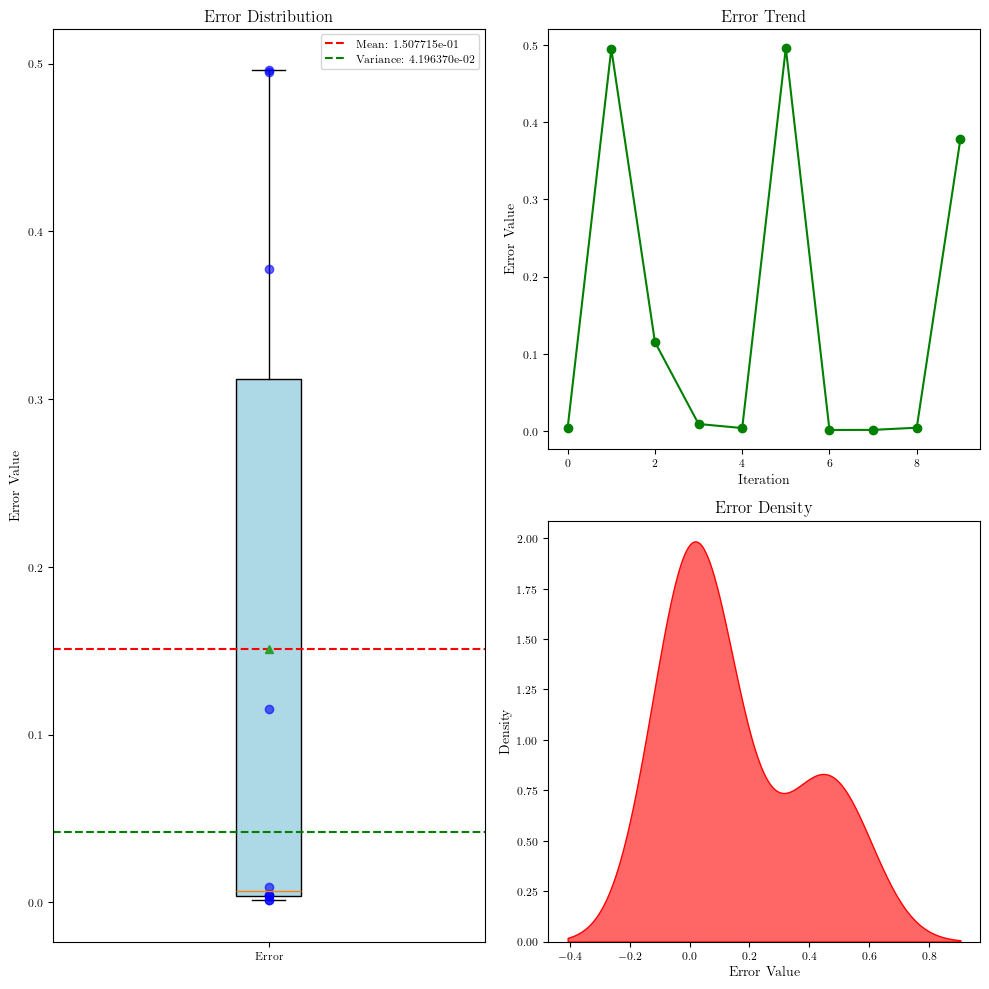

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # 导入seaborn库用于绘制密度图

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_u

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean Error u: %e' % (mean_error)) #打印误差
print('Variance Error u: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('Error Distribution')
plt.ylabel('Error Value')
plt.xticks([1], ['Error'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('Error Trend')
plt.ylabel('Error Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('Error Density')
plt.xlabel('Error Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MAE: 1.676942e-02
Variance MAE: 6.011480e-04


/tmp/ipykernel_2911717/3997509801.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


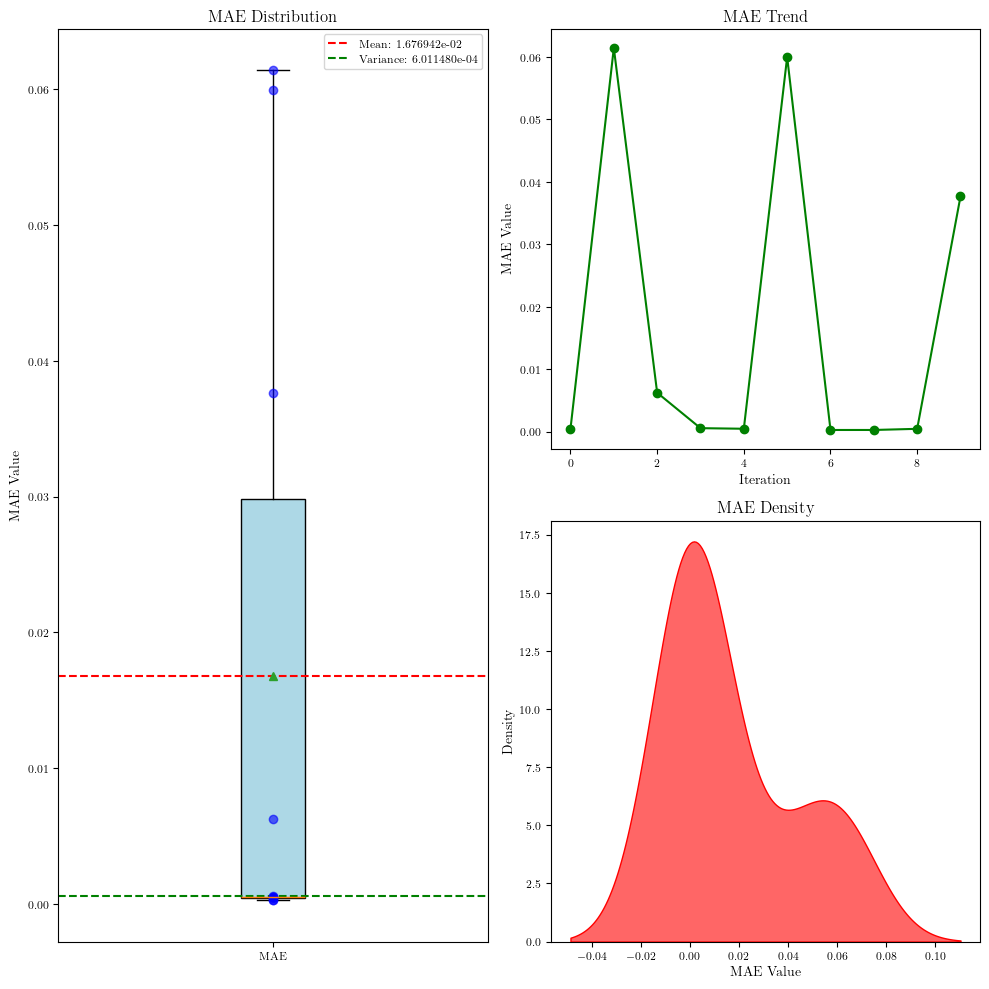

In [12]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mae

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MAE: %e' % (mean_error)) #打印误差
print('Variance MAE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MAE Distribution')
plt.ylabel('MAE Value')
plt.xticks([1], ['MAE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MAE Trend')
plt.ylabel('MAE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MAE Density')
plt.xlabel('MAE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

mean MSE: 2.441686e-02
Variance MSE: 1.412339e-03


/tmp/ipykernel_2911717/2305667704.py:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(error, shade=True, color="r", alpha=0.6)


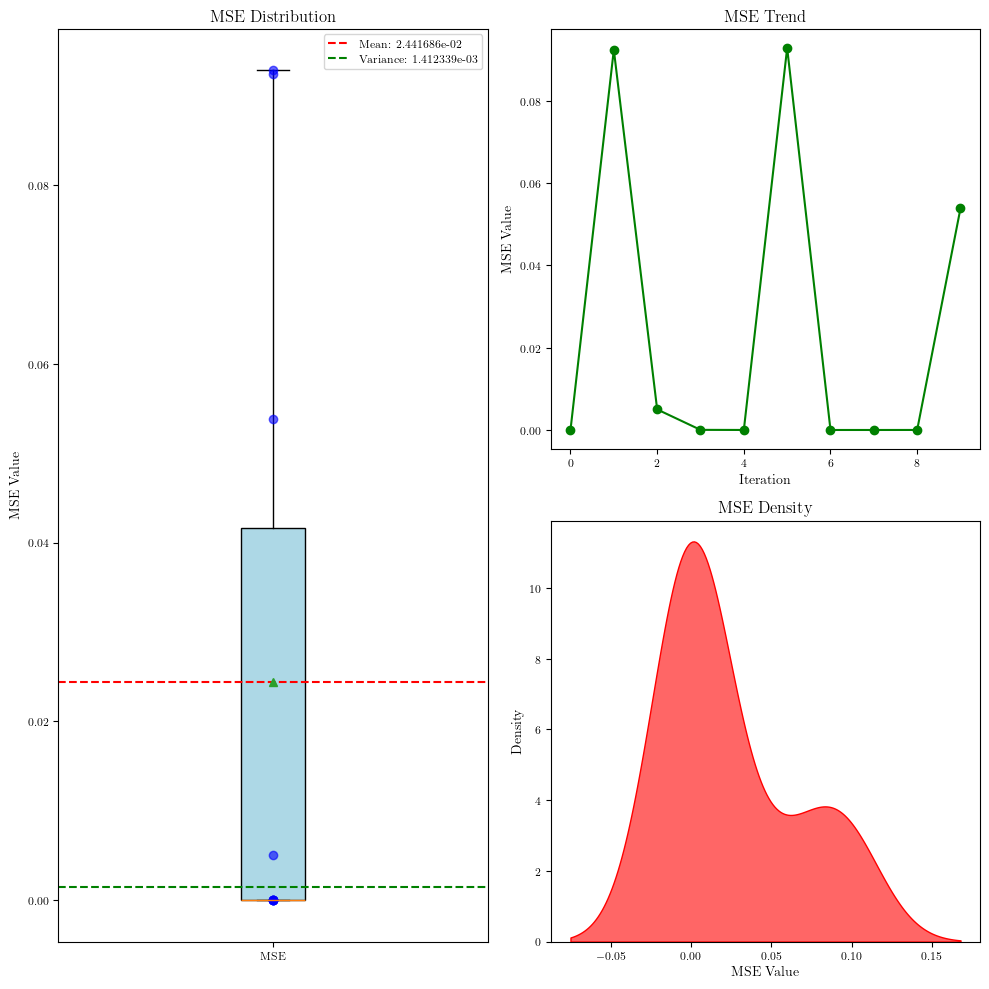

In [13]:

# error = [0.5202765768338299, 0.5498189856925179, 0.8054262198745831, 0.2836623431751703, 0.7163985307835498, 0.8486951661259542, 0.45799139947295237, 1.0888879509613618, 0.18105234189218838, 0.5686642080465825]
error = error_mse

plt.figure(figsize=(10, 10))  # 调整整体图表尺寸

# 左侧子图：箱形图，占据两张图的位置，箱的上下边界为上下四分位数，箱内的横线+三角点为中位数，虚线为均值
plt.subplot(1, 2, 1)  # 第一个子图，现在布局为1行2列
mean_error = np.mean(error)
var_error = np.var(error)
print('mean MSE: %e' % (mean_error)) #打印误差
print('Variance MSE: %e' % (var_error)) #打印方差


plt.subplot(1, 2, 1)
plt.boxplot(error, patch_artist=True, showmeans=True, meanline=False, boxprops=dict(facecolor='lightblue'))
plt.axhline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:e}')
plt.axhline(var_error, color='g', linestyle='--', label=f'Variance: {var_error:e}')  # 添加方差的水平线
for i, value in enumerate(error):
    plt.plot(1, value, 'bo', alpha=0.6)
plt.title('MSE Distribution')
plt.ylabel('MSE Value')
plt.xticks([1], ['MSE'])
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(error, '-o', color='green')
plt.title('MSE Trend')
plt.ylabel('MSE Value')
plt.xlabel('Iteration')

plt.subplot(2, 2, 4)
sns.kdeplot(error, shade=True, color="r", alpha=0.6)
plt.title('MSE Density')
plt.xlabel('MSE Value')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

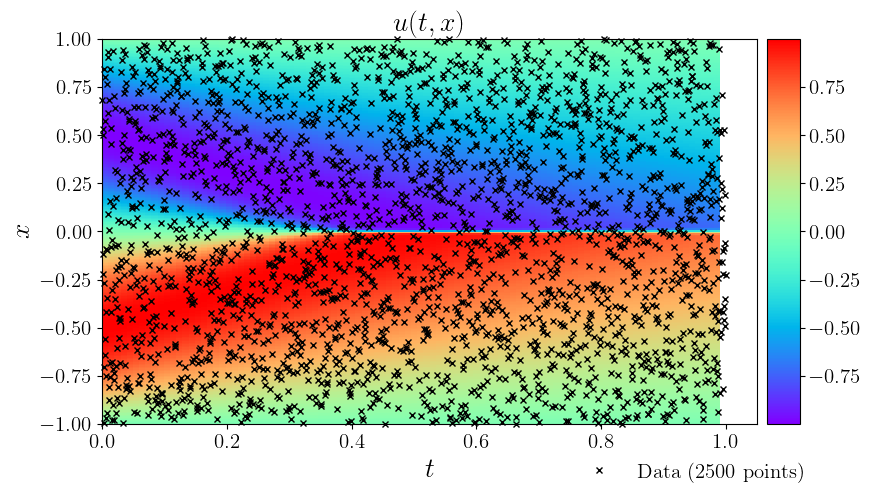

In [14]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_star = Exact.flatten()[:,None]    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_star = griddata(X_star, u_star.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_star.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


#在图上绘制散点图
ax.plot(
    X_f_train[:,1], 
    X_f_train[:,0], 
    'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
  #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

In [15]:
trainloss = torch.stack(model.loss_value).cpu().detach().numpy()

testerror = torch.stack(model.test_error).cpu().detach().numpy()

57269
[6.0001528e-01 5.7925141e-01 5.5952275e-01 ... 1.2953889e-04 1.2953793e-04
 1.2953590e-04]


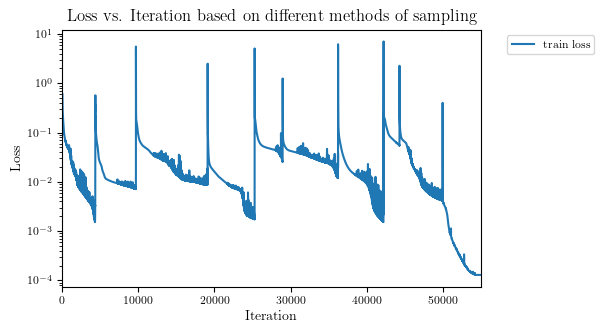

In [16]:
print(len(trainloss))
print(trainloss)
# 定义图例的标签
labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(trainloss, label='train loss')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

57269
[1.3411124  1.3215016  1.3025525  ... 0.3778224  0.37782234 0.3778224 ]


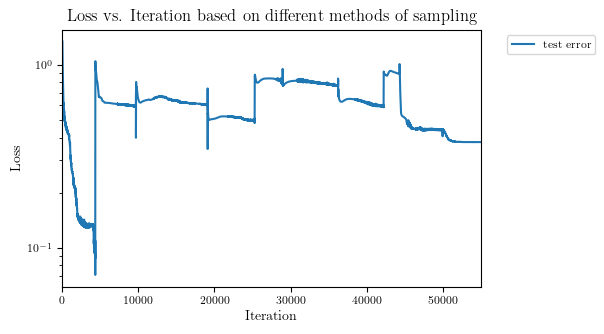

In [17]:
print(len(testerror))
print(testerror)
# 定义图例的标签
# labels = ["Grid"]

# 创建一个新的图形
plt.figure()

# # 遍历所有的loss数据和标签
# for loss, label in zip(trainloss, labels):
#     # 绘制每个loss数据，并使用标签作为图例的条目
#     plt.plot(loss, label=label)

plt.plot(testerror, label='test error')

# 添加图例，放在图像外
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


plt.xlim([0,55000]) # 设置x轴的范围
plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
plt.xlabel('Iteration') # 设置x轴的标签
plt.ylabel('Loss') # 设置y轴的标签
plt.title('Loss vs. Iteration based on different methods of sampling') # 设置图形的标题
# 显示图形
plt.show()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


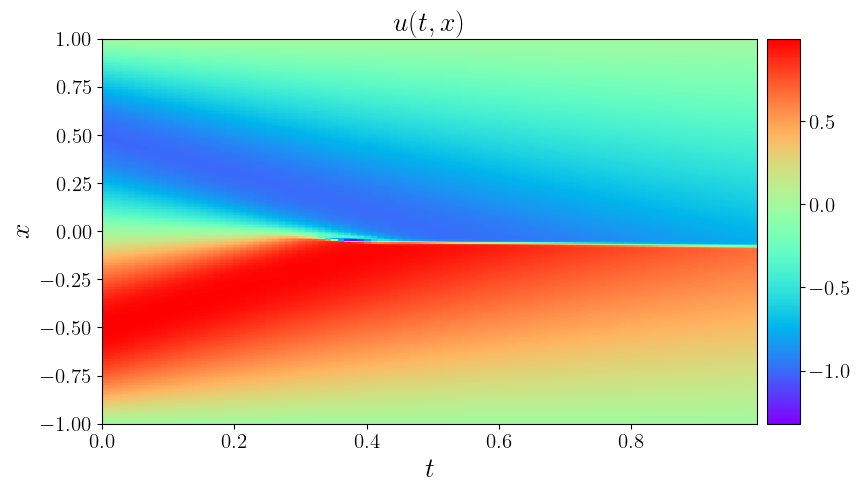

In [18]:
data = scipy.io.loadmat('../data/burgers_shock.mat')
#从data字典中取出变量tt和x的值，并转换为一维数组（flatten方法），最后tongg[:,None]将一维数组转换为二维数组
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T #从data数据中取出usol的值，并取实部，最后转置，赋值给Exact
#生成一个二位网络，X和T是输出的二维数组
#这个点结果是X和T均为形状为[len(t),len(x)]的二维数组，X的每一行都是x，一共len(t)行，T的每一列都是t，一共len(x)列
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))  #按列堆叠数组，X_star是一个二维数组，其中第一列是X的展平，第二列是T的展平
u_pred, f_pred = model.predict(X_star)    #对Exact_u使用flatten方法将其转换为一维数组，最后使用[:,None]将其转换为二维数组   


#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')


###### Row 0: u(t,x) ##################    

fig = plt.figure(figsize=(9, 5)) #这里figure是一个figure对象，是一个图形窗口，代表整个图形，设置图形大小为宽9英寸高5 英寸
ax = fig.add_subplot(111) #在图形的1*1网格的第一个位置添加一个子图

#绘图的数据来源
h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')   #imshow函数用于显示图像，接受一些参数，第一个参数是图像数据，这里是U_pred的转置；第二个参数是插值方法（用于在像素之间插入新的像素），这里是最邻近插值；
                                                   #第三个参数是颜色映射，这里是用彩虹色图；第四个参数是图像的范围；第五个参数是图像的原点位置，这里表示原点在右下角；第六个参数是图像的纵横比，这里表示调整横纵比以填充整个axes对象
                                                   #最后的结果返回一个axesimage对象，也就是h，可以通过这个对象进一步设置图像的属性


#添加颜色条
divider = make_axes_locatable(ax)  #使用 make_axes_locatable 函数创建了一个 AxesDivider 对象。这个函数接受一个 Axes 对象作为参数，返回一个 AxesDivider 对象。AxesDivider 对象可以用来管理子图的布局，特别是当你需要在一个图的旁边添加另一个图时。
cax = divider.append_axes("right", size="5%", pad=0.10) #使用append_axes方法在原始轴的右侧添加了一个新的轴。append_axes 方法接受三个参数：位置（"right"）、大小（"5%"）和间距（0.10）。在原始轴的右侧添加了一个新的轴，新轴的大小是原始轴的 5%，新轴与原始轴之间的间距是 0.05 英寸
   
cbar = fig.colorbar(h, cax=cax)#使用colorbar方法在新轴上添加了一个颜色条。colorbar 方法接受两个参数：axesimage 对象（h）和新轴（cax）。并记这个颜色条的名字是cbar
cbar.ax.tick_params(labelsize=15) #设置颜色条刻度标签大小，这里bar是之前定义的


# #在图上绘制散点图
# ax.plot(
#     X_f_train[:,1], 
#     X_f_train[:,0], 
#     'kx', label = 'Data (%d points)' % (X_f_train.shape[0]), 
#     markersize = 4,  # marker size doubled
#     clip_on = False,
#     alpha=1.0
# ) #在ax上绘制散点图，前两个参数是散点的x坐标和y坐标；kx表示黑色的x（散点形状是x），label是散点的标签，clip_on表示散点可以绘制在轴的边界外
#   #新加了一个alpha=1.0用来设置标记的透明度，1.0表示完全不透明  




#设置图的标签、图例、标题和刻度标签
#设置ax子图的x轴的标签为t，y轴的标签为x。这里$t$和$x$是latex格式的文本，用于生成数学公式
ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
#设置子图ax的图例，第一个参数用来设置图例的位置，这里表示图例放在上方中央;第二个参数用来设置图例的锚点，接受一个元组，表示x和y坐标，表示把图例的锚点设置在x坐标为0.9，y坐标为-0.05处;frameon=False表示不显示图例的边框;第三个参数设置图例的列数，分为5列；最后一个参数设置图例属性，接受字典，这里表示设置图例字体大小为15；最后返回的leg是一个legend对象，表示图形的图例
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
#设置子图ax的标题为$u(t,x)$，表示latex格式的文本，用于生成数学公式，fontsize=10表示字体大小为20
ax.set_title('$u(t,x)$', fontsize = 20) # font size doubled，两倍化子图标题
ax.tick_params(labelsize=15)#用来设置刻度标签的大小。`tick_params`是`Axes`对象的一个方法，可以用来设置刻度线的属性。在这里，`labelsize=15` 是用来设置刻度标签的字体大小的。


#显示图片
plt.show() #显示所有打开的图形的函数

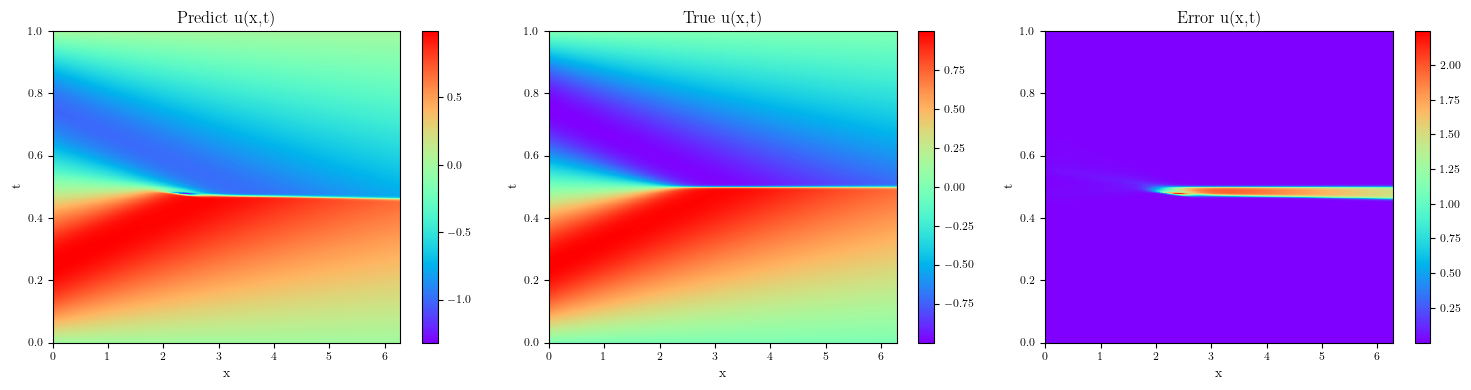

In [19]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_pred.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Predict u(x,t)')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_star.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('True u(x,t)')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 绘制第三幅图像
axes[2].imshow(np.abs(U_pred - U_star).T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[2].invert_yaxis()
axes[2].set_xlabel('x')
axes[2].set_ylabel('t')
axes[2].set_title('Error u(x,t)')
fig.colorbar(axes[2].images[0], ax=axes[2])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()

In [20]:
#计算训练好模型的chaos（最后一个seed）
u_chaos = calculate_chaos(model, X_star, num_iter=50)
u_chaos_log = np.log(u_chaos + 1e-10) #对u_var取对数，然后加上一个很小的数，避免取对数时出现错误

#使用griddata函数将X_star、u_pred插值到网格上，得到U_pred
U_chaos = griddata(X_star, u_chaos.flatten(), (X, T), method='cubic')
U_chaos_log = griddata(X_star, u_chaos_log.flatten(), (X, T), method='cubic')

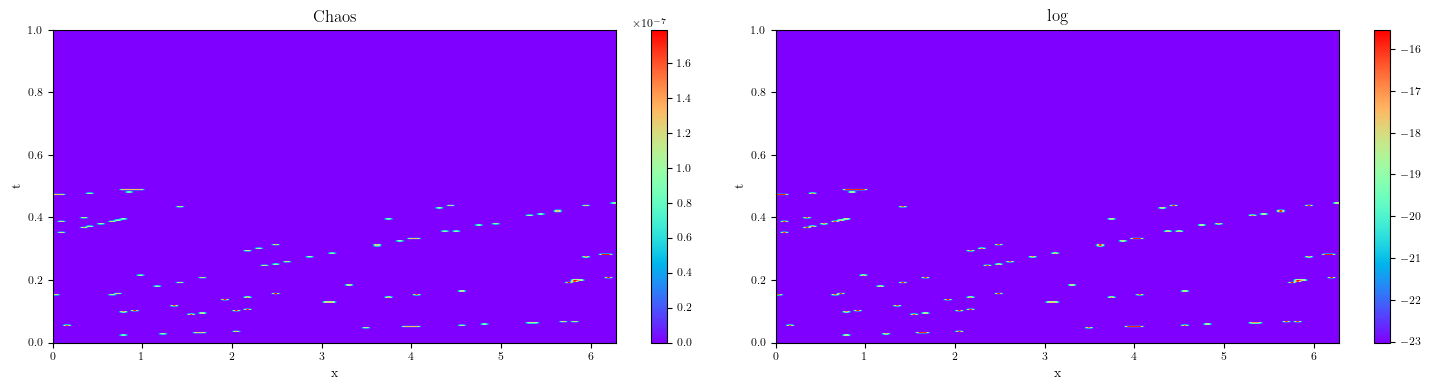

In [21]:

# 创建一个包含三幅子图的图像
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# 绘制第一幅图像
axes[0].imshow(U_chaos.T, extent=[0, np.pi*2, 1, 0], aspect='auto', cmap='rainbow')
axes[0].invert_yaxis()
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Chaos')
fig.colorbar(axes[0].images[0], ax=axes[0])

# 绘制第二幅图像
axes[1].imshow(U_chaos_log.T, extent=[0,np.pi*2,1,0], aspect='auto', cmap='rainbow') #第一个参数为数据，第二个参数为一个列表，用于设置图像的坐标范围，aspect='auto'表示纵横比自动调整
axes[1].invert_yaxis()
axes[1].set_xlabel('x')
axes[1].set_ylabel('t')
axes[1].set_title('log')
fig.colorbar(axes[1].images[0], ax=axes[1])

# 自动调整子图参数，使得子图之间的间距适当
plt.tight_layout()
plt.show()